In [1]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)
import pandas as pd
import re
import requests
from scipy.stats import norm
from scipy.signal import savgol_filter
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.patches import Rectangle

In [2]:
def extract_clinvar_truncation_variants(clinvar_df):
    #Pass the clinvar dataframe, extract early truncation mutations, and return the dataframe of truncation variants
    df_tmp = clinvar_df.loc[clinvar_df["Name"].str.contains("Ter",case = True, na=False)] # filter for only early Termination mutations
    print(len(df_tmp))
    return df_tmp

def extract_gnomad_truncation_variants(gnomad_df):
    rows_to_drop = []
    for i in range(len(gnomad_df['Protein Consequence'])):
        if not "Ter" in str(gnomad_df["Protein Consequence"][i]): #and not "splice" in str(gnomad_df["VEP Annotation"][i]): 
                   rows_to_drop.append(i)
    gnomad_df = gnomad_df.drop(rows_to_drop)
    gnomad_df = gnomad_df.reset_index()
    return gnomad_df

def clinvar_extract_residue_numbers(clinvar_df, remove_duplicates = True):
    residue_numbers = []
    clinvar_df = clinvar_df.reset_index()
    for i in range(len(clinvar_df)):
        residue_numbers.append((int(''.join(str(j) for j in re.findall(r"\d",clinvar_df['Protein Consequence-MANE'][i])))))#complicated bit of code to extract residue number/location from string)
    if remove_duplicates:
        residue_numbers = list(set(residue_numbers))
    
    return residue_numbers
def gnomad_extract_residue_numbers(gnomad_df,remove_duplicates = True):
    #example string: "p.Val41Ala"
    residue_numbers = []
    gnomad_df = gnomad_df.reset_index() #must reset index bc df is indexed with missing values from removing non-missense variants
    for i in range(len(gnomad_df)):
        residue_numbers.append((int(''.join(str(j) for j in re.findall(r"\d", gnomad_df['Protein Consequence'][i])))))#complicated bit of code to extract residue number/location from string)
    if remove_duplicates:
        residue_numbers = list(set(residue_numbers))
    return residue_numbers
            # tmp2 = df_gnomad.iloc[i]
            # if tmp < PROT_LEN:
            #     residues_gnomad.append(tmp2)
    # df_residues_gnomad = pd.DataFrame(residues_gnomad)
def drop_extra_gnomad_columns(gnomad_df):
    gnomad_df = gnomad_df.drop(columns=['index','Chromosome','Position','rsIDs','Reference','Alternate','HGVS Consequence','Flags','Allele Number', 'Allele Frequency',
                                 'GroupMax FAF group','GroupMax FAF frequency','cadd','revel_max','spliceai_ds_max','pangolin_largest_ds','phylop','sift_max','polyphen_max',
                                 'Allele Count African/African American','Allele Number African/African American','Homozygote Count African/African American',
                                 'Hemizygote Count African/African American','Allele Count Admixed American','Allele Number Admixed American',
                                 'Homozygote Count Admixed American','Hemizygote Count Admixed American','Allele Count Ashkenazi Jewish','Allele Number Ashkenazi Jewish',
                                 'Homozygote Count Ashkenazi Jewish','Hemizygote Count Ashkenazi Jewish','Allele Count East Asian','Allele Number East Asian',
                                 'Homozygote Count East Asian','Hemizygote Count East Asian','Allele Count European (Finnish)','Allele Number European (Finnish)',
                                 'Homozygote Count European (Finnish)','Hemizygote Count European (Finnish)','Allele Count Middle Eastern','Allele Number Middle Eastern',
                                 'Homozygote Count Middle Eastern','Hemizygote Count Middle Eastern','Allele Count European (non-Finnish)','Allele Number European (non-Finnish)',
                                 'Homozygote Count European (non-Finnish)','Hemizygote Count European (non-Finnish)','Allele Count Amish','Allele Number Amish',
                                 'Homozygote Count Amish','Hemizygote Count Amish','Allele Count South Asian','Allele Number South Asian','Homozygote Count South Asian',
                                 'Hemizygote Count South Asian','Allele Count Remaining','Allele Number Remaining','Homozygote Count Remaining','Hemizygote Count Remaining'])
    return gnomad_df
def add_clinvar_missense_MANE_column(clinvar_df):
    amino_acid_list = ['A','R','N','D','C','E','Q','G','H','I','L','K','M','F','P','S','T','W','Y','V']
    amino_acid_dict = {'Ala':'A', 'Arg':'R', 'Asn':'N', 'Asp':'D','Cys':'C', 'Glu':'E','Gln':'Q','Gly':'G','His':'H','Ile':'I','Leu':'L','Lys':'K','Met':'M','Phe':'F','Pro':'P','Ser':'S','Thr':'T','Trp':'W','Tyr':'Y','Val':'V','Ter':'*'}
    #pass in full clinvar dataframe, then adds a column for the MANE transcript alignment, and returns the amended dataframe

    #check if 'Protein Consequence-MANE' column isn't already a column
    tmp_var_list = []
    for i in range(len(clinvar_df)):
        tmp = clinvar_df["Name"][i]
        tmp_index = tmp.find("p.")+2 #starting index of the first amino acid in the name
        if tmp[tmp_index:tmp_index+3] in amino_acid_dict and tmp[-4:-1] in amino_acid_dict:  #first check if both 3 letters a.a.s in Name are an amino acid by checking if it is a key in a.a._dict
            tmp_var_list.append(amino_acid_dict[tmp[tmp_index:tmp_index+3]] + tmp[tmp_index+3:-4] + amino_acid_dict[tmp[-4:-1]])
        else:
            tmp_var_list.append("")

    clinvar_df.insert(3,'Protein Consequence-MANE',tmp_var_list,True) # This bit of code adds a protein consequence column with the MANE annotated variant

    len(clinvar_df)
    return clinvar_df

Example exon map of NLGN3 human transcript from ensembl

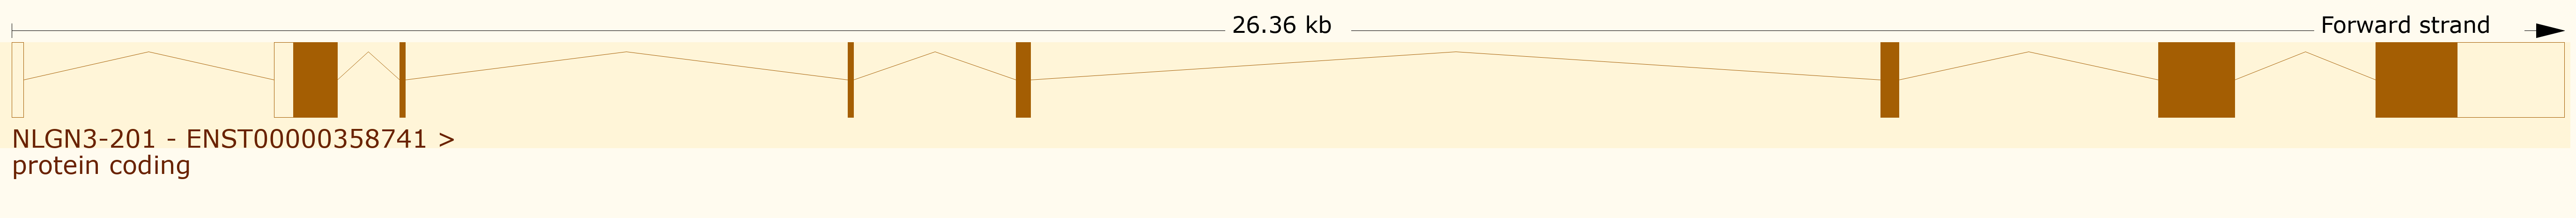

(https://useast.ensembl.org/Homo_sapiens/Transcript/Summary?db=core;g=ENSG00000196338;r=X:71144843-71171160;t=ENST00000358741)

The code below will recreate this diagram with sticks annotating locations of truncating variants from gnomAD(black) and ClinVar(red) along the transcript. For easier interpretability, the length of the intronic sequences are ratiometrically shortened.

In [3]:
nlgn1_seq = "MALPRCTWPNYVWRAVMACLVHRGLGAPLTLCMLGCLLQAGHVLSQKLDDVDPLVATNFGKIRGIKKELNNEILGPVIQFLGVPYAAPPTGERRFQPPEPPSPWSDIRNATQFAPVCPQNIIDGRLPEVMLPVWFTNNLDVVSSYVQDQSEDCLYLNIYVPTEDVKRISKECARKPGKKICRKGGPLTKKQTDDLGDNDGAEDEDIRDSGGPKPVMVYIHGGSYMEGTGNLYDGSVLASYGNVIVITVNYRLGVLGFLSTGDQAAKGNYGLLDLIQALRWTSENIGFFGGDPLRITVFGSGAGGSCVNLLTLSHYSEGNRWSNSTKGLFQRAIAQSGTALSSWAVSFQPAKYARMLATKVGCNVSDTVELVECLQKKPYKELVDQDIQPARYHIAFGPVIDGDVIPDDPQILMEQGEFLNYDIMLGVNQGEGLKFVENIVDSDDGISASDFDFAVSNFVDNLYGYPEGKDVLRETIKFMYTDWADRHNPETRRKTLLALFTDHQWVAPAVATADLHSNFGSPTYFYAFYHHCQTDQVPAWADAAHGDEVPYVLGIPMIGPTELFPCNFSKNDVMLSAVVMTYWTNFAKTGDPNQPVPQDTKFIHTKPNRFEEVAWTRYSQKDQLYLHIGLKPRVKEHYRANKVNLWLELVPHLHNLNDISQYTSTTTKVPSTDITFRPTRKNSVPVTSAFPTAKQDDPKQQPSPFSVDQRDYSTELSVTIAVGASLLFLNILAFAALYYKKDKRRHDVHRRCSPQRTTTNDLTHAQEEEIMSLQMKHTDLDHECESIHPHEVVLRTACPPDYTLAMRRSPDDVPLMTPNTITMIPNTIPGIQPLHTFNTFTGGQNNTLPHPHPHPHSHSTTRV"
nlgn2_seq = "MWLLALCLVGLAGAQRGGGGPGGGAPGGPGLGLGSLGEERFPVVNTAYGRVRGVRRELNNEILGPVVQFLGVPYATPPLGARRFQPPEAPASWPGVRNATTLPPACPQNLHGALPAIMLPVWFTDNLEAAATYVQNQSEDCLYLNLYVPTEDGPLTKKRDEATLNPPDTDIRDPGKKPVMLFLHGGSYMEGTGNMFDGSVLAAYGNVIVATLNYRLGVLGFLSTGDQAAKGNYGLLDQIQALRWLSENIAHFGGDPERITIFGSGAGASCVNLLILSHHSEGLFQKAIAQSGTAISSWSVNYQPLKYTRLLAAKVGCDREDSAEAVECLRRKPSRELVDQDVQPARYHIAFGPVVDGDVVPDDPEILMQQGEFLNYDMLIGVNQGEGLKFVEDSAESEDGVSASAFDFTVSNFVDNLYGYPEGKDVLRETIKFMYTDWADRDNGEMRRKTLLALFTDHQWVAPAVATAKLHADYQSPVYFYTFYHHCQAEGRPEWADAAHGDELPYVFGVPMVGATDLFPCNFSKNDVMLSAVVMTYWTNFAKTGDPNQPVPQDTKFIHTKPNRFEEVVWSKFNSKEKQYLHIGLKPRVRDNYRANKVAFWLELVPHLHNLHTELFTTTTRLPPYATRWPPRPPAGAPGTRRPPPPATLPPEPEPEPGPRAYDRFPGDSRDYSTELSVTVAVGASLLFLNILAFAALYYKRDRRQELRCRRLSPPGGSGSGVPGGGPLLPAAGRELPPEEELVSLQLKRGGGVGADPAEALRPACPPDYTLALRRAPDDVPLLAPGALTLLPSGLGPPPPPPPPSLHPFGPFPPPPPTATSHNNTLPHPHSTTRV"
nlgn3_seq = "MWLRLGPPSLSLSPKPTVGRSLCLTLWFLSLALRASTQAPAPTVNTHFGKLRGARVPLPSEILGPVDQYLGVPYAAPPIGEKRFLPPEPPPSWSGIRNATHFPPVCPQNIHTAVPEVMLPVWFTANLDIVATYIQEPNEDCLYLNVYVPTEDVKRISKECARKPNKKICRKGGSGAKKQGEDLADNDGDEDEDIRDSGAKPVMVYIHGGSYMEGTGNMIDGSILASYGNVIVITLNYRVGVLGFLSTGDQAAKGNYGLLDQIQALRWVSENIAFFGGDPRRITVFGSGIGASCVSLLTLSHHSEGLFQRAIIQSGSALSSWAVNYQPVKYTSLLADKVGCNVLDTVDMVDCLRQKSAKELVEQDIQPARYHVAFGPVIDGDVIPDDPEILMEQGEFLNYDIMLGVNQGEGLKFVEGVVDPEDGVSGTDFDYSVSNFVDNLYGYPEGKDTLRETIKFMYTDWADRDNPETRRKTLVALFTDHQWVEPSVVTADLHARYGSPTYFYAFYHHCQSLMKPAWSDAAHGDEVPYVFGVPMVGPTDLFPCNFSKNDVMLSAVVMTYWTNFAKTGDPNKPVPQDTKFIHTKANRFEEVAWSKYNPRDQLYLHIGLKPRVRDHYRATKVAFWKHLVPHLYNLHDMFHYTSTTTKVPPPDTTHSSHITRRPNGKTWSTKRPAISPAYSNENAQGSWNGDQDAGPLLVENPRDYSTELSVTIAVGASLLFLNVLAFAALYYRKDKRRQEPLRQPSPQRGAGAPELGAAPEEELAALQLGPTHHECEAGPPHDTLRLTALPDYTLTLRRSPDDIPLMTPNTITMIPNSLVGLQTLHPYNTFAAGFNSTGLPHSHSTTRV"
nlgn4x_seq = "MSRPQGLLWLPLLFTPVCVMLNSNVLLWLTALAIKFTLIDSQAQYPVVNTNYGKIRGLRTPLPNEILGPVEQYLGVPYASPPTGERRFQPPEPPSSWTGIRNTTQFAAVCPQHLDERSLLHDMLPIWFTANLDTLMTYVQDQNEDCLYLNIYVPTEDDIHDQNSKKPVMVYIHGGSYMEGTGNMIDGSILASYGNVIVITINYRLGILGFLSTGDQAAKGNYGLLDQIQALRWIEENVGAFGGDPKRVTIFGSGAGASCVSLLTLSHYSEGLFQKAIIQSGTALSSWAVNYQPAKYTRILADKVGCNMLDTTDMVECLRNKNYKELIQQTITPATYHIAFGPVIDGDVIPDDPQILMEQGEFLNYDIMLGVNQGEGLKFVDGIVDNEDGVTPNDFDFSVSNFVDNLYGYPEGKDTLRETIKFMYTDWADKENPETRRKTLVALFTDHQWVAPAVATADLHAQYGSPTYFYAFYHHCQSEMKPSWADSAHGDEVPYVFGIPMIGPTELFSCNFSKNDVMLSAVVMTYWTNFAKTGDPNQPVPQDTKFIHTKPNRFEEVAWSKYNPKDQLYLHIGLKPRVRDHYRATKVAFWLELVPHLHNLNEIFQYVSTTTKVPPPDMTSFPYGTRRSPAKIWPTTKRPAITPANNPKHSKDPHKTGPEDTTVLIETKRDYSTELSVTIAVGASLLFLNILAFAALYYKKDKRRHETHRRPSPQRNTTNDIAHIQNEEIMSLQMKQLEHDHECESLQAHDTLRLTCPPDYTLTLRRSPDDIPLMTPNTITMIPNTLTGMQPLHTFNTFSGGQNSTNLPHGHSTTRV"
nlgn4y_seq = "MLRPQGLLWLPLLFTSVCVMLNSNVLLWITALAIKFTLIDSQAQYPVVNTNYGKIQGLRTPLPSEILGPVEQYLGVPYASPPTGERRFQPPESPSSWTGIRNATQFSAVCPQHLDERFLLHDMLPIWFTTSLDTLMTYVQDQNEDCLYLNIYVPMEDDIHEQNSKKPVMVYIHGGSYMEGTGNMIDGSILASYGNVIVITINYRLGILGFLSTGDQAAKGNYGLLDQIQALRWIEENVGAFGGDPKRVTIFGSGAGASCVSLLTLSHYSEGLFQKAIIQSGTALSSWAVNYQPAKYTRILADKVGCNMLDTTDMVECLKNKNYKELIQQTITPATYHIAFGPVIDGDVIPDDPQILMEQGEFLNYDIMLGVNQGEGLKFVDGIVDNEDGVTPNDFDFSVSNFVDNLYGYPEGKDTLRETIKFMYTDWADKENPETRRKTLVALFTDHQWVAPAVATADLHAQYGSPTYFYAFYHHCQSEMKPSWADSAHGDEVPYVFGIPMIGPTELFSCNFSKNDVMLSAVVMTYWTNFAKTGDPNQPVPQDTKFIHTKPNRFEEVAWSKYNPKDQLYLHIGLKPRVRDHYRATKVAFWLELVPHLHNLNEIFQYVSTTTKVPPPDMTSFPYGTRRSPAKIWPTTKRPAITPANNPKHSKDPHKTGPEDTTVLIETKRDYSTELSVTIAVGASLLFLNILAFAALYYKKDKRRHETHRHPSPQRNTTNDITHIQNEEIMSLQMKQLEHDHECESLQAHDTLRLTCPPDYTLTLRRSPDDIPFMTPNTITMIPNTLMGMQPLHTFKTFSGGQNSTNLPHGHSTTRV"
nlgn1_transcript_id = "ENST00000457714.5"
nlgn2_transcript_id = "ENST00000302926.7"
nlgn3_transcript_id = "ENST00000358741.4"
nlgn4x_transcript_id = "ENST00000381095.8"
tmp_nl1 ="MALPRCTWPNYVWRAVMACLVHRGLGAPLTLCMLGCLLQAGHVLSQKLDDVDPLVATNFGKIRGIKKELNNEILGPVIQFLGVPYAAPPTGERRFQPPEPPSPWSDIRNATQFAPVCPQNIIDGRLPEVMLPVWFTNNLDVVSSYVQDQSEDCLYLNIYVPTEDVKRISKECARKPGKKICRKGDIRDSGGPKPVMVYIHGGSYMEGTGNLYDGSVLASYGNVIVITVNYRLGVLGFLSTGDQAAKGNYGLLDLIQALRWTSENIGFFGGDPLRITVFGSGAGGSCVNLLTLSHYSEGNRWSNSTKGLFQRAIAQSGTALSSWAVSFQPAKYARMLATKVGCNVSDTVELVECLQKKPYKELVDQDIQPARYHIAFGPVIDGDVIPDDPQILMEQGEFLNYDIMLGVNQGEGLKFVENIVDSDDGISASDFDFAVSNFVDNLYGYPEGKDVLRETIKFMYTDWADRHNPETRRKTLLALFTDHQWVAPAVATADLHSNFGSPTYFYAFYHHCQTDQVPAWADAAHGDEVPYVLGIPMIGPTELFPCNFSKNDVMLSAVVMTYWTNFAKTGDPNQPVPQDTKFIHTKPNRFEEVAWTRYSQKDQLYLHIGLKPRVKEHYRANKVNLWLELVPHLHNLNDISQYTSTTTKVPSTDITFRPTRKNSVPVTSAFPTAKQDDPKQQPSPFSVDQRDYSTELSVTIAVGASLLFLNILAFAALYYKKDKRRHDVHRRCSPQRTTTNDLTHAQEEEIMSLQMKHTDLDHECESIHPHEVVLRTACPPDYTLAMRRSPDDVPLMTPNTITMIPNTIPGIQPLHTFNTFTGGQNNTLPHPHPHPHSHSTTRV"
#Reference lengths: NLGN1-863 NLGN2-835 NLGN3-848 NLGN4X-816 NLGN4Y-816
nlgn1_len = 863
nlgn2_len = 835
nlgn3_len = 848
nlgn4x_len = 816

The code below will extract the truncation variants from the clinvar and gnomad file for "gene_name". Then, going through the dataframes, I manually enter the nucleotide number into the clinvar_truncations or gnomad_truncations list in the cell below it. I will need to add a function to extract the nucleotide number, rather than it being a manual process.

In [4]:
gene_name = "NLGN3"
prot_len = nlgn3_len

#ProteinRegionToleranceSorting/GitHub_Upload/variant_data/NLGN4X_gnomad_v4.1.0.csv
gnomad_v4 = pd.read_csv("variant_data/"+gene_name+"_gnomad_v4.1.0.csv")
gnomad_truncations_df = drop_extra_gnomad_columns(extract_gnomad_truncation_variants(gnomad_v4))
gnomad_trunc_list = gnomad_extract_residue_numbers(gnomad_truncations_df)
gnomad_truncations_df

#ProteinRegionToleranceSorting/GitHub_Upload/variant_data/NLGN4X_clinvar.txt
clinvar_df =  add_clinvar_missense_MANE_column(pd.read_table("variant_data/"+gene_name+"_clinvar.txt"))
clinvar_truncations_df = extract_clinvar_truncation_variants(clinvar_df)
#clinvar_trunc_list = clinvar_extract_residue_numbers(clinvar_truncations_df)
clinvar_truncations_df

3


,Name,Gene(s),Protein change,Protein Consequence-MANE,Condition(s),Accession,GRCh37Chromosome,GRCh37Location,GRCh38Chromosome,GRCh38Location,...,Germline classification,Germline date last evaluated,Germline review status,Somatic clinical impact,Somatic clinical impact date last evaluated,Somatic clinical impact review status,Oncogenicity classification,Oncogenicity date last evaluated,Oncogenicity review status,Unnamed: 24
76,NM_181303.2(NLGN3):c.163C>T (p.Arg55Ter),NLGN3,R55*,R55*,"Autism, susceptibility to, X-linked 1",VCV002442803,X,70367762,X,71147912,...,Uncertain significance,"Jan 1, 2021","criteria provided, single submitter",NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,NM_181303.2(NLGN3):c.366G>A (p.Trp122Ter),NLGN3,"W122*, W5*",W122*,Hypogonadotropic hypogonadism,VCV002443311,X,70367965,X,71148115,...,Pathogenic,"Jan 1, 2023","criteria provided, single submitter",NaN,NaN,NaN,NaN,NaN,NaN,NaN
191,NM_181303.2(NLGN3):c.2481T>A (p.Tyr827Ter),NLGN3,"Y690*, Y787*, Y807*, Y827*",Y827*,not provided,VCV002663614,X,70389881,X,71170031,...,Uncertain significance,"Jan 1, 2023","criteria provided, single submitter",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
NLGN1_gnomad_truncations = [8,195,225,435,450,451,524,562,569,571,516,552,662,717,741,763,767,769,851,868,871,916,1114,1117,1120,1130,1148,1176,1202,1275,1280,1329,1364,1376,1428,1431,1485,1533,1558,1564,1664,1665,1786,1865,1866,1913,1925,2141,2179,2470,2472]
NLGN1_clinvar_truncations = [74,777,835]
NLGN2_gnomad_truncations = [59,80,77,82,87,107,148,169,195,235,248,262,292,264,441,474,476,721,871,894,955,1027,1108,1485,1803,1807,1840,1920,1931,1953,1954,1967,2992,2177,2182,2190,2191,2194,2236,2249,2263,2293,2326,2332,2348,2350,2355,2400,2390,2389,2391,2405,2402,2408,2414,2417,2419,2441,2458,2475,2488,2508]
NLGN2_clinvar_truncations = [409,958,1314,2506,2113]
NLGN3_gnomad_truncations = [81,128,163,366,484,695,838,990,1066,1382,1400,1795,1837,2060,2218,2341,2201,2271,2291,2359,2382]
NLGN3_clinvar_truncations = [163,366,484,1632,2481,633]
NLGN4X_gnomad_truncations = [1968,820,491,301,27]
NLGN4X_clinvar_truncations = [2005,1898,1879,1185,1075,301]

In [6]:

NLGN1_seq_dict = [{"seq":"GCCGCGGCTGTAAGCCGAGGATCAGGCGGCGGCGCGGAGAGCGCGCCCGGGCGGCCAGCGCCGAGCGCGCGGAGCTGGCGTGGGGAGACACGGCAGGAAAGGCGAGTCGGAGTGGGTGATGAGAGGCCGGGAGAGCCCGTCCGAGCCGGAGAGACCGGAGAGAAGGGAGCGAGCGACTGTGCGGCGCTCACGCTGCCAGAGCCCGGGCGGAGTGCAGTCGCCTCCAAAGCCTTAGAGCGGCGCCCCAGTCACTGCAGCTCTTCACCCTAGAGCTGTGCCCTGGGACCACAGAGACCAAGAGCATGGAAATCGGCTGAGAG",
                  "type":"Non-coding exon"},
                  {"seq":"GTACAAAAGAAATAAGGAACAGATTACGAGAAAGCGGGGAGGGTTTCCTGGCGAAATACGGAGGCTGAGCAGATGGAGGAACAATGCCGCCTCCAGAAGAAAACCCTTGCCTGAACCCTCGGCGGAGCGCAGAGGAGCTGCTTTCAGCCTTCTGCTCTCCCCAGGCCCTCCGGCTAGTTCTGGGGTTGGTTCCGCCGGTTAGTTTGACAGGGATAAGAAAGTTGCTCTTCTTCCCCACAACGTTTCCTGAGAGGTGGTTTTCAGATCTGTGTGTTTCCAGTCAAGATGTCACTCCCTAGATCCCCCGCGTTGAGCAACTAATATATTATGCATTATTGGGCAATAAACTCTCCTGGGAAGAGAAGGTATTCCAAACATTTAAACCGTTCTCCACCGACTCCTGCCCGCCTCAACACAATGCCTTGTGAGTAGAAATGAAAAACCAcctgaatttaaaattatttaggtTGAGATTTTGCATTGGGAATAATTTCTTCCAGAGGAGGTTGTTAGTGTGTTATAGAGATGAGGGATATTACATGTCCAATATTTGATTCATTTGTGATAATTCTAAATCATGAACAGTTGGCCTCCACAAAGGTActatttctttttgcatttccaGGGCCATAGTGATACATATAACACTTGGGAAACGTGAATTCGTATAGTTAACCCAGTATCTGTTACTCTGCATTTTTACAGGTAGTTAATATActcattttccctctttttataCTCAAACTCCGGTAGACTATTTTTGCTTAAGTCAATTGAGTTGTCATGCTGTACATGAAAATTACAGGGTCTTAATGCATTTCTCACCATTAATTGTGCTCAATTATTAATAGGATCATAGATATTAAAATGTCACTGAGAAAGGGTATGTGTACCTATGTTTGAGTGTAAAACCTATAAAATGTCTCAGCATTTCTATCAGCCATTGTAACCTAGCAGAACACAAGGTTTTTGAAATGAGCTCAGAAGCAAGGgccattcatatatttaaaatattaaatgttaaatgcaaaaacattaaatttactGTGCCTTTGGCAGAGAATGAATCTAAGTCTACTTGCACTGCAGAGTGATTGAGTGATTCACAGAGAAAGTGGAAGTTAATCATTACTCAGGCCTTCTGATTACATGGTTTGATTAAAAGAAGTAACTGTTTTCTGTAAGCCTGCTATTCTGCAGTTAGTCTTCCCAATCCTCTTAACATAAGCAGAAATTGAGGGAGTCAATCTTTCAGCAGATTCTACTAGAGTTCCAGTAGTGTGGAGTAAGAAAAGCTTCTTTAGTTCCCGTCCTTCCCATTGTCTCCCTTCTTCCACCCCCAAAGTACTTGCTGTCAATCTTTTCTTTATTCCCTcagtatagttttattttgtgaaattttcCACTTACATTTAGTAAtaacatattttcaaatgtaaatgttTGAATGGCTTTGAAGTTGAAGGTGAAATATACACTTAAAGAAGGTAGGCTGAGAACTCCATTGGTTTCATTTGCAGGGTGTTGGAAGGCCTGATGACCCTATGCATTCCTGGATGACTTTCTTGGATCACTCTCCAAAGTCTCTTCCAACTCtgaaattcttatattttattctgcttttacTATTTTCACATGGTTATCCAGTGCCAAGATCTACATATCCCTTCAAATTACATTAAACTAGCTGTTTCTGGTTTTCTTTATAGGATAAttaagtagctagaactataaaATACAGTTATAAATCTGAGATCTgagttttttataaaatttttcacatacattttaatGCTATTGACAACTTTTTGTGAGACAATATTAATACAGATATAGCTTTGAGTGACGTATCTCTCTGGGTTTTCATGTATTGAAACAGTTTTTAACATAGTAATGGTTTATCTTgataattctttattatttttacacaAAGGAGTTATTTCACAAATTACCTAACAAATACTAATTTGTAGTTTTTGTAAGCAAAACACAGTTAAAAGTAACAGTAGTATTAGAAACTGCAGCTGTGTAACATATACCTTTGCCACATTTTAAAGGCTTAGTTTTTGAAGTGAAGTTTGCAGTCGGTTTCCATCTTACTGGATTGTCAATAGGAAGATATGATTTTTCAGTTATGTTTTAATTATCTGTAAATGAAATCACCAAAGTCCAGTCTTCTagacttaatattattattattatttctgaaatatagGTATGATCTTATTAACATTGGCCAGTGGCTCCTTATAGATTATTACATGCCAAAGTCCACAACCCTAATGCCACTCAATGCTTTTCACAATTCATTCTTAAACCTCCTTATGTAGATTAAAACACTGTCCTCCTGGCCCCCCTTCTGAATTCACTCTTTAGTCCATTCACAAGACTCTTAATTACTATTTTCCCCAACACTACATACCATTTTAGGATTTTGTGGTTTGCTTATGCTAATCTTTCTTCATTGATCCATTCCCTGCCCCTCTACCCCACCCCACCAAATATACACCAATGATAGgacagaaaaacattttagttCCTTGGGTGGTCTTTCCTTCATCATGATGCTTCCTTCCTGTACCCTTACTCTGAGCTCCCACAACACAGTATTTATACTGGGAGTAGCCCACCTTTCACACTTCTAATGGTTGGCTTTCTCACTGCACAGTGAATTGCCAGAGATCAAAAGACATGCCTGATTTATCATGTCATTCGGAAATGATAGCTTACCTTTATGTCTGAACATAGAGTCTACCAtaaatgaatagtaaatgtattatttataaatatatttggctATGAAGTAACAGAAAACTTGGCTAACCGTGGATTAagcaaataaagctttatttatctCACATAATAAAAAGTCAGGAGAAGAGAGTTGCTTAAGCATTTTATCAGGCTTCTTCTATTATCTCGAAACCTTTCTTCTCATGGGCACAAGGTCACTGATGTGCCTCCAAACTCGTGTCTGTCTTTGGGGCCCAAAATGGGGGAGAAGAAGATAACAGTATTCTACCTCAGGGTTTCTCAGCTTTGACACTGTTGTCATTGTGGGCTGGATAATTATTTGTCTTTGTTATGGGGGAGTGTACTGTACATTATAGGGATGTGTAGCATCATCCTTGGCCTCTATCCACCAGATGCTGGTAgtgcaccccacccccacctcatcaTGACTATCCAagtatctccagacattgccaaatgtctctaAGAGGTCAGATTGTCCCAGGCTCAGAAGTTTTGCTCTGAgatcagaaggaaggaaattctctGTTTCCTACTCTTCCCtacccctgtttttttttgttttgttttgttttttgtttttttccctgcaTTATGGTGGTGGCGAGgatctttttgattttttgcttaATAAGTGGTAGAGGACACAtgataagatttaaaaaacaaataagaagaaggaagaggagggaaagaggcCAAACAAGGCTTCTCTGAgcattgtgtctttttttatgGTGTGAACATTCTCCCCATAGACTTCCATTCTCGTATCACTGCCAGACTCTGTCAGCTGGCTACTTCTAGGTAACTGAGAGGTTGGAAGATAGATTTTTAGGGTGACATTTTACTACCCTCAACAAAATCAGAATCTacaagaaaagaaggggaaatggATTTGGTTTTGAAAACTTAGTGTTTGCCGTGATGGCAGAGTGAATCAATACATAAAATTCGTCTAAATActtcagaaaggagaaagagtaaacacaaaataaacatcCATCAAAGAGGGTCGATATAATTTTTCCACATGCTAAATGTTAATAAAGTAACCAGGATAATactgtgatatttttccttttgatgatATTTTACTTAGAAAATAAATGGGCAGAATGGAAACATATAGCGCTTCATAACATTTTTCTCTGCAGACGACATCCCTTCTCTTCCAGTCTATTGAATAAAGCAATAGACTTTGCTATTGATACTTACCAATTATTTAGTAATCATGTGAGAGatgtcaaaggaaataaaaatgcagcTCTATTGTTTCAATATTTCTTTCTAATGCTTGTATTTAGAAAGATAACACATGCTAGTGAATGCAGTAGGTAAAATAATGGATTCTGGTACAGATGTGTTAGCATGGACTATAGTAACTTTAAGATGGGTTGCTTATCTACCTACCATCTACCTACCAATAAGTACTCTTGGATTCTATCATAGGAAATAATTCTGACTTACAAAGATATATTAACATTGCTATGGACGACCAATGATCTTGTCTGATTGATTgtaatcttttttcttcctattcttgtttatattttctgtaagttCGTTGAATGCAAATTTTTGCTCAACTTTGtatagaatatagaaatataaaagatggTGTCTGTTAGGAAGCTTTTGCCTGCAAGTAACAGAGTACCCAATTAAAGGCTTTAACAAAAAGTACATTCATTATCTCAGAACCAGATTCTGGAGGTGTGCTGATCCAGGGTTGACTAACTTAGGAGTTCAAGGATGTCATGGCTCTGGTACGACTTCACTGTAAATCTCTTGAGTCTTTATCTTGGAAACAAGATAAACAATATGATTATCACAGAGCCAAACATCACCTCTTCTCATAGCCCCACtcaaagcagaaatgaaaaagcagtcTTCTTCTCATGGATATATCTCTTTATCTAGAAGGAAACTTTTCACAGAAGATATCAGCAAACTTCCCTTTATGCCTGAATGACTAAAACTATGTCACATTTCACTCTTAACTTACAACTGTCAATGAGACAATGCGTTGTATGATTGTTTTTGATCATCATGGTCGGTCCCTTGAGGGCTGGGGAAGAGGTCTGTTTTCCTGTGGACTTGGCTGCTTCACACAAAAAATCAGAGCTCTGTTAACTGGGAAGAAGGAGGCAATAACTATCTAGGGCTCCTAACAGGGAGTTCCACAAACAAACTATCTGTCCTTCTCAGATCTCTTAAAATATGGAATGcctatgtgaaaattaaattcatgaaaaaataattacatggCCTTTGAATCCATGGAATAAATGGTGTATATGTCTGGCTGCATGCTTCTGATGTAGAATGCATACTTTCATGATGttacagagtttttttttaaaatagaaactgaaTAATTGGAAAATGTAGGAATGTGTACTGCGTAAAATTACAAATACTAAATTATACTATATTACATGTCTAAATTATAAACCTTGCTTTGTCATCGTATACCTATCTATATGATCATATAATGTAAACTATAGTTAAATCAGAGGATGTCCACCTTACCAAACAGATCACGTATCCTCATCTATGTTTGTCATATGATTTCACCATCATAATTCAGAGATAATATGAGAAATGACTGAACCCTTTGGCCAGTTACTCTCATAAAGAAGGACTTCATATATGCTTTgcacaaataaaaattacttctTTGTTTCTGATAACGGTTTATTTACTTGAGGGGCTCAAGGGAGGGATCTAATTTTCAGCTCACATACCAGTGAGCATCTCTCTCATTGAACATTATGACTCATTTTTGTAAACAAGGAaagctttattttcattcttttgcctgaCTTCATGGAAGCTCAGAGCCAATTTTGTGCTCAATTGAAAAAGATGTCCTTAATCATCTTCTTTTACTCTGCTTTATTATTTggattcatttttaaactttaactttgtttaaatatttgattattctGGAGTTTTTTTAAATCGTAGctgcttcaaattattttttagaacaagAAATGATGTAATGAATACATGCACAAACAAATGAGTGCCATCGCGCATCACTCAATAcgtgtcttttttttccctgaatgaATGTATGTTTGGAAATTAGACGATACTGTGTTCCGTAAACTGCTGAATTTGTGGCATGAGAGGAGCAATAGGTACAATATGGTGCAATAGGATTTCAGGGAAAAGAGATAGCAGTTGTGCTTGAGTTATTTTTATGGAGATACATATTGTAGTTTGCAGACAGGTGGGAAACTAAGGCAGTGTAGGTgagataaattataaataaattgaattcattatatttattttgctgtatgaGCAGATATAAATTGTGTCTCAACTTTTTTTCCCTCCAGTTTTAGAATTCTAATAACCTCATTGCAATAACTCTTTCTTCAGTATAAAGGATCCAAAACCACAATGTAAAGGAAACATAAACTAGGAAAAGAATGGGGTTGATATCTCTCTCTGTTTCAAAGCAACTTTTGTGATGGATGTTGGTGATCTTCTTGGCTTACCTTCAGTATGTTAGAATGTGCCTTCTGAGCATCTCATCATTCCATTGACAATGCTCTATTTTCAGGCTCCATGCCTAGAGCTGTTTACACCACAGCAACCACCTCTGAACTGGGCTCCTCGCCTCCAGGAGAATTGATTTTTGAATCAAGCTTAAAATGGTAATTAGTAACTCCATCTGTGTTTAGGGTCAGGAACAGatgcttttcctttttgctttaatGGAAGATATATTTGAAGGTGGAAATATAGTGAAATAGAGTTTAAATAGATCTATATTGTGGTGGGCACTCCTGTGTCAGGTGATGACCATCATGGAAGTATGTTTTTGAGTATCTACCTGAACCCTCTTATCTGGACACAGTACAGATGATTAGAAGGTTTATTTCACAAATCCATTGTGAATTCATTATGGTTCATAGCAATGAGCCTAAGCTACTGCAAGTTCCTGAAACCTCTGCTAGGGAGttaaatgtttaattatatttaatagacCGTATTTTATCAAAACCAAGGAGCACTGATTCTAGAACACTGCATTTTATTCACACTGTGGAAAGAACACCCCAGTATTAATTCCACAATCGTTCTCTACTACTtagaatttttactttatatttttataaaggagGATTTTTAGACAAATAGATATAGATTTTTAACATATATCCATCTTTTACatgaataaaacatatattagCAAGATGCATTAgcttaagaatttaaaaaaatttatcctaTTCAGAACCTCTTCTGAATCATTTTTTGACTCATTCATAGCCATGTTTTTCCACAGAAAATAGTATGCATGTGTTGATGATGCACTGTTTTTGAAGGGCTCCGCGATTGTCTCCAGAATTTAATTCCAAGCAGCTGATACCTTCTGAATGATTTGATCCTGGTGTGTTGTTGATTTTACTAGAATGTGACAATGGAATGTTTTCAGACAACAACCAGAACTCATTTGCCTTCCTTAAATTGTCCTGAACTGTCAGGAGTGGTGGTTGTCTGGTCATGCtaagaagaataagaagaataCCAACAATTTTCACATATATAGTCTATGGCTACTATGCCTCCACTACTGCTTGgccataagaaattataaaatgcaccttgatttcagatatGTTAAAGGTGTCAGAGTCAATGAAATATGGCAACTTTAATTATACATGATCCTCGTTTTTTAAACAAACTAATACCATAGCGATAACTAATTAACCAAACTAATAATCTCCAAATAGATAAGAGAAACTATTGCATAATTCTTAGAAAGTATGATTAAAATATAAtcctatctctttttttctctatttgccctccaattatgtaatatataaaatatagctagtcttaagaaaagaaataatagtaggatgaaaacaaatgaagagaACTAGACCAGGAACGAAGAGACCGATGTCTGGGGAGCAGACTCTTCTAGTAACTCTCTGTGTCATTTCTAGTGATCCCTTCACTCTAGGCTTTGGTTTTCGTTTTTCAAATGTATGTTTAggctaattaaaattaaacatgtttCCTGGCTCTAAAATCTGTTTTGGGTAAAGATAATCAGAAATAAAGTCTGTAATAATATATTACACATTTAAGTTAGTatgatataaatacataatagtGGAGGGATGTACTGTAAGCTGGTAagcttaaaatatataacatgtatcATATAACTTTAAGATTTATTGTATCATATATAGctttaatattttacatgttttggGAGACTTGTCCATACATATCTTACTTGTTCTTTAAAATAACTGTTAAGCAATGCAGAAGATTCAACAGAACAAAAGTAGGATTTAGGAACTCTTATCCTCAAATATACTGGATGAGAAAGATTACTAAATAAATCACAGCCAAATAGTGGATGTAAAAGTGGGAGGAGGcaagaagaaaatgcattttccaccaagaacaaagaaaacttaTGCAAGGAATTAACtatcactatatatataaatgttcttCTTTAAAAGAATTATCAGtaagaagcaagagaaaattgACAGGTAAAAATGaagtttcccttttttattttatcattactgAACCATATTTTATGATTCAGTATAAATTGGCgatgtactattttattttatatgtatatttatatacgaATATATCTatgaatcaaatatatatatgaatcacatatatatgaatagatatatatatcaatatatatgaatatatattcatatatattgaattcatatatatgtattcatatatatatataaatcaaaggAAGAGAAGCCTATAGTTGGACCAGTCAGATGCTACTATTTGTGGATACATCTTGACCGTTCTTACCGTGCATTTCCACAGACAACAGCGTTTCTTCCCTGTATTGTATTTGAAAATTGCCACTGCTCTTAAGTGGTCAGAAAGCTGGGCACTTACTTTTTGATGAATAACAAGTTCTCCAGAGGTGTGCCACTCTCCTTTCTTTCGTTGTAGCTGTAGTCACCACAGAGAAAACACTGTGTTGCTTCTCACCTACCTGCTTTGCTTAAAAAGTGAGTTGATTTATGGAGCATGAAGAaaatccttcttttttattttggctaGATATTCTTGAAGTTCTCTCATAATACAATTAAGATATCAAAAACATGATACAGTATTACTGAAGTAAGTAGGtttctataaaattattaattaaattattttaatcctcTAGTTGTGTCACTTTGtccttaagaaaaatattcaagataCTAGGTTTCAAGATGGAGAGTACTATTTAATGGCTTAGAGTCTCAGATCATTAAATAGAGTTCAGAGATTATATTCATATTGTAATCACATCTTTATGACTAAATGCGTAGAATCACATTTTTTGACCTAAGGTGGTTTGTAAAACATATTGTACAAAGGaatcatttatttctaaaaactttaataaattttcaATGGTCTTTCCAGCTGAAAAGCTGAAAGGGCCATGGTGGGTTTTAGATAACATAGGCTCACTTCCTTAGTTTACATGTGACAAAACTGAagtccagaggaaaaaaatgatttgctTGTTTATGCAATGGTAGAGCTGGAACCTGATCTTCACATAATGCCTTCATGCATTAGTTTTATTTAAAGAGCAGTAATACATACATCGGCAccatatattctgtatataagtTACCATGATTACATAATTACTAGAATTTTAGAAGTATAGGTAATAATCACCAGAACTGATAAAAAAGGGGAGTCATATTTTTAGCAAAGTTAGTGGAGGAGGTATTATTTAAAGGAGATTAGGATATGAATAAATAGAGAAGAGGGAGCAAGCATTGCTTgcataaaagcaataaaaatcaaGACTAAGACAGGCAGCAGGGGCAGTTGGCCATTCTAGATTCTTTCaaaagtaaacacacacatacaacacattGAGAAATATCATtgtagaaagcaaagaaaaatgctTATTGAAATCATACATCTTATTTAGCATTCAGTATTTTGGTTTAGGGCCTCTGCAGATTAGAAATaacaattatacatttattttgaataaatagtCCTCAGAAAAATTGGTTCATATTACTCATATCAGAAAGAGTTTGCgtccactaaaaataaattatttaaaatggaatGTATGATTTTCTGAGAATGTCTGTTTGTGACACTGGTTGATACAAAATCAAGCTGAGATTATTTGATTGCCTGTCATCAAATGAGAAGATTCttcttatcatttttgttttttttgagacagagtctcgctctgttgcccaggctggagtgcagtggcacaatcctgccTACATATGGTTCTCTAGCCCAAGCACTCTTTCCATAAGAAATACTAGAAACGTTCTGCCTCACACAATATGTCTTCTTTTCCATGCTCCTTTTCAACATGGTACTCCAAGCAGTCCCTCCAGATTTGATGATTGCAAGACAGAATGCCTATTTGCTTAAGGGAGAGAGAATCTAGTTGGTGCCAATCTGTCTTTTAATGCTCATTGGTCATACTCACcatcacttaaaaatttttaacatttttaaggtCTGAGGGGCAATTTCAAGAGAGATGTATTCTTCCGTTTCTACTAAATTCTATGTAAAATCAACACATCCCTCCTGACTCTCCTTGAAGTCACTCTCCATAAAAACAGCAGCTCATTCTGGGAGCCAGTGGCTAGAATAACCAGCACCTGGAGATTAGGGAGGGAATCTTTCAGAAGAGCATAAGCATGTTTTCTATAGAACTGCGTAAACATGGCCTCTATAACTTCTCAAGAATAGGCgcattggccgggcgcagtggctcacgcctgtaatcccagcactttgggaggccgaggcgggcggatcacagggtcaggagatcgagaccttcctggctaatacggtgaaaccccgtctctactaaaaatacaaaaaattagctgggcgtggtggcgggtgcctgtaattccagctacttgggaggctgaggcaggagaatggtgtgaacccgggaggctgaggttgcagtgagccgagattgtgccactgcactccagcctgggcaacagagcgagactctgtctcaaaaaaaaaaaaaaaagaataggtgcATTACAACTCTGCCAGTTGTAACTCAAAATACGCTGGGAATAGTCCTGGTATGCTATTTTGAATGTCATTTCTTCACGAGCCTTCTCTAGAACCCCTAGGAAGCCTGAGATCTCACAGAACAGCCTCTCGTGGGACACTCTACCAtagaaatctgagaaaaacaagagtaTGGGTGGTGCTGCTATAGGGGAGAACGAAGGTATAATCACTGGAAATGGAATAATTTGTTAGAGTGTTAGAAAGAGTATAAAGAGCCATCTTTAACATTGCAATATCTTTTATTTATCCTGCTACACTCAGGTTTGCAAAACTgccatatgtatacatatatatcaatatgtAAATGTGTATCTATCTACCTCTGTTTATCTTTATTAATTGAAAATTATAGTTGAATGATTGATATGAGAAAGCCTGAGAAGAAACAATCACTTTTCTTGGAAAAAACTGTTCATATTCCATATGTACTGTAGACGGGAATGTGGAAAAACACTAGAAAACGTGTCACTGGCCCCTAGAAAACGTGTCACTGGCCCCCAGGAAAATAAATCTAGCATTCATCTATCAGTCCATATATTTTTTTGCTTATCTTCatgaatattatttctttcccccatttccaACTCCTGATTTCCTGTCTCCTGATCCCTGTATCCAGTCAACAATGTCTCTTACACACGTCTCTTACATGGCATCCTTTCTGTACCTAAATCCAGAACCCAAATTCAGGATTTTCCATTGTGCTTTTGAAATGTTGCAAAAGCCTTCTAAATGCAAATATCAGCAACCAACACTCTAATATGAATAAGTTTGTCTGACTATTTCCCTCCGCCATGTGATACTTGgctaaaaagaatgaaacataaaaaagacAAGTATTGATGGGGAAGGCCAGGAAGATCAGTTTAAACCAAGATCATTGCTAGTGAGAACAAGCCTAGGTTAATGCCAGGTGCTTACTAGAAGGATGTTTTAGGGACCTGTAGGGGGGCCAAGAGGCAATCTCTGGAGAGGGTGGGAGATTGAGGAATTTGGGTCTGGGAAAGGGGTGACACAAATGAGCAAGATAAGGGGGAAAACAACCAAACTTGTTCTGCATAATTCTTTAGCTTAATAGGTGGTACTGCTGCTAAGTTAGTACTAAAATTCATGATTCTGTGTGGACTTCACCTCTCTTTGATTTAGTTTTTCTGTCTGTAAAAAATACACTGAGAGTAGTCCTGCTAGTCTATTTTGAGTGTCATTCCTTCACCAGGCTATTCTAAAACTCTAAAAAGTATAGGGCCGTTATgggaataaacaaaataacatagcacttttgcctggcacataaaaatGTTCAGAAGTGTTTGCATTATCATGAGAACCCTCCATACATAAACACGGACACACTGTGCTCACCTACTAATAGCCATTTATCACGTATTTCCTAAGCACTGGGTGGGACATGGTGCTAGGCACAATGGAGAAGGCAAAGATGAGTCAAACGCTACCTCAATTGTGACAGTCCTTCTTTATTCACCTGGAGTTTTTGAAGTTAAGATATGGTGTTCTACATCCATGTTTTTGTTAATGCAGGGGAGATTGGGCTGCTTTTATTTCACTAGCACATGGAAGGAGGGATAAAGCATTTAGAAATGGTGAAATTGGCAGCTTTAGAAAATTCAAGAACTCTATCAGCATTAGAATGTGAAAACATTTGAGTCATAGGCTTGCTAGGGGTGAGTATTTAATAGGTGCCTTTGTAAAATCTCCAAACTAGGCTGTATCATTTTCTATACATGTTTAAATCTCTTAATTACAAAGCAACTTTAATTATACATAAAGTATGCCACTTCAATCATGTTTTAAtcacacataaaaaaattaaatttatcccaaagttattttctgcatttcaattctgatttttaaactcTGGCATATTCTGTACCAAAAAATTGCATTAAGCTAATGTTTATGCTTGCACATAATCCCACACTTTCAAGGCAacacttaaaatattcagaagagCTTCACAAGAGGGAGTAGTTTAATTCTGTTGTTGACTCAGAGCCATTGTTCTTCACAGTTACAGCTCCGCTGGCATAGGCTACATATGGTCACTTGTTTTCTCAGTGTACAGAGTGATAATGCATTAACATTCTGGCTGGTGGTGGAGGCTGTGCTGTGCTTTAGAGAAATATAGCAGGGAAGATGTGCTGCCTCTTTGGCAGAAAAGAGGGCAAGATCAGCATGAGAGAGCCTGCAGATTGCTATAAACTAATCATTGGGACTGTACACTGTGGTGGCTGACCTAGAAGTCAGATCATTCCCTTACGGAGTCTAAATTTCAAACATTGTCTGTCTGTGAGTAGGACTTACATTGAAAGAGTGGTCATCAGAGAGAACTATGGACCACAGCCACAGAAGGAAGTTTTGCCAGCTTCCTTCACCACTGCCATTCAGAGGTGCTGTTCTGGAGCCCTCGGTTGCCACTTGGAAGAGACTTTTTATGATCCCACTTTTGCTCTAATCATGGCTATGTAGGCCCCAGGTCAAGTGGAGTGCTGGGCTGGTGACTGATGGCCCTGTCAAGGTCCATTAGAAGTAGTACTTAAGTACTTTCTTAGGTCATTAGTATTAGGCAACAAGAATGGGGGATTTTGGCTGGGGTTTAGTAAACATGACTTTTCTTAAAGCTTTTGcaatttccttttgtgtatatgAAGTGAGGAAAAAAGGCCACGGAAGATATTAAGCATCTATTCCTACCCCGCCCTCCAAACCCCCTCATCTCTTATCTAATATTATTCCATGTGGGATTGTGTGCCAAGAGACATTTCCAGTTATGAGGGCTTCTACCTactttttcctgcttctctgggTTACATCTGTGGTTGCgaatagaaaaattaatactAGTGGCAGCACCAGAGGGAGCCACTTACACACTTTTGTTTCAAGCAGTGACGAAGCTGACAGTAAGActtaaaatgcagaaatattaaggtttaattgtattttctgaaagagaatgGCAGAAAAGTAGATGATATGTAAAATCTGTTAGCAGCAATTCCAAATTATGGGACTAGTAGCaaccactttctctctctcacttgaaATATTTGTGAATGGTAATTGCCTGGCTGCAATCCAGAAAGTaaatcatatttcaaaatgtaaaattgtgtttGGAGCAAGAAGTATTCTCTCTGATCCTGGAATTGTCCCTCTGCAGAATACTATTAGCAAGTTTGCATGTTTGAAACCTATACCAGTTTACTGTTTTTGTAATGTTAATGATGCtaccaaaaataaagaatgaggaaTTAAGACTAAAACTTTTCAGATGCACATGCCAGTGCTCAATGCATTCTCTCtcactctgacacacacacacacacacacacacacacacacagtgtgcaCACATATTTGCACAGGTGATTTTGCTGTAGAGCATTAGAACCAGGATTTTGTAAGGACATCAGGTAAGCTTGCTCTTGAGTACTATGATAGGGTTGAGAGAATTAAAATCctgaaaggaaaatagaatgtatttatctttattagcacactgaccttttttttttaatgaggaaataGTCAAATGCATAAAGTTCTGAGTGAAACTCTATCTTAATTACCACACtaacaaaatatttcaggaaaatatATTGATTCCAACTTCTTGGAGGGAAGGTTTCCAGCCCTTCTCTTGTTTTGTCTTGGCTGATTCTAAACCAAATTATAAAAACACTGGAAAGGAAGAATTGCTATAGTTCTTCTTTGAACAACCACAAAAAAAGCCGTATTCTTAGTACTGCTCAGCCTTCCTCCACCCCACTTTGACAGCATCAGGCATATCCAATAACATACTTTCACAAGAAGGGATTCTATGAAATTAGATGATCTCCTTTGGCTCTGTAATGGTACTTTTTTGGCCTGATTGTGATAAGGCCTGCAGTGCATAATGCTGACAACAAATGCTTTCTTAGGTCGCTTTCCACGTAACAGTAATTCTCTTCAAGAAAGTAATTGATTAACTGGGGTTTGTGCTACAGATGGAAAGGAGGGAATAAGAAAGATTGCTTGTGCTTGACTCCCTGGCGATATttatccttcttttctttttaagagtctttccttctctttctgccttGCCCACCCTAGCCAACATGCTTCCCTCGCAGACTGCCCATTCCTAATCCATTTTTGGGGGAAGCGATGGACTAAGGAAGTCGGGGATGCAATGTGACTGTGATCTAGTGTCCTTCTGCCTGCAGAACTTTTAAGAACACAAATTTGCCTCTGAGACAAGGaagttcatatattttttgttttatctatccatccatctacctattttattttaattttaaaaatgagacttctcggccgggtgctgtggctcatgcctgtaaccccagcactttgggaggctgaggtgggcggatcacaaggtcaggagttcaagaccagcctgaccgatacgatgaaaccccatctctactaaaaatacaaaaataagctgggcgtggtggcatgcacctgtagtcccagctacttgggaggctgaggcagaagaatcgcttgaacccaggaggcagaggttgcagtgagctgacatcatgccactgtactccagcctgggtgacagagcaagactccatctcaaaaataaaattaaaattaaataaataaaaacttcttAGTCTAGAAAGAGGGACCATTACTGAGGAAGAGATCTACAGCAATTTTGTTAACTTCCAAAACTCTGGAAGACATTGGTTatcacttccttcaggagcctTGACCCCAGATGTCTAGAGAAGTTCAGGGCCAGAGCAGCAGGTCAAATGGGAAGCCCTGGAGCTAAACATACCAGGTGATTCTGGCTACCCTATGGGCAAAAGGTTTCAAGAACCTTCTTCTCCctggaaaaagaacaagaaaggaaGCAGCAGTGGTTGTGGTACAACAGGTGACTAGTGAAGGTAGAAGAGATGATGTGAGCTTTGTATGTACAGAGAAGGTGTCCCCAGCACGCGGTTCCACACTGTAGTGAATATCATGAGTCCACTGTGCACACAGAAGATCCTGGGTTCGGGAAGGTACCCCAAAGTGCCTCCAAAGCATCTTCatacttacattgtattaggaTGTGAACATATGGGAACAGGAGTGGGGGCCTGGAAGGGAGAGGGGCATGTCTGGTACCGAAAAAGATCATCCTCACATCTTGTTATTTCAAGCTATGTCTGCAAGCAAACTGGTAGCTGTGTTGCTGACTTAACAGAAACAGAGAGGATGCTTGAATACTGATTTGAGTGTGATAAAGGAGATATGTTATATAGTACTCTTCTTGGTAGTATACAAAAAGATGGGAAAGGGCAGGGAGCAGAGTGAGTAGAGGGCATGTCTCCTGCTTAGGAATGATTAAATGGCTATCTTTGAATTGGACTGGAGAAGAAGGAATCCTCAGGACGCTAGGAAACCAATGGACTTAAGTAAGGGGTCAGTGTGGTCCTTTCTTTGTAATCTGAGAATTACCGCTATGCTTTGTTTAGCAAAAGGTACATAGAGGCTTCAGTTTGCCACCTCAGAACCTTAGTTAAGAGACTAGAACTACATTATATGATATGCAACATctccatgtgaaaaaaaaaaaagcaccaaaaaCTTCTTAGTCTAGAAAGAGGGACCATTACTGAGGAAGGGATCTACAGCAATGTGTCCATTTGTGTTTAATAGTAAAACCCTTGAAAAGAAAAGGACCTGAACATTAATGTCtttggggagagaaagggaggatgATTTAAGGAGCAACATCTCACTTTGGAAATCAGATTTGGAGGAGCAGGACCACGAAAGGTGAAGTGGGTGGTTTTGAGAAGGCCCAAGAGGGTGTGCAGCCTAGAATGACAGACAATAGGAATCAGATAAGAAAGCATCCTGAGACAGAGCAGGGAAGAGGCCCTAAGATGTCCACATATGAATAACGTCATCAGAGAAGTCCACCTGAAATCCctaaacaaataaattgaaacaaGAGCCCACAATAAGATGCAGATGGAGACAAGAGGGCTATCAAGGAGGCAACTGCCAAGTGAGCCAAACTTCTCCTTGGTCTTTGATTCTTCATCAAGCAAAGTCAGAACATTTGCAGTGTTTTGAAAACCGCATTTGTTTTTCAAGCTAATTGTTATTAAAGGGTGATTTCAAATAGTTAGATTTAACATTATTCCAAATAATTGTAGTAACTCAGTTGTATGTGGTTAAATTCTGGACCTTTGAGCAAGGCTTTCGGCAAAAACCTCCTTTGTCAAGTGCAAAATAGGCAAATTTACAGCTCCTATTATATAGGGATTGCTATTTAAATCTGAGATGGCAGGAAGTAGGAGGGGGGATAATTTAAAGCAACTGACAGGCATTATGTCTTTCTCTGatccttattttttaagttctcaaCAAGCGGTTTAGCGGTATGAAGACAAATCTCTCCCGGAAAAAGTAGAATGGAAAGAAGCTTGATGCTATGCATAGTACACTGGGATTGAAGTTGGATGATGTAGATATAAGTTGACATAGGTAAGTTTTGACTTTGCCGTATGCTAATGATTGCTGAAGGCAGTGCAACCTGGCTTTCAGTGTTTTTCcctataaaataagaaagacaacATATTCTTGCCTGTTTCGTAGAGTAGTATTAAAGGACCAATAGGTCAAAGTCTGAAAAGGCATTTTATATACTATTAAACTCTATATGAATATAGGATACCATTGAGTATAGCAGAGAAAAAGGTAATATATTGTAGTAGAGTCAGAAATTGGATGGATTCAGGGTATAGGCCTTAAAATCAGAGGAGCCTCTGCCATTAAGTTATTTAGTctctctatgcttcagtttcccTATTGATAAAGGGAGATAAGGAGAACTCTACCTGTGGAACATTGCAaggagtaaatatatatatatatagagagagagagagggagagagagagagagagagagagagcttggtaTAGAGCCTAACACACAATAAGAGTGCATACATAAAATGAATATTAGCTATTACCAGGTGTGATTATTGGTTGACACCACTGAGTTTATTTATCTTGGAAATGATAGATTCATGAGCGTCACAGATAAGGACCTTGAAGCTCAAGCACTTTGTTTCTATATAACACTTACATCACTTACATTATACTTGTTGACATATAGATGGTATTTAAGCCATGAGATTAGATTACACCACCAAAGGAGTGAGCATAGATGCTCAATATATGCATTCCATTGCCCAGACTTCTAAACTGAATAACCTCATGCAAGCTCCTTATCCCTCTAAGCctcatttcttcatttgcaaaatagagataatatcTTCCTCATAGAATGAGAGGGTTTAATGAGATAGTATATGCAGAATATGCAGCACCTCATTGGAATGATTTCATTCTGTTCTTTTGGTGATAACTCAGCTTTCAGAAATGGCCCTGAAGGGCCAAAGGAAAAACAGGCAACCAGGAGCAGCGTCTTCCCATGAATTTCACTGTGTGAGTTGTTTTCCCTAACtcatatttcttttgctttctattttctaaaagacTCCGTGTTTCAGTTAGTTCAGAAAATATTGCTTTGATCACAAAGCTGACCCCTACTACATGTAATCCTGAGGCTTTTTCTGGTAAAAGACATGCAAAAATATACCTACAAAACAATGTGTTAATTTCTTACTTAGATATCATTCCAAAGCATGTGAGCATCAAGATTCGAAAGAAGAGGTGGGAGACATATAGTTGcaaataatatttgtattcttTAGAATTTGATATGATTAAATGGATACTGATATGGCCCAAGCACAAAGATTTCATCACTTTAATATATATAGTTAAAGTGAGTCTAATGTATTTTGAGAGACATATAAAGAAACCCAAGTATTTATTCTGAGATCTTCtacaaataatgtttttgaaagttcatataaaataaatctttatgaTACCATGATCAAACTGTAATATTCATCTGTCTGTATGAATTCAACTCTTATGTTCAATAATGGAAATATGTGCTCTTGCAATTATAAAATTGAAACCTCTTGAGAGTACAAACTGGTAAACCTGGAAATCCATTACTTGGAATTAATAatgcatgttatttttttcatagaaaatgaTCTACCTTTTTTGTATTAGATATTACATTTGACATATTCTTCCATGTCTCAAGGTAATATCTATGGTGTCGCAAATTACATTTGTAATTAGTTATTCATGCCATTAAACTTAAATATACTATAGAAGTTCAAGAGAGTTCGTAGAAGTAGAAAtgaattaaacataaattttctgattatcttttttaaatggtCTTTTTCAATTTTAAGACTATagaattaagtaattttaaaagctcactgattaaaactatttttaaaatgtcttggtATGTGATACTTGAACTTAATTCTCTAAATAATCTATTTACAAAAAATAgtgattttctattttgcttaATTATCTGAATCATATAAGCATTTTTACTTTAATGGAaacaataattttctttataaaattagcAATTCATATTTTGCTATCATTATGTGGATTTAAACACTCTTAGAAAATATGTATCAGACACTAATAGGAATTATTTTGAGTTGCTTAATTATCATACACCACACAGAAATGCAATAATTCAATAACATTGCTTGCAACAATAACTTGCAATTTCAAAGATAATGATGTTTGGGTCTCTATCAGTTATACAATTATTTTGTAACTTATAAATAGTTCTTGTACATGTAACTTGTGTAACAGATATTGTAATACAAAACATAAAGGGAATGAATGCacaatatgaaatattaaattaactaTGTTTTTTAGGTGTTTCTTCTTAAACTAAACTTTTATGTAAACTTTCTGCCTCCCTATTCTTCTCAGACTAAGTTTTACTCATAAAATTTTgtggcttttattacttttattaaacaaatactcatcttaataatgagaaaaaaaacaattgagcagataggaagaaaaaaacagaattctgTCATCACAAGGTAGCTccttttattcatccattctctttctttttatttgtttatgtgtgtgtgcatattatttgaaagtatatatacataaataaaatataataagtatatataacAAAGATGGTATTTTAATGCTCTGTCATACATTTCTTTCACATATTAATATGTGAAATATTAGAAggcataattataatataattggaagatgtaattattataattttaagatataattagtatacaatgtaatattattgtATACtataatttaacaatttattgcttgaatttttttttgctttcatttcttttttctgttaactATGAACTGCATATTTCAATGCACagtttgattattttcttaggataaattaTTGATCATGAATTCTTGGGTTTAAAGATATGCacactttaaattatttcaatgtatATTCCTAAGGTGCCTTCCATAAAGGTCATAGCCCAGTGAAATGTCTCAGGCAGAAGTTCGTTGTGCCCTGTGCAATACAGATATTACattctttttgatattttccaATCCAATAGGTATGATCTTTCTTCTCATTGTATAAATTGGCAAGTCTTTGATAGCTAatgatataaaactataaaaatatgtatttgccaAATGATTTTCATCTTTGAGATTTCATCTAATTTTTCTAATCTACTGTCCatttattctgtttatgtaaACACAGCTATAGATCTTTGttactgtttctttctttaacaTCAAGCTTAGATTCTGAGAAGCCAAATTATGTACATATTAACCCATATGTTCTTTAGATAGCTTTATGTCTTGAGTTTTTACAATTACATGTTTTTCATCCAAAATGTGTTTTGTTATTAAGTATGATATAAGGATCTAAACCAAACTTGTCCAACTCACAGGCCCTGGGCCACATGGggtccaggatggctttgaatgtggcccatcacaaatttgtaaacttccttaaaatatgatgattttttttttttgcagtttcctttctgttctttagctttcttcttcttcttttttttttttttttttttttttttttttttttgctcatcagccatcattagtgttagtatatgtctatatctatctatctatctatatatatcgattttttttttttggcagttaaAGACAGGTTTACTTTCGATAAAACCTGAGAAGGGCTTCTGGCTGATTTCAATCAGGAGCGCTTTCTCTTACAGACAAAGTACATGAGTATACATTGGTTTTAGGGTGAGGGGGCTTATCACAAGCTTGGAATGTGTATGTGTAGGGGAGAAGTTTATGGTGAGGTTGGAATGTCTCTGGGTGAAGGGGGGATTATCTTGGGGCTGACATCTTTCCAGCAGGAAGGGGGTTATCTCGGGGCTGGCATCTTCCCAGCTGGAGGGGGGCAGCTAGCATGTCTCTGGTTGCAGAGGaatttggaatgtttctggtcggagatttttttttgtttatgatcATGCTGATCTTAGCCAtttaggctgatgccctttggatttaggcagtttttgaTTAATGTGAATTGGAAAATAACAGTGCTTGTGCAAGATGGTGATACTCCTGCTCTGTCAtatttcagcctctcaaagctcagggattataggcatgagccactgtgcctggctctgttgTCTGattcaaagtctgttttatctgatataatagTGACCcctggttgggcgtggtggctcatgcctgtaatcccagcactttgggaggccaaggtgggtggatcaagaggtcaagagatcaagaccatcctggccaacatggtgaaaccccatctctatctggtaaaaatacaaaaattagctgggcgtggtagtgtgtgcctgtagtcccagctactcagcaggctgaggcaggagaattgcttgaacccaggaggcagaagttgcagtaagccgagatcgcaccattgcactccagcctggcgacacagagagactcagtctcaaaaataaaataaaataaaataaaataaagtaaaataaaataatagtgacCCCtgaccttttttgttttccatttgcttgatagatcttttttcttttttttttcattattattattattatactttaagttttagggtacatgtgcacaacgtgcaggtttgttacatatgtatacatgtgccatgttggtgtgctgcacccattaacttgtcatttagcattaagtatatctcctaatgctgtccctccccactcctcccaccccacaacagtccccggtgtgtgatgttccccttcctgtgtccatgtgttctcattgttcaattcccgcctatgagtgagaacatgcggtgtttggtttttttgtccttgcgatagtttgctgagaatgatggtttccagcttcatccatgtccctacaaaggacatgaactcatcattttttatggctgcaaagtattccatggtgtatatgtgccacattttcttaatccagtctatcattgttggacatttgggttggttccaagtctatgctattgtgaatagtgccgcaataaacatacgtgtgcatgtgtctttatagcagcatgattttataatcctctgggtatatacccagtaatgggatgactgggtcaaatggtatttctagttctagatccctgaggaattgccacaccgacttccacaatggttgaactagtttacagtcccaccaacagtgtagtgttactatattttatgtgtggcccaagacaattcttcttcttccggtgtggcccagggaagccaaaagattgtaCCCTAAAAATGATAGTATTGAAGAGCCTATCTTTCCACACTAATTTGATATGTGTACTTTTTCATGTACAAAATTTTTACACATAGTTGAATCTTCTGGACTTTCTATTCATTGCCATTGCTCTGCTTATTGGGTGAAAATGctacattgttttaatttattgtatatttctaaTACTTTTCTAATATCAGGTAGTACAAGCCCTGTGCATTAATTACTCttcttttttcagatattttcttacTATTCTGTCTACTGTGTTTCTTCTAAGTGTATTGTAAAATATTcatcaagttaaaaataataatacaattgtTATAAATTAGTAAGGAAATGTTAAATAACCTCACACTCTTGATTTTCAGAATCAGGACTCTAGtctatttctcaaattttttaaaaatcatttttattatatactttttattttgaaataatcttaaATGCCtagaaaagttatttatttggATGTAGTCTTAAAATTAGAATTTGCAAGAGTACAAGTGtctatttttaaagccatttaaaAGTAAGTTGCCCATCTTTCCTTCAAATACGTTAgtgtacattttttacaaataaggatATTCTCCTTCCTAATTACAATTGCCATCAAAATTAGGAATTAACATTGGTATGTTATCCCATCTAATCCTTAGAcccttttcagtttttctcagGTATTCCAACAAAGTCCATTATAGAAAAAGGatcaattttataataataattatttttattattatttgagacagggtctctgtcacgcaggctggagtgcagtggtgcaatctcagctctttgcaacctctgcctcctgggctcaagcagttcttctgcctcagtctgggactacagactgaggcagaagactgggattacaggtgtgcaccatcatgccgggataaattttgtattttttgtagagacagggttttggcgTGTtgcctcaggctggtcttaaactcctgggctcaagtgatcctcccgcctcagcctcctaaagtgctaggattatagacatgagctaccacacctggcccagtttagaattatgttttgtttttagttgctATGTCTCGTTAGGCTTCTTCAGTCTGATATAGTGTCTTAGTCATTCTTTGATTTTATACCTCAAcactttttaattgatacataacgATTTTACATATTAATAGGATACccataatattttgatacatatatacaatgtttaatgatcaaatcagaataATTTGGTTATCCATCAAATGcagacatttattatctcaaaCAAATAAACTCAAACACTTatcatgatatatatatgtgtgtatatatatgtgatatatatgtgtgtatgtgtactatATATagtacactatatatacacacacacacacacatacacacaatggaatactattcagctataaaaagaaggAATTCTTGTCAtatgcagcaacatgaatgaacttggaagacattatgctaattgaaataagccaggcacagaaagacaaatatcacatgtacttaCTCATACGTGAGAGCTAAAAAGTTTATCTCaaggaggtagagagtagaatggcgGTTACCGGAggctgtgaaaataaaaatactatatgatctagcaatcctgACTCCATACCTTAGCTGCTATGAATAGCACTAcaataaacatagaaatataaatatcacTTCGATTTGATTTCCTTTTGGATATACCCAGCAGTAAGATTGCCAGGtcatatggtatttttatttttgtttttttgaggaactattATACTgtttttctataatggctgtactaatttacattcccataatCAGTTTACAaaccttcctctttctccttgccagcatctgttatttttttgtctttttgatcatagccattttaactgggatgaaattatatctcattgcagttttgatttgtatttctctgatgattagtaatgttgaacactttttatatacttgtttgacatttgtatgtcttctttttagaaatatctATCTAgaccatttgtctgtttttacatcagatttaatttttgctgttgagttgagGTTGTTATAGATGCAAGTTATTgattccttgtcagatggataaactgcaagtattttttctgtattagtccattctcacactgctataaagatactatctgagactacgtaatttataaaggaattcTTTCCTGACTTTATTGTCAGTCCTTTAactgactcacaattctgcatggctggggaggcctcaggaaacttacaatcatggtagaggGCGAAGGAGAAGCAAGGAGCTTCtccacaaggcagcaggagagagagagagagattgaggaagtgccacactttaaaccatcagatctcacgagaactctctcactatcacaagaacagcatgtgggaaactgcccctgtgatctaatcacctcccagcaggcccttCCCTCAATACattgggattacaatttgagattagatttaggtggagacacagagccaaaccatatcattctgcccttggctcctcccaaatcccatgtccttttcacatttcaaaatcaataatgccttcctaacagtcccccaaagacTTAACTCATTCcggcattaactcaaaagtccaagtccaaagccttatctgagacaaggcaagtccctcctgcctatgagcctgtcaaatcaaaagcaagttagttacctccaagatacaatggaggtgTGGGCTTTGgataaatgttcccattccaaattgggaaaaattgaccaaaaaaaaagggGACATAGGCCCCttgaaagtccaaaatccagcagggtaaCCATTAAATCTTGAAGCTCCAAAATCTCTTTtggctccatgtctcacatccagggcacactaaTGCAAGcagtgggctcccacagccttggtcAGCCCTGTTCCTGTGACTGCAGGGTACAacccctgtggctgctttcacaagctGGTGTTGAGTgactgcagcttttccaggtggaTAATGCAAGCTGTTGGCAGATCTCCCTTTCTGGGGTCTAGAGggtggtggccctcttctcacagctccactaggcagtgccccagtggagactgtGTTGGGACTCcagccccacatttcccttccgcacttccgtagcagaggttctccacgaGGACTCCACTGCAGCAGACTTCTCCCTGGACATCGAGGCATttttatacatcctctgaaatctaggcagaggctcctgAAGCTCAGCTCTTGTCTTGTGTGCACCCACAAGCtgaacaccatgtggaagctgaacaccatgtggaagccaccaagctTGGGGCTCACATCCTCTGAAGCAATTGCCTCAGCTGtaaccttggccccttttagccacagctggagctggagcagctggaatgcagggcacTAAGTTCTGAAGCTGCACGGATCCACTGGGCCCTGGGCCCGGCCTGTGaagccatttttccctcctaggcctctgggtctgtcatgggaggggctgctctgaaggtctctgacatgccctggggacattttccccattgtctttgcTAATAACATTCAGCTCCTCCTTACTTGagcaaatttctgcagtcagcTTGGCTCAAATTCCTTCCcaggaaatgggtttttcttttctaccacatggtcaggctgcaaattttccaaacctttatactctgcttcccttttaaactaAGTTCtaatttcaaaccatctctttgtgatcATATATAACTGAAAGCTTTCAGAATAATTCACGTTCTCTCTTGAAcactgctgcttagaaatttcttccagcagataccctaaatcatctctttcaagtttaaagttccacagatgtctagggcaggggcaaaataccgccagtctctttgctaaagcatagcatgagtgacctttactccagttcccaaaaagttccttaTCTccttctgagaccacctcagcctagacttcatttttcatatcgctatcagcattttagtcaaaactattcaacaagtctctaggaagttccagactttcccatATCCTCCTGCCTTCTGCTGAGCCCTACAAAcggttccaacctctgcctgttacccagttccaaaatcacttccacatttcAGGTTATCTTTGTGGCAGTACTCCACTTTGCCAAtaccaattctctgtattagtccattctcacacttctataaagatactacctgagactgggtaacttataaaagaaagaggcttaattgactcacagttccatacagctggggggcctcaggaaacttacaattgtggtggaaggtgaaggagaagcaagtaccttcttcagaaggtggcaggagagagagagagaagagcgaggaagtgccacacttaaaaccatcagatcttgtgagaactcctttactatcatgagaacagcaaggggaaactGTTCCCATGATCTAATCGCCTACCAGCAGGTCCCTCCTTCagcatgtggggattacaattcacgatgagatttgggtggagacacagagccaaaccacatcagtttACCATTCTGTAGATGACCTCTTCACTctattggtttttttctttgctatgcagaggcttttttttttataaaatctttataGAATCTCATTTGTCACCTGTGTTACCCAAAAAAATCATTGTCCAGATTAATGTCCTAAAATGTTTTCCCAGTGTTTTTTCTAATAgattcatagtttcaggtcttacatttaagtctttaattcattttgagtgatttctgtatatggtgagagacaaggttctatttccattcttctgcatatggatatccagttttaccAGGATTatctattgaagagactgtccgtTTATGTTCTTGGTGTCTTGgttgaaaatgagttggctgtaaatgcatagacttatttctgagttctctgtgcTATTCcattagtttttgtgtttttatgccaatatcatgctgttttagttactatagccttgtagtatactttgaagtcaggtattataatgcctctagctttgttctttttgctcaggactACTTTGACTATTTGGGGTTCTTTGTAGTTCCAtgcaaattttaagaaatttttttctaaatctgtgaaaaatatcattgttattttgataggaattgcattgacattgtagatcactttgggtagtatggacattttaacaatattatttttctccagGAACATgatatgtcttttaattttttgtgtgtcatttttaatttcattcttcagtattttatagtttttatggcAGAGCTGTCTCACCTCTTTGgtgaaatttattcctaggtattttatttttttgtaactattataaatggaattaccttcttgatttcttacagattgttcactgttggaatatagaaatactactgttTGTTTGTGTCATGATTTAGTATTATATTTTGCAACTTCATTGAATTAGTTTGttagttctaacaggtttttggtGGACTCTAggtttttctaagtataagattatgtcatctgcaaacaaggacaatttgacttcttcctttttcatttgcatgccttttttttcctttctgttacctaattgctctagctaagacttcTGCTatgatgttgaataaaagtgatgaaaCTAGGTATCTTTTTCGTTTTCCAAATTTGACAATaaagtttttcaaattttccccattcagcatgatgttagctatgggtttgtcatatacagCCTTTAATGTTTTGGggtatgtttttttctatatttgttgagagtttttattatgaacagATGctacattttatcaaatgctttttctgcattcatTGAAATAATAGGTTTTTGTCCTTCAGTCTGTTCATGTGCTatagcacatttatttatttatttatttattgaaccattcttgcatccctgggataaatcttgcttgatcatgatgaataatctttttgatatgctgttggattcagtttgctaaaattttgttgaggatttctgcatctgtgttcatcagggatattggcttccaatttgcctttttgttgtgcccttgtctggttttggtttcagggtaatgttgaactcatagaatgagtttgaaagagTTCTTTCCTCTTCAAATTTTTTGGATTAGTTTGAGGAAAATcagtattatattttctttaaaagtttggtaaaaCTTAGCAATGAAATTATCTGGTTACGGACTTTCTTtgtggagatttttaaaattactgattcaaCCTCATTACTTAATGGGCTGTCCagtttttctatttcctcatgattcaatcttgTAAGATTGTATGCTTCTAAGAATTTATTCatgtcttctaaattttctaatttgttggtgTATGGTTCTTCACAATAATCTCCAATaatcctttatatttctgtggtatcagttgtaatgtttcatttttcatctctgatatTACTTGggtctttgtttttcttaattagtcACACTAAGgtttatccattttgtttatcttctcaaacagctttctattttgttgattatttttctattttctttttcatctcaatttcatttacttttgctCTGATTGTTAGTATTTTTCCTTCTATGAATTTTCAGTTTGGATTGTTCatgcttttctatttcctttagaTGCATAGTTAGGTTGAGTTTTagaagtcttttttctttttcaatgtaagcatttattgctgtaaacttttTTCTTAGTACTACTTTTGCTATACtgcataggttttggtatgtagtgtttccattttcatttgtttcaaggaatttcaaaattttctttgcaatgtgttcattgacccattggtttTTCAAGgccatgttgtttaattttcatgtatctgtGCAATTTCCAAGGTCtccttttgttattaatttctagttttattccattgtggtcagaaaagatacttgatatgatttctactcttttgaatttgttcagacttgctttgtggcctaagatatggtctatcctggagaagtTCAATAGGCtgatgaaaataatatgtattcttcAGTAGTTTgttgaaatattctgtaaatatcagtTAAGTCTTTTTGGTCtggaaactctatttttttttttttttggttgagtttCTGTCTGGAGGACTTGTTCATTGCTTAAAGAGGGGCACTAATGTCTCCTATTATTACTGTGTTACagtctgtctctttctttatatttattaatatttgctttatatatttttgtgatcCAGTGTTGgagtacatatgtatttataattgctATATGCTCCTGTTATATTGACCcacttattattatataatgaccttctttgtctcttgataGTTTTGgacttgaagtctattttatctgatataagtttAGCTACTGCTTTTTTATGGTTTCCATTTgtatggaatcttttttttctccttcacttttagtctatgtttatctttataggtgaagtgagtttcctGTAGGCAGCATATGATTGGGTCTTGTTCTTTCAGTTGCATAATTTAGTTtattacattcagtgttattattgataggtgaggACTTACTACTAccattttgtttctgattttctgGTTGTATTGTAagttctccctttttttcttttctactgtctTTTTTTGGCTAAGTGTTTTTTTCTGgtagtatgttttatttaatttcttactttttatttttaacatatctgTATTTTTGATTTATGATTACCATAAggcttacaaaatattttatggatataACAACTTAAACTGATGGCAACTTAACTTTgactcaaataaaagaaaaaaatgattcaatTTCCCCACATTTTGACcttttttgtctcaatttttatctttatatattccTATCTCTTAagaaattatgtaattatttttgataaatttgtCTTTTAGTCCTCATACTAAAGGTATAAGTGGTTGATACATCACAAGTTTAGAGTATTCTGCATTTGTATTTGTTCTTGCCTTTTCCATTGTTTTATACTTTcagatgttttcattttgcacattaacattctttttttttcatattgaataactccctttagcatttcttataagctcagtctggtggtgatgaatttccTTAGCTTTTGTGTGTCTGGAAATGTCTTTAATTAGAGCTCCTTtatatgttgtttcttttgttttgctgctTTTACAATCCTCTTTTTGTGTTTGGCCTTTGaaaatttgattattatatgctttggagtagtcttatttgggttgaatCAGGTTAGTGATCTTTGACCTTTTAGTATCTGGATAATCTTTCTCTaagtttgcaatattttctcttactattttttaaataagttttctacACCTTGCTATTTCTCAACTCCCTCCTGGCGGTCGACGGCTATTAGATTTGCTCTGTTGAGGCTATCCTCTAGATCTTAtagacattcttttttctttttcattctttttttctgtcctctgactgtgtattttcaaacagcCTGTCTTCATACTCTCTGATTCTTTTGTTTAATCAGTTTTGCTGGCAATAACCTCTAATGTATTTTTCTATCTAGCCGTTGTATTTCTCagctccaggatttctgtttatcttttattattttattctttttgttaaatttatctgaataAATTTCTGCACCGATTTACTGTGTTATCTTGGAGTTcactgagtttcctcaaaactACTGTTTTGAATAGTTGATCTGAGAGGTAAAAAATCACCATATTCTTAGGGTCAGACATTggcttcttttttgtcttttcgtGGAGGTCATGGCTAcctgtttgcttttgtttcttatgGATGTATGTCTATGTCTTTGCTTTCAAGGTTTagttatttatttcagtctttgcTGTCTGCCTTGGTTTGGTCTTTCTAGAGTATGTATGACTAGAAGTCCTGTGCCAGTTGATTTTTGAGTACCCTCAGCCCAAGAACACTGCCTCCTTTTCTGCACTAGATGACACCCTTGCTCAGATTTGCCACAGTTCCTGCAAATAACTTGAGAGTGCTGCCCATCCCAGATTGGGGCTGGGGGAATCCTAAAGTGTATATCCCCGCTGTGTGGGAAAGGTGGCTAAGGGTTATGCCCACAGGGCCCCTGAAGTACCTCCCCTAAAGCATGTTGCTGCTGAACAGATTCAGTGATTTGGCATCTCCTTTGACAGAGATGAAGAATAGCTGCTGAGTTTTGTGCCCTGGCTGGTACTAGCCACACCTCTGCTTTATGCCTCTAGTTTCTCTTAGAAGCCTTCACCCTACGGGCATTTATGATGCTTCCTGTGGATTCAAGCAGAAATGTTTTTCCTGTGAAGAAACCTAACTGGTGACGAAACTGTCTGTCTTCCTTGATCTCACTTTTTCCAGGGTAAAAACTGAATCTGCTAGAACCTTTCTGCATAGTGCCTGGCAGCTTAGGGGAGGGTGTTGTGGCCAGAAGCTTTTGTTTCTCTTACCTCTTGCTTGCGGTTTTTCATTTCGCTGTGATAACTGGAGTCATCACATCCTCAGTTTTTAGTTCTGGGATGTCCCTGGTGATAATCTTGGCCCTAGATAATTGATTTTGGTTTTCTATGAGGGAGAGTAAAGCCAGATTGCTCTTACTCCATTTTGATAATATCACTCTCTTGACACTTTTAAGGATTATAGACCTGTCGTTTTATAGTCTCTAAGTTTGGAATTGTCTGATATTTCTTCATGATTACTTTTATAAGATGTATCTTTTGGAAAAATGTCACAGAAGTGAAGCTGTTATCTTACTGCGTCCTATCAGGTGGCTCTTGATTAAGGTGGTATCTGCCAGCCTTCTCCCCTGTAAAGCTGTCTGATATCATTTGGATATTTGTCTGCTCTAAATCTCTTGTTAAAACTTTATCCCCAATATAGGAGGTGTGACCTAGTGGAAAGTGTTTGCGTTATGAGGGATATGCCCTCATGGCTTAGTGGCATTCTCATGAGATtaaatgagttctcactcttagttccTTTGCCATCTAGTTGTTAAAAACAGTCTGGCATCTCTTCTTCTCTGCTTCCCACCGTGTGATCTTTacataccagctcctctttgcttTCTATCATGAGCAGAAACTTCCTGGCagcaccagaagcagatgctgataccatgcttcttgtacagcctggagaactgtgagccaaatatattttctttataaagtacccagcctcagatatttcttacAGCAATACAAACAGATGAAGACAGtattattttcccctttgtaatATATCATACCTAGctaacttttaattaattaattgactaATTTATATCAGTATATACTCATTCTATTTTCATTAAATGGGTCACAGTTTATTActatcattttattctttcatgcTAAAACTTTCCCTATTTCACTAGTAGAAGCATTTTAGGGCGGAACACATGAACTTTTAGCATAACCCTATCATACTGAAAGCACTTTCTTGACTTCTGGCCCAGTAAGATGTTCCTGGCTCATCTTGTGCTTTTCCTTCCCTAGCTGTTGAACCAGCCATTTCTCCGAGGAtaattgtgtttcctttttttggtttttaatctacattttagtttgtttctttAGGAATAAGAGTAGTTTGGGGCAAATATGGAGcaaacaatttctttttattccttatcAAATCTagcacacatatataatatacaaaatcttTCTTGtacatatataactttttatttgtatgaAATATTGACAAACCTGATGAAATCAGTAtctgtgagcattttttcaaattcAGTAATCAATTTTTTGCATGatttttggatatatatataatatgtactttaatttttagagcaattttacaTTTGTAGTAAAATTGATTGGAAGatgcagagatttcccatatatgcCCTGCCCTCATTCTTGCATATCCTCTTCTATTATCAGCATCCtacaccagagtggtacattgtTATGAAGAGTGAATccacattgacacatcattatcatccaaAATCCAAATTTTCATTAGGAATGAATGTTGGTGTAGTACAGTCAGTGGATTCCATAAATGTATCATGATATATGCCCATCATCATAGTATCatgcagaatagtttcactgctctaaaaatcctcTAGGGCTCTATGGTCTGCCTATTTATATCTtcctccccaccagcccctggaaaccaccaaaCTTCTTACTATTTCCAtagttttggctttttaaaaatgtcgtATATCTGAAATCATATGGTGGGTAACAATTTCATATTgaattctttcacttagtaatatgcatgtaaggttcctccatgtcttttcatggcttgatagctcatttctttttagtgctaaataatattcctttgtcaATATGCATAACAGTTTATCCATTAGCCTACTGAAGAACATCTTAGATTCTTCTAAATTTTGGAAATGATagataaaactgctataaacaccTGTATGCAGGTTTCTATATGGACgtaagttttcaacttctttgtggAAATACCAGGGGGTGTGATGGCTGGATCATCGGGTACGAGTATAAGTACTTCTGTAAGAAATTACAAAACTGACTTGCAAAGATGCTATAccatttgtattttcactagcagtgaatgagagttcctttTGTTCCACCTCCTTGccagcatttagtgttgtcaGCATTCTGGATTTTGCCCTTTCTAATAGCCGTGTAGAAGTACCTCGTTAGTGTTTtaagttgcatttctctaatgacataggatgtggagcatctttttctgtgcttatttACATCTGTATaacttctttggtgaggtgtttACTAAGGACTTTGGccaattttttaatcaggttattcatttttttattgttgagttttaagagttccttgtatattttggatgaatcttttatcagatatgtctttaataatcattttcatctagtctgtggcttgtcttctcattctctagtagtgtcttttgcattttttttattgtaatcaATTACAGCTTATCAACTATTTCTTTTGTGGATTGTGCCTTTGTTGTTGTGTATAAAAGTTAATGCCAAACCCAAAGTCCTCTAGGTTTATTTCCTGTTATCTTTTAGAAGTCTCATTTCCTTTTAGAGGATAATGATATTTAAATCCAAGATTTGGGTGCTGGGTATCCTCATTACTATGTGGGAACCACTCCCCCCAGGCTCTCTCAGTGGACAGAGTTAGGAAATATATATTCATCCAATTTATATCTCTTTATATttctctatctttctatctattaaaaataatgagtttgCACTAATACCTAAAATTCTAATCAAACACCACAGAGAGTTTTCTCCCTTTTCATATTTGCAACATTTTTGTGTTAATGAGaaacatggcttttattattctTAAGGTATTTACCTATTTGACCGATTGCCCTGTATTGAACCAATCTCCCATTGCTGCCATTGTGCCTTCCTCTGACAGATGTCCTCCGCACCCCACCTGGGCTCTGATGCTCCTTATTGGGCTGCCCTCCTGCAGGAGCACCCTCATCCTGTTTGGGGTTGAACAGTCTATGTCTGAACTTGCCTCTCTTTGGATGCCTCCTCATTCTGCCAATCCCCTGTCTCTCCACAGTGTTCCCTCCCTGTCTGAAACCTCTCCTCACAGTGCTCAGGCTCTGATCCCTTTCTCTGGGCCATCTTGGATGAAAACCCTCCCCTATTAGGATGCCTACTTTTCTCTGTCTTACCCAGTTAGTTTAGCTTAATGTTCagtaaggaaaaagaaggaaaagggaagagggcCTGATCTTTCATGTCCCTCAGTAAACTTTATAATTTCATTGTTAACTTTCTTAGATTTctagctattttatatttttgcttgtatggtgcatatttattttcttttttctattttctccctttattGCTGGTACATAGAtaagtttttatttgtatgttgaGTGTTTAATTTATAAGCGACCAAGCTCTTGATCATTTTGCTCCCTCCTTATATCTATTTAATTGAGCTCTTCCTAAAACATCAGTTGTCCCATCACTTTATGCGTAATGGAAGTTTCCTTGAACTGATACTTCTTGGTAGTTGAGAAGCTCCTGGCTTAGGTTATATAATTAGTATTTATGGGAAACAAGTTGCTTAAATAAAAGTGTCCCtaaaaattcattaattaattagcATTAAGATTTGTTTATGATTTActatataaaatgatgaaatatagAAGAGTGAGGcccttttaaaagtatttaagaaTCAGCCAAAATACTGCTTGCTATTTAAGCTTAGATTCTTTTCTTCCAGACTGTAGAAGTAGAAAATACATGATTATTCAGAATTCTAGAATCGACTTTAATCCAAAATCCTTAACTAGAAAGTGGGGGTCAGGAGAGGTGGGGAATTAGAAAATTACAACTATGTGTTATAGTTTATATCAGATAATGTTTAGACATATTCAAattactcaaaatattttctcaagtttccttttttcataaaatctttaaaagtaGCAAAAAGTATAGCAAAGTAGATTCTAATGTTCATATTCTTATTCCTAATATAATACATGAGTTCTTTGTAGtagtggttttcaaattttaacatgcaTATGAATTACCAGGTAATGGGGCTAGGAAATTGCATTTTGATCAAACACTGCAGGTGATTACAATTCATGGGCCTCACTTAAGAAACACTGATTTAGAGTGAAacaatatttgaataaatgtttcaAGTAGTATACTTTTGTTTAAAGTGCAGACAAAGAGTAAACACACTATTTCTAGTGATTATATCATTATTCAGGGAATACAGGACATCATGTAGTTGGAGACAATTGCACTCTCTACAATCTACTTTCAGAATAAGCTGTTGATGTTCACCAGCTCTCTAGGATCAAGAGCTAAGTTCCTTGAATGTTCCTGTCCTTTCTGAGGTTCTTAGTAAAATGACACCCTATAAAATAGTCTAAAAGGAGTTATAAAGCCACTCTATTTTGTAGTTATTTATCCAATTTTCAGTGTTTAAGAAGCTTTCTATTAGGCAAGAGTAGGTTCAGAATTATCTGTGAATAGCTGCCAAATAATGGTTGTTGTTGGAAACTCCTAAGTGTAGCACATGCTTTAGAGGAAATTTTTTGGTCATTTGGTCTAATGTAAAACTTAAAAGGTGGCCTGAAATTCACCCACCATTTGAAAATACGTAGTTGCTCAGTTCCGTGTCACTaattctctgctttctctttgctttctgaCACTTCTGAGGAGCAGACCTGTGAAGCTTGAGGCCACTCAAGTTCCAAATTTGTGACAAATCCCCCAGGGCTCACTGGAGTGGCAGTAAGTTCTCGCAGTTTGATTTCCTTTCAATCACTGAAGTGTTAGAAAAGTAGTAACAAAAGCTCCCACGGCAAAACAGCAATTCTGTTTCCTGACCATCCACCATAGTCATGACTTACCTCTTTTGTTCCATTGATTTTTCTGTTGAACAATTTTAATACTTTTAGCCATACAATATGCAGTATAGTTTTGACAAGCTGGCATAATCCTTTAACCATGCTTTGAGTGTACACTTTTTCTCCTTCTACCCCCATAACCTGCCATagaaaaactgattttatttttgaaaatttctttccctttttcagctattattttcacttaaatatataatgtttttatgTTACAAAGTTTGATTCTCTTTtgatgatatatacatacacacacatatatgaaaatcTTATGTTCACGGAAGCGTTATGTTGTGATATTTATAATCACTTCAATAaagtcatttttagaaaaaaaaatgtaggctgggtgcggtggcacacgcctgtaatcccagcactttgggagactgaggtgggggcatatcacgaggtcaggagatcaagaccatcctagccaacatggtgaaaccttatctctactaaaaatacaaaaattagccaggcgtggcagtgcacgcctgtagtcccagctactaaggaggctgaggcgggagaattgcttgaacctgggaggcagaggctgcagtgagctgagatcatgccactgcactccatcctgggcaacagagcaagactccctttaaagaaaaaaaataagaaagaaaactttagtAAAAGTCTATACGATGCATTTAGTCAACAAGGAAGGCTGACATCATTTTTAATGagagaagaatattttaaagaagaaataatggcttTTGGGTCAGAAAGAACCACTGATATCAAACTGACTCTCTGTTCTTTGTAACTAAACCCCAAACCAAACTGATTAACCTACAGCCGCAAGaacaaaatcaaacaacacaTGATGTATGTTATTAGAGCATGTCTATAACTCGCTTTTTACATCAATTTACCAAACACTGAGTGAACCCAGCACTTGttgagaagaaaagacagaaatgatTATTTAGCCTTTgctaagaaattaagaaatcagTTTTAAATGACCAgcattaaaagcaaaacaatttttcATTGTCACCATCCAAATATGCTAAGAAGGAAACATCTAGAATATATTTcccaatattaaaattatttcagagtaGTTATAAACAAACGGAAGACTGCTCCACCTCACACAATTTTGTTTATTCTGGTTAGTGGCTCCCATTCTTTGGCAAATAATGTATGGCACACACATGAGTTCTGGAACATGTTTTAATAACTCTTAATTTCCTACCACTCATGACCCATCTGTCATGATTTGAGGACCTTACATTAGGGAAGTCAAATAGGGAAGACTGTGTGTTTGTGACCAAGAGCATTAATTTTAGGCGTGGTTTAACTATGTGTCCCATTAATTCCATATCTACAGGTTTTTATCTGTAACTCAACCCAGCCAGATCCATGTTCTCCTCTTCTTTGTCTTGTTGTATGCCTTGAGAAGCTAACCTTGACTTCTATAAGTTACATCCACCCAGGCCCCCTTGATAGTtggcttcttttaaaaatccaacaaatGCAAGACAATGGTAGGAGAACAGAGTGTAAGAGAGAGAGTTTGGGTTAAAACCCCATCCCCGCCATTCTTTCCTGCTCTAAGCCATGATTTCTAGCAGTTACTACATCTTTTTATCACTATGACCCAGGTTGGGTGGCCTTTTTCTATGCCTCCAGCTCTAACTGTACTCCAGTAACACTATTTTTCTCTTGCCCTTAGGCCAGTCATAACCTCTTTCTATTGTCATTCCCTTGGTGCTGcaatgttcctttttatttttcttcaccctGTCCAGATCTAAAGTCATCCTTATTAAAACTTCTTGAAGTAGATTCTGATTCCTGCATGACTGACTCAGACATTAGCAATAAGAAGCACTACATAAAACATTTGACTGTCAAGATTCCATTTTTGGATGTAGAAATAAGATGAGAAACCTGAGGAAAATTCCCAAGTCGTGATCTGTTTAGAAAGTACCTATACTTGGAATAATTTGACTGTTGCTTCCTCCTGCTCTTTATCCCCTGGTTTCTTAATTATCACAGCTAGATGTTCAGCTGTTGGTATTGTCTGTCACTGCCAATACCACATGTGTCTATTGTGGCCATAACTACTGCTTTCTGAGAGGACTTGGTCATCTACTGTAAAGACCTGATTACTCACTGTGACCAGAAGCCCTTTAAGATTGAATGAAGGAAGATGAGGCTTTTTCAGCTACATTATTAAAAGACAGTTGCAGCTGCAATAAAACATGCATTGGAATTTATTCAGCACTCCTGTGTGCAGCCCCTTGCTCCTCCTGCTTTTGAACGTTGATGGATATGACATTGTGTCTAATCTCAGTTGTATTCTATGGTACTTGTCTTGGAGCTGGTTCTCTGACTTGACTCTTCATTTAGCTTAGTGGACTTGATTTCCTCTCATTTGACTACCaacttttgattttctttaaatcttgCCTCCAGACTACAAACATGCCAAGTATCGTGCATCGTGTGTTGTTTCTTTCATTGCCGTTCCTGCCACCATCACTCTTGGCTTTGCCTCTGCTGCTGCCATTACTttcaccacccccacccaccaacacacacacacacagatatgcacacacacacacgtgctgtATTGTGTTACAGACAAAGGTCTGCTATCTTTGCCTTCCTGATCCTGCCTTCCCTACTATCAGTCACCCTTTAACCACTGCCACCATCCCCTCTACCATCAAACTAGCAATTTActggtctttttctttcatttcagcccTTAGACTGAGTTTCCAAGTATCCAAGTCCCCAATGATTATAAAATTTgttactttggatttttttttaacattgcagATTTATTATCAAGGGAAGTGAGTCCTGAAGGATTCATTCATTTGGGGTTTATAGCAGATAGACATGAATatatttctctcttaaaaaaacagaaataagccTTTGATGGTTTGGTTATTTTGACATAACTTTCACTTTAATGGtggttttttccccctttggacTGTATTTCCAAATCAAAACCCTTTTAATTTGATGATGGAGAAAATCTTATATCCTAGATGCATAAATGTTTTGTGTTGTAAAGTTTCTATATCAGAAACCCAATTTCCTGGTTAAGATaggaatatagttttaaaaaggtgaaaaaaaatgaGCCTTATACATATCGTCTTTCCTATTAAAAGtatacaaggaaaaaaatggcagaaatgaaggaaataactAAGTTAAAGAGACATGCCAACTTGATCCAGAATTTCTTCCCTGGATCCTGGGCTCACAGATCCAATATGCAGTCTTTTTTAAACAGTATGCAATATAgtgctcttatttttaaaaataatatgattctAATATTGATACCTGTTATAATTATGAATCACtgataaaaagttttaatttttcacttttattttcaaagtttagagctgaaattattaagaaaatatagaaaaactgCGGAAGATTTAGGGATCATTAATAGTCTCTCACACGTTTCAAAATGGGATTCTAAAGAAAGATTAAAGGAATTAGAAATATTCAGTAGACAGAAAAGATAAAGATACAGTTGCCTTCAGGGAGTTAATGGGTACTGgatgttcctttttcttccttgaatGTAAGAAGAGGGAACAGTGTTATATGTTAGCAAGAAAAGTAAAAACCATAGTTATCGTGTGGACATTTTCAGGATTATCTCTTCTGAAGTTCCTTAAAGATAGACTTATCTGggaaatatttcagtattttccaaattCAATTCAGTAGAGACACAATTTATCAGAGATACTCACTTTCTAAGATTTCCTTGGTCAAAACAGCTTGACAAATATCTCATATTAAATTCCTCTCTTGGATATTAGCAATCTGGATtagcatatttaagaaaaatttctggaaagaaaagagCTGTTGAAGTCTGTTTAATGCTTAGGCAACAAAGTTTGTTTGCACAAGGGAAGAATTTTTTCCCCCATAGCACATATCACATTCTTTAGTTTCCTCTTAACACCTGTTCAAGAAGCACTGGTTTAAAGCCTGGAGAATGAATTTCTAAACCTGTTGAGGCTCATTGTTGAGTTTTAGTATTATATTAACAAATGGTTATAAACTTGTGAAATTTAATCCAATGGATGAATGGGAGCCAAATAAGAAATATGCGGGAAACTATATAGAGGAATTATTTTGAGGTTGAGTAAATGCGTTATGCTCCTATTCCCATAAAATGTGTCCCAAGGTGTAGAACACAAGGAAAAATGTGCTCATCTCACATCTTTGAAGAAGctgaagtttatttcttattgttAAAAGGACTGCTCAttcacctgcaaaaaaaaaaaaaaagtacaggaacACCTTGGATATATTGTAGGTTTTGTTCCACatcactgcaataaagcaaatattgcagtaAAATgaatcacacaattttttttgtttctctagtgcatataaaagttatgtttacactatattgtAGTCAATTAAGCATGCAATACcactgaatctaaaaaaaaagcaaaatacgtatcttaatttaaaaatacttaaagctAAAATGCTAATGGTTAtttgagccttcagtgagtcttAATCTTTTTATTgctggagggtcttgccttgatgtttaTGGCTACTGACTGATCAGAGTGGTGGTTGCTAAAAATTGGGGTGACTCTGGGAACTTTTTCAAATAAGAcagcaatgaagtttgctgcatcagtTGATTCTTCCTTTTAGGAAAGATTTCTTTGTATCATGCAAGTCAGTTTGGTAggattttacccacagtagaatttctttcaaaattagagtcaattCTCTCTCTTAGTTGCTTTATCAAGTAAGTTTATGTGATGTACTAAATCCTTTgttatcatttcaacaatgtttagagcatctttaccaggagtagatttcatGTCTTTGACATCCACAAGatgcaactcctcatccattcaagtttgtTCATGACATTGCAGCAATTCATTCATATCTTTAGACtctacttttaattctagtttttttgctattttttttaaccaaatctgcagttacttcctccactgaagacTTAAACcactcaaagtcatccatgagggttggaatgaACTTATTTTtgctaatgttgatattttgatctcctcctgtgaatcacaaatgttctcaGTGGCACCTAGGATGGTAAATCTTTGGAAGaaggttttccatttactttgcccagatccattagagaaatcactatctatggcagtgGTAGCCTTAcagtgtatttcttaaataataagacttgaaagttgaaattccCTCTTAATCTATGGGGTACAGAATGAATGTTGTGTGAGCAGGCATGAAAACGACATTAATCTTGTACATCTacatcagagctcttgagtgactAGGTGcgttgtcaatgagcagtaatattttgaaaagataggTCTGAACTGTAGGCTTAATATATTCAGTAATCCATGCTGTAAagagatgtgctgtcatccaggctttattattctatttatagagcacaggcagagtagatttagcataattcgtAAGGATCTTAGGACTTTCACAATGATAAATGACCAGTGGTTTCAATATAAAGTCTctagctgcattagcccctaacaaaagAGCCAGTCTTTCTTTTGAAGCCTGcaagccagacattgacttctctctagctatgaaagtcttagatggtatcttcttctaatagaaggctgtttcactGACATTGAAAATTTGTTGCTTTCTATAGCCACCTTCCTGAATGATCTTCCGGATAAATGGTGCAGCTTCTACACCAGGACtttctgcttcaccttgcacttttacgTTATAGGAATGTCTTCTTTCCTTCAACCTCATGAACCAGTCTCTGCTAGCTTCCAGCTTTCCTTCTGTAGTCTCctaacctctctcagccttcacagaattgaagagttagggccttgctgtGGGTTAGGCTTTAGCTTAGTGGAATTTTGTAGGTGGTTTGATCTTTTATCCAGACtactaaaactttcttcatatcagcaataacgcgttgttttgctttcttaacatttttgtgtTCAGTGGAGtcacacttttaattttcttcacgatcttttcctttgcatttacaacttaGCTAACCATTTGAAACAAGAgccctagcttttggcctatttTGGTTTTAGGCATCCCTTCCTCACCAAACTTAAGTATTTCTAGTTTTGATTGAAGGTGAGATATATGTGActctcctttcacttgaacagtGAGGGAccattgtaggattattaattggcctagtttcagtattgttgtgtctctggtaatagggaggcaggaggagaggcagagagataGGGAAATGATGgttagtggagcagtcagaacacacatatTTGTCAGTTAAGTCTGCCATCTTTGTGGATGGGGTTTCCAACACCCGGGCACAATCACAATGgaaacatcaaagatcactgatcacagatcaacGTAACAGAtgtcataataatgaaaaagttgaaATACATGAGAAGTGccacacaaagtgagcacatgctgttgggaaaatgaCACCAATCAATTTGGCTAATGCAGAGTTGCCATAAACTTCCAATTTGTGAAAAATACATTCTCTGCAAAGCCCAGTAAAAAGAAGTGTGATcaaacaaggtatgcctgtatttgaAGTATACATTAAATCTGTTAAACCACCAAGTCATGATGTAAATTCCTGGTTGCCTTCTGTATTaatctaattttaatattttgaaatgaaccTGAAAAATCTGTATTGTAGGAAGTCAAGGTGTGTATTAGCCCCTTTAACTTCAAAACCATGACATTTGCAgtcaaattatgtaaaaatatgtataaacagCAATTAAATTTGGAGTAATGAATGTGTCTTTGCAAGTTAGAAAAATGCCAATAACATTTGGGATCTTAAATCTGTTACGCAGTTTTCAATGTGCAGTGATTTGTGTTGAGTGCATTGCctgtttatttttgattttaaaatcattaattatTGAAAATCTTAATGCTATAAAAAACTAAGTGGGGTTTTTCGTGTATAAAGAGTATTGAGTTATTTccattgtatttaaaatgtatcaaatgtttatttttcatgtaaaattacTGATCATATTTTCTATCAAACAAGTTTTTCATTATACAGTTAAATTGGTTTCATCTCTCCTTTTAATAAAGCAGATCACATTGTTCCTGAATCCAGCCAAAAATAATGTGTAACATTCAACGTGTGTAATATTCTCCAAGGAAAAAGAGATTCctgcaggctaatttttgtaacttcACTTTGTTAGCATATAAATGACTGGATAGGGATGTTTGTATTGAAAGGTTTAAATTTTACACTAGTTTTCTTGTGTACTTTCAGTAATTATTGAGTCTTAATATTAGGCTAGAAAcaactctaaaattattttcaagattatattaaaatattaacttttgaAAGTTATTTGATTAATTCTATTAATCAGAGGTCTGCAGGATTTGATAATAAATACCATGGCAGACAATATAGCCTAGAGTTTCTGAATTTAAGGATGTTAATAACTTGACTGCTGTTAGTTGTAGTAATAAATCTTTCAAAATTTATACTTCTGCCTGATTAATTATAGTATGACTTGGTCTAACAAGTAAGATacacacatattacatatatCTTTTAAGTAACCCAGCAGCCTATAGTACtaagtaaatataatataatactatACAACCAGTTTACGGAAATGACAGAGTGGTTTGAAGCCAGTTGGGGTCTATAATAGAACACTTGTGTCAGCAGTCTTTCCAGGGGAGGCAAATGGCTGTATATTTTAAAGTGGAAACAcaagatttaaaattaaatgccAGTCAGGTGTTGTACCTAGTGGCTATAATCCCTACTACtaggaagactgaggtgggaagatcacttgatcgcaggaattggaggctgcagtaacctatgatcatgtcactgcactctagcctgggtgatggagcaagaagaccctgtctccaaaaaaaaagaagttttttaaaaaaattgcccaatttttatatttttactttaatagtatatatattatatatatactatatatatatatacactatgactatatatatagtcataaaaGGATAAATTGAAGCTCTTTGtgattaaattattaattttttgaaactgTACTCCCAATACCATTTTATATGACTTTATTGATTATGATTTCTGTTGCTttgataatttgaaaattattttctatttttgaaagcatttaatgagaatggaaaaagaagtaaataaacatatatattgtaTGTGCAGTATCAATAAGGATGCAcacagcacattttaaaaatttactttcagACTTAGACTTTTggtatttaattttcaattttcaacAATGTTTACTTTTCTGGCAATTTATGAATTTTTGTTGCTTTAGGAAGAAAAACGTGTAAACATTACGCTTAAGGTGCAATTATTTTCTAGAGAACaatttcattgtgttttcttAGTAGAAAGACTATAGTGCTAGTTAAACCCATAACCGTTAATATTGAAAATTGTAATGCTGTAAAGAACTTGAAGGAATCATATTTTTCAAGGTAATACAATTTTGAAATAGATAATTTACACCTACTCATGCTTATTCATTGACAGCATATCATTGTATAAATGGCTCACTTAACTGATCAGTGAACATGCATTCTTGGATAATAACCAACATAAGATTGTATCGATACTTCGGTATTAATTTGCTCGTCATTTTTGCTCCAGTCTATTTTTTGTGATATCTATGTATAATTTTAACTTGAAAAGATCTGCAAAAAATATAGTttgaaaaatatcacatatactgGGCATCTTTCTAAAAAGGCAATATCACTGGAATACAATACTAAGATTATAGGAATTTAGAATTACAGTCTTGTTTATAAAATCCTGACTTAAACATcgttttaaaaagtttaatggcTGCTCTTCTAAGGTTGTCATAAAATCACTTTCATATTTGATATTATGTTTTATGCCTAGATAAAACGATAGATGTCTGTGGCTCCATATCTGTATAACAGAAGGACAGCAGGTAATGCTGCTCATCAAAATGAATAGGCTGtaatatctataaaatggaagatAAAAGTTAGACTTCTGCTTGAATGAAATGAGCACGGGTGTGATTTCATGCAGGTCTGGTATACATTTatttcaccttctgccatctTTTCTCCCAGTCTGGATAAGGCAACTTCTGCATAGTTGATTTTTAAGCTAAAAATTACAACTattaatttaaatacaaatgtgtggattttggtctttcaaaaaaatatatatattcactattttactttatttaatttgGTTCCTTGAAgaaaatggacatttctcaaaaaagctAAAACTTGAAAATGCCCTTACTATATtagtttactttttatatttcctgGCCTCAACGGCTGGATGGTCACAACTATATATTGCagtgtctatctatctatctatatatacacatatatacatatgtgtgtgtatatacatgtgtatatatgtgtgtatatataaatataaatgtggaTAGATACTGCAGTATAtagttgtgtgtgtttgtatatatatacacacatactcacacacatatattacattTTGTAGCCCTTTAacattacagaaaatattttctttggtgttttATTCTGCTGCTTCAGGAATGCAATATGCAAGgacttgtattaaaaaaaaaacaaggacttggccgggcgcggtcgcggctcacgcctgtaatcccagcactttgggaggccgaggcgggcggatcacgaggtcaggagatcgagaccatcccggctaaaacggtgaaaccccgtctctactaaaaatacaaaaaattagccgggcgtagtggcgggcgcctgtagtcccagctacttgggaggctgaggcaggagaatggcgtgaacccgggaggcggagcttgcagtgagccgagatcccgccactgcactccagcctgggcgacagagcgagactccgtctcaaaaaaaaaaaaaaaaaaaaaaaaaaaacaaggacttGTGTGAAGATCTATTATGGTTTCCTGTCAGTTGgtgtcttttgttttatttggtatTCTAGTAAAATGACCTGTTCCTTAGGTATGGTTAATTAAAGCTTAAGTTAATTAAAGATTAATATCCAGGCTCAAAACTCTTTATACATGTTTCAATTTACAGAAGCAAAACCTGAGACTTGGAGAGGTTAGATAATTTGCCAATGATCTCATAGCTAGTACATGGCTGAACTGACTCCAATTCCTGAACATTTTGCTCTTCCCATACAGTGAGCTCAATTGGTACCGTCTGCACTAATAGAGTAATGGTTTTAGAGCCTGCTGAGATATGTTGGACAGTTTTCTTCCACATTAAATGGCTTCAGATTGCTAAAACTTTGGAGCCATTGTGTTTTCTACATATCAGCAGCCTTATTCTTCATTCTTGTTGAACCTAGCAGGGTTTTCTTTGTGCTTGCACCAGGGAAGCCAAGCATTATTTTAGAACATCAGAAGACAGGGAAGTTTGGGAACACTTTAAGTTCACACTGACCAACCTCAGATAAGCCCTTAGCAGAACCTGGCAATATGATTGCTCTTCTTTAGTTTCCTGATTTGTGCAATGAGGTTTTCAAAACTTCTCCACCTCTAACAGACATTTGATCTATCCACCCTTGCCCTTACTGTGAGCAGATTACCCCTGTTTTTgctttacagagaaaataaaagctatCAGATGCAAATTCcattaattttccttcttttttcttttctttttttctttttttttttactattattatactttaagttttagggtacatgtgcacaacgtgcaggtttgttacatatgtatacatgtgccatgttggtgtgctgcacccatcaacttgtcatttagcattaggtatatctcctaatgctatccctcccccctacccccaccccacaacagtcccggtgtgtgatgttccccttcctgtgtccatgtgttctcattgttcaattcccacctatgagtgagaacatgcggtgtttggtttttttgtccttgcaatagtttgctgagaatgatggtttccagcttcatccatgtccctacaaaggacatgaactcatcattttttatggctgcgtagtattccatggtgtatatgtgccacattttcttaatccagtctatcattgttgggcatttgggttggttctaagtctttgctattgtgaatagtgccgcaataaacatacgtgtgcatgtgtctttatagcagcatgatttacaatcctttgggtatatacccagttatgggatgactgggtcaaatggtatttctagttccagatccctgaggaattggcacaccaacttccacaatggttgaactagtttacagtcccaccaacagtaaaAGTGTTactatttgtccacatcctctccagcacctgttgtttcctgacttcgtaatgattgccattctaactggtgtgagatgggatctcattgtggttttgatttgcatttctctgatggccagcgaggatgaacattttttcatgtgttttttggctgcataaatgtcttcttttgcgaagtgtctgttcacatcctttgcccactttttgatggggttgtttgtttttttcttgtaaatttgtttgagttcattgtagattctggatattagccctttgtcagatgagtaggttgcaaaaattttctcccattctgtaggttgcctgttcactctgatggtggtttcttttgctgtgcagaagctctttagttgaattagaacccatttgtcaattttgacttttgttgccattgcttttggtgttttagtcatgaagtccttgcccatgcctatgtcctgaatggtaatgtctaggttttcttctaggatttttatggttttaggtctaacatttaagtctttaatgcatcttgaattaatttttgtataaggtgtaaggaagggatccagtttcagctttctatgtatggctagccagttttcccagcaccatttattaaatagggaatcctttccccattgcttgtttttctcaggtttgtcaaagatcaggtagttgtagatacatggcattatttctgagggctctgttctgtttcattgatctatatctctgttttggtaccagtaccaggctgttttggttactgtagccttgtagtatagtttgaagtcaggtaacgtgatgcctccagctttgttcttttggcttaggattgacttggcaatgcaggctcttttttggtcccatatgaactttagttttttccaattctgtgaagaaagtcattggtagcttgatggggatggcattgaatctataaattaccttgggcagtatggccattttcatgatattgattcttcctacccatgagcatggaatgttctttcatttgtttgtatcctcttttattttattgagcagtggtttgtagttctccttgaagagatccttcacatcccttgtaagttggattcctaggtattttattctctttgaagcagttgtgaatgggagttcattcatgatttggctctctgtttgtctgttattggtgtgtataagaatgcttgtgatttttgcacattgattttatatcctgagactttgctgaagttgcttatcagctaaggagattttgggctgagacgatggggttttccagatatacaatcatgtcatctgcaaacagggacaattttacttcctcttgtcctaattgaatgccctttatttccttctcctgcctgattgccctggccagaacttccaacactatgttgaataggagtggtgagagagggcatccctgtcttgtgccagttttcaaagggaatgcttccagtttttgtccattcagtatgatattggctgtgggtttgtcatagatagctcttattattttgagatacctcccatcaatacctaatttattgagaatttttagcttgaagagttgttgaattttgtcaaaggccttttctgcatctattgagataatcatgtgatttttgtctttggttctgtttatatgctggattacgtttattgattttcatatgttgaaccagccttgcatccgagggatgaagcccacttgatcatggtggataagctttttgatgtgttgctgtatttggtttgccagtattttattgaggatttttgcatctatgttcatcaaggatattggtctaaaattctcttttttggttgtgtctctgccaggctttggtatcaggatgatgctggcctcataaaatgggttagggaggattccctctttttctattgactggaatagtttcagaaggaatggtaccagctcctctttgtacctctggtagaatttggctgtgaatccatctggtcctgggctttttttggttggtaagctattaattattgcctcaatttcagagcctgttattggtctattcagagattcaacttcttcctggtttagtcttgggagggtgtatgtgtcgaggaatttatccatttcttctagattttctagtttatttgtgtataggtgtttatagtattctctgatggtagtttgtatttctgtgggatcagtggtgacatcccctttttcattttttattgcatctatttgattcttctctcttttcttctttattagtcttgccagcggtctatcaattttgttgatcttttcaaaaaaccggctcctggattcattgattttttgaagggttttttgtgtctccatttccttcagttctgctctgatcttagttatttcttgccttctgctagcttttgaatgtgtttgctcttgcttctctaattcttttaattgtgatgttagggtgtcaattttagatctttcctgctttctcttgtgggcatttagtgctataaatttccctctacacactgctttgaatgcgtcccagagattctggtatgttatgtctttgttctcgttggtttcaaagaacatctttatttctgccttcatttcattatgtacgcagtagtcattcaggagcaggttgttcagtttccatgtagttgagcggttttgagtgagtttcttaatcctgagttctagtttgattgcactgtggtctgagagacagtttgttataatttctgttcttttacatttgctgaggagtgctttacttccaactatgtggtcaattttgtaataggtgtggtgtggtgctgaaaaaaatgtatattctgttgatttggggtggagagttctgtagatgtctattaggtccgcttggtgcagagctgagttcagttcctggatatccttgttaactttctgtctcgttgatctgtctaatgttgacagtggggtgttaaagtctcccattgttattgtgtgggagtctaagttctttgcaggtcactaaggacttgctttatgaatctgggtgctgctgtattgggtgcgtatatatttaggagagttagttcttcttattgaattgatccctttgccattatctaatggccttctttgtctcttttgatctttgttggtttaaagtctgttttatcagagactaggattgcaacccctgcctttttttgttttccatttgcttggtagatcttcctccattcctttattttgagcctgtgtgtgtctctgcacatgagatgggtttcctgaatacagcacacagatgggtgttgactctttatccaatttgccagtctgtgccttttaattggagcatttaggccatttacttttaaggttagtattgttatgtgtgaatttgatcctgtcattctgatgttagctggttattttgctcgttagttgatgcagtttctttctagtcctgatggtctttacaatttggcatgtttttgcagtggctggtactggttgttcctttccatgtttagtgcttccttcaggagctcttttagggcaggcctggtggtgacaaaatctctcagcatttgcttgtctgtaaagtattttatttctccttcacttatgaagcttagtttggctggatatgaaattctgggttgaaaattcttttctttaagaacgttgatattggcccccactctcttctggcttgtagagtttctgctgagagatcagctgttagtctgatgggcttccctttgtgggtaacccgacctttctctcgggctgcccttaacattttttccttcatttcaactttggtgaatctgacaattatgtgtcttggagttgctcttcttgaggagtatctttgtggcattctctgtatttcctgaatgtgaatgttggcctgcattgctatattggggaagttctcctggataatatcctgcagaatgttttccaacttggttccattctccccgtcactttcaggtacaacaaTCAGACGTagttttggtcttttcacatagtcccgtatttcttggaggctttgttcatttctttttattcttttttctctaaacttgtattcacgcttcatttcattcatttcgtcttacatagctgataccctttcttccagttgatcgcgtcggttactgaggcttgtgcattcgtcacgtagttctcatgccatggttttcagctccatcaggtcccttaaagacttctctgcattggttattctagttatccattcatctaattttttttcaaagtttttaacttctttgtcattgtttcgaacttcctcctttagctcagagtagtttgatcttctgaagccttcttctctcaactcgtcaaagtcattctccgtctagctttgttccattgctggtgaggagctgcattcctttggaggaggagaggcgctctgatttttagtttccagtttttctgctctgttttttcctcatctttgtggttttatctacctttggtctttgatgatcgtgacgtacagatgggtttttggtgtggatgtcctttctgtttgttagttttccttttaacagtcaggaccctcagctgcaggtcagttggagtttactggaggtgcactccagaccctgtttgcctgggtatcagcagcggcggctgcagaacagtggatattggtgaaccgcaaatgctgctgcctgatcgttcctctggaagttttgtctcagaggagtacctggccgtgtgaggtgtcagtccgcccctaatggggggtgcctcccagttaggctactcgggggtcagggacccacttgaggaggcagtctgcccgttctcagatctcaagctgtgtgctgggagaaccactactctcttcaaagctgtcagacagggacatttaagtctgcagaggttattgccgtcttttgtttgtctgtgccctgcccccagaggtggagtctgcagaggcaggcaggcctccttgagctgtggtgagctccacccagttcgagcttcctggccactctgtttacctactcaagcctgggtaatggcgggtgcccctcccgcagcctcgctgccaccttgcagtttgatctcagactgctatgctagcatgagcaaggctccgtgggcgtaggaccctctgagccatgtgcgtgatataatctcctggtgtgccgtttgttaagcccattggaaaagtgcagtattagggtgggagtgacccgattttccaagTGCCATCTGTCACCtgtttctttgactaggaaagggaattccctgaccccttgtgcttcccgggtgaggcgatgcctcgccctgcttcggctcacgcacagtgcactgcaccctctgtcctgcacccactgtctggctcTCCCCAGTGAGAtcaacctggtacctcagttggtaatgcagaaatcacccatcttctgcgtcactcgcgctgggagctgtagactggagctgttcctattcggccatcttggcttcctttttttttttgagatggagtctcgctctgttgcccaggctggagtgcagtggcgcgatcttggctcactgtaagctcttcctcccgggttcaagcctcagcctcccaagtagctgggactacaggtgcccgccaccacgtccggctaattttttgtatttttttggtagagacggggtttcatcgtgttagctaggatagtctcgatctcctgacctcatgatccacccgccttggcctcccaaagtgcaggattacaggcgtgagccgcggtgcctggcctaattttcttGCCGGCTTTCACATTCAAATTTTCTTATTGCTATGTTGACATGTAAGTCATATTTTGTTGAATACTTACAGTATGTATAATTTATACACTGTGGATACTGATATGAACAGGCCTGTTTTCCTGGTCTCTAGTACTTATCATTCCATAGTAGAGACAGAACATAAACTCATATTTAAATGCATTAGTCAAGGTTATCTAGCGAAACAGAACCCATAGGAGAGAGATAGATTACTTGATAGATAGATGATTAATAGTACAATAGGAGATTCAGGGATACCTCAGAAATACTGTGTGTTCGGTTCCAGAccatcacaataaagtgaataacACAGTAAAGTGAGCCACagacattttttggtttcccaatacatatataaattacgTTTACATGACACTGTATTTTAATGTGTATaacattttatctaaaaatgtacataccttaattaaaaatattttattgctaaacaGTACTAATGATCACTGGAAACTTCAGTGAGtcttaatctttttgctggtggaaggttGTGTCTTAATggtgatggctgctgactgatcggGGTGGTAGTTGCTGAAGATTAGGGTGGctatgtaatttcttttcttttcttttttttttttgagaaagggtctcatattttcttttttcatgggctggggtgcactggtgcaatcacggctcactgcagtctccacttgCCAGGCTGTAGCAAttcttcctaagtagctgggactacaggtgtataccaatacacctggctaatgttgtacgtgtgtgtgtgtgttttgtagagatgggatcttgccatgttgccgagctggtcttgaattgctaggctcaagtgatcttcctgtgttggcctcccaaagtgctgggattgggattggtagtttttttttttttaaataaagcaacaATGAAGTTGGTCACATTGATTGATCCTTCCTTTCAAGAAAGATTTCTTTATAGTGTGCAAGTCAGTTTGATGggattttacccacagtagaacttctttcaaaattggaatcaatCCTCTTAAACTATGCCACTGCTTTTATGTATATTCTATATCATTTGTTGTCATTtgaacaatgttcacagcatcttctcTGGAAGATTCTGTCTCCATAAACCACTTTCTTCACTTATCCATAAGAAGGaactcctcattcattcaagtttGTTCacgagattgcagcaattcatttatgtctttaggctctacttttaattctagttctcttgctgtttttaccagatctgcagttacttcctccactgaagacttgacctctcaaagtcatccatgagggttagaATTGACTTCTTTctgctaatgtttatattttgatcTCCTCCCATGAATGTTCTTATTGGAATTTATAATGCTgagtcctttccagaaggttttcaatttactctgCCCAGACCCATCAGAATAATCATTATCAATCTgtctatagccttatgaaatgtatttcttaaataataagacttgaaagttgaaattgcCTCTTGATTCATTGACTGTAGAATGAATGTTGTGTAAACAGGCATGAAAACAGCATTAATCTcttgtatatctccatcagagctcttgagtgactaggtgcattgtcaatgagcagtaatattttgagagACATTTTATTCCTGAACAGCAGGTcttaacagtgggcttaaaatattcagtaatccATGCTATGAACAGGTGTTCTGTCCTGCATGCTTTGATATTCTATTTATAGAGCATGGGcaagtagatttagcataattctcaaGGGTCCTAGGATTTCCATAAGGATAAATGATCACTGGTTTCAACTTAAGTCTCCGGTTGCATTAGCCCTTAACAAGAGAGTCAGTCTTTCTTTTGAAGCCTacaagccaggcattgacttgtTCTTTCTAGCTATGAAATTCCTAGATGGTATCATCTTCTGTTATCATCTTTCTTTAGAAGAAAGCCTACAAGCCAGGCTTactgtagccaccttcatcagtgatcttagctagatcttctggataagtTGGTGGCAGCTTCTATGTCAGCACTTTCTACATGCACTTTTGTGTTATGGAGGACATCTTCTTTCCTTCAAGTGATGAACCAATTTCTCCATGCTTCCAACTTCTTTTctgtagcttcctcacctctaacagccttcatagaattgaagagagttagggtcttgctctggattaggctttagcTTGAGAGAAGCCCCTTGAGGATTTTGAAAGAATGTTGTAGCTGTTTTGATCTTTTATCCAGACTACTAAAATTTTCTCTGTATCAGCAATAACACATTAGTTTGCttttttatcatttgtgtgttcagtAGGTAACACTTTTAGGCTTACTTCCAACTTTTGATTGAAaatgagagatgtgtgactcttctttcacttgaacagtGAGAGggcattgtagggttattaactggcctaacTTTAATACTGTTGTGTCTTAGGGAATAGGGAGGCAGGAGCGGAAGGAGAGAGACTTGAGAATGGCCAGTTGGTGGAGCAATCAGAACATACACAACATTTATGGATTAAGTTTGCTATCTTAGATGGCTGCAGTTCACAGcactccaaaacaattacaaaagtaacatcaaagatcacagtGTCAGCCCATTCACATTGCTATTAATAAATACCTGaggttatataatttataaagaagggaGGTTTATTTTGGCCTGTGAACCTCAGGAAtctgacaatcatggcagagggtgaagggAGAGCCAGTGCttaacatggtgagacctggaGCAAGGGAGTAGATGCCACAGTCTTTTAAACCGTGAAATCTCATGTGAAAGAGCAAGAACTGACTCATTATTATGAGGGGGCACCAatacattcatgagggatccacccccatgacccaaacacctcctaatAGGCCTACCTCCAACATTTGAGGTTACATTTCAATATGTGATTCAGTGGGGacaaaatatccaaaccatatcaatcagtGATCACCCTAATAGATAcaatagtaatcaaaacattttaaatattttgagaattaccaaaatatggcacagagacaggaagtgagcagatgctgttggaaaaatggtgctgatagacttggTTGATATGtggttgccacaaactttcaatttataaaaaaaatgcaCTATGTGgaaagtataataaagcaaacaacaataaaacaaggtTAGCCtgtgagtatatatatgtgtgtatatatatgtgtgtatatatatgtatatatgtgtgtgtgtatatatatatgtttatagagATTTATTTTACGTTATTGGCTTACActgttatggaggctgagaagttctaCAATCTGTCATCTATAAGCAGAAGACGCAGAAAAGCCAGTGTAGTTCGAAGGCCTGAGAACAGCAGAGATAATGATATAGATTCCAGTACAGGTGGGAGGGTGGAAAGAATGATGGCCCAGCTTATACTATCAGGCAGAAAGCAAATTGAACattcctccacctttttgttctatttaggcccATAAGTGATTGGATGATACACAGCCATCTGCTTTActggggagggccatctgctttagtAAGACatcaattcaaatgctaatctctcctggaaacaccctcacagatacacccagagATAATGTTTAACCAGATATTCGGGCACACTTGGCCCAGTGATGGTGAcgtataaaattaatcatcatcataaataaatataaatgatatttttaaaactgataaGCTCTAAGAAGAGAGTAAAGAGGTGACATGAAACAGTGACAAGACAGGAGGTGAGGATGGGGAGAAGGCAGCATTTACTAGTGTGGCAAGGAAAGATACCTCTTGGGAAGCAATATAGCATGAGGGTTGAGAACATGGACTGAGGCTCAGATTCTACTGCTTACTGCCTGAGTAAtgctgggcaagttacttagacTCTCTGTTTCTGAGTTTTCTCATTAGTAAAGTTAGCCTTGTCAGTATTTACATATTAGTGTTAATATGAATTAAATAAGTGTAATGTGTTTAGAAGAGCACCTGGATTACAGGAAACATTCAATGATTGTAGCTATAGTATCTGTCAAAGACCAATTAGCACATTCAGGAGTTCAAATGAAGAGAGTTTAATGAAGGGGCCATTTATGGAGGTGTAGGATTAGATGATGGAACCAGCAGGATGTGGAAAATCACCCAGGTAATAGTAACAGTAGAAAGCCAAGCCATTACTACCCGTAAGCATGAAGAGACACAGGGAAAGAATGAGAGTATTTACCAGAGCTTGGTGGGAGCAGTAGCTGTGAAAAAGAATCACTGGTGTCCTTTGGAGCTCGGCATATGATCTTCTTCCTTCAGTCTCCATAATCTTACCTTAAAGATGATTATTTTCTGTATGATTTAGCTGCTCTTGCATATGGATCCCCTGACAAGAGTTGTGGTCATAAAGAAACTCAGCCATGGAGGAAGAGTTGCTTGTCAGGGAGAACCATGGGAGGGTGATACCCTAACCTATCTCTTCCCATTTTTGCATCTTCTAGCATTACTTACTATCAGAACATCCAATCGGAATTCATGATAAGGGAATCTAGAAGATGTATTCAGTGGAGGATGATATCCTGAGCCacagagaaagacacagaagGGTGGTGAATGAGTTGAGGAGGACATTAGGCACTGAgcttcattatcattatcatcaccattatcattattatcatcacaGTTTTCATCATTATTAAATGACATTTGAGTTGAGAAGTCAGGCCATTCCAGAATTAGGGGGAATAGTACCAGAAACAGAGGACAGCAAGTTTCAATGCCATGAAGCACAGTTGCTGCATGTGGTTGTGCGGATTTTGAACCACATAAGTGTAGGGGGTGATATTCAAAGAGGCTAGGTTCACAAAGCATAAAGACAAGTGTGACTTGAGTAAAATAAATATGGGAAATTGGGGGAGAGATGCAATTGTAAGGATAAACAAGTCCAGATCATTTAGGTTTTTAGAGGCCATGCcaaagaatttgaattttattttacatgtaacAGGAAGGCCCTTGAGgattttaaataaggaagagatGTGATCCTATCTATATTTACAAAAGACAACTTTAGATGCTACCTGAAGGTTAAATTCTTATAGGCAAGCAAGAGCAGAAGAAACAGGAATGATGTCACGGTAGTCTTGCTGAGAGATAATAGTGGCTTGGCCTAAAGTTGAGATTCAGTATGTATGAAATAAAGCAATAAGGCTATCTTATGGGTTGAATATGAGGAGGTGgagatgatgaaaaagaaaagaactaaagaTAATTCCAGGTCTTTGGTTTAGACAGCTAGGTGGACAAGATTGGCATTTATGCAAGAGTGAAAGCCTGGAAGTAGAAGCATGTattttgcatgcatgtgtgtggtgtgtgtaatAGGAGTTAGGGAGATGGGTAATAGGTAATTGTTGCAGAACCAGGAGTTCTGAGATTTCAGGATTTGAAGAATCCAAATTGACATATTAAGGAGACAGTCCAGAGTACAGAGATGAATTAAGGCCTGAGATATACATTTGGATGTCATTGTGATATTGATGGGATTTAAAACTATGGAAAGTAGAAGAGGAGTAAGGACTGAGGCCCCAGGTCTGCCTCAGTGTTAGGAATTTCAGCAAAAGTAGAGAAAGCATTGGAGAGTGGGAAGAAACAGAGGGTGAGAGAGGAGGGAAATCACTGCTGTTTATGTCATGagtgcaaaaagaagaaaatatttttttcttttgctttgttttgttttgttttgtttttgcataatCCTGAAGGTCAGACGTCAGAATAAAGTGTTTTTAGAAAGAGGGAGGGATCACTGGTGTCCTGTGGAGCAATATGGTGCTGGACATACCACCTTCTTTCATTCTCAGGTATCTCACCCTAAAGACGATCCTTCTCTTTTCTGTATCATTTATCTTCTCCTCTGCATTCGATCCTGCCAATGATCATTTAAATATGCTCAAatcttttctctcttaaaaaccaaaccaaacccaaacaaaccaaaaatcctACAGACTCCTCCCCAAACTCCAGATCCAGCTACTTCTCCCATCGTCAATGGCTCCTTCTCATCCAAGAGCAGTCTAACCTCTGTTTCCAGTTCCTCATCACCCACTCTCTAATCCACAAGTTGAGTTGTGATTCTTTTGGTAACAAGTTACTGAATACCCAGATACAAGTGACTTAAGAAAtgaggatttatttttctattaagaagAAGGTTGCATGTGGGAAGTTTTAAGGTTGTTTAATTCAGCAATTCAGGGATGTTGGTGCTCTGCAATCCCCTTGGCTTTTTTCTTATGGTTGCAAGGCAGCTGCAGCAGTTCTAAGTCTTGTGTCTGCACTTAGGAGATGTTTATTTTTCACTATTTCACATTTCACTAAGGAAGAAGCACCCTTTGAGAAGACACTAGCAGACGCCACTAGAGTATCATTGGCTAATATTGGAACATGTGCTTCACCCATTCTCCAGCCACAGAGAGCCTGAAAGAGCAAAGATCTAGCATCTTTAGCCTCAGTGGTGGGAGACACTCTgttaagaagaaagaagagggtattttattttgaatgctCAGCTCATAGCCCATCTCTTCCTCTAGACTAAATTACATGATCTTACAGCAGTAATCTGTTTTGttgttcatcattttcttcttaATGCTCAGCCCATTGCTCAACTCAgttagttaaaatatatttatttaatgaatgcaCAAATACCtttcaatgcattttttaaaaaaaatagctacacCAACAATTCTAATTTCCTGTTTCCACTTTGTTAGGGATTAAACAAATCCCCACGTTTTTTCaggtgcatgtatgtgtgcatgcacatacacatgtgaATTTAATTGCAAATATGCTTGGAAAGAATGACTGATAACTTTCTTTTAACTAATGCATAAACTCAGTGACATTTCTTTGCTTAATCAGAGGCTACACATGCTAATTTTCTAGTTCTTGAGTTTGTTATGGTAAGCAGAGATTGACAAATAGTTGGCTTCCAGGtaaatgagatattatttcattgtagAAAACAAGATCATGAGAAACCATGGAAGTTTTTTCCgggttcacattttaaaataatttctgaaataatCTGAAGGAAATTAATGTCTAGTTAAACTTAAAGatgcaaaataaaactattgccatcaatatatttataattttatgctaTAATGATAAGCCATACACAGACCTATTTCAAGAGTCCTTATAATATGTTTGAGTAATAGGCAAGTCCTCAGTAATTTGCAGTTAAATACTATAATAGCATATTTTTGTgtatcaaatacatatttttaaagaagaaattataatcaGGAGCCTTATTTATAAAGCTGTTATCAGGGGTTGTTAGGAATTTTTgagcttttatttaaaacaaaaagattatgagAAGCAATTATTTTTATAGCATATGTGAATGAAAATTGACAATGCAGAATTATTTTTTGCTGTGGGATTCTTAGATacaataaacaataattttaaaaatcaatattttttaattaacatattaattaaCACATATTTGGAGAGCTACTAATGTAGGCCTGGTACTGTGTTAATAAGAGTTAATTGAAAACTTCAATTGTAATATGTAGTTTTATAAATCATGTAGGAATTTTTATGTGTGCTCTAATTACCCTTTGGCCTCATAATAGTGCATTGTAGGTATTTATGAAATACTCATAAGATAGCTAGaccaataaataatattaaattaaaggAGGCAACATGCTTCATAACTAATACTACCCACATGACCCTCAGAAAATGGTAAGCCTTCAGGAGACTTACGGCTTAGTTGAGGAGATCAGACatgtacaaaattataaaaagctgGGACAGTAAGAAGAAACTGttattctctgttctttctttgaAACTTGGCATCGCTTCTTCCCATAATAGTTCAACCAGCTAAGATTGAACTATTAAAGTGTTGAATGTTATCATCTAAGTACTGTCACAGAGCTCAAGAACTGAAGgtatggtttttgtttgtgtttttgttttttatcatttcTGGGAACATGTATAAGTAGAAGTACCAATCACTAGAAGCTGCAACTAATTGTTTGGATTCTTTGCAGTTATATTGTTGGCCAAAAGTTAGATACACTCTAtattccagaatttctattttcttggcCCAGAAAGAAGTTGGGTCTACAAATGGTAAGGAAATTGTAATTTGTTTATAATCCATTTTTTTGATGTCTACATGGAAATAAAAGAGAGGTTTTCTGGGATAAACCATAGGGAATAAGCATTGGACCTAGTATCCCAACCTCAGTTGACTTTGATGTCCTCACAGTGTGAAGAGCTGCCTAGGGAATGCTCTCTCGCCAGCCCTAAGGCACAGTCCTTTCCACTCAGCAATCTTGCATGGGTGAGATTGAAAGAGACTTAGTCTATTTCTGTGATTACATCTGGATGGTATCTCATACAAGGATGAATCAAAGAGAAAGACAATAGTATGGAGAGACAGTAGTTTACTCTAGAAACTATTGAGCACCAGGGCGGTCTATTATAAGCAAGGCAGATATATCTTGTAGTCAACTCCAAACAATTAACACCTATATGAGCCTTGATGTAAGGAAATCAATCAAAGAGACTGAACTGTCCATGCATGGCCGAAATCCTTGATTCTGAATCAAAAGGGTGGTAAAGTACCAAATTCAGTTAGTGATTTTAGTGAGCACTAGGGGAATTTTATATTCTAGCCAAACATGTGGTTATCCAATCCCCTTAGGAAAAATGTAGGGTCCTGAGTGTACTAGTTCTCCCAGacccatttgtttttattttttttttgttcttgcattaATCATGCACTATGCTAAATATTATATGGACCacatcatttaattctcaaatggGGGAAAGATTCTATTATGACCATTATATAGACATGGATACTGAGATTATAAAGACTATTAACTTACTCAACCTCACTCTATTTGAACATCAGCTGACCTCCATTCTGCATAATATGATATTGTACATATAtgagaaatagaataataataattctcaAGTCAACATCAATACCACTAACTTTCAACTTCATTTGACATTGTCCTATAAATACTTGTGATTTAGTAAACAAATATTATTGAATCATGTCCGGTTACTCACAAAAGAAACTAGAAAGATTATCTCTCTATATGATGTAACCTGAAAATATATTGtaacattctacaaaaaaaatctctcttcttcCCTGGTTTCTCGTTTTGCCTCCTCACctactttttcaaatttttcttaccTGTATAGGTTAAATGTCTTACTACTTAGTAGCTGTGACAGTTTTCCTAGTGCCTCAAATCTTCACCTGTAAATTTCACATAAGAATAACATTTATTTCGTGACATagccatgaaaaagaaatcagataaaGCCTGTAAAGTTGTGCTTCTCAAACCATCTATGGTGAATGAACATTTTCTATAAGTTATTATCAATTGCAGACTGATAAAAcatcaaaaatcaattgtaagagaaattaagtaaaaaatagaattttttattattaggttCAGTGCTGTTACTGTTTTGAATTCCTATAAAAGTCTTTCAAAGCTTGCTCAGATTTCTTTACTTATCTCATTGCAAATTGATAGCAAATAGTTGGCTCATTGGCAATAGTCCATTGGCCCCATTTTGAGCAACACTGATGTAAAGCTCCTAAAAGAGTGCCTTTTACATattacatgctcaataaatatttgcagtttTATTGAAAATAAGCAAGGTACCAATGACACTGTTAGTTTTTACCTTTCTTAACTTTTTAGCTTTCTCCTCCAAACCActcttttcttcacaaaatttTCTCCATTAGATTTTACTACCCCCATCCTCCTCAATGCTTTTGTTCCTCTTGCTAATTTATTTTGAATGTCCCTTAAAGTTTAATTCCTGGACTTaaggctctctctctttttgcgtGCATTTCCTTGAATTCTTCATTTCATTAGAAAGTCACCTTCTCCCTGACTCCACCACCTTCTCCCCTGGATTTTTGTCTTACCATAGCCAGTCTCCAATTCacacacctctgcctcccaggtgacTTTAACCTTCAGCCTTGTTACCTTGCTTTCATATCAGTGCAACAATCTTCTATTGCTGTCTCTAccatcatttatttctgtttcaacTTATTTTGCATGCAGTGGTTATTATGTACTATTTTGATAactgtttacatttaaaataattgtcattaatttgttttcttaaaaaaatctggCAGGAATTGAGAACTTGACAGTACCAAACAAATTCAAGAAAAGGTGTTTTATATTCTGCTGAGACTTTATTTTGGCAGTAAGTCCTCTTTCTAGTTCTTCTCTTCAAAATTCAGTCTGTGTTTTCTTAGCTTCCTTCAGTCACTCACTTTTTAATTCCTCACATCTTTCTTGAGGATTATTTGTAACTCTGGTCATGCTGAATTGCTTTATATAGGAGAGGCAGGATCTCCACCTTGTCCTAATCCCTCTGGGACACTTTATTTGCTCAATTTAGCTCTGAGAATAAATCATTTGTTTCCAGACTATGGGCTAGAGATCAGTAGGGCATGCTAGGATGTATGCAAGTGGTCTGTGACTCTACAGGTAACCTCTACCCAAACATCAGTCTTATTAACTATTCTGAATAATTCAAACTATACTTTCCCTTAAAAGGATTATATTGTTCAAAAACATGAGTAGAACATTATTCATTGTAAACAACCTGAAAACAAATcaatacaaaatatacataaaatgtgctTGTTCTTAATTGTAACGCTGTGTTTTCCCCACACTTGAAATTCCATCTCCAATTTCTTTTCATCTCTCTTCCATACAGATCTGTTGCTCCCGCTGACCTTGTGGTACATTCAGTTCCACATTCCAACCTTAACTACAAATGTTAGCACTGACTAGAATGTTCTCTTGTAGTGTCTCTGCCAattatcattcatttattaatactgttattgtcattatcatcatcgTTGTCATTGTTGAATTGGCTCACTTCTTCCAAGAAGATGTCTTGGCTAACTTCTTAAGGCAAGCAGTTTTCAAAGTGTGATAAGAGGATCCCTCGGGATTCCTGGTATCCTTTCAactatgtatttgtgtgtgggtGGATTGTCTTCTAATACTTCAAGCAAAACACTGTATCATGATAGATTGAATGAAGGAGCAGATATGGCAATCCAGCTGTCTCATATTAATCCTAGCATTAAATACACTTGCAAAagtgtaaaatggcacagctcTTCTCactaaatgattttgtttttgaaaatattgttttatataaaacatttatattaatatataatgggTTTATAGTTGTTACTTAAAGATAAAttgatacataaatatacatttttcaaaattcaagcATATTATGGTAAATATCCATAGAgatattctaaatattaaaaaaaaacctcttaacaTCCTCAATCATTTCTAAAGTCTAAAGACATGgagagaccaaaaagtttgagaattacTGCTTTAAGCATTAAGGTATATAGGGCATTTTGTTACTATATATATCTGCTCATTCTCTTCAGcttcataaataataataaatagcattTACTGAAAGTCTACTATGGAGAAGCATGATATGATATGTGCATTATCTCTATCCACACAGTAAACCTGTAAATTAGCTTTCTTACTctaattttatagatgtggaaactgatGTTTAGAGAAATCAAGGAATCCCTAAGTTTTCCCAAAAACTATGCTGGTAGAGTTAGGCTACTACTTAactccaagtctctgctatttcttaatatttaccACTATTTTGTATAAATCCACATTATTCATCAAACCACCTCCCATGGTAtcagttacaattttttttttttttttggagatggagttttgctcttattgcccaggctggagtgcaatggcgcaatctcggctcactgtcacctctgcctcctgggttcaagcgattctcctgccttggcctcccaagtagctgggattacaggtgtgcaccaccatgcctggctaattttgtatttttagtagacacggggtttctccatgttggtcaggctgctctcgaactcccgaccttaggtgatctgcccgccttggcctcccaaagtgctgggattacaggcgtgagccaccgtacctggctggTATCAGTTACAATTCTATATGCAAGGAgttaatgaacaaaataattattaaatagatAGAGTCAGCCTATCTTTAGAAACCCCTAATGGCAGAGGTTAGTCTTCAAATGACCTATTTATCtctagaactatttttttttgtggactattttttttctaaattattttcagtcTGAATTGCCTCCTATAGACAGTGGAATATTGGTTTTGCAAATCAATGGGTTTCAAAGAATGAACACAATTCATTCAACTTCTACTTAAGCTTTCTAAGCTTAATTCTATATTAATTCACCTGTAGATGCTTAATTTGATctggaaacattttataattccaCTTCCTGATAATACGCTTAGGCATTTCTCGCAGAGGAATTAAGATTTTCAAAGTTATCAGTACATAATTAAGCCTTGTTCAATTAACTGGCCTGCTGCCATGCTTGCAGGGTGCTGTGTCCTGCGACTCAGGAAACTGACACAGCATCACAGAGGATTCTGGCTTTTGTAGACAAGAGCCAACACTGAAGATGTAATGCTTAGGAAAAACACCCAAATGAGCAATCCACTTTAGTTGTTGCTGAGAACTTCTTGGAGGAAGGAGCTTTGCAGGACAACTGACTCATCTTGCAGCAATGTGTAATGCTTGTGCTGGAAGAGATTCTGGTAGGTGAGAACAATTATGGCAGCAAGGGGCAGAAACATCACCCCCTAGCacacaaaattacaaaagttatttgagaaagggcatttgtcagaaaaataataaatttggttTTAGCCAAATTTGATGTAAAGCCTATGTTTTTAACGGAAATGCCAAGTAGGTAGTTAGAAATGTCAGAATGAACATCGGAAAATAATAAGACAAAATTCATAGAAGTGAATGTTTTAGATTAGAGGTAAGAGATGAAGTCATATTTTTGAAAGGAAATCACAAACAATAAGCTGAAAAAGATGACTGTTAAACTTTGCATAAATCCTATTGTTATATTGAGAgattaagaaaagtaaaacttaaaaatggcaaagaaaaataTGGTAGAACATGCAGTTGGAATATGCCAGTGCCTCCAACATCTAGTGAGAAAGAAGTTTCAAGAAAGAAGATTCCATCGACAGTGTGAAGTATTCCagagaaagtgaaataaagagGAGGAAAATATTTGGCTTGTTAATGAGAAGATACTTGGTGACTTGTGAGTTGTTGATACGGGAGCTAGATTACATGTCAGTAAACATGAGAATAGAAATGTGATAATAGCTTAAGGAACTAGTGGAAAGACAACAAttataaacaaagataaatagaccAGGTTCTAGTGAAGGCTGAAAGTTCAAGTTAGGATGATGCATGCGTAACTTGAGGGAAAAGTTTCATCATTTTCAGGTTGTCTAGTAAAAAGATGAAAGACATATTCATTGAGCAATTGTGGTATAGAGACACTGTCTTAGGTGCTTGAATATAGCAGTCAACAATCAAAACCAAGATATCTAAGCTGTGGAGCCTGAGATCTGTTTTGAATATTTAACAGGCTCCTAGCCCTGGGCTAATTAAGCACTATTAGAAGGAACACACTCTTGTGTTATATACAGTGCTGTGCTGGTAATCTGGCttactgggaaaaaataaaaataaaaaataaaaagccctgATAGAGTATTTGAGGAGTTCCTAGTTGTAAATATTCCTGTACTGTAGCCAATTTCTAGCTACCAAGATAATACCACTGGTGTAGAGTTGGGAAGGAGGTGCAGAATAGGCTCCTGAGTTGGCTGCAACAGAGCGCTGGTActggtgtgttttgttttgtatgcTAGGTGTATTAACATGCTTCTACCTTCGTTTtattcatatgtaaaataggaaaaatattttgcaacTTTTATGAAGTTGTTTATTGATGAATATTTTTGGTGGAACCAAAAACTGGAGAAATGCAAGCTATCAAATTAATCAGCATAAGTGAAATGGTTAGACATTTACATgtgaaaacaatattaaatttaGATTTGGAAAACCATagacaattaaaattaaactcaCAGATGGTAGACAACTTTAGAAATGCTGTAATACACCTCACTTACCTAACGTCTTCAGGGAATGAGCTGTTTCATTTAAGTGAATTTTCCTAATAAAACTTACAGATTCAAGCACTAGCacattttcatttaaacaaatttatgtgGAAACCTTTCAAAAATGGATTCAAAAATTTGttgccttctttatttttataacacatattttgaatttcaaaataatacgTGATCATtatataacatttgaaaataaacacatataaaggagaaaataaaaatatatttctaatctCATCAGAGGAAACCAGTGTTATCAAGatgatttaatttaattccaTCTTCTTacttacatgtatatttttaagtaattgaaatatttttaatcaaatatatGTTACATGAATTTATTTGCAAGCATTTTCTCACATCattaaatattctgtaaatgtatgttttttaaatggcAGTACTATTTTGTCAAATATGTGCACtagaatcattttaaatatatacatattgttaTCGATAGTAATTTACATTGCTTccatttttcataattataatGTGCTGCAAAGAATAACCTCATATATCTCTTTCTACCTTAGGACATTTCTAATTATAAATTCCTAAAAATGGAATTAGTGGGTCAAAAGATAAGGTTATTGTTTTAGACAATTAATGAAGTTGGTCAAATTTTAGTGCAAATTGGTCAAACCTTGCCTGCAGAAAAAGTATGACAATTAATACTTTCACTAGAAATGTATGAGAGTACCCATCTCTCTGTATTCCTTGTCATCAGCAGACATTGCCATCTTTATCATTGTTTTCAAACAATGTGCTACATGTCATAATGATTCAGTCATCATCATGTTTATAAGtgagataaatgagataatgtatgggGTAACACCTAGAACACTCCATGACACATAGTCACTATTTAGTAAATAACTAGGTCAAAGTTGAGGCTTAACACAATGTTTATCTCTCATTCACATTTCAGTGTGAGTCAATGAGTCCATGCAGTCCTTTAGAGATCAAGGCTTCTTCCATCTGTTGGCTTCACCATCACTTAAGGCCTTAGAATCCTTGCTTCAAAACTCACTTCTGTTTAGTGGTGACCACAGGCAATCTAAGGCATAGTTGTtaatttgagtaaatttttgttttattcatataCAAAGATGCACCTGTGATTTATTAAAGATCATAAGCCTGTTTGCCACCACTataatgcattttcttctttttattaccTTTATGTCTCAGACAAACACATACTATACTGGTTCATGATTGCACACTGAATGTCTGCCCCTCTTCTAGGCTGGAAGCACTTTAAGAGCCGCGGGCTGTGCTTTATTCAACTTACTCTCTTCAGCACTTGATATGGTGTCTGGCACTTATTAATATTCAATGAATAATGATTGggtcaatgaataaataactGGATTAGTGTAtgttctttttgttcctttgccTGCTTTTGTGGTTTCATTCATGTGGCCATATATTCTCTCAGTGAATCTCCCTCTCCTTTCACCAGTTATCCTAATTTTCAAACCTCTTGGAACTTCTGGGatggtatatataaaatagaatattaactGTCTGTGGGCCTAAAATAACTCTTGAAGTAGTTAAGCTTAGAAACTTTAATAAAATTCCTTTATATCACCACTGCCTTACTCTCTGGCCCATTACTATGTTCTGGGGAACTGAGGCCATCAAATACACAAATCTGAATGAGTGAGGCACATTTTCACATCAATGTAGGTGGATACTCTAttacctaaaaaagaaaaaaactggatgtGCATTATCCTCATATGATGAATAACCTTTTTCCGTCAGTAGTAGTATTTGGCATATTTGAATTCAACGTTTTCCCATGTTTTGTGTTTCCTGGACCAGGTCTTCTttggaataaaaggaaacaaagagtTCCTGGGATATCAAGAAGGTTCTGTCCgtttaatgacttttaaaaaatagcacatCTATAGTAAGTGAGTTGAATCAACTCAGTTTCATATTATggtttaaaaaaactgaaaataaaaaaaaattgttctaagAGTTATCCACTGCAATGGAATTAAAAGCCAGTGCATAATAGGAAACTGTGTTCTGGAGTTGAGGAACTGATCTGACTTGGTGTGTGACTAGGGTATTGCAGGATGAGCTGCTTCAGATTCCACTGCTACTGGATATGTGGTCTTCATATGAAAAACAAGTTTTGTAATATCTGTTCTGTCTCCATCAGAAGTTTATTAGGCTTGAGATCAAATattcagaagaaataaaactgttatcAATACTTAAAGCAACactacttattttaaataatacactATTGATACTTCTTGTAaagccttaatttttaaattttttccagttcttactggtaaaatgaattttttcaaattacaATAATTTGtcttgaataatttattttttattataaaagataatgtacctttaaaatggtttctAAAATCTCTTTTCAAAGAGGGCAACTTTGTTAATTTCCAACTAGGCTTTCACCATAAGTAGGCATCCCAAACATAGCAATACCTCCCAGATTGTTAATTAGTTCTCCTACTCCAAGTTACACTGATGATCCCCTCCTTTTCTAATAGTTCCTAAGGAAGCAGTCTGATTACACAGGCCATTGCATATTTAGTTGGCCAATTAAAATCtttgtcatttcaaaatgttccttggcttgtatCACTTATGCCAGCAATCTTTACGATTCAGGAGAATATTCCTAAGGCAGATGGATGCTAACTGACATTTGGGTGATGCCTAGGAAGCAGAGTTAAGTCCTCAGAAAGTTGGCATAtgcacttttaaaaactaaaaaaaaaaaaaatgcattcacaATGGTGTGTAACCACCACGTCTGTGTAGTTCCAAAACACTTTCAACACATCAGAGTAAAACCCCTTACCCATCAAGCAATCTATCCTTATTTCCCCTTCCTCCCAGACCCTGGTAGCCGCCAATctacattttgtgtttttcaaaacttcttaatgtggaagtaatttaaaatttataagaagttttaaaataaaaataatacaaagaacacCTACATATGCTTACTCCAGTTCATCTGTTGTAAACATTTACCTCATTTGCTTCTctattatatatgcatacaatatataataattatacttttatgttaattatatatgattatatatatatgtataattattttctgaAGCATTTGAGGGTGACCCTCAGACATCTGTGTGGTCTGGACATATGTTCTCAGATTCAACTTTAGAATTGACTTGCCCTCTTTCAGTAGCTGCCAGGGGTGCATCTAAAACACAGAGATGATTGTATCTCTAATATGCTCAAAACCCAATGGGGActtcttttttaaacagagaaatcTCTTAACTGCTTTGCAAGGGCATTCAGTGTGCACCACACCTTGTTTTTAAACATCCTGTCTTGCCTCTTCTGctgtctccatttctttttctttcatcaacCCCATCCACACTGAACTGCTTATGATTGCTAGTGACTGCCATCATATCATCATATTTTTGGggatttcttcctccagatatatacatttctctttctctccttgtgAAATTCACCCATGGCCCagcttaaatacatatttttgtttttgcttccctGACCTCATCCTTTATCCCCAAACACACGTAGCGCTTGTAGCAGAGGGACTAACAGCATGGGTTTGTCTTGCCAAATCATGGGTCTGTCACTTGTTAGCCATGTGAATGTGagcaattttcttctcttttcttctgtttgttcttctgtaaaatgagaataataataatacacaccTCCTAAAGCTGTTATAGAATTAAATGAGAGAACATTTCCAAGTGTCTAAAACAGTCTTTGGTAGATAGAAAGCACTCAATAACATGTGAACTACAGTTTTAGCAAGACTCAGCTCAGTATATTTTGATTAGGTGTTTATTTATCAATCTCCCAGTGCAGGCTATGGGATTCTTAATGATGAAAACCCTTGTTTATTCATCTTCATATCTCCAGCCTTGCTGTTAGTAGAGCTACCTTGTGAATAATAAATACTGCTAACTCTACAGGTAATGCCcttctttagacagagtagaGTACAAGAGACATCTCAAAGTCACACAATTTAAAAGAAAGGTGGAATCTGCACTAAGGAATCTTTAGCCTGTAACTGCTTGCATGCTCTGGAATGAGCAAACAAAAATTCTAATTATCTTTCTAGGAAATGGATCAAATAAAAGAATTAGTTGATCtccagaaaacaacaacaacaataaacgcCTGCATCCTTACAGCAAATTTATTAAAGGAAGACATTGTACTTTGAAGTACTACTGTTGCCTCGGGTCAGCATTAAGTTTCTAAATTCTGTGATATATCTACAGGTAGATTGGTTttttagggctgctgtaacaaagtacaaCAAATTAGGTGGATTTAGcaacaaaatttttttgtttcacagttctggagtctagaagtttgagatcaagACATCAGTAGGATTGGTCCTTCTGAGGGCTATGAGGAACAATCTATTCCTTGCctttctttcagcttctggtggtttgcagGCAacctttggcattccttggcttgtagataaACCAACCCATTCTCTGCCTTCGTGTTCACATGGCGTTCTATCTGTGTATGTAGCTCTGTGTCAAAATTTCCTGTTTATAAGAATGTCGGCCATATTGGGTTAGGGGCCCAACCTAGTCTAGCACAACTTCATAATAAATAATTACGTCTGTaatgaccttatttccaaataacattctgaggtactggggggtTAGGATAttgacatatgaattttggtAGGGACATAATTCAACTAATAACAATAGACTTTTAGAGAATgcctttaacatttattaaggatGGAATATCAACAGATGTGCTTTTGTTCTTCACTGTCCCTCCAATGAAAATTGTTTTTGATGCTGCTTTCCAGAACCTAAGTGTTAAGAGGAAACACTTAATGTTTCTAAACTTAGATTTATGATACTTGATATTCCTGTGCACTAGAGAAATTCCTATCTAAATAGATAGATTTATGATTGTGAACCTGAACTTTGCTGAAGCAGGCAGGTTTGCAAATTTTAGCAGTGTTGACATTCCAAGAAAGAAGATAATGAATTCTAGAAATTCAAATCTGATTATTAAGGTAGAAGTGCTGGGGTTAATATAAAACTCAccagaagtaaaatatttagacAAACAGTAGAGGTATCATAGCATTTAGGGACTTGGGGAACATTCAATCCTTCCCTTAAGAAAAAGTCATTATATGTAAAGTAATGCACACGCTATTCTCAGTTCTCAAACACAGAAATAGGATGCTGATTACATTAAagtaagaaatttgaaaataccTAGCTTCTTACCCTGCCCAGTGGTAATATCTCTTAAAATTTGACCACAAACatattctactctctgtttcctccactttttttgttttagttttaccTGCAGAAAAACTTCtgccatttctattatttttatccttAGTCATAATGTCTTTATGAATGATTTCATTGTTTTACCTTCCAAAATCTTGCCTCGTATAGAAAGTTTAAATGTGAGCCATATAAGAAATGATGTTCCTTGCTTAGAAAGTATATTTCAGGAGTACAATTTGCAGAGttagaaattatattaaataattaaaatggagaaTAGTTTCACTTATCAAATTGTATTTGAGTTAACCTTGAGAAACTCTCAGTATCTAGTATTGTGCCTTGGGTAGAAGGAATTTATTAATATCACCAACCCCCTTGGACTTATTAAAATTATCCTGTATTCAATATTTCTGACTGACATTAATACTTTCCCTTTTTATTACtaacaaaggaatattattaacCTGGGGTGGGAATACATAAAAAACGTCATGAGGACACAAGTGCTTGAAGAATTTAATTACTGCGACTATAGCATCTTTTTTCTCAGCATTTTTCAATTGTCGACCTAAAAAAGAATTGTCTGTACTATGTAAGGCATTTTGACTCAACCCTGAGTGTTTGACCCAAATGGCATAAGTGAATTGTTTTAATCTGCCCCTTTAGGAGTCTGTTGGCTTTACGGATCTTGCATCATGAATAATTAAACAGTGTTGGCCTATAAATTCCATCAGAAGCACAGTATCTCAGAGATTCATATTTATTtcacaaaagataaatatattgaGGAATCAAATCTGGCAATTGTGTATAAAGCTTATTTTCAAGTATAAGAATTTTTTTGTGCAGTGAGAATTCAAAATCCTCAATAGACATCATGTTAGTAACCCCACAACAGAAATCCCACATAAGTCCATTATTGCTTTTAAAACCTTCATATTAAGATTtcctataaaaatgtaaatgttatgtctCTGAATTTGTGAATTCAAGCTATCACACAGTacgaaaatatagaaaatgttttgaTAATACTGCAAGTTGAGAATATGAACTGTCTCAGCAAGAGTACCTGGCCTTTCTAGAGTAATGAAACATAACTTCAAAGAAGACTTTATTTTCTCTATGCATTTGGATCATTGACCATTGGGTTAAAAGTAGAGATTAATCCCCCACTGTGGGAAATGAGCATTGAAATGCTGACTTGCAGAAAAGATGTTTAGAATGAATTCAACTTTCCCTTTTTTAACCTTCAAATATGGACCTTGAAGTTCAGGAAGACAGAACTATTTACTTCACTAAAATAGTTGCTGTTTGAGGACTGTGTGCTTTGGGTAGTACTCTTCTCAGACAGTGATGCAGCATGATCTATTTCagaaaactctttcttttttcaccttCATTCTCCCTATCCCAAATTGGctgtttataaatgaaaatattgtataataaaaCAATACGTTATTTTTTGCATTGTGCAGTAATTTCTGGTGTATTTTAAAGTGTGCATTTCCTACTCAGTTCCCAAATAAATAATCTCAAGTCAACTTCTCTGCATCATTTTGCTGGTCAGGAGGACAAGCCTTCTGTGTGCACTACAGCTGCTAGATGCTAGCGGGCGAATAACACAGCCTTCTTCTTTAATGAGACGGCAGATTTCCTACCTCTGAAAATTAAGAATGTTGGTCTCTGCAGTAATTTGGCACAGGGCTGcttttactttattaaatttcTTCTAGTAGCAATAAAAAGAGTGCCAGCGTTAGCCTCAAACCCAGGgctagaaagaaaatatgttgttAGCCTAGGCCAGGTCTCAGTTGAACTTTTTAATActgggtgtatttttttttcttcctcctgctcctcctcaccctcttcaacctcagcctccccctcctccttttccttttccttctgtttttctttctcttcctcctcttgctccttctccttcttcttctgaaTTCTAGTCTGTTTTTATTTGAGAGTCCTCAGACCACTCTGAACTAGCATGGGGTAGAATCTTCAGTACTTCATGAAAGACTTCTCCTTCTTAGAACTGAGAACAAAGAAAGTAAACCGGAATTAACAAACAATACTGAAATTCACAGATTGGAAAAGTGGCAATTATTCTGTGAAGCGTTGCATCTTCCTAAAAAAAAGCCCCAAACCCTTCAATTTCTTAagaatatctatatctatatgtgtgtgtgtgtatacaaactATATATTCTCATATGCAAATATGCAGCACTTAAATGAAATGTTCAAAATTATTTATGAGAAAAGGAAAACCTGAGAATCACTTGCCTAATATGAGGTTATTCTGACATATAGTTTGATTAATATGTATGTACTGATTGTCACAGTTTTCCTTGGTTAGTTTCAGTATAAAATATGCATGTTATTATTAAATATGCTTAAGAAATGGCAGaagttgggctgggtgcagttgctcacaactgtaatcctagcactttgggaggccgaggtgggtggatcacgaggtcaggagttcgagaccagtctggccaacatggtgaaaccccgtatctactaaaaatacaaaaattatctgggcatggtggtgcacgcctgtaatcctggctactcaggaggctgaggcaggagaattgcttgaacccgggaggcagaggttgcagtgagtggagatcccgccactgcactccagcctgggcaacagagtgagactctgtctcaaggaaaaaaaagaaaaaaagaaaagacagaagttaTACATAACAAGCTACTATGATTCTGATACTATGAAATTTTATGCAatctaaaaatagtttttatattatcTTAGATGCAGCATCAAAATTACCAATATAAACTTATACTCTGGCTAATAGATTTTCCAACATAGAAAAGAAGTGTCTTACTAATTAATTTCCAACTCATCACCTCTGTAATTACTAAagtttgtgaaatatatataatttctaaactAACGTTATTTCAATTACTTGTTAGGGCAGTCAAAGCTATTTATACATGAATAACAAGTTATTCatatatgctttaaatttttttctaaatgaatcattcttttgttttctgattatcaaaatcctttaaaagaaataataactatatagtctctctgtgtatatatgtgtacatttatatattcacTATTTAGCATCTGATTACTGAGCTCTCTAACATGCTGTCTCAAACATTTAAAGTTATTTGtcactgtttttatttccaaatcttAAACAAAATATAAGATTTAAAATCAGCTTGCCAAAACTTCAGCATCTTATATggtttgctaatttttttcttataattctaACAAAAAGCAAACCTTTTTGGGAGCAAATACTTCATCTTGTCTGCCAGTGAATCCCCAGATCCTTATATGATGACTGATACATGGTGggagctcaacaaatatttttagcaaGAGTTAATTAATGACTGATCACTTATTGCATAGCAATTACCACTAATCATTCCTCAAGTATGTTTTATCTCTTTGAACTAAGCACATCACTCTTAATCAGATTTACAAAATTTTTGGATGTGATGTAAATACTCTAATCCTTGCATTTGAGTCAGTTTCTAAAAGAGAACAACTGCAAGATGTTGTTCAAAATCAGTTAATTGGGTCTATTAATTGGGTCTATTTATTAACTAAACAAGCACTGCACTTTAAGAGAGTACAGTTAATGagatgaaaggaaggaagcaagtcattttcttctttaagaaattATTGAAGTCAACATTGTATTATGATATTTTATGGCTGTAGTTCTCTGGCTACAGTGCCttataaatattgattatttAAGAGTAGAGTAAGACAAGCTGGAGAATTACCTAAGGAGAAGGCCAAGAAGACAACTAACATCCCAAGTGGCCAGTAGACATAATTCAACTCAAAAGCAAGTTTGGTTTCTTTAGATCAGCAGAGTGCTGCCTGAGTGGGGACTCTGTCTCTAGAGATGGTGCTAATGCTAGATGTTGAAAATAAGTTTTGAAGGAAGCATTAGCAAAAAGTCAAAATTTTATAATAAGGTGCTTAAAAATGAGTTTCCTTATATTATTCTGTATGTGGGAGAAAAATTTGGATAAGTTTAATGTTGTAACTTTTAGGAGTTAaaacaatcaggcaagataactacatacataattataaatctatttatcatctattttAAAACTGCTCCAAAAAATTGTGGCCTTTTTTGGTATATATGAGCCCATTTAACACTGGAATGTAGGTTTCAGAATGAACGACCAGAATTGGTAAAGGTCTGGAGTCATAGAAGAATATAGAGCGTTTGGGGAACTGTGTAATGAGTAGATGTCATAGGTGATGGAGATGAGACTGAAGAAGTAAGGCCAGGTTATAAAGGGTCTTCCTGTGCTACACTAAGGAATCTGCTTTATCCATTCTTAAAGTGAAGTGGCAAGGTACGGTTGCATTTTGAGCCATCATTTAGACATTTCCATGAAGGGTAAGTGGGTGGGTCTTTACTAGAGATAGAGAGAACATttagataatagataatagaacATTTCAGTATATTACAAGagatagaaaatgtatttatttgaatgtaGAATGGAAGAAAGATCTACCATTCTCCATTATAGATTGATTATGTGTTGGAGAAAGAAGGGGTCTAGGTTGTTAACTGAGTCAACGTAGTTGTGGAAGCAATTGAAAGGGTGATGGCGACACTGATTAAgataaagaaggaagggaggaggaagaacagATTGTAGAAGAGTATGAAAAATTCATGTTTTGATTTGTTGAAGTGGGGTTATCTTTAATGACCTAGTGAAATGAGCATCAGCAGCCAGTTGGATATATTGCTCAGTGTTCAGGGGAGAGATCTGGACTAGAAATGGGATGTCATTTCTAGTAACAATGTAATGTAAGTGGGTGTCAATGCAATGTAATGTAAATGGTGTCATTTACATATAGGTGGAAGGTGAAGCCATGAAAAGTGAGATGAGGTCAAGAATGAAAccctgaccaggtgcagtggttcatgtctgtaatcccaccgtTTTGgtaggttgaggcgggaggatcccttgaggccacgaattcaagatcagccttggcaacatagtgagaccttgtctctatggaaaaaaaacaacaacataaaaagccaagcatggtggccagtatctgtagtcctaactactcaggaggctgaagtttatcacttgagcccagaaattcgaggctacagtgaactatgatcctgCCAGTGCATTCCAAACTGCACGaaagagcaagagcctgtctcaaaaaaagaaaaaaaataatgaaaccttTAGTATTGACAGATTTGTAAGGGACAAGCACAGAAAGGGTAGAAAGGGACCTCCTGAAGGGATCTGAAACTGAATAATGAGAGAAACCCAAAGAAAATGGAAGCATGGAAGCTAGAGGCAGATTAAGAAGTTCAtcatgcatttctctaatgataagtgatgttgagctttttttcatgtttgttggctgcatgaatgtcttcttttgagaagtgtctgttcatgtcctttgcccacttttgaatggggttgtttttttcttgtaaatttgtttaagtgagataccatctcacaccagtcagaatggcaattattagaaagtcaagaaaaaatagatgctggccaggttgtggagaaataggaaggcttttatactgttggtgtgaatgtaaattagttcaacgtTTGTGGAAGATggcgtggcaattcctcaaagatatagaaccagaaataccatttgaccaagcaatcccattaaagggtgtatacccaaaggaacataaatcattctgttacaaagatacatgcatgcatatgttcattgtagcactattcacaatatcaaagacatggaatcaacccaaatgcccataaatgatagactggataaagaaaatgtggtacatatacactatggagtAGTATGCAGGCatcaaaagaatgagatcatgtcttttgcagagacatggttggatctggaagccattatcctcagcaaactaatgcaagaatagaaaaccaaacacagcatgttctcccttataagtaggggctgaacaatgagaacacatgaacacaaggaggggaacaacacatactggggcctgtagggagtggggagggagagcatcaggataaatagctaatgcatacagggcttaacacctaggtgatacattgataggtgcagcaaaccaccatggcacatgtttacctatgtaacaaacctgtacatcctacacatgtatgctgcaacttaaaaataaaaattaaaaaaattttttacaatGAACAATGTCATGTATTGGAAATAGGCCAAGTGAAACAAGGACAAAATGTgaaaattgggctgggcacattggctcacacctgtaatcccagcactttgggaggctaaggagggcggatcacatgaggccaggagttcgagaccagcctggccaacatggtgaaacctagtctctactaaaaataatcccagctactccaggggctgaggcatgagaatcacttgaacctgtgaggcagaggttgcagtgagctgagattgagaatgcaccactgcactccagcatgggagacagagcaagaccgtgtctcgattaaaaaaaaaaagaaaaagaaaaagaaagaaaattggatgTGGAAAATAGTACTTCAATCTGACTATTACATGAGGCATTTCAATGTAATAATCAGGGTTGATATCAGTTGAAGAACTAGAGGAAATGAGTATAGACTATTCTTTCAAAAGTCTTACTTGGAGAAGGAAATAGGTAAAACAGGATATACTATAAAAGATGTCTGtgtttgtttgttaaataaacaagGCTGTTTGCATGCAGTGGAAAAATACTAAATAGAAAGGCATCAtttgaagacataaaaataaggGCTATGATGGAATGGCTTGGTTCCTGAGGAGATGGAAGGCATGAGAACTAGAATACAGGTGGCTATATGTGTGGCATTGGGCAAGAGTGAGGATGAaggaagtaagaaaataaaagagtgaggaagagaggaaaagggcCACAACTGATGTAAATTATAGAATCCCAagccagaatatataaacaaacatgGGAATGTGTTGACTCTCATAATTGGGTAGGTCAGGAATAGAACTGGTTCCATAGAGCTGGATACAAAGGAGCCTAGTTATCACAATCGTGAAATCTGGTGGTGCTAGCTTAATTTTGTAGACAGGCTTTCTTTGTGTCATTAGTTTGATGGTCACTGTGATGTCCGGATTCTACTTGCATTTTAGCCTCAAGGGAAAAGACTCTTCCACTCCCAGTGTTGGTATATCAACCCAGAGGAGTTCTGTGCATGACCTTCATTGGCCATGTGCCTGTCTCAGATCACAGACAGAGGAGAGGGTGAAAAACCATTATAGAGACCCCAGACAAGACCACAGGAAATGGAGATGAGatgggaaaacaagaaaaaactgaCAACAACAGGGAAAAAGAGCTATGAACTTATATGAACAATatgaacaataaagaaaaaaattggtataATTTGAGAGAGGGCCTAAGTGTAAGAGAGTAAACACATaaccatctttatttttatttttatttttttgtagagttgtaAAGTAGAAAGAGAAGTTGTTAAAGTGAGAAGGATCAGAGTCAAGTTAGGGACTTGCAGACGATGATGATTTCCAACTGTCATTGAAGAGAACCAGAAAGAAAGCTGGCCTGAATATGTAAAGAGATGGACAATTTTGGGCATATATTATTTAAGACAGTTGAAAAGATACTAGAGTTAGTTCAGACGGTTTGGAGTATATTCTAGTGCTGCTGCATTTTGCTTGTATGTGTTTAGGCAACATCTCTTCTCTggtcctctttttttccccccttttttatttgtacaaatgaAATGTGCAAAACATGTGATTCTCGGTGCTAGCCACAAACAAGGTATTGCATTATGGAGTCATAGACTGAGAATCAGATGAAGGACATTAAAGTGATCTAGAAGACAAATGTATGACTTGCTTCCTGGAAAAGAAATGACGAATGGGTTTCTATTGAAATTGTCCAACTCTCACTGAATAGAAAACgtaaaataaaccaaaactcACTTTTCCTTccctagttttaaaatatgttaaagatgAGCCTGCTATATTGGTGATGGTTTGCACGTATGCACTCAGATTTGAATAAACCAGTGGAGAATATAAAAAGAGGAATAGATCCAAGATGTTACTCATGGGGTCTGGATAATACTAAGACAGATTTATAGCAGTTACTTTCCTTATCTCATTACATAATTACCCAATCAAGGACATCAACAGGATTTAGTCTCATTAAATTGGTAGTAAATGtagtaaattttttaattaatcaatAGGAAATCTCTAGGTAATTCAACTAGGTGATAGCTTTAGCTTTTTAATTATTCCACTCAATTAGTCAATCACTTGTCTAGATCTCTAAGATCTTTGGGTAAATGTCACATGAATTTATTAAGTATAGGTTCTTTGAAACTATCTAGACTGTAGCCAAACTCCACATAGTTTAGTTAACTTTGCTCATCTCAGAAGAAGTAAAGTAAGATCAATTGGGTATGAATAATAAGTGCTTCATAAGCACAATGAGTGTACGTGTATGTGTGTCTACACAAACCCTTAAATTGCATTTATCATGTGTCAGGTATTCTTCTAAATACTTCacatacattaactcatttaatcttcacaaatatGCCTTTAGATAgatataattgttattattagaCTAGTGGTATTCtgatttttcagataaggaaattgaggcatagaaAGCTGGCATTCAAATCAAGGCAGTTTGGTTCCAGAATCTGTGCCCCCAATAACACAATAGTTATGCCATAAATATATGCTATTTTAGAGAGATTATTTACACAGGGTTAAAGGTTTTTGTCAGAATTGACAGGATTTGGTAATGTTTTATAAcaactaaacaaatatttattgttcaatgtctcctattttaaaataaaaattattttctgactaATATAAAATTATCATGGAAAAGATTGAAAGGAAACTAAATATTACACATAAACTGCAATGCAGAACTAATAACGATTATTCATTTTGGTCtacttccttccatccttcttaTGAATATGTTAATTGATTTTACAAAATTTGGATCAAGTATTAAATAAACttgtatattttgtttctttcacttaacatttgATTAGAATCATATTTCTTTACATAATCTTCAATATGACTTTGTTCTTCATTTGTTTTGGATGTAATATTTTCATATGAATGTATCATATGCTAAATAAGTCTCctattttgtttactttgaaAATTCAAGTAATTTATTATATCAGATAATATTATGGTCATTGTTAggcattttgaacattttttaaggTAGCTGCTTAGATGTTGAAATTATTCAAttaaatcatatggtttttaaggctttttaaaaaacaaacaaattgctCTCCAGGAATATTATTATTCCAGTTTGCATTCTTACCAGCAGAGTGTGACAGTATTCAATTCATCACATACTAATTAgcatgaatattttcatttaaaaaaatctttgacaCTTTGGTAAGtgacaaaattatatttcattggtgctttaatttttatttctttgatattaaaatgacacattttatgtttgttattcatttgtgtttcttttatgaATTGCTGAGGTCTTTTATCATTTATCTTTCTTGTTATTTACACATAGgcaatttgtttttcaaatcccTCTCCACTCTCCCTACATTGACATTGATCATTCAGTTTTGTTTGTGGTAATATTTGATGATGTTCACTTGGGTGTAATCAAGTCAAGTGGTCCTCCatgtgttatttttcattttgatagcATATATGGAAATGCCTTTCTCATGTTTAGATTACAGTCATCTGTATACCTTTCTAGTGCTTGTATGTCTACATTTTTTATAATTACACTTTGATACACCTACATTTCTCCTTTATATGTGTGAGAGGAGGACGTCAACATTTCTTTCCAGAGTACTTTGGAAATTACTAGTTTACCATgtgatataattttttaacacattaatttttttccaggtgGATCTGATCTCTTCAGGTTTTGGTACTCTCAAATTCCTACCTTCACTCCCAGCCCCATCTCCACACTTTCAATACACTATCAGAAATTTCCTGGATAGATTTTCCTGCTTctgtaaattataaaacatttcttgatttttctcaaaatatgatgtagaaatttcaatttaaaaatttgctaaatCCCTTTATATTTTAACATGGTCTCTTAATTTTTTGAACATTTCTCTCGGAGGCTATTTTAGATACAGTGGTGAGGGAAGATCATTCTGAGACGATGACAGTTGGGCAGAGAGAGCTGAGTGAAGTGAGGGAGAAAACCAGAATTATTAACAGACATGAAGGAAAAGCAGTCTAATGAGAGCTAGGTTAAGAAGACCATGAAACCTGATAAGAACACTCTAATTTCCTGAATGCCTAAAACTGTAGGCAGACAATGTCCTTAATTATTAACAACTATTATTACATGGACAGAATCTTAGGCTTCCCAGAATTAGAAGGGTAACTTAGGACAAAAAACGTCTACTTTGATACCCTTTCTCATTGGTAGGAATAAAATCGCTTAGAATTTAAATGTGTTATAGATCTCGTAATCAGTGGTAGAATTTAGAGAAGATACAAATCACTTCACTTCCTGTTTTATATCCAGTCTTTTAAGCCTCCCAACCTCCAGTAGTTGATTCTGTGGTACTCATGTTTTGGGAACTATAGATTACCTATTACACAGATATTCTTGGTAAAAAGCTCCTCAATAATTGAACACATCTTTTTGATgttgtttatgttttttctttttgaaaaacagaTTCTAAACTtccaaaatgtaatttaaaaaatactaagagaTTCTAGTTTTCATATCAGGATATAGTGGTTAACACACTTATAATAGTTACATTTTGTGACAGTCTTTTTCATTAAACATGTAAATTAGCCTTTCTGACTTTTTATAACTCAATAGGAGGGGGTAGAATTTCATGAAGGTCAAAGCAGTATGATGTTATTGTTATAGATTGTGTAGAAAATTAGCATTAATTGGAAAATCcacaaattaatataattaatgttaTTCTACTAGTCCCACAATTTTAAATGAAAGGATAACAGTTTATCATTCAAACATACCAGatgttatatttaataaatacatttaatttttaaatgagaaaatatagaaTCTACAAACAGTTAAAGACAAAgttaatgatattgaacattttaaaatgtgagcaactttatttaaaatttatttttttaagtcttaagAAGTTGTTCCACTTGGAGAAAAAAGATTTGCTGATACATGTATGGCAAAAGCCCCTGACTTATAGAGTGGAAGGGCCCTTGCAGATCATCTAGTTCACTAGGAAGATACAGAAACTGTGGATAAGAGAAGCCATTTGGCCCACACCCCTAAGAAACAAAAGCATCACATGTCACTCCTCTACTACTATCACTGTTCCTTTGAACCACATAAATGAACAGATCAAAGGGTATGTCCATCTTTAATTTCATTAAACTTTGCCTGAAATGTAACAGTTTATAATACAGTCAGCAGTACATGAGAGTTATCATTTCTCCCAATTATTTCTGGCTTTAAATTTTTACTAATCTTGATGCTAGTAGATTCAAACATCTTGTCGTAGATGTTTAACTACAGATGTTTCCACAGATAACCCAGATTATAAAAGGCTataggaaattaaataatatagtatCACCATAAGAATAAACAGTAGATCAATTAAGCAGGAAAAAACCTTAAACCTATGTGTATTTAAAAGATATACAAAGCAGTGGGGAAAGAGTTGCTCACTGagcaaatgatgctgggatattTTACCACCTATATTGAAAAATACATGCTTAATGGATGACAAAATCACATCCAAATGGATTTAAGATCTGTATGTGAAATTCAAACTTTgaaacattttaggaaaaaatatctttttgatCATGGGGAGAGGGATGGATTTGTTATaaattctcttaaaaattttctatttgttaaacaaaatttaaaagatggaatgtgtaagagaaataataaataagattcaTTAAAATGctagaaacacatttttaaagggcCCGCAAGCAAAGCTGGCAAAAAAATTCACAGACTGAGTGTAGATGCAATGCATATTTCTCTTAGAATCTTAATAAgcaaaatattcatattaaaagTCTCCTTCAAGTCAATAAGAAATAAACTCTAAAAGGAGAATGAAGATGGAACAAAAGACATAGGCCAATATATCtatgaaaagatatttaactCTACAAGCATCAAGACTGGTAAAAATTTAAAGCGTATTGCTGATCGTATTATAAATTCTTACATTTCAGGCAAAGTTTAATGAAACTGAAGATGGACATACCCTTTGATCTGTTCATTTATATGACTCAAAGGAACAGTGATAGTGATAGAGGAGTGACATGTGATGCTTTTGTTTCTTAGGGGTGTGGACCAAATGGCTTGTCTTACCCTcagtttctgtgtttttctacTGAACTAGATGTTCTGCAAGGGCCCCTTCCACTCTATAAGTCAGTGACTGTTAGTCTATTTTCACTTTGCTGATAAAGACTTACTCAAGACTGAgcaatttttgaaagaaagaggtttattggacttacagttccacatgcttggggaggcctcacaatcattgtgggaagtaaggaggagcaagtcataccttacttggatggcagcaggcaaaaaaaaaaaaaaaaaaaaaaagcttgtgcaAAAACTACCATTTTTAActctatcagatcttgtgagacccagaacagcctgggaaagacccgcccccatgattcagtcatctcccactgagtccctcccacaacatgtgggaattatgggagctacaaatgagatttgaatggggacacagagccaaaccatattagtgaCTTTAGCCATATACACATAACACAGATTATAAAAAACTATAGGAAATAgcataataatttaattaataatcctcttttccctccttcaAAAATTGTTGTGCTTATGTTTACTTTCTCTTCCGTTTGAATTTCAGGATTAATTTTTCAAGTCCCATAAAAAATTATGCTAGAATTTTGTTGGGAGTCGTATTGAATTTACATTAATGTAAGAAAAATTGCcatgtttaaaatattgattctttccaTTTATGAACATGGTTTCTCTCTTAATATTTTCAGTTCATCTTTCATGTCCTTCAGTCCAGCTACATAATTTTCTGCAAAGAATTCTTGTATGGTTTTGAAGGACTTACTTTGAGGcatcttttaaaatagttattagaAATGACATTGTTTTACAATGCATATTTCCTAataaaatgcaactgatttttatatatttacatagaatCCCGTAATACTTTTTTGCAGATACTTTTTCCTACATAGGTAAtcaaataatctgaaaataacaatatttagttttttcttttcatatctttccttatatatttttctgacaTTAATTTGGCTAAATAGTCCAGGAAatgtcacatttctttctttaggtcttatctttttgttttgttttttgtttgttttttaacctctCAGAAATCTGGCAAGGCCTCCCAGTGTAATGTTGAGTAGTGCTAGTGATTgcctctttttctagtttctaactttatttttatttttatttttgagatggagtctcactctgctgcccaggctgcagtacagtggcgtgatcttggctcactgcaacctctgcctcccgggttcaagcgactctcctgcctcagcctcctgagtagctgggattacaggcatgcgccaccactcctggcttttttattttatttttttagcttttagtttttagtagagacgaggtttcaccatgttggctaggctggtctcgaactcctggcctcaagggatccgcctgcctcggcctcccaaaatgctgggattacaggattgagccactgcacccagcctagttaTGCTTCTAATGTTCACCGATATTTTGAGGTGAAATTATAGGCTTCACTAGACTGTCAGAGGAGTTCATGGCACAAAAAACGCTCAGAACCTTACATGGAAATTATCAGTCTAGGGATTTGGAGCAAACGCTGTGGAGAAAAGACTTCATAAAGCTTGCTGGTTgtccttctattttttatcattCCACAAAGCATAGGGCTTTGTACCACCCTGATTTACTTCTGTGGATATCAGAACTAGAGCTCTGAGTCACTGCACCTCTTAGGACAGGCATTATTTAGCTCaaggaaatggaaggaaagaagcaagAACATAATTCGATTTGTTCTTTACTATTTTATCCTTCCACACTCCTGACTATCTCCTGCTCAAGGTGCAAACCTGAACAAAACAGTTCAACTTTTGCCTGTTATCATCTTTATTGTAACTAATATGTATGTTTCACTAATTTCTGTTCAAATAGAAGCTTCTttctaataaattaatattatatttaaaaatctgaacatcTTAAGTTTCAAgtttagttcattctttttaaccttttcttattttctgatatATGCATTTAAGCTTATGACTACTCCTCTAAGTAAAACAGTTCAACTTTTGCCTGTTATCATCTTTATTGTAACTAATATGtatgtttcattaatttctgttcAAATAGAAGAAGCTTCTttctaataaattaatattatatttaaaaatcttagcATCTTAAGTTTCAAgtttagttcattctttttaaacttttcttattttctgatatATGCATTTAAGCTTATGACTACTCCTCTAAGTACTGCTGTAGATATATCCCACAAAACATATATGGTGTTCTCACCACGTcaaacatgtatatttattatttcttctttaagccATCTATTTTTAAAGGggtatttataaattttctaagCCTTGGTTTGGGAATtaggagtttttttttattatttctacttttgttgCAGTGTGGTTTGTATGCTGTTAAATCCTTAGTATTTATTAAGACTTTCTTGGTGATCAATTCTTGTAGATGTTCCATGTGTTTGAAATAATATTGATTCACTGACTGTTCTGGCTAGGGTTTCGTAATTATCTATTAagtaatattatctttttttctaaatcttcCATGTCTTAGTATtgctttcatttgtttaataCATTAGATATTAACCTATCTATGTTAAAATTGTCAAATTCCATATTGGCTTTTGTCAAATTCTCTTTATAATTcaagttatttatgtattttgcaaCAATATTGTTAAGGAAATACAGGTGAAGTATTATTGTTTTCCTAGTGAATTGTTCTGTGTATTACACATTTTAtctctaatatttctttttgccATAAAGTGTATTTTATGTGAAATCAATGCAACTATGCCAGTTGGCCTTTCTGAGTATTTGCctaatttctctttcttcattcctttcttgaAATACCTTCTCCGTTGTtatgttttaatagttttttaaacaGTAAGCAGCTGTTATTTTCAATGCATTTTAAGTTTCTGTCTCTGAACTAAGtttatttaatatctatttattttggtTACTGATCCatttgaatttattctttttcatcttaTGTGCTTTATAATTACtagtttttgttgtattttatcgcttttttatttttgctttttcattcttcttttctaccttctgtttgatattttcttcattctactttttatgttgtacattttatttctactttttagtGTTAACATTAGATTTTTTAACACTCTTACTTGCCAAAATAATGCTTAACATTAAACCATAATTATATCTTCTTTTCTAAAGTATAAGAATCttagaatattattttactttgatcACTACCCACctcatcattttatatattcatactACTTTGATTTGTTTTAGTTCCAATTTGTGTTTAAATCAACCTAAACTAAAACATACTCTTTGTTCATATTCttggccattatttttttctctatgtggacatatttttctatgtatttgccagccattattttttattttcccccacTTTCCTCCTGGATTGAATTCTCTTTTCTTGATGTGCgttctttgtcatttctttcaATGGCATTCTGTAAGTGGTACACTTTTGCCTATGtctatctgaaaatatctttatttcagtCTTAGTTTTAAATTATGGTTTAGTTGAGTATAAACTTTTAGGGTAACCACTAGTTTTCCTGGGACAGCTTGAATATATATTCCATTGTAGTCTGGTCTCTATCATTGCTGTTGAGAAATCTGGTATTGTGTTCTTGGTATTCAAAAGTAATCTTTTTATCCCtggtgtcttttttcctttttcttgatgtGCTGCACTATTATTTTGGTAGGTCTAAGGTTTgatcttatttattctacttAGGATTTGTTCTGAATCTGATCATTAATATATTGTATCTATCATGAAAAAGTCTCAGTCAttgcttctttcaaaattttttccttcacagtttctccatttttctcctctgaaacTTTTATTAGGTGAtccttcagctttctttttttttttaatttctatctctttatttctctACATTATATTCTGGGTAAATCCTTTTAGTTAAACTTTCATTTCACTAATATCTCCTCAACTACACCTAATCTGATCTTTAGATTTTCTTCTCAACCCCCTGTTCACTCCTTtctcagcctttttctttttctgcttactttttttttctttttttattattattatactttaagttccagggtacatgtgcacaatgtgcaggtttgttacatatgtatacatgtgccatgttggtgtgttgcaccaattaactcatcatttacattaggtatatctcctaatgctatccctcccccttacccccaccccacaacaggccccagtgtgtgatgtcccccttcctgtgtccaagtgttctcattgttcaattcccaactatgagtgagaacatgtggtgtttgggtttttgtccttgtgatagtttgctgagaatgatggtttccagcttcatctatgtccctacaaaggccatgaactcatcattttttatggttgcatagtattccatggtgtatatgtgccacattttcttaatccagtctatcattgttgaacatttgggttggttccaagtctttgctattgtgaatagtgttgcaataaacatacgtgtgcatgtgtctttatagcagcatgatttataatcctttgggtatatacccagtaatgggatggctgggtcaaatggtatttctagttctagatccctgaggaatcgccacactgacttccacaatgcttgaaccagtttacagtcccaccaacagtgtaaaagtgttcctatgtctccacatcctctccagcacctgttgtttcctgactttttaatgattgccattctaactggtgtgagatggtatctcattgtggttttgttttccatttctctgatggccagtgatgatgagcattttttcatgtgtcttttggctgcataaatgtcttcttttgagaagtgtctgttcatatcctttgtccactttttgatggggttgtttgtttttttcttgtaaatttgtttgtgttgtttgtagattgtggatattagcccgttgtcagatgagtaggttgcaaacattttctcccattctgtaggttgcctgttcactctgatggtagtttcttttgctgtgcagaagctctttagtttaatttgatcccacttgtcaattttgtcttttgttgccattgcttttggtgttttagacatgaagtccttgcccatgcctatgtcctaaatggtatttttttattgcctaggttttcttctagggtttttatggttttaggtctaacatttaagcctttaatccatcttgaatttatttttgtgtaaggtgtaaggaagggatccagtttcagctttctacatatggctagccagttttcccagcaccatttattaaatagggaatcctttccccattgcttgtttttctcaggtttgtcaaagatcagatagttgtagatgtgtggtattatttctgagagctctgttctgttccattggtctatatctctgttttggtaccagtaccatgctgttttggttactgtagccttgtagtatagtttgaagtcaggtagcatgatgcctccagctttgttcttttggcttaagattgacttggcaatgtgggctcttttgtggttccatatgaactttaaagtagctttttccagttctgtgaagaaagtcattagtagcttgatggagatggcattgaatctataaattaccttgggcagtatggcgattttcacgatattgattcttcctatccatgagcatgggatgttcttccatttgtttgtatcctcttttatttcattgagcagtggtttgtagttctccttgaagaggtccttcacatcccttgtaagttggattcctaggtattttattctctttgaagcaattgtgaatgggagttcattcatgatttggctctctgtttgtctgttattggtgtataagaatgcttgtgatttttgcacattgattttgtatcctgagactttgctgaagttgcttatcagcttaaggagattttgggctgtgacgatggggttttctagatatacaatcatgtcatctgcaaacagggacaatttgacttcctcttttcctaactgaataccctttatttctttctcctgcctgattgccgtggccagaacttccaacactatgttgaataggagtggtgagagagggcatccctgtcttgtgccagttttcaaagggaatacttccagtttttgtccattcagtatgatattggctgtgggtttgtcatagatagctcttattattttgagatacgtcccatcaatacctaacttattgacagtttttagcatgaagagctgttgaattttgtcaaaggccttttctgcatctattgagataatcatgtggtttttgtcattggttctgtttatacgctggattatgtttattgattttcatatgttgaaccagccttgcatctgagggatgaagcccacttgatcatggtggataagctttttgatgtgctgctggattcggtttgccagtatgttactgaggatttttgcatcaatggtcatcaaggatattggtctgaaattcactttttttgttgtgtatctgccaggctttggtgttaagatgatgctggcctcatataagCTTACTtcttaattaatatttttctggGTTTCATGTCTGCTAATACTGTCTGAAGCAGTCATGTTTGTGCTAGGCTTCAATTATCCGCCATACATTTATGACTTCCATATCTATATCTCTAGGATGGTTCTTATTTTCCTTGATACGTCAAAATCTCCTAAACTGAGCATTATTTCCTTTACTAAATCTGCTCCTAATTTAGCTCCCTATAGAATCACATGCTGAAGCCAGTTTTAGGAGTCATCCTAAGTTGCCATTAACCCCTGAACTATGCCATTAATATCCTATGCTATAACACCACTCACCAAATTCCATTTATTCTACTACTTAATGTGACCCACCTGTGATCCTTAGCACCCTTATTATTCTCACTTGAGTGCTGTAATTCCTCCTCACTGACAAGGAAGCAAGATAGTGGGTAAAGGATGGGATATGAGAGCAAGATAGACAGAATTTGAATTTACACCTCTGGGTTTACTCTATGTATaatttctccaagcctcagttcttTACATAAAATGGTGAAATAATAATACTTACATCATAAAGTTGATGTAAAGAATTTAAGGAAAAATGCACGAAAAGTGTTTAGTGCAGTATCTGACTTCTAGTAGGTGTCAATGAGTGTTAACGTGTGTTATTACTAGGAATATGTCTCCCTGCATCTGCATTCGATAATACCTCTGTATAAAGTAGACCTGTCACATAGAATCATTTAATGAGCCTAAGCATTTCATGTTTACCTTCTTAGATATATTGCTTAATTCATTTATGGTTAGGGTTCTAGGCATATTAATTGGTACATGCACAATACTGCAGATATATATTTCTTATGGGTCAATCAAGCTGTATttgattgaagaaaaaaatgaatgttataaatgataatatttgttACAGTAGAATTTCctatatatttggatattttctagGCAAGGTTGAAATTAGTGTGCATATATGTGGCTCATGCttctatttaattaaattattacaaGATTAGAATACAATAATTACTTAGTCATAATTACATAGCAAGAAATATAATTGGCAAgggagatatttttaaagatattaaatcaGAATCCATTGCAAAAACAATAGTTTACTGTATCAGTACAAAAGTAGAATAGGTTGGAAGAAAaccaaagaaggaaagaggaatcTGTAATCTTTGATTACATTATTTGCACTGAATTATTAAAGCAGATGATAGTGTGAATAAATCATGCTAGAGAAACCCTATGCTTTAGGCTGAAAATTTGGAATTCCAATGTTCTAACTTGGGAAATATTAGTATCTCCTTAGGAATCCTGGGTAGAAGGAATTTTCTGGATATTCGAGTCTATCCTCTAGCTCCAGGTCATTGTCAGTGGCCCCtgaaacatattattattatatgttaatgAATATTTCTCCAGTAGTAAAAAGTGAGAGCTGCACTTATTGAATTCACATTATACATCATACTTTGGATTAAAGTTTTACCTATggtaaatttcatttattcttcaataTATGCCTATTGGGTATTATCAACTTCATTTTACAAACGAAGAAATTGAAGTTCAGCAACATTAAATATCAtgccccaagtcacacagctattgAGCCGCTTTTCTGAGAATTCTATCCAGGCGTGTTTATGAGATATGAACCACAGTCCCTGCCTTCTGGATGTGTGCCATATTTTGCCTACTAGTGAAGGGACTCATTTTTACATGCTCCTTGGTCCAAAGAGTAGAAAATGGCCTAATTTCAGCAAGCAATAATGAACTGCAGTTTGTGTTAATCATTTGAAGCTGCTGATAAAATTGGGGATTAGCAACTCAACTTTAGTAAGCACTCTTGtctattgtaaatatatttggAGTGGGTGATGTATGTtagttaatatatgtatttaataatactataatagctaacattttataGTGTTTACCATGTGCTGGGTAAAATTCCAAGTCCTGTACATTCATAAACTCTTTCAGTGTTAacagcaaacacatggaaatagTACTGTCATAACTTatatattacagatgagaaaattgaggcacagaaggCCAAATACTTTGTCCACATTCACACAACCAGTAAATGGAAAACTGGATTAAAATGTAGGCAGTGTAGCACAAGAATTTAGATAGTCAACAACTATTCTATGAAACAAATACACATAGAAAAAGATTTGACATGTGTAAATGAtttaattgaatatatatatatagagagagagtatttcttcagaatttttacccttatttttgatttttttgaaagtttctaaaaatttattaaaattgaaataaaactatattaaacTTCCACATGGCTATCCTCAGATTCAGCGATTACTGCATTTTGCCTTACCAAAAATGGTTGATAGTTCTCTAAAGTGTTGTATAATCCAGACTTCTCTGGTTACTTGtggtttcttttatctttttcatctGTGCCCTGTTTTTCCCATTCCTTCACAACTTTGTCAATATTTAGTGTTataggtgagtgtgtgtgtgtgtgtgtgtgtgtgtgcgcgtgcatgtgcggggagtggtggtggtggtgtttggttCTGTTGTTGGTATTGTTCTGTTtagttttagccattctggtcAGTGTataatggtatcttattgtggttttaatttgaatttgtcTCCTGATTGATGACATTGAGTAGTTTTTCATCTGCTTTTgggcatttgtgtatcttctttagtgaaatgtttttttttctttttttcagttgttCTGCCCATTTGTTTTAGtggttatctttttattattgagttgtagttATCCTTAATATATCATAGATACTAACCCTTGgacagatatatatttttataaatagcatCTCAAGTTATTGCTttcctattcattttcttaatggtgttttTCAAAGATTAGAATTTTTTGATTTGATGAAGTCTAATatatcatttgtttttctctctttgcttACATTCTGTGACATGCCTAAGAAACTTTGACTAACATCAAGTTATGCATACATTTTATGTTTCTCCAATagctttttatttcagattttgtgTTTAGATATatagtttgaattatttttatgcatGATTTGAGGTAGTGGCTGAGAGTTCACTAATTTCCATACGAATGTTGTTACTCTAGCACCATTTTTTAAGAAGACTTACCTTTTcttatttgatcatttttttatatttgtcaaatatctaatgaataaataattgggGATTTATTTCTGATGTTGATATTCTTTCACTGATCTATTTGGCCAGTATCATACAGTCTTGATTATTGAGAATTGTACTAACTCTTGAAGGCAAGTAGTGTAAatcctctaactttgttcttttactAAATTGCTTTCAACATTCTAGATGCTTTGCATTTCCATGTAAGTTTTATAAACAGCTTATCAATTTTCATAAAATAGTCACTAGAGTTATTAAGTTTTGTTGAATCTTTTGTAATTTGAGGATCATTACTATATTAACAGTGTTAAGTCTTTCAGTTCAGGAGTATAACTATCTATATCTTCTTTACTTTCTCTCAGCAATGCTTTTATCATTTTCAGTTTATAGGTCTTACATACCTTTGACTAAATttgttcctaaatattttatggtGATGCTATTGCAaacataattgatttttaaatttcatagttCAGTGGGTTTCTCctggtatataaaatatatacaatttttatacattaatattGTGATATTTGAGCTGTCTAAAATTACTCGTTTATTCTATCAATTTTGTACATTCCTTTGGATATTCTATGTAAATTTTCATATCATTAGGAAATATAGGTGGTTTTACTTCTACCCTTCTaatgtttatacattttatttctttctcttattgcAATGAGTATGGCCTCTAGTAAAACAGTGGGTGAGTTGTGAGACTATACATCATTACCTTTGTCTTAATTTTAGGAGGAGAATTACATTCAATATTTGACCATTAAGTTAGATATTAGCTGTAGCATTTTCTAGCacctttatcaggttgaagaaattttcttcttttcccggTTTTCTAAgagtcttttttgaaaaaaaaaaaaaaaaactctattgaGGTATAAATTACAAACAGCAAAATACACCATCTTAAGTGTATTATCATAATCAAGATACAGTATATTAAACATCTCCACAAATTTCTCTTGTACCCCATACCAGTAAATCTTCACCCTATCccagtctctgcttctgtctctgtACATGAAGTTTGTGTTTCCTAGAAGACATATATCTTCTTATGATTTGAATCATAGAGTTTGTATACTTTTGTAACTGGCTTTTTTATTCAGTATAAGGTTTTTTGAGAAATACTGGTGTGGTTCCGTGTCTCTGTAATTGacaattttcaattctttttttttatattgctaATTTCTCTATCTATGCTTGTTCTCATCTCCTGTCAGCTTTTGCAGATTTTGTGCTACCAATTATACTTGGATTTTCCTGTCTCCCTGCCTTCTTTTATGTTTCTCCTTAACAAGATTCCATCTCCTTCATTACCCAACTTTGAGACTAGAGACCATGTCTTCATACACTTTATATTCATTTAGTCAGTCCTTTATTGAGTGTCTGTGTTGTGGCTGCCATCATGGGCTCTTAAGTGATGCCAATACTGCTGGTTCAAGAATCGCATTTGAATAGATAGCTTCTAGAATATTCTAGGATACTGGGGACAGGTGAAGGTTAGATTACTAAATATTTCCTCATctaatacaaataatatatgtaatttcatgtaaacatacaaaatattaaaatttatatttatcaagAAGGCAGATTATACTGCAGGTGATCAGAACTaaatttttatgtacatatatatggttattcaattcataaatgtttttataaaacatgGGAATATCTGAGATACACTGAATTTACAAACCTTGGAGAGACCACCTATATGGATTCTTCAATCAGGAGCACGTTCATATTTAGCCTATCTGTTAGCTTATCACAATTGACAGAGATGCTTTGGTTGTGAGTTTGGAATATGAACATAAATGTGGTTGATGGAGAGACAAAATAAAGGATTTTTCTTAAtgagaatatagaaaaatagatgGATTTACCTAATTAATATTACTCACGTGTTTAAACAGAATACACACAATTAGAAtaagatttaaagaaataagacTTCGTATTGTAAATAGAGatcttattattaatatttactaaattcCTTTTTAATCGAACTCTAGGATTTTGAATCTTAGCGCTTCTTATAGTCTTCCAGAAgactttttacttttctcattctATTGTTTAATCCTTTTATTACAGAGTAccaattacttttaaaatggcagaaaaagaaagttttgcaGTGGTGTGAGGGCACCTTTCTTGATGAATCATCATGATAACATTTTAAGTAGACAAAGGCTATTTGTTTTCTGACTTACTTTGCCATTGTTTTCTCAGATATCCttatttaggccaggtgcggtggctcacgcctgcaatcccagcactttgggaggccaaggcgggcagatcacctgaggtcaggagttcgagaccagcctggccaatatggcaaaactccatctctactaaaaatacaaaaattagctaggcatggcggtatgctcctgtaatcccagctacttgagagggaggctgaggcaagagaatcgcttgaattcgggaggtggagattgcagtgagccaagagcatgccactgcactccagcctgggcgacaagtgtgaaactccatctcaaaataaataaataaataaataaataaataaattcttatttatatCTTCTCTTAAATAGCTATCCAGTAAACTAGCATTATCAGCTCACAAGATAATTTAGACATTTCTTTCTATGAAGTTTGAGAttaaaattacatacatatacacatgtatctaTTTCATAGCATAATTTTAAgagcacactttaaaaaaataacaaaataattaaacaacCAAAAGGTAGTGTGTAAGCTAcaaaaaatgtcttcaaatcAATTCCTGCATTTGGAAAAATCCCAAATGTTAACTAGTCAAAACTTCTGATGATTCACAAATTGATATTCTATTAAAATTCAGTCATAAGAATGAACAtttgcattagaaaaaaaatcaatattcaaGGCCCAGGTAGCCTAggctatttttaatgtttgcctTAATATAATTATCTTTATTGACTATGACAGTTATTTTATGGTATCTAGAAAAATAGTCTGCATAAACAATAATgcaataaatatctttatatatatgaatgtatctgataattttcataataaaaattcctTTGTTGTTCAGAAGATAGGCACTTTTTATAAGGTTTTAGTTATCACTAACAACATGCTTCCTCTCAAATTTGTATTTGGATGGTAAATGTCAGTTTCTCTAAACCCTGAgtaggttcatttttttttagtattatactttaagttttagggtacatgtgcacaacgtgcaggtttgttacatatgtatacatgtgccatgttggtgtgctgcacccattaactcttcatttaacattaggtatatctcctaatgctatccctccccactccccccaccccacaacagtccccggtgtgtgatgttccccttcctgtgtccatgtgttctcattgttcaattcccacctatgagtgacaacatgcggtgttgggttttttgtccttgtgatagtttgctgagaatgatggtttccagcttcatccatgtccctacaaaggacatgaactcatcatttttatggctgcatagtattccatggtgtatatgtgccacattttcttaatccagtctatcattgttggacatttgggttggttccaagtctttactattgtgaatagtgccgcaataaacatacgtgtgcatgtggctttatagtagcatgttttataatcctctgggtatatacccagtaatgggatgactgggtcaaatggtatttctagttctagatccctgaggaatcaccacactgacttccacaatgcttgaactagcttacagtcccaccaatagtgtaaaagtgttcctatttcttcacatcctctccagcacctattgtttcctgactttttaatgatcgccattctaactggtgtgagatggtatctcattgtggttttgattttcatttctctgatggccagtgatgatgagcattttttcatgtgtctgttggctgcataaatatcttcttttgagaagtgtctgttcatatccttcgcccactttttgatggggttgtttgtttttttcttgtaaatttgtttgagttcattgtagattctggatattagccctttgtcagatgagtagattgcaaacattttctcccattctgtaggttgcctgttcactctgatggtagtttcttttgctgtgcagaagctctttagttgaattagatcccatttgtcaattttgtcttttgttgccattgcttttggtgttttagacatgaagtccttgcccatgcctatgtcctgaatggtattgcctaggttttcttctagggtttttatggttttaggtctaacatttaagcctttaatccatcttgaatttatttttgtataaggtataaggaagggatccagtttcagctttctacatatggctagccagttttcccagcaccatttattaaatagggaatcctttccccattgcttgtttttctcaggtttgtcaaagatcagatagttgtagatgtgtggtattatttctgagagctctgttctgttccattggtctatatctctgttttggtaccagtaccatgctgttttggttactgtagccttgtagtatagtttgaagtcaggtagcgtgatgcctccagctttgttcttttgcgttaggattgacttggcaatgcaggctcttttttggttccatatgaagtttaaagtagttttttccaattctgtgaagaaagtcattggtagcttgatggagatggcattgaatctataaattacctcgggcagtgtggccattttcacgatattgtttcttcctacccatgagcatgggatgttcttccatttgtttgtatcctcttttatttcattgagcagtggtttgtagttctccttgaagagatccttcacatcccttgtaagttggattcctaggtattttattctctttgaagcaattgtgaatgggagttcactcatgatttggctctctgtttgtctgttattggtgtataagaatacttgtgatttttgggcattgattttgtatcctgagactttgctgaaattgcctatcagcttaagattttgggctgagaaatggggttttctagatatacaatcatgtcatctgcaaacagggacaatttgacttcctcttttcctaattgaataccctttatttccttctcctgcctgattgccctggctagaacttccaacaccatgttgaataggagtggtaagagagggcatccctgtcttgtgccagttttcaaagggaatgcttccagtttttgtccattcattatgatactggctgtgggtttgtcatagatagctcttattattttgagatacatcccatgaatacctaatttattgagagtttgtagcatgaaaggttgttgaattttgtcaaaggccttttctgcatctattgaggtaatcatgtggtttttgtctttggttctgtttatatgctggattacgtttattgatttgcatatgttgaaccagccttgcctccaagggatgaagcccacttgatcatggtggataagctttttgatgtgttgctggattcggtttgccagtcttttattgaggatttttgcatctatgttcatcagggatattgctctaaaattctcttttttttgtgtgtctgtgccaggctttggtatcaggataatgctggcctcataaaatgagttagggaagattccctctttttctattgattggaatagtttcagaaggaatggtaccagctcctctttgtacctgtggtagaatttggctgtgaattcatctggtcctggacattttttggttggtaagctttTAATTATTGCATCAATTTCAgtgcctgttattggtctattaaatACCTTATTTTCACAGAGATACCTTCTCCAACTCCTCAGCATGGGTTTAGTCCCCTTGCTACAAGCTCCCAAGATATCCTGGGCTTATGCTTCACAACACTGAGCCCATATAATGGTGTTAATTGAGTAACTGCTTTTATTCTTTGCTAATCTGTGAGCTTCATTAGGAAGGGAACCAGGTATTATTTACTCTGCACTTAACACGTTGCTTGCACATGGTAGACACTAAAAAAATAGCTACTGGGTTTTTACAGTAATCAAATGACCGTGTTAGTATCTTCGAAATTGACATCctccaggtttttaaaaatctttttccaaGATATCTCagagttttatgtatttatttattttgttaatttttagtttattttaagttccagatacatgtgcaggatgtgcaggtttgttacttagtgccatggtggtttgctgcgcctatcaacccatcatctaggtattaagccctgcatgcatcagctatttatcctgatgctctccctcccccggCAGTCCACCAGCAGgttccagtgtgtgttgttcccctccatgtgtcaatgtgttctcattgttcagctcccacttacaagtgtaTCTCAGAGTTTTAAACAGGTAATTGGATGACCTCTGAAGGCTTATCTCTCAGACTTTCACAGCATCCAGTAATAATTACTTTGTAAGAACCTAGCAAATTTTGATAAGCAAACatctaaataaaaacagaactttaAGCCCCAGAGACTTTATCTACTTCCCACTTAGAAATTCTTTATCATAATACAGTAGTTCTGTTTACTACATACCATTGATGTTACTATTGTTGTTAGCGATATGGAGTAACAGACTTTGTCCAGTTTTGAGAGATGGGAGGAAAATGTGAAGTGGCAgataattatgtataattatatatattagaattatatataaaataataattatagaatTCTCTACGTATAGAATTTCTATACATAAAATtctataaattctatttttatgttcAGTGTATGTAAAAACATCTCATAGTGTAAAGAATAGATATAGATAGAAGATTTTTATCAAAAggaaattgatttttctctttcttattaaataaatgctgaacaattatttaaagaatattgGTTGGAAAGACTCCAAGTTGTTAGCCTGCCCAGGGCACCCACATACCTTGGTACAGTCATGGTCTTATAATAATAAGGCAGTGTCTGAGTACTCACAGTTTTAAAGTACATGACAGATCCTTACATGGTATCTGCTCACTCATGCTTGATTTAATAATGCTTGTCATGACCTAGACTTTGAGGTTGCTAAACACTTATGACTCTGTATGTTAAGTCACACtgtaatatttttttccacaaatatttttacaagagTAGACCTTTCAAGTGGTGAGTAGTTCATTTTGACAACAATCAACTCTATTATCAAGAGTGGATATTCTATTTTTCAATGTTCAGAagtgattattaattttttggcCATAAACGTTAAATTCTAGTTCTTGGCAATTTTCCTAGAGACTTAGTAAGAGAAGATCTTACTTTCCCAATTTccaaagtatataaataaatcttCAGGTCTAAAGGAGTAATTTCAATGAAATGTGATACCTTTATTTGTGTGTGAACTCTTAGATGACACAAATTAAGTTGATTTGAGGTTTGTGCTGTGTCAAGCtatgtatataataaatgctTCCAGAGAATATGAGCTACTGTTCTGATGTTGccagaatttcatttttcacaaaagGGATACATAGTTTTCTAGCTAATGTTTTCTTCATGAGCACACGTTTCAAGTTCACTtatgtgtgtgcacgtatgtgtgtatgtttcacCAAACATGTAAGCTTGTTCTTTATACTGACAAGTATATGTAGGAATACTTGTTATATGAAATTAGGTACTACAAGACATGTATTAATAATTTGGTTCAGCATATAAATATTAAGTGTAGAGCAACTGGGAAAGAGAAATAGCAGACGGCACAAATCACTGAATTTTAATCGACGTCCCCTCCCCTGGCAGTACTTTTAAGTTCCTATATGACATTCACAAAGGGATTTGATGTTAAAATATTCAGAGGAAACAATGATCAGGCCAGCTGCAGAAGGTAAAATGCACTTCCTAGTCTTGAAAGACTTATATTTGAATTGCTGTTCACTGTAGTTACATAAACTAAAGTTGAATTATATATGAATCACATTGTGTTTatgaattatatatgtaattttatagaCCTTTTGCAACTTATACAGCCTTATTCATAGtatcttcttttttcccccacaatTAACATGCCatatagatgtatgtatatggcatgttgtgtgtgtgtgtgtgtgcgtgtgagtgtaTTTAACCCTATTTTATAAACTAACACTTAAGGATATTGAATGACTAACCTGACCTTACAAGTATTAAGTTCCATATCCAATTACTGGAAGACTAAGAATCTTAGTTAACATCTACTAAGTAAATATATAAGAATTCTGCAATATGGAAATGAAACAAACCTTCTAGCAAATATATgctgagtacctactgtgtgcaaaGCAGTGTGGGAACCTCATTTTCTCAGGGCTCAGCAGCATGTTCTAAATCCCTTGGGTGTTTTATAGTTGCATTTTCCGTCATTATAAAGGCATGACCCTCTTCTGGGCTTCAAGCCAAACACTGAACAGCATGAGATAATGTGCAAACGCTTATTCTTGACATCTGATAATTTATAAAAACGAAGTTGTACATGAGAAAGAttcctataaatatattttatataaaatcatttgtagaagattttactttttaaattaaattatttgtttttcacttaaaagaTTGTTGATAAATTTGGCCTACTAAGCTGTTACAGACCAGACATCCCTAGTGTCTGCAATTCTCCCTGGGAATGCTTGTCACTTTGTAGGAATCATATTATCTTTTTGAGGCCACCTGAAGATAGTTTATTAATTTGTTGGTTTACCAGTCTCTTAATTATCCTGAAAGACTTAACTCCATTTCCAAAGGTGCTACAGGGTGTAGCACTGTAAATCTGATACTTGATGGtaatttttacattatataaATTTCTTTCATGGGAAATTCCATATGCATAACTAGAAGGGAATCCtgactgggatttttttttcttttcttattatcttCAATTTAAAGCACTTTGCTTCTTTTGCTCgctgaagagaagaaataacacaTATGAGTTATTGGTAGCAAGATAGGAAAATAGCAACATCAGAAATCTGATAATTAGGAGGTTTATAATGGCACATATGTGTCATAAACTGCCAATTAATCTTGATGAGAAATGTAATCAACTTTAGTTATGAATAATGCCTCCCTTCAGAAGATTTAGAAAAATGTCAATGGTCCAtacaatttttatctttgtttctgtttcattGGACCACTATAGGCACACCCCTTCAGAATGTTTATCTGCAGGCTATAGGTAATGCTGGTTCTAGTTATTGAGTGTAATCCACACACTTGCTTATTTATACACTATATACAGCATATGTGTACAGCATTTGGTGAATTAATGAGGAAATGTATGTAATGGAATACATTCTGAGATTCTAAACTGATAGCTCATATGTGTGCTTTAGCGTTTTCAGAAATAGTGTTTTTAATCCCCGTATATTGAATTTACTTCAGATTTACATTTTCAACGTCAGTAATTCAAAATCTAAcctaaaaagaggaaaaatagagTTTGCAAAGCACATAtctttctgttaaaatattttgatattatgGAGACCCTTGAAATCTCTTAACCTCCCATCTGCTATCCACACTTGTCTACTGCATTCACAGCCCAAGGTTAAGAAAGACCTGTTTATACCCAAGATTTCCatgtcctcttttctctttcacccTTCAACCCACTCCAGTCTGGTTTCACACGAACTCTCCACCAAAATAGACTTTTTCATCACTTGATGTCACCATTCATCATCTTTCAGTCCTCTTCATTGGTGATCTCTCAGCAACATTTGACCTCCATTGACCACGTTCTCTTTCCCTTATCTTTTCTTCCTACCATTCCCATTACTTCTTTCAGAATTCCCTGCAGGCTTGTCCTCTTAAGTCTATTTCGTGTTGGACTTCCTCAAGACGAAAAActcctaaataaatatttacaattaagGCCTCAAATCTAAAGAGCAGATCCAGAGATTTCAGAGCCTGTTTGATATCTTCAGTTGACTCTCTCATGGACACCTCAAGTTTAACAAGTCTATAATTGAACAAAATatgcccttcccccaccccttgcccccgccacacacacatgGACTCCTTCACATCCAGACTTCCTCTTCCATTCTGTGTCTCTGTAAATGACATCACTCTTCAACCATTGCTTGAGTCAGGAAACAGAGACTTACTCTGGATGCccaactttttcatcttctttattaAGACATCACTTTTAATTTATGAACACCTCCTTGAATTATCCTAGTTCCAGTTTCCACTGCTGTAACCTGAATTCAAGTCACTTTAACCCCTACCTGGCTTACAGCATTGGCAGATTGTAATGGAGCTCCATGCATGGAATCCAGCAGCCATATTGCAACCAAAGCAAACTTTTGAGAACATAGATCTACATCATGCCAGTGCCTTACTTAAAATTCTGCATTGGCTTCCTATAATTCTTTAATTAGTGACCATGTGTTTAATATAGCCCATAATGCCCTTTAGAATTTAATATCTGCCTCCTCTCCAGAGAATTCTGATATTCTGCACCACTCTTCTCCTAAGGGTCTTTCAGTATATCAAGCTCCTTGGTATACTGTTCCTTGGTATACTTGGAATATTACCTCCACCTTGAAAGTTCTCTGCATCCGTTGTACCTTACCTCATCTCCCATTACCTAAACTATTCTTCAAAGCTTGGTgaaaatgtcacttcctcagaagCCCTTCCTGACCATTCAGGATCTTCTTGTTATCCTAACTGTCATTGGCAGTCGATTCCTCTCTGTCACTGAATTTAGCACAATTATTAAATAATGACTTAAATAACTACTTGTTTGAAGTCTTTCTCATCTGCTATAATAGAGGCTTTATGGGATAAAGAACTATATGTATATTGTTCATTGCTGTACAACACCCAAAATAATAATTTGCCTGTTACagaatttgtatgtatatatgtttaatgaatgaacaaatgaacaagtaATAATTTCAAGAGCTAATACCACGTATTTCTAAAACCACTAGCATATAGTTGGCACcaggtaaatatttataaataaatcaacaaatataatgaaaatatacatttttgctTAGTGTTCCTGATAAACCTTGAACCTTGACCATATTATTAACCATACTTTTTACAAAATGGTGTCTGCTGTTTTTTCCTTTGGCAAAAGGAATTTTCTATCCTCTTGAAAACATACTTACGAGAGAAAAGAATTTGGAGTGCTTCTAGTTCGACATACTAAAGGTGAGGGTTGCCATTTTATATCTAGGAAATGTCTTCCTGTTAGAGTCTATATATTTCAGATTTTAACGAAATGAGGTTGAATAAAACTTTCTGCAACTCTTAGATTTAACTGATTTTaccattatattattttagttttttttaactgTCAAGATTTCTTGGGCAAATTCATAGTCCTTTGCTGAATTGTAACATTTCCCTTAATTATGAATTTAGACAACACACCACACTAGTAACTAGCTATAATTGTGACTTCAACAgttacagaaaacacaaatatttcatatcattttacaGTTGTTacaggcattttaaaatattatttttactcatCCCTACCTTGAAATTATGGTAGCTATTAAACCTGCTACTATGTTTTGTTACAGAATGTGCTAAGAGACATATAAATAcccatattacatttatttaaaatattgttaacagTATTACTGGTTCCATCAGAATTctatatttgtttacttttaatgaattttaaaacattctgggACAATGACTTGGTTCACCAGATTGCCAAGAGATCCCTATCACAAAATGATCAAGAACTACAGCATTATGCTATATTTTCAGTTGTGTCAGTCATTGTGTTTAGTGTTCAGAAAAACTTTTTAAGGAGGAGActctagtttttaaaagaaaggtcaaaatgaaaaagaatgtcaCAAGTTGTACATTTAAACTCAGTTGTAACACTTGGTTTTTCAAATGGTTGTGCAAGTGTCTTGCCTTACTTAATGTGCAGTATTCTTTTTCGTCCTTACTCTTCTTTGCACCCAAACCCTTCTCACTTCAGGCTGAAACAGATTTTAATGTAGAGTTGGGTCACTGAACACTTGCTACTTCACACTTCTCTGCAGGAAAATAATTCTTTTGGATTAAATTTTTTCACTTCTGCTGTAGGGAATAAGTACATGTTTGCTGCTGATGAGAAAGAATTAACCTCAGGTTTATTCTGTTCTGGACCACACAAATCTATGCTTTTGAATGGAAGGAGGAACCAAGAACCGCCCTTAACATTTTGTCACACTGAGAGTGGAGGAATTGGTCGAGGAATCTTTTCATGGTTTGTAAAGGACAATCAAATCCatccaattaaaataaaaaaaaatgatagcacAATTAGCTCTCTCTTCTTAActggattgttttgttttggaatggaaattttcatttctcatggTCATTACTAATGCCcaataggagaaaatatatttgaattctaTGATTgctattgaaataattatgatTTCACTTAGTATGTCCACCATGGTACATGGTCTTCAGCAAATTAGCAAGTAATCATTTGTCTTTGTGATTGTTTTCAGGTAATAGTTATTTATGTAAATGTAGaattttttatatgttgtattgatgaaattatttcaaaatgcagTACATCTTTCCTTACTTTCccaaatagtgtgtgtgtgtgtgtacatatatattcctGCCTACATTCTAAAAATGATTTAATCGTGACTATAAGTATTACATTATGCTAAATATGGCCCACTTTTCCTGACAGTTGTtagaatacaaaaaaatgcaaacaggCATTGGTATTAGGGAAGACATTGGCTTTGAAGCAACATATCTGGGTTTAACTTCTGGCTCCTTTGTTAAACATGCAGTTTTGTGACCCTAGACAATTTATTTAGTTACAGCGCAGTTTACTCAACTGTAAAAAGAGGGTGTTAACACTACCTCATACTACCTCATTAATTGAGAGGTACATATCAGGTACCTAATAAATGTTAGTGATAGAATTAGTGTGTTGTAAATGCTGTCTTCAGGACAACTGAATACTTGGTGTTTTTTCCTATAAAGAAGATCCACTTTAGGGTTCTTTTGTCTACTTTTAGAGGCTAACATATCACTGCTAAGAGTATTTGTAACCTGTAActcctttcttatttttgctttggctttttcttcttctctttgtaATTTTGGTTCATAATGTTAGTGTTATGATTAGCAATTCTTTTGTTTTACAGCCAGGGTTACAAAGGTATTACTACATGTCTCTTCTATTTGATCAATGAGGTAATAAATTAGGTTATGAtgcatgtaattattttttctgacagATCCTTTTGTGTCTTAGGTGATTTTATGTCATCTAGGGACTTTTCTTTTCCACTTGGTCTTGATTGAGATACCATGAAACTaccatggaaaataaaatgtaagccaGGGAGGCTTTCCTGTGTAATCTTCGCTATCCCTGAGGCTCCCCGTATTATACATCTGCAGGAACATTATTACATCTTAGAAGTGCCAGGAGAAAATGGGTTGGGGTAGAGGTACGTGACTCTTCCCGTGGAAGTGGTTTTTCCTCTATGGTTGTTCTTCTCTGGAGCCCTCTACTCCTGCCTTCCCTCTGCTCCTTTTTGGTCTGCTGGTCCTGTGGGTCATTTGCCAGTTTCCTCTGAGTTAGCAACCTTGAGTTTTTGTCCTGCTCATTAAAAAAGAAGTCCACAGCTCTTCAGTTTGCTCCCCAAGGAATACAGTTCTCCAGTCTTATCGAACTCTCCTCTCCAGGGCTAACAGCCCTAGGGCGAATATGAGGGAGGCAGACTGTTTCCTAGTAGGGTCGAGCCCAGCCCGAACTCTTTTCTTGGTCCACCTGTTCATTCTAACCCCCTGACTCCACTGCTCCAGCTCAACCAGCCCATTTGTATCAGGTGTCTTCTCATTTATAATGCAACAATTTTCCATGATAGTCCTGATgttcttttgatattttcatgTCAAGTTCCATCATCCCAAGTCCATCAGAAAGATGGCACCTCTAGAATACATACAAATTTCTTTCATACCGGGTCCATATTTAAGAATATGTTGAAACCTGAAGTTCATTAAATAGTATCTTATTGTTATAAAGTCTCCTTTTCCACCACCCACCCACTGCCACAAATAAGGCACTAAGTAAAATTCTAACATAACCTATTCAGCTCTAAGTCAAAACTTGATGCTACAAAGTAAGTATATGTATAACACATCTTGATGTTTTTaacatttagatatttttaaggatttttaaactattttcatcCCATTTGACGCTTTTTTCCATATATAGTTCCCATTACTCTTtctagatttgtttttattttttcaaatttttgatatCAAAAATGTATTTAGTTCGTGacctgcctgggtaacatggtgaaaccccatttctgcataaaatacaaaaattagctgagcatggtggtgtgtgcctatagtctctactactgaggaggctgagttgggagggtcacctgagcttgggaagtTGAAGCTCCAATGAGCCATACTGTGAAACTAAacgctgcactctagccagggtgatgggagcgagaccctgtctcagaaaataaatgaataaattataaatagtaTTTCTATATTCAtggattttaaatgatttttttcactaGCAAACAATAAGTCAGGATATATAACTAAATAGCATAGTTAGATAAGAATAGTGCCAACATGCTTAGATTAATTTGGGAACATCAAAAATTATACCCCATGTGAAATGATAAGGTCCATACACTAcgtttgaattttaaaagtattattgtatattttttctatagAATTATGAATTGATTGTTTTGATATCTTTTGCACCAACAAGTTAATTTCAGGAGAGTAGGTTTGCTTGTAAACTATGAGAAATATCCAATTTCAATGGATGTGAAGGAGATAAGCACATGGAGTATGCTTCAGTGCACAGAACAGCAGTTTTAGTCACAGGAATAGATTTGATAGGAATCACATTTGGCTGTAACAAGAATCTACATATGGAACAATGTACAGGATAAATTCTCCACTTGCAGGATCAAAATGTAAGGTGGATTTAAATATCTTCCAAATTTTGGAACTCCACAtaacacaatttttctttctgtttgtgaATAGAGAAGAAGCCTGCTGGAGAACAAGTAGAGAAACTGAGACTCCAACTCTTTCTTTAAATTTGGTTCCCTTATTCAATGTGATGATTGATATCACTCACCTGCCATTTAACTTAATACTGCACTCTTGGCAAGGGTTAGTCTCCATTAGGCTCAGCAGGTGATATCATCACTGTCTGTATGATTAAATGACACTTAGTAATATGGATTTCCCAAATTGTGTAGTATCTTCCTAGTATGTCAtcactatccccattttatagccaGAACACAGGTGAATTTGGCTCTGCAGTGAAAGGTTCAGGTAGATAAATACGAGAATGGGAGGTTTTCATTTGCTATTGGCATTGTTTAACATGcctaaaaaattgttttattgccCAGATGTTGGAAATGTATTAATTATCGTATTGGCTCTTGGGCCTAGTTCTTGCAAGAATGATAGTAGATGCCAGAAGCTAAATAAACCTTTTGTCATACTGCTGAATAAAGGATTGTTTGTGCTCTCCAGTTGATAAATTATCTTTGTGCCTTGTCGTTATAAAAAGAAACTCATCTTGTTCACTAGTCTGACAGGAGATGAGAAGGCCCTAGAGAGAGCACAGAGAGTTTTTCCTTTCACAAATCACATGTAGGATGTATGCTGTGGGTCCTGTCTGGAAATGAATGTGGAAAGAATCCAGGATGAAGCATACAATTTTCATTGTTACTACTTGGTATATGATAGATTATTACAAATTCGCGAGATTAAGGTTTTCCTTTTACTCATACTGACTTATCTTAAATCTAGGAACCAATTCTAGCACGGACAAATGTTCTTTTGTGCATAgttgagaaagaaaaggatagtTTAAATTTCAGTGCAGCTAAGATAATATCAGTAATTTTATGGTTATTCTATGAGTTTATGACAGGGATTTATGGAAGCATTTGATATGAAGGCGTCTCATTTAGTATTGAAGAGAAAAAGCCCAGCTATTCCTTTAGACCAGTGTTTCTGCTAAACAAAATGCACTGAAACTTGCAAACGacaagttgtttttgtttttgttagtaataaactttattttatatagcctgttttaggttcacagcaaaactgaggaGAAAGTAAAAAAGGTTCCCATATGTCCCCAGTCCCCACACACTCACCACCTCCCCCATTATTGACAGACACCCTGAACTCAGTTGGTACCTGcattgatacatcattatcacccaaagtccattgtTAACATTAGGGTACATTCTAAGTGTTAACACGTTCTGTCGATTTAGACAAAGGTATAATGATTTTTATCCTGTTGGGTGTTCCCTGAGCTTCCTTGATCTGAAGTTTGGACATTAATGTGGGGAAATTATcagtcattattgcttcaaatattgcttctgtttctttcttttccttctggtgtTCCCATCACATGCTTGTTAGACCTTTTTTGGTTATTCTACAATTCTTGAATATTCTGCTTTGTTGTGggttttttcagtctttttttctctttgcttttcaggttTGGAAGTTTTTATTGTcatatcctcaagctcagagatttttttcctcagctGTGTCCACTCTACTATGAGTTTACTGAAGGCACTTTTTATCTtaattctttcttagaattttcatctctctgcttacattatccATCTGTATTTTTCAAGTTGCCTACTTTTTTCATTAAAGTTCTTTGCATATTAATCATAGCTTAAAAAATTCCTTACCTTATAATTATATTGCAGGGTATTTTCTTGACCCCTTCCTAAGATTCATGACAGGGGTGCATCACTTACCAAGCCCACCCACTCAACCCCTCATGGGTGGAAGCATGCAAACAAACAAGGGCAGGAACCAGCCTCTTTGGTGCTGGAAGAAGTGAACTCCAGGCAGGCCCATGGGAGTGTCCAGGTCAGGGTGCCTGTGACCTCAAGACCCCAGAGGCTGAGCTCTCTTAGCTCTGCCATCTGTAGACAGCAGTGTGTTAtcagctcagtgggccctttgTCTTGTAGCATGGGGCAGCTGCCTTCCGCCAGCAAGGGCAAAgtgtcagtgtgacagcctttttgggTATTCACACCCAGTGCATCTTGAATTCTAGTCTGGTGCCCAAGAGGATTGAGGTCACATGGACGAATTGAAAGATGGTGAATGTGGAGAATTTTGTTGAgtgatgaaagtggctctcagtagagaggggagctggaaaggggacaGGAAGGGAAGTTACTCTCCCCTGAAGTCAAGCCACCTCTCTCCGATGTCCAGCCACTgtctctgaagtcaagctgcctCTCTCTGACATCCAGGTGCTTCTTCCCGATGTCCAGCTGCTTCTAACCTCTGCcggctgagtctggggtcttataggcacaggatggggacaAGGTGGGCCATAGGTAGTTTTCAAAAAGGAAACATTCGATTGataaaaagacattattcagaaagaaccaatcgGGAGAGAGTGGACACACAGGGatggaagttctcactttgggctgcgAGTTTCAGGCTTTTTGGTTCAAAGGTGGGGATTTGCCAGGGACCAACCCCTGTCTGCCTAGAGTTTCTCTGCACCTGTCACTGTCAGTTACAACATTTCTATCATATCTGACTCTGTTCTGAcatttgttctgtttcatttttgcctttagtatgtcttgtaatttttatgttgaaagaTGAGCTTGATGTATGGGTAAAAGAAATTTCAGTAAATATATCTTCAGTAATGCAAAGTAAGACgtgaaaagaggaaaatgtttcAGTCTTACAATTAGATCTCAGTCTTTTGGTGACCCCCTATCCCTGGACTGTGAACTTTCAAACACTTCTCAGgtcccccacctcccaaagtgggCTAGGAAAACTAGAGGAAGCTGGAGTTGGATATTTCCCTTCCCCTAACTGCGTTAGGCTCTGATAAACATTGGCACATTAGGTtctggtaaaatagtttctcctgagggcagACTTTGTTACAGAATGTTCTGATGTATTTGAAATGGCTACAATTCCCCTCCCTCTactgaaaatgagatttttttttcctttgataatTGCTGTGAGGAGGTGGTAGAGCTCCTGtaggtaaaactcacaaaagaacGGGTATGCCCCTATGACTAATCCTTTCTAGACACTTTTGGAACAAGTCTCACTTTCAGACTTGTTCAAACTGAGCCTTCACCAATTTGTCATTTACAGCTTAGGTTTTCCTTACCCAGCACTGCTTCCAGTGGAGGTTTATACTCATGGATTTCTGCTCAGGTAAGTTGTGATTTTCTATATTTGCCTTTCTCACCAATTTTTGAAGCAGTGGTTTGCCCTGTAACCTCACTTCTCTGATTAATCTAAGAAATgttgttgatttttctgtttgttcagcTTTTCATAAGTTGTTAACACAGAATGGCAACTTCTAAGCTCCACAGATACCAAAGTAGAAACCAAAAGTCCTGGTTTTCTTAATGAAATATGTTCTCATtttttgatgaataaaatagATATGTTCTCACTGTTTGGTGAAATCTTCCATCACTTTCATTAATATATGTGTTGGCTGggcatgtggctcacacctgtaatcccagcactttgggaggccgaggcgggcggatcacttgaggtcaggagttcacaaccagcctggccaacatggtgaaaccccgtctctactaaaaatacaaaaaaattagccgggtgtggtggtgggcgcctgtaatcccagctactcgggagcctgaggcagtagaatcgtttgaacccagtaggcagaggttgcagtgagcagtgtgtTGTGTTATACATTGTGTAACAATGTAACGTGTTACATTAACATTGCTGTGTATAATGATACCATGATATCATGTTAAGTTACTCACTGCCCTTCTAAAACATACTGACTGCACACATAAACAATGCTCAGTACATAAGTCTGATGTATTCTGAATGAATCATATGAGATTTAAtgagtatgtttttaaaagtcatacAGGGTTGTATTGAAGAATAATTACctgaaatttatctattttttgagatttttaaaaatgtttgtttcaatagttttttagggtacaggtggtttttggttatgtGGATAAATTCTTTTGTggtgatttttgaaattttagtgcacctgtcacccaagcagtttaCACTGTACcaaatatgtagtcttttatccctcaactCCCTCCCATTTTTCCCTACCCCAAGtacccaaagtccattatatcattcttaggcctttgTGTTCTGGTAGTTTAGCTGTCACTTGTGAgtgagaatttatttatttattttaaattttaattatggtAAAACCACTTAGCATCAGATCTACCCTCTTCacagatttttaagtgtacaatataaCATTGTTATGTATAGGCACAATGTCACACAGCACGTAtcaagaatttattcatcttggaAAGCTGAAATTTTGTGCCCATTGATCAGCAACTTCTTGTTTCCCCATACCACTTAGCCCTGGTAACCACAATTATATTGTTTGCCCCCTTGAATCTGATAATTTTAGTACCTCATGTAAGGGGAATATTgtggtatttgtccttctgtgattggcttatttcacttagtacaaTGTCCTTACTttaatccatgttgtcacatatggcagcatttccttcttttctagggctgaatagtattttattgtatgcatataccaaagtaaattttttatgcatttatatgtTGATAGACATCTAGATTGTTTTacatttggctattgtgaatagtactgaaataaatatggaaaaaatgtcTCTTAGAAACCCtagtttcaattcttttggataaatacccagaatgggattgctgaattatatggtagttctgtttttattttttgaggaaccttcaaacagttttccacagtgactgtacCAGTTTACATCCCTCCCAACAGTGCGCAAGGGCAACAATTtatccacaacctcaccaacacttaccttttctgtttttgataatagccatcctaacaggtgcgacatgatatctcattgtggttttgacttgtatttcctcaattattagtgatattgagcatcttttcccaCCCGTTAGTCATTTGtgttttttggaaaaatgtctattcaaggttttagcccatttttaaattaagttattacttattttattattgagtcccttatatattttggagttTAAAcgcttatcagatatatgatttgcaaaagtTTCCTCTCATTATGTAGGTTGCTTTTTCACTCTATTGATCATTTCCTTTGAtttgcagaagatttttagtttgctgtagtcccacttgtctatttttgctttggttgcccatgcttttggtgtcaacaTTCATCAAATCATTGCTAAAACCAACGTCATGAAGTTTTACCCAGtgtttcttctaatagtttcatagtttcagatcttacatctaagtgtttaatatattttgagttgatttttgtgtgatagaagggtccaatttcattcttttcatgtgaATATTCAATTTTTACAATACCATTTGTGAAGAAATTATCGTTTATCCATTGTGGTACttggtattcttttcttttagtttttaatattttatttttatactcgTAGCCCTCATTTCCTGAAGATTAGATTGGCATTCTTGCTGAAcatcagttgaccatatatgcatgggtttatttctggactcactattctgttccattcttaTATATTATCTGTCTGTATGCCAGTAGCACACTATTTTGagattcttcatttttatcataaaagggtcttgaattttatcaatttttttctacatttaatgAGAGAccatatgatttttatcctttgtgaactccattttacaaatttatttttttgactgcTACCTTCAATTTAGTTTTCTTAGATTGTCATTGACCTTGTATATATAGAATGTACCATCTTGGGTGCTTCTAAAAATATGCTGATGAGGAAATCATCCCTGATGATAGTGACAGATTTTTTAATGGAGcacataatattaaaatagaaggaATAATACAAGGGTAAGAGTTTGGATATTCTAACTTACTATTATGTATTGCATTctctaattcctttttattgaatATACTGAAATCAATATGTCTAATCCATACAACTCTCTTGAGTTCTAGCTCCACCTTTTCATATACTGTCTTCATATCTCCATCTAGATAGCCAGAGATTTATCAAATTCCAGGTGATAAAAACAGAATTCATGCTTCTCCTACAATATACTCCTCTTCCTGAACTTTTTGTATCAGCTAATGGTATATCACTCCTCTTGAACTCTCACCCAAACTGTTGAAATCACCTTCCAACTTTTCCTTCCACCTCCAGTCTCTTCTATCTTTGACATAGATGCCAATAATTATCTTTCTATATTGTAAGCATTGCTATATCTATTGCCCCCTCTAAAACCCTTCAGTGGCTCATCATTGCCTAGAAAACAAAGTCCAGGTTTCTCAACATCACATTCAAGAAATCTGCCTAGCTGATCAACTTTATGTATGTTCTTCATACAGTATTTTCATGGTATTCTCTATCAGACATATTGCTTCCCATCATTCTGACACCAATAGGGCTTAGGAAGTGAAAGAGTATTAGCAGAAGACCATGATTTTGAGCCAATAAATTACTGAGTATAAAACCTGACTTCAATAATTTGGTAGTAATATGAATAATACAAATTGATTAGCTTTATCTACTTCATAGAATTATATTAAGGATTCAAAAGActgattctatttatatacatattatcttACTATCATCACTCTGTACTTAATGTATTACCATTCTATTCATATATCTTTAAGTATTAGATCTGCCACTTAGTAGGCAATTAATAATTTGTTAATGTAATTATCCTCATCAGTCATTTGTTATGTTCTCATAAAAGCTTCTTCTAGTTTCTGTTAGTGAATTTTTGACACGCATCAAGTTGTTCAAAGAGGGATATATGCACATTGTTTTATAATTCCTTGTGTTCACTATCTATCTCTTCCAGTATGAGTTTCTCATGGCCCTTAAATGAAGTAATGAGAAGGGAATTCAGTGTTAGAATAGAAGATGCATGGAGGAATTAGTTGCAGAACAAAGAAGGGCAAACACAGACCACTCATTGTGGAAGTTTATTCATAGCTACTATTATTTTTCACTTCCCTCACTCTCAGAAAACTTCTTGCAAAAtatctctcactctgtcttctgAATCTCAGTACTCTCTCTTACTCCTCAACCAAAGACAGTATGAATTCTGTACCCACTACTcattgataaaattatttattcaaaacatACAATggactaatatatatatatttcactatatttcacaatataagtatatatagagTATTGtgtcctctgtcacccagtcatGCTTTTCCCCATCCTGGGGACAATTCCTGtgattagttttcttttcatCCTTCCATATACAGTCTATGTATTCTCAACAtctatgtttatatgtatgtgattctttaaaacattttatacagTCAGCAGCATAATGCACTTTTCTGCACTTTGCTTTCGcaaatttatctatctatctatctatctatctatctatctatctatctatctatctatcatatctatctgtcatctatctccATGGTGGTAATATAGCATGCCCTATTTTCTAAACCTTCATGAAGTTCCAATATATAGatgtgttatattttatttaatctgctCTACACTAGTGGACAACTAGACTGTTCAAACCTGTGACATAAAAGATATCACTACAATGTATATTCTCATACAACCATCCTTTTGTACACATGAGAAAAGCCTTTAAATGAGAAATTAGATCAAAGGGtgtatctgtttttaattttgaaaggtTTTACTAAGTTGTCTCATCAGAAACTGTACTACTGGTCACGTTCCTACCAGCTAGATCTTCAACTGCCTTCAGGCAATGATATCAGTGCAGTGTGTTACCAGACAAATTTCTTTTTGCCAAACTGATTGGTTAAAAAGTatcttattttcatttgcatttgcatttgtgCTAATATaagaaagatacatttttttcctaagattAAAAGCCatatgttgacttttttttttctttttggtaaacaGTTCACATGCTTTGCTCATTATTTTTCTAGTGAGCTAGGGATTTTTTGATGAGCTGTTTCCAAATTATACAGAGttatagatatttatatgtatatacatatatagttacaTTTACTGTAACTAATTATATGTAGGTATGTGTATACATAGTTAtagttatatatacttatatattataaagtatatatgtatgcatgtattatatatatatgagtatgtgtatgtgtgtgtgtgtgtgcatgcatgtgtgtgtgtgtggtgtgtgtgagatATGAGTTGCAGATATTTCCCTCATTTATCTCTTATTTTCTGACTTTGTTCATGGAGTTTTTCCTCCTGCTTTTGAGAATCTTTTGTTtcctgcttctaacaacctatgctcatatgtgtgagcaaagaaataacataaaactggaacttatatttaaagaggaagcagagtgtaaaactttgaaaaatgtgCAGCCCAGCTacgtggtagaaaagaaaaatccattttcaggggagaaattcaagctggctgcagaaattcgCATAACTAAAAGGAAGGCAAATGCTTACACAATGGGGGAAAGGCCTCGATGGCATTTCAgtgaccttcacagcagcccctctttACAGGCCCAGAGAGGTCTAGAAGGATATAATGATCTTGTTGGCTGTGTCCAGGGCCCTGCTGTCCTGCACAGCCTCAGAACACTGCTCCCTTCATCCCAGAAGCTTgaactccagccatggctgaaaggggcccaGCTACAGCTCAggtcactgcttcagagggtgcaaactaTAAGTCTTTGCAGCTTTCACATGGTGATAAGCCTGCATGTGTGCAGAGTCCAATAGTTGAGTCTTGGAAGCCTCAGCCTAGATTACTATACTATGTATGGAAAAGCTGGAATGTCCAGTCAGAAAGCTGCTGCAGGGgtagggccctcatggagaacctctactagggcagcatggtggggaaatgtggggtgggagcctcCACAGAGAGTCCCCATTGGGACACTGCCTAAGGGAGCTGTGATAAGAGGGCCACTATCCTCCatactccagaatggtagatctaccggCAGCTTGCACCATGAACCTAGAAAAGCTGCAGGCCCTGAACACTAGCCCTTGAGAGCAGCTGTGGGGACTGAACCCTggaaagccacagaggcagagctgtccAAGGCTTTGGAAACACACCCCTTGCAcaagtgtgccctggatgtgggacatggagacaaagattattttggagctttctatttaatatttaatgactgtcctgctgggttttgaacttgtgtggggcctgtaggccttttctttttgccaatttctctcttttggaatggattatttactgaatgcctataTCCCCATTGTATATTGGaggtaactattttttttttttttattttacacccTTTTAAGTGACTttccttatctcagatgagagtttggactttggacttttgagtaaATGTTGGAATGAGTcaagacttttggggactgttgagaagggatgattgtattttgcagtgtgaggacatgatatttggAGGGGCCAAGGGTGGGATGATATGATTTGTATCTGtatccccaccaaatctcatgccAAATTGTAGTCTgaagtgttggaggtgggacctggtagAATCATGGGACGGAGTtatcatgaatggtttagcgtcatcctcttggtgctgttctcgtgatactgAGTTCTTGTGAGgattggttgtttaaaagtgtgtagcaccttcctcctctctctcttctcctgctttggccatgtaaaatgtgcctgcttcccctttgccttctgccatgaatgtaagtttcctgaagcctccacAGAAGCAGGagctgctatgcttcctatacagcctgcagatccatgagccaattaaacctctttacaaattacccattctcaggtatttctttatagcaatgcaagaatggattaatacagtctTGTAACATGCTGCTGGATTCTATTTGTACTTAGTCCAATATAACAGGAGTAGATGCAAAATTTTGTTGAGATGAGAATGAACAAATATAGGGACTTGATATTGATAACCTTTGTCATTTCACTGAAATAAAAGGAGTGATAATCCATTTAGTCACCTAGCATTTGTAAAGCCCACACTAGAAAACAAGTACTGAGTTAATGCTGGGGCTGAGAATATGGAAAGGGCattatttctgtcttcaaaaGCACACAGCTGAGTGAGTCAGAAATATATTCAACAAATCATAATGTAGTGTGGTCAAAGCTTTTGTAGTAATAGGACCATGAAAAATCAGGGGCCAGCATAACCTAGAATGTTTGAGGGAGTTGCAGGATGCATAACAGGTAGTGACATATAATCTGGCTTGGAGACTAAAAACTTAGTTTTTGGAGAAACAACTGGGTGGAGTTTGTTaaggaacaaacaaacagaagagaTGGTTTTAGGTAACCCAGATAGTAAAAGAAGAGCCAATTTGaatttaaagcatatttttagAGAGCTACTTTTATAACTAGAATTATTGAATACAATAGATGAAAAGAAACTTAGGACTAATCTCATTTTTGTGGCCACCTCGGTTGGCAGCATCCTTCTTTAGCATGAGAGGTGAAATAGTGAGATGGCAATTGAAGTTAGCAGGCATAATAAGGCTGGATAGTGTTCAGTGTGTGTGCAAGAGTCTAAGGAGTTTGTAAGGCATTATGGGCATTTATCACAGACAGGAGTAAAATTGCTATACTATGTGAAGAGAGGCATTAAGAATAAACACATTCTGCTGGTATAAGatgcaagaaataattcagatAGGGAGACTGTATATCTAGTATTTAATAACCTGCTGCTGAATGCATGGCAGACAACATACATATAATATCCTCTAATTCACAGAAATCCTGAGACATTGGTATTTCATAAGTGAAGGGTTAGATACACTGTATAATTTGTTCAAGTCAAAAGCTGGTgaatgacagagccaggattagaaTGAAGATATTTGAGACTTTGGTGAAGCCACAGATCACATGGAGAAGTGTGTAAGATCTCCATAGAGGTGCTAGCCTTCTATCCCTACAAACTTTACTTGTTAAAACCATGGTTCTCCTTGTAGACAATATATGCCTAAAAGTATTGAACACCCAAATGAGGCAGTGATTCAAAAAGAGAGTAGTAAAGCCTAGAATCAGCACTGTACTTATGGCCTGGTGCCTTGTTTTTCACTAATTTTTCAGATCACAAATTCTGAGCCTTTTTTCTGATCCTCCTAGTTATATCTGCTCCCATAGAAAGTTTGACCTTTTATTTATTAACACTGTTACTTCCAGAACCTCCCAGGCTGATTAGGAGCTCTGAgcctagtaataataataatgaaaatactcctgtagcatttattatttgcttgacattgttctaaacactttacatacTCGTTTAATCTTCACAGTTAATACTATGAGGTATATTCTACAGCATTAAGAACAGTCACAGAGCTTCTAATGACAGCAGGATTTGggttcagattttttaaaattttaaacatgttttatttggAAGAACACAATAAATTCTACTTGTTTTTCAATACATTCTAtgcattttcttaaattaaattacattttatattcagGGGTTACATGTTCAGGTTATAACCATAGTAGTGGGTAATTACTAGttacactagaagcccaatcccCACCACTATAGCCTAACTGTCACAGAAAGAATGAACATTGTGTCCGACAGGTAATTTTCAACTCTCTGCACACCTTCCAAGCTCCTTATCTTTtgaagtccccagtgtctactgtttccACTTctatgtccatatgtacccatTGTTTACCTCCCACTTGTAGATGAGAACATGCGTTATACATTGATTCTTTTGTCTATGAGTTATTTCAcgtaggataatggcctctggccCCGTTCATGTCACTGCAAATGAcactgtttcattcttttttatggctacacagtattccatggtgtatccataccacattttgtttatccagtccaccactgatggacacttagatacTTAGATTGGATCACTTTACtcttgcaaatagtgctgcaatgaacatatgcatacaggtgttgttgttgttgttttgagacagagtcttgctcagtcgcccaggctggagtgcaatggcatgatcttggctcactgcaagctctgcctcccaggttcacgccattctcctgcctcaggctcccaagtagctggaactacaggtgcccgccactacgcccagctaatttttttttgtatttttagtagagacggggtttcaccatgttagccaggatggtctcgatctcctgacctagtgatccacccaccttggcctcccaaagtgctgcgattacaggtgtgagccaccctgcctggccattgttgttattttttaaatacaattatttcttttcctttgggtagatacgcagtagtgggatttctgggttgaatggcagttctGATTTTAGTCCTTTGAGAGCTCTCCCTACAGTTTTTCATATGGGTTTAACTAtatttacattctcactaacagAGTATAAGTGTTCTGTTTTCTCctcatccatgccaacatctttgttgttttttgactttgtagtaatagccattcttatTGGTGTAGGGTTATATcaccttgtggttttaatttgcatttctctaatgattagttatattgagcattttttatatgcatGTTGGAcagttgtatgtcttcttttgaaaaatgtctcttcatgtcctttgcccacattctaaaaaatgaggttatttgtttttgttgttgttattgagatgtttgaattccttataaatgcataatataaaaatattttccctcactCTGCACATTGTCTGTTCACTGTGTcgaatatttatttttctgtgcagaagctttttagtataattaaatatcatttgtctatttttgtttttgttgcatttgccttTGGGATCTTCATCATACTCTTTTTGCATAGGCCCatatccagaagagttttccgagcttttcttctagaaattttatagtttcaggtattatgtttaaatattttatccatcttgagttaatttttgtatatgatgagagataaggatccaattttattcttttgcatatggctagccagttttccgatcaccatttgttgaataagatatccttttcccattgtttatttttgtcaactttgtcaaagattagtggGTTAtagatatgtggctttatttctgggttctctattctgttccgttggtctgtgTGTCcatttttgtaccaataccacgctgttttagttactatagccttatactataatttgaagtcaggtaatgtgatgcctccagattttttcttattgtttagtattgctttagctatttaggctcttttttgattaCATATGAAATTTTTGATTgctttttataattctgtgaaaaatggcattgaccatttgataggaattgcatttaatctgtagattgctttggagagtatggtcattttaacactattgattcttcccatccatgagcatgagatgttttctcatataatttctttctttccttttttttttttttttgagacagagtcactctctgtcacccaggctggagtgcagtggcacgatctcggctcactgcaagctctgcctcccaagttcatgccattctcctgccttagcctcccgagtagctgggactacaggcacccgccaccacgctcagctaattttttttttttgtatgtttagtagacacggggtttcaccatgttagccaggatggtctcgatctcctgacctcgtgatctgcccgcctcagcctcccaaagtgctgggattacaggtgtgagccactgtgcccggcctcatataatttctttcattagccttttgtagttttccttatagagatgattcacctccttggttagctatattcctagatattttattttctttgtgcctgttgtaaatgggattgtgttcttgatttgactctcagcctggacattattgttgtgtagaaatgctactgattcttgtacatagattttgtatcctgaaactttaatgAAGTCATTTATCAAGTCTAGGAGTTTTGCGGACGAATCTTAAGGGTTGTCCGtgtatacaatcatgttatcagCAAACAGAGATTACTTGGCTTCTCTTTTCTAATcaggatgtcttttatttctttctcttgcctgtttgctctggctagcactccttgtactgtgttgaatagtagtggtgagagtGAATATTCTTGTCTTATTTCAGTTCTTAGGAAGAATGCTTtgagtttttgcccattcattatgatgttggttgtgggtttttcatatatggttCTTACtgttttgaagtatgtttcttcagtgcctagtttgttgtgggtttttatcatgaagagatgctggattttattaaatgctttttctgcatctattgagatgattatatagttttggtttttaattgtgtttatgtgatggatcacatttattgatttgcatatgtgaaccatccttgcattcctgtaATAAAAACCCCTGCCCCcaatcatgatgaattatctttttggtgtactgttggattcagtttgctagtattttgttgaggattttgcttgtcttttcatcagggatattgtcctacagttttttgttgctgttgtgttCTTACCTGATCAGAGGGTTGCTGGTTTTATAGACTAGTTATAGGAGGAATACTTCTTCCTCAGGTTTTTAGTTAGAGAGGAATTATTCTTTCTTgagtttttgaaatagtttcagtaaaattggtaccagctccttttatGTCTGGTAgagtttggctgtgaatctgtctggtcctgggtgggttttttgttgttgttgttgttgttgttgttgttgttggaagatgttttattactgatttgatTTTGTGACACATTACTGATCTattcaggatttctatttttttcttctttaatcttgggaggttttatgtttccaggaatttatccatttcctctaggttttctagtttgtgcacatgGAGACATTCATAGTATTCCTTGATGATCTTTGTATATCTGTGGTATGAGTTGTAATGTCACTTTTATCATTTCTGATATGTACtcatttgaatcttctttttttcttggttaacaTAGAAATTTATCCTTTCTAAGaacaaactttttgtttcattgatcttttatatcttttttaattttcagtctcATTTAATTGTGCTCTGatccttgttatttcttttcttctgctagctttgggtttgaattattcttgtttttctagttccttgagttgCAACATTAggctgttaatttgagatctttctatctttctgatgtaggcatttaatgctataagcTTTTCTCTtatcactgcttttgctgtatcccagaggttttggtatgttgtgtctctattttcattcatttcaaaaatgttttttgatttctgtcttacttgtgttgtttacccaaaagtcattcaggagcaggttacttAGTTTTCTTGTACTTGAGTAGTTTTCAGAGTTCCTTTCTGgtattcatttctaattttattccaccaTGGTCCAAGAAAATAGttgatatgatttttatttttttgaatttattgagattttctttATGGCCAAAAATATGctcaattttggaaaatgtacCATGCACAAATGagcaaaatgtatattctgttgttgttggggagaatgttctgtaaatatctattagatccgtAGATATTTAGTATCTATGGGTCTGTGTACtgttgtcagtggggtgttgaagtccctaCTTCTGTATTATTGAATTGCTTTCAGTCtgttttcttaggtctagtagtatttGGTTTGTAAACCTCGGTACTCCTACGttgggaatatatatatttatagttaaatCTTGTTGCATTGAGTGctgtatcattatataatgcctttccttgtctttttttttaactgttgttggcTTAACAtctgttttgtttgatataagAATGGCTActgctcttcattttttaatttttaaatttccatttgtgtgatatatctttttctatccctttgtattttttaaaatgtttaaattgttgTGGGTACATattaggtgtacatatttatgggtttcatgagatattttgatataggcatccaatgcataataatcacatcagagtaaatggggtatctattgcttcaagcatttatcctttgtgttacaaacaatccaattatactcttttagtgatttttaaatgtacaattaaagtATTTTTGACTGTTGTCACCCGCTATGTTAGAAAATATTAGGTCTTATTCACActttctaacaattttttgtacctattaaatATGCCCGCTTTccccactaccctttccagcctctgctaaccatccttctactctgtcttcatgagttcaattattttaatttttagctctcacaaataagtgagaacatgcaaagtttgtttttctgtacctggcttatttcacttaacataatgacttccactTCCATCTATACTGTTGCAAATGTCAGGATctcattcgtttttatggctgaattgtattccattgtgtatatgtaccacactttctttatccattcatctcctaatggacacttaggttgcttctaaatcttggctattgtgaatagtgctgcaataaacatgggaatgcagatatctgtTGGATATGCTGATTGTTTTTCCTTAGAGTATATacctagttctatttttagtttcttgaggaacctcTACACCTTTCTCCACAGTGGAGAACCTTGACagcaacagtgtatgagggttcccttttctccatatccatgCCAGCATTTGTAATTGCCTgatttttggataaaagccactCTAACTGAGGTGAAAAAGTATCTcatcatagttttgatttgcatttctctgatgatcagtgatattgagtacctttaaatataattgtttgccatttgtatgtcttcatttgagaaatacctattcagaatttttgtccatttttctttttttctttttttttgagacggagtctcgctctttcacccaggctggagtgcagtggcactatctcagctcactgcaagctccacctcccgggttcacaccattctcctgcctcagcctcccaagtagctgggactacaggcgcccgccaccacgcccggctaattttttgtatttttagtagaggcaaagtttcaccatgttagccaggatagtctcgatctcctgacctcgtgatctgcccgcctcggcctcccaaagtgctgggattacaggcgtgagccactgtgcctgtccccatttttaaattatattattagatttcttttcctatagagttgtttgagctccttatatattctggttattaacccTCTGTTACATGGGtagtttcctttattttgaaTCTGTAGGTGTCTTTAGGCATTAGGTGaatctcttgaaggcagcagatggttgggtcttgtttttgttggtgttgatgttgctttagtttttttaaatccaatttaCCACTCCATCTTTTAAGTAGAGCATTTAGGTCATTTgtgttcaaggttaatattgatatgcaAGGTTTTATTCCTATAATAGTGTTGTTAGCTAGTTGCTTTGAAGTCTCAattgtgtaattgctttatagGGTCTTCTATGAGCTTTGTACTTAACATGTCCTTTTATGACGATGAGTATtgtcctttcatttccatgtttagaacacCTTTGAGCATATCTTGTAGGTTCAGtgtagtggtgatgaattctcttagtgtttgcttgtctggaaatgactttatttccctttcatttatgaagcttagtctGGCAGGGTATAAAACTCTTGACTgacaaaattttttctttaaggaggctaaaaataggtcTCAATGTCTTCTGGCTGAGATGTTTGCAGTCTGATGAGATTCCTTTTATAGGGGATTTGATGtttctctctagctgcttttaGAATTTGTTATTTTACATTGACCTTGCATAGCTTTATAACTATATGCCTTGATGATATTCATCTAGTATAGTAACATCCAGTTGTTTTCTCAGTTTATTGTATCTGAATTTCTGCATCTCTAGCAAGATCAAGGAAATTTTCCTgcattattccttcaaatatgttttccacatttcttagtttttcttcttctctctcaggaGTAACTATAATTCATAGGTTTGGTCACTtcacataattccatatttctccaaggctttgtttattttttaaaacatattttctctttacttttgtctaactgggttaatttgaaagaccAATCTTCGAGCTCTGAAAtgatttcttctgcttggtctagtctacTCTTAAAGctttcaactgtattttgaaCTCATTTAAGTGGATTTTTCATTTCCAAacgttctgtttgtttttgtttttaagacatctatctcttccttcatttcctgggTTGCTTTTAGGGTTTCTGTGTGTTGGTTTTCAACCTTTTCTTTGATCTCATTGAATTTTCTTACAATCTATACtttgaatttttatgtaatttccgaattttcattttggttagggtccattgctagagagctagtgtgatcctttgATGGTTTCACAGCATTCAGATTTTACATGGTACCAGAATTCTTATGCTGGATCCTTATCATCTAGGGAAGCTGACACTTCTTGCTTTTGAAGTTACTTTTGTTTGGATGgaactttaaaaatctatctttattttatttatttcccaccCCACCTTGAGGATGTGACTGTACAGTATGTTAGGTAGGGgccttttggctttgcttctatgGTCCTGTGCACTTCTGTTGGCAGGTTTTATATTGCATTGTGTGGTTTGACCTACCGGCCAGTAGGTGGCACTTCCGGGTAAGAGCCAGCAGCGCAAAAGCAGGTGAGTACGTACTTGACACTTGTTTACTGTGAGGTGCTCTCTGTTGTTTCATGTGATGGGCTGGGCAGCCCTGTTCGGGGTGAAGGGGGGACAAAGATGGGCAGATCTGGGCCACCTGGCTTGCCCATGAATACTCCAATGAAGAGCACAAGCACCAGACTTAAGGGGGTGACAGTGGGGGCTCCTGGTTAAATGCACTGAGATCTTTGCTGGGGTTGAAGAGGCTGCACCAGCTGCATGCCCTAGATCGGCAAGAACTTGATCTGTTTATCACACCCCTGTCCTGGGGGCTTGTGACTCTTAGTTCAGATCCACACCATTTGTCCATCTATCTCTAGGCCACAGTGCAGCTGAATGCCGTGGGAAATGCCTGACCCTCAGCTCTCAGTAGGAACGGTTTTGGGGTGGAACCTCTTTGTTCCACCCAATAAAGACGGCTTTGTGGCTAACCTGTTCGTCAATGCAGTAATGTTGCTACTTTGTGTAGAGAAGGGGAGGATACCTTTCAGGATGTGCGTGAGGCTGGGTATTAGCTGTGGTGGAGTTGGCTGGTTGGGTTGACCGGCCTCTAGCCCTGGGTGGAGTGGTCAGGTGTCAGTGGTGTAGAAATGGACTAGGTAATTCCCCAACTCCCATGTTCCTAACTTATGGaacactttcttttccttttttttttagatagagtcttactctgtcacccaggctggagtgcagtggcgcgatctcagcttactgcaacccccgcctcctgggttcaagcaattatcctgcctcagtctcctgagtagctggtacagttacacaccaacatgcctggctaatttttgtatttttagtagagacaaggtttcaccatgttggccaggctagttttgaactcctgacctcaagtgatcctgctgtctcggcctcccaaagtgctgggattacaggcgtgagccaccatgcccgaccttaTGGGGCACTTTCTGTGTGCCTAGTTGCACCAGCCTTGTTTTCATTCCCACTGTGACTCTGAGGTAGGTATTATGATCCCCATTTGGTCAATGAGAGGAAGGAATAAAGGACACTGATGAGTTCTATGTGTTGTCGTCCTGGAAGAGAGAGGGTGTGGATGAATGAAACAGAAGTTAAACTCACCTAGGGGAGAGATATTTTCTGTTGGAAAGTAGTAGATATCACCCTCAAACATAAAAGCTATTCGTGAGGGTAATTTTCTGAGGTGAGTTTAGTTAAATTACTTACAGATATTTAACCATATGagtgaattaaaaattttcatcATATTTACTTAATTTAGTACTTTTTATTGAAAGCTGTTGGCGTTGGTCTTCTATCAGCAGAGAAAACATTATTGAGTTGTTATTTAAAGTGTTAATCTGATGGTTCTTTAATTTTTCACCTTTCTACTAAAAAATCTGATTTGATGCTGAGCAAATGCCTgctcttttgttttaattctgaaAACAGAGTTTAAATAATTACTTTCTAGGCTCTTTATagttcatcatttttcttttgtcatttagtttataattatatttaaatgctCTTTGCtttagttaaaattatttttactgttcgatgctcattttttaaaatgagtttttaaaagtattttgggTTTTCTTGGGCTTTGCTTTAATTGACATAATTTTCCAGTTCTACCATTTTCTGAAGCTTTTAAAATCGTTCTTTCTTCTAAAATTCTCACTTTCATTTTTGCTAGTGTTTGACCTACTCTGCTCTTCATTTTTAGAATATACAATTActttattagaaaaaatttaTGGCTGTGTATTGTGACACTTACTTTTCTTTAAACTAACATGCACtccataaattttatgtttaagcATACAAATCTAGGTAActgttttattttgcctttttattgctattatttcctcaaatacttTGATGCCAAGAAAATTGGTGAAAATATATAGAGGAATAGCACTTGGAGACCTTGATTTTTCAAGAACTTTAAAGTTTGgtataaatgtagaaaaatagtGTATAAGCAAAATAACATGGTGCTGTGATGGacattgcaattttttaaaattttatattattgctTATTCTCTAGGATGTTTAAAAGTACAAGAAACCTTTATGAtattcaatttttagaaaaaaatctttacttctatttagatttttattccttttgaaagCTATTTCTAGCACATATGATGAACTtgatttttattcacttttatttttcttaaaaattgtatttgtttttacctgtgtgaaatacacacacacacacacacacacacacttctatgGAAATCATGTTATTAGTCAGTCAAGTTCTCATATTCTTTATTCCAGCTAAACTTTCAACTACCTATAAATCTCATGCTTTATATTCAAAGTTAAGTTAACCAATTATTTAAACATGTAATTCTCAACAGATCAAAGATTTCACCTTTGATTGGCAGCCAGTCTAAAGCTCTACCTTACATTTGATTCTTTTAAGCCTCCAGGGAGGATATTTGATCCTTTTCTAAGTCCTCTGCTCTTTTTTGCCCTCATGCCACTCATCTCCTTGTAAAATCCTGCATTTCATTATTAGCTTTACACAGACCCACAAATGGCTGTTTTCTCTTATTAAGTTTCCCCGGGCTCTTCAGCCAAAGTGGAGTTCTATTTTATAGAAGTGCATTTCAACTCCTACTATTACTATTGCCTTTCACTCATTGCTTCAATTTCCTCTTCACTAGATTTCCTTTGAATTTCCTTTAATTTGGCCTCTTAACTCATGAATTCGCCAAAGCTATACTTCCAAATGTCACTAATAATCATTTCTTGTTAAAATCCCAGAGCTTTTACTctgttcttgtctttctttcaCTCTTGATTGCTTTAGATATGTTTAAAAGTCTCTCTTCATTTGCTATATACATCTTTCAGTTCCAGGACCCTAGAGAATGGTAGATATTTGATGCCATCTCTTTGAGATACATCTGTTAAAGAAAACCATATATATTATTTGGTCTCTTAGGGCAAATTGTGGATATTTCAAGGTATAGCTATTTCCAGGATTGGAAATGTAAAGGATAATTGTAATTACCTTCATATTCCTAATGTTCTATGCcttctttattttgcattttcgtATAGCCTATTGAACATATCCACTAGGATAACCCATAGTCGTCTTAAAGCAAACCAGAATTTACCAACTCCTTCCTATTTCTAAGCCACTTGTCTTACTTGTATATGTGTGTTTCTTGAAGAAATCTTCATGATTAAGGAGATACTATAAATTGTCTGTTTCATCATAATAAGCAAAGTCCGATAGAGTAGTCACTAGTAATGTGTGGCtgctgaacacttgaaatgtaactggttacatttgtttcttttttatttctaaggttggccacttaaaaatttaaaattacatatgtggctcacattttatttgtattggaCATTGTTGGTATAGGTTATGCCACAGTCATAATCACAAAACCTTAGTGACTCACAAGTACAAATACTTATTCTCCCTGatactccatgtttattgcaggtTGGCTGAAAGTTCTGCTCGATATCTCCTTACTCCTGAAACCAAGTTGATGGAGCAACCATATTCTAAAGACTGCCAACAGTGGGATAGAGGGAAAGAGAACTCTAGGGATCttgcattaaaaatgaaatgctgTGGCCTCCAGCTGATTAATTTTGCATGCGTATTCTTGATTCACTGACCAGAATAAGTCCCATGGTCCTTTCCTGTAGTTACTTAGAAATGCTATTTTGGCAATCATACCATTATTTATTCTAGCATAATGGTAATTATTAGATTTAATCTTTAGAACAACCTTACATTATTTTCAGTTTCTGATTAGAGCTTAGTTATTATTGGATAACTCACACAAAACTGTTATACTTCAATTAAATCtgtattagaaaatttaaaaaagcaaacattggAAGGTGTTTACTTATCCCCTTTACTTACAGattgttttcttcataatttttctcaaagaatttttaattctTCAGAATTCTACAGAGATGCATGCCCAGTTTAACAGAGATTTCATAGCAATTAACACTGTTATAAGCTGTAATGActggaaaaacacagaaaataattgaGTTATTTATTACCCCATGAGTATGCAGGCAACTCCCCATTCTCTGAGATGTGGCAGGTCTTAGGATCACTTGGTTCTTCTGGAAAATAAAGCCCGTAATCTTATTTATGGAAGTTCTCCCATGGCTCTCTCAGAGAAAGGTTGTGAAATCCTGTATGACAGACCCACTCTCCATGAAAATGAATGACCAAACGACATGTTTGACACAATCATCAAAAAATATCCTTAAGATACAATTACGTATAGAAGCAAGGTTGATCATGTAGAAAGGTCTtggggccgggctcggtggcacgtgcctataatcccagcactttgggaggtcgaggcaggcagctctcgagctcagaagttcaagatcagcctggccaacatggcaaaacccagtctctactaaaaacacaaaaattaaccagacctCGTGAtgcgcgcctatagtctcagctgcttgggaggatgaggtgagaagattgcttgagcctaggaggtggaggctgcagtgagccgtgatcgtgccactgcactccagcatgggtcaCACaatgagactctgactcaaaaaaagaaaagaaaggctttgGAACATGGGCTTTTTAGCCAGAAAACATCTTCATGGCACCATTTGCTAAGTGACTTTAATTAAAGTACTTAAGCTTATTCAGTCTTATTCCTGATcaggaaaatggggataatgcttACCTTGTAGGTTTATTATGTGTCTAACAGTCTTCTGGCACATATTAATTCCACAGCTATTTTAAAAGAACTATAATGTAATTTCATATCCTAATTGGTGGCCACATAAACAACATATTACTTTTCAGATAGATTCTTTTGCAAATAAGTGTCCTCATTAATTTCTTAATAGTGTTTTCACTTTATCTTGAAATTATAAATCATGTTCAATTTGCCCTTCTACTCGGATTCTTGATGTACCTTTACTATATATTATCAAATTCATTAGGTTGCCCTTCATTCAAATCACTGGGGGCTTTTCTTCAAACTGGCCCCAGCTGGGTCTCTGTCTTCAatcatttctttctgtctctcttccccCCATGGCACTTTGCTTATGCCGGTTTCATGGCAATTATTACATATGCCCTTAAACTATACTCTTGTATACAAGAATTATTGCTCTCTAAATCTTATGCTTTCTAGGGCAGGAGCTATAATAGTAAGAATCAACTAAAATGAATGGCAAACCTATTCCCTACtaagttttctaatttctttatctCAATTTAAATGTCTAAAGGACATAAAGAAGTGGGAAATTAAGGCCAAGACAGTAATTACCCAAGGCCACACCAATacaaagtggcagagccaggattcaaatccaagttGGCTTCTACCTAAAACTTAACTTTTAAATCAGTTTCCACATTTCCTTTCCTCACACCTGCCCAACTCTGGTGgagctccccaccccctgcaacATTCAACATAAAGCCTTGATTCATGCTTTTAattgattaataaataaattcaaatttcctTAACTATCATTACTTTTATTAGTAAGCAGCTGTTATGTTCTTTGCAAACACTGAAGGGAACAAAAGCACTAATAACTTACAGAGAATAATACCACTCTCCCCCAATCACAGGGCATGCTGAGAGTGCCCGTTTCAAAAACACATACAATTTAACAGAATGAAAACGGATAGATTAAAAATATAGAGTAAAGGGAAATAAGAgtagaaaaaaacagatatttcAGGCATATGGTTAGTCCACAAGGATACAAATCAGAAGACAGTGAGTTGGAACAGACTTCAAATTTGGTGCTGACCTTCTTTACATCAAAGTAAAGTGGAAAGACAATGAGCTATGAAATATAGTGTTCCTAATATGGAAAAAACTGTTTGCTCAAGGAAATTTGTTAACATATGAAGGCACTTTTGATGTTGTGAAAAATATCCTGCATTAAATACAACATTCCTTTTTGCATGGCTACGTGATAAGTTTTGCTTTGTGATGCAGCAGTGTAGCAGAACTCACTTATTAAGTAGCGTGCATTCTGTCTCTCAGCCAAACACCCACATTATTCCCTACTATATTCAGATATCAGATCATAAGTGACAGGACTATAGACAGTGCTCTGAGCCTTAGTAATAtgtaaaaaagaggaaaaaatgcaaGGAGAATTGTATCTAGGCTGCTCAGATTATCAGACACCACATCTAGAGTGAGAGGATCAAACTAGTATAAACAGTGACCATAAGATGTTGACTCACTTTTGATGAACAAGACCCACTTTTAATAAtggatttatacatttttaatagttGGCTTACATTTCATTATCGTTTATTCAGTACCATTGCAagcctttggttttctgttgtcaAAATAAGTAGGAAAAACAGAAGATCAAATGGTCATAGTATTTTTTGCTTCGAAATAAGGCACATGATTTAAATACAGGCAAGGGCATGCACAGATGAATTTTGATAGAACTGAGAAAACATTCACTGTCATCAAGTCAGGTCTCACTGTCTGAGACATATTAACTCGTTTGCAGTCATGTGATAAAACAAGAGAAACCTCAGTCTCAGAAGTTTTACACAGCAAAGCACAGCATCAGGGAGTGGTCCCCTGTGAGGTTAGAAAGTATAAACCAAGTTGCCTCTTGGATTGTGCTTTTTGGGTGGGTGGGAGCCTTAGGAAACTTGACTGGCTTAGGGAATCCTTTTCTGATGATTCCTGTCTTCCCCTTCTGGTATCTGTGAGGATGGGAAGCTGACAATTGATCCAGCAGATGTCTCACCAGCTACTGAGTTCTTCCAAGAGGTGATCAGGCATAACTCTTAGGTTCTGCTACCTCTTAATCACAGTCTATTCTGGAGATGGTTAATCTTCCTTGCTAATGAggatttaattctattttaattgtgatgttccGTTTTCTTTGACTTATTCCCAGCTCCCAGCTTCCATTTCCTTACCTTTGTTCACTGAGAGTTAATTGCTCATCAAtacctgggggaaaaaaagtaaataatcttTTCAGTTTTGATGAGTAAATAGTAAGATATTAAGGCAGTATTCTCAGTTGTGTTTAAGGACTATCTAAATTGGAGTATCTTCATGTACTTGTTAACATGCCAACATGGCCTCTACTCCAAACTCACTGAAGTTGGAGAACCAATACCTTACATTAACTAGCATAGCAAAAATGTAATTCCTACTTTATCTTAATGGTTTTAATTACTTAATGATTTACTCTgtataaaaatgttgaataatagCTAGCTGTCTTTTCATGATGTATTAGTCAGGACTCTCCAGATAATCAAAGCCAAGAGTAGGGGATATGTGTGTGCacgagtgtgcgtgtgtgtgtgtgtgcgtagggagagataaatttattataagtaattggctcacatgattatagaGGCTGACATGTCCTAACATCTGAAGCCAGCAAGTTAGAGACTCAGGAGAACTGTTGTTATaatctgagtccaaaggcctgagaaacgAGAGCCAATGGTGTAATTTCCAGTCTGAGTCTGAGTCCAAAAGCAACAGAAGACCAATGTCCTAGTTTGAAGGCAGGCAAAAAGAGTGACTTCTCCCTTACTCAACATTTGTTCTCTTCGGGCCTACAGTGGATTGGATGAGACCCACATACATTGGAGAAGGTAATCTGTGTTACTGAGTCCACCAGTTCACTGTTAATCTCGCCCAGAAACACTctcaaagacacacacaaaagaatgtCTGGGCACCTCATGGCTCAGTCAggttgacaaataaaattaatgatcaCAAATCCACGTGTTGTCAACTTGACATCCATATGTATCTCCTTAAGTCAcacttaatctccaaataaaaacaataactagGTTATAATTCCAACTATTATACAAGTCTCCTGCACACAAACAGAGAATACGCTAATTCCTTCCATAGACAAGGAGGTAAAGTCCTCGAGTAATGTTAACTTTTCTCCTTGACATTCCATAACTTAAATACTGTGATATAAAGTCAGTACATCTTACGTTACATgacaagaagggaagaaaaaaaggtatttgcttagtgtgtgtgtgtgtgtgtgtgtgtttgtgtgtgtgtaaatatatttataataaaataaagaagaactaCTCATAACAATTACAACCCTAGTTTCTGTAACTGGTTATATAGTTGTAGCTGGTATTTATGGCTACTTTCTTCTACTAtgcattctgtattccctttgccttcagcaagcacctcagctaGCTGTGGTTCTTTACTGGTGGAGTGACTCaaactttcattcctgaagggtctggacTATTTGTAGTGCTGCTTGGATTGAGTTGGTGTACTCTTTCATTGACTTTATGCACAGGACATAGTGATATCAAGAGATGCCCTAAAGGATCTCCTATGTTCCAGACATCCTCtttcttacctccattgtggagttgCACTCCAGTTTTCCTTTGGTAGCCAGGATCAGTCAGCACAACTAGCACAGTAACTCCCTTCTTTGTCTGTTGATTCAAAGGCATAAAGAGTTCAAAGTGGCTGTGTGGCAGTATTAGCTTCCAGGTCAATGGAATAATTGTTGTGTCACCTAGGGGAAGCATTTCTTTCCCTGAAACTAAGACTTCTAGGCCAGCAAAGGATAAAGCTGTGGAAATAGGAAGCAAAAATGTTGTAAGTGGTGTAATAGTGACTGGTACTACTTCTGTTTCCACCCTTGATTCCCAGACCCGTGAATCCTGGGAGAAACAgcaccatatattggatgctgattcagaccgcatacagccttctggagaacctTGCCCCATCCCTGCAAGGTATTGCCAGCTAGCTGTCACTGTAACGAAATCTTTAGAAGACCATTCCACCATTCTCTGAAACCAGCTGCTTCAGGGTGGTGGGAAACATATAAAACTAGTGAATTCCTTGAGCATGGGCTCACTGCTgcacttcttttgctgtgaagtgaGTTCCTTGAGCAGGGACAATGCTGTATGGAATATCATAACAGTGAATAAGGCATTGTGTAAGTCATTGGATGATAGCTTTGGTAGAAACGTTATGCGCAGAGAAGGCAAATCTAAATCCAGGGTAAATGTATATTTCAATAAGGACAAAATGCTGCCTCTTCCATAATGAAAGCAGTGTAATACATTTAACCTACCACTAGGTAACTGGCTGGTCACTGGAGGAAGTGGTGTCATGTCAGGGACTCATAGCTGGTCTCCGCTGCTGGGAGATTAGGCTATCAGTGATGGCTCTAGCCAGTTGGCCTTTGTGAGTAGAAGTCCATATGTGAAGCCCATGCCTAACCTTCAACCCTAGGTAATTGCGGAAAGAAGCCGTCTGGAATCCACAGAATATGTCATGCTATTcagtaattattaaaatattcctctGCTAGGGTCACCCTTTGGTGAACATTTACATGGAGCAAATatcttcatggtttttttttttttgctcattcagAAAATCCTATCCACACACatcttccccaaatttccttgtcaccaattttccaatcatgtttCTTCCAAGTCCCTAACCATCTGGACAAACCATCAGCCACAGCCCCTGAGTTAGTATATAATCATACATCTGACCATACCTCCTTACAAGAAAAGTGAACATCAGATGAACTGtctgaagttctgcccactgggaggaTTTCCTTCACTGCTGTCTTTCAAGGGTGTCCCACAGAGGTCCTGTGGTGCTACATTTGTCCACTTTCGGGTGGTGCCTGCTTATTGTGCAGACCATCTGTAAATCATACCTagctcttttcttcctctgtcatctGATAGTAGGAAAGTCTCCATTAGGCCATAGGTGCTGGTGGGGAGAAAGAAGGCAGTGTAGCAAGAGTGGGGATATGTACATTTGGGTCACCTCTTTATGCAACTCACTTGTGCTTTCAGGATCTGTTTGGGctccatcatatatatgtgtatatatataaaaaacatatatatgttatatattatatatgttatatataacatatatatgtacatgtatatacatacatgtacatatgtatatacgcatatgcatgtatatgtatgtatatgtatatgtatgtacatgtatatgtatatatacatatgtatatataaaatatatacataatatatataacatatatgttatgttatatatgttatataatatatgtatgttatatattatatatttatatatacacatatatacatatataacatatgtgtatatatgcacatatataacatacatatatgtacatatgcacatatatacatatatgtacatatgcacatatatacatatatgtacatatataacatatacatgtacatatataacacatatatatgtacatatatacatatatatacatatatacatatgttatatatgtatatatgttatatatattatatgttatgtatgtgttatatatatcttatatatatgttatatatatgttataaatgtatatataacatacgtgtgtgtgtgtgtgtgtgtatatatatcttagTGATAGAGTGCTGTTGAGTAGGGCAACTTTATAATGGTTTACTGGGTTAGATAAGACCCAGTTTATGATGGGCAGCTCAGACCACTTGGTAATTTGGTGGCTTCTGGTTAAGTGTTCAGTTTCTACGAAGGCCCAGTAGCAGGCCCAGAGCTGTTTCTCAGAAGAAGGGTAGTCATCTGCAGAGGATGGCAGGGCTTTACTCCCAAACCCTAAAGGCCTGTGCTGAGATTCCCTTATAGGGACCATTCAGAGGCTCCAACCAGCATCCCTGTCTGCCACTGCCACTTCAAGCACTGTTGAATATGCTAGGTCATATGGTTCatgtggcagagcagcttgcacagctgCCTGGATCTGCTACAGAGCCTTCTCTTTTGCTGGGCCCCACTCAAAACTAGCAGCTTTTCACATCACTCagtaaatgggccagagtaacacatccaaatgaggaatatgttgactccaaaatccaaagaggCCCACTATGTGTTTTGCCTCTTTTGTGGTCATAGGAGGGGCCAGATGCAACAACTTAGCCTTCAGAAAAAGAAGGTTGTGCATTATGCATTGGCTCTTAAACCCTCCACCTGGAAGTGACACATGTCATTTTCAGTAACAAGTCTTTGGCAGTGGCTCCTTTCATGGGTCCATGAAATCTTAAGCAGGGCCAGGAAGTGCAGCCCTGCCATGTTCTCAGGGGTCAGAGAACAGGGAATGTTTGGTGAACAGAGCTAATGACTGACTGCAAGTTCTATTGAAAAGCAAGTGTTCTTGTTGTCAAACTCCTCCCTCCTCTTAGACACTATTCCCTAGTGACAACTACTCCTGCTTCTGTGTTTAGCTCCTTTGGTGCATATTTTAATATGACACGttgacacatttttttctaaatcaacttatatattatgtatctatTCCTGCTATATCACTGAAGGGTTTAGTTCATTCACACCATCAACCTTTTCTCTGCTCTTGGCACCCAACCCTTTCTCCCACAATCACAGTTTCTTAAGAAGTTAATTGAAGATGTACTTGGGTAAAAAAACAGGATGTATCAAGGATGATAAATACACAAGCACAGTGACGTGCCATCCCACTATGATAGCTGTACTGCTGACCTAGAGGTCAGTGGACAGAACACTCTAGGAAACAGTATATAGGGAATCTATAAGATATAAACAATGTTTTACAGCTTGTACACAATAAAGAACATTATAAAGGCATTTATAGAGTGCTAAAAAGGAGAATTCATTCTAAATTGACACTAAAAGTATTTTCCTTATAGAGGCATGGGGCTACAAAGTATATGGGGGATGAAATATAATCCTAGTGTATGACTCAGGGTTGCAACAAATTATATTTGTGTCATTATtgtaataataacatttattagaTTTGAAAGTTTGGAACTAATCCATGTAAACATAAAGGTATATTTAAGGCTTTGTGACTTGGGTGGTGCAAAAAAGAAGGTGAAGAGAGAGGGTAGGAACATTAATATCATTTCTtattctataaaatggggattcaGTGCATATTGTCTATGATTCATGAAATTCAAAATGAAGGTTTAGCTATGCTGTTTGAAATTGTAAAGGTATCAGTTGATGAAATGAAGACAGTGATATAATTATTTGTAGGTAGGGGGATTAACTTAGTAAGAAAGGAAACAGAAGTGGTAAACTTTCTGATTCTTTGCCtatctaaaaatgtctttattcagTCCTCATACTCAACTGATAGTTTCACTTtacatagaaattatttttgtagtgCATTACTTCAAAAGTTttgtcttatttgtttttatacatCTAATGTTGCTGGCATCTGGTTTGATTCCTGTTTACTTCATCGGTGACctatttgtttctctttaaaaatatttgtgatgtCACCTTTGAGCTTGATGTTAATTTTTACAAGGTGTACGTAGATGTggattttgttcattctttttgctgGGCATTTGATGGACCCTATCAACCAAAAAGTTAAATCCCTTACTTAGGGAAATTATCttctaatatttatttgataattttctaCTACATCCATCCCTCCCCTTATTCTCTCATACTTAAACTGTGATTTATGAGTTACTGGGACCTCTCTGTTTGATCCCCTGCATTAAATGTTTTCCcttatttactttgtatttttaatataattggtttattttaaaattattttataaaattttagctttatttcttctattgaattttgattttgaaaaaattcATTTCCCCTTTCTAAGAGCCCTGTCTTATTCTTGTATGGCTCCATTTTTGTTGAATcctctttttgttttatgtatgcaGACTCTGCAGATCTTCTCTAAATATACAAGGggagacttttaaaaagttttattctgttctttaaaGGGTGTTTTCATCTCTTTGGaagttaacttttttatttgcCTAGTTTAGGCTTCCTCCCCCTCATTCCCATTGCTTGATTTCCTCAAATATTCACTAATCATTGCTCACCTTTTATGGTTAGAAGTGAGGTAAATAAACATTTCCTAGAAGCGCTGTAGATATAGACAGATTTGATTATTAGTCTCTTTATGGTAAACAGGCAAGAAGCTAACCCTTATATTGGGGGACTGATAATGTGAGATGTTTaagttttcttcttatattttatttaggaaagaaacttctgttttttgttttgttttgtttcttttaacctAGTATAAGTGGTGTGCGGGGTATTTTACAGTATGAGGACTTCTCTTTAGAGGCTTTCATTCTAACCCCTGTCTCATCTCCCAACTCTGGTATTGTTTATATACagttgtcttttatatttaaagaagatTTTGCTATAGTTGACATTTATACTCTAAAGTGATTGAAAATACGTGCCACATGTCTATTGTCTTTTCAATTCTCAGTAACTATAGAACGTATCCTTTTATCTAAATAGTTGTAGCTGATGTGACTGATGTCTAGAGTTCTGAGTATTTCCTCTTACTTTCCTACCCCATCATGTCCAGGTTCCAtgtcttcaacttttatttcacaGTAGGTGGTGTAGCAGAATGTATTGAAGAAAACTCAGTGTTTACTTACAGCATTTTATCTAGCTCTTTTGTTACCCTGCCTTTGCACAACTCAGATGAGGATATGATGTAGCTTAATTCTGTTTGATTTCAGGACCatattattgaattttttcttGTATGCTATAATGTAAGAAAACTATGTTTTTGAACCAGAAATCTTCCTACAGAAATGTTGCTTTTATAGCTTCCAGCTAATTTCACAACATATGTTCTGATTTTCTACTTTTGTCTATTAGCATAGCACTTAACAGTGTTctgtaaaaatagcaaaaatggaTGTATTGCTAATGAATCTATCACTTGGATGTCGGGCTTCCCTAACATAACTTAGTAAAGAACTTTTAGCTTTTTCAAGATAATCTTTCATTCCCAGCATTATTCTGCCTTTTTAAAGCAGTACATAAACTCCTGATGTATACTTATGAGGATATACACTGGGGTAAAACAGTTCTTGAGTAATTGTCTTGAGGATTTTTGATGATTCCGACAGTGTCCACTGAGTGAAAAGTTTATCAGAAGATAGCAAGCGTATTCTAATATTGTGTTCTGAAACACGACTAAAAGAGCTTGAATAAAGCCAGATATTATAAGTGAAATTCTTGTAACAGTAACCAAAGAaccttggatttttaaaaataaaacttctatagGATTGATAatgattcttttatttatatgtgcaatttaaattgtttattgaACTCTAAATCTGTGCTAGTCAGTATAGtagaagatagaaataaaatggcatagaaacagacacaaTCTTTGCACTCATGAAGCTTAGAGACAAGTACAGAGAGAATTGTAATACAGGATAAGTTCAACAAAATGTTATTTGTTATGAAACATAGGTGAATGACAGTAAACCAAGGTTTGAGTGCAGTGATAGAAGTCAGGGAAGACTTCTTAGTGGGAATAATATCTTAGATGAAATCTAAGTGATATATAGAAGCCAGGCATCTAAGAGGTTAAAGATGAATGTTTCAGAGAAAACTCCTATGGAAAATTCTGAAGTATGGATAGAAATGTGGTATAATTGAGGAACAGAATGTTCTGAGTGCTTGGAGTATTATGTTGAATTGCGGGTAATAGTGGAATAAGGTGGTAAGGCATAATAGCATGCCAAGTCATCATAAAGACATTGCcttcttccaaaaagaaaaagaaaaaaaaggaagcccttatttaattttaagtagtAAAGTACCAAGATTatattacgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgaattactctggctgctgtgtggagaatggTTTATAGAGAGCagcagagaaagcagaaagaagacTATGCATTTATTTCAGACATAAGGATGTGGCAATCATGACAGAGAAAAGTAGATGTCATAAAATAGGTAGGTTCTAGTAATTGATTGGCTATCATGAATGGGGAAAAGGACTCAATAAGCACCCTAATTCTAGCTTGGGCAACTATGTAGCCGTATAGTGGCTACCAGTTCCATTCCCTGAAAATGAGACTACAAGGAAAggatttaatttgaaaaaaatccctTGAGACAAGTTTGAGATACATTGAGTTTGAATGATCTGTGGGATAtccaaatagaaatgaaaagaaagaccaTTATAAGAAAgaccaggaaaaaaataagttaaaaaaagatttgGCCTAGATATACAGATTTGGAATTTTCAGTACATAGGTGGCAAATTAAATCACAGAGTTCATGTTATAATCAAGAAAGAGACTATAGGATGAAAAGGAAAAGGGCGCAGAAGAGAAAACTAAGGAACCTCAACATTAAAGACATGGGAGACCAAGAAGTCCCTAGAATTAGAAAGAACGGGAGGGAGAGGTATCACAAAAACCAGGAAGAGAAATTGTTGCAAGAGGTAGGGTGTAAATAACCAAAAATTTGAAATGATACTGATGGATCAATATATGATAAAAGATAAAAGTTGTCTATTATATTTAACTATAAGGAGGTCATTGATAACTCTGcaaagttttgtgtgtgtgtgtgtgtggttgttttttttgtttgttttgttttgttttgtttgagatggagtttcactcttgtcgcccaggctggagtgtaaagtcgcaatttcggctcactgcaacctctgcctcccagattcaagtgattctcctgcctcaacctcccaagtagctgggattacaggcatgtgccaccacacccggctaattttgtatttctagtagagatggggtttcaccgtgttggtcagggtggtctcaaaccgctgacctcaggtgatccacccacctagacctcccaaagtgctgggattacaggcatgaaccaccatgcctggccctcggTAAAGTTTTTATTATCAAAGATGAATTGAAGCCAGaaaggcagaaatagaaaaaaatgtacatttcagaAAACTTACAACTTTAACAAAGTATGTGGAAATACACTTTCTTTAAAGCTTTGTCAGGAGAGAATGTAGATTATGCTAGGTTGATAAACAgattggtttttttaaaaatctgagggTAATGGCCCCACcatccatcccattactggctatatacccaaagtattataaatcattctaatataaagacacttgcacatgtatgtttattgcagcactgttcacaatagcaaagacttgggaaccaacacaaatgcccatcaatgatagactggataaagaaaatgtggcacatatacaccgtggaatactatgcaaccataaaaaaggaggagttcatgttctttgcagggatatggatgaagctggaaaccaccattctcagcaaactaacacaggaacggaaaaccaaacaccacatgttttcactcataagtgggagttgaacaatgagaacacatggacacagggaggggaacatcacacactggggcctgtcagggggtggggggctagggaagggatagcattaggagaaatacctaatgtagatgatgggttgataggtgcagcaaaccaccatggcacgtgtatacctatgtaacaaacctccacgttctgctcatgtatcccagaacttaaagtatatttttaaaaaattcaaatggtaTTGATCAAAGATATGAAGCCCTGATGGAAAGGAgttcaaatatatacaatgtaaCAAATATGTCAGCATAACACTGATAGGCTGGAGGTATCATTATGGTTGGATTTATGCAGACATTTAGAaatacaccactgcattctattTTGTGAAATAGTGAAACCCCTGGCACTTGGGATTTTCTGAATCagcactaatttttgtatcacaTATGATAGGTATGTATATTTTTCCCGTACCGTGAACCATCTATATAATCACTTTAATTGTCATGTTTTGTCTGTTGAGGTCCCTGATGTACATCCAATCCCTAAAATACTGTCTGGAATGTGTGAGATGggcaatatatatttgttaagtgaacaaaagtttattagagaagtgctgttaaataaaaatatattggttaaatgaagaaaatctgaGGCGTTCTCATAGgagtaacaaaaaagaaaaatgcacataaattATATTCCACTAGATCTGAGGTTTCTGAATTTTTCCAGGCTATAGTTCTAATATTCCGCTATATTTCCTCTGTCTGTTATGTATAGGTATGATAAGCCTTGGCAGCTGGGCTGCGCTATTAAATTCATGGATTATTGTTCAACTGATAATGAAATGATAACAACTGTCAAGAATCATTCCTTTACACAGGCTTTTACTTATACACATAAAGTTGAGCAGTGTCCACCAATGTTCTATATCTtggatgaagaagaaaatgattaaatatcTTATATTCTTGATTATAATGAGAAATACTATTTCCttgcaaatattatttataacttAGAAAGTAATATGTGCATATGCATAAAAAAGCAATGAGTACAAAATTAAacagtataaaataataatgtgcCCTCTTATTATAAGTCCCTTGCTTACTCCCTGGAGGAACCCATTTTTTCAGAACATTCCCATGTTTCTATAAGTAAGATGTTCATTTTGGAGATACTCCACTTTGGCATACTTGTTAATTAAACTTGGGACTCGAAAGACttgcattatttaaattattcttgggtaaaattgctattttttttctcatgactaCTTCAGCGAATATTAGTCTGAATCTCTCCAAATCTTGTTTTCTTACTACAGACCACCATCAACTGTCATTTGAGTTCTCTATCATTATGAACTACAGTCTTGTAAatctttcattcactcaacagGATTATAGCGCATACTCTGAAAGAAGTACTTCATCCTAATTAGTTCCACAGGTGCCTttcctttaaaaaggaaatagtttCCACACTGTCTCCAGAAGAATGTTATCGGGTCATTATGCCTTTGATAAATGAATGTGCTGCGGAGCCTGGGTTTCCCTGAAGGGTCTCTGCAACGCACAAAAATGCTGTGTTATAACTTTTGATCCATGATTGCCCTAATTTTCTCAATTTATCCAATATTATATCCAGATATGCAGTCCCAGATCTCCAATGAACCACACTGATGCTTCTTTGTTGAtcttatatacttatttttcctCAGGTTGCTACTAAACATAAGTTCTTCTCTTCATACTAGGTATTATGTGTCAGCTTTTAGCGAATTAGATTGTTTATTGCATTGGGATGAGAATAAAGTACTTACAGACAATGGATTAGTGGTTTGAATTCTTCCCAGGCTATCAGCAATCAGAAGTTGTTAGTACTCTCTTGGGGTCTATATAAAATGAAGGTGGTCTGATTACAATTCTGGGCCAGCAGGAAGGAGTACAATTTCTATTACAGGGGGGTAGGAACGGAAGTCTTGGTAAGGAGGCCAGATGTCTCCTTCTAATGGCTTATAAGAACAAAACCtgaacatgttttaattttttttttcctcaaagcacTATCTCGGGAGTAGTGCTAAGGTATTTCATTCCCTCCCCACAATCATTTTCTCCCACTATAATAACTTATTCGTTAATTTACTTACGCATTTACTTCTTTCTCTAACACTCAAAAGTTCAAAAAGTTCATTGAGATTGTCTCTATTTTACTTGTTCCAAGCCAGTGCCTACCAAAACCAAACACTTTTGGCCCTTCACTTACCATATGCAGCCACCTTGTTAATCACTGTTTCTCTGGACCTCATAGTTTATTGCCTTTGCAAATAGGGGCTGTAAATCTATTGTGCTTCTCTAAAATTAATTTCTGGTCAATATATCAAAGAAGCTTTGATGACATTTGACCAAGGCAGACGAAGATACAAAAACCTATGTAAAATGATTCTGAAATGCTTCCTATAGATCAGCCAGACTTTTAAATCGTGTATGCCTTACTATAAtgaaaaagtgaaagagaaagcaTGAGGAAACTAGAGTAAACTGGGAACTGTGCTTGGAACCCAGAGTGATACCAGcacctcacattttttttttttttgtagatcaTGTGATGCTTCTGTAGTGGTTATAGAAGCAGTGTGATCTGCCTGTAGAGCTAATTGGCATCAATGAGTTTTAAGACAACTTTCTGAAGGAAAATACAGTATGTGATTTTAGTTTGGTAATGAAGGCTGGATTTTTATACTATTGAAACAGCTTGAAACTTTTGACCAAGGCCTGtagaaagaaatatatgtatttaatattagaATCTAGCGAACACAAACACGCTAACACGTGTGTGTAtgaaagtatatatgtatatatttatatatatgaaagtatATCTATTTCTATATGAATATAATTTGAAGTGGAGATTCTATTAAATGATTCTTACCTTGCTATGTGTAATGTCCTCTGACATATTCTAGTATTTATTCTACACGGTACCACTAAAAAATAACTCAAGTATCTGGCCATATACCATTAGATCTATTTCATGCATGCTTAATGGCTTACGTACTgcagtttgaaaaacattgttCTATTGTTACTCCTTACGAATTGTggatatatatttctatattatgtCATTTTTACCACAATtgctttcatttcaaaaaaaatttgtgtTAAAACATGTTTACGCATTGGTTTTTTAAAGTACTGAAGACTACAAATATGTTCACCATCATTGTGGATTGAAATAGTTTGTAACTATTCCCTTTTCACACAACTAGATAACAAATCCAGATAAATTATATGTTTGAGAGtatcaagatttttcttttcactcataCTTACCTGTTTCCTGAGTAAATGAAAGATAGCTTCCTAGAGTGTTATTACAACATATTTACAAGTTCTAAATATTCTTTagcaaaaaccaaaatatttcttttttattcttttggttttttaaattttaaatttgtatggctacataataggtgtatatatgtatggggtacatgagatgtagAAAACATTTCACATTTTGATTAAACAAAGTGATTAGATTTATTTCACCTGTATGCGTGCTTTACTATAGTTTCAGTGTTACCATGcagatttttccatttattggtCCATATTCCTGTGTTAATAAAAAAAGGTACCTCtcattttataacaaaatttacctTCTCCCTGAATAAAAACAAGGCTTACTCTTTATTAGATTAATTTATTTACAGGAGGGATGCTAAATCATGCAATACTTGTTGTAAAAATTGTTTGAAGCAGttttttatatgcttatattACTGGCGGAAGATGACTATGCATATTTCTGAACCAAATTTAGATAGCTGACAACATTAACCCTTAGGATTTGAAGGACAAGCCAATCCTGTATAAGCTATTTAGGATTTCTTCTACGTACAAGTCATCCAACATTGCTCACTCTATTATGGAAGTCAGTCACTAAGTCTCTCCTAAAAGCTAACCTTTTCCAGTGAACCATTATTGGTGACATAACCTTATCTTCTACTTCAGTGATGAATTCCACAGGTCACTGGCATAAGATGGTTTTCAAAATGTAGAAGATGACGAGGAGATTATGAGGATCTAGGTCAACTGAGTTAAACTCTGAAAGCTGTAAAAGTGTCATGAATCCTGTTGTTGGTTCAGTCAAGGCTTGATTTTTAATATCTCAATTGAAGGTCTTCATGCTGCCTACATGCCATACAATATGGCAGCTTgttctaaatttttctttagcAATCTTAAAGACTTTTTTCAAGGGACATGTGAACGCCAATTATATTtagataattaaaatgaataaaattttgtttataatatatGCAGAGAGATAGAACAAAAATCAGCTATAATATTATCCTCTTCTCTTGATTAGATAATGGGATAAAATATATGTCATGTTTTGATGAATAGCGTGTTTCGGCACACATGCATGTTGTCAAGGAAGGATCATCTGCTGTTATTATATCCTCCACCAATCTTCACAAAGAACTCAAGTTCAAGAAGAGCAGGAAGGTAAAGGAAATAACCCACATGAATTCATCAATAAGAATTATGTTAGCTATTTATCTTACATTTCCCTTTAACACATAGGAGCTCTGATATGGCCATTTGATAATAAGTATATTTCCTAAGACTGctgaaaaaaatagcatttgCTAAATACTTGGAAAATGCATAATGTTTACAAACCACATTTGTAACCTGCAATGTCTTTTTGAGACCATTAGACAGCTACTTACTGAAGTTAATTTTACTAAACCTGCAATGTCTTTTTGAGACCATTAGACAACTACTTACTGAAGTTAATTTTACTAACACAGGCGTTAATGGTACACTAGTGTCTTAAACAGCAGAATGCAAACTAGGGTACTATTCAGAAACATTATAGACATTGAATGGCTGtgattcattaaaatatatattataacctATTCACTTTTCGCTACATTGTATAAgggatacatttttatttaaatattcttccgATTTTTCTCCCTATACACTTGAGAGCTTCCGATTTTTCTCCCTATACACATGACAGCTTGTCTCCTctcatctcaaatatttttacaaatctaAGCAGATTTCTGCCTTTACTGCATTATCACCTTATTTGAGAAAGCTCATTCTGGTTCTTCTAATCACTTCTAATCTTGTCTCACCTTCATTGATAACTTTAACGGTGGAGAAGTCACAGATTAAGTTGGACTGGAGTTGTGGAAATAAGGTGAGGTGATTTGTCACAGAAATTAGAGGAATCTTAGTGATAAATAGTGTAATTTTCAGGATCTTGCTAAAAGTTTTTCCAAATAACAAGCAAAAATAGAGTTGAAATTAAAGGTCatcatattttagaaaacaaaccaCAAAACTAAAGCAGCTCGATGTGTAAGCTACAGGCAGAAGCTAATATCTGTATTATGGATTCTGCTAATATCTGTATTATGGATTCATTAAATTGCTTGTATACTCTTTACCACTTAGTTAATATGTGAGCTTTAAATAGCTTAAAAGCTGGAGCAattgtttcatgttttttaaatattgtgtttGACATCAATTCTTGTTAATGATCTCTGAGCCTAAGAAGGCTTATATTTATGCCCAGAGGAtagttcacatttaaaaaaatcattttttcttttacatgtacTCCGAACGTACTATGATGGAATCCTTTAATTTTAAGGATTATTATAATTACTTGCTTCAAGAGAAAACTTTTTATGGAGTAATGTGAAATTTCTTTCAAAGGCAGGCAGGGTTGCATTGTGATCTTGGTACCGAAATCATCCGGCTCCATATTCCAGGTTACCCATTTACTACTCATGTGACCCCCACACAAGCTACTTCACATCTCTGAACTTACGTTTTTTCACTCATATAATGGTAACTATTGTACCTACTTCTTCAGAATTCTGTAAGCCTGGCTGACACCAAAACTTTACATGAGGTGGACACTCAAAAATAGTTGTAGTGGCTGCTATTTGGCTCCTAGGCACCTATTAGTAAATAGTAGGAAACTAAGTAAAACAAATATATCAAAAGTGATAGAAAATACTCTTTGTAAGCCATTCAGGAGCTGGCTACTGTTAAGAAATGAATGATCTCCTCCTTTGAGAAGAGAAAATTACTTCCTCCATATTGAAATAGACTTATTGCAGAATAGTCATACTATCACACATGAGAAAATTTCTGCAGTATGTGAGCCTAATCCCCTGgaggagaaatttattttcaccctcatgaaaatgtggagaaatctTTTTGATGGCTATAGTAAGAGCTGACCACTGGGGAGGAGAGAAAGTCAGCCTATGGAAATCACTCTCAACAGGTCAGAAGaagtcattgtggttttaattacaGGACAAGTTTTGAGCAATTATTGACCTTTAACTATGCAGAAATAATttgagagagttttttttttctcaaaggatCTATGCATCAGATAATAATTGTTAGCAGTGGAGACCTAATATGAGTGCCTCTAATTTTTCCTACAAATTTGAGGTTGTTGCATTAAGTGGCattgttgcaggacttttccctAGGTTAGCTGAAAAAGGAGTCCTTGATCCACAGCCACAAAACTTGAGGCTTGCAGACGATTTGAAGGGTGAGAATAATGGgatttattgggcaaaaaggaaaaagggggtaACAAGGACTCTCCACAAGGCCAGAGTTCTTGCTAGTAGTcttcccacctcacagattgaattcCACGTttcacacaggaagaggaggagccagGCTCCTCCTGCCTGCAAACGGCATGAACTTCCTGAGTCTCTAGCTGGGCACGCAGGCCAGTTGCAGTTTTGCCAGGGAGcccttcccacctggctgtctcagcATCATTTGTTTATACATGTGTGGTACTGTTAATGTTTTGTCATACTTGTATGTTTATATAACACACAGTAGTGTGGAAAAACATGCTATATTTTTGAAACTTGAAATCTGTATGAGAAATTCTATTTAGATCCTGTTACTCAAAATATGATCCATGGATCAGAGACATAAAATCTTGCTAAAAATATGTTCTCTCTGTCCCTGGCTCAGAACTATTAAATCAAGTACTATGTTTTAGTAAAATTCTCAGGTAATTCAGTGCACATTAAAATTTACGGGGCAGTGCGTTAGATCACAAAGCTATTCCTGACTTTGGAGCTCCTTATGCCTCCAAATTGTAAATACTTGGAGGATTCGCCTTGAAAATCCAAATTCCCAAACTATGGGATCACCATAGTTAACTAGTACCTTAAGAAATAAATCTGGATAAAAAGATAACTAATTGCCTGTGAATAGAtgcaaaaaggaaattatattatttactaAGCCTGATCCCAAGACCTAAGGAAACATCAAGAAGAGGTTCTAAATATATGAAGGGTTGTCCACTAGAATAGGAATGGCAATTACTCTTTATAGACCCAGAGAGAATTAATTACTAGGATCAACAAATAGAATTCACAGGAAGAGAGATTTTGGTGCCAGATAATTGAACTATGTGTAAGTGCAATGCTTTTTCTCACAAATGAAATCTATTTATCTCCTTTCTTCAAGCCGAGGTTTACCCAATATCTGTCATGGGCTCTGTTGAAAGAGCCTCATAAGTAAGAGGTTTGAACTGAAAGACTACAGAAAAATGACCTCAGAGGTCACTTTGAAGTCTGAAATTCTAGGATTTGTCCAGTCAAGGAATAACAAATGCCTGTGAATAATTGAATATATGTGACAAGTGAAAAGAGAACTGTTTGAGTGAACATAAGTAGTGGTTAGGTTTAACAACTAATAAGAATAATCAGCTACACAGCCTGTGCAGATTTAAGAGGCAAATTATATGTTTAGAAAAGCCGACTAACAGAAGGGCTCTTAGCTATTTTGTGAAGACTTGGAAAGTTACTCATTGAGCCCTCTGCTGGCTGATATGCAGGGCACTGATTTTTGGATCGGAAAGGAGACTAAATTTTCCCCCTGGGAATAATAGGTGATATTCGCACATCAAAGAGAAGTAGTGAGAAAGAGCAAGGATAAGTTGATTAAGATGGCTTATGAGAACTGCAACTTGTTTGATTCTTGGACATTTATTTTTGATTATCTTTGTAATAGCAGTTGATTCAATTGCTACCATATGGTGACACcagcaaataattttaattttttaatatttgaatccactttatttttaaaatctatgtggGGAATTATAATTCTATAAAGCTTCCAGATAGTATAATTAATAAAGTACTAGCAGTTtccaaaactaaaaattaaagatgatTTAGAATTACTTTAGAAGAGAAACACACCTGTATGAAGTTTCTTCATGTCTTTCTGTATGTTTAGAAGCATGTTTATTTTCAGACTAAATCTACAGTGAAGGTTAAGTTACTATCATTTCTAGAATGCAGTGGTAAGAGAGAGAATCCAGTGTATGGTAATGAAAAATACCCACTGTAGAGTATTTCCATCATCCCCAAATGAAACATATCATCATCCCCCGAAGTTCCTCCCattgtgcatttttttctcagtcaGTTTGTAACACCTGCACAACCCAGAAAACTACTCTtctgattttaattaattttgcttCTTCTAGAACTTCAGTAGAAATGAATTGTGTTTGACTTCTCTGGATTTGAAAGATTCACCCAGGTTGAGTTTATcaccagtttcttcctttttattgatgaatagtattccacaaTTTATCAGTTCCCATGGTGATGGACATTTAGCTTATTATCAGTTTTTGGTTCCTTTGAAAAAAGCTgctatgaatttttaatttctcttccaTAAccatctaggagtggaatttctggttTTTAGGGTAGATGTGTAACTACAGAAATCTCtcaaactgtttttcataataattttaggTTCATTTATTATGAAGAAGTTATATATTCTCATAAGTACTGTATGTGTGAGAGCTCAAATTGCTCCATTATCTTGccaatatttggtattttttggcttttttgttttagcCCTTCTAGGGGATGAgaaattgtatctcattgtggtttttaactTGCATTACTCCAATGACTAAAGATGTTGAACACCATTCTGTGTGCTAATTGACCATGTATATGTCTTATTTAATgagttatcttttcaaatatttgcccatttttattgagCTGTTTAGCTATGTATTGTTGATTTCTTAATATATTATAGAAGTAAGTTTTTATCAGATGAAGGAAATTCATTATTGTTGGTTTgtgaaatatatcttaaaatcATGAATGGGCATAACATTTTGGAAGTATTTTTTCCTCTATCAATTGAGATGGTTGTATGACTTCTGTCCTTTAACTGGTGAATTAtattgaatgattttttaatgttaagccTCCTTGGACTTACTGAATAAACTTTACCAATGGAATCTTTCTTATGTGGTTCCAtccatttgctaatattttagtaAGGACTGATGTGTCTAATCTTAGGAGAATTATTAGTtcacatttatctatttttcttacaTGTTCCTTCTCaacctttttttatttgtttgcttgttttctgtttttgagactaggtctcactctgtcacccagcctgaagtgcagtggcatgattacggCTCGCTATGGCCTCAAAATCCCCGGGCTCAGGTATTcctcctactcagcctcccaagtaggtggatgtgcaccaccacatccagctaatttttataaatatacatatttttttgtagagatgggattttgccatgttgcctagcctggtctcaaattcctgggctcaagcaatcatccaccttggcctctcaaagtgctgggattacaggcgtgagcaaatGCTCCCAGCCCCTTGTcaagttttgatatcaggattatacataaaatgaattgggaagcGTTCTATACTCTTATGTTATctgaaaaaatgcttttaaaagattGACATTATTTATTCCTTGAATGTttgaaaattcaacaataaagCCTCTTGGCCTATTTCAGGAAGTTTgttttaggaatatttttaatcattaattcaatttttaaaatagagatgaagctgttcaggtttttaattttctccatCGCTTTTGATAAGCTGTGTATTAACAGTTTGTCTGCTTCATCTAACTTGTGACCTTATTCACCTAACGTCCCTActatttacaaattttatttctatgatcTAAAAGattttttgttgatcttttctttttcattcatgaCATGCCTAatctgtgttttcttattttccttcatcAGTCTTCCTAAtgttttttgatgctattgaTCTTTACTTAAAagaaacttttggttttgttgggtttttaaagattaatttctGTGTACAAGCACACATTCCTTGGCTATatatgctcttctttttctaacttaTTGATTCTAGCTGTCAGTTtctctctaagcactgctttagctgcaaaTCACAAATTTCAATATTGTAtgcttttattatcatttagttaaaatattttctaaattaccttataatttccttcttctttttctaatttgtttttagGAGGGTgttcttaatttctaaatatatggatgtgtttttatttaaagacttttatttttggctgggtacagtgacttatgcctgtaatcacagaatttagggaggctgaagcaggaggatcatttgagcctattcaagaccagcttgggcaatataatGAGTCCCCTTCTTATAATTTAACAATTAGTCCAGCCTggtgcacgtgcctgtagtcctagctactagggaggctgagtaggaggattgcttaagcctaggatgTCAAGGTTGccttgagctatgattgcaccactgcactccagcctgggtgacagagcgaggacctgtctcaaaaaaaggaaaaattgctGTTGATTTCTAAGTTAATGCTATTGTGCCtgagaaaatattctttattattttaatatttaaagttattgAAACTTATTTTTTGCCCCAGATTATGGTATATCTTgataaatgttccatgtgcagttataattttttgtgactatatggatatataaatataaatatccatTAGGTTGAtatatttattcagattttctgtaggcatactgattttttttgtctacTCATTCTATCAGTCACTGAGAAAGTAGTGATAAATTTTCCAACCATCATTCTGGATGCATTTACTTCTCCCTGAAATAAATTTTGATGCTTATTTATTAGGTATATACATATTCAGTTGTCATGTCTTCCTGATGAATGGACCTTTTTATAATTACGAAATGTTACTTTTATCTCTGATAAAACTCTGTCTTCAAGCCTGTTTTTCTACTATCATCATAGCCACACCAGATCTCTTGTAATTAGGGTTTGTATGGCACctgtgtttctatttatttttaacccatttctgtctttatatttGAAGTGTGTCTCTTATGCACAGCGTATGacttatctcatttttttctcattttcaaatcttatctttaaattatttactccacttacatttaatataattatttataagatTGTGTTGAAGTCtactttcttttattgttttctctttgccCTATTTAACTTTCttgattctgtttttctgtgctCTTTAAATAATTGAATGTATTTAAGCCTTCTGTTTTATATCTTCTATTAACTTTTTATCTGAATCCCTTTATTGGTGCTTGCTATTGAAATTACAGCATAAATTCTTAACTCATCACAGTCTACcttgaattaatattttaccaCTTCACATATAATACCAGAACCCCTTTCCATATATTTTATGCTGTTGCTGTCATTTATTCCTATGTTAGTAACCCCATGATGCtttgttattgcttttctttaaatattcaattgtctattaaacaaatttttaaaaaagtattttatatttacacatatagTTACCATATTTTCTGTAGATTCAAATTTCTACCTGGCATCAGTTCCTCTTGAAGAGCTTCCTTTGGCATTTTTCTTGTAATTGACATTTGGTAGCAtcaattttttcacttttatttatgtaaaaatgtctttaaaatttattttttgaagtatttttgcTGTCTATACAATTTTGGAttaacaaatattcttttttcccctttctccacctTAAAGATACAGTTGCATTGTCTTCTTACTTGTATTATTTCTGATAGAATATCAGATGTTATCTTCTCCACCTTAAAGATACAGTTGCATTGTCTTCTTACTTGTATTATTTCTGATAGAATATCAGatgttattttctaattattattttcctaattgtaatattatttttcactGCTTGCTTTTTAAGATGTTCTATATACCATTGGTTTTCATCACTTTGAATATTGTATCCCTAAGTGTGATTTTCTTCCTGTTCATCCTACTGTGGTTTGTTGACTTTCTTATGTCTGTAAATGCACATTTTTCATCTGATTGGAAAACATCTGGTCACTATTTCCTCATTTGCCCCCCCAACCCCATCCTATATATCCTCTCCTCCTGTATTCCAAATACTTACATGCTAAAGTAGTTAATATCATGTCACAGGCACTAAACTCTTTCATTTTTTAGcaatgttttttctttgcttcagtttgaataatttttattgaccCGTCTTCAAGTTTACTCATTCTTCTACAGGACCTACCCCATTCAGTTCATCTAGTGAATTATTTTTGATGGCTTTttagagtttctatttctcttttgaaaCAGAAAATCTCTTCATTCATTATATCCATTTCCCCTCGACCTTTTAAAATCATAGTTATAATGGTTATTTTGAAGTCTATGTCTGTTCTGTTACCTGGGCCATTTGTGGGTCTGCTTTAATTCACTGCACTTTTAACTTGGATATGGtcacattttcttgcttcttcatatatctcataattttcttttgtatcctGAGTATTATGTCTAATAGAAAAGTGAATATTGTAGTAAAggctttgtttgatttttgttgttgttgtttatccaAGTAGGTAAgctcttttctcttcctggtGGTTAAGATGTAGGAATCCTCGGTCAGAATTTTTTTGGTTGAATAGATCTGATATGGCACTCATATTTAATTAATTGAATTCATCTATGAATAGATGTACTAGCTACCATCAGTATTGCCTCTACCTTTTTGATCTTAGTTTGGACTTTGGAAGTCATTGGGCTGAAGTTTCAGATATTTGGTTTATCTTTGGATTCATTTCTAGTAAAGCCTTAAAATCAAAGGTGCTTGGAATACACTGTGATTTCTCTCAATTTTCGGCCCCTTTTCCACTACTGGTTTCTTGGCAAAATTCAATAGGCGAGAATTGATGGCCCAAACATTTGTTTTAGCATATGAGTCTCTTTCTGATCTACATACAGTCTACCTACTCTGCGCTGTCTAAGGCATGGCCTATTTATCCTTATCCCTGAAAAGTCTCCCTGTCTGTGGCAGACCCTTTCTTGTGTCTGCCTATACATAGACTAAGGACTTGACCCAATGAATACAAGATGCTATACTCATGGCTCACCTATTGAATGCTTGCCCTTGTCTGGACTTTGATTCATTAAGGCTTTCTAGCACCCACCATGCTTCACTAACCACACAgaatattagaatttttaaatttgtctagGATTTTTTTATTCACATCATGACAGTGAAGGTGTTTTGACTTCCCCTATATCCTATCCAGAAGTAGAAAGCCCACCAGCAAGTAAATACTTTAAATCAAATCTCAATTTTTAAGGCATGTATAAATAGAAGTCGAGATATAACGAAAGAGAATTAGAGATGTAAAGAAAAGTGTTAtcttaatatatgttttattttctatgaatGCTAGAaggtttttgatatttttatggctagtaaaatgaaatatatataagtagattttaaaattgcatataaaCGATTTTCTGTCATGAAGAGAATACTTCtaattattaatgaaaaacaCTAATGTAGATTATCATTTGACTTCAGTGATAATGTTACTTTGTCtagatacacttttttttttttttttttttgagacgagtctcgctctgtcgcccaggctggaatgcagtggcacgatctcagctcactgccagctccgccttccgggttcacgccattctcctgcctcagcctccctaatagctgggactacaggcgcctgccaccacgcctggctaattttttgtatttttagtagagacggggtttcaccgcggtctcgatctcctgacctcgtgatccgcccgcctcggcctcccaaagtgctgggattactacaagcgtgagccaccgcgcccagcctagataCACTTTTTAATAAATCTGAGCATTATGAATTTTTTCCTAAGCCATGGAAATATGGAATGGCAAGGAAACTGagtaaaaataggaaagaaagaaagagagaaagaaaagaagcaaggaagaaaaggaaggaaggaagaaagagaaggaaatgaaaaagggaagaagaggaagggagggagggaaaaggcagaagaaaacaagggaagagaagagaaaggggaggacTAATTTCTTATTTACTCCGGTAAATTTACTCCTGTAGATTTAAAGCAATcaacagaatgattttttttttttattattctagctTCAAATACCCGTCTATTTTAGGTTAGCACCAGTTTTACTACAGGTCGTTTAGTTTTGGACTAGATTCTTGGGTATATTCTAGCATGTTCAAATTTCAGAGGTTTGTAAAATTTGCAGAAAGTTTTAGTTAGTTCCGTTTACCCCAAGATAACaagacaaaaattagaaataaataaatgactcaaGATTAAGTAAAAATCTATGAAAGCACCTTAAAaacaacatttatatttatttttcacatctgGAAAACCCTTTTTGAGATAGTTCAGTACTAGAGAAGTTCTTCGGAATTTGCAAGGTATCAACATATCtatatctttctttctctacACCCTATAAATAATATTCATTGATAATAGCTATGAAATGCTTTGAAGAACAGAAGATCATATATTACTATgtttaactgaaaataaatatattaaagatatatAGCAATCTATCAACTATCATCATACAGCGGGGtttgtattgtttgtttgtttcttagtcTTATATTAAAGAGGAGCCTAGATTGTTCCTAATCTAGTCCACAACACCCCAGAACTAACAAGTAATTTCTTCTGGGCATAAGATTTCTGACACTGCAAAATGTCTATCATTACTTGGCAGGAACTTCCGGTAGCCTTCCAGACTTTCAGTTTAGGAATGACTGCTCTCTAGAAAGGCTGACATTTGATCTGTTTTAGCAAGAAAACTATCAGATAACTTGTGTCTGAGGAAGCGTTGCCTTTACTTCCAAAGCCTCTTGTCTCTGGTACAACACGCCTTGGTTCCATATGTGGTTGTGATGTTGACTTCTAGCGTCTGCCTCCTCCCTTCAACATCTTTCTGCCTTTTGTTTCCAAATCTCGTAGCTTCCTAAATCCTAGTACAAAATCCCATCCCGAAGCCTTATTATCTTCAGGCAGAGATGAAGTGGAGGTCATGATGGCTGTAGATATATCTCTCACAACAAGATCCCCTGAGAAACATAAGCAGCACAAAGACTTTCCCTTTCAATTTAGAAAACATAAtggcaaaaattaaatatatgtggtAATAATatagaattaattaaaattagagaccaaatactataataaatattagttaaagaCTTTTCTGTGCAAAAGAAGTGAGGCATTgctccaaataaatatttattaccttACTAATCAACAgattcattgaatttttaaataatttattgagtCCATATACCATATCAAGCATTAAATTTGATACTGTGAAGAATACAGAGATTATTTAAGACATTATCCCTGTCTGTAATGAATTTAACCATCCAATGGGAGAGAGAAAACGTGCACATTAACAGGTATAGTACAAGGTATAATCTGCTGAAGGCTCGAAAACATTGCAGAAAAATGCtctagtggtttttttgtttaatGGTGTgacaattaaacaaaataaagcattGGAGAAATAGGGCTATAGATGATCAGCACagttaaggtttttgtttttgttttcgtttgtttgtttttttagatggtggGGAAGCATGAAGACATTTTAGACAGCAAGAATAACGTGAGccaaaaaataaaggagagcCATTGAAAGGCATGTTCAAGGAATGAAAGGCAGCACGTTTGACCAGATGCCAGGGAATGTAGAAGAGAGTAGCTTGAGCTAATCCTAGAaattgcatatgtgtgtgcatgcatgtgtgtcttGGCCATGAGGAATGCTGCAAGTGAACTTAATTCAACTAATAAAGACAATAGTagactgggtgctgtggctcacgcctgtaatcctagcactttgggaggccaaggtgagcggatcatgagatcaggagatcgagactatcttggccaacatggtgaaacctcttctctattaaaatataaaaaattgactgggtatggtggtgcgcacctgtagtcccagctacttgggaggctgaggcaggggaatcgcttgaacccaggaggcagaggttgcagtgagccgagatctcgccactgcactccagcctggtgacagagcaagattgtctaaaaaaaaaaaaagacaataagtaACTTTAATTTATGTAAGACTTTGAAGTTTACAAAGTACGTTTATATGTCACCTTGCTCATCTTATCAACAGAGATCTCCACTGATAATTCCATAGTCTTCTTGGTTGGATATTCCTCATCTCGACATTTAAGATACAACATTCAACTGATCTGAAGTTCAATTACTGGGTCTCATCTTATCTGTTTATACTCACTCCTTTGGTTTTCTTCATGCAGCCTCCCAGTGAGCCACAGTTTTTCAAAGTCATGTCTGTATTCCAGAAAGCTCTTTCAAAAATCAGATTTGTAGCTAAGGACACAATAACTTTCTTTTGGCTATCTCCACCAAGATGTCTAATAAGATTGACCTACCATGTCCAAGGCTGAACTATTTATCTCACCAAAACTCCCctacccacacacatacacacaaaaaccaTTCCACCTGCAGCCTTCTCCACCTGAGATGATAGGGATTCCACTGTTTGAATTAGTCAGGCTTGTGCTATAAAATGTTGCAGTGTCCAGCAAATCAAGGTGGTTAATAATCATTCActgaatgaaataatacatttttcttatgaATTCCTGTTAGCTTACTGATCTGGGGCATCTGAGGACATGAGCTGGCCTGTAGCTTTACAGCCATCGAATATTGAATAAAGAGAACACAGTGTGCTTGCTCAtagtatttttacataaaaatttacgAACATAAGAACATTGATAATGTGCATGCACTTGCTAGTTAATAAACATCAGCTGGGCCTTTGAGAGATGCCCCATCCTCACCTGAGAAAATCGGAACAAACCAATATATCTGTTGAAAAAATCTAAAGGAAATAACGTATAGGTAAATCTGCCCTGAAAGCCAAGGAATGATTTAAGTTTATCTTCCATAAAGAGAAGTAGTAAAGTTAAATTTAATGCTGAAAATGTAAGAAAGCAACAACTTTATCTAATTGCAGACCCGCCAGCATTACCAGGACTCCTGATTCTCTTTGATACGCTTGTATCTGTTGTCTCTCATGCAGACTTACATTTTACTGacatctttaaaaatgtgataatatTCTGCAACAAAGCCACAGACCTTAGAGTCATTCTtgggtcatctttttttttctcatacccTTGTATATTATAAATCTTTTGGGATTTACCTTTAAATACATAAGAATTCCATCCTTTCCTCACCGCCTCTATTACATCCACCCCAGTTAAAGCCGTCGGCATCTTCCATTTGGATTTCTGCAACAGGCTTCTTGCTCGTCTTCCTGTTTCCATCTTTGTCCCTCTACAACCAGTTTCTACACAGTAGCCAAAttgaatttttacaaaataaaatgtattcctcTACTCCTTCCACTCTTCTGCTCAGATTCCTGCAAggggttccagtttctctctgGATAATAGCCAAAATCCCTACAAAGGCAAACAAGGCCTGACCTGATCTGGCCCTTACTACCTGTCAGTGCCGTCTCTTGTCttgcttccctcctttccctGCTCTAGCCACACTGGTTTCTTTGTTGCTCTGTGAACATACCAGTTGCAGTCCTGCCATAGGGCCTCTGCACTCACTGTTCCATATTCCTGAAATGTTTTTCTACTCAAAAGAAGTTAGCTTTCTCATCACACCTTCCACGTGTTGTAGGCACAGGTTTCCGTTAAATGCTTCCGTATTTTCCTCTATGCTCTTTATAGATCTGAATGaagggaaaatacaaaaataaaggaTCAGTAACAAAGAATACAGATTTTGATTTATCCACCTTAGGAAGACATTAAGTAAAACCATCCTACTGAGAAATGAATATTTAAGTAGATCAGAGTTTGTTACTAACTGTGTAAAACATTATGAGTCCTCAGTAATATTTCCAGTTCTCTTCATGGATTACACTGCCATGTGCTCTTGAAGTTTGAGTGCTACCATATAACTTGCCTTGACCATATGAGACAATGTTAAGTGATCTTCTGACTGAGCATGTAAGATCCAGTGTAGAATCTTCCATACTCTTTTCACCTTCATCAACTCTGAGCTCCTGAGGAGATAGCAGCCTCAGAAGATGGTGTAACTTTCATTACTGTGAACCCTTGAGTTACTGTGAGAACCAAGAACCCCACTGAATCATGTTGGACATGTTGCAAACACAAGAAGTCAATCATTGTTGCTGCAAACAACAGGAATTTTAAAGTTGTTATTATAGCCTAACTGaacttgttttaaattatatcctCTTCAATTATTGCCTTATGTTGTACCTGGGTTATCTCCTGTGAAGAGATCAGCAAGCTAATAGGAATTCAtaaggaaaatgtattatttcattcagTGAATGATTATTAACCACCTCTATTTGCTGGACACTGAGAATATAGTGATAAGCAAAACTCCTATCTTCTGGGAGCTTATACTCTAGAAGTTGAGGTTCTGTTGAGCGGAGGGAATGATGAGGCTACATCCTGCCAAAAGGGAAACTCTGCCCAGGATGATAAGGATGAGAGACACAAGGAGTACGGGGCAAAGTTAGAGAAGATGTCAGTCTGGGTATGTGCAGTATAAGGTTGGGAAGAAGCAGAGGAACATCAGAAGTCAGTTCTAGGAAATAGGCCTTATGAGAAGGACAGCCAGGTGAAAATACAAGACAGTAGTCAGTTCCAGGCACCTTGAATAGACCAAATATAGTGAAATAGGCTGCCTTACAGATGGAGAATGAAGTGACTGTGAAGGCTAAAGCAGATGTTTTGCAGTGAAGCAGCATGGGATTGAGAAGAGGGAGATTGCCTGGAAGTAGAACAGAAGTGACCGGGATTTGGAAGTTGAGCAGCAAAATATTTTCCACATCTTACTAAATCCCAAGACCTATGCTGTTGAATTCCTATTTGGTCTACTCCACTGTAGCCAGGAAAAGAGCTAGAGTGCATTCAGAAAGCTATATATCTACTTCTAATAATTATGATGGGCATAGGGGAGGGTAGGAATTAAAAGATAGCATAAGAACACTGGCACTTCCCCAGAGATGTAGGTTTATTACATTGCACAGGAAAATAGAGGAAAACTACAAGGTAACTCTCACCACAGAGAAAAAAGCAGCAGCTCCAGACATGCGTCTTCAAATTCCTAGTTATATGTATTACCACATAAAGGTAAACCAATTTATACTACCCCCAAATGCTTtgaaagacagaaatattctgagaCCTGACAATTTTTATTTGAGCACAATTAATTGCAAGGAAGATGAAGCAGATATtagaatgaaaattttattaaggCCATAGATGTATGTATTGAAGAGCATTTCTTTTGTGTGAAAGTAAACAATACCAATTAAAGCTGTTTAGGTATATGAAAATTCAGAGGATTGAACCAATTTTCCATTAATTGTAAATAGAGATTTAATCTCTCACTATGTTCATCCTCTTGAAACTCAAAGtaagtaaaattatttgtagagaaagAAGGGATGAGCATACTGGGATTAGATAAAGACCGGCCTATACGGAGTGAGGTATTGTGAGGAGACGTAAGCCTGTAATTTTTATACAGCAGTACgttattatttcaaattaacCTAAAAAAGAGCTTGAAAATATTCATGACTGTATCTGGTTAGTAAATGGGTTAACCGATCTGTACATTTCATGCATCATGGTTTCAGTAGGAAATATAGCTTCAGGATGGAGATTGAAGCTACAGACCTGAGCTGCTTCTCTAGGTTTTAATCGTTAGGCATTGTTCTTGACCTTCCTTAACCTCAACTTCAACAGCATTCAGACAAATTGGTTAATTGTATGGGCTAGTAGGTCACCCAAATATGTGTAATTGGACAAATCTTATGCAAATTAAGACAATGATTTGGGAATTAAATAATGCTTGCAAAATTTGATTATTTAGTAATACCCATTAATAAAATTCTGTCAAattaataaatttggaaaaaaaatatttcctttctgaaaTATTCTCGCTCTCTGCCCCATCTTATTTCATTAAGGCTTACTTATCCTCCATACTTAGTCTTTCTCAAGTACTTTTCCAGACTCCCTCTCTACCCTCTACCCTCACCCTGCAAACAATTAAATGTTTCCTTAACTATCTGCTATTAATCCTTGCTTCAGCACTTATCATGTTGactcatacatatttatttttgtgtacatCTTCACTCTTAAGActgaaaatcctttaaaaatgccCTGTATATTGGACACTTCTTTATCTCTAGCATTTGGTAGACTACCTTTACATAGTATGTCTTCAAATTTGTATTGAgtaaaaaagagtaaagaaaatgtaaataaatgaaattttcctCTATTTTGAAAACTTTAGAAAGGGAGATTTATCCTCTATCAGTTCAGTGTATAATGAAGTATTCTGTTATCAAATGGTACCATGAGATGCCACTAATGTCGAGTAAACAATTGGAAATGGATCTCATGCTGTGCCCTTGTGGGACCTCATTTTCCTCTTTAGCCTTAGTTATTAAAAAAGAATAGTGCCTATTCTTCTTAAAATACCTATTCCTCTTATTGACTTTAACCTTGGTAGTTAAGagaattgaattattttatgtgtgtgtgtataaattctGAGAACTGTAAAACACATACATGTAAGTTTCTATTACTGCATTAACATGGTCACCttctaaaaaataagataaattagaGAGGGCAGATTCACCAAGTTCAAGAACCCTCATTTGAAGTTAGGATTGAATGTATGACTAATACATACATTTAATTGGAAATAGTTAATAATACTCTTAACCCATATAAAGTTGAGATAttgatggaaaaaatgaaatattttgtagttttttagtttttaaaagtctgttaTACTAGCTTTATTAGATAAATAGAAATAAGGAATATATACACTCATTCAAAAAATAACgtttaatttttatgtgcttCAAATTTCTGGAAttcaaatgcatatatttttatataattgaaattatagcacaaatttaattttgaatactTTCTTCACTTAAATCGTATGCTGaacattttactgtatttttatataatataataaaataatatttatcaagtgTATTAGCATATTTTACCTAAATATTTCACTATTTCTGGGTATTTTAATTATTCctaattttgctgctataaattATTGTGAGGAGCATATTTCCACATACAGGTTTTCCTTCTCTGGGATTATTCTTTTGGATTGAATTTCTAGAGGAAGGATAATTAAAGTATTGGACTTGATTTACCTCTAGCAAACCCCTGTAgaggaaagggaaaatatttaCCCTCTTAGTAAAGAAATCTCTTATTGAACATCAAGACTCTGAAGATAAATTAAACTATTAACAgtaatttgaataaatgaataatgaaaaatatttttattcattttttatttgacaaataaaaatgtatatatttatggtgttacacatgatgttttgaaatatgtatacattgtgcaatgactaaatcaagctaacatatacattacctcaaaaaataatgatttatctTTAGTGacaacacttaaaatctactcttgtACAAtagatttccttccttccttccttccttcctttccttctttctttcttttctttcttttcttcccttttcttttctttcctttcctttccttttcctttcctttccttttccttttccttttccttttcttttttttcttgacggagtcttactctgttgcccaggctggcaatttcttggcttactgcaactttcgcctcctgggctctggcaattctcctgtctcagcctcccgagtagttgggattacaggtgccccccaccaggcctggctaatttttgtatttttagtaaagatggagttttgccatgttggccaggctgccctcgaactcctgacctcaaagtgaaccacccgcctcggcctcccaaattgttgggattacaggcacaagccactgtgcccggcctcaatagatttcttaaacttattcctcctaattGAAATTTTACATTCCTTGAGCAACAGTGAACAAAagtatttaagaaacaaaaacaaaacaaattaggaAAATCAAGTTAGCTTCAGGAGGGAAAGGAGTGTCtaggacttttttgtttgtttgtttgagatggaatctcgctctgttgcccaggctggagtgcattggcactatcggctcgctgcaagctccgcctcctgggttcaccccattctccggcctcagcctctggagtagctcggactacagacgcctgccaccatgcccagctaatttttttttcttgtatttttagtagagacggggtttcacctgttagccagggtggtctcgaactcctgaccttgtgatccaccgggctcggcctcccaaagtgctgggatataggCGTGaatcaccgcgcctggcctaggaCTTCTTTCTTCAACACTCTGTGTTTGTTTTCTCAGAGCTTTtccccaaggaaaaaaaatgctgtagCACAAGGGAAATGCATGGTTCTTAAAAAGTGCAGTAAAATTACTCTTCAAAAGGATTTTACACTAATAATGTGTTAGTTTATCCTATCAGTTCTAGGAGAACATTAGGCACaatttgaaaatgtgttttattagacataattttaataaaattattatatttagtttttcttgaAACCAgcagaagtaaaataaaacaacacgGATACCTGGGATTGTGAGCtttagtttatttacttattacttCAAAATCTATTATAATACTAGCTCTTTTTAAGTGAGAGATTTTTCCTTCATCTGTCGGTTTATGAATTAATCGGCAGTCACATGCATTTTGTTACTCAgggcttttattaatttttttaaaattttaacattcaaGTTCTATCAAAAATCTTTACTATATTATAGACATATTTTCGGAgaaggctatttttattttcttaaaacagtAGTCCCTCAAATCTCCTTAAGAGTAATaggttaaattttaatttttttttcttttttctgaaaatatctgttttctcatcatggtttcttttttttttttctatttatttgtttttcctttttaatgctatttgtttttcagatgcttgctgtttctttttttctgttcaaatttatgaataaaagattagggtgctTAATGTAGGTATCTAGCAAGACATCTCTGTCATGGTCCTAGAAGTTTTAAGAGCTGTGAATTGGGAGCTGCTGGGGTCCATGACTGTCATTTTCTGGCAATATGATATAGCATAGGCAGTAAGTTCAACTGAGGCCCATTTCTTTGGAATGTATTCTACACTACCACACATTCATGCTTTCTCTAAGAAATTACTTAGCAgatagcattcattcattcatgcatttctTCTTCTACAAATTCTGATTATGATACTCAATAGATTCAAAATGCTGGGGAACAAAGGTAGGAATGTAGATaaaactctgtctcccaaagaACAATTAATATAAGCAAATATGATAAAAGATAAGGATAAGCATAGTTTGAGTAGGCTTAACCCCAACCTATCTTGGGAGTGGGGGCCAGAAGGGGTCAAGAGTGGCAGTGAGGGGTGAGGTAGGATAGATTGTATCTCTGAAGGGTTAATAGAGGCAGTGCTGACTAAAGTAAGAATTGATGGATCTATAGAAATTAGAAAGGTGGATTGATTAGGAAAGGGCATCCAAAAGGAAAGCCTTTCAAACAGGGAGAAAACCATGTGCAAAGGTGAAATGTTTCAGAAAGAGCAAGGTGGATTTGAAAAGCCACAAGTAGCGCAGCATGCTTAGAGAGGCAGTGTGTGGAAAGAGAGATTGCTGGGCAGGAAGGGAAGTGGCCAGCTTGGAGGTGGTAGCTGAAGCTATTCACAACCATGTGATCTGGGAGACACTATAACATGGCATTTCATTAGGAATCCAGAGACCTGAAATCTTTAACTGGGTGAGCTtaaccaaataattttaatttctgaggcctctgcttccttctttgtAAAAGGAGCATGTGATTTTTAGcgctccaggaagccctcccccCAATGGGTGCTGGTGGGGATGGGAACTTGGTGGCCAGAGCTCTTTGTCCCCTGCCTCTTTCACTTATACTATGTCAGTTTTGTTTTCGCCTGAATTATTTGTTTACAAATTaaagtgaatttatttatttaagagagagtctcactctgtcaccccagctggagtgcagtggcgtgatcttggcttactgcagcctccacctcccaggttcaagcgattcttgtaactcggcctcctgagtagctgggattacaggtgtatgccaccaagctcagctatttttttgtattttagtagagatggggtttcaccaggttggtcaggctggtctcgaactgctgacctcgtgatccacccgtctcggcctctcaaagtgctgggattacaggcctgagccaccatgcccagcctattaatttattatttttggaaaactggCCTCCACAAAAAATATGTTGAAAGCCACAAGACTAAGTTATCTGAGGTCTTTCTGTACCCCACACCACTTAAGGAAAAATAGCAGTGTTTACTATTAGAAAGAGCAGTAGACCTGGAGTTCAAAGGTTGGATTTTTATGGTTGGCAGACCTCTGTGTGGCCATAGGGAGCCAATTTTTCTTAGCtgattgttttaattataaaagagGAACAAATATTATCTGCCCTTcttgtcttgatttttttccaaaactgaaataaaatcagatatgtTGAAGTGCTTAGTGAATAGtgaggtattttttaaatgactgttaTTCTTAAGGAAAATATTACCTACGCTGAAAGCTGTCTCTAGGTGTGAGTATCTAATATATAAAAGATGCCCTTGGCATGATGAATCTGGTTATTTAATGGAGGTGTCACACTTTTTATGTTGCATTTTTCTTGGCTCAAGTTCCCATACCTAAAAGTGAGATAAAAATCTCTGTACTGGACAATTTTATCCATAGTTTTCTAGATTTATCagaatgaattttattaaaagaaaaataaatattaatggtcATTTTAAACTTCATTGGAAAGTGATGGTAACCTTATATCCCAGGATGCTTCCTTGAGTTATTCACTGTGCTTAAGAGCATGCATTAGGCTGGAATATTATGAATCTTCTTTTCATAGTAGTTTCATAACAAAGCTCAGGCGAAGTAGGTTtagatgtttgttttttgttgttgttgttggtggtgatCTTTTAATGGAGCATTTCAAATCCAAGAGCCCTTTCTCCTATTAATAATACTGCCCATTCTCAAAAGCAAAACTTAGGTATGTGTTAGGTTAAAAGATCTTCCTTTATGCAATGTGAACAGGGTAAAAAATTAAGGTTGAAGGAAATAGATAACTCTGTCTTTCTACAAATATTACAGCCACTTCCACattgcagatgaggaaaaagaataatttttcccTCTAAGAAGTTATTACTCAGAGGGATAATATAGTTAAATATCACTCACGTTTTTCTGAATGCAAATCCTGTGCACATCTCCACATGCTATCAGGATCCAATTTAAGGAGGACTTTGTTACCATTCTACAGAGTCTAAAACATGTCTGGATCCCTGTTCTTAACCCAGGCTGCATGTAGTGATAATTTGAAAGTGTGACCTAGCCCCagctccagagattctgatttaattggtcttgAAGGAGGGGACCAAATATTGGTATTTTTACTCCCCTCCCAAGGGATCCAAGGGATTCTAATGTGCAACCATAGGGAGAACCACTAATTCTGGTAAAAATTAAGCAGATAAATGATTTGTTCAGATTTGTAgtataaaaaacattattttggtgTCAGTGTGAAAAATAGATTGGATGAAAGTTAGATGAGGAGGGCAGAGGCCAGTGAGGCTGGCACAGCCATGCAGCCATGAACCAATCTGAGTCCATGCCAAGAATTTCCAATATTGCTTGCAATTTCTGGATGAAGAATCTTGTTGTTACCAAATCCTCTGTGATCTATTTCCCTGACCTTAGTTGACCCTTCTGCTTTCATATTTACTGGTCATTCTCTCCTGGTGCTTCTAGTTACACCTTTCTCTGGTTGTCATAGTTATGATTTCGAGCCAGTGCCCTTTCCCAGATAAAGAGGGAAACCAAATATGTTGCTGTGAATGCAGAATTTTGAATAGGGCATCCTGGGTATTTTCTCTCATCTGATCAGTCCTTTCAGGAGGATTTTGCTTACACTTCCCAATTTGCAGTCTCACCAGAGCCCTCCTCTTGTCTTCCTTTGCCTTAATACATAGTTCAGCTTCACCCAGGGAGGAATCACTGTATCTCACTACAAGGAGACACCTTCATCCTCTGAGTAATAACTTCTCCTGCCctgtgtgaggcaggagaactaaaGCTACCCCAAGTCCCGGTGTTATTTCTGCCTCACAAGAAGTGCTGGGAGCATCCCATCACTACAAGGTGATGCTCTCTTTTTTAGAAGAACCCCTCAACTGTCCATTCCATTTGTATTACTTCCGAACCCTGAAACTATTTCCTCAGTACCTGTTCTCTTCAGCTCTGAGTTACCACCCTTCACAATGAACAGGAAGTACAGGAGGCTTGGATTTAAACTTGGATGTAATCTCAGTTTAATCCGTTGCTAGCAGCAGCAAGTCACTTAGTGTTAGTGGGTTTCAGTTTTCTGACTTGTAAAAGTAGGAAAAATTATATGTACCCTCCAAACTGGAAAAAAACCTGTAAGCTTAAGAACTGAGTACAATATTGGTACAGAGGATGCATTCAACAAATGAGAGTTGATATTATTTTTGCTGTTATGATTATTAAGTGTGCATGCCTTCAAGTCAGCTGAGAGAGCAAATACATAGTTAAAAATGTTAGTCTTTGTAATGGCTAAATGGGGATACATGTATcttcatatgtatattatatatattaattatatacatttaattcagtatatttaatatataatcatttataatataattatgtatattgtATGTATGTTGAAACAAGGGAAATAGAGTAGGGGAGAGGAAAATGGATAATGAGTATAGGAAGAAGACAGGCTTTCCTgagatcttattatttttatgctattattattattattttttctgttatatttgtTTCCTGGTCTAGTTCTTAGTGAATATGGGAAGAGGaaggatagagaaaaaaattttgattGTGTCAGGATTAAGAgtcaaaaaaagatgaaaaggccgggcgcggtggctcacgcctgtaatcccagcacttaaggagactgaggtggtcggatcacaaggtcaggagatcaagaccatcctggctaacacgctgaaaccccgtctctactaaaaatacaaaaaattagccgggcgtggtagcgggcgcctgtagtcccagctactcaggaagctgaggcaggagaatggcgtgaacccaggaggcggagcttgcagtgagccgagatggcatcactgcactccagcctgagcaatagagcgagactccacctcaaaaaaaaaaaaaaaaaaaaagaaaaagaaaaaagaaaaaacattgccATTATATCATGaaagttcatttaaaatatatgcagtCATAATTAGTTTTGATGCTAAATTGCAGTTTAATTACcgatttgttttaaatttagattaattttgaagtttttattaaATGTGCTCTTTTTATAAGGTAAAGTTCTTTTTAAGTCAATTGAATGCTGTCAATAGAAATACCTTTTGATAACTAAAGTATAGTTGattaattaaatagaaatatttgtgtAGCAGGGAGTAACCCAAATATAAGATCTTGACTTCTGTCTTTCAattgaggacacagagagaaaatagatgtTAAACTTTGactaaattgaattaaaattcaatttaaaattttatatttaaataatttaaattaaactctttattagtaagtaatttttaaagcatcattGAAAATACTAATTCCAAAACAGTTGatggttttaaataatttatttaaagtctGTAATCTAAGGCAGGCACCTTACTAAAGTCTCATTCCTATTTCCCATGAAACTAACATACTTAATGGACAAGCCCAATTACAAAACAAATTCCTTTAGGAATTTTATGACTCAAAAAAGGAATAGAGAAGATAACATGAGAGAACATATATTGAATACTACAGTAGAATGATTGTTCAACTTTTAAGGGATTTATTCAACTACACCATCATTTAGCCCATATGTCACAGTTTTGTTCACAAGAAAACTAGGGGTGACTTTTGTAAAAGCCCTTGGATGCAGTTAAGATAAACTATGCAAATGACACATTTGATCTGCCACtccaataattatttaaaaaacacagacaggatctcactctgtcacctaggctagagtgcagtggcacaatcatggctcactacagcctccaactcctgggcttgagtgatcctcccgcctcagtctctcaagttgCTAGAACCACAgtctcatgccaccatgccgggctattttttaaaaaatttgcatagagacagagtctcactgtgttgccaaagctggtctcaaattcctggcttcaaaggccttggcctcccaaagccctaggattgcaggtgtgagccactgcacccagctccagtaattctaaaaataaaaaataaaaaataaaaaaataaaaaaaaattatggtgacTTTACACTTAGCAAACACATATGAGCATCAGTTTTAGAATTTCAGTTAATGTCAAGATTGGTAAACTTCAGTTTATGGAATCTTGTTTGAAAACCAGGACAGTTAATTTTCATGGCACTTTTTCATGGTgacttaaaaataatagatattagtTCCAAGAACACTTCTTCACGTACTTTTGGTATTCTAAATTAGGTAACAAATTTGGACCTGaaatcttaaaacaaatttaagttACCTTCAGGCATTCTTATTTCTTCACCATCATATTCTTTTCCAGTTCAAACACCATTCTTCCCTATGAAGCAATTGGAGCTGAGATTTAatagttttgcttttctcttggtCATTTGTTCATATTATATAGTTGGCTCCAAGCAATCTTATTCTGATCCCATCCTTGGctgtcattttcttctaaaaataccaCATAAATTTCTTTCTATTATTGCTGGCATTTTTACAAACGTCAGTCAACTCAGTATCAGTATCATTAGGTAATCATACTCTTCTTTCATGTTGTTTTTAAGTTTCGTTTCTTTtcagatctttctttttaaatataattctcaAATACAAAGTTTTCAGAAACTTGCCTGTAAAACCATCCTGATAATTTGTAGAAGCCTTTGTGATCCTTTATCTAGATTGTGACAGAGCTTTAGAATGATatggaataatatataaaattttctttttaacttgtttCTTATAATCTAAAGCTGCACTATCCTTTATGGTAGTCACTAGCCTTATGTGGCCATTGAGCTATTGAAAAGGAATTATTCCAAGTTGAGATGTACTctaaatataatatacacattggattttgaatatatttatatggaaGCAATTAAATTTCTCAATAATAGTCTTTcatattgattatatgttgaagTGATAATATTTTGACATATTGGGCTACATATAATAcagtattaaatttaatttaacttgattcttcattttttaatgtggatgctaggaaatttaaaatttcctgtgTGGTTCACATTATGTTTCTATGGGCAGCACTGATtatttccataatatttttaatatctttaatatttttaaataagtgtattagttttctattgtagCTATAACAAATTCCCACAAATTTAATGgctaaaaacaacacaaatttattatcttacagtttagGATGTCAGAAACCTAAAATGATTGGCAAAGCCTGTGTTCTTTTTGGAAGTTCTAGAAAAAATTCCGTTTTCTTGCCTAGAGACCACCTGTTTTCCCTGGCTTGTAGCTCCTTCTTTCGTCTTCTAAGCTAAGAgtgtagcatcttcaaatctacctgactctctctttctccctcatcTCTGTTTCTGTTATCACATCTCTTACTCTTATTCTGACCCCTGAACCCTCTGCCTTCCTCTAATAAAAACCCTTGTGATTACTTGGTACCCATCTAGATAACCCAGagtaatctctccatctcaagatcctcaatttaatcacatttgcaaagtctcttttgccatataaagtGGCATATGCACAGATTCCAGGAATTAAGACATCTGTGGCGGGGGAGGGTGGTGGAGGGTATTATTCCAATTACCGTATTAAGTATATTTAATGCTATTCTTTCTTGATttgttaatttcaatttttaaattttgcttgtgGTCCAATATTTTAAGATCAACGAAACGGTAATACCAAAAAACAATCATAAGAAACATCGAGTCAGGTGTGGCATGGCACAACAGCTTCTCATCTGGGCGATGCTGCTGACCTCAACGTGATCTTAGTTAAGTCATTTATCTTCTTGTGCTTTTTTCTGTTTAGCAAAAGGAGTCTGTGAGTCTATGAAGGAACTTTAAAACTGCAGTTCTTTGGGCCACTGTTCAAATATACTGTAGTTGTTTTAATGATTAGTTTGAGTCCTTGTATGATGAATTTCAGCTATAAGATATATCTTCTAGCTTCACCAGACTTATGAATGATGAGGATGTGAATTGTGAGTTGGTTTAATGTATTACACATAAGCCAAGAATTATATTCTCATTCTATCAAATAATGAGTATACTTTCTGTTATCACATAAACCATCTATCCTCATAGTCTATTTTGTGATGTAACAAATCATGCTTTGAACTTTCTTCACATTGCCTTTTCTGCTTCATCTATGTAAACAACTATGTCTGAAATATTACCATGTCctgctttccttctctcccttcctcctagtacaatttataaataaagggtcaaaatttaattgttttcttttgtaacaaatCCACCATTTGTTAGCTTGTTTATCACTAGGGAAGGTTTGGGAAACTTTTATAGAAGAGGACACAAGAAAAGGCTGAGAGTCATGAATTTTATGATGGTTGGAAGGTTGAACAATTTCTTATGCATTGAATGTAACATAGTTTTGTCATTCTGTTTAACTAAATCATTCTGCTTGTTTCTAGGTcatcagaaataattttattcacatACAAGCAAAAACAAACTCTAAAACCAAACACACATGAtcttagaaaaatatatcatCTTTGAAAAACTTGTGACATATTTTCTCAGTTTCTTGTAAGTAATCAAAGCTTAAAGGGACAGATTAATGTGTAGATAGATAggtgatagatggatagatagacagatatatagacagatagatagagacagagagacaagaagacagagaaataaCCATTCCTTTAGAAGATGTCATTTTAGGCCGGatgcggtcgctcacgcctgtaatcccagcactttgggaggctgaggcaggtggatcacgaggtcaggagatcaataccatcctggctaacattgtgaaaccctgcctctgctaaaaatacaaaaaattagctgggcgtggtggcaggcacctgtagtcccagctactcgggaggctgaggcaggagaatggcatgaacccgggaggcggagtttgcagtgagctgagatcgcaccactgcactccagcctgggcgacagggccagactccgtctcaaaaaaaaaaaaaagaagaagaagatgtaATTTTAAGGGTtcctttatttaatattttggaaatcATGGAACTAAATATTTTGGGACAGGTAGAAGATGCTCATTAAGTTGCTAATTGAACAATAATGAAAATTCAGGCTAGTGTTTacttttaattatgtaattaGCATAAAATCCTATCCAAAAAAAGAGTACCCAACTCTTGTCTGTGAAGTCAATGAGATGTCAATACCACTGGGATATAACTAAAAATTTCTCTTTCCATCTCGAACTATAGAACATTAATTTTCATGTGGTTTCCCATCCTATTAGGTCAAACTTTATAGTATATTCTGCTAATACTGGAAACATAGACTCAAATAAACTAATATTTTACAATAAGCATTAATAGATGATATTTAATAAGATGGTTTCCTGATTGTGTTTTTTCAGTACTTAAGAAACATCtaagataattttatacaatttaacTCATTCTATACTACATTGCAATGTCAAAATCAATCATGGTACTATGGAATTAAAAGCCACCAAAATATCAAGAGAACCTGCTCTGAGGTTATTAGAGGGTCAGCGTAAATACTGCCTCACAAATGTACTTacattcaaaaatgaagaaaatattctgCAAAATAATGCATCATGCTATTATTAgctaaaacatttgaaattggaaatttctatatttttcaattttaccaattaaataaatgtataaattatagaTGTAAAAAAGacctttttctaaaagaaaacagaatcttaATTATTAGCCTAATGGCACCattatttgaaagtttttaacaaGTCAGAATTATTCAAGTCTGTTTTGAAAATctggatttatttctgatttaaacCCTTTTAAGAGTCCCTCTGTAAATATCTTTTAGCATCTCTAACCAACATTGATGAAAAAGCCCCATTTCAAAAGTGGCAGTCTCATGCTAAAATATCTAGTCTTGGGTAGTCGCAgtggctatgcctgtaatcccagcacagccaaggtgggcagattgcttgggcTCGgaagttcaaggctagcctgggcaacatagtgaatccttgtctctagaaaaaaatacaaaaattagcctgatgtgatGGCATGGCGCcggtattctcagctactcaggaggctgacatgggaggatcacctgagcccggggagtttgaggccgcagtgagccatgatcgtgcctctgcactccagcctgggcaagacagtgagaccaGGTCTcaagataaataaacaaacaaacaaaatgtctaGTCTTGATCATCACTTCCTTAGTTTCCATTACCAATCTCTATTCCATGAAATATAAAGATACATCTGGTATATTTAGCATCCAGGCAGGTGTGTTCTCCCAATACGTATCTGAAATATAGTCAGTACCAGTCAAGCATTTTAAGTAGTCTTTTCTAATTAAGCAGGATTGTGGGAGTAGATTCTTCCCCGTAGAAAGAACCTCTTTGTAAACAGTCACCTTTGCAGTAGTTAGAACTTACAATGTTGcaccactttttatttttgtttctttcataatTCCCAATTGCCATTCATTTAGATTCAAGTCTTGAGCACTTAATATGAGGTTACATCAGGGGAGTTCTGAAGATggtagaggatttttttttctccagacttGCTTtacaattctgttttattttatttctagcttcagaatttttaaaattatttttaaaaaattgttgtgggtatatagtaggtatatatgtttatggggtacatgaaatatttcggttatttcttctttttcagacaCTGAGCTGCTATCTTTCACAACATCCTAAAACGTTTATCACAAGCCAGAGCTGAATTGATTTGACCTGGTCATAAAAGATGTGCATTtatatgatttttcaaaaaaaaccccacctttTCTCAAAATAACTCTTTTGTATTAAAAGCAACAATGAAATACTTACTCCTCTATTTGTTATGAAAACTATGCTGCTTCCTCACATGATCCATTTGGTATTAATCAATCCATCATTTTCTATTTGGTATAGAAACCAAAATAAGATATGTAATTCTAAGATGTTTTTTATCAGAGCTGAAATTTTAATAACACGGTTAAATTGGAATGCCCTATAGTGCTCAGGTTTACCAATCTTGgtcttttatttccattattattattcatactaatttttactttcctcctgtattgatttcattttctgaaGAAATTAGCAAGCCCATCTAATGAAGAGATTCTCTTCATTAGAGAATTTATTCTCTTCATATAGCAACTAGTTTTATTGTTTGATCTATTAAGTCAGTCATTTACTAATAATTTGTATCATGAAGGATACAAATATTAAGTATGTTTCTATCCTCTCTGTCAGTAAATCACCAGGGAGATAAATGAATTTGATTCACATTTTTATTCTCAAACACCTTTCCTCTATCCCTCCTTCTCCTTTCACTTCTCCTTTTACTCCTCTTTCTTCATTGACTACCTTACTCTGTGAACTCATTTTACACTTAAACATACTGAAAAATGAACCTTCAGTTCTATATTAATATCTAATACTTGTTCAGTATGGATGCTGAAATATTAATTGATAATAGTAATAGCCATTTGCACTCAACAAATAAATCATCAATAGGAAACTAAGGATTTGTGGTAGTTGGCTGTTTTAAAGTCAACTCTCCTATGATATACTTTGGATTATGCCCAGTATACAGGAGGTATTCAATAAGTGTTTGCTGAAAGAATGTCAGCCTCTCCAAATTTCAGAAATATAATGGTACATCTGCTTCTTCTCCCTTATCTTTCTATtatcaaaggaaattaaattggcATATCACTATTTCCTTATCACAAATCTGTTTTGGTTATTTCCAGGAAATCTATTCAGAATAGTTGAAAATTGATTGTTTGACAATTAACTCAAGCATTTTTCCTGAGTCCAGGGTGCATTGAATAGTATTAACTGCTCAATTGAGTTATAAAAAATGCCTTTTCTAATATTTGGTATCTCTTTTGCATGGATTATGAAATATAATGCCTAGTGATTGTGAAATGAGATTTCCAGTCCCCATATTTCATATCAACAAAGTCTTCTTATTTGAattcacatacatattttaaatactctGGGTGAGTTTTCTTTCATGTTGTAATTTCAGCTTATGGCTACTCTGGCTTTGGTAGTTTTTAGTTAACTGGTCAGACTGAACATGATCAATCAGTTGATTGACTGTTTCACAATTTCAGAGGCCCTGTTACTATTTGTGAGATCAAAGGAAAATACAAGAAAGAGCTAGTTGAggattacatatatatttttttcaatttcaaccATATTTTCCCATTTAGGTGGTAATTTTTGCTTCCTAGCTAGAATTTCTAATATCAATTATAGAAGTAAATAAGCACCATTCCATTTACACTTCTTAGAAATATTTAGtagtacagttttttaaaaaaatctccatatAAAAAGCACATTATGAAAtattgatatttcattttttcagacttaattagaaaattttataatatggTAAAGATTCACAGGAATAATGTAGTctaaatctttaattttaataaaatatttaaagcatataaACAATTTATATAGTAATATTGTAAACACCCATGTACTCAAGATTCAGGCTGAGAAATAGAGCACAGTAGATACAGTTGAAGCTTCTGGTGATGCCTTTCCAATTTCATTTACTTGGCACCCTCCCCACAGTAACCTCTACCCTGAATATCATGTTTGTCATTATCATACATGTTGATATATTTTGCTGTATATAGGTATGTGATCAAATATAATAGATGTAattattttacctgtttttgaattttatatacaaatatcaTCATCCTATAAGCATCTTTCCGCAACatcctttgttgttgttgctgcatattatattttttgagattcatttataTCAACTCAAGGAGCTGAGGTaacattcatttttcttgttaCCGTTTCTACTATTGCAGTATatgaatattctataaatattttgtcCAGCTATTTATCTGAAGGTGTTTAGATTATTTCTCTCTcctactgtttttttctctttcaaatagtTGTGGAATGAATAGTTCTAGGAGTGGAAAAACTGGATTATAGGACATAAAAATGTTCAACTATTGCTAAACTGCTCTCTGAACTTGTACTATCATATACTCTCTgtaatttcttcacattttcatCAATATTAAGTTTTGCTGGACTTGTAAATTTCTGCCAATTTCATGACTGGGAAACAAAAATCTCAttattttgaattgcatttctctaataactagGGGGATTGAGGACCTTTTTCAGATGCTTATTGGACATTGAGAATCTTTTTCTGTCAATCAACTATTCATTTCCTTAACCCATTCTttcctattatattttttatcttttataagcCCCTTTATGTACTTTGGATAGTAATCCTTCTTTGATTATATGCATTGCAAATATCTTTTATGAGTGTACATTTTGATTtatataattgctttattttaatatatcaaatttaatattatttctttatggaCTTTGGCTTTTTTATGTTGTTTAGTAAACCTTTCTGTTCTCATCTACCCAAAATCATAAAGCTATTTCCCTCTAAATGTTGTAAAATTTTGCTCAGCATCTTTAGGTCTTTAACCCACCTTAACATACATACATGTGAAGTTGCAATCTTGTATTATCATTATTTCATATGGCTAATTCAGTGTCTGAATATGTCATCTTCCCTCAGTGCTTTCTGATGTCACCAGTTATTTATCAGGTTTCCACAAATCCATGAATAtttttctggactttctattctgttccattggactaGTTTCTAGCCCTGAACCACATCTGCATTGCCTCAGTTACTGTTATTTTATGTTAAGCCTTAATAGTTCATATTGGAACTTCCTGAACCTTTTTCTTCAGATTATTCAGATTATATTGATAATTTCTTACCCTTTGCCCTTGCAAACACATTTTAGAATTAACTTTTAGGCTTCCACAAAAAAATTGTAGtagattttattaataattacattactTCTATAGATTAATTTACCATATTGATTCTCCCATCCAggaacatgtatatttattgatttatatggGTTTACCCCTTAGTGTTAATAGATAAATTAGCCGTGGGCCAAAAAGTGatggcccaaagtcacatagccaaTTAATAGCAACACCAGTGGTAGAAGAAAGGTCTTTTGACTCCTTAACACCTTGTACACTAAAAAGGCTTAATTATTTAGTCAGTTAAAAAAGAGTGTCTTGGACTGCTTGCAGCTACAGAACCCCTCACAATGAAAGAGAATTCAACTTCTCTAGTTTACTAGGCCCAATTTGTGTTTCAAGCCCTCAAAGTGTGATTAGAGCGCTTGGGAAAACAAAGTCCTGAAATTCCTTGCATTGACTCTTTCTCTGGAGCCTGTCGGAAATGCTAGGGGTAATCTTGAGGTCATTGAATTTAAAAGCATTCAGGTAAGCAACATTGAGGCCTATGTAATGACTCTTAGGTCTTGTTCTGTGACCACAGGCTTACAGGAGCTATCACTTGCTTTGCTGAATGAACACTAAAAGTCCCAAATGAGTAAGAGATTATctaagaatacacacacacacaatcatattcctttaaaggaaataaaattttaaatgtttttctaaaagcaGCATATCTCAGGAAGAGTGAGGCTTCTTTTAGGTCGATagttattaaagaaacaaatacaatTGCTTTGAAATCACCGAATTGCCTCAAATTGGCATTTTAGCTACTAACTGCCATTGGGGAAATTTttgtagacaaaaaaaaaaaaatagaatccagAGGAGACAGAAACACAGAAGATTCAGTCTTTAAACgtaaaacaaagaaacatcagatgcTGTATTCAAGTAGTCATATACTATTCATGTTAATTGCAGTTCAGCCTTCTTTAACTACTGCAGTAGCCAGTTATCTAAaggggcagaaagaaaaaaaaaaaaaaaggtgaggagaggggatgggaaaaaaaagtgagatcCCTGCAATATCGCCTGGAGCCACTAGGGGTATCTTTGTACCATTTTTCATCCTGCACCGATTTGGAGTAGAAACCTATATTAGGGTAAAACCAGGGTCctcggcatttttttttttttttttttttttttttttttttgcgaggaGTGCACCCAGAAtccaaaaaagattttttaaaaaagaaagaaagaaagaaaccagagtTTTTTTTCAGTCACCCGAACAGGGTTATGAAATTGTTCTTCTGGACATCAGCACCGGGAATTCATTTTTGAGGTCAATTTCCAATCGAGATAAATCTATTGGATTAGTAGGATTATCTGATTGCAGCCGAAAGAAGTAACGTTGtttgatcatttgtatttcttgccTGATGGTCGGATTTACATGGAGGTGGCTTTGGGTCCCCAGGATTCTGGATCGTGGTTGCATCTGGAGAGAAAAAAGGATCAATCGACACGTTTTAGAAGTGTCCGTGGGTGAATAAAAAAGGAGGGGGGGGTGCAAAACTGGGGTTGCGGATGcttaaagcaaaaaaagagaaaaggaagcgTCTTGAATCCTGGAACAAGAATTACCGGGTGCTCGAGATTTCAAAAAAGCGTCTAGAAACTGGTAAATACTTGGACCATTTCAGCTTGAATTTGACGGCGAAGTGTTGTAGAGACCGTCTCCTTGAATCATTGCAAAGGGACCGGGGAAAGATGAGGGGGCTCCCTCTGTGGATTTATCTTGCTGAGGGTAAGTTTGTGGCTCTTTTATTGGGAGGGGGCTGCCAGGGTTTTGTGCCACTGCGCGGAAGGTGATGCGGACGCGGTGCCTGtgaaatggagagagaaaggggaataTAAAACCACCTCGCGCATCCCCGGGGGGATCGCTAGGGAGCTACCTAGATCGAGCTAAAAAACCTTGTTTTTGTGGCGTCGGTGGGGGAGCCAAGCAGCTCTCCAAGCTCTCAACTTTGCATTGAAAATCTCTCAGTTGGGAGACGCTTCCCAGATCCAGTGCTTTCTCCTAGCAATACTTTAAGGAGAGGAGGCAGCGGTGCCTTGGAAAACCTGCATGTAGAGCGGAAAAGCCCAAGTAGAAATCGCTGGTGCTTCGGCCGCCGTTTCTGCGGCTGTCGTGGCTTCTAGGGGGATATTTTGCAGGGGGAATTGGCTGTTTTCATGTTgtctcctcccccacccctctcTTCCTACCCCTTCCCGCTTCCCGCTTCTCTCAACCGGACACTAAAGGGTTACAGGGTCACTGCACCGGATAGAGACAGTAGAAGTGGGTGGCTGGCCACACATGTTGTCTTGTAATTCACTTGCACGACTTTCCATAATACAAGTCCGAGGTAACTTTCTTCGAGTTGGAGCAGCCCAGGAAGACGTTGCAGGCTTTTTGCCGAGGGCCCAGGCTAGCGAGTGCGCCAGGCAGACGGCTGCATTTCTGATGCatccctgccctgcctgcctcgCCACTTACTGGCTTTTCTTTCCAACTGAGCGGTGCGCGCGCGTTCCCAGACATTTTCTTGCAGCTGAattcaggaatttttttctttttttaagaattttgtagCTCCCAAGAAAAACTCATCTTTATTTGCAGAAGGAAATCAATTTCAGCAGCTATAATTAATCACTCAAATCAGTGAATATGAATTGACTCAGGCAACTAAAAGTTGCTTTGGAACCCAGAAAAGCATATTATTCTGAAGTAATTTTGGAGTCCACGTAGCTTCAGAACAATTGCATACAAAGAACTGATTTATTTGAGGGATGTATATAAATGTGTTCAGTAGGTTAACGAATCTGAGACTTCAACATCACAATTttagttggcttttttttttaaagccaattcGTTAAATTTTAAACTTGTAGACATTCAAATGCTTTGGAATAAAATGGAGatagataaaagataaaacatacattttgtaTGTTCTAATCTTTAGAATAAAAGTGTTACCTTTTTTCAGGGATTTCTGGTTTACAGATTATGACTGTATGCAGATACCTTTGTGGTTTTACCACTGAAGTCTGTGTGTGTGAACTCATCAAAAGGCAACTCTTCAATGTCATCTGAAGCACACTCATTCTCTAGTACTTTTTTTCAGGAATTCCAGATACATGCGACGTTCTGACTATTAAAAGATTAGTCTAACCAAACTTTCTTCCtggatttgtgtgtgtatgtgtgtttctgaaATCTAATTTTGAAGCATGCATGTGAGATTTGTTTTCTAAAGATgaaatagcaaaatataaaacttttgtcTCCCAGGAATTCTAAAGTGGAAAAGgtagatatttcttatttcagtAGACGTTGTGTAGGCTTATTTAGAGATTatagaaataacaataaatagtTTCTACAAACCCAATTGTTAGTTTTAAGGCGATATCTGAGAAGCTAGGTTAGTCTCTTTTTACTCTGCTATAACCCAATTGTTAGTTTTAAGGCGATATCTGAGAAGCTAGGTTAGTCTCTTTTTACTCTGCTATAAGTCACGTGGTTCACGTGCAGACTGAGAGTAGAAGAATGGATGTTCTGTGTATTGGCACAGTCTAGCCACTGATCCTAGCCACACTGTCtaatagtatttaaaatattttcaaagtttaaaCGGATTTTAAAAAGACAGCTAGCAAATATCATTAAGTGGTAATAGCAAATAAGTAATGAAGGTGAGTGGTAGGTGGGTTGGAATTTCTCTTTTTAAGCTAATAGAGAATATGGCTgttgatataaaaatagatagataatttgaaacatgaaaaagaaggtccttttaaaattgatttgCATATTCCAAAACCATTAAATCAGTAGTCATTGCATGTGCCATAGTGTTAAAATGGAAGACTTAACTGAATGTGCCTTTGTAGTGCctggaaaatacatttctgtcagAATAAACAATACTTTCTACTCCCCTATTATATTCTCTTTTGTCAGTTAAAATGAAAAGGGAGAAAGTGACCTTCTCTTTGTTATAATCTACTTGGAGGGGCTGTATCCTTTGTTTCTACAAGCAGTACATACACAAAACTTTCAGTAAACTTTGTAGGTAGTAAATCCACTTTGGAAAGCCAATAACAATGGAAATAAGTATATACAAAACTACacaccaaaattttttaaaaagttgcggCCAGTAAACGAAGAGCAAGGTACCCAGTTAGATAAATGCTCTCCCTAATAGAGTGGATTGTTCTAGGAATTATTGAAAAACCTGAGGAATTCACTTAGAAAATTAATTCCATTTAGCTCCATCTTACCCAATACATGTTTTTGGTCctaattattaaaaagaacatGGTAGCCTTGATGAGTTGTGAATTTTCTATCAGAGTAACACAAAATGTGGTAGTTTGGGGTAAAGAGATGGAAGCTGTCAATTAGCCCTGGAAATCTGCAAGCACAGTTTCTGATATAAGTGACAAGAAATAACATTGGATTCCTCTAAGCTTATCACTATGTAAAAACTGATGTTGCATTCACTGGAGTTTTGCTTGACAGCTGCACCTGTCCCTCAAAAACCTTTTATGTGTTGCAACTGGCCTAACATTCAGGAAAAGCTAACACATTTGCTATAGATTCTTTCTATGATTTTGAGATGATTAACtacattaaatgttattttacattaaaaagaagtTAGCAACACACTCTTAATTAGAAGCAAAGTGATAAgggcaattatttttaaatgacttgttGAAATTTAACACATGACACTTCCAAGTGCAAATCTTCCATCTCTTTTgctttattgagaaataaaaaagaacaaaaaccaactttcaattaatttaaaattcaagtttttGACATATTGAATTTGCCAAGCattgaaaaatatcaaatttgTGAACACTCATGATGAGTCtaatgtttttattgctttttaagaGATAATTTAAAACATCATGAGGTAGCTAACCATATAATCCTGTGGGATAGCAACATTCTGTTTCTAAGAAAATGATTTCTAAGAAAAATGATTCCTTAATAGTAACCCATTTGCTGGTCACTTTTGTTCtgttattaatgaaataatgttgATAATGTCAAATATTACTATGTTGGTATAAAATGATCTGAATAATCTCTGCCTTCAAGAGTCATCCCCCAAACAAagtaaaatcaaacaaacaaaaatccccacAGCCATTTGGTAGCTAACCTGTGTGATAGAGAATGACTGTCAACTCGAAGCTTAAGTGAAGTCAGGGAAAACTAGTGAATcattccaggagtttgaaattaTTAGACATTAAACTTTTGGGggatttttatatgaattctttTTATAACAGTCAGTATAATCTCTTCTGTGCCTATTTCCGTTGCATGTGAGAGAAATTCTAGTCAATGGCAAAGCGCTTCACTGCTGCCATTACTGCAGACTTTATAGATCAGAGATGTGTCAGCATGTTAGCTTTAGCAGTAATGCCTCTTTTGTGTGAAACCTTATGGGCCTTGCAGGCAGTCTGTCATCCTGACACTCATAAAACGTTCAAGTCcccatatttattatttaattttcttcctatatATAGCAACACAGCACTTCAATATATGAATGTGTAGTCAAAAAAATGACAGGCAATTGTGGATGGGACTAATGAGTTTTAATAATACACATATTAGGGACCGCTAAAGGAAgtttaattaagaaaaacaagTTGAGCATGAAATTCATTTTGGAACAAATGCAAGTTAAGTTACTACTACTGATGTAAATTCAAAAACCACAGTGATATATCACAGGAAATTAAGTTCCAGCCTGAGACTAGACCTAACTAATGCAGTTGACATCTTAGGACTTAGCTTTAAGTGGACAAACTTTGATTTGACTTATGAAACAGAAGAATATGTACTTTTTTCACTTTCTCCTGGTTTGTATAGAAATTTTAGTTTAGTATTTTCACTGCATATCCAGCTACGCTTTATGTACATAATATTAGTTCACTTGTGACAGGCCACAcagtagctttttctttttctgtagccTACTTTTCTAATGCTACATATGCCTACAATTAGAGCTACCTGCTGAGGCCCATGCTGTCTCTTTGGAGGTGCTGTAGGTGGTGCTTCATTAATAGAACTGCATAGTCAACTTTCCTCTACCTataattctgtttatgttttgcataatttagaaaataaatagacTAATGTGTTTGCTtgcttacttttatttatttatttgatggtGGCAGTGCATGTGGAGGAAAAGCAGAAGTTGGGGAAGAGATTGAATATTGGGCAACTATTTTCTTAGAATgtgattttcttatattttgcttGTATTGAAATAGCACAGACACTTTCTATAAAGAGTAAATAATCAGGCAATGATATGAAGGTCTTATTGTATACATATGGTTCTCAACAAATGCCTATTGGGAAACATCCAATTGATATACTGTTTTTTATACCAATGTTTGTCATCAGTTTTTTGTAACCataatgattcttttttcttccctgacaCACCCAATGAATGGTAGATCTACAGGAGAAGAAAAGAGGTTACTTGTAATGTttgaaaatgaattgaaaattgtcattgctttttaaaaaacagtcacaATGAGTACTCTCATATTGTCATATGGAATACTTTCTATGCTTGGAAGATCAACAAGTTCAAACATGTAATCAAGTAATATTGAGTTGATAAAATCCAGGTTGAGATTATCAttagtaaaagtttttttccatGTGACAACCACCACTTCTATGACAGAACTGACCAGAAAAAGTGATTACAGCATAGAACGTTGTGAATATTGTGAATGGTTGTCACAATATTCACACCTTGAAAATAAAACTTGAGCAATTTAATAGTTAACTATAGAGCTAAAAGGAATAAAAGTTCACTTCAGCAACCATTATGTTACAAGTCAGTGCATCTGTCATTTCTAATTTAAATCTGTATTACTTACTGTCCAACACTTTACACATAAGTGACAGTGttatctattctttttcttatggGTAGAAAAAGTCACCAGTTTCATTACCTGTTTAACTGTGCCAAGTGTTCTAATACATATGTTACTACAAGATTGATGCCAAAAGTCCCTGTTATTTCACGCCACGGTCTTTAATAACAACATCTAAGAAGGAAAGCGTTTTTTGTTTTGAAGGAATACTGTACTAGTAGTCTGTATAACCTCCACCATAGTAGGGgatttttgtctggtttgttcGGAGCTGAGTGTATTTCTCTTCATCGCCTAGAGAACAGTACCTGGTACATAACTGGAAATCAATAAacgtttattgaatgaatgaatgaaaatcgACTTGTGTTCTAGCCTTGGATGTTAGTAACTAAACATGTAACCTCTTTATGTAATGAATACCTGGGatcttcatttttgctttttaaaaaatgtataatcagTAGTTATTTgaattgacaaataattttaaataatgtacaaaattccaaagggaggaaggATTCTATTCAAAAATTGAATATTAATTAGAGACAAATAGTAACTGAGGCTTTTTAGTGATTTCATATAGAGTTTATATACTTCACTTTGATAAATTATTTGATCAAGACTTACAAGTGTAGTAGGattatttatattgttataatttacTGAAGGTACATTAGAGCTATTTTCTtccatgaagaaaatgtgatatctCAGGGAACGTTGGAATTACTAAAAGTTATTTCAAACAGGTAGAACGTGAACAATAAGACaataagatttaaaatataaCGGTTTGGGATTTTCGTCATTACTTAAgatctttttccattttgtaaaacTTTATAATCCCATTCTCCCtattataaaatttgaatttaaatggtGACTTTATTTGGCAACCTATATTCCATGTGTATATTAAATTCTTGttaatattctattctattcattAATATATTGATATACTATTTGTGTTACACAAATGGCCCATGAACAGggcattattttgaattttgttattgttattagtaCTAATGCAACTTTTatatgaaggaagaaaatgatgtaGATATATAAAGGAGATTGCTAGTGTGATATTCTTTCTCCTTTGGATCACTGGTTGAGCTCTAAGCCAGGTCAGGAGTGACAGGAAACCATTATTGCTGTTCGGTGCCTTATGTGAAAGGCGTTGGTGGTCTTAGTCCAGTTCCTAGTAGACAGCTACTCCTTAAACAATAGTCACCACAGTATTTGCCAATTCCAGCAAAAGCCTGGGACTGAATGGACACAAAGGTTTAACTACCCACTCTCTGCTGATCATCCTCCAAGGGGTCAAGATTGACACACCCTGGCACAGGGCCATACTCAAACTTAGCACTGCCTCTGCCAAAGTTGCAGCTATTCTCTGGCaacaagggattttttttaactggactTTAATTAAGCAGGGAACCAGGAATGGCAATTTTCCACTCTTCCCAGGCATGAGCAACTCACTACACACAAAAATAAGCTTAAAGAATGAGTTGAGACTGTAGCACTCTTCTTAGGTTGTGCTAGCTTCTCTATAAAGATACTAGCAGGCATAATTAAGTTGCTTCTGGAAGCAATGACTTGTGACCCAAAGGTGGCCCCTTCCAGACAAAATCATCAACTTAATATCAAGGGAAGTAATCAGCTCTACCAGGCTGTCTCTTCTGAGCTCTTGAGtgattattcattttcttctgtggGATCACAGGGTCATCaattggttttaaaaatgtatcctgtggtattttacatatacattaaAACTGTTGCCCATGACTTTTGAATAACATTCTGCCTCATTGATTTTTGCCCCTCTTGCCCCCTTCACCTCCCTGTTCATTTGGAAGTCAGGCTTCCTAAGTAGATTCTAGATTTAACAATTAATATTTGGAGATTACACCTGAAAATAGTTTCAgaataaatagaaagtaaaacTTATATagttaatgttaaattttttttcagcccTCCTCttcagaataacaaaataaagaagaagcTGTCTAATATTTCGCCATTAGTTGTAATGATGGTTATAGCAGAAATACTCAGTTTTGTAATGCAGAAGACGATGCTGTCACcttaatctttttctctttttgttgtcaGAAAAGCTATTATGGCATCTTAGAAtcttattgtattttcttttttgccacaCAATAGTGGAATTAGCTGCCAGTCTACATGGATATCTATGCACACGCCTACATGATGAGAAATTTCCATTGTATTGTCATTTGTTTCCACCTCTTCTATGTTTCGTCCCCCCTGGCTGCAAGTTTAATTAAGCTAAAGCCTTCACAGAGGTCAAGCATCacagatggataaataaaatctgaGGGTTGTGTTAATTGATGAAAAATAGTATAATGAATTAATGggtcattcattcaagaaatattttctgaGGACTTACAATGTAATGCATTGTTCTGGGGATGGTTGTTAAAAACCAACAATTCAAAAGACACACCCTGTACTCTCAAAGTGTAAGGGTAATCTGATCATGCCATTTGTATGATTATAATGATTCTCATCATAGTTTGGATAAGATCTCACACCCCTAAAATGGCCAACAAATTCTTGAGTTGTCAcatcctttctcctctcctgtctGATGGGCTACCCTTCTCTCAGTTCACAGTGATTTCTTTGGAAAGCCCCAGCCTCCACAGCATTTGGGTTTCCTGTTACTTCTGGCACATTCTATACCTTGGTTTTCAATTGCCAACTCCTACTCAATCTCAGACCCTGGTTTCCAGATTAATTCTTCAGGAAGATCATCATTCCCACTCCATATTCTTAAATCTCCCCTCAAAATACCCTGCATTATCCTTCTTCATACAGTATTTATTACTAGATAGCTCTCTGTGTAATTGACTTACTTAAAGTCTATCTTCCCCCATTGAACTTcagtctttttaaaacaattatttttgattcaagggtacatgtgcagatttgttatataggtcaacttgtgtcatgggggtttgttgtacaggttatatcatcacccaggtactaagacTGTTACCCAATAGTTACTTTTTTGTCTTCATGAATATTAGCACTATTCCTCTCCTGTTCACGTCGTCCTCTCCAATGCCTAGTACTATTTTGCCAAATATAGGAATGAAGATGGAAACTGAGATTACAAATTACTGTGGAAAAAAGTACTGTGTGTTTAGTTGCAAAAAATGTAATAAGTGTTTTGAGAGATAAGAGAAGGGAGTATTTTTATGACTTGAAGGACTAGGGAAGGAAGTCTTATTGACTTTTGAGCCAGGCCTTGAAAGGTACTAGCTGTGGTCCCTCCAGGAGAAAACTGATGGGGAAGGCATTCTCCAGGAAGAACAATCTTGGTGAACAAGTTGGGCCCAATTAACTGAGCGCTGCTTCCAGGGCtgtgctgtattagtctgttttcatgctgctgataaagacacacccaagactgggaagaaaaagaggtttaattggacttagagttccacatggctaggaaggcctcagaatcatggcgggagatgaaaggcacttcttacatgttggcggcaagagaaaatgaggaagatgcaaaagcagaaactcctgataaaaccatcagatctcatgagacttattcactaccatgagaacagtatgggtgaaaccacccccatgattcaaattatctcccactgggtccccccgacaacacgtgggaattatgagagtacaattcaggatgagagttgggtggggacatagagccataccatgtcattctgcccctggcccctccaaatctcatgtcctcgcatttcaaaaccaatcatgccttcccaacagtccccaaaagtcttaactcattccataATTAACcaaaaagtccatagtccaaagtctcatctgaggaAAGGCAAGCCCCTTCCAGCtaagtctgtaaaatcaaaagcaagctagttacttcctagattcAAAGAGGGAACAGGTAATGGGTagatacagccattccaaatgggagaaattggccaaaacagaggggctacaggccccatgcaagtccaaaatccagcagtgcagtcaaatcttaaagctccaaaataatgtcctttgactccaggtctcacatccaggtcacactgatgcaaggggtgggttcccatggtcttgggcagctctacccctgtggctttgcagggtccaacctccctcccagctgctttcatggactggcattaagtgtctgtggctttttcaggtgaATGGTGCCAGCTGtgggtggatctaccattctgggatctggaggaaggtggccctcttctcacagatccactaGGTGTttccccagtagggactctgtgttggggctctgatcccacattttgcttccacactgccttagcagaggttctccatgagtgcccCGCTGCTGCAGCaaacttcagcctgggcatccaggcatatccatacatcttctgaaatctaggtggaggttcccaaacctcagttcttcacttctgtgcacccacaggctgaacaccacatgaaagctgccaaggcttggggcttgcaccctctgaagccataggctgagctgtaccttggccccttttagtcacggctggagcagctgggacacagagaaCCAAGTCTGTAGattgcacacagcacagggaccctgagcctggcccacaaaaccgtattttcctcctaggcctccaagcctgtgatgggaggggctgctgtgaagaccttagacatgccctggaggcattttaACCATTGTcctggggattaacatttggcttcttgttacttatgcaaatttctgcagctggcttgaatttctcctcagaaaatgggtttttcttttctatggcattgtcagactgcaaattttctgaacttttatgctctgcctcCCTTGAAAAACGGAATGCCTTTAACAGctcccaagtcacctcttgaatgctttgctgcttagaaatttcttccatcagataccctaaatcatccctctcaagttcaaaattccacacaTCTCCAGGGCAGAAGCAAAATGCCACCAGagtctttgctaaaacataacaagagtcaccttttctccagttcccaacaagtttctcatcttcatctgagaccacctcagcctagattttattgtccatatcattatcagtatatttgtcaaaatcatttaacaagtctctaggaagttccaaactttcctacatttttcggtcttcttctgagccctccaaactgtttcaacctctgcctgttacccagttccaaagttgcttccacatttttgggtatcttttcagcagtgccccactctgcTGGTACCATTTtactgtgttagttcattttcatgttgctgataaagacatatctgagactgggaagaaaaagggatttaactggacttacagttccacactgctggggaggcctcagaattattgcaggaggcaaaaggcacttcttatgtggtggtggcaagagaaaatgaggaagatgcaaaagcagaaacaccTGATAAGacaatcagatctcataagacttattcactaccatgagaacagtatgtgggaaaccacccccatgattcaaattatctcccactgggtctgtcccacaacacgtgggaattatgggagttcaattcaagatgagatttgggtgggtacacagagccaaaccatatcatgtgtGTTACCTTCCAGTAGTATTGTTTATTCACAAAATTAGTTTGCTACCAGGTATAACGTCTACCATGTACTCAGGTGTTACtccttgttatttaaaaaaatattttgttggtaaatttttttctccaattaatgTTAAGTTTTAGTTGGCCTTTTCTCATTaacattctattttctctctctcttttttttaatgttattggaGAGGTACATTTAGTGTGGAAGTAGCCCAAGGGGAAAGAGAACAAATAGAACCGTTTATATACTCTGCAGAGAAATGGGGAATATCATGCAACTCTGGAAAACTTTTGGGGGCTGCCCACGATTTCTCCCAGGAGGAGGTTCTGGGCAAAATTAAGAAGGAGGCAGCGTTTGTCTTTAGAGAGTGTTAATTCTTCTGCCTTATCTCTTTCTATTTCTTGAAGCTTACTGAATCCATAAAATGTGCTCTTGTTTTATTGAAGGATGTTACTGTGGCTTTGTGTTTCTGACTTCAGTTTAATTATCTGTTACAAGAAGATGATAATGATCTCTACCTCATGGTACTTAGAGACAATAAAGGAGATGATGCAGTTAGCTCAATGTTTAGCCCCAGTACTTACTCATTTGGTGCTTGTTGTTAATCCAGTTATTATTACATGATGCTCATGGCAGAGTAAACTTGTCACCACTTTAGTTCTCAATAGCCTTATGTTAATATGGTCATGACATGGGTCCTAGCATCCCTTGGAACTTCTCCATGATCAAGACCTTCAACTTTGATATTCTCATCTCAGAGTAAACCCTTTTTGGCCTTggttttaattgttttatatttttcccctttGTGTCCTTCTGGTACTGCTTAAGTCTATGTTTAGATTTAGTTGATCTGTTCAACATTAGGATTACCATTTCTGTAACCTTTGCTCTTTGCTGTTCTATCATTCTTTACttccttatccccaaccctgacTTCTATCATTTATTCTCTGCCCCAGGCTATTGAATGTTGCTGGAAAAAAGTTTCAATACCACACTCTTTGGAGCTGCTGCAAATTATGACTATTAACTAACCCCGGCAAGCAGATGAGcagcctttttattttccttctgttgaTATTCTGTGTGTTTCACTCTCCTCAGTTCCTCAACCTGAGCATAGGACTTTATTGAATTGGTCTCACTGAGGTGCAGAGCACAAACTCCTGTGTCACAAAGGTGCAGGATATGTTCTTTGGAGTTAGGCAGTCTTGGGTTTGTTTCTTGGATCTGCCTTTTCCTGGCATTGTGGCCTTCAGAGAGTTATCTGACCACTTTCACCCACATTTTTCTCACCTCAAATAAGAGGGCTTGTCTTCTAAATCTGTTATGAAGACTAAGTGACATGAACTATGTAAAGTGTTTTGGACAGCGATTGGCAAGTAGAGGGTGACCTACAATAGTAGctgtttttgttgccattttcACATAATTGTGGATGAATCCAGCTGATATTTCAAACTGAACGTGGAATTAAGATTCTCTCTGGTTTCTTTTACACCAATTCATTCACAAAAGTAATGATTCCCACACCTTTGTATCTAGTCTGTACGTTTGATAACCAAACCATATTTTTGCTAAAAGGTGAAaagtgtatgcatatatacatatatgttacttTTTAGTAAAAAATATGGTTTGGTTATCAAAAATTTATGtaggaatatacatatatatatatttaataaatatttctatcacCAGATtgcaaaacatacacaaaaatagacactaagaaaatgagaaagataaaattaacagtattttaaaatgtcttataaatACTGATGACTTCATTGCATTATTCACTAATATCTCAAGGCACAGAGATTTTTAGGGCACAGTTCCCAGCTACTAAAATGGGCATTAATTCAGACTTCAAGTTATCTTCTTgaggttttcaaacatttttttctgatttgttatTATATCTGATTAGATGgccattatttttaatcttgtgATATAGCTGAAGAAGAGCTTGTCCTAAAAGTAGAaatttcattttgcctttttacagttctttatttattattgtatttctaGTACTCCCTTTCGTTGATATTTGATAAAAAGTTAATCCAGTAGTTTGTTTTTTAAGGGTTACTTTAATTACAACTTGATACAAATGTGTAAATTTATTTATCCAATGATGTAAACTCTAATGCATCACTGCACATTGAAAATGaacaattaataaaaacaaagtgcTATTGGTGGTTAACCAACTGCACTACAGACCAATCTACCTTCCCAGGAACACTGTAAGTGCTATATGCATCAATAGCCTTGTGATGACACTGCTGTTACATCATATATTCATATTAGCAAACTTtaattgctttctctttttgttttacataaaaaATGGCAAATAGAAGTTCAACCATTTAGTTCCCTTATCTAATCATCTTGTGGTGGGGTATGAACACGCTGCTTTAGAGATCTCTGCCCCAAAATACCACCGGTTTAATTTTCTTGTGAATGAATTTGATAATACTTTCCTTCTGCTAGGAACGTGTAATGGCTTTTCGTCATCTAGAGAATAAAATCCGAACTCTTTAGCCTCTTAATGAAGGGCTTGCTTGATTTGGCTCTAGCCTGCCATTTCAATCTTATCCAATGCTCATCCTCATTTACTCTGTCTTCTGGGCAAACTAGACTGTGCGTTCCTCAAAAAagccttttacttttctttctgtcatAAGTCAGgcttccaaaggaaaaaataagacttTGAGATGAAGGTTTGTCTACAAGAAGTTTCCTGGGATGTGCCATTGGAAACAATTCCTGTAAGGGAGTAGGAGAATCTCAACCAACTCCTCCCTCTGCCCATTTTCATGGGGAGCTTTGGGGCTCCTCTGATTATTCTGTATTGAGAAAAGGAGGCCAGGCCTTTGAATACTGGCAGGAACCAGTCATTAAAATGTGAGCTGCCCTCAGGAAGGGTGAGCAGCACAGTATCTACTGAACATTCTTTCTGCTGTGGGATCCCTTCTGTGACCAACAGTGTTTGTCCAGATCGTAGTTCTTTTAAGCCCATCTTAAATTTCCCTGGATTCATGAACTCGTTTCTAATTTACTAGCTGGAGGTAGACTTGTCTCTTCTTTTGAAGCCTAATATCATTTTGTAAAAttgtgttcatttgtttattcatcccaTTTTAAGTACTTACTATGTGAGTTAATTACACATTAGTTACTTTAAGTATTCATTTGCTGAAAGGCGTCAAACAGTTTATATACATTGGACAGCTTTATTACAGGCAAAGAATACAGTATGGCAACAGCAGAAGAAGGATATGCattaaactgaatttaaaaatctcagaCTCTGGCTTCTTTGTTCTCCCACTCCTGGGTCATGAAGAATATCCTTTTGTCTCTAGGTCTTTAACCACCACTAGTGTATATGAAACATTTTGCTACAGGGAACTCAGTATCTGTCAGTAATCAGGTTCTCTTACAGTGAACTGATCACATAGATATATTCCAAGTACATGGCTAGCCTTGGTCATCAAGTTTCACCACACTCTGCTGAAACCAGATATTATTAAATTACCTTATTTGTTAAATTAGTATTACTAAGTCCATTTTTATATCCACTTATTATTACCATATATAGTTAATAAGCTAGGGTGGCCTGACTTCAAACAACCCACAGACCTATAAGTGCAAAACATTATTTGTCTAGTTAGTACAGTTGATCTTCATTATTCCTGGTTTCTGTATTTGCAAACTTGTCTGTtcactaaaatgtatttgtaatccTAAAATCAACACTTACAGCACGTTTACCATCATTCCACAGACATGAGCAAAGCAGCAAAACTTTGTCACCCTATGAGCATCTTGCCAGCTGAAGTCAAACAAGGCAttgctctgccttcttgtttctaCTTTATGAACACAGATTGGAGATAGTAGAGGCCGTGCAGTGCAGTGCAAGATGCTTCATCTTTGGGATCAATTGGGGGGCATTTTAATCCCAACTCTAGCACCTGTTAGTGAGGTGGCCTCAGGCACTTAATGCTTTAGaacctcagtttttctttcataaaataaaacagaatctaCTAGTTGCAAGCATTAAGGATTATAACCTATAATCTATGTGAGATTTGTATATCTATGTATGTGGGTATAtctatgtacatgtgtgtacatgtgtgtacacacacacacacacacacacacacgtgtatgtctttaaaaacaaaaggtcTGTGTTCCCTAATTTAGTGTTCATCATGACTATAGAACATAACTACCATGAATAACAAGGATCCACTCTATATTGTATAGCATTGGTTAAGAGTCACCATCAAGCCAGGGAGCTCTAATGGTAACCATGCTGTCCAATCCAGACCAACTGAGATTCAACCATGCTTGCACTATATAACaaattttcatatacattttatgagggacataaagatattttttaaaacacatatgcAAAGTCTTGCCCCAGGTAAGAAATTTAGCAGGGAGGAGTTGAgttcaacaagaaaacaaataaatgcaaacaagaaaacaaagcaaggtagaaataaaaacatatctttttttttagaaaaagatatGTAAAAGGTACGTAAAGTTATAAGTCAGATATTTCCTGCTAGGCCCTGCTCCCACATTCATcatgtatttattgaacacatgtCACATTTCATCTTGCattagagtaattttttttagattacTTATTCCTTTACAATGTCATAAGCTACTTGGGAGTAATGAGTAGATTGTTCATGTCTTTCAATTCTCCTTAACATTCAGTGCAATAGCTTGCACATTGTAAATAtctaatgtttgttgagtgaatgaaagatTGGATGAATGTGGCCACCCACTGTAGTTATCTAATGTTCTCCCTACTCCTTTTTCTGAGTTTCTCAGAAACAAACTAGTTGAGGGACCAGCTTTTGATGAATTAATGTAAGGGAGAAAATGTATTACCATTTATGATgcacttttaattattatttatttttattttattctgttagtGGGACTATACATGCTTTAAGTCAAAAAGAGGAATAATGGGGAAATTTATGAGCTAGTATCCCCATTGACTTCGAAGTCAGACGAAGCTCGTCCTATGTGTGGATTGATAGGCTAATCTGTGGGTAATATCTGATTTGGTCTACTGAGTAAGATTTTCTGGCCTTCTTATTTTAAtacattctgaaatatttcaaacatacaaaagaaTACAGGGAATTCAAATACTAAAGTTTTGTCAAACTTGCTGTAGTTTGCTGCTGGCCTTTTAGGGCCTTACCACAGGTTATCCGTCTTAGGTGTCAATTAAATAATTGGCCCAATTAATTGATTAGTTGCTAGAATGAGCcttattctctttcctttctactCAGAGATGACAGCTATCCTGTtactatgtatttatgtatttgagaataatatataatattcttttacATACTTTAAGCTTTAAATAGTATTTGCTGTACCTAATTTTCTGTGACTTGTTTTGCCAAAAATTTTGAGATTTATATATGTTGATATTTTGGGTTTAGGTCCTTTATTTTCActaatgtatacaatttgaaTTTCTGAATACATCATAATTAATTTATCAatatctattgatggacatttaggttgtcatagtttggggtttttttggttacTAATAAATAACCAAATTATTACACAAATCATTGTTTTAACATGATTTTGTGTAATGACGTAAGAGAAACCTATCACTACATTCAATAGAGTAAAACtggtaaaatatgtataaaaatatatagcaaaataaaatattaacttccAATAAGAATAGGGtagatcattttttaatttctctgtccTATGAAACTGTCAGAATATTTACTGAGACTTCGTCTTctgaagaaacataaaatactttTACAGTTCAATTTTAAATACACTAGgatcaatttcttaaaaagtgatCATTGTGAATTGAGGGACTGTATTATGTGCGGTGATCATAAGGATGGCCTTTAAATCAGATAGCAACGGGCTCCTGGATCTGCTACTAATTAGCTAAGAGGCCCTGGCCAAGGTAAAAATTAACCTCTTCAAGTCTGAGTTCCTCATGAGTAAGAAGGGGATAACTGTTGAATCCACTTCATAGGGTTGTAAATGAGACATAAATGCATGAAAACTGAGGAATTTTTAATATACTAAGGAAGCATCAATAAATAGGGGGAAAATTGTCAACAAATTTGAGACTTTCTGTTTaggcatatatttttttaaattttagtactTTAAATAAGCCACATTTTTACATTTGATTTGGATGACTGCTATTATTATAGTAGCAACTTCTGAAAATTTTGGGGGGTCAATACTATAGTTCTCCAAACATACAACATGTAAAATGGGATATTTTTGTAACCTCAGGAGCTAAACATCATTCAAATTTGAAAATCCATCATGGCATGCAGAATTCCAATCCTGTGCAATTTGCGTTAAAGTAGCACATCAGTGGGAAACAGGAGCTTCTTTATCCTTAACACAGGGATTTCTAAGTACAAAAAAAGGAGTGTTATTTTGTTAATAACAAAACAAGTATTTGATATCAGTTGTGCGAAGAAAAACTTTTGGAAATTGCTGTAGAGTACTTGAAAATTAGGTTGAATAAAACATGATGATGGACTTTTAAGACCTCACCACAGGTTCTCTGAGTTAGGTGTCAAAACAGTGCATTTTTAACACCAAAAGGAACTTGCAAAGACTCATTCATGCTGTGGCCCACTATGATGCTGCAGAAGAGTCAGCATTATATACACTTTACAGAAATGGGTTTGTGTAGCTGAATCTTCGATAAATGCTAGAGTTCTGGAACAGGAATTGGATTGGTCTAAGCTTGTCTTTTGTATATTAATGTGCTTTCACAGCAAAGGTATGTGAATTAACACAGACTAAAGTATTTTCAAGGAAAGACATTTATCTCCTTATAGCCTTCTGTGATGGATTGTTCAGAGCTAAAGACACACTAGGCCAGAACCAAATCTCCTGCTGCCCTATATAGTTTTTACAATCTCCTTTTAAGTAACACAAAGTCAGGGCAGTCTCACTGCCAGACCAACACTTCTTTAGCAATCTTCCCATAATATACAGGATAGAACCATCTCTAATACAAATCAAcactttattttcaaagtaaGCACTTCAAAAGGTTGCTTGAAcaagaaaagacacattttttGAGCTGTGTGTTATTTGACAGTTAACATCACATTGCTCTGTGGATTACGTTGCACTGAATGTTATATTTTAGTCTGATGCAGTTTAAGTTGAACTGTGTAAACAGTGATAGATGTTTGATTAGTGTTAATATGCAAGATGCTGTGATTAGGtatgattatttttttaatcaccacACTCTCTTTTTGTAATCTTCCTTTGATCTCTAACAGACAGTGAGAAAAaaactgtaatttaaaatatattgactttgagtcataaattaatttttgcattGCAAATTTATTGATATCTATAATATATAGCAAGATGGTAAAATAACTTGTCTGCAAAAAAAGATGTAAACTTCTATCCCTTTTACAAATTGTATCTAatgccattttctcttttaaattcttGAATCTTAATTTCAAATAGGAAACCTATAAgcaaaattttatgaaaacatttgaGATACAGCAAGGAAGTGAGGTAGTTTCATCTGAATAATCATAGCTGAACTCATATGAATTTTCTTGTCCTCATATTATCTTGCTTTTTTTGATAAGCATGGGATTGGGAGccacctttttgtttgttttccaatgCATACAATCATTCTTACAGAGTTTGTATCTGTTCTGCTAGTTTACTgccagtttcttaaaatattttctgctatTGGGTTTTAAAACTGAAACAGATTAATCTTCTATTGCTTGAAGTGATTGAAGACTATTAATAAAGTATAAATTTCACACCTAacattcagtatttttaaataatttactgtGACATGTTTCTAAAACTGTGTATTTTAATAAAGCCTGCTTCcatgtaaatgtatataaagtCAGCAGATGCATTTCTCAATAATCTTATAATCAGTTAGTTTACTTGTCATCTCACTTCAATCGATGATTTTCCTATGGTAACATTTAACTTACCTGATGCTAGTCATTATTAATGTATTTCTGTAGATTGTAAAACATCTAGTTATCACACTGTCTATGTTAGCTTGTTCCAGctcatgatttattttcattttttctaggaTATAGACCTGCAGCTAACTGGATTTGATTTATAAGAGAGAAATCTGCAGTCAATGCCCACTCTTGCCACACTGCtaatatggaaaacagaatgtTCAATAGGATATGGTCTGATAAATAGTGATGATTGAAGATGCTGCTCCAATACATGTGAAATCAATGGGAGATATCTGCTGTCTGAAGATCTTTCAGAGCTTTTCTCGACAAGCTCCCCTGTAAGAAATCGGAGGTATATTCTACCATTATACAGTCTTTCTCAAGTGGATATAAATACGTTTGCCTCACTGTAACCAGACAACTAGACAACTAATGTGGGACCATGGCACTGCCCAGATGCACGTGGCCAAATTATGTTTGGAGAGCAGTGATGGCATGCTTGGTACACCGGGGATTGGGTGCCCCATTGACTCTCTGTATGTTGGGATGTTTGCTTCAGGCTGGCCATGTGCTATCACAAAAATTGGATGATGTGGACCCACTGGTGGCTACCAACTTTGGAAAGATAAGAGGGATTAAGAAGGAACTCAATAATGAAATTTTGGGGCCTGTTATTCAATTTCTTGGGGTTCCATATGCAGCCCCACCAACAGGGGAACGTcgttttcagcctccagaaccaccATCTCCCTGGTCAGATATCAGAAATGCCACTCAATTTGCTCCTGTGTGTCCCCAGAATATCATTGATGGCAGATTGCCAGAAGTCATGCTTCCTGTGTGGTTTACTAATAACTTGGATGTGGTTTCATCATATGTGCAAGACCAGAGCGAAGACTgcctatatttaaatatatatgtccCGACTGAGGATGGTGAGTTTATTGCAGGAAAAACAgggagatatatttatatattttttctattctaagTTCTAACAATATTAATTCATGTGTACTGGTAGTATGCATGGCTTTTCCTGTTGGCATGTAGACATATTTTACATGCGTGCATGGTGCTCTTTTTGTTTATGTGTGTCAGTGTATctgtacttatttttttcctgtgcttactcattttctttcctccacaGCACGTATATTTAGGTAGAAATGGGTTTCTAATTTCCATTTCCTACCAAATGACTTCTGAGAAGATGCATCAACATTTCCTCATTGCATGTGCAGGCTCAACGAATTGGGGATCTTTCGCACTCAGTAAATGCAGGAGCGTATTGAGTTAGATAGTGGTGTTGCATGTTCCGGCGGTCTATGATGGAGCGCCATGTTATTTTCTAGTCTTCTATTCATTTTTCAGTAAAAAGAATATCCAAGGAATGTGCCAGAAAGCCCGGCAAGAAAATATGTAGAAAAGGAGGTATGTATAAAAGTGGAAattaaaaatgggggaaaaagcTTGCAGAGGAAGAACAAGATACTCTCCCTAAGGATGATTTGCTGATGCTGGGAAGTAAATGGTTAGGTGATGTTTGGAATCTGATGAAGGCTGTCAAGGAATATAAAGGTGTTTAAGGAGAGCTCTAGCTGAGTAGATTACATTGGCAAAGCTCATTGGTTGTGCCTTGTGTTCTGGTGCTGGTAGCATCGGCAAGAGTTGAATCTTGGCTTTGAGTTTGTGTTTAGTGGAATATGTACTTAGGCTATTATGATACCTGCAAGGAACCAAAACAATGCTGTCTTAGGAACTGGTAACTTTGATCTCTGAACTCTTTTCTACAGATATATATTTGTGTTCCTCTTAGAATTTGATCACTCAATCACAAATCtagttgttttgtttattctcaGCATTCCATCTGAACACTCTATGGACTTTCTCATCCTAAGGATAAATTTTCCATAATTATtgagcaattattattattaaggtaatagtgtttttttcttagtcttttcaTTTTCAGTCACTTTTCCAGAGGAGAATGAGATTTTGCAGATTTGATACTAAATATTTACAGTCTTAAAattactttaacatttttatatttacgttaaacaatttaaaacataGAGAAGTGCATGATTCAGAAGCTACAATTAAATCAACCTTCAAATCATCCTCTAGCCAGATTGAGCAAATGTAGACACTGACAGCTGCAAGCTTGCATCTGAATGTAGCTTGTCCACACTCCACTTTTATATAACATTCAGTAAATCACTCATAGGAGAGTATGCTTTTCTATGGCAGTAAATCATCTAAGTGTTATTTTGACCTTGTTCATAACTTTGTAGAATTTCCAATCTTCATACAGAAGTCATATTAATATTCTAATGCTGCACATTCTATCTCTCTATGCACTTCTAATATCCTGGCTGGACCAAGTCAGATTTCATTATAGCATCCTTGTGGGGCAGGGAATGTCTAAACTGTTCTGTTCTACTGGGATTGCATTTATATGGAAGACactttataaataacaaaattcatAACTCAGTTCAGAATTATTTGCATTaaattgagggtttttttgtttgctttgtctttGCTGTTATTTCTTGGGTAATACTGGTAGAGTGGGATTTAACCTTCATTCTTTATTGATGTTATGAATTGGGTTAAAAGCACACTATACTTAAGAAGATGGATATGGAGGCAATAAGGGTGttttaaatgactaaaaaagtctctttttttctgcAAATGAAAATAACTGCAGTAATTTACATACCTTTAATTAATGTACAATACTGCAGTAGTTATTATGATGCAGCTTATCAAGCATGTGTAATTAGCTAAGTGACTTTCGCCTCCTATTACAAAGATGTTGATTCACAAAGTCATAAATAAAGATGCTATTGAAGAATGCATAgagcataataaataaaaacatgtatgaTGAAGAAAAAGATAAGAGCACCAAAAGGTAAGCTAGTGAGTGAGAAAGTGACCTTTCTTCTCATACAACTTTAGAGGATAAAAGATTtattagaaaattctttttcattgttctttGTATTGTTGGTTCCATTTGCTTTAGTAAGAGAGTTGGCAAAGAGATGTGTAGGCAATGCTATTTACCTTCACAAACTCTGAACTAAGTAATAATTAGAATGAGGACAACATCTATCAATGCCCACTTGAGCTTGTATGGTTTACAGTTTAAGTCGGTTGTGCTTATTCATACTATTAACTATGCATTCTAAAAATCATTTTGGCTTGGGAATTTAATAtatccaattattattattaaatacattCTGCTCATTTATTAGCTCTTTGTACATTATCCTAAAgtctaaataacaaaaatttttgatgtaattttattatataaatagtatttttaaaataaacaaaaactaaagttTAGAGTTTAGCTTTTAACTAGAGGAGTAGAAATCATTTTTCCGAACttttacctgtttttttaaattatttttctaccatGAAGGGGCTATTTTGGTTATTTCAAGATACCATATTTTGGGAGTCAAGAAATTATTAGTCCCTTtatatctgtttatatatatactaatatatactGCATGTGGACTGTGAGATTTTCAGTAGAATGCCAAGAGTGTATAAATGATGGTTTAGGAACTGTGAGAATAGTTGCTTTGCCAGGACTTTATGAATGATGGTTCAGGAACTGTGAGAGTGGCTGCTTTGCCTTTTATCTAGATGCCATTAAAATCCTGTcttgttattatttattcttttattatgtaTGGATCACCTGCAGAGACAGATGGACTCCCATCCCTGAGCCAAGTACTCTATAATCTGTGCATATTGTATTCATGCAAAACTATTTCCTAATTGCCAATTACAAGCCACATACTATTCAAGTCAGTCCTCTTCCCATAGAACTTATAATCAAACAACTTTACAAAGAGCAAAGTATTTTCTGTACTTTGTTgtgtataaaagaaaagaaatcttatcCCTCCTCCAAGAGATGttgttctataatttttaaatagagcatttacaatattttcctgcaattaaagaaaaaagctcaTTTTTATCAATAGGCTGCCTTCATTTTAAAACGGGTCCCAGTTGTactttttaatctgttttttaatatttcccATGATAGTTTTAGCCATATGTTAATTAACCTCTAGATCTTTCTTCAGAGTTTTATCcttacaaaatggaaaagaagaatgaattctTAAAATGAGATGATTTTCAACACTTGAACAAACAGGCAGATAACATGATAGAAACTGGAGTTTGGTTGTGGAGAACAGACACCTGGTTTTATATATTAGGTGTTTTGCgtaatttatccatttaatcATCATAGCAACATTAGGAGAAAAGTATATTACTctgtctgttttttaattttaaactttttatctctattttacaagtAAGAAGGTAGACTCTGAAAAGTTAGGTATTCCAACCTTACCACTGGCTGCTAGTTAGTGGTAGAGGCAAGTTTGGCCTTAATTCTTTTTTACATTAGATAGATTTCCGTTATGTTAAATTACCTCCTGTGATGATTTCCATAGCAGAGACTTATATCTATccatccttcctctctctcttttttccttctttctttaacaCATTCAAATATGTCATGAGTTCTTTTTATTCTATCAGTTGACCGTATTTTAGACAGACTTAATGCTCACCTTAATTGAATTGAATCAAGCTAATGTTAGCAGCcaatttccaaaaatatattcAGTAATCATTTAGTGAATACTttaaacctcaattacttttgcgccAATCTAATAATACCACATGCTTCTTACTGTCCAGATTAAGATCCCCACATATTCCTCCTGGCTGCTATCAAGGAGTTGCTTTAACTTGCTTAAGTTTCCCTCTGTTTCTTTAGGTTGCTCTCCTGTGAGAGTCGCTAACAAACAAGAAAGTGGTCAAATATTAGACAGTAAACATgagaaggagaaacaaaggaCCCAGAGAGGATTCACAAACACATTGTCTGGCTCATGGATTCTCTAGAGTTGTGTAGTCTTGTGTTTCTCCAGCACTTTTACTATTATTTGCATAGCTCTTCTAAGATGGATACAGAACTAATTTTCATTCCTGCACTTGTGAGACATTAACTTGCTTTTCTATTTACCCCAATTTGTATTGTGCAGAAGATTAAAATCTTTGTATATGACTCTGGTACAGTCATTTACTCTTTGAGCATTTTGGTCGTGATTTTCAAAAGTGTTTTACGTGCTCTGGTTCATGGTCTTTACCTGAGATAATATTGAATTCTTTCAAGAGCCTTTTCCACAGGTTTTTGGTTTGTCTGGTTGTCTATTTAACATAGGGACtgattttttcctaatttaatatGTATAACAATGACTCCTAGTACTGTCAAGGTTTTTAAGACTCTAAAAGGGGATTATATTCcagaatgttcttcctttttgCTTATACATTTCTcactcatttacttattcatttgacaactatttattgagtacttactctgTGCTGAGTATTGCTCTAGGTACAGagtaaataaaagaagacaaaaacctTTCCTGCTTGTATAAAGCTTACAACCTAGTGGTAGAGACAGTTTGTAAATGATGAacacaataaaaactaaattaaaaaggTGTGAGAGGGTGAGAAATTGAAACAGAGTATGAAAGACCAAGAGTGCTGGTATGGAGAgtgaaaatagttaaaaataaaatgaagactaCCTCATTCGAGCAAAGATCTGAAGGAGATAAAGTGAGTATCTAGAGAAAGATATTTAAGGAACAATTAGGAATATAGCAGATCTGGAaagggggaaaagagagagagacagaataatctgacttgatatttttaaaaagtcactctgGTGGATGTATTGAGAGTAGGTTGTAGGAGAGCATGGAGAAATGGGGAGAGTAAGAGGAGGCTCCAGGTAAGACTTGGTCATGGTCCAGGCTCAAACCAGGGTAGTAACCACGGAAGTGATAgattcttcatatattttaaagatcaCATTCCTTGATCAATTTGCTGTGGgctgtgaaagaaaagaagaagtcaaagaaGATTACTATGTTTTTTATCTGAATACCTGGAATAATAGATTTGCCATCAATTaagatggaaaggaagaagggttACGGGAGAAGCAGAGTACAAAAATAAGTTTAGTTTTGGACATGTTTAATTTGAGGTGACCCTTAGACATTCAAGTCAAGACATCAAAAAGCCAGTTTCTTGAACCAATATCTTGAATTAAGGTAGAGAGAAAGGTCTATGTAGAGATATAAATTTGGCAGTTACTCTAATATAGAAGGTAAAGATTTCAAGTCATGAGCTTGAGAGAGAATAAAAGGAAGTGAATGAAGATAACAAAAGAAACAAGACAACAAGGTTTAATTTATAGGAACATTCCAACATTATGAGGTCTGGAAGAAGAGAAGGACAGCAATGGAAACTGAGAAAGAATTATGTATGAGGTGGTAGGTAaaccaagattttttttgttgGCCTGGAAGTTAAGtaaggaaaatgtctccaagtgGGCATAGTGATCAACTGTGCCAAATTAACTTTTGTGGGGTGGTGTGGGTTTTACACACTGGAGTGTGTCTAAGAGAGAATGGGTGAAGATTTGGAGTGGCttaacataaataattattttaaagagttttgctttttaaaaaggcatcaGAAAAATACGAGAAGTGAGGAAAATAGAGGTTGCTTTTGTTACGGTAGGttaagatagaagaaataaagaaatatttttatacaacaGCAAACGAACAATATTAAATACAGGCAAAAGATGGTAGAAATTCTGGAACAGTATCCTTCAGTAGGTGAGAAAGGTGGGATTTGCAGATTTTGAATTAAAGGAAGGAACGTGGGTAGAAAAATTAGTATGTTGCTATGCACAGTACATGAGTGTGAGTGCATGGGCAGAAGTATAGTGGGGTTCTGCTGTTATCTGATTCTTTCAATTGTTTGATGTGTAATGTTAAGGAAAATGAAGATAGAATTAACATCAGTGAGATCTTCCTATGGTCTAGACATCATggcatattaatttatttgatatcGCAACAGCCTCGTGAGGTTCTCACCGTCACTTTCCAGATGTAGAAATGGAGGaacaaagaagttaaattatcttgCCCAAAGATTCATAATTTGTTGTTGGCCAACTGTTTCCTTTGAAAGAGTTATTTTAGAATGGAGGAActaaaacacaacaacaaaaacagcacaaagcaacaataaaaatcatgtttatatGGGATTTAAGATcacatagaaaatgaaattggTGGCCAATTTGCTAGTAGAAAAATCACCAcacactgaaataattaaaacgCCTAGTTCACTTAGAGTTTGAAGATGAATGTAAAACTATATTGAACCAGAGATTTGGCTTCATATTTGAATTAGTAACTGTGGACAGATGTGGTTATGTCTTCTAAAAGCTAAACAGTGTAAGTTGGGACTCTGAAATGAAGTAGATCTAAAGGGctgtaaagttttaaaagaacAACATCAGTTGTTCCATTGTTTACTGACAGACAGAGACAGTCTCCTGAAGCAGATGATTAAAAGACCATTATAGTTGTCCAATTCAATTTTTCCaaagaataaatactttttttcttatagaaacTGGGGTTGAAGTTGAAAACATTTAAGATTTATGCCACCAGCAGAAAGAGTTATGCTAGAAAATAAATTCTTGGTAAAAACTGCTATCCTTTCTCCTACCGTATGTAATATCtttccttatttattcttttcacatATATGGCATTCGATGAGCTTAATAATTAGAATgcaatggtttttttttaagttgagttCTATATTACTCACCATTACACATTTTGTAGATAATATTCTGGTCTTTAATATCTCTCCTATGAAtactcttctccttcttcctctcctggCAGGACATGCTAACGTAGTTTAGGACATGGCAGAATTCGAACGTCACACCAGTATAGACGTTTGCTAGTAACAATTCCGGAGAATCATTCTGAGTTTGATCACCTTAAACTCTGGACAAGTTGTAGAAGCATAATTTCTAATCATAAATCTTCACATAGCCTTTTATAACTGGACAGAGTACTTTATGTAACACTTCTTGTATAAGTTGcctaggctgctgtaacaaattatcacaaactgtgTGGTTTAAAACAATAGGGATTTATTCTCTCAAAGTCTGGAGTCAAGAAGTTTAAAATCAAGGAGTGGGAAGGATTGgctctttctggaggctctacaGGAGTACCTCCCtgcttttttctagtttccagAGGTTACTAATAGTCCTTgctgttccttggcttgtagttgCATCACTCCAATTTCTAGCTCTGTTGTCACATAGCTTTCTTTCCTGTGTGTCTCCCTACATCCCCATGTCTTCATGCGGTCTTCTTACACAGGTGCTGGCCCCTAGACTTAGGGCCCTTTCTaatccagtgtgacctcatcttcATTATATTTACAAAAGCCTATTTACAAATAAGGTCATTGTATCGCTTTGGTGaattgctgtaacaaagtaccacaaactgggtagcgTAAACAGCagaattgttgttgttttgcagtTCTGGAGACTAACAAGTCTGATATCAGCACATGGGCATGGTTGGTTCTTTCTGAGGGCTGCGAAGAAGAATCAGTTCTGGGCCTCTCTTTGTGTCTTATcaatggctgtcttctccctgtgtctcttcacatggccttctgcctgtgtatatgtctgtgttcCAATGGTCAATATTTTAGAAGGATACAAGTCATATTGGATTATGGCACAACCTAATGACCTCAACGTAATTAATTATATCTGTAACGATctcatttctaaataaggtcacatttgaGGTACTcaggttaggactttaacatatagaattttggggagacacaattcaacctataACTGTCACATCTGAAGGTTCAGCTGGACATAAGTTATTGAAGGACACTAAGGACATTGCCACTTTTTTCCAAACTAATCCTCAGAATGATCCCAAATGTTTCTATCATTATGtctattttaaatgttgaaaaactATAGCTTATTGGGGTTAAATAAGTTGCCCAAGTTCACATGACTGTTAGGAGTACTGAGACTCCTATTCAAATCAAAACTCAATGTGATAGCTCCCTTTACCACGATGACCCTTCCTACAGATAATGAATTTTCTGTGCCCTCCTGAGAAgttcttttaatttgttttttggtatttttctatCAAGATAGGATACGATGCATTAGTCCATATGCTTTTATAAATCCAAGTGTTTGACTTTGTGTCAACAAAATGATTCAGTTTTTTGatatatttcttgaattttaaacattttatccaGATGGTTGCTTATATGCAAACATGgtttaagttaaaatgaagatCCTACCAATTTAAAACTGTAATATTATTGCTTTtcagttctgttccatttgttaCTTTAGGGAATTGAACAacgttatttttaaaataatttttaagttaagaCCTAATTCTTTGTTTACTATAATCCTATTCATTTGGTATCTATGAAATGATACCACTAAAGCAATTTAAGCATAGCTCATAATTTTCATGAAAGCCTGTAAAATGTTGCAAAAATCAGATTTAAGCAATGacgaaaagaaaataaaaggatctGGAGTCATTGTAAccataattatcatttttaaaagtagaaaaatctgATTAATGAACAGTGGTCCTAATTTTTTGGTCCCCATTGCAGGAATGAAGGAGGGAGtcttcactttccttttcttcttcttcttttttttttcttgaggcaaaGATCTTTGGAGTAGttattccacttaaaaaaaaaaaaaaagaccatatcATCTCCTAGTCTTAGAAGCATATAAAAACATCTGCCTTTTCATCTTACAAAAGtgctcacattttcttttctccaaaagGTTTGGGGCTCCTCTTCTAGAGTCTTCTTTCTGAGTTCCCCTAATTGGAAAGTGAAAGAAGGAAGAGCAGGGGTAGAGGGATAAGTATGAGCAGGGGCAGGGGGATAAGTATGAACAGGACAGGTTGACACTAGGACAAGTAATGTAACCCTGTCGAGTAGTAGTAACTATAGCTACTCTCAGTAAAGGAAGAGGGATCCCtggttaaaattattaaaaatatatatgtgcttCCTAATTTGGACTCCTAGGCCTCTTGGGAACAGGTATGTTCTGTGGAGGATCTCTAAAAAGAAGAATGCCTGCAACATCCTCTAACTCTCCATCCCTGCTAAGTTCCCACAAACCATCTTCCTCAGCTCACCATCTTTCTCAGCGCACCATCTTTCCTGACAATGAGCAGGCCAGGCCTCAGTTTGCAATTCTGAGCTTTCATTAAAGAGAACTGATATGTTGCTTTGGCACAGTAATTTACAAGGAGGCAGATCCTGAGGTTTCTGAGCTCCTCCAAGCTAGGCAGCCAAGCAGCCTATCAGTGCTTCTCTTGACCTATCCCCAACTTCCCACCAAAGCAAACAcccacactcccacacacacccACTTGGACAGCTTCCTCATCCCTCACACATATGTATATGGAGACACCACCTACAATGGaaagatttctttccttttcttcacttttcttctctccttccttgatttctttcttccagAGCAAAGGGAGCTTCTGTTGCCTTATTAAAATGTTTGGAAGTCATTCATTTAAGGAATAACTTCATTtcagtgaaaatggaaatatttataaatttgcattctgaggagaaaatatttcctaaaatggCCGCTTAAATGATTTTGTATTCCAACTGACTCTGAAAGGCCAGagatgagttgtttttttttcttctgtatttattttatgaaattctttGGCCACCTCCGCAGTTTAGCAAAGGGTGTTCTTATAGGGGTAGaggggaagaaaacataaaactttgTATAATATTTACTGGGGCCTCAGACTATCATCAGGTAGAAACTTTGACTATTGCAAGTGGTGCTTTTATcaattaattgattgattgattgttaTTCTTTTTGGTGTTGTTGCTTTGCTGGTGTTGTGTCCTGGAGGCCCTGCCTCAGGTTTCCCAGTTTGGCTGTTTCCTGTCTCTCTCAGCCATGGCCTACTATGGACAAAGTGCCCCATCTGGCACTTTGGGAAAGAGATGTTCTTTGCCCTCAGAGGGTTTATTTACATTGCAAGAAAAACCTCAGTAACAAGAAATAGGGCTTTTTTTGTTGATGTCCGTGTCAATATTACTAAGTAAATGTAAGTTTGATATGTATTAaaatctccaaaaaacaaaatgaggaaaTAGCTGCTtctgtaaagaaagaaaaggtaatgaTGCTGATATTTGGCACTGTGTTCcccataataaaacatttaattaaatctTTAAACTGTGTATAGAGCACAAAATATGCACATCAGAATAAAACACATCAGGCATAACCAAAACTATAATTATATCAGCCCTGTTGCCTGAGCCCACCTTAGTTGCTCTGCCAAGAAGCAATGGTTTAAAACTTTCCatccatctgttttttttttttttttttaaagcctaaagTGTACCTATACAAATCTCTTTAAAGCTGGGGAATGCTTTGGCTACTGATACAACAGCTGCTGGATTACAGGCTGTTGCTTCCAGAAGTAAAAATGAACAGCTGATGTTCTAGGGCTTTTTCTCACTTTTGTTGGAAGTCTTCTCAGTGCAGAGCCCTGGGGTAGGTCCTGGAGATACTGAGATAAAAAAAGGCATTAAAGAGCTGCCCTCAAAGAGTTCACTGTCTTGTGGGGGAGGcagatacagaaagagaaaataacaatgtAGTAAGCACCCTGAGGAAAGGAGGCAAGGGGCATTGAGGGAACACACAGGAGAGGTATCTGTGGTTTGAGATTTTGAAATAGAAGTTACCCCTTACATGAGCACTCACGGATAAATACTGTAGTCTCTCAATACCTTCAAAGGCTAATGTAGTCTATGGGACCATatttcagatattaaaatatttttgagtgctttttaaaaatatgtgtgtgttctCTTTTTTTGCATGGATATCAGTTGTCTCTTCTTCCTAATCTCACTTTGCCAGGATTTTAGAAACACTATCTGCTCACTTCTGTAGTCCTGAATCTGATCTGTCACCCACACTTGAGACacgcaaacaaacagaaaaacttgTTTGTGAAAAAAACTGGACTCAAAATGAGAGTTTTCACCATCTGTAACCCATGGGAACTTAAATATATAGACTTTGTTTGATggtaatattttttcagttttatgttcTGAATAACAGGCCGCTGAAGATGTAGGCTTCAAATAAGTGAGGTATTACTAATTGGGAATCTATAGAAGCCAACCCTCCCGACATGAGGAGACCTTTCAGGGCTGTGTACAGGCATTGCTTACTCCCGACATTCAGGACACCTGCAGACACCATCCTTCTTCCCTGGTGCAcgctctccttccttctccatttCTCGCATCCTGATCGAGAGCCTCCATCATTTCTTGCCTCAACCACTGTAATAGCCTCTTAACAGTTCTTCCTATTCCCATTCCTGCTTCTGCAATCTCTTCTACACATAGCAGCCAGTGTGATCTTTGCTTTAAAGTCTGAAATCAAATTATATCACCTCTTTCTTAATTCCCCTCAAGGATtctctattgctttttaaataaatgtagaacTCCCTACTATCGCCTAGAACACTCTGTAAGACTCTACGTAGTAACTCTTGTCTGCCGTTTCAATCTCCTTCTGtatatttctcccttctctctacTTTCTAGCTTTGTTGATATTCTTTTTGTTCCTGGAATAGTCAACCTCCATCCTACCTCAGGACCCTTGCACATGCTGATCCTTCTACTTTTAATGTACCTCTACCTCTTTTCATGTCAGACTAAGTTTTATAATTCAAGTTTTGGAAAAATGCCACCTTGTCAAAACAGCCTTTGCTGATCAACCTATCAAGATAACCCTACCCTTTTCCTCCAGTTATTCTTTGATATCTTTGTGgttattttcttcattacatttgtatcttcatatgaaattattttgttcatttatgtgcTGATATTTACTCTCTCACTGCCCCAGAAGAACGTTTCTCTTGCTCACTGCTATATCTATAGCATTCACAAGgaattcaataaacattcattGAAAACATAATCAACCTTAAGAAACAATGCAATTTGTTGGAGAGAGCCTTCATCTCCCACCATCTGCATTTATTTGAGTAATACTACACCTGCAGTAATTCCTCACCAGACATAGTAAATTCTGTTCCTTTCTGCTATGCCATCACTGTTTGTTTATGGCGCAGTGCTCCCCAAATGAAGTAAATTTCAAAGCCAACATCAGAGTCTTTAACTAAGAAATAACAGTGTTCAGTGGCTCAGAGTCTGACAGATATAACCTGGACTCTGTCACGGGCCCTCGAGGCCAAGTGGCTGCCAACAGCCAGAGCTCTTGGCTTTCTGCCTGTGCACGTTACTGCCAGCCTTATTGCCTCTGCActgaattcatattttaatacaggATGCCGACAATGCATTTGTGTAATAGGAGCACTGAAAATGGTTTTTCTTTAGTAGACACaagcttcatttttcctttcccaccttctattttaatctttttcttcttattcaacCCCAATTTCCCTCCCCTGACAAATAtatcttctaattattttcttttttccttgttttaccATCTACCTCTGTAAATAGGACTTCTTGCTAACGTTTTCTCCAAGGCATTTAACTTGAGATTATGAGAGGCAAGAAGCCTGAATACCAGATAATCTAAGAAGAGGTCGAATTGTATTTGTTTAAGGGGTTATATAGCATTAAATAGCTTCTCCAATGGCCTGTGTGGGGTTCTCATTCCTTATGATTTGGCCTTCCGTTGGTTATCACCATAAACATATACGTGAATTCAGTGGGTTTTTGtcattgttcttcttttcttcttttttttagagacagggtctcactctatcatccaggctggaatgcagttgcaaGATGGTAGCTCACTGTAATCCTTGAGcccatgggctcaagtgatcctcctgcctcagcatcttggATAGCTAGTACTAgagacacacaccaccatacctggctatttttaaattgttttgtagagatgcggtctccctaagttggccaagctgatctctaACTGCTGActgcaagcgatcctccttcctcgggctcccaaagtgctgggattacaggcatgagccactatgtcttttcttcttttattagaTATTAGCAACCACAGATTTCCCAGGGCAAGCCAGAAATCACTTTATAAAATGAAGGAAACGAGAGAGTGagactatattatatattatttatcacCATAGGCAGAGTGTTTGGAACATGGTTAGTGTCCCCAAAACAGCTGATAAATGAAGGAGCATTTTGAGTATGGTGGAAAATGGGCCAGTTAGATCACTGAGATAAATAGAGTGGCCAGTGGCTTTTCTAGTGGATGGTGGAGGCTGAATCCTGGAGAGTGGTGGTGGAGAGGCATACTAAGAATGTTATTGACCTATAACATCTCAATCTAGGAGTGAGAGATAAAGCTGGCAGTGAGAGATAAAGCTGGCAGCGAGATCAACTGGATCTGTGCCTCAGAACACATTGCAGAGTGATAGAGAAGAGGGTGTTGGATTTCTggcagggctggcttcatgggcTGGTAGTCTGTGCAGTCCGGCTGATCCCTGAGCTCAGAATGGCCTCACCCTTGGTTAAACAATCTTTTTTCACCGTCTTGAAATTCATAATACTTTTTGAACAAAGTatcctgcattttcattttgtactggATCCTACGAATTATTTAGCCAATCTTGTTTCCTGGTTTTGCTGGCATTTTCCCCATGGTGCACATCAGTAAATGTTCATGTAATTATGAGAGATGATAGAATAGAAACCCTCTGTGCACACTGAATAATTAGATTAAAACTCTCAACTAAAACACTATGACCACTTGTATTTTTACCCTTACAGTTAGTTCCCTTCACATCTAAGGGGAGCAATGAAAAAAAGACATGTTGTAACTTTGGGAAATAAAAGATCTGTTCCTCTATTATTCTGTTATTCTTGTTTTAACGCACTTGTTCATTATCTGATCAAACAATTATTGAGTGTTTAATGAGTCCTAGGGGCTATGCTGGACCCCGAAGATAAAAACAGGAAGACTTGGTACTTGTCATAGGGGACAATCAAGCAAGGACTCACAAAAATCATTATTATAATAGCTACAATTTGTATAGTGCCTACCACAGGCCAAGCATTGTTTTAATGGCTTTATATATTAACttacttaatcttcacaataaactTATGAAAAAGTTACTATTAGTATTTCCACTTTACTAAGGAGAAATATGAGGCACAGATAGGTTACTGTGCAAGGTTCCACAGTTagaaagtggcagaaccaggattcaatGCCAGATGGTTTAGCTCCATTGACTGTGCCCTTAGCCACTCACTATAACAAACATTAGAGATGCTAtgggaaataagtaaaatttacatATGGTAGAATGCTACCCAAGGCAGGGAATGGACATCTCTATCTTGGATGGGAGCTGGAGAGAAAACACTTCATCATGGTAATGATACTTGAAATGACTGCAGAACAAGAGGAAGTGGCCCATCCACTGAGCACAGGATGTGCAGGGATGAGTGGGAGAGGGCTTCTTTAGGTAGAGAACAGCTTGTGATCAGAGAGTACAGTGAGAGATGAGCCTGGAGCTCTAGGTGGGATCCAGATGTCTCCGGAGCTTGGAGTATTTCTCTAGGTGATAGGATGTCATTGAGGGATTTAAGTAAAGGCTTGACATAATCAGATGAGCACTGTAGAATGTTCTTTCTGACAACAGTATAAATGATGGAATCCAAGGATGATAAACCACGATAGGGAATAACTAGAAGTTCAGTACAACTTAGTGTGTCAGTGACAATGAAGGCCTTACCCAAGGCAATAACTGTGgggtagaaataaagaaataaagggtaagAGATATCTATTTGGCAGCTTCATAGGGTTTGTGGAGTAATTGGTTGTTATGGGGTGGCAAGACTGTGGAAATAATGGAAACAAGGATGACTCTAAGATGTCTTACTGTCCAGTACCTTCCTCCTTGACCTGATGTCCTTACTTCCCCTAACCAGCCTTGTCTAATGTGGTTTCTTCACTGGAACTCAAGAAGGCAGGATAGGGAAGACAGTGagttagaataataaaaaaataagttggaggaaagagaaagtgtcaaaattagaggagaaaaagggggaaaggcaccagaaaataaacagaagggCAGGCTGGAATACTGAACAAATTTTTAATCACTCATATGCCAGATAAAAGGTAAGTTCTTGAAAATAAAGACAtctatatgaatttattttattgagtcatcttttaaaaatagaacttggGAGAGAGATAAGTATGTCAGAATGAGACAGAGATAGATAACACAGAAGTGGGGCTGGGAAAGAATCATAACTCTGCAGCTTACCCACGGTTGGGGTAAGctcaaaattgagaagaaaaacatGCAGAGACAGGAAATCATAAACTGTCAActggaaagaaagcaaaatcatTTAGTTGTAGTGGAAATTGCTAAAAAGAACAAGCAGGTGCATAATCTATGCAGATTTGTATAAATGACTAGACAaatgaacataagttttcagaACACTGGTAAGTCAGAAAATGCATATTGATTGAATTCAACGTGTATTTCCGAGCATTTACTGTGTGGCACACCTCATGCTAGGTACTGAATTACAAATCAAGTCTGTACAAATTAGTGACACACAGAAGCATACAAGTACTGCACTTGGGTACTCAAAATGTGATATAAAGGCAGATTACAAATAATCAAATATGTACACTACAAGACTAGAGAGGTCATTAAGGAGGAAGAAATGTTATAGCTCTTCATAAAAATGTAAGAACTCATGAAGTTTAGGTTGAATCAGAAAGGTATCTTAGAAGAATAATATTTGGAATTAACCTTGAGTGATGGATAGACTTTCAACAGGCAGAGATGTAGGGCTTTTGTCTGGTAAGGGGAAAGGCATTACAGTTGGTAAAGTCGGGAGACAGTAAGTGTGCAGTTGATTAGAGCACATAAAATATtgaattgtgataaaatattgaTTGTGGTAAAATATCAGAACCCTGGAGGGTCAGGATGAGGCATTTTACTATCAACAAGTATGCATTGATGGTTTTTGGGCAAGGAGCTGTGATAACAAGAGTGGTTTCAGTAAAGGGTGGGCCGGGAATGGGAAGAGTAGAGAATTAATTACAGGAAAGGAGACTAGATATGGGGTAATAGCACTGTAGTTTATATGAAAAGTGACTGGCAgtggaaataaaaagataacaaatTTGAGAGACATTTCAAAGCAGAAATTAGTAGAATTGGAAAGTGACTGCATATGGGGGTGGACAGTGAACAAGGAGGCCTTGGCAATGTTGACAACAGATTGGAAATGAAATGGTTGGGAGGAAGGTGATGCTGTTAATAAATCCTATTTCCAAATCTACTCTGAGGATAGATTAGCTTGTGAAATTTTCAGCAAAATTGATCATGGGAATGAATTTAccattctttcctttattcttgtCAATATAAAGGTATAAAAAAGCTATTTATGCCTTTGTAGTgtgttcaaataaaatattaacctcATCAATTCAAAGAAATGCACTGAAAAATCCTCCTTTCATTTTTTACCAAAGCAGGGAGAAAAGATGATACATCTTACGCACTAAAATTTCTCTATTACTGTCATTTCTGAGCTGTGTATAGCTCTAGATTtccaaaagagaaatgaatagGGTACataatcctttctttttaaaggctacCCACTGCCATAGGCTGTCTGAGTATAATTTTCAATGACAATCCAAGATTGAGGAATGTATACAAGGCCAATTACAGACTCAGCTTGTTTTTTGAGCATTTAACTGTTCTCATCTAGTGCTGTGTTTATCTGCATGGGAGTGGAATGGACCCAAAGAATTTGAAAGCAGTGAAAGCCACATGTCTTGCTGTGAGAAGTACAGATGGGACTGGTTAGGCTGTTTCCTGAGACTCATACACCTAGATCATTAAAACCACATAAACCTCAGAGAGAGGCTGAGAATACAGAATGTGGGACATGAAGTAGAAAAGTATCTAAAAGGAATGGCAAGGACATCTGGAAAGATCAGAGCATGATAGAATGCCCAAATTGCTTTCCGATGCTGACCtgctggaagaagaagaaaaatagtcccggtaaaaagaggaggaaaaaaaaaaacccaaagcttATTTTAAGATtctaaaaaatgaacagaagttTCCACTTGTAAGATGATTATGCTGATGCCAGGACTGCATCGGAGAAGTGGTTTTATTTCACCTTAGGTAGTTTAAAAGGGCAGATATTACACCCATGGCATTTAACATTGCTGAGAACTATTTTTTGTTGCAAAAATTAGGAAAGTAAATCAACAGTTTCCACAATGTGATTCCAatagaataattatttattgtttgatATTTCCGAAAGAACAAAATTACTAACTGACCCAATTACTAAACACAAGTTGCCATACTTCCTGCTCAATAACAAATGTAGGCCTTGGGGAAGCTGCACATAGCCTTCCAGATCATTTAGCAAATAAATTCTTCAGAAATCGTTAACAGAGCTTCTAAATGCATTCTATACCCTCAAGGGAGTGTTGAGTCCCAGGGAACTTCAGCTGAATGAAGAACTAGGCTATGAAACCACAAAGAGCCAGCACCGTGTTTTTTTTCATAATCATTCGACAGCAACATATAGTATTTAGACCCATTCTGCCTCTAAAATGGCCTCTACATAAACCTCGGTGAAGGTTAAGTCATTCTCATGTATTCTGTCCATAAAGCCCTTTGGCATGCAAGTCAACAATACTAGTTGGATGCTTATAGCAGTGGGACCCACTGACTGTGTCAAGGAGTTCAGTCTGATTGGAAAAGAAGTTAGGACAGGTGCATACATAGTGTAAAAATGGGgaaatgtgattatttttgtgaaaaaaaaaaacagattgttGGAGAGTTAAAAGGGAGGAGGAGTAATATCTAATTGTGAATGTGTTTTGGATGAGGTTAAAGTGAACAATCAGAAAATAATGAGAGTTAAGATAGCCTTGAATAATATAGACTTTTTGACAGGTCACTATGGAAGGAGAGAATGTGTACCAACAAGAGAGAATAGCATGGGCAAAGAGAAGCATTGAGATGGGAAAGAACAAGGTTTGTGACCATCACGTGGCTGCAGTTGAGCTGGGGAACAGGTAATAAGTACCAGGAAGGAAAGATTGATTGGGACATATTGTGAAGGGCGTTGAATGCCAGTGTGAGGATTTTAATTTGGTAGGCAAAGGGGAGCTACCAGATGTTTGTGCGTAAGAGAGTGACATGATTAAAAGTGTTTTAGGAAGATTAGTTTGGCAGTTGTCTTTGGTTAGATTGATGATACAAGAGACTGGGTCTTGTGAAAAATAGGCTTTTGCATTTGTGCCATCTGACAAGAAGTTGATCAGGaatttcaaaaatcttttaaatatttaaattatcttgCCGTCCCATTGACATCTATTTAAAAGGCcccaaaagataggcaataaataactttattagccttttttcttttttcaaatacaaatagGAATCCTGGAAGAACATGTATAGAGTTCAGGAGTTGTTCTCCATGAAAGGGGCAGGGCCCTCTGGCTCTAACAACAGGTCAGCTGTTGATAGAGTTCTTGACCCAAGGCTTCCTGTTCTGGCTCTGTCATTCTGTTGCCGTGTATTTGAGCAAGTCATTTTTATcgctttgggcctcagttttcactTGTGTGAGATGAAGGTTTGGGCTTCATGACCTTCAGTGTTGCAAGATTTCTCATTTTCAGATTCTTTCTAGGAACAAAGGGAATTGTAATAGATTACAGGGTTAATATTTGACTGCACTTTCTGCCTACTTCACTGACTTTTCAAGAATTCTAGTAAGGAGGATGAGTTTCAAGACTTCACTTCATGCATGGATTTAATGTAGCATGAGCTTGTTTCATTTGTTGCAACAGTTTAAATGCCatctttaatgttttcttctcATGCTACTGCTGCTGTTTTCCCTGTTTCCAAGAAGCGAAACTTTTGCAGATATGCCTGCTCCCACCTCCTACAATGAATTAAGGATACATTAAGGAGacaatttcttctttatatttaagAAGATTtagaatacaaatttaaataaattagctgTGATATGATATTGTATATCTTAGTTTTATCTGTCAGGGAATAATTTGAATCAGCTAACTATACTGTGTAGTAAACAACATGAATGTGAGACAGCTACCACATGCAGTAAGAATGAGCAGAAGGTTTCTCAATTAATTTACTTAATTCTAATAGAAGGTAAATAATATTAGGAAACCAATGGTAGTATTACCCAGACTAATTTATAGCTCATAGGTTTTAAATAGGAAGATGAcgatttataattgtttttttttttcctattttatccactctctctttatttatattttttttctggaggctTTCAGATAGTTCCTAAAAGACTTGGGATGATGGTGAGAGTCTTCTTGAACTTTAACTTAGTTGACAGTGATTTCATCCATGTCAGTCTGGTCAGACAGATGTGGAGAATGAGTGAGTGAAATATTGTTAACTCTGCCCACTTACCTTTTCCCTGATTTTAACTAGAGAGTCCTCAATTGTTTCTGGATTTACTATAATACATTTAAACAGTACTTAGCTGAGTTTGAGTCATCAAGGAACTGGGGATACCACTGTCAGAAGTCCCactcttttttaattttgcagAAAAATGGGCAGATAAAGTAGAATGGTAAAGAAGTAAGGAAAGGGACTGACATTTTGTAATCTAGggaaatttttcatgatgtgtaTTTTAGACATAAGATGTGTTTTGAGATGTGTGTGTAAGTATTTTATGATTGTACCTAACTATTTCCTGTCCCCTCCCCCCAGCACACgtaccaccactaccaccatcctGGTACGTCTGCTTAGATTGCAGCTGAATAAAGAAATTTAGGTTTGCCAGTTGACTGtactaaatttgtttaaatgGTGACATGTGTACATTTACTCATGCTTTTGCACTTTTCCAAATAATTTCCAAGGGCATGTGGAAAAGTGGAGAAAGTCTCTGTCTTCCCCATTTTTCTTTGATAAGACAAGAGGCTTTCAATGTTTGTAATGTTTCAAGTTACAAATCATTAACTgtttattaaataacttttatgtACTAGTTATAGATTAATAATAAATTGATATATTATTTACTGATGAAACATTAAGAGATATTAACTGATAAAATAATGAGGTTAAGGAGTATTCGGTTAACTTGGCTAACCTATTCACCTGAATCTGCATAGAAAATCTTGGAATGTTAATGTAATAAGTCTTTATGTAGTCTATAGATACAAATCAattgactttttatttaaaaccatATTTCCAGTTTGAAGAGCTCagtataaaattgaaataaacttTCTGTTGGGGTATGGACTTTGTTACACTATAAAAGATGATAGAAACAGTTTTGAAATTTAGTGtgatttttcttgtaaaaataaatacagcttTGGTAATTGAGTTTTTATTAGCAACTATATCATAATACATTCAAATGTATAATGTCCCTTCTCTGTTTATAACCTGTATATTAGTGCTATCCAATAGAGCTTTCTGTGGTCATAGACATATTCTATATCTTCTCTGACCAATACAGTAGCGTCTAGCTCCATGTAGCTATCAAGCGCTTGAAACATGGCTAATGTGACTGAGAAactaatttgatttaattttattaatataaattaaaatttaaatagctacCTATGATTAATTGCTACCATTTTGGGCAGTGCAGCTGGAAATGAATATTAGTATTaccaggagaaagagaaaaatcatcttGGATTTTCAAATATGAGTAAAATcttattctttacatttttatatttttgaatttacaaGATAGTGGCTAGAAACTGTCACAAGAAGGTACTTGTTCAAATAGAATATGTgtggtttatttttacttttaggcATTTTGAGAATAGGacaatgtaaaatttattttaactacTTTGAAGTTTTTGCTGAAATTTTGtcataaatgtttcaaaattaaagcaaaattccTTTAGAATAGTCTGTTACATCAAGGGCTATTTTATATATGGCacttttgctaatattttttagaaatataaagtagatgagaattatgtttttgtttctggaACTAGTGTTTACTATATTTTTTCCCAGTGATATAGACCAGTGTGGGCCACATACCTAGGCTATTCTAGAACTGGTCCCTGAAAAATGATGTCaccatttggaaatattttattagttgTTTTTATGACTCTTGGTTTACAAACTTGTCACACCTTTTCTTCGGGagatttaaaatagattattataaCTGGtgacttttcaaataatttcttcaaGACTGTATTGATGATTCATAATCTGTTCCTCATTTTGGAAAAATAGCTGTTGTAAAAACTGGCAAAACTATCCTAGCAGGAGGAAAAGGTAGATTTTCCTTAAAAAAGGAAGTGACTTTCAAGTCACTCCTTGAAAGTCACTGACtaggaaacaaaaacattttcataagaCTGGCTCATAAGTAAACTACGTCCTCAAAAgtgatataatttttctttccctttgttctTTACTCTGATCTAccatgggttttttgtttgtttgttttttcggtattattgaggtataattgacaaacaaAATTTGTATgcatttaaggtgtacaatgtttgtatcctttgaccatcTTCCCATTCCTCCCACTCCTCAGCCCATGGAAACCACCATTTGACTCTGTGCTTTAcaaatttgactttttaagattccacatatcaATGAggtcacacagtatttgtctttctgtgctttgcTTATTTAACTTAGTATAACATACTCCAGGTTCATGTATGTTGTTGGAAATGAcggaatttccttcttttttttccattacacacacacacacatcactttctttatccatgtGTTTCTCAATGCACACTTAGGTTCATTactaccttggctattgtgaataatgctgtaatgaacgtGAGAGTGAAGATCTCTCTTCAAGGGAGTGATTTTATTTCCCATGGATATATCTACCCAGAAGTGgtattgctagatcatatggtagttttatttttaattttttgaggaatctgccATAGTTTTAAGTTGAGCATATTATATGGAAACATCTGAAATTTGTAATTTTCCAGCATATTATCCCTAGAGCCCAAATTCTACTCATTACTTGCATCATCTCTCCTAGTTCTGTGCTTGTTTGTAGCAAATGAAAGTAccttttttggcattttttttcttaaaaggactTATGCTTTAAGTTATTCAAGCAGCTGACTGTATATTTCATTCAGCTGAgactcttcattttaaaatgttggctgttcagaaaaaaaaaaagctattcctGAAAATCTGTGTGTATTATCTGAATTCTTTTGCCATCTTCCCATGAGGCTTATATTGATTTTATACCTCATTCCAGTATTTGTCCACTGAACTTCTctcctttgtatttttatcttttgtgtgaATGTTTGGTTCTCTTCCTGTCAGGTATTGCTCTCTTCTTCTGTCACTGCATAGCTGGGAGTTTAAGCACTGAAAATAGTCCGTACTGACTGGGGCCTGTCCCACCTGGATAAGCAAGCTTTTCGGAGCCCTGTGGTTACCCTTAAGGGCTTGGAGTCCTCACCTCTAGGATGACCTTGCTCTGTAACATGTTCTTCTTACTGGAgactgttttctgttcttgtttatAGGTATGAGAATGTCATTTGATATCAACTTTAGGTTGAGCTCACTTAGCTACTGGGTGGTGGGGGCTAAACAACCCCACCTTATTCTTCGTTTACTACTGACTTTTTCTGCCTGTAATGCATGTGAAAATGCCTTAGGTTTTGCCTTTTACAGTAGACATTAATAAGCATCCACATGTGCAGAGGTATTGCACTatgattcaataaaaataaagaagtcaaTGTAAATATGCACATAAAAAGAGAAGTTAGAGAATACTACAAAGtaaagttttacatatatattaaatcaaTATGTTAAACATTGTTAGTTACTGTCTAATAAAACTGGGAGTAATTTTAGAGATACTTTAGGCtacaccatcttttttttttaagtagaataaCTTACTTGGGGTCTGATGTAGCTTTAAAATTTTGCCCTAGGAAGCTggatgtaatattttattttatttatgttattattattattatttgaaatagagtcttgctttgttgcccaggctagagtgcggtggcgtgatctcagctcactgcaacctctgtctcctgggctcaagcgattctcctagcTCAGTCTCCCTaacagctgggattagaggcgtgcaccaccatgcccagctaatttttgtatttttagtagagacagggtttcaccatgttggccaggctggtctcgaactcctgacatcaagtgatccacacacctcggcctcccaaagtgctgggattacacgctgaatataatatttttattacttatctcAGTGAGATCAGAGCACTTTCTACATTATGTAGCATTATACAAATAAATAGTATTACTGTAAAAGTAATTTTAGGATGCTTAtcatcctttccttttttttttttatttttcaatttaatcaCAATGGTGAAGGGATATACCTGAGTTTTAGACTATCTTGTTGCTTCTTTCTTTGGTCAGTCTTCTAGACAGGAGGATCCAATTATTTCTTTGTGCATAGATCAtattcccaggctggagttgattTAATCTTCATTAGGCTGGCAAACACCATCtctaatttatcatttatttagtagagtgggggccttgctatgttgcccaggctggtattggaAACtcgggctcaaacaatcctccattcttggcctcccaaagtgctgggattgcaggtgtgggccactgtgcccagcttccaatttcttaaaaattaaatattaagaataGCAAATGATCAATAGACAATTACCTTTAttaattaacaatatttttaaattaaaaagacataTTCTTTATTCAGAGACTTAGCTTTAGGTATgattagtaaaagaaaaattataagttATATTTGAATGAAGATCTAGGTAACAATAGGTCATAAAATATCCAGTGAAAGGTTATTTGACACTTGGAAATCCTTAGACAAAGGGCTTTTAGCAAGTTGTATATCAAGTTTCTATTAGACAACTCCTTTGAATCATGTATGCATAACTAATGCCTTTATCTCCAGCTCCTTGACACCTTGTTTAATATTGCTGTTATAAATGTATATCTCTCCattgcttaaaaaaaagagacacgACTGtgttaaaacattgaaaaaatcaATCTCCACTTCAGAGTTTATCAGACTTGTACAATTTTCATTGAATATGCTTCTAAAattcaataaattccttttctaacctttatagaaacttttaaaaaagatagtgTATGCCAAAAATAGAGGAGAACTTAAAAAATGCTGAAGGTTAAAGAGGACAAGGGGTTATTTGagaagtattttctattttacagacaAAGGAAAGGAGTGGGAAAAATGCTTGTCTTTAGAATAAACTATGTTCCTAGGTTACATGTGAGACGTGTCTGGGATAATGAACAAAATCAGAGCCAGTAAGTGTAATTGGGAAAGTAAGCTATTTTAGAAGTTATTACCAAGTCTACACAACAAGGAGAAAAGAGCTTAAGTGTTTGACATTCTTTCCAAGGTATGAGGAAGAATTCCAAGGGACAGAATTAATATTTCCCTCTATTGACATCCTGAACAGTGAACAGTGATCTATTTATATAATGAATGTTAAGTTCTAGAATCCCTAACTGTAATAGTCACATACTTAtctgattttctttaatttgggAATAAGTCTGCTACATTTAAGAAGACAGAAACCAAAGGACATTTCAACATAAAGCTCGGTATAagctaagaatttaaaaaaaaaaggaaaaagaaaagctttattaaaatatgcatgGATGGCAGTGTTCTGCATTTCCCTAAAAATCAAGTGGTCTAGTATTTTTTTCTAGGTACATCTTACTGACCTTTAAAAATcagattcacttttttttcagtCATCTATTTTTAACATCATTCTAATTTAATAGTATCATCCTTCAAAATTTCTTCTCTTCCACAGAGAGAAACTCAATCCTTTGTGAGGCCTATTTATTATCTCTTCAATGACATCTCTTACTAGGTACCAGTATTCTTTAAAAGTCCCTTCCTTAACATGTTTTCTTAATACAGAACAATATTCTTCTGACATGCCttacttacattttcttttacatgCCATAAACTTCTTGATTTGGTACCCCAATTAACAGCGTATGCAAATATTAGAGTTATTGAAATTTGGAAAAAGAGAGACTCTTGGGAGAGATGAAACTTGAGAGGGGCAGTACAAAATCAAAAGCATCTAGAGGTGTGGTCTAGTGGAAGCTGGTCCAGATGGGGAGCTTCAAAGAAAGTCCCAAGAAGAGAGCGAGAAGGCAAGTTGCCTTCTCAGGGCAATGAAGTTCTGCTGTGACTGCTCCGCCTTCTTTGTGATCTCTTCTGATTGGTAACTGTGTGGGTAGTTTCAGATTTAAATGAGGAACAACAAGTTCACTCTGAAAGtggttattttaaattaaatttgtggTTTCACTCATTATCATTATCAACTCTCTATGAAATGACTGCTGAGTAAGGAATACTCTGCTAAGCAGGCAGAGGGAAGATTCTAACAATGTGGAGAATACAAATTTATTGTTTTGCAAAAGATTGTTAACACTATTTGTCCATCCTTTCTAAGTGTAGATTATATATATCTCTTTAAGGGTtgactttccttcttttcccctttcttaTTTATTCAGAGACTTGACCTGCCTTTTACTCCCGAACagcaaaaaacaaccaaaagctTTGCACttggtgtgtgtgtatctgtgtgtatgtgaatcTGTGTATGTTGAAGGGACGGCAAGTGTTTGTATGAATTTCTGTGTATGTAtcagaaagaaacagaggctACCAGGAGTAAGGATTTTACTTCTCTCTTCGTACTTCATGAAGCAGGTTTTTGCCCCggagttatttttaaagtataacatCATTTGGCAACTTGGTAAATATAGATATTCATAATTATCTATAACCATGGTTACGAGAGTAAATCTAGTCCAACAAAGTCAAATTTACTCTAGAATGATATAGTTATTTGCTCAAAGTTATTTTCCAACATGCACTCAGAATAGGTTAAAATAGATTTTCATCTCATAAATTTCTGGTCATTATTTttcatgcattatttattttactgaatgaaatttacttattaaaattaagttttggGTGAAAATTATTCAATCATATTTAGAAtttcaagatgaaatttaaaatgttctttttttttgtaatgaactttaatatttttcttttttcttaagcctACAAAACATGATCCTGTAGCAGATTTTTTACAGCTGGGTTATAAACCCTTGgaaaattgtatttataatagaaatgcTGCCGTAACTTTAAATCTAGCAATACTAGGAGGCAGCCTTCAATCTTCGTGAGTTGCTGACAACATAGAAGTTTGTTTTCAGATACATCTGCAGTGTCTATCTTGAGCATTCCAGATTGTAGGGAATGAAGTGTCTTCCTCtcttagaggaaaaaaaggaacatattCATTTTGCTGAGGGCAGCATCGTTGGAAATGGGTTTAGTATGCTGTACATATCACTTTGTGTTTCTTGAATTTTGTTAGATATTTTTGTTGTGACATGGGGCTTCCCAAATGGTGGTTGTGCAAACATTTGTTCTGCTTCATTTTCCCCCAGAGTATCTGGGAAAAGTAGCTGAGAAATTTCTAGGAATCAAGTGACGAAGTTCATCTTGCTTCCCTTTCACAAATTTTGGTGCATCCAAATCTGTGGAAGATGCCTGTAGTCACTGGGAGTTTATTTTATGTGAAGCAATGCTTGTGTTGTTGGTCAACATACACATACTCAAAGAATGAGCATAAATTAAGTGCAGCAGAAAAAAATGGCCTTGGTTCATTTTTAGCTCTGTCATACCTATGTTCATGAGAAGTTCAGAGAATTCAGTCAATTCATCGTTAGATATTTGAATACCAGCTGGGTGCTCAAATATTTGCATCACTTGAAAATCTCAAAGGGACAGGATTTCCTGTAGCTGACTGGATTCCCACCTTCCAATCCTTCCTTTTTGAGATTTAGAGCCAAGGAAAGCAGCCAGACATTTATGTTTCCCTAATATTGTGGATTCATTGTATAAATAGACAGGATTTTAGAGAAGTCCTCCTtgagtagtgtttttttttttgttttttttttttttttttaatagttgtcTTCTCAAAAAGGGATGATATGGGACTGCTTTAGTACTTGCTGCCTGAGAGCAGTATGAGTGTAATTGCTTCAAGCAAACTATCTTGGTGGCCAAATGATTGTTGTttgctcttaaaatatttttctcttgtgaTACCATGAAATGTTTGTTGTGTAAAAAAGATTAGTGGGAATTAAAATCTGATAAATGGGGGCCTAGATCATAGAATGTTTTGTAGGGAACTAGAAGTACTTTAGCTTTTACTTTGTTTGGGACAAGGAGACTTTGTAGAGTTCTGAGCCAAGGATTGACACAGCTGACTTATGTTGACATTTTCACATCATAATTGAGATTATTTCACCATCTTTCTGAACCCCATAACAAGTTTGAAACCTTCTGTGGTGTTCAATTGCTCTTCATGTAAGATCCTCCATGGCTTGGCCTCTGCAAACTTTTCTAGCATTATTCATGTCCACACTTGGCCTTGATGCCTGGTCTGCAGTCATTTGTCTTGCTTTCAGTGTTTTTAATGTACATTTCCCTAGGGCAGTTTCACCTGTTGTGTGTTCTTAGCCAAATATAGCTGCCATTCCTATCATTGAGCTACAAGGTAAGTGTTTACAACTGATCTTTAAGAAATAGAAGATTTTGTAAGTTCCTGGAAAGAGGAATTTGGTGGCCTAGAAGTTCACCCTATGGAAAGAACCTCAGAAATATCTAATTCAAACATTTTACCATAGCATTCAAAAATGACCCTATGGGTTGACAGCTTCAGTGACAGGCAGGGGAAGTGCCATCTGAGAAGGTAGGCCAGCCCTTTGGGcttttctgagaaacagcttctctaagaaaataaattctggtgAAGTCTATTGGGTGAAGAATATTAGACTTCTAAGaccagtaaaaaaacaaaactccccgATTCTCCTTATCTTCTAATTATCGTTTAGCAGTACAGTATTTATAGGAAAAGAGAATATATCGAACTGGATCTTTTTTTCCATAACCCTTTCTGATCCCCATAGCTTGTTAAACCTCTTACATATAATCCACTTATATTAGCTTATACTCACAACACTGTAAGGCATTGTTCTGTTGCCCATTTTAATAGAATTCTGAGATGATGTGATAAATGACAACTTGCCTAAGTAATTCTCTACTAGAATAAAAACAATCTACTCAAGGCTGTATCTGCCAATAAAGGTAACCTTGCCTAAAtccacatttttaattaaaaacattatgggattttaagtttttttaatttctaaagaaatacGTGTtctttgttttgaaagaaaagcaaacaatacaatattggataaaataaataaaaaattcccaCTGACTTCTTCAAAATCACTAGACAATTTGTTAAGAGTACATATGATAAaatgtggtttaaaaataaaaaaagaaaattatttaaaatgagtaTTACATCCCctataaaagaaataagtaaataaaatcttCTCCAAGATCCCCCAATCTCATCCAAAATATATGGTCACTATGAACAAATATGTATATTACTGTGCCTCATGTAATATGTTTTTACTTGCATATTTCAAATACTTATATGCATTAGtacataatttacttttttacaaAATGAGATGACACAATACATACCATTAaacaatttcttcttttcaaCTAGCAATAAATTATAGACCTCTTTCCACATCAGTAATGCATATCTTTTTTGACTaatttgtaatatatatgtgGTAGGAGGAAAGTGTCAtgattcatttaatcattttcaccttgaaaatgtatttttaaatgcatagtattattttatttattgcatttataATTGAGTCTATTTACTGTTCTTACTAAGAACTATATTTTAGGAGGATTGCTCATCCACTTGAAGGCAAAATTGGAACTGAGAAGAAGAGTAAGGTAGTTTCTTCCCTGGGTGATCCACATCTGAGACAGAGAGAGCTGGACCAGGATAGGACTGAAGGAGGACTGAGGCTGAGAGATGCAGAAAGCGCTGTCAGGGAAGGATCCCTTGAGATGGCAATAGGACCTCTAAGTAGGCGTGTAACAGACAAGGGGAGAGCGCCCTTCTCCACAATGCAGGGATTTTATCATTATGAGACATGGTTAGGTTAACTAAATTTTTAATCTCTTCTAAAATATAACACATGTAGCACatgtaaaaaaaagttaataaaactcTGCTTTATGTTTTGCAGGTCTGTGAACACTTATTTTGTCTAACAACATTAATagttatattaataatatgaatGATAACAAAATAGCTACAGAGTATTTTATGTTCCCACCTGCCCTTTGCTTCTTATATACACATCATCTACTCCCTACAGTTTCTTAAGAGACAAGTATTatcatttctgctttatttttactcCTGTGACTCAGAGATATTAAGTAATTTCAGTTTATAGGGAGTTATTATCTTTGGAACAATACCACTCCTGCAAATAAGGACAAGGGAGCTCCTGTTTGCTGCATTAATTCTCATTGGTTCTCAAACAAATGCGAATTACTGTATAATGGCAATCACAGTTGAGCCGTATCtctatttttgaaaaactatTATTCATCTACTCTGTTTTGTATTGAAGGTCTAggttcatttttctgtttgtcgaaagagaaaaacagtcacAAATATCTATACTGTCTTAACTGTATTTCCAGAAGAAACACGtaaaatttttctaaagaaaatgatTTCAGGAAACACGTTTTTGGAAATAAATGATCACCCGGCCAGGAACTAACAAAaatctgaattctttctttgtttggGTGCTTTCTATACTTAGAAATGATTTACTTCTAttatcttaattttctcattACTGTTATTAATTAGAGGCATATTTTATATCAATGAAAACCTTGAAGTATCATTCCTTCTTCCTCAAAATGATTAGGAAATATGTCTATGGGGACTTAAGTTAATTGgataaaacatttctgaaaggAGTGAGTTTTATGTTCAGTAAAATGAGACTCAcatttctattgaatttttttttactatggaaTCTATTAATAAATAGATGTGAAAGAAGATAGTGATCAAGAACACTCGGCAGGCTCCTTATGTGCAGTTCCACAGCAGAAGAGACTGTAGTATATTTATTGGCCTTGCTATCGAGGGTGGCAGTGTTTTATTTCctgctttgaaattattttaatctgttaTTTGGTAAATTGCCTATCGTTTTTACAGTTCTatgaaaagtaagaaaagaacTTAACGATGGTATTTATCAACTTGTTGTTTAGTAGAATGTAATTAGTTGGCGAAAGAGGAAACATGCCATATGTAAATGATGTCTGTCATTCCTCCTACCCCACCGCTGCTGCATCCCTGCACAGAACTCTCCATTTGCACACTGGTTTTTTTTGGGTATGTCCACCAGagccaaaaaagaaaggaaaaaaaaaagcaatgtttttATCAACAGACGTTTTCACTGTATAACTAATTAAGCAGTGAGGTGGTTCTATTCCTTCAAGGAAATTATAactattttacagattaggaaaccgAGGTCCACAAGCTGGGCATCTTCCTCAAGGTCATAGTTTGTTGATGacatttctgtctctctttttttccctttgatttaatttaatttgttttgttttgttaatcaGAGCACTCCTTATTCTACTCTTAGCATATCGTTTTTTTTTGCTCTTCAGACTGGAATATTCTTTGGTATGATATAACTAAAATTTTCCCAGCCAAGAAAATTGAGTTCATGGTTTGGAATTTCAAAACatgattattttaaactttttgtccACTCTTGGGACTACCTGGGAAATAGTTGTATGGGGATTTTTAACTTGAAACAACATTAAGGATAGATTATCTTGTATAAAGAtagattattttgtaaaatgactCATTTCTCTTGGACACTAATGGGGTCATTAACACCTATACTGTAAAATATtgtaataatgaataaaattagaaattaaacataaagaattagaatgaaaatgttttgcaGTGAAAAGAGGTCAAGAAAAGACAATGGGGTATCTCCTTATAAGACAGTGCTATGCTTAAGCTagtgtgaaaaataaatacagtctCAGCTGTTAACTTTATTGTGCAAAGtgcaaagagaaataagataaatTCTGAGAACTTTTTGTCTCCTTGTGTTAGTCTTATAGTGAATAagataaattcttaaaaaaatagttaCTTTGCCTGAACAGCAAACACTCGGTGATGTGGAACATTCTTTATTCCCAAACAAAAAACTTGGTTGTATAGGGACTCACCTAGCTTCAAAATCTGAGGGTCAATGAAAATCATTAAAGAGGCCTACTATGGAATGAGTAGGTAACTGTATCTAGAAGGCAGTTTATCATAAAATATCTTTGGAAATATGTGGAGtttaaaatattgagaataaTTTCGTTGCTCCTTGCTTTTTCATCTGTCCTGCTATTATGGTACTTAAAAGGAATAGTGGACAGAGTGGTCCATTCTTTACATCTGAATAACATTTAAACTAAATGACCCCTATTGGTGTGAATCATATAGAGAATAATTTTTACCACTATTTCTTTCATATAAGCTTTTTATATTCTCTTGTTCTAGTTACTgtaaaatgctgaaaataatcttttaataaaGTAGTCAAATGGCAGCATGCTTATTTAAAGCCCACAATATAATGAGAATTTGATTTGTATGACTCTTAATTGCTTCCACAGGCATTATTTTACAGCTAGGATATTGAGATACTATGATGTTATGAGGCATGTCTATGTAGGACAGATATTTGTTCTCTGAGAAGCTTCCATGATACTTTACAACATAGAATTGAGCCTTGGGTGAAAAGACCAATGGGAAGTTGCATGGGCTAGGTATACTATCATGCAGAACCATGAAAATGGTTCCTTTTATGCCTCAGTCATCCTAGCGTGCCATAGGTTACATAGGATATAAACTTCAATTAGTATTTTCGTTTCTTTGTATCTGTGTTTGGGATTTGGTCTTACACACCCACATAAAAATCACCAGAGACGGCGTTTCATTCCCTTATCTTTCGACATTTGGAAAATTGTGAAACTTTGATGATAAACCATTCACTGCAATTGAAGATATATACTAATAGGTGTGCCAGTAGATTTTAATagagatatttacttttcctccATCTCCCAGAAATCTGGAACTTGAGATAcgatttttttttcacctatgATGAAACTCCTGTTTTACGCCAGTTCACTTTTTTTTCagtatagttttgttttgttttttaaccaatGAATAAATAGGGGAATGcatttgttagattttttttttttatgtagccATAAAGGTGAAAAACTTGGCTGTGACTCTGTTTTGATGTTCCAGGCTGAGGAAGTGTAATTGTAGCTGTGAAATGAAGTGGGTGTAAAATGAGTTTGATGGTTCAGTCAACTTCAATAGACAGATGTTGATTTTATCCTTTAATGGGAAAAGGTTCTGcaaaaatcattataaaatgaaaaaaaaaaacccaataaattTGCAGGTGTGCAAGCCTTATTAAAAGaggtatttaaattttaaaataaaatttaagatcatattcttgtaaatattttgtttttattttttaaataaaaacaaaggctcCCTTTCATCACCTGCTGAGCATGTGAGGTCAGGTTGCTCAATTTCTCTGGTATGTTTATTTGTCTTTTGTAAAATGTACGTACCACACAAGAATTAATGACCAATTTGATGAGATAGTATACAAGAATTGTAACTTTAAGGCCCCTTTCACATAATGGATTATTTTAATCAGAGATGGAATCTCTATGAGGGGAGTTCTCTTTATtgaaatatcaattttaaaaatatggttcaTAGTCTGGTTACACAGTGTTTTTCCTATAAGTTCATTGTGAGATGTGTCACAGTAATTTTGGAGGAAAGAATTCCTTTCATGTATTAATTTTCATGTGCTAATTATAGGTATTAATTGTTTCTGAGGTATAGAATATCAGCATGTAGTATAGGAAGGTAGTGAATAAATAAAGGAGTAGTatttatgaaaacagaaaaaaaagagttgaaacttCAAGAGAAGTGATTGTTCTGCCTTTGTATTATGTCTGGCCAGTTGTGTGCTCAACAGGAATGCTGAAGGACTGGTGAGCATAGGGGTGAGGAAGTTGTACTGTTGGGCATGAATCTTTGATATAAAATGCTTCACttgttagaattttatttcaCTATGTTTGCTTCCTCACCCTAAATGTGAATGGAACAGGccattaagaataaaatattcaagCAATAAACAATTTTCCTGGCCTGCATGTTCTTTCTGGCTCAGTTAAGGCTGCATTCTAGGGGAATGCTGCCAAGCAGCAATGGAATGAGGCAGTCATTTGGGATGTCTCAGTCTTGGAGGTTCAACGAGACAGGTGGCTAATTTGGGTCAATCAGTGGACTGAAGGGGACAGAACTTGGTCTGGCAGCAAGCAAGCTGTTGAGGCATCTCTGACCGCTGGGAGAACTGGGCCAGACCTCAGCTGCTGGGTAGCCTTTCAGCCTTCTCTGGTCTTGTGAAAACTGATAGGGATAAGGTTGGCATCCAGTCATAGGGAATAGCACTGGACAGGTTCATGGTTAGACATGGAGGACTGTTATGGGGATGTGTTTATTGAAAATGAGATTTAAGTGcagaaatataattattagaCCAGTTTTAAGATGATCAGAACAAGACTTAGCAATTGTTTTGGACTAGCAATGATTCTCCTGAACTACTAGACTAGAAATCCTGAGAGTCTCCCAGAGAAAAGCCAAGACTGATGCTGGAATATGGGGCTTAATGAGTTCACAACTGGAAGCCCAGGATCTGGTTAAGGAAATGGTTTGTCCTCAGGGAATGCTGCACATTTTATAATGTTCACTAAGCAATTGTCTGTctgcctctttccttttcttgtttgtggagtcttcttccttcctttctttcttctcttttttcctccttctccttcctttcttgctctctctttcatctccttccctctctttctgtctcttttcttcttcccatttcttttcccttctttcctccttccatgTTTAGCTTTTATTGAAAGTCTAAACTGCAATATTCTAATTCATTATtgaaaaaagcttttaaaatcacCTATCTACATGTTGCTTAATATGTCATCTTTCAAGGACAACGGGGTGCATAATATAATGATGCATAATGTACCAAGTATGTAACATATAAAGGATAAATTGCAAATTATTTCCAAAACTATTTCTCAGTAAAATTATTCAGAGGAACAGTCTGATGATCAGATAGACTCTAAAGTCAGTCATCTGAAGCCTGTATTTTAATGAgggaaattttacattttagaagaaaggtctatatttcttcaaaaatttaatttttggcATTTTAGTATTATATTCTTCTTATAGAAGAATACCATAAACATTCTTTATATTCTTCACCTAAGTTCATTAATTGTTAGTATTTTTATacatatcatttatatttatctttttatctatCTATTGACAACGTTTTTGAATCATTTTAAACTAACAGATAGCAGGACACTTCACAACAAAATACTTCAATGCGTATCTCTTATGAATAATGACTTTCACCGTAAGGCTattatcatatctaagaaaattaacatttatttaatacaatAATCTGATAACATAGAGTCCATATTTAAATTTACCTAATTGACCCAAGTAGTGTTTTTTATAACTTCGGTGTTTGAATTTTCCATCCAGGAGTTAATCAAAATTCATGAACCGTCCATTTACTATGTCTTAAATTAGTTGCCCCACattctaattttttggttttttatgaCCCTGATGTCTTTTTATGGCCAAGTCCAAACGTTGCTTACAATAattcacattctgtatttgtttcATTATCTTGTCATAGTTAGATCAGATTAAACACTTTGGCAAGAATATTACTTAGGGGTTGTTGCTTACTTTTGTTAGAAAGCAAATCATATCAGGGCTTTCTATTATTTATGATACTATATATTTGAACACTTGGTTAAGACAGTGCCCATCatattttaccatttaaaaagtacatttttctcTTCATGATTAATAATCAAACTATGGAGTGATATTTTGAAGTATTTGAGATATTTTAAGATAGTGTACCTCTTCTGTTTCCTAGTATTCTTGATAATCCTTGAGTGACTAAATCATTACACTAGAGGATATGAAGCAAATTTGTAATTTTCTAATCCCTTTGTACTTGTTATTCTTTCTAAAACACCATTTAATTTTGTTATAGTAAATTAATTCATTATTCTTTCTTATACTCTAATATCTAAAGTTGGCCCCTTCAAGTTCCTTCACTTCAGCTACTTTTGATCCCATTAATATCTGGgtacttctttttattattattattattttttagatggaatctccttctgtcgcccaggctgcagtgaagtggcacgatctcggctcactgccaagctattctcctgcctcagcttctcaaatagctgggattacaggcgtgtgtgccaccacgcccagctaatttttgtatttttagtagagacagggtttcgccatgttggcccggctggtctcctgacctcaggtgatccacccacctaagcctcccaaagtgctggaattataggcatgagccactgtgcctggcccatatctGGGTATTTCTTACCTTGTCTCAAGCTCACTTTGTACTTTGTTGCCTCAAACTGAAATTAAGGCATTTCCTAAGAAACTCTCATTTCTTTAAATGGagtataatattttgaaaacaagatGTTAATACTAGGTTTAATCTTTGTTACTGGGGTGGCATTGACCTAGATTAGAAGTGGGTAGGCTAGAGCCTGTGAAGCAAATCCAATCTACTTCCTggttttgtaaataatattttattggaaCAGCTATGCTCTGTTGTTTACAtattatgtatttctattttcacaCTACAATGGCGGAGTTGATTAtgtgcaacagagaccatatggctgcaaagtctaaaatatatactatcttaccctttacaagaaaaaaaaagtttgccagtattttatataGATGCTTTCAGTGgactgctctctctctctctctctctctctctttctccatatatatatatattttaatgtcatGATTTTACTTCTGTTCTGGCCAAAATGGAGTAACAGAGACTGGATCTACCTCTTgcctaaagtaaccaaaacacaaaactaaactaaattaaataaattataggaaaCAAGGAGTTCCAATACAATGGATGTCAGACAATGAAGATGAAAGAGAACAAATcctgagaaacaaaaaaacaggcaaaatatgcCATACAACTCTCCCAATTTATTGCCTTGAGAGTTTTCAGACTACACTATAGGAAAGACAAACCCAGATGGAATCTAGCCGACTCTCAGGACTGGGGAGATGCAGTCCAGCCGACCAAAGTGGCTGTGGGTGGCAACGGGGGCATTGGGGGGTCTCCCTTGAGTATTAAGCACCATGATTAAAACATGCATGTGAAGAAGCCATCACAGTTCAGGGAAAGAATTTGCCAAAACCATTACATTGACCAACGTATGATGTGTAAACAAAACTAGAACTGATGCACACTGCTAACCAGCTAAACTGACAAATTAATTCATGAGACATGGGGTAGTGTACTCAGGAAGTTCTTGCCTTGGTGGAAAGTAATTAACCCTAGATCTAGTGCTGCCCTGTACCTACTTAACACTTCTTAAAGCAAGATTCAAAAGGCTTTGCAAACTGTTGTAATATACCTTAACAGAGGCTCAGCTCAAAGCTCAAGAATGTTTTTAGGGCTGCAAACATATCCAGCACCCAATaagataaatttcaaaatgtttggTATCCAATCAAAGGTTGCAAAGTATGCAAAAAAAGTACTTATGTATGACCCTTTATAAGTAAAATACTAAGTCAACTGACACTGTACTAGAACTGACCAATACgttagaattagcagacaagACATTAAAAGTCATaactgtattaaatatttttaagttaaatataaaatgtgtatatatatacacacatctgaAGCTACCTTCTAAACATGAAACCTATAATATGTAAGATGAAAAATACATTGAATGTGATTAGAGCAGATTAACatcacagaagaaaagaagtgaatttgaagacacagcaatagaaactattcaGGATGAAacggagaaaagaaaatttagaaaaatagagaGAGCTTTGGCGACCTATCTGTGGCACAACTTTAAGAGACCTCATATGTGCATAACTGAATTCTCTAAAGCAGAGTAGAGAGAAAGGgttacagaaaatatttgaagacacaATTGTTGAGAGAATTCTAAATGTGATGAAAACTATACATCTATAGATCCCAGAAGTTCTATGAGCCCCAATcacaagaaacacaaaataaatgacaACATGCACATCATAATGAAATTGCTTGAAAATAATGGTAATAAGAGCATATAAAAATCATCTGAGAAGGAAAATACACTAGGCATACAGAAGAAGATAATAGCAGCAGAATTTTAATCAGAAACAATGTAAGTGAAAATAAGGGTGAGCAAAGTACTTCAAAGTACAGTActttcaaaagcaaaaatcaaaaagCTGTCAGCAGTTTGTACCACATTTGTACAATGGAAACAGATGCTCATTCCTCATTCACTCGATTGACATGTAAGAATGTTAGTGTGAAAGTTACTGAGCTTTATTTGGGCATACTGGGGAAAAAATAATCCTAGTGACCTCTTTATGTTTGCAACCAGGCTACCAGAGTTGGGGAAACAAGACTCTTACTCACTGAAAGAGATAGAGTCTggttatgctgcccaggctggttttgaactcctgggctcaagtgatcctgccacttcagcttcccaaataacTGGGAGTGTGCCATCATGTGCACtggtacaggtgtgtgccaccacacttgactttctctctattttaattataaaaacatacatcAGCGGAACCAGCAAACAGGATGCCCAAATAAAAGGCACACATGGAAGCTGCCAGTCCACCAgctgcagatcacctgagccctggggcTGGTGCTTACCTACTGAGAATGGCACCAAGGACCAGCCAACAAAGGTTAACCTGGGACACTCTTGGACAGTGATTCTGATGTTTGTTCTGAGCAGCGCGCTCAACAGTATGACAAGAGAGAGGGGCCAATGTCCACTGAACTACCAGTTCTTCCTGCTGCAAGCTTTCCCAGGACTGAGATCCCAGGGCTAAACAAGGAGCCAGCCCCAGTCAGCACCTTGGCATCTGCCTGGCCTCAGTGGCCCTGTCCTACTGGTACCTGTATGACATCCACGGCTTACTTCTGCGAGGTGATGCTCGCTGTGGGAGTCCATGATGAACTTGAACTGGAAGTTCCAGGCAAGCATGTGGGCCCTCTTCATTTATGACACCTCCATCCTTGTCATGGGACGCATGTACCTGTGTCTGCATGGCTGCTACCCACTGCTACTGCGCTGCCTCATCTACACGCTTTGGCTCTGGCCTACTTGTGAGAGTTCGCCCCTTGCTGCATCCTGCACCAGTTCAACACCTGCCTCTGGAAGTACTCCCAGTTCCATTTTGACTTCATGGGCCTATCACCCTGGAGTATGCTGTGCCCTGGTTCTGCGAGTCCCTCATCATGGAACAACTCCAGCGCACTCTGCCCCTGCTTCAGTGACACCCAGCCTGGGAAGCCTAGTGGACCCCTGGCCCTGGCCAACATCCATGTCAAGACTGACTGAGAGTAGAGAGGGATGAGTGGGTGTTCTGGAGATCTCTTATGGAATTCATGGACAAAGAGACCAAGCTGGTGTATTGCGCCTTCTGTGCAGCACAAGCCCTGCCCTGGCCAGGCCTCAGCCCTGTAGGGCACACACAGCCCCATACCCTCCAAGGTGGGCAGGTGTTGAGGGGGCATGGTCAGGTGGTGGGGGACAGGGTGTCAAGGCAGCAGAGGAACATAGGGAAGGATACATGGATTTTGGCCCAGCTCAGAGGCTGGTGGTGGGAGGCTGTGGGTAAGCGGTGATTGGACTGTACAGTTGACTTTGGAAGCAGCAGGCCATCCTGGCTAAGGGACATTGAGAATGGGGCCACAGGTAGGAGGCAAGGCCTGACCTCCCTCCCTCTCATCTGGATTTAGTTGGACTTTGGCTGGTTCCATTAGGCAACTTTCAGGTTCTTGCTTGCAACCAGTACCTTCACAGAGGTCTGCTGAGCTGTCGCTTAAGAGATACTGGGCAGCCAGGAGGCTTCTTGGCAGTAATGTTGATGTACAAAAGCTGGGAGACTTTCCCttgtctcctctcccctccctcacaGACATGCATAGCTCCCTTGGCCTTTGGGGGCCCCCGTAGTGCTGGATTCCCACCAACATTGGGCTTTTGGAGGTTTCAGTCCCCATGACAGTGCCCTCCCATCTCTTGCAGGCTTTCCTCCACTATTCCCACTTTATCTCTTTTAGCACCACTATTCCTTGTGCTTTGGGAATTCCTGAGTTATGCTTCCCAACTCTTGGTCTAGTGGGCTGTGGCAGTGTCTCCTCTCCACAGTGGCCCAGTTGAGAATGAATGATGCCCTTCAATGCACAGTCAGGCCGAGATGGGCCTTGTGGATCCACAATGGTAACCTAGAGGAAAATTAGTTCCATGGGGAAAAATCAGAGTTCTCAGTCACTTAGGCTCTAACTGGTTTATTTTCAAACTAATTGAGCAATCTAGCATTCcaggggatggaggaggaggtAATCCAGTATTAGAGACTCATGGagaatgagggagaaaaaaagaggtgTCCTTCAGCCTTGGAAAGCTCTTTGGAACACCCTTTGTCAGAAAGGATCGGTTCTTTCTCTGCCATAATCCCAGCCCTGTGGCAAAGCATTCTCATGGTTGCCATTCTCCTCGGCccccacccagtgaggaagaTTCTTTGAGCTTGCTCCTTAAACAGTCTGAACCCTGCCACACTCATGGGCATTGTTATCTTGGTTCTGCCCTCCCCCTTTTCCTTGTGACAGGCCCATTGCTGGCAGTGGACAGGTGAAATCCTCACTCTAGCCGCTTTTGGCTCTGCCCCCTATTCCCTGAGGAGAGGGGTCTGTCAGAAAGTGGTCCATCCCGTGGTATGTGGTCTCTTCTTGACCACACTCAGACACTTAGGTAGAAATTAGCCTTTCCCTTCTTATAGATCgtttttaaatgacaataataccccctccaaaaaaaaaattatcaatgtgGAATTCTCTATAcccaacaaaatatattttaatagctaCAGTGAAATTAAGACCTTTTGGAGGCTGGAATAATTAATCACCAGTAGAAAGTAGGACTAATCGTTTCCTGCTACTGAAGCAAGAGCTTCCTAAGTACACTACCCCATGCCTCACGAATTAAGAGTTCACCACTTTCTCTGGTTAGGAATGTGCATTGGTTATAGTCCTGTGTGTGTGTCACACACTGTTCACTTTAattcttttgaataattttttcctggatgctagaagaaaagatttgaagtgtttccaacacaaaaaataataaatgcttgaggtaatatATATCCCAGTTAATCTGATTGTatcattacacattgtgtgcaagtatcaaaatatctcatgtgccccataagtatgtacaattattacatatcaataaaaagaTGTCCACTATAAACCCTAAATCAATGactaaaatatcaaaacaaagaGTTACACCTAATAAGCcaaaaaaggatacaaaatggaattataaaaatgttcaactAATCCAAAGGTAGGCAGAAAAATAGATAAAGGGGAATAAACAGATGGAACATATtgaaaacacataataaaatactgtcaaatttaaccatatcaataatcacattgaaggcaaatgttttaaacatttccatttaaaaggcagagattgtcaagattggataaaaaacaaaattaaaacatttttgctgtctaaaagaaatacattttaatataaaaacacagGTTAAAAGTaacagaatggaaaataaatgccAGGTTAACATTACTCAAAAGAAAGCCAGAATGGCTATGTTAATATCAGTTATACCAATTTCAGAACAAAGAATATTACTTGAATTATATGACAAAGTTCACttcaaaatgataaaggggttaatccatcaagaagacataacaagCCTAAATGCTTATGCTTCTAAtaatagagcttcaaaatacataaatcaaaacCTGATCAAACTtcaaggagaaacagacaaatacaaaattttaatcaGAAATTGAAATACCCTTTTTTCTGTAATTGATAGAATCAGTAGACAGAAGATCAATAAGAATATAGAAGATTTGAGCAATACTAATAACCAATTTGACATAAttgacatatatataaaacatcccACCCAACAGGAGCAAAATACTCATTCTTTTCAAGCATGCACAGAACTTTTACCAAGATAAGCAATATTCTGGATCACAAAACAAGTTGCAGTACATTTAAATGGATCCAAGTCATGCAAAATGTGTTTTCTGATCTTAATGGAATTGAAatggaaatcaataaaagaaagtctctggaaaattcccaaatatttgaaaaccaaataACACTTGGatcaaaaataaatcagaataaaaaaatggaaaatattttaaactgaatgaaaatacaatatatcatAATTTAGGAACTTCCCCTAAGCAGACATAAGGTAAAATTTATATACTAAACgcctatattagaaaagaaggaaggtcAAATTAAAGGCATCAGCTTCATTTTATGAAACTATTATAGAAGAATAGGAGCAAATTCTGCCAAAGCCAATaacatgaaaatatgaaatacataggGATGAATATGACAAAAGTTGTTAAAGGCCTGTATtctgaaaatagaaaagtattGTTGAGATAAATCAAAGAAGACCAGAATAAATGGAGATAGACCTTGGTCTTTGAACAAAAGAGGCACTATTATTAAGATATCAGTTCTCTCCCATTAATCTATGGATTTAATGTTacaccaataaaaatataatcagccttttttcttaaaaggaaagaaattgacAATCTGAGTTTCAAAGTCATATGGAAGTGCAAAGAacctagaatttttaaaacaacactgaaaaagaacaaagtagaatTAACACTACttgaattccagaaaaaaaaaatgataaactggaCACCACcaaaatttaaatcaaatgaCTTCATTAAGAGGATGAACAGATATGCTacaaattgagagaaaatattttcaaataatatatctgTAAAGGATTTATACCCAAAATGTATAACAAAATCTCTAAACACAATAATAAGaaaccaaaatacaaaataaaaaccagtcaaaatatttaaacaatgctTCACCAAAGGAGATAAGAGATAAGAAATAAGCACATGCTGTGAAATGCAAATGACAgcaaaaatgagataccactttacatgtagcaaaataagttaaaaagatGATCATACCAAGTTAGTGGAGGGTGTGAGGAATTCCAAACTCTTGTACAcagatgggaatgtaaaatgatacaaccactttggaaaacaactgggtagattcttctttttcttttttctttctttcttttttttttagacaaagtctcactttattgcccaggctggagtgcaggggccctatctcagctcactgcaacctctgcctcctggattcaagccattcttgtgtctcaccttcctgagtagctgagattacaggcatgcaccaccacacccagctaatttttgtatttttagtagagatgggatttcaccacgttggtcaggctggtctcaaattcctgacctcaggtgatccacccaccttggcatcccaaagtgctgggattacaggcatgagccaccacgctcagccctaCTATAAGATCCAACCATCCCACTCATCAGtatttaaccaagaaaaaagaaagcatgtgtctattaaaaaatttgtgcatgaatgttcatagaaCCTTTATTTCTATTAGTATGAAACCcaaaacaacctaaatattcatcagcagatgaacagataaattgTGAAATAAGCATAAAATGGAATACAACTCAGTAATAAGAAGGAATTAActattgaatattaaaataattatgctgaatgaaagaagtcagattcTCTCCTTGGCAAGAGTATATACTGGATAATTCCATTAgtataaaactttagaaaatgcaaactatagTAACAGAAAGAATATGAGTGGTTGCTGGATGGGAcactggggaagagagagagggattcCAAAGAATATAAGAACACTGTTGGGAGTGATAGATAAGGATACAATCTTGATTGCAGTAATAGTTACATAGACATGTAACTATTACATGTTACAAGTTACATTTTGTAACTATTACAAGTTACATGTCTATGTAACTATTACATATACATGTCATACATATGTcaatacatatgtcaaaacatatcaaattacatattttaaatatgcgcaattttttatgtgtcaattatacCTGAACAAAGCAGTTAAAAAATGTTGAGTccacattgttattttaaattcaaatgaaaTGCCATAAGATTCTTTTTCACCTTCACATTCCCTCCTAGTGTTCTCCTTTTCTCACCGTGAAAACTAGTTCCTAATAAAGTTAAAATAGGTACTTATCGTTCTATCTCACAACACACAGGCAACTATAATCACACACAGacctagagagaaagagagagaaagttggTTTTAGGATTGTATCTATACTATTACTAAAAGAAtatcataaaagtaaaaattaaaggtTTCTTGTAGTTCTTTTGGTCCATATGATATAAACCATTAAAGTACACTTAAAGTGTTCAATAAGAAAACTGTGTTCAAATTACTTgagttcttatttaaaaaatatagtttttcaaaataaaactatatgaaAATGTATACTCAAATATTTCTCCCATAATAATCTTTTCACTTACCATTTCCATTTACCTCATAAAAGGATActatattcttaatttctttttgcaaaaaaacctaaatttatattttttatatttgcatatgtatatacgtgtatgtatgcatacttatttcttatttctcatttgttaCACAAATAGTGGCATACTGTGCAATATCTTTATCAACTTTCttacagtttgattttttttaacttaatacaTCTTAGATGTAACACAGACCATGAATATCCACTTCATTCATCTTCAGCTACATACTTCCTACTCATCATTATTCACTCAAATTAGCTTCCTATGGATGGCATCCTATGACAGTTTTCACTATTTTGCCTTTCCAAATGATGGCACAATGAATAAACTCTTGCatagatatagataaatatgAATGTAGATATAGATCTGGAATAGATATAGGAAGTTTATTTTTAGGGGAAATTCCTAGAAAGGGAACTGTTTCTGTTGTGGAAGATAATACAGATTTCACCACAATGGTTATTGTATAGTTTACACTTGCTCCAGAATCTATACCTGACTCCCGCCTATGTATGTATTGTCAAACTTTAAAGTTTGCAAATACAACAGGTTAGGAATGGTATCACATTGTGCATTAAATTTGTATCTTTGTGATAATGAGTGGTGTCTATATGGTTTACTTTTTTATTCACCAAAATTCTTGTTTCATTTGGAACTTATTGTGGTGAGTAATGTTAGGTTGTGAAATAAGTATTCAGTTGTCTCAACAtaatttattacaaatatttatgttttcaacAGTGAACTGAGATGCTACCTTTACTATACACGAAGTTTTCATACATTCTTAAGTAGATTTCTGGTAATCTATTTTGTTCATTGGAGAAACCTCATATGCTTTTAATTATGGTGGTTATAGAGTATGCTTTTATATTTGGCAGGACTGCTACTGCCTCTTGTTATTTTTGGAGGGATTTTCTAACTCcttgcctgtttattttttttttttattatttgtataaatttaaggagtACAAGTGCATTTTTGATACATGGATAAATTGTGTAGTgttgaagtctgggcttttaatgtAAGCCTCACTTGAATAATATACATTGTATCCATTAAGTAATTATTCATCCCTCACCTGTCTCCCACCCTCCTACCCCTCCAAGTCTCCAGTATCcattattccactctgtatgttCATGTCTACACGCTGTTTAGCTCCCATTTCTAGGTGGGAATGGGTAGTGTTTGACttgctgtttctgagttgtttcctcttaagataatgacctctagttctatccatgtatgatttcattctttatatggctgaatagtatcccatatatattcaatatttatgtgttatatatatgtatatataataagttgttatatatatattacttttttattcgctcatctgttgatggacagttaggttgattccatatctttgctattgtgaatagtgttgtgataAACATAAGAGAGCAgatatttttgatataatgatttcttttccactgggtagatacccagtagtgggattgctggattgaatggtagttctattcttatttctttgagaagtcttcatactgttttccatagaggtcttactaatttacattccccgtAGCAgtgtatatgtatttctttttctctgcatcctcaccaacatttgttattttttgactttaataatagccattctgactggtataagatgatacctcattgtggttttagtttgcatatctctgatggttagtgatgttgagcatttttttttatgcttgttgaccatttgtatgtcttcttttgaaaaatgtctactcatgttctttgcccattttttttgttttgttttttgagacagagtctgtctgtcacccaggctggagtgcagtggcgtggtcttggctcactgcaacctccaactcctgggttcaagcgattctcctgcctcagcttcctgagtagttgggattacaggcacacaccaccatgcccagctaatttttgtgttttctagtagagatgggatttcaccatgttggccaggccggtttcaaactcctgacatcaagtaatctgcctgcctcagcctcccaatgtgctggcgttacaggtgtgagccaccatgcccggcccctttgcccactttttaattgggttatttggttgttattgttgagtttgagtttcttataaattttggatattagtccacTGTCAGATACATAGTCTGCAAGTATTTTGTCTGTTACATAGGCTGTCTGTTCACTccgttgattatttcttttgctgtgcaggaactTTTAGTTTCTCTgagtcccatttgtttatttttggttttgttgcttgtgcttttgagatcttagtcATGAATGCCTTGCCTGGGAAAATATCCAGAAGAATTTTCCTTAGGTTTTTGTCTATCATTTTGATAGTTtcgggtcttacatttaagtctttattccatcttgagttgatttttgtgttggGTGTGAgagaggggtccagtttcattattctaCATATGGcaattcccagcaccatttgaaAAGGCTGTCCTTTCCCTGGTGTACGTTTTTGTCAATCTGTTGGCTATAGATATGTAGCTTAACCTCTGGGATCTCAattctgttccgttgatctatttgtctgtttgtataccagtactatgctgttatagttactatagtcttgtagtacaatttgaggtcaggtaatgtgttgcttccagctttgtcctttttgcttagggttgctttggctattcgagctcttttttggttccgtatacattttaggatgttttctctaattctttgaaacatgacattgatattttggttagaaattgcattgaatctgtagattgctttaggcactatggtcattttaacaatattgattcttccaattcatgaatgtgggatatttttgcatttgttggtGTCCTCTATGATTTCTTTCCTCAGACTTTTGTAGCTtcccttgtagagatctttcacctcttgtTTAAATATGCTGCTAGGTATTTTTTaggtagctattataaatgggattacctTCTTGATTTTGTTCTCGGTTTCattgttgttagtgtataaaaatgctactgatttttgtatatctattttgtattctgaaacttcactgaatttatttatcaaatctaagaggtTCTTTTGCAAAGTCGTTAGGGTTTTATAGATATAACATCATATCATCAGTAAACAGAGATAATACAACTTCCTCTTTTccgatttggatgccttttatttatttctctttcctgattgctctggctaggacttccagtactgtgttgcaTAGGACTGGTGTAATTGTaaaatccttgtcttgttctagttttaaaaggaatgctttcaactatttttattaagtatgacattggctgtgggttagCATATTTGGCctatattattttgaggtgtattTCTTCTTTGCCTAGTTTGTTAAGGGTCTTCATCATGAAGGAATGCTGAATtctattaaatgctttttctgaatttattgagatgatcatatgcttTCTGTCCTTAACtttgtttatatgatgaattacatttattgacaaAAATGTTAGCCCCAACTTTTtagtttaagaaaatgaaaacttcgcatttttataaacattatgttcaatttatatattgatatagtTGATTACAAGATAGCTATAAATTATTTGCTATTTATGTATTGAGACATGGAATCTGATTTCCCCTCCCTGGAGTCTGAGCTGGCCATTATGATTTGCTTGTCTATTGGAGTGTAGAAGTGACATTCTGAGACTTAGAGGCTTGGGCAGAAAAAGCCTCACAGACACTTTCTAGGTCTAGGAACCTCAGTTTTAGGAACTGAGGAAGTTCCTTTCTAGCAACCTCTTAGGACCCAGACACCATGCTGTTAGGAAGTCCAAGCAGCTCCCTGTACAAGCCACATGAACAGGAGCCAATTATCCTTGTCAGCAACCTTGGCTGAGTCAATAGCCACTACCAACCGGATAGCCACATGAGTGAGTCTTCTTAGAGGTGGATCCTCTAGCCCTAATAGAATCACCCAGCTGATGCCATATGGAACTGAGTTGAGTCATCCTCAATAAGCCCTACTCAAATTTCAGATTTGTTTGACAAAAACTGAATAATTATTAAAGATTACTGTTGTTATAAGCCAGAAAAATTATCTTAGGGAGAATTAAAACTGGatggataatttttaaactttccgCTTTGCACTAAGTTGTCATCAAATACTCTTTATACCTTCATTTTTCTACCctattctattaaaaataacgTTTAGAGGATTGTAATACAGTCtatttaaataagcattttacCTTAAACACCTTAATAATACTAGTAATATCTTATAAAACATTAATCCTGAATAGCATAACATTATACTTGTTTAGTAAAATGAATAGtttctaataattaaaataaattgttactCTTATCCTGTATACTTCAAATAAGAGTTCAAGGCAGTTAAAAATCTACCTATGCATCAGGTCCCTATTATAAGTAAATAGAAGGAGAAACCTATAAAAAGTAGGGATTACATTATTACATTGTTTTCTTGGTTCTAAGTTTCATCCTTTTAAACTAATATTTCTCAACTTGGATGCTTCTTGTGATTGATATATATGTTTAATGTAGTGACTCTCCTACCGTCCAAAAGCTATTGCTAAGTCAAATAATATGTTAGGATTGAAGaattatgtatacattttgaagcattttccttttttttctaaaataaaatcagcatctatagatagatatctgAGAACTGCAAGAGGATTCTTCAGGCAATTTGATTGAAATGGCCAATGTAGTTAGACAGATATCCAGTTTGCATAGGAGGAAAAGAATTAATGGATGGATGATGTATTTTTCTCTGCTTAGCATTGCGTTTTTCAGTCATATATGTAAGCATAGAGCCAGTAGTGTATACAGTGTGGTCACAGATACTGAAGCCAGACTCCTTGGTTTCAGATCTCAGCTCTTCCATGGTAGCCATATGACCTTGGGAAATTTTTGCTTCCATTATAGTTTTCTATGAGTATTCAATAAGTTAATACTCATAAAGCACAAAGGAAAGTAATAGCATATAGTTTGCACCTTGCAgaagtttgttaaataaaattaaaatgcagggAGGACCTCAGAAGGGGAAAAGCTAAATAAGTATTTTAacggaaagaaaaaaggaaaaaatagagcagGCAACACTGTAATAGGATTTATTTAAGCAGCTGCTGTTTCTTTACATAAACTCTTATTCACTTATATAAAGCACCTCTGTAGAAAGTATGAAAGGTGCTTCAGAGAAGTTTTCGAGCCTTTAGAAAGTTCCAaagcctaaatatatatatgaacctTTTTGTATTGCAGCAAGTCATTCTGTTATGTACACATTTTAGTACAGATGGCTATTTTGAGAGAGTGTACGTAAAACTGGTTATAACAAATGAATTTTCTATTCCcaagatttgtttttctctcagtATGTTATCATTTTGAGCTACATTTTTGGAAGCATATATGACAGGTGTACTTACCAACTGTGCCTGAAAGAatgatgttttgaaaaaaaaaatctaccacttCAAACCTCTAgttctctgttctttcttcacGTTGAAATTATTTCTggatgaatttgtttatttcttatttctcaggtgtatttatttatactttgtaCCCTACCTACATCTCAAATGATTTTaagatagcttttaaaaattcatgtataataagacagttaaaattaaaaaaaaaaaaatctgacactACATGTATATGACTGTATGAGAGCGTGAGGTTCTCAATGGAAAAGTGCATATGTTACCAGTGGatggtgtccaggttcttggcaacttgaacaaagaattggacaaaatgcacagacaaagcaaggaaagaatgaagcaacaaaagcagagattcattgaaaatgaaagtacactccacagagtggCAGTGGGCCCAagcataggggctcaagagcCCTGTTAAAGAATTTTTTGGGGGTTTAAATATCCTCAagaggtttccattggttacttgatgtacaccctatgtaaatgaagaggatgaaggaaagttacaaagtcatttactcggTGTTTGtcctatgtaaatggagaggatatttcctgtcatagctgaagtgtttccCTTTGATTTAGTTTTAGGAAGTCCTTAGGTTTCCTGCATCCAGaccccattctcctgcttcacatATGCCTAAAACTTTGTAATATCAAATTTTGTTTTGAGCTTGCTGGTAGGCAAGACAAAAAGGAGCACTGATTAAAAGTATTCTAAGTTAATTAGAGCTCataactattttcttttccttgtcctGAATTCTGAAAAGCATCCATTGGGTGGTTCCTACCTACACAGAAATAATACTCTCTACAGAGCTTTTGCAAAACATACAGAGATGTCTCTCATATCCCACCCACTTTTGATGAAAGTCATAGGTGTACTACGCAAATGTCACTTAGTGAAAATGTAAGTTGGTGTTTGgttttggattattttattcatttgtttgttcatttgctgTTGGTGAGACCCAGCTAACGTGGTCCAGATGTGTTGCCTTCTCCTCTGGTGACAATTAGAATTCTTAATGAAGTTGTTTTCAGAAGATGACCCCCACCACTATCTGAATTAAAATCACATgaataatttgttaaaatgtaCATTCCAGGTCCTCAGCTCAGTCTTACCCAATGAGAATTTTGGGGActgggttattttttaaaagcttctcaAAGGATTGTTATGAACACCAAAGAGGGCAAATTACTTTCTTAGACAAGTAGACCTGTAGGAAAGGGATCAAAGGGCAATCTAAGCTACAAGAAAGTGAAGGTTTGAAGACTTTGCATACTACTCTGCAGGATTTTACAACTGACAAGTTGACAGCTTCTTCCTCATCTCAAAGACGAGGAAATCATTTTGTCTTACCTACCAGAAAGGATTGCTGTAAAGATTACATTagacaataaatgtaaaaatgctttgtaaaccattatataaaaaagaagacacagtTTTCATTATTATCAAGAAAaacatgtagtttttaaaatctaactCTTATAAGGAGGTTGTTAGGCATAGAACTTTGGGATCTCATGGTGTGTTTAACTCCCGAATTTCACTCACTAcggtatctaaaataaaagccttAAATTCTGGGTCTCAGGGAATCTGGAGATCCTCTGCTTCCTAAATAGAATTTCAAGCTCCTTCTATCTTTAGATTTGCCTTCCCCATTCTTCCAACTCCATGTGCTGCCAATTCCTGGGGCATTTGGGGTTCTATAGTGCAAATTGAATTGGTTTTTGACCTTCTTTACTGCTAACCTAGGAATCAACTTTCTTAGCTAAGGATTTGCTTCTTGTCTTTCTGCAGTCTAGCTTCTAAAATAGTGCCATTTTCTCTGTCCCTCCTGCCccctttgttttgttattgtgagattttttcctctttcagaaaTTATTTGCAGTCATTTTAAGGGGCACTGGGCAGTGGGGGGAAAGCTAACCCAAGATTTTTGCTTTGAagttgttcttttaaaatgtgaatgctTTCTCCTTAAAATCATTAGTTGCAAACTTGGTTCACACTCTTGttttatgatgttttaaaatgtgatgcaTATATTTTGCCCTCAGCTAAAAAAAATAGGAATCATCCCACCCACTCCAAAGCCCCAGATCTGGTTACTTTATTCTCAGTAGCAggatggaagaaagaaggaagagggaaggaaggtaggaaggaagccAAAATTAATGGATATTAATTTTGAAGAGTATTGGTGATGATCCTTGTCAGCAATGTATTAATACTTCCTAGATTTTCTTATGACTCtcctttttttcatataaaatctgaTGAATGTGACAAGTTTATGCCTGATTGTACTGGTAGAGTAATAAACTTAAGTTTGTAAGTGCATGGTGACTTTCAGCAATATCCAGTAAAGGGACTTGGGAAAAAAATAGGTTTTAGGAACCCTATCAATAAAACATAGGtaattaaagaactaaaaatggtGTAACTTTCGTATGGTAGTTAGAGAAATTTAACAGGCATGGTGACAGTCTACATTATTAGTAGATGCTGTGGCTATACATATTTATACTATAAGTCCAAGGCACCCCATATAAAACTATGAACAATCAAAGAGATATCGGGTCTTTGCAGATAGATGTCCTAACTACTTCTCATTTTCCATAGGTCTGTTGCTACCAGGTATGTGATTAGGAAGCTGTCATAACCTAAATTACTCCTTTGTTGAGTCTCTGTTGGGTGTAATTCCATTAATTGCTTTACAGGAGAGAGAAATAGCTTGGGATAGACAAGTTTTGAAGAGAATTAAGAACAGCAGTTGTGCTTCAGAGTAGAATCCAGGCTAGTGACATACAAGAGCAATAATCCGAATTTGTTCCATTCTCAGGTAGTCCTACTTCTAATCTTTATATTGAAGTTTTATGACTACtgtaaaattaatttggaaatagCATAGAACTATCCTTCTCCTTCAGATGACTTCTGATGAGTCCATTCTTAGTTGTACAGTCTTACAGAACCGGGAAAAATGATTCAGTGAAggcatcacagccttcttgctaCTTTGCTTTGGTTCATTCAAAGCTTGCTGCTTCTAAACTAAGACTTCCTTGGGATTACCCTTGCTAGTCTCTCCCAGGGTCCTGTTTCAAGGGTATGTAGGCATGGTGTTGATTCCAGTGCTAGAGTACTGCTCTACGAAGAGGCCCCAAATGATCCACTGGGCCAAAATATCTTTGCATGTTCTATAATGTACTTTATAATCTATTCATACAGCACTACATTTGTATGGTTTATACACATGCATGGAATGGAGGTTCATCCTCAAAATGTTTGTAAAACTATcccataaaataagaaaattattcgAAGAGTACAGTTAACCTTATCTGATGCTTCTGTGAAGATAAGCACACAATTGTTTTGGTCTTCTCTTTAACAGAGAAGTGTAACTCCAGAAGCTTGAAGCCTTGCATTATCTCATTAGGCAGGTGAGTCCCCTAACTTCTATTGCCACTACtcatttttaccaaaaaattttGTCTTACCATTAGCATTATTGAGAGCAATAACCAGTGcgagtaataataaaatatccagtgaaaataaaaCCTAAATGTAGAAGAATTTTAGAGTTTAGGAAGGTGTCAAATTTAGAGGTATGCATTCTCATTCTTACATTATACTCAATGGTGATGTATAAGCTATTAAAAACAAACCATATTAAAGAAAGGGCAtttgttttgtaacttttttcaaATGAACAAATTGGTGATACCTAAGACCATTTTATTTGCTGTCTCCTCTATTTGCTGAAGTGTCCAACTCTTTGTGACAGCTGAAATGACAATCACTGCATGACATAACCATTTACCTAGTGTGTACAGggatatttcagaaatattaaccATGTGGGAGTCATTTAAAAGGCAAGTAAGTATGACCAGAGTCATTTAGCACTTAGAAACTTCCAGAGCAGCAGTTTAAAAAATAGCCTTGGGCCACAGAGTCTTCTTTGCCAGCTAACATATTgggtttattatatatatatgtatattaaaaaaaccaTTGTGATGCCTTGATCTCTGATTCACAAATTTAGAGCACTGCTAGCTTCAAATCATGGTGTGTACCTTATGGTTTCTTATTTATGATTCTCTGGGCttctgtgtgcgtgtgtatgtgtgtgtgtatgtgtgtttagaAGGGGGTGGTGGTTTCTTCACTGCTTTCATCATTTGCATGCTTGTGTTTGGTTTTAACGAGGAGGTGTATGTTTTTGGTTCTATGTTTTGTTGAAATTCCTTATCACAAAAGTCCACTACCTTAATAACCATCTTGCAGGCTAAATGTGACTCCTGAAAGTCATAGGTGTTTTATTCTGAATTTACATACTTGTCCTTAACTGGCAGATATGCAAGTTTCCTCCTTCTATACTTTGTTGATTTGTATAGGTCTCCTATTCTGAGGACATAGtgagagaaaatgtggtacatgttcTAGTAAAATGAGTGGTTATTCTTGCTATTCGTAGAGACAGCGGAGGCAGGTGAATTATGTTCCACTGTGTCAGCCCCAAGCTAAATAGAGCTTTATCTTTTCCACACAGTGAAAGCATCTAGAGGGAATGCAAAGTAGTTTCCATTGTGCAATGAATCACTCATTAAAGTCAATTGACATCCAAGGAACACTTGTTTCAGTTATCACAGCTATTGGTAGGGGGAAGCTGGTTATCAAAGAAAGACAGAATACCACAATGGACCAATCatctccttattttattttttttttcaaataaaaaacatacttAGAAGTCAATTCATTACATTTTCTAGGTTCATGCATTGAAATTCAGGTTCCCCAACTTCCAAATTCTATGTTAAAAGtttctgaatatatatacattattttcaccTCTAGAAAGTTATTGAAACTATTAAATTGCTTGGATGGCTGAAGATCAAAAGCATTACAGTCAATTAAGGGGAGAATGCCATACTAAGTGATCTTTGGAATATAATACTTTAAATACTAATTCAGCTTTACAACCTGAAGGTAAAAACCAAACAATTACATGGGACAAAAACTGCTTTAATGTATTACTTCTTATCTAAACACTGTTAAAATGCTCAAATTCTACTActagtataaaatgaaaaaaatgagcacCAAAATATATCATGTTCTCCACTGTCAAGTCCTTTTGACTGGTGAGAAAATACTGGTTCATATTTTATCTAAGTGTTCCCAACCCATCCTCTTCACATTATACTTGGATGCACCATGGTGTGCTGAAAAGAAGTTTGGCTTAATTTCAGACTCAAACATTACCTCTTCATGTAGTCTCAAGTTAATGAACTTCCCTGGGCctgagtttcctcatttataaacaAAGGGAGTGTGAGAGCACTCATAAAATATTATCTGAAAAGACTGAAAAGCAAACGTGAATGAGTAGTGTCCAGTGAAGGGTGTGTGCCAGTAATCCACTTGAGATTGTTCATGCCTTTCATTCTGTGTGTTAGCGGCAGAGATGGAGGGAAATGaactaatgaaagaaatatgTAGATGGATAGGATCAAAGGAATTCAAAGTAGAGTAGTGAGCGAGCTGAAAAATTTTGTATAGTTTCTCTAGGATTCTAAGAAAGAAACTCATTTGATGACTGATATTTATAATGCTTCAAGTTTATTAATGGCTTACTGCAATGTGTCTCAATAAAAGGTGACTGATGTTATCCACGTTTTTCAGATGGATAAGTTGAGGTCAAAGAAGATAAATACCTTTCCTAACATTCCATGGCTCATAGGTGGGAGCATTTGGATTTGACTGTAcatctgtctgacttcaaagtccAGGTTCTCAGCACTGGGTGAAGAAGCCTCCCAAATTGTGGTAAAGGTACCTAGTTATTATTACACCACATAGTGGTAAGCGAGATTATAGAGCAGGAATAATTCCCCTTAGGATACTGAGTTTACCTTCCACCAtttgaaaaaagaatttcttctttgattagGTATTTGGCCTGTGTCTTGCTAAAGCTGTTTCATCAGACATAAGTTTATGTTGTGATTAGAGAAATGTGTACTATTCCTTATCTTAAGCTATCTCTTAATAAAGTTACAATTCATAACTATAAACAATATGGAATCATTAGTAAATAGCATAATCTGGCATTTTGGGCCACTTAGCGAAAGTCGTTAGAATACCATTTCATTGATTAAAAGATAAGTTTACCCATATCGTTAATATAAATAGCCATCTGTTTATACCATGAGCATGGTAACAGGCAAATCAGAGCAGGAAGCAGGGTGCATGCAATAGCATTTGGAACCTTGGCGAATCAGACCACAGCAGGACTTTATTAATTAAATTGCTGTAGGCTGATTGCTGAAGGCATTGGTCTGTTCTGTTAGAACTCAAATGACAAGAGTCACGCAACTGTTTGTACCTAGTAAATTCCTTAATCATTTGACTCTCCGTGTATGGCTTATAATTCTCTTCCCCTTCCACTGAAGGATAAACAAGTTATCTTTCACTTTATCCATGGCTGCTGAATACCTCTTTCAGCTCACAAGCATTGATGACAAAGAACATTATCTTAAGAAGAAAAGTATGAGTGCCCAATTCCATTGCCAAATAGGCCCTTACAGAGCTATTTATGGAATCCTAAAGTTAATACATACGGCAGTAATAATGAACTGAGACTAAAATAATTTGCTTCTAGACATAGTTCtgctacatttaaaaagtatgtcAGCCTTGACCAAATCACTTTATCTTAGTTTTCTCACCTAAGAAATGAGGAGGTTGTACAATTTAAGGTGTCTATCAGTCATGAAATCTCAATATCTGTTCATCTATGTTTAATTTCATgaagtatattaaaaattattggaaTAATTTGTGCAGCTTAAAGTTTATTCATAATTTATCCATTTGAAGTATCTGTGTATTTCAAGATGGCTCTGTTGTTTTCTATTCTTACTCCTTTTGAAATAATAGATGTTTGATTTTCTGTGAATCTTTGGAAGGATTCCAGATGTTTTCATTCGGGTCTTTCTTAGCCATTAGCATATGATTTCATCAATTTCCTTTAACTcatatcagtggttctcaacttaaGACATTTTGgcattctcaaaataagacatttttggttgtcacaaattGGGAGATGCTACTGGTATCTCTATTACATAAAGACTAGGAATGCTGTTTTAAATCTCACAATTCACAAGGTAACTCCATAACCCCAACACAAAATTTTCctgcccaaaatgtcaacagtatACTTTTCCATAGGTATTTGGAGAAATCCTAAACTAACTATGCACATTAAAGTACAGAGGAACTAGCCTGGGAGTCTTATTTTTATACCAAGTATAAAGCACACTGCAGGGAAGTTGTAAGTCAGtttattatgcattttaaaagcatCATTTGATACTTaactataaataattattttccatttcaaaattcAGTGGGATAGATGGTAAATGCATGGACTTTGGAGTAGGTGAACTTGGGTTCATATCCTGACTTTATCATTTAATAGTTATATGACTTCAGAcaacttctttctcatttctgagtCTCAGTGCTCTCATCTGAAAAAGTGTTTAGTTGTATCTTCCTTTCATTGTTGTAAGACTTAAAATGGAACATTAAGTGCTTATAAGGAAAAGCTGTTTAAGACAGACACATAACAATGATTATGTTAACAATGATAGCTGATTTGCTAAAAAAATTCCATGAATCAAAATTTTCTTTGCACAAAGTTGTTTAACTTATTAAGGTTTTACAGCAGAAAAGGAATACTGATAAATGCTTCTGTTGAAACAAGGAAAAAACAGGacaaaaacaacttttcaaaaactttatttaaaaatatatatgggaaAACACATTTTATGCTGTAAAAAAGAAAGTTCTTGCATATATAGAAGCTAGTGCCAAAATAATAAATAGCATTGGAAAGGTATTGTAAAGAACCGTGCTGAACAAGAGAAGCTCCTAAAGATATTAAAACCACCCACAAATGAATCAGAAAAAAGCTGCAGTTGAGAGATGACTAGAAATGTATTGGTAGCTGAGCTGGGAACAGTTTTCAACATGCTTTATTTCTAAACATTCCATCTTTTCTGCACTAGTATGTCCAGTAAGGTCAATGACTATAGAAAATGCTCAAGTATAGACAGAGGATTCACAGATATCTGAAAGTCACGCTTCTTGAAGATTATCAGTTTAAAATCTGTGAATcactgctacttttttttttttttccattatgagCAGTCTTTTTCCCAAAGGAATCCTGCCTGATGAGTAGGAGTACATTGTTTGAAAGAACTACAGAAGTACTTCTTAGGTGTTTTTCCCCTTTAGCAAAATGTTGGGAAGATGGAGGAGTATTCAGCATGAGGTATGCTGTCATTATATTTATTCTGGGCCTTTCAGCACTGTAATTTATTTCTGTGCCAAAACAATATGAATTGTTAAAAAATGTGCTTCTCCAAAATATGAAACAGTTGGACTGGATCCCTATTGAATTATGCACATATCTTAGCTAAAAGAATGGTATTTtctgaataataaaaatcatacttttttgcagaaacaaaaaactcaaaatatttatCAGTACATTTTAAGGGCTATTCTCCCAATTGGAcctaaaatgaactttaaaaaaattcaaatggttCTCAGAAAGCCCACAACATTTATTTAGAACAGATTGTATCTACCATCTCTTATCTTTTTACTGAGATGATTCTTCCTAGTAATGAAGAATCCTAAATGGAATTGGCatctaaattttagaaatacaaaatcaCTTTATTGTGCATGAAGATACTTCTAGAATAAATATAGTCACATCATCTGTTTATGATAAGGAAATTGGTAGCTTGAGTGAGGGAACAattaaaagtgttaaaaaaatGAGCACTGGACAGTGTTAACAATTTCCTGTGCTGTGATTATTGCGCGAAGGGAAAGGAAGTTTCCATTCATTGAACACCCTCTGTGGGTAAAGTACTCTTCTGATGCTTTCATACATGTTCTCATGGAATCCTCAGAGCCACATGCAAAGTGTGGAAACTGTATTATGCCTTATGTGTTATTATGTATCATGTCAGAGATGAGATTACTGAGTCGCAGAGAAGTTAAGATCATTCAATTAGTGAGTAGAAGCTCTGAGTTTGAATCCAGATGTAAAGTCTCAAGTTCGGTGCTCTTTTCTCTAAATCACACTgcttacattatttattattattttatatgtgtttgtatttaaACACTCCCCAAAATGCTCTGAATTTCCACTGCTAGGTGAGTTCTTTAATGTCAGGGGTAATGATTTGAATGTTTCTGAGCTCATAATATATTCCGTATTAGTGACTGGCATATGGTTGGtccttataaatatttgttaaatagatTCCAATATTGACAACATACAAGAAATACATCTTGCTTCATTTGTCAAAAAAAGGTggttgatatggtctggctctgtgtccccaaccaaaatctcatcttgaattgtaattagaattataatccccatgtgttggggaaGGGACCTCATGGGAGGTAATTAGATTGTGAGTGTGGTTCCTCCAAGTTgctctcatgacagtgagttagttctcatgagatctgttggttttataggGGACTTTTCTCCCCTGTgttctgcacttctccttcctgccgccatgtgaagaaggacgtagttgcttccccttccttcatgattataagtttcctgaggcctcccagccatgctgaactgtgagttaattaaacctcttccctttataaattactcagtctcgggtatgtctttattagcagcttgagAATGCACTAGTACAGTGGCAGAATGGCACAACTGTCGAGCCATTTAGACATTTTGAagataaatgttatataaatacatCATTATATTTCTGCGGAAATGACAAGGTTTACATAATTGACATTGAGGAATCTCGCATGTGTAAACAGTGCtaatcttctgtctactttaaATCTTGTTATCAAAAAAATTCTATTGGGTATGTATTCAGAAATAGTTGCTAGGAcaacataaaaaagttaaaaagatatgTATTTCAAtgggaaacatttaaattttacctATGTGGTTTTATGCATTTCTTAATgtgcagagaaaagaaataaactgttGTTGAAAGATCTAAAATAGTAGTGACCAAATTCTCTTGGTACATTGTTTCCCTAATATGAAGTTTGTCATAATTATTCATGTTTTTTTGGATTTGTAATTGGTATTAATTTCGGCCTTCCATTGGCATTATAACTTAGTGCTtccaaaatgcattttctttatatGCCTGACACTTTTCCTGAACACATGAAGGACAGAAAATGGCTATTCATCCTTGTGTCCCTGCAGGCATCTAATGGGTGAATTCATACTTTACCATACTGTTGTATGTGATTGAGGATATAAATTGTGATATACTTGGAGAAAGCATCATGCCTGTCATGAAAGCTCTGACCTTACATCTTCTCTTATATGTCAATTGACTTTGAGTTCCTGATAAGTGATATCATAATGttgtagtaaatatatatatatataattttgagttCCTGATAAAATCACTATGACACTATCAGCTTTTCCCACCTCTGACCATTGATGTAGATAAATATAAGCCTAAGTATCCtcctttagaaaatgaaatgtccTATTGATAGGATACAATCGATGTAATTCTGGACCAAACCATTAGCTCAGATGTATTTTCCCCAAAATGTATGTCATTTTATATGCAATTTATACAGTCAGAGTTAAAAGCTACACTATGAAGGGAGTTGAAAAAATGCCTAATGTATTGGTGTTAAAACAAGTTATTGTTTTTGAAGGGAAATTGTGTTGTTAGAAATTGTGTTGATACAGTCTTGTTTTAATCAGAGGATGTCAGAGTTTAAGGATGTCTCCTTATAGAAATCTGATTAATGGATCAACCATTCCCTAACAGGGACTCTCTTGGTGATGCTCCTTCTTTGAAGATGATCCCAGTTATTTTTGGATGTGTTGTACATTCATTGCTGTCCTGAAGGTGAAAACTCTGCTCCagtgaaaagttttttaaaagttcatttgcATGAATACTAACTAAAATGTCAATAAAGAtgagaagctttattcataatagtttttTAATGGCACTCAGCATTAAGACATCTTAAATTCTAAAAACAACATAGTTTTTAATTGCATTATTAGAACTACAGAAAACACAGATCAACAAACAGAACACTCATTATCCTAactcacataaaaagaaaatgttaacattttattgtatattgtTCAAGATCAGTTCCTTTGCACATATTCAGAGATAGGAACTTCTtggacataaaatataaaaagtaaaaaagaataaacataatCACAttgtactttacatatatttcattCTGCTTTTTAACATGATAATGGATTACAACAACCCATGTATGCCAATAATTCTAAAGAAATATGATAATTTTCATGGCAGAATATAGCTTTGTGTGATGTAACATTATTTGTTGGAtttgttgggcatttaggttatttccattttaatttttcaaacattGCCATAATGAAACAcacgcatatgcacacacacacacacacacacacacacacgtacagcaCTGTGGGATGTTCTGATTATTCCCTTAGGATACATTTTAACAGATAAAATTGTGGGAACAGTAGATATgtatacttcttttttaaaacattttttaaaaaaactaattttggACTTGaagaaaaatggtgaaaataagACAGAGATTTACCCAACACACCCCACCCAGATTCCCTGAAGGTAACATCTAGCATAACCATGTTACAGTGATGAAAACCAAATAATTACATTGGTATGATACTATTATCTAAATTGCAGACTTTAATTGAATTTCACCAATTTTATTCTGTAACATCTTTTTCTGTACCAGGATTCTATATAGATTTTCACAGTTTATTTGGTTGCTATTTTTTCTgaaattcccttttttttgagttcaagtctcactctgttgcccaggccggagtacagtggcttgatcttggctcactgcaacctccgcctcctgggttcaagtgattctcctgcctcagcctcccgattagctgggactacaggtgtgcaccaccacgcctggctcacttttgtatgttttttagtagagtcggggtttcaccatatcggacaggctggtctcgaactcctgacctcatgatccgcttgtcttggtttcccaaagtgctgggattacaagcgtgagccaccatgccagaccccatttttttataatagcaaaaCCTGGAAACATATATAACTTcttaatttaataatgtattatgtCTCATTCATTCATGCGTGTaattcacaaacatttatttatcttcaaTTGAAGGCACAAGGGATACAATGTGATTTCCTTaagaagcttacagtctagtagGAAGAAACGGACCTGTGAATAATATGATCATTTAAATACTATAATTGGCATTTGTCCAGATTATTATGAGTTCAGAAAATAGGCAGTGATCAAAATTTCCTTAGGGAGAATCTAACTAGACTTCACAGAAGAAGAGACAGTCGCCAAGTCTTAAATATGTGAAAGTAGTTATCAGTTTAGTTGGGTTTTTAaggcagaagaagaaaatattgccAGCAGAAGTAATGAGCAGAAAAATACCAGGCTCAACTAAAAGACTCACAAACCAAAATGCGTGCATTTTAGGGTAATATAGTGGTGTAGAGGCTGGCTAGTGAAAAACGAAGAAATGATATTGAAGTACAACACAAGTAGAAGCCATATCTGGAAGGGATTTGGAATTATTGCTATTTTCATGGGATAGCTATCTGTGTATGTCTTTGAGGAAGACAACCCTGTGTGAAAGGCTTGGCCATTCTTCAGTGTTGTGGCCATGGACAATTCACTTTCTCACTAAGTCttagtttctttttacttttcttttcttttttttttttttttttaagacagagtctcactccgtcacccaggctggatggagtgcagtggcatgatctcagctcactgcaacctctgcctcatgggtccCAGCaatgctcatgcctcagcctcctgagtagctgggattacaggcatgagccaccgtgcccagctaatttttgtatttttagtagagacggggtttcaccatgttggtcaggctggtcttgaactcctgacctcaagtgatccgcccgcctcggcctcccaaagtgctgggattacaggcgtgagccactgcaccaggccagtttctttatctttaataTGGGAATACTAATACTTTGTTCAAGGGTATTCTGTGAAGATGTAATAGATATGGCAAACCCCCATGCATAGTCCATAGTGGATTATCATAAGTGTAAAGCTATAATATGATTGTTATGTTTGCAtgcagtgtttatttttttcctgtagacaCTGGGAAGTCATTGCCGGGTTTTAATCCTATGAGTATGTTCttactttaagaaaaaacaatgtgGTGACAATAGGTAGAATGACTTGAAGAGACAGTGAGACTTGTTAGGAAGGTGTTACATTTATTGGGTGTGTAGAGGGCAATGTAATACAatcttgttttatattgtttctattagtttcccagggctattgtaacaaagtaccacaaactgggtggcttagaacaacagaaaatTTTGTCCCTTcaggccagaagtctgaagttAAGGTgtttggcagggccatgctccctttGAATGCACTAAGAAAAGATCTGTTCCCGTCTCTCCGCTACCTTCTGGTAGATCCTTAGTTTGTGGCAGCAAAACTCTAATCCTCACATAACACTCTCCCTGTGTGCATGACTGTCTCTCCACTTGGCTTTCTTTTTATATGGAtgtcagtcatattggattagggaccaCCCTATTTCACTAAGTCCTCATCTTAATTCAACTAGTTACACCCACAgcaaccttatttccaaataggttgcattctgaagtactggggatCAAGACTTCAATAGGTGAATTTGTGGGGACACAATTTACCTTACAATATTGTTTTTTCTAACTTCAGCATTAAATGGTCCTTTTTGGGTGCTTCCTAGTATTTTTGTTATAATACAAGTTTTTTAACAGAACTAGCTACCACTGACCATTGGTGCCAATCAAAAACCAACCCCACCATTCAAATACTGGGCAAATGTGGGATGGTGTATAGAACTTCTGTTTACCTATGCATACATTGTTAGATAAAGCAGTTTAAAACTATTATGTGatgtaaggttttaaaaaataaaaacacaaaatcttgTTTACAGCATAATTAAAACTTTGTAAGGAATATGCATGTCTGAAAtttaatatactaaaaaaagtGTTAGTTTTACTGTagtggtaatatttttatttcaaaattatctttaagctgattttttcctataaataggGAGAAAGCAGATAAACTGAAAGTGTTGAATTCTAGATCTTAATTTTCATGGAATTTGAAAATTGTCATCATTATCCTGAGAACATAGGTGCCTGGTGCCTTGTTGTGATTATTAATATCACATCTCAAATGTGGCATGAAGAAAGGATAGAGCATTGGACTATGTTACtgcattctttccatttttattttaactattgGCCCATTGCTTGATGCCAAGAGAGTTAACTTTAACCTCACTTAGTCACCTTTTAACTTATAGTAAGGACAAAAACAGTGATGTGTCATTCATTTGTTTACAGGAGGATTATGAAGTATCATGTCAGGTTTTGttctagaaaaacatttttggacTCAAAAATGCTATGCTTTTGAGTGTGATGAGATGAGAAATAGAAGTGTGCCATTTGCTAATTATAAGTTATTGGTGGTTTTTTTTCAGAAGTTCTATAAGTAGCtctgtttaaaaatttcaaaatggacAAAGGGCATGAAGCTATTTTGGGAACAAAATGTCAGTACTGAAGGTAtactttttcatatattgaacTAATGCGTGGTTCAGAAAGTTCTTTGCTAATTTATCAAAATGTCATCTTCAGGTACTGGGTTGGAAAATTAGTAACTGCTAGAGTGTGTGACCATTGAAAGGTGCAGGAGCCTATCAATTTTTAGCTTCTAGCATAAAACGATGTTTATCATTAGTGTTGAGATTTAAAATGTCAGAAGTTCTTAAAGTTCTtagcataaaaaataaaggctaaaaGTTAAGCATCTATTATACTATAAATCCAGATATACAAAAGGAAAACACAGTACTCAAAAAGCATTAAATGTACTCAAATAAATTACCTAAAAAGTGCATAGGTAACAACTTTTAACCGTGTAATGGCAAATGTCTTAATTTTATCCTTATAAAAATGATTCCTGTTGGCTTTTAATTACTCTAAATTGAGGAATGGTGTATTATTAGTACACTCTTCACATATATACTATTCACTCTTAAATACTTATGTGGCCAATCATATGTTGGGCAAATAATACTTTTTGCTTCCCTGGCAAAACTCTGAGCAATTAGAAGAAGTAGCATAAAACCTATAGCGAAATAATATCAGAATTGAATCCcttgcccaggcatggtggctgaggcctgtaatccagcactttgtgaggcccagGACCAtggattgcgtgagcccaggagttcgagaccagtctgggcaaaatggcgaaaccccgcctctacatgaaatataaaaaattagtctgtagtcccagctactggggaggctgaggtgggagaatcacctgagcccaggaagttgaggcaacagtgaactgtgattgcgccactgcactccagactgtctcaaacagaagaagaagaaaaaagaattgaatcATTTTACCTTAACATGGTTAACCACATTGGAAGACAGAGGATCTTGATATGAAATAACTTCACAATTGACTATACTTTTACTTGCAACAATACTTCTCCTGCCACTTTACGTTTGGCACTTTGGTCAATCTCCCAACACTTTTGCATATACCTTACTCTTTTTCTCCACCCATTATGCAAACAAGCTAGATAGGAAATCACATTTGACaggtgagaaaatggaggcactGATATTTCAAGTATCTGACCCAATGGCAAACACAAGGTAAAACACCTGGTACTACAATTTAGGCTTTCTAGAGATCAGTGCTCCAATGAGAAGCTTTGtagttaaaatgttatttttaatgcagAATGAGTACTTCGTGCTCATAAGAATTCAAATAAGAAAGGAatagttggccgggcgtggtggctcacacctctaatcccagcactttgggaggccgaggtgggtggatcacgaggtcaggagatcgagaccatcctggctaatatggtgaaaccccgtctctactaaaaatacaaaaaattagccgggcgtggtggcagatgcctgtagtcccagctactcagaaggctgaggcaggagaatggtgtgatcCCAGGAgatagagcttgcagtgagtcaagatcgcgccactgcactccagcctgggcgacagagcgagactccgtctcaaaaataattagaataaaataaaataaaataaagaaaggaatagTTTACCTGTAGTCGTGAAGCTATACTTCTCTTCAAGGTTTTTGCAGAGTAACCTTTGGGATTTATGTGCTATCTTGCTTCCAAAGAGAATACAGAAaatttttcagatgtttttgaTCCATACCTGTGAGGCAGTAGATGGTTGCTATCAGGGTGAATAAAGACTGGGTGAAATGCTTACGAGATTTGCATAAGGTTATTGTTTACAACAGAGTCTGTTCTGACACCTGATGATATAGAAATTCCTGGATAGGTGAAGATTAAATCTTGGATGTATTCTTAATGGCTTTGGACAAGTTATTGGTCCTCTGAGAGCTTTTGTGTCTTATCAGTACAATGGGGATGCTGGTGACACCTCTTGGATAGAGCTGACAAAAACTTGAATGGGAGAGCCATGTAGATTGCCTACAAGAAGGCTGACACCTTCAAGGAGAtagtcttcctctttcttctctcctgacCATGTAAGACGCTTCTTCATTGTTTCAACTTAGGTTACCTCATTCAAGCCTTAATATCATTatgtataacattttataattttattctcaaGTTGAAGTACCTATAACAATGTAACTCTTTCAACtatatttttttcccacttgCTGAAAAATAGAGGTCAATGTCACTTTACAACAGCAGAAGTGGTTATACATTACTCAAAAATTAGGGAATATTTCAGCAGATAGACCTTTAAGGAGTCACTGTAGGTTTTTGCTGGTTTAAGCCTTGTCAATAAACAATTGCTCTCTCAGAGTAAAGGGATTTAGAATGatggttatatttttaataattgtgaTGGCATGACAAGGAGACTGGTTTGTGATTAAAGGTTGATGCTTTTAAGTACTAAATGGAGACTTTTTAGGAAATTATATTGGTAAATCAAAGATTTACATTATCAGCatcaatttttttccctcatgaaAAATCTGATAACCATATATGATCAGAATGGTATTTTCTTGATGCTATGAAATGTACCCCTGGGTAAAGTAGTAAAATACTAAAATCATGTGAGCATAATTTATGTTAAGTCATTCCTTTAGCAATAAGTAGCTACTAGTGCTAGTTAATCCCTGATACAACTCTTAATATGTAACGATATGGTTATGTCattcacaaagaagaaaataatgcctTTCTATTTGCCATGGTAGACTACTTGTGCATTTATTCTGAAATCAGTATCAGAACATTAGAGTATACATTAAAAGGAGAGGCATTAAAATATAgcctattttactatttttgaaaCACTGGTCTGGTTTGCAAGGTCTAGTTTGCTTACCATGATTTTTGTAGTAATAGAAAATGCAATTTTTGCAGGAATGTTGCGGGAGTATCAAGCATGGTGCATTTAGTTCCTAAAATAATGCTGTGAGCTCAGTGGTATTATCCCATTTTGTgcatgaggaaactggggcataGAGAAGATAAATATCTTGTTAATGTTATACAACTAAACATCACAATGCAACCTCCATCTAACCACAAAGCcatgtactttttttgtttttttaagtacatATGTTAATGGTAGaaaggtgtccaggttcttggcatcttgaacaaagaattggacaaaacgcacaaacaaagcaaggaaggaatgaagggatttattgaaaatgaaagtacactccacaatGTGTGAGTGGGCCCAAGCATAGGGGCTCAAAGGCTCCATTACAAATTTTGGGGGAGTTAAATACCCTTAGaggattccattggttacttggagTACGCCCTGTGTAAATGAAGAGGGTGAAGTAaatttacaaagtcatttacttggCCTACACtctatggagaggatatttcctgtcatagctgaagtgtgaatcggccgtatgttccctgcctccagaccctattttcctgcctcatatATAGTCATCCAATAATCATTCATGTCTAGAGATCCATATTAAGGacataaattttgtttaattttctgaaGTAATGAGAggtaaatgaaaaatacacaaaattgtaGACTTTTGACAGATTTATGTAAAACATGAAAGTAAATATATGAACAATCAATAGTAAAATGGCCTTGtctaaaattttgttattttatatgtgCATTAGCCATTGTACCAAGGATATTTATTGTGCCCTTATTGTGTACAAAGCACTATGCATTCATGTCATTATCccaactttacagatgaggagactgaggcttaggGAGTTTAAATAgcttgtccaaaaaaaaaatttagccaacaTCTGGGTGACTTCAAAATTTGTGCCCTTGATCAGTATGCTATATCTTGGGCTGAAGTGAAAGCCCTATAGGAAAAAAGAATTGTAATGTTACGAATATGTTATTTAAAGTTAcaggaacattttttaaaggaatagaaaGCTGTCCTTTCCGAAATTAGATTCCTCTTTATACCTGTATAAAGAAATCATTACTGAGGAATTAATTACATCAATAGTATATTAAGGATTGAAGGCTATTAATTATTACggtagcttttaaaattttgagtgGAGAGACATTTCTTAAAGCTGCTTATTCCCACAAATTCTAAGTTAAATAAAACATGGTGAGAGAGCTTAGAGAGTCCCAGTTGGGATGAGACATAGGTTTATAAACTTGGAGAAAATAATTCAGCCTACACTAAGTTTTCTATCCCCCAGGATTCTGTAACTGTAGTAATAGGGATTTGggatatatttttatcattataaaaaaattatatttttttcatgtttctgtatGATAAGATTATTTTGactaactaaatttttttttactcaaattATGTCAATCAGTGTGGTAGCATTATTTTTCGTATGTTGGCCGGAAGTTTTGATTGACAGCTGTatgcttttaatttataaaacatattaattattaataaattgtgTTAATCTCTAAGAGCATGAAATTTTGGACATAGCataaaggaagagagaagcagcagaaaggaaaaaaatctttgttgaTTGAATATTTGGAATTGATTGCACTGATGTCTATGTGGATCTTCcttaatgaaatgtttttatttaacatgGATGAACATCaataacatattctttttttcccactttttggtCTTCAGAGTAGTTTTCAAAATGCCAGAATCCCATATTCATTTCATTGCGCATATATCTCTCAATTGACCAGCCAGCTCAATCttcaaaattcatcattttaatgcATCTAGGAGCTTCAGGTAGCAGAAGTAAATTGaacaatttattaaaacaaacaaacaaagaaagctCTGAGAAGTCTTTACGTAAAATAATTCATCTGATTATCAAACCATAGGTAAATAAGGAAAAAGTGCTTGCTAATAGGAAGAGATAGCACTTCACTCAAAAATTTTAgccaattattttattcttggTAGCTGATAATATTATATTAACTATCAGTTATCGATGCCAGGAAACCATGTAAGATAATTTTGTGGTTGCTAGAGGTGTTGGGGGAGTGAGTGTGGGTTGGGAAGAAAGGAGGTGGATGTGgttatagaaatgcaaaacaagGATCTTTATTGGTGATGGAACTGTTTTGTATCTTGACTCTTGCGGTGGACACATGAGCCTGACTATGTGATAAAAGTGCATAGAActgctctctttctctgtctctgtctctctctctttctctctctctttgtctctctctctctctctctcacacacacacacacacacacacacacacacacactagagtATAAGTAAAACTGGGAAAATCTTAATAGGATTAGTGGATTGTATTAATGTTAATATGCTGGTTATGATATTTTACTATAGCTTTGCAATATGTTACTATTGTAGGAAATGGGTAAAGTGTGCAAAGGATCTCTCTGTAATATTTCTTACAACTACATGTGAATATACAAGTAATGTCagaataaaaaagttaataataataatagtagtaataataataagatatagcaaaaggaaactagaaagaaaatgctTCATTGAGCTTTGAGGCATGCTGCTCTTCCTTGTTTTCTAAACAGCCAGAGAGCTGAGGTAGTGATGCCTTTGACAGACTATAGAATCTTAGCAGTCTGGCAGGCAGATCAACGGGACTGGAGGTCAACAGGGCCAGATGGAAATTGGAACAAACAAAGCCCTAGTAGTGGAACCAGAGCTCTGCTATATTCCAAATCAGTTCAAGTACCATATGAAGAATTTTAGCCAGTCTGCCCTTTTGGTTCCCTGACAGTGGCTATTCAGTATCCAGAAATTGCTAATATAAAGAATATACATGCTATGTGTTTCAGATAatataaagtttttgtttgtttttttctctataaagGTAATatggtaaatgaataaaatatttttatgtatatacctTTGATGTACTTTTTGTATAAATTCATaaattggaaaatacattttattcacatttaaatttattttaaatatattgtattctaatttttattgggAACATGTAGTTGCTGCACACtggaaatattaagtaaatatctATCTTTAGTCTGAAAAATGCCTAAACTTCCACTGTACATCTCAGCATACCTCAAACAAAGcaaaatttcatattttcttacaaTTATTTGTCTTCATATGTCTCTTCTGATAAGACATTGAGTCCTTGGACTGTAGAACAATTCTCCTTATTTTGTTTGTGTCTCTCTTCTTACTTTGATCACCATCCTTTTACTCCCGGCCCTGATGTCTAGCATAACACCCTGCAAATGTAGATgattaattaatatttgttgaattaatttaaaagtgAACTGTGGGAAAATAGGTTCGGTGATAGAGCATGTATAAATTCCCAGAGCATATTAAATTTCCAGAGAAGGAGAATAGAGTCAGAAATGAAAGACCTGAGACTTAGGGAAAGACTATTTGTGTAGCCATCAGAAAAGTGCTTCAACAAGGACCAGGGTAAGCTATACAGATACCTTGGCAGCTGTAGAGTGAAGGTTGGCTATTATCTGGCTAGAAGGGTGATCTGAAGACCAAGATTTACACCCAGGAATACAAATCAGAACTCGATTATATGAATCCTGTCTCTCACCAGACCCAAAGGTAGTACCGTCTTGCACCTGCTTGGAACTATGTGCTAGAATATCTTTCAGACATCCAGGCTAGTACAGAAAAATTTATAATATGTTAGCCTTTCTTGCATGTAACTCCATCAATCAATCATTCCTTTGTCTGCTTCCATTGCttggtttttatttactttaatttttaataaatttgtcatttaaaacCTTCAAGTTGCCTATAAATTATTGAGGAGAGAAATAGATTTTAATTCCTTAATAATAATCTATTTAAACCAAGGCAGTTTCTTCACAGATGAGCAGAAATATTGTTGTGCAAAGACTACCATATAGATTTGATAAGTTTATAACCTATTATCTATGAGGCTTATGCATtctaaacatacatttaaaaaacattgtaaatgcagatagatatagatacatacatatttagCTCCATGGGCCAAAAGAACTACCATAAATAAACTGTCTATAACCAACTAGTCACTGTGGCTAAGGACTCACATAATTTCCATAACAATCCTTCCTGAATTCTGTATTAATGTCTACATTAGGTAGGTACAGCAATCAAATCTTGGAAACATTAAATTGTTGATTGAAAGTCTTACAGCCAAACTAAAGATGGGATTAAACTTTGGGGCTAACAGCAGAGTCCTATTCATTCTTTGACACCATGACGTAGtgtcatataatttaattttcagttatCTATAGTTTCTGGTGCAATTTTCTTCAGTCCTGTCCAGTTCTGTGTGTGGCATTGTGTATGTGCAGTTTCCTCAGTTTGTCCCTTATCTTGCTGTATATGGAAGCATTTATGGGATCCACTTTTGAAACAGCCTCTGAATTGAAATACAATGTATCTAGTCAACCTGAGCGTCCACAGGCCTTTAATGTGACAAGGGCAGTTTATTCTCACAGTCTCTAATATAGtcatttgacaaatgtatattcAGTGCTTGCTGTTTATCTGGATTTGTTCTATGTACTAGGAAGACTAAGATGAATATGGCATGGTTCCTGCTTTTAAGAAACATACAGACTGTTAAGAGGGCTACGTTAGAAATAATTACTACACAGATTAAGGACATGCCGCAgtagagggaagagaaaaggcCATTGGATGTACAAAAAAGGGAGAGTTTAATTTTGCCTAGTTATTATAAAGCCATAGGAAAACTAGGGCAGGCTTCACAAAGGATGTGATTTTGGATCTATGTATTGAAGGAATCGTAGGAATTAACAGGTGGAAAGAGGATGGGGTTCATTCCAAACAGAAAGATCCACATCATGGAGGTTGCAAGGGTGCTGCAAATGGTTCGTTATGGCTATAGCGACTATAAAGTAAAGAAGTTGAAGAAGCAGCTGAAGACAAGAGATCCTCTGAGGTCTGATTTTAAAGGACCTTATACCCTAGgggttagtatttttaaattaggagAGTGATGTGGTCAGatatgaatttcaaaatgatTACCCTGCCAACAACatggaaaatagattttaaaaactgaaaacagaataCTAGTTAAGAGGCCACAGATCTAATCTAGGTGAGAAACATTGAGAGCTTCCACTAAGTAAGTGATATAGAAATTGAAAAGATGGACCTATTTTATAGACATTTAGGAGAATTCCTTGCTTTACAAGGTGTTTGAATTGAAGTATCTGTAATAATTGGTTGGTTCCATTAAGTGAGAGAAAAAGTATGGTAAATGGAGCAGAGTTTAGTTGGGAATTAGATGAGTTTGGTTTAGGTATGTTATTGAGTTTGAGGACACTCAGGAAATCACAAATTAATACTGAACCAGTCTGTCAGTGCAAAGATTTTTCATTCATCTGTATTTTGCAGCCccgatgtgaaaaaaaaaaaaagtaaaaaagtacaGGGAGATTTTAGAAATGATTTAGAGTTGATGAACAGCAAATAGATTAGTTGACTGAGatttttgataaaagaaaaatgtaaatgattcACTAGGGctagtaaaaaatgaaaaaaaaagatgaagaactgATAGATGGACAGAAAATGCGCAGTTCAAGAAATTAGAGGTTCCAGGATTTCAGAAAAGATAAAGGAATGAAGGAGCTGAAATAGCGTAAAGATTTTACAGGCAGCACTAATTCTGAGTCATGTGGTAGTCTACAGATTCGGGTTATATGAATGGGTTGCTGAAGTGATTTGGGGATAAATGTTCTACAGGGGAGGGGATAAAAAAGACTGAGAAGCTAGAAAATTGGATAGGTTATCTCCATGTGTTGGAATTGCTGAATACCATTTCATGAGTTAGGTTGGAGAAGTAGACTATACGCCAAGAGCTAATTTTCTCTATGAATGTAAAATGACCTGGAGGTCAGTTGAAGAAATGATGAAAGGATGGAGTAGAGGGTGTTACAGCAAAATAATATTGGTCTCAGGAAGGAAAGACTTTTTCAAGAGTGAGTTAATTCTATTTTGAACTTTGAAGTAAGATGCCAGGAACATACCTGGAGTCTGATCTTAGTAATCCCTGCATCTGATTTTGGTAATTGTTAACCATGATAAACCTACTGTATGTGCTTATGACTAGACAATGGCCATCAATGAATGAGACGTGGAAACCCCCTCTATGTCCTACAGAATATGGCATGTTTTATGAtaaaagttctttgaaaagttCATGCCAAGGAAACAATTAATTATGACTgtgaaaagaaatcaggaaatcttctacagaagagaaaatattggaCCAGTACTTGAAAAGTGCATATGATTTTggctggagaaaaagaaataaatgaatggagaaaTATGTTCTGGAAAAGTGAATATGTTAAGgctaaagagaaaagaagatgagggtagaaatattttattctgtaaaaaataaaatgaggttttgaaagtttattttgttttgtttcttagcgGGGTAGTGGTATGGATAGTGGAAGGCATTTTAGTTAAAACTCATGAGATGCTGAGCTTTGTGCTAATTTATGTTAATATACTGCAGCCTTATTAAGTATTTcacttacttatttttcttgataATGTAATTTGTGCAAAGGTAACAGTAATAATTTGAAGAAGGAGGTGCCATTTTTAGGAATGATCAGaaatgtacttttaaattatCTATATGCCTATAAATCACCACTGCCAAGTTCTAGAAAATTCTAAGGTAAAAGCAAAGACTGGAAGATAAAAATGcaattttgaattaatttgaaGTGTAGCCAGtcatcagtttttaaaacaatattctcTTTGTTATCAAGGtgacaagtttttaaaattctgaaaaaacgaaattcagtttaaattttaattctctgGGTGTCAAGTAGCAAGATGGAACAAGGTTATGATTCTTGTGTTTGCTCATTAATACCATTTTATGACAATGATGATATTTCTGCATACATTTGAAATGTGTTAATGACATGTAGTTAAAGGAGAGGACATTGGTTGACAAGTTGAACCTCAGTCACTAGGGACCATGGATGGAAACTGAAGTAACTTTGGGAggtatatacaatatttatttgtttcagtTCTTGGTGCAGAACAGAACGTTCTGAACAAAGAACTAATGCAAATGTACCCTTTCTGGCTCCAACTGAAGCAATGTGATGCCTTGCAATTGGAATTTTGAGACATGGAAAACTGGGtcagattttctttctgcttcaggctacattttttttaaaaccctataataattaattttaaagatttccCATTTGCTTCATGTTAAAACTATGTCCTTCAACACGTTTAACAGTGAATTTTAGctacataattttatttgaaattttttaggCTATCAAATGCATGATGATTGGACTGACTGTTAACTTTGTATAGATTGAGTCTACTCTCTTCAAAAGAAATGCAGCATTTTCTGACCAGTGAGATAAGATAAGCAGAAGTTGTTTTATATTCAGagtactatttttttaatatggtaaagaaatagaaacatgaaatgttttttccAAGCTAAGGTAACAAAATGACCTTACGGTCAGTGTTTGGATGTGAAAGAGGAATAGAAGATTGATGTTTTGATGGATAATAATTGACTGTTAGCTGTTCTCACTCTTCTAAAGGCAAGGATGAATTTGCACTGATGCTTCCTTGCTGTCACTCTAAATAATATATCTCTGTGGCTCAAGCTGTTATCAGTAATTGTAAGTAGGTATTTTTGTGACAGTCAGTCCTCTGGAGCCTACATGATGAATCCATCCTTGGCCTCTCCAAACCTCCCTGGCTGATGTGCTTGAGGTTTGCAATTGTGTACTCCCTACCCCTCAGGGAGAAATCTGCACATCTTCCTGGTACTGTTTTTATGGGGAACTCTCAGAGTAAGACATATTTTTGGCCCTGATTAAGCACTTGGGCTCTAGACTCAGACTGCTAGTAACTACTTACTAGGTATACAattgggcaggttacttaagCTCTCTGCACCGTGTTCCTTCACTGACCATAAGAATACTGAACAGACAGTAACCCCCCTCACAGGGATATTATCAAATTGAATGTGTAGTCATATGATGCCATCAATACAGTgctaataaatgctcaataatttCTTCTTATTGTACTTCTGTTGATGGTTTGGGGAATTCATTTAACTACCCTAGTCAACCTCCTTATTTCTAAAACActtaaacataatatttttaaaggattctgAGATTTGTGAAACTAACTTACTAAGAATTGACAGTGTGAGCTTTATTTAGTAGGAAAATAGGCTGTGAAATGTGTTAGAACTGATTCGATCATGAGTATGCCATTTACTAGTGTTTTTCTGTGGGTAATTTGTCTTTACTCccttgtcttttttctcatttttaagaaaaggtgAGAATAATAGTAGTGCCCACATCATTGAGTTTTGAAAGAATTATATGAAAGAGTTTATGTACAACACTTCATTTAGTGACTAAATTCAAGAAATAataactattgttattattttcaaatttttcatacAAATATTGCCTTTATGAAGTTGTCTTTGCCCATCTATAAAGACAAtaggtggctgggcacggtggctcacgcctgtaatcccagcactttggaaggctgaagagggtggatcacgaggtcaagagatcgagaccatcctggctaacatggtgaaaccccatctgtactaaaaatacaaaaaattagccgggtatggtggcacatgcctgtagtcccaactactcaggaggctgaggcaggagaatcgcttgaacccaggaggtggaggttgcaatgagccgagattgcaccactgcactccagcctgggtgacagagtgagacactgtctcaaaaaaaaaaaaaaaaaaaaaaaaaggtattactACATAAGCCATGATTTTCCATACCTAAGAACTTAAATAATTGGGTTAACCCATTATGCCTGAGGTTggaattttgtgaatttttgcaatcagaccttggcgatgaccttgagcagtaggatataaataactcccacatgcttagtgttccaataatggaacaccaGGCATAAATGGGTCAAGTCTTTTAAATTGTTACCTGAGGTGTCAATGAATTATATACTAGCAAATCATGGATGTTGAAACCTGAGGTTCATATCAAATTTAGATATCTCTTTAGTTGAAGAAAGCCACCAAAGCTATTGTAATGTAAGGAGTTTACTCCAGCATGAGAGACTATTTagagatttttattaaattgtcATGTAAGTTGCTGGTTTTGCAACTGTTAAAAGTTATTAAAACCGTGCTTTTCATCATAGGACATTCTGTATACAGCGTGCATTTTTGtggttagttttaaaaaataaatttaaatatttctttctcccATTTAGTATTAAAATGCAGCTGGCATGTATTTATAAATGATGTATAAGAATCTATTTTTTGCTCCTTATAAAATACAGAGATCTAATTTGATTtgctttgctttcatttttatcccGTTGTTGTCTCAGTGGAAGAAACTATCATTCCTACACATTTCaagtcctccttccttcctcttcctcttccccccaTGGCATAAATACTGCTTCATGCACTGTGTGTTTGAAAACACTGCTTTTAGTGAGTGCTGGTATTATCTTTCTGGGAAATAGAGTTGAAATTCCCCCAGATCCCACTAAGCTCTCCTCAGCCTGTCACTACTGAGGATATGGAACTGACTACATATTGGGGGATCTCCAAGTGACAGAACAACAACTATTGCTGAGATGTGTAAATTAGAGAAAAGACTGGATTTGAGGTAGTAACTCAAAATATGGTTTTTTTACCCTCTTTCTCTCATTCCCTATTCCCATGGTAATCAAAAACATCTAATTACTTAATTTCAAGTTAAGCATTTACTgtgagaaaattatttattcttactTTACTTCAGAACCCATCCACATAATTAAAACACAAGTAATTCCTTTCACTTAGTTGATACgatcaaataagataatgtatatgaaaCAGATGATAAACTGTGAAGTGTGGAAGGGTGGGTCAGGTATAGTGCTTCGTGCTTTGCATATGTTTTCAAATGTAAACATCATTTCAACCCAAACAGATGCATATTGtcaccattttgcagataaaaaaACAGAGGGTGAGGCCAAGTCACATGCTGGGAAATGGCTGTTGGACTTGATTTTAGCACAGATCCAGCTGATTCCAAAGCCAAAGCTATCTTTAATCACAGTAAACAAATCATATATCATTATATGATTATGATTTACATAGTAAACAATTTACACAGTAAACTGTGTAAACAGTTCACAGTAAACAAaagtatattgttattattacttaatTGTATATAACAAGTGtaccttattttatttagtatattGAAATTCAAACAtgccaaaacagaaaataatttgaagtgattattaacttttcaaaaaaaatcatttgctttTGAAGACAcagtaagtttttttaaatagaaccctttttttaaattctagtgTCATTAAAGATATGACTTGATTTTTAAAGACTTCACTTCTATATACCTTTCCAGCAGCATGTGTTTTAAACAGACTGATTTGCCTCTACAGTGCCTTTTTACTTTGAGCTCCATAAATAGATGAAACACATTTGTCAAGGATAAATATGAAGTTTAAAAGTCAGAACTTAAGTAGTGTGCATATCTTTATGATACTATGAGGCTGAAGTGTACCTGGGTAATAGACGTAAAAGATGTCCATTGCTCTAATTTACTTATAGGCCATTAGCTTTCTACATATCTGGGCTTTGAAAAACTAGACCAAAGGAAAACATGCTTGTGATGTTCAAagaacccaatttttaaaatgtgttgaagTGGTCCCACTACATCTCTAAGCTCATGTGACGTCCAATTTACATCATATTGGAAATGTCAGTCACTGAATCAGGTTAttgttcactttttttgtttgtgttcaaATTACATATTGAGAATTTACATGAAGTGtttcatgatgaaaatatttgaagCTTGAAAGTTGTACTTTAGTTGAATTAACTGTATATTCATCCCAATTTAATATTTTCCTGACCTTAGCAGTTAAAATTATAactaagctattttaaaaattaatacataacaGTGGAGTGTTATTACAAAAGCCTTTAAAGGTAAATAATCCTTGCTCTACTTCTGATAATtcataaattattgtttttaatagagttcttttgcatgtagataatATATTATTTCGTACTGATAGATTTTAATGTGTGCCACCAGTTGAATCCTCTATGCCCGGTATGGCACCAGATGATTCTTAGCATTATGTTAAGCCCTCCTTATTAGACCATTTAATGGCCTTTGTCTTTAATAATGGAAACTCATTTAATAATGCATGGTTTGTGTTACGTTAACAATAATTACAGGATGCCGAGTAGTTGCTCCAGTTGAAAATCAATTTAAATAAGTTGCTCCCAATATTACAATAGACACAAAATGAAACTTATTGGTCATTAGTAATTATGAGACAAAATCATTAGAAGCCCTGTGGACAAGAAAAGAACAGATTCAAATCATTCTTTATGTATGGTTAAGACATATTCCCAGGTTTTATGAGCTATGAGGGTTGAGGTTACTAGTATCTTATGAAAATTAAGAGCTAAACGTGTTTTAAATGCATCAATAATTTGAACTGTCCTAAACACTGTTATAAAAATGCTCCCATGATTCCTACTTAAACAATATTGCTGGGTGATTTTCGAGGCCTTAAGTTAATAGTTACCACTGTTGTACCTCAGCCCCTGCATAGAACAAGGGCTGCCAGGCAGTCATCAAATCCCAGGAAAAGAGGTTATTAAAGTTCAGTTATCAGAGATAGGCTGGAAGTCAATGATTTAAGATGGTGAGCTCTAAGTTGTTAGGGCGGAAAGATAGCTATGTCATGTAAGGACTCAAATCCAGGAAGTTTGGTAAATGATCCCAAGAGTACCAAGATTGGGTGATCCAGTGTGACTCTGAAGCATGTGCTGGGGCTTTTTGTATGTGCTGTGTCAAAAAGGTAAGCACAATGAGAGGGTTGAATGTGAATATGGAGATATCATTTACTATTCTTCAACATCAGATGTCCtcttacaattaaaataaaattaatacttctTTCACTTGATTGAGAAGATTAAAACCTGAATTTATGATGTGGGAGTACGTGGACTATATCAAGCTACAAGAAGGGtaaagggaagagggagaagaaaaggcatGGCAGAGTCTAGCAATCATTAACCATGCTCATTTGGGAAGGTGGCtaacaactatttttaaattttaaaacattttaaaggaaatacatTGAGTTAAAACCCAAGGCAAGAACTTGTTATTTTGGTCACAGTACACAATTGATTTTTCATAGCATAATCTCAGCAATATTGAGATAACTGTGAAAGTGGAGACATTTTAGCTTATTCTTCAGTTGTTGAATTCAGAGTTCTCTTAATATTGTACTAAGATGAGAAAGCAAACGCAAAGCgcttgactaaaaaaaaaaaaaatcaaaacagaaacaaaataaaattacccCAACTGTTTAATAAGTAAAAATttcttttacttcctctctttttttcattttcaaaagggggttttaacttcattttgattttattatactTCTCCTTAAATTAGAATTACTGTATCAAAGTTTTTGAATTCTGGGACTGACTCTAATGGGAAGAAAATAAGGGAAATGATGTTTCCTGGTGATCTAATCAAACTTTGCTCTCTGAGGATTTTTAAGGGTGGTTAATTTTATTGTCATTACTATGTAAATGTTTCCCAGCTTCTAATCATAGGCATGCTATTGCTTATCCATGCTTCCCCCAGCCATATAGACAAGATCCATAACCTACTCCAACATCCTGTGTATAAATAGACactcatggctgggtgcagtggctcacacctataatcccagcactttgggaggccgaggcaggcagatcacgaggttaggagttcaagaccagcctggccaacatggtgaaaccccatctctactaaaaatacaaaaattagcggggtgtggtggcaggcgcctgtaattccagctactcaggaggctgaggcaggagaattgcttgaacccggcaggtggagattgcagtgagccgagatcacgccattgcactccagcccaggtgacagagcaagactccgtcccaaagacaaaaaaaaaaaagatacttgtgaACCTCTTTTGAAATCTGAATTGTGTGTGGTATGGGAACAAGTATCCAGGAGGAGTGGTTACTGTGGGTTGGAAAGTGTGTAGCACTGGGACAGTAGTAGTCTGCATGTTGGGTTTTGCTGTGCTTGTAAAGAAACTCCAAATGGAATCCACGATCAGGTTGTTTACCTTAAATTCTGGACTTAACCCTATGTTTGTAGAACCGAGTTGGATTCTCCTGTAACAGTGGTTCTCAATAAAATAGACTCAGTAACTCCTTTGTGTAAAATCTTTTATAATGCACATTTTACTAAAATGAAGCTAATGGATAATATTCTCTACCCAcacatgtgatttttaaaagtaattttaaaatgatatagacCTTATTATGTACATGCGTGGGTATGGCTTCACTAGAAGATGGATAAAATAGTCAGATGCTTATGCCTATACATAGAATCACTAAATAGCTAAAAGGCAGACAGATACAGGTGTGCTTTGTTGGGGACTCAAATAGTAGGAGCAGCCCTGCTGTCAGTCACCTGATTTTCCTAAATGGTAACTTACTCTTGAtacaattgtgaaaaataaaataaaaatgtctctgGACTTATAAAACAGTTGTATTTTGGGagaatttatatttatactaaaaagtgagaaaaataaaatgtttaaatattgatatgtgaAAAGGAGTTGTCGATGTCATCAGCTCAGAtaactatacatatttatttcacttatatatGTATGTCCAGCAAGGTCTTTGAAAGTTGTGTCAGATGTAGGATAATTCTTCACTCTACAGGAATGTTTCTTGAATGCAGAACAGCTAGCAAGTATTTCCAGACAATCAATGAAAGAGCCTCCcaaattaaaaagtgaacaaaagacaTTCTAAGGAACACAGCCACTGTAGGCAAGAACTGTTGCTCTGTACTAGAATACCACGTTTTAAAATCTCAGTTAATTTCAGGAAATACTAGTTCTCTAAGAAAGGTCTAAAATTAAACAGAATGGTCAGAAGGTAATAATAAGGCATACTAGTGTTTCAAATGCCTGATATAATGGACATTCTGCAGTTCATACACAAAATTGTATGTATTCAGTTGAGTTGTAGACCTAGACTATGTCTGATGATGAGATACTGCTGGTCATGTGCCTTTTCAAAggcattttttcaaatatttaatgctACTGCATGTTCTTCCTACTTGTGAGTCGTATGACATGGTGTATGTGAACATGCTTTGTAAACCGTTAAGCCAATTGTGAGTGTTATCAATTCTATTATGGAGATTTTCTTAAATAGTGACACAAGGATTTGCTAATGGCTCCTGAGGATGCAATGGAATCCTCTTATTTCATTTGCTGTCCTAAGGGAAGTAAGTTTCAGTAAGCTTACACAAAGTTAATGAGTCATTAGGCTTTGAGTTTTGGCCTCCTAAAACAATGCTGTTTTTCTTAGGACTTTGTATTCCTCTGAGTGCTGTGTGCTTGGGCAGTGGAGAGCGACTAAAAAGgtcattcacattttctttttaatcatagcaATACACTGGAATCAAATAATATAGCCATTGAGAGAGCCCTGTTACTGTCTCAGTCAttaaaataaagctgtttatCAAACACTAAACACATGGCAGACACTACGTTATTAAAGATACCACAGGCAAGTCACGTGGTCTCTTACTTCAACTGGATGTATAAGAAAACTAATCTTGCTTTCTCCTATTGgataaaaattaactgagcatccCAATATGTTTTCAAGCTTAGGTATAATATGATAAAATAGTTCTTGTAGTCAGCATTCAAAATTAGTCTTCAAAATGTCATGGACAAAATTgctaatttctaaaaaaatacctcctccaattttcttttctttcattaaaatggTGCCAAGGAGTATTGGGGAAGGGAGTTACATATGAGACTGTCAAAAAGttgggtttttctgttttggcATCCTGTTGTCACATTTAGTGTCTGCATTTAGTCACCTTCCATTTGGGTGTACTAATAATTTATGGCTAACATCTGCCGCTAATGTCATTTATGTCCTACTCTGGTAGACCCAGATCTGCTCTTACTGGCTGCCTTGGTCCCATTTGGCTCCATAAAAGTCAGACCTTCCTTTATGTCCTGAGTCACCTCCAGCCTCTAAAGTATTCCTCTAGATTATGCTGGTGGACTGTACTACTGCCCTGCTTGTTCTCAACTCAATATCCTGGACATGTGGGACTGTGCTTGCAGCATGGCGAAATCAAACCCAACATCACCCCCTCTGACTACTTTTGCTTCTAAGGGTATGAGATTGCTCTTGTCACAAGACTGTGTGAGGTATCTTGTAAGGAGGCTTCCCCTGGGAAGTTACAGAGACTTGGGTAATGGAGGAGGCAGCCCCAATCTGCTTGTAGAGTTCCTCTGACTTCCCTAATGCCCCTCCCTATCTGCTGGACAAATCTGAACACACCCCTGCTGAAATGGCTCTTCAACTTTTCTTTCCACCTCCCAAAATTCTCTGagatcagaaagagaaaatggcatTTGACCCCACAGTCTTTTCCTGTAGGCACTATTAAATCTGACCTTTGTTACCCTAAAGAAGGAGCCAAAGGAATTTTGACAAGATTCCTCAAGATAATGGCCTGGTTTGCAAGGCTCCCATGCGCTGCAAAATCATATTTTGTGTATTACAAGCTGAATtttatcttgaattatttttcattctatcTGTAACGAATCCAGATCCTCCCACTCTACCTTGCCCCATTCAATTAGGTACCTTGGATGAACTACAATAAAAATCCTGTTCTCAAAAATGCAAAGAAGGAAAGCACTTcagtaattttcaaaataaactagaaataggGGATGCAATAGTGGAGAGGATAGACATGATCCCTTACTTCTATGGAGCCCATGTTCTATTCATGAGGAATGGGGgtcagataaataaaaaaataagtgggGGATTAGTGTtatgaaaaaagtaaacataacATTAAGGTAACGAATATAGGGAAGTTTGAAGAGATTGAGTGATTCTAgtcttttgtttatatttgaagaaactgagacttagaatTTTCCGAATATTAATCATTTACTTACTGACAGTCAAAAGTGGTAGCAGGACTCCAGAATCCTTACTGAGTGAGCCCATTTTATAGGCgacacttaaaaaagaaaatgaactaatgGTCTTGGCGTGGATTCAGGTTAGAACGGCTTGTATTAAATATTGtgctaaaacattttttaaaagtctctacTCAAGTGAAGAGGACTGCTGACCACAACATCATGACTTACATATTCTATacctttaaactttttgtttctcATTCCTAGGATGCCATTTACTCTCACTTCTaggcattataatttttattcctgCCTAGACACCTCCTTATTTATGATTCCAACTATAATGACCACATCTAGAAATAAGCTGTCAGCTCTTGCTATTACCTTCTGTGGCATTTTTCACATACTGCCTGAATTACTGTTTGGTTTCTCACTAAGTTGAAATCTTTTTGTGGGgcaaataatatatactataaatatgtATAGTGCTTTGCTCACAGttatcagtaaatatttggtgaacAAATACATGAATTATGTAATGAAAGTCCATGATGTCAGATTCCGTAGAAGCTCTTAGTGTATGAATGATTCATGGACCTTGGTAATCTGTAATCAAGTTAATGAAGAACATAGTTTCTGCTTCCGTTTACAGCAGCACTGACTGCATATAAGAATAAATGCACAACGAggcatagattttttaaaaagataaaaagtgcaAGATACATAGATATGTGACTAATTATAGTTTGTATGGAGAGATCAGAGCCAAGTGTGGTTAGGGAAAGAAGCCAAAGGCAGAAAGACTTGAGTTTAAACCGTTTTTGGAGTACAGGATGAACAGGTTGTGGTGCCTTACGGAAAGTGCCTTAGGAGAAGCTGTAAAAATTGCAGAAGTTGTAGAAGGGTGAACACAGTTCTAGGTAGAATATATTAAGTTGATATACCTGACGAAATATTAACTGGGGATTCCGGGAGATGGAGGAGTGGAAGCTTTGAAGCTTGTGATTAGGAGTCTGAATTATATTCAAGGAATGATTGGTAGTCATTGTTGGCTTCTAAGAGGGGGAACTTGAAATAACATTTAGGGAATACTCCTACTCCTgtcctttgctcatgctgttttcccatctggaagatttccttttctccaaacCCCTCTTTAGCCCATTTCTTCAAGGCTTAATTCATATCCCTCTGTCTCTGAAGCTTTTCCAATGATTCAAGCCAATgcgttctctctctctttctgtctctctgtttctccatcCTCTGCATTTATTGCTTTTACTACAAAATTAATATCCTTCTGAATTCTCTCTTCTTAATTTATAATAGGCTCTTTAAAAGATTTTCTAAAATACAGTTTTGTTCAGTAGCTGCAGATTCTTATTTAcatcataaggaaaataaaatctttgaagcCAGCGACTTTATATTATGTTTTTGTGTACTCCATTTAGCATTCATCTAGGTTCATGTGTGTTTAATACGTGTCTTAAAGTGGGATAACTTATAACCCAAATATCAACTCAGAGATAACGTTTAAGAGTTAGGAGAGACCTTAGAGGTCCTGCCTAGAGCTTGTGTTGAGATCATATATGAAGTCAGTACCAAGGGCTTGCATCACGTTTTTTTCTGTCAGTGGTGTTATCTAGTTGGATTCTATATGATACTGACTGTACTTGCTTCTAAATGTTACTGAACAGCttccaaaaccaaagaaaatgaaacaacggcaacaaatattttctttaagtgaAATGTTTTTACTACTAaagatttttggaaaaaaaatattggcTTATGGGTGGTGACTGAGAATACACATTAAATTCCCATCTGTGGAAGGACTTTAGTCATTTGAAAGCTAAAAATTGACTGCACAATGCATCTCtttataaaagaatacaaaattaattttattgcaCTAAGGTACACGTGGTATCTTGAATGTTGTGGATTTAATAGGTCAGAAAATAATAGAAGATTTATTTTTCACGTAGCAGTTACcaggaaataaaattcaatatactaattaaatcaaaatatagCATCATTATAATTCTCTTTTCATTTACTTGTTAGACATAAGGCATTCTCAACTGGAAATCAATATTTTGTTAAGCCCACTAgtgtttaaaaaggaaattgctCTGTTATTAATTATTCTGCTGGTAGATGTTATGACATCGCTTACTTATGTAGTCACCGTCTCCTCAGATATAAAAGCAGTAAACTTTAAACCTTGTTTGGCAGTTATCACTTTTCTGTGTGAAGAAgtttttattcaattaaaaagtCAGTGATCTATTCACATTTGTGGCATGAGGATTAACTGATAAGTGTCTCTATAGCCCTAAATGTTATGTGACCGcgatataataaagcaaataatcAGTTATGTCTTTGAACATAGAAAATactatataaatgcaaaatatgaCTTTTTCAACTACATTTTTCTAAAGTACAGAGGTAAGATTGGACTTATCTAATACCTGCAGTGGGTGATGAAAATCCTTGGTAACATACTACTTTAGTGTTTATATTGAGTATTTTAGAAATGTGTTTGATAGCTACAATTTGGAAGTACGCAGAAGGCTACAGAACCCTGAAGGCAAAGGTGAGCTGCTTGAATTAATATGAACTAAAATGATAATACGTTATACTTAAAAGCTAACTTTTTTGCAATATACTTAGAAGTCTTTAGCTGCATTACCTCTAATCCTCAGAATACATCATGAGAATAGTCTCTGTGAACAGGGTTAAATGCATTGGAAAGAACACTGATGGAAATAAGGAGGGGTCACTTTCCCATTAACAGGTACTATATAGAGTCAAAAGCGCATGCCTGATGTCAGATAGAGCTGAGCACACAAACCATTTCTCCACCAGTGAGACGTTTCAATCATACCAAGTATCCTTGCTATTTTGCATGGTTCAAATTGGTGGCCTAAAGAGATTTGTTACTTGATTACCTCAAGAGTACACTACAAGTGAAGGTAAAAACTAGAGTTATAATAAGTTGGTTAAGGAATCTTTGTAAGGTAATTTTGTGGAAAAATAACAGAGCAAGTGATTCTGACATCTCAAAGCAGAATAAGATAAAATGCTGGGGATCTTCTGGTATTGAAGGAAGTGTTTTGATGTGCACCTTCTATAAAGTTAGTCCTTCATGTATTTCGGaacaccagaatttttttttaattgtgaagttAAAGGAGGgactgaaataaaatttacttacCAACTATGGAAAGCAAATACTATTATTGCAAATTCCTTCATGAATAGGGAGGTAGCATAAATATGTAACATGTGAGAGTAGAAAACAATGGAGAATAATGGAGCATGTGTGAAAAAGCTAAAACTTTACCAATACCTTCAAACATAAGAAGTTACTTAAAGTATTAATAgagtatttataaattaaaattatctatTCATTGAAGAGAATTTTCTTTACTAAGTATCACACTTGACAACCTGCTTATATTCTTCTTGTATTAGAATTTTAACTTATATTGGCATTCACTCTCCTAAATTTAGTAGCATGAATTAGAGatgtttttattctaatattGGCTATACAGCAGACTAACAAATAGATAATGTTTGGGAGAATGGTgcagaaaataatgaacaaaaaaacaggaaatggtgttcagaagaatgaaaaataaaaaagaaggttaattttctttaaaaggtaACAATGTAagttttttgtgttattttgggTCGCTGAAGTATCCAGAACTAACATTTTTGGAGAAAGTTGAGGATAGTgaattggaaaataatattaagGTGTTTATAAACTATTAATACACAGATATTAGTTTAATTCATgctacaaattaaaattttagggaaagtataaaataacacatttaaggACAATACACTGCTgagaataggaagaaataaaaggaaagtataagaaaataatagGAAGAAAACAGTCCTTAAAAAGTATGAGAACCCAGAGGAAACTGAATCCCAAAGTATCAACAAAGAGAGAGCAATGAGACCGACCAGCTCTGTTAGTGATTTTGTATGATTTATATTGCTTGTTGCTGGTCAAAGTTGTGAaactctgtttttttctctctctctttgtcttctgAAATAAATAAGGtcaattttgaattatatttcttcTGTATGTTTAAGTCAGTGATGCACTCTGAGCAGTCTGGAACAAGATATGACAAGATGAGCACAAATAAAACATTATGTAATGTAGAGGTGCAAAACTAACTGAAAATTGTTTGGACACTTGAGGGCCAAGTGCGGTGTTGAAAGCTTGTGAACAATGATAAAGGCCCATTTAATGTTTCATTATGTTTGGTTCATTGGGACCTACTGACGTGTACATTATCTAGGATTTCAAATATATTGAGGTACAAACTGATTCAACAGAACACATTTTTCTCTCATATTGCCTTGTGtgataaaaagaagcaaaactgaataagattttgtttgtttgtcagaATGTACAGTAGGGTAAATGAAACATGTTTTTGTGCATAGCTCCTCATATCCAGAATGAAAACTTGTCATTTTTTCATAGGTACCATTGAAAATATTACTTACCTGGTAGATTCCAGCCTTCATTGTAAATTGAAATATGAGATTATAAGCCTAGGGCTTACAGCACTTCTATGCAATGGTCCTGATTGGAATATTACTCACATGTGCAATTTTGTGTTGCCTTTTATTGACTGTGACAAGACACATGACATGCAGCATGTGCACAACCACAGCAAACAATATTAGCagaaaatgaatttcaaagagggagaagaaaaatatggcccACTACCAGCCCTCCACTGAAGTGTGGACACATAGTTGAGGTGTGAGTAACTTTCAGATTTCATTAATAAATTCTGCATTTATCTTTATTTGCTTTGACTTTTCCAGTAATTGTATTGAGACTTTCAGTATCTGAGGCTTTTCCAGAGACTTTTAGCTATATATGTTGAGCCTGACAGTCAAAGGCTTCCAGCTGGGTGTTAAaattagtcatttttttaaaaatcccatattTTATGGCCTAAATAAAGTTGCTAAtaaatacttcatttaaaaaaaatactttttcaagagaaaaagagaagaatagcTACCTTCAGTGTCCAGAAGTACTTTGAAGACATGATTCTGTACTGTTAAATATTCTAACAACCAAACATTATTAATACAGTCAGTCCCCATGTTTCAAAGTAGTTGTCTTCTAAAATCCATTTGTTAATAGGTagcttgaaaataaaaaacaaaacatttttatgtagGAAAAGATAATTAGGTTTCCAGACTGATCCACAAAATTCTCCTCAAAGAATAGTGCATCCACAAGGATATATATGTTCatacttaggatttttttttcaatccatttATTCTGAgtcattaataaaattttatttataaaactagaccatatattcaaattttttatCTTACTATTTTTCAGTGCCTCTTACACTATACTAGCATGCtaactattaaatattttgtttctattttgtttttgtttttaaacatcttatactttaaaaatcttatacTGTGGACTTATAAAAGTCCACAGCTTTTTGCCAAACCAGTAATGTAAGAAGCATATCCACAAGCATAACTCAACCTTATTACGATCACTTCTTGAAATAAAACTTTGCACAATTTAGTTTTTCTATCTATAAAGTGTGAAGAATAATACTCATATCATGGAATGTCTGTGAACATTAGAGAAAGTTTGTgaagtgcctggcactgtgcccagcatatattggtgctatcatggctcactgcagcctcgacctcctgggcttaagcagatCCTCcaatgtcagcctcctgagtagctgagactacaggtgtgagccaccatgtctggctaatttttgtattttttgtagagacagggtttcaccatgtttccccggcttgtctttaactcctgagctcaagcaactctcccacctttgcctctcaaagtgtgaagattacaagtgtgaaccactgagcctggccttatttataattctttatgGTACCTGTGAAGAAACTAAGTTCCAACTAAGTTGACTAAAAATGGAAATCTATTAGAATATACAATTCAAGAAAAGAGTGAACAATATAAATGTGTGACAGGAGGATTTTGCCCTCCGAAGGTTTAAATACTGACAacattctcttttgatttttatttctgcttgtcTTGGCTTCTTGACTCCAATGTCTACCTTAGCACTCTAACTTCTCCTTGTAGCATAGTGGGAAAATGGCTATGTTTTAGATCcctagttttatgttttataggtATAGCTACcaagagacttttttttctcaGCTCCAGTTTTCTAAACCTTGAAAAGGGACTATGAGTGGCCCTCTTGTTGAATCAAGAGATCCAGCCCATTGCTGAGCCAATCATCTGTGGCCCAATAATGAAATCATTCTGAACATTGAAGAGTTATATGGTAAGCATCGTTGAGGAAGGAGTAGactaaaatttctagaaaatggaAGAGAGCACTGGGAAGACAACTCTGTTTACTTCatacttcttttctctccttcaccttccttttctttcttttctctaagaaGAATATGGTCATTGACAATTGAAAGAACATTAGTcgggcttgtttttgtttgtttcttatgaGTTTTAACCACATAAAAATGTTGCCCTACATATACAAGAAAGTGTAAATTTCTATGAACTAGCCACACTTTTTCATAATTACATCACAGTCTTTTGTATTCACCTACAAGGTGTTCTGCAGACATTATGGAGTAAACACCTAAACAGAGTAGTATGTTTCATAGAAGTATATTGCTACAGTAGATTCagatttttatgaagaaaaaatttaTGACTCTTCTGAAAATGGGCAGTCTGATAGAGCCATAGAGCAAGCCAGAGAGTAATAATAGCTATTACCTATTATTAACAATGCTATCCttctcatcattttaaaaatatgatcagAAGTAGTATTGCCACATTAGCTTTGATCCTAGTGaaagttaaatgtttctttccagtttttatgctGCCTTCTACTCACTAACATATAGATACATGTTTTAATTACAGGCACATTGCATAGATACTCATAAAACAACCTGATGAGTTAATATGACAGCATGTCAGAAGGATATGCTTGGGAGTGTGTCAAAGCAGGActcaagtttatttatttatttatttattttttacatattttccaaGCTGTGTTTCCTTAGGCAATCTGCCCTACCTTTACctttctaagtctcagtttctacatctgtttataaagaaaatggataCAATAAGCACATTAGtggccagttttatttttcattgtctgATTTtgtgaaaggatttttaaaaacattaagagAGGGACATACAAATTTCTATATTGTTTGCTAGAGTgacagggacagagagaaagattttcttttttttttagactgagtttcgctcttgttgcccaggctggagtgcaatggtgcgatctcagctcaccgcaacctctgcctcccgggttcaagtgattctcctgcctcagcctcctgagtagctgggattacaagcatgcaccaccaagcccggctaattttgtattgttttttgtagagatggggtgtctctgtgttggtcaggctggtctcgaactcctgacctcaggtgatccacccgcctcggcctcccaaagtactgggattacaggcgtgagccactgcatctggccgaGAGAAAGATTTTCaatctaatattatttttattactattccCCTTTATAGGTCAGACCCTCTCTGTGATTAGAGGGTAAATGTGCACTTTTTAgtaatacattaatttttttagattattGGGgccattttgtaaatgttttttccATTGCAGTGGATGGTAACCAGTGGCCTAAACGCATAAGGACAaagcttaaaaaatgaaaaaaaaaaaaaacaaacttatttaTATATGCTTTATTTCAAGATAGCTTAAAAACTTTTTCCCATGTTCTAGTTCATTAGGATCATAAATCCTTAGGAAAATCACTGTTCTGTTGCAGAAGATGTTGTTCACTGATTTGTGAAGGTTTGTAGTTTATTTATTCTGCAACTattagacactcaataaatgaatTTGATGATAATGCTTATGGTATTTTTTCCAAGAATTAGAAATCCAGGAAAGAAGGGCATCACGTTGCAATACTGAATTATCAAATCGAAGATTTTTTTTATGCCATATGAAAACAGAATCAGCACTCAGGTAGTCTTCTTTCAAATACCCATTCTTTCACTGATGAGAGATAACAGACCACCTAAACCATTTCATTAAATGGCTTCTGGTCGTCTGATGCATTTATGCGCCTTCTACTAGTGGAACAACCGTATTCCCTTTTGATGCATAAGACTTTACCCACTAGTggcaaaatgctttaaaatgataGAGTACATTGGCCATCATATTTGTTCAGTTCTCAGTATATACCTTGCTCTATATTATGCCCCGtggaatatacaaaaaaattggttttCAAAGAGCAACATGTTtgctacataattttttttctattttatggaaaaaaattctgTTGTCCATACATACACAAGAGAAGCTTtcccaaatgaataaatgattaatttcaaaaagcctttattttgttttcttttgacattATCTGCCTATTTGGAGCTAAGAGAATGCCAGTGATGAAATGGTGAGAAATGTTGTGTATTGTGCAATTAgaaaacaggaattttttttgttgtttgtttgtttgtttgagatggagtttccctcttgttgccgaggctggagtacaatggcgtgatctcagctcaccccaacctccacctcccaggttcaagcgattctcctgcctcagcctcccgagtagctgggattacacgcatgcgccaccttgcccagctaattttgtaattttagtagagacgcgttATCTCCaggttgttcaggctggtctcaaattcccgaccacaggtgatccatccacctaggcctcccaaaatgctgggattacaagcgtgagccaccgcacctggctcaagaagttttaaaaaacaaaaatctaggaCCTCATCTACCCCTCAATCATGGCAAAACCAGTTATTTCAAAACCCAAATTTTAATATGGTTTACCAAgcctgaacataaaataaaagaacacaaaCTAAATGTTACCAATACAGGTTAACAATGCACATCCATACAATTTAGGGCAAATCCAAAATCAACTTGACGTTAAATATGTTAGCCTATTCTTGACGTTAAATATGTCAAGCTCTTCTCTCTTGGTTTGTTTTGACCTAAATTTCTAACCTGATATTCTTATTCAAATGTGTCATGAGGGCAGCCAAATGGCCTGATTTTTCCAGGACAGCAGTAAAAACTGTTCTGCTTTGTCATGGATTCTTTGAAATAAGTTGTTCTTGCAGTGAATACAAATGTAAGCTTCCTGTCTCAGTGAACTAAGCAACAGAATGGGAGTTTTAAAAGTCACAGATCCAAATCCCTCTCTCCAGTACTGAGTCACCATGTAGCCTTTGTGGCCTTGAGTTCCTGGTTTTCACTATTGAAAATGGGAATTATAAAATCCAGagagtattttatgttttaaggtTTAGGGGGAAGGATGTAGAAAGGTATAGGAGAAGCAGCAGGTAATTTTTTGAGGACTGGTGAATAGACACACTGTAAAATACCTCACAAATAATGAGCTTTCCCCTCCCACCAGTGGGGAGAAAATTGCCCACCAGTGGGAGGTAGGaggaagatagaaaaagaaaaagaaaagagaacttttCTGGTCACAGAGGTACTATTTAGTGCACTGGAGCATAATTTATTAAGTGGAACTTTGGCTGAAAAGAGCTAATTCACCTACCAAACTGAGCAGATTTACATTCTTCCCATCACAAGGACAAAACTCCACATAGTTAGTTATTTATCTTTTGGGAAGTAACTGGATAAGATACGGGCAATGGAGTAAATCAGCAGAATGAAAACTATTCCCCAAATGCCAAAAACCACAGGCTCCTgggaaatatactaaaatattattgttaattgtatatctacaaaaattattGTAAATGCGTTCATATTAATCACTACTGCAGAAATGCtccattttcttactttttatacCATTCTGTTTCTTGGAAAAATATAAGATAATTTTGAAAGCAATCAAAAGAGCCAGATtagttcattttaattaaatcttACAGAAACTGCCTTGTTATCTGTGTGAACTTTGGTTACTAACTTTCTCAAGGTGAGAAAAGATGTATTCAGGTCTCTGTATTACTGTAATGTACTTTGTACTCTACAGGCAGAAACAAATAAATTCCATCATTAAGACTGTATGAAGAAAGCTGAACAGTAGTGGTTTATGTTTTCATAATGAGTTCCTTGTATTGAATGTGGAACTTCTGTTACATTTTCATGGAGTCTGCGTAGAATCTACACATAATTAAATGCCTGTTTTCTGCTCTCTGATGCATCATCTTTAGGCAGAAACCTGCATTTGTGTTTCTCATGTCCAGCTATTACTTGAATCTAAtttctgtcatattttattttttaatgtgaaactTCTTCTATCAGTGTTATAACTGATATATGGTAGGGCAAGACAATTATGTAGAAGCCAGAGTACAATGCTAATGTGTATGTTTGAGAGAGGCTAATAGGACTCTTAAGCTCTAGACCTCATAAAAGTGCCagaaaggccgggcacggtggctcaagcctgtaatcccagcactttgggaggccgaggcgggcggatcacaaggtcaggagatcgagaccatcctggctaacacggtgaaaccctgtctctactaaaaatacaaaaaattagctgggcgtggtggcgggcgcctgtagtcccagctactcgggaggctgaggcaggagaatggcgtgaacccaggaggtggagcttgcagtaagctgagatctcgccacccactgcactccagcctgggtgacacagcgagactccgtcttgaaaaaaaagtgCCGGAAAATGCTGTTGAAGTTGGTCTAAAGTTTTTCTGAAGCATACAGGCAGAATAATGTTCCCCTCACCATCCAAAAATATCCATATTCTGTGAACATATTAGCCTGCATTGCAAAAGGAACTTTACAGATGTTATAGCGTATCTTCAAGTGGGAacattatcctggattatctgggtgccTCAGTGTAGTCACAGGAATCCTTGTAAGAGGGAGGCAAGAGGTTCAGAATCAGAGAAGGAAATGTGATGAGGGAAGCAAAACTCAGAGTAATGAGGCCACAAGCCAAGGCATGTAAGCAGCATCTAGATGCCACAAATGATAAGAAACTCATTCTTATAGAGCCTCCAGAAATAATGTAGCCCTGCAATACTTTGATTTTAACCCAATGAagctgattttggacttctcacaTCCAGGACTGTGTGATAATACATTTCTGGTATTTTGAACAACtaaatttgtggtgatttgttaacaggaaactaatacacagtTATTAATCTgacttttcaattttaaatacaaaactcTGAGGTTTGAATTAGAACAGAGTGATTCAGACACAGCCTTAAGCTTATGCCTTTTCTAATAACAGAGCtagaatataaataatacaagCCCATTGCCCTTAAGTAACTAATGCCAGTGGAGATAAATGACTTGCTTAAGGTAGTACAGCTAGTTAGTGATAGAGATGAGATGAATTGGGCTACACAAGGCTCTGAGACCACTGATATTTAATTTCTACTGTGCTGCCTTTGTTTCATGGTATAAAAACATTTGCATACAAAAGTCATGTTTAAGAAGagttttcggccgggcgcggtggctcacgcctgtaatcccagcactttgggaggccgaggcgggtggatcacgaggtcaggagatcgagaccatcccggctaaaacggtgaaaccccgtctctactaaaaatacaaaaaattagctgggcgtagtggcgggcgcctgtagtcccagctactcgggaggctgaggcaggagaatggcgtgaacccgggaggcggagcttgcagtgagccgagatcccgccactgcactccagcctgggcgacagagcgagactccgtctcaaaaaaaaaaaaaaaaagaagagttttcaAGTGTAATAAGAAATGGGGTAAAAGTGGGTGTGCGGATGAAGGGATAGAGAAAGGGAAGAGTTACTTCACGACAAGAATTTATGTATGTCCTGCTAAGTTACAGACTAGGCGATCTGTAGTGAATCAATGAGACATGGCCCTTGCTCATGGTGCCTGTTGGGAAGACAAACATAAACAaatgtaattataattaattaatagaATACCTTAAAGGAGCAAAGTTCTGTAAAGACTTTATCATGTGCAAGGACTTTTCCTCTTAATCTGTATTGTCTTTGAATAAGATGATGATCAAAAagaattttattctattaaaagAACATCATATGATTTTGAGCTGTTACTCTTATTCTGCAAAGATATAATAATCGCCTTTTATTATGGGGAagaatgtatacatgtatttttcaATGTCTTTGGAAACATACTTGTGTATATTTTAGAAGCCCAGGTTTGTGGATGACACTTCACTGCGATGCCATCAGTTTCTATGGAGACACTAACTATTGTGCagttaggaggaaaaaaagactCCTCCGCTTCCCTGTAGCTTTAAACTGTTTTTACTCATCTTTCTATTCCacacattcagaaataaaattaaaatggttttctttttgagCAATATTACTTGAATGCCAATagtattatcttttatttcacaaagactataaaacatttatgaaTTAAATATAGTCCAACAGAAAATGAGATCTTCCCTAGCCATCCCATGCTAATGGCAAAGATAGTGTTTCCTCTGTGTGGTTTATAAATCTAGAATTTTTGTTGGTATTATGTtactagagttttttttttttttaaacttatacaTTAAACACTACCAATAACTTCAACCTTGGTCTTTCACACAGCTGTGGTGTAGAGATAACTTCCATTTATATTAACCGAAGTTACATTTGCATGCTAGCAGGAAAGTACCCTTTATAGAACCAAATTAGTACAAAGCTATGTGAAAGAACAAATCTTTTCTACTTAAAAGAGGCATGGCAATTCAGTTTAATAAAGAAATTCTACATCAGTGTTTGTTTCCTAGATCCTGATGGgttcattttgtcttcttttgcatcattaattttaaataatttttaaaaattggtaatcAACAGATAATGCTGCCTGATTTGAACTTCCTTTTTACACTGGCTTTATTTACTGCTgggaactttttatttattttaacttcttcttaaaataagaatCTCTGTTTTACTAACGTTTGTGTTTTTAAGTCCTATAAATGCTGGATTACATAAGTATCAGTAAATATTACAGTTGGCAAAAGCTTAAAATTgcttccaaaaataattttaagaaacaaaaaataattaaaatgtcacTCCTGAATTCATACATTCAAGTGTATTTTAATATCAAAGTTAAATGTTAAGTGTTAACCGTGAATCCATGGAGATAGTGTCATACTTTGCAGTCTAAGTACTTTTAAGTAGCACAAGGTCTTTCAACATAATTAGCACAGAATATTGAACCACGCCAGAAATATGGGATTCGTCATTAAATTTAGAGGCTTCTTTATCTCTCTGAGTCTAATCATGTGTGCAGAAGACTAATTGTTAATGGCATGGTCTTTATTGCTCatagctttcttttattttaaatggaatggtCTGCTTTGTGAGAAATAATTAGGTTTTATAGGCCTACCTGCATGGAGCCTTTTGTTGAATGTCTTATGGTTTTGCCAATTCAGATCCTGAGAGCAATTAGAGGCTGTGGCGGAACTGTTCCTTAAATCACACACATATTGTGTTATtgcctgccttttattttttttacctgCAGTAGCAGATGCAGAAGCTTCAGTTACTTGCAAGTACACAGACTAATTGTTAGCCAGTGCAAAAACTACTTGGTTTGGGAGGCATAAACTGGGAAGACAAAGTTGTTATAAGTGTGGCACATAGAAGTGTGTCCTAATGTCTGACACTGTCCCCAAAATAATTATGTTCTCAATTATAGAACAAGTCTGTAACGATTCTCTTAAGTGACATGGTAGTTTCGTTGTTTAAAATGATGGTCAAAATTGGTGGCCAAGCTGTAGTCTTTCAGtatgtatggattttttttcaaccagAATAATTTATTTGCTTCCCACAGTCAGTTGGGAATTATTGTTGCTCAGTGAGGTAAATAAtagagacacttttcaaaagtgCTCATAACAGTTATAAAAATCAATGTTTCATTTCTGAAAGAGTTCAATTGGTATGATTAGTCAGAGACCCAACTGGTGAGATCTGATAGAAGTATTGTCTAAAATGTGGCAAGTTTCAATATCATTTTGAGAGAACTGCATATTATAGTAGAAAAAATTGGCTGGATTATTTTGGTCACTCTGCCTACTTGCCTTCTTCATGACACAGAAAAGCTCAGTGAGATTATTCTTAATCAGTTAATGATGATAAAAATGATTGTCATTTATATGTTAGTACACTTTCATAAATTGCATTCCCTTGGAGCTGTTTGTCAAATTGTGGTTAGGGGTTGGCGTTCACTTTTCCAACCTTCTCACATGAAGTTACAGTAAATCCTATTTGTCTACTGTTCTGTTTGACATAAATTTAACAGTGTTTTATCCTCTCTGTGTcatcaacatgttagccaggtaCCATTTTCTGAGGCAACTATACTCCTGCTACCATGTAATCAATAACACAGTACTTTCAATCTTGACAATTTTCTTTAGTGGAAAATTACTTTGCATAGGCTTTTTGCCATTCCAGTTGATAAGCCATCTTCATTCAGATCTACAATGTCAAATATTATCACTCCCAAAAAGGCACTGACAGCCTTAAACATATGCATGtacaaatcaatatttttttcaacTGATCtcctttggaaacattttttttttaactgaaatacTAGAAGGTAGATGAATTTGTGACCTACATCCTGTGGCAAACCTGAAGAtatgtttgaaaaaaatgtcaTATGAACTTGCAGGATCCACAGAGAAATTTACTTATGGGTAGTACATCATTTTTGATATAAAGAAATAGGTCATTGTAAAACATTTTCATAGGAACCAATGGTACTGAGATGTTTATTTTCTgagtttctgtctttattttgctAAATTCCTCCTCTAAATAAGGGAGGGCCAAGAAAACACCTTTTTGTTACCTGGCAGATTGCCTTCTGGGTAATAGATGTTAGACAGGTAAAAATACACATTGCTGCTTTGAAACACACCTGAGATTTTTGAAATCCTAAGAAGCGTTTACAGTTGTGTAAGAAATTGGCTAATTAAAATGTTGTTGAAAGATTATTTGAGGGactattcctttttatggaaaagagatgaggaaaatagaaaatctaagaaTAACCTTAGCAGGTcgaaagttttgttttaaataatttaacttttttgtcataaaaatgaatggaatACTTATTCGGTCGTCATGGAGAAAGCCTAGCCtacccatccttttttttttcttcctaatatgTGGAGAGCCTGATCCTTTACATTTGCTTATGCTGCTTTGAACATTTTggtcacaatttttattttttatattcaaagTATGTAGACCTTGTGACAGTCAGTTGTAGCAATAACTCTTCTTGTGGTCTTTGAAAGATCAAATACAAACcaggaaaaaattctaaataaggtTGAGAGTATTTGAATAATTTTCCCCTTAAATTTAGTGGGGTTTGGGAAGAATTGTGTGTTATGAGTTTATGACAACTAAATAATAATTAAACTTCAAATGATTAAActttaaataagtaaaagagaaataattttcgTGCTCCTTGCAATAAGTCAATAGTGTTAGTGTTAAATAGAGCATGAGAGTTCCTTGTAGACCTATTTATAGAGACAAAATTGTTTATGATTTGGTATATACCTTTCCATACTTTTCATGCTCATGTAagtatattttatctatttaaatgGAGACATGCTGTATTTACTGTTCTATCATTCCCCTCTTCACTTAACAATATGGGGAGGACTTATTTACACATTTAAAGCTACCACTTTTTAGAAatagatgtaattttaaaaataattatgcatgATTAAGATTTagacttttcaaattattttagtatAAACACTATCATAACAAATATTCTTACTCATATGTCTTTGCGTACTTGTTCAATTATCTCATTAGTATGGGTTCCTAGAACTAGATTTGCTGGCTTAAAGGTGCTTAGGTAGATATTTTATACTTCATGAAAATTTTGGTTTCCACATCCCACAGTAGCATTGTCCTTAACCATCTTTTATGTTCTGTGTTTCTCTAAGTATAAAACtctaattgattttaaaatctgCACCCTTTGGTTATTAACAGGTTGGTGGTCTTTTCAGCCATCAGACTGAGCAGGCATTACCAAGCCTATAGCATAGGGTATTTACGTACAGATATCGATCTACAGATATGAATATAGATCATATAGATATAGTTATCAATATGGTTACAGACATGGTTATACACATAGATATAGATTTGGACAAagacacacatacgcacacacacgcCCACGcgtgcacgcacgcacacacacacatcttttccCAAAAGCAAGTTGTTGTTTATGCTGTTTCATCAacctagaaaattttatttttcgaTATTCAACTTTATTCATCCTGAGAAGCTGAGCTCTGATTTCACTCTCCCTACCAAGTCACAGCCATTTTTTATTGCTCCTGTCAGAAATCTCATATTCCTTTATAGAACTTATATGGTGCCTTATACACTCCTATAACATTTATCCTGCTCTGTCTTTAATTTGACTTAGGCGTATGTCAGCTTCAGGATTCATAGATAAGGTCCTTGGTTGCAGGAACCACGTCTGacctattttttaaatccacagaTACTTCATGATTTGCCAATATATGTTGATTTGGTGTAGGTACTAAGCCAGTGTTGTGTACATATGGATTTCCATTGTTGTCTGCCACAAAAGGAGTAATTTTGAGAAATGCAGTGTTTTGGAAAAGAATATGAGACATGCAGTCAGAGAATTTGCCACTTAATTTCTGTGTGGCTTTAAAGATGTTCCTCATCTTCTGTGAACCTCAGTTTAATTCATCTGTGAAACTAAGGGAATAACAATATACTTCAAAAGTAGTAAGTGTATCGCAAGTAGTAATGAAGAATAAACAAGATACTGGCTTGACAGTGCTTTGCAAatgttatataaacataaatataataattatatattattacaaaTAAGATTTCTGAATTCTTACCTCGGTAGAAAGTAAATAAGAAGACTGAGTCTCTGTCTCCCAACGTGTACCCAATGATATGAATCTTAAGTAATCGGATGGATGACAGGATTCCAGATGTAAATTTTGTGACCATATGCATCCATCAGAAATTATTtagtgaaaacagaaagaaaaataagctcaCAAATGGGGTTGCACTCTCTTTCCTGTATGATAGAATGGTTAAATTAATGGCTAAATCtaattaagaaactgaaaaattataGCTTGCCTGCTGCCAATATTAATCCCAATGGACTGTGAGATAGGGATATGGTAGCACTCAAAAATTACCTCACCATTGTTGAATATTAAGGCAATTTTGCTACCTATCCTTAGAAATAAAACAGCCCTTGcaattaaattttgtaatttgttaTTGGTTCAAAAATTAATGCCTTTTACTATCATAAATGTATCACCACAGGTGACAAAGCACAATTTTAATTAACAGTGACAGGTAAAGCTCCTTACAGTCAGATTGAATTTATATTagcaattatataaaaattatattttgatcaTCACAGTTTTGcattgaggccaagagttctaATCATATATAGTCCTGCCCCTAACGTTTTGTGGGGCATGggccaatataaaaattataaaatagctaCAAACTGCCAAATATGTCCTTCTACcttgataaataaatatacttttataatgACCCAGAAGCCCAGGTTTGAATTTGGAATCCTCTGACCCTTGGACTCCTGCATCCGACCTTGGCTGAAGAGCAGAAGGCCCCTCCCTTGTTGCCTGATCAGTTTCCTTTTCATCCCCAGCTCAGTGCTGCACCACGGGGAATCCTGTGCTCCACCTCTAGGTAGTCATACTTCTAAGCCCTGTCATCACCACCTCTCAGCCCCAAAAGTCTGTGTCTGAGCCAACCTGCTGGTCTAGGGACGCACACTAGTAATGCATTTGACTTTCAGAGGAAAAGACCAGGAGAGAGGCCTGCATAGACTTTGGACTGGACTCAGGACCATTAGGGCAAGATATCTCAGAGTTTTTGATACGTAAGGAATAGCCTAGAAAAGGTATTGTAAACTGCGGGTGAACACATCCACTGGGCCCCCTAGAATCCTTGTCCCCTGAGGAGAAATACAGGATGGCAGAGAGCTATAGTGAGGCTTTCTGACGTACAGGACCCAGGGGCCCACCTTGCCTAGATGTAGGGGTGGTAATGATCATACATTAAGCATTTGATGATATTTCAGAGATGTCAATTAAATAATGGCTGAAATATATCAGTGATACTAATAAGTTTAATACATTGATTTTCAATTATATATGCTTTAGGAAAAAGTAAAGCTGTATTTTAAACCAATGCGTTATTCggtatattaattttgttttaaaagtgagGTTCTCAAAACGTTATTTCCGTGTGTTGTGGTATTATTTCCTTCTTGACATATTTATAGGGAATTTAGTTATTGAGAAATGTAGGTTATGTATGTGAAAGACACAAAGCATACCAAATAATTTAGACACAGACGTAAGTATAGCCATGAGTGTCTGTGTTAGTCAGGAAAGTCTaggttttgttatggcagcaatcaCACTAatttagtgatttaaaaataccgaggtttatttctcatttgcgCTGTATCTATCATGAGTCAGCCCAGGGCTCTGTTCTGCAACATGGTCCTTCTAACACTGGAGTTCAGCCAGACCTAGCAGTCACCCTTTTGTTCTTAGAAGTTGTAGTaaagagggaaaagagaacaATGGCAAATCTTGCATTACCCATTATGTGCTCAGTCCAGAAGAAATACTTGCTCCTCTGACCATAACTCATTGACAAAAAACAGTCAAAACGATCCTGTGTTCTAGAGGGAGATAGAACCAGAATATTTGTTGATCAAAACTAATGATTAATCTTGTAcagtatacacatgtatgtatctaGGAAAGCATAAGAAACATCAAGaaccagccgggcacagtggctcacgcctgtaatcccagcacttggggaggttgagacaggtggatcacttgaggtcaggagttcgagaccagcctgtccaaaatgatgaaaccccatccctactaaaaatacaaaaaattagccgggcatggtggtgagtgcctgtaatcccagctactcgagaggctgaggcaggagaatcacttgaatctgggaggcggaggttgcagtgagccgagattgtaccattgaattacagcctgggcaacgagagcgaaactctatctcaaaaaaaaaaaaaaaaaaaaaaaatcaagaaccaTATGCGCCAAATTGTTCATACAGTTTCCTTAAGGGTGGAGTGCAGGTTacagctacattttaaaaacttggtGTATGCTTTTCAGTACTTTtgtaatatttgttaaattaaggCTATAAAATAGTCTTTAAAGGTATAAATACTAATGCAATACCcatatattgaaaattaaaacctACTGTTCATCTAATATTAGTTGTACTTTCATATATGACAAAATGGTGATGGACATATCTTTAATTAAGTTTGAGATTCAGTAGACACAATTACTTATggatttttcaaaaattcaatgagtgaatatttatatattcagatactgtaagaaaattaaaataagcatacCAAAAGATACAGTAGATGATATTAGACTTATATACAATGGAAAAGGACCAGTAAGGTATTCAGTTTGTCCTTCCTTAATTCTATGGGACATTTTAGATTCCGGAAATTCACTACTGCCGTGTTTAACATTTCATTTAGTATTCTATTGTAAGCTGTATTTCcactcacatttaaaaaaaaatctttacatagATTTCCCAGGatttatgcatttctttataACTTGACTGTCTTGCATAGTCTAATTTTTCAgcatttaaatatctaaaataagttttaaatgcaacgtttctgaattattttctattgttaCGTACTAAAAGCAAGTCATATTGTTTAGAAGTAATTTAATTTCCTAGGACTTGGTTTATGAATACTTGGTAAGTCTATGCCTGCAACAACCACTGAATGCCCCACAGCACACGAGTGCAATGTCTTTGATAGCATGGgttttgttaaattaatgaaaccttaataattaaatttttaattgcatCGGGAAATTTTTCATTAACTGAGAATCTTTTAACAATAAAGTTCCTTTTTACCTGGCACACTTTGGAGGCAATGCATACTTTTGGAGGTATCTAATTCAGGCTGAGGAGTCTCAAAGCATAAGAAGACCCAGTCAAGTACCATGCGAGAGTAAACTGGGTAAGAAAGAAGGGAAACAGTCCATAAGAAAACAGATTTCTGTGGTGACCTGGGAGTGCATGCTTCTCTTAAAGGTATTCCAGTTAGAACAATTTTAAAGCATTATTCCAGTGAAACTAAATACTCTCATTGGCAAGATTTGAGTGTCTGTCTATGAGTTTGAGACTCTAGAACTCAGATTCTTGTttattacacatatttatttattattcaatatTAGTCTACACAGGCAAGAAGATCCATAATTGGTCATATTCTAAATTGTGCAAAcagaaaagacataaaatcaagAGATGCAAAATTCCTAGGAGAAAAATAGTATTAATTTTGTGATGGGTACATAGTTTTGTTAACCTCATTTTGGTCATCTTTTGGGTTTAAACAATTCACAATAATATTTCACAGATATCTCACTTTAGATGCTTTATGGCTAAAAACCAACAGTGGGCTTGGTAATTTGTTTCTGGTGAGAGTGAGAGAAAAATCAGTGTGTAAGTTGTTTTCAGTTCAGGGAGAAGTAGGACAATAAACCAAGTCAaaacatgaagaaacagaagtcACCAATGAAACACAGACTATTAAAGCTACCACCTGTTGCAAACTTGTTTCCTTAAATCCAACTAGGATTTAGggtttaaattataatattaaattggTTTTAATGATGGTTTataacagtgtcttttgaaaacactcattttttgttgttttgctaaTGCATAAAAGCATCAAAGCTCATTAGTTTCATATTGCTTGGCTCCAGTCAGCCAAggggttaaaagaaaaatagaagctgAAAGGACTTCTTTTGCCCGGGAACCTTATCATCATTCTTATCTCTTACCTGTTCTTATGAGGTAAGATATGCACTGAGCATATTGGCTGCTTATGCTTGTTACTGGAATCGATCTACTATGGTGATAATGAGTCATCATGAAATAGCAGCCCAGTTACTGAAGGAGGTAAGGTTAGAGACCAGAACCTGACTGGCAACAAGGCTGTCTGGATGCCTCCCGACACACTCAGCAACAGCTCTTTACGCTTTCCCAGAGTACGGACAGTAGTGTTCCAAGTCTGGAGTGGCAGAGGCCAAGGCTGATCACTAAGTGGGTCACAATGAGCAATAGGAAACTGAGGGCATAGAGCAATACttgtaattttacttttgaaCCTGATGTTTGTTAAAATCTACAGAGTATTGGGTTTCTGTTTTCAGGAagctttaaaaagcaaactaaatacaGATCAGGAAATTCATGGACATACTTCTATGACTGCTTCATAATAATGTATGGGGTATGTAATATGTGCTAACCACtgtgttgagtgtttttattctgcagtttttttgttttgcttttagttaGTTCATGTAATTATTACACTAACTCAGTGAGGTAAGTATTGTACTTGGATTTCCAGATAAGGATACCAAAACTTTGGGAAGGTAATATGCTTGCTTAAGAGCATATAGCTATGAAGTAATAGAAAGGGGATTTAAATCCATGTCTGTTTAACTTCCAACCCTAAGGTAGCCAGTCTTTGTTAGCTATGGTTAAGCTAATTATACTCAAGATTCTTAACTACTAAGCTTGTCTAGATATTTAGCTCAGTGGTTAAGATTTAGGATCTAGTCAAGGCTGCCTGGACTcagattctggctctgccactgactacCTGTGTGCTCCCTAACAAGTTATTCTACCTTTTTGAAGCTTATGTTTCttactgtaaaatgaggataatagtagAATTTAATTTCTAGGGGCCTCAttaatattaaatgagttaatacacgGGAAGTGCCCAGAACAAGTAGTGCCTAGGAGACATTATTCCTGTCattatcatttctattattaGTTATTGAAAACCAACAATTCTACAAATGAAGATTAAACAAAATCCTTATATATAAGTGCAActagttgtgtttttttcttgaaacttgAGGcgttaaaatttgattttttaaagataaaaaaatatacAGTCTGCTAGATAACAAATTAATTGTAAAACTTCAGAACAGGTTGGTTGgggtacagaaaaatataaaagagcaagaaaaaattaataaggagAAAGGTAGGCATGGAGGAAGAGACAATGAGAGATATGTGTAGTAGCAGCAAGGTCGGAAACAATGATATACTTAAAGACAAAGGGACAAATAGACATTCTAAGAGATTATATTCATCAAGCAATACAGTTAACTCATGATTTCAAATAAACTATTACTTTAAACAAGGTTGCATTTTTATAATTCTGGGCAGACATAAAAATATCCTCTCTTTGTATTTACTCAGATGGAAGctgaaattgttttccaaaaaatgGCTCTCACGGCATCATTGGTCAACTTGACTGTGATAATGTGaagtaagaataaagaaaaggagtTAGGTCCCAAGTgagcaaaaactaaaaacaaatgagtagtttttcagtgttttctttatgcaatgaaatatttgtattatttgggTTTACAAATTACAAAGATACATGGCTTCATAACTcgttcttttgtcttttaaattatcttcatttttttctttatctttgggaGCAAAGTGCTGATGAGTTAGTGTGATGTAAGAATAGAAGAGttaagagaaggagaagaatggCACCAAACACTAGCTTTATGTTCTCAAATTTGGTGCTTAGGCCACTGATAATTGctattcttttgaaaatatatatgtaaattattttcattttttaaattataataagcCTATGTTCTGTACAGatattttctagcttatttcactgTTTACTATATGATTGACTTTGGACAATTATTTAAACTTTgtatattcttcatttttaagttGAAATTAATGATAGTACAGGGTCCTTGTGGGAATTAAGTAGGCTAAGATATGCAAAATGTTTAGAATACAGCCTTATACCCATCTGTACTCAACAAAGGTTAATTATAAGCATAGCTGTTACATGTATGATTACATTCCTTAGCTTACTTTCTATAAAACAAATCACATATGTACCCTATATTGTAGGGTGCATTGTTATGCCTGGAAGATATTTAAAGTGATATATGGCTTTATTGCTAAAGAGTTATGCTTTTTATGGCTGGTTACATCCTAACAAAGTAGAGATAGCTCAAGGATactaagaaaaaggagaaagatgaagggaaAAGTAgattaagaaagaggaaaaataaatgtttgaatgcAAAGTGTAATAGAAATACATTTGCAACTAGAATTTGAGGTTTAAATTATAACATTAAATTGGTTGTCATGATGGTATATAACAGCgtcttttgaaaacatttattttttattgttgttatattGTCACCTCAGCTGAGAAAGTCTTGGAATTGGAAATGGGCTCTGAAATACATTTGGTGTTCAAAATGTATTTCCATCATTGGTAGCTACGATTCTGGTTAACCTCTCTGCTTCTTGATTTTCTCATCTAAAGTTGGGGCCACTACTATGTCTACTGCAAAAGTCTTTGGAGGGTTAATTGGGTAATGCAGATAAAGGGCTTAGAACTGTGCTTGACACCATATTTGCCTTCCTTAAGTGTAACTATTATTATATTGGATTAATTCTTAGGCTAGGAGAAATGGTGATGAAAAAGGCACTGTTCTTGGTCTCATGCAGATCAGAAGTCAATTGAAGAAGACCTAAAGAGTGAACAGGCTCTTATGATACAGCTTGAAAATTGTCCTGAAGCTGCTAGAGGTACATACAGGTTGCTGCTAGAGCAGCAAGTTAAGGGGAACCCATTTATTTTAGAGAATGAACTATGCCTTTCTGGAGCAAGTGATCTCTAAACTGGATCCTAGGAGAATGAGATTTAACTTGAAAAGGGAGTGGGGAAGAGTACATCAAAGCTTGAGGGAACTGCAGGTGCCCAGAATGTTTTGGGAAAATTCAAGTACTCTATAGTATTACAGGAGAAAAATGTATGGGtcagatgaagagactgaagcAACTGGTAGAAGAAAAGGAGGTAAATGAGCAGGGTAAAATGAGAAGGGTTTTGTCCTGAGTGTTAGGGAGGTTAGACTTTCAGGGATTCTTCAGAGTAATCGCAGGAGAATAAACACAAGAGCTTAGATCTTTAGAAGAGTTCTCTTCTCTGCCTTTTGATATAACATAAAGAGCAGATGGAAGGAGGCAAAGTTTCCAGGAAGGCAACCGCTTTGGAGGTACGTACTGAAATTGTTAGAAAGTGGTTGTAGCCCCTCAAAAAAGGCATGaaaggtgggggagagagagaagtggatGGACTCTATTGTATTTTGGTGGAATCAGTAAGACAATGTTTTTTCACTTCTTaaaatgggattacaggtcttGGCTTAAATGATTATTTCATAGTCTTTTCACTTGTTTTCCTGAGTAAAGATCTGAACACTGTGCCTTGTTTTTGTCCAGTAAGAATATATGTTACTCATGTTCCATGGCCTTTAAACACTTTCATGTCCAATTCTACAATTATCATGTGGAATATTTCCACTTGAAATGCATTGTTAAGTCTGTGGCTTCAATAGTAAGAGAATAGTAAGCAACATAAATATGCcacttcttttttccttgttcCATAAGTGATGGGTGATTTTCTTGGCgtgattcttctctcttattAAGAGCTTTAATGTTTAGGATTCTTGTTTTGCACTATTACAGAATCAAGGTAGCGAAAAGGGACTAGTGAGCTATTTCTATGTATCAGGAGGAAGGTTCTGTATCCCTTTTATTACAAACacgtttttcttttattttctcttcattttctgtcCATTGAATGGTGTATAGAACTTATTATGCTAGCTGATATCACAATGCTGGGAAAAttaatttacttaaataaatAGCATCAATTTTTAAGCTATTTTCCAGATAGCATCCTGTCTGGTTTCGCAGATAGTTCATTAGTTGGCAAGTATAAACAGTCACAAACTGCTTTAGTtgatagtttaaatttaaaaataaaatccttgtcCTGTTTATACTGTTTTTTGTGTCACAACATTATGAAAACAGGATTTcagagttttgaaaaaaaaaatttcattatttagaTTTTGATTAATGTATTTCAATTCTTgctgaacaaaaatatttaaataagatagaagagttgtattttaaattatttggatGATATTAAAAATACCTAATACATAAATATGCTTACAATAACCAGAAATATTCATAAGACAATTCTACCATTCATACAAAAAACTTTGAATTATTTCACGAAATAAAATTGAGCAAATCTGCCACTTTATTGCTTTCCTGTCAAAGCTGGCTGTATGTAAGAGCTGGTAGAGACAGTGAATTTGCACGTTCAGGAAAGCGATTTGAAGGAATTAATCTTTACAAGCATTTCTAATCTGTGAATTTAaactatttctctatttttggaAAGATGGGTCACAGATTTTGTAGATATATTCATTTTACTTAGACAAATGAGTGCTTGTCAATAGggtagtgtttgtgtgtgtgtatatatacacataaaatataccacCTATACATTGTGTTAGAATTTCAATTTGAAACACCATGTATATAATCTTTAAGAATGTAACTCTCTTAAACTTCAGTCCCTTTTATAGCAGACTAAGTGCTGCTAATATACAGGAAGCAAGAGGCAGCAGGGTCTTCACCTCAAAAAGACCTTCGGATTGCACCCCTTTGGAGCTCATCAGAGCCCATTCAGGTTTATCCTGAGGGGTCAGTTGATGCACTGCCTGATACTACTTCTTCCCGGGGGCTGAATGCACAGCTTCAGCGAGACACCCAACTCCTGCTGACTTGAGAAAAGTGTTATTTTAATGATGATTATAATGAGTTTTAGTGTTGCTGGGAGCCAAATGTATCCTTAAGTCTAAAAGAGAAAGCTGCATAATGTAGCTTAGATTATTATTTGATATGTTGGCCTTTTAATTAGGATTTTTCCCTTCTTGATATTCATTTATTGCCTATTGTTCCAAGGTGAATATTTGTCGTGTATCTTGATGAAGATATCGTAGCAACTGAAACACGTTGAATGCACTGAAGGGGTGGGGGGTCTGCCTCATACCGTTTATCCTGACACATTAATCAATGAAACTATAGCTTTGATCCTAGCACCTGAATTCATTTCTAGCATTTGATTTCCTCTCCAGCAGTCATTACAAGTTACTTTTTATTAAGTGACTCTAGCTTTAGAAGATGGCTTTTAGCCACTTTTAAGCCCATCCTTGCACTGCATTGTCATGAGAAGTTGATTAAGGAAACATCTAATAAAAGAAGCTTCAGCCAATTTGGTATGGTGATGCCATAGCAATCCTTAGAGTCAGTGGACTTTGAGAGTGAActtttttgtctttagtaaaagTTGATGTGATCTGTTCTAAAAtggttgtgttttatttattctgttgcCAGATTTTAATATGattgaaaattttttgaaaaaatgttagtttttatttttaagctgttAAGATCTCTTCAGGAAGGTACATTGACTTGGTGCATGTCcattttttacaaaagaaatgtatatCAAACCAGTTAATATTGGGAGTGCATAAAAGGTTGGAAACTAAAGGTGTTGATCCAGCTTGATTGTAACAGTTCTTCAGCAATGGGAGTCAAACTGTTTTAGCCATGATCCATGGCTAATAACCTATGTTACCTGTGCTTGTAGGTTAAAAGTAGAGcaaaaatttcacaaaatgaTAACCTCAGTACAGGCAatgaattgtattttcttttttattataattgatgacaatttattgaatatctactgtGTATGGAATATATATAATCTTAGATGCTAGCAAGATAAGAGTGAGTAATGCTTTCAATCTGTATGTGGCAATTTACAGTTATGTGAGTCCTGCAAGCATCAGGAGCCACAAAGTGGTTTAAGAAGTGGTTTATAAACTCTGGCCCTCAGGAGACAATTAaagatatcaaaatatctcacgtaccccataaatatataaacctactatgtacccccaaaaattaaaaataaaatgaaaataaaatgtgcatgATGTAGGTACAAGGGTAAGGGTGCTTATTAGTGATGTAGGTACAAGGGTAAGAGTGTTACAAATTAgaacattttcaaacatttgaGAATGTTAGAACTTCACTCTAcatattttttagtgttttttattGACATTAAACAACTATACATATATACGGGGCACATGTCATATTCTGATACTTAAATACTATGTGTAGCGATCAAATTAGGGTATTTcgtatatccatcacctcaaacgtTTGTTATTtccttgtgttgggaacattttgcctcttctcttctagctattttgaaatatacaataaattattgttaactataatgaCTCTATTGTgttatcaaacactagaacttccttcttctctctaactatatgtttgtacccattaaccaacctttcTTCATCCACTGCCCCCAACCTAcccttctggtaaccatcattctactccctACCTCCATGAAATATCAATCTTTTTAGTTCCcaaatatgagtgagaacatacaacatttttctttttgtttctggcttatttcacttaacataatgacctccagttccatccatgttgctgaaaaaaaTGCCAGTCACAAATTAGTAAATCGATTTTATAATCCATAAATGAGTTTCAGTTTGTAAAACACTGCTCACAGCCACAAATTATAATCCTTAGAAGGTAGGTAGGCACACtataaattttgaaaagtttcaCTCAACTGTAAAAATCTATGACTGACTAAAAAATGCAACAGATTATGATTCTTAAGTGTCATATGACAAATTCTGGTTATGAATATCCTGAGTTAGGCCAATAGATGCATCATCTACTTGTGTGATCCTATTCAATATATGGCTTTATCTGATgcaaattgtttcaaaataagtGGTAACAtgtaataactttttaaagaacatttaaaaataattaccaaaaatgtttataaacataCCAGAAACTTTCCTGTTTTTAAACAATAATGTGTAGGTTTTATGATTGGTGAACTGAATGTGAAAAATTTTCTTGAATCActaaataaaatagtttcttaTATTGCTGAGCTATAGTTGAAAGGAACTAACATAATGAAATCCACTTTTCATACCACTGCCATTTTCCTTGCCCCCAAAGTAAATCAGACTGACATGGAGGCTTTCTGAGGACAGGCACCATTCATGTTGTTCAGCCATATTGATCCATTGTTTCCTCAAAGCAAAGCACTATTCCAGGCCCAGTCCCTTGCCACTTGTTAGATATGTTATTGATTCTATGaatataaatgaatggatggatggatcaatCAGTTAGTGTTAGTAAGACTTGCTCTAGGTAACtgaaaaatggcaaaaatttattttgatctctgattttcctctctttttgtctttcctgGACTTAGTTTCCTTAGTCAGTAAATGTGCATAGTCTGATACTTATTTTCCTTAAACTCCTTTTTGTGAGTACCTTCTTTCCTGCCCTAAGCTCTAGACCttccttttgtcaattttttttaaacaaaagtgacCGTCCCAGTATCTGGTCCTCAGACATCATTTAGTTACGCACAAACTAATCTGtgtaaaggaatgaagaaatCTCTTTAATGGCTTATAGTGTAACTGCTTCCAAGGGGACTTACATCACAATTAGAGCCTACTGGGAGAAGGCGTCGTGTTGCATAGTGGAATTAAGGGCACTGTTAAAAAGATTTGGGAAATCTATTGGTAGATATTTTGTCAGTGTCCCACAAAAAACCTCGTATAGTTGATGTTTGAacttttctcagaaaatactGACACTATGCTGGAGACAGAAGTTATTAAGGAATCCTGAAAATGTCAAAGTGTTTATGTGTatagtatacatatttttctttctacagtCTAGGATAGGGTGTTCTCAAACTGGCTGTAGATTTTGAGGTGTGCCTAAAAGTGCTGATTtctgggccagacacagtggctcacgcctgtaatcccagtacttggggagccagaggtggaaggattgcttgaggccaggagtttcagaccagcctggacaacacagtgggacctcgtctctacaaaaatttaaaaattagtcaggcatggtggcacacgtctatagtcccagctactttgaatgttgaggtgggaggatcacttgaatgcaggagtttaaggctgcagtgagctatgatcatgccactgcattccagcctaggcgacagagagagactgtgtctctaaaaaaataaaaaaaagaaaaagaattttttaaaaaatgctgatttcTGAGTCACGATCCAGGCCTGCTAAATCAGGATGCCTGAATGTGGTaaacaaaatctttatttttaaaataaacactctTGAGAGAGtcccaaattttaaatattttgaggcGGGGGGTGCCGGCGGGGTGAGAATTGTCTGTGATAACTTAGTTGTTTGAAacttgtttaaaaataagtttcattTTTCCCTTATTCAAGTGACCGGAAGGTCAGTTATTTTTTGTCCTGTATTATAAATGGTTATTGATACTGTGTGACATGAAAACAAAGTTTAACCAATAGAACCTTATAGAGAATTCTAGGCAGAGCAACTTCCAGTATATCACACATTATTTGCTTAGGAAggacaaaatatattaaatgagaaGGTGGGAGTGGATATTTCAATTCTGTTTCAGCTCTAGAAACAACATATCTTTCATTATACCATACCTTATTAGTAAGTGAATTCCACTGAggagaaaacacaacaaaactaaacattttatttgtattgctatgtgaatacattttatatattccagatCTTAACTCTCCATTTGAATCTCCCTACTAGCAGAAGTAAATGAGAGTTTAATATATTCTTTAGACCAATATTATTGGATGCCTATGAAGGCATAGTGCAAAGATCTGGGGATGAAGTAATGAAACAAGAACGTGATACCTGCACTTGCGTGTCTGCTGATAATTTTTAAGGATaaacttatttgtaaaattaatttttaaggtaTCTACGTAGAGCTATGATGAGGAGAAGTAAAGAGTATGGAGAGGAAGACTACCGTGGtcttgaagaatgaataagagGTAGCTGATCAGGCAAAAAGTCAGGTAGAAGCTTTTAGGCAGAAAGATCAGCACAAATGAAGgctctgctttttattatttaaagactGCGTTTTGAGTGCTCATATGCACACAACGCTATGATCCTagcctgttttaaaaattattttccttttgaaagaagCTGCAAGCCTCAACAATGAAGCCATTATTATGTTTACAAGTTacttaggagaaagaaaaatgatagcaatttaacattttacattatggCTCCAGTCACCAGGTGAAAATGAGCTTGGTGTTGACTGTCCTCACCGAGGTGACCTTGTGTCCAATCAAAAAGTACATCACAAAATTTGGCATCACTTGTAATTTCTAATATGCAAAAAGATAGCCAGGCCAATCTGAATGTTTTTTGGTATATTGACTAAGGCTCATTTAAGTGTATTTTCTAAGTAAACAAGTAAACGCTATAGATTTTGTTGCACATAGCACttctttgctttttgctttcaAATTTCTCAGGTTTGGTCACCACACTCTAAGGTAAAATGTAAACATACGATCatttataataatagtaacacTAATTATAATAATGTCTTCAGAGTGCTTACTCTGTACTAGGTATTTATGAATTATCACTTTATTTTACAACAACCCATTGGGTTTTTCAAAGACAAAATACACTATacacattttatgtaattatttatggAGATTGTTAAAGAAGGACTGGAGATAGTAGggagttttaaaagaaagaaattttgtttaTTGCTGCTTAGAaagctataaaataatttttaccatcTTTGCCGCATAGTACAGCCACTAGCACATGACTTATTCTTCACTATGCAGAaccatttaatcattttaatgaaTTGGGAAAGTGGCCCCCATTTGGCCAGGAAAAAGAACCAAGTATGCTTTGATGCTGAGAAGGAAGTTGGTGTGACATGATGGGCAACATGAATATCTGctcgtaaaaaaaaaaagggaccccAGTGGAACGGAGTTACGTATTCAATTATAAGGGTTTTCAAGTACTTCTCTATTTCATGTGTCTGCTACAAAATTGTAAGTGCCTTAGAATGGAGAAACACCTTACATGATGACACCTCTGAGGAATTAGTAAAATAACAGAATTGATTGTAAAAGAGCTCCAAAGTTGGTGTCCACACAATGGGTTGATAGCCTTTGCTGTCTCAGTAACAAGTTCTTCAGTAGCCTTGTGTAAGTCATTAACTTGtatcacatatttttcttttcttttcttcttcttcttttttttttttttttttttttaacagagtcttgctctgttgctcaggctggagtgcaatggcgtgatcttggctcactgcaacctctgcctcccaggctcaagcgattctccttctcagtctccagagtagctgggattacaagcacctgccaccacgcccgactaatttttgtatttttggtagagacagggtttcaccatgttggccagctggtctcgaactcctcacctcgtgatgtgcccgccttggcttcccagagtactgggattacaggtgtgagccaccgcagctggccaacttttttttctttatcttcataAGTGACTTCAAATCTGCACTCATCTATTAAGACATGAGAAACAATAAGGGAAGGTTCATTGTGCAGGCACTGCAGCCACATCAAATCCAGAGTCTGTCACACATAATACCTGCATGACCATGACAAAATTACTTAATCTCCCTTTTCCTCAcatttttcatcaatgtttaaTGGCAATGATAATATTACCATCATTAATGATAATGTTAATatcataaggttgttgtgaagatccatttattcatttacttattcatcaaaattttaagagcatctactatgtgccaggcactatgatGCATTTcaatgaaagacagaaagacaataaatgaaagaaaaataaaaatataaaacgtggaaaaattaatttgagatgggcaagaatattttaataagataGGCAGAGAAGATCTCCTTGATAAAATGACGGTTAAACAGAGACCTGAATGAGGTAAGTGAGATAAGTCCTGAAGCTACAAGGGGACGGGGACATATCACATAGAATGAACTGCAGAGGCAAAGGCTGTGTGACACAAGGGTTCATGGCATTTTCAAAGCGATACTTGAAGGCCATTGCGGCTAGAGCTATGTGAGCAAAGGGgagaattttcagaaataaatttagaaagatGTCAAGAGGGCAAGAGAATATATGGGCCCTGTGGAACATTATAAGGATTGGCTTTTACTGCATGTtatcaaatttaaaacatttttcattgttagcttcatcattattttatgtgTAACTAAGGAACAAAAACTGCCCTGAAAATGATGGCACAATACTTTCTAATcacatagatttttattttgtatttatctaaAAAGTTTATTTAGTCTTATTTAGACAAAAATTCTTTTATATGCTATGCTGGtctgcctctgtttctttttacatACACAATAACTTCTCATTTCAATGTTGAATCATAGTGGAAACTTACTGAAGATATTAAATTCAAATGTGTAGTCCCAATAGTGCCTATAATTCAACTGAAGTGATGACCAAGTTTGTTCATATACAAGCAATGATCACTATGTTATAACTGCCACCTGGTTCACGGTGAATATAAgacactttttaattttctatataaaaataagtgtGTATTATAGTCATCTAAATGTGGAATGTAAATGAGATAGAAAGTCAGAGAAGGGTGTTGAGAGAAGAAGTCATGATTTACTTAAAGAATTACTTTTACTGCCATGAAAAGAATAGACTGACTGAAATGCACAAAGGTGCAAGCAGAGAGCTGCCCAGGAGATTTATTTGATTAATGATGATTCAGATAGATGGTAGTGGTTTGGCTCAGAACAGTATCTTAAGAGGTGTCATGAAATGGTCAGATTCTGATGTCTTTTGAAGATAGAAATGACAAGATTATTGATAATTGGATGAAAGGGATAGGAGAAAGAAGTCAGAATAACTCTCAAGTTTTTAGCTTGAGATTGGGAAGACTGCGCACAGATGGGTAGGGATCCATGGGGGTCAGGAGTCTGCTATTGGACATGATACATGTGAACTTCACTATTCGACATTCAAGTGGAAATGTGGAGTAGGTGACTAGAAAATGAGTCTAAAGTTCACAGAAGTAGAATCTGGAGATAAAACTTTAACTTAAAATAACTCCTTCCCTGTATAGATGCTGTTTAATATTATGAAACAGGATGACATCACCTACAATTGTGTTTCTCCATTTTTCACTACTATTCacactttttttgagacggagtctcgctctgttgcccagactggagtacagtggcgcaatcttagctcactgcaaccaccgcctcctgggttcaagtgattctcctgcctcagcctcctgagtagctgagattacaggcatgcaccaccatgcccagctaatttccatatttgtagtagagacgaggtttcaccatgttacgcaggctggtctggaactcctgaccataggtgatctgcccacctcagcgtccaaaagcgctgggattcaggcatgagccaccatgcccggctactatTTGCACTTAAAataactagttcaaccattgtggaagacagtgtggtgattcctcaaggatctagagctagaaataccatttgacccagccatcccattattgggcatatacccaaaggattataaatcatgctactataaagacacatgcacacatatgtttattgcggcactattcataacagcaaagacttggaaccaacccaaatgtccatcaatgatagactggattaagaaaatgtggcacatatacaccatggaatactatgcagccataaaaatgcatgagttcatgtcctttgtagggacatggacgaagctgaaaccatcattctcagcaaactatcgcaaggacagaaaaccaaacactgcatgttctcactcataggtgggaattgaacaatgagaacacttggaaacaggaaggggaacatcacatccaggggcctattgtggggtgggggagggatagcattaggagatatacctaatgaatgtaaatgaccagttaatgggtgcagcacaccaacacggcacatggatacatatgtaacaaacctgtacattgtgcacatgtaccctagaacttaaagtataataataaaaaaagaaaaaaataatattttatatcacCATATCACTAGGTAGCATACAAACATACActggaaaaaatatgtattatttaatgtaactttattttataGGTATGATACATTCTGTTTTTCTTGTCTCATCTTTTCTCTGTTCAAAAGCCAAAAGTTACTACATGTTCCTAAGATTAAAAAACACTAAACcagaatgggaatgagaatagGGAAGAGATTAGTTCCAAGAACTGAGCCCTGCTTCATGCAGTATGTCCAAAGATCTGCAGCAATGCCTAGCACATAttaaatgctcaacaaatgttagtttgTATTATTAAAGGGGGATCCCTTCCCCCCAAAATATTACTGATTTGTTTTTATCAACTTCATAGTTAGAGGGCTCACACTACAgcatacagaaaaagaaacaggtattGCATTAGTTTTCTATGCTGTATAGCTAATCACTACAAGCGTGGCTTCTTAAAACCACATACATTTATTATGTCAGTTTCTGTGAGTCAGAGCTCTGGGTATAGTTTAGCTGGGTTCTCTTTCTCAGGATTCCACCAGATGTTGGCAAGGGCTGCAGACTCATCAGAGGCTTGACGGGGGAAAGATCCACTTCAAACTGCCTCAGGTTGTTGGCAGCATTCATCTCCTTATAGTTTTAGAGTTGAGTTCTCCACTGTCttactggctgttggctggaagTCACTCTTACCTCCTAGATGCTGCCGCTGTTCCTTGCCATGTGACCCTCTCTATAGGCAGTTCAGTGCATGCTCACCTACTTCTTCAAGGACAGCAGAAGAATCTCTTAAGCTCCAGTATGCCCAGCTGGAGTCTTATGTAACATAAATTATAATAGGGATGACAACCCACCACCTTTGTCATAGAACATAACTTAATCAAGGGAGTAAAGTCGCCTTTTCCTTACTCTGTTGGAAGTGAGTCATTTGTTATGCCCCTACTCAGAAGGAAAGGATTCCATAAGGACCTTACTTACTGGGGGTCATCTTAGGGCATGTTCTTCTGCTTGTCTCCTTCTTATCCAAGGTATTCTTCCTGGAACTTGTAGGAAGGAGTAAAATTTTGGTCTTCATCTTGGTTATGAAATAAGAAATCATAGAACAGGGGTAAGAAGACATGAGCACTATTCTTAATACTTTCTGTTTTATCATGGGAATACGGCAAGGTAATTAATCTATCAttacctcagttttcccatctttaaaatggcTGTACCAGTATCTTTCCATCATCTTTTCTCACAGGATTCTCAAGaaaatggtataaaatattttatgaaaaatcaaATTTTGAGCTATAAAGTGTTATAAAACATGACAataccctttattattattatgctctGGTTCTCCAACTTTTCACCAGCTGTCTAGAAGGACAAAGCAATGTTATAAATGGCTTGTGGCCTGTCACCTTTCTCTAAACCTTGTCAACAGCaagctttcaaatatttattgaaggaataacacatgtttttcttcatttggttTATATCTACTTTTGTTCATCAAGGGAGCCATAaatagttttacctttctttataaagtgtgtttgatttttaaaacagacaACAAGTGTTGTACAGTTTGTATTAAAGGACtactttattgcttttttattacctgaaaaatgcaacaaaagtttaaaattaataacAGTCAGTAGTAACAGGGAGTAGagataataaaagttatgttctTTGCCTCAGAAGCAACTTGCGATTCACTTTCCATttccttaccaaaaaaaaaaaaagaagaagaagaagaagaaaaaataatcaagaacTTCTCTGGTGTTTGTTTAAtcaaagcaggaacagaaaaggagagagaaagaaagaaaaagaaaaacttttaaacatAAGGCAGCGTCTATCAATTGAGAAGAGAGTCAGGGATTTGCTTGATTTGGATAGTCCCTCTATCAACAGAAGTTTCATAGCCACTGTTGGGAGGAAAAAGCAACAGTGAAACATCAGAGGGGGAAACAGATTTACTGGGGCATAGCAAATCCTAGTAGGGTTTAAGTATTTCATGGGATCAGTTAATTAGTAAGTGGCAAGCTTAAATGACCGTTCCCAGAAATCTTACCTAACATACAGAGCTGACTTCCCAGGAGAGAAACATATTTTCCTTTGGAGACCAATATCTagttttcaattattaaaaagtagaaaaatatttataaagcacatcTTTCAATGCTACTCTTGTAAAATAATAGATTCTTGCAAATATCTTTCATTATGCCTGCCACTGACGTGCTAGAGTTGTATGCCCTTCTAGCACCTTAAACTATCTCCTGGAAATAATACTGACACAAAACCTAGACTTGGCTCTCACCATTTGCTGGGCATTTCCAAATGAACATTCTTTTGGTTGGAATTCACTCTAGCAAAAGCCAATTTTTAACCTTTCAGCTCTTGCCCAACCCACACACCTTGCAAGGGCTGTAGGGTCCCAGTccacaagtatatatatatacaaattctTTATCCTTTATTCATGGAAGGAAACATTCTGGCTCCTTTACAAATCCTTTATAGCTCAGAATTTCGGTTTAAAGTGACTtttgaaatgaaggcagaattattctctgtattttttgaTGCTGCTAAGAAGGAATTTCCTCTTGCAATCAAAAAGAAGTACAGGAAGGCAATGGAGACAATAAACCAGGATTACTGGAGATGGTGTTTCCCACTGAGTTGCAGAAGGAAGTATTTGGGGGTAAGTGAATGGATCAGATCATAAAAGTCTATGCAGCTGATCTGAAGAACGTAGATTCTACTCTAAATAAATGGTGAATCATTGATGGCTTGGGGAATATGAactgatatgaaaaaaatatagggAATTAATCTCTCAGCAGTTTGCCCTATGGTGGGAAAGTCTAGAGGCAAGGGTTAGTTTGAAGGTGGTTATACTCATGTTAGTGTGAGGCACTAAGGTTGGGTAGAATTCGAAGTGAGAGAGAAGAATGGATGTGAGAGATGTGTAGTAGAGAAAAATGACTAGACTTAGTGACAAGATGTAAGTGACAAATGAATAAGACGTGGCAAGACTATGAAAGTcctaagaaacataaaaacaaactgGTAGAAGATATCTTACAGGCAAATTTTGGCATATGGAAAAATAATGTGTTCACACTACCAGTCTAGGTGGACTTTGCATGTATGTATGGGAGGACAATATATAACAGAGGTGACTACCTCCTTTATACTCCATTGTGTTCTGACCTTTCCCTTGTTTTGGTTAAAGCCACGTGAGCTTTAGAATGGGCTAAATATCTATAGTGGGTTGAATAGTGCCCCCCCTCCAACAATTCATGTCAACCCCAcacctcaaaatgtgaccttatttgaaaattggGTCTTTTAAGATGTACTTAGTTCAGATGAGTCATGCTtgattagagtgggccctaaatccaaagACTGGTATCTTTGTAAGAGTAGAGGTGAACCAGATGGATGCATACGTATAGGGAAGAACAACATGTGAAAAACAGAAGCAGACATTTAAATGAGGCAGCTATAAGTCAAGCAATGCTAAGGATTGCTGGAAGCCCCCAGAAGCTAGGAAGACGCAAAGAAGGATTTTTTTCCCTAGAGTCTTCAGAGGGAGTATGGCCCTGCTGGCAGGTTGATTTCAGACTTcaagcatccagaactgtgagaggataaatttctctcattttaagccaccgagtttgtggtaatttgttccTGTAGCCCTAGGAAATTAATAACATATCTGAACTACAGCAAATAATAAACATTGAACCATCAGTATGTGCTAGACATTGTACTGAATACTTTATTCAGATTACCTGATGGAATCTTATTTTGCTGAGATGATTgtcatatacttttaaaatgaaaacactaaGACTTTGAGGGGTTTTATAAACCCAGGTCATACTGGTAGTAATTTTTGAAACCAGGATTCTTAAAATATCAGTTGGACTTAAGAGCCACCAAGCAAGTTATCTCTCAGTCATTCCATCCACTGCTGAGCAATTCccagaaaatgtattttcagctttaaaattctcgaaaaacaaaacaaaacactttttgttgagtTCAGATTCATCAATGGATCAAGGATTCCTAACCCAGATAATACTTCTTGTTCCTATGTTTAGACTCCTTGGTCTTCTGTGAGCCTCTGAGTCTTTGGGCATTACAATAACTTCATTTTGTTTCCATCTATCCTAATTCTTTAGGCTTTGGTATCTAAAGATTTTTGTaatctctaaaattattttacccAGGGACATAAGTTGCGTGGAtggtttaaaatacacacacttACACAGATTTGAAGTCTTGGTGAAGCAATATGCAAAATTGTAAGCTTTTCTAATGATTCTTCTTAATTTATTATAATGCCTTTGATGGAATGCAAATCTGCAACGTGGAATTTCTGCTGCTTGTAAAAGAATAACATTGCTAAGTTTAATTTTTACGGAGAAATATTGACAGCATTgataaaagcttaaaaatagctttattgttatagttgtatatattaaaGGTGAATGCATTGTCAAATGTCCAGGTCACTCAcaatataaatgtgtatgtggTGGGACCCATACATTGGTGGTTCTGTAATCCAATCATAGAAAATTTTTACTGATTACCAATTTCCATATTCTGTCAAATGCTTCAAAAATTCCATTTTACATTTGCATATCTATTTGTTTCAGATATTTCACCTATGGGACTTAAAGTTTCTGAATAGGTCAGTGAGGCAGAATTTCCTCTTTTTGCCCTCTATCTCTGACTTGTGTTTGGTGCTAGAAAAATGCATTAATtcgaaatacagaaaaaaaaactatttattgagtgcctactattgACCAGGTATTATTTTAGATATTGAAAATATAACATTGGAAGGAGTTCAGtgcatatatgcttatatattattatatatcaatatacatgattatatataaatttatcaaTTATATTGGAAATACCAGGATACAAGagaaagagtaaaacaaaattgTAGTAGGAAATATCTTGTAGATAATATCAGTGATTTCAGATCTAAACTTTCATGCCTCATGTTTTGAGGTCTAACACACTACTGCCCCACCGCTCCCCCCCCCCCGCAAAAATAGAATGAAAGCTACAAATTTGcaccacatatgtaattttaaaattttttagtagccacactaaaagaaaagaaataggtaaaatagGTAAATGgccatattttatttccaaaatattatcatttcaacaagcGATCATTGtgaaaatgagatttttacaCCTTTTTCATTCTAAGCATTGAAATTTCAGTGGTATTTTACACTCATTTCAGACTAACCACATTTCAGGTTGCTCAATAGCTGCTTCAAGTAGCTAGTGGTCACTGTACTGGACAGCACTTATCTAATGCCTTGATTGTTTGCCTTGTCTTTTCCATATGAAATGAGAGTATTAAGTAATTCATATCTTTTTTTCCTCACACgctgcaaataaaaaaatgaggaaataggcAAATTGTTTTCTCAACTATtccaatataaaaacaaaatatagttatttattaaaaggtctttcttttaaatagaacaaaatgtTTAAAGCTTACTTACGGAACATCAGATTTGAGCACCTGTAGAAGATAATAAAATCTCTGATATATTCTCTTTgaaaataattgaggaaataatattttctaacttcagaattttaaagagaaagcaaACGTATCAATCTGGGCAAGGCTTCAAAGAGGCCATGATATGTGCCTTGAGAAATCCCTTGGCCATCACCAAGGGGCTATTCTGTCTCTTGGAGCGGCTCTGCAGAATAATTTTACCGTATAATCTGTGACTGTTTTCATTCCGATATCATTCACATAGAGTCTTAGATgacaatttctctttttctagggAAAAATTTAGTACTATTTTATGCATAATGTAAGTTGTGTTATTAccagatttttaaaggaaataggTTTTTGAAACCCttagtttcattttattcttgaGTTCTGATAAGTTGTATACATTTGTTAATTAAACATGACCATGAAACATAGCAATAAAATctgaagaatggaaagaaagatggagttactttataattttgtttctaatattttgtaaaatcatttaaatataagatGGACTGTATTCaatttcaagtttttattttggaaatgcaCAAATCGTATAAAATATTAGGACTTTGGATCCAGGTCCCACTAATATTGTGAGTTTCCTCATTATGAAATGGGAAATACTACCTTTTCTGCAGAACTATTGAGAGGATGAGATGAAATAAATATGTGATAAATAGTATTGTGTAGCTATTACAGCAGGCTCTCAGTAAAGGTTAGTTATCCTTTCTTCTCTACCACAATTACTGcttccttttgttttaaaaaattcaggttccttcttcaatctgaaaaacagcatgagaaacatttttcattattgcataaggaaaccaaaaaaagaaaaatacaaattctgtttaaaaaataattcacctAGAACAATATTCTGTACCTATAATttacatagaaatataaatatataaaggagATGTGCAAAATGAGATGGATTTAGGTTCTTGTATTATGACTGAGTTCAGGAAGtggtcaaaaaattaaaaagacattttttgtaAAGAACAATACTGCTCTTTGCTAACAGAGTAATGAAAAGATAAACTCACTGAGGAATAAAATCATAATCATTATGGTGTTAAAATAGatgatgtatatttttattaagaaaagtaCAAACTAAATTGTTGTTTACAATTATTTTCAAACATACCTCTAATATACCAGTGGTTAGGATAGTATTTTAAGGTagttaagataaaatattatctCTCATTTAAATTGCTTAAACCCCCTTCACTAGGACCTTAAATGCCCCAGTAGGACATCTTAGCATAACTAGATGTTTTCCATCTTTTAATTACTATGACTAATTTTTTACAGCTGAGTTACAAAACCTTGAAAATAATGAATATGGTGACACATTCTTAATTATAATGGTGCAAACAGCACCACTCTGATACAGTGTGAGGCTTACATTGAAAAGGAATTTCCCTGGAATTGAAGCTCCTCTGATTGCTTTCCACATCACGTTTTAAACAAACACTGTGATGCTTTAGCCATGACTTGGTTGCCTAGGATACACAGTTAATGTAGCCCTAAGATGCTGCTACTAGTTAGGCTTTGAGGCCGTGTCTGTAAGTGCTGCACATAGCTGCTTTTAATACATTAGAAACATTTATGTAACAGGGACACTTTGCGGCTGGGTTCGGGGTGGGTAGTTGCAGTTTCATTCATGAGATAACCAGCTGTATATTTCAGTAGTTACagtgaaaatagttatttttattttagtttaggttagtttttctgtgaaagagGCAAAAAGTGACggttttttaaacaaatgcaaaattgATTCAGTGACCTAATTCTAAGACACAttctcaaagaattaaatttTCATTGTTGAAGAACTGGAAAAGGTAACTAGCTAAATTACAGTGAGTCATTTCTACAAGCCTCTTCATTTGATAGTGACTTTTATTAGTAGATGTTTATTTAGTCTGTGTGGTAAAACatatcagtttatttttattaagatatttgAAAGTTTcatgtattataaaattattatgataataaaaataaacattagcaaGATAATGTTTGTAACAGTAGTTAATGAGAGTATTGGTGATGAACCacagaaatatatacaaatatggtATGTACAGATTATACCTTTTATatcaaaaattatctttcaatttttataacagtacatttttaatgtttttggttTAAATACGAGATGGAAATATAAAGCTGGTTATACATTTTAGCAAAACAACTTAAATctggttttaaaaatcagtagtCTTCTTGCTTCATTCCTATGAAAACTTGAATTGTCTTCTTGGCTGATTGGAGTTGTTGAGTGAGTGGGAAGATCCAATTTGAACCAGCAGGTGGTGCTTGAGTTATAAATGCATTTAGAATagatatttttttgaaaatcttgCAAAACTTTCAGGAATGgttgttcttattttctattttatagggGTAATTACATTTTAGAAGGAAAATCTCATTTAGAGCTTCTGAATTATCACTGGAATTGATAAGCTTAATGCCTTTtcattccttctctctttccctttcccttttctctaatCATTGTTCCCTTTTCTGCAGTAGCTTTCAGCAGCTGTACTGTCAGGGAGGAAGGATACACTCTTTTCTCCACAACAGAGGGCCTGGGTGGTGAAAGTGGAAGATACTGTTCCAGGAGAGCTTCAGGCATATTGCCTGCAAGTGTACCACTTTTTCTCCTGGGTAAGATTCAAGGAGGTTCCTAACTTCACCTTGAAATCTTGGTGCATGTTTATGACACCACTTTTCAAGTTCACTCTTCTGTATATAAACCATTTTTGCTGTGTATTAGAATGCAGCTCTCTTAATAGTGACTAATTTATTCAGTCTTCAAAAATGCATATGGTCCCAAAGGTAATAAAATTATGGCCTTTGACATTTGTCACGGGGGAGGAACACTGTTTGTGTAAAAATTCCTGCAAAAAAGCATTGTCCATACCACcaaattcaacaagaaaataaaaacattgtttgATGGATAGTGCATTTTCAGTTTAGATGTACTAAATCTAGTGAATGAGCATAAAACCTAAATGACTAGGTTTTATGTCATTTGACATATCAAATGACAAAAGATATAATATTACCGGTTATCTAGTGTTACTTCTTTCTGTGAGCACATCAAGTAGACTTTGcggttatattttaattattaaatactaAAGCTAATGAAAGTCCTGGATGTCTGCTATTCCTGCAGAAATAATCAGAAAGCAtcttataattacattttttcattttaggaaatTCCTTTATTGGTTTTGTTAATAACATTTGGTTTTATAATATTGATGGCTTTAGAATTATGATCATGTTAAGGCCTTAGAGCCTAATTTATTTGGCTGATCACATTTCTGACATTTTAGTTCAAGATAATAAACACTGTATATTCCTAAAGTGACATGCATGTTGTGTTTTCAGTCTATTGAGAATTATATCAGATAATTAGATTCTGtggataattctattttttttttttttttttttttttttttttttagaaacagggtttcaccctgtggcccaggctgaagtgcagtggctcaatcatagctcattgtagcctcaaacccctgggctcaagtcgttctcctgcctcagtctctcaagtggctgggactacaggagtgtgccaccacagccacctaattttttattttttattttttgtagagatgaggtttcactatgttgtctaggctagtcttgaactcctggcctcaagcaaatcctcctgcttctgccttccaaagtgctaggattatgggcatgagtcactgcacctggccttattaaTTCACTAGTAACAAGCAATCTGAATAAATCACATTTTTCCCCTTAAGAaactctttttcttctatttttcctcAGTAGGAATTTTCCCTGACAAAGTTAATATCTTCAACAaattattgcaattgcttttttctGAACTCTGACTCAAAGTGATCAGGACAATTGGTATTAGCAACGGCAGAATAAAGAGCATGGAATAATGGATCTTTTCTTAGATTATGTACAGGTCTCCATCTTTATGACTAATGTGGCACAACATTCTTCTCtgcaaaggtttttctttttcctttaagaattAAACTTAATGCAGTATTTGTCAGTTATAAATCCAGCTATGCAAATAAGGGTCCACTAGGACTCTGAAGAAGGGAATGAACTTCAGTTGCCCTTATGAGCTCTATTAATTTGCATGTCCATAGTAATATTCCAGTTTCCAGGTTCCTGTAACTATGTATGGGCATAAGATACAAAAAGTAAGATGATTCACTCAAATTCCAActactgttttaaaaagtaacaacCAAAATGCAAAGTTCTAGCAATATTTAGTCCAAAAAgtgaatattttgttgttttaatacgTGGGagtttattttcattccttttctcccttGCACATGGAACTActgaaacacttttattttttcccagtacATCTTTGGCCACTTGAATTTATAGAGAAGAGAAGAGCAATGTAAAATACTAATGAAGCAATTCTTTCTCACATTTCAGACTGCTGCAAATCAAACTCAAAGGATTAGGAAAAAGACCCTTCTTACAAGTTTATAAGACTAAAATTTCTTACTGGTTCATGAAATACATTTAACTTCTCATTCTTCTGCAACATAGAAAGCTGTTGTCAGCTGGCTGATTTCTTGCATACCAGGCCAACTCTTCTGTCTCAAATCTGCATAGAGATAAGTTTGGAGAGGAGCAGAGTCCCTTTGGGGATGAAATttgcttttgctatttttgttattCCTTTTTCACAGGAGGCTGTGTAATAATTTTCTGCCTAGGGTCTTGAAATAACATTAAAGATTGACAATTTGGTTAGACTTGTCACTCTTAGGGCCAAAGTTGACTCATATTGCACAAGGGACTGGTgacattcacataatttttttaaaataccttttgcatataaatattatttttccaattaCAGGTGgcattttgaaatgcttttttgtGTTGTGAGTCATTCAaacatgttataaaaatatatattttatctttgtatcttCATGCTTTCCTTGAGGGTGATTTTGGTTTTTGGAGTAGCTCTTAGAAACCTCTTTCTCAGGCAGACACCAAGCAGATGGAAGCACAGAAAAGTTGGAAGACTTCATGTTTGGGAGGTAGGCACAGACTGAAGGAAGTGGATGCCCTAGGTTAGAGACAAGATAACAGCATTGTGAGAATAGAGTAAAAATGAATTCAGCTTGATTCGTTTCTAGCTTTATGTTGGCTACTTAATACAGTATATAGAAGTGAGAATGCTTTCTAcctaccttcttttctttctcctttcttcctttctccacttCTTACtcacagaagtgaaattgctgattGATTTCTGTGCGTAAGAAAGGAGGAAATTTTTCCCGTCCCCCACTCTCCTTCCACCAGTCCTACAAATGTGATCACTAAGTTTAGGAAAAACATATGCACAGTTTGTGTGTAATGTTCTGGGAAGCATGAAGTCCAGGGGAATATGCTTTACAGATGGCTATGCAGAACCAATATCAAAAAAAATGGAGGGGAAATATAAACATAGAAGGGGACCAGAACATAGTTGTAAGATGAGATTCAGCCTTCtgacttgttttttatttctgaacaAAAATTGTTCCTTTGTGACTTCTGATGAAGTCCTCCATCTTTTTAGAAGGGAGGCTTGGAGAGGGTTGCAGTATGAGAAAAGAGCCAttgcagataaaaaaaaaataattttgtcttggAAATTCAAGTACCTACAAAATATTAAAGGTGCTAGTAAACCATTAAAGTGTAAAATAACCTTAAAATCTAAACCCAATTCACTTACAATATGATTATGACTTCAaagtagaaatatatatttatatttttcatatacctacCCACTAATGTTGGCCAAAATTGATCATTATTGATAAATTAAAACTATATACATTTGCATAATACCTCTGTTTAATTATGAGCAATATTGGTGCAGATAGTTTCAAAATGTAGCTGAGATTTTAATGGTGGCAGTAAATCAGAGATGTTCtacttattatttcattttacctaCTCTAAAATGGCTGATAATTTTTACAAAGAATCTTTCTAATTATAGTAATATTACTAAACAGAACCCATTTTATTTAGTAGATCACATGATAAATGCAAAAGCAAAAATCCACTGGTAGTTTATTTGTAATTTAGGTCTTAACTACCTAGAGAAATAGAGTGAACATGTGTCACTTGAGTTTCCACACTAGACAACGAAAGACAACTTCCTGTATGATTGCTAATATAAAGCCTcctcactaagaaaaaaaaaaaagttttattgagatTTAATTTGCTTACCAGACAATCCACCTATTTAAGGTGTATGATTCAGTGGTTTTAactatattcacagagttgtgcaaccatcaccacaatacattttgaaaccatcaccacaattttcATTACTCCTAAATGAAACCCCATACCTATAAGCAGTCACTACCCATTTCCTCTCAACCCCTCACCTCTAGACAACCATTAATCTGTGTCTCTATAGATTGCCTCTTCAAGACTTTTCTTGTAAACAGAATCATATGATATGCAACCTTTTGGCTTATTGTGTTAGTGTAATGTTTTTAAGATTAACTCACatcatagcatgtatcagtacataattcctttttattgcacaataatattacattgtaggGATATACTACATTGTATTTATCAGTGTCAGCTGATGGACTTTgagttttttctactttttggttaGTATAACTCATGCTCCTacgaacattcatgtacaagaaTTTGCatggacatgtttttatttctctcagatTGTCTACTTAGAAGTAAAAGTGCTGCACCATATGATAACCCAATATTTAACACTTTGAGGTACCAacagactattttccaaagtggatgcatcattttacattctcaccagcagtgtatgaggattccaacttctctgcatcctcaccaacacttgcttaTCTGTCTGTTTTATTATGGGCACTTAATGAATGTGAAATCATATCTCATtgggttttgatttgtatttccctgaaggctaatgatgttgagaatcttttgtgtgcttgttggccatttctatatcttctttggagcaAAGCCTATTTGgattctttgcccatttaaaatttttttttaaatttttattattgaattgtaagaaAACTTTATGTATTCTAGACACAAGTCTTTTAtgagatacatgatttgcaaatattttctttcattttatgtgtagtcttttcattttctttgttgtaaTCATTgtaatacaaaatttttaaatttttatgaagtccagtttatcatttttttcttgttatttgtgcttttggtgtcatgtttAAAAATGCGTTGTCTAGACCAAGGTTGTGAAATtttactatgttttcttctaagaattttatatgttttgtctTCTCATTTAGGTTCATAATCTATTTGGAGTTAATTTTGTGCATGGTGTGAGGAAGGagtccaaattcatttttttacatgTTGATATCCAGTTGACTCAGGACCATTTGTTAAACAACTATTCTTTCCCCAATGCATTTTCTTGGAACCCTTGACAAAAATCATTTACTATAAATGTGAAAAGGTATTTCTAGTTtcttgattctattccattgatttatatgtctaCCCTTCTTCCAATACCACACAATcatgattactgtaactttgggGTAAGTTTTGAAATGGGAAATTGTAATTCCTCCAActctgtttatttttgagatcgTTTTGGCAATTTTGGGTCCCTTGAatgtccatatgaattttaggatcagatTGTCAATTTATGCAAAGAGAGTATCTGGAATTTTGATTAAaatgtgttgaatctgtagatcaatttggagagtaCTGCCATCTTAACATTCAACTGCAAGAGGCAAAAACATTTGATATTAGAACATGGAAAACTATAATTTGAGGTAGCTTAAGATAAGTGACATAAAAGATGTACAGTGAAACCCCCTTGCAGATTAAAAGGAGAAGGTTTTAtccatggagaaagaaaaagactattCATGGAGGAGGCTGTTCAAGAAGTATGACATAAACCTTGAGTTGTCTAGGATTTCATCAGGCTGTATTGGAAGAGAGGGGCATTGGTGAGAATATTCAAGATGGCACAAACAAAAGCTCCCCAAGCAGGAACTCATGAGTCGTACTCATGGAACATCAAACAGTTCAGTTTAGCTAGAGAATGGGACGTGTGAAGGAAAGTGGTCAAATATTCCGCTCGAATAAAGGAGACCACATTGTGGGGGCCAGAAAAGCCAGCTTAAGGGGTTTAGCATTTACTTGGTAGGCATTGCAGAACCTCCACAATATTTTGATTGAGAATATACTGTAATACTAGCTTGTAAAATCTGTTAGATGAAAAGCACatgtatctgtaaatattttaaccCGAACAAAAGGCTACCAATGAAAGGTCCAGGCTGTGACAACTAACCTAGTAGATCCTCTtctggaaaacaaaaggaaacattgCTTATCTTGTCAACGGAAGGGGTTTGCTTATATTAATTCAGGATTTAATAGCAAGCTAAGCCATAGGGAGCTGCTGTCATAATGAAAAACTCCACTAGAGTCCTCCTGGAAAAGGTACTTCTGATGTAAAAGACCTCAGGGAAAGGTTTCTAGAGAATCCATAATTAAATGTCACATCATGGCaagggcagaggaaaaaaaatgactctATTTGGAAAATGGCAAAATATAAATGTCTGGTCAAAATATTTTCGTGCCTTATTTAAAATAAGGCTGACGTTCTTCCTAGTACTCTAGAGTTTCAGTTAACCATCCTCAGTAAATAAACCATTTGTTAACAAAACAAAGGTTGTAAATGCGCTTCTACTTTGCATGGCAAGATAATGCCCATGGAAATTCCTAATTTCTGGGTGGAATTCTTTCATTCTGAGTTGATGGACTGGAAAAAGCTTAACAGATTGCTGCACTACTGATTCATTTCCTAACAGACAGTTTAAACTATATTGGGGATGAGATCATTGTAACTGTTTTCCCATTTTCCCTaatttaggttatttatttaaaaaagaaagagtataGGGGAGAGGAAACAAACCTTAGTTTAAATTTTGGTTGTGTAGCCTCAGAAGAGACTATTAAGATTCAAAAATAGATAATCCTTCCAGATGGGTCCAACTCATTGCAATAAGAACATAAAACATAAAGGACAGTAAATTAGCACACAGTACTTATCCCTGGAGTCTGCCATATGagctaaccaatggaaattactGGTATATATGGAACGAGACAGTTAGTTAGAAGGAACTCAGTGATTTTGTGCTATATTAAGTCAAATCATACATTAGggataatagaaaaattatgaaTTCTCTGTTATTTAACACTGGATTCCTACATTCATCACCTGTTTAAGCAAATTAAACAGTAAAAGAATGGACCATATTTTGCACATAGCACATTGTAGGATAGTATTTTGCACAGAAAAAATAAGGCTCTTTTGATCAAGTCCAGACCTGCCAATATAAAACCCATATCTTGGCCAAAGTTCTCCCTCATGCCCTCCCATACCCCTGTTCCAAAGAAGTACTGattagaaagagaagaaaataattatagacaaacagaaagaaaaatttgaagaaaggagtaaaaaaaattacagcgAGGTTTAGAAAGTTGAgaatatgcaaaagaaaagttatgGTGACAGGCAATGACATCTAAAAGGAAAATGTGCTTGTTTTTGCTCACACCATAGTTTATaggcaaggaagcaatcatgtGTTTAATTCTTGGATGATGAAAGATTTtggaattgaaaaataaaaggaaaggataAATTGTTCTCGAAAACTAGAAAAGCCATGCGTAAGGTGGAGAAGGTAAGGGCTTGCTAGCACTGACAAAGAAGGACCAAATGAAAGTAGATGAGATGTGAAATCAAGGAGTCAGACTATCTTCTGTGACAATTTCAAAGCCTACAGAAAAAACAGCTTTGACTTTATAAAACACGCAAAGTATTATTAGCATACAAAATTAAGCGTTTATGAAAACTCTTAGCATATAGGTATACAATTAGTTATCAGAATGCCTAAATACATGGAAGTTTGATTTAGTCAACATTTTATAAACTAATAGAACCTAAAGAAGATAGTTACCAGTACATAAGTATTACATCTTAAATATTGTTAGAATCAGTGCAGTAATAATCCATTAACTTGCTGCTTGGATTCCATTAAGTGGTATCAATTTTATTCTGTTGCCTAGCATGGCATCTGGCACAGAGCAGACAATCAAGAGCCATTTCTTGAGTTAACATATAATTTCTAGCCCAGGGCCATCATAGAAAAATTGATATTATAGACTTAACGCCCAGGAAATATTTCttatatacctactatgtgccaggtaaaAGGGACACACTGATGTTCCAGGGAACTGATAGTCTTTGAAGTGGCATACATGGGCTCCTTAGCATCTTCCTACTAACTTGAGGTCTTCTATATCAGCtttctgggtttgtttttgtttttgtttttgagacagagtctcactatgtcactcaggttggagtgcagtggcgcgatcttggctcactgcaacctccacctcctaggttcgagtgactctcctgcctcagccttccaagtagctgggattacaggcgtgcaccatcacacccacctaatttttgtatttctaatagagatggggtttcaccatgttggctaggctgatctcgatctcctgacctcaggtgatccaacctccttggcctcccaaagtgctgggattacaggcgtgagccactgtgctcaaccATGCTATATCAGCTTTCTGACTCATGGAAACATAATCATGATCCAGCTAAGGAAGTACAAGTTACAAAGACTGAGAAAACGAAGAAAACTTCTGTCCCTGAGGAAACAGAATGTGTTCATACACTGCGTCCCCGTAATGTACGCTCCTTTGTTGGAAGCTGGCCTTCCCACCCCCTCTAGGCCCTCTGGTGAATAAGCAAAACCAGTCTCACTCTAATTTTTACATCAACTAAGTTGCAGAAATGTCAGTTCATTCTGTgatgttctctatttttttctgaaataagatttgtttcttccttccctctgcttttccAGGAATccattcttctccttctctccaagGATAACTATACTACAATTTCTTAAGAATGTATAGTATATCTATTTTCCCTTTACAAGGCTGCAGGcagttttattttgaaactaaAACTCATGGAATTATCAAGAAGGACactggggaagaagagagagggatGTGATTAGGAGAACTCAGATTCTCTTTTAATATTAGGGCTGATGTCGCTGTACTaggtaataaatatgtaaattttctgTTTGCCCCAATTGATTAAATGTAATTAACACCTGTTCTAAAATACTTTGTTTTCCTtaatgaaaaaaagtgaaattttttcAAGCTTCTACTATATTCTATACATTTTATATGCAATGTCTCAACCTTTATTATGATCTTTTTAGGTAGCTTGTATATTCCCATGTcatagatgaagaagctgagtGTCAGAAAGATTAAGagatttctttaatttctttcttatgcCTAGATATATTATAGCTATATTCTAAGCCTTTATATTTTCCTTCATAACATGTTTTTGGTCATTTAAGAAaacaagtatttcatttttatatgacaTTTTGATGCAACAAATTTCCCCTGAGAGTTCagtctacatttcttttttactttcgaTTTGTGCTAGACATTTTTGCAAGGGAGCAAAAGTTGTAATTTGTTTTCCATGAAAGTGGCCCTGGTTTTTTCATATTAGTTGATGTTTTAGGGATGTGTTTCCATTGTTTATCcctaagaaaagcagaaaatacatttctttcatgCTATTTTGTCTAAGTTATTCCTCCAGATTTGAGGGGGTTGTTTGTATTATGTCTATAAAATTATTTGCATGTACTTGTATTTAAATACATACACCCATAATCTTCAATATAGAGATTGCCTGGCTAGACCTATGTCTTAATAACAACTGCATTGCTACAGAAGGCCAGTGTAGGCAATTATTCGCTTTCCTCAATATGCTGAGGCTACCAAAACTTGCATGGAACAGCTATTGAGACCTTTCTCTTGATGGAAGTTTTCTACTGTTGACCCTTAAAGACTCATAATAAACTCACACTTCAGCAATAGATGGTAACAGTTAAGTTCTACGTtctaaatttgatttatttttatcattaatgtTTGATAAtggctttaatatttaaaatcatgcAAGCATCTAACAAGTTGTAACATGTACGGAATTCTGAGTAGCTTGTCCTAGAGTGTAGTCTAAATTATGTTTTCTGTGAGAATGATTTCGTAGTGACTAAGCACCAGCAGCTCAAGGGACAAATACACCATTTActctattatattatattatattttcttctttgaacagCTGCTACTTATTATTCATACTACTTCAGTGTCACTGTTAGTGCTTTCTACTATCTAATATATCACAGCATTTGCTCACATTTTTGCCTCTTTCACATAGaatttgagaagaaaagaaaaacaggacattttctttttagaatttcctctttttcttcagcCTTTGAAAATGGTATTGCTAACATTCTGTTTTCTATGTCTAAGTGGAAAATGTTTCATCCTTGCTGAGGTTACAGGGATGAAATAACAGTAGCAGCAAGCTACTGGCCTTTCATTGGACAGTTCgttggggagggagtggggattGTTCAACTGACTCTGGAACTCTGGATGGGGTTCCCCATCTCTCCCTCAGGGTTAACTTCAGTCCATATAATTGCTTTAACTGCCTGCAGAGTTCAATGTTCAGAGACAGACACTTGGATTTCATTTATTCTAAGTTTAATGTTTTATACAGTAAAACATGTCAGAGGAGGCAGTTGTCAATACTCCAATTTCTGAACACTACATAtcacaactttttaaatttaaaatgactttatAAATTCAGACAAATAACTcattataaattcaaaataactaGTTAGAAATTCAGACAAATTTCTGTTACATAAAGATATAACATGATATAGTAAGGGAAGGTAAAAATTGCATGGATTGGGGCCAAACTAATCAACATTTATATCTGTGCTTTATCCACTTTAGTTATGAAACCTAAAACCATTAATTTTATTCTCTGAAATTCAATAGAATGGGAATAAGAAGATTCAACTTGAAGGGTTGTCATGAGAAATATATAACACATCAGAACAATGGATGCTACTCAATAGGTGttcaaaaagtgtttttcttcccttccttttcttcctcttcctttacacaacatttattgaatgcccagACACTATGCTTAATTTAAGGAGGCAATGATAAGTAAAAGCAGATGCACTCTCTGCTCACTGGGAGCATATTTCCTAGTGAGGAAAACTATGATAAAGAAACAATCAAGAAAATAGTGAGACACTCTGACTGGAGCAGGTGCTGCAGAAAGGAGGGACAGAGAACAGCATATTTTAGAAGGATTTGAACCTGTCACAAAGATCTGGAAAGACTTCTGTGAAAAGGTAACAACGTAGCTGAGATCCGAGAGATAAGTAGGAGTTAAATAGGCAATATCTTCACTACCACCACCGTTAGAAAGCATGATTGTGTGAACACTAAGCTTCCTTTAATTGTTCAGAGAAGTAAAACCTGCCAAAAATTTTGTAAATCATTAAATTTTGCTATGTATCACATCCTtatctttccttctccctttccctaTGATCTCACCTTTGGTTTCTTGTGGAGGCCACTGATTGGCAGTGGTACTAAAAaagctgttatttatttattttttttttgacatcttTGTTGCTCTGCTGGGATGGATCTGATATATCTTATTCTGCTACCGTGTATACCAACAGCAGAATCACACTGATCACTCTTTGTCCGCACTGTCAACTTCAGTTGTTCCCAACATTGTTAATAGACCGCCTATCTTTCCTTGCACTTAACTGAAACTAAGAGGTACTGTTGGATCCATGATGCACATTCTTAATGGCTCATCCCTAACCAGAACTGATGAGCCTTCTGTATGGAGCAGACCGTGGCAAACAAGCACAATGGCAGTTGTTTTCATCATCTATTGTGAAGTGTCTATAGAACTTAGTGACTTGATGTCAGCTCTTGCCATATTTTCTGTGCTCAGAGATGCCTTGCTTGTGACTAATGTCCTCATTACAgattgaatgaagaaaaaagggaaacgGAGAGCAGATGACAGCCTTCCCCATCCACTGAAAgaacattcttttcctttcttatctCCATGAACTCACCCCCAAAATGTTACCagacatcatttttttaaagtagtagaTCCTTGGAGATCCTAGTTTATGCTAATTGCATCAGCATTAAGCAATTtactaatttaattaaataaattaattagctTATATTTTTTACCTAAGTACATCTAAAGCTTTTTTTTACGAGAAAGagttggttatttatttattttaaacagacAAAAGTTCAAGCAAACTTACAAACACCCGTGTAGTATCAGTAATGAGAATAGGGAGGAAGGTAGTATACATTGTTTGAGACTGAAAGGAATTTTAATTGATGATCATCAGCCCCACACctaacattttatagatgagattaTATGGCTTGCCCTAGATCACACTGCAGGTGTTTAGGGAAATCTCCAAGCATCAGGCTAGGTGTTTGGATGCAATATGCCATGGCTATTGGTGGCCCAGTTACCTAGTTCCAGGGaacagatactccagaaagaagCGGTCtgatttctttgtctttattttgacaaaggataatttgaatcatggacTATTAGTTCAAAAGGAATTTCAGATAACCATAAGTTAGAAACATTCACttcacagatagggaaactgaggcttacatcATTGCAATCACTTATCCAAGTGTGTAACTGGTTTGCAATCAGGACACTGGACTTACTCAAAACTACCTTAGTGTTCACTGAATGCCCTCTCTAAGTGAGGCATTGTACTGGACAGTAGATTATAAAGGTAATTATAAGGATTTTCTCTCTCAGGATTGACAGCTTGTTTTCCTGGTTCCTAGGCAGCAGAAAGGAATGAACAGTTTATACCCACCTATTAATCTTAGGCTgcgcttggtggcatgcacctgtaataccagttaTTTggcaggctaaggtgggaggagcccttgagccttggagttcaagatcagcctgagcaacctagtgagaccctatctcaaaacaaaaacaaacaagcaaaaaaaagttaaaaaaatttatctcattttatggGTATCcccattaaaatatttcattttctgttcttattCTCAAGATAAAGTTTAAAATGCTTAGCTAGACTCTATATGACCTTTTACACTTGGCCCTTTGCTTCCTAACACTCCTGACTCATCTCCTAATCCTCTCTCCTCCACTTACTGACCTCCAGTCATTCAAGCCTTGTCCCGGTCTCTAGCTTGTATCAGGACTTCCTTGCTGTTTCCTCTAATGAGTCAGAATTCGAGTCTGAGTCTTAAAGCCCTTCACGAAAACCATTCTTGACTGTCTACACTAGATTAAGTCTGATTTGTCACATGCTATTATAGAACATTCTGACATGTCCTCTACAgtcacagatataaaaatatagttatttatgtaattatttgttCAAGATCTGTCCTTGTCACCAGAAGATAAGTAATCTCCATGAAACAGGAATCATCTTTTTATTCAATATAACACCTTTAGGCTGGGGGtgctaatctcagcactttgggaggctgaggcaagaggatcacttgaggccaggagttcaagaccagcttaggtaACATAACAAGATCTTCTCCCTactaaaagtatatatacataaaaaattagttgggcatggtgtcTTGCACcttgcatctgtagtcccagctactagggaggctgaggcaggagaatagcttgaacccaagagtttgaggctgttgcactccagcctagggtctccagagcaagaccctgcctcaaaaagaaaaaattatatatacacacacacacacacacacacacacacacacaaacacacacgtgtgtataccacgtgtatacgtgtgtgtgtatatatatgtatatgtatatatgtgtgtctgtttttgagacagcgtctcaaaacaatatatatataatatatatatctttaagtatatatatttaaatatatatatctttaagtatatatatttaaatatatatatctttaagtatatatatttaaatatatcttatgtatgtatatatttatatatacttatatacattttataatatgtattttaatatatatacttaaagatatatatatacttaaagatatatatatttaaatatatatataatatatttagtacataaaacagagcctggcacatattTAGAATATCAAAAAGTATTTGGTTAACGTCTGCATAAGTGAATCCATCTTTCTTAGGATGGTTTGTCCCTGCATTGTTGATTGGCAAGCAAAAGTCCTGTTCGAATCTCAAGGGTATATTTTTTCTTCGCAATCTTTTCCACATTCTTTAAGAGATACTTTTTATGCACTTTTCACTTAGTGacacatatttcctttttaccTGATGACTAAGATTGAGTATTCAAAAAGGAATGATATACTCTTTGTTCCAAAGCAATTGAAAGTCTTGTTCATTTAGGGACTAGGGTATATGCAGCCATTGGACTATGATGTtagagttttaaaacaaaattttctttcttcttcttcttgttcttttttttttttttttttttttttttttttgagacagggtcttactctgtcaccgagtttggagtgcagtggcatgatctcagctcactggaacctccaccacctgggtttaagcaattctcatgcctcagcctcttgagtagctgggattatgggggtGCCCCACCACCATATTTTTGgttgagatagggttttaccatgttgaccaggctggtctcaaattcctgaccttaagtgatctgcccatctctacctcccaaagtgctgggactataggcatgagccaccacacctggcctgaaaacaTATATTTAGGAGCGTAAAATCtagtaaatattatttgttgaTGTAGTACTTATCCAGAAATAACTGcattgttttacttttgttgtaAGACTCAAGAAAGATTTTATCAAGAAGGAAGCaggtaaaagaaaatttcaagtgtGGAAGATAGATAACAGTTGATCCCTTAGATTTACTCTTGCTGCTGACTTCCTTGTTTGTACAGGCAGAACATTACATCTGAACACATAGGGGCAGAGGAAGTTGCAATGGAGAAATACTATCTACTGGGTATGTGCAGAACAACTAGACTTCTGATGACAGCTTCTGGGAAGAAAATGTTGTAATGGGAAAGGTCTTCCCTAGAGCTGTCCACAATGTGTGTAAGAAGAAACTGGTTGGATTTTAAAATCTCTGTATAAACATACATTGTTTGCCATTCAGTATCTAAATAAGGGAGGATGAAAAAGGATGAATGCAAGAAATTGGCCTCATGGTGACTGCCTAATTTACATGTTATCACAACATCCAGAtgtaatataaacaaacaaacaaaaggtttCTCCATAACATCACCTGTAAGTTACTGAAAACTGCTTGTCTTTGGTCTTGGTCTTTTGACTTTTCATCTGGAGTATTCAGCTATGTAGATATCTTCTTATCTATCAGTTTGGAAGATTTGCATCTCAGTAGTTTATCTGAAAGCTACATTTGTAGATCAAGCCTACTGTTTGAGTAAGGTTGCTTATTTATTTGAAGAAGTTTGGGTTGCAGCAAGGTGAAACTGATTGAAATAATAAGGTGGCTACACCTTGATACTACCCCTGGATATAGAGAATTCAGGTTGTTAGTGGTCTTATGATTTCAAAGTAGGTGCGTCATTATATGCACATAGCATGACTGAATtcattatgaaggaaaaaaagcagaTCTGTTCAAATGCATGCTTATGTCTCATTTGCATTTTCTGTATGCTTGATGCCATCATTTATCGGTGAATACAGTGAAAATATAAGGCAGAGAACCCTATAATTTGATTAAGTGTACAAACTAtcttgaaaaaatgtttatctcACTCacgctttttgttttttagcctAAAGACCTTTTTGCTATAACTTAGAAAGGAAACTTAGCATAAAGCCACAGTTTAAAATAACAAGATGATTTATGGCCTGCTAGATTTCCAAAGTCATTTTTTATGATCAAATAGTTCAGTCAAAGGACTGAACAGGTGTCAGGAGCCCTATTGGCCCCAGGCAGATCAGTTTGtctttctaggcctcagtttcctcatttataaaatgagaagattGTTCTAGCGAAATAATCTTGAAGATACTCTTCTAAATATAATaagcattttttgtttggttACATGATGTGAGCATTTGGCACTTTGCTGACAAATTTAATCAATCTAGACAAATGGCTTGAATGCCAATCAATCAAACCGTAACTGTTAATTTAATTAACTAGAAAGACTCCCCTTCCAAAATAAAAGGTCAGCTTTCCAGTTTGAAACAATATCAGAGATCTTTATTCCACATGTAGAAATCATTTCCTTAAATAGTGcttctaaccaaaaaaaaaataatattaacatatacacatacacattgtaaaatatttctcttctaacaaaaattattataacCTATTAAACATTACTGTCACTCTTTAGTGATGACTAATACATATTAATTGAAAGCAGAATGAAGTGCTCTTCCATTACCTGATTTTCTGGGAATAACTCCCTTTGTAACAGGGTGACTATATTACATTCCAGTCTTCCTAAAGCACATTAATTTGGGCAGTTAACGTTCCTGGTAATTATTGGATACTTTTCACTTATTCACTCTCACGTGAAGGTAAACAGTTCCCAAACTAAGTAAAAGTGTGATGAAGTTTGTCCCCTATTCATGCCTCTGTGCTTTTCCTCTTCTGGTCAGAAATTTGTCCAGCTGGAAATTTGCAGACCTAAACGGAGTTAATTCTGTTATCCCATCATAGGCTTCCTTCCCTGGTGGATGCTGTCCTGCCCTGATTCGCCCTGTACCAAAGCAATCTTCCTCAGCTCCTTATCTCCTTCATATAGGCAGATCTACCCTCTCCTATCCCTTATAGCCCTGCTCATTATTTTGGACTTTCTACTGAAGCCTTtttcatgttgtccaggctatgTGACTGTATTTTACTTCGTGTTAGTGATAATTTATTACCATAGCAACACTTTCCTCATGGCTTACACCATACCCTTATGATTCCTGTGTTTGTTTTAAAGTCAGATAATGAAGTTTCTGGTGAGAGTATGTCACTGAATTACATCACCTTTGCAAATTGGAGGTTACTGAGCTAAGATAGAAAACTCATTTCCTTTGCATTGTCAGAGTATTCTATTTGGTATTTAACAAAATGTAACAAAACATTAGCTTACAGATTGAATGGATTTGCCAATTTTCTAAGAACTTGAACACAGGTACAAGTAGTAGTGGATatgtatcaaaataattttatgtctatTGAGAATTCAGAATGCATTTCTGTGCCTCAAAGTAATCATTATGCACACTAATTATTGTTGTACACTGCAGAAATAGTGGTTAGTAGAGGTTTCTTTTGATAGAAAGGCAGATAAATCAACTTCTCTGTCATTAATTCTTTAGATGATGAATAATCCTTTTATGCAAATGCTTGTCTTCCTGCAGTGTACATTAAGGTCTAAACTCCAGCTCTGTTATGATGTGTGGAAGAAAATTCAAAGCCGAAAAAGTTCTTTGTAATGCACTTGACCCTGGGATCATTAGAACATTTCAGCACAACTTAACTGCTGGTAGAAAGAACAGTGCTTTAGAAGAGCTAAGTAAGGTAGTTGtatccaaaaaatttaaaaactcacattAAACTATTACCCTATTTCTGCAGGGTATAATAGGaacacatttcaaaaaacaaataaaaggtcAGGTGTTTAGCCATGTGACAAATGTGTTTTTTGAAACTGTGGATTCCAGTCACAAACTATAGAAGTATAGCTTCAAGTTTTGAATTATGATTCCAGGGTCACCTGAGTAGGCGCACATCTATAATAGGACTATACTAGTTAAGATAATGTTTGTGCATAGATACACTATTtgctttttttgaaaagaaaataactgataTAATCCAGTTTCAAATATCCTAAGAATTCTTCATTTCCACCTGTTCCTTGCCATGGAGGATCATAGAAACATATAGTATGTTTatcaattatttaatatataaagatatatagcCGTAACTTGTTGATTTAATCTAACATTGATTAATTTTCTCAAACTTAACAAACTAGTTTTACttcaatccatttttatttgccatGTGTTGTAAAAGTAAAAACATGTGAGTATAGCTATTATTTCTCCCTAAATATAAGTGTGGTGGATCTATTTACCCAACTCACTCAAACAGGCCTTAAGTAAGTTACCTTTGGAAGTGAGGCCTTGTTATGCTAATAATCAGACAGACAGAGTAAGACAGAGATTTCCAAGCAAGGATGAACAGTCTAGATAAGCAAATCAACAATTTTGTTGTGTACAAGGAAAGATGAGAATATCCTTAAAACAGAATAACAGCACAGCAAAACCATAGAATGTGAAGGTTTAAGGGGGCTTGggaataaaatatagtaatagcTACTAAGCACTACTCCAGACACTATGCTAAGAGCTGTACCTATATTATCTTATGCTATTCCCACAATCATCCCTCAAGTTAAGTTTActtttcctattttacagataggaagcTAAGGATTAAGGAGTTAATTAGCTTGACTCAATTGACACATCTAGAAAATCACAGAGCTGTGATTTGAATCTTTTTCTGACTCTGAGGCCTGTGCTTGTTAAAACACAATCTTAACATGAGTGGTTTAGCACAGCTTAAGGAAGAGGCCTCTGAGAAACATGGCAGAATTGTGAACTCTTTACCAGGCTGCTGATAAAGGCCTATGGACATATGCcctgtatttgtatttttctgattctCAAAATTGTGTTCACAAATGTAAGTTATTTCCAGGATTATTGTAATGCCAAATACCTCTTCTGCCAGACTTCTGAAGGGCAAATAACAAATCCTTACTGGtatcttaaaaatatagatttgtaTTCTTGACTTCTTACAATATGCAGAATGTACCCAGTGTTTAATATGCCAGATATTAACCTCCTGAACAtaccttctttctttttgcccTCTGCCCTATATCAGTTGTTTACACCCACTGGCATACCTTACACCTCGTCATAAGCAGAGATCCCTCCCTGATCTTGCTGTCAAGGATTCCCCTCTCTAACCACCAGCTGCTTTTTTCCCAGCTCACCCTCAATGCTCCAAACCTAACATATTCTTCAATCCAACCCAGCACTGTAGTTGTTGAATCAACCAACTCTTCCTTATTTATCATAGCATTAatacttctttcctttgtttaaaaAGCTTAAAGTccatctttgttattttcttaccTATAGCTGGACTTAATTCCCTTactcctctctctttctggaaCTTGATTGTCTCCTTCTCCACTTACTACACTAAACATGGCAGGAAAACTAAACCACATTGAATGGGTCACCACTTTAAATATACTCTCAACTTAAGTGGTTTTCAGACTGCCCAGTGATTCTGCTACTGTTCACCTGTCCATTCTCCTTCTACTTCCCAGTCTACTTCTCCCTCTCAAATCTTCAACAGTTCTTCCCCAGTCCTCAACCTCAGCTGTTTACTTTGCTTCCCAATTCAGTGAAAACATAGAAGCAATTATAGGGAATGTCCACTCTCCTCCGATACCTACCATCTACCCCATCCCTTCCCTTATACTCCAAGAAAGGCCAAACCCTTGACTTGTATATTAGATACCATCCTCTTTTGCCAACTCATGGACATTGTTCAAAAACATTCTACCCACCCGTCTTTTCAGTACCATCCACTTTTCACTGTCTACTCAGTTGTTTTCGTCAGCATGTGAACATGCTACAGGTCTCAAtccttttatttgtctttaaaacTACACTCATTGCCTTATTCATTTCATCCAGACTCCTGGCTTTAAATACTGTCTATGAATTTATAATGCTTAAATTTAGATCTCTGCTGCAGGCATCTCCCTCAATTAAGATCTGAATATTTCACTATCTATTCTCCAACTCTACTTGGATATCCAATAGTCATCTCAAACTCAACATACCCAAACTCTTCTTTCTTCTATATTTGTTTCATGGTCTTCCCTGTCTTGGTTAAAGCAACTCCAAACTTCCAGTGGCTCGGGCCAAAACACTTGAAATCATCCATGATTTTCATCTTCCTCTCATACACCATATCTAATTTGCCAGCAAGTTATGTTGGctataccttcaaaatatatctggaATAGGCTGTCTTCCTACTAAATCCACCCTGGATGAAACCACTGTTATGTCTCGCCTGGATGAAAGCAACAACccaaacttttttctctttctattcttgTACCTCTAGGGCTATTATCACTTCAATATCCAGAGTGATTATATTCAAACATTAGTAAGTCATATCATATTATCTCTTGCCTTAAGATCTTCCAGTCACTCTGTGTTCATCCAGAATAACAGCCAAAGTCTACACAGTGGCCTACCATGCCTCAAAAAGTCTAGCCCCTGTTGCTTCTTTGAGTCATCTATGttctattctctctcttcttcagcCACATTAGTCACTGTCTTCTCATTCTACCTCAAAGAAGTCACCCTCTACCCTCAGAATCTTTAATTGCTGTTTTCTCTGCCAAAAATGCTCTTCCCCCAGTAtctacataatataatataataataatataatataatataatataatataatatctaCTCAGTTTcttcaagtactttttttttctttatttctttcttttctttttttttttttgtttttttttttgttgttgttgttgagacagggtctcactctgtcacccagagcggggtagtgcagtggcatgatcacagctctttgtaacctctgcctctcaggctcaggcgatcctcgcacctcagcttcctaagtagctggaactgcaggtacaggccaccatgcctggctaacttttgtagttttttgtagagatggggtttcaccattttgtccaggttggtcttctgaactcaagcaatctacccgccttgggcttccaaagtgctgggattacagagatgagccactgtgcctggacttcaAGTGTTCCTTAAAATGTCCTCATATTGGTAAAGCCTTCTCTAACTGTACTACATGAAATTGCAATGCCCATTTCACCCAATActcctcattcttctttctctgtttcatattttttctgtaGTATTTATTACCATCtaaaatattacttaatttacttatttacttagtGTATTATCAATATCTCTACTAATAGTTCTATTAGTGTAAGGATTTTTGGCTATTTGTGCTGTATCCCCTGGGCTTAGAATAGTACTTAACATATAGTagacactccataaatatttgatgaatgaatgaatacattggTAGGAAAATGAATAAGAGTTCTGTCACAAATCCGactaatgcagaaaaataaatattcaaatacattGTCCAAGTTTTAACCTAAGATAGTACTGAATCTTCTTAAAGATCTGTACCTACACTaatgttttccttcttcttcattCTTTGCTTTCATATCATGCATTTACATGTCCAGAAAGTCACTATTTTTTTACCACTTTTTATGTCAACACTCCATTCATTacactttatttaatttatacaacAATTCCAGTATTTGTCACCTTCAATCACTCATCACAGAGTTTACCATGAAATGCCATCTAAAGGTTAAAGATAGGACTTGAAATCTGTTTCTGAAAGATAAAACTATCAGATCAAGGTAGTGCTTAATTGTTTAAGAGAAGATAATTGTGTAAGAGAGAACATCATTTGAAACATTCCCTGacaatatttttcttagaaaagctttaaaaatcaggaaaaatttTGGGTACTGTTTGGCAATTTTGTTCAGTTAATATTTGCAATATACATATTccatttttttacaaaaattagagCAAAACTGTACTATGTGTATTATCAAGGTTTACCAATATTCTGATGTTATATTGGTATAATATTGATGTATCTATTGCATTATTTAATGCCAAATCTAAGGTCAGGAAACAAATTATTATTGCATCATTCTTATGATTGAATATGATCTTTCTTATTAATGAGTTTACAGAAAGATATGGTGCTAAAacttacaaaatactgctgagaCATCAGTTTGcaatatctatattttttaaaggaaagaaatataatttaaaataattgcctATTTCACTTGACATTTGACATGTTGTAGGTTCTTTGGGAGCAATTTTCAAGGCAGGCCCATGTGACTTATAGATGCTGGGATGGGAAATACCACACTGACACTAGGGCTGCCTTTGGAGACAGAAGCAGGCACATAAAGACAGATGAGTGGCAAGGTTGGAGTTCATTCCTCAAACACATTGTCCCAGTCTGAGTAGGTAAATGAAAATGGCAAGACTAATTAATAATTAAGGAGGGAGacccaaatcaagaatgcaaacATAAAGCGCAATGTAAAGTTGACACATTTTGTGTTCCTCTAGCACACTCAAGAACCCTGATATCAAAGGCATAGTCAACTGTGCCCAGCAAACATTTTTGGGGTGTTTAGCAAATTTAAGTGCATTAACAGTTTTCCTTACATATTTCTACTGACTTATACTTTAATTAAAATGCTGCTTCTATAACTAATGATGTTATATATTGATTCAACTGGAAGATCAATTGTATCATTGGTAAAATAGGTTATATTACAAATGAAGGCATTTTGCATTatatatggtatttttatttttaattatactccttttattcaaaaatatcttCAACAAATAGAGCTACAGAGAAGTCTTAAATTTCATTCAGTAATTCCGTTGTTAATGATATCTACATTAATGTTTTGGGATTTTACACAATcacatttacacattttttttgtaTCCAATAAGATAAAGCAAATAAGCAATTACTTTTATGTGGTAAGACCCATGAATTTTAGtataagagaaaaatgataaaaacataaaaatcaaagtataaatttttaaaagttaaattttaatagtaaacatcaatataaatttattttatttttctcttcaaatacATATGTATCTTAACTttgaagagaaaaacaagtcATGGATTCATTAGTTAATGTTGATATGAATCAAAATAATTAGTGTAAGAGAAAGAATATggaagtataaaaaaattaaaccttttcAGGGTAGAGAGctgcaaaattataaatataatcatGAATTCTTCAGTAcatgtgtgtagatatatatatgcaatatgtgtgtgtgtaaatgtatatattccaGCTGTGTGTACTAAAAAAGGCTTAGAAATAGTGACAAAGCAGAAGCAGTGAGCATAAAAATTGCGTCTCTAAATACCATTTCCCATTAATAGGAAACAGAACTTCTTACAAAAATGGCTGATTACAGATCTGTGTCAAGAAATGCACAAAATGATTCAGGGACATTTATTTTgttcagaaaacaaagaagatacAAAGACTAAtggataaatgtaaaaaaaaaaaacccagaaacacaTAGAAatctatataaaacaaaaacctacggtagaaaaaaaaacaaatttacatgaagaTCCCTTTGACtagtgcttttttgtgtgttaaaaagaaaattgactgATGTTTATACAAAcacttcaaataataaaaatcaaagagtCTATAATGATACTAAGACAGAGAAAGCcaaaacaaaagccaaacaaCAAATACCAATGCTTCGGTGGCAACTAGGACACTGACTCCATTTTCTAAACATTGtcaattagaagaaaataattatctagAGGTGATGAAACCAATATCTTCGTTGTAAAAGAATTCTGTGTGTAAATTGTGGAAGATGCTGCAACTAAGAAAAATGGACATTTTTGCAATATCTAGTGATACCACCTATAACAGATAAAATCACTGATGAATGAAACCATTGGATGAAAGGTTAATGGGAAATCAGATATCACCATCTTGATCCATTGTCTAATCTCAGAATCACTTAAAGCAGGAAACTCAGCATTATGTGACATACTGATCCTATCCTGATATGTTGGAAGATGAATTACacagaaatattaagaaatattcttgtaaaaaaaattaaaagttgtacctgaatctaatcatgccTTTAGAGCTAATTGATAGTTTACAAGAAACATAGGTGATGGTGgagtaaattaaattaaaccaTTTACTATGGTTTAATTAAACTATGTAAAAAAACCACATACCTTTAAAATGTAGAACATTATAGAAACAATCTGACTCAGTTTCTTAATTAAGGCAATTATAGCCAAAGAAGGTGGATGGGAAAAGAgggttataattttaaaaacttgatacATAACAACCAATGGCAATGTGCAGATATCGTTTATGTCCTGATTCAAacaaagcagcagaaaaaaaatggcactttggagaaaatcagagaaattttaaaatagtctgaTTGTTAGATTATATGAAGGAATTATCCTTACTTTCTTTAGGTGTGCAAATGGCCAAGTGATTATGTAAATAAAAGCCCACGTACTTCAAAATTACATACTGAAGTTTATAATACGATGTCTGAAACtcgttttaaaatacattatttcaaacGAAGTAATAAAATACATGATATAACAGTGcccaaattttaatatttatctaaCATGGGAAGATGGatgctatgggctgaattgtgtcccctcccCAAATTCagatatgttgaagctctaagcCTCAAGGTGTCTGTATTCAGAGACAGGACTTTTAGAAGGCAGTTAAGATTGTATGAGGTCGTAAGAGTAGGGTCCTTATCTGAAACTATTgctggccttataagaagaggaagaaacagagagaaaactcCTTCTCTCCATGTGCATGTAATGAGCAAaggctatgtgaggacacaggaagaagatgCCTGTCTGCAAGGCAGGAGGAGAGCCCTCATCAGATATGGAATCAGCTTttgtcttgatcttggatttcccagcctccagaactgtgagaaataaatttctgttgtttaagctaccaagcctatggtattttgttatgagaGCCCTAGCAAACTGAGACAATGGACATATggaaatttatatatttgaatctctaatgttatgtattttttaaaaattttcttgaaaatttctGACCATGTCAATAAAACAGAATGTGATTAgaatttaaattctctttttactGCTTTTAACTCCCAGATCCCAATCCATCTGATCTTGTAGCTTTCCTGCTAATATATTATCTACAGTACTTTATAGCTTACAAGAGAAAATCCAAGCTGCTTACCCAGCCAGTGTTTCCCATAATTAGCTCCAAATGAATCTTTCCAGACATGTCTTGCTCTGACTTTTGTAACATATCCTTATTCTTCAACCAAAATAAACTTTACATCGCCAAAAATGCCCCCCTCCATGTATATTTGTAGCAATTCTTTAAGTGATTctcaatttttacattaaaacttaaaaaaatagctaAGCAGTTACTATACCCAATTACATGAAGCTAAATAAATGAACGCAGTGTAGGTTCTGATATCAGTTCTCAATTTTTCCTTCCTAGGGAACTGGAAATAACCCTTAATCAGTGTGGCTAAAGGATTGCTTTAGAAAGAGCTGTAGATTCTCTCCTGTGGATCTCACACTGGGAGCCTTGTTGGTGCATGGGTATCTCCTAATTTTATTGCCTTTATtgataaattcttaattttgcaCTTAGGTACTTGCATGACGTTCAGCCTATACATAGtaagcattatttttcttctacatcCCACATTTTCTTCCCCCTTTCTCACCACCTTCTTTctcacatgtaccctagaatctCAATTTTAACTTCCTAACATgaatttttccttattctttcatgtaattaaatacacacacacacccaattttcatgtctttggtttaaaaataaaatattttatctatttttctatgCATCTTCCTTTCACTAATTAACAACTCATCATGGAAATCCCTGCACATCAGCTGATagatattaaatgcatttttaaataattttataatattagcaAAGATAAaccataatttattcaaccatttTCCTATTAAGAAACATTCACCTTTTTCTTATGTAGTTTCACCACCAACATGGTTCATCAATTAACGTCTTTGTACATAGCAGTGATTTAATCTCTATGGGAGTGGAGTCACTGctatgtatgtttttaatttgaaCACGTTTTCACATTGCTTTCTTAAAAATCTGTGACAGctatttctttgagcaatgtATGAGAGTACTCTATTACATGGAGAATATTAGGCATTGCAATGCTATTGGCCACGTAGCCATCTACTGAGGCAAAAAGCCCTATTGCGTGATtactttcatttatatttccCTTACACTCTGGGGTTGTTCATCATACTTCCATGTAActattgccatttttatttgtagaatagctcgtatattgtttttctttggcCCAGTTTTCTACTAGGATGTCAGCAttcttatcaatttttaaatcttttgtatataatacaaaatatttttattatctgcattatttttatttttaaattatttctattgttatttatCTCCCAAATTGTCCTCTAAGggctttattgttttataattacaTCTTTAATCAACTGGAATTGGGTGACACAAGGAtctaatgtgttttcttttagtggGTAGTTAGTTGTAACATTCACTTACTAAATTAGACCATCCTTTTCAAACGAATTGAAATACCTCCTTAGTGATCCTTACATTCCAAAATATACTGTGCTCTATTTCTGAACCATGTGTGCTTCTCTGCAAGTGGCTTTAAATTTTTGCATTCCTATAAAATCACCTCTTTCACTAGTTGGAAATTCTGTCGTCTTGCTCTGGGGTCCCAtagaactttatttttactttgagcACATCCTATCTCAAATTATAGTTGCTTTTATCTATATGCCTACTGAATTTCACTGTATAATCTCTGAAAGAAGAATCCGCATTGAATTTGTCTTTGTATGCTTCACAGTTTCTTGAGCAATTTAGAAATTTATGACATGGTTATTGAATACATGAATATAATTATTCACTAAGTAAATAtactaataattaaataaatattatgagaATCATAATAGTTTCATACAATTTTAGAAACCTGAAGTGAAGGTGATTCTGTTCAAGACGTGAGaagtttttattcttgttttactttAGAAGTTCTTGCGACAGTGAATGAAGTTAaaccaaaaaattatatttatgtaatctCTCAATGTGCTATTCATTAGTACATAAATCCAGATTACCCTTTTATGCATAGTTTATTGTACTATATGAACATTTAGTAAGTAGCTCAGtctaatttagttttatttagtaCCTCTTTCTAATTAAAGCCATGAATGATATAGATAAATTTATAGATCTGCAAGAGCCAGGAAACTTTGATAATATTAAACCAAATGAGAGAAAAGCATATAAAAGACAGCTTATTCATATTCTGCCCTCAGTCACAGGTTTTGAGATGTAGATTTTGCTGTAGTACAATAAAAGCAACTAAAATGTCTAACTCATTAATATGACACAGCAACTAAAATTTCTAGCTCATTAATATGTTAGTATCACAAAAATCATCCCAGTTAAGTCAGCACAATAGAGCAATTAGCAGATGTTTACCTAGAGCTACCTACAATCATGCAGTTTTAACTCTGGGCCTATAACAATTTTTAGAGAAACTGATTGTGGTAGCCTCTGggtaaaataaaacaggaaattcTGCTTCATTTCCAGCTGTATTGTGTAGTACAATGAGAAATGTTGACGGCCGACTCAGTCTTGCCCTTTTTGCTATAATGTCTTTGTACTCAACATATAGACTGAATATAAGTTAGTGTGCAATGACTTTCAATACTTATATTACCATATAATGCTAAAGAACACTGAGATGCAGTTCTTGTGTCAGAAACAACCTAATTTGCTTGTTCTAGTAGAGAGCTCAAAGCCCACTGGAGTGACgtcttattttctcttctattaaagaaagaagctgtctccctGGAGGTTGGCAGGGGTCCCAAACTCAGAAGAAAGGTTGATTAGATAAGCTGCGTTTAGTGGCTATGACAGATGGACATGGAGTCGATGGGTAAGAGGTAGGGGAGCCAGTGTCCACAATCAAGTGTGATTCCAAAATACAGTTCAACTGAGGTAAAAACTGAAAGATTCTGATGAGGCGGGTAGATTAGCATGATATATAGAGCATCACTACcttttaaatatgattatttaGTTCATTTTGGGCAGATTTTATGAGATTTCTTATTAAATAGACCATAATATTTCTGAGATCAGGGGGCCCTCCATTTTAATAGACTTCTTTAATAACCTGCATTTCCTACAGAAATATTTCTTCTAGTCTGGTAGCTTCAAATATcagtaaaatgaggaaataagacCTTAGCCACCATTATATGCGTTGGATGCTCTTTTTGTTCTTGTAGCCTTTGTTCTCTGATTTAAACTTATCAATTGAGACAGATAATGCAGACTTTTTACCAGGGAAAAATCAGTGAATATCAAGGCAAATCTAATAAAATGGAGCTAAGGATCGTCAGTCTGTGAGGCTTCAGTTACATTTTGGGAATGAACCGACAGAATTCTAGTTCTCAGAGAGACAAAGCAAAGAAATAATCCAAGAAAGCAGTTGAAGGGTTACAGAATGTTTCAGGGGCAAGAGTCTTCTTATAGCCTACTGGTAATTTTAGTACTATTCAGCAATATTAAGGCATTATTCTGCCTCAAactgattatttcatttagttcttccaGGACAGGAATAAGCCAAAGGTAGCTTGGATGGTTCTGAGCTTAGagagcagaggaagagaagagactcTCTTaataagaaaggaaacaaataacagAAGGACAGTGTTGATGATAGATTCCAGGGACTCATGTTCTCCGATATGCAAACACACTGAGTGTGACTTGCCTTCTCCAATAATGAagtacttttttgttgttttttaatgaaaggaaAAGCAGTTTACTATAACACTAGGTTGCTAAACTTGGGATCTGCTATAAAAGTGACGATGCAAACACATATCTGTAcctttaaaatgataataaattaaaagaaatggaGAACAAAATATTTGAGTGATTAAAATCTAGATGAGATGAAATATACTATAGCTATAGAAAACATGcaaatgatgtgatttttttctttactttcttatgtCTTAATGGTGGGGGAAATAATGTACTTCCAACTGATACTAAAAAGAGACTGTTTTATTATGTTTACTACACAATGAGCCTACCTAAGGCATTCTCTAGTTATGGTATACATTATTAACTGTTATAAACCATTACTCTGAATAGTACCCAAGCGGCCTGAAAGTTAATGTTTCTCTTTAAGTGCTTAGCTCACTATAAGAGAGTAACTTAGACATGGAAAGTGACTGCTTAGTCATCGACGCTGATTCTGCCAAGATTAGGATAAAGTTTTGGGTGAGATTGGAGCAGATTAGGAAATataaaaggaggaagagggagaaagggtTAAACTCATTAAAACAGAAGTTCCAAATGCTAATCGTATGATACTTTAGGGCATCAATTTCAATAAGTGTTGTGGAATTCTCCAGGCAATGGGATTGTGTAAATTTGtctctgatacacacacacacacacacacacacacacacacacagaatcttTGACAGTCATGAGGCATATGATTTCATGTTCCTACAGACTGCACCCTTTTTCTTGTTACAACTACTGATAattaaatatttggagaaatggACAAAGCTTTGGGAGCTTACTTCATTCTTTATCTTCTTGCAGTCTGTTAAATTCATTAGGTCAGAAAATTTGTCAGTAGCTCATATACTGCCAAGGACAGAGATGATTAACTGTGATTTATTTAATGAACATCATTATTCCAGCACATGATGTAAAGGAAGTACCTGACCCCTTTTTTTGTCCTAACCCCCACTAGAATCTATAAATACATATTCTCTTGTCtaattgaatttatttcttcatttaacaaatatttatttacatatctaCTCTGTGCTAGACAAAATGTAAGGGGTTGTGAGAAAAAAGACATGTAATTTCATGCCCTGTTGAATAAAATGGAAAGCACAGCAGAAATTCATGATTTGGGTTTACTTTTTgtattacaaatataattttggttTGATAAGACATTtatgattttactttatttctcattcatttttaatgtttcctaGACCtgtgaaactttgttttgatacacaAAGCTTCtcatttaatttgtatatatGGTATAACTAACAGAGTTTGAGATTCATTAGCTGAATCTAGAACTGTCCTATGCCTTCAACTCTCCAGCAAACTCCTGTTTTCTACTACCTAGAGCTATAAGAAAAAGGggaggtatgaggaagaaaaatattgaaaagggaacacaaaaaatggaagcaagagggataaagaggaggaaaaaaaagtaagaaaaagaagaaaaaagcattttcaaagtGAGGAAACAATATGAGGAATGTTAATGAAAGAAGCAACCTCACAACCCACTTACCCTTTCACACATCAAGCATACTCATTCAGTTTCCTGTGAAATAAAAGATCATTTTATATTCAAACATTTTCCATAAAATCTGTACTGTGCTCAGTAAGCTAACAAATATCTGAAGCATTGCATTGAAGAAGTTGTAACATACTATTCATTTATGGTTTTTTAAACCTTGTTTTCTCTGGGCATGATCACTCTTTGAAGTTGCCTGTGACATTTTCATATTCTCACCAATGAAtgtcaaacaaacaacaaaagctcTGTACACTTCATGATGGAGAGAAGTTCAACAGGAGCTCAGGATGGGAAAGACTAGACTGCAGTAGagaaggttttttaaaataggTCAAAACTGGAATGTGGTCTCCAGGAAAACTAATGGCATCTTAACTGACCTGGAAGCCTAATGTGCAGAAAGTAGGTGATAAGTATACTCTGTCTGATCAGATCTACCTTAGGTTTCACCATGAAGGGCCATGGACAGACTAACGCTATGTTCAGAGGGGTGTGACTGAATCACTGCTTCCTGTAAGGTTCACTTGTTCATTAAGCAAGATAGAAGCAGAATCAAAAAGAACAGAATGGTTGCCTTCACTTATCTGAAGGTCTGCCATGTGGAAGAGGTATATTTGCTCCTGTGTTCCGAAGGAGTTAAGAAGACTCTGAGAAGTATATCTCAGCTTATTTTTCAGATGGCATTGTCAGATGCCAATAACAGATTGGGCTACCACAAAAGTTTTAATGCCAAATTTCCATTAGTCACAATTAGCATAATCTGCATAACTACCTGGTAAGAATTTGTTGAAGGATTCACTCATTAAATGGGTAGTAGAATGAAAGGATTTCTAGTTCTTTTTCTACTCAAAAACACAATTTTCTGAATAGGAATTAAGAAACATAAATATAGAGCTCTCCAGcctatcaaaaatatatttataaaaaatcatATTAGTATCATTTTTCTAGAATAAATGACTTATTACTTTGTCAGTGTACCCATCagacatttgtattatttttataatgctgCAAGGGTGCCATCTGATATTTCTTGTTGGATAATTTCCATTTCTAActtattagaaagaaaatatttttatgtccatCTTTAGATAGGCTTTGAAAAGATGGAGAAGTGAAGAAATGTGCCAGAAATTGCTAATTgctgtgggtgcatgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtatgtatgcacacatacatttgTATGGAGGAGGTTTTTTATTCAGAGATATAATTCCTTCTTGCTCACAGAAGTATTTCTGGTTCATGAGgactaaaaagaacaaaagcGAGAAAGCTGGTGTGGTATAAAAACTTTAACtcactgaagaaaaatatatagaacaaTGTGTTGCCAGAATCTAAAACAATATAGAATGAAAATTTCATTGGGTTGATAATAAAAGGTAATTGACCAGATAGACAAGAACTGTTTCTGCACTGTGGCCTAAGCACATTGAGAGAAACCAATGATACTTTATCTGGAGAAATGGTAAAAggatatgcaaaataaaaaaccaagagGAAATCTGCCATTAGgacaagaaggagaaaaaaataactggactcccttgtctttctgttttgaaatttcaatttttcctcttttctcagtAACAGCTTCCTCAGTAACCTGAGACAGTGCCTTGGGAGGTATGGCATCTTCCCCTACAGAATGTTATACACTCTCTTAAAGCCATACATCCCATTGTTATTGTTCCAATCTCTCTCTATAAACTTAGTCCAGTTTACTTCAATTTCTGGGATTTTGGAATGACCATTGCCACCATGCAGAGCCTCAAGCTTATATTATACGGTAAGAATACCAAAGGAAATTGTTTCTCACACTTTTATTGCAGgcttcaaaaggaaagaaaaacagaatgactGCCATTTCCATTCTGCTCATTTTGTTCTCATACATACTCATCTGCTTCAAGATGATATTTCATCATCTCTTTCTGTCATTTACCACTTCTTCCCTCATTCCCTACCATCTCCTCTATCCCTTATATCCTTTGAATGTAGGTCATGCTCATGGTTATAGTGGCATAGTAAAACTTGATGGAGGAGAAACTCTTCTATTTTCTAGATTACTGTACACATATTATTATATGGATGCATGCACAGATGCACGAAAACACCTAGAATCTTCCTtattatgttttgtcttttttttttttttttctgagacagagtcttgctctgttactcaggctggagtccaatggcgccatctcggctcactgcaacctctgcctcccaggttcaagcaattctcctgcctcagcctcccgagtaggtgggattacagacacccaccaccatgcccagctaatttttgtatttttagtagagacggggtttcgccatattggccaggctggtctcgaacacctggcctcaagtgatctgcccacctacgcctcccaaagtgctgggattacaggtgtgagccactgcacccagcctcatcttCTTTTCCTCatactttttctcattctttcctatTTTCCCTCCTCCATGTTCTcctattagtagtagtagtagcagcaaTATTAATTGTTATACTAGTAGTAGTAGGATAGTGGTATTTTCTACTTATTGAACCCTGACTATATTAGGTATGTGCTTGTCATCTTACGTACATTCTTCATAATCCCAAAATGTCCCTATTAtgttatttctctattttataagATTGGAAACAGGACGAGGTTAAGTCATACCATTAGAGGAGCAGCAGGACCTCCGCATTGAATTATCCTAATTGTTAGAATAGTACTGattctgaaatttcacaattTGTAAAGTTAGGAGAACTGTTCTCAATGAATattgaaagaaagaagggaaacttGTTTTGCCTTTTTCGTTTTTATAAGAATACGTTTTTAAATCAAAGCCAGATtggaataaaaagaattttatggCTGTCATCTTATACAGAGTATCATTAAATAACATGAGCTAATATGCAAAATGATTATTACAAAATTTTTATCTAgataaatgattttgaaaatttgattAAAACCGATCTGCTGTATTTCTTCCTAAAATTATCTCCTTCACTGATTTGCCATTCTCTAGTTCAGTAATGATAACATAAATAGTAATTACAATGTATCCTGAGAGGGTATTTTAAAGCTTCAGCTATAAGTAGCTGTAAATGTTTAATGTGTAATTATAATGCGGATATAAATTAATAatctggaaaaacaaaagaagggaCTGGCGTGTTTTTCTTCAATAATGAGTATTTTCTAatagacagagaaacagaaatgtaaaattgGTACTGAAAACAATGCTTTAAGTCTGAAGGGATTTCTTATACTTGATGACCAAAttatattcatttcttcttccaacAAGAAGAATCTAACACGTATTTGACACAAAATTGGTGTCTGACCTATGTTAGGTAGATGAGTGATGGACAAACCATACTGATAGTTGGTTTGTACttagcattaaaaatattttattatatgtagaGGATATTGGCCAAACTCTTGGAAAGTACAAAGATATTTATAAGGGGAATAGGCATTTTCACCagacagtaataataataataaatattagaaaataataaatactaaatgaTCGTAATAACAGAGAATTATCCAGAAAGTTTAAGATACTGACTTTTTAAGACCTTTTCACGACAAATGTATTCTTTGGTTTAAATTGTCCAGCCAATTCATTGAATAGTgcaatttgtttaataaatatgttcATTGTTTACTGTATAAGTACAGGGAACATAGAGTAAACAATGACCCATTCAATTTGAAGAAATCTTAgtaaaacacacatttatttttatcctaattctatatatttaagttttataattttcttcaacaTAAATTATAGTTTAAGGTCTTGAAATGCGTCTAGACAAatcatttgtcaaaattcaacaattaaaagaaaattcgTATTTTGATGCAATTGCACAAGTCATTTTAATCTCTGCCTttgaataattacatttttgtaatttgaattataatttttaacaatttcctttgaacatataaaaatcaatttaatttaaatttttcattttattttaacattaagtAAGTTGTTAATAAGAAACAAGCTTCtcatattgatttctatttttttctacctgaAATTGTCTCTCAAATATGTATGTGTTCATGAAATACTTAGATAATTTATCCAagttagaaaatggaaattaggtaaccaatatatattataaaataatttcatttccgAATACCTGAGTTTGGGGGGAAAAAGTTACTGTTAATGTTGAAAGAAAAGTAATTCATTGAATTTTAGAGAATACCTAATTCCTACTATGTGAGTTCAGAGACAATCTTCATGAAGCTCTTCTTCTCCAATCAGAATGGACTTACTCCTCAGTTGTCAGTTGCTTGAGATGGTACCACAGGAGCTGAGAGAAAACTTGGTGAGACAGTTCATACACTCAGTAGCTTATTAATAAATCAATAGCCCTCTCCCCAATCACAGTAAATAATCCAGTGTAGATTTGCCTCTTAGGATCTTGAGATTTTTCTTCTCAAGCACACCCCTTTCATAAATGCCCAAACTCTTGAAATGGTCACCATTCATTAGTTTACACCTTATGTATCACATATGCCAAATATTTCCTGAggccatcttttaaaattttcccccTTGGAACTTGTGTTAAAAAATAACCTTTCTATCAAACtccatttatgttttaattaattttctttcactcttcaaACGCATATAATAACCAATCAAAAATAAGTGTGAAGTTCCTAACGTTACAACTAAATTATTATCAAAAGTAAAACAGCCCCAAAACCAAactaacattttgttgttgttgctgagacagggtcttgctctgtcgcccaggctggagtgcagtggtgtgatcttgactcacagcaacctctgcctcccaggctcaagtcaagctatcattccaccccagcctcccaagtagctgggactacaggcacgtaccaccacacccagcaattgtttttatagaggcagggtttcgccatgttgcccaggctggtgttgaaatcctggactcaagcgatccaccctatcagcctcccaaactactgggattacaggcccagccTCAAATTAACATTTTAACCGACCTAGATTGGTCTCCATTACTTTGTTCAAGAATCTTCAGGGCCCAGAAAGTCCAAATTAAGAGGCATAGTTTTGGAGGCATTAATAGTGAACATCACCTCCTACCCCTTACACTCATCTTTTCCACAGCTGTCAGAATATCATATTTACCATGAAACTCCTCTGCCAAAAATTTTTCAGTGGTTCACTGTTTCTTCCAGGAGAAAgaccaagctaattaacatggTTTACAAGGACAGTCCATCCCTCATCTTCCACCATTGTGTGACTTCTATGCTCAAATGACTGTAAACTACTTGGCCTTCTGTTCTACACTTCATCTCCCAACATTCCCCCAAACACACATATGAGGGCCATGTGTTTCCTGCCAGTCACACTCTTTCTCATAGCCGATTTACCTCAGGAATCTTTCGAACTTTTCAGCATGTGGTCCCCTGACAACTCATGCATGTGCCTGGGGTAATAATACATGCTATGCATGAAACTGTCTGCCCTTCTAGGTGCTTATCTCTTTGAAAGGTGTGTCTATGTCTCAAGAACCTTTTTATTTATGCCAATTCATCCAAGGCCTGGCACAAATTACAGAGGGCAGGATTGGAGATGGAATGTGGGCTGCAGATAGAGGCACTGATTGGAAACACAGAAGAGTATAAGGTTGAGTGCATCTACTTAACAACTTTCTGAATTCATATGccagtgaataaatgaacaggGAGGGTCTTACTGGTTATAATTTATTTGAGCTATCTAAAAAAGAGTTTAGTGTCCCTTAGCTTCTGCTACATTCTTCCCTTACCTTATCCCTCTGGAAATATCTAAAAGGTAGCATTTCCCCTACAGGACAGTAGAAAAATATCAGGTGTCCCTGCTTTATGATTTCTGCATACAGAATCCATAACTTTCAAAGCTCAAGGCAATTAATGGAGGCCCCTAAGCTTCTGTTATATTCCAAGGATACAGCAAAGTTTGGAAACGGTCCTCTTCCTAGAGCTCTGGAAAATGTCCTATCTTAATAAAGATAATTCTCAAGCCATTAGGAACCTCAGAGATCTAGAGCAActctttacaaataaggaaacttttgcttattcatttattctgtgGTGGAAAATGCCAGAAAAATGCCTGGTGCTGGAATAAAAATGAGTCAGCTGGCTGCTCCTCAGGCCTTCACAGTCTAGTTAGAAAAAATGACCTATAATAGGATAATTAGACATGTAAAACATTTACAGAACTTGGGCTACAGAGGTGAGTTGATTTTCCCAAGGTTACCTGCACAGATAACGTTGGTTGATCTAAAGAGGAGAGTACAAATGATACATCATAATTTCTGCccttggcattttaaaaaattaatagattttaaaagttttataagtTAAAGAGTCATATGGATACTTAATTACTTTGTTGCTACCCCCTGATATTTTGCTTCTCTCCTGGTAgaatcttaaataaatatttactggaaTATATCTAAAATTTTAGTTCAGTGCTGCTCCTCATGGATTCCTAATTCCTTTGAAGGAGTGTATGGTGTAATGataaaaagaatagattttggAGTGAGAAACAATTGATTCACAGCTCTGGTCCttcatttacagaaaatacaatTTCAGATCAATGTATCGACCTTtcaaagtctcagtttcctcatctgtgaaatgaaaatggcAGTGTGCATCCCAAAAAAGGCTTGAAGGGGATTGAATAAGATACTGCATGTGATTCAATTAACATATAATTCGCACtcaatagaatgaaaaaaaaaatcctgctatTTTGCCATGAAGAGGCTTTCAACCTTTATAGGAGAGCTTGTGAATCAAAAAGCATACTGCCAATAACATAGCCTTTCAAAACTGAACCCAGGGCTTATTCAGCTTATAAAGCAGAAATCCTGTGCTCACTCTGTTTCCTCAGCTGGCAGCGTTCTTTCACCTTTCACCTCTCAAAATCCCTATTGTTTTTCAAAGTTCATCTCAAATGCACTTCCACAAAGAAGTCTTCACTGAGACCTCACAGAGaagtctcattttctctttctctttcttcccataGTATTTTGCTTCTATTACttctaaatcatttattttaatcaccctgatttaaaaattggctgcATGTCCGTCTTCCCATTATATGATAACATCTGTGAGCACATGGGGAATGGTTAGCACAATTTTTGTGCATAGTAGGTTCTTTCAAATAACATCTGTAGAATCAAACTAAACTGAATAGAAAATAAGGAACTGTATTATTTTTGTGACTCATCTGAATTTTGCAATCTTATGCCATCATTTAAAATCAAACCTATAAGCAGATGTGATGATTAGGGTATTTGAGCACATTGAGGAATGttataattcaagaaaaatttaGAGGAAGTAATTTTATTGACTGAATAGCAAGATAAActcacttatttttaattgagggGCAAAATAAATACTTCTTGAGTGAACAAGTACTCAGGAAAATAACTAACACCTTGAATTGTATGAGGTTTGTATGTTAccaccatatttttaaaataatggctagTAAACGCAGAAAATTAGAGGTCTCTAGAATTTGACAAATTACCAAGAATGACCTCCAAGaactcaatattattaaaacatgTAATGGTAACAACATTAGACTTGTTGATTAGTAAGTTTATGCCaacttttaataaaaactttttatatatatCAAACTTATTTTGTCCATACCGTATTGTAGTGTGGGAGCCTTTCGGGcagaaaatgtagaaacaaattaaaatataattataattataaaaatatacatatacatgcatctATAGATCCTAAGATAGCTGAGAATTCTAACTTTAATATGTTGTGGTTAACTTGTCTTTGTCAACTTTGAATttaaccaaaaaacagaaaagtgtgaccttattttttaaaattatataattctcTTTGATGAATGTACTGATCATTGCTACTGACCAGAGACGGAACAAAACCCAGGGCATATTTTTATTAGTCACATgtgtttttcaattatttaaagaggaaagtaaaaagatttaaaagattaTTGGCTCATTTTTACTTTCCCTTTTGTGGATGTTAATCAAAGATTTGACTAATTTATTCTTACCTTTAATAGTGTATggtaggtttctttttttatttgaaagagcagtttttaTTATAATGAAGTTAAAATCAAATTTGTTCACATTTTCTCATATTCAGTCATGAAGTTTTAGAAGCTACtcagtttaaaaatgaaatatgaagccgggcatggtggctcactcctgcaatcccagcacttcgggaggctgaggcaggaggatcacctgaggtcagaagtttgacaccatcctggccaacatggtgaaaccccacctctactaaaaatacaaaaattagccaggcatggtgtcaggcacccataatcccaggtacttgggaggctgaggcaggagaattacttgaacctgggagacggaggttgcagggagccaagatcacaccattgcactccagcctgggcaacaggagtgagatTCCGTCCCACTtagataacaataaaaacatcaGCAACAAAAACTTGATATGCCCCACATTTTGTTTAAAGTTaagcttttcttctccttcaacTTGTTAATGATTAGGCAGAAGCCTGGACCGGAGAATGGGATGTGGTGGTCTTCTTCTCTTCACATTCCTGCTCCTCAGTGACACCCATCCTTTTTCTGTATTCACTGAgtgtattattttgttctttcctaGGCTGCCAGACTCCTCCTCCTAATTGCAGCTTCCTCTCCTTCAGCCAGCAGGCTATAATTCCACCTCGCTTTTGCATCCAAAGGCATCACCCCAAACTCTTTTTGCAAAAGCAATCTTCCCCTGGCAGAAGTCTGCTTGGgttagattttcttttcaaattattccAGATCAACATTCCTACTATGAATTCCATATCCATCTTTCCAGACATATTCACTTTTGGTTCTCTATCAATCAGTGAAAGTGccattatttgtttcaagacaaCACCCAGCCCCACTGCCATAACCCACTTCAGTCAACATTTGTCTGCCTTTTCCCCACTGTGCTCAAAGAGCTTCAAGTCACACATATCAAGCTATCCAAGCTAACTCCTTAAAGCTTCTCATACCAGACTGGAAGTGAGGTGAAGCATTTATCTCCCTCCCtctgtggggaggggaaggaatgTGCTTCAACATACAGCTTTCTACAAAGAAATCCTccccaaaaaacatttttttattaatcttttattttcatatcatgAGCATTGGACTAAGTTCACAGGCAGCTTATTGGTCATCTTTGCAAGATTTACACCAATGACCTAGCAGTTTCACCTTGGAATTGGTTTGTTCTTGGCTTTGAGACACAAAATGTTGTTATTCATATGTCGTTTTAAAAAAGTATAGTGCCATTATTGATTTTAACTTACCTGTTTGTAATATGTTATCATTGAATATGatgtttgttatatattttgGGCAGATAACTGTTGTTAATCAATATGATTTTTAttgaataataattaaattaagtaCCTATTTGTGCTAGAAATTCTTTTCAATGCTGGAGATATAATGGTAGGAACAAAAGGTCTCCCTTCTCACACAGTAGTGGGAGGAGGTGGGTAggttcataaatttaaaaatcacacatataactgtatatataaataaaaatagttatttcagAAGTTAATAAATGCTATGAAGTAAACAAAACATGGTAATGTGACAGAGTGACTGAGGTATGAAATTAGATGTTGGAGGAGAAAAAGCTTCTCTAAAGGGATGGAGTTTAAGCTGTACTTTAAAATGGAGTTAATCATGTGAGGAGCAGGAAAGAGAACATCCCAATCAGACAAAGTAGCACACCCGAAGTCATAAGGTGGTAATATGTGTGCGTgtctaagaaacagaaaggacagTGTTGCCAGAAGACAGCCAGGAAGGCCGATGCATTCAAATAGCAGGGCATATGGGCCACAGTGGagtctgtttttttatttataaagcaattgaaagaaatcagaggagTTTAAGCAGAAATGCTTATGACTTCATATGTGTAAACTGAAGTGGTCACAGGCAAGCCTTTGATATATAGTCCTCTTAGTTATCAGGCTACTGAGAGAGCCAGAGCAAGAAATGTCAGTGGCTCATACAGGTTCTTGGTAGTAGAGATGGAAAGAACTTATGTAAAATGTAAGTGGGGGAAGAGAAGGGCATCCTGCTAGATAAAATGCTTCAATAGTTGATCTTCTGGCTCTGGACACTCACTAATATTTCTCTGAGTTTTTGGATACCCAGTCATCCTATCTTTTCCACACAAACTCCTGTATTCAATGTCTTTTTGAGAGACAGTgactcctgttattggtctggcCAAGAAGTGAATTGGAGAATATGCAGAGGATTCCACAACCACTCCCTGCTATCATACTCCAAATAGCTGTGCTGTGGGCTCTCTGGACTCACTTCCACTTCTAGAATGGGCTGTTTATGGGCCTGGTCTTTTCTTGGTGTTGAATCTACCTTTTGTGTTAATTTTCTGTGAGCATTTTTGTTAAAGATTTCTTTGTTCAATTTAAGATCACTTGCTCTCTGTCTTCCCAACATTCTTTGTTGTTTCTGAGTACATTGGTActctcatttgcatttttttcttgaaatttcaaGATATTTGGGGAGTGAGAGGATTTGCACCTCTAATAcagcctcccccagccccctcgCACGCACATTCTAGATATGGCTTGTATTCTGTCAGTTTAACATAGAGTGTTTTCCTTCTTACAACACATTTAAACCCGATAAAATCTTTTACCTATAGTTTTAATGCAGTGTCTACTAGTTTTGAAAAGGTTTCAGATTTGATACATTATAATTGAATCTTCTTCAAGtattgaaaatattctttaaagcCTTTATAAGTGCACCAAGCTTATGCAATTATAgtcaataaaatagttttttatttcttaaatttctagtttctttctcatcaaaatgcaaattagtacaatcaAATATGCTTCTGTTTTCTGAGTATTTATAAGAAATACTGGATTTACTAAATCTGCACTAAATGTCTAATAATTAAAAGGTAAAATTGCaagaacttaattttttaaatgcaatccGTTATTATATATTcagattataaaatttaaattattttatgactttATGTTTTTTCATTACTCTTacgtgttttaaaatatatgcatctTCCTGTGTGCTCTTTGATCTTTTGGTGGGAATGTGCCATTCTCCCTTAAGGCTTTGGTCTTTGGAGTTGAACAGACCTGAATTTGAACCCTTGACATGTTACTCTGTTATCTGGGGTAAAGTATTAACCtttctgatgcttttttttttcccaccataCGATTGGGATCATGCCTCCTGCATGAGATTCTTCAAATTtgttatataacatatgtaaagctCCTTTCACAATACCTGATTCCCAATAAACATTAGTTACTGTTGTCTCATTACTGATGCCACATTGGCTTTCCATTTTGCGATTATCATTTATTAGTTGTGTAATCACAGATAGGCAATGTTAACTTTTTGAAAGCATGTGCTTTTAGGTTAATTAAATGGAAGAATGGACATGGAAGtagtttaaaaacaataatgcaTTAATAAATACAAAGTGGGAAAAACACAACTAGAGTGACACTTTGTTAACTTAggtcattataaaaatatatcccCATTACATTGTTACAGAATAAAGTGAAGGatacagaaaaagagaacaattGTGTGATACAACTACACAGCACTGAGGCTAAAAAGGGACAATCATTATAGACAGTCCAGATATGAAAACATAGACTTTTGTCTATTCCAGATTTTCTACTGGAGTTCTTTACTGTATATTATACACACTTTCTACTATCAACATTAGCTTATCTGTGCAAACTGTTTATTGCTATAGattctctttccttcatctttttacTAAACCTTCCAGGCAAAAATGCCCGACTAGTATTTTTCTTAactaaagttttcttttcctggctATCAGTCTCAAATGGGTGCAATTCTAAATAAGTCAACTTTCTCCAAATATCGGGGTAATgaacaaaaaaactttattagAAATTGTAATGTTTTAGTACCACCTATCATCTGCAAACTGTGTCCAACTGGCCTTAGAGAGCCCCTAAGCtctctaaaaatatgaaaataaatggaatctaattaatcTGGATTCTATGAAGAGTTGGGTGAGATAGGTTAAATGAACCATGGcttgtttaaaattattgttgCAGCTTTGTTCCtctctcattttaattatttaacattatCAGTTACCTGATTAAGATTTAGTTTCCCTaccattaataaataaaatcagcgGGCATTGATGTTAAGTGTCAACTTGTTGTGGTGTTGACAACCTAGTACAGCTCTGATTACTTCAGGAATATGTGTGGGAAACTCGATTTAATTACCTGTCCCTTAGAATTGCCTTTGCATGTCACATTTCCATATCTTTAATTTCCTCATACCTGACTACTTCCTGATGTAAATTGGGCAGGTATGGAAGTGACATGAATGACTTGgctattatatgtttattttcctcCGTATATAAAAGTAATGTGGTTGACCTTACCACATTAGGTGACAGATTTGGTTAAACTAGATGGAGATACCTCTCTGATCCTCTGTTATGACTGACTAAAAAATAATCCTTATTGTAAAATTGGAAAAGCATGTTCAAGTAGCAGTGGAATGATCTTTCATAGGAAAAAGTCAACTGAACACACATATCAAACCTGTGACCCTGATCTCATTATCATCATAATCTAACCATACAAGACAACGATCAGACTGTGTATACCACACAGACAAAATGGAATAACTATATAACTTGGGAAAGCAGTAAGAGTGATTAAAATCTCAAGCTCTATAATAACTgctttaaattcaaatttttcacTCCTTGGCTTACGCAAGTTATTTCATCTTTCTAGAAGTTTCGGtcacctcatctataaaataaggataataacagtacctacctaATAGGCgtttgaaaagaataaatgaggCCATTTATGTAAGGTTGTTCTCTCAGTGCCTGGAATATAATGGGTAAGTGTTAGCTTTACTAGTTTATATTACAATCATGAAACAGTATTTTGAATGCCCAAAGTAGCAACCATATGGATTTGGTGAGTGACTCATTGTGAATAAGTAGTAGGTTCTGTAAGTGAACATTGAAATgactacttttttgtttgttttatcttgtttttaattgatatatagtAACTGTATACCTCTACAgggtgatgtttcaatacatttatacattatgtaatgatcaaatcaggataattggcatatccatcacctcaaatattttttatttccttgtagtgagaacattcaaaaaccttttagctattttgaaatatgcaatacattattattaacaatagtcaacctactgtgcaatagaagaCCAGAATGtattctgtctgtctgtctgtctgtctgtctatctatctatctatctatctatctatctatctatctatctatccatcccaTTTTTAGAAATCCATTCATCCCTTGGTGgtcacttaggttgatttcatatcttgcttgttgtgaatagtgctagaataaacatgggagtgcagatatatcCTTGAAATGTCAATTTCAGGAAATGACTGCTTTTGAaaagttttctattcttttccaaaCTCCATGCTGGTCTGAAAAGGCTCATACAAATTTCCCAAGTATCTATTCCATTCATTAAAAAATCTAGCATGTTTATAactgataatgataataatcatTGTATTAAACAATCAATACTTCACTATATAAATGTGATTCACTTTTGTTGTAGTATATTCCTTAAGTACTATAACCCAATGAAGCACTCATCAAATTCACTTTTCACTTGAAGTGTTAAAGTTCATCCTTGGTACCTGCAAGGTCATTCCTGACAAATTGACTGAGGTTGTTAAGGTACAATTTAAGATAACACACAATTTCTTTagtgtctgtttttttaaaaaaaacctgtttttcaTTGTGTATAATTATATACTTACATTGACAAATATGAATGTCTTGTTCATGGCAGCTACTTTATCTTTTCTGGCTTTGGAGACCTCTTTTTTAgttgaaatttataaattaaccaaaTGAAGTACCTCAGTATTTCTaccattgttaatttttttaaaggaaaagactaGAGTCTCGAATAATTTACAGCAGAATTTATTAGGCGATGGTTTTAGGAAATAGAAATGAATTTTTTGCATGTGCCAATGTTTCCATCTTGTTACAGATGGCTCTTGCTGGCACAAGATAAGGGTAGAGGAAAACCAATAAACTTGCCAGATTTTCcctaaaaatatatgaagaattttGCATATTGctcttaaaaatgaatttttgccATTATTATATACTAATAtctgcttctttttgtttttctgctttaaaattgTTACACAAAGATGATATTAAACCTTCATAATTTTTATGAAAGCAAAATGTAGCTATTGAATGGATTTTGGCtctcagtcttttctttcttaacaATAAAGTTAATGCTCCAAAAAtgcatgaaaatttatttttaactgacagttgattttttttcagtaagtaaattaaatcatttcatcttcttcaaatatagaaacaaatataGAATTCTGGATTAcatattgtaaaaaataatatgagTAATTAATTGATATGACAAAAGGTTGTGATATCATTTAACTAACTTACAGTGGTAAAATTTTTCTTACAGAGCAAATGTAAATACAAAGTTATTCAATTTAATTGAGATATCTAGTGTATTCCTGGTATAATAAACAAGATAAGTGATACAGaaccatatttaatattttattcattaaaatatgaaatactttaaAGAATAAGAACATTCCTAAAGTTAGAGTTCATTGtgcttaatgtattttatatacaaatcTGTAGAAATAAATAGTTGCTTTGCAGAAAAAATGGTATTTTGATAAGCTAAACAAACTTGAGATTGGATATCTGATTAACTAGATATTagctcaaaattttattttaacactttcaaataatatttctaggaaataatatttgatttttcttggcACACAGTATTGAACATAGactgcattttttgttttatatttattttcctcttagaTGTCTTAAATCCCTCAGGACCAACATTTTgaatatcaattatttttatatcagatgATAACTGTGAATATATGAGTGGAAAATATTTGGCTGAATCATTAGAAAATATGGAGATTAAGTGGAGGGTTACTTTTTTATTCAAGTCATTTTTCTTAATGGTTTTTACTCTcccttatttatttaacaaaattttacgGAGTCCTGTAATACATCAAATCCTGGGCCACAACCTCAGATATAAAGATAAAGTTGGCATGGtctttttctttggatatttaAAGTCTGTTGGAGAAATTGGACAAGCATCAAATCAACTGAAAGCAGTGGGACAGAGACCTAGTGTTAATATGGTTTGAACTAACTACTATGGAACATAGGCTAAACCTAGATATtaccaaaaaatgagaaaatcaaacTGTGTTTCAGATAAGTGGATTTTGAGGAGAGTTGTCAGCTACAAATCTGACAGTATAAGTCCCATGCACTGGGTAACAGGCCTTAAAGATGAGTGGCAGAATATggtgtaaaataataaaaaatgttttactagTTTCCCCTCATCAACTGCTATTTTTGCAAGATTATGTAAAATGTTCATAAATTGACTCTTCATTTTACAACTTCCTTTATcccttttttccaattttgtcagTTGTCTTTGCCAGAAAATGTTATCCATTTACCTACAAGGTCTGTGAGTCAGagaattaaaatacatgaataaaatttCCAAATTGCATGCATAAAAAGCTATACATTTTCTAGATGGCTGCCCATGGAATATATAATTTGTTCTTTGAAACGTCCATATTTAAACTTACAGTTGACACTTTATCCTTAATTCATGCTGCAATGCTTCTCACTTCCATACATAATAATGTGAATTAAAGATTGTATTAATCTACAGTTGCTACTGCTGTCACTTGGTTCATATATTTAATGATGATGCATATGTTTCTCTCtgtatgatatataaatacatgcatacatgtatcTGCATATGGTCAGTGTACATGTATACGCTCAGTGGGGTCATAAATGTGTTAAAAATGTTCGTTATGTTCAAAGTATGAATCTCAAATAAGACTCAATAGTTTATTGGCTGAAATAATTGCTATGACAAGTGCAAATAACTGGAAGACTTTAAAGTTTCAAATAATGTTTCATGCACACACTTAAATTGACCATCTATACCTTCAATGCCACATGTACTAGCAACCAAGACAATAACATGCATTTTGCTAATCCAACCATAATGTTATTCTGAGCAGTTACTTTATTGATGAGGTAAAACTCCAATTCATTTATTCCAGTAGAGTATTATAActagagaaattaaatatttattctaaaagtCAGTAGAGATGTGTGCACAAATAAAGTTGTTTGTAGAGCAAGCAGTAATCTGAGAGAAGCAGACATTTAAAGGTGTGCCCAGAGTATTTACTTGATTTATTATATGTTAAACAGCAAGTTAAAAATTCTGATCACAtattttaatgatgaaaataatatatgttcatGGTTTTTGAAAACGtaaatattggccgggcacagtggttcatgcctgtaatcccagcactttgggaggccgaggcgggcggatcacgaggtcaggagatcgagaccatcatgcctaacacggtgaaaccccgtctctagtaaaaaatacaaaaaaaattagccaggcgtggtggcgggcgcctgtagtcccagctactcgggaggctgaggcaggagaatggcgtgaacccaggagggtggagcttgccgtgagccaagatcgcgccactgcactccagcctgggctacagagcgagactccgtctcaaaaaaaaaaaagtaaatattgaaGAGCATGtaagtgaaaaagtaaaaatccAACCCATTTCTCCATGTCACATACTGTACTCATACCCtagagaaaaagcatttaaaatagtttattggATATCCTTCCAGGAAATATCTGTGTATATTTAAACAGAATATGGCTAATACTTTTTTCTGTGCAAATAGGATGATACTTTTCAGATTGTTCTGTAATTTGCCTTTTTCTCTTAATCCTATGTCTTAGACAACTAAGTATCAGAACATATGCATCTACCTAATTCattttagtaaatataaaaaaattgaatttgttCACTGTTATGGATTATCTTTGATGGGCATTGTAGTTAGCATTTTGGCTTTTATCGTACCCATTTTTGACTTAATGGATACATTGTTGTCAAAGTCAGTTGTTCAATTTAAGATCTGAGGATAGGTTTGGTTGATCTCCTTGAAACGTATTGAATAGAGACATGGACACTGGAGTTACCCCCACTAGTTAGTGATATCACTTCAGACAGGAGGGGTTAACTCCCCGTGTCTCAGTAATTGGATTTGTAGgacaaatatgttttttaaaaaggcacattAGCCCTTGGCATACGAGGTGGTCAGAAGAATCCACTGAAGCAATATATGTTGATGTGTtttgaaaaagatgaaatattttttaaacaaagtataTTAGGCACTGGTACTCTTGGTAGAGTCATAAACTATTAGCTCAAACTGGACAATGTTATATGCCTCAGTCACGGAAAAccttaaagtaattttttcattAAGCTTTATTTGATTTAAGATTTAAGGGAAGGTTGAGATCCCACTGAAGAACAGGCAAGATAGAGTAGATCAATTTATTTCTCCTTGCTTTTTTAGTTACTTTTATTGAAAGTGTCCCTGTGGGTCTCACCAAAGCAATCCTACTGTTGGAAGAGCTTtggaagtgtctttttttttagttttctttgtctAGGGTATATTGGGGATAGGGAGGAATAGGGCAAATTAGACACGAAATCTAACCATGTTGCTATGGTCAATTTGGGAAAGACAGGGTGTTGAAAGAGCTAAGCAGGGAAAGTACATAATACATACAACACCTCACAACATTCCTGACAGGCACATAGGCACTCAGATGTTAATTCCTGCAAGCAACATAGATCAGCAAATTAATTGAATGCATTAAAGGCGCGGGTAATGTAAAtatagtaaaacagaaaaaaaacctctcaagATACTTTTACCATAAAACTATAGAAATGTTATAAGAAATAAACaagcatgtgcatgtatgtgtgtatgttttggtGAACTGATAGTATGCTAGTTTTGAGCACTGCTTATTTTCAAAAAGTTCAGTTCCTCAATAAAAGCTCCATTTTATGAATGTTTGTAGTTTATGGACTTTTGCTCTTGggagaaaatagtaaaataactGTAGGTATTTTATCTATTCACTCCATGCCTCGGGCAGCCCCCAGGAGAGCAGGAAAGGGAACATGTGTGGCCAGGCAAATTTTATTGTGTACTCAaagcttacctttttttttttttctttttgcattgttCTTACCACCCATGATTTTAAAATGGTATGAGAATTTTTCAAACTATGTCCTCATGTCTTATCACCTTGCTTATAATGCCCTTCATTCCCCTACCCCCCGCTCCCAGCTTTAAGTATTTACAGCTAATTCAGTTTCTTtgaaagaaatctgaaatcacTCAGcaggtataaaaatatatatactaatacATGTACTAATACAAAGAGATCTCCTGAATATATTGTTGAGTTAAAAAAAGTAATGTGCAAAACAGCAAATATAGAAAGCTGTCTTTTAAGAAAGAGAgggaataaatatatatgtataatttataattgCTAATGTCTACAGAaataatttccttcattttacatAAAGAATGTGGAAAGGATACACACGAAAACAAAGAGTGGTTACCATAGGATTGGGGATGAGAGGTAGGAACAGGGAAGCTAAGGGTGGATGAGGGAGAAGCATGATTTTTTACTGTactttggtttttattgtttggaTTTCTCAACTTTGTGAATGAATTACATATTAAAAAGAGACCATTACATTtgagaaaaacattcaaaaatccaTAGTTGAGGCAGCAAAATGCTGTGAAAACATTGGCTATAAACCTGAGGAGCATGAGGTTTTTGTAGCAGATACGCTACTGTTGCCTGTAACTTGGAACAAGTTACTGAGACTTTCACTCTCcctggcctcagtgtcctcacctgCTCCAGATAAGAAGGTTGCAGCTGATTATCTCATGCCCTAGATGTCATTCTGAGCTATATTTTAATTGATCTAAGATTGTGCATAATCCAGAGTTATTGGATTAGCGCCATAGGCCACTCACTGAAAGTATGGAAACATGTTCTAGTATATTTTACATCCAAAAAACTTGTCATaatgtttttcattcatttgtttttttgttttttgagacggaatcttgctctgtcgcctaggctggagtgcagtggcacgattttggctcacggCAATCTCTGCCTCATGGGATtcagcgattctccagcctcagcctcctgagttgttgagattacaggcatccatgaccatgccaggctaatttttgtatttttagtagagacagagtttcaccatcttggccaggctggtctcgaactcctgacctcaactgatctgcccacctcagcctcccaaagtgctaggattacaggcatgttacAATGTTTTTTTGAAGAGATCTGTTTTATAATATTCTGGTAATGTTTCTTAAAGGTAGAAACTTTGCTTAAAATAATCTGTGTAAAATATTTGATTATGTAGCAGGTTTCCCTAGAGGAATTTaacttttcaataaaattttagcaCTAATAAATATGCACTGATAGGAGTCATAAAATGTATGGAGCACTGATTATGTGCCAGGTAATGTACTCAGAACTTTACATCTATAATTTTCACACCAGTTGACAATAAGTTGCTTTTGTCTACATTTTCACTTGAGGAAATAAGCCTTAGAGACTTTTAGATTATAGAATAGATATTCTAGGTGTAAAACTTGAGTTTCAACAGAATATGTTGAAAAGTAAGGAAGGTGAATATTAACATCTCTCCATGGAAAATGGTAGTTGTATTCTGTCTGGAAGCCACAAAGGACTAGGTAATTTCCTGGAGTATTTTCATTGACAGACTGGGTCTGAGAGAGGATATAGATCATGGGAGCTTCTTTTATCTACCTCCTCTCCCACAGGCATGCTCAACAGGGACATACAGAGGGAAGTGGCCACACTGAGATACCTACCCCATGATTCTTATATaaataggagaaagaaagatgcacacacacagaccgTACCTAGAGGCAGAGAgcgagaggcagagacagagacagaaaggcagacagagagaaagacagagaaatagagtgagaaacagagagaggagagagagacagagagaaagacaccTTCAGAAACCCAAAGTCAGAGACAGCCACTATAGACTTTGTAATATGATCAGAAAGGAACACAGGCACACAGAGGGATCACATGGTGTCAAAGACATTCTGAAGAAGAGAGACTCATAAATGAagatttgtaaatatatacaacagatagaaaacattttagaagcACACATCTGGCCAGAGAGATAAACAAGGCATAGCAAGTCACGCAAATAAGCATCAGCAAGACAAAATTAGGCAGAGTAtcatacatacacagacatatacacagaAAACAAAGTGAATGATATGAATCTCCACATGGGAAGAATGAAACATGTTAAACTAGACAAAAGAATACACACATtaacacaaaacaaatatatagacagaggcagaaatgacatttatgcacacaaacatagacatacacacacataacaaGACAGACATAGATACCCATAGTCTGACAACAAGAAGAATCAGACTTTATTTCTGGCTATAATAATAGTTCAAAAGCCGCCCCACTTCCCTGGCTTCTGCACTCGGCAGGGGGCCAAGAATTCCTTGTTTCCCAGGCCACAGATGGCGCCATCACCCTTGGATCATGGTGCCTCATTCTTACtgtatttttctacttctgtttatttcattatgttcTAGTGAGCACATTTCTCTTACTCTTTAGCATTTATTCCCCATCAATATATCTTGATAATTTCCACATCTTCCTTACAATACAttccttaattttcttaaaaatatgttataaatcACTGCAGGTTGGGTTCGTTGTTTTatctaaaaatgattttcttctcCCAGCCTTAGTTTTACTAAAGTCTGATATAACATTGTACAAGATAGTAGGGTGGGCATTTTTTGGTAATATGTGGACCTCAAAGAATCTAGAATATTGTCAGTACTAGATAAATTTTAAACCAACATGgtacaaaatattttgagatagagATTATTTATTGACTAAATTTCTAAGTACATAGATATTTTAATGGCATACAGaggtatatacatatgcatagttgagtttatatatatatatatgtaaaatataaatgtgtttatcTATAAGAGTGTATGTATAATCTCTCATCTATTTACAGTATTCTTACAAAATAAAGCTTTGTTTGGGAGTAGACCGTACTGTTTCTTCCCGGCATTGTCTTCTCAAagagaaattaacatttgagttgaGCTTATAGTATCAAACATTTCCATCTGTTGTGCCTCATAGCTAAGCATGTACACAATGTgataaattttatacatatatgtacaacTTTTCATTTTACTCCCCAGTGAGAGGTAGAAGAGGAAAGGGTCAAAATCCTACAAATAGAAAAAGGGTCTGGACTTCAAGTTTTCcttaaaatgtggtacatagaccTCATTCAACATTAAATTGCTGAATTCTAGGCTCTACCCTGACCAACCTCAGAGGATAAGAGGGTTagtaaatgtcatttttaataagctccctaggtattttttttatgCACATTCATGTTGGAGAAGCACTTTCTAGAGAAcagaattttattgatttttatacagGGATTAAATCTGAAAGGTATGTTCCAATGCAGAGGGAGGGCCATGAGGGTAAGTATTATGGCTGTGAGTTTTGTACATTGAAATTGCCCTGAATATCCCTATGtgttcagttttctttccttcttttttttaagtaccaAACCATTTTGATCTTTCTGTGATCTTGTTCTCATATGTTTTCTCCCTGCTCTTCTGATTAAcaagaaatatccagaataattaAGCTGCCAACAGAAACAAATTTCTACTTCATTTCAACAAAATAGTATTGAAAATCATTCTTTCTCAATGGAAAGTTATCTTTAGGTGACTCGCAAAGGAGAAGTGAACCCATGTATCATATgtgtgtaatacacacacacacacacaaaacccatatacataaatatgtgtagtatttatatttataaatcaaaCACTACTGCCGTGCTTAATAGTATATGAATCATTCTGGCCTAATTATTTGTAACTAAAACATAGGATACTATTTCTTAACCTGTAtcagaaaaaatgaattttaatactAAGTAAATACAGATACATTCATAttcaaaggaaatatatatagGAATGGTAACTTAGAAAACAGATatggggcagggcatggtggctcacgcctataatcccagcattttgggaggccgaggagggtggatcacctgagatctggagttagagaccacctggccaacatagtgaaacctcgtctctactaaaaatacaaaaaagtagcagggtgtggtggcaggcacctgtaatcccagctacttgggaggctgaggcaggagaatcacttgaacccgtggggcggaggttgcagtgagccgacatcacgccattgccctccagtctgggaaacaagagcaaaactccgtctcaaaaaaaaaaaaaagaagaaagatattgGAGTGATTATTCCCTTATAAGACTTGTTTACCCAAGTAATTCACCATCGAGTACTCAAAATTGCAGCTTCTCTTAgtgtatttaaaatttacaagCATTAATTCatgtgcaaatttttaaaaacatctcttGCCTAAAGtcaactgtatatttttattgctttaaattttaatacaGCTGTTTCTATCTTtctatactaaaataaaaagtctgtGATATTCAGGACATGGCTGTTTATCTAAATgtgaaatatttcacaaaatcaaATGTGATTTCCACATATTcttaaaaatacacttttttgtagaaacacTGGAGACTAAATGGAAATGCATTTATATTggtaaagatatttttcttcaaaggCAATCTTGGCTTCCAATAGTTAATATTAGTATTAAATATGGTATCTTTGATAAATGTTATTATTCTGGACTCTTACAAAAAGTAGCTTGATTTGAGACATTTTAATAGCTTAAAGGGAAGAATGAAAATATAAGGAAGGAAAAATCCATAAAGCATGAGGCCTCTTATCCCATATTGATTCTTGTAATCCAGCAACCATTAGATACTTAAATAAGCCTCTTTTAAGATGGcatgtttacattttgaagatcaaATACCTTAATTTGCTCATGGGTTTCCCAAACACAATTAGTACACAAGATAGAAGGTAGGCTTTCAGTGACCATGTTTCCGATGTTTTTGAGCTGACCACAGCAAAGGTGCATTGTAAATCAAATTATGCTCAAGCAATTGCTTCTTGCAGTGTTGGTGAACATAAATGCCTTTTAAACGTGATCACAGATTATGAAAATAGAGCTAGAACATTGAAGCTGGTGAGtaataaaatgagtaaaaatattttaatagtcaaataattgaaaaatataacttCATCCAGAatctctttcttattttccataaaaaataTTGGCTTTTTAACtggataaaattttagaaatacagcTTTGTCCCAAACCTGCCCATTTTCTCCTTAATGAGTATTATTACAATGGAAATAAAGAGTTCTGTGACATTTTAcctttaaattttctgtattttttttctaatgctatAAACCCAGACTTgacattttgcaaaaaaaaaaaaaaaaaaaaagaaaaagtttatttttatctttacttgCTGGTAATCAATTTCAAATATATAGTGACTAAATATTAAATAGTAAATggataaaaaatttattaaatacatttagaaccctcactttttaaaatgcaacatAAAATATCAATTGATTTTCTACTGCAACTGTTCCACTGTCAATTAAcctatttttttagtttttaatttactGTGTGAtagcaaaaatttttaatatttattgtgtcCTCAACATATACCAGACTCTATTCTAAGAGCTATACATATATTACTGCCTTTAATTTCATAAATGATCCTATGAAATTGgtataaattatttctattcccaattaactaatgaaaaaaaatcaagagctaGAGTTGTTAAGTAACTGACCAAAAGTCTAACAGCAGGTAGAGTGGTGgagtcaggaaacaaaatcaagaaatctTACTcctgctggatgcagtggcttgagcttgtagttccagctgctggagaggctgaggcaggaggatcacttgagcccaggagttggaggctgtagtgtgccatgatcacacctgtgaatagccactaccataatccagcctgggttacacagcaagacctcatttaaaaaaaaaaaaaaaaaaaaaaaaaaaaagacctgattCCAGAACCTGTGTTCTTCATAGCCAGTAAGAAAGAAAGGatgttggccgggcatgatggctcacgcctgtaatcccagcactttgggaggctgaggtaggcagatcacgaggtcaggagttccagaccaacctggccaatatggtgaaactctgtctctactaaaaaagtacagaaaattagccaggaatggtggtgtgcacctgtagtcccagctactcaggaggctgaggaaggagaatcacttgaacctgggaagcagaggttgcagtgagctgagatcgcgccactgcactctagcctggatgacagagtgagagtccatccaaaaaaaaaagaaagagagagagagagaaagaaagaaggaaggaaggaaggaaagaaagttagttttaattaaaaagaagcgTGAAGTGTGCATGcacttttttcctgaaaataatacaaatacagCCAGTCCTTTGTGTTGTAACCAGGCTTCTTTTCTTTAGTAGTCCCCACTACTTCCAGCTCACTTAATGCCTATTACATTAAACTTCCACATTACACGTGAAAAGCCTTTGCAGAGCTTTCACAAACACCATCATATTTGATCCTACCACAATCTCCCAAGGTGGATAGAACACATTGTCCCTTCCTTTTCACAGCCAAAGAAATGAAGGCTCAGAGATAGAAAATGTCTTGAACAATGTCATATAGATTATCACCTAAAATGTAAGAGGCAGAGTTCAAACTAGAACCCAAGGCTTCTGTTAATAACTTGGGCTCTTTGACTACAGAATTTAGCACCTGTAATTCAGGGATGAGCCCTCTCATGCTGGTGAGGCCTCTGTGTACTGTGGGAGCAACTGACTCACAGCTTCACAATCTGGGCATAATGTACGGTGTTCCACACTCCGCCCATCCTTCCTTGGATTAAGCAATAAACTAAAGTTCAAATTCAAACTTTCATATTTGAATAGaacacattttctatatttttcccaACTGCCTCACCTCCATGCAGCTAATCTAGTTCTGATTTCTCAGCATCTCTATTGAGGACAAGGCACCTGTGAGCTTCATTCCTTCTGCAGAGCACAGTCCCTacccttgtctttttttaatcctttgttGTCATAACCATGCCTTTCTTTCCTCATACCATAGGAGGCACATCTTGCTCTCTACCTTCCAACTACATTtataattgtttcttttatttttttcttcatcatggTACCTTATGCCATGTAATAAAAGAGCAACAGATTTACCCTGAGTGGTTAGGtagtttcaaatatatatatgtgtgtatatatgtgtgtgtgtatatatatacatatgtgtgtgtgtgtatgtatgtatcccAGTGAAGCACTCCTCTTGGATTTTAACTACCATTCTATTATTCTCCCTAAAGTAGTTGCACAGAATAGTGTGAATGGTGTGAATTCCAGAATAATACAGAGCTGCGTCCATATCCTGGCTTCCCATTTATTAGATAGAGGATATTGGACAAATTTATCATCTTTCTAAGCCCTAGATTCTTTCTCAACCACCCACAATTCAGTGATAATTATCATTACTCTCACTGtattctctttatagatcaggcATTATACTAGGTATTTCACGTTTAGAATATTGAATTGTTACGAAAATTTTATTATGCAAGTATTATTCTGATTTACGTTTAAAGAAACTAATAATAGAGAGGATAAGAAAGCTACCAAGGTCATATAGCTGGCAGGTAATTGAGTGGGGACAACCTAATtctaaaattcttctttttaaagtgcATATCATACTAGAAGGTACATGTGTGagtatggttgtgtgtgtgtgtgtgtttgtgtattaaGGATTTAGTTTGAGTTAATGGATAGAAGAGAGGTGAAGggcaaaacaaatatttaactaAACTTCTCTATGCTAATCCCTGTAGGAGGCACTTTTAATTATTATCacaatatttttagaagagtATGGCATTGTCTCCTGAGATGCTGTGAGATTAGAAAACATGTCAAAGGTTACACAGCTAGCATATGAAAGAGCCCAAAATCCAAACCTGTATATATCTGTCTCTAAGCCCTTTATGACACAGACAAATTATCAATTAGTATTAATGTATAATTTAGGAAATACCTTTTAGAGTCTTACACTTCTAGATTTGGAAATATCTTTGAGAATAATTCAGAGGTGATAACAAACATATAAGTTGTCTACAGTCGTTAAAAACGGTATCTGCATAGAGTACTGTGACTGGGTGTGGTAGCCCCACTGATGCTAAACATTAACTCTTTAGTTTCTTAATCATGCTACAGTAAGGGTATCCTGGGAAATTGGCCCAGCCAAAGCAACTTGGACGCTTGAGTAGAAGGACTCTGGAAGTTCTGGGTAATCGTTATTCACCAACCTGTACAAGCATTTCACTCTCTCATTGGCCTATATGACTATCCATTAGCCCTAGCTACTCTTGTCCTTACTTTACATCtggttaattatttaatttttccaagcTTTAAGTATTTATTCCGCACACCACCCAATTTAATGATATCCACTACTGAGAAGTTATGCAATTTAACTGATATTACTTATTTAGTTTGAACTCTAGGATCTTTTGTCCTTCCAAATCCATTGGCttgtttttaagtttcttctgtttttttttttttcttttaaaggcacttcaataaatatttttctttattttaatttaaatttcaattgCATCTAGATGAAGTGTTGCTTGGGGTAGTGCTAACGGCTTTCCAGTTGTaatatgattattaaaaaaacaattgaTTTATGGTTTGCTTAAAACAGGTCTATGCTACACCCACAcccaatttttccttttctctgcttgtCTTTATTGCTATGTGACTTATTGTATAGGAGCTAACCAGACTGGGTGAGAGGAAAACTGAGATCTAGACCTAGTTCTGCTTCTGACTAGCTGTGAGTCCTAGGCAAAATCTGTTAAAcactctatttttgtttcttcacctGTGAAATGAGGAGTTCGATAGTCACTCAGTAGGGTCATTTCTAGCTCTAGCGTCCTATGAATCTGGGCACATGACCACTGGATTCCAAGTGTTTCTGTAGTATGTAGTATATGCTTAACATTTATTGCATCAGGCAAGatagacagaggcagagagagaaaggggcagagaaTTGTGTCCCCGAAATACTCCAGCCTGCATGGTAAAAGAGGATCAACTCATGTGGAATAGCACAGAAAGtatgaaaacaatgaaattgtGCTTCATTGAGAATCAAAGATGTTTAGCAAGGAGAGGCATGTGTGAGACCAGAAACTGTTAAGAAGTCATTTCAGGGGGATAGACACTGTCAGAGAGCTCATCCTTCACTGGCTTGTTTCCAGTGAGACCCACTCAGAAAACAGGATCTTCATAATGACTGCTTCAATCTTTTTATCTCACTTATgaagataaaatttaataatgCCAAAAAGTTAAGGTATTTTTATAGTCAGGTCTTGCTGGTGTGTAGAGAACTATCTctctcattcatatcctgaagaCAGCATTTTGGGCCAAAATACAAAGTAATACTCCTTTCTTTTCAATGTGAAATACTCTTACACATTATTGTAGAGGAGACTCTCCATGTTTGCACTAACACCTTTCCTCCTCTCTGAGGTGAGTTGATTATAATAAGAACTTTAAGGAATCAAACATATGGAATAAAATACACAAGGTCTAAGGATGAAGTCACTGTTTTGTTCAACGGCACAAGactcacaataaaaaaaagacatattttggAAAGCAATGGAACTTAAGAGATAAAATGTGCAGATAGTAAGAGGGTCTTATGGGCTGGATTTGAGCATTTAGTATATGACAATAGGAATAAGGAAATAGTAAAGACTTTTAAGGAGAGTAGTGGAACAATGAAAGTCATGTTTAAATTACATTAATCTGCACTgcgtttttaaaaatgtattttaaatgactAGCTTCCATTTGGAAtagaaaatatcttatttttgctCATGAATTTCGAAAACATCAAAACTAGTGTTAAACCATATTTAGTTTTCATCTGTcttgttttagctattttaaaactcACAGTACAAGATTCACTATGTCTAAGTAAGCCTTTAGGTTTTTAAGTTCCTGTTAGTTCTCTTAGAGTGCTTGCAATTTTAGTCTCAGAAGGAGTTGAATGTGTGCACATTTTAGCTGATGTTAATTTACAATgattaaatcttttttctctttgggtTTGCCACTATTAATAACTACAACTTCAAAAAACCCATTGAATACAAAATGGATTGGGAGAGAGTCTGGAGTCTGCATGATGGTAGAAGCAACCAAGAGCTTTCTACAATAATTCAATCGTGGTAATGGTAGCCACTGACTAGGCTAACAGTAGAGAGTATTTAATGACAGGAATGAGATTTCCCTGGGAAATCTGGTGAAATATGATGAgagcaaaggaaggaagagggaatagttaaatattatttctagatTTAGAGTTTAGAGACAGAGGGGGTTATACCTCTGAAAGCAAGACCTATGCTGGAGGGAAAATGGGCTTTGAAGGTGGAGATGATGGTCATCCCTGTTGTACTGAGATGTTGGTGAGACATCCAAGTAGAAATTGTTGCAGAATATTGTATCTTTATGAATATAAGatcaattaaaatatgttaattctCAGGCAAAGTGAATTTaactttaaatacatatttaatcaaaactttagaaatatttataaaatttcagaagTGCTACAGtcttgaattttactttttggtGACATTAATTTTACTTGCAAACACAAATGGAATAAGACCTCAGAGGCTCCTTTTTCATCATCTAATTTCACTTCCATAAAGCAATTCTTGTCTGATGAGAGCATAATGCAGGCTTCTATATAAAATATTCCCTGTcatatttctgagaatgattttgccTCTTTTTGATTCTTGTGTTTAAGACTCAGATAGGGCAGAGTTTATCAGTGTGTGCTTAAACCCTGTAAATGGCTTCCATTGCTTTTAAGATTAAGACAAAAATCCTTCAGCTGAAGGGGCTGTGTGTTCCAGTTGATTCTTGTCTGGCTCTTTGTCCTCATCACCCACGACTCTCTTTTCTACTCCTTGTATGccagccacactgacctccaGGCTTCCTCTCTTTTGGGGCCTTTCTATGTGCTATTTTCTTTCCCCGAAATCTTCTTTCCACCCTACCTCCTCATACCCAGCCCTTTGCCTGCCTGGTGTTTACTCATCTTTCAGCCCTCAGGCCACATTACACCTAGTCACTGAAGACTTCCCAGACTCAGCCAGGTCACCTTGTATAACATCTTATAGCACCAAGACTTTTTCCTTGACACTTATCACAATTtataagtgtatgtgtatgtatatttgctTCATGTCTCTTTGCTGAGATCTAATTTTCATGAGTGTAGTTGTCTTGCCTGTTTTGTTCCTCCATGTATCCTTCATGCCTAATGTACCATATATTTGTTAAACAGCTGGATGACAGAATATTGCAACCATGGCAGGGAGGTTGGATTATTGATGCCATCCCAATCCCATCTTCATTGAAATAGCTCTAGACATCTAGTGGCACTTGTGTTCTCACCAGACTCCTGCTCTAGGTGCAACTTTGGATAATACTTGGAAAGTCAGGGCAATGGAGAGTGTGTCTTCACAAAGTGTGAAAGGGTTTATAGAGTATACAGAAGCATTTCTCCAGAATAAAAGGAACATCAGTTTGAGATTCTTCAGGCTGTAGAAATACTGTATCTGCAtgtaataaaaatcaaacaaatatagTGTTAAAGAATAATGAGCTTTGCAAATTTGCTGATGCTCAGGTTAGGGGTTAGtctatttaatttactttttatctaCTTAAATTCTTTCTTCCCCAGATGCTATCATTTTTTTATTCTAGATGGAATTGCTTTTGACATCAAAGTGTTATGTAATCAAGGTAATTTATggtgaaaaactattttttaaataaatacaaatgagcTCTTCTCAGTGTACTAGAGCAGAGAAAAAttctcttttcccctttcctGACTTTAACATAAGattctcctttttttgtgtgtgtgtttcaagtTGTGCTCTTACCTCTGAAAAACTGTCTGAAGgaatatattttgtgtttatgtgtCTTCTTCCAACACAAAACTAAACATAGGGTATGTCTGTTGCTTTCAGACCCTTGGAAATTGTTTCCTTCCAAAACATGTGTACATAGGAGCCATTAGCCTAAACAGGCAGCTCACCTAAATGACACTCATTGTCATGAATGACAGAGCACCACCACCAAGATTTGCACTGAtatggattctttttttaaataatcaagtgTTCCAAAATTCACTTCCAATATCTCATTGGAGTGGCTTGCATTAGATTTTTAGTTTAGCATAATACAAACGTATGACATTCTCAAAAATGTAATTCCCCTTTAACTGAaacattttccagaaagaaaattatttttcagctaTGCTTTCTTTATATCTGGTCATATAATCAATAGTTTTAAAAGTGTGATAactttttgttgaataaatatagtAATATCAAATTAGCGAGAATGATTCCAAATCAGTCACTTTTACTGATTTCTGTATTCTCAAAAGTTATGTATTCATTTTagttatataaaattaactaAATTTCAATGGGTAAAATTCAATAACTTTGCAATGACAACTGTCATAATATCTAGTTTCTTAAAACCATTGTGTTTTAATGTTTGTCAGGTTGAAAAAGTCAAATATAGTAACATAATCCTGTCGTTACTTAAAATGCATTGAATTCTGGCATTGTTCTCCggaatacacatattttttcataTCCTTGATTCAAGttttataaactaaattttaCCCCAAGAGAATACATCCTTGAGAACATTTAGCCTGCTTCCAATTGCTCCAGAACAACAATGGCAATATCTTAAATTCTCTCATTTTGTAAAAATGGCCTTAGGGATGCTTTACAATCAGTTTACTTCAAAGACTGCTGGGTCAAGAGgacaggggaaaaaaacaagGTCAATAGCCAGGGCTTTCCATCTATCATGGTGGGACCACTGGAGCCAGAAGCTCTAAATAATCCTAAAAAATTCAGAGGCTTCTTCCCTTGAGAAGGACGCATTTCTAATGGCCAGCTTTTCTAAGTCGGGAGCTAATAATACCCTCAACCTACTTGCCTTTTGCAGATATGTGTGACACAAAGTATGGATAATTTCTGCTGAATTGAACCCATAATGAAGGAATTTATAATCAGTTCTAATGTATTTGAGACCCAAAGTATATTAGCCCTTCATCAAAGGGAATGATAAAAAGCAGCATTAATATGGGTGGATAGTAATTATTTCAGAGCTCATAATTATTCTCCTGTTAACTACAGAGAAACGCTGATATTTTtactccctttttaaaaaataaaaggctctgGTCGGATTCTGAAATGTAAGAATGCATCGCACGTCCTTTACCAGAACCCATACTTTGAATTATGCTCATGTTAATCGAAAAGAAACTATTTTGGAATTAAATGAGTTCAAAGTTCATGTTAGGAGTTCCCTTTACCTTGCTTAGTCCTGTTGTTTCaccactgaatttatttattgcCCATAGGAGATATAAAGTATAGTAATTACTCTCACTCCCTTTCAAAATGACAGGAGGTCTACTCTCCTATTAACTCTAATGAGAGTTATGTGTGTGTTCCTCAGGGAGGACAGACCCAATAGAGTTTCAAGGTAGAATTAATCACTTCTACACACTGGTTTTAGTGGTCtcatttgctttatattttggtgCTTTGAGATATCCATTTAAACTGCTTGTATTGAAAATGCAGTATTTGTTGTTTAAAAGAAGCATAAGCTGTGGTTAGAATGTTGTTAATAACTGTTATTTCTATTTGAAGGATAAATGTGTTACCCTTTGAGGAAATGATGTTGCTCAATTTACAGGAATAGAGTGTCTAAAATGTGACTGTCTActtttcataaaaaattaatgCCAATTACcttttacaatattttctttccgtttaaaatgttttaacatgAGTGATTacatcagttctaacagtttagAACAAAGGGAAAGTGAGCCAGAGAGCTGGATGCCCTAGCAAAGAAGGGAGCTCTAGGCAGAGGTGGTGTTTTGTTTCCAGCAGGGGAAGAGGGAATCTTGAGATCATGTAGGGATCTGCTGCGGTAATCCAGAAGCATATGTTTACTCCACTGAGGCTTCCTCAGAGAAACCAGTGTGGAGTTTCTCAGTTTGCAGCCCTGAACTCTGTAGATATTTATTCTCAGTGCCTTTAGGCGTAGAGATAAAGGAAATCTGTGTTCTTTCTTCTTATAATCAGTTTTGCCCAAAACTGTTACCAACCCTCTTCTTCCTAGGGAACCTTCAAAAATCAGATATGTAAAAAATTCTTGATGTTAAGAACACCCAGATATACTGAAATCACTAAAATACTGCTGTAATTCGTACTATGGGAAAAAACTTACTGTCATCTAATAATAACGTTTTATTTAGTATCAATAAATGAAGTGTATTGGGATAACTGGACTTAATCCTCCTCCAGGATAATCATATCCCCATGATGCTGAAGCAATATTTGTATTTGCTTCTAATTCTTCAGATTTATTACAATAAAAGATGTCCTATACAATGCATGCATGCAATTATTATCTCACATCAGGTAAGAGAAACACAGTTTCCTAAGTAAGGAAGGTAAAAATAACTAAtgtagcaaaaaacaaaaaataaaacaacaacaacaacaacaaaaaaaaacaagaaacaaacaagcaaaaaaactgATCCATCAACCATGCATCCATGGAAAAACTCTCTGTATATATACTGTCCATGACTTCTCTACATATGCCCTCAACTAGCAACTGAGAGCCATGTGCCACATGCAAAGAAGTGGGCGATGATGTTTTGACAACAATTCTCTTACTGTTGCAACTCATGTAGGCCCAAGAGCTAGCCAGCTCTAAATACATGTAAAGTATATAGAAAGCACTGGCTCAGTGGCTATATAAGCTGAATGATTCCTCATAGAAATCATGTAAATTGACTTGGGTACCctagaaggggaaagaaagacaaTTCCATCTGACTAATTCAAGAGAGAGCTCTTATAGAGCCCCGAACAAAATGAAGACAGTGATTTAATTGTGATAGATTTTACACGTGCCtccaaatattagcaaactaatgattcaggaaaaaaaatttgagCTCACATTAATGATTTCTTAATATAGCCAAGAATTAAGCAAATTAAGTAATTTAACTAAAATTGGAAAGTAGATAGTGGTTTTGGCAGCAATAAATGCCACTGCATTTAAATTGTGTTGCTAACCAGTGAATAAAACCATAATTTCTACATAGCAGCctagaaaatagaaatgtatatttttttgcAGTCTTtaagaaattacagaaaaattaaaagcttgaaaatataatttttgaagtCTAATATTTTGAGGGATGCTTtgaaattggaaatattttaaatataatattctgattcagcaattttaaaatttaaatgaaaaaatatgtatagctTTCAGAAATGTAGCTATGTTGTTGCATGAATGTCAAATAATCCTAAGCATGCCTTTTGCATTTAAACAGGGTcatgttaaataaatgtacatttctgTGAACTTGCAACTGAGTgtcaattaatataaattattgctTTATCTATGTTTTCTGTTAATGGAATAATTGCTTGCAGGTGTGATTATAAAAGTCTATCACTTAATTTATTGTTTATAGTTTCCCTGTCTGTGTTTGAAATGACCTTGAAACCGTGACCTTTCAATTGAGGTAGTCAATGGGTTACTTCAATTACTTCATCCATTTCTGCCTTTCCAAtcttctgatctttgacaagttATTACTGTTTTTCAAGGCTGTCTCCCTGAGCTGATGAAACATAACTGtattatatcttatttttccCCCTCTGTTTTCTGGGattgtgtttttcattctttGAGAGTTATAATAGTAAATTTAGTTTGgaattataaatataatgaatAGTAATCTCGGAAAAGACTTAGAAATTTTGctaaaaatgtttaacaatcTTTCCCTATGAAGTGTGCTTAGACTTAATGCCTGCTTCTTTACTATTTATATTATTGAAATCAGTACATGACTTTCagtctctttttccctcccttttctttgaCTGTTATTTTATGCATGACAAAATTCTCTTGCTTACTGCTATGTGATTGGCTGTCTTTTAACTTGAGTGTCGTGTGTTTGTAATGATTGCTTTTTGCATGAGGATTATTAAATGTCATGCAAATTAAATGGTtgtggaaacaaaaaaagaatgtgagaCTTCACTTGCTTTTTTATGTGCTGAGTATGTCAATTATGTGACACTTAAAATTACTTTCATATGCCCTTTGACGTCCCCTTTGGTGTGCTCCTTTATTCTTGCAAATTAGCATTGTTAAGTATAATAAAACACTTATTAAGCATTCACAGTGTTTTAATACAATTATTCTCCTCAAACATGATCCTATTATAAATAACTATACTGAGCATGAAACTGCACTAAGGCATAATTCCATTATATTACTAAATTGATTATGAAATATAAGCCCTGACTCGGTAACTACCTTAATAGCTAAACACTGACTTCTACTGATCGAACTTTTGCTCTGCTGAGTGATGAGACTATTTAGTGATACATTTGTGCAGGATGCAAATGTCTTAAATCCACaagtaatatttaaatgaaaacacatggggaaatatttgtgtaatgacaagtaattttaaaaagtcacagttttgaaaaatgtatggattaaaaatatgtgaaaaccaAATGTTaatgttcttaaaaaaaagaagaaaatagaaaaagagcaaCTTAAGATATTCATATCTCTGTCTTCTCTAAGGTTATTATATTGTCTCAAATTAAAGAATGAATTTGACCTACTTTTTTAATGTTGCCAccaatttaaattagaaaagacACTGAATAAATTAAGTTCTTTCAGCTAATAAAACTGTTTACTTTTTTGTATGcaatgggtatttttttttttttttttaaaagtctttgctCATGACTTGATTTTCAAGccataatgtattttttatgctGGATATATTTACAACCCAAATCTTCTATGAGATATTTTTgggaaagggtttttttttcttaaacaaaaataGGTAGTCAATTATGATGTGACCACTTCCCCACTCTTTTTGGAAATATCCTTGAGaattttagtatttatatttattttttcccctcagtCTTGTTTATTcttgaattgtcttttttttttttcctccatttctccgTTCTCAATCCTAGGTCCCCTTACAAAGAAACAGACAGATGATTTAGGTGATAATGACGGTGCTGAAgatgaaggtattttttttcacCAAATCTATTTGCATGACAAGGGCCTCAATCACTTTTTCCacccctttctatttttttacttcttgtctttttttgaaGAGTTGTTTTTAATTCCTGTTTTTGATGTGTTTTGTCTTCTTGCTTGTTGTTACATACAAATATagagtattaatttttttaaaaaattaatattaagttttacattttgatgccaaccattaaaatgttttaaaaagaggggcattttttttttgttttcttgaactGACTTTTGATATGTTTCATCCCACATTTTGACTGAATTTTGTCCACCTTCTTTGAACTAACAATCTCTCCCTTGTAGTCTCTCTGTGCCCATTTTGCATGTTTTCTAatctatgtaaatattttcccGAATATTAAAATGTGCTTCATTTTTACATTcgacatttgttttaaaaaaacacacacacccaataAAATGAAGGACAAGCTGAAAGCTAATATAAAGTGTTTCTTGagcaatatattttaatgtaaaaaatactgttttctgtttatttgcttaAATGTCACATAAATGCAATTAAATTGTATACATAAGAAAAGGCATTACAACTATTTAGAAAACTGTAGTAAACATTGTACAACCATTTAAGTATTCTGGACTCCTGTAGTACTTTTGATAGAGTCTGTAGCTATTTTCTTAGACAAGATTCAATGAATATTCTTAATTTCAAGGAGACATGATTTCCAGATtgtcaaataaaatattctgattttcaaACATTGCAACTATAAGCAATAGAATATTTTCTACTTCATTAATATCCAAATTGTTTCTCCTTACAACTTTCATTTGACATACAATTCTGATTTACTCTGTAAACCTATGAACTCACTACCTAGATTGACTTGACATTTCTGATTTCACTGTACCTTTACATGGTGTTAAAGTGAGCtcatcttttttggttccaatcAGGATTAAAGtttatgctttttgtttgttcattttgttatgttttgtaaTCCCAGGTTTCAGAGTAAGTGCCAGAAATCTAGAAATTAAATCTCATAACGAAAATAATAATGTGGTTagaaaagttttccaaaataaaataatctacaaCAAGGACAGCAAAAGTTTTGTTCCATGAGTTACAAGGGAACTATGggtaaataaatttttactaaaatatttgcCTTATTTGCATtgacatatatacatttaataaacTCCTTCACAACAGATAATTAAATTACAGAGGTGGAGTATTGagaacttaaaaattatatttggtgttaatatttttgaaacacttaagaattattttgattaaataaaatgtatgacatttgattaaatatttatttaccacGAACACCAGCAGTGGATTAAAGATTAAACACAAAGCAGTCATTAATATTTGAAACAAATCATTATCGCTGTCCAAGAGTTATTCTGAATGttaaatagctaaaaataaaCTTATACTATCAAGATGcaaattctgatattttaaacACTATTTGAAATTTGATGCATTCAAACATTCAGGATATTTTGTGACATTGTAGAACATTAATTACTGTTTCCAAAACTATAAGAAGACTACTTCCACTTTCAGGCTTTGGGACTTTTTGAACCCCTTGAAAATCCTTAACTCCTAGAATTTGTTATCTAAATAATACTGAAAGCATACAGGACTTCTTCATGTGTATCTTTGTAAAGGCCAAATTTTCCCCATTTAGGCAAAGggttaaaatacattattttcctattttaaaaatattttgattgcttatttaatgtgattttttttttccttttgttaaaaCAGCTTCAAGTAAGGCATTTACCTATTTAGAGTAGGTAAGTCTGAGCGATCATAGCTAGGCCATGTAAACCTGAATCTATTTTATAGACATGTTTTGAagcacatttaacatttttaaatagccatTTAAAATATCCTAAAACCCTATTAAAATGTCAGGTAGTATTCAGGTTAAGTACTAAGCCATTCAGTCACAAGAGTTattgaatcaataaatatttttaaatactcaaaAGCGTAGAATGTCAAAACAGTCAATTCCAGTTCGGTCTCTTCCTCTGTGTTGTTTCAGATAATTGTTTTGAATACAAGAAAGATGAATTCAGATATCCTACAGGGGAAAAGAAACCTTTTATAGAAATTTCAGAGCATTTTTAACTCaattctttttatcattattttgtagatgtgactGTGAATAAAAATTGTGATCAATATTGAATTTGTTCCAAATGTTGACTCGACATCACTGGACATAAGGCAACAAATATGAAGGACTTGATAAGTAACTTCATTTACATCAGTCAGAAGTCAGGTCATCAGATCACTTATGTGAAATTCCCCACCCAGTTCCCCTCCACCTATGCTTCATTTCAGGTCCCAGTCTCAGCCACTGAATTGCAAGGCCACTGGCCATATTCCTGGGTAtacaaaaagatatacaaaagaatgtatatctttttttttttttttgacagaatttccttttgtcatggagactggagggcagtggcgtgatcttggctcactgcaacctccgccctcgtGTTcaagcaagcaattctcctgccacagcctcccaagtagctgggattataggcgcctgccaccatgcccagctaattttttgcttttagtagagacatggttcatcatgttggccaggctggtctcgaactcctgacttcaggtgatccacctgcctcagcctcccacagtgctggggttacaggcgtgagccaccaggcctggcagaATTGTATATCTTTAAGACAATTCCATAGTTAAAAACAAGACTAATCTGAAGTGACAAAAATGGTTCAAAGTAACATCCCAGATTTCTaccaacttattttaaaaatttaagaagtattttaaaaatttaagaagtatttttaaaaattttaatggtgCTAATAATGCCTTCATATTAACATTTCAATATTTaccctgggtgtggtggctccacaccctgtaatcccagcactctgggaggccgaggtgggcagatcacttgaaatcaggagtagGAGACAAGACtgtccaacgtggtgaaactaaaaataaaaaaatgagcccagcatggtggcgagcacctataatctcaggtactccggaggctgaggcatgagaattgcttaaatctgggaggtggagattgcaatgagcccagattgcaccactgcaccccagcctgggccgcagaatgagattctgtcaaacaaaaaaaattaaatgcaattttatatactatatagttCAAGacaattttttgtagattttgaatatttttaagctAAAAAGGTGTGTTTAATTCTGTTATGTCCAGTTTAACAAGCAGAAATTCAGCCAACACTTCTATGTTCATTCAGTGGTTCTGAATGATAACTTGAGGTTCATAAAAATGACTGGAGGCACAAAAGTCTGCcttgaaatgtgtttttttataatagagaaagaTTTAATTGAGGCAATACTTCACAATTTTAAAACTGTTAATTCTAAAAACTCTAAAATATGGGCAATTAAATACTTCATGAGTcctttaagacaaaaaaaatcagtaaacatatTTAATGATTATATCACTAATAATTATTCACTAAGATCATTAATGGAAGTTGTAATTTCAAACTCTGGTTGTCAGGTACAAATAAATCCCCATTAACTGCTCTAGATCTATTGACACTTGCTACATTGGCTTAAAATTTTGGTctataagaaagataaaataggtactaaaattttaaatcaaggTGTTTACTCagactccaatttttttttttaacttgaagaaCTTGATTTAAATGCTTGTGTTTAGTAAGGCTTAAAACCATTGCaaataatggaaattataaaCATGCCTGACAAACATTTGTACTTTTACTGGAACTGagttagtattttaaaatttctgagtgtGTTCTTGTGATTTTAGTAAAGTCAGTAGATGCTGTTTAGGCAAAGTAAAAAATCTTAAGTGAAAATTCATAGTTCACAAATTCCACTATATTTATAGGTGGTTAAATATGTAAAGGTTTAAAGAGACAACTTGgctctaaaaaattaattataaattaataagctGCATTTGATATATTTGCACAGAAGATAAATGCCCCCttcaacattattattaaaatgatggAATTAGCAGATGGTATTCAATGGTAGGCTATCTGatatattagttttatttataaagagTCTGGttctttctaaaaacaaataaatagttgTAATTGAGAGCCTTTAGATTGCTAtttacatcaaaaaaaaaaaaaaaccctataaacTAAGCATAAAAGTTAAGCCTAAGATAGAAATTTGTAATAAAACATTATACAAAGTAaagcctggccaggcatggtggctcacacctgtaatcccagcactttgggaggccgaggagggcagatcacctgaggtcaggagttcaagaccagtctggccaacatagtgaaaccccatctccactaaaaatgcaaaattagccagacatggtagtaggcgcctgtaatcccaactactcgggaggctgagacaggagaatagcttgaacactggaggtggaggttgcaatgagttgagatcacgccactgcactccagcctgggtgacgagagtgaaactcagtctcaaaaataaaaattaaattaaaataaagcctAAGGTGGACCACTCTGACAATGCACTATTAAAggcttccatttttttcctgtaacagAAAATATCCAAAGTTTCTACAGTTTCTCAAACTTTGTTAACAATATTAAGGTTTGTTATGTCCAAGAATTTTACCTGTTTTAGTAAGTAtcataattacttttgcaccagcctaataatactttttataaCCTAAATCTCAGGGttacttaaaatgaaaaatatttttcagaacacAGCATAAGAATACTAGAGAACTTTATGGAAAAGAACTGCTCAATATCTTAAGTTATTAGGCAAGGCTGAAATTTGAAAAGTttgaaaaggcaaattaaaaattaagattaacCCAGACTATCAGTAATCCTTTTAAGtctaattttcaaagaaaaataaagagataccACTCAAAATAGCTCCTAGAATCTATTGtcatattttcagtgttttctgaCAATGTCCACTTAATTCTGTTATTAAATATAAAACGTGGCAGGTCTTCTCAATGTGTGCCTGTATTGTTGTATTGTTTTCCAGGTGAACAGAATGGTTCTACCAAGATTTCATTACTGTTCACAGTTGGTGCTTTGTAAttctatgtaattttaattaaagaAGAATTCTGAAACAGCCTCCCTCTGTGCTACCTCCAAGCATACAATTAGCCGAGTACAGTGTCTGCTGTGAACAGTCAGTTAATGATTtcagtttaataatttattattgctttttcaGTGCCAGCcacactagaaaaataagaagctGAAACTGTATGTAGCAAACAGGCATTTAAGGTGCACAGTTTAACAATCTCAAAAGGATTGCTTTCTCTGTGTAAGTCTAACATCTCCACAAGCCCCCAGatctttataaatgaatgaatactatttttttctcccaaggtttcaaggagaaaataaattcagattttCCTCTTAAATGTGTCTGTGTTTAGTGAATGGTTCCTATGTCAAAGTATCCTTCCCTCACTACTTAAAAACAAGATATTATTCTCAAATATACCTTTGGGGAATTAGAGGGGTACTAGTAACTTTATACACTGGTATTAAGTCAAAtttaaatagtcttttaaaaaagtttgttaAGTTCTGCAATGAGCCATTTCCCCAACTCGAAAATCTGGGCAAACAAGCTGAGCTGCAATCCTTGACCTAAAATGATTCTTCATTTGAAGATATCACTTTATTATTACGCTAGAGAAATCAAGGCATTTACATtacacattctatttttttacaaaaaatgcaaagcaaTCTCTAAGTAATCACTAGTTCTTTCAATAAATTTGTATTCTGTTAGTCCATTCTGAAAACTGGCACCTCGATTATAAGGATGTTGGAGAGTTAAAAGtgataaaaaattttgaaagcaaaggaacaaaaacatACTATTAAATTATACGTTTTAATATTGgcataaaaaaagataatacatttgatGTAATTTTGTTTCAATTGTGGGTATAAGAGATCATGGGCTATTACATAATAGTAatgttttctttatgtatatattcagagccatatatatgcatacatatagtAGTTCAAATATTTCAATCTATATAATACGTAGATAGAACTATGTTTGCTGATATACACAGTTAGGCTTATCTACAGAAATCAGTGCATTTTTCATACTGATTAAAATTatgttatgtttatttatatattatttctagaTCCTTGTTGAAAATTACAGAATTCAGGAAAAGTATGAGAAgagcaaatatatttaataaaattcagagctgtagaaatcacttgaaccctaaaTCTTGACACTTTACACTTGAACTTAGCTCTATCCCATCCCATGTCTACATGATAAAACATAGAGCCAAAGCGTGAAGAAGAAGAGTATATTAGCCAcacaaagaaagtgaaaaaatatttgtctGTTCTCTTCTTCCAAAGGGTAAGGAGAGCTGGATATAGTGGATGTCCTGAATTTCCTAAAAAATATCATTCTAATGACATTTCCCTAAATGCAACAAGAGGAGCACAGATGTACATGACTTTCGTGCCTAAACATTCATCTGACATTACTTAGGTAGTAAACTGAAACATCTTGCATAACACAATACTGTAATTATGTTCACAAATTGGAGCATAAATGAGTTGATGTAATCATGTTGCATTTGACACAAAGTTTTACAGTACATAAGAAAGGTTAAACAGATTCTTTTGTTCACAACAGCAATAATACCATTGTCTTTAGTTTATGGCTCATAATGTCATGTGAAgtctatcatatttttaaaaagtagtcctAAGAATCATTGCCATTCTGTTTCTTTTGCGTTTACTGTCACTTGAGGAATTAATCAAAATGCACTAAAATTCACATCTAATTTTAATTTGTCTAAGTTTTATAAGTCAGTTTGCAACTTGTAAACAAAATTTTGATAGAAAACAATGGATGCCTATTGCTATTTCCACAATAGCTATTCATATGAGTTGCTTAAGAAACACTTTAATAAAAACAGCAGTTTAAGAACTATATTGAAATTATGCCCTCTTTTCACTAAGATGGAAAATGTATTCTCTGCTTCATTGTGTGTTATTTTTGAGGATAAGAACGATTGCCAACCATTTGTTTTCCAGATATTCGGGACAGTGGGGGTCCCAAACCAGTGATGGTGTATATCCATGGTGGCTCATATATGGAAGGTACTGGAAATTTATATGATGGAAGTGTCTTGGCAAGTTATGGCAATGTGATCGTCATCACAGTCAACTATCGACTTGGAGTACTCGGTAAGAAGAGTCTCTCTTTTGTTTTCACCATGAATCCATGAAGTATGTGATGGTTTTGTTTTGACTTGTTTTGTTCTGCTTTGCTTTGTTTCACCCATTTTTTTATGCGTGTTGACATTCTCGAGCCcaaattttttatagtttcaatgAATTCTATAGGTTGGTTTTAAGATGTGAAACTAAAAGGTGATGAAATTATTCACATTGTCATGGAATGTACTTCCTGGTTTATAAACTATGAAAGACAAAATGGCAGGGCCTTATTGAAGAAGAGTACATCTTTGAAcaaatatttccttcttctgcttttctgtttACAATACTCTAAGTTTCCCTGAGGTTTGGCGTGAGCTAAGACTAAGTTTACATTCTCTTCTGGAGTATGTATATGGACTCGCTTTTGGGAATGATTGTTTGCCATTGTGATGGAGGTTtctttggtttgttgttgttattttggttccataataattagtaatatttttctgaatgtattctgattgaattatttaatttgaaaaaacatGCATTGATTTTATAAAGTAACAAAGAATTCAGTTCAATGATGTATACTCTTGCCAAAAGAATGATAAATACAAAGTGGAGATTTTTAGCTTTGATAAAAAGTATAGAGACATATTACTTATAAAATAACTTAGGTATTCTGAGATAGGCATGTTATCTTATACAATaaccagtttttaaaagataaacttgcTATTCTAGCATATATTTGTTTGTTATAGTATTACCACAATTTGAGGAGTAAAATTACTGTATGATTTAGTAAAACATCTTTATCTGTGATGTATTTAATTAACAGAATTTGCTAAAAGAGCACAATGCATCCACAAAATACTTAACTTTTTAATCTTAATTGTCCTCCAAGTCTTATCCCATACTATAGACTTGAAGAAGcgtaaattataattttgtttatacaCAAAGAAGCGCCTCACTCTTTCATTCTATTATCTAAAAGATTCTGAAAAAGGAATTTGTATTATATTCCTTCCTTGGTAGTATCATATCTTTTATCCACGTTGAGAATCAGAATTTTTCCCCTTCAGTGTTATTGTAACTCCTATGTAATCATAATTCTGTGTTTATGcttatcacaaaatattttaaaaggtagaatAATTTTTGTGAATCAAGTTTATAGTCTGGGGGAAGGAGACATTTTACCAATGTGAAGGTTAAGTCTCAGTCATTTTCTAGTTTGCTTTTTTGAAATTTGGAGTGTGGTGAATGACCATAGATGCACTGCGTAAGTGTAGGTATAAAATATTCTGTAGCACTGATCGAATACACATGAGTTCCTCCATAGTGTCTAATCATCCATTGCTTCAAACATTCATATGATTTCTGTGGGCTGGGATGAGTGTCTTTCCACCAGTGAAAACTCTGTGTATTTAAGACATATAAATAATTGCTCATAATAATTCTTGAATCTTAAACCTTGAATTCTTAAATCTTAATGTTGTCATTTGTTTCCTATGGAACATTTTCATTGGAAGGagggtttttaatattttcatgcatTGAATCTTAATGGTAGTATTGTTGAGAGCTCAGTTGTTTTTGCTGattattattcttatatttttctaatttttaagttgaaaatccTGAGCAGTGGCCAGTTTGCCAGATGAAACTTTAAATTGAAATGCTAAATTATGGTAACAGTGTTTTTAAGGACTTGAACATCCAGTTAttcatatttatctattttatttaagaaatgcttTGGCCACAAGTTTTTTTGCCTCTTTctgttattggttctgtttatataaagCAAGATTTCATAACATAAACTTTGTTGTTATGTTAACAAAAACTTtacccattctttttctttttatgtgttcAGAACTGATGAGGACTTGACTTTGACCTGATTTTAATCCTATATTCATGCCCATACCCCATTTTAAATGCCGCACTGTGAGGATTGGATTGCAAGGCAATGGATTAACTCGCTAAAATATAAAGCACTCAGTCAATCACTTGGTTTAGATAGTAGCAGAGAGCAGACAGTATTGATATTATCAAAGTATGATTTCCCAGTGTTAAATATTTGTTCTGGCTCTACTGTACCCTAGAATATAACATTTAGTTGTCTCCTCTCCTTTATTTCTCTTAAACACATTATACACTGATAACAAGCCAAAGGCTGTCCTTGATAGGCCTCCTCTCAACGTGACAAAACATAAACTCTGTGAAACATTGTTTAGGTAGACTTTAAGACATTGGTTCTCGAACAGAGGTATTCTGGTcacttttttccaaaaatatgtgTTGGGTAttgtgaaaatgtatttaaataaattaattcataaaaaagaaattatcagaaCATTTGTTTCAGCATACTTTGCATGAGTGCCGCACCACAGCAAGATCAACAGCTCATCGGACAGAACTGCAACAATAAAGACTGTAGACTTTTGAGATTGATGTTGTGAATAGTTTGTCTAACAGTAAAAAGGTAAGCCAAGGTTTCTTGGGTGTGGGATCCAAGACTATGGCTGTCTAATTTGCACTTGAGTGATTAAGTAGGAAATAAGATATGATCCCACATCCGAGGAAATCCTGAGCTGTGTTTTCACTGGGGTATTTTGGTGTGAAAGAAATAGATTTGGGGGTCCAATGGACAAACTGGGTAATTACAAGATCATTGATTTGAGGCGACTGGTTGGAACAATCAGGATGTCTGGAACAGGTAGTGCAATCTGTGTTGATTTGAACTTGCCATGTGGAGGTGGTGGGGAATCttacaagttttgttttttgctctttGATTTTAGTGATGAATAGAGATGTGATAatgttttaattagaaaattcGTACAGCTATCTAGCTGCCAATTTTTCAGTTTAAAGatctcatgttaaaaaaaatttgtttattacAAAGTAGGaatagaatagaagaaaaaaatacctctACCATTCCTCAGAAGAAGCTAGTAACAGGTCAGAATTAGTTCTTCTACCGACACCCTTTAGTGGTTTCCTTTCCAGTGGTAACACAGAATATCACTCTTACTGTGTGGTGTATGATTTTCCCCCACCCTGGAAATGCTATTGGAAGTGATAGGAAAAACTGCCAATAAGATTGACAAAGAGGGAAGGGAATGCAGGACTCTGCCTACTAACCTCACTCCCCAGTTTCATGTTAGAGCTCCTGGCGACCTCCTGCCATTTAGTTTCACACTTCTTATACactaaatatttaacttttctttcacttttgacTTTACACATTCTTTGTCCTCAGCCAGTTTTGACATAAACTTTCCATATTTGCTTTCTTCAGCATCTATTATTTGATATATTGTTACATAGTccttatatatgtttaaaattattgttagtagggtattttttaaacattctatTGTATGGTTTATAATCATCTTAGAAATGTAGGGAGaaatggccaggtgtgatggctcacacctgtaatcccagcaccttgggaggccaaggtgggtggatggcctgaggccaggagttcaagaccagcctggccaacatggtgaaaccctgtctctagtaaaaatgcaaaaatcagcttggcgtggtggtgggtgcctgtaatcacagctactcgggagcctgaggcaggagaagcatcacttgaacctgggaggcagaggttgcagtgagctgagattgcgccattacactctagcctgggtgacaagagtgaactccgtctcaaaaaaaaaaaaaaaaaaaggaagaaaagaagagaaaagaaatgcaggGATAAATACTTGATGTGTTCTTAAAGGGGGGAAATAATCAAACTTAAATGTTCTGATTGTAACTAGGGTAAACATGTTCTTATGGACAAGAATTATAGAATATATAAGATAAGAAttgaaagagaatataaaataagtcACTATTAGATGAGATGtccacaaaacattttttaaaatagaaattatttaagtGATATTGACAAATGTCAAACATGAAAAACATGTTAAGtaatttatcattaaaatgttCCAACCACTTATTTAAATTCAGAATAAATCTTTAAATTACTTTTggagtaaaagaaaaattttaataccCCTGTGAGGATCTTACTTGGGCAAACGAGATTTTAATCTGGTGGAAATTTAATCAGTTACCTTTATCTTGACATAAATATCTTGGAGGCAATTATGCAATTCATAATTCTAGCACATgtgatttattttagaaaaaaagtttaaatattttagaagtaCTGATATCTATCTGGACATTTGGCACATTTTTGGAAAAGgatctaattaaatattttacttggtAATTGAATATTTACACCACCCgtccatggaaaaaaataatttaaagtgctAGCTCACCTACTTATATTTAAACAATTAGATTTAGCTTACTTTATAATTCTATGTGGGGCTAAATTGTTTAAAACAAGCTTTTGTTAACTTCACTGCATATACATTTAATGAAcaccttaatttatttttattctattagaTATGGTTAATGAAATTTTTTGATTCTTAAAATTAGACTATCTATGCCATAATAATGCTTCAAGTATTATTAGATAAATGGCAACAATAAGTATaactttaggccaggcgtggtggtgcatgcctgtaatctcagcactttgggaggctgaggcaataggatcacttgagcccaggagttcaagacaagtctgggcaaaatggtgagattgtgtctctacaaaaaattttcaaaaaattagccaggtgtggtggcacatgcttgtattccgggctacccaggaggctgaggcggaaggatcagtTGCGTCTGTGATcctacaactgcactccagcctgggtgacagagtgagatcttgtcttaaaaaggttgtgtgtatatacacgcacacacatactatatatgtgtgtgcgtgtatatatatatatgtgtgtgtatatatatatgtatttttatatatatatatataaaactttggTGTGGTCAGTCATCAAATCAGTAACACTTGTTTTCAGCATTATACACCTTTTCTGAGGGATAAAAGTGAGGACAgtatagtttttatctttaaaaaagagCTTTCACTATAGTTGAGGAGAAAAACAGTAGAGAATAATAATTGATATTCtactttatatttataatatattgatttattaattGATCTATATGAATAGATTCACTtgatatataaaaggaaaacagaacgAGAGAAAAGTAAGGAAAGGTAGAATATCTGATGGATTAGTAAGGATATAgtaattgatatttatatttgaaactgATTGGCCTAGGATCAAGGAAATTTGCTAAAGCCTGTGCATTGATCATGATTTAAAGAGCAAAGCATATTAATTCCTCAAGTGGTACAATGTTTTGTCATTGTTACTCCTGTTtattgaattgtttttgtttctgtctgACTCTTTCAAAgaacccccaaaaaacaaaagtcTCATActccaaaacaaataaacaaaaaacttcaaGTGGGATCATATATTTAAGagtaatatttaaacaaatgttaaattttatgcgATTGTAATATTCTACAACACATCCAAATGCGTTCTTGAgatgtagaaagaaaaagagtcagTGTGTCTATAGAGTCCAGACTGTTTTCATGGAAATGGTGGTACCGGAGGAAGGCCACAAAGAGTGGAGTATCCTTGGTATTAAttgaaggaaagggagaaagacagtctttatttctattttcatttattcatactaATTTGAAAAAGTGGAAGTAATTTGTGACAATGCACACAAATAAATAGATTGGTAAAATCATATTTGAATAGTAATACAGAGAAAAGGATACAGAAAGTTAGGTCATGAATATGTACAACAGTTGAACACAGATGCATTTCCTAGTTTTCTAGAAGCACAGTAAAATATAATGGATTTAATTTCATAATTATCATAatcacaaaaaggaaacaaacatatTCACCAGAAAAAAATACGCAAATAATAGTTTCTCTTACATTGTACTACAGAAGAATTTATCATATGGGTTGTATTTCTTCTATTTGAAACGTGACAATACAGGAATTGTGTGATAGTCTTCGTGTCATTATAAGATGCAAAAATATTCTCAGTATATGATTATTTATAGTAACCTTCTGTAAAAACCAAAGACATAATAAAGGCAGCTGGGGAACAAAAGCGGCGAGGCCGAGGGCTAGGCCTGTGTCCTCCCACGGACGACCGTgacttcccagcagcccctgagCTGGGCCCGCAGGGTTCGTGGGGTCTGTGGCTTTCACCCAGGGTGCGTGTCTCGCCCACAGGGGCACCCCATAGTGTCATAACTTCATAAGTGCTCATAACTTCTATAATATCATTTTAGCAAAGAGCTAACCAAAGGCAATCTGGGTAAGATATTTGGTGATTTCACTTATAATAGGATAGAGCTAAAATACAATTTAGAGCAATGGATGGTTTATTTGATCCATAGATTTCTTCTCTCAAATATGTTATGTCAACTGGGTTTTAATAAGGGCTAGATGGTAATCAATTTTAGATTGAGTACTAAAATGAGCTCCTGGAATAGAGAAACTATTTGTCCTGTGGCGACAGGTGCAGGGGACAACTTTAGATAGGTAATGATATTTTGCAAAGTTGACTgctcattatttttattcccttACTCCCTCCAAAATGGTTTCAAGTGGCCCGCAGTAAAagcaactatttatttattcccAAAACAGAAACAATCTGAAAGTAAGTGTGTCAATTATTGTGGATGTTagttaaaagaagtaaaatggtGTGTGTTAGgtaattcattcatgtattcgTTCAGCCATTTATTCCCTTATTCTCTATAAATTGAGCAATATTATGTATGTCATTCTCTTAGCTATTAAGTATATTGTGAAAAATAAGATATATGTGAACCTTGCTATCAGTAGATTGTTAGCTTTAGGGaaggtagaaaataaataattaaacaaatcaTATAGTTTACATAGATAACGATTGAATGCAAAGTTAATTTTCTTAGCAATTACCTATATAAATTCTAGAGAAATAGTGCAATGAGAAGGGAGCTACTTTATTTTAGAAACACAGAGCAGTTTCCCTGAGGAGGTAACATTcaagtttccatttctttttttcttttcttttcttttctcttctcttttcttttctttcctttccctttcttttccctttctttctttttctttctctccttccttctttccttcgttccttctttccttccttccttcctgccttccttcattccttcctttttcttttttttttttaagatggagtctccctctgtcacccaggctggagtgcagtggctcactgcaacctccgcctcccaggttcaagcaattctcctgactcagcctcccaagtaggtactacaggcgcctgccaccacacccggctaattttttgtatttttagtagagatggggcttcaccgtgttagcaaggatggtctcaatctcctgacctcgtgatctgcaggcctcagcctcccaaagtgctgggattacaggcatgagccaccgcacccagccccatttcTTATACTCTACTGAGAAAACCCTTGTCAAGATTCCCAAAGACCTCTAGATTGCCAACTTCATTAGTCACTTCTCTGTTTTTATCTTGTATGATCACTTCCTAGCACAGGACACAGTTAACCATTCCTTTTTTGGCCTGCTTGTTTCGTGGTATCACCCAGGATTTTCCTCCTACCTCCCTGACTGCTTcgtctcagtctcctttgctgacTCCTACTCTCCTACCCTGACCTCTAAATGTTGTGCAATTAAGCATAATCCTTGGCTCTCTATCCTTCTCTCTCTATGATACGCCTTAAAGAACCCTGTGCATTACCAAATGCCATCTCTATGGAAGTGACTTTTCAAAACCATGTCTTCAAGACTAACCCTTCCTCAGAACTCCAGCCTTTCATATACTTCTGTGTACCAACCCTTCCATGTAGATGTTTAATGAATATCTTAAACTTAACATGGCTGAAATATGTTGAATTTCTCAGGCCTCCTTTTCTTATTGACTTCTACAACTAAGTTATAATATTATTATGTCATTCTTTTAGTTATTAAGGATATTGTGAAAATccttaaattatattataataattaattataatagttaattaaatatatttacaaaattataaatataatatagtcAGTAATGAAATactgtaattatatatttaaatttttaataatagttataaTTAAATCTATATCTAATTATAATTGTCAAatactataattataattattataagatTATAGCCTAGTTGTAGAAGTCAATAATAACCTAATAATCATTGCAACAAGAGCAATAGTAATGGTGGCCACATTCATTGAAGACTTATATTCCAAAATTTGTTTTAAGCAATTTACATAGATTGCATTATTACATTctcacaactctatgaggtagcaTTGTTAGTTTCCAGATTTCATAAATGCAGAAACAAGTGAGTAGAGAGGCTAACTAATGTATTTACAGTCACACAGGCTAAATAGCATTCAGTGGTGGAACCAGGATTCTAACCTCTCTTAAAGCAACACTGTACTGATGTCATTGCCTTATCCATCTGGATGATCAAGTAAAAACTCTttattttcctaggttttctaaAACGCTAGATTTAAATCAgcgaaattatcttttaaaaacctgCATTATAACAGCTCACTTCTCTGCTTAACCCACTCTAGTGGCTTTCCATTATTCATGTAGCATAAAATTCAAACTTCATCCCTGCCTTGTCTGGCAAAAGCCCTCATGAAGTGGTCCTGGCCTGCATTTCTTAGCTCATCTCAAAACACTCTTCCTCTCTGTTCCAGTGGTCATTTATACTTCATAGACATcaaactttctcccattttagGCATTATATGCCTGGTGTTTCCTCTACCCCAGATCTTTGTGGGGCCAGTTCTTTATCATTCTGATTTGGTTTAAATGTCATCTTCTCAGGGAGATCATCCATGTTCATCCAATCTAACAAGAGCCATCACTTCGTGCCATCTCCCTTTTAAAATTGTCTGCATTACTGCATTACAGTTATCATCCCTGATTATCTTCTGTTTATATTGGTATTGTTCATTTTGTTATTGTCTAGCTCCACAAAGCCCAAAATAGTTTCTGGCAAAGgatattttatcagaaaatatttgttaatgaatTTAAACTGGATCTCAAGGGTCAATAGGTGTTGATCAGATGTGGTCATAAAGCGGAGAAGGCAGAGCTGTGGGCAGAAAAGAGGGTCTGGGTGAAAACCAGAGGAAGGAAACGGTTTTGCATGCTAACAGAGCTCAGCAAACTCAGCTGGAATGCTCAGTGTTAAATAAGGTTAAAAACATAGGCAGCAGGCTGTGCAGCACCTTGTTAAAGATTTAGGATTTCTATGAACAATCAGAAACAGTTATAAGACACTGAGCAGGTAAGTGACATGATTagatctgcatttaaaaaatgttttggtaGGCCTAGACCTTGATCAAAGTTGACATTCTGCTGTGGATACAAAAAGCACGGCTAATACCTCGTTAAAGTGAGACGGTTGGTAGTCAATGGATGAGGCAGATATTTTGCTCATAGAAGATTGAGGGACCTGCTGAGGCTGGACTCACTCAGGTAAGTATAAGAATCTATTTTTTACACAAAGAGCAACACAGATTTTGgcagtttttcttcctttattttgatAATGGAGTCAATCAAACCAGCATTGTGAAGAGTTCTTCTGAATGCCTGCTTTGAAGGAGTGAGAATCAATATGAGTTATATTTCAGAGACTGGCAAATATGAGAGATTATAATATAGTAATCTATAATATAGTAATCATGTAATCATGATGCCTCCTTATTTCTTAATGTTTCTATGGTATTAATATGGCTTCATTTAAGTTTTGAGTTGTCCTAAAAAggatatcttattatttttaattattgtctTAATAGTCTTTGGGCAAATTCTGGGAGGAATTTGAGAAAATGTGGTTTGTGATTTTCTCAAGTTGTTAAGATCAGTGATTTGGAATAAGACTACAGAACATAGTATCAAAATTTCCCTCATTGCTAGTTAAAGCATTCTTCTAGGACTAGAATTCAACAACCATTTCCAGGTATTGATAGGACTACAACTAactaaacaataaacaaaaatatatttagctttCTTTCAGAGCAGAAGTCATCCttttaactcattcattcatttattctttcattaattccacaaatatttattaagcagccACTATAGCCTTCTAATTATTGGTGTTTACAATGTTAAAAAAGTCAGCCTCAATCCttcctctctggacctcagagTGAGTGAGAAAAAATGacattaaacaaatgaacaaaacattgaatgacattaaacaaataaacaaaacattaatacaaattttgataagttgtatttccAAAAGAACGATGTGctacaaaaatgaatttttttgaaatgtagaCTGAGGGTTTCAGCACAGTTTTATGAGTTTTTCCTGCATgcatttacaaaattaaatattttgtaagacagataaaatattttgaaataattttaaagctgtAAAATAATTAGAAGCAGAACAAATCGTTTAAAAAAGCAACTGTGGAAAAATGCAAAATCCAGACAAACAAACAGACCACCCACAACCAACCAGGCAAAGTTCTCTATCTGAATTAAATGAGCAAAACTGgtttgtaaaatagaaaatacacagGGAAAATATCCCAGGAGAGTGACTAGCCCTTAGGTAGATATTTGATCTGTGGAATGGACGGGTAACCTTGGAACtttgcagagaaaataaaacGTTCTCTTCTTCACCTGCCTATAACTCTGAGAAAAGTCATGAAGTGTAATAAATTAGCTGCATTACTGACTTTTTAACAACAAAGATATGGGTCTTTTCTTCAGCCAGGGTCAGTTTTTTCTCTCTGTTACAAAAAGACAATGAGGGCttggattttgctttttaattttgttctgcctttgaatagttcttttttttttttttttccagtaaggaACTAAGGGAGTACTCCCTTACTTTCCCATGACCTGGTGTCATGATCTTTGATGTTCTGCCCACTTTTACTGATTTGCCTTTAAAATATAGTGCAATTTCATATGCCAAGacatcttgtttattctttctaaAATCCTTTAGAAAGGGATTTCTAAAGTCTTTCCTTGAACTACTTACTCTGTAAACATATGGATACTgctccttttcctttgtctttttagttttaatttgcagagttcattttttaaatcagcttatgttagttttcttctttctattcccATTGCTACTACCTACTCACCTTGGGTTACCAAGTGGGTTTTTGGCTGACCCCTCATCCTCTAGACCTAAATTCATATGCCAATTGCATCCCACACCACAACCAGGCAAATTACTTTAATCCAAGAGCACCAGTTTTCTTTAGCTTTTCCTCTGCTCCACATCTCTAAACGGTTCTCACTGACTCTCGGATCCATTCCACAGTTTTCCTGTCATTCCAGATCTGCTGAATTACTTTGCTCTTCTTCTTGTCAAACTTTACCTTCTATTGGTTTCTGAGGAAGCCTTTTCAGGCAGGCCATGCTAGACTCCTCACTGCCTAGGACGATCCTTTCCAACAGCTGACCTGCCACAAATACCCATCTTTCTCAATCGTTGTAGCTCTATTAtctttctcccttcaattctttGGGCTTCATtcatccctctcttctctctgcttccgTGGCATAAGCAGCTTAGTCTCTACTTTGGTATGCATAATACCAATCCTACTTGTTATGGTTATGTATATTAACTGCTTAATATGGTAGATGACTCACCacccaaattaaaaaatatctggTTTTCCAATTTTATTAAGACAACAGACTGCTCTGCATACGTAATCAAAAGTCAtcaataaatatagaaatgaatTCACTGTGTGCCCTTCTCAGGATATGCATTTCTAGGAATACAGAGCAGGTAGAAAGAGTGGCTGGTGGTATGGAATGTGGGTAATAAATTGTATTAACCATGTGCTTGCACAGGCTTCCTTTCAAGTCCCAAATACATGAGGTGAGGCcttatcctggctaacacggtgaaaccccgtctctactgaaaaattagctgggcgtggtggctgcgcctgtagtcccagctactcggtaggctgaggcaggagaatggcgcgaacccgggaggcggagcttgcagtgagcggagatggcgccactgcactccagcctgggagagagagcgagattcagtctcgaaaaaaaaaaaaaaaaaaaaaaaacgagaaagAGTAGCAATCCTTTACCTCAATACCAGTGGCAAGAAAGTCTCCTGGATTTTCTAGAGAAGTATTCCTTGTTCTGAGACTATAATGCATGAAAgctgcaatttattttaaattgaaaatagcTATTTCTACATTTCCCATATTATTTGCATTCTTCTGGTTCCTGCTCAGCATGAGGTAAGTGAAAGCGTTGGTGCTCATAAGCATTAGATAAACATGAAAATAGTGTTGAAATGCTACTTTTTGAATTAAAATGCAGTAATCCCCCCTTATCCACAAGGGATATGTTTCAAAACGCTCAGTGACTCTCTATAACTGTGGATAGTACAGAACCTTAAGTAAACTACTTCTCTATGCATAtgtacctatgataaagtttaatttataaattaggcacagtactttattaacaaaaataataataaaacagagcAATTAAAACAATATACTGAAATAACAGTTATGTAAATCTAGTCTTTGTCTGAAAATATCCTACTCTACTGTAAGATATTTACCTATTTTCGGACCATGGTTGACCAGAGGTAACCGGAGAGTAAAACTGTGAGTGAGGGAAGACTGCTGTACATACGATATTGCAGAAGGATAACTATTCACTTTATATAGATAATAGGCTTTGGAACCTGTAACTTTTTGAGGCTCAGCTTAATGTTGTTCATTTgtaaagataagaaataaaaggaaattgttTGTAGTTTAACTTTGCCTTTTGATACTTCATCTATCTTGAAttgaattacaggtgcacaaccATTATCACAAATAGAGATTTGGGTGCAATCTTAAACCAATCCCTGATTACCCTCACACCCACTCATCTTTTATAACAGTGTAGTCAGGACCATAGATTTaattatattctaaaatttttccccaaatatgGAACAAATGACATTTCTCGACTGATTTATGTATTGGTAATTTCACCATTTACAAACCTTTTTAAGAGGTGAGGCATATCCCTGAGATGAAACATATCTAAGAGAAATACTAATTTCTGTTCTAGTATTTGCTAGCTTCTTGCATCTGAGCTTTGAAAAAAGCCATCTTTACTGGAGAAGTCAGTTCTCTCAGAGAATATGCAACATGCTCAAACAGAAGTAAGTTATTAAAAACATTCTTTGTGGTAATATCACCATAATTAGGAGCAATTTTCTGACAGGAATAAGAGATGAGTTTATTCCTATGTTATTTAATTATGCTAGAATTCTTTATGTTTTTGACTTTGTATGAAAATAAGCTTTAAGAAatactctttattcttttttaatacaaataaaacaattgcTTCAGTAGATAgtgtttttccttaaaatataccacaattttatCTGCTTTAAGTAACAAGAAATTGGGATTTTAGTGAATATATTTGGCTCTTCTGTTTTAGTATCAATCTGTACTATTTACTAAAGCAATTTATAGTCTACAATtcatatttggatttattttttggaagaacaTGTTTACAGAGACCACAGATCAGACATATATAACTTTTTCCCTGATTCCAAGTTGATCTGCATCTATATGAGAAAAATCTACATAGTCCCTTAGCGATATTTTACTATAATTCATACAATCTTGTTATTTAGgaaagtaattaaataaataattcatttaccTATTTTTACCCTTCCTTGTGCTAGAAAGTATTTGTGAGAGCATATACAATAACATTATGTTGAGATATACATAATAAATCAGGTTTAGGGAAAACAGAAGACTTGAAAAGGcaaataattctcaaaatattttccaagttgaTGAATTGAAACTCTGccaggttttattcattttttaatatcagAAGGTTGTGAAACATGACAAGTCTTCAGAGAAATCAAAGTTATTCTAGGCACTAAGCTCTGCAAAAGAAATTTCTCCTGTGGGACTTTATATGTTGGGGACAGTTAACAAAAACAGAATTCTAtgataaaaatgcttttaaatagaaataagccAAAACTgtgtagtttaattttatttacgaTCCGTACTTCCATGTACTCTGTTTAGTTGTAACCATCTACTCCATGCATTAGCTTTTCTCTACCTATTCAGAGTCAGCATCCAAGTGGAACTGCTCGGGGATTCCAATGGCCAAAAGACCCAGCAGGGGTGATTAATAAGTAATAATGATTTCTGTGTATGTGGGTATTCCATAGGTAAATGTTCTAATTGAATATTGTTTTGCATGAGAAAACTACTGATTATAGGTTGAACATTTCTAATCCAAAAATCTAATATCTGAAATGCTCGAAAATCTGAGTGTTTAAAATTACCTTctggctatgtgtataaggtgtatatgataCAAATTTTGTCTTTAGAATTAGATCcttattatgtatatgcaaatattccaaaatccaaagaaatcTGACATTTAAAACAATTCTGATCCCCAAGCATTCTGGCTAACTGTTACTCAAGCTATATTTCACTTTTCTGATCCGTTAATATAGGAAATCTGAATCAATGGGTTTGAATAAAAAAGAGCTTCTCTGTGGCTTGCCAAGTTCATCAGCTATCTTTAAGAAGGAGAGATaattgacttatttttcttttttaaaatgataccaTATAATTAAGAAAgccaaatttttgttttctcttattctcttAAAAAAGATCTACTTGCTATAttgtccctttttttctttttttgtacaaTGCTTCTGTTACAGTCTTtatataatagtttttaaaaacctgctATTTTTTGGAAATAGAATTAAAATTGAGTAACTTCAATTTAATACCATGTCAGTTAATTCTCTAAGACTGTTCTATATGACTCAAGTGGCATACAGTAGATGTCAGTGGAAATTCCTAGTTGCATCAAGATCAACAAATCCCAATTAAAGATATTCgcatataatttttaagtgtacctATATATACAACTTCTATAGATTAAAAATTGGTCTATTAGTCTAAACTTGAATCTGTCATAAGTTGTGAGTCtgttcttttaaatgtttcttatatAAATCTCTCTATCCACCACCTACTACTTTTGGATCGGTGCTGTCTAACAGAAATATACTGCAATACACAtacataatttgaaattttacagTAACCATGTtagagaaaagtaagaaaaaatagataaaattagttttaaatctttatttcgTTCAAactaatatatccaaaatattatcatttctaaATGAAGTCAACATAAATTTATTACCAGGGTACtctgaattttttattctttgaaatatGCTATGTACTTTATATTGTACTTACAAAACATCTCAATTCACATGCTAAATCTTCAACAGCACATGTAGTAGTCCCACTAAACAATACAGTTGTGCATAACAGAAAACACTGTTTGGCgctgcttcatttaaaaaaaattaaatcaactaaaattaaataaagtaaaaaaatgcaGTAACACAGTAACatgagccacatttcaagtactcaatagtcacatgtggctattggtTACCAGGTCAGACAACACACAGTTCTACAttgttgtaaataaagtttttaattatACACACCtgttgggagaaatatttgcaacaaGAACCCTCAATTCATGgaagtatttataaattatatacatgtacatgatatgaatatattatgtatgctataaaataatagaaattttgaagattaatgagtattttaaaataatgttattttcttgttaatttaaaaaaaaaaaacaaatcttttttaaTGCTCTGTGTTAGGAAAACACTTCGTTATTTTTAAGATAttccttttacattttgttttccagagGTTTGGAAGAGTGTTTCTAAGATCAGTTTAATGTTTGGTTTTAATGGCTGTTACAGCTGAAAGAGATGATTCACAAAGACACAAAAGTACAATAACACATTTAAGGAGCAGTTCATTGTTAATCACAGTATATTTAAATCCACATAATAGTCTTATGGATAATTCTGAGAGCTGAATACTTGTAAAATAGGATTAAATTGTCATGGTTTCTACCTTGTAATGTGGTTGGCTAAAAGCTCATTCTTacagccaaaaggaaaaaaatgtcagcTTTGCCATTTTATGTGACTCATTGGTACTTGTACAATCTTCAATCTGTGGTTTATTTGCAAAAATCCTTTGAACCACTTGCTCCATGCAAATGctagttttattaaaattgaataaCATAGACACTAAATTCACTTAACTAGGTGCATGTAATCAATTATGCccttgtttattgttgtttttaaaaaattaaataaagcaatgtgctttaaaacaacaaaagtaaacaaaGGTGTAAGGGGCTGCTAGACATCTCCCTGCCCTCAGGGGACCGCATGTGCTGTGTATGACATGTGTGTATTGACATGTGCACTTATATGACATGTTTGACTTACATAACCAGGAAAgggtatgtatattttaaaagttagatttcttttttcttttataaaagatgCATATAAATACAGGTTTTGCTATTTTTCTCCAACACTCATATGATCGTGCTGTGTCTCCCTTGACTAAGCACTTAACCATTGTGAATATTACTAATCTAAGTTAAAATGCTCCGTATCTATAGGAATATGATTTAGTGACGTTGTGTACTGATTTATGGTTTGAAGATTTTCCTCTTATTAACCGTATGTAGCCATTTCAATATATCTAATGGAAGTAACTAGAAATATCTTTCATTGACTAGCGTTGAACACCATGATTTTCCTAAAGCAGATTAGAAACATGTAGGTTCTTTCAGTTTTGTgagtatataaaaatgatatcCAACAATCTGGCAGCCCTAAAGTGGGCCCAAATAGCCACTTAGACCTTCACAAATTGTGCCCAAGAGAAAATCACAGAAAACTGTGCCAGCCAAAGAACAAgtgacaaaaatgaaattaagatttctattttaaaaatatttcttattttcattcactTTATAAGAATTCAGgttatgcttttttaaatttttggctaTGACACTCTGCTGAAAGGGATTGAGAAAGCTTTTgagcaaaaattatttttgaaatgttgagAGCAtgattaattttcatttatttttaaaagtaaatttaaagttGGACCATTTATTTTCAAGTGGCATGGCAATAATGACCAATTGGAAATACCTTTTTGCATATTTAATAATTCTTAGTGGAAAAAATGATAAGAGAATATGCCATTTTGTTCAATTTCAacattgattttgatttttatatcctttGCTCAGCCTTTGTAGTGATTAATATTAGTAAGATGTATTCTGTTAGTTAAGGTTTTtcgttttattctatttttcccacagtatataattattattagaaaataatggaTGCTTACATTGTGTTCTCCAAAGCTCACATAGTTCCCAACGAAATTAGTGGAAGCTTACCTCTATTTAACCTGATCTTTATTTACATGGTAGTTGATAAGCTGCTTTCCACTAATGAGAATTACATCTGAAAGGATTAGATCTAAGAaatggtaaaattaaaataactatattcaTCATTTTGATCTTTTATATCAGATCCTAACATGCTGGAGTTTTCTCAGGTGAAAAATCAGGCATCTTTTGCTACAAGATATGTTCTCTCTAGATCACTAAGATAGCCTAATCCTTAActgtgattttggtttttttaaataagtctTGTGGTAGAGCAAAGTAGAGTTCATTCTGAGTCATGGCTCAGATGGAAACAAGCAAGGTTACACCCAAGACTCAATTAAAATCGTGGCTCATATTCTAGTTTATACCTGCACCTATGAGACATACTAAcacaaaaaactaacaaatgtagttttttttaacAACTAAAAGTGcattagctgtgtgtgtgtgtctgtatgtgtaggAGGATGTTTCTCTGTCAGCCATGATAGGCAACATTCTGCTGCAGGAATAGCAAACTCAAAAtattagtggcttaaaatgacaaaaactacTTCTGGCACACTCAGTTTCCTCTGGAAATATAGAAAACTCTTGATCAACTGTCCTCCATGTGACATTTCTGTAACTCAGACTGCCTTGATCTTAATCTTGTATCTCTGCCATCTCAATACCTGACCTCCTCATTTCCTGAGGTAGAGAAAGAGTAGTCACAGGGTTCCACATTGCCCTTTCATTGCCTCAACCCAAAGGAACCCATAACATTGGCTAGAATGAGAGATACAGCTACACTTAACTGCAACAGGACTGGGAAATAGAAGGAAACACATAGATCGTGTCATGAGCGTTACTGCCTCAGCCATGATTCCTTACTCATTTGATCATAAGCAGAATACTTAAATTTTCATGTCTGATTTCTCAGAGATTTATCCTGAAGTTCCTTATAAATAGTTTTTCTTCAAATGCTGGTTTGCAGTGTTCTGAAACTACGGGCTTCTGCCGAGGGTGTTAATGATGATTCATTCGGTTGAAAAACAACTAGGTAATTTATCATAGGCTAGATATTGGGGATACAAAGAGGAGTGAGATGCAGTGCTTCTGACCTGAAGGAGCTTACTGATTAGTTTTCAAAAAAGATGTGTAAACGTTTATATTATACTGGTAAATGCATTCTCCCATCTATTGAACAAGTGTTTATTCATTGCCTATGAGGTGCCAGGTCTTTTAATGGGGGCTTGACTTAGCAGAAAAAGGTCTCTGGTTTGCAGTGATTATATTTTAGATGGGGGTTGGAGGAGGTATAtaggaaacaaataaacaaaacagaaacatatttCATCAGCAAGTAATATgtactgtgaagaaaataaaacattgtgaTCTCCAGAGAGGAAGCTGGAAAATCTACCTCTGATTAGGTGATTAGGAAAGAATGCTCTAAAATGGGACCACTAATGCAACTACCTGAGCAGCCATACATTCCAAGATCTGATCTGGGGACAGAACGTTCTAGGAGTAAAGGtcagaaaaaaacaagtttcttCTCTTGTAATTAGTTAGACTTTAGAAGACAGGCCAGTGGCACTGGAGCATAGTATATCAGGAACAGAGAGGTAAGGGATGAATTTGAAGAAGTAGGGAAAATCCAGATTATGTAGAGTCTGTAGGTTGAGGTAAAGATTCTAGTGAAGAGATATAAATAAACATACGATATTTAAGGGAACAAAATTGCTTCTGTTATCTTAAGGCTGGGCAGGAGATCAGAGAAAACTGTTCTCTTCGGAGAGAGGATGCCTGAGCTGGATTTTAAATGAGGATGAGTCAGTTGGCCAAGAAGTGTGGAGGGTCAGTACATGCAGAAAATATTTAGCAGCACATCAATAGCACAGCTGAAAATAAGAAAGCAATGATCAGCATATATTTGACTGTGCCAAGAACTTGGAAGCATGGAAAACAGAGACAACACCTTAAGACCCTCATCTTAATGAGggatcatatatatttatgatatgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgaatgagataaataacatttattatggaaattggcTAATGCAagtatggaggctgagaagtcccaccattttccatctgcaagctggagaaccagacaGAGAAGCTGATGATGTAGTTCAGTGTGAGTCTTACGGCCAAGAATTAAGAGCACTGATGTCCAAGAGCAGAAAATAGATGTTCCTGCTCAAATagcctttctctgcctttttactCTATCTGAACTCTCAAAGGACTGGATGACACctgcccacattggtgagggcagatcttccttACTCAGTATACTGATTTCAATGCTCATCtcttccaaaaacaccctcacagacaacaCCTGGAAATAATGTTtgaccagctatctgggcatcccttagcccagtcacattgacacatgaaattaaccattacTCCATATTAATATTCTGCTGgcttaaagaaaactaaaggatattttataattttcataatttggggtttgctaaaattatttattttattcctgtgATTTAAACttgataatatatgtatataatagcATAATTTGAGTTGCTGTCACATCATGTGGACACTTgatttaaacatttatcaaatttGACCATGCAGATTTCTTTCTATATTGTGAATCCATTAATGTTTTTTCATGACTTAAACATTTTTGTGGATTGTTACAAACTAGGAGGTCTAAAACACTGGGAAGTATATATCCAGGAACACGGGTCCCCTTCCAAATGATAAAGGCAGATAAGTGGGAGCTGTCCCAGGATATAAGAGTTTTTCTGTGTTCATCCAACAGATATTCACAGAATATCCTTCTATGCTAGATACTGATCTAGGTATTGGACACAGAGCAGCAAACACAAGATACAATCTCTTTTACCTTTTTTACCTCATATTCCAGTGAGACGATGCAggtaataaataagtaaataaaatacaaagtatgTTTGATAGTGATAGAtgctgaggagaaaaataaatcatggaaGGTGGCTGGGAAATTTGGAAAAGTGGTGGTAAATTATAGTAGGGTAGCCAGAGAAGGCTTTTGAGTAAAGACGTGATTGATGTGAGAAAATATATCATGTTGATATCTGAGGGAAAAGTGTTTCAGGCAGGGGGAAAAGTAAGAGCAAAGAAATTAAACAGAGATAGGAACTAGGTTGGTTGTGAAACAGAAACTTGGCCTGTAAATGAGATCAGATAAACCATGAGAGTAGGGTAATGGCAAATGTTGTAGAGATGGCATTGGGAGGAATTTGTTGCTTTTTGGGGGGGATTAATTTGGAAAGGCACTGAAGAACTTTAAGCAATAATGCCATGACCTCAGTGACTTCCTAGCAGTAGTCCCTTGGCTTTCTGTATTGAGAACAGTTTGGAGAAGAGCAAGAATGCAAGCAGGGAGACCAGATGGAAGGCTACTGCAATAATCCAGGCACAATATGATGGAGGCTTGGACCAGGATGGTGAGCGTGGAAGCAGTGAGAAGTAGTTTTATGTTCTCAGTCACTGCAAGAGGGAGCTTTCATATTCTGAGCGGGAGAAGATGGCATGAGGAACAACTTTTTGGCAAGACAGCATCCAGTTAGGGTAGATTAAATTTGAAATGCCTATTAAGTATCAAACTGGAGTTATCTATTTGATAATTAGATACACAAGTTTAGAGGTTAGAGGAGAGGTCAGGCTagagagaaaaatccaaaatccaaatatGCATGACtttcagatttgatttttttcctttaaaatatttaattgataaataaaaattctatacaatgtgtacaatgtgatgatttgacaTGCATATACATTGTGTACTGATTACCATAGTCAAATTAATTAACTCATCTATCAcctttcataattaaaatttcatgtgtggagtgtgtgcgtgtgtgtgtgtgtgtgtttgtgtgtgtgtgtgtgttaagatcACTTAAAGAAACTGCTCTtatcaaatttcaagtaaacaatacagtattattaattatagtcactatACTATACATTAGATCCCAAGAACTTAattcattttataactgaaagtttgtaccatTTGACCAACATCTGTGCTCTGGTAGAATTTACCTGATTTGTTCTCTCAAATTCCTTTCATTCACATTTTTGCTGATTCTTCTGCCCCCTTGCCTTCCAAAAGTTGATATTCAGCCCATCTTAATATGTGGCCTTGAGCATAGCCATGTCTAAAAGGTTTTGAGTAATCATCTGTGATGTTTCCTTCTTACCTACAGTAAATAGCTAATTGATCCAAACGTGCCCTGTTGAGTGGTCATAATATTTGCCCGGTGACTTTGGGTAGGTTATAGAATTACAGTGGGTAGTGTGggggggggagggagagaataaaaagaagtcTTTGTGTCCAACTGATTTATCAATATGTTTTCATCCATTTAAATTATGTTTAGTTGAACTTATCTGAGCATGTGAAGAGATATCTTTTTAATATAGCAATCTATGCACACATCCCAGTATGTATTCATCGAGATTTATAATTCTGTAATTTCATAGGTCAGTTAATAGTATTCCCATTCAACCCCCAGGCTGTCATAACTTATGACATTCAAGTGTATGTTTCGATACGGTCTTAGCCAAGGGAAGTCATGTAGCCAGTgaagcagagagaggaaagaagattgCCATAGTTGAATCTGTATcatcaaaatgataaaatggGTCTATAATAAACAATAGGTTAGTGGCTTGATATGCCTAACAGCATCCACTGCAGTGCACAACAGGCAAGTTATTTATGAAATGGGCCTTTTGAAAATGTATAGCTTTTATAATCTGAATCTCATTTCTATGTCCTTTCCAACAAAATAGATTGGCATTATCCATCTATTTGGGACACATggttgctttattattttttaaaatatgacacctTATAGTCAGGAAATATTGAGGAAATCCAATCCATACAATAAATGAaactcataaatatatttttaaaaaatctctcttgtggcatttgaatttttataattcaggaaaaaataaaaaatcttctagaattcaaaataatataagcTAGTGTTATTCATATATTACGTACATTGCACCCATAAATAATACTAATGATGAATTAACTGTCATATGTACTAGCCGGAAAGGTTAGTCAGTCAGAAAATGTTCTGGAGGAATCATGTGAATAACTAGTCCATGTTTACCTTGTACTTctaatatagatttttatttactCTTAGTTCCACATGAGATTGAAGTTCAGGATTTTCAAGGAGACTAACACAGAGTAACATCAATGAAGAATACACTTGACTTCTAGCCTTCTTCAAAAATAGGGAGATCGCTTCAGATTTCATCTAGTTATAGCTCTCAATTTGGTCAACCCAATATccccctttaaaaataatattttcacttaacatcatggtctccaattccatccatgttgttgcaaatgacaggatgtcattctattttatggctgaatggtactccattgtgtatatgtaccacattttctttatccattcatctgttgatggacacttaggttgcttccaaatttaaTCCCTCATAgctatcctgaaaaaaaaaattcagtttagtATCATATTACCTACCTGCACATACATTTGAAAAAGGTATATATCAACCACATctcttatctgcaaaataaaagagaagataaaaggaaaataacttttaaagaaatgtgtGTTTCAAAGTGCAAGTTTTGGATGAGGACGGTGCTACAAGGCATAATAAAGTAGACAAATGCCTGCCCATATACACAGAACCACTGTGAACACAACTACTACAGTGGCAAGATGACAAACACTGGTGCATTGTACTGATGGCTCAGTTACCACCAGTGGCATTGCCATTGGATGTTGATATTTTCTGAGATAGTATAAACATCTtgattaaatttcaaataaaaaagtacAATGTTTGTACTTTCTACAAAGTGCcataaacttctttaaaaatttgttatatGAAAACAGGAAGATGTTTTTTTCATAACAATCACGTGCATTTTATGGCTGTCTGGCCCAATTTATATCAGTTAAAAATAtacccacaattttttaaaactttttaagtgAGAATGCTTGATTTAGAACTGGATGTTACAGTCATATACCATTCATTATAATTCAGTAGAGACACATACATAATCTGCAGAGAAATATTTAGATTCTCTTTCTCTTCgttgttttctttattcactttaGAGATTGAGTAAACAGGCtatctttataattattatttttcatacagCTAAGTCtatattctactttctttttctttttctttttgacatatagtcttactttgttacccaggctgctgtgtgatggtgcaattatggcttactgcagcctcaacctcccaggcttacgcgatctttccacctcaacctctcaagtagctgggccACAGTTGCTCGCCTCCAAGCccagctaaattaaaaaaaaaaaaaaaactgtagagacagggtctcactgtgttgcccagtctggtcttgaactcctgggctcaagcagttctcccaccttgacctcccaaaatgttgggactacaggcatgatccactgcacctggcctttacttcattcttaaaagaaaattatttctcctgACCAATGAATCACAAAATTTCTCATGTTTCTTCCAATGCGTATCTACTATTCTATTATCACTGGAAAACTTTCCTTATATTAACTATTGAATTTATTGTTTTTGGATAATACAGGATTgatattcttttaatttcatgCCAATTTGTAGCCATCCGAAGTCTTATACTGCTGCCCTTGCAAAGAGAAATCTCTTTAATTGGGGGAGGATGTTTGCTAGAAAAGTTtatgtaaacattaaaaacaaaaaggtatgTATGAAATACTTATCTTCCTTTAAAGAACAAGAAGACTATTCAAGATATAAAACACTACGGTTCATCAAAGCTATTTCCTTGTGTTGTCAAATTTTGTTAACTTAGGAAAGTATGAAAATTAACTTCTATCTCACGTTAAAAACACATCGTTATACttaactagtttttatttttaaagtaatacatgtacatgattaaataaataaatatataaagcctAGAAAAGAGATATTAAGAAAAGCAATTTTCTCTTCAACCTAGGTTTGATCTTCTTTAGTGGCAACAAttattgtttgcttgtttatttctaTCCAAAAATTTCTTACACAAATAAGTCTTGTTAATTTTTCTCGGTAAAGGTATATTGGCAATCTTTTCTGGTCAGCACTCCCAGAAACTTTCTATTTCACTACGGGATGCAGAGTATTGCATATGTGGATGAAACCATATGTGTTCACAGGTGATAAATATTTAGGCTATTACATATtattacaatacaataaaaatcttTCTTGCACATTACATTTTATACAAACTACTGAATATAGAAAAAATTgagaagtgggattactggattacagtatatgtgcatttaaaattttcatagagATTGGCAAAGTGCATTGCAAGAGATTGAACCAAATTACCTGCTCTCAATAACATATGCGAGTGTGTAACTTCAAAAACCCttttactgtgtattttcaaaccaTGTGCACTACACCATTTGGTTtggtttaaaatatatgtcaatttgatgtgcatttatttaattatgagGAAAATAATCTATATGgaatttaatatactttttttccttccatggATTGCTTATTTATActtttgttggtttttaaaattatattttaggtatttttttaaatctgtactaaaaaaaattagttttttttgtcctttgtcTATGCATGCTGCAAGTAGTCATAGTTTATcctctatcttttatttttatttatttatttttttgagatcatTTCCCActttcttgtccaggctggtgtgcagtggcacaatctcggctcactgcagcctcaacttccaggccacaagtgactctcccacctcagccccccagtggCTGGGTCtgcgggcatgcaccaccacaccctgctaattttgtatcttttgtagagatggagttttgccatgttgtccaggctgttctcaaacttccgggcctcagcctcccaaagtgctgagattacaggcatgagccaccgcacctggccatcttttaatttttcatggCATGTTTTCTCCTATAGGAgtttaaaatttgttatatagtcaaatatacattttttttcctatatggcTTCAAGATTCTGTGTCTTGTTTCAAAAGACCAAGACTATTGGGTGTTTTCAAGTcactcagatttttttaaataatccccttattttttgtggtttacTTCTCAAACTTAAAATTGTCTAGGATTTATTTTAGTATGTAGAAAATAAGACTTACTTTggtacatgaaagaaaaaaatcaaactttttctCTCAACACCATGTTTTTCTTAATTGGTAGGCCCAATGTCATTCATTAATCcatctatttctaattttaagtGTTAACTTTTCATATTACACATTCATATTATAGTCACACTCTTatattccattctgttctatCTTTTAAATTAGCTGTATATTCTTTGCTCCTACCAAACTTATTTAATTAATAAGGCATTACAATACATTTTGATGGTGGGCATGGCTAAACTCTGCTCTttattactctttattttttggaaaattcttgATCTTTTTCACgttgtatttttactttatatattttaaaatcagctcctctagttttaaaattttactatattttattggAATTCCATTAAATATTTAGGAAGAACTGATCTTTCACAACATTGAATTATTCTTTAGAAAACAGgtgttttccatttattcaagTAAAGCTTATTGGTTAAGTGAATTTTCCCATTTACAAGTGACCTAAAATTCTTCTAAGTTctctaatgataataataataacaatgcttACCACTTAGGGTACATTATATCTTTGCCAAACACTATGCTACAAGCTTTACACATACTATCTCATTTAACTCTTACACCATGCAATCAAATACGTGAAGAAATTGAACATCAGAAAAGTTAAGCAACTTACATATGGTCACAGAGTTAGGAGGAGATTATCAAACTCAAGCCCACACAAATTTAAGTCTCATGCTGTCCCTCACTATGCTAAACTGTATTTATCTCTATGTAATCACTCTCATTCATCAAGGGAAAAAGGGCACTTACGAAACTCAACAGGGGATATAACAGAGGAGAAATCCTGTGAACTTCACATAAGAAGAGGCGTAATCTCTACGCTTTTCATCACGCCAGCAACAAACCAGAATAAAGGCCATTGCTCTGTTGGCACTGAACTTATGTGTGCTGCCTAATTCTGGCAATGAATTCTTACCCAAATTTTCTGATAACTAATAATCCCTCTAAATGTAtcacaggagaaaatattttataacaatttgTAGAGTTTTCCCctatttcttttgtctctttgtaCAGACACAATCTCACTTGAAGTTGGTAGTGATTTTTGCAGTAGACTCTGAGCATTATAGTTtatcagaaatttattattttgctttaaacatTGCTTGAAAATGTTTTCTGGACTTTGATATATCGTGGTTGCTTCACTCTTGTAtcatataagaaataataattatgcaTTGATAGTGCATAGACAAGTACAACAAGAGGAAAGGCTTTTTAATAAaagatctttttattttactctgcACTTGATAAGAGGGTAAAACCTTGCATTTTCCTGGTGTGATCATTGAAATTTGCAACAGAATTTAAGGCTGGATTGTTTTCTTTGGATACATATTTCATTATCAATCATCTAAGAAAAGTAATATTTCATGTTTAATAGAGATAAAGCATATATATTGAACAATACATGttagtatatgtaatatatatggaTAATAATATgttcaaacacatacacacacacacacacacacacacacacactttttctctCATCTATGCCCTTGTTTATCTCCAAGaagatttaaaataacatttgggtacaacaggtatataaaactcaaagttttaaatattgaattaaaGTTATGAATTGCAATCAAAGAATATAAATGTTTCCTTAATCCAAGAATACTAGATGTTTCCttctgagagagaaagaagaggcgAACATCAGTTGAATCTTGAGAATGAGAAATTTAGAACAATCAGAATAGACATAAATCAATAGATAAgggaatttgaaaaataatatctttatatatacattagcatttgtgaattatttttacaattcCTATTTCCCTTGATCCTCACAACCGCACTGTAAGGTTGACAAGGAAAGTATTAATAAATCCATTTTGTAGGTAGGATGTCAGAGACTCAGTGATGTTAGCAAGGAAAGCTCCACTGATAGTTATTGCATGCCCAGCACTGGAACTTGCAGCCAGGTAACTTCATGCCTGCTAAAAATATAActtcaaaatggttaagatgaaTCTGTAACATAAAACAATACCGTCATGACTATAGGAAATATGAAGACATTAGAATATTTTGGATTACAGCCCTAACTTTATGATGCCTAGTATATCAAATATCAAGCATTGTGATAATTCTATAATGACTTAGGTATCTTATaacattgttttcattataaCATTGTTATAAAACAtattggagttttaagattttattcataaaacaattattcATTGGGGTTAGCACCATATTATCACAAGTGCTGTTGCAATTATTACAACTAATACTATAGTAGTAATAAtcatactactactaataataatagtttATTGATTTATGGACCTTAATTTACATGCAAATCAGAGGattttgtaacttttcttttaagagaaaaatgtataaaatcctCATAATATGCTCTCAccaataaaacaatataattgtggaaaataaattatagttttgTCAGATTTTCTTCAACGGCTTCTTCCAGGCTACATGAATTTGTTGATGTTGTTAGTTTCACACTTAAATGTGGTATTATGATTCCTGAAAAACTTCCTTGATTTTTGAAACTCAACTTCCATCTCCCCCATTACTGAGAAAGGATATTTTTCAGATGCCCATCACCATCCATGTGGCATAATCTTTCTATATTCACAAAGTCTGGTACAATCTTATCAGTGGAATCAAAAGTTAGAAGAGTGTGGCATTTCACGTAACTTCAAATTAAAATGAGCATTTCTTGTTTGGATTTTTCTAAGGCCATCAACAAAATGATAATGCTCACATGGGTAAAGGGATGCTGAATATGTAATTGCTTCCTAAATTGATCTAAAGGCTTGATATTGATCTACTGGGTAACATGATATTCATCTTTGAAAAACACTATAATATGTGTTATGAAAATCATCtaagtatatttacataataGATGTTAATACCTGTTTTGGAACTTTCAGATCCCTTTTACATATTTACATGATGGACTGATAATAGTAAAATTGTAGGTTGAAgaaacaattttcttctttttccccaaactaaacataaaaatgagaagaaacaggaaattaAGAGTATGCGATTTTCATTCTTAATTCATCTCCTTGCTGGCTCAGACTAcagctactttattttttaataaagacaaaagatgtttttaaagtttttaatacatataaaattaagtaaaatcagGCATATACTTTAGAGtaacattttcattaatttaaaagtgTATCTATATTTAAATGCACTCATCATAATTAttatagaataaaggaaaatatgcttTGGGACAGTAAACATAGACAAGGCTTTGTTCTTTATGAGGCAATCTGAATTTTAATAGCATGTCTATTATAAAAGTATCTGAAGACTCTGAAAAGCCTTTTGTTTCATAATGATATTCATTAATGTACAATATGTTGAGTAAAAGAAATGGCTGTCACCTAAAGTAGACTCTCTGGTTTCTGAATCTTagcagggaaaaataaaaccagggAACTGAGCATTCCAATCCTAATTCCACTGTACGAGATGGCCtacatttgtatacatatattaaatttcTAATTAATTCTTTCTACTGCAGAGGATTTTTCCAAGCATACTTACATAtacatttaagttatttttctttttaactatgGCAAAGCAtgagaatataaaagaataaCTAGCCAAAATGTTTGCATGTGGCCATGGGGAATGTCAGTGCAGTTGGAGGGAAGTGGGACTGTATGCAGTTCTGGTGGGAACAGGTGGAGACTGTATGCAGTTCTAGAGAATCAGTATTActgatttgaaatttttttgtagctTCAAAAATTGGTATATAAACTTGTATGTTTGAAGTTTTACAAATGGCACACttaaagctgaaaaatatttaattagtcTAATTTTGATTTTGTAGAATAGGAAACAGTGTTTCACAGGTAAGAGATATTACGTGATGACAGGATTGAGTGTAGAATGAGATTTTTTTGATTCCCAGCTCAAGGTTTGTTCCTTATACAGTGTCTGATTAACTTGAGCATTTGTTTAGTGTAAACACTAAATTGATTGTAACCTGGTCAACTTTCTACACTGACcagggaaaattaaaaaaaaaaaggttttataaTCTACTgtataaaaagaacattttatcctttttttaacATCAAGTTTGGCCAAGAGGATAGCCTTATAAAATAGATATGATAACCAAATTTTTGATAATTTACATTTACTCGTATTGCTTTTTGTTTGACCAGCTTCAGGTTCATTGCAATATTTAtctaggaaattaacattgaacCTCTACATAATGGTTTGTTTAGTTACTGATTTAGGTTACCattttatcaagaaaaaattTGTTTAGTAATTTTGTGTACCTGTAAAAATGTTTGCCAACCCTAGTCTTAAATTCATTCTCCTAGAACATACGCTTAATAAGAACTGGGGATTTATCTGCCTGCTTCCATGCTGGACTCCCAGCCTCTAAATCCCTGCCTGTCAAAagagagactttaaaaaaaaaatgtcgaatgaatgaatgaatcactgCTGCTTTTGTATGAAACTTGTGAGAAAAAGTGGGTAATGATTTTGGTAGAGTTTCAGAATATTTCCAAGAACTTCTGAATTgcttagagaaagagaaaaatgggacTTATGATTGCTGAGGCAACGGATTCTATACTCATAGAGTGAAATTGTCTCTATGTTTGGATCCTGAGAATGTGTGAATAAAAATATGATGAGCAAGCAGTCTACGTTTGACTGATGCTTCACATGAAAAGTCTTACTGATATAGAAGTGTATTTTTTTGGTATACATTAATCCAGTTCAAGATGCTGgaatgtataaattattttttattcagaaaGCCATTTTTCGTGTCTTAATTTTATATCATCAGGAACCAAATTTTGCAGATAAATGTTGACCCtcacagtattctttttttttaacttcttgaattggatgactttttttttttttttttacagattagGATTCAAGCAAGCAGGTAACTTCACCTTTGGTTAATATGAATAGTAAACAAAAATCCATCACCCTTTTcttaatttgttaaatttatgtaaGACAATACTCATAATATTCATTGCTCTAGcattttcctactttttcttttattttgaagtaaatttggaaaacagaatGTTTATGTGCCTATAAAATTGTCATATTCTTAAACAATGAGTTTTCACACAGTCATGAACTAGGCCATGTTCTCAGCAAGATAAGATCCTGAACATCCTCagagaagttttttgtttgtttttttgtttgttttgtttttttgtttttttttttgagacgaagtcttgctctgtcaccaggctggagtgcagtggcgtgacctcagctcactgcaacctctgcctcccggattcaagcgattcttctgcctcagcctcccgagtagctgggactacaggcatgcgccatcacgcccggctaatttttgtgtttttagtagagatggggttttaccatgttggccaggatggtctcaatctcttgaccttgtgatccacctgcctctgcctcccaaagtgctgggattacaggcgtgagccgctgcgcccagccgagAAGTTTTTAAAGCTAGTGTGCACTTTAAACTTTCATTAAAGGGCTATGCCTATAATGCTTAAAGCACTCAAACATTAGCAGCAATTAAGGAGTAGGAAATTCAAATCATCTGGAAAAATTAGTGCATTGCATTAGGAAATGTGGTATTATAGATATAGCTAAAAGCCCTATTCTTATTTTCCCAACTTATAaagcaactgaggcacagaaatatGTAAGTAACTTGAAATATTCATGCGGCTAGTGTGGTAGATGTGGACATTTAAACCTAGAGACAACTTAAGCTAGAGATTCCAGCTTAACCACTGTGCTATTTTACAAATCGCAACATCGACATATTCAAGGAACACATATGGCAATATATGTGACTCTAAATGCCATTATTGCATTTTATTGGACAGAGTCCTGATTTCATCTACCTCAGGTGCTAAATTCAAGACTCCAGAGTTGccttaattgacaaataaatataCTATCATTCAAGAAAAAGGGGACAAAGTCTTCCCAGATCATCTGAATTTGGGGAGaatgtataaaatagaaataataacttaCAACAAGCAGTTCTATGGACTACCATAAAATTATCATATTTGGTATTTGATTTGGGTTATATAGATGTAGCTAGtgatataaatataaagataacTAATTTGATAGAGTTTTCAAGTATTTCCAAGAACTTTAGAATTGCTTAAAAGCATGTAAAAGTGGAGAGTAATCACTGTGAAGTTAGTAGTTTCTATGCTCACAGTGTGAATTTGTCAGTATGTTTGTAATTCTTAGAGTGGGTTGACATCTGTAATTTTAACAAGGATGCTAGAAGAAATGAGGTTGTACAGGTAAGCTGAAGTCAAGTTGTAAGGGTAGTAAAACCTGGGTTAAGGCTTCAAAcaacatatttttatctttgactCCTCCTTCCTTCATCGAATCATTAGGTATGCTTTAATGTCTTTGTCACAAACAATGAAATATTCCTCTCTTCTCATACTCACATTTTTATTGCAGTCACAGATGCTGTGTATCCTCTTTCCAGTCTCCCATCATTATGTACCTAGTTATTATCTACCACTATTTTCTTAACCACAGTGCAGCTACAACTTTTTGCCTCAAAAGCTTTTACTAGATTTCCAATCTTAATTTGCTGGtgaaattaaatataagaaataccCTAACCCACACGTTAACATCCTCACAACTTAACTTCAGCTTACCTGTACAACCTCATTTCTTCCAGAATCCCTGTAAATACTGTAGATGTCAACTACAAACATATAGACAATTTCACACTGTGACCATAGAAGCTCCTAACTTTGTAATGATTATTCCCCACTTTTTCTCAGTGTCTAAGTAATCCTAAACTTCTTAGAAATACTTTAAAACTCTACCAAATAAATTATCattgtatctatatctatagttatatatatatatatcccaaatCAAATACTAGTCAAATGTGACAATTTCATGGTGGTCTGTAAAACTATTTGTAGCAATATTACAAGTGGATTGTTACTTCTAGTTTATACATTTTCCCCAAATACAGATGATCTGGTAAAACTTCGTCTCATTTTTCTTGaatgagaatatatttatttctctattagGCATCTTTGAAAAGCCTTGAATCTTGCATCTGAAGTAGAATTCAAAATTGAGAGGACTGTCTTGGCATTCATAAAATATGTGGAACAGGAGGAGGTTGTTAAGGGGGAACAGAGGATGAATTCAGCTATTTGTGTTTGTTGATTTAAGGCTGTGGTGAGATAGTGAGGTGATAATATTCCCTCCATGAGCAAGGACAAATCCTGTTGTGAAGTTCTGGAGGAAGCCATTGATTGGAGAGGTACATTCGGATGGCATGCATGGAGGGAGGGCACAGCTGAAGTCTCAGTAGCAAATGAAATTGCTAAAAAGGAAGACTGGAGAACAAAATGTATAAAGGTAGAAACTTTGAGAAAACTGTAGAAGTAGAGGAGTCATGGCAAAGAAAATGGATCAGCCTAAGAAGCACTGGAGTGATAAGAAATAGCACAGGAGAGCCAAAGGATGAAATATGATGAAAAGGAGTGGTTAGTTCCTTAGAGAGGCAATGGAAAAATGCTAGTTATTTTGACAGTCATGGGTGACAGTTCAGAACCTCATTTTTATAGAATAGTAGGGACAGTATCTCAAAAGGTTAAGAAATATATGCTTAATGGGAGGAAAAAAGcagcctgtattagtccattttcacactgctgataaatacatacccaagactggggaatttacaaaggaaagtggtttaattggactcacagttccacatggctggggaggcctcacaatcatagcagaaagcaaggaggagcaagtcacagcttacgtggatggcagcaggcaaaaagaagagctagtgcaggggaactcccatttttaaaactatcagatttcatgagactcattcactttCACAAGAACAGTGCAGAAAAGACGAGCCcacataattcaatcacctcccaccaggtttctcccatgacatgtgggaagtgtgagagctacaattcaagatgacattttggtggggacacagacacaaTCATAACATTCCACCCCTAGCCTCTGCCTAATCTCACGTCCTCCCATTTCAaaaccttcccaacagtcccccaatgtcttaattcatttcaccattaactcagaagtccacagtccaaagtctcatcccagacaaggcaagtcccttctgcctatgagcctgtaaaatcaaaaccaagttagttacttcctagatacaatgggggtacaggcattagataaatacagccattccaaagtggagaaattggccaaaacaaaggaactACAGGcttcatgcaagtctgaaatccaacatGGCAgacaaatcttaaagctccaaaaatgatctcctttgactccaggtctcacatccaggtcacgctgatgcaagaggtgggttcccatggtcttgggcagctccgcccctgtgactttacagggtacagcctgccttccagctgctttcacaggctgacattgagtgtctgtggcttttccaggtgcatggtgcaagctgtcagtggatctactattctggagtctggaggatggtggccgccttctcacagctccactaggcagtgccctaggatggactctgtgtaggggttccaaccccacatttcccttccacactgccctagcagaggttctccatgagagccgtgcccctgcagcaaacttttgcctgggcatccaggcgtttccatacatcttctgaaatctaggtggaagttcccaaaccccaaatcttgacttctgtgaactcacaggctcaacaccatgttgaagctgccaaggcttgaggcttgcactttctgaagccatggcccaagctctacTCCACATTTGCCCCTTTCAGACACAGCTTGAGTGGTTGGcacacagagcaccaagtccttaggctgcacacagcacagggaccctgggcccagcacacaaaaccactttttcctcctaggcctacggccctgtgatgggaggggctgccatgaagacctctgacgtGCCCCGAAGACATTTTTcctattgtcttggggattagCATTCAGCTcctggttacttatgcaaatttctgcagcaggcatgaatttctcctcagaaaatgggattttcttttctattgcattgtcaggctgcaaattttccaaacttctatgctctgcttcccttaaaaaactgaatgcctttaatagcacctaagtcacctcttgaatgctttggtgcttagaaatttcatctgccagataccctaaatcatctctctcaagttcaaagtttcacaaatctgtaggacaggggcaaaatgctgccagcctctttgttaaaacataacaagagtcacctttgctccagttgcaacaagttcctcatttccatctgagaccatctcagcctggactttattgaccatattactatcagcattgtgggcaaagccattcaacaagtctctaggaagttccaaacttttgcacattttcctgtcttcttctgagctctccaaactgttccaacctctgcctattacccaattccaaagtcacttccccatttttgggtatcttctcagcaacaccccactctacaaGTATCAcattactgtattagtccattttcatgctgctgataaagacatacccaaaactggataatttacaaaagaaaaaggtttaataggactcatagttccacatggctggggaggcctcacaatcatggtggaaggcaaggagaaataagtcacatcttacatggatgacagcaggcaaggAAGAtaagcttgtgcaggaaaactcctgtttttaaaaccatgagatctcatgagcctcattcactatcacaagaacagcacaggaaaaacccacccccataattcaataacctcccacggggtccctcccacaccacatggggattatgggagttacagttcaagatgaaatttgggtggagacacagccaaactatatcacagcCCTTGTTGTTTGTTCTGTCAAGAAGTTTGGTAGTAGAGTAAGACAGAGGGGGTGTTTCGAGGAGAAACAGAGTTGAGAAAAAGTGccttacttattttgtttttatttattggtaGAATGTGTGGGTTTGTTTATATGGTCAGGTCTATCTGTAGGATTGATCttgcatatttttatgaaaatttttgaaataaaaacaaaaatagttgaGAATGAGAGTTTGATAAGGGAATGCATAATTAATAGAACACATTTCTGAAACACAAGGAAGAAGCTGAGGTACCTGAGCATGGAATCAGAAGACCTTTTCCTCAAACTTCACAGCAGAGGCAGAAAAAACAATTCATCTGGTTTCATCTCCTCTGCATTTAGAGTTCTTGATTTAGGCTGTGAGTATTTTAAGGAAGGAAGGGACAATGAATAATGTTTGTGATTGTTTCACTGTAGACATTTCTTGAACGAAGTAAGCATAGTTCTAGACTTTTGCTGCATGATCATTCATTGACTTtctcattcatttgacaaattttATTGAGCCTGTAGTGTGAGTTACACAGTGTACTAGAAAGAAAACATGTTGTCACTACATTTAAGGCGGTTCATagtcttctattttaaaataaccagccattataatagaaagaaaattctgacatgtgAATGAAGACATTATGTTATGATCTGTGGAAGTTCTTTGTACTCATAAAATGCCATGCATTTAAGACAGTATCTCTAGGGAGGAAATTGGTTTGATGGGTTTGGAGGAAGACCACTGGATTAGGTGAAAAGTTTTATCAATGACCTTAAAAGATAGTGGTTTTCATAAAATAGCATCTCACTTTTCATCTTGTTAGTTCTGTGTTACCACCATTCCTGCTGATATTGTTGAATAAATTCTAATACATTAGCAAGCTCATAAAGCTAATTATAGTGGAACAAATATGTTTTTGAGGTAGTTCCATAATGTGTAAGGTGAGTCTAACTCAGTAGTCGAATCCTGGAGTTTTATTACACAATTAatacatactggggcctgtcttATTGGACCATCAATATATGGCTTGTATGTACTGGGAGACAGTAAGCCAAATGCCATCTACTTTCTATTATAGAGCATCTGAGTGAATGATCCTCTGTTGaagcaaaaacaaagacacaacataaacaaacagaaaaacacactCAGAAGTATCTTAATGCAATGAGAAATCTCTGTTGTGgcgaaataatttaatattttcagatatttctcTAGGACTCAATAATTTTTACTtaagatagatggatagatagataggtagatgggtagatggatagacagataggtaggtggatggatagatagatagatagatagatagatagatagatagatagataaatagacgAATTATTCCAGGAGTAACTCAATAGgaaacataaaatgttaaagCTGGTAGGTTCTTAAACAGAAATCTGtctagtttcttcatttataggTGAAAAACTGAGGCAAGGTATTGGTAGAAGAAATGAGCTGGATTCCCTTTATCTTGActcttagatttttttcaataatactTAGTTCTTAGTTTTTCTtaagtgttttttaattaaaatttttttcgaTATCATAGTATTCAGTCATATAACCACCTTTGTACTTATTTATGTGTTACTCATCTCTAGGATggtaatttccattctttttgtttttaaagatggggtcttgctatgttgcccaggctggtcagctcctggactcaagcaatcctcctgcctcagccttctgagcagctgagattataggcatgtaccaccactcctggctaggATGgtgattttcttcataaatagGAGCTTCACTTTGCTTCTTGTGTCCCCAGTACAAGTATAATTCCTAAAACATGGtagattaattttaaatattaatataaatgaatgaatgaaccatcTTTTCTAAATTCTCCAGTTAAAATTCCATCCAGTCTTACTGAGTGAAGACTTATTGGAAAGAAAAGGCTCTTTCTATTCTGTTAGATTCTCAGGCCTACAAGGTCTCAGTAGATAATGGGTGACCCAGGGCTCAGtgcttttgtatatggtaagCTATCCCTAGTATTTCTGGGACATTTCTGAGGGACATACTCCCATGTGGGGTACAATGGAAGTTAACAGTAGACATTCAGATTACTCAGAGTGGGAGAGGTGAGAGAACACGTGTGGAGTATGGAATGGACCTAAGCCTAGATTAAAATCCCACCAAAATAAGCTGCATGTTTCTTAATTATGCTACATCTAGGACTCTGACCTGAAGAAATGGGGAATGTGATTTCATGATGTGCCATCTGCTCCCTTTCccacccccatttctacaaatgTCTTGAATTGAACTGCAGGTCGTCCTTTTAGGAAGAGACAGATAATGACATTTTACTCTACTGAGGAGAAAATCGAGATATGGAAAGATTAAATCATTTGCTCAAGGGTAAAATGAATTATGCATGCATGCTTACAGTATTCACTCCAGTGTGTCTGCTTCTCTGCCTTCCCTGTGTGTCACTGAATTCACACCAAAGTATTACTCAGCCCTCTATGTGTTACTAAATTAAATGGAAGTATTTCCTTTAATTGCCATGTGAATAGTGGACAAGCATTGTGTTTATATCTAAATAAATCAAGGAATCATGGTAGTAAATATCTCCTTGATGTATCAatagttaaaacatttttaaagccttGTTTTAGtgaataccttttttttaattgtgttatgaatgcacaagaaaataaaatgttaaactgCCCATGATGCTTAATAATAGTCCAAGGTGGTTGTCttgaaaagtatataaaagaTGCCTCTCCTAAATGTATTCCTTTATCTGATTAAATGATTAAAGAGCCACTGTTTGAAATGATGAACTTTCCAGACAGTTAAATATATTCTTGCCTTAAAAAAATACTGCAATGAGAAGCttgtttaaaagatattttgggaTTGTATTCTAAGATGACAACTGATGAATAgctttgttttgctatttttttggtCAGAAAGATTGTTTATACATTACTTAGATCTCTCAATGCATTTTTCTCACATCTTAAAGATGATAtggttttttatattatttaccaAATGCAAATTAGACACAAAGGGAAACCAGACATTTTGATCAAGTGCTCAATTCTTCAGATAAATGTTTCCAACAATGATGGCTACCAGCTATATTAAAAATGTAGCTTTAAAGACTGGCTTATTACaatgagaagtttttaaaaagctgtattctattattttacacacttaaaaatttgttttcattatcagaagataaaaatatattatattttaaaatgtattgtattattattttggaaggctgaggcaggcagatcacctgagggcaggagtttgagaccagcctggccaacatggcaaaaccctgtctctactaaaaatacaaaaattagccaggtgtggtggcatgcgcctgtagtcccacctactcaggaagctgagtggggagaatcacttgaaccggggaggcagaggttgcagtgaaccaagatcacatcactgcactctagcctgggcgacagagtgaaactccatttcaaaaaataaataaattaattaaattaaattaaaatagaatgtactatattttgaaattcatctaCTTTCACCTTTTCCTCACAGTCCAATGAATGGAGATCAGTAAGAAACAAATATATTCGTTTTCCCTCTTCTGAGCATTTACTCTTGCCACCTATTTTGTTAATGGTAGGGTATGATTTCTGCAGCTGTATTACCTGGGTTCAGATTATAGAGTCTCCAATTACTAGCTGTGAGACTTGGAGCATGTTACTTAACCCCTGCTTCCTTTTCCTGAAAAATAGTGATAATTACAGTATCTAATGTAGTATGACAATTTAGTTAGCTCACAAGGGTAAAGACCCTAGAGGAATagttggcacacagtaagcatgaACTCAATAGTAGCCATTAACAACCCAAATCCTCATTTCACACTTATGTGGTAGGTGTTATAATCTCTGACAGACAGTGAACCTTACAGAAGTCAAATCACTTTCCCAAAAGTTGCACCTTAAAGAGAGCAGAGATATGATTCAGTCCCACTTCAGATAAACAGACTCCCCTTTCCACTCATTTCAAACTGGTCTTCAAATAAATGTTAACGTTTAGACATCTTCAAGTTATTTATTTCATAAGGAGTAATAATATACagcaatattattttttctttctactgcATATGTCATCTTTCTGAATGCTAAATTGTCTTACTTCCCCATTGCTTTTTGcattaaataataacaacaatgtaATGCCATTTTCCCCTGAACTTCTAAGAGAGGGAACATTTGAAGTAAGTAATAGTCCTTTTGGAATGTTGGCCTGCATTTACTGAAGTATGAACAATTACCTTCCAATTTGGAATGCTTGTTGATtttcctagctaatttttcttctatttttgatgaatattttattcaatctTTATGTGAATTGATTTACCTCCTATTGAGTTTAATGAGATgtgaactattttattttctgactatTACAAAATTAAATAGGATATaccaacattaaaaataaactataattaCCTGCGatagatttctttttaaacaaaactcaTAAGGTGTTGCAAAGCAATTTTCTAGACATAAGGTATGTAGAGGGTGAAGGGTTGCATATGAGCTGAGAAACCAACTGGAGACTCCATAACCTTCTAAAATCCATCAGATATGTAGGATATAGCCAATGGTTTTATGTACAGCTCATTGTCAATTTTCCTTGGACTATAGATAATTTTTTGATCTATTGTATAAGCTTTGCGATAACTACcatataatgaaaaaagaaaaaaattcttttgcgTAGGGGGTAGTgttatatcttttcttttaaattaatgacggtattttttttctttgaattactCTCTGTATTACTCCatatagtagtagtagtagataGGTTTGCACCTAATTTTAATTCATATTGGTTAGTCACCTTTCTGTCTCTACTGAACTTTATACACATCCTGGGATAAAATGTTTGACAAATTTAATCCCATATTGACTCTTTGAGAAACCAGGCTTCCATGTGTGTCTGTCAGTCATGTAAAAATCATGGGACAAGTTAGGCAAAACAAGAGACTGCAGAGTAACAGTGTGTCCTTCATCTGAATATAAACATTAGCAGAGGTCACGTTACTAGAAACTTGtttgaaaatgtattatattttactaATACAAAATCAGCGGTATGCAAAATGTTAGGCATCATTTAGGTATGAGTATCATCCTATCTTAAAGTACTGCTTATGCCAATGCTAACTACTTGTCCCTGGTCAAGGACTATTGTGTAGTGGTGGGAACATAGTGTATTATGATGAACAGGGAACTCTGTTGTGGCTTTAGCCTCTCGTATAAATTTACATAACTCATTTAAACTATCTGAGGCtcttcataaataaaattatgacagAGCAGATGACTTCATGTTCCTCCTGCGATGCAATTCTCTGATACTGTGACTATGAAAAATCTAACCATTTAATAGATAAATGTGTTCTTTCATAAGTGTGATTCATAGTTCATTGATACCACTGTGAGCTCAAATGTAATACagtaatatactataataaaatatatttatctgagGTAATGTTTTCTCtgtattgtattttctttaattatatttattacatatatacacatgattTCATATGAAAGTAATATTTGCtgtagaaaattcaaataatacagaaaaatatagagaGAAGAGTGTGAAATATCCTCAAGAAGTCTCACCATTCATAGGCAGCCATCAGAAATAGTTTGGTGGACATCCTTCCAAGCATCAATTCTTTCATTAATACATACTAAGTgacataaaattttacataaacttccatttattcatatatatcttactatatatgtgtgtatgtatgtgtgtgattaTGGGTATATACGGATGTTGGATTTAACAAAACAGGACATCTCTTTATGGTAATGACTATATGTATTGATGCTGACATTCAATAACATACAATAACTACCCATAGTGATTCTGAAAGGTCCCTGgggcacaagttctctctcttcttAAAAATCACTGTGTTGTGATTTCTGGGTTATGCTTATATCTTCCTAACCATACAATTAGAAACATGTTTACATTTAGCTTCTTCTAGTACTTGCCTTGTGGGTTTCTTTTGGGGAgggtagtattttatttttactctatcTGCAATTTAGTGTAAAGAATGAGAGACATTCATTCCAAGTGATTAGTGAATTACCTCTATCCTTTTCgttgaaacaaaaatttttcttgctgattttaaatgtttttgtgaaGTCCAcatttaactaattttttatttttacttgggttatttctaaattattttttccaactatatccttcaattttgttttgttgttgtttttgttttttgagacactttctcactctgtcacccaggctagagtgcagtggcacaatcatgatccactgcagcttcaacctcccagggctcaagtatcctcccacctcagcctcctgcgtagctgggaccacagacatgataccacatctggctaatttttttttttaattttactttctgtagagatgaagtcttgccatgttgcccaggctgttctcaaacccctgagctcaagcaatcctcctgcttcagcctcccaaagtgctgggattacagaaatgagccacacACCTGACTTACTTATCTTTCaaacttttatgtattttataccaTCGTGTTTTATTTAGTTTCATAATATGGTTTTATATCCGATTGATCAAGACCACTGTCCACATGCCCATTactttttttgtccattttcctCGAAGTTTGCACAAGCTGATTTTTCTgacaaattttagaacatttcatcaaaTCTAACCTCCCAAGAATCATGACAGGATTCTTCTGTAATGaaagtataaattaaattaatgaagataaacaattatttcaataataaatCATTCATCTACATGAATAAagtttcttttattgtttaaGTCTTTGATGTGTATTTCAATAGGCATACATAACTAGGTCATATTGATTTATGATTATGTTTATTCCTTGATTTTGATACTTTTTTGAGGAACATTTGACACAATTTTTAACTCATATTTTACAAATGCTTACTTTTCTGAAGACATTCATAGCCAAACAGTTTAAAGAGTGATCTTATACTTTCAAAATCTTGAATTTTCCAGGTAAACAACTAAGACAGTTGAAACTATTAATAATGTTATCCCcttctttctatatttatgtTAACTTATGAGGACCAGACCCCGGTTTCTTTTGATAATATTATCCCCTTGACCTTCTTGGGTCAGATACCTAGAAGATGCTTGATAAATATCTGGggatatattaaaattttgatcTAGTAATACTGGCTTAGGATTTAAACCAAAGAGGGAGCACCCTTCTATTGCATCTGCTTTCATAGGTTTGAAGAATTTTTCTGTTTGAGTCGAAGTCATAACATATTCATGTTAAATGTTAAGAAACTATAAATTCATTTCTTATATTCTAAGAGtcttattataaaacatttaaaatgttgtcAAATACAGTCTTGAtgtcacttgttttttttttctttttcattagtaGTATGGAAAATCAGAGTGTTTCCTGTTTATGTGGGGCTTAAAACATACAATTTGAGGAACCTCTTTaagcaaagaatataaaattatgaatctAAAGTTGAGACTAAAAGTAAGTggttggcgcggtggctcacgcctgtaatcccagcactttgggaggccgaggcgggcggatcacgaggtcaggagatcgagaccatcctggctaacacggtgaaaccctgtctctactaaaaatacaaaaaattagccgggcgtggtagcgggcgcctgtagtcccagctactcgggaggctgaggcaggagaatggcgtgaacccgggaggcggagcttgcagtgagccgagatcgcgccactgcactccagcctgggcaacagagcgagactccgtctcaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaagtaagtggtTATTTAGATTGGAAAATAAAAGCTGCCATGGAATGCCCCAATAGGAGTAAAATATTCTGAATCTAAGGCTTCATCAGTTTCAGAATAAGTCCACATCTTGTGTTGAATTATAAAAATTTCTAATATTGAACTAATCTTGTATTTCAGAGGCAAATCCTATTTGGTCATGGCATACTATTCATTAAATATCTTGTTGACCCCTAATTGTTAGTAATACGTTTATATTTGTTGTATCACAattaatgttaaattattttataacatattgTTCACCAATTATAAAGCTTTAAAACCACTGACATGTTGGTTTTGTAAAAGCAAAttggaaatttccttttctttctatacattttctatattctaGTGGAGCTTTAATATTCTTGCTTACATTTGTAAAAATCTTCTATATTCTTAAAATGATCAATAACAATCTAGCTAGATCTGCTAAGGGATGTTCATAAATACAGTATCATTTTGCTTTGAAAGAAGTCATGCTTTTAGCTCATCAGGCTGATACTGATAGAGCGTAGATAAAGATGTTTCCAGGTACTCTCAAGTGGGTTTATTTGTAGCCTTCAAATCCACCTATGTTATTGCTATTTGAATATGATTGCTAATCACAGATTTACAAGAAATGGACCCAATTCTCTACACATTTATACCCGTCTCCTTCACTTTGCACACTACTCTGTCTTTAAGACATCAACATAATCACTTGTGACCTGCTTCATTAGTCACCTCTTTAGACTTCTCAGGTTTTAGGTGTATCTTGTCAGCATAGTGGTGCCAGCACAGACAGGATAATGACAAATGCTACTTTTATAAGGTTGGCAGGTAGCAAACTACTTGTAGCATATGgaaaacatacttttatttttcatgcacTTGTGATGTTCCCATTGCTGATGCTTATGGGGCATAATTAAAGAGAAGAATTAGTATGAACTTATCATAAACTAGCTTCAGTGCATCTGAAAGTCAGAGAACTGATTTTTATTCAATGCTCCATTTTATAATAATAGATTTGTCTTTCTCCGAAATTGAGTCATCTTTTCAGATGAAGAACTTATGAATTTAAAGCATTAaactcaatataaaaataagtgtaACAAATACATTACAAAGTACCCAAAGTGTCTGGTAACACTAAGgaaattgtatatttataatgtAGTATTATGGGTGGCTGAAATTCATAAATGGATTGAATTAAACTGGTATACTATTTCTTATGTGTGCTTACTAAGTGCATTTTTCTTACTGTATTTGACTTTGTAATATGTCTTTTGAAAAACTAACACAATCTTAGAagtttgctttatttaaaaatattgactatGTATAAGCTTCACATTTTCTGCAGATTTTGCTCATGATTTTAGGAATATCATGATTTAAATACCAAGATAAGTCAATGATGAGAGGTTCTCATGGTCAGcagtaataaaaacagtatcttttttgagttaaaattaaaattaatatgattcattttataaattatttattaaatttatatacatttgaTAGTGATCAGTCTTGTTTTATGCAATTGATatattcccccaaatatttttgttcattatatgtaaaaatactaTACCTTTAACATATAACACTCTGATCAAACATTAAGAAATCTTAAAAATCGTAActaaactcttaaaattcaaacaTCAATCCCTCATTTTATCAGTTTTATGCTTATAGAATTTCATGTTAAGTTTTTTTAAGCAAGATACACTTTTAAtatggcaacaacaacaaaactttatCCATAATTCAAATACCCATTTTCCTTTGCAGAGTACTTCagtatagctttttaaaatagccaCTTAGGAACTCATTTTAATTAAAGTAATCATATTTGCTACCTAAATTTGTTGTCCTATTGCTACTCTGCCATTTCAGtgtattaaaaggaaaacagtacAATGATGCCAACTgtaagtctgattttttttttactttgcccaggaaaatcatttcctttgaagcctatataaaaattataaagaaaaaagggtgGGTTATGTAAGTATGAATCTATTCTCAGCTTTCTGTGGCTGTGTCTACAATAATAATCGTTTACAGCATAACCAGGGGAGGAATGACTAACTTCTCTTCTTATCTACAAGATAATGAATAGcctatttaactttttttaaaaaaaatcaatgtttgcGTTGATTTTTGTATGGTTACAATAGCAGCCAAAGAGAAAAGTTGCATGGTAAATTTGAAATTGCTGactgatttttataaatattgaagTTCAAGGAGTGCTTTACCATTAATGGTCATATTTATTGGGGAAAACAGTATTGGGGATTGACATCTGAACTGAGCTCATAGAACATGTAGCATAGAAATAGAAGGAGACAAGGAAAATGACATTATTCCCATGGTGCAAGGTGATGTTTAGCAGGGTGAACTTACATCTCTCATTACATCTAGCGGGTAGAAGAGTTGAACAAAAAGTGCCAGTCCTTGGCAGGCTTTTTGAAAAATCATACtacaagatacaaaaattagaacaaaaactAGTAAATGTTTTGTTCAAAATcacaaagaattattttttacagAGCAGTGTGTCTCTCCTGGtcttttatattattaatgtACCATGCCACATTTTTAACTgttagaaagaaggaataaaagaaaatgtcccATAGTCTGTCACTTTAGACGCTTTAACAGTGTTTGACAAAATGTAGGTAAATTCTTCTAAGAACATTATCATTAACAGTTGATTATGGTGTTCATAAGAGTGGTGATattaagaatttatattttaaaatttagtcatATCTGTATGTAATCCCAAGTTGCTGACTGAACTTAAATCTTTTAAAGGATAATTACaattaaagtgaaaatattttctgcactCATGCTTTTTTCTAGATGTTTATATGttgttaaatattctttaaaatattttaacttttagaaaTTACCAACTCTAAATATTCTCTTATAAATATCTATTTTGGTCAATTAACTAGAAATCAACTAATAACAAAAtggtcttgattttttaaatacaagagaTGTACTTGGCAAAAAAGTTTTATTGCACCGAGCCCTACATATTTGAAACATTAATTTTAGATGCCTCTATGGCAACATAATGTATTCTTGTAGTCTTCCAAGATGTGCCACACTTTGGAATCTTTGCTAAATGTCACAAACTGAGAGACatatcataaacaaaataaagaatgacCACAACGGTTCAAAAAGTTGCCAATACTAACAGTTCCACCAAACGTCTATTATTCAACATACATGATTTGAATTTCAAATAGTTCTGTAACTAATTTTGACATGAAATTCTAAACAATTCTGAGTATTGCCAGTTGCCTCCAGTAGAGGCAAGGCGATATCACAATTcaactctataaataaatattgcaagtcttttataatttataatattatggTGGCCAGGTGGCAAGTTGGGGATCATACACTACCACATCACTACCATAATTTTAAACAACCACTTGGTTTCAGGTTTACCCATCACTCTAGCTGCTTTGTGATGAAAGAATGGTATGTTTAGAATCTTCCCTCTTTCTGGATTCTCATCCTCAGGACTTATTTCTCTCCTAAAAGCAAGAAGCAAAGGAACTATTTCTGGACCCTCTAGCAACAACATTTTAATTTACTCAGCTGTGTATCAGGATCTTGAGGCATTCCTTTTGGGGTACTTCGTCAAGTGTACAGCTTCTTCTTTAAGCATGGATAAATACCAAAGCCACTTTCTGAATGCTGCAGAGACTTCACCTCTAGGGACTGTTGTTGCAACATGTTCAGGCTTTTGCAGTGGTAGTAATAGAAATATTGCTAATAAAATAGTAGTAGCTCGTTTTACTATATATTAACTACTATGCTGTGCACCTTGCtcagattatctcatttaatccttaaaacaacctATGCTGTAGGTGGTATTACATCTATTTGGCAACTGGGCATAAACTGAATGTTAAAAATCTGTAAGTCacaagtttggaaacagtcaaaTTGAGAATATAAGGCAGGTCTCTCCCAGGTAAAAACTGACTATAGATCATAAACTTCATATTTAGTAACTGTGTTTGTCAGAGGTTGAAAAGTTCTTTATTAAGAACTTCCTTCCTAATTAGGAGCTATCGTCCAGCAAAAGCATCAGGGGTAATATATGTTGCAGTGTAACAGTGTGGCCCAAGCTGAAATTCAAAACCAAATCTGGGAAAACGGAAAGGTTGATGATCTTTCCTAGGGTCTGTGTgcataaatgtaaatgtatggATAATATTCCAAGGAGATTTCTAAAGAAAATGAGAACTGTTTTACACAGAGGCCTAAAATACTAGAGAGAAAAGTGAACAGCACAAGGCTTAAAATATTATCATAAAGCCAGAAGTTGACAGGTAAATTTTATAATAGGTTTTATGAGACTCAGTACAGAATAAACTTTAGGATTCAGGTTCACAGGGAAGTAAAATTGCAGGGAATAATATCACCATTCTTCCATACAGAACCCAACAGTGCCCTGGCTCCTGGAATGCCAGGAAATTGAAGAAGCTGGAAAGGCACCTTTGGTATTTGCAAAAGGcgttagataaaaaaaaaaaaaagaggcatgaataaaattaagaaacaaaatttctTATGTAGCTCATCTTATTCAATACTCACGCTTGAGCACAAAAGGAATGCCACCTGGACACATGAAGGAGTAACCGACAAAGGCTTTGAAGTAGGTGGGGGTTGGGGTAGCATGTCCTTAAGTCAAGCAGATAGAAGGTAAGGGTTAGTAATTCAATAATTTGGACACAAGTGTTACTGTTGATAGAATTTGAATCCACTGATAACTGACCCCTGACATGCTGGGACTTGCACACCACTTGTGTTCAAACCCTGAAAGACTAGACTACCTGAAATTCCCTCTATGCTGTAAATATCCCCAGCTTCATGGTTTGTACAGAGCCTTCTCAACCTGAAACTCCCTCCCAGGTCTACCTTTGAGGTgttatcactttcttttttcaaaaccCAATacgttttccaatttatttaacTGTTTGACTGTTTTTCTGCTTCTCCCACCTCTGTACCCAACACAATGGACAATATTGTTATTGATAATAACAATATTGAACAAACTTTGAAAATCAACCcactaatacaaaaaaaaatcacagaaagtcATGTTGCCTCCTGGATTGCGAAAAGAGGGCTAGAAGAAGGTGGCCTCTAAAATCAGTGCCACTTATTGGGCTACATTGAGCATCTTCAGGGTGTTACTCTTTCCTTATTTTACTATCCAAGAGCTCCAGAATCCCTTTATTCCCCATCCCAAGGCCACTTAAAAAATTACTAAGTGAACAATTACTAAAAATTGCTACtagaatgaatatatttaaaaatatgcttaaatTTCAGTATTGTCCTATACAAAACCATTTCTCTTCGTAGGAAGAGAACTATTTCATTGGGCTACATTGAGCATCTTCAGGGTGTTACTCTTTCCTTATTTTACTATCCAAGAGCTCCAGAATCCCTTTATTCCCCATCCCAAGGCCACTTAAAAAATTACTAAGTGAACAATTACTAAAAATTGCTACtagaatgaatatatttaaaaatatgcttaaatTTCAGTATTGTCCTATACAAAACCATTTCTCTTCGTAGGAAGAGAACTATTTCAAGAACCTCACTATTTCAAGAACCTTATTTTGCCATTACTTCTTTGTTAGCATCTTCACATGCACAGTGAGTCTGGAAAGATTTCCAgcctcttttcttccattttgaatTCTCAGAGGGCAATATTTTGcttgattttaaaagatacatgAGTGAAGAAAAATGAGTTCTGTCAGATTCCTCTGCCTTGGACTGAGTCATATATTTTCCCTAAATCCATACACCAGACAAAACAGAAGGATAGACTGATTTGTCATTTTCTCTTCTAGGATGTTTAATTTCAGACAGTTTTTTTCAAGGTCTGAAAAACAGTTAccttctgttttaaaattataatccaGTAATCAAGCCTATGTAGGTTCTGGGTAAAATGCTAAGATTTGAATTATATTAGGGTGCCTTGCCATTTGGATAGGTTTCCAATTTCTGAATTCTCTTGTTCCTCACAGTTGTTGATTAAAATGGGTCATGATTTCTATCCTTGCTTATCCCATTGTAAACACACAACTTTAATATCAAAAGGAGTCTGTGTGGATGGTTTCTATGATAATTTCTAATTCACACattgtttgatttcattttatttggaatGTCAGTTTTAAACCTTTAAGTTCTGAGcctaaatgaaatttttatatgAGATGCCTTATTCATCTTTGACCTAAATCGCATAGATAGTTTATATAAGTAGCACCGGATTTTTCATTACCATCACATTCCTGCAAAATACTTCTCCTAGGTCTGAAAATGATCTTCAAATCATTTACTCGTCTCTTCACAACCATGGAAACCACATTGATAATGTCAGCAGTCTTAGTTTGAAATGCCTGTACAGCTTttgtctaaaataaaactttctaagCTTTTGTATTAGAGAAAATCATAATGTAAATTAATGATGTTTCTCTCTGTATTAAAATATCTGCGTTTAATACCCTACTTCAATATAGTTTAACTTCACTTTTTTTTGGCCTCCCTTTGCACGTCAATAAAACCTGAAATGcttcagggaaagaaaaaataaaaagaaacaaacaaagattgaaaataaaggaagTCTTCCCAACACAAGGGATTTGGTATTTTTCATGCAGTTTGACagtaaaagaatgaagtattttgaacatcttttaatAACTAACTATGAAAACTATATCATGGTCTCAAAGAGTTTacaatctgttttatttttagttactgACTTCCTGTTTCCATTCAAAGGAGTTTGCATTTGGGCCACCATTATTTTTTCTGCCTCTCAGACATACGTAAATGTGACCTAGCAAAGTTGTTTTGATATATTAGTTATTCTGTTTGTCCATACCATTAGCAGGCTACACCCAATGTATTCAGAGAGAACCCCGATGCCTGTAAGAAtctaggaaaatatttgtaagggCCCTATTTCACTCTTTAGAAAATTATACTGTTGTGTGATATGAACTAAAGAAATAACAGCAAAAGAGTCATTTTGATAAGGTTCTTTGAAACCATTGTTATAGTAAATACAATCAGTTAATTAAAACAGTGTTTTCTCCTCACTgaaaaattgaatttttctttctaggcctcagttttctcatctatatatTGGGGTAGTAGTGGAACCAAATAATTTTTAGAGGTGGTCTAaacaatttgttttataaatttgaaattattattcaaGATTGTTGTTTTTTTCAAGATGTTTTCTTGTTCAAGGGTACACGACTAAACATCATCCATTTtgtctaaattttaaaagtttgggtataaagtaaattttaaaatctccattCTGTCTGTTGCTCTAGTacgctttcattttatttctaactttaaaaaatgtgtgctctcttattttcttgatcaAATCCTGCCAGATGTTTATCTAttatataaatctttttaaaagtcaacttttaatattattaatcctcactattttgtttctttgttttccttgtcattatcattatttacatttttatctttcttattcttcctttGTATTGTTTTGGGTTTACTTTGtcatatttgaaatttattttaagaaccCTTAACTCactatttctagtttctttttttcattaagtaATTAACATTATATACCTTTCCAAAAATACTGTTTTACATGTGTCCCAAATATTTTTATAGGTAGTATTTGATTGTTGTTCAGTTCTAGGCATTTAGAAATTTCAATTATTGTGTCTTATTTGAcccatatattatttaaaagtgtgttttgGGGTTTCCAAATTTCTGAACattgttggcaattttttacatttctaattttactgattttttttctaattgtagaCTGTAGACtatcaattattttatcttttctcaaattttctttgGTGTTCCATTATAGTTATTAACTAATTACCTCTTTTGTTCTAGAAAGTCAAAAATACTTTCTAAGATTAATAAATCAAGATGCAGGTGTAAATGTTACAGTAGGAAGAAAAATGAGTGTCATCAGTAAATTAGTTAAAATACGTTTAAAAGAGCGAAGAAATTGCCCTTGTTAACAGTGTGATCAGGTTGAGTCATTAGGGAATCCAGCAGGTAGGGAAGTTTGGATCCAACCCTCTAGTCTGTAATAAAGAGAACTGAGAACTGCTCTCTAGAGAATGAAATGTGAATAATGTTAATTCATCATAACCTTATTCTTAAAGAAGAACCTTCCACAGTGTCTGCCTCTAACTGCCTACCTGCTTTCTCTATGTCAAAATATGAAGGGGGGGTTACCTGCTCATGTGACCTGGGAAAGTATGCACACCTCAGTCAGAGACAGCATTCAAGGAATAGGCCTGTGGGGGACAGATGTATGAGACCATCAAGGAACTCATGCCAATTGCCTATACTAGTCAACATAAATATGGACAAACAAGAAATCTTTTAGTGAGAAAAGTTTTTATattataggttttctttttccttctctatcaCAGTGCATGATTAATACTCTAAATTTTGGTTATCTGTTTtcactttgtcaaaaattagccTGTTATAAATTCAGAGAAGACTTtatcatatttcaaaatttaaatacacactTTAAAACTTGATgacataaaaacaataataattataaagctAACAAATTAAATGGTAGAAAATAGATGagagtttgaaaaaaatatttagttttctctTATCTTTCATACTGTAAATTTAATgtgtaattttaataaaatcaagaaaaatggaTGAAAGTATAAGCCTTAAAATCCTTATGGCAAccactagaaattaaaaaaaaatgataataaagcaaaagaaataacagaatctAGAGCTGGGAGATGGAAAGAAGGATGAAACAGTGTTTAGTCTCCCAAATTACTTACTTTTCATACTGATAAGTTAATAGATATTGTTAAGAATTGCCAATTCCAGTAGctggcacgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtatatacacacacacatatatatacacacacatatatgtgtgtatgtatatatacatataattacaactgtaatatttacaaataataataaaaataaaaatgattaccaatagaacaatttaaaatagaaacttttgAAGTGTGAAGATGTGGGgatagtatgtgtgtgtgtttgtgtgtgtttctaaatttttcattttatttatttatttatttattgagacagagtcttggtgtgttgcccaggctggagtgcagtggtgtgatctcggctcactgcagcctccacctcctgggttcaagtgattctcatgcctcagcctcccgagtagctgggattacagatgcacaccaccacacccaactaatttttgtgtgtgtgtgtatttttagtagagacgaggttttaccatgttggccaggctggtcttgaactcctgacctcaggtgatccgcctgcctcagcctcccaaagtgctggaattacaggcgtgagccaccacacccggccaatttttcattttataccaCTCTAGgtagttaaaaatattaaatcatacaCATAActtccaataattttaaaatgaatctaTATACAGACAGAGGATTACTGTTCAAATCAATAACTAACTACATCTACATGTGCTGATATGGAAAGAGGACTAcaatatattaataaagaaaatggcctgtaatcccagcactttgggaggccgaggcgggcggatcacgaggtcgggagatcgagaccatcccggctaaaacggtgaaaccccgtctttactaaaaatacaaaaaattagccgggcgtagtggcgggcgcctgtagtcccagctacttgggaggctgaggcaggagaatggcgtgaacccgggagacggagcttgcagtgagccgagatcccgccactgcactccagcctgggcgacagagcgagactccgtctcaaaaaaaaaaaaaaaaaaaaaaaaagaaaatgaaaacataatacatataattatgtatattatagattccaaatatgtaaaaatagagGGTACGCATATATGTTTGTATTAATCAATGCCTAAAAATATCCAGAAAGGGAAACACCAAGCGAATAACTGTGACTATTTAGacagcattttattttgtatttctttgtattgtttatataaatttttcaCTACTTCAATGCAttgataatataataaaattttattagtaaAAACCATTGATATCCTAGATGATTTGGTTGGCAAGATATCTTACTTAATTTAATTTACTCTGAACTCCCAATATTCAGGTAAGAAGCTACGTGGGTACAGGAATTCTCTGTGCCTTGCTCACttctctaatctctgcctccaggccaGGTTAACCCCTATACCCATTATAAAATCTCTGCAAATAGTTCTGTAGTGAGTTAATGAATGTCAGAAATCACCTTAATATAATAGGTGGTATATAGTAGTTGTGCTAAAATATGTTAAAGCTTTGTTTTGTTAAATAGTCTATGTGAACCAGTAAGAATTAATAGCATTGAATAATAACATTTGAAAACTGTTCAGAGATAGCAATGTGAGCGAtggctgataaaaaaaaaaaaactttcttctattttatgttaaaaattacctatttgtatatatgttccttttttaagttaaaaagctataaaaaattaatgtgattGTTCTGGTTTAACCAGAACATTCTCAtttatgacttttatatttttctccatgacATATACCTGCTGTCTTTGTGGTTCATATACTTAAATCAGAGTTCTCTAAAATGGATATACGTTTCCTAAAGCTTCTTCATTATCATCTTTCATATCAGTAAAGCAGCAGCAGAAATCTTTGCTTACTTTAGGTTTCTGAATGCTAATATGTAGAATGATGTTTCTTTTCTATAAGTCTTATTACAACAATTTTTTTAGTGTGCGTATATAATGGCATTTACTTCCTCAATTTCATTGTAAATGCACTAAAAGTTGTGTCAATGAAGTCATTCTGAATATCTTTAATAGACAATAAGCCTCAGTCATGATCAGAATGAGGAAAAAGGAGGATGTGCACATGGACTAACTTGATGGTTATGGCTTCCAATGAGTTTCTATTTCCCTTCAGGGTTTGGACTAAAGCTGAAAGCAAAAGAATATTCAAGATGCTTAAGTTTCTCCCTTGCTCTGATGTGGCTGTATGCAAATCAGCTGCGTTACTGGCAGGACTAGCATTCCACAGAATGATGGTGACCATAATACAGAACCCTATAGAGTGAGGTCTGGAAGTCTTCAGGCAGAAGAGAGCTTGATTGGCCATCATTGAGCTTTCATATTGTATTAATGTAGAAAAAGTGATCAATCTATTGCAGCAGACATAGTTAACGCCTCCTTCAGATCCCAAGTACAACGTAACAGAGCTGCCTTCCATATTTGGATGATGGTGATGAGAGGAAAATTGGAAGAATAATGATCTGTCTCAAATGAGAAAGCTatgataaaaaaggaaacatttaaacatttttgctttGTTATAAATACAACTGTCAACCCAATAATGGACTGTTGAATGGCTTGTTTAAATGCAAGAATTTAGTGAAGTATTCATGAAATATGATAATATGCCCCTTAGTTTCACAAGCATAATATGACAGGAAAAATAACCTTTTGtctccattttagaaatgagatatAAGTAACATATTATAAATTTGTCCTAGTTCAAGGGTGTGACActtaatagatgtacatattggCAATTTGCTTATAGATTATCATTTACTGTCACTTTTTTAATTAGAATGTGATCTTCCATtgtctttaatctatttacatCATGGATGACAAATTTCTTTCCCGTAAAGCAAAGTCTTTATTTATCATAAGACAATTTTTACCAAAATTATTACACGTTGAAGGGGGAAATCATAAGTGGGATCATTTAGCTTTTGAATTTTCAGACTACCTGGCATCTTTAACACagtaataaaacatattttaagtgaCTGATATTTGCACATTTGCCTTCTCAAAAACATTCTTAATTTTGCTATTTACCATAAATCTGTTATGATTTTACCATTAATTTTGGAACCATGCCATGAAAAGTTTGATTAAATTTACGTTCTGTTTATGTATGCAACTGAAACTTACACGCAGGCTGTAATTCAATGTTTCTAGTCAGCTCTGAAGGCAGGAGTCCCCTCCATAGTTTTCACATTGGCATATGCATCTCCTTACCCACAGAAAGATTGTTAAAGCAAATAGTTCTACTGGTAAGCAGGGATATTTGTAGAGGTACTCTGGGAATTGGAATGGTGGAGGAGAGAGATGGAAAACCTAGAATGAGAACATCTAAACTGCCTTTTAGGGGGAAAAATACGGTTTTGATGGGATATATGATTCCTTGCCATCAATTTCTGCTGGGAATATAACAAAAAGTATATTTAGATGGTGTTTAAGTAGTGAaactttgtttaaatatttctgaTTGGACTGTCAACTTAATGGTGTGGTGGTCTGGTACTAATGCCAGGGTAAGATTGTGAATTCAGCATGATATTTGTCAAAGTGAATGCTACTCACTGTTAGGTGGCATCTTTAGCTTTATTTTAGAGGTTTAGTGTGAAGTAAATGTAACCACAGTTTGTATTAATCCTTTCTTTAggtgttttatgtttatttcactgagtttctttttttttaatctcaattttGAACCAAACTTCAACCCTTTAATCTCCTAAGACCTTAAAATCATGGTATATTATTTGATTACATATGTACTGTCATTTTAGTATCTTTAGGAAAGATACATCCTCATCCCCAAAATGCTCCATCATTTCTAGTAGTTTGCTTAGTTCTTACATGTACATAATAATAACCAACATTGATTGGACATAGTATGTGTTAGAAACCATTCTAAGTGTTTTATGTGTACTAAGTAATTTATTCCTCAATAAATCCCTATGATTTCAAAATGATTATATTCACAATCTTACGGATAAAAACTTGCAGCactgatagatttttaaaaaaacaacaaagaaacttGATCAAGATTACCCAGCTGGGAAGCAGAGAAACTGAGGTTTAAATCCAGGTAGCTTGATTCCAGAGACATTGCCCTGAAACTTAATCATAGAGCTTtgatatttaaaagtaaactgCTTCTTGGAAAGGTGACCTTAAATGTAGTTATTTGACATTATTTATGCTTCAAAATGAATGATCCGAAAGAAGGCTTTGATGTGCATAAACCTGACACTGGAAGAGAGATCGCTCTTTGGGGAGGAAATATGATGAAGAACTGAGATGCTGGAATCTTATAAACATAAGCCCCTTCCTTCAaaattttcattagaaaattGTAAACACTTTATTCTGCTATTAACCACATGGGCCTGGAGACTGAGAAGTGGAAGGCACTAGGCAGGCTTCCTCTTTAACTAAACTCTACCTCGGCAGGGTTAGATCTGCATAGTTGAATCAGCCCCCTAAAGGAAACAGACACCTGTGACCACATCTGCTTCTTTCCCTTGAGCCTGACACCTGTTCTTTCATCAGGATACTTCTGTAGTTTGGGAGGATGTGGTTGAAAGAATGTATTTGTGAATTGCAAGCAGGTAATTAAGGTAGCTCAGTACCTTGAACATTTCTGATGTTAGGAGCAGGCATTTGAAAACAGTAATGACAGTAATTAGATAGGTAGTGAttctcgcttgaacccgggaggcggaggttgcagtgagttgagattgcgtcattgcattccagcctgggcaacaagagtgaaactccatctcaaaagaaacaaacaaacaaacaaaaaaaggcagggattctTTTCCTGcgttatttattatttacctgTTAGAAACTAATGTATGTCTCTCTGTAAATGcatgagttaaaaaataaacgaataaatgaatgagagagaCTAGtgatattttgttgagaaattgGGCGTATGTTTGCTATAATCTATTATGAGCAAAACTATTTTAGAATTGAATTTTTCAAATTGACTTATATACAGTTGATTTTATATTCTCAACTAAGTTTACATCGATATCAAATTTGAAACCTCAGCGGCATTCAATTGATTTGTtggttttatataaaaagaaatctcATGGAAGATGTTGTGCCTGTGTTAATACATAGCCACTGAAGGGACCAATTTTTCAATAAAGCCATGTTTTCTGATTTATATATTCATTAGGTTGGCAGTGGACATTTATGTAGTTGTGGGGTTAGTTATACAGCACCCTTTTGGGAATGGTCATCCTTTTGTCATTAGAAGCGATAGGGTTGAAATTGTTCCACAAAGATAAAGATGTTTCTAATGTATTTATGGGGAAGAAGGGGCAAAGATGGAAAAGAGTTACAAATGTAAGAATTATACCATTCAGAATTGTAAGTCTGAATCTGTATCTTTGAATGTGTATGGCTTAAAACAGCCATAAACGGCATAGTACTATTTTCCAACAGCACAGTCTGTCTGTCTGTACTCCTAGGAAGATCTAGCAGCACATTAAGGATAATTTTCCTCATCAACTAAGCATTCTTAAAACTAATTTAGATAAAAActatcaaataaaatttaaaatgtaacccCCTCCTAACCAAAATATGCAGAGATGATATCAGATTACAGTGCAGCAGTTAATTTTCTCTCCAAAATTTAGTTTCAACCGAGCAAGAAATGTGTTCCCTGTATTGATACAGAAAGTAGAGGCAATCTTTGCCTATAGCTTGATTTTATACTCGTTAtattaaataaagagaaatgtgcatttttctgtATTGGCTAATTTAGAATGATTTGCATAAGGTTAAAATACAGAGTTACTATAACTGGCAATTTGTGTTACTTATAATACGGTTCTGACTTTTATTATCTTTGATAAATAAATTGAGCTTTAGAGTAGTTACTTTATGAataattctttttcaaatataaagaatCTGTTTTCCATAAGTCAAATAACTATAccagtttttaaagaaacatataaTGTTGGTATGTTCTCTAACCTCATGGCATGttagtaaattaaaatattatttaattaatattaattatcagCCAATATCTGATAATGAATAAAAAGAtgatttatcattattatatgaTAGTGGTGATGAAGGGTACATTCCAATTACTCTTTCAATTGTAATAATACAGGCACATTTGTCCCCTACAAAAATCACCTGAAGAGGCAAAGTAAGAGGAGCATGTGATAGGTTGGGAAGTTTAAAATctacctactaaaaataaatgaatgtataaatattttcagagtGAGGTAGgccattgctttttgttgttgtttgaattGAATATTGGACTTGCTCTAGATATAACAGCTACAGCCCCATAGGAGAATGTTCTCATGTGGCTTAttgcctttaaaataatttacttgaaAATCTTAATCTCCACTAAGAAAATAGCCCAGATCCTCtacatatcttaaatatattacaaacctgtaacttttaaatatttcccaGTTACATTAGTCAGTGCCACCCAATTTATATCTATGGCTTTCATTCACATGAAGGAAAAGGGTAACTGTTGGGGAGTTCTGAACTTTCCAGCATTTACAGAATCCTAGTGGGCTGATTACTTAGTGGAGGGAGAAGCAAGGTGAATAGGTGAGTATGGGCATGAGAGAAAGTGAATATGAGCAGTTATGGGAATTGGATGACCAAGATGTTAGGGAAGCTATTGAAGGCAgtactattttaattgttttatctaTATGTGTTCAATCAACAATTATGACTATATCGATATAATTCAGAGACTGAAAAATATTGTGGTTTAGCCACCCAGATAGTCTGGCAAATATGGATATAACAGGGTTTGTGTGGTAgataattgttttgaaaaattagtaTGCGGTAAGTCTCAGAATAAAGTTACACTGACTACTATTCATTCATTGGTGAATAAAAATGCACTTAGACAACTTGTGTTCCTCCTGGTCCAGGTTTCTCCACCTTGGGGAGAGAGTAAAATAGTTCCACTTATAGTGAAAGGAGGGATTCAACTGGAAATCTGGCAGGGCCTGACTGCTTAGAAGTTCTAGGTAAAGAAAGTCTACACCAGTGGCTCCCAAGCTTCACTGGGCATATTAATCTTTGATAAAAATGTAGACTTTACTGGGGCCCTATCTCCAAAgaatctgattcagtaggtcaTAGGATGCAACATCTGTAATTTTAACAAGCATCTCAGGTGGTCTAAGGCTAATGTTTCATGTCTCTAGTTGAGCTTAAACCCACAATATTTACATGAGGTACTTAAAAAGTAGGGagagagcaacagagagagagacagacagaaagagagaacaaagagagaaataaaaggaaaaccttgAAAACACCCTGAATTGGACTCTAAGGCAAAAGTTGTCAGTAAGTTTTCAAAAAGTATAAGGTACTGTCTCTTCTCTACTTCAGtgctatttttcatattttgagtaTATTTTACTAAATGATATTCCATACTTTTAAGGAGCATAGTAATAGATCAGAAAAAGTTAATTCCAACTGCAGaagatattattcagccacatcATAATTTGTAAGTACAGATAAATGGCAAATAGCATTAAATCCTAACTTTGTAGTTTAAATGGCAGAATCATGCactgctagaaataaaaataatacctttcAATTAGGAATTGTTCCTGTTTGACAAAAATGATCTATTTTTCTTAACATAGAAATTAATATATGCCTTTAAAACAAGTTCTACATGTAAAATATTAGTAAAGAGATCCATCAACTTAATGAAAATGATCAATAATCTTTAGCTTTGTGAGAGGATAGTATTTTGGATTGTATATGCATGCAAACTAATGGCCAATGGCAAAGGTTGTTTGGTTTTACTCCCTGGGCATCAGAAACTAGTAgtctttcattttaagaaaaactgAAGATCTCTTTAAATCTATACCCCAAATCTACCATTAAGAGGacagtttttctgtattttaagtaAGAAATGGGTGAAAATATCTGTCTGTAGTAAGCCACGTTTGCTGGTGTTCAGTAAGCTAACCTCAGCACATCAATGTAAACCCAGTCTTCTTGgtgtagaaaaagaaattatcacaGGTATTGGGAGACACATAGCACAAAAGAAAGTATTTCCTTCAACTTCTACTCCCCAATATTTTTTTAGTGGCTTTTACTGGAATTAAAATACGTATCCTACAAACGAGGCTTTAATTCATTGTCTCTTtgactgaaatttttttttgctgtttgcaTCAGATGTTCAACAGAGGACAAATTACAGTTTCAGACTGTATCAAGTATTCCAGCAGGCAGAGGCATCTGATTCAGATAAATTGAGCACACATTTGAAAGAAAGTCTTTTATTCTAGACACGGCTGACTTCATTGCTAGCTCTGATGTTCAGCAATAGATCTAGAGGCTGGAAGACAGGAAATGCTGACCAGTACAAATGCATTTCAGTGTGTGAAGTATGCTAGATTATCAGAAAGTATATTTAGAGAAAGCCTTCCTAGGTTTTAATAGACATCCTTACTTTTGTGtcaaataatgtaattattatacATGTAATGAATATACATGTTACCATTATCTCTTCTAATCTGTTATTAAGTTGCAtgtatttatattgtttaaaatctctgttttaaaataaattcatttacatatatttcctCTTGCTTTCAAATCCAATAACTATGAATTCCATGAAATTCAGAGCTATATCTTCACAAAAACCTAATAAAGTACATCTTCCCTAGATGGTGCTTAATGACTAagtgttgaaagaataaatacttGCTCAGTTTGAGGCAGCCTGGGAAattaaaaagaactagaaaagcaaacaGGGCCTGGAAGCTGGTTTTAGATAACAAATTTATCGCCAAATTTATCTCAGTTTTCCGACAGTTTCAACAAAAAGGGggctgttttggttttggttttgactgtTCAGTAAAAGGAGCATCCAGGATGAGAAATTTATCTGGCTCTGAATTTAAGAATGTATCAATAGAATGGTTAAAAAGAGAGGTAAACATAATAGACTATCATTCTCCTTCTGagtttcttaatttatatttggTGATTGATTTCATGGTTGATGCAAAAATTAGAACATTCATTGTGGTGCTTAATACATGCAGAGAAAGTACACTGTGATCGAATGAAAAATACCTGTTTGGTCTCTGcctccagttcctggcacagagctacTAAAACTATTGTGAAGTCCTGGTGCACTTAGCATCTTAAACTCCAATATTTGGTCTTTGAACCCATTTCTTGACACAGAACTCCTAATACCTTAGAATTTCCTAGGTGATATGAGGGTCCTTTGTTCTAATGAGGCAGCTCTTGGTAGACTCCTGGATGGAGGCTGGtgaccagaaagaccaagccataATTAAGAGCTTGAAACTTTCAGCCCCACTATCCGATTCTCCAGGAAGGGTAGGGAAGCTTGAGTTAATAATAGGTCATGTCTACACGATGAAGCTTCTATTAAAAATTCCTAAACTACAGGGTTCAGAGAGTTTCTGGGCTGCTGAACATGTGGTGATGCAGGGAAGATGACGTGTCCCGAAGAGGCTAGAAGCACCACACCCCTTACCACAGATTTCACCCTATGTGCCTCTTTATCTGGCTGTTGATCTGTATTCTTTCTTATATACTTTATAATGAACCAGTAGATGTGGAAAAAAAGATGTATTAAGCTGGAATAGAGTTGcaaatgtatgatttttttcaaaaaagacaaatacaatctttatatttttgtattagcCCTCAGTGATAACAGGAAGTATGAAATTAAATGTTTACTCAGTGAAGATTTTACATTGAGGAGCCACTAGACGTAGACAGATCTTGATCTTTCTTTTCCTAGGGCTTGGCAAAATTCCTGGCACCTAAGAGCATCTCAGTAAATGTTacttgaatggaaatatttcAAGCTCAATTAAAAATCAAGTTGAAGATATTTCACTGGTTTTAATCCTCTGAAAGATAGCATAGCTCTACTGGTGGCTAAATTTATGTATAATCTCTGAAACCCAGAAACTGTACAACAAGGCCATGCCTGGAACACAGTCTTGATGATACATCAAGAGTGACTCCCAGCTGGCTGGAGCCTGCATATTCCTGTTTCGGTTCTTTTTCCTCCAGTAGAATGGTCTAGACAGAGGCCATGGGAACAGGCCTGGATACCGGAGTTAAGGTGTGATATGTCCAGTCACTATCTTGAGCCTGGAGTGTTTAGGACACTGTTTAGgatacaaaaatttttaagatttgGGTGACATTcaagaaaacatgaaatatttgttatCATAGGACCTTTCAATTTCAACCGTTCCTAAGAGTTAGCTGGAATTCACAAGAATAACATCTTGGTTTGTAATTTAAATAATGAAGACTGGTTGGATGGCCCACCGTGAGGGGGGGAGTCAGGGCTAGCTGCAGTGAAGGTGGGTAGGTCACGAGGGATGCACTGGAAAGCACGCGCCTCATGGGCAAGAGTGTAGGAAGTTGCCTCCCTCTCGTGGACTGAGAGAGGACAGGGTAGCCAACGAAATTCCGTGGTAAATGGCAGGCACATGTCTAAGCCAAACAGGCAGGAGGACGATTTGatttgactgactgactgactagCTATTTAGTCTAAATTGAGCACGTGGACAATAAAAGGTTTTCTAATGCGTCCCCAGTGTGGGCCTATGCTAGTGATTGAACAAATGTGATTTAGACTGCAGTGTAGTCTGAACTAAAATGGGTCAAAGAAATATGGAATGGCAAATAGCTTCTTGGCCATGTTCCCTGTTTTTCTTCAGGcactagaaaaatgcaaaaacatgaCCACTGGATTTTTCCAATGATCTTGACAAAACAAAGTTTTGTGTTAAACAGAAAATTTATTCTTCTGCTTTTACTATAGAAAAGACTTTGGTGTGAGTTTGTGTGTCTTTGTGCATGCAAATGCCCCTGAAGCATCTTAGTTCCCTCAGGCTAAACAGAGGCCCCACATCACAGGATTTTTTAGTGTTTAAAGTAAGTTAAAGTTTCTTCAGGGCTATAAGAATGACAGATTTTCTTTCCCACTGAGGTCCTGCCGACTTGCTTCAAGGATTTTAGTGTTCAATTTCTATCTAGCTTTTCTAAATGTAGTTTTGAAGTGGATTATAAAGCTTTTAATCTACTAAGTATCCATAGTTTATTTTTCAACACAAAGGGCTTTCATTTGAATAATATCTGgaacctctccccacccccattttgacagctttgttttttgttctttattacaTAAGGAGACACAGAGGGGATATAGGACAAGCAGATGAAAAAGGATGTGAAACGATCTTAGAGTTTGATGATACAATGTCACATACACAGTAATTACTGTGGAATGTCCCCAATGCCCAAGGTCAATTGGGGCTGGCACGTGAAGGAACTCAGTAACTACTTGCTAAATGCAGGGATGCATgtatgatggattttttttttttttttgagaccgaatctcactctgctgcccaggctggagtgcagtggcgctatgtcagctcactgcaacctctgcctcccagattgaagtgattctcatgcctcagcctcccaagtagctgggattacaggtgcatgccaccacattgggctaatttttgtatttttagtagaggtcgggtttcaccatgttacccaggctggtctcaacttcctgacctgaagtgatccgtccatctcagcctcccaaagtgctgggattatagacgtgagccaccacacctggcctgatgaatttttaaatattgtatttttaagctAAGaagatgatttttgaaaaatattctctGTCAGTATAAGAAAAACTAACATAACTATTTGAAGTTATAAATAGAAAGCATTTAAAAGACAGAAGCATGTGTAATTGTAGATTTTGGGGGTTATTAACataaaacaagaaattatttaaaaattttattgtatttcaatgtggatttattattattttttagtagtaGAAGATGGTTTATGcattttgcatacatttttgtAGTAGTCTTTCAATCAAGTTAGAATGGCCTGATCATCTGTAAAAGCTTCTTCTCTTAATTGTCATCATCTCATTTCGGATATGGTATTCCTTCAGCTGCACAGCCTGTCTCTTGGACCAGAGATCTTGGACAGTGATGGTTATGGGCTGAACTGTTTCCCAAAAAAGTCATATGTTGCGTACCTAACATCCAGTACCCCAGAATGTGACTCTATTTAGAGACAGGACCTCTAAAGatataattaaggtaaaatgaggtcatatgtgTAGGCTCTAATCCCATATGACTGGTGCCATTATAAGAAAATGAGAGTAAAATATAGACAACACACAGACCAAGGggcagccatgtgaggacacagtgggacgatggccatctgtaagccaaagaaagaggcctcagaagaaatctAACCTGCCAacacctgatcttggacttcccagcctccagaactgtgagaaaataaatttcacttgtttaagccacccagtttgtggcattttgttatggcagcactatcagactaatacagtgactcTCTTTTCATATTGGGCAGTCAAGAGACTTTCCAGTCTCATCCTGGAGGATGACTGGGCTGTCAGCTATTCCCCTTTAGCTGGATTCTAACTGCTTTTTGTTCCACAGACCTGTTAGGCGGTCTGATGAATCCTATGGATCCCTTCTCAAAGTGATgtttaaatgtgtaaaataaaatacataaacttaGAAAAGGAACCAACCTTATGTaaatacagttttcaaaatattttttacatgtaaGGCTTAAAATTATATGGGCATCCTTATTAGCCAGTGAATAATAACATCTAGCAAgggaatataattttaataatatttgggGCTATAATTATAATGTGAAAATATCTGTGGTTTCTATTAAGGACAAAGTCACAAGTACGATTTATCCTCCTGTGGTTTATTTCCAACATTCAAAATGGAAGACAATGAAAATTTTCAATTAGAGGTTAGTGATGATAAACATGTAATTTTCCCCCTCATCCAAGTTCCACAGACTAAAGTTAAGAATCCTTGTCTTAGAGAAATAATAACAGCATGATCTCCACTGTATAAAAAGCTTAGGATTAGAGACCACTaagtaaaatgtacattttggGTGATAAATTTGCACAGATCTATTCTATCTCTTAATCATTTCTCTTTGTGACTAGTGGTATGTATTTGCAAGGAAGTGAAAAGAAGGAAGTAATCTGACATTAGGGGTAGAGAAAACCTAGCCTGAGCCCTAGGACTATTGCCGTTTATGACTAGTGGATTTTTGAAGTGCTTAGGTGAAGATGTGGGCTACAGGCTTTGCAACTACTTATGTTTAGTAACCTCAGAAAGTCTTTAGGCTTTTGGTTTTCAAAGTAATATACTATTGGGGGTATAAATCACATCCCCTTTGTTACTCCTGTACCTGAGCAAGGAATTTTTCACAAGCCTCTTCACTTCCTGTCAGACTTTGCCATTCATGACATACCATGGATAGGAACAGCGTAGAAGGTGTTTGACCACTGCGGACATTGAATGTGTCTTTGGTGAGTCAGTATAAAAACTGAAGCCATGGCAGTTATTATTTCTACATATGACAGTGACCCTCTGCCATCTGAACTTTACTTGCCAGGTAGAATCTGTGTCTGGAGCCTTAATTTGTAAGATCTGTACTCAAGTCCTGACTCTACCACTGGACACTGAATATCTTTCACTTTTAGTCTATTCATTTGTAAAAGggatataataaaaatacctgttctgctttctaaaaatatttgtttaaagcaTAAAATGTAGTGACACATGCAAAAGCCATTAAATGTAAGTGATGAAGTACAATGCTAATGTAAGgcaataatacatttaaaataaacatagtgAACATTATACTAGAAACTTCAAGTTAATGTAGCAAGACTTATTATTTATTCCAAATAATTTTGAACAAAAAAgtaccattatttttaaatgagaaaatattatgattttaaacctttattaataaaaacagaatcCTCATAATGCCCTGCTTTTTTAAACAGTTGTGCTTTCAATTAGGCTTATAATATTAACAGGATAGAGACCCTAGATATAAGGAAGCTTCTTCCTCTCTGAAGTTCTAGCAAGAATTCAGCACTTCAGTTCAACATTTTATCTAATCTAATGACAGTTTTTATTTTCACAAGATTAGGAAGCAACCTCAGATATGACTTTGTAAATGAAATATAACTACTCAGAAAGAAGTTAGGAGATGCTTACAAAGAGTTTAGTGCTGGTCAGGCTGGGGTAGATAAGAGTTTTAAAAGCTTAACATGTGCCTTAAaagcctctcaaaaaaaaatccctgagaaaattttaaaactgaagatAATGATTGATGAATGTGATAAGATTCTAAGTATAGCAGTAGTGATAAAGAGTTGAAAAATCAAACTGATTCTCCTGGAAGGcagtaacatatttaaaaatgtcaagttGGTAGGGGTTCTTAAAGGAAACAAGATGTATAATTTTTGAACAGTAGGTTATGATGGCTGTGGAAGTGGTAATTTTGACAGTGCATTTGTGGTGGTTGAGTCGGAACAGGTCAATTAGCTTTTACAAAATGCGTTTTGCCTTAGTAACTTAACCACCGAATATTTATATATCACAGTTTAAAAGATTTGGGTATgcttcattttactttaaaaatttagcaagatttaattaattctaattaattaaaataatgttcagggtttgtttgtttgcattcaTCAAATTGAAACACTTCTTGCAATTCAGAATAATTAATGAGGAGACTAAATTCAACAataattacagatttttaaagggaaattgTTGGTTTACATTGCTGTGTGAAAAATATGGAGCACTGCTAAAAATAGTGTGGTTTTAAAAGCTATTCTATGATTCCAGAGCTGGGGCAGGAAAACATAAGATGAGCCTGGGGCATCTTTTGttgccagaaaataaaaatgtgctaaaagagaaaaatggggcATTTCAAAAAGGCTTAGACACTAATGGGAaagagctcccagtggccaaagtTGGAACAACTTAAACAACATTATAAATagcataaacaaaaacataaaataagcaaatagaaAATTTTGGATTAaactcaaaaactaaaataaatatctatgaatACATACTGACAAAAATATATAGgtgaataaatgcataaatgtCATGGAAGTGAGAACTCTTCATTACCAAGGAATTGCAAAGAATTAATACAGAAAGAATGAGGGAAATAGAAAATCAGCATTTGGACACCAAAGTAATAATTGCTTTAGCCAAGTGGATATTCAAATTGGTGAGTAAAACTTTAAATAAGAATAGGATATTTGCCTAGTCCCCAAGTATCTCGCTCCCAAATAATAACAAAGGAACAAATAACCGTACAATGTTGAATCTTGGCAGACACTACATTAACCAAGTGATCGATTTTAATTACTAGTACTGTGTGATCAAATTTAATTACTAGTACATAAAGTGATCAAATTTAATTACTAGTACATAATATCTGTGGATATCATGTACCTTCTCATATGATACACAGAAAAGGGCACAGGACCTCTCTGATATCCTTGCCAACAATAACTAAACTCAttctaataatgagaaaacattaGATAGACCAAATTGTGGGACGGTCCATGAAATTTCTGGCCATTATTATTCAAAACCTTCAGAGACATAAAGGACAAGGACAGACTGAGAAACTGTCAGAGACTggaagagacaaaggagacatcaCAACTAAATGAAATGCAGGGTCCCAGATTAAAtcctaaaacagagaaaaaaaaaaagtgaaaaaaacccTGCAGAAACTTGAGTAAGTTCTGTACTCTAGTTAATACCAGTAGTATTGTATCAGCGCTAACTTCTTAGTTGTGATAAATAGGCTATGGTTATGTAAGGTGCTATCATAAAGGGAACCTGGGTGAAGGGCATGTGGGAactttctgtactatttttgccaCTCTTCTATTAAGTCTAAAATTATCTcaaccttaaatttttttaaaataaaagctcttataataaaatgtacatatccAATTTTAAgataacagctaacatttgtGTAGCagtatgtaccaggcattgttacaaatgctttacatatattgacTTATATAATTTCTGCAATAGTAGCTGCCATTAAcatcaccattttatagatgagaaaactgaggcaaacaGAGAGTTTACAGTAGAGCTGGGACTTCAACCTGGAATTTTACTTCTGGAATATGTACTCTTAACTACTGTTATATGGTCTTCAAATTAACTGACTTACCTCTAGGGAATACAGTTACCATAATAATGCTACTTTAAACACcttgagaattattttttttttaatctttttgagacagagtctcgctctgtcacccaggctggagtgcaatggtgcaatctcagctcactgcaacctctgcctcccgggttcaagcgattctcctgcctcagcctcccaagtagctaggactacaggtgcatgccaccacgcctggctaatttttgtatttttagtagaaacagggtttcaccaggttggtcaggctggtctcgaacttctgaccttgtaaTCCCCCTGCTTGGGCCTCTcagagtgcagggattacaggcgtgagccactgcgccaagccAAAATGCATAACATATAATATTGTTTTGCAGCAGGCTTTTTCATTAAACACTATATCATAAATACCTTTCTGTATCTATAAAAATGttctgcattatttttaatatgaaaaaatttaattcCTTGAATATATAAGACTTCGTATAATCAagtatctttttgaaaaattggCTCGATTATCTCAGAAAAAATACTGCTATGAAGATCATTGTGTACAAATTCTTGTGTCATTTTCCATTCACACATTCATGCATTTATCTGTCTTTTATTTGttcatataaatgaatataaatatatatacttatatatgtgtatatatatatatacacatacatatataagtgtgtgtatatatatacacatacatatataagtgtgtatatatatatttaacctaCTGTGCTTCAGGCTCTGTGTAGGTAATAGGGATATAgcagagaagaaaacaattatcCCTTGCACTAAGGATCTCATATTTcgtaggataaattcctggaaatggaattgctgaatcaagAGTTATGTGGATATTTACACCTTTTGACTCACTCAGCATATTGTTGCCTAAGAAAGTGGGGAAATTGACAGTTCCGTCAGAAATGTCttattgaggctgggcatggtgacttaacgcctgtaatcccagcactttgggaggccatagcatgtggatcacctgaggtcaggagttcgagaccagcctggccaacacgttgaagccctgtctctactaaaaatacaaaagttagctgggcatggtggcacatgtctgtagtccctgAGTACAGGcagctgagataggagaattgcttgaacctgggaggtggaggttgcagtgagccgagaacacaccactacactccagcctgggtgacaaagtgacactttgtctcagacaaaaaaaaaaagaaagaaagaaaaaaatgttttattgagtTCAGGTAAACTGATTCCTCAatactttttctctctgttcttcagactGAACAATTTCTattgatctgtcttcaagttcactgggTCTAATGCCATCTTCAATCTGCTATTAATCTCATCCACTGAAATTTTAattcagatattgtatttttcagttctaaaagattcatttttaaaatagtttctataTCGCAGCTGACATATCATTGTATTAATGCTGAGCATGGTTTTCCTCACATCCTTGAGCATAGTTATAATAGCTGTTTAAAATCCTTGTCTACGAAAGTTCAACATGTGGGTCACTTTAGAATCAATTTTCATTAGTTGCCTCTTCTATTGAATATTGATgacttttttctgtgtgtttttttttttatctaattTGGATTATATTCTGGGCATCATGAATGATACACTGTGGAGACTCTGGATTCAGTTATGTTCTTCCAAATGTGTGGAGTCTTGAATCCTCTGGAATCTGCCCATTTGTAGTTTTTGTTCAATGTCTTCAGATAGTTTTGCATGttttctagaatttctagttGTCATCTTTGAGACAGTTGTTCCAATAGGAGCCACTTAGCCATGATGAGAAAcaaaatttcatgtaaatgaattCTTAAAAGCATTTCtcaagtgtattttaaaatactttgagcATCAGAGTATTATTTTGCAGACGGAAAATTATTTGGACATATAAGTTCTTTaaactttgtttaaattttatttctttgtagctATATCCTATAAGCAAGcatagtttttctttctcatcttaaaaatatattgtgtgtGAAAATCcaaaaagattttcttctttgcaaAAGTAGATcaaccttaaaaatataaatttaggtaAATACCTAATTTAAAGTGAGCTACAGAAGTTTTTAGGTAACTTTAACTGAATGATACATAACTGAAGAAATATATTGCTCACATGTAGATTGTGTGGTTGTACAAGATagaatgtaaaaagaaataaaatcaaatgtagACCTTTTCTAGACTTGATCTTAACCAAAAGGCCAAAAAATGATGAAGGTAGATGTTTTCTAACAATTTTCTTAGCTGTACCATTGCCGTTTtctttttactaatttattttaattaataaataaaaataatatacaggCATAGCTCAGATATATTGTGTTTCAGTTCCAGActactgcaataaagcaagtatTGCAATCAAGTGattcacacaaattttttttttattttctagtgctTTTAAAAGCTACGTTTACCCTATACTGTTGTCCATTAGGTGTACAATAtaagtatgtttaaaaatatatatatattaatttaaaaatattttattgctaaaaatcaTTAACAATCATATGAACCTTGAGAGACTTGTAAACTTTTTTGTTCTTGCCTAAACTAAGGCTCTTGCCTCAGTGTttatggctgctgactgatcagagtgGCAGCTGCCAAAGCTTGGGTTGCTGTTGCAATTTCTTAAAGTAAGACAACAAGGAAGTTTGCCACTTCAATTAACTCTTCTTCTCATAACAGACTTTTCTGTAGCATTCAGtgatgtttgatagcattttactcaccGTAGAACTTCTTTCCAAATTGAAGTCAATGCTTTCAAAATGTACCACAGCTAAGTTTATGCAAAATTCTAAAtcttttattgtcatttcaactATATGCACAGCATCTATACCGGGAGTGgattgcatctcaaaaaaaaccactttctttgctcattcataataAGCAACTTCTCATCACttgaagttttatcatgagattgcagcaatttagtcacatcttcaggctccctcctttttttttttttttttttttttttgagacagagcttttgctcttgtcacccaggctggagtgcagtggtgcgatctcagctcactgcaactgccgcctcctgggttcaggcgattctcctgcctcagcccccagagtagctgggacaataggcgcacaacaccacccctggctaatttttgtatttttgctagagacgagggttcaccatgttggccaagatgttctcaatctcctgaccttgtgatccacctgcctcggcctcccaaattgctgggattacaggcctgagccactgcgcccagccaggctCCACTTCTGctccactcctttttttttttttttttttttttgagacagagtctcgctctgttgcccaggctggagtgcagtggcgcaatctcggctcactgcaagctctacctcccgggttcacgccattctcctgcctcagcctcccgagtagctgggactacaggcacccgccaccacgcctggctaattttttgtgtgtttttagtagagacggggtttcactattgtagccaggatggtctcgatctcctgacctcgtgatccacccacctcggcctcccaaagtgccaggctccacttctaattctagttcttgtTCTATTTCCATCACATCTGCAGTTGCTTCTTCCACTGGAGTCTTGACCTCTCAGAGTTATCCatgaggattggaatcaacttTTTCTGCACTTCTGTTAATATTGAtgttttgacctcctcccatgaatcacagaTGTTTTAATGGCATATAGAATGGTAAATCCTTTCtagaaggtttttaatttactttgcccagattcgTCAGAAGAATCACTCTCTATGACATCTATaacctttttaaatgtatttcttaaataataagacttgaaagcaaaaattactcctgatccatgggctgcagaatgagtattgtgttagcaggcataaaaacaatAATCTCCTTGGGCATCTCCATCAGAGTTCCTAGGTGACAGATGCTTTGacaataagcagtaatattttgaaatatctttttttctgagaagtaggtctcaacaatggcttttaaatattcaataagccatgctataaacagatattctatcatccaggctttgctgttccattttttgagcacaggcagagtagatttttcatgattcttaagggccctagaatTTTTGGAGTGGGAATTGGCTTCATCTTaaatcaccagctgcattagaTCTTACTgagagtcagcctgttctttgaagctttgaaactGGTCATTGACTTCTATTTAGATATGaaatcctagatggcatcttcttctaaTATAGGACTCTTTCatatacactgaaaatctgttgtttagcaTAGCCACCCTCATTCACAAtgttagctagatcttctggataacttgctacagcATCTGCACCAGCATTTCCTGCTTCAcattgcacttttatgttatggaggtGACTTCTTTCTTTCAACCTCATGAATCAGTCTTTGccagcttccaacttttcttttgcagcttcgtcttctctctcagccttcatagaattgaagagagttaaggGCTTACTgtagattaggctttggcttaagggaatattgtTGAAACCTTCTCCATATcatcaataaagctgtttcacTTACTGATAATTTGTGTGCTTACTATAGTAgcactttcaatttccttcaagaacattttatttgtattcacaACTGGGCTGTTTAGTGCAAGAGATCTAACTTTCACCCTATCTTGACTTTTAACATGTCTTTCTCACTATGTTTAATCATTTCTAGGTTTTGATTAAAGTGAGACATGTGTGACTCTTCATTCCACTTGAACGCTTAGCAGCCATTGAGGAGTTATTAATTGGCCTGATTTTAATATTGCTGTTTCACTTACTGATATTTGTGTGCTTACTATAGTAGCACTTccaatttccttcaagaacattttctttgTATTCACAACTGGGCTGTTTAGTGCAAGAGATCTAGCTTTCACCCTATCTTGACTTTTAACATGTCTTTCTCACTATGTTTAATCATTTCTAGGTTTTGATTAAAGTGAGACATGTGTGACTCTTCATTCCACTTGAACGCTTAGCAGCCATTGAGGAGTTATTAATTGGCCTGATTTTAATATTGCTGTGTCTAAGGGAATAGGAAAGTCTCAAAAGGAGGCGAGAGATAAGGGAATGGCCAGTCGGTGGAACAGTCAGAACATACATAACATTTATTGGTATAGTTTGCATTCTTATATGGGTGTGGTTTGTGGcacctcaaaacaattacaatagtaaaatcacagatcatcataacaaataataataatgaaaaagcttgAAGTATTGCACTGATTACCAATATGTGACACAGAGAGGTGAGCACACATGAAGTGAGCATATGTTGTTGAAAAACCGGTGCTGATATACTTGATTGATGCAATGTTGCCACAAATCTTCagtttatataaaaaaataaaactgcaatatCTACAAAGTGCAATAGTGTGCAATAAAGTATGCCTGTATATTTATGGTGCACAATGTGTTTGaaacatatatacattatgtCATTACCAGTTTCTGATTTAAATCCCTGTACTATATATATTGATTTGTAATTGCCCATGTTGACATGGCAGTATCATGGGCCATGATactttcaaaataattgttttattagtTTTGATTAAagggaaactttctttttttttttttttttttttagaattccatgacctttaaaggtaaaaattaatTCTCTCAGCTTAGTAATAGGAATAGAGACACAATCACACTGATATTTCACATGAGAAATTGTCGTTCTAGCATTTTTACTCTTTCCTTGAATAGTACTGTTCAACCATAATAAATTATCCTCCCCTTTGAATACGTATTTACCTTTGCATTTAGGGTAGGGTAAACTAAAGATTtcttactgactttttttttttaatcgaaaGAATCATTAGCAACTAAATCATCTTAGGATGTTGTTTGGCCTTTATCGTGCTGACCCAAAATTTTTGTTTGCAATGTCTTACTAACTTACATTGTCTTTGAAAGGAGTTCTCTGCTCAGTAATTGACAAGAATTCTCTGGGGGAGATAAAACCATAAactgatgtttaaaaaaataaaaagtaagccaGAAATGTTAGAGATAAGGGATCAACTGCAATTTCTGATTTGGTTTCCTAGCACCTAATTTCTATTTCTAGGCATGCGCAAACATCCCGTCCTAGTCTTACAGTGTTATCCTTATGTGCTATTTGTAATGAGGCACAGTAAGAATTTAGGTGGTCTTTGATTTATGATGTGTGCTATATATGTTCGTAATGATCTTTAAGTAAGTAGCATAAATATAACACTTTCTGTAGTGTCTGGTAATACAGTGTTGACAATTAGTGATGGGAGATACTGATTTAGATTACTTAAAAAGAACCTACATACTTTGAGATTAGTTGAAATTTTTACATCCACACATACTGATAGTATATGGAGGAAACTAAAAGTTTCCTACATGTGCATGTACATAGGACtctagactttatttattttcttatttttatctcatGAATTAAAATCAGATGAACACATCTGTAATCTACCAATTTCTTAGTCCATttatactgctataaaaaaaacGCAGACTGGATAATTGATAAacaattgaaatttatttctcacgtttctgaaggctggaaagtccaaggttaAGGTGCCGACAGGTTCATGTCTGTTGAAGGCTGCTCCCTGTTTCCAAGATAGCCCCTTGTTGAGATAGCCTCTGAAGAGGCCAAATGCTGCGTCCTCACATGGCCACAGAGAGGTAAAGAAGGGACTTACCCTCTCAAGCCCTTTTATAGGTTGCTGATCTCATACATACAAGCCCACTCTTATGACTTAATCACCTGCTAAAGTCCCCACCTTTGAATAGTATAAAGTTGGTGATTATTTTTCAACATAATGAATTTtagaggacacattcaaaccacagaaacCAAAATGGTAAGATTCAGTTGAAATTTCACTATCTCCATAGATCTGAGGGTCTTTAATCTAGCAAATATTGatatttcatttagaaatttTGTTGTATACTTTTTTacccttaattttattatttaacgCATTTTTATAATCAAATCTGCACAGTTTAGAACATATTCATATACAGTgtgctgttatttttttcaaacatatGATATCTGCCTAGTTCATTTGAAGCACCTTATATAATTGAAACTCAAAGTAGCTGTGCTAGTATACAGTAGGTGGTTGAAAAGTGAAAAGAATctcttttaagttatttattttcactaCTATATTAAAGTGTAAAGGCAAGGGAAACACTTTAATACATATTGTAAAACTAAACTACTTAACAGAGTAAGTGCCATATAGTTAGGCCAGAAATAGATCCACTTACAGATAAAAATTTGATATATtgctatattaaatatatagtaaatagGAATTATGTATCTATAATAAAAagcatattcaataaatggctaAGGGATAAGTGtccaaaggaaataatatttatgtcACCATAATCAATTCACTAAATAGTTAAacacttgaatatttttatactgCTGGATGTCAAAATTTAGGAAgcagagaaaacacaaagaagaaataaacttcagggaagaaagatataaaaaattgagacatcattttcagcaaatatGAAAAACTGTATAAATATTCATTACTTAATGGATTCATAAATACTGGAATATGTTAAAACCCAGAAGATAAATGGACAAAGACATGAAGTGATCATTATGAAAAACACAACTATGTAACTCCTCttgtatttcacattttctttacagaACCTATTAGTAAGAATAAATCTAAAACATGAAGAAAGTTATAGGGATGTTTGTTTCAACATTATTTAAAACCGTCATATCCCAAACACCTAGGGGCCCATCAGTAGATAAATACTTAGGTAAattatgtgtgtacacacagacTCTTATGCAACCACTACCAATATTAGTCATTAGGACCATGTAAGATCGTGGCAACATGTGTACTGTTCAATGAAAATTCATCATTTAAAACAGGGAAAACAGTATAATTATAGCAAGGCAAAAGAAGAACACTCatgaaaaaacaatgaaagtaaGTACTTCAAAATTATAAGGTGATTTGCATTATGAAGAAGAGACTGtgagtatttttttctcatttttctagtcCTCAAATTTACTGTTACATGAACACTGCCTTTCAAATGTGAAAAAACGTTTAAggtataaaaagaagaagaagcaaatGTGCTTCTTTAGCTAGAAATACTCTaaagtacattttacattttttcagcaGTAGTTTCATCCATTTTactagttattatttttcttttattaagacAAAGAATATTCAACAGGGGGCAAATGCAAGCATCTGTTTGGTTCTCAGGATTCCTACAGCTCTTAAATTATAAACTGAGAACTTATACTATATATAAGGCAAAatagtttaaaaggaaaattaattctAACAATGCATTTTaccagtaaaatataaaatagggaTGAGTGTAAAAAtcgaaataaatgaagaaatatgtcAGTCATAAAATTTCACCTTGGTGTTTCAACTCAGGCAATTCCTAGAGGGAAGAGTGGCCTCCTGACTCCATAGGAGGTATAATAAGTGCATGACCAGAGACTGctgaaaccaataaaaataaccGTCAACCCACCACTTGTCTTTGTAATCACTCCATATCTTGATTTCCCTTGCACTATAAAATAGACTAAATATAGGCGAGTTCaagaaaaaattgatttaaaaaatatggctctttttttctgattagatTTCATAATTTATCAGAGACAAAATATCTCTACACTTCTTTGTCATACGAATCAACCTTGAGATATTCACCTTTCAGCATGTAGGTGAAATTTTAAATAGTCAGTATTCATCATTGCCATTAGTTATTGTAAGGTATAGCTTATTCCTCTCATTGGAAACAAAGTGCATTTCTTACCTGACCTCTGTGATTCTTAAACAATATTCATTTGAAAAGCTTGTAGACACCACTGAAGAGTGAAAATATCTACCTTTCTTATTTTCAGGATTTGATCACAGTAAAAATGCTTTCATTTGGGGAGATTCTACCTATATTTCTTGGATCACAATGATTCTGGAATCCTAAAGAGTTCAGAGTTTAGATTgcatatgtcttttcttttttgacttctttcacttttgTAGCTAACAACTTGATCGTAATGACTCAGTCCAAAAGAAATATGAACCTATTAGTTTTAGTGATCATGAAAACAAATGCttggtgaatttttttctaaaacatcaaaaaaatttaaattttagaattggaaGAGGTCTTGGAAAATGTTATCTAATTCTCACTCTTCACCTcactaaaattttgaaaactttaaGTGATTTCCTAAAGGGACACAGCTAATTAGAGGCAGAGTTCTAACAGAAAACCCAAGTCTCTTGATTCATTTCCAGTGCTTTAACCAATATATTATGTTGCTATGTAGGATagtttaaattctaattttccatggttagttttaaaatacaatcatttttaaaatatactagtaAAACAGTTTTTGCTTTCTAAAAATAACCAGCTCTAAAAGGGATCTTTTCAagcattatcattattttaataactgGTTTTTAAAACTATCAATCTGTATTAGTAAAATTTTCACTCAGAAAATTTGACTACAACAAAAATAACACTAAAAAAAACCCACTTCTACCACTACTGTCATCACTTAATATGGATccttttcaagaaataaaattataaactttaattGAAACTTTCTAAATTACTTCTAACTGATCTTCTAATTATATCCCATTCCTTAAAATAAGCAGATATTTAGCACCAATAGGAAATGCCTGTAGTGACAGTGAAACATGGTGTATATGAATCACCCATATAATGCACATAATAAAATCTTTGTGAATCACAATGTTCCCTTTATTCTATTCCCAAGTCTCTCAATTATAGGCATATCTGGAGCTACTAGTCCAAATATAATTGATTTAATAATAGATAGCTTAAAGCACAGTGagatacagtcatccctcagtatctgtggggaATGGGTTCCAGGACCCCAGAGATACCAAAATCCTCAGATGCTCAAATCCGTTATacaaaatggtatagtatttgcatataacctaagcATATCCTCccctatactttaaatcatccctagattacttataatacctagtaTAATATAAATGCTATATCAAGAGTTGTtatactgtaattttaaaaatatttttattgttttattgttattttttattcttctttgttcCCAGTAAATTTGATTGGCCATTGGTTGAATTGTGGATGCAGAACCTATGGGTATGGAACTTGCAGATACAGAGGCCAGCTATTCTGAAGTGCTTTTAAAACATCATAAACTAAATAGCAGTGAGCATATTTTTTGTGTTATGTTCATATTAATACATgctaattttttgaatatataataaaCTTATGACATTTTATTAATACGAATATTTGATGTCCCAAAACTTCTATATAAACCAGGGAAAGTTTATCGTGACGTATTTTTTTCCTAACattatgtatttacattttttttgagtGTTGAAGAAGACATTAAGATGTTTAGGAGTATTTAAACTCTGCAATAACCCAGTTAAAATGAAAGCTCAGAGGTTTTCATTTTGTTACCTTTATTGTCACTTGAATATGGACTATTGACAGCTCACCATTTACAAGACATGCACAAAGACAGATTTATTATAATTTAGGTGTTGATCACTTTGGCTGGAGATTTTCTGTTATTAGAGTAGAATACTACATTTCAAACCAGCTatacaagttttttgtttgtattcacTGTCTCCATGAAGAATAATTTGAAACGAAAATTGAAGGCTTCTAATTTTATGCAGAGTGACAGCTATGTATTTCCATAAATGTATGAGCATTTTGACATGAAACTGTTATTTCTCATCCGAAGTCATAATTGTTCAGCATGAAAGTGGGCCATGAGaatgaatgataataataatttgccTTTTTGAGATCATGGCATTAATAAGCATAATTTTCAGAGCTGCATATAAGCAAAAGGAGTTTGCCTGTAGACAGTATGACAAGACGGTTATTGGGAGGAGGGTATGTGAATTGCCCACCTTTGCAGCCATCTTGCCTTTCTGACCTTTCTTTCTGCGTAACTGTAGCCTCTAGCCAGCTACCTTCCACTGTTTTACTACAAACAGTGACAAAGAGAGCAAAAAAGAGGTCAGTGTAGGAATTCCAAGGAGTTAATACCTTTTACTACATAGCTCAATGGCATGACCATTTAGTTGTGACATGTCGTTTTTAAAGTAGtctgtttccttttaaaagaatCCCGTTGTCAAGAAGTAAAaaggggttttgttgttgttaaatgatgttttaaaatcctGTCCAATTTATGTTAAAGAAAGTACCTATGGAGGTTGAGACTGAAAGACAGTGAtacatgaaaaggaataaaagaacacAGCAAACATAAGGTCTGGCAACGACCATGATAGTTGTTTGCCTGCCAACAGCAGTAATAAGGACTAGTTGTACCGGTTGAGAAAGCTGTTTAATTCAGATGCATCCAAAAAATATGCATCCTTCAAAAGAGATACGGTGCATACATTTATACTTTAAGAAACACCACTGTGAACTTCAATCTTGAATGACTCAAAGAAAACGTTTAAATTCTTCAAGCTTACAGACATAAGAAAGAATGCAATAAATTGTGGGAACTGGTAGAGATTTTGCCAAAAATAAAGGGCCTTCTCTTTTGTGTATgtatgagggtgtgtgtgtgtgtgtgtgtgtgtttaattagGTAAAATTATGTAAGTTCATTTAGGCTCTGCAGCATTTTCTGATGACCCAGTAATCATTTTCTGTTATCCCATTTAGCTGTTAAGAGCAATGAATAGAAATCTGAAACCAAAAGCCATTCCCTTTAAAATTCTACATGCATTAACTTGGGTTGCAGGAGGAAATTCCCTTATAAAAGTGAAGGTATTACCATTAACACAGAGAACTCTTTCAGTCGTTCAGATAATAATTCTGACTCTCATTTCTAGGACCTGTCCCTTCAGTTGTTTTGCAGCTAATGGTCAGAGGTTTGTTCAGAACCACCCACACACACTTGTTTAGTCCCTGGGTGACCAACAGAATGCATTTATGAGAAGGTTGGGCCGGAGACCGCAGTGTGTGCCTTTGGTACAGAGATTCTCTTTGGTGCAAAATCTATCTGGCCTTTATAGATATTGCATTAGCATCGAGCACAAAATGTTCAACTGCCTGACTCTTGAACCCTTTTCCCTGACCTCAAATGAATGTTTTCTGAAGATATAAATGTGTGAAAGGTGGTCATTTATATAAACCTGGAGAAATACAAGGAGATAGCATTGAAAGAAAATTGTTATTGCACTCTGATCTTGCAGGAAAATtgatttattattatgaaataacAAAGTACTCTTAAGGCTAAAACCTTTTTTGCCCTACTTCAACCTGACGAAAAGGTTTACCTCCTAGTTATAAACCCATCCATAGCGTGGTCTCTAATGGAAAAATCCGAGAGCTCCTTCACACATGGCAATAGGAGCCAGTGCTCTAATAAAAGCCTTCATTAAAATATGGTTGGAATCTATGTGGCATGGCAATTCTCAGCTACAAATTGAAAAAGAATTGGTTGCACCTGTAATGAGAGTTCAATTAAGTGATCTTGGAAAAAAGCtagaaggaaattaaatattGAATCCTTCATCATTGAGTGTTTATCTTGAAGGGAATAATGTATGGACTGAAGACAAGTGGAGATCAGCAGACATAACCTCTCCTGTGTTTATTCTTTATGGTGAAGGAGCTTGCCCTTATTCAAGCAAGGCACTTCTCTATCCACATTTAATTCTGTGGTAAAATAGGATAATACAAACCACATGTTTACTACAACATAGAGATGTCATACAGGTTGACAGGTAATGACAGCAAAGCACTCTGGACACAATGCTAATATTGTGCACTGTTCATTATTTGAATTATTGATCATGTGCAACGGCCTAAATAATCAAAATAGCAAATATATAGCCTGATCTCTCAGTTCCCAAGTGGAAGGATTATGGGCTGATAATCATATCCCCTTAGATTCTCTTTAACCTAATGTGATATTTTGTAAGACTTTCAAGCTATCTGCATAGTCAGAAAATCATTTTAGATATTTAGGCAGCAAAAGCCTCTTCACAGTACTGCATTTGGCAAGGTGCCATCCTAAAATAGTTCCTCTTTTCCATATGTGTTATGCCCTTTGCCCAGTCTACCTCCCTTCCCTTTTTGCCTAGTTTGGCCTTTATTCCTTCTTCTAAAGTTTCCAAACCCATGTTTTCCTAGCTGAGCCATCCACAAACCTTAAACTGTGAGGATGATTTACTCCTGGCCAATGTCCAGGCCCATTTGCCAACCTCCCTAGCACAACTCTAAAACTTACCAAGGCAGTGGATATGAGCGGCCACTGCTGAGGGATCCTTGGGACACTTCTCAAATCCAACATAATCAGATTTAGAAAGGTTGGGTCTTTCTCATACCCGGTGTTCAAAAGAAACCTAATGATACAAGAAACTCTCCAGCTCTGTCCTAATCAAGTCACAACAATGCCCATCATGCAGAAAAGACAAAATTGCTTCTAACACACTGCCTCACACCTTGCGGTGAGTAATAAATACTTGATGAATGAATATGCAAGAAAGTGCACTAAATGGCAGAAAGTATATTCCACAGCCAAGGTCACAGCAATTATGTTTCTAGAAGCAGGAGTCACAGGAAAAATAACAATCACCTGAATTACTGTTCTACTTAAGCACATCATTGAAATGGTTTTGTGTATCATGGAATCCTGATGCGTGAGAGAAGTCATCTATCTTTACAAGCATTTACTCCTGTTAAGTACCTATTATGTCATTAAAACAGAAACTTTGTCACGtatatttaaggttttttttttttttgcatttcccttatttttatgtatttgtatgttAAATCCTTTGTTCTGCTTGGGCCTGTGAAAACTTATTACTTTATAAGTCTCTGTGTGTCATATCCTCCAATAGATCCTGCCATCTctgttctctgtttttattttatgcaacTGCTTTTTCAGATATGTTGTGACCTTCGTAAATGTAGGTTGGGAGGAACAAAACATTATTAAGATTTTcctatgtatgttttatatacatcATTTCCTTTTAACTTTCACAATAGCCCTGTAAGGTAAGGATCAGTagccccagtttacagatgagaaaactgagtctcagaaagtAGATCACTTCTTGCAGGCTAATATGTGTCAGCATCATATTCAGAACCAGGAAAAGAaggcaaactaaaaaaaaaaaaaaaatgacagttaaGAAATGAGGAATAAGAGATTATATTAAACTAACATTTTTAGCACTACCTACTGGAACACTGCCATGATATCCAATTGCCAGACACTCGTGGGGTTTCCATCCAGCTCTACATCCGAGTTATGATTCAGGAGCCACTGGGCAGGaaaatgtgaggacacagaggaagCTGACTGAAGCAGGTAGACGAGAAGAGGAAGTGAGGCATGCCAGAGAGGCACCGTCATAACCCCACAGTTAGGTTTTAACCTGACTTGGAAGCTATGTTGTCCCTGACAGCCATTGTAGTAGGTAACAATATTGTACTATCTTGGAGACTTGGGGaagccttttttccccttttctaatATCTAAAATTAATCTGTATTATAACTATGCATCTTCTGAGCCCTTGCCTCTTGTATACCTGCTAATTACATTAATATTTGAGCCAGCATGAGAATCAGACAGAAAACAGGTATCTCCTATCCACACTTTTGTGAGAAATCAGGCGCAGAAAATCAGGGGCCCTCTCATAGGCACCTCAAACCCAGCATATCTCAAATTGAACATGTTTCCAACTTCTAGCTAGTTATCCCTCTTTTTATGACCTTCCTAACTAAAGACACTCATCCATCTAGTCacccaagccagaaacctggatGTCAGCCATGGGAAGACAAAGAATTGTGGTGGTTAAGAGCATAGCTTTTGAAGTATGTGTATTCTGAGTTCAGTCACCGAGGTTTAGATTTCAGCTCTGATACTAACAATGTGACTTCGAGAAAGTTACTTTACCTTTTGaagtctcagttttttcatcaataaaatggtTGTATCAATCATACCTTTCTCATAGCACTATTGTACGGGCCATATGATATAATCCAAGTAAAGAGTTTAATAAAATAGCACACACGTATTAAGACACAGGAAAAATTAGCTACACTGATGACCATGATGATTAATGATGATGCTTGACTTTTTCCTCAACCATCCTTCACCCTAAAGGTCATCAAATCCTGTACATTCTAACTAAATACTTTCAGATCTTCACCTTGTGTCTATCACTTTGTCTTAGGCcctaaataattttttgcatAATTATTATTGCATGGGCTCCtaacctgtttttattttttttaacctcttacTTAACTCACCTCCCTTTGTCCTTCGTGTTGCCCCAGAAGCATAAATacaattttgttttcctctgcTTAAAATTCTGTGATAGCTTGCCTATCATTTGTAAATCCCAACCTCCTTTTTATGTCATCGCAAGTCTTGCATGTCTGCACCCTGAATACTTATGTTACAACATCTTTGGCCTCGTGCTACTCACATCCTTTATTCCCATTCACCTCTTCATGCCTTTTTTGTGACATTAATTCTAACTGAAATGTCCTGCCAGTTTGTCCAACTTTCACACTTTCCCTTACTCACTATTTCAAATCCCATGAAGCACCTTCACTTCCTCTTTCCTGCCATCCCTTGGGGTGAGCTTGTTGCTTTCTCTTTTATACAACTTGGGCTTGGTATTGACTTCCATTATAGCACTTATCACAGGGtgttacaattattattataatagcaCTTATCACAGGGtgttacaattattattatcatcatcaacatcatatAGTTAGTGTAGTCCTACTAGAGGCCAACATCAAACACACTACCTAGCAAAAACCTAGGTCGAACCAATGAAGCACCGTGACTTACCAAGAGGTAAAAGGAAGGCAACCAAGCTAATTGCCAGGCATAACTCATCTCCAGAGACTCAAGTTGATAGGAAAAGAATACTCATTGGAAGCTTGCAAGTTTTCAACCTCCTGGGTTGGAGAAAGGAGTTTCTAAGTCATTCATTCTCCTGTATGATTTACATAAATTGAATCTTGcttttctttgatatttattaaAGATACAGTCTCATAGATACTTCAGGGTCATATAGTATATGAGTGTTCCATTGTTTCCATACCAATTACCTcaaacttaaacatttttaaatgtttaaaataataaatttcttttcttttttttctttttctttttttttttttttgagatagagatttgctctttttgcccaggttggagtgcaatggcaatggCACAttattggttcactgcaacctatgcctccagggttcaagtgattctcctgtctaagCTTCCCAattagctaggattataggtgtgggccaccacgcctggctaattttgtaattttagtagagacagggtttcaccatgttggccaggctggtgtcgaactcctgacctcaagtgatccacccgcctcggcctcccaaagtgctgggattacaggcatgagccccctcACTCGgccaataaatttattttcttatagttaaaTAGGTAAAAAGTCTGACACAGGtatcactgggctaaaatcagcGTATTACAAAGACTGGATTTCTTACTGCAAGGTctagggagaatctgtttccttgcttttttggTGCCGGGAGGGGGGGAGTTGTTGATCTAATAATTCAGTTTCTTGTAGTTGTACTACTGAGGAGAGtccccagcttctagaggcctccCACATTCACTTTGTATCCTTCCAGCCTCCTCTTTCCTCTTGCATCTCTCTGAACACAGTCCTTTTAAGGACTGATATGATTAGACTTGATCCATCTGAGTACCACATCTGTAAAGTCCCTTTTTCTATGCAAGGTAATATAGTCACAGGTTCTTGGGAGATACTTCATGATTTTATTACAAAGGCATCAAGATGCTAGCAGGTGATGATCTCTACCAGGATTGCCCGGAAAGGAAAGCAATGAAACTAAAACTTGGGGAATCTTACTGTGAGGCAAAGAGAAGCCAAAATAtggtaaagatttttaaaatatttcctttcagaCACCATATAACAGGGTACTCAGAGAACTCAACCTGAATGGAGACACTCGACTTCCCAGTGTCAGAGACTTTTATTCTATGTTACCAGGAGCCTCCTAGCTTCCAGAAAGACCAGAGACCAGTAATCATTTGGTCCTTTGAATGATAGACAGAATAATTTTCCCCAAAGAAGATCtcacagagaaggaaaacttGGCAGCTTCCAaggacccttttttttttcttttttgagacaagagtctcactctgttgcccaggctggagtgtagtggcatgatctcggctcactacaacctctccctcctgggttcaagcgattctcctgtctcagcctcccaagtagctgtgattgtaggcatgtgcccccacacatggctaatttttgtatttttagtagagatgggttttgccgtgttggtcaggctggtctcgaactcctgacctcaggtgatctgcccaccttggcctcccaaagtgctgagattacaggcatgaggcaccgcacctggcctccccacacctggcctcaatgaCTATACTTTTCCTATCAACTTGAGTCTCTGGAGATGAATTATGCCTGGCAATTAGCATGGTTGCCTTCCTTTTACCTCTTGGTAAGTCACCATGCTCCATTGGTTCCACTCAGATTTCTGCTAGGTAGTGTGCTTGATTTTGGCCTCTAGTAGGAATACACTAGCTatgtgatgatgataatgatgctTATAATTGCAACATCCTATGATAAGTGCTTCTTAATCTGTTTCCAGTTTCCCAAAAGATCTGCTTTGTGAAGTCCTCATGGGGGAATCATTCTGCCCATCATACATAGGACCAAATAATTACCGTCCAGCTGATCCTTCTGTGAGCTAGGAGAATCCTGATAGTGTAGAATAAAAGTCTCTCTGGTTCTGGGAAGTAGAGTCTCTCCTTTCAAATTGAGTTCTCTGAGCACCCTGTTGTGCAGTGTCTGTGAAAAGGCTAGGAATAGACTTACATTTCTCCTGTAGCAGTTTTAGAATTGCTTGGGTGAGTTCTTCATGCCCTGGGAAGGCATTTTACTTTCATAGTGTTTATGAACTTATTTGACATTTGTTAGTTTGATCCTACAAAATATGAGCATCTGGAGCAAAGTTGGTGTATGCTTTATTAGCATATATTCTCTGACAGTACCTTtactttttcattctcttctccaTCCCAGTCTCTGGTCACAGTTCTCATTCATACCATAGATGCTGACATGCTTCATTTTAAAGTGCCAGCCAGCCCTGAAATCTCCAGCTGTCTCAATGCCACCTCCTTATCTAGCACCACTCCCATCCGCTCTTCTCACCCAATCACCTTTCCCTCAGCTAGAGACCTGGACTCTCAATTATCATTTCATTCAAATAAATTGTCTCTTCCTTGCCACACTCATTGTTCCTTTTCCTTGAACTTGACTGTCAATTAGTGATCACAAACTGCCCTGATTACCACACTTACTACTAAACACATCCCTCAACACCTCACTATAAACTACTCTTGTTTCTTATTCAACCTGTTTCCGGGGTCCCAAAAGGTGTTCTTTGTCAGAACCAGTGTTCTTTCATCCAGAAGTAAGtatctttcttccctttcaaaTTTAGCTACTTTCTTCTTCAAACTCTCTATTCCACTGATCCCATGATTGTTTACATATGATTAAAATCTTCACCACATTTTTCACTCTTTTGCTGGGCAATTAAGATTCCCCAAGATTCActttcactgattttctttccagGCAATCCCGCTAGAGATCATCACCTGACTAGCATCTTGATGCCTCtgcaataaaatcataaaatatctaCTATCTTCCCAAATATCCATCCCATTAAATTAAGATAGTAAAATTTGGTATCTTCCCTTGAAGAGGACATTGACATATTGCTATTGCCTTGTTTAGTTCCTATAAATATATCATTCAACAAACAGCCTGCACTGATGTCCTCTGCAGTTTTGTAGAACCAGAAATTGAGATCCAAATATGAATAGCTAAGGTTAGATGAGTTGTTGAGCTACTAAGTGTAGTCTCAGTCAGCAGTAGGCCTAGCTTATCCCAATATAAGCAATTTTACTTTTGGAGTAAAATCCAATGACAATTTACATTTTGATCTCATTATGTCTAGGTTAGGTAAAATGTTATACTGATACCCTCATTTGGATGTAAAACAAATAAGGCATTCTTGTTCTAACTAGTGAAGGCAAGATAAACAATAGATATCTTATAAGAGGAAAGTCCTGTTCACTGAACCAGATAAGCTTTAGGGACTCAGTTCTACAAGTAAGCCATAGATTTCTTCTCTCCTTGTCATGAACATCTACCACTCATGTTACAAATCAATACTAATAGAATAGCATGGTGTTCTTGCCCCCTTTAGACTACATGAATCATTGCAAACAATCAGATTTGCATTTGTAAAAGCCATGGTGTACTGTAAAAGTTAACActggaaaaattaaagaattcaaaagccacatgtaaaagaaaTGCTTTTCTAGATTATACTTGAATTATCATgattcaatagcaaaaaaaaatcctaataaaaGTTTCTGTCTTGAAAATTAGCTTTCACTGACATTTATAAATGGTAATTTCTTTACTTAGGCATCTCCCTATTACTTGTAACAATTCTAAATTTTGCTAGTGTTAAGACCTTGAATTGTAAGTTGTCCTGAAGATGTGCTTTAAATTCAATGTTTTTGCAATCTTTCAATCATTgagataatttcattttattgtggaAATATACAATTTTACAGAAAGTAAACATAGGAAAGAGTTTTGATGTTCAGTTTCTCTTTTagatatcaggaaaaaaatactgCAATTTCTTAGTACCAGGCAGTGAGGTGCTGAAGCCAGCTCATTTTGGCTTTAAAAGGCAAATCGTGTGCATCTCTTCCCATTGTGCATTCAGAGATGTCACTGTGGTTGCTAGAAATAGACCATGTCAAGGTATTCACACCATAGAAATGAGTAAATGCTCCAAATCAGGGCTTTTCATCCCAGAGACCTGGTATTAAGCATTAACCAGCATACTACTGGTATGGCATGTTAACATACACACAACTTCTATAACAATGTAGTAGCTTCTAGCTCTGGGGAGCCAAATGGACtgattgttgttgctgttgttgggtgtgtatgttttacagttaactaGGGACTTATTCATTTCTGTAGTAAAACTGTCACTATTAACTGTGAATCCATTTTTAGTAGTAGGATTGTATGCTACTTTGACAAGGTACCAGCTACAAATATTCCCTGTAATAAATGGAGTATCAGCCACAGGATCAACACACTTTCAAAGAGACCTCATAAACTACATTGGATTAAAGCTGTCCCAATGACTTTAGAcaaactttaaaggaaaaaatgaaattgttttgcGGACCATTCAGATACAGCTTTAAGAGAACACCaaaacaatagcaataataaaaatgaagtttgaTCTGGGGTAAGGAGTTAGAGTTCTTtccaagaataataaaattatttgaaaatgttaagtGTTAAAGTAATTAAGTTCAGAGACAAAATGATAAACATGTACATCTCTGgatcttttagaaaaataatacaagcaAGAAGCCAGTTTTATTCCTTCAACTTTTCCTCCAGTGTACCATTCCCACCTCCATCAAACTGTGGGTTCTATTATTTTAGCAAAGGCAGAAAGCTTTAGAGGTTTTGgggtaaatacattttaaaaacctaaaatggGATCTTAGATAGCATAAATTTGTTGAACTTGATATAGAGTCAGAGCAATTAACACATTGAAAGTTTTTCAAATTAGTAAAAAATTTTTCAGACTGACTTGCATTAGTCGACTATactaaatgtttttaagaaaaatttggaATAAGCGtagaacattttttaatgaaactttaTCATTGAGAACATAGATAAACCTTGGCAATTTTTTAAACCAATTCTCGTTAAATGAGTCTAGCTAGATTAAACAAGGGCTTGGCAAACTATGACCAATAGGCCAAACCTGGCCTCCTAGCTGATTTATACAGCCCCTGagttaagaatgatttttatacatttttaaatggttgagaaaaatcaaaagaatagtATTTTTGTCATGTGAAAGTTACAGGAAATCCAAATTTTccattaataaagttttattggaacacagtttCACCCATTCTTTTACGTGTCATCTATGCTGCCTTCAGGCCACAAAAGCTGTGTTGAGTAGTTATCAAACATTATATGGCCTATGAAGCctgaaatatttgctatctgcTGCTTTACAGTGTAAGTTTGCTTGCCCATGGACTGAATgacacttatttttaatttggatgttttaattccttttctttaactTGAATCAAATTCGAGATCAACAATTTTCTTAAGGATATTAAATAGCTACATGTTAATTATGAAACatgtaaacaaagaaataaatgatgcaTATGCAATCAACTGAGTTCATAAGAGATAATGTGTtcagattttcctttttcctttcaatCATCTCCAGCCAGAGGCTGTTGAGCAGCTGGTGAATCTTCTGCTTCTCCTCACCAGAACAGAGAGGACAAAAGGGCAAAACTTTGGAGCTATTAAAAAGAGGGTAGCAAAGATAATGctcaaaacagagaaaataaaaagaacttataATTATATTGTGTTCTATTTTTGAGTGCTAAAAACATTAATTTGTCAAATGTATGCTTTAAAATGTGCCAAGTTTTATAAACTCTGTTTTGTTactacttcattttttaaatactaaCAACTTCCAATGATTGGAATTAACTGGACCTTCTCAGGGCCTGACCATAGCTTTGGGTGCATCTGTTACAGTAGAGATGTGAATATACCCTAATATCATTGCCCTGCTGATATGCAAATTCAGGTAACtaaccagaggaaaagaaagtaaTTATTTCCAGATGAAGACTGGCCAAACGTAGACAGAAATTGATTTTGAAAACTCATGGATTTTTTTCCATGAATCCCTTTAATTACTTTTCTTATACAGTATTACTAAATATGGTTTTGAATAACTCTATCTCCATCTctgttctttttagtttttcataaGAATGGGAGCAGAGAAAAAGGGAATTTAACTTCCAATTTTTAATAGGCAAGATTTACTTAAGATTATCTATTCAAAAATCAAATGGCTTTGAGTTCTTCAGAGTTTCAGGGGAAGACGGTCATGCAAAGTACAAAGATCCAGAGAGAAACCTATTAACACTGGGATGGGGCAAAATTTATTTTCACCAGTAGAGTAATCCTAGAATGACAGTAAAACAATTAAGGCTTAATTATCATTTGTTCAACATTTTACCCTGATAGAACCTCTGGTAGGGGAGCATGTGTTATACTGACATGGCGGGAAAGAAAACTAGCAATTATGAAATGACGTTTTCAAGGTCACAAAAGTGATAACTAATATAGCCATGTTTAAGGCCAGGTCCTCTGACTGGAAACTCGTGTCTTTTGGAACTGCTGTTTAAGAAAACATCATAGAGTTCAAGAAAAGCACCTAAGAATACTCTTAAGACTTTTTTGATCAtctaatttaaataatctttactTAATGTTATTTGGCCTATAAAAAGCTAgaatatagatttattttttctcacctTCCAAAAAAATCCCTTTACTAGTGTTTGTCATGGAATTGAGATTAATAATGCATTAGGAGTTCACATATATATGCACTCCTTAATATGTGCATGTGCGTGTAATCCTGTAACTGCAGGAAGGAGATGAGGAGTACAATTAATACATAGACAAGTTTCTGAAACcagtaaataaaacaatagaaatataaatagaatatttgaaaaactagtattttttttgggggggtgtgtgtgtgtgtgtttaaaaacaGTGGCTTGGCATTTCTCTATGGCATATTAGATTTGGATAATATAAAATTACACTTAAATCTGTTTACAATCTCATTTTGGAGTTTATTCCATTTGTTAGCTGCCACTAAAGAGTATTTCTTATTTTGCTTATTCAGGGTATGCATATTCTGTATGTAAGACTTCGGTATGTATGATCCTTATTTCTAAGATTgcatacaaaatgataaaggattatattttgcaaaactgaagTATAAAATAGTAATATCTCTCTTTGTGGTACTCAAGACATCCTGATTTGATAATTTCATTTTGGAAACTTTATTGGGAAATGATCTGAATTTACACAGaacacttaatttctttttcgAGAACAGGCCTTAAaatgctgttgaattttattgatttGCTCTGAGAATCACTGCACTGCCCTTCAAGAAATCTGAGCTGAATTGAAAGGACGTACTGCAGTTGCTGTGTCAGAGTCAGAGCCATTTGTCTCACAACATTACACTGTATATATTGAGACTTCAGACACATTTTGCTTGTCTAAAATACAGCTTTTATATTTAAGCCATTTTAATGGCAAGTTAGTATTAAAACTGACTATTGGATCTTCTGATGTGGATTTTATTATTAGTACTTTGCTTGGCATCCAAAATTTGGTTCCCTACACAGATAGCCCTTGACGGAATGTTATTTGATTATCCAAATCAGTACTCACACTTTTTCAAGAAACCTTGAAGAAAATTTAGTTTCCCGCACTCTGCCACATCCCATACTCCTAACTTCTTTTAGCTTGAatactttttctttactttttccagaCCTCATAGTTTTTCCACTCCTCCTGGATAGGATCCATTAAAAGGAGGTGAGTTCACTTAGAGGTCACAGCTTCTGTCTGTTGTCTTGACCTTTCCATAGGAATACACACATGACTGGCCCATGTCTTACTTCCTCAACTGGTGAGGATTTCAGAATTGACATAGAAATAGCTTATgtttgaaacagaaaatatgatttttaagagAGTTTAtgtaaggattttaaaaatgtgatatccCAGAGTTACAGGTCAACCTGATTTCATATAGCAACATTTCATGATAGTTATTCTTACGTAGAGTTTCTCTCCACAATATGGAATAATTTAAGGTTACATTTATCATTACACATGACCTTTGAGTAACCTGTGGCTACTCAAACCAGTTTTTAAGTTGGCAAGCCTCTGGCAACTATATGCTAATATTTGATTGTGGTTATTTCAACAGACTTTATagccttattcttttttattacttagAGAGAATCATAGAGTAGGCATGGAATAGTgaattttggtttatttctgggccAAGAGAGAACATGATTATAATTAGATGAGACTATAACTATTCTGTGAGCCCACAGCATTAAGTCTAGAGATCATACCAGGAGcattcatttagcaaaaatgCATTTTGTgaactactgtgtgccaggcactgttttgaTGCTAGAAACAGCATCAAAGCGAGGCTTAGTACTTGTATTAAAGAGGTCTCATGGGGTGAAACAGATAAACACAATAAAAGTACCATGTGTTTACTGCTATAATCAAAATGCTATAGGAATTTGAGGGCTTACCACCCAACTTAGCTTTGGTGTGTCACAGCATTCTATGCAGATGAATAGCACTGTAAAGTTCTGGAAAAGTTTAGCATGAGGAAGGGACTTGTGAAGTAAACAGCAGACAGGTCAGAAAAGGCATTGAGTGTTCTGTTAGGAATTCATACTGGGGAAAAAGGGATAGCATTGATGGGCTTTTTGGAGGGTAATGGCCTCATTAGATCAGATCGGCAGTAATCCAGGAGGAAGACTGGTGATTGGATCTAAGGAAAAGGGATTAGCATGGGGAGGAGAGGATGATCAGGAGAGAGAACAGACCAGACTCAGCTACTGACTGAATGAAGGGATTGATGGAAGTGGAGTACTCAGGGTCAAGAATGGTGTGGACAGATGACAAGCCTTTTACCTTTAGTCATATATGTGTTATGTTGAAGAGTTTTTGCATGGTAAAGATAATTTAATCTTTGTACTTTGAttatctgaaatatatttatgtaaaacataAACATGTTTCTCTCAATTATTTAACAAGTAATGCTCTATACTACTGCATTTTCCTATTTGTTACTAGAGGTGACAGATGGAAGCTGCAGATTGGGAAGAAGTGATTAAACAGTGAGAATAATCTATTGGTGAGGCCAGGCCTACATATCAAGGTAGCTGTGCTCAAGGTACAGAATATAGAAGAGAGGGTAGGAAGGTATACCTGCGGGCAAGGAGCTATGGAGGGCCTCCTGAAACAATGAAGCGATTGCTGAAAGCTGGGACAGTTAGTCTTCTATTTTAAAGTCTCAAATGAGAGTTGGTGTCAGTCTCAGCCAAATTCCTTGAAATACTGTCATATATTTCAGGGAGCTGTAAGGAGATCTTTTATTACATCCTTTCAAATCCTGATGTGCCCTCTAGAAGTTGGCTTTAAAATACTTGTAGTCTTTTTTCCCCAGCACAGACTCAGaaggctcttcttttttttttccatttccaagCAGCTACAAAGTTTACTGTTGAAGTAGAGGTTTACTTTTCTAAGAAATTTTTGAAGGACTTTTATATTACAGTACAATTTAAACTTTTAAGAACTTTGTAATAGATTCAACTTACACGACTGTGGGctgtcaatttattttattatttgaaaagtcAAACTATCAATGGCTTTTGGTTTGCATATAAATTCTTTTGGGTTCCTTTTGTTTCATTATTGCatgggctttttaaaataaaagaggtaTGATGTAAATAtctccctttctcattttttaatctctccttttatctctcctttctcctttccaatttcAGTTTAGCAAAAAATTACTCTTGGGCTAGTTACATTTAAGGCATTGTGCTAGCTCTGGAAAGACAAACAACATAGGAAGATATCTCTAGGATCAAGGGGTTAGAATCTCTTTGTCCTGGCTTCTCTCTTCTTAACTTTCACCTCTttctattttgcttaatttttcttccttttttttctcctaaatggAGTATACTTTTGCTTATATGTGAagataaagggttttttttttttcatttagtttcaaGTGCATAACCACAAATATGTGATAAATAGGCCTATTGAATGTTCCCATTTCGGTATGGCAGCTGGAGGAGGATATGGAATAATATCTTGAGAGAAATATCCATCCTAATGTCTTCAGAATTTCAGGGGAAGAGACACTCATATTCTTTTCTGGGTCACTTCTGTTTCTAAGAGGGAATGCCTTAGACCAGCTCTGACCATACAAAGATATGTTTGCATTTATGATTCTGCTTGCTGGTCAACAAAGCGGTGGTGATAAGATTTGACAGAAAATGCCAACAGATACAGAACAAGAACAAGTTATTTTCAGGCAGGTAAAGGAAAAGCTTACAATAGCACACGCTGATTATACAAGACTGATGATATTGCAGTGTTCCAAGGGAGAGGGCCAACCTGCCCTGGCTATCCAGGCCCATAAAGAGCCTTATATTGCTGCTTCTGTCCTCTTCTTGAGGTGAGAATCTTATCAAAATTTTGGAAAAGCTCCTTTTTCTAGTTTCATGGGTTTTAAACCTCCGTGGCTCCTCCTGACAAAATTCTGGCTACCCGCCTGATGCAAAGAACTGGTAACAATTTCACTATTTCCCTGTCTGTTTGCCTGAGTTCTCTTTCCCATGTGGACTATCGCCATAGCAGGGTAGGGCCTTGGACCTGCCAGAGGTCTAGTCCCACAGATTCCAACTTCTGTTAGTTTTTACAGATGAATGGCACTGCAAActcttgttatttgtttattcttgttttacacACTTTAAATTTGCAACTTCAGCTGAATTGTTAAAAAGACTCTAGAGTGAGGAGAGCCAAAGGGTCCATATTAGCTTCCAACCCCAATTTGTACTGTCCACTTAAAGCAATACGTTAAGAAAGATTTCAAGGCTTCATGCTGGTTCACTGAGAAAGAGCTCTGGTCCATCATGTATTCCACAGACAAGGGAAGGGAATAATGGCATGCATTCCTGACATTTCCTTTTCCTGGTCTAGCACCATCCTAAATCtttaagagagaagagagacCTCTCATGTGGCCCTCCCTTGAGCATACACTGGCCTGTTGGATCTGGCTGTGAGTTATATTCAGAGACCTGCCAGGGACAATGGATGTGATAAGAAATACATCACTTGGGGCATTTCAAGCAAGCACAGAAATGTTTGGTAAAAATAACAGAAGACATGGATCCAGCAGCACTTTCCCTAGCAGGTTTGCCTCTATAACTGCAAAAGAAGTCTCAGGACATAGCCTTTCCTTGAAGCAAAATGTCTGTCACTGAATGGTAGGATTTGTGGGGTTCTGACAACTCTTatctaacagaaataaaaatctatttcatCAGCTTGTAGGTAGTCCCTGAAATTTAATCACGGGGGATGTATTCCTGTAGTATACTAGGAGATTGAGGTCTACTGCATAAACAGAATGTAGAATTAAAGAACTCTTGGACCAAGAACAGACACAAGGGCGATGGATTTTAATACTATTGTTTTCTAGTTGAGGAAACAAAGGCAACTTAACCAATAAATTCTCTTTAATTTCAAGGGGAAAGAGAACCACTATTTATTCACTGTAGTTACTGTAGATTgttttatagattaggaaactgTAGAGAGTTTAAGTATTGTGTTTAACATCATGCAGCTAAGTTAGTGCCACAGTCAGAATTTGAATCCAACTTTATCTGGGGCCTAAGCCTGTGTGCCCTTTGCACTGGATCGTATTGCTcttttttattagcattttttccatcctttctccTCCCTGTCCCACTGACTTGCTGTATGTATATCTTACTCTACTGAAATCTGATCTCTTCTACTTTGGATCTTAGTAAGATTCTGATAAACTAattgataatttatattaatagttGATAAAACTCAATGCcttatggcctttattgtgtacCTACTTTGGGATAGTCTCTAAGGATATAAAAGAGATATCACCCCTGCCCTGAAAAATTCCAGAGTAGCACTGTGCTGCCGTCTATCTAATCAACCCATCACATTTTTGTAAACAAATTTGTGATAaaattattactatatttttcGCCTTTCCCACGATGGAGGCAAAACAGTGGGTGATTCTTTGGGCTATTTCAAATCTACTTTTTCTATAACACtatatttctttcccttctgtgtccttttttaaattaaatattaaaaatgttagccaggcatagtaggtgcacccgtaattccagctactcaagaggctgacacaggaggatcacttgagcctgagttccaggctgcagtgtgctatgatcgtGCCTATGAttagctactgcactccagcatggctaacatagtgagacctcatctttaaacaaacaaacaaaaacaaaaaaaaaaaaaaaaaaagaaagggaagtcCACGTTACTGAGGCTCTCTTTAATTAATAAATGCTTGAAAAGGTCTTTGTAAGCCTCAAATACTTACAAAATAAATGGTAAAGTATCTTCTTCTATGGGTTTGGGCATTTTCCTGCAAGAAACAGTTGAAGATCTTCCCAATCTCCCAGGCCTGGTagtcattttaaaacttaaagaagTATAATTGGTGACATGAAATATCCACATCTTATTGTTGCTGGTCAAGCTTAGAAGGCAGGAAAGAGTCAAAACTCAGGAAGCCTAAAGCTCTGCTTCGTTATAAAGAAACGCCACCACCAGCACTTCTcacatttcttttggaaagaataTTTAAGTGTAAGGATATTTTCCTCAGCAACTCCTTGTTATTCATATCAAAATGTTATGTCAAGTTGATTTCCTCTTACCGTGAGGCATCACTTAAAATACCTACCTATAGCTATGTCCAGTTAGTGGAGAATACTTCATTTGTTGTATTTCCAAGAGTCCAGGATTCTACAGAGAATTTTTTCAGAGTTAAGAACAAGCACTCTACTTCCCTATTTCCCTACATTTCTGTAGTAGAGCTGagtcctcttctctcttcttatcACATGTAGAGAGTTGTTAGGGACTATAAAGAAATGAGGATCCAGGAGAAGGCGTATCTTAGATggctttatctctctctctcttttttttttttttttttttgagttggagtgttgctctgtcgcccagtctgtagtgcaatgacatgatctcagctcactgaaacctctgcctcccaggttcaagcgattctcctgcctcagcctcctgagtagctgggattacaggcatgcttcaccacccccggctaatttttgtattcttagtagagacggggtttcaccatgttggccaggctggtctcgaactcctgacctcaggtgatccacccgcctcagactcccaaagtgctgggattacaggtgtgagccaccacccccggctaatttttgtattcttagtagagacggggtttcaccatgttggccaggctggtctcgaactcctgacctcaggtgatccacatgcctcggcctcccaaagtgctggcattacaggcgtgagccaccacgcccagcagattGCTTTATCTCTTTTACCTTTCAATCTACTGTAGAGCTCAAAGAGAAAACAGgacaacttttataaaaatattgattactGCATGTTAGTTAAAACTCTAAAAATAAGGCACAAATAAGGGACCATTTATaccaaataaactggaaaaaatatgtatttaaatggTAATACCTAGGCTAGTTTGATTGCAGTAAAAACATCACACGTATCTAGTGGTTCTTAGCCCAGAATGGTGCATTAGAACCACCTGGGGAGTTTTTGCAACTTACCAATACCaaccttccacctctgcctcaaATTCTTAGTGATGGAGTAAAACAAAGGATGctttttgaaagtaatttttataatatctttaaatagccacacaaaaatgtttgcattttcaaACCTCACAATCTCACTTGTGGTAAGATATCTTTATAAAACTGGAAATTGGGAAAAAGCTGCATGAGAGAAGCTCAGAgttgtttattatatttaaaattttaaacagccAAAATCTTGAATGTGCAATATAGTAATTTCTATCCCCATCACCCCACACTCACTAATATAACAGCACCTAGTTTTAAAGTCTGTCTAGTGCAGAGCTGACTATGAAATCAGGCATGGTACAGCCTACGTGTAGCAACATCTATAACTCTAGTGGGGCTGGCAAACTCAGGGGCAATTAATACTGATGTAATTGtggaaattacattaaaaaatagacacTGCTTATAAACAACtagaaggaaatagagaaaaataaaaataatttggcttGTTGAGATGATGGCATTgcgttatttttctttcattttgaattcTGTTAACATAATTTTGATgtctataaaaacatttttaatggggACTATTGGCAGGCTAAAGATGTTTTTAGCTTTATTAATTTATCTAAAGATTGAAATGTAATAACATCAACTGGCCAGACTCAAGTAGCTTAAACCCAGTGTCTTAAGAATCATTAGTCTTTCCCTATCACAAAGTATCCCTCTCTACCAGTGAGGTGGAAAAATGGATCATTTTTCCATTACTGGCAAACATTTGTATTAGAACATTGTCTCCCAAGATTAACATTATTCATTTTAAGGAAATAACTAGTATGAATTGTATTCTATTAGCTAGTCACTAAGTCAGGAAGTCCTTGCAGAACGATGCAAGGAAAGTAAGATTTGGTTTCGGGGGAGGTTCagttaagataaaaaaaaagccCAGACAATGGCATTTGGCACCTAGAAGAGAAAAGCAACCTGAACTTCAATTTAACCCTGGGCTTAGCCATCTTTTTTATGATAAATTTTCCCCGGGGACCTACACTGCAGATCATTCTTTATCATAGGACTTTCCCAAACAGAAGCATCTCATCCTTTGGGGCTTTCCCTGAAAAAAGTTTAATTCAAATAGGGATTTGTGTGTATCCTATGCCAGGCACAGTCACAGTCCCTGGTGTCCTAGACCTTACAATTTGAAATGAAGACTCACTTGTTCAATTTCCACTATTGAGCAATCAGCTTGCCTGGAGAAGCTAATGGTTGCTGgtagattatattattttctcaccTTTCAGTGGTTACATTTAAGTATGGACTTCTCAAGGGAAGCTTCATTGCAACCACCCTCCccacagcatttatttatttatttatttattcatttacttatgtattttttgagatggagtcttgctcttgttgcccaggctggagtgcaatggcatgatctcggctaccgcaacctccacctcccaggttcaagtaattctcctgcctcagcctcctgagtagctgggaatacgggcatgtgccaccacgcccagctaattttgtattttcagtagagacggggtttctccacgttggtcaggctggtctcaaactcctgaccttaggtgttCCAccctacttggcctcccaaagtgctggcattacaggcgtgagccatcacacccagcctccacAACATTTCTTATAGTGAAGGCATGTTAGGTCAATGGGGGAGAGATTTGCTAACCCAAGAGTCTCTAATATTAAACCCTAAACTCTCCTCAGACTTTATTCCAGGCACTTGACACTACTGGGTTGTTCAtgctcagtttctttcttctccttcctgatcGTTGGTAGAAGTTTCAGAGGATGCAGTGCTTCTCAATACTAATGTGCACACAAATCACCTGGGATCCtgctaaaaatgcagattctgcttCATCAGAACTGGGATGGGGCTTCAGATTCTGCAATTATAACAAGCCTTTTGATGCTGCTGCTTGTGTTGTTTATCTCTGTAGTATCTGTTGAATAGCTTGGGAAGTAAGCTTAACCTTGAAGGACaaggacaggaaaaaaatgaaacttttccTACAACAGACTGGATATCAGTGTTCATTGCCCATTCCAGTAATACATATGATCATTCTAAGCCTGAAATTTGAAGTTTTGctaccattttattttgctttacagtgattctctctttcttcttttctaatttcacacaggataaaataggaataattaaGTAATCCCTTTATATAGCTTGTATTTTCTAGTATCCTTTGATTTAGATCTATACAAGGTATGCAGATTTTTCAACTATATTCTACTAAAGTTCTTACGATTCTAAAATCACTAAATTTTAATAAGTAATATATAATGCTCACAGCAAATGTGTGCTTCcttgaggaaaagagaaacaaaattattttggtaATAATGTAGCATAAAAATCTCCATTTGGAGTGAGAGACTTGATTTTAAGATTGAGCTGTTTTGATCTCATTGTAACTGTGGCCATTTTCTTATCTTCTCCAAGTGTTCTTCgtcatccataaaatgggtatGATAACTATATCAGAGGGTATcggaaagtaaaaaggaaaacaaattatttgaaatgctttGGGAACTGAAGACACTTTAAATAGCTGctaattattaattattcattaCATTTTCGTGTACCTTGCCTGAAATCACaatgttttattgcatttcacacacaaatatttatgaatattacTAAATGTAGGTATAAGAGACTAAATTTGTGAAAAATCTCCTAAACTCACTGTActtgcagaaagaaaacaaactgttATAATATCCAAAGAgaatttattaagaaagcaatcccccaaacaataaaaatgtactaatttttgaaaaataattgtttaagcTGTTACAAGCGCCAGTGCTTTTTATAGCTAatattcttttctctagctttgcTAAATTTAGTAGTTTATCTCAATTATTAAGTGACAGTAATATGTAAGTATCTAAGAGGTGAAATAAATCTACGTTAACCTTGTATAGAACGGTTTCTAAAACAATGATCAAACTTTATGAGAATGCAAAAATACTCCTTAAATATTGTAATCATCCAGAAACACTGACACACATGTCTAATGagtcaaaaatattaatttcctttttctctccttcaatatatgtaaatgttAGCAAGCCTGATGAAAGGTTGAATCAGAGATTAGCTCAAAACTGTCAAGGAGAATATCAAAACGACACCTTCTGGGGCATGTAGGCAAACCAAATGCTTAGTGGAGACAGGCTAATTTATCATAGTGCAGTTGCGATGGCAACAATAGTTCTTGGTGCCATGTGACCCAAAGCAGTTTCTGTTGACTGGCTCTAACTGACTGTCAGTTCAGCAAAGGTTCCACTGTTTGCagtgaaaaggaagagagagcatTGATACTTGTTGAAAAggcataataataatagtgtatCTCAAACCATGAAAGCATCCCTTTGTTTCCTCGAAGTTTATTTTTATGCTGGCTAAAAGGATCCCTCTAATTTTTGTTACACAAAGACCCCTTATTTATTCACAGATTAAATATGTGTCCCTCTGTTTACTAAGAATTCTATCTATGCCGATAGAGTTGCAAACAACAAGAATTTAAATCTTTCAGGATAATAATAATGTTGTATTTACAATGTGCTAAATTTTTTACAGAACTTTTTCTAGTATATTTCATAAGATCACAAGAAATCTGGTTGTATGAAATATAAGCCAGTAACTAAATTCTCCtgcatataattttttcaaatgcaaaaCATAGAGCCTGACAGTGTTCCCCTCTGATCCGAAGAGAGCATGAGATCTTTAAGAAAGGTAGACAATAAGTATTCACTTTATTCTTCTTGTCTCCTTTTCACTGTTATTTTCATTGATGAGCAAGTAACAAGGGCCATGGAGATAGTCACACTCTTTGATTCAACAATTCCACTCCCGGGATTTTATCTTGGGGAAACCTCACTAAAGAAATAGTTCTATGACATAGAGGAGAAAGAATGAGATTTGGAGTCAGATATGAatttcaaatcctggttctgccactcgCTCACTGACTGCCCTTGGGGAAGTATTTTTCCTCTATGAGCTTcgagttttctcatttgtaaaacagactTCAGAGTATCCACCCTGAACAGTGTTCAGGGGCCTTATAAATCATATGTGCTAAGTGTCTGGTATATGCCCCATGTATCTACCAGAGCTCTCAGTATGTGGCGTTTCTCAATGCAGTATCATCTCTAAAAACATTGGAAAAACAATCCGCATTCctagaattagaaaaatgagtTAGTAAACTGTATAAATGAGGTGTATCAACAGAATTAAGCATGATctaataatcatttaaaattttgatgaaaaaacGTGACTATGGGAGAAATTttatgatataataaaaataatactattacAAAAAGCACAAGTAAAATTATGGACTTTATAATATTCTATCACTGTATAAAATACACATGTCTGAAGATTGTAACTGGCTAGACGAAAATACTATAGAAAGTATGATTACAAGTGATTACTGTGTTAATATTGATCCCTCCTTTAAGGTACTTCACTGtcctttccattaaaaatataaggaaagaaaacagtatagaggttggAGTGGTGAGAGGAATGCCTTCAATGGCTCACACCACCAACAACAGCGACTAGAATGCATTTAAAatccctctttctcttccactTAAGAATACCCATTCACCCCAAGtccatgggaggcagaggcaaagtTAACTAAATATGGCTCTGCAAACACTTTTGTGCATGTTCTTGGTATTCCCTGACCAGTACTGCCtcaaggaaaaaacagaaaaacatttataAGAAAGAATCCATGTGTGGAAGGATTCTAAATTACACACCAAAGAAAGAGTAAGTGGAAGAAAAGTGGGAGGTTGAGAGCAGTTTGCAAGATTGATTAAAAGGTGTGGTTCGCCTTTGGAATGCATTTGTGTTCAAATTTGAGATTTAGATGTTTGATACCCTGGCATGTGGGAATAGCAGCTATAAGTCTTTTCCATAGGATTAGAAGTTCATTATAACCTGGAACTAATGGCCACAGGAACTAAGAGCCAAAGGATTTTCTAGCTGAGTCTTTTTAAGTGGCAGTTGAGCAGTTCACTGAGGGCCATGTTCAGTGCTGACAGCCCAGGAACGAGTGAAGAAGGCAGATAACAAGGCATTGACAGGGGCAGCTGGGTAAGTCTCTCAGTGAATGCTGACATGCTTTCCTCTCTCAACATCCCAGCTAAACTGGCTAGTGTCCAGGTACTATTATCTACTCTGGCAAGGACAGGCCACATTTCACTTCATGCAAAAAGTATGTCGAGCAGAagaactcaggaacagccaaagAAAAGTGCTTGATTCTTTATTACACTCTTCTTACCTCAACTGCTCTGCTCCTAACTATAAGGTGTTCTTAATTTACCAGTCTCTGTTAAAGAGTATTGCTGTTTTAAAGCAGAAAAACATACactaaaaaagatagaaaatatagaCTGAAAATCCATCTTGTTGGTCTTCATGGAAATTCTGTTAGTCATTATTAGGGTTCCCTACCCAAGTCAAAATCACACTGCACCGCAGGAAACTTGTATAGCATACTCAAAACAAGGAAATGACATCTAAACTCCAGTCTAGTGTGCTCGCAACTGGCATCTTCATTAGCAAGTCAAAGTGATCTCATGAAATTGAAATTTGGTTGCTCTGTGCTTCCTTACAATACACAGTTGATATATTTGGGCTGTGGTTCTGCCTCCCTAGGTACTCCAACAGCCATCTCTCTTTGAGGTCTCACCATTCTCTAGCATGTGGCTGAGTTCCCATTGTTGTTTTAGTGACAGAAGTATCCCCTCCCCCACATCCTTAAAGAAATCATTATTGAATCTGAAGGAAGCCTCTGCCCCACTACAACCTCTCACATTCACTTTGCCTCTTCTTCAAAGGGTTTAGGCTTTTGTTTCACAAAAGCCAGCAAGACTTACAGGCTCTGCCTGGTTTGTGGTCAGCCTTATACTTCCCTGGAGAAAATGAAGCATGTGAAGCATGGAGGCTACTTGAATGgccaaaaggaaaaggagaaaatagaggagaaacacacacacacacatatataatgagccttaatgaatatatgtatgtgtgtatatatacacatacatctatacatacacacacacacacacacacatatgtatatatttgatgaAGACTTACATCGTCAAGCTCTGGGACCAAGTACAAGGTAGAGAATTCGTAGAGTatgtgtgtggtggcaggggaTGGGGTTACTATGTAAAAGTGAAAGCCCCAAGGCACAGGGACACTGAAACAGGAAGAGACTAAAACCAACATGAATCAATAAAGACAAAATCACCAGGTTGAGCGGAGTAACGATTTGAGTTTCCTGATATAGGCTCTTCACACTAACACTAGGTCAGCTCTAAACATCACTGATTGCTAAATCAATAACTGTTAcaagatttttgttttactttgttttaagtTAAAAGAGTGTCATACTTTGTGTGGTGGTGTTCCTTAGAAGATGTGCCTGTACTTGAATGGAGcacaagattttattttcaacGGCGAATAATCCTTGCGGTTTTTAAAACAATTGCTGCAATTACAAATAGCATTAATTatgacaatgttttctttttaatcatttacaCCTTCAGTTAGACTTGGGCTCTTAAGATTAGCTGGTTGGAGCAACATATTAACAGGACCAAGATCACAGGCGTGGATATCTTGGGGCCAGCTACGCTGACTCTATTTCATGATTATGGATTGTACTTCTAACCTCAGCCTGCCAGTTTTTAAATGCATTCTTCTGGTCTCAAGGGGTATTTTGTAAGAACACATGAACAAATCGATGAAAATCGATTTCCTATTGGAAAAAACTCAGATTTTATGACCTACATCTCATGAGTAACCAGCCCCTTTGCATATGAGAaacaattaattaattcattttcaaatgGAGCTGTCTACAAGGATGTCAGGGCAAaacaaatttacattaaaaacattgtttactCTTGACAGATCAGTAGACTGAAGTCTATATCTGCAGGAAGAAAATGTATTGCTCTTGAATAATATCCAATTAAGCTTTTCAGCATTTTCCAAGAGCATTCAAGAAGGAAAACATATCCCTTATCAAGGATTCTTTGCCTTATAACTAACCAGGTAACTTCTAGAATCATTCTCACTATTGCTGATACAATCTATTCAAAATAATATCGTGAAGAACGCCGATTTTATCTGTAATCTATACGGATACTGTTGTGAGTTAAAGTAAGTTTGCTAGAAATAGTCGTGGGAACCCACAGTTTTAGAGGCTCACATTCTATAATCGTTCTTGTCATGGGCTAGTCCCTTATTCAGACATTGAATAgcctttttctttccagaaaaccaTGGTActtatatttttgtcttcttttattttcaaggaccatgtagcttttttttcatatttatgctCATATGCAAAGCCTATACTagtctttcttattattttctaatttttatttttttagattataGTAGCATTTTAGGCTGAATCAGGATTGTGTGAGAAAAGTAGCAGGGTTTAGATCGTGAACTTTAATGTGGCGCTCCAAACAGGCCTTGCCTTTACTGCAGTGGGTTAACATGAGCATGTTTtactcctctgagcctcagtttttacaTTTGTGAAATATAGGTACTGATCCCCTATATCTTAGGTTTCTTGTGAGAATGAGATTAGATAAGCATGTTATATAAACTAGCACAGTGTTAGCATGTAGCACATAGTAAAAGTTAGTATGATTATGATATCTTACGATGATCATCAAATAATGAGGAGTTTAAGTTCAGTTGCCTTTCAGCTACCCTACTATTGCTGAGTTTAATGAGTGACCTCTAATGGAGTACAGAGCCCAAAACACAATTGGTAAAACATTATCTATGGCATACTACAAAtattttgctcattcattcactcattcatttattgatcaCCCTAAGTGGAAGGACTGGAAACAAGAATATAAGCTCTAGCTTAAGGAAATAGATAGGAGAGGCACATTATTGCAATATAGcctaattataatattttatatcaaataatTTAGATACAGGTAAAAGTTCTTTGTAAATGTTGTCATAATAATAATTAGGACTACATGAAAGCCATTAGATATGGTGCCCTTCCAGATAGCAATTTCAGTAGAATGACTCTTctaatgctatttttatttattataataccTAAAGAGATACATATTCCAGTGAGGCTTATACAAACAACATGAAAATTTCAGATGAGGCCACCTTTTTATAAAAGTGCTTAAATTTGATCAGACTGGAATATAGGATGCGTGTTCTAGTTTATCCATAAAGATACCCTAATCTGAAGTTAAGGATTCCTTGAGTCTTGCTGAATACTGAGAGCAAATCTAAAATGCCTTaattagtaaaatttttaaaaagtaagaacaaaTTGAAATTTTCTGGATGGTTTCCTGTGATTGGACCAAACTGTTGaaggaagcagaaagtagaaaagcagacttgttttgtgtaaatgtgggtgttttgttttgttttccaacttCAGACTACAATTGCTGAATAAGCTAGTTTCCAGCCTACTATTCAATCAAGTGAGAATAACATAGAAAGGGAAGAAGGCACACATTGCTTAAAAACTACTTCTAGCAAGAAAATCTGAATCAGTGCATTCCAAAGTCAAGTTGATAAACTATATAATGGAAATTAGTGACAAATTTAGATTAAAGATCTAATTTGCAGAATCTGATTTTGCTTCACTGTATGAGAAGGGATTTCATGGATTTTATAATAAAGGAAGATTACAAAGAGACAATAATCTCTTGGATTACTTTATACTTTCTCTGGATTGATACTTTATCACGGGTATTGGAATCAGACACATAAGAAACTAAATTGACTATAATTTTAGACAAACCTTGTAAGTCTTAGTTACTTCTTTTGTAAAAATGGGAAcattaatatgtataaaatatttgatagTGATTGGCATAACACCAGGAACATAATCAATATTCATTACATATGAGTTTAATTTTGCCtaaatttttaatacagataCTGAtacttttcttaagaaaatagCAAAACCAGAACTTAGATTGAATACAAAAGTAGATTTTActaaaacaagagaaaagtaaACATATCCTTCTTTGCCTCTATATTTTTCTAAGCCCTGACCTAGAATAGCTAGTCCTTAGTCCCCTAGTGATAGTTATATCAATTACTCCCTAGTCAGGAAGATGTCTAAGCCAAAGGTAAGgcagaaattctggagaaatTAGCCATCAGCAGACACGATGTCTAACTGCCTCCACCTGATTGAGAATTCTCATATCCATGACACGATGAAATATTATCAGCTGAACTTAGGAAGGGCGCTCTGAAATTCTTACAAAgcaacattgtgtgtgtgtgtgtgtgtgtgtgtgtgttggcctTTATCTGGATTTATTGTTGATGAATGGCTTGATTTTAAATCAACAGGCTATGGTTCAAACCATTTCACTTCCTTTCAGTTTGTCCATTTGTAagttaaacttttaaattcagtCCCTTTTCTGTAAAACTGCAGTAAGAACACGTACCTCTAAGGCTGTTTtatgaattaaataagataatgtatgtaagATGGTTATCATATTGGCACATATTAAGTATTCAGTCAATTATAGTActtgttcttattatttattaatagaaGTAATGCATTCGTTACTTATTAATATCTTCCAAAGCTTGAACTTTGTAGTTCTTTAAACGTATTTATGTGAAATCTTAACTGTGCTTACTTAATGCTTCATTAAGTGTTGCAACATGAAATGACCTCACTATTATTAAGTATCATTACAGTTCTCTGTAGCTTGCTACACATCTACAAAAGGTATCAAACACcggaattttaaaatgcatagaatgggccgggcgcggtggctcacacctgtaatcccagcactttggggggccgaggcaggcagatcacgaggtcaggagtttgagaccaacctgaccaacatagtgaaactctatctactaaaaatacaaagattagcgcCATgcggcagcgtgtgcctgtagtcccagctactcgggaggctgaggcaggagaatcacttgaacctgggaggtggaggttgcagtgagctgaaaccacaccattgcactccagcctgggtgacagtgagactccatctcaaaaaaaaaaaaaaaaaaaagaaatacatatgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtatatatatatattgcatagaATGGTAACGTCTTCTAGTCCATTTATTGCCTTTATTGAGTGTATCAGTTTCCcattgctgttgtaacaaattaccacatatTTAGTGttataaaacaacataaatttattattttatagtcctAAAATCAGTGTGTCTACAGGATTGCATTACATTTGGTGGCTCTAGTAGAGAatctattttcttgccttttctatcTTCTAGGGGctacctgcattccttggctagTTCCTCTGCTGGTTTTGAATAAACTAGCAGTCCAGCATGTTCAGATTTCAATTTCTGTCTCTGATTTTGCTTCAGTCACCACATCTTTTATCCTGATTCTCACTCTCCtacctctctccttttcttacaAGGACTCCTGTGATTATATTGAGTccacttggataatccaggataatctctatatctcaagatccttaacttaatcatatctgcaaaatcTGACAAATGTATTTGTAACGTAACATATTCAAGATTCTGGAGATTAAGACTCAgacatctttgggaggccattTTGTATCTGCTACAGAGAATATGAAGGAAAAAGCTGTTTATCCCCTTGAGGACATAAAGGACATATTAAGGAAAAGATTCAAGTTTACTGTTGTTCATATTTTACTTTACAAGCATATTTCAAAGAggacagagcagaaaaaaattttcttgggTTTTTACCATATGACAGAATCCATGTGAGATAATTTACACAATTTCATTAAATTGTCTAAGCCACACTCACTTTATTAGGAAGGTTCCATTAGccacatttcacagaagaggaaacaggacTCCTAGAAAAATTTGTCCAAAATCATCCAGCTAATGGTAGAGTTAAGAATTTGAAATAAGCCTGGCCAATTCCAAAATCCACACTCTTAACTAGGTCATGCTCTGTCTATAACTCATTGTATCTTAGCTAGAACAGTTTAAAAGAATTCCTAAAAtatggataaaatatttaaggatttctatattatattaaatggctaattgtacattttactcatgtttttatcttctgttgaactaaaaatgaaaaacatgcaaacaaaaaATGTTCTAGTAGATATATAGCTATTAAATATGCACAGTTTTGCTATAGAGaagactcatttttctttcttaataaataatagacatttttctaaaagttttataaatctTAACATATATgcaatcaatatttaaaatattaacatggaTACTGAAGAGCTTTGTACTTAATTTAATCAAAGGAGAATGCTGggatgctattttttaaaaaaatattttagtcatAGGACTTTAGATTGCAAACTGCCCAGAGCAGGGTTGAGAGAGACATTGAGAAAAAAGGAGCAAACCTAGTATCTTgagaaactgaaaattctaatGTTGATCTTCAGGCTGAAAGGGCAGACTAGATACAGATACTCTGAGGCCACTTATTtgagatagaaataaaaaaggcttGGATTATCTCTTATGGTTATCAAGTGTTCTAGCCTACTACTAGACTAGATTACTGCATATGAAGTACCAAATAAGTGGCCCTTTGGATTGAATGATTCATTGACTCCTAAAGCAGGTGTGTTAGAAAGAAAGCACAAATGTAAACGTTATATTGCCATTGACTGTGctcataaaataatgaaaactatgataatataatttgttttcttcagaTTTGGGCCATATCTTGTATCACATcatataagaaaaatagaagacacAGTCTGGCACAAAGTTTACTCAAATGTCACAGGTGCAGATTGTTCTTGGTTGAAGGGACAGATGCTACCATAACACCTACCAACCTGCTAGTTCGGCTATTTTCATCTTCAGCCACCTTCAAGCATGTGAGAATGCATATGAGTCATCAGACTTGCTGTTAACTTCCTCTGAAGCTCAAAGTTTAAGAGTCAGTAGCTCATAACACTCTATTTAAGGTTCACAACCCCTGGTTCAACCTCTAGGTTTTAAACATTGGAGCCACCTGCTGAAGGAGAAAAGATTGGTGAATAATAGAAGACTTAAGTGCTCCAGGTCTTTCAACCTGTCAATCAGAACTTTTCAGTTCTTAGCTTGTTTAGGTAGAGAGAgatagaaacagagagagagagagaaagggagagagaatgtTTGAAAATCACTGTTCTAGAACCTTGTAGCTGGctgataaatgtatacatatgtttaaaATGAGAAGCTTATAGTTTCAAATTTTGAATCATAAATTCAAGGAACACAATATAAACAACGAATTGGAATTCAGCATATGTGTTTCAATTTCAAGATCTTTTGTTGACTTACTTATCCAACTTACTTTTTAAGATGCCTTTATGTTTTGGGGATTTAAATGAGTTAAACCTCAAAAATCCTCCAAAGCAATTTGGAATTTACAGGAAGTTCATAGCAATAGATTTCACTCGAATTTGGtccttaatatatatatgtaatatatattacatattatatatacaatatatatgtagtatatataatatatatactatgcatgtataatatatggtatatatatgtagtatatataatatatagcattattatacatttaatatatattatatatttctactatatattatatatagtggaAAATAATTCAATTGATTTTAGTAATCTATTGTTTCATttgtagtaatttattttttctgtgttcaAGTTCAGTTCATACAAGGAATGCATTTACACgtaaaaaaatggttttctttcctttctctaaagGCTTCATTTATACTGTTTTAATTGTGAtcaaatctcatttattttaccctaggaaaatattatttctcagcaactcaaatttaattaaatttattaatttaactttttatttcagttaagaGATTATCAAGATATTTTTCCAACAAGATTATTTTACCCTCATTGAAGGAAACAGTTAACATGTGTATGAGTTCTTTGACTTCTCCCAAGTCGTACAGCTAATGAGTGTTAAAACTTGAAATGAGCTGAACCCTCCTAGCAACGAGTATGTATTCTCATCAGGATGTTCCTTCTTCTACGTATAAAACCTTTGAAAATACGGTTATCAGAAATTGACATCATGAAGAATTAAGTGGTGTTGATCATTGCTAATTGTAGTAGTTGGGGCTATTTGAATCACTGGCTGACTGAAACAGACCCTTAGGGCATGCTTATTCTAACTTGCCACTCATTTTCTAAGCAGAAGGTTTTTCTTTGTGCCACTCTGAATACATTATACCAACAGCTACAGCAGAGCCCAATTCAGGGCCTTAGCAACCCAGGGTGGTGCTACATAATTCCTAAGCTTTACCTAATGtcttttggtggtggtggtgtttctTAGTTATTTGCTACTTTAATCAGTttctaaataatgttttaaggaaACAGCCTCATTGATCCAGGCTAATACAACTGCACATATTAACGAATAATATAGAAATCTATATTTTTTTATgacttggaattttaaaatttgtataaagaactaaatatttatgtttttatgtgtttgatcaatttttattaataaatgtttcttgaactttaaatagaaagaataagGCTAATATAAGTTATTTGCCAAGCACTGtggaagaaaaagacacaaatatagTTTAGACAGTATACCGGTAGCTGCATGTATACTACAAAAATGTGAAgagaattatatataatgttaacTTTGCTAAGAAATAtagctcaaatttttaaaaagctgtttctcATCATGCATCTGAACATATTTGTTCACATTCTGTTTTTCctaggaaataaaaacattaaatattatgtTTCATAAAACTATTAtactttcataaaattatttaaaatttcatcccAAATGAGTTTTGGGTACATTTTTTCAAGCTggttatttatattaattttacacACTTCAAGAACTGCAGATTTATCTTCTCAGAATGGAGGAGATGGAAGATTTTTGGTAAGGATTATTGATAAAAAGAAGCTTAAGCTCTTTATTAGAAACAGTTAACTACTTTGGCTTCTATTCTAATGCCATGTGTCGTCTCTGGAAAGCAATTTCCCCAACTgatagaataatattttaatggagTAGTGTTTGTTAGGTGAACTGACATAGCAGGTAGACTGCTTGGGGTTAAATTCCACGAGCAATTCCATTAAACTCTTtattcttcagtttcttcacctgaaaaTGGGAAGAGAAATTGAGTCCACTTCATAAGCCTGTTCTGAGATTTGAATAAGTTAATGCATGAAAAGCTTTTGTAATAATGACTGGCacatacatactatataattattatcatcatcGTCATTATTGTAACTTCATATCACATTTCATCAACATTTTTTCAGCAATCTTACCTACAAAGCCAAAAGGTAAGATACCTAATCTAATAGTTTCGAACTTTATTTgactatatttcatatttttaagtcTATGAGTCTTAAAAGTGAAGAGGAAATAGGAAGCTAAGAGGTGGAAAAAAGTCAGTTTACTACCATGGTTGCTAGGGTCTGTGGGAAAGGCAGCAGAGATAGGAGCCTGAGTAGAGGGTCTGTTTTGTGGTAATTGTTTTCTTCGTAAACTTCTGGAACTTCAAAAGGACTTTCCAAAAGTTTCAGAATCAGCATTTCTAAAGGAATTGAGATCTGCATCTTGAATGGTCATACATACCCCACCCTAAAATGAATTGGCCAGAATGAATTGCCTGCCACAGAGAGCTATTACActgtattccttttcttcttccctctttaGAAGGGCACTTCATAAAGAATGGTGTACATCTCTCTCTTCCTATAGTTTACTGATCCTGTGATTTAAAAATTGCTGGTGTGGGTTAAACATCTTCCAAGACAaagaaattttgagaaaatattcttAGAGTTACCTGAATGATGTATGACATAATCTCCCTCTCACATCTCATTAAATTTTCAGTATAAATCTgataaataaattgaaacaaaaaatccTTAGATCattaagtaaagaaaatatttaaaatattggtgATTGTATTTAGAAAAAGAATGGCTGAGTAAAAACTCCTTTTACAAGTcagttaattttcatttctttcttttcaacaaAATTGAAGGTGATGATAATTGAGTTGTCAGCTGAGAGATCATTAACAGTAATTTTTATCATAGATATCTACATGATTTTTGGCATATAACTTGGAAAAAGTTCAAATAATTGAATGGcattttttagaataaaacttCTTCCATTCTCATTTACTTTATGTGAATTTTCTCAAAACTgacatctataaaaataaaactaagcatAAAATCTATGTTTAATATTAccttatagcaatacaaaaaatTCAGCCATGACTACAAAAACTGATTGGAGAAACAGAGATCATCCATCTCATTAAGGACTGAATTcccaatacatttaaaaacatttgtttagTAATcatcaaatgtatttatttatttggatcaagtgcatatcaataataattttacaaaaacCTGAAAGAGATATATTAACAATTTTGCCAtcacaggaatttttttaaatttaaatttctatttatatacatattttcattgCACAAAATTTTAAGACCTGATAAAGGTCTCTCAAACgtgaaaaatgtatttcattaaaatacagtattatggAGAAGGTGAAATAAAAgtccaaagacagaaagaaacaatGCAAAATCTTTTAACTGTGCAGGGCTTTTTGATGCATTCTATTTTGTAATGTATGATAGTAGGTCTTAAATTGATGTGGCCTTCAGAGTCAATTaggtatgcctgtagtccagcactttcagaggccaaagtatgagaatcccttgagcccaggatgtcaaggctgcagtgagccatagtcaccccactgcaattcagcctaggcaacagagtataaccctgtctcaaaaaaaaaaataaaaataaaaataaaaattcaattagaTACAAATAAAAGagtcaaaacaatttttataacatGCCAATATTTACTGTATGTTgggaattatatatttttaaatgttaaacttaTGAGAAGCCATTTAAGTGACATagttcttaaaatattcttttagaaGGTATAtgggtaaaaatatatataaaccacTAACTTGAACCCTTTCAAAGATCATCTGGTTCTAAGATGGcatgattattttgaaaatgaaatatttacttggtatatttactaacattttacttaaattttaatCTAGAATTCCTTAGAAATATTTACAGTATTACCTTTAAAAACCAATTTTGAGTTTTTTGGTTTTGCCTATGGATATTTTCTTTGGCATCTTGATATTCTTTctaaaagttaataaaagaaataataacacagAAACATTGAAACACAAAATGGATcaaacctatttttttcttttggtggggGAAGAAGATGAGAAGATAAAATGCAGGAATATTAATTAAAACACCACTTAGTGTACTAGAAATTCACATTTGTAGATGTTAGTAATGTTATCCATTTTTAAGTACTTAattaaaaagtgacattttagAAAGCTGTACCTGGATAATGAAAATAAGCCACTGAGGATCTTTTGgggatgttggtattttgattcAAGTTTTGGACTAATAAcagtttgaggaaaaaaaatagttcatttAAAGAATTCAGAGAGTAGGAACCTTCTGACAAATGAGCTCAATCCATGGGAGAAATAAGAGAAGAATATACCACTGCAGCTGCTGTTTTTATTTCACCAATTCAGAATAATTAGAATGTCATCTACCTGGACCCAGTATAGAGTAGTAACAATTACTATTGCCCAGATGTTTTCTTTACCTGCCTCCCTCACAGAACCATTGTGCCACTTTCTGCTAACCTGGGAGCTGGAAGAATACAATCCAATTGCTGGGTGTGGAACCAGGACAGAAAGGAAGAGCCTGCTCCCAGAGCAAAGGCCAGGGAGCCTGTCTGCAGAGTAGGGGAAGATAAGATTGGATATCTTTTCCCAAAAAGTGGATCTGTTGACAAACATATATGTAAGTGTATTCTAAGAagattaattatttaaaagtagaccagagataaaaattataaatatatatattcatagcttaaagaataataatgaatCAGCACCCAgattaagaaatagaacattacagtacctttaaaaagttgattattttaaaaataaaatctatgtcATTGTTCTGATTTCTCTCACTCCAATTAGAAAGCAAAGATTTTCAAAAAGCATACATGCCATTCAAAACTTCTTTAGCTGtcattcattcttatttttagtgCTGTCATTTTCATTAGAATCTTGGTATACTAAAAATTCTAAGATCTTACTATAatctaattctatttttaaaaaaattcagtgactaaaaaatgaaatacatttagattttcaggtctaaagattttttttaaaatacttttttattaactttaaatagtatttttttttctgttttcatgttaTCTAAGGACAAAGATAACTGTATCAAAAAAGACTACCACtcttaacaatttaaaataactctTAAGGACTATTAAAAGAACTATCTCTATTCtggaaaagataattttactAATTATGATTTAAGTATACTATGAAATCTCAAAAACGTCTAAGTCTCCAACTCTAGTTTCtctaaataatacttttttatttcatcattttcccTAACCACAAAAGTCAAGTATAACTCGCAGCTTGCCATAGAGAATCAAGTTCACCTAAGTGGTTTGCTGAGTCCCATGGTCTAATCCCAATCTTACTTCCCACTAAATTCTGAGAATAATCTGCTTCCAACAAACCTACCGGTGTATACATCCATGTATTTATCATTCTCTACTATTTATTCAAATTCTCTCCACTTTACAATGTTCTTTATCTAGGCAAGAGCACAGTGAATCTCGTTTCTTTTACCTCACGAGATTTTCATTACCTGTAGCTATCTTATATCGCACCTTGTAATGTTCCATGTTTACGTGGCATCatgctccatgaaggcaggaaatGCATCCATCCAAGTTAGAAACTTTTAGAAACTCTGTTTGCGAGTGGGTGGGGAAAGTGCAGGGAAGTATTTTCAGTCCTGATGTTAACATAAACCTTAACCCACCCATTGTTAACCATACCTTTAGGCAATTCAGTACCACCTTCAAAGTTATAGGACTATTAACTGCTTTATTGCCTGTAATGATCTTGGTAGAGTGTAACTGGAAAGCCAATTGAGTCTTTCTTACCACTTTCTCTTTTATCCAGATGtggcaaatgatttttttctccccatgATCAGCAAACTTCTCATTCCTTTTCTGAACACCTTCTGAGTTATgaattgcctttttttcctttctttttctttcttttgaaatggagtttcactcttgtcacccaggctggagtgcagtggcatgatctcggctcactgcaacctacacctcccgggttcaagggattctcctgcctcagcctcctgagtagctgggattacaggtgcatgtctccacgcctggctaatttttgtatttttagtagagatggggtttcaccatgttggtcaggctggtctcaaactcctgacctcgtgatccatccaccttggcctcccaaaatgctggattacaggcatgagccgccatgcccagccaaattgcctcattttttagtatttaaaagtGTAGAGTTTAGCCTAATATCTAAGCCAAAGTCTCTCATCTAGTGTGAATCCTCCCCTTCTAACTCAGTCATGACATAGGCTCAGAAACTTAAGGGAGGGATGGGGACACAATTAGTctctcctcctgctcttcctggCTACTATACACTTCTTCCCATTCACTGCTCAGGCTACTTCTGGCTGTTTCCAAAGTGTAAGAGGAAGATGGGGAGTAAAGTTAGAAAGACCTCCCTGGAAAGTTAGCATTTGCACATTTTTCAAGAGTGGCCTCATTTTAGGATTGGAGGAGACAAGGGGGACATTGTTCTCCCACTCTCAACTGCCGctccagaaaacacacacacacacacgtacacacagatacagaaacacacatacatacatacatgtacattcACAAACAGGTATGCTGGTGTGTCACAGAAACAGGCTTTCTTCCTTCTGAACCCGAGAGCAGCTGCAGAGGGCCCTGTGATCCCTGTAGCATGCTTCTTCAGTGATAGGGAGAGGGGCTCCAAGAGTCCTTACTTCTCTGAAGACCTGGTTGTGTCCGGCACAGTGCTTTTTATGTAGGAATTGTAGAACACCCCTCTGAGTAGTTGAAATTCCCTAACATTCAGGGTTGCACACACATTTTCTGAAATACAAGTGTAGCTAGATCtccattatttgtttttattaccaTGACCAAAAAGAGTTATTGTGATTATTCTTAACAACTTTAATATTAAACTTCTGATTTTACAACCTAAGTTGTGAGTTACCTATTGTTAATCTTATAAATTGGCTAGTGTTATTTATATATGGAAACCCAGACTCGGAAAATTaatttgtccagggtcacacactTTTAAGTGACAGAGTCTTCTGATCCTCTGTTCTTGGGGATCACCACATAGCCTCTTTGGTAACTTTCCTTTTTGCCTCGTGAGTGACAGGAGCCTCAACTGTGTGGTACATTATCTTCTGTGATCATGACAAAGCACTTGAACTTTTCGAGTCTTAAGTATCTTATctcttaaacaaaataatcttaaaaatactTGCCTCAAAGATTTATTGGGATAACTAAGATCTGTAATACTTGGAGATAGGAACTATGTCACATAGTGCATGACACATGAAAGGCACTTAATATTCATTGAATTGAATTaaatctcacagatttaaataaAAGGCCTTTGCCTTAATGTTCAACTTTGTATTTGGTATGaggtctctctgtctcccttcaaTTAAATGATATTTAGAGGTATGCTCACAATAGATTAgacatagttaatttttttttttttttttttgagatagagtctctctgttgcccaggctggagtacaatggcacgatctcggctccctgcaacctctgcctcctgggttcaagagattctcctgcctcagcctccccagtaatggattacaggcatgtgccaccatgtctggctaattttttgtatttttagtagagatggggtttcaccatgttgactaggctggtgttgaactgctgacctcaagtgattcacctgcctaggccttccaaagtgctggattacaggcatgagccaccatgcctggcctgacatAGTTAATTTTTGAgaggatgaaaatttaaaaaggaaaggtcGATTATTATAAATCCTATTCTTGTAGAATGCTGTATTTAAGAACCTCTAAATTTTTTAGTGAAATAGGTTCTATGTATCCAATCCAAAGGTCTTATATCAACTGGAAAAATTAGATATATTCCATTTAATATGTGTTCAATATACAAAACTTACATGAAGTTCTTACTTTTCCCTGATTTGAAAGGAGCAAAGCGCTCCTTGCCTAATTCAATTGCTCAGGATGGCTTCAGATGGAAGAAAAACTTGTAACCATTGCAGGATGATCAGCTATCTTCTTGTCATCAGGGGCTTACAATCTGAGCACGATATGGTTGGTGtcatttattttgcattcttgcatcttttttctttcttgaaaataaCCAGCTAAGTTGTATGTTCACCttaaagaaattcaaaggataTTGCAGGTTGTCAGATTTGCCCACACAATATCTGAAGTCAGACCACACACAGAGAGTTTTAATTGGAGTTACCTTTTGCTGAGTGGATAGGTGTTATGTGACTTTAGATTCTGTagttacaatggaatattttataaatgatcactgtcatttccaaaaaaaaaaaaaaaggaggaaagaaaccaacttaaaatttcccaaatattttctgagaGAAACAAATCTCCTTATTAAAGTGTATGTCTACccaataagcttttttttttctttttttctttttttctttttttttttctttttgagacagagttttgctcttgttgcccaggctggagtgcaatggcacgatcttggctcaccgcaacttctgcctctcgggttcaaatgattcttctgcctcagcctcccgagtagctgggattatgggcatgtgccaccacgcccagctaattttgtgtttttagtagagatagggtttctccatgttggtcaggctggtctcgaactcccaacctcaggtggatccgcctgcctcagcctcccaagttctgggattataggcataagccaccacgcctggccaagctTCTTCAAATAAATTCCTTCCTACAACTTTTTTCTGATGACACCTgatggcaaaaaaacaaaaacaaaacaaaaaactagtagGTGCTAGTCACGGTGAGAAGAGAATATTTATCTCAGCATCTCCACTTGATGCTTTTATAAATGATGAATGTTTTAGCTTGGAAATTCCGTACCTACTGGGAGATTTATACTTTAATATCATTTATCAAAAATGTAAATCGCATATTATTCCAGGTTGGGGATGATTATtctaattattgttatttattattttttagcacCATCAGTGCTGCACCAGGTAACTCTGGCAAAAAATGTTCAAGTTAGAGGAGGAActgttattttcatatttcctaAGCAACATCAATTTGTATGGCTAacattttagcaataaaaagcaaaatgtaaaactGCAGCCCGCTGTGAAGGGAAGTCTACACATTGAATGAACACTGCAGGGACATActcataaatattcattaaacagGGTTtcattgaaaatgaaatttaagtaCTTAAGGTAATGTAATACAAGTAGGTGAAAAGCTATTTCACCCTAGCTAAGAAACCAGGATAGACTGAGATAATCTAAGAAAGAAGGATAGAGTTTAGAGGATGTCTTTTGTACCCCAAAATACgaattaagaaaatgaagtgtTAATTCAATTGTCATATTCATCCTGGTGCTTCGGAAGTCCAGTCTTcataataaaagagaacacagTGTCTTTTAAACACCCTATAATTATGTGAATTAGGGAGGAGATTTGAAGGTCTAGAGAGTTCTCTTGGAGTAGGTAATGAAATACAGTCTCCAGGAGATAGAATTGTTCAAGAAGTCAGGGTGGCCTGTTTAAAATCTGTGTGGCCTCCAGTAAGTCACTAAGCTCTCTGATGTTGTTTCTTACCTATAAAGAGAAAATAGTACTACCTCCTCACTCACAGTCTTTTTAAGAAAAGAGAGTGTGTGTATATTTAGAAgtattttgtaaactataaagcACCATGAAACTATCCATTATTGTAATTTGCTAGTATTCATTTCAGTACATTTATGGAGCCTAATCTCAATCTCTATGATTGCTTAGTTATATTGACATTTTTACATTCATTGCTTCTATTAGAAACTCAGTCAATAAATTTTGAATGAAAACCTATGATTTTCCAAGCATCACTCTAGGGGCTCTGGAGGaaccaataaacaaaacaaaatgagaggCTCCACCTTCATGGAGCCTATGTCCTATTCAGGGGAAGTCAATAAGAAGctaacatcataaatatataaaaattaaaatgttagtgGGTGAGAAGTgctttgaagaaaaaacaaagcataGAGGTGGCATAGTAGCATAAGGAACATGGAGGGTTACAGGGTGGAGGGGGCTTGGGTCCCTATTTTCAAATAGATTGGTCATGGAAGGCTTCAATGAGGAAAGATCATTTAAAGACAGGTTTTGAAGTAAGCTAGAAAGTTAAGTCTTGTGGCTATCtaggaaagagcattccaggcagaagaaatcGTAattgcaaaggccctgtggcagaaGTGTGTCCTGGATATTGAAGGAACAGCAATAACTGAGGGATTGAAAAGTGAATGAGAGAAAGAGTGAGTAGAAATAGAGTCAGAGAGTAGGAAGCCAAATTCTGTTAGATCATTGAAGAATTTTACCTTGCCtgggtagaaggaaggaaatcacTAGAGAGTTTTGAGAGGAAATGTGAAAAGATTTGACCTATATTTAACTGCATCATTCTGGCTTCTGTGTGGAGTTAGGTGACCAGTTAAGAGACTATTGTAATAATCCAAGTGAGAGAAAATGGTGAATTGGGAAGGGGTAGTAGCATTAAGAGTAGTAAGAAGCACTGAGAGTATAAATTATCTTGGAAGGTACagccaaaataatcttttcaCAGTTTGGATGAGAGATGCGTCAGAAAAAAGCAGAATTAAGATGACTTTaaggtgtttttctgttttgttttgttttaattttttttctgttttgttttgttttgttttgttttgttttccagagcaAATGGAAGGATTGGGTTTCCATTACTGAAAGATAagagttattttatttgttctgttttcttctttcaatgCATTTGTGTCTAGGTGAGCATGTGGGTACACAGGATCAATCTTAAATgagctatttggttatttttttcagttatttgtaATCAGTTGTCCTGTTTCCACTGTGATCAAGTTAAAAATGGTACTGTTTCAAATTGTCTTGTGTCATTGTGGCAATAgtttagttttcagttttttccttAAGTTGcttcataagaaataaattaatctaTAACTCCTCTTTCATATCGTGTTATCACTAAGCTTGAGTTATATAGGGAAATGTTCTGATATGATTAATTCAAGGATGCTGAAGAGCAATGAGTTGTGTGTAAGCAGAAAACAAACCAGTACTTAACTAGGACATCTGTCtatgagagagaaaggaggtgcacattatttaaaaaaaaaaaaaaagtgtggtagGATTTGTCTGCAAATTAAATCTggagaatagaaagaaagaaattagctttAATACTATTGCTCAGGAGAATTGTTCAGATAGTAACAGCACCTACAGTGACTGAGAAGTTAGGGTGTGTAACCAGATTCTTTGTGGAATGactaaaatgttctttctttgctAATCTTGATGAGAGTGATGGTTTCATCAAATTTCTTAGAGGCTAAAGAGAATTAAAGTGTTCAGCCCTCTTGAAGGCTGTTTGGCTGGGTGACTTGCTGAGTGCCAGGGAATAGCTGATTTGCATATATGAAGAGTCAGTTAGATGTGACTCATCCCAGACACTGGCTGCCCCAGGAGGTGCTGTATTATAGCTTAGCTCATGTGTAAGTGTAAGAATATCTGCCACAGTTCTTTTGGCATAAGCCAtctgaaattaagaaatattaatttatgtataAAGGTAATGGGGTGGTGGGTAAGGATGGGATTTATTGGAAGATACTCAAAGAATCACAAGAAGTCCTAAACAAGCAAACTCTGAGACAGGCAACAGAAAAGCTCAGAAAACCTTAAGAGAAAGTAGGAGAGGCCTCAGTGAAgtgtgaaaaatgttattttgagagTCATTAAGTAATTGAATGGGAAAAATAGGTGTCAATATGAAAGAGATAAGAAGGCAAACAAACTATTCAGAAGGGCACCTCCGGTGAAACACTAGAAGCTCAGAGAATGGCAGGAGAGAGGAGGTAGAAAAGTAATGATTACAAAGCCTCATTGTGGAGAGAAGGGCTGATTCCCACCACTAGATCTTCAAAAGATAAATATGAGCCTCCACTAGTGGGAGACTTTACAATAAGAACCATTTCAGTCAAGGCCAGAACTTCAAAGGATCTGTGGATTAAGGGAGTTTGATGACTACAGATGGGGATTCTAGAGAGAGTGTAATAAAAGTGTAAGAAAAATGGCCAGAGGGGTATCTATCTTGGTTGACAATTAAAGATAGCAGGTATCTGAGACACAGTTTATTTAGCTTGCCGCAAATGGCAAGTTATTCAGATCCCTGGTACTTGGGAAGACCCCAAGGATTTTGAGAGGAGTCAGATTTGACATAGTTCTTCCTTCTGgtcttttctatttcctctttcaGAAACATATGATGAAATGATAATGACTATCAGATAAATCAACTGAGCtttcttctgatattttatttactttcccCTAATTTAGACACAAATCCCATTAGGCAGTGACTAGGTTATTTCTTTGTTCTGAATAACATCAAGCAAATTCTCAATGTACTTCATAAATGTTAATCTCACATGTATCTCTCAACCTCAAAGGTTCAGTTTGGtttgggtaatttttttcttaagatatctGTCAGATCACAGTCctttgtattaatatatattataagtGAATAAGGATGttctattaaataataataaagaaatattcctCTCATTGAAGGAGAAATGTTTCAACACCTAAATGATACACAGTGCTATTAGTATTAGGAGAGGTGCAAAAGACACTGTATTGCTTTGCAAAACTGTATAATATCATTAGAGAAAAACCATATGTGCAATAAAATAACTACATGTAAATGAACTTTAAATAACATCTAACAATTTTCCAGAATCATTAAAAAAGTTGGGGTGTTTTGCATTCTGTGGCAGGTAAAAAAACACGAATATCTaagttacaataataataataatgtactattatagtatataatactaTATAGTATTAATATTAGTAGTAGTTTTAATATTAtactaatattatttaataataaaccattattatgttataataataaaataattgatatctaacttgtttatttcattttgttttatgaagCGGTTGCAAGAAAAAGTGAATAATGACGTCAATAGTAAACATTTGCATTTGAAttatcagcaaatatttttattgactgcATGCAAACCACAGGTTACATTAATATTAGGATAAAACTCAAATGGTGACTTTTTATATGGAGGATAAGAATTACTTTGAGTAAATATACACTTATCATTGGGCTTCTTAGCTTTCTGGCCTTTTCTCAAGACAGAGGTCACATTTCACACTTTATCTTCCCCTGATCTTTTACACCCTGAAAAACCGTATTCTGTAAATAAGAAGcagtttgttattttcttttatgagtattctcaaagtattttctcagaaaacCTCTTGATGAATCCATCTTTATCACAAAATTAGCCTTTAGGTAAGAATTAAATCACAAGGCAAGTTGAGGCCATACCTTTGTCACTCACATGTCACTATTTAAATATCTGATGCAGCTGATTTAAAAACCCGATAATATCTCTTTAAAgacataatatattatgtatgcCTGTGGCAAATTTCTTAATAAAAGAGTCTCTATCCTAgtattttgtttcaaaaatttattgcaaccttgtgaggtaggtattattatttccattatacagatgaggaaagtaagTCTTAATGGTTACAATGTCTGTCCCAGACCACTCCATTATTTACAAGCAAAGCTGCTTTTTCAGACCAATCATTGCTCTTAAATTCTGTGCTATGTTCCCATCTTCTGGGAGTTCTGGaatctttctcttccttattatTCCCACTGCCTTAGTTCAGGCCCTCATCATTTTGCATCAAATCCAACCTGGTTTTTTAGCAAGCAAAGCCTATCACAATTTTGCCCACGTCAGTTAATTTACAGTTAAACTATCTGGGGGTTATAAAGGTTAAGGGACCTGCCTAAGGTTATACAGCTAAAAATATCAGAGATGAAGTTTAGCGGCAGCTTAGTGAATGAAAGGTACAATTCTTGGTTAAAATCTTGTAATGAGAATTAATAAAGTCTAATCTAAAACTTTCCTTTTATGTAGTCCAGCATGAAAATATGGACTTTTTTTTACTGCCCTGCATGTCAGTAGATACTGGTTTTATTGGAGCCCAGGAGAAACAAAAAATCCAGTAATGACACTCTTCCACAAAGTTAGCCAACTTCTAGAATCTTGAAGTTCAAAGTGACAGGTTCCATTTGTCATGAGAATATAcagtctacacacacacacacacacacacacacacactctctctctctctctctctctctctctctgtctctctctgccttacTGTTAAATTGATTCAGACCAATAAAAATCCACTAAAACCAGAAATTAGATTTTGGATAGACTAgtgtgttttggttttattttgtgtgtatgtatttttgaaTCTTTTAAACCAATTGTTAGTGAAAGAAACAATGTTTAGCAACCAAGGATTAAAAATTACTAGAATTTGTaaactaagagaaaatattgaattaTATCATGAGGGAAGTTGATAGCTAATACAGATTTTGAGACACCAAAGACCTACTGCTCCCCATGGACAGTGTGAAGCCTACAGCAAAAGCTGTTCTGAGCAAGTTAAAAGTTCTTAAGCACATTTTCAAGGATAATACCTCATGGAGAATATTGAATTAGTTCCCAAAATTTTCATAGGCATGGATTCTGTTGTGCAAAGTTgtcattcttttataaagaccTTTGGATTTGCacattaagtctttttttttttcatagatctTATGTAATGGTTCTCACaaaattgacataaaataagTGGTTGGTTTCTGTATTGTGTTTATATGTTTCAAACATTTATTCTAGTTTTGTAGTTTATAAATTCAGTCTCTACATCTGCTTTCTCCTTAAGGGCACCATTTTTCATCTTAAGCATGGCCATGTAGATGCCTACCTCCTACACTTCTTCATAAGTACCatgcattttatgtttattacagTGTGTTTAATTTGCATTATTCCAGATCCTTACACCACGGGTTTAGAAATTTCAGGTCAATAAACACTACAAGAAGTATTTCTCTCATGTATTCTAGCATTATAAGGGTAATTTACATCTAAGCAGTGTGACACCATTGTGAATTTGCTTGGATGGCTAGGATTACAATGGCAGATGGCAACCCTTGGACGTTATTACTGCAGTTTACTGCAGTATTTTCACaagtttttacattaaaattctcAACTGAAAGGGTGCCACAAGATTGAAGATAGGACCTTTAGAATGAACTAACTTGCATAAGCATTCATTAATTACTGTATTGATTCTATCATTTTTTAGGTCCTCAAGGTATATGTCTTATTTAGTTGTAACACACTGTTACAACATTATAGCCGGAAACGGCAGACTTCCTTGCATCAGTTTTTCACCTGAAAATTGGTGCTTTTGCTTCAGCATTCATCATTATGTGTTAGGCagtaagtatatttaaaaattagagaatttTGAATTGACAGTGGTTTTATTGTATCTGTATTgggttaacatttttattttcactatttagaaatacaagaaaataaaacaggcttCTTCCTTAACTAAAGTAGCATGTAAAAAGCATATAAAACTCATTTGAACACAgggatatatgtatacacagaaACACAATGAAAGTTTTCTAAATTAACTAAAATGTCAAATTATGGAACTAATAACTTTCCTTCTTCCATCCCCCTCAGCTTCCTCTGATCCCACACTATAGGTCCCAGAGCATTCAGTGAGCAACCAGACCAAAAAGATGTTTAGAAATGTGACCAAAATTAGGATTCACTGGCTCTGAGTAAGAATATGAGCTATTAATTATGCGTACATAAACTTCAGCTAATGAACTCTGTGATGATATTAGCTGCAtaggtacttttttttcttcattataaacTGGATTTCAGATTACTGAGCTTATGAAATAATTCACCCATCAATGAGAGGTGTTGAGATATATACAAATAGAACAAAGATTATAGCTCAGAGAACAAATTAATATACTTTATGAACTTCACTAGTGGCTCAAATTGGGAGATTAGATTTATCATTGAGTCCAGGAAATGATGATACTTCAAAGAATAGGTGTAACTTGATCAAATCTTTATATTGCAAGTTATTTATTACTACTGAGAATTAAAAATCTGaactttgtgaatttttaaaattaattgcaaTGGAAAACATTAGACAGGACTTGTATGCAGGAGAAAACATATAATCTGCAGCTTATCTATGCCATATCCCTTAGTAAGTGATGGTTAGAGATAAATTACTAATAGCTACTAATCACTTGACAAGtgattttatttatgtcatcTGTAACATCTTTGCATTATATCTCTGCAAAATGTTGGGGTTTTGTAAAAATGTGATTAACGCAAAATAAGATAGTAGAAGCAAATGTCTTTCATCAAAAAATGCAAGGCAATTTCTCTGGTCAATTATGTATGAAGATATACATTAGTGTTTACATTTTCAAAGTTAACCCTAGATGCTccattaacatttcaaaatttaaaatgtaatatttgtaAATGTGACCCAATAATGTAGTTGTTCTGATGTTAAAAACAATCCATCTGGGTTTATATTAAGTACATATAACACTTATAACAATAAACATAAATAGGCCATTATGTTATCAAATACTTATGGAGCACCTATTAATTGTCAAACactgggaatacaaagatgatTAAAAGAGGGTCCTTTTCTTCAAGGAGCTCACTTTCTAGCATGGAAAACAGAAATTGCATCATATTTTGAGTGTGGTTGAGTAGTCACTAATGCTATTCACAAGAATTGCAGTTCTCCTCTTTTCAGGCTCGGAGTAGAATGATACTTTCCAGTGCCTCAAAGTTAGGTATGGCCATTCGAATTGTTTTAGAGGATAAAACGTGAGCAAGTGCCCCTCCATAGCAGAAAATGTAAGAGCCAGAGCATGACTCAGcatgtttatttttccctttactgTTGATGCTGAGTACTGAAGCATTTATTTGCCATGGAAACATAGTCTTGGTGGCTGAGTTACTAGAATGAGCAGAGGCCTTTCAGTGATCTGCAGTGAACATGCATAATGAccaataaatgtatatttgttgtattaaaccactgagattttggAGTTCTTTGCTACTGCAGTGTGACTTAGCCCGTGTTGACATATACTGCTATCACATACAAAATGTCAAGGAGGTGCAAAGGAAAAACTTCTAAGCATACTGCTCAAGCTTGTAATAGATAGGATCAAATGAGTAATTAATCATTAATTTGGCTTCTCTAATACTATAGCTTGACAAGAGGACTAGAACAAACACCCTCCAGATTAGAGGAGGCCCTTAGCCCCCCTCTTTTCTACTCTGCTTCTTATCTGATCAGCTCCTACAGTATGAAGTACCGAGAAAAGGCATCAACTCAGTGGCTCCCAGCATCAGTGATTTATGACAGATGTCCTTAGTGGCAAGAGCAGGATTTAGGGATGGTGATCTATAGCCCACACAACATTCTACCAGCTAACTGAGTCAGAGATATAATTTGGGGTGAAATAAGTAAATCAATGCTTTCCAAACCGAGCTTGTCAACACAATGACCAGAGgaacctattttaaaaaattgaaaaaaatattttaaagtatgacTGAACACATGAGAAAAAATGCAAGCCATAGCAAAAGGTTACATGATATAAAGCACACATCTCTTTCTTTAGCTAGCCTGTAACACTTActccaaaaatcaattaatgtacgTAGTTTTCGCATGCTTCCAGAAATatgtaatatgtgtgtatatatgtatagccCTAAAATTTCAGCTAGAAATGTTTATCTAACGGAGTTCTCCTGAGTAGAGCTCAACTGTGCTGGACTCAACCATCAACATTGATTTTCCATGTTCTTATCCCTTCAACTGAAAAGAATCAAGTTAAATCTGTAGGGAATGAAAACTAAACAGCTCTTTACATGAAGTTCCATGTCCTATTGCATTTATCTCGTGGGTTAAAATCATTCATTGATCGCTAATCACCTGTGGTTGTTTACACACAACAGGTTCCCTGGACAGCACAAAACCACAAGGAGGATTATACATACCacaggaaacaatcaataaaaaaGGCACATAATGATCTTCCTGAGAGGAAACTGAAAGATTTTCCCTTTGTGACAGTCTGTATATGTGTGATAGGATTGTCAAAACAGACATAAGGGTTTCCAGCTGGcaggaaaatgtttttaacatttgGTTTTCATATCCACTTTTCTTGTCTcactataataatattaaaaatgaaaaaaatcatttcaaaatttcttttaatagagaATTCAAtgcttgttttgcttttctgccCAAATAATAATGAAACAAGCCTTTTATCTCCTTTGGAATAttactgggttttgtttttgtttttgttttgcctcgCTGATGCCTAAAATATCTAATCAAGAGTCCATTTTTGTTATCCAAAAGAAGTTGAATGACATTAGTTTAGGATTCTAAAAATTGATTTAATGCACTTTTAATTCAAAAATGATCACTCGGTCTTAAACAAAAATCACATTGTGTATAatccactaaaaatactaaaacttaTGTTTCAGGCACTGGACTAGAAACAAACTAAAACcttgaatgaaattaaaactattctttttaaattttacactcAAATagttatagctttttttttttttttttttttttttgagatggagtctcgctcttgttgccgaggctggagtgcagtggcacgatctctgctcactgcaacctccgcctcctgggttcaagcgattctcctgcctcagcctcctgaatagctgggattacaggcatgcaccaccacgcccagctaatttttgtatttttaggagaggcagggtttctccatgttggtcaggctggtctcgaacccctgacctcaggtgatctgcctgcctcggcctcccaaagcactgggattacaggcatgagctaccatgcccggcctcaaataGTTATATCTTGTAGGTTCCTGGTCTACAATATATACCTAGTTCTCATTTGAGGAAATAATGGAACTCTTTAACTCAATCAACACCAGTTtatctttcctcattttctttcaaagcctttaatatttatataaaactacAGATTTGATATGTGTCATTCGGAAAAACTGTCCTGAACAAATTCaatttagaaataaatctttCCCTCCAAGTGCCAAAACAAGAATGAAGGAGTCTGACCCATCTGAGAACATTTGCACATAGGGGGACAGAATATCAAAAATCCTTTGAGATCTTCTAATAATCCTATCCTGTTATATCCTGATTTCATAAATTTGCCTTACAATTTCTCCCCCAGTGATATTTGATAGTTTTATATTTCTCATAAGTAGTTAAAGATGACTGAATATCTACGTGCATTTGCCTATGACGTATTCTTAGAACTAGCCAACTGCTTATTGTTATAAATTTCATACTAGTAAAtacttttactatattttataaatactaaCTGTGCATTATTTAGTGGTCACCATTTACTTTCCCCACTTCTGAAACTTCATGATTCTTACCCCATTTTCcataattaaagaaagaaaagttttaaatgttacGCTTGGTACAGTTTTATAAAGGGACTTCTGTGTAGCTTTCGTGGATTAGTTATGAAGAGAAAACAGGTGAGAGTTCTCTAATTGTGTAAATGTGTAAACTCTTTGAGAGTGAATGTCAATATCTACATGCCAGATAGTTTTGCTTGCTGCTCCAATTATCCGAAGATCATAGTACAGAATCATAATTTGCTCTTCAAACCATTCAGGCCTTCCAGAACACCACCTGAAATTAAATCTTCTGCTTGTGCATGGCTTATAAAAATTGAATGGCAGTTCATTTTCACAACACGTGACAAACACAAAGGAaattatgaattaattttaaaccTTGCTTAGCAGAGTCTTATCAAACTGATGGCACCCTTTGTCTTACTGAAGTCAGGCATCAGAGCTGATATGCTTAATTAGAATCAGGCATCACTAAATGTTTTAGAGTGACTGTTCAGATCATCCTATTGGACTCCCAGGCCTTCCAGTGGTTGGAAGCCTAAAACAAGGCAATTGACTCAAAAGGTTGACTGGATTTGACTTTCACTTCCATGCATTACCTTAACCTCATCAAAACGCATTATTATGCTGGATgttcaaataaacaaaagcaaagacttttGAGGGCTTTTTTAGATAGGTGGATGGAGActgagatagatagataatagatcaattaaaaatatgtatatatatagtgtgtatatatatataaatactatatatttgtAGAAAAACTGTGTTATAGGAAAACAAACTGAAGTTACAACTAACTGTCCTTCTGCAATTATTCAGGAACTAACTATGCATTTGAtgaattatttagattttagCCTTTCCCATTTTGGCCATTTCCCTATTCATCACATGCCATCATGAGCTTCTAATTAACACCAAACCATAAATACATGTCCATTATCCATCTTAAAAACATCCTGCTTATGAAGAAGTGACATCCACAGATGCTATGGGGCACTGGCTGTTTACTCCTAGTTACAATGCTGACACCGAGAGATGTCCACTATTGATGCTCCCTTCTTATTTACTGCTAAGTTCTTGtgtttggaatatttttccaGGGAAACATCATGGTCAGGAATATTGGtggttgggggtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtatgtgtgtgtgtgtgtatgtgtatatataatatgtgtatatatatatacacatgtgcatatatacatacatagtgaAGCACTGCCTATATTCTGGGCATCTTATAATAATTGCTGTACTGTTTTAGAACCAAGCACTATCTATGGTAGGTCAGGTATAGGTCACATCTacttaattaatttataaaagtaaCCAGAAGAGCACCCCATTCTAATAGTGTTGGCTTGAAGCAGGATCATAAGTGTAAACTTGCAGTGTATCATTCAGTGACGACTGACCTAGTAGCCATTATAGGATGAAAACGAGGTACCTCAGCCTAGTTCAGGTCATTGTGACATGGTTCAGATTTTACCAGCATGTATCCTGAGCTCAGAATAGCGCCAAAAAGAGTTGAAAATGTGGCATCAACTTCATAGTTCAAGGTTTAGTTTCAacgttttctttttgctttggaggaaaaaacagtttttattcCCTAAGACCaaaatgcaaccaaaaaagaacaaaatacagtGAAAAGGTATGTGAAACTTTCTGATGCCTATGAGAAAAGTTGTATTTGTTATCCCTTTTTTCATAGTTAATGACAGCTTCAAATATTACCTTCCATGACTGACTAAATCTTCCactgaaataataatattcatgacaaccagggaagtgaaagataCAGACCTGTATGTTAATGGTAAAACTGCATTTTcacatattaatttaattaaacatacaatttatttactctttattctctttttggaCTGACAGTGTAACATATTGGTAGTCCTAAAAGTAATGAAGGACAGAtcagatgcagtggttcacacctgtaatcccagcactttgcgaggctgagatAGGTgtattgcttgagaccaggagtctgagaccctcctgagaaacatggcaaaaccccatctttacaaaaaatataaaaaattagttgggcatggtggcacatgcttgtgatcccagctactcaggaggctgaagttggagggtcatctgagccctgggaggtagaggctgtagtgaactgtaatggcaccactgcactccagcctgggggacagaagaccctgtctcaaaaacaaaaaaaaataatgaagggtataaaaatatatttttcctttgtgaGCACTTTaatattaattactttttaaataggaCCTTATATATTTCTCTAATTATTGCAACCCCAACATTGTCCTTGTGGGGGCAAGTATTCTTTCTTTGGATTTCAGAACCAAACAGCTCTTAAGGCTTCAGGGCAGCCCCTACAACTCTCACCTAGAAAACAAGTGAGTTCAGGAAAGCACCTAAGTCTATAACTCAGCTTCAATGAAAGTACATGCACAGTGAATTACCTCTGAGCTGTTTCCTCTTTGTTAGGTAATGGCGAGTCTGGTCCCCTTGAATTGGGTAACATATTGTGTCATCTACTTTGTTAGAGTGCTCTAAGACTTGATAATGAATCAATGATTGAAGCTTTTGGAGGAATTCGGCTTCTTGGTTCGTGGGAGGAGGGGTAGgtctgtgtttttgtgttttacagGCAAATTTTCTTCcctgccattttattttgcacATCTCTTAGCATTATTGCTGAAATGTGAGAACAGCATTTAGGAAGCCTAACAAAGCTTCCCAAGTGTGAAGCTGTGACATTTTGTTATTCTAGAACCACTTCAGAAAGCAACGTTGTATTTCTACTTAACATTTAATGTTTTGCAGCTGCTAAAGAATTATTTACAAAGtagtaaaacagagaaaaagcaatCATTTCCCAACATCATTAGTAACAAATatgtttgcttatattttctaaaGAAGTGACAAGAAATGCAGATAATGAGTGACTATTTGACAGACATGTACAAATGTGCCAGCCAATattagacaaagaaaaatacaaaaacaaggaACTGAAACGTTTTATAATCTTTTTGttataaatgtcattttaaatgtcCAGTTAATattatgggtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgttttgtcccTATGCAAGGAGGATTAGAAAGCTTCCCGAAAGGAGGCATTGTATCACCTTCCTCATTTTATAATATAAGGTGTACTCGTATTTTAGTTTATGGTAATTCCCAATTGAGCCTATTTAAGAATGAATCACAAACATACATGTGGAGAAAAAAATGCCAtattaaaaaaggagagaaattaaATTTCTCTCTGAAGCTTTGTTTACATGGGCAACATGAAGTCAATAGAAACCATCTCTGCAGCATTTACTTGATGCTCTATGttagaaataaatagagaaaCTGGGAGGGGCAACCTTCTCTGGCCCTGGAAAAGTTGACTGGATGAAATGTTACCAGTCAGTTATCCCTCTCCTAAACCTAGGATGTTTGCCACCAAGGGTATAGTCTGACTGGCAAGGCTAAGAAGGAATGGAAATATGATTCAAGCTAGAAAAAAGGATGATTCCAATCAAGTCTCTTAATAACTTCTCCTATCATCAACTCAGGTTCAACTGGAAAGTGTGAAACTCCTCTCTAAGGCTTTTACTTTTTCCCATCATGCCTAGCTTTTTGAGTACATCTTTGCTCCTTTCTGGTCTGATAATTTAATGCTGGGTATATTAACTATGTAATTTGTAGACTGTTAGCTCCTTGAAGGAAATGGTCATGCCAAATTCACATGGGGTGTACAGAGTTGGTATTCAGTAATCATGATTTGTATAAATGGATGTGTAATAAAGAGAAGAGTTTTAACCAAAAATTGTATTTGTTCTGTCTGGCTAGGATTCTTTGGGTAACtttatatttgacaaactttgatggtgaagagaaaatgagatgGAGGTCACTTACTGAATAATTTGGACCTTTAAGCCCCCTTTACCTGGACTTAAATGGAAATTTGATTGGATTGCTTTCTTCCAATCTGGGCTTCATTTGACCTGATTTGAAAGTCAATAACATGGTTTGATAGAAGGACTTTAATCTATGCCTCATCTGCTTGATTTCAGAAGTCTTTGGAAAATCTGAAAAAGGTGGGTGTTTTCCGTCATGCCTGGTCTCCCTTTAGAGGGGGTGGTGGGAACAGGAACCAAAAACTCTGCTCTCTGGTGATGTTGGTTACATCTGTGCAGCTATCAGTGTTTCCTCCTACACCTCTATcctaacaaatacattttttgatGTGGGTGTAAACCTAATTTCCCTGTGCATAATGCTAGTGCCTCTGGAGTGTGCAGAGCTGGCTGGAATGTGCTCTAAGTGGTTTGGGAATAAAggcttttcttgtcattatttgcAGTCTGTAGTATTCAGCTGCCAACCCATGCCATATTATTTGTGTGATGCTTGGTGACAGTCTGTGTTGAGTTTTAGCTATGATTTTTGACATAATTTAATGAGCTGGAATGCCATTTTCCCCTGTaagaaatatgtacatattttcaatGCCAGTgaaaagttgtttattttatacatgtattatttttctgaatccaGAATGTCTACTCTTAACAAATATTAACATTATATGTTCAGTatgtaaaatgtacttttttcccCACTCGCATTTATGAGAGGTTTAGTCTTCAGTAtaattgaaggaagaaaatgtaCCTACCTGGTTGCACAAGGGTTTGCTTCTTTCCTACTCTTCCTAATTAGCTTTTAACAAGCTGTCAATCTTCCACTCTATATGTTGCATTTGTAAAGAAAGGACAAGGATGAGTTGCAATCTCCCTGTGAAAATAGACTGTGCTTCTTAAGGCAGGTATCTCCAGGCTGTCAGGGTAGGGCTTAGCCCTACAACTTTGAGTCAAATACAATATGATTTTTGCCTGGTGCCATAAACTGATGCTGAGCATATGTTTATGTGTCTGTGCCATCTGCCCTTTTCCTTAGAGATGTCATCAGCTTTTTCCTCACAGACTCACTTTAACACAACAGGAAAAGGCCCACCTAATACTTTTCCTTTTGTTAAATTAGagtttagaaatgcaaattatttttttctaataaaagaaGTAATACACGTTCAGTGTGAAGGATGTAATTCACAAAAATTTACCCAATAAACCAAAATCACTTCTTAATCAATCATGCAGAGATAaccaatttaatattttaatgcatttctttGGGCATTTAGATAATGATTTGtgtttggttgtgtgtgtgtgtatgtgtgtgtgtacaaatatttgttttcttcataggAAGGTtgcattttacatattatttttgtagcatgtatttttatttagcaaTAGTTTATGAACATTTCCTTTGTCAATAGTATTGTTTACAGCACTATTTTTAATATCACTCTAGCATGAGGCAATACAGTAATTTACTTAACCCTCTATTAATGGATGTTTaggttatttttcagtttttgctgTTCATAAATTATCTCTGTGCGGTTCACCTCATGTTTTTAGTATAGATACCTAGCCATGATATTATTGGATCAAACACTATGTACATGTTGGATCTTTTATATCGATTGCAAACTGCCCTACCGAAAGATTAACTCATCTTGTACTTCCGCTAGCAGAGAATGAAAGTCTCTTCCTATTCACTGTCCTCTACTCAGTGGGACTCTCATTATCTTTAACCATTGCCAATATGTCCATTGAAATATGGAATcttgtttctttaatttacaCTGGCGAGAATAAATGCTTGTCATATGTTTAATGGTCATTTCATTGAGACAAGAAAACGCAACTTCAGTAGCATCATAGTATCATGTTTAAGTGAGGGCTCTAGGGCATCAGAAAACCTGGTCCTCCACAATGCTTCACCCAATTCATGTGGACTGGGAATTGCCTTCACTTGTCTGTGTAATGTAGTGAGCAGTGGAAACAAAATCACAGATTGTTATGATTAACTATCTAGCAgttgttaggatttttttttttttttttttgagacagagtttcactcttgttgcccaggctggggtgcaatggcgtgatctcggctcaccgcaacctctgcctcccgggttcaaacgattcttgccaccacgcctggctaattttgcatttttagtagagacagggtttctccatgttgatcaggctggtctcaaactccttacctccggtgatctgcccgcttcagcctcccaaagtgctgggattacaggtgttagccaccacgactggctcaGTTGTTAGGATTAATCAAGTCTTAACATACAATAGTGATAAGAACAATAATAATGGCCTGAACATCTCCATAgtacttactgtatgccaggcactgtccttaGCACTTTGTATATTTTAACTCTTTTACTGTATTATGAAGCTATATATAAAGCTCTTAGCATAATGCTTGTCAGGTAGTGAACTCTCAATACATATTAAccgttattttttaaataattacgcTTTTCTCATAACGTGCTGCCAAACATGCACATGGATTAATTTTatggatgaaaaataattttatcaaaacATCTTCAAATCATCAAcattaaattcctttaaaatatacaatacaggCATGAAATATCATGAACATTcacttagaatttatttttagcttaataaaattaaagataaaattataagaatGGATGTTTAAGAATAGGTTTTTAAGTAGTATAATTATTATTGAACTATCAAATGCCAATATCCCTTTTCATACTAATAGCCATACTTGGAATATACAAATTAAGTATAGAGTTAAGCAAATATCTAGTCAATTGGAGTAATAGAGGGACTTTatttgataattaaaaaataaatgatttcttcATCTCACTCAATGGTAGTACCTGTTGCTGTAAGAGGTCAAGCAACTGAATGGTAAAATAGCTAACCATGTTCATTTGCTTCTTAATGGCCTGATATTTGGCTTCAAGTGAAGATGAGTGTCTGTTTTCTAAAGTTAGCATCAACATACAGGGTTCTGTGATACAATGTGGGAGACAGCACAGAGGTGTAGCTATGAACACATATTTTATTGTTAGAAAACCTATCTTCAAACCACAGGTTTCCTTTTTAGAGTTGGTTGGCACTGGGTATGTTAGTTAAATTCtccaaattttaatttctttatttatataatgAGATTATTTACCTCAGAGCCtaatgtgagaattaaatgaaataagaaatgtcAAGCACATAGCACAGGGTCAAGAACACAAGGCATGTAACTAAGCTGTTAGCTGTTGATTTTATCATTACGGCAGAGACAATGCCAGATTATCCAACATGTGTTTTGTTGATTTGCAAGACCTGACTTTGAAGTATCTGCAGGACAAAAAAAGTTGAGACGGCCAAAAGACACATAGGTTGTTTGGTCTGAAACTCAGAGGAAAGACCAGAGTTTGAGAAATAATTTGTCCTCTGTAGAAGGGTGAGTAAATGGACAGGGATAGAAGTTTTAGGAGAAAGATTGCCCCTGAAAAGGTGAGAGGCAACAGAGTCTAGGACAAAGGAAGAGGACACATTCCATAGACAGGGAGAAGAACATCTATGCCATAGTAACAGGAAGATAGACACAAGATGGGTACACACAGTTGCATGAATATTTACGTGATATTTGTCTCAAACTGTTCTGAAACTCCAGTACCTGTGCTTATGACTGTTAAACATTAATGCTTTCCTTCCTGATTATTCCTAAAGTTTTATTTTCGAATGATTCCATGATTGGACATTATACTTGATTATGATAAACTCAAATTTAGTGGCAACCCAGACAGACTTTAGATAAAGTGAAGAGAATTGgggaaattaataatatattttaaataattattttaacatgcaGAAGATAaaatttagtaaatttaaaaaaataatattttatatcctCAAAAAAGTTTGCCCTATTTGCAGACACCTCTcttcactaaatttttttttaactatggtcaacctatgtaaaaatatattaactcATAAATAGAAACAGCTAAACAAGATAATCAGAGTAAATGAGAATTTAGAAAAATAGCTCTCAGCACATTCTTTCTGAACACACAGttctctttatataaaaatagcatgttttagatgccttttattataCTTGCAAATCTCAAggtgtaaatatatttttctgaatatattcCTTAATATTTCAATAATTGGCTGCAAAAAGGGGCTTTATGTATGATGCAGCCTTTagtcatttttctctcctagcAGCAGtgatacatttaagaaagataaaaCTTCTTAATCTACAGAGTGGAAAAGAGCAAAACTGTAAATAAGACATAATTAGAAAGATGTATCTTCTTACGTGATTTGGGGCATTTTGCAAGTCCTTCCTctgcttatttatattttcagaaaaattccCCTAATAGCCAATGCATAATTGTCAATTTATAGACTCTGGGGTAAAAGAGGCATCTGGATTGTGCTtttgagaccttgtctttactacTTTCAGACTGAATGTGATGAATTGTTAAATAATCTTCAGTTAGTAAAACCAAGCCTTAAAAAATGAAGGCATCCTATAAACATTCAGtttgaaaatactaaaaagtatCTGTATAATATTATGTCAGAAAGTGAAACATGACACTGTCgtaattctaaaatgaaaattaaatagaaccagaatttatacaaatttattacCGTGAGTTTACCAGTGTTGCTGGAGTTTAAGATGTCAGAGGAGGAAATCATTATGTCTGGCATTGCTGGATCAATTACCTTTATGGCTTCTAATAAATTTTGTCTTCTGATTTTGATGGATATTTAatcatctgcttctggagagatTTCCATTTATATACCTGGAAAATGCTTCAACTGAGTACTTATTAACTGTTAGCAATAGATATAGTTCTGAAAGATAGATATAGTTCTGTGGTTACTGTGACTTAAACAAACATTGGGACCACACGATCACTTTATAATGAGATTTAGTATCCTTTtgtagttaagaaaaataaaaaatttggtaaaattattgtttttctttattatctatAAATGCTTCAAAGTAGTTAATAAGAGTAATTTATACTAAAACTTTAAACTATTGAACAAATGGAACTGTTGGTAAATActttgaaattttgtttctgtGAATGTAAAACTTTCATTCAGCCAAGTTTGTTTTAGCTcatgtataaatattatgtaagtATTTgctgacataaaaatatatttactaggaactataaaatttattttcacatttacaaaaaatatgGTATCAGATGCTTATGTGTATGCTGGAACTTTATTGTTattactaggttggtgcaaaagtcatggcagttttgccattactttcaatggcaagcGCTGAACTAACAAATACGTATGTTTATGTGCAAAGGAGAGTTTAAGAAAATATACTGATGTTCAAACTTGTTCTAAAAAGGTCCTAaacaactgggtgtggtggctcatgcctgtaatccgagcactttgggaggcctaggtgggtggatcacctgaggtcaggagttcaagaacagcctggccaatgtggcgaaaccctgtctctactaaaaatacaaaaattagccgggtgtggtggtgcacacctataatcccagctactcgggaggctgaagcagaattgctcCAACCCAGGAGCAGATgtcgcggtgagccaagattgcgccattacactccagccttggcgacagagtaagacttcgtctcaaaaaaaaaaaaaaggtcctaaataatacaaaataaatatgttattaattttatttatttatttgtttatttatttgagatggactcttgctctgttgcccaggctagagtgcagtggcgtgatcttggctcactacaacctccgtctcccgggttcaagcgtttctcctgactcagcctctcgaataggtgggactacaggagtgcgccaccatgcctggctaattttagtatttttagcagagatggggtttcaccatgttggccaggctggtctcgaactcctgaccttagatgatccatctgcctcggcctcccagagtgctgggattacaggccagagccaccatgtctggcctgttATTAATTATACAAATAGAGTTTTAGCACAACTCTTTTTCCACCTaactggaaaaaatgaaaatgaagaaaattttctttggaaaattatttggtaGTCTTTCAGTTTGTTCAAATTTGTCTAATCCATGCATATGTCATCTGATAAAATCAGACTCCGGTTAAGACCTGTGTTCAACCTTTTTAGCAATTTTGATTAGTATATTAATAACTCTGAAGCCACAAATTGGTCTACcttatatcttctttttcctATTAGATGTAACCTTTCTAAGAGcaggtatcattcttttttttttttttctttgttttgagacggagtcttgctctgtcgcccaggctggagtgcagtggtgcgatcttggctcactgcaacctcttccttccaggttcaagtgattctcctgcctcagcctcctgagtagctgggattacaggcatggatcaccatgcccagctaatttttgtatttttagtagagatggagtttcaccatgttggtcaggctggtctcgaactcctgacctcgtgttctgcacacctcgacctcccaaagtgctgggattacagccatgagccactgcgccaggccgaGACCAGGTATCATTCTTATCTCTGTATCCTATATAATACGTCTTAGTGTCCTCCAAATAGTAAAATCAACATTTCATGTATGTATATCCCATACCATTCTTGCAAATTTTAATGTGTGCCTTGCAtattcacataattttattatgGCTTAGTGTTAAACCATTTTGGTTAGATTTTTCACAACATAACTTATGCATAGTGCAATAAAAGTACATGTCTATGAACAAAGGCATACTGTTGAGAACATTTAATATTGCACCTGATATTGTAGCCAgcattatttccctttcttttcataaggacaccaTTTTTATGTGAGGGGTGGGATGCAGGTAGGAAAAACACTTTGTTCCATTCATCAGTCTATATACTTCCGACATAGCAAACTTCCTGCAGGTCTGTAGATGAGCATGTGGCACAGGTCTGTTCAATCAGTCCAGTCAATCCCATAAAGATAGGTTTAAAGATGGGCATATTTCCCGATAAGAGCCAACAAGTCTGGAATCCCAGACTTCAGTCTCTCCGGAGTCACTGAGATGAAGAATGTGTGCCTGGAGCTGCTAGCAGTCTTGTTGCCCTCCAGAAGAGAGCTGTTGCCTAAGAATGTACACAAGAGGTGAGACAAGGAATAGTCTTCGTGacattttttttattcctgaatCTTGTCAGATTTTACTCTAGTGCTATCCTGGATTTTTCAGTTATAGAAGCTAACAAATGGCCTTATTTTTGCTTAAGCTTGCTTGAATTGTATCTATAACCCTTGCAACTTAAAGAAGTCTGATTAATAGAGTCGTCTGTACTTTGGTTATTTCATCTACGAAGCAAGGGACTGGAATAGATAGCTGTTTCATGATTTCCCTTTCAGAAATCAGTCTATATGTACAACAGCATGAACTTAATTACAGAGATCCCATATGTTTATTACATCAGGATAAactgaaaatgtttattattttccttcattttatttttttatcttactACTAGTTTTTTTAAGTggttaaaatttaccttttttttttttttttgagacagagttttcactcttgtcacccagggtggagtgcagtggcacaatctcagctcactgcaacctccacctcccaagttcaagcgattctcctgcctcagccttccaagtagctgggattacaggcacacaacacccacaccaggctaatttttgtatctttagtagagacggggtttcaccatgctgtccaggctggtcttgaactcctgacctcaagtgatccacccaccttggcctcccaaagtgctggtattacaggcgtgagccaccgtgctcagccctaaaatttacttttaacctCTATATCTTTCCATGATTACTCTGCTGTTTATCAGCAGTCAGAGTAGCTTagaattatctatttaaaaattactaataaaagGCAAGTAATTGTATTTAAACATGTAAGTGACTGTCAGAGAAAAGAATTCACATTTATAAATCAGGTTATTATATTAGGTTCTCTTATCTAATTCTTACCAAATCTTGTTATCATTACATAAGTTGTTTTTCAAAAAGATGAACtttgtttaaacaaaaaataatacttattgaTTTTCTTGCAGAAAAAgcttcatgaaaaagaaaaaaaggtattgtTATGTTTCTGAGTTAAGCTCTGTTCAATTTTAGAGCTGCTTGTTATCCAACTGGGCACTAAACTAAGGTGACCATTTATCCTGATTAATGGTAGACAGTCCTGGACTGCCTGaggccattttatttatttatttatatacttacttacttatttatttacttatttatttattgagaccagagtctcactttgtcacccaggctagagtgcagtggcactatcatggctcactgcagcctcaacctcctgggcttaagtgatcctcccacctcagcctcccaagtagctgggactacaggcatgcaccacgtctggctaattttttatagataaAAGGACTcaatatgttgtccaggctggtcttgaactcctggactcaagctatcctcccaccttggcctcccaggtgctggggttacaggtttgagccactgtacctgactcatttctatttatatctgCTTTCCTGATGTAATTGCTAATGGTCCCCCATTTTACTATCAAAAGTATTCCAATTATGAGAAAAATTATGTGCTCATCCCAGGTATGGCCACCAAAGATGTTCTAAAGTTAAATGataaaggaaaatgatatagTGATGAACTTGTAACACTTTGACAATAAATGAGGTATCTGAGAGACATTTTACCACTACAAATGgtaaatatggaaataatttgtaaaatcagtaaaaatgtaaaatattatcatCAGTCTACTGTAACTTATcgacaagaaaaaatgaaaaaaaaatgcgtATGTTTATTGCTGAATTTATCTGTACCACTAACCCTCAATGAACTATTCTTCAGAAATAGCAATCAAGCCTGACCCAGGAATAGTAAATGGCTTATGTATATCTATGCATTCTATAGCAAAACTCTGTGCTAAATGAAGCACAGATGTAATCATCTACATCAGTAGTCACCACTAAGaaaatctttctaaattttaaatcttGAGGGAAGTGTaaaaggttattattattattatcattatcattgaAGTGCGTAGAAGTGTAACTGCTGTCATTGGGAAACCTGCATttgaaatttatagaaaatttgcTTTGCAAGATAAATTTCATTTCTAGCTTCCTGAATAAACTGTTAGGTTGAAGTGGAATCAGCATTTCACAATGTCTGCCAACCATTTCAAATGTCACTTCTTGAGTTGCTTCTTCCCATATCCCACCTTCTTCTTGCATATTCTTTCAGTAGAACCAATGTACTTCTGAGGCAATAAGAGAAGTAATCACTGATTAGGTAGAACTGACTATTGCTCACACGGTCACTAAACTAAGGTTTAGACACAGAGGACAAACTGAAACCAAGGTTGCTCTTTCCAAACTCtcctttttagtttattttcatcattttatgtaGAGTATCTTAAATAGcaacataaacatacatatatatgcacacatacaggAATAGTGCATTAGCTCATAAATATGAGAATTAGTCATTGAATATGGAAATAATACTGAGTACTTGCAAAATGCATGAAATCTCCATTAGGTATCAACAGGTCGTAGAGAGGgaattggcaattttttttttcagtctaggGCCAGGTAGTAAAAGTTTTTGGCTTTGTGGATCATATGATTTTGGCTACAACTATTtgactctgccattgtagcacaaaagctGCCACAGACAAAACATTaacaaatgagtgtggctgtgtttccATAAAAACCTTTATTCATGAACACAGAAATTTGATATTCATAGAATTATCATAagtcagaaataaaattctttttttgaaatgtttcagccacttataatataaaaatcattcatCCTTGGCTCATAGGCCGTGCAAAAATAAGTCAATGGGCAAAATTTGGTATGTGAACCATCTTTTGCTGATGCCGCTCATAGAGCATTAATACTGTTCTctctcagggagaaaaaaataaagaattgtgtGTGGCATTTAGCAAAGGTTCCCAAATGTGCTTTAAGATGCATGTAATGTTGTTAAAATGAGGTGCCATATTTTTCCCCTTACAAAATACAGATTATTAGAGTGCTAGGAAAGTGCTATGAAAACAACAGTTTCTAATTTTACATAAAGAGTCCATGGTAAATACACCTCCAGAACAATGCTTTGTTATACAGAGATATGATGTCAGTTTCATGTATAGCCAGCTTCCTTGCCAATCAAATAATACTATAGATAGGTGTGACATTATGTCTGGGCATAATCAGTTTTGACTGATAGGTTGGAATCTAAACAAGAATATAAACAAGAAACTGGAGAATAATTGCTTGACTTAAACTTCAGATAAAAATAGTTGAAGAAGACTAATATTACTAACATATGAATGTATtagaaattatctaaaaattgtttcttctttaaCTGCCAAGATGTAATCTAATGATGAGAGAAAGGACCTTGgaaatttctattattatttaatttattgtttaGTCAAATGGGTCATTTTAAATAGATCACTATTGCAAATATAAGTATTTTTGGTACAATTAGAGGTCATTCCGAATACACAAGAATACATATAGTTTAacgtgaaaaaataaattataatctgATGCCAATTATTagcaaaaaatataattaatgttaTATTCCTACtagagaatacattttttaaaatacaaaactttataCAATAAGCTTTCGTAGAGCTTATATAGATCTTCAATTATGTTAATATTCAAGTACCCAAATTTGATAAGGCAGAGTTTAAATGTTTCATTGCATCATGTGGTTTGTCCAagcctgtctttttaaaataaataaatcaagcagAGAGATGCAAAGGGACTTATTTAAGGTTACACAGCAAATTAGCAGTGAATCAAGACAAGAATACAGCCTTTTCCTATTACAATATTATATAACCAAAGGAAGCAAGAGAAGTCTAGCTTGTGAACAGAGGAAATAAGAATGTTTGAAATTGACCAAAaggtttttctttattgttgtaatctccttcctcctctttcccttcctcttcctccttcttcccttatCTCTTCTTCCTTTATAAGCTAGTTATATGTTATtctgggaaaaaatattatttgtagttattgctatcatgaaaaataaaattttatgtgtcctaaatttaattatattttatgaaacattAACTCTGACATGATGTGGTAACCATCATGTAGGCAGGACTTCACTGGGGACTCTTCCCCTTTCTGCCCTGGTGCCTGTTTGCTTCCTGCCACTGTATGGTTGAGTATTTCTGAAGTCCTAAATACACTTAAAGTTGTGGCTTTTATGTATGGATATGATAGTTTTCTTTAAAGAGTTGTCAGTGTAAACGTTCTAAATAGAACAAAGCATAATGATACTGGTCATGATTGAAACTTTTTGTTGATAAATAGCATTAAATATAATCTTCCCACTCATGATTCCTAAGAAAGATTAGTAAAATCCTACATAGTAAACAGCTCACAGACTTCTATAGAGAtgggaaaatttatttttcccactgatgagaacatatggaggattttcttttcttcagagaaCTCACAGTTTCCAACtgagttggattttttttaaaaatgagttaataaCATTGTGAACATTATAAAATGGTGATTTTAGGCATGTATGAAAAGCtatcaataacaaaaatagaGATATATCTACAGAATTATGATGCATATTATAATATAGCAAAAAAATTTGGAGGGTAAAGTGATTTAATGAGAATTAGATActatttaagataaattttaaatatcttagtGGTAAAAGTATATGTCTTTCTGAGAAAAtcaaatgtgtttatttgcctGGATAAGTTGTTTATCCAGACAAATATTAATCAACACTAATTAATTACTATCTATATTAGGGCAAAAGGGcaatattatgaacattttcttcCCCAAACAGCTGCTCAAATTCTGCAGATCATAATGCAGATATAAATAGCATAGCTCATTATATTTTAGATAGCTGGAGTCTATTAGgcacttttgaaaattattattttgctctGCCTATTTTTCTCTCATGGGTTACAACTAAATACTGACATGtaaaagaaacattatttaaagCTAGTTTTCCCCCAAtatccattctccccttcttGAAGAACCTGAGATTTTTAGCCCAGAATAACAGCTATATTATTTAGACTCCTAAACAATAATTTTTAGGCAGCTAAACAATCATTTCGAGAGATATCAGCATTATTTAGACCTACTGGGTCATGGCAGAAAATGCTATGTGCTCCTTACGGGTTGGACTCTTAAGAGAAGGAATACACCTTACTAATAGTTTCTGCTCCCTCCTATGGTCCTGAATGTAGATTTGGTAGTGTCATGAGATTCTTGGGGTGTTGCttcaccagccagaaacctcCGTAGCCAGTGACGCCTTTGCCTCGGTTTTGCTTGGGCCTGCTGGGCTCCttctgcccactcagcctggcaggctgtgctcagcttgtgctactggcctggatcccacacctgccaagatGAGTTAAGTGTGGAAcagcaaggggtgtgtgagtgagtgagtgttgggtccagccactgcacacagccaggcacaccAGATGCTGGctccctgtgaggctgcagctggaccagatatactgcaagcagcttccacagTTGGCaccagaagcttggagacaccaagaactgcagagccccaaacaaggtgtcacagccctggcttggggagctcctaggtctgggatCCCCAAAGGGCTGtagcttttctctcctttccttcttgtcACCCGCAACATAGcgagcaaggggcatgtttcagccctgttacttacagctcttttagccccACCATTTGGCAGATTCCAAGTTCCTGTCTGACATCCCGGAAAAACGAAGTACATGGACAAGTGGAGGTTGAGCAAGGTAAAGAGGAGCTTTACTGCGTGACAGAATAGCTCAGGAGGGAGACCCGCAGTGGGTAGCTCATCTCCACTGGCAGGGTATCCTGATGAGTGTTCAGCTTTCAACAACTggagaccctggagtgggtagctcctctccgtGGCTGATTGTCCACTCATTTACTCAGCTCTCAGCAGggaggagaccctggagtgggtagctcctctccacagtGAGGTCATCCCATTTTCTCCTTGAATCTGacagtctggggtttttatgggcttcagaggggaggaagggtGAGCTGATTGCTCCAAGGGCAGCCATGGGTTGGAAAAAGCACTGTAAGTTCCCACTCTGGTCTGTgagactggcagcctggcccccaaGATTCAGGCCTTCCCCAGCTTGAAGGTAGGGCTTCACTAGGGACTCTCCCCTTTCTGCCCTGGTGCCTGTTTGCCTCCTGCCATTgttcatggcacccaggctgttcatgcTGAGAGATGCCTGCAGGCCAGTGTTGAGCTGCCCTCAGCACCCCCTTGGCCTCTCTCCCATGCTCAttggtgcccaaagtctggagggggcctAGGCAGCAGGGGGTTGTCACGTCAGTACTGCCCTGAGCATGCACGCACCTGGCCGGGTTGTGACAGTGCCCTAGCTCAGCCTCGACTTTGCTCTGAGATCAAAGCAAGTgtcaggagcagggagaggccaggcagtggaagCAGGCACTTTGGACCCTGCAAGGGAAGGGGGCACCTTCCCAGGCCCTcgagagtgcagagatgcctgggtctgcagctgtggcttgggtggctgcagctgtgcccaggaggGCAGGACACCTGCCTACTTCCAGCCtccaagagcacagggatgcccgGGTCCACAGTCACAGCTTCAGTGGTTGCAGCTGCACTTGGAAGGGCTGGGCTCCTACCTGCTCTGTGGAGCCCACAGCCCCAACTGCTCCTTCCCACTGCAGCcagtgtttttgcagtggctgctccAGAAGGGCTGCTGCTGCTATCAGTAGTGAGACATATTTATCAAACCAGAAGCAGGAAACACCTAGGGATGGCAGAGTAACAAGAGAAAAGGAGTCTATGTCTCCCATGCCTGGAGTCACCATAGGAATCCTGGACTAACAATGCTTATGTTGatacatgagaaagaaataaacctttggCTTCTTGTACCCTAACTTTCAAATTTTGTTACTTATCAAGAGAACCATATAGTTTTTTCCCATTATCTAATAATATGAGGAATTACATaaacattgaataaaatattcaaagcatGAATCTTTTGCATTCTTGATAAAAGCTCTGCTTGGTCAACTTTGCAATAGATTCAATTTGTTACTATGTCATTTAATTTAAGTTATTTACATCATATGCAAAAGTGCTATTAgtctgaaatttttaatttattttttaaatgttttggtaTCACAGTTTTGctagatttataaaataattttcagaatctTCCATATTTTCTATGCTCCTACATAATTTATATGTCAGGTAAATATTGGTTTTTGGAAAACTTTAAGGAAATTGCTTTTAAACCACTATGGCCTAAATATTTTCACCCACTTTTCCGTTGTTATATAATTGTTGATATTCCTaggcttccttcttttttgtttaatcaaccatatatttttagaaaatcattATACTGAGATTTGTATATCAGATTACACAGATTTGTATATGACATTCGAAAACATTTTCTCAGATTTTGGatcttctttctcattcttaatATAGTGCTCTTCAGTTTTGTGTATTACTTTTTCCTTGGCATTACATAAGACAGAAGTTTATCTATTTAATTGTCTTTGTCAAATAATCTCCACTGACTTTTCTTCTTTACAGTGTATTCATTACTTCCTACAATACGGgctctctttttgcttttcttgttttgtgtttttcttttcttgaattgATTGGTTAGTTCACttatttgtagggtttttttgcttaacaagaaaaatatttgcagataaaaattttagtttctgaTTAAACCTTTGATCGTGCTAAAAATGTTTGATATATATTATTCCCACTGTTATTTTTCTACTAATATCTAAGTGgaatttttgtttctcctttgctcCAATGTAACTTTGGggagttctttttcttttaaattttagagatttGTAGAGGGTTACAATTATATTACTAATTTCAATTGTTAAATTATTGGATTCAGAATATGTGGCTTAAGACGTATCTACCATTGAAGATTTATTCGGGTTATTTGGTGCCTaacactataattttaaaaaattttgcataaaattttaaaacagatataggataatcatttaaatataaactatacaaagaaaaatatgtttcctaTATCTATTAATCTTATTTTTCAGATTCTTGAAATCCTTGTCTGttaaatatttaagttaaaatagATAGGAagacaacttattttttttttcagtcctctAATATTTCTGTCCATCTACACTGGAAGTTCTAAAGGGTTTATCTTTATATAGTTAAATATAAGATTATTCATTTTGCAAGTGTTTATGTCTGATCTACCTTTAATATATACTTTACAGATTATCAATGATGCAACTTTAATATCTGAAATACTACTTAAATTTATACTATTGAGATCCCTGTTTTCACATTGAATTTGAGTAACATATCTTTATCTGtctttttgcatttaattttcttgttagTCATTCTTTAGGTGTGGTTTTATGAATAGCATTTAGATTTGGTTTTCTAGACCAATGTGATAATCTACCTTccaattttttgtgttattttgctATTTCCTATGTATACTTTACTTTCCTCGGAAACATGAagtatagaatataaaatatacagtatatgtTTTTTCCAGcccatctcttgacctcctgccccattccttcttgcttttttctcctcttagACCTATTGGCTCTGTATGAAGGTAGGTAAATAAAACGGTAGAAACAATTGTAGGAGGACCTTAAAAAATCAATACCCAGAACATACGCTGAGGACATCTAGCAGAGCTTGGTTTTGGGGACATGTTGAATTTACTTCCAATTTTACTAATTACAATGTATTataatttgattcttctttcatcccagggatgattTAAGAGTGCTGTGAAAATATTGTTTATGCATAtggattattttttgaaaagattataaaGAAGTCATATATTCATTGGAATATATGGATATGTAACTAGTTCATTTTTGTAAACTACTTAAGATGAAATTAGTGAAGGACATGAGGCATAGGTGTTAAGTATAAAGTGGGTATAACTCTGTGTAATCttaaagaaaaaccatatgagaAGACAGAAGACTCAGGGTACCTCAAAAATGTGGATGGGTGCCCTTATGCAAATGAGGAAGGTTAGACCTTGAATGTCAGATATGAGGATTCAAGCTTCTAAtgattcttcctctttttttcttattataatcaATTAATAACATTACCTCACATAAGCTACCCTGAGTTAGAGAAGCTTTTATCAACCACTTCTACCTTAAACTTTAACAGGGAGGTCTCTCCTGCCTACTCAGCTCTCCCCACAAAAATAACTCTGGACTAATTTGTCCCCCATGGGTGTCTTCTTCCTCAAGCTATCTTTTCTGCTTCCTGCTTCTTAACTTTGTGCTGGTCTCTAAGTAGAAAGTGGAAAGGAGATGAAAAAAAACAATAAGCCAAGTTTTGAAAAGTCTTCTTTTTACTTCATGGACCTTTGTTACTGAGAagagagttaaaaaaattaatttggtttTTGAAAATCAAACACAAGACAAGGAGTATACAACAAAgtgaaatttgaaatatatatatttttagtctgCCTTCATCAAAAGTTGGCAGGATTTCCTTCCACAGTCTGGCAATTTGTGAGTTAAGCTTAGCCTGCATATTAGgtgagttttattattttctattgtctTCAGACGCATTTTGAAAGTCATATTAGGAAGAGGTTAAATAGGAAGTGTCTTTGTCAAACATCACCTTAAGTTGGAAGCCCCATTAAGAGGGAATTTTACTCTCTCTTTTATAATATAATGCATTAGGTCAAACATCTTTTTCAAGCTGGGCTTAGTTACCCCAAATGTGTGTTTGGTAGATACTCTACCATGGACTGTCACATTTTATTCAAAGCTTTCaacatgaacattttatttttgccttttaccAGAAAACACTTGAACATAGTTGTGAATTCTAAAACAAGTGTTACATTGAGTCAAATATTTCCTAACTTAGTCATTTGTTATTTTGAATTGGAGATTTAGTTCCCAAAATTAAAGTTCTGAAAGGATAAAGAATTTACGATGTAATAAGCTAGGAAATTCTCTATTAATATAAAGGCATGTTATTTCCATTAACTAACAAATATGTTCTTGGATTTGACCCAATAACTACAAAGTTATCCTTCTGATACAGAATAGCCTAAGGGTgctttctaattaaaattttgaaagttgATGCTCAATATACCTTATCTGTCTGCAATTCTAAATTAAGCTGGGATCTATTATATTGAGTTAGTCTATAATCTTTTCTTTCACTGGTATGTAGCAGTTGAAGAAATGCTAATTTAGTAAATCAGATCAAGTTCAATCCTAAACTATTATTACGATAGCAAATAAAGTTAGTTGTAGTTATGGTCGAGTTGCAATTTATGGAACCTCATAATCTtactagtaataaaaataataattccaacAATAATAATATGCTACCATTTATTACACTCTTGCTGTGTTCCAGGCCTTTAAAATGCATTATCTCATCTGACTTATGCTACAACTATAAGAAGGAATTATCACATCAATTCCATAGTAAAAGCAGCTGAGGTGAGAAAATAGGATGGTTTTCAATAACAAAGCAATGGGCGCCAGGGGGTGTTGAGTAATTGGATGGAAGGTGCAATCCAAAAAGAGGATTCATTAAAGAGCTTCTAAAATcttataataacatttattttaggttttaaaattgCCTTAGTAGCAGACATGTGCCTCAGATGACATGGAAAGATGGAGCAAAAcgcataagaaaataaaaatcataaatttcACTTCACAGGTTACATTTTACATGAGTGGGAAATTTCCAGAATCTGCCTACCCGTTCTATGTACGGATCTGGAATTCAGGAGGGAGGTCTGACTGAGTTATAATTTTGGAAATCATCAGTATGTGATAGAAGTTGAAGTCTGAGGTATggataagacattttaaaagctttgtggactgagaagaaaaaaggacaaaggaTATGATTTGTGGAATTTGGATattcaaaaagcaataaaaatgagaaataatagtATAATTAGGACAGGATGTTATCATCAAAACTAATAAAGATTATATGAGGTAAAGAATAGCTGAAAATGTTGAATTATGTTGTCAAGCAATACAAAGTTCAAAAGGTGTCTAATTGGCTTGCCAATTAGTCAGCTACAGACACCCATTCCTGGTGAACAGAGGTGGGCAGACTTGGAATTCAGTTTTCTAGTGCATTCAGGAGTAAATGGTAGGTGGGTAGGTGAGGAAGTGAATGAAAATTCTATAAAAGCATGGGTGTGCAGAGATTAAGAGGTCGGTAgctagaaatcaagaaaacagttTTATCAGAGAGACTACAACACATTTATCTCTGCACAGGAGTGAATGGTAGGTAGGTAGGTGAGGAAGTGAATGGAAAGTGTAAAAGCCAGGATGTGCCAGAGATTAAAAGATCAGTAGCTAGAATCAAGAGAAGACTTTTATTAAGGAAACTTAAACACATCCtatgtgtggagagagagagaagattgaGACGTAGGGCAGACAGATGATATGACAGTGATGCTTGAAGGAAGTCCATTGCATAAATCTCAACAAGATGTCCTGGAAGGGCTGCCACAGATGATAGTGCAGGGCAGTGAGTGGAGGGGTGAAAGACAACACAAAGTCGTGCAGTTCATCTTGTTACCATACTGAAATTACACATTGTCCGTGATAGAAAGGTCCTTAGGGTTATCTACTGCAACATGCAGCTGTTATATTTGTGCATATTCAGGAAAGTGAAGGACTTGCCTAGGGTCAGATAATAACTACATAGGGACAGAGGCAAGACCGGGATTTTGTTCTGATTTGTAATTCAATGTTCTTTCTGGTACACCAGGAAACACAGACTCAAGCTTATACTTTCTGGTGATAGAATATCAAAGCAGTTCTTAACAGCATCCTGAGTATTGAATTCACCTTTTATTGAGGTGAAGGCTagaaaaactaatttttcttgctttctaaACTTGCCCTACTCCTGAAATCTGTATGAATCAAATGTAATTTTGActtctaatttttaataatggttcttccaaaatggattaaaaatggtAGATGTATGGCAGTTTGATTTTGCATgatagatttatatatttatgttctcAAATCTAAGTAACTATCATATTTTTGAAACTATATACCAATATTCTTGAAAAACAAGCacggaaaataaacattttcaggtACGAGTACATGAGGATGGGATTGGAAATCACATGGATCAGTAAGGAGATCTGGGATTTTGTGGTAGCTGTTCAGATATGAGATCTTCAAAGCTGTTTTGAGTAAAAATATTCACAGTTATAAGTAGCTATGCAGCACAATTCTGAATAGTGGTATTCTgaaattttgatttatatttcagtcattgttttccaaattttggTTCCCGAGTTGCTTAtaggtatttttttaataaagaagtcTGTGGCCAAATTTTGCCATGCTTTCACTGTATCCTTTCCTACCCCTACTTGAAAATTATAATGCAGAGTTAAAGATCTAAATAATCCTACAGAGTAGAAGATCCAAAGAAATCTAAGAACTCCAGTTACCTTGTTGAATCCATGTTTTCCAAACTTGTTTAACCACAaagcagggttttgttttgttttcctttttttcccctagaacatttattattagtaatattattattattatttgagacagagtctcaccccatcacccagactagagtgtagtagtgtgatcttggctcactgcaggctccacctcccgggttcaagagattctcatgcttcagcctctgtagtagctgggattacaggcgtgtgccaccaggcccggcttttttttttttttttaagtagagacagaatttcaccatgctggccagaatggtctcgaactactgacctccctgatccacccgcctcagcttcccaaagtgataggattacagacgtgagccacccaACGCGCTGGCCCATtcctaaaacatttattatcatCTCAAAGGTAAAAGTGTCCCACAATTGGGAGAGAATTTTCTCGactggattttctctttttcaggatCTTTTATTCAGTATCCAAATTTTTAAGACACCTGTTGAACACAAGTACTTATCTTTCTCTGAAATAAAGGTGCATTTGCCACACTAAAGGAGCTAAGAGCTAAACagctaaagagaaaaaagggCATGTTTTGCTATAGTACCTATACATTCTATCAATACTAACAttgtaaaacataatttttcagtatataaatatacatattttatattatatacatctGTTTGTGTGTACATTTTGTGGGACAGGTGTTAGCAGTACAAATATCTATCTTTTAACCAGGCTTGTTGGTATTTTGGGAACGTCTAAATTTTGTATAGCTCATTGGTATTTACCTTGCCTTCTTTATAAGAATGAAAGATTTTAACTTTGGTTAGCACCAACTGATAttcaaaataagtattatttCCGTAATAATTTGGTTTATTGTCCCTTTCTGTAACAATAGAGCCAATGACCAGTTGCCTAAAATCTCTCCTTCCCATGCTTAATATTAAACATTTGGTCCAGTAAAAAGTCCACAGCTCTGCCTTTCAAAGCTTACTTCAGCACACTCCTCTTACAGGTGGTGGTATGTTTTCCTAAGTCCAAAAAGAATCTGACATGTGACTAATCTAAAGATGCCAAGagagattttcttttgttttgatttgaaaTACTATTGTGAAGTAGAAGGTCAATCTTGAAGGGGCTAGCATTAGAAACATGTTACTGTGTCATCTAACAAAGGACATAAAGATAATTGAACAATAAACTAAGAAAGTACATGAATTATTTGTGCcacctattttttaattgcataaaaCAATATGGAAAACTGTAGATATCGGTTTAAGAATATTCAGATGCCCCGGCTAGTCACTGAAAGCACATACACATTTCTTACACTGACTCCATCCGCCTTGGATTGCCAGACTTAGTGATAAGTGGACTTGATAAGTTGTGATGCCTGCTTAATCAGCAGTATCCACCTTGATAGTCTGACATATTTAGAAATACCAAAGTTGAATaaagcataatataaaaatagacaaaattttttcttaaaatagcatCATTGTAGTTCATTGCACTCTTGGTAATAGACCTTGGGAAAATCCCCAAACTGAAAGTGGTTTGCTGAACCAGGATGTATTTTGCAAGGTAAGTGTACACCCTATGACATGAACCAAGTTTTTAGGTTTATTCAAAGAGAAAGGTCTATAAATGATGACAATGTTCAAATATCTTTAGTAGTTGAATTGGAGActaaaatctggaaaaaattCATATAGTTTGTGGAACAGTTTCACCAACTTTGCCTGTGAGTCATACTTAACATCTAACGATAAGACAAGGTCAGCAACAGCAGGATCCCAGGACATCGGCATGGAAGTCAAGCTCACTGAAATTCAGATTTACTGGGCTAGACATGTATGGAAGATGGATATCAGCAGGGTGGCGAAGCAGCTGACAGACTAGCTGAAATGGAGTGATTGTAAGCACAGTGGGCAAAAGAAGTACTCTAAGGCCTTTAAGCAGTGTGGCATAACTTCCGACTGGTGGACAGTGATAGCAGCAAACAGACCATGCTGGTGCACAGCAATCGGAATTTGTGTGGCTCCCTTCAAGTGACTGTGCTACGCAAACTCTAGGACTCTTGCTTGAACTGTAATAAGGTAGCTGTATAGAGATGTGTAATGGTATGCTTTCCTTTTGAAATAGATGTAGCTAGGTCTTTATTGCATTGATTTGAACACAACtaatatttctactaaaaaagaatTCTTGTCAAAATCTATCCCTTAGTGTCCTCACAGGTGATTTTTCACTCCTAAGTTACGCCAAACTATCCTGTAACCTCTCTTTATATTTTCACATTACTATATAATTTAGCTTctcagaaatgtttatttagtttctgttttctttggcaTGTTCTCtataatttttacttcttattttcaAGGTCTACTATGATTCTCAATCCTTCTGAAATGCATTTCATCCCGTTTCCTTCTGCTTTATTCTGTCTCTGAACTTATCAGTTCAATGAGCCTTTACTTTCACAGGAGCTAAGAAACAAATAAGAAGAGATCCAATGAATACATATTATGTGATTTATCCTCATtgctatttctttatatatttcatttttcttttttagaaatttgACATAAAGCTTAGCCCTAGCATGAAGTCTTCCCAAACCAGTGAAGTCAATTAGAACATATTCAAGTTTAATTTTATCCCATTAAGCAAACTGGATTTCAGGGCCTTTGAGCTTTGATGGTAGCTGACGCGTGTTCCAGTAACTTACAATTCAAATGCGACTGTAGAGTTTGCTGTAGTTTTGAACTTTATCTCTGAAAGGTTGTGTGGTTCAGacttgtgtgtttttcttttctaaattataataaagtgtaaaatttcattttaagagtCCTACAATCCTTGAAAACATCGTGGGGTTTTTCAATTGTAGAGATTTAGAATAGATCTTATGATTTATGTATTTCTCAAGTCCATAACACCTGATCTTGTTTAGTTACTATCAAGAACATCTTTTCACCCTGtagaaaaggaatattttaaagaatgactTAATTTTGAACTGTTATTTTATCTTCCATACAAGCTATTTGATTACTGGAGTTTTGCCTTTCAGAAATAattaaacctaattttaaaaacaactgatTATGggatatatctgtatctatatttatttctatatctatatctatccctCAACCAATTATAGTCCTATAGAATATTTAGCAGTTCTAAAAAATGAGTCAATgaccatttttgcttttttgacaaAAATACTGGATGAGGCTTATAATTAAGTGtgttaatcagaaaaaaaatactttatagcaagaatatatataatgaatGCCTTATTGAGTCCTAAGCTTTCTGGAAAATTATCACAGAATAAATTTTGATGTGTCCACCTTCTCTAACACCCCACAATTactgaaaataatctttttttttttttttttttttttttttttgagatggagccttcctctgtcgcccaggctggagtgcaatggcgcaatctcagctcactgcaacctctgcctcccaggttcatgtaattcttctgcctcagcttcctgagcagctgagattacagatgcatgtgccaccatgcctagctaatttttgtatttttagtagagacggggttttaccatgttggccaggctggtctcaaactcctgacctcaaatgatccgcccacctcaacctcccaaagtgctgagattacagagatgagccactgcgcccagcctaaaaaccATCTTTAACATTACCAGATTGTTACTTGGATGAGAAAAGAATATgcaagaagatttaaaaaaaaaaatttgttactGTTAACttgttgattattttattttgtttatttttatattttacttattgtcTAAAAAAAGACTTAAGGATGAGTTCAACATCAAAATGTGACCCAAACAAAGGGAACCAGAAATAAATTATAAGGTGTTTTGATTTTCCTTCAGTTAAGGCCATAAGGACAATATGCCACATGAtatgattttacttatttgataAAGGAGTGAATGCCAGTTCATTTGGAGAAACAGATTATTTCCTAGTactaaattctaaataaaatctaTCATATAAATTTCTACAAAGGGTATTAAAGTAACATAATTAGCTAGGTATtttataggaaaaagaaaaattattttaatattcatatattaCCCATTCATAAacactaaaaattaaatatcGCTAGTAAATATAGTGGGCACTATCCAGAATTTAGATAATTTAGATACTAAATTAATACATTGACAACATATATAAAACTAGAGCAAGGTTTGGCCTGCCCATTGAGAAGTCTATCTCAAATATCCTTGACTTACGTGAGCTTGTTTCAGGATTAAGGTATAGTCAGTTCAGGGCTGGATTCTATGATGACTATCTGGAATGCCAATATTCTATGCTGTTGAAAGCAATCCATATTCTTTAAATCTAATATAAGTCTATGGCAGAACTTACATTTATTATGAAAATCTGGAAACTTGATTTTTATTGTCACTACTTTCATACAGAAGGGTGCCTCTGCGTAGAATCAAAATTGCTACCAAAAAAGAGTTTTGACTCATTCCAAGTAATTGCCcactaatttatttgaaattgcaGATTTCTGCATGGAGAAGATATttgggcttaaaaaaaaaaaagatctaaccacaaaataaaacatttaattgcctatttttattatataactgtaatatttttaagtgaactcTATACTAGTTCACTTATATGCACTTGATATGCATTAAGTATGTGCATATCAAGTGTTGCATTTCTGATAGTTacagtttcttttttaacttctttcatatattttaacatCTAAAAGAGTAAAATTAAGATTGGCATTTTCCCAATGCAAAACCATTTAAACAAGTCCTTTAGTCTATTGTGCACTTACGATGTGATAACCACAGTCCTTGTTGCTAAAGACTAACAAAGCATTTGTTTAGTGGAGGGTGAAACAAGTAAACATTAGTGAAGACTAGTAATATTTTGTGGTAAATGCAGTGAGAGAAAATGTACAGGGTGCGTTGTGAAAACAGGACAATCGCCTCATTGGCCTGAGTCCCGAAGGCCATTTAGTTGTTAATCAGGTGAAGGGCATTTTAGCTAGAAGGAATGGCAATTTAAGGAGTATTGAATCCAAATGCCGGAAGTTCAGTGTGGCTGCAGTCCAGATGTTTTATGGGTAGGTAGGAGTAGATTAAGTAGGAAGGGATGTGGAAGCCAGATGATGAAGGGCTTtgcttacaataaaaaaaaaagttggattttATCCAGAGTGTTAAGGCATGAATTAAAGCTTGAGGATTTATAGAAGGGGTAGATTCCAGAGCTATTAGAAGAACACAGTATAGCATAGTGGCTAAAAGGAGCTGCCTAAATCTGAGCTTAAATCTAGGCCTTGTCAACTAAGAGTTGTGTGACTTGTGCATGTTATTTAACCTATAAACCTAAGtgtccttatctgcaaaatactTGCCTGGTACATCGTTACTGTGCAGTAAAGAGTAGCTGGTGCTGCTGATTCTGGTTGCTACTTGCACTTCTTAAAAAGTGGACTTGAAGACTGAATACTGGCAGTAATGGAGGAGTAGGGTGCTACTGGAGAATTCACTAGAAATATAGGAAGAAGAATGGGTTtggattttggtgttttagacgtgttAAATTTGAAACAGAAAGTGGAAATCCAATGGAATCCATACTAGTTTGTGAGCTGTCAGCAATGTTGTATGGAAAGATGAAACCGTGAGTTAATGACAAAACTGCCTACATGGAGGAGATAGACAAGAAGATGTCAAGGGTGAAAAACTGCGTGCATTCactattatttgaaaattatgtggaaaaataaaataaaatccctgaACGAGAAAGAGGGAATCATAAAGGGATATAAGAGAAAATGGTGTTACAAAAGTCAAAGAAAGATTTCCAGGAAATAAATTGTTTATAATACTGATTGCCAATGAGATGTCGGTTGTGATAATGCtagaaaatattcacaagaaGGAGCCACTGGAAGTCACTGTCAATGTtcagagaggaaaagggaaaatcaAGTTTCAGTGGAATAGGAAGTGATTGagacaaaaagaaatggagagtCTAGAGATTTGTCtgaaaaggagagacagaggatgatgatgatgatgatgctgagAGGAGAGCTCAAGGACTTTTTAGTTTTAATCTGAGCATATTATCACATTGCATGCAGGAAAAGAGCTGATTAAGGAGAATATGTACACAAGAAAATGGGGAATAACTTTGTAATagaaattttagttaaaaatttCCCCCCAAACACTGAGAAACAGTATATATGAAATGCTAAAGTAAGGCATCAAACCACTAAGATGACTGAATTGTTGATTTAGGTTTCTTGGGCTTCCTCGGGACCATTACGTGGGTTCCTTGCAGTCACAAGGCATGAAGGACTGGTTCCTAACTCATACCAAAAAGCCAATACTTGTGTACATATAAAAAGTGACTTTCTAGAATGTGTCAGGGCCAAGGATATGTAAGGATTACCTTTGAACCAGATAGGGACTACAACTGAGAACTGTTATACAGTCATTCTGACTCTGGCCTTAGGCTACTGGCCTAAGCAGCAAGTGGACTGCTTAGGCCAGTAATGAGATAAAGAAGACTATGGGGAGTGGACTCCAGGAAACCAGGAGTCACACAAGTGCAACTCACAGCATGGGAGGTCAATGGAAAGTACCCAGCTGAGGAGCAGCTTCTGAAGAGCCCACAGAAGGCCCCAAGAAAGAGCCAGTTTTAAGCATATAACAGGACTACGGGGCATAAAGCCTCTTAAAAAGAACATTAACAAAGTAAGAATATCCCACATTTCTTTTCCTAATGGGAGAGGAGAGAGTAAGAAATTAAGACTACCACATTCCCCTTCCTGAAGGCAGGAAACCTGCCTGCCTGCAGCGGGAGAAGCTTCAGCTTGGAGAAGAGTTTAGAGTTTTGATTATTCTTTAGGGCTGGCTTACTACTTTATgatttattatatgtaatttaaagtGATTAGGTTTTTCTACTACCTGCAAATGACCAGAAAAGTCATGAGACTGCTTAGAGCTCTACAATGGTGGTAGAATGAATGCAAAGGCGCAGAagaacatagaaataaataatgtacAAATCACACTTATTTGGCATTCTGGCACATTTGGTTCAGTAAGTTCCCAAAGAAGTGTGAGTGGATAGAATCCACATTTAGGAAAATTGACCTTGAATAGCACACTTTCACAAAtgtggaagagaaagagataaaaatgagaaaagataatgATAAAATTTAGTTGGAGGAAAGagctaaaagaacagaaataaatgaggaGAAATTTGACTTGATGAGCCTTTTCTGTGGGAATTGATGAGCTTCCATTCTGTGAGTTAAGAGTCCTGGTGAGGCAGTGATTAGATTGGAAGATTAAAAATTGAGAGAGGTTTGGAATGAAACAGAGTAgttgttctcaaagtgtggtccccaggcTAGTAGCATCAACATCTCCTGCAAAATTGTTATACATCCAACTCCTTAAGTCTCAACCAGActtcctgaatcagaaactctaggggtGGAGCCCaacaatctgtattttaacaaaccCTCCTGATGATTCTCCTGCACACTGTAGAGTCTAAGAACCACTGTTAAGAGTTTAGTGATTTAAAGCACACGTTCTGTGTTTAAATCACAGCACTGCCGCTTATTGTCTTTTGCAAATTACTAATATTTAACCTCTccttgtctcagtttcttcatctgtaaaatgaggataactaGCAATAACATACTCATAGTATTCTTGTAAAGTCTATATGACCCAATGCACTGGAAGTCTTTAGAACAATCTCTagcatattgaaataataattaacaaatgTGTATTATCATTGTGGGAAaatggaataaatttctaagtatACATATAAGAAAATTGTAGTTCTGATTAGTCTAGTGGGCTGTACTTTGTGACAATTGCCCGCTTAGTAGCCAAGACTCTTTGTTTTAGTCCCTTGCCACAAGCCTGTCCGCCCAGGAGTCctgttgtcttttctttttctgcaccATCTTCAGCAGCATAAGGCTATTTTGATGAATGAaatggaggaaaggaggaagaataaACCAAGAAGCAAAGTAATGTGTGCAGGGAAATCCATGTTGAATTAGTCAAGCTCTGAAGGAGTTTCGAATAAATATATGATAACAAATTTTTGAGGAATAaaattatgtggttttttttttggaaacactttaaatgtttctttgagAAATAATGCTAGGAAGCCACATCAAATATAGTAGCCTGGTAAAAGACAAATTCTGTGTTATCTAGAGAATTTGGTTTCCAGTGCATTTGAAAGAAATGTCTAATTAAAttgattatattttcatttacttagatCTATATGGCTTCATTATCAAGTATTTAATGATATTTTCCAAGACCCAAATAATTTGATAGTAATAATGTTGGCTACACAGACGAGCCATGGTAGTTTTATGCTTATTATTAGTGATAAAACCACATTCAAAAGTATACtatttgtgtttttctggttACACCCTAATAGGctgaaaatatgtaataaaatacccTAATGACTACACCTTGAGAACTAAACCCTATTCTAATTGCTTTGATGCATGGGCTAGCAGGATAATTGATTGACACTAAGACCACTCAGTAAACAGCCAGCTAACAGAATTAGATTAATGAAAACATATGGTAATTACAACTGTGCAGAACAACTTGAAATCTACAACGTAGCCTCAGGATAAATAATCAAAAGTCTGATCAAAGAGCAATTAAAGTTAATAAAAGTCTCATTGTGCATTTAGGATTAAGAAGGGCTGAAAGATGAAACTGTAAAGTTTTAGAAGGGTATTTGATGAAAGATTTActtcattccaaaaaaaaaaaaaggttttgttaTTCTGGAGTAATAATtgaatttttgaaaaaggaaattctCATATGTTTTTTCAACATTgcttaagaaacatttattttaggacTCTTCATACTACATTGGTATTTTTATAACACACATTTACTTTTACTTAAATAAGTAAGTCCTTGAACTTTGACTCATTCATTCTtctaacaaataattattaatcaCTTACTATATATAAGTCTCCAAAGAGAACATCATTGAGAAAAGGTAAAACAGTCACAAATCCTGACCTTTACTATTTTAGTCTAGTGGAgaactaaaatatgttttttaaaaatttgtgattTGAGGTGGGAAGAGGTAGAAAAGATTTTTAgaaacatatgaataaaatatttgaacaattaAAAGGAAGAAGTGATTACTTTTGGGGGGGTGCTTCAAAGAAAGCTTTAAGATTCCTTCCTGAGTCTTTTAAGTTTGAAGAATTTGTTACATATGTTGGCAAAGATAGGAATGTTTTGCTTTACAGTACTTCCTACAGCAGGCcctattttctgttttgtcaGTCCTAGCATATAGTCTTTATAATTGAAAGcatatatttgattttatagtCTTATTGTCTTATTTCCTAGATGGATGAAACTAGAAGTAAAGCCATGGGTCATAAATCATAAATATTAGGCTTTCAAGTCTTACTTTGATTCAAGAGCCAATAACCCTTTTCTCACATGCCACcctgaatatttattattacattCAATGAGTTCAAAATACAGTAGTGACCCAAGGACACACCAGtctagagacagagagaagattgGCTTAATTGTGTTCACATGTTTCTAGGGCTGGGGTCTGTGGCAGTGTCAGCATCGTGGAAATGGATTGTAACCACTTTTGTAAGATGTGCACGTTTACACTTACAGTTGTCTTTAGGTAAAGTAATTGTCTCTTCTTGGATGCCTTGGGCTAAGTACAATCTAGTTTATGTATCACCAATTTGGGGCTTCAGGGAAAATAGGGAGTGAGTTCACCTGGATATTTTTGAGTAGTCTCAACACTGGGGATCTCTTCCAAATCTCTCCTCTTTGCCCTTCACTCCTATCTGCCACCTCCCTTTCTAATCAATGAAGAGTGGTTGATTGGGGAAGGGAGCTCTGGGAAGGAGAGAATGACAAGACAAGAATTATTATATCAGAAAAAGTTGACAGTTTGGTGCTGTGCAAACCGAGGGATAATATTGATCACAGAAcaaaaatgcaattgattttcaaGGAAGGTGAATACCTTAATACTAAAACTTCAAAGTGTAATCGTTCTTTGAAGTATATAAAGATGAGTATAGAATCtcttttaaaagatgagaaaattgagattcaGACAGGGTATGTGACATTACCCAAGATTGCATGGCATGGGTGAGAAATTATCTTGAGATAATACTTTCCAATTCCTTTTTTAGTGCATTTTTTACTCAGACCAAGAATGCCCAGATCTTCACTGAGCACCCTATCAACTCCCTCCCACACTATCATTTTCTTGCCCCACTCATTGCCCTTTATCATATTTTTGGTGGCATTTTTATGTTCCTGTTATTATATGATTGATTTTCTCATGTGTGAGATTATTTAGTTTCTTTCCACTAGAAACGAAGTTTCTTGAGGGCAGTCATATGTCTTGTTCACTAATGTTTCTAAATCTGATTACCACTGCTGTACCTTCAGCACCTAATATAGCATTGGTAGATCtgcaatatatatttactaaCTGACTATTTATCTACTATACAAAGTGGGCTAGGTGGTTATAAATCAGAGTAATCCCAACTGAGTGATATGCACTGTGTACAATTGGAGTTGTGGAGATAACATAAATATTCTACAACTCTACATTCAGGGTTTTTATTACGTTATTCAACTATGTTGCAAAATGTATTGCTCTCCTCCTTTCCTGAAAAATGTCCATTTAAACTACACCACaaaattttgcatatatttttgtaaGACATTTATTGATCCAAGGTATTCTTAAGTATTGGCTATAGGATAAACTATTCTACAGGCTTAACAACACAGACTAGCTAAGTACAAGATTCCATTCTATACCCTGGGGAGTACAACAATGAATGTACTATGGTCCCTGGCTTTGGGTAGCTAATAGCCTAATTGCGTGTAAAACTCATTGGGAGTAACAGGATCAGAATTTTGGAGCTATTACAGACAATGTACTGATGAAGATGTGGGTCAGCATATTTTAGTGATTTAACCAATCAAGCTGGAGGTAATAGTAGAGCTGGAACTGAAACCCAGATTCTCTGGTTCTCAGTCAGCATTTTTCCCCTAAGTGTTTATGAgttctagttattatttttgctgaTTAACTACCATGAATAAATGTGTCTTACCATGAGCTTGTTTCTCTGattgtcttcatttcattttgtttttctgggcTATGTTGAAGAGCATGATTCTACAAGCCAATGATTCTTTCCCTGGCATCTGCCCTTAAGGAGTCTATGACCTTTCATGTTTCTTAGCTGTCATTTCCTCATGCACACATTGGCAGTTCTATCCATCTTTCCTCACAGATACTTTCTAACCTCttaataatttgatatttttagcCTCTTGCCAATTTACTCAGTGTGTATATTTTCACTTCACTGACTTGTATCTAGGTTCAAACTCAACCTTTTAAGcactacagaaaaaaatggactcagtcattcatttttcattcattatttcattttacaaatatgaatgcctaccatgtgccaggcacaatgctAAGTGCAGCAGATAGAATTGTGAGCAAATAGTCAAAGTACTTCTTTTATAAAGACTACTGAAGTGGAGgaaaaagatacacacacacacacgcacacacacacacacgcacacacacacacaccatttcaACTGTGACAAATGCTGCAATAGAAAGATATTCATCCTATGTGAACCTATGATAGGAATATTTGACATTGCCAAGTAGGTCAGAAAAGACTTCTCtgagaaaataactttcagtTGAAATCTGTAGTATGACCAGATGGCAGTTAAGCAAATAGGAGGGGGAAACATGTCTTAAatgggagtggggatgggggaagggcaCGTGCATAAACACTGTAATGTGAGGGATCATGGCGAAGGACAGACAAAAGACAAGTGTAATTGTAGGTAGAGTACAAAAAGTGAAGGGCAACTTTATCTGAGTTGACAAGGCGGGTAGAAGTTGGAATCTGCAGGATCATGTACAATACGTTAAGGAGTTTCTTAAGCCCCAAAGAAAAGGTAGTCACTGAAGATTTTAAGCAGGAATTAACAATTTTTATACTAGAAGACAGAGGTTCCAAGGATGACTTCAACAAGCCGGCTTGTGATCCTGGAAGTCTAGTGGTGCTATTTATtgacctagaaaaaaaaatggacaaagcacAAACTCTGGGAGAGTGAGGGAAGGAAAATCGTGCATTCATTTTGGACCATGTTAAGTTGGAGATGCCTTTAAGATACCCAAGATGAGATGTAAAGTAGGCAGTTCATTAAACTAATTTGGAACTCAAAAGAGTATTATGGCCTAGAGATATAACTGTATGACTCAGTTGTGACTAGATGATAATTGAATCTGTGAGCTTGGATGAGATCACTTCGGGAGAAAACATCaagtgagaaaaggagagagagctgAGGAGCAACCTTAGAGGAATGTCAACATTTTGTGGCTTGAGGGTAATGAGAATGGCAATAGAGTAGTAGGGAGAGGCAAGGTAACAACAGGAAAACGAGGAGAGAATTGTCTTGAAGCCAAGGGGAGAGAAAATATCAATGATGTCAGTGTTTATGAGAGATAAGGAAAAGATAATAGGTCATGACTACCTTGTTTCACAAGGAACAAATAAATGGTTTTATTGATTCAGGGAATAGTAATGTCTAGCATCAGTCTGACTTCATTTAAGCCTTCATCATCAGACAGTGCCACTAAGGACCAAATGTCTCTTCCTTTCTGCCTCCTTTGGCATTGGCTCTGTCTTTACTTGTGACAAATTGGATAGGAGATaagtaattatgtaattatatattggTGTAACCACTAAGATgaataataaagagaaagagcAGTTTTGGAGGGAAATTTTTAGTTTAGTTATGGGCATGCTAAGTTTGCAAGATATGCGAAGATCCAAGTGCAGATGTTGAGTACGTagataaaattaaagaaactGGTAAATGAAGTCATGAATGTTCATGGAAGTACCTATGAAAACAAAGAAGGATAAGGGGGCTTAGCATCTGGAATTGAGAGACTTCAGTATTTAAGGAGTGGGTCCACATGGAATAGTCAATTAATAAGGACCAAAAGTAGCagtcaagaagaagaaaaatcaaaagaatgtgATGTCATTAAAGCCAAGGGaagaaaagcattcaagaaagCAGTGGTCAACCTTTGTCAAATATTCCTGAGAATCGAgtaaaatgaggccgggcatggtggctcatacctgtaatcccagcattttgagaggcctaggtgggtggatcacttgaggtcagaagttcgagaccagcctggctaacatggtgaaaccccttctctaattaaaaaaaaaaaaaaaaaaaaaaaattagccacttgtggcagacatctgtaatcccacctaatcaggaggctgaggcacaagaatcacttgaaccctggaggcagagattgcagcgagccaagatcatgctaccacactccagcctggatgacagagtaagattctgtctcaaaaaaaaaaaattgaatcaagAATGagtaaaatatctattttaatgAGCAACTGAGTACATTGGTGATCTTGTCTGGAGCTGTTTCACTGATACACTAAGGACAAAGGAGGTAAGTAGTGGGAAGGGGGATTAAGTCAGATTAGAGTAAATTGAGGAGTGAATGGGGAAGCAAGAACTGTGGAGGGCTTGGTTAGCAAAGTAGATAACTCTCCCACAAGAACAGATTGTAAAGAGAAATAGATAGAGCAATAGCTAAAGGAAAAAGTGGGATACCAAGAGGTGACTTTGTTTGATGAGAAACACCTGGGCATGTTAAAGGATGATAGGAATAATCCAAGGAATAGGGAAATATTAAAGATACATAAAATGAAGTATTAATAAGTGGGAAAGAATGAAATTTAGAGTACATGTTTTACAAGGTGAGCACAAGGTGAAAGTTGATTATTAAGTGTAAGAGCTTATTAAAATAATGGCTAATGGGCTCTAGATTGAAGAGAAAAGGTGTGAGGATAAGAAGGGAAAATGGGTAAGAGGTAAAAAGAAGTGACAATGTGAAGACACCAATGAGACTGACAACAGCTATGGTTAGTGTAATTGAGCACCAGTGTGTAAAGTATGATCTGGTATAACATTAATAGCATATGCTAAGCCTGGTATGCAGTGCAGAATTTTTCAAGATTACCAGTCTTCTGAAGGTTACTGGATGGATACATTATTTTCCTGTATATCCATAGTATTTTTGTGTCATTATTCTAGTCCTATCACCATATCGTGTTATTGACTGCTTGTGCATGTATccagatgagtagattgtgaGCCCCTAGAGCATGTCTTTGAGCCTACCAAAGtgttttatatataagaataCTCAACATGTTCAATGGATTGTGGTAAAATTTTCCATCTGGCACCTTATCAATAACTGTATTTATATCTCTGTGGTTAATCTTCAGCTCCCAAATGGTAACAGTAGCATGCACTTGCTTCCATTCTCATCTTCTGGATTGAAACATGACGTATTAAGAACCTGAAGGTTTTGAAGTAGCATGGTGTTTCCCTTGTTTAAATCTACTTACTCAATACAAATACACTGGGTTGTACCAGCCACTTATGCCTCTTGGACAAAATTAAGTCactgaaaaacaaatttgaaaaattattctaaagcATTAACATATAAACTccccattaaaaatattatgtattaaataaaGAGCAAAAAATGTATACACTGAACAAAAGTAACATTATCTTAATGTATGTTCTTTTTAAGTTTACTTCATGTTATTTTCAGTTTCCATTCATATTTTCCGTTATTTAAtcatagtatatataaaatattatagctTATTTCACTCTTCATTAAATCGTAAAATTATTCCATGTTGCTATATAGTCTTTTATGTCTatcatttttaatgactgcagAAAATGTCACTGGGTTGATGCATGATAATATACATGGCCATTCCCCTTTTGTTTGACAtttagtttatttctattttttcctcattataaTAGTTTAACGAACATCTTTGGGAATATAGTTCTTTCTTGTTGGATTGTTTCCTTAGGATACATACCTATGAGTGGGATTACTGatcaaaatataaagacacacatgaaAGTTgatatgttttcaaaaaaaacatTGTATAATGACACGGTATCAGTGCTTCAAACTCATCTCATCTTTGCCAGCATCAGGtataaaaatttttactttaatatataTAGAACAGCACCTCTATTTTAATGTACTTGGGCAGGGGTGGGAATTATTTCAAACTCATGTGACTAATCCTCCAAAATTTGAGTACTATGATTGACCCATTTATATTTTGAGGAATATTAGTTATATCTTAtccatttgaattttcttttggaGAAATTAATACTTTGTAATTTGATCCTTTGATCCATATTTTTTCAGTCCAGACTTTCCCAATTATTTtagttcagttatttttattacatacaattctacataaaatattttcttacataaattTATACCAAATCCTAATAATAGCTATATGTCAGAATAAATTAGTAGCTGAGGCTGTGGGCACTGGAGTCACAAGAAACTTGATTTGAAGCCCAACTCTGCCTCTCTAATTGTCCTCCTGGTGACATAATCCTCTGGGCTTCCTCATGTGGGAATAAGAATAACAACAGCATGACAGTTGTGTGAGGACTACATATAAAGTATTTAAACATTGTGCTTAACAATATTCAGCTATTTGTTGATTTAGATTATCAGCCAACCCAGgataactgattttattttatttttctcatcctcCTGTAGATTCACCAAATTTTCAAATTGATAGTATTTGGGTGGTTTCACAGCAGACATAAAACACAGAATGGTAAAATGTTTAGTAAGAATATTGACCAAATAAATTTCCGTATGAAGTTGGTTTAGCTGGAAGTGCTGGAAGAGTTGAGGTCATGGCTCACAGGTATCACTGATGTAACACGTAACTCCAACTATTTCTATATTACATTAAAGCAGGGATCCCATTTTATCTGGTACATTACATTTGTTGTTTAATAGCATTGGCTGAATATGTCTTCTATTTCTTGTATTGCTATGTAAGGCCATGTTGTGATACGCTGTTTAATTTTGCTGgggttgtatttttatatttgtatatagagAAATATCTTATACCTATATAATAGTGTTTCCTCTTTGTGTAGTATAATTCTTCATATTCATCATGATACCAAGtatattttcttacatataaTCATATTCTAACAATAACACACATATTTATactttaccatttaaaaattcattttactaattttcattttctctttaatatatGTTGCCTAACTTAAGTAATATGTGTATGAGTGTTATAATCTAGCAATCAACTTCCaagctgctttcttttttcttcaagtgAAATGATTTTAACAgctgatattttttattatatttatgatttttgaaGTACACTAGCTgtcacatttgaaaaaaatctgttttgatATTAAACTCAAACATTTGAGGAATAGAAAACATATAGTATCCTTAATTTATGAGCAAGGAAACTAAGATGTCGCAGCATTAATTGACATTTTGTATGGTCTTATGAATATAAGATGAAATGACTAGGGCTAGAACTTAGGTCTCTAACCATCAGCTTTATTCTAACCATTAACGTGTGCCTTTCTTTGGTTTGGTATAAATATTAACTCCAGGACAGAAGCACTTTTGTTTCTGaggattaaaagaaaatacttaattCTGTTGAGAAACATACCAGGAAGCTTTAtctaaaataatagataaaaaagtaattggataatttatattttaatatttaattattacatatttgctttttcttgagacaaagagaaagaataaggCTGACTAAAAAACAGGAGGAAACAATGGAACTCTCCTAGCCTCTCTAGCATTCTAACTTCACCATGTGTTATTAAATGCTTGGTCCATAGAAATACAGACCTTATAGATAAGGAGCCAGAGTATATCACGGACGTAATAAATTTAGAATAAGGGCAGTTAACTCTATAAGGTGAAGGATTATTGATCATTCTGGAGAATATAAAAGTTTAAGAATGAAAAGCAGTGAATGGATTGATGGTCACAGCTAAGTACACTCTGTGTCAATTTCTGAGTCAAACTTTTTGTCATATTGGTTAGGTTGatccagttttcctttctgtggCTGCTGCTGTGAGTTTCAGTGAAGACAGTGCAGACATGTACCAGAAACATTTAAGTGCCTTTTGATTGTAGTTTACAGTAAAACATATCAGGCCCAAATTTAGGGTCTTGTGTTACATTGTGGCTAAAAAAGTTTTGTTGTGTGCCAACATGAAGCATCTCCATACCCAGGTCCCTATCTTAGAAAAGGTACCAATCATTAGACAAATGAGTAGAATGTGGATAGTCATCTAAAGATCATAGATAGAATGAGTATGATAGAGTTCcacattttttctcataaaaaacatttttattccatttcattctttttctctcaaggaaaaaatactaatatagaataattaagtttaaaaatacaagttttcgagttcttctgttttttcttcattattttgggTAAGTTATCATGTTTCTCATAagtattgttaattttcttttagttcaCCTTCATATTTGAAGGGCAGCACATTACTTAGTCTTACTTGGGCACTGTCAATTGCCATGTACTAGTCAATGCCAAATGTCAAATGCCATAAGCTAGAAGTAACTTGTAATTATTTGCAGATAGCATAACTCCAGGATacccttttctttaattttccctAATCAGTTATTGAGTTGGATATATGGGCTGTAAGTAAAGGAGTACTGATCCCACTGTGCTCAGGAAATGCTTCTGGTCGAGTCCAGCAGACACCCAAAGGATTAGTGCAGAATTTCCTTAAACATTTTCCATCCTGAATCAGAGACATGTGTATCCTTGTTTGAAAGGCAGATTCCTGAgtccatcccagacctactgaatcacaaTCTCTGGGGCTGGATTCCAGGAACCTAACCTCAGTGCTTGTCTCTCTACCTACTCCTTGATCCTTATGCTCCAGCCTCTTGTAGTCTCTGACTCGTGCCCAGTATGTCTCCATTAGAAAGCCATGCACAGCTCTTCCTTTGCCTGGATCTCTTATTTTCCAACTTTCTCATGAATGGTTCCCCCTCATTCAGGTCTCAGTTCAAGTGTCACCTTCACGGAGCAGACTTCATAAACTCCCCAAGCTAAAGCAACCCCCATCCTCACCATAACATTTTCTATCacattaatatgttttattttttaatgtttagtgTCTGTCACTTTTTACTAAAATTGAAACTCCACTAGCACAATAGCTTTTCTCTGTCTTATTCGCTGATATATTTGCAGAAGGCACTCCAATACATACTTGTGGATTAACtaactgaatttttaaacaaaaattcagGTGGCTGTCACATGCCCTCAAATTTGGCACCACAGGGCTAGAGGATGTCTCAGGACGACTAGCATATGTTTCtcaattaaaagcaaaacaatgtGATGCCCCAGGTGATTTTAATTATCTGGTTAAGTGGCTCTTCTCCGAGGCAAATCAAATCTAAGGAAACCTCCAAGAGTACTTAGGTATATCAAGAAACCCTGTGACAATGTGAAAGTTCGCTGAGCTGGGATGGGGACCATAGCTTTGGCTCCTGCTTCTGCTGGCTTATTATGTATTTTCCTTGGGCCAAATAATCAAAGATTATGGACTTCAGAGTTTTGTTGAGATGCTTTACTTCTAGGGGCCTACATATCTGCATATCTAAAATAAGAGAATGAGACTAGATTAATATTTCCCATACTAGGTTCTACAAAATGCTAATTCATTGAGACCTAAACATTGACTCCCTAGAAATAATGCAAGATATTTCAAACGCTCATATGgtcaaaaaattcaaattattctgtctctttctgtcttggAGATTCAAATTACTATGTCTCTTTCTTAATTGGAGATTCACAATGCATATTTGCAGTgctaaaatactaacaaacttcCAGGAAATAAATTTGTTCACACTTATTTAACCCAACATTTATCAAACTTATCTAATCACAGCATTTGTTTTATCCTGTACAAACTATGAAGTAGTATTCCACAAAATTCAGCATGAGAAGTGCTGAACTAGATTATCTCAATGCTATCTTGTGGTTCTGAGGGTTAAAAATTGCCTGttgccagctgggtgcagtggctcacatccgtaatcccagcactttgggaggctgaggcaggtggatcacaacgtcaggagttcgagaccagcctagtcaatatggtgaaaccctgtgtctactaaaaatacaaaaactagccaggtgtggtggcgtgtgcctgtagtcccagctactcaggaggctgaggcaggagaattgctttaacccaggaggtggaggttgcagtgaactgagatagtgccactgcactccagcctgggcaatagagggagactgtctcaaaaacaaacaacaaacaaaaattgccTGGTGCCAAACTTCAAGGATGTTTGCTATCTCTTCTGCTCTAGAAGCTCTGTAATCCCAATGGGGCTGGCTTCACATCTGCAAAATAGAGAATTATGACGATTTGAAACTCCACTAGCACAATAACATTTCTCTGTCTTATTCACTGCTATATTTGTGAAATAGAGAATTATGACAATTTGAACCTTTTTGCTTTCAATGCTGAAATCACTGGTCAGCATTCCCTAGGCTTGGAGTCATTCTGTGTGAGATCAACCCCTTTTTATTAGAGCCTGTACCTACCACCTTCTCACTCCATCCAGGCAAGTCCTGGGTCTCAAAAGCTATGCAAATTCTAAGGGATTCAGGCCAAGAGAACTTTTATCTTGGTAGCAGGAACCCATTCTAGTGCCAGGAGAGAGACTAACAGAAAGCATTTTGGTTTTGTCTATAGAAAATATGCATTGAGTAAACAATACAAGGAATTTTAAAAGCTTCTCTTTGACCATCACTGGCACAATATTGCCGTACATCAGGTAATTTAAATGATTCTGCACCAGAAAGTTCATGTACCCCTGAAGTCATACATTttgtaataaagtatttttaaaaaagaaactattgtGTGGGTGCACTGattaacgcctgtaatcccagcactttgggaggcgcaagcgggtggatcacttgaggtcaggagttcgagaccagcctggccaacatggcaaaaccccgcctctactaaaaatacaaaaattagctgggcttggttgtgcatgcctgtaatcccagctactatggaggctgaggcaggagaatcgcttgaacctggaaggtggaggttgcagtgagctgagatggtgccactgaactccagcctgggcaacagagagagactccatctcaaaaacaaaaacaatttaaaaaaaagaaagaaactattaaGATCTGCTGTGATTTGAATTATAGTTCCCTCAAGACTCACATGTTGTAATCCTAATGCCCAGTACTTCACCGTGTGACTTTATTTGTAAATagagtcattgcagatgtaattagttaagtcGACATGAAGTCATACGGGAGTAGAGTGGATCcataatccaatatgactggtatccatataaaaaaggggaaatttgggccagacacggtggctcacgcctgtaatcccaacactttgggaggccaaggtgggcggatcacgaggtcaggagtttgagacaaggctgaccaacatggtgaaaccacgtctctactagaaatacaaaaattagctgggcatggtggtgcgtgcctgtaatcccagctactcaagaggctgaggggaaggagaatcgctcaaacccaggaggcagaggttgcagtgagccgagatcgggccactgcactccagcctaggcaacagagcaagactccatctcaaaaaaatagtaaataaataataaataaaaaggatggGGGGAAATTTGGACACCAAGACAGACATGCACCAAGGGAAGATAATATAAAGATACACAGGAAGAAGATGACCAAGAAGGAACTAACCTTGCCTACCAACACCTTAATTTCACACTTCTAACCTCCAcaaatgtgagataataaatttctgttctttaggCTGCCCGCTTCAGGTGCTTTGTttcagcagccctagcaaactaatacagcgTCTAGATGCTGGAATCAAGTCTCTGGGTCCTGCATAGAAATCTATTCAATTGCCAGCTAAATTCCTCCTTCCAGACTACCAAATGTTTGAGTAGACTCGGGACACGACAGAGCAGGACAGTGAACAATCTTCCTCAGACCACTTTATTTAGTTCTTGTGCCCTAGAGTAGCTGGTTTATCTCAAGTCTTGGAGCAGATTTCTTAATGACATTTTGGTGAATCTTCCTTTACTGTTCTAGTGTATTTTGTTTCAGCCATAATAAGCAGAGACTGgaagaaattacaaatatttggaaagataAAAGGCAATGAAATTACTTTGAAACCCACTTTGTACAGCCCTGTAAGCTTGACCAGGCAACATTTTGGGCAAAACTGCCTAGATTTTTAAAGTGGATGTTAGAAACAGGTAATATAGAAAATTGAAGTGAATCTTCCCTGAAATTACTGCTACCATTACCACTCTTCTTTGAAGACCAGTCTAATGCAATTTATACCTCTTCAGCCTAACACTAAGAGGTCAGAGCTTTAAAATGGCACTTGTAACAAAGGGAAGAGTCAAATTGTTCTTGTCACTAATTAGTTCAGATGTTATTTCAAATTCACTTTGGCTCTGTTATTGACTCAAGAAATCAAGATCTGAGGAAATCAACTGTGAGAATGTTACAAACAGGGAAAATTAGGTCACCATTTATGTTTTGCAGCTAGAAAAGGAATTCATTGCCCATGTTTAACTTCTATTTGGCACTAATCTCAATATAAGAGGGTtgacaaaaatctgaaaataattataatgtgaaaaataataaggCTTGAATCCAAAACTTTGTGAAAATTAGAGCcacttttttctctgtttatagTTTCTATCTCTTTTGATCCAGCTTACCATAGAATAATAATATCATCATCCACAACACCACAATTATCACCATTAACTTCATTTTCACCAATAAAAGTCACTCGGTACCCTTCTGAAACTGTGCAAAGGCAATGCCTAAACCCAGTTCTGCCCTGTAGTTATTTTTAGTTGTATTGAGAATATGCCATACTGTGGTTCAGTTGGACTTAGCAAATGACTTAATTCTTTTTGGCATTTTTCGGTAAGGGAGACTTACTTCTGAATTCTCACTTGTATTGACAACTAATGAAATGGTCAGTTGTAGTCATGGCTTTACTGTCAAATATTCCAAATGCCTTTCCTTATCAATGGcaatattttaaagtgtattctcattttattaaagCTAGTAGTTTGGTACTCTGATCATATTACTTGAACAATATAAAGATGCATAGCTACATTTTGGGAAAACTCGCCTTTTTTCTATCAcccaaaataaaaagattctcaATTACAGAATATGCCcacttttaaaatgtagcttCATATACAGGAGtacatttcttatttaattttcaaatatataatatatttgggGACACAAAGGCCAGTGTAAACAAGAACAAGTCCATGAAATACAACCCGTCTATAATCTAATAGCCCTAGTCAGGGGACTAGAATTGGGGCCTAAAGCCATTTTACTTGTCTTTATATAAGAAGAGTTACAACAAAAACCAGACCATTgtttaaatgctttttctttgtatAGATACAGGTTTTGTGTGTGTTAGATACAAGCTCATTCTACCAAAATAGATGAAGGTACAaagtttttcattctttcttctactaTGTTTATGTCATCAACAATCCTTTgttaataatctgatttttttaagggtttcCTATAGCCACTACTTTTAGTCCATTTCAGGATGCATGAAGGAAGATAGCAGGTTGCTCAGACCTTAACAGGAAGAATAGGGTGGCAAGGCCCTACCTTTTAAGCACGAGGCTGCCTATCATGACTTCTAAGGAATACTGTTTGTCCCAAGAATTATTAATAATGCCTCCTGAAAGAATAGCTATGCAGGCAGAAATTAACcttctctcttctactttttttgCTCCCTGCTTAACTTCCCAAAATTCCATACACaaatagctatttttttaatctccaaatattttttatctagTACTTTCTTCAATTGAATGGATTGATCctactttttcttattaaatgtCCACTTCTTATTCTTCTTGTCTTTAATACCACTACTCTCTCCTAAACACCTTATCAACCTCCCTGCCATCTCTACTTACCATCACTGTGATATTATTTAATCCCCTCTCAAccttgttctctctttttctgttgaccAATCCACTTTTGTTTTACATACTTAGGATGCTGAAGGAAAGATAAGGTAGGAGAGAACAGCTAGCAGATTGAGAATAATTTTGATGAGTTGACACTTAATTTGGTAAATTCACCAGACTTTGGCTCAGCTAATTTCATTCTGTCACATCTCTCAAGGTTGTCACTCATTAACTAAGCCCACAGAGCTCAAGGGATAAGGCAGTTGTTATCTCTGAATGAGAAACCTGACAGTCACATCAACTGATAAAACAGCATCAGCATGACTTACACATTCCTTACCATTGGGCAAATCTACATGGGAAATCGCATGCTTGTACTCAGAACAATCtaagtcagttttttaaaaagaagtaatccTTAGCTAAGAGACCTTGAAAAACTCTTGTCCACTATAAAGATAACTTTGACCACAGAATAATAATACTCCAAATCTTTGGCCAAAATTTCCTCTCCCATGGGCAACACTTGAATGTGGAAAGTcagggtttatttttctttctgatgtttctttttctatactTCCATGTCTGAGAAGCCTCCTTTaggattaatatatttttaaaaaattctgatgaTGCAGTGAATCAAGTATAGTCCAATCTAGGAGTCTCCTGTAATGTTAATATGACTTTGTAAATCTCTGATCTCACTCACTATAATAGATGGTGTTCAACAAAAGTAATAGAAAATCTTATTCACAGTGGCTTAAACTAAAAGGACATTTACAAAGAAGACTCATGGGTTGCAGTCTTACCGCAGGTGCATCAAGTAGCTTAATTATGTAATCAAAGAccttctcctcccacccttcctttTCCCCGTGCTCAGCATTTTGGCTTCGGTGTTGATGACTGTCATAGCTTCATGTCCTCAGAGAACAGCACACAAAccaagaagggagggaaggggccaAAAGCCTCTCTCATCTCAGAGCACTCTCTTATCAGAGCCATTTTTGCACTCAAGCTCTTCCTTCCCAGTTTACTTCTCTGTGGGCATACCTGGATCACCAGCTCACTTACAGACAGATAGAAGAATAAGGTTGgcatattggctcagaataatCATGATCCATCCTCAGCAGCTAGACACATTGTTTTGGGTAGGGATGGATGATGTTGTTGCCTTAGTAAGCAAGAAGTGGGAATGGCTGTTAAATAGACAATCAACAGATATTATCACACCATACTCTGTTGGGTGATTATAATAGTCTTAGGCTTTACCCAAAATCTATTGATCAGGCATCTCTGGTGTTGAGGATCTTCATGTAAAACCAAAGGAGAATTGGTTTGCAAGTACTTAGGGTGCTAGGCAACCTCACCATTTTCCCCATGTACTGCTTACAGTACCTTTCTCAATCAAAAAGTTCTCTACAAATTCTGTTTGTtgactattttctttattctcctaATCTTGATTGAAGACACTTACAAAAGGGTAAGCCAATAGTACCTCatagagaaatacattttgtttgaTGCAAACATACTTAAGCTTGCaacttatttgaaattttttgcaAATGAGCATGCAAATTTTATATTACTATATCACTTGCGTAACAATTCCAGTTAACAATCAtctatctttttaaagttttatttttcagagggtcttaatctattttaaatatcatttgatGCAGCCAGTATCCTGAAAATTGTTTATTGGCAACTTGATTATTCCATAATTATAATGGCAGTTCTAGCAGTATGTGCCTTCTTCAGATAATGTCATcataatttaaagagaaaattagtaAACAACCCACAGCTGTTTTGGTATGAAATGTGCATGCGTAGTTATGaatattcatattcataaatattttatcctaaTGAAAGAtattaattctatattttaaaagaaacaattgtAATGGGTATTAGAATATAAAACTACTTGTTAAGattgtgtttcattttcttattaaaacattttttctaaacattttaataaactttatttttatagaagtTTTAAACTCACATCAAAATTTAGCAGAAGgaacagagatttcccatatacccccATACATGCAGAGCTTCTCCAGTTATCAACATTTCCCACAGAGTTGTACCTttattacaattgatgaaccgatattgacacattattatcacacaaagtccatagtttatattagggttcacttttggtgttgtacattccTTGAGTTTCAACAAATGTATGACATATATCCAGTCTGCTAATATCATATAGGGTACCTTCACTGCCATAAAAATCCTGTTTGTGCCACCTGTTTACCCCTTCATTCTGCCAATAGATtgatttttgaaatgttaaaaaaccttaataattgatataatttaatagaaaataccTTTACaatcaataaaaacatattatctATATGACTTTTATaccttttagaaattttatatgaTTTAGTATTCCTCACTTAATATGAATATATTCAATGACAAAACATTGTGTGacaaattttataattcattGAAAACCTCTAGAGCAGGGCTGTCAAATTAAATTTTCTGTGATgaaagaaatgttctatatcttccCTGTCGAATAGAATGTTACTAGCCACACGTGTCTATTGAGCACTTGATATGTGGTTTGTGTAACCAGGGAATAGATTTCTCAATTTTAtcaagttttaattaatttaaatttaaagagtCATATCTGGCTTGTTCTACTATATTGGATATCACAGATTTAGAAGGAAGTACAAAGTAGGAGAAAGAATACTTCTTCTTTCATACCTCATTGAAGGCTCCGTATGCTCCTTCTCAGAATATGGAGATGCTCTTTAATAAAATAGTCTGCAAACATCAGGACACAGAAGAATTATCTGGAGaacttgtgtttttttgttgttgttgttgtttgtttgtttgttttttgacggagtcttgctctgtcccccaggctggagtgcaatggcgcgatcttggctcactgcaacctctgcctcctgtgttctaGCGATTCtcgttctagcaattctcctgcctcagcctcctgagtagcttggattacaggtgccagccaccatgtccggctaatttttgtatttttagtagagatggggtttcactatgttggtcaatctggtctcgaactcctgacctcaggtgatccacctgcctcggcctcccaaaggagaATTGGTTTTACGTGAAGATCTCTAGAATAATGACTTTCAAACATATTTGCCTTTTTGCCCACAATTCATAGTAAGAAACAGATTTATTGTTACCcgcacacacacataatatatgtatattattcataagtatacatatatttttatgtgaactCTGAtcctttaaattacattttactttatttcatttttcaaaatctgGTAGTGATCCACTAAAATGTGTCAGGACTCAATTGAAAAAACAGTGTGCTCAATAGCCATAATTGAAGCTGCACACAGGACTCTAGGGCAGAGATACAGAAAGAACAAAttgagaaagtcttttttttacTCCACCCCTTTCCCATGGCTAAGAAATGTCTGATTCAACAAAGTCACCAAtggctctttttttctcttaaatgatTCAAGAATAAACTACATATTTATGTTGTAACTGCcttaaaaatcaaacataaatGTCCcatgaaagaattatttttataagtaaaataggCTTATCTTTTTAAAGTATGATGTTGATTTTGTCCAAAAATAGATGTTGTGGTGACTTTTCATGCTGAACTGTAAGTGAGTAGTTTTAAGGCACTCTAGGGTATGTAATGTtagtttttaatgtattctttcatttttatagacCCAGAAAAGACAAGAAGATATTAAGAGCACACATATAGTCTATAAGTCTGTTCATTGTATGAACCTAAATATTTATTACAGACTCTTATGCCAAATAATACAgcaatatttgtgtttatttgtttaaaagtaaCCTGGAAAAGATTTCCGTTTACAACAATCTTAGTctactttttttctcctgttgGAATGGATCTTAATTTTATCCATGTGGGTTACGAATCTGAAGCAATTAAAATTAATGATTGTGTGGCGTAATAGTACAAGAGGCTATTTAATCCCTGGGGGATAAATGgttcttcattattatttattatcctcCTGTTTcttgttaaaatatgtaaataaatagaagaggGACAGCTTACaggcattttcattatttttttatgtcACCGGGACACAGTTTAATACTCTCGTTATGCGTGGTCTATACACAGTTGGAATTCTGTATTCAGTGATATAACAGCTTCATAGAAATGTCTTAAATGTGTTGTGGAAGCATGTAAACCATCTTAAAGATCAATGCCTCATGGGTTTATTTGTGTGTGGCCAAAGCAAATCACCAATGTAGTTGTTCATGTTGCCATTTGCAGTTTGTAAAAGACATGCCATGTGTGCACTAAATAGTGCATTTTCGGCTAGCTGTATTTGTAGCACAATGTCAGATTGAATTTGGAGATATGATTCACTCTCTTTGTTCCAGAGCAGATACAAATTATCATGGCATGAAGTAAATAGAGCTACTAGTGGTTAGGTCAGATGTTAAGAATgatgtgtgtgtttctttgtgtCCCTAAGAATGCTATGGTAACTTTTGGTCAGTAGATGGAGTTGCAGGTCCCAgacatgtttgttttcttttggatacttTGGCCTTATTCAAAACAGaatatagatagaaagatagctagatagatgatagatagatagatagatagatagatagatagatagatagttcaGGAGCCAACTAACAGTAATTCAGTTTTtccattcattaatttaataatgaagtacatatatatagtgtgtgtatatatatataaatggtatatatgtatatagtattgtgtatatatatattttcctccaCCCtgcacaaaaacaaaatgtatacatacatgcatttggtatgtgtttgtgtatttatatacatatacacacacatatatgtatatgagtgtgtgtgtgtgtatgtgtgtatatatatagtaactAGGAACCCAATTTAAGGCAAATTCTTTGTCGTCTCATATTATCGTAAGTAAATATTCCAGATCAATCAATATAAGTAGATTGCCAtaaaggattttgaatgtttaacttttatggaaaaataacctaaagttgaaaaatataaagtttaataCTTcacttaaaaattgtaaaatacagggtctcactctgtcacccaggttggagtgcagtggcgtgatcacaactcactgcagccttgacctcccaggctcaagtgatcctactgcctctgcctcctgagcagctgagactacaagagtgcaccaccatgcctggctaattttgtattttggggggttttgccatgttgcccagactggtctcaaactcgctcaggctatctgcctgcctcagcccctcaaagtgcggGGAtaacaggcacgagccactgtgcccagcaagtaCTGGTGGATAATTCTCAGTGAGATTTTCTTTTgtatgaaaattttttattttaaccttgagaaaagcaaaaaaaaaaaaaaaaaaaaaaaaaaagagagagagagagcctaaTTAGTAATGCATTAGCTCTATTTTAAAACCTATTAAAATTTAGTTCTTTGTCTTACATCTGATGGCAAAATTTTAAGCTCATGCGTGATTCATGCCTCTCTTACTGTGAAACATTTTGTTTAGCAAAGATCCAGGCAAAATTAGGTGACAGCATTAatcctttatttctctctactAGCgtctaattttttgactttaggTTAGAACTGAGCACATGTGCTTTGGCTGAAGGCtactgatatttttgtttttaaacttctgaACAGTTTTTGGAACACCATGAGCATTTTACAAATGTCAGATAATTACAGTACTACAAAGTGTAAGGCAAGACCAACACCAACAGCGTTCTAGAAGAAATGTTTGAAACTTTACCCTTGCAAAGAGGAAACATAAGGAGAAGGATGAAAGCTAATGGAGTTAAGCACCAAACCCTCAAAAACTAgtagatatataaaaaaaatggTTGTCAGTGTAAGTTTCTATTTGTCTCCCATTCTTTACACACCTGATTTTGTGAATTTTCTTGTACCAAAGAATTCATTTTTCCTGCTGctagtttcttaaaaattatccagCCTGCTAGCCCGAGGTTTGCAATGTTTGCTTGCATATGAGAGAAATAAACTAAAGCTGGTTAAGCCAAGAAACGTTTTATCCAGAGATTATTCAGGTGTCTTGAAACCTAAGAGCCAAAATTCAATTGTTCCAAAGGAAGAAACTAGAGCCAGGGGCCTCAAGCCTAGTGAACTATTTGCCATCTCTGCTCCCTGCTTCTCTCTGTCCACCTGCCTCATTCTCGTCTCTGTAGACTGGCTTTCTTTCCTTCACAGGGACATGGAAGAAAACATGGCCACTCCTCAGTTCTTGAGTTATATGTTACAAATCCAGCTGCATAAAGGGGGAGTAAATGAATCTCTATGAATCCTAatcccaaatttttaaaaaggagactgAGCTGAAATAGGTCAAGTGCTGATCCTAGTCCAATCAAATATGTCAAGATGGTATCCCACTGTACAAATGACTACAGAAAACTTTCTGCCCTGAGTGAAGAGGGAATTAGGGAAAAAGTATTGTGAATTGATCAGTCACTCCAAAATGCCCCAATTAGTgttagactttttttgttttttttttctttttctttcattcttttttttttttctttccttttatttttagctttttttagagacaggatctcactctgttgcccaggctggagtacagtggctccatcctggctcactgtagtcttgaactcctgggctcaagtgatcctcttgcctcagtttcccaagcaTCTGGGACTCCCGGTGCACataccatactcggctaatttttaaattttttgtagagacagtgtctcagtatgttgcccaggctactctcaaactcctggctttaagctatccttctgcctcttcctctgaaagtgctgggattataggtgtaagccactgcacccaacccttgtgttttgtttttaaccataACAATCActttagtttgttttaaaatatcaacaaatatttattgaaagctcAAAAACAGTAGAGTATCAGTCTAAGCATTAATGTATTTCTTTGTTgccatttttcaaaattacaagTAAGCTTCAAAATTATGAATGGTGCCAGATAGAAAACTCCTAATTCCTGCTTCTATTCAGTGGTGGTAACTCAGCATCTATAATTTACATAATGGTTTCTTGTTAGTCCACATGTTTAAAATTACGTCTATTTTAAGATCCTTGCTGTATATATAGTGCAAGGACATGCTGTTTTCCTGAATCAGTGCTTCCCAAACTGTCTGGTGCCTCAGATTGACCTGGAGAATTTGTTAAAGCACAGATTGCCGACTCACACCCAGAGTTTCTGAACCAGTTAGTCTGGAGTGGAGCCTCAAGAATGTGCCTTTACCAGTAAGTTACGATTTGGTGCTGAGAATGCTAGTCCTGGACCACAATTTGAGAAACCATTgccttaaataaaattaaattgaactTCTCCAAGGTTGGCCAGTGAAATAAGGCTTTCCATGTTAAAGTCTTAGTTGTAACCACTGCCCTCCTGAAGTTGATCTTCCCTGAAGAGACCGTTTTACACACTAACACCAACACTCTCCACAACACTGGCCTCACCAAGTACGCTTGAACATTTCAAATCAATTCATAATTTTTACCTTTGTTCTGAGAACTACACTTTGGACTACTTCAGACTATGTAAACAAGGGATCACTCTGAATCAAGGGGAAATTATAAAGAAGAGAATATGCAACAAAGTAATCTGAATTACAAACTTtgtgttatgttttattttctggcaGGGGAGGTGGTTGGGGAACACCATAAGAGATGACTTCTAGACTATCAATGAGACTTTATGTGGAGGACACCAGGAATTTCCTTGGCAAAACCACTTTAACAGGGCGTAATATAAATCCCAAATCTATACAagacaatgttttttaaatagtgGTTTGTGACATATTAGTGAGTGAGTAAATCAATTTAGTGggttatgtcttttttttaatattaaatagaatGGAAAATAGCAGAATAATTCTTAGGCCAATTATTATACTGTGAAACATGTTATACAATATAGGTCATGGTCATAAAAATTTAGAGCAAACTacattcaataattttttgaagtggatgagataataattattaattatttttgaaacataattatcTTGGAATGGGACTTCAGTACACTTTTGTGCAAAATGGTGATGATGGAGGAACAATGTTCCCACCACACCCATTCTACAGCCAGACTAGAGATAATTTATCAAACAGAGGAGGCACCAGACATCCATATTAATTGATCCATATTAATTGACTAGGATTCTGcatctttcaaatatttcaaaactcaTTGCACTTTTGAGCTGGATGGAACATCCAGAATCATTTTTTAAGGTGACTTTTAAAATACGTTTACAGAATTCTAAGAGTCTTAATGAGATTTCCAGGGCTCATAGTCCCTAGTCCTGTTTGAATTAAAGCTCTTTATCAAATTGATTCTAAGTCTTGTTGATGGTATTTACTGAGCTCTGACTGTGTTCCCGGCAATATTCATAATCATCCCATGAGGAAGGTAGTATTATCACCCCATTTTTCAGTTGAGTAAACAAAGGCATAGTGAGTTTAAGTAAATTGCTAAGGTTCCAGATTATATTCTTAACCATTACACTATAATTCTCACAGCAAAACTACCGCAGAGCTCAAAACACACCCACTTAAAAAATATCCTTATTTATTCTAGCCACTTAATTTAAAAGGGCTTTTACACCTTACTGAAGTAAAATACTAGAACCAGATTCTAGTATTTTGGTTCTAGTATCTAGAACCAATACATCAGATTCAGGGCTAGAATTGTGATCTTCAGTTTGTTTAATATTATTCGCATTCAACAAGCATTTGAGCAAGATCTTGCCCATTGTCAGTACACTGGGCAACATCAATACGAGTTTCTGTATGGACTGAGCCATACTTGAGATTAGCCAAGGAGATGGCTATGGCTAACCTTCACAGTCTGCAAAACCTCCTGGCAGGCCCTCTTGTTCTTACTGTTTTATGAAGGAGAAAAGTAAAGCCCAACAAGGATACATAGCTCTTCGTGTGTTACCTGTTAGTGAGGGTCACAGGCAGCCTTTCCATCCTAGACAACCTGCTTTCAAAGCAGTCATTCTGTTCACCTCATCCATTGCTGTTTCGTTGGCCAGGTTCCCCATTGCCATATTACTTTGGGAATCAGAACATCCTACTTCAAGGGAAGCTTTTCCATTCACATGGAATTTATCCAAGCTTACAACACACTGTTACAACTTTAGGAGGAAACTTCCATTTTCTTTGAGTGTTTAAGTAGAGGAGGTAATTCGTAATGTTCTGACTTCCCTTCAGCATGTGGCTcaaataaattaagaagaaacaataaaatgtacCTTCAATGTCAGGATTCACTTGATTATGTGTATCAAATAAAAAACATCACTTTTATTAAAGCCCAAATTATGATACTTTCATCTCTTCCTTGCCCACTAGGAATTTAATTGCCTAGAATTCAGTTGTTTCAGTCTTCAAAACATTGCCATGTGTTAAGAATTAAGTCTACTTACACTGCTTTCTTCTCAGGAGGCAATAAAATGTATGAGACTTTATTCTCATAAGTCTACTTGCACTGTTTTATTCTCATGAGGGAGTCACTCCCTGTTCTATGACTGCTCCTTTCAGGATACCAGTGGTCATGCTGATTCCAGTTATCTCAAAGCTATCAACCCCTGAAATATTGGTGTGATTCGGAGCTCTGCACATTATTCACTTACATGCACCCTCCAACTTCATGCTGAATGCCATCACTTGGGTCTGAAAGTGTTATTACCCATTATAGTCTAATAAACATCCTTTTCAAATAATTCCTTCACCTGCTCATCTTCAGTGTCTAAACTCTTAGCCGTAGTCGCACACACCAACAAAGGAAACACACTTACTTCTATAAGGATCAGCAATAATCTTCAGGCATAGAGCATGCTTTCTCCAACTTAGAAACTTTTCTCTACAGGAGTTAGTATCTCTAGAAGGACAGTGAAACTCTAGATGCTCCATAAAATAACCTCTTTGTTACTTGACAGAACAGATGAGCTCCTTAGAGCTACAATTGAATAAAAGTCTCATCCATTTTCAAAGAAGATGACTGCTTATATTCTCATAATAGAAGGTCTTCTTGGTGGTTTTCCCAGAACACAAGAACAATTTGCCCCAAAATGATTTCAAGGAGTTTTCAAGAAAGCTTTGagatgatattttttttttccaacttctaCTCAGCAAGGCTTTAAAAATTCTAGGACTGAATTTCATTTGAAGTACTTGGTCATAAATAACATTAGAGGAGTTCTAGGAAATGATTTTACCTTTGATACCTCTAAATATATGTTGTAAAAAACCAGAAATATAATTTCAACCGTACATCTTGTAATAATGGGAAAATTGCTGAGACTTAGATGATACAAATAATGGAAGTTTCATAGAATatgtttggaaaaaaatactgaCCTTTATTCTCCAACCACcacttcatttttaacaaagtcCTAATAACATTTTGGGAAGCTACTTCTTCATTTGCCTGCAGGAACAATTTGTAAGACAAAGGCATCAGTTTCCTTTCTAGTTATACCACATTTTGCCCAAAGCTGGTATTACCCAGTGTGACCATTATTTTATTCACAAAAGTAGCTTCAATTGACCTTTCAATTGAAAGATTCTAAAGACCTGAATCCACCCTTGAAGAGTGAAAACATGTTACTAATAAGTAAACTGGGCAAAACATTTCAAAGTACAACagcattttcaaaagaagagtaAAAATTTGCGTTAAACAATGTAGTAACTGCCTGAATTTCTAGAGTcattaatttgaagaaataacaaacaggtttttttttttctggtataacTAGATCTTGCAAAGCCCATCAAAGCAAAGAATCATAATAAGGAGTTACGTGGTGGAtaccttaaacattttattattttgaaacaggcaAGTACATATTATTGTACCAATCTTTGATGCAAGACTGAGTATTTTCGTTTGTGACTTGGTCCACTGATGATGGTTCCTCTCCTTGTTTCTCATCTATAATACCCTGACTACAGATTTCCAGGTTCCATTTTTTTAGTGTAAAACCTTAAAGAAAATTTCTCATCAGgaatttctatttataatttttgcacCTTCACATCCAATTTACAGCAACTTGAATTTTTCCGTAACATTTAACTTAGTTTTCATAGCAAATGCTCTATTCACATTCGTTTTCatctttataagaaataattaatttatatatgtaacaaattCAACTGGCATAAACAATGTCAGGAATAGTTTTCGCAAGCAGACAACTCCAGGTATGGAGGCAAGGTGAGTTGATGAATCAGAGCGAATCCTACCTTCTTTTGGATTCTGTAGGTATTGAAAAGCAGTCAGTAGGTTTTAAAAAGGTAACAGAGAGCCATAGTTAATCCAGGAAGTTGAGTAAATCAAGGTTAGTTaataaaattttagtattttaattaagaaattatCTTTGCATCTTGTGTAATGTGAAATGTATAAAGCATCAAATGTGAAAGTCACACAATGAGGGCAAGAAGGCTTTACCATCCTTTGCTGGAGGATGGTAAAGATGAATTCATGAGGTTAGTTGAACTTAAGTAATGGATAGATTTAAATACATacatgaaatgaagagagaaaaggtAAGACTTGACTTCTTCATTGTGACAACATGTCCATATCCAGACATGTGTCAGATTAGCAGTGGGCCAGAATTAAATTCTGCTGAGTGGGCAGATGGGTGGACACTGGTCTTCTCCTGACTTTCTCTGAATCCCAGGTTATCCCGGGAGCCCAGTCAAGGACTCCATGTGTATTGTCTATGGTGTGGTACTCCAGCTGAGTGCACACTGCCTgttccccacccacctccacagACAATTCAATTCTACTTTGCATGTTGGGTGCAAATGAAAGATTTAATTGTACAGAGAATGCATCAGCAAAAGACTTTtgaaaaaacattctaaaatatttttcatggagagaaagggaagaacagATGAGAGCAAAATTGAAATGGGTTTTTGAATTGCAAAGCTAAAATTTTCTGGTTTAATTTCAAAGGTCTGAGGTGACCAGAAAAGTGTTGGGCTTGCAAGACAGACTAAACACTGAGAGGGTCAGCGAGAGGGAGATTAAATGACAACTCAGTACTAGAGttagaaacagatttttttctttgaaaaaaaaaaatcagaaaattgggAATAGAAGTAAGTTTTGGATAAGAAACATAAACTCACCTTTAGATCCATTTAATTTGGTCAATATTAATTCAGCACCTACTCTGTGTCAGGAATTGAAGTTAAGTCATTATGTGATAAACTTCCAGAATGCTTGCAGTCTTGAGAAAAGATCAGTAACTAAAAGTCTACAAAGTAAAATGTATTGTAGGGGTTAAGAGGATAGTCCCCTGAGTCAAAAGCAGACATATATTGGTTTATATTCTGCACCCATGCATCTCTGACCTTGTTTCCTCATCAATAGAGTAATATGTACCTCATTACtatattttgaggattaaataaaacagataatcCATGTACAACAGTTAGCTGAGTATCTGGCATATGGAAAGCATTGGTTAatatgatgatggtggtggtgacaaGGAAatgggatgatgatgatgatgtacaGCAGTGGTCCTCAATGTAATTTTGCTTGTTAGGGGACATTTGCCAATTTCTGGAGATGGTTCATGTAAAAACATCTTATAATGTACAGAATAACCTCCAAACAAATAATTTTCCAGTCCCAAATGACCATAGAGCTGCACTTCGGAAACTCTGATGTAGAAAGAAATGCTATGACATGGATAAAAAGATGCCATAGAAATATGGGAGTCATGGATGAAAGTAGGAAAAGTTAAGGTAACAGAATCACCtagacagatttaaaaaaaaaaaaaaaaacaagattaggGCCCTACTCAAAGGCATGAGACTCTTATGGGGAAGGAGGttgaaatcagtatttttttaattttgagatggagtcttgctctgttgcccaggctggagtgcagtggcacgatctcagctcagtgcagcctccgcctcctcggttcaagtgattctcctgcctcagccgcctgagtagttgggattacagttgcccaccaccatgcccggctgatttttgtatttttagtagagatagggtttcaccatgttggccaggctggtctcaaactcctgaactcaagtgatccaccctcctcggcctcccaaactgccgggattataggtgtgagccaccatgctcggattaaaatcagtattttttaacaCTTAAAATGTTAAGTGAATCATTTTTACTTAATGACTTGTAATCAGTAATTACTGTAATCCATATTTTTTAACACTTCCgggaatcagtcttttttttctttaatacttcTCAGATGATTCTAGTGGTACCACAAGTTGAGAACTGCTGCCCCTCATGAAATAGCTAATAGGTAGAACAATGTATGAAATTGACCTTTAGTTTGTATCTCTTGGAAACTGACAAATGTTAAAAACCACAGTGAATTTCTAGTGAAATTTTTTTGCCTGGCAAAGAAGTCATTCTATAGCACcccctgggggaaaaaaaaatggagggaaaaGTGGAGGTAGTAGTAAAACAGACTGGTGCTGCTCCAATTTCTCTTATTTGTGACTTTGTTAGGGTCAGGCAGCTGCAAGCTATTCATTGCAAGTAGAAATTCTTTTATACTTGTAAGTGAAGATTTTAAGCTAGGTCAGGATAAAGTCGTGAGTAGTCCATTTATCCATCAATTGTCAATGCTTTAGCAGAGAGAAATTAGAGAAGTATATAGATGACTTCAAAGGCATGCAGAAAAGAGTTGAGAATCATACCAAAGGAAGATAGCAGAAAGTTGAGGATGAGTGAGGCTGGGTGGCAATGAGTTAACTAGAAACAAGCTTATCTTTGTTCAGAGAGAATCTCACACTTTGAGGTGGAGGAgctggaaaaaaagaaggaataatagTGTTTAAAAGGAATAATAGTGACATTATTCAGAAGAATAATATCAGAGGGGCTATGGACTTGCAAGAAAGTGACTATTGCaaaggttattttctttttatgaaaataacttATTTCACTTTACCTGATATATTTGGCAGGCATTATTTGAATTTAATTGATAGCTTCACTGAAGCAAAGTTATTAAATCCTTGTCAGTTAATGAGTGGTCCATGGACCAGTAGCATTAGTATCACCTGGGAGATTGCCGGAAATACATAATATGAGGCCCGCTAAAATACGTAGGTGTATTGTACACACATTAAAATTTAGAAGCACTTTTGTAAATTATGGAGTCAAGATATACATTCAAACCAAATGATCTGTGGAAACTCTTTATTTCATATTCTAAATCCTGCTTAGCCTGAAAACAagtttaaaagattttaattcaatagatatatttttctacaagaataagaaagaatttttaaaaactctaacaTATCTCTCTCTGTATATTTCGGTGTACAAAtaggatttgtttttattttaaagaaagatggaaaattaGACTCTTGAGGAAAGGACCTTTATCTATTTTATCTGCAAATCCTAAATGATTAGATGCCTTCCCCTGGGTTAATATGATAAGGACTGGTATTTTTTTGCAATTGAATGTatcgaaataataataattttcaatgCAAAACTCAGATTTCAGAAGTACTGTAGTCTATAATCAAAGATTATATGTGATATGTAACGCATTTAATCAGATTTGTTTGATGAAAGCGTACTCTATAGTGGTATCTATTTTGCATGAAATCACAGAATCTTAATGCTGGAATAAACTTTATAAGTGAGTTAAAATAATCCACATGCAGTTCTGCAATTTCTTTTTCCATGTCTGTggattgggttttgtttttcagtgtcaCTTAAAATATGGTTCTCTGAATTGAATCGAGCATCAGATCCACAAGCAGTGATCACTTCCAGTGATCTGGAATCTGAACTTCAATTTGTGTAGCCCAAAGATTCCTGTTAGCTTTGTTATTACTACATCTTTATTAACATTAGttagaatcatttaaaaattatattattaatacaaACTATCAGATAATTTCCCATGAATTCTTGCTAATAGGATTCTCTACAAAACTAGGCTTACACAATtgatattttgaaagtaaaagcCTGTTTGTCAAGTTATCCGTTGTGTAGATTTATAGTAGCTTGTTAGTATTTGTCAAGATAATTTTGAATCTTGATTCGGTCACTTCTTGCAACAGCTATCATTCCATGTTGTGTAGTATCTtcaaattttatatatctttttttatccttAAGTAACTGACCCAAATGGTCAAACCCAAGGTTGTGCtctgctaaaacaaaaacattcttgGACTCTCATTTACtaatatagtaattctatttaaCGAAATTAGATAAATGTGGAAGAAGAATCTCTGTGGATCTATGTTGGCTTCTTTTTAGTTGGTTATTTTCTGAATGCAAAGATGATAATTTGGTAAGCAATTGGAAAAACAATATTTcttcttaaactttaaaatggaatagaaattatcaaaatgtaaaagcaTCAGATTAGCATCTATTGTTTAAACAGAGTAAAATGTTATATAGAGAGAGAGGATGAAGGGTGGCCAGGTACAGTTACTGGGAGAGTCATAACAATGTCTTAAATTACGTTCGTGTTAAATCTCAATCATAacatcattttactataaaatagattttatttaattaacttcTGATTTTACAAGTTATATCTTTATTACTTCTGCAGGAAATGATAAAAGCCTCTAAAgattatttgatatatttaagATAACAAGTCCGTCTGGGTCAAATCCAGTAATTAATATTTccctaatgaaaataaaatgaagatttctTCTTATTAAATAGTATTATATGCTATCTTCATTTATTAATGTGACTTTGCCTCTTCAATGTACCTTTTATCCAAGGATATAATAGTCTTATAATTTGATCTCTGTTTCATTGATGAACAAACTGGGATATCAGAGGTGTAATGATTTTCCTTGAATTGTATGTCCCATTAATTATGAAGGTAGTTTTATTATAATCTATGACCTCTAATATCAAATGTTTAGTTCCATTCCTTATAAAGTTGCTGATGATCCCTTTAAGTGTTACTAATTGGAAAATCCATAATTTCTGGGACCTCGTGTGTATTGCTTCCCATTGTATCTCTAGATTCTAATGtaagtgcctggcatgtagtaggtgttcaataaatattcattaaatgaatgTACCAatgaaatgtaatatatatgactCTGTCATGTAGGAAATCCCTGCTATTGTTAAGTTCAAATACATAAACTATACTTACTCTGTCAACTTGTTCCTGTCCTATTTCTTGTGATGAGTACTCAGCATAAGCCCTCTGCTGCATCTGTGCTGATCTCAGTTTACACAATCCCACAACCCCTTACGAGCAGACACAATACTGTGTTCATGCATGCAGTTGCTAAGGTTTTTCTTGCCACCttaattgaactttttttttttttaccacaaaaCTAAATTtatatagagaaataaaagaagagcaCTTAATATATGTATTCCTGAGTGAGGTGCCTGGGGTCTCTTTTATTTACTAGCTATGTAACAGTAGATAAAATATGTCGTCTATCTGTGTCCTGTTTTTCCCGTCTGTATGATGGGGATTATATCTACCTCATtagatttgtaaaaattaaatgatcaaATAGTTAACAAAGTTATCTTTATTCTTACATTTTCTACTATATTTAAGACCTTGTTTATGTACTGTACTTCTCTCTACTACTATACGGTCAAACtgccctctcctgcctctgccttcaccCCCTCCAAACCTAACAGGACTATTTGATAAGGTTATACATTCATCCCCTCATTGCCTAACATAATGGTCTTTCTCAGAGTTTACTCTTCTCAATCTCTCTGCCCCATAAATAGTTATAAAGACCCTATTACTGACTGTAAAAACTCCCTTCTCCAATTTCTTGGCTCACTCCAGGACTTTCCTACTTCTCTAGACTCAATTTCTATTTTCCAGACTTCTATTTGTAttcttttccaaagaaatctCACTCTTTTGTGGCCATCAGTATATAGTCATTGATCACAAGAATAAGTAAGTTTTCATCTTACTGTTTTTCTGTCCCTCATTCAAGAGTTATTCattatgtgtcacattttcttccaCACGTATCCCTGTCTTTCTATCCGTACTGACATTCTTTTTAACCGGGTCACCTGCTGTGTGCATTTGAAAAGATCTATCCAATCTCTTCCTCAGTCCTGTACACTTGACACACAAACATGATCTTTCTAAATCAGAGCTCGAATTCTCTGTCCCTCTCCTACTTacaatttttcagtttattttagtCGCCAACCaacctatattttattctatctaTTCATCTAGTAATAGACCTCAATTGTGgacaaaaattcatatgttgaagccctaacccccagtacttcagaatgtatTTGGAGAGAGGGCCTTTGaagaagtaattaagttaaaatgaggctgttagggtgtgccctaatccaatctgactgcattcttataagaagaggagattaaggccaggcatgggggctcctgcttgtaaccccagcactctgggaggccgaggtaggtggatcagttggggtcaggagttcgaaaccagcctggctacatggtgaaacctcatctctactaaaaatacaaaaattagctgagggtggtggcaggttcctgtaatcccagctacttgggaggctgaggcaggagaattacttgaacccaagtgggagagattgcagtgagctgagattgcaccattgcactgcagccagtgtgacagaccaagacttcatctcaaaaataaaaaaataaaaagacaagattcagacacacagagagacactaGGGATGCATGCACGCAGAGGAAAGACCATGCGGAGCACAGTAAGACGgtgaccatctgcaagccaagaagagaggcctcaagagaaaccaaacctgtcaacaccttgatctAGGATTTCTGGCCTCCTGAAcagagagaaaatacattttttgttgcttaagccatccagtctgtgctGTGGTATGTTTTTATGGAAGCCCTAGCAAATTCATACATACTTCTTCTGTCCTTTATGGTCCCATGCTTTAATGAAAACATGTTATTATTTTCCATTCTGTGCTTTCAATCACACCTTTTTCTCATTCTCAAATGCTGCAACTCTCCTATCAATAAACAGTCTTCTCAAAACCACATTGCCTGAATCTTTCCTGACTGTGACTTCCCATAGTACTCTGTTGCATCCTCCTTTATGGAAATATTTAGTTTATATCCTTAGGATGGGTTATAGCCAATGATGTACAAACTTATATCCCCAGCTAGGAGATAATTTTCTTGATAGCAGAAACCAGATCTAACGAGACATGCATATTTAGCAGACTGCACTGGATGAAATAAGCCCAATATAGTGAAATGATAACTACTTTTTTATGTTCTCAAGGTTTACATATGTAATCCCACTAATACTGTAAACCTTAGCAGGAGTCATGTTTTATCACAGTGCATATCTGAACATGCAGTTAgaattatacattgtatacacacacacatttaccacACACATTGACTTGTGAGCTTGCACAAACATGATGAGGCTGGATAGAggtgtagcaattgtgaattgcTGAGTTCTTCAAAGTGAGTACATTGGTTTTGCTGACCCAGACCAgtctaagtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgttgtgagtggggatggggagaagCTACTGTGGTGTTTTGCAGAAGGATGTATTTGCCCTAAGAATGAACTCTCAGAAGAGCTCTGTATCCATTAGCTTTTGCTGGCTTATGCTGTGGTAATAACCTCCAAATCTATATTCTTGCAACAGCAAAGTTTGTGGTTTAGCTGTGCCTCTGttccatttcttcttcatttctgccaGGCAAATGCCAGGTAGAGGAAAAAGATTAATAGAAAGATCTCACAATATCTCTTAAAACTCCTGCTCAGATGTGGCATATGTCACTACTGCTCACATCCCACTAGCCAAAGCATGTTACGTAGGCAAACCTGCTGTCATTGAGATGGGAATAATATCCAACccgtcccccccaccccccgcccacgGAGGAGCTCTGTATCAATAGGCACTTAATTTTGaggaaaatacatgaaaattaaggcAGCTAAAGAAAACTCCTGAGTTCCCATTGCTTCCCAGCCCACCATTTCCTCCCTgtgttctcttctgtttttttctcaccTATGTCCTTGCCTTAAACACAAAGCAAGAGTACCTCACTCTTGGCTCTGCAGGCAGGTACTCAGGTTTGCTTGTATAGTAAGCCCCTTACTGAAAGAGGAGAACATGTCCTGAGTGTGTTCAAAATACTGATCCTCACTCTACAGCTCAGACTGTGCTTTGTGGATTTTGGGAGAAGTGCACATTAATGTATGGCAGGAAGATCAGGAACACAGGGCCCCAGATAATCACCTGCACAATGAGTAAGCAAATGTCTTCACAAAATGTAAGGTCCTTTCACAATCTTGCATGTATAGATAGTGTTTCTtggaaagagattaaaaaaaaatctcttctcaaATTAaaccctttaatttttttattgatttgatttcattcatttattcaatcattcatttaacAGTATTGAGCACCTGCCCTGTACTATATTCTGTGTTTGACATGAAAGATACTAAATTACTAATGTCTttgtcagctcaggctgctgtaacgaATACCATACCCTGGGTGACTTAGCAATGAAcattgtttctcacagttctggagattgggagtccaagatcaaggcattggcaaacatggtgtctggtgaggacctgcttcctggttcatagatggagGTCTcaccactgtgtcctcacatggttaAGAGAGAAGGAGCAAGCTCTCTTAAGATTCTTATGAGGGCATTAATCCTATTCATAAGAGCTCCCTCATTACATCATCTAAAATTCTAATTACCTCCCCAAAACTTTACTTCCTAATACCATTCCATTAGGGAGTAGggttttaacatattaatttggTGGAAGGAAATgaggggttggggttggggaatAGGCATTCAGGTCATAGGAAGTATTAATGAAAATATCTAACAGCAATTGAGTGTTTATTATATGTCATTCACTACGATAAATGCATTACAAGATGCATTATCTCCTTTCATCTTTACAAAATCCTAAGGGGTAGTTACCATtttatagtaaaagaaaaaaaggcttagaGAGACTACATCCCTGTGCCAAGTTCACTCAGCCAGAAATTGGTGGAGCGAGTACATGAATCCTGGTCTCTTTGACTTCAAAGCTCACATTCTTAACCACACAGTAAACATAGTGATATATTCCCTCAAGAACCTTATTATCTAATTGGCTGATGAGTGGCGGTAGAATTTCTAAGTAtcttcattaaataaaatgtagaaacaaagtaatatatttataatctgAGTTTccacaggagaaaagagaaaagtaggAGTGATTAATTCCAATAGGCAACAGACAGGAAACATGGGAAGCCTTCCTTGAGAGGACAATGGCTCAGCTGGGCAAAAAGGGTAAGTAGGATTTCAATAGGCAGAGAGCATTTATAGCTTGAGCAAAGTCAGAGAAATGCTGCCATGCATAGGGGACAGGGCATGGATCTGGGTGATGCTACGTGAAGAGCATCCCCCTAACCTGGTAAGGTTAGAGAGAAGATTGGGATCACAAAAAGAACTTTAATCAATGTACTAGTAAATTTGAACTATTTTGGAAGTCAACACAGAGCTACTTCCCTTCTAAATCAATATTGACTTTTGAATGGGTATTCTAGAGAATGTGAAATGACAGCTTTAAAGATGGctttaaaacaattattcaaaaaaaatgttcaaatcaaAACATAATACCTCTGAAGACAAACTCTATAATGCTTTAGGCCAACTCAGTCTCTGAAGCTCAAATGAGCATAAATGCAATTAGCCATTTGCTCCCTTAAAATGAGGGTAGGTCTGTCTAATGTAGCTTGTAATTTGCCAATTGCATGTAAATTATTTTCACTTGAAAATCACTTAAGTTATGTAAAGGGACAGTCCTTTCAACATGTTAATCCCAAATATTGACACTTTTTTCCCCAAGAAATACTGTTGTTTGATTTTCAAGATAtactacaaaataatacaaaggcATAAAACTCTTTCCAGTTGaattaaatattatcaaaatcCTTCAGGAATAATTTTGTTAAGGCATCTATGCTTAATATTATATATTCCATACACaacatttctttctgatttgattGTTAATATGTTCTACATATAGACACAATTCTTCTTATGGCAGATTTTATATAACATCTGAATTGcttatcattaaatattttataacaggTAAAATGATGAATGAAAAACTTGAATTGGTGAATTAAAGTTGGGCTGCATCAAAATTTCTTGTCTCTGCATGAAAATTGATGAGTTTGTTGATGATTCATTGCATTTTGCATTTAGAAGCATTATATTTAGTGCCACCAGGTTaccatataaaatgtaaaagcctagaaaaattaatatcatgTCTCTCAAATTTGATGATGGGATGAGAAGGTAAAATCTAAATCTCAACTTTCAAGGTCAAAGAGGGATTTCTTGCCCCATTCAATTACTGCTCAATTTGATAGCAGTAAAGGAGTTAAGAGCATCTCTCCTATAATTTGGCTAGACTTTCATTATAGAAATAGAATACATTAACAGGAAACCATTAAATACAATTTACGTATGAATAGCCCCCTCAGTGGAAGCTTTGTTTCTTCCATTTGCAGGATAAAGTAAAGGTAACTGTTTCATATCAATTACCAGTCACTGTGGACAACATACTTTTATTAACTCTGTGGTCAAATGCATTCATCTTTATATTTCAAGAATGGCACAAATCTATTCTTTTTCAGTATTAATCTATGTCCCACACAATTACTGCCCTGACATTTATTGGAGTAATAAATTGGCTTTAGTGTTTGTTGGCTTTTCCCTTCTTTCAGCCATTCTGCTTTCCTGAATTTTATAATGTGCCTTCACTTTTTTAACTGACTGAAGGGAAGGTGGTTCTAATTTCACATTAGTGAATGTGgcccatttattttcatttccttggtaccctaagagaaaaagaaaagtatctaTATTCACAGTTTCAATTCAGAAcaatgaatataaatgcaaacaAGCTTTGAGGTTTAAAGCTTCTATTTAATCATTATAGTTATAGTAGTTATGTTTCTTGGATCCATAACTATACTAAAATGGTTGTAAGTGTGTAATTGCATTGAAgaaacctgggttcaagtgtaaactctgcttctctctctctctctgaaaccGTGGGGCCCTAGGAGTTCTCTTAATTTCTCCAAatcttatttattcatctgtaaaatggagatactaCCACCTACCTTCAGAGTTATTGTAAaggtgaaataaaacattttatattcaataatatttatagaaattcaTATTGTTCCAGACACTGGTCTAGGCGCAAATTACATCAGAGAACAAAACCTAAGAAAAAACCTTCTCTCCtggaatttataattatttctcatACAAGAAAACAAAGTGCCATTCTATGGTATAAAGGAGGTGCTCATTATTCCCAGATATTTTCAGCCTataacaacaaaatgaaatgacaatTCTTTCAAATAGCAAATTTTGATAGATGAAAGACCACAACTTCTCCTCAAAGCTTTCTTCAGTACTCTCAGAACTCCCAAGGAGCAGTCTAATGTAAGCTCAGAGAAATGGCTCaagttctctccttttctctccctcctcaggCCACCATGACAATGAGTCTGTGCTGCTAAACTTGTGCAACTGCAGTTGTACTTGGAATGGCCCTGCACAGGCCTCCAAGGTGTCCCTTACCACCCATCTCCCATACTTACACCCCAGTCTCAGGAAGTGCTAAGTTCACCTGGCCCTATACATTGCGTAGATATTGCTCTAGACAGGAGAAGAATGTATACCCTACTCCATTCTTGAAGAGATCCGTTTCTCTAATTCATATTTTCTGTCCCTTaaattgatcttttttttaagtatgagTGATTGTGTGAAATCTCACTGATTTCAGAGGAAATACCATTTCCCACTCAAAAGGCACAAGCCCTTACCTTCAGCTTCTGAGAGAATAATTAGTAGAATATAATAAAGCATCCTCTATCATTTATTCTTGACTAACACTATCTGAAGGGTACCTATTACCCAGTCCACATCCTCTTTACTGTTTATCTTCTAGTAGAGGAATTCTACAAGTTATTCCTGCAGTCCTAGCCTTTTGCCTTAACTTTAGAAACCAGCTACTTGAAGATTTGCATTTTATCTTCACCATCATAGTTTCAAAGACATTGGGGTCAAATATTGGTCATAGCTGAGCCCTGAAAAGATAACAGTAGATGGTCTACTCTCTTTTACTGATCTAGCTCCAAAAAGGACCACATTCTCcttgtcatatatatataataggttTGAGATTATAGATACCAGTTTCAAGTGATATAGTAGACATGTTAGATTTGGATATAACAGTTAAGCAAGGGCTTCAATTTCTTTGAGGATTTTGATCTGATGTTAAGTTGCCAAAGCAGAACGTAGAGCTTACAGCAATAAAAGTGAATCAGACAGTGAGGAGGGAAAGCAGGTGCTGTATTGATATTTACACATGGACAGTAACATCATCAAAATTGTCATCTTCAAACATGTACAGCAGCTTTTGCAAAAATGAGAGAGAATAGTAAATTCAGAAATGAGAGTAACTTTAAACTGTAATGTACATAATGGGTGAAGTCTTCCAGATAGCTCCTCCAGATTTTGCACAAAGCAGTGAATCTTGAGTGAGTCCAATTTTTGGTTACGGGTATTTTCTTTGAGTTGATAATAGATATGTGGGATTCTGAGTGTTCTTGAAAAAGTCCTTATTCCGGCAGCCCTCATACTGGTAATATTTTGTCATAAAGACTTTGAAAGGTTCTACTGTTGCATGATTTGCAAATGACTGCTATTCCCCCTCAAAATAACACAAATTGGATTTAAGACCAATATCCTCAAAACTggctgaaatgaaaaatgaacaaagtaaaacataaaataatatttctgcaaaataataatattttaataactcaAAAGCAGTTATGTCAGTAAGTGAGAGCTTATCTTTGGAAGGATCAAATTCAATAATACAATGGGTCAACTTCAGATTAGCTATTGCTTAAAATTATTGGTGATTGAATAGAACTTGTAATTCCAGACTAGTCAACAGAATCCAAGCGTATGTGATGCCTCACATACATTTGTTAAACCAGAGAAAACATTAGATAAATATCGACTTTTCTCTTGTCATTTTGagtctaatgttttcttttctttcagttttttatttgtttgtttgtttgagacaaggtctcactctgtcatccaggctggagtgagatgaggtgatcatggctcactgccgcaGCCTCAACATGCTGGGCTCACtcactcctacctcagcctcccatggagctgggaccataggcatgtgccaccaggtcaggccaatttttaaaattatttttagagacagagtctgactatgtttcctaggctgatcttgaactcctgggctcaagtggtcctctctcttcagcctcccaaagtgctaggattataggcatgagccaccacacctggctgaatcTAGTATTTTCTAAAGATACTACTAATAGTACAAAGGTATGGTTGATATTGCCACGTCTTAGGTAAATGGAAACTTTACCCAAGATTTTGCAAGTGTTGAAGAGTTAACAAGACAAGTTAACAGAGGTTCTCAAAATTGAAAATAACCCAAGCCCCAAGCCCCgtgaaacatataaaaagaaaaaatagtcaaaTCACCTCCAAATATCTTAGGATATGTAAACTACATTGTTGTGTTAATAAGCAAACATCTGATTTAGCCCTTTTTTTCTTACACAATAAACTCCAGACTTCTTAATAcaccattttaatgtttttactttattgtGCCAACGTGCCTTTTCAGATTTGAACATATTTTGCTTAGGCTTTTGTCACATCTGATAATTGCTTGTTCCTGTTCTTCACCGTCTTTCAACATTCTACTTACGCTGCAAGGCACTATTTAAATGTTACCACTTTAGGAAGAAAGAATCACCCACCCTCAATGGCTACATGTGCCACATTCTTCTATTAAATGCTTATTACCATCTTCCCATATTAGGTTATATTGCACTCTTTGCATGTATCTCATTCATTAAATTGTTAGTTTCCAGGAAAAAGAGACATGCCTCATCTCTTTCCTTGATCTCAATGGCATGTCATAAAATATAGACATTTTGGAGTTAGACAAACAAGGTAGGGTTTTGAACCCTAGTTAAGAAGCATTATGTTCCAGAGCAAGTTATTCAATCTTTCTGACCTTctgtttgcttatctgtaaaaggaACGTAGTAACCTTCCTCTCAAGCTTGTTATGAGAATCAAGCGAGGGATCATGTAAAGCACTTGGCTCAGTTCCTGACCCCAAGTAGAGGCTTCATAAAAGATAATCAGGACTCTTGAAGGAAGGGGTATGAGaagaaaagtcatttattttcaagTCCACCTGAGTGGCCATGAGCAGTAGGGGCAGGGCTAGGGGACAAACTGAACAGCTGGAGGAAGTCTCTACCAACTCACAAATCTAGGTGATTTTCATGTGGAGAAAAGCATAGTCTTATTTACCTTGTCTCAAAGTGGCGGTTTTATctttataattacattttgctatatttgttCTTATAGAATTTATGATAAAATACATTAgcccattattttaattttatggttaTCAGTTAAGAAGTAGCACTCCATATTCTTACAGAAGCTATTATCAAGTTATGTGCTATGTTCCTTGGTCagtttgggctgccataacaaaataccacagaataagtgttataaacaacagaaatttatttctcacagttctggatacTTGAACTCTGAGGTCAGAGAGGCAGAATGGTCGggttctggtgaggcctctctttcCGGCttacagatggctgccttctagCTATGTCCCCCTCATGACAGAGAGTTAGATAGAGAAatcaagctctctggtgtctcttctatATGGACACTAATCCTCTCATGAGGGCCCCATTTTTAGGAGCTTATCTAAACCTAATtaactcccaaaggccccatctccaaatacaatgacttcaacatatgaatgttgggggaacacaattcagttcaTTGCActgtgtataaaaatatttgaatatttaatcaTAGACTCAGCATACTATAGATTTTAAAGAGACTTAGTTACACTTAGCCAAATTCCCCCATTTTTTacaatggagaaaacagaagacaGGAGTGGTTAGATGGCCTGCCCAAGGTTATTACaccaattaacaaataaaatgaaagtagaaTTAGATTCTCTGATTTTTTAACTAGTATTTTCAGcaaataaatggcaaataaagTGACACATGGGCACAAACCACGAAAAATGCTCATGCAGAATGAGAGTAAAGGAAATAGAACAGAAAGTTttagaaaagagtaaaataaaaggtGGCTGAAAATGATCATCAAAGGGGTGGCAAGAGAttggaaaacagaagagaataaTATCTGGAAGACAAAAGCAACATTGAAGGGATGGCAGACAAGGcagaattctaaataaaatagcaACATTTCTAACATCCCAGAAATTAGAGTAGATAGTATTGGGTTCTAATAATGTGACTCACAAAAATGGAGTTTCCAAGTATTCTGATTAATAACTAACAACTGTATAGTAACAGATGCTCCATTTTGAGTCTAAACTGTGCCTAATCTAAGATTCCAACATAATTGGAAGCCTAGAAATGTCTGTTTGCTGAAGACCGTTAGAGTGAGCATCAGAGAAACTTTTGGGTTATGACTTTTTCTAAAGCAAAAGAGACTGGATGTATATGGGCCAGACTCTAAAAGTACACGTACAAATACAGCACAGCAATCATTACTCAGACTGTCTTATGACTAGTTCCCTATGGAGTCATGGCTGATTCACACAGCATTGCAATGAAAGAATAAGTACATCTCGGAAAGAGCTGCTTTATTATAATAACCACAGGACACTGAGTGCACAAGATAtcagcagattgagaccagcAACCATCGCTGGAGCTGGTTTTCTTGGCATAGGGAGTAACACCCTCAATGTAGTAGCATCAGGAGACAGGGGTGATGCCAGAAGAAATGACAGCACTCTCTGTAGATGCTTATAATTGGGTTGCTGTTTTTGGCATGAGAAACTATtaaattggtgcaaaagtaattgcagtttttgccattaaaagtaatggtaaagaatattttcattctCTATTTTTGTATTAAAAGTAATACAAAGAATATCTTAATTGCGGGCCTTAGCAAGAGAGGGGGAAATACCTGAAGCCACATAGCAGCCAAGAAGGCTTCCTCACAAGGAACAGTAGAAACTTAGAAACCTCCAGCTCAGCAAGAAGAATTATCACTGGAGGTTTATTTTTGCCAGAAACATTGGATTGGGTTGAGAAAGGAGCAGAGAAGGGAAAGATGAAAGAGAACAGAGCCAGAAAAATATTATTGCATGGCCTATTTTAGTGTGAGAGACAGGGAAAATGGCTAATACAATCTGAGAAACAAACAATGCAGCTCTTGACAGTAGTGTGTGATCATAGTACACAGAGTCTAATCAACAGGTACTGAAATTTTAAATGGCTGCTAACCCCATTGCTAGAGGCCTTGCAAACCATAGGTGCTTATATTTTGAAAGATGAATGTAGTTAAACAGATGAAAAGCCTAGATCATGGTTTCACACAGTTGACATAATATTTAGCTTGTTTATTCACTCTTCTTTTGGCTGATGTTGTGTCCAGAACTCTTTATTCTTCATTATTGTGTAGGACTTTAATTGATGTCTGTGGTTGctttttgaacattttattcAAAGCCAGGTGTATGAAGCAGACATGTATACCTTAATTGCTGAGATGTGTATAGTAAATCATTTCTTTGACAGCCTATCAGTGTTTTCTAATGAATCCAGAGCCATTCATATAATTTGTCATTTTAGTGGAATCATAGGAATTGGTAGTTTGTGGTCattttagaattaatttattGAGGTTCTTTCAGGGGAACCTGCCCCCGATAATTCAACATTaattcacgtaggttcttttcgatttccctaagtgtcgggcagtctgagaaataaagggaaagactacaaaagagagaaattttaaagctgggtttccgggggagacatcacatgttggcaggttccgtgatgcccccgtcaagccgcaaaaccagcaagtttttattagtgattttcaaaaggggagggagtgtacaaatagggtgtgggtcacagagatcacatgcttcacaaggtaataaaatattacaaggcaactggaggcagggtgagatcacagtactggggcgaaattaaaattgctaatgaagtttcgggcacgtgttgtcattgataacatcttatcaggagacagggtttgagagcagacaactggtctgaccaaaatttattaggtgggaatttcttTGTCCTAATAGGCCTGGGAGTGCTACGGGAgaccggggcttatttcatcccttatctgcaACCATAAAAGACAGATGTCCCCAGAgcagccatttcagaggcctacccCTGGgaacgcattctctttctcagggatgtcccttgctgagaaaaagaattcagcaatatttctcctatttgcttttgaaagaaaagaaatatggctctgttccgtctggctctcaggcagccagacctaatggttatctcccttgttccctgaacatcactgttatcctgttcttttttcaaggtgcccacatttcatattgtttaaacaatttgtgcagttaacgcaatcatcacagggtcctgaggtgacatacatcctcagcttacgaagatgacaggattacgagattaaagtaaagacaggcataggaaatcacaagaatattgattggggaagtgataagtgtccatgaaatcttcacaatttatgttcagagatggcagtaaagacaggcataagaaattataaaagtattaatttgaggaactaataaatgtccatgaaatcgtcacaatttatgttcttctgccatggcttcagccggtcccttcgttcagggtccctgacttcctgcaacaggtTCTACATGGCTTTTTGAACAATAAGATTCTACAGGTACATCTAGAAACgttcttaaaacaaaattaaactttcctttagaagacaTCATACACAAGGGTGCTGCCTTCAGGTCACTGAAATATCCAGTGGTGCTCATTGATTTCCccacttttccttttcctctgcaaCCTCATATGCAAGCCAGAAAGTTCAGGAGTTGATACTGCCTTGATTAAAGTATCCAAATACTTCTGTGCATAATTTAGATTACTATAATGtgaattatgtgtgtgtgtgttaaacctaatactatattttttaaaaatagaatcaagccaataaaaatgcaaatatatttattttggaatataaggaagaaaaactgaaaaatagccccaaatataaacaaatatagcTAATAAGGTGATGATCACAACAATGTTCattgtatcaaaaataaaaacttccaagTGTCACAAAATGGAGTATTAATAAATCAGGTATTCAATGCCACCAAATACAAGCAGcagtaaaaaatatgtatgttattgAATTTAGGCAAGCAAATATATTCCTAGTGTATTGATATACTACATAAGTGGCTTACAAAATTATGAGTATagtattgctatggtttgaatgtgtccctcacATTTCatgtattggaaacttaatccctaaattcatatgttgatggtatttggagatggggcctttaagaaTAATTAATATGAAATATGTTCATCAAAATGGGGCTGCCATGGAtaggactggtggctttataagaagaggaagagagacttgACCTGGCTCACTCTTGCCCTCTTGCCATTTGATACCTCCCACCATGTTATAAcagtaagaaggccctcaccagatgtggcccctcaaGCTtggccagcctccagaactgtaagaaatcaatttcttttcttgaCAAATTACCCAGTGctgttctgttatagcaacagaaaacagactaagacaaacaTGATATCATATTTTGTTGCAAGTAAATActgttaaatatgaaaatatagttAGAGACAGGTAGAGAGAAAGACACCAACATCTTAACAGTATCTCTGCATGGTATATTGTCagtaattgttttttcttctcattcatttgGGTTTTCTGCAAATAATATGCATTATTTTGCTATTAAGAAGAATGGGAATGGTTACTTTTTATAAAGGGCTTTATTTTCTCTTAGCATTTGGTTTGCATAGTTACGCACTAGAACAAATGATTGACTGTAACTGAAATAGTAATATATAAATAGCAAGCATGACAGAAACCATTTAAACAATATACCTTGACTCTCACTAAAATCTGGCCCTCAGGTCTATGTCACAAGATTGTATGATTAATTTAACAGTATTCAATGACTTGctcctaaaaaagtaaaaaagcctGTAGGTTAGAGGCTTCATATATTAACTTTGTGCTCTAATACATTGTATTATAGTAGATTCTGCTCCTCTTGTATTTTAATGCAcacttcttttgaaaattttttaaaaagataaataacttgTGTAACATAAATTTGTAGGTCACACATCCATCTGAACCTTTCATTTACCCAAATTACAGAACCATCATGTGTAATTTGTCTCAattagtaattttatagtttgcAATTAACTTTATTGTTAATTGATTCCTTctgtaataaatgtttgaggaagCGAAATGAATATGACATAATTCTTTGTCAAAGACGAAAATTTTAGGCTGAGACTTGAGCAATAACTGCACTGCCTTGGAAAGACAAGTCTTTTTTTCCTGCCAAAAATTGTCCCCAAGTGACTGATGGAAAATTTGTATCAGCTTTTCATGAAGACTGAAAATTATATtggtaattttaatattgttttacttcttactttatattttttctcactgaaaatgttacctaatttaaaaaacattgatgTCTAGGTCTTGATGTACTACTCTCCTTAAAAAGATGTAATAAATGTGCTTTcttaaggaaatatattttagtaacaGGTTGAGGATGCCTGTATAAATttataaaggattaattttatattatattggaGTCATTCACTAATGCAAATGGTAATTTGAAAGCTTGGCTTGTTGTTGAATCACTGAATATATTTCAGAGTAGTAGTTTGTGTTATGCTCTTTAGTGGTGAAGAAAAATCTTCAGTTTAAAGACTTCATTATGTTTTTGAATACATGGGAGAGACGGGTAAAATACAATTCGAAAACAATACTAGCAAGTTAGTATGTATATTCTTACATAAATGTCTGGAATCCAAAGTAATTTTGTATCCTCTAATTGGTGCTAAAAGCATTTAGAAGTGTGGTCTGTGTTTTTATATTGTGTAGAAAttcaaagacaggaaaaaatttaaattgatatAGTTCAAAAAGGATAAGGAGCTTAATTCCTTTCTCATAAATAACTGTGCCACTGAGTATATCTCTTTACTCAGCTATTGCTCCTCTCTTGCTTTTTCTGCTTGATTTCTTGCTGTTAATGAATCTGTGTTGGCCCTGGTTTCTGGCAAACTAATGGTTGAGGAGGGTGGCTAGTGGTAAAGATAAGAAACTTAAAACAAGATTGTGCGGAAAGAGAAATATATTAGTGCTCCAGCCAGCTAAATATATTAGCTGGCTTCCATCTCTTGGTATCTTTAAACAATAATTTACAAGGACTGGTGCTGGCCATTGATGATACATTCATTGGTGAAAGGAGAAAAGTAAGGGCAATGTAATAAAGTTCTCATAAAGCAAACTATATTCTATTtaaagaactttattttcttctaagattataaaatttcctcttttcttagttaaaaatatctttttgtgtAATGAAATGATGGTGTTACTAGAAGaaaggtagttttgttttttatttatcatCCAAGGAAAAcaataagacaaaaattataatttggcctcccaaatatatgtttttacattttaattttattattctatgaAACACAATAATCTTGGAAGTAGTGTAATAGAAACgaagaaaagaaaggcagttCCTCTCTGTATTCAAGTGAAGAAGCACATCTGGGAACTGCCAGTCACGTGGTTCTAGCCTTATGTATAAGCACATCTGAGAAAATTAGAGCTACATGCTGAGAAtcagaaaagagacagagagacagaagtcATCAGGTTTCCATTTTTGTTATCCTCTCTTGATTTTACTTATAGGAAATAATACATTCCTTTTTTGCATGAGATAGTTTCTGCTGGATTTCTGTCACTTACAACTGAAAGCATCCAGATGAAGGCGTTTCTGGAAAGGGCAATCTCCAGCTCTCTGTGAAGGGTCCTTGAACATTTTCTTTCAAGAGCAAGGTCTGCAGTGAGACACAGAAGTGAGATTCTTGACCCAAGTTAAAGGGGCAGAAATCTGAGAAGAGGGTTCAGTTGTGGTTTCTTCTCCCTGCTCCAGGCTGTGTTGCCTTGGTGTTCTGCCGATGACCTGTAGTTAGTGGAGATCTGTGCTACTTTACCAAATTTCTGATGCTCCATTATCTCTCTGGGTTTCTTGATGCATGCTTGGTTGACTTCCACTAAGAATAAATATCCTTTTAACGTCCAGCACTCCCTAGCAGTCGGTGGGCAACCCTTGGGTCTCTCTTCAGTCTGAATAAAGCTGCTTCTTTTGCTTATTCAGTTTGCCTTACAGAGTTTGCTCTGGAACTGAGTTGAAATTTAGCATATTTGTTACCGTGACATAAACACTCCAGAAAATCTCAGAATTGCAAAATGCCTCTTGGTAATGAAGTTCCCTATCTTGGCTCTTGGTAATGAGGTTCCCATTGCCAAGACAGCATTTATGGAATAGCTTGTGGAAGATGAAAGAGAGAGTCATCTTTTAAACACAGCCAATAATGGTGACTCcggaaaggcagaaaaggaatcTCTGAAGTAGGTGTCCTGGAGTCAGTTGTTGAAACAATCCTATTGACAAGTACTGTGATAGACAGAACAAGATACATacgccaacaggcatatgaaaaagtgttcaacatcactaattgtgagagaaatgcaaatcaaaaccatctcacaccagtcagaatgactattttGGGGAAATAGCCATTGGGGAAATCGTggctctagatttttttttctggaagaatttTCGTTTGATGCAGGGGGTATCTTTTGTCCTTGGTAGAAAGTTTCCCAAGAGCCTTTGAATCTGCAGTTACTGACTTACCATTGTCCTTCCAAACCTTGCAGGACCAAAAGGGGACACAAAGGGGTTTCTGGAGGTGCTAGTAATGGTCTCTTTTAGAGCTGGGTGTTGCTTACAAAGGTTTATTAACTTTGTAAAAGTTCATCAAGCTGTAGATTTAGGATTTGAGTGCTTTTCTCTGAATTATGTTATACTTCAATACAATTTTacttaaacagaaaaaatacctagaaagaagctttattgatataaaaaattagcagaggcGATAGCATTCATAAATTATTGGAAGAGGGATTCAATGAGAcaagaaaaggcagaaagaaaaatgagacaagATAGACAATATGCCGTTGCTACCTCTCATGTCCCTGCTGCAGCTCACATTGATTGGGTACCTATTGAATGCCAGGAATATTCTCTTTGCTCTACATGTAACAACACCTCACTTAGCTCGTGAGTTAAATagtatcatttccattttacacatgagataCTAAGAGTTCAGCCAAGTTATATGATTCTAGGCTCACAAACCTAGGATCTGCAGGAGCTGGGGGTCTGCCTGGAGGCAGGATTCTTCCTAGGATATATGTAACGCTTTTTGGTAGTCATAGGAACTCCCTTTTTTCAGGCCTCCAAAAACGCTGGCATCTGCTTGCTGTTTGCAAGGGTGAAGAATGGGATATGGGTAGAAAGGCATAGAAAGCGTATTGGAAAATCTCAAGGGGATTAATTCCCATTCCTTCCTTTGAGGTGGAAATCCATCATCTCAGTGTGGGGAGGCACTGCTGTTAAATTCTCTGCCCTCTGCAAACAGCCATCTGTCTGAGAACTCCCTGAAGTGGCTGCTATCCAGGATGACTGTGTTGCTGCAGTCTTTGAGTGGTTGGAGCGCTGTAATGTCTATGTTAATAGCTGGGAAATCGCAGTAGCAGCAACCAGACCACTCCAATGGAACAATCCAAGTTGGGGTAAGTTTGATTGAGCAAAAAAGTCATGCTGACTGTGTGATGAAGAGGCAGAACTGGTAACAGTGACAGGCCCTGCAGTCAGCAGCTGTGGATTTTATGTGCAGGGCAGACTGatctggaaaatgggaagagCTGACTGCCAATAACACCTTGGGGGGAGGTTTGTTCAGTGCATCTCCCTACTCCTTGTATACCTCTGATGACATGCAGAAGCTTAGGAAATAAAACACACTTGTAACATCACAGGGTGCAAGTAAGTACATGTGGATGCCAGTGTAGAGAGAAGCGAAAGCTAGTTTTCATTGCAAGAATCCAAACAGAGTAACAGGGCTTTGTCCACTGTCTCCAGTCCATGGTTCCCTGGTGTTCCTAGagtcctattaaaaaaaaaaaaaaaaaaaaaaaaacacgggcTGGACCATAGTTAAACTGCTGCAGCAGAGCATAGATCATCCATCAGTTAGCTATTATTTAGGGGAGAACAAAGGGATTTCATGATTCCTATCAATAGGAGTTTGCAGACTAGTTAAGGAGATGATGATTGTCAAGAAAAGGCAACCAAGAACTTTGCCCAGTAAGCGTTAGCATGCCAAATGAGTAATGCGGCCATGAGAACAATAGGAGTGCATCCCTCCTCAGAGGAATAGGTTATCTGCTATGTCgaatcaattatattttaaggAATAAGAAAAAAGCTAGGATTGGGGACACTTTAGATTTATGGTCTATGTGTAACAATGCACAGAGTTAAATTTTCTATATCCCACtaagaaaaatgttctttttgtaCACAGGACTGTAATTTGTATGTGGCCCTCTGTAGAACTCATCCAAGGCATTTCTGAaaagaataacataaaataaataaaaaatagtcatTATTCAGTGCTGTGGAAGGCTCTGAAGTCTTCTATCCAAAGCATTGAATATTCAGTTAAAAAGTCAGATTGCCTGAAAGGGGCACCATGACTCAGTCTTTCATAAACACCAGCAACTTCTTGAATTCTTTTATCTGCTCATTGACAATATAAAATCGCCATTGCTCTGTCAATCTGTCATTAAATATTTGGCTCTAATAGTGATGCCATTTGGGATTTGTGGCATCTTTCactttaaatctttaaaatagaaagtaaacACATTCAGTTTTATCAGCATTTAATTGTACAAGctcaacataaaaattaaacgTTCACCTCTAAATCacactcatcatttttcatgagCCCAGGCTGTTCTTTGTTAGCTCTTTTTGGCTAATTATTTCTAGTAGTAATAACAATAACTGTCGTTTAGTATATGCCTACTATGGGCCAAGAGTTAAAAATgctttaacaatatttatttcagttaactgcatttttcatttctagttaaTCATAAatttatgtagaatttttttctaaatttagcattaaaagacaaattaacaagTACCTAGGCCAaatctatatttttcaaatgaggtCACTAAGGCTGAAAATGGTTAAGTATCTAGCTTGTAATCTTTTTAACCTTggattgtttttaaaagtatgactTAAACATGACTTCAAAAGCACAAATCAATTGTGCACAAATtgtcaaaacataaataaattaagagTATGACTATaaggatattaaaatattctattcaATTAAGGAAATTACATACAAAGCCAACAGTTTAAGAGAAGATATATTCAACATCTAGAtttgataaaggaaatattatacagaatatacaaagaatgcATTCAAATCACCAACAACAATAATTTTTAGGGACTCCAagagaaaatggacaaagaatgaaattaaggATGCAGAAAGTTAAGCCCAAATGGATGACAAGCATATAATAAGATATTTAAACTTGCTAGTaaataggaaaaaagacaaactataacaatgcaatattttatatcaatcagatggacaaaaattagaaagatgaGTAATTATCAGGACTGCTAAGGATGCAGGAAGCTGGAAACACTATGCACTGTTGATAGGAAAGTAAACTGGATTAGCTATTCCGGAAATGATTGTCACTGTAGAGATGTATTTATATGGCAGCTTTATGACATTGGCTacctggtagaatttagctgtgtaAAATTCTTATATTCACCAAGAGACagaatttgtattttgtagaAAATACTTATAAGAGAGAAAGGAAGCCATTTTATCTGTAGTTTCAAACTCTtaactagaaattaaaattagagTTTTTTTGTCAGATATAGTTATTTAGTCCTATATTCCCAGAGGCCAAAGACTATGTTCATTATTGTGCATTGAATGTATTTGATACTAATAAATAGCTGTGTATGaataagagaatttaaaaaattaatgtagatgatttatttttattttttatttttatttatatttttgagacaaggtctctctgtcatccaggctggagcacagtggcacaatcactgctcactgcagccttgacctcatgggctcaagcgatccttctccctcagccccacaagcagctgggactatagacatgtgccaccatgccagctaatttttgtattttttgtagagacagggtctcactttgttgcccatgctaatctcaaattcctgggttcaagcaatctgcccattttggcctcccaaagttttgggcttacagtcatgaaccaccacacctggcctacatgatttttttaaatcctaataTCCTACATATACATAGAGTCATATGGATCATCTTAAAAATGATGAGtgaaaaaaaatagttcaaatgAGAAATACAGCACAAACACTACTCATATAAATAAAAGCAGATGAACACACAacattactatatattttataagcaCAACTCAGAACATATATCAAGCTTAATAGAGTATGAGGTGGGGGAGAAGTTGGATAAAACAGGTGTTCagaacaaaaggagaaaagaaagcttGAGCAGGATTTTAGAATACTTATCATGACTATGTCCCATGCACTATTAGGAATGGTTAGCCTAATTCTCTGCACTTGAGGtccaacaagcaaacaaaaccacTTCTATTACACAGCTTGTTAGCAGCAAAGGCAGAACTTGAAGCAAAGTTGCAAGAATTTCTGTTcctaattttattctctttttatattgCATACTGCTTTTGtactaaatatttacataatatattcaTGTGATAAGGATATTGTAATTCAattcaaatacatttattaagcAGCAATTATATGTAAAAGATTGATTGTCTTGGGTGTTCAAGGACAACACAGCTAGACGTATAAGCCAAATAAAGCTTGGCTAAGTTTGGTctagttcaatttttttaaaaaaaaaaaaagaaaaagaaatatgaaaaaaaagcagtaaaaatagaaatccatCTTCACCAAGCCTTTAAAGCAATATAAATTTATACTGAGGTTCCTGCATACTATAACACACAGAAGGAATTCCTAAAAATGTTCTTTATCCAGCTGTCTACCCAAAGTTCTATCATCCTGGCAAACTGCTCTCTCCAAAATTCATCATCTTGGACTCTCTCTGAAACTCCAACCCTTCTCTCTTATACCCTGTTCTCCAACATTCGAATTTGTTTAGTTTGTCTTCTTCCTAATATAGCTATTTCTGTTTACCATTTTGAGCTCTGGAACTCTAACCACTACTTACCACCAAAACAAAAGACTAGCAAGTAGGTTCAGGGGAAAGACTATACATAAATACACAGGTCCACAATCTCTTTGGTGCCAGATGTATTTCAGAATTCCAAATTTTTCAGGTTTTAGGAAGAAATTTGGTGAATAATAAACACCACTAAGGGGACAGGGAAGCACTAATGTAataatgatatattattattactgcAACAAGATATATAGTCACACTATATAAGACAGAGACACATCAGTTCAGGTCAAGTTTTGCCCCCAAATATATTCAGGATGGCTCAAGTTTTGCTgtctaatgaatttttaaaagcttaatttttatagctttataaattatgaaattaaagaTGAGGGAATGTGGTCCTATACATCAATACTCAAGGATCATATGAGTTAATTTGCATAAAACTCATAGATCAGTGCAtatctgatacggtttggctgtgtccccacttaagtctcaccttgaattgtgataatctccatgtgtcaagggtggggccaggtggagataattgaatcatgaggggtggtttcccccatactgttctcatgttagtgaataagtctgatgagatctgatggtttcatattTAGGAGTTCcactgcacaagctctctttcctgccaccatgtaagatgtgactttgctcctcattcatcTTCTGttatgattgtgaggtctccccagccatgtttaacagtgagtcaattaaacctcttttccttaaaaagagtacagactaatacagtaaattggtactggttgagtggggtgctgctgcaaaaatgtccaaaaatgtggaagtgactttggaactgggtaacaggcagatgttgaaacagtttggagggctcagaagaagacaggaagatgtgggaaaatttggaacttccccAAAGttgagacttgttgaatgactttgaaaAAATGcagatagtgatatggacaatgaagtccaggctgaaatggtctcagatggacatgaggaacttgttgagaactggggcaaaggtgactcttgctatgttttaacaaacagactggtggcattttgcccctgccctagagagttgtggaactttgaacttgagaaagatgatttaggacatctagcagaagaaatttctaagcaacaaagtgttcaagaagtgacttgggtgctgttaacagcattcagttttatgtgttcacagagatatggtttggaattggaacttatgtttaaaagggaagcagcgTATAAAAGTTGGGAACATTTGCAGCCTGATattgtgatagaaaagaaaaacccattttctgagaagaaattcaagccagctgcaaaaatttgcataagtcatgaggagtcaaatgttaatcaccaagacaatggggaaaatgtctccaagggcatgtcagaggtattcatggcagcccctctcatcacaggcctggaggcttaggagggataaatggttttgtgggccaggcccagggccttgctgctttgtgcggTCTCAAGACttagtgccctgcatcccagccatggctaaaaggggccaacatagagctcaggccatcagaggatgtacggaaatgcctggatatccaggcagaagtctgctacaGGGGTGaagtcctcatggagaacttctgctaaggcaaaaggaaaatgtgTGGGGTtagagcccccatacagagtcctcactggggcactgcctactggagctgtaagaagaaggccaccatcctccagacctcaaAATGATAGATCCAATGACAGCTTGCAGTgtatgcctggaaaagctgcagacactcaacatcagcctGTGAAAGGAGCTGAGAGgtggctgtaccctgcaaaaccacaagggtggagctgtccaaggccatggaagcccatctcttgcatcagtgtgacctggatgaaagacatggagtcaaaagagatcattttggaacctTAAGGCTTAATGACtaccctattggattttggacttgcatggggcctgtagcccctttgttttggccaatttctcctatttggaatgggtgtatttacccaatgcctgtacccccattgcatctaggaagtaactaacttgcttttgattttacaggctcacaggtggaagggacttttgacttggacttttgagttaatgctggaatgagttaggaccttgggggactgttgggaaggcatacttggttttgaaatgtgaggatatgagattttgGAGCagtcaggggtggaatgatatggtttggctctgagtccccacccaaatctcaccttgaattgtaataatccccatatgtcaagggtggggccaggtggagataattgaatcatgggagtggtttcccccatgctgttctcatagtagtgaatgagtcacatgagatctgatggttttataaatgggagttcccctgcacaagctatCTTGCCTACCagcatgtaagatgtgactttgctcctcatttgccttccaccatgattgttaggcctttccagccatgtgaactgtgagtcaattaaacctctttcctttataaattacccagtctcagctatgtctttattagcagtgggagaacagattaatacaataGCTCATGGTAAATACATAGTAAATGTTGGCTATAATCATTATCAATACAATTTTATGGCACTGGATAACacatgtgttatttcatttaatccttatgacCACTCTTtaagttagcttttttttttttttttttttgagacagagttttgctcttgttgtccaggctggagtgcaatggcacaatctcagctcactgcaacctccacctccgaggttcaagcgatcctcctgcctcagcctcccaagtagctgggattacaggcatgtgccaccatgcctggctaatttttgtatttttagtagagatggggtttcaccatgttggccaggctggtctcgaactcctgacctcgtgatcctcccgcctcggcctcccaaagtgctgggattccagatgtgagccacctcgcccagccagcTATTCTTAATACACTCCATAGAAGAGGACATCAAGACTCAGTATCTTGCCCAAAAATATTTGAGTAGTTTGTGAGCAAGTTAAATTTCCGTGTAAGCTGTGTCTGATTCTGAAGTATGCTTTTAATCATATTGTGATTCTTAATTTCAGAGAGTTAGCCTCTGGTTAAAGATGACAGATTGAACTTATATGTTTACCTGTTCTCTCTcctgaaatgtaaaataacagtaatgggatatttaaaaatgcttaatcCACAGGTGGTGGCAGGATGGTAGAggtaaaataacaacaaaattttggaaactaGAAAGCAGACGGACAAATCTACTTAATGACTAAATAATACCAAGGAAACTAAGTTCTAAGCCAAGAAACAACCCAATTTACATTGCAGAATTTCCCAAAGGCTCAGGACATTACCAAATTAGATATCTCTAGAAGCGAGGATAATATTGggatgagaaaaggaaatattggtCAAAACTCTTTAGATTcatgttaaacctttctttatgCCACACATCTTAAGTACCTGAACACCACTCTCCCCTGGCCTACAGTATAAAACTGGTTAGAAGGTGAAGAAATTTAAGGGAAGGCTTACATATGGAAGagtaaaacattttacattcGTTTTGCTTTCAGTGCCCAATACTGGCAGCCAAGTTTATACCCTTCAGAAAGACAGGTGAGAAATCCTTCTTTGGTAGTATCTAAGCAGTCCTAGAAGGCTTCTCCACACCAGTTCCTTCTCCACAACCAGGGCCAACTCTCCAGGGGAAAAGACTGCCAGAGGCTTATCCCAGTGAAGGAAGCACATTATTTCTACTCTGAGCCAGGCTAACTTTCCCTAGCCTTCCCATTTCCTGACTCCAACAGATTCAGAGAGGGAGGTTCTTCACTGAAATGGCCCATCCTAAAGAGAAGCCCAGAGTTGGCAAGCCTCATCCACTGAGCTTTTCATCACCTTTAGTTTCTGTTTGTAAGTGTAAAAATGCCAATGATCAACAGATATTTGAGATAAAGGTTTGTGATAAAAAACATCAACAAATAAGAAAGAGGCAAATTGAAGACTTTTCAGGAGAAAACGACAACAAGCCATTGTTGATATCTTCAGGGATGTAAAAGATTATAATGGctccaaaacaaaaaagctgtATGGCATAAAAAAGGAATATTCACAGATTAAGACCtcttaaaaattttgtaaatcaatcaataaaaaattttaatagaaggTTTAGAATATAGAGTTCAAGAAATATCTCAGAAAGAACAGTAATAATGATAGTCGTAGAAATAGAGAATTGAGAAAATGTAGAGGAGGAAATATCAAATAATTAACTTAAGAAACTTTGCCAGAATTTAAGGATAGgaattttcagattttagaaagcAATTTAGTTCCTGGTATCCTGGATGAAAATAAGTCTACACAAGGCCTACATTGTGTAATTTTAGAAGACTAGAAGAGGAATAAAAACTTCTAAAAACTGCCAGGAAAGAAACAgctttaataacaaaaaaaaatagttattatatattttcttagcatcataagaaagttaaaaaacaaaattcaaagttaaaaaaaagaaattctaagaaaCAAATGATTTCCAAAGAAGACTCCTataaccaggcatggtgttaATTAATTGAAAGGTAAGAGTAAAGAGTAATTAGATATACAAAACCTCTAAAAATGTAATTCACAAGAAGCCACTGGAGTATGTGCTCTACCAAAACAAGaacataaactaaaaaatatgaaGACCTAGGATTCAGTAACAGAGAATTCAGCAATAGAGAGGAACAAAGGGAATTTCTAGTTTAATGTGAAGGGAAATCTGTGAAGGAAATCTTTTAAAAGGATCTTAAAGTATTACATTGAAAAATACTAGACCACACACTGAACCAATTAATCACAAAATCTGGGGATGGGCCCCAGGCATCAGTTTTTTCTAAGCTCTTTAGGTGGTATCAATGCATAGATAAGTTTGATAACCATTGGTGTACAAGCTTGTTGTACAAAATGTGCTCCCTGAGGCAGTAGCATTGGCATCActggggaacttgttagaaatgcagtatCTCAGGAATGGCAGGGACatggaaatatgttttaaagacTTGCTACAGCCTGAGTGTGGACTACTGTGAGAGTGAGAAAATTCTAGGGGCTGCAGTCTTAGAGGAAAGCCCCACACTCTCATGGGCTTTACCTCCAGTACCTCCACTAAAATCTTATGGTGAAGAACCAAGAAAGTTGATGTCCTTGTGCCCCcagcagaggaaagggaagaataaTCATTGTAAAAACACCAGTGCCTTCTCCACAAGGAGGGCCAGCTCTCCAGGGGAAGACTGTCAGAGGCTTATCCCAGTGGAGGAAGGGTATTATTTCTACTCTGAGCCAGGCTAGCTTTCCCTAGCCTTCCCGTTTTCTAACCCCAACAGGGGTCAGAGattcaaggaaatagatttgGAATGCTGCAGCCAGAGAAGACAGTGGGGGACAGaagcaaatatatgtatatatatttaggtcatatatatagatatagatctatctatatatatagatctatatctatgtctatatatatcTAGAGAATCACTAGTGAAGGTCACAACCTCGAGACAGCCCACCAAAGAACTGAGATTAAATCATAAGATTATAAAATACTTCTTCTCCCCCACACTGTACCACCGCGCCACGGGGCCCTAATAGAACAACGGTTACAGCTGAAAAGATGCAAGACACAGACTTTCTCTGAGTATTAATTAGGGACGTCGAAAGTTAAGAGTGAAGATAAAACAAGGACAAAGGAATTAAAGACCTCTGGCACTATGACTACTGCAAACAttgaacaaaaacacaaatattaaaaacatctAACTCCTAGCCAAATTAACATAAATCCTCATATTAAGGATCATTTATTCAGTTTCTAGTACCTGATACATATTTGGCTTTCAAGGAAAACTTACAATGTATGCCtaaaccaagagaaaagaaaagaggtaaaGCAATCATCAGAACAAGCTTCAGGTGTAACACAGATGCTGGAAATATCAAATGGGGcatttaaaataactgtgattCATGTGTTCGTTGCTCTAATGGAAAACTTAGACAACATGAAAAACAGGTAACATAAGCAGAGAAGTGaaatctctaagaaaaaataaagaagaaatactagaaataaaaaagaatctaagAGAAGTTGAAGAATATCTTTGATGGGCTCATACTAGACTTGACACAGTGGAGGAAAGAATCAATGAGCAGGAAGATAGGACAACggaaacttccaaaactgaaatgcaaagagaatttaaaaagcaaaacagaacatCCAAAAAATTATATGACAATTTTTAAAGGTGTAAAACATGTATAATTGTAATaatagaaagggaagaaagagagaatggagCAGAAGATATCCTGAAAGTAATAATGATCAGGAACTTTACAAAATTAGTGACAGACAGCAAACCACAGATTGAGGGAATTTAGCAAACACCAAACAGGATAGGTAcaaataactaactaaataaataaactaagcaTATCATATTCAAgctgcagaaaaccaaagataaagacaaaatctagaaagaagccagagagaaacaCTTTATGTATAGAGGAACAAGGATAAGAATTACATGAACCTTCCCATCTGAAGCCAtgcaaagaagaagaaagtggagTGAAGCATTTAGtgctgaaaaagagagaaaaacctcATAAATCTGAATTATATACCtagcaaaattattcttcaaacatgaaagagaattAAAGcttttctcaaacaaacaaaaactgaatgaATTCATTTTCAGCAGACATAAGAATGTTacataagaaatgttaaaaaaaaattttaggcagGAGGAAATTGATATATGTCAGAAACTTGgatctacattaaaaaagagcattagagaaggaaagacaatgaagggaaaatagaaccttttatttttcttatacttaaTTGACCTAAAAgataactattaaaaaataatagtaataatattttagGTGATTATAGTACATGGATAAGTAAAATGACAGCAATGTCACAAGGGATGAGAAGGAGGAATTGGGAATACTCCGTTATAAATCACCTGTACTACATGTGAagtggtatagtgttatttgaaggtAGACATCgattagtttaaaatatatactgtaaACTCTAAGCTaaacactaattttttaaagaaatatagttGATAAACTAAAAGAGGAGATAAAAAAGAATCAGATAAAATGCTTGTTTAAAaccagaaaatgcagaaaaaatttGAGGAAGTGGGAAACAAACAGCAAATGTAACAAATGGAATCTAAGTTACAAATTAGGTAGATATTAACTTGATATCAATAATCATTTTGTGAATAGTTTACACAGACCAATTAAAAGACTGACTGTGAGGGTggataaaaaaaagacaagacttaTGTGTTTAAATATAGACTCAGGTTAAAAGTTGAGGATTGGAGAAAGATATGCCATGCTAACCCTAATCAAAGGAAAAGTGGAGTAGCTATGTTAATTTCAGAAGAAGCCAACTTCAGGACAAGGAATAATTATCAGGGGTCAAGAAGGATATTACATAAAAAGCACCTGCTCTGTGTCTAACACcatgacaaatttttaaaatttacattatttaatttattcctcTTGAAAATACAATTGGTGAGTGGTATTTACTCTatgtttaaagatttaaaaattaataaaatgtgaataatgtcATTATGAATTAGTCTCCTTTTGTTAACTAAATTACATTgcaacagcaaacaaaaatcAGCATTTGAAAGGTGCAAACAGGAACTCAATACACCATTTCattggttaattttatatttcattgattatTGTCATATAAGCCTATTCAAAACTGCTGACACTGTTGCTGCTCAGGTAGGCAAGAGACTCAGGAAAAGGCTTATCAGTAGAACCTTGTACACCAGCCTGTTGTCATGTGTGGTCTGTGGCTATCTTGTCTCACAGGCTGCTGATGCCACACGATCTCACATGTAATCCTGGTGGCAGTTTCTACTGCCACTTACTGTCTCACAGCTTTACCACATGGGTTGATGTGTTTGGTATGTGCTTAGCACATTTTATCTGCCTGCCAAGTTGAGGTTTGCTCCACTTAATGAAGCTCCTGCCTTGGTGTCCTGCTACCATTTATCATTTGCAAACACCTCGTCCTACAGAGCAGAGCTAGAGGGAGCATGGCTTCATGTTGCCGATCTGGCTGGAGTCCAGGTTCTTGTAGCCAGTGATCCGCAATTCCATTTCATAATAAGAAAGAGCTTATAGTATTGCTGGTGAAACTGCCTGAAGAAATCCAGGTGCTGGCAAGTCTAGATCCTATTATATAGGATCTAGATAATGTGCTGACCTGTATATTAGTGTTTAAGTCCACCCCCCTCATTCCAAGTTACATGACCTTCTGCACGACCAACCTTATACATTCTGCATTTACAAAATAGACAATATATTACTTGGTCTGATGTGGGAAATGACATGAGTTATTATACTTTTACAATAAAGAGATAGATGGTATCTTCATTTGTAAATGTACATGGCGATTTATTAACTTatgcaagaaaaaatattaatgctaTGTTATAAATATTATTCTTCAACTAAGGACTTTACATGTAAAATCTAGatcagatttaaaacaaaataaaacaaactagcAAATAGTTTAATATCAAGATCAATGTTACAGTCCTCACACTTCCTGgcttttgaagtttattttatcCATATTAGTTTTATTTAACACACTCTTATGTAGTACTGATTATGTGATTTAGCAAGTtcttcaggtgattcttatgGAGGTGAAACCACTGAATTACAGGGAAAAGTAAAGCTCTTGGGTACCTCCTATTATATGAACCTTATTCTCTTACTTTTCAGTTGACTGTTTCTATGCAAATAAAGATCAATAGTGTAATTCTAACTCTATTACACATGAGAAACTTTATATTAAGTTACAAGCTTGGAGGCCACGAACTCCTTGGAAGAGATAGTAGGGAACAACCCAAACACATTTTATCTAGTGACTCCTGGTATTTATGGAaataggttttttgttgtttttttttttttttcaaatttaacatgtattttaagttcaggggtacatgtgcaggtttgttacacaggtaaacttgtgtcgtgGGAGTTcattgtacaggttatttcatcactcaggtattaagcctagtccccattagttattttttcagatcctctccctctgcccacccTGTGCCCTCCAATAGACCCCAGTGTGTGgggttcccctctctgtgtccatgtgttcccatcatttagcccacttataagtgagaacatgcagtatttggttttctgttcctgtgttagtttgctgaagacaATGGCCTCTAGCTTTAtgcatgttcctgcaaaggacatgatgacatccttttttatgtctgcatagtattctaaggtgtatatgtaccatattttcttcatccagtctaccgCTTATGGAcattaggttaattccatatctttgctgtcgtaaatagtgcttcaatgaacatacgtgtgcatgtctcttcataatagaatgatttgtattcctttgggtatgtaccccgTAATGGGATTATTGATTTGagagatatttctgtttttaggtctttgaggaatcaccacagtgtcttccacaatggttgaaccaatttacactcccaccaacaatgtataagtgttccttttcctctgcaacctcatcagcatctgttattttttgactttttaaggaAAGGGGTTTTAACCTATAACTCACATTGTATAGACATACTTTCATTTGcctttgtttctgtttaaaaactaaataatcaTCCGTGATAATTTCTTGATATGCCCCAGGAACAAGTGAACCACCTTACTGTCAAAGGGGCTGCTCTCTACCAGCATGACTATACTGGAGAAAACTATCTTTTGATGTTAGAGAACACGATGTCGATGAAAGCACTAGCAATATAATATCCCTCAAAGCAAAATGGTTAAGAACGTAAGCTCTGTGGAGCAAGTATATTTACATAGTGCCATCACACAAAGTATTACTTACAGACAAACACAGGTgaggaaataggaaagaaaactaTTTAGATATTAGCTAAGGCTGATAGTTAAGGACAGAATTTGTTACATGTTAATTTAggatacttaattttaaaagaataaatacatcaCTAATGCTATTTTGCATGTTTTAGCACCTTTTACTTTTTCTGAAGTAAACACAtggaaagagaaattaaagagcCTTAGATGAAGGTTAAGGCAGTGGCTTTGAGCATATTAGTTGGGTGGTAatttaaacaatacaaaattacaatTGACGGTGTGGTGAAACATTATTGAAGCAGGATGTTATGAGGACTATGGTTTTAACAGGTTGCAGGAGAAAGTGTCGATGCAAAAAGGGCAGAGATGGTCCTGATATTAATGCCTCcagtaatgataaaaatatattgaatgaatTTTATGATACAAATACATTCGCAAATATGGAAAATTGTTTCTTATTCAAAGAATGTTATGAGGCATGAAGCCTGCTGAAGAATATGAGCTAAAATAAGCTAATAAAGAGAGAGAATGTGGCAGTCGCTGTGAATCCAGGCAGTATAATTCTTGtcaggtttttgcttttaattctgtaaaTCTCACTCAGCTTCTATGAGCAAGTCATGGAACTTTACTGCCCCACTGAATCGCTAGATTTTGGTCAAAACTGAAGATTTTTTAACGCCAAGGCTAGTCGCTCTGCAACCAACAGACAGCCTTTTCTATCGAGTGTACTAGGCTGATTCGATGAGGTGTCAGTCATTCCATCTCTTACTTGGCTCTCAGTTCATGCACCAGATTGACAAGGAGTCTATGTCATTTGCCCTTCTTGTGATGTGGGACATGATCTCTACCAGAAACTCCTTTTCAGAAAAGGATTCTCAGCAGCAAGTCACTTCTATAACTTACCCTAATGGTGGTCTTTACATCATCGAAGTGCatactaaaaataaagtttaatgcTAACCTTTCCACATCATTCTTCTTTAAGGATTGTTCAGAATGTTCCTCCATGTGCTACATCTTATGGAATATTTACTCTAAGGTTACCCCCCTGAGTCCATACCTGGTTAACTTAAGAAAACACCTTCCTTCCAAATAGGTAAAGTCAGCTTCTACAATGAGTTAAATTTATGATTTAGAGAAATATTATGTTCTGGGTATTCAGAAGTTCTAATTGCCTTATGTTTTACTTCTTGACTGTCCAGGTGGCCTTTCACAAACCCTTCACACTCTTCAAAGtggcttccttcttcttttcagGGAAGCTTGAAGAACTAAGAAAATGTACTCTAGCCCTCTTAATCTCTCTCCTTCCATACCCACAGTAACCAGTGATGCTTAGCTATTTTGTAGTTTGAATTGTTTCATTTACATAACTCCCAGGgaaagaacatgtggtgttttccACAGGATCTACCATAGACATGAGCATCAAAAATTGCTCATTGAATATAAAAGCAATTCGCTTAGCGAGCTCTAATTTCACTTGAAGTTGTTTCCCATAGCGTGAGACTCCTCGGGCATGAGAAAACAAGAGAGACTCCCTTAGGAGTCAGTTATTTAGAAAGGAGGCATTCAGTCCCATATACCAGTTGCCTCATACATTTTACCTTCAGACGcagaacataatatatatatataaatataaaatttttattttttaatcttttaaattttactttaagttccaggatgcaTGTCcagaacgtgcaggcttgttacataggtatacatgtgtcatggtggtttgctgcacctctcagtccatcatctaggttttaagcccggcatgcattaggtgtttgtcctaatgctctctctccccttgccccccatcctccgacaggccccagtgtgtgaagttcccctccctgtgtccatgtgttctaagtCCTCTATGGGAAGAACTATCCAAGATGTCTAGGTTAATTCTtgtatttccaaaatgttttcattggctctccatgatttttctttttcctttgaagatGAAGCATTCAAAGGCACCAGGTAAGGGAGATAAGGCTCAGTAAGTTAGTGAAGTTATTGGAGCTCGCTTATTGCAAAGGACAAAATATATACGCCTGAAAAGTGAAAATAGCAATAGAGTGATTTCCAGGGCCAAAGAAGTCAGGGCTTCTGGCAGCGAGGTTGAGATGGACAATGTGTTTGGAATCGTTTGTGTTTATGGTGCCTTTGTAGGCCTGTGACTGCCTGTGCTTAGGAAGATAAGAAACGCTGAGAGGTAACAATTTTCTGCCTAAGAATGTGAGAAATGACAGCAAAATAAGTAGGACTTTCGTGTTGCAGCAGTGGTAGCTGGAAAGCTTACTGAAGTTGAGCTACTGATAAGCCCAGAATGGAAATAAGGCCAACCCTCTGATGCTCCAACCACCTCCTTGAAAATGATCTTTGtgaggccaatattcaaaattctCACAATTCAAAGACATTACTGTGTCCTAATTATCTTTGACTTTCCATAGCATTTGGCTCCCCACTATTGATGGTAGTCTCTAATTTGACATACAGGTTGCCCCATTcctctgttgtctttttttttcttttttggcctaCTCCCCTCTTTTCAGAGAAAAGGGACTAGGGGCTAAAGAAGGCTAAATGCTCACCACATGTCTTCTGATTAACTCTGTGTGTTACGTAAGGGGAATGACGGAGAGAGCAGTCTGTTACTAGGTGAGGTCAAGGACATCCTTCAGAAGAAACTGAGCAAGTGACTGCTTGGCAACTATGTACAGAAGGGATGAAGAATGAAAGTTAAGTAGACAATCTAAATGAATTCTCGAAACTTCTGAAAGGAGCTATCTTTGACCTTGAAGGGGAATGTAGgcaaaataaaggataaaataacTGACACTCATTAAAGACCAAATTTGTGTAGGGCACCTCATTTTATAcattatacaagaaaaaaattgataaacaaaaaaattagacatttcTGCTCATTAGAGGACACTACTGAGAAAATGAATAGGCAATCcacagagagaataaaaagaaacatttgcaaaacatatatttgaGACCTCATTGTCTCATTTTACTTCAGCAAATTCTGGGGTGTTAGGAATTACAGTTTTCCTCTTTTAGAAAGTAAGAGGTTTTTAATTTTggagaatttttaataaaaattctcaaacaTTAATAAAGCCAAAAGAATTTTACAGTAAATGTTCATATATCTATCACCTAGATTctatcattaacattttattattcttgttttgcTACAAATTTATTcatcaatttgttttattttttaatatgtagtTCAAAGTAAATTGCAGTTAACAGTACACTTCTCCCCACATACCTCAACATGTACGTCATTAActataattcaatattttttatgaatctttttcttttgatataaaatatacatatatatgtgtatgcaatGAAATTCACAAATCTTAAGTTTATTCACTGAGTgttgaaaaatacaaacataccTGTGTAAGCCAAGCTGCTATCAAGATACAGACCGTTGTCATCACCATCATGCTCCATTCCAGCCATTGCCACCTGTCCCCAAAGTTTTAATCactgtgtggattttttttaaattgtttaatattGCCTGTTTAGAAGttcttataaatgaaattaaatagtgTGCACTTCTTCCTGTAAGGCTTCTTCTACTCAGCACAATTATTTTGAGATCTATCTATGTTGTCAATatgttagtattttttcttttcattgtttactAGTATTCCACTGTGTTATTATACCACAGTGTGCTTATTGATTCTATTATTAATAGATATCTAGGCTGAAAGCAGTTtgagactattataaataaaactgctatgagtgttattgtacaaatatttttgtgaatacatatttttaaattccttatgtgaatacctaggaatggaattgctgtgagatatttctcaaaagtgaCAGTATCGTTttgcatttttacaaaattagatGTGAGTTGCAAttactccacatccttaccaaaaTTTGGTGTGGTCagtcttttaatatttgttattctGGTGGGGTTtggagtggtatctcattgtggttttacttttcatttctctaatgattactgaTTTTGAGCACTTTTTcgtgtgtttattggccatttgtattaatatattgGCCATATATTATTTTGCGAAAggtttgttcaaatattttgcccatttaaaaaattgaattattggGAGTCctagatgggcggatcacttgaggtcaggagtttgagaccagcctgaccaacatggtgaaactctgtctctgctaaaaatacaaaaattacctgggtgtgttggcaggtgcctgtaattccagctatttgggaggctgaagcaggagaatcacttgaacctgggaggtagaggttgcagtgagctgagattgtgccactgcactccagtctgggtgacagagtgagagtctgcctccaaaaaaaaaacattagattattggacttttttattattaaagtttaaaattactCATATCCTGGATACctgttctttatcagatatatgtttcACAGATATTTCTCCCTACTCTGTGGCTTGCCTATTCATTTTCTcaatggtgtcttttgatgagaagaagttttaattttgatgtattattttttttcttttataattattcttttgtGTGATCTGTTTAAGAAAGCTTTGTCTAGCTCCAAGCCATACAGGTATCCCCCTgcatttttctgtaaaatatttagcGTTTCATATTTTACAGTTGGGTCaatctttaaattaatttttgtgtgtggcgTGAGGTAGatgttgagatttattttttaccatGTGGATATCTAATGATTAGACTACCCTTTGTTGAAAACACTTTCCTTTCTCTATTGCATTGCTTTGCCTTTTCTCTGAGACTTTTACATAAGTTGTCCAAGATTTCAGTTAGTAGATCAAGGGACATGAGTCCGAACTTATGTTTGATTGATAAGGCCATTTGTGTTCTTTCCCGATTTTTACCTAACGAAAAATAATACTATCAATTACCAACACTTACTAGTCACTGTGATAATTGTCTTAGCATagactgttttatttcatttgtaaactctattaaataaacttttttaaaaataaacatttttatgatgtccacttaaagataaggaaactagGGCTCAGAGTGGTAGAATGTGTCAAAGCCACACAACTCATAAGTGACAAAACCAAAACTTGACCTGAGGCCTGTCTGAATCCAAAAATGGCTCTCCCAACCAGTGTGCTATGATGCCCTGTATTAGttccttctcatgctgctatgaaggaatacctaagactgggtaatttataaagaaaagagatttaattgactcacagttctgcatagctggggaggcctcaggaaacttacaatcatggtggaaagcaccTCGTCACAGGAtggcaggagagaaaaatgagtgccagcaggagaaatgccagatgtttataaaaccatcagatcttgtgagaactcactcaccatcatgagaacagtataagGGAAGCTtttcccatgattcagttacctccacctgatccctcccacgacatgtggagattatgggaactacaattcaagatgagatttgagtggggacacagccaaaccatatcattcagccCCTGGCCCCTTCCAGATCTCAtgtatgtcctcacattttaaaacacaatcatgcacttccaacagtccctcaaagtattaactcattccagcactaactcaaaagtccaagtccgaagtctcatctgagacaaggcaagtctttTCCCCCGATGAGCCTGCAACATCAAAATCAAGTtacttacttcctagatacaataggggtacaggcataggtaaatacatccattccaaatgggagcaattggctaaaacaaaggagctacaggccccatgcaagcccAAAATCCAATAGAGCATTCATTAAACCTTAAGGTtccagaatgatctcctttgactccatgtctcacatccaggtcatgctgatgcaagaggtgggctcccatggccttggccAGCtatgcccctgtggctttgcagggtacagcacccctcccagctgctttcacaggttggtgttgagtgtctgtggcttttccaggcacacagtgcaagctgttggtggatccaccattctggagtctggaggatggaggccctcttctcacagctgcagTAGGCAGTGTCCCCAGTGGGGACGCTGTGTGGAGTCTTTGACACCCCTATTTCCCTTATGCACTGCcctggcagaggttctccatgaggtctCTGCCCCTGCAGCCTGCAGCACACTTCTACCTAGACATCCAAGTATTTTCatacatcctgtgaaatctaggcagaggttcccaaacctcaattcttcaCTTCTGCACACCTGCAAACTTAACACCATGAGGAAGCTGCCGAGGCTtagggcttgcatcctctgaagccatggcctagGCTGTATCTTGGTCCCCTTTAGCTatggctgaagcagctgggatgcagggcatcaaGTCCTGAGACTACACACACCTGgggagccctgggcctggcccacaacaCCATTGTTTCCTCCTTGGTCTCTGGGCTTGTGATGCtaagggctgctgtgaaggtctctgacatgccccgGAGACATTTTAACCAtggtcttggtgattaacatttggtcCCTcattacttacgcaaatttctccagccagcttgaatttctccccagaaaattggtttttcttttctatcacaagACCAGGCTGCAAACCTTCCAaagttttatgctctgcttcctcttgaatgctttaccagttagaaatttcttccaccaggtaccctaaatcatccctCTCCAGTTCAAAGTTCagcagatctctagggcaggggcaaaatgccaccagtctctttgctaaagcttAGCAAGAaccacctttattccagttctcagTAAGTTCCTCACCTCCATccgagaccacctcagcctctcagcctggacttcattttccgtatcactatcagcattttggtcaaagccattcaacaagtctctaggaagttccaaactttcccatatcatcctgtcttcttctgaggcctctgatatggtttgactgtgtccccttccaaatctcatattgattcgtagttcccataatccctaaatgtcatgggagggacctggtgggaggtaattgagtgatgggggcagttacccccgtgctgctcttctcatgatagtgaattctcatgagatccaatgatcttataaggggtttcccccttttgcttggcacttcttcttcctgccatcatgtgaagaaggacgtgtttgcttctccttccacaatgattataagtttcctgaggcctccccagccaggcagaattgtgagtcaataaattacccattcttgggcagtcctttatagcagcatgagaatggactaatacaccatccaaactgttccaacctctgcctgttactcagttccaaagttgcttccacatttttaagtATCCTTACAGCAATGCCCCACTACCCAGTAACAATTGACTGTGTTaatccgttttcatgctgctaataaagacataccgaaGACTaggtactttttaaagaaaagaggttttaattgactcacagttccacagggatggaaggaagaaataggcctcaggaaacttacaatcatggcagaagggaaagcaaacatgtccttcttcacatgacagcaggaaggagaagaatgagcgaagaggggaaaagcccctcataaaaccatcagatcttgcgagaactcacttactatcgtgagaacagcatggaaggaCTACCCTCATGATCTCATCACTTCCCAGGAGGCCTCTCCTGCAATACATGGGGAGTATAATTCAGAttacaatccaagatgagatttgggtggagatacaGAGCCAGACTATATTATGTCCCTTAATGAAAATCAGTGTGCCAATCATACATTTTACCTTGTGGGAAGTAACTGAGACATTAGCTAAGATTGCTTCTACTACATAGAAAATAAGCATATTTGATTCTATGTACTACCCTGAGGAAACTGGAATTTCAAACCAGTATTCCTCTAAATGGTAGCTCACTTTCTTTAATgacttatgtttttattctttactcTATATTTTACTGACAGTATTTGAATAAATCTGCTTGCAAATGTAATATAAAAGTAGCCCAGAGTAAGTATGGAAAGCTGAGCTTATAAAATTCTTCTTCCTTATCAGTTGAAACAAAACAGACATTTCAGTCCTCTGAAGTAATTTCTATAATAAGAATTCCAATCTGAGATCAGATTTTCTTAGTTTCAAGAAATCTGAGGAAAAGCATTGTGATTTAAAATCCTACTAGGGCAAAAGCTACATGTCTATTTGTTCAGAAAATATTTGGTCATTATACTCTTAGTGTTTCAATAATGACCTAAAGAGAAAGGTGCTATCTCAATATATGTGAGATTTATTGCAAGTATATTTGTAAGGAGAATTGTACCAACTATTTTGCAAGAGCATGTAAAAAATTGAAGCTCCATACTATATTTCCTTAAATGTAATTCAGCAGTAACTTGAAATTGCTTTCATATACAAAAAATGACAATAGTATTTCCTCAAATGGATTTGAATACAATGGTTTTGTTCtttaaataataatggaaaattgAAAATTGGCACAATAAGATATTCCTTCCTGCTTTATTAAGATCAGTCATGGCTGCATTTAATAGAAgcaggcaactttttttttttttactgtattattttgtttgttcactTTTGCCTCTTGTAGCTCTACATTAGTGCAAAGAAAATGGAGCTGTGAAGAGCTTCTGGGATTTGCTCTTGATCTTGCAAGCACAATCCCCTCCCCCAGTGTGACATTTGTTGAACTCCAATTACTACTTTTATCTGTGTTTGAACACACATTGCTAGGTTCAACAAACACATGCTTTACTGTGCTTAGAAGGAATAAAGATAACAATCTCATGCAAGTTTGTGACTGTTTCCTAAGGATTATACCTTGGAAGTATAGAAGAATAGATTTATAGTTCTATCTCATAATGGGGCTTCCTAAACCATGcctatttataaaattaagaagaGGATCAAATGAAATAGCTAAGTAATGTATATTTGTGAAGTATGAAGGGGCAGATTCTATTACTAAACAAGGAATTGCTTTCTTATTCCTTAATTATATTTAGTGCTATGTCATTCATCCATCAAATTTTACAGAAGTGAAAAGTGAATGGGTATGAGAGTTGTATAGTATAgttaagaaaatttataaaaggtttggaagtattaaaaataaatctacattgaatgtaaatgaaattgttaagGAAAGTTATCAATGATGAAAAGGTAAGATTTCTAAAGTTTTAAGAGAGTTTAAAATAGATGTTCATTAGGTCAGAGATTGTTACATTTTTCTCTGCCTTAAGTTGctatgtttattatatttaactTAAGCACAAAACAATATTGctgatatattaaatattagtatttatttGAAGGTTATAATTTTACCATAATTCACCATGAATTTATCATAATTCACCATAATTTTATATACTGGTTGCattaatagtatatttttataaagtgtacatttttctattttccacaaGTTAGTGAAAAGACAAGATTCCactaacagaaatgtattgtacAGTAAACCCTAGGATTACATATCTATTCTACCTAAGAGATTTCAATTTTAGCCAAGGTCCAATACACAATTCTATATGTAATTGAGATGGTGACTGAGAATTGGGTTAGGAATTAAAGTTTAGTGACAAATTTAGAAACATCCAAATCCATTACTGAGTTGCCACCATATGCACATACTATTGTATTTGCTTgagaaagttgaaaaaatattttgagacaatTTCTGTCCTTGGAGATTTTACAGTCTGATAGGAGagataagataaatgaaaaaatcttaaacacacatgcacagatgCATAtaagcaggcacacacacatcctaCATACAGATACACATAGTAATACGtgttaagtaaatataaaaaacagcCAGAAAAGACATGATGTGTTAGAAGTCTAGAGACTTTGTATCTATTCGTATtcctatcattattttatttgcttaaataTTCTTATCCTGTTTTATTCTCTCTAAATATTtgagatagtaaaaaaaaaaaagatataatttgcAAGATTTTTAAGACAAAGTTAATGGATGAAATATGTGTGAAGAAAAAATTTTGCTaggaaaaagtaatttaaaaacaaagggaCAGTAGAGTTCAAAATGGATGTTCTGCGATCTTAAGCACTTCATAGATGTAGGCAAAATCGTTGGATATGAACCTTCTAGAAAGCAATTAAAGGGAGATCTGATTAGGTTTgtcattttaaaagtctaaataGAGCAGTTGCACAGGAGGGACTTATCTGTCCTCCATACTCAGCAAGGAGAGAATTGTTTTCTATCTAACCTCAAAAAGAGAACATTGTGGGATAGAGTCAACATTCTCAACACATCGTTGCTATAAACATAACAGATTTCATGGGATTATTTTGATGACATCCTTCCAGATGGGCTGCTGGTTTAATGTTAATTTGATCTGGAGATAGTCGTGATGTGTAATTTTGGACCAGTCACTTGCCCTTTATAAGCTTTAGTTTAGTTTCTAagtttagtttcctcatctgcacaatGAGGGAATTAGACTGATTGGATGATTTAGAGAAGAAATTATAGTTTAAGTGCCCGTGAGAGGTGAAATCATTGGTGTCAATGATGGCAAAGAAGGATTGGAGAAAGAGGTATTGAGTTTGGTCACAGACAAGTTGACAGTTTTGCAAAAACTTTAAGGAGACAGTTGGAAACAAGGCCGCAGATAATTACtgaagctgaaaaaaaatgtaggtCCGTGCTACATATCAAAGATtagagatatgaaaaaaaaatttatcctggGGGAAATCTGTAGATAAAAGACAAAAGCCAATCCATAAAGAATGACAGAAGTAAGAGTCACGAAATGAAAGAGGAGCCAACAAGGTGAcagagaaatacagaaatcaaGCATTTAAAAAGGATATAATGATAAATGATAATTGTATGAATTATCATCAAAGATAATACTTGAAGATAAGATACAATAATAGGTGTGATAAAATACAATTGATATATTCAAAttaaacacacaaagaaaattatattagtAACTATAGATGCTAGGTAccacagaatatttttttctaagacatttATGGCTCTCAAAACTATATTATGGGAACAAAGtgctgtaaataaaaaataatcagagcATAAGCTAGAGTATCACAAATAcccaaagataaacaaaaatttcTGCATCTTTGGTAAAGATGGGTTACATTCAGCCAACAGTCCATGGTGGGTTcaattaagtaaaaaaattaaaaattacacctACAAGACAAAGAGACAAGATTAAAGAAGGGAGGAGGAGTAAAGTATTTTTGAATGTCAGAAAAAGCTTGGACAAAGGCTTAGACATAGGAAAGTTTGGGATTTTCAGAAAACAGCTAGTAACTATGTTGGTCACATAGAGTATGTGTAACGCAGTAGCTATTGATATTTTCGAAAAAGTTAAGTTGAGACTCAATAATTCTAGAGTAAGAAAAGTTATACTTAATATGTTGGATGATGAAAAGGTATTCAAGATTTTTGAGCCAGtaagtggcatgatcagggcagTCCCTTAGTAAGATGCATGTGACAGTTATAGATAGGACAAAGGAGAAAAGGGTTGAGCAGGGATAAGCTGGGATGGGAGTTCTCATTACACCATGGCAATAGTGTAGGTGGCCTGAACTGGAGAAGTCACAGTAGAAATGAAAAGATCCAGAGGGCTAGCAGACCTGGGCAGAAACTGAATGTCAGTGTGTAACTACTGGCAAATAATAGTGGACCCTAAGGCTAATTCCCTATCTCCCTGCCATCTTTCTTACTTAGTAAAAATGGATTATGGTGTTTTGCTTCTACCTATCTCAGTGATGCTGTCAGAATTGATTATGCATATTTCTCCAAAGTAATCTAAAGTGCTTTAATTCTTTGGAACTGGACACTATGTAAATACGATTATTCATTACGTGTAAAAGAGGAATACAGAATGATGGATGTGCCTAGCTAACGTGAGAGAACTGTTTAAGAATACAGAGAGGGAAATAAGCTAAGTAATCAATATCATGTTTTAATGTGGAGAGCTAAAGACATTGATAGAAGGATACTGAGTGGAAGGGAAATAGATGAGGATAATGCGTTTGGGAGTTAAGACTGATAAAAGAGGGCTATGTTACACTAAATAATTTCAAGAGAAAAGGGGAATATTTTAGGTTCAGTGTTCAATATTATaaagtaataagaaaaaagtttaaaatgaaaattagaggccatttataacatttattaaaaagttataagAACAGTTAGGTATGTAGATGTACATTCTGAATTTCACATCAAAAGTGAtcaacacatacacaaatgcattatagaataatattttatttcaaagacaAGTCACTGGAATTGTACAGTTCAAGTGATTAAAGTCAGGTGACTAGTATTCAAAAGGATGGGCACCATTGTAGGCTACTATGGCATTGACATTAAGGTGTCAATTTCTCTGGAGTACACAGAGATCACTTTAGGATCATGTTTTTACTTGGTACCTATAACAATAGccatgaaaagaaagaattatgacagtgaaatttggactttgaaacattttttttttctgttttcagtccAGGATTATGGATCAGATTGACCTAGCATTTAACATAGATTAAAAGTCTATGGTAAACTGTTAGAAAATAGTGTATCACTTTCTTGTTTTCTCAAGccactgaaaaaataataattaaaaaagaaaatagtacatCGCTTAGCATAAACTAAGTTATGTCACGTTTTGACAACTAATGCCGTGGCCTGGTGCAGAGAGTACTCTCTGCTTTGGATTAAGATAAGAAATGAATTAAATTGGTCTTTTAGGTCCCTTCCCTCCACCTTTATTGAAACCTTACCACACTAGCTGCTTGGTCTCCTTCCCATTTAGAATGGCTTTAAAGCTTTCCCTCCTATCAGCTGATAGTTTTAAGATTAAAGTGAACATATGAGTGTTGAAGAACATTCTAGGATTCAAAGCTATAATGGTGACATGAGGACTAGAGGTATTTCTCTGAGGGCAAGAAGTATCACTTGTGTCTGTTTGTCTGGCCAGTTGAGCACGATGATTCCAGCCACGAGAGAAGAGAACGCTGGGCTGAGAGGTTAGCTGTTGGAATAAGGTTTGGTTAACTTTGGAATTATACAATCAGCAAAGGGATGTCCTCACCAGTACTTCTAAGAGATCAAACAAGAGGCCTCCAGCTCCCTAAATTCTGGTTCTACTGTACCAACTCTGCTTTAATTTGTTTTAGGTAATGGGATTCCAGGTGCTATTACATTAAGAATTCTAATTTAACTcttaaaaagtgttttcttaGATAAAGTAACTGGGACTCAGGGAGATAAAGTAACTTAGTGACTCACCTAAGTTTCCCCTTGTCTCCAATTCCAGGGTGCCACCCACCGTATTATGATGTTGATTTGTGAAGAGACTCTCAAGTAGGTTCAATTTCATAGTCCCAGTTTAAGAGAGAGGCCAAGTGAGGATTTGGCATACCACGTCGGAAAGGTTGCCAAGTCCTGGATTTCACTGATGAGACGGTTCCATTCTCATCTATGTGGCTGGTCGGCTGCCACCTAAACCAAGGAGAGCTCCCATTTGCTTTGTGTGAACTGGCTTTGCTGTAGCAGTGCTAACTAGCCATGAGGTAGATTTCTTACAATCAGTTTGGCATGGCTCTTTGCTCATAGCCTTATGTATGACAATCAAGTCTACATGGATGCCTAGAGGATTCTTTAGGGATTGGAGGACATAAATGGGACTGAAAAGCTCATAAATGAGGGCATGTCACAAAAACTGAAATTAGAGAGTAATTATGGTACTTAGGGCTATGGGAAGAACTAATGGGAtcaaactaataaaatatttcttgagagCAAGTGACATTAGCTTGTGTGAGGAGTCCAAAAAGACTGTGGAATTATGTTCTGTGCCATCAAAATCCTTACCCCATCCACCCAGAAGAGAAAAGTATATCCCTCACAGGCAGATTGGCCTCATATGCCTTTGCTCTAATTTTCCGTTTGTCTGAATAAAGATGTAACACAATACAATTGAAAAAGGATGCGGATTCAGTGCTGGACAGTAATAGTTCTAGCCATGGGTTCTCTGTCTTTCTAGTACCAATAAAGAACCCCCTCTCCTCTCTGTGAAAAAAATTAGTTATTCATGTGGCATAATCGGTTTTAACACTTAGTTCAAGGCTCACAAAATCCAAGTGATTCTTCagtaaaatgttaatttcctgtttTACTTGCAGCCTCACACCCATATTGAGATGTCACTGGGCTTTTTTTCTCCATGAACCATTTTACTGAATGTGCCAAGTGAGAAATGTAAAATGAGGTTGTCATTTCAATCTGGGGGGAAAGGCAGGGCATGTGTTGTGTAGGGGAAAACTCAATGCAGCAGTCTGTAATGCATATGTAAGACAAATTCAGATGATTTGGGGCCCTTTTGATAGCATGTTCTACTTTTTTTAtaagaatattaattattatattttccctTGAGACTTCATTGAAGAGTTAACaagattattgattttttttcaaattaagcaAGGAATGTACTTGAGAATGCATAATTCATAATAAATAAGCATCAAAACACTTTATAAAGTCAACAAGCAAAGTTCATTCTGACCTATTCAATTTTTAACTTGaataaatttcatatttcttaCCATAACATTATACTTCAATGCACTGAATACTGATATACAAGTATATTTAAATATGGCAATAAAAATCAGCTGGAACCAATCAGATTTATGTGATAGGACCCTTGAGGCTAATATTTTActatatcatttatttaaactCTTATCTTACTAGTCTATTTAATAGGACAAAGTGATTAGGTGCTTCTATTTGAGAGTGTACAGTATTTGCGTTCTGTGTCACTGACACTAATGGCAGGGATCTGTGTGATTTTCGGTACTGGAAATTAGACAACAAAATTCACTATCAGTAAATTTCCAAGAGGATTCACAATTTGGCTTAATCAGtggatattattattttacaaagccACCTGCTTTGTGCAAGTAGCAACAATGTTCTTTCTATCAAAAATGCTCCTACAAAATAGATGCGGCAGTAAATGTTTTACAACTAGCTAATTGCTACCTGTTCCTATGAAGGCCATTATGGAATGATGTTATTTGCACTCCATTCTTATCCTCGTACTATCCCAAAGCACATGTGTAGGACTTTACTTAGAGTTATCATATTGTCAGAGCAATATTATCATTTTAGGGGGATAGTGTTGTGTTGAAGAAAGTAcccccaaaatgaaataaatagattGGGTGAGTTTCTTGCCTTTAAAACTTACTATCAGGTGTTTCGGGGCCAATCTCTAAATATCCCTGAGCCTTAGTGTGCTTCTCAACAaagtaatagtaaaatattttgctCTACTCAGGTCTCAGGACTGTTATGAtaattaaaaatgacaataaaaagtaTTCTGTAAACTGTAGGACAACAGAAAAATGgccataattatatttttaaaatgtatgcttCTGGTGGTCTTGTAAACACAATTTTATTAACTACAAATGTACCATTTGAAATGGACTATCTATACAGTTTTGACATCATATTTAATTGATTCTGTTTTTTCAGTGGGTTTACCCAAGCTTCAGTTAGTTTGAAACTGTTacaaataaacatttgtatacttttaaaattattgttttgatGTGCTGGTATTTGGGAAAAGAGCAGTAAGTAATGGGTAAAACTTAATGATCACTGTCCTCTAGGTGCTAGCATTGAACAGTTGTGTCCCTTTTTGGCTTCAACTCTTCCtttccctgctttctttcttACTCGAGCCATCTTGTGTCTACTCTCTTTTCCTATTCCCTAATCCTtgcccttttccttcttttactgTTCAATTCATCCATTTCATTTGCTACCTTTTCCTTGGGTGTCTAGTTATTAGGAAAAAACATTCACAGCATTACATTACACATGATTACTTtagaaatttgattttctttgctTATATTGAATATATTCCCTATATTGAAAACTCTGAAATTTTCAATATAaggatttctgaaattttcaataTAAGGAATTTATTTATGCCAAGCTTCTTGAATATCTTTTCTATTATCAAATACAAATCTGAGCAAGTTCCTAAAACTTAAGTagtcttggaaaaaaaatcactggaacTTTTAAGGACATAACAACAGTTTGCCAGACTTCTATTAAAAAAGTAGATTTGCTCAAAATATAGCTTCTTTGTGAACTATAGGTATGGCTTCAAATGTTTTCACTGACTGCATAATGAGCAACTAGAGAGCAAGGATTTGGTCTAATTTATGGCTGTATACCTAGTATCTAGCTTGGAGCTCTGAGTAACTAAAACAAAATGGTAAATGGACTTGGTGTAGTCCCAATTGCTACATGGAGACTCTTGCTATGCAGCAaattacacacacatgcaagtAATTTTATTCAAGAATTATTTGACAGTAAAGACCTAGGCAGTTGTGAGAAATAGtggtatctaaaataaaatcaatcattAACAAAGAGTTTACAATTTTGAAAGAATAATTCAATGAGTTCtataagaagaaattattatGTTGGCTTACATAACCCTTCATTATCTGATCCTctctttattctctattttagTTTCTTTCCATCCCTCCTCCCTAAGCTTTAGGGGTTCTGAACTGGTGCTTTTCAAATTGTGTGGAAGAAtgatttgcttttgtttgtttgaatattTCATTTCTAATCCACTGTGGACGTGTGCATGGATCCTGCTGCATGCATATGACTAGTACACTGCTCATTTCACATGACAATACAAGAACTGGTCCAGACTATATTCAAGGCCATGATGATGAGTTCACTGATACTCTAATGTTGTAACAGTGTCCACTTTCCATAAAAGTTTCTAAGCACTTATTCGCAATGTCCGATCTTATTTCTGTGCATAGTCTGACAGTGAATTAGTGAATTAGTGGATCACTCTCCACCAATTAGCACACTCTTAAATTACTTGCAGTTTGCAAGCCAGTTGATGCCCCCTGCcattttgcttttggtttctccTTCCTGTAATGACCCTTTCTTCTGCTCCCGACTAATCTTCTACTAGTCTGTTGAGACTTAGCACTAGAGtcacctcctccagaaagccttccaAGACTGATACAAAACTCTATTACTATGCTTATCCTCCACATATATCACAGCACCTATTGCCTGGATCTGAACATGTGTGCTCAATTTTCTGAATATCAACTCCTTAAAggagcttgctttttttttttttttttttctgtccagtGCCTAAAATGACCTGTGgtcatcatttacatttaatatctaattattgaataaattaatcatCAAATGAAGCAAAAGACATGTAAATGACTCTGGACCCACAAAATAGGGAGATACTGATTCTGGTTGAGGGAACTGGGAAAGTTGTcgctgaaaaaaaattttgaaccaacgttggaaagaagagaaagttgGCAGGCATAGGAAGGAACAACATATTTTAGGCTGCAGAAAAGGCAAAGAGGCCAAAAGGGCACCGAATTGTGATCTGATCAAGCAATGATGACTTGTCTTATGTGACTAGAATGTTGAGTCTCTGGCAGATAAGGCTGAAGAAAAATCTGGAGAGGGAGGCATTTAGATTTAACTTGTGGGATGTGTGAAATCATTAAAGATTTTAGGCACTCTAGGAAAATTCATTCCTGTGTTCAGTCCACAGCTCCTAAGCAACAATTGAATGCCATATACCATGTTTGGCCCTGCTACTGAAGCATAATCCCCATCTTCAAACAGCTAGTGGAGTAGACACACAAGCAACATGAAACCATTCTCAAGACTTTTGGTGAGAAGTAAATGTGTAAAACACTTAAAACAATGCTTGGCATATTACAAGCACTCAATAATTGTCAGCAATAATCATTCTCATACCTGACTTATTATTCTTTAATCTTACAAGTTTACAACATTCTTAATGTCAGGTGTGCCTATCCAATAAAAGtggacattgattttttttttttgctacttttACAAGTAGGTTATAGCCCATTGTCTCTGTCCTAGTAGAATCTGAAAATAAATTGTGTTATCGAATAAGAGAGCAGATTATATGCTAAGTATTGTGCTCTGGGCTTTACATGTGTTACCtctattatttaattctcatagctCCATGAGCCAATACTATTATTACTTCCCTTTAAAGATGTATAACCTAAAGCTTagaggggttaagtaacttgtccaagggaATCTGAGCACAGGTCTATCCCCAGAAAGCAAATTCTTAACTATAACATTCTACAGCTATTtattcagaaatacattttttatattttgccgTGATGTAATGAGTATGTTGGTAATTCCTCGTGTCTGCATTTGTTTCTTACTTTATTGTTCCTCTTCTTTCAGATTATCAAAGTGTGATgtaggctgattttttttaaaaaagcttctttttaaataatattttttctactgaaataagtaatttctttttcttttcattgaattgTATGTCATATAAAATGATTATTCTCATGTCATTGTAACAAACAGACCTATTTGTTACTTTTTTCGCCTAACTCAGGGACATAATTTCCTTAAAAAACGAGTAAGCTTTGAATCTCTCACTGGAGCAGGTTTTACTTTCAGTGCAAACGAGAATCCAAAGTTTGTATCATGGAAGTTCTCTAATACCAGGATACATAATGGGATTTTTATAGTCACTCCTCAAAGATAAaggccatttatttttttattttcccataatGAACCATTTAATAAAACACTAAGTGTCTGTATGCCATTTACAAATACGTTCAAGCACTATATTTCAGACTTAAGGAAGCCATTCTCCTTTCAGGCAGTTTTAATAAATTGAGAAGCCTTGTCACTTATTACGGTAAACATGAACTCaatcaaattattaataaaagCTTTCTAATTCATCTTTGGATGTTTTCATTCCCCTAGGAAATACAGTTTTATAATCTAACTTttaagccatatatatatattttttttcatttttctacattatGATTAATCACTTGCTGATTGACATTTTCAGTTGGGTCTTATTTTCTTCCTGCCTAATTACATCCAGTCATTTTGTTATCCTTCTGTAATTTCATGACAACTCTACTGAAAGTATTGTGACTGTAGATTGATGTTCCACAGCTTCTTATAGTCTTGTAATTTAGGGCCTATTAATGGCagactgaggggaaaaaaaaagaacttaattgGTTTTAAATTGCCCTTAAATTGTAATTAGAGGAGAAGAGAAGTAAGTCATAACTTAAGTATTTTTTGTCACAACAAAATTTAGAGGCATCCATGTGACACGGTACTGTTTTTGATGGGGACGGGGAAAACTTCTTGATAACTAGATGTGTGAATGCTACTGCAATGCTTACTGGGAAAATAAACCAGCACCTTATGGAGATGTGTATGAGCCTGAATGTGGCACAAGGGCCTGCAGGGAAGGAATCCCATAGTAGCAGTATGACCTTAGGTCTGGGGGTGACTAGACAGAAAGGTGAAAgcataatttaatataaaaacaaaatcttccagCAAGACATGGGGCATAGAAATGAGTTGCTTCCTAACAGAATTTGAGAAACAGCCCTACATAAGATAAGTCTTCTAATCTTCCATGTGTATTTTTGTTGCCACCATGAGTCGACTTTGGCTGAAAGTACATTGATCCTGCCATGGTTTTGGTGTGGCCGTGGATGGAAGGGCGATCTGGCTGCCACATCTGTCACCCATTGATTTTCCAGTTGATTTTGCCATGACTTGGTAGGTGGggtctcctttctttctccatctgcatctctcccaaacctcaatcaaAAAGAATGCCCTTATAAGGAGCAGAAATCATCTTTAGTCATGTTGTTGAATTCTATGTGTATAATTTCAAAACTAGCTCTGCTTGTAGAGAgtagataattttatataatttgctaAGTTACTCTACCTCTTTTACAGTGGAGGGAAAATAGTCTTAGATGTTGAAGAGAAACACTTGTGGAGTCAAATACAGAAGGAAGAATATAAGATTTAAGATTGGCATAGGTTATGATTTTGAGGGAAGAGACAGTTGTAGCTAAGATGATTTATTTGCATTATCAGTGAAGTGACTGTTGAAATGCAGTAACAATTCAGATGGCAAGTGGTAACAAGGCAGGTAAGAGTATATTCACCAGTATTTTTTGTGCTTCTTTTGTCAAGTGAGTGATTTCAAAGCCTTTCATATCATTATTCATGGATATGCAGTTTGTGCATCGGGAATTAGCCAGAGAGGCAGTTTTTATTTTCACAGTTGACTTTCAGAATTATGAAAACCTAACTTCTTTAACTCCATTTGCTTGTACATTGTTTTGACACATTCTGTAATGAAATTTTATGACAAGGTAAAGCATTTATACTGGAGAGTACCTGATTCAGTTAAATTAGATAAAAGCATCTGAATTGGACACACTTCCCATCCCCTTGCAGATGAATCTCACTTTTACAGATTGTAGAAAAGAGCAAGAGGGGTGCCATGTTACAACACAGAGAGATTTTCATCTTGCTTCTTTCTTACCCTTTCCTAGTGCCTGTCAAATTGCCTGAAACACAGTAGGTAGATACTCGtatacatttgttgaaaagttcATAAGTAAGTAGATGAATATTAATTACAAACTATGTAAAGAATTTGTATCATAAATCaatttttcatatacattttgaaaattaataaaactattaATAAGTCTCTTATTATTTTACCTGACCTACCTCTGCCTGAACCTGTATGGGTAGTTTAGTGGTAGACATGTACCTTGTATAgttatagtgaaaaaaaaattccttatagTAATCCATGTCATTTATCTGAGATTTTTTTAAGAGGCATATTTgtatgtaaaaatacataaagcattAAATTTTTCAGTACTTCCTTGTCTATAGATAATTTCTGTTGCCAAAGGTTCAGCATTTCCTTGGGCGGGATCTTGAGAACTCAAAGCAAATGCCAGTTCTTTTACACTCAACCCTGCAGGCTTGAGGATGAAATATGAATAATCTGATCTACAAATACATTCACAAATGTGTATAACAGCTGTATGTAGACAGAATATGAACAGTTTCCCGTTGCTGTTTAATACTTTTCTGAGCTTTCTTCAAGTGTTTGGTGCTAACTGGGCACCTCAATTATTCTCCATCTGTGCTCACTACCAAAGCTGCCAGCCATCATACTGCTTGGGCCCCGGAGCCTATGGCAGAGAGCCTGACGGGGTAAATGGTGCAATCTAGTACTTCTTCCTGGGCTAGCCTAGCTAGTTAATCTAGTGAACAGATTACTTTGTCTTCAGCATTGACTTAGACTACGAAATAAAGCTATGGGTTGTCACAGCCTCAAAGGCAACTTTGAATGGAGAGGATATTATATTAGAATTCCGTTCAACAGTGTTTTTCATTGCAAATGGGATGAAATGGTTTAAAAGTGAAACTGCTATAAATGAAAGGTTTTGGGTGGGGCAACAAAGGAGTTAAGTAATCAAATTAGAGGATGAGATATAAAATCCATCAGCCTCAATTTCCAATTTCACTCCCTATCAAATAGTATGCTAAGCTAAACCAGAGAGCCTTTTGTTCTTTAAGCCTATAGACATTTTTCACTGATATGGAGACTTTTCTTGGTAAAAATGGACATCCATGATTTCTCATAATATTTGAATCAAGTAATATGTCTTATGATGACCACAATTACCATTTATGGAGAATCCATTATGTGGCAAGCTCTGTGCAAGAAGCCCTATGATAGCTAATTCTTGTAATAACTCCACAAGTTAAATGCTATTACAAATTGACAGGAAGGAACCTAGGTTCAGAGCAGTTAAGTAATGCTGAATTTATACGGCTAGCAAGTTTCTGTGCTAGAGATTTGAACCTGGCTGCATTTGGCAGCATAACAgttattcttaatttatttcacaCTCTGCATCTAAGAGCCCAAGGCTCTCATGGGTTTGGAACCAATTTCTGCAGCTTCTGGATTCTTATCTTCACTTTTTATAAAGCTGCAGATGAATTTGTGAGTGGGAAGAGGGACACTCAAAAACGTCACTTAACTTTTCTAAGGGCATTGAGGACAATCATCATGGCACCACCAATGTGATCCTAAATTCAGAGACTTTTTAcaaaaaatttgtatttctacATGGTACTTATTTTATGGTTATATTTCACCatggtataaaatattaaagaatatatattttttaaaattgggggTTCAGCTGATGAAATGGTGGAGAAAGCAGTGAATtggaatgttttctcttttcccactAAGCCTGAACAGACTGCTCCATCTCATATGTTAACAGATCACACAGCCTCAGCCATGGATAACTTGGACTTTTCAAGTTGATGTGAAGaatagggaaagaggaagaagaaggacaggaaaagagaaaatgggaagCAACTCAGGATCTGATTTAAAACTGTGAAAAGAAGAACCAGAACATATGCCCCCCTTTACCCTCCTTGAACAGTAGGACTTAAAGCAAGTGGAACAAaacttttccctttctttgtctctccctaagcaaatattcattttcttgaaGGAGATTGCTGATCAGAATCAAGCTCTCCCTACCTCTCTCTTGCCACATCCCATCTTGCCCTACAATTCAACTTGCTTACTCCTACACCTTCAAGATTCCCCCACTTTCAGTCAATCAATCATGTGAAGAGCCATGCTGTAATTTTGTGCTTTTCACATCCTCAACTTATGTTACAATGAGATTTCGAGGTGCTTTTTGCTGGCTCAAGCTGATAAGAGAAAATATGTAAGAGTGTTGGCTTCTTGAGCTAACATCAGTGTTGTGAGTTATATAATGAAACCTGTCTGGATCGGAATCCTAAAGCTATTATCTTTCTAGAACTGAGATAGGACACTTAAGGAGCCATTTAGAATCTCTTAGCCACTTATAGGTTGGGAAATCAGGttcttttcctcttaaaaaaGGTTTGTTGAGGGTAGCTTACCATATTGTCAGCATTTTGCCTTATCAGACCTTGGGAGATATACTGAATTCTAAGGTATGATTTCTCCATACGGTTATTTTGCCTATTAAATAAGGTCTCAATATCTATTCTGGTGGTGTTTGAAAAGTTTTCACTTGGGATCTTCTGTGACCTTGGTGTTGTGTGCCATTTGTGCATCATTAAAAGGTCGTAATGAAGTTCTGCTGCACACAGATTGTAAAAGGTCAAGCAGAAAGTTGGGAGCCAATGAGGTTGGGAAGAAAAATTGTGCTTGCTGCAGAAGTTGAGGGATTCATTATATTGATGCTATGGGGTTTTCAGCAGAGTAATAACTGGGTTAGCAATAGAAAGTAAATCTTCTCAGCCACTTAGTCTGAATCTGCTTCTTCTTGATTTGTGGGGATATATTTTTAACAGAGTACAAGGAAAGTCATTACACTCAGAGGAAAGCCAGTAGAATTGGTAAATGCACTGTAGATAGACCAGCCAAAAGAAGAGCAGAGCTAGAGGGATAAAGCATGTCAGCTTCCTGGTTCCCACTCTGAGAGGTATTGTCAACCCATATAAAATAATTGGCTGAGAAGAACTTTGcataagtaattattttaattctttaaaggATCTAAAGGactgttttttaactttaatgtccTGGAGGTACAAGAATAGCTAATTAACTTGCTTAAAATAGCTATCAAcagaattaattaaaatgatttaacataaaaataacatcaaaatagCAGCAACTTCAAGTCAATTTATTTAGAAAGGATCAGCAAGGTAAGCTAATAAGGGCTTGGCTACTCTATAAAGTGCAGAAGCTCCAGTTACTGGATCTCCATTGAATATTCCCTGgttgcagtttcttaaaatggGACTCTAGAAATTATGTGTAAAAGTGCAGCAGTTGATTGCATGTCTCACAAGCTTACATATGGAGTgagataatttcttctttaaacaaGCCCCAAACCATCTGTTGACTTAAGTCAACCCTCtgaattttactttgaaataaatcGGAAGCCTAGTTATTCCACAAGACTAGTTTAATGTGTTTTCTAAATTCATACATGTGAATGCTTGGGGGGGAAGAAACTGTAAGAAAGCTTTTTCTGTAGAAGGATAAAAGTCATTAAGATATGGCTTATAAAATTAAGACTATTATTAGGAATTTCAACTTAATTCAAATCCACTGATCTTAACTGAGTgtttaaaaggttttaaaaaagaaaaagtgacttTTAAGAAAGCTTTTGAAGCTTGGGAGTGAGGGACAATGGGCGGTTACtgacaatttatttaattattatgttGTATTATCAAGTATTTTGGTATTAAGGCACATAATCTAAGGTAGAAGGACTACGTATAGTTCTCTTTTCCATAGGTGGCACCCTGTTTTATatagaaactgatttttttcttcatcaataCCACATGTTGGCTAAATGGCCAATGTATCAAGTGGAGTTAATCTTTTATTGCTGTTCACATATAATAATCTcaacatcttttaaatttttgcttttaaaaaattctgattaaATGCCAACTAAGAAGACAGTAAATTCAATGGCTTGAACgtattctctaaaaaaaaacactaattatATGAACCAGAATGTTACATGACAGCCCTTTAGAATCAGAATAGTGTATGTCATATATATCATTCACTCATATAGCCTTGTTATTCAGAAGATGAAACTATTGTttctatctaatttttttctctaaaatgaaaatgttgttGAAATTGCTATCTTTGTGATGaaagaaacaatatttattaatacatttttcttttatctctttagaaactattttttctattaaaatgtacATACTCAGAATACTATCATTATTAATTTAACAGTGATTTAAATATAATAGTTATgtggaaaaatattacatttattattttcttccctcaGTATAACACTGTATTAGATACTGATCATAACAACCAGAACCTTTGTCATGGcaatcttattcattcatttactcatccaTCAAACAGTTCCTTAGAAATTGTTCCATACCAGGCTTTGGAAAGTTTCCTCTGAAAGAAAACTCTATTATCTAGCAAAGAACCAGAGATGTAGAAAAACGATTGCAATCTAACATGATAATGTTGGATGTAAAATATCATTGCATACATAGAAACAATAATATGGAATACAGCTGATCTCTCATGAGAATTAATGGAGTATGGACAACAATGGAATGACATCTGAAAAATGTTGAAAGACTGTGAAAACTGaactcagaattttatttccaaGGAAAATAACTCTCAAAATTAAggcttaaataaatacatttttagataaataacAACTGGCAAAGTTCATCACTGCAGACCTGTTTTACAAGAAAAGCTAAAAGAAGTTCTTGATGCTATGGGAAATGACATCCGTAGAAACTCTGATCTGCAGAGAGGAATGAAGAGCACTGGAAATTATCAATTTTGAGATAAATAGAAGAgataaacttcttttattttcttatttttttaggtACACTAATGtctgtttaaaataataacaaaatattgtgAGTTTTCCCATATATAGATGTAAAATATGACAACATTTGCACAaaggatgagaaaaaataaaattatgtcatgaggttcttatattttatatacagtacTAAAATTTGTTATCAACTAGCTTAGCAAAAATGgtaatgtgtgtatttatgtgtgagagagagggaaacagagagacagagacagaaagagacagattaagagagaaaaaggatGTTGTAAAATTTTAACAGTTGGTAAATTTAGGACAAACATTTGTAGGCATGTATTGCATTAGTCTTTTAACCTTAGTatggttttgaaatttttaatagtaaaagggttagaagtaaaaggaaaagcagatcctaaaggattaaataaataaataaataaaaacaagggggctgggtgtatcacctgaggtcaggagttgaagaccagcctggccaacatggtaaaaccccatctctactaaaaatacaaaaattagccaggcatggtgacaggagcctgtaatcccagctactcgggaggctgaggcagtagagccgtttgaacccgggaggcagaggttgcactgagccaagattgtgccattgctctccagcctgggcaacaagagtgaaactctgtctcaaacaacaacaacaacaaaaaacaatagcaacaataaaaaaaagaaaaaaacaagggaaGATACCAGGAAAAGCATATAGAAAGCTTCATGAAGACAACACTTTTTTCCCAACACCTAATATAGTGATGGAATttagtgtaaaatattttttggtgaattattaattattaatgaaCAGGAACTTGACAGGTGAAagagtagaaaaaggaaaaggaaaataattcggAATATTAGCCTATCATCATAACTACATTAACATATAGTATAGTGATCAAGAGCAGGAATTCTGGAGCTAGATTAATAGTTTGGGTTTGAATCTTGACTccactacttactagctgtgtaatcttggacatataacttaacctctctatgccttaGTTTCAAATGAATTTAATTACAATGCTtattaattacattaatattaattataatattaatgtaTGATACATATATTAATAAGGATATATgagaatatgtatatgtataataggatatatgtgtgaatatatatatgtatgtataaatttaGGGAAAGCAGTTACAGATATTCATTACATTAGTCTTTCAACTTCTCaatagttttgaaatttttaataataaaaaggttAGAAGTAAAAGAAATAGTTCCTGAAGCACTAATTATTAGACAAATATTcagagtaaaaaaagaaataagaatgtaaggttatatatatggatatacattATATTAATACACATAGTAAGTACTATATATTAAGTACTATATATTAAGACACATAGTAAGTACTATATAAATGTTAGCTTCTATTATATTGtcttataaaacattaaaaaatatcttaaagaaaACTGCATATTCAATTCAATGAGGTGtcaagtattttataaataagtacAGTATATAatccttaaattaaaaagaaataaaattgtattttttgaaataagtAGAAGAgatacactttttattttcttattttttgaaagactactatctgttttaaaataataatatgttatgGGTTTTTCCATATGTAGATGTAAAATATGACAGCATTTGcacaaataatgagaaaataaatgaaattaagttGTGAGGTTCTTATATAAGTGCTAAAATGTATTATCAAAGAGCTTAACAAAAATgataatgtgtgtgtttctgtgagagagggaaacagagagacagagagaaagagacagattaagggagaaagaggatgtatgtataatttatatgtataaatttatcaTTCACTCTTTGTCAATTATTTGATCAtatcttttgaaatatattaagtaaatattCTCAAAACACATAACCAAACCTTGACTTCTGAAAGAGAATTTTTCTTGGTGTGGAAGAATAATTCAAGCgtgatttaaacattttaagacaTTGATTTGAATTCCTCAGTGTAGTGTCATAGCCTGCTTCGAAAATACGTCTCATTGATTCCTGCCTCCTGATATTCTTGTTCTTGTGTGTGTAGATACTTCTTCTGGTATACAAAGTTCCTACTTACTTGCTTCTAGTGAATAGAATATGTTAAAAGTGATGAAATGTTACTTCTAAGattacattattaaaaaaaaaaacaacatgacATTTCTGTTTCCCTTgtactctctccctctctggctCTTCTCACCTGCTGTGAGGAAGACAGCCACCATGTTGTAACCTTCCCTATGGAGAGGCCTATAAAGCAGAAAACTAAAGGCAGTCTCTGACCAATAGCCGGCAAGAAACGAGACCCTCAGCTCCACAGCATGCAAGGAACTGAATCTTGCCAACAATCACATGAGTGAGCCAGAAGATCCAGCTAAGCAGCACCAAAATTTGTTATCCATAGAAACTATGatgtaataaatataattgaAGTTTTGggttaatttgttacacagcattactAATGCACTTGGATTTGTAAGACtgctttttaaagcaaatttaaatAGCTAGATAACTTAATGACATTTCTGAGATCTTAAAAAAGGGTCATTACAACAGACTTGATGCCAACTTTCCCACAATACAAATAATTTGCAGGCTAATTATTTATGATCTCACTAATACAAATTTTCAGAGGaagtttattttccttattttcttctgtttccctcATTTAGAAGAGATAATCTAATAACTAAAGTAACTTGAAAATTAtggacaggttttttttttaagattctaaaATTATCTGCctcaaaggaaaaactgaaatcatatcaagataaggtatttatttcaaatatttttaagtaaactgTCAACCTGTTCCAAGGTTAAGTGTGGTTTTACAAAAGTTGATTCTCTTTCCTTTCACTTTTGACCCAAATATCAGTTTCATCTAACCACAGTTTTTAAATAGATTATGGaacaagtctctctctctctctctctctctctctctctctctctctctctctctctgtgtgtgtgtgtgtgtgtgtgtgtgtatctcataATTTTGGTTGGTTTTAGGTTATAGATAGTTCCACTGTAGTGAAGTAAACCAGTGTGTtatcaacaaatatgtattacatGATCTAAAGGTAAAATTATGTCTTGTTaacactctttttaaaatgctaaacttAAATGGGTCCTTGCTATGGGCAAGGTGTGATTTGGCAGGACCTTAAATCTAAATGACTTGTTAATGTTGGAAATTATGACCAATACACAAAGGGTTGGAACCTACAGTCTGTTCAAATGACTGTTCTGGTGTTTGATATAAAAGGAATGTAATAGTAAGTTCTTCAAATATTCTCAATGAAACTAAAGTGTTTTTCTCAGACTGTGATGCTCTTGGTGATAAAAAATAACATCAACACAAGAAAACTTACTTGACATACTTAATTTCAAATGCTTTTGCTTCTCTGTATTTCTGAATTTGTTGTTTAATAAACCTCATAAATATTTCACTGTTTCACTGAGAGAAGTTACCTTAAATAACTCcttcagataaagaaaaaaattaaaaacaaagtcacAAAGGAATATAGTTATATGATACTATGTTGAAAATTGTCAGGTTTGGCAAATCCTGATCATTTTTCTTCCGTTGCTGAGAGACTGAAATAAATTTGATTAATCTACCTCTCTACCTCCAAAGCTCCATTAAATTAATCAGAATACAAATGGGAATTTAGTAAAACTAGAATATATTTGAGGGGGTATATTTTTGCTGATTATAAAAGCAGTCTGAACtgtaataacttttatttctacCAACTATTTAGAAATAGTTGATCAATAATTGCAAATTCAATACCCAGAATTGATTTCCTTCCTTGTTAAATTAGAGAAGGTATTTACAGTGGCATTTGTTTACAAAATGCAGCTTAAACATCTGCTTCCAAAGTCggtgttttctttcttctaccgTTACTGAGTCAGATGAAGTCTTAACTGCTGTCAACGTAGGCAGATCTGAGTACATTTCTATGAAAATACTTGTCCTCAGGTCTCCTCTACTCTGATGGGCACAGGATGTTCCACTGGAGGAATTTCATCGGACAAAGTTTTCACAAATCTGTGCAGATCAGTTCTATTTAGTACTTTAAGTCCCCTGTTATACCCTGTACCAGGGCCCCCTGATGACTAAACTTAGATATCCTTTAAAAATGGAATGATCAGATTCAACTATTTGAAGAAAATACTTTGGGGCACCTGGGGAAAATTCAAAAGGACgtaaatattaaagaaagtaaaatgtggAATGTTCAAGTACAGAGAATTGTCTTGAGAATCAGGACACAGAAGTTTTCTAGTATCTGTTCTACGAATAGCATACCCTAGTTCTTTAAAGTAATATAGGATCTCCTCTCAACAGGCTGGCCTGAGGCAAACTGGGAAGTAGGTGAGGCTGGAGTGTTTGTTTCCCACTTGTATCATTCCTTCTAGCAATAAATATGCATTAGCATTTTAAGTGGGTGTCCTTGCTTTGACTACTGGAAATTGGCATTTTAGGCACTGTGAAGATAGCTAAGAGAAAGTGTTTCTGAGTAGCAGTAGCCTTTTAGAGCTCCAAGATCAGCATACAGCTGGCAGCCCGCTCTGCCTAGGTACTCTGGGGCTCTAATATCTTGAGGACACATTAGGTAGCACAGCAAAAATGTTGTATAGAATACATAGGTATCCATAGGAAAGCTTCAGGTCTGTCCCACTCCCTTCCAGCCTGCAACCGTGAGCCCAGTATGCTAGATATTCTGACCTCTATGCATCTCCTTTCTAAATCAATAGTAGAGCCCCAGAATGCTTAGGCAGAGGGGGCAGCCAGCCATAGGCTGAAGTTGCAGCTTTCAAAGGCTACTGCTACTCAGAAACACTTTCTCTTAGCTATCTTCACAGCGCCTAAAATGCCAATTTCCAGTAGTTAAGGCAAGGACACCCACTTTCTAAACCGCGCATGTACTTGACCTGAACCTAAGTCTATCTTATACTCAGAATTAGCTAAATATTATTTGCTTAACAGAAATATTTGCCTTAGACTGACTATTTGCAGgctttcaaaatttgttttaaatatggaTTTAGAGAATGTTGATGACCTCAAAAAGAAGttatatttgatataaaaatgatTAGAGTCACCATTTCGCTTTAATCAATCTCAATAAtcttctgcttcattttttaaacttttaatgagATTTATCTAAGATAATAGGTGAGGTcaaatagattttttatttttaatataaaaatgtgaacaGAAAGCAATTTATTGAATAGCAAGCGTATTCTACATTAATGTGTGTGCCGATGCTGTGGGGTAATTCTAGAGATTTATTTAACACCTGTAACATGCCACGTGAGAGAAATGAGTTGGTGGGAGAAAAGAGTTATTGTTAAACATAGTAGTATTTAATTCTGTGCCAATCTGTGTGGTGGACTTAAGGAGGATAACAGAGTTTCAAAGGCAGGGGTCATATTAGAAGACAGGAATGTTGCACAGTCTTTGGAGAGATATAAAGAATGGGGTTTAATGTTTCTTGAAGATCCAGGAGGAGCCCCATGGTTTAGAAGCCAGAATAGACATGACTTTTCATAAATCGTAGATTAAGTAATACTTTATCTATAGTAGAACCTCATGGGGAAGTGAGGTAAAGTGCATAAGAGGAATTTAACTGCCTTGGATATGAggctaaataataaaaagtttttcctGTAGTTTGTGAATCTGGGTGTGGTATTACCAAAGTAGTGTTTTGGAACTATAACTCTGATAGCTGTGCCCAGGCCTCATGAGACATGAGAGAGGAGGCCAGATGAAGGAGACCAATTAGAAGGATATTGCAGTGACGGGAAAGATGATCATAGTGGGAATGATAAGGAAAGGAATGTCCTAGggacaattttcaaaagtaattAATGAGACTTCCTATTTATATAAACCTATGTTatcaaaacatatatttttcaaagcaaaTGAACACTTTGAGGCTGGATGAAGGAAAAACAGCACACTTGGTTGTAGACAGCTGGGCAGGGAAGTGTGAAACTGCCCACAGAGGGTACAGTATAAGGGGTTCATTGATTGTTCAGCTGTTTGGGCAACTTCTGCCCTGAATGTAAAAAGAAGATGAGGAAATCATCTCAGGGTGTCAGATAAGTACCAGGAAAATAATTCAGTCTTCAATTTTGATATTATTTCTGGAAAATCAGTAAAGTGGGTATTAGCATAGGCTCGGAGTCAGAAAGACCAGGTTTTGAGTTCTATTTAGCTGTAAACCTGACTACTTGTGTGAACTGGGTTGAGTGACTTAAGCATCACTAAATCTCAGTAaccacatctgtaaaatagaaacagTAAATGACCTTTATAGTTtgattgtaaggattaaatgagatagctaATGTACAATACTGAGGAGAGAGTTTGACATGTAGTAATTAGCCAGTACATAAATATTAGCTGTCGCTGTTCTTATGGTGACGATGTTATAAAATGGCCAAAAGAACATAGGATGATGGCTTTGGAAGGAGTTAGAAGCAACATTGCAAGTCTGATATTTTTCTGCAGCTCTGGAGAAAACTAAGGCTATGAAAGGCTAAATTTAAgtgaaaccagacagaagattcCTACCtcacatttttctattaaaatgagaataaaagccTGAAACTATGCCTTCTACTTGGTTATTATTTGCAAGATAGTTCATAACATATACCTCACTATCTctgactttttgtgttttttttttttgaaatggagtctcgctctgtcacccagcctgtagtgcagtagtgcaatctcagctcactgcaacctctgcttcctgggttcaagtgattctcctgcctcagcctcttgagtagctgggattacaggtgccagccaccgcgcctgactaatttttgtatttttagtagtgatggggtttcaccatattggccaggctggtcttgaactcctgaccttgtgatctgcccacctcagcaatccaaagtgttgggattacaggtgtgagccaccgcgcccggccttatctctgacatttttaaatgaaaagttaacatattaaatattagaacattataaaactatttttatgagAATGTCAGGGTTGGCTAAATATATAAACTGATAAATTACTATGAAGTTGGTATACTCATTGATAGTAATGggcactgggtgcagtggctcacgcctataattctaacactttgggaggccaaggtaggaggattgcttgaatgcaggacttcaagatcagcctgggcaacatgatgagacccccatctctatgaaaaatttgaaaattagccaggtgtggtagatGCACATGTGGTtgtagctactccagaggctgatgtggaaggatcacttgagcccaggaggtcaaggctgcaatgagtcatgatcacgccactgtactccagcctgggcgagggaataagaccttgtctcaaaataaataaataaataagtagtaaTGGGCAAGAGTaagatacaaaatttttaaacattgaaaatttACGTAGGAAAACTCCGAAATTTTTTGGTGACCACAGGGAAGAAAAACAGGGAAGTGAGGCAGCTTTTAGTTTTTTGACACTTTAGCatttattcagaattttatttttaagatggcagCATTTAAGCCAGGAAGACAGAGAAATGTTGGTAGAATACTGAAGGACATAGCTAGTTAGGAAAATAGAATCAATTAGGAAAAAGGAAGTGAATGCTTAGTTTTCTTGTATGAAACCAGAGGCAGGAGTAGGCTATCCCATCTAAAAAAGATGTCAGGTGGATCAGGTTTgatgtcttatgcctgtaatcctagcactttgggagaccgaggtgggtggatcacttgagtccagctgttcaacaccagcctgaggaacatggcaaaaccctgtctctacaaaaacaaaacaaaaccaaaacacacatgaaaaaacaattagctgggcgtggtggtatgggCCAGTAGGCCCaaccacttgggagactgaggtgtgaggatcacttgagcctgggaggagaagattgcagtgagccaagattgtaccactgcactccagcctggatgacacagcgagaccctttgcgagaccctgtcccaaaaaaaaaaaaaaaaaaatcaagtgtgcATTTGTTTGGAAATATGAATCTGACAAGTGAATAAGAAATATTCTCAGTTCATTCCGTTATTTATTATGTACATGTTTTCTGACCGAAACCGTATTCTGTGAGAAACTAAGTATTTCCAAGAATATAGAGACAATGGTTTGCTCTCAAGAAGCTTATGTCCAAGTAAGATCTAGTCGGAAGATCTGGAAACCCTTCTGAAGAAGTTAGCATTGagaatgtctttaaaaaagatttcAGAGGGCAGAGATTAGAAGGCGCCTCATGTGGAAAGGACCAGAATGAATTAAAAGGTGGAAAAGATGCATAGTTGATAACAGAGAAGTAAAAGTAATTATGTTACCTGGTtgcagaaaagggaaaataaagggGAGAATCTTTGAAAAGTAAGTCTAAGTCTACTTTCACGTTATTGTATTTATCCTCGCAGTTACTCTGAGTGGTAATTGCATGCTCCTTTCATTCTACAAATGAACCAGAGAATTCATGGGTTTGCCTAAAATCACTTAACAAGAAAGTATGGTACAAGAACTCCCCATCCTAAGGAGAGACTATGTCCTTGGGGAAGGAAGCAGAGGATAAGATTTTGACCTTGGGTGAGTTAAAAGATGGCATTGTAAGATAGGGACTAGAGAAAGCCAACAGAGAACTAACTTTGGCATGAGGATGAACAGTGTGTGCTGTAATGGTTATTTGACAGGTGCCAGtaagagaacaaaaataagattGGAAAATATAGACTCAGGAGTTTTATGTGAATAAAACCATGAAAGTGTGGGGCACATCAAGGATACTGAAGGCAAAATAGAGGATTTGGGTATAGTAGTGAGGTCTGAATTAAAATTGAGCAACGGGAATGTGAGGGCAGCCACGTCTGTAAAGCTGTCTAACTGCTTCCCACAAAGCTTGCAGTCCAGAGCAGGAACAGACCAAGCAGACACAGTGAGTGACAGAGAGAAGGGTATTGGTGTTTGCCACTTTAGCATAAGGTAAGATGTCAAAGATTCGTTTTGGAGCCCCCCTAGAAGGAACTGACCATGGAGTTCAAAATGAGTTCATAGCAGAGTAGCAATGAGGAAGTTAAAGAGAATGGCTGAGTGAATCACTACCAGTATTAATATGTCCATACCTATGAAGTAGATTTGAAACATAAATGACTCAACTTGAAGACAGTAAGATATATTGCCACTCCCAATGTAAATAGTATCATATTTTCTGATTAATAAATTAAATGACTGAGTAAAACATGCCCTCTTGAGTGGAATTTTCTGGAGTGAAATTCCATATAAATATCAAATGGCTTCATTACCTAAATAACTCCTTAGGCTATGTTTGTAtgatattgatataaatatatataacaactatctaatcatatttttaagagaataatgaatcaataaaaataaaattttagatacAGTGAGTTCAAGAAAatcataggtttttttttcaagtgaagaAACAGAATGAAGTCATGCTAGGGATACAGAAGCCATTCTTTTAGAACATTATTCCATTCCATCGCAAAGTTTGTGTACAACTTCTACAAgttttagtttatatttaattaagATTAGCTAAGAGGTTATGCTGCATGTATTTCAATAACTTTTGAacaataaaatttcagaattttggCGGGGGGGCACTTTAGCATATGTAAATAGTTTCAGTATGAACATTGAGCAGCACATCTTTTGAACATAAGAGCTAATGAGGTTTAACTAAAATCATTTCTTCCACTGGTAGAAAATTCCAAATCTTGGCGTCACTCTTTTGGATGAAGACACTGGTTCTCTGAGttcttttccttctaaaagtCTATATGTAGCAGTGAAGCCTGAAAGATCATTTTCAATGTTTTGGAAATTCTAATGAAACTCTTAATTTACTTCTTCCCATTTGGTTGAAAGTATCACAGTTCTAAATTCGTGCTAATCAGAAGCTCAGATTAATTGCCGGTGATATCACCAAAACTTCTGGAATATGATGATAGAGCAGACACACTTACCTGAATCATATGTCTGATTATCACAATACCCATATCCATCACTTATTTTCTTACAAATACAAAATGACAGTCAAAATCTTTCAAAACATAAGATCCACAGAGGAATAATAGAGTGGTCCTTTtagttaaataaatgataaatactaTATTTAAGGTACTAGGAATATCttgacttaaatgtaaatgtttccTGGAATGAGGTAATAAGCAAATTGTTAGCTTTCATCTAATATAAATGTGGAGAATGGTTTGTCAGATACACTAGCAGAAAGTAGTCTGTTACAGTATGCAGGAAGGGTGTCAGTGCACTGAAAAGCTTGGGAATAGAATTCTTTTGGGAATGTTTGTAACATAAGCTTGTTTGGAATCCAGTGTAGAGGGagcatctcaaaataaaaggctTGATTTCAAATGGAGAATTGAGGATGTAAATAACTCTCACGTGTTTCTGTCTAAGACTGACTCTATATAAATACCTAGGAAAATTAAGAGAATCAAACAGACTTTATAAATCACAATTATTGCCCATTTCCTATTGGCAAAGATGATAATGTGCTAATATTTATGGTTAAGCTTCTGTGGTTGGGGTGTTGTTTGTGATTATAATTTCACACTAATTTAAATGATGTTTACTTTAGTAGAAGCATAAATATACAAAAGGAATTATTTAATTCCAAACTGTTCTTTATAGTAATGACCAACTACATGATGACAAGGGTGAGTTTAAATTCTGGGTGATTACTTATTTTCTTGTTGCAAACATATTGAAAATCTGGAATAAAATGCAAGTCATAATATTTACGATCAGACACGGATGTTACTTTGGCAAATTACACAGGGTTTACTTTTCTAAAGGATAGAAAGGGAAGCCAGTACAATCAAATTTGAAGGCAGAGAATTCAGCAACATTATTTTACCACAAACATTGATATAAGTTTCTGAGCTTCCCAGTGCCAACTCACTAGTGGAAACGTAGTTGTGGATGATTCTTAGCGTGTAAGGGGCACATCAGACCTTCTGAAAGTTCAATTACTCTCTTCAGCCTagctttaaaaagacaaaagttaaGCAGTCCGTTACACAGTCTTGCCCAGATACATGCTGGCCACAACTACCACTGAGCCGTGGGCTTCTTAGTCTTAGGGTTCTACCGTGCACAATGTGATTGCTAGTATATAACAGACACACTTAATTTGGAATAAACTTCTAATCCACCACTCTTGGTCTTCCCAAGATTGTCTCACTTAGACCCAATACATTCCTGATTCTAGTGCTGTGGCATCAGAACAAGCCAAACATCTCTTGGAGTGGCTAACAGACCCTTGGATGAGCTATAGATGTTATTTGGCAGGAGATTACAAAATCTACCATAAATCTGCATCCTGAATTCTGGtggcatttaaaatatgttcttacAATGGTCGAACTTAATTtttaactctactaaaaataaatacaaacaatctcattatatttctaaagaaatatgTTTCCACATCATAAGAACTGGGGAAACTTAGGATACAAtcaataattctttattttaagaaaGCATACTGTCAAGATAAGTTATTACATGAAGATAATGATTTTAAACCACATAATATTGGTTGATTTGGATCCTTAATcaataaaaattagcaaatctatTTAAATGATAATCAGAGCTCCTagattagaaataattttgatgAAGCGGTCCTTTAAAGTAAATGCCAGACATGATTGAAAATGTCACAAAAGGAATCGGAATTTCCTCCTGATGCCCAACCTGACAGTACGACTTGCCCAGGAATTACACATTCTTATTGAGAGGAGAGTGGAGCCAGATAGGCACAGACATTTCTGCAAATTTATATGActcttttcagtttttaacaGTAAGACTGGTAAgcatttctatattaaaaaatgtcttaaggaaaaataaaattttattccagATACTTATGTTTCATCATtagagctaaaaagaaaaatgaaaaggacataaaaataatgcataagTGGATTATTGATTCTTGAGCATGCCAGTATTTAGATATAAATCTCAGTGGAACTGAAGATaagctattaatatttaaatttcattgctttaattaattttatcagTATCAAATCATGCATGGAAATAGCTAATTTGACACTAAAAGTATACACTTTACATTGCTATATGAAGAATCACTGTGGGTGTAACAACATCTGACTAAGTAATTAAACTAGGCGACATcactttattttacatatgtcTGCCTACACTATATCATTCAATTAGCTCATAATTGTAAAACCaattaaattctgatttttattaattatttgtcaAATATATGTGATATTCTGTGTCCAAAATTTGACCAGTGGTTTTAAAGCAAgatgttttgtcattttaaaaataatttattttcaaataaattttgttttatttagaagtGATACAGGCAATAACATAATTCtaagtttttgaaatatatttaacatttctttacatatatgtatatatgaaaagaaatgcTATGAAATgtcatatgttttatatatatttatttatttaacaaagtcTGTAAGAATTAGACTCAGTTTCCTTTATTGGTTTAGCCGTTTGAAGAGCATAGGGAAATAAGGCCTTACCCTTCTTTGCATCACTCCATTCAAACCTCAGTGCCATTTCCTGAACACTCACATTTGGTCTGAATCTGCTCTGGATTCTGGGGACTCAGGATGCGTCTGAAGAGGCCCAGACAGCGTTCCTCTGTTCTCAACCAAAGGTTTCATCTAAACTGGaaatgtttttctgtattctctttgCCTAATAAATTCCTATACATCTTTCACAATCCAATTAAATTGTCATATTTTCTATGAAACCTTTCCTGAAGCTGCTAGAGAGTGCTAATAGTTCCTTTCTCCTCTGGGaccatagagagagagagagagagagagagagagagagagagagagagagagtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtttatcctcacatgtgtgtatgtacatatgtgtgtttcTAAAACCATCAACACTTGTCAAGGATTGTATACAGGAAATGGCTAATGAATTCTATCTATGTGGCTGTTACTTTTAAAGGGTTAAAGAGTATCACCACTTGGTTAAAATTGTTTGTGGCCCTTGGAAATCACTAACAATGGTACCTAAATAATTCAAATTTCTCCTATCCAAAGCAGCTCCAAGTATGTTCAGCTTGTGAACAATTAACATACAGAATTCTCTACAGCTATTAATAAATGCTGATTTGTTTAAATAACTGGACATTTAAAACTGATTCTCAATAGAAAATTTGCCTTATGTATCTTACATGCATATTTTCCTACTAAATCAATACACTGATGGACACATCGAGTGACAAattacagataaaaatatatttctttccaggaaaaaaaaaaacctattcccacttttaaaatgagattatgtagAATACATTGTGGGAGGAAATGAAGCATTATAGTACTTAGAAAGTAATGCTCCCTTAAGATCCAAATGCATCAACCTAGATACCCTGACTAATTTTACAGGAGTTTAATGCACTACTAGAACATTGAAATCTGTGAAACAGCTCCACTAACTTGATTTTTAAGtgaaacttctgttgtttaaaggAAGCAGTTTACTTTTAAAGTtgttaaaatagagaaattaatTGTATAAATAGTAGCAAATGATGATCAGAAAATATTTGGACAACatgaggaaatatatatatttagacttttagcttctttctttctttcttttctttttatttatttatttattttttttgagatagtctctctctgtcccaggctggagtgtagtggcatgatctcgactcactgcagcctccgcctcccgggttcaagcatttctcctgcctcagcctcctgagtagctgagactacaggcatgtgccaccacgcccagccaatttttgtatttttagtagagacggggtttcaccatgttggtcaggctggtctcgaactcctgacctcatgatctgctggcctcagcctcccaaagtgctaggattacaggcctgagccactgtacctggcctatcttctgtctttttaataatttcagccAAGGAAGGCACATTTGATCTTTATAGgaaatgaaaaccagaaaatttCACAGATGTGCAGTTACTCTCTAATGAGTTAAAATACTGTttcctgggaggtgggggaaCAAAATGGAGGAACAAAACCAAACAGTgaaatatgtatctatatatgccACATAGTCTTTTgtctacagaagaaaaaaatctcaatattgCTAAAACTTAAGTAGAATATTTCAAAAACCATACTATATGATGTctctattatatttttagaaaaaaaacactAGTGAGGTTTTCAAGGAGAGGAACAGGTAAGATAGATTATTTTGCTAATTAATGTATAGCATGTAATTCTGGAAAAGGATGACTAGTATGTGTGTCAGATTCATCCTTTTGGAGAGATGTTTGAAAACATCCCATTTCATTATGTCAATGTAGTTCCCTGAATCCACACAGCTTGTGCAGTGTGGAAACACAGAAGAACTCAGTAACATTTATTAGAAGTATTAATAGTGATCAACTGTCCATTGGAAGGGTTCTAGGCAGAAATTTAGACTAGATTGTTTCTGAAGTGTCTTGCAACTCTGAAATTATATGttgtcttaattttgttttcctatttatgTGTGTATAGGATTAGAATATTTCTTACACAAAAgtatatagacattttaaaaaaaagaagtaatgacCTAATGGAAGGGTTTTACTCTTTGGGGTCACAAAGACCAAAATGTAAATCCTAAATCATTATGATGCTACTTCCTACCTATGTAGCATTaggattatttatttagtttttgagacgcAGGTTCTTTCTTCATAGGGTGATCTTAAGGTTGGAAATTACTTTCTCTGTTTTACGCCATagtctctgaaaaagaaaaggactgACAACCACAGTGGTTTACTGCTGTTTCAACTTAGAAGAAACATTGGATTTGTTAATTTTAGAGAAACTTTATTTCAGTCATATTTTGCAACTTACTACTCTGGGAATATCTTGCATTTACCCTCTCCTTTCCAAATCAACAAATCTAAAGAATGATTCCTTAATACTAGCTGCATTTCTATAAATGAAGATTatatatcctttattttttaGTGACACAAGTACCGTAATAcaacggtgtgtgtgtgtgtgtgtatgtaaatgtgGATATATTTTTCCCTTTAGTCTCAGATTGCAACGTTAGTGCATTTGGCTAAAGACTGTATATACTCtcaaacagacaacctgcagaatgggaaattatttttgtaaattatgcATTTGATAAAGGTCTactatccagcatctacaagacactgaaaaaaatttacaagaaaaaaaaaactttcccattaaaaagtgggcaaaggacatgaacagaaaattttcaaaaggagatatacatgcggccaacactcatatgaaaaaaagctcagcattactgatctttagagaaatgccagtcaaaatcaaaatgagatacgatctcacaccagtcagaatggttaaagaaatttaaaagtcaaaaacaacagatgctggagaggtttcagagaaaaaggaatccttatacactgttggtggaagtgtaaattggttcaaccattgtgaaagacattgtggtgattcctcaaagacgtaaaaacagaaacaccatttgacccagcaatcccgttactgggtgtatatccaaaggaataaaaatcattgtattataaagacatgcatatgttcattgcggcaatattcacaaaagcaaagacatgaaatcagcctaaatgcccatcaatggtagtctggattttaaaaaatgtgggacatgtacaccatggaacagtatgtagctataaaaaagaatgagattatgtcctttgcaggaacatggatagagctggaggccatcatctttagcaaactaaaacaggaacagaaaaccaaatagtgcatgttctcacttataagtggcagctaaatgatgaaaacacatggactcATAGAGGGGACctacacacactggggcctattgaagggtggaggatggaaggagggaaaggatcaggaaaaataactaatgggtactaggcttaatatctgggtggtggaataatctgtaccacaaacccccatgacacaagtttatctatgtaacaaacctgcacacgtacccctgaacttagagttaaataaaaaatattaaaagataaacaatggaaaaaaaactgTACATACTCTCCACATATTACATTTGATTCTTTTGGCCCTTTGCTGTAATAATTTCTGTCCAATCAAACATTTCACCAGTGCCTACATCCAAAATATATACCCAATGCGATGGAAATGCTCAATCATAACATAGAATAAATTAACCCTTTCCTATAGTTCTGTTACCGGCAGCAAATCCGTACGGGTCTGCAACAACcccagttcttgcctcctcagaagaaagaatttgaccaagGAGGCATagggcagaaggagagactgagaCAAATTTtacaggagtgaaagtttattaaaacattttagagcaggaatgaaaggaagtaaagtacattTGGAAGAAGGCCTAGCAGGCGACTTAAGAGATCAAGTGCGTcatttgaccttttgacttggggcTTTGTATGTTGGCATACTTTTGGGGTCTTGCATTACTTCTcacctgattcttcccttgggatGGGCTGGCACATGTGCAGTGGGCTGTCTGCAAGTTCAGTGGCCAGTGTGTTTAATGGAGTCGTAGgtatgctcacttgaggcattcttcccttaccagtcgtTCCGAGAAGAAGATCTAGGTTagactccaccattttgcctcttagtgtgcatgcttAAACCCACTtgcccagctcctgagatcttatcaggaggCTGCTGATCatcagtttcaggtttttttttttggttgtttatttgttttgttttgctttgcttttgtttttttctctattgggagactgcctttccctggtgctggctgagaccaattattattttagagagacagttaacaactgcCTAACCATCATTTGAATTTGAtggtcgcctgacattcctggtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtggtgatagGGGAAGcgctctcctgccctgctcatacctgactagctacctactgtaataGTTCTGGTAAAAATTAAACGTGAGAAATCTAGTTATTGTGTTGGGTGGGCTGCTGAACTTAAAGATCATGTTCATCAGTGGATAAGTTGCATCCTTCATCCAGTTTACAAGTCACGGAATACACTTACCCATGACTTATAACTTAGACAAGAAAAAGTCTGAATTGCTCCATGTTGGTGTGCAttggagggagagaaagacacatattatatttatttatgacttGGTGAAATGGGGATACTTAAATTATAGAAGCTTCctttcttagtccatttaggctgctataacaaaatactataaactgagtggcttataaacaacagaaatttatttctgacagttccagaagctgagaagttcaagatcaaggcacccgAAAATATGGTGTCTGCTGAGGCCCACTTCCTGTTACATATAAGGTGTCTTCTCATGGAGTACTAGCATGGCAGAAGAGGGCAAGACAGCTCTATGGGGACTTTGTtacaaggacactaatcccatcaatGAGGGTTCCCCCAACCTGATCTAATGCCCCCCTTACATgtcccacttcctaataccatcaaaTTAGTgattaggttgtttttttttttttttttttgagacagagtttcgctcttgttgcccaatggcatgatcttggctcaccgggttcaagcgattctcctgcctcagcctcccgagtagctgggattacagacatgtgccaccacgtccagctaattttgtatttttagtagagatggggtttctccatgttgatgaggctggtctcgaactcccgatctcaggtgatctgctcaccttagcctcccaaagtgctgggattacaggcatgagccaccatgcccggcctaggttttcaacatatgaatttgagggaaacacaaacattcagacattACCATCCACCTTGAATTATTTAATCGAATTTGGGGACATTCCTACTATCCAGTTTATCCATATGAGAGAGTAGTTGATGATTCCAATGTGAGCCATTTAGGCTGTAAGATTGATACTGAAAAATGTACAATGGCTGCAGTGTAATTATTACTTTCCTAGTGATGTCATTAAAATGAAGATCTAAGAAACTGATTTCATTATTCAAAGTGGGCTTTTGTAACTGCTCctgtatttaaagagaaaatatcaaaCAACTTTAATAGAGCCTTCCATCCGAGGATTCTCTGTTGAGGCAAACCACAcatttatataagatatatacatatattcccaATACTTTCTTGACATGACTACCCAGCACTCACTTTTGATATGCCCATCCtaatgttcttttatttaaaatcctACTTAGATCATTGGGCTAGtgaaaagtcaattaaaaaaacaaataataatttaaatagggAGGGTAGATATATTACTGGGCTTATTAACACTAGCTTTAGCAATCATTTTTCTAtgacttttcatttaaaatgagaCACTTTTAAATGCAAGCAATTGGCAGCatgttattcagccattaaaaataatggtaaaaaaGACTACATAATAGAGTTTAAGATATAATAGTAAATAGAATATATACAatagtatatactgtatatacaatagtaaaagaatatatacaatatcTACTAAGATTGgagctttgttttaaaaagcaatacatttttaataagaaaatatataaacatattaatagtatttatttttacgTGTGTGACagaatttctgttcatttttttctttttttttgaaacagaggttcattcttgttgcccagggtggagtgcaatggtgcagtctcggctcaccacaacctccgcctcccaggttcaagcaattctcctgcctcagtctcccaagtagctgggattacaggcatgcaccaccacgcccggctaatttttttgtgtgtatttttagtagagacagggtttcaccatgttggccaggctggtcttgaactcctgacctcaggtgatccgcccatttcggcctcccgaagggctgggatcacaggcatgagccaccatgcctggccctgtttatttttttctactttattctctatcattttatttaataaacatagaTTATGTTCTTAAATAACATATTAGatctaataaatgaaataaatatcagacatataacatatatgttagaAAATGACATGTATAGTAGATGAACATATGTTAATATAAAGCTATACAGTGTAGGGAAATAATCCTGTAGATTCTGGACTCTGACAGAACTTAGATGGTGATTCCCCTTAGCAAGTTAGCTCAACTCTGTGTAGCTCCATTCATTCATGTATAAAATGGGTATATACAAATAATCTTAATTTATGAATTAAGATAAATATATTGTTAGGAAcagatgtatttatatatataatgaaactaAAATAGTGTCTCGCACATAGTAGGTAGTAAATATGTATTAACTATTATGATGAAATTTATACTATaatgaaaacactttaaaattgcAGACAACCTAATATTCAGTGTTCTTCGAAAACACATAGTGAATTCctggaatttaatttaaaatacataataacatCTCATATATTGAGGTTACTTGCATGACATCTTTAACTATttggaaaaaagtaaacaatatagATTTTAAGTATtggaatacttttaaaaaagaaatgccgGAAAGTTCATAGGCTGATGCTCATGTAACTCATTCTTCACATAGTCTCAAGCTCTCACTCAGagaatttcttcttattttgcATCCAATGCTAATACCCGGCTAATATagaaatttttttcccttataaCCACAGCAAACAAggaacaggtaaaaaaaaaatggtggccaTTGGAAACAGTCTCTCtgacaagagtgaaaaaaaagagCTGATAGCCACATGGTGGAAACAGAGACAGGACTGCTGCACATTATGAAGAAACAAAACCACGACCACAACAAAACCAAGCACTGTTCATTCTGTAGAGGGATAAACAGCCTCTAGATGGaaaatatcattttgtattttgctgTAGAGTGAATACAAAAAGGTGATGCTTCTGCTAAATTATTATGATTGTTATGGTTAGAACTCACTGTTTCGGAAAGCAGGAATAttttttcacacatttttaaagaatttttttaactttagtacTTTTGTGTGGGATGGGCTATGGAAAGAAATAATTGCATTAAATAACTTATTCCTTAACAATTTCAGATAATTGAGTAACAATACAGAAATTCtaaatcacaattttttaaaaaaagagttttccTCCTTTACagttcagaatatttaaaaaataatctacagGCACTTACATTACAACAAAGTCAATCAATTTAACTAACAATAGTTATTGAAGAAGAAAATTCATTAGTGAATAGGTTGCAGCAAAAATTAACGTATCTTCACATAGAAATTTTCTccagattttacatttttaaaaaaataagactttcTGCTCTCTAAAAAGACAGTGCAAagtgaaaaatgaggaagaaaaatcaacagaaattGAACATGcaaattatattcatttaatctttgtcctctaaaaattcagaatataatAGAAACCAGATAACCAAAATAAGGGAGAGATTATAATTGTGTTTATCAGTATTCAGAAGTCAAAAAATGGTAAGAAGGGATTATCCTGGCCTAAATAATGATAGAGTGATATCAACCACCTAATAACTTCTCTGAGAAAATACTGTTCCTGACATTTAATGCTCCAAATTCTTCCTGTAATCTTTGTTCCACTTTTTGATATGTCATAAAAGTTTACACTTTTGTAATTCAATCATGATTCATGTTTTTATATTGGAATAATGAGCTTCAGTCTTGATATCTTGCTAAAGTTAACTCCAAATACTTAAacaatgtgaaatatttttcttttaaaaactaaacacgAAACTCAATAGGAAGACTGAACCATAATTCTTCTTTTTTGTCAAAACTAAGACTATATTTCCTCAATTGCAAATTATCTTTGATTGTAAGAATCATCACCAAACTAGCGAAAAttcttgaaagaaaaacattctcatatttaaaatatattttggttgtGAAATGAGATTTAACTtcacaaaagttaaaattataaaaatgtaaacattatttcttaaaatttgctCCTTAGGGATGGATAGATAATGTGATAAAGCAAGTGTAACAAAATGTTAGGTGTAGTTGTTATATGAATTTGTATTATATTCTCTTtactgtatgtttgaaaattttccagATAAAATCTTGGGAAAAATATGCTTCTTAGAACAGAGAAGTTTAAAACTCCTtattcaaattaagaaaaataacatttattaggcTTTCAATTGCATTTACTGAATTCCCTCTCTATGATTACTCATTTATAAATGGTTTTATAAAATCGTATCCTCATAAGTCAGGTGTGAATTAAAGTCATTTCTTGGGCAATACAGTCCACATAAGTAACTTCATTCTTACCCATTAGTCTTATtcacattttctcctttcctggtACTCCAAACCTCCTCccaaagaattttcaaaatatatagatCTTCCCTTTGGAGCACTTTTCAAATTAGACCTTGTATTGTGGTCATTGTGTCTGACCTTAAGCATTTTGAGTGAACATATTTTGTACTTTATCCTTCATAGCAGAAGATTACAGAGTAAGAAAGGCTACCCTTAGAAAGAAAGTggatatgtttttcttctttaaattaaaaatctaatgggcaaatttctaatttttaatctgTCACTAAACTATTGAAAAGTAAATATGTTGTCTGTTGGCagcaaaaagatttaaaaatacatataagctCCACTTTTTTAAATGAGCTATTCATTCTATAACTTTTCAcatattaggctggtgcaaacataatcgcggtttttgccattacttttagtgGCATTATCTGAGCTTCTATCATGGTCAAGAAAAGACTCTGACTAGAGCAGTCTTCCAACTTCCGTTACAATGATGATTGTCAATGGATTTGTAATGAAATTAACAAATTTTTGGATAAAATCATTAATAtttatgcataatttttaaaaggccaaatAGTACAAAAACGTATATATGAAAGTTATTCTTTTCTGATCATACATACCACAAGCACCAAATATTTTACCAACTTTCTACAGTAATGACAATCACTTTTTCCTTTCAGGAATATTTGAtgaagtatatatatgtgtgtgtgtgtgtgtgtgtgcgtgtgtgtgtatatttatgtatgtgcacatatatatttatgtatgtgcatacatatatatatttatgtatgtgcataaatatatatatatttatgtatgtgcataaatatatatatatatttatgtatgtgcatatgaCCGGTTTTTGGATTATATTATATGATTGttaaacaaatactttttaatttttttgcctaATCTTAAGACATTAATTACTAATAGTTTTAATATGCAGCCTTTAGGAAAGAAAtcacatatgtaaaaatattcacTACATGCTCTAAAATGAGCCTTGGTGGAAACATGAAGAGGATATAACATAACGTTAAGTTCAGAAAAGAATACGAGTTTTATAACTCAGTATAAGCCACTATATAAAACATATAGTTACTTAAGATGAttggaaaaagaaactgaaaaattttaataGCCTTTGTACATTTGTGGTGAAATTTATGGaattttttcctcctatttcACCCAAAACTAtcccaaaactttaaaaaatattcaaaatcttactatatttaaaataaatatttgaataatgcaaaataaaataatatgtaacatttatttttttcttactttaaatgAAAAGTTTACAGTAGAATCTCTACAAAATCGTTTGTGTTTGgcacagttattttatttttcttgttataaatCCCCAAAGCCAAGATTCAGAATCTTTTAGCATCCAAAATGTAATCTGGAAATGTGGTGTAAAATATTTCCTGAAGGAATACTATTATCTTTACATAGACAAAacgtggagctggaggccattatccttcgcaaactaatacaggaacagaaaaccaaacactgcgcattctcacatataagtgggagctaaacaatgagaacacatggacacatagaggggaacaatacacactggagcccacttgagggtggaggtgggaggagggagataatcagaaaaaataacgaTTGGGTACTAGGCGtcgtacctgggtgacaaaataatctatacaacaaaccccgtGACATGAGTTTAGATtatccatataacaaacctgcacaggtacctttgaacctaaaataaaagtaaaaaacaagtaTGTGGGTGTTTGTCAGAAGCACTCATTTCCTTACAGccattttgttttatatctaGCGTGGTAATAACAAGCTGATTAACTTTTCTGGAGTAGTTAAGTGTAAAATTACAAAGCTGCCAATGCATGCGTATTCTGCTGGTATCTCAGAAAAAGGTTTTATGAAaagtgcttttattattttaagccacaatTATACCACGAAAGAAAAACACATACCTGCATAATTTTCCAAAGTATTAAGTAACTACCAAATACGTCCCGTACTCTCACCCCTAAATCCAAACCCAGACCTGGGTTTCAGATCTTTGCATACACACATTCTCTGCATTTTTTCATGACTGTGTATCCTGGCCTTTAGATATAATGTAAAGTTCTATGCCACAACTATACCTGTGGTCACTACAAAATGAATTTTAGTATGTTTATATTTGCCCACATAATTATTTGACACTTCATAATTGATCGTAAGGATCCATCACTCAATGAATTTCCCTTTTGAATAATTAATTATGAATAAGAAATGCAGTCAGTCATGTGTTTAATTTCTCTTAGTCCCAATTATGTATcagggaaagaaagcaaatgaGTTCTCCattttaagaagtattttttgtttgccttttgctTTGTATTCCTGCAATATGGCATCATTTGCTGCTCAGGGCAGAGACTTTTAAATCATTATGAATGCAAGCAAAGTGTTAATAGGTTTTGCTGCATGGCATATATgctattatatatgtgtatgtatagcGTATATATGCtaatattacattttgttttttcctcaaatgccaagatataaaataaagtaatatcatagaataataataaaaaacattcattttgCTTCAAAACTTATTTTGTATTGACATTAGTAACATAAGTGAATGATTAATTTGCAAAAGGTAAGCAATTAATATCAGAGGCTAGCAAAGGTTCAGATACTTTACGAGAGAAGGCAATAAGGTTCAGAAGCAAGTGACAATAAAAAGGAGACTAGAACAGGAAATAGAGATTACGTAGGAGGCCTTTGGAGAACATTCAAATGAAGGACATGTTACAAGTTCCCATTTTACTGCCTTTATTGCCGCAATTGAGGGCGTTGTTTatcaaactgtcaaaagaaaagagagagaataggatttttaaaaatcattaattaaaactaaattattttggctgggcacggtgactcacgcctgtaatcccagcactttgggaggctgaggcaggcggatcacgaggtcgggagattgagaccatcctggctaacagtgaaaccccgtctctactaaaaatacaaaaattagccgggcgcggtggcaggtgcctgtagtcccagctactcgggaggctgaggcaggagaatggtgtgaactcgggaggcggagcttgcagtgagccgagatcgcgccactgcactccagcctgggcaatagagcgagactccatctcaataaaaataaataaataaataaataaataaataaataaataaataaataaataaaactagattattttttacttcttaaaaatcAACAAGGATCCAAATATTTCAAGACACAGTAAAGAAGGTGCCTGAAATTCATCACACCAAGTGTTGGTCTCTGCAGAGTACCTATTTTATGACAGGTTTGAAATAGAAGTTGGGGATACCATAGAATATAAAAACTCcgatctctttttaaaaatcaatagcttttaAAATCCTAAATGCTCTCACTTCTGAGATTAATAAACACTAAGAATCCATCCTGAACACACACAATGGCTTctattacaaaaggaaaaatgaaaacagtgctATTACTGACACAGTCAATAGATCCCAACTCAGTGTATATTgtactttctatatttttaatttaaatgcatACAGTTCTAGGGACGGGAGCGTGATCAGCATTCATTCACTTCAGAGCATAATAGAAGATATGGAAGTTTTTcccataaataaacatataaccTGTCTTGGGTACtatctgcttaaaatattttctctggaaACTTATCTAGCCATTCTCAGTACGTGGTTCTTCCGCTAGCCTGTTCTTTATtactgctttccttccttccactaaAACTTGAGCAGAAAATCATGAAATTGTGGTCTCTGCTTCAGGTTTGAGGACATAAAACCTAGAGTCCACAAAAACAGCAGCCTTCcttgaaataagagaggatacaagAAAAGTTTGCATTCACACTTTCCTTAGCTTAAAGGAACACACAATTTTAGAAGCATAATGAATTTTCAGAGTAcctgaaaatatttcttactttttgtGTTTATATGCCCTTACAGTAAAAGGGAcctctactttaaaaatttttaaagtagttaaTATATATTAACTCAAACAATCCTTCAGCAAGACTTCTATTCTTATTATGAAGGGTGAGACTGCCAATAAATCATTCGAGAGAGCTTTACAGTATTCATGTGGAGTGTGCTGCAGATCCACTTAATCCAATTAAGTTCAAGAAGTAATTCTCTCACTGATGGCATCCAGAATTTCTATGGCAAATTCACAAATGCATTCAGAGGGCAGAGTAAGCTCTATAATATTTGCCTTGGGGACTGCataaacaggctttttttttttttcttttaacatattaTTTGGCAGACGTAGGTTTTAGTGGTGGTACAATCACTATATCTAGAGTTATCAGTTTATTTTAACTCATTAACTCTTTATCAGCCAAAAGGCAGTTCTATAATGAAATTTATCTTAATGAAAAGCAAGCCTTTATTTATTGAACTGccttattaaaaaatgtaatcacTTTTTCTGTATGTGAACCAGCAAAGTGTTCTGTTTacctaatgtaaattattttgtgttagaattttaaatagaaaaaagaaagaaaaagagactaaggtccgggcgaggtggctcacacctgtaatccttgcactttggaaagctgaggcgggcagatcacttgaggtcaagagttcaaaaccagcctggccaacatgatgaaatctcgtctctattaaaaatacaaaaaaaatagcctggcgtggtggcaggtgcctgtaatcccacatacttggggtgctgaggcaggagagtcgcttgaacctgggaggtggagtttgcagtgagctgagatcgcaccactgcactctagcctgggggacagagcgagactctgtctcaaaaaaagaaaaaagaaaaagagactaaGACAGTAATTGTTTATTGCTCCAGAAAGTCCCACCCGCAAAGATATTTCAAGGGAGAAAGAATGCTTGGACAAGTTCATACACTGAGAAGGTTGGTCATTTGAGAACCAAATTGAAAGGAATTGTCTAACCAAACCAGTAAAACTCAGGTTGAATATAGAGACACATAAAGATCAAAACCCCAAGAGAAATGGCAATATTTGTACGTGACGGAAggtgaaatttaagaaaacaatgatttttttttttttcagaatgttaTGGCAATCTTCCAGAAAGCCACAGATGATTCAGCCCCTTGCTACTCGAAGTGTGGTTCTCAGACCAGCAGTATAAACATCATCAGGGAGATTCTTAGAAATGCTGGCGTCAGGCTTCATTCTGGCACATCCAGGGGATTCTTATTCCTTCTAAACTAAGAGTAGTAATTTTTGCCTTCAAAGATACTTGCCATCCCCACTGGATTTTAACAATTGTAAATAACATTGTGACATTGATGCATTGCTAGACCATCAGTTCTTGCAGCTGAAGAAGTACAGTGCTGCAGCCAGGAGGCAGGATTTCTCTTTTTCAGACAGCTCTGACCTTCCCAGGGCAGTGATTGATTTTAGATGACCAGGTGCCTGAAGAAAATTAACCTGGAGTTGTaaaatcaagatgaaatttgagtTAATCTCTAATCAGTCTGACGAATGATTCAAGGGCTTCAACATTGGTCATCTCCAGTGAAACCTTTTAAAACAGCTATTTGTGTTTATAGCTTTCTCTTATAACCATCAGGCGGTTtctatatttattcaaaaattatagaATGCATTCTactctgagtttttaaaaatttctctaagTGATTTATGCTGACTTAACACCTGTTGAAAACAAATGCCTTTCagttacttaaaagaaaaactcaaattaATAATAGGCTTGCCTTCAAACTTTGCCTGtggcacaaatattttctttaactaATGTACTATAGTATTTAGTCAGGGACCATGCTGCTTCCAAAATAGATCCAGAACTATTGTTTGTTCATTCACAACAAATTAACGAAGAGGTCATGCTGCAGCTACCATGATTTTTAATccaaaaatactgtttttaaacaTAGGTTGAtgaatcatttattttccttctcaggaaccaaatacatatttttgttacAGTGACTggttttataaaagtaatatataaagtttagggtattttatttttgcatttaagaTACTGTAAAACTTAAATCCTACCTAGTTACAAGTTAAATAAATGGTTatgtttaaaagataatttctaaTTCATTAATTACTAATTAGTGGCTCCGCTGCCTCTTCCTGCCATGTAGGCTTTGATTATTTTACTACTGTTATAAGCCTCCCCAAACATGGCCAAGTCCCAAAGGGAAGAGCAATCAATCAAATCTATTTTAAGAGTACTGTACTAAGGAAGTTTTGgagtaaatgaattttaaaaataaatctctgacCCTCTCCCAGCTTATAATCTTTCaacatataaagataaatatgtcCAAattactattacaaataaaagtgcatagaatataaatatgtatgaagagataaataaaaggaatatgtTTGTGCAAAGCATTCCTCTTAGCCCATGAATATGTGCTATAAAATGGAGTTGCACTGAGAAGGCACCAGAAACAGATGACTCTTCAGAGCTTGTAAGACGGTACTGAACTGGTGAATGGAAGGAGGAAATTATGAGCTGGGGAGAGACACATAAGCTAAACCAGGGGAAAGAAGACATGTAGAGGAAAATATCCAAGtatgatagaaaataaagaataatttcacCAAAAATGGGGAACAGGTACTGTAGGTATAGGCATAAGATTGGGagtcattttaacaatgtcaGGGAAAATTTTGTGGAAGATGAAATGAGGATTTTGgcaaaaaagttttcatttcttcatatatGCTCTAAGAGCTATGTTTGCTTCCTGTTAAAAACACTTGTCACAACAATTTGCCatttggcaattattaaaaaaaaaaaatgaaagtaataccAGTGATGgcattctgttttctatttttgagataAACCAAAGAGTGACATTAGTCATAACATTATAACGTTTCTCTTATTATTATGatgatggttattattattattattattttacttcagCAGGGAAATTGGGTCTCTAGGGCCCATATCTGCTGCCATATATGCACTCCAATGCATGACAATACTGGCCACTTCATGAAGATATATAGTTAGTCCATTCCAGGTGTCCCTAAAGAGAATATGAACATTCAACTTAATGATTATTCAAAAGTTAGGGACAATTGCCAATTCAAATGTGGACCATGGATTCTAACTTCAAATCtgttctctgtctccctttccccCAATGTTTCATTCATCAAGTCCTTAAATTTTCTAAGCCATTATCAAAATGAACTGGATCTGCACCAGGATTTTAGAAAGGAGCAGTCCCATAGCTCATTGTCATTCCCTTGAGCTAGCCAGTCCCATGGGCCATACCTAACAACAGTGAATGCAAAGAATAAATCAAACTCTCGGGTCACTTTAAAAAGCTTAGTTTTCTTATGAAAATGAAGCTTTAACTTTGCCTGGCACATCAGGGATCTAAAGGAATACaatcttccatttatttgcattAGCCGGAAAGGTATTGTGCCAACACGGAACCTTATTTTCAGCAAACGCAATTTtgcaggagagaaggaaaaggaagaattaaGATATCTATCTGAAGTGAATTTAACCAGATACAAAAATTCTGTTATGGCTAAATAAGTGCAAGTAATAAAGATACCTGTTTACAGAATAGTGCTTTCTTTACTAAAATTCTACATTGCCTGTTAGAAGATGAGAGTATGTCAGAAGCACACAGCTTCGAGCTAAGCAGCTGCAACATATTTCAAAGCTGTACATGAGCTATGCGTTAGAGGAAGGAAGTAAAGGCTCATCTCAGTATATTTTAGAGAACAAATTAAAACAGTAGTTTGTCTCTCTGAAGCAAACTGATTAATAGTTACACACAAACTCATCAATAATGCTAATGCCTAGCAATAGGTTAATGCTGTACATTAGCCTATTTGATATAAATGAAACcacaggaaacatttatttaagtTGTGAGTTTCATTGTGTGATTGCCTCTTTCCCAAGTTTGACCTTATAATTAAATTGTTCACACCacacatataattattttctgcTAGTTGGTGTACATTTAATATTCAGGCAATCCTTTTAGCCAATGTCAGTATAATTTAGTTAATAATCACtatctattacaaatacaaagatTGAGCCTCTTTGCTCCTCTCACCTCCAACATATATGCATTCTAAAGTGTTtcagacatttcctttttttccctctctaatGGTTTTTCTTCCATATAATCTCATATATCTCATGAATAAAATTTAGTATCACAGTTTGGGAATTTAAGTGAGGAAATTTTGTTTTCCACTGaaattaatttggggaaatttttctttattatataaatCTACAAATCTGAACATaatccaaaaaagtaaaaatctataTACCGTAGTGTGCTGTATAGTATAGACTAGATTTAAAGAATTAGTGAGGCTAACCAAAAACTAGTGGTAACAagatggttttatatattttcttaaactgtttatttactttatattttattgatatatcatTTGATTATCTAAAAAGCAATTTATAAGTTACGCCCCCAAAATAGCACCGTATAGACacataagtgaaaaaataatttctaccttttgtttttcatttaatatgtttgaacatttatattttaaatactcaTTATCTTATATAGAGACTTGTAGCTATAGAGcgagcttgtccaacccatggcctggTGGGCCGCATGTGACCTAaaatggctttgaatgtggctcaacacaaattcgtaaacttttttttttttttgagatgacatcttgctctgtcacccaggatacaTGACATTGCTTCACAAGATATCTTCAAACCCCTTGTCTCCTAACTTAGCACTAATTTGGTAATCATTCAGACGTTATCATTACAAAAACTACAAAGCCTATTCTTTCTTTCAGGCAGTCTGCCCTGAGGGTATAAACAATAGTATTTATTACATATTCTTTAGGACCCCCATGTTATACCCTATTAAACCTTGATAAATATTCTTCTGTGTTTCTAGAACAAACAAATTGCTTTCCTGCTCATTGTTCCTTGGCtccgctaaaaaaaaaaaaaaaaaaaaaaagtcaagcatATTTCAACTAGAAAAAGGAAACCATAGGCAGCCAGACACAGAGACTATACTGTTTCTCATTTCATCAGCCTTGGGACTTGAACAGCAGGTCACTCCATTTGAAAACTAGCAGACGTAATAAATAGAAAGAGGCATAGAAAGCAAGCTGACCACAGATTGGGCTGTAGCACCCAGCCATTTCTGTCTGTCTTGGAAAGGCCAAAGAGAATGCACTGTATACTGCCATTGTATCAAATGTTTTGGGCACCTTTTTCAGGgcatttatgaaagaaaaaaagaaaagggagggattAAGGACTGGATAAGCCTTTTCCTGCCTGAGTACCTGTTTCATGATGTTTCTTTATAGTCATCATGACTGGCAAAATAATCTTTAAGGTTGCTTGGCAGTGTCCAAAAAGTAGACAAATAGACCTTGTACCtgtggaagaaattttaaaaactaaaaaaaaaaaaaaccataaagttgctttatgaaaaataaattatatgggtATGGAGCTAAATttggctaaagaagaaaaaaaatctgattttagtAACAGGTAGCCAATGAAAAGCAAATTAAGAGCAGCCCTCACATATCTTATATATTAACTTCCCAGAAAGTCACTAGCAGTTGTAAAAAAGTATGCTAAATTAGATTGTACACATGATAGGGGAGTCACTTTCTTGTGCAAGAGctgatgtgtgtgtatgcttgtgtgtgtgtgtgtgtagaattaTGGAGGTGACACACACAtccattatatatctatatatatatatataaaacgtgtgtatgtatgtatgtatatgtacatatataaatgcattgtatatatacacacatgtataaactgtgtgtgtatatatgtatgtatacatatgtaaatgcgtgtgtatagatacatatatacacacacacattttactatatatattacattcataattttaggctgggcacagtgactcacacctgtaatcccagcactttgggtggctgaggccggtggatcacctgaggtcaggagttcgagaccagcctgaccaacatgatgaaaccccatctctactaaaaatacaaaaattagctggatgtggtggcatgtgcctgtagtcctggctactcgggaggctgagacaggagaatagcttgaacccaggaggcagaggttgcagtgagccaagatcgcgccactgcactccagcctgggtgacagagcgagactccatctaaaaaaataaataaataaataaaaagtaattaaaaaataattttataaacacCATCATGAGCCTTATATACAAAGAGtgagttttcaaacatttttaactGCAGAATAGCTTTTGatataacatttttaatggaCACAATGTATATAATAGACAAAAATGGAATTAATGTGATATGTgtgtatagaatatataatacatatgtaatatatatgtgtatatgtatatatgcatataatatacataaatataatatatgtaatatataaacgTACTGTTATTGAGAGGAACTAGGAACAGAAACTGGATTGTCTCCTCCATCTCCCTTGGTGACCCATGAAGGGTTCTCCGCAGAACATGGGTTGATTTAGTTAAGTACAAATATAACCTAGTTATACTATAATAGTGTAAAACTTTCTAAAATGCATTTAACTTAAACAATATAATCATGGAAATATCATTTTATAGAGCATTAATTCCCTGAAAGATATTGTAAATATACCTCTACCATCAGAATACAAAAGTAGATAGAAGGTCGGTTTGAAAATGGATAACTTTTAAATGGGAAAGTCCCCACCAAAATACCTACACCATTCAAGGTGAATGTTTAAATGAGATGACATTTGTggtaatatattataaattttagaaaaccaaTTATAACATGATTTGTAACACTAAAGTCCACCTGGCTTCTTTTATgtcatttaagtttttattagATGTGATCATTTTTGAGAAATCATattgaaatatattattctaGTGAGTACTCTCAatattgctttttataattaagaaTATTAGAATTTTTCTAATGTAATTGAACGTGTAGAAACCATGACAGTggtatttagaaacaaaaattttcataAGTGACCTCAGAAGACAAGGTAACATATTTCTGGAATTAACATCTGGgaatgaaatttaagaaaataaataaataagtttttgtgtatgtatgtctgtgtgtaatCATGTGTgtctataagtttttttttttaactaatggCTTGTGGCTTTTGCCACAACTGAATATTTAAAAGGCTTCCATTTATTCACCTTGGGAACGATTTGAGGGTTAAGAAGACAATAGGACTATGAGCGCCACTGTAGAAAGATGCTAGCTAGATATAAATGATTATAATTATCCAATattctgaatgttttcttaatCAACAGATGGGATATTTCTGTTCATGGCAAAGAATTTCAAAGAtgtaatgatttcatttttataactattCAAAATTTTAAGTATAGCTCTGTTTAGAACTCAAATCACTTTAGAAATCATTCATATTTATTCTTCAGGGCAATAATTAGTGAATGGATATGAGTATCTTTGGACTGTCTACACACCAAACAGCAAACTGAAAACTTGGCAGTTGTTCAATTTATTTGATCACTGTGGATTGTCAAAGGGAATATTCATGGCCCAAAAGGgaacctttaaaattatttgaatttagagctgcaaataatcatttttatgttttaatataatgTACATGAGTCATTTCTATCCAGTCTGTGTTATAAACAGATAATTCTGCCAGTCACTCACTCAACCTTTTGAATCTCAATcattaaatctaaaattatttcaattgatgtGAATGTAGGGCACAATTATGTAGTGTTTTGGAGTGAGTTTATCCAGCCAGctatgaagaaaaacataatatGTAATGGAAAAATATCTGATCCAGTTTACAAAGAAAGTGGTTATAAAGAGTTACTGAAATAGCTCCTGGAGTTTGACAGAGATCAAATCCTAAGGGAAGTGGTCAGAGGTGTGGTACAGTCTCTAATTATGAACAAGGATACTGCTCATTATCACTCCAACACCAGTTCACCCTAAGAAGGTAGTGATTCATTGTCAGTGGGTGAGTGGTGCATAGTTAGCAGAATAACTGCCCGCCATTTAACTAACTCGTGTAGCTCTAAGCATGTGTCTGGATTACCTGTTTTATCAGTTAATCCTCCTGCAGTAGCTTCTCTGCAGTATATCACTGAGGTGGTATTAACATTCGTCTGATAAAATCAAAGCATTTCTCCATAAATGTTGGACCACAGCAAACACAtatacaggaaaaataaaaaggaaatttacataCAAATCACCTTCATAATGTTACTAATTTGTTGCTACTTGCAGTAAAGCTCTTAATGAGATTATCCAGGATTGGGACTATTTCCTTTGAGAGTTTCATTTGCCTCCCGAACATTTTTCCTTCAATTGTGGCTGTGCATTTATTACACTCCATTACctatatttcacattttgtaaTTCAGTTTGTGCAAATTTGTAAAATGTGTTCttacaacaaaaggaaaaaaaaattaagaggaagcTTGTGCATGATCACACTTTTCTTACTATAATATGCATGTCTATGTGCATTTACCTCTATACCCACCTAGCAAATTGGTGAGGGTAAAAGGAGGGTCAGTGGGAAACATTTTTACCAAATTCAGAAAATCTGCTGCCTCAAATGATTTTTCCAGTGTAGTAGAtgctaagaaaataaatagacattGGATGTCTAGCAGTCTCATCTTTCTGCAGTCCTACTGAGGACTGATTTCACTAGAGTATAGAATGGTACTTCTCAGACTTCCCTGTGCATTGAAATCACCTGATGGtcttgttaaaattcagattctgatTTAATCAGTTCAGTGTTAGGCCTGAGTCACTGCATTTCAAACCACATCCCACAAAGGCCACTGGTCCACAAATCGATCACACCTTGAGTAACAAGAGTATAATCGATTAAACTACTAGTAGATAAACTCACTTTCAGTTTAAATAACTGAATATAAAGCAAATGCATGTTGTAAGCAAACACCAAAAAAGTGAGTAATGCCTTAAAAATGCATAAGCCATTAGAAGATTTATTACATAAGAGCTTGTTTATACATTTAATGAGATTTTAGCTTTGTTAACTTAAATGAGATCTCATTAAACCAATGAAAATGCCACAAAATTAAGATATCAACTAAGTTGGGCTCCCTGCTGTGAAATTCTCATAGTCATAGTGaagataaattattaaaactgGACATTTCTATTAAAATCAAAACAGTCTTTAACAACAAATGTATAAATCAAAAAGCCAATGTGCAAAGGAAAACAGTAGAAGTTATGCAACAGACgttttagtcccagctatgccATAGAACCCGTTTGCATTATTTATACATTGAAGATGATAAACACCTGGCTCGAATCTCATAAATATGTAGTTAGATCTGAATATGATAATTCATTTGTAAGCATCGTGAATGAATTATAATTTATAcctaagacttttttaaaattgcaatatTATTTGCTGCTGTAGATAACATGCATATGCTAATTCACAGTGTTTAAGGCTGTTTATGATCTCCAGGTTTTAAGAtatgtgtggtcaattttagttgatattgcatttttaacaatGCCCCAGTTTCACTGCAAAAATAGACTTAAATGCACAGATTTTGTTGAAATTTATAGCAATGCGTAACAATATTAGTTCTTATTGAAGGCTTTCCCTGGACTTCTGAGGATTAAAGGTGAGAATATAATTCCAAATCTGAGTAAACACTTATAGAAAGTGATTAAAACTTATTTAGTGATAGAAATCAGTGATTATTTTAACTTGGCAGTCTATGTGCCACCATTTTAGCCTTTTAGTATGACATAGTAAAGTAATTCAAAGGGAAGGCTTAattaacttcagaaaaaaaaagttcaaaagaaTGCAGTAATAAAAATAGGCCCTCTTGTGAAAAGAAAACTTGTTAGTTAATTCTTATATCTCAAAGAGAGATAAACTGTGAAAATACCTGTAGAGTTCATTCTCAAGGCAATAGAGTGTTTCTCGACGTCCACGTGTGGACAGGATGCAGTTCTGATGTGTTTTGCTGAGTCAGGGATTTCTTGTGGCAGCTGTCACTGTTGATGCATCATCTTTAAAGACGTGCCTGAGAACTTTGCCATGACCCTTGGCGGCTTGTTGATTTTTCTGTGGAAATGTATGAAAGTATAATTTAGTTTGTTTGGGTTTTACATGAATTAAATATGGGGTTTTTGCTCCTCATTGAGCAAAATAAGGTGAAAAAAACTTCCTTAAATATTTCAGAGTTTGACTCGAAACGAAAACTCAAAATGTAATCTtgtgctgttatttttgtttccattgtgtGATGCCAGAGGCTATAGACAACTAAGGAATCTTTCAACATGGCTTGAAATTTTGCATGTATCAATAAATacctatggtaaaaaaaaaaaaactttattttaattttagctactCTATAATGTTCACCGtaaagtataattattttcacttatttttatcaatttaattaaacatattttattgagCTCTACCCCACTGCTAGAAACATATTCCAAAAGTACAAGGCTCATCTTGTCTctcttggtttaaagtctttcAATGCCTTTGCTTTCCCAAGGCATTTGCCTAAAGTTAAACCCTTTCAGTGTGGCCCACAAGCCCCCTTAGGATCTGTCTCTGTCTGCTTGATGTATAACCCAACTTCTCCCCTCACCCCATCACTTCACATGCTGGCTTCCAGCCACACGGAACTCTAAAAGTGGTTTCTCCAATGTGCCATCTTCTCTTAAGCCACCAGGCTTCACATAGGCTGCAGTTTATCACTAAAaaggaagtttccttttttttttcttcaaaatcccTTCATTTCAATTAAGAAGTCACCTTCTGCCTCCTGCTTTCTAAGATCTTCATAAGGGGTAAGAAAGGTGCCCCTTCTAAGTAAAGTgaccattttttttctagttcaccAGAGAAAGTCTCAATTTATGTCAATTTTctcaacatttcatttatttagcactCCCTTTCACTCACAATGGGGTGTGTCATCCTGGTTTGGATGACACACTCCACAGCCATCATACTTCTAGAGGCTCCGTTTTCCCCTCTGCAGCAAGTACGAGGCCAAGAGCATAACTGTTTTGGAGTCAGCCAGGCCTATTTTCAAAACCCATGTCTGCCTTCTGTCAACTATGTGATATCAACATAGGTAGTTGCTGAAAATTTTTGACCTTGATTTTCTTACTTATAAAATTGGGACAGTGATGTTTAACTTCTGgtactttttgatttttaaattcaacCATGCAAGTAAGGTACATGGCTTAGCACCTGGTACATTTTAGGTTCTGTTAATAGATAAATGTAGgcacattaaaatgttaaagagTTACTTCGGACGAggattcatgaatcaggcaaaTCAAACTATAAGCAGTTTGGACTCCACCAAAGGAGCATGAGACGAAAAATTGTATAAGGTGTTTGAGGAATTAATACACAGAAACTATTTGCTTGTTTAAACTGGAACAGTAGCTTTCAGGTCTCTAGTCAGAGATGAGTTGGCAGTTTCTGGTTGGTTCAGCTGAAGTTTCGTTTTACTGTTTACACTGAGTTAGGTTTGATCAGCTTACGTCTGAACCCAAAGTGCTGGAGCCATCTCAGCCTAATGGCCTCCCAATTAATTTTGTAAACAACTTTCAATGAAtcacagctttttaaaaacttaatgatAGCAATAGCACTGTGTTCTAATGATATGTTACTTCCTTCACAGGACTGTATACCTCTTAAAGTCAAAAACgtgtctttgtcttttatttgtttttccgcAGGCCCTCGCACAATAGTGCCCACACTATAGATTCATAATAAATAGTTATCAAAGGGATTAGTGACTAGAAAAATGACTGACTGactaaaaaatgaatgaaaacatattaTCTGTCCTCAAAGGAAGAAAGGTACTTTTAATGTAAGCCACTCTCTGTGTGTCATAAGTGCTCcccaaaaggacaaagaaaacagTGAAGAAATTACCCTATTTCCAATCGGGAGATCAGGGAATATTCACAGAGCAAATGACATTTAAATAGGGCTTCAGCAGGAAGAAAGATGTGTTATGGAGTAGTACTTCAGACAGAGGGCATGATCACCACATTTTcatcaaataataaatatgttaatgaaagatatgtacttaaaaataacaaaaaagtatttCTACAATTATATGCATAAGTTTAGATTTTCCACCCTCCAAAGAGGCCTTTGTGGTTGCCATTCTTTTCACTGACAAATGTACTGCTGAATGTGATTTCTCTTAGGTTGATATGTAGTATAAAAAATCATAGCcagctttttttctccctctcttggtTTAACTCTTGCACATTCACACATGGGGGGGTATaagatgttcattttttttcctttgctttttaataCGAAAATTATCTCTTAAAACTAAAGTCGAAATTAATAAAgatcttttttctaaaattagaagGATCTATTTGCTTTGACAAATTCTAACTGTTTATAGTGtcacattattttcaaaatattacagaTGTGGAAAAGGGGTAGAATTAGTTTTGAGTAAAATTATGGCTTGTCAGCAGATAACACAATCAACCTTTCAAACGCAAACACCTCTTTCCAAGTGTAATTGTTAGGAAATGAGAGCCGTATTCAAAtgctaaataagaaaaatgacgATAGGAATAAAAACTcttctggttaaaaaaataacGAAGAACAGAATTTTAGGCACGGTTTTCAAAAGCTCTCCAATTGCAGGTGCTACCTGGCTGTTGACTGGTTGATTGGATGGCCTTGATAGTGTTGACAGCCCATGAATTCTCTGACAGCCCAGGGAATTCAAGTTAATGGACAGTTAATATCATGATTGAATGGTGCCTGATCTATTTGAGGATGGAAAATCAATAGTCTATTAGATTCGCCAGGAGAAGTGGGGGAAGAATAAGCATGCCTATTTGCCTTCATTGCTACGTCTACACTAATTAAGCACCACCTTAAGATGGAGGAGAGTCTGGAGAATTGAACTGGTAATGAGATTCCGACTTGAAGTAAATGAAGCAACTTTACCATAAGGCACACTGACAGACAATTAAACCTTTTTATCAATGCAGCTTTCATGCAGAAATAAAATCTCATATGGCAACTGTAAAATAAATGGAGGACTGGAAGGAACTGTAAATCTTTTTCTCAGCTTGCAGTTGTACTTGTAACTTCCACACTGTTTTGACATTTGGGGTTTTTGCATTAGAAGTCATAGTGAGTAACATTGCATTTTTCTACATAGAAGTTCCGTGTGTCACATTCATTGAAATGTTTCAAGAAAGGTTTTGATTAAACATAAAACCAATTAGAGATAAGCAGTTTCCTTCAAAAAATTTTGGACTGGAAAGAGGAAATATTCTAAAGAGTAACAATTgctgtatttcaaaaatattttaaaatattttaaagctgttAGTTGTATAGATAAAGGCTCATTTTTGcttatacaaatatctctttttcCTCACGTTAAAAATACTCTAATAGGAAAGACCATCATACATAGCCAGAGAATCTTGCCATCTTAATTTTCAGAATGggagtagattttattttaaacataatgaTGGGAGAATGGGTTTTTTATTGGCAATTAAATGTTCTAGTGAACTGACAGGTATTAATATGCCATTATAATATAGTAAAGTAACATAACTCagctgcatttttaaagaaaatatgcctTTGAATCAGAGGCCTTTTGTTATGTTGCAGTGAACTAGTGGTATGATAAACTGTTGTACAAAACATAAAGATATTATTACCTATTAGAATCACACCTAAATTCCTCACCATCAATATTCTTGAATATAGTTTTTACTGTATGACCTAGTCATACATTTACCTGTTAAATTTCTATAAATAGAGTCTAAACTTTTTTTAGGAAAATGGCCAGagcatataaaatttttttctttacttttttcatttctgtgttatAGCTAACACTGTGTACTTCACACTActgctatttattatttttctttttctatatagaTTACTGGCAACATTTCTAGTTTATCTTTtgtataaaagcagaaaaatagaacACCTGGCTGTTTCTTCTCACCTCATAGAGTAATgatattttactttatcttttatttactctgatatatttaatacaatttttcaTTTCGCAGTCTTTTGCAGtagcttctcttttctcctttcaggTTTCAAATCGTCCTTCTTTAAGCCCTTGTTTTGTCCTTATTTCTTCTGCAGTTATTTAGTTACTTGTCTCTCTATCCATGTCCTATGGCTTGGCTATTCgagtttcaaaaatattatagTAATATTTCACTTAAATTGACTTGTGAGCTTTaagatattataataatatttcacTCAAAGCCATTTTACTCAAATagcttttattgagcacctgttagATATATTTCACTGGGCTATATTTATACTATGATTCAGATGTGTGCAGTAATTCATGGttttactcaaaaatatttattaaatgtttagaaTTGTGTGTTCTGCATGTGCTCAACACTGTGAAACACACTGGGGATTCAAAGACTGCCTTACTAGGCATAGATTATGCCTTTAAGTATCTTAtaatacttgtttttaaaatacagcatgTAAGTTAGACACGTAGGAACATTAAATGTAAtctaaataagaataaaagatataaaaacatgCACTTGAATTATAGTGGTACAGAAAAAGTTGAGGAATTTTGTTGTATTGTTCTAACTCGAGACAAAAAAGAGCTTCAGAGAAAAGATAGGATTTGAGTTCAATCTTGCAGATAAACAGGATTTTGTTAAGTGGGGAAGAAGTGGAGAGATGCTCATGATCAGGTAGGTGTGCAAGTCAGCAGGGTTAGGGTTAATATTTTCTTTGGCAGAGTTTTAGGTTGTATTGAGATAGGAAACAGGAATTTAGGGTGAGATTATAGAAGGTATTGAGTGTCATGCTGAGGAGTTTAGACATTATTCTGGGGTCAAAGATGGCTTCTAATCAGGAAATTACATGACTTGATATGAGTTTTCAGGATATGGCTAGTGACAAGAGTAGAAAAGGATGTGTTCTCAGATTATAACTAGCAGcaaacatggaaaagaatgagTCGTCACAGAGTTCAGTGAGgaagttattttataaatacaggtGAAAATAATATATGCTTGTGTTTTGGCCAAGTAGGGTATAGCTAAGAAAGGGGAGACAAAGAAGTAGAATAGAAAGACATAATTTACGGGACTTAAGTTATGACTGGATATGAAAGTTGCAAGAAGGGGAGGAATTGAAGTTGAATTTCATTGTTTGGATCAAAGAGTTTGGCTGgctgacatggtggctcatgcctgtcatcccagcctttgggagccaaggcaggtggatcacttcagcccaggaggtcaagactagcctgggcaacatggttaaaccctgtctctacaaaaactacaaaaattagccaggcatggtggcacgcacccatatcccaactactcagatggcagaggctgaggtgggaagatcacttgagctcagggatgtcaagactgcagtgagtcatgataaggccactgcactccatcctgggcaacaaagtgagaccctttctcaaaacaaacaaacaagcaagcaaaaccagaaaacaaagaatttttcttttaacttaaatCAGTGACACCAGATCATGTTTATTCAGGACAATTGTCTTCACCATACTGAGAGATTTCCTTCCTTGGAGACATAATAtctatatgtagatatagatatctatatctatatctagatatatatatatcttactcTTCTAGCATTTCCACATTTTACCTAATGAAGTCCTATTACCTTTTCCAATAGAAAATAATAGTGCACAAGACTCTTAAGGACCCATGGAAATATATACTATTAGCAATGTTGGTTTTGGAGCAATTATGTGAATGGCTACACTATCCCATGGCCATGGAATTTATTTGAGGTCACATTGGTTAATTGCTCAATGAAACAGAGGATCATTTTTTGACTGATATGCTGGAGCCCCTGAAAATAATTCAGTAATTACCATCAATTGAGAATCTATATTTTACTTGACCCGGTGATAATACCTTTACACGAAACATCTTATTCAATTCTTGGTAAGGACCATAAGGCTTCTTTTACAGATGTGTAAAATGAAGTTCAAAAAAGTTAAATCATTTGATCAAAGCCTCAATTAGAATCACCGAGGAAGGATTTTAACTTATGTTAGAATCTAGAGCTCGCATAAAGTTTATATACTCACTCTGAACTTTTTGAGGTGAGAGGCCTCTTTAATATATGCTGTTTCTCCAAGAATATAGCATTATGCCtggtatatatataatagtttctCAAAAATTCAGGATCAGTTATACTTTTCTATTATGAACTAAATCTAGATTTTTTAATCTGATCTTTTCTCTCaatatttttgtatcttgaaGCAAAAACACAAGGATGTTCCAACCACCCATGGTCAGGCTTCCTCAAAAAAATATTCTCTTCTTGTCTTTTATGGTTTTAAGAATTAATTGTGTTCAcatattcaaagaaattaaaaaccaagaatttatatatactatattttttcattaaacattttatttttagataattataGATCTATATGCAATTGTaagaaaaggcaaagagagaTCCTGTATTAGTCAGaaatctccagagaaacagaaccaatgagatatatagagagatatataggaggagatttttaaatgtgaactggctcacatgattatggaggctatGAACTTCCACCctatgccatctgcaagctggagaactcAGAGAGCCAGTGGTATAATGCAGCCCCACTCTGAAGGCCTAAGAACCAAGAGCTGtgatgtctgagggcaggagaagactcATGTccagttttaaaagataaagagaattcaccctttctccttttttttcttctattcaagCCCTCAATAAGTTATATGATGGCTACATACATTAGTGAGGGTGGATCTTCTACTCGATCTATTGATTCAAATGACAATCTCTTcaagaatcacacacacacacacacacacacacacacacacacacagagagagagagagagagagagagagagagagagaaataactcTTTACCGTCTATCTGTGCATCCCCTACTTCAGTTGTCACATAAAGTTAACCATCAAAGGTCTTATGTTGCCTTTACCCGGTTTCACAATGATAACGTATTGTGAAACTATACTACAGCATCACAGCCAGGATATTGATATTGATATAGTCAAGGTAAAGAACACTACCATCATCATAAGGATCTCTCATGTTGCCCTTTTGTAGCCACTTTCCTCCAGCTCCACCCTCTCCTAAACGTTACCTATGACAACCACTACTCTGTTCTTcaattctataattttgtcatttcaagaaagttatataaatggaaccacaaAGTAAATAAGACAAAGTAAGACTTATGCCCGGCATTTTTCCCTTAGTATATTTCTGTAGAGATTTATCTAGGTGATTGTGTGTATTAATAGATCTTTCCAGTTTATTGTTAAGTAGGATTCCATAGAAtgatgtaccatagtttgtttaaccattcacccactgaaggacatttAAACAGTTTCCAACTTTTGACTATAAAttaagttgctataaacattcatttacacattttgaggtgaatataaattttcatttccctgagaaaaaaattcccaaaagTTCCATTGCTGGGTTATACAAtagttgcatttttatttttttaataaactacCATATTGTTTTTCAGCtgaggctgtaccattttacatttccaccagcaatgtatgagtgatctGATTTCTCTGCATCTCCAGCAGCAATTGCTGTTTTAActcttttattttagccatttcaaTGGGAATAGTGACATctcattgctttaatttgcatttttctaacaTCTAAAGATGtagaacatctttttatgtgcgtATTTGCTATCAACATATCCTATTCAATGGAAATggctcttcatgtcttttgcccattttctaattgaatcATTTGCTtcttttactgttgagtttttaagttccttgtaccatatttttatattttaaatagtaatatTTCGTTAAGTATGAAGtttacagatttttctttctatagcTTGTCTTTTGATCCTTTTAACTGCATCTTTCAcagagcaattttttaaaattttgataaattctattgtattgattttttttctttcatgcattGTACCTTTAGTAGTATGTCTAAGAACTATTTGTGTAACTTAtcccaaagattttctcctgcATTCTTTTATAAAAGTGTTATAAGTCTGCCaccaattttgagttaatttttgtataagatgtgaaACTTAGATTTCTGTTCCTTGCTTGGTTGCCCCTTTCCTGATCCTTTGACTAAAGAGAGCAGGCATTTTGGGGACTATTTTTTGTCTGCACTCCCTGGTATTTCCAGGTACCTCTTTTTCAATACCAAGCCTGGACTATATGAGGCATAAAGAAAACACAGCACACTCGCCATTGTTAGAAAAAGCTAAGCTGGACAGTACTTAAAgaggtgaagaaaaaaaattattcaggaacTATTgcaataggaaagaaagagacCTCAGTATAGAACTGAGCTCAATTCTGGATAAAGCATTGACAAGTGGAGATTTATAGCCAAGGAACAGGGTAGGGGTCAGTGCATggaaattactaagaggaaacatcaggagTAAGGGGGAGTTCTGGCTAAACCAACTTGCAAGGATTCTTGCTAAGACTGAGTGATGCAGGTCTGGCAAGGGCAGGCCTAATTGAGAAGATGGGTCAGAGGAGCCTGGCTAAACTTTGGTCAAGGAAAGCAACTTAGTCATCAGCATGTCATTTCTTGGGTCTGAGGTCCCTAACTGATCTGCTGATCTGCTTGCTCTTCATATTTCAAAGTCTccgtctctgtctctttctctgttctctctctatgtgtgtgtgtatgtgaaatatatatagtacatacacacacatatataacaggTTTTTTATAAATGTGAATATTAGGTATATTTATACAGCAAAAACTGCCctataaattttaaagaactaTTTGAAAAGATACaggctaaatatttttaaataacctttacaataaattcttattaaattttttcctttgctaAAATTATAGAATTAACTGGtttatttagaaagagaaaaatgaaaaacaattaatAGTATAATGCAATCTAAAACAAGTgccttctaattattttaaagtaatattattatacttttgtaGTGATTTCtccttttgagataattttttaaataataagttccttttccttcagttttaaaaatattttccctcataCTTATTTGCACCCTCCTATGACTGTGCATTATTTTTTGTGTACCATTTTCTAGTTTGCACGTAAAGTCACTGTTATACTCTGTTGAATAGCTATTATTGCCTTTTGGACttgcttctcaatttttttattctctattcCTCACTTATAAGGACTCCCTCCTCATGTTTGACCATGCACATTTTATTGAACCACataattttcatgaatattttatttgaccTACAACTGTCAAGaggatcttttctctttttcatataataatgTTTTTCTCTATATCTGACCTTATAACTCCATCGAGAAATTAACAtattaaatgtattcttttatccTTCTTTATTGAGGCTCAGTTGAATTTTTATCCAACATAGAAAAATGTATTAGCTGTTAAGGTACTATACCTTATTGGAATATTTATTATAAGCAaagatgtgaagatattttaggTGTCTAAATATTCCTTCCAGTTTTGTGTTTAATGTTGCTTTCAAGGAACAAATCACTTGAAATTTAAATTTGGATTCAGTGTATGCTGATACTACAGCATTTACATTAGAAGTAAAATCAGAAGCCATCCACATGTTCCTCAACTATGTCTGGTATGGTCAATTGAAAAGGAGCCAATGCAAACGCCCCTTTGataattaaagacattttaaagaactGCAAAAACCTAAATCACCATCTTTGTTGAATTGTGTAGAATGTtccacactttttttctttattttcattattttttgtttgttgtttttagagtGGTATACACTTGATTTGTCATTTTTAGAAGTGAACATTCTGCCAGTACCTACTTCCCAAGACTTGTTAAAGTTGGAAACTACAGATGTTCACTTGGGTGGCTTCTCCTCAGTGAACATTTCCCTGATTTGTAGTTAATTCTCTATTCCATTGAGTACTGTGCTACATTTCCCTGTAGATTTGTGcttgctttttccagcttttCCACATCTCCACCTCTCAAATGAACTAATCATAACATTACGTTTGGTTGCTTGCATTATTActgtgtttagtttttatttctatctaGCTGTTTTAAGGGGATGTTCGTTGTATTTTTTCAGGTAAGATTAGATATTATTCCTGTTTTTGCCTGGATCCGACATCCAGAAAAAGCGTAAAACCTGAAACCAATAAGAAACAAATGATTTTATTCCTTGCTATTTAACTCTTCAAGCATTTTCGTTGGGTTTAAGTACATTGTAAAAATTAATGAGTATTATTAAAAGAGTTAACTATTATGACACTAACTCCAAGGATATGCCAAGTGCATAGTGGGTACTTAAAAATATTCCAATGTACAAAGAAGTAAATAATGAAAAGCGTTAAAGGACATTTGCTTGATATAGTCTGTTAAAATACATAATTCTGACCTAGGAATTCTTTTCTAACATGATGACTTTTTCCCTAAATTATCTGGATAAatgccttcattttaaaatatgttttgtatatgtaaacatagaatcttggaatattttcttttaatccaaAGAAACCCGAGGTAAAATGTAGATGAATTAAACCAATTTAAAGCACTAGATAAGAAATACGTGATTTTAGAGAACAATCTCTCTATGGCCTTTGGTAAATAGTTACTTCTGCTTTTTAAAGGTCACAGTCAGAAACACCCAAAGTAAGTGTTGAGGAATATTTATCGTCAGTCCTTATACACACTTGGGCACCATCCAGCATTAAGCAACAGTAATTTCTCATGGATTGGCCAGAATACACTGtatttaagtaattattttaatccaAAAAAGGTATCTTAAAGAGTTAAAATGTTGTAGTTTTCATAACTATTAGATTTTACATTTTGCTAACTACTAATCTGCCAGTCTAAGAGAGGAAGTACCAATTCATACTCCACAGTATGGCTACATAAGCTAGTGAAGCAGGCAAAGAATGGGACTGTAGAAACTGGTGTGGCCCAGAAAGACCAGTCCCCAGTAACTAGTAGTTAATTCTTATCTGAATTGATCGTATGTAAGAATGGAGACCAAAAATCTCCAAATGTtacaattttaagattttaaatttaataaaagccAGAACTTTGGATTTTTATGTGAACCCTCCTTTCCCAGTTTTTAAAGGTTGGCAATTATTTCACAAGCTTTTAAACCCACTGTGATCAAAATAAGCTACAGGAATATGCTAAATACAggttaattttaacaatatattaaatttatattgaattttaaaatgatcatAGGCTAAAAATGGCCTGTTACATTTGGTAAAGTTAAAAGTTATAAGATCTACTTTTAATTAATACATGTTTATGCAATAAAACcctaaaaaaaggaaagcaaaggagTAGTGTAGTGAACACAAGGTTATAGAATGGTAATTACACTTGgtaggggaaggaagggaatgaATTATTAGTTATTAGTATGGTTTTGCCTTATGGTCTGAATGGAGAGTTACTGGGTGctattatgttatttaaaataatcaattaaatgaaaactaaataaatgagaGCAACACATGAACGTGCAAGGAAAGTATGCCATGAAGCAAGGGCTAAGTTCCATGCATATTAAatccagttttaaaatatattaaaacatgctAAACATATCGACTCTTGGATGTACCAGTGGAAGTAGTCCTGGAACTGCCAATTTGGAACTTCTGTTCTAAGAGAGGAACCCAGCCAGCAAGATGATTATGTGAGTGAGAAGTTGATGCATAAGACAAACAGAAGTTCAACAGAATGACTCAAAAAATGTCACAAAGTAATGTCTGAATAATTACCAAATTAATATAGAGGCAGTTGGCACTagattataaattagaaaaatttctaGTGGCTTAGAAAGATGCCTGAGTATAAAAACAGTCCTGGTGTACGAGGAGTTTATATATGAAACTTTACAAGGTTGAAATGTCTAGTTGAAGAATGAAGTCACTGGATATTGAAATAGATAAGATGATTGATTAATAAATggaaatcaattaaaaatttctctttattaccatacctgtaaatattttttaaaactttctcaaTGCATCAGACTGCTGTTAATAATATGAGAACAAATTGACAACATAGAGTTTGAACTTCTTGGatagaatcaagaaaaaaaatgtgagagaagccactattctttttcttctgaacCGATCACAGCAacttctatttctcctttttagaCTCAGTGCCATTTCGGTGATATTTGCTAATATCACTGTATTCTGCTCACTGTTCAATAGATCCATGACACAGATTAACTGCCCTGGTTGGATGCAGGATGTATTTTATATCTTCTGTTGTAttgaaaagtcattttaaaatgtcactcaTTACTTCCGCTTAAAATGATGGATTCATACAGTAGAAGACAAGATTAAATTGATTTAGAAGTCCTTATTTATAAGCTAATAACATcatgtttctaaaaatatgttagattaaaataaaaatatgatttatttttattttagacccATTATTGATTAAAGAATTTGACACGGTGATTAGtatatagtaagtactcaatgaGTAGTCAGTGAACATATGAATTCATGAGTATGTGCTTGGCCTTTAATTGATCCTCTTAACAAGCTGATACAAACCAAAAATCTTTATGGCTAAacagaaatatatgtgtatgtgctaTTTTTAATAggatatgtatataaacacatatacatagtATCTTCTATAATTCCTTATGCCCATTTTCAAGAAATATTGTTAGATAGGATGGAGGGATTagtaaggaaaggaagaagaggctACTTAAAATAAAGTAATCCCATCACACATCTAGAttttaatgcttattttttatGTTCTATATGGTAAGTACTTTGACATTTTTCTTACCTTGAATGCATTGCTTCTAAGAGCATTTGTCAATAGTATACAATCtccaaaaaatacattttcacatGCAAGTAGGTTAAGATACTAATTTTATGTACTTTCAAAGTTTGATCTTCAAGAAATCAAACAATAACCTAACAGTGATTTTGAGCTCTAAATGTTTCTAAGGAAGATTgacaaaatgaaagcaaaacaaaaagaatatgatttatttccaaaataagacAAAGTTTTATGAGACATAGTCTTTACTATTCAATTCAAATGTATTCTACTCTAGTATTTATTAGGGGAACATGTCAGTAAAAACTGATTTAAAACTTTATAGAACTATAACTTTCTTATCATTCTTGCATCTCCTAGCTAAAATGAATTTCAATTCCCTTTTTTCTGAGAATTTTGCAACAATTGTTGCCATTCATTAGCTGTGTGTCTTTAGAATATTCACTTAATTTTTCTGAGCCTGgatttaatgatttaaaatgtgGGCATAAATAACACTTATCTATGTCATAGGCATGTTGTATAGATTTAGTAAAATGATTCTTGAATAGGTCTTAAGATAATGCCtaacatttagaaaattaataacactttattatttctgatattttgattAGTTCCTTGTCAAGTTTTTATTTATCACTAACTGTACGTAGGTGAATCAACTGAAATGTTCAAGGCTGACAATTGGAAGAGTCTATATCAGCTCTTTTTATAGTTACGACGGAAATCTTTGGAAATCAGGATTGATAACAGTAGAACTGATAGAACTTAACTACCCCACAGCAGTAGTAGGAACCACTctaataaagataatttattttaccaGATGCTCTCTTCTCTAACTTTATTTTCCCCTCCTTTATTTTTAGATTAAgtggtacaaaaattagctaggaatgTCCAACATATGTTAAATAGAACTCCTCTTGTGTGACAGAAATATATTTCCTCATCCTTATCTAGGCTGAAGCATTGGCCTTAATTTTTCAGTGCCATGCCTGCACAGGCTTTAGTTTTTATGCCATGTGATGCTGGCTGTTTTCACCCACATGGCTTTAATGGCACTACAAGTATTTAGGCGTGCAAATTGCAGTagcaaacatattttataaacattaaggGAAGATTTTATGTAATTCATTAAAATACTAACCTATGAATATCAACTTACAGCCCCCAGTAATGTGAGTGAAGCTGTAAAAATGATCTCTCTCATTATGGATAatccccaattttaaaatggcatataAACAATTTCAAAACTCCCGGAAGTGCTCTAAATATTGTAAAATGGATGCGTCATACCAATTTATCTGATGCCTTACTCAATGAGGCTTTAAGTCTCAACCCAATCAAGTCACAAAAATTATTAATCTTTCAAATACAACAAAAAGGTagccatcttttctcttttttcagtatgtttccttttaaattacaattttgtTAAATCTGATTTTGCTCGCATAACTTCTAGTGATGTTTGTCATATTTTATCTAACGCTGCATAGTTTACATGCACTTATACATTATCCGTAAGGTGTTATACTTTTCCACCTCATAGATGTACCCAGAAAATGCATCTTTCTTTATAATGTTCATTTTTACCCCAATTCGAAGGTTCCTAACAATACTAGGAAGAGACTAGGCTCTTCCAAGTATCAGGAATCTCTGACTTTCCAAATTCCTTAATCTCAAAATTGTCCTACAAAATAGCAGGTATCTATTAAAGGCAAGTAAACTGAGTTACAGAGTAATTTGCTTAAGAGTATATAGCCAATAAGGAGCAGCAATTGGATCAGAATCTAGATTTTCCAAACTTTGATAGACATATCTTTACTGCCTGGTTAACAAAGGACTGTTGACTATGCTGACATCTAAAATGGTCCTGGGATTGTGGACGGTCTCtttcaaaattaattatattttgatttttgtactttcaaattaaaaatgaaagtaagtaGAGAATGGTCAATGACTCAGTACGTTGAAGTTAGATTTGGGTTCAAATTTTGTACAGCTGCTGGTTATCCCTATGACTTTGGAAagtgatttgatcaactggagtTTACTCATTTTCCAATGAGATTAAATGAGAGAACTACAGGGCTTAGTTACGCATAATGACTGATACTTAAGCACAATATATAATAGCCACTATTATTGTAAAAATTGAAACATGGGAAAACAAGATTCGATCTCAGCTGTTATTTAGGTTCTATCCCTGGTTCTCCATGTCACTGACTTCTGCATTACCCTAAGCAAATCTTACCTCTAGATATTATTTTTGTCATGTGTTACACAGATATATAAAACCACCGTTATAGAATCCACGTTAAGATAACTGATTCATGGAGAGGTCCTTCCATCCAGAGAATGTTGGGGTCATGGAGATAACTTTGGAATCCCGACCCAGAAATAAAAGGTACAAATGAGGCTGGGAAGAGGTGACAAGGGAGAGCGTGTTAGTTATCCAAAAGACTATGTAGAGATAAAGGGAGCCTGGGGATACTCTTACATCCAGAtgtcacaataacaaagacaaagCTCTAGGGTTTAAAAGTTTGGACTATAATTTATCCTCTATCACTAATTTTCTGGGTAGCCTCAAAAAATGTCATTTAACTCCTCTGAGCTTTAATGCTTTATTTGCTCAATGAAGATGTTGAAGTACATGACATGTGACTGTGGTCACCTCAAGCACTAAGGTTCTATATGTCTCTACATTAGATGAGGGCATCCCAAAATATATTCCATTTAACAGTTAAAAATGTTCCCATAGTGAATTGTGCATATGCCTTGTACCATCTAAAATTTCCTAGTAAAAACTCTGAGAATATTAAAACACTGGGAAGTCCATTACAACAAGAAAATTATTAACCATTCAATTCCCAAATCCCATAGCCTCCATGGAATTTGTTTAATACACTTTTATAAATACTGAAATAGACAATATAAAAGCTTTGAAAAGTATGTTTAGGTCAAATataagatattattattatcaccattctCATTGCTgtacaccaccaccatcaacaccaCTCGTCATCAACATCACTATCATCTTACATTTATGAACACAAGTTCTATATGCTGCATTGTGAATTGTGACATGTAagtttttttctgggttttctttttttttttttttttttttttttttgagacagtctcgctctatagcccaggctgtaatgcactggcatgatttcagctcactgcaacctccaccttgcaggttcaagggattctcatatctcagcctcctgagtagctgggattacaagtatgtgccaccatgcctggctaatatttatattttttgtagagacaggatttcactatgttgtcccggctagtctcaaatttctggcctgaagtgatctgcctgccttggccttccgaagtgctgggaatacaggcatgagtcaccatgcccgccCAACATGTAAGATTTTTAGAACTCATAGACTAAGATAGCATTTGGAAACTGTATACATACTCACATACCACAAAGATGAATGTTGATCATGAATTTCAATATTAACTCAGTGCGAATGTAGAATTTAAATATTCTTAGATAATGGCAATTGAAATAGAAGGCATATGAGCCATATTTCAGTTAAATTTCATTTCAGTTCTGAATGAGTTTTACTTATTCTATCTTCTCATTTCttagaataattaataaaatgatatatgaAAAAAGATTTCTATTCCGTGAATGGAAAGTATATACTGGAGTTGACAgtcttataatttaataatacatAGGGTTCAAAGCATTGTacatccattattttattttatatttgtaacagTCATTTAAAAGTTGGCGTGacagatattattttattcattttatgcaCAAGCACACTAAAAGTAAAAAAGGTTAAATGCCTTCTTCAAGGGTACAGATAATCTTGAATTTTCAAtgatacttaatatttttaactttatagcCTATTTTGTTTTGCTATCATTCCCTTCAATTACATTATGTCTGTAATAGGcatctatcaaaaaaaaaaaaactggttcaTGTGAAAGAATGAAGATTTCAAATGAGAGTAGATCAATGTTTcttgagtttatatatataatatatatcacagcacacaaagaaaaatcactgggataggccgggcgcggtagctcacgcctgtaatcccagcactttgggaggccgaggcgggtggatcactaggtcaggagatcgagaccatcctggctaacacggtgaaacctcgtctctactaaaaaatacaaaaaaaaaattagccaggcgcagtggcgggcgcctgtagtcccagctactcgggaggctgaggcaggagaaaggcgtgaacccgggaggcggagttggcagtgagccgagatcacgctactgcactccagcctgggcaatagagaaaaaaaaaaaaaggaagaaaaatcactgGGATAAATGAACCAGCCTGCTTATGGCTGGTGAGGAATGGCCATGAGAGTGGCAAGAGGTCCATGTCTAACACACCTGAAACCTCTTTGCAACACACCATTGTGTTGCTGCCTATCAGCTGGAAAGCTCTGAAATCCATAAAAAGTTGATTGATTTAACCAAAGATTAGAAGGAAACTCTATCACTGtcattttcatagagcaggttttaTTTTGTATGGCCCATTAAAAAATGCCCTTTATTTAACATACAATCTTAACAGACACTCAAGTCGAATACTCTATTTCAGGATCTGAACTAATCTGgcttcaaagagaacaaagaaattCCATATGCAGGAAATAAATGTGCTCACcaggagtttgttttgttttttctctctgttaaTGAAGGCCATGTCATTAGTAGttatttgttgttgatttttcatCTACTTTAGAAACCagtcatttttctctcttatttttattttttatattcaaaattcaTAAATTGTTTGAGCCATTGCCACTTACAACTGCTCAGGGATTTTTTAAGTGGAATGGGCAGCAAGCATTTTCTCTAAATTCTTCTCATGACCCTAATCACTTTCTTCTTATtcgtattatatttatttgtatgtatttcacCTCTTTATCTAGTGGAAGAATCTATGCCTGCTTCAGCGTCAGAGCTCTCAGAGAGCTTACTCTAATATCTTGCATGTAGCATCCTAACTCCATGACCCAAGCCATTCATTTTTGGAACACTTAATTTGGAATTAATTTCCAAAGCCTGTTTGTTGCAGGCTCtgagaattaaaacaaataataagaagaagataTGGTTTTGTGAGTACCTAATGTAGTGATAAAAACTAAGGTTATATAACAATTTCAACATGTTGCAATAAATgttaagatttaaaattttttaagcatAATGTATTCACTTGTGGTAGAGAAGGAGCTAGTGAGGAAACATCTCaccaaagaataaaattctgaagTTATTCTTGAAGGATTCTTAGATGTTCAGCAAGTACATATGGGGTGATTTCAGGAGTAGGAAGAAGGAGGTTTCTAGCATGTGCCTACCTTCATGATCTAAAAGAGATATAAGAAAATCGAAGCATTTGGAATGATCTGGAGAGGAGATGTTACATCCAAGTAGAATGCAAATTAGGAAATTGGTGGCCGTGTATTACATACTAAAGGTCATAGTATGGTTTTTCCTGTTGCACCCTTGACTTGTACAGATTACATAACTGAATGTGAGCACTGCCTGACATTCTTCATGTTATATAGTAAAAGACCGTATGTAATCTCAATATTCTTCTCTATAATCTTCTAGAAAGGCAATAATAATTGGTATTCTATCTCTAGCTAAGGCAGaggacatagaaaaaaaaagtcagtggaaTATGCTTTTTTCTTCGTGCATAGAACATGTAtggttaaattaaaataaaattattataaaagtaatacatgtctTTTATTGAAATCTCAAATAATAGTAAGTTTAGTAGAGTAAAAATTGAATGCCTTCTTTTACCCACAGCACATCATCCCATGATTCATCCTTTCAGAAGCTACCATTAGAGTTTTGTATGTGAATTTCCAGACCCACTTCTATGCATTTCTAAATGTACATGTTTCTTAACatgataaataaaatctttatatgtaatgtattttctacaatttgtttctctttcacttaATTATTTGATGTAGACAACATCTTCTACATTATGCATAGGTTTATCTCACTCTTTTTAACCACTTCAAAGTATCTCATAGCTTGgattttttagaatttatttttaaatccccCTTGTCTTAAAATTTTGTGCCAACCTATTAGACTGGCTAAATAGTTTCATTTCACATGGATATAGGAAAGCTGTTTCATGTGCCCAATCATTCTATGGACTTACATTGGGGTTGTCTATTCTATAACACATGCTATTGTTAGAGTCTTTAAAACTGCTCCAAAACAAGAGTTTCTCCCTGGAATGACTACAGTATTACTATACAACTTACTTAGAAGCTAAACTAGCTTCTTAACTTAGAAAGTGCTCTGGGAATATTTGCCTGGGACCCATCACTTTAAGATTTACCTCAATCAGAATTTCCCAACTAACTTCTGTAGAATACTAGTACATCTTAATATGTGTTCAACCCAAAGAAATTCCTTTGTCACATAATAAAATTCTACCTTATTTTCCCTTATATACTCATGGTGCAGTGACTTATATTAAAGACCAGAAAGTTCCTGTagtaaagatatttatttatctttgtttttaagagGAGCGCTAAGCTCccttttaaataatagctatattttattaaatactgctattcacagtttgaaaaccactgatatAGATGCTTAAATACCTCACAAAATGTCCATTGACATTAAAAATAGCAAACATTGACAAACATccaaatatcacaaaaatatagagcttgaaataaaatcagaaatgtaagGTTGTTTTaagggttaaatgagatgatgtgaaGCAATTTACATGGCATCAAGTACATAGCAAGTATTGAAAAAAAGTACTGacttatggccaggtgtggtggctcacgcctgtaatcccagcactttgggaggccgaggcaggcagatcacaaggtcaggagtttgagatcagcctggccaacatggcaaagccccatctctactataaatatctctactataaataaaaaaaaaaaaattagctggacatcgtggtgcatgcctgtaatcccacctacttgggaggctgaggcaggagaatcacttgaacccaggaggcagaggttgcagtgagccaagatcatgccactgcaccccagcctgggtgacagagcaagactctgtctcaaaaaaaaaataaaaataaaaagtactaaTTTATTACTAGTTCCACCTGGTCATctcataaattcatttattaatttgactcataaaaaatatttaccagtGACCCACTTTGACTTCTTAAAGAGTTTGAATTTAACCCTATGGCATTAAGAAACAACTGGAGATCTCACAACAAGATATGACGTGGTCATACTTGAGTTATAGAAaaatatctctttctctctctctctcagcagtATGGAGATTTAATTGACAGAGGAGAGTTATGCTCCCAAAAGGTAAAGTTTAAACCTCAAAAAGATAGTTTCTTGGCCAAGTTATCACAACTTAAAAGCCTTGGAACTCAAACATAATTGACTTTGAATCCAGGCTTCACTGCTCACGACTCTACTGGCTATATTCCTGACTCTTGCTATAAGGAGGCCCAGCACTGTTATTTGACCCTCAATATATCTGTATCTGCAGAACAATAGGCCTTGTTATGTTAGCCATTCACTCCAGTAAGCTAGTAGTCTGCAGCTTTCAAAGTTCTGTAAGTTATGTGCCAGGAATTACCTTAGAGCAAGGGAAATTCAAGTTCAACTTGAATAATACCTTTAGAGTCAACTGGGTAGCCTTGTGTGTGCCCTACAGTTGGTAATACATTGAGAGTTCAGGCCAAGCACATATGCTCATTATTTCTGCTGCTTTGGACTGGTAACTAGTGACAGCATTTGAAAGAACAAAAGCAGCAAGTTCTGTCTGAGAGCCACTTGACCTTTTCAACTCTACTTGACCTCCACTCTGTCCATAGGTCCTAAGTGGAATGAATGTTACTAGGAATATTATTGTCTACAgcagcattttattttgagattactGACCAGACACATTTCCACCCAATAGGGTGACCTGTGCTTTGTGTAAAAATGCTGTGTGTAAAGCACAGGGCAACATTGTCACACTGGGTCCACATTTGTATTCTAGACAAGTTGGCAAGTATATGAAATTAATTAGCTAATGTAATCAGCAATTCTGGCTTGAGCTTCAAGTAGCCTTAGAAATTAGTTCTAAACTAGACTTCCAGcacaggaaaataagaaaaataatatttgctcCATAGCTATGGGCATACAATTTCATTTGGAATAGATTCACTTCTGGATGCTTGAATATCCAGTTCTCATCACTGAAttttttatcaaaaaataaacaataagttTTAACTTTCAAGTTCTTATACCTCCGGTAGCTTACACAATGAGAACTATATACCCATATATTAAAGCGTTCATCATTTAACTTACATAGGATTTTATGGGGACAAAATCGTAAACTAGAATATACTACCAGAACATATGTTTCTAATTTCTTTACTTTGTAGAGCTGAGCCTACATGAGCATATAAATATGAGAAACTGAACTCACTATTCTTGCACTTGTCATTTTCTTCTGTAAATCAAGCAGACTTTTCTGCCTCTAATTTACACCCACGCTCTCCTCCATCTATTCTTTTACTTCATATATGTGGAAAATTTTTCCGTCTTTCCTAAGTAAAGACTTCTCTTTCTGCTCtttgaaattccttctcctttgGACTGGCTTTCAGTCATACTGTCTTAACATACCCTGTagagtttttataaaaatagataataggAAAAATGAGTAAACGTATTTCCCAAGCCCAATCATATTGCCCATTTTCGATCTCTGTAAAAACATAGTAAGTTGTTCAATGCCATCCGCATCTCATTATTTTCCCCCGTATAGCAGATAACCTCTTTGAGATCAACATTTTTTCACATAAAGTTTTAACCCATTTGGAAGACTGGTTTTCTGCATGTTATCTAAGAGGCTGAGCATGAAGGAAAGGCttaataaccataaaataaaaatggcaggGTCATACAAAGGAACTGTAACATTGCTGCACACTTTCTTGCTTTAACTGAAAGACAGGTTATGTCCTCTGCTAGCTGAAAATCCACCAGGATCCCTTAGTCTTTTATTATCTTCTACCTAGAGGGGGAGATTATTTTTTTCCACCTCTCTgatgacattttcaaaataattcttgTTCTGTAATAacctcttcagggagaaggaaaaaatgcAGTTGACGCAGCCTCATGATCATCATGTGGCAAATTTGCCCTTCAGATTTAACAATGACGTTGTTTTTAAGCCAAAGCCCAGAGCTAGACCTCTCAAAGAAAAGATCATTTGCTCTGGTTTTTCCCTCACATGGAAAATCATTTCCTACCCTTGCTTAATTTATGGGTTTTTAATTACAGAgagaagatgaattttttttttctcattcttagaTCCACTATACCTATCTATGCCGATGTTTTTGGTTGTCAGACATGTACAAAGTCAATTTGTTTCAGCAGCATGctatttgttaataaaaataaaatgtaataataaataaattaataaataaaaatttcctctttaaaatgagACAAGGAGAAAGCTTTTTTAAGATAGCAAGCATATGTGCAAATATCAGCTGATATATGAACATATCTTGGAACCACCAAGAAGAGGATGTCAAATGCTATCAGTTATGCATTTAGGTAGAAGACAAGTGAAATGTGAAACCATGGATGCTTAATTTAAGGTAAATTCACCTACCACGAGATTTCTGGCATAGACTCCAACTCATCAAGATTCATAATTGAGAATCCCAAAGCAAAGAGCAGAGAGCCATTTGCATGCAGGTTTTGGAGATGAAAACCAGTGACAAAGGCAGAAAAATTAATGGCCACCAGAGTAGCAGAACATTGGGATTTGTTGCTGGTGAATTACAAAAGAGACAGCCGAGAGCCCATGCATCGTCTGTGGTTGTCAAAGATTTCTGCCTGGGAGTTCATCAATGTTGAGTCTGTAGTCAAGaggctgtttttgttgttgttttgtttaccttttgttttgtttacaattCTGCCTTGGGGTTTCTTCCCTGGTTTGGAAACATTCCCTTCACAGTCCCCCATTCTCATAGAATTCTTTCTATCCTCTTGCTTCATAGAgtcataaatacatatttttttcttccaagcaGTCATAGTGTATTATCTTTCTGTGGAAGTCTCTTAGAATGATTACTCCCTTTCATATATTCCCGCTTCCATTACTGAAGCTCTTGCTTCCATGCCTCATACACTGGTGAATATCATAGCCGGCACCCATTTAATCTATTCTGCCTATAGGTGCCATATTAATCTTCCTGTGAAACTGTAGTGGTCATGCTTTAAAGCTCAAGAATCTGCAGTTATTTCTAAGGCTTCCTTCACTAATCAACACATCTGTTCAGCTTTTAGAACCTCTTATTAATATATCCTATGTACTTCAACTGCCTGCTCCTCCAGATACGTTGATGCATTTCAAGTCTTGTATATCATCATAAAccattgtgctgtggtctgaattgTGTTCTCTCAAATatgtatgttgaagccctaacctccagtGTGACTCTATCTAGAGGTAGGGTCTTTAGGagataattaagattaaatggGGTCATAAGGGCGGGGCCTTACTCTAGTAGGATGGTGGCCTTttaagaaggggaagaaagagagatcCCTTTCTGTGAGAATGTTcccatctacaagccagaaagagagacctcagaaggaaccaaatGTCCGGCATTTTAATcttaaacttcccagcctctagaactgtgtgaaaataatttttgttgtttaagctacccagtctatggtgtttGCTATGACAGCTCAAGCTGACTACTATACATTGTCACTGGTATCATTGTTACTGCTCTgttaatagctaccatttattgaacataaATCCACTGAATATTCCTCCATTCAAagatatttcttgagcacctgtTTTGTACAAGCCTGATACTAATTTATGGGAATACATTGGCACTGATAAATAAAATCACCATAGTCCCTGTTCTATGGGAgagattaaaatgaaacaaatatattatagattatgtatatacacatatatgtgtatatatataagtatatatacatatgtacttacttatatacatatacttatatatatacgtatatatacgtatacacatatatacgtatatatacgtatacatatatacgtatatatacgtatacacatatacgtatatatataagtacatacttatatatatgtatatgtgtatatacatatataagtatacacttatagtatatacttatatatttatacgtatatgtgtatatacatatattacacacgtatataaaatatgtatgtatattatgaaTGAGCTAAATGCTGGGATGAAGAAACACAGAATTTTATGGGAGCATGTAACAAAAGGACCAAATTTAGCACGGAGGTTCCTGGAATCTTTTCTGAGAAAGTTTAAGCTAACACTTGAAATTTGACTGTGAATTGACCAGGCAACATTAGAAGGGCCAGCAGATTGAAAGAGCCTGACTCAGGTGCAGGCTTGGGACACTTGAAGAATGTAAAAAATGCTAGTCTAGCTGCAGAATATTGAGAGTGCATGGAGAATGGCATGAGATGGAGTTGGAGGAATATTCAAGTGCCAGATTATAAGGTAGCATTTTAGGCAAAGGTTgaggttttttatttgtattctaaGAGCAATGAAAAGCCATTCTAAGAGCAATGAAAAGGCTTAAAGTTTAGATATGATCTTAATAGATTTTCAGATTTGAAAAGACTTTTTGATGACTCTGTGTAGGATGATCtaggtgaagaaaaagaaagtaagactcatttaatattttagcCTATAGGCCATATTGGCTTACACTAGGTTGCAGCAGGGGAAGATAAAAAGTTGAggtttgatttaaaatatatttaagaggaAGTCATAAAAAGATTTCATGATTGACTGTATATGAGCACAAGGAGGTGAAGATTATCAAAAATGATCCCTAGATGTGTGGGCTGAACAACTAGCCAGATGGTGGTGCTGTTTACAAAGCTAGAGGGAAGTAAAGGAGAAGGAGTTTAGGTGGGGGAGCTGTGTGATACAGGGAGTTCAGGTGTGGACATACTCTTCTTAGGATACTGGTAAGATGGTCAAATGGAGATACTGAATAGGCTGCTGCATATTCCAGTTCGGAACTCAAAGAGAGGTCAAAGTCTGAAATATTGCCTAGTGAGTTGGCAGAATATACATGCACATGTCATGGTTGTACATGAGATTGTATACAGAGAAAGTATACGGTGATAAAAGAAGCAGATAAAACTTGGCACTGAGTCCCAAAAGAAACCAAGAGTATTCAAGAGATAGGAAGAAAACTTTTAAGATTGTAGCATCCCAGGCCACAAGGAGTGAGGAATATTTCCAGAGAGTAGTCGTCGGTCACTTTGTCAGAAACTACTATGCGGTTAagtcataaaaagaagaaaatagctgTTAACTTTAACAACACAGAGCTTCTACTTTAGGGCAGACATCATGCAAGACCTTTTACATCTAACTTTTAGTCTCACAGTGCAATAAGTAATATTGTCatgttgcagatgaagaaatgagcATCTGAGTGCAAGGTCACACATTGAGAAGGAGTGGAGGCAAATCTGTGTTCACCCGGGCATGATGCTGGAAAGAAGAAGCCTTATACTCTGTCACTGCCACTAGAGCCTTCACCTTTCCCTTTCTTGAACTGGATTTGCTGTATTGtcactgtttctttgtttgtttgtttgtttgggctTTAAAATCAAGGCCACAGAActagtttctgtttattttcttattgctttatGTGTGGTAGCCCTGTCTCTCCCATTAGATTTATGAGTTCACTGAGGGCAAGCACCAGACCATAGtgtagaggaaagaaaatatactttgcAACCTGACAGACCTGGgtcatagtttaaaaattataatgtccATGAAGTGTCTAGAGGAGTGACAGGTACAGATGATCCAAGTGTTGAATGGAtgtgacttttattatttctgtatatTCCTTCCAACCAAGTGCACTGCAGAGAGtaagattaaatatttatgtaacttAATTGTTAGGATACCATGTGTGGTAATAAATTCTTCCTCAGTTAATTGTTCCCATCATTATTGTTAATATAGTTTAGGAGTCAATTCACTCTCCATATCAAAACTTGCCTTAACCTGGGACTGagaagagaatataaaataagataCTGTGCCTTTCCTTAAACCTGTGCAAATGCCATATTGGAAAACTAGACCCTTGAAAATCACCAACTACTGGAGGACAACTTCTGTGATTTTTCTAAGCTGCCTTTTCCATGTACCTAATCTAGCACCAGATACATGGTATTTACACAAtacttactaaaaataaataaataaatttgttgttAATGAAGAGGAGATTTCTTGGCTCCCAAAGACATTAGAAGCTTTTTTTCTGAACTACAAAATGTCATGTGCTAGCATGGCATGCTAACTTCTTAACTATTGCTCTAAACTCTATTGGTAAGATAGATAGTTAGATACAGTTTATACACTTGCACAGTAGGGTATATCTCAccattttttccaaaaatgtcaTGGGGATAATATGATTTTATAGGTTATGTTTGACACCAAAAGAAGCTAAAAATGTTTCCTAGACTGAAGCTgaggcttaataaatatttttaccatCATGACTCATCAAGCTTAATATCTTGGAATACTGTGTGAGAAATCTTATCTAAACAGTTTAATCATGCCCAAGTGTGTGGTAGTTTGATAAGATCAAGTAATGTAGATATTTAGAAACTTCTAAATTATCTGTATTCCTCTCCTTTCAACCTTTACTAGTAGAGTGGAACCATGTGATCCAAGGGTGtggttattttctattatttaagcaTTGTAAGGacataatattttaaagccaCTTGATTCTATGTTATCCTGTTGTTATTTTCTGGCAGATTTTTTACTCGTAATAGCTAATTCTTTTGACATAGTAACAATAGCCCCTGCATTTTTTGCATCAGGTGTAGGGCTCTGAAATAGTAATACTCCCTCCTTCTTCCCATATTCCTGCCAAACTCGTCtcttcaacattcttaaatgtGTCGGTCATACTACCTTCACCTGAAATGTCACCCTCCCCATGCATCCTGCTGTAGAAACTCCTCTCCTGTCAAGGTTCAGTTCCAATACTAACCCTTCAAAAAAGGTACACGTAGCAGGTACTTAATAGAGGCTTGAGTTGAGTGTAATAACAGCTGGCAATTTTCTTCCCAACTTTATCCTTCATGTATTATTTGAAATGCAATAAGTTGGGTCCATTTAAGGTCTCTTTCTAGAATTTGGGTGCACACTGAAAGTATATTCCAGGCATCAcaaacacaaatgtttataggGACAAGGCagttaaaataaattagtatagTGAGCCTGGTTGTCTGAATATAATATAGGGGTGGTGGGGGCTATGATAAAACTAAAGTACAAAAAGCTGTGTACAGAAGCGGCTTCTGCTAGTTCTAGCTGATTTTTGCCACTTTGTTCTGTCATTTTCTCAATGTGTACAAAAGTGCCCATCTCTCAATGAGAATTTGTTGAATGAGTCACTGAATGAATGACTTAATGCTAAATGAGAAACCATTGCTACGAAACCTCCTAATTTTCCAATACATAAGAGGAATATGAAATTTTTATTGGAAACActctcaatttttaattttgatagtcCCCTAAAACAAAAGGTCTTTTTTGACCAAATAGATTCACACGCTAAGCTTAGCCTGAGAGCCAGCAGGAATGCTACCTATCCTACATTCATTTTTAAGAGGTAATTCATTTCTAATAACTTTGTAAAGGtgtaataatttaaatttgacTTCCAGCTTCCCTCCAGCTGGAGTcatgaaaaatagtaaaataataatagaaaagataATATGTGGGATAGATAAGAATTAAATTTTAAcgttttctgaaatattttcatttggatcCTTACTTGATCCTTACAACGGCTCAGTTGAATGGAAAGAAAGTAGCTTTCGCCTCCATTTTACTGCCTTTGAATATATCCAGTCTCTTTACTGCTGTTCTGATTGAATGGCGATTATTTACTGACCCATTTTAAAAGCAGCCCCAAAGTCCATGTAGTTCTCATCTTTGTACATTTAGTCCAAGTGACTGACCTTAGACAACCCATAGTGAGGGTGCTTTTACCTTCTCAGTTGGTAGCTTGTAACTTGTCCATTTCGGGACAAGCTATTTCAGTGGGCTTCATAAAGGAGACacctgcctggacattcaggaaGGCTGGGTTCTTTAGATATGGTGCTGCATAAAGCAACCCGAAAAGAACATCATAAAGCCTGTCCTGATTATCAATCACCCTCCTCACTGCTTCATCTGGAAAATGTGTCTGCCTGCCAAATACAGCAGGCCCaggaaatcaaaatagaaatggGAAACAAAGGAAATTAGAGAGAGAAATTTCTCATCAGAATGCATCCTTGTCCTGTGGAGAGCAGAACGTTGCATCTGTTTGGGTCATTACCTGGACATTATAGGTAACAAGCTTCAATTAAAACATGTCCAAACATGTATGGTTAGCCTGTTGTCAAATCTGGAGATAAGAGCCCTAACACAAGCAGATAAGTAGCGTATAAAAGCCTTGTCTTGCCACTCCTTACCAAACCCTCATTTGGTTTCAGAAATATCAGTCGGCTAGGGAAAGTTTTTATCCTCTACATTCAAGACTTAGAAGTGTTGAGGCCCAAACGATCAATTTTTTGGCTCATAATTTAAAGAGGTAAAAATCTCGTTTTGTATGGCATAgatgaataaatgtgattcaaCTCACCACCTGTTGCTATATCtatctccccccacccccggtttacaacacacacacacacacacacacacacacacacacacacacacacactcattcattcattctacagtATCTAGGAAAAACATATGAAGTGGAGCTGAAAAAATTTACAATCACaatctatgtttatttttaggaaaagCTCAGAATTTTTCAAAGTTCACTAAAGGTGAATTTATTAGTCAAAGTACGTACGACATTTGGGTTAAGATGGGGTTGTTAGATTTTTTTGAGGGCGTtgactttttcaaaattgtaCTGGTTAGACTTTAGCTATGCTGCTGAGGGGGATACCCCAGCCAGTGAAACAGTATAGCTTTATCTTTAAGCCTAGGGCTGGGAATTAAGTCCTTATCATTGTATATGTGAAGGgaaatttgtatttaataatgttttttaaagtatgcaAAGTTAAAGTAATTAATGTGCCTTATAAAATAAGATACCTAAATGTAAGTaaaagaggttgcagtgggtcctAAGTATAATTTTTCACCCTCTGATCTAACACATTTGTCACTGAAAGTTCATGTGTAATTTTCAAATGAACAATATCTTTACATTTACTACTGATAAGACGACGTTGTTCATTGAATCCAAACTTCTCTTGTAACCATTAGGATCTGTAAGAGCCTGTCTGTTGCTAGTTTGCAGAATGCAGCTGCAGACCACACTAGGAAAGAGACTGAACTTCAGGGCAGGGAGCAGATAGCACTATCCTGAGATCAAATCACTGTatagaaggccgggcatggtggccctcgcctgtaatcccagccctttgggaggccaaggcaggtggagcacctgaggtcaggagttcgagaccagcctggccaacaaggaaaccccgtctctactaaaaatataaaaaattagctgggtgtggtggcaggcacctgtaatcccagctactcgggaggctgaggcaggagtgtcacttgaacctgggaggcagaggttgcagtgagccgagatcgcgccgttgcactccagcctgggtaacaggagtgaaattccgtctcaaaaaataaaaaataaacatcactGTATAGTAGATCGCCCTCACCCCATGCCTCCAAACCTTGGTCCAGTTTCCAAAACAAAATTTGTTCCTTGCCTGACAGCTCTAAGTCCTCGAGAATCTAAATGGGCTGGGTGTAATATaatgaaagaaaggaataaaggcaTTCATCCCTTTATTCACTCCACAGAGTTTTAAGGACCTATGATATATCAGGCAATATGGTATGCAGGAGACACAAATCACAAACAGATGAACTTTTTGGGAGATGATGGCCAGGAGAGAAAATGGCAAAGGTGTAGCAGGTGACGCAGACAACAAGAATAAAAGCAAAGGGACAGAATTGTTCATTGGGAGAGTTACACTCATTAATGACGGAAGAATGAGTAGAGTATAAAGGGGAGGGAAATGAGAGAAGAGGATGAAAAGTGGGgtctaaaatttgatttttatactgAAAGTTAAGAGCATGTAGATCATTCTTCAGTTAATGGCAGAAACTACTTGCTAGCAATTGTGTACTGCACTGTCTGCCATTCAGTTCCTGCCAAATACTCACAGtgacaataaaaaaaattgtcacaGGGATATAAACTTTTTTCTGTGAAAGATCCTCATGTGATTCTTACTCATCATACCCCTTtcctgagaagagaaaaaatagtgTAATGAATGTATCAATTATCTATTTATTAAATTTCATCTCTCTAGTAAGCCAGGTTACCCGGAAGTCCTAAAGCATCATTACACACTTTAATTCCTCATGCAGATACTATGATGCCCTTGCCTTTCTCCAAGGCTAATGTACGAAATACATGGAAAATGAGATTAATAATTATAGTATTAATAGCAATAATAAGTAACATACCTATTATTTTATCTGACAATAATAGACTTTTTATGTATGCACTACTCTGTTAATAAGTGTATTGTCCATAACATTGTCCAAAATGATTTGTATAAACGTTTTCACACATAGTCCTTAGTTCCCTGTGTTCTTCTATTAGCCATAAGAAAGCTACATAACCACGATGTTTCTCTCTTTATTGTGGATGATGAGAAGCCCAGAGCTGAGTTCTGATTCACATGGTGGCCACAAAGTTTTTTCTACATTaaactctctgaacttcagttttcttgttTGGAAAATGAACCttataatgataatattaatagcaataataaGTAAGTCACCCATTATGTTATATGAAgataatatactttttaaaaaactttaatatAAACAGTGTAGTGTGTGATTATATATGTCTGTTTAAGTAAACTATAATCTATTCCTTAGCATTGAAGGACTCAAATCAGGACACTACCTTTCAGGGTGGCTACATGAGCTATTCAAATACTATTAGTGAAATTACACCAGAAAGCTTGCCAATTAGCTCAAAAGATATTAGAAATCTATATGGTAAAATGACAAGTGTTTAAAATTTGTCAATGGCTAGAAAGGTTGTATTGATTTCACTGCTCTTTCTTAAATGAGGCACTAGAATATAAAATCTCAACAGGTTCATACTTTCAGAAAAGTGTTCACAGTCTGGATGCCTATTTGGTACCATGTGTCTCATTTCATGGCCTGCAGCTCAAACACTGGCTGGCTTCACCTTGTTTCATCTGCCTTGGATATAACAGAAAAGGAATTTCCATTCATAGTTGTTATTCTTCAAGAGTTCTGAGGACAGAAGGTGTGTGTTCCCTTGAATATACAAGGAGACAATTTATGAGAATATTTGTGTCTGCTTACTAATCAACCTTTATAAAAATGAGAGTTTGCTCTAagacttgctttcactttaacaTAATACTTGGCAGCCTGGAGAAGTATAGAACTCCACATGCTTCTGATTACTAAAGGctaaagatatttacaaaacaactAGACAGTTGAGGGTAATGTCATCtcagaagattaaataaaatagccaaaacctttccataaatatttgacaTCCTGATTGCATTTGCAAACCCATCTCCGAAAGGTAGGatattgaaattttttctttcatgtttcttttcttttaataggatattgaaaatttttccttcatgtttcttttcttttaagactgcttcagaaaaaaatcagtttgaaTACTCTTGTAAGTCTGGCCCTGTCTTGAGGGATTTATGGATTTTTTCAGTCTGTTTATAACCTCCTGTAAAGCTTCTGAAACCTTTTGGATTAAtcatcaataaacatttactaagcacTTCCCAGAGTTCAAGGTACTCGACTAGTCACGTGGGCTTAAGAGTGTTCAAGGTAGACTCAGTCACTGCCTCAGGAGTCAGCAAAATGATTCTGTTCTttatccagtaatgagattatTTTATATGATCGCAACAAGGACATTCAATCCAACAAATGATTGAGTATGTCCCAGATATAAGACTCAGTGCTCTCCAAGGGAGTGAAAGAGATTGCATAAAGGGCATCCGAATTAAAAGAGCCATGGAGAATGTTTACCAAGCGAGTAACCCAAGGATCTACTAGGGTCACTCTGTCCTTTGGCCAGTGACAAATTAGGCTTAACCACTAATCCATGATTTCTGGACAATCCAACACCCTCCCCAAAGTTGCTGTGAAATCTTGAGTGTCATtgattccacctcagcctcttctaACCTACTGCCAGTAAACTAAAAATGATCAGTTATAGATCATCTCTCTATAGTGCCTTTTGGTTCTTGTTCCTTCTATGTCCATTTAGCCTCACTCCTTGATTTTTGTGTGAAAACACAAGGATATTTGGCACTTATTAGACTTTCCTGAGTGGTCATTTGGTCAGTAACATTACAGTGTGTAGGAAGGGGAGAAAtgtaaaaccaaagaaaaagtaaCCAAGAAGTTAAAACCTTCACATGCCATTCATTCCTTCGTAGAAGTCTCCAGATCCTAACCTGTTTTCTTGTCTTGAGCCTCACTTGGAAAATATCTTCTAATCTTTGACATCTAAATCTCCAATCATCTTTCAGAAAAAACTCCTCCCATTTAATCTTTCCTTCGGGATCCATTCCTCTTTTTCCCAACAGTGTAAGTCTGGAGTCTAAGAAATTCAGTATTAATTAACGCCTGGGTTACCAGCCAGTCAATCTTTGGaggtattttgttctttaaatcagatacaattttggcttttgttgggaAGGGGGTAGACAGTATGATGACAAGGAGGTTGAGGATGAGAAAGAGGCTTTGACAATCCGAGTTACGCAAATAGTACAAGGTAGGTCAGAGCTCCTTGTCTAGTTTCCTTGAAGGTCTTCTCTCCATAAGAGCTGAAGATCTTAGTTATTCCTCTGACTGTAAGAGCAAACTCGCACACTTCCCAAAGACAAGCAGTAAGTTTTTGGAGGCAGATTGTCGGAAGTCCCATAAGATAAAACCTTTGCCTAGCTCCCTTCTTAATTAGCAAGATTATCTTTCTCACAATGGAGTATTTCTTATCATACAAAACAAGATgtgctttttctttatctctcccccaccacaccccacaaaacacacacacacacacacacacacacacacacatattttttactTGAGCCTTTTTAAGATTTAGAAGCAGACCTGAATAAGTTATTCTAATACCTGGACAAAGCTTTAAAGCCACTGCTAATAAGATTTTAGACTGTTAATAAGTTCATAGGCAaggtcttcctcctcctcagctttAATCTTGAAGgtgaaggaaaaagacaaattatattttattgtacccACAAAACGAAAAGAAACAGTTGCGATTAAAGGACAGAAATAGGAGAATTACTGACTTAAGTAAACATTaagaaaagaatcaaaaggaTCATTTTAGAAAATGGCAGATGGGAAAGCCAGTTTGCAAAACATTAAGGAGTGACTGGCTGCCGGGGAATTGGTGAGGTTAAAAACCAACAGCGCTTTTGTGAGATCTTAGGGTGAAACtgagagagaaatggaaaagcaGCATGACCCATCTTATTTGGTTATCAATTCAACACTTTCATGTACATGAAGCAATTTATTTAgccaaaacattaaataaatcatCTGGGGGagctttataatttaaattatatctgCATTTAACACATTACGGATGAAAAAAAGTCTGTGTTTCTTTCCAAATCTGAATGAGATATACTGTCCCCTTCCAGACTTTATACTGAAGGACTAAGAAACCAGTCTCATGGTGGGTGCCCAAAATGACATTACATGAAGAGGCTGAAGCATGTGAAGTAGTGAGAGAAACTTGATTCTTCTTGGTATTTCTACATAGCCCCCCAAAAGCCTGCAACTTCAAGATAAATGACTTGAAGCTGGATAGTGTGGACCCTGGCAATTCTGAGGAAACTCTCGTATGCCACCAGGAAAGTAAGGACTGGATCAATTTCTCATACACAGTTAAATGCGACCTGACCAGTGGAGACACAAGTGGGTGCCCAGGTAAAAGCAGAGGCGAAGGTCTAATTCCATATTCCCAGATATCCAGCAAATTTTTGGAAGCATATGCAAGAAAGATTAAGGCTGTGCCTTTCTACTGTATTCCTGGAGGAGCTGGCACCCTGTCTGATATTTATGCTTCCTTTTCAGAAACAATTGTAGGTACTTCTGACATAGAAAAAAACCCCGCAATTTAGTGTTCtgccaaagttctgagattattaAAACCATTTTCCTAATGTCTTTATTATAATACCTATCATTCTGATCATCCCACGTGTAACACTATTGTTTCTTAAGATTTCTAATGCATCTTAATCAGACATTTGGTATCCTAAATTAACCATTATTGAGGCAATTTCATGGAGGTTGTATTTCtcagaatctttattttaaatagtttattaGGTAAATGTCTGAAAATACTGAGCAAACTGATAAGgtaaaaaacatttgtttttattttttgacaaatgAAATTGTAAGTAGTTAGCTAGAACATACGATAGAATTGTTTTTGGTTACATCCTAATGATAGGCAGAGGACATAAAGGTGTAACATGTTTCAAGGTAAACAGTTAAATATGCTCGAAAGGGAGCAGTAGTTGTCTAGAGAATATGTGgcttaaagcaaatatttttctaaccCTCGAGAGATGTTAATGATTCCTATTAATAACACAGATAAATCTTTGAAATAACAAGCTTTTTTATTCACTCTAGTTTTTAGTAAATGGGTTTGAAGTGCTAACagttttgacttttaaaagaatatttggtTATTTCCAGATCTTCTGTGTAACAGAATTTACATATTTACAGTAGTTGAAATATGACCTAATAGAATACCAGGGAATACAGGATCCAGTGCTGGAATCGTCACTGTGGTCATTTGATACTTagtttaactaaaataaaaattgaattttatataCTGCTATGTACGTGAGACAAAATTTACCGATCAAGAACTATCTTGACTAAGTAATTCCTTATTATTTTAAGCTAGTACTTTTAGGAAAAGCCATTTTTAAGATTCAGACCCAGATCAAATCTggtgaaataataaaatgggaaCTATTATTACTGTAGCATTGAAAATTGAGATTCAATAAGTAAAAAGTGACTACTATTTGCAGGCCGctgttattaaattttaaaattctacctcTCGCTTCTTCTTTCTGCCTGAACATGGCTTAATTTATCTTCTAATATGTTTAAAGCCATGCATGCTTGTGGAGGGCTTTGATCTTTGCTTCCtctggaaataattttgaaattgcaAGATTGGAACAGTCCTCAATTTCTGAACATCTGCAGCAGGATACAATAGATATAGGTTACAAAAGATGTTTGTAAGTTCCAAAAATACATATCTGATATATTGGTGGAATGTTCACATTAATATTaagaacaggaaaataaaaggcaCATAGCAATACATACTATTGGGTGTTTGTTACCCCCACTTTCAGATACTGTAGGAAATAACTACATTTGAATAAATACTTCAGCCTGTTTCCATGACCCTATCCCTAAACTGATACGCTTCAGTATTATTAAATTGGGACTTAGGTCATTGTTTTGTGAGGTCACAAAGCCATATAAGATATAGGAGAAAATTGACACTTACTGGGTGGGCAGAGCAACATTGTTTTGACAGTGAAAATtaccaatttataattttttaagaaaagcatGCCTAGCACAGACCACCTGATTACCAAGAGGAAGCTGAAGAGGAGATTCTACTAGAGGTAAGGAAGAGATATTGTTTTCTTGACTCTGTTCATTAGGTTCAGGGTAAGCAACTCTATTTACCAAGAATAAGCTAGCTctctttcatttgaaaatatgtctGCCCAGGTAGGCCTGCAGACATAACAATGTTAAAAACAGGTAGCTTTATTGCAGCACTTATCAGTACCTTGACTATTCAAAGGTGTTAATATGCCAGGTTTCCCaaagtaattaatttttatcttacAGAATATTTGTTCCATTTACATAGTTTGGGAAACACAGCCATAAATgttacagatgctccttgactaaTGATGGGGTTGCATTTCAATAAtgccatcataagttgaaaataccgTAAATGGAAAGTGCATTTAATAcatctaacctaccaaacatagcttagcctagcctatctTAAGCATGTTCAAAACACTTACATTAGTCTACAgaggcaaaatcatctaacaaaaAGCCTATATATATGATAaggtgttgaatatctcatgtaatttattgactaccgtgctgaaagtgaaaaacagaatggttataAGGACACTCACCATTAACATTCGCAGTTGAAACCACCATtgcaaagttgaaaaatcataagtgGAACCATCCTAAATTGAGGACTGTCTGTATTTTCTTGGATATTTCCTGAAATATGTTTCTATGTGTTTCCATCTAATAGAAAATGGAATATACCAGCAAGCaaaatgtctaaatatttatttcaaccCCTGCGTGGTTTCCTAAGGCTGTTTAAACCTTAAATTCTAATATTAGGATTGGATATGACATAATTTTATAGTAAAGATTGGTTTAGAAGTCACTAATCTAGGTTTTAATCTAGACTCTACCTAATTAACTAGCCATATGACCTTGGAAAACTAATGTCAACCTTCTGAACCttagtttttcatcttttatatgaGAGCACTAAAATCTACTTTGGCAAACTTGCTGGATTGTTGGAAATCTCAAATAAGGTCATGGTactgaaacaattttaaaaactctcacaTCAAGGGATTATTTTTATGCTCTACCAGAAATTATATGTGTCATTTAATGCCTGAGGATAAGAAAAGACTGTAAATATGCATAATGAATCAAGACAGCCATATTAATTTTGATATGTCTTTGTGGGAAAATACCTAtagttctatattattttatctgttttacatGTGGGAAAACAtaaatctgaaaaggaaaatcATTACTTCTGGTCTTATTAGGTAGAAAGGGGCATTACTATCTATTCCAGCTCCTGATTTCTgggaataaacaaaaacagacttTATTTGCACATATGGTGCCTAAACTGTTCTAGAAATCATTTATCTGGTAACATTTGGCAAAGTGTCACTCTACTTGTTAACATCATTAGCATAGAAGAAATTGATCACTCCAATTGCTCTGCTAATCCATTTGACTCGAAGTTAGAAATGACACTATTTTCTAGCAATTCTGTTTGTTATTCTATAAGCATCATTCCAAACATTTGGAGGCTTCAAGTCCCCTAATATAATGTTTTAGATGAACTGTTAAAAACTTGGCATTGGGGTAAATAAATAGTTTAATAGCACGTTTGGTCTCAAAGGAATTTACCCGCATACTATATATATAGCAGTTATTTGAAATTTGGCATAGAAATTTAGTTCCCAATGTTTAAGGTCTCTTGGTAAGTCAATTCaagttatcagaaaaaaatgttggttGCCACAATGTAtgcaaattattttcaataatgttGTTTTTACCCTCTCAAGCCTTCATTTTAGTTGTAATTTAGaatataattgaattattttgttataatttactCTACATTCACTAGTACTGCTttctactattctttttttttttttttttgtgagacagaatgTCGCTccgtcgccgaggctggagtgtagtggcgccatctctgcacactacaagctccgcctcccaggttcacgccattctcctgcctcagcctcccaaatagctgggacgacaggcccccgccaccacgcccggctaattttttgtatttttagtagagatggggtttcaccgtgttagccaggatggtcttgatctcctgacctcgtgatccgcccgcctcggcctcccaaagtgctgggattacaggtgtgagccaccacaaacAGCTTCTACTATTCTTAAGATTTAGTTCTTTATGCACAGCTGCATAATTCTAGGTGTTTTTACAAGATATTGAGTATATTGCTTTACTTATCAatctttatttcctcatttttggCTCTttgcaaaatgggaaaaaaaagggaaaaggtgGTGCTGaaggtaaaaaaattaaattatctggTTTAATTAAGTTCAGGCAGTAAACttaaaacttctttaaatttaaacttaattCTCTGGTTGTTTTATAATCATGGCTAAAGAATATAGAAGCCAAACATACTTTTAATACCcagttacaaaatattttgtagtaaaattaaaatctatGTTGTACTAAAACTAAGTATATTGCACATCTTGCACAAGTGATGATAATTGACACATCTTTATCACTCAGAGTCCCTGGTGTACCTTAGGGTTCATTCTCGGTGTTGTAcgttctgtgggtttggacaaatatatattgacatatgtacaccattgtagtatcatacagaatagtttcaccgTCCTAAAAATCTGTTGTATCTGCCTATTTCTACCTTCCTCCTAATCCCTGGCAATCACTGACCTTTTTACTGTCTCCGTAGTTTGGGGATTTTTCCAGGAAGacatataattggaatcacaCGATACATAGCTTTTTCTGATTGTCATATTTAACTTAGtgatatgcatttaagtttcctccatgtctttttatggcttgatagcttattttttttttagcactgaataatattcccttgtctGGATGCATCACAGttgatttatccattcttctactgaaggacatcttgcttacttccaagttttggcaattatgaataaagataCTATATCTCAGTGCAGGTTTTCGTGTGGACCTAGGTTTCCAACTCCTTTGGAtaaataaaaaggggaaaaatgctggattgtatggtaagagtatgtttagtttggTAAGAAACGCCAAAATGTCTCCTAAAGTGGtggtaccattttgcattcccaccagcaataaaaGAGGGTTCCTGTTGTTTCACATCCTCAACAGCATGtgatgttgtcagtgttctggattttggccattctaatagatatgtagaaataccttattgtggttttaCTTAGCAATTCCCtaatcttttcatatgcttacttacCATTTGAACATCTTCTTTAGTGAGGTGTCTATTTaagtcttttgttcattttaaaatcatgttgctcattttcttactgttgagctttgaaagttctttgtatattttagataacagTTATTTATCAGAtgtgtcatttgcaaatatttctctcagtctgtggcttatcttgTTCTTCTCTTTACCAGATGCTTTTCTTCTGTTGAAATATTAGCTGTACTTTTAGGGGGATttgctatatattatttatttaacacctttaaaaacatttgtaataTTAGACAAGCAAAATTTTATTATAAGGCTTTAAACATAGAgttcatctgtgattttttttgccAGATAAATTTATATACTAGCTTGAATATTTCTAGAACAGtttctaaatttgttttagaTGTGTTCATTACCTAGAGTTAGGTTTTAGTAGATATCTTTTaacatattcattatttatttcatgcAGAACTTGAGTTAGATAAATTAATCTTTATTCTTAAAGTTTCATAGTTTGGGTAAATGgtagtaatatttattgagcatatattATTTGCTGgatgtattttaagtattttatatgaattattttattcagtCCTCAAAACCCTAGGAGACAGGGAATATtattttcatccccattttatggatgaggaaatgaggcaaaaagaaagtaaatttctgaaTGTCATACAACCCATACATGAGTGGAAGAGTAGTGTCCAAATCCAAGCAATATGGTTCAGCAATGGGCTTAGCCATTACTCCACGTTACTATATGTCATCTTCCACCTTCTGGAACATTAAAATTCTTGAATTGCTCTTGGTTGACAATATCCTCTTTAGTTTTCCATGtcatggattattttttaaaaatcagtgatttTTACAAAGATTAAATTTTGAAGAAGGAGCTGGGTGAAAGTTATCATTTCAATTAGGCTATTCTTTTATTAAGTGTTCACAAATTTTATAGCCAAAAGTTGAATAATTTTGTATAACTCTATGATTGGGAAAAATTATATTAGTTAATGACTCAATTTTGGGAATTGatgttagaaatttatttttaatctctataTTAAAGTATTATCATTTGTTATTTCTAGAATAGTTAAAAGCCAAATAGTGCAATTTCagttaaaggaaaattttaaaatgcttatgttAAATGTTGTTTAATGGCTTCTTAGCTCATCTTATAATTGTTACACTTCACTTaacatttttctggttttctttagtAATTAAGTACTTCAGGCTTTTCCATGCCATTTAAGTAATAGTTTTTACACtgttttatattaagaaattaacaagaaaaagacttttttttaaaatgcaagcaAATCATTTTTCAGGCAGTTAACAGGAATAGGATTATATCCTTCAGGAAATTTATAAGTAATTTTCCTATccagtaataaaataaatgagaggaGGTTGCTGAAGTGTTTCCTAATCTTTCATCTTGTCACATTAGGATTCATTTAAATGCCAAAATTCAAAATGTCtcatgtgaagaagaaaaaaaatcgcACATGTCAATGACCAAATATACAAGGAAGAACAGTGGGTGCATGTATGGGAAATTTGGTTTGATAAGAAAATGGTTTCATTCACTGAACATACAATGTTGAACAAATGTAATTGAAATCTAAGATACTTAAGGAAAAGATCCATATGTACCTGAAAATGTCTTCCTCATAGTACTCTGGAGCTATATTTGTAATAAATATCTGCTGGTGGTTCATTAAGTCAACAAATATGTTTAGTACCTACTAATTGCTAGAGAGTCTCCTATCCTGAGCTCTCAACCACAGAAGCCACGTGCCAGCTTTGTGAAGCCTGCAGTCTGCTAGAGAAGTGGGGAGAGATGAACAATAAATAGATCAGCATTAAATTAATAAGGTCATTTCAGGTAATTGTAagttatgagaaaataaaacaggatatgATACAGAAGGACTAAtggtttatattttagtttttaaattaaatgttaaacacatgaaaaatgttattatttgatactacatttatattatttatttcatgtgtatatcacatatataaaacCAAAACACACGGCTTCTTAAAATCTAGTGAAGAAATCAAACATTTAAATCCCCTATGTACCCTTCTAATCTCAACTTTCCCCCTACCCTCACCTCTAGAAGTTGCCAccatttttacttttgtgtttaTCACTTGCTTAGTTTCCCTAATTATTTTACCACATATACCTGTACCTAAATATATAGTAtcattttgtatgtttaatatattgtataaatGAAAGCATACTCTTGTTTAATAACTGCCTTTTGAGGGTCTACATTTTGTTTTAGACATTCATCTATGTTGATgcatattcatttgtttttcaataCTAGGCATAATAATTCACTATATGAATTCATCAGagtgtatttatccattctttcttGATTGGCATTTAGTTTGCTTccagattgtttgtttttctctttaattgcCATTACAGCTGATGCAGCTCTGATCCTTTTTGATCACACTTTTGACCTGATACATATGTATAAGTCGTTCTCAATGGGTATGTGCCTAGGTGTAGTTTCTGAGTTAAAAGGTATGTTAGtacaaattttctaaataaattttctgGTTTGTTTCAAGCAGCAGTACTGATTTACAGTAGAAATGTGAACTTAGAAGCAGAATGCTCTCCACAGAGAATAcaagcaaaggccctgaggtagaatGAGCTTGGCGTATtctaggaagagaaagaaagacaaagaactaaaacatagcaagacatcTAAAAGCCAAAAAAAGGGTTAAATCAGGGCATTATAGGACATTTGAAATAGGAATCAGGATGAAGAACATATAATTTTATGCACAACACTAAATTATTGGTACAAAGACATATGCATTTATATTATATGcgtgttcttgcactgctataaagaaatacctgaggctggataatttataaagaaaagaggtttatttggctcacagttttgcaggctgtacaggaggcatggtgattgcatctgcttctggtgaggcctcaggaaacttacaatcatggtggcaggcaacaggaagccagcatgtcacatggcaagagaaggAGCAAGACAGAGAACGAGGAGGTCTCAGACTGTTTGAAACAATgagatctcatgtgaactaattcagtgagaactcactcatcaccacagggatggtgctaaaccattcgtgAGGGATCCACTCCAtcaatccaatcacctcccaccaggccccacctccaatactgggaaTCACAATCCCAGAGAATAGGAGaggacatccaaaccatatcaatcagtaatattatttatattaaatagtaCATAAATACTGTTTAATAAGGAATTTATGGGCTACTGCAGATTTTATAGAGCAGGAAGACAAGTGAAGCCACTGTTAGCCACAGGGAAAGTTTTATTTAAGAACTTCATTCAAGTTATGAAACCAAAGTGAAGAGAATGACAGAAACCAAAGATGCTATGATTATTATTTGGTCGTAACTTTACAATTATCACCTCGACAAAGGGCATATCTGGTCTCCCTCAAGATGTCGCCTTTCATAATCTCTGTATTCCAAGTGGAATCAGTAATTGCATAGCCTGAGCAGCAGTTTTTGTGCTAAAAAGCAGCCAGCAAAAAAGACTTCTATTACATGAAAGCTTAGCCTTCTATATTTACTTCAGTTTGACTTTATGACTTGCTGATGGAGATTTGGTGGGGGGGTATACAGCATCTCCCCACAATGCACTCTTTGGCAAAACCACAGAGAAATAGTCTATGTATAAAATTACGGTCAGTCACTTCAACCTtcaatgtgtttattttcttccatcaGACACAAGTTTAGGATTGGTTAACAAATTCTTCATAGCAGGAATTAATTACTGAATAAACAACATCTATGAAGCTGAATAATGCAATGTTGCTTGATTAATTAGtgtaccaattttttttaattttagacttaGATGCTTTCTTGCATTCTTGTTTCAATTgatagtttttttattattattatactttaagctctgggatacatgtacagagcatgcaggtttgttacataggtatacacgtgacatggtggtttgctgcacccatcaacccatcatctacattaagtatttctcctaatgctatcctcccctagcctcccaccctCTGACAtgccacagtgtgtgatgttcccctccctgtgtccatgtgttctcattgttcaactcctacttatgagtgagaacatgcagtgtttggttttctgttcctgtgttagtttgctgagaatgatggtttccagcttcatccatgtccctgcaaacaacatgaactcatccttttttatggctgcatagtattccatggtgtatatgtgccacattttctttatccagtctatcattgatgggcatttgggttggtttcaagtctttgctattgtgaatcatgctgcaataaacatacatgtgcatgtgtctttatagtagaatgatttataatcctttgggtatatacccagtaatgggattgctgggtcaaatggtatttctggttctagatccttgaggaatcaccacactgtcttccacaacggctgaactaatttacactcccaccaacagtgtaaaagcattcctatttctccacatcctctccagcatcctttgtttcctgactttttaatgatcgccattctagctggtgtgagatggtatctcattgtggttttgatttgcatttctctaatgaccagtgatgatgagctttttttcatatgtttgttggccacataaatatcttcttttgagaagtgtctgttcatatcctttgcccactttttgatggggtcttgtaaattggtttaagttccttgtagattctggatattagccctttgtcagatggatagattgcaaaaattttctcacattatGTAGGTggctgttcactctaatgatagtttcttttgctgtgcagaagctctttagtttaattagatcccatttgtcaattttggcctttgttgctattgcttttggtgttttattcatgaagtctttgcccatgcctatgtcctgaatgatattgcctaggtttttttctagggtttttatggttttaggtcttacatttaagtctttaattcatcttgagttaatttttgtataaggtgtaaggaaggggtccagttttagttttctgcatatggctagccagttttcccaacaccacttattaaatagggaatcctttccccattgcttgtttttgttaccTATTTTGTATTTACAGAAATAAGATGTTTAAGATAAGACAGACGGTCAGgaacagtgtctcacgcctgtaatcacagcactttgagaggcagaggtgggtggatcatgatgtcaagagaccgagaccatcctggccaacatgatgaaaacccttctctactaaaaatacaaaaattagctgggcttggtggcgcgcacctgtagttccagttactcagaaggctgaggcaggagaattgcttgaatccgggaagcaggGGTtccggtgagccaagatggcgccactgcactccagcctggtgacagagtgagacttcatctcaaaaaaaagaaaaagaaaaaaaacagataaaatagacaaaatagtTAAACAAAAAGGCATTGAAAAACATATATTacacctgctttttaaaaatgaatcatcaTTCTTGTCTTTGACATTGCTACTTGCATTTTGCAGCACATTTGATTGTATTCCAATAGaattctcctttttaaaagacTAGATAATGCTCTGAAAGTCTAGGACATGGCTATCATTCTTGATtagtaaaattataatacattttaataattttatgcacTGTAAGGCTAACggtgcatatattttaaaagttgtttaaatCTAAACTTCACTTTTAcctaaaatatcaacaaaacttAATTAAATATTACAAACTCCAATAGGAGGGAGCAATGTGCCATAGTGCAGTAGTTTAAAACTCTTTTGACCAAATTTCtgttagaaaaaactattttacatCATGActagtgtgtgtgcacacacttgTGCCTGCTCACACGCATTCACAAACCTTGTAACTGCATCAAAAGTTTAAGAATCAAAATTTACTATTAATATATGCATGTACCTTAATATAACCTATTAATCTATTctactcttttccttccttccttccttccttccttccttccttccttccttccttccttccttccttcctctctccctccctcccttcctctttctttccttctattcttttACACTTCTGAAGTGGTTAAGAATGTTACTCGGATATACAAGACATATGTATAGcaaatcatcatgttgtacactttGAGTATATACAATTGTTGTCtatcaaatattttaagatttttaaagaagcatTGTTAGGCAAGTTGTTTTATCTCTAggtgtaaaatgaaaatagcaaTAGCACACACAATATGATTTTTGTGAGGTTAAATAAGATAAAGTATATAATCAGCACAATTTATAACCACTAataactgctcaataaatgttaatgatCAGCAAAcgtgtttttagttttaattttaaagaaaagcaaattattttaaatgtttaaagatcattcaaataaaattctttataaaatatctgacatgaatctttttttttttttttagacggagttttgctcttgttgcccaggctggagttcagtgtcgcgatcttggctcactgcaacctccgcctcccgggtcaaagcgattctcctgcctcagcctcccgagtagctgggattacaggcacccgccactgcgccgggctaatttttgtatttttagtagagacggggtttcaccatcttggccaggctggtctcaaactcctgacctcagggcatccacccgcctctgcctgccaaagtgctgggattacaggcgtgagccactgcgccgggctgACATGAATCTTAATTACAAAGTagacctttaaaaataatttgtaatatatAGTATACCATTCTTCTTAGTAGTGTTTACATAAAACAGGTTTAAGAGAAGAAAATTCCGTTCATAAAAGTTATACTTGAACAAGAATGTAAAACATCTTTTGAAGCAGAATGGAAAACTTTTGTTCAAGATGGTTTATCGGTATGTAGATACCCAGTGAATCCCTGATAGCTGAGATTGGCCTCCCCCGTCATCCCCAGTTATAGAAAAAGCATTCTAGTTACGGCCGGTATTTTTTGTTAATGCCAAACCACAGCTAAGCCTAGATTACCCAGGTGAACTAGGGTTTGTGTAAGGATGTCATAGGTAGCGTCTGTAAAAGTTCCCGGCTCCAGGAGACCAATGAAAGTGAGGCTACCTGGAGTCAGAGCGCACGGGCCCCACCTACAGGTCTACCGAACAAGAGCAAATTGTTGCTACGCGGTGTAGGTCCATTGTTGCCAGTGCTTCTGATCTTGCAAAGGGGAATGAAAATCTGAATTTTTGTGTAATGgctcatggctttttttttttttttttttttttttttttttgagacagagttttgctctttttgctcaggctggagtgcaaaagagcgatctcggctcactgcaacctccacttcctgggttcaagtgattatcctggctcagcctcccaagtagctgggattacaggcggctgccaccacgcccggctaatttctttatatttttagtagagacagggtttcacatttttaaattctggaaagtaatttttgaaaattaaaaaccgTGTGGGCCAAGCAAAACACATTGCTCACTGGATCTGGCCGAAAACGTGCTAGTTTAAAACCTGTGATATAATTCAGCCTAAAGATTCACACCTGCTGAAATCAGAGGAAGAAAGGGTGTGGGAATTAATTAGATTATTGTGAATAAGAGTTTCTTAATATATTTGGAAAGACCTCCACTTCAAACACTGCATATGAATAATACATGATAATGACAtgaatattattatactttaaacaTAAATGAACTACCACATTAAAATAGCTTCTAAATCCTCCTCTTGTTCTTAGTTGCAGAACAAATTTGCATGCCCCAATTACCAACATTCTGGTGTGCATTTTGCAGAAGAACACTTCTACAAAAGAATGTGTGTCATTCAGTGAAGAACATGGCATAACAGTTTCAAGCTACTAAACTGAACAATGAATTAACTTTCTCAGTGACAAACATGAGCTGTTCTCCAATTTGATTAAGGAGTATGGGTATTTTCCCATTTGTAGATGTTGCACTGTTTTTCtggtttaaaagaaaagaggtcCTTAGAAAAATGTGTTACTTGTGAATGTGTTAGGTTTCTGTTCAGTTTTAGTAGCTTAGATTACACGTAAAAGGGGACACAATATGTCCTAGATAATACAATCCTACAGAAGTCATACATTTCCCAGAAGAAATGATAGGGTGTTAAGTAATTACAACTCTATGGTAAGTACATCTCCACTTTAAAAGtgcttaaataaatataaatatacattccCCTCTGCTAATTTAGAAATACATACCAAATTGCCATAACCCTATAGCTACActtgcattttttctctttcctactcTCTTGCCTATCTTTAAATCTGTTTTCAGTAACATATAATTAATACTCAGCAGCATAACCCAATTTACTAGCACTTAATCGTCTCCTCCTAATTAAGTATATAAATCTGTTTAATAAATACATCATATACACTTTTGCATGGGTTAGAAGAAACTTTACTTGCTCTAAATCTAAATAGAATTATtaaatagaaatcaaaaataGTTGGCCATTAAGGCTCTATAATAACTATTTGTGTGATTTCTTTCCTTCATATTATTCATCAAATGTTTACTTAGCATTTACTGTGTCCCTGGCCCTAGTATGTGCATGATACAGTGGTAAAGTAAAGCATTTATTACTTGTACTCCACATTTCCACAATTATATTATTCTGCTATTGCAGGCCTTCCACAGGCATACCAAATGAAGTACAAGGTATTGCAGTGTGTCATTCAAAACCTGTTAACAATaggacacatttttttcttacattatttcCTACTCCTCTTTTATGTGTGCTAATGTTCTGGTCACATCTGATTATGTTATCAATTAGGATACTTTGATTTGCAAAACATGGTGAACAAGGAAGTTCTTAGTGGGTAGAAAAGAAGTTCCTAAGGCAAAACTTCATCCAACAGGCATGACTTCATTAAGCTCTCATACATTTACATTTAGTGAGGAGAAAAAACTTTCAGAGTAGCATTAAACCCACCTTTGATGTCCCCCAAGGTTTCATTGGCCAGAATTGAATCACACAGTCATAACTAGCCAGCACTGTGGAGTAAGCTAACAATACTATCTACCAAAAATTCTTACTGTAACCCAAACCTAGCCATTTCTCATCTCCACCTCCCTCCATGGCATTCCTTTGAAATGCTTTCTTCTTCTGACTTCTGCATGTGTTAAAATTCTACATTTCAGCAGCCCACTTTTTCCCAAAGCTTTAATATTTCTCTGCTTCACAAAGAAAAGTGACTTCAGCATTCTGTACACTTAATCTGTCCCTATCTTCTCTAATGTTTATGCTTTGTTCAATAGTTGTTAgcatgattttctttatttcatatcAAATTATAAACATCCTTGAATGTAAGGGCAGCTAGGTTCTTATTATTTATGGCCTTTAAAACTATCACCACTTTATGAAAATAATGTAGCCATTAAagaaatattgataaatttaataaaactcTAAAATGTTAACCCAAagatctctaaaaatatttgaagtgattTACAAGATATGATAGATAATAATAACACAGTAGagactaaagaaaagaaaattgagtaGCATAGAAAACCTGGATAAGCACATCACTGAGGTTGGGTATTAAATTGGTTTGAGAGCTTTTGAATAACTaggtgaaaaaaaggaaaacaagctgGATTAAACAGATGTTGCATTCTGGTAAAGTGTGACTTAAAAAGTCATATTTTCCTGTAAAGAAACTCAAGATGTGTATATTCAATACATGGATAAATTACACCACTTATTGATTCATAATCTCCAACATTTTACTACTTTTCCCtgaaagaatcttaaaaacattatttgtcCCTGTCCTTATACGCTATAATTGGAAATTAGCAAACCAGTCACAGTGTAGTTACCACTGTAGAAGTTGCCATTGCACAGCTAGTAACATGGACAATATATAGCTATTCAATAGAAACTTAGTTATTTCtctaaaatatcagaaatatgaCCACATAGTgggcattattaatattttaagtgtaaATATATACTGGCacctacaaaaaataattctgcATCCTCTCTTTTCTGTATCAAAGTTAATGTATTTCAGAAAAGTTGTTACAAAACCACAAATATTTCTAGTgcagggtttctcaacttcaGCATTATTGACATGTTGTgacaaataaattatatgttgTGGGGGACTCTcttgtgcactgtaggatgtttaatAGCATTACTGATCTCTGCACCTTCTCAGTtgtaacaaacaaaaatgtcccTAGGCGTTGCCAAATGAATCCTATAGAGTAAAATTGCCCctatttgagaaccactgtcctagaGCCAACCCTACCTTCCTAGAATTACATTTGGACCTGCAGTTAAGCCCAAATTAAGAAAGTTACACAGCATAATCGAATAAGAAACCATATGAATACTGAAGTCTCTTATCTGATCATTGCTGCAGCTATCATTAAAGGTCATACCCATTATCTAGCAGAGATTCAAAAGGTAAATATTAGGAAGAAATGATAAATCACTACTTCTATTTGGAGCAGGAAGTACAGGGATGGAGAGTAGAAAGCCGTAATGTTGGAGAATACAGTGGCAtaggaaaacattaaataatCAAAGATTAAGTTATTGATAATAAACATTCCTAAACAAAAATTAGTCCTGTAGCATGCTGGTCATTGTAGTACAATAATTACATCAACTACGTCCTCTCAAACTAGCCATACTCTATCTAGCAGGCCATTTGTCTTAATAGCATTTTTCTCATTGTGGACACCCTCCTCTGCCTTTGAATTATCTGgttcatagactttttttttcccccaagtctGAAACATCTCTACAGCTCACATAATCCCCTCTTTCTCTTCTATATAAATGTGTATACCTAACAGAGTAGAGCTGCGATATCATATATTGATGAGTGGTGTCTTTTACACatagaaagccaaaaaaaaaatactccttcACTTTGAAACATTGGATTATATAAAATTAGTTAATTCCTCACTTACCCTCACTTTTACAAGCTTAATAACATGTTTTTGTATAGTACCTTATAAAAAAGATGTTTATTAGTGAAAAGGTTGCTATCTGTTGATGAATTGATCAATCTGTATTTGTTAATAGTCATAATTTTTACTTTCTACCTTCATTATCTCCTAATTTCATCAGAGTATTTGAAATAGTTGCTGTAATATTGAATATGCTGATTATGTGCATGatgtttaaaatttcttctgaCATCTTTGCCATAATATGggcttgcatttctctgaaatgTTGAATTGTCCTGAGGCCTCTAAATTAgaatgtatttatcttttttaataaagTTCTAATAAAAACGTATGACAGACAGATTAAGTTTCTATGAATCTCTAGAATGTTTGTTCTTTGTAAACCTTTACATAGCCTTCTGAAAACTTGCACAGCTTGATACAGATTTACTCAGATCATTGTGTTATGTTGATGGGTTTCCTTTGTGTAACCTAGTTCTACAAAGTTTTCTGCATTAAGCGCTGAGTGACTGATCTAGAACAAATGTGCTGCCTGAATCACTTGAGTATTAAATGAGACACAGATATTCCTAAAGTCTTCGAAAGAGTTCCTCTTTTGCTCTTCGACTGATTTCCACACTACAGAtggacaaaaaaaattattttaaaactccatttctgagttaaaagtttgctgagaaaaaaatatatataccatgaaCTTCCATATACCAATTTTTGAACCTCATAatgtgaatagaaaaaaataactgttagAGAAAGAATACAGATACCAAAACACCTTTGCGTATCTGTTCTAATATCAGAACATTATGAAAAGGCCTTACATTCAAAAGTTTTCATCCAGAACAAGTCTGATATTTGTCTTCTtctgaatttcaaaatataatggtgagaaataaaaatcattaactAAAACTTTAGATTTGAAGAGAAGTAGAGCTAAACTTTTCATCTAGAATTATCTCAAATGTACCACAtaatattcaaataggaaaaaagtttatgtctatatctatatgtctatccttctatatatatgtctatccttctatatacataaatatatcatCTAAACCATATTTAGTGTATTTTAGATTCTtcacaaggaaaaacaaacagatgttcttaatgtcaaagaaatatttaaagatttaaaaatacaaaaaaacaaacaccgcatgttctcactcataggtgggaattgaacaatgagaacatttggacacaggcaggggaacatcacacaccagggcgtgttgtggggtcaggggagcggggagggatagcattaggagatatacctgatgtaaatgatgagttaatgggtgcagcacaccaacatggcacatgtatacatatgtaacaaacctgcacgctgtgcacatgtaccctagaacttaaagtataataaaaatatatatataaaataaaaaaattaatagtactTTGCTTATTAAACATATTAGGTTTAAAGGACATATCATTTAGGCTGACACATAGTATTCATTGAGCATCAAGTGAGTCCTATAATGTTATgtggaaacattttttatttaatctccAACTAAGAAAACCAGATACTTAATATAACACGATAATCCTAAACCATCCACATCTGTCATCTATTATCTGTTCAGCACCTAGTAtgatgactttttaaagtttatcaaATCATTTTATTCATCTACTTAAAAGTCTTTACTATCTTTTCatgcacttagaataaaatgtaCATTCCTTGCCTGTCTCTTCTAAATTCTGATCTAGCCCTTGCCTACCTTTCTGACTTTACTTCCTGCCTCCCATCTCCATCACTATGCTTTGCAGACATAAAATACCAGTTCAGGTCCTCTACATGGGAAACCAGCCTCTTTTATTGACTGATTTCATAGGCTTCAAATCTTAGTTCAAATGGCACTTCTTGAAGAGGCTTAGCTATAATATGTCACTCCCTTATTCGACTTTTCCTCAACACTTCATAGAATTTACCACAATTTATAATATTGATAAATTGTGACAGTTGCATTCATTGGACAATGCTCAGTATGATGATTATACTAATGTAAGCAAGGTAACATTTCAAGGACAATGTTAAACTCAATTTTCCTTAGGTTTGAAACAAACGTGAAGGTGGACATGATATTCACTTTCccacatacatttaaaataccTATAGGTATAGACAGATGTAGAATTTTGCTTACAGAGAAAATTGCAGTGAATATATCATATTGTCTGTCCAGAGGTCTTGAGCATTATCTTGGTTTCTAACATCAACCCTACAACTTAATAATCACAtttgtatatatacttatgttttcatgattttaaaacagGAAACATCTTTGAAATGTTTATGATTCTATTGAATTTAAATTGAGTTAAAGTTGGCTcataattaaaatcacaatatgtTATAGtataactttttttcaaaaatcagctACATATTGAGCTCTGAAGATTCTGAAATTGGCCAgttacagtggctcacatccataatcccagaaatttgggaggccacagtgggaggagcgcctaagcccaggagtttgagatcagcctgggaaacataatgagaccttgtctctacaaaaattttttttaagccaaacatggtggtacatgcctgtgctTTGAGTGAATTCAGCTGAATTTCTCTCCTTTGACTTAGTTGCTATTTTTCCAAACACTAGCCAATTCAAAATGGCTGTGAATTTctctatttgtgtattttattgtctttggcATTCACAAAAGAGTGAACCACAATGtaaccaaaataaaatgtaactgtGATTCACTTCCATATGTGGTTAATGGCCCATGGCAAAATTTTGATGATAATTCATCTTTATTGAATTATATTAGGTTATTATGGAATCAGGAAGACATCTAGAACTATCATCATTCTTTAagaatagcatttttttcttctcaaagttgACGTCAGCAGAAGGCATCCTGGACAGAAAATGAATCACCAAAGAGTTTATGCTTCATTTTATAAAGAACTTCaataccagatttttaaaaataaattttattatttagggTGATagtataaatatacttttaagtgctgtaatggaaaaaataagattGCATTTCCGTGGAAGAGAGTGACAATATTTCCCATTTAATCTAGGGCTCCCTGTTCTCAAATAAATTGTTCCGTAGGTGACACAAAGTAAGTGATTTGGTCCTTTCTACACAAGATTTTTCACATCAAGTTTTTATGAAGGAATATTACTACAAGGAATTTTACTGAACCGGAAAGTGTAAATGAAGGATCATTGATGAAATGTGTTACAATGAGAGCAAAATGTGAAATGTTGCTGAACTAAAATGAACTTTGTTTTGTCTCCAGGGCAGTCATGACTTAATGAAGTACAGCTATAAGCAAGATAAGTCAGACTTTGTGCAGAAAACTGACAATGAAAGTGATTACATAGGAAAAATGCCCCCTAAgtagattgtgtgtgtgtatatgtagatGGTTGTgcatatgtttgtatgtatatgtatttatatacatgcatgtgtatttatagtaTATATGTTGTAGATAAAGATAttgtagatagatatatagatattgtAGATAGATATATTGTAGatagatatagtatatatagtagatAGATAtaaagattttcattttcattttatattaagatatttatatttaatttatattttatatataatatataatataatatataattatatataatatattatattatatattatatatatttatatattgatataaatatataaaattataataatataatttatatattatttaatataaaatatttatattattttaaatatttaagatgttttatcttaaatatttggaatgcttttgtTACACAGTTGAGAGATCTAAAGCCCATCATTTTAACATCAAATAGCataacttgcattttttttattaaaaatacttgcCCTTACTATGTCTTTTCTCAAAGACAAGACGTTGATACTCTAGGTGGAGgctgtttatgtttttttctttcaagagatGCTTGACAGCTGCTCCCTGGAGAGGAACTCAGACTCCTTAAATTTTTATTAGGCTACAGTATTTGAAATTTGGAAAGTAGACATTAGTCTTTGAGGTACAGTGTTTGATGGTATGAATCTTTTAAGCTGTAGTACTGCAAGAGAAGATTGCAGAGATTAGCTACAGACCATTTGTCAGGGGAGACTGAAGCATTCGTAACAATGTATAGTGAAAATATACTTGCAAACTTTTCATTAGACAATATAGGGAAATCTTATTGTGTGTTTTTCAGGTTTCAATGTTCTATCAAATAACATAGCTACTAAGGTTgtaatggagttttttttttcccatttggttCTCATTTTCAGACAAAAGAAATGTCTTCCTGGCTAAAGATGCCTTATATTGCAGAAGTAGCATATAGcataaattgctttaaaaataagcaagaacatgcaaagtgaataaagaaatatcGAAATGAGTAGGGAAATAAGGGTACCAAGAACTGGAGTGTGTATATGCTAAcgttatttttttgtaattttaaaaaataaaaggcttgtGGTGTTTTCAGGGAGCAAAGCCAATCTTAGTGAAATCTATTTTGTAAGCCTTAGAGCAAGGACATAAAGTTATTCCTTTAATTTGTTTCCTTACAAGtgtttctgtcttcatttatAATCTAGCTACAATACTTTGAAACACCTTTACATAATAACATAAACTGTCAGGAGGCTAAATTTAAGGCACATATTGGTTATTTTAAGTACCTAGGCTGTGAGAAGAACATTTACTACATTTAACTAGTTAAGGTATAAAGAGCAGTGGTACAGGTCTTGGTAGAAAACgttctttttaaacatataacATCACGCCCTGCTTCTTTTCTACTTTAACGCATGTATGGAGTAAAGGTGGCTGAAACTTGTTATTTGCTAGATAGTGACTTTAGGAATACCATTTAAGCCAGTTAGCTGACTTAATACTATAGTAAATGTTTTTAACTAACAGCTATTTCCGGAACATTGTATTTCTCTGGGAAAGCTATCTAGGAGATATTTCTGGCAGGGTCAGCTGGGCTCCCCGAAGTATGTTCAGCcttgttgcctgtgttttctttttgaccTAATGTTTtgcttcgttttgtttttttaacgCTGCCCATTCTCGAAATGAAAGTAAGACGATGTTATTTGAATGGAACACTTGGAAACACCTTTCACGCAATGACTCTGTATAACTAGTCATTTGTCAGGGAAAAGTgagatttttctctaaaattaataGATTTGAGAGTAAGATTCCATATTTAGTGTATCAAAGGTATTGTTTTAAGAatgatatgaattttaaaatagtctaaTATAAAACATAAGGGGGTTCTCACTTAAGGAGGTCTTCATATTTAAGAGGTAAAGTACAGTTTGTAGTGTGCAAATCTGAAAAAGTATGATATTGATAATATTAACAAAGTCTGACTTTTGCCCAAAATTTGTGATTAAtgtcaaaatgtaaaacaaaacattatcAAAAATAGCACTATTGCAAAGCTACGTGGCAAGTTAATTGTAAACTACATTTACTATATTTCTGCACTATAGCAACACTTactctagaaaatataaatatcccACTATCATTTGCATAGATTCATTTTAAATTgcgtgattttaaaaattaaactttgtcTTTCTACATAGTCTTATTTaaggaatatatgtatatttatatatataatataaatgtagaaaaaaatatatgtatatatattccttaaatgaaatgtaaaaggcctgtattttaattacatattacaCTAATGCAAGAATTTCAAAGGCACTTGGTGAGTGGTGGACCTGAGGATGTGTGGATGTGTTGGAGGAAAAAACGGATGTTTCAGTGCAAAGCCAAGTTGACCAAAGTGCTGTGAACAAGATTTTTAGATCATTTATATTCAAGGATGCTTCTTAATAAGATGCTTATTTAactaaaaacatacacacaaaacccAGTGTAACTGGTAACCTTAGAACACgtttttccccctctttctcATCATTGCGTATTAGCatattaaggaaaataaacagtgtggtatatttttatatgacatCTCCACTTGTGCTTATTAATAAGTATTATAAGTCACTATTAAATATGATTGatgaaaggtttttaaaaaaattcatcaatGGGTTTAGATAATtcagatattcattttttttaatgtgctttgaATTTTTCTACCAACGATAGTTGACGTAACCCCCCTCCACCCAAAAAgactaaaaggaaacaaaatgccTAACACAATGATGGTCTTCAGTAAATGTTAGAAATTTGTAGTAAAGAGAATTTGGACGACATACTTGCAATGTCTCTTTAAACTCTAATGATGCTGGGAACTTTTACTTGCAACCTTAACCTCTTCGTCTGCTGGAAATAGATTGTCTTGATCATATTTTCAGTGATCTCTTTTCCAAGCATGgggaagaagcaaggaaagagTTCTGCAAGGAGATTGAAAACAGATTGGGGCAGAGAGAGATAAAAGTTTAGAAGCAGCATCATAAGTGTATATAAGATATTTCCTTAAATCTCTTCCTTTCCACCCTTAGAACACTCACTCccactatttttctttaatactttttAGTCTTAAACATCAACCAGGATTCTAACACCACTtacaaaaattacttattttcttctgccttaAGTAGAAAGTACATTGTCCAGCCCACTAGTCCCTTCTATTATGGAGCTTCTGGAGGGTCGTAAGTAGAAGAGAGTATTGGTGACAAATGAAATGCTATGTCTAAATGACTTTAAGATCGGACGAAAGAACAGCAGTATGCTTTGTGTTTACTTACCTTGTTAAGTGTGTTTTCACTCACTCCTCAAATCAATTACAGTTTTTAGtctccttttattttcatgtgCTAACCAATAAAATTTCACACGTTTCTCAAATGCGAAGAAGAAAATTTGTGTTCAAAGACTTTGTAAAGTAATACATTTAATATAGAATTTATTTGAGCGTGTATTCCTTGAATGCCCACTACGTATCTGAAACTATAATGTATATtatgtggaaataaaatataagtagaaaCCAAACCCCAAAAGTTTATAAATCTGGGTGAAAGAAGAGATAACATTTCTAACCATATAAACATTAGAgacaatataaaatagaatatcatTGAAATTCCCTGGAAAGTCATTGTGATATATAGCCTTACTACTCAGTGTTGTCTATGGATCAGAAGCCCCGGGCATACCTTGGTGCTGTtataaatgcagaatctcagacccTGTTCCAAATCTACTGggtcagaatttgcattttagcaAAATTCTCAAGGTGTTTGTGTGTACATTAATGTTTGAGAAACACTTAGTTGGAATAGTGTTATTTTGTGTGGgtataaatgtattttagagAGTGAGGGGCTGGAGGAGGTGATAAGGGGAGGCAAGACAGGATATATGTACCATAGTTTGAAAAAGCCATTAATCAAACAATCAAGGCTTAGTGTAGATGCCAGTTCATCATGTCCTGGCTCCTGAACTCCACCTTGTTATCCAACAGTCTGCATTCCTTAGGCCTTTCCCTTCACTTTCTATTTTAATCCAGGCCATGGTAAGCTCCTTACTACTACTGAGTGCACTCAACTTTTTTTCAGTCTCCTTTTTCAAAAATTGTGTTTTTGCAGTCTTCGAGATgtacaaaatgaaaagatacaaaaaaatcttCTCTGGTTATTAGAGAAGAATTCTTTACTGAGTAACTCCTGAGTCAACTCAGGAATAGCCAGGCTGCTATTCATCCAGTATACCCTCGGTAGTATTGCATCTGTTGTAAAATACATTCACCAGCTCCCTAGGAAATGGCTACTACCATAGAAGCAAGACTACTTACTCTGAATTCTGGCACTTTGAAAGCCAATTATGAAATAAGAtatttgtgaggttttttttacTCTTAATATCTATACGTCTGTAACTAAGGTTAAATTTTGGTCCATTTTTCAAGTGTTACTTAACTACAGACAAATTAGTAAAGAGCCAAATCCCAGGAAATATCAATTTGTGGGCAATTTTTAATTGagagaaacatttgaaaaactcAGCTCTAAGTATAATATTCTAAGTGTCATATTATATTCACTAAACCCAACaactaaattttataaaatacaatttgcTCTGATTATACAGTCAGTAatggatgaaaaagaaaatcaggatcTAGTAAATAGGTGGgcaatggaaaagagaaagaaagcccAACAAGGTAAGAGATTTTCTAAAAGAGGTGGAGagacaaagaaatatttataaagagaagatcacacagaagagaaaaaactgAGACAAGCAGCAAGGGACAAGTTCCCTAGGCTATGAGGCTGATGTGTTAATCAAGTTAGGCGGCTGGTTGGATTCCACAGTTTATTTGTACTATAGTCATCAAAGTAAGTTATCACCTGCTATCCCTAACCTTTGAAATTCCAATGAGCTTTTCAGCAATTATCCACTAGCCACTGCTcttcagctattattattatgcttaaCCTTCGCTAGGCATTTAACAAGATGCCATGACAGCCTCCATGGGGGATTGATTTCATTCTCTTAGTTGCAGCATTAAAGCCACAGCAGTATCATTTCATGAGTACTTGAAGTGGGCCAGATGAAATCAATTTCTTACgagattttctttcttatgcAAAATAGACATTCcgtttttaaatatattcctgATTTTTAGcatgaattcttttccttttattcatcTCTAGAACGCCAAAAtaaagacacacaaacacatacacacacacacacatgctctatAAACAGAAGCCATTACTTTTTTactctttcagtttttatttcaaatagtttCACACTCAcagaacaattttaaatattatacaaaGAAATTCATccagattttcaaatgttaaaattttgcCACATTTACATTCTATCTCGTTTGGTTTTTTTCTCAGCCATTTGTGAAGAAGTTGTAGACCTGTAGATCCTGATTCCTCTCTCCTAAATACATCAgcattcctcttcctcccctgcccAAAATAGGAAATCCTTTTACATAACCATAGTAATGAataacttaaacttttttttcattattacaaatatttGGCATTCTCTAACAATGAATTTCTTATTTACAATAAAGAATATGTTTCTTATTTAGCATTGTTCTTTCCACAAGAGCTTTTCTTCAGTTGCTAACATCTCATTTCTTCATATTCATCCTTATACTTCTGTAAAGTATTTTGTAAGAGATGACTGCAAAGCATAAAATTTTGAGTGTGaacacttttctttctcctctaaaTATTTATCTTGTCTCCTtcctatataatatataggaatatatattattccaatataataattgtatattttctattataatagTTTTATCATATTGCCAATATAATAGTTTTATTCATCCccccaagcatttatcctttgtgttacaatcagttcttttaattattttaaattgtccaattatattattattgaccatagtcactctgttgtactatcaaatactaggtcttattcattctttctaactatttttttgtacccatgaaCCATACCCACCTCCTGCCCTCAACCCCTCTACTACTCtgcccagcctctgataaccatccttctactctctatctccatgttTTCAATTATATTGACTTTTAGATCCCAATAAGTAAGTGgaaacatgtgatgtttgtctttctatagtcatttctgttttcataGAGAAAATATTGATCAAACTTTAAACAACTTAATAATATAGACTgtgttttctttaccttttccttttttctatcaAGTTGCATAAAGTACTGTGAAATCAGCTCCAAATCTGTGATGGAAAACTTCTTTATGAATAATATTTAGCCTAATGGATCATAGCCTAGAAAtgcaatgacagaaaaaaaaaatcaccatataACTGTTACTCACTGAATTTCACATGTCAGAGCTACAACATCTCCCaaaggaaaacattattttatttgcacTCCAGATAGAAGGagcaaaatatttaattcatgctATGTGCTtgtataaaaatttgttttattgtgattcaATATTTTCTATGATTGTGTTACCAAAACACTAGGGTTTAGTTTACGTCTTGCTGCTTGCCACACAGAAAGCTAATCACTGAGACAACTAGTATTGCCAgtgaagaaggctttaatcatgtgctgcagccaaggagatgggaaatcagtctcaaatccatctctccgactgactaaaattaggggtttctatagcagggaagaaatccaacaatgtataggAAAAGAAGGAATTAGGCAGGGGTAAGGAAGAAAGGTTAGTCAACAGGAAGCAGGTAGCAAGTGATACAATCATGACAGGACTAGCGTCTCATTTTCCAGTTGCagtgatctggtaagtttcagcTCCTTAATACTATCCACGGGGTCTGATGGTAGATTTCCTGAGAATGGAACTGATAgaagacaaatgtaactttctcaagttttaagactgggaggATCAATTTCTATATGtattgaaagaaatcataaatgtcAGTTCTGTGGGGCAATTGGACTGGTCTCAATTGTGAGCCTCACTTTCCACCTGCTTCCACAAAAGCAGGAATTCTAGGGTTGGAAGAGCTTAACATGGATGGTCCAAATCCCATCTAATATAGGAATCGTCACCATTAGCTCAACAAACAATGACAGTTAACTCCTGGGGTAGTTACATAAAAATACAGCCAAAACTAGTTTTGGACAATTTAGTTTCTAAATTGAGGAACAACCTGACCCCCCAGAATTCTGTACTCATGTGTGTTAGATATGATTTTTTGAGCAATATAAATGTAGTTATATCATACCTTTCACAcacaaatagaattaaaaactcTCATATTCTtaggtttttttctccttctctaggCTCTGTTTAATCAGTTCTTCTGTCTCTTACTAATATGAAATGGTTTCCAGATGGTAACGTCATTCTGTATTTTGTATCAATAAAACATCTAGGAGCAATCAGTGTAATCCAGTTATGGATTGAGTTTGGAGGGACTATAACCTCTCACTAATCAGAAACTATTGCCATTGGCTCAAGTTTGAGAGCAGTTGCttcacatttttcattcattaatacAATGATCGATAAAATCATTATGTTTGTTCTGCTTTTTAAGAGCAACTGCTATCAACTGCATTATGTACAATTCTGTACTGTGCAATTGATTTCTTGAATTTAATCaagattttatattcattattcattatatatattcattatattccAACAGCTGAAGAAGCTGTTGGATTGCCCTCAATTAGAGAATGACTATGGATCCTAACCATGAATTAGCACTAAGAAATGAGACAAGTTTAAAACAGTCCTATGACTGTTCTACCATCTTGTGAAATGTGAGCTTCCCATGGATTCCTATCTAGTGTGTTGTCATAGCCTATAATTCAAGGAAGAGTCATCTGATTAAATGaggatgagagaaaagaaaaaaaatcgctTTAATTCTATGGCTACTCTCTGTCAGGCACAGGATTAGGTAAATGAAATATCAGTTTTTATTGACACCTCTGAGAGGAAGATATATACAGCCTTTGTACACAGCCAGATTTAAAGCCTAGAGACTTAGACTCACATCTTTAGCCACTACTTTTTAGCTCTGTGTTCACAAGCAAGTTCCCTGGATCTTCATTTTAAAGTGGAGAACAGATGAAATTAAGCTTTACAAAGAGAATTTTCATTAATAAGTACTGTTTATATTAAGGTTATTATTAACTACAGGATACCACTGTCTACTAgactagatttcttttttctaggTAGAATCGAAAATATTCTAAGAATACGAGCATCAACCTTATTCTTCAGGTTAGGAAGTTacccactttaaaaattttttctcctttcatgagATTCACTGCCCATGGATATTTCTAAACTTAATTTCTCTCATTGaacttttgttgtttctttaaCATACAAAGTAAATTTCCATGTTAACTGGAACCTAGAAAACTTTTGTTTTCCCTTGTATTACACCTTGAAGGATTTTTTTAGTTGttaatgtttcatttaattactcttttccaacttttattttagactcagggGTACATATACatgtttgttacctgggtatattgtgtgatgcttaGGTTTAGAGCATGAGTGATCCCATCACCccggtactgagcatagtacccaacagtttttcaacccttgctttCCTCCCTCCCCGCAACTTCCAGCAGACCCCAGTGTCTCTGGttaccatctttatgtccacaagTACCTGATATTTTGCTTCCACTTCTAAttgagaacacacagtatttggttttttgtttctgtcttatttcatttagaataatggccttctGCTGCTTCaacgttgctgcaaaggaaatgattttgttcttcttaatggctgcataatattccatggcatatatgtaccatgttttcgttatccagtccaccattgatgggcacctgaaactgattccatgtcattgctattgGGTATAGTGCTGCATttaacatacaagtgcatgtgtctttttggtagaatgatttgggcttttaaatatgtatactcagtaatgggattgctgggtcaaatgatacctctgttttaagttctttagaAATCTCCAATCTGCTTTTcacagtagctgaactaatttacattcccaccaacagtgtacaagtattcccttttctccacagcctcatcagcatctgttgttttttctttttgactttttcataatagccattttgGCTGGTGTGAGGTAGTGTCTTattgtcgttttgatttgcatttctctgatgattattgaTGATGATAATTTTGTACGTGTTTGTtggctacttgtatgtcttcttttgagaggtgtctgttcctgtcttttgcccattttttaatgaaattacttAGCTTTTGCTTGTtcagttgtttaagttcctggatattagacctttgtcagatgcatagtttacaaatattttctcccattctgtaggctgtttactctcttgatagttttattttcctgtgcaGGAACTCTAGCTTACTTAGgtaccacttgtcaatttttggctTTGTTGCGCTTTTTCTTCTACTATTCTTACAGCTTGAGGTCTTACCTTTAACTCTTTAATctatctcgagttaatttttgtgtattgcaAAAAGTACAGGCCATTTTATTCTTGTGCATATAGCTTGCAAGCTAATccagcaatatttattaaatagggagtcatttctttattgcttgtttttgtcaactttgtcgaagcatagatggttgtaggtgtgtggttttacttctgggttctctattctgttccattggtctaagtgtcttgtttttgtaccagtaccatgctgttttggttactgtaggcttatagtatagtttgaagttacaTAGTGTGATGGCGCTGGCTTTCCCAATGCTGTTTTTTTCCAGTGCTGTGTAAAATGACATTCCAATGCTGTGTAAAATGACATtggcagtttgataggaatagtattggatctgtagattgctttgggctgtATGGAtattttgatgatattgattcttccaatccatgagcatagaatgtttttgcttttgtttctgtcatctctgatttcttacAGCAGTGCTTtaaaattctcattgtagagatctttagcctctttggttagatgtattcctaggtattttttgtgtgtgtctattgtaaatgggattgcattcttgatttggctcatAGCTTTAATAttattggtttatagaaatgctacttatttttgactttttcttttattatttgaatgctttttctttctcttgtctgattccTCTGGCTAGCatttccagtactatattgaataggaatggtgagaatggacatccttgtcttgttccatctCTCAAGgaaaatgctttcagttttttgcccattcagtatgatattggctctggATTTGGCATAGACGTGGTTCTTATTTTGCGGTATGTTCCTTTAAagcctagtttcttgagggtttttatatgaagagatTTTGGATTTTATCTAAAGCTTTTTgggcatctgttgagatgatcatatggtttttgtttttaattctgtttacatggtgaatcacatttattgatttgcatatgttgaaccaacctcacatcccaggaatgaagcctacttgatcatggtgaattagctttttgatgtgctgttgaatttaatttgatagtattttgttgaggattttcatgTCTATGCCTAtcggggatattggcctgtagttttctttttccactgtGTCTTTGCAAGCTTTGGTATCATGGTGAGTCTGGCCTGATACAAAGAGTTACAGAGGAGACTCTACTCCTCAAGTttctgaaatagtttcagtagaattggtacagGCTCTTCCTTATATTTCTGGTAAGATTTGGCTggtctgtgaatccatctggtctgggGCTTTCTTAGTTGGCaggtttttattactgattctatTTCAGAGctcaatattggtctgttcagtgtTTCCTTCCTGATTCAATCGTGGGAGATGGtgtgttttcagaaatttatccatttcctgtagattttgtagtttatatgtgtagaggtgttcataatattctctatgaatcttttgtatttctgtgagattggtTATAATGCCAcgtttgtcatttctgattgggcttatttggatcttctccttttttttctgctttttattctaGTTAGTaatctatcaatcttatttatcctttcaaagaactttttgtttcactgataTTTGTGCAGATTTTGAGGTCTCAATTTCATTATGTTacattctgattttagttatttcttttcttctgctagctttagagttagttttttcttgtttttctaattccattaGGTGATGCTAAGATTATTAAGTTGAGgcctttctaactttttgagataGGCGTTTAGCACTATAAAccttcctcttaacactgctttttctgtatcagagaccttttggtatgttgtgtctctatttttatttcaaagaagtttttgatttctgctttaatttcatcgTTTACCCAAACGGattaagttgtttaatttccatataatggtatggttttgagagatcttccgagtattgatttctatttttacttcaccatggtccaagagtgtggttggtatgattttgatttctttgaatttattgaggcttgcttTATGGACAAATATGTAGTCAATCTTGGAGTATTTTCGGTGTGCAGATGAGGAGAATGTATATCCTGTGGTTTATGgttggagtattctgtagatttctattaTGTCTAGTTGGTCACATTTCAAGTTGAAGTCCAGAGTTTCactgttagttttctgcctcaatagtctttctaatgctgtcagtggggtgttgaagttccCCACTACTGTTGTGTTGCTGGTTAAGTTATTTTGTAGGTCTATAAGTACTTTTTTATGAATACGGGTGCTCTATGGTTGGGTGTGTAGATATTTTGTATAGATAAGTCTTCTCATTGAATATAACCTTTTGTTaatatgtaatgcccttctttgtcctttttttactgttgttggtttaatgtctgctttatctgatataagaattgCAACCcctactcttttttgttttccttttacataataaacatttctccaaccCTTTACATTGAGTCCAGGGGTTGTCATTACTTGTGAAATGGGTCTTTTGAAGACAGAAGAAAGATGAGTCTTGTTATTTTATCCAACTtgtcactctgtgccttttaagtggggcatttagaccatttacattcaaggttaatattgatatatgaggttttgatcctattgtgaagttgttagctggttgttttgtagtttctattgtgttttattctatttttgctttaaaggGTTTACAAACTatgtatttaagtgtgttttgGTGGTAGCAggtatcatttatttgtttgtatgtttaGAACCCCCttcaggatctcttgtaaggctgTTCTAGTGGCAACAAATTCCCTTAGAGCttggttatattttatttctctttcatttatgaaattagtttggtgggatatgaaattcttgtttggaatgtcttttcttttagaatgctTAAAGTATTCTCGCAATCTCTCttggcttataaggtttctgctcAGAAGTCTGCTGTTACCCtaatggggttccctttgtatgtgatctgcccccttttttttttttttttaacctagttgcccttaagatttttttttttctttagcattgaccttgggcagtctggtgactatatgccttggtgatATTCATTTTGTGTAGTATCTCATAagtgttcttttcatttcttctatctGAATGTCTACCTTTCTAGAAAGATTAGAgaagtttcttttattattccttcaaatatgtttttcaagttgtttgcttttttctttctctctcagaaaTGCCAATAATTAACAGGTTTGCTAACTTTAcaaaatcccatatttctcaaacGCTTTCctcagtttaaaaatttttttttaaatttttttgtcagATTGGCTTAGTTTAACAGACTTGTCTTTAagcactgaaattattttttctgttttttttccagtCTATTGATAaagttttcaattatattttgaaattccttaagttttttatttcagaaattagtTTCTCAATTCCAGAAActgagatttatttctttttaagatgtttatctcttccttcatttcctggattgATTTAGAGGATTTCTCtgtgttgattttcaactttgtcttggatctcattgagcttccttgcaGCCATTCTTTGAATtcctctgtcatttctgagtttctaATTTGGTTAGGGATCATTGCCAGAGAGCTAGTACAATTCTTTGGTGGTGTCACTACATTTAGATTTTTCGTGGTGACAGAGTTCTTATGCTGGTCCCTTCTCATCCAGAGATGctggcacttctaatttttgtaattatttctatgcaagtaggattttcttcttcttctataatattgttttttaattattatttttctttctctttctattttccccCTCCCTAGGAGATGTGACTGTAGAGAATGCTGGACAGGGTCATTTGGCATTGTTTTTATAGCTCTATGCACATCTTTCAGCAGGCTTTATATTGGCTATTGGGCTGGGCAGTTCATCCTACAAGCCCATAAATGTCACTTATAGGTAAGAGCTGGCTGCAGCCAATGTGACTGGGTATATACTTGATTCTTAGTTATTTGCAGAAGCTGTCTGTTGTCTCAGGCAATCAGCTGATTTGACGACTGTACAATGGTCTGAGCTCCCTGCTCAGCCCTAGGTGGTGTGGGCAGGGAGCCAAAACAGGAGGGGATGACCGGGGCACATCCACCTGCAGGTTCCCTGATGGCAGGCATAGTATTAGCACCAAGAAAGAAGCCAGTGGGTGGCCTAAGACACTCAGAGGTGTGACAAACACTCAGGAGAAACTTCCTTAGCTCCAAGTTCTCTGCATGGGGATAGGGGGTGGTCTAAACTCCTAATCCAAGAGAGTGAGTACTCCAGATGCCTTGTGGACCTGACTGAGTGTGGAACAGGGAAGGCCTGCCTACACAAAAATCTCCACACAGGAGGGGTGGGGTGACTCAGTCTGCTTCACCAGGCTTGGAGCCTACCTGTCTTGAAGAATGgttggagatctgcctgggcatggagcagAGAGGGGTCTCTGTACAGGAAGGGTGGAGTGACTCAGGCTGTTGGACCAAGCAAGCAAGTGCTCTGAATGCCGAGAGATATTGCTGAGCATGTAGCAGAGAGGGTACTCCTGCACAAGGATCTCTGCACAAGAAGAGTGGGGAAGTTCAGGCTGCTGAGTTAGGCAAACAAGTGTTCTGAATGCCAGAGGATCTGCCTGGATATAGATCAGAGAGGACCTTGATGCACCACATCTATGCTTAGGAAGGGTGTCGCAACCCAGGCTGGTCAACCAGGTGATCAGGCTGCTCCTAATGCTTGAAGATCTGCTTGGGCTTAGAACAGAGAGAGTCCCTCTGTACCAAGATCTGTGCACAGTAAGGGTGAGGTGGTTCAGGCTGCTGAAACAAGTGAGCCAGTTCTCTGGATGCCCGGGCATGGAGCAGAGAGAGTCTTGCTGTACCACAATTAATGTGGTAGGAAGGATTAAGAAGGATGGGTGGCTCAGGCTGCTGGTACAGGCAAGCAAGTGCTCCAGATGCCTGAATTTCTGCCTGGGAGTAGAGTAGAAAGGGCCTAGCTTCACCACAATCTCAGGGAGACAGAGTGGGGCACCCAGCAATGGCACACGCAGATCAGTTCCAGGTCACTAAGCTGGCCTGGGCTACGAGTCTCACCACCCAGGAGAAACTGTAGCTGTAGCAGCTCTCTTCTTGCCCCAGGCTTACAATGGGGGAGAGCACAATTCCAGTGCCTACTGCATCTGGggaaatgtctgcagcttttcccagTGTCTTTCCCTCACAGCATTTTCAAGCCTCTCCCTAAGTAAATTCCAGGGCTTGGGAGAGGCAAAGTCCTGTCCCTCGACCTGGGTTGCTCGGATTCCCAGTGTAAAGGTGAGTCACAAAGGgagcttctctgtctctctcacataCTGGGGCTTCACTCACTTTGAACAACCAGACACCATCATGGGGGCTGTTTGCCAGTGTTTTCCTCTCAAGCTTTGGGGTATCCTTCAAGATTCCAGTGGATTCCTGTTGTCTTTCTTGAATTAAAGCCCACAGAGTTGATCTTTATGTACTATCTTGCTGTTGCTAGGTGGTTGAGGTGTGCTGAAAACCTCTAATCtatcatctttgaaaaaaaaaaaaacttttaagttttgtTCAATTAGTCCATCAAACATTTCCCACCTCCTACAATCTTTgataacactttaaaaaaattctaaacaaagcTTTTCTAGGAAGTTTTAGTTTTTTCAAAGCTGCTTTGCTTTTGTGTCTCAGTAATGGTGTATTACAGGGCCCAGCAGCACATGGATGATCCACTGCTGTAATCCACCAGCAGGGATCCCTGGCTCCGTGATGGATTATTGCATTACATCATCAGCCCAAGGGCTGACAGGAAAGAAAGTACTTCAAACAGTCCTCCTTCGTAAATTGTTTTAGtcttaatgaaagaaaagatatgGTTTTGAATGGGTATGGATGAGTAGAAAAACTGACTATACCTTTCAGCTCTGTATTGAATTACATACATGTGAGAGCAGCTACCAAAATGCTCTTGGTTCACAAGATggaattttctgttcattttaaacATATGGCACTAGCTAATGTGCATAACAGTGACCACAATGAATATAATATTccataaaataatgaagagaTTTTTAGATCATctgaatcaaagaagaaatttaagtAGTATTAGTATAGGTTTTATAATATGTGCATTTTAGTTCTTCAATAATGTGTGCTATTGCCCTATTAAGCCAAATGTTTGTTTAACCACATACTACATTTCATATCCTTGTCAGATAACAGAATTATCGCTGAACTTGAATGTatccatttacatatttttacatgaaaaatgtgaaatgaaaatttacattCATGTCAAGGGAAACAAATCACAAACTCTATTAATCGTCttactcaatattttaaatttagtaagGTGGTAAGTTTGTTGAAAGAATAGATAGGCAAATAAATTAATAGACCTTTaagttcacttttttctttttaagaaatcagTTTCAAATGTACAGTGATGTTATGTTTCTGAGAgtaataaatcaaatatttttgcaaacaaatgaaatacaTATCTTTTACCActctaaaataacttaaaatcaGGTGTCTAATTGGTTGTTATTAGAGAATTGTATGGAAAACATAGATTTGAAAGAccgaatttttattttaatttgcctacatttctcttctttattaaaagaaattaaatagcaTCACGAACAAAATTAACTATAGGACAAAGCctgttatttctattattgtGAATATGCCCCTTCTGCGTCATTTTCCAAATGTAGGATTTGCTCGTTAAAAATAAGTAGTGGCACACTTTATGATATTGGCAAAGAAAAACATGATCTAGAATATGATCTTGTAAAATAGTTTCTACCCTTTTCTAATAACTCATTTAATGTCTTAAAGAGATCTTTaatgttgaaaaattaaatattaaagtcTTTAATTTCCTTCTGAGGCTGCTAATAAAATTGGGTAAAATGAATTCATAAGCATTTTTACAGAGTTGTCATAATACCAGCACTACAAATCATATGATAGTTTGGAATTTTGAATCTTTAGGTATTTTATTACACTCTACCTGTGAAACATTTAGTTATATCAATTTAACTCTTCTTTAACAGTCCCACGACCTTTTCCTCGTCACCAATTTCCCACCTCTCACCCCAAGTTTGGGACCTTGAGAAGCTCATGATTCCACATGTCAGGGTCACCAGCTTGGATGACAATAACTATCCTCTTAGTCCTCCCTCAGATTTTTATGTATCTGacagattatttattattttggttattataatAATCATTTCAATATTTACTTACTGAGACCCAAATTCTAATATAATCCTTAGATAGAATTTAGACTCAAATTTTTGGATCTTTGCATGCCAAGAGTTTTGTTCAaggttttctctatttctccagTTTGCTAAGTATCTCTTCTGAAGTTCTcttgatgtttttaaatttttttaatttgtatgggtttttaaattttcatatgatCATAGTCATATGTCATATGTCATAGATCATATATCTATATGGGTTACattagatattttgatataggcgtgcagtgcataataatcacattggggtgaatggggtatccatcacttcaagcatttatcctttctgttaccaacaatccaattacactcttagttatttttaaattataattaaattatttttgactatgaTCACCCTGTTGTAGTAGCAAATActgggtcttattcattctttttaactattttttgtacccactaaccatACCTACCCTCCACTTCATATTTTAAGGTCTTAGTTTTAAGTTTTTCACCCAATTTgatgtgatttttgtatgtggcaagagatagaggtctagttttattcttttgcatataggtgtccaattttcccagcaccatctattgaagagtctgtcctttccccagtgtatgttcttggcaccgcTGGCAAAAACAAGTTCATTGtagatgtatgaatttatttctgggttctctgttattttctactgggtctatgtgtctgttctatGCCAGTACAATGCCAATTTGGTTACAATAGCTCTGCAGTATAATATAAAGTCAGGGAATGtcattcctccagttttgttctttttgcttagaatagctttgactattctgggtcttttgagactccataaaaattgtataactgttttttctatttctgtgaagaatgtcttagGTATtgtgatagggattgcattaaatccaTAGATGGCTGTGGGTAGAATGGACATTTTGATAACAAtttttcttccaatccatgaacatagaatatatttccatatttttgtgtCCTCTGCAATTTCGTGCAGCAACAATGTTTgaaagtttttattgtagagatctatCACTTTTGGGGGTAATTCctgtgtatttaattttatttgtagatattgtgtatggtattttttttatctctttttcagaTGGTtggctgttggcatatagaaatgccactgaattttgtttgttgattttgtatcctgcaactttactgaatgtgtTTATCAGCtctagttttttggtggagtcttaggttttttcaaatatgagatcatatcatctgcaaacaagaatggtttgacttattcctttccaatttggatgccctttatttttttctcttatctgattgctctagctaaaaCTTAAGTATTATGTCAAATAATACTGGTGAAAGCAgtcatccttgtcatgttctagatcttagaggaaaggctttcagtttttccgcTTTCAGTGTGATATTAGCTATGTGTCTGTCTCATATAAATCTGTCGAATTTGGATTATAGGagggtatgttccttctatacccaatttttgaggatttttttattatgaagggatatgaattttatgaaatgctttttcagcatcagttgaaatagtcatttggtttttgtccttgattTTGTTgttatgatgtatcacattgattgatttacatatgttgaaccatccttgcatcactggcataaattccacttggtcacaGTGAagatcttttgtgtgtgtgtgtatgtttgtgtgtgtgtgtgtgtgtgtttctcagtTCTTTAATTTAATCAGCAAAATTAATTAGCACTCTTTCCAaagaaaatctacatttttatgttcttttatctaatttctttctttctttctttttaatttccaaagcttattggggaacaggtggtgtttggttacatgagtaagttatttagtggttatttgtgagattttggtgcacccatcacccaagcagtatacactgcacccaattagtggtcttttatccctcacctcttTCCCACTCTTTCACCCTgggtccccaaagtccactgtgtctttcttatgcctttgcatcctcataacttagctcccacatatgagtgagaacatatgatgtttgttaTTCCATTcgtgagttacttcacttagaataatagtctccaatctcatccaggtcactgtgaatgccttaattcattcctttttatggctgagtagtaatccattgtatatatataccacagtttctttatacattcattcattgatgggcatttgggttggttccatgtttttgcaagtGTAATTGTGCTGCTAAAAACATGTGTGTTCAAGtatctttttatataatgactctcttcctctgggtagatacccagtagtgggattgctggatcaaatggtagttctacttttagttgtttaaggaaactccacactgtttttcatagtggttgtactagtttacattcccaccagcagtgtagaagtgttccctattcaccacatccatgccaacatctattttattattattattatttgattatggtcattcttgcaggagtaaggtgatatcgcattgtggttttgattcgcatttccctgatcattagtgatgttgagcattttttcatatgcttgttgaccatttgtatttcttcttctgagaattgtctattcatgtccttagcccactttttgatgggattgtttttttcttgctaatttgtttgagttctttgtagattctgggtattagtccttgATGCATCATCAGGTTAtttaaagttttctctttttttaatatataagcaCTTATAGCTGTAAACTCCTCCCTTAGTAcggcttttgctgtgtcccacagGTGATTTTAGAATATTGTGTTTCCAtcatcatttgtttcaagaaatttttcaatttccttcttaatttctgaaTTGACCCCCaatcattcagaagcatattgtttaatttccatgtgtttgtatagtttataaaattcttcttgttattaatttctagttttatttcattgtggtcagagagaTGCTTgatattgtttcaatttttttgaatgttttaaaacttgttttgtgacttaacaCATAGTCTATCTTTgggaatgatccatgtgctgaggagaagaatgtatactctgcaGCTTTTGAAGGAATATCTATTAGgttcatatattttatagtacagattaaatctgatgtttctttgctgattttttttgtctggaagatctgtccaatgatGAATGCGGGggagtctccagctattattctATGggagtctctttctctcttcaactctaataatatttgctttatatatctgagtgttCCAGTGttgagtgtgtatatatttacaattattatatccCCTTGTTGAATTAgcacctttatcattatatagtgacatttttgtctcttcttatagttttgtcttgaaatctattttttcctgaagtaaatatagctactcctgctctttctgggtttccattggcatggaatatctttttccctccgtttattttcagtctatatgtgtctctATTGAAGTTTTCTTGACCTTTACATTATCCAACCCCTATTTTAGTGGCAAGAATATTGCATGGAAAACTGTCATTCAAATTCTACTCCTAGAACCCTCTGATATCTGTTgattccatctcacacacacTGAGTGCTATAGCATTTATAAAGTACCTTaatgtgtaattatttttaaaaatttgtgaggTACAATTTTTTTCACCATTTTCAGAATGAGGAAAATTAGACTCAGAGGAGATTAAAAGATTTCCCCACGGTAACATGATCCTGGTATTTAGTTAAGAGCTACACCAATCCTGTAGGTCTTTATGCTAGAGATATCACAGTACCTTCCTAATAACTCTTCCAGGCTCATTACTGGCATGATTTCCATCTAGAATATCTTCAGGATATTTCTCTCTTCACATTTATAGTACAAATATTAGATTTGTCCTTCTCATTCACCACAAAGAGCATATGTTTTTCATATTAAATCTGCCTACTTAAACATAAACAACTCAAAACATACACAATTGGGAGGACTTTTGTACTTAATATCCATCCATGAGTTCTGTTTTCAGGTCAGGTTTCTGGCCCTGAAATCAGGCTTGTTGAATACTTTATTTTACTATGTAATTTACAAGTCATGTTGGGAAGTTGGACcctataattatatgtatttttagtgCAAAATATCATCAATCTTTTACCTTTAGAACACCTAATTTAGatctaatgaaatatatttaaatgaaatgtagAAAGTACTCAAACAAGTCTCCCCAATTCTGTTACCTATACCaatatttaggatttttacaataaaaatcttcaaaaagtATTAAATTTTTACTGTCATTGGTTAATTCTAGTTTtttatagatgcaaaaaaaaatcatcagtggtatttttaaaagttccagcCATAATGTATGTTGCAACAGAACTTTGCATTTACAGTAAACAGCTTTTCTGCAGGCCATCAGTGGTGAGACTCCCTTTCTCTACTAAGCAGACTGCCTCCTTGGAAAAGAGAGAGCCATTTTAGCTTAGCGCTTcagttcagttttgttttgttttgttttgttttgtttttctagaagGATGTAAATTGTTCTGTTTGTTCAAATGCAGAACAGTGAATGAACAGTGAATAGTAACTTTGTAGTAGAGATTGCTGTCCAAAGGGAACAGGGGAAAGAAACGTCATTTTAATTGAACTCAAAAATCAAGAGTGTATCTTTAAATACAATTGCATGTATGCAACAACGCAAACACTTACACAGTTAATATCATTTGGCTTCATCTTTAgtcataatttatattcattacaTATGGGTAATGGGTATGACTTACCTCAACTGAAAGGAACAAGTAGGGGCTGCCTCAATTTTAATGACTCTGAGTTAATCTACACATACTTGTAACTGTGCAGTGCTAAGTTGTGTAGAACACATCAAATAAAGAGTTACCTGGTTCAGCGTAGCATAGGAGATGTTTATAATCTGACAAAttgaacatttaattttaaataaggcTATCATAAAACTAAGTTAATgatttagaagagaaaatatacaaatattatttatgtgCTCCTAGCTGTGCACAATActcaaaatttggaaactatctcaGAGATTTGGGCTGTATAGACATTCTAATTcaacaataaacattttcttattaaaatattcatggaAAAGTTTTGAAAAGATATATGGTAACCCATTATTTTTCTCTAACAGAGGGTATTATAGgtactttttctcttctttctacatttttatttttctcaatttcctATGCTGAGTACTTATTTCATGAGCTTTGAAAAGCTTCTTCAGAAAATCACTAGAGATCAAAATTGTaatatttacttaaatgtttAATGTTAATTAATATTCTGATTAGAAGCGATGACCATATTGTTTGGCAATAAATTCTGCTTGATTCCTCTGTTTGGAAGCTCCATTATTAGTTTTACATtaagtatatattacatataataaaagtGAAGGAATAACTAATTATAAGTCAGTGTCTTCAGCAAGGAAGAACATTAGTTAAATTTATGGAATAGAGTTCTTTTCAGTTTAACAGTTAAGAGTAATTGTCATTTGGACGCCAACTAAAGAACTGTTCCTAGATTAGCAAGTCctagtataaagaaaaatatgagattcttatattcaattatatatgcatatagtcaaaatacaattatttactCATGGCCTTTCATTATGTTATATTCTCCTTAAGAAATATGAGTGGTCTTGACAATAGACATAAAAGCATAGtcataattaataaatttttgatTTATTCTTCATGTTGGAATTAGTCTTTCACCATAATGTAACAACAGCCTAGACAGCAATACTGCCCCGGATGTACCTGCCTCATCATGGGAAGGCAGAAGAGTGAAGTGATAAGAGCATCAGTTCCAGGGTCGGGTGTGAGATGAATTCTTAGCTGTCCCACTCACTAGCTTTCTAAAATTGGGCAAGCTCTTTAATCTCTCTTTGCCTCCGTTTCTTGATCTGTGAAGTAGGaacaaaaaaaggtaaagtgGCTTAATAGTGCTTGGCACAGTAGGAAGTTCATGACAAAGTTTAACTATTTAGAAGAATAAGTGGGAAGGAATGCACACTATCTAGTGAACTAGGGCAGAAGctttttctcttgatttattCAGATAACTGACCCCAGAAGTatgctttctgttttcatttgagTTATAGTCATAATTTTCGCTATTCCCAATACAGTGTGTGTAGTCAGCCTAGGTGTTATTCAATAGACCTGTTCCAACATCTACTGTGATTGATTTATTTAGAAATACCTCCAGGccaaaatgagaatgaaaataaatggaacaGATGAAAGTGCCCTGCTGCAAGCAAGAGCTACAGATTGAGGTTAAGAGTAATTGCTTTGGCATAATTGTTATTTGTAATCTTAGAACAAATGCAAATCTCCCATTAGGAGCAGTAAATCCGGTGCTTAAAGTAGAAGATGAGTATTTCACTGCCTAGCAATGGGAAGCCATAACTGAATGCTAAGTGCAACGACATAAAAATTTCCTCAGGCCTTTCATTCAGACTAATAATGCAGGGAATATGGTGGACACAGGAGTACCTTCAGAAAAATGAATATCAAAGATGATTTATTTctcctgtgtattttttttccaagatacattaaaaaaactttgTCTTTAGATTTATAAATTCGTGCTGTGCTCTGCTTcataaatactttatatttatacTGAGCCTGACTTCCAGAAAGCCTGATGTGCTTTTTATGGTTATTAGTCTTTACACCTTCATTACTGAAGTAGATAATAAGGTGAAGATATTAGCTTTACTTTAAAGAGATAAGAATAGAGGCATATAGGAGGTCAGTGACTTTCTCAAGGTTATGAAATCATTCTGTGGTAAAAAGAATACATGATTCAAATTCATTTTAACTACCACATCATCTTTTTTCAGATTACTTTTTAAGTCAGTAGTTATTATTACCAGTGAAATTATGATAATCATATTGATGAGCCAAAGGTTGTCATTAGATTTCTCAAATATCCAACAATTCCTGGGCCAAGATTACTACATAAGaaatgttgtatttatttttaaatgaattgtttgCCTTAGAATAGAATACTATTTTAAACTATTAAGTTAAAGCCTAGATAAGATTAAATTGAGTTCTTGGCCACACAGCAGGTTATCTTAttatcttgatttaaaaaaaataaatgaaattccaaGGTCCATGTGTACCtgtagaaatatttagaaatgtaagtAGTTGAAGAAAAGAGTAGATAGGTAAAGTTGAATATGTGTGTTTGAGAAAGTGAAGGGCACAATAGGATAGAAAATATATTGCAGTATTGCAATAGAATAATGAAAAACATCAGTATTCAGACAGCTTCTGATGTATACATAGCTGAGGTCAAATATCAAGCGGATTTTTTTTGTCTCCCAGACTGAGATCACACCGCCTTAATATTGTTTGTTAGATATTGGCAGGGAAAAAGTTTAGTAtggtataaatgtattttttaacttaaattatttcatagatttttaaagaattccaTGTTAACTCTGGAGAGGAAGGAGTACAATATGTAGTCTGTTGCAAAACCAGAGtagtatatattttagataaatggGTATTTTTGAACTCTAGAAAAATTGAATATTTCTGGGGGTTATTACCCCAAGACTGAAATCCAAATGTCATCTCAGCTTTCTCACAAGGCCCTTAATAGTTGAAGAATAGAACTTTAATTTAAAATCCATCTCTAAGAAGCAGCATCCACAAGACTACCCTCTGATAAACTTTTTAACCTGTGACCTGTTCCTATAGATCTCATATGGTGATACGTTTTGATCTGTGATCCTAGTTAATCGTTAATGGTGCCCCGGATTTCGAGGGACATTCTTTGCAAAACAGTGATAGAATTATAGCAATATAATCCCAAGCTGGTTCAGTAAGACTGTCtatttttctttagtaaaataaaagagCTGTCAAGCACTATTTATGCCCCTAGCTGCTATTTCTGTAACAGTCCCTTCCTTCAACTTGCTAAGGAGGCGAAAGAGTCACAGAAGAgttacaaatgaaagaaaaattaaacacaataCAAAAGTGAGAGTGCCTTTTAGCCTACATTAGGGAGGTGGGAGTAAAGTATCAAGGACACAGATATCACCTTCAATGGTTCCCTCACAAAAACAAATGGCCAGTAATTCGGAGCTTTGTAGCTTcctcactttctgtctctttcctgtAGGCTACAATGTGTTGTCCAATTTTAGTGTGAGACTGACCTAGACAAATAATTGTATTTAGATAACAAAGTGAATaaacaagtgcaattttgtttttGAGCTGTTTCTAGAGAAATGTCATGTAATTATTGCAAAAGCAAATGtggaatttagaaatattttaatggtaCAAATGGCTTTAATGAGGGGCAAAGGTTGCTAGTCTCTTCTCTCTTAAAGCCAGTTCTGAGTTATTAATGACTTATATATATTAAGCAAGTTTGGGGAAACAATTCACTTTtgacttcattattttaaagataataactCTCACTTTTACCACTAATTATCTACTTATTTCAGTAATTAGGAATTCAGTTAATTCTTTGGAGATGATAGATGTGTTCTTGTGTgtctactctgtgccaagcatgATCAACTGAAATGCTTATATAAATGAGtaagataaacattttaacttCCCACAGATCACAATCAAGTAGAAGACTTAGACTTTaaagaaggaaagataaatgCATGAAAAATGAGGTACAAACAATGTATAGAACTATAGACAGGAGAGAATGGATATGGACTTgcttctttgggggaaaaaaaagaggtattTAAATCAGTTTTGAAAGATTATTAAGATTCTAACAAGTGATTGGAATGCAGAGAAATCAGATGTAAATTTGATTTACATCACTGCAGGCAAAGAGCAGGGGTAACACTAAATTGCCATGTTCTCCATGTCAGAGACCTGTGTTGCAGAAAATACTGTGTACCTTGATCTGAAATAACCACATCCGGGACACTTTAGTATTGTCCTGTATTCTTTTCAGAATATCAGAACTCCTCCTGGCCCTGCATACTGCTGTCACATGGAATAATATAAATTCATCAAATAAATCATATATGTCCACACTCTCAGGCCTTCTGTACCTACCTGTGTCTTTTATGTCCATAAGTCTGCTTTCTCCCTGCCTTTTTATCCACAGAACATACCTACATTTACCTGGCTATTTATTAGGCTTTAATGACTCATTGTGGGAGTTCTGTCTTCTGAGAAGCATTGTCCGATGCTACCATCTCAAGTTTAAATTAAGTACCCCTCCTCAGGGGCACAGAGCCCATCGCTGTTACCTCTATCACAGCACTTACTTCATGCTCTCTCAATCCACAGGTTTTTCAGATCTCCTCCTTTAGACTATAATCTTCTGATAGCAAAGACAATAATATCAAACACCTGGAAGAGAGCCTGCCCTGCAGAAGACCCtgattcaattaatatttgttgactggGAAACATTCagatataaaaatgtagaaaaaatgtcTATAGtcagccgggctcagtggcttaaacctgtaatcccagcattttgggaagccaaggcaggcatatggcttgagcccaggacttcaagaccagcctgggcaacatggtgaaaccctgtctctccaaaaaataaaaatacacacacacacacacacacacacacacatatgtatgtacacacaaaacttagccagcatggcggcatgtgcctgtagtcccagctacttgggatgctgaggtgggaaaatcacatgagcccagggaggtcaaggctgcagtgagccatgacagcaccactgcactccagcctgggcaacagattgagacttggtgtcaaaaaaaaaaaaaaaaaaaaaaaaagaatgtctccGAATAAACTTGGACTATCATTTTCATTGTGCAGCAAAATGAGTAGGTGATTGTACACACCTAACCCATACATTCTGTACTTGTCTCTCCCCTTCACTTTTCATATCCTTAATTAGCAGAGCCTAccaatctttttttctaaatatattttttattatttccacttcCATTTTATCTCCACTATCATTGCCTTAATATAGGACTTCATTTTTCACTTGGACAATATTGCAATAACCTCTTAACTCGTCTCCCAGTTGCAATAAATGTCTATTAAATTTAAGTGGTTGAAATGCTTAAAGTAACACTccctattttgaaaataaatcaacTAGCAAGTACCTGCTGCCCACCTACAATATGTTCCAAACTTATTATGTGCTATGAGGGAGTCAGGAGAAGCAGAGCATACAAACTTCCACTTTACCCCCAGGACACTATAATGTGGGCATGGAGAACTGAAACTGTGCTTCTCAAAGTACATGATGCATGCAAGTCACCTAGGGATGTTACTAAAAtactgattcagtaggtcttggGTAAggcctgagattttgcatttctaacaaatccCCAGGAGACGTGGGTGCCACTGGTCTGTAGGCCATCCTTTgagtgaaaaaatattaaaatccatTAAATACCATATGACATACCTCATAGTGAAGATTCTAAGTGCAGGCAGACTTCATGAAAGTAGTAAATGATACAATGGAAAACTCTCCATGTAAGAGAAGAATGGACACTGAGAAAATGCAAGCCCATTCCCTGTTCCTACTCAGCTTATAAGATGACTCACTTCTCATCTTCTCTCTAAAGCCTTTCTGACACAATCTCACCTTCCTGGCACAATCTCACATTGCCGCTGTCTCTCTACCCCTTTCTATTCATGCTCTAAAGTATTAATACATTCAGAaagatctttctaaaatacaaaaccGACTTTGCCACTCTTAGGCTTAAAGTTCTTTAATTCCTATCACCTGCCATTTAAATTCCACAATGGAAGGCCCTTCCCAATTGGCCCCTTTCCTGACTCTCTAGACTCAATTTCCACCACTTCTACCACATGTCACCTGCATTCGCCCAGCTTCACCACACTCTTTCTTACCTCTGCTTGTCATAGGCCATTGCCTGTGCCTGGCACCTCCCGTCCCCATTGTCTACTAGGCAACAGTGCATCCATTCTTACTGGAAGCTCAAAAGTTCCCTCCTCCACAGGGCCTGCCTTCTCCTGCCAGGCAGAGTTATGTATTTCAACGCCTTTTTGAGTCCATAGcatataaaacattattgagTTCTATTTATCTCTACTGATTTCAGTACTCCCAAGAGAGCCCCTATTTTGCAAGGATCTGAATCTCATCTTTCTTTATACCTTCTACCCATATTCAAGATGTGAAAGATGTTTTAATAACTgttggttaaaagaaaaaataaataaataaatccgaACTAGCTATTTACTCAAACATCCCTTTTTACCAAGAAATAATTTATGATGGCActaataaacaaaaccaatgtgTTCTGTGATGAGATTTCAGTACACAACAGAAGTAAATGTTAGGgtgaagggaaaggagaaaaagaagacagaggaagaaaatgcTAAGAAACACTGCAATGAGGAAAATAGATATTTACTACTTACATGTTAAGTCTTTTCTGagaacacacatgtgcacacatacacaacatTCATAATTTAAACTGCCCTAAAAAGTCCAACCAAATTTTAGCTCATTCCCAGAAAGCAGTAGACAAGACAGGAAAGTGTGTTAATACTCCTTCTTTTCCAGTCATTATTCACCTAGGTACTGGAAGTTGTGTCTCAGATATTggattgaatggaaatgaaagaggGTCTCTTGGTGAGAGCAGTCAATGTTCCTCCTATTTACAGATGGCATGGCTGTGCTTACGGACAATGTatgtgaattattatttttcagttgaaaGCAAAACTCAACCATGAATTTCAGGGAGCAATTAAAAGATAATCCTGAATACAAATAAATCATGCCCCACAACTCATAAGAAAGCCACATAAATGGTCATTTGGTAAAAGAGAAGGAtatctttagaattttctttagaACATTGctcaataaagaaatacaaaagtcaATAACACTAGACAAAAAATATGCAGTAAAaccaatgaaatatttaaaagactgTCATTTATACTGAAAAAAATAGACCATCAACATTATTGTTACTCAGAAATCTCACATTCTTAATATAAAAGAAACTTGGCAATgagtaaaatgattaaaaattattcagtgtGTCAAAAAACACTCAGCCAAATATTAATGTAAAtagaaatatcaataaaaaagtactcattataaataataatgtcaCATTACATAAAGATTAACTTCAGTATTACATCAAATCATTCTTCTAAAgctatttatattaaatgtcatttaattctcccaaaattttaatacttttctaTATCATCTTTTGTGTCCATATTTTTAATCCCCAGATAAAAAGTGAGTGCCTACCAGGTTATAAGTTCAATATGTGTTGAAGCTGAATAAAAGTGAGTTATCATCAGCCACTATATCGATCAGTCAGCCATATTTTCCAGAGCATCTGCCTACATGCTCAGCACTGCTCtgagagaaatagaagaaacaggGAGCCTGAAGTTGGTCTCCTTTCCTGGGCATTAAGGTGTAGTCAGGAGACAATACTAAATGCTAACAGTGGGATCAGTGAGAAACGGTGGAAGCTAGTTTATAAGCTATATCATGTAGTTCATGATAAAATTGCTGTATAGGATTCAGAGTAGAAAAGTTCTACCCAGACATGGTCTCATGAGTTGGGGATGGAAAGATTAAAAAGATGTCCAAAGTAGCAGGCATGGAGTGAAGTCCAGAGTGGACAGATCTGAGGAGATGTTGCACTCTTcagattcaggaaaaaatatGACCACAGATCCAAGGGCAGGAATAATAATGCACAGCCGGGCCCTTGTAACACAACTAATATAGGAATGGGACCCTATAGAGCTGCAACTGCACAGCCTGCACAGTATGCAAAGGCCCTGCTATACAGCTTTCTCAACCTGTTGTGCTGTTTTTGGCTTCCTTGAACCCACTTGATTCCATCCTTTGAGACTCAAATGTTATTGTCTCTGTGAAGCCTTTCCCTTTCCCAACCTTCCGTCACACTCTACATGTATTAACAATTTATCCATATGCCATAATTACATATCAATAATTGCATGTAATCTTTATCCCACCAGTTCACTCCTCCTCATCCCACACATTGTCTAAATCAGCAGTGaccaacagaactttctgtgattatagaaatataatatctGCACTGTCCAAAACAAGATCCTCTAGACAAATACGGCCACTGAACGCTTGAAATGTGGCTGATGTGACAGagaattcaattttatttattttagatttaaattaaaatttaaataacagcatctggctagtggctactgtactggaCATATGGTTTTATACTATGAACTTCTTGAAGGCAAGAATGATGTATTAGCATCCATATACTTTAGTATAGTCAATCATAGTATGTACTCAGTAAagttttgttgaataaatggccAAATATGAATGAATCTTAGTATATAGTTGACAAAGTAATGAATATAAAGATCAGACATATGAAAAAGTAACAAATTTAATGGTGTCTAAAGATAATTATTGAAAGATGAGAAGAGAAATAGTGTGATTTGAATGtagtctgctttttaaaaaaatgtcagtaAAGGTACCCTAAAatagaaattaaccaaaaaaaaacaaaaacaaaaaacctgttgaAATGCTGATACTCTATcttctttatatgtttatgttttgCACTAACTTTTTCCACTATTTTATACTGTCTTAATTATATCTAAGTCTTCAAACACTAGACTGTGACCTCCTTGAAGCAGGTACTTTTATTCCCACTGTGTACCCAGTTCCAAATGTAAGCTTAGACCACAATAGGTACCCAATAAATTTTACAGGGAGAGTGAAATGAGTGATAAGACaggaaataaactattttaataaaactaGCAGAGTTGATgttcagaaagaaaagatagCTGTTAGAAAACATCCTAAGTGACTGTGAACAATAAGGCATTCTGCAACATCTACTTCATGTGTGCATTTATGCCTTGTGTTTGAGAAACCTGTGttatttcaaataatgttttcctAAAACAAACATGACTGTCTTATTCTCCCTGTCTCCTACCTGCCATTCTATAAAGTCCCATTGCTTTTAGCTTTAAATTTGGTTTCAGCCTCTTTGactcttttactattttcttttagtatttccaTTACCTTAAAAGAGTGAGTACAGTTGTCTTCACTTTCTCGTGGTAGAAAGTTAACAGTATAGAAGTATGAAAATGTCACCAAAGACTAATCAGAACAAATTGCAAGAGTTTTTCCTAATGTCTCTGCTTCAGACCTACCATGTAGATTAGCATATCAGATTTATCATTCTGATACATCAGAGTCTGGTTTATATTTGCCAGCCAGTGTCACTTCTCAGAGCACTGTTTTTTACTCTGAGTCAGAACAGGTTTCTGTGATATCTCCCTTAAGAAATGCCAAGTTTGGCCACCATCTatatctttttccctttccctgggTAGctcagaaatcaataaaagagcAGGTTTATGATTGCTGATGCTTAAATTATACTTGTCATTCTAAAGATATTTATTGCACACTTACTATGCAAAACtgtgttctaagtgctttaaagGAAATTGAGATGAATCATGCATGAACCTGACCTCCAAGAATATGGTCATCACTGAAAGATAAGATACAGGTATAATAGATAAAAAGTAGCAATTGCTAAGTACAATTATCCCTCCATATCTGAGTGGGATTAGTTCTAGAACTCCCTCCAGATACTACATTGCCatgatgctcaagtcccttatataaatggcatattatttgcatataacctatacacatcctgtatactttatattatctctagattatttataataccgaATACAATGTGAGtactatgtaaataattgttatactttattttctatttgtattatttttattgttgtattattattttttatttattcattttttggaaATTTTCAATCAATGATTGGTAGAATTCACAGATGAAGAACCCTCAGATATGGGGGTCCTACTGTAGAGCATATGGATTTAGAGCAGCCTTGGATTTGTATTTTGACCCCCATATTAGGAGTTACATGACattaaacaaaatacattaacctctctgtgctttacTTTCCTCTTTTGCAAAATAATACCAGGTTTTGTCTCTGGATTATTGACTTATAATCTGGATGAACCCAAAACCCCTGGTGGAGGATGAGAGAGACCAAGCATGTCAATACCTTAACATTGTTTTGTCCCTGGCACACACATGAAAATGCTTAGCCAATGCCTGATTATAAGCAAAATGCTTTCAGAGTTTAGAGAGATAATGCTTTTGCTGTATGGATGACGTGGATTCTGTCTGAAACTGAAAGATTGTTGGATTTAGACATAGAAAATGCAAAGTCAAAATCTGAAAAGAAGAGTATCAACTATCCACAATAattcacaaggccaggagatcggaaattattaattttcttcacaATTATGTTTATTGAAACATTGTCTAAAATCTATGAAGTACCATGCTAGGTGCCTTAGGGAAGAATGGCACAAAATAAATGGTCTCTACTCTCACAGGAGTCATTGAACTAGTAGAGGTTCCTGGGGGAATCACGCCACCTTTAACCTACAGCATGTTTTTCTCATTGGTAGAAGTAATATTGTGGGTTTGTTGGGAGGGTGGACTGCTAGATGTCAGGGACTGTGTTTTAGTTAACTTTGCCTCCACGTTAAGCACAACtcttagcacatagtaagtactcattacatgtttattgaatgaatcaatcaacATATTTTGCATGAATATGTTCTAGTGCTTACCCAATAGTAAAATTAAGACTTttataataattcttaaaaatagcTACTTGAGTTCTACACTGTTAATACCTAAATGATGTTTATCAAAGAGTGTAGCGCTTCAAAGGCAAACTTAACAACTGCTGAATGATTTTAATCATGAAATAACATTCATGATAATATTACCACATTTGTGTAACACTTTATACCCTTCTAAAAACGTCTTTTGGATAATTTTCCTGGCTTTTGGTTTTTGTAATTTGTACGTTTATGAAATGTGATATGTTTGAATTTGAGTAAACTCTGCTCACCTAGAATGTTTAGacaaatgaaaaagtataaaataataaccaATAATAGTAAAAATCATAACATTGATGACAAAACCAGGAGCTTCCATTCACTGCGCAGTTGCTGTGTTCCAGAGCCTAACTACCAGTGCTTTACAGGTGTCCTcttatttagtcctcacaataatcctacTTAACAGGAACTACTGCAAGTTCCCTGCTACAGTGAAGGAAACCCAGAGTTATAAATCTTAGAAAGAATGTCAAAGATCATAAAGCAAAGAAATAGCAAGACCAGGATTGAAACCCAAGTTTGTCTTCTCCCAAAGTCCAGGCTCTTCACACCCTACTACTAAACTGCTACCTACTCCTAAATAATGACAACAGAGACTATTTATAAACTCACCCTTTTTTTCCAGGTATTAGACCTTTAGGGAATCATTTATCCTCAAAATAACACTAGAAGAATATAGGTTTTGATATtctattttccagatgagaaaactgaagcttaaagAATCTTGGCTGCTTGCCCATGTTTACAGAACTAGCCATGGCAAATAGAGAATAGACCCAAATTTATTTAAGAGGCAACAGGGTCCTTAATCACTATCTTCTATCAATGGTAATTAAGTGTTTTggttaggaaaaaaatcattgtatTTAGAGTAAGTTCTTACCatagttaaaatgaaataatgtacttACACTTAACATTAAAGTCACACCAAATATAATTTCCTCTTTTCACAATGATTAGAAAGGCACTTCAGAATCTTGAAGTGCCTCATTATCATGCacataattagcatataataatatttttaaagggtgGGTGTTTGAACCTTTGGACCATTTAGCTTCTGGACATGTGggagtttgtttttaatgttttcctttacTAAACAATTTCTAGCTAAATTATCTGGAAATCAGGTCTGAATGAAAGACGCAGAGCAAAGTATACTCTTAACCCAACCCCTATGCCCTCAGATGAGAGAAATAAACCCATCTTTCCTCAGTGGATAGAAGAATTATGGAAGAAGGTGAGCATAGCTCCAGTGTTTTCAACATCTTAAGTTACTCATCAAcatctatttcatttcattaataatGAATTCAACCACCAACCAATTTGAGTAATTGTCAGTAATCAGAGAATGTTTCCCCAACCTTCAAATCTATGTCATGGAAGTGAAAATTTCCCTAGCGCCATAACAGAGGAGAAAATCTTAAGTTatataatgtgaaaatatttgccattttatttgAGGTACTgggatataaattatatatatgtccATCATTCTTCAGCATGTTTCCAAATCTGCAGTGTATTGTATTTTTTGCAACTAATAGAACTCATTACACTAATAGTCTAGTATTATGTAAATGCATTTTATCCAAATATCTAGTATCCATAAGTAGTTTGTTCTCTATATCCCTAATGTAATATATCAAACAATAACTCATTTGTCAAAGGGAGACAGTTCATTAAAATTCAACAACTGTTTGGCCAGGATAAAACAGCAACAGTATAAAAATTGATGTTGCAAAACTTAACAAATGAGGGAATAAGGGAAGTGAGAATAAGGAAATTGCAGGCCTGCCCTCCAGGGCCATTTTTGGGCCACTTGTCTGAATTTTAATATTACAATTGTTTTACAAAAAGTCTCCAAGTTATTAGGCTGGGAGGGAAGCCAATTTACAGCTAGGTGACTTGAATATCAGGGGCAttcaataaatgagaacatgataTCACTTAGGACATAGAGTGGAAAAGGTACAACACTTGAGCACTGTGCtacaattcagtttttaaaagtgagTTATTATATGACTTAGCACATATCATCCCTTGTTGAGTTGTATTTAAGTAGCATAGTGAATAAGAGTTTTAgactgttttgtttgtgttttcaaatGTAGTATTTgctccatatttttttaaagcaaaataccAAGCATAGAAATAGCACCTACCAGAGGTTTAGATAATTTGaaaagcaaagaacatgaacCTGTTGATGAGCTGACACCCATTCTATCGCAAAACAGTTTTAGgaaaggtgaaaaaaataaaaacatgcaatTTTTGAAGGTGCCTGGAGAAGTACATTTATCATTTGGGATGTATCTATGAAAtctgcttaaaattaaaaataaaagatttttaaatatttttaaaattaaacttattagacttattgtaaaaatattacaCTTATTGATACAACTATGTTCACTGAAATCACTTTATTCAAAAATTACTATAttaacatatgcatgtatattaaaatattagactTATTGATATAACTATGTTCATCAAAATTGCCTTATTCAAAAATTACTATAttaacatatgcatgtatatacatttaagagGGAAAGTTCTTTATGTTTACATGCAAGTGCTGCTTTGTACTTATACATTATTTACTTATTAGCTGTATATAACTTAACTGAATAACTTCTCATCACTTTAATATTACCTACATACTTCTAGAACTTTTTGTTTCTAAACAAGTTTTTCTCCATATGGTGTTATCAAGGAACATCATGTTTGACTCTTCATATAGCCAACAAAAACCCTGATTTTCAAGAAATCTGTCTTTCCAAAGGCAAATACGAAGGGTTTGACTGGGGGCCGAGATCTCTTATAGCTGAGGTTTTATACTATTCTCTCCTCTTTCTAATGGCAgtagtgtgtgcgtgtgtgtgtgtgtgcgtgtaacTTTCATTTTCCCACATGCACCCAATGtattaaatttattctttcagttaGCAGAAGCCTTTCCATAGGATAAAAATGACAAGCATTATGAAAGGCATTCAAAGTTCCCAGGCTTCTTAGGCCCATTCGAGGATCAAGTATTCCTTCAAAATCCACTTTCAAGATTCCACAAGTTTATTGCAAGATATTCATATGTAAATTAACAGACCTGTGTAGTGATCTCCCTAACATATTTTTGCTCTATCAAAGTTCTACTTGCTGTTAGAAAGTAGCAGTTAATGTCACAACTACTGTTCTGTTATGCATGCGAGGGAATCAAAGTACAGTAATCAAAGTACagtagataattattttttagtacATAGTAGAGTGGTATAACTAAGCTTTCTTTTAAGCTGTTAGTCAAATTACACAGCTAATAAGCAAAAGACAAACGAGCAAAGCTATATTTGCTACACTGTTTGTCTCTTAACGGAGATCAAAGAATGAAGCTGGTTTGCAACTCTGTGACCTGTCATTCTGTGAAAAGTGTGTCTCTCGCCAAAAATGAAACTACAAATCACATGCTGTTTGATGGTGTGCCTGTGCTTGTGTGAACAGGCCACCACATTCAAGCTATGAAGAAGCTGCTAACAGGTGTCATCTGCTTTGCAAAATTACAGTTTCCACAAAGCACCACGAATTGGGATCATTAAGAATACCCAGATGCTGTATCCCAGGCTTCAGGGCTTAAACATGTACTTCAGATTTTcaggttgttttgtttgtttgtttgtttgtttgtttgtttttgtctttgttttcagttTCAATGATCTATCTCCAAATGAGATACTCTGAGTGTTTGAGCTTTGCACCTATCTATGAAATTTACTTTAAGTAGGTTCCTTATTCAATGCTGAAAATTAGGTCAGCTAGAACTTCTAGTCCATTTGACTTCTTATCTATTAAAACTTCTTGTTTGACAGaagtctatgaaaagaaatgaacaaatatgaATGTGACTTATGCAAAGccaataaaattatactttaatctATTAAGCTTAAACCCCTGAAATTCCATCATATTCCGTTGTATATTTCCGGATAGCCAGGGCagatacatgttttgtttttgatagtgttaaaagctgaaaaaacattgatttgtttgaagaaaaaaaaacataaaaggcaTGCTGTAATGAGATTTTTGAAACACATTAGagaaattttaacttaaaaaattcaaaatattaaacataaaactCATTTActctaaatttattatttgaaaaatgaatggaTTTAATCAAGTAACCAGGATTTTTTGCGTGCTTGATGGCTAATAATTTCTTTGTGTGCAAATTACCTTTCAACTAGTTGCTTCGGTGTTCTAAGATATAATTAAAGAGATTAAATGCTTATAGAAATCAGAGATTCTATGCAGATGTTATTACtcataaattttgttttcaacaaGTTAACAGggcaaatacttttatttatctaTGCATTCAATATTCATTCAGTAAGTTTCCACTTTGTGCTTAGCATTGGACTGGCTCCCAGAGAAATGTATatgtaataaaaacaatgtaGGTCCTGTCACGATTTACTGCTGCTTAGTTTGTGTGCGTGTTTCTGTCTTGTCTTTTCTATTGGCCTATAAGCTCTTGGGGCTAGTTATATAGCATCATGAGTTCCCCAAAGTGCTTCTCACAAAGAGCTCAAttaataaatagttttatttgcCTATGAAAAGCATCTGTTATAACTTACTTTCCTTGCctcattttttccccaatttCCCTCCCTAGCAACTTCCACTCTGTCCACACTGAACTGTTCATTATTCCTTGGagtgatttgcatttccatatatctgGGCCTTTGCTATTACTAAACtcctgtgtgttttgttttgttttttaatgtcgTTTATCCATACACTTAACTCCTCCTTCAAACCAAGCAGAAGTAGTTCTCTTCTGAATGTACCACTATTAAAGCACTTATTACATTGGTATATAACTAATTGTCAGCTCCTGTCACTAAACTACTAAAAGTTtggtatgattttattttcctctttgtatCTGTAGTGCCATGTAAGACCTTTTATAAAGGTGACATATAACAGTTGgtacaaaggaacaaaataaaatggcatacaatagttttaaaaagtttactaGAGCTTTGTCTAACAATTAGTCATTGCTTACTATTGAGCAGGATAATAATGCCTTGCGACTGCTTCCAAATCCCTCTTTCTCTGATCTCTCTGCCCTTCAACTTTTCAAGAGTACCTTTTCCATATACTCTCTACCTCAAAAGCTTTTCACTTAAAACCCTCCTGCCAAAGTTGGGAGAGGGATTATTGGTGTAGTGATGGTACTTTTTCTGGGAGTATTTGAATCCAAACAAGAAATAAATTACCTTAAACCAAAAAAGTAGGTTTTGAACTGCGAGGTTTCAAGGAGTATCAGAAACAAAGGAAACAGTTTTGTCAGAGGCCACACACACAAATCCAAAATCTTCTTACGACTCCATTGATCTTCGTCCTGTGCCTCTTGATGTTTTCATGAAAGATGGAGGAGTTGCTATTACATGAGAAATAAGCTGTTACTAAGATTATTCCATTCTACCATGGCAAAGTAGTGCAGATGGCCATATGGGAAAgctgaataaataattattttataaagataaaactaaaaatagtatCCATCTCTCATTCCTGAAAGTAGCATCACTGTGCTATCTTGTGTAAGATTACATTTTTAAGGcttggtttaaaatattttcattacaaattCTTCTCtgacattgtttaaaatattttcattacaaattCTTCTCTgacatttgtaaaacattttctatttgttttacaaattttatttttaaaaattaatttaaaagccaATAGTCACTGCAGAGCTTAGAAtaaatttcatcatttttctttatctacaaTTACCAAGGGAACACCATAGCATACCATTGCTAAATGGTGTTTTCATTCACTAGATGACCATCCTCCTCTACTTATGTTATTTTACTACTAAAGAAACTGcaatatttttttattgtgatataatatttatttcccacatattttccaaaagaccaaaattttaatcaaaatttaagaaacaatctcctggccaggcgcggtggctcacacctgtaatcccagcactttgggaggctgaggcagacggataacgaagtcaagagatcaagaccatcctagccaacatggtgaaactactactaaaaatacaaaaattagctgggcgtggtggtgcacctgtagttccagctactcagaaggctgaggcaggataatcacttaacctgggaggcggaggtttcagtgagctgaggtcgcaccactgaactccagcctggagacagagctagactccgtctcaaaaaaaaaaaagaaaaagaaaaaaaagaaacaatctccATCATTCTTTTGTGACATAATCCACCTATATACACTTCTAACTAAATCAAGATATTTAGATTATAGTCTAAGTTAAACAAACCCAGATGTACAAAAATCATCAGGCTATTTGTAGAGAAAGTATTGTTTTGATAAATATagttatctcaaaaaaaagcaaaaaaatgagGATATGTTTAAGaagtaaataaacatttgtgtgtgtgtgtatatatatatagacatagatagTTACAGATATAACATTATCTTTTAGACCCATAAGGAATgttgggataaagaaaatataacctattcactaaaaaaaaaaaaaaaaggaaatgagacccAGAAAGAAAGTTTCAGTGAAccattcaagatttttttttcttttttcttttttctttttttttgagatggagtttcattcttattgcccaggctggagtgcaatggcacgatcttggctcaccacaacctccgcctcccgggttcaagtgattctcctgcctcagcctcccgagtagctgggattacaggcatgcaccactacgtctggctaattttgtatttttagtagtgatgtggtttctccatgttggtcaggctggtctcgaactcccgacctcaggtcatccccctgcctcggcctcccaaagtgctgggaatacaggcatgagccaccgcccccagccaaaGATCATGTTTTTTACTCACAGTCATAGCTAGACCCAAACACAGAAGTCTTGACCTTTAAACTAGTTCCCTTCCCATCATATATAGTAATTGTTGAAGAGTTATGTTCAAAATAGAATATACAAGCAAGTTTAAGATCtctattttagaaaattgaatctttgaaaaatatgtttgatGATATTTCAGAGGCATTATTAACATCAATTATCACTGtattaataaaatttacatttaaaaagtccAGTAAGTAGACTTATGAATAATGAAGAGTTTATTAACTACACTCAAAGAGACGATCTgaaaaaacagactaataaaccagaaaaataattagattaGGAAGCTAATCTGTGTATGAGATTGCTCCTCAAACCAAATCCACTCTGAATTTGGACTTGGACTTAGTGAGGGATTAGAGAAATCTCTCTAGGGGCCAAATTCATAATCCATGGCAGCCAATGCAGCCGAAGTGTCTGTGCACAAGAAATATTCTTGCCTGACTTGCAATATTATCTTGCTGCTACATGCTTCACTAAGTTGGAAGAGATGCCGCTAAAGAGCAGGGGGCACAGGAAACCTGATTCAACTTTTGGAAACCATTAGAGAAGCATGCtgaagtttggagaaaaaaaaactgccttcTTCAGGGGAAATTAAGTATAATCAGAGGTCAAGGTAGAAATTTACTAACATAGATTGGGCAACCATTTACATGGATTAGGGCATGGACTCACTCCAGTTTCACCAAATGCCACACCTGGAGAGTAAACGTAACTCTTAGGCATCAGTCACCTGGAGTCCCCGGGCTCCTTAATGCTCTGTCAAGATTGATGAGGATAAAGCAGGAGGGGCACAGATTTAAGCCTATAAATTGAATCTTAGGTAAGCCTATAGTCTTAGACAGACTATATTTTAGAAGACAGAATCTGGCACActttaaaatctgatttttagaaatgtttttattagttTAGTACATTCACTTAACAAGCATAATTTTATTCACAAATGCCTATCATGTGCCTGGCAATAGGGTCTGAATTCTTCATAACCCAGAACTTTGTCATACTCAGTTTTTAGCCTCAGAAACTGACATAAATTTATAGTTATTGATAAATCAGAAGATAATTCtgtacatctattttttttctctttttttcgcTGCATTGATAGTCTGAAGATCAAATTTCCCAAGCTCTCCCAATAGTCATGCAAAATTATACTTACTTAGattttctattacatttatttgtaaacttaagttaaaatctattttcaaaaGTTCTCATTTTGAGTTTTATTCGTCTTGTATACACTCTGCACGTAATGTCATCAATTAAAATGAGAATATGCTTAGAAAATCTTTATAACCATCTACCATGGCTAATGATCTTAACTTTAATGcacaaaatgttatttcattggAAATTTGGTGCGTTCTTAGAGTGACCCTTGTTTCTGTAACATTTTCAGCGATCTTAGATCAAAAAGCACCAACAAATATTTCTAGATTTGTTTTCTATAACAAGTACTCATATGGCACTtaactatttgaaaaataaatcagttaaattttaaataattgctaACAATCATGCTGTCATGATCTAcaatgtatagaaaaaaatagctaacaCAAGTAGAACTTTGCATACGCCAAGATTGTACTTgaaatgctttacatatattgacTTTATTCATCTTTACATCAACTCTGTAAGAACCATTATTATCCCCAATAGTAACATTCCCAAGGCCTTTCAGCTTGCAGTGGTAGAAGTAGGGCTTAACCCCAGATGGTCAAACTCCAGAGTCTgtgctttcaataaatatttaattttgtcaatTTATAACAAAGTCATTTGGAGCGTCTCCTGTTGCTGGGATGCATGGATGGCAAAAATATCTCTATCTTTTAGCTATCACCTTTGCTGAAATGTTGGGTGGTCCATGCCCACAGAAGGTGAGAAagttttatatgcttatttttaacAACTAGAACATAGGATTTAAAAAGACAAGGGTAAATTTCAACAATGTAGTGTATATGTTGTCTTCTAAGGAGCAATAGAAGACAACTCTGACTATCTTAAGCAAAAGGAAATGTTTTGGAACAATAGTGGAAAGCCACAGAATTACAGGAAGGCTACAGAACCAAGCTTAAAAACTAACAGGAACCAAGCCGTCTTGGtggaagaggaaaaataactataGGTATAGTTTATATCAGATACAGAGTGAATAAGTGAGCCGTACTAGGATAAAtgaattccaaatattttcagtctATTTGCTGCTCTACTCAAGACTTTATAAAAGGAGAATGGCTTTCTTGAGCTACGGTACttaacctcaaaaaaaaaaaaaaaaaaaggagaatccaGTTAGCCTGGCTTGGGTAACAATAACTCTTCCTTGACTAagagagggaggtgattggaacgCAGCCCTGCCAGTCTATGTTCAATGAGGACAATACTTTTCTAAATGCAACTGAGGCTgctcttagaaaataaaaataggtacGGGCAGTCAAAAACCCACAGACATCCATGGTTGTGACTTTCAAAATAATTCCCAttatctcgtgtgtgtgtgtgtgtgtgtgtgtgtatgtagataaGTTAATCTGTCctaaaaactgctttaaaatcatattttgttAAGATTTATTTCTGATTATAACAGTAACACATATTTACTGTAGAACACTTGGAAACTAAATGTGAAAAGTCACTTACAATCCCAAGAACGATCTAGTATTGACATTTTGAtgttattctttttgtctttctacaAGTagttatacatacacatatatctatatactcTATACTAAAATTTGAGATGGTTCCTGTACTTTTGTGTTGTACATTTGTCACTTAGTTGATTGTTACTATGTTTATATTATTAATCTCTAAGAACATGATTCCATGAAATCGATAATCATCTATAATATAATCATTCTACATTGTTGTACCTTTAGGTTGGTAAGTAATAATAGTagtaacagagaagaaaataaaacagctaaTATTTATCAGGTATGTATTGTAGGTCAGATACTCTGTGGCATGCTTTACGTGCAGTTTTATTTTACTAAAGCAGAAACTAAAGCTCAGGGAGATAAATTTCCCCAAGGTCAAAGAGCTAGTGACTATAGAGTTTGGATTTGAGCCCAGATACTCTGGATAGCCTGTGTTCTTGGTAGCTATATCTTTGTGTTATTACTAAATATATTGTGCTGTACAtccttacatataaatatttgcaCAGCTTATTTACTTTAGATAAATTCCAAGATGGGAGATTGCTGAATCAAAGTCTAAACATTTACAAAGCCCTTGATACATTTTGCCTGTACAAATatacaaatttctattttttctggcAGAATATGAGGATGCTTATTTCATAATAGTCCCATCATtggataaaattatttaaattttcaaatttgaaaaagaatgtAATGGGATCTTATTTTTgttcgttttctttttttaattgataatgaGACTCACTATGtttcaattcattatttttacctttatggTAATTAAGTGACATTCACTGAACCGTATTTATCTGAGTGCCCACACTTCTCTCCCCTGGGGTATTATTTAATGACAAAGGTAATGTGCATGAATCTCTTTTGATCTGGCCTCATgactagattcttttttttttttttttttttttgagacggagtctcgctctgtttcccaggctggagtgcaatgcactgtctcagctcactgcaacctccacctcccaggttcaagcaattctcctgcctcagcctccagagtagctggaattacagccatgtgccaccacgccaggctaattttgtgtttttagtagagacagtgtttccctatgttgaccaggctggtctcgaactcccgacttcaggtgatccgcccacctcggcctcccaaagtgctggaattataggcgtgagccaccgcgcccgtcctgCATATTCTTATATTCATTTTATGGAGCAGCTTTTCTGGGAGTCAATCTAACCTTGCTACGCTGAGAGTATGCAATGCTTTGACAAAGGATGTAAACCTCAGGTTCCGTATTTGTAAAATGATAAGAATAACACATACCCCGTAAGTTTGTTATGATGatttaataaaacataaaggATTTGAGACAATGTTCGATTCATTTTAAGTGTTTGATCAATGTTGGCTACTATCAGTAATAATGGTAATAGTAGTAAGAGTGAGAGTGGATATGTGGCCAAGGTGATCTTTTCTAAAAAGCACTATTTTCTAATTCTTGGGGATGTGGACTGCCTTACAGAGGGGAGTAAGTCTGAACAGTGTGGAAGAGTTCACCTAGAGCTCACAATCTATGAGGGTCCTTTTCAAGAGGATCCTCTCAATGGGCAGCTATCTGCATCAGTAAATGAATACGATGATTAGATAAGGTTTGCCTGAGGTAAGGACAGAGGTGGAGGAACAGTCAAATACATGCTCCGAAAGGCTCAGGGAAAGAAACTTTCTCCTCATTATCATTTTGGTGCCATAAATTCCATTTTACTTCTGCAGAAATTCAGGTTAGAATGGCATTTATTAGATGCCTATCATGTGGGAAGCACAGTTCTACAAGATTTTCAAACATCTCATCTCAACCTTATATAAAAAGACACCCAATGGATGTGAAAGAAGTATTGTTACTTACAGAGCAGCATTATGTGCAGAGGAGGAAATAAATACCATAGGAGCTTAGTAATTTACCCAAAGCCCACAGTTATAGCCAAGTTtgtctgtcatttttttcctgccaATGGCCATTTCTGGACATCTAGGCCTGGAGAGCTCTCTCTGGAGAGTAGATTTAACAGGAAAGTTTCATAGCTCCTCGTGTGATCAGCAGTGGGATGCTGGGGTCTAATAATAATGGACCAGGAACCCTGAGTTTGACTTCAGCTCCTTTGCCTCTGCCGTTTACTCATTTTATCACtttggaaaaattacttaatctcctgtttcctcatctgtaaaatgcaggtaGTGACTGCTACCTTGCAGTGCTAATGCAAGAAGAAAAGGTAACTGCTGTAAAGTTCCTAGCACATAATAGGCaatgaataattaataattataaataatggcTCAGAATATTAGCTATTCAACTTCTAAGGCTTGAACACTGTGTTCTCAACTCTATAACCTCAATATTAAAACCCAAAGCTTGAGTCTTCACATTCTGACTTAGAAAGACTTCCTTCATTGTTCCTGTCATTTATACACCAAATGTAAACTAAGTTCTTACTGTGCATGAAGCTCTTTTTAAATGCTTTGAGAGGTAAAAGATTCATCAGACACAGATTGTTCACTGGAGGGCCCTACAGTATAGCAGACGAGGTGAAGCATGGCCATCAATAACTAGTATCCAGAGTAGAAAGTGGTAAATGCTTCAATAGGATAGATTTCATAGAAAGTGCTATATGTTGCAGAAATATTAATTTCAACTAATAAACATCACAAAGCAATAATATTaacaatcttttcttttatatgcACTTTTACCTAAGATCAAAATTTCATTTCAACCTCCCTGTCAGCTATTGAATGGGGCAACTTTATCTTACTTGACCCTAAACAGACCAGTTATTCCTCCTCCACTATATATTTTCCTTAACCATCAGACACAACTATTCTAATTACATGGAGCAAAAATCACTGCTAATCTTTTTCTCTGATCCTAGAGCAGTAGTGTCCACAGACTATACAAGTGTGTATAGCCTGGGGGTAGAAATTGAGCCCTGTCAGGGCATGGTtgttcacgcccgtaatcccagcactttagaatgCCGAGGTAGgtgaattgcttgggcccaggagtttgagaccagcctagacaacataatgaaacctcctttctacaaaaattacaaaacagtagctgggtgtggtggcacacacctgtaggcccagctacttgggaggctgaggtgggaggagagcatgaacccaggaggggaggctgaggctgcagtgaactgtgattgcaccactgcactccagcctgagctacagagtaaAACCCTCTTTCGAAAAGAACAGGAACAggaacaggaaggaaaggaaaggaaaggaacggaaagggggagggagggaggaagggagggaggcgggaggagggaaggtgggaggaatgaaggaaggaaggaaggaaggaaggaaggaaagaaggaaggaaggaaggaaagggaaagaaagaaaaaagaaattgggcCCTGTTTGCTCTTGGCCTCTCCTAATGTCCTATTTACTTAGAGGTACTGCTGGGACTGATTCTGGGTCTCCCACCTTCCAGCTCTGCCTTCTCTTTCCTGTACAGCATCACCCCCTCTCAGCAATAGGCAGGTTACAAATTACAGCCTAGTGATCTAGAAATTGCAAACTCAAATGAATGAAGTCCAATGAGAAGCAAGGATCAAGATGTCAGAAAATCCTCAAGTTCATTGAGCTTAAATATAAAAGGAGAGGGCAATATTGAAACAAATTTCTTACATATAAATGTCACCCAGCAGCATTGCCATCTGCTCCCAAATAAAGCTTGTGTCTAGATAAGGAAACCTCATTTATATGGACAATATAATGAATCTAAGTATCCATAATAGTGTTCCACAGCACTTATTTCCCTCTCACCATGGTTCTCCTTTCCCTAATTTGCCCTGACCTTTTTAGGTGAAGTTTCTTATTGAAGgcagatttttttccttgtgttcTCTTTATCATTCAAATTTTCTTTCATGCATTTCTCTGTGTACTTCTTATTCTTTaatccttatttctttttcttatgctttcctctcttcccatttcttcctccttctttccttttttctccttttatgctCTCAATTCACTTCTTTATATCTCAACATGTCCCCGTCTCTCTAAGTCTTTATGTCTCTCTACCTTTCATCTTATCCCTCTCCGTTGAAATGTGTTTTCTGTGCACAGTACTATGGTACTTGAGGAATTGGGAATAAAATGACCTGGATCCAAACACAAACCCTCTTGCCCAACTAAGCTAAACACAGAAGAGttggtattttattcttgttCCCTGCTCCTCTTAAATAGCCATGTctatttccaaatgaaaagtCTGCTAATGACCTAGCAGGTTCCCAGTGTAGATAGGATCCAATTATCTGCTATTTGGCACACAATGGCCTTTCTGTCTGCCAGCCATGTACCAGGGGGTGAAAATAGCATGTCTACTTTATTCCTGAGCGTCAGGGTGTttttctactagaaaaaaaaaataaaaccctgaaaaatagttttgaaactCAGAGTATTTTACTCAAAAGGTCAAAGATTCAttggaatttaattttctttttcttgttatttttaagttGTCATTTTTCTGTAATATTAGTTGTGCTGTGTGTATATTTTCAGCCTGAGTTTTCTTTGTTCCTTACTACTAGATTTTGCCTTAAACTCATAATCCTGACTGCTTTTCACAATGTTCATTTTCCCATGGCAACAGAGATGCAAATGAATAATTCTGGTGTTActgtggggaagaaaagaagaaccTGTGTGTGACTCATACAAGAAAATCTGTTATTCAAGAATAAATATCGCAGCAGTAATAATAAAGGTCAGCACTCCCATCTCACCCAAGGAAGTCAATGAGAGATACACACAGGTGGTTGAGGACAGGCTGTTAGTCCTCAGTGAGTGGTGAATCTTGTTGGTCAAGTGAATTGCCCTCATTTTTCTGTTAGAGGTTGTGGACTATTTTTCTTTACAAGGgaagcactttatttatttatttattcattcattcatttacttatttatttattttgagggtAGAGCGTGTCATTGAAAGGTACCTGACCCAAAAAGATAAGTCTATCTAATGTGCTTGCTTACTGAAGCACAAACTTAAGCTCTCTCCTCCTATGATTATGAGAGTTCTTCGCCATTTCTACCCATCAGCTCACATTCCTGACATCAGCAGAAGTTCACTGATGCTTCAATGATCTAGACAAGAGCAGTAATTTTCTGCCCTGTGCAGTCTCTCAAAGGTTAAAAATTCTAATTGCTACTAAGGATTTCCTGCAAAAAGAGATGTTTAAAATCCTTATTTGAAGGTCCACTTCACCGTGCACAGAGGAAGTGTATTCGTGCACAGAGGAAGTATTCATTCCTTCTGTGAAACATAAACACTCACCCCTCCAGATTAGCCCGTGGTACATTTGTTCTTGGGCAGTTCGATGTGGATGAATCTTGTGAGACAGGGAAGCCATGGTAAGTATGCTGTCCTGGGTGTTCTGTCTCAGGACTTTCTTCTGCTGCCCAGGGCACTGCTATTCCATCATCTAGCATGCTGCTACAGCTGCAGAAGGCAGACAGAGATCTGATACATTCAGGGCACCCACATCTATGAGGAAAATGGATGAAAGATCAAAGAACACCCTCCCATCACCACGCTTCCAGCATCACCAACATAGGATGCCATCTTATGTGAATATCGACTAGGGTTTGTGTAATTGTAGCTCATAAAGCAGGATCTTTTCCATAGATACATATTTTTCATAAGGTATATTTCTTCAGAATTTCTAGATTTGAATGATATAGCTGTGGCTATTCTGTTATTATTAGAAACTTAATCCAATCATTccttattaaaaaaagatttccatAGCAACACAGACACAAAACAAATTTCCTGGGTAGATATTATAATTTGTTTCAGATAATATAGAAATTCTATTggagtcattattttaaaattacaattattaTACAGACTTTTTTATCATAGCATTAATATTAacagttttaaaatgaattcatgccaaaaatacaattttatatctttctatTAGACATAAGAGACAACAGACTTGTATCTacataagtaaaattaaatcagatggtgatttttaatgaaatatgtgtttttctccaaatctttttcttttggagcagtagggctttttgttttgttttgtttttaattttacaaaattgaCCTATTATTACCCCAAGTATTTTCTTGATAACTTCTAATTCCAGAgcaattttgttgttctttaaaaacaattaatcAGAATAGATTTTAACATTGTACAACACTGTAAACTTGTTTCCAGAGGAAGAAATATTCTTTGcatatcaaaaaaattttaacctaAAATGTGATTAGCAAAAGCATGGATTAATTGTGTTTCCACTGATGTAAAGAAATCTTCATTGAACATTCCAGCCGATCAGCCACTGGATTAGTGCATAGGATAAATGCATCCACGGATGTTAACTGAAGTCCTACATGTTCTCAGTAGAGTGTGTCAGATTCTGTTGGTATTTGCTCCACTAAACATAGGGTTGGGGTTTTTTGATAATAAAGTTTGGGGTGAAAGTCTTGAGACAGCATAAGCTCATGAGGAAGCAAAAATGTAATCTGATTAGCAGGATTTGTATCTATGCATGGTAAATTATAGAAGATTGTGGTCTTTCCGTGACTAATGCCCTAGAAAAGCTTCACAGATGAAAACTTTGATCGTTAACACGGATACTCTTTCATCTCTAAAACAGCTTAGTATATTACCTACCACaacttttcaactttttaatttctaggcaagtaaaacattaaaatgcatattaacTAAACttcaaacaggttttttttttagatgtcaCCTGAAAATCTTTTTGGATTACTCATTTCCAGTTATCATATCCTAGTCTGCAGGGGCTTATTAAAGAAGGATTTAAATGTAATAGGCACCAATGAGTTGGCAGAAATAGAACACAGAAAACTAGTCACATGATCACAGGATCGTGAAGTCTCTTGATCCAGAAATTATGTAACTGTACTGAACACAAAATAGTTAGCAAACTATTGtggcatttttattaatttgaatatgattcaaaattttaaaaaaaatttttatatgttcaaCTAATATCttaaataacatgaaaatacaTTGTGGTTTTTCTAATCTTAGGAATCCACTGAAATTTCCTCTTAAGAAAATTTAGATATTCAAAACAATACACTTGAAGATTTAGCATTGATTGTATCATATTCTGTTTTTAGAATACAATTAGCTTGAGGTTAAAGTTAAATATTATAACATtgcaattttcaaaaagaaaatggagatgtTTAGATTTGCATTACTCACTCTTACTTCAGCACCTCTTCTACACTTAGTACATAAAACTCTCCAAatgtaatataaattaaaagttttaatttttgttaacatttaaaaatcaaagtaattaTTGTTATTGCAGAAAAGAATATGCATATTATGGTAGTAATTTTTAAGGTTTTCAACTCCTCAGGACTTTTCAGTGATTTTGCTGTCATAGTATCTGTATATGTGTTGgtcttttgtatatatttttaaattgcgtTAATATAGACATTTGTAAGTTATgctttacaatagcaaaaatgaACTAAATCACCTGTAAGTATGTCCCTTatctaatttctgtgtttttgtatctgaaaaggaaatacctaGACAGATGactaatttgtatatattaaatagGAAATACAGTGGCACTTAAATTCTGATTAGACAatgtgtatcttttttattttaatatgtttccaCAATATATACTAGAGAAAGCCTATTTTTAAGTATGTCCCAGAACTGCTAAGTTCAACCTTATAGGATTCTCGTGAGTATCACTGAAATAACTACATGTAAAGTGCTTCAATTCAGTGCCCAGCAACCAGAGCCCAGTAGGCATGGCCActattatttgtattaaatattttaatcaacaTAGATGGAGTGGACATGAAAATTATGTGATTAATTTGTTCACTGTAGAACCCAAAATCAAATTTAGCAACTGAGAAAATACTTCAATTATTAAAGTCCAGATGAATCTGGTAAAAATCTCCCAATAAGATGACAACGTTTGTTTCAAACCAGCAAATAAGAACATGGACTCTGATTTTAGATCAAGAAAATGCAGCATGTATTCTCAAAATAATCACAGATAATCTTCTAAGCAGGTAACTCCAAAATCCCTGAGGAGGCATTGTGTTCCTTTCTTCACTTGGTCTCCTCTGCATGCAGTGACAGGGGCGAAATCAGATACTGGGCTCGAGGATCACACCAACTTCAAGCCACCAAGGTCAAGGAGGCAACATCAGGCACCTTGGAAGCAGATCAATCCTTGGCAAAACTGAATTTCGTTTTAGCTAGAGCACCTTTTTATCTTTTACCTCATACTACACCAGGGGGTTCATAGCCCACCCCCTCTTATTTGCTCAAGACCTCTCATCCCTGCTGTCCACCAAGGCCCCCAGCCAAGACAAGGAAAGAGGGCCTGTGTCCTACACTCAGCCCCCACTGCTGTTCATTTTAAACTGCTTTGCAAACCTATCAGTGCTCTATAGAAGTTACCTCTCAGAGTCTCCCTCGGCTTGCTTTTCAGCTACCggtaaaataatttatgataaGTTCTTCTTTGATGAGAACAGTCTGCTGTGCTTCCCAGCATAACTGGTATTCTGAAGACCTGTGTGGAATGGGGAAAAGAGCATTAGAACCTAGGGAGTACCACATGTTCCTGTCATTGTGAAACTGATAGACTCTTGGAAGCAAGGGTGTGCCTTTGTTTACCCAGCAAAACCCAGCGCAGGGTCTGGCAAAATGTAGACAGACTCTCAATTGGAGTgagcctcttgggttcaagagtaAGTACTTCTGGTTGAAAGTCTGAAGTATGATATCCTCCATACTTGCCTTATTCCCCCTGGACTGGTCTCAGGATTACCATGGAAACACACACATCAATCAAAGATCCACAATGAGTAAAACAACCCCGCCCAGCCACAGAGACTGCCAGTTGACTTGTGGGAGAAGTGAAGGAATGttaaaagttctttttctttttcttcttcttccagagTGGTGAGATTTTGAAACTGAATGGTGCTCATGTCTGGAGGTGTTTTAtagattgtttttttgtttagctcattcatgaaaaaaaaaaaaaaaaagacaagcattGGATACAAAAAGTGCAATATTGAGTAAAGATAACATGCTTGGCTGGTGTACCGCTCTCTCCCCATTGTATCTCCTGGTGTAATGGCCCTGCCCAGATCCTACACAAAATAAGACCCTAACAGGTTCTTCAGCCACAGGCACAGGATTTGGCATaaagtaggcactcaatacattTCTATCAAATCAATGCACCTGTACTAAGATACAGACAGAATGCAGATTTATTCTcagctcaattagaaataaaatgaatatgtttTTCATTACAAAGAAATTGATTCATGTCATATTGCCAAGCCAAATGTGTGAACTGAATGGACTTTATGATAGTCAAAATGTATATGGCTTCTATATACAGAGGCCACAGGCTATGAGAAATTTCCCCAACAGGAATATTTTGTACTCTAGGATATTTTTCTTATCTCATTCTTCAAGTAAGACAGTCAGAGACAATTGTCCCCAAAGATATTTGCTTGTACCTTTTCAtagctattaataattttttgttcatGTGTCTTGCTGTCTCAACAAACGACAATCTCTTATGCCTCTTTCAACCCCTCATGGTGTCAAGCACAGAAATTTGCACATTCTAGGCCTTCAGTAGAAGTTGAATTAATATTCTTGTTAGAGATGTACAAATGAATTTCTCTTAATTGAAATATATGCAAACTAGAACTGCTTGCCAAGTTCTAATTGGTAAAAAATGCAAACGCTGCATGTATTTGGTTTGCTTTCTTTGAATACTGCCTGTATTTTTCAAACCCCTTGACACATTATAAAGCAAACCTTTAGCAAAAAgcaaatcaatttattttaacaGAGACTCCTTAAGAATGCCTTTTGGGGGCATGAATGGATGATATAAAATGGGCATCTGCTCCCCATTATTTCCAGGTCATGAAAATATCATTCAATTCCAATTCTATGCTTCCTGCGTGACCACCCAAATCAAAGCAGCAGTCTGACTTTACATTCCCATTTCAAACAGAGAATCATCTGTGGGAGGTAGGGAGATATGGTTGAATTAGATTAGGTCaaacttttatttcacttaagaaaCGATGTACCAAATCTGCAAAGCAAAGGGCAGGGGTGAGGATAATCTGATTTGTTACTGTAACTTAATAAGTTTATTCagacaaaaagataaaacagCAGGTGGTCACTCAAATGGCAGGTGAAGGTAGATGACTCACCATTACTGCAGCCAATATGACCCCCTTCCAAACACCCAATTTAGATCTGATTGGCATTACTTTAGAAAGCTAAGTCTAGGGTCAGATATAGGGCAGGTTCTCACTGGAATTTTCTAGTGCTCTCTAATATTACTGGTGCATAGCTGGCCTAAGTAGCTTGTATTTATAAATCTGACAGCCTACTTATATGTTGCCTTCAAAGAGGTACAACTATTGCAAGATAGCGCcattatagggaaaaaaaaaaaaaaaaggagaacaatAATTTATCAATCATGAGGCCCAGAAGGTAAACACAATGCCTAGAACCTCAATTCAATCAGCAAAGGCCCAAAGGATATCATCAGCAGACCTAAAAGAACTGAATGTTTATCTTTCTATTCCTTTGTTTGTGAGGGTGTTTAGTATTATATGATGCAGGGAGCAATGTGTGTAACGTGGTGATATAGGCAGGTggtaattctgtattttattttcttttgttttccttttctgttgttgttgtttctttttttagacagggtctggttctgttgcccaggctggagtgtagtggcatggtctaggctcaccgcagcctctgcctcccaggctcaacatcctcccacctcagcctcccgagtagctgggactataggaacatgccaccaggcccagctaatttttgtatttttttaatagaaacagagttttgccatgttgcccaggctggtctcaaactgctgagctcaaacaattcacccgcttcagtctcccaaagtgctgggattacaagtgtgaaccaccgtgcccgacctaaTTCTGTATTTCCTACTTAGGCATTGctacttttgttttgatttgttaaaACCTACCTCCATCCTTCCTTCTGACTGCACTATAACTCTGCTTCTTTCTTATTGTATTTTATCACTATGCATTATATACACTTTAGATCAGTGTATAGAGCATCACGAGGTTTGTTGCTTGTCAGTACTCGTtagcataaaaataatattcatccCGTATTTTCCAGTGGGTATCTCCATCACACAGTGGCAAGCAAATTCCTGCAGGTAAATGCCTAACAAAGTTGTGAGGTCAGATGAGAATATGTATTTATTGGAGTAGACTTATATTGTCACTTGAGAAAAGATGCTGTTCACCACATTGGTACATGCCCACAGCCTACCCTGGTGTCTAtcaacctttctttcttttttttttttttttttttttttttgagacagagtcttactcttgtcacccaggctggagtgtagtggtgtgatctcggctcactgcaacctccacctcctgggttcaagtgattctcctgcctcagcctcccgagtagctggggttactggcacccaccaccacatccggctaatttttgtatttgtggtagggACGGGGttgcgccatgttggccaggctggtctcgaactcctagcctcgtgatccacccgtctcggcctcccaaagtgctgggattacaggcgtgaaccaccgcgcctggctgtctATTTACCTTTCCACCTGCATCCTCTATCACCCTCATCCAAACCACAATGTCCTGGGCACCTTGGCATTATCTTTCTTTCTAGGCACACCAAGATCATTTTTATCTTACAGATGTTTTGATGCCTTTTCCTGGAAAGTTCTTACCCCAAATCATCACATTATAGGTTCCCCTTAACACGTAAGTATGAGTTCAAATACCTTTTTCATAAAATTCACATCATCTGTATCCTCCAACTCCATCCTCACTCACAAGCATCAGTTTTTATTTGTCATATCCCCTTGTTTGAAAGTCTTCATATCACTTATCACTATCTGAATTTACCAcatttactttcttatttgttCTCAGTGTATTTGTGTCTCCCCATTGTGAAAGATACAGGGGATGAAGGCTGTTGTCTATATTATTCACTGGTGTAGTTCCAGCACCTTCAGGTATATCTGGCACACAATatttatacaacaaatatttgttgaataaataaatatgccctTCAAAGTGTATAGTAGGCCAGATTAATGGAGGCAACTGGTGTTGGCAATGGTGGCAGGGGATGGAACAGGACTGCCTATTGTCCACGATGACTAGATTTTCTGAGGCCCTGAAATGTCACAGAATTTAAAAGCTGCAAAAAGCTTGAGGCCCAAAGAAAACAAGATCTTCCATCTCTTTATTAATAATTGGCAGAACAGAGATAGCTCCAAAGTCTTTCtactgtttttcttctccctacCAGCTCTCACCTTCAGAGCTTGGGACTCTAAACTGTTCCTAGCTTTATATCAAGTAgcagttaaaaaaatacagttacatgccacataatgacattttatcAACGCCAGAGCAACAGGACAAATCTTCTATATGagggtggtcccataagattataacacattctttttactgtaccttttctaggtttagatacacaaatacttaccattgtgttgcaGTTTCCTtcagtattcagtacaataacatgctagtgtgtccggaattggtgggttcttgctctcactgacttcaagaatgaagccgcggaccctcgcggtgagtgttacagctcttaaggtggcgcgtctggagtctgtcccttctgatgttcagatgtgttcggagtttcttccttctggtgggttcgtggtctcgctcgctcaggagtgaagctgcagatcttcgcagtgagtgttacagctcataaaagcagcgtgaaCCCAAAGAGTGAGAAgtagcaagatttactgcaaagagcgaaagaacaaagcttccgcagtgtggaaggggaccccagcgggttgccaatgctggctctggcagcctgcttttattctcttatctggccccacccacatcctgctgattggtagagccgagtggcctgttttgtcagggtgctgattggtgcgtttacaatccctgagctaggcGCAAAGGTTCTCCaggtccccatcagattagttagatacagagtttccacacacaggttcttcaaggccccaccagagcagctagatacagagtgtcggttgttgcattcacaaaccttgagctaaacacagggtgctgattggtgtgtttacaaaccttgagctagatacagagtgccgattggtgtatttacaatccctgagctagacataaaggttctccacgtccccaccagagcagctagatacagagtgtcgattggtgcactcacaaaccttgagctaaacacagggtgctgattggtgtatttacaaaccttgagctagatataaaggttctccacatccccatcagattagttagatacagagtttcgacACACAGGTtttccaaggccccaccagagcagctagatacagagtgtcgattagtgcactcacaaaccttgagctaaacacagggtgctgattggtgtgtttacaatccctgagctagatataaagactctccacatccccaccagactcaggagcccagctggcttcacccagtagatcccgcactggggctgcaggtggagctgcctgccagtcccgcgccatgcgctcgtactcctcagcccttgggtggtcgatgggactgggtgccatggagcagggggtggtgttCGCccgggaggctcgggctgcacaggaacccacggaggcgggggaaggctcaggcatggcgggctgcaggtccctagccctgccccgcgggagggcagctaaggcccggtgagaaatggagcacagcgccggtgggccggcactgctgggggacccagtacaccctccgcagctgctggcccgggtgctaagcccctcactgtccggggccagcagggctggccggctgctctgagtgcggggccCTCCAAGCCCACGCctacccggaactccagctggcccgcaagcgccgtgcgcagcccgggttcccgcccgcgcctctccctccacacctccccgcaagctgagggagtgggctccagccttggccagcccagaaaggggctcccacagtgcagtggtgggctgaagggctcctcaaatgctgccaaagtgggagcccaggcagaggagatgccaagagcaagcgagggctctgaggactgccagcatgctgtcacctctcactaggcTGTAtcatttaggtttgtgtaagtgtatcccatgatgtttgcacaatgatgaaatcacctaaggatgcatctctcagaatgtatccctgtcattatCAACATACAGAgatgtttattagttttctatagCTGCTACAGTAAGTTACCACAAATATAAtggattaaaacaacacaaagttATTTTATTACAATTGCACATGTCAGAATTCTGACACTGGTTCCATTAGATTAAAATGAGGCATCAACAGAGATGTGTTCCTTCCTGAAGGGGAATCCATTTCTTTGCCTCCTGCATCTTCTAGGAGCTACCTACAATCCTTGGCTTATGacctcttcttccatcttcaaatgCTGCAAGGCTGGTCAGGTCCTTTTCATATCATACCGCTCTGACCTTctcttctgcctttctctttGACACTTAAAGGCCCCTGTGATTACATTagacccacctggataatccaggatactATCCTTATTTAAAAGTCAGTTAATTAACCATCTTAATTCTATAAGCAACTTTAACTCTCCTTTGCCACATATGGTAGCATATTCACAAACTCtgaggattaggatgtggacatcatCAGAGGCCTTTTTTCTGCCTATCACAAGAAGCATTATGAAAATAATTGCTATGTTTCCCTCTTTCAAAATAACTATGGTTTAAATTTTGGAGCATACGGTACCATTTGAGTTGTGGGCAATTTTGGGTGCTAATAAATTCTGCTATAATAGTTGTCCATAGCCATAGTCAAATGTTTTGTTAGAgtataattttctgaaaattaaaaataggacttTCCTTGAAATTTAAGATAAACACATGTCAAATATTTCATTCAACTTATTAATTATTAAAGAAACCATGATTCTAAGACTGGTTCAAAGGAATATATGAGGAACAGAGATGTATAATCAATCAAACaatgttgaaataataatagtaagcaATAAGTAATAACAATAAGAAGCAAAACTGTTTAATGTCCCATGTGATAATAAAACAATAACCTTTGTGGTTATTCTTTTCTACCAGGCAGAAATCTACTAGTTAAAATGTAGCATTCCAGTGTCTGCACTTTGCATTCTTTTAGACAATTTTTTAATCCATGGAAGAACCTGTACAAACAATTACATTGAAAAGAACTGCATTCATTCCCTTGCTTTCCaagttttgaataatttttcttaatattttagaataaattctgAAAGGAGAATCATgggattaaaagtaaaatttaaattactgaattattttaacgttataatttacttttgaaaACTATTACATTTTTAGGTGATGATTTATAGCATTTGTCTTCCTTGGATTTAAGATTAGGGATAAAACACTGGTTTCATGATGCTATTTTaccatatttaatttataattatttgccTTAAAGGGCTTTTATCTCCCAAATATTAACATAACAATATATGTGACATGCTtttttagcactttaaaaataaatcacttagGACAATGTTACTCAAAGAATTTTGACTTACCGTAAGGGGTTTTTTTGATGTTACTCTGAGGGTATTAGCtgtagttttgtatatttttaatgtctggaattttaaaggatacaaaactACAGCCAATACTATAAATTGTGTTGCAATTTTGCAACACAAATCAGAGAGTATCAGAAATGAAATTAAGCAATGCCCATTATGTTCtcagaatttaaatttttccattatttttattgtttcttcagAATTATATTTGCCATGTATTGAGTTTCTGAATTATGCAGTCATTTTCCTGGATTTCATTAGCTTTTCTGAAATGCTTAGTAAATTACAGTGAAACTAGCTTTTAGAAGCAATTACTAGTGAATTCTTAGCCTTCTTTGCTCATGCAACAACAGTGTTCcctattaaatatgttaataactACTTTACCTATTTATAGGCACATATTTTAGTGTTATCTTCTGAAATAATACTTATACCTTTAAGAATGGACCCATATTCACAAGTCCTTTTGGTGCCTTTTTTTGGTTATCCATGATGGTAGGTACCAAAACATTCAGTTACTTAGTTTTTAGAAAGACTTCtgggctttgtttgtttgtttttaactatgGCAATAATCTGTGTGCAGTTAAAATTCTCCATATTATAgtatagaaagctgaaaataaaagtgGCTTTTAAAATAGCTAATCATAGTCTCTAAAGTAAAAAGAGTTCACAGATGGTCAGTAGGGTGATTGGTGGTCATCAGGGACCCAGCATTCCATAATCCTACCCTGAGTTCCTTCTTCAAGGCCATCTTATTGTCCAAGATGCTGGTTCTTAGGACAGTCCACCAAAAACTTAAACTTATATGTTATTGTCTAAAATTTACCTGAagcaatgtaattttttttggttAGTTACATTATTGCTACCCAGAATAAAATCTgtaaaagaaggggaaaatgggTATTCAGTGGCAATGAACAGTTTCTGCCacacttatttaattatttaaataattagaaactGTCAGGGAACTGACAGGGAACTCAAATGAAAGTCAAAATTTCTGAATATCAAGTCCACCTACTATTAACCAGGAGTTTTTCTCGGTTGGGTTACCTAAACTTTGAGTTTCAGATCATCACCTCTGACTTAATTATTTCTTTGGTTTCATTCAGTTCAGAAATTCAATAATCTTATACTGCAATTTATATTTAGTCTAAGACACAAATGGTGTTTAGATTTAACTGCTATCATATAGGCCTCTGGTATGCTCAAGACATAAATTGAGAACTTCTTGGAGAAATATTTGAGCACACAGAGTGCCACTTGCTGTCTCACTGACAAAAATGTGACACTTTCAAAAGCCTGTGGGTAAGCCTCAAAgcagaaatatctatttaaaattatacctCCTGCCTATTATTGAGCTGAGACACTGAATGCTTCCCTTCATCTGAAACTTTAGGGACTATTTGCATATTAGTAGCATAAATCTTAACTAATCCAGCAGGAGggaaagtatttattttgtactGAGAAAACTTTGTTTCAGGCGGAGAGAAGATATTCGAGTGATGATTGTCATCTTTTATATGCCTTGTAACTGTGATAGATGGTCTTGAGCTTCAGTGATTCATAATGGCATTTGGAGGCATGCAAAAAAAGCAGCTAATTCAAATGAACGAGTCAGTAAAACATCACAGCAAATGTAGGTCGCAGAAAACTGTGGAAATCTAACAGAAGGGCAGTGTGTTGCCAATGAATATATTTGAGGACAGTAAGAGAAAACTATTTCTACACTCGTCACTGGCTCCAAATAAAATGgtgattttatcttttctactGCAGCCTCCCAGTGGGACAACCTTCCTCTCTCCATTCCTTTTACCTCCTAAACCTCCTCTCCCCACAGAGCCAAACGGCTTTATACTTGCTCCCTCTTCAACAGTCAAATCTTCTTAACATTCAGAGGAGGAAAATGTGACCCAAAGGAGATTCATGACAACCCAAGGGGTAGGTTATTGGCAGTACAGAGATTAGAAATCCAATTTTACTGGATTTCCAATCCACTTTCAATTGCATTACTGTGTTCTTTAATAATTCCTATTAAATTGTGCGCTTTACAAATTTAGGTGTTGCATTAGTAGCTAACCTGAGGCCAGGATCTGGACTCCTCCCACTGACTCTTTAGCACCACCCTCTGTACATCTTGTCCTCACAAATGGGTTTTCATTGTAAGGACAAAGAAGGCTTCACAGAATGTGTGAGAGAGACAAATAGAGGGACATAGGACTCCCCAGAAAAGAACCCACGAAATTACAACATATGGTGACTTCTTGTCATGAGGATAAGCCAGTTCAGGCTTTATGGATcaattattatttcattctttctttcaaataGCTTTTGAACACATACTATGTACCATCAACTATGCAAGGTGCTGAAGATTcaagggaaagaaaatcagttCTTCCCATCTTTCAGTCGTGTTAGTCTTGGGAAACTGAGTAGATAGATGTGCCCCTTTCTGAAATAGAAAAGACTGTATGAGGAGCAAAAATGCAGGACAAGAGCAAGTATCTACCAGAGTGAGAGATACCCTAGACTCTCAACCAATAACTACCTCCTTTGCCATGTTCCTTCCTGTCTTTGCATTACTTAGGAAGTGAAGTTCCAAACAGGATAGTTTAGATGTCAGGTTGTAATGCTAGGTCAGCTCAGAAAACCCTGGAATCAGGACCTGTCATGTGAAATTGATGACTGCCCCAGATCCCTTTCCATCTCAAAACACCTTTCCCATTGACCTGTCAGTTACCTGAGTCACATCATTAGTGGTATTGCTTCTGCAATGTCATTGTCTACTGAAGGCCTTATTATAATAAACATATGTAagttattcagaaaaaaacatttgaacaAGTTAGTCTCTGTtctagtttcctagggctgctgcaacaaagtaccacaaactttGCTGCTTAAAACAATGCAATTTCATATATCATAGTTCTAGAAGTTAGAAATCTAAAAATAAGGTGTTGGCAGGTCATGTTTCTTCCAAAACCCCTAGATAAGGATCTTTCTTCCGTTTTCCGGTTCTGGTAGTTGCAAGTGGTTTTCAGCTTGTGACAGcataactccagtctctgcctctgatGTCACATGGGGTTCTTCCCTTATGTATCAgtaaatattctctttttataaggaccaCATGCTGCATTGTCATGCTACATTTATTGCCCATTCTAATCCAGTCTGATCTCATGTTAACTGattgcatctgcaaagaccctatttccaaatgaaaacATAATCTACAGTAATGGGCTGTCCTAGTCAGCCAGCCTGCCctgacaaaataccatagactgggcagctcataaacagcagaaatttatttctcacagttctagagactgaAAGTCCAAGATAAGGGTACCAACATGATTGGGTTCTGGTGAGAGCCCTCTATCAGGTTGCAGACTACTGACttattgtatcctcacatggcacaAAAATCCCATGAGACCTCTCTGTGGGATCCCTTTTATAAGAGCTCTAATCCCCTTCACGAAGGCCCACTTTCATGAcataattacctcccaaaagctCCACTTTGTGGGGAACATgaaattcagtccataacatgaGTGTTAGAGCTTCAACTTATCTTTTGGAGAGAAACAGTTTTTATGAAGTGTAGGGGCaggatgagagagaaagagtagGGTGAAGGCACCTAGAATGAAGTCGATATAGCAGGCTCAAGTAAGGCGTAACGACAGACAATCCTTGTTCAAATAGGGGACTATATACATACATCAGGCATTGGAGGGAAGCACCAAAAGAATACCCCAGAAAAAGTACTGAGGGGGATAAAGAAGACAAACTTCACCTAACTCATAAGTTTGCCTGAgccagaaaataaatgaactttaGAAGTAGAGTTTTGCAATTTAAAGTAAATTAAGTCAATGAATAATTTCCTTGGAAAATTGTCTTTGGCCCACTCACAGCTCTTTTATGGCTTATACCAGCTTTTTCATGGGAAAAATTAACGCTTTAGACAAGTTGAATCCATACCACTTAAGTTCCCTTTAAATAATCAAGCAAGGTTAAAATGAAAGTATTCATGGTAATAGAATCTGCCACCAGGGGATTATAGCTTACTAAGAAAACTATGACTAATACCATTCATTGATTACCCTTTACCTTCCCAAGAGTAATATGGTAAAATTGCAGTAGGGAGGATTTAAGGCAGACAATAAAAATGTTCccagtacaattttttttttccagtattgcTGCATCATCTTTTCTTCAGTGAGGTTAAGGAATTGGAAGGAGATTATCAGAAAGGGTTGAAGTAAAATGATACCTTACTTCATTCAgtcataaatatttcttgattcaCCCAATATCTTTCCCACCATGAATATTCTTATTCTTTGCTTCTCAGCACAAACCGATAGTTGCTTTTTCAATAAATAGCTCTTACAGCCTTGAGAACCTCACCTCATAATGGTATTATAGTTAAGGTCCGTGCAGCAGATCCCCTTCAAGACAAGGAATCCTCTTCTTTGGGACTCTCTTAGATGAGGGCTAAAGTGACCCTTTAAAATGAGAACCCTCTCTGGAAAATTGCATCAGGACAGCATGATTGAGGCCTTGTTTGTTGAGCCGAATATCAGATAAGTAAGCTATATTTATCAAGTTATCTTTCCCCTCATGAGCTTCATTGTACTTTTGCTTTCTTGGCTCTTGACATTCTCCATGTTTCCCACTCTGTTCAGGGATCCAGCTGACAGTAGCCCATTTTCTATTGTTTGGGAGCATGTCTTGAGTTtcccaaagtgggaggattgcctccGGGCTGTTATTGCCATTTATTGAGATTGGGATGATGCTCTAGTTCTGACAGAACAGTCCTGATTTATGTTCAGCTGGTGATTCATTATGACCTAGATCATTTTCTACCATATTTGTTCATATTCAATCttccctcattttaaaataaggacaAAATACCCAAGTGTATTTCAGGCAACTTGTCAGGATATCAAAAAAATGGTTTCCTATTTTCTGAAATTCTGGCAAATGATGTCAATAGCACCAGCTAGTGCCATAAGTATGTACAGTTTATCTGGGAGACCACCCTGGAGTAGGAACCAGGAACCCATGGAAGATATTGCTAAAAGGTTCTCTGAAGCAGTAAAGTGGGGATGGCAAGGATTTTCAAGCCACATAAACTGGGTTTGGATCCTGCTTCTTCCACTCTTCACTTGGGAAAGTTACATAACTTTCCAGTCCTCAGTATCTTAATCTGGAAATTGTGGTTTATTAAATCTGCTGCATTGAGTTGTTGTTAGACAGTATTCCTCAAGACATGGTCCTCAGGCTGTCAATGGCATAATCACAGGGGTTGCTTGCTAAGGCAGATTACTAGACCCCAGAGCTAAAGATCTGATTGATAAATCTGGAATGAGGCCTAGAACTCTGAGATATTAGCATACATTTCAGATGATTACCTGCTAAGCTTAGAGAACTGCAGCAAGGAGACTTAAGTGTAAACTGCTTAGTACATCGTAGGAGTACAACAAAATAGATCTATCCCTGGACAGATAATCAGTTCCTTGAAAGCAGGTTGGTGTGTGTTCACCGTTGTATCCCCAATAGTCCAATGCCTTGGCACAAATCAGATGTTCCATAAACGTTCATTGATGTGAATGGTTAGAAATCACTAGTCAGAGCTGAAAGCAAAGACCAAAGACCAAAATGGTCAGGGAATGTTTGGTTCAAGTAAAATAGGAAACAGAAGCAAGATACACCATCAGAAAATAAGCAAGATTGCGGGCTGCAGTTCAGTTTTTCCAGATATCAGCATTAGTACAGAAGAGCAGCCAGCAGGTGTCAGACAGAGAGAAGCTGTTGGGAAGGCAGCAAAAAATAAGTTAGAGAATATAATGAAGACTGTAGTGGGAAGGGACCAGGCAGGGAGGCAATGTAAGGCTCTGGCAATCAGGACAAAAGTGTCCACAAAGTCTAAAGAGAGAGACAACACTAACGAAAACAGAGACCTTGCCCTGAGAGTCCAAAGCAGAAAGTTTGAGCACCTGGATGAGTTTGGGACTATGTGAGCAGATTCTGGTAGAAAAATCTAGGTGGTTTCAAGGATGGCACTAGACAAAGTCAAAACTAAAAACATAACAAAGGAAAGTGGCAGAATCACTGGTTCTGTGATGAAATCAGATAAACTGAGTGGaccaataaaatcaaaattttggTTCTAAATCAGTATGGAGATCTCCTACAGAAGTGAACCTATTAGGACTGTTTCATACACTCTGGTATAGGCCTAGagatatataattaatattttataactagAGCTAACGTGGTTGTTATTGGAATCATAAACAGCAATTACATCCTTATGTGCAACATTTCCTGACAAAGATATTCTTTGGCTACACACACATACTTGAAGACAAATTTAGACCAAGACgacattatttcaaaaataataatgaattggGCATGTGAAAATTACCTTACATATTTGAGAAATACACTTGATGTGTGCATATGTAAAACTttattcctctttcatttttacaTTGATTACCTCAGACATTATGCAGAACAGTGTGTAGATCCATTTTTTGAATCCTAACATAATATAGTTTTCTAGGGCATTATTTACACATGGTTGTGCTTTCCCTGTACCTGAATTATAGCCTTATATCTTATTATGCATGTGAAATATGTAGACAGCAATTAGCCCAGCAATTCTGTGTATTAATTACTTGCCTTTTAGAAAGCAACACGTCTGCAATCTGCAAAGAGAGCCACAAAAGGAATTCTATGGCAGTACAAGCatttgtgtgtttttacagaTAATTCCATTACATAGAGTCATTCATGAAGAATAAATGGCAAGAAAAAATAGGATTTATCAGGGTAAAGCCCTAAGGgttgaagaaaacacaggaaaatccAATTAGAACTGCAGGGAGTTGGTTCAATCTCTTAATCGGCACTGCAGCACAGCAGATTAATATTATTGCCTACTATTTAAACTTTATTACTCCATTTTTCTGTCTGTGGTCCTCTGTTTTGCCAGCCCACCTTGAAAAGATGGCAGGCAGAACCATATAATACTTTTTATGGCCTTGGCAACAGCACTGTTTTGTGGTTTGAAAGGTAAGTACCATTCTAGAAATGATGAGGTGAGGAAGCAGGCGACACTTTAGCTTGTTTTATAAGCCAGAGGGTAAGGCTGTTTGCCCTGCATACTAATCACAAAAACCATCAGCACCAGCACTTTGCCAGCTTCTACTGACTGACAGCAAAATTTACAGCAGTCATTTTTCTATAGAATTATCCTCATAAAGTTAGAGGCATCTGGAGACAACGACTACAGCAAAGACTCCAAATAGGTCTTGGTCTTGGGTTCCAGTTATGACACAGACTTACCAGATGATCTTGAGCACTCAATTTTTGGTGTCATGAACAATAAGTTTATTAAAAGCCAGATTCTTAGATAAGTTATACTTAAATAaacatacattaattttttttttttctaaaaactggGGCATAtgagtttcctagggctgctgtaacaaattgggttgcttaaacaagagaaatttattctctcaaagtTCTGAGGCTAAAGTCCAATGTAAAGTTGCTTGCAGGGCCATGCACCCTTTTAAGCTTCTAGGAAAGAATCCTTTCTTGCTTCTTCATAGCTTTGGGTGGCTTCCAGTAATCTCTGCTGTTCCTTGATATGTAGCTGCGTCATTCCAATCTCTTCCTCCATTATCACATggacttctctgtgtctctgtgtcggATCTGAATGTTgctcatgttttttgttttgtttttcattttataaagacaTCTGTCATTAGATTTTGGCCCTCTTCTAATCCAGTATAATCCCATCTTAATTTCACTAATATCTGAGAAGATCCTAtttacaaataagtttctgagttTCCTTGCagatataaattttggggggaatCTATTCAACCAGCTTCAGTGGGAAATCACATAGCCCTGTATCTTTGAGTATTTTGAGATAAGTAGCTGTGAGCATTCAAATAACTTAAATCATGAGTGTTTCTATTAATGAGTTATTGCGTGTATATACTATACACAATCATGCGGTCTGTGATTTTATGGTATGTTaatttattccacaaacatttattttacctGAAACCTCTTAGATAGTTATAGTAAAAGCATGTTGTatattattttcctgtttattttgcAAATACTTCAACTAACAAAATAATTCTAGAattaagagtttattttttactttatatagaTATTTGGTAGGCAAATGTTAATCTTGGTTAGAAAAGTTAGAAACTAAAcgtaagttttccaaacttttatccCCACCACAAATCAATGCacactttattttatatagtaaATGGGTGTTGTATATTTCTTACAAATCAAATCATCTCTTATTTCACAATCAACATGGTTCTCTGAGCTAATCATTTTTAGAATGAAAGATTCCTAGGTTAGGTTTGGGGTTTATTTTGCATTGACACAAAATCTCATTAGATTCAGCTCAGTCAATATATCTGGCAAAATAAGATTCCTGTTTGGGCAagcaaagttttcttttctctgagttTGCAGTTCTCTTCCAGTTTTCAGATTCATAAGACACATGTAAATGTAATCTCCCTTCTGCACACCACTGgctcatttatttcatttgtttctcccCAGGTGTTGATTAGACCATTCCAGTTGCTATCTGTATCTATTTTACAGTATAGAGTTGTTCAATTGATATAAATGGAAGTGTTTGtttgaaaatataacttttttctttctacttctacTCTTCTGAGGTTgtactttacattttaaagtgtgctactaatatttttttcacattttcaaaatcAATCTCACTTTATCTAATTTATTTCCCTAGATGCTTATATGCTTTGTGCCACCAGAGAGGAGGTCAGACAATCTCAACTCCGTCAGGGATTTTATATATCTCTTCTGTAAATCACTGAAGATACTTCAACTCTCCTAACAGAGTTCTCACAATGATCAGAGGAGAGCTGACAACTTCATTTTGTTAGCCCTTGTAGCACCTCCCACTTCACCTCACGCCCCTAAATATGTGCTTTATCTAGCTCACTCTCCTTTTGTGCCAAATTACCGTGCCAATTctgctttttatgtttattcttaCTCTGATTAATGTCTTTTTGGTCCTTCATGAGAAGTCCCTACAGGGAAAGCTCAAATCTTTGTAATTTTCTTGGCATGAAAGCAAGCAAAGTATCAAACACGATTAAGTTTCTGACAAGCTTGGTCTTCTCCCTCGGATTTCAGTAcgcctttttcattcatttttctaccTCTTTTACTCTGTCTGTTGCTTAATATTGGTATTCTCtagcatttatttccttctcactTTTCCTTTACCTAATCTCACCCACTCACCTGCCTTCAACTAACACCTGCCCCTGGCAACTCTCAAATCAGTGTGTGCAGCTGAATGTCTTTTCCTGACTTCTAAATGTGTATCCTAGATCCAGAATAACAACTTTGTTGACAACTGCACTTGAATATCTTATATGtacctttttaataaatgtttttcaaactttatcGCCTGCTGCTcacagaaataaatgcatatttgcaTCTCAAATCACCAAGTATGTCCAAAGGCCCCAAATCACCACATGACTTGGTGCCTACAGTAGCATGACCAAAATTTACCAAATCATTAACTTCCAAATTGCTCCTCCTTCTGCATTTTCTCCCTGAGTTAATGAGACTGTATTGTAGAAATCTGAAAGTTATTTTAGACTCCTCCCTCTTGTATTTCTCATCAAGAGCCACAAAGTCCTACACATTCTACTTCCTAAATGTCTCTCTAGTTTAACCCAAACTTTCCATCCTGCTTCATGAACTATTTTGTATGATAACCCTGAGAGTTCTGCTTATCTCTTTTCTATCTCATGAATATTTAGTCCATCTTCTATActggtatataaattatttttcatcactTTCTGTTTGCTTATCTTTCTCGTTCCATAGAGCAACCACTTTCAGGGTTCTAGAAATGGCCAATAAAGAATGCTTCTTCTGAGTTACTTACAATCCAATAGAGGAAACATAATTATAAACTAATTACTATATCATAcagaaaatgttcttattttgttGAGCATAAGATATTCAAGTGCAGTTGTCAAATGTTCTCAAATTGTTGAGCAATTTcaacatctcaaaaaaggaaTGACATGGGAATCAAAAAGAACCACCTAACATGGCTTaaattttctcacttaaaaatggaaatctggccgggcgtgatggctcacgcctgcaatcccagaactttgggaggccgaggcgggtagatcacctgaggtggggagtttaagaccagcctgaccaacacggtgaacccccgtctctaccaaaaacacaaaaattagctgggcatagtgtcaggcacctgtaatcccagctactcgggaggctgaggcaggagaatcgcttgaacccaggaggcagaggttgcagtgagccgagattgtgccattgcacgccagcctgggtgacagagtgagactcggtctcaaaaaaaaaggaaatctatgCACTCACCTGCCATCACCACATCCACCTTTCCTGCTAGGAGGTGCATCAAGCTAACCGAACTTTTTTTGCACTAGGCTTTCATCTTGAGATGGTCACTGAAATACTTTTCCAGAATCCCCAGGATTTCAATAAACAAGCTTTGCATAATGCTGATGTAGTCCAACACACTCAGTTTAGAGATAAGCCAAAGAGGTCAACTGATGGGTCTAAATTTAGAAGCTTGTTAGGAGTTTAGTCCAAAGGAAAACCAAAGTCTTCCAAAAGACAGTCCAAGTTTTTATCTTTATGTGgactctttcctttccctcctacTCTTCCCTCCCACCACTAGAATGGAAAAATACAAGTATCTTAAATATCTCAGTAATCCCTTACTTTGGTTGGGAAGGGCTACCTGTGAAGACTGAGATATTAGTCACAGCATAATATTCTCACGAAATCCCAATACCAAAGTTTTTAATCttgtttaaaatatcaataaaacatATGGCCACTTTCTTCAGACAAAAATATGCCTGAAACCTTAAAGTTTCTCAGATCCCACTAAACGCTTCCAGGGATCTCATGTAAAGAATCTCTGCCCTAAGGGCTTAATGGGCATTTACTTTGtgtggtagaaaaagaaaatttagcaaCCGGTATCTGGTCCAGCCAGCCTGTAACATGAATATCCAAAGTGATATAACATGTCTTATACTATGGCTTTATTCCTGTAATATTAGAttattctggccgggcgcggtggctcacgcctgtaatcccagcactttgggaggccgaggcaggcggatcatgaggtcaggagatcaagaccatcctggctaacacagtgaaaccccatctctactaaaaatacaaaaaattctctgggcgtggtggcgggcgcctgtagtcccagctactccggagcctgaggcaggagaatggcgtgagcccgggaggcggagcttgcagtgagcggagattgcgccactgcactccagcctgggggacagagcgagactccgtctcaaaaaaaaaaaaaaattagattattcTTGCAAGTCAGAGAAATGCTAAGGGggaggaaaaatattatttataattaagaCCATGAAGCACCTTTACTATTTGGAGTAtttggggggttttgttttggttttgcatCATTACAATTAAACTCTAGAGTAGCAAGGTTTATTAAACAAGTCAAGGAAAAATTTCTAGAGCAGAAATACCCATATAACATCTAGTAAAATAGCAGAAAGATCTAATTTTATTAGGAGTTGTGTGGTCATGATCACAGATTTCcatagttttctcttttgtactGAAGGTGATGTTCTCTTTATGAACCAACATTGAAGCTCACTAATGGCCACCAAGACCAGTTATGCCTCAGATCATCAAAATGTATTCAAAGAGATGATTAGGAAACATATGGCTGGAAGTGCCTCATCTATGAAGAAAGCATGGAAGTTCTTTATGAGCACAGCTATGAAATAATTATGAGTGCCAAAAAAGTACATGGTTTCTAATTGAAGGCATATGATAGTCCTAGGAGCAAGAGGTAGACCATTAGCTACTCCCCCTACCCCCTTACCCACCACCCCTGGTTATCTAGGTTTGCTTTTGACCATCCATTTCTTATACTGTGCCAAAGGCTGGACTAGCTTAGTATAAAGAGTGAGCCTAACAGGTCATAGGTTGAGAGGGATTTTTCCAGTTGTTTTGGGGGTTGTTTGCTTGGTGGCATTATTGCATTTTTCTTGTACAAGTAGCATAACACGGAAGTAATGATTTTAAGTTCTAGTCTGGATATGCCTTTCCATATTGCTGCAACGTTGGGGAACTATTGAAGACTATATATAAGATGCTTTTAGGCTAGTTTTTGTCAagctcagcttttaaaaagacTCATGATGCACTGAATTTTATTGTTACTTCCTCtactttttaagtattttacaaCATAAGAACCAGGTGCTATATGTCTGTTAACTTAATTAAAAAGGGTTATATACCAtccactaaaatttaaaataacactaaattttttttaaaaatgacttgcTGAGGTGTTCCTTTGTGAATACTCTCCCCATTCCTTGGGCTGCCTTATTATGGCCATTCTATCCAAATTGGCAGTTCAGGGAATTATTCATTTCTGGGGTTGATGACTTTTTCCATTTGCCCCAGCTACAAAGGAGTACATGTGTTTTAATGAAGTCATATTTAAAGACCTGGATATTTATTACTGGTatacaaaaaatgaaagcaagtagGCATACGATTGTTGACTTTTAGTGattctaatattaaacataattttaggCCTGGTCTAGTAAGGTTTATGTAATAGGTGAGTTTTTAAGAGCAATGAGGACCAATTGCATAAGCTTTGCATGAATTGATAAATGGAGAAGAGAAATCATTGTACTTAACCTGCCAGGTTCACATAGTCTTCAGGTATAAAACACAAAGCCATGTTTATTACCTGTACAGTTAGCTAATTAAACATCTACGGCaactttaaatattatgaattcATTACGTTAATCCAAATTCCTGTGAAATATAagactgaaaaacaaaagcaatccaAGGGAATATTCACCCTTGCCACATAGTggggaaaacatatttaaaattttactgccTTTTCCATTTCACACATGAGGGatctgagactcagaaaggttaaaGAGAAGGCCACAGAGGTTGTAAAAAAGTTACAGCAGGATTCAAACACAATTCTCTTCAGTTTAttcatatcttttttatttttccttagtaCCCAAATAGCCATGTCACTTAGTAtaactattttgtttttacttcaaattatttcataatttaccAGGAAAGTTATATTTTTAGGTAGATGTAGTTTTCATAACACAAAAAGGCCCTCATAATTTATCTAATTTAGaccttttattttacagatgagaaaactgtgatcaaaagaggcaaagaaaattTCCTAAAGATTCATAAATGTCTGGTGGCAAATGTGTCACCTAGATTtccaaaaatctttcaaaaatgtttgtgaaatagCATTACTTAATTAATTCAAGTAGATGTATATTTCAAGTACAAATAATGAAGAAAGAAGTTAATGTTAGCATCATCTAATATTTATTTGACTTATGAAAATATGTGGTGTATTAAATAGATAATTTGACTAATTGCCTTTAAATTTGGCCACTGTATGAGCATAAATAATAGAATCAAATCTGatattatttgcatattatatatgcttaagtgatttttaatatatagttGTACATATTCTTAGGAAAATTTGTGTATTTCATACTGAGACATATTGTTATTCGCTCAGGATTATtgtgtttttctctctccattttttttttacattgaaattGTTTATCAATTGGTTCTTCCAAAGAGAATTCTTCAGTTAATTATGTAGGTATTTATTAAGATAATTGATTCATGAAATTAAGATTACCTTTTGTTCATTTGATTTTGGAGGAGCACTGCTGTTACAAATAAACAACCTTGTTATTTGCCACTTTTTTCCAGTGACTGctcatgaaagaaattaaaatgatacaTCATCAGTGGATCTTCCTGTAGAGTAAGATAGAACAACTTTTGCAAATCAAATGGCATGCAACTTCACATAAAAGAGATTTGGCTCAATTATGAGTTCAATCATAGTTCTGTTAacataaatcatttttcttcatcccCAAAGGCACGTATTTGCAGAATACCTGCTAAGTGGTAGGGGCTACAGAAACAAAACTACAGACATCAGTGTATTTTCTGTACTGTGCATACAAGTGTAGAGGgtcataaaatatcttttagaaAATAGGTTAGATATAGACGCTATTCAGCACTAGGTAACTATATAGTTGTCATTTTAATTCTATGTTAATATGCCCCTgcaaataaaattccatttgcGCTTTATCTAAGTTGggtgaaaaaaagttttatttcaaactACAGCAATAAATGTGCCCTTCCTTTTCATAACTCTTCTTCAGAGTATTCCCTGCCCACAAACAAGCATTTTTATAGAAATCTAGTGACAGGACAAAAAAGTGGTGTTTCTATTCTATTAGGTTTCTGTGGGAACCAAGAAATAGTACAAATATTGATCATGTAAGTAgactattatatttattataatatagacATTGATTACTTCCTGGAGAGTTTTTACCTTGTAAAAACTAGGCTACAGTATCATATTCCCACTGAAGACAGTATGGATTCCATTTATTTCCAAAGCATGTCAAGAGATGCCACAGTGTTGTATTTCAAGGTACAGACTTAAGTCTCAAATTGCCTGGGTTTAATTTCCAGCTCTGCTACTTCCTGGCTGCGTAAACCTGGACAAATTCTTCACTTCTCAGTCTTTTAACTTCTTCACTGTAAAGCAGTGGTAATTACAGTTTTCATTATATAGAATTATTAAGAGAACTAAATGCACTACTATTTCTAAAGGACTTATAACAAGATCAAGTATgccaaaagtgaaaaagaaagaacgTGAACTTTGGTGCCAGGCAGAAGTAGATTTGGGTTATGAATCTGTCATTTAactagtggtgtgatcttgtgcaagtttttttaaaatgtgcaatctcagtttcctcatatgaaaATGAGGACTGGTAGACATCAAACCTCACTCATATAATATACATTCATCCTCTTCTCTTTCCGCATCTCCATAAACAGTTTACAAACATTACTGCTTATGCCAACATCAAATTATGCCCTCCCCAAATTAATAAAAGTGAAATGttagatttgttttcatttacttaattTGACTTtacttaatttcatttaatttgaaCATTGTATGCTTTCATGTCTTTGTCTTAGGCAAAATTTTCTTGCTAATGAatactaaaaagtaaaagaaaaaaactggcagATATATGTATTTGCAGGATTTGCTCAACTTCCTTAAAACATGATTAGAATTTTAGTGAATTAATTTAAGGAAGTTTTAATTCGGAATAAAGCAAGAGGACATAACAAAATTCCATTTTACTGTAATTGCGACTATGTGATGttgcttttgaaataatttcttttggtGGGAAGGTAACTGCAATTTCTTAGCCTTGTTTTACATAAGCCTCTTGCTTTTTATTGACTGTGTGTGGAATCTATCCACTTCTGTGTGAATAGAATACACTTGAGCCTCCAGTTCTTACGTGCTGCTAATCTGACAAGAAATATACTCATCCCAAAATGATTAATTAAACATCTAGAGAAATCCTTACATTCCTTCTCAACCAAAACTATGCTTTTCCCCATTTCATTGTAGTCTTCAGAtgcatttttaaagggaaatttcCTACAAGTGAAGGTCTCACAGGTCCATATATGGCAGTGTGGTGAAATGCAATAAGACTCTCACACTGATACATTGAGCACTCACTATATGCAGAGATAGGTGCCCCATGAGACCTGACCCGGGAGAGGAATTACAAAATTGAAAAAGCACAACTTGAAACTTTAAAGGGTGACTCAGAAGTGAGATGAATATTTTCCTAGGAAAATTTTAATCATGAACTCTTAAACTTATTTGTGAAAAACatgtaatttcattaaaaattaatgatatacaaattaaaatgagatgtCATTTTCCCCAATGAAACTATTAAAGATGAATACAAAATGTATAATACCCAGTGCCAAGAGTAATACAATGGTATGTATCTAACATTCACTATTATTGGTGTGTaaactttctgagaaaaaaaGTTGTAATATTTACCTATCTTAAAATATGAATAGATTTTCCTTCAGTGTTTTCATtatcaacaattaaaaaatgagaataggAAAAAAGATTTATGCACAAAAGTATTCACCTTGGCATTATGTGTTTTAGTGAAGTATCAGCATTGGTCTAATgtacagaaatagagaaatagcctggcatggtgacacaagcctgtagttccagctactgagggggtggaggggaaggcaagaggatcgtttgtgcccaggagtctgaggccagcctgagaaacatagcaagatccttctttttatggataaatatttaaaaaaaatagagaaataaattaaaaaattatagtacaTTTATAAGAGAAACTATTATCCTCTCATTACATACTATATTGTATATTGTAAATGGCTTTAATGGTGTAGggaattgttttcttgttttgttcaaatgataattttgaattttgaatcttgtgactaatttgttagtcctgcaaaggcagtctagtcctcAGGCAGGAAGGGGGTTTGTTTGAGGAAGGGCTGTTACTGTCCTTGTTTCAAAGTTAAGCTATAAACTAAGTTCATCCCAAAGTGAGTTCTGTCTACACCCAGGAACGAACAAGGATaccttggaggttagaagcaagaggGAGTCAGTtaagtcagatctctttcaccgtcataattttctcagttataatttttagggcagtaataagagaaaaacttcagccgaatTAAATTTAAGAAGTTAAGTGAGTAATGAATGATTTGCGAATCGGAGAGTCCCAGAAGCACAGGAAATTCGCCGAGACTCCGGGTGTGCCTGCTGGTCAGAACACATTTATAGATAAAAAAGGTAAAGTGACCTACAGGAATTGGAAGCgaggtacagaaacagtgagattggttacagctcagcgtTGGACTTCTTTGAATGCAGTTTGAACATtcagcagtctatgagtggttaATGTACGGTCGCTGGGATTGCCCaacactcagctattgttacaggtgcatactactaagctaggttttcaattttgtctgactATTAAGCTAGGGTACTGCttatccacaaggactcaaatacagAAGTACgcagtccttctcaggccatatttagtttgcggTTTCAATGTGGATAGGATTTGGTAATTCCTAATTCTCTGCATAGCAGCCCTTTTCCAAATCTGAATGTCCCTGGGCTCATGATCCCTGATCTCCAGGGCTCTCATTCCTGTTCCCCCAGCCCAGAATCTTAGCCTGGCATGTTGCTCCCAAGTCACGCCAGCCTAGCTGGTGTTGACACGCTTTCAAAATTGCTTCCCTTTTCGTATTGGCTCTACTCTGCAAGGTTCCTCTCCTAGGTGGTTGTTTAGAGGAATTATTTTGCCTTTCTAAGTCTAGGTTTTCTCCTCTATGAAGTTACATATCCCTTAACTTATGGGATAGTGATTGCTAGCCATTTAAATAGTCATCTGTTCTGTGAAAGGACTGTACATGCAAAGCAGCCCCCGGAATAATGAAGGAGCCAAGAAACTGTGGGAGCTTTCATGCGCGTCTGTGTGAAGacaccaccaaacaggctttgtgtgagcaacatggctgtttacttcacctgggtgcaggcgggctgagtccgaaaagagagtcaacGATGGGAGGTAGGgatggggccgttttataggatttgggtaggcaaaggaaaattacagtcaaaggggggttgttctctggcgggcagagtggggTTCACAAGGTGCTcggtaggggagcttttgagccaggatgagccaggagaaggaatttcacaggACAATGTCATCAGtgaaggcaggaacaggccattttcacttcttttgtggtggaatgtcatcagttaaggcaggaactggccatctggatgtgtacgtgcaggtcacaggggatatgatggcttagcttgggctcagaggcctgacaggagCCATAGGCTGTTGGCCCTCTAAAGGTTTGCTAAAAATTACTGACATGAAGCAGattgattaataggagaaaacacatacaaatttaacatgtatacatgggacccttcagaatgaagactcaaCTTCCCAAATACTTACAGAAATGAATATACCATCCTGAGGCCACAGTAAATAATGTAGGCTCATAATGTGGCCGGAAACAGGTAAATCAAGTTTAATGGCAAGACAggttgaaagagagagaaaggccgAAAACAGGTAAATTAAGTTTAATGGCAAGACAGattaagagagaaaggaagattttGGCTAGCAAAAGTGGCCTTgtcatgtagatgaagcctccctcagggagaatagatggtaaatgtttcctTTCAGATTTTAAATGGTTCCGACTctcaaaagagaaaggaacaagcctgcattaatggagattctctacaAATGCAAATTTCCCCAACTTCGGACAGCTTTGCAAGACCACTTCTGTCAGGCTGGCCAAGTGGCAGCCATTTCAAAATGtgacaaagaaatatattttgggataaaatgctttaatttccttcaaaaccAAAGAACAAGGTAGACAAATCTAATTTCTCAGTAAAGGATGTTTTATTGAGGGGACTTACAGACAGAAGGGTGCTCTGGGGTGGCAGCAAGACAGGAAGATCTTTGCACTGTTACTTCCCAGATTCTGGGTTTATGTACCTTAAGGAAAGTGTGTATGTGCTCCAGTAAAAAAAGTTCAaggtgccaggcacagtgactcacgccagtatcccagcactttgggagcctgaggcgggaggagttcgacctgaggttgggagttcgagaccagcctgaccaacatggagaacctcgtctctattaaaaatattaaaaaattagctgggagtggtggcgcatgcctgtaatcccagctactcaggaggctgaggcgggagaatcgcttgaacccgggaggcagaggttgcagtgagctgagatcacgccattgcactccagcttgggcaacaagagcaaaactctgtctcataataataataataataataataataataatataaaaaataaacagttaaagGCAAACCTCTTGAACAGACAAGAATGCTATATGTGTCATACAATTTGTGTGATAACATCAAGGTTGACATATTCTTACACTAGGGACAGTCATCAATAAAGTTGTAATCGGGAGGCATTCTGGGGACTGAGGTTAATCAGAAGTCACCATGGTGTATTagcattcaagatggagtcacttttGTCTCCACAGCATCTTTTTTGGGTCAAAGAATTGACTTAAAGATGTGGAAACTTCAACAGAACTAGTTCACTGAAGGCATATAATTTAATGGTATTATTAAGTCCACAAACGTAGATATTGCCACAAAATATTACCATCTTTGCCATTTAATTCTTTAGTAGTGATAAAAATGCAGTATTTATTACATACTAAtttctaacttattttttgttgtgtctattaTATGTTGAcatacagtttctttttcttttattctttatatggGCATTTAAACTTTAGTTTTCTATAGCTCTTTCCATTAACCTATTTTAAGTTCCATGTGAATAGAAGTGTTTTGGCAGTGAATCTATTTgagtctgcagcaacctcaattcttgcttcctcagaagaaagaattcaaccaaggggcataaggcagaatgagaaactgaggcaagttttagagtaggagtgaaagtttattaaaaagttttggaGGAGGATCAAAAGGAAGTTAGGGTACACTTGGAAGCAGGGTACACTTGGTCAagcaggtgacttgagagatcaagtgcactgtttgacctttgacttggggttttacgTGTCGGCATGCTTTTGGAGTCTTacatcccttctcccctgattcttcccttgggttGGGTTGTCTGCATTCACAGCATCCTGCTAGCAATTGGGAGGGaagcatgtgcagtgtgtttactagAGTTGTATGCATGTTCACTTGAGGCGTTCTTTCCTTACCATCCAGATGTTCCAAGAAGGTCATGTAACAGTTAAACTCCAcgattttgcctcttaatgcacatgcttgagcccacttgcccaactcctgagatcttaccATGAAGCTGATGAGCACTAGTTTTAggttttttctatctattgggagactgccttttctTGGAGCTGGCTGCAAgcaattattttagagaaacaatGTAACAACTGCctatcacctgatggttgcctgacattcctggtgggagttgggggagccctctcctgctctgttcatgtctgactagctacctagTGAAACAAAAGCATATGAAATTTAGTCATTCCACACTAAATCATTCAGTTATGCTTTTAGCACCAAATTAAcgtaaaacaaaattatatagtttataacctctattttaaaatatataagaaaatcctctttttccaacattttattttgaattttttgataCTCCCTTTGatgcattttttatatatatatcatcctTCTGAGCTTTGTAAAATAAAggaatcaccttttttttttttttttttttttttttttttgtaaataagagTACCACCATTCTAGTGACAGCCAGTTTTTTTTAGTATTACCACAGCATCAAACCAACATGTGGAGCATCTGACCTGCATTCTCTTAACTTTGCTGCTGACTTGGGCTGAGAAATCAGATTTCATATGTCCAGGAGTTTGCAGTTGTCTCTTccaaatttatttagaaatctaCTCTTGATAATGTTTAACCCAATTACACAGGAGATTAAATAAGAATTATCTACCTCCTTACCCCTCCTTCATATACACCAAGTCTGTAACTCCCACTCTTACCATCTCTCTTCTCCTGAACTTTTCCTCTTGGCTAAGACCTCAGTCCTAGAGAGTAATAATTAATTTCAGCAAGCCTGGTGTGAGGAAAAAGGAACAACAGAAAGCACATAATTCTTAATACAGTTGCTTGTTCACACTCCAGTTCTACTCTATATCTGTGTGAGATAATGTGATTCTAGCTTAGTGATTTAGCAAACCATTTTTAGTACATGTCATCCAGTGATTTCCTTTTAATACCCTGGGCAGACGCATCTTACATTTAGATTCCTAAGacatagaaaaagtaaaacagaggaTCTGTTTTAATACAACACCCTTCTCAACTggcttgatattattttatctatttatgttGTTTGTGATTACAAATAGGACATATAGTTgcactttccttttaaaaatgtggatttgTTAACATATTTTCTGTGTTATAGATTTAGTAAAATCATAAAAGGCTTAAATCTAAGGAGACTAGTGTCTTCTAAAAGAGTAGAACTAAGAACAGACCAAATTCCCAGTAAGTTTGAGGAACGTGACctaaaaaaggcaagaaatagaGTTAAGCTCTTTAAAACTCCACAACTCCAATTCCCCTCACGCTTCTTTATTATCTCTATAGCATAGTCTTCTatctgatataaaatatatttgctggcttatttatttactcCTGTCTTCCTCCACCTAAAATGTAAATTCCAAGTAGTCAGGGAGTTGGACTCTTATTCACTGCTCTTTCTTCAATACTTAGATTGTGCTGGCACAGAGTGGGTCCTCAATAAATATCAATAAGTCGTGATCAAATGAATGTTACTAGTATGCTTTTTTGGAATCTATAAAGATTTGAGGCCTACCATACAATCAGTTTTGATAAATATGCCTCAGGTGCTTGAAAAGAACTGTGTTCTCTATAGGATACATGTGGTTCAATACCAGTATGTTACTCGAACCTATTATCCAAAAAACATGTAATTCAAATGATGAAATCCAAATTCTCTAtgcctatatatatttttttcctacctaGTCTGTTAAATGCTCAAAGCATTATATGAAATTCCTATAATTGTTTTTCCAGATGTTTcccttttattattaatatttaaaattactgtATTTCTAAGAGTCTTATGTTACATGTTTTAATGTAACATCAGAGACATGTAAAGATTGGTGACAACTATTTTCATTGTAGATTGTAACTCTGATCCAAAAAAtgtccctctttttaaaaaaatttaagttgttttatattgtctttcttgaattttactttttctagatTTAATGCTGTTCTTAGTGCTTGCTTTGAGTCTGTGTTTACTTGTGAAGTTTTGtccattcattgatttttacatGTCTTTAATATGTTACAATCAATATGTATTTGGATTTTGTTTCTTAACCAGTCACAAATTCTTCACCatttaaaagtagaatttatAACAGTTACATTTATTGTAACTGCACTCTATTTAGTCTTATTTgaacttttgttattttattatttatcactgTTGGTAGTTTATTTTCCTAGTTTTTATTATATAGATTCTATGGCTTACTTTTAGTTTCCCAGTTAGTACACAATTTTCAAATCTGTAAAAGTAAGTACATCTATATACACTCTGCTTCTAAATCTAAAGTTCAGTTCATCAATTCATTAatctactatttattgagcacctattatatacTAGAAAATATTCTAGGCAGTTGAGATACATCAACAAAATACACAACACATGGAACTTTGTTCTAGTGAGTTgctttaaataaattagaaataattatcatataattaatttattgataaagtagaaaattaaataaagtcttttttgcttttctaatttaGTGTAAGGAATTTCAAATACTTTATCCTCACTTTTATTCCCTGCCATCCCAATTTAAAGTCATTGTCAAAACAATCTATGTGTTTAGACCTGAAAGcttacattaatatttatttacagcTTACACAGATTCTATTCcaatattacattttgttttgttcatttgtctATCCAAAAACTACAATTTACTTATACTGTTAATTATGTTTAACAATTTTATATCACACTAATCCTTTAATGACACCATTTTCCTATGTTAAAATTCTTGCTTTTGATTCATCATTCAGTCAGCTGCAATTCACCTTCAAGTAATATTTGCAAAATGAACATAACTTTCTGAGCCAAGCATATCTGAAGTTAGCATTCTattgtttttatatgtaaataaatatttggttaggatacatttttttttcttcttgagacagtcttactctgtcacccagctggactgcagtggcatgatctctgctcactgcaacctctgctgtatgagttcaagtgattctcctgcctcagtctcccaagtagctagaattacaggcacccaccataatgtgtggctaatttttgtatttttagtagagttggggtttcaccattttggccaggctggtctcaaactcctgacctcaaatgatctgcctgcttcagcctcccaaagtgttggggttacagttgtgagccaccacgcctggccaggataAAATTTTTAGGTTGTAAGTTGATATCCTCCCCTGAAAACTCTGTAGCACCTTTTCTATTGCCTCCAGATATTCCATGTGGCAAAGAAGTCAGTTGCTAATAAGACTTTTAATTCCTTTGTGGACAACATTTTTACCTGTATAGTTGACAGTAGGATGTGCTAAATATCTTGatgaatcaaatattttgttccaGTAGGTATCTATGTAGATTTGCATATTTTCATACTAGGCCACTGGAATAAGGACAGTTCTTTTCACCTCTAtactcatttgtttttgttttattttgccttcaaaCTCAGGTAAGTGTCATccatgtactttctttttttccttgctaaTTTGTACTTGCTAATTGCCTCCTTTGCAGCTGCCCTAATGTCTTCCTCTGGAATGTGTGTCTAAACTCTTAAggttaaatagacatttcttcaatctctactttctgttttttcttttttatttttttttatcatttcttcactattatgaagttcttttttttttgttgtttgtttgagatggagtctccctctgttgccaggctggaatgcagtggcacaatctcagctcactgcaacctctaccttcagggtccaagcaagtctcctgcctcagccttctgagtagctgggactacaggtgcgtgccaccatgcccagctactttttgtatttttagtagagatggggttttaccacgttggcccggatggtctcaatctcttgacctttgatccgcccaccttggcctcccaaagtgctgtgattaaaggcgtgagacaccgcgcccagcctatgaagtacttcttatgtttttttctccctcttacAGTTTCCATTTTCAGTTCAGGCTCTAATTTATCCTTATGACTTTGAACCCAATTTCATAGACAGAGGATGCAAAATAGTATGTCTATATTTGTTTTCCAATTCTTGTAGTAAATCAGTTTTAAAGATAAGCACTCACTCTCATTTGTACAGATAATAAGATGATATCaactgtctgtctctctctttctttaattttctataCTTAAACAAAAGGTCATCTACACTGATTATATGTTTGCTACTCAATGGGGTTGGTGGAATGTCTTGGCTTTCATTATTGACTACCTGGGAGCTCATTAGACATCCATTTCTTACCTACAGCTAAAATGCAGAATAATATATTGcctagttctttctttcttttttctttctttttttttattttttatttttgatagagttttactcttgtcacccaggctggagtgcagtggcgatctcagctcactgcaacctccgcctcccgggttcaagtgattctcctgcctcagcctcccaagtagctgggattacaagcatgcgccaccacactcggctaacttttgtgtttttagtagagatggactttcaccatgttggccaagctggtctcaaactcctgacctcaaatgatcctcccacgtcggcttcccaaaatgctgggattacagacataagccaccgagcctggcctataTTGCCTAATTCTAAGAACTTACATGTATGCATCTAGCACGCTTGTACTGTATTTCTCTTGGCCCCTTTCATCTAGAATTTATGCAAGAGAAGGTCCTGTTAGTAGGGGTTAAACATTTGGATTCAGCTATTCCTAATTGCATTTTAGTTATTACATCATGTAACccaatacatttcttttgttgttgttactcttTTTTGCttgattcatttttaatgtttccttttgtattaattttttaaatcctggATAAAACAATAgttattatttcttcatgtgttttagCATGGCAGAAAGAAGGGTAGTCGATATAATTGTAAATGCTAAAAACTGAGTCAGCCAGAGTGTACACCAATCAGCTATCCAGCCTTAGATCTAAGAAGAGGGTTTGGCTCTTAGACAAATTGACTGAGTAGGACCAAGAACAAGTCAAACTCATATTTTGACCAACTGCAGGGATGGAAACCATGctcaaggaaaataaagaaaaagaaaacattaaaagtaaaataatatttttccttttaaaaatattatccagcAAAAACAATGGATTATCTTAGTAAAAGAAAAGCAGATCTCTGAAAATGATACAGGAACCccagaatataatttttagaaattgacACTCTTTATAGAATGTATACTACATTAACTCTGAAACAGAGGCATaaatcagagaaaatagatttaataAAAAGACATGAGGCTGATATTTAACAATGGGTGTGTATAATAAGGAAGGATACCAAGAGAATTAAACAGTAATGATAGATTTTAAATTCACAAAAATTGATGCTAATAAAGAGTGGAATCAATACAATAGAAAACTGATTCATTGCATGCAGGTCATACTTAAAAAGTTCTCTtgtaatatagaagaaaaaacaaagttgaaatgaagagaaagaacatAATACATATGATATTAAACATATAGATCTAACTTTAGAATTTTccaaagaaagatataaaattggaatataagtataataaaatgtaatatggaAGAATTTTCTTGAGTTGAAAAATTGGCTCAATTATCCAAATTGAAAGAGTCCTCCTTATAATAAGCaaggattaaaaagaaatatctacaTTTAGATAAAtcctgaaaaatttttaaattaccaagaACGCTGTCATTATACAGGCCAGATAGGAAAAAAGTccgtaagaaaaaacaaaaccaacaatagGATATCTAGAAAGTAACAAAAAATCGCACACCCAGTCTCTCTGCAACTGTATTTCAGAATAGGATAGAGCAGCATCCATAGAGTTTTGGGAGAAAACATCATGACCCATGGATATTACACTtaagaaaatttcttttctgGAATATTCAAGGGCTCAGAATATATAGCACCCCTGAATTCATTTTGAAAGCAAAGTAGGGGTTCAAGCACATGTTATATGTAAGAGAATTTGTGGgtcttttcattctttgtttGATTCCAACTCAGGAATCCAGGTGGACTGCTTCCTGTCAGGGGAATTTTGCAACCCAGGGGATATACATGGCTCTACCATATTcctctgctgtttcttttctgCTTCCACATTTCCACCAATTTCCAAAATCTCTTCCTTGTGCCACGTCTTCTACTTTACCATTGAGATGGCCTCTTGTAACTTACTTCATAGTCATTAAGTAAGTAGTCACTTAAAATAACAGGTGCCATCCTCATCCAACCCCTTCTAACAATGACAAAACTTAGTTTCAAGAGTTTAAAATAGCTTTGAaccctacatttttatttatttccctactagaaaaacagagaagataaAGTCTCTTTATACTCATTTTAACTGCTAGGAAATTTTATTATAACTctctgtaactttttaaaattcttattcatAACCGGagtcattgtttttttctaatatgaaaCAGGTAgtttatttttgcctgttttatatattttttctttttcaggttttaaattttattgagtgTACTGcttttatagtaaatatatacttgattaaaatttttaaaaatagctttcccACAGTAGAGATATGGATGCCCAATTAGGTGTGTTGACCTTGGACTTCTGAGCCAGGATTCTTAGAAGCCGAGTTTTCTAGCCATCATTTAGACCTGCACTTAtccaccaattaaaaaaaaaaaaatgagcaccTTCCTAATACTTCGTATATATAGAAGAACAAAATCAACACAGTCTTTATTCTCAAGGATATTACAATCTTTTGGGCACACAGGTAGTAAATTGATAAATCCCTACCCCCCAACAtccaacatatctttttttttttttttctttttgagacggagtctcgttctgtcccccaggctggagtgcagtggcacgatctcggctcactgcaagctccgcctcccgggttcacgccattctcctgcctcaggctcccctcccgagcagctgggactacaggcgcccgccaccacgcctggataattttttgtatttttagtagagacggggtttcaccgtgttagccaggatggtctcgatctcctgacctcgtgatccgcccgccttggcctcccaaagtgctaggattacaggcgtgagccaccgggcccggccccaACGTATCTTTATCAATGTGGATGTGTGCCAGCAGAGCACAGTAGCTCTGTTTCATGAAGCACTTcttaacttattttctcacagcaaCCGAGCATAACGGTTTTgagcatggactctggagtcagagaaTCTGGGTTCAAATTAAGACCCTACTACTACTTACCAGCAGTGTGATTTTAATGTGTTGATAATAATACTGGCCTAGTAGAGTGCATCGGGATTGAATGAGTCAACAGTTGTAAATTGTTTAGACTGCTTGGTACACCATAAATCAGGGGTCCCCatcccccaggccatggaccgtgccagtccatggcctgttaagaATCAGGCCgcacaagagaatcgcttgaacctgggaggcagaggttgcagtgagccgagattgcgacactgcactccagcctgggcgacagagtgagactgtctcacaaaaacaaaaacaaaaaatcaggtgGCATAGCAAGAAGTTAGCTGCAGGCAAGCAAATGAAGCTTCAaatgtatttacagctgctccccattgctcacattactgcctgcGCTCCATCTCCTGTCaaatcagtggcagcattagattctcataggaacctGAACCCAATTATGAAGTGTGCATGCaaaggatctaggttgtgtgcttcttatgagaatctgatgcctgatgatctgtcactgtctcccatctcTGCCAGATAGAACCATctagttgcaagaaaacaagTTGAGGgttccactgattctacattatggtgaattatataattattatgtattacaatgtggcaataatagaaataaagtgcgtAATAAATgcaatgcacttgaatcatcctgaaaccattcccgcccccatccatggaaaaattggcttccacaaaactggtccccaGTGCCAAAAATGTTGGCGACCAGTGCCAAAAATGTTGGCGACCACTGCCATAAATGATCTAACGGCGTTAAATGAAATCCAGCATGATAAACTTTATAATTACTTCTAGAAATAAAAGATTCTTGCCATAGCTTAACTCCCTGCCTTGattttcattgtcatttcaagctttttattttttctatgtcctttttctgaatttgaagcaaagatgaaaaatgatatgTTGGAGTTATTCAGTCAGACACCATTTTTAATCACAAGTCTTGGAAAACTGAATAGATTATCTGAGCAGGCCCAAGCCACTGGTGTATTTAAATGTTCACATATAGACATTTCTAATACCCAAAAAGAAAGTATGCCCTTTGCCTATTGCTTTGATAACCCTTTGCTGTAAGGAAGGAGATCATATTTAAATTCCTCCTTTCAAACATGTCTATCTTCCCAGATCCAGGGCTCACAAAATGACTTAATGTGGCTTGTTAGGCTCGTGGGTGGGCAGGCTGGAGACTCAGTCACTATGGCAATGACAGGTTTAAATAAACAGTGCTAGTAATATAAATAAGCTGCCGCCACAAAGCAACACTTTTAAACCAAACACAGAACCACATTTTAATGACAGTAAGCTTAGAAACTTTTAGTTAATATTAAATTAACTAGGTCTCTATGCTTCAGCTTTCTCTTTCttacaaaatcttaaaaattccCCTATGTAATTCCTTTTCTATTCCagtttctttttatacatttctaatatttttttctggaagtcCCATAAGGTTGGTTATATTGCAGTTTCTCGTCAATTACAGTATACATAATTCCTTACTCTTAAGAAAAGGGCTGCAGAATACTTGTTACAGAGAGATAAAACATTTTAGTAGTTCTTCTGACATTCTATTTGAATAGTATGTACCCTACAAAAACGACAACTATCCTGAGTATACACAATCAACACATGTTGACACATTTATTCCTTACAACTTGTTGAGATGGTGCCTCATGCTACAGAGAACACTGTTTCACAGAAGTCAAAGAGCTCACCCCAAATTCATACCACTTTTGGGTGACAGAACTCTCATTTGGACTCAGATATTCTGACTTTTTTTAGGTCCAGGGCCTCTGACACTTCCATCAttatagggaaagaaaaaaagctgaattTGCTTTACTTCTGATTCATTTTTGTGTTTCATCTCTAAGAATACATAATTCATAACTGACAGTAGactcttttctttcctaataaaataaatgtggatttctttatatttcagtGTGCTTTTTAATTCAGCTAATGGctaaagaagggaaaagaagtaATAGTtccaataaagctatttttatttattaaaaagtttatgtTCTTAGTCATATGTTCTAGATTCTGAAAGAAGAAAGTATTCATTTAAGAACAGATAAACAAGTTATAACCTTCCTGTTTAATTTGTGGGAAGTTTAAAAAGGTCAAATATGATGCACAAAATTTTCTGCATGATGCTTGTTATCTACTaagatgaaattttaatttgGGAAAACAGTAATTAAGAATCTTTCCTCTCTTTACTacaaacactgcattttcttattgttgagagTTATATATGCTCACTGAGATGGAAATACCATACAGaacaatgtttttcaaataaatgtcttttaattattactttattGAAGAAAATGCCCTTTAATACTAAGTACAAGAGAAGAattgaaataaaaggaaacagtgtaggtaaaataatttttaaaaggagatgaTTAAAATTGACTATTACTACAAACAATTGAGGTTGGGGAAATTTAAAAAGGGGAAGTCATGGATGTGTAAAATAGGTATATTGAGtcttttaaaaggcaaatttaaAGTGTTGCTAGTTTCTGACCAGATATTAGGACAagaggtgacagagagaccccCATTAAAATGCTTGGTGAGCACTCCAGAGGCCGCCTTTGAGTTAATCGGTAATTTTTCACAGACGACATCTAATCTGTGAGTATAAATTACTTTGCACTCTTATTATTCCTTAATTGAAGTGCACCAATGTGAAATTGCCATAGATGTCGCAGGAATGATTCTAGCCTCAATTAACTTGGGTGGAATTGAAGCCCTTTTTTCCCTTAACTGGGATTATTGTCTGAcatcttgtatttatttaaattgttgcTAGAAATTAGAGGGAGACTGTGTGTGACTAGGTGTTTTATAAGGATGTTCTGGAGCCAAAAGAGCATCTGTGcaatctatttctattttaatctgTACCCATTGTATGCTGCTGTTTTGTGTAATAGATGTACTGCTAGCAGTAGCTTAACCTCCCTAGATTCCATTTGGGAAGTGGAGATTAATAGcactcatattttttttaaaagtggcaTTTACagtctttgtaatttttagttcAAAAGGCAATCAccctattaattttttaaactaagtcTCCTACATagctatttttgtttaatatataaaacatgattTAGGCTTTCTTTCTAGATTGTGGGGAAGGGCAACATGAGTGAACTCTACTGTGTATCCTACTTTACCCATCCTAAAAActattggaaaaatattttaccgATAGCTATTTAACATTAATAAGTAACTGAATTCAAAtatcttcttctgttttttcctaATGAGTATCATTTGGGAAAATATTCTTGGTTTGTTGGTTTTCACCTGGAATTAaaaaccatgaagaaaataaacccGGTGTCTAATTACACAGTAACCAAATAGATACATGTAAAATTATCTCTACAAAGACTATAACATGCTGATAAAATTACTCCCAATTCTCAACATTactaataaatattattgatatCATAGATTATATATAACTGGAGGTGTtttctaaaagtaaattttatgagGTCTCTGTAATAACAAATTGATCAATTTGCTTCAAATATTCTGCCCACTTACTTTACACATTCTTAAGACCTATAACCAGCCTTGAATGTTGTCTCTGAAAGTCTCCTATTAGATGGAAAGGTTACCTAATATGGCAACCTAATAACATATTGTGGAAGTTAATTGGCATTACCTGGAGACTGACATcaaaggtgattttctctagCTTCGATAGAATTGTACCCATTGTCAATTTGATTCAATGTACGTTTATTGAGTTTCTATTATGTGACAAGCCCTAGGGAGACACATTACATGATCCTTTTTCATTCAATATAATTTAGCATAAGTTCATTTAACAGATTATTTAGCTAGTCTCAAACAAATATTCTAGGAATGAGAATTGTAGTACTGTTTCCAGACGTCACTGGATACTTGCTGAGGctagaagaaagcagaaagacttaaaagaaatttagaaatggCAAGATTCCCACTACATTTTTACTTACCTATTTTGAGTCAGTCAAATTCAatgaaaatcattaatttttcagTATATTGGTTGCTCTGTATATGATCTTATCTTTAAAGCCAACTGTTTATTATTCCAAAACCAGCTTTCTATACACATGCAAGATTTTTGAGAAGAATAGACAAGGCCATTATTCTTGAGGAAAAACTTACTAGGATGACcctaattccatttttttaaaaatagagacaggttctcactctgtcacttaggctggaatgcgtggcctgatcacagctcactgcaaactcaaactcttgggcttaagtgatcctccggcttcagcctcccaaggagctaggattacaggtgtatgccaccacacctgattaatttttcaattttttatggaaatgaagtctcactatgttgcccagactagtctcaaactcctggcctcaagtgatcctcctgcttcagcctcccaaagcgttgtgattacaggtgtgagccactgttttTAGCTcctaattccatttttaataaagctatttttttttttgaagcttaGAGGAAATACActcatgaatgaatggatggttaAATGGTTTGCACTGGGGGAAAATTGGTCTTGATAATCTGCTGATGGTCACATTGATGGATTGGATCAGCAGAAACCAAAGAAAGCATAGCTGGTTCACTCTAGGAATTTGACAAGTAAATTAAACTAATCCAACCTAAACACCCATTGATCTCATTGATCCTTAGCCTCATTATGCTATGGTCCATGTAGACATACAGAGCAAAACAATTCCTAAGAACCAATAGCATAGAGCCTATATAATTGGAGTATCTCCAAATCTTAAGGTTGATACATCTTAAGCATTCTCTAAATTACTATGGCTCATTTCTACCTATCTTAGGAAAGACTGTGCATGCCTCTTCACAATGCCAATAACATTTttgaggtattattattttttggtgttACTTGGAGATCAATATCAAAGGTTCTTCCTCAGTTTTGACAGAACTGTGTCCATTTTCAGTTGAAGTCAATGTACAGTCGTTGAATGACTATTATGTGTCAGGTTCTGAAGATACGTATCATCTGGAAGCTGTACAACTAGTCCCTGACCTCAACAGGCTCACCAGTCATTGAGCTTCCATTTAACACAGGTTCTTCATTATTATCTGGCTGAAGGTAGTGTGGATGGCTGTGAAAGATAAACCTACCTACGTTTTTCTGTTAAGAGTCTGTCTCTCAAAACTCTTCCGAAGAGCCTTTTAACAggtctttcttcttcctgctgtcTCTCACTCTACCTCTACACCGTATTCAGACTTCTCATCTAAATGATTTTGTCAGTTCAGCCAGAAGTCTGTCCAATCCTTTAACTTTACTTACAGTTATCTATAGCCTCTTGGTAGTTGACAACTGTCAGCTGGACCAACTTGCATTCATTATTCACTCATCAAGCAACCCAGCCTAGAGATGAGATAAAGAGCCCAAGCCAACAAACAGTCCATTAAAGCTATCTCAGGAAACCAAAAACAGCCATCTCAGCTGGAAACCACCCTGGCTGTGAAAGACCAGACGTTTTCAGGCTCCACAGTGATGGCTACTGCTCTGCTTTGCTCCAATGTCTGACCTTATCTGAACAAGAACTGAAAGGGTCTGTAAATCTGCCTGAAAGTTTGCAGATGTGTGATGTATATTAATTAGGTTCTTGAAAAAGATAATAATCCATAGGACATGTTTTTAGCCTGTGTCTGTATTCAAAAAATAAGCAGACCAGGCATGACTAATTCATTCATATTGGCTGTTAGCAATTGACATGGATCACTGCACAATCAGTTTAGCTTTGGCACTGATAGGCACCAGATTTCTAGCTCCAACTTCAGATTTGCAAGTGGAACTCAGCTAGATGATAGAAAAGTAAAGGGACATGTAGAGAGGATTACAGTGCTCAGACCCCATTTTCACTTGGGAGAAATGATAGCcagattcactttttttttattctataaatttgTACATATGGCATACTGTGTGTAGAGATTGGCAGGAGATATAtggatgatttcttttctttcccctcaaCCTTCTCAAATGTTTATCTTCTAATAGGGAACAGAGTCAGGCAAATAGACAGTTGTTTATAAAGAATATCCACCATTAATATGCATAGTCACCAattcagcatttattgagcacataatATGTGTAGAAAGTGTGCTAGGGATGCATTGCATAATAAAGAGCACTAAATATGGActgtataggctgggcacggtggctcacgcctgtaatcccagcactttgggaggccgaggcaggcggatcacctgaggctgggagtttgagaccagactggccaaaacagggaaaccccatctctactaaaaatataaaaaattagctgggtgtggtggcacgtgcctttagtcccagctactcaggaggctgagacacgagaatcgcttgaacttaggaggcagaggttgcagtgggccgagatcgtgccactgcactgtagcctgggcaacggagtgaaactctgcctcaaaaaaataaaaataaaagactgtatGTTGGAGCTACAGCTCTATAATAAAGAACTCTAAATAAAGACTATATAGTAtaggaaatcaaaacaaaagtgGGCATTATAATCCAATATACAATTTTCATATTCGAGTTTTTTAATACTACTTCCATCCTGTCATCCTCTCCACTCCTGCTTCTCTGCTTCCTACTCTGTGGCTTCCCCACATCCAGGAAATCTGCGATGCTGctatatttaattaaaagtttCAGATGAGATTTGTTAGGAACCTTAGAGGGGATGTAGCAATTCCATTAGTGCCCATATATTTGTCTCTTAATGGTACAGCCTTAGACTCTGAATAAAATGATGCACATCTTGAGTCCTATTTTGTAGATATTAAAAACATACCTTTTATAGgtccttcccttcccccatctTTTCTATGATGTCACTGCTTCATTTATGTATAGCCATAAGCTGAGAACTGCATTTATtcctacattttcattttcacatgACTGCTCTAATTCACAAGTTACTTATTTCCCATGCCTCTCTACACTTGGTGCCTTCTGTGGTACCTGTCACATGCTGCcgataaattttcttttgaactGAACTATAAGATATGTTATGAACGTAATTAAGAGAGTTTTTTCTCCCTCTTAGAACCATATAGTACTAAACAGGAGATGCAAAGAATGGAGCTCACAGGGCAAAGATCCAATGTCAGTCTCTTCACATTGCATGATAAGTGAATATGGTCCTTTCTTGAAATAAGGCTAGACAGTTCTGTCCCCAGGAGCTCTGACAGAACACTTTCTTTGAGATGAGTGCTCATATCAACTGAAGCTAGTtcacatttcctttaaaattaatgtaaagtTGAATGAGTACTTTATCCACTTACCTACTTTGTAAAAAGTGAGTCCTATTCTACTTAAATGAAAGCTAAAGAAACCACAAGTCATTAGCCTGGAAATACTTTTGATGAAAGACCAATTTTCTATTGAGTTATGTTTAAAACCAGGGGAGTTTtctctcactttccttttttgcttagttatttttctcttctttgattgTGCCTTTGTATTATAAGAAGGAGGCTGCTGTGTTTCATTGTCACAAATGGGTCATGCATTTGTTCCAATGTGTGACCTCTGGAAAGGAGAAGATTATATTATCAAGGAATAGAAGGTTGTAGCTTGGATGATTTGTTAAGGAAGAAAAAGTTAAGTGTTCAGCAGAGAGATACTGAGAAGAGTAGGAAATCTTTTAGGTTGTTACAGCAGAGGAATATTTTGTTCAAAAAAAAGATCATACATAAAGCCACacttcattattaaaatattaagtgcACACTTTTTTTTCAGGACAAAGCCCTTAAGTATTACTCTGTCATTAACTCACTAGGGAACCTAAACTCTTATCTTCTAATCAGGGCTATTATATCAATTAAACGAAACATGATATGCAAGTACTTAGccaagtgcctagcacagagtaaTGGTCTCAATAAATTCTGGTGATACAACATAGGATTAGTCACCATTATTATTAATTGCTATATGATAGAATGGGCATTACTAAAATATAATTAGTTCATATTCTGGAAAGATCAGACAAATATATGTATTCAaatgagttttttatttgaattgtatttatttgatttcAGTTAAGGGGGTTTATTTGTTTCTGGGGAAAGCAttgcaaaagacaaaattattgcTTGAAGAGCGAGCATCTGTTGCAGAGGAACTTTAAGATGGCAAAGGAAACACAACTAGAAGGACGTTGGCATCACTGAAAGCCTAGAGGAAGACTCTGAGGtctggaaaaggaagaaacaaaagccTGCACTGCCTGAGTCaaagagacagaggaaaaaagaagggagaaggaggtCATATTAGTGAAGCAGAGTTGGTGCTGGGCCTTGAAGCTGAGTTTGAGAAGTTAACATTCTTTACTTCTGAtcataaacaatttaaaaactatgGCCCATCTCGGGGGAAAGAAGCAGCTGTGACCCAGAATATATAGATAATCAAATATTGATCACCCTTTCTACCCTTAGAGCCTTGCTTGTTCCTTTGAGTGAGGTTTCTCTGGGCAGAATCTGACATgctatttttaataagaaaaagccttttttgttttgttttgttttactgttgagCACAATATGACTACACCAGCTTAGCCTAATAGGGAATCAAGGTTTCCTCTGATTGTCAAACGTGCACCTATAACTGGTGCTGATCATTTTTTATCAGTCAGTGCATCACATGTGCTCTGGTGGAATCCATCTTCCATCACAGCAAGATCAATcaactctaattttaaaaaccaaaaggaaactatgtacaaaaataggaaaatgctATATTTATAACTGTAAAATATTCACAGAAATGGTTaatacaaaatgaacatttttcaaataatgtttatttattattggaTTTTCAGTTCACAATGTATCATGAGTAATGATGTAAGAAAATTCTTTGTAAGAAATGGTTGGATAGCCTTCcttaatatttaggaaaaaaagtcTAAGCCTGTTTACGTTCAAATCTAAAGCTGAACACCTGGCCAGAGCTTGTTGTAGACCTTTTGGTGAGCTGCCGCTAATTCATAAAGTAActttgtgcaaattagaaaaacataCCTCCTGGAGGCAGACTGTCTTGTGCCATTACAATCTCCTCAACCAGGAGGTAGCCCTGTTACATGGGCTACCTTATGGCACCTGGGCAAAGCTGGACAATTGCAATATACCAGCAGGCCTTTCCTCTTAGATAAGCTTGGAAAAAAAGTTAGCTTGTTGCATGATGATATTTCTTTTGGCATGGATAACAGGTAAAAACCCTAAAGAGCACATTATTTTCTGTAGAATTTATAACATTGATTTTGTTACAattaactttatttaaataaattgcaaATTAAGCTACTATAATTTGGCTCTGATCAACAAATATCCATCTACATTATGTATTTATACACTTACATAAAAGTTGGAGACTAGTTCCATGCaacacagacaaaaaaagaattagattgCTTTGCCTGAAGAGtaaagaaagtattttctttGAATATCCTGCCAGAGGAACCTGCCAGATGTTTTCCATCTTTTCTGagtgcagaaaaaaaagaaaactggcttaAGCTACGTAGATATTTCAGCTCTGGAAAAAGTTTCCTgacaaagagaataataaaattagtttatAACAAAACCTTTTTTTCTCAAGGTAGATAGAATTTTAAAGGCAAGAATAAGCATTTTATTGGCCCACATTTTAAaacccagtttttcctttcctttagaaATATAAGGATAATTTCTAGATAAAATCAGCATTTTTAActgtaagaaaaattaataaaggtATATAAAACAGGCCTCACATATTCATTTCTTATCATAAAGAAACGGATTTTTGCCTGGAAAAATACCCCTACTTGTCTAAAATAGTTAAGTGTGGATAAAATGTAGTCTGGAGGAAAGGGCAACAGAGTAGGTAGTTTCAATTACTAGATTTTTGCCATCATGTTTCTATAACAAAAAACACCATTACATAAAAATAGTAGATTAGTAAAGCgaaaaggagaggaaatgtataaaattcatattataacaaaatattgttATCTAGAAATAGTTTACTagtaaagcaaaaaagaaagggAACATACACAATATAGTGAGTTGTTTGAGTAAAGAAATCCacaacctatttttttttccttgactagCACTGgactagaaaacagaaaaactaggGTCCTAACCAGCTATGTGATATCAGGCAATTTACATtccctctctgatcctcagttttctcatttgaaaaattatatggtCACACTAGTTACTGAAGGCTCTTCCAGCCCTAATATTTTTGTTGGAATTCTTTACATTCTTTATCTTTAAGACATCAGAGTTCTCAAATTTTAGGAtacatcaaaatcacctgggaaTTTGATAAGACAGCAGATTCCACCCCAGAGATTCTAAGCCCCTCTCCAGAAACTCTGATTCAGTACATAGGCTCCAAAGCATCATTTTCCACATACTGTCTCCACGGTGAGATTGCAGGAAGGTGCAAAAGAGAGAACAGGAGACATGTCTTATTAAAACTATAAATTGAGTAACTAGCAGAGTGTCTGGCAAAGAATAGATGGCCAACAAATGTTGATTTAATGAACTATTTTTCATTAAAAGATTCCTTTATGTTCATGATATTAATGGATTTTCATCATTATCTGATTCTCTAAGAGAACGAGGGCTTATTTCTAACAGAGGGAAAATAGTCTAGGTTGCTCAGTAGCTACAAATTGATGTAGAAGTGCTTTGTAAAAttagcaaatgttttaaaattatttctttttttcaacatAGCTCCCCTCCAATCttcaatgtaaaagaaaaaaaaatgaattctgtaCTTGTATACTTTTTGTAAGTGGCATAATAACAATATGctctttttattctgaaaaaggACTCACTCTTTACAGTAAAGTGCTGGAAAATCAAGCCATCACTTCAACCCACAGCATCTGTCTCTTGCACCATCTCTGCCAAATGTCACCCTTCCTCTCGGGTTTGATTGTGCTACTGTATCTGGGAGAGTATGCCTCACTGCATAGCTTGTAATATCAGTCTCTGTGCCTTCCGGTCTCAGATTCCCTCTCATTTCACCTCATGTATATTAATACAGAGAttagtttcactttttttcttgaatagCTAATCACTTGGCAGCCAACATCCAACTGTGGCATTACAGGTCAAATCAGCTGAAAAGGACAGTGACTTCAAGCAGGAAAATATAATGCTTAGTGAAAACTGCACCCAGAACAGGACCTCAGACTTGTCACCCGGACATGAAAGATTTATTTTCAATTACAAATCTGAGCTTAATGTGAGGGCACCCTGGGGGAGATTCAGATCACTGCCTCTTCTAAATTGACCTTCTACTTGttttaatatttccttctctGCTGAACAGCATTCCATGACCCTCTGAGCTGAAGATCCATATTAGCTGCTGTAGTAATTCCAACCCTAggaaaacttttgaaaaatttctcTAACTGAAGGCCAAGTTACATGAATAATTTTCTCCTTGGTGAGCCTTCACTGGCTAACACAGCAATAGATTGGGGGCTTCAGACAGTACCTCCAGAGGATTGCGGAAGCCAATATCACCATGTTGCTTAAATTTGAGTGGAATCCAAAAGCCAAAAATTATTCCAATTTTCAATATTAGGTGGATTAATTGTAAACAGCTAACTCAGAACTATCATATATCCCCTTGGCGTTGGTAAACAAGATTCCTTGAGGCTAGCTGCTGATACTGCTACACTGGCTGCTGGAATCAGGAGTTTGCCTCAGGATATTTCAGTTCCTTGTTTTAGTGCATTTATGCGCACTTACCAGATGCACCAAAATACATACCATATGGCCCTAATATAGGGTTCGCAAACTTGTCTCTTAAAAAGTACTGATTGTGATTTCTTAGGAAaagtcctttttaatttttttttttttttttttttttttgtaatttaaagtTTGGGATAGTGAGAAACTTGAATTATCTTTCAAGTTTTATCAGAGACCTGATTATTGAAAAGTAGCTtagtgtaattttctttcttctatagcTTTCATTGCATCTAACTTGAGACTTTTCTCTCTACCTGTGTTTCTAGATCATTTGTTGTAGAATACTTACACCATTCTTGGTTGTCACCTTTGAGTCTAATTATTATGCCCATAATCATGGATAATTGTGTTAgatgaaaataaacatattacCTTCACTTAGTTAATCTTATCGATATTTAGGTTTTCCATAGTGATTTTATCTACGTAATGTCAGGAATGGTAGATACAATCTACCATTGTGTCtaccaatacaaaaaaaattgggtccagtttttcctttcctttagaaATATAAGGATAAAATCTAGATAAAATCAGCATTTTTAACtgcaagaaaaatcaataaagttaTATAAAACAGGCCTCACatattcatttctagtttttgtaaACACAGTGTAGTCTAACTATATTTGTATTTAGGCTATgcataaaaagaaatcattaactAATTCTCccttgttatatatattttaactactTTTTTTCCAGAATCAAAGGTGCTTAGAAATAGCCACCTTTAACTTCATAAGTATTTATGATACACCTACTATATGTGTGGCACTTTGCCAGATATAGGGATGGTGTTAAACAAATTTCCAACTCAGTGTTGGTACACAGCTACAAATGAACGTCTAGATTAAACTGGGTGTTTAGAGGAAGGTAGGATAGCTATGTTTGAAGTACTCCCAAAAAACGTTTAAGCGAAACCTTAGAGACAGAAGGAGTTGACCATTTAAATAAGTCAaagattgggaggccgaggtgggcggaccacaaggtcaggagatcgagaccatgctggctaacacggtgaagccccatctctactaaaaatacaaaaaattagccgggcgtggtggcgggcaccttgtagtcccagttactcaggaggctgaggcaggagaaggccatgaacctgggaggcggagcttgcagtgagccgagatcgtgccactgcactccagcctaggcgatagagcaagactctgtctcaaaaaaaaaaaaaaaaaaaaagcgcaagTCAAAGAGCAGTGGTACTTTGCAGAGAGGAATCTGTGAATGAGAGTGACAGTGATAAAATCAGCCAAACTCCTTCTGACTGCAAAGACTAGAATATTTTGATCAATTTTGAGATTTAAAGAGAATATTTAGGTTATTATAGAACtaagtctttttctctttctttcttttcttctatttatttatttatttatttatttatttatttatttttgagatagggtctcactctgtcgcccaggccggagtgcaatagtgtgatctcggcttagtgcaacctctgattcctgggctcaaatgatccccccatttcagcctcctaagtagctggaactacaatcatgtaccgccatgcccagctaatttttgcagtttttataTAGACgatgttttgccatgttacccaggctggtctcaaactcctgggctcaagtgatccgcccacctcgccctccccaagtgttgagattacaggcgtgagccactgctcctggccttcttcaacagaaaatttttattaaaaaattataaaggaagttttaaatgtattgagCATAGTGTATGTTAATGTTCTCCCATTCCCAGAGTATCGTGATAAGTCAAAGGCCAAGTTCATTAAGTTACATGCTCCATCAGGCAAGAGAGTATAGTAATAGAAGTCCTATCAGGAAgttcattcatttgttatttatttattatttcatgaaatatttattccatGGAAATTAAGCTAGGTGTCAGGAACACAAAGATATACTCTGTTTATTCAGGGGACATAGGCCAATACACCCAGTGACAACTTGTCAAGAGCGCCAATGGAAGTAAATCCAGAGATTGGTTGCTTAATCATCTTCTCTACATCTCTCCAAAATGCTGTCCCACTTCTCAGACAATATTTGAAATGTTCAAAGAAAGCTGATTCCTTGCCCTgctcattatctttattttttctagtgaCATAATCTACATAACTCATATTACCATGCTGTTTCCATAATCTATGAAATTTAAgccattaataatattttttagctAGGATGAATTATAGACATGAgtgctttcaatttttatttggtgtgtgcatgtgtgtttgtgtgtgtgtggcggtgTGTTGGTACTTCTATGTGCAACGTATGTGAGATTATTTAGTACTGTTCTAGATTGTGGTTTTACCCCATTTTATGCCTCTTTTTTGGAAATGAAATACCCCTATACTCCAAAACTTAGGAATAAGCTTCAGTTTCTGTTTCCTGTAATtactagaatttttaaataattttcatatgcaaaagtcaattcaagatggattaaagacttaaatgtaaaacccaaaactgtagaaaccctagaagaaaacctaggtaatacgattcaggacataggcacaggcaaagatttcatgacgaagacaccaaaagcaattactAAAAAagcgaaaattgacaaatgggatctaattaaactaaagagattctgcacagtaaagaaattatcaacagagaaaacagacaatctatcaaatggaagaaaatgtttggaatctatccatctgacaaaggtctaatatccaacatctctaaggaacttaaaccaatttataagaaaaaactacctcattaaaaagtaggcaaaagacatgaacaggcacttctcaaaagaagacataaatgcagccaacaaacatatataaaaaagctcatcatcactggtcattagagaaatgcaaatcaaaatcgcaatgagataccatctcacatcagtcagaatggctattattaaaaagtcaaaaaacaacagaggctggtgaggttgtgaagaaaaaagaatgcttttacactgtcgatgggagtgtaaattagtttaataaTTGTGAAAGagaatgtggcaattcctcaaaaacctagaggcagaaataccatgtgacccaacaatcccattactgggtatatatccaaaggaatattaaTTGTCCTATTATAAaggtacatgcacacatatgttccttgcagcactattcgcaaatagcaaagacatgaaatcaaccaaagtgcccatcaaagatagactggataaagaaaatgggggtACATATaggccatggaatactatgcagccaataaaaggaatgagttatgtcctttgcaggacagGATGGATCTGGGAGCCATTACCCTCAACAACTAATGCGTTTGTTTGGTTTCCTGTGTCAAATACATGTTGTATTAATCAGAGTtgtctagagggacagaactagtggaatatatatatatatatatttattcagctTCTGTTTCCTGTAATtactagaatttttaaataattttcatatgcaaaaatcaaaacgcatgtgtgatggttaatactgagtgtcaacttgattggattgaaggatacaaagtattgatcctgggatGATCTGCGCAGCAACTTTATAtctccttatatatatatatatataaagttcgaaaaatagtaatttttataattaccttttgtaattttaattcacattcattaaattttttgtaaatttaattaatttgataattactaaatatttaggaattatATATGAGAAGACCATTCAAAAATTTTAACTAGACAAATAAAGGAAAGCCAAAGTCCCCTAACTACTAGTTAGAGGTTTCTTGTAAAATTGCTGTATTTATTGTGCCAAAGAAAAGATGTGTTCAAAGGTAATGGGTACATGTCAAAATGACATAGGAACCAGCTTTGAGGGGCTCCCATTAGCCATATGTGGGACAATTGTAGCATCAAAATATGGCAGTAAAAGATTATAAccactgaaataaaataagaacccACGAGTCCATAATggtataaacaaatgaataagtgaataaaagttgaaaagaagaaaaagcttttttaaCAGCCAATTCcaactaataataaaacaaatgataacattaaattttcttaaagatCATCAACAGACGTTAAGATTAGTGTGTAAaagtgatgaaaaagaaaatgttcatagTTTCAATGTATCTATATACTTTATACTTACCCCATGCAAAGGGAAAATAGTAACTTTCTAATGGAGTAATGGCAAAATTACCACCCTAACCAAACGGTCAATGGGCAAAGCAACATCATGTGCCTCCTGTTGCAGTGCATGGAGATGATACAACATTTCTTCACTAATCTTTTACCAGAAATCTGTAACCTGAATATAATTATGAAGAAACATCAGATAAACCCTAATTGAGAGACATTATATGCAATAACAGACCTATATTCCTCAAAAAATGtcaaagtcaagaaaaataaagaccaaCGAACTGTTCAAAGTTAAAAGGActaaatagaaaactaaattcAACATGTGAGTTCAGGTTTGataggagagggagagaaaagaaagggaagggaggaaaaggaaggaaggagagggtggAAGAGGGGAGAGTAAAAGGTATTATGTTGAAGATATGGTTGAAGTTTAGACAGTAGCTCTTtccaccattttttaaatgtttctgtaaTACTGAAAgtattgaaaagttttaaaatcactAAATCAGTCAGAATAGCTTTTAATTGAGAAGATTATAATATTATCAGCATGTAATAAATACCAGGTTTTCCTAGTCATTCATTAGGGGGACATTTATCCTCTCAAAAAATCTTaagatattagaaataaaatatggaaaataatctaGTCTAGCCAACATTCTTGCTAAATTATCTTGTCATTTTTATACATTACCCAGACCTTATcttatatatttctctttttattatttgtgtctgTCTCAGGGATCAGCTAGTGTGGAATTAAAGACCATAGCATCCCTCTTTCCCACTCAGACCCAGCTATTTTCAGTTAATCCTTGCTACCTCTTTTATGATGATCAGATTTCTCACACAtcacctctctctcttgctctctctctctccctcattctcCCTCACCCTCACACTTTTTTTGGaggagatggctttttttttctactctcttTTTTCGATAGCCTAAGAATTACATCAATTATGTGtattagcaattaaaaaaaatctattctaaagTAATGAATTGCCAGCAAATCAAGACACAATGTCCTCtatttcatcatcatcatagtATTTTGGCTTACAAAACTGTTTTTATTACAATACAATTAAATGTTTGGTTTCAATTCTAAGAAACTACCTACAGTGAATACAAACATGTTTCTTACCCTTagtagaattccttttttttttaattatactttaggttttagggtacatgtgcacattgtgcaggttagttacatatgtatacatgtgccatgctggtgcgctgcacccactaaatcgtcatctagcattaggtatatctcccaatgctatccctcccccctccccccaccccaccacagtccccagagtgtaatattccccttcctgtgtccatgtgatctcattcttcaattcccacctatgagtgagaatatacggtgtttggttttttgttcttgtgatagtttactgagaatgatgatttccaatttcatccatgtccctacaaaggacaagaactcatcatcttttatggctgcatagtattccatggtgtatatgtgccacattttcttaatccagtctatcattgttggacattggggttggttccaagtttttgctattgtgaataatgccgcaataaacatacgtgtgcatgtgtctttatagcagcatgatttatagtcctttgggtatatacccagtaatgggatggctgggtcaaatggtatttctagttctagatccctgaggaatcgccacactgacttccacaatgtttgaactagtttacagtcccaccaacagtgtaaaagtgttcctatttctccacatcctctccagcacctgttgtttcctgactttttaatgattgccattctaactggtgtgagatggtatctcattgtggttttgatttgcatttctctgatggccagtgacgatgagcattttttcatgtgttttttggctgcataaatgtcttcttttgagaagtgtctgttcatgaccttcacccactttttgatggggttgtttgtttttttcttgtaaatttgtttgagttcattgtagattctggatattagccctttgtcagatgagtaggttgtgaaaattttctcccattttgtaggttgcctgttcactctgatggtagtttcttttgtgtgcagaagctctttagtttaattagatcccatttgtcaattttggcttttgttgccattgcttttggtgttttggacatgaagtccttgcccatgcttatgtcctgaatggtaatgcctaggttttcttctagggtttttatggttttaggtctaacgtttaagtctttaatccatcttgaattgatttttgtataaggtgtaaggaagggatccagtttcagctttctacatatggctagccagttttcccagcaccatttattaaacagggaatcctttccccattgcttgtttttctcaggtttgtcaaagatcagatagttgtagatatgcggtgttatttcttagggctctgttctgttccattgatctatatctctgttttggtaccagtaccatgctgttttcgttactgtagccttgtagtacagtttgaagtcaggtagtgtgatgcctccagctttgttcttttggcttaggattgccttggcgatgcaggctcttttttggttccatatgaactttaaagtagttttttccaattctgtgaagaaagtcattggtagctttatggggatggcattgaatctgtaaattaccttgggcagtatggccattttcacgatattgattcttcctacccatgagcatggaatgttcttccatttgtttgtatcctcttttatttccttgagcagtggtttgtagttctccttgaagaggtccttcacatcccttgtaagttggattcctaggtattttattctcttggaagcaattgtgaatgggagttcactcatgatttggctctctgtttgtctgtttttggtgtataagaatgcttgtgatttttgtacattgattttgtatcctgagactttgctgaagttgcttatcagcttaaggagattttgggctgagacaatggggttttctagatatacaatcatgtcgtctgcaaacagggacaatttgacttcctcttttcctaattgaataccctttatttccttctcctgcctaattgccctggccagaacttccaacactattgaataggagtggtgagagagggcatccctgtcttgtgccagttttcaaagggaatgcttccagtttttgcccattcagtatgatattggctgtggggttgtcatagatagctcttattattttgaaatacgtcccatcaatacctaatttattgagagtttttagcgtgaagcgttgttgaattttgtcaaaggctttttctgcatctattgagataatcatgtggtttttgtctttggctctgtttatatgctggattacatttactgatttgcgtatattgaaccagccttgcatcccagggatgaagcccacttgatcatggtggataagctttttgatgtgctgctggattcgttttgccagtattttattgaggatttttgcatcaatgttcatcaaggatattggtctaaaattctctttttttggttgtgtctctgcctggctttgatatcagaatgatgctggcctcataaaatgagttagggaggattccctctttttctattgattggaatagtttcagaaggaatggtaccagttcctccttgtacctctggtagaattcggctgtgaatccatctggtcctggactctttttggttggtaaactattgattattgccacaatttcagctcctgttattggtctattcagagattcaacttcttcctggtttagtcttgggagagtgtatgtgtcaaggaatgtatccatttcttctagattttctagtttatttgcatagaggtgtttgtagtattctctgatggtagtttgtatttctgtgggatcggtggtgatatcccctttatcattttttattgtgtctatttgattcttctctctttttttctttattagtcttgctagcggtctatcaattttgttgatcctttcaaaaaccagctcctggattcattaatttgttgaagggttttttgtgtctctatttccttcagttctgctctgattttagttatttcttgccttctgctagcttttgaatgtgtttgctcttgcttttctagttcttttaattgtgatgttagggtgtcaattttggatctttcctgctttctcttgtgggcatttagtgctataaatttccctctacacactgctttgaatgcgtcccagagattctggtatgttgtgtctttgttctcgttggtttcaaagaacatctttatttctgccttcatttcgttatgtacccagtagtcattcaggagcaggttgttcagtttccatgtagttgagcggctttgagtgagattcttaatcctgagttctagtttgattgcactgtggtctgagagatagtttgttataatgtctgttcttttacatttgctgaggagagctttacttccaagtatgtggtcaattttggaataggtgtggtgtggtgctgaaaaaaatgtatattctgttgatttgggagggagttctgtagatatctattaggtccgcttggtgcagagctgagttcaattcctgggtatccttgttgactttctgtctcgttgatctgtctaatgttgacagtggggtgttaaagtctcccattattaatgtgtgggagtctaagtctctttgtaggtcactcaggacttgctttatgaatctgggtgctcctgtattgggtgcatatatatttaggatagttagctcttcttattgaattgatccctttaccattatgtaatggccttctttgtctcttttgatctttgttggtttaaagtctgttttatcagagactaggattgcaacccctgcctttttttgttttccatttgcttggtagatcttcctccatccttttatattgagcctatgtgtgtctctgcacgtgagatgggattcctgaatacagcacactgatgggtcttgactctttatccaatttgccagtctgtgtcttttaattggagcatttagcccatttacatttaaagttaatattgttatgtgtgaatttgatcctgtcattatgatgttagctggtgattttgcttgttagttgacgcagtttcttcctagtcttgatggtctttacattttggcttgattttgcagcggctggtaccggttgttcctttccatgtttagcgcttccttcaggagctcttttagggcaggcctggtggtgacaaaatctctcagcatttgcttgtctgtaaagtattttatttctccttcacttatgaagcttagtttggctggatatgaaattctgggttgaaaagtcttttttttaagaatgttgaatattggcccccactctcttctggcttgtagggtttctgccgagagatccgctgttagtctgatgggcttccctttgagggtaacccgacctttctctctggctgcccttaacattttttccttcatttcaactttggtgaatctgacaattatgtgtcttggagttgctcttctcgaggagtatctttgtggcgttctctgtatttcctgaatctgaacgttggcctgccttgctagattgggaagttctcctggataatatcctgcagagtgttttccaacttggttccattctccccatcactttcaggtacaccaatcagacgtagatttggtcttttcacatagtcccatatttcttggaggctttgctcatttctttttattcttttttctctaaacttcccttctcgcttcatttcattcatttcatcttccatcgctgataccctttcttctagttgatcgcatcggctcctgaggcttctgcattcttcacgtagttctcaagccttggttttcagctccatcagctcctttaagcacttctctgtattggttattctagttatacattcttctaaatttttttcaaagttttcaacttctttgcctttggtttgaatgtcctcccgcagctcagagtaatttgatcgtctgaagccttctcccctcagctcgtcaaagtcattctccgtccagctttgttccgttgctggtgaggagctgcgttcctttggaggaggagaggcgctctgatttttagagtttccagtttttctgttctgtttgttccccatctttgtggttttatctacttttggtctttgatgatggtgatgtacagatgggtttttggtgtggatgtcctttctgtttgttagttttccttctaacagagaggaccctcagctgcaggtctgttggaataccctgctgtgtgaggtgtcagtgtgcccctgctggggggtgcctcccatttaggctgctcgggggtcaggggtcagggacccacttgaggcagtctgcccgttctcagatctccagctgcgtgctgggagaaccactgctctcttcaaagctgtcagacagggacatttaagtctgcagaggttattgctgtctttttgtttgtctgtgccctgcccccagaggtggagcctacagaggcaggcaggcctccttgagctgtggtgggctccacctagttcgagcttcccagctgctttgtttacctaagcaagcctgggcaatggcgggcgccactcccccagcctcgctgccgccttgcagtttgatctcagactgctgtgctagcaatcagtgagactccgtgggcgtaggaccctccgagccaggtgcgggatgtaatcttgtggtgcgccgttttttaagccggtccgaaAAGCACAATATTCggatgggagtgacccgattttccaggtgcgtccgtcacccctttctttgactcggaaagggaactccctgacgccttgcgcttcccaagtgaggcaatgcctcgccctgtttcggctcgcacacggtgcgcgcacccactgacctgcgcccactgtctggcactccctagtgagatgaacccggtacctcagatggaaatgcagaaatcacccgtcttctgcatcactcatgctgggagctgtagaccggagctgttcctatccGGCCATCTTTTTTCCGAATTCCTTAAATTTGTTTATTGTATAACAAAATACTCTTACTCTACCTAAAACTAagaaggctatatatatatatatatatgtatatatatatatatatagccaaagtatttttatacaacatctatatatatatgttgtccTCTTAGTTTTAGGTAAAGagtattttgttataatatatatatacgtatatatgtatatatgtgtatatatgtatatatgtatatatgtgtatatatgtatatatgtgtatgtgtatatatgtgtataagtatatatatgtatatatgtatatatatattgccctcagtgcatatatatgtgtgtgtgtgtatatatatatatattttttttttctttccaacttttattttaggtgcaGTGgctatatgtgcaggtttgttacatgggtaaattgcatgtcaagGGGGTTtaatgtacagattattttgtgaGCAAGGTAATGAACATAGTATCTGATAGTTTTTTCAATCTTCACCCTCCCCCTAGCCTCCACCCtgaagtaggccctggtgtctatagttcccttctttgtgtccatgtgtattcaatatTTAACCTCCACTTACAGGTGAGAAGATGCAGTATTCTGTTTTCTGCTCTTGTGTTAATTTGCGTAGGATAATGGCTTCaagctccatccacgttgctgcaaaagtcatgattttgttcttttttatggctgcatatattTCCACAGTGCATATGtacgacattttctttatccaatccaccactgatgggtatctatgttgattccatgtctttgctattgtgaatagtgctgcaatgaacatacatgtgtatgtgtcttcatGGCAAaactatttatattcctttgagtatatacccggtagtgggattgctaggtcaaacggtatttctattttaagttcttcaagaaatctctaaactgctttctacagtagCTGAACTAATATCATTCCACaagtagtgtataagcattccttgtgattcacaaccttgccagcatgttattttttgaacaTATGTATTTTGAGATGCTTTGCCAACTCTTTTCCATGGAATAGtttaaaaatgtggtaaattTAACcctattttgtatattataaatatttaactttttgtaatttttaaaaacttttttcttttaattcttcttgacttcatttttttcagtaaaaatggATAAGTGGTTTATTCTACTTAATGAAATAGGTGACAATAAAGAAAACGTCAAATTTGTTAGTTGATTATAGCCACAGTATTTTTATACAACATATATTAAGCCCCCTGCATACTAAAAACATTATCTCTtctaataatgataattttatggGGTGGGTACTATTACTGATATTGTCTATTAGGAAACCAAAACTCAGAGGGACTAACTAATTGACACAGTAATTTGCTCACAAacctgtgttagtctgtttgtgtCGCTATAAAGGAATACGtaaggctggataatttataaagcaaaaagatttatttggctcatggttctgcagttCTGTACAAGAAACATCACAGcagcatctacttctggtgagagcctctggcttccactcatggtgggaggcaaagagGAACCATTGTGTCATATGAGGAGTGGaacaagccattcatgaaggatctgcttCCATGACCCAAACTCCTCCTAATAGGCCCCACCTCCTACACTGGGGATCAATTTTCAACCTGAGATTGGGAGGAAACAGATATCCAAACTATACTAACATCCTGGTTATCCTAAGACTGGCTGTCTTTTTACCACACTAAATGTTGGGGGAATCTCAAGAGTCTCTCAAACTTTAGGACCTTGGCCTGTATTCTAGACCAGTATTCTGGGATAGCCTACTGGGCCACATGTCCTCTTATCTCATCTCGGATAAGCCCCACCCAGGATTGTCCTATTTTCCTCTCTTCAAAACTAATGCTACCCACACTGCATCTTAGAGTACTTTCCCTCAAGATTGGCTGCTGAGAGGGATTTTTCCTAAGTTCTCACTTCATTGCTGCCATCTAAGAAAGACACATAGACCTCTTTCATTTGAAAAGTTTAATTATTAGTCTTCATGTGTTAATAGAAAATTATAACATTAATGCTGTCCtttattcagcaaacatgtaTATAATGACTATCTGGGGACAATTACAGTGGATAGAGCTTCTAgtccagaaaaaaatggaatatgaaTTACATAAATAGTACATtacaaagcacacacacacatagtttaCAATGGGAACACTtaagagagataaaaataaatattgaacagttagaaaattgcaaaatttgtatagtttttattgttCCTGAAGCTACATAGTATAATTCTGAAGTATATAGTTCCTGAGGACCTTTCTTATATGATAGACATTGTCGTTTCTTCAATGTCATGCTTCGAAGTGCACTATGTCTTTAAATCACAAGACATATTCCCGCACAATCAAAGCaattagaaatgaagaatatGATTTCCTTTGATTCAAAAGGCCTTTTAGAAGAGATATTCttcttttttcacttctttgtgaAAGCAGTTATTCAAACTGCACAGGAACTTCGTGAACTTTGAATACCAGGTTTGTTGTCCAGATGCATATAGACAGGAAGTACACAATAGCCTAAATCAGGGAGTGCTGGATAAACTTTTCTTAAGATGCAGGCCCAGAAAACGCTAACAGCCTTAAATTGTGGTGAAGAATATGTGGTTGGTGATGGGGACTGGAGCTGGGGGTTACTTTCTCCCTAGTATCTTGGGGCATTCTTGAAATGGGAATGGTATTCATGATTCAGAGCTAAGTAAATTAGGGCCCTTTTTTCTAACCATTACAACCTAAATTGGGAAGAAATTTGGTTAAAATAAATACTTCGGTCTTATTTGGGGGAAAGAGTTACAAGATGTTAACATTGAGTGTAACATAGAAGGAACAATCTCACCTCTTTACCTTGTAGATGGTGAAAGTTTGGAATTTGGAAACTGCAAACCAAAGAAATAGCTATAGGTGTTTTCTTTCCAGGCATCTATTTACAGTCATCTTCTTCTTTCCCACTGTACTCCCCCGTGTCCAGCTGTCGGTAATCAGAAGCCATGACCAGCAACACAGTGTGTTATTTCTGAGACAAGTCATTAAAGAGCAAATTGTCTTAGAACAAATTGATAAATAGATTcaccaaaacataaaattttggaaataccATCAAGTTGTTTGATGTTAAGATATTAACCTCATTTCAgagccaggtttttttttttccaaaggatacacataaaaaggaaaatatttttactttatcctTCATTGCTTTCTAAGAAGAATTTAGACAGTAACCTTCAAGGGAACCCAATAGCAAGGAAGCCAGCTATATATGGTGAATAAttaaatgctgtgtgtgtgtgctttaccCTCACACAGAACACAAGTTGTCCAATTTggagaatttttttattattatagtaaaaaaatttaacattaaatttaTCATTATTACCATTTTTACATATACTGTTCAGTAACTGTattaatatattaagtatattcacattgtttagcaacagatctctagaactttttcatacaacactgaaactctatactcattaaaTACTAATTcccccttcccctttctccacagctCTTGGTAACCACCTTTCTAATATCTGTTTCTATGATTGTGACTACTTTAGATATTTCATATGAGTAGAATCCTAcagtatttgctttttttgtgactggcttatttcacatagcacaTTGTCTTCagaggctcatccatgttgtagcatgtaacaagatttgcttcttttttaaagctacacaatattccatcatatgtatattttctttatctgtattttctttatacattgaTCTGTcaatgaacacttgggttgcttcctcttggctattataaatagtactTAGATGAACATGGACTTGCAAATTTCTCATTGGGATcctgctttgaattcttttgtatatatacccagaagaacgATGCTGAATCATATACTAatcctatgtttaattttttgaggaatctccaaactatTTTTGATAAGGGTTAcatgttttacattcccaccaaaacaAGGGTTGCAAATCTTCTACATCCTTTCCTATTTTGTGATTGATAGTAGTCATCCTGTGGGTGTGAGGGGATATCACagtgtgggtttgatttgcattttttaatgattagtgatgttgaatatcttttcatgtgtttattgtccatttgtatatcatctctttgaagaaatatctatttaagtgctttgcccattttttaattaggttatttgggttttttgttgttgttgtttagttgtAAAAATTTCTGGATATTAAtactttatcaaatatataatttgcaattgttttctcccattctgttggtttcctttcttttttttttttttttgatgtgcagATGTTTTGAAGTTTGATGTagtcttatttgtttatttttttttttttcctgtgcttttggtttaatatccaagaaatcattgccacaTCGAATTTCCTGAAATTcttaatctatattttattttaggagtttaatagttttgggttttttcattttgagttaatttttatatggtgtATGCTAAGAGTCCAACTTCATTGTTCTATAtctggatatccagttttcccagcatcatttgttgaagaaactgttcTTTTGCCATTGCAtagtcttggcacctttgtcaagaATCATTTGGCCATATATGCCTAATTGTGAGgatttaaatacattatattttaaacaattttgaatcaaacagaaataaagagaaactaaTCATATTCTAGCATgaggattttatttctgtatagCCATGTCACCCCATTAGAAGAGAATATTTTTCATAGGTGAGTAGTGACAGATAGAAGGGATACTTGCTTGCTGAAAGTTTGGAGGTTAATTGACTAATTAGAATGATGATTTCAAGGgtctaagaagaaaagaggaggacCTGGAATAAGTCCGTGACATGAAGTTTAaagcaggagacagaggcagaatgCAGAGGAAGACATGACTGAACATGGCAACTGAAAAGATAAGGAGAGTTAGCACATAGGATTTCGAGTTGGATTTTTACCTGGAAGAATTCAAGGTTTTATTTCCACAGTTTTAAATCCTTTTATGTTTAAGATGCAAAGTCCTTAATGAGCTATTTTTCCGATCCATATTCCCAAGTCCCTAGAAGGACGTCTCACTATCATTCAGAGTCTCATGTCTGCAAGGCTGGCTCTTTAATACTCAGTATGGTCTCTATTTTGAAATACTTAGCAATGTGACTCAAAGAACAAACCACAGTCATCTGTATCCAGGCAACAGCATTGATAAACACTGCAAATTTCTTTTCTACCTTATAGCTTGAGCTACATAATGTGGACTAAAAAGAATATTGTATTCTATTCAGTGTTTCTAGAAATTAACAACTATAAACATAGGCACTCAAATATGCTcctaccttaaaaaagaaggaagcacaGCTACAGTACAGAATCACTGTCATCTTAAATTTCTGACATTCTAGATGTCATCTCAAATGTAAAcagtctgcatttttttttttaacattctaaaGATATTTGTACATGCTTGTTTGATTGTATTGTAAGAGACCTAAGTATAAATTGAGTCAACCAATAAACCGCAGGGCTACTGCCTGACAATTTAAATTAGCTCCTTTCACACTCCTTAGGGTCTGCCTGTCAGAGAGTTATCTGAGTTCCATATACAACAGTAGCCCAAGCCCATACCTTGATCACAGtaattatctgtttttatttattttccccttgTCCGGTTTATTTCAGGCCTGGTTATTTTTCCATTCCAAGAGCCTATGCACCCATGTTCAATTACCTGGTTTCTCTCTAGCACTTGAGACTAACTCTAGTTGCCAGATCAGGTAAACAGAAAATTCAAGCTAAGCCTGCTCAGTAGATGTAATCAACTAGTAGTTCCATGTAGGAACCACAAATGGACATGTTTTTTGATGATAGACTGAGTTTTTAAGTGGGAAGACTGGtattaaataaattctatttgGACAAATAGGTGAATGACAATTGTAATAGACACGTGAATCAGTCAAATAATTTTTAGCATAATTGCAATTATGAATTTTGAGAGTTAGCCTTAACTCTAAAATTACTAATTGTTAAAGTTTTACATTCCTGAGTCAAGTAAATTAAGTAGTTGAATTTTTGGGGGGAaaattttgtgcatttttctgaaaaggaaaagagTTCGCTTTATAGTCATTATTGttctattttacaaaaataataatatgtcaaTGTGTTACAATAATAATTAGTCACACATCCCAGGAACTTAAAATGAGTGTCAAGAAAAGTGAGATAAAATAGTGACTATCTGTTAAGAATGATTTAAGTGACATTAAAGGAAAAGCCTTCTTCTCCAAAGTAATCATGAAGTGAGGACTCTGCAAAATTGAGTTCCCCCAATGACTGGACTATAGTTGAGCACTTCAATGTAAAGTTTCGGCTAGGGTGATCTGAAATGGTTGTGCTGTTAAGGACATAACAGCtaagtcaatttaaaaagaactttaaatgACTACTTCACTAGATAGCAAGGTATAGAATGCTGTCAATGTACATCACTTGAGTAATTAGCAAACTGTATCTCTTTTGAGACagcaatttatttaactttcctCATTTTGTGCCTTTAACTTACCCACAGGATGTTGTTTGAATATACCGTCAGTAATCAAAAAGTGTATGCAAGTATATATCTCTCTACCAGGTCTGAAGACATGTTATTTGCTTGGTCAGTTGGCCTTAATAAAGACAGCTGCTATCAGTTTTTCCTAATATAAAACCCAGCGTCGTCCTCTAAATTCACTCTAATGATCAGTTAGTTTCAGATGAtgatatggatggatggatggatggatagatagatagatagatagatagatagatagatagatagatatagatagatagaaagatagatagatgatagataacaTACACATGAAATACACTAGAATCAGGAGTAAGAGAAATTCAGTGCTGAAGGGCAAAAATGGAGCTTGACTGAGTAATCTTGGACGTTTTGAGGCTACAGCACAATAACTTCTACCCAATGATTTACTCTACTTTCTATGCTGTGGTTTAATAATGACATTTTTgaactgaatttattttctttaaaactcttTCTTGAATATATTACAAGACTTCTTTAGACTGTATATAAAGTAGAAGTTACTTTTcagaggaactttttttttttttacagcactGTTGTTATATAAACACAAAGCTATTTGACTAAAGAGTGCATCTATAACTGGAATTACAGTGGGGATACAATTTAGTTAATGTAGAAATAATTGTCTGATACCGTGGTTCTCTACATGCTACACATTGAATGATGATTATTTTATGAGTAAGTGAATTCTGTATGGATGTAAAGATTCATTTGAATGTAACTGGAGTAATTTGAATgtaactgcaattacttttgcaccaacctcatAACAAGAGTATTATGTtcttattctttcattcactctctctctctctcacacgcaCATATCCTTTTTCCTTCAAGAGTTTTTCTATCTAATGTACAGTAATGCTTCCATAATATTGTTTTCAGAGTTCATGCCAATAGTCTGTCTTTATAGACCAAAACATTTGTAAGAGAATCTTTCAGAAGTTTAAACTAATGACTCTGTCTTATACCAAAGTTCATGTGATAGCAAATAGAGTTAAAAGAATTCCTGCCATgcttctattttgtattttattatcctCTAATTTATATGAATATTGAGTATTTGCAAATACTTCTATCTAAGAAGATACCATAAAAATTTCCTTAAATTATTATGCAAATTCAAAGAGAATGGGTATGACCagaaaaatttgtttatttgaacTGTATTTTTTACAACTTTAGTCTTAAGGAAAGTTAACATTTTCAGGATtccacaaacacagacacacacacacaatgagttAGAGctgcagttttatttcttagaatttttgaTCTTGTAGGAAAAGAATAACTAAGCACtttcatttcttcaaatttttcaaaattattcagGAGAATTTGTCTTCATCTATTCTTTTCTACAATGATCCTAGAGAATTTCTTATCCATATATTCAGTTTGGTTATGGATTTATTTGCTAACCTGATAGGTAGTGTTATCAtggttttgttttcataaatgtAATCGATGTCCTAGCTTATTTTATAAAGAGATATATTTCAAATTGAATAAAATAGTTGTTATCACAATCATTGACCCATTATGTTGAATTTCTATAAGTCTCCAATAAGagagaatgaatttttaaaaattagttctaTAAACTTGTTGAAATTGGAAATTATATCCCTTAATATAATCAATTTATATCTAATAGGActctaaatattttctacataatataaaatagtcCATAAGATGGAGTATTTTATGAAACACtttctaaattttcatttatattaaatgcaaaaatatattagAGAATAGATGTTTGTTTTACAAGTTATAATAAACACACTAACTAACTATAAAAGCTATCAGGTCAGCTAAATGAGTGAATATGTTTAAGATATTGCTAAGTAATATGTTTGACTCTCCCTTCTACAACTTTCATATGTAAAACAGTTACTCAGATCTTAATGCCACAATATTTTTTCTATCCATCATCTTTTTTTCAATTGCCTTTGCCATTCTGTCAGTTCAGATCCTTAAACTCTCTCCCCTACCTCCGTTTTCTCTCCCCCTCATTTTCAGATTCACCTCATTTTCCTACTCATTTTCAGATTTACTACAAAGCAGAGCTTTGAGCATTCCAGAAATATATGTCTGAACTTTTCAAAAACCTTCAATTATTCTACACCATTTCCTAATTAATTGAGTAGCTCCCCTCAGTTTGGCATTTAAAGTAGTCCTAAATGTGGCCTCAAGTCATCTCTGACACAGTAATTCTTTCTTAATCATTGATCATCATtgataaaaatgtacatattcatatatatgcagAGTTCTATATAATTTCATGGAGTTTACAAAATCTTTCTCTACAAGTCTTACAGAAATACCCGCCTGCTCTACACATGTCCATCCTGCCATTCTGCCACACATACATACCTAACATTCCAACCACATTTGACGACAAGCAACTTGAGGACAGACATGGTGTTTTCTGCAAGATACACGTTCACATGAACCCTATGATACTATCCAAATGTCTCCACTGAGTAGCTTGGCCCCTGGAATGTCTTCCCTGAGGTTTTCAGAATGTTTGCCTTCCCTTTATCTGTCCCTGTTATCTGTTACCTGGATAAGTTGGGAGGCATTTGGGGAAGATAAATGTCATTTTTCAGATTTCAGCCACTACTAACTATTCTTGCTAAAGTAAATTCTTTTGTTAtagtggaaaataatttttactaatgAACTTGGACTGTCCCTACCTTGATTAATACAGGCTTCATTTGTGTTTAAATTTGATGTCTATTTGATTCACGTCAGCTCAAAACgtgttttctaaatttatatttttcaggtttcttgAGTACAGGCGATCAGGCTGCAAAGGGGAACTATGGACTCCTTGATCTCATACAAGCTTTAAGATGGACTAGTGAAAACATTGGATTCTTTGGTGGTGACCCCTTAAGAATCACTGTTTTTGGATCTGGTGCTGGGGGTTCATGTGTCAACCTGCTGACTTTATCCCATTATTCTGAAGGTAACCGTTGGAGCAATTCAACCAAAGGTATTATGCAAGGTTGCAAATTTTGACAATTTTGGTGTCTGCATGCCACCACCATCAGTAGTATGTGATGCTCTGTATATTTCTCTGTTCAAACTGAGTGTTAGGTTGAACTCAATAGTTTAAAGCtttgtttcttcagtttttctGTGCATGTTTAAATTTTCGTCAAACTCTTTTCTTTGTCTCCTGTGGAGCTTGGTAAGGATGCCCTTTCAAGCACACTTCAGAATAGTTAGCATTACAGTTACTCTTCTTTCCTTTAAAGGGTGATTTGAagaaaaaatcagacaaagacgTTCTACAGTTTTGTCATCTTTGTTTATTCAGTGATCAAAATCAAAGATGAGACTTTTTACATGCAGGGATTGTATATAATCTATTTTCAAGACAATAGACATTTTAAACCCTTTATTAGTATGAAGCTAACGAAGCGGTCATAAGCTAGTTTGTCTGAAAACATGTGATTTCACTTGTTGTCTGAGTACAGAATGGATTGTTGATTATTTCGCATGCATGATCCAAAATTGTCAAAGCATCAAGGTCACTGGTAGAGcttttgattaaaaagaaaaatacatttgattcagtgttttttctatttttaactccAAAAGCATTATTTTTCCCCCTAAACTTGGCAAGGCAGCATGGAGTATTGAGGCTGCTGAAatccatgaaatatttttctcgtTTCCATTTTCTGGCTTTGACATATTTTTTCCCAAGTGCCTGTCTGTCCAAGGCTTACCATGTTGTTCTTTATGAACTCCATCTCCATTTTACCATGCATAGAATCACCCATTCCAACTGCattattaatttgaaatttcaCAAGAACAGAAGAGTATTGTTGGAGAAATTTGCAaagcaaatactttttctgcattatttatGTATGATAGGAAGACAGATAATATATAAAAACGTACAccatctttcttttaatttctgatcttttattgtcattttatatcCAAGAAAAAAGTATACACTGTCAAGTATAATTCATGAAGTGTTTTAATTTGTAAGGTTGAGTTTTGTGATAGGAGCACCAAACATATGGTATTTGTTTTCAGTATCAAAAACACATGAATGTTGAATTTCAAAAGAACAGCCAGTCATTAAATGAATCCATGTATTTGGAGAATCATATATAGACTCAATTTATTAACATAGTTTACAtaacatttcatttatattagtAAAATTCTGATTCAAGGTGACAAAATAACACAGATGAACATTTCCAAGAGAGATTTCATCTGTAAAGAAATGgcttcttttgaaataataaacttAGTGTTTCTTTAATTAAACAGATTAGATTGTTCTAATCTCAGTATTTTTACTAATGCCACTATGTAGCTAAAGCAACACTAAGCCACCTCTATAGGTTTCTCAGGGTCGCTTGCTCAAAAATTGACGTGAAAGCCACCTTTAGCTAGTATCAAACGGGCATTGGTTTAAGAGATGAGTCAGTTAGTTCATCAGCTAACACTGCCAGTCATCAACTGATGGCATGGTAAACAGTAGGAAATGGTTATGCAAACAGTTgaaaatacaacattttattatacacTTCAGGGAAATCTGTCTATCCCTGGAAAAAGACATCAACTTAGGTTTGGCCTAAACCTGTCTCCAAACTAAGCTGCCTGATTTTACCAGGAGATGCTGAAAAAAATCTCTTGAAATCATCAAGCTGATTCTGCCTCCAATGGAGCTATAAACTTTAAAGGCAATAAATCCCACAATGCTCAGGCCTGGATATACCATGAGTCAACCCCATCTTGCATCCACATAAGAGGCAATTTCACTAATATGATAAAACAAACATACATTTTTCCCATATTTTAGGAATCTAGGTGGCATATTTTAGGACATATTGGACATGATGTGCCTTTCCTTCTCAATCTTTTTCGGTATATTTAGTTAATGTTGAGTCCCTGAGATGGGAAATAATATTATAGAAATCACCAGGTGCATTTTagttacacaatttttatttattaaaatattttcctgagcAAATGTTGATAAACagctacataattttaaaaattatctgtatttGTATCATTTGCTCTAGCATACTTTGTTCTAGTAAACTAAAAAATACTTATAAAGATgtcagaaaaccaaaacaaatgtatattaatactgttagatttttttaatatcttcAGAATTATATAGGAACATGTTACAGACATGTTGAATATATAGGCATATTAGGTtaagaaaaatctaaaactttCCTTCTAATTCAGACAGTGCTTCAACACCTTTGTGAAAAGAGTTTTTATCTCATTAATACATATGAATAATTAAGcatgtttttaaataactgaagCACAAAGCTGTATTTGGAAATTGATAAAAttgataataaatttaaatatgtaaaagaaaataaactatatttttaaaacaggaattTTATCCGAAAAATACCTTAATGAGAAGATAAAGTGTGTTTGTAAATTTGAATGACATGCAGCACTTAACTGCATATGGAACCATCATTTACAATTCTTAAATGCAATTAAAAAGCAGTGGACCATGTGCTTTTcatcttttatgataaaaacagtAGTGTACATTCAACAGCGGCAAAAGTTAAATCACCCCACACTAAATCTTTCTGCTGATGGTTTTTTCTTTAACCTAGTGAAAACACTTCAAAGgttatgtcttcttctgaaagaTGAATATTCAGAATACTATGTCTGACATGAAGATCTGGAAAGAGTATGTCTAAAGTGATATTCTGTTTTGTGTGAATTCAGGGCCAACCCCAGGGTATAAACAAACAGCCAGCCCCAGTCATTGTATGAGCCTTCAagaattctttttcaaataacatctgtttaaaacaaatatagaGAACCATTTTGAAGGAAgatggacacagccaaactggaGGAAATATTCCAAACAGACAATGTAGAGTCTGTTGGAGAGTTAAATAGGAGAAGATTGGCCCCATCTGGTTAATGTTGATGATAATATACGTATTTACACACTCATTGAAGAACATATTTGGGACTTTTTACCACTACATCGTCTCCTTTTCTTCTTGCCTACTACCTCTTTGAGGCTTCTTGATCCCTAAAGCAGGTGCCACTCAAAGCACAAGACTTAGATCCACCTCTCTAATCCATTATACCCTGCGGTTGGCTTTGTGTACTTCCCTTAAGAAAAATATCTCTAACTCCCTGTTTCTTGAGCTGTATCTGGGTTTTTATATACATGTCTAAAATATCAGATGTTATTGTTTTACCACAACATTACCCAAAGATCATCTAaaattctttgttgattttcccATAGGACTTTTTCAACGAGCAATAGCTCAAAGTGGAACAGCCCTTTCCAGCTGGGCTGTTAGTTTTCAACCTGCAAAATATGCTAGAATGTTGGCCACAAAAGTTGGTTGCAATGTTTCAGATACAGTAGAGTTAGTGGAATGCCTACAGAAGAAGCCTTACAAAGAACTTGTTGACCAAGATATTCAACCAGCTCGATACCACATAGCCTTTGGACCTGTGATTGATGGTGATGTAATACCAGACGACCCCCAGATATTGATGGAGCAAGGAGAGTTTCTCAACTATGATATAATGTTAGGAGTGAACCAAGGGGAAGGGttaaaatttgttgaaaatataGTAGATAGCGATGATGGTATATCAGCTAGTGATTTTGACTTTGCTGTTTCAAATTTTGTTGATAATTTATATGGATATCCTGAAGGCAAAGATGTTTTGAGAGAAACCATTAAGTTCATGTATACTGACTGGGCTGACCGTCATAACCCTGAAACCAGAAGAAAGACATTACTGGCTTTGTTTACGGACCATCAGTGGGTGGCACCAGCTGTAGCCACAGCGGATCTTCACTCAAACTTTGGTTCACCTACGTACTTCTATGCCTTTTACCATCATTGCCAAACAGATCAGGTTCCAGCTTGGGCTGATGCAGCCCACGGAGACGAGGTTCCCTATGTACTGGGAATCCCCATGATTGGCCCTACAGAGTTATTTCCTTGCAATTTCTCCAAAAATGATGTGATGCTGAGTGCAGTTGTAATGACATACTGGACAAATTTTGCTAAAACTGGGTATGTACCTAAGgaatgaagtttatttttaataaaaatgttattttaaccattttaaaataatagatatttatgCCCAGATAATGTCATATTGGATTAATACCTGCAAGATATTACATTCCTTTATTCAAAATTAATTCTATATTATGgtgtttttaaaagtcattgcTTTATTATTTCTGGTGTTTTAGAAGCTTGTTAAGAAAGCACATATCTCAATTGCATTACTTAATTACATCTGCTTTTGGTTTTTGAATTATACAAGACTTGTTATTGTTCAGcagtaataaatattattttatagtgcTTTGTCATTCACAACACTCTTTAATCCTTCCAACTACCTTTCTGAATCTCGCAGATCAGGTACTATTAATCCCACTTTACAAGAAGGAGACCTGAGGCTCTGTGAGTGTCATAGAGATGTTCACATGTCTGGTATATAGCAGAGCCTAGGCTCAAACCTTCATCTGctaatttaaaatcaaaaatCCTTTCCACTATTCCATGTCATCTCTGCTAGCTTGCCTATGAGACAACTCATACGTATGTGagtatttaaataattctttaaaatctttGGGTAGATAGCAGCCCATCTCAGGATAAGCAGAGAGAACAAGAATGTGAGACTTACTTGCCTTCCATTATCACCCATCTAACAATATGCCTGCTAGGagatttatatttctaaattgaCCCAAATTAATGTTAAAACACAATCTAAAGCATTGCTGAGTCATCTATTTAATTATTAGATGTTAAAGTAGTgtgattttaagtaaaaaataaaatagctttattctcataatttatcttttccttcttaGTGACCCAAATCAACCAGTCCCTCAAGACACGAAATTCATTCATACCAAACCCAACCGTTTTGAAGAAGTAGCATGGACCAGATATTCCCAGAAAGACCAACTTTATCTCCATATTGGATTAAAACCAAGAGTTAAAGAACATTACAGAGCCAATAAGGTGAACCTCTGGTTGGAGTTGGTACCTCATCTGCATAATCTCAATGACATTTCTCAGTATACCTCTACAACAACTAAAGTGCCATCAACTGACATCACTTTCAGACCTACGAGAAAAAATTCTGTACCTGTCACGTCAGCCTTTCCCACTGCCAAGCAGGATGATCCCAAACAACAACCAAGTCCATTTTCAGTGGATCAAAGGGACTACTCAACAGAGCTGAGTGTCACTATTGCAGTTGGAGCATCACTGCTGTTTCTGAACATCTTGGCCTTTGCAGCCCTGTACTACAAAAAGGATAAGAGGAGACATGATGTTCACAGGAGATGCAGCCCTCAGCGCACTACTACCAATGATCTAACCCATGCACAAGAAGAGGAAATCATGTCCCTCCAAATGAAGCACACTGATTTGGATCATGAATGTGAGTCCATTCATCCACATGAGGTGGTTCTTCGGACCGCCTGTCCCCCAGATTACACACTAGCTATGAGGAGGTCACCTGATGATGTTCCCTTAATGACACCCAACACCATTACAATGATTCCCAACACTATACCAGGGATTCAGCCCTTACACACATTCAATACATTTACTGGAGGACAGAACAATACTctgccccatccccatccccacccccattcACATTCAACAACCAGGGTATAG",
                  "type":"Intron"},
                  {"seq":"gaTATAGACCTGCAGCTAACTGGATTTGATTTATAAGAGAGAAATCTGCAGTCAATGCCCACTCTTGCCACACTGCtaatatggaaaacagaatgtTCAATAGGATATGGTCTGATAAATAGTGATGATTGAAGATGCTGCTCCAATACATGTGAAATCAATGGGAGATATCTGCTGTCTGAAGATCTTTCAGAGCTTTTCTCGACAAGCTCCCCTGTAAGAAATCGGAGGTATATTCTACCATTATACAGTCTTTCTCAAGTGGATATAAATACGTTTGCCTCACTGTAACCAGACAACTAGACAACTAATGTGGGACC",
                  "type":"Non-coding exon"},
                  {"seq":"ATGGCACTGCCCAGATGCACGTGGCCAAATTATGTTTGGAGAGCAGTGATGGCATGCTTGGTACACCGGGGATTGGGTGCCCCATTGACTCTCTGTATGTTGGGATGTTTGCTTCAGGCTGGCCATGTGCTATCACAAAAATTGGATGATGTGGACCCACTGGTGGCTACCAACTTTGGAAAGATAAGAGGGATTAAGAAGGAACTCAATAATGAAATTTTGGGGCCTGTTATTCAATTTCTTGGGGTTCCATATGCAGCCCCACCAACAGGGGAACGTcgttttcagcctccagaaccaccATCTCCCTGGTCAGATATCAGAAATGCCACTCAATTTGCTCCTGTGTGTCCCCAGAATATCATTGATGGCAGATTGCCAGAAGTCATGCTTCCTGTGTGGTTTACTAATAACTTGGATGTGGTTTCATCATATGTGCAAGACCAGAGCGAAGACTgcctatatttaaatatatatgtccCGACTGAGGATG",
                  "type":"Coding exon"},
                  {"seq":"GTGAGTTTATTGCAGGAAAAACAgggagatatatttatatattttttctattctaagTTCTAACAATATTAATTCATGTGTACTGGTAGTATGCATGGCTTTTCCTGTTGGCATGTAGACATATTTTACATGCGTGCATGGTGCTCTTTTTGTTTATGTGTGTCAGTGTATctgtacttatttttttcctgtgcttactcattttctttcctccacaGCACGTATATTTAGGTAGAAATGGGTTTCTAATTTCCATTTCCTACCAAATGACTTCTGAGAAGATGCATCAACATTTCCTCATTGCATGTGCAGGCTCAACGAATTGGGGATCTTTCGCACTCAGTAAATGCAGGAGCGTATTGAGTTAGATAGTGGTGTTGCATGTTCCGGCGGTCTATGATGGAGCGCCATGTTATTTTCTAGTCTTCTATTCATTTTTCAG",
                  "type":"Intron"},
                  
                  {"seq":"TAAAAAGAATATCCAAGGAATGTGCCAGAAAGCCCGGCAAGAAAATATGTAGAAAAGGAG",
                  "type":"Coding exon"},
                  {"seq":"GTATGTATAAAAGTGGAAattaaaaatgggggaaaaagcTTGCAGAGGAAGAACAAGATACTCTCCCTAAGGATGATTTGCTGATGCTGGGAAGTAAATGGTTAGGTGATGTTTGGAATCTGATGAAGGCTGTCAAGGAATATAAAGGTGTTTAAGGAGAGCTCTAGCTGAGTAGATTACATTGGCAAAGCTCATTGGTTGTGCCTTGTGTTCTGGTGCTGGTAGCATCGGCAAGAGTTGAATCTTGGCTTTGAGTTTGTGTTTAGTGGAATATGTACTTAGGCTATTATGATACCTGCAAGGAACCAAAACAATGCTGTCTTAGGAACTGGTAACTTTGATCTCTGAACTCTTTTCTACAGATATATATTTGTGTTCCTCTTAGAATTTGATCACTCAATCACAAATCtagttgttttgtttattctcaGCATTCCATCTGAACACTCTATGGACTTTCTCATCCTAAGGATAAATTTTCCATAATTATtgagcaattattattattaaggtaatagtgtttttttcttagtcttttcaTTTTCAGTCACTTTTCCAGAGGAGAATGAGATTTTGCAGATTTGATACTAAATATTTACAGTCTTAAAattactttaacatttttatatttacgttaaacaatttaaaacataGAGAAGTGCATGATTCAGAAGCTACAATTAAATCAACCTTCAAATCATCCTCTAGCCAGATTGAGCAAATGTAGACACTGACAGCTGCAAGCTTGCATCTGAATGTAGCTTGTCCACACTCCACTTTTATATAACATTCAGTAAATCACTCATAGGAGAGTATGCTTTTCTATGGCAGTAAATCATCTAAGTGTTATTTTGACCTTGTTCATAACTTTGTAGAATTTCCAATCTTCATACAGAAGTCATATTAATATTCTAATGCTGCACATTCTATCTCTCTATGCACTTCTAATATCCTGGCTGGACCAAGTCAGATTTCATTATAGCATCCTTGTGGGGCAGGGAATGTCTAAACTGTTCTGTTCTACTGGGATTGCATTTATATGGAAGACactttataaataacaaaattcatAACTCAGTTCAGAATTATTTGCATTaaattgagggtttttttgtttgctttgtctttGCTGTTATTTCTTGGGTAATACTGGTAGAGTGGGATTTAACCTTCATTCTTTATTGATGTTATGAATTGGGTTAAAAGCACACTATACTTAAGAAGATGGATATGGAGGCAATAAGGGTGttttaaatgactaaaaaagtctctttttttctgcAAATGAAAATAACTGCAGTAATTTACATACCTTTAATTAATGTACAATACTGCAGTAGTTATTATGATGCAGCTTATCAAGCATGTGTAATTAGCTAAGTGACTTTCGCCTCCTATTACAAAGATGTTGATTCACAAAGTCATAAATAAAGATGCTATTGAAGAATGCATAgagcataataaataaaaacatgtatgaTGAAGAAAAAGATAAGAGCACCAAAAGGTAAGCTAGTGAGTGAGAAAGTGACCTTTCTTCTCATACAACTTTAGAGGATAAAAGATTtattagaaaattctttttcattgttctttGTATTGTTGGTTCCATTTGCTTTAGTAAGAGAGTTGGCAAAGAGATGTGTAGGCAATGCTATTTACCTTCACAAACTCTGAACTAAGTAATAATTAGAATGAGGACAACATCTATCAATGCCCACTTGAGCTTGTATGGTTTACAGTTTAAGTCGGTTGTGCTTATTCATACTATTAACTATGCATTCTAAAAATCATTTTGGCTTGGGAATTTAATAtatccaattattattattaaatacattCTGCTCATTTATTAGCTCTTTGTACATTATCCTAAAgtctaaataacaaaaatttttgatgtaattttattatataaatagtatttttaaaataaacaaaaactaaagttTAGAGTTTAGCTTTTAACTAGAGGAGTAGAAATCATTTTTCCGAACttttacctgtttttttaaattatttttctaccatGAAGGGGCTATTTTGGTTATTTCAAGATACCATATTTTGGGAGTCAAGAAATTATTAGTCCCTTtatatctgtttatatatatactaatatatactGCATGTGGACTGTGAGATTTTCAGTAGAATGCCAAGAGTGTATAAATGATGGTTTAGGAACTGTGAGAATAGTTGCTTTGCCAGGACTTTATGAATGATGGTTCAGGAACTGTGAGAGTGGCTGCTTTGCCTTTTATCTAGATGCCATTAAAATCCTGTcttgttattatttattcttttattatgtaTGGATCACCTGCAGAGACAGATGGACTCCCATCCCTGAGCCAAGTACTCTATAATCTGTGCATATTGTATTCATGCAAAACTATTTCCTAATTGCCAATTACAAGCCACATACTATTCAAGTCAGTCCTCTTCCCATAGAACTTATAATCAAACAACTTTACAAAGAGCAAAGTATTTTCTGTACTTTGTTgtgtataaaagaaaagaaatcttatcCCTCCTCCAAGAGATGttgttctataatttttaaatagagcatttacaatattttcctgcaattaaagaaaaaagctcaTTTTTATCAATAGGCTGCCTTCATTTTAAAACGGGTCCCAGTTGTactttttaatctgttttttaatatttcccATGATAGTTTTAGCCATATGTTAATTAACCTCTAGATCTTTCTTCAGAGTTTTATCcttacaaaatggaaaagaagaatgaattctTAAAATGAGATGATTTTCAACACTTGAACAAACAGGCAGATAACATGATAGAAACTGGAGTTTGGTTGTGGAGAACAGACACCTGGTTTTATATATTAGGTGTTTTGCgtaatttatccatttaatcATCATAGCAACATTAGGAGAAAAGTATATTACTctgtctgttttttaattttaaactttttatctctattttacaagtAAGAAGGTAGACTCTGAAAAGTTAGGTATTCCAACCTTACCACTGGCTGCTAGTTAGTGGTAGAGGCAAGTTTGGCCTTAATTCTTTTTTACATTAGATAGATTTCCGTTATGTTAAATTACCTCCTGTGATGATTTCCATAGCAGAGACTTATATCTATccatccttcctctctctcttttttccttctttctttaacaCATTCAAATATGTCATGAGTTCTTTTTATTCTATCAGTTGACCGTATTTTAGACAGACTTAATGCTCACCTTAATTGAATTGAATCAAGCTAATGTTAGCAGCcaatttccaaaaatatattcAGTAATCATTTAGTGAATACTttaaacctcaattacttttgcgccAATCTAATAATACCACATGCTTCTTACTGTCCAGATTAAGATCCCCACATATTCCTCCTGGCTGCTATCAAGGAGTTGCTTTAACTTGCTTAAGTTTCCCTCTGTTTCTTTAGGTTGCTCTCCTGTGAGAGTCGCTAACAAACAAGAAAGTGGTCAAATATTAGACAGTAAACATgagaaggagaaacaaaggaCCCAGAGAGGATTCACAAACACATTGTCTGGCTCATGGATTCTCTAGAGTTGTGTAGTCTTGTGTTTCTCCAGCACTTTTACTATTATTTGCATAGCTCTTCTAAGATGGATACAGAACTAATTTTCATTCCTGCACTTGTGAGACATTAACTTGCTTTTCTATTTACCCCAATTTGTATTGTGCAGAAGATTAAAATCTTTGTATATGACTCTGGTACAGTCATTTACTCTTTGAGCATTTTGGTCGTGATTTTCAAAAGTGTTTTACGTGCTCTGGTTCATGGTCTTTACCTGAGATAATATTGAATTCTTTCAAGAGCCTTTTCCACAGGTTTTTGGTTTGTCTGGTTGTCTATTTAACATAGGGACtgattttttcctaatttaatatGTATAACAATGACTCCTAGTACTGTCAAGGTTTTTAAGACTCTAAAAGGGGATTATATTCcagaatgttcttcctttttgCTTATACATTTCTcactcatttacttattcatttgacaactatttattgagtacttactctgTGCTGAGTATTGCTCTAGGTACAGagtaaataaaagaagacaaaaacctTTCCTGCTTGTATAAAGCTTACAACCTAGTGGTAGAGACAGTTTGTAAATGATGAacacaataaaaactaaattaaaaaggTGTGAGAGGGTGAGAAATTGAAACAGAGTATGAAAGACCAAGAGTGCTGGTATGGAGAgtgaaaatagttaaaaataaaatgaagactaCCTCATTCGAGCAAAGATCTGAAGGAGATAAAGTGAGTATCTAGAGAAAGATATTTAAGGAACAATTAGGAATATAGCAGATCTGGAaagggggaaaagagagagagacagaataatctgacttgatatttttaaaaagtcactctgGTGGATGTATTGAGAGTAGGTTGTAGGAGAGCATGGAGAAATGGGGAGAGTAAGAGGAGGCTCCAGGTAAGACTTGGTCATGGTCCAGGCTCAAACCAGGGTAGTAACCACGGAAGTGATAgattcttcatatattttaaagatcaCATTCCTTGATCAATTTGCTGTGGgctgtgaaagaaaagaagaagtcaaagaaGATTACTATGTTTTTTATCTGAATACCTGGAATAATAGATTTGCCATCAATTaagatggaaaggaagaagggttACGGGAGAAGCAGAGTACAAAAATAAGTTTAGTTTTGGACATGTTTAATTTGAGGTGACCCTTAGACATTCAAGTCAAGACATCAAAAAGCCAGTTTCTTGAACCAATATCTTGAATTAAGGTAGAGAGAAAGGTCTATGTAGAGATATAAATTTGGCAGTTACTCTAATATAGAAGGTAAAGATTTCAAGTCATGAGCTTGAGAGAGAATAAAAGGAAGTGAATGAAGATAACAAAAGAAACAAGACAACAAGGTTTAATTTATAGGAACATTCCAACATTATGAGGTCTGGAAGAAGAGAAGGACAGCAATGGAAACTGAGAAAGAATTATGTATGAGGTGGTAGGTAaaccaagattttttttgttgGCCTGGAAGTTAAGtaaggaaaatgtctccaagtgGGCATAGTGATCAACTGTGCCAAATTAACTTTTGTGGGGTGGTGTGGGTTTTACACACTGGAGTGTGTCTAAGAGAGAATGGGTGAAGATTTGGAGTGGCttaacataaataattattttaaagagttttgctttttaaaaaggcatcaGAAAAATACGAGAAGTGAGGAAAATAGAGGTTGCTTTTGTTACGGTAGGttaagatagaagaaataaagaaatatttttatacaacaGCAAACGAACAATATTAAATACAGGCAAAAGATGGTAGAAATTCTGGAACAGTATCCTTCAGTAGGTGAGAAAGGTGGGATTTGCAGATTTTGAATTAAAGGAAGGAACGTGGGTAGAAAAATTAGTATGTTGCTATGCACAGTACATGAGTGTGAGTGCATGGGCAGAAGTATAGTGGGGTTCTGCTGTTATCTGATTCTTTCAATTGTTTGATGTGTAATGTTAAGGAAAATGAAGATAGAATTAACATCAGTGAGATCTTCCTATGGTCTAGACATCATggcatattaatttatttgatatcGCAACAGCCTCGTGAGGTTCTCACCGTCACTTTCCAGATGTAGAAATGGAGGaacaaagaagttaaattatcttgCCCAAAGATTCATAATTTGTTGTTGGCCAACTGTTTCCTTTGAAAGAGTTATTTTAGAATGGAGGAActaaaacacaacaacaaaaacagcacaaagcaacaataaaaatcatgtttatatGGGATTTAAGATcacatagaaaatgaaattggTGGCCAATTTGCTAGTAGAAAAATCACCAcacactgaaataattaaaacgCCTAGTTCACTTAGAGTTTGAAGATGAATGTAAAACTATATTGAACCAGAGATTTGGCTTCATATTTGAATTAGTAACTGTGGACAGATGTGGTTATGTCTTCTAAAAGCTAAACAGTGTAAGTTGGGACTCTGAAATGAAGTAGATCTAAAGGGctgtaaagttttaaaagaacAACATCAGTTGTTCCATTGTTTACTGACAGACAGAGACAGTCTCCTGAAGCAGATGATTAAAAGACCATTATAGTTGTCCAATTCAATTTTTCCaaagaataaatactttttttcttatagaaacTGGGGTTGAAGTTGAAAACATTTAAGATTTATGCCACCAGCAGAAAGAGTTATGCTAGAAAATAAATTCTTGGTAAAAACTGCTATCCTTTCTCCTACCGTATGTAATATCtttccttatttattcttttcacatATATGGCATTCGATGAGCTTAATAATTAGAATgcaatggtttttttttaagttgagttCTATATTACTCACCATTACACATTTTGTAGATAATATTCTGGTCTTTAATATCTCTCCTATGAAtactcttctccttcttcctctcctggCAGGACATGCTAACGTAGTTTAGGACATGGCAGAATTCGAACGTCACACCAGTATAGACGTTTGCTAGTAACAATTCCGGAGAATCATTCTGAGTTTGATCACCTTAAACTCTGGACAAGTTGTAGAAGCATAATTTCTAATCATAAATCTTCACATAGCCTTTTATAACTGGACAGAGTACTTTATGTAACACTTCTTGTATAAGTTGcctaggctgctgtaacaaattatcacaaactgtgTGGTTTAAAACAATAGGGATTTATTCTCTCAAAGTCTGGAGTCAAGAAGTTTAAAATCAAGGAGTGGGAAGGATTGgctctttctggaggctctacaGGAGTACCTCCCtgcttttttctagtttccagAGGTTACTAATAGTCCTTgctgttccttggcttgtagttgCATCACTCCAATTTCTAGCTCTGTTGTCACATAGCTTTCTTTCCTGTGTGTCTCCCTACATCCCCATGTCTTCATGCGGTCTTCTTACACAGGTGCTGGCCCCTAGACTTAGGGCCCTTTCTaatccagtgtgacctcatcttcATTATATTTACAAAAGCCTATTTACAAATAAGGTCATTGTATCGCTTTGGTGaattgctgtaacaaagtaccacaaactgggtagcgTAAACAGCagaattgttgttgttttgcagtTCTGGAGACTAACAAGTCTGATATCAGCACATGGGCATGGTTGGTTCTTTCTGAGGGCTGCGAAGAAGAATCAGTTCTGGGCCTCTCTTTGTGTCTTATcaatggctgtcttctccctgtgtctcttcacatggccttctgcctgtgtatatgtctgtgttcCAATGGTCAATATTTTAGAAGGATACAAGTCATATTGGATTATGGCACAACCTAATGACCTCAACGTAATTAATTATATCTGTAACGATctcatttctaaataaggtcacatttgaGGTACTcaggttaggactttaacatatagaattttggggagacacaattcaacctataACTGTCACATCTGAAGGTTCAGCTGGACATAAGTTATTGAAGGACACTAAGGACATTGCCACTTTTTTCCAAACTAATCCTCAGAATGATCCCAAATGTTTCTATCATTATGtctattttaaatgttgaaaaactATAGCTTATTGGGGTTAAATAAGTTGCCCAAGTTCACATGACTGTTAGGAGTACTGAGACTCCTATTCAAATCAAAACTCAATGTGATAGCTCCCTTTACCACGATGACCCTTCCTACAGATAATGAATTTTCTGTGCCCTCCTGAGAAgttcttttaatttgttttttggtatttttctatCAAGATAGGATACGATGCATTAGTCCATATGCTTTTATAAATCCAAGTGTTTGACTTTGTGTCAACAAAATGATTCAGTTTTTTGatatatttcttgaattttaaacattttatccaGATGGTTGCTTATATGCAAACATGgtttaagttaaaatgaagatCCTACCAATTTAAAACTGTAATATTATTGCTTTtcagttctgttccatttgttaCTTTAGGGAATTGAACAacgttatttttaaaataatttttaagttaagaCCTAATTCTTTGTTTACTATAATCCTATTCATTTGGTATCTATGAAATGATACCACTAAAGCAATTTAAGCATAGCTCATAATTTTCATGAAAGCCTGTAAAATGTTGCAAAAATCAGATTTAAGCAATGacgaaaagaaaataaaaggatctGGAGTCATTGTAAccataattatcatttttaaaagtagaaaaatctgATTAATGAACAGTGGTCCTAATTTTTTGGTCCCCATTGCAGGAATGAAGGAGGGAGtcttcactttccttttcttcttcttcttttttttttcttgaggcaaaGATCTTTGGAGTAGttattccacttaaaaaaaaaaaaaaagaccatatcATCTCCTAGTCTTAGAAGCATATAAAAACATCTGCCTTTTCATCTTACAAAAGtgctcacattttcttttctccaaaagGTTTGGGGCTCCTCTTCTAGAGTCTTCTTTCTGAGTTCCCCTAATTGGAAAGTGAAAGAAGGAAGAGCAGGGGTAGAGGGATAAGTATGAGCAGGGGCAGGGGGATAAGTATGAACAGGACAGGTTGACACTAGGACAAGTAATGTAACCCTGTCGAGTAGTAGTAACTATAGCTACTCTCAGTAAAGGAAGAGGGATCCCtggttaaaattattaaaaatatatatgtgcttCCTAATTTGGACTCCTAGGCCTCTTGGGAACAGGTATGTTCTGTGGAGGATCTCTAAAAAGAAGAATGCCTGCAACATCCTCTAACTCTCCATCCCTGCTAAGTTCCCACAAACCATCTTCCTCAGCTCACCATCTTTCTCAGCGCACCATCTTTCCTGACAATGAGCAGGCCAGGCCTCAGTTTGCAATTCTGAGCTTTCATTAAAGAGAACTGATATGTTGCTTTGGCACAGTAATTTACAAGGAGGCAGATCCTGAGGTTTCTGAGCTCCTCCAAGCTAGGCAGCCAAGCAGCCTATCAGTGCTTCTCTTGACCTATCCCCAACTTCCCACCAAAGCAAACAcccacactcccacacacacccACTTGGACAGCTTCCTCATCCCTCACACATATGTATATGGAGACACCACCTACAATGGaaagatttctttccttttcttcacttttcttctctccttccttgatttctttcttccagAGCAAAGGGAGCTTCTGTTGCCTTATTAAAATGTTTGGAAGTCATTCATTTAAGGAATAACTTCATTtcagtgaaaatggaaatatttataaatttgcattctgaggagaaaatatttcctaaaatggCCGCTTAAATGATTTTGTATTCCAACTGACTCTGAAAGGCCAGagatgagttgtttttttttcttctgtatttattttatgaaattctttGGCCACCTCCGCAGTTTAGCAAAGGGTGTTCTTATAGGGGTAGaggggaagaaaacataaaactttgTATAATATTTACTGGGGCCTCAGACTATCATCAGGTAGAAACTTTGACTATTGCAAGTGGTGCTTTTATcaattaattgattgattgattgttaTTCTTTTTGGTGTTGTTGCTTTGCTGGTGTTGTGTCCTGGAGGCCCTGCCTCAGGTTTCCCAGTTTGGCTGTTTCCTGTCTCTCTCAGCCATGGCCTACTATGGACAAAGTGCCCCATCTGGCACTTTGGGAAAGAGATGTTCTTTGCCCTCAGAGGGTTTATTTACATTGCAAGAAAAACCTCAGTAACAAGAAATAGGGCTTTTTTTGTTGATGTCCGTGTCAATATTACTAAGTAAATGTAAGTTTGATATGTATTAaaatctccaaaaaacaaaatgaggaaaTAGCTGCTtctgtaaagaaagaaaaggtaatgaTGCTGATATTTGGCACTGTGTTCcccataataaaacatttaattaaatctTTAAACTGTGTATAGAGCACAAAATATGCACATCAGAATAAAACACATCAGGCATAACCAAAACTATAATTATATCAGCCCTGTTGCCTGAGCCCACCTTAGTTGCTCTGCCAAGAAGCAATGGTTTAAAACTTTCCatccatctgttttttttttttttttttaaagcctaaagTGTACCTATACAAATCTCTTTAAAGCTGGGGAATGCTTTGGCTACTGATACAACAGCTGCTGGATTACAGGCTGTTGCTTCCAGAAGTAAAAATGAACAGCTGATGTTCTAGGGCTTTTTCTCACTTTTGTTGGAAGTCTTCTCAGTGCAGAGCCCTGGGGTAGGTCCTGGAGATACTGAGATAAAAAAAGGCATTAAAGAGCTGCCCTCAAAGAGTTCACTGTCTTGTGGGGGAGGcagatacagaaagagaaaataacaatgtAGTAAGCACCCTGAGGAAAGGAGGCAAGGGGCATTGAGGGAACACACAGGAGAGGTATCTGTGGTTTGAGATTTTGAAATAGAAGTTACCCCTTACATGAGCACTCACGGATAAATACTGTAGTCTCTCAATACCTTCAAAGGCTAATGTAGTCTATGGGACCATatttcagatattaaaatatttttgagtgctttttaaaaatatgtgtgtgttctCTTTTTTTGCATGGATATCAGTTGTCTCTTCTTCCTAATCTCACTTTGCCAGGATTTTAGAAACACTATCTGCTCACTTCTGTAGTCCTGAATCTGATCTGTCACCCACACTTGAGACacgcaaacaaacagaaaaacttgTTTGTGAAAAAAACTGGACTCAAAATGAGAGTTTTCACCATCTGTAACCCATGGGAACTTAAATATATAGACTTTGTTTGATggtaatattttttcagttttatgttcTGAATAACAGGCCGCTGAAGATGTAGGCTTCAAATAAGTGAGGTATTACTAATTGGGAATCTATAGAAGCCAACCCTCCCGACATGAGGAGACCTTTCAGGGCTGTGTACAGGCATTGCTTACTCCCGACATTCAGGACACCTGCAGACACCATCCTTCTTCCCTGGTGCAcgctctccttccttctccatttCTCGCATCCTGATCGAGAGCCTCCATCATTTCTTGCCTCAACCACTGTAATAGCCTCTTAACAGTTCTTCCTATTCCCATTCCTGCTTCTGCAATCTCTTCTACACATAGCAGCCAGTGTGATCTTTGCTTTAAAGTCTGAAATCAAATTATATCACCTCTTTCTTAATTCCCCTCAAGGATtctctattgctttttaaataaatgtagaacTCCCTACTATCGCCTAGAACACTCTGTAAGACTCTACGTAGTAACTCTTGTCTGCCGTTTCAATCTCCTTCTGtatatttctcccttctctctacTTTCTAGCTTTGTTGATATTCTTTTTGTTCCTGGAATAGTCAACCTCCATCCTACCTCAGGACCCTTGCACATGCTGATCCTTCTACTTTTAATGTACCTCTACCTCTTTTCATGTCAGACTAAGTTTTATAATTCAAGTTTTGGAAAAATGCCACCTTGTCAAAACAGCCTTTGCTGATCAACCTATCAAGATAACCCTACCCTTTTCCTCCAGTTATTCTTTGATATCTTTGTGgttattttcttcattacatttgtatcttcatatgaaattattttgttcatttatgtgcTGATATTTACTCTCTCACTGCCCCAGAAGAACGTTTCTCTTGCTCACTGCTATATCTATAGCATTCACAAGgaattcaataaacattcattGAAAACATAATCAACCTTAAGAAACAATGCAATTTGTTGGAGAGAGCCTTCATCTCCCACCATCTGCATTTATTTGAGTAATACTACACCTGCAGTAATTCCTCACCAGACATAGTAAATTCTGTTCCTTTCTGCTATGCCATCACTGTTTGTTTATGGCGCAGTGCTCCCCAAATGAAGTAAATTTCAAAGCCAACATCAGAGTCTTTAACTAAGAAATAACAGTGTTCAGTGGCTCAGAGTCTGACAGATATAACCTGGACTCTGTCACGGGCCCTCGAGGCCAAGTGGCTGCCAACAGCCAGAGCTCTTGGCTTTCTGCCTGTGCACGTTACTGCCAGCCTTATTGCCTCTGCActgaattcatattttaatacaggATGCCGACAATGCATTTGTGTAATAGGAGCACTGAAAATGGTTTTTCTTTAGTAGACACaagcttcatttttcctttcccaccttctattttaatctttttcttcttattcaacCCCAATTTCCCTCCCCTGACAAATAtatcttctaattattttcttttttccttgttttaccATCTACCTCTGTAAATAGGACTTCTTGCTAACGTTTTCTCCAAGGCATTTAACTTGAGATTATGAGAGGCAAGAAGCCTGAATACCAGATAATCTAAGAAGAGGTCGAATTGTATTTGTTTAAGGGGTTATATAGCATTAAATAGCTTCTCCAATGGCCTGTGTGGGGTTCTCATTCCTTATGATTTGGCCTTCCGTTGGTTATCACCATAAACATATACGTGAATTCAGTGGGTTTTTGtcattgttcttcttttcttcttttttttagagacagggtctcactctatcatccaggctggaatgcagttgcaaGATGGTAGCTCACTGTAATCCTTGAGcccatgggctcaagtgatcctcctgcctcagcatcttggATAGCTAGTACTAgagacacacaccaccatacctggctatttttaaattgttttgtagagatgcggtctccctaagttggccaagctgatctctaACTGCTGActgcaagcgatcctccttcctcgggctcccaaagtgctgggattacaggcatgagccactatgtcttttcttcttttattagaTATTAGCAACCACAGATTTCCCAGGGCAAGCCAGAAATCACTTTATAAAATGAAGGAAACGAGAGAGTGagactatattatatattatttatcacCATAGGCAGAGTGTTTGGAACATGGTTAGTGTCCCCAAAACAGCTGATAAATGAAGGAGCATTTTGAGTATGGTGGAAAATGGGCCAGTTAGATCACTGAGATAAATAGAGTGGCCAGTGGCTTTTCTAGTGGATGGTGGAGGCTGAATCCTGGAGAGTGGTGGTGGAGAGGCATACTAAGAATGTTATTGACCTATAACATCTCAATCTAGGAGTGAGAGATAAAGCTGGCAGTGAGAGATAAAGCTGGCAGCGAGATCAACTGGATCTGTGCCTCAGAACACATTGCAGAGTGATAGAGAAGAGGGTGTTGGATTTCTggcagggctggcttcatgggcTGGTAGTCTGTGCAGTCCGGCTGATCCCTGAGCTCAGAATGGCCTCACCCTTGGTTAAACAATCTTTTTTCACCGTCTTGAAATTCATAATACTTTTTGAACAAAGTatcctgcattttcattttgtactggATCCTACGAATTATTTAGCCAATCTTGTTTCCTGGTTTTGCTGGCATTTTCCCCATGGTGCACATCAGTAAATGTTCATGTAATTATGAGAGATGATAGAATAGAAACCCTCTGTGCACACTGAATAATTAGATTAAAACTCTCAACTAAAACACTATGACCACTTGTATTTTTACCCTTACAGTTAGTTCCCTTCACATCTAAGGGGAGCAATGAAAAAAAGACATGTTGTAACTTTGGGAAATAAAAGATCTGTTCCTCTATTATTCTGTTATTCTTGTTTTAACGCACTTGTTCATTATCTGATCAAACAATTATTGAGTGTTTAATGAGTCCTAGGGGCTATGCTGGACCCCGAAGATAAAAACAGGAAGACTTGGTACTTGTCATAGGGGACAATCAAGCAAGGACTCACAAAAATCATTATTATAATAGCTACAATTTGTATAGTGCCTACCACAGGCCAAGCATTGTTTTAATGGCTTTATATATTAACttacttaatcttcacaataaactTATGAAAAAGTTACTATTAGTATTTCCACTTTACTAAGGAGAAATATGAGGCACAGATAGGTTACTGTGCAAGGTTCCACAGTTagaaagtggcagaaccaggattcaatGCCAGATGGTTTAGCTCCATTGACTGTGCCCTTAGCCACTCACTATAACAAACATTAGAGATGCTAtgggaaataagtaaaatttacatATGGTAGAATGCTACCCAAGGCAGGGAATGGACATCTCTATCTTGGATGGGAGCTGGAGAGAAAACACTTCATCATGGTAATGATACTTGAAATGACTGCAGAACAAGAGGAAGTGGCCCATCCACTGAGCACAGGATGTGCAGGGATGAGTGGGAGAGGGCTTCTTTAGGTAGAGAACAGCTTGTGATCAGAGAGTACAGTGAGAGATGAGCCTGGAGCTCTAGGTGGGATCCAGATGTCTCCGGAGCTTGGAGTATTTCTCTAGGTGATAGGATGTCATTGAGGGATTTAAGTAAAGGCTTGACATAATCAGATGAGCACTGTAGAATGTTCTTTCTGACAACAGTATAAATGATGGAATCCAAGGATGATAAACCACGATAGGGAATAACTAGAAGTTCAGTACAACTTAGTGTGTCAGTGACAATGAAGGCCTTACCCAAGGCAATAACTGTGgggtagaaataaagaaataaagggtaagAGATATCTATTTGGCAGCTTCATAGGGTTTGTGGAGTAATTGGTTGTTATGGGGTGGCAAGACTGTGGAAATAATGGAAACAAGGATGACTCTAAGATGTCTTACTGTCCAGTACCTTCCTCCTTGACCTGATGTCCTTACTTCCCCTAACCAGCCTTGTCTAATGTGGTTTCTTCACTGGAACTCAAGAAGGCAGGATAGGGAAGACAGTGagttagaataataaaaaaataagttggaggaaagagaaagtgtcaaaattagaggagaaaaagggggaaaggcaccagaaaataaacagaagggCAGGCTGGAATACTGAACAAATTTTTAATCACTCATATGCCAGATAAAAGGTAAGTTCTTGAAAATAAAGACAtctatatgaatttattttattgagtcatcttttaaaaatagaacttggGAGAGAGATAAGTATGTCAGAATGAGACAGAGATAGATAACACAGAAGTGGGGCTGGGAAAGAATCATAACTCTGCAGCTTACCCACGGTTGGGGTAAGctcaaaattgagaagaaaaacatGCAGAGACAGGAAATCATAAACTGTCAActggaaagaaagcaaaatcatTTAGTTGTAGTGGAAATTGCTAAAAAGAACAAGCAGGTGCATAATCTATGCAGATTTGTATAAATGACTAGACAaatgaacataagttttcagaACACTGGTAAGTCAGAAAATGCATATTGATTGAATTCAACGTGTATTTCCGAGCATTTACTGTGTGGCACACCTCATGCTAGGTACTGAATTACAAATCAAGTCTGTACAAATTAGTGACACACAGAAGCATACAAGTACTGCACTTGGGTACTCAAAATGTGATATAAAGGCAGATTACAAATAATCAAATATGTACACTACAAGACTAGAGAGGTCATTAAGGAGGAAGAAATGTTATAGCTCTTCATAAAAATGTAAGAACTCATGAAGTTTAGGTTGAATCAGAAAGGTATCTTAGAAGAATAATATTTGGAATTAACCTTGAGTGATGGATAGACTTTCAACAGGCAGAGATGTAGGGCTTTTGTCTGGTAAGGGGAAAGGCATTACAGTTGGTAAAGTCGGGAGACAGTAAGTGTGCAGTTGATTAGAGCACATAAAATATtgaattgtgataaaatattgaTTGTGGTAAAATATCAGAACCCTGGAGGGTCAGGATGAGGCATTTTACTATCAACAAGTATGCATTGATGGTTTTTGGGCAAGGAGCTGTGATAACAAGAGTGGTTTCAGTAAAGGGTGGGCCGGGAATGGGAAGAGTAGAGAATTAATTACAGGAAAGGAGACTAGATATGGGGTAATAGCACTGTAGTTTATATGAAAAGTGACTGGCAgtggaaataaaaagataacaaatTTGAGAGACATTTCAAAGCAGAAATTAGTAGAATTGGAAAGTGACTGCATATGGGGGTGGACAGTGAACAAGGAGGCCTTGGCAATGTTGACAACAGATTGGAAATGAAATGGTTGGGAGGAAGGTGATGCTGTTAATAAATCCTATTTCCAAATCTACTCTGAGGATAGATTAGCTTGTGAAATTTTCAGCAAAATTGATCATGGGAATGAATTTAccattctttcctttattcttgtCAATATAAAGGTATAAAAAAGCTATTTATGCCTTTGTAGTgtgttcaaataaaatattaacctcATCAATTCAAAGAAATGCACTGAAAAATCCTCCTTTCATTTTTTACCAAAGCAGGGAGAAAAGATGATACATCTTACGCACTAAAATTTCTCTATTACTGTCATTTCTGAGCTGTGTATAGCTCTAGATTtccaaaagagaaatgaatagGGTACataatcctttctttttaaaggctacCCACTGCCATAGGCTGTCTGAGTATAATTTTCAATGACAATCCAAGATTGAGGAATGTATACAAGGCCAATTACAGACTCAGCTTGTTTTTTGAGCATTTAACTGTTCTCATCTAGTGCTGTGTTTATCTGCATGGGAGTGGAATGGACCCAAAGAATTTGAAAGCAGTGAAAGCCACATGTCTTGCTGTGAGAAGTACAGATGGGACTGGTTAGGCTGTTTCCTGAGACTCATACACCTAGATCATTAAAACCACATAAACCTCAGAGAGAGGCTGAGAATACAGAATGTGGGACATGAAGTAGAAAAGTATCTAAAAGGAATGGCAAGGACATCTGGAAAGATCAGAGCATGATAGAATGCCCAAATTGCTTTCCGATGCTGACCtgctggaagaagaagaaaaatagtcccggtaaaaagaggaggaaaaaaaaaaacccaaagcttATTTTAAGATtctaaaaaatgaacagaagttTCCACTTGTAAGATGATTATGCTGATGCCAGGACTGCATCGGAGAAGTGGTTTTATTTCACCTTAGGTAGTTTAAAAGGGCAGATATTACACCCATGGCATTTAACATTGCTGAGAACTATTTTTTGTTGCAAAAATTAGGAAAGTAAATCAACAGTTTCCACAATGTGATTCCAatagaataattatttattgtttgatATTTCCGAAAGAACAAAATTACTAACTGACCCAATTACTAAACACAAGTTGCCATACTTCCTGCTCAATAACAAATGTAGGCCTTGGGGAAGCTGCACATAGCCTTCCAGATCATTTAGCAAATAAATTCTTCAGAAATCGTTAACAGAGCTTCTAAATGCATTCTATACCCTCAAGGGAGTGTTGAGTCCCAGGGAACTTCAGCTGAATGAAGAACTAGGCTATGAAACCACAAAGAGCCAGCACCGTGTTTTTTTTCATAATCATTCGACAGCAACATATAGTATTTAGACCCATTCTGCCTCTAAAATGGCCTCTACATAAACCTCGGTGAAGGTTAAGTCATTCTCATGTATTCTGTCCATAAAGCCCTTTGGCATGCAAGTCAACAATACTAGTTGGATGCTTATAGCAGTGGGACCCACTGACTGTGTCAAGGAGTTCAGTCTGATTGGAAAAGAAGTTAGGACAGGTGCATACATAGTGTAAAAATGGGgaaatgtgattatttttgtgaaaaaaaaaaacagattgttGGAGAGTTAAAAGGGAGGAGGAGTAATATCTAATTGTGAATGTGTTTTGGATGAGGTTAAAGTGAACAATCAGAAAATAATGAGAGTTAAGATAGCCTTGAATAATATAGACTTTTTGACAGGTCACTATGGAAGGAGAGAATGTGTACCAACAAGAGAGAATAGCATGGGCAAAGAGAAGCATTGAGATGGGAAAGAACAAGGTTTGTGACCATCACGTGGCTGCAGTTGAGCTGGGGAACAGGTAATAAGTACCAGGAAGGAAAGATTGATTGGGACATATTGTGAAGGGCGTTGAATGCCAGTGTGAGGATTTTAATTTGGTAGGCAAAGGGGAGCTACCAGATGTTTGTGCGTAAGAGAGTGACATGATTAAAAGTGTTTTAGGAAGATTAGTTTGGCAGTTGTCTTTGGTTAGATTGATGATACAAGAGACTGGGTCTTGTGAAAAATAGGCTTTTGCATTTGTGCCATCTGACAAGAAGTTGATCAGGaatttcaaaaatcttttaaatatttaaattatcttgCCGTCCCATTGACATCTATTTAAAAGGCcccaaaagataggcaataaataactttattagccttttttcttttttcaaatacaaatagGAATCCTGGAAGAACATGTATAGAGTTCAGGAGTTGTTCTCCATGAAAGGGGCAGGGCCCTCTGGCTCTAACAACAGGTCAGCTGTTGATAGAGTTCTTGACCCAAGGCTTCCTGTTCTGGCTCTGTCATTCTGTTGCCGTGTATTTGAGCAAGTCATTTTTATcgctttgggcctcagttttcactTGTGTGAGATGAAGGTTTGGGCTTCATGACCTTCAGTGTTGCAAGATTTCTCATTTTCAGATTCTTTCTAGGAACAAAGGGAATTGTAATAGATTACAGGGTTAATATTTGACTGCACTTTCTGCCTACTTCACTGACTTTTCAAGAATTCTAGTAAGGAGGATGAGTTTCAAGACTTCACTTCATGCATGGATTTAATGTAGCATGAGCTTGTTTCATTTGTTGCAACAGTTTAAATGCCatctttaatgttttcttctcATGCTACTGCTGCTGTTTTCCCTGTTTCCAAGAAGCGAAACTTTTGCAGATATGCCTGCTCCCACCTCCTACAATGAATTAAGGATACATTAAGGAGacaatttcttctttatatttaagAAGATTtagaatacaaatttaaataaattagctgTGATATGATATTGTATATCTTAGTTTTATCTGTCAGGGAATAATTTGAATCAGCTAACTATACTGTGTAGTAAACAACATGAATGTGAGACAGCTACCACATGCAGTAAGAATGAGCAGAAGGTTTCTCAATTAATTTACTTAATTCTAATAGAAGGTAAATAATATTAGGAAACCAATGGTAGTATTACCCAGACTAATTTATAGCTCATAGGTTTTAAATAGGAAGATGAcgatttataattgtttttttttttcctattttatccactctctctttatttatattttttttctggaggctTTCAGATAGTTCCTAAAAGACTTGGGATGATGGTGAGAGTCTTCTTGAACTTTAACTTAGTTGACAGTGATTTCATCCATGTCAGTCTGGTCAGACAGATGTGGAGAATGAGTGAGTGAAATATTGTTAACTCTGCCCACTTACCTTTTCCCTGATTTTAACTAGAGAGTCCTCAATTGTTTCTGGATTTACTATAATACATTTAAACAGTACTTAGCTGAGTTTGAGTCATCAAGGAACTGGGGATACCACTGTCAGAAGTCCCactcttttttaattttgcagAAAAATGGGCAGATAAAGTAGAATGGTAAAGAAGTAAGGAAAGGGACTGACATTTTGTAATCTAGggaaatttttcatgatgtgtaTTTTAGACATAAGATGTGTTTTGAGATGTGTGTGTAAGTATTTTATGATTGTACCTAACTATTTCCTGTCCCCTCCCCCCAGCACACgtaccaccactaccaccatcctGGTACGTCTGCTTAGATTGCAGCTGAATAAAGAAATTTAGGTTTGCCAGTTGACTGtactaaatttgtttaaatgGTGACATGTGTACATTTACTCATGCTTTTGCACTTTTCCAAATAATTTCCAAGGGCATGTGGAAAAGTGGAGAAAGTCTCTGTCTTCCCCATTTTTCTTTGATAAGACAAGAGGCTTTCAATGTTTGTAATGTTTCAAGTTACAAATCATTAACTgtttattaaataacttttatgtACTAGTTATAGATTAATAATAAATTGATATATTATTTACTGATGAAACATTAAGAGATATTAACTGATAAAATAATGAGGTTAAGGAGTATTCGGTTAACTTGGCTAACCTATTCACCTGAATCTGCATAGAAAATCTTGGAATGTTAATGTAATAAGTCTTTATGTAGTCTATAGATACAAATCAattgactttttatttaaaaccatATTTCCAGTTTGAAGAGCTCagtataaaattgaaataaacttTCTGTTGGGGTATGGACTTTGTTACACTATAAAAGATGATAGAAACAGTTTTGAAATTTAGTGtgatttttcttgtaaaaataaatacagcttTGGTAATTGAGTTTTTATTAGCAACTATATCATAATACATTCAAATGTATAATGTCCCTTCTCTGTTTATAACCTGTATATTAGTGCTATCCAATAGAGCTTTCTGTGGTCATAGACATATTCTATATCTTCTCTGACCAATACAGTAGCGTCTAGCTCCATGTAGCTATCAAGCGCTTGAAACATGGCTAATGTGACTGAGAAactaatttgatttaattttattaatataaattaaaatttaaatagctacCTATGATTAATTGCTACCATTTTGGGCAGTGCAGCTGGAAATGAATATTAGTATTaccaggagaaagagaaaaatcatcttGGATTTTCAAATATGAGTAAAATcttattctttacatttttatatttttgaatttacaaGATAGTGGCTAGAAACTGTCACAAGAAGGTACTTGTTCAAATAGAATATGTgtggtttatttttacttttaggcATTTTGAGAATAGGacaatgtaaaatttattttaactacTTTGAAGTTTTTGCTGAAATTTTGtcataaatgtttcaaaattaaagcaaaattccTTTAGAATAGTCTGTTACATCAAGGGCTATTTTATATATGGCacttttgctaatattttttagaaatataaagtagatgagaattatgtttttgtttctggaACTAGTGTTTACTATATTTTTTCCCAGTGATATAGACCAGTGTGGGCCACATACCTAGGCTATTCTAGAACTGGTCCCTGAAAAATGATGTCaccatttggaaatattttattagttgTTTTTATGACTCTTGGTTTACAAACTTGTCACACCTTTTCTTCGGGagatttaaaatagattattataaCTGGtgacttttcaaataatttcttcaaGACTGTATTGATGATTCATAATCTGTTCCTCATTTTGGAAAAATAGCTGTTGTAAAAACTGGCAAAACTATCCTAGCAGGAGGAAAAGGTAGATTTTCCTTAAAAAAGGAAGTGACTTTCAAGTCACTCCTTGAAAGTCACTGACtaggaaacaaaaacattttcataagaCTGGCTCATAAGTAAACTACGTCCTCAAAAgtgatataatttttctttccctttgttctTTACTCTGATCTAccatgggttttttgtttgtttgttttttcggtattattgaggtataattgacaaacaaAATTTGTATgcatttaaggtgtacaatgtttgtatcctttgaccatcTTCCCATTCCTCCCACTCCTCAGCCCATGGAAACCACCATTTGACTCTGTGCTTTAcaaatttgactttttaagattccacatatcaATGAggtcacacagtatttgtctttctgtgctttgcTTATTTAACTTAGTATAACATACTCCAGGTTCATGTATGTTGTTGGAAATGAcggaatttccttcttttttttccattacacacacacacacatcactttctttatccatgtGTTTCTCAATGCACACTTAGGTTCATTactaccttggctattgtgaataatgctgtaatgaacgtGAGAGTGAAGATCTCTCTTCAAGGGAGTGATTTTATTTCCCATGGATATATCTACCCAGAAGTGgtattgctagatcatatggtagttttatttttaattttttgaggaatctgccATAGTTTTAAGTTGAGCATATTATATGGAAACATCTGAAATTTGTAATTTTCCAGCATATTATCCCTAGAGCCCAAATTCTACTCATTACTTGCATCATCTCTCCTAGTTCTGTGCTTGTTTGTAGCAAATGAAAGTAccttttttggcattttttttcttaaaaggactTATGCTTTAAGTTATTCAAGCAGCTGACTGTATATTTCATTCAGCTGAgactcttcattttaaaatgttggctgttcagaaaaaaaaaaagctattcctGAAAATCTGTGTGTATTATCTGAATTCTTTTGCCATCTTCCCATGAGGCTTATATTGATTTTATACCTCATTCCAGTATTTGTCCACTGAACTTCTctcctttgtatttttatcttttgtgtgaATGTTTGGTTCTCTTCCTGTCAGGTATTGCTCTCTTCTTCTGTCACTGCATAGCTGGGAGTTTAAGCACTGAAAATAGTCCGTACTGACTGGGGCCTGTCCCACCTGGATAAGCAAGCTTTTCGGAGCCCTGTGGTTACCCTTAAGGGCTTGGAGTCCTCACCTCTAGGATGACCTTGCTCTGTAACATGTTCTTCTTACTGGAgactgttttctgttcttgtttatAGGTATGAGAATGTCATTTGATATCAACTTTAGGTTGAGCTCACTTAGCTACTGGGTGGTGGGGGCTAAACAACCCCACCTTATTCTTCGTTTACTACTGACTTTTTCTGCCTGTAATGCATGTGAAAATGCCTTAGGTTTTGCCTTTTACAGTAGACATTAATAAGCATCCACATGTGCAGAGGTATTGCACTatgattcaataaaaataaagaagtcaaTGTAAATATGCACATAAAAAGAGAAGTTAGAGAATACTACAAAGtaaagttttacatatatattaaatcaaTATGTTAAACATTGTTAGTTACTGTCTAATAAAACTGGGAGTAATTTTAGAGATACTTTAGGCtacaccatcttttttttttaagtagaataaCTTACTTGGGGTCTGATGTAGCTTTAAAATTTTGCCCTAGGAAGCTggatgtaatattttattttatttatgttattattattattatttgaaatagagtcttgctttgttgcccaggctagagtgcggtggcgtgatctcagctcactgcaacctctgtctcctgggctcaagcgattctcctagcTCAGTCTCCCTaacagctgggattagaggcgtgcaccaccatgcccagctaatttttgtatttttagtagagacagggtttcaccatgttggccaggctggtctcgaactcctgacatcaagtgatccacacacctcggcctcccaaagtgctgggattacacgctgaatataatatttttattacttatctcAGTGAGATCAGAGCACTTTCTACATTATGTAGCATTATACAAATAAATAGTATTACTGTAAAAGTAATTTTAGGATGCTTAtcatcctttccttttttttttttatttttcaatttaatcaCAATGGTGAAGGGATATACCTGAGTTTTAGACTATCTTGTTGCTTCTTTCTTTGGTCAGTCTTCTAGACAGGAGGATCCAATTATTTCTTTGTGCATAGATCAtattcccaggctggagttgattTAATCTTCATTAGGCTGGCAAACACCATCtctaatttatcatttatttagtagagtgggggccttgctatgttgcccaggctggtattggaAACtcgggctcaaacaatcctccattcttggcctcccaaagtgctgggattgcaggtgtgggccactgtgcccagcttccaatttcttaaaaattaaatattaagaataGCAAATGATCAATAGACAATTACCTTTAttaattaacaatatttttaaattaaaaagacataTTCTTTATTCAGAGACTTAGCTTTAGGTATgattagtaaaagaaaaattataagttATATTTGAATGAAGATCTAGGTAACAATAGGTCATAAAATATCCAGTGAAAGGTTATTTGACACTTGGAAATCCTTAGACAAAGGGCTTTTAGCAAGTTGTATATCAAGTTTCTATTAGACAACTCCTTTGAATCATGTATGCATAACTAATGCCTTTATCTCCAGCTCCTTGACACCTTGTTTAATATTGCTGTTATAAATGTATATCTCTCCattgcttaaaaaaaagagacacgACTGtgttaaaacattgaaaaaatcaATCTCCACTTCAGAGTTTATCAGACTTGTACAATTTTCATTGAATATGCTTCTAAAattcaataaattccttttctaacctttatagaaacttttaaaaaagatagtgTATGCCAAAAATAGAGGAGAACTTAAAAAATGCTGAAGGTTAAAGAGGACAAGGGGTTATTTGagaagtattttctattttacagacaAAGGAAAGGAGTGGGAAAAATGCTTGTCTTTAGAATAAACTATGTTCCTAGGTTACATGTGAGACGTGTCTGGGATAATGAACAAAATCAGAGCCAGTAAGTGTAATTGGGAAAGTAAGCTATTTTAGAAGTTATTACCAAGTCTACACAACAAGGAGAAAAGAGCTTAAGTGTTTGACATTCTTTCCAAGGTATGAGGAAGAATTCCAAGGGACAGAATTAATATTTCCCTCTATTGACATCCTGAACAGTGAACAGTGATCTATTTATATAATGAATGTTAAGTTCTAGAATCCCTAACTGTAATAGTCACATACTTAtctgattttctttaatttgggAATAAGTCTGCTACATTTAAGAAGACAGAAACCAAAGGACATTTCAACATAAAGCTCGGTATAagctaagaatttaaaaaaaaaaggaaaaagaaaagctttattaaaatatgcatgGATGGCAGTGTTCTGCATTTCCCTAAAAATCAAGTGGTCTAGTATTTTTTTCTAGGTACATCTTACTGACCTTTAAAAATcagattcacttttttttcagtCATCTATTTTTAACATCATTCTAATTTAATAGTATCATCCTTCAAAATTTCTTCTCTTCCACAGAGAGAAACTCAATCCTTTGTGAGGCCTATTTATTATCTCTTCAATGACATCTCTTACTAGGTACCAGTATTCTTTAAAAGTCCCTTCCTTAACATGTTTTCTTAATACAGAACAATATTCTTCTGACATGCCttacttacattttcttttacatgCCATAAACTTCTTGATTTGGTACCCCAATTAACAGCGTATGCAAATATTAGAGTTATTGAAATTTGGAAAAAGAGAGACTCTTGGGAGAGATGAAACTTGAGAGGGGCAGTACAAAATCAAAAGCATCTAGAGGTGTGGTCTAGTGGAAGCTGGTCCAGATGGGGAGCTTCAAAGAAAGTCCCAAGAAGAGAGCGAGAAGGCAAGTTGCCTTCTCAGGGCAATGAAGTTCTGCTGTGACTGCTCCGCCTTCTTTGTGATCTCTTCTGATTGGTAACTGTGTGGGTAGTTTCAGATTTAAATGAGGAACAACAAGTTCACTCTGAAAGtggttattttaaattaaatttgtggTTTCACTCATTATCATTATCAACTCTCTATGAAATGACTGCTGAGTAAGGAATACTCTGCTAAGCAGGCAGAGGGAAGATTCTAACAATGTGGAGAATACAAATTTATTGTTTTGCAAAAGATTGTTAACACTATTTGTCCATCCTTTCTAAGTGTAGATTATATATATCTCTTTAAGGGTtgactttccttcttttcccctttcttaTTTATTCAGAGACTTGACCTGCCTTTTACTCCCGAACagcaaaaaacaaccaaaagctTTGCACttggtgtgtgtgtatctgtgtgtatgtgaatcTGTGTATGTTGAAGGGACGGCAAGTGTTTGTATGAATTTCTGTGTATGTAtcagaaagaaacagaggctACCAGGAGTAAGGATTTTACTTCTCTCTTCGTACTTCATGAAGCAGGTTTTTGCCCCggagttatttttaaagtataacatCATTTGGCAACTTGGTAAATATAGATATTCATAATTATCTATAACCATGGTTACGAGAGTAAATCTAGTCCAACAAAGTCAAATTTACTCTAGAATGATATAGTTATTTGCTCAAAGTTATTTTCCAACATGCACTCAGAATAGGTTAAAATAGATTTTCATCTCATAAATTTCTGGTCATTATTTttcatgcattatttattttactgaatgaaatttacttattaaaattaagttttggGTGAAAATTATTCAATCATATTTAGAAtttcaagatgaaatttaaaatgttctttttttttgtaatgaactttaatatttttcttttttcttaagcctACAAAACATGATCCTGTAGCAGATTTTTTACAGCTGGGTTATAAACCCTTGgaaaattgtatttataatagaaatgcTGCCGTAACTTTAAATCTAGCAATACTAGGAGGCAGCCTTCAATCTTCGTGAGTTGCTGACAACATAGAAGTTTGTTTTCAGATACATCTGCAGTGTCTATCTTGAGCATTCCAGATTGTAGGGAATGAAGTGTCTTCCTCtcttagaggaaaaaaaggaacatattCATTTTGCTGAGGGCAGCATCGTTGGAAATGGGTTTAGTATGCTGTACATATCACTTTGTGTTTCTTGAATTTTGTTAGATATTTTTGTTGTGACATGGGGCTTCCCAAATGGTGGTTGTGCAAACATTTGTTCTGCTTCATTTTCCCCCAGAGTATCTGGGAAAAGTAGCTGAGAAATTTCTAGGAATCAAGTGACGAAGTTCATCTTGCTTCCCTTTCACAAATTTTGGTGCATCCAAATCTGTGGAAGATGCCTGTAGTCACTGGGAGTTTATTTTATGTGAAGCAATGCTTGTGTTGTTGGTCAACATACACATACTCAAAGAATGAGCATAAATTAAGTGCAGCAGAAAAAAATGGCCTTGGTTCATTTTTAGCTCTGTCATACCTATGTTCATGAGAAGTTCAGAGAATTCAGTCAATTCATCGTTAGATATTTGAATACCAGCTGGGTGCTCAAATATTTGCATCACTTGAAAATCTCAAAGGGACAGGATTTCCTGTAGCTGACTGGATTCCCACCTTCCAATCCTTCCTTTTTGAGATTTAGAGCCAAGGAAAGCAGCCAGACATTTATGTTTCCCTAATATTGTGGATTCATTGTATAAATAGACAGGATTTTAGAGAAGTCCTCCTtgagtagtgtttttttttttgttttttttttttttttttaatagttgtcTTCTCAAAAAGGGATGATATGGGACTGCTTTAGTACTTGCTGCCTGAGAGCAGTATGAGTGTAATTGCTTCAAGCAAACTATCTTGGTGGCCAAATGATTGTTGTttgctcttaaaatatttttctcttgtgaTACCATGAAATGTTTGTTGTGTAAAAAAGATTAGTGGGAATTAAAATCTGATAAATGGGGGCCTAGATCATAGAATGTTTTGTAGGGAACTAGAAGTACTTTAGCTTTTACTTTGTTTGGGACAAGGAGACTTTGTAGAGTTCTGAGCCAAGGATTGACACAGCTGACTTATGTTGACATTTTCACATCATAATTGAGATTATTTCACCATCTTTCTGAACCCCATAACAAGTTTGAAACCTTCTGTGGTGTTCAATTGCTCTTCATGTAAGATCCTCCATGGCTTGGCCTCTGCAAACTTTTCTAGCATTATTCATGTCCACACTTGGCCTTGATGCCTGGTCTGCAGTCATTTGTCTTGCTTTCAGTGTTTTTAATGTACATTTCCCTAGGGCAGTTTCACCTGTTGTGTGTTCTTAGCCAAATATAGCTGCCATTCCTATCATTGAGCTACAAGGTAAGTGTTTACAACTGATCTTTAAGAAATAGAAGATTTTGTAAGTTCCTGGAAAGAGGAATTTGGTGGCCTAGAAGTTCACCCTATGGAAAGAACCTCAGAAATATCTAATTCAAACATTTTACCATAGCATTCAAAAATGACCCTATGGGTTGACAGCTTCAGTGACAGGCAGGGGAAGTGCCATCTGAGAAGGTAGGCCAGCCCTTTGGGcttttctgagaaacagcttctctaagaaaataaattctggtgAAGTCTATTGGGTGAAGAATATTAGACTTCTAAGaccagtaaaaaaacaaaactccccgATTCTCCTTATCTTCTAATTATCGTTTAGCAGTACAGTATTTATAGGAAAAGAGAATATATCGAACTGGATCTTTTTTTCCATAACCCTTTCTGATCCCCATAGCTTGTTAAACCTCTTACATATAATCCACTTATATTAGCTTATACTCACAACACTGTAAGGCATTGTTCTGTTGCCCATTTTAATAGAATTCTGAGATGATGTGATAAATGACAACTTGCCTAAGTAATTCTCTACTAGAATAAAAACAATCTACTCAAGGCTGTATCTGCCAATAAAGGTAACCTTGCCTAAAtccacatttttaattaaaaacattatgggattttaagtttttttaatttctaaagaaatacGTGTtctttgttttgaaagaaaagcaaacaatacaatattggataaaataaataaaaaattcccaCTGACTTCTTCAAAATCACTAGACAATTTGTTAAGAGTACATATGATAAaatgtggtttaaaaataaaaaaagaaaattatttaaaatgagtaTTACATCCCctataaaagaaataagtaaataaaatcttCTCCAAGATCCCCCAATCTCATCCAAAATATATGGTCACTATGAACAAATATGTATATTACTGTGCCTCATGTAATATGTTTTTACTTGCATATTTCAAATACTTATATGCATTAGtacataatttacttttttacaaAATGAGATGACACAATACATACCATTAaacaatttcttcttttcaaCTAGCAATAAATTATAGACCTCTTTCCACATCAGTAATGCATATCTTTTTTGACTaatttgtaatatatatgtgGTAGGAGGAAAGTGTCAtgattcatttaatcattttcaccttgaaaatgtatttttaaatgcatagtattattttatttattgcatttataATTGAGTCTATTTACTGTTCTTACTAAGAACTATATTTTAGGAGGATTGCTCATCCACTTGAAGGCAAAATTGGAACTGAGAAGAAGAGTAAGGTAGTTTCTTCCCTGGGTGATCCACATCTGAGACAGAGAGAGCTGGACCAGGATAGGACTGAAGGAGGACTGAGGCTGAGAGATGCAGAAAGCGCTGTCAGGGAAGGATCCCTTGAGATGGCAATAGGACCTCTAAGTAGGCGTGTAACAGACAAGGGGAGAGCGCCCTTCTCCACAATGCAGGGATTTTATCATTATGAGACATGGTTAGGTTAACTAAATTTTTAATCTCTTCTAAAATATAACACATGTAGCACatgtaaaaaaaagttaataaaactcTGCTTTATGTTTTGCAGGTCTGTGAACACTTATTTTGTCTAACAACATTAATagttatattaataatatgaatGATAACAAAATAGCTACAGAGTATTTTATGTTCCCACCTGCCCTTTGCTTCTTATATACACATCATCTACTCCCTACAGTTTCTTAAGAGACAAGTATTatcatttctgctttatttttactcCTGTGACTCAGAGATATTAAGTAATTTCAGTTTATAGGGAGTTATTATCTTTGGAACAATACCACTCCTGCAAATAAGGACAAGGGAGCTCCTGTTTGCTGCATTAATTCTCATTGGTTCTCAAACAAATGCGAATTACTGTATAATGGCAATCACAGTTGAGCCGTATCtctatttttgaaaaactatTATTCATCTACTCTGTTTTGTATTGAAGGTCTAggttcatttttctgtttgtcgaaagagaaaaacagtcacAAATATCTATACTGTCTTAACTGTATTTCCAGAAGAAACACGtaaaatttttctaaagaaaatgatTTCAGGAAACACGTTTTTGGAAATAAATGATCACCCGGCCAGGAACTAACAAAaatctgaattctttctttgtttggGTGCTTTCTATACTTAGAAATGATTTACTTCTAttatcttaattttctcattACTGTTATTAATTAGAGGCATATTTTATATCAATGAAAACCTTGAAGTATCATTCCTTCTTCCTCAAAATGATTAGGAAATATGTCTATGGGGACTTAAGTTAATTGgataaaacatttctgaaaggAGTGAGTTTTATGTTCAGTAAAATGAGACTCAcatttctattgaatttttttttactatggaaTCTATTAATAAATAGATGTGAAAGAAGATAGTGATCAAGAACACTCGGCAGGCTCCTTATGTGCAGTTCCACAGCAGAAGAGACTGTAGTATATTTATTGGCCTTGCTATCGAGGGTGGCAGTGTTTTATTTCctgctttgaaattattttaatctgttaTTTGGTAAATTGCCTATCGTTTTTACAGTTCTatgaaaagtaagaaaagaacTTAACGATGGTATTTATCAACTTGTTGTTTAGTAGAATGTAATTAGTTGGCGAAAGAGGAAACATGCCATATGTAAATGATGTCTGTCATTCCTCCTACCCCACCGCTGCTGCATCCCTGCACAGAACTCTCCATTTGCACACTGGTTTTTTTTGGGTATGTCCACCAGagccaaaaaagaaaggaaaaaaaaaagcaatgtttttATCAACAGACGTTTTCACTGTATAACTAATTAAGCAGTGAGGTGGTTCTATTCCTTCAAGGAAATTATAactattttacagattaggaaaccgAGGTCCACAAGCTGGGCATCTTCCTCAAGGTCATAGTTTGTTGATGacatttctgtctctctttttttccctttgatttaatttaatttgttttgttttgttaatcaGAGCACTCCTTATTCTACTCTTAGCATATCGTTTTTTTTTGCTCTTCAGACTGGAATATTCTTTGGTATGATATAACTAAAATTTTCCCAGCCAAGAAAATTGAGTTCATGGTTTGGAATTTCAAAACatgattattttaaactttttgtccACTCTTGGGACTACCTGGGAAATAGTTGTATGGGGATTTTTAACTTGAAACAACATTAAGGATAGATTATCTTGTATAAAGAtagattattttgtaaaatgactCATTTCTCTTGGACACTAATGGGGTCATTAACACCTATACTGTAAAATATtgtaataatgaataaaattagaaattaaacataaagaattagaatgaaaatgttttgcaGTGAAAAGAGGTCAAGAAAAGACAATGGGGTATCTCCTTATAAGACAGTGCTATGCTTAAGCTagtgtgaaaaataaatacagtctCAGCTGTTAACTTTATTGTGCAAAGtgcaaagagaaataagataaatTCTGAGAACTTTTTGTCTCCTTGTGTTAGTCTTATAGTGAATAagataaattcttaaaaaaatagttaCTTTGCCTGAACAGCAAACACTCGGTGATGTGGAACATTCTTTATTCCCAAACAAAAAACTTGGTTGTATAGGGACTCACCTAGCTTCAAAATCTGAGGGTCAATGAAAATCATTAAAGAGGCCTACTATGGAATGAGTAGGTAACTGTATCTAGAAGGCAGTTTATCATAAAATATCTTTGGAAATATGTGGAGtttaaaatattgagaataaTTTCGTTGCTCCTTGCTTTTTCATCTGTCCTGCTATTATGGTACTTAAAAGGAATAGTGGACAGAGTGGTCCATTCTTTACATCTGAATAACATTTAAACTAAATGACCCCTATTGGTGTGAATCATATAGAGAATAATTTTTACCACTATTTCTTTCATATAAGCTTTTTATATTCTCTTGTTCTAGTTACTgtaaaatgctgaaaataatcttttaataaaGTAGTCAAATGGCAGCATGCTTATTTAAAGCCCACAATATAATGAGAATTTGATTTGTATGACTCTTAATTGCTTCCACAGGCATTATTTTACAGCTAGGATATTGAGATACTATGATGTTATGAGGCATGTCTATGTAGGACAGATATTTGTTCTCTGAGAAGCTTCCATGATACTTTACAACATAGAATTGAGCCTTGGGTGAAAAGACCAATGGGAAGTTGCATGGGCTAGGTATACTATCATGCAGAACCATGAAAATGGTTCCTTTTATGCCTCAGTCATCCTAGCGTGCCATAGGTTACATAGGATATAAACTTCAATTAGTATTTTCGTTTCTTTGTATCTGTGTTTGGGATTTGGTCTTACACACCCACATAAAAATCACCAGAGACGGCGTTTCATTCCCTTATCTTTCGACATTTGGAAAATTGTGAAACTTTGATGATAAACCATTCACTGCAATTGAAGATATATACTAATAGGTGTGCCAGTAGATTTTAATagagatatttacttttcctccATCTCCCAGAAATCTGGAACTTGAGATAcgatttttttttcacctatgATGAAACTCCTGTTTTACGCCAGTTCACTTTTTTTTCagtatagttttgttttgttttttaaccaatGAATAAATAGGGGAATGcatttgttagattttttttttttatgtagccATAAAGGTGAAAAACTTGGCTGTGACTCTGTTTTGATGTTCCAGGCTGAGGAAGTGTAATTGTAGCTGTGAAATGAAGTGGGTGTAAAATGAGTTTGATGGTTCAGTCAACTTCAATAGACAGATGTTGATTTTATCCTTTAATGGGAAAAGGTTCTGcaaaaatcattataaaatgaaaaaaaaaaacccaataaattTGCAGGTGTGCAAGCCTTATTAAAAGaggtatttaaattttaaaataaaatttaagatcatattcttgtaaatattttgtttttattttttaaataaaaacaaaggctcCCTTTCATCACCTGCTGAGCATGTGAGGTCAGGTTGCTCAATTTCTCTGGTATGTTTATTTGTCTTTTGTAAAATGTACGTACCACACAAGAATTAATGACCAATTTGATGAGATAGTATACAAGAATTGTAACTTTAAGGCCCCTTTCACATAATGGATTATTTTAATCAGAGATGGAATCTCTATGAGGGGAGTTCTCTTTATtgaaatatcaattttaaaaatatggttcaTAGTCTGGTTACACAGTGTTTTTCCTATAAGTTCATTGTGAGATGTGTCACAGTAATTTTGGAGGAAAGAATTCCTTTCATGTATTAATTTTCATGTGCTAATTATAGGTATTAATTGTTTCTGAGGTATAGAATATCAGCATGTAGTATAGGAAGGTAGTGAATAAATAAAGGAGTAGTatttatgaaaacagaaaaaaaagagttgaaacttCAAGAGAAGTGATTGTTCTGCCTTTGTATTATGTCTGGCCAGTTGTGTGCTCAACAGGAATGCTGAAGGACTGGTGAGCATAGGGGTGAGGAAGTTGTACTGTTGGGCATGAATCTTTGATATAAAATGCTTCACttgttagaattttatttcaCTATGTTTGCTTCCTCACCCTAAATGTGAATGGAACAGGccattaagaataaaatattcaagCAATAAACAATTTTCCTGGCCTGCATGTTCTTTCTGGCTCAGTTAAGGCTGCATTCTAGGGGAATGCTGCCAAGCAGCAATGGAATGAGGCAGTCATTTGGGATGTCTCAGTCTTGGAGGTTCAACGAGACAGGTGGCTAATTTGGGTCAATCAGTGGACTGAAGGGGACAGAACTTGGTCTGGCAGCAAGCAAGCTGTTGAGGCATCTCTGACCGCTGGGAGAACTGGGCCAGACCTCAGCTGCTGGGTAGCCTTTCAGCCTTCTCTGGTCTTGTGAAAACTGATAGGGATAAGGTTGGCATCCAGTCATAGGGAATAGCACTGGACAGGTTCATGGTTAGACATGGAGGACTGTTATGGGGATGTGTTTATTGAAAATGAGATTTAAGTGcagaaatataattattagaCCAGTTTTAAGATGATCAGAACAAGACTTAGCAATTGTTTTGGACTAGCAATGATTCTCCTGAACTACTAGACTAGAAATCCTGAGAGTCTCCCAGAGAAAAGCCAAGACTGATGCTGGAATATGGGGCTTAATGAGTTCACAACTGGAAGCCCAGGATCTGGTTAAGGAAATGGTTTGTCCTCAGGGAATGCTGCACATTTTATAATGTTCACTAAGCAATTGTCTGTctgcctctttccttttcttgtttgtggagtcttcttccttcctttctttcttctcttttttcctccttctccttcctttcttgctctctctttcatctccttccctctctttctgtctcttttcttcttcccatttcttttcccttctttcctccttccatgTTTAGCTTTTATTGAAAGTCTAAACTGCAATATTCTAATTCATTATtgaaaaaagcttttaaaatcacCTATCTACATGTTGCTTAATATGTCATCTTTCAAGGACAACGGGGTGCATAATATAATGATGCATAATGTACCAAGTATGTAACATATAAAGGATAAATTGCAAATTATTTCCAAAACTATTTCTCAGTAAAATTATTCAGAGGAACAGTCTGATGATCAGATAGACTCTAAAGTCAGTCATCTGAAGCCTGTATTTTAATGAgggaaattttacattttagaagaaaggtctatatttcttcaaaaatttaatttttggcATTTTAGTATTATATTCTTCTTATAGAAGAATACCATAAACATTCTTTATATTCTTCACCTAAGTTCATTAATTGTTAGTATTTTTATacatatcatttatatttatctttttatctatCTATTGACAACGTTTTTGAATCATTTTAAACTAACAGATAGCAGGACACTTCACAACAAAATACTTCAATGCGTATCTCTTATGAATAATGACTTTCACCGTAAGGCTattatcatatctaagaaaattaacatttatttaatacaatAATCTGATAACATAGAGTCCATATTTAAATTTACCTAATTGACCCAAGTAGTGTTTTTTATAACTTCGGTGTTTGAATTTTCCATCCAGGAGTTAATCAAAATTCATGAACCGTCCATTTACTATGTCTTAAATTAGTTGCCCCACattctaattttttggttttttatgaCCCTGATGTCTTTTTATGGCCAAGTCCAAACGTTGCTTACAATAattcacattctgtatttgtttcATTATCTTGTCATAGTTAGATCAGATTAAACACTTTGGCAAGAATATTACTTAGGGGTTGTTGCTTACTTTTGTTAGAAAGCAAATCATATCAGGGCTTTCTATTATTTATGATACTATATATTTGAACACTTGGTTAAGACAGTGCCCATCatattttaccatttaaaaagtacatttttctcTTCATGATTAATAATCAAACTATGGAGTGATATTTTGAAGTATTTGAGATATTTTAAGATAGTGTACCTCTTCTGTTTCCTAGTATTCTTGATAATCCTTGAGTGACTAAATCATTACACTAGAGGATATGAAGCAAATTTGTAATTTTCTAATCCCTTTGTACTTGTTATTCTTTCTAAAACACCATTTAATTTTGTTATAGTAAATTAATTCATTATTCTTTCTTATACTCTAATATCTAAAGTTGGCCCCTTCAAGTTCCTTCACTTCAGCTACTTTTGATCCCATTAATATCTGGgtacttctttttattattattattattttttagatggaatctccttctgtcgcccaggctgcagtgaagtggcacgatctcggctcactgccaagctattctcctgcctcagcttctcaaatagctgggattacaggcgtgtgtgccaccacgcccagctaatttttgtatttttagtagagacagggtttcgccatgttggcccggctggtctcctgacctcaggtgatccacccacctaagcctcccaaagtgctggaattataggcatgagccactgtgcctggcccatatctGGGTATTTCTTACCTTGTCTCAAGCTCACTTTGTACTTTGTTGCCTCAAACTGAAATTAAGGCATTTCCTAAGAAACTCTCATTTCTTTAAATGGagtataatattttgaaaacaagatGTTAATACTAGGTTTAATCTTTGTTACTGGGGTGGCATTGACCTAGATTAGAAGTGGGTAGGCTAGAGCCTGTGAAGCAAATCCAATCTACTTCCTggttttgtaaataatattttattggaaCAGCTATGCTCTGTTGTTTACAtattatgtatttctattttcacaCTACAATGGCGGAGTTGATTAtgtgcaacagagaccatatggctgcaaagtctaaaatatatactatcttaccctttacaagaaaaaaaaagtttgccagtattttatataGATGCTTTCAGTGgactgctctctctctctctctctctctctctttctccatatatatatatattttaatgtcatGATTTTACTTCTGTTCTGGCCAAAATGGAGTAACAGAGACTGGATCTACCTCTTgcctaaagtaaccaaaacacaaaactaaactaaattaaataaattataggaaaCAAGGAGTTCCAATACAATGGATGTCAGACAATGAAGATGAAAGAGAACAAATcctgagaaacaaaaaaacaggcaaaatatgcCATACAACTCTCCCAATTTATTGCCTTGAGAGTTTTCAGACTACACTATAGGAAAGACAAACCCAGATGGAATCTAGCCGACTCTCAGGACTGGGGAGATGCAGTCCAGCCGACCAAAGTGGCTGTGGGTGGCAACGGGGGCATTGGGGGGTCTCCCTTGAGTATTAAGCACCATGATTAAAACATGCATGTGAAGAAGCCATCACAGTTCAGGGAAAGAATTTGCCAAAACCATTACATTGACCAACGTATGATGTGTAAACAAAACTAGAACTGATGCACACTGCTAACCAGCTAAACTGACAAATTAATTCATGAGACATGGGGTAGTGTACTCAGGAAGTTCTTGCCTTGGTGGAAAGTAATTAACCCTAGATCTAGTGCTGCCCTGTACCTACTTAACACTTCTTAAAGCAAGATTCAAAAGGCTTTGCAAACTGTTGTAATATACCTTAACAGAGGCTCAGCTCAAAGCTCAAGAATGTTTTTAGGGCTGCAAACATATCCAGCACCCAATaagataaatttcaaaatgtttggTATCCAATCAAAGGTTGCAAAGTATGCAAAAAAAGTACTTATGTATGACCCTTTATAAGTAAAATACTAAGTCAACTGACACTGTACTAGAACTGACCAATACgttagaattagcagacaagACATTAAAAGTCATaactgtattaaatatttttaagttaaatataaaatgtgtatatatatacacacatctgaAGCTACCTTCTAAACATGAAACCTATAATATGTAAGATGAAAAATACATTGAATGTGATTAGAGCAGATTAACatcacagaagaaaagaagtgaatttgaagacacagcaatagaaactattcaGGATGAAacggagaaaagaaaatttagaaaaatagagaGAGCTTTGGCGACCTATCTGTGGCACAACTTTAAGAGACCTCATATGTGCATAACTGAATTCTCTAAAGCAGAGTAGAGAGAAAGGgttacagaaaatatttgaagacacaATTGTTGAGAGAATTCTAAATGTGATGAAAACTATACATCTATAGATCCCAGAAGTTCTATGAGCCCCAATcacaagaaacacaaaataaatgacaACATGCACATCATAATGAAATTGCTTGAAAATAATGGTAATAAGAGCATATAAAAATCATCTGAGAAGGAAAATACACTAGGCATACAGAAGAAGATAATAGCAGCAGAATTTTAATCAGAAACAATGTAAGTGAAAATAAGGGTGAGCAAAGTACTTCAAAGTACAGTActttcaaaagcaaaaatcaaaaagCTGTCAGCAGTTTGTACCACATTTGTACAATGGAAACAGATGCTCATTCCTCATTCACTCGATTGACATGTAAGAATGTTAGTGTGAAAGTTACTGAGCTTTATTTGGGCATACTGGGGAAAAAATAATCCTAGTGACCTCTTTATGTTTGCAACCAGGCTACCAGAGTTGGGGAAACAAGACTCTTACTCACTGAAAGAGATAGAGTCTggttatgctgcccaggctggttttgaactcctgggctcaagtgatcctgccacttcagcttcccaaataacTGGGAGTGTGCCATCATGTGCACtggtacaggtgtgtgccaccacacttgactttctctctattttaattataaaaacatacatcAGCGGAACCAGCAAACAGGATGCCCAAATAAAAGGCACACATGGAAGCTGCCAGTCCACCAgctgcagatcacctgagccctggggcTGGTGCTTACCTACTGAGAATGGCACCAAGGACCAGCCAACAAAGGTTAACCTGGGACACTCTTGGACAGTGATTCTGATGTTTGTTCTGAGCAGCGCGCTCAACAGTATGACAAGAGAGAGGGGCCAATGTCCACTGAACTACCAGTTCTTCCTGCTGCAAGCTTTCCCAGGACTGAGATCCCAGGGCTAAACAAGGAGCCAGCCCCAGTCAGCACCTTGGCATCTGCCTGGCCTCAGTGGCCCTGTCCTACTGGTACCTGTATGACATCCACGGCTTACTTCTGCGAGGTGATGCTCGCTGTGGGAGTCCATGATGAACTTGAACTGGAAGTTCCAGGCAAGCATGTGGGCCCTCTTCATTTATGACACCTCCATCCTTGTCATGGGACGCATGTACCTGTGTCTGCATGGCTGCTACCCACTGCTACTGCGCTGCCTCATCTACACGCTTTGGCTCTGGCCTACTTGTGAGAGTTCGCCCCTTGCTGCATCCTGCACCAGTTCAACACCTGCCTCTGGAAGTACTCCCAGTTCCATTTTGACTTCATGGGCCTATCACCCTGGAGTATGCTGTGCCCTGGTTCTGCGAGTCCCTCATCATGGAACAACTCCAGCGCACTCTGCCCCTGCTTCAGTGACACCCAGCCTGGGAAGCCTAGTGGACCCCTGGCCCTGGCCAACATCCATGTCAAGACTGACTGAGAGTAGAGAGGGATGAGTGGGTGTTCTGGAGATCTCTTATGGAATTCATGGACAAAGAGACCAAGCTGGTGTATTGCGCCTTCTGTGCAGCACAAGCCCTGCCCTGGCCAGGCCTCAGCCCTGTAGGGCACACACAGCCCCATACCCTCCAAGGTGGGCAGGTGTTGAGGGGGCATGGTCAGGTGGTGGGGGACAGGGTGTCAAGGCAGCAGAGGAACATAGGGAAGGATACATGGATTTTGGCCCAGCTCAGAGGCTGGTGGTGGGAGGCTGTGGGTAAGCGGTGATTGGACTGTACAGTTGACTTTGGAAGCAGCAGGCCATCCTGGCTAAGGGACATTGAGAATGGGGCCACAGGTAGGAGGCAAGGCCTGACCTCCCTCCCTCTCATCTGGATTTAGTTGGACTTTGGCTGGTTCCATTAGGCAACTTTCAGGTTCTTGCTTGCAACCAGTACCTTCACAGAGGTCTGCTGAGCTGTCGCTTAAGAGATACTGGGCAGCCAGGAGGCTTCTTGGCAGTAATGTTGATGTACAAAAGCTGGGAGACTTTCCCttgtctcctctcccctccctcacaGACATGCATAGCTCCCTTGGCCTTTGGGGGCCCCCGTAGTGCTGGATTCCCACCAACATTGGGCTTTTGGAGGTTTCAGTCCCCATGACAGTGCCCTCCCATCTCTTGCAGGCTTTCCTCCACTATTCCCACTTTATCTCTTTTAGCACCACTATTCCTTGTGCTTTGGGAATTCCTGAGTTATGCTTCCCAACTCTTGGTCTAGTGGGCTGTGGCAGTGTCTCCTCTCCACAGTGGCCCAGTTGAGAATGAATGATGCCCTTCAATGCACAGTCAGGCCGAGATGGGCCTTGTGGATCCACAATGGTAACCTAGAGGAAAATTAGTTCCATGGGGAAAAATCAGAGTTCTCAGTCACTTAGGCTCTAACTGGTTTATTTTCAAACTAATTGAGCAATCTAGCATTCcaggggatggaggaggaggtAATCCAGTATTAGAGACTCATGGagaatgagggagaaaaaaagaggtgTCCTTCAGCCTTGGAAAGCTCTTTGGAACACCCTTTGTCAGAAAGGATCGGTTCTTTCTCTGCCATAATCCCAGCCCTGTGGCAAAGCATTCTCATGGTTGCCATTCTCCTCGGCccccacccagtgaggaagaTTCTTTGAGCTTGCTCCTTAAACAGTCTGAACCCTGCCACACTCATGGGCATTGTTATCTTGGTTCTGCCCTCCCCCTTTTCCTTGTGACAGGCCCATTGCTGGCAGTGGACAGGTGAAATCCTCACTCTAGCCGCTTTTGGCTCTGCCCCCTATTCCCTGAGGAGAGGGGTCTGTCAGAAAGTGGTCCATCCCGTGGTATGTGGTCTCTTCTTGACCACACTCAGACACTTAGGTAGAAATTAGCCTTTCCCTTCTTATAGATCgtttttaaatgacaataataccccctccaaaaaaaaaattatcaatgtgGAATTCTCTATAcccaacaaaatatattttaatagctaCAGTGAAATTAAGACCTTTTGGAGGCTGGAATAATTAATCACCAGTAGAAAGTAGGACTAATCGTTTCCTGCTACTGAAGCAAGAGCTTCCTAAGTACACTACCCCATGCCTCACGAATTAAGAGTTCACCACTTTCTCTGGTTAGGAATGTGCATTGGTTATAGTCCTGTGTGTGTGTCACACACTGTTCACTTTAattcttttgaataattttttcctggatgctagaagaaaagatttgaagtgtttccaacacaaaaaataataaatgcttgaggtaatatATATCCCAGTTAATCTGATTGTatcattacacattgtgtgcaagtatcaaaatatctcatgtgccccataagtatgtacaattattacatatcaataaaaagaTGTCCACTATAAACCCTAAATCAATGactaaaatatcaaaacaaagaGTTACACCTAATAAGCcaaaaaaggatacaaaatggaattataaaaatgttcaactAATCCAAAGGTAGGCAGAAAAATAGATAAAGGGGAATAAACAGATGGAACATATtgaaaacacataataaaatactgtcaaatttaaccatatcaataatcacattgaaggcaaatgttttaaacatttccatttaaaaggcagagattgtcaagattggataaaaaacaaaattaaaacatttttgctgtctaaaagaaatacattttaatataaaaacacagGTTAAAAGTaacagaatggaaaataaatgccAGGTTAACATTACTCAAAAGAAAGCCAGAATGGCTATGTTAATATCAGTTATACCAATTTCAGAACAAAGAATATTACTTGAATTATATGACAAAGTTCACttcaaaatgataaaggggttaatccatcaagaagacataacaagCCTAAATGCTTATGCTTCTAAtaatagagcttcaaaatacataaatcaaaacCTGATCAAACTtcaaggagaaacagacaaatacaaaattttaatcaGAAATTGAAATACCCTTTTTTCTGTAATTGATAGAATCAGTAGACAGAAGATCAATAAGAATATAGAAGATTTGAGCAATACTAATAACCAATTTGACATAAttgacatatatataaaacatcccACCCAACAGGAGCAAAATACTCATTCTTTTCAAGCATGCACAGAACTTTTACCAAGATAAGCAATATTCTGGATCACAAAACAAGTTGCAGTACATTTAAATGGATCCAAGTCATGCAAAATGTGTTTTCTGATCTTAATGGAATTGAAatggaaatcaataaaagaaagtctctggaaaattcccaaatatttgaaaaccaaataACACTTGGatcaaaaataaatcagaataaaaaaatggaaaatattttaaactgaatgaaaatacaatatatcatAATTTAGGAACTTCCCCTAAGCAGACATAAGGTAAAATTTATATACTAAACgcctatattagaaaagaaggaaggtcAAATTAAAGGCATCAGCTTCATTTTATGAAACTATTATAGAAGAATAGGAGCAAATTCTGCCAAAGCCAATaacatgaaaatatgaaatacataggGATGAATATGACAAAAGTTGTTAAAGGCCTGTATtctgaaaatagaaaagtattGTTGAGATAAATCAAAGAAGACCAGAATAAATGGAGATAGACCTTGGTCTTTGAACAAAAGAGGCACTATTATTAAGATATCAGTTCTCTCCCATTAATCTATGGATTTAATGTTacaccaataaaaatataatcagccttttttcttaaaaggaaagaaattgacAATCTGAGTTTCAAAGTCATATGGAAGTGCAAAGAacctagaatttttaaaacaacactgaaaaagaacaaagtagaatTAACACTACttgaattccagaaaaaaaaaatgataaactggaCACCACcaaaatttaaatcaaatgaCTTCATTAAGAGGATGAACAGATATGCTacaaattgagagaaaatattttcaaataatatatctgTAAAGGATTTATACCCAAAATGTATAACAAAATCTCTAAACACAATAATAAGaaaccaaaatacaaaataaaaaccagtcaaaatatttaaacaatgctTCACCAAAGGAGATAAGAGATAAGAAATAAGCACATGCTGTGAAATGCAAATGACAgcaaaaatgagataccactttacatgtagcaaaataagttaaaaagatGATCATACCAAGTTAGTGGAGGGTGTGAGGAATTCCAAACTCTTGTACAcagatgggaatgtaaaatgatacaaccactttggaaaacaactgggtagattcttctttttcttttttctttctttcttttttttttagacaaagtctcactttattgcccaggctggagtgcaggggccctatctcagctcactgcaacctctgcctcctggattcaagccattcttgtgtctcaccttcctgagtagctgagattacaggcatgcaccaccacacccagctaatttttgtatttttagtagagatgggatttcaccacgttggtcaggctggtctcaaattcctgacctcaggtgatccacccaccttggcatcccaaagtgctgggattacaggcatgagccaccacgctcagccctaCTATAAGATCCAACCATCCCACTCATCAGtatttaaccaagaaaaaagaaagcatgtgtctattaaaaaatttgtgcatgaatgttcatagaaCCTTTATTTCTATTAGTATGAAACCcaaaacaacctaaatattcatcagcagatgaacagataaattgTGAAATAAGCATAAAATGGAATACAACTCAGTAATAAGAAGGAATTAActattgaatattaaaataattatgctgaatgaaagaagtcagattcTCTCCTTGGCAAGAGTATATACTGGATAATTCCATTAgtataaaactttagaaaatgcaaactatagTAACAGAAAGAATATGAGTGGTTGCTGGATGGGAcactggggaagagagagagggattcCAAAGAATATAAGAACACTGTTGGGAGTGATAGATAAGGATACAATCTTGATTGCAGTAATAGTTACATAGACATGTAACTATTACATGTTACAAGTTACATTTTGTAACTATTACAAGTTACATGTCTATGTAACTATTACATATACATGTCATACATATGTcaatacatatgtcaaaacatatcaaattacatattttaaatatgcgcaattttttatgtgtcaattatacCTGAACAAAGCAGTTAAAAAATGTTGAGTccacattgttattttaaattcaaatgaaaTGCCATAAGATTCTTTTTCACCTTCACATTCCCTCCTAGTGTTCTCCTTTTCTCACCGTGAAAACTAGTTCCTAATAAAGTTAAAATAGGTACTTATCGTTCTATCTCACAACACACAGGCAACTATAATCACACACAGacctagagagaaagagagagaaagttggTTTTAGGATTGTATCTATACTATTACTAAAAGAAtatcataaaagtaaaaattaaaggtTTCTTGTAGTTCTTTTGGTCCATATGATATAAACCATTAAAGTACACTTAAAGTGTTCAATAAGAAAACTGTGTTCAAATTACTTgagttcttatttaaaaaatatagtttttcaaaataaaactatatgaaAATGTATACTCAAATATTTCTCCCATAATAATCTTTTCACTTACCATTTCCATTTACCTCATAAAAGGATActatattcttaatttctttttgcaaaaaaacctaaatttatattttttatatttgcatatgtatatacgtgtatgtatgcatacttatttcttatttctcatttgttaCACAAATAGTGGCATACTGTGCAATATCTTTATCAACTTTCttacagtttgattttttttaacttaatacaTCTTAGATGTAACACAGACCATGAATATCCACTTCATTCATCTTCAGCTACATACTTCCTACTCATCATTATTCACTCAAATTAGCTTCCTATGGATGGCATCCTATGACAGTTTTCACTATTTTGCCTTTCCAAATGATGGCACAATGAATAAACTCTTGCatagatatagataaatatgAATGTAGATATAGATCTGGAATAGATATAGGAAGTTTATTTTTAGGGGAAATTCCTAGAAAGGGAACTGTTTCTGTTGTGGAAGATAATACAGATTTCACCACAATGGTTATTGTATAGTTTACACTTGCTCCAGAATCTATACCTGACTCCCGCCTATGTATGTATTGTCAAACTTTAAAGTTTGCAAATACAACAGGTTAGGAATGGTATCACATTGTGCATTAAATTTGTATCTTTGTGATAATGAGTGGTGTCTATATGGTTTACTTTTTTATTCACCAAAATTCTTGTTTCATTTGGAACTTATTGTGGTGAGTAATGTTAGGTTGTGAAATAAGTATTCAGTTGTCTCAACAtaatttattacaaatatttatgttttcaacAGTGAACTGAGATGCTACCTTTACTATACACGAAGTTTTCATACATTCTTAAGTAGATTTCTGGTAATCTATTTTGTTCATTGGAGAAACCTCATATGCTTTTAATTATGGTGGTTATAGAGTATGCTTTTATATTTGGCAGGACTGCTACTGCCTCTTGTTATTTTTGGAGGGATTTTCTAACTCcttgcctgtttattttttttttttattatttgtataaatttaaggagtACAAGTGCATTTTTGATACATGGATAAATTGTGTAGTgttgaagtctgggcttttaatgtAAGCCTCACTTGAATAATATACATTGTATCCATTAAGTAATTATTCATCCCTCACCTGTCTCCCACCCTCCTACCCCTCCAAGTCTCCAGTATCcattattccactctgtatgttCATGTCTACACGCTGTTTAGCTCCCATTTCTAGGTGGGAATGGGTAGTGTTTGACttgctgtttctgagttgtttcctcttaagataatgacctctagttctatccatgtatgatttcattctttatatggctgaatagtatcccatatatattcaatatttatgtgttatatatatgtatatataataagttgttatatatatattacttttttattcgctcatctgttgatggacagttaggttgattccatatctttgctattgtgaatagtgttgtgataAACATAAGAGAGCAgatatttttgatataatgatttcttttccactgggtagatacccagtagtgggattgctggattgaatggtagttctattcttatttctttgagaagtcttcatactgttttccatagaggtcttactaatttacattccccgtAGCAgtgtatatgtatttctttttctctgcatcctcaccaacatttgttattttttgactttaataatagccattctgactggtataagatgatacctcattgtggttttagtttgcatatctctgatggttagtgatgttgagcatttttttttatgcttgttgaccatttgtatgtcttcttttgaaaaatgtctactcatgttctttgcccattttttttgttttgttttttgagacagagtctgtctgtcacccaggctggagtgcagtggcgtggtcttggctcactgcaacctccaactcctgggttcaagcgattctcctgcctcagcttcctgagtagttgggattacaggcacacaccaccatgcccagctaatttttgtgttttctagtagagatgggatttcaccatgttggccaggccggtttcaaactcctgacatcaagtaatctgcctgcctcagcctcccaatgtgctggcgttacaggtgtgagccaccatgcccggcccctttgcccactttttaattgggttatttggttgttattgttgagtttgagtttcttataaattttggatattagtccacTGTCAGATACATAGTCTGCAAGTATTTTGTCTGTTACATAGGCTGTCTGTTCACTccgttgattatttcttttgctgtgcaggaactTTTAGTTTCTCTgagtcccatttgtttatttttggttttgttgcttgtgcttttgagatcttagtcATGAATGCCTTGCCTGGGAAAATATCCAGAAGAATTTTCCTTAGGTTTTTGTCTATCATTTTGATAGTTtcgggtcttacatttaagtctttattccatcttgagttgatttttgtgttggGTGTGAgagaggggtccagtttcattattctaCATATGGcaattcccagcaccatttgaaAAGGCTGTCCTTTCCCTGGTGTACGTTTTTGTCAATCTGTTGGCTATAGATATGTAGCTTAACCTCTGGGATCTCAattctgttccgttgatctatttgtctgtttgtataccagtactatgctgttatagttactatagtcttgtagtacaatttgaggtcaggtaatgtgttgcttccagctttgtcctttttgcttagggttgctttggctattcgagctcttttttggttccgtatacattttaggatgttttctctaattctttgaaacatgacattgatattttggttagaaattgcattgaatctgtagattgctttaggcactatggtcattttaacaatattgattcttccaattcatgaatgtgggatatttttgcatttgttggtGTCCTCTATGATTTCTTTCCTCAGACTTTTGTAGCTtcccttgtagagatctttcacctcttgtTTAAATATGCTGCTAGGTATTTTTTaggtagctattataaatgggattacctTCTTGATTTTGTTCTCGGTTTCattgttgttagtgtataaaaatgctactgatttttgtatatctattttgtattctgaaacttcactgaatttatttatcaaatctaagaggtTCTTTTGCAAAGTCGTTAGGGTTTTATAGATATAACATCATATCATCAGTAAACAGAGATAATACAACTTCCTCTTTTccgatttggatgccttttatttatttctctttcctgattgctctggctaggacttccagtactgtgttgcaTAGGACTGGTGTAATTGTaaaatccttgtcttgttctagttttaaaaggaatgctttcaactatttttattaagtatgacattggctgtgggttagCATATTTGGCctatattattttgaggtgtattTCTTCTTTGCCTAGTTTGTTAAGGGTCTTCATCATGAAGGAATGCTGAATtctattaaatgctttttctgaatttattgagatgatcatatgcttTCTGTCCTTAACtttgtttatatgatgaattacatttattgacaaAAATGTTAGCCCCAACTTTTtagtttaagaaaatgaaaacttcgcatttttataaacattatgttcaatttatatattgatatagtTGATTACAAGATAGCTATAAATTATTTGCTATTTATGTATTGAGACATGGAATCTGATTTCCCCTCCCTGGAGTCTGAGCTGGCCATTATGATTTGCTTGTCTATTGGAGTGTAGAAGTGACATTCTGAGACTTAGAGGCTTGGGCAGAAAAAGCCTCACAGACACTTTCTAGGTCTAGGAACCTCAGTTTTAGGAACTGAGGAAGTTCCTTTCTAGCAACCTCTTAGGACCCAGACACCATGCTGTTAGGAAGTCCAAGCAGCTCCCTGTACAAGCCACATGAACAGGAGCCAATTATCCTTGTCAGCAACCTTGGCTGAGTCAATAGCCACTACCAACCGGATAGCCACATGAGTGAGTCTTCTTAGAGGTGGATCCTCTAGCCCTAATAGAATCACCCAGCTGATGCCATATGGAACTGAGTTGAGTCATCCTCAATAAGCCCTACTCAAATTTCAGATTTGTTTGACAAAAACTGAATAATTATTAAAGATTACTGTTGTTATAAGCCAGAAAAATTATCTTAGGGAGAATTAAAACTGGatggataatttttaaactttccgCTTTGCACTAAGTTGTCATCAAATACTCTTTATACCTTCATTTTTCTACCctattctattaaaaataacgTTTAGAGGATTGTAATACAGTCtatttaaataagcattttacCTTAAACACCTTAATAATACTAGTAATATCTTATAAAACATTAATCCTGAATAGCATAACATTATACTTGTTTAGTAAAATGAATAGtttctaataattaaaataaattgttactCTTATCCTGTATACTTCAAATAAGAGTTCAAGGCAGTTAAAAATCTACCTATGCATCAGGTCCCTATTATAAGTAAATAGAAGGAGAAACCTATAAAAAGTAGGGATTACATTATTACATTGTTTTCTTGGTTCTAAGTTTCATCCTTTTAAACTAATATTTCTCAACTTGGATGCTTCTTGTGATTGATATATATGTTTAATGTAGTGACTCTCCTACCGTCCAAAAGCTATTGCTAAGTCAAATAATATGTTAGGATTGAAGaattatgtatacattttgaagcattttccttttttttctaaaataaaatcagcatctatagatagatatctgAGAACTGCAAGAGGATTCTTCAGGCAATTTGATTGAAATGGCCAATGTAGTTAGACAGATATCCAGTTTGCATAGGAGGAAAAGAATTAATGGATGGATGATGTATTTTTCTCTGCTTAGCATTGCGTTTTTCAGTCATATATGTAAGCATAGAGCCAGTAGTGTATACAGTGTGGTCACAGATACTGAAGCCAGACTCCTTGGTTTCAGATCTCAGCTCTTCCATGGTAGCCATATGACCTTGGGAAATTTTTGCTTCCATTATAGTTTTCTATGAGTATTCAATAAGTTAATACTCATAAAGCACAAAGGAAAGTAATAGCATATAGTTTGCACCTTGCAgaagtttgttaaataaaattaaaatgcagggAGGACCTCAGAAGGGGAAAAGCTAAATAAGTATTTTAacggaaagaaaaaaggaaaaaatagagcagGCAACACTGTAATAGGATTTATTTAAGCAGCTGCTGTTTCTTTACATAAACTCTTATTCACTTATATAAAGCACCTCTGTAGAAAGTATGAAAGGTGCTTCAGAGAAGTTTTCGAGCCTTTAGAAAGTTCCAaagcctaaatatatatatgaacctTTTTGTATTGCAGCAAGTCATTCTGTTATGTACACATTTTAGTACAGATGGCTATTTTGAGAGAGTGTACGTAAAACTGGTTATAACAAATGAATTTTCTATTCCcaagatttgtttttctctcagtATGTTATCATTTTGAGCTACATTTTTGGAAGCATATATGACAGGTGTACTTACCAACTGTGCCTGAAAGAatgatgttttgaaaaaaaaaatctaccacttCAAACCTCTAgttctctgttctttcttcacGTTGAAATTATTTCTggatgaatttgtttatttcttatttctcaggtgtatttatttatactttgtaCCCTACCTACATCTCAAATGATTTTaagatagcttttaaaaattcatgtataataagacagttaaaattaaaaaaaaaaaaatctgacactACATGTATATGACTGTATGAGAGCGTGAGGTTCTCAATGGAAAAGTGCATATGTTACCAGTGGatggtgtccaggttcttggcaacttgaacaaagaattggacaaaatgcacagacaaagcaaggaaagaatgaagcaacaaaagcagagattcattgaaaatgaaagtacactccacagagtggCAGTGGGCCCAagcataggggctcaagagcCCTGTTAAAGAATTTTTTGGGGGTTTAAATATCCTCAagaggtttccattggttacttgatgtacaccctatgtaaatgaagaggatgaaggaaagttacaaagtcatttactcggTGTTTGtcctatgtaaatggagaggatatttcctgtcatagctgaagtgtttccCTTTGATTTAGTTTTAGGAAGTCCTTAGGTTTCCTGCATCCAGaccccattctcctgcttcacatATGCCTAAAACTTTGTAATATCAAATTTTGTTTTGAGCTTGCTGGTAGGCAAGACAAAAAGGAGCACTGATTAAAAGTATTCTAAGTTAATTAGAGCTCataactattttcttttccttgtcctGAATTCTGAAAAGCATCCATTGGGTGGTTCCTACCTACACAGAAATAATACTCTCTACAGAGCTTTTGCAAAACATACAGAGATGTCTCTCATATCCCACCCACTTTTGATGAAAGTCATAGGTGTACTACGCAAATGTCACTTAGTGAAAATGTAAGTTGGTGTTTGgttttggattattttattcatttgtttgttcatttgctgTTGGTGAGACCCAGCTAACGTGGTCCAGATGTGTTGCCTTCTCCTCTGGTGACAATTAGAATTCTTAATGAAGTTGTTTTCAGAAGATGACCCCCACCACTATCTGAATTAAAATCACATgaataatttgttaaaatgtaCATTCCAGGTCCTCAGCTCAGTCTTACCCAATGAGAATTTTGGGGActgggttattttttaaaagcttctcaAAGGATTGTTATGAACACCAAAGAGGGCAAATTACTTTCTTAGACAAGTAGACCTGTAGGAAAGGGATCAAAGGGCAATCTAAGCTACAAGAAAGTGAAGGTTTGAAGACTTTGCATACTACTCTGCAGGATTTTACAACTGACAAGTTGACAGCTTCTTCCTCATCTCAAAGACGAGGAAATCATTTTGTCTTACCTACCAGAAAGGATTGCTGTAAAGATTACATTagacaataaatgtaaaaatgctttgtaaaccattatataaaaaagaagacacagtTTTCATTATTATCAAGAAAaacatgtagtttttaaaatctaactCTTATAAGGAGGTTGTTAGGCATAGAACTTTGGGATCTCATGGTGTGTTTAACTCCCGAATTTCACTCACTAcggtatctaaaataaaagccttAAATTCTGGGTCTCAGGGAATCTGGAGATCCTCTGCTTCCTAAATAGAATTTCAAGCTCCTTCTATCTTTAGATTTGCCTTCCCCATTCTTCCAACTCCATGTGCTGCCAATTCCTGGGGCATTTGGGGTTCTATAGTGCAAATTGAATTGGTTTTTGACCTTCTTTACTGCTAACCTAGGAATCAACTTTCTTAGCTAAGGATTTGCTTCTTGTCTTTCTGCAGTCTAGCTTCTAAAATAGTGCCATTTTCTCTGTCCCTCCTGCCccctttgttttgttattgtgagattttttcctctttcagaaaTTATTTGCAGTCATTTTAAGGGGCACTGGGCAGTGGGGGGAAAGCTAACCCAAGATTTTTGCTTTGAagttgttcttttaaaatgtgaatgctTTCTCCTTAAAATCATTAGTTGCAAACTTGGTTCACACTCTTGttttatgatgttttaaaatgtgatgcaTATATTTTGCCCTCAGCTAAAAAAAATAGGAATCATCCCACCCACTCCAAAGCCCCAGATCTGGTTACTTTATTCTCAGTAGCAggatggaagaaagaaggaagagggaaggaaggtaggaaggaagccAAAATTAATGGATATTAATTTTGAAGAGTATTGGTGATGATCCTTGTCAGCAATGTATTAATACTTCCTAGATTTTCTTATGACTCtcctttttttcatataaaatctgaTGAATGTGACAAGTTTATGCCTGATTGTACTGGTAGAGTAATAAACTTAAGTTTGTAAGTGCATGGTGACTTTCAGCAATATCCAGTAAAGGGACTTGGGAAAAAAATAGGTTTTAGGAACCCTATCAATAAAACATAGGtaattaaagaactaaaaatggtGTAACTTTCGTATGGTAGTTAGAGAAATTTAACAGGCATGGTGACAGTCTACATTATTAGTAGATGCTGTGGCTATACATATTTATACTATAAGTCCAAGGCACCCCATATAAAACTATGAACAATCAAAGAGATATCGGGTCTTTGCAGATAGATGTCCTAACTACTTCTCATTTTCCATAGGTCTGTTGCTACCAGGTATGTGATTAGGAAGCTGTCATAACCTAAATTACTCCTTTGTTGAGTCTCTGTTGGGTGTAATTCCATTAATTGCTTTACAGGAGAGAGAAATAGCTTGGGATAGACAAGTTTTGAAGAGAATTAAGAACAGCAGTTGTGCTTCAGAGTAGAATCCAGGCTAGTGACATACAAGAGCAATAATCCGAATTTGTTCCATTCTCAGGTAGTCCTACTTCTAATCTTTATATTGAAGTTTTATGACTACtgtaaaattaatttggaaatagCATAGAACTATCCTTCTCCTTCAGATGACTTCTGATGAGTCCATTCTTAGTTGTACAGTCTTACAGAACCGGGAAAAATGATTCAGTGAAggcatcacagccttcttgctaCTTTGCTTTGGTTCATTCAAAGCTTGCTGCTTCTAAACTAAGACTTCCTTGGGATTACCCTTGCTAGTCTCTCCCAGGGTCCTGTTTCAAGGGTATGTAGGCATGGTGTTGATTCCAGTGCTAGAGTACTGCTCTACGAAGAGGCCCCAAATGATCCACTGGGCCAAAATATCTTTGCATGTTCTATAATGTACTTTATAATCTATTCATACAGCACTACATTTGTATGGTTTATACACATGCATGGAATGGAGGTTCATCCTCAAAATGTTTGTAAAACTATcccataaaataagaaaattattcgAAGAGTACAGTTAACCTTATCTGATGCTTCTGTGAAGATAAGCACACAATTGTTTTGGTCTTCTCTTTAACAGAGAAGTGTAACTCCAGAAGCTTGAAGCCTTGCATTATCTCATTAGGCAGGTGAGTCCCCTAACTTCTATTGCCACTACtcatttttaccaaaaaattttGTCTTACCATTAGCATTATTGAGAGCAATAACCAGTGcgagtaataataaaatatccagtgaaaataaaaCCTAAATGTAGAAGAATTTTAGAGTTTAGGAAGGTGTCAAATTTAGAGGTATGCATTCTCATTCTTACATTATACTCAATGGTGATGTATAAGCTATTAAAAACAAACCATATTAAAGAAAGGGCAtttgttttgtaacttttttcaaATGAACAAATTGGTGATACCTAAGACCATTTTATTTGCTGTCTCCTCTATTTGCTGAAGTGTCCAACTCTTTGTGACAGCTGAAATGACAATCACTGCATGACATAACCATTTACCTAGTGTGTACAGggatatttcagaaatattaaccATGTGGGAGTCATTTAAAAGGCAAGTAAGTATGACCAGAGTCATTTAGCACTTAGAAACTTCCAGAGCAGCAGTTTAAAAAATAGCCTTGGGCCACAGAGTCTTCTTTGCCAGCTAACATATTgggtttattatatatatatgtatattaaaaaaaccaTTGTGATGCCTTGATCTCTGATTCACAAATTTAGAGCACTGCTAGCTTCAAATCATGGTGTGTACCTTATGGTTTCTTATTTATGATTCTCTGGGCttctgtgtgcgtgtgtatgtgtgtgtgtatgtgtgtttagaAGGGGGTGGTGGTTTCTTCACTGCTTTCATCATTTGCATGCTTGTGTTTGGTTTTAACGAGGAGGTGTATGTTTTTGGTTCTATGTTTTGTTGAAATTCCTTATCACAAAAGTCCACTACCTTAATAACCATCTTGCAGGCTAAATGTGACTCCTGAAAGTCATAGGTGTTTTATTCTGAATTTACATACTTGTCCTTAACTGGCAGATATGCAAGTTTCCTCCTTCTATACTTTGTTGATTTGTATAGGTCTCCTATTCTGAGGACATAGtgagagaaaatgtggtacatgttcTAGTAAAATGAGTGGTTATTCTTGCTATTCGTAGAGACAGCGGAGGCAGGTGAATTATGTTCCACTGTGTCAGCCCCAAGCTAAATAGAGCTTTATCTTTTCCACACAGTGAAAGCATCTAGAGGGAATGCAAAGTAGTTTCCATTGTGCAATGAATCACTCATTAAAGTCAATTGACATCCAAGGAACACTTGTTTCAGTTATCACAGCTATTGGTAGGGGGAAGCTGGTTATCAAAGAAAGACAGAATACCACAATGGACCAATCatctccttattttattttttttttcaaataaaaaacatacttAGAAGTCAATTCATTACATTTTCTAGGTTCATGCATTGAAATTCAGGTTCCCCAACTTCCAAATTCTATGTTAAAAGtttctgaatatatatacattattttcaccTCTAGAAAGTTATTGAAACTATTAAATTGCTTGGATGGCTGAAGATCAAAAGCATTACAGTCAATTAAGGGGAGAATGCCATACTAAGTGATCTTTGGAATATAATACTTTAAATACTAATTCAGCTTTACAACCTGAAGGTAAAAACCAAACAATTACATGGGACAAAAACTGCTTTAATGTATTACTTCTTATCTAAACACTGTTAAAATGCTCAAATTCTACTActagtataaaatgaaaaaaatgagcacCAAAATATATCATGTTCTCCACTGTCAAGTCCTTTTGACTGGTGAGAAAATACTGGTTCATATTTTATCTAAGTGTTCCCAACCCATCCTCTTCACATTATACTTGGATGCACCATGGTGTGCTGAAAAGAAGTTTGGCTTAATTTCAGACTCAAACATTACCTCTTCATGTAGTCTCAAGTTAATGAACTTCCCTGGGCctgagtttcctcatttataaacaAAGGGAGTGTGAGAGCACTCATAAAATATTATCTGAAAAGACTGAAAAGCAAACGTGAATGAGTAGTGTCCAGTGAAGGGTGTGTGCCAGTAATCCACTTGAGATTGTTCATGCCTTTCATTCTGTGTGTTAGCGGCAGAGATGGAGGGAAATGaactaatgaaagaaatatgTAGATGGATAGGATCAAAGGAATTCAAAGTAGAGTAGTGAGCGAGCTGAAAAATTTTGTATAGTTTCTCTAGGATTCTAAGAAAGAAACTCATTTGATGACTGATATTTATAATGCTTCAAGTTTATTAATGGCTTACTGCAATGTGTCTCAATAAAAGGTGACTGATGTTATCCACGTTTTTCAGATGGATAAGTTGAGGTCAAAGAAGATAAATACCTTTCCTAACATTCCATGGCTCATAGGTGGGAGCATTTGGATTTGACTGTAcatctgtctgacttcaaagtccAGGTTCTCAGCACTGGGTGAAGAAGCCTCCCAAATTGTGGTAAAGGTACCTAGTTATTATTACACCACATAGTGGTAAGCGAGATTATAGAGCAGGAATAATTCCCCTTAGGATACTGAGTTTACCTTCCACCAtttgaaaaaagaatttcttctttgattagGTATTTGGCCTGTGTCTTGCTAAAGCTGTTTCATCAGACATAAGTTTATGTTGTGATTAGAGAAATGTGTACTATTCCTTATCTTAAGCTATCTCTTAATAAAGTTACAATTCATAACTATAAACAATATGGAATCATTAGTAAATAGCATAATCTGGCATTTTGGGCCACTTAGCGAAAGTCGTTAGAATACCATTTCATTGATTAAAAGATAAGTTTACCCATATCGTTAATATAAATAGCCATCTGTTTATACCATGAGCATGGTAACAGGCAAATCAGAGCAGGAAGCAGGGTGCATGCAATAGCATTTGGAACCTTGGCGAATCAGACCACAGCAGGACTTTATTAATTAAATTGCTGTAGGCTGATTGCTGAAGGCATTGGTCTGTTCTGTTAGAACTCAAATGACAAGAGTCACGCAACTGTTTGTACCTAGTAAATTCCTTAATCATTTGACTCTCCGTGTATGGCTTATAATTCTCTTCCCCTTCCACTGAAGGATAAACAAGTTATCTTTCACTTTATCCATGGCTGCTGAATACCTCTTTCAGCTCACAAGCATTGATGACAAAGAACATTATCTTAAGAAGAAAAGTATGAGTGCCCAATTCCATTGCCAAATAGGCCCTTACAGAGCTATTTATGGAATCCTAAAGTTAATACATACGGCAGTAATAATGAACTGAGACTAAAATAATTTGCTTCTAGACATAGTTCtgctacatttaaaaagtatgtcAGCCTTGACCAAATCACTTTATCTTAGTTTTCTCACCTAAGAAATGAGGAGGTTGTACAATTTAAGGTGTCTATCAGTCATGAAATCTCAATATCTGTTCATCTATGTTTAATTTCATgaagtatattaaaaattattggaaTAATTTGTGCAGCTTAAAGTTTATTCATAATTTATCCATTTGAAGTATCTGTGTATTTCAAGATGGCTCTGTTGTTTTCTATTCTTACTCCTTTTGAAATAATAGATGTTTGATTTTCTGTGAATCTTTGGAAGGATTCCAGATGTTTTCATTCGGGTCTTTCTTAGCCATTAGCATATGATTTCATCAATTTCCTTTAACTcatatcagtggttctcaacttaaGACATTTTGgcattctcaaaataagacatttttggttgtcacaaattGGGAGATGCTACTGGTATCTCTATTACATAAAGACTAGGAATGCTGTTTTAAATCTCACAATTCACAAGGTAACTCCATAACCCCAACACAAAATTTTCctgcccaaaatgtcaacagtatACTTTTCCATAGGTATTTGGAGAAATCCTAAACTAACTATGCACATTAAAGTACAGAGGAACTAGCCTGGGAGTCTTATTTTTATACCAAGTATAAAGCACACTGCAGGGAAGTTGTAAGTCAGtttattatgcattttaaaagcatCATTTGATACTTaactataaataattattttccatttcaaaattcAGTGGGATAGATGGTAAATGCATGGACTTTGGAGTAGGTGAACTTGGGTTCATATCCTGACTTTATCATTTAATAGTTATATGACTTCAGAcaacttctttctcatttctgagtCTCAGTGCTCTCATCTGAAAAAGTGTTTAGTTGTATCTTCCTTTCATTGTTGTAAGACTTAAAATGGAACATTAAGTGCTTATAAGGAAAAGCTGTTTAAGACAGACACATAACAATGATTATGTTAACAATGATAGCTGATTTGCTAAAAAAATTCCATGAATCAAAATTTTCTTTGCACAAAGTTGTTTAACTTATTAAGGTTTTACAGCAGAAAAGGAATACTGATAAATGCTTCTGTTGAAACAAGGAAAAAACAGGacaaaaacaacttttcaaaaactttatttaaaaatatatatgggaaAACACATTTTATGCTGTAAAAAAGAAAGTTCTTGCATATATAGAAGCTAGTGCCAAAATAATAAATAGCATTGGAAAGGTATTGTAAAGAACCGTGCTGAACAAGAGAAGCTCCTAAAGATATTAAAACCACCCACAAATGAATCAGAAAAAAGCTGCAGTTGAGAGATGACTAGAAATGTATTGGTAGCTGAGCTGGGAACAGTTTTCAACATGCTTTATTTCTAAACATTCCATCTTTTCTGCACTAGTATGTCCAGTAAGGTCAATGACTATAGAAAATGCTCAAGTATAGACAGAGGATTCACAGATATCTGAAAGTCACGCTTCTTGAAGATTATCAGTTTAAAATCTGTGAATcactgctacttttttttttttttccattatgagCAGTCTTTTTCCCAAAGGAATCCTGCCTGATGAGTAGGAGTACATTGTTTGAAAGAACTACAGAAGTACTTCTTAGGTGTTTTTCCCCTTTAGCAAAATGTTGGGAAGATGGAGGAGTATTCAGCATGAGGTATGCTGTCATTATATTTATTCTGGGCCTTTCAGCACTGTAATTTATTTCTGTGCCAAAACAATATGAATTGTTAAAAAATGTGCTTCTCCAAAATATGAAACAGTTGGACTGGATCCCTATTGAATTATGCACATATCTTAGCTAAAAGAATGGTATTTtctgaataataaaaatcatacttttttgcagaaacaaaaaactcaaaatatttatCAGTACATTTTAAGGGCTATTCTCCCAATTGGAcctaaaatgaactttaaaaaaattcaaatggttCTCAGAAAGCCCACAACATTTATTTAGAACAGATTGTATCTACCATCTCTTATCTTTTTACTGAGATGATTCTTCCTAGTAATGAAGAATCCTAAATGGAATTGGCatctaaattttagaaatacaaaatcaCTTTATTGTGCATGAAGATACTTCTAGAATAAATATAGTCACATCATCTGTTTATGATAAGGAAATTGGTAGCTTGAGTGAGGGAACAattaaaagtgttaaaaaaatGAGCACTGGACAGTGTTAACAATTTCCTGTGCTGTGATTATTGCGCGAAGGGAAAGGAAGTTTCCATTCATTGAACACCCTCTGTGGGTAAAGTACTCTTCTGATGCTTTCATACATGTTCTCATGGAATCCTCAGAGCCACATGCAAAGTGTGGAAACTGTATTATGCCTTATGTGTTATTATGTATCATGTCAGAGATGAGATTACTGAGTCGCAGAGAAGTTAAGATCATTCAATTAGTGAGTAGAAGCTCTGAGTTTGAATCCAGATGTAAAGTCTCAAGTTCGGTGCTCTTTTCTCTAAATCACACTgcttacattatttattattattttatatgtgtttgtatttaaACACTCCCCAAAATGCTCTGAATTTCCACTGCTAGGTGAGTTCTTTAATGTCAGGGGTAATGATTTGAATGTTTCTGAGCTCATAATATATTCCGTATTAGTGACTGGCATATGGTTGGtccttataaatatttgttaaatagatTCCAATATTGACAACATACAAGAAATACATCTTGCTTCATTTGTCAAAAAAAGGTggttgatatggtctggctctgtgtccccaaccaaaatctcatcttgaattgtaattagaattataatccccatgtgttggggaaGGGACCTCATGGGAGGTAATTAGATTGTGAGTGTGGTTCCTCCAAGTTgctctcatgacagtgagttagttctcatgagatctgttggttttataggGGACTTTTCTCCCCTGTgttctgcacttctccttcctgccgccatgtgaagaaggacgtagttgcttccccttccttcatgattataagtttcctgaggcctcccagccatgctgaactgtgagttaattaaacctcttccctttataaattactcagtctcgggtatgtctttattagcagcttgagAATGCACTAGTACAGTGGCAGAATGGCACAACTGTCGAGCCATTTAGACATTTTGAagataaatgttatataaatacatCATTATATTTCTGCGGAAATGACAAGGTTTACATAATTGACATTGAGGAATCTCGCATGTGTAAACAGTGCtaatcttctgtctactttaaATCTTGTTATCAAAAAAATTCTATTGGGTATGTATTCAGAAATAGTTGCTAGGAcaacataaaaaagttaaaaagatatgTATTTCAAtgggaaacatttaaattttacctATGTGGTTTTATGCATTTCTTAATgtgcagagaaaagaaataaactgttGTTGAAAGATCTAAAATAGTAGTGACCAAATTCTCTTGGTACATTGTTTCCCTAATATGAAGTTTGTCATAATTATTCATGTTTTTTTGGATTTGTAATTGGTATTAATTTCGGCCTTCCATTGGCATTATAACTTAGTGCTtccaaaatgcattttctttatatGCCTGACACTTTTCCTGAACACATGAAGGACAGAAAATGGCTATTCATCCTTGTGTCCCTGCAGGCATCTAATGGGTGAATTCATACTTTACCATACTGTTGTATGTGATTGAGGATATAAATTGTGATATACTTGGAGAAAGCATCATGCCTGTCATGAAAGCTCTGACCTTACATCTTCTCTTATATGTCAATTGACTTTGAGTTCCTGATAAGTGATATCATAATGttgtagtaaatatatatatatataattttgagttCCTGATAAAATCACTATGACACTATCAGCTTTTCCCACCTCTGACCATTGATGTAGATAAATATAAGCCTAAGTATCCtcctttagaaaatgaaatgtccTATTGATAGGATACAATCGATGTAATTCTGGACCAAACCATTAGCTCAGATGTATTTTCCCCAAAATGTATGTCATTTTATATGCAATTTATACAGTCAGAGTTAAAAGCTACACTATGAAGGGAGTTGAAAAAATGCCTAATGTATTGGTGTTAAAACAAGTTATTGTTTTTGAAGGGAAATTGTGTTGTTAGAAATTGTGTTGATACAGTCTTGTTTTAATCAGAGGATGTCAGAGTTTAAGGATGTCTCCTTATAGAAATCTGATTAATGGATCAACCATTCCCTAACAGGGACTCTCTTGGTGATGCTCCTTCTTTGAAGATGATCCCAGTTATTTTTGGATGTGTTGTACATTCATTGCTGTCCTGAAGGTGAAAACTCTGCTCCagtgaaaagttttttaaaagttcatttgcATGAATACTAACTAAAATGTCAATAAAGAtgagaagctttattcataatagtttttTAATGGCACTCAGCATTAAGACATCTTAAATTCTAAAAACAACATAGTTTTTAATTGCATTATTAGAACTACAGAAAACACAGATCAACAAACAGAACACTCATTATCCTAactcacataaaaagaaaatgttaacattttattgtatattgtTCAAGATCAGTTCCTTTGCACATATTCAGAGATAGGAACTTCTtggacataaaatataaaaagtaaaaaagaataaacataatCACAttgtactttacatatatttcattCTGCTTTTTAACATGATAATGGATTACAACAACCCATGTATGCCAATAATTCTAAAGAAATATGATAATTTTCATGGCAGAATATAGCTTTGTGTGATGTAACATTATTTGTTGGAtttgttgggcatttaggttatttccattttaatttttcaaacattGCCATAATGAAACAcacgcatatgcacacacacacacacacacacacacacacgtacagcaCTGTGGGATGTTCTGATTATTCCCTTAGGATACATTTTAACAGATAAAATTGTGGGAACAGTAGATATgtatacttcttttttaaaacattttttaaaaaaactaattttggACTTGaagaaaaatggtgaaaataagACAGAGATTTACCCAACACACCCCACCCAGATTCCCTGAAGGTAACATCTAGCATAACCATGTTACAGTGATGAAAACCAAATAATTACATTGGTATGATACTATTATCTAAATTGCAGACTTTAATTGAATTTCACCAATTTTATTCTGTAACATCTTTTTCTGTACCAGGATTCTATATAGATTTTCACAGTTTATTTGGTTGCTATTTTTTCTgaaattcccttttttttgagttcaagtctcactctgttgcccaggccggagtacagtggcttgatcttggctcactgcaacctccgcctcctgggttcaagtgattctcctgcctcagcctcccgattagctgggactacaggtgtgcaccaccacgcctggctcacttttgtatgttttttagtagagtcggggtttcaccatatcggacaggctggtctcgaactcctgacctcatgatccgcttgtcttggtttcccaaagtgctgggattacaagcgtgagccaccatgccagaccccatttttttataatagcaaaaCCTGGAAACATATATAACTTcttaatttaataatgtattatgtCTCATTCATTCATGCGTGTaattcacaaacatttatttatcttcaaTTGAAGGCACAAGGGATACAATGTGATTTCCTTaagaagcttacagtctagtagGAAGAAACGGACCTGTGAATAATATGATCATTTAAATACTATAATTGGCATTTGTCCAGATTATTATGAGTTCAGAAAATAGGCAGTGATCAAAATTTCCTTAGGGAGAATCTAACTAGACTTCACAGAAGAAGAGACAGTCGCCAAGTCTTAAATATGTGAAAGTAGTTATCAGTTTAGTTGGGTTTTTAaggcagaagaagaaaatattgccAGCAGAAGTAATGAGCAGAAAAATACCAGGCTCAACTAAAAGACTCACAAACCAAAATGCGTGCATTTTAGGGTAATATAGTGGTGTAGAGGCTGGCTAGTGAAAAACGAAGAAATGATATTGAAGTACAACACAAGTAGAAGCCATATCTGGAAGGGATTTGGAATTATTGCTATTTTCATGGGATAGCTATCTGTGTATGTCTTTGAGGAAGACAACCCTGTGTGAAAGGCTTGGCCATTCTTCAGTGTTGTGGCCATGGACAATTCACTTTCTCACTAAGTCttagtttctttttacttttcttttcttttttttttttttttttaagacagagtctcactccgtcacccaggctggatggagtgcagtggcatgatctcagctcactgcaacctctgcctcatgggtccCAGCaatgctcatgcctcagcctcctgagtagctgggattacaggcatgagccaccgtgcccagctaatttttgtatttttagtagagacggggtttcaccatgttggtcaggctggtcttgaactcctgacctcaagtgatccgcccgcctcggcctcccaaagtgctgggattacaggcgtgagccactgcaccaggccagtttctttatctttaataTGGGAATACTAATACTTTGTTCAAGGGTATTCTGTGAAGATGTAATAGATATGGCAAACCCCCATGCATAGTCCATAGTGGATTATCATAAGTGTAAAGCTATAATATGATTGTTATGTTTGCAtgcagtgtttatttttttcctgtagacaCTGGGAAGTCATTGCCGGGTTTTAATCCTATGAGTATGTTCttactttaagaaaaaacaatgtgGTGACAATAGGTAGAATGACTTGAAGAGACAGTGAGACTTGTTAGGAAGGTGTTACATTTATTGGGTGTGTAGAGGGCAATGTAATACAatcttgttttatattgtttctattagtttcccagggctattgtaacaaagtaccacaaactgggtggcttagaacaacagaaaatTTTGTCCCTTcaggccagaagtctgaagttAAGGTgtttggcagggccatgctccctttGAATGCACTAAGAAAAGATCTGTTCCCGTCTCTCCGCTACCTTCTGGTAGATCCTTAGTTTGTGGCAGCAAAACTCTAATCCTCACATAACACTCTCCCTGTGTGCATGACTGTCTCTCCACTTGGCTTTCTTTTTATATGGAtgtcagtcatattggattagggaccaCCCTATTTCACTAAGTCCTCATCTTAATTCAACTAGTTACACCCACAgcaaccttatttccaaataggttgcattctgaagtactggggatCAAGACTTCAATAGGTGAATTTGTGGGGACACAATTTACCTTACAATATTGTTTTTTCTAACTTCAGCATTAAATGGTCCTTTTTGGGTGCTTCCTAGTATTTTTGTTATAATACAAGTTTTTTAACAGAACTAGCTACCACTGACCATTGGTGCCAATCAAAAACCAACCCCACCATTCAAATACTGGGCAAATGTGGGATGGTGTATAGAACTTCTGTTTACCTATGCATACATTGTTAGATAAAGCAGTTTAAAACTATTATGTGatgtaaggttttaaaaaataaaaacacaaaatcttgTTTACAGCATAATTAAAACTTTGTAAGGAATATGCATGTCTGAAAtttaatatactaaaaaaagtGTTAGTTTTACTGTagtggtaatatttttatttcaaaattatctttaagctgattttttcctataaataggGAGAAAGCAGATAAACTGAAAGTGTTGAATTCTAGATCTTAATTTTCATGGAATTTGAAAATTGTCATCATTATCCTGAGAACATAGGTGCCTGGTGCCTTGTTGTGATTATTAATATCACATCTCAAATGTGGCATGAAGAAAGGATAGAGCATTGGACTATGTTACtgcattctttccatttttattttaactattgGCCCATTGCTTGATGCCAAGAGAGTTAACTTTAACCTCACTTAGTCACCTTTTAACTTATAGTAAGGACAAAAACAGTGATGTGTCATTCATTTGTTTACAGGAGGATTATGAAGTATCATGTCAGGTTTTGttctagaaaaacatttttggacTCAAAAATGCTATGCTTTTGAGTGTGATGAGATGAGAAATAGAAGTGTGCCATTTGCTAATTATAAGTTATTGGTGGTTTTTTTTCAGAAGTTCTATAAGTAGCtctgtttaaaaatttcaaaatggacAAAGGGCATGAAGCTATTTTGGGAACAAAATGTCAGTACTGAAGGTAtactttttcatatattgaacTAATGCGTGGTTCAGAAAGTTCTTTGCTAATTTATCAAAATGTCATCTTCAGGTACTGGGTTGGAAAATTAGTAACTGCTAGAGTGTGTGACCATTGAAAGGTGCAGGAGCCTATCAATTTTTAGCTTCTAGCATAAAACGATGTTTATCATTAGTGTTGAGATTTAAAATGTCAGAAGTTCTTAAAGTTCTtagcataaaaaataaaggctaaaaGTTAAGCATCTATTATACTATAAATCCAGATATACAAAAGGAAAACACAGTACTCAAAAAGCATTAAATGTACTCAAATAAATTACCTAAAAAGTGCATAGGTAACAACTTTTAACCGTGTAATGGCAAATGTCTTAATTTTATCCTTATAAAAATGATTCCTGTTGGCTTTTAATTACTCTAAATTGAGGAATGGTGTATTATTAGTACACTCTTCACATATATACTATTCACTCTTAAATACTTATGTGGCCAATCATATGTTGGGCAAATAATACTTTTTGCTTCCCTGGCAAAACTCTGAGCAATTAGAAGAAGTAGCATAAAACCTATAGCGAAATAATATCAGAATTGAATCCcttgcccaggcatggtggctgaggcctgtaatccagcactttgtgaggcccagGACCAtggattgcgtgagcccaggagttcgagaccagtctgggcaaaatggcgaaaccccgcctctacatgaaatataaaaaattagtctgtagtcccagctactggggaggctgaggtgggagaatcacctgagcccaggaagttgaggcaacagtgaactgtgattgcgccactgcactccagactgtctcaaacagaagaagaagaaaaaagaattgaatcATTTTACCTTAACATGGTTAACCACATTGGAAGACAGAGGATCTTGATATGAAATAACTTCACAATTGACTATACTTTTACTTGCAACAATACTTCTCCTGCCACTTTACGTTTGGCACTTTGGTCAATCTCCCAACACTTTTGCATATACCTTACTCTTTTTCTCCACCCATTATGCAAACAAGCTAGATAGGAAATCACATTTGACaggtgagaaaatggaggcactGATATTTCAAGTATCTGACCCAATGGCAAACACAAGGTAAAACACCTGGTACTACAATTTAGGCTTTCTAGAGATCAGTGCTCCAATGAGAAGCTTTGtagttaaaatgttatttttaatgcagAATGAGTACTTCGTGCTCATAAGAATTCAAATAAGAAAGGAatagttggccgggcgtggtggctcacacctctaatcccagcactttgggaggccgaggtgggtggatcacgaggtcaggagatcgagaccatcctggctaatatggtgaaaccccgtctctactaaaaatacaaaaaattagccgggcgtggtggcagatgcctgtagtcccagctactcagaaggctgaggcaggagaatggtgtgatcCCAGGAgatagagcttgcagtgagtcaagatcgcgccactgcactccagcctgggcgacagagcgagactccgtctcaaaaataattagaataaaataaaataaaataaagaaaggaatagTTTACCTGTAGTCGTGAAGCTATACTTCTCTTCAAGGTTTTTGCAGAGTAACCTTTGGGATTTATGTGCTATCTTGCTTCCAAAGAGAATACAGAAaatttttcagatgtttttgaTCCATACCTGTGAGGCAGTAGATGGTTGCTATCAGGGTGAATAAAGACTGGGTGAAATGCTTACGAGATTTGCATAAGGTTATTGTTTACAACAGAGTCTGTTCTGACACCTGATGATATAGAAATTCCTGGATAGGTGAAGATTAAATCTTGGATGTATTCTTAATGGCTTTGGACAAGTTATTGGTCCTCTGAGAGCTTTTGTGTCTTATCAGTACAATGGGGATGCTGGTGACACCTCTTGGATAGAGCTGACAAAAACTTGAATGGGAGAGCCATGTAGATTGCCTACAAGAAGGCTGACACCTTCAAGGAGAtagtcttcctctttcttctctcctgacCATGTAAGACGCTTCTTCATTGTTTCAACTTAGGTTACCTCATTCAAGCCTTAATATCATTatgtataacattttataattttattctcaaGTTGAAGTACCTATAACAATGTAACTCTTTCAACtatatttttttcccacttgCTGAAAAATAGAGGTCAATGTCACTTTACAACAGCAGAAGTGGTTATACATTACTCAAAAATTAGGGAATATTTCAGCAGATAGACCTTTAAGGAGTCACTGTAGGTTTTTGCTGGTTTAAGCCTTGTCAATAAACAATTGCTCTCTCAGAGTAAAGGGATTTAGAATGatggttatatttttaataattgtgaTGGCATGACAAGGAGACTGGTTTGTGATTAAAGGTTGATGCTTTTAAGTACTAAATGGAGACTTTTTAGGAAATTATATTGGTAAATCAAAGATTTACATTATCAGCatcaatttttttccctcatgaaAAATCTGATAACCATATATGATCAGAATGGTATTTTCTTGATGCTATGAAATGTACCCCTGGGTAAAGTAGTAAAATACTAAAATCATGTGAGCATAATTTATGTTAAGTCATTCCTTTAGCAATAAGTAGCTACTAGTGCTAGTTAATCCCTGATACAACTCTTAATATGTAACGATATGGTTATGTCattcacaaagaagaaaataatgcctTTCTATTTGCCATGGTAGACTACTTGTGCATTTATTCTGAAATCAGTATCAGAACATTAGAGTATACATTAAAAGGAGAGGCATTAAAATATAgcctattttactatttttgaaaCACTGGTCTGGTTTGCAAGGTCTAGTTTGCTTACCATGATTTTTGTAGTAATAGAAAATGCAATTTTTGCAGGAATGTTGCGGGAGTATCAAGCATGGTGCATTTAGTTCCTAAAATAATGCTGTGAGCTCAGTGGTATTATCCCATTTTGTgcatgaggaaactggggcataGAGAAGATAAATATCTTGTTAATGTTATACAACTAAACATCACAATGCAACCTCCATCTAACCACAAAGCcatgtactttttttgtttttttaagtacatATGTTAATGGTAGaaaggtgtccaggttcttggcatcttgaacaaagaattggacaaaacgcacaaacaaagcaaggaaggaatgaagggatttattgaaaatgaaagtacactccacaatGTGTGAGTGGGCCCAAGCATAGGGGCTCAAAGGCTCCATTACAAATTTTGGGGGAGTTAAATACCCTTAGaggattccattggttacttggagTACGCCCTGTGTAAATGAAGAGGGTGAAGTAaatttacaaagtcatttacttggCCTACACtctatggagaggatatttcctgtcatagctgaagtgtgaatcggccgtatgttccctgcctccagaccctattttcctgcctcatatATAGTCATCCAATAATCATTCATGTCTAGAGATCCATATTAAGGacataaattttgtttaattttctgaaGTAATGAGAggtaaatgaaaaatacacaaaattgtaGACTTTTGACAGATTTATGTAAAACATGAAAGTAAATATATGAACAATCAATAGTAAAATGGCCTTGtctaaaattttgttattttatatgtgCATTAGCCATTGTACCAAGGATATTTATTGTGCCCTTATTGTGTACAAAGCACTATGCATTCATGTCATTATCccaactttacagatgaggagactgaggcttaggGAGTTTAAATAgcttgtccaaaaaaaaaatttagccaacaTCTGGGTGACTTCAAAATTTGTGCCCTTGATCAGTATGCTATATCTTGGGCTGAAGTGAAAGCCCTATAGGAAAAAAGAATTGTAATGTTACGAATATGTTATTTAAAGTTAcaggaacattttttaaaggaatagaaaGCTGTCCTTTCCGAAATTAGATTCCTCTTTATACCTGTATAAAGAAATCATTACTGAGGAATTAATTACATCAATAGTATATTAAGGATTGAAGGCTATTAATTATTACggtagcttttaaaattttgagtgGAGAGACATTTCTTAAAGCTGCTTATTCCCACAAATTCTAAGTTAAATAAAACATGGTGAGAGAGCTTAGAGAGTCCCAGTTGGGATGAGACATAGGTTTATAAACTTGGAGAAAATAATTCAGCCTACACTAAGTTTTCTATCCCCCAGGATTCTGTAACTGTAGTAATAGGGATTTGggatatatttttatcattataaaaaaattatatttttttcatgtttctgtatGATAAGATTATTTTGactaactaaatttttttttactcaaattATGTCAATCAGTGTGGTAGCATTATTTTTCGTATGTTGGCCGGAAGTTTTGATTGACAGCTGTatgcttttaatttataaaacatattaattattaataaattgtgTTAATCTCTAAGAGCATGAAATTTTGGACATAGCataaaggaagagagaagcagcagaaaggaaaaaaatctttgttgaTTGAATATTTGGAATTGATTGCACTGATGTCTATGTGGATCTTCcttaatgaaatgtttttatttaacatgGATGAACATCaataacatattctttttttcccactttttggtCTTCAGAGTAGTTTTCAAAATGCCAGAATCCCATATTCATTTCATTGCGCATATATCTCTCAATTGACCAGCCAGCTCAATCttcaaaattcatcattttaatgcATCTAGGAGCTTCAGGTAGCAGAAGTAAATTGaacaatttattaaaacaaacaaacaaagaaagctCTGAGAAGTCTTTACGTAAAATAATTCATCTGATTATCAAACCATAGGTAAATAAGGAAAAAGTGCTTGCTAATAGGAAGAGATAGCACTTCACTCAAAAATTTTAgccaattattttattcttggTAGCTGATAATATTATATTAACTATCAGTTATCGATGCCAGGAAACCATGTAAGATAATTTTGTGGTTGCTAGAGGTGTTGGGGGAGTGAGTGTGGGTTGGGAAGAAAGGAGGTGGATGTGgttatagaaatgcaaaacaagGATCTTTATTGGTGATGGAACTGTTTTGTATCTTGACTCTTGCGGTGGACACATGAGCCTGACTATGTGATAAAAGTGCATAGAActgctctctttctctgtctctgtctctctctctttctctctctctttgtctctctctctctctctctcacacacacacacacacacacacacacacacacactagagtATAAGTAAAACTGGGAAAATCTTAATAGGATTAGTGGATTGTATTAATGTTAATATGCTGGTTATGATATTTTACTATAGCTTTGCAATATGTTACTATTGTAGGAAATGGGTAAAGTGTGCAAAGGATCTCTCTGTAATATTTCTTACAACTACATGTGAATATACAAGTAATGTCagaataaaaaagttaataataataatagtagtaataataataagatatagcaaaaggaaactagaaagaaaatgctTCATTGAGCTTTGAGGCATGCTGCTCTTCCTTGTTTTCTAAACAGCCAGAGAGCTGAGGTAGTGATGCCTTTGACAGACTATAGAATCTTAGCAGTCTGGCAGGCAGATCAACGGGACTGGAGGTCAACAGGGCCAGATGGAAATTGGAACAAACAAAGCCCTAGTAGTGGAACCAGAGCTCTGCTATATTCCAAATCAGTTCAAGTACCATATGAAGAATTTTAGCCAGTCTGCCCTTTTGGTTCCCTGACAGTGGCTATTCAGTATCCAGAAATTGCTAATATAAAGAATATACATGCTATGTGTTTCAGATAatataaagtttttgtttgtttttttctctataaagGTAATatggtaaatgaataaaatatttttatgtatatacctTTGATGTACTTTTTGTATAAATTCATaaattggaaaatacattttattcacatttaaatttattttaaatatattgtattctaatttttattgggAACATGTAGTTGCTGCACACtggaaatattaagtaaatatctATCTTTAGTCTGAAAAATGCCTAAACTTCCACTGTACATCTCAGCATACCTCAAACAAAGcaaaatttcatattttcttacaaTTATTTGTCTTCATATGTCTCTTCTGATAAGACATTGAGTCCTTGGACTGTAGAACAATTCTCCTTATTTTGTTTGTGTCTCTCTTCTTACTTTGATCACCATCCTTTTACTCCCGGCCCTGATGTCTAGCATAACACCCTGCAAATGTAGATgattaattaatatttgttgaattaatttaaaagtgAACTGTGGGAAAATAGGTTCGGTGATAGAGCATGTATAAATTCCCAGAGCATATTAAATTTCCAGAGAAGGAGAATAGAGTCAGAAATGAAAGACCTGAGACTTAGGGAAAGACTATTTGTGTAGCCATCAGAAAAGTGCTTCAACAAGGACCAGGGTAAGCTATACAGATACCTTGGCAGCTGTAGAGTGAAGGTTGGCTATTATCTGGCTAGAAGGGTGATCTGAAGACCAAGATTTACACCCAGGAATACAAATCAGAACTCGATTATATGAATCCTGTCTCTCACCAGACCCAAAGGTAGTACCGTCTTGCACCTGCTTGGAACTATGTGCTAGAATATCTTTCAGACATCCAGGCTAGTACAGAAAAATTTATAATATGTTAGCCTTTCTTGCATGTAACTCCATCAATCAATCATTCCTTTGTCTGCTTCCATTGCttggtttttatttactttaatttttaataaatttgtcatttaaaacCTTCAAGTTGCCTATAAATTATTGAGGAGAGAAATAGATTTTAATTCCTTAATAATAATCTATTTAAACCAAGGCAGTTTCTTCACAGATGAGCAGAAATATTGTTGTGCAAAGACTACCATATAGATTTGATAAGTTTATAACCTATTATCTATGAGGCTTATGCATtctaaacatacatttaaaaaacattgtaaatgcagatagatatagatacatacatatttagCTCCATGGGCCAAAAGAACTACCATAAATAAACTGTCTATAACCAACTAGTCACTGTGGCTAAGGACTCACATAATTTCCATAACAATCCTTCCTGAATTCTGTATTAATGTCTACATTAGGTAGGTACAGCAATCAAATCTTGGAAACATTAAATTGTTGATTGAAAGTCTTACAGCCAAACTAAAGATGGGATTAAACTTTGGGGCTAACAGCAGAGTCCTATTCATTCTTTGACACCATGACGTAGtgtcatataatttaattttcagttatCTATAGTTTCTGGTGCAATTTTCTTCAGTCCTGTCCAGTTCTGTGTGTGGCATTGTGTATGTGCAGTTTCCTCAGTTTGTCCCTTATCTTGCTGTATATGGAAGCATTTATGGGATCCACTTTTGAAACAGCCTCTGAATTGAAATACAATGTATCTAGTCAACCTGAGCGTCCACAGGCCTTTAATGTGACAAGGGCAGTTTATTCTCACAGTCTCTAATATAGtcatttgacaaatgtatattcAGTGCTTGCTGTTTATCTGGATTTGTTCTATGTACTAGGAAGACTAAGATGAATATGGCATGGTTCCTGCTTTTAAGAAACATACAGACTGTTAAGAGGGCTACGTTAGAAATAATTACTACACAGATTAAGGACATGCCGCAgtagagggaagagaaaaggcCATTGGATGTACAAAAAAGGGAGAGTTTAATTTTGCCTAGTTATTATAAAGCCATAGGAAAACTAGGGCAGGCTTCACAAAGGATGTGATTTTGGATCTATGTATTGAAGGAATCGTAGGAATTAACAGGTGGAAAGAGGATGGGGTTCATTCCAAACAGAAAGATCCACATCATGGAGGTTGCAAGGGTGCTGCAAATGGTTCGTTATGGCTATAGCGACTATAAAGTAAAGAAGTTGAAGAAGCAGCTGAAGACAAGAGATCCTCTGAGGTCTGATTTTAAAGGACCTTATACCCTAGgggttagtatttttaaattaggagAGTGATGTGGTCAGatatgaatttcaaaatgatTACCCTGCCAACAACatggaaaatagattttaaaaactgaaaacagaataCTAGTTAAGAGGCCACAGATCTAATCTAGGTGAGAAACATTGAGAGCTTCCACTAAGTAAGTGATATAGAAATTGAAAAGATGGACCTATTTTATAGACATTTAGGAGAATTCCTTGCTTTACAAGGTGTTTGAATTGAAGTATCTGTAATAATTGGTTGGTTCCATTAAGTGAGAGAAAAAGTATGGTAAATGGAGCAGAGTTTAGTTGGGAATTAGATGAGTTTGGTTTAGGTATGTTATTGAGTTTGAGGACACTCAGGAAATCACAAATTAATACTGAACCAGTCTGTCAGTGCAAAGATTTTTCATTCATCTGTATTTTGCAGCCccgatgtgaaaaaaaaaaaaagtaaaaaagtacaGGGAGATTTTAGAAATGATTTAGAGTTGATGAACAGCAAATAGATTAGTTGACTGAGatttttgataaaagaaaaatgtaaatgattcACTAGGGctagtaaaaaatgaaaaaaaaagatgaagaactgATAGATGGACAGAAAATGCGCAGTTCAAGAAATTAGAGGTTCCAGGATTTCAGAAAAGATAAAGGAATGAAGGAGCTGAAATAGCGTAAAGATTTTACAGGCAGCACTAATTCTGAGTCATGTGGTAGTCTACAGATTCGGGTTATATGAATGGGTTGCTGAAGTGATTTGGGGATAAATGTTCTACAGGGGAGGGGATAAAAAAGACTGAGAAGCTAGAAAATTGGATAGGTTATCTCCATGTGTTGGAATTGCTGAATACCATTTCATGAGTTAGGTTGGAGAAGTAGACTATACGCCAAGAGCTAATTTTCTCTATGAATGTAAAATGACCTGGAGGTCAGTTGAAGAAATGATGAAAGGATGGAGTAGAGGGTGTTACAGCAAAATAATATTGGTCTCAGGAAGGAAAGACTTTTTCAAGAGTGAGTTAATTCTATTTTGAACTTTGAAGTAAGATGCCAGGAACATACCTGGAGTCTGATCTTAGTAATCCCTGCATCTGATTTTGGTAATTGTTAACCATGATAAACCTACTGTATGTGCTTATGACTAGACAATGGCCATCAATGAATGAGACGTGGAAACCCCCTCTATGTCCTACAGAATATGGCATGTTTTATGAtaaaagttctttgaaaagttCATGCCAAGGAAACAATTAATTATGACTgtgaaaagaaatcaggaaatcttctacagaagagaaaatattggaCCAGTACTTGAAAAGTGCATATGATTTTggctggagaaaaagaaataaatgaatggagaaaTATGTTCTGGAAAAGTGAATATGTTAAGgctaaagagaaaagaagatgagggtagaaatattttattctgtaaaaaataaaatgaggttttgaaagtttattttgttttgtttcttagcgGGGTAGTGGTATGGATAGTGGAAGGCATTTTAGTTAAAACTCATGAGATGCTGAGCTTTGTGCTAATTTATGTTAATATACTGCAGCCTTATTAAGTATTTcacttacttatttttcttgataATGTAATTTGTGCAAAGGTAACAGTAATAATTTGAAGAAGGAGGTGCCATTTTTAGGAATGATCAGaaatgtacttttaaattatCTATATGCCTATAAATCACCACTGCCAAGTTCTAGAAAATTCTAAGGTAAAAGCAAAGACTGGAAGATAAAAATGcaattttgaattaatttgaaGTGTAGCCAGtcatcagtttttaaaacaatattctcTTTGTTATCAAGGtgacaagtttttaaaattctgaaaaaacgaaattcagtttaaattttaattctctgGGTGTCAAGTAGCAAGATGGAACAAGGTTATGATTCTTGTGTTTGCTCATTAATACCATTTTATGACAATGATGATATTTCTGCATACATTTGAAATGTGTTAATGACATGTAGTTAAAGGAGAGGACATTGGTTGACAAGTTGAACCTCAGTCACTAGGGACCATGGATGGAAACTGAAGTAACTTTGGGAggtatatacaatatttatttgtttcagtTCTTGGTGCAGAACAGAACGTTCTGAACAAAGAACTAATGCAAATGTACCCTTTCTGGCTCCAACTGAAGCAATGTGATGCCTTGCAATTGGAATTTTGAGACATGGAAAACTGGGtcagattttctttctgcttcaggctacattttttttaaaaccctataataattaattttaaagatttccCATTTGCTTCATGTTAAAACTATGTCCTTCAACACGTTTAACAGTGAATTTTAGctacataattttatttgaaattttttaggCTATCAAATGCATGATGATTGGACTGACTGTTAACTTTGTATAGATTGAGTCTACTCTCTTCAAAAGAAATGCAGCATTTTCTGACCAGTGAGATAAGATAAGCAGAAGTTGTTTTATATTCAGagtactatttttttaatatggtaaagaaatagaaacatgaaatgttttttccAAGCTAAGGTAACAAAATGACCTTACGGTCAGTGTTTGGATGTGAAAGAGGAATAGAAGATTGATGTTTTGATGGATAATAATTGACTGTTAGCTGTTCTCACTCTTCTAAAGGCAAGGATGAATTTGCACTGATGCTTCCTTGCTGTCACTCTAAATAATATATCTCTGTGGCTCAAGCTGTTATCAGTAATTGTAAGTAGGTATTTTTGTGACAGTCAGTCCTCTGGAGCCTACATGATGAATCCATCCTTGGCCTCTCCAAACCTCCCTGGCTGATGTGCTTGAGGTTTGCAATTGTGTACTCCCTACCCCTCAGGGAGAAATCTGCACATCTTCCTGGTACTGTTTTTATGGGGAACTCTCAGAGTAAGACATATTTTTGGCCCTGATTAAGCACTTGGGCTCTAGACTCAGACTGCTAGTAACTACTTACTAGGTATACAattgggcaggttacttaagCTCTCTGCACCGTGTTCCTTCACTGACCATAAGAATACTGAACAGACAGTAACCCCCCTCACAGGGATATTATCAAATTGAATGTGTAGTCATATGATGCCATCAATACAGTgctaataaatgctcaataatttCTTCTTATTGTACTTCTGTTGATGGTTTGGGGAATTCATTTAACTACCCTAGTCAACCTCCTTATTTCTAAAACActtaaacataatatttttaaaggattctgAGATTTGTGAAACTAACTTACTAAGAATTGACAGTGTGAGCTTTATTTAGTAGGAAAATAGGCTGTGAAATGTGTTAGAACTGATTCGATCATGAGTATGCCATTTACTAGTGTTTTTCTGTGGGTAATTTGTCTTTACTCccttgtcttttttctcatttttaagaaaaggtgAGAATAATAGTAGTGCCCACATCATTGAGTTTTGAAAGAATTATATGAAAGAGTTTATGTACAACACTTCATTTAGTGACTAAATTCAAGAAATAataactattgttattattttcaaatttttcatacAAATATTGCCTTTATGAAGTTGTCTTTGCCCATCTATAAAGACAAtaggtggctgggcacggtggctcacgcctgtaatcccagcactttggaaggctgaagagggtggatcacgaggtcaagagatcgagaccatcctggctaacatggtgaaaccccatctgtactaaaaatacaaaaaattagccgggtatggtggcacatgcctgtagtcccaactactcaggaggctgaggcaggagaatcgcttgaacccaggaggtggaggttgcaatgagccgagattgcaccactgcactccagcctgggtgacagagtgagacactgtctcaaaaaaaaaaaaaaaaaaaaaaaaaggtattactACATAAGCCATGATTTTCCATACCTAAGAACTTAAATAATTGGGTTAACCCATTATGCCTGAGGTTggaattttgtgaatttttgcaatcagaccttggcgatgaccttgagcagtaggatataaataactcccacatgcttagtgttccaataatggaacaccaGGCATAAATGGGTCAAGTCTTTTAAATTGTTACCTGAGGTGTCAATGAATTATATACTAGCAAATCATGGATGTTGAAACCTGAGGTTCATATCAAATTTAGATATCTCTTTAGTTGAAGAAAGCCACCAAAGCTATTGTAATGTAAGGAGTTTACTCCAGCATGAGAGACTATTTagagatttttattaaattgtcATGTAAGTTGCTGGTTTTGCAACTGTTAAAAGTTATTAAAACCGTGCTTTTCATCATAGGACATTCTGTATACAGCGTGCATTTTTGtggttagttttaaaaaataaatttaaatatttctttctcccATTTAGTATTAAAATGCAGCTGGCATGTATTTATAAATGATGTATAAGAATCTATTTTTTGCTCCTTATAAAATACAGAGATCTAATTTGATTtgctttgctttcatttttatcccGTTGTTGTCTCAGTGGAAGAAACTATCATTCCTACACATTTCaagtcctccttccttcctcttcctcttccccccaTGGCATAAATACTGCTTCATGCACTGTGTGTTTGAAAACACTGCTTTTAGTGAGTGCTGGTATTATCTTTCTGGGAAATAGAGTTGAAATTCCCCCAGATCCCACTAAGCTCTCCTCAGCCTGTCACTACTGAGGATATGGAACTGACTACATATTGGGGGATCTCCAAGTGACAGAACAACAACTATTGCTGAGATGTGTAAATTAGAGAAAAGACTGGATTTGAGGTAGTAACTCAAAATATGGTTTTTTTACCCTCTTTCTCTCATTCCCTATTCCCATGGTAATCAAAAACATCTAATTACTTAATTTCAAGTTAAGCATTTACTgtgagaaaattatttattcttactTTACTTCAGAACCCATCCACATAATTAAAACACAAGTAATTCCTTTCACTTAGTTGATACgatcaaataagataatgtatatgaaaCAGATGATAAACTGTGAAGTGTGGAAGGGTGGGTCAGGTATAGTGCTTCGTGCTTTGCATATGTTTTCAAATGTAAACATCATTTCAACCCAAACAGATGCATATTGtcaccattttgcagataaaaaaACAGAGGGTGAGGCCAAGTCACATGCTGGGAAATGGCTGTTGGACTTGATTTTAGCACAGATCCAGCTGATTCCAAAGCCAAAGCTATCTTTAATCACAGTAAACAAATCATATATCATTATATGATTATGATTTACATAGTAAACAATTTACACAGTAAACTGTGTAAACAGTTCACAGTAAACAAaagtatattgttattattacttaatTGTATATAACAAGTGtaccttattttatttagtatattGAAATTCAAACAtgccaaaacagaaaataatttgaagtgattattaacttttcaaaaaaaatcatttgctttTGAAGACAcagtaagtttttttaaatagaaccctttttttaaattctagtgTCATTAAAGATATGACTTGATTTTTAAAGACTTCACTTCTATATACCTTTCCAGCAGCATGTGTTTTAAACAGACTGATTTGCCTCTACAGTGCCTTTTTACTTTGAGCTCCATAAATAGATGAAACACATTTGTCAAGGATAAATATGAAGTTTAAAAGTCAGAACTTAAGTAGTGTGCATATCTTTATGATACTATGAGGCTGAAGTGTACCTGGGTAATAGACGTAAAAGATGTCCATTGCTCTAATTTACTTATAGGCCATTAGCTTTCTACATATCTGGGCTTTGAAAAACTAGACCAAAGGAAAACATGCTTGTGATGTTCAAagaacccaatttttaaaatgtgttgaagTGGTCCCACTACATCTCTAAGCTCATGTGACGTCCAATTTACATCATATTGGAAATGTCAGTCACTGAATCAGGTTAttgttcactttttttgtttgtgttcaaATTACATATTGAGAATTTACATGAAGTGtttcatgatgaaaatatttgaagCTTGAAAGTTGTACTTTAGTTGAATTAACTGTATATTCATCCCAATTTAATATTTTCCTGACCTTAGCAGTTAAAATTATAactaagctattttaaaaattaatacataacaGTGGAGTGTTATTACAAAAGCCTTTAAAGGTAAATAATCCTTGCTCTACTTCTGATAATtcataaattattgtttttaatagagttcttttgcatgtagataatATATTATTTCGTACTGATAGATTTTAATGTGTGCCACCAGTTGAATCCTCTATGCCCGGTATGGCACCAGATGATTCTTAGCATTATGTTAAGCCCTCCTTATTAGACCATTTAATGGCCTTTGTCTTTAATAATGGAAACTCATTTAATAATGCATGGTTTGTGTTACGTTAACAATAATTACAGGATGCCGAGTAGTTGCTCCAGTTGAAAATCAATTTAAATAAGTTGCTCCCAATATTACAATAGACACAAAATGAAACTTATTGGTCATTAGTAATTATGAGACAAAATCATTAGAAGCCCTGTGGACAAGAAAAGAACAGATTCAAATCATTCTTTATGTATGGTTAAGACATATTCCCAGGTTTTATGAGCTATGAGGGTTGAGGTTACTAGTATCTTATGAAAATTAAGAGCTAAACGTGTTTTAAATGCATCAATAATTTGAACTGTCCTAAACACTGTTATAAAAATGCTCCCATGATTCCTACTTAAACAATATTGCTGGGTGATTTTCGAGGCCTTAAGTTAATAGTTACCACTGTTGTACCTCAGCCCCTGCATAGAACAAGGGCTGCCAGGCAGTCATCAAATCCCAGGAAAAGAGGTTATTAAAGTTCAGTTATCAGAGATAGGCTGGAAGTCAATGATTTAAGATGGTGAGCTCTAAGTTGTTAGGGCGGAAAGATAGCTATGTCATGTAAGGACTCAAATCCAGGAAGTTTGGTAAATGATCCCAAGAGTACCAAGATTGGGTGATCCAGTGTGACTCTGAAGCATGTGCTGGGGCTTTTTGTATGTGCTGTGTCAAAAAGGTAAGCACAATGAGAGGGTTGAATGTGAATATGGAGATATCATTTACTATTCTTCAACATCAGATGTCCtcttacaattaaaataaaattaatacttctTTCACTTGATTGAGAAGATTAAAACCTGAATTTATGATGTGGGAGTACGTGGACTATATCAAGCTACAAGAAGGGtaaagggaagagggagaagaaaaggcatGGCAGAGTCTAGCAATCATTAACCATGCTCATTTGGGAAGGTGGCtaacaactatttttaaattttaaaacattttaaaggaaatacatTGAGTTAAAACCCAAGGCAAGAACTTGTTATTTTGGTCACAGTACACAATTGATTTTTCATAGCATAATCTCAGCAATATTGAGATAACTGTGAAAGTGGAGACATTTTAGCTTATTCTTCAGTTGTTGAATTCAGAGTTCTCTTAATATTGTACTAAGATGAGAAAGCAAACGCAAAGCgcttgactaaaaaaaaaaaaaatcaaaacagaaacaaaataaaattacccCAACTGTTTAATAAGTAAAAATttcttttacttcctctctttttttcattttcaaaagggggttttaacttcattttgattttattatactTCTCCTTAAATTAGAATTACTGTATCAAAGTTTTTGAATTCTGGGACTGACTCTAATGGGAAGAAAATAAGGGAAATGATGTTTCCTGGTGATCTAATCAAACTTTGCTCTCTGAGGATTTTTAAGGGTGGTTAATTTTATTGTCATTACTATGTAAATGTTTCCCAGCTTCTAATCATAGGCATGCTATTGCTTATCCATGCTTCCCCCAGCCATATAGACAAGATCCATAACCTACTCCAACATCCTGTGTATAAATAGACactcatggctgggtgcagtggctcacacctataatcccagcactttgggaggccgaggcaggcagatcacgaggttaggagttcaagaccagcctggccaacatggtgaaaccccatctctactaaaaatacaaaaattagcggggtgtggtggcaggcgcctgtaattccagctactcaggaggctgaggcaggagaattgcttgaacccggcaggtggagattgcagtgagccgagatcacgccattgcactccagcccaggtgacagagcaagactccgtcccaaagacaaaaaaaaaaaagatacttgtgaACCTCTTTTGAAATCTGAATTGTGTGTGGTATGGGAACAAGTATCCAGGAGGAGTGGTTACTGTGGGTTGGAAAGTGTGTAGCACTGGGACAGTAGTAGTCTGCATGTTGGGTTTTGCTGTGCTTGTAAAGAAACTCCAAATGGAATCCACGATCAGGTTGTTTACCTTAAATTCTGGACTTAACCCTATGTTTGTAGAACCGAGTTGGATTCTCCTGTAACAGTGGTTCTCAATAAAATAGACTCAGTAACTCCTTTGTGTAAAATCTTTTATAATGCACATTTTACTAAAATGAAGCTAATGGATAATATTCTCTACCCAcacatgtgatttttaaaagtaattttaaaatgatatagacCTTATTATGTACATGCGTGGGTATGGCTTCACTAGAAGATGGATAAAATAGTCAGATGCTTATGCCTATACATAGAATCACTAAATAGCTAAAAGGCAGACAGATACAGGTGTGCTTTGTTGGGGACTCAAATAGTAGGAGCAGCCCTGCTGTCAGTCACCTGATTTTCCTAAATGGTAACTTACTCTTGAtacaattgtgaaaaataaaataaaaatgtctctgGACTTATAAAACAGTTGTATTTTGGGagaatttatatttatactaaaaagtgagaaaaataaaatgtttaaatattgatatgtgaAAAGGAGTTGTCGATGTCATCAGCTCAGAtaactatacatatttatttcacttatatatGTATGTCCAGCAAGGTCTTTGAAAGTTGTGTCAGATGTAGGATAATTCTTCACTCTACAGGAATGTTTCTTGAATGCAGAACAGCTAGCAAGTATTTCCAGACAATCAATGAAAGAGCCTCCcaaattaaaaagtgaacaaaagacaTTCTAAGGAACACAGCCACTGTAGGCAAGAACTGTTGCTCTGTACTAGAATACCACGTTTTAAAATCTCAGTTAATTTCAGGAAATACTAGTTCTCTAAGAAAGGTCTAAAATTAAACAGAATGGTCAGAAGGTAATAATAAGGCATACTAGTGTTTCAAATGCCTGATATAATGGACATTCTGCAGTTCATACACAAAATTGTATGTATTCAGTTGAGTTGTAGACCTAGACTATGTCTGATGATGAGATACTGCTGGTCATGTGCCTTTTCAAAggcattttttcaaatatttaatgctACTGCATGTTCTTCCTACTTGTGAGTCGTATGACATGGTGTATGTGAACATGCTTTGTAAACCGTTAAGCCAATTGTGAGTGTTATCAATTCTATTATGGAGATTTTCTTAAATAGTGACACAAGGATTTGCTAATGGCTCCTGAGGATGCAATGGAATCCTCTTATTTCATTTGCTGTCCTAAGGGAAGTAAGTTTCAGTAAGCTTACACAAAGTTAATGAGTCATTAGGCTTTGAGTTTTGGCCTCCTAAAACAATGCTGTTTTTCTTAGGACTTTGTATTCCTCTGAGTGCTGTGTGCTTGGGCAGTGGAGAGCGACTAAAAAGgtcattcacattttctttttaatcatagcaATACACTGGAATCAAATAATATAGCCATTGAGAGAGCCCTGTTACTGTCTCAGTCAttaaaataaagctgtttatCAAACACTAAACACATGGCAGACACTACGTTATTAAAGATACCACAGGCAAGTCACGTGGTCTCTTACTTCAACTGGATGTATAAGAAAACTAATCTTGCTTTCTCCTATTGgataaaaattaactgagcatccCAATATGTTTTCAAGCTTAGGTATAATATGATAAAATAGTTCTTGTAGTCAGCATTCAAAATTAGTCTTCAAAATGTCATGGACAAAATTgctaatttctaaaaaaatacctcctccaattttcttttctttcattaaaatggTGCCAAGGAGTATTGGGGAAGGGAGTTACATATGAGACTGTCAAAAAGttgggtttttctgttttggcATCCTGTTGTCACATTTAGTGTCTGCATTTAGTCACCTTCCATTTGGGTGTACTAATAATTTATGGCTAACATCTGCCGCTAATGTCATTTATGTCCTACTCTGGTAGACCCAGATCTGCTCTTACTGGCTGCCTTGGTCCCATTTGGCTCCATAAAAGTCAGACCTTCCTTTATGTCCTGAGTCACCTCCAGCCTCTAAAGTATTCCTCTAGATTATGCTGGTGGACTGTACTACTGCCCTGCTTGTTCTCAACTCAATATCCTGGACATGTGGGACTGTGCTTGCAGCATGGCGAAATCAAACCCAACATCACCCCCTCTGACTACTTTTGCTTCTAAGGGTATGAGATTGCTCTTGTCACAAGACTGTGTGAGGTATCTTGTAAGGAGGCTTCCCCTGGGAAGTTACAGAGACTTGGGTAATGGAGGAGGCAGCCCCAATCTGCTTGTAGAGTTCCTCTGACTTCCCTAATGCCCCTCCCTATCTGCTGGACAAATCTGAACACACCCCTGCTGAAATGGCTCTTCAACTTTTCTTTCCACCTCCCAAAATTCTCTGagatcagaaagagaaaatggcatTTGACCCCACAGTCTTTTCCTGTAGGCACTATTAAATCTGACCTTTGTTACCCTAAAGAAGGAGCCAAAGGAATTTTGACAAGATTCCTCAAGATAATGGCCTGGTTTGCAAGGCTCCCATGCGCTGCAAAATCATATTTTGTGTATTACAAGCTGAATtttatcttgaattatttttcattctatcTGTAACGAATCCAGATCCTCCCACTCTACCTTGCCCCATTCAATTAGGTACCTTGGATGAACTACAATAAAAATCCTGTTCTCAAAAATGCAAAGAAGGAAAGCACTTcagtaattttcaaaataaactagaaataggGGATGCAATAGTGGAGAGGATAGACATGATCCCTTACTTCTATGGAGCCCATGTTCTATTCATGAGGAATGGGGgtcagataaataaaaaaataagtgggGGATTAGTGTtatgaaaaaagtaaacataacATTAAGGTAACGAATATAGGGAAGTTTGAAGAGATTGAGTGATTCTAgtcttttgtttatatttgaagaaactgagacttagaatTTTCCGAATATTAATCATTTACTTACTGACAGTCAAAAGTGGTAGCAGGACTCCAGAATCCTTACTGAGTGAGCCCATTTTATAGGCgacacttaaaaaagaaaatgaactaatgGTCTTGGCGTGGATTCAGGTTAGAACGGCTTGTATTAAATATTGtgctaaaacattttttaaaagtctctacTCAAGTGAAGAGGACTGCTGACCACAACATCATGACTTACATATTCTATacctttaaactttttgtttctcATTCCTAGGATGCCATTTACTCTCACTTCTaggcattataatttttattcctgCCTAGACACCTCCTTATTTATGATTCCAACTATAATGACCACATCTAGAAATAAGCTGTCAGCTCTTGCTATTACCTTCTGTGGCATTTTTCACATACTGCCTGAATTACTGTTTGGTTTCTCACTAAGTTGAAATCTTTTTGTGGGgcaaataatatatactataaatatgtATAGTGCTTTGCTCACAGttatcagtaaatatttggtgaacAAATACATGAATTATGTAATGAAAGTCCATGATGTCAGATTCCGTAGAAGCTCTTAGTGTATGAATGATTCATGGACCTTGGTAATCTGTAATCAAGTTAATGAAGAACATAGTTTCTGCTTCCGTTTACAGCAGCACTGACTGCATATAAGAATAAATGCACAACGAggcatagattttttaaaaagataaaaagtgcaAGATACATAGATATGTGACTAATTATAGTTTGTATGGAGAGATCAGAGCCAAGTGTGGTTAGGGAAAGAAGCCAAAGGCAGAAAGACTTGAGTTTAAACCGTTTTTGGAGTACAGGATGAACAGGTTGTGGTGCCTTACGGAAAGTGCCTTAGGAGAAGCTGTAAAAATTGCAGAAGTTGTAGAAGGGTGAACACAGTTCTAGGTAGAATATATTAAGTTGATATACCTGACGAAATATTAACTGGGGATTCCGGGAGATGGAGGAGTGGAAGCTTTGAAGCTTGTGATTAGGAGTCTGAATTATATTCAAGGAATGATTGGTAGTCATTGTTGGCTTCTAAGAGGGGGAACTTGAAATAACATTTAGGGAATACTCCTACTCCTgtcctttgctcatgctgttttcccatctggaagatttccttttctccaaacCCCTCTTTAGCCCATTTCTTCAAGGCTTAATTCATATCCCTCTGTCTCTGAAGCTTTTCCAATGATTCAAGCCAATgcgttctctctctctttctgtctctctgtttctccatcCTCTGCATTTATTGCTTTTACTACAAAATTAATATCCTTCTGAATTCTCTCTTCTTAATTTATAATAGGCTCTTTAAAAGATTTTCTAAAATACAGTTTTGTTCAGTAGCTGCAGATTCTTATTTAcatcataaggaaaataaaatctttgaagcCAGCGACTTTATATTATGTTTTTGTGTACTCCATTTAGCATTCATCTAGGTTCATGTGTGTTTAATACGTGTCTTAAAGTGGGATAACTTATAACCCAAATATCAACTCAGAGATAACGTTTAAGAGTTAGGAGAGACCTTAGAGGTCCTGCCTAGAGCTTGTGTTGAGATCATATATGAAGTCAGTACCAAGGGCTTGCATCACGTTTTTTTCTGTCAGTGGTGTTATCTAGTTGGATTCTATATGATACTGACTGTACTTGCTTCTAAATGTTACTGAACAGCttccaaaaccaaagaaaatgaaacaacggcaacaaatattttctttaagtgaAATGTTTTTACTACTAaagatttttggaaaaaaaatattggcTTATGGGTGGTGACTGAGAATACACATTAAATTCCCATCTGTGGAAGGACTTTAGTCATTTGAAAGCTAAAAATTGACTGCACAATGCATCTCtttataaaagaatacaaaattaattttattgcaCTAAGGTACACGTGGTATCTTGAATGTTGTGGATTTAATAGGTCAGAAAATAATAGAAGATTTATTTTTCACGTAGCAGTTACcaggaaataaaattcaatatactaattaaatcaaaatatagCATCATTATAATTCTCTTTTCATTTACTTGTTAGACATAAGGCATTCTCAACTGGAAATCAATATTTTGTTAAGCCCACTAgtgtttaaaaaggaaattgctCTGTTATTAATTATTCTGCTGGTAGATGTTATGACATCGCTTACTTATGTAGTCACCGTCTCCTCAGATATAAAAGCAGTAAACTTTAAACCTTGTTTGGCAGTTATCACTTTTCTGTGTGAAGAAgtttttattcaattaaaaagtCAGTGATCTATTCACATTTGTGGCATGAGGATTAACTGATAAGTGTCTCTATAGCCCTAAATGTTATGTGACCGcgatataataaagcaaataatcAGTTATGTCTTTGAACATAGAAAATactatataaatgcaaaatatgaCTTTTTCAACTACATTTTTCTAAAGTACAGAGGTAAGATTGGACTTATCTAATACCTGCAGTGGGTGATGAAAATCCTTGGTAACATACTACTTTAGTGTTTATATTGAGTATTTTAGAAATGTGTTTGATAGCTACAATTTGGAAGTACGCAGAAGGCTACAGAACCCTGAAGGCAAAGGTGAGCTGCTTGAATTAATATGAACTAAAATGATAATACGTTATACTTAAAAGCTAACTTTTTTGCAATATACTTAGAAGTCTTTAGCTGCATTACCTCTAATCCTCAGAATACATCATGAGAATAGTCTCTGTGAACAGGGTTAAATGCATTGGAAAGAACACTGATGGAAATAAGGAGGGGTCACTTTCCCATTAACAGGTACTATATAGAGTCAAAAGCGCATGCCTGATGTCAGATAGAGCTGAGCACACAAACCATTTCTCCACCAGTGAGACGTTTCAATCATACCAAGTATCCTTGCTATTTTGCATGGTTCAAATTGGTGGCCTAAAGAGATTTGTTACTTGATTACCTCAAGAGTACACTACAAGTGAAGGTAAAAACTAGAGTTATAATAAGTTGGTTAAGGAATCTTTGTAAGGTAATTTTGTGGAAAAATAACAGAGCAAGTGATTCTGACATCTCAAAGCAGAATAAGATAAAATGCTGGGGATCTTCTGGTATTGAAGGAAGTGTTTTGATGTGCACCTTCTATAAAGTTAGTCCTTCATGTATTTCGGaacaccagaatttttttttaattgtgaagttAAAGGAGGgactgaaataaaatttacttacCAACTATGGAAAGCAAATACTATTATTGCAAATTCCTTCATGAATAGGGAGGTAGCATAAATATGTAACATGTGAGAGTAGAAAACAATGGAGAATAATGGAGCATGTGTGAAAAAGCTAAAACTTTACCAATACCTTCAAACATAAGAAGTTACTTAAAGTATTAATAgagtatttataaattaaaattatctatTCATTGAAGAGAATTTTCTTTACTAAGTATCACACTTGACAACCTGCTTATATTCTTCTTGTATTAGAATTTTAACTTATATTGGCATTCACTCTCCTAAATTTAGTAGCATGAATTAGAGatgtttttattctaatattGGCTATACAGCAGACTAACAAATAGATAATGTTTGGGAGAATGGTgcagaaaataatgaacaaaaaaacaggaaatggtgttcagaagaatgaaaaataaaaaagaaggttaattttctttaaaaggtaACAATGTAagttttttgtgttattttgggTCGCTGAAGTATCCAGAACTAACATTTTTGGAGAAAGTTGAGGATAGTgaattggaaaataatattaagGTGTTTATAAACTATTAATACACAGATATTAGTTTAATTCATgctacaaattaaaattttagggaaagtataaaataacacatttaaggACAATACACTGCTgagaataggaagaaataaaaggaaagtataagaaaataatagGAAGAAAACAGTCCTTAAAAAGTATGAGAACCCAGAGGAAACTGAATCCCAAAGTATCAACAAAGAGAGAGCAATGAGACCGACCAGCTCTGTTAGTGATTTTGTATGATTTATATTGCTTGTTGCTGGTCAAAGTTGTGAaactctgtttttttctctctctctttgtcttctgAAATAAATAAGGtcaattttgaattatatttcttcTGTATGTTTAAGTCAGTGATGCACTCTGAGCAGTCTGGAACAAGATATGACAAGATGAGCACAAATAAAACATTATGTAATGTAGAGGTGCAAAACTAACTGAAAATTGTTTGGACACTTGAGGGCCAAGTGCGGTGTTGAAAGCTTGTGAACAATGATAAAGGCCCATTTAATGTTTCATTATGTTTGGTTCATTGGGACCTACTGACGTGTACATTATCTAGGATTTCAAATATATTGAGGTACAAACTGATTCAACAGAACACATTTTTCTCTCATATTGCCTTGTGtgataaaaagaagcaaaactgaataagattttgtttgtttgtcagaATGTACAGTAGGGTAAATGAAACATGTTTTTGTGCATAGCTCCTCATATCCAGAATGAAAACTTGTCATTTTTTCATAGGTACCATTGAAAATATTACTTACCTGGTAGATTCCAGCCTTCATTGTAAATTGAAATATGAGATTATAAGCCTAGGGCTTACAGCACTTCTATGCAATGGTCCTGATTGGAATATTACTCACATGTGCAATTTTGTGTTGCCTTTTATTGACTGTGACAAGACACATGACATGCAGCATGTGCACAACCACAGCAAACAATATTAGCagaaaatgaatttcaaagagggagaagaaaaatatggcccACTACCAGCCCTCCACTGAAGTGTGGACACATAGTTGAGGTGTGAGTAACTTTCAGATTTCATTAATAAATTCTGCATTTATCTTTATTTGCTTTGACTTTTCCAGTAATTGTATTGAGACTTTCAGTATCTGAGGCTTTTCCAGAGACTTTTAGCTATATATGTTGAGCCTGACAGTCAAAGGCTTCCAGCTGGGTGTTAAaattagtcatttttttaaaaatcccatattTTATGGCCTAAATAAAGTTGCTAAtaaatacttcatttaaaaaaaatactttttcaagagaaaaagagaagaatagcTACCTTCAGTGTCCAGAAGTACTTTGAAGACATGATTCTGTACTGTTAAATATTCTAACAACCAAACATTATTAATACAGTCAGTCCCCATGTTTCAAAGTAGTTGTCTTCTAAAATCCATTTGTTAATAGGTagcttgaaaataaaaaacaaaacatttttatgtagGAAAAGATAATTAGGTTTCCAGACTGATCCACAAAATTCTCCTCAAAGAATAGTGCATCCACAAGGATATATATGTTCatacttaggatttttttttcaatccatttATTCTGAgtcattaataaaattttatttataaaactagaccatatattcaaattttttatCTTACTATTTTTCAGTGCCTCTTACACTATACTAGCATGCtaactattaaatattttgtttctattttgtttttgtttttaaacatcttatactttaaaaatcttatacTGTGGACTTATAAAAGTCCACAGCTTTTTGCCAAACCAGTAATGTAAGAAGCATATCCACAAGCATAACTCAACCTTATTACGATCACTTCTTGAAATAAAACTTTGCACAATTTAGTTTTTCTATCTATAAAGTGTGAAGAATAATACTCATATCATGGAATGTCTGTGAACATTAGAGAAAGTTTGTgaagtgcctggcactgtgcccagcatatattggtgctatcatggctcactgcagcctcgacctcctgggcttaagcagatCCTCcaatgtcagcctcctgagtagctgagactacaggtgtgagccaccatgtctggctaatttttgtattttttgtagagacagggtttcaccatgtttccccggcttgtctttaactcctgagctcaagcaactctcccacctttgcctctcaaagtgtgaagattacaagtgtgaaccactgagcctggccttatttataattctttatgGTACCTGTGAAGAAACTAAGTTCCAACTAAGTTGACTAAAAATGGAAATCTATTAGAATATACAATTCAAGAAAAGAGTGAACAATATAAATGTGTGACAGGAGGATTTTGCCCTCCGAAGGTTTAAATACTGACAacattctcttttgatttttatttctgcttgtcTTGGCTTCTTGACTCCAATGTCTACCTTAGCACTCTAACTTCTCCTTGTAGCATAGTGGGAAAATGGCTATGTTTTAGATCcctagttttatgttttataggtATAGCTACcaagagacttttttttctcaGCTCCAGTTTTCTAAACCTTGAAAAGGGACTATGAGTGGCCCTCTTGTTGAATCAAGAGATCCAGCCCATTGCTGAGCCAATCATCTGTGGCCCAATAATGAAATCATTCTGAACATTGAAGAGTTATATGGTAAGCATCGTTGAGGAAGGAGTAGactaaaatttctagaaaatggaAGAGAGCACTGGGAAGACAACTCTGTTTACTTCatacttcttttctctccttcaccttccttttctttcttttctctaagaaGAATATGGTCATTGACAATTGAAAGAACATTAGTcgggcttgtttttgtttgtttcttatgaGTTTTAACCACATAAAAATGTTGCCCTACATATACAAGAAAGTGTAAATTTCTATGAACTAGCCACACTTTTTCATAATTACATCACAGTCTTTTGTATTCACCTACAAGGTGTTCTGCAGACATTATGGAGTAAACACCTAAACAGAGTAGTATGTTTCATAGAAGTATATTGCTACAGTAGATTCagatttttatgaagaaaaaatttaTGACTCTTCTGAAAATGGGCAGTCTGATAGAGCCATAGAGCAAGCCAGAGAGTAATAATAGCTATTACCTATTATTAACAATGCTATCCttctcatcattttaaaaatatgatcagAAGTAGTATTGCCACATTAGCTTTGATCCTAGTGaaagttaaatgtttctttccagtttttatgctGCCTTCTACTCACTAACATATAGATACATGTTTTAATTACAGGCACATTGCATAGATACTCATAAAACAACCTGATGAGTTAATATGACAGCATGTCAGAAGGATATGCTTGGGAGTGTGTCAAAGCAGGActcaagtttatttatttatttatttattttttacatattttccaaGCTGTGTTTCCTTAGGCAATCTGCCCTACCTTTACctttctaagtctcagtttctacatctgtttataaagaaaatggataCAATAAGCACATTAGtggccagttttatttttcattgtctgATTTtgtgaaaggatttttaaaaacattaagagAGGGACATACAAATTTCTATATTGTTTGCTAGAGTgacagggacagagagaaagattttcttttttttttagactgagtttcgctcttgttgcccaggctggagtgcaatggtgcgatctcagctcaccgcaacctctgcctcccgggttcaagtgattctcctgcctcagcctcctgagtagctgggattacaagcatgcaccaccaagcccggctaattttgtattgttttttgtagagatggggtgtctctgtgttggtcaggctggtctcgaactcctgacctcaggtgatccacccgcctcggcctcccaaagtactgggattacaggcgtgagccactgcatctggccgaGAGAAAGATTTTCaatctaatattatttttattactattccCCTTTATAGGTCAGACCCTCTCTGTGATTAGAGGGTAAATGTGCACTTTTTAgtaatacattaatttttttagattattGGGgccattttgtaaatgttttttccATTGCAGTGGATGGTAACCAGTGGCCTAAACGCATAAGGACAaagcttaaaaaatgaaaaaaaaaaaaaacaaacttatttaTATATGCTTTATTTCAAGATAGCTTAAAAACTTTTTCCCATGTTCTAGTTCATTAGGATCATAAATCCTTAGGAAAATCACTGTTCTGTTGCAGAAGATGTTGTTCACTGATTTGTGAAGGTTTGTAGTTTATTTATTCTGCAACTattagacactcaataaatgaatTTGATGATAATGCTTATGGTATTTTTTCCAAGAATTAGAAATCCAGGAAAGAAGGGCATCACGTTGCAATACTGAATTATCAAATCGAAGATTTTTTTTATGCCATATGAAAACAGAATCAGCACTCAGGTAGTCTTCTTTCAAATACCCATTCTTTCACTGATGAGAGATAACAGACCACCTAAACCATTTCATTAAATGGCTTCTGGTCGTCTGATGCATTTATGCGCCTTCTACTAGTGGAACAACCGTATTCCCTTTTGATGCATAAGACTTTACCCACTAGTggcaaaatgctttaaaatgataGAGTACATTGGCCATCATATTTGTTCAGTTCTCAGTATATACCTTGCTCTATATTATGCCCCGtggaatatacaaaaaaattggttttCAAAGAGCAACATGTTtgctacataattttttttctattttatggaaaaaaattctgTTGTCCATACATACACAAGAGAAGCTTtcccaaatgaataaatgattaatttcaaaaagcctttattttgttttcttttgacattATCTGCCTATTTGGAGCTAAGAGAATGCCAGTGATGAAATGGTGAGAAATGTTGTGTATTGTGCAATTAgaaaacaggaattttttttgttgtttgtttgtttgtttgagatggagtttccctcttgttgccgaggctggagtacaatggcgtgatctcagctcaccccaacctccacctcccaggttcaagcgattctcctgcctcagcctcccgagtagctgggattacacgcatgcgccaccttgcccagctaattttgtaattttagtagagacgcgttATCTCCaggttgttcaggctggtctcaaattcccgaccacaggtgatccatccacctaggcctcccaaaatgctgggattacaagcgtgagccaccgcacctggctcaagaagttttaaaaaacaaaaatctaggaCCTCATCTACCCCTCAATCATGGCAAAACCAGTTATTTCAAAACCCAAATTTTAATATGGTTTACCAAgcctgaacataaaataaaagaacacaaaCTAAATGTTACCAATACAGGTTAACAATGCACATCCATACAATTTAGGGCAAATCCAAAATCAACTTGACGTTAAATATGTTAGCCTATTCTTGACGTTAAATATGTCAAGCTCTTCTCTCTTGGTTTGTTTTGACCTAAATTTCTAACCTGATATTCTTATTCAAATGTGTCATGAGGGCAGCCAAATGGCCTGATTTTTCCAGGACAGCAGTAAAAACTGTTCTGCTTTGTCATGGATTCTTTGAAATAAGTTGTTCTTGCAGTGAATACAAATGTAAGCTTCCTGTCTCAGTGAACTAAGCAACAGAATGGGAGTTTTAAAAGTCACAGATCCAAATCCCTCTCTCCAGTACTGAGTCACCATGTAGCCTTTGTGGCCTTGAGTTCCTGGTTTTCACTATTGAAAATGGGAATTATAAAATCCAGagagtattttatgttttaaggtTTAGGGGGAAGGATGTAGAAAGGTATAGGAGAAGCAGCAGGTAATTTTTTGAGGACTGGTGAATAGACACACTGTAAAATACCTCACAAATAATGAGCTTTCCCCTCCCACCAGTGGGGAGAAAATTGCCCACCAGTGGGAGGTAGGaggaagatagaaaaagaaaaagaaaagagaacttttCTGGTCACAGAGGTACTATTTAGTGCACTGGAGCATAATTTATTAAGTGGAACTTTGGCTGAAAAGAGCTAATTCACCTACCAAACTGAGCAGATTTACATTCTTCCCATCACAAGGACAAAACTCCACATAGTTAGTTATTTATCTTTTGGGAAGTAACTGGATAAGATACGGGCAATGGAGTAAATCAGCAGAATGAAAACTATTCCCCAAATGCCAAAAACCACAGGCTCCTgggaaatatactaaaatattattgttaattgtatatctacaaaaattattGTAAATGCGTTCATATTAATCACTACTGCAGAAATGCtccattttcttactttttatacCATTCTGTTTCTTGGAAAAATATAAGATAATTTTGAAAGCAATCAAAAGAGCCAGATtagttcattttaattaaatcttACAGAAACTGCCTTGTTATCTGTGTGAACTTTGGTTACTAACTTTCTCAAGGTGAGAAAAGATGTATTCAGGTCTCTGTATTACTGTAATGTACTTTGTACTCTACAGGCAGAAACAAATAAATTCCATCATTAAGACTGTATGAAGAAAGCTGAACAGTAGTGGTTTATGTTTTCATAATGAGTTCCTTGTATTGAATGTGGAACTTCTGTTACATTTTCATGGAGTCTGCGTAGAATCTACACATAATTAAATGCCTGTTTTCTGCTCTCTGATGCATCATCTTTAGGCAGAAACCTGCATTTGTGTTTCTCATGTCCAGCTATTACTTGAATCTAAtttctgtcatattttattttttaatgtgaaactTCTTCTATCAGTGTTATAACTGATATATGGTAGGGCAAGACAATTATGTAGAAGCCAGAGTACAATGCTAATGTGTATGTTTGAGAGAGGCTAATAGGACTCTTAAGCTCTAGACCTCATAAAAGTGCCagaaaggccgggcacggtggctcaagcctgtaatcccagcactttgggaggccgaggcgggcggatcacaaggtcaggagatcgagaccatcctggctaacacggtgaaaccctgtctctactaaaaatacaaaaaattagctgggcgtggtggcgggcgcctgtagtcccagctactcgggaggctgaggcaggagaatggcgtgaacccaggaggtggagcttgcagtaagctgagatctcgccacccactgcactccagcctgggtgacacagcgagactccgtcttgaaaaaaaagtgCCGGAAAATGCTGTTGAAGTTGGTCTAAAGTTTTTCTGAAGCATACAGGCAGAATAATGTTCCCCTCACCATCCAAAAATATCCATATTCTGTGAACATATTAGCCTGCATTGCAAAAGGAACTTTACAGATGTTATAGCGTATCTTCAAGTGGGAacattatcctggattatctgggtgccTCAGTGTAGTCACAGGAATCCTTGTAAGAGGGAGGCAAGAGGTTCAGAATCAGAGAAGGAAATGTGATGAGGGAAGCAAAACTCAGAGTAATGAGGCCACAAGCCAAGGCATGTAAGCAGCATCTAGATGCCACAAATGATAAGAAACTCATTCTTATAGAGCCTCCAGAAATAATGTAGCCCTGCAATACTTTGATTTTAACCCAATGAagctgattttggacttctcacaTCCAGGACTGTGTGATAATACATTTCTGGTATTTTGAACAACtaaatttgtggtgatttgttaacaggaaactaatacacagtTATTAATCTgacttttcaattttaaatacaaaactcTGAGGTTTGAATTAGAACAGAGTGATTCAGACACAGCCTTAAGCTTATGCCTTTTCTAATAACAGAGCtagaatataaataatacaagCCCATTGCCCTTAAGTAACTAATGCCAGTGGAGATAAATGACTTGCTTAAGGTAGTACAGCTAGTTAGTGATAGAGATGAGATGAATTGGGCTACACAAGGCTCTGAGACCACTGATATTTAATTTCTACTGTGCTGCCTTTGTTTCATGGTATAAAAACATTTGCATACAAAAGTCATGTTTAAGAAGagttttcggccgggcgcggtggctcacgcctgtaatcccagcactttgggaggccgaggcgggtggatcacgaggtcaggagatcgagaccatcccggctaaaacggtgaaaccccgtctctactaaaaatacaaaaaattagctgggcgtagtggcgggcgcctgtagtcccagctactcgggaggctgaggcaggagaatggcgtgaacccgggaggcggagcttgcagtgagccgagatcccgccactgcactccagcctgggcgacagagcgagactccgtctcaaaaaaaaaaaaaaaaagaagagttttcaAGTGTAATAAGAAATGGGGTAAAAGTGGGTGTGCGGATGAAGGGATAGAGAAAGGGAAGAGTTACTTCACGACAAGAATTTATGTATGTCCTGCTAAGTTACAGACTAGGCGATCTGTAGTGAATCAATGAGACATGGCCCTTGCTCATGGTGCCTGTTGGGAAGACAAACATAAACAaatgtaattataattaattaatagaATACCTTAAAGGAGCAAAGTTCTGTAAAGACTTTATCATGTGCAAGGACTTTTCCTCTTAATCTGTATTGTCTTTGAATAAGATGATGATCAAAAagaattttattctattaaaagAACATCATATGATTTTGAGCTGTTACTCTTATTCTGCAAAGATATAATAATCGCCTTTTATTATGGGGAagaatgtatacatgtatttttcaATGTCTTTGGAAACATACTTGTGTATATTTTAGAAGCCCAGGTTTGTGGATGACACTTCACTGCGATGCCATCAGTTTCTATGGAGACACTAACTATTGTGCagttaggaggaaaaaaagactCCTCCGCTTCCCTGTAGCTTTAAACTGTTTTTACTCATCTTTCTATTCCacacattcagaaataaaattaaaatggttttctttttgagCAATATTACTTGAATGCCAATagtattatcttttatttcacaaagactataaaacatttatgaaTTAAATATAGTCCAACAGAAAATGAGATCTTCCCTAGCCATCCCATGCTAATGGCAAAGATAGTGTTTCCTCTGTGTGGTTTATAAATCTAGAATTTTTGTTGGTATTATGTtactagagttttttttttttttaaacttatacaTTAAACACTACCAATAACTTCAACCTTGGTCTTTCACACAGCTGTGGTGTAGAGATAACTTCCATTTATATTAACCGAAGTTACATTTGCATGCTAGCAGGAAAGTACCCTTTATAGAACCAAATTAGTACAAAGCTATGTGAAAGAACAAATCTTTTCTACTTAAAAGAGGCATGGCAATTCAGTTTAATAAAGAAATTCTACATCAGTGTTTGTTTCCTAGATCCTGATGGgttcattttgtcttcttttgcatcattaattttaaataatttttaaaaattggtaatcAACAGATAATGCTGCCTGATTTGAACTTCCTTTTTACACTGGCTTTATTTACTGCTgggaactttttatttattttaacttcttcttaaaataagaatCTCTGTTTTACTAACGTTTGTGTTTTTAAGTCCTATAAATGCTGGATTACATAAGTATCAGTAAATATTACAGTTGGCAAAAGCTTAAAATTgcttccaaaaataattttaagaaacaaaaaataattaaaatgtcacTCCTGAATTCATACATTCAAGTGTATTTTAATATCAAAGTTAAATGTTAAGTGTTAACCGTGAATCCATGGAGATAGTGTCATACTTTGCAGTCTAAGTACTTTTAAGTAGCACAAGGTCTTTCAACATAATTAGCACAGAATATTGAACCACGCCAGAAATATGGGATTCGTCATTAAATTTAGAGGCTTCTTTATCTCTCTGAGTCTAATCATGTGTGCAGAAGACTAATTGTTAATGGCATGGTCTTTATTGCTCatagctttcttttattttaaatggaatggtCTGCTTTGTGAGAAATAATTAGGTTTTATAGGCCTACCTGCATGGAGCCTTTTGTTGAATGTCTTATGGTTTTGCCAATTCAGATCCTGAGAGCAATTAGAGGCTGTGGCGGAACTGTTCCTTAAATCACACACATATTGTGTTATtgcctgccttttattttttttacctgCAGTAGCAGATGCAGAAGCTTCAGTTACTTGCAAGTACACAGACTAATTGTTAGCCAGTGCAAAAACTACTTGGTTTGGGAGGCATAAACTGGGAAGACAAAGTTGTTATAAGTGTGGCACATAGAAGTGTGTCCTAATGTCTGACACTGTCCCCAAAATAATTATGTTCTCAATTATAGAACAAGTCTGTAACGATTCTCTTAAGTGACATGGTAGTTTCGTTGTTTAAAATGATGGTCAAAATTGGTGGCCAAGCTGTAGTCTTTCAGtatgtatggattttttttcaaccagAATAATTTATTTGCTTCCCACAGTCAGTTGGGAATTATTGTTGCTCAGTGAGGTAAATAAtagagacacttttcaaaagtgCTCATAACAGTTATAAAAATCAATGTTTCATTTCTGAAAGAGTTCAATTGGTATGATTAGTCAGAGACCCAACTGGTGAGATCTGATAGAAGTATTGTCTAAAATGTGGCAAGTTTCAATATCATTTTGAGAGAACTGCATATTATAGTAGAAAAAATTGGCTGGATTATTTTGGTCACTCTGCCTACTTGCCTTCTTCATGACACAGAAAAGCTCAGTGAGATTATTCTTAATCAGTTAATGATGATAAAAATGATTGTCATTTATATGTTAGTACACTTTCATAAATTGCATTCCCTTGGAGCTGTTTGTCAAATTGTGGTTAGGGGTTGGCGTTCACTTTTCCAACCTTCTCACATGAAGTTACAGTAAATCCTATTTGTCTACTGTTCTGTTTGACATAAATTTAACAGTGTTTTATCCTCTCTGTGTcatcaacatgttagccaggtaCCATTTTCTGAGGCAACTATACTCCTGCTACCATGTAATCAATAACACAGTACTTTCAATCTTGACAATTTTCTTTAGTGGAAAATTACTTTGCATAGGCTTTTTGCCATTCCAGTTGATAAGCCATCTTCATTCAGATCTACAATGTCAAATATTATCACTCCCAAAAAGGCACTGACAGCCTTAAACATATGCATGtacaaatcaatatttttttcaacTGATCtcctttggaaacattttttttttaactgaaatacTAGAAGGTAGATGAATTTGTGACCTACATCCTGTGGCAAACCTGAAGAtatgtttgaaaaaaatgtcaTATGAACTTGCAGGATCCACAGAGAAATTTACTTATGGGTAGTACATCATTTTTGATATAAAGAAATAGGTCATTGTAAAACATTTTCATAGGAACCAATGGTACTGAGATGTTTATTTTCTgagtttctgtctttattttgctAAATTCCTCCTCTAAATAAGGGAGGGCCAAGAAAACACCTTTTTGTTACCTGGCAGATTGCCTTCTGGGTAATAGATGTTAGACAGGTAAAAATACACATTGCTGCTTTGAAACACACCTGAGATTTTTGAAATCCTAAGAAGCGTTTACAGTTGTGTAAGAAATTGGCTAATTAAAATGTTGTTGAAAGATTATTTGAGGGactattcctttttatggaaaagagatgaggaaaatagaaaatctaagaaTAACCTTAGCAGGTcgaaagttttgttttaaataatttaacttttttgtcataaaaatgaatggaatACTTATTCGGTCGTCATGGAGAAAGCCTAGCCtacccatccttttttttttcttcctaatatgTGGAGAGCCTGATCCTTTACATTTGCTTATGCTGCTTTGAACATTTTggtcacaatttttattttttatattcaaagTATGTAGACCTTGTGACAGTCAGTTGTAGCAATAACTCTTCTTGTGGTCTTTGAAAGATCAAATACAAACcaggaaaaaattctaaataaggtTGAGAGTATTTGAATAATTTTCCCCTTAAATTTAGTGGGGTTTGGGAAGAATTGTGTGTTATGAGTTTATGACAACTAAATAATAATTAAACTTCAAATGATTAAActttaaataagtaaaagagaaataattttcgTGCTCCTTGCAATAAGTCAATAGTGTTAGTGTTAAATAGAGCATGAGAGTTCCTTGTAGACCTATTTATAGAGACAAAATTGTTTATGATTTGGTATATACCTTTCCATACTTTTCATGCTCATGTAagtatattttatctatttaaatgGAGACATGCTGTATTTACTGTTCTATCATTCCCCTCTTCACTTAACAATATGGGGAGGACTTATTTACACATTTAAAGCTACCACTTTTTAGAAatagatgtaattttaaaaataattatgcatgATTAAGATTTagacttttcaaattattttagtatAAACACTATCATAACAAATATTCTTACTCATATGTCTTTGCGTACTTGTTCAATTATCTCATTAGTATGGGTTCCTAGAACTAGATTTGCTGGCTTAAAGGTGCTTAGGTAGATATTTTATACTTCATGAAAATTTTGGTTTCCACATCCCACAGTAGCATTGTCCTTAACCATCTTTTATGTTCTGTGTTTCTCTAAGTATAAAACtctaattgattttaaaatctgCACCCTTTGGTTATTAACAGGTTGGTGGTCTTTTCAGCCATCAGACTGAGCAGGCATTACCAAGCCTATAGCATAGGGTATTTACGTACAGATATCGATCTACAGATATGAATATAGATCATATAGATATAGTTATCAATATGGTTACAGACATGGTTATACACATAGATATAGATTTGGACAAagacacacatacgcacacacacgcCCACGcgtgcacgcacgcacacacacacatcttttccCAAAAGCAAGTTGTTGTTTATGCTGTTTCATCAacctagaaaattttatttttcgaTATTCAACTTTATTCATCCTGAGAAGCTGAGCTCTGATTTCACTCTCCCTACCAAGTCACAGCCATTTTTTATTGCTCCTGTCAGAAATCTCATATTCCTTTATAGAACTTATATGGTGCCTTATACACTCCTATAACATTTATCCTGCTCTGTCTTTAATTTGACTTAGGCGTATGTCAGCTTCAGGATTCATAGATAAGGTCCTTGGTTGCAGGAACCACGTCTGacctattttttaaatccacagaTACTTCATGATTTGCCAATATATGTTGATTTGGTGTAGGTACTAAGCCAGTGTTGTGTACATATGGATTTCCATTGTTGTCTGCCACAAAAGGAGTAATTTTGAGAAATGCAGTGTTTTGGAAAAGAATATGAGACATGCAGTCAGAGAATTTGCCACTTAATTTCTGTGTGGCTTTAAAGATGTTCCTCATCTTCTGTGAACCTCAGTTTAATTCATCTGTGAAACTAAGGGAATAACAATATACTTCAAAAGTAGTAAGTGTATCGCAAGTAGTAATGAAGAATAAACAAGATACTGGCTTGACAGTGCTTTGCAAatgttatataaacataaatataataattatatattattacaaaTAAGATTTCTGAATTCTTACCTCGGTAGAAAGTAAATAAGAAGACTGAGTCTCTGTCTCCCAACGTGTACCCAATGATATGAATCTTAAGTAATCGGATGGATGACAGGATTCCAGATGTAAATTTTGTGACCATATGCATCCATCAGAAATTATTtagtgaaaacagaaagaaaaataagctcaCAAATGGGGTTGCACTCTCTTTCCTGTATGATAGAATGGTTAAATTAATGGCTAAATCtaattaagaaactgaaaaattataGCTTGCCTGCTGCCAATATTAATCCCAATGGACTGTGAGATAGGGATATGGTAGCACTCAAAAATTACCTCACCATTGTTGAATATTAAGGCAATTTTGCTACCTATCCTTAGAAATAAAACAGCCCTTGcaattaaattttgtaatttgttaTTGGTTCAAAAATTAATGCCTTTTACTATCATAAATGTATCACCACAGGTGACAAAGCACAATTTTAATTAACAGTGACAGGTAAAGCTCCTTACAGTCAGATTGAATTTATATTagcaattatataaaaattatattttgatcaTCACAGTTTTGcattgaggccaagagttctaATCATATATAGTCCTGCCCCTAACGTTTTGTGGGGCATGggccaatataaaaattataaaatagctaCAAACTGCCAAATATGTCCTTCTACcttgataaataaatatacttttataatgACCCAGAAGCCCAGGTTTGAATTTGGAATCCTCTGACCCTTGGACTCCTGCATCCGACCTTGGCTGAAGAGCAGAAGGCCCCTCCCTTGTTGCCTGATCAGTTTCCTTTTCATCCCCAGCTCAGTGCTGCACCACGGGGAATCCTGTGCTCCACCTCTAGGTAGTCATACTTCTAAGCCCTGTCATCACCACCTCTCAGCCCCAAAAGTCTGTGTCTGAGCCAACCTGCTGGTCTAGGGACGCACACTAGTAATGCATTTGACTTTCAGAGGAAAAGACCAGGAGAGAGGCCTGCATAGACTTTGGACTGGACTCAGGACCATTAGGGCAAGATATCTCAGAGTTTTTGATACGTAAGGAATAGCCTAGAAAAGGTATTGTAAACTGCGGGTGAACACATCCACTGGGCCCCCTAGAATCCTTGTCCCCTGAGGAGAAATACAGGATGGCAGAGAGCTATAGTGAGGCTTTCTGACGTACAGGACCCAGGGGCCCACCTTGCCTAGATGTAGGGGTGGTAATGATCATACATTAAGCATTTGATGATATTTCAGAGATGTCAATTAAATAATGGCTGAAATATATCAGTGATACTAATAAGTTTAATACATTGATTTTCAATTATATATGCTTTAGGAAAAAGTAAAGCTGTATTTTAAACCAATGCGTTATTCggtatattaattttgttttaaaagtgagGTTCTCAAAACGTTATTTCCGTGTGTTGTGGTATTATTTCCTTCTTGACATATTTATAGGGAATTTAGTTATTGAGAAATGTAGGTTATGTATGTGAAAGACACAAAGCATACCAAATAATTTAGACACAGACGTAAGTATAGCCATGAGTGTCTGTGTTAGTCAGGAAAGTCTaggttttgttatggcagcaatcaCACTAatttagtgatttaaaaataccgaggtttatttctcatttgcgCTGTATCTATCATGAGTCAGCCCAGGGCTCTGTTCTGCAACATGGTCCTTCTAACACTGGAGTTCAGCCAGACCTAGCAGTCACCCTTTTGTTCTTAGAAGTTGTAGTaaagagggaaaagagaacaATGGCAAATCTTGCATTACCCATTATGTGCTCAGTCCAGAAGAAATACTTGCTCCTCTGACCATAACTCATTGACAAAAAACAGTCAAAACGATCCTGTGTTCTAGAGGGAGATAGAACCAGAATATTTGTTGATCAAAACTAATGATTAATCTTGTAcagtatacacatgtatgtatctaGGAAAGCATAAGAAACATCAAGaaccagccgggcacagtggctcacgcctgtaatcccagcacttggggaggttgagacaggtggatcacttgaggtcaggagttcgagaccagcctgtccaaaatgatgaaaccccatccctactaaaaatacaaaaaattagccgggcatggtggtgagtgcctgtaatcccagctactcgagaggctgaggcaggagaatcacttgaatctgggaggcggaggttgcagtgagccgagattgtaccattgaattacagcctgggcaacgagagcgaaactctatctcaaaaaaaaaaaaaaaaaaaaaaaatcaagaaccaTATGCGCCAAATTGTTCATACAGTTTCCTTAAGGGTGGAGTGCAGGTTacagctacattttaaaaacttggtGTATGCTTTTCAGTACTTTtgtaatatttgttaaattaaggCTATAAAATAGTCTTTAAAGGTATAAATACTAATGCAATACCcatatattgaaaattaaaacctACTGTTCATCTAATATTAGTTGTACTTTCATATATGACAAAATGGTGATGGACATATCTTTAATTAAGTTTGAGATTCAGTAGACACAATTACTTATggatttttcaaaaattcaatgagtgaatatttatatattcagatactgtaagaaaattaaaataagcatacCAAAAGATACAGTAGATGATATTAGACTTATATACAATGGAAAAGGACCAGTAAGGTATTCAGTTTGTCCTTCCTTAATTCTATGGGACATTTTAGATTCCGGAAATTCACTACTGCCGTGTTTAACATTTCATTTAGTATTCTATTGTAAGCTGTATTTCcactcacatttaaaaaaaaatctttacatagATTTCCCAGGatttatgcatttctttataACTTGACTGTCTTGCATAGTCTAATTTTTCAgcatttaaatatctaaaataagttttaaatgcaacgtttctgaattattttctattgttaCGTACTAAAAGCAAGTCATATTGTTTAGAAGTAATTTAATTTCCTAGGACTTGGTTTATGAATACTTGGTAAGTCTATGCCTGCAACAACCACTGAATGCCCCACAGCACACGAGTGCAATGTCTTTGATAGCATGGgttttgttaaattaatgaaaccttaataattaaatttttaattgcatCGGGAAATTTTTCATTAACTGAGAATCTTTTAACAATAAAGTTCCTTTTTACCTGGCACACTTTGGAGGCAATGCATACTTTTGGAGGTATCTAATTCAGGCTGAGGAGTCTCAAAGCATAAGAAGACCCAGTCAAGTACCATGCGAGAGTAAACTGGGTAAGAAAGAAGGGAAACAGTCCATAAGAAAACAGATTTCTGTGGTGACCTGGGAGTGCATGCTTCTCTTAAAGGTATTCCAGTTAGAACAATTTTAAAGCATTATTCCAGTGAAACTAAATACTCTCATTGGCAAGATTTGAGTGTCTGTCTATGAGTTTGAGACTCTAGAACTCAGATTCTTGTttattacacatatttatttattattcaatatTAGTCTACACAGGCAAGAAGATCCATAATTGGTCATATTCTAAATTGTGCAAAcagaaaagacataaaatcaagAGATGCAAAATTCCTAGGAGAAAAATAGTATTAATTTTGTGATGGGTACATAGTTTTGTTAACCTCATTTTGGTCATCTTTTGGGTTTAAACAATTCACAATAATATTTCACAGATATCTCACTTTAGATGCTTTATGGCTAAAAACCAACAGTGGGCTTGGTAATTTGTTTCTGGTGAGAGTGAGAGAAAAATCAGTGTGTAAGTTGTTTTCAGTTCAGGGAGAAGTAGGACAATAAACCAAGTCAaaacatgaagaaacagaagtcACCAATGAAACACAGACTATTAAAGCTACCACCTGTTGCAAACTTGTTTCCTTAAATCCAACTAGGATTTAGggtttaaattataatattaaattggTTTTAATGATGGTTTataacagtgtcttttgaaaacactcattttttgttgttttgctaaTGCATAAAAGCATCAAAGCTCATTAGTTTCATATTGCTTGGCTCCAGTCAGCCAAggggttaaaagaaaaatagaagctgAAAGGACTTCTTTTGCCCGGGAACCTTATCATCATTCTTATCTCTTACCTGTTCTTATGAGGTAAGATATGCACTGAGCATATTGGCTGCTTATGCTTGTTACTGGAATCGATCTACTATGGTGATAATGAGTCATCATGAAATAGCAGCCCAGTTACTGAAGGAGGTAAGGTTAGAGACCAGAACCTGACTGGCAACAAGGCTGTCTGGATGCCTCCCGACACACTCAGCAACAGCTCTTTACGCTTTCCCAGAGTACGGACAGTAGTGTTCCAAGTCTGGAGTGGCAGAGGCCAAGGCTGATCACTAAGTGGGTCACAATGAGCAATAGGAAACTGAGGGCATAGAGCAATACttgtaattttacttttgaaCCTGATGTTTGTTAAAATCTACAGAGTATTGGGTTTCTGTTTTCAGGAagctttaaaaagcaaactaaatacaGATCAGGAAATTCATGGACATACTTCTATGACTGCTTCATAATAATGTATGGGGTATGTAATATGTGCTAACCACtgtgttgagtgtttttattctgcagtttttttgttttgcttttagttaGTTCATGTAATTATTACACTAACTCAGTGAGGTAAGTATTGTACTTGGATTTCCAGATAAGGATACCAAAACTTTGGGAAGGTAATATGCTTGCTTAAGAGCATATAGCTATGAAGTAATAGAAAGGGGATTTAAATCCATGTCTGTTTAACTTCCAACCCTAAGGTAGCCAGTCTTTGTTAGCTATGGTTAAGCTAATTATACTCAAGATTCTTAACTACTAAGCTTGTCTAGATATTTAGCTCAGTGGTTAAGATTTAGGATCTAGTCAAGGCTGCCTGGACTcagattctggctctgccactgactacCTGTGTGCTCCCTAACAAGTTATTCTACCTTTTTGAAGCTTATGTTTCttactgtaaaatgaggataatagtagAATTTAATTTCTAGGGGCCTCAttaatattaaatgagttaatacacgGGAAGTGCCCAGAACAAGTAGTGCCTAGGAGACATTATTCCTGTCattatcatttctattattaGTTATTGAAAACCAACAATTCTACAAATGAAGATTAAACAAAATCCTTATATATAAGTGCAActagttgtgtttttttcttgaaacttgAGGcgttaaaatttgattttttaaagataaaaaaatatacAGTCTGCTAGATAACAAATTAATTGTAAAACTTCAGAACAGGTTGGTTGgggtacagaaaaatataaaagagcaagaaaaaattaataaggagAAAGGTAGGCATGGAGGAAGAGACAATGAGAGATATGTGTAGTAGCAGCAAGGTCGGAAACAATGATATACTTAAAGACAAAGGGACAAATAGACATTCTAAGAGATTATATTCATCAAGCAATACAGTTAACTCATGATTTCAAATAAACTATTACTTTAAACAAGGTTGCATTTTTATAATTCTGGGCAGACATAAAAATATCCTCTCTTTGTATTTACTCAGATGGAAGctgaaattgttttccaaaaaatgGCTCTCACGGCATCATTGGTCAACTTGACTGTGATAATGTGaagtaagaataaagaaaaggagtTAGGTCCCAAGTgagcaaaaactaaaaacaaatgagtagtttttcagtgttttctttatgcaatgaaatatttgtattatttgggTTTACAAATTACAAAGATACATGGCTTCATAACTcgttcttttgtcttttaaattatcttcatttttttctttatctttgggaGCAAAGTGCTGATGAGTTAGTGTGATGTAAGAATAGAAGAGttaagagaaggagaagaatggCACCAAACACTAGCTTTATGTTCTCAAATTTGGTGCTTAGGCCACTGATAATTGctattcttttgaaaatatatatgtaaattattttcattttttaaattataataagcCTATGTTCTGTACAGatattttctagcttatttcactgTTTACTATATGATTGACTTTGGACAATTATTTAAACTTTgtatattcttcatttttaagttGAAATTAATGATAGTACAGGGTCCTTGTGGGAATTAAGTAGGCTAAGATATGCAAAATGTTTAGAATACAGCCTTATACCCATCTGTACTCAACAAAGGTTAATTATAAGCATAGCTGTTACATGTATGATTACATTCCTTAGCTTACTTTCTATAAAACAAATCACATATGTACCCTATATTGTAGGGTGCATTGTTATGCCTGGAAGATATTTAAAGTGATATATGGCTTTATTGCTAAAGAGTTATGCTTTTTATGGCTGGTTACATCCTAACAAAGTAGAGATAGCTCAAGGATactaagaaaaaggagaaagatgaagggaaAAGTAgattaagaaagaggaaaaataaatgtttgaatgcAAAGTGTAATAGAAATACATTTGCAACTAGAATTTGAGGTTTAAATTATAACATTAAATTGGTTGTCATGATGGTATATAACAGCgtcttttgaaaacatttattttttattgttgttatattGTCACCTCAGCTGAGAAAGTCTTGGAATTGGAAATGGGCTCTGAAATACATTTGGTGTTCAAAATGTATTTCCATCATTGGTAGCTACGATTCTGGTTAACCTCTCTGCTTCTTGATTTTCTCATCTAAAGTTGGGGCCACTACTATGTCTACTGCAAAAGTCTTTGGAGGGTTAATTGGGTAATGCAGATAAAGGGCTTAGAACTGTGCTTGACACCATATTTGCCTTCCTTAAGTGTAACTATTATTATATTGGATTAATTCTTAGGCTAGGAGAAATGGTGATGAAAAAGGCACTGTTCTTGGTCTCATGCAGATCAGAAGTCAATTGAAGAAGACCTAAAGAGTGAACAGGCTCTTATGATACAGCTTGAAAATTGTCCTGAAGCTGCTAGAGGTACATACAGGTTGCTGCTAGAGCAGCAAGTTAAGGGGAACCCATTTATTTTAGAGAATGAACTATGCCTTTCTGGAGCAAGTGATCTCTAAACTGGATCCTAGGAGAATGAGATTTAACTTGAAAAGGGAGTGGGGAAGAGTACATCAAAGCTTGAGGGAACTGCAGGTGCCCAGAATGTTTTGGGAAAATTCAAGTACTCTATAGTATTACAGGAGAAAAATGTATGGGtcagatgaagagactgaagcAACTGGTAGAAGAAAAGGAGGTAAATGAGCAGGGTAAAATGAGAAGGGTTTTGTCCTGAGTGTTAGGGAGGTTAGACTTTCAGGGATTCTTCAGAGTAATCGCAGGAGAATAAACACAAGAGCTTAGATCTTTAGAAGAGTTCTCTTCTCTGCCTTTTGATATAACATAAAGAGCAGATGGAAGGAGGCAAAGTTTCCAGGAAGGCAACCGCTTTGGAGGTACGTACTGAAATTGTTAGAAAGTGGTTGTAGCCCCTCAAAAAAGGCATGaaaggtgggggagagagagaagtggatGGACTCTATTGTATTTTGGTGGAATCAGTAAGACAATGTTTTTTCACTTCTTaaaatgggattacaggtcttGGCTTAAATGATTATTTCATAGTCTTTTCACTTGTTTTCCTGAGTAAAGATCTGAACACTGTGCCTTGTTTTTGTCCAGTAAGAATATATGTTACTCATGTTCCATGGCCTTTAAACACTTTCATGTCCAATTCTACAATTATCATGTGGAATATTTCCACTTGAAATGCATTGTTAAGTCTGTGGCTTCAATAGTAAGAGAATAGTAAGCAACATAAATATGCcacttcttttttccttgttcCATAAGTGATGGGTGATTTTCTTGGCgtgattcttctctcttattAAGAGCTTTAATGTTTAGGATTCTTGTTTTGCACTATTACAGAATCAAGGTAGCGAAAAGGGACTAGTGAGCTATTTCTATGTATCAGGAGGAAGGTTCTGTATCCCTTTTATTACAAACacgtttttcttttattttctcttcattttctgtcCATTGAATGGTGTATAGAACTTATTATGCTAGCTGATATCACAATGCTGGGAAAAttaatttacttaaataaatAGCATCAATTTTTAAGCTATTTTCCAGATAGCATCCTGTCTGGTTTCGCAGATAGTTCATTAGTTGGCAAGTATAAACAGTCACAAACTGCTTTAGTtgatagtttaaatttaaaaataaaatccttgtcCTGTTTATACTGTTTTTTGTGTCACAACATTATGAAAACAGGATTTcagagttttgaaaaaaaaaatttcattatttagaTTTTGATTAATGTATTTCAATTCTTgctgaacaaaaatatttaaataagatagaagagttgtattttaaattatttggatGATATTAAAAATACCTAATACATAAATATGCTTACAATAACCAGAAATATTCATAAGACAATTCTACCATTCATACAAAAAACTTTGAATTATTTCACGAAATAAAATTGAGCAAATCTGCCACTTTATTGCTTTCCTGTCAAAGCTGGCTGTATGTAAGAGCTGGTAGAGACAGTGAATTTGCACGTTCAGGAAAGCGATTTGAAGGAATTAATCTTTACAAGCATTTCTAATCTGTGAATTTAaactatttctctatttttggaAAGATGGGTCACAGATTTTGTAGATATATTCATTTTACTTAGACAAATGAGTGCTTGTCAATAGggtagtgtttgtgtgtgtgtatatatacacataaaatataccacCTATACATTGTGTTAGAATTTCAATTTGAAACACCATGTATATAATCTTTAAGAATGTAACTCTCTTAAACTTCAGTCCCTTTTATAGCAGACTAAGTGCTGCTAATATACAGGAAGCAAGAGGCAGCAGGGTCTTCACCTCAAAAAGACCTTCGGATTGCACCCCTTTGGAGCTCATCAGAGCCCATTCAGGTTTATCCTGAGGGGTCAGTTGATGCACTGCCTGATACTACTTCTTCCCGGGGGCTGAATGCACAGCTTCAGCGAGACACCCAACTCCTGCTGACTTGAGAAAAGTGTTATTTTAATGATGATTATAATGAGTTTTAGTGTTGCTGGGAGCCAAATGTATCCTTAAGTCTAAAAGAGAAAGCTGCATAATGTAGCTTAGATTATTATTTGATATGTTGGCCTTTTAATTAGGATTTTTCCCTTCTTGATATTCATTTATTGCCTATTGTTCCAAGGTGAATATTTGTCGTGTATCTTGATGAAGATATCGTAGCAACTGAAACACGTTGAATGCACTGAAGGGGTGGGGGGTCTGCCTCATACCGTTTATCCTGACACATTAATCAATGAAACTATAGCTTTGATCCTAGCACCTGAATTCATTTCTAGCATTTGATTTCCTCTCCAGCAGTCATTACAAGTTACTTTTTATTAAGTGACTCTAGCTTTAGAAGATGGCTTTTAGCCACTTTTAAGCCCATCCTTGCACTGCATTGTCATGAGAAGTTGATTAAGGAAACATCTAATAAAAGAAGCTTCAGCCAATTTGGTATGGTGATGCCATAGCAATCCTTAGAGTCAGTGGACTTTGAGAGTGAActtttttgtctttagtaaaagTTGATGTGATCTGTTCTAAAAtggttgtgttttatttattctgttgcCAGATTTTAATATGattgaaaattttttgaaaaaatgttagtttttatttttaagctgttAAGATCTCTTCAGGAAGGTACATTGACTTGGTGCATGTCcattttttacaaaagaaatgtatatCAAACCAGTTAATATTGGGAGTGCATAAAAGGTTGGAAACTAAAGGTGTTGATCCAGCTTGATTGTAACAGTTCTTCAGCAATGGGAGTCAAACTGTTTTAGCCATGATCCATGGCTAATAACCTATGTTACCTGTGCTTGTAGGTTAAAAGTAGAGcaaaaatttcacaaaatgaTAACCTCAGTACAGGCAatgaattgtattttcttttttattataattgatgacaatttattgaatatctactgtGTATGGAATATATATAATCTTAGATGCTAGCAAGATAAGAGTGAGTAATGCTTTCAATCTGTATGTGGCAATTTACAGTTATGTGAGTCCTGCAAGCATCAGGAGCCACAAAGTGGTTTAAGAAGTGGTTTATAAACTCTGGCCCTCAGGAGACAATTAaagatatcaaaatatctcacgtaccccataaatatataaacctactatgtacccccaaaaattaaaaataaaatgaaaataaaatgtgcatgATGTAGGTACAAGGGTAAGGGTGCTTATTAGTGATGTAGGTACAAGGGTAAGAGTGTTACAAATTAgaacattttcaaacatttgaGAATGTTAGAACTTCACTCTAcatattttttagtgttttttattGACATTAAACAACTATACATATATACGGGGCACATGTCATATTCTGATACTTAAATACTATGTGTAGCGATCAAATTAGGGTATTTcgtatatccatcacctcaaacgtTTGTTATTtccttgtgttgggaacattttgcctcttctcttctagctattttgaaatatacaataaattattgttaactataatgaCTCTATTGTgttatcaaacactagaacttccttcttctctctaactatatgtttgtacccattaaccaacctttcTTCATCCACTGCCCCCAACCTAcccttctggtaaccatcattctactccctACCTCCATGAAATATCAATCTTTTTAGTTCCcaaatatgagtgagaacatacaacatttttctttttgtttctggcttatttcacttaacataatgacctccagttccatccatgttgctgaaaaaaaTGCCAGTCACAAATTAGTAAATCGATTTTATAATCCATAAATGAGTTTCAGTTTGTAAAACACTGCTCACAGCCACAAATTATAATCCTTAGAAGGTAGGTAGGCACACtataaattttgaaaagtttcaCTCAACTGTAAAAATCTATGACTGACTAAAAAATGCAACAGATTATGATTCTTAAGTGTCATATGACAAATTCTGGTTATGAATATCCTGAGTTAGGCCAATAGATGCATCATCTACTTGTGTGATCCTATTCAATATATGGCTTTATCTGATgcaaattgtttcaaaataagtGGTAACAtgtaataactttttaaagaacatttaaaaataattaccaaaaatgtttataaacataCCAGAAACTTTCCTGTTTTTAAACAATAATGTGTAGGTTTTATGATTGGTGAACTGAATGTGAAAAATTTTCTTGAATCActaaataaaatagtttcttaTATTGCTGAGCTATAGTTGAAAGGAACTAACATAATGAAATCCACTTTTCATACCACTGCCATTTTCCTTGCCCCCAAAGTAAATCAGACTGACATGGAGGCTTTCTGAGGACAGGCACCATTCATGTTGTTCAGCCATATTGATCCATTGTTTCCTCAAAGCAAAGCACTATTCCAGGCCCAGTCCCTTGCCACTTGTTAGATATGTTATTGATTCTATGaatataaatgaatggatggatggatcaatCAGTTAGTGTTAGTAAGACTTGCTCTAGGTAACtgaaaaatggcaaaaatttattttgatctctgattttcctctctttttgtctttcctgGACTTAGTTTCCTTAGTCAGTAAATGTGCATAGTCTGATACTTATTTTCCTTAAACTCCTTTTTGTGAGTACCTTCTTTCCTGCCCTAAGCTCTAGACCttccttttgtcaattttttttaaacaaaagtgacCGTCCCAGTATCTGGTCCTCAGACATCATTTAGTTACGCACAAACTAATCTGtgtaaaggaatgaagaaatCTCTTTAATGGCTTATAGTGTAACTGCTTCCAAGGGGACTTACATCACAATTAGAGCCTACTGGGAGAAGGCGTCGTGTTGCATAGTGGAATTAAGGGCACTGTTAAAAAGATTTGGGAAATCTATTGGTAGATATTTTGTCAGTGTCCCACAAAAAACCTCGTATAGTTGATGTTTGAacttttctcagaaaatactGACACTATGCTGGAGACAGAAGTTATTAAGGAATCCTGAAAATGTCAAAGTGTTTATGTGTatagtatacatatttttctttctacagtCTAGGATAGGGTGTTCTCAAACTGGCTGTAGATTTTGAGGTGTGCCTAAAAGTGCTGATTtctgggccagacacagtggctcacgcctgtaatcccagtacttggggagccagaggtggaaggattgcttgaggccaggagtttcagaccagcctggacaacacagtgggacctcgtctctacaaaaatttaaaaattagtcaggcatggtggcacacgtctatagtcccagctactttgaatgttgaggtgggaggatcacttgaatgcaggagtttaaggctgcagtgagctatgatcatgccactgcattccagcctaggcgacagagagagactgtgtctctaaaaaaataaaaaaaagaaaaagaattttttaaaaaatgctgatttcTGAGTCACGATCCAGGCCTGCTAAATCAGGATGCCTGAATGTGGTaaacaaaatctttatttttaaaataaacactctTGAGAGAGtcccaaattttaaatattttgaggcGGGGGGTGCCGGCGGGGTGAGAATTGTCTGTGATAACTTAGTTGTTTGAAacttgtttaaaaataagtttcattTTTCCCTTATTCAAGTGACCGGAAGGTCAGTTATTTTTTGTCCTGTATTATAAATGGTTATTGATACTGTGTGACATGAAAACAAAGTTTAACCAATAGAACCTTATAGAGAATTCTAGGCAGAGCAACTTCCAGTATATCACACATTATTTGCTTAGGAAggacaaaatatattaaatgagaaGGTGGGAGTGGATATTTCAATTCTGTTTCAGCTCTAGAAACAACATATCTTTCATTATACCATACCTTATTAGTAAGTGAATTCCACTGAggagaaaacacaacaaaactaaacattttatttgtattgctatgtgaatacattttatatattccagatCTTAACTCTCCATTTGAATCTCCCTACTAGCAGAAGTAAATGAGAGTTTAATATATTCTTTAGACCAATATTATTGGATGCCTATGAAGGCATAGTGCAAAGATCTGGGGATGAAGTAATGAAACAAGAACGTGATACCTGCACTTGCGTGTCTGCTGATAATTTTTAAGGATaaacttatttgtaaaattaatttttaaggtaTCTACGTAGAGCTATGATGAGGAGAAGTAAAGAGTATGGAGAGGAAGACTACCGTGGtcttgaagaatgaataagagGTAGCTGATCAGGCAAAAAGTCAGGTAGAAGCTTTTAGGCAGAAAGATCAGCACAAATGAAGgctctgctttttattatttaaagactGCGTTTTGAGTGCTCATATGCACACAACGCTATGATCCTagcctgttttaaaaattattttccttttgaaagaagCTGCAAGCCTCAACAATGAAGCCATTATTATGTTTACAAGTTacttaggagaaagaaaaatgatagcaatttaacattttacattatggCTCCAGTCACCAGGTGAAAATGAGCTTGGTGTTGACTGTCCTCACCGAGGTGACCTTGTGTCCAATCAAAAAGTACATCACAAAATTTGGCATCACTTGTAATTTCTAATATGCAAAAAGATAGCCAGGCCAATCTGAATGTTTTTTGGTATATTGACTAAGGCTCATTTAAGTGTATTTTCTAAGTAAACAAGTAAACGCTATAGATTTTGTTGCACATAGCACttctttgctttttgctttcaAATTTCTCAGGTTTGGTCACCACACTCTAAGGTAAAATGTAAACATACGATCatttataataatagtaacacTAATTATAATAATGTCTTCAGAGTGCTTACTCTGTACTAGGTATTTATGAATTATCACTTTATTTTACAACAACCCATTGGGTTTTTCAAAGACAAAATACACTATacacattttatgtaattatttatggAGATTGTTAAAGAAGGACTGGAGATAGTAGggagttttaaaagaaagaaattttgtttaTTGCTGCTTAGAaagctataaaataatttttaccatcTTTGCCGCATAGTACAGCCACTAGCACATGACTTATTCTTCACTATGCAGAaccatttaatcattttaatgaaTTGGGAAAGTGGCCCCCATTTGGCCAGGAAAAAGAACCAAGTATGCTTTGATGCTGAGAAGGAAGTTGGTGTGACATGATGGGCAACATGAATATCTGctcgtaaaaaaaaaaagggaccccAGTGGAACGGAGTTACGTATTCAATTATAAGGGTTTTCAAGTACTTCTCTATTTCATGTGTCTGCTACAAAATTGTAAGTGCCTTAGAATGGAGAAACACCTTACATGATGACACCTCTGAGGAATTAGTAAAATAACAGAATTGATTGTAAAAGAGCTCCAAAGTTGGTGTCCACACAATGGGTTGATAGCCTTTGCTGTCTCAGTAACAAGTTCTTCAGTAGCCTTGTGTAAGTCATTAACTTGtatcacatatttttcttttcttttcttcttcttcttttttttttttttttttttttaacagagtcttgctctgttgctcaggctggagtgcaatggcgtgatcttggctcactgcaacctctgcctcccaggctcaagcgattctccttctcagtctccagagtagctgggattacaagcacctgccaccacgcccgactaatttttgtatttttggtagagacagggtttcaccatgttggccagctggtctcgaactcctcacctcgtgatgtgcccgccttggcttcccagagtactgggattacaggtgtgagccaccgcagctggccaacttttttttctttatcttcataAGTGACTTCAAATCTGCACTCATCTATTAAGACATGAGAAACAATAAGGGAAGGTTCATTGTGCAGGCACTGCAGCCACATCAAATCCAGAGTCTGTCACACATAATACCTGCATGACCATGACAAAATTACTTAATCTCCCTTTTCCTCAcatttttcatcaatgtttaaTGGCAATGATAATATTACCATCATTAATGATAATGTTAATatcataaggttgttgtgaagatccatttattcatttacttattcatcaaaattttaagagcatctactatgtgccaggcactatgatGCATTTcaatgaaagacagaaagacaataaatgaaagaaaaataaaaatataaaacgtggaaaaattaatttgagatgggcaagaatattttaataagataGGCAGAGAAGATCTCCTTGATAAAATGACGGTTAAACAGAGACCTGAATGAGGTAAGTGAGATAAGTCCTGAAGCTACAAGGGGACGGGGACATATCACATAGAATGAACTGCAGAGGCAAAGGCTGTGTGACACAAGGGTTCATGGCATTTTCAAAGCGATACTTGAAGGCCATTGCGGCTAGAGCTATGTGAGCAAAGGGgagaattttcagaaataaatttagaaagatGTCAAGAGGGCAAGAGAATATATGGGCCCTGTGGAACATTATAAGGATTGGCTTTTACTGCATGTtatcaaatttaaaacatttttcattgttagcttcatcattattttatgtgTAACTAAGGAACAAAAACTGCCCTGAAAATGATGGCACAATACTTTCTAATcacatagatttttattttgtatttatctaaAAAGTTTATTTAGTCTTATTTAGACAAAAATTCTTTTATATGCTATGCTGGtctgcctctgtttctttttacatACACAATAACTTCTCATTTCAATGTTGAATCATAGTGGAAACTTACTGAAGATATTAAATTCAAATGTGTAGTCCCAATAGTGCCTATAATTCAACTGAAGTGATGACCAAGTTTGTTCATATACAAGCAATGATCACTATGTTATAACTGCCACCTGGTTCACGGTGAATATAAgacactttttaattttctatataaaaataagtgtGTATTATAGTCATCTAAATGTGGAATGTAAATGAGATAGAAAGTCAGAGAAGGGTGTTGAGAGAAGAAGTCATGATTTACTTAAAGAATTACTTTTACTGCCATGAAAAGAATAGACTGACTGAAATGCACAAAGGTGCAAGCAGAGAGCTGCCCAGGAGATTTATTTGATTAATGATGATTCAGATAGATGGTAGTGGTTTGGCTCAGAACAGTATCTTAAGAGGTGTCATGAAATGGTCAGATTCTGATGTCTTTTGAAGATAGAAATGACAAGATTATTGATAATTGGATGAAAGGGATAGGAGAAAGAAGTCAGAATAACTCTCAAGTTTTTAGCTTGAGATTGGGAAGACTGCGCACAGATGGGTAGGGATCCATGGGGGTCAGGAGTCTGCTATTGGACATGATACATGTGAACTTCACTATTCGACATTCAAGTGGAAATGTGGAGTAGGTGACTAGAAAATGAGTCTAAAGTTCACAGAAGTAGAATCTGGAGATAAAACTTTAACTTAAAATAACTCCTTCCCTGTATAGATGCTGTTTAATATTATGAAACAGGATGACATCACCTACAATTGTGTTTCTCCATTTTTCACTACTATTCacactttttttgagacggagtctcgctctgttgcccagactggagtacagtggcgcaatcttagctcactgcaaccaccgcctcctgggttcaagtgattctcctgcctcagcctcctgagtagctgagattacaggcatgcaccaccatgcccagctaatttccatatttgtagtagagacgaggtttcaccatgttacgcaggctggtctggaactcctgaccataggtgatctgcccacctcagcgtccaaaagcgctgggattcaggcatgagccaccatgcccggctactatTTGCACTTAAAataactagttcaaccattgtggaagacagtgtggtgattcctcaaggatctagagctagaaataccatttgacccagccatcccattattgggcatatacccaaaggattataaatcatgctactataaagacacatgcacacatatgtttattgcggcactattcataacagcaaagacttggaaccaacccaaatgtccatcaatgatagactggattaagaaaatgtggcacatatacaccatggaatactatgcagccataaaaatgcatgagttcatgtcctttgtagggacatggacgaagctgaaaccatcattctcagcaaactatcgcaaggacagaaaaccaaacactgcatgttctcactcataggtgggaattgaacaatgagaacacttggaaacaggaaggggaacatcacatccaggggcctattgtggggtgggggagggatagcattaggagatatacctaatgaatgtaaatgaccagttaatgggtgcagcacaccaacacggcacatggatacatatgtaacaaacctgtacattgtgcacatgtaccctagaacttaaagtataataataaaaaaagaaaaaaataatattttatatcacCATATCACTAGGTAGCATACAAACATACActggaaaaaatatgtattatttaatgtaactttattttataGGTATGATACATTCTGTTTTTCTTGTCTCATCTTTTCTCTGTTCAAAAGCCAAAAGTTACTACATGTTCCTAAGATTAAAAAACACTAAACcagaatgggaatgagaatagGGAAGAGATTAGTTCCAAGAACTGAGCCCTGCTTCATGCAGTATGTCCAAAGATCTGCAGCAATGCCTAGCACATAttaaatgctcaacaaatgttagtttgTATTATTAAAGGGGGATCCCTTCCCCCCAAAATATTACTGATTTGTTTTTATCAACTTCATAGTTAGAGGGCTCACACTACAgcatacagaaaaagaaacaggtattGCATTAGTTTTCTATGCTGTATAGCTAATCACTACAAGCGTGGCTTCTTAAAACCACATACATTTATTATGTCAGTTTCTGTGAGTCAGAGCTCTGGGTATAGTTTAGCTGGGTTCTCTTTCTCAGGATTCCACCAGATGTTGGCAAGGGCTGCAGACTCATCAGAGGCTTGACGGGGGAAAGATCCACTTCAAACTGCCTCAGGTTGTTGGCAGCATTCATCTCCTTATAGTTTTAGAGTTGAGTTCTCCACTGTCttactggctgttggctggaagTCACTCTTACCTCCTAGATGCTGCCGCTGTTCCTTGCCATGTGACCCTCTCTATAGGCAGTTCAGTGCATGCTCACCTACTTCTTCAAGGACAGCAGAAGAATCTCTTAAGCTCCAGTATGCCCAGCTGGAGTCTTATGTAACATAAATTATAATAGGGATGACAACCCACCACCTTTGTCATAGAACATAACTTAATCAAGGGAGTAAAGTCGCCTTTTCCTTACTCTGTTGGAAGTGAGTCATTTGTTATGCCCCTACTCAGAAGGAAAGGATTCCATAAGGACCTTACTTACTGGGGGTCATCTTAGGGCATGTTCTTCTGCTTGTCTCCTTCTTATCCAAGGTATTCTTCCTGGAACTTGTAGGAAGGAGTAAAATTTTGGTCTTCATCTTGGTTATGAAATAAGAAATCATAGAACAGGGGTAAGAAGACATGAGCACTATTCTTAATACTTTCTGTTTTATCATGGGAATACGGCAAGGTAATTAATCTATCAttacctcagttttcccatctttaaaatggcTGTACCAGTATCTTTCCATCATCTTTTCTCACAGGATTCTCAAGaaaatggtataaaatattttatgaaaaatcaaATTTTGAGCTATAAAGTGTTATAAAACATGACAataccctttattattattatgctctGGTTCTCCAACTTTTCACCAGCTGTCTAGAAGGACAAAGCAATGTTATAAATGGCTTGTGGCCTGTCACCTTTCTCTAAACCTTGTCAACAGCaagctttcaaatatttattgaaggaataacacatgtttttcttcatttggttTATATCTACTTTTGTTCATCAAGGGAGCCATAaatagttttacctttctttataaagtgtgtttgatttttaaaacagacaACAAGTGTTGTACAGTTTGTATTAAAGGACtactttattgcttttttattacctgaaaaatgcaacaaaagtttaaaattaataacAGTCAGTAGTAACAGGGAGTAGagataataaaagttatgttctTTGCCTCAGAAGCAACTTGCGATTCACTTTCCATttccttaccaaaaaaaaaaaaagaagaagaagaagaagaaaaaataatcaagaacTTCTCTGGTGTTTGTTTAAtcaaagcaggaacagaaaaggagagagaaagaaagaaaaagaaaaacttttaaacatAAGGCAGCGTCTATCAATTGAGAAGAGAGTCAGGGATTTGCTTGATTTGGATAGTCCCTCTATCAACAGAAGTTTCATAGCCACTGTTGGGAGGAAAAAGCAACAGTGAAACATCAGAGGGGGAAACAGATTTACTGGGGCATAGCAAATCCTAGTAGGGTTTAAGTATTTCATGGGATCAGTTAATTAGTAAGTGGCAAGCTTAAATGACCGTTCCCAGAAATCTTACCTAACATACAGAGCTGACTTCCCAGGAGAGAAACATATTTTCCTTTGGAGACCAATATCTagttttcaattattaaaaagtagaaaaatatttataaagcacatcTTTCAATGCTACTCTTGTAAAATAATAGATTCTTGCAAATATCTTTCATTATGCCTGCCACTGACGTGCTAGAGTTGTATGCCCTTCTAGCACCTTAAACTATCTCCTGGAAATAATACTGACACAAAACCTAGACTTGGCTCTCACCATTTGCTGGGCATTTCCAAATGAACATTCTTTTGGTTGGAATTCACTCTAGCAAAAGCCAATTTTTAACCTTTCAGCTCTTGCCCAACCCACACACCTTGCAAGGGCTGTAGGGTCCCAGTccacaagtatatatatatacaaattctTTATCCTTTATTCATGGAAGGAAACATTCTGGCTCCTTTACAAATCCTTTATAGCTCAGAATTTCGGTTTAAAGTGACTtttgaaatgaaggcagaattattctctgtattttttgaTGCTGCTAAGAAGGAATTTCCTCTTGCAATCAAAAAGAAGTACAGGAAGGCAATGGAGACAATAAACCAGGATTACTGGAGATGGTGTTTCCCACTGAGTTGCAGAAGGAAGTATTTGGGGGTAAGTGAATGGATCAGATCATAAAAGTCTATGCAGCTGATCTGAAGAACGTAGATTCTACTCTAAATAAATGGTGAATCATTGATGGCTTGGGGAATATGAactgatatgaaaaaaatatagggAATTAATCTCTCAGCAGTTTGCCCTATGGTGGGAAAGTCTAGAGGCAAGGGTTAGTTTGAAGGTGGTTATACTCATGTTAGTGTGAGGCACTAAGGTTGGGTAGAATTCGAAGTGAGAGAGAAGAATGGATGTGAGAGATGTGTAGTAGAGAAAAATGACTAGACTTAGTGACAAGATGTAAGTGACAAATGAATAAGACGTGGCAAGACTATGAAAGTcctaagaaacataaaaacaaactgGTAGAAGATATCTTACAGGCAAATTTTGGCATATGGAAAAATAATGTGTTCACACTACCAGTCTAGGTGGACTTTGCATGTATGTATGGGAGGACAATATATAACAGAGGTGACTACCTCCTTTATACTCCATTGTGTTCTGACCTTTCCCTTGTTTTGGTTAAAGCCACGTGAGCTTTAGAATGGGCTAAATATCTATAGTGGGTTGAATAGTGCCCCCCCTCCAACAATTCATGTCAACCCCAcacctcaaaatgtgaccttatttgaaaattggGTCTTTTAAGATGTACTTAGTTCAGATGAGTCATGCTtgattagagtgggccctaaatccaaagACTGGTATCTTTGTAAGAGTAGAGGTGAACCAGATGGATGCATACGTATAGGGAAGAACAACATGTGAAAAACAGAAGCAGACATTTAAATGAGGCAGCTATAAGTCAAGCAATGCTAAGGATTGCTGGAAGCCCCCAGAAGCTAGGAAGACGCAAAGAAGGATTTTTTTCCCTAGAGTCTTCAGAGGGAGTATGGCCCTGCTGGCAGGTTGATTTCAGACTTcaagcatccagaactgtgagaggataaatttctctcattttaagccaccgagtttgtggtaatttgttccTGTAGCCCTAGGAAATTAATAACATATCTGAACTACAGCAAATAATAAACATTGAACCATCAGTATGTGCTAGACATTGTACTGAATACTTTATTCAGATTACCTGATGGAATCTTATTTTGCTGAGATGATTgtcatatacttttaaaatgaaaacactaaGACTTTGAGGGGTTTTATAAACCCAGGTCATACTGGTAGTAATTTTTGAAACCAGGATTCTTAAAATATCAGTTGGACTTAAGAGCCACCAAGCAAGTTATCTCTCAGTCATTCCATCCACTGCTGAGCAATTCccagaaaatgtattttcagctttaaaattctcgaaaaacaaaacaaaacactttttgttgagtTCAGATTCATCAATGGATCAAGGATTCCTAACCCAGATAATACTTCTTGTTCCTATGTTTAGACTCCTTGGTCTTCTGTGAGCCTCTGAGTCTTTGGGCATTACAATAACTTCATTTTGTTTCCATCTATCCTAATTCTTTAGGCTTTGGTATCTAAAGATTTTTGTaatctctaaaattattttacccAGGGACATAAGTTGCGTGGAtggtttaaaatacacacacttACACAGATTTGAAGTCTTGGTGAAGCAATATGCAAAATTGTAAGCTTTTCTAATGATTCTTCTTAATTTATTATAATGCCTTTGATGGAATGCAAATCTGCAACGTGGAATTTCTGCTGCTTGTAAAAGAATAACATTGCTAAGTTTAATTTTTACGGAGAAATATTGACAGCATTgataaaagcttaaaaatagctttattgttatagttgtatatattaaaGGTGAATGCATTGTCAAATGTCCAGGTCACTCAcaatataaatgtgtatgtggTGGGACCCATACATTGGTGGTTCTGTAATCCAATCATAGAAAATTTTTACTGATTACCAATTTCCATATTCTGTCAAATGCTTCAAAAATTCCATTTTACATTTGCATATCTATTTGTTTCAGATATTTCACCTATGGGACTTAAAGTTTCTGAATAGGTCAGTGAGGCAGAATTTCCTCTTTTTGCCCTCTATCTCTGACTTGTGTTTGGTGCTAGAAAAATGCATTAATtcgaaatacagaaaaaaaaactatttattgagtgcctactattgACCAGGTATTATTTTAGATATTGAAAATATAACATTGGAAGGAGTTCAGtgcatatatgcttatatattattatatatcaatatacatgattatatataaatttatcaaTTATATTGGAAATACCAGGATACAAGagaaagagtaaaacaaaattgTAGTAGGAAATATCTTGTAGATAATATCAGTGATTTCAGATCTAAACTTTCATGCCTCATGTTTTGAGGTCTAACACACTACTGCCCCACCGCTCCCCCCCCCCCGCAAAAATAGAATGAAAGCTACAAATTTGcaccacatatgtaattttaaaattttttagtagccacactaaaagaaaagaaataggtaaaatagGTAAATGgccatattttatttccaaaatattatcatttcaacaagcGATCATTGtgaaaatgagatttttacaCCTTTTTCATTCTAAGCATTGAAATTTCAGTGGTATTTTACACTCATTTCAGACTAACCACATTTCAGGTTGCTCAATAGCTGCTTCAAGTAGCTAGTGGTCACTGTACTGGACAGCACTTATCTAATGCCTTGATTGTTTGCCTTGTCTTTTCCATATGAAATGAGAGTATTAAGTAATTCATATCTTTTTTTCCTCACACgctgcaaataaaaaaatgaggaaataggcAAATTGTTTTCTCAACTATtccaatataaaaacaaaatatagttatttattaaaaggtctttcttttaaatagaacaaaatgtTTAAAGCTTACTTACGGAACATCAGATTTGAGCACCTGTAGAAGATAATAAAATCTCTGATATATTCTCTTTgaaaataattgaggaaataatattttctaacttcagaattttaaagagaaagcaaACGTATCAATCTGGGCAAGGCTTCAAAGAGGCCATGATATGTGCCTTGAGAAATCCCTTGGCCATCACCAAGGGGCTATTCTGTCTCTTGGAGCGGCTCTGCAGAATAATTTTACCGTATAATCTGTGACTGTTTTCATTCCGATATCATTCACATAGAGTCTTAGATgacaatttctctttttctagggAAAAATTTAGTACTATTTTATGCATAATGTAAGTTGTGTTATTAccagatttttaaaggaaataggTTTTTGAAACCCttagtttcattttattcttgaGTTCTGATAAGTTGTATACATTTGTTAATTAAACATGACCATGAAACATAGCAATAAAATctgaagaatggaaagaaagatggagttactttataattttgtttctaatattttgtaaaatcatttaaatataagatGGACTGTATTCaatttcaagtttttattttggaaatgcaCAAATCGTATAAAATATTAGGACTTTGGATCCAGGTCCCACTAATATTGTGAGTTTCCTCATTATGAAATGGGAAATACTACCTTTTCTGCAGAACTATTGAGAGGATGAGATGAAATAAATATGTGATAAATAGTATTGTGTAGCTATTACAGCAGGCTCTCAGTAAAGGTTAGTTATCCTTTCTTCTCTACCACAATTACTGcttccttttgttttaaaaaattcaggttccttcttcaatctgaaaaacagcatgagaaacatttttcattattgcataaggaaaccaaaaaaagaaaaatacaaattctgtttaaaaaataattcacctAGAACAATATTCTGTACCTATAATttacatagaaatataaatatataaaggagATGTGCAAAATGAGATGGATTTAGGTTCTTGTATTATGACTGAGTTCAGGAAGtggtcaaaaaattaaaaagacattttttgtaAAGAACAATACTGCTCTTTGCTAACAGAGTAATGAAAAGATAAACTCACTGAGGAATAAAATCATAATCATTATGGTGTTAAAATAGatgatgtatatttttattaagaaaagtaCAAACTAAATTGTTGTTTACAATTATTTTCAAACATACCTCTAATATACCAGTGGTTAGGATAGTATTTTAAGGTagttaagataaaatattatctCTCATTTAAATTGCTTAAACCCCCTTCACTAGGACCTTAAATGCCCCAGTAGGACATCTTAGCATAACTAGATGTTTTCCATCTTTTAATTACTATGACTAATTTTTTACAGCTGAGTTACAAAACCTTGAAAATAATGAATATGGTGACACATTCTTAATTATAATGGTGCAAACAGCACCACTCTGATACAGTGTGAGGCTTACATTGAAAAGGAATTTCCCTGGAATTGAAGCTCCTCTGATTGCTTTCCACATCACGTTTTAAACAAACACTGTGATGCTTTAGCCATGACTTGGTTGCCTAGGATACACAGTTAATGTAGCCCTAAGATGCTGCTACTAGTTAGGCTTTGAGGCCGTGTCTGTAAGTGCTGCACATAGCTGCTTTTAATACATTAGAAACATTTATGTAACAGGGACACTTTGCGGCTGGGTTCGGGGTGGGTAGTTGCAGTTTCATTCATGAGATAACCAGCTGTATATTTCAGTAGTTACagtgaaaatagttatttttattttagtttaggttagtttttctgtgaaagagGCAAAAAGTGACggttttttaaacaaatgcaaaattgATTCAGTGACCTAATTCTAAGACACAttctcaaagaattaaatttTCATTGTTGAAGAACTGGAAAAGGTAACTAGCTAAATTACAGTGAGTCATTTCTACAAGCCTCTTCATTTGATAGTGACTTTTATTAGTAGATGTTTATTTAGTCTGTGTGGTAAAACatatcagtttatttttattaagatatttgAAAGTTTcatgtattataaaattattatgataataaaaataaacattagcaaGATAATGTTTGTAACAGTAGTTAATGAGAGTATTGGTGATGAACCacagaaatatatacaaatatggtATGTACAGATTATACCTTTTATatcaaaaattatctttcaatttttataacagtacatttttaatgtttttggttTAAATACGAGATGGAAATATAAAGCTGGTTATACATTTTAGCAAAACAACTTAAATctggttttaaaaatcagtagtCTTCTTGCTTCATTCCTATGAAAACTTGAATTGTCTTCTTGGCTGATTGGAGTTGTTGAGTGAGTGGGAAGATCCAATTTGAACCAGCAGGTGGTGCTTGAGTTATAAATGCATTTAGAATagatatttttttgaaaatcttgCAAAACTTTCAGGAATGgttgttcttattttctattttatagggGTAATTACATTTTAGAAGGAAAATCTCATTTAGAGCTTCTGAATTATCACTGGAATTGATAAGCTTAATGCCTTTtcattccttctctctttccctttcccttttctctaatCATTGTTCCCTTTTCTGCAGTAGCTTTCAGCAGCTGTACTGTCAGGGAGGAAGGATACACTCTTTTCTCCACAACAGAGGGCCTGGGTGGTGAAAGTGGAAGATACTGTTCCAGGAGAGCTTCAGGCATATTGCCTGCAAGTGTACCACTTTTTCTCCTGGGTAAGATTCAAGGAGGTTCCTAACTTCACCTTGAAATCTTGGTGCATGTTTATGACACCACTTTTCAAGTTCACTCTTCTGTATATAAACCATTTTTGCTGTGTATTAGAATGCAGCTCTCTTAATAGTGACTAATTTATTCAGTCTTCAAAAATGCATATGGTCCCAAAGGTAATAAAATTATGGCCTTTGACATTTGTCACGGGGGAGGAACACTGTTTGTGTAAAAATTCCTGCAAAAAAGCATTGTCCATACCACcaaattcaacaagaaaataaaaacattgtttgATGGATAGTGCATTTTCAGTTTAGATGTACTAAATCTAGTGAATGAGCATAAAACCTAAATGACTAGGTTTTATGTCATTTGACATATCAAATGACAAAAGATATAATATTACCGGTTATCTAGTGTTACTTCTTTCTGTGAGCACATCAAGTAGACTTTGcggttatattttaattattaaatactaAAGCTAATGAAAGTCCTGGATGTCTGCTATTCCTGCAGAAATAATCAGAAAGCAtcttataattacattttttcattttaggaaatTCCTTTATTGGTTTTGTTAATAACATTTGGTTTTATAATATTGATGGCTTTAGAATTATGATCATGTTAAGGCCTTAGAGCCTAATTTATTTGGCTGATCACATTTCTGACATTTTAGTTCAAGATAATAAACACTGTATATTCCTAAAGTGACATGCATGTTGTGTTTTCAGTCTATTGAGAATTATATCAGATAATTAGATTCTGtggataattctattttttttttttttttttttttttttttttttagaaacagggtttcaccctgtggcccaggctgaagtgcagtggctcaatcatagctcattgtagcctcaaacccctgggctcaagtcgttctcctgcctcagtctctcaagtggctgggactacaggagtgtgccaccacagccacctaattttttattttttattttttgtagagatgaggtttcactatgttgtctaggctagtcttgaactcctggcctcaagcaaatcctcctgcttctgccttccaaagtgctaggattatgggcatgagtcactgcacctggccttattaaTTCACTAGTAACAAGCAATCTGAATAAATCACATTTTTCCCCTTAAGAaactctttttcttctatttttcctcAGTAGGAATTTTCCCTGACAAAGTTAATATCTTCAACAaattattgcaattgcttttttctGAACTCTGACTCAAAGTGATCAGGACAATTGGTATTAGCAACGGCAGAATAAAGAGCATGGAATAATGGATCTTTTCTTAGATTATGTACAGGTCTCCATCTTTATGACTAATGTGGCACAACATTCTTCTCtgcaaaggtttttctttttcctttaagaattAAACTTAATGCAGTATTTGTCAGTTATAAATCCAGCTATGCAAATAAGGGTCCACTAGGACTCTGAAGAAGGGAATGAACTTCAGTTGCCCTTATGAGCTCTATTAATTTGCATGTCCATAGTAATATTCCAGTTTCCAGGTTCCTGTAACTATGTATGGGCATAAGATACAAAAAGTAAGATGATTCACTCAAATTCCAActactgttttaaaaagtaacaacCAAAATGCAAAGTTCTAGCAATATTTAGTCCAAAAAgtgaatattttgttgttttaatacgTGGGagtttattttcattccttttctcccttGCACATGGAACTActgaaacacttttattttttcccagtacATCTTTGGCCACTTGAATTTATAGAGAAGAGAAGAGCAATGTAAAATACTAATGAAGCAATTCTTTCTCACATTTCAGACTGCTGCAAATCAAACTCAAAGGATTAGGAAAAAGACCCTTCTTACAAGTTTATAAGACTAAAATTTCTTACTGGTTCATGAAATACATTTAACTTCTCATTCTTCTGCAACATAGAAAGCTGTTGTCAGCTGGCTGATTTCTTGCATACCAGGCCAACTCTTCTGTCTCAAATCTGCATAGAGATAAGTTTGGAGAGGAGCAGAGTCCCTTTGGGGATGAAATttgcttttgctatttttgttattCCTTTTTCACAGGAGGCTGTGTAATAATTTTCTGCCTAGGGTCTTGAAATAACATTAAAGATTGACAATTTGGTTAGACTTGTCACTCTTAGGGCCAAAGTTGACTCATATTGCACAAGGGACTGGTgacattcacataatttttttaaaataccttttgcatataaatattatttttccaattaCAGGTGgcattttgaaatgcttttttgtGTTGTGAGTCATTCAaacatgttataaaaatatatattttatctttgtatcttCATGCTTTCCTTGAGGGTGATTTTGGTTTTTGGAGTAGCTCTTAGAAACCTCTTTCTCAGGCAGACACCAAGCAGATGGAAGCACAGAAAAGTTGGAAGACTTCATGTTTGGGAGGTAGGCACAGACTGAAGGAAGTGGATGCCCTAGGTTAGAGACAAGATAACAGCATTGTGAGAATAGAGTAAAAATGAATTCAGCTTGATTCGTTTCTAGCTTTATGTTGGCTACTTAATACAGTATATAGAAGTGAGAATGCTTTCTAcctaccttcttttctttctcctttcttcctttctccacttCTTACtcacagaagtgaaattgctgattGATTTCTGTGCGTAAGAAAGGAGGAAATTTTTCCCGTCCCCCACTCTCCTTCCACCAGTCCTACAAATGTGATCACTAAGTTTAGGAAAAACATATGCACAGTTTGTGTGTAATGTTCTGGGAAGCATGAAGTCCAGGGGAATATGCTTTACAGATGGCTATGCAGAACCAATATCAAAAAAAATGGAGGGGAAATATAAACATAGAAGGGGACCAGAACATAGTTGTAAGATGAGATTCAGCCTTCtgacttgttttttatttctgaacaAAAATTGTTCCTTTGTGACTTCTGATGAAGTCCTCCATCTTTTTAGAAGGGAGGCTTGGAGAGGGTTGCAGTATGAGAAAAGAGCCAttgcagataaaaaaaaaataattttgtcttggAAATTCAAGTACCTACAAAATATTAAAGGTGCTAGTAAACCATTAAAGTGTAAAATAACCTTAAAATCTAAACCCAATTCACTTACAATATGATTATGACTTCAaagtagaaatatatatttatatttttcatatacctacCCACTAATGTTGGCCAAAATTGATCATTATTGATAAATTAAAACTATATACATTTGCATAATACCTCTGTTTAATTATGAGCAATATTGGTGCAGATAGTTTCAAAATGTAGCTGAGATTTTAATGGTGGCAGTAAATCAGAGATGTTCtacttattatttcattttacctaCTCTAAAATGGCTGATAATTTTTACAAAGAATCTTTCTAATTATAGTAATATTACTAAACAGAACCCATTTTATTTAGTAGATCACATGATAAATGCAAAAGCAAAAATCCACTGGTAGTTTATTTGTAATTTAGGTCTTAACTACCTAGAGAAATAGAGTGAACATGTGTCACTTGAGTTTCCACACTAGACAACGAAAGACAACTTCCTGTATGATTGCTAATATAAAGCCTcctcactaagaaaaaaaaaaaagttttattgagatTTAATTTGCTTACCAGACAATCCACCTATTTAAGGTGTATGATTCAGTGGTTTTAactatattcacagagttgtgcaaccatcaccacaatacattttgaaaccatcaccacaattttcATTACTCCTAAATGAAACCCCATACCTATAAGCAGTCACTACCCATTTCCTCTCAACCCCTCACCTCTAGACAACCATTAATCTGTGTCTCTATAGATTGCCTCTTCAAGACTTTTCTTGTAAACAGAATCATATGATATGCAACCTTTTGGCTTATTGTGTTAGTGTAATGTTTTTAAGATTAACTCACatcatagcatgtatcagtacataattcctttttattgcacaataatattacattgtaggGATATACTACATTGTATTTATCAGTGTCAGCTGATGGACTTTgagttttttctactttttggttaGTATAACTCATGCTCCTacgaacattcatgtacaagaaTTTGCatggacatgtttttatttctctcagatTGTCTACTTAGAAGTAAAAGTGCTGCACCATATGATAACCCAATATTTAACACTTTGAGGTACCAacagactattttccaaagtggatgcatcattttacattctcaccagcagtgtatgaggattccaacttctctgcatcctcaccaacacttgcttaTCTGTCTGTTTTATTATGGGCACTTAATGAATGTGAAATCATATCTCATtgggttttgatttgtatttccctgaaggctaatgatgttgagaatcttttgtgtgcttgttggccatttctatatcttctttggagcaAAGCCTATTTGgattctttgcccatttaaaatttttttttaaatttttattattgaattgtaagaaAACTTTATGTATTCTAGACACAAGTCTTTTAtgagatacatgatttgcaaatattttctttcattttatgtgtagtcttttcattttctttgttgtaaTCATTgtaatacaaaatttttaaatttttatgaagtccagtttatcatttttttcttgttatttgtgcttttggtgtcatgtttAAAAATGCGTTGTCTAGACCAAGGTTGTGAAATtttactatgttttcttctaagaattttatatgttttgtctTCTCATTTAGGTTCATAATCTATTTGGAGTTAATTTTGTGCATGGTGTGAGGAAGGagtccaaattcatttttttacatgTTGATATCCAGTTGACTCAGGACCATTTGTTAAACAACTATTCTTTCCCCAATGCATTTTCTTGGAACCCTTGACAAAAATCATTTACTATAAATGTGAAAAGGTATTTCTAGTTtcttgattctattccattgatttatatgtctaCCCTTCTTCCAATACCACACAATcatgattactgtaactttgggGTAAGTTTTGAAATGGGAAATTGTAATTCCTCCAActctgtttatttttgagatcgTTTTGGCAATTTTGGGTCCCTTGAatgtccatatgaattttaggatcagatTGTCAATTTATGCAAAGAGAGTATCTGGAATTTTGATTAAaatgtgttgaatctgtagatcaatttggagagtaCTGCCATCTTAACATTCAACTGCAAGAGGCAAAAACATTTGATATTAGAACATGGAAAACTATAATTTGAGGTAGCTTAAGATAAGTGACATAAAAGATGTACAGTGAAACCCCCTTGCAGATTAAAAGGAGAAGGTTTTAtccatggagaaagaaaaagactattCATGGAGGAGGCTGTTCAAGAAGTATGACATAAACCTTGAGTTGTCTAGGATTTCATCAGGCTGTATTGGAAGAGAGGGGCATTGGTGAGAATATTCAAGATGGCACAAACAAAAGCTCCCCAAGCAGGAACTCATGAGTCGTACTCATGGAACATCAAACAGTTCAGTTTAGCTAGAGAATGGGACGTGTGAAGGAAAGTGGTCAAATATTCCGCTCGAATAAAGGAGACCACATTGTGGGGGCCAGAAAAGCCAGCTTAAGGGGTTTAGCATTTACTTGGTAGGCATTGCAGAACCTCCACAATATTTTGATTGAGAATATACTGTAATACTAGCTTGTAAAATCTGTTAGATGAAAAGCACatgtatctgtaaatattttaaccCGAACAAAAGGCTACCAATGAAAGGTCCAGGCTGTGACAACTAACCTAGTAGATCCTCTtctggaaaacaaaaggaaacattgCTTATCTTGTCAACGGAAGGGGTTTGCTTATATTAATTCAGGATTTAATAGCAAGCTAAGCCATAGGGAGCTGCTGTCATAATGAAAAACTCCACTAGAGTCCTCCTGGAAAAGGTACTTCTGATGTAAAAGACCTCAGGGAAAGGTTTCTAGAGAATCCATAATTAAATGTCACATCATGGCaagggcagaggaaaaaaaatgactctATTTGGAAAATGGCAAAATATAAATGTCTGGTCAAAATATTTTCGTGCCTTATTTAAAATAAGGCTGACGTTCTTCCTAGTACTCTAGAGTTTCAGTTAACCATCCTCAGTAAATAAACCATTTGTTAACAAAACAAAGGTTGTAAATGCGCTTCTACTTTGCATGGCAAGATAATGCCCATGGAAATTCCTAATTTCTGGGTGGAATTCTTTCATTCTGAGTTGATGGACTGGAAAAAGCTTAACAGATTGCTGCACTACTGATTCATTTCCTAACAGACAGTTTAAACTATATTGGGGATGAGATCATTGTAACTGTTTTCCCATTTTCCCTaatttaggttatttatttaaaaaagaaagagtataGGGGAGAGGAAACAAACCTTAGTTTAAATTTTGGTTGTGTAGCCTCAGAAGAGACTATTAAGATTCAAAAATAGATAATCCTTCCAGATGGGTCCAACTCATTGCAATAAGAACATAAAACATAAAGGACAGTAAATTAGCACACAGTACTTATCCCTGGAGTCTGCCATATGagctaaccaatggaaattactGGTATATATGGAACGAGACAGTTAGTTAGAAGGAACTCAGTGATTTTGTGCTATATTAAGTCAAATCATACATTAGggataatagaaaaattatgaaTTCTCTGTTATTTAACACTGGATTCCTACATTCATCACCTGTTTAAGCAAATTAAACAGTAAAAGAATGGACCATATTTTGCACATAGCACATTGTAGGATAGTATTTTGCACAGAAAAAATAAGGCTCTTTTGATCAAGTCCAGACCTGCCAATATAAAACCCATATCTTGGCCAAAGTTCTCCCTCATGCCCTCCCATACCCCTGTTCCAAAGAAGTACTGattagaaagagaagaaaataattatagacaaacagaaagaaaaatttgaagaaaggagtaaaaaaaattacagcgAGGTTTAGAAAGTTGAgaatatgcaaaagaaaagttatgGTGACAGGCAATGACATCTAAAAGGAAAATGTGCTTGTTTTTGCTCACACCATAGTTTATaggcaaggaagcaatcatgtGTTTAATTCTTGGATGATGAAAGATTTtggaattgaaaaataaaaggaaaggataAATTGTTCTCGAAAACTAGAAAAGCCATGCGTAAGGTGGAGAAGGTAAGGGCTTGCTAGCACTGACAAAGAAGGACCAAATGAAAGTAGATGAGATGTGAAATCAAGGAGTCAGACTATCTTCTGTGACAATTTCAAAGCCTACAGAAAAAACAGCTTTGACTTTATAAAACACGCAAAGTATTATTAGCATACAAAATTAAGCGTTTATGAAAACTCTTAGCATATAGGTATACAATTAGTTATCAGAATGCCTAAATACATGGAAGTTTGATTTAGTCAACATTTTATAAACTAATAGAACCTAAAGAAGATAGTTACCAGTACATAAGTATTACATCTTAAATATTGTTAGAATCAGTGCAGTAATAATCCATTAACTTGCTGCTTGGATTCCATTAAGTGGTATCAATTTTATTCTGTTGCCTAGCATGGCATCTGGCACAGAGCAGACAATCAAGAGCCATTTCTTGAGTTAACATATAATTTCTAGCCCAGGGCCATCATAGAAAAATTGATATTATAGACTTAACGCCCAGGAAATATTTCttatatacctactatgtgccaggtaaaAGGGACACACTGATGTTCCAGGGAACTGATAGTCTTTGAAGTGGCATACATGGGCTCCTTAGCATCTTCCTACTAACTTGAGGTCTTCTATATCAGCtttctgggtttgtttttgtttttgtttttgagacagagtctcactatgtcactcaggttggagtgcagtggcgcgatcttggctcactgcaacctccacctcctaggttcgagtgactctcctgcctcagccttccaagtagctgggattacaggcgtgcaccatcacacccacctaatttttgtatttctaatagagatggggtttcaccatgttggctaggctgatctcgatctcctgacctcaggtgatccaacctccttggcctcccaaagtgctgggattacaggcgtgagccactgtgctcaaccATGCTATATCAGCTTTCTGACTCATGGAAACATAATCATGATCCAGCTAAGGAAGTACAAGTTACAAAGACTGAGAAAACGAAGAAAACTTCTGTCCCTGAGGAAACAGAATGTGTTCATACACTGCGTCCCCGTAATGTACGCTCCTTTGTTGGAAGCTGGCCTTCCCACCCCCTCTAGGCCCTCTGGTGAATAAGCAAAACCAGTCTCACTCTAATTTTTACATCAACTAAGTTGCAGAAATGTCAGTTCATTCTGTgatgttctctatttttttctgaaataagatttgtttcttccttccctctgcttttccAGGAATccattcttctccttctctccaagGATAACTATACTACAATTTCTTAAGAATGTATAGTATATCTATTTTCCCTTTACAAGGCTGCAGGcagttttattttgaaactaaAACTCATGGAATTATCAAGAAGGACactggggaagaagagagagggatGTGATTAGGAGAACTCAGATTCTCTTTTAATATTAGGGCTGATGTCGCTGTACTaggtaataaatatgtaaattttctgTTTGCCCCAATTGATTAAATGTAATTAACACCTGTTCTAAAATACTTTGTTTTCCTtaatgaaaaaaagtgaaattttttcAAGCTTCTACTATATTCTATACATTTTATATGCAATGTCTCAACCTTTATTATGATCTTTTTAGGTAGCTTGTATATTCCCATGTcatagatgaagaagctgagtGTCAGAAAGATTAAGagatttctttaatttctttcttatgcCTAGATATATTATAGCTATATTCTAAGCCTTTATATTTTCCTTCATAACATGTTTTTGGTCATTTAAGAAaacaagtatttcatttttatatgacaTTTTGATGCAACAAATTTCCCCTGAGAGTTCagtctacatttcttttttactttcgaTTTGTGCTAGACATTTTTGCAAGGGAGCAAAAGTTGTAATTTGTTTTCCATGAAAGTGGCCCTGGTTTTTTCATATTAGTTGATGTTTTAGGGATGTGTTTCCATTGTTTATCcctaagaaaagcagaaaatacatttctttcatgCTATTTTGTCTAAGTTATTCCTCCAGATTTGAGGGGGTTGTTTGTATTATGTCTATAAAATTATTTGCATGTACTTGTATTTAAATACATACACCCATAATCTTCAATATAGAGATTGCCTGGCTAGACCTATGTCTTAATAACAACTGCATTGCTACAGAAGGCCAGTGTAGGCAATTATTCGCTTTCCTCAATATGCTGAGGCTACCAAAACTTGCATGGAACAGCTATTGAGACCTTTCTCTTGATGGAAGTTTTCTACTGTTGACCCTTAAAGACTCATAATAAACTCACACTTCAGCAATAGATGGTAACAGTTAAGTTCTACGTtctaaatttgatttatttttatcattaatgtTTGATAAtggctttaatatttaaaatcatgcAAGCATCTAACAAGTTGTAACATGTACGGAATTCTGAGTAGCTTGTCCTAGAGTGTAGTCTAAATTATGTTTTCTGTGAGAATGATTTCGTAGTGACTAAGCACCAGCAGCTCAAGGGACAAATACACCATTTActctattatattatattatattttcttctttgaacagCTGCTACTTATTATTCATACTACTTCAGTGTCACTGTTAGTGCTTTCTACTATCTAATATATCACAGCATTTGCTCACATTTTTGCCTCTTTCACATAGaatttgagaagaaaagaaaaacaggacattttctttttagaatttcctctttttcttcagcCTTTGAAAATGGTATTGCTAACATTCTGTTTTCTATGTCTAAGTGGAAAATGTTTCATCCTTGCTGAGGTTACAGGGATGAAATAACAGTAGCAGCAAGCTACTGGCCTTTCATTGGACAGTTCgttggggagggagtggggattGTTCAACTGACTCTGGAACTCTGGATGGGGTTCCCCATCTCTCCCTCAGGGTTAACTTCAGTCCATATAATTGCTTTAACTGCCTGCAGAGTTCAATGTTCAGAGACAGACACTTGGATTTCATTTATTCTAAGTTTAATGTTTTATACAGTAAAACATGTCAGAGGAGGCAGTTGTCAATACTCCAATTTCTGAACACTACATAtcacaactttttaaatttaaaatgactttatAAATTCAGACAAATAACTcattataaattcaaaataactaGTTAGAAATTCAGACAAATTTCTGTTACATAAAGATATAACATGATATAGTAAGGGAAGGTAAAAATTGCATGGATTGGGGCCAAACTAATCAACATTTATATCTGTGCTTTATCCACTTTAGTTATGAAACCTAAAACCATTAATTTTATTCTCTGAAATTCAATAGAATGGGAATAAGAAGATTCAACTTGAAGGGTTGTCATGAGAAATATATAACACATCAGAACAATGGATGCTACTCAATAGGTGttcaaaaagtgtttttcttcccttccttttcttcctcttcctttacacaacatttattgaatgcccagACACTATGCTTAATTTAAGGAGGCAATGATAAGTAAAAGCAGATGCACTCTCTGCTCACTGGGAGCATATTTCCTAGTGAGGAAAACTATGATAAAGAAACAATCAAGAAAATAGTGAGACACTCTGACTGGAGCAGGTGCTGCAGAAAGGAGGGACAGAGAACAGCATATTTTAGAAGGATTTGAACCTGTCACAAAGATCTGGAAAGACTTCTGTGAAAAGGTAACAACGTAGCTGAGATCCGAGAGATAAGTAGGAGTTAAATAGGCAATATCTTCACTACCACCACCGTTAGAAAGCATGATTGTGTGAACACTAAGCTTCCTTTAATTGTTCAGAGAAGTAAAACCTGCCAAAAATTTTGTAAATCATTAAATTTTGCTATGTATCACATCCTtatctttccttctccctttccctaTGATCTCACCTTTGGTTTCTTGTGGAGGCCACTGATTGGCAGTGGTACTAAAAaagctgttatttatttattttttttttgacatcttTGTTGCTCTGCTGGGATGGATCTGATATATCTTATTCTGCTACCGTGTATACCAACAGCAGAATCACACTGATCACTCTTTGTCCGCACTGTCAACTTCAGTTGTTCCCAACATTGTTAATAGACCGCCTATCTTTCCTTGCACTTAACTGAAACTAAGAGGTACTGTTGGATCCATGATGCACATTCTTAATGGCTCATCCCTAACCAGAACTGATGAGCCTTCTGTATGGAGCAGACCGTGGCAAACAAGCACAATGGCAGTTGTTTTCATCATCTATTGTGAAGTGTCTATAGAACTTAGTGACTTGATGTCAGCTCTTGCCATATTTTCTGTGCTCAGAGATGCCTTGCTTGTGACTAATGTCCTCATTACAgattgaatgaagaaaaaagggaaacgGAGAGCAGATGACAGCCTTCCCCATCCACTGAAAgaacattcttttcctttcttatctCCATGAACTCACCCCCAAAATGTTACCagacatcatttttttaaagtagtagaTCCTTGGAGATCCTAGTTTATGCTAATTGCATCAGCATTAAGCAATTtactaatttaattaaataaattaattagctTATATTTTTTACCTAAGTACATCTAAAGCTTTTTTTTACGAGAAAGagttggttatttatttattttaaacagacAAAAGTTCAAGCAAACTTACAAACACCCGTGTAGTATCAGTAATGAGAATAGGGAGGAAGGTAGTATACATTGTTTGAGACTGAAAGGAATTTTAATTGATGATCATCAGCCCCACACctaacattttatagatgagattaTATGGCTTGCCCTAGATCACACTGCAGGTGTTTAGGGAAATCTCCAAGCATCAGGCTAGGTGTTTGGATGCAATATGCCATGGCTATTGGTGGCCCAGTTACCTAGTTCCAGGGaacagatactccagaaagaagCGGTCtgatttctttgtctttattttgacaaaggataatttgaatcatggacTATTAGTTCAAAAGGAATTTCAGATAACCATAAGTTAGAAACATTCACttcacagatagggaaactgaggcttacatcATTGCAATCACTTATCCAAGTGTGTAACTGGTTTGCAATCAGGACACTGGACTTACTCAAAACTACCTTAGTGTTCACTGAATGCCCTCTCTAAGTGAGGCATTGTACTGGACAGTAGATTATAAAGGTAATTATAAGGATTTTCTCTCTCAGGATTGACAGCTTGTTTTCCTGGTTCCTAGGCAGCAGAAAGGAATGAACAGTTTATACCCACCTATTAATCTTAGGCTgcgcttggtggcatgcacctgtaataccagttaTTTggcaggctaaggtgggaggagcccttgagccttggagttcaagatcagcctgagcaacctagtgagaccctatctcaaaacaaaaacaaacaagcaaaaaaaagttaaaaaaatttatctcattttatggGTATCcccattaaaatatttcattttctgttcttattCTCAAGATAAAGTTTAAAATGCTTAGCTAGACTCTATATGACCTTTTACACTTGGCCCTTTGCTTCCTAACACTCCTGACTCATCTCCTAATCCTCTCTCCTCCACTTACTGACCTCCAGTCATTCAAGCCTTGTCCCGGTCTCTAGCTTGTATCAGGACTTCCTTGCTGTTTCCTCTAATGAGTCAGAATTCGAGTCTGAGTCTTAAAGCCCTTCACGAAAACCATTCTTGACTGTCTACACTAGATTAAGTCTGATTTGTCACATGCTATTATAGAACATTCTGACATGTCCTCTACAgtcacagatataaaaatatagttatttatgtaattatttgttCAAGATCTGTCCTTGTCACCAGAAGATAAGTAATCTCCATGAAACAGGAATCATCTTTTTATTCAATATAACACCTTTAGGCTGGGGGtgctaatctcagcactttgggaggctgaggcaagaggatcacttgaggccaggagttcaagaccagcttaggtaACATAACAAGATCTTCTCCCTactaaaagtatatatacataaaaaattagttgggcatggtgtcTTGCACcttgcatctgtagtcccagctactagggaggctgaggcaggagaatagcttgaacccaagagtttgaggctgttgcactccagcctagggtctccagagcaagaccctgcctcaaaaagaaaaaattatatatacacacacacacacacacacacacacacacacaaacacacacgtgtgtataccacgtgtatacgtgtgtgtgtatatatatgtatatgtatatatgtgtgtctgtttttgagacagcgtctcaaaacaatatatatataatatatatatctttaagtatatatatttaaatatatatatctttaagtatatatatttaaatatatatatctttaagtatatatatttaaatatatcttatgtatgtatatatttatatatacttatatacattttataatatgtattttaatatatatacttaaagatatatatatacttaaagatatatatatttaaatatatatataatatatttagtacataaaacagagcctggcacatattTAGAATATCAAAAAGTATTTGGTTAACGTCTGCATAAGTGAATCCATCTTTCTTAGGATGGTTTGTCCCTGCATTGTTGATTGGCAAGCAAAAGTCCTGTTCGAATCTCAAGGGTATATTTTTTCTTCGCAATCTTTTCCACATTCTTTAAGAGATACTTTTTATGCACTTTTCACTTAGTGacacatatttcctttttaccTGATGACTAAGATTGAGTATTCAAAAAGGAATGATATACTCTTTGTTCCAAAGCAATTGAAAGTCTTGTTCATTTAGGGACTAGGGTATATGCAGCCATTGGACTATGATGTtagagttttaaaacaaaattttctttcttcttcttcttgttcttttttttttttttttttttttttttttttgagacagggtcttactctgtcaccgagtttggagtgcagtggcatgatctcagctcactggaacctccaccacctgggtttaagcaattctcatgcctcagcctcttgagtagctgggattatgggggtGCCCCACCACCATATTTTTGgttgagatagggttttaccatgttgaccaggctggtctcaaattcctgaccttaagtgatctgcccatctctacctcccaaagtgctgggactataggcatgagccaccacacctggcctgaaaacaTATATTTAGGAGCGTAAAATCtagtaaatattatttgttgaTGTAGTACTTATCCAGAAATAACTGcattgttttacttttgttgtaAGACTCAAGAAAGATTTTATCAAGAAGGAAGCaggtaaaagaaaatttcaagtgtGGAAGATAGATAACAGTTGATCCCTTAGATTTACTCTTGCTGCTGACTTCCTTGTTTGTACAGGCAGAACATTACATCTGAACACATAGGGGCAGAGGAAGTTGCAATGGAGAAATACTATCTACTGGGTATGTGCAGAACAACTAGACTTCTGATGACAGCTTCTGGGAAGAAAATGTTGTAATGGGAAAGGTCTTCCCTAGAGCTGTCCACAATGTGTGTAAGAAGAAACTGGTTGGATTTTAAAATCTCTGTATAAACATACATTGTTTGCCATTCAGTATCTAAATAAGGGAGGATGAAAAAGGATGAATGCAAGAAATTGGCCTCATGGTGACTGCCTAATTTACATGTTATCACAACATCCAGAtgtaatataaacaaacaaacaaaaggtttCTCCATAACATCACCTGTAAGTTACTGAAAACTGCTTGTCTTTGGTCTTGGTCTTTTGACTTTTCATCTGGAGTATTCAGCTATGTAGATATCTTCTTATCTATCAGTTTGGAAGATTTGCATCTCAGTAGTTTATCTGAAAGCTACATTTGTAGATCAAGCCTACTGTTTGAGTAAGGTTGCTTATTTATTTGAAGAAGTTTGGGTTGCAGCAAGGTGAAACTGATTGAAATAATAAGGTGGCTACACCTTGATACTACCCCTGGATATAGAGAATTCAGGTTGTTAGTGGTCTTATGATTTCAAAGTAGGTGCGTCATTATATGCACATAGCATGACTGAATtcattatgaaggaaaaaaagcagaTCTGTTCAAATGCATGCTTATGTCTCATTTGCATTTTCTGTATGCTTGATGCCATCATTTATCGGTGAATACAGTGAAAATATAAGGCAGAGAACCCTATAATTTGATTAAGTGTACAAACTAtcttgaaaaaatgtttatctcACTCacgctttttgttttttagcctAAAGACCTTTTTGCTATAACTTAGAAAGGAAACTTAGCATAAAGCCACAGTTTAAAATAACAAGATGATTTATGGCCTGCTAGATTTCCAAAGTCATTTTTTATGATCAAATAGTTCAGTCAAAGGACTGAACAGGTGTCAGGAGCCCTATTGGCCCCAGGCAGATCAGTTTGtctttctaggcctcagtttcctcatttataaaatgagaagattGTTCTAGCGAAATAATCTTGAAGATACTCTTCTAAATATAATaagcattttttgtttggttACATGATGTGAGCATTTGGCACTTTGCTGACAAATTTAATCAATCTAGACAAATGGCTTGAATGCCAATCAATCAAACCGTAACTGTTAATTTAATTAACTAGAAAGACTCCCCTTCCAAAATAAAAGGTCAGCTTTCCAGTTTGAAACAATATCAGAGATCTTTATTCCACATGTAGAAATCATTTCCTTAAATAGTGcttctaaccaaaaaaaaaataatattaacatatacacatacacattgtaaaatatttctcttctaacaaaaattattataacCTATTAAACATTACTGTCACTCTTTAGTGATGACTAATACATATTAATTGAAAGCAGAATGAAGTGCTCTTCCATTACCTGATTTTCTGGGAATAACTCCCTTTGTAACAGGGTGACTATATTACATTCCAGTCTTCCTAAAGCACATTAATTTGGGCAGTTAACGTTCCTGGTAATTATTGGATACTTTTCACTTATTCACTCTCACGTGAAGGTAAACAGTTCCCAAACTAAGTAAAAGTGTGATGAAGTTTGTCCCCTATTCATGCCTCTGTGCTTTTCCTCTTCTGGTCAGAAATTTGTCCAGCTGGAAATTTGCAGACCTAAACGGAGTTAATTCTGTTATCCCATCATAGGCTTCCTTCCCTGGTGGATGCTGTCCTGCCCTGATTCGCCCTGTACCAAAGCAATCTTCCTCAGCTCCTTATCTCCTTCATATAGGCAGATCTACCCTCTCCTATCCCTTATAGCCCTGCTCATTATTTTGGACTTTCTACTGAAGCCTTtttcatgttgtccaggctatgTGACTGTATTTTACTTCGTGTTAGTGATAATTTATTACCATAGCAACACTTTCCTCATGGCTTACACCATACCCTTATGATTCCTGTGTTTGTTTTAAAGTCAGATAATGAAGTTTCTGGTGAGAGTATGTCACTGAATTACATCACCTTTGCAAATTGGAGGTTACTGAGCTAAGATAGAAAACTCATTTCCTTTGCATTGTCAGAGTATTCTATTTGGTATTTAACAAAATGTAACAAAACATTAGCTTACAGATTGAATGGATTTGCCAATTTTCTAAGAACTTGAACACAGGTACAAGTAGTAGTGGATatgtatcaaaataattttatgtctatTGAGAATTCAGAATGCATTTCTGTGCCTCAAAGTAATCATTATGCACACTAATTATTGTTGTACACTGCAGAAATAGTGGTTAGTAGAGGTTTCTTTTGATAGAAAGGCAGATAAATCAACTTCTCTGTCATTAATTCTTTAGATGATGAATAATCCTTTTATGCAAATGCTTGTCTTCCTGCAGTGTACATTAAGGTCTAAACTCCAGCTCTGTTATGATGTGTGGAAGAAAATTCAAAGCCGAAAAAGTTCTTTGTAATGCACTTGACCCTGGGATCATTAGAACATTTCAGCACAACTTAACTGCTGGTAGAAAGAACAGTGCTTTAGAAGAGCTAAGTAAGGTAGTTGtatccaaaaaatttaaaaactcacattAAACTATTACCCTATTTCTGCAGGGTATAATAGGaacacatttcaaaaaacaaataaaaggtcAGGTGTTTAGCCATGTGACAAATGTGTTTTTTGAAACTGTGGATTCCAGTCACAAACTATAGAAGTATAGCTTCAAGTTTTGAATTATGATTCCAGGGTCACCTGAGTAGGCGCACATCTATAATAGGACTATACTAGTTAAGATAATGTTTGTGCATAGATACACTATTtgctttttttgaaaagaaaataactgataTAATCCAGTTTCAAATATCCTAAGAATTCTTCATTTCCACCTGTTCCTTGCCATGGAGGATCATAGAAACATATAGTATGTTTatcaattatttaatatataaagatatatagcCGTAACTTGTTGATTTAATCTAACATTGATTAATTTTCTCAAACTTAACAAACTAGTTTTACttcaatccatttttatttgccatGTGTTGTAAAAGTAAAAACATGTGAGTATAGCTATTATTTCTCCCTAAATATAAGTGTGGTGGATCTATTTACCCAACTCACTCAAACAGGCCTTAAGTAAGTTACCTTTGGAAGTGAGGCCTTGTTATGCTAATAATCAGACAGACAGAGTAAGACAGAGATTTCCAAGCAAGGATGAACAGTCTAGATAAGCAAATCAACAATTTTGTTGTGTACAAGGAAAGATGAGAATATCCTTAAAACAGAATAACAGCACAGCAAAACCATAGAATGTGAAGGTTTAAGGGGGCTTGggaataaaatatagtaatagcTACTAAGCACTACTCCAGACACTATGCTAAGAGCTGTACCTATATTATCTTATGCTATTCCCACAATCATCCCTCAAGTTAAGTTTActtttcctattttacagataggaagcTAAGGATTAAGGAGTTAATTAGCTTGACTCAATTGACACATCTAGAAAATCACAGAGCTGTGATTTGAATCTTTTTCTGACTCTGAGGCCTGTGCTTGTTAAAACACAATCTTAACATGAGTGGTTTAGCACAGCTTAAGGAAGAGGCCTCTGAGAAACATGGCAGAATTGTGAACTCTTTACCAGGCTGCTGATAAAGGCCTATGGACATATGCcctgtatttgtatttttctgattctCAAAATTGTGTTCACAAATGTAAGTTATTTCCAGGATTATTGTAATGCCAAATACCTCTTCTGCCAGACTTCTGAAGGGCAAATAACAAATCCTTACTGGtatcttaaaaatatagatttgtaTTCTTGACTTCTTACAATATGCAGAATGTACCCAGTGTTTAATATGCCAGATATTAACCTCCTGAACAtaccttctttctttttgcccTCTGCCCTATATCAGTTGTTTACACCCACTGGCATACCTTACACCTCGTCATAAGCAGAGATCCCTCCCTGATCTTGCTGTCAAGGATTCCCCTCTCTAACCACCAGCTGCTTTTTTCCCAGCTCACCCTCAATGCTCCAAACCTAACATATTCTTCAATCCAACCCAGCACTGTAGTTGTTGAATCAACCAACTCTTCCTTATTTATCATAGCATTAatacttctttcctttgtttaaaaAGCTTAAAGTccatctttgttattttcttaccTATAGCTGGACTTAATTCCCTTactcctctctctttctggaaCTTGATTGTCTCCTTCTCCACTTACTACACTAAACATGGCAGGAAAACTAAACCACATTGAATGGGTCACCACTTTAAATATACTCTCAACTTAAGTGGTTTTCAGACTGCCCAGTGATTCTGCTACTGTTCACCTGTCCATTCTCCTTCTACTTCCCAGTCTACTTCTCCCTCTCAAATCTTCAACAGTTCTTCCCCAGTCCTCAACCTCAGCTGTTTACTTTGCTTCCCAATTCAGTGAAAACATAGAAGCAATTATAGGGAATGTCCACTCTCCTCCGATACCTACCATCTACCCCATCCCTTCCCTTATACTCCAAGAAAGGCCAAACCCTTGACTTGTATATTAGATACCATCCTCTTTTGCCAACTCATGGACATTGTTCAAAAACATTCTACCCACCCGTCTTTTCAGTACCATCCACTTTTCACTGTCTACTCAGTTGTTTTCGTCAGCATGTGAACATGCTACAGGTCTCAAtccttttatttgtctttaaaacTACACTCATTGCCTTATTCATTTCATCCAGACTCCTGGCTTTAAATACTGTCTATGAATTTATAATGCTTAAATTTAGATCTCTGCTGCAGGCATCTCCCTCAATTAAGATCTGAATATTTCACTATCTATTCTCCAACTCTACTTGGATATCCAATAGTCATCTCAAACTCAACATACCCAAACTCTTCTTTCTTCTATATTTGTTTCATGGTCTTCCCTGTCTTGGTTAAAGCAACTCCAAACTTCCAGTGGCTCGGGCCAAAACACTTGAAATCATCCATGATTTTCATCTTCCTCTCATACACCATATCTAATTTGCCAGCAAGTTATGTTGGctataccttcaaaatatatctggaATAGGCTGTCTTCCTACTAAATCCACCCTGGATGAAACCACTGTTATGTCTCGCCTGGATGAAAGCAACAACccaaacttttttctctttctattcttgTACCTCTAGGGCTATTATCACTTCAATATCCAGAGTGATTATATTCAAACATTAGTAAGTCATATCATATTATCTCTTGCCTTAAGATCTTCCAGTCACTCTGTGTTCATCCAGAATAACAGCCAAAGTCTACACAGTGGCCTACCATGCCTCAAAAAGTCTAGCCCCTGTTGCTTCTTTGAGTCATCTATGttctattctctctcttcttcagcCACATTAGTCACTGTCTTCTCATTCTACCTCAAAGAAGTCACCCTCTACCCTCAGAATCTTTAATTGCTGTTTTCTCTGCCAAAAATGCTCTTCCCCCAGTAtctacataatataatataataataatataatataatataatataatataatatctaCTCAGTTTcttcaagtactttttttttctttatttctttcttttctttttttttttttgtttttttttttgttgttgttgttgagacagggtctcactctgtcacccagagcggggtagtgcagtggcatgatcacagctctttgtaacctctgcctctcaggctcaggcgatcctcgcacctcagcttcctaagtagctggaactgcaggtacaggccaccatgcctggctaacttttgtagttttttgtagagatggggtttcaccattttgtccaggttggtcttctgaactcaagcaatctacccgccttgggcttccaaagtgctgggattacagagatgagccactgtgcctggacttcaAGTGTTCCTTAAAATGTCCTCATATTGGTAAAGCCTTCTCTAACTGTACTACATGAAATTGCAATGCCCATTTCACCCAATActcctcattcttctttctctgtttcatattttttctgtaGTATTTATTACCATCtaaaatattacttaatttacttatttacttagtGTATTATCAATATCTCTACTAATAGTTCTATTAGTGTAAGGATTTTTGGCTATTTGTGCTGTATCCCCTGGGCTTAGAATAGTACTTAACATATAGTagacactccataaatatttgatgaatgaatgaatacattggTAGGAAAATGAATAAGAGTTCTGTCACAAATCCGactaatgcagaaaaataaatattcaaatacattGTCCAAGTTTTAACCTAAGATAGTACTGAATCTTCTTAAAGATCTGTACCTACACTaatgttttccttcttcttcattCTTTGCTTTCATATCATGCATTTACATGTCCAGAAAGTCACTATTTTTTTACCACTTTTTATGTCAACACTCCATTCATTacactttatttaatttatacaacAATTCCAGTATTTGTCACCTTCAATCACTCATCACAGAGTTTACCATGAAATGCCATCTAAAGGTTAAAGATAGGACTTGAAATCTGTTTCTGAAAGATAAAACTATCAGATCAAGGTAGTGCTTAATTGTTTAAGAGAAGATAATTGTGTAAGAGAGAACATCATTTGAAACATTCCCTGacaatatttttcttagaaaagctttaaaaatcaggaaaaatttTGGGTACTGTTTGGCAATTTTGTTCAGTTAATATTTGCAATATACATATTccatttttttacaaaaattagagCAAAACTGTACTATGTGTATTATCAAGGTTTACCAATATTCTGATGTTATATTGGTATAATATTGATGTATCTATTGCATTATTTAATGCCAAATCTAAGGTCAGGAAACAAATTATTATTGCATCATTCTTATGATTGAATATGATCTTTCTTATTAATGAGTTTACAGAAAGATATGGTGCTAAAacttacaaaatactgctgagaCATCAGTTTGcaatatctatattttttaaaggaaagaaatataatttaaaataattgcctATTTCACTTGACATTTGACATGTTGTAGGTTCTTTGGGAGCAATTTTCAAGGCAGGCCCATGTGACTTATAGATGCTGGGATGGGAAATACCACACTGACACTAGGGCTGCCTTTGGAGACAGAAGCAGGCACATAAAGACAGATGAGTGGCAAGGTTGGAGTTCATTCCTCAAACACATTGTCCCAGTCTGAGTAGGTAAATGAAAATGGCAAGACTAATTAATAATTAAGGAGGGAGacccaaatcaagaatgcaaacATAAAGCGCAATGTAAAGTTGACACATTTTGTGTTCCTCTAGCACACTCAAGAACCCTGATATCAAAGGCATAGTCAACTGTGCCCAGCAAACATTTTTGGGGTGTTTAGCAAATTTAAGTGCATTAACAGTTTTCCTTACATATTTCTACTGACTTATACTTTAATTAAAATGCTGCTTCTATAACTAATGATGTTATATATTGATTCAACTGGAAGATCAATTGTATCATTGGTAAAATAGGTTATATTACAAATGAAGGCATTTTGCATTatatatggtatttttatttttaattatactccttttattcaaaaatatcttCAACAAATAGAGCTACAGAGAAGTCTTAAATTTCATTCAGTAATTCCGTTGTTAATGATATCTACATTAATGTTTTGGGATTTTACACAATcacatttacacattttttttgtaTCCAATAAGATAAAGCAAATAAGCAATTACTTTTATGTGGTAAGACCCATGAATTTTAGtataagagaaaaatgataaaaacataaaaatcaaagtataaatttttaaaagttaaattttaatagtaaacatcaatataaatttattttatttttctcttcaaatacATATGTATCTTAACTttgaagagaaaaacaagtcATGGATTCATTAGTTAATGTTGATATGAATCAAAATAATTAGTGTAAGAGAAAGAATATggaagtataaaaaaattaaaccttttcAGGGTAGAGAGctgcaaaattataaatataatcatGAATTCTTCAGTAcatgtgtgtagatatatatatgcaatatgtgtgtgtgtaaatgtatatattccaGCTGTGTGTACTAAAAAAGGCTTAGAAATAGTGACAAAGCAGAAGCAGTGAGCATAAAAATTGCGTCTCTAAATACCATTTCCCATTAATAGGAAACAGAACTTCTTACAAAAATGGCTGATTACAGATCTGTGTCAAGAAATGCACAAAATGATTCAGGGACATTTATTTTgttcagaaaacaaagaagatacAAAGACTAAtggataaatgtaaaaaaaaaaaacccagaaacacaTAGAAatctatataaaacaaaaacctacggtagaaaaaaaaacaaatttacatgaagaTCCCTTTGACtagtgcttttttgtgtgttaaaaagaaaattgactgATGTTTATACAAAcacttcaaataataaaaatcaaagagtCTATAATGATACTAAGACAGAGAAAGCcaaaacaaaagccaaacaaCAAATACCAATGCTTCGGTGGCAACTAGGACACTGACTCCATTTTCTAAACATTGtcaattagaagaaaataattatctagAGGTGATGAAACCAATATCTTCGTTGTAAAAGAATTCTGTGTGTAAATTGTGGAAGATGCTGCAACTAAGAAAAATGGACATTTTTGCAATATCTAGTGATACCACCTATAACAGATAAAATCACTGATGAATGAAACCATTGGATGAAAGGTTAATGGGAAATCAGATATCACCATCTTGATCCATTGTCTAATCTCAGAATCACTTAAAGCAGGAAACTCAGCATTATGTGACATACTGATCCTATCCTGATATGTTGGAAGATGAATTACacagaaatattaagaaatattcttgtaaaaaaaattaaaagttgtacctgaatctaatcatgccTTTAGAGCTAATTGATAGTTTACAAGAAACATAGGTGATGGTGgagtaaattaaattaaaccaTTTACTATGGTTTAATTAAACTATGTAAAAAAACCACATACCTTTAAAATGTAGAACATTATAGAAACAATCTGACTCAGTTTCTTAATTAAGGCAATTATAGCCAAAGAAGGTGGATGGGAAAAGAgggttataattttaaaaacttgatacATAACAACCAATGGCAATGTGCAGATATCGTTTATGTCCTGATTCAAacaaagcagcagaaaaaaaatggcactttggagaaaatcagagaaattttaaaatagtctgaTTGTTAGATTATATGAAGGAATTATCCTTACTTTCTTTAGGTGTGCAAATGGCCAAGTGATTATGTAAATAAAAGCCCACGTACTTCAAAATTACATACTGAAGTTTATAATACGATGTCTGAAACtcgttttaaaatacattatttcaaacGAAGTAATAAAATACATGATATAACAGTGcccaaattttaatatttatctaaCATGGGAAGATGGatgctatgggctgaattgtgtcccctcccCAAATTCagatatgttgaagctctaagcCTCAAGGTGTCTGTATTCAGAGACAGGACTTTTAGAAGGCAGTTAAGATTGTATGAGGTCGTAAGAGTAGGGTCCTTATCTGAAACTATTgctggccttataagaagaggaagaaacagagagaaaactcCTTCTCTCCATGTGCATGTAATGAGCAAaggctatgtgaggacacaggaagaagatgCCTGTCTGCAAGGCAGGAGGAGAGCCCTCATCAGATATGGAATCAGCTTttgtcttgatcttggatttcccagcctccagaactgtgagaaataaatttctgttgtttaagctaccaagcctatggtattttgttatgagaGCCCTAGCAAACTGAGACAATGGACATATggaaatttatatatttgaatctctaatgttatgtattttttaaaaattttcttgaaaatttctGACCATGTCAATAAAACAGAATGTGATTAgaatttaaattctctttttactGCTTTTAACTCCCAGATCCCAATCCATCTGATCTTGTAGCTTTCCTGCTAATATATTATCTACAGTACTTTATAGCTTACAAGAGAAAATCCAAGCTGCTTACCCAGCCAGTGTTTCCCATAATTAGCTCCAAATGAATCTTTCCAGACATGTCTTGCTCTGACTTTTGTAACATATCCTTATTCTTCAACCAAAATAAACTTTACATCGCCAAAAATGCCCCCCTCCATGTATATTTGTAGCAATTCTTTAAGTGATTctcaatttttacattaaaacttaaaaaaatagctaAGCAGTTACTATACCCAATTACATGAAGCTAAATAAATGAACGCAGTGTAGGTTCTGATATCAGTTCTCAATTTTTCCTTCCTAGGGAACTGGAAATAACCCTTAATCAGTGTGGCTAAAGGATTGCTTTAGAAAGAGCTGTAGATTCTCTCCTGTGGATCTCACACTGGGAGCCTTGTTGGTGCATGGGTATCTCCTAATTTTATTGCCTTTATtgataaattcttaattttgcaCTTAGGTACTTGCATGACGTTCAGCCTATACATAGtaagcattatttttcttctacatcCCACATTTTCTTCCCCCTTTCTCACCACCTTCTTTctcacatgtaccctagaatctCAATTTTAACTTCCTAACATgaatttttccttattctttcatgtaattaaatacacacacacacccaattttcatgtctttggtttaaaaataaaatattttatctatttttctatgCATCTTCCTTTCACTAATTAACAACTCATCATGGAAATCCCTGCACATCAGCTGATagatattaaatgcatttttaaataattttataatattagcaAAGATAAaccataatttattcaaccatttTCCTATTAAGAAACATTCACCTTTTTCTTATGTAGTTTCACCACCAACATGGTTCATCAATTAACGTCTTTGTACATAGCAGTGATTTAATCTCTATGGGAGTGGAGTCACTGctatgtatgtttttaatttgaaCACGTTTTCACATTGCTTTCTTAAAAATCTGTGACAGctatttctttgagcaatgtATGAGAGTACTCTATTACATGGAGAATATTAGGCATTGCAATGCTATTGGCCACGTAGCCATCTACTGAGGCAAAAAGCCCTATTGCGTGATtactttcatttatatttccCTTACACTCTGGGGTTGTTCATCATACTTCCATGTAActattgccatttttatttgtagaatagctcgtatattgtttttctttggcCCAGTTTTCTACTAGGATGTCAGCAttcttatcaatttttaaatcttttgtatataatacaaaatatttttattatctgcattatttttatttttaaattatttctattgttatttatCTCCCAAATTGTCCTCTAAGggctttattgttttataattacaTCTTTAATCAACTGGAATTGGGTGACACAAGGAtctaatgtgttttcttttagtggGTAGTTAGTTGTAACATTCACTTACTAAATTAGACCATCCTTTTCAAACGAATTGAAATACCTCCTTAGTGATCCTTACATTCCAAAATATACTGTGCTCTATTTCTGAACCATGTGTGCTTCTCTGCAAGTGGCTTTAAATTTTTGCATTCCTATAAAATCACCTCTTTCACTAGTTGGAAATTCTGTCGTCTTGCTCTGGGGTCCCAtagaactttatttttactttgagcACATCCTATCTCAAATTATAGTTGCTTTTATCTATATGCCTACTGAATTTCACTGTATAATCTCTGAAAGAAGAATCCGCATTGAATTTGTCTTTGTATGCTTCACAGTTTCTTGAGCAATTTAGAAATTTATGACATGGTTATTGAATACATGAATATAATTATTCACTAAGTAAATAtactaataattaaataaatattatgagaATCATAATAGTTTCATACAATTTTAGAAACCTGAAGTGAAGGTGATTCTGTTCAAGACGTGAGaagtttttattcttgttttactttAGAAGTTCTTGCGACAGTGAATGAAGTTAaaccaaaaaattatatttatgtaatctCTCAATGTGCTATTCATTAGTACATAAATCCAGATTACCCTTTTATGCATAGTTTATTGTACTATATGAACATTTAGTAAGTAGCTCAGtctaatttagttttatttagtaCCTCTTTCTAATTAAAGCCATGAATGATATAGATAAATTTATAGATCTGCAAGAGCCAGGAAACTTTGATAATATTAAACCAAATGAGAGAAAAGCATATAAAAGACAGCTTATTCATATTCTGCCCTCAGTCACAGGTTTTGAGATGTAGATTTTGCTGTAGTACAATAAAAGCAACTAAAATGTCTAACTCATTAATATGACACAGCAACTAAAATTTCTAGCTCATTAATATGTTAGTATCACAAAAATCATCCCAGTTAAGTCAGCACAATAGAGCAATTAGCAGATGTTTACCTAGAGCTACCTACAATCATGCAGTTTTAACTCTGGGCCTATAACAATTTTTAGAGAAACTGATTGTGGTAGCCTCTGggtaaaataaaacaggaaattcTGCTTCATTTCCAGCTGTATTGTGTAGTACAATGAGAAATGTTGACGGCCGACTCAGTCTTGCCCTTTTTGCTATAATGTCTTTGTACTCAACATATAGACTGAATATAAGTTAGTGTGCAATGACTTTCAATACTTATATTACCATATAATGCTAAAGAACACTGAGATGCAGTTCTTGTGTCAGAAACAACCTAATTTGCTTGTTCTAGTAGAGAGCTCAAAGCCCACTGGAGTGACgtcttattttctcttctattaaagaaagaagctgtctccctGGAGGTTGGCAGGGGTCCCAAACTCAGAAGAAAGGTTGATTAGATAAGCTGCGTTTAGTGGCTATGACAGATGGACATGGAGTCGATGGGTAAGAGGTAGGGGAGCCAGTGTCCACAATCAAGTGTGATTCCAAAATACAGTTCAACTGAGGTAAAAACTGAAAGATTCTGATGAGGCGGGTAGATTAGCATGATATATAGAGCATCACTACcttttaaatatgattatttaGTTCATTTTGGGCAGATTTTATGAGATTTCTTATTAAATAGACCATAATATTTCTGAGATCAGGGGGCCCTCCATTTTAATAGACTTCTTTAATAACCTGCATTTCCTACAGAAATATTTCTTCTAGTCTGGTAGCTTCAAATATcagtaaaatgaggaaataagacCTTAGCCACCATTATATGCGTTGGATGCTCTTTTTGTTCTTGTAGCCTTTGTTCTCTGATTTAAACTTATCAATTGAGACAGATAATGCAGACTTTTTACCAGGGAAAAATCAGTGAATATCAAGGCAAATCTAATAAAATGGAGCTAAGGATCGTCAGTCTGTGAGGCTTCAGTTACATTTTGGGAATGAACCGACAGAATTCTAGTTCTCAGAGAGACAAAGCAAAGAAATAATCCAAGAAAGCAGTTGAAGGGTTACAGAATGTTTCAGGGGCAAGAGTCTTCTTATAGCCTACTGGTAATTTTAGTACTATTCAGCAATATTAAGGCATTATTCTGCCTCAAactgattatttcatttagttcttccaGGACAGGAATAAGCCAAAGGTAGCTTGGATGGTTCTGAGCTTAGagagcagaggaagagaagagactcTCTTaataagaaaggaaacaaataacagAAGGACAGTGTTGATGATAGATTCCAGGGACTCATGTTCTCCGATATGCAAACACACTGAGTGTGACTTGCCTTCTCCAATAATGAagtacttttttgttgttttttaatgaaaggaaAAGCAGTTTACTATAACACTAGGTTGCTAAACTTGGGATCTGCTATAAAAGTGACGATGCAAACACATATCTGTAcctttaaaatgataataaattaaaagaaatggaGAACAAAATATTTGAGTGATTAAAATCTAGATGAGATGAAATATACTATAGCTATAGAAAACATGcaaatgatgtgatttttttctttactttcttatgtCTTAATGGTGGGGGAAATAATGTACTTCCAACTGATACTAAAAAGAGACTGTTTTATTATGTTTACTACACAATGAGCCTACCTAAGGCATTCTCTAGTTATGGTATACATTATTAACTGTTATAAACCATTACTCTGAATAGTACCCAAGCGGCCTGAAAGTTAATGTTTCTCTTTAAGTGCTTAGCTCACTATAAGAGAGTAACTTAGACATGGAAAGTGACTGCTTAGTCATCGACGCTGATTCTGCCAAGATTAGGATAAAGTTTTGGGTGAGATTGGAGCAGATTAGGAAATataaaaggaggaagagggagaaagggtTAAACTCATTAAAACAGAAGTTCCAAATGCTAATCGTATGATACTTTAGGGCATCAATTTCAATAAGTGTTGTGGAATTCTCCAGGCAATGGGATTGTGTAAATTTGtctctgatacacacacacacacacacacacacacacacacacagaatcttTGACAGTCATGAGGCATATGATTTCATGTTCCTACAGACTGCACCCTTTTTCTTGTTACAACTACTGATAattaaatatttggagaaatggACAAAGCTTTGGGAGCTTACTTCATTCTTTATCTTCTTGCAGTCTGTTAAATTCATTAGGTCAGAAAATTTGTCAGTAGCTCATATACTGCCAAGGACAGAGATGATTAACTGTGATTTATTTAATGAACATCATTATTCCAGCACATGATGTAAAGGAAGTACCTGACCCCTTTTTTTGTCCTAACCCCCACTAGAATCTATAAATACATATTCTCTTGTCtaattgaatttatttcttcatttaacaaatatttatttacatatctaCTCTGTGCTAGACAAAATGTAAGGGGTTGTGAGAAAAAAGACATGTAATTTCATGCCCTGTTGAATAAAATGGAAAGCACAGCAGAAATTCATGATTTGGGTTTACTTTTTgtattacaaatataattttggttTGATAAGACATTtatgattttactttatttctcattcatttttaatgtttcctaGACCtgtgaaactttgttttgatacacaAAGCTTCtcatttaatttgtatatatGGTATAACTAACAGAGTTTGAGATTCATTAGCTGAATCTAGAACTGTCCTATGCCTTCAACTCTCCAGCAAACTCCTGTTTTCTACTACCTAGAGCTATAAGAAAAAGGggaggtatgaggaagaaaaatattgaaaagggaacacaaaaaatggaagcaagagggataaagaggaggaaaaaaaagtaagaaaaagaagaaaaaagcattttcaaagtGAGGAAACAATATGAGGAATGTTAATGAAAGAAGCAACCTCACAACCCACTTACCCTTTCACACATCAAGCATACTCATTCAGTTTCCTGTGAAATAAAAGATCATTTTATATTCAAACATTTTCCATAAAATCTGTACTGTGCTCAGTAAGCTAACAAATATCTGAAGCATTGCATTGAAGAAGTTGTAACATACTATTCATTTATGGTTTTTTAAACCTTGTTTTCTCTGGGCATGATCACTCTTTGAAGTTGCCTGTGACATTTTCATATTCTCACCAATGAAtgtcaaacaaacaacaaaagctcTGTACACTTCATGATGGAGAGAAGTTCAACAGGAGCTCAGGATGGGAAAGACTAGACTGCAGTAGagaaggttttttaaaataggTCAAAACTGGAATGTGGTCTCCAGGAAAACTAATGGCATCTTAACTGACCTGGAAGCCTAATGTGCAGAAAGTAGGTGATAAGTATACTCTGTCTGATCAGATCTACCTTAGGTTTCACCATGAAGGGCCATGGACAGACTAACGCTATGTTCAGAGGGGTGTGACTGAATCACTGCTTCCTGTAAGGTTCACTTGTTCATTAAGCAAGATAGAAGCAGAATCAAAAAGAACAGAATGGTTGCCTTCACTTATCTGAAGGTCTGCCATGTGGAAGAGGTATATTTGCTCCTGTGTTCCGAAGGAGTTAAGAAGACTCTGAGAAGTATATCTCAGCTTATTTTTCAGATGGCATTGTCAGATGCCAATAACAGATTGGGCTACCACAAAAGTTTTAATGCCAAATTTCCATTAGTCACAATTAGCATAATCTGCATAACTACCTGGTAAGAATTTGTTGAAGGATTCACTCATTAAATGGGTAGTAGAATGAAAGGATTTCTAGTTCTTTTTCTACTCAAAAACACAATTTTCTGAATAGGAATTAAGAAACATAAATATAGAGCTCTCCAGcctatcaaaaatatatttataaaaaatcatATTAGTATCATTTTTCTAGAATAAATGACTTATTACTTTGTCAGTGTACCCATCagacatttgtattatttttataatgctgCAAGGGTGCCATCTGATATTTCTTGTTGGATAATTTCCATTTCTAActtattagaaagaaaatatttttatgtccatCTTTAGATAGGCTTTGAAAAGATGGAGAAGTGAAGAAATGTGCCAGAAATTGCTAATTgctgtgggtgcatgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtatgtatgcacacatacatttgTATGGAGGAGGTTTTTTATTCAGAGATATAATTCCTTCTTGCTCACAGAAGTATTTCTGGTTCATGAGgactaaaaagaacaaaagcGAGAAAGCTGGTGTGGTATAAAAACTTTAACtcactgaagaaaaatatatagaacaaTGTGTTGCCAGAATCTAAAACAATATAGAATGAAAATTTCATTGGGTTGATAATAAAAGGTAATTGACCAGATAGACAAGAACTGTTTCTGCACTGTGGCCTAAGCACATTGAGAGAAACCAATGATACTTTATCTGGAGAAATGGTAAAAggatatgcaaaataaaaaaccaagagGAAATCTGCCATTAGgacaagaaggagaaaaaaataactggactcccttgtctttctgttttgaaatttcaatttttcctcttttctcagtAACAGCTTCCTCAGTAACCTGAGACAGTGCCTTGGGAGGTATGGCATCTTCCCCTACAGAATGTTATACACTCTCTTAAAGCCATACATCCCATTGTTATTGTTCCAATCTCTCTCTATAAACTTAGTCCAGTTTACTTCAATTTCTGGGATTTTGGAATGACCATTGCCACCATGCAGAGCCTCAAGCTTATATTATACGGTAAGAATACCAAAGGAAATTGTTTCTCACACTTTTATTGCAGgcttcaaaaggaaagaaaaacagaatgactGCCATTTCCATTCTGCTCATTTTGTTCTCATACATACTCATCTGCTTCAAGATGATATTTCATCATCTCTTTCTGTCATTTACCACTTCTTCCCTCATTCCCTACCATCTCCTCTATCCCTTATATCCTTTGAATGTAGGTCATGCTCATGGTTATAGTGGCATAGTAAAACTTGATGGAGGAGAAACTCTTCTATTTTCTAGATTACTGTACACATATTATTATATGGATGCATGCACAGATGCACGAAAACACCTAGAATCTTCCTtattatgttttgtcttttttttttttttttctgagacagagtcttgctctgttactcaggctggagtccaatggcgccatctcggctcactgcaacctctgcctcccaggttcaagcaattctcctgcctcagcctcccgagtaggtgggattacagacacccaccaccatgcccagctaatttttgtatttttagtagagacggggtttcgccatattggccaggctggtctcgaacacctggcctcaagtgatctgcccacctacgcctcccaaagtgctgggattacaggtgtgagccactgcacccagcctcatcttCTTTTCCTCatactttttctcattctttcctatTTTCCCTCCTCCATGTTCTcctattagtagtagtagtagcagcaaTATTAATTGTTATACTAGTAGTAGTAGGATAGTGGTATTTTCTACTTATTGAACCCTGACTATATTAGGTATGTGCTTGTCATCTTACGTACATTCTTCATAATCCCAAAATGTCCCTATTAtgttatttctctattttataagATTGGAAACAGGACGAGGTTAAGTCATACCATTAGAGGAGCAGCAGGACCTCCGCATTGAATTATCCTAATTGTTAGAATAGTACTGattctgaaatttcacaattTGTAAAGTTAGGAGAACTGTTCTCAATGAATattgaaagaaagaagggaaacttGTTTTGCCTTTTTCGTTTTTATAAGAATACGTTTTTAAATCAAAGCCAGATtggaataaaaagaattttatggCTGTCATCTTATACAGAGTATCATTAAATAACATGAGCTAATATGCAAAATGATTATTACAAAATTTTTATCTAgataaatgattttgaaaatttgattAAAACCGATCTGCTGTATTTCTTCCTAAAATTATCTCCTTCACTGATTTGCCATTCTCTAGTTCAGTAATGATAACATAAATAGTAATTACAATGTATCCTGAGAGGGTATTTTAAAGCTTCAGCTATAAGTAGCTGTAAATGTTTAATGTGTAATTATAATGCGGATATAAATTAATAatctggaaaaacaaaagaagggaCTGGCGTGTTTTTCTTCAATAATGAGTATTTTCTAatagacagagaaacagaaatgtaaaattgGTACTGAAAACAATGCTTTAAGTCTGAAGGGATTTCTTATACTTGATGACCAAAttatattcatttcttcttccaacAAGAAGAATCTAACACGTATTTGACACAAAATTGGTGTCTGACCTATGTTAGGTAGATGAGTGATGGACAAACCATACTGATAGTTGGTTTGTACttagcattaaaaatattttattatatgtagaGGATATTGGCCAAACTCTTGGAAAGTACAAAGATATTTATAAGGGGAATAGGCATTTTCACCagacagtaataataataataaatattagaaaataataaatactaaatgaTCGTAATAACAGAGAATTATCCAGAAAGTTTAAGATACTGACTTTTTAAGACCTTTTCACGACAAATGTATTCTTTGGTTTAAATTGTCCAGCCAATTCATTGAATAGTgcaatttgtttaataaatatgttcATTGTTTACTGTATAAGTACAGGGAACATAGAGTAAACAATGACCCATTCAATTTGAAGAAATCTTAgtaaaacacacatttatttttatcctaattctatatatttaagttttataattttcttcaacaTAAATTATAGTTTAAGGTCTTGAAATGCGTCTAGACAAatcatttgtcaaaattcaacaattaaaagaaaattcgTATTTTGATGCAATTGCACAAGTCATTTTAATCTCTGCCTttgaataattacatttttgtaatttgaattataatttttaacaatttcctttgaacatataaaaatcaatttaatttaaatttttcattttattttaacattaagtAAGTTGTTAATAAGAAACAAGCTTCtcatattgatttctatttttttctacctgaAATTGTCTCTCAAATATGTATGTGTTCATGAAATACTTAGATAATTTATCCAagttagaaaatggaaattaggtaaccaatatatattataaaataatttcatttccgAATACCTGAGTTTGGGGGGAAAAAGTTACTGTTAATGTTGAAAGAAAAGTAATTCATTGAATTTTAGAGAATACCTAATTCCTACTATGTGAGTTCAGAGACAATCTTCATGAAGCTCTTCTTCTCCAATCAGAATGGACTTACTCCTCAGTTGTCAGTTGCTTGAGATGGTACCACAGGAGCTGAGAGAAAACTTGGTGAGACAGTTCATACACTCAGTAGCTTATTAATAAATCAATAGCCCTCTCCCCAATCACAGTAAATAATCCAGTGTAGATTTGCCTCTTAGGATCTTGAGATTTTTCTTCTCAAGCACACCCCTTTCATAAATGCCCAAACTCTTGAAATGGTCACCATTCATTAGTTTACACCTTATGTATCACATATGCCAAATATTTCCTGAggccatcttttaaaattttcccccTTGGAACTTGTGTTAAAAAATAACCTTTCTATCAAACtccatttatgttttaattaattttctttcactcttcaaACGCATATAATAACCAATCAAAAATAAGTGTGAAGTTCCTAACGTTACAACTAAATTATTATCAAAAGTAAAACAGCCCCAAAACCAAactaacattttgttgttgttgctgagacagggtcttgctctgtcgcccaggctggagtgcagtggtgtgatcttgactcacagcaacctctgcctcccaggctcaagtcaagctatcattccaccccagcctcccaagtagctgggactacaggcacgtaccaccacacccagcaattgtttttatagaggcagggtttcgccatgttgcccaggctggtgttgaaatcctggactcaagcgatccaccctatcagcctcccaaactactgggattacaggcccagccTCAAATTAACATTTTAACCGACCTAGATTGGTCTCCATTACTTTGTTCAAGAATCTTCAGGGCCCAGAAAGTCCAAATTAAGAGGCATAGTTTTGGAGGCATTAATAGTGAACATCACCTCCTACCCCTTACACTCATCTTTTCCACAGCTGTCAGAATATCATATTTACCATGAAACTCCTCTGCCAAAAATTTTTCAGTGGTTCACTGTTTCTTCCAGGAGAAAgaccaagctaattaacatggTTTACAAGGACAGTCCATCCCTCATCTTCCACCATTGTGTGACTTCTATGCTCAAATGACTGTAAACTACTTGGCCTTCTGTTCTACACTTCATCTCCCAACATTCCCCCAAACACACATATGAGGGCCATGTGTTTCCTGCCAGTCACACTCTTTCTCATAGCCGATTTACCTCAGGAATCTTTCGAACTTTTCAGCATGTGGTCCCCTGACAACTCATGCATGTGCCTGGGGTAATAATACATGCTATGCATGAAACTGTCTGCCCTTCTAGGTGCTTATCTCTTTGAAAGGTGTGTCTATGTCTCAAGAACCTTTTTATTTATGCCAATTCATCCAAGGCCTGGCACAAATTACAGAGGGCAGGATTGGAGATGGAATGTGGGCTGCAGATAGAGGCACTGATTGGAAACACAGAAGAGTATAAGGTTGAGTGCATCTACTTAACAACTTTCTGAATTCATATGccagtgaataaatgaacaggGAGGGTCTTACTGGTTATAATTTATTTGAGCTATCTAAAAAAGAGTTTAGTGTCCCTTAGCTTCTGCTACATTCTTCCCTTACCTTATCCCTCTGGAAATATCTAAAAGGTAGCATTTCCCCTACAGGACAGTAGAAAAATATCAGGTGTCCCTGCTTTATGATTTCTGCATACAGAATCCATAACTTTCAAAGCTCAAGGCAATTAATGGAGGCCCCTAAGCTTCTGTTATATTCCAAGGATACAGCAAAGTTTGGAAACGGTCCTCTTCCTAGAGCTCTGGAAAATGTCCTATCTTAATAAAGATAATTCTCAAGCCATTAGGAACCTCAGAGATCTAGAGCAActctttacaaataaggaaacttttgcttattcatttattctgtgGTGGAAAATGCCAGAAAAATGCCTGGTGCTGGAATAAAAATGAGTCAGCTGGCTGCTCCTCAGGCCTTCACAGTCTAGTTAGAAAAAATGACCTATAATAGGATAATTAGACATGTAAAACATTTACAGAACTTGGGCTACAGAGGTGAGTTGATTTTCCCAAGGTTACCTGCACAGATAACGTTGGTTGATCTAAAGAGGAGAGTACAAATGATACATCATAATTTCTGCccttggcattttaaaaaattaatagattttaaaagttttataagtTAAAGAGTCATATGGATACTTAATTACTTTGTTGCTACCCCCTGATATTTTGCTTCTCTCCTGGTAgaatcttaaataaatatttactggaaTATATCTAAAATTTTAGTTCAGTGCTGCTCCTCATGGATTCCTAATTCCTTTGAAGGAGTGTATGGTGTAATGataaaaagaatagattttggAGTGAGAAACAATTGATTCACAGCTCTGGTCCttcatttacagaaaatacaatTTCAGATCAATGTATCGACCTTtcaaagtctcagtttcctcatctgtgaaatgaaaatggcAGTGTGCATCCCAAAAAAGGCTTGAAGGGGATTGAATAAGATACTGCATGTGATTCAATTAACATATAATTCGCACtcaatagaatgaaaaaaaaaatcctgctatTTTGCCATGAAGAGGCTTTCAACCTTTATAGGAGAGCTTGTGAATCAAAAAGCATACTGCCAATAACATAGCCTTTCAAAACTGAACCCAGGGCTTATTCAGCTTATAAAGCAGAAATCCTGTGCTCACTCTGTTTCCTCAGCTGGCAGCGTTCTTTCACCTTTCACCTCTCAAAATCCCTATTGTTTTTCAAAGTTCATCTCAAATGCACTTCCACAAAGAAGTCTTCACTGAGACCTCACAGAGaagtctcattttctctttctctttcttcccataGTATTTTGCTTCTATTACttctaaatcatttattttaatcaccctgatttaaaaattggctgcATGTCCGTCTTCCCATTATATGATAACATCTGTGAGCACATGGGGAATGGTTAGCACAATTTTTGTGCATAGTAGGTTCTTTCAAATAACATCTGTAGAATCAAACTAAACTGAATAGAAAATAAGGAACTGTATTATTTTTGTGACTCATCTGAATTTTGCAATCTTATGCCATCATTTAAAATCAAACCTATAAGCAGATGTGATGATTAGGGTATTTGAGCACATTGAGGAATGttataattcaagaaaaatttaGAGGAAGTAATTTTATTGACTGAATAGCAAGATAAActcacttatttttaattgagggGCAAAATAAATACTTCTTGAGTGAACAAGTACTCAGGAAAATAACTAACACCTTGAATTGTATGAGGTTTGTATGTTAccaccatatttttaaaataatggctagTAAACGCAGAAAATTAGAGGTCTCTAGAATTTGACAAATTACCAAGAATGACCTCCAAGaactcaatattattaaaacatgTAATGGTAACAACATTAGACTTGTTGATTAGTAAGTTTATGCCaacttttaataaaaactttttatatatatCAAACTTATTTTGTCCATACCGTATTGTAGTGTGGGAGCCTTTCGGGcagaaaatgtagaaacaaattaaaatataattataattataaaaatatacatatacatgcatctATAGATCCTAAGATAGCTGAGAATTCTAACTTTAATATGTTGTGGTTAACTTGTCTTTGTCAACTTTGAATttaaccaaaaaacagaaaagtgtgaccttattttttaaaattatataattctcTTTGATGAATGTACTGATCATTGCTACTGACCAGAGACGGAACAAAACCCAGGGCATATTTTTATTAGTCACATgtgtttttcaattatttaaagaggaaagtaaaaagatttaaaagattaTTGGCTCATTTTTACTTTCCCTTTTGTGGATGTTAATCAAAGATTTGACTAATTTATTCTTACCTTTAATAGTGTATggtaggtttctttttttatttgaaagagcagtttttaTTATAATGAAGTTAAAATCAAATTTGTTCACATTTTCTCATATTCAGTCATGAAGTTTTAGAAGCTACtcagtttaaaaatgaaatatgaagccgggcatggtggctcactcctgcaatcccagcacttcgggaggctgaggcaggaggatcacctgaggtcagaagtttgacaccatcctggccaacatggtgaaaccccacctctactaaaaatacaaaaattagccaggcatggtgtcaggcacccataatcccaggtacttgggaggctgaggcaggagaattacttgaacctgggagacggaggttgcagggagccaagatcacaccattgcactccagcctgggcaacaggagtgagatTCCGTCCCACTtagataacaataaaaacatcaGCAACAAAAACTTGATATGCCCCACATTTTGTTTAAAGTTaagcttttcttctccttcaacTTGTTAATGATTAGGCAGAAGCCTGGACCGGAGAATGGGATGTGGTGGTCTTCTTCTCTTCACATTCCTGCTCCTCAGTGACACCCATCCTTTTTCTGTATTCACTGAgtgtattattttgttctttcctaGGCTGCCAGACTCCTCCTCCTAATTGCAGCTTCCTCTCCTTCAGCCAGCAGGCTATAATTCCACCTCGCTTTTGCATCCAAAGGCATCACCCCAAACTCTTTTTGCAAAAGCAATCTTCCCCTGGCAGAAGTCTGCTTGGgttagattttcttttcaaattattccAGATCAACATTCCTACTATGAATTCCATATCCATCTTTCCAGACATATTCACTTTTGGTTCTCTATCAATCAGTGAAAGTGccattatttgtttcaagacaaCACCCAGCCCCACTGCCATAACCCACTTCAGTCAACATTTGTCTGCCTTTTCCCCACTGTGCTCAAAGAGCTTCAAGTCACACATATCAAGCTATCCAAGCTAACTCCTTAAAGCTTCTCATACCAGACTGGAAGTGAGGTGAAGCATTTATCTCCCTCCCtctgtggggaggggaaggaatgTGCTTCAACATACAGCTTTCTACAAAGAAATCCTccccaaaaaacatttttttattaatcttttattttcatatcatgAGCATTGGACTAAGTTCACAGGCAGCTTATTGGTCATCTTTGCAAGATTTACACCAATGACCTAGCAGTTTCACCTTGGAATTGGTTTGTTCTTGGCTTTGAGACACAAAATGTTGTTATTCATATGTCGTTTTAAAAAAGTATAGTGCCATTATTGATTTTAACTTACCTGTTTGTAATATGTTATCATTGAATATGatgtttgttatatattttgGGCAGATAACTGTTGTTAATCAATATGATTTTTAttgaataataattaaattaagtaCCTATTTGTGCTAGAAATTCTTTTCAATGCTGGAGATATAATGGTAGGAACAAAAGGTCTCCCTTCTCACACAGTAGTGGGAGGAGGTGGGTAggttcataaatttaaaaatcacacatataactgtatatataaataaaaatagttatttcagAAGTTAATAAATGCTATGAAGTAAACAAAACATGGTAATGTGACAGAGTGACTGAGGTATGAAATTAGATGTTGGAGGAGAAAAAGCTTCTCTAAAGGGATGGAGTTTAAGCTGTACTTTAAAATGGAGTTAATCATGTGAGGAGCAGGAAAGAGAACATCCCAATCAGACAAAGTAGCACACCCGAAGTCATAAGGTGGTAATATGTGTGCGTgtctaagaaacagaaaggacagTGTTGCCAGAAGACAGCCAGGAAGGCCGATGCATTCAAATAGCAGGGCATATGGGCCACAGTGGagtctgtttttttatttataaagcaattgaaagaaatcagaggagTTTAAGCAGAAATGCTTATGACTTCATATGTGTAAACTGAAGTGGTCACAGGCAAGCCTTTGATATATAGTCCTCTTAGTTATCAGGCTACTGAGAGAGCCAGAGCAAGAAATGTCAGTGGCTCATACAGGTTCTTGGTAGTAGAGATGGAAAGAACTTATGTAAAATGTAAGTGGGGGAAGAGAAGGGCATCCTGCTAGATAAAATGCTTCAATAGTTGATCTTCTGGCTCTGGACACTCACTAATATTTCTCTGAGTTTTTGGATACCCAGTCATCCTATCTTTTCCACACAAACTCCTGTATTCAATGTCTTTTTGAGAGACAGTgactcctgttattggtctggcCAAGAAGTGAATTGGAGAATATGCAGAGGATTCCACAACCACTCCCTGCTATCATACTCCAAATAGCTGTGCTGTGGGCTCTCTGGACTCACTTCCACTTCTAGAATGGGCTGTTTATGGGCCTGGTCTTTTCTTGGTGTTGAATCTACCTTTTGTGTTAATTTTCTGTGAGCATTTTTGTTAAAGATTTCTTTGTTCAATTTAAGATCACTTGCTCTCTGTCTTCCCAACATTCTTTGTTGTTTCTGAGTACATTGGTActctcatttgcatttttttcttgaaatttcaaGATATTTGGGGAGTGAGAGGATTTGCACCTCTAATAcagcctcccccagccccctcgCACGCACATTCTAGATATGGCTTGTATTCTGTCAGTTTAACATAGAGTGTTTTCCTTCTTACAACACATTTAAACCCGATAAAATCTTTTACCTATAGTTTTAATGCAGTGTCTACTAGTTTTGAAAAGGTTTCAGATTTGATACATTATAATTGAATCTTCTTCAAGtattgaaaatattctttaaagcCTTTATAAGTGCACCAAGCTTATGCAATTATAgtcaataaaatagttttttatttcttaaatttctagtttctttctcatcaaaatgcaaattagtacaatcaAATATGCTTCTGTTTTCTGAGTATTTATAAGAAATACTGGATTTACTAAATCTGCACTAAATGTCTAATAATTAAAAGGTAAAATTGCaagaacttaattttttaaatgcaatccGTTATTATATATTcagattataaaatttaaattattttatgactttATGTTTTTTCATTACTCTTacgtgttttaaaatatatgcatctTCCTGTGTGCTCTTTGATCTTTTGGTGGGAATGTGCCATTCTCCCTTAAGGCTTTGGTCTTTGGAGTTGAACAGACCTGAATTTGAACCCTTGACATGTTACTCTGTTATCTGGGGTAAAGTATTAACCtttctgatgcttttttttttcccaccataCGATTGGGATCATGCCTCCTGCATGAGATTCTTCAAATTtgttatataacatatgtaaagctCCTTTCACAATACCTGATTCCCAATAAACATTAGTTACTGTTGTCTCATTACTGATGCCACATTGGCTTTCCATTTTGCGATTATCATTTATTAGTTGTGTAATCACAGATAGGCAATGTTAACTTTTTGAAAGCATGTGCTTTTAGGTTAATTAAATGGAAGAATGGACATGGAAGtagtttaaaaacaataatgcaTTAATAAATACAAAGTGGGAAAAACACAACTAGAGTGACACTTTGTTAACTTAggtcattataaaaatatatcccCATTACATTGTTACAGAATAAAGTGAAGGatacagaaaaagagaacaattGTGTGATACAACTACACAGCACTGAGGCTAAAAAGGGACAATCATTATAGACAGTCCAGATATGAAAACATAGACTTTTGTCTATTCCAGATTTTCTACTGGAGTTCTTTACTGTATATTATACACACTTTCTACTATCAACATTAGCTTATCTGTGCAAACTGTTTATTGCTATAGattctctttccttcatctttttacTAAACCTTCCAGGCAAAAATGCCCGACTAGTATTTTTCTTAactaaagttttcttttcctggctATCAGTCTCAAATGGGTGCAATTCTAAATAAGTCAACTTTCTCCAAATATCGGGGTAATgaacaaaaaaactttattagAAATTGTAATGTTTTAGTACCACCTATCATCTGCAAACTGTGTCCAACTGGCCTTAGAGAGCCCCTAAGCtctctaaaaatatgaaaataaatggaatctaattaatcTGGATTCTATGAAGAGTTGGGTGAGATAGGTTAAATGAACCATGGcttgtttaaaattattgttgCAGCTTTGTTCCtctctcattttaattatttaacattatCAGTTACCTGATTAAGATTTAGTTTCCCTaccattaataaataaaatcagcgGGCATTGATGTTAAGTGTCAACTTGTTGTGGTGTTGACAACCTAGTACAGCTCTGATTACTTCAGGAATATGTGTGGGAAACTCGATTTAATTACCTGTCCCTTAGAATTGCCTTTGCATGTCACATTTCCATATCTTTAATTTCCTCATACCTGACTACTTCCTGATGTAAATTGGGCAGGTATGGAAGTGACATGAATGACTTGgctattatatgtttattttcctcCGTATATAAAAGTAATGTGGTTGACCTTACCACATTAGGTGACAGATTTGGTTAAACTAGATGGAGATACCTCTCTGATCCTCTGTTATGACTGACTAAAAAATAATCCTTATTGTAAAATTGGAAAAGCATGTTCAAGTAGCAGTGGAATGATCTTTCATAGGAAAAAGTCAACTGAACACACATATCAAACCTGTGACCCTGATCTCATTATCATCATAATCTAACCATACAAGACAACGATCAGACTGTGTATACCACACAGACAAAATGGAATAACTATATAACTTGGGAAAGCAGTAAGAGTGATTAAAATCTCAAGCTCTATAATAACTgctttaaattcaaatttttcacTCCTTGGCTTACGCAAGTTATTTCATCTTTCTAGAAGTTTCGGtcacctcatctataaaataaggataataacagtacctacctaATAGGCgtttgaaaagaataaatgaggCCATTTATGTAAGGTTGTTCTCTCAGTGCCTGGAATATAATGGGTAAGTGTTAGCTTTACTAGTTTATATTACAATCATGAAACAGTATTTTGAATGCCCAAAGTAGCAACCATATGGATTTGGTGAGTGACTCATTGTGAATAAGTAGTAGGTTCTGTAAGTGAACATTGAAATgactacttttttgtttgttttatcttgtttttaattgatatatagtAACTGTATACCTCTACAgggtgatgtttcaatacatttatacattatgtaatgatcaaatcaggataattggcatatccatcacctcaaatattttttatttccttgtagtgagaacattcaaaaaccttttagctattttgaaatatgcaatacattattattaacaatagtcaacctactgtgcaatagaagaCCAGAATGtattctgtctgtctgtctgtctgtctgtctatctatctatctatctatctatctatctatctatctatctatccatcccaTTTTTAGAAATCCATTCATCCCTTGGTGgtcacttaggttgatttcatatcttgcttgttgtgaatagtgctagaataaacatgggagtgcagatatatcCTTGAAATGTCAATTTCAGGAAATGACTGCTTTTGAaaagttttctattcttttccaaaCTCCATGCTGGTCTGAAAAGGCTCATACAAATTTCCCAAGTATCTATTCCATTCATTAAAAAATCTAGCATGTTTATAactgataatgataataatcatTGTATTAAACAATCAATACTTCACTATATAAATGTGATTCACTTTTGTTGTAGTATATTCCTTAAGTACTATAACCCAATGAAGCACTCATCAAATTCACTTTTCACTTGAAGTGTTAAAGTTCATCCTTGGTACCTGCAAGGTCATTCCTGACAAATTGACTGAGGTTGTTAAGGTACAATTTAAGATAACACACAATTTCTTTagtgtctgtttttttaaaaaaaacctgtttttcaTTGTGTATAATTATATACTTACATTGACAAATATGAATGTCTTGTTCATGGCAGCTACTTTATCTTTTCTGGCTTTGGAGACCTCTTTTTTAgttgaaatttataaattaaccaaaTGAAGTACCTCAGTATTTCTaccattgttaatttttttaaaggaaaagactaGAGTCTCGAATAATTTACAGCAGAATTTATTAGGCGATGGTTTTAGGAAATAGAAATGAATTTTTTGCATGTGCCAATGTTTCCATCTTGTTACAGATGGCTCTTGCTGGCACAAGATAAGGGTAGAGGAAAACCAATAAACTTGCCAGATTTTCcctaaaaatatatgaagaattttGCATATTGctcttaaaaatgaatttttgccATTATTATATACTAATAtctgcttctttttgtttttctgctttaaaattgTTACACAAAGATGATATTAAACCTTCATAATTTTTATGAAAGCAAAATGTAGCTATTGAATGGATTTTGGCtctcagtcttttctttcttaacaATAAAGTTAATGCTCCAAAAAtgcatgaaaatttatttttaactgacagttgattttttttcagtaagtaaattaaatcatttcatcttcttcaaatatagaaacaaatataGAATTCTGGATTAcatattgtaaaaaataatatgagTAATTAATTGATATGACAAAAGGTTGTGATATCATTTAACTAACTTACAGTGGTAAAATTTTTCTTACAGAGCAAATGTAAATACAAAGTTATTCAATTTAATTGAGATATCTAGTGTATTCCTGGTATAATAAACAAGATAAGTGATACAGaaccatatttaatattttattcattaaaatatgaaatactttaaAGAATAAGAACATTCCTAAAGTTAGAGTTCATTGtgcttaatgtattttatatacaaatcTGTAGAAATAAATAGTTGCTTTGCAGAAAAAATGGTATTTTGATAAGCTAAACAAACTTGAGATTGGATATCTGATTAACTAGATATTagctcaaaattttattttaacactttcaaataatatttctaggaaataatatttgatttttcttggcACACAGTATTGAACATAGactgcattttttgttttatatttattttcctcttagaTGTCTTAAATCCCTCAGGACCAACATTTTgaatatcaattatttttatatcagatgATAACTGTGAATATATGAGTGGAAAATATTTGGCTGAATCATTAGAAAATATGGAGATTAAGTGGAGGGTTACTTTTTTATTCAAGTCATTTTTCTTAATGGTTTTTACTCTcccttatttatttaacaaaattttacgGAGTCCTGTAATACATCAAATCCTGGGCCACAACCTCAGATATAAAGATAAAGTTGGCATGGtctttttctttggatatttaAAGTCTGTTGGAGAAATTGGACAAGCATCAAATCAACTGAAAGCAGTGGGACAGAGACCTAGTGTTAATATGGTTTGAACTAACTACTATGGAACATAGGCTAAACCTAGATATtaccaaaaaatgagaaaatcaaacTGTGTTTCAGATAAGTGGATTTTGAGGAGAGTTGTCAGCTACAAATCTGACAGTATAAGTCCCATGCACTGGGTAACAGGCCTTAAAGATGAGTGGCAGAATATggtgtaaaataataaaaaatgttttactagTTTCCCCTCATCAACTGCTATTTTTGCAAGATTATGTAAAATGTTCATAAATTGACTCTTCATTTTACAACTTCCTTTATcccttttttccaattttgtcagTTGTCTTTGCCAGAAAATGTTATCCATTTACCTACAAGGTCTGTGAGTCAGagaattaaaatacatgaataaaatttCCAAATTGCATGCATAAAAAGCTATACATTTTCTAGATGGCTGCCCATGGAATATATAATTTGTTCTTTGAAACGTCCATATTTAAACTTACAGTTGACACTTTATCCTTAATTCATGCTGCAATGCTTCTCACTTCCATACATAATAATGTGAATTAAAGATTGTATTAATCTACAGTTGCTACTGCTGTCACTTGGTTCATATATTTAATGATGATGCATATGTTTCTCTCtgtatgatatataaatacatgcatacatgtatcTGCATATGGTCAGTGTACATGTATACGCTCAGTGGGGTCATAAATGTGTTAAAAATGTTCGTTATGTTCAAAGTATGAATCTCAAATAAGACTCAATAGTTTATTGGCTGAAATAATTGCTATGACAAGTGCAAATAACTGGAAGACTTTAAAGTTTCAAATAATGTTTCATGCACACACTTAAATTGACCATCTATACCTTCAATGCCACATGTACTAGCAACCAAGACAATAACATGCATTTTGCTAATCCAACCATAATGTTATTCTGAGCAGTTACTTTATTGATGAGGTAAAACTCCAATTCATTTATTCCAGTAGAGTATTATAActagagaaattaaatatttattctaaaagtCAGTAGAGATGTGTGCACAAATAAAGTTGTTTGTAGAGCAAGCAGTAATCTGAGAGAAGCAGACATTTAAAGGTGTGCCCAGAGTATTTACTTGATTTATTATATGTTAAACAGCAAGTTAAAAATTCTGATCACAtattttaatgatgaaaataatatatgttcatGGTTTTTGAAAACGtaaatattggccgggcacagtggttcatgcctgtaatcccagcactttgggaggccgaggcgggcggatcacgaggtcaggagatcgagaccatcatgcctaacacggtgaaaccccgtctctagtaaaaaatacaaaaaaaattagccaggcgtggtggcgggcgcctgtagtcccagctactcgggaggctgaggcaggagaatggcgtgaacccaggagggtggagcttgccgtgagccaagatcgcgccactgcactccagcctgggctacagagcgagactccgtctcaaaaaaaaaaaagtaaatattgaaGAGCATGtaagtgaaaaagtaaaaatccAACCCATTTCTCCATGTCACATACTGTACTCATACCCtagagaaaaagcatttaaaatagtttattggATATCCTTCCAGGAAATATCTGTGTATATTTAAACAGAATATGGCTAATACTTTTTTCTGTGCAAATAGGATGATACTTTTCAGATTGTTCTGTAATTTGCCTTTTTCTCTTAATCCTATGTCTTAGACAACTAAGTATCAGAACATATGCATCTACCTAATTCattttagtaaatataaaaaaattgaatttgttCACTGTTATGGATTATCTTTGATGGGCATTGTAGTTAGCATTTTGGCTTTTATCGTACCCATTTTTGACTTAATGGATACATTGTTGTCAAAGTCAGTTGTTCAATTTAAGATCTGAGGATAGGTTTGGTTGATCTCCTTGAAACGTATTGAATAGAGACATGGACACTGGAGTTACCCCCACTAGTTAGTGATATCACTTCAGACAGGAGGGGTTAACTCCCCGTGTCTCAGTAATTGGATTTGTAGgacaaatatgttttttaaaaaggcacattAGCCCTTGGCATACGAGGTGGTCAGAAGAATCCACTGAAGCAATATATGTTGATGTGTtttgaaaaagatgaaatattttttaaacaaagtataTTAGGCACTGGTACTCTTGGTAGAGTCATAAACTATTAGCTCAAACTGGACAATGTTATATGCCTCAGTCACGGAAAAccttaaagtaattttttcattAAGCTTTATTTGATTTAAGATTTAAGGGAAGGTTGAGATCCCACTGAAGAACAGGCAAGATAGAGTAGATCAATTTATTTCTCCTTGCTTTTTTAGTTACTTTTATTGAAAGTGTCCCTGTGGGTCTCACCAAAGCAATCCTACTGTTGGAAGAGCTTtggaagtgtctttttttttagttttctttgtctAGGGTATATTGGGGATAGGGAGGAATAGGGCAAATTAGACACGAAATCTAACCATGTTGCTATGGTCAATTTGGGAAAGACAGGGTGTTGAAAGAGCTAAGCAGGGAAAGTACATAATACATACAACACCTCACAACATTCCTGACAGGCACATAGGCACTCAGATGTTAATTCCTGCAAGCAACATAGATCAGCAAATTAATTGAATGCATTAAAGGCGCGGGTAATGTAAAtatagtaaaacagaaaaaaaacctctcaagATACTTTTACCATAAAACTATAGAAATGTTATAAGAAATAAACaagcatgtgcatgtatgtgtgtatgttttggtGAACTGATAGTATGCTAGTTTTGAGCACTGCTTATTTTCAAAAAGTTCAGTTCCTCAATAAAAGCTCCATTTTATGAATGTTTGTAGTTTATGGACTTTTGCTCTTGggagaaaatagtaaaataactGTAGGTATTTTATCTATTCACTCCATGCCTCGGGCAGCCCCCAGGAGAGCAGGAAAGGGAACATGTGTGGCCAGGCAAATTTTATTGTGTACTCAaagcttacctttttttttttttctttttgcattgttCTTACCACCCATGATTTTAAAATGGTATGAGAATTTTTCAAACTATGTCCTCATGTCTTATCACCTTGCTTATAATGCCCTTCATTCCCCTACCCCCCGCTCCCAGCTTTAAGTATTTACAGCTAATTCAGTTTCTTtgaaagaaatctgaaatcacTCAGcaggtataaaaatatatatactaatacATGTACTAATACAAAGAGATCTCCTGAATATATTGTTGAGTTAAAAAAAGTAATGTGCAAAACAGCAAATATAGAAAGCTGTCTTTTAAGAAAGAGAgggaataaatatatatgtataatttataattgCTAATGTCTACAGAaataatttccttcattttacatAAAGAATGTGGAAAGGATACACACGAAAACAAAGAGTGGTTACCATAGGATTGGGGATGAGAGGTAGGAACAGGGAAGCTAAGGGTGGATGAGGGAGAAGCATGATTTTTTACTGTactttggtttttattgtttggaTTTCTCAACTTTGTGAATGAATTACATATTAAAAAGAGACCATTACATTtgagaaaaacattcaaaaatccaTAGTTGAGGCAGCAAAATGCTGTGAAAACATTGGCTATAAACCTGAGGAGCATGAGGTTTTTGTAGCAGATACGCTACTGTTGCCTGTAACTTGGAACAAGTTACTGAGACTTTCACTCTCcctggcctcagtgtcctcacctgCTCCAGATAAGAAGGTTGCAGCTGATTATCTCATGCCCTAGATGTCATTCTGAGCTATATTTTAATTGATCTAAGATTGTGCATAATCCAGAGTTATTGGATTAGCGCCATAGGCCACTCACTGAAAGTATGGAAACATGTTCTAGTATATTTTACATCCAAAAAACTTGTCATaatgtttttcattcatttgtttttttgttttttgagacggaatcttgctctgtcgcctaggctggagtgcagtggcacgattttggctcacggCAATCTCTGCCTCATGGGATtcagcgattctccagcctcagcctcctgagttgttgagattacaggcatccatgaccatgccaggctaatttttgtatttttagtagagacagagtttcaccatcttggccaggctggtctcgaactcctgacctcaactgatctgcccacctcagcctcccaaagtgctaggattacaggcatgttacAATGTTTTTTTGAAGAGATCTGTTTTATAATATTCTGGTAATGTTTCTTAAAGGTAGAAACTTTGCTTAAAATAATCTGTGTAAAATATTTGATTATGTAGCAGGTTTCCCTAGAGGAATTTaacttttcaataaaattttagcaCTAATAAATATGCACTGATAGGAGTCATAAAATGTATGGAGCACTGATTATGTGCCAGGTAATGTACTCAGAACTTTACATCTATAATTTTCACACCAGTTGACAATAAGTTGCTTTTGTCTACATTTTCACTTGAGGAAATAAGCCTTAGAGACTTTTAGATTATAGAATAGATATTCTAGGTGTAAAACTTGAGTTTCAACAGAATATGTTGAAAAGTAAGGAAGGTGAATATTAACATCTCTCCATGGAAAATGGTAGTTGTATTCTGTCTGGAAGCCACAAAGGACTAGGTAATTTCCTGGAGTATTTTCATTGACAGACTGGGTCTGAGAGAGGATATAGATCATGGGAGCTTCTTTTATCTACCTCCTCTCCCACAGGCATGCTCAACAGGGACATACAGAGGGAAGTGGCCACACTGAGATACCTACCCCATGATTCTTATATaaataggagaaagaaagatgcacacacacagaccgTACCTAGAGGCAGAGAgcgagaggcagagacagagacagaaaggcagacagagagaaagacagagaaatagagtgagaaacagagagaggagagagagacagagagaaagacaccTTCAGAAACCCAAAGTCAGAGACAGCCACTATAGACTTTGTAATATGATCAGAAAGGAACACAGGCACACAGAGGGATCACATGGTGTCAAAGACATTCTGAAGAAGAGAGACTCATAAATGAagatttgtaaatatatacaacagatagaaaacattttagaagcACACATCTGGCCAGAGAGATAAACAAGGCATAGCAAGTCACGCAAATAAGCATCAGCAAGACAAAATTAGGCAGAGTAtcatacatacacagacatatacacagaAAACAAAGTGAATGATATGAATCTCCACATGGGAAGAATGAAACATGTTAAACTAGACAAAAGAATACACACATtaacacaaaacaaatatatagacagaggcagaaatgacatttatgcacacaaacatagacatacacacacataacaaGACAGACATAGATACCCATAGTCTGACAACAAGAAGAATCAGACTTTATTTCTGGCTATAATAATAGTTCAAAAGCCGCCCCACTTCCCTGGCTTCTGCACTCGGCAGGGGGCCAAGAATTCCTTGTTTCCCAGGCCACAGATGGCGCCATCACCCTTGGATCATGGTGCCTCATTCTTACtgtatttttctacttctgtttatttcattatgttcTAGTGAGCACATTTCTCTTACTCTTTAGCATTTATTCCCCATCAATATATCTTGATAATTTCCACATCTTCCTTACAATACAttccttaattttcttaaaaatatgttataaatcACTGCAGGTTGGGTTCGTTGTTTTatctaaaaatgattttcttctcCCAGCCTTAGTTTTACTAAAGTCTGATATAACATTGTACAAGATAGTAGGGTGGGCATTTTTTGGTAATATGTGGACCTCAAAGAATCTAGAATATTGTCAGTACTAGATAAATTTTAAACCAACATGgtacaaaatattttgagatagagATTATTTATTGACTAAATTTCTAAGTACATAGATATTTTAATGGCATACAGaggtatatacatatgcatagttgagtttatatatatatatatgtaaaatataaatgtgtttatcTATAAGAGTGTATGTATAATCTCTCATCTATTTACAGTATTCTTACAAAATAAAGCTTTGTTTGGGAGTAGACCGTACTGTTTCTTCCCGGCATTGTCTTCTCAAagagaaattaacatttgagttgaGCTTATAGTATCAAACATTTCCATCTGTTGTGCCTCATAGCTAAGCATGTACACAATGTgataaattttatacatatatgtacaacTTTTCATTTTACTCCCCAGTGAGAGGTAGAAGAGGAAAGGGTCAAAATCCTACAAATAGAAAAAGGGTCTGGACTTCAAGTTTTCcttaaaatgtggtacatagaccTCATTCAACATTAAATTGCTGAATTCTAGGCTCTACCCTGACCAACCTCAGAGGATAAGAGGGTTagtaaatgtcatttttaataagctccctaggtattttttttatgCACATTCATGTTGGAGAAGCACTTTCTAGAGAAcagaattttattgatttttatacagGGATTAAATCTGAAAGGTATGTTCCAATGCAGAGGGAGGGCCATGAGGGTAAGTATTATGGCTGTGAGTTTTGTACATTGAAATTGCCCTGAATATCCCTATGtgttcagttttctttccttcttttttttaagtaccaAACCATTTTGATCTTTCTGTGATCTTGTTCTCATATGTTTTCTCCCTGCTCTTCTGATTAAcaagaaatatccagaataattaAGCTGCCAACAGAAACAAATTTCTACTTCATTTCAACAAAATAGTATTGAAAATCATTCTTTCTCAATGGAAAGTTATCTTTAGGTGACTCGCAAAGGAGAAGTGAACCCATGTATCATATgtgtgtaatacacacacacacacacaaaacccatatacataaatatgtgtagtatttatatttataaatcaaaCACTACTGCCGTGCTTAATAGTATATGAATCATTCTGGCCTAATTATTTGTAACTAAAACATAGGATACTATTTCTTAACCTGTAtcagaaaaaatgaattttaatactAAGTAAATACAGATACATTCATAttcaaaggaaatatatatagGAATGGTAACTTAGAAAACAGATatggggcagggcatggtggctcacgcctataatcccagcattttgggaggccgaggagggtggatcacctgagatctggagttagagaccacctggccaacatagtgaaacctcgtctctactaaaaatacaaaaaagtagcagggtgtggtggcaggcacctgtaatcccagctacttgggaggctgaggcaggagaatcacttgaacccgtggggcggaggttgcagtgagccgacatcacgccattgccctccagtctgggaaacaagagcaaaactccgtctcaaaaaaaaaaaaaagaagaaagatattgGAGTGATTATTCCCTTATAAGACTTGTTTACCCAAGTAATTCACCATCGAGTACTCAAAATTGCAGCTTCTCTTAgtgtatttaaaatttacaagCATTAATTCatgtgcaaatttttaaaaacatctcttGCCTAAAGtcaactgtatatttttattgctttaaattttaatacaGCTGTTTCTATCTTtctatactaaaataaaaagtctgtGATATTCAGGACATGGCTGTTTATCTAAATgtgaaatatttcacaaaatcaaATGTGATTTCCACATATTcttaaaaatacacttttttgtagaaacacTGGAGACTAAATGGAAATGCATTTATATTggtaaagatatttttcttcaaaggCAATCTTGGCTTCCAATAGTTAATATTAGTATTAAATATGGTATCTTTGATAAATGTTATTATTCTGGACTCTTACAAAAAGTAGCTTGATTTGAGACATTTTAATAGCTTAAAGGGAAGAATGAAAATATAAGGAAGGAAAAATCCATAAAGCATGAGGCCTCTTATCCCATATTGATTCTTGTAATCCAGCAACCATTAGATACTTAAATAAGCCTCTTTTAAGATGGcatgtttacattttgaagatcaaATACCTTAATTTGCTCATGGGTTTCCCAAACACAATTAGTACACAAGATAGAAGGTAGGCTTTCAGTGACCATGTTTCCGATGTTTTTGAGCTGACCACAGCAAAGGTGCATTGTAAATCAAATTATGCTCAAGCAATTGCTTCTTGCAGTGTTGGTGAACATAAATGCCTTTTAAACGTGATCACAGATTATGAAAATAGAGCTAGAACATTGAAGCTGGTGAGtaataaaatgagtaaaaatattttaatagtcaaataattgaaaaatataacttCATCCAGAatctctttcttattttccataaaaaataTTGGCTTTTTAACtggataaaattttagaaatacagcTTTGTCCCAAACCTGCCCATTTTCTCCTTAATGAGTATTATTACAATGGAAATAAAGAGTTCTGTGACATTTTAcctttaaattttctgtattttttttctaatgctatAAACCCAGACTTgacattttgcaaaaaaaaaaaaaaaaaaaaagaaaaagtttatttttatctttacttgCTGGTAATCAATTTCAAATATATAGTGACTAAATATTAAATAGTAAATggataaaaaatttattaaatacatttagaaccctcactttttaaaatgcaacatAAAATATCAATTGATTTTCTACTGCAACTGTTCCACTGTCAATTAAcctatttttttagtttttaatttactGTGTGAtagcaaaaatttttaatatttattgtgtcCTCAACATATACCAGACTCTATTCTAAGAGCTATACATATATTACTGCCTTTAATTTCATAAATGATCCTATGAAATTGgtataaattatttctattcccaattaactaatgaaaaaaaatcaagagctaGAGTTGTTAAGTAACTGACCAAAAGTCTAACAGCAGGTAGAGTGGTGgagtcaggaaacaaaatcaagaaatctTACTcctgctggatgcagtggcttgagcttgtagttccagctgctggagaggctgaggcaggaggatcacttgagcccaggagttggaggctgtagtgtgccatgatcacacctgtgaatagccactaccataatccagcctgggttacacagcaagacctcatttaaaaaaaaaaaaaaaaaaaaaaaaaaaaagacctgattCCAGAACCTGTGTTCTTCATAGCCAGTAAGAAAGAAAGGatgttggccgggcatgatggctcacgcctgtaatcccagcactttgggaggctgaggtaggcagatcacgaggtcaggagttccagaccaacctggccaatatggtgaaactctgtctctactaaaaaagtacagaaaattagccaggaatggtggtgtgcacctgtagtcccagctactcaggaggctgaggaaggagaatcacttgaacctgggaagcagaggttgcagtgagctgagatcgcgccactgcactctagcctggatgacagagtgagagtccatccaaaaaaaaaagaaagagagagagagagaaagaaagaaggaaggaaggaaggaaagaaagttagttttaattaaaaagaagcgTGAAGTGTGCATGcacttttttcctgaaaataatacaaatacagCCAGTCCTTTGTGTTGTAACCAGGCTTCTTTTCTTTAGTAGTCCCCACTACTTCCAGCTCACTTAATGCCTATTACATTAAACTTCCACATTACACGTGAAAAGCCTTTGCAGAGCTTTCACAAACACCATCATATTTGATCCTACCACAATCTCCCAAGGTGGATAGAACACATTGTCCCTTCCTTTTCACAGCCAAAGAAATGAAGGCTCAGAGATAGAAAATGTCTTGAACAATGTCATATAGATTATCACCTAAAATGTAAGAGGCAGAGTTCAAACTAGAACCCAAGGCTTCTGTTAATAACTTGGGCTCTTTGACTACAGAATTTAGCACCTGTAATTCAGGGATGAGCCCTCTCATGCTGGTGAGGCCTCTGTGTACTGTGGGAGCAACTGACTCACAGCTTCACAATCTGGGCATAATGTACGGTGTTCCACACTCCGCCCATCCTTCCTTGGATTAAGCAATAAACTAAAGTTCAAATTCAAACTTTCATATTTGAATAGaacacattttctatatttttcccaACTGCCTCACCTCCATGCAGCTAATCTAGTTCTGATTTCTCAGCATCTCTATTGAGGACAAGGCACCTGTGAGCTTCATTCCTTCTGCAGAGCACAGTCCCTacccttgtctttttttaatcctttgttGTCATAACCATGCCTTTCTTTCCTCATACCATAGGAGGCACATCTTGCTCTCTACCTTCCAACTACATTtataattgtttcttttatttttttcttcatcatggTACCTTATGCCATGTAATAAAAGAGCAACAGATTTACCCTGAGTGGTTAGGtagtttcaaatatatatatgtgtgtatatatgtgtgtgtgtatatatatacatatgtgtgtgtgtgtatgtatgtatcccAGTGAAGCACTCCTCTTGGATTTTAACTACCATTCTATTATTCTCCCTAAAGTAGTTGCACAGAATAGTGTGAATGGTGTGAATTCCAGAATAATACAGAGCTGCGTCCATATCCTGGCTTCCCATTTATTAGATAGAGGATATTGGACAAATTTATCATCTTTCTAAGCCCTAGATTCTTTCTCAACCACCCACAATTCAGTGATAATTATCATTACTCTCACTGtattctctttatagatcaggcATTATACTAGGTATTTCACGTTTAGAATATTGAATTGTTACGAAAATTTTATTATGCAAGTATTATTCTGATTTACGTTTAAAGAAACTAATAATAGAGAGGATAAGAAAGCTACCAAGGTCATATAGCTGGCAGGTAATTGAGTGGGGACAACCTAATtctaaaattcttctttttaaagtgcATATCATACTAGAAGGTACATGTGTGagtatggttgtgtgtgtgtgtgtgtttgtgtattaaGGATTTAGTTTGAGTTAATGGATAGAAGAGAGGTGAAGggcaaaacaaatatttaactaAACTTCTCTATGCTAATCCCTGTAGGAGGCACTTTTAATTATTATCacaatatttttagaagagtATGGCATTGTCTCCTGAGATGCTGTGAGATTAGAAAACATGTCAAAGGTTACACAGCTAGCATATGAAAGAGCCCAAAATCCAAACCTGTATATATCTGTCTCTAAGCCCTTTATGACACAGACAAATTATCAATTAGTATTAATGTATAATTTAGGAAATACCTTTTAGAGTCTTACACTTCTAGATTTGGAAATATCTTTGAGAATAATTCAGAGGTGATAACAAACATATAAGTTGTCTACAGTCGTTAAAAACGGTATCTGCATAGAGTACTGTGACTGGGTGTGGTAGCCCCACTGATGCTAAACATTAACTCTTTAGTTTCTTAATCATGCTACAGTAAGGGTATCCTGGGAAATTGGCCCAGCCAAAGCAACTTGGACGCTTGAGTAGAAGGACTCTGGAAGTTCTGGGTAATCGTTATTCACCAACCTGTACAAGCATTTCACTCTCTCATTGGCCTATATGACTATCCATTAGCCCTAGCTACTCTTGTCCTTACTTTACATCtggttaattatttaatttttccaagcTTTAAGTATTTATTCCGCACACCACCCAATTTAATGATATCCACTACTGAGAAGTTATGCAATTTAACTGATATTACTTATTTAGTTTGAACTCTAGGATCTTTTGTCCTTCCAAATCCATTGGCttgtttttaagtttcttctgtttttttttttttcttttaaaggcacttcaataaatatttttctttattttaatttaaatttcaattgCATCTAGATGAAGTGTTGCTTGGGGTAGTGCTAACGGCTTTCCAGTTGTaatatgattattaaaaaaacaattgaTTTATGGTTTGCTTAAAACAGGTCTATGCTACACCCACAcccaatttttccttttctctgcttgtCTTTATTGCTATGTGACTTATTGTATAGGAGCTAACCAGACTGGGTGAGAGGAAAACTGAGATCTAGACCTAGTTCTGCTTCTGACTAGCTGTGAGTCCTAGGCAAAATCTGTTAAAcactctatttttgtttcttcacctGTGAAATGAGGAGTTCGATAGTCACTCAGTAGGGTCATTTCTAGCTCTAGCGTCCTATGAATCTGGGCACATGACCACTGGATTCCAAGTGTTTCTGTAGTATGTAGTATATGCTTAACATTTATTGCATCAGGCAAGatagacagaggcagagagagaaaggggcagagaaTTGTGTCCCCGAAATACTCCAGCCTGCATGGTAAAAGAGGATCAACTCATGTGGAATAGCACAGAAAGtatgaaaacaatgaaattgtGCTTCATTGAGAATCAAAGATGTTTAGCAAGGAGAGGCATGTGTGAGACCAGAAACTGTTAAGAAGTCATTTCAGGGGGATAGACACTGTCAGAGAGCTCATCCTTCACTGGCTTGTTTCCAGTGAGACCCACTCAGAAAACAGGATCTTCATAATGACTGCTTCAATCTTTTTATCTCACTTATgaagataaaatttaataatgCCAAAAAGTTAAGGTATTTTTATAGTCAGGTCTTGCTGGTGTGTAGAGAACTATCTctctcattcatatcctgaagaCAGCATTTTGGGCCAAAATACAAAGTAATACTCCTTTCTTTTCAATGTGAAATACTCTTACACATTATTGTAGAGGAGACTCTCCATGTTTGCACTAACACCTTTCCTCCTCTCTGAGGTGAGTTGATTATAATAAGAACTTTAAGGAATCAAACATATGGAATAAAATACACAAGGTCTAAGGATGAAGTCACTGTTTTGTTCAACGGCACAAGactcacaataaaaaaaagacatattttggAAAGCAATGGAACTTAAGAGATAAAATGTGCAGATAGTAAGAGGGTCTTATGGGCTGGATTTGAGCATTTAGTATATGACAATAGGAATAAGGAAATAGTAAAGACTTTTAAGGAGAGTAGTGGAACAATGAAAGTCATGTTTAAATTACATTAATCTGCACTgcgtttttaaaaatgtattttaaatgactAGCTTCCATTTGGAAtagaaaatatcttatttttgctCATGAATTTCGAAAACATCAAAACTAGTGTTAAACCATATTTAGTTTTCATCTGTcttgttttagctattttaaaactcACAGTACAAGATTCACTATGTCTAAGTAAGCCTTTAGGTTTTTAAGTTCCTGTTAGTTCTCTTAGAGTGCTTGCAATTTTAGTCTCAGAAGGAGTTGAATGTGTGCACATTTTAGCTGATGTTAATTTACAATgattaaatcttttttctctttgggtTTGCCACTATTAATAACTACAACTTCAAAAAACCCATTGAATACAAAATGGATTGGGAGAGAGTCTGGAGTCTGCATGATGGTAGAAGCAACCAAGAGCTTTCTACAATAATTCAATCGTGGTAATGGTAGCCACTGACTAGGCTAACAGTAGAGAGTATTTAATGACAGGAATGAGATTTCCCTGGGAAATCTGGTGAAATATGATGAgagcaaaggaaggaagagggaatagttaaatattatttctagatTTAGAGTTTAGAGACAGAGGGGGTTATACCTCTGAAAGCAAGACCTATGCTGGAGGGAAAATGGGCTTTGAAGGTGGAGATGATGGTCATCCCTGTTGTACTGAGATGTTGGTGAGACATCCAAGTAGAAATTGTTGCAGAATATTGTATCTTTATGAATATAAGatcaattaaaatatgttaattctCAGGCAAAGTGAATTTaactttaaatacatatttaatcaaaactttagaaatatttataaaatttcagaagTGCTACAGtcttgaattttactttttggtGACATTAATTTTACTTGCAAACACAAATGGAATAAGACCTCAGAGGCTCCTTTTTCATCATCTAATTTCACTTCCATAAAGCAATTCTTGTCTGATGAGAGCATAATGCAGGCTTCTATATAAAATATTCCCTGTcatatttctgagaatgattttgccTCTTTTTGATTCTTGTGTTTAAGACTCAGATAGGGCAGAGTTTATCAGTGTGTGCTTAAACCCTGTAAATGGCTTCCATTGCTTTTAAGATTAAGACAAAAATCCTTCAGCTGAAGGGGCTGTGTGTTCCAGTTGATTCTTGTCTGGCTCTTTGTCCTCATCACCCACGACTCTCTTTTCTACTCCTTGTATGccagccacactgacctccaGGCTTCCTCTCTTTTGGGGCCTTTCTATGTGCTATTTTCTTTCCCCGAAATCTTCTTTCCACCCTACCTCCTCATACCCAGCCCTTTGCCTGCCTGGTGTTTACTCATCTTTCAGCCCTCAGGCCACATTACACCTAGTCACTGAAGACTTCCCAGACTCAGCCAGGTCACCTTGTATAACATCTTATAGCACCAAGACTTTTTCCTTGACACTTATCACAATTtataagtgtatgtgtatgtatatttgctTCATGTCTCTTTGCTGAGATCTAATTTTCATGAGTGTAGTTGTCTTGCCTGTTTTGTTCCTCCATGTATCCTTCATGCCTAATGTACCATATATTTGTTAAACAGCTGGATGACAGAATATTGCAACCATGGCAGGGAGGTTGGATTATTGATGCCATCCCAATCCCATCTTCATTGAAATAGCTCTAGACATCTAGTGGCACTTGTGTTCTCACCAGACTCCTGCTCTAGGTGCAACTTTGGATAATACTTGGAAAGTCAGGGCAATGGAGAGTGTGTCTTCACAAAGTGTGAAAGGGTTTATAGAGTATACAGAAGCATTTCTCCAGAATAAAAGGAACATCAGTTTGAGATTCTTCAGGCTGTAGAAATACTGTATCTGCAtgtaataaaaatcaaacaaatatagTGTTAAAGAATAATGAGCTTTGCAAATTTGCTGATGCTCAGGTTAGGGGTTAGtctatttaatttactttttatctaCTTAAATTCTTTCTTCCCCAGATGCTATCATTTTTTTATTCTAGATGGAATTGCTTTTGACATCAAAGTGTTATGTAATCAAGGTAATTTATggtgaaaaactattttttaaataaatacaaatgagcTCTTCTCAGTGTACTAGAGCAGAGAAAAAttctcttttcccctttcctGACTTTAACATAAGattctcctttttttgtgtgtgtgtttcaagtTGTGCTCTTACCTCTGAAAAACTGTCTGAAGgaatatattttgtgtttatgtgtCTTCTTCCAACACAAAACTAAACATAGGGTATGTCTGTTGCTTTCAGACCCTTGGAAATTGTTTCCTTCCAAAACATGTGTACATAGGAGCCATTAGCCTAAACAGGCAGCTCACCTAAATGACACTCATTGTCATGAATGACAGAGCACCACCACCAAGATTTGCACTGAtatggattctttttttaaataatcaagtgTTCCAAAATTCACTTCCAATATCTCATTGGAGTGGCTTGCATTAGATTTTTAGTTTAGCATAATACAAACGTATGACATTCTCAAAAATGTAATTCCCCTTTAACTGAaacattttccagaaagaaaattatttttcagctaTGCTTTCTTTATATCTGGTCATATAATCAATAGTTTTAAAAGTGTGATAactttttgttgaataaatatagtAATATCAAATTAGCGAGAATGATTCCAAATCAGTCACTTTTACTGATTTCTGTATTCTCAAAAGTTATGTATTCATTTTagttatataaaattaactaAATTTCAATGGGTAAAATTCAATAACTTTGCAATGACAACTGTCATAATATCTAGTTTCTTAAAACCATTGTGTTTTAATGTTTGTCAGGTTGAAAAAGTCAAATATAGTAACATAATCCTGTCGTTACTTAAAATGCATTGAATTCTGGCATTGTTCTCCggaatacacatattttttcataTCCTTGATTCAAGttttataaactaaattttaCCCCAAGAGAATACATCCTTGAGAACATTTAGCCTGCTTCCAATTGCTCCAGAACAACAATGGCAATATCTTAAATTCTCTCATTTTGTAAAAATGGCCTTAGGGATGCTTTACAATCAGTTTACTTCAAAGACTGCTGGGTCAAGAGgacaggggaaaaaaacaagGTCAATAGCCAGGGCTTTCCATCTATCATGGTGGGACCACTGGAGCCAGAAGCTCTAAATAATCCTAAAAAATTCAGAGGCTTCTTCCCTTGAGAAGGACGCATTTCTAATGGCCAGCTTTTCTAAGTCGGGAGCTAATAATACCCTCAACCTACTTGCCTTTTGCAGATATGTGTGACACAAAGTATGGATAATTTCTGCTGAATTGAACCCATAATGAAGGAATTTATAATCAGTTCTAATGTATTTGAGACCCAAAGTATATTAGCCCTTCATCAAAGGGAATGATAAAAAGCAGCATTAATATGGGTGGATAGTAATTATTTCAGAGCTCATAATTATTCTCCTGTTAACTACAGAGAAACGCTGATATTTTtactccctttttaaaaaataaaaggctctgGTCGGATTCTGAAATGTAAGAATGCATCGCACGTCCTTTACCAGAACCCATACTTTGAATTATGCTCATGTTAATCGAAAAGAAACTATTTTGGAATTAAATGAGTTCAAAGTTCATGTTAGGAGTTCCCTTTACCTTGCTTAGTCCTGTTGTTTCaccactgaatttatttattgcCCATAGGAGATATAAAGTATAGTAATTACTCTCACTCCCTTTCAAAATGACAGGAGGTCTACTCTCCTATTAACTCTAATGAGAGTTATGTGTGTGTTCCTCAGGGAGGACAGACCCAATAGAGTTTCAAGGTAGAATTAATCACTTCTACACACTGGTTTTAGTGGTCtcatttgctttatattttggtgCTTTGAGATATCCATTTAAACTGCTTGTATTGAAAATGCAGTATTTGTTGTTTAAAAGAAGCATAAGCTGTGGTTAGAATGTTGTTAATAACTGTTATTTCTATTTGAAGGATAAATGTGTTACCCTTTGAGGAAATGATGTTGCTCAATTTACAGGAATAGAGTGTCTAAAATGTGACTGTCTActtttcataaaaaattaatgCCAATTACcttttacaatattttctttccgtttaaaatgttttaacatgAGTGATTacatcagttctaacagtttagAACAAAGGGAAAGTGAGCCAGAGAGCTGGATGCCCTAGCAAAGAAGGGAGCTCTAGGCAGAGGTGGTGTTTTGTTTCCAGCAGGGGAAGAGGGAATCTTGAGATCATGTAGGGATCTGCTGCGGTAATCCAGAAGCATATGTTTACTCCACTGAGGCTTCCTCAGAGAAACCAGTGTGGAGTTTCTCAGTTTGCAGCCCTGAACTCTGTAGATATTTATTCTCAGTGCCTTTAGGCGTAGAGATAAAGGAAATCTGTGTTCTTTCTTCTTATAATCAGTTTTGCCCAAAACTGTTACCAACCCTCTTCTTCCTAGGGAACCTTCAAAAATCAGATATGTAAAAAATTCTTGATGTTAAGAACACCCAGATATACTGAAATCACTAAAATACTGCTGTAATTCGTACTATGGGAAAAAACTTACTGTCATCTAATAATAACGTTTTATTTAGTATCAATAAATGAAGTGTATTGGGATAACTGGACTTAATCCTCCTCCAGGATAATCATATCCCCATGATGCTGAAGCAATATTTGTATTTGCTTCTAATTCTTCAGATTTATTACAATAAAAGATGTCCTATACAATGCATGCATGCAATTATTATCTCACATCAGGTAAGAGAAACACAGTTTCCTAAGTAAGGAAGGTAAAAATAACTAAtgtagcaaaaaacaaaaaataaaacaacaacaacaacaacaaaaaaaaacaagaaacaaacaagcaaaaaaactgATCCATCAACCATGCATCCATGGAAAAACTCTCTGTATATATACTGTCCATGACTTCTCTACATATGCCCTCAACTAGCAACTGAGAGCCATGTGCCACATGCAAAGAAGTGGGCGATGATGTTTTGACAACAATTCTCTTACTGTTGCAACTCATGTAGGCCCAAGAGCTAGCCAGCTCTAAATACATGTAAAGTATATAGAAAGCACTGGCTCAGTGGCTATATAAGCTGAATGATTCCTCATAGAAATCATGTAAATTGACTTGGGTACCctagaaggggaaagaaagacaaTTCCATCTGACTAATTCAAGAGAGAGCTCTTATAGAGCCCCGAACAAAATGAAGACAGTGATTTAATTGTGATAGATTTTACACGTGCCtccaaatattagcaaactaatgattcaggaaaaaaaatttgagCTCACATTAATGATTTCTTAATATAGCCAAGAATTAAGCAAATTAAGTAATTTAACTAAAATTGGAAAGTAGATAGTGGTTTTGGCAGCAATAAATGCCACTGCATTTAAATTGTGTTGCTAACCAGTGAATAAAACCATAATTTCTACATAGCAGCctagaaaatagaaatgtatatttttttgcAGTCTTtaagaaattacagaaaaattaaaagcttgaaaatataatttttgaagtCTAATATTTTGAGGGATGCTTtgaaattggaaatattttaaatataatattctgattcagcaattttaaaatttaaatgaaaaaatatgtatagctTTCAGAAATGTAGCTATGTTGTTGCATGAATGTCAAATAATCCTAAGCATGCCTTTTGCATTTAAACAGGGTcatgttaaataaatgtacatttctgTGAACTTGCAACTGAGTgtcaattaatataaattattgctTTATCTATGTTTTCTGTTAATGGAATAATTGCTTGCAGGTGTGATTATAAAAGTCTATCACTTAATTTATTGTTTATAGTTTCCCTGTCTGTGTTTGAAATGACCTTGAAACCGTGACCTTTCAATTGAGGTAGTCAATGGGTTACTTCAATTACTTCATCCATTTCTGCCTTTCCAAtcttctgatctttgacaagttATTACTGTTTTTCAAGGCTGTCTCCCTGAGCTGATGAAACATAACTGtattatatcttatttttccCCCTCTGTTTTCTGGGattgtgtttttcattctttGAGAGTTATAATAGTAAATTTAGTTTGgaattataaatataatgaatAGTAATCTCGGAAAAGACTTAGAAATTTTGctaaaaatgtttaacaatcTTTCCCTATGAAGTGTGCTTAGACTTAATGCCTGCTTCTTTACTATTTATATTATTGAAATCAGTACATGACTTTCagtctctttttccctcccttttctttgaCTGTTATTTTATGCATGACAAAATTCTCTTGCTTACTGCTATGTGATTGGCTGTCTTTTAACTTGAGTGTCGTGTGTTTGTAATGATTGCTTTTTGCATGAGGATTATTAAATGTCATGCAAATTAAATGGTtgtggaaacaaaaaaagaatgtgagaCTTCACTTGCTTTTTTATGTGCTGAGTATGTCAATTATGTGACACTTAAAATTACTTTCATATGCCCTTTGACGTCCCCTTTGGTGTGCTCCTTTATTCTTGCAAATTAGCATTGTTAAGTATAATAAAACACTTATTAAGCATTCACAGTGTTTTAATACAATTATTCTCCTCAAACATGATCCTATTATAAATAACTATACTGAGCATGAAACTGCACTAAGGCATAATTCCATTATATTACTAAATTGATTATGAAATATAAGCCCTGACTCGGTAACTACCTTAATAGCTAAACACTGACTTCTACTGATCGAACTTTTGCTCTGCTGAGTGATGAGACTATTTAGTGATACATTTGTGCAGGATGCAAATGTCTTAAATCCACaagtaatatttaaatgaaaacacatggggaaatatttgtgtaatgacaagtaattttaaaaagtcacagttttgaaaaatgtatggattaaaaatatgtgaaaaccaAATGTTaatgttcttaaaaaaaagaagaaaatagaaaaagagcaaCTTAAGATATTCATATCTCTGTCTTCTCTAAGGTTATTATATTGTCTCAAATTAAAGAATGAATTTGACCTACTTTTTTAATGTTGCCAccaatttaaattagaaaagacACTGAATAAATTAAGTTCTTTCAGCTAATAAAACTGTTTACTTTTTTGTATGcaatgggtatttttttttttttttttaaaagtctttgctCATGACTTGATTTTCAAGccataatgtattttttatgctGGATATATTTACAACCCAAATCTTCTATGAGATATTTTTgggaaagggtttttttttcttaaacaaaaataGGTAGTCAATTATGATGTGACCACTTCCCCACTCTTTTTGGAAATATCCTTGAGaattttagtatttatatttattttttcccctcagtCTTGTTTATTcttgaattgtcttttttttttttcctccatttctccgTTCTCAATCCTAGGTCCCCTTACAAAGAAACAGACAGATGATTTAGGTGATAATGACGGTGCTGAAgatgaaggtattttttttcacCAAATCTATTTGCATGACAAGGGCCTCAATCACTTTTTCCacccctttctatttttttacttcttgtctttttttgaaGAGTTGTTTTTAATTCCTGTTTTTGATGTGTTTTGTCTTCTTGCTTGTTGTTACATACAAATATagagtattaatttttttaaaaaattaatattaagttttacattttgatgccaaccattaaaatgttttaaaaagaggggcattttttttttgttttcttgaactGACTTTTGATATGTTTCATCCCACATTTTGACTGAATTTTGTCCACCTTCTTTGAACTAACAATCTCTCCCTTGTAGTCTCTCTGTGCCCATTTTGCATGTTTTCTAatctatgtaaatattttcccGAATATTAAAATGTGCTTCATTTTTACATTcgacatttgttttaaaaaaacacacacacccaataAAATGAAGGACAAGCTGAAAGCTAATATAAAGTGTTTCTTGagcaatatattttaatgtaaaaaatactgttttctgtttatttgcttaAATGTCACATAAATGCAATTAAATTGTATACATAAGAAAAGGCATTACAACTATTTAGAAAACTGTAGTAAACATTGTACAACCATTTAAGTATTCTGGACTCCTGTAGTACTTTTGATAGAGTCTGTAGCTATTTTCTTAGACAAGATTCAATGAATATTCTTAATTTCAAGGAGACATGATTTCCAGATtgtcaaataaaatattctgattttcaaACATTGCAACTATAAGCAATAGAATATTTTCTACTTCATTAATATCCAAATTGTTTCTCCTTACAACTTTCATTTGACATACAATTCTGATTTACTCTGTAAACCTATGAACTCACTACCTAGATTGACTTGACATTTCTGATTTCACTGTACCTTTACATGGTGTTAAAGTGAGCtcatcttttttggttccaatcAGGATTAAAGtttatgctttttgtttgttcattttgttatgttttgtaaTCCCAGGTTTCAGAGTAAGTGCCAGAAATCTAGAAATTAAATCTCATAACGAAAATAATAATGTGGTTagaaaagttttccaaaataaaataatctacaaCAAGGACAGCAAAAGTTTTGTTCCATGAGTTACAAGGGAACTATGggtaaataaatttttactaaaatatttgcCTTATTTGCATtgacatatatacatttaataaacTCCTTCACAACAGATAATTAAATTACAGAGGTGGAGTATTGagaacttaaaaattatatttggtgttaatatttttgaaacacttaagaattattttgattaaataaaatgtatgacatttgattaaatatttatttaccacGAACACCAGCAGTGGATTAAAGATTAAACACAAAGCAGTCATTAATATTTGAAACAAATCATTATCGCTGTCCAAGAGTTATTCTGAATGttaaatagctaaaaataaaCTTATACTATCAAGATGcaaattctgatattttaaacACTATTTGAAATTTGATGCATTCAAACATTCAGGATATTTTGTGACATTGTAGAACATTAATTACTGTTTCCAAAACTATAAGAAGACTACTTCCACTTTCAGGCTTTGGGACTTTTTGAACCCCTTGAAAATCCTTAACTCCTAGAATTTGTTATCTAAATAATACTGAAAGCATACAGGACTTCTTCATGTGTATCTTTGTAAAGGCCAAATTTTCCCCATTTAGGCAAAGggttaaaatacattattttcctattttaaaaatattttgattgcttatttaatgtgattttttttttccttttgttaaaaCAGCTTCAAGTAAGGCATTTACCTATTTAGAGTAGGTAAGTCTGAGCGATCATAGCTAGGCCATGTAAACCTGAATCTATTTTATAGACATGTTTTGAagcacatttaacatttttaaatagccatTTAAAATATCCTAAAACCCTATTAAAATGTCAGGTAGTATTCAGGTTAAGTACTAAGCCATTCAGTCACAAGAGTTattgaatcaataaatatttttaaatactcaaaAGCGTAGAATGTCAAAACAGTCAATTCCAGTTCGGTCTCTTCCTCTGTGTTGTTTCAGATAATTGTTTTGAATACAAGAAAGATGAATTCAGATATCCTACAGGGGAAAAGAAACCTTTTATAGAAATTTCAGAGCATTTTTAACTCaattctttttatcattattttgtagatgtgactGTGAATAAAAATTGTGATCAATATTGAATTTGTTCCAAATGTTGACTCGACATCACTGGACATAAGGCAACAAATATGAAGGACTTGATAAGTAACTTCATTTACATCAGTCAGAAGTCAGGTCATCAGATCACTTATGTGAAATTCCCCACCCAGTTCCCCTCCACCTATGCTTCATTTCAGGTCCCAGTCTCAGCCACTGAATTGCAAGGCCACTGGCCATATTCCTGGGTAtacaaaaagatatacaaaagaatgtatatctttttttttttttttgacagaatttccttttgtcatggagactggagggcagtggcgtgatcttggctcactgcaacctccgccctcgtGTTcaagcaagcaattctcctgccacagcctcccaagtagctgggattataggcgcctgccaccatgcccagctaattttttgcttttagtagagacatggttcatcatgttggccaggctggtctcgaactcctgacttcaggtgatccacctgcctcagcctcccacagtgctggggttacaggcgtgagccaccaggcctggcagaATTGTATATCTTTAAGACAATTCCATAGTTAAAAACAAGACTAATCTGAAGTGACAAAAATGGTTCAAAGTAACATCCCAGATTTCTaccaacttattttaaaaatttaagaagtattttaaaaatttaagaagtatttttaaaaattttaatggtgCTAATAATGCCTTCATATTAACATTTCAATATTTaccctgggtgtggtggctccacaccctgtaatcccagcactctgggaggccgaggtgggcagatcacttgaaatcaggagtagGAGACAAGACtgtccaacgtggtgaaactaaaaataaaaaaatgagcccagcatggtggcgagcacctataatctcaggtactccggaggctgaggcatgagaattgcttaaatctgggaggtggagattgcaatgagcccagattgcaccactgcaccccagcctgggccgcagaatgagattctgtcaaacaaaaaaaattaaatgcaattttatatactatatagttCAAGacaattttttgtagattttgaatatttttaagctAAAAAGGTGTGTTTAATTCTGTTATGTCCAGTTTAACAAGCAGAAATTCAGCCAACACTTCTATGTTCATTCAGTGGTTCTGAATGATAACTTGAGGTTCATAAAAATGACTGGAGGCACAAAAGTCTGCcttgaaatgtgtttttttataatagagaaagaTTTAATTGAGGCAATACTTCACAATTTTAAAACTGTTAATTCTAAAAACTCTAAAATATGGGCAATTAAATACTTCATGAGTcctttaagacaaaaaaaatcagtaaacatatTTAATGATTATATCACTAATAATTATTCACTAAGATCATTAATGGAAGTTGTAATTTCAAACTCTGGTTGTCAGGTACAAATAAATCCCCATTAACTGCTCTAGATCTATTGACACTTGCTACATTGGCTTAAAATTTTGGTctataagaaagataaaataggtactaaaattttaaatcaaggTGTTTACTCagactccaatttttttttttaacttgaagaaCTTGATTTAAATGCTTGTGTTTAGTAAGGCTTAAAACCATTGCaaataatggaaattataaaCATGCCTGACAAACATTTGTACTTTTACTGGAACTGagttagtattttaaaatttctgagtgtGTTCTTGTGATTTTAGTAAAGTCAGTAGATGCTGTTTAGGCAAAGTAAAAAATCTTAAGTGAAAATTCATAGTTCACAAATTCCACTATATTTATAGGTGGTTAAATATGTAAAGGTTTAAAGAGACAACTTGgctctaaaaaattaattataaattaataagctGCATTTGATATATTTGCACAGAAGATAAATGCCCCCttcaacattattattaaaatgatggAATTAGCAGATGGTATTCAATGGTAGGCTATCTGatatattagttttatttataaagagTCTGGttctttctaaaaacaaataaatagttgTAATTGAGAGCCTTTAGATTGCTAtttacatcaaaaaaaaaaaaaaaccctataaacTAAGCATAAAAGTTAAGCCTAAGATAGAAATTTGTAATAAAACATTATACAAAGTAaagcctggccaggcatggtggctcacacctgtaatcccagcactttgggaggccgaggagggcagatcacctgaggtcaggagttcaagaccagtctggccaacatagtgaaaccccatctccactaaaaatgcaaaattagccagacatggtagtaggcgcctgtaatcccaactactcgggaggctgagacaggagaatagcttgaacactggaggtggaggttgcaatgagttgagatcacgccactgcactccagcctgggtgacgagagtgaaactcagtctcaaaaataaaaattaaattaaaataaagcctAAGGTGGACCACTCTGACAATGCACTATTAAAggcttccatttttttcctgtaacagAAAATATCCAAAGTTTCTACAGTTTCTCAAACTTTGTTAACAATATTAAGGTTTGTTATGTCCAAGAATTTTACCTGTTTTAGTAAGTAtcataattacttttgcaccagcctaataatactttttataaCCTAAATCTCAGGGttacttaaaatgaaaaatatttttcagaacacAGCATAAGAATACTAGAGAACTTTATGGAAAAGAACTGCTCAATATCTTAAGTTATTAGGCAAGGCTGAAATTTGAAAAGTttgaaaaggcaaattaaaaattaagattaacCCAGACTATCAGTAATCCTTTTAAGtctaattttcaaagaaaaataaagagataccACTCAAAATAGCTCCTAGAATCTATTGtcatattttcagtgttttctgaCAATGTCCACTTAATTCTGTTATTAAATATAAAACGTGGCAGGTCTTCTCAATGTGTGCCTGTATTGTTGTATTGTTTTCCAGGTGAACAGAATGGTTCTACCAAGATTTCATTACTGTTCACAGTTGGTGCTTTGTAAttctatgtaattttaattaaagaAGAATTCTGAAACAGCCTCCCTCTGTGCTACCTCCAAGCATACAATTAGCCGAGTACAGTGTCTGCTGTGAACAGTCAGTTAATGATTtcagtttaataatttattattgctttttcaGTGCCAGCcacactagaaaaataagaagctGAAACTGTATGTAGCAAACAGGCATTTAAGGTGCACAGTTTAACAATCTCAAAAGGATTGCTTTCTCTGTGTAAGTCTAACATCTCCACAAGCCCCCAGatctttataaatgaatgaatactatttttttctcccaaggtttcaaggagaaaataaattcagattttCCTCTTAAATGTGTCTGTGTTTAGTGAATGGTTCCTATGTCAAAGTATCCTTCCCTCACTACTTAAAAACAAGATATTATTCTCAAATATACCTTTGGGGAATTAGAGGGGTACTAGTAACTTTATACACTGGTATTAAGTCAAAtttaaatagtcttttaaaaaagtttgttaAGTTCTGCAATGAGCCATTTCCCCAACTCGAAAATCTGGGCAAACAAGCTGAGCTGCAATCCTTGACCTAAAATGATTCTTCATTTGAAGATATCACTTTATTATTACGCTAGAGAAATCAAGGCATTTACATtacacattctatttttttacaaaaaatgcaaagcaaTCTCTAAGTAATCACTAGTTCTTTCAATAAATTTGTATTCTGTTAGTCCATTCTGAAAACTGGCACCTCGATTATAAGGATGTTGGAGAGTTAAAAGtgataaaaaattttgaaagcaaaggaacaaaaacatACTATTAAATTATACGTTTTAATATTGgcataaaaaaagataatacatttgatGTAATTTTGTTTCAATTGTGGGTATAAGAGATCATGGGCTATTACATAATAGTAatgttttctttatgtatatattcagagccatatatatgcatacatatagtAGTTCAAATATTTCAATCTATATAATACGTAGATAGAACTATGTTTGCTGATATACACAGTTAGGCTTATCTACAGAAATCAGTGCATTTTTCATACTGATTAAAATTatgttatgtttatttatatattatttctagaTCCTTGTTGAAAATTACAGAATTCAGGAAAAGTATGAGAAgagcaaatatatttaataaaattcagagctgtagaaatcacttgaaccctaaaTCTTGACACTTTACACTTGAACTTAGCTCTATCCCATCCCATGTCTACATGATAAAACATAGAGCCAAAGCGTGAAGAAGAAGAGTATATTAGCCAcacaaagaaagtgaaaaaatatttgtctGTTCTCTTCTTCCAAAGGGTAAGGAGAGCTGGATATAGTGGATGTCCTGAATTTCCTAAAAAATATCATTCTAATGACATTTCCCTAAATGCAACAAGAGGAGCACAGATGTACATGACTTTCGTGCCTAAACATTCATCTGACATTACTTAGGTAGTAAACTGAAACATCTTGCATAACACAATACTGTAATTATGTTCACAAATTGGAGCATAAATGAGTTGATGTAATCATGTTGCATTTGACACAAAGTTTTACAGTACATAAGAAAGGTTAAACAGATTCTTTTGTTCACAACAGCAATAATACCATTGTCTTTAGTTTATGGCTCATAATGTCATGTGAAgtctatcatatttttaaaaagtagtcctAAGAATCATTGCCATTCTGTTTCTTTTGCGTTTACTGTCACTTGAGGAATTAATCAAAATGCACTAAAATTCACATCTAATTTTAATTTGTCTAAGTTTTATAAGTCAGTTTGCAACTTGTAAACAAAATTTTGATAGAAAACAATGGATGCCTATTGCTATTTCCACAATAGCTATTCATATGAGTTGCTTAAGAAACACTTTAATAAAAACAGCAGTTTAAGAACTATATTGAAATTATGCCCTCTTTTCACTAAGATGGAAAATGTATTCTCTGCTTCATTGTGTGTTATTTTTGAGGATAAGAACGATTGCCAACCATTTGTTTTCCAGATATTCGGGACAGTGGGGGTCCCAAACCAGTGATGGTGTATATCCATGGTGGCTCATATATGGAAGGTACTGGAAATTTATATGATGGAAGTGTCTTGGCAAGTTATGGCAATGTGATCGTCATCACAGTCAACTATCGACTTGGAGTACTCGGTAAGAAGAGTCTCTCTTTTGTTTTCACCATGAATCCATGAAGTATGTGATGGTTTTGTTTTGACTTGTTTTGTTCTGCTTTGCTTTGTTTCACCCATTTTTTTATGCGTGTTGACATTCTCGAGCCcaaattttttatagtttcaatgAATTCTATAGGTTGGTTTTAAGATGTGAAACTAAAAGGTGATGAAATTATTCACATTGTCATGGAATGTACTTCCTGGTTTATAAACTATGAAAGACAAAATGGCAGGGCCTTATTGAAGAAGAGTACATCTTTGAAcaaatatttccttcttctgcttttctgtttACAATACTCTAAGTTTCCCTGAGGTTTGGCGTGAGCTAAGACTAAGTTTACATTCTCTTCTGGAGTATGTATATGGACTCGCTTTTGGGAATGATTGTTTGCCATTGTGATGGAGGTTtctttggtttgttgttgttattttggttccataataattagtaatatttttctgaatgtattctgattgaattatttaatttgaaaaaacatGCATTGATTTTATAAAGTAACAAAGAATTCAGTTCAATGATGTATACTCTTGCCAAAAGAATGATAAATACAAAGTGGAGATTTTTAGCTTTGATAAAAAGTATAGAGACATATTACTTATAAAATAACTTAGGTATTCTGAGATAGGCATGTTATCTTATACAATaaccagtttttaaaagataaacttgcTATTCTAGCATATATTTGTTTGTTATAGTATTACCACAATTTGAGGAGTAAAATTACTGTATGATTTAGTAAAACATCTTTATCTGTGATGTATTTAATTAACAGAATTTGCTAAAAGAGCACAATGCATCCACAAAATACTTAACTTTTTAATCTTAATTGTCCTCCAAGTCTTATCCCATACTATAGACTTGAAGAAGcgtaaattataattttgtttatacaCAAAGAAGCGCCTCACTCTTTCATTCTATTATCTAAAAGATTCTGAAAAAGGAATTTGTATTATATTCCTTCCTTGGTAGTATCATATCTTTTATCCACGTTGAGAATCAGAATTTTTCCCCTTCAGTGTTATTGTAACTCCTATGTAATCATAATTCTGTGTTTATGcttatcacaaaatattttaaaaggtagaatAATTTTTGTGAATCAAGTTTATAGTCTGGGGGAAGGAGACATTTTACCAATGTGAAGGTTAAGTCTCAGTCATTTTCTAGTTTGCTTTTTTGAAATTTGGAGTGTGGTGAATGACCATAGATGCACTGCGTAAGTGTAGGTATAAAATATTCTGTAGCACTGATCGAATACACATGAGTTCCTCCATAGTGTCTAATCATCCATTGCTTCAAACATTCATATGATTTCTGTGGGCTGGGATGAGTGTCTTTCCACCAGTGAAAACTCTGTGTATTTAAGACATATAAATAATTGCTCATAATAATTCTTGAATCTTAAACCTTGAATTCTTAAATCTTAATGTTGTCATTTGTTTCCTATGGAACATTTTCATTGGAAGGagggtttttaatattttcatgcatTGAATCTTAATGGTAGTATTGTTGAGAGCTCAGTTGTTTTTGCTGattattattcttatatttttctaatttttaagttgaaaatccTGAGCAGTGGCCAGTTTGCCAGATGAAACTTTAAATTGAAATGCTAAATTATGGTAACAGTGTTTTTAAGGACTTGAACATCCAGTTAttcatatttatctattttatttaagaaatgcttTGGCCACAAGTTTTTTTGCCTCTTTctgttattggttctgtttatataaagCAAGATTTCATAACATAAACTTTGTTGTTATGTTAACAAAAACTTtacccattctttttctttttatgtgttcAGAACTGATGAGGACTTGACTTTGACCTGATTTTAATCCTATATTCATGCCCATACCCCATTTTAAATGCCGCACTGTGAGGATTGGATTGCAAGGCAATGGATTAACTCGCTAAAATATAAAGCACTCAGTCAATCACTTGGTTTAGATAGTAGCAGAGAGCAGACAGTATTGATATTATCAAAGTATGATTTCCCAGTGTTAAATATTTGTTCTGGCTCTACTGTACCCTAGAATATAACATTTAGTTGTCTCCTCTCCTTTATTTCTCTTAAACACATTATACACTGATAACAAGCCAAAGGCTGTCCTTGATAGGCCTCCTCTCAACGTGACAAAACATAAACTCTGTGAAACATTGTTTAGGTAGACTTTAAGACATTGGTTCTCGAACAGAGGTATTCTGGTcacttttttccaaaaatatgtgTTGGGTAttgtgaaaatgtatttaaataaattaattcataaaaaagaaattatcagaaCATTTGTTTCAGCATACTTTGCATGAGTGCCGCACCACAGCAAGATCAACAGCTCATCGGACAGAACTGCAACAATAAAGACTGTAGACTTTTGAGATTGATGTTGTGAATAGTTTGTCTAACAGTAAAAAGGTAAGCCAAGGTTTCTTGGGTGTGGGATCCAAGACTATGGCTGTCTAATTTGCACTTGAGTGATTAAGTAGGAAATAAGATATGATCCCACATCCGAGGAAATCCTGAGCTGTGTTTTCACTGGGGTATTTTGGTGTGAAAGAAATAGATTTGGGGGTCCAATGGACAAACTGGGTAATTACAAGATCATTGATTTGAGGCGACTGGTTGGAACAATCAGGATGTCTGGAACAGGTAGTGCAATCTGTGTTGATTTGAACTTGCCATGTGGAGGTGGTGGGGAATCttacaagttttgttttttgctctttGATTTTAGTGATGAATAGAGATGTGATAatgttttaattagaaaattcGTACAGCTATCTAGCTGCCAATTTTTCAGTTTAAAGatctcatgttaaaaaaaatttgtttattacAAAGTAGGaatagaatagaagaaaaaaatacctctACCATTCCTCAGAAGAAGCTAGTAACAGGTCAGAATTAGTTCTTCTACCGACACCCTTTAGTGGTTTCCTTTCCAGTGGTAACACAGAATATCACTCTTACTGTGTGGTGTATGATTTTCCCCCACCCTGGAAATGCTATTGGAAGTGATAGGAAAAACTGCCAATAAGATTGACAAAGAGGGAAGGGAATGCAGGACTCTGCCTACTAACCTCACTCCCCAGTTTCATGTTAGAGCTCCTGGCGACCTCCTGCCATTTAGTTTCACACTTCTTATACactaaatatttaacttttctttcacttttgacTTTACACATTCTTTGTCCTCAGCCAGTTTTGACATAAACTTTCCATATTTGCTTTCTTCAGCATCTATTATTTGATATATTGTTACATAGTccttatatatgtttaaaattattgttagtagggtattttttaaacattctatTGTATGGTTTATAATCATCTTAGAAATGTAGGGAGaaatggccaggtgtgatggctcacacctgtaatcccagcaccttgggaggccaaggtgggtggatggcctgaggccaggagttcaagaccagcctggccaacatggtgaaaccctgtctctagtaaaaatgcaaaaatcagcttggcgtggtggtgggtgcctgtaatcacagctactcgggagcctgaggcaggagaagcatcacttgaacctgggaggcagaggttgcagtgagctgagattgcgccattacactctagcctgggtgacaagagtgaactccgtctcaaaaaaaaaaaaaaaaaaaggaagaaaagaagagaaaagaaatgcaggGATAAATACTTGATGTGTTCTTAAAGGGGGGAAATAATCAAACTTAAATGTTCTGATTGTAACTAGGGTAAACATGTTCTTATGGACAAGAATTATAGAATATATAAGATAAGAAttgaaagagaatataaaataagtcACTATTAGATGAGATGtccacaaaacattttttaaaatagaaattatttaagtGATATTGACAAATGTCAAACATGAAAAACATGTTAAGtaatttatcattaaaatgttCCAACCACTTATTTAAATTCAGAATAAATCTTTAAATTACTTTTggagtaaaagaaaaattttaataccCCTGTGAGGATCTTACTTGGGCAAACGAGATTTTAATCTGGTGGAAATTTAATCAGTTACCTTTATCTTGACATAAATATCTTGGAGGCAATTATGCAATTCATAATTCTAGCACATgtgatttattttagaaaaaaagtttaaatattttagaagtaCTGATATCTATCTGGACATTTGGCACATTTTTGGAAAAGgatctaattaaatattttacttggtAATTGAATATTTACACCACCCgtccatggaaaaaaataatttaaagtgctAGCTCACCTACTTATATTTAAACAATTAGATTTAGCTTACTTTATAATTCTATGTGGGGCTAAATTGTTTAAAACAAGCTTTTGTTAACTTCACTGCATATACATTTAATGAAcaccttaatttatttttattctattagaTATGGTTAATGAAATTTTTTGATTCTTAAAATTAGACTATCTATGCCATAATAATGCTTCAAGTATTATTAGATAAATGGCAACAATAAGTATaactttaggccaggcgtggtggtgcatgcctgtaatctcagcactttgggaggctgaggcaataggatcacttgagcccaggagttcaagacaagtctgggcaaaatggtgagattgtgtctctacaaaaaattttcaaaaaattagccaggtgtggtggcacatgcttgtattccgggctacccaggaggctgaggcggaaggatcagtTGCGTCTGTGATcctacaactgcactccagcctgggtgacagagtgagatcttgtcttaaaaaggttgtgtgtatatacacgcacacacatactatatatgtgtgtgcgtgtatatatatatatgtgtgtgtatatatatatgtatttttatatatatatatataaaactttggTGTGGTCAGTCATCAAATCAGTAACACTTGTTTTCAGCATTATACACCTTTTCTGAGGGATAAAAGTGAGGACAgtatagtttttatctttaaaaaagagCTTTCACTATAGTTGAGGAGAAAAACAGTAGAGAATAATAATTGATATTCtactttatatttataatatattgatttattaattGATCTATATGAATAGATTCACTtgatatataaaaggaaaacagaacgAGAGAAAAGTAAGGAAAGGTAGAATATCTGATGGATTAGTAAGGATATAgtaattgatatttatatttgaaactgATTGGCCTAGGATCAAGGAAATTTGCTAAAGCCTGTGCATTGATCATGATTTAAAGAGCAAAGCATATTAATTCCTCAAGTGGTACAATGTTTTGTCATTGTTACTCCTGTTtattgaattgtttttgtttctgtctgACTCTTTCAAAgaacccccaaaaaacaaaagtcTCATActccaaaacaaataaacaaaaaacttcaaGTGGGATCATATATTTAAGagtaatatttaaacaaatgttaaattttatgcgATTGTAATATTCTACAACACATCCAAATGCGTTCTTGAgatgtagaaagaaaaagagtcagTGTGTCTATAGAGTCCAGACTGTTTTCATGGAAATGGTGGTACCGGAGGAAGGCCACAAAGAGTGGAGTATCCTTGGTATTAAttgaaggaaagggagaaagacagtctttatttctattttcatttattcatactaATTTGAAAAAGTGGAAGTAATTTGTGACAATGCACACAAATAAATAGATTGGTAAAATCATATTTGAATAGTAATACAGAGAAAAGGATACAGAAAGTTAGGTCATGAATATGTACAACAGTTGAACACAGATGCATTTCCTAGTTTTCTAGAAGCACAGTAAAATATAATGGATTTAATTTCATAATTATCATAatcacaaaaaggaaacaaacatatTCACCAGAAAAAAATACGCAAATAATAGTTTCTCTTACATTGTACTACAGAAGAATTTATCATATGGGTTGTATTTCTTCTATTTGAAACGTGACAATACAGGAATTGTGTGATAGTCTTCGTGTCATTATAAGATGCAAAAATATTCTCAGTATATGATTATTTATAGTAACCTTCTGTAAAAACCAAAGACATAATAAAGGCAGCTGGGGAACAAAAGCGGCGAGGCCGAGGGCTAGGCCTGTGTCCTCCCACGGACGACCGTgacttcccagcagcccctgagCTGGGCCCGCAGGGTTCGTGGGGTCTGTGGCTTTCACCCAGGGTGCGTGTCTCGCCCACAGGGGCACCCCATAGTGTCATAACTTCATAAGTGCTCATAACTTCTATAATATCATTTTAGCAAAGAGCTAACCAAAGGCAATCTGGGTAAGATATTTGGTGATTTCACTTATAATAGGATAGAGCTAAAATACAATTTAGAGCAATGGATGGTTTATTTGATCCATAGATTTCTTCTCTCAAATATGTTATGTCAACTGGGTTTTAATAAGGGCTAGATGGTAATCAATTTTAGATTGAGTACTAAAATGAGCTCCTGGAATAGAGAAACTATTTGTCCTGTGGCGACAGGTGCAGGGGACAACTTTAGATAGGTAATGATATTTTGCAAAGTTGACTgctcattatttttattcccttACTCCCTCCAAAATGGTTTCAAGTGGCCCGCAGTAAAagcaactatttatttattcccAAAACAGAAACAATCTGAAAGTAAGTGTGTCAATTATTGTGGATGTTagttaaaagaagtaaaatggtGTGTGTTAGgtaattcattcatgtattcgTTCAGCCATTTATTCCCTTATTCTCTATAAATTGAGCAATATTATGTATGTCATTCTCTTAGCTATTAAGTATATTGTGAAAAATAAGATATATGTGAACCTTGCTATCAGTAGATTGTTAGCTTTAGGGaaggtagaaaataaataattaaacaaatcaTATAGTTTACATAGATAACGATTGAATGCAAAGTTAATTTTCTTAGCAATTACCTATATAAATTCTAGAGAAATAGTGCAATGAGAAGGGAGCTACTTTATTTTAGAAACACAGAGCAGTTTCCCTGAGGAGGTAACATTcaagtttccatttctttttttcttttcttttcttttctcttctcttttcttttctttcctttccctttcttttccctttctttctttttctttctctccttccttctttccttcgttccttctttccttccttccttcctgccttccttcattccttcctttttcttttttttttttaagatggagtctccctctgtcacccaggctggagtgcagtggctcactgcaacctccgcctcccaggttcaagcaattctcctgactcagcctcccaagtaggtactacaggcgcctgccaccacacccggctaattttttgtatttttagtagagatggggcttcaccgtgttagcaaggatggtctcaatctcctgacctcgtgatctgcaggcctcagcctcccaaagtgctgggattacaggcatgagccaccgcacccagccccatttcTTATACTCTACTGAGAAAACCCTTGTCAAGATTCCCAAAGACCTCTAGATTGCCAACTTCATTAGTCACTTCTCTGTTTTTATCTTGTATGATCACTTCCTAGCACAGGACACAGTTAACCATTCCTTTTTTGGCCTGCTTGTTTCGTGGTATCACCCAGGATTTTCCTCCTACCTCCCTGACTGCTTcgtctcagtctcctttgctgacTCCTACTCTCCTACCCTGACCTCTAAATGTTGTGCAATTAAGCATAATCCTTGGCTCTCTATCCTTCTCTCTCTATGATACGCCTTAAAGAACCCTGTGCATTACCAAATGCCATCTCTATGGAAGTGACTTTTCAAAACCATGTCTTCAAGACTAACCCTTCCTCAGAACTCCAGCCTTTCATATACTTCTGTGTACCAACCCTTCCATGTAGATGTTTAATGAATATCTTAAACTTAACATGGCTGAAATATGTTGAATTTCTCAGGCCTCCTTTTCTTATTGACTTCTACAACTAAGTTATAATATTATTATGTCATTCTTTTAGTTATTAAGGATATTGTGAAAATccttaaattatattataataattaattataatagttaattaaatatatttacaaaattataaatataatatagtcAGTAATGAAATactgtaattatatatttaaatttttaataatagttataaTTAAATCTATATCTAATTATAATTGTCAAatactataattataattattataagatTATAGCCTAGTTGTAGAAGTCAATAATAACCTAATAATCATTGCAACAAGAGCAATAGTAATGGTGGCCACATTCATTGAAGACTTATATTCCAAAATTTGTTTTAAGCAATTTACATAGATTGCATTATTACATTctcacaactctatgaggtagcaTTGTTAGTTTCCAGATTTCATAAATGCAGAAACAAGTGAGTAGAGAGGCTAACTAATGTATTTACAGTCACACAGGCTAAATAGCATTCAGTGGTGGAACCAGGATTCTAACCTCTCTTAAAGCAACACTGTACTGATGTCATTGCCTTATCCATCTGGATGATCAAGTAAAAACTCTttattttcctaggttttctaaAACGCTAGATTTAAATCAgcgaaattatcttttaaaaacctgCATTATAACAGCTCACTTCTCTGCTTAACCCACTCTAGTGGCTTTCCATTATTCATGTAGCATAAAATTCAAACTTCATCCCTGCCTTGTCTGGCAAAAGCCCTCATGAAGTGGTCCTGGCCTGCATTTCTTAGCTCATCTCAAAACACTCTTCCTCTCTGTTCCAGTGGTCATTTATACTTCATAGACATcaaactttctcccattttagGCATTATATGCCTGGTGTTTCCTCTACCCCAGATCTTTGTGGGGCCAGTTCTTTATCATTCTGATTTGGTTTAAATGTCATCTTCTCAGGGAGATCATCCATGTTCATCCAATCTAACAAGAGCCATCACTTCGTGCCATCTCCCTTTTAAAATTGTCTGCATTACTGCATTACAGTTATCATCCCTGATTATCTTCTGTTTATATTGGTATTGTTCATTTTGTTATTGTCTAGCTCCACAAAGCCCAAAATAGTTTCTGGCAAAGgatattttatcagaaaatatttgttaatgaatTTAAACTGGATCTCAAGGGTCAATAGGTGTTGATCAGATGTGGTCATAAAGCGGAGAAGGCAGAGCTGTGGGCAGAAAAGAGGGTCTGGGTGAAAACCAGAGGAAGGAAACGGTTTTGCATGCTAACAGAGCTCAGCAAACTCAGCTGGAATGCTCAGTGTTAAATAAGGTTAAAAACATAGGCAGCAGGCTGTGCAGCACCTTGTTAAAGATTTAGGATTTCTATGAACAATCAGAAACAGTTATAAGACACTGAGCAGGTAAGTGACATGATTagatctgcatttaaaaaatgttttggtaGGCCTAGACCTTGATCAAAGTTGACATTCTGCTGTGGATACAAAAAGCACGGCTAATACCTCGTTAAAGTGAGACGGTTGGTAGTCAATGGATGAGGCAGATATTTTGCTCATAGAAGATTGAGGGACCTGCTGAGGCTGGACTCACTCAGGTAAGTATAAGAATCTATTTTTTACACAAAGAGCAACACAGATTTTGgcagtttttcttcctttattttgatAATGGAGTCAATCAAACCAGCATTGTGAAGAGTTCTTCTGAATGCCTGCTTTGAAGGAGTGAGAATCAATATGAGTTATATTTCAGAGACTGGCAAATATGAGAGATTATAATATAGTAATCTATAATATAGTAATCATGTAATCATGATGCCTCCTTATTTCTTAATGTTTCTATGGTATTAATATGGCTTCATTTAAGTTTTGAGTTGTCCTAAAAAggatatcttattatttttaattattgtctTAATAGTCTTTGGGCAAATTCTGGGAGGAATTTGAGAAAATGTGGTTTGTGATTTTCTCAAGTTGTTAAGATCAGTGATTTGGAATAAGACTACAGAACATAGTATCAAAATTTCCCTCATTGCTAGTTAAAGCATTCTTCTAGGACTAGAATTCAACAACCATTTCCAGGTATTGATAGGACTACAACTAactaaacaataaacaaaaatatatttagctttCTTTCAGAGCAGAAGTCATCCttttaactcattcattcatttattctttcattaattccacaaatatttattaagcagccACTATAGCCTTCTAATTATTGGTGTTTACAATGTTAAAAAAGTCAGCCTCAATCCttcctctctggacctcagagTGAGTGAGAAAAAATGacattaaacaaatgaacaaaacattgaatgacattaaacaaataaacaaaacattaatacaaattttgataagttgtatttccAAAAGAACGATGTGctacaaaaatgaatttttttgaaatgtagaCTGAGGGTTTCAGCACAGTTTTATGAGTTTTTCCTGCATgcatttacaaaattaaatattttgtaagacagataaaatattttgaaataattttaaagctgtAAAATAATTAGAAGCAGAACAAATCGTTTAAAAAAGCAACTGTGGAAAAATGCAAAATCCAGACAAACAAACAGACCACCCACAACCAACCAGGCAAAGTTCTCTATCTGAATTAAATGAGCAAAACTGgtttgtaaaatagaaaatacacagGGAAAATATCCCAGGAGAGTGACTAGCCCTTAGGTAGATATTTGATCTGTGGAATGGACGGGTAACCTTGGAACtttgcagagaaaataaaacGTTCTCTTCTTCACCTGCCTATAACTCTGAGAAAAGTCATGAAGTGTAATAAATTAGCTGCATTACTGACTTTTTAACAACAAAGATATGGGTCTTTTCTTCAGCCAGGGTCAGTTTTTTCTCTCTGTTACAAAAAGACAATGAGGGCttggattttgctttttaattttgttctgcctttgaatagttcttttttttttttttttccagtaaggaACTAAGGGAGTACTCCCTTACTTTCCCATGACCTGGTGTCATGATCTTTGATGTTCTGCCCACTTTTACTGATTTGCCTTTAAAATATAGTGCAATTTCATATGCCAAGacatcttgtttattctttctaaAATCCTTTAGAAAGGGATTTCTAAAGTCTTTCCTTGAACTACTTACTCTGTAAACATATGGATACTgctccttttcctttgtctttttagttttaatttgcagagttcattttttaaatcagcttatgttagttttcttctttctattcccATTGCTACTACCTACTCACCTTGGGTTACCAAGTGGGTTTTTGGCTGACCCCTCATCCTCTAGACCTAAATTCATATGCCAATTGCATCCCACACCACAACCAGGCAAATTACTTTAATCCAAGAGCACCAGTTTTCTTTAGCTTTTCCTCTGCTCCACATCTCTAAACGGTTCTCACTGACTCTCGGATCCATTCCACAGTTTTCCTGTCATTCCAGATCTGCTGAATTACTTTGCTCTTCTTCTTGTCAAACTTTACCTTCTATTGGTTTCTGAGGAAGCCTTTTCAGGCAGGCCATGCTAGACTCCTCACTGCCTAGGACGATCCTTTCCAACAGCTGACCTGCCACAAATACCCATCTTTCTCAATCGTTGTAGCTCTATTAtctttctcccttcaattctttGGGCTTCATtcatccctctcttctctctgcttccgTGGCATAAGCAGCTTAGTCTCTACTTTGGTATGCATAATACCAATCCTACTTGTTATGGTTATGTATATTAACTGCTTAATATGGTAGATGACTCACCacccaaattaaaaaatatctggTTTTCCAATTTTATTAAGACAACAGACTGCTCTGCATACGTAATCAAAAGTCAtcaataaatatagaaatgaatTCACTGTGTGCCCTTCTCAGGATATGCATTTCTAGGAATACAGAGCAGGTAGAAAGAGTGGCTGGTGGTATGGAATGTGGGTAATAAATTGTATTAACCATGTGCTTGCACAGGCTTCCTTTCAAGTCCCAAATACATGAGGTGAGGCcttatcctggctaacacggtgaaaccccgtctctactgaaaaattagctgggcgtggtggctgcgcctgtagtcccagctactcggtaggctgaggcaggagaatggcgcgaacccgggaggcggagcttgcagtgagcggagatggcgccactgcactccagcctgggagagagagcgagattcagtctcgaaaaaaaaaaaaaaaaaaaaaaaacgagaaagAGTAGCAATCCTTTACCTCAATACCAGTGGCAAGAAAGTCTCCTGGATTTTCTAGAGAAGTATTCCTTGTTCTGAGACTATAATGCATGAAAgctgcaatttattttaaattgaaaatagcTATTTCTACATTTCCCATATTATTTGCATTCTTCTGGTTCCTGCTCAGCATGAGGTAAGTGAAAGCGTTGGTGCTCATAAGCATTAGATAAACATGAAAATAGTGTTGAAATGCTACTTTTTGAATTAAAATGCAGTAATCCCCCCTTATCCACAAGGGATATGTTTCAAAACGCTCAGTGACTCTCTATAACTGTGGATAGTACAGAACCTTAAGTAAACTACTTCTCTATGCATAtgtacctatgataaagtttaatttataaattaggcacagtactttattaacaaaaataataataaaacagagcAATTAAAACAATATACTGAAATAACAGTTATGTAAATCTAGTCTTTGTCTGAAAATATCCTACTCTACTGTAAGATATTTACCTATTTTCGGACCATGGTTGACCAGAGGTAACCGGAGAGTAAAACTGTGAGTGAGGGAAGACTGCTGTACATACGATATTGCAGAAGGATAACTATTCACTTTATATAGATAATAGGCTTTGGAACCTGTAACTTTTTGAGGCTCAGCTTAATGTTGTTCATTTgtaaagataagaaataaaaggaaattgttTGTAGTTTAACTTTGCCTTTTGATACTTCATCTATCTTGAAttgaattacaggtgcacaaccATTATCACAAATAGAGATTTGGGTGCAATCTTAAACCAATCCCTGATTACCCTCACACCCACTCATCTTTTATAACAGTGTAGTCAGGACCATAGATTTaattatattctaaaatttttccccaaatatgGAACAAATGACATTTCTCGACTGATTTATGTATTGGTAATTTCACCATTTACAAACCTTTTTAAGAGGTGAGGCATATCCCTGAGATGAAACATATCTAAGAGAAATACTAATTTCTGTTCTAGTATTTGCTAGCTTCTTGCATCTGAGCTTTGAAAAAAGCCATCTTTACTGGAGAAGTCAGTTCTCTCAGAGAATATGCAACATGCTCAAACAGAAGTAAGTTATTAAAAACATTCTTTGTGGTAATATCACCATAATTAGGAGCAATTTTCTGACAGGAATAAGAGATGAGTTTATTCCTATGTTATTTAATTATGCTAGAATTCTTTATGTTTTTGACTTTGTATGAAAATAAGCTTTAAGAAatactctttattcttttttaatacaaataaaacaattgcTTCAGTAGATAgtgtttttccttaaaatataccacaattttatCTGCTTTAAGTAACAAGAAATTGGGATTTTAGTGAATATATTTGGCTCTTCTGTTTTAGTATCAATCTGTACTATTTACTAAAGCAATTTATAGTCTACAATtcatatttggatttattttttggaagaacaTGTTTACAGAGACCACAGATCAGACATATATAACTTTTTCCCTGATTCCAAGTTGATCTGCATCTATATGAGAAAAATCTACATAGTCCCTTAGCGATATTTTACTATAATTCATACAATCTTGTTATTTAGgaaagtaattaaataaataattcatttaccTATTTTTACCCTTCCTTGTGCTAGAAAGTATTTGTGAGAGCATATACAATAACATTATGTTGAGATATACATAATAAATCAGGTTTAGGGAAAACAGAAGACTTGAAAAGGcaaataattctcaaaatattttccaagttgaTGAATTGAAACTCTGccaggttttattcattttttaatatcagAAGGTTGTGAAACATGACAAGTCTTCAGAGAAATCAAAGTTATTCTAGGCACTAAGCTCTGCAAAAGAAATTTCTCCTGTGGGACTTTATATGTTGGGGACAGTTAACAAAAACAGAATTCTAtgataaaaatgcttttaaatagaaataagccAAAACTgtgtagtttaattttatttacgaTCCGTACTTCCATGTACTCTGTTTAGTTGTAACCATCTACTCCATGCATTAGCTTTTCTCTACCTATTCAGAGTCAGCATCCAAGTGGAACTGCTCGGGGATTCCAATGGCCAAAAGACCCAGCAGGGGTGATTAATAAGTAATAATGATTTCTGTGTATGTGGGTATTCCATAGGTAAATGTTCTAATTGAATATTGTTTTGCATGAGAAAACTACTGATTATAGGTTGAACATTTCTAATCCAAAAATCTAATATCTGAAATGCTCGAAAATCTGAGTGTTTAAAATTACCTTctggctatgtgtataaggtgtatatgataCAAATTTTGTCTTTAGAATTAGATCcttattatgtatatgcaaatattccaaaatccaaagaaatcTGACATTTAAAACAATTCTGATCCCCAAGCATTCTGGCTAACTGTTACTCAAGCTATATTTCACTTTTCTGATCCGTTAATATAGGAAATCTGAATCAATGGGTTTGAATAAAAAAGAGCTTCTCTGTGGCTTGCCAAGTTCATCAGCTATCTTTAAGAAGGAGAGATaattgacttatttttcttttttaaaatgataccaTATAATTAAGAAAgccaaatttttgttttctcttattctcttAAAAAAGATCTACTTGCTATAttgtccctttttttctttttttgtacaaTGCTTCTGTTACAGTCTTtatataatagtttttaaaaacctgctATTTTTTGGAAATAGAATTAAAATTGAGTAACTTCAATTTAATACCATGTCAGTTAATTCTCTAAGACTGTTCTATATGACTCAAGTGGCATACAGTAGATGTCAGTGGAAATTCCTAGTTGCATCAAGATCAACAAATCCCAATTAAAGATATTCgcatataatttttaagtgtacctATATATACAACTTCTATAGATTAAAAATTGGTCTATTAGTCTAAACTTGAATCTGTCATAAGTTGTGAGTCtgttcttttaaatgtttcttatatAAATCTCTCTATCCACCACCTACTACTTTTGGATCGGTGCTGTCTAACAGAAATATACTGCAATACACAtacataatttgaaattttacagTAACCATGTtagagaaaagtaagaaaaaatagataaaattagttttaaatctttatttcgTTCAAactaatatatccaaaatattatcatttctaaATGAAGTCAACATAAATTTATTACCAGGGTACtctgaattttttattctttgaaatatGCTATGTACTTTATATTGTACTTACAAAACATCTCAATTCACATGCTAAATCTTCAACAGCACATGTAGTAGTCCCACTAAACAATACAGTTGTGCATAACAGAAAACACTGTTTGGCgctgcttcatttaaaaaaaattaaatcaactaaaattaaataaagtaaaaaaatgcaGTAACACAGTAACatgagccacatttcaagtactcaatagtcacatgtggctattggtTACCAGGTCAGACAACACACAGTTCTACAttgttgtaaataaagtttttaattatACACACCtgttgggagaaatatttgcaacaaGAACCCTCAATTCATGgaagtatttataaattatatacatgtacatgatatgaatatattatgtatgctataaaataatagaaattttgaagattaatgagtattttaaaataatgttattttcttgttaatttaaaaaaaaaaaacaaatcttttttaaTGCTCTGTGTTAGGAAAACACTTCGTTATTTTTAAGATAttccttttacattttgttttccagagGTTTGGAAGAGTGTTTCTAAGATCAGTTTAATGTTTGGTTTTAATGGCTGTTACAGCTGAAAGAGATGATTCACAAAGACACAAAAGTACAATAACACATTTAAGGAGCAGTTCATTGTTAATCACAGTATATTTAAATCCACATAATAGTCTTATGGATAATTCTGAGAGCTGAATACTTGTAAAATAGGATTAAATTGTCATGGTTTCTACCTTGTAATGTGGTTGGCTAAAAGCTCATTCTTacagccaaaaggaaaaaaatgtcagcTTTGCCATTTTATGTGACTCATTGGTACTTGTACAATCTTCAATCTGTGGTTTATTTGCAAAAATCCTTTGAACCACTTGCTCCATGCAAATGctagttttattaaaattgaataaCATAGACACTAAATTCACTTAACTAGGTGCATGTAATCAATTATGCccttgtttattgttgtttttaaaaaattaaataaagcaatgtgctttaaaacaacaaaagtaaacaaaGGTGTAAGGGGCTGCTAGACATCTCCCTGCCCTCAGGGGACCGCATGTGCTGTGTATGACATGTGTGTATTGACATGTGCACTTATATGACATGTTTGACTTACATAACCAGGAAAgggtatgtatattttaaaagttagatttcttttttcttttataaaagatgCATATAAATACAGGTTTTGCTATTTTTCTCCAACACTCATATGATCGTGCTGTGTCTCCCTTGACTAAGCACTTAACCATTGTGAATATTACTAATCTAAGTTAAAATGCTCCGTATCTATAGGAATATGATTTAGTGACGTTGTGTACTGATTTATGGTTTGAAGATTTTCCTCTTATTAACCGTATGTAGCCATTTCAATATATCTAATGGAAGTAACTAGAAATATCTTTCATTGACTAGCGTTGAACACCATGATTTTCCTAAAGCAGATTAGAAACATGTAGGTTCTTTCAGTTTTGTgagtatataaaaatgatatcCAACAATCTGGCAGCCCTAAAGTGGGCCCAAATAGCCACTTAGACCTTCACAAATTGTGCCCAAGAGAAAATCACAGAAAACTGTGCCAGCCAAAGAACAAgtgacaaaaatgaaattaagatttctattttaaaaatatttcttattttcattcactTTATAAGAATTCAGgttatgcttttttaaatttttggctaTGACACTCTGCTGAAAGGGATTGAGAAAGCTTTTgagcaaaaattatttttgaaatgttgagAGCAtgattaattttcatttatttttaaaagtaaatttaaagttGGACCATTTATTTTCAAGTGGCATGGCAATAATGACCAATTGGAAATACCTTTTTGCATATTTAATAATTCTTAGTGGAAAAAATGATAAGAGAATATGCCATTTTGTTCAATTTCAacattgattttgatttttatatcctttGCTCAGCCTTTGTAGTGATTAATATTAGTAAGATGTATTCTGTTAGTTAAGGTTTTtcgttttattctatttttcccacagtatataattattattagaaaataatggaTGCTTACATTGTGTTCTCCAAAGCTCACATAGTTCCCAACGAAATTAGTGGAAGCTTACCTCTATTTAACCTGATCTTTATTTACATGGTAGTTGATAAGCTGCTTTCCACTAATGAGAATTACATCTGAAAGGATTAGATCTAAGAaatggtaaaattaaaataactatattcaTCATTTTGATCTTTTATATCAGATCCTAACATGCTGGAGTTTTCTCAGGTGAAAAATCAGGCATCTTTTGCTACAAGATATGTTCTCTCTAGATCACTAAGATAGCCTAATCCTTAActgtgattttggtttttttaaataagtctTGTGGTAGAGCAAAGTAGAGTTCATTCTGAGTCATGGCTCAGATGGAAACAAGCAAGGTTACACCCAAGACTCAATTAAAATCGTGGCTCATATTCTAGTTTATACCTGCACCTATGAGACATACTAAcacaaaaaactaacaaatgtagttttttttaacAACTAAAAGTGcattagctgtgtgtgtgtgtctgtatgtgtaggAGGATGTTTCTCTGTCAGCCATGATAGGCAACATTCTGCTGCAGGAATAGCAAACTCAAAAtattagtggcttaaaatgacaaaaactacTTCTGGCACACTCAGTTTCCTCTGGAAATATAGAAAACTCTTGATCAACTGTCCTCCATGTGACATTTCTGTAACTCAGACTGCCTTGATCTTAATCTTGTATCTCTGCCATCTCAATACCTGACCTCCTCATTTCCTGAGGTAGAGAAAGAGTAGTCACAGGGTTCCACATTGCCCTTTCATTGCCTCAACCCAAAGGAACCCATAACATTGGCTAGAATGAGAGATACAGCTACACTTAACTGCAACAGGACTGGGAAATAGAAGGAAACACATAGATCGTGTCATGAGCGTTACTGCCTCAGCCATGATTCCTTACTCATTTGATCATAAGCAGAATACTTAAATTTTCATGTCTGATTTCTCAGAGATTTATCCTGAAGTTCCTTATAAATAGTTTTTCTTCAAATGCTGGTTTGCAGTGTTCTGAAACTACGGGCTTCTGCCGAGGGTGTTAATGATGATTCATTCGGTTGAAAAACAACTAGGTAATTTATCATAGGCTAGATATTGGGGATACAAAGAGGAGTGAGATGCAGTGCTTCTGACCTGAAGGAGCTTACTGATTAGTTTTCAAAAAAGATGTGTAAACGTTTATATTATACTGGTAAATGCATTCTCCCATCTATTGAACAAGTGTTTATTCATTGCCTATGAGGTGCCAGGTCTTTTAATGGGGGCTTGACTTAGCAGAAAAAGGTCTCTGGTTTGCAGTGATTATATTTTAGATGGGGGTTGGAGGAGGTATAtaggaaacaaataaacaaaacagaaacatatttCATCAGCAAGTAATATgtactgtgaagaaaataaaacattgtgaTCTCCAGAGAGGAAGCTGGAAAATCTACCTCTGATTAGGTGATTAGGAAAGAATGCTCTAAAATGGGACCACTAATGCAACTACCTGAGCAGCCATACATTCCAAGATCTGATCTGGGGACAGAACGTTCTAGGAGTAAAGGtcagaaaaaaacaagtttcttCTCTTGTAATTAGTTAGACTTTAGAAGACAGGCCAGTGGCACTGGAGCATAGTATATCAGGAACAGAGAGGTAAGGGATGAATTTGAAGAAGTAGGGAAAATCCAGATTATGTAGAGTCTGTAGGTTGAGGTAAAGATTCTAGTGAAGAGATATAAATAAACATACGATATTTAAGGGAACAAAATTGCTTCTGTTATCTTAAGGCTGGGCAGGAGATCAGAGAAAACTGTTCTCTTCGGAGAGAGGATGCCTGAGCTGGATTTTAAATGAGGATGAGTCAGTTGGCCAAGAAGTGTGGAGGGTCAGTACATGCAGAAAATATTTAGCAGCACATCAATAGCACAGCTGAAAATAAGAAAGCAATGATCAGCATATATTTGACTGTGCCAAGAACTTGGAAGCATGGAAAACAGAGACAACACCTTAAGACCCTCATCTTAATGAGggatcatatatatttatgatatgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgaatgagataaataacatttattatggaaattggcTAATGCAagtatggaggctgagaagtcccaccattttccatctgcaagctggagaaccagacaGAGAAGCTGATGATGTAGTTCAGTGTGAGTCTTACGGCCAAGAATTAAGAGCACTGATGTCCAAGAGCAGAAAATAGATGTTCCTGCTCAAATagcctttctctgcctttttactCTATCTGAACTCTCAAAGGACTGGATGACACctgcccacattggtgagggcagatcttccttACTCAGTATACTGATTTCAATGCTCATCtcttccaaaaacaccctcacagacaacaCCTGGAAATAATGTTtgaccagctatctgggcatcccttagcccagtcacattgacacatgaaattaaccattacTCCATATTAATATTCTGCTGgcttaaagaaaactaaaggatattttataattttcataatttggggtttgctaaaattatttattttattcctgtgATTTAAACttgataatatatgtatataatagcATAATTTGAGTTGCTGTCACATCATGTGGACACTTgatttaaacatttatcaaatttGACCATGCAGATTTCTTTCTATATTGTGAATCCATTAATGTTTTTTCATGACTTAAACATTTTTGTGGATTGTTACAAACTAGGAGGTCTAAAACACTGGGAAGTATATATCCAGGAACACGGGTCCCCTTCCAAATGATAAAGGCAGATAAGTGGGAGCTGTCCCAGGATATAAGAGTTTTTCTGTGTTCATCCAACAGATATTCACAGAATATCCTTCTATGCTAGATACTGATCTAGGTATTGGACACAGAGCAGCAAACACAAGATACAATCTCTTTTACCTTTTTTACCTCATATTCCAGTGAGACGATGCAggtaataaataagtaaataaaatacaaagtatgTTTGATAGTGATAGAtgctgaggagaaaaataaatcatggaaGGTGGCTGGGAAATTTGGAAAAGTGGTGGTAAATTATAGTAGGGTAGCCAGAGAAGGCTTTTGAGTAAAGACGTGATTGATGTGAGAAAATATATCATGTTGATATCTGAGGGAAAAGTGTTTCAGGCAGGGGGAAAAGTAAGAGCAAAGAAATTAAACAGAGATAGGAACTAGGTTGGTTGTGAAACAGAAACTTGGCCTGTAAATGAGATCAGATAAACCATGAGAGTAGGGTAATGGCAAATGTTGTAGAGATGGCATTGGGAGGAATTTGTTGCTTTTTGGGGGGGATTAATTTGGAAAGGCACTGAAGAACTTTAAGCAATAATGCCATGACCTCAGTGACTTCCTAGCAGTAGTCCCTTGGCTTTCTGTATTGAGAACAGTTTGGAGAAGAGCAAGAATGCAAGCAGGGAGACCAGATGGAAGGCTACTGCAATAATCCAGGCACAATATGATGGAGGCTTGGACCAGGATGGTGAGCGTGGAAGCAGTGAGAAGTAGTTTTATGTTCTCAGTCACTGCAAGAGGGAGCTTTCATATTCTGAGCGGGAGAAGATGGCATGAGGAACAACTTTTTGGCAAGACAGCATCCAGTTAGGGTAGATTAAATTTGAAATGCCTATTAAGTATCAAACTGGAGTTATCTATTTGATAATTAGATACACAAGTTTAGAGGTTAGAGGAGAGGTCAGGCTagagagaaaaatccaaaatccaaatatGCATGACtttcagatttgatttttttcctttaaaatatttaattgataaataaaaattctatacaatgtgtacaatgtgatgatttgacaTGCATATACATTGTGTACTGATTACCATAGTCAAATTAATTAACTCATCTATCAcctttcataattaaaatttcatgtgtggagtgtgtgcgtgtgtgtgtgtgtgtgtttgtgtgtgtgtgtgtgttaagatcACTTAAAGAAACTGCTCTtatcaaatttcaagtaaacaatacagtattattaattatagtcactatACTATACATTAGATCCCAAGAACTTAattcattttataactgaaagtttgtaccatTTGACCAACATCTGTGCTCTGGTAGAATTTACCTGATTTGTTCTCTCAAATTCCTTTCATTCACATTTTTGCTGATTCTTCTGCCCCCTTGCCTTCCAAAAGTTGATATTCAGCCCATCTTAATATGTGGCCTTGAGCATAGCCATGTCTAAAAGGTTTTGAGTAATCATCTGTGATGTTTCCTTCTTACCTACAGTAAATAGCTAATTGATCCAAACGTGCCCTGTTGAGTGGTCATAATATTTGCCCGGTGACTTTGGGTAGGTTATAGAATTACAGTGGGTAGTGTGggggggggagggagagaataaaaagaagtcTTTGTGTCCAACTGATTTATCAATATGTTTTCATCCATTTAAATTATGTTTAGTTGAACTTATCTGAGCATGTGAAGAGATATCTTTTTAATATAGCAATCTATGCACACATCCCAGTATGTATTCATCGAGATTTATAATTCTGTAATTTCATAGGTCAGTTAATAGTATTCCCATTCAACCCCCAGGCTGTCATAACTTATGACATTCAAGTGTATGTTTCGATACGGTCTTAGCCAAGGGAAGTCATGTAGCCAGTgaagcagagagaggaaagaagattgCCATAGTTGAATCTGTATcatcaaaatgataaaatggGTCTATAATAAACAATAGGTTAGTGGCTTGATATGCCTAACAGCATCCACTGCAGTGCACAACAGGCAAGTTATTTATGAAATGGGCCTTTTGAAAATGTATAGCTTTTATAATCTGAATCTCATTTCTATGTCCTTTCCAACAAAATAGATTGGCATTATCCATCTATTTGGGACACATggttgctttattattttttaaaatatgacacctTATAGTCAGGAAATATTGAGGAAATCCAATCCATACAATAAATGAaactcataaatatatttttaaaaaatctctcttgtggcatttgaatttttataattcaggaaaaaataaaaaatcttctagaattcaaaataatataagcTAGTGTTATTCATATATTACGTACATTGCACCCATAAATAATACTAATGATGAATTAACTGTCATATGTACTAGCCGGAAAGGTTAGTCAGTCAGAAAATGTTCTGGAGGAATCATGTGAATAACTAGTCCATGTTTACCTTGTACTTctaatatagatttttatttactCTTAGTTCCACATGAGATTGAAGTTCAGGATTTTCAAGGAGACTAACACAGAGTAACATCAATGAAGAATACACTTGACTTCTAGCCTTCTTCAAAAATAGGGAGATCGCTTCAGATTTCATCTAGTTATAGCTCTCAATTTGGTCAACCCAATATccccctttaaaaataatattttcacttaacatcatggtctccaattccatccatgttgttgcaaatgacaggatgtcattctattttatggctgaatggtactccattgtgtatatgtaccacattttctttatccattcatctgttgatggacacttaggttgcttccaaatttaaTCCCTCATAgctatcctgaaaaaaaaaattcagtttagtATCATATTACCTACCTGCACATACATTTGAAAAAGGTATATATCAACCACATctcttatctgcaaaataaaagagaagataaaaggaaaataacttttaaagaaatgtgtGTTTCAAAGTGCAAGTTTTGGATGAGGACGGTGCTACAAGGCATAATAAAGTAGACAAATGCCTGCCCATATACACAGAACCACTGTGAACACAACTACTACAGTGGCAAGATGACAAACACTGGTGCATTGTACTGATGGCTCAGTTACCACCAGTGGCATTGCCATTGGATGTTGATATTTTCTGAGATAGTATAAACATCTtgattaaatttcaaataaaaaagtacAATGTTTGTACTTTCTACAAAGTGCcataaacttctttaaaaatttgttatatGAAAACAGGAAGATGTTTTTTTCATAACAATCACGTGCATTTTATGGCTGTCTGGCCCAATTTATATCAGTTAAAAATAtacccacaattttttaaaactttttaagtgAGAATGCTTGATTTAGAACTGGATGTTACAGTCATATACCATTCATTATAATTCAGTAGAGACACATACATAATCTGCAGAGAAATATTTAGATTCTCTTTCTCTTCgttgttttctttattcactttaGAGATTGAGTAAACAGGCtatctttataattattatttttcatacagCTAAGTCtatattctactttctttttctttttctttttgacatatagtcttactttgttacccaggctgctgtgtgatggtgcaattatggcttactgcagcctcaacctcccaggcttacgcgatctttccacctcaacctctcaagtagctgggccACAGTTGCTCGCCTCCAAGCccagctaaattaaaaaaaaaaaaaaaactgtagagacagggtctcactgtgttgcccagtctggtcttgaactcctgggctcaagcagttctcccaccttgacctcccaaaatgttgggactacaggcatgatccactgcacctggcctttacttcattcttaaaagaaaattatttctcctgACCAATGAATCACAAAATTTCTCATGTTTCTTCCAATGCGTATCTACTATTCTATTATCACTGGAAAACTTTCCTTATATTAACTATTGAATTTATTGTTTTTGGATAATACAGGATTgatattcttttaatttcatgCCAATTTGTAGCCATCCGAAGTCTTATACTGCTGCCCTTGCAAAGAGAAATCTCTTTAATTGGGGGAGGATGTTTGCTAGAAAAGTTtatgtaaacattaaaaacaaaaaggtatgTATGAAATACTTATCTTCCTTTAAAGAACAAGAAGACTATTCAAGATATAAAACACTACGGTTCATCAAAGCTATTTCCTTGTGTTGTCAAATTTTGTTAACTTAGGAAAGTATGAAAATTAACTTCTATCTCACGTTAAAAACACATCGTTATACttaactagtttttatttttaaagtaatacatgtacatgattaaataaataaatatataaagcctAGAAAAGAGATATTAAGAAAAGCAATTTTCTCTTCAACCTAGGTTTGATCTTCTTTAGTGGCAACAAttattgtttgcttgtttatttctaTCCAAAAATTTCTTACACAAATAAGTCTTGTTAATTTTTCTCGGTAAAGGTATATTGGCAATCTTTTCTGGTCAGCACTCCCAGAAACTTTCTATTTCACTACGGGATGCAGAGTATTGCATATGTGGATGAAACCATATGTGTTCACAGGTGATAAATATTTAGGCTATTACATATtattacaatacaataaaaatcttTCTTGCACATTACATTTTATACAAACTACTGAATATAGAAAAAATTgagaagtgggattactggattacagtatatgtgcatttaaaattttcatagagATTGGCAAAGTGCATTGCAAGAGATTGAACCAAATTACCTGCTCTCAATAACATATGCGAGTGTGTAACTTCAAAAACCCttttactgtgtattttcaaaccaTGTGCACTACACCATTTGGTTtggtttaaaatatatgtcaatttgatgtgcatttatttaattatgagGAAAATAATCTATATGgaatttaatatactttttttccttccatggATTGCTTATTTATActtttgttggtttttaaaattatattttaggtatttttttaaatctgtactaaaaaaaattagttttttttgtcctttgtcTATGCATGCTGCAAGTAGTCATAGTTTATcctctatcttttatttttatttatttatttttttgagatcatTTCCCActttcttgtccaggctggtgtgcagtggcacaatctcggctcactgcagcctcaacttccaggccacaagtgactctcccacctcagccccccagtggCTGGGTCtgcgggcatgcaccaccacaccctgctaattttgtatcttttgtagagatggagttttgccatgttgtccaggctgttctcaaacttccgggcctcagcctcccaaagtgctgagattacaggcatgagccaccgcacctggccatcttttaatttttcatggCATGTTTTCTCCTATAGGAgtttaaaatttgttatatagtcaaatatacattttttttcctatatggcTTCAAGATTCTGTGTCTTGTTTCAAAAGACCAAGACTATTGGGTGTTTTCAAGTcactcagatttttttaaataatccccttattttttgtggtttacTTCTCAAACTTAAAATTGTCTAGGATTTATTTTAGTATGTAGAAAATAAGACTTACTTTggtacatgaaagaaaaaaatcaaactttttctCTCAACACCATGTTTTTCTTAATTGGTAGGCCCAATGTCATTCATTAATCcatctatttctaattttaagtGTTAACTTTTCATATTACACATTCATATTATAGTCACACTCTTatattccattctgttctatCTTTTAAATTAGCTGTATATTCTTTGCTCCTACCAAACTTATTTAATTAATAAGGCATTACAATACATTTTGATGGTGGGCATGGCTAAACTCTGCTCTttattactctttattttttggaaaattcttgATCTTTTTCACgttgtatttttactttatatattttaaaatcagctcctctagttttaaaattttactatattttattggAATTCCATTAAATATTTAGGAAGAACTGATCTTTCACAACATTGAATTATTCTTTAGAAAACAGgtgttttccatttattcaagTAAAGCTTATTGGTTAAGTGAATTTTCCCATTTACAAGTGACCTAAAATTCTTCTAAGTTctctaatgataataataataacaatgcttACCACTTAGGGTACATTATATCTTTGCCAAACACTATGCTACAAGCTTTACACATACTATCTCATTTAACTCTTACACCATGCAATCAAATACGTGAAGAAATTGAACATCAGAAAAGTTAAGCAACTTACATATGGTCACAGAGTTAGGAGGAGATTATCAAACTCAAGCCCACACAAATTTAAGTCTCATGCTGTCCCTCACTATGCTAAACTGTATTTATCTCTATGTAATCACTCTCATTCATCAAGGGAAAAAGGGCACTTACGAAACTCAACAGGGGATATAACAGAGGAGAAATCCTGTGAACTTCACATAAGAAGAGGCGTAATCTCTACGCTTTTCATCACGCCAGCAACAAACCAGAATAAAGGCCATTGCTCTGTTGGCACTGAACTTATGTGTGCTGCCTAATTCTGGCAATGAATTCTTACCCAAATTTTCTGATAACTAATAATCCCTCTAAATGTAtcacaggagaaaatattttataacaatttgTAGAGTTTTCCCctatttcttttgtctctttgtaCAGACACAATCTCACTTGAAGTTGGTAGTGATTTTTGCAGTAGACTCTGAGCATTATAGTTtatcagaaatttattattttgctttaaacatTGCTTGAAAATGTTTTCTGGACTTTGATATATCGTGGTTGCTTCACTCTTGTAtcatataagaaataataattatgcaTTGATAGTGCATAGACAAGTACAACAAGAGGAAAGGCTTTTTAATAAaagatctttttattttactctgcACTTGATAAGAGGGTAAAACCTTGCATTTTCCTGGTGTGATCATTGAAATTTGCAACAGAATTTAAGGCTGGATTGTTTTCTTTGGATACATATTTCATTATCAATCATCTAAGAAAAGTAATATTTCATGTTTAATAGAGATAAAGCATATATATTGAACAATACATGttagtatatgtaatatatatggaTAATAATATgttcaaacacatacacacacacacacacacacacacacacactttttctctCATCTATGCCCTTGTTTATCTCCAAGaagatttaaaataacatttgggtacaacaggtatataaaactcaaagttttaaatattgaattaaaGTTATGAATTGCAATCAAAGAATATAAATGTTTCCTTAATCCAAGAATACTAGATGTTTCCttctgagagagaaagaagaggcgAACATCAGTTGAATCTTGAGAATGAGAAATTTAGAACAATCAGAATAGACATAAATCAATAGATAAgggaatttgaaaaataatatctttatatatacattagcatttgtgaattatttttacaattcCTATTTCCCTTGATCCTCACAACCGCACTGTAAGGTTGACAAGGAAAGTATTAATAAATCCATTTTGTAGGTAGGATGTCAGAGACTCAGTGATGTTAGCAAGGAAAGCTCCACTGATAGTTATTGCATGCCCAGCACTGGAACTTGCAGCCAGGTAACTTCATGCCTGCTAAAAATATAActtcaaaatggttaagatgaaTCTGTAACATAAAACAATACCGTCATGACTATAGGAAATATGAAGACATTAGAATATTTTGGATTACAGCCCTAACTTTATGATGCCTAGTATATCAAATATCAAGCATTGTGATAATTCTATAATGACTTAGGTATCTTATaacattgttttcattataaCATTGTTATAAAACAtattggagttttaagattttattcataaaacaattattcATTGGGGTTAGCACCATATTATCACAAGTGCTGTTGCAATTATTACAACTAATACTATAGTAGTAATAAtcatactactactaataataatagtttATTGATTTATGGACCTTAATTTACATGCAAATCAGAGGattttgtaacttttcttttaagagaaaaatgtataaaatcctCATAATATGCTCTCAccaataaaacaatataattgtggaaaataaattatagttttgTCAGATTTTCTTCAACGGCTTCTTCCAGGCTACATGAATTTGTTGATGTTGTTAGTTTCACACTTAAATGTGGTATTATGATTCCTGAAAAACTTCCTTGATTTTTGAAACTCAACTTCCATCTCCCCCATTACTGAGAAAGGATATTTTTCAGATGCCCATCACCATCCATGTGGCATAATCTTTCTATATTCACAAAGTCTGGTACAATCTTATCAGTGGAATCAAAAGTTAGAAGAGTGTGGCATTTCACGTAACTTCAAATTAAAATGAGCATTTCTTGTTTGGATTTTTCTAAGGCCATCAACAAAATGATAATGCTCACATGGGTAAAGGGATGCTGAATATGTAATTGCTTCCTAAATTGATCTAAAGGCTTGATATTGATCTACTGGGTAACATGATATTCATCTTTGAAAAACACTATAATATGTGTTATGAAAATCATCtaagtatatttacataataGATGTTAATACCTGTTTTGGAACTTTCAGATCCCTTTTACATATTTACATGATGGACTGATAATAGTAAAATTGTAGGTTGAAgaaacaattttcttctttttccccaaactaaacataaaaatgagaagaaacaggaaattaAGAGTATGCGATTTTCATTCTTAATTCATCTCCTTGCTGGCTCAGACTAcagctactttattttttaataaagacaaaagatgtttttaaagtttttaatacatataaaattaagtaaaatcagGCATATACTTTAGAGtaacattttcattaatttaaaagtgTATCTATATTTAAATGCACTCATCATAATTAttatagaataaaggaaaatatgcttTGGGACAGTAAACATAGACAAGGCTTTGTTCTTTATGAGGCAATCTGAATTTTAATAGCATGTCTATTATAAAAGTATCTGAAGACTCTGAAAAGCCTTTTGTTTCATAATGATATTCATTAATGTACAATATGTTGAGTAAAAGAAATGGCTGTCACCTAAAGTAGACTCTCTGGTTTCTGAATCTTagcagggaaaaataaaaccagggAACTGAGCATTCCAATCCTAATTCCACTGTACGAGATGGCCtacatttgtatacatatattaaatttcTAATTAATTCTTTCTACTGCAGAGGATTTTTCCAAGCATACTTACATAtacatttaagttatttttctttttaactatgGCAAAGCAtgagaatataaaagaataaCTAGCCAAAATGTTTGCATGTGGCCATGGGGAATGTCAGTGCAGTTGGAGGGAAGTGGGACTGTATGCAGTTCTGGTGGGAACAGGTGGAGACTGTATGCAGTTCTAGAGAATCAGTATTActgatttgaaatttttttgtagctTCAAAAATTGGTATATAAACTTGTATGTTTGAAGTTTTACAAATGGCACACttaaagctgaaaaatatttaattagtcTAATTTTGATTTTGTAGAATAGGAAACAGTGTTTCACAGGTAAGAGATATTACGTGATGACAGGATTGAGTGTAGAATGAGATTTTTTTGATTCCCAGCTCAAGGTTTGTTCCTTATACAGTGTCTGATTAACTTGAGCATTTGTTTAGTGTAAACACTAAATTGATTGTAACCTGGTCAACTTTCTACACTGACcagggaaaattaaaaaaaaaaaggttttataaTCTACTgtataaaaagaacattttatcctttttttaacATCAAGTTTGGCCAAGAGGATAGCCTTATAAAATAGATATGATAACCAAATTTTTGATAATTTACATTTACTCGTATTGCTTTTTGTTTGACCAGCTTCAGGTTCATTGCAATATTTAtctaggaaattaacattgaacCTCTACATAATGGTTTGTTTAGTTACTGATTTAGGTTACCattttatcaagaaaaaattTGTTTAGTAATTTTGTGTACCTGTAAAAATGTTTGCCAACCCTAGTCTTAAATTCATTCTCCTAGAACATACGCTTAATAAGAACTGGGGATTTATCTGCCTGCTTCCATGCTGGACTCCCAGCCTCTAAATCCCTGCCTGTCAAAagagagactttaaaaaaaaaatgtcgaatgaatgaatgaatcactgCTGCTTTTGTATGAAACTTGTGAGAAAAAGTGGGTAATGATTTTGGTAGAGTTTCAGAATATTTCCAAGAACTTCTGAATTgcttagagaaagagaaaaatgggacTTATGATTGCTGAGGCAACGGATTCTATACTCATAGAGTGAAATTGTCTCTATGTTTGGATCCTGAGAATGTGTGAATAAAAATATGATGAGCAAGCAGTCTACGTTTGACTGATGCTTCACATGAAAAGTCTTACTGATATAGAAGTGTATTTTTTTGGTATACATTAATCCAGTTCAAGATGCTGgaatgtataaattattttttattcagaaaGCCATTTTTCGTGTCTTAATTTTATATCATCAGGAACCAAATTTTGCAGATAAATGTTGACCCtcacagtattctttttttttaacttcttgaattggatgactttttttttttttttttacagattagGATTCAAGCAAGCAGGTAACTTCACCTTTGGTTAATATGAATAGTAAACAAAAATCCATCACCCTTTTcttaatttgttaaatttatgtaaGACAATACTCATAATATTCATTGCTCTAGcattttcctactttttcttttattttgaagtaaatttggaaaacagaatGTTTATGTGCCTATAAAATTGTCATATTCTTAAACAATGAGTTTTCACACAGTCATGAACTAGGCCATGTTCTCAGCAAGATAAGATCCTGAACATCCTCagagaagttttttgtttgtttttttgtttgttttgtttttttgtttttttttttgagacgaagtcttgctctgtcaccaggctggagtgcagtggcgtgacctcagctcactgcaacctctgcctcccggattcaagcgattcttctgcctcagcctcccgagtagctgggactacaggcatgcgccatcacgcccggctaatttttgtgtttttagtagagatggggttttaccatgttggccaggatggtctcaatctcttgaccttgtgatccacctgcctctgcctcccaaagtgctgggattacaggcgtgagccgctgcgcccagccgagAAGTTTTTAAAGCTAGTGTGCACTTTAAACTTTCATTAAAGGGCTATGCCTATAATGCTTAAAGCACTCAAACATTAGCAGCAATTAAGGAGTAGGAAATTCAAATCATCTGGAAAAATTAGTGCATTGCATTAGGAAATGTGGTATTATAGATATAGCTAAAAGCCCTATTCTTATTTTCCCAACTTATAaagcaactgaggcacagaaatatGTAAGTAACTTGAAATATTCATGCGGCTAGTGTGGTAGATGTGGACATTTAAACCTAGAGACAACTTAAGCTAGAGATTCCAGCTTAACCACTGTGCTATTTTACAAATCGCAACATCGACATATTCAAGGAACACATATGGCAATATATGTGACTCTAAATGCCATTATTGCATTTTATTGGACAGAGTCCTGATTTCATCTACCTCAGGTGCTAAATTCAAGACTCCAGAGTTGccttaattgacaaataaatataCTATCATTCAAGAAAAAGGGGACAAAGTCTTCCCAGATCATCTGAATTTGGGGAGaatgtataaaatagaaataataacttaCAACAAGCAGTTCTATGGACTACCATAAAATTATCATATTTGGTATTTGATTTGGGTTATATAGATGTAGCTAGtgatataaatataaagataacTAATTTGATAGAGTTTTCAAGTATTTCCAAGAACTTTAGAATTGCTTAAAAGCATGTAAAAGTGGAGAGTAATCACTGTGAAGTTAGTAGTTTCTATGCTCACAGTGTGAATTTGTCAGTATGTTTGTAATTCTTAGAGTGGGTTGACATCTGTAATTTTAACAAGGATGCTAGAAGAAATGAGGTTGTACAGGTAAGCTGAAGTCAAGTTGTAAGGGTAGTAAAACCTGGGTTAAGGCTTCAAAcaacatatttttatctttgactCCTCCTTCCTTCATCGAATCATTAGGTATGCTTTAATGTCTTTGTCACAAACAATGAAATATTCCTCTCTTCTCATACTCACATTTTTATTGCAGTCACAGATGCTGTGTATCCTCTTTCCAGTCTCCCATCATTATGTACCTAGTTATTATCTACCACTATTTTCTTAACCACAGTGCAGCTACAACTTTTTGCCTCAAAAGCTTTTACTAGATTTCCAATCTTAATTTGCTGGtgaaattaaatataagaaataccCTAACCCACACGTTAACATCCTCACAACTTAACTTCAGCTTACCTGTACAACCTCATTTCTTCCAGAATCCCTGTAAATACTGTAGATGTCAACTACAAACATATAGACAATTTCACACTGTGACCATAGAAGCTCCTAACTTTGTAATGATTATTCCCCACTTTTTCTCAGTGTCTAAGTAATCCTAAACTTCTTAGAAATACTTTAAAACTCTACCAAATAAATTATCattgtatctatatctatagttatatatatatatatcccaaatCAAATACTAGTCAAATGTGACAATTTCATGGTGGTCTGTAAAACTATTTGTAGCAATATTACAAGTGGATTGTTACTTCTAGTTTATACATTTTCCCCAAATACAGATGATCTGGTAAAACTTCGTCTCATTTTTCTTGaatgagaatatatttatttctctattagGCATCTTTGAAAAGCCTTGAATCTTGCATCTGAAGTAGAATTCAAAATTGAGAGGACTGTCTTGGCATTCATAAAATATGTGGAACAGGAGGAGGTTGTTAAGGGGGAACAGAGGATGAATTCAGCTATTTGTGTTTGTTGATTTAAGGCTGTGGTGAGATAGTGAGGTGATAATATTCCCTCCATGAGCAAGGACAAATCCTGTTGTGAAGTTCTGGAGGAAGCCATTGATTGGAGAGGTACATTCGGATGGCATGCATGGAGGGAGGGCACAGCTGAAGTCTCAGTAGCAAATGAAATTGCTAAAAAGGAAGACTGGAGAACAAAATGTATAAAGGTAGAAACTTTGAGAAAACTGTAGAAGTAGAGGAGTCATGGCAAAGAAAATGGATCAGCCTAAGAAGCACTGGAGTGATAAGAAATAGCACAGGAGAGCCAAAGGATGAAATATGATGAAAAGGAGTGGTTAGTTCCTTAGAGAGGCAATGGAAAAATGCTAGTTATTTTGACAGTCATGGGTGACAGTTCAGAACCTCATTTTTATAGAATAGTAGGGACAGTATCTCAAAAGGTTAAGAAATATATGCTTAATGGGAGGAAAAAAGcagcctgtattagtccattttcacactgctgataaatacatacccaagactggggaatttacaaaggaaagtggtttaattggactcacagttccacatggctggggaggcctcacaatcatagcagaaagcaaggaggagcaagtcacagcttacgtggatggcagcaggcaaaaagaagagctagtgcaggggaactcccatttttaaaactatcagatttcatgagactcattcactttCACAAGAACAGTGCAGAAAAGACGAGCCcacataattcaatcacctcccaccaggtttctcccatgacatgtgggaagtgtgagagctacaattcaagatgacattttggtggggacacagacacaaTCATAACATTCCACCCCTAGCCTCTGCCTAATCTCACGTCCTCCCATTTCAaaaccttcccaacagtcccccaatgtcttaattcatttcaccattaactcagaagtccacagtccaaagtctcatcccagacaaggcaagtcccttctgcctatgagcctgtaaaatcaaaaccaagttagttacttcctagatacaatgggggtacaggcattagataaatacagccattccaaagtggagaaattggccaaaacaaaggaactACAGGcttcatgcaagtctgaaatccaacatGGCAgacaaatcttaaagctccaaaaatgatctcctttgactccaggtctcacatccaggtcacgctgatgcaagaggtgggttcccatggtcttgggcagctccgcccctgtgactttacagggtacagcctgccttccagctgctttcacaggctgacattgagtgtctgtggcttttccaggtgcatggtgcaagctgtcagtggatctactattctggagtctggaggatggtggccgccttctcacagctccactaggcagtgccctaggatggactctgtgtaggggttccaaccccacatttcccttccacactgccctagcagaggttctccatgagagccgtgcccctgcagcaaacttttgcctgggcatccaggcgtttccatacatcttctgaaatctaggtggaagttcccaaaccccaaatcttgacttctgtgaactcacaggctcaacaccatgttgaagctgccaaggcttgaggcttgcactttctgaagccatggcccaagctctacTCCACATTTGCCCCTTTCAGACACAGCTTGAGTGGTTGGcacacagagcaccaagtccttaggctgcacacagcacagggaccctgggcccagcacacaaaaccactttttcctcctaggcctacggccctgtgatgggaggggctgccatgaagacctctgacgtGCCCCGAAGACATTTTTcctattgtcttggggattagCATTCAGCTcctggttacttatgcaaatttctgcagcaggcatgaatttctcctcagaaaatgggattttcttttctattgcattgtcaggctgcaaattttccaaacttctatgctctgcttcccttaaaaaactgaatgcctttaatagcacctaagtcacctcttgaatgctttggtgcttagaaatttcatctgccagataccctaaatcatctctctcaagttcaaagtttcacaaatctgtaggacaggggcaaaatgctgccagcctctttgttaaaacataacaagagtcacctttgctccagttgcaacaagttcctcatttccatctgagaccatctcagcctggactttattgaccatattactatcagcattgtgggcaaagccattcaacaagtctctaggaagttccaaacttttgcacattttcctgtcttcttctgagctctccaaactgttccaacctctgcctattacccaattccaaagtcacttccccatttttgggtatcttctcagcaacaccccactctacaaGTATCAcattactgtattagtccattttcatgctgctgataaagacatacccaaaactggataatttacaaaagaaaaaggtttaataggactcatagttccacatggctggggaggcctcacaatcatggtggaaggcaaggagaaataagtcacatcttacatggatgacagcaggcaaggAAGAtaagcttgtgcaggaaaactcctgtttttaaaaccatgagatctcatgagcctcattcactatcacaagaacagcacaggaaaaacccacccccataattcaataacctcccacggggtccctcccacaccacatggggattatgggagttacagttcaagatgaaatttgggtggagacacagccaaactatatcacagcCCTTGTTGTTTGTTCTGTCAAGAAGTTTGGTAGTAGAGTAAGACAGAGGGGGTGTTTCGAGGAGAAACAGAGTTGAGAAAAAGTGccttacttattttgtttttatttattggtaGAATGTGTGGGTTTGTTTATATGGTCAGGTCTATCTGTAGGATTGATCttgcatatttttatgaaaatttttgaaataaaaacaaaaatagttgaGAATGAGAGTTTGATAAGGGAATGCATAATTAATAGAACACATTTCTGAAACACAAGGAAGAAGCTGAGGTACCTGAGCATGGAATCAGAAGACCTTTTCCTCAAACTTCACAGCAGAGGCAGAAAAAACAATTCATCTGGTTTCATCTCCTCTGCATTTAGAGTTCTTGATTTAGGCTGTGAGTATTTTAAGGAAGGAAGGGACAATGAATAATGTTTGTGATTGTTTCACTGTAGACATTTCTTGAACGAAGTAAGCATAGTTCTAGACTTTTGCTGCATGATCATTCATTGACTTtctcattcatttgacaaattttATTGAGCCTGTAGTGTGAGTTACACAGTGTACTAGAAAGAAAACATGTTGTCACTACATTTAAGGCGGTTCATagtcttctattttaaaataaccagccattataatagaaagaaaattctgacatgtgAATGAAGACATTATGTTATGATCTGTGGAAGTTCTTTGTACTCATAAAATGCCATGCATTTAAGACAGTATCTCTAGGGAGGAAATTGGTTTGATGGGTTTGGAGGAAGACCACTGGATTAGGTGAAAAGTTTTATCAATGACCTTAAAAGATAGTGGTTTTCATAAAATAGCATCTCACTTTTCATCTTGTTAGTTCTGTGTTACCACCATTCCTGCTGATATTGTTGAATAAATTCTAATACATTAGCAAGCTCATAAAGCTAATTATAGTGGAACAAATATGTTTTTGAGGTAGTTCCATAATGTGTAAGGTGAGTCTAACTCAGTAGTCGAATCCTGGAGTTTTATTACACAATTAatacatactggggcctgtcttATTGGACCATCAATATATGGCTTGTATGTACTGGGAGACAGTAAGCCAAATGCCATCTACTTTCTATTATAGAGCATCTGAGTGAATGATCCTCTGTTGaagcaaaaacaaagacacaacataaacaaacagaaaaacacactCAGAAGTATCTTAATGCAATGAGAAATCTCTGTTGTGgcgaaataatttaatattttcagatatttctcTAGGACTCAATAATTTTTACTtaagatagatggatagatagataggtagatgggtagatggatagacagataggtaggtggatggatagatagatagatagatagatagatagatagatagatagataaatagacgAATTATTCCAGGAGTAACTCAATAGgaaacataaaatgttaaagCTGGTAGGTTCTTAAACAGAAATCTGtctagtttcttcatttataggTGAAAAACTGAGGCAAGGTATTGGTAGAAGAAATGAGCTGGATTCCCTTTATCTTGActcttagatttttttcaataatactTAGTTCTTAGTTTTTCTtaagtgttttttaattaaaatttttttcgaTATCATAGTATTCAGTCATATAACCACCTTTGTACTTATTTATGTGTTACTCATCTCTAGGATggtaatttccattctttttgtttttaaagatggggtcttgctatgttgcccaggctggtcagctcctggactcaagcaatcctcctgcctcagccttctgagcagctgagattataggcatgtaccaccactcctggctaggATGgtgattttcttcataaatagGAGCTTCACTTTGCTTCTTGTGTCCCCAGTACAAGTATAATTCCTAAAACATGGtagattaattttaaatattaatataaatgaatgaatgaaccatcTTTTCTAAATTCTCCAGTTAAAATTCCATCCAGTCTTACTGAGTGAAGACTTATTGGAAAGAAAAGGCTCTTTCTATTCTGTTAGATTCTCAGGCCTACAAGGTCTCAGTAGATAATGGGTGACCCAGGGCTCAGtgcttttgtatatggtaagCTATCCCTAGTATTTCTGGGACATTTCTGAGGGACATACTCCCATGTGGGGTACAATGGAAGTTAACAGTAGACATTCAGATTACTCAGAGTGGGAGAGGTGAGAGAACACGTGTGGAGTATGGAATGGACCTAAGCCTAGATTAAAATCCCACCAAAATAAGCTGCATGTTTCTTAATTATGCTACATCTAGGACTCTGACCTGAAGAAATGGGGAATGTGATTTCATGATGTGCCATCTGCTCCCTTTCccacccccatttctacaaatgTCTTGAATTGAACTGCAGGTCGTCCTTTTAGGAAGAGACAGATAATGACATTTTACTCTACTGAGGAGAAAATCGAGATATGGAAAGATTAAATCATTTGCTCAAGGGTAAAATGAATTATGCATGCATGCTTACAGTATTCACTCCAGTGTGTCTGCTTCTCTGCCTTCCCTGTGTGTCACTGAATTCACACCAAAGTATTACTCAGCCCTCTATGTGTTACTAAATTAAATGGAAGTATTTCCTTTAATTGCCATGTGAATAGTGGACAAGCATTGTGTTTATATCTAAATAAATCAAGGAATCATGGTAGTAAATATCTCCTTGATGTATCAatagttaaaacatttttaaagccttGTTTTAGtgaataccttttttttaattgtgttatgaatgcacaagaaaataaaatgttaaactgCCCATGATGCTTAATAATAGTCCAAGGTGGTTGTCttgaaaagtatataaaagaTGCCTCTCCTAAATGTATTCCTTTATCTGATTAAATGATTAAAGAGCCACTGTTTGAAATGATGAACTTTCCAGACAGTTAAATATATTCTTGCCTTAAAAAAATACTGCAATGAGAAGCttgtttaaaagatattttgggaTTGTATTCTAAGATGACAACTGATGAATAgctttgttttgctatttttttggtCAGAAAGATTGTTTATACATTACTTAGATCTCTCAATGCATTTTTCTCACATCTTAAAGATGATAtggttttttatattatttaccaAATGCAAATTAGACACAAAGGGAAACCAGACATTTTGATCAAGTGCTCAATTCTTCAGATAAATGTTTCCAACAATGATGGCTACCAGCTATATTAAAAATGTAGCTTTAAAGACTGGCTTATTACaatgagaagtttttaaaaagctgtattctattattttacacacttaaaaatttgttttcattatcagaagataaaaatatattatattttaaaatgtattgtattattattttggaaggctgaggcaggcagatcacctgagggcaggagtttgagaccagcctggccaacatggcaaaaccctgtctctactaaaaatacaaaaattagccaggtgtggtggcatgcgcctgtagtcccacctactcaggaagctgagtggggagaatcacttgaaccggggaggcagaggttgcagtgaaccaagatcacatcactgcactctagcctgggcgacagagtgaaactccatttcaaaaaataaataaattaattaaattaaattaaaatagaatgtactatattttgaaattcatctaCTTTCACCTTTTCCTCACAGTCCAATGAATGGAGATCAGTAAGAAACAAATATATTCGTTTTCCCTCTTCTGAGCATTTACTCTTGCCACCTATTTTGTTAATGGTAGGGTATGATTTCTGCAGCTGTATTACCTGGGTTCAGATTATAGAGTCTCCAATTACTAGCTGTGAGACTTGGAGCATGTTACTTAACCCCTGCTTCCTTTTCCTGAAAAATAGTGATAATTACAGTATCTAATGTAGTATGACAATTTAGTTAGCTCACAAGGGTAAAGACCCTAGAGGAATagttggcacacagtaagcatgaACTCAATAGTAGCCATTAACAACCCAAATCCTCATTTCACACTTATGTGGTAGGTGTTATAATCTCTGACAGACAGTGAACCTTACAGAAGTCAAATCACTTTCCCAAAAGTTGCACCTTAAAGAGAGCAGAGATATGATTCAGTCCCACTTCAGATAAACAGACTCCCCTTTCCACTCATTTCAAACTGGTCTTCAAATAAATGTTAACGTTTAGACATCTTCAAGTTATTTATTTCATAAGGAGTAATAATATACagcaatattattttttctttctactgcATATGTCATCTTTCTGAATGCTAAATTGTCTTACTTCCCCATTGCTTTTTGcattaaataataacaacaatgtaATGCCATTTTCCCCTGAACTTCTAAGAGAGGGAACATTTGAAGTAAGTAATAGTCCTTTTGGAATGTTGGCCTGCATTTACTGAAGTATGAACAATTACCTTCCAATTTGGAATGCTTGTTGATtttcctagctaatttttcttctatttttgatgaatattttattcaatctTTATGTGAATTGATTTACCTCCTATTGAGTTTAATGAGATgtgaactattttattttctgactatTACAAAATTAAATAGGATATaccaacattaaaaataaactataattaCCTGCGatagatttctttttaaacaaaactcaTAAGGTGTTGCAAAGCAATTTTCTAGACATAAGGTATGTAGAGGGTGAAGGGTTGCATATGAGCTGAGAAACCAACTGGAGACTCCATAACCTTCTAAAATCCATCAGATATGTAGGATATAGCCAATGGTTTTATGTACAGCTCATTGTCAATTTTCCTTGGACTATAGATAATTTTTTGATCTATTGTATAAGCTTTGCGATAACTACcatataatgaaaaaagaaaaaaattcttttgcgTAGGGGGTAGTgttatatcttttcttttaaattaatgacggtattttttttctttgaattactCTCTGTATTACTCCatatagtagtagtagtagataGGTTTGCACCTAATTTTAATTCATATTGGTTAGTCACCTTTCTGTCTCTACTGAACTTTATACACATCCTGGGATAAAATGTTTGACAAATTTAATCCCATATTGACTCTTTGAGAAACCAGGCTTCCATGTGTGTCTGTCAGTCATGTAAAAATCATGGGACAAGTTAGGCAAAACAAGAGACTGCAGAGTAACAGTGTGTCCTTCATCTGAATATAAACATTAGCAGAGGTCACGTTACTAGAAACTTGtttgaaaatgtattatattttactaATACAAAATCAGCGGTATGCAAAATGTTAGGCATCATTTAGGTATGAGTATCATCCTATCTTAAAGTACTGCTTATGCCAATGCTAACTACTTGTCCCTGGTCAAGGACTATTGTGTAGTGGTGGGAACATAGTGTATTATGATGAACAGGGAACTCTGTTGTGGCTTTAGCCTCTCGTATAAATTTACATAACTCATTTAAACTATCTGAGGCtcttcataaataaaattatgacagAGCAGATGACTTCATGTTCCTCCTGCGATGCAATTCTCTGATACTGTGACTATGAAAAATCTAACCATTTAATAGATAAATGTGTTCTTTCATAAGTGTGATTCATAGTTCATTGATACCACTGTGAGCTCAAATGTAATACagtaatatactataataaaatatatttatctgagGTAATGTTTTCTCtgtattgtattttctttaattatatttattacatatatacacatgattTCATATGAAAGTAATATTTGCtgtagaaaattcaaataatacagaaaaatatagagaGAAGAGTGTGAAATATCCTCAAGAAGTCTCACCATTCATAGGCAGCCATCAGAAATAGTTTGGTGGACATCCTTCCAAGCATCAATTCTTTCATTAATACATACTAAGTgacataaaattttacataaacttccatttattcatatatatcttactatatatgtgtgtatgtatgtgtgtgattaTGGGTATATACGGATGTTGGATTTAACAAAACAGGACATCTCTTTATGGTAATGACTATATGTATTGATGCTGACATTCAATAACATACAATAACTACCCATAGTGATTCTGAAAGGTCCCTGgggcacaagttctctctcttcttAAAAATCACTGTGTTGTGATTTCTGGGTTATGCTTATATCTTCCTAACCATACAATTAGAAACATGTTTACATTTAGCTTCTTCTAGTACTTGCCTTGTGGGTTTCTTTTGGGGAgggtagtattttatttttactctatcTGCAATTTAGTGTAAAGAATGAGAGACATTCATTCCAAGTGATTAGTGAATTACCTCTATCCTTTTCgttgaaacaaaaatttttcttgctgattttaaatgtttttgtgaaGTCCAcatttaactaattttttatttttacttgggttatttctaaattattttttccaactatatccttcaattttgttttgttgttgtttttgttttttgagacactttctcactctgtcacccaggctagagtgcagtggcacaatcatgatccactgcagcttcaacctcccagggctcaagtatcctcccacctcagcctcctgcgtagctgggaccacagacatgataccacatctggctaatttttttttttaattttactttctgtagagatgaagtcttgccatgttgcccaggctgttctcaaacccctgagctcaagcaatcctcctgcttcagcctcccaaagtgctgggattacagaaatgagccacacACCTGACTTACTTATCTTTCaaacttttatgtattttataccaTCGTGTTTTATTTAGTTTCATAATATGGTTTTATATCCGATTGATCAAGACCACTGTCCACATGCCCATTactttttttgtccattttcctCGAAGTTTGCACAAGCTGATTTTTCTgacaaattttagaacatttcatcaaaTCTAACCTCCCAAGAATCATGACAGGATTCTTCTGTAATGaaagtataaattaaattaatgaagataaacaattatttcaataataaatCATTCATCTACATGAATAAagtttcttttattgtttaaGTCTTTGATGTGTATTTCAATAGGCATACATAACTAGGTCATATTGATTTATGATTATGTTTATTCCTTGATTTTGATACTTTTTTGAGGAACATTTGACACAATTTTTAACTCATATTTTACAAATGCTTACTTTTCTGAAGACATTCATAGCCAAACAGTTTAAAGAGTGATCTTATACTTTCAAAATCTTGAATTTTCCAGGTAAACAACTAAGACAGTTGAAACTATTAATAATGTTATCCCcttctttctatatttatgtTAACTTATGAGGACCAGACCCCGGTTTCTTTTGATAATATTATCCCCTTGACCTTCTTGGGTCAGATACCTAGAAGATGCTTGATAAATATCTGGggatatattaaaattttgatcTAGTAATACTGGCTTAGGATTTAAACCAAAGAGGGAGCACCCTTCTATTGCATCTGCTTTCATAGGTTTGAAGAATTTTTCTGTTTGAGTCGAAGTCATAACATATTCATGTTAAATGTTAAGAAACTATAAATTCATTTCTTATATTCTAAGAGtcttattataaaacatttaaaatgttgtcAAATACAGTCTTGAtgtcacttgttttttttttctttttcattagtaGTATGGAAAATCAGAGTGTTTCCTGTTTATGTGGGGCTTAAAACATACAATTTGAGGAACCTCTTTaagcaaagaatataaaattatgaatctAAAGTTGAGACTAAAAGTAAGTggttggcgcggtggctcacgcctgtaatcccagcactttgggaggccgaggcgggcggatcacgaggtcaggagatcgagaccatcctggctaacacggtgaaaccctgtctctactaaaaatacaaaaaattagccgggcgtggtagcgggcgcctgtagtcccagctactcgggaggctgaggcaggagaatggcgtgaacccgggaggcggagcttgcagtgagccgagatcgcgccactgcactccagcctgggcaacagagcgagactccgtctcaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaagtaagtggtTATTTAGATTGGAAAATAAAAGCTGCCATGGAATGCCCCAATAGGAGTAAAATATTCTGAATCTAAGGCTTCATCAGTTTCAGAATAAGTCCACATCTTGTGTTGAATTATAAAAATTTCTAATATTGAACTAATCTTGTATTTCAGAGGCAAATCCTATTTGGTCATGGCATACTATTCATTAAATATCTTGTTGACCCCTAATTGTTAGTAATACGTTTATATTTGTTGTATCACAattaatgttaaattattttataacatattgTTCACCAATTATAAAGCTTTAAAACCACTGACATGTTGGTTTTGTAAAAGCAAAttggaaatttccttttctttctatacattttctatattctaGTGGAGCTTTAATATTCTTGCTTACATTTGTAAAAATCTTCTATATTCTTAAAATGATCAATAACAATCTAGCTAGATCTGCTAAGGGATGTTCATAAATACAGTATCATTTTGCTTTGAAAGAAGTCATGCTTTTAGCTCATCAGGCTGATACTGATAGAGCGTAGATAAAGATGTTTCCAGGTACTCTCAAGTGGGTTTATTTGTAGCCTTCAAATCCACCTATGTTATTGCTATTTGAATATGATTGCTAATCACAGATTTACAAGAAATGGACCCAATTCTCTACACATTTATACCCGTCTCCTTCACTTTGCACACTACTCTGTCTTTAAGACATCAACATAATCACTTGTGACCTGCTTCATTAGTCACCTCTTTAGACTTCTCAGGTTTTAGGTGTATCTTGTCAGCATAGTGGTGCCAGCACAGACAGGATAATGACAAATGCTACTTTTATAAGGTTGGCAGGTAGCAAACTACTTGTAGCATATGgaaaacatacttttatttttcatgcacTTGTGATGTTCCCATTGCTGATGCTTATGGGGCATAATTAAAGAGAAGAATTAGTATGAACTTATCATAAACTAGCTTCAGTGCATCTGAAAGTCAGAGAACTGATTTTTATTCAATGCTCCATTTTATAATAATAGATTTGTCTTTCTCCGAAATTGAGTCATCTTTTCAGATGAAGAACTTATGAATTTAAAGCATTAaactcaatataaaaataagtgtaACAAATACATTACAAAGTACCCAAAGTGTCTGGTAACACTAAGgaaattgtatatttataatgtAGTATTATGGGTGGCTGAAATTCATAAATGGATTGAATTAAACTGGTATACTATTTCTTATGTGTGCTTACTAAGTGCATTTTTCTTACTGTATTTGACTTTGTAATATGTCTTTTGAAAAACTAACACAATCTTAGAagtttgctttatttaaaaatattgactatGTATAAGCTTCACATTTTCTGCAGATTTTGCTCATGATTTTAGGAATATCATGATTTAAATACCAAGATAAGTCAATGATGAGAGGTTCTCATGGTCAGcagtaataaaaacagtatcttttttgagttaaaattaaaattaatatgattcattttataaattatttattaaatttatatacatttgaTAGTGATCAGTCTTGTTTTATGCAATTGATatattcccccaaatatttttgttcattatatgtaaaaatactaTACCTTTAACATATAACACTCTGATCAAACATTAAGAAATCTTAAAAATCGTAActaaactcttaaaattcaaacaTCAATCCCTCATTTTATCAGTTTTATGCTTATAGAATTTCATGTTAAGTTTTTTTAAGCAAGATACACTTTTAAtatggcaacaacaacaaaactttatCCATAATTCAAATACCCATTTTCCTTTGCAGAGTACTTCagtatagctttttaaaatagccaCTTAGGAACTCATTTTAATTAAAGTAATCATATTTGCTACCTAAATTTGTTGTCCTATTGCTACTCTGCCATTTCAGtgtattaaaaggaaaacagtacAATGATGCCAACTgtaagtctgattttttttttactttgcccaggaaaatcatttcctttgaagcctatataaaaattataaagaaaaaagggtgGGTTATGTAAGTATGAATCTATTCTCAGCTTTCTGTGGCTGTGTCTACAATAATAATCGTTTACAGCATAACCAGGGGAGGAATGACTAACTTCTCTTCTTATCTACAAGATAATGAATAGcctatttaactttttttaaaaaaaatcaatgtttgcGTTGATTTTTGTATGGTTACAATAGCAGCCAAAGAGAAAAGTTGCATGGTAAATTTGAAATTGCTGactgatttttataaatattgaagTTCAAGGAGTGCTTTACCATTAATGGTCATATTTATTGGGGAAAACAGTATTGGGGATTGACATCTGAACTGAGCTCATAGAACATGTAGCATAGAAATAGAAGGAGACAAGGAAAATGACATTATTCCCATGGTGCAAGGTGATGTTTAGCAGGGTGAACTTACATCTCTCATTACATCTAGCGGGTAGAAGAGTTGAACAAAAAGTGCCAGTCCTTGGCAGGCTTTTTGAAAAATCATACtacaagatacaaaaattagaacaaaaactAGTAAATGTTTTGTTCAAAATcacaaagaattattttttacagAGCAGTGTGTCTCTCCTGGtcttttatattattaatgtACCATGCCACATTTTTAACTgttagaaagaaggaataaaagaaaatgtcccATAGTCTGTCACTTTAGACGCTTTAACAGTGTTTGACAAAATGTAGGTAAATTCTTCTAAGAACATTATCATTAACAGTTGATTATGGTGTTCATAAGAGTGGTGATattaagaatttatattttaaaatttagtcatATCTGTATGTAATCCCAAGTTGCTGACTGAACTTAAATCTTTTAAAGGATAATTACaattaaagtgaaaatattttctgcactCATGCTTTTTTCTAGATGTTTATATGttgttaaatattctttaaaatattttaacttttagaaaTTACCAACTCTAAATATTCTCTTATAAATATCTATTTTGGTCAATTAACTAGAAATCAACTAATAACAAAAtggtcttgattttttaaatacaagagaTGTACTTGGCAAAAAAGTTTTATTGCACCGAGCCCTACATATTTGAAACATTAATTTTAGATGCCTCTATGGCAACATAATGTATTCTTGTAGTCTTCCAAGATGTGCCACACTTTGGAATCTTTGCTAAATGTCACAAACTGAGAGACatatcataaacaaaataaagaatgacCACAACGGTTCAAAAAGTTGCCAATACTAACAGTTCCACCAAACGTCTATTATTCAACATACATGATTTGAATTTCAAATAGTTCTGTAACTAATTTTGACATGAAATTCTAAACAATTCTGAGTATTGCCAGTTGCCTCCAGTAGAGGCAAGGCGATATCACAATTcaactctataaataaatattgcaagtcttttataatttataatattatggTGGCCAGGTGGCAAGTTGGGGATCATACACTACCACATCACTACCATAATTTTAAACAACCACTTGGTTTCAGGTTTACCCATCACTCTAGCTGCTTTGTGATGAAAGAATGGTATGTTTAGAATCTTCCCTCTTTCTGGATTCTCATCCTCAGGACTTATTTCTCTCCTAAAAGCAAGAAGCAAAGGAACTATTTCTGGACCCTCTAGCAACAACATTTTAATTTACTCAGCTGTGTATCAGGATCTTGAGGCATTCCTTTTGGGGTACTTCGTCAAGTGTACAGCTTCTTCTTTAAGCATGGATAAATACCAAAGCCACTTTCTGAATGCTGCAGAGACTTCACCTCTAGGGACTGTTGTTGCAACATGTTCAGGCTTTTGCAGTGGTAGTAATAGAAATATTGCTAATAAAATAGTAGTAGCTCGTTTTACTATATATTAACTACTATGCTGTGCACCTTGCtcagattatctcatttaatccttaaaacaacctATGCTGTAGGTGGTATTACATCTATTTGGCAACTGGGCATAAACTGAATGTTAAAAATCTGTAAGTCacaagtttggaaacagtcaaaTTGAGAATATAAGGCAGGTCTCTCCCAGGTAAAAACTGACTATAGATCATAAACTTCATATTTAGTAACTGTGTTTGTCAGAGGTTGAAAAGTTCTTTATTAAGAACTTCCTTCCTAATTAGGAGCTATCGTCCAGCAAAAGCATCAGGGGTAATATATGTTGCAGTGTAACAGTGTGGCCCAAGCTGAAATTCAAAACCAAATCTGGGAAAACGGAAAGGTTGATGATCTTTCCTAGGGTCTGTGTgcataaatgtaaatgtatggATAATATTCCAAGGAGATTTCTAAAGAAAATGAGAACTGTTTTACACAGAGGCCTAAAATACTAGAGAGAAAAGTGAACAGCACAAGGCTTAAAATATTATCATAAAGCCAGAAGTTGACAGGTAAATTTTATAATAGGTTTTATGAGACTCAGTACAGAATAAACTTTAGGATTCAGGTTCACAGGGAAGTAAAATTGCAGGGAATAATATCACCATTCTTCCATACAGAACCCAACAGTGCCCTGGCTCCTGGAATGCCAGGAAATTGAAGAAGCTGGAAAGGCACCTTTGGTATTTGCAAAAGGcgttagataaaaaaaaaaaaaagaggcatgaataaaattaagaaacaaaatttctTATGTAGCTCATCTTATTCAATACTCACGCTTGAGCACAAAAGGAATGCCACCTGGACACATGAAGGAGTAACCGACAAAGGCTTTGAAGTAGGTGGGGGTTGGGGTAGCATGTCCTTAAGTCAAGCAGATAGAAGGTAAGGGTTAGTAATTCAATAATTTGGACACAAGTGTTACTGTTGATAGAATTTGAATCCACTGATAACTGACCCCTGACATGCTGGGACTTGCACACCACTTGTGTTCAAACCCTGAAAGACTAGACTACCTGAAATTCCCTCTATGCTGTAAATATCCCCAGCTTCATGGTTTGTACAGAGCCTTCTCAACCTGAAACTCCCTCCCAGGTCTACCTTTGAGGTgttatcactttcttttttcaaaaccCAATacgttttccaatttatttaacTGTTTGACTGTTTTTCTGCTTCTCCCACCTCTGTACCCAACACAATGGACAATATTGTTATTGATAATAACAATATTGAACAAACTTTGAAAATCAACCcactaatacaaaaaaaaatcacagaaagtcATGTTGCCTCCTGGATTGCGAAAAGAGGGCTAGAAGAAGGTGGCCTCTAAAATCAGTGCCACTTATTGGGCTACATTGAGCATCTTCAGGGTGTTACTCTTTCCTTATTTTACTATCCAAGAGCTCCAGAATCCCTTTATTCCCCATCCCAAGGCCACTTAAAAAATTACTAAGTGAACAATTACTAAAAATTGCTACtagaatgaatatatttaaaaatatgcttaaatTTCAGTATTGTCCTATACAAAACCATTTCTCTTCGTAGGAAGAGAACTATTTCATTGGGCTACATTGAGCATCTTCAGGGTGTTACTCTTTCCTTATTTTACTATCCAAGAGCTCCAGAATCCCTTTATTCCCCATCCCAAGGCCACTTAAAAAATTACTAAGTGAACAATTACTAAAAATTGCTACtagaatgaatatatttaaaaatatgcttaaatTTCAGTATTGTCCTATACAAAACCATTTCTCTTCGTAGGAAGAGAACTATTTCAAGAACCTCACTATTTCAAGAACCTTATTTTGCCATTACTTCTTTGTTAGCATCTTCACATGCACAGTGAGTCTGGAAAGATTTCCAgcctcttttcttccattttgaatTCTCAGAGGGCAATATTTTGcttgattttaaaagatacatgAGTGAAGAAAAATGAGTTCTGTCAGATTCCTCTGCCTTGGACTGAGTCATATATTTTCCCTAAATCCATACACCAGACAAAACAGAAGGATAGACTGATTTGTCATTTTCTCTTCTAGGATGTTTAATTTCAGACAGTTTTTTTCAAGGTCTGAAAAACAGTTAccttctgttttaaaattataatccaGTAATCAAGCCTATGTAGGTTCTGGGTAAAATGCTAAGATTTGAATTATATTAGGGTGCCTTGCCATTTGGATAGGTTTCCAATTTCTGAATTCTCTTGTTCCTCACAGTTGTTGATTAAAATGGGTCATGATTTCTATCCTTGCTTATCCCATTGTAAACACACAACTTTAATATCAAAAGGAGTCTGTGTGGATGGTTTCTATGATAATTTCTAATTCACACattgtttgatttcattttatttggaatGTCAGTTTTAAACCTTTAAGTTCTGAGcctaaatgaaatttttatatgAGATGCCTTATTCATCTTTGACCTAAATCGCATAGATAGTTTATATAAGTAGCACCGGATTTTTCATTACCATCACATTCCTGCAAAATACTTCTCCTAGGTCTGAAAATGATCTTCAAATCATTTACTCGTCTCTTCACAACCATGGAAACCACATTGATAATGTCAGCAGTCTTAGTTTGAAATGCCTGTACAGCTTttgtctaaaataaaactttctaagCTTTTGTATTAGAGAAAATCATAATGTAAATTAATGATGTTTCTCTCTGTATTAAAATATCTGCGTTTAATACCCTACTTCAATATAGTTTAACTTCACTTTTTTTTGGCCTCCCTTTGCACGTCAATAAAACCTGAAATGcttcagggaaagaaaaaataaaaagaaacaaacaaagattgaaaataaaggaagTCTTCCCAACACAAGGGATTTGGTATTTTTCATGCAGTTTGACagtaaaagaatgaagtattttgaacatcttttaatAACTAACTATGAAAACTATATCATGGTCTCAAAGAGTTTacaatctgttttatttttagttactgACTTCCTGTTTCCATTCAAAGGAGTTTGCATTTGGGCCACCATTATTTTTTCTGCCTCTCAGACATACGTAAATGTGACCTAGCAAAGTTGTTTTGATATATTAGTTATTCTGTTTGTCCATACCATTAGCAGGCTACACCCAATGTATTCAGAGAGAACCCCGATGCCTGTAAGAAtctaggaaaatatttgtaagggCCCTATTTCACTCTTTAGAAAATTATACTGTTGTGTGATATGAACTAAAGAAATAACAGCAAAAGAGTCATTTTGATAAGGTTCTTTGAAACCATTGTTATAGTAAATACAATCAGTTAATTAAAACAGTGTTTTCTCCTCACTgaaaaattgaatttttctttctaggcctcagttttctcatctatatatTGGGGTAGTAGTGGAACCAAATAATTTTTAGAGGTGGTCTAaacaatttgttttataaatttgaaattattattcaaGATTGTTGTTTTTTTCAAGATGTTTTCTTGTTCAAGGGTACACGACTAAACATCATCCATTTtgtctaaattttaaaagtttgggtataaagtaaattttaaaatctccattCTGTCTGTTGCTCTAGTacgctttcattttatttctaactttaaaaaatgtgtgctctcttattttcttgatcaAATCCTGCCAGATGTTTATCTAttatataaatctttttaaaagtcaacttttaatattattaatcctcactattttgtttctttgttttccttgtcattatcattatttacatttttatctttcttattcttcctttGTATTGTTTTGGGTTTACTTTGtcatatttgaaatttattttaagaaccCTTAACTCactatttctagtttctttttttcattaagtaATTAACATTATATACCTTTCCAAAAATACTGTTTTACATGTGTCCCAAATATTTTTATAGGTAGTATTTGATTGTTGTTCAGTTCTAGGCATTTAGAAATTTCAATTATTGTGTCTTATTTGAcccatatattatttaaaagtgtgttttgGGGTTTCCAAATTTCTGAACattgttggcaattttttacatttctaattttactgattttttttctaattgtagaCTGTAGACtatcaattattttatcttttctcaaattttctttgGTGTTCCATTATAGTTATTAACTAATTACCTCTTTTGTTCTAGAAAGTCAAAAATACTTTCTAAGATTAATAAATCAAGATGCAGGTGTAAATGTTACAGTAGGAAGAAAAATGAGTGTCATCAGTAAATTAGTTAAAATACGTTTAAAAGAGCGAAGAAATTGCCCTTGTTAACAGTGTGATCAGGTTGAGTCATTAGGGAATCCAGCAGGTAGGGAAGTTTGGATCCAACCCTCTAGTCTGTAATAAAGAGAACTGAGAACTGCTCTCTAGAGAATGAAATGTGAATAATGTTAATTCATCATAACCTTATTCTTAAAGAAGAACCTTCCACAGTGTCTGCCTCTAACTGCCTACCTGCTTTCTCTATGTCAAAATATGAAGGGGGGGTTACCTGCTCATGTGACCTGGGAAAGTATGCACACCTCAGTCAGAGACAGCATTCAAGGAATAGGCCTGTGGGGGACAGATGTATGAGACCATCAAGGAACTCATGCCAATTGCCTATACTAGTCAACATAAATATGGACAAACAAGAAATCTTTTAGTGAGAAAAGTTTTTATattataggttttctttttccttctctatcaCAGTGCATGATTAATACTCTAAATTTTGGTTATCTGTTTtcactttgtcaaaaattagccTGTTATAAATTCAGAGAAGACTTtatcatatttcaaaatttaaatacacactTTAAAACTTGATgacataaaaacaataataattataaagctAACAAATTAAATGGTAGAAAATAGATGagagtttgaaaaaaatatttagttttctctTATCTTTCATACTGTAAATTTAATgtgtaattttaataaaatcaagaaaaatggaTGAAAGTATAAGCCTTAAAATCCTTATGGCAAccactagaaattaaaaaaaaatgataataaagcaaaagaaataacagaatctAGAGCTGGGAGATGGAAAGAAGGATGAAACAGTGTTTAGTCTCCCAAATTACTTACTTTTCATACTGATAAGTTAATAGATATTGTTAAGAATTGCCAATTCCAGTAGctggcacgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtatatacacacacacatatatatacacacacatatatgtgtgtatgtatatatacatataattacaactgtaatatttacaaataataataaaaataaaaatgattaccaatagaacaatttaaaatagaaacttttgAAGTGTGAAGATGTGGGgatagtatgtgtgtgtgtttgtgtgtgtttctaaatttttcattttatttatttatttatttattgagacagagtcttggtgtgttgcccaggctggagtgcagtggtgtgatctcggctcactgcagcctccacctcctgggttcaagtgattctcatgcctcagcctcccgagtagctgggattacagatgcacaccaccacacccaactaatttttgtgtgtgtgtgtatttttagtagagacgaggttttaccatgttggccaggctggtcttgaactcctgacctcaggtgatccgcctgcctcagcctcccaaagtgctggaattacaggcgtgagccaccacacccggccaatttttcattttataccaCTCTAGgtagttaaaaatattaaatcatacaCATAActtccaataattttaaaatgaatctaTATACAGACAGAGGATTACTGTTCAAATCAATAACTAACTACATCTACATGTGCTGATATGGAAAGAGGACTAcaatatattaataaagaaaatggcctgtaatcccagcactttgggaggccgaggcgggcggatcacgaggtcgggagatcgagaccatcccggctaaaacggtgaaaccccgtctttactaaaaatacaaaaaattagccgggcgtagtggcgggcgcctgtagtcccagctacttgggaggctgaggcaggagaatggcgtgaacccgggagacggagcttgcagtgagccgagatcccgccactgcactccagcctgggcgacagagcgagactccgtctcaaaaaaaaaaaaaaaaaaaaaaaaagaaaatgaaaacataatacatataattatgtatattatagattccaaatatgtaaaaatagagGGTACGCATATATGTTTGTATTAATCAATGCCTAAAAATATCCAGAAAGGGAAACACCAAGCGAATAACTGTGACTATTTAGacagcattttattttgtatttctttgtattgtttatataaatttttcaCTACTTCAATGCAttgataatataataaaattttattagtaaAAACCATTGATATCCTAGATGATTTGGTTGGCAAGATATCTTACTTAATTTAATTTACTCTGAACTCCCAATATTCAGGTAAGAAGCTACGTGGGTACAGGAATTCTCTGTGCCTTGCTCACttctctaatctctgcctccaggccaGGTTAACCCCTATACCCATTATAAAATCTCTGCAAATAGTTCTGTAGTGAGTTAATGAATGTCAGAAATCACCTTAATATAATAGGTGGTATATAGTAGTTGTGCTAAAATATGTTAAAGCTTTGTTTTGTTAAATAGTCTATGTGAACCAGTAAGAATTAATAGCATTGAATAATAACATTTGAAAACTGTTCAGAGATAGCAATGTGAGCGAtggctgataaaaaaaaaaaaactttcttctattttatgttaaaaattacctatttgtatatatgttccttttttaagttaaaaagctataaaaaattaatgtgattGTTCTGGTTTAACCAGAACATTCTCAtttatgacttttatatttttctccatgacATATACCTGCTGTCTTTGTGGTTCATATACTTAAATCAGAGTTCTCTAAAATGGATATACGTTTCCTAAAGCTTCTTCATTATCATCTTTCATATCAGTAAAGCAGCAGCAGAAATCTTTGCTTACTTTAGGTTTCTGAATGCTAATATGTAGAATGATGTTTCTTTTCTATAAGTCTTATTACAACAATTTTTTTAGTGTGCGTATATAATGGCATTTACTTCCTCAATTTCATTGTAAATGCACTAAAAGTTGTGTCAATGAAGTCATTCTGAATATCTTTAATAGACAATAAGCCTCAGTCATGATCAGAATGAGGAAAAAGGAGGATGTGCACATGGACTAACTTGATGGTTATGGCTTCCAATGAGTTTCTATTTCCCTTCAGGGTTTGGACTAAAGCTGAAAGCAAAAGAATATTCAAGATGCTTAAGTTTCTCCCTTGCTCTGATGTGGCTGTATGCAAATCAGCTGCGTTACTGGCAGGACTAGCATTCCACAGAATGATGGTGACCATAATACAGAACCCTATAGAGTGAGGTCTGGAAGTCTTCAGGCAGAAGAGAGCTTGATTGGCCATCATTGAGCTTTCATATTGTATTAATGTAGAAAAAGTGATCAATCTATTGCAGCAGACATAGTTAACGCCTCCTTCAGATCCCAAGTACAACGTAACAGAGCTGCCTTCCATATTTGGATGATGGTGATGAGAGGAAAATTGGAAGAATAATGATCTGTCTCAAATGAGAAAGCTatgataaaaaaggaaacatttaaacatttttgctttGTTATAAATACAACTGTCAACCCAATAATGGACTGTTGAATGGCTTGTTTAAATGCAAGAATTTAGTGAAGTATTCATGAAATATGATAATATGCCCCTTAGTTTCACAAGCATAATATGACAGGAAAAATAACCTTTTGtctccattttagaaatgagatatAAGTAACATATTATAAATTTGTCCTAGTTCAAGGGTGTGACActtaatagatgtacatattggCAATTTGCTTATAGATTATCATTTACTGTCACTTTTTTAATTAGAATGTGATCTTCCATtgtctttaatctatttacatCATGGATGACAAATTTCTTTCCCGTAAAGCAAAGTCTTTATTTATCATAAGACAATTTTTACCAAAATTATTACACGTTGAAGGGGGAAATCATAAGTGGGATCATTTAGCTTTTGAATTTTCAGACTACCTGGCATCTTTAACACagtaataaaacatattttaagtgaCTGATATTTGCACATTTGCCTTCTCAAAAACATTCTTAATTTTGCTATTTACCATAAATCTGTTATGATTTTACCATTAATTTTGGAACCATGCCATGAAAAGTTTGATTAAATTTACGTTCTGTTTATGTATGCAACTGAAACTTACACGCAGGCTGTAATTCAATGTTTCTAGTCAGCTCTGAAGGCAGGAGTCCCCTCCATAGTTTTCACATTGGCATATGCATCTCCTTACCCACAGAAAGATTGTTAAAGCAAATAGTTCTACTGGTAAGCAGGGATATTTGTAGAGGTACTCTGGGAATTGGAATGGTGGAGGAGAGAGATGGAAAACCTAGAATGAGAACATCTAAACTGCCTTTTAGGGGGAAAAATACGGTTTTGATGGGATATATGATTCCTTGCCATCAATTTCTGCTGGGAATATAACAAAAAGTATATTTAGATGGTGTTTAAGTAGTGAaactttgtttaaatatttctgaTTGGACTGTCAACTTAATGGTGTGGTGGTCTGGTACTAATGCCAGGGTAAGATTGTGAATTCAGCATGATATTTGTCAAAGTGAATGCTACTCACTGTTAGGTGGCATCTTTAGCTTTATTTTAGAGGTTTAGTGTGAAGTAAATGTAACCACAGTTTGTATTAATCCTTTCTTTAggtgttttatgtttatttcactgagtttctttttttttaatctcaattttGAACCAAACTTCAACCCTTTAATCTCCTAAGACCTTAAAATCATGGTATATTATTTGATTACATATGTACTGTCATTTTAGTATCTTTAGGAAAGATACATCCTCATCCCCAAAATGCTCCATCATTTCTAGTAGTTTGCTTAGTTCTTACATGTACATAATAATAACCAACATTGATTGGACATAGTATGTGTTAGAAACCATTCTAAGTGTTTTATGTGTACTAAGTAATTTATTCCTCAATAAATCCCTATGATTTCAAAATGATTATATTCACAATCTTACGGATAAAAACTTGCAGCactgatagatttttaaaaaaacaacaaagaaacttGATCAAGATTACCCAGCTGGGAAGCAGAGAAACTGAGGTTTAAATCCAGGTAGCTTGATTCCAGAGACATTGCCCTGAAACTTAATCATAGAGCTTtgatatttaaaagtaaactgCTTCTTGGAAAGGTGACCTTAAATGTAGTTATTTGACATTATTTATGCTTCAAAATGAATGATCCGAAAGAAGGCTTTGATGTGCATAAACCTGACACTGGAAGAGAGATCGCTCTTTGGGGAGGAAATATGATGAAGAACTGAGATGCTGGAATCTTATAAACATAAGCCCCTTCCTTCAaaattttcattagaaaattGTAAACACTTTATTCTGCTATTAACCACATGGGCCTGGAGACTGAGAAGTGGAAGGCACTAGGCAGGCTTCCTCTTTAACTAAACTCTACCTCGGCAGGGTTAGATCTGCATAGTTGAATCAGCCCCCTAAAGGAAACAGACACCTGTGACCACATCTGCTTCTTTCCCTTGAGCCTGACACCTGTTCTTTCATCAGGATACTTCTGTAGTTTGGGAGGATGTGGTTGAAAGAATGTATTTGTGAATTGCAAGCAGGTAATTAAGGTAGCTCAGTACCTTGAACATTTCTGATGTTAGGAGCAGGCATTTGAAAACAGTAATGACAGTAATTAGATAGGTAGTGAttctcgcttgaacccgggaggcggaggttgcagtgagttgagattgcgtcattgcattccagcctgggcaacaagagtgaaactccatctcaaaagaaacaaacaaacaaacaaaaaaaggcagggattctTTTCCTGcgttatttattatttacctgTTAGAAACTAATGTATGTCTCTCTGTAAATGcatgagttaaaaaataaacgaataaatgaatgagagagaCTAGtgatattttgttgagaaattgGGCGTATGTTTGCTATAATCTATTATGAGCAAAACTATTTTAGAATTGAATTTTTCAAATTGACTTATATACAGTTGATTTTATATTCTCAACTAAGTTTACATCGATATCAAATTTGAAACCTCAGCGGCATTCAATTGATTTGTtggttttatataaaaagaaatctcATGGAAGATGTTGTGCCTGTGTTAATACATAGCCACTGAAGGGACCAATTTTTCAATAAAGCCATGTTTTCTGATTTATATATTCATTAGGTTGGCAGTGGACATTTATGTAGTTGTGGGGTTAGTTATACAGCACCCTTTTGGGAATGGTCATCCTTTTGTCATTAGAAGCGATAGGGTTGAAATTGTTCCACAAAGATAAAGATGTTTCTAATGTATTTATGGGGAAGAAGGGGCAAAGATGGAAAAGAGTTACAAATGTAAGAATTATACCATTCAGAATTGTAAGTCTGAATCTGTATCTTTGAATGTGTATGGCTTAAAACAGCCATAAACGGCATAGTACTATTTTCCAACAGCACAGTCTGTCTGTCTGTACTCCTAGGAAGATCTAGCAGCACATTAAGGATAATTTTCCTCATCAACTAAGCATTCTTAAAACTAATTTAGATAAAAActatcaaataaaatttaaaatgtaacccCCTCCTAACCAAAATATGCAGAGATGATATCAGATTACAGTGCAGCAGTTAATTTTCTCTCCAAAATTTAGTTTCAACCGAGCAAGAAATGTGTTCCCTGTATTGATACAGAAAGTAGAGGCAATCTTTGCCTATAGCTTGATTTTATACTCGTTAtattaaataaagagaaatgtgcatttttctgtATTGGCTAATTTAGAATGATTTGCATAAGGTTAAAATACAGAGTTACTATAACTGGCAATTTGTGTTACTTATAATACGGTTCTGACTTTTATTATCTTTGATAAATAAATTGAGCTTTAGAGTAGTTACTTTATGAataattctttttcaaatataaagaatCTGTTTTCCATAAGTCAAATAACTATAccagtttttaaagaaacatataaTGTTGGTATGTTCTCTAACCTCATGGCATGttagtaaattaaaatattatttaattaatattaattatcagCCAATATCTGATAATGAATAAAAAGAtgatttatcattattatatgaTAGTGGTGATGAAGGGTACATTCCAATTACTCTTTCAATTGTAATAATACAGGCACATTTGTCCCCTACAAAAATCACCTGAAGAGGCAAAGTAAGAGGAGCATGTGATAGGTTGGGAAGTTTAAAATctacctactaaaaataaatgaatgtataaatattttcagagtGAGGTAGgccattgctttttgttgttgtttgaattGAATATTGGACTTGCTCTAGATATAACAGCTACAGCCCCATAGGAGAATGTTCTCATGTGGCTTAttgcctttaaaataatttacttgaaAATCTTAATCTCCACTAAGAAAATAGCCCAGATCCTCtacatatcttaaatatattacaaacctgtaacttttaaatatttcccaGTTACATTAGTCAGTGCCACCCAATTTATATCTATGGCTTTCATTCACATGAAGGAAAAGGGTAACTGTTGGGGAGTTCTGAACTTTCCAGCATTTACAGAATCCTAGTGGGCTGATTACTTAGTGGAGGGAGAAGCAAGGTGAATAGGTGAGTATGGGCATGAGAGAAAGTGAATATGAGCAGTTATGGGAATTGGATGACCAAGATGTTAGGGAAGCTATTGAAGGCAgtactattttaattgttttatctaTATGTGTTCAATCAACAATTATGACTATATCGATATAATTCAGAGACTGAAAAATATTGTGGTTTAGCCACCCAGATAGTCTGGCAAATATGGATATAACAGGGTTTGTGTGGTAgataattgttttgaaaaattagtaTGCGGTAAGTCTCAGAATAAAGTTACACTGACTACTATTCATTCATTGGTGAATAAAAATGCACTTAGACAACTTGTGTTCCTCCTGGTCCAGGTTTCTCCACCTTGGGGAGAGAGTAAAATAGTTCCACTTATAGTGAAAGGAGGGATTCAACTGGAAATCTGGCAGGGCCTGACTGCTTAGAAGTTCTAGGTAAAGAAAGTCTACACCAGTGGCTCCCAAGCTTCACTGGGCATATTAATCTTTGATAAAAATGTAGACTTTACTGGGGCCCTATCTCCAAAgaatctgattcagtaggtcaTAGGATGCAACATCTGTAATTTTAACAAGCATCTCAGGTGGTCTAAGGCTAATGTTTCATGTCTCTAGTTGAGCTTAAACCCACAATATTTACATGAGGTACTTAAAAAGTAGGGagagagcaacagagagagagacagacagaaagagagaacaaagagagaaataaaaggaaaaccttgAAAACACCCTGAATTGGACTCTAAGGCAAAAGTTGTCAGTAAGTTTTCAAAAAGTATAAGGTACTGTCTCTTCTCTACTTCAGtgctatttttcatattttgagtaTATTTTACTAAATGATATTCCATACTTTTAAGGAGCATAGTAATAGATCAGAAAAAGTTAATTCCAACTGCAGaagatattattcagccacatcATAATTTGTAAGTACAGATAAATGGCAAATAGCATTAAATCCTAACTTTGTAGTTTAAATGGCAGAATCATGCactgctagaaataaaaataatacctttcAATTAGGAATTGTTCCTGTTTGACAAAAATGATCTATTTTTCTTAACATAGAAATTAATATATGCCTTTAAAACAAGTTCTACATGTAAAATATTAGTAAAGAGATCCATCAACTTAATGAAAATGATCAATAATCTTTAGCTTTGTGAGAGGATAGTATTTTGGATTGTATATGCATGCAAACTAATGGCCAATGGCAAAGGTTGTTTGGTTTTACTCCCTGGGCATCAGAAACTAGTAgtctttcattttaagaaaaactgAAGATCTCTTTAAATCTATACCCCAAATCTACCATTAAGAGGacagtttttctgtattttaagtaAGAAATGGGTGAAAATATCTGTCTGTAGTAAGCCACGTTTGCTGGTGTTCAGTAAGCTAACCTCAGCACATCAATGTAAACCCAGTCTTCTTGgtgtagaaaaagaaattatcacaGGTATTGGGAGACACATAGCACAAAAGAAAGTATTTCCTTCAACTTCTACTCCCCAATATTTTTTTAGTGGCTTTTACTGGAATTAAAATACGTATCCTACAAACGAGGCTTTAATTCATTGTCTCTTtgactgaaatttttttttgctgtttgcaTCAGATGTTCAACAGAGGACAAATTACAGTTTCAGACTGTATCAAGTATTCCAGCAGGCAGAGGCATCTGATTCAGATAAATTGAGCACACATTTGAAAGAAAGTCTTTTATTCTAGACACGGCTGACTTCATTGCTAGCTCTGATGTTCAGCAATAGATCTAGAGGCTGGAAGACAGGAAATGCTGACCAGTACAAATGCATTTCAGTGTGTGAAGTATGCTAGATTATCAGAAAGTATATTTAGAGAAAGCCTTCCTAGGTTTTAATAGACATCCTTACTTTTGTGtcaaataatgtaattattatacATGTAATGAATATACATGTTACCATTATCTCTTCTAATCTGTTATTAAGTTGCAtgtatttatattgtttaaaatctctgttttaaaataaattcatttacatatatttcctCTTGCTTTCAAATCCAATAACTATGAATTCCATGAAATTCAGAGCTATATCTTCACAAAAACCTAATAAAGTACATCTTCCCTAGATGGTGCTTAATGACTAagtgttgaaagaataaatacttGCTCAGTTTGAGGCAGCCTGGGAAattaaaaagaactagaaaagcaaacaGGGCCTGGAAGCTGGTTTTAGATAACAAATTTATCGCCAAATTTATCTCAGTTTTCCGACAGTTTCAACAAAAAGGGggctgttttggttttggttttgactgtTCAGTAAAAGGAGCATCCAGGATGAGAAATTTATCTGGCTCTGAATTTAAGAATGTATCAATAGAATGGTTAAAAAGAGAGGTAAACATAATAGACTATCATTCTCCTTCTGagtttcttaatttatatttggTGATTGATTTCATGGTTGATGCAAAAATTAGAACATTCATTGTGGTGCTTAATACATGCAGAGAAAGTACACTGTGATCGAATGAAAAATACCTGTTTGGTCTCTGcctccagttcctggcacagagctacTAAAACTATTGTGAAGTCCTGGTGCACTTAGCATCTTAAACTCCAATATTTGGTCTTTGAACCCATTTCTTGACACAGAACTCCTAATACCTTAGAATTTCCTAGGTGATATGAGGGTCCTTTGTTCTAATGAGGCAGCTCTTGGTAGACTCCTGGATGGAGGCTGGtgaccagaaagaccaagccataATTAAGAGCTTGAAACTTTCAGCCCCACTATCCGATTCTCCAGGAAGGGTAGGGAAGCTTGAGTTAATAATAGGTCATGTCTACACGATGAAGCTTCTATTAAAAATTCCTAAACTACAGGGTTCAGAGAGTTTCTGGGCTGCTGAACATGTGGTGATGCAGGGAAGATGACGTGTCCCGAAGAGGCTAGAAGCACCACACCCCTTACCACAGATTTCACCCTATGTGCCTCTTTATCTGGCTGTTGATCTGTATTCTTTCTTATATACTTTATAATGAACCAGTAGATGTGGAAAAAAAGATGTATTAAGCTGGAATAGAGTTGcaaatgtatgatttttttcaaaaaagacaaatacaatctttatatttttgtattagcCCTCAGTGATAACAGGAAGTATGAAATTAAATGTTTACTCAGTGAAGATTTTACATTGAGGAGCCACTAGACGTAGACAGATCTTGATCTTTCTTTTCCTAGGGCTTGGCAAAATTCCTGGCACCTAAGAGCATCTCAGTAAATGTTacttgaatggaaatatttcAAGCTCAATTAAAAATCAAGTTGAAGATATTTCACTGGTTTTAATCCTCTGAAAGATAGCATAGCTCTACTGGTGGCTAAATTTATGTATAATCTCTGAAACCCAGAAACTGTACAACAAGGCCATGCCTGGAACACAGTCTTGATGATACATCAAGAGTGACTCCCAGCTGGCTGGAGCCTGCATATTCCTGTTTCGGTTCTTTTTCCTCCAGTAGAATGGTCTAGACAGAGGCCATGGGAACAGGCCTGGATACCGGAGTTAAGGTGTGATATGTCCAGTCACTATCTTGAGCCTGGAGTGTTTAGGACACTGTTTAGgatacaaaaatttttaagatttgGGTGACATTcaagaaaacatgaaatatttgttatCATAGGACCTTTCAATTTCAACCGTTCCTAAGAGTTAGCTGGAATTCACAAGAATAACATCTTGGTTTGTAATTTAAATAATGAAGACTGGTTGGATGGCCCACCGTGAGGGGGGGAGTCAGGGCTAGCTGCAGTGAAGGTGGGTAGGTCACGAGGGATGCACTGGAAAGCACGCGCCTCATGGGCAAGAGTGTAGGAAGTTGCCTCCCTCTCGTGGACTGAGAGAGGACAGGGTAGCCAACGAAATTCCGTGGTAAATGGCAGGCACATGTCTAAGCCAAACAGGCAGGAGGACGATTTGatttgactgactgactgactagCTATTTAGTCTAAATTGAGCACGTGGACAATAAAAGGTTTTCTAATGCGTCCCCAGTGTGGGCCTATGCTAGTGATTGAACAAATGTGATTTAGACTGCAGTGTAGTCTGAACTAAAATGGGTCAAAGAAATATGGAATGGCAAATAGCTTCTTGGCCATGTTCCCTGTTTTTCTTCAGGcactagaaaaatgcaaaaacatgaCCACTGGATTTTTCCAATGATCTTGACAAAACAAAGTTTTGTGTTAAACAGAAAATTTATTCTTCTGCTTTTACTATAGAAAAGACTTTGGTGTGAGTTTGTGTGTCTTTGTGCATGCAAATGCCCCTGAAGCATCTTAGTTCCCTCAGGCTAAACAGAGGCCCCACATCACAGGATTTTTTAGTGTTTAAAGTAAGTTAAAGTTTCTTCAGGGCTATAAGAATGACAGATTTTCTTTCCCACTGAGGTCCTGCCGACTTGCTTCAAGGATTTTAGTGTTCAATTTCTATCTAGCTTTTCTAAATGTAGTTTTGAAGTGGATTATAAAGCTTTTAATCTACTAAGTATCCATAGTTTATTTTTCAACACAAAGGGCTTTCATTTGAATAATATCTGgaacctctccccacccccattttgacagctttgttttttgttctttattacaTAAGGAGACACAGAGGGGATATAGGACAAGCAGATGAAAAAGGATGTGAAACGATCTTAGAGTTTGATGATACAATGTCACATACACAGTAATTACTGTGGAATGTCCCCAATGCCCAAGGTCAATTGGGGCTGGCACGTGAAGGAACTCAGTAACTACTTGCTAAATGCAGGGATGCATgtatgatggattttttttttttttttgagaccgaatctcactctgctgcccaggctggagtgcagtggcgctatgtcagctcactgcaacctctgcctcccagattgaagtgattctcatgcctcagcctcccaagtagctgggattacaggtgcatgccaccacattgggctaatttttgtatttttagtagaggtcgggtttcaccatgttacccaggctggtctcaacttcctgacctgaagtgatccgtccatctcagcctcccaaagtgctgggattatagacgtgagccaccacacctggcctgatgaatttttaaatattgtatttttaagctAAGaagatgatttttgaaaaatattctctGTCAGTATAAGAAAAACTAACATAACTATTTGAAGTTATAAATAGAAAGCATTTAAAAGACAGAAGCATGTGTAATTGTAGATTTTGGGGGTTATTAACataaaacaagaaattatttaaaaattttattgtatttcaatgtggatttattattattttttagtagtaGAAGATGGTTTATGcattttgcatacatttttgtAGTAGTCTTTCAATCAAGTTAGAATGGCCTGATCATCTGTAAAAGCTTCTTCTCTTAATTGTCATCATCTCATTTCGGATATGGTATTCCTTCAGCTGCACAGCCTGTCTCTTGGACCAGAGATCTTGGACAGTGATGGTTATGGGCTGAACTGTTTCCCAAAAAAGTCATATGTTGCGTACCTAACATCCAGTACCCCAGAATGTGACTCTATTTAGAGACAGGACCTCTAAAGatataattaaggtaaaatgaggtcatatgtgTAGGCTCTAATCCCATATGACTGGTGCCATTATAAGAAAATGAGAGTAAAATATAGACAACACACAGACCAAGGggcagccatgtgaggacacagtgggacgatggccatctgtaagccaaagaaagaggcctcagaagaaatctAACCTGCCAacacctgatcttggacttcccagcctccagaactgtgagaaaataaatttcacttgtttaagccacccagtttgtggcattttgttatggcagcactatcagactaatacagtgactcTCTTTTCATATTGGGCAGTCAAGAGACTTTCCAGTCTCATCCTGGAGGATGACTGGGCTGTCAGCTATTCCCCTTTAGCTGGATTCTAACTGCTTTTTGTTCCACAGACCTGTTAGGCGGTCTGATGAATCCTATGGATCCCTTCTCAAAGTGATgtttaaatgtgtaaaataaaatacataaacttaGAAAAGGAACCAACCTTATGTaaatacagttttcaaaatattttttacatgtaaGGCTTAAAATTATATGGGCATCCTTATTAGCCAGTGAATAATAACATCTAGCAAgggaatataattttaataatatttgggGCTATAATTATAATGTGAAAATATCTGTGGTTTCTATTAAGGACAAAGTCACAAGTACGATTTATCCTCCTGTGGTTTATTTCCAACATTCAAAATGGAAGACAATGAAAATTTTCAATTAGAGGTTAGTGATGATAAACATGTAATTTTCCCCCTCATCCAAGTTCCACAGACTAAAGTTAAGAATCCTTGTCTTAGAGAAATAATAACAGCATGATCTCCACTGTATAAAAAGCTTAGGATTAGAGACCACTaagtaaaatgtacattttggGTGATAAATTTGCACAGATCTATTCTATCTCTTAATCATTTCTCTTTGTGACTAGTGGTATGTATTTGCAAGGAAGTGAAAAGAAGGAAGTAATCTGACATTAGGGGTAGAGAAAACCTAGCCTGAGCCCTAGGACTATTGCCGTTTATGACTAGTGGATTTTTGAAGTGCTTAGGTGAAGATGTGGGCTACAGGCTTTGCAACTACTTATGTTTAGTAACCTCAGAAAGTCTTTAGGCTTTTGGTTTTCAAAGTAATATACTATTGGGGGTATAAATCACATCCCCTTTGTTACTCCTGTACCTGAGCAAGGAATTTTTCACAAGCCTCTTCACTTCCTGTCAGACTTTGCCATTCATGACATACCATGGATAGGAACAGCGTAGAAGGTGTTTGACCACTGCGGACATTGAATGTGTCTTTGGTGAGTCAGTATAAAAACTGAAGCCATGGCAGTTATTATTTCTACATATGACAGTGACCCTCTGCCATCTGAACTTTACTTGCCAGGTAGAATCTGTGTCTGGAGCCTTAATTTGTAAGATCTGTACTCAAGTCCTGACTCTACCACTGGACACTGAATATCTTTCACTTTTAGTCTATTCATTTGTAAAAGggatataataaaaatacctgttctgctttctaaaaatatttgtttaaagcaTAAAATGTAGTGACACATGCAAAAGCCATTAAATGTAAGTGATGAAGTACAATGCTAATGTAAGgcaataatacatttaaaataaacatagtgAACATTATACTAGAAACTTCAAGTTAATGTAGCAAGACTTATTATTTATTCCAAATAATTTTGAACAAAAAAgtaccattatttttaaatgagaaaatattatgattttaaacctttattaataaaaacagaatcCTCATAATGCCCTGCTTTTTTAAACAGTTGTGCTTTCAATTAGGCTTATAATATTAACAGGATAGAGACCCTAGATATAAGGAAGCTTCTTCCTCTCTGAAGTTCTAGCAAGAATTCAGCACTTCAGTTCAACATTTTATCTAATCTAATGACAGTTTTTATTTTCACAAGATTAGGAAGCAACCTCAGATATGACTTTGTAAATGAAATATAACTACTCAGAAAGAAGTTAGGAGATGCTTACAAAGAGTTTAGTGCTGGTCAGGCTGGGGTAGATAAGAGTTTTAAAAGCTTAACATGTGCCTTAAaagcctctcaaaaaaaaatccctgagaaaattttaaaactgaagatAATGATTGATGAATGTGATAAGATTCTAAGTATAGCAGTAGTGATAAAGAGTTGAAAAATCAAACTGATTCTCCTGGAAGGcagtaacatatttaaaaatgtcaagttGGTAGGGGTTCTTAAAGGAAACAAGATGTATAATTTTTGAACAGTAGGTTATGATGGCTGTGGAAGTGGTAATTTTGACAGTGCATTTGTGGTGGTTGAGTCGGAACAGGTCAATTAGCTTTTACAAAATGCGTTTTGCCTTAGTAACTTAACCACCGAATATTTATATATCACAGTTTAAAAGATTTGGGTATgcttcattttactttaaaaatttagcaagatttaattaattctaattaattaaaataatgttcagggtttgtttgtttgcattcaTCAAATTGAAACACTTCTTGCAATTCAGAATAATTAATGAGGAGACTAAATTCAACAataattacagatttttaaagggaaattgTTGGTTTACATTGCTGTGTGAAAAATATGGAGCACTGCTAAAAATAGTGTGGTTTTAAAAGCTATTCTATGATTCCAGAGCTGGGGCAGGAAAACATAAGATGAGCCTGGGGCATCTTTTGttgccagaaaataaaaatgtgctaaaagagaaaaatggggcATTTCAAAAAGGCTTAGACACTAATGGGAaagagctcccagtggccaaagtTGGAACAACTTAAACAACATTATAAATagcataaacaaaaacataaaataagcaaatagaaAATTTTGGATTAaactcaaaaactaaaataaatatctatgaatACATACTGACAAAAATATATAGgtgaataaatgcataaatgtCATGGAAGTGAGAACTCTTCATTACCAAGGAATTGCAAAGAATTAATACAGAAAGAATGAGGGAAATAGAAAATCAGCATTTGGACACCAAAGTAATAATTGCTTTAGCCAAGTGGATATTCAAATTGGTGAGTAAAACTTTAAATAAGAATAGGATATTTGCCTAGTCCCCAAGTATCTCGCTCCCAAATAATAACAAAGGAACAAATAACCGTACAATGTTGAATCTTGGCAGACACTACATTAACCAAGTGATCGATTTTAATTACTAGTACTGTGTGATCAAATTTAATTACTAGTACATAAAGTGATCAAATTTAATTACTAGTACATAATATCTGTGGATATCATGTACCTTCTCATATGATACACAGAAAAGGGCACAGGACCTCTCTGATATCCTTGCCAACAATAACTAAACTCAttctaataatgagaaaacattaGATAGACCAAATTGTGGGACGGTCCATGAAATTTCTGGCCATTATTATTCAAAACCTTCAGAGACATAAAGGACAAGGACAGACTGAGAAACTGTCAGAGACTggaagagacaaaggagacatcaCAACTAAATGAAATGCAGGGTCCCAGATTAAAtcctaaaacagagaaaaaaaaaaagtgaaaaaaacccTGCAGAAACTTGAGTAAGTTCTGTACTCTAGTTAATACCAGTAGTATTGTATCAGCGCTAACTTCTTAGTTGTGATAAATAGGCTATGGTTATGTAAGGTGCTATCATAAAGGGAACCTGGGTGAAGGGCATGTGGGAactttctgtactatttttgccaCTCTTCTATTAAGTCTAAAATTATCTcaaccttaaatttttttaaaataaaagctcttataataaaatgtacatatccAATTTTAAgataacagctaacatttgtGTAGCagtatgtaccaggcattgttacaaatgctttacatatattgacTTATATAATTTCTGCAATAGTAGCTGCCATTAAcatcaccattttatagatgagaaaactgaggcaaacaGAGAGTTTACAGTAGAGCTGGGACTTCAACCTGGAATTTTACTTCTGGAATATGTACTCTTAACTACTGTTATATGGTCTTCAAATTAACTGACTTACCTCTAGGGAATACAGTTACCATAATAATGCTACTTTAAACACcttgagaattattttttttttaatctttttgagacagagtctcgctctgtcacccaggctggagtgcaatggtgcaatctcagctcactgcaacctctgcctcccgggttcaagcgattctcctgcctcagcctcccaagtagctaggactacaggtgcatgccaccacgcctggctaatttttgtatttttagtagaaacagggtttcaccaggttggtcaggctggtctcgaacttctgaccttgtaaTCCCCCTGCTTGGGCCTCTcagagtgcagggattacaggcgtgagccactgcgccaagccAAAATGCATAACATATAATATTGTTTTGCAGCAGGCTTTTTCATTAAACACTATATCATAAATACCTTTCTGTATCTATAAAAATGttctgcattatttttaatatgaaaaaatttaattcCTTGAATATATAAGACTTCGTATAATCAagtatctttttgaaaaattggCTCGATTATCTCAGAAAAAATACTGCTATGAAGATCATTGTGTACAAATTCTTGTGTCATTTTCCATTCACACATTCATGCATTTATCTGTCTTTTATTTGttcatataaatgaatataaatatatatacttatatatgtgtatatatatatatacacatacatatataagtgtgtgtatatatatacacatacatatataagtgtgtatatatatatttaacctaCTGTGCTTCAGGCTCTGTGTAGGTAATAGGGATATAgcagagaagaaaacaattatcCCTTGCACTAAGGATCTCATATTTcgtaggataaattcctggaaatggaattgctgaatcaagAGTTATGTGGATATTTACACCTTTTGACTCACTCAGCATATTGTTGCCTAAGAAAGTGGGGAAATTGACAGTTCCGTCAGAAATGTCttattgaggctgggcatggtgacttaacgcctgtaatcccagcactttgggaggccatagcatgtggatcacctgaggtcaggagttcgagaccagcctggccaacacgttgaagccctgtctctactaaaaatacaaaagttagctgggcatggtggcacatgtctgtagtccctgAGTACAGGcagctgagataggagaattgcttgaacctgggaggtggaggttgcagtgagccgagaacacaccactacactccagcctgggtgacaaagtgacactttgtctcagacaaaaaaaaaaagaaagaaagaaaaaaatgttttattgagtTCAGGTAAACTGATTCCTCAatactttttctctctgttcttcagactGAACAATTTCTattgatctgtcttcaagttcactgggTCTAATGCCATCTTCAATCTGCTATTAATCTCATCCACTGAAATTTTAattcagatattgtatttttcagttctaaaagattcatttttaaaatagtttctataTCGCAGCTGACATATCATTGTATTAATGCTGAGCATGGTTTTCCTCACATCCTTGAGCATAGTTATAATAGCTGTTTAAAATCCTTGTCTACGAAAGTTCAACATGTGGGTCACTTTAGAATCAATTTTCATTAGTTGCCTCTTCTATTGAATATTGATgacttttttctgtgtgtttttttttttatctaattTGGATTATATTCTGGGCATCATGAATGATACACTGTGGAGACTCTGGATTCAGTTATGTTCTTCCAAATGTGTGGAGTCTTGAATCCTCTGGAATCTGCCCATTTGTAGTTTTTGTTCAATGTCTTCAGATAGTTTTGCATGttttctagaatttctagttGTCATCTTTGAGACAGTTGTTCCAATAGGAGCCACTTAGCCATGATGAGAAAcaaaatttcatgtaaatgaattCTTAAAAGCATTTCtcaagtgtattttaaaatactttgagcATCAGAGTATTATTTTGCAGACGGAAAATTATTTGGACATATAAGTTCTTTaaactttgtttaaattttatttctttgtagctATATCCTATAAGCAAGcatagtttttctttctcatcttaaaaatatattgtgtgtGAAAATCcaaaaagattttcttctttgcaaAAGTAGATcaaccttaaaaatataaatttaggtaAATACCTAATTTAAAGTGAGCTACAGAAGTTTTTAGGTAACTTTAACTGAATGATACATAACTGAAGAAATATATTGCTCACATGTAGATTGTGTGGTTGTACAAGATagaatgtaaaaagaaataaaatcaaatgtagACCTTTTCTAGACTTGATCTTAACCAAAAGGCCAAAAAATGATGAAGGTAGATGTTTTCTAACAATTTTCTTAGCTGTACCATTGCCGTTTtctttttactaatttattttaattaataaataaaaataatatacaggCATAGCTCAGATATATTGTGTTTCAGTTCCAGActactgcaataaagcaagtatTGCAATCAAGTGattcacacaaattttttttttattttctagtgctTTTAAAAGCTACGTTTACCCTATACTGTTGTCCATTAGGTGTACAATAtaagtatgtttaaaaatatatatatattaatttaaaaatattttattgctaaaaatcaTTAACAATCATATGAACCTTGAGAGACTTGTAAACTTTTTTGTTCTTGCCTAAACTAAGGCTCTTGCCTCAGTGTttatggctgctgactgatcagagtgGCAGCTGCCAAAGCTTGGGTTGCTGTTGCAATTTCTTAAAGTAAGACAACAAGGAAGTTTGCCACTTCAATTAACTCTTCTTCTCATAACAGACTTTTCTGTAGCATTCAGtgatgtttgatagcattttactcaccGTAGAACTTCTTTCCAAATTGAAGTCAATGCTTTCAAAATGTACCACAGCTAAGTTTATGCAAAATTCTAAAtcttttattgtcatttcaactATATGCACAGCATCTATACCGGGAGTGgattgcatctcaaaaaaaaccactttctttgctcattcataataAGCAACTTCTCATCACttgaagttttatcatgagattgcagcaatttagtcacatcttcaggctccctcctttttttttttttttttttttttttgagacagagcttttgctcttgtcacccaggctggagtgcagtggtgcgatctcagctcactgcaactgccgcctcctgggttcaggcgattctcctgcctcagcccccagagtagctgggacaataggcgcacaacaccacccctggctaatttttgtatttttgctagagacgagggttcaccatgttggccaagatgttctcaatctcctgaccttgtgatccacctgcctcggcctcccaaattgctgggattacaggcctgagccactgcgcccagccaggctCCACTTCTGctccactcctttttttttttttttttttttttgagacagagtctcgctctgttgcccaggctggagtgcagtggcgcaatctcggctcactgcaagctctacctcccgggttcacgccattctcctgcctcagcctcccgagtagctgggactacaggcacccgccaccacgcctggctaattttttgtgtgtttttagtagagacggggtttcactattgtagccaggatggtctcgatctcctgacctcgtgatccacccacctcggcctcccaaagtgccaggctccacttctaattctagttcttgtTCTATTTCCATCACATCTGCAGTTGCTTCTTCCACTGGAGTCTTGACCTCTCAGAGTTATCCatgaggattggaatcaacttTTTCTGCACTTCTGTTAATATTGAtgttttgacctcctcccatgaatcacagaTGTTTTAATGGCATATAGAATGGTAAATCCTTTCtagaaggtttttaatttactttgcccagattcgTCAGAAGAATCACTCTCTATGACATCTATaacctttttaaatgtatttcttaaataataagacttgaaagcaaaaattactcctgatccatgggctgcagaatgagtattgtgttagcaggcataaaaacaatAATCTCCTTGGGCATCTCCATCAGAGTTCCTAGGTGACAGATGCTTTGacaataagcagtaatattttgaaatatctttttttctgagaagtaggtctcaacaatggcttttaaatattcaataagccatgctataaacagatattctatcatccaggctttgctgttccattttttgagcacaggcagagtagatttttcatgattcttaagggccctagaatTTTTGGAGTGGGAATTGGCTTCATCTTaaatcaccagctgcattagaTCTTACTgagagtcagcctgttctttgaagctttgaaactGGTCATTGACTTCTATTTAGATATGaaatcctagatggcatcttcttctaaTATAGGACTCTTTCatatacactgaaaatctgttgtttagcaTAGCCACCCTCATTCACAAtgttagctagatcttctggataacttgctacagcATCTGCACCAGCATTTCCTGCTTCAcattgcacttttatgttatggaggtGACTTCTTTCTTTCAACCTCATGAATCAGTCTTTGccagcttccaacttttcttttgcagcttcgtcttctctctcagccttcatagaattgaagagagttaaggGCTTACTgtagattaggctttggcttaagggaatattgtTGAAACCTTCTCCATATcatcaataaagctgtttcacTTACTGATAATTTGTGTGCTTACTATAGTAgcactttcaatttccttcaagaacattttatttgtattcacaACTGGGCTGTTTAGTGCAAGAGATCTAACTTTCACCCTATCTTGACTTTTAACATGTCTTTCTCACTATGTTTAATCATTTCTAGGTTTTGATTAAAGTGAGACATGTGTGACTCTTCATTCCACTTGAACGCTTAGCAGCCATTGAGGAGTTATTAATTGGCCTGATTTTAATATTGCTGTTTCACTTACTGATATTTGTGTGCTTACTATAGTAGCACTTccaatttccttcaagaacattttctttgTATTCACAACTGGGCTGTTTAGTGCAAGAGATCTAGCTTTCACCCTATCTTGACTTTTAACATGTCTTTCTCACTATGTTTAATCATTTCTAGGTTTTGATTAAAGTGAGACATGTGTGACTCTTCATTCCACTTGAACGCTTAGCAGCCATTGAGGAGTTATTAATTGGCCTGATTTTAATATTGCTGTGTCTAAGGGAATAGGAAAGTCTCAAAAGGAGGCGAGAGATAAGGGAATGGCCAGTCGGTGGAACAGTCAGAACATACATAACATTTATTGGTATAGTTTGCATTCTTATATGGGTGTGGTTTGTGGcacctcaaaacaattacaatagtaaaatcacagatcatcataacaaataataataatgaaaaagcttgAAGTATTGCACTGATTACCAATATGTGACACAGAGAGGTGAGCACACATGAAGTGAGCATATGTTGTTGAAAAACCGGTGCTGATATACTTGATTGATGCAATGTTGCCACAAATCTTCagtttatataaaaaaataaaactgcaatatCTACAAAGTGCAATAGTGTGCAATAAAGTATGCCTGTATATTTATGGTGCACAATGTGTTTGaaacatatatacattatgtCATTACCAGTTTCTGATTTAAATCCCTGTACTATATATATTGATTTGTAATTGCCCATGTTGACATGGCAGTATCATGGGCCATGATactttcaaaataattgttttattagtTTTGATTAAagggaaactttctttttttttttttttttttttagaattccatgacctttaaaggtaaaaattaatTCTCTCAGCTTAGTAATAGGAATAGAGACACAATCACACTGATATTTCACATGAGAAATTGTCGTTCTAGCATTTTTACTCTTTCCTTGAATAGTACTGTTCAACCATAATAAATTATCCTCCCCTTTGAATACGTATTTACCTTTGCATTTAGGGTAGGGTAAACTAAAGATTtcttactgactttttttttttaatcgaaaGAATCATTAGCAACTAAATCATCTTAGGATGTTGTTTGGCCTTTATCGTGCTGACCCAAAATTTTTGTTTGCAATGTCTTACTAACTTACATTGTCTTTGAAAGGAGTTCTCTGCTCAGTAATTGACAAGAATTCTCTGGGGGAGATAAAACCATAAactgatgtttaaaaaaataaaaagtaagccaGAAATGTTAGAGATAAGGGATCAACTGCAATTTCTGATTTGGTTTCCTAGCACCTAATTTCTATTTCTAGGCATGCGCAAACATCCCGTCCTAGTCTTACAGTGTTATCCTTATGTGCTATTTGTAATGAGGCACAGTAAGAATTTAGGTGGTCTTTGATTTATGATGTGTGCTATATATGTTCGTAATGATCTTTAAGTAAGTAGCATAAATATAACACTTTCTGTAGTGTCTGGTAATACAGTGTTGACAATTAGTGATGGGAGATACTGATTTAGATTACTTAAAAAGAACCTACATACTTTGAGATTAGTTGAAATTTTTACATCCACACATACTGATAGTATATGGAGGAAACTAAAAGTTTCCTACATGTGCATGTACATAGGACtctagactttatttattttcttatttttatctcatGAATTAAAATCAGATGAACACATCTGTAATCTACCAATTTCTTAGTCCATttatactgctataaaaaaaacGCAGACTGGATAATTGATAAacaattgaaatttatttctcacgtttctgaaggctggaaagtccaaggttaAGGTGCCGACAGGTTCATGTCTGTTGAAGGCTGCTCCCTGTTTCCAAGATAGCCCCTTGTTGAGATAGCCTCTGAAGAGGCCAAATGCTGCGTCCTCACATGGCCACAGAGAGGTAAAGAAGGGACTTACCCTCTCAAGCCCTTTTATAGGTTGCTGATCTCATACATACAAGCCCACTCTTATGACTTAATCACCTGCTAAAGTCCCCACCTTTGAATAGTATAAAGTTGGTGATTATTTTTCAACATAATGAATTTtagaggacacattcaaaccacagaaacCAAAATGGTAAGATTCAGTTGAAATTTCACTATCTCCATAGATCTGAGGGTCTTTAATCTAGCAAATATTGatatttcatttagaaatttTGTTGTATACTTTTTTacccttaattttattatttaacgCATTTTTATAATCAAATCTGCACAGTTTAGAACATATTCATATACAGTgtgctgttatttttttcaaacatatGATATCTGCCTAGTTCATTTGAAGCACCTTATATAATTGAAACTCAAAGTAGCTGTGCTAGTATACAGTAGGTGGTTGAAAAGTGAAAAGAATctcttttaagttatttattttcactaCTATATTAAAGTGTAAAGGCAAGGGAAACACTTTAATACATATTGTAAAACTAAACTACTTAACAGAGTAAGTGCCATATAGTTAGGCCAGAAATAGATCCACTTACAGATAAAAATTTGATATATtgctatattaaatatatagtaaatagGAATTATGTATCTATAATAAAAagcatattcaataaatggctaAGGGATAAGTGtccaaaggaaataatatttatgtcACCATAATCAATTCACTAAATAGTTAAacacttgaatatttttatactgCTGGATGTCAAAATTTAGGAAgcagagaaaacacaaagaagaaataaacttcagggaagaaagatataaaaaattgagacatcattttcagcaaatatGAAAAACTGTATAAATATTCATTACTTAATGGATTCATAAATACTGGAATATGTTAAAACCCAGAAGATAAATGGACAAAGACATGAAGTGATCATTATGAAAAACACAACTATGTAACTCCTCttgtatttcacattttctttacagaACCTATTAGTAAGAATAAATCTAAAACATGAAGAAAGTTATAGGGATGTTTGTTTCAACATTATTTAAAACCGTCATATCCCAAACACCTAGGGGCCCATCAGTAGATAAATACTTAGGTAAattatgtgtgtacacacagacTCTTATGCAACCACTACCAATATTAGTCATTAGGACCATGTAAGATCGTGGCAACATGTGTACTGTTCAATGAAAATTCATCATTTAAAACAGGGAAAACAGTATAATTATAGCAAGGCAAAAGAAGAACACTCatgaaaaaacaatgaaagtaaGTACTTCAAAATTATAAGGTGATTTGCATTATGAAGAAGAGACTGtgagtatttttttctcatttttctagtcCTCAAATTTACTGTTACATGAACACTGCCTTTCAAATGTGAAAAAACGTTTAAggtataaaaagaagaagaagcaaatGTGCTTCTTTAGCTAGAAATACTCTaaagtacattttacattttttcagcaGTAGTTTCATCCATTTTactagttattatttttcttttattaagacAAAGAATATTCAACAGGGGGCAAATGCAAGCATCTGTTTGGTTCTCAGGATTCCTACAGCTCTTAAATTATAAACTGAGAACTTATACTATATATAAGGCAAAatagtttaaaaggaaaattaattctAACAATGCATTTTaccagtaaaatataaaatagggaTGAGTGTAAAAAtcgaaataaatgaagaaatatgtcAGTCATAAAATTTCACCTTGGTGTTTCAACTCAGGCAATTCCTAGAGGGAAGAGTGGCCTCCTGACTCCATAGGAGGTATAATAAGTGCATGACCAGAGACTGctgaaaccaataaaaataaccGTCAACCCACCACTTGTCTTTGTAATCACTCCATATCTTGATTTCCCTTGCACTATAAAATAGACTAAATATAGGCGAGTTCaagaaaaaattgatttaaaaaatatggctctttttttctgattagatTTCATAATTTATCAGAGACAAAATATCTCTACACTTCTTTGTCATACGAATCAACCTTGAGATATTCACCTTTCAGCATGTAGGTGAAATTTTAAATAGTCAGTATTCATCATTGCCATTAGTTATTGTAAGGTATAGCTTATTCCTCTCATTGGAAACAAAGTGCATTTCTTACCTGACCTCTGTGATTCTTAAACAATATTCATTTGAAAAGCTTGTAGACACCACTGAAGAGTGAAAATATCTACCTTTCTTATTTTCAGGATTTGATCACAGTAAAAATGCTTTCATTTGGGGAGATTCTACCTATATTTCTTGGATCACAATGATTCTGGAATCCTAAAGAGTTCAGAGTTTAGATTgcatatgtcttttcttttttgacttctttcacttttgTAGCTAACAACTTGATCGTAATGACTCAGTCCAAAAGAAATATGAACCTATTAGTTTTAGTGATCATGAAAACAAATGCttggtgaatttttttctaaaacatcaaaaaaatttaaattttagaattggaaGAGGTCTTGGAAAATGTTATCTAATTCTCACTCTTCACCTcactaaaattttgaaaactttaaGTGATTTCCTAAAGGGACACAGCTAATTAGAGGCAGAGTTCTAACAGAAAACCCAAGTCTCTTGATTCATTTCCAGTGCTTTAACCAATATATTATGTTGCTATGTAGGATagtttaaattctaattttccatggttagttttaaaatacaatcatttttaaaatatactagtaAAACAGTTTTTGCTTTCTAAAAATAACCAGCTCTAAAAGGGATCTTTTCAagcattatcattattttaataactgGTTTTTAAAACTATCAATCTGTATTAGTAAAATTTTCACTCAGAAAATTTGACTACAACAAAAATAACACTAAAAAAAACCCACTTCTACCACTACTGTCATCACTTAATATGGATccttttcaagaaataaaattataaactttaattGAAACTTTCTAAATTACTTCTAACTGATCTTCTAATTATATCCCATTCCTTAAAATAAGCAGATATTTAGCACCAATAGGAAATGCCTGTAGTGACAGTGAAACATGGTGTATATGAATCACCCATATAATGCACATAATAAAATCTTTGTGAATCACAATGTTCCCTTTATTCTATTCCCAAGTCTCTCAATTATAGGCATATCTGGAGCTACTAGTCCAAATATAATTGATTTAATAATAGATAGCTTAAAGCACAGTGagatacagtcatccctcagtatctgtggggaATGGGTTCCAGGACCCCAGAGATACCAAAATCCTCAGATGCTCAAATCCGTTATacaaaatggtatagtatttgcatataacctaagcATATCCTCccctatactttaaatcatccctagattacttataatacctagtaTAATATAAATGCTATATCAAGAGTTGTtatactgtaattttaaaaatatttttattgttttattgttattttttattcttctttgttcCCAGTAAATTTGATTGGCCATTGGTTGAATTGTGGATGCAGAACCTATGGGTATGGAACTTGCAGATACAGAGGCCAGCTATTCTGAAGTGCTTTTAAAACATCATAAACTAAATAGCAGTGAGCATATTTTTTGTGTTATGTTCATATTAATACATgctaattttttgaatatataataaaCTTATGACATTTTATTAATACGAATATTTGATGTCCCAAAACTTCTATATAAACCAGGGAAAGTTTATCGTGACGTATTTTTTTCCTAACattatgtatttacattttttttgagtGTTGAAGAAGACATTAAGATGTTTAGGAGTATTTAAACTCTGCAATAACCCAGTTAAAATGAAAGCTCAGAGGTTTTCATTTTGTTACCTTTATTGTCACTTGAATATGGACTATTGACAGCTCACCATTTACAAGACATGCACAAAGACAGATTTATTATAATTTAGGTGTTGATCACTTTGGCTGGAGATTTTCTGTTATTAGAGTAGAATACTACATTTCAAACCAGCTatacaagttttttgtttgtattcacTGTCTCCATGAAGAATAATTTGAAACGAAAATTGAAGGCTTCTAATTTTATGCAGAGTGACAGCTATGTATTTCCATAAATGTATGAGCATTTTGACATGAAACTGTTATTTCTCATCCGAAGTCATAATTGTTCAGCATGAAAGTGGGCCATGAGaatgaatgataataataatttgccTTTTTGAGATCATGGCATTAATAAGCATAATTTTCAGAGCTGCATATAAGCAAAAGGAGTTTGCCTGTAGACAGTATGACAAGACGGTTATTGGGAGGAGGGTATGTGAATTGCCCACCTTTGCAGCCATCTTGCCTTTCTGACCTTTCTTTCTGCGTAACTGTAGCCTCTAGCCAGCTACCTTCCACTGTTTTACTACAAACAGTGACAAAGAGAGCAAAAAAGAGGTCAGTGTAGGAATTCCAAGGAGTTAATACCTTTTACTACATAGCTCAATGGCATGACCATTTAGTTGTGACATGTCGTTTTTAAAGTAGtctgtttccttttaaaagaatCCCGTTGTCAAGAAGTAAAaaggggttttgttgttgttaaatgatgttttaaaatcctGTCCAATTTATGTTAAAGAAAGTACCTATGGAGGTTGAGACTGAAAGACAGTGAtacatgaaaaggaataaaagaacacAGCAAACATAAGGTCTGGCAACGACCATGATAGTTGTTTGCCTGCCAACAGCAGTAATAAGGACTAGTTGTACCGGTTGAGAAAGCTGTTTAATTCAGATGCATCCAAAAAATATGCATCCTTCAAAAGAGATACGGTGCATACATTTATACTTTAAGAAACACCACTGTGAACTTCAATCTTGAATGACTCAAAGAAAACGTTTAAATTCTTCAAGCTTACAGACATAAGAAAGAATGCAATAAATTGTGGGAACTGGTAGAGATTTTGCCAAAAATAAAGGGCCTTCTCTTTTGTGTATgtatgagggtgtgtgtgtgtgtgtgtgtgtgtttaattagGTAAAATTATGTAAGTTCATTTAGGCTCTGCAGCATTTTCTGATGACCCAGTAATCATTTTCTGTTATCCCATTTAGCTGTTAAGAGCAATGAATAGAAATCTGAAACCAAAAGCCATTCCCTTTAAAATTCTACATGCATTAACTTGGGTTGCAGGAGGAAATTCCCTTATAAAAGTGAAGGTATTACCATTAACACAGAGAACTCTTTCAGTCGTTCAGATAATAATTCTGACTCTCATTTCTAGGACCTGTCCCTTCAGTTGTTTTGCAGCTAATGGTCAGAGGTTTGTTCAGAACCACCCACACACACTTGTTTAGTCCCTGGGTGACCAACAGAATGCATTTATGAGAAGGTTGGGCCGGAGACCGCAGTGTGTGCCTTTGGTACAGAGATTCTCTTTGGTGCAAAATCTATCTGGCCTTTATAGATATTGCATTAGCATCGAGCACAAAATGTTCAACTGCCTGACTCTTGAACCCTTTTCCCTGACCTCAAATGAATGTTTTCTGAAGATATAAATGTGTGAAAGGTGGTCATTTATATAAACCTGGAGAAATACAAGGAGATAGCATTGAAAGAAAATTGTTATTGCACTCTGATCTTGCAGGAAAATtgatttattattatgaaataacAAAGTACTCTTAAGGCTAAAACCTTTTTTGCCCTACTTCAACCTGACGAAAAGGTTTACCTCCTAGTTATAAACCCATCCATAGCGTGGTCTCTAATGGAAAAATCCGAGAGCTCCTTCACACATGGCAATAGGAGCCAGTGCTCTAATAAAAGCCTTCATTAAAATATGGTTGGAATCTATGTGGCATGGCAATTCTCAGCTACAAATTGAAAAAGAATTGGTTGCACCTGTAATGAGAGTTCAATTAAGTGATCTTGGAAAAAAGCtagaaggaaattaaatattGAATCCTTCATCATTGAGTGTTTATCTTGAAGGGAATAATGTATGGACTGAAGACAAGTGGAGATCAGCAGACATAACCTCTCCTGTGTTTATTCTTTATGGTGAAGGAGCTTGCCCTTATTCAAGCAAGGCACTTCTCTATCCACATTTAATTCTGTGGTAAAATAGGATAATACAAACCACATGTTTACTACAACATAGAGATGTCATACAGGTTGACAGGTAATGACAGCAAAGCACTCTGGACACAATGCTAATATTGTGCACTGTTCATTATTTGAATTATTGATCATGTGCAACGGCCTAAATAATCAAAATAGCAAATATATAGCCTGATCTCTCAGTTCCCAAGTGGAAGGATTATGGGCTGATAATCATATCCCCTTAGATTCTCTTTAACCTAATGTGATATTTTGTAAGACTTTCAAGCTATCTGCATAGTCAGAAAATCATTTTAGATATTTAGGCAGCAAAAGCCTCTTCACAGTACTGCATTTGGCAAGGTGCCATCCTAAAATAGTTCCTCTTTTCCATATGTGTTATGCCCTTTGCCCAGTCTACCTCCCTTCCCTTTTTGCCTAGTTTGGCCTTTATTCCTTCTTCTAAAGTTTCCAAACCCATGTTTTCCTAGCTGAGCCATCCACAAACCTTAAACTGTGAGGATGATTTACTCCTGGCCAATGTCCAGGCCCATTTGCCAACCTCCCTAGCACAACTCTAAAACTTACCAAGGCAGTGGATATGAGCGGCCACTGCTGAGGGATCCTTGGGACACTTCTCAAATCCAACATAATCAGATTTAGAAAGGTTGGGTCTTTCTCATACCCGGTGTTCAAAAGAAACCTAATGATACAAGAAACTCTCCAGCTCTGTCCTAATCAAGTCACAACAATGCCCATCATGCAGAAAAGACAAAATTGCTTCTAACACACTGCCTCACACCTTGCGGTGAGTAATAAATACTTGATGAATGAATATGCAAGAAAGTGCACTAAATGGCAGAAAGTATATTCCACAGCCAAGGTCACAGCAATTATGTTTCTAGAAGCAGGAGTCACAGGAAAAATAACAATCACCTGAATTACTGTTCTACTTAAGCACATCATTGAAATGGTTTTGTGTATCATGGAATCCTGATGCGTGAGAGAAGTCATCTATCTTTACAAGCATTTACTCCTGTTAAGTACCTATTATGTCATTAAAACAGAAACTTTGTCACGtatatttaaggttttttttttttttgcatttcccttatttttatgtatttgtatgttAAATCCTTTGTTCTGCTTGGGCCTGTGAAAACTTATTACTTTATAAGTCTCTGTGTGTCATATCCTCCAATAGATCCTGCCATCTctgttctctgtttttattttatgcaacTGCTTTTTCAGATATGTTGTGACCTTCGTAAATGTAGGTTGGGAGGAACAAAACATTATTAAGATTTTcctatgtatgttttatatacatcATTTCCTTTTAACTTTCACAATAGCCCTGTAAGGTAAGGATCAGTagccccagtttacagatgagaaaactgagtctcagaaagtAGATCACTTCTTGCAGGCTAATATGTGTCAGCATCATATTCAGAACCAGGAAAAGAaggcaaactaaaaaaaaaaaaaaaatgacagttaaGAAATGAGGAATAAGAGATTATATTAAACTAACATTTTTAGCACTACCTACTGGAACACTGCCATGATATCCAATTGCCAGACACTCGTGGGGTTTCCATCCAGCTCTACATCCGAGTTATGATTCAGGAGCCACTGGGCAGGaaaatgtgaggacacagaggaagCTGACTGAAGCAGGTAGACGAGAAGAGGAAGTGAGGCATGCCAGAGAGGCACCGTCATAACCCCACAGTTAGGTTTTAACCTGACTTGGAAGCTATGTTGTCCCTGACAGCCATTGTAGTAGGTAACAATATTGTACTATCTTGGAGACTTGGGGaagccttttttccccttttctaatATCTAAAATTAATCTGTATTATAACTATGCATCTTCTGAGCCCTTGCCTCTTGTATACCTGCTAATTACATTAATATTTGAGCCAGCATGAGAATCAGACAGAAAACAGGTATCTCCTATCCACACTTTTGTGAGAAATCAGGCGCAGAAAATCAGGGGCCCTCTCATAGGCACCTCAAACCCAGCATATCTCAAATTGAACATGTTTCCAACTTCTAGCTAGTTATCCCTCTTTTTATGACCTTCCTAACTAAAGACACTCATCCATCTAGTCacccaagccagaaacctggatGTCAGCCATGGGAAGACAAAGAATTGTGGTGGTTAAGAGCATAGCTTTTGAAGTATGTGTATTCTGAGTTCAGTCACCGAGGTTTAGATTTCAGCTCTGATACTAACAATGTGACTTCGAGAAAGTTACTTTACCTTTTGaagtctcagttttttcatcaataaaatggtTGTATCAATCATACCTTTCTCATAGCACTATTGTACGGGCCATATGATATAATCCAAGTAAAGAGTTTAATAAAATAGCACACACGTATTAAGACACAGGAAAAATTAGCTACACTGATGACCATGATGATTAATGATGATGCTTGACTTTTTCCTCAACCATCCTTCACCCTAAAGGTCATCAAATCCTGTACATTCTAACTAAATACTTTCAGATCTTCACCTTGTGTCTATCACTTTGTCTTAGGCcctaaataattttttgcatAATTATTATTGCATGGGCTCCtaacctgtttttattttttttaacctcttacTTAACTCACCTCCCTTTGTCCTTCGTGTTGCCCCAGAAGCATAAATacaattttgttttcctctgcTTAAAATTCTGTGATAGCTTGCCTATCATTTGTAAATCCCAACCTCCTTTTTATGTCATCGCAAGTCTTGCATGTCTGCACCCTGAATACTTATGTTACAACATCTTTGGCCTCGTGCTACTCACATCCTTTATTCCCATTCACCTCTTCATGCCTTTTTTGTGACATTAATTCTAACTGAAATGTCCTGCCAGTTTGTCCAACTTTCACACTTTCCCTTACTCACTATTTCAAATCCCATGAAGCACCTTCACTTCCTCTTTCCTGCCATCCCTTGGGGTGAGCTTGTTGCTTTCTCTTTTATACAACTTGGGCTTGGTATTGACTTCCATTATAGCACTTATCACAGGGtgttacaattattattataatagcaCTTATCACAGGGtgttacaattattattatcatcatcaacatcatatAGTTAGTGTAGTCCTACTAGAGGCCAACATCAAACACACTACCTAGCAAAAACCTAGGTCGAACCAATGAAGCACCGTGACTTACCAAGAGGTAAAAGGAAGGCAACCAAGCTAATTGCCAGGCATAACTCATCTCCAGAGACTCAAGTTGATAGGAAAAGAATACTCATTGGAAGCTTGCAAGTTTTCAACCTCCTGGGTTGGAGAAAGGAGTTTCTAAGTCATTCATTCTCCTGTATGATTTACATAAATTGAATCTTGcttttctttgatatttattaaAGATACAGTCTCATAGATACTTCAGGGTCATATAGTATATGAGTGTTCCATTGTTTCCATACCAATTACCTcaaacttaaacatttttaaatgtttaaaataataaatttcttttcttttttttctttttctttttttttttttttgagatagagatttgctctttttgcccaggttggagtgcaatggcaatggCACAttattggttcactgcaacctatgcctccagggttcaagtgattctcctgtctaagCTTCCCAattagctaggattataggtgtgggccaccacgcctggctaattttgtaattttagtagagacagggtttcaccatgttggccaggctggtgtcgaactcctgacctcaagtgatccacccgcctcggcctcccaaagtgctgggattacaggcatgagccccctcACTCGgccaataaatttattttcttatagttaaaTAGGTAAAAAGTCTGACACAGGtatcactgggctaaaatcagcGTATTACAAAGACTGGATTTCTTACTGCAAGGTctagggagaatctgtttccttgcttttttggTGCCGGGAGGGGGGGAGTTGTTGATCTAATAATTCAGTTTCTTGTAGTTGTACTACTGAGGAGAGtccccagcttctagaggcctccCACATTCACTTTGTATCCTTCCAGCCTCCTCTTTCCTCTTGCATCTCTCTGAACACAGTCCTTTTAAGGACTGATATGATTAGACTTGATCCATCTGAGTACCACATCTGTAAAGTCCCTTTTTCTATGCAAGGTAATATAGTCACAGGTTCTTGGGAGATACTTCATGATTTTATTACAAAGGCATCAAGATGCTAGCAGGTGATGATCTCTACCAGGATTGCCCGGAAAGGAAAGCAATGAAACTAAAACTTGGGGAATCTTACTGTGAGGCAAAGAGAAGCCAAAATAtggtaaagatttttaaaatatttcctttcagaCACCATATAACAGGGTACTCAGAGAACTCAACCTGAATGGAGACACTCGACTTCCCAGTGTCAGAGACTTTTATTCTATGTTACCAGGAGCCTCCTAGCTTCCAGAAAGACCAGAGACCAGTAATCATTTGGTCCTTTGAATGATAGACAGAATAATTTTCCCCAAAGAAGATCtcacagagaaggaaaacttGGCAGCTTCCAaggacccttttttttttcttttttgagacaagagtctcactctgttgcccaggctggagtgtagtggcatgatctcggctcactacaacctctccctcctgggttcaagcgattctcctgtctcagcctcccaagtagctgtgattgtaggcatgtgcccccacacatggctaatttttgtatttttagtagagatgggttttgccgtgttggtcaggctggtctcgaactcctgacctcaggtgatctgcccaccttggcctcccaaagtgctgagattacaggcatgaggcaccgcacctggcctccccacacctggcctcaatgaCTATACTTTTCCTATCAACTTGAGTCTCTGGAGATGAATTATGCCTGGCAATTAGCATGGTTGCCTTCCTTTTACCTCTTGGTAAGTCACCATGCTCCATTGGTTCCACTCAGATTTCTGCTAGGTAGTGTGCTTGATTTTGGCCTCTAGTAGGAATACACTAGCTatgtgatgatgataatgatgctTATAATTGCAACATCCTATGATAAGTGCTTCTTAATCTGTTTCCAGTTTCCCAAAAGATCTGCTTTGTGAAGTCCTCATGGGGGAATCATTCTGCCCATCATACATAGGACCAAATAATTACCGTCCAGCTGATCCTTCTGTGAGCTAGGAGAATCCTGATAGTGTAGAATAAAAGTCTCTCTGGTTCTGGGAAGTAGAGTCTCTCCTTTCAAATTGAGTTCTCTGAGCACCCTGTTGTGCAGTGTCTGTGAAAAGGCTAGGAATAGACTTACATTTCTCCTGTAGCAGTTTTAGAATTGCTTGGGTGAGTTCTTCATGCCCTGGGAAGGCATTTTACTTTCATAGTGTTTATGAACTTATTTGACATTTGTTAGTTTGATCCTACAAAATATGAGCATCTGGAGCAAAGTTGGTGTATGCTTTATTAGCATATATTCTCTGACAGTACCTTtactttttcattctcttctccaTCCCAGTCTCTGGTCACAGTTCTCATTCATACCATAGATGCTGACATGCTTCATTTTAAAGTGCCAGCCAGCCCTGAAATCTCCAGCTGTCTCAATGCCACCTCCTTATCTAGCACCACTCCCATCCGCTCTTCTCACCCAATCACCTTTCCCTCAGCTAGAGACCTGGACTCTCAATTATCATTTCATTCAAATAAATTGTCTCTTCCTTGCCACACTCATTGTTCCTTTTCCTTGAACTTGACTGTCAATTAGTGATCACAAACTGCCCTGATTACCACACTTACTACTAAACACATCCCTCAACACCTCACTATAAACTACTCTTGTTTCTTATTCAACCTGTTTCCGGGGTCCCAAAAGGTGTTCTTTGTCAGAACCAGTGTTCTTTCATCCAGAAGTAAGtatctttcttccctttcaaaTTTAGCTACTTTCTTCTTCAAACTCTCTATTCCACTGATCCCATGATTGTTTACATATGATTAAAATCTTCACCACATTTTTCACTCTTTTGCTGGGCAATTAAGATTCCCCAAGATTCActttcactgattttctttccagGCAATCCCGCTAGAGATCATCACCTGACTAGCATCTTGATGCCTCtgcaataaaatcataaaatatctaCTATCTTCCCAAATATCCATCCCATTAAATTAAGATAGTAAAATTTGGTATCTTCCCTTGAAGAGGACATTGACATATTGCTATTGCCTTGTTTAGTTCCTATAAATATATCATTCAACAAACAGCCTGCACTGATGTCCTCTGCAGTTTTGTAGAACCAGAAATTGAGATCCAAATATGAATAGCTAAGGTTAGATGAGTTGTTGAGCTACTAAGTGTAGTCTCAGTCAGCAGTAGGCCTAGCTTATCCCAATATAAGCAATTTTACTTTTGGAGTAAAATCCAATGACAATTTACATTTTGATCTCATTATGTCTAGGTTAGGTAAAATGTTATACTGATACCCTCATTTGGATGTAAAACAAATAAGGCATTCTTGTTCTAACTAGTGAAGGCAAGATAAACAATAGATATCTTATAAGAGGAAAGTCCTGTTCACTGAACCAGATAAGCTTTAGGGACTCAGTTCTACAAGTAAGCCATAGATTTCTTCTCTCCTTGTCATGAACATCTACCACTCATGTTACAAATCAATACTAATAGAATAGCATGGTGTTCTTGCCCCCTTTAGACTACATGAATCATTGCAAACAATCAGATTTGCATTTGTAAAAGCCATGGTGTACTGTAAAAGTTAACActggaaaaattaaagaattcaaaagccacatgtaaaagaaaTGCTTTTCTAGATTATACTTGAATTATCATgattcaatagcaaaaaaaaatcctaataaaaGTTTCTGTCTTGAAAATTAGCTTTCACTGACATTTATAAATGGTAATTTCTTTACTTAGGCATCTCCCTATTACTTGTAACAATTCTAAATTTTGCTAGTGTTAAGACCTTGAATTGTAAGTTGTCCTGAAGATGTGCTTTAAATTCAATGTTTTTGCAATCTTTCAATCATTgagataatttcattttattgtggaAATATACAATTTTACAGAAAGTAAACATAGGAAAGAGTTTTGATGTTCAGTTTCTCTTTTagatatcaggaaaaaaatactgCAATTTCTTAGTACCAGGCAGTGAGGTGCTGAAGCCAGCTCATTTTGGCTTTAAAAGGCAAATCGTGTGCATCTCTTCCCATTGTGCATTCAGAGATGTCACTGTGGTTGCTAGAAATAGACCATGTCAAGGTATTCACACCATAGAAATGAGTAAATGCTCCAAATCAGGGCTTTTCATCCCAGAGACCTGGTATTAAGCATTAACCAGCATACTACTGGTATGGCATGTTAACATACACACAACTTCTATAACAATGTAGTAGCTTCTAGCTCTGGGGAGCCAAATGGACtgattgttgttgctgttgttgggtgtgtatgttttacagttaactaGGGACTTATTCATTTCTGTAGTAAAACTGTCACTATTAACTGTGAATCCATTTTTAGTAGTAGGATTGTATGCTACTTTGACAAGGTACCAGCTACAAATATTCCCTGTAATAAATGGAGTATCAGCCACAGGATCAACACACTTTCAAAGAGACCTCATAAACTACATTGGATTAAAGCTGTCCCAATGACTTTAGAcaaactttaaaggaaaaaatgaaattgttttgcGGACCATTCAGATACAGCTTTAAGAGAACACCaaaacaatagcaataataaaaatgaagtttgaTCTGGGGTAAGGAGTTAGAGTTCTTtccaagaataataaaattatttgaaaatgttaagtGTTAAAGTAATTAAGTTCAGAGACAAAATGATAAACATGTACATCTCTGgatcttttagaaaaataatacaagcaAGAAGCCAGTTTTATTCCTTCAACTTTTCCTCCAGTGTACCATTCCCACCTCCATCAAACTGTGGGTTCTATTATTTTAGCAAAGGCAGAAAGCTTTAGAGGTTTTGgggtaaatacattttaaaaacctaaaatggGATCTTAGATAGCATAAATTTGTTGAACTTGATATAGAGTCAGAGCAATTAACACATTGAAAGTTTTTCAAATTAGTAAAAAATTTTTCAGACTGACTTGCATTAGTCGACTATactaaatgtttttaagaaaaatttggaATAAGCGtagaacattttttaatgaaactttaTCATTGAGAACATAGATAAACCTTGGCAATTTTTTAAACCAATTCTCGTTAAATGAGTCTAGCTAGATTAAACAAGGGCTTGGCAAACTATGACCAATAGGCCAAACCTGGCCTCCTAGCTGATTTATACAGCCCCTGagttaagaatgatttttatacatttttaaatggttgagaaaaatcaaaagaatagtATTTTTGTCATGTGAAAGTTACAGGAAATCCAAATTTTccattaataaagttttattggaacacagtttCACCCATTCTTTTACGTGTCATCTATGCTGCCTTCAGGCCACAAAAGCTGTGTTGAGTAGTTATCAAACATTATATGGCCTATGAAGCctgaaatatttgctatctgcTGCTTTACAGTGTAAGTTTGCTTGCCCATGGACTGAATgacacttatttttaatttggatgttttaattccttttctttaactTGAATCAAATTCGAGATCAACAATTTTCTTAAGGATATTAAATAGCTACATGTTAATTATGAAACatgtaaacaaagaaataaatgatgcaTATGCAATCAACTGAGTTCATAAGAGATAATGTGTtcagattttcctttttcctttcaatCATCTCCAGCCAGAGGCTGTTGAGCAGCTGGTGAATCTTCTGCTTCTCCTCACCAGAACAGAGAGGACAAAAGGGCAAAACTTTGGAGCTATTAAAAAGAGGGTAGCAAAGATAATGctcaaaacagagaaaataaaaagaacttataATTATATTGTGTTCTATTTTTGAGTGCTAAAAACATTAATTTGTCAAATGTATGCTTTAAAATGTGCCAAGTTTTATAAACTCTGTTTTGTTactacttcattttttaaatactaaCAACTTCCAATGATTGGAATTAACTGGACCTTCTCAGGGCCTGACCATAGCTTTGGGTGCATCTGTTACAGTAGAGATGTGAATATACCCTAATATCATTGCCCTGCTGATATGCAAATTCAGGTAACtaaccagaggaaaagaaagtaaTTATTTCCAGATGAAGACTGGCCAAACGTAGACAGAAATTGATTTTGAAAACTCATGGATTTTTTTCCATGAATCCCTTTAATTACTTTTCTTATACAGTATTACTAAATATGGTTTTGAATAACTCTATCTCCATCTctgttctttttagtttttcataaGAATGGGAGCAGAGAAAAAGGGAATTTAACTTCCAATTTTTAATAGGCAAGATTTACTTAAGATTATCTATTCAAAAATCAAATGGCTTTGAGTTCTTCAGAGTTTCAGGGGAAGACGGTCATGCAAAGTACAAAGATCCAGAGAGAAACCTATTAACACTGGGATGGGGCAAAATTTATTTTCACCAGTAGAGTAATCCTAGAATGACAGTAAAACAATTAAGGCTTAATTATCATTTGTTCAACATTTTACCCTGATAGAACCTCTGGTAGGGGAGCATGTGTTATACTGACATGGCGGGAAAGAAAACTAGCAATTATGAAATGACGTTTTCAAGGTCACAAAAGTGATAACTAATATAGCCATGTTTAAGGCCAGGTCCTCTGACTGGAAACTCGTGTCTTTTGGAACTGCTGTTTAAGAAAACATCATAGAGTTCAAGAAAAGCACCTAAGAATACTCTTAAGACTTTTTTGATCAtctaatttaaataatctttactTAATGTTATTTGGCCTATAAAAAGCTAgaatatagatttattttttctcacctTCCAAAAAAATCCCTTTACTAGTGTTTGTCATGGAATTGAGATTAATAATGCATTAGGAGTTCACATATATATGCACTCCTTAATATGTGCATGTGCGTGTAATCCTGTAACTGCAGGAAGGAGATGAGGAGTACAATTAATACATAGACAAGTTTCTGAAACcagtaaataaaacaatagaaatataaatagaatatttgaaaaactagtattttttttgggggggtgtgtgtgtgtgtgtttaaaaacaGTGGCTTGGCATTTCTCTATGGCATATTAGATTTGGATAATATAAAATTACACTTAAATCTGTTTACAATCTCATTTTGGAGTTTATTCCATTTGTTAGCTGCCACTAAAGAGTATTTCTTATTTTGCTTATTCAGGGTATGCATATTCTGTATGTAAGACTTCGGTATGTATGATCCTTATTTCTAAGATTgcatacaaaatgataaaggattatattttgcaaaactgaagTATAAAATAGTAATATCTCTCTTTGTGGTACTCAAGACATCCTGATTTGATAATTTCATTTTGGAAACTTTATTGGGAAATGATCTGAATTTACACAGaacacttaatttctttttcgAGAACAGGCCTTAAaatgctgttgaattttattgatttGCTCTGAGAATCACTGCACTGCCCTTCAAGAAATCTGAGCTGAATTGAAAGGACGTACTGCAGTTGCTGTGTCAGAGTCAGAGCCATTTGTCTCACAACATTACACTGTATATATTGAGACTTCAGACACATTTTGCTTGTCTAAAATACAGCTTTTATATTTAAGCCATTTTAATGGCAAGTTAGTATTAAAACTGACTATTGGATCTTCTGATGTGGATTTTATTATTAGTACTTTGCTTGGCATCCAAAATTTGGTTCCCTACACAGATAGCCCTTGACGGAATGTTATTTGATTATCCAAATCAGTACTCACACTTTTTCAAGAAACCTTGAAGAAAATTTAGTTTCCCGCACTCTGCCACATCCCATACTCCTAACTTCTTTTAGCTTGAatactttttctttactttttccagaCCTCATAGTTTTTCCACTCCTCCTGGATAGGATCCATTAAAAGGAGGTGAGTTCACTTAGAGGTCACAGCTTCTGTCTGTTGTCTTGACCTTTCCATAGGAATACACACATGACTGGCCCATGTCTTACTTCCTCAACTGGTGAGGATTTCAGAATTGACATAGAAATAGCTTATgtttgaaacagaaaatatgatttttaagagAGTTTAtgtaaggattttaaaaatgtgatatccCAGAGTTACAGGTCAACCTGATTTCATATAGCAACATTTCATGATAGTTATTCTTACGTAGAGTTTCTCTCCACAATATGGAATAATTTAAGGTTACATTTATCATTACACATGACCTTTGAGTAACCTGTGGCTACTCAAACCAGTTTTTAAGTTGGCAAGCCTCTGGCAACTATATGCTAATATTTGATTGTGGTTATTTCAACAGACTTTATagccttattcttttttattacttagAGAGAATCATAGAGTAGGCATGGAATAGTgaattttggtttatttctgggccAAGAGAGAACATGATTATAATTAGATGAGACTATAACTATTCTGTGAGCCCACAGCATTAAGTCTAGAGATCATACCAGGAGcattcatttagcaaaaatgCATTTTGTgaactactgtgtgccaggcactgttttgaTGCTAGAAACAGCATCAAAGCGAGGCTTAGTACTTGTATTAAAGAGGTCTCATGGGGTGAAACAGATAAACACAATAAAAGTACCATGTGTTTACTGCTATAATCAAAATGCTATAGGAATTTGAGGGCTTACCACCCAACTTAGCTTTGGTGTGTCACAGCATTCTATGCAGATGAATAGCACTGTAAAGTTCTGGAAAAGTTTAGCATGAGGAAGGGACTTGTGAAGTAAACAGCAGACAGGTCAGAAAAGGCATTGAGTGTTCTGTTAGGAATTCATACTGGGGAAAAAGGGATAGCATTGATGGGCTTTTTGGAGGGTAATGGCCTCATTAGATCAGATCGGCAGTAATCCAGGAGGAAGACTGGTGATTGGATCTAAGGAAAAGGGATTAGCATGGGGAGGAGAGGATGATCAGGAGAGAGAACAGACCAGACTCAGCTACTGACTGAATGAAGGGATTGATGGAAGTGGAGTACTCAGGGTCAAGAATGGTGTGGACAGATGACAAGCCTTTTACCTTTAGTCATATATGTGTTATGTTGAAGAGTTTTTGCATGGTAAAGATAATTTAATCTTTGTACTTTGAttatctgaaatatatttatgtaaaacataAACATGTTTCTCTCAATTATTTAACAAGTAATGCTCTATACTACTGCATTTTCCTATTTGTTACTAGAGGTGACAGATGGAAGCTGCAGATTGGGAAGAAGTGATTAAACAGTGAGAATAATCTATTGGTGAGGCCAGGCCTACATATCAAGGTAGCTGTGCTCAAGGTACAGAATATAGAAGAGAGGGTAGGAAGGTATACCTGCGGGCAAGGAGCTATGGAGGGCCTCCTGAAACAATGAAGCGATTGCTGAAAGCTGGGACAGTTAGTCTTCTATTTTAAAGTCTCAAATGAGAGTTGGTGTCAGTCTCAGCCAAATTCCTTGAAATACTGTCATATATTTCAGGGAGCTGTAAGGAGATCTTTTATTACATCCTTTCAAATCCTGATGTGCCCTCTAGAAGTTGGCTTTAAAATACTTGTAGTCTTTTTTCCCCAGCACAGACTCAGaaggctcttcttttttttttccatttccaagCAGCTACAAAGTTTACTGTTGAAGTAGAGGTTTACTTTTCTAAGAAATTTTTGAAGGACTTTTATATTACAGTACAATTTAAACTTTTAAGAACTTTGTAATAGATTCAACTTACACGACTGTGGGctgtcaatttattttattatttgaaaagtcAAACTATCAATGGCTTTTGGTTTGCATATAAATTCTTTTGGGTTCCTTTTGTTTCATTATTGCatgggctttttaaaataaaagaggtaTGATGTAAATAtctccctttctcattttttaatctctccttttatctctcctttctcctttccaatttcAGTTTAGCAAAAAATTACTCTTGGGCTAGTTACATTTAAGGCATTGTGCTAGCTCTGGAAAGACAAACAACATAGGAAGATATCTCTAGGATCAAGGGGTTAGAATCTCTTTGTCCTGGCTTCTCTCTTCTTAACTTTCACCTCTttctattttgcttaatttttcttccttttttttctcctaaatggAGTATACTTTTGCTTATATGTGAagataaagggttttttttttttcatttagtttcaaGTGCATAACCACAAATATGTGATAAATAGGCCTATTGAATGTTCCCATTTCGGTATGGCAGCTGGAGGAGGATATGGAATAATATCTTGAGAGAAATATCCATCCTAATGTCTTCAGAATTTCAGGGGAAGAGACACTCATATTCTTTTCTGGGTCACTTCTGTTTCTAAGAGGGAATGCCTTAGACCAGCTCTGACCATACAAAGATATGTTTGCATTTATGATTCTGCTTGCTGGTCAACAAAGCGGTGGTGATAAGATTTGACAGAAAATGCCAACAGATACAGAACAAGAACAAGTTATTTTCAGGCAGGTAAAGGAAAAGCTTACAATAGCACACGCTGATTATACAAGACTGATGATATTGCAGTGTTCCAAGGGAGAGGGCCAACCTGCCCTGGCTATCCAGGCCCATAAAGAGCCTTATATTGCTGCTTCTGTCCTCTTCTTGAGGTGAGAATCTTATCAAAATTTTGGAAAAGCTCCTTTTTCTAGTTTCATGGGTTTTAAACCTCCGTGGCTCCTCCTGACAAAATTCTGGCTACCCGCCTGATGCAAAGAACTGGTAACAATTTCACTATTTCCCTGTCTGTTTGCCTGAGTTCTCTTTCCCATGTGGACTATCGCCATAGCAGGGTAGGGCCTTGGACCTGCCAGAGGTCTAGTCCCACAGATTCCAACTTCTGTTAGTTTTTACAGATGAATGGCACTGCAAActcttgttatttgtttattcttgttttacacACTTTAAATTTGCAACTTCAGCTGAATTGTTAAAAAGACTCTAGAGTGAGGAGAGCCAAAGGGTCCATATTAGCTTCCAACCCCAATTTGTACTGTCCACTTAAAGCAATACGTTAAGAAAGATTTCAAGGCTTCATGCTGGTTCACTGAGAAAGAGCTCTGGTCCATCATGTATTCCACAGACAAGGGAAGGGAATAATGGCATGCATTCCTGACATTTCCTTTTCCTGGTCTAGCACCATCCTAAATCtttaagagagaagagagacCTCTCATGTGGCCCTCCCTTGAGCATACACTGGCCTGTTGGATCTGGCTGTGAGTTATATTCAGAGACCTGCCAGGGACAATGGATGTGATAAGAAATACATCACTTGGGGCATTTCAAGCAAGCACAGAAATGTTTGGTAAAAATAACAGAAGACATGGATCCAGCAGCACTTTCCCTAGCAGGTTTGCCTCTATAACTGCAAAAGAAGTCTCAGGACATAGCCTTTCCTTGAAGCAAAATGTCTGTCACTGAATGGTAGGATTTGTGGGGTTCTGACAACTCTTatctaacagaaataaaaatctatttcatCAGCTTGTAGGTAGTCCCTGAAATTTAATCACGGGGGATGTATTCCTGTAGTATACTAGGAGATTGAGGTCTACTGCATAAACAGAATGTAGAATTAAAGAACTCTTGGACCAAGAACAGACACAAGGGCGATGGATTTTAATACTATTGTTTTCTAGTTGAGGAAACAAAGGCAACTTAACCAATAAATTCTCTTTAATTTCAAGGGGAAAGAGAACCACTATTTATTCACTGTAGTTACTGTAGATTgttttatagattaggaaactgTAGAGAGTTTAAGTATTGTGTTTAACATCATGCAGCTAAGTTAGTGCCACAGTCAGAATTTGAATCCAACTTTATCTGGGGCCTAAGCCTGTGTGCCCTTTGCACTGGATCGTATTGCTcttttttattagcattttttccatcctttctccTCCCTGTCCCACTGACTTGCTGTATGTATATCTTACTCTACTGAAATCTGATCTCTTCTACTTTGGATCTTAGTAAGATTCTGATAAACTAattgataatttatattaatagttGATAAAACTCAATGCcttatggcctttattgtgtacCTACTTTGGGATAGTCTCTAAGGATATAAAAGAGATATCACCCCTGCCCTGAAAAATTCCAGAGTAGCACTGTGCTGCCGTCTATCTAATCAACCCATCACATTTTTGTAAACAAATTTGTGATAaaattattactatatttttcGCCTTTCCCACGATGGAGGCAAAACAGTGGGTGATTCTTTGGGCTATTTCAAATCTACTTTTTCTATAACACtatatttctttcccttctgtgtccttttttaaattaaatattaaaaatgttagccaggcatagtaggtgcacccgtaattccagctactcaagaggctgacacaggaggatcacttgagcctgagttccaggctgcagtgtgctatgatcgtGCCTATGAttagctactgcactccagcatggctaacatagtgagacctcatctttaaacaaacaaacaaaaacaaaaaaaaaaaaaaaaaaagaaagggaagtcCACGTTACTGAGGCTCTCTTTAATTAATAAATGCTTGAAAAGGTCTTTGTAAGCCTCAAATACTTACAAAATAAATGGTAAAGTATCTTCTTCTATGGGTTTGGGCATTTTCCTGCAAGAAACAGTTGAAGATCTTCCCAATCTCCCAGGCCTGGTagtcattttaaaacttaaagaagTATAATTGGTGACATGAAATATCCACATCTTATTGTTGCTGGTCAAGCTTAGAAGGCAGGAAAGAGTCAAAACTCAGGAAGCCTAAAGCTCTGCTTCGTTATAAAGAAACGCCACCACCAGCACTTCTcacatttcttttggaaagaataTTTAAGTGTAAGGATATTTTCCTCAGCAACTCCTTGTTATTCATATCAAAATGTTATGTCAAGTTGATTTCCTCTTACCGTGAGGCATCACTTAAAATACCTACCTATAGCTATGTCCAGTTAGTGGAGAATACTTCATTTGTTGTATTTCCAAGAGTCCAGGATTCTACAGAGAATTTTTTCAGAGTTAAGAACAAGCACTCTACTTCCCTATTTCCCTACATTTCTGTAGTAGAGCTGagtcctcttctctcttcttatcACATGTAGAGAGTTGTTAGGGACTATAAAGAAATGAGGATCCAGGAGAAGGCGTATCTTAGATggctttatctctctctctcttttttttttttttttttttgagttggagtgttgctctgtcgcccagtctgtagtgcaatgacatgatctcagctcactgaaacctctgcctcccaggttcaagcgattctcctgcctcagcctcctgagtagctgggattacaggcatgcttcaccacccccggctaatttttgtattcttagtagagacggggtttcaccatgttggccaggctggtctcgaactcctgacctcaggtgatccacccgcctcagactcccaaagtgctgggattacaggtgtgagccaccacccccggctaatttttgtattcttagtagagacggggtttcaccatgttggccaggctggtctcgaactcctgacctcaggtgatccacatgcctcggcctcccaaagtgctggcattacaggcgtgagccaccacgcccagcagattGCTTTATCTCTTTTACCTTTCAATCTACTGTAGAGCTCAAAGAGAAAACAGgacaacttttataaaaatattgattactGCATGTTAGTTAAAACTCTAAAAATAAGGCACAAATAAGGGACCATTTATaccaaataaactggaaaaaatatgtatttaaatggTAATACCTAGGCTAGTTTGATTGCAGTAAAAACATCACACGTATCTAGTGGTTCTTAGCCCAGAATGGTGCATTAGAACCACCTGGGGAGTTTTTGCAACTTACCAATACCaaccttccacctctgcctcaaATTCTTAGTGATGGAGTAAAACAAAGGATGctttttgaaagtaatttttataatatctttaaatagccacacaaaaatgtttgcattttcaaACCTCACAATCTCACTTGTGGTAAGATATCTTTATAAAACTGGAAATTGGGAAAAAGCTGCATGAGAGAAGCTCAGAgttgtttattatatttaaaattttaaacagccAAAATCTTGAATGTGCAATATAGTAATTTCTATCCCCATCACCCCACACTCACTAATATAACAGCACCTAGTTTTAAAGTCTGTCTAGTGCAGAGCTGACTATGAAATCAGGCATGGTACAGCCTACGTGTAGCAACATCTATAACTCTAGTGGGGCTGGCAAACTCAGGGGCAATTAATACTGATGTAATTGtggaaattacattaaaaaatagacacTGCTTATAAACAACtagaaggaaatagagaaaaataaaaataatttggcttGTTGAGATGATGGCATTgcgttatttttctttcattttgaattcTGTTAACATAATTTTGATgtctataaaaacatttttaatggggACTATTGGCAGGCTAAAGATGTTTTTAGCTTTATTAATTTATCTAAAGATTGAAATGTAATAACATCAACTGGCCAGACTCAAGTAGCTTAAACCCAGTGTCTTAAGAATCATTAGTCTTTCCCTATCACAAAGTATCCCTCTCTACCAGTGAGGTGGAAAAATGGATCATTTTTCCATTACTGGCAAACATTTGTATTAGAACATTGTCTCCCAAGATTAACATTATTCATTTTAAGGAAATAACTAGTATGAATTGTATTCTATTAGCTAGTCACTAAGTCAGGAAGTCCTTGCAGAACGATGCAAGGAAAGTAAGATTTGGTTTCGGGGGAGGTTCagttaagataaaaaaaaagccCAGACAATGGCATTTGGCACCTAGAAGAGAAAAGCAACCTGAACTTCAATTTAACCCTGGGCTTAGCCATCTTTTTTATGATAAATTTTCCCCGGGGACCTACACTGCAGATCATTCTTTATCATAGGACTTTCCCAAACAGAAGCATCTCATCCTTTGGGGCTTTCCCTGAAAAAAGTTTAATTCAAATAGGGATTTGTGTGTATCCTATGCCAGGCACAGTCACAGTCCCTGGTGTCCTAGACCTTACAATTTGAAATGAAGACTCACTTGTTCAATTTCCACTATTGAGCAATCAGCTTGCCTGGAGAAGCTAATGGTTGCTGgtagattatattattttctcaccTTTCAGTGGTTACATTTAAGTATGGACTTCTCAAGGGAAGCTTCATTGCAACCACCCTCCccacagcatttatttatttatttatttattcatttacttatgtattttttgagatggagtcttgctcttgttgcccaggctggagtgcaatggcatgatctcggctaccgcaacctccacctcccaggttcaagtaattctcctgcctcagcctcctgagtagctgggaatacgggcatgtgccaccacgcccagctaattttgtattttcagtagagacggggtttctccacgttggtcaggctggtctcaaactcctgaccttaggtgttCCAccctacttggcctcccaaagtgctggcattacaggcgtgagccatcacacccagcctccacAACATTTCTTATAGTGAAGGCATGTTAGGTCAATGGGGGAGAGATTTGCTAACCCAAGAGTCTCTAATATTAAACCCTAAACTCTCCTCAGACTTTATTCCAGGCACTTGACACTACTGGGTTGTTCAtgctcagtttctttcttctccttcctgatcGTTGGTAGAAGTTTCAGAGGATGCAGTGCTTCTCAATACTAATGTGCACACAAATCACCTGGGATCCtgctaaaaatgcagattctgcttCATCAGAACTGGGATGGGGCTTCAGATTCTGCAATTATAACAAGCCTTTTGATGCTGCTGCTTGTGTTGTTTATCTCTGTAGTATCTGTTGAATAGCTTGGGAAGTAAGCTTAACCTTGAAGGACaaggacaggaaaaaaatgaaacttttccTACAACAGACTGGATATCAGTGTTCATTGCCCATTCCAGTAATACATATGATCATTCTAAGCCTGAAATTTGAAGTTTTGctaccattttattttgctttacagtgattctctctttcttcttttctaatttcacacaggataaaataggaataattaaGTAATCCCTTTATATAGCTTGTATTTTCTAGTATCCTTTGATTTAGATCTATACAAGGTATGCAGATTTTTCAACTATATTCTACTAAAGTTCTTACGATTCTAAAATCACTAAATTTTAATAAGTAATATATAATGCTCACAGCAAATGTGTGCTTCcttgaggaaaagagaaacaaaattattttggtaATAATGTAGCATAAAAATCTCCATTTGGAGTGAGAGACTTGATTTTAAGATTGAGCTGTTTTGATCTCATTGTAACTGTGGCCATTTTCTTATCTTCTCCAAGTGTTCTTCgtcatccataaaatgggtatGATAACTATATCAGAGGGTATcggaaagtaaaaaggaaaacaaattatttgaaatgctttGGGAACTGAAGACACTTTAAATAGCTGctaattattaattattcattaCATTTTCGTGTACCTTGCCTGAAATCACaatgttttattgcatttcacacacaaatatttatgaatattacTAAATGTAGGTATAAGAGACTAAATTTGTGAAAAATCTCCTAAACTCACTGTActtgcagaaagaaaacaaactgttATAATATCCAAAGAgaatttattaagaaagcaatcccccaaacaataaaaatgtactaatttttgaaaaataattgtttaagcTGTTACAAGCGCCAGTGCTTTTTATAGCTAatattcttttctctagctttgcTAAATTTAGTAGTTTATCTCAATTATTAAGTGACAGTAATATGTAAGTATCTAAGAGGTGAAATAAATCTACGTTAACCTTGTATAGAACGGTTTCTAAAACAATGATCAAACTTTATGAGAATGCAAAAATACTCCTTAAATATTGTAATCATCCAGAAACACTGACACACATGTCTAATGagtcaaaaatattaatttcctttttctctccttcaatatatgtaaatgttAGCAAGCCTGATGAAAGGTTGAATCAGAGATTAGCTCAAAACTGTCAAGGAGAATATCAAAACGACACCTTCTGGGGCATGTAGGCAAACCAAATGCTTAGTGGAGACAGGCTAATTTATCATAGTGCAGTTGCGATGGCAACAATAGTTCTTGGTGCCATGTGACCCAAAGCAGTTTCTGTTGACTGGCTCTAACTGACTGTCAGTTCAGCAAAGGTTCCACTGTTTGCagtgaaaaggaagagagagcatTGATACTTGTTGAAAAggcataataataatagtgtatCTCAAACCATGAAAGCATCCCTTTGTTTCCTCGAAGTTTATTTTTATGCTGGCTAAAAGGATCCCTCTAATTTTTGTTACACAAAGACCCCTTATTTATTCACAGATTAAATATGTGTCCCTCTGTTTACTAAGAATTCTATCTATGCCGATAGAGTTGCAAACAACAAGAATTTAAATCTTTCAGGATAATAATAATGTTGTATTTACAATGTGCTAAATTTTTTACAGAACTTTTTCTAGTATATTTCATAAGATCACAAGAAATCTGGTTGTATGAAATATAAGCCAGTAACTAAATTCTCCtgcatataattttttcaaatgcaaaaCATAGAGCCTGACAGTGTTCCCCTCTGATCCGAAGAGAGCATGAGATCTTTAAGAAAGGTAGACAATAAGTATTCACTTTATTCTTCTTGTCTCCTTTTCACTGTTATTTTCATTGATGAGCAAGTAACAAGGGCCATGGAGATAGTCACACTCTTTGATTCAACAATTCCACTCCCGGGATTTTATCTTGGGGAAACCTCACTAAAGAAATAGTTCTATGACATAGAGGAGAAAGAATGAGATTTGGAGTCAGATATGAatttcaaatcctggttctgccactcgCTCACTGACTGCCCTTGGGGAAGTATTTTTCCTCTATGAGCTTcgagttttctcatttgtaaaacagactTCAGAGTATCCACCCTGAACAGTGTTCAGGGGCCTTATAAATCATATGTGCTAAGTGTCTGGTATATGCCCCATGTATCTACCAGAGCTCTCAGTATGTGGCGTTTCTCAATGCAGTATCATCTCTAAAAACATTGGAAAAACAATCCGCATTCctagaattagaaaaatgagtTAGTAAACTGTATAAATGAGGTGTATCAACAGAATTAAGCATGATctaataatcatttaaaattttgatgaaaaaacGTGACTATGGGAGAAATTttatgatataataaaaataatactattacAAAAAGCACAAGTAAAATTATGGACTTTATAATATTCTATCACTGTATAAAATACACATGTCTGAAGATTGTAACTGGCTAGACGAAAATACTATAGAAAGTATGATTACAAGTGATTACTGTGTTAATATTGATCCCTCCTTTAAGGTACTTCACTGtcctttccattaaaaatataaggaaagaaaacagtatagaggttggAGTGGTGAGAGGAATGCCTTCAATGGCTCACACCACCAACAACAGCGACTAGAATGCATTTAAAatccctctttctcttccactTAAGAATACCCATTCACCCCAAGtccatgggaggcagaggcaaagtTAACTAAATATGGCTCTGCAAACACTTTTGTGCATGTTCTTGGTATTCCCTGACCAGTACTGCCtcaaggaaaaaacagaaaaacatttataAGAAAGAATCCATGTGTGGAAGGATTCTAAATTACACACCAAAGAAAGAGTAAGTGGAAGAAAAGTGGGAGGTTGAGAGCAGTTTGCAAGATTGATTAAAAGGTGTGGTTCGCCTTTGGAATGCATTTGTGTTCAAATTTGAGATTTAGATGTTTGATACCCTGGCATGTGGGAATAGCAGCTATAAGTCTTTTCCATAGGATTAGAAGTTCATTATAACCTGGAACTAATGGCCACAGGAACTAAGAGCCAAAGGATTTTCTAGCTGAGTCTTTTTAAGTGGCAGTTGAGCAGTTCACTGAGGGCCATGTTCAGTGCTGACAGCCCAGGAACGAGTGAAGAAGGCAGATAACAAGGCATTGACAGGGGCAGCTGGGTAAGTCTCTCAGTGAATGCTGACATGCTTTCCTCTCTCAACATCCCAGCTAAACTGGCTAGTGTCCAGGTACTATTATCTACTCTGGCAAGGACAGGCCACATTTCACTTCATGCAAAAAGTATGTCGAGCAGAagaactcaggaacagccaaagAAAAGTGCTTGATTCTTTATTACACTCTTCTTACCTCAACTGCTCTGCTCCTAACTATAAGGTGTTCTTAATTTACCAGTCTCTGTTAAAGAGTATTGCTGTTTTAAAGCAGAAAAACATACactaaaaaagatagaaaatatagaCTGAAAATCCATCTTGTTGGTCTTCATGGAAATTCTGTTAGTCATTATTAGGGTTCCCTACCCAAGTCAAAATCACACTGCACCGCAGGAAACTTGTATAGCATACTCAAAACAAGGAAATGACATCTAAACTCCAGTCTAGTGTGCTCGCAACTGGCATCTTCATTAGCAAGTCAAAGTGATCTCATGAAATTGAAATTTGGTTGCTCTGTGCTTCCTTACAATACACAGTTGATATATTTGGGCTGTGGTTCTGCCTCCCTAGGTACTCCAACAGCCATCTCTCTTTGAGGTCTCACCATTCTCTAGCATGTGGCTGAGTTCCCATTGTTGTTTTAGTGACAGAAGTATCCCCTCCCCCACATCCTTAAAGAAATCATTATTGAATCTGAAGGAAGCCTCTGCCCCACTACAACCTCTCACATTCACTTTGCCTCTTCTTCAAAGGGTTTAGGCTTTTGTTTCACAAAAGCCAGCAAGACTTACAGGCTCTGCCTGGTTTGTGGTCAGCCTTATACTTCCCTGGAGAAAATGAAGCATGTGAAGCATGGAGGCTACTTGAATGgccaaaaggaaaaggagaaaatagaggagaaacacacacacacacatatataatgagccttaatgaatatatgtatgtgtgtatatatacacatacatctatacatacacacacacacacacacacatatgtatatatttgatgaAGACTTACATCGTCAAGCTCTGGGACCAAGTACAAGGTAGAGAATTCGTAGAGTatgtgtgtggtggcaggggaTGGGGTTACTATGTAAAAGTGAAAGCCCCAAGGCACAGGGACACTGAAACAGGAAGAGACTAAAACCAACATGAATCAATAAAGACAAAATCACCAGGTTGAGCGGAGTAACGATTTGAGTTTCCTGATATAGGCTCTTCACACTAACACTAGGTCAGCTCTAAACATCACTGATTGCTAAATCAATAACTGTTAcaagatttttgttttactttgttttaagtTAAAAGAGTGTCATACTTTGTGTGGTGGTGTTCCTTAGAAGATGTGCCTGTACTTGAATGGAGcacaagattttattttcaacGGCGAATAATCCTTGCGGTTTTTAAAACAATTGCTGCAATTACAAATAGCATTAATTatgacaatgttttctttttaatcatttacaCCTTCAGTTAGACTTGGGCTCTTAAGATTAGCTGGTTGGAGCAACATATTAACAGGACCAAGATCACAGGCGTGGATATCTTGGGGCCAGCTACGCTGACTCTATTTCATGATTATGGATTGTACTTCTAACCTCAGCCTGCCAGTTTTTAAATGCATTCTTCTGGTCTCAAGGGGTATTTTGTAAGAACACATGAACAAATCGATGAAAATCGATTTCCTATTGGAAAAAACTCAGATTTTATGACCTACATCTCATGAGTAACCAGCCCCTTTGCATATGAGAaacaattaattaattcattttcaaatgGAGCTGTCTACAAGGATGTCAGGGCAAaacaaatttacattaaaaacattgtttactCTTGACAGATCAGTAGACTGAAGTCTATATCTGCAGGAAGAAAATGTATTGCTCTTGAATAATATCCAATTAAGCTTTTCAGCATTTTCCAAGAGCATTCAAGAAGGAAAACATATCCCTTATCAAGGATTCTTTGCCTTATAACTAACCAGGTAACTTCTAGAATCATTCTCACTATTGCTGATACAATCTATTCAAAATAATATCGTGAAGAACGCCGATTTTATCTGTAATCTATACGGATACTGTTGTGAGTTAAAGTAAGTTTGCTAGAAATAGTCGTGGGAACCCACAGTTTTAGAGGCTCACATTCTATAATCGTTCTTGTCATGGGCTAGTCCCTTATTCAGACATTGAATAgcctttttctttccagaaaaccaTGGTActtatatttttgtcttcttttattttcaaggaccatgtagcttttttttcatatttatgctCATATGCAAAGCCTATACTagtctttcttattattttctaatttttatttttttagattataGTAGCATTTTAGGCTGAATCAGGATTGTGTGAGAAAAGTAGCAGGGTTTAGATCGTGAACTTTAATGTGGCGCTCCAAACAGGCCTTGCCTTTACTGCAGTGGGTTAACATGAGCATGTTTtactcctctgagcctcagtttttacaTTTGTGAAATATAGGTACTGATCCCCTATATCTTAGGTTTCTTGTGAGAATGAGATTAGATAAGCATGTTATATAAACTAGCACAGTGTTAGCATGTAGCACATAGTAAAAGTTAGTATGATTATGATATCTTACGATGATCATCAAATAATGAGGAGTTTAAGTTCAGTTGCCTTTCAGCTACCCTACTATTGCTGAGTTTAATGAGTGACCTCTAATGGAGTACAGAGCCCAAAACACAATTGGTAAAACATTATCTATGGCATACTACAAAtattttgctcattcattcactcattcatttattgatcaCCCTAAGTGGAAGGACTGGAAACAAGAATATAAGCTCTAGCTTAAGGAAATAGATAGGAGAGGCACATTATTGCAATATAGcctaattataatattttatatcaaataatTTAGATACAGGTAAAAGTTCTTTGTAAATGTTGTCATAATAATAATTAGGACTACATGAAAGCCATTAGATATGGTGCCCTTCCAGATAGCAATTTCAGTAGAATGACTCTTctaatgctatttttatttattataataccTAAAGAGATACATATTCCAGTGAGGCTTATACAAACAACATGAAAATTTCAGATGAGGCCACCTTTTTATAAAAGTGCTTAAATTTGATCAGACTGGAATATAGGATGCGTGTTCTAGTTTATCCATAAAGATACCCTAATCTGAAGTTAAGGATTCCTTGAGTCTTGCTGAATACTGAGAGCAAATCTAAAATGCCTTaattagtaaaatttttaaaaagtaagaacaaaTTGAAATTTTCTGGATGGTTTCCTGTGATTGGACCAAACTGTTGaaggaagcagaaagtagaaaagcagacttgttttgtgtaaatgtgggtgttttgttttgttttccaacttCAGACTACAATTGCTGAATAAGCTAGTTTCCAGCCTACTATTCAATCAAGTGAGAATAACATAGAAAGGGAAGAAGGCACACATTGCTTAAAAACTACTTCTAGCAAGAAAATCTGAATCAGTGCATTCCAAAGTCAAGTTGATAAACTATATAATGGAAATTAGTGACAAATTTAGATTAAAGATCTAATTTGCAGAATCTGATTTTGCTTCACTGTATGAGAAGGGATTTCATGGATTTTATAATAAAGGAAGATTACAAAGAGACAATAATCTCTTGGATTACTTTATACTTTCTCTGGATTGATACTTTATCACGGGTATTGGAATCAGACACATAAGAAACTAAATTGACTATAATTTTAGACAAACCTTGTAAGTCTTAGTTACTTCTTTTGTAAAAATGGGAAcattaatatgtataaaatatttgatagTGATTGGCATAACACCAGGAACATAATCAATATTCATTACATATGAGTTTAATTTTGCCtaaatttttaatacagataCTGAtacttttcttaagaaaatagCAAAACCAGAACTTAGATTGAATACAAAAGTAGATTTTActaaaacaagagaaaagtaaACATATCCTTCTTTGCCTCTATATTTTTCTAAGCCCTGACCTAGAATAGCTAGTCCTTAGTCCCCTAGTGATAGTTATATCAATTACTCCCTAGTCAGGAAGATGTCTAAGCCAAAGGTAAGgcagaaattctggagaaatTAGCCATCAGCAGACACGATGTCTAACTGCCTCCACCTGATTGAGAATTCTCATATCCATGACACGATGAAATATTATCAGCTGAACTTAGGAAGGGCGCTCTGAAATTCTTACAAAgcaacattgtgtgtgtgtgtgtgtgtgtgtgtgtgttggcctTTATCTGGATTTATTGTTGATGAATGGCTTGATTTTAAATCAACAGGCTATGGTTCAAACCATTTCACTTCCTTTCAGTTTGTCCATTTGTAagttaaacttttaaattcagtCCCTTTTCTGTAAAACTGCAGTAAGAACACGTACCTCTAAGGCTGTTTtatgaattaaataagataatgtatgtaagATGGTTATCATATTGGCACATATTAAGTATTCAGTCAATTATAGTActtgttcttattatttattaatagaaGTAATGCATTCGTTACTTATTAATATCTTCCAAAGCTTGAACTTTGTAGTTCTTTAAACGTATTTATGTGAAATCTTAACTGTGCTTACTTAATGCTTCATTAAGTGTTGCAACATGAAATGACCTCACTATTATTAAGTATCATTACAGTTCTCTGTAGCTTGCTACACATCTACAAAAGGTATCAAACACcggaattttaaaatgcatagaatgggccgggcgcggtggctcacacctgtaatcccagcactttggggggccgaggcaggcagatcacgaggtcaggagtttgagaccaacctgaccaacatagtgaaactctatctactaaaaatacaaagattagcgcCATgcggcagcgtgtgcctgtagtcccagctactcgggaggctgaggcaggagaatcacttgaacctgggaggtggaggttgcagtgagctgaaaccacaccattgcactccagcctgggtgacagtgagactccatctcaaaaaaaaaaaaaaaaaaaagaaatacatatgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtatatatatatattgcatagaATGGTAACGTCTTCTAGTCCATTTATTGCCTTTATTGAGTGTATCAGTTTCCcattgctgttgtaacaaattaccacatatTTAGTGttataaaacaacataaatttattattttatagtcctAAAATCAGTGTGTCTACAGGATTGCATTACATTTGGTGGCTCTAGTAGAGAatctattttcttgccttttctatcTTCTAGGGGctacctgcattccttggctagTTCCTCTGCTGGTTTTGAATAAACTAGCAGTCCAGCATGTTCAGATTTCAATTTCTGTCTCTGATTTTGCTTCAGTCACCACATCTTTTATCCTGATTCTCACTCTCCtacctctctccttttcttacaAGGACTCCTGTGATTATATTGAGTccacttggataatccaggataatctctatatctcaagatccttaacttaatcatatctgcaaaatcTGACAAATGTATTTGTAACGTAACATATTCAAGATTCTGGAGATTAAGACTCAgacatctttgggaggccattTTGTATCTGCTACAGAGAATATGAAGGAAAAAGCTGTTTATCCCCTTGAGGACATAAAGGACATATTAAGGAAAAGATTCAAGTTTACTGTTGTTCATATTTTACTTTACAAGCATATTTCAAAGAggacagagcagaaaaaaattttcttgggTTTTTACCATATGACAGAATCCATGTGAGATAATTTACACAATTTCATTAAATTGTCTAAGCCACACTCACTTTATTAGGAAGGTTCCATTAGccacatttcacagaagaggaaacaggacTCCTAGAAAAATTTGTCCAAAATCATCCAGCTAATGGTAGAGTTAAGAATTTGAAATAAGCCTGGCCAATTCCAAAATCCACACTCTTAACTAGGTCATGCTCTGTCTATAACTCATTGTATCTTAGCTAGAACAGTTTAAAAGAATTCCTAAAAtatggataaaatatttaaggatttctatattatattaaatggctaattgtacattttactcatgtttttatcttctgttgaactaaaaatgaaaaacatgcaaacaaaaaATGTTCTAGTAGATATATAGCTATTAAATATGCACAGTTTTGCTATAGAGaagactcatttttctttcttaataaataatagacatttttctaaaagttttataaatctTAACATATATgcaatcaatatttaaaatattaacatggaTACTGAAGAGCTTTGTACTTAATTTAATCAAAGGAGAATGCTGggatgctattttttaaaaaaatattttagtcatAGGACTTTAGATTGCAAACTGCCCAGAGCAGGGTTGAGAGAGACATTGAGAAAAAAGGAGCAAACCTAGTATCTTgagaaactgaaaattctaatGTTGATCTTCAGGCTGAAAGGGCAGACTAGATACAGATACTCTGAGGCCACTTATTtgagatagaaataaaaaaggcttGGATTATCTCTTATGGTTATCAAGTGTTCTAGCCTACTACTAGACTAGATTACTGCATATGAAGTACCAAATAAGTGGCCCTTTGGATTGAATGATTCATTGACTCCTAAAGCAGGTGTGTTAGAAAGAAAGCACAAATGTAAACGTTATATTGCCATTGACTGTGctcataaaataatgaaaactatgataatataatttgttttcttcagaTTTGGGCCATATCTTGTATCACATcatataagaaaaatagaagacacAGTCTGGCACAAAGTTTACTCAAATGTCACAGGTGCAGATTGTTCTTGGTTGAAGGGACAGATGCTACCATAACACCTACCAACCTGCTAGTTCGGCTATTTTCATCTTCAGCCACCTTCAAGCATGTGAGAATGCATATGAGTCATCAGACTTGCTGTTAACTTCCTCTGAAGCTCAAAGTTTAAGAGTCAGTAGCTCATAACACTCTATTTAAGGTTCACAACCCCTGGTTCAACCTCTAGGTTTTAAACATTGGAGCCACCTGCTGAAGGAGAAAAGATTGGTGAATAATAGAAGACTTAAGTGCTCCAGGTCTTTCAACCTGTCAATCAGAACTTTTCAGTTCTTAGCTTGTTTAGGTAGAGAGAgatagaaacagagagagagagagaaagggagagagaatgtTTGAAAATCACTGTTCTAGAACCTTGTAGCTGGctgataaatgtatacatatgtttaaaATGAGAAGCTTATAGTTTCAAATTTTGAATCATAAATTCAAGGAACACAATATAAACAACGAATTGGAATTCAGCATATGTGTTTCAATTTCAAGATCTTTTGTTGACTTACTTATCCAACTTACTTTTTAAGATGCCTTTATGTTTTGGGGATTTAAATGAGTTAAACCTCAAAAATCCTCCAAAGCAATTTGGAATTTACAGGAAGTTCATAGCAATAGATTTCACTCGAATTTGGtccttaatatatatatgtaatatatattacatattatatatacaatatatatgtagtatatataatatatatactatgcatgtataatatatggtatatatatgtagtatatataatatatagcattattatacatttaatatatattatatatttctactatatattatatatagtggaAAATAATTCAATTGATTTTAGTAATCTATTGTTTCATttgtagtaatttattttttctgtgttcaAGTTCAGTTCATACAAGGAATGCATTTACACgtaaaaaaatggttttctttcctttctctaaagGCTTCATTTATACTGTTTTAATTGTGAtcaaatctcatttattttaccctaggaaaatattatttctcagcaactcaaatttaattaaatttattaatttaactttttatttcagttaagaGATTATCAAGATATTTTTCCAACAAGATTATTTTACCCTCATTGAAGGAAACAGTTAACATGTGTATGAGTTCTTTGACTTCTCCCAAGTCGTACAGCTAATGAGTGTTAAAACTTGAAATGAGCTGAACCCTCCTAGCAACGAGTATGTATTCTCATCAGGATGTTCCTTCTTCTACGTATAAAACCTTTGAAAATACGGTTATCAGAAATTGACATCATGAAGAATTAAGTGGTGTTGATCATTGCTAATTGTAGTAGTTGGGGCTATTTGAATCACTGGCTGACTGAAACAGACCCTTAGGGCATGCTTATTCTAACTTGCCACTCATTTTCTAAGCAGAAGGTTTTTCTTTGTGCCACTCTGAATACATTATACCAACAGCTACAGCAGAGCCCAATTCAGGGCCTTAGCAACCCAGGGTGGTGCTACATAATTCCTAAGCTTTACCTAATGtcttttggtggtggtggtgtttctTAGTTATTTGCTACTTTAATCAGTttctaaataatgttttaaggaaACAGCCTCATTGATCCAGGCTAATACAACTGCACATATTAACGAATAATATAGAAATCTATATTTTTTTATgacttggaattttaaaatttgtataaagaactaaatatttatgtttttatgtgtttgatcaatttttattaataaatgtttcttgaactttaaatagaaagaataagGCTAATATAAGTTATTTGCCAAGCACTGtggaagaaaaagacacaaatatagTTTAGACAGTATACCGGTAGCTGCATGTATACTACAAAAATGTGAAgagaattatatataatgttaacTTTGCTAAGAAATAtagctcaaatttttaaaaagctgtttctcATCATGCATCTGAACATATTTGTTCACATTCTGTTTTTCctaggaaataaaaacattaaatattatgtTTCATAAAACTATTAtactttcataaaattatttaaaatttcatcccAAATGAGTTTTGGGTACATTTTTTCAAGCTggttatttatattaattttacacACTTCAAGAACTGCAGATTTATCTTCTCAGAATGGAGGAGATGGAAGATTTTTGGTAAGGATTATTGATAAAAAGAAGCTTAAGCTCTTTATTAGAAACAGTTAACTACTTTGGCTTCTATTCTAATGCCATGTGTCGTCTCTGGAAAGCAATTTCCCCAACTgatagaataatattttaatggagTAGTGTTTGTTAGGTGAACTGACATAGCAGGTAGACTGCTTGGGGTTAAATTCCACGAGCAATTCCATTAAACTCTTtattcttcagtttcttcacctgaaaaTGGGAAGAGAAATTGAGTCCACTTCATAAGCCTGTTCTGAGATTTGAATAAGTTAATGCATGAAAAGCTTTTGTAATAATGACTGGCacatacatactatataattattatcatcatcGTCATTATTGTAACTTCATATCACATTTCATCAACATTTTTTCAGCAATCTTACCTACAAAGCCAAAAGGTAAGATACCTAATCTAATAGTTTCGAACTTTATTTgactatatttcatatttttaagtcTATGAGTCTTAAAAGTGAAGAGGAAATAGGAAGCTAAGAGGTGGAAAAAAGTCAGTTTACTACCATGGTTGCTAGGGTCTGTGGGAAAGGCAGCAGAGATAGGAGCCTGAGTAGAGGGTCTGTTTTGTGGTAATTGTTTTCTTCGTAAACTTCTGGAACTTCAAAAGGACTTTCCAAAAGTTTCAGAATCAGCATTTCTAAAGGAATTGAGATCTGCATCTTGAATGGTCATACATACCCCACCCTAAAATGAATTGGCCAGAATGAATTGCCTGCCACAGAGAGCTATTACActgtattccttttcttcttccctctttaGAAGGGCACTTCATAAAGAATGGTGTACATCTCTCTCTTCCTATAGTTTACTGATCCTGTGATTTAAAAATTGCTGGTGTGGGTTAAACATCTTCCAAGACAaagaaattttgagaaaatattcttAGAGTTACCTGAATGATGTATGACATAATCTCCCTCTCACATCTCATTAAATTTTCAGTATAAATCTgataaataaattgaaacaaaaaatccTTAGATCattaagtaaagaaaatatttaaaatattggtgATTGTATTTAGAAAAAGAATGGCTGAGTAAAAACTCCTTTTACAAGTcagttaattttcatttctttcttttcaacaaAATTGAAGGTGATGATAATTGAGTTGTCAGCTGAGAGATCATTAACAGTAATTTTTATCATAGATATCTACATGATTTTTGGCATATAACTTGGAAAAAGTTCAAATAATTGAATGGcattttttagaataaaacttCTTCCATTCTCATTTACTTTATGTGAATTTTCTCAAAACTgacatctataaaaataaaactaagcatAAAATCTATGTTTAATATTAccttatagcaatacaaaaaatTCAGCCATGACTACAAAAACTGATTGGAGAAACAGAGATCATCCATCTCATTAAGGACTGAATTcccaatacatttaaaaacatttgtttagTAATcatcaaatgtatttatttatttggatcaagtgcatatcaataataattttacaaaaacCTGAAAGAGATATATTAACAATTTTGCCAtcacaggaatttttttaaatttaaatttctatttatatacatattttcattgCACAAAATTTTAAGACCTGATAAAGGTCTCTCAAACgtgaaaaatgtatttcattaaaatacagtattatggAGAAGGTGAAATAAAAgtccaaagacagaaagaaacaatGCAAAATCTTTTAACTGTGCAGGGCTTTTTGATGCATTCTATTTTGTAATGTATGATAGTAGGTCTTAAATTGATGTGGCCTTCAGAGTCAATTaggtatgcctgtagtccagcactttcagaggccaaagtatgagaatcccttgagcccaggatgtcaaggctgcagtgagccatagtcaccccactgcaattcagcctaggcaacagagtataaccctgtctcaaaaaaaaaaataaaaataaaaataaaaattcaattagaTACAAATAAAAGagtcaaaacaatttttataacatGCCAATATTTACTGTATGTTgggaattatatatttttaaatgttaaacttaTGAGAAGCCATTTAAGTGACATagttcttaaaatattcttttagaaGGTATAtgggtaaaaatatatataaaccacTAACTTGAACCCTTTCAAAGATCATCTGGTTCTAAGATGGcatgattattttgaaaatgaaatatttacttggtatatttactaacattttacttaaattttaatCTAGAATTCCTTAGAAATATTTACAGTATTACCTTTAAAAACCAATTTTGAGTTTTTTGGTTTTGCCTATGGATATTTTCTTTGGCATCTTGATATTCTTTctaaaagttaataaaagaaataataacacagAAACATTGAAACACAAAATGGATcaaacctatttttttcttttggtggggGAAGAAGATGAGAAGATAAAATGCAGGAATATTAATTAAAACACCACTTAGTGTACTAGAAATTCACATTTGTAGATGTTAGTAATGTTATCCATTTTTAAGTACTTAattaaaaagtgacattttagAAAGCTGTACCTGGATAATGAAAATAAGCCACTGAGGATCTTTTGgggatgttggtattttgattcAAGTTTTGGACTAATAAcagtttgaggaaaaaaaatagttcatttAAAGAATTCAGAGAGTAGGAACCTTCTGACAAATGAGCTCAATCCATGGGAGAAATAAGAGAAGAATATACCACTGCAGCTGCTGTTTTTATTTCACCAATTCAGAATAATTAGAATGTCATCTACCTGGACCCAGTATAGAGTAGTAACAATTACTATTGCCCAGATGTTTTCTTTACCTGCCTCCCTCACAGAACCATTGTGCCACTTTCTGCTAACCTGGGAGCTGGAAGAATACAATCCAATTGCTGGGTGTGGAACCAGGACAGAAAGGAAGAGCCTGCTCCCAGAGCAAAGGCCAGGGAGCCTGTCTGCAGAGTAGGGGAAGATAAGATTGGATATCTTTTCCCAAAAAGTGGATCTGTTGACAAACATATATGTAAGTGTATTCTAAGAagattaattatttaaaagtagaccagagataaaaattataaatatatatattcatagcttaaagaataataatgaatCAGCACCCAgattaagaaatagaacattacagtacctttaaaaagttgattattttaaaaataaaatctatgtcATTGTTCTGATTTCTCTCACTCCAATTAGAAAGCAAAGATTTTCAAAAAGCATACATGCCATTCAAAACTTCTTTAGCTGtcattcattcttatttttagtgCTGTCATTTTCATTAGAATCTTGGTATACTAAAAATTCTAAGATCTTACTATAatctaattctatttttaaaaaaattcagtgactaaaaaatgaaatacatttagattttcaggtctaaagattttttttaaaatacttttttattaactttaaatagtatttttttttctgttttcatgttaTCTAAGGACAAAGATAACTGTATCAAAAAAGACTACCACtcttaacaatttaaaataactctTAAGGACTATTAAAAGAACTATCTCTATTCtggaaaagataattttactAATTATGATTTAAGTATACTATGAAATCTCAAAAACGTCTAAGTCTCCAACTCTAGTTTCtctaaataatacttttttatttcatcattttcccTAACCACAAAAGTCAAGTATAACTCGCAGCTTGCCATAGAGAATCAAGTTCACCTAAGTGGTTTGCTGAGTCCCATGGTCTAATCCCAATCTTACTTCCCACTAAATTCTGAGAATAATCTGCTTCCAACAAACCTACCGGTGTATACATCCATGTATTTATCATTCTCTACTATTTATTCAAATTCTCTCCACTTTACAATGTTCTTTATCTAGGCAAGAGCACAGTGAATCTCGTTTCTTTTACCTCACGAGATTTTCATTACCTGTAGCTATCTTATATCGCACCTTGTAATGTTCCATGTTTACGTGGCATCatgctccatgaaggcaggaaatGCATCCATCCAAGTTAGAAACTTTTAGAAACTCTGTTTGCGAGTGGGTGGGGAAAGTGCAGGGAAGTATTTTCAGTCCTGATGTTAACATAAACCTTAACCCACCCATTGTTAACCATACCTTTAGGCAATTCAGTACCACCTTCAAAGTTATAGGACTATTAACTGCTTTATTGCCTGTAATGATCTTGGTAGAGTGTAACTGGAAAGCCAATTGAGTCTTTCTTACCACTTTCTCTTTTATCCAGATGtggcaaatgatttttttctccccatgATCAGCAAACTTCTCATTCCTTTTCTGAACACCTTCTGAGTTATgaattgcctttttttcctttctttttctttcttttgaaatggagtttcactcttgtcacccaggctggagtgcagtggcatgatctcggctcactgcaacctacacctcccgggttcaagggattctcctgcctcagcctcctgagtagctgggattacaggtgcatgtctccacgcctggctaatttttgtatttttagtagagatggggtttcaccatgttggtcaggctggtctcaaactcctgacctcgtgatccatccaccttggcctcccaaaatgctggattacaggcatgagccgccatgcccagccaaattgcctcattttttagtatttaaaagtGTAGAGTTTAGCCTAATATCTAAGCCAAAGTCTCTCATCTAGTGTGAATCCTCCCCTTCTAACTCAGTCATGACATAGGCTCAGAAACTTAAGGGAGGGATGGGGACACAATTAGTctctcctcctgctcttcctggCTACTATACACTTCTTCCCATTCACTGCTCAGGCTACTTCTGGCTGTTTCCAAAGTGTAAGAGGAAGATGGGGAGTAAAGTTAGAAAGACCTCCCTGGAAAGTTAGCATTTGCACATTTTTCAAGAGTGGCCTCATTTTAGGATTGGAGGAGACAAGGGGGACATTGTTCTCCCACTCTCAACTGCCGctccagaaaacacacacacacacacgtacacacagatacagaaacacacatacatacatacatgtacattcACAAACAGGTATGCTGGTGTGTCACAGAAACAGGCTTTCTTCCTTCTGAACCCGAGAGCAGCTGCAGAGGGCCCTGTGATCCCTGTAGCATGCTTCTTCAGTGATAGGGAGAGGGGCTCCAAGAGTCCTTACTTCTCTGAAGACCTGGTTGTGTCCGGCACAGTGCTTTTTATGTAGGAATTGTAGAACACCCCTCTGAGTAGTTGAAATTCCCTAACATTCAGGGTTGCACACACATTTTCTGAAATACAAGTGTAGCTAGATCtccattatttgtttttattaccaTGACCAAAAAGAGTTATTGTGATTATTCTTAACAACTTTAATATTAAACTTCTGATTTTACAACCTAAGTTGTGAGTTACCTATTGTTAATCTTATAAATTGGCTAGTGTTATTTATATATGGAAACCCAGACTCGGAAAATTaatttgtccagggtcacacactTTTAAGTGACAGAGTCTTCTGATCCTCTGTTCTTGGGGATCACCACATAGCCTCTTTGGTAACTTTCCTTTTTGCCTCGTGAGTGACAGGAGCCTCAACTGTGTGGTACATTATCTTCTGTGATCATGACAAAGCACTTGAACTTTTCGAGTCTTAAGTATCTTATctcttaaacaaaataatcttaaaaatactTGCCTCAAAGATTTATTGGGATAACTAAGATCTGTAATACTTGGAGATAGGAACTATGTCACATAGTGCATGACACATGAAAGGCACTTAATATTCATTGAATTGAATTaaatctcacagatttaaataaAAGGCCTTTGCCTTAATGTTCAACTTTGTATTTGGTATGaggtctctctgtctcccttcaaTTAAATGATATTTAGAGGTATGCTCACAATAGATTAgacatagttaatttttttttttttttttttgagatagagtctctctgttgcccaggctggagtacaatggcacgatctcggctccctgcaacctctgcctcctgggttcaagagattctcctgcctcagcctccccagtaatggattacaggcatgtgccaccatgtctggctaattttttgtatttttagtagagatggggtttcaccatgttgactaggctggtgttgaactgctgacctcaagtgattcacctgcctaggccttccaaagtgctggattacaggcatgagccaccatgcctggcctgacatAGTTAATTTTTGAgaggatgaaaatttaaaaaggaaaggtcGATTATTATAAATCCTATTCTTGTAGAATGCTGTATTTAAGAACCTCTAAATTTTTTAGTGAAATAGGTTCTATGTATCCAATCCAAAGGTCTTATATCAACTGGAAAAATTAGATATATTCCATTTAATATGTGTTCAATATACAAAACTTACATGAAGTTCTTACTTTTCCCTGATTTGAAAGGAGCAAAGCGCTCCTTGCCTAATTCAATTGCTCAGGATGGCTTCAGATGGAAGAAAAACTTGTAACCATTGCAGGATGATCAGCTATCTTCTTGTCATCAGGGGCTTACAATCTGAGCACGATATGGTTGGTGtcatttattttgcattcttgcatcttttttctttcttgaaaataaCCAGCTAAGTTGTATGTTCACCttaaagaaattcaaaggataTTGCAGGTTGTCAGATTTGCCCACACAATATCTGAAGTCAGACCACACACAGAGAGTTTTAATTGGAGTTACCTTTTGCTGAGTGGATAGGTGTTATGTGACTTTAGATTCTGTagttacaatggaatattttataaatgatcactgtcatttccaaaaaaaaaaaaaaaggaggaaagaaaccaacttaaaatttcccaaatattttctgagaGAAACAAATCTCCTTATTAAAGTGTATGTCTACccaataagcttttttttttctttttttctttttttctttttttttttctttttgagacagagttttgctcttgttgcccaggctggagtgcaatggcacgatcttggctcaccgcaacttctgcctctcgggttcaaatgattcttctgcctcagcctcccgagtagctgggattatgggcatgtgccaccacgcccagctaattttgtgtttttagtagagatagggtttctccatgttggtcaggctggtctcgaactcccaacctcaggtggatccgcctgcctcagcctcccaagttctgggattataggcataagccaccacgcctggccaagctTCTTCAAATAAATTCCTTCCTACAACTTTTTTCTGATGACACCTgatggcaaaaaaacaaaaacaaaacaaaaaactagtagGTGCTAGTCACGGTGAGAAGAGAATATTTATCTCAGCATCTCCACTTGATGCTTTTATAAATGATGAATGTTTTAGCTTGGAAATTCCGTACCTACTGGGAGATTTATACTTTAATATCATTTATCAAAAATGTAAATCGCATATTATTCCAGGTTGGGGATGATTATtctaattattgttatttattattttttagcacCATCAGTGCTGCACCAGGTAACTCTGGCAAAAAATGTTCAAGTTAGAGGAGGAActgttattttcatatttcctaAGCAACATCAATTTGTATGGCTAacattttagcaataaaaagcaaaatgtaaaactGCAGCCCGCTGTGAAGGGAAGTCTACACATTGAATGAACACTGCAGGGACATActcataaatattcattaaacagGGTTtcattgaaaatgaaatttaagtaCTTAAGGTAATGTAATACAAGTAGGTGAAAAGCTATTTCACCCTAGCTAAGAAACCAGGATAGACTGAGATAATCTAAGAAAGAAGGATAGAGTTTAGAGGATGTCTTTTGTACCCCAAAATACgaattaagaaaatgaagtgtTAATTCAATTGTCATATTCATCCTGGTGCTTCGGAAGTCCAGTCTTcataataaaagagaacacagTGTCTTTTAAACACCCTATAATTATGTGAATTAGGGAGGAGATTTGAAGGTCTAGAGAGTTCTCTTGGAGTAGGTAATGAAATACAGTCTCCAGGAGATAGAATTGTTCAAGAAGTCAGGGTGGCCTGTTTAAAATCTGTGTGGCCTCCAGTAAGTCACTAAGCTCTCTGATGTTGTTTCTTACCTATAAAGAGAAAATAGTACTACCTCCTCACTCACAGTCTTTTTAAGAAAAGAGAGTGTGTGTATATTTAGAAgtattttgtaaactataaagcACCATGAAACTATCCATTATTGTAATTTGCTAGTATTCATTTCAGTACATTTATGGAGCCTAATCTCAATCTCTATGATTGCTTAGTTATATTGACATTTTTACATTCATTGCTTCTATTAGAAACTCAGTCAATAAATTTTGAATGAAAACCTATGATTTTCCAAGCATCACTCTAGGGGCTCTGGAGGaaccaataaacaaaacaaaatgagaggCTCCACCTTCATGGAGCCTATGTCCTATTCAGGGGAAGTCAATAAGAAGctaacatcataaatatataaaaattaaaatgttagtgGGTGAGAAGTgctttgaagaaaaaacaaagcataGAGGTGGCATAGTAGCATAAGGAACATGGAGGGTTACAGGGTGGAGGGGGCTTGGGTCCCTATTTTCAAATAGATTGGTCATGGAAGGCTTCAATGAGGAAAGATCATTTAAAGACAGGTTTTGAAGTAAGCTAGAAAGTTAAGTCTTGTGGCTATCtaggaaagagcattccaggcagaagaaatcGTAattgcaaaggccctgtggcagaaGTGTGTCCTGGATATTGAAGGAACAGCAATAACTGAGGGATTGAAAAGTGAATGAGAGAAAGAGTGAGTAGAAATAGAGTCAGAGAGTAGGAAGCCAAATTCTGTTAGATCATTGAAGAATTTTACCTTGCCtgggtagaaggaaggaaatcacTAGAGAGTTTTGAGAGGAAATGTGAAAAGATTTGACCTATATTTAACTGCATCATTCTGGCTTCTGTGTGGAGTTAGGTGACCAGTTAAGAGACTATTGTAATAATCCAAGTGAGAGAAAATGGTGAATTGGGAAGGGGTAGTAGCATTAAGAGTAGTAAGAAGCACTGAGAGTATAAATTATCTTGGAAGGTACagccaaaataatcttttcaCAGTTTGGATGAGAGATGCGTCAGAAAAAAGCAGAATTAAGATGACTTTaaggtgtttttctgttttgttttgttttaattttttttctgttttgttttgttttgttttgttttgttttccagagcaAATGGAAGGATTGGGTTTCCATTACTGAAAGATAagagttattttatttgttctgttttcttctttcaatgCATTTGTGTCTAGGTGAGCATGTGGGTACACAGGATCAATCTTAAATgagctatttggttatttttttcagttatttgtaATCAGTTGTCCTGTTTCCACTGTGATCAAGTTAAAAATGGTACTGTTTCAAATTGTCTTGTGTCATTGTGGCAATAgtttagttttcagttttttccttAAGTTGcttcataagaaataaattaatctaTAACTCCTCTTTCATATCGTGTTATCACTAAGCTTGAGTTATATAGGGAAATGTTCTGATATGATTAATTCAAGGATGCTGAAGAGCAATGAGTTGTGTGTAAGCAGAAAACAAACCAGTACTTAACTAGGACATCTGTCtatgagagagaaaggaggtgcacattatttaaaaaaaaaaaaaaagtgtggtagGATTTGTCTGCAAATTAAATCTggagaatagaaagaaagaaattagctttAATACTATTGCTCAGGAGAATTGTTCAGATAGTAACAGCACCTACAGTGACTGAGAAGTTAGGGTGTGTAACCAGATTCTTTGTGGAATGactaaaatgttctttctttgctAATCTTGATGAGAGTGATGGTTTCATCAAATTTCTTAGAGGCTAAAGAGAATTAAAGTGTTCAGCCCTCTTGAAGGCTGTTTGGCTGGGTGACTTGCTGAGTGCCAGGGAATAGCTGATTTGCATATATGAAGAGTCAGTTAGATGTGACTCATCCCAGACACTGGCTGCCCCAGGAGGTGCTGTATTATAGCTTAGCTCATGTGTAAGTGTAAGAATATCTGCCACAGTTCTTTTGGCATAAGCCAtctgaaattaagaaatattaatttatgtataAAGGTAATGGGGTGGTGGGTAAGGATGGGATTTATTGGAAGATACTCAAAGAATCACAAGAAGTCCTAAACAAGCAAACTCTGAGACAGGCAACAGAAAAGCTCAGAAAACCTTAAGAGAAAGTAGGAGAGGCCTCAGTGAAgtgtgaaaaatgttattttgagagTCATTAAGTAATTGAATGGGAAAAATAGGTGTCAATATGAAAGAGATAAGAAGGCAAACAAACTATTCAGAAGGGCACCTCCGGTGAAACACTAGAAGCTCAGAGAATGGCAGGAGAGAGGAGGTAGAAAAGTAATGATTACAAAGCCTCATTGTGGAGAGAAGGGCTGATTCCCACCACTAGATCTTCAAAAGATAAATATGAGCCTCCACTAGTGGGAGACTTTACAATAAGAACCATTTCAGTCAAGGCCAGAACTTCAAAGGATCTGTGGATTAAGGGAGTTTGATGACTACAGATGGGGATTCTAGAGAGAGTGTAATAAAAGTGTAAGAAAAATGGCCAGAGGGGTATCTATCTTGGTTGACAATTAAAGATAGCAGGTATCTGAGACACAGTTTATTTAGCTTGCCGCAAATGGCAAGTTATTCAGATCCCTGGTACTTGGGAAGACCCCAAGGATTTTGAGAGGAGTCAGATTTGACATAGTTCTTCCTTCTGgtcttttctatttcctctttcaGAAACATATGATGAAATGATAATGACTATCAGATAAATCAACTGAGCtttcttctgatattttatttactttcccCTAATTTAGACACAAATCCCATTAGGCAGTGACTAGGTTATTTCTTTGTTCTGAATAACATCAAGCAAATTCTCAATGTACTTCATAAATGTTAATCTCACATGTATCTCTCAACCTCAAAGGTTCAGTTTGGtttgggtaatttttttcttaagatatctGTCAGATCACAGTCctttgtattaatatatattataagtGAATAAGGATGttctattaaataataataaagaaatattcctCTCATTGAAGGAGAAATGTTTCAACACCTAAATGATACACAGTGCTATTAGTATTAGGAGAGGTGCAAAAGACACTGTATTGCTTTGCAAAACTGTATAATATCATTAGAGAAAAACCATATGTGCAATAAAATAACTACATGTAAATGAACTTTAAATAACATCTAACAATTTTCCAGAATCATTAAAAAAGTTGGGGTGTTTTGCATTCTGTGGCAGGTAAAAAAACACGAATATCTaagttacaataataataataatgtactattatagtatataatactaTATAGTATTAATATTAGTAGTAGTTTTAATATTAtactaatattatttaataataaaccattattatgttataataataaaataattgatatctaacttgtttatttcattttgttttatgaagCGGTTGCAAGAAAAAGTGAATAATGACGTCAATAGTAAACATTTGCATTTGAAttatcagcaaatatttttattgactgcATGCAAACCACAGGTTACATTAATATTAGGATAAAACTCAAATGGTGACTTTTTATATGGAGGATAAGAATTACTTTGAGTAAATATACACTTATCATTGGGCTTCTTAGCTTTCTGGCCTTTTCTCAAGACAGAGGTCACATTTCACACTTTATCTTCCCCTGATCTTTTACACCCTGAAAAACCGTATTCTGTAAATAAGAAGcagtttgttattttcttttatgagtattctcaaagtattttctcagaaaacCTCTTGATGAATCCATCTTTATCACAAAATTAGCCTTTAGGTAAGAATTAAATCACAAGGCAAGTTGAGGCCATACCTTTGTCACTCACATGTCACTATTTAAATATCTGATGCAGCTGATTTAAAAACCCGATAATATCTCTTTAAAgacataatatattatgtatgcCTGTGGCAAATTTCTTAATAAAAGAGTCTCTATCCTAgtattttgtttcaaaaatttattgcaaccttgtgaggtaggtattattatttccattatacagatgaggaaagtaagTCTTAATGGTTACAATGTCTGTCCCAGACCACTCCATTATTTACAAGCAAAGCTGCTTTTTCAGACCAATCATTGCTCTTAAATTCTGTGCTATGTTCCCATCTTCTGGGAGTTCTGGaatctttctcttccttattatTCCCACTGCCTTAGTTCAGGCCCTCATCATTTTGCATCAAATCCAACCTGGTTTTTTAGCAAGCAAAGCCTATCACAATTTTGCCCACGTCAGTTAATTTACAGTTAAACTATCTGGGGGTTATAAAGGTTAAGGGACCTGCCTAAGGTTATACAGCTAAAAATATCAGAGATGAAGTTTAGCGGCAGCTTAGTGAATGAAAGGTACAATTCTTGGTTAAAATCTTGTAATGAGAATTAATAAAGTCTAATCTAAAACTTTCCTTTTATGTAGTCCAGCATGAAAATATGGACTTTTTTTTACTGCCCTGCATGTCAGTAGATACTGGTTTTATTGGAGCCCAGGAGAAACAAAAAATCCAGTAATGACACTCTTCCACAAAGTTAGCCAACTTCTAGAATCTTGAAGTTCAAAGTGACAGGTTCCATTTGTCATGAGAATATAcagtctacacacacacacacacacacacacacacactctctctctctctctctctctctctctctgtctctctctgccttacTGTTAAATTGATTCAGACCAATAAAAATCCACTAAAACCAGAAATTAGATTTTGGATAGACTAgtgtgttttggttttattttgtgtgtatgtatttttgaaTCTTTTAAACCAATTGTTAGTGAAAGAAACAATGTTTAGCAACCAAGGATTAAAAATTACTAGAATTTGTaaactaagagaaaatattgaattaTATCATGAGGGAAGTTGATAGCTAATACAGATTTTGAGACACCAAAGACCTACTGCTCCCCATGGACAGTGTGAAGCCTACAGCAAAAGCTGTTCTGAGCAAGTTAAAAGTTCTTAAGCACATTTTCAAGGATAATACCTCATGGAGAATATTGAATTAGTTCCCAAAATTTTCATAGGCATGGATTCTGTTGTGCAAAGTTgtcattcttttataaagaccTTTGGATTTGCacattaagtctttttttttttcatagatctTATGTAATGGTTCTCACaaaattgacataaaataagTGGTTGGTTTCTGTATTGTGTTTATATGTTTCAAACATTTATTCTAGTTTTGTAGTTTATAAATTCAGTCTCTACATCTGCTTTCTCCTTAAGGGCACCATTTTTCATCTTAAGCATGGCCATGTAGATGCCTACCTCCTACACTTCTTCATAAGTACCatgcattttatgtttattacagTGTGTTTAATTTGCATTATTCCAGATCCTTACACCACGGGTTTAGAAATTTCAGGTCAATAAACACTACAAGAAGTATTTCTCTCATGTATTCTAGCATTATAAGGGTAATTTACATCTAAGCAGTGTGACACCATTGTGAATTTGCTTGGATGGCTAGGATTACAATGGCAGATGGCAACCCTTGGACGTTATTACTGCAGTTTACTGCAGTATTTTCACaagtttttacattaaaattctcAACTGAAAGGGTGCCACAAGATTGAAGATAGGACCTTTAGAATGAACTAACTTGCATAAGCATTCATTAATTACTGTATTGATTCTATCATTTTTTAGGTCCTCAAGGTATATGTCTTATTTAGTTGTAACACACTGTTACAACATTATAGCCGGAAACGGCAGACTTCCTTGCATCAGTTTTTCACCTGAAAATTGGTGCTTTTGCTTCAGCATTCATCATTATGTGTTAGGCagtaagtatatttaaaaattagagaatttTGAATTGACAGTGGTTTTATTGTATCTGTATTgggttaacatttttattttcactatttagaaatacaagaaaataaaacaggcttCTTCCTTAACTAAAGTAGCATGTAAAAAGCATATAAAACTCATTTGAACACAgggatatatgtatacacagaaACACAATGAAAGTTTTCTAAATTAACTAAAATGTCAAATTATGGAACTAATAACTTTCCTTCTTCCATCCCCCTCAGCTTCCTCTGATCCCACACTATAGGTCCCAGAGCATTCAGTGAGCAACCAGACCAAAAAGATGTTTAGAAATGTGACCAAAATTAGGATTCACTGGCTCTGAGTAAGAATATGAGCTATTAATTATGCGTACATAAACTTCAGCTAATGAACTCTGTGATGATATTAGCTGCAtaggtacttttttttcttcattataaacTGGATTTCAGATTACTGAGCTTATGAAATAATTCACCCATCAATGAGAGGTGTTGAGATATATACAAATAGAACAAAGATTATAGCTCAGAGAACAAATTAATATACTTTATGAACTTCACTAGTGGCTCAAATTGGGAGATTAGATTTATCATTGAGTCCAGGAAATGATGATACTTCAAAGAATAGGTGTAACTTGATCAAATCTTTATATTGCAAGTTATTTATTACTACTGAGAATTAAAAATCTGaactttgtgaatttttaaaattaattgcaaTGGAAAACATTAGACAGGACTTGTATGCAGGAGAAAACATATAATCTGCAGCTTATCTATGCCATATCCCTTAGTAAGTGATGGTTAGAGATAAATTACTAATAGCTACTAATCACTTGACAAGtgattttatttatgtcatcTGTAACATCTTTGCATTATATCTCTGCAAAATGTTGGGGTTTTGTAAAAATGTGATTAACGCAAAATAAGATAGTAGAAGCAAATGTCTTTCATCAAAAAATGCAAGGCAATTTCTCTGGTCAATTATGTATGAAGATATACATTAGTGTTTACATTTTCAAAGTTAACCCTAGATGCTccattaacatttcaaaatttaaaatgtaatatttgtaAATGTGACCCAATAATGTAGTTGTTCTGATGTTAAAAACAATCCATCTGGGTTTATATTAAGTACATATAACACTTATAACAATAAACATAAATAGGCCATTATGTTATCAAATACTTATGGAGCACCTATTAATTGTCAAACactgggaatacaaagatgatTAAAAGAGGGTCCTTTTCTTCAAGGAGCTCACTTTCTAGCATGGAAAACAGAAATTGCATCATATTTTGAGTGTGGTTGAGTAGTCACTAATGCTATTCACAAGAATTGCAGTTCTCCTCTTTTCAGGCTCGGAGTAGAATGATACTTTCCAGTGCCTCAAAGTTAGGTATGGCCATTCGAATTGTTTTAGAGGATAAAACGTGAGCAAGTGCCCCTCCATAGCAGAAAATGTAAGAGCCAGAGCATGACTCAGcatgtttatttttccctttactgTTGATGCTGAGTACTGAAGCATTTATTTGCCATGGAAACATAGTCTTGGTGGCTGAGTTACTAGAATGAGCAGAGGCCTTTCAGTGATCTGCAGTGAACATGCATAATGAccaataaatgtatatttgttgtattaaaccactgagattttggAGTTCTTTGCTACTGCAGTGTGACTTAGCCCGTGTTGACATATACTGCTATCACATACAAAATGTCAAGGAGGTGCAAAGGAAAAACTTCTAAGCATACTGCTCAAGCTTGTAATAGATAGGATCAAATGAGTAATTAATCATTAATTTGGCTTCTCTAATACTATAGCTTGACAAGAGGACTAGAACAAACACCCTCCAGATTAGAGGAGGCCCTTAGCCCCCCTCTTTTCTACTCTGCTTCTTATCTGATCAGCTCCTACAGTATGAAGTACCGAGAAAAGGCATCAACTCAGTGGCTCCCAGCATCAGTGATTTATGACAGATGTCCTTAGTGGCAAGAGCAGGATTTAGGGATGGTGATCTATAGCCCACACAACATTCTACCAGCTAACTGAGTCAGAGATATAATTTGGGGTGAAATAAGTAAATCAATGCTTTCCAAACCGAGCTTGTCAACACAATGACCAGAGgaacctattttaaaaaattgaaaaaaatattttaaagtatgacTGAACACATGAGAAAAAATGCAAGCCATAGCAAAAGGTTACATGATATAAAGCACACATCTCTTTCTTTAGCTAGCCTGTAACACTTActccaaaaatcaattaatgtacgTAGTTTTCGCATGCTTCCAGAAATatgtaatatgtgtgtatatatgtatagccCTAAAATTTCAGCTAGAAATGTTTATCTAACGGAGTTCTCCTGAGTAGAGCTCAACTGTGCTGGACTCAACCATCAACATTGATTTTCCATGTTCTTATCCCTTCAACTGAAAAGAATCAAGTTAAATCTGTAGGGAATGAAAACTAAACAGCTCTTTACATGAAGTTCCATGTCCTATTGCATTTATCTCGTGGGTTAAAATCATTCATTGATCGCTAATCACCTGTGGTTGTTTACACACAACAGGTTCCCTGGACAGCACAAAACCACAAGGAGGATTATACATACCacaggaaacaatcaataaaaaaGGCACATAATGATCTTCCTGAGAGGAAACTGAAAGATTTTCCCTTTGTGACAGTCTGTATATGTGTGATAGGATTGTCAAAACAGACATAAGGGTTTCCAGCTGGcaggaaaatgtttttaacatttgGTTTTCATATCCACTTTTCTTGTCTcactataataatattaaaaatgaaaaaaatcatttcaaaatttcttttaatagagaATTCAAtgcttgttttgcttttctgccCAAATAATAATGAAACAAGCCTTTTATCTCCTTTGGAATAttactgggttttgtttttgtttttgttttgcctcgCTGATGCCTAAAATATCTAATCAAGAGTCCATTTTTGTTATCCAAAAGAAGTTGAATGACATTAGTTTAGGATTCTAAAAATTGATTTAATGCACTTTTAATTCAAAAATGATCACTCGGTCTTAAACAAAAATCACATTGTGTATAatccactaaaaatactaaaacttaTGTTTCAGGCACTGGACTAGAAACAAACTAAAACcttgaatgaaattaaaactattctttttaaattttacactcAAATagttatagctttttttttttttttttttttttttgagatggagtctcgctcttgttgccgaggctggagtgcagtggcacgatctctgctcactgcaacctccgcctcctgggttcaagcgattctcctgcctcagcctcctgaatagctgggattacaggcatgcaccaccacgcccagctaatttttgtatttttaggagaggcagggtttctccatgttggtcaggctggtctcgaacccctgacctcaggtgatctgcctgcctcggcctcccaaagcactgggattacaggcatgagctaccatgcccggcctcaaataGTTATATCTTGTAGGTTCCTGGTCTACAATATATACCTAGTTCTCATTTGAGGAAATAATGGAACTCTTTAACTCAATCAACACCAGTTtatctttcctcattttctttcaaagcctttaatatttatataaaactacAGATTTGATATGTGTCATTCGGAAAAACTGTCCTGAACAAATTCaatttagaaataaatctttCCCTCCAAGTGCCAAAACAAGAATGAAGGAGTCTGACCCATCTGAGAACATTTGCACATAGGGGGACAGAATATCAAAAATCCTTTGAGATCTTCTAATAATCCTATCCTGTTATATCCTGATTTCATAAATTTGCCTTACAATTTCTCCCCCAGTGATATTTGATAGTTTTATATTTCTCATAAGTAGTTAAAGATGACTGAATATCTACGTGCATTTGCCTATGACGTATTCTTAGAACTAGCCAACTGCTTATTGTTATAAATTTCATACTAGTAAAtacttttactatattttataaatactaaCTGTGCATTATTTAGTGGTCACCATTTACTTTCCCCACTTCTGAAACTTCATGATTCTTACCCCATTTTCcataattaaagaaagaaaagttttaaatgttacGCTTGGTACAGTTTTATAAAGGGACTTCTGTGTAGCTTTCGTGGATTAGTTATGAAGAGAAAACAGGTGAGAGTTCTCTAATTGTGTAAATGTGTAAACTCTTTGAGAGTGAATGTCAATATCTACATGCCAGATAGTTTTGCTTGCTGCTCCAATTATCCGAAGATCATAGTACAGAATCATAATTTGCTCTTCAAACCATTCAGGCCTTCCAGAACACCACCTGAAATTAAATCTTCTGCTTGTGCATGGCTTATAAAAATTGAATGGCAGTTCATTTTCACAACACGTGACAAACACAAAGGAaattatgaattaattttaaaccTTGCTTAGCAGAGTCTTATCAAACTGATGGCACCCTTTGTCTTACTGAAGTCAGGCATCAGAGCTGATATGCTTAATTAGAATCAGGCATCACTAAATGTTTTAGAGTGACTGTTCAGATCATCCTATTGGACTCCCAGGCCTTCCAGTGGTTGGAAGCCTAAAACAAGGCAATTGACTCAAAAGGTTGACTGGATTTGACTTTCACTTCCATGCATTACCTTAACCTCATCAAAACGCATTATTATGCTGGATgttcaaataaacaaaagcaaagacttttGAGGGCTTTTTTAGATAGGTGGATGGAGActgagatagatagataatagatcaattaaaaatatgtatatatatagtgtgtatatatatataaatactatatatttgtAGAAAAACTGTGTTATAGGAAAACAAACTGAAGTTACAACTAACTGTCCTTCTGCAATTATTCAGGAACTAACTATGCATTTGAtgaattatttagattttagCCTTTCCCATTTTGGCCATTTCCCTATTCATCACATGCCATCATGAGCTTCTAATTAACACCAAACCATAAATACATGTCCATTATCCATCTTAAAAACATCCTGCTTATGAAGAAGTGACATCCACAGATGCTATGGGGCACTGGCTGTTTACTCCTAGTTACAATGCTGACACCGAGAGATGTCCACTATTGATGCTCCCTTCTTATTTACTGCTAAGTTCTTGtgtttggaatatttttccaGGGAAACATCATGGTCAGGAATATTGGtggttgggggtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtatgtgtgtgtgtgtgtatgtgtatatataatatgtgtatatatatatacacatgtgcatatatacatacatagtgaAGCACTGCCTATATTCTGGGCATCTTATAATAATTGCTGTACTGTTTTAGAACCAAGCACTATCTATGGTAGGTCAGGTATAGGTCACATCTacttaattaatttataaaagtaaCCAGAAGAGCACCCCATTCTAATAGTGTTGGCTTGAAGCAGGATCATAAGTGTAAACTTGCAGTGTATCATTCAGTGACGACTGACCTAGTAGCCATTATAGGATGAAAACGAGGTACCTCAGCCTAGTTCAGGTCATTGTGACATGGTTCAGATTTTACCAGCATGTATCCTGAGCTCAGAATAGCGCCAAAAAGAGTTGAAAATGTGGCATCAACTTCATAGTTCAAGGTTTAGTTTCAacgttttctttttgctttggaggaaaaaacagtttttattcCCTAAGACCaaaatgcaaccaaaaaagaacaaaatacagtGAAAAGGTATGTGAAACTTTCTGATGCCTATGAGAAAAGTTGTATTTGTTATCCCTTTTTTCATAGTTAATGACAGCTTCAAATATTACCTTCCATGACTGACTAAATCTTCCactgaaataataatattcatgacaaccagggaagtgaaagataCAGACCTGTATGTTAATGGTAAAACTGCATTTTcacatattaatttaattaaacatacaatttatttactctttattctctttttggaCTGACAGTGTAACATATTGGTAGTCCTAAAAGTAATGAAGGACAGAtcagatgcagtggttcacacctgtaatcccagcactttgcgaggctgagatAGGTgtattgcttgagaccaggagtctgagaccctcctgagaaacatggcaaaaccccatctttacaaaaaatataaaaaattagttgggcatggtggcacatgcttgtgatcccagctactcaggaggctgaagttggagggtcatctgagccctgggaggtagaggctgtagtgaactgtaatggcaccactgcactccagcctgggggacagaagaccctgtctcaaaaacaaaaaaaaataatgaagggtataaaaatatatttttcctttgtgaGCACTTTaatattaattactttttaaataggaCCTTATATATTTCTCTAATTATTGCAACCCCAACATTGTCCTTGTGGGGGCAAGTATTCTTTCTTTGGATTTCAGAACCAAACAGCTCTTAAGGCTTCAGGGCAGCCCCTACAACTCTCACCTAGAAAACAAGTGAGTTCAGGAAAGCACCTAAGTCTATAACTCAGCTTCAATGAAAGTACATGCACAGTGAATTACCTCTGAGCTGTTTCCTCTTTGTTAGGTAATGGCGAGTCTGGTCCCCTTGAATTGGGTAACATATTGTGTCATCTACTTTGTTAGAGTGCTCTAAGACTTGATAATGAATCAATGATTGAAGCTTTTGGAGGAATTCGGCTTCTTGGTTCGTGGGAGGAGGGGTAGgtctgtgtttttgtgttttacagGCAAATTTTCTTCcctgccattttattttgcacATCTCTTAGCATTATTGCTGAAATGTGAGAACAGCATTTAGGAAGCCTAACAAAGCTTCCCAAGTGTGAAGCTGTGACATTTTGTTATTCTAGAACCACTTCAGAAAGCAACGTTGTATTTCTACTTAACATTTAATGTTTTGCAGCTGCTAAAGAATTATTTACAAAGtagtaaaacagagaaaaagcaatCATTTCCCAACATCATTAGTAACAAATatgtttgcttatattttctaaaGAAGTGACAAGAAATGCAGATAATGAGTGACTATTTGACAGACATGTACAAATGTGCCAGCCAATattagacaaagaaaaatacaaaaacaaggaACTGAAACGTTTTATAATCTTTTTGttataaatgtcattttaaatgtcCAGTTAATattatgggtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgttttgtcccTATGCAAGGAGGATTAGAAAGCTTCCCGAAAGGAGGCATTGTATCACCTTCCTCATTTTATAATATAAGGTGTACTCGTATTTTAGTTTATGGTAATTCCCAATTGAGCCTATTTAAGAATGAATCACAAACATACATGTGGAGAAAAAAATGCCAtattaaaaaaggagagaaattaaATTTCTCTCTGAAGCTTTGTTTACATGGGCAACATGAAGTCAATAGAAACCATCTCTGCAGCATTTACTTGATGCTCTATGttagaaataaatagagaaaCTGGGAGGGGCAACCTTCTCTGGCCCTGGAAAAGTTGACTGGATGAAATGTTACCAGTCAGTTATCCCTCTCCTAAACCTAGGATGTTTGCCACCAAGGGTATAGTCTGACTGGCAAGGCTAAGAAGGAATGGAAATATGATTCAAGCTAGAAAAAAGGATGATTCCAATCAAGTCTCTTAATAACTTCTCCTATCATCAACTCAGGTTCAACTGGAAAGTGTGAAACTCCTCTCTAAGGCTTTTACTTTTTCCCATCATGCCTAGCTTTTTGAGTACATCTTTGCTCCTTTCTGGTCTGATAATTTAATGCTGGGTATATTAACTATGTAATTTGTAGACTGTTAGCTCCTTGAAGGAAATGGTCATGCCAAATTCACATGGGGTGTACAGAGTTGGTATTCAGTAATCATGATTTGTATAAATGGATGTGTAATAAAGAGAAGAGTTTTAACCAAAAATTGTATTTGTTCTGTCTGGCTAGGATTCTTTGGGTAACtttatatttgacaaactttgatggtgaagagaaaatgagatgGAGGTCACTTACTGAATAATTTGGACCTTTAAGCCCCCTTTACCTGGACTTAAATGGAAATTTGATTGGATTGCTTTCTTCCAATCTGGGCTTCATTTGACCTGATTTGAAAGTCAATAACATGGTTTGATAGAAGGACTTTAATCTATGCCTCATCTGCTTGATTTCAGAAGTCTTTGGAAAATCTGAAAAAGGTGGGTGTTTTCCGTCATGCCTGGTCTCCCTTTAGAGGGGGTGGTGGGAACAGGAACCAAAAACTCTGCTCTCTGGTGATGTTGGTTACATCTGTGCAGCTATCAGTGTTTCCTCCTACACCTCTATcctaacaaatacattttttgatGTGGGTGTAAACCTAATTTCCCTGTGCATAATGCTAGTGCCTCTGGAGTGTGCAGAGCTGGCTGGAATGTGCTCTAAGTGGTTTGGGAATAAAggcttttcttgtcattatttgcAGTCTGTAGTATTCAGCTGCCAACCCATGCCATATTATTTGTGTGATGCTTGGTGACAGTCTGTGTTGAGTTTTAGCTATGATTTTTGACATAATTTAATGAGCTGGAATGCCATTTTCCCCTGTaagaaatatgtacatattttcaatGCCAGTgaaaagttgtttattttatacatgtattatttttctgaatccaGAATGTCTACTCTTAACAAATATTAACATTATATGTTCAGTatgtaaaatgtacttttttcccCACTCGCATTTATGAGAGGTTTAGTCTTCAGTAtaattgaaggaagaaaatgtaCCTACCTGGTTGCACAAGGGTTTGCTTCTTTCCTACTCTTCCTAATTAGCTTTTAACAAGCTGTCAATCTTCCACTCTATATGTTGCATTTGTAAAGAAAGGACAAGGATGAGTTGCAATCTCCCTGTGAAAATAGACTGTGCTTCTTAAGGCAGGTATCTCCAGGCTGTCAGGGTAGGGCTTAGCCCTACAACTTTGAGTCAAATACAATATGATTTTTGCCTGGTGCCATAAACTGATGCTGAGCATATGTTTATGTGTCTGTGCCATCTGCCCTTTTCCTTAGAGATGTCATCAGCTTTTTCCTCACAGACTCACTTTAACACAACAGGAAAAGGCCCACCTAATACTTTTCCTTTTGTTAAATTAGagtttagaaatgcaaattatttttttctaataaaagaaGTAATACACGTTCAGTGTGAAGGATGTAATTCACAAAAATTTACCCAATAAACCAAAATCACTTCTTAATCAATCATGCAGAGATAaccaatttaatattttaatgcatttctttGGGCATTTAGATAATGATTTGtgtttggttgtgtgtgtgtgtatgtgtgtgtgtacaaatatttgttttcttcataggAAGGTtgcattttacatattatttttgtagcatgtatttttatttagcaaTAGTTTATGAACATTTCCTTTGTCAATAGTATTGTTTACAGCACTATTTTTAATATCACTCTAGCATGAGGCAATACAGTAATTTACTTAACCCTCTATTAATGGATGTTTaggttatttttcagtttttgctgTTCATAAATTATCTCTGTGCGGTTCACCTCATGTTTTTAGTATAGATACCTAGCCATGATATTATTGGATCAAACACTATGTACATGTTGGATCTTTTATATCGATTGCAAACTGCCCTACCGAAAGATTAACTCATCTTGTACTTCCGCTAGCAGAGAATGAAAGTCTCTTCCTATTCACTGTCCTCTACTCAGTGGGACTCTCATTATCTTTAACCATTGCCAATATGTCCATTGAAATATGGAATcttgtttctttaatttacaCTGGCGAGAATAAATGCTTGTCATATGTTTAATGGTCATTTCATTGAGACAAGAAAACGCAACTTCAGTAGCATCATAGTATCATGTTTAAGTGAGGGCTCTAGGGCATCAGAAAACCTGGTCCTCCACAATGCTTCACCCAATTCATGTGGACTGGGAATTGCCTTCACTTGTCTGTGTAATGTAGTGAGCAGTGGAAACAAAATCACAGATTGTTATGATTAACTATCTAGCAgttgttaggatttttttttttttttttttgagacagagtttcactcttgttgcccaggctggggtgcaatggcgtgatctcggctcaccgcaacctctgcctcccgggttcaaacgattcttgccaccacgcctggctaattttgcatttttagtagagacagggtttctccatgttgatcaggctggtctcaaactccttacctccggtgatctgcccgcttcagcctcccaaagtgctgggattacaggtgttagccaccacgactggctcaGTTGTTAGGATTAATCAAGTCTTAACATACAATAGTGATAAGAACAATAATAATGGCCTGAACATCTCCATAgtacttactgtatgccaggcactgtccttaGCACTTTGTATATTTTAACTCTTTTACTGTATTATGAAGCTATATATAAAGCTCTTAGCATAATGCTTGTCAGGTAGTGAACTCTCAATACATATTAAccgttattttttaaataattacgcTTTTCTCATAACGTGCTGCCAAACATGCACATGGATTAATTTTatggatgaaaaataattttatcaaaacATCTTCAAATCATCAAcattaaattcctttaaaatatacaatacaggCATGAAATATCATGAACATTcacttagaatttatttttagcttaataaaattaaagataaaattataagaatGGATGTTTAAGAATAGGTTTTTAAGTAGTATAATTATTATTGAACTATCAAATGCCAATATCCCTTTTCATACTAATAGCCATACTTGGAATATACAAATTAAGTATAGAGTTAAGCAAATATCTAGTCAATTGGAGTAATAGAGGGACTTTatttgataattaaaaaataaatgatttcttcATCTCACTCAATGGTAGTACCTGTTGCTGTAAGAGGTCAAGCAACTGAATGGTAAAATAGCTAACCATGTTCATTTGCTTCTTAATGGCCTGATATTTGGCTTCAAGTGAAGATGAGTGTCTGTTTTCTAAAGTTAGCATCAACATACAGGGTTCTGTGATACAATGTGGGAGACAGCACAGAGGTGTAGCTATGAACACATATTTTATTGTTAGAAAACCTATCTTCAAACCACAGGTTTCCTTTTTAGAGTTGGTTGGCACTGGGTATGTTAGTTAAATTCtccaaattttaatttctttatttatataatgAGATTATTTACCTCAGAGCCtaatgtgagaattaaatgaaataagaaatgtcAAGCACATAGCACAGGGTCAAGAACACAAGGCATGTAACTAAGCTGTTAGCTGTTGATTTTATCATTACGGCAGAGACAATGCCAGATTATCCAACATGTGTTTTGTTGATTTGCAAGACCTGACTTTGAAGTATCTGCAGGACAAAAAAAGTTGAGACGGCCAAAAGACACATAGGTTGTTTGGTCTGAAACTCAGAGGAAAGACCAGAGTTTGAGAAATAATTTGTCCTCTGTAGAAGGGTGAGTAAATGGACAGGGATAGAAGTTTTAGGAGAAAGATTGCCCCTGAAAAGGTGAGAGGCAACAGAGTCTAGGACAAAGGAAGAGGACACATTCCATAGACAGGGAGAAGAACATCTATGCCATAGTAACAGGAAGATAGACACAAGATGGGTACACACAGTTGCATGAATATTTACGTGATATTTGTCTCAAACTGTTCTGAAACTCCAGTACCTGTGCTTATGACTGTTAAACATTAATGCTTTCCTTCCTGATTATTCCTAAAGTTTTATTTTCGAATGATTCCATGATTGGACATTATACTTGATTATGATAAACTCAAATTTAGTGGCAACCCAGACAGACTTTAGATAAAGTGAAGAGAATTGgggaaattaataatatattttaaataattattttaacatgcaGAAGATAaaatttagtaaatttaaaaaaataatattttatatcctCAAAAAAGTTTGCCCTATTTGCAGACACCTCTcttcactaaatttttttttaactatggtcaacctatgtaaaaatatattaactcATAAATAGAAACAGCTAAACAAGATAATCAGAGTAAATGAGAATTTAGAAAAATAGCTCTCAGCACATTCTTTCTGAACACACAGttctctttatataaaaatagcatgttttagatgccttttattataCTTGCAAATCTCAAggtgtaaatatatttttctgaatatattcCTTAATATTTCAATAATTGGCTGCAAAAAGGGGCTTTATGTATGATGCAGCCTTTagtcatttttctctcctagcAGCAGtgatacatttaagaaagataaaaCTTCTTAATCTACAGAGTGGAAAAGAGCAAAACTGTAAATAAGACATAATTAGAAAGATGTATCTTCTTACGTGATTTGGGGCATTTTGCAAGTCCTTCCTctgcttatttatattttcagaaaaattccCCTAATAGCCAATGCATAATTGTCAATTTATAGACTCTGGGGTAAAAGAGGCATCTGGATTGTGCTtttgagaccttgtctttactacTTTCAGACTGAATGTGATGAATTGTTAAATAATCTTCAGTTAGTAAAACCAAGCCTTAAAAAATGAAGGCATCCTATAAACATTCAGtttgaaaatactaaaaagtatCTGTATAATATTATGTCAGAAAGTGAAACATGACACTGTCgtaattctaaaatgaaaattaaatagaaccagaatttatacaaatttattacCGTGAGTTTACCAGTGTTGCTGGAGTTTAAGATGTCAGAGGAGGAAATCATTATGTCTGGCATTGCTGGATCAATTACCTTTATGGCTTCTAATAAATTTTGTCTTCTGATTTTGATGGATATTTAatcatctgcttctggagagatTTCCATTTATATACCTGGAAAATGCTTCAACTGAGTACTTATTAACTGTTAGCAATAGATATAGTTCTGAAAGATAGATATAGTTCTGTGGTTACTGTGACTTAAACAAACATTGGGACCACACGATCACTTTATAATGAGATTTAGTATCCTTTtgtagttaagaaaaataaaaaatttggtaaaattattgtttttctttattatctatAAATGCTTCAAAGTAGTTAATAAGAGTAATTTATACTAAAACTTTAAACTATTGAACAAATGGAACTGTTGGTAAATActttgaaattttgtttctgtGAATGTAAAACTTTCATTCAGCCAAGTTTGTTTTAGCTcatgtataaatattatgtaagtATTTgctgacataaaaatatatttactaggaactataaaatttattttcacatttacaaaaaatatgGTATCAGATGCTTATGTGTATGCTGGAACTTTATTGTTattactaggttggtgcaaaagtcatggcagttttgccattactttcaatggcaagcGCTGAACTAACAAATACGTATGTTTATGTGCAAAGGAGAGTTTAAGAAAATATACTGATGTTCAAACTTGTTCTAAAAAGGTCCTAaacaactgggtgtggtggctcatgcctgtaatccgagcactttgggaggcctaggtgggtggatcacctgaggtcaggagttcaagaacagcctggccaatgtggcgaaaccctgtctctactaaaaatacaaaaattagccgggtgtggtggtgcacacctataatcccagctactcgggaggctgaagcagaattgctcCAACCCAGGAGCAGATgtcgcggtgagccaagattgcgccattacactccagccttggcgacagagtaagacttcgtctcaaaaaaaaaaaaaaggtcctaaataatacaaaataaatatgttattaattttatttatttatttgtttatttatttgagatggactcttgctctgttgcccaggctagagtgcagtggcgtgatcttggctcactacaacctccgtctcccgggttcaagcgtttctcctgactcagcctctcgaataggtgggactacaggagtgcgccaccatgcctggctaattttagtatttttagcagagatggggtttcaccatgttggccaggctggtctcgaactcctgaccttagatgatccatctgcctcggcctcccagagtgctgggattacaggccagagccaccatgtctggcctgttATTAATTATACAAATAGAGTTTTAGCACAACTCTTTTTCCACCTaactggaaaaaatgaaaatgaagaaaattttctttggaaaattatttggtaGTCTTTCAGTTTGTTCAAATTTGTCTAATCCATGCATATGTCATCTGATAAAATCAGACTCCGGTTAAGACCTGTGTTCAACCTTTTTAGCAATTTTGATTAGTATATTAATAACTCTGAAGCCACAAATTGGTCTACcttatatcttctttttcctATTAGATGTAACCTTTCTAAGAGcaggtatcattcttttttttttttttctttgttttgagacggagtcttgctctgtcgcccaggctggagtgcagtggtgcgatcttggctcactgcaacctcttccttccaggttcaagtgattctcctgcctcagcctcctgagtagctgggattacaggcatggatcaccatgcccagctaatttttgtatttttagtagagatggagtttcaccatgttggtcaggctggtctcgaactcctgacctcgtgttctgcacacctcgacctcccaaagtgctgggattacagccatgagccactgcgccaggccgaGACCAGGTATCATTCTTATCTCTGTATCCTATATAATACGTCTTAGTGTCCTCCAAATAGTAAAATCAACATTTCATGTATGTATATCCCATACCATTCTTGCAAATTTTAATGTGTGCCTTGCAtattcacataattttattatgGCTTAGTGTTAAACCATTTTGGTTAGATTTTTCACAACATAACTTATGCATAGTGCAATAAAAGTACATGTCTATGAACAAAGGCATACTGTTGAGAACATTTAATATTGCACCTGATATTGTAGCCAgcattatttccctttcttttcataaggacaccaTTTTTATGTGAGGGGTGGGATGCAGGTAGGAAAAACACTTTGTTCCATTCATCAGTCTATATACTTCCGACATAGCAAACTTCCTGCAGGTCTGTAGATGAGCATGTGGCACAGGTCTGTTCAATCAGTCCAGTCAATCCCATAAAGATAGGTTTAAAGATGGGCATATTTCCCGATAAGAGCCAACAAGTCTGGAATCCCAGACTTCAGTCTCTCCGGAGTCACTGAGATGAAGAATGTGTGCCTGGAGCTGCTAGCAGTCTTGTTGCCCTCCAGAAGAGAGCTGTTGCCTAAGAATGTACACAAGAGGTGAGACAAGGAATAGTCTTCGTGacattttttttattcctgaatCTTGTCAGATTTTACTCTAGTGCTATCCTGGATTTTTCAGTTATAGAAGCTAACAAATGGCCTTATTTTTGCTTAAGCTTGCTTGAATTGTATCTATAACCCTTGCAACTTAAAGAAGTCTGATTAATAGAGTCGTCTGTACTTTGGTTATTTCATCTACGAAGCAAGGGACTGGAATAGATAGCTGTTTCATGATTTCCCTTTCAGAAATCAGTCTATATGTACAACAGCATGAACTTAATTACAGAGATCCCATATGTTTATTACATCAGGATAAactgaaaatgtttattattttccttcattttatttttttatcttactACTAGTTTTTTTAAGTggttaaaatttaccttttttttttttttttgagacagagttttcactcttgtcacccagggtggagtgcagtggcacaatctcagctcactgcaacctccacctcccaagttcaagcgattctcctgcctcagccttccaagtagctgggattacaggcacacaacacccacaccaggctaatttttgtatctttagtagagacggggtttcaccatgctgtccaggctggtcttgaactcctgacctcaagtgatccacccaccttggcctcccaaagtgctggtattacaggcgtgagccaccgtgctcagccctaaaatttacttttaacctCTATATCTTTCCATGATTACTCTGCTGTTTATCAGCAGTCAGAGTAGCTTagaattatctatttaaaaattactaataaaagGCAAGTAATTGTATTTAAACATGTAAGTGACTGTCAGAGAAAAGAATTCACATTTATAAATCAGGTTATTATATTAGGTTCTCTTATCTAATTCTTACCAAATCTTGTTATCATTACATAAGTTGTTTTTCAAAAAGATGAACtttgtttaaacaaaaaataatacttattgaTTTTCTTGCAGAAAAAgcttcatgaaaaagaaaaaaaggtattgtTATGTTTCTGAGTTAAGCTCTGTTCAATTTTAGAGCTGCTTGTTATCCAACTGGGCACTAAACTAAGGTGACCATTTATCCTGATTAATGGTAGACAGTCCTGGACTGCCTGaggccattttatttatttatttatatacttacttacttatttatttacttatttatttattgagaccagagtctcactttgtcacccaggctagagtgcagtggcactatcatggctcactgcagcctcaacctcctgggcttaagtgatcctcccacctcagcctcccaagtagctgggactacaggcatgcaccacgtctggctaattttttatagataaAAGGACTcaatatgttgtccaggctggtcttgaactcctggactcaagctatcctcccaccttggcctcccaggtgctggggttacaggtttgagccactgtacctgactcatttctatttatatctgCTTTCCTGATGTAATTGCTAATGGTCCCCCATTTTACTATCAAAAGTATTCCAATTATGAGAAAAATTATGTGCTCATCCCAGGTATGGCCACCAAAGATGTTCTAAAGTTAAATGataaaggaaaatgatatagTGATGAACTTGTAACACTTTGACAATAAATGAGGTATCTGAGAGACATTTTACCACTACAAATGgtaaatatggaaataatttgtaaaatcagtaaaaatgtaaaatattatcatCAGTCTACTGTAACTTATcgacaagaaaaaatgaaaaaaaaatgcgtATGTTTATTGCTGAATTTATCTGTACCACTAACCCTCAATGAACTATTCTTCAGAAATAGCAATCAAGCCTGACCCAGGAATAGTAAATGGCTTATGTATATCTATGCATTCTATAGCAAAACTCTGTGCTAAATGAAGCACAGATGTAATCATCTACATCAGTAGTCACCACTAAGaaaatctttctaaattttaaatcttGAGGGAAGTGTaaaaggttattattattattatcattatcattgaAGTGCGTAGAAGTGTAACTGCTGTCATTGGGAAACCTGCATttgaaatttatagaaaatttgcTTTGCAAGATAAATTTCATTTCTAGCTTCCTGAATAAACTGTTAGGTTGAAGTGGAATCAGCATTTCACAATGTCTGCCAACCATTTCAAATGTCACTTCTTGAGTTGCTTCTTCCCATATCCCACCTTCTTCTTGCATATTCTTTCAGTAGAACCAATGTACTTCTGAGGCAATAAGAGAAGTAATCACTGATTAGGTAGAACTGACTATTGCTCACACGGTCACTAAACTAAGGTTTAGACACAGAGGACAAACTGAAACCAAGGTTGCTCTTTCCAAACTCtcctttttagtttattttcatcattttatgtaGAGTATCTTAAATAGcaacataaacatacatatatatgcacacatacaggAATAGTGCATTAGCTCATAAATATGAGAATTAGTCATTGAATATGGAAATAATACTGAGTACTTGCAAAATGCATGAAATCTCCATTAGGTATCAACAGGTCGTAGAGAGGgaattggcaattttttttttcagtctaggGCCAGGTAGTAAAAGTTTTTGGCTTTGTGGATCATATGATTTTGGCTACAACTATTtgactctgccattgtagcacaaaagctGCCACAGACAAAACATTaacaaatgagtgtggctgtgtttccATAAAAACCTTTATTCATGAACACAGAAATTTGATATTCATAGAATTATCATAagtcagaaataaaattctttttttgaaatgtttcagccacttataatataaaaatcattcatCCTTGGCTCATAGGCCGTGCAAAAATAAGTCAATGGGCAAAATTTGGTATGTGAACCATCTTTTGCTGATGCCGCTCATAGAGCATTAATACTGTTCTctctcagggagaaaaaaataaagaattgtgtGTGGCATTTAGCAAAGGTTCCCAAATGTGCTTTAAGATGCATGTAATGTTGTTAAAATGAGGTGCCATATTTTTCCCCTTACAAAATACAGATTATTAGAGTGCTAGGAAAGTGCTATGAAAACAACAGTTTCTAATTTTACATAAAGAGTCCATGGTAAATACACCTCCAGAACAATGCTTTGTTATACAGAGATATGATGTCAGTTTCATGTATAGCCAGCTTCCTTGCCAATCAAATAATACTATAGATAGGTGTGACATTATGTCTGGGCATAATCAGTTTTGACTGATAGGTTGGAATCTAAACAAGAATATAAACAAGAAACTGGAGAATAATTGCTTGACTTAAACTTCAGATAAAAATAGTTGAAGAAGACTAATATTACTAACATATGAATGTATtagaaattatctaaaaattgtttcttctttaaCTGCCAAGATGTAATCTAATGATGAGAGAAAGGACCTTGgaaatttctattattatttaatttattgtttaGTCAAATGGGTCATTTTAAATAGATCACTATTGCAAATATAAGTATTTTTGGTACAATTAGAGGTCATTCCGAATACACAAGAATACATATAGTTTAacgtgaaaaaataaattataatctgATGCCAATTATTagcaaaaaatataattaatgttaTATTCCTACtagagaatacattttttaaaatacaaaactttataCAATAAGCTTTCGTAGAGCTTATATAGATCTTCAATTATGTTAATATTCAAGTACCCAAATTTGATAAGGCAGAGTTTAAATGTTTCATTGCATCATGTGGTTTGTCCAagcctgtctttttaaaataaataaatcaagcagAGAGATGCAAAGGGACTTATTTAAGGTTACACAGCAAATTAGCAGTGAATCAAGACAAGAATACAGCCTTTTCCTATTACAATATTATATAACCAAAGGAAGCAAGAGAAGTCTAGCTTGTGAACAGAGGAAATAAGAATGTTTGAAATTGACCAAAaggtttttctttattgttgtaatctccttcctcctctttcccttcctcttcctccttcttcccttatCTCTTCTTCCTTTATAAGCTAGTTATATGTTATtctgggaaaaaatattatttgtagttattgctatcatgaaaaataaaattttatgtgtcctaaatttaattatattttatgaaacattAACTCTGACATGATGTGGTAACCATCATGTAGGCAGGACTTCACTGGGGACTCTTCCCCTTTCTGCCCTGGTGCCTGTTTGCTTCCTGCCACTGTATGGTTGAGTATTTCTGAAGTCCTAAATACACTTAAAGTTGTGGCTTTTATGTATGGATATGATAGTTTTCTTTAAAGAGTTGTCAGTGTAAACGTTCTAAATAGAACAAAGCATAATGATACTGGTCATGATTGAAACTTTTTGTTGATAAATAGCATTAAATATAATCTTCCCACTCATGATTCCTAAGAAAGATTAGTAAAATCCTACATAGTAAACAGCTCACAGACTTCTATAGAGAtgggaaaatttatttttcccactgatgagaacatatggaggattttcttttcttcagagaaCTCACAGTTTCCAACtgagttggattttttttaaaaatgagttaataaCATTGTGAACATTATAAAATGGTGATTTTAGGCATGTATGAAAAGCtatcaataacaaaaatagaGATATATCTACAGAATTATGATGCATATTATAATATAGCAAAAAAATTTGGAGGGTAAAGTGATTTAATGAGAATTAGATActatttaagataaattttaaatatcttagtGGTAAAAGTATATGTCTTTCTGAGAAAAtcaaatgtgtttatttgcctGGATAAGTTGTTTATCCAGACAAATATTAATCAACACTAATTAATTACTATCTATATTAGGGCAAAAGGGcaatattatgaacattttcttcCCCAAACAGCTGCTCAAATTCTGCAGATCATAATGCAGATATAAATAGCATAGCTCATTATATTTTAGATAGCTGGAGTCTATTAGgcacttttgaaaattattattttgctctGCCTATTTTTCTCTCATGGGTTACAACTAAATACTGACATGtaaaagaaacattatttaaagCTAGTTTTCCCCCAAtatccattctccccttcttGAAGAACCTGAGATTTTTAGCCCAGAATAACAGCTATATTATTTAGACTCCTAAACAATAATTTTTAGGCAGCTAAACAATCATTTCGAGAGATATCAGCATTATTTAGACCTACTGGGTCATGGCAGAAAATGCTATGTGCTCCTTACGGGTTGGACTCTTAAGAGAAGGAATACACCTTACTAATAGTTTCTGCTCCCTCCTATGGTCCTGAATGTAGATTTGGTAGTGTCATGAGATTCTTGGGGTGTTGCttcaccagccagaaacctcCGTAGCCAGTGACGCCTTTGCCTCGGTTTTGCTTGGGCCTGCTGGGCTCCttctgcccactcagcctggcaggctgtgctcagcttgtgctactggcctggatcccacacctgccaagatGAGTTAAGTGTGGAAcagcaaggggtgtgtgagtgagtgagtgttgggtccagccactgcacacagccaggcacaccAGATGCTGGctccctgtgaggctgcagctggaccagatatactgcaagcagcttccacagTTGGCaccagaagcttggagacaccaagaactgcagagccccaaacaaggtgtcacagccctggcttggggagctcctaggtctgggatCCCCAAAGGGCTGtagcttttctctcctttccttcttgtcACCCGCAACATAGcgagcaaggggcatgtttcagccctgttacttacagctcttttagccccACCATTTGGCAGATTCCAAGTTCCTGTCTGACATCCCGGAAAAACGAAGTACATGGACAAGTGGAGGTTGAGCAAGGTAAAGAGGAGCTTTACTGCGTGACAGAATAGCTCAGGAGGGAGACCCGCAGTGGGTAGCTCATCTCCACTGGCAGGGTATCCTGATGAGTGTTCAGCTTTCAACAACTggagaccctggagtgggtagctcctctccgtGGCTGATTGTCCACTCATTTACTCAGCTCTCAGCAGggaggagaccctggagtgggtagctcctctccacagtGAGGTCATCCCATTTTCTCCTTGAATCTGacagtctggggtttttatgggcttcagaggggaggaagggtGAGCTGATTGCTCCAAGGGCAGCCATGGGTTGGAAAAAGCACTGTAAGTTCCCACTCTGGTCTGTgagactggcagcctggcccccaaGATTCAGGCCTTCCCCAGCTTGAAGGTAGGGCTTCACTAGGGACTCTCCCCTTTCTGCCCTGGTGCCTGTTTGCCTCCTGCCATTgttcatggcacccaggctgttcatgcTGAGAGATGCCTGCAGGCCAGTGTTGAGCTGCCCTCAGCACCCCCTTGGCCTCTCTCCCATGCTCAttggtgcccaaagtctggagggggcctAGGCAGCAGGGGGTTGTCACGTCAGTACTGCCCTGAGCATGCACGCACCTGGCCGGGTTGTGACAGTGCCCTAGCTCAGCCTCGACTTTGCTCTGAGATCAAAGCAAGTgtcaggagcagggagaggccaggcagtggaagCAGGCACTTTGGACCCTGCAAGGGAAGGGGGCACCTTCCCAGGCCCTcgagagtgcagagatgcctgggtctgcagctgtggcttgggtggctgcagctgtgcccaggaggGCAGGACACCTGCCTACTTCCAGCCtccaagagcacagggatgcccgGGTCCACAGTCACAGCTTCAGTGGTTGCAGCTGCACTTGGAAGGGCTGGGCTCCTACCTGCTCTGTGGAGCCCACAGCCCCAACTGCTCCTTCCCACTGCAGCcagtgtttttgcagtggctgctccAGAAGGGCTGCTGCTGCTATCAGTAGTGAGACATATTTATCAAACCAGAAGCAGGAAACACCTAGGGATGGCAGAGTAACAAGAGAAAAGGAGTCTATGTCTCCCATGCCTGGAGTCACCATAGGAATCCTGGACTAACAATGCTTATGTTGatacatgagaaagaaataaacctttggCTTCTTGTACCCTAACTTTCAAATTTTGTTACTTATCAAGAGAACCATATAGTTTTTTCCCATTATCTAATAATATGAGGAATTACATaaacattgaataaaatattcaaagcatGAATCTTTTGCATTCTTGATAAAAGCTCTGCTTGGTCAACTTTGCAATAGATTCAATTTGTTACTATGTCATTTAATTTAAGTTATTTACATCATATGCAAAAGTGCTATTAgtctgaaatttttaatttattttttaaatgttttggtaTCACAGTTTTGctagatttataaaataattttcagaatctTCCATATTTTCTATGCTCCTACATAATTTATATGTCAGGTAAATATTGGTTTTTGGAAAACTTTAAGGAAATTGCTTTTAAACCACTATGGCCTAAATATTTTCACCCACTTTTCCGTTGTTATATAATTGTTGATATTCCTaggcttccttcttttttgtttaatcaaccatatatttttagaaaatcattATACTGAGATTTGTATATCAGATTACACAGATTTGTATATGACATTCGAAAACATTTTCTCAGATTTTGGatcttctttctcattcttaatATAGTGCTCTTCAGTTTTGTGTATTACTTTTTCCTTGGCATTACATAAGACAGAAGTTTATCTATTTAATTGTCTTTGTCAAATAATCTCCACTGACTTTTCTTCTTTACAGTGTATTCATTACTTCCTACAATACGGgctctctttttgcttttcttgttttgtgtttttcttttcttgaattgATTGGTTAGTTCACttatttgtagggtttttttgcttaacaagaaaaatatttgcagataaaaattttagtttctgaTTAAACCTTTGATCGTGCTAAAAATGTTTGATATATATTATTCCCACTGTTATTTTTCTACTAATATCTAAGTGgaatttttgtttctcctttgctcCAATGTAACTTTGGggagttctttttcttttaaattttagagatttGTAGAGGGTTACAATTATATTACTAATTTCAATTGTTAAATTATTGGATTCAGAATATGTGGCTTAAGACGTATCTACCATTGAAGATTTATTCGGGTTATTTGGTGCCTaacactataattttaaaaaattttgcataaaattttaaaacagatataggataatcatttaaatataaactatacaaagaaaaatatgtttcctaTATCTATTAATCTTATTTTTCAGATTCTTGAAATCCTTGTCTGttaaatatttaagttaaaatagATAGGAagacaacttattttttttttcagtcctctAATATTTCTGTCCATCTACACTGGAAGTTCTAAAGGGTTTATCTTTATATAGTTAAATATAAGATTATTCATTTTGCAAGTGTTTATGTCTGATCTACCTTTAATATATACTTTACAGATTATCAATGATGCAACTTTAATATCTGAAATACTACTTAAATTTATACTATTGAGATCCCTGTTTTCACATTGAATTTGAGTAACATATCTTTATCTGtctttttgcatttaattttcttgttagTCATTCTTTAGGTGTGGTTTTATGAATAGCATTTAGATTTGGTTTTCTAGACCAATGTGATAATCTACCTTccaattttttgtgttattttgctATTTCCTATGTATACTTTACTTTCCTCGGAAACATGAagtatagaatataaaatatacagtatatgtTTTTTCCAGcccatctcttgacctcctgccccattccttcttgcttttttctcctcttagACCTATTGGCTCTGTATGAAGGTAGGTAAATAAAACGGTAGAAACAATTGTAGGAGGACCTTAAAAAATCAATACCCAGAACATACGCTGAGGACATCTAGCAGAGCTTGGTTTTGGGGACATGTTGAATTTACTTCCAATTTTACTAATTACAATGTATTataatttgattcttctttcatcccagggatgattTAAGAGTGCTGTGAAAATATTGTTTATGCATAtggattattttttgaaaagattataaaGAAGTCATATATTCATTGGAATATATGGATATGTAACTAGTTCATTTTTGTAAACTACTTAAGATGAAATTAGTGAAGGACATGAGGCATAGGTGTTAAGTATAAAGTGGGTATAACTCTGTGTAATCttaaagaaaaaccatatgagaAGACAGAAGACTCAGGGTACCTCAAAAATGTGGATGGGTGCCCTTATGCAAATGAGGAAGGTTAGACCTTGAATGTCAGATATGAGGATTCAAGCTTCTAAtgattcttcctctttttttcttattataatcaATTAATAACATTACCTCACATAAGCTACCCTGAGTTAGAGAAGCTTTTATCAACCACTTCTACCTTAAACTTTAACAGGGAGGTCTCTCCTGCCTACTCAGCTCTCCCCACAAAAATAACTCTGGACTAATTTGTCCCCCATGGGTGTCTTCTTCCTCAAGCTATCTTTTCTGCTTCCTGCTTCTTAACTTTGTGCTGGTCTCTAAGTAGAAAGTGGAAAGGAGATGAAAAAAAACAATAAGCCAAGTTTTGAAAAGTCTTCTTTTTACTTCATGGACCTTTGTTACTGAGAagagagttaaaaaaattaatttggtttTTGAAAATCAAACACAAGACAAGGAGTATACAACAAAgtgaaatttgaaatatatatatttttagtctgCCTTCATCAAAAGTTGGCAGGATTTCCTTCCACAGTCTGGCAATTTGTGAGTTAAGCTTAGCCTGCATATTAGgtgagttttattattttctattgtctTCAGACGCATTTTGAAAGTCATATTAGGAAGAGGTTAAATAGGAAGTGTCTTTGTCAAACATCACCTTAAGTTGGAAGCCCCATTAAGAGGGAATTTTACTCTCTCTTTTATAATATAATGCATTAGGTCAAACATCTTTTTCAAGCTGGGCTTAGTTACCCCAAATGTGTGTTTGGTAGATACTCTACCATGGACTGTCACATTTTATTCAAAGCTTTCaacatgaacattttatttttgccttttaccAGAAAACACTTGAACATAGTTGTGAATTCTAAAACAAGTGTTACATTGAGTCAAATATTTCCTAACTTAGTCATTTGTTATTTTGAATTGGAGATTTAGTTCCCAAAATTAAAGTTCTGAAAGGATAAAGAATTTACGATGTAATAAGCTAGGAAATTCTCTATTAATATAAAGGCATGTTATTTCCATTAACTAACAAATATGTTCTTGGATTTGACCCAATAACTACAAAGTTATCCTTCTGATACAGAATAGCCTAAGGGTgctttctaattaaaattttgaaagttgATGCTCAATATACCTTATCTGTCTGCAATTCTAAATTAAGCTGGGATCTATTATATTGAGTTAGTCTATAATCTTTTCTTTCACTGGTATGTAGCAGTTGAAGAAATGCTAATTTAGTAAATCAGATCAAGTTCAATCCTAAACTATTATTACGATAGCAAATAAAGTTAGTTGTAGTTATGGTCGAGTTGCAATTTATGGAACCTCATAATCTtactagtaataaaaataataattccaacAATAATAATATGCTACCATTTATTACACTCTTGCTGTGTTCCAGGCCTTTAAAATGCATTATCTCATCTGACTTATGCTACAACTATAAGAAGGAATTATCACATCAATTCCATAGTAAAAGCAGCTGAGGTGAGAAAATAGGATGGTTTTCAATAACAAAGCAATGGGCGCCAGGGGGTGTTGAGTAATTGGATGGAAGGTGCAATCCAAAAAGAGGATTCATTAAAGAGCTTCTAAAATcttataataacatttattttaggttttaaaattgCCTTAGTAGCAGACATGTGCCTCAGATGACATGGAAAGATGGAGCAAAAcgcataagaaaataaaaatcataaatttcACTTCACAGGTTACATTTTACATGAGTGGGAAATTTCCAGAATCTGCCTACCCGTTCTATGTACGGATCTGGAATTCAGGAGGGAGGTCTGACTGAGTTATAATTTTGGAAATCATCAGTATGTGATAGAAGTTGAAGTCTGAGGTATggataagacattttaaaagctttgtggactgagaagaaaaaaggacaaaggaTATGATTTGTGGAATTTGGATattcaaaaagcaataaaaatgagaaataatagtATAATTAGGACAGGATGTTATCATCAAAACTAATAAAGATTATATGAGGTAAAGAATAGCTGAAAATGTTGAATTATGTTGTCAAGCAATACAAAGTTCAAAAGGTGTCTAATTGGCTTGCCAATTAGTCAGCTACAGACACCCATTCCTGGTGAACAGAGGTGGGCAGACTTGGAATTCAGTTTTCTAGTGCATTCAGGAGTAAATGGTAGGTGGGTAGGTGAGGAAGTGAATGAAAATTCTATAAAAGCATGGGTGTGCAGAGATTAAGAGGTCGGTAgctagaaatcaagaaaacagttTTATCAGAGAGACTACAACACATTTATCTCTGCACAGGAGTGAATGGTAGGTAGGTAGGTGAGGAAGTGAATGGAAAGTGTAAAAGCCAGGATGTGCCAGAGATTAAAAGATCAGTAGCTAGAATCAAGAGAAGACTTTTATTAAGGAAACTTAAACACATCCtatgtgtggagagagagagaagattgaGACGTAGGGCAGACAGATGATATGACAGTGATGCTTGAAGGAAGTCCATTGCATAAATCTCAACAAGATGTCCTGGAAGGGCTGCCACAGATGATAGTGCAGGGCAGTGAGTGGAGGGGTGAAAGACAACACAAAGTCGTGCAGTTCATCTTGTTACCATACTGAAATTACACATTGTCCGTGATAGAAAGGTCCTTAGGGTTATCTACTGCAACATGCAGCTGTTATATTTGTGCATATTCAGGAAAGTGAAGGACTTGCCTAGGGTCAGATAATAACTACATAGGGACAGAGGCAAGACCGGGATTTTGTTCTGATTTGTAATTCAATGTTCTTTCTGGTACACCAGGAAACACAGACTCAAGCTTATACTTTCTGGTGATAGAATATCAAAGCAGTTCTTAACAGCATCCTGAGTATTGAATTCACCTTTTATTGAGGTGAAGGCTagaaaaactaatttttcttgctttctaaACTTGCCCTACTCCTGAAATCTGTATGAATCAAATGTAATTTTGActtctaatttttaataatggttcttccaaaatggattaaaaatggtAGATGTATGGCAGTTTGATTTTGCATgatagatttatatatttatgttctcAAATCTAAGTAACTATCATATTTTTGAAACTATATACCAATATTCTTGAAAAACAAGCacggaaaataaacattttcaggtACGAGTACATGAGGATGGGATTGGAAATCACATGGATCAGTAAGGAGATCTGGGATTTTGTGGTAGCTGTTCAGATATGAGATCTTCAAAGCTGTTTTGAGTAAAAATATTCACAGTTATAAGTAGCTATGCAGCACAATTCTGAATAGTGGTATTCTgaaattttgatttatatttcagtcattgttttccaaattttggTTCCCGAGTTGCTTAtaggtatttttttaataaagaagtcTGTGGCCAAATTTTGCCATGCTTTCACTGTATCCTTTCCTACCCCTACTTGAAAATTATAATGCAGAGTTAAAGATCTAAATAATCCTACAGAGTAGAAGATCCAAAGAAATCTAAGAACTCCAGTTACCTTGTTGAATCCATGTTTTCCAAACTTGTTTAACCACAaagcagggttttgttttgttttcctttttttcccctagaacatttattattagtaatattattattattatttgagacagagtctcaccccatcacccagactagagtgtagtagtgtgatcttggctcactgcaggctccacctcccgggttcaagagattctcatgcttcagcctctgtagtagctgggattacaggcgtgtgccaccaggcccggcttttttttttttttttaagtagagacagaatttcaccatgctggccagaatggtctcgaactactgacctccctgatccacccgcctcagcttcccaaagtgataggattacagacgtgagccacccaACGCGCTGGCCCATtcctaaaacatttattatcatCTCAAAGGTAAAAGTGTCCCACAATTGGGAGAGAATTTTCTCGactggattttctctttttcaggatCTTTTATTCAGTATCCAAATTTTTAAGACACCTGTTGAACACAAGTACTTATCTTTCTCTGAAATAAAGGTGCATTTGCCACACTAAAGGAGCTAAGAGCTAAACagctaaagagaaaaaagggCATGTTTTGCTATAGTACCTATACATTCTATCAATACTAACAttgtaaaacataatttttcagtatataaatatacatattttatattatatacatctGTTTGTGTGTACATTTTGTGGGACAGGTGTTAGCAGTACAAATATCTATCTTTTAACCAGGCTTGTTGGTATTTTGGGAACGTCTAAATTTTGTATAGCTCATTGGTATTTACCTTGCCTTCTTTATAAGAATGAAAGATTTTAACTTTGGTTAGCACCAACTGATAttcaaaataagtattatttCCGTAATAATTTGGTTTATTGTCCCTTTCTGTAACAATAGAGCCAATGACCAGTTGCCTAAAATCTCTCCTTCCCATGCTTAATATTAAACATTTGGTCCAGTAAAAAGTCCACAGCTCTGCCTTTCAAAGCTTACTTCAGCACACTCCTCTTACAGGTGGTGGTATGTTTTCCTAAGTCCAAAAAGAATCTGACATGTGACTAATCTAAAGATGCCAAGagagattttcttttgttttgatttgaaaTACTATTGTGAAGTAGAAGGTCAATCTTGAAGGGGCTAGCATTAGAAACATGTTACTGTGTCATCTAACAAAGGACATAAAGATAATTGAACAATAAACTAAGAAAGTACATGAATTATTTGTGCcacctattttttaattgcataaaaCAATATGGAAAACTGTAGATATCGGTTTAAGAATATTCAGATGCCCCGGCTAGTCACTGAAAGCACATACACATTTCTTACACTGACTCCATCCGCCTTGGATTGCCAGACTTAGTGATAAGTGGACTTGATAAGTTGTGATGCCTGCTTAATCAGCAGTATCCACCTTGATAGTCTGACATATTTAGAAATACCAAAGTTGAATaaagcataatataaaaatagacaaaattttttcttaaaatagcatCATTGTAGTTCATTGCACTCTTGGTAATAGACCTTGGGAAAATCCCCAAACTGAAAGTGGTTTGCTGAACCAGGATGTATTTTGCAAGGTAAGTGTACACCCTATGACATGAACCAAGTTTTTAGGTTTATTCAAAGAGAAAGGTCTATAAATGATGACAATGTTCAAATATCTTTAGTAGTTGAATTGGAGActaaaatctggaaaaaattCATATAGTTTGTGGAACAGTTTCACCAACTTTGCCTGTGAGTCATACTTAACATCTAACGATAAGACAAGGTCAGCAACAGCAGGATCCCAGGACATCGGCATGGAAGTCAAGCTCACTGAAATTCAGATTTACTGGGCTAGACATGTATGGAAGATGGATATCAGCAGGGTGGCGAAGCAGCTGACAGACTAGCTGAAATGGAGTGATTGTAAGCACAGTGGGCAAAAGAAGTACTCTAAGGCCTTTAAGCAGTGTGGCATAACTTCCGACTGGTGGACAGTGATAGCAGCAAACAGACCATGCTGGTGCACAGCAATCGGAATTTGTGTGGCTCCCTTCAAGTGACTGTGCTACGCAAACTCTAGGACTCTTGCTTGAACTGTAATAAGGTAGCTGTATAGAGATGTGTAATGGTATGCTTTCCTTTTGAAATAGATGTAGCTAGGTCTTTATTGCATTGATTTGAACACAACtaatatttctactaaaaaagaatTCTTGTCAAAATCTATCCCTTAGTGTCCTCACAGGTGATTTTTCACTCCTAAGTTACGCCAAACTATCCTGTAACCTCTCTTTATATTTTCACATTACTATATAATTTAGCTTctcagaaatgtttatttagtttctgttttctttggcaTGTTCTCtataatttttacttcttattttcaAGGTCTACTATGATTCTCAATCCTTCTGAAATGCATTTCATCCCGTTTCCTTCTGCTTTATTCTGTCTCTGAACTTATCAGTTCAATGAGCCTTTACTTTCACAGGAGCTAAGAAACAAATAAGAAGAGATCCAATGAATACATATTATGTGATTTATCCTCATtgctatttctttatatatttcatttttcttttttagaaatttgACATAAAGCTTAGCCCTAGCATGAAGTCTTCCCAAACCAGTGAAGTCAATTAGAACATATTCAAGTTTAATTTTATCCCATTAAGCAAACTGGATTTCAGGGCCTTTGAGCTTTGATGGTAGCTGACGCGTGTTCCAGTAACTTACAATTCAAATGCGACTGTAGAGTTTGCTGTAGTTTTGAACTTTATCTCTGAAAGGTTGTGTGGTTCAGacttgtgtgtttttcttttctaaattataataaagtgtaaaatttcattttaagagtCCTACAATCCTTGAAAACATCGTGGGGTTTTTCAATTGTAGAGATTTAGAATAGATCTTATGATTTATGTATTTCTCAAGTCCATAACACCTGATCTTGTTTAGTTACTATCAAGAACATCTTTTCACCCTGtagaaaaggaatattttaaagaatgactTAATTTTGAACTGTTATTTTATCTTCCATACAAGCTATTTGATTACTGGAGTTTTGCCTTTCAGAAATAattaaacctaattttaaaaacaactgatTATGggatatatctgtatctatatttatttctatatctatatctatccctCAACCAATTATAGTCCTATAGAATATTTAGCAGTTCTAAAAAATGAGTCAATgaccatttttgcttttttgacaaAAATACTGGATGAGGCTTATAATTAAGTGtgttaatcagaaaaaaaatactttatagcaagaatatatataatgaatGCCTTATTGAGTCCTAAGCTTTCTGGAAAATTATCACAGAATAAATTTTGATGTGTCCACCTTCTCTAACACCCCACAATTactgaaaataatctttttttttttttttttttttttttttttgagatggagccttcctctgtcgcccaggctggagtgcaatggcgcaatctcagctcactgcaacctctgcctcccaggttcatgtaattcttctgcctcagcttcctgagcagctgagattacagatgcatgtgccaccatgcctagctaatttttgtatttttagtagagacggggttttaccatgttggccaggctggtctcaaactcctgacctcaaatgatccgcccacctcaacctcccaaagtgctgagattacagagatgagccactgcgcccagcctaaaaaccATCTTTAACATTACCAGATTGTTACTTGGATGAGAAAAGAATATgcaagaagatttaaaaaaaaaaatttgttactGTTAACttgttgattattttattttgtttatttttatattttacttattgtcTAAAAAAAGACTTAAGGATGAGTTCAACATCAAAATGTGACCCAAACAAAGGGAACCAGAAATAAATTATAAGGTGTTTTGATTTTCCTTCAGTTAAGGCCATAAGGACAATATGCCACATGAtatgattttacttatttgataAAGGAGTGAATGCCAGTTCATTTGGAGAAACAGATTATTTCCTAGTactaaattctaaataaaatctaTCATATAAATTTCTACAAAGGGTATTAAAGTAACATAATTAGCTAGGTATtttataggaaaaagaaaaattattttaatattcatatattaCCCATTCATAAacactaaaaattaaatatcGCTAGTAAATATAGTGGGCACTATCCAGAATTTAGATAATTTAGATACTAAATTAATACATTGACAACATATATAAAACTAGAGCAAGGTTTGGCCTGCCCATTGAGAAGTCTATCTCAAATATCCTTGACTTACGTGAGCTTGTTTCAGGATTAAGGTATAGTCAGTTCAGGGCTGGATTCTATGATGACTATCTGGAATGCCAATATTCTATGCTGTTGAAAGCAATCCATATTCTTTAAATCTAATATAAGTCTATGGCAGAACTTACATTTATTATGAAAATCTGGAAACTTGATTTTTATTGTCACTACTTTCATACAGAAGGGTGCCTCTGCGTAGAATCAAAATTGCTACCAAAAAAGAGTTTTGACTCATTCCAAGTAATTGCCcactaatttatttgaaattgcaGATTTCTGCATGGAGAAGATATttgggcttaaaaaaaaaaaagatctaaccacaaaataaaacatttaattgcctatttttattatataactgtaatatttttaagtgaactcTATACTAGTTCACTTATATGCACTTGATATGCATTAAGTATGTGCATATCAAGTGTTGCATTTCTGATAGTTacagtttcttttttaacttctttcatatattttaacatCTAAAAGAGTAAAATTAAGATTGGCATTTTCCCAATGCAAAACCATTTAAACAAGTCCTTTAGTCTATTGTGCACTTACGATGTGATAACCACAGTCCTTGTTGCTAAAGACTAACAAAGCATTTGTTTAGTGGAGGGTGAAACAAGTAAACATTAGTGAAGACTAGTAATATTTTGTGGTAAATGCAGTGAGAGAAAATGTACAGGGTGCGTTGTGAAAACAGGACAATCGCCTCATTGGCCTGAGTCCCGAAGGCCATTTAGTTGTTAATCAGGTGAAGGGCATTTTAGCTAGAAGGAATGGCAATTTAAGGAGTATTGAATCCAAATGCCGGAAGTTCAGTGTGGCTGCAGTCCAGATGTTTTATGGGTAGGTAGGAGTAGATTAAGTAGGAAGGGATGTGGAAGCCAGATGATGAAGGGCTTtgcttacaataaaaaaaaaagttggattttATCCAGAGTGTTAAGGCATGAATTAAAGCTTGAGGATTTATAGAAGGGGTAGATTCCAGAGCTATTAGAAGAACACAGTATAGCATAGTGGCTAAAAGGAGCTGCCTAAATCTGAGCTTAAATCTAGGCCTTGTCAACTAAGAGTTGTGTGACTTGTGCATGTTATTTAACCTATAAACCTAAGtgtccttatctgcaaaatactTGCCTGGTACATCGTTACTGTGCAGTAAAGAGTAGCTGGTGCTGCTGATTCTGGTTGCTACTTGCACTTCTTAAAAAGTGGACTTGAAGACTGAATACTGGCAGTAATGGAGGAGTAGGGTGCTACTGGAGAATTCACTAGAAATATAGGAAGAAGAATGGGTTtggattttggtgttttagacgtgttAAATTTGAAACAGAAAGTGGAAATCCAATGGAATCCATACTAGTTTGTGAGCTGTCAGCAATGTTGTATGGAAAGATGAAACCGTGAGTTAATGACAAAACTGCCTACATGGAGGAGATAGACAAGAAGATGTCAAGGGTGAAAAACTGCGTGCATTCactattatttgaaaattatgtggaaaaataaaataaaatccctgaACGAGAAAGAGGGAATCATAAAGGGATATAAGAGAAAATGGTGTTACAAAAGTCAAAGAAAGATTTCCAGGAAATAAATTGTTTATAATACTGATTGCCAATGAGATGTCGGTTGTGATAATGCtagaaaatattcacaagaaGGAGCCACTGGAAGTCACTGTCAATGTtcagagaggaaaagggaaaatcaAGTTTCAGTGGAATAGGAAGTGATTGagacaaaaagaaatggagagtCTAGAGATTTGTCtgaaaaggagagacagaggatgatgatgatgatgatgctgagAGGAGAGCTCAAGGACTTTTTAGTTTTAATCTGAGCATATTATCACATTGCATGCAGGAAAAGAGCTGATTAAGGAGAATATGTACACAAGAAAATGGGGAATAACTTTGTAATagaaattttagttaaaaatttCCCCCCAAACACTGAGAAACAGTATATATGAAATGCTAAAGTAAGGCATCAAACCACTAAGATGACTGAATTGTTGATTTAGGTTTCTTGGGCTTCCTCGGGACCATTACGTGGGTTCCTTGCAGTCACAAGGCATGAAGGACTGGTTCCTAACTCATACCAAAAAGCCAATACTTGTGTACATATAAAAAGTGACTTTCTAGAATGTGTCAGGGCCAAGGATATGTAAGGATTACCTTTGAACCAGATAGGGACTACAACTGAGAACTGTTATACAGTCATTCTGACTCTGGCCTTAGGCTACTGGCCTAAGCAGCAAGTGGACTGCTTAGGCCAGTAATGAGATAAAGAAGACTATGGGGAGTGGACTCCAGGAAACCAGGAGTCACACAAGTGCAACTCACAGCATGGGAGGTCAATGGAAAGTACCCAGCTGAGGAGCAGCTTCTGAAGAGCCCACAGAAGGCCCCAAGAAAGAGCCAGTTTTAAGCATATAACAGGACTACGGGGCATAAAGCCTCTTAAAAAGAACATTAACAAAGTAAGAATATCCCACATTTCTTTTCCTAATGGGAGAGGAGAGAGTAAGAAATTAAGACTACCACATTCCCCTTCCTGAAGGCAGGAAACCTGCCTGCCTGCAGCGGGAGAAGCTTCAGCTTGGAGAAGAGTTTAGAGTTTTGATTATTCTTTAGGGCTGGCTTACTACTTTATgatttattatatgtaatttaaagtGATTAGGTTTTTCTACTACCTGCAAATGACCAGAAAAGTCATGAGACTGCTTAGAGCTCTACAATGGTGGTAGAATGAATGCAAAGGCGCAGAagaacatagaaataaataatgtacAAATCACACTTATTTGGCATTCTGGCACATTTGGTTCAGTAAGTTCCCAAAGAAGTGTGAGTGGATAGAATCCACATTTAGGAAAATTGACCTTGAATAGCACACTTTCACAAAtgtggaagagaaagagataaaaatgagaaaagataatgATAAAATTTAGTTGGAGGAAAGagctaaaagaacagaaataaatgaggaGAAATTTGACTTGATGAGCCTTTTCTGTGGGAATTGATGAGCTTCCATTCTGTGAGTTAAGAGTCCTGGTGAGGCAGTGATTAGATTGGAAGATTAAAAATTGAGAGAGGTTTGGAATGAAACAGAGTAgttgttctcaaagtgtggtccccaggcTAGTAGCATCAACATCTCCTGCAAAATTGTTATACATCCAACTCCTTAAGTCTCAACCAGActtcctgaatcagaaactctaggggtGGAGCCCaacaatctgtattttaacaaaccCTCCTGATGATTCTCCTGCACACTGTAGAGTCTAAGAACCACTGTTAAGAGTTTAGTGATTTAAAGCACACGTTCTGTGTTTAAATCACAGCACTGCCGCTTATTGTCTTTTGCAAATTACTAATATTTAACCTCTccttgtctcagtttcttcatctgtaaaatgaggataactaGCAATAACATACTCATAGTATTCTTGTAAAGTCTATATGACCCAATGCACTGGAAGTCTTTAGAACAATCTCTagcatattgaaataataattaacaaatgTGTATTATCATTGTGGGAAaatggaataaatttctaagtatACATATAAGAAAATTGTAGTTCTGATTAGTCTAGTGGGCTGTACTTTGTGACAATTGCCCGCTTAGTAGCCAAGACTCTTTGTTTTAGTCCCTTGCCACAAGCCTGTCCGCCCAGGAGTCctgttgtcttttctttttctgcaccATCTTCAGCAGCATAAGGCTATTTTGATGAATGAaatggaggaaaggaggaagaataaACCAAGAAGCAAAGTAATGTGTGCAGGGAAATCCATGTTGAATTAGTCAAGCTCTGAAGGAGTTTCGAATAAATATATGATAACAAATTTTTGAGGAATAaaattatgtggttttttttttggaaacactttaaatgtttctttgagAAATAATGCTAGGAAGCCACATCAAATATAGTAGCCTGGTAAAAGACAAATTCTGTGTTATCTAGAGAATTTGGTTTCCAGTGCATTTGAAAGAAATGTCTAATTAAAttgattatattttcatttacttagatCTATATGGCTTCATTATCAAGTATTTAATGATATTTTCCAAGACCCAAATAATTTGATAGTAATAATGTTGGCTACACAGACGAGCCATGGTAGTTTTATGCTTATTATTAGTGATAAAACCACATTCAAAAGTATACtatttgtgtttttctggttACACCCTAATAGGctgaaaatatgtaataaaatacccTAATGACTACACCTTGAGAACTAAACCCTATTCTAATTGCTTTGATGCATGGGCTAGCAGGATAATTGATTGACACTAAGACCACTCAGTAAACAGCCAGCTAACAGAATTAGATTAATGAAAACATATGGTAATTACAACTGTGCAGAACAACTTGAAATCTACAACGTAGCCTCAGGATAAATAATCAAAAGTCTGATCAAAGAGCAATTAAAGTTAATAAAAGTCTCATTGTGCATTTAGGATTAAGAAGGGCTGAAAGATGAAACTGTAAAGTTTTAGAAGGGTATTTGATGAAAGATTTActtcattccaaaaaaaaaaaaaggttttgttaTTCTGGAGTAATAATtgaatttttgaaaaaggaaattctCATATGTTTTTTCAACATTgcttaagaaacatttattttaggacTCTTCATACTACATTGGTATTTTTATAACACACATTTACTTTTACTTAAATAAGTAAGTCCTTGAACTTTGACTCATTCATTCTtctaacaaataattattaatcaCTTACTATATATAAGTCTCCAAAGAGAACATCATTGAGAAAAGGTAAAACAGTCACAAATCCTGACCTTTACTATTTTAGTCTAGTGGAgaactaaaatatgttttttaaaaatttgtgattTGAGGTGGGAAGAGGTAGAAAAGATTTTTAgaaacatatgaataaaatatttgaacaattaAAAGGAAGAAGTGATTACTTTTGGGGGGGTGCTTCAAAGAAAGCTTTAAGATTCCTTCCTGAGTCTTTTAAGTTTGAAGAATTTGTTACATATGTTGGCAAAGATAGGAATGTTTTGCTTTACAGTACTTCCTACAGCAGGCcctattttctgttttgtcaGTCCTAGCATATAGTCTTTATAATTGAAAGcatatatttgattttatagtCTTATTGTCTTATTTCCTAGATGGATGAAACTAGAAGTAAAGCCATGGGTCATAAATCATAAATATTAGGCTTTCAAGTCTTACTTTGATTCAAGAGCCAATAACCCTTTTCTCACATGCCACcctgaatatttattattacattCAATGAGTTCAAAATACAGTAGTGACCCAAGGACACACCAGtctagagacagagagaagattgGCTTAATTGTGTTCACATGTTTCTAGGGCTGGGGTCTGTGGCAGTGTCAGCATCGTGGAAATGGATTGTAACCACTTTTGTAAGATGTGCACGTTTACACTTACAGTTGTCTTTAGGTAAAGTAATTGTCTCTTCTTGGATGCCTTGGGCTAAGTACAATCTAGTTTATGTATCACCAATTTGGGGCTTCAGGGAAAATAGGGAGTGAGTTCACCTGGATATTTTTGAGTAGTCTCAACACTGGGGATCTCTTCCAAATCTCTCCTCTTTGCCCTTCACTCCTATCTGCCACCTCCCTTTCTAATCAATGAAGAGTGGTTGATTGGGGAAGGGAGCTCTGGGAAGGAGAGAATGACAAGACAAGAATTATTATATCAGAAAAAGTTGACAGTTTGGTGCTGTGCAAACCGAGGGATAATATTGATCACAGAAcaaaaatgcaattgattttcaaGGAAGGTGAATACCTTAATACTAAAACTTCAAAGTGTAATCGTTCTTTGAAGTATATAAAGATGAGTATAGAATCtcttttaaaagatgagaaaattgagattcaGACAGGGTATGTGACATTACCCAAGATTGCATGGCATGGGTGAGAAATTATCTTGAGATAATACTTTCCAATTCCTTTTTTAGTGCATTTTTTACTCAGACCAAGAATGCCCAGATCTTCACTGAGCACCCTATCAACTCCCTCCCACACTATCATTTTCTTGCCCCACTCATTGCCCTTTATCATATTTTTGGTGGCATTTTTATGTTCCTGTTATTATATGATTGATTTTCTCATGTGTGAGATTATTTAGTTTCTTTCCACTAGAAACGAAGTTTCTTGAGGGCAGTCATATGTCTTGTTCACTAATGTTTCTAAATCTGATTACCACTGCTGTACCTTCAGCACCTAATATAGCATTGGTAGATCtgcaatatatatttactaaCTGACTATTTATCTACTATACAAAGTGGGCTAGGTGGTTATAAATCAGAGTAATCCCAACTGAGTGATATGCACTGTGTACAATTGGAGTTGTGGAGATAACATAAATATTCTACAACTCTACATTCAGGGTTTTTATTACGTTATTCAACTATGTTGCAAAATGTATTGCTCTCCTCCTTTCCTGAAAAATGTCCATTTAAACTACACCACaaaattttgcatatatttttgtaaGACATTTATTGATCCAAGGTATTCTTAAGTATTGGCTATAGGATAAACTATTCTACAGGCTTAACAACACAGACTAGCTAAGTACAAGATTCCATTCTATACCCTGGGGAGTACAACAATGAATGTACTATGGTCCCTGGCTTTGGGTAGCTAATAGCCTAATTGCGTGTAAAACTCATTGGGAGTAACAGGATCAGAATTTTGGAGCTATTACAGACAATGTACTGATGAAGATGTGGGTCAGCATATTTTAGTGATTTAACCAATCAAGCTGGAGGTAATAGTAGAGCTGGAACTGAAACCCAGATTCTCTGGTTCTCAGTCAGCATTTTTCCCCTAAGTGTTTATGAgttctagttattatttttgctgaTTAACTACCATGAATAAATGTGTCTTACCATGAGCTTGTTTCTCTGattgtcttcatttcattttgtttttctgggcTATGTTGAAGAGCATGATTCTACAAGCCAATGATTCTTTCCCTGGCATCTGCCCTTAAGGAGTCTATGACCTTTCATGTTTCTTAGCTGTCATTTCCTCATGCACACATTGGCAGTTCTATCCATCTTTCCTCACAGATACTTTCTAACCTCttaataatttgatatttttagcCTCTTGCCAATTTACTCAGTGTGTATATTTTCACTTCACTGACTTGTATCTAGGTTCAAACTCAACCTTTTAAGcactacagaaaaaaatggactcagtcattcatttttcattcattatttcattttacaaatatgaatgcctaccatgtgccaggcacaatgctAAGTGCAGCAGATAGAATTGTGAGCAAATAGTCAAAGTACTTCTTTTATAAAGACTACTGAAGTGGAGgaaaaagatacacacacacacacgcacacacacacacacgcacacacacacacaccatttcaACTGTGACAAATGCTGCAATAGAAAGATATTCATCCTATGTGAACCTATGATAGGAATATTTGACATTGCCAAGTAGGTCAGAAAAGACTTCTCtgagaaaataactttcagtTGAAATCTGTAGTATGACCAGATGGCAGTTAAGCAAATAGGAGGGGGAAACATGTCTTAAatgggagtggggatgggggaagggcaCGTGCATAAACACTGTAATGTGAGGGATCATGGCGAAGGACAGACAAAAGACAAGTGTAATTGTAGGTAGAGTACAAAAAGTGAAGGGCAACTTTATCTGAGTTGACAAGGCGGGTAGAAGTTGGAATCTGCAGGATCATGTACAATACGTTAAGGAGTTTCTTAAGCCCCAAAGAAAAGGTAGTCACTGAAGATTTTAAGCAGGAATTAACAATTTTTATACTAGAAGACAGAGGTTCCAAGGATGACTTCAACAAGCCGGCTTGTGATCCTGGAAGTCTAGTGGTGCTATTTATtgacctagaaaaaaaaatggacaaagcacAAACTCTGGGAGAGTGAGGGAAGGAAAATCGTGCATTCATTTTGGACCATGTTAAGTTGGAGATGCCTTTAAGATACCCAAGATGAGATGTAAAGTAGGCAGTTCATTAAACTAATTTGGAACTCAAAAGAGTATTATGGCCTAGAGATATAACTGTATGACTCAGTTGTGACTAGATGATAATTGAATCTGTGAGCTTGGATGAGATCACTTCGGGAGAAAACATCaagtgagaaaaggagagagagctgAGGAGCAACCTTAGAGGAATGTCAACATTTTGTGGCTTGAGGGTAATGAGAATGGCAATAGAGTAGTAGGGAGAGGCAAGGTAACAACAGGAAAACGAGGAGAGAATTGTCTTGAAGCCAAGGGGAGAGAAAATATCAATGATGTCAGTGTTTATGAGAGATAAGGAAAAGATAATAGGTCATGACTACCTTGTTTCACAAGGAACAAATAAATGGTTTTATTGATTCAGGGAATAGTAATGTCTAGCATCAGTCTGACTTCATTTAAGCCTTCATCATCAGACAGTGCCACTAAGGACCAAATGTCTCTTCCTTTCTGCCTCCTTTGGCATTGGCTCTGTCTTTACTTGTGACAAATTGGATAGGAGATaagtaattatgtaattatatattggTGTAACCACTAAGATgaataataaagagaaagagcAGTTTTGGAGGGAAATTTTTAGTTTAGTTATGGGCATGCTAAGTTTGCAAGATATGCGAAGATCCAAGTGCAGATGTTGAGTACGTagataaaattaaagaaactGGTAAATGAAGTCATGAATGTTCATGGAAGTACCTATGAAAACAAAGAAGGATAAGGGGGCTTAGCATCTGGAATTGAGAGACTTCAGTATTTAAGGAGTGGGTCCACATGGAATAGTCAATTAATAAGGACCAAAAGTAGCagtcaagaagaagaaaaatcaaaagaatgtgATGTCATTAAAGCCAAGGGaagaaaagcattcaagaaagCAGTGGTCAACCTTTGTCAAATATTCCTGAGAATCGAgtaaaatgaggccgggcatggtggctcatacctgtaatcccagcattttgagaggcctaggtgggtggatcacttgaggtcagaagttcgagaccagcctggctaacatggtgaaaccccttctctaattaaaaaaaaaaaaaaaaaaaaaaaattagccacttgtggcagacatctgtaatcccacctaatcaggaggctgaggcacaagaatcacttgaaccctggaggcagagattgcagcgagccaagatcatgctaccacactccagcctggatgacagagtaagattctgtctcaaaaaaaaaaaattgaatcaagAATGagtaaaatatctattttaatgAGCAACTGAGTACATTGGTGATCTTGTCTGGAGCTGTTTCACTGATACACTAAGGACAAAGGAGGTAAGTAGTGGGAAGGGGGATTAAGTCAGATTAGAGTAAATTGAGGAGTGAATGGGGAAGCAAGAACTGTGGAGGGCTTGGTTAGCAAAGTAGATAACTCTCCCACAAGAACAGATTGTAAAGAGAAATAGATAGAGCAATAGCTAAAGGAAAAAGTGGGATACCAAGAGGTGACTTTGTTTGATGAGAAACACCTGGGCATGTTAAAGGATGATAGGAATAATCCAAGGAATAGGGAAATATTAAAGATACATAAAATGAAGTATTAATAAGTGGGAAAGAATGAAATTTAGAGTACATGTTTTACAAGGTGAGCACAAGGTGAAAGTTGATTATTAAGTGTAAGAGCTTATTAAAATAATGGCTAATGGGCTCTAGATTGAAGAGAAAAGGTGTGAGGATAAGAAGGGAAAATGGGTAAGAGGTAAAAAGAAGTGACAATGTGAAGACACCAATGAGACTGACAACAGCTATGGTTAGTGTAATTGAGCACCAGTGTGTAAAGTATGATCTGGTATAACATTAATAGCATATGCTAAGCCTGGTATGCAGTGCAGAATTTTTCAAGATTACCAGTCTTCTGAAGGTTACTGGATGGATACATTATTTTCCTGTATATCCATAGTATTTTTGTGTCATTATTCTAGTCCTATCACCATATCGTGTTATTGACTGCTTGTGCATGTATccagatgagtagattgtgaGCCCCTAGAGCATGTCTTTGAGCCTACCAAAGtgttttatatataagaataCTCAACATGTTCAATGGATTGTGGTAAAATTTTCCATCTGGCACCTTATCAATAACTGTATTTATATCTCTGTGGTTAATCTTCAGCTCCCAAATGGTAACAGTAGCATGCACTTGCTTCCATTCTCATCTTCTGGATTGAAACATGACGTATTAAGAACCTGAAGGTTTTGAAGTAGCATGGTGTTTCCCTTGTTTAAATCTACTTACTCAATACAAATACACTGGGTTGTACCAGCCACTTATGCCTCTTGGACAAAATTAAGTCactgaaaaacaaatttgaaaaattattctaaagcATTAACATATAAACTccccattaaaaatattatgtattaaataaaGAGCAAAAAATGTATACACTGAACAAAAGTAACATTATCTTAATGTATGTTCTTTTTAAGTTTACTTCATGTTATTTTCAGTTTCCATTCATATTTTCCGTTATTTAAtcatagtatatataaaatattatagctTATTTCACTCTTCATTAAATCGTAAAATTATTCCATGTTGCTATATAGTCTTTTATGTCTatcatttttaatgactgcagAAAATGTCACTGGGTTGATGCATGATAATATACATGGCCATTCCCCTTTTGTTTGACAtttagtttatttctattttttcctcattataaTAGTTTAACGAACATCTTTGGGAATATAGTTCTTTCTTGTTGGATTGTTTCCTTAGGATACATACCTATGAGTGGGATTACTGatcaaaatataaagacacacatgaaAGTTgatatgttttcaaaaaaaacatTGTATAATGACACGGTATCAGTGCTTCAAACTCATCTCATCTTTGCCAGCATCAGGtataaaaatttttactttaatatataTAGAACAGCACCTCTATTTTAATGTACTTGGGCAGGGGTGGGAATTATTTCAAACTCATGTGACTAATCCTCCAAAATTTGAGTACTATGATTGACCCATTTATATTTTGAGGAATATTAGTTATATCTTAtccatttgaattttcttttggaGAAATTAATACTTTGTAATTTGATCCTTTGATCCATATTTTTTCAGTCCAGACTTTCCCAATTATTTtagttcagttatttttattacatacaattctacataaaatattttcttacataaattTATACCAAATCCTAATAATAGCTATATGTCAGAATAAATTAGTAGCTGAGGCTGTGGGCACTGGAGTCACAAGAAACTTGATTTGAAGCCCAACTCTGCCTCTCTAATTGTCCTCCTGGTGACATAATCCTCTGGGCTTCCTCATGTGGGAATAAGAATAACAACAGCATGACAGTTGTGTGAGGACTACATATAAAGTATTTAAACATTGTGCTTAACAATATTCAGCTATTTGTTGATTTAGATTATCAGCCAACCCAGgataactgattttattttatttttctcatcctcCTGTAGATTCACCAAATTTTCAAATTGATAGTATTTGGGTGGTTTCACAGCAGACATAAAACACAGAATGGTAAAATGTTTAGTAAGAATATTGACCAAATAAATTTCCGTATGAAGTTGGTTTAGCTGGAAGTGCTGGAAGAGTTGAGGTCATGGCTCACAGGTATCACTGATGTAACACGTAACTCCAACTATTTCTATATTACATTAAAGCAGGGATCCCATTTTATCTGGTACATTACATTTGTTGTTTAATAGCATTGGCTGAATATGTCTTCTATTTCTTGTATTGCTATGTAAGGCCATGTTGTGATACGCTGTTTAATTTTGCTGgggttgtatttttatatttgtatatagagAAATATCTTATACCTATATAATAGTGTTTCCTCTTTGTGTAGTATAATTCTTCATATTCATCATGATACCAAGtatattttcttacatataaTCATATTCTAACAATAACACACATATTTATactttaccatttaaaaattcattttactaattttcattttctctttaatatatGTTGCCTAACTTAAGTAATATGTGTATGAGTGTTATAATCTAGCAATCAACTTCCaagctgctttcttttttcttcaagtgAAATGATTTTAACAgctgatattttttattatatttatgatttttgaaGTACACTAGCTgtcacatttgaaaaaaatctgttttgatATTAAACTCAAACATTTGAGGAATAGAAAACATATAGTATCCTTAATTTATGAGCAAGGAAACTAAGATGTCGCAGCATTAATTGACATTTTGTATGGTCTTATGAATATAAGATGAAATGACTAGGGCTAGAACTTAGGTCTCTAACCATCAGCTTTATTCTAACCATTAACGTGTGCCTTTCTTTGGTTTGGTATAAATATTAACTCCAGGACAGAAGCACTTTTGTTTCTGaggattaaaagaaaatacttaattCTGTTGAGAAACATACCAGGAAGCTTTAtctaaaataatagataaaaaagtaattggataatttatattttaatatttaattattacatatttgctttttcttgagacaaagagaaagaataaggCTGACTAAAAAACAGGAGGAAACAATGGAACTCTCCTAGCCTCTCTAGCATTCTAACTTCACCATGTGTTATTAAATGCTTGGTCCATAGAAATACAGACCTTATAGATAAGGAGCCAGAGTATATCACGGACGTAATAAATTTAGAATAAGGGCAGTTAACTCTATAAGGTGAAGGATTATTGATCATTCTGGAGAATATAAAAGTTTAAGAATGAAAAGCAGTGAATGGATTGATGGTCACAGCTAAGTACACTCTGTGTCAATTTCTGAGTCAAACTTTTTGTCATATTGGTTAGGTTGatccagttttcctttctgtggCTGCTGCTGTGAGTTTCAGTGAAGACAGTGCAGACATGTACCAGAAACATTTAAGTGCCTTTTGATTGTAGTTTACAGTAAAACATATCAGGCCCAAATTTAGGGTCTTGTGTTACATTGTGGCTAAAAAAGTTTTGTTGTGTGCCAACATGAAGCATCTCCATACCCAGGTCCCTATCTTAGAAAAGGTACCAATCATTAGACAAATGAGTAGAATGTGGATAGTCATCTAAAGATCATAGATAGAATGAGTATGATAGAGTTCcacattttttctcataaaaaacatttttattccatttcattctttttctctcaaggaaaaaatactaatatagaataattaagtttaaaaatacaagttttcgagttcttctgttttttcttcattattttgggTAAGTTATCATGTTTCTCATAagtattgttaattttcttttagttcaCCTTCATATTTGAAGGGCAGCACATTACTTAGTCTTACTTGGGCACTGTCAATTGCCATGTACTAGTCAATGCCAAATGTCAAATGCCATAAGCTAGAAGTAACTTGTAATTATTTGCAGATAGCATAACTCCAGGATacccttttctttaattttccctAATCAGTTATTGAGTTGGATATATGGGCTGTAAGTAAAGGAGTACTGATCCCACTGTGCTCAGGAAATGCTTCTGGTCGAGTCCAGCAGACACCCAAAGGATTAGTGCAGAATTTCCTTAAACATTTTCCATCCTGAATCAGAGACATGTGTATCCTTGTTTGAAAGGCAGATTCCTGAgtccatcccagacctactgaatcacaaTCTCTGGGGCTGGATTCCAGGAACCTAACCTCAGTGCTTGTCTCTCTACCTACTCCTTGATCCTTATGCTCCAGCCTCTTGTAGTCTCTGACTCGTGCCCAGTATGTCTCCATTAGAAAGCCATGCACAGCTCTTCCTTTGCCTGGATCTCTTATTTTCCAACTTTCTCATGAATGGTTCCCCCTCATTCAGGTCTCAGTTCAAGTGTCACCTTCACGGAGCAGACTTCATAAACTCCCCAAGCTAAAGCAACCCCCATCCTCACCATAACATTTTCTATCacattaatatgttttattttttaatgtttagtgTCTGTCACTTTTTACTAAAATTGAAACTCCACTAGCACAATAGCTTTTCTCTGTCTTATTCGCTGATATATTTGCAGAAGGCACTCCAATACATACTTGTGGATTAACtaactgaatttttaaacaaaaattcagGTGGCTGTCACATGCCCTCAAATTTGGCACCACAGGGCTAGAGGATGTCTCAGGACGACTAGCATATGTTTCtcaattaaaagcaaaacaatgtGATGCCCCAGGTGATTTTAATTATCTGGTTAAGTGGCTCTTCTCCGAGGCAAATCAAATCTAAGGAAACCTCCAAGAGTACTTAGGTATATCAAGAAACCCTGTGACAATGTGAAAGTTCGCTGAGCTGGGATGGGGACCATAGCTTTGGCTCCTGCTTCTGCTGGCTTATTATGTATTTTCCTTGGGCCAAATAATCAAAGATTATGGACTTCAGAGTTTTGTTGAGATGCTTTACTTCTAGGGGCCTACATATCTGCATATCTAAAATAAGAGAATGAGACTAGATTAATATTTCCCATACTAGGTTCTACAAAATGCTAATTCATTGAGACCTAAACATTGACTCCCTAGAAATAATGCAAGATATTTCAAACGCTCATATGgtcaaaaaattcaaattattctgtctctttctgtcttggAGATTCAAATTACTATGTCTCTTTCTTAATTGGAGATTCACAATGCATATTTGCAGTgctaaaatactaacaaacttcCAGGAAATAAATTTGTTCACACTTATTTAACCCAACATTTATCAAACTTATCTAATCACAGCATTTGTTTTATCCTGTACAAACTATGAAGTAGTATTCCACAAAATTCAGCATGAGAAGTGCTGAACTAGATTATCTCAATGCTATCTTGTGGTTCTGAGGGTTAAAAATTGCCTGttgccagctgggtgcagtggctcacatccgtaatcccagcactttgggaggctgaggcaggtggatcacaacgtcaggagttcgagaccagcctagtcaatatggtgaaaccctgtgtctactaaaaatacaaaaactagccaggtgtggtggcgtgtgcctgtagtcccagctactcaggaggctgaggcaggagaattgctttaacccaggaggtggaggttgcagtgaactgagatagtgccactgcactccagcctgggcaatagagggagactgtctcaaaaacaaacaacaaacaaaaattgccTGGTGCCAAACTTCAAGGATGTTTGCTATCTCTTCTGCTCTAGAAGCTCTGTAATCCCAATGGGGCTGGCTTCACATCTGCAAAATAGAGAATTATGACGATTTGAAACTCCACTAGCACAATAACATTTCTCTGTCTTATTCACTGCTATATTTGTGAAATAGAGAATTATGACAATTTGAACCTTTTTGCTTTCAATGCTGAAATCACTGGTCAGCATTCCCTAGGCTTGGAGTCATTCTGTGTGAGATCAACCCCTTTTTATTAGAGCCTGTACCTACCACCTTCTCACTCCATCCAGGCAAGTCCTGGGTCTCAAAAGCTATGCAAATTCTAAGGGATTCAGGCCAAGAGAACTTTTATCTTGGTAGCAGGAACCCATTCTAGTGCCAGGAGAGAGACTAACAGAAAGCATTTTGGTTTTGTCTATAGAAAATATGCATTGAGTAAACAATACAAGGAATTTTAAAAGCTTCTCTTTGACCATCACTGGCACAATATTGCCGTACATCAGGTAATTTAAATGATTCTGCACCAGAAAGTTCATGTACCCCTGAAGTCATACATTttgtaataaagtatttttaaaaaagaaactattgtGTGGGTGCACTGattaacgcctgtaatcccagcactttgggaggcgcaagcgggtggatcacttgaggtcaggagttcgagaccagcctggccaacatggcaaaaccccgcctctactaaaaatacaaaaattagctgggcttggttgtgcatgcctgtaatcccagctactatggaggctgaggcaggagaatcgcttgaacctggaaggtggaggttgcagtgagctgagatggtgccactgaactccagcctgggcaacagagagagactccatctcaaaaacaaaaacaatttaaaaaaaagaaagaaactattaaGATCTGCTGTGATTTGAATTATAGTTCCCTCAAGACTCACATGTTGTAATCCTAATGCCCAGTACTTCACCGTGTGACTTTATTTGTAAATagagtcattgcagatgtaattagttaagtcGACATGAAGTCATACGGGAGTAGAGTGGATCcataatccaatatgactggtatccatataaaaaaggggaaatttgggccagacacggtggctcacgcctgtaatcccaacactttgggaggccaaggtgggcggatcacgaggtcaggagtttgagacaaggctgaccaacatggtgaaaccacgtctctactagaaatacaaaaattagctgggcatggtggtgcgtgcctgtaatcccagctactcaagaggctgaggggaaggagaatcgctcaaacccaggaggcagaggttgcagtgagccgagatcgggccactgcactccagcctaggcaacagagcaagactccatctcaaaaaaatagtaaataaataataaataaaaaggatggGGGGAAATTTGGACACCAAGACAGACATGCACCAAGGGAAGATAATATAAAGATACACAGGAAGAAGATGACCAAGAAGGAACTAACCTTGCCTACCAACACCTTAATTTCACACTTCTAACCTCCAcaaatgtgagataataaatttctgttctttaggCTGCCCGCTTCAGGTGCTTTGTttcagcagccctagcaaactaatacagcgTCTAGATGCTGGAATCAAGTCTCTGGGTCCTGCATAGAAATCTATTCAATTGCCAGCTAAATTCCTCCTTCCAGACTACCAAATGTTTGAGTAGACTCGGGACACGACAGAGCAGGACAGTGAACAATCTTCCTCAGACCACTTTATTTAGTTCTTGTGCCCTAGAGTAGCTGGTTTATCTCAAGTCTTGGAGCAGATTTCTTAATGACATTTTGGTGAATCTTCCTTTACTGTTCTAGTGTATTTTGTTTCAGCCATAATAAGCAGAGACTGgaagaaattacaaatatttggaaagataAAAGGCAATGAAATTACTTTGAAACCCACTTTGTACAGCCCTGTAAGCTTGACCAGGCAACATTTTGGGCAAAACTGCCTAGATTTTTAAAGTGGATGTTAGAAACAGGTAATATAGAAAATTGAAGTGAATCTTCCCTGAAATTACTGCTACCATTACCACTCTTCTTTGAAGACCAGTCTAATGCAATTTATACCTCTTCAGCCTAACACTAAGAGGTCAGAGCTTTAAAATGGCACTTGTAACAAAGGGAAGAGTCAAATTGTTCTTGTCACTAATTAGTTCAGATGTTATTTCAAATTCACTTTGGCTCTGTTATTGACTCAAGAAATCAAGATCTGAGGAAATCAACTGTGAGAATGTTACAAACAGGGAAAATTAGGTCACCATTTATGTTTTGCAGCTAGAAAAGGAATTCATTGCCCATGTTTAACTTCTATTTGGCACTAATCTCAATATAAGAGGGTtgacaaaaatctgaaaataattataatgtgaaaaataataaggCTTGAATCCAAAACTTTGTGAAAATTAGAGCcacttttttctctgtttatagTTTCTATCTCTTTTGATCCAGCTTACCATAGAATAATAATATCATCATCCACAACACCACAATTATCACCATTAACTTCATTTTCACCAATAAAAGTCACTCGGTACCCTTCTGAAACTGTGCAAAGGCAATGCCTAAACCCAGTTCTGCCCTGTAGTTATTTTTAGTTGTATTGAGAATATGCCATACTGTGGTTCAGTTGGACTTAGCAAATGACTTAATTCTTTTTGGCATTTTTCGGTAAGGGAGACTTACTTCTGAATTCTCACTTGTATTGACAACTAATGAAATGGTCAGTTGTAGTCATGGCTTTACTGTCAAATATTCCAAATGCCTTTCCTTATCAATGGcaatattttaaagtgtattctcattttattaaagCTAGTAGTTTGGTACTCTGATCATATTACTTGAACAATATAAAGATGCATAGCTACATTTTGGGAAAACTCGCCTTTTTTCTATCAcccaaaataaaaagattctcaATTACAGAATATGCCcacttttaaaatgtagcttCATATACAGGAGtacatttcttatttaattttcaaatatataatatatttgggGACACAAAGGCCAGTGTAAACAAGAACAAGTCCATGAAATACAACCCGTCTATAATCTAATAGCCCTAGTCAGGGGACTAGAATTGGGGCCTAAAGCCATTTTACTTGTCTTTATATAAGAAGAGTTACAACAAAAACCAGACCATTgtttaaatgctttttctttgtatAGATACAGGTTTTGTGTGTGTTAGATACAAGCTCATTCTACCAAAATAGATGAAGGTACAaagtttttcattctttcttctactaTGTTTATGTCATCAACAATCCTTTgttaataatctgatttttttaagggtttcCTATAGCCACTACTTTTAGTCCATTTCAGGATGCATGAAGGAAGATAGCAGGTTGCTCAGACCTTAACAGGAAGAATAGGGTGGCAAGGCCCTACCTTTTAAGCACGAGGCTGCCTATCATGACTTCTAAGGAATACTGTTTGTCCCAAGAATTATTAATAATGCCTCCTGAAAGAATAGCTATGCAGGCAGAAATTAACcttctctcttctactttttttgCTCCCTGCTTAACTTCCCAAAATTCCATACACaaatagctatttttttaatctccaaatattttttatctagTACTTTCTTCAATTGAATGGATTGATCctactttttcttattaaatgtCCACTTCTTATTCTTCTTGTCTTTAATACCACTACTCTCTCCTAAACACCTTATCAACCTCCCTGCCATCTCTACTTACCATCACTGTGATATTATTTAATCCCCTCTCAAccttgttctctctttttctgttgaccAATCCACTTTTGTTTTACATACTTAGGATGCTGAAGGAAAGATAAGGTAGGAGAGAACAGCTAGCAGATTGAGAATAATTTTGATGAGTTGACACTTAATTTGGTAAATTCACCAGACTTTGGCTCAGCTAATTTCATTCTGTCACATCTCTCAAGGTTGTCACTCATTAACTAAGCCCACAGAGCTCAAGGGATAAGGCAGTTGTTATCTCTGAATGAGAAACCTGACAGTCACATCAACTGATAAAACAGCATCAGCATGACTTACACATTCCTTACCATTGGGCAAATCTACATGGGAAATCGCATGCTTGTACTCAGAACAATCtaagtcagttttttaaaaagaagtaatccTTAGCTAAGAGACCTTGAAAAACTCTTGTCCACTATAAAGATAACTTTGACCACAGAATAATAATACTCCAAATCTTTGGCCAAAATTTCCTCTCCCATGGGCAACACTTGAATGTGGAAAGTcagggtttatttttctttctgatgtttctttttctatactTCCATGTCTGAGAAGCCTCCTTTaggattaatatatttttaaaaaattctgatgaTGCAGTGAATCAAGTATAGTCCAATCTAGGAGTCTCCTGTAATGTTAATATGACTTTGTAAATCTCTGATCTCACTCACTATAATAGATGGTGTTCAACAAAAGTAATAGAAAATCTTATTCACAGTGGCTTAAACTAAAAGGACATTTACAAAGAAGACTCATGGGTTGCAGTCTTACCGCAGGTGCATCAAGTAGCTTAATTATGTAATCAAAGAccttctcctcccacccttcctttTCCCCGTGCTCAGCATTTTGGCTTCGGTGTTGATGACTGTCATAGCTTCATGTCCTCAGAGAACAGCACACAAAccaagaagggagggaaggggccaAAAGCCTCTCTCATCTCAGAGCACTCTCTTATCAGAGCCATTTTTGCACTCAAGCTCTTCCTTCCCAGTTTACTTCTCTGTGGGCATACCTGGATCACCAGCTCACTTACAGACAGATAGAAGAATAAGGTTGgcatattggctcagaataatCATGATCCATCCTCAGCAGCTAGACACATTGTTTTGGGTAGGGATGGATGATGTTGTTGCCTTAGTAAGCAAGAAGTGGGAATGGCTGTTAAATAGACAATCAACAGATATTATCACACCATACTCTGTTGGGTGATTATAATAGTCTTAGGCTTTACCCAAAATCTATTGATCAGGCATCTCTGGTGTTGAGGATCTTCATGTAAAACCAAAGGAGAATTGGTTTGCAAGTACTTAGGGTGCTAGGCAACCTCACCATTTTCCCCATGTACTGCTTACAGTACCTTTCTCAATCAAAAAGTTCTCTACAAATTCTGTTTGTtgactattttctttattctcctaATCTTGATTGAAGACACTTACAAAAGGGTAAGCCAATAGTACCTCatagagaaatacattttgtttgaTGCAAACATACTTAAGCTTGCaacttatttgaaattttttgcaAATGAGCATGCAAATTTTATATTACTATATCACTTGCGTAACAATTCCAGTTAACAATCAtctatctttttaaagttttatttttcagagggtcttaatctattttaaatatcatttgatGCAGCCAGTATCCTGAAAATTGTTTATTGGCAACTTGATTATTCCATAATTATAATGGCAGTTCTAGCAGTATGTGCCTTCTTCAGATAATGTCATcataatttaaagagaaaattagtaAACAACCCACAGCTGTTTTGGTATGAAATGTGCATGCGTAGTTATGaatattcatattcataaatattttatcctaaTGAAAGAtattaattctatattttaaaagaaacaattgtAATGGGTATTAGAATATAAAACTACTTGTTAAGattgtgtttcattttcttattaaaacattttttctaaacattttaataaactttatttttatagaagtTTTAAACTCACATCAAAATTTAGCAGAAGgaacagagatttcccatatacccccATACATGCAGAGCTTCTCCAGTTATCAACATTTCCCACAGAGTTGTACCTttattacaattgatgaaccgatattgacacattattatcacacaaagtccatagtttatattagggttcacttttggtgttgtacattccTTGAGTTTCAACAAATGTATGACATATATCCAGTCTGCTAATATCATATAGGGTACCTTCACTGCCATAAAAATCCTGTTTGTGCCACCTGTTTACCCCTTCATTCTGCCAATAGATtgatttttgaaatgttaaaaaaccttaataattgatataatttaatagaaaataccTTTACaatcaataaaaacatattatctATATGACTTTTATaccttttagaaattttatatgaTTTAGTATTCCTCACTTAATATGAATATATTCAATGACAAAACATTGTGTGacaaattttataattcattGAAAACCTCTAGAGCAGGGCTGTCAAATTAAATTTTCTGTGATgaaagaaatgttctatatcttccCTGTCGAATAGAATGTTACTAGCCACACGTGTCTATTGAGCACTTGATATGTGGTTTGTGTAACCAGGGAATAGATTTCTCAATTTTAtcaagttttaattaatttaaatttaaagagtCATATCTGGCTTGTTCTACTATATTGGATATCACAGATTTAGAAGGAAGTACAAAGTAGGAGAAAGAATACTTCTTCTTTCATACCTCATTGAAGGCTCCGTATGCTCCTTCTCAGAATATGGAGATGCTCTTTAATAAAATAGTCTGCAAACATCAGGACACAGAAGAATTATCTGGAGaacttgtgtttttttgttgttgttgttgtttgtttgtttgttttttgacggagtcttgctctgtcccccaggctggagtgcaatggcgcgatcttggctcactgcaacctctgcctcctgtgttctaGCGATTCtcgttctagcaattctcctgcctcagcctcctgagtagcttggattacaggtgccagccaccatgtccggctaatttttgtatttttagtagagatggggtttcactatgttggtcaatctggtctcgaactcctgacctcaggtgatccacctgcctcggcctcccaaaggagaATTGGTTTTACGTGAAGATCTCTAGAATAATGACTTTCAAACATATTTGCCTTTTTGCCCACAATTCATAGTAAGAAACAGATTTATTGTTACCcgcacacacacataatatatgtatattattcataagtatacatatatttttatgtgaactCTGAtcctttaaattacattttactttatttcatttttcaaaatctgGTAGTGATCCACTAAAATGTGTCAGGACTCAATTGAAAAAACAGTGTGCTCAATAGCCATAATTGAAGCTGCACACAGGACTCTAGGGCAGAGATACAGAAAGAACAAAttgagaaagtcttttttttacTCCACCCCTTTCCCATGGCTAAGAAATGTCTGATTCAACAAAGTCACCAAtggctctttttttctcttaaatgatTCAAGAATAAACTACATATTTATGTTGTAACTGCcttaaaaatcaaacataaatGTCCcatgaaagaattatttttataagtaaaataggCTTATCTTTTTAAAGTATGATGTTGATTTTGTCCAAAAATAGATGTTGTGGTGACTTTTCATGCTGAACTGTAAGTGAGTAGTTTTAAGGCACTCTAGGGTATGTAATGTtagtttttaatgtattctttcatttttatagacCCAGAAAAGACAAGAAGATATTAAGAGCACACATATAGTCTATAAGTCTGTTCATTGTATGAACCTAAATATTTATTACAGACTCTTATGCCAAATAATACAgcaatatttgtgtttatttgtttaaaagtaaCCTGGAAAAGATTTCCGTTTACAACAATCTTAGTctactttttttctcctgttgGAATGGATCTTAATTTTATCCATGTGGGTTACGAATCTGAAGCAATTAAAATTAATGATTGTGTGGCGTAATAGTACAAGAGGCTATTTAATCCCTGGGGGATAAATGgttcttcattattatttattatcctcCTGTTTcttgttaaaatatgtaaataaatagaagaggGACAGCTTACaggcattttcattatttttttatgtcACCGGGACACAGTTTAATACTCTCGTTATGCGTGGTCTATACACAGTTGGAATTCTGTATTCAGTGATATAACAGCTTCATAGAAATGTCTTAAATGTGTTGTGGAAGCATGTAAACCATCTTAAAGATCAATGCCTCATGGGTTTATTTGTGTGTGGCCAAAGCAAATCACCAATGTAGTTGTTCATGTTGCCATTTGCAGTTTGTAAAAGACATGCCATGTGTGCACTAAATAGTGCATTTTCGGCTAGCTGTATTTGTAGCACAATGTCAGATTGAATTTGGAGATATGATTCACTCTCTTTGTTCCAGAGCAGATACAAATTATCATGGCATGAAGTAAATAGAGCTACTAGTGGTTAGGTCAGATGTTAAGAATgatgtgtgtgtttctttgtgtCCCTAAGAATGCTATGGTAACTTTTGGTCAGTAGATGGAGTTGCAGGTCCCAgacatgtttgttttcttttggatacttTGGCCTTATTCAAAACAGaatatagatagaaagatagctagatagatgatagatagatagatagatagatagatagatagatagatagttcaGGAGCCAACTAACAGTAATTCAGTTTTtccattcattaatttaataatgaagtacatatatatagtgtgtgtatatatatataaatggtatatatgtatatagtattgtgtatatatatattttcctccaCCCtgcacaaaaacaaaatgtatacatacatgcatttggtatgtgtttgtgtatttatatacatatacacacacatatatgtatatgagtgtgtgtgtgtgtatgtgtgtatatatatagtaactAGGAACCCAATTTAAGGCAAATTCTTTGTCGTCTCATATTATCGTAAGTAAATATTCCAGATCAATCAATATAAGTAGATTGCCAtaaaggattttgaatgtttaacttttatggaaaaataacctaaagttgaaaaatataaagtttaataCTTcacttaaaaattgtaaaatacagggtctcactctgtcacccaggttggagtgcagtggcgtgatcacaactcactgcagccttgacctcccaggctcaagtgatcctactgcctctgcctcctgagcagctgagactacaagagtgcaccaccatgcctggctaattttgtattttggggggttttgccatgttgcccagactggtctcaaactcgctcaggctatctgcctgcctcagcccctcaaagtgcggGGAtaacaggcacgagccactgtgcccagcaagtaCTGGTGGATAATTCTCAGTGAGATTTTCTTTTgtatgaaaattttttattttaaccttgagaaaagcaaaaaaaaaaaaaaaaaaaaaaaaaaagagagagagagagcctaaTTAGTAATGCATTAGCTCTATTTTAAAACCTATTAAAATTTAGTTCTTTGTCTTACATCTGATGGCAAAATTTTAAGCTCATGCGTGATTCATGCCTCTCTTACTGTGAAACATTTTGTTTAGCAAAGATCCAGGCAAAATTAGGTGACAGCATTAatcctttatttctctctactAGCgtctaattttttgactttaggTTAGAACTGAGCACATGTGCTTTGGCTGAAGGCtactgatatttttgtttttaaacttctgaACAGTTTTTGGAACACCATGAGCATTTTACAAATGTCAGATAATTACAGTACTACAAAGTGTAAGGCAAGACCAACACCAACAGCGTTCTAGAAGAAATGTTTGAAACTTTACCCTTGCAAAGAGGAAACATAAGGAGAAGGATGAAAGCTAATGGAGTTAAGCACCAAACCCTCAAAAACTAgtagatatataaaaaaaatggTTGTCAGTGTAAGTTTCTATTTGTCTCCCATTCTTTACACACCTGATTTTGTGAATTTTCTTGTACCAAAGAATTCATTTTTCCTGCTGctagtttcttaaaaattatccagCCTGCTAGCCCGAGGTTTGCAATGTTTGCTTGCATATGAGAGAAATAAACTAAAGCTGGTTAAGCCAAGAAACGTTTTATCCAGAGATTATTCAGGTGTCTTGAAACCTAAGAGCCAAAATTCAATTGTTCCAAAGGAAGAAACTAGAGCCAGGGGCCTCAAGCCTAGTGAACTATTTGCCATCTCTGCTCCCTGCTTCTCTCTGTCCACCTGCCTCATTCTCGTCTCTGTAGACTGGCTTTCTTTCCTTCACAGGGACATGGAAGAAAACATGGCCACTCCTCAGTTCTTGAGTTATATGTTACAAATCCAGCTGCATAAAGGGGGAGTAAATGAATCTCTATGAATCCTAatcccaaatttttaaaaaggagactgAGCTGAAATAGGTCAAGTGCTGATCCTAGTCCAATCAAATATGTCAAGATGGTATCCCACTGTACAAATGACTACAGAAAACTTTCTGCCCTGAGTGAAGAGGGAATTAGGGAAAAAGTATTGTGAATTGATCAGTCACTCCAAAATGCCCCAATTAGTgttagactttttttgttttttttttctttttctttcattcttttttttttttctttccttttatttttagctttttttagagacaggatctcactctgttgcccaggctggagtacagtggctccatcctggctcactgtagtcttgaactcctgggctcaagtgatcctcttgcctcagtttcccaagcaTCTGGGACTCCCGGTGCACataccatactcggctaatttttaaattttttgtagagacagtgtctcagtatgttgcccaggctactctcaaactcctggctttaagctatccttctgcctcttcctctgaaagtgctgggattataggtgtaagccactgcacccaacccttgtgttttgtttttaaccataACAATCActttagtttgttttaaaatatcaacaaatatttattgaaagctcAAAAACAGTAGAGTATCAGTCTAAGCATTAATGTATTTCTTTGTTgccatttttcaaaattacaagTAAGCTTCAAAATTATGAATGGTGCCAGATAGAAAACTCCTAATTCCTGCTTCTATTCAGTGGTGGTAACTCAGCATCTATAATTTACATAATGGTTTCTTGTTAGTCCACATGTTTAAAATTACGTCTATTTTAAGATCCTTGCTGTATATATAGTGCAAGGACATGCTGTTTTCCTGAATCAGTGCTTCCCAAACTGTCTGGTGCCTCAGATTGACCTGGAGAATTTGTTAAAGCACAGATTGCCGACTCACACCCAGAGTTTCTGAACCAGTTAGTCTGGAGTGGAGCCTCAAGAATGTGCCTTTACCAGTAAGTTACGATTTGGTGCTGAGAATGCTAGTCCTGGACCACAATTTGAGAAACCATTgccttaaataaaattaaattgaactTCTCCAAGGTTGGCCAGTGAAATAAGGCTTTCCATGTTAAAGTCTTAGTTGTAACCACTGCCCTCCTGAAGTTGATCTTCCCTGAAGAGACCGTTTTACACACTAACACCAACACTCTCCACAACACTGGCCTCACCAAGTACGCTTGAACATTTCAAATCAATTCATAATTTTTACCTTTGTTCTGAGAACTACACTTTGGACTACTTCAGACTATGTAAACAAGGGATCACTCTGAATCAAGGGGAAATTATAAAGAAGAGAATATGCAACAAAGTAATCTGAATTACAAACTTtgtgttatgttttattttctggcaGGGGAGGTGGTTGGGGAACACCATAAGAGATGACTTCTAGACTATCAATGAGACTTTATGTGGAGGACACCAGGAATTTCCTTGGCAAAACCACTTTAACAGGGCGTAATATAAATCCCAAATCTATACAagacaatgttttttaaatagtgGTTTGTGACATATTAGTGAGTGAGTAAATCAATTTAGTGggttatgtcttttttttaatattaaatagaatGGAAAATAGCAGAATAATTCTTAGGCCAATTATTATACTGTGAAACATGTTATACAATATAGGTCATGGTCATAAAAATTTAGAGCAAACTacattcaataattttttgaagtggatgagataataattattaattatttttgaaacataattatcTTGGAATGGGACTTCAGTACACTTTTGTGCAAAATGGTGATGATGGAGGAACAATGTTCCCACCACACCCATTCTACAGCCAGACTAGAGATAATTTATCAAACAGAGGAGGCACCAGACATCCATATTAATTGATCCATATTAATTGACTAGGATTCTGcatctttcaaatatttcaaaactcaTTGCACTTTTGAGCTGGATGGAACATCCAGAATCATTTTTTAAGGTGACTTTTAAAATACGTTTACAGAATTCTAAGAGTCTTAATGAGATTTCCAGGGCTCATAGTCCCTAGTCCTGTTTGAATTAAAGCTCTTTATCAAATTGATTCTAAGTCTTGTTGATGGTATTTACTGAGCTCTGACTGTGTTCCCGGCAATATTCATAATCATCCCATGAGGAAGGTAGTATTATCACCCCATTTTTCAGTTGAGTAAACAAAGGCATAGTGAGTTTAAGTAAATTGCTAAGGTTCCAGATTATATTCTTAACCATTACACTATAATTCTCACAGCAAAACTACCGCAGAGCTCAAAACACACCCACTTAAAAAATATCCTTATTTATTCTAGCCACTTAATTTAAAAGGGCTTTTACACCTTACTGAAGTAAAATACTAGAACCAGATTCTAGTATTTTGGTTCTAGTATCTAGAACCAATACATCAGATTCAGGGCTAGAATTGTGATCTTCAGTTTGTTTAATATTATTCGCATTCAACAAGCATTTGAGCAAGATCTTGCCCATTGTCAGTACACTGGGCAACATCAATACGAGTTTCTGTATGGACTGAGCCATACTTGAGATTAGCCAAGGAGATGGCTATGGCTAACCTTCACAGTCTGCAAAACCTCCTGGCAGGCCCTCTTGTTCTTACTGTTTTATGAAGGAGAAAAGTAAAGCCCAACAAGGATACATAGCTCTTCGTGTGTTACCTGTTAGTGAGGGTCACAGGCAGCCTTTCCATCCTAGACAACCTGCTTTCAAAGCAGTCATTCTGTTCACCTCATCCATTGCTGTTTCGTTGGCCAGGTTCCCCATTGCCATATTACTTTGGGAATCAGAACATCCTACTTCAAGGGAAGCTTTTCCATTCACATGGAATTTATCCAAGCTTACAACACACTGTTACAACTTTAGGAGGAAACTTCCATTTTCTTTGAGTGTTTAAGTAGAGGAGGTAATTCGTAATGTTCTGACTTCCCTTCAGCATGTGGCTcaaataaattaagaagaaacaataaaatgtacCTTCAATGTCAGGATTCACTTGATTATGTGTATCAAATAAAAAACATCACTTTTATTAAAGCCCAAATTATGATACTTTCATCTCTTCCTTGCCCACTAGGAATTTAATTGCCTAGAATTCAGTTGTTTCAGTCTTCAAAACATTGCCATGTGTTAAGAATTAAGTCTACTTACACTGCTTTCTTCTCAGGAGGCAATAAAATGTATGAGACTTTATTCTCATAAGTCTACTTGCACTGTTTTATTCTCATGAGGGAGTCACTCCCTGTTCTATGACTGCTCCTTTCAGGATACCAGTGGTCATGCTGATTCCAGTTATCTCAAAGCTATCAACCCCTGAAATATTGGTGTGATTCGGAGCTCTGCACATTATTCACTTACATGCACCCTCCAACTTCATGCTGAATGCCATCACTTGGGTCTGAAAGTGTTATTACCCATTATAGTCTAATAAACATCCTTTTCAAATAATTCCTTCACCTGCTCATCTTCAGTGTCTAAACTCTTAGCCGTAGTCGCACACACCAACAAAGGAAACACACTTACTTCTATAAGGATCAGCAATAATCTTCAGGCATAGAGCATGCTTTCTCCAACTTAGAAACTTTTCTCTACAGGAGTTAGTATCTCTAGAAGGACAGTGAAACTCTAGATGCTCCATAAAATAACCTCTTTGTTACTTGACAGAACAGATGAGCTCCTTAGAGCTACAATTGAATAAAAGTCTCATCCATTTTCAAAGAAGATGACTGCTTATATTCTCATAATAGAAGGTCTTCTTGGTGGTTTTCCCAGAACACAAGAACAATTTGCCCCAAAATGATTTCAAGGAGTTTTCAAGAAAGCTTTGagatgatattttttttttccaacttctaCTCAGCAAGGCTTTAAAAATTCTAGGACTGAATTTCATTTGAAGTACTTGGTCATAAATAACATTAGAGGAGTTCTAGGAAATGATTTTACCTTTGATACCTCTAAATATATGTTGTAAAAAACCAGAAATATAATTTCAACCGTACATCTTGTAATAATGGGAAAATTGCTGAGACTTAGATGATACAAATAATGGAAGTTTCATAGAATatgtttggaaaaaaatactgaCCTTTATTCTCCAACCACcacttcatttttaacaaagtcCTAATAACATTTTGGGAAGCTACTTCTTCATTTGCCTGCAGGAACAATTTGTAAGACAAAGGCATCAGTTTCCTTTCTAGTTATACCACATTTTGCCCAAAGCTGGTATTACCCAGTGTGACCATTATTTTATTCACAAAAGTAGCTTCAATTGACCTTTCAATTGAAAGATTCTAAAGACCTGAATCCACCCTTGAAGAGTGAAAACATGTTACTAATAAGTAAACTGGGCAAAACATTTCAAAGTACAACagcattttcaaaagaagagtaAAAATTTGCGTTAAACAATGTAGTAACTGCCTGAATTTCTAGAGTcattaatttgaagaaataacaaacaggtttttttttttctggtataacTAGATCTTGCAAAGCCCATCAAAGCAAAGAATCATAATAAGGAGTTACGTGGTGGAtaccttaaacattttattattttgaaacaggcaAGTACATATTATTGTACCAATCTTTGATGCAAGACTGAGTATTTTCGTTTGTGACTTGGTCCACTGATGATGGTTCCTCTCCTTGTTTCTCATCTATAATACCCTGACTACAGATTTCCAGGTTCCATTTTTTTAGTGTAAAACCTTAAAGAAAATTTCTCATCAGgaatttctatttataatttttgcacCTTCACATCCAATTTACAGCAACTTGAATTTTTCCGTAACATTTAACTTAGTTTTCATAGCAAATGCTCTATTCACATTCGTTTTCatctttataagaaataattaatttatatatgtaacaaattCAACTGGCATAAACAATGTCAGGAATAGTTTTCGCAAGCAGACAACTCCAGGTATGGAGGCAAGGTGAGTTGATGAATCAGAGCGAATCCTACCTTCTTTTGGATTCTGTAGGTATTGAAAAGCAGTCAGTAGGTTTTAAAAAGGTAACAGAGAGCCATAGTTAATCCAGGAAGTTGAGTAAATCAAGGTTAGTTaataaaattttagtattttaattaagaaattatCTTTGCATCTTGTGTAATGTGAAATGTATAAAGCATCAAATGTGAAAGTCACACAATGAGGGCAAGAAGGCTTTACCATCCTTTGCTGGAGGATGGTAAAGATGAATTCATGAGGTTAGTTGAACTTAAGTAATGGATAGATTTAAATACATacatgaaatgaagagagaaaaggtAAGACTTGACTTCTTCATTGTGACAACATGTCCATATCCAGACATGTGTCAGATTAGCAGTGGGCCAGAATTAAATTCTGCTGAGTGGGCAGATGGGTGGACACTGGTCTTCTCCTGACTTTCTCTGAATCCCAGGTTATCCCGGGAGCCCAGTCAAGGACTCCATGTGTATTGTCTATGGTGTGGTACTCCAGCTGAGTGCACACTGCCTgttccccacccacctccacagACAATTCAATTCTACTTTGCATGTTGGGTGCAAATGAAAGATTTAATTGTACAGAGAATGCATCAGCAAAAGACTTTtgaaaaaacattctaaaatatttttcatggagagaaagggaagaacagATGAGAGCAAAATTGAAATGGGTTTTTGAATTGCAAAGCTAAAATTTTCTGGTTTAATTTCAAAGGTCTGAGGTGACCAGAAAAGTGTTGGGCTTGCAAGACAGACTAAACACTGAGAGGGTCAGCGAGAGGGAGATTAAATGACAACTCAGTACTAGAGttagaaacagatttttttctttgaaaaaaaaaaatcagaaaattgggAATAGAAGTAAGTTTTGGATAAGAAACATAAACTCACCTTTAGATCCATTTAATTTGGTCAATATTAATTCAGCACCTACTCTGTGTCAGGAATTGAAGTTAAGTCATTATGTGATAAACTTCCAGAATGCTTGCAGTCTTGAGAAAAGATCAGTAACTAAAAGTCTACAAAGTAAAATGTATTGTAGGGGTTAAGAGGATAGTCCCCTGAGTCAAAAGCAGACATATATTGGTTTATATTCTGCACCCATGCATCTCTGACCTTGTTTCCTCATCAATAGAGTAATATGTACCTCATTACtatattttgaggattaaataaaacagataatcCATGTACAACAGTTAGCTGAGTATCTGGCATATGGAAAGCATTGGTTAatatgatgatggtggtggtgacaaGGAAatgggatgatgatgatgatgtacaGCAGTGGTCCTCAATGTAATTTTGCTTGTTAGGGGACATTTGCCAATTTCTGGAGATGGTTCATGTAAAAACATCTTATAATGTACAGAATAACCTCCAAACAAATAATTTTCCAGTCCCAAATGACCATAGAGCTGCACTTCGGAAACTCTGATGTAGAAAGAAATGCTATGACATGGATAAAAAGATGCCATAGAAATATGGGAGTCATGGATGAAAGTAGGAAAAGTTAAGGTAACAGAATCACCtagacagatttaaaaaaaaaaaaaaaaacaagattaggGCCCTACTCAAAGGCATGAGACTCTTATGGGGAAGGAGGttgaaatcagtatttttttaattttgagatggagtcttgctctgttgcccaggctggagtgcagtggcacgatctcagctcagtgcagcctccgcctcctcggttcaagtgattctcctgcctcagccgcctgagtagttgggattacagttgcccaccaccatgcccggctgatttttgtatttttagtagagatagggtttcaccatgttggccaggctggtctcaaactcctgaactcaagtgatccaccctcctcggcctcccaaactgccgggattataggtgtgagccaccatgctcggattaaaatcagtattttttaacaCTTAAAATGTTAAGTGAATCATTTTTACTTAATGACTTGTAATCAGTAATTACTGTAATCCATATTTTTTAACACTTCCgggaatcagtcttttttttctttaatacttcTCAGATGATTCTAGTGGTACCACAAGTTGAGAACTGCTGCCCCTCATGAAATAGCTAATAGGTAGAACAATGTATGAAATTGACCTTTAGTTTGTATCTCTTGGAAACTGACAAATGTTAAAAACCACAGTGAATTTCTAGTGAAATTTTTTTGCCTGGCAAAGAAGTCATTCTATAGCACcccctgggggaaaaaaaaatggagggaaaaGTGGAGGTAGTAGTAAAACAGACTGGTGCTGCTCCAATTTCTCTTATTTGTGACTTTGTTAGGGTCAGGCAGCTGCAAGCTATTCATTGCAAGTAGAAATTCTTTTATACTTGTAAGTGAAGATTTTAAGCTAGGTCAGGATAAAGTCGTGAGTAGTCCATTTATCCATCAATTGTCAATGCTTTAGCAGAGAGAAATTAGAGAAGTATATAGATGACTTCAAAGGCATGCAGAAAAGAGTTGAGAATCATACCAAAGGAAGATAGCAGAAAGTTGAGGATGAGTGAGGCTGGGTGGCAATGAGTTAACTAGAAACAAGCTTATCTTTGTTCAGAGAGAATCTCACACTTTGAGGTGGAGGAgctggaaaaaaagaaggaataatagTGTTTAAAAGGAATAATAGTGACATTATTCAGAAGAATAATATCAGAGGGGCTATGGACTTGCAAGAAAGTGACTATTGCaaaggttattttctttttatgaaaataacttATTTCACTTTACCTGATATATTTGGCAGGCATTATTTGAATTTAATTGATAGCTTCACTGAAGCAAAGTTATTAAATCCTTGTCAGTTAATGAGTGGTCCATGGACCAGTAGCATTAGTATCACCTGGGAGATTGCCGGAAATACATAATATGAGGCCCGCTAAAATACGTAGGTGTATTGTACACACATTAAAATTTAGAAGCACTTTTGTAAATTATGGAGTCAAGATATACATTCAAACCAAATGATCTGTGGAAACTCTTTATTTCATATTCTAAATCCTGCTTAGCCTGAAAACAagtttaaaagattttaattcaatagatatatttttctacaagaataagaaagaatttttaaaaactctaacaTATCTCTCTCTGTATATTTCGGTGTACAAAtaggatttgtttttattttaaagaaagatggaaaattaGACTCTTGAGGAAAGGACCTTTATCTATTTTATCTGCAAATCCTAAATGATTAGATGCCTTCCCCTGGGTTAATATGATAAGGACTGGTATTTTTTTGCAATTGAATGTatcgaaataataataattttcaatgCAAAACTCAGATTTCAGAAGTACTGTAGTCTATAATCAAAGATTATATGTGATATGTAACGCATTTAATCAGATTTGTTTGATGAAAGCGTACTCTATAGTGGTATCTATTTTGCATGAAATCACAGAATCTTAATGCTGGAATAAACTTTATAAGTGAGTTAAAATAATCCACATGCAGTTCTGCAATTTCTTTTTCCATGTCTGTggattgggttttgtttttcagtgtcaCTTAAAATATGGTTCTCTGAATTGAATCGAGCATCAGATCCACAAGCAGTGATCACTTCCAGTGATCTGGAATCTGAACTTCAATTTGTGTAGCCCAAAGATTCCTGTTAGCTTTGTTATTACTACATCTTTATTAACATTAGttagaatcatttaaaaattatattattaatacaaACTATCAGATAATTTCCCATGAATTCTTGCTAATAGGATTCTCTACAAAACTAGGCTTACACAATtgatattttgaaagtaaaagcCTGTTTGTCAAGTTATCCGTTGTGTAGATTTATAGTAGCTTGTTAGTATTTGTCAAGATAATTTTGAATCTTGATTCGGTCACTTCTTGCAACAGCTATCATTCCATGTTGTGTAGTATCTtcaaattttatatatctttttttatccttAAGTAACTGACCCAAATGGTCAAACCCAAGGTTGTGCtctgctaaaacaaaaacattcttgGACTCTCATTTACtaatatagtaattctatttaaCGAAATTAGATAAATGTGGAAGAAGAATCTCTGTGGATCTATGTTGGCTTCTTTTTAGTTGGTTATTTTCTGAATGCAAAGATGATAATTTGGTAAGCAATTGGAAAAACAATATTTcttcttaaactttaaaatggaatagaaattatcaaaatgtaaaagcaTCAGATTAGCATCTATTGTTTAAACAGAGTAAAATGTTATATAGAGAGAGAGGATGAAGGGTGGCCAGGTACAGTTACTGGGAGAGTCATAACAATGTCTTAAATTACGTTCGTGTTAAATCTCAATCATAacatcattttactataaaatagattttatttaattaacttcTGATTTTACAAGTTATATCTTTATTACTTCTGCAGGAAATGATAAAAGCCTCTAAAgattatttgatatatttaagATAACAAGTCCGTCTGGGTCAAATCCAGTAATTAATATTTccctaatgaaaataaaatgaagatttctTCTTATTAAATAGTATTATATGCTATCTTCATTTATTAATGTGACTTTGCCTCTTCAATGTACCTTTTATCCAAGGATATAATAGTCTTATAATTTGATCTCTGTTTCATTGATGAACAAACTGGGATATCAGAGGTGTAATGATTTTCCTTGAATTGTATGTCCCATTAATTATGAAGGTAGTTTTATTATAATCTATGACCTCTAATATCAAATGTTTAGTTCCATTCCTTATAAAGTTGCTGATGATCCCTTTAAGTGTTACTAATTGGAAAATCCATAATTTCTGGGACCTCGTGTGTATTGCTTCCCATTGTATCTCTAGATTCTAATGtaagtgcctggcatgtagtaggtgttcaataaatattcattaaatgaatgTACCAatgaaatgtaatatatatgactCTGTCATGTAGGAAATCCCTGCTATTGTTAAGTTCAAATACATAAACTATACTTACTCTGTCAACTTGTTCCTGTCCTATTTCTTGTGATGAGTACTCAGCATAAGCCCTCTGCTGCATCTGTGCTGATCTCAGTTTACACAATCCCACAACCCCTTACGAGCAGACACAATACTGTGTTCATGCATGCAGTTGCTAAGGTTTTTCTTGCCACCttaattgaactttttttttttttaccacaaaaCTAAATTtatatagagaaataaaagaagagcaCTTAATATATGTATTCCTGAGTGAGGTGCCTGGGGTCTCTTTTATTTACTAGCTATGTAACAGTAGATAAAATATGTCGTCTATCTGTGTCCTGTTTTTCCCGTCTGTATGATGGGGATTATATCTACCTCATtagatttgtaaaaattaaatgatcaaATAGTTAACAAAGTTATCTTTATTCTTACATTTTCTACTATATTTAAGACCTTGTTTATGTACTGTACTTCTCTCTACTACTATACGGTCAAACtgccctctcctgcctctgccttcaccCCCTCCAAACCTAACAGGACTATTTGATAAGGTTATACATTCATCCCCTCATTGCCTAACATAATGGTCTTTCTCAGAGTTTACTCTTCTCAATCTCTCTGCCCCATAAATAGTTATAAAGACCCTATTACTGACTGTAAAAACTCCCTTCTCCAATTTCTTGGCTCACTCCAGGACTTTCCTACTTCTCTAGACTCAATTTCTATTTTCCAGACTTCTATTTGTAttcttttccaaagaaatctCACTCTTTTGTGGCCATCAGTATATAGTCATTGATCACAAGAATAAGTAAGTTTTCATCTTACTGTTTTTCTGTCCCTCATTCAAGAGTTATTCattatgtgtcacattttcttccaCACGTATCCCTGTCTTTCTATCCGTACTGACATTCTTTTTAACCGGGTCACCTGCTGTGTGCATTTGAAAAGATCTATCCAATCTCTTCCTCAGTCCTGTACACTTGACACACAAACATGATCTTTCTAAATCAGAGCTCGAATTCTCTGTCCCTCTCCTACTTacaatttttcagtttattttagtCGCCAACCaacctatattttattctatctaTTCATCTAGTAATAGACCTCAATTGTGgacaaaaattcatatgttgaagccctaacccccagtacttcagaatgtatTTGGAGAGAGGGCCTTTGaagaagtaattaagttaaaatgaggctgttagggtgtgccctaatccaatctgactgcattcttataagaagaggagattaaggccaggcatgggggctcctgcttgtaaccccagcactctgggaggccgaggtaggtggatcagttggggtcaggagttcgaaaccagcctggctacatggtgaaacctcatctctactaaaaatacaaaaattagctgagggtggtggcaggttcctgtaatcccagctacttgggaggctgaggcaggagaattacttgaacccaagtgggagagattgcagtgagctgagattgcaccattgcactgcagccagtgtgacagaccaagacttcatctcaaaaataaaaaaataaaaagacaagattcagacacacagagagacactaGGGATGCATGCACGCAGAGGAAAGACCATGCGGAGCACAGTAAGACGgtgaccatctgcaagccaagaagagaggcctcaagagaaaccaaacctgtcaacaccttgatctAGGATTTCTGGCCTCCTGAAcagagagaaaatacattttttgttgcttaagccatccagtctgtgctGTGGTATGTTTTTATGGAAGCCCTAGCAAATTCATACATACTTCTTCTGTCCTTTATGGTCCCATGCTTTAATGAAAACATGTTATTATTTTCCATTCTGTGCTTTCAATCACACCTTTTTCTCATTCTCAAATGCTGCAACTCTCCTATCAATAAACAGTCTTCTCAAAACCACATTGCCTGAATCTTTCCTGACTGTGACTTCCCATAGTACTCTGTTGCATCCTCCTTTATGGAAATATTTAGTTTATATCCTTAGGATGGGTTATAGCCAATGATGTACAAACTTATATCCCCAGCTAGGAGATAATTTTCTTGATAGCAGAAACCAGATCTAACGAGACATGCATATTTAGCAGACTGCACTGGATGAAATAAGCCCAATATAGTGAAATGATAACTACTTTTTTATGTTCTCAAGGTTTACATATGTAATCCCACTAATACTGTAAACCTTAGCAGGAGTCATGTTTTATCACAGTGCATATCTGAACATGCAGTTAgaattatacattgtatacacacacacatttaccacACACATTGACTTGTGAGCTTGCACAAACATGATGAGGCTGGATAGAggtgtagcaattgtgaattgcTGAGTTCTTCAAAGTGAGTACATTGGTTTTGCTGACCCAGACCAgtctaagtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgttgtgagtggggatggggagaagCTACTGTGGTGTTTTGCAGAAGGATGTATTTGCCCTAAGAATGAACTCTCAGAAGAGCTCTGTATCCATTAGCTTTTGCTGGCTTATGCTGTGGTAATAACCTCCAAATCTATATTCTTGCAACAGCAAAGTTTGTGGTTTAGCTGTGCCTCTGttccatttcttcttcatttctgccaGGCAAATGCCAGGTAGAGGAAAAAGATTAATAGAAAGATCTCACAATATCTCTTAAAACTCCTGCTCAGATGTGGCATATGTCACTACTGCTCACATCCCACTAGCCAAAGCATGTTACGTAGGCAAACCTGCTGTCATTGAGATGGGAATAATATCCAACccgtcccccccaccccccgcccacgGAGGAGCTCTGTATCAATAGGCACTTAATTTTGaggaaaatacatgaaaattaaggcAGCTAAAGAAAACTCCTGAGTTCCCATTGCTTCCCAGCCCACCATTTCCTCCCTgtgttctcttctgtttttttctcaccTATGTCCTTGCCTTAAACACAAAGCAAGAGTACCTCACTCTTGGCTCTGCAGGCAGGTACTCAGGTTTGCTTGTATAGTAAGCCCCTTACTGAAAGAGGAGAACATGTCCTGAGTGTGTTCAAAATACTGATCCTCACTCTACAGCTCAGACTGTGCTTTGTGGATTTTGGGAGAAGTGCACATTAATGTATGGCAGGAAGATCAGGAACACAGGGCCCCAGATAATCACCTGCACAATGAGTAAGCAAATGTCTTCACAAAATGTAAGGTCCTTTCACAATCTTGCATGTATAGATAGTGTTTCTtggaaagagattaaaaaaaaatctcttctcaaATTAaaccctttaatttttttattgatttgatttcattcatttattcaatcattcatttaacAGTATTGAGCACCTGCCCTGTACTATATTCTGTGTTTGACATGAAAGATACTAAATTACTAATGTCTttgtcagctcaggctgctgtaacgaATACCATACCCTGGGTGACTTAGCAATGAAcattgtttctcacagttctggagattgggagtccaagatcaaggcattggcaaacatggtgtctggtgaggacctgcttcctggttcatagatggagGTCTcaccactgtgtcctcacatggttaAGAGAGAAGGAGCAAGCTCTCTTAAGATTCTTATGAGGGCATTAATCCTATTCATAAGAGCTCCCTCATTACATCATCTAAAATTCTAATTACCTCCCCAAAACTTTACTTCCTAATACCATTCCATTAGGGAGTAGggttttaacatattaatttggTGGAAGGAAATgaggggttggggttggggaatAGGCATTCAGGTCATAGGAAGTATTAATGAAAATATCTAACAGCAATTGAGTGTTTATTATATGTCATTCACTACGATAAATGCATTACAAGATGCATTATCTCCTTTCATCTTTACAAAATCCTAAGGGGTAGTTACCATtttatagtaaaagaaaaaaaggcttagaGAGACTACATCCCTGTGCCAAGTTCACTCAGCCAGAAATTGGTGGAGCGAGTACATGAATCCTGGTCTCTTTGACTTCAAAGCTCACATTCTTAACCACACAGTAAACATAGTGATATATTCCCTCAAGAACCTTATTATCTAATTGGCTGATGAGTGGCGGTAGAATTTCTAAGTAtcttcattaaataaaatgtagaaacaaagtaatatatttataatctgAGTTTccacaggagaaaagagaaaagtaggAGTGATTAATTCCAATAGGCAACAGACAGGAAACATGGGAAGCCTTCCTTGAGAGGACAATGGCTCAGCTGGGCAAAAAGGGTAAGTAGGATTTCAATAGGCAGAGAGCATTTATAGCTTGAGCAAAGTCAGAGAAATGCTGCCATGCATAGGGGACAGGGCATGGATCTGGGTGATGCTACGTGAAGAGCATCCCCCTAACCTGGTAAGGTTAGAGAGAAGATTGGGATCACAAAAAGAACTTTAATCAATGTACTAGTAAATTTGAACTATTTTGGAAGTCAACACAGAGCTACTTCCCTTCTAAATCAATATTGACTTTTGAATGGGTATTCTAGAGAATGTGAAATGACAGCTTTAAAGATGGctttaaaacaattattcaaaaaaaatgttcaaatcaaAACATAATACCTCTGAAGACAAACTCTATAATGCTTTAGGCCAACTCAGTCTCTGAAGCTCAAATGAGCATAAATGCAATTAGCCATTTGCTCCCTTAAAATGAGGGTAGGTCTGTCTAATGTAGCTTGTAATTTGCCAATTGCATGTAAATTATTTTCACTTGAAAATCACTTAAGTTATGTAAAGGGACAGTCCTTTCAACATGTTAATCCCAAATATTGACACTTTTTTCCCCAAGAAATACTGTTGTTTGATTTTCAAGATAtactacaaaataatacaaaggcATAAAACTCTTTCCAGTTGaattaaatattatcaaaatcCTTCAGGAATAATTTTGTTAAGGCATCTATGCTTAATATTATATATTCCATACACaacatttctttctgatttgattGTTAATATGTTCTACATATAGACACAATTCTTCTTATGGCAGATTTTATATAACATCTGAATTGcttatcattaaatattttataacaggTAAAATGATGAATGAAAAACTTGAATTGGTGAATTAAAGTTGGGCTGCATCAAAATTTCTTGTCTCTGCATGAAAATTGATGAGTTTGTTGATGATTCATTGCATTTTGCATTTAGAAGCATTATATTTAGTGCCACCAGGTTaccatataaaatgtaaaagcctagaaaaattaatatcatgTCTCTCAAATTTGATGATGGGATGAGAAGGTAAAATCTAAATCTCAACTTTCAAGGTCAAAGAGGGATTTCTTGCCCCATTCAATTACTGCTCAATTTGATAGCAGTAAAGGAGTTAAGAGCATCTCTCCTATAATTTGGCTAGACTTTCATTATAGAAATAGAATACATTAACAGGAAACCATTAAATACAATTTACGTATGAATAGCCCCCTCAGTGGAAGCTTTGTTTCTTCCATTTGCAGGATAAAGTAAAGGTAACTGTTTCATATCAATTACCAGTCACTGTGGACAACATACTTTTATTAACTCTGTGGTCAAATGCATTCATCTTTATATTTCAAGAATGGCACAAATCTATTCTTTTTCAGTATTAATCTATGTCCCACACAATTACTGCCCTGACATTTATTGGAGTAATAAATTGGCTTTAGTGTTTGTTGGCTTTTCCCTTCTTTCAGCCATTCTGCTTTCCTGAATTTTATAATGTGCCTTCACTTTTTTAACTGACTGAAGGGAAGGTGGTTCTAATTTCACATTAGTGAATGTGgcccatttattttcatttccttggtaccctaagagaaaaagaaaagtatctaTATTCACAGTTTCAATTCAGAAcaatgaatataaatgcaaacaAGCTTTGAGGTTTAAAGCTTCTATTTAATCATTATAGTTATAGTAGTTATGTTTCTTGGATCCATAACTATACTAAAATGGTTGTAAGTGTGTAATTGCATTGAAgaaacctgggttcaagtgtaaactctgcttctctctctctctctgaaaccGTGGGGCCCTAGGAGTTCTCTTAATTTCTCCAAatcttatttattcatctgtaaaatggagatactaCCACCTACCTTCAGAGTTATTGTAAaggtgaaataaaacattttatattcaataatatttatagaaattcaTATTGTTCCAGACACTGGTCTAGGCGCAAATTACATCAGAGAACAAAACCTAAGAAAAAACCTTCTCTCCtggaatttataattatttctcatACAAGAAAACAAAGTGCCATTCTATGGTATAAAGGAGGTGCTCATTATTCCCAGATATTTTCAGCCTataacaacaaaatgaaatgacaatTCTTTCAAATAGCAAATTTTGATAGATGAAAGACCACAACTTCTCCTCAAAGCTTTCTTCAGTACTCTCAGAACTCCCAAGGAGCAGTCTAATGTAAGCTCAGAGAAATGGCTCaagttctctccttttctctccctcctcaggCCACCATGACAATGAGTCTGTGCTGCTAAACTTGTGCAACTGCAGTTGTACTTGGAATGGCCCTGCACAGGCCTCCAAGGTGTCCCTTACCACCCATCTCCCATACTTACACCCCAGTCTCAGGAAGTGCTAAGTTCACCTGGCCCTATACATTGCGTAGATATTGCTCTAGACAGGAGAAGAATGTATACCCTACTCCATTCTTGAAGAGATCCGTTTCTCTAATTCATATTTTCTGTCCCTTaaattgatcttttttttaagtatgagTGATTGTGTGAAATCTCACTGATTTCAGAGGAAATACCATTTCCCACTCAAAAGGCACAAGCCCTTACCTTCAGCTTCTGAGAGAATAATTAGTAGAATATAATAAAGCATCCTCTATCATTTATTCTTGACTAACACTATCTGAAGGGTACCTATTACCCAGTCCACATCCTCTTTACTGTTTATCTTCTAGTAGAGGAATTCTACAAGTTATTCCTGCAGTCCTAGCCTTTTGCCTTAACTTTAGAAACCAGCTACTTGAAGATTTGCATTTTATCTTCACCATCATAGTTTCAAAGACATTGGGGTCAAATATTGGTCATAGCTGAGCCCTGAAAAGATAACAGTAGATGGTCTACTCTCTTTTACTGATCTAGCTCCAAAAAGGACCACATTCTCcttgtcatatatatataataggttTGAGATTATAGATACCAGTTTCAAGTGATATAGTAGACATGTTAGATTTGGATATAACAGTTAAGCAAGGGCTTCAATTTCTTTGAGGATTTTGATCTGATGTTAAGTTGCCAAAGCAGAACGTAGAGCTTACAGCAATAAAAGTGAATCAGACAGTGAGGAGGGAAAGCAGGTGCTGTATTGATATTTACACATGGACAGTAACATCATCAAAATTGTCATCTTCAAACATGTACAGCAGCTTTTGCAAAAATGAGAGAGAATAGTAAATTCAGAAATGAGAGTAACTTTAAACTGTAATGTACATAATGGGTGAAGTCTTCCAGATAGCTCCTCCAGATTTTGCACAAAGCAGTGAATCTTGAGTGAGTCCAATTTTTGGTTACGGGTATTTTCTTTGAGTTGATAATAGATATGTGGGATTCTGAGTGTTCTTGAAAAAGTCCTTATTCCGGCAGCCCTCATACTGGTAATATTTTGTCATAAAGACTTTGAAAGGTTCTACTGTTGCATGATTTGCAAATGACTGCTATTCCCCCTCAAAATAACACAAATTGGATTTAAGACCAATATCCTCAAAACTggctgaaatgaaaaatgaacaaagtaaaacataaaataatatttctgcaaaataataatattttaataactcaAAAGCAGTTATGTCAGTAAGTGAGAGCTTATCTTTGGAAGGATCAAATTCAATAATACAATGGGTCAACTTCAGATTAGCTATTGCTTAAAATTATTGGTGATTGAATAGAACTTGTAATTCCAGACTAGTCAACAGAATCCAAGCGTATGTGATGCCTCACATACATTTGTTAAACCAGAGAAAACATTAGATAAATATCGACTTTTCTCTTGTCATTTTGagtctaatgttttcttttctttcagttttttatttgtttgtttgtttgagacaaggtctcactctgtcatccaggctggagtgagatgaggtgatcatggctcactgccgcaGCCTCAACATGCTGGGCTCACtcactcctacctcagcctcccatggagctgggaccataggcatgtgccaccaggtcaggccaatttttaaaattatttttagagacagagtctgactatgtttcctaggctgatcttgaactcctgggctcaagtggtcctctctcttcagcctcccaaagtgctaggattataggcatgagccaccacacctggctgaatcTAGTATTTTCTAAAGATACTACTAATAGTACAAAGGTATGGTTGATATTGCCACGTCTTAGGTAAATGGAAACTTTACCCAAGATTTTGCAAGTGTTGAAGAGTTAACAAGACAAGTTAACAGAGGTTCTCAAAATTGAAAATAACCCAAGCCCCAAGCCCCgtgaaacatataaaaagaaaaaatagtcaaaTCACCTCCAAATATCTTAGGATATGTAAACTACATTGTTGTGTTAATAAGCAAACATCTGATTTAGCCCTTTTTTTCTTACACAATAAACTCCAGACTTCTTAATAcaccattttaatgtttttactttattgtGCCAACGTGCCTTTTCAGATTTGAACATATTTTGCTTAGGCTTTTGTCACATCTGATAATTGCTTGTTCCTGTTCTTCACCGTCTTTCAACATTCTACTTACGCTGCAAGGCACTATTTAAATGTTACCACTTTAGGAAGAAAGAATCACCCACCCTCAATGGCTACATGTGCCACATTCTTCTATTAAATGCTTATTACCATCTTCCCATATTAGGTTATATTGCACTCTTTGCATGTATCTCATTCATTAAATTGTTAGTTTCCAGGAAAAAGAGACATGCCTCATCTCTTTCCTTGATCTCAATGGCATGTCATAAAATATAGACATTTTGGAGTTAGACAAACAAGGTAGGGTTTTGAACCCTAGTTAAGAAGCATTATGTTCCAGAGCAAGTTATTCAATCTTTCTGACCTTctgtttgcttatctgtaaaaggaACGTAGTAACCTTCCTCTCAAGCTTGTTATGAGAATCAAGCGAGGGATCATGTAAAGCACTTGGCTCAGTTCCTGACCCCAAGTAGAGGCTTCATAAAAGATAATCAGGACTCTTGAAGGAAGGGGTATGAGaagaaaagtcatttattttcaagTCCACCTGAGTGGCCATGAGCAGTAGGGGCAGGGCTAGGGGACAAACTGAACAGCTGGAGGAAGTCTCTACCAACTCACAAATCTAGGTGATTTTCATGTGGAGAAAAGCATAGTCTTATTTACCTTGTCTCAAAGTGGCGGTTTTATctttataattacattttgctatatttgttCTTATAGAATTTATGATAAAATACATTAgcccattattttaattttatggttaTCAGTTAAGAAGTAGCACTCCATATTCTTACAGAAGCTATTATCAAGTTATGTGCTATGTTCCTTGGTCagtttgggctgccataacaaaataccacagaataagtgttataaacaacagaaatttatttctcacagttctggatacTTGAACTCTGAGGTCAGAGAGGCAGAATGGTCGggttctggtgaggcctctctttcCGGCttacagatggctgccttctagCTATGTCCCCCTCATGACAGAGAGTTAGATAGAGAAatcaagctctctggtgtctcttctatATGGACACTAATCCTCTCATGAGGGCCCCATTTTTAGGAGCTTATCTAAACCTAATtaactcccaaaggccccatctccaaatacaatgacttcaacatatgaatgttgggggaacacaattcagttcaTTGCActgtgtataaaaatatttgaatatttaatcaTAGACTCAGCATACTATAGATTTTAAAGAGACTTAGTTACACTTAGCCAAATTCCCCCATTTTTTacaatggagaaaacagaagacaGGAGTGGTTAGATGGCCTGCCCAAGGTTATTACaccaattaacaaataaaatgaaagtagaaTTAGATTCTCTGATTTTTTAACTAGTATTTTCAGcaaataaatggcaaataaagTGACACATGGGCACAAACCACGAAAAATGCTCATGCAGAATGAGAGTAAAGGAAATAGAACAGAAAGTTttagaaaagagtaaaataaaaggtGGCTGAAAATGATCATCAAAGGGGTGGCAAGAGAttggaaaacagaagagaataaTATCTGGAAGACAAAAGCAACATTGAAGGGATGGCAGACAAGGcagaattctaaataaaatagcaACATTTCTAACATCCCAGAAATTAGAGTAGATAGTATTGGGTTCTAATAATGTGACTCACAAAAATGGAGTTTCCAAGTATTCTGATTAATAACTAACAACTGTATAGTAACAGATGCTCCATTTTGAGTCTAAACTGTGCCTAATCTAAGATTCCAACATAATTGGAAGCCTAGAAATGTCTGTTTGCTGAAGACCGTTAGAGTGAGCATCAGAGAAACTTTTGGGTTATGACTTTTTCTAAAGCAAAAGAGACTGGATGTATATGGGCCAGACTCTAAAAGTACACGTACAAATACAGCACAGCAATCATTACTCAGACTGTCTTATGACTAGTTCCCTATGGAGTCATGGCTGATTCACACAGCATTGCAATGAAAGAATAAGTACATCTCGGAAAGAGCTGCTTTATTATAATAACCACAGGACACTGAGTGCACAAGATAtcagcagattgagaccagcAACCATCGCTGGAGCTGGTTTTCTTGGCATAGGGAGTAACACCCTCAATGTAGTAGCATCAGGAGACAGGGGTGATGCCAGAAGAAATGACAGCACTCTCTGTAGATGCTTATAATTGGGTTGCTGTTTTTGGCATGAGAAACTATtaaattggtgcaaaagtaattgcagtttttgccattaaaagtaatggtaaagaatattttcattctCTATTTTTGTATTAAAAGTAATACAAAGAATATCTTAATTGCGGGCCTTAGCAAGAGAGGGGGAAATACCTGAAGCCACATAGCAGCCAAGAAGGCTTCCTCACAAGGAACAGTAGAAACTTAGAAACCTCCAGCTCAGCAAGAAGAATTATCACTGGAGGTTTATTTTTGCCAGAAACATTGGATTGGGTTGAGAAAGGAGCAGAGAAGGGAAAGATGAAAGAGAACAGAGCCAGAAAAATATTATTGCATGGCCTATTTTAGTGTGAGAGACAGGGAAAATGGCTAATACAATCTGAGAAACAAACAATGCAGCTCTTGACAGTAGTGTGTGATCATAGTACACAGAGTCTAATCAACAGGTACTGAAATTTTAAATGGCTGCTAACCCCATTGCTAGAGGCCTTGCAAACCATAGGTGCTTATATTTTGAAAGATGAATGTAGTTAAACAGATGAAAAGCCTAGATCATGGTTTCACACAGTTGACATAATATTTAGCTTGTTTATTCACTCTTCTTTTGGCTGATGTTGTGTCCAGAACTCTTTATTCTTCATTATTGTGTAGGACTTTAATTGATGTCTGTGGTTGctttttgaacattttattcAAAGCCAGGTGTATGAAGCAGACATGTATACCTTAATTGCTGAGATGTGTATAGTAAATCATTTCTTTGACAGCCTATCAGTGTTTTCTAATGAATCCAGAGCCATTCATATAATTTGTCATTTTAGTGGAATCATAGGAATTGGTAGTTTGTGGTCattttagaattaatttattGAGGTTCTTTCAGGGGAACCTGCCCCCGATAATTCAACATTaattcacgtaggttcttttcgatttccctaagtgtcgggcagtctgagaaataaagggaaagactacaaaagagagaaattttaaagctgggtttccgggggagacatcacatgttggcaggttccgtgatgcccccgtcaagccgcaaaaccagcaagtttttattagtgattttcaaaaggggagggagtgtacaaatagggtgtgggtcacagagatcacatgcttcacaaggtaataaaatattacaaggcaactggaggcagggtgagatcacagtactggggcgaaattaaaattgctaatgaagtttcgggcacgtgttgtcattgataacatcttatcaggagacagggtttgagagcagacaactggtctgaccaaaatttattaggtgggaatttcttTGTCCTAATAGGCCTGGGAGTGCTACGGGAgaccggggcttatttcatcccttatctgcaACCATAAAAGACAGATGTCCCCAGAgcagccatttcagaggcctacccCTGGgaacgcattctctttctcagggatgtcccttgctgagaaaaagaattcagcaatatttctcctatttgcttttgaaagaaaagaaatatggctctgttccgtctggctctcaggcagccagacctaatggttatctcccttgttccctgaacatcactgttatcctgttcttttttcaaggtgcccacatttcatattgtttaaacaatttgtgcagttaacgcaatcatcacagggtcctgaggtgacatacatcctcagcttacgaagatgacaggattacgagattaaagtaaagacaggcataggaaatcacaagaatattgattggggaagtgataagtgtccatgaaatcttcacaatttatgttcagagatggcagtaaagacaggcataagaaattataaaagtattaatttgaggaactaataaatgtccatgaaatcgtcacaatttatgttcttctgccatggcttcagccggtcccttcgttcagggtccctgacttcctgcaacaggtTCTACATGGCTTTTTGAACAATAAGATTCTACAGGTACATCTAGAAACgttcttaaaacaaaattaaactttcctttagaagacaTCATACACAAGGGTGCTGCCTTCAGGTCACTGAAATATCCAGTGGTGCTCATTGATTTCCccacttttccttttcctctgcaaCCTCATATGCAAGCCAGAAAGTTCAGGAGTTGATACTGCCTTGATTAAAGTATCCAAATACTTCTGTGCATAATTTAGATTACTATAATGtgaattatgtgtgtgtgtgttaaacctaatactatattttttaaaaatagaatcaagccaataaaaatgcaaatatatttattttggaatataaggaagaaaaactgaaaaatagccccaaatataaacaaatatagcTAATAAGGTGATGATCACAACAATGTTCattgtatcaaaaataaaaacttccaagTGTCACAAAATGGAGTATTAATAAATCAGGTATTCAATGCCACCAAATACAAGCAGcagtaaaaaatatgtatgttattgAATTTAGGCAAGCAAATATATTCCTAGTGTATTGATATACTACATAAGTGGCTTACAAAATTATGAGTATagtattgctatggtttgaatgtgtccctcacATTTCatgtattggaaacttaatccctaaattcatatgttgatggtatttggagatggggcctttaagaaTAATTAATATGAAATATGTTCATCAAAATGGGGCTGCCATGGAtaggactggtggctttataagaagaggaagagagacttgACCTGGCTCACTCTTGCCCTCTTGCCATTTGATACCTCCCACCATGTTATAAcagtaagaaggccctcaccagatgtggcccctcaaGCTtggccagcctccagaactgtaagaaatcaatttcttttcttgaCAAATTACCCAGTGctgttctgttatagcaacagaaaacagactaagacaaacaTGATATCATATTTTGTTGCAAGTAAATActgttaaatatgaaaatatagttAGAGACAGGTAGAGAGAAAGACACCAACATCTTAACAGTATCTCTGCATGGTATATTGTCagtaattgttttttcttctcattcatttgGGTTTTCTGCAAATAATATGCATTATTTTGCTATTAAGAAGAATGGGAATGGTTACTTTTTATAAAGGGCTTTATTTTCTCTTAGCATTTGGTTTGCATAGTTACGCACTAGAACAAATGATTGACTGTAACTGAAATAGTAATATATAAATAGCAAGCATGACAGAAACCATTTAAACAATATACCTTGACTCTCACTAAAATCTGGCCCTCAGGTCTATGTCACAAGATTGTATGATTAATTTAACAGTATTCAATGACTTGctcctaaaaaagtaaaaaagcctGTAGGTTAGAGGCTTCATATATTAACTTTGTGCTCTAATACATTGTATTATAGTAGATTCTGCTCCTCTTGTATTTTAATGCAcacttcttttgaaaattttttaaaaagataaataacttgTGTAACATAAATTTGTAGGTCACACATCCATCTGAACCTTTCATTTACCCAAATTACAGAACCATCATGTGTAATTTGTCTCAattagtaattttatagtttgcAATTAACTTTATTGTTAATTGATTCCTTctgtaataaatgtttgaggaagCGAAATGAATATGACATAATTCTTTGTCAAAGACGAAAATTTTAGGCTGAGACTTGAGCAATAACTGCACTGCCTTGGAAAGACAAGTCTTTTTTTCCTGCCAAAAATTGTCCCCAAGTGACTGATGGAAAATTTGTATCAGCTTTTCATGAAGACTGAAAATTATATtggtaattttaatattgttttacttcttactttatattttttctcactgaaaatgttacctaatttaaaaaacattgatgTCTAGGTCTTGATGTACTACTCTCCTTAAAAAGATGTAATAAATGTGCTTTcttaaggaaatatattttagtaacaGGTTGAGGATGCCTGTATAAATttataaaggattaattttatattatattggaGTCATTCACTAATGCAAATGGTAATTTGAAAGCTTGGCTTGTTGTTGAATCACTGAATATATTTCAGAGTAGTAGTTTGTGTTATGCTCTTTAGTGGTGAAGAAAAATCTTCAGTTTAAAGACTTCATTATGTTTTTGAATACATGGGAGAGACGGGTAAAATACAATTCGAAAACAATACTAGCAAGTTAGTATGTATATTCTTACATAAATGTCTGGAATCCAAAGTAATTTTGTATCCTCTAATTGGTGCTAAAAGCATTTAGAAGTGTGGTCTGTGTTTTTATATTGTGTAGAAAttcaaagacaggaaaaaatttaaattgatatAGTTCAAAAAGGATAAGGAGCTTAATTCCTTTCTCATAAATAACTGTGCCACTGAGTATATCTCTTTACTCAGCTATTGCTCCTCTCTTGCTTTTTCTGCTTGATTTCTTGCTGTTAATGAATCTGTGTTGGCCCTGGTTTCTGGCAAACTAATGGTTGAGGAGGGTGGCTAGTGGTAAAGATAAGAAACTTAAAACAAGATTGTGCGGAAAGAGAAATATATTAGTGCTCCAGCCAGCTAAATATATTAGCTGGCTTCCATCTCTTGGTATCTTTAAACAATAATTTACAAGGACTGGTGCTGGCCATTGATGATACATTCATTGGTGAAAGGAGAAAAGTAAGGGCAATGTAATAAAGTTCTCATAAAGCAAACTATATTCTATTtaaagaactttattttcttctaagattataaaatttcctcttttcttagttaaaaatatctttttgtgtAATGAAATGATGGTGTTACTAGAAGaaaggtagttttgttttttatttatcatCCAAGGAAAAcaataagacaaaaattataatttggcctcccaaatatatgtttttacattttaattttattattctatgaAACACAATAATCTTGGAAGTAGTGTAATAGAAACgaagaaaagaaaggcagttCCTCTCTGTATTCAAGTGAAGAAGCACATCTGGGAACTGCCAGTCACGTGGTTCTAGCCTTATGTATAAGCACATCTGAGAAAATTAGAGCTACATGCTGAGAAtcagaaaagagacagagagacagaagtcATCAGGTTTCCATTTTTGTTATCCTCTCTTGATTTTACTTATAGGAAATAATACATTCCTTTTTTGCATGAGATAGTTTCTGCTGGATTTCTGTCACTTACAACTGAAAGCATCCAGATGAAGGCGTTTCTGGAAAGGGCAATCTCCAGCTCTCTGTGAAGGGTCCTTGAACATTTTCTTTCAAGAGCAAGGTCTGCAGTGAGACACAGAAGTGAGATTCTTGACCCAAGTTAAAGGGGCAGAAATCTGAGAAGAGGGTTCAGTTGTGGTTTCTTCTCCCTGCTCCAGGCTGTGTTGCCTTGGTGTTCTGCCGATGACCTGTAGTTAGTGGAGATCTGTGCTACTTTACCAAATTTCTGATGCTCCATTATCTCTCTGGGTTTCTTGATGCATGCTTGGTTGACTTCCACTAAGAATAAATATCCTTTTAACGTCCAGCACTCCCTAGCAGTCGGTGGGCAACCCTTGGGTCTCTCTTCAGTCTGAATAAAGCTGCTTCTTTTGCTTATTCAGTTTGCCTTACAGAGTTTGCTCTGGAACTGAGTTGAAATTTAGCATATTTGTTACCGTGACATAAACACTCCAGAAAATCTCAGAATTGCAAAATGCCTCTTGGTAATGAAGTTCCCTATCTTGGCTCTTGGTAATGAGGTTCCCATTGCCAAGACAGCATTTATGGAATAGCTTGTGGAAGATGAAAGAGAGAGTCATCTTTTAAACACAGCCAATAATGGTGACTCcggaaaggcagaaaaggaatcTCTGAAGTAGGTGTCCTGGAGTCAGTTGTTGAAACAATCCTATTGACAAGTACTGTGATAGACAGAACAAGATACATacgccaacaggcatatgaaaaagtgttcaacatcactaattgtgagagaaatgcaaatcaaaaccatctcacaccagtcagaatgactattttGGGGAAATAGCCATTGGGGAAATCGTggctctagatttttttttctggaagaatttTCGTTTGATGCAGGGGGTATCTTTTGTCCTTGGTAGAAAGTTTCCCAAGAGCCTTTGAATCTGCAGTTACTGACTTACCATTGTCCTTCCAAACCTTGCAGGACCAAAAGGGGACACAAAGGGGTTTCTGGAGGTGCTAGTAATGGTCTCTTTTAGAGCTGGGTGTTGCTTACAAAGGTTTATTAACTTTGTAAAAGTTCATCAAGCTGTAGATTTAGGATTTGAGTGCTTTTCTCTGAATTATGTTATACTTCAATACAATTTTacttaaacagaaaaaatacctagaaagaagctttattgatataaaaaattagcagaggcGATAGCATTCATAAATTATTGGAAGAGGGATTCAATGAGAcaagaaaaggcagaaagaaaaatgagacaagATAGACAATATGCCGTTGCTACCTCTCATGTCCCTGCTGCAGCTCACATTGATTGGGTACCTATTGAATGCCAGGAATATTCTCTTTGCTCTACATGTAACAACACCTCACTTAGCTCGTGAGTTAAATagtatcatttccattttacacatgagataCTAAGAGTTCAGCCAAGTTATATGATTCTAGGCTCACAAACCTAGGATCTGCAGGAGCTGGGGGTCTGCCTGGAGGCAGGATTCTTCCTAGGATATATGTAACGCTTTTTGGTAGTCATAGGAACTCCCTTTTTTCAGGCCTCCAAAAACGCTGGCATCTGCTTGCTGTTTGCAAGGGTGAAGAATGGGATATGGGTAGAAAGGCATAGAAAGCGTATTGGAAAATCTCAAGGGGATTAATTCCCATTCCTTCCTTTGAGGTGGAAATCCATCATCTCAGTGTGGGGAGGCACTGCTGTTAAATTCTCTGCCCTCTGCAAACAGCCATCTGTCTGAGAACTCCCTGAAGTGGCTGCTATCCAGGATGACTGTGTTGCTGCAGTCTTTGAGTGGTTGGAGCGCTGTAATGTCTATGTTAATAGCTGGGAAATCGCAGTAGCAGCAACCAGACCACTCCAATGGAACAATCCAAGTTGGGGTAAGTTTGATTGAGCAAAAAAGTCATGCTGACTGTGTGATGAAGAGGCAGAACTGGTAACAGTGACAGGCCCTGCAGTCAGCAGCTGTGGATTTTATGTGCAGGGCAGACTGatctggaaaatgggaagagCTGACTGCCAATAACACCTTGGGGGGAGGTTTGTTCAGTGCATCTCCCTACTCCTTGTATACCTCTGATGACATGCAGAAGCTTAGGAAATAAAACACACTTGTAACATCACAGGGTGCAAGTAAGTACATGTGGATGCCAGTGTAGAGAGAAGCGAAAGCTAGTTTTCATTGCAAGAATCCAAACAGAGTAACAGGGCTTTGTCCACTGTCTCCAGTCCATGGTTCCCTGGTGTTCCTAGagtcctattaaaaaaaaaaaaaaaaaaaaaaaaacacgggcTGGACCATAGTTAAACTGCTGCAGCAGAGCATAGATCATCCATCAGTTAGCTATTATTTAGGGGAGAACAAAGGGATTTCATGATTCCTATCAATAGGAGTTTGCAGACTAGTTAAGGAGATGATGATTGTCAAGAAAAGGCAACCAAGAACTTTGCCCAGTAAGCGTTAGCATGCCAAATGAGTAATGCGGCCATGAGAACAATAGGAGTGCATCCCTCCTCAGAGGAATAGGTTATCTGCTATGTCgaatcaattatattttaaggAATAAGAAAAAAGCTAGGATTGGGGACACTTTAGATTTATGGTCTATGTGTAACAATGCACAGAGTTAAATTTTCTATATCCCACtaagaaaaatgttctttttgtaCACAGGACTGTAATTTGTATGTGGCCCTCTGTAGAACTCATCCAAGGCATTTCTGAaaagaataacataaaataaataaaaaatagtcatTATTCAGTGCTGTGGAAGGCTCTGAAGTCTTCTATCCAAAGCATTGAATATTCAGTTAAAAAGTCAGATTGCCTGAAAGGGGCACCATGACTCAGTCTTTCATAAACACCAGCAACTTCTTGAATTCTTTTATCTGCTCATTGACAATATAAAATCGCCATTGCTCTGTCAATCTGTCATTAAATATTTGGCTCTAATAGTGATGCCATTTGGGATTTGTGGCATCTTTCactttaaatctttaaaatagaaagtaaacACATTCAGTTTTATCAGCATTTAATTGTACAAGctcaacataaaaattaaacgTTCACCTCTAAATCacactcatcatttttcatgagCCCAGGCTGTTCTTTGTTAGCTCTTTTTGGCTAATTATTTCTAGTAGTAATAACAATAACTGTCGTTTAGTATATGCCTACTATGGGCCAAGAGTTAAAAATgctttaacaatatttatttcagttaactgcatttttcatttctagttaaTCATAAatttatgtagaatttttttctaaatttagcattaaaagacaaattaacaagTACCTAGGCCAaatctatatttttcaaatgaggtCACTAAGGCTGAAAATGGTTAAGTATCTAGCTTGTAATCTTTTTAACCTTggattgtttttaaaagtatgactTAAACATGACTTCAAAAGCACAAATCAATTGTGCACAAATtgtcaaaacataaataaattaagagTATGACTATaaggatattaaaatattctattcaATTAAGGAAATTACATACAAAGCCAACAGTTTAAGAGAAGATATATTCAACATCTAGAtttgataaaggaaatattatacagaatatacaaagaatgcATTCAAATCACCAACAACAATAATTTTTAGGGACTCCAagagaaaatggacaaagaatgaaattaaggATGCAGAAAGTTAAGCCCAAATGGATGACAAGCATATAATAAGATATTTAAACTTGCTAGTaaataggaaaaaagacaaactataacaatgcaatattttatatcaatcagatggacaaaaattagaaagatgaGTAATTATCAGGACTGCTAAGGATGCAGGAAGCTGGAAACACTATGCACTGTTGATAGGAAAGTAAACTGGATTAGCTATTCCGGAAATGATTGTCACTGTAGAGATGTATTTATATGGCAGCTTTATGACATTGGCTacctggtagaatttagctgtgtaAAATTCTTATATTCACCAAGAGACagaatttgtattttgtagaAAATACTTATAAGAGAGAAAGGAAGCCATTTTATCTGTAGTTTCAAACTCTtaactagaaattaaaattagagTTTTTTTGTCAGATATAGTTATTTAGTCCTATATTCCCAGAGGCCAAAGACTATGTTCATTATTGTGCATTGAATGTATTTGATACTAATAAATAGCTGTGTATGaataagagaatttaaaaaattaatgtagatgatttatttttattttttatttttatttatatttttgagacaaggtctctctgtcatccaggctggagcacagtggcacaatcactgctcactgcagccttgacctcatgggctcaagcgatccttctccctcagccccacaagcagctgggactatagacatgtgccaccatgccagctaatttttgtattttttgtagagacagggtctcactttgttgcccatgctaatctcaaattcctgggttcaagcaatctgcccattttggcctcccaaagttttgggcttacagtcatgaaccaccacacctggcctacatgatttttttaaatcctaataTCCTACATATACATAGAGTCATATGGATCATCTTAAAAATGATGAGtgaaaaaaaatagttcaaatgAGAAATACAGCACAAACACTACTCATATAAATAAAAGCAGATGAACACACAacattactatatattttataagcaCAACTCAGAACATATATCAAGCTTAATAGAGTATGAGGTGGGGGAGAAGTTGGATAAAACAGGTGTTCagaacaaaaggagaaaagaaagcttGAGCAGGATTTTAGAATACTTATCATGACTATGTCCCATGCACTATTAGGAATGGTTAGCCTAATTCTCTGCACTTGAGGtccaacaagcaaacaaaaccacTTCTATTACACAGCTTGTTAGCAGCAAAGGCAGAACTTGAAGCAAAGTTGCAAGAATTTCTGTTcctaattttattctctttttatattgCATACTGCTTTTGtactaaatatttacataatatattcaTGTGATAAGGATATTGTAATTCAattcaaatacatttattaagcAGCAATTATATGTAAAAGATTGATTGTCTTGGGTGTTCAAGGACAACACAGCTAGACGTATAAGCCAAATAAAGCTTGGCTAAGTTTGGTctagttcaatttttttaaaaaaaaaaaaagaaaaagaaatatgaaaaaaaagcagtaaaaatagaaatccatCTTCACCAAGCCTTTAAAGCAATATAAATTTATACTGAGGTTCCTGCATACTATAACACACAGAAGGAATTCCTAAAAATGTTCTTTATCCAGCTGTCTACCCAAAGTTCTATCATCCTGGCAAACTGCTCTCTCCAAAATTCATCATCTTGGACTCTCTCTGAAACTCCAACCCTTCTCTCTTATACCCTGTTCTCCAACATTCGAATTTGTTTAGTTTGTCTTCTTCCTAATATAGCTATTTCTGTTTACCATTTTGAGCTCTGGAACTCTAACCACTACTTACCACCAAAACAAAAGACTAGCAAGTAGGTTCAGGGGAAAGACTATACATAAATACACAGGTCCACAATCTCTTTGGTGCCAGATGTATTTCAGAATTCCAAATTTTTCAGGTTTTAGGAAGAAATTTGGTGAATAATAAACACCACTAAGGGGACAGGGAAGCACTAATGTAataatgatatattattattactgcAACAAGATATATAGTCACACTATATAAGACAGAGACACATCAGTTCAGGTCAAGTTTTGCCCCCAAATATATTCAGGATGGCTCAAGTTTTGCTgtctaatgaatttttaaaagcttaatttttatagctttataaattatgaaattaaagaTGAGGGAATGTGGTCCTATACATCAATACTCAAGGATCATATGAGTTAATTTGCATAAAACTCATAGATCAGTGCAtatctgatacggtttggctgtgtccccacttaagtctcaccttgaattgtgataatctccatgtgtcaagggtggggccaggtggagataattgaatcatgaggggtggtttcccccatactgttctcatgttagtgaataagtctgatgagatctgatggtttcatattTAGGAGTTCcactgcacaagctctctttcctgccaccatgtaagatgtgactttgctcctcattcatcTTCTGttatgattgtgaggtctccccagccatgtttaacagtgagtcaattaaacctcttttccttaaaaagagtacagactaatacagtaaattggtactggttgagtggggtgctgctgcaaaaatgtccaaaaatgtggaagtgactttggaactgggtaacaggcagatgttgaaacagtttggagggctcagaagaagacaggaagatgtgggaaaatttggaacttccccAAAGttgagacttgttgaatgactttgaaaAAATGcagatagtgatatggacaatgaagtccaggctgaaatggtctcagatggacatgaggaacttgttgagaactggggcaaaggtgactcttgctatgttttaacaaacagactggtggcattttgcccctgccctagagagttgtggaactttgaacttgagaaagatgatttaggacatctagcagaagaaatttctaagcaacaaagtgttcaagaagtgacttgggtgctgttaacagcattcagttttatgtgttcacagagatatggtttggaattggaacttatgtttaaaagggaagcagcgTATAAAAGTTGGGAACATTTGCAGCCTGATattgtgatagaaaagaaaaacccattttctgagaagaaattcaagccagctgcaaaaatttgcataagtcatgaggagtcaaatgttaatcaccaagacaatggggaaaatgtctccaagggcatgtcagaggtattcatggcagcccctctcatcacaggcctggaggcttaggagggataaatggttttgtgggccaggcccagggccttgctgctttgtgcggTCTCAAGACttagtgccctgcatcccagccatggctaaaaggggccaacatagagctcaggccatcagaggatgtacggaaatgcctggatatccaggcagaagtctgctacaGGGGTGaagtcctcatggagaacttctgctaaggcaaaaggaaaatgtgTGGGGTtagagcccccatacagagtcctcactggggcactgcctactggagctgtaagaagaaggccaccatcctccagacctcaaAATGATAGATCCAATGACAGCTTGCAGTgtatgcctggaaaagctgcagacactcaacatcagcctGTGAAAGGAGCTGAGAGgtggctgtaccctgcaaaaccacaagggtggagctgtccaaggccatggaagcccatctcttgcatcagtgtgacctggatgaaagacatggagtcaaaagagatcattttggaacctTAAGGCTTAATGACtaccctattggattttggacttgcatggggcctgtagcccctttgttttggccaatttctcctatttggaatgggtgtatttacccaatgcctgtacccccattgcatctaggaagtaactaacttgcttttgattttacaggctcacaggtggaagggacttttgacttggacttttgagttaatgctggaatgagttaggaccttgggggactgttgggaaggcatacttggttttgaaatgtgaggatatgagattttgGAGCagtcaggggtggaatgatatggtttggctctgagtccccacccaaatctcaccttgaattgtaataatccccatatgtcaagggtggggccaggtggagataattgaatcatgggagtggtttcccccatgctgttctcatagtagtgaatgagtcacatgagatctgatggttttataaatgggagttcccctgcacaagctatCTTGCCTACCagcatgtaagatgtgactttgctcctcatttgccttccaccatgattgttaggcctttccagccatgtgaactgtgagtcaattaaacctctttcctttataaattacccagtctcagctatgtctttattagcagtgggagaacagattaatacaataGCTCATGGTAAATACATAGTAAATGTTGGCTATAATCATTATCAATACAATTTTATGGCACTGGATAACacatgtgttatttcatttaatccttatgacCACTCTTtaagttagcttttttttttttttttttttgagacagagttttgctcttgttgtccaggctggagtgcaatggcacaatctcagctcactgcaacctccacctccgaggttcaagcgatcctcctgcctcagcctcccaagtagctgggattacaggcatgtgccaccatgcctggctaatttttgtatttttagtagagatggggtttcaccatgttggccaggctggtctcgaactcctgacctcgtgatcctcccgcctcggcctcccaaagtgctgggattccagatgtgagccacctcgcccagccagcTATTCTTAATACACTCCATAGAAGAGGACATCAAGACTCAGTATCTTGCCCAAAAATATTTGAGTAGTTTGTGAGCAAGTTAAATTTCCGTGTAAGCTGTGTCTGATTCTGAAGTATGCTTTTAATCATATTGTGATTCTTAATTTCAGAGAGTTAGCCTCTGGTTAAAGATGACAGATTGAACTTATATGTTTACCTGTTCTCTCTcctgaaatgtaaaataacagtaatgggatatttaaaaatgcttaatcCACAGGTGGTGGCAGGATGGTAGAggtaaaataacaacaaaattttggaaactaGAAAGCAGACGGACAAATCTACTTAATGACTAAATAATACCAAGGAAACTAAGTTCTAAGCCAAGAAACAACCCAATTTACATTGCAGAATTTCCCAAAGGCTCAGGACATTACCAAATTAGATATCTCTAGAAGCGAGGATAATATTGggatgagaaaaggaaatattggtCAAAACTCTTTAGATTcatgttaaacctttctttatgCCACACATCTTAAGTACCTGAACACCACTCTCCCCTGGCCTACAGTATAAAACTGGTTAGAAGGTGAAGAAATTTAAGGGAAGGCTTACATATGGAAGagtaaaacattttacattcGTTTTGCTTTCAGTGCCCAATACTGGCAGCCAAGTTTATACCCTTCAGAAAGACAGGTGAGAAATCCTTCTTTGGTAGTATCTAAGCAGTCCTAGAAGGCTTCTCCACACCAGTTCCTTCTCCACAACCAGGGCCAACTCTCCAGGGGAAAAGACTGCCAGAGGCTTATCCCAGTGAAGGAAGCACATTATTTCTACTCTGAGCCAGGCTAACTTTCCCTAGCCTTCCCATTTCCTGACTCCAACAGATTCAGAGAGGGAGGTTCTTCACTGAAATGGCCCATCCTAAAGAGAAGCCCAGAGTTGGCAAGCCTCATCCACTGAGCTTTTCATCACCTTTAGTTTCTGTTTGTAAGTGTAAAAATGCCAATGATCAACAGATATTTGAGATAAAGGTTTGTGATAAAAAACATCAACAAATAAGAAAGAGGCAAATTGAAGACTTTTCAGGAGAAAACGACAACAAGCCATTGTTGATATCTTCAGGGATGTAAAAGATTATAATGGctccaaaacaaaaaagctgtATGGCATAAAAAAGGAATATTCACAGATTAAGACCtcttaaaaattttgtaaatcaatcaataaaaaattttaatagaaggTTTAGAATATAGAGTTCAAGAAATATCTCAGAAAGAACAGTAATAATGATAGTCGTAGAAATAGAGAATTGAGAAAATGTAGAGGAGGAAATATCAAATAATTAACTTAAGAAACTTTGCCAGAATTTAAGGATAGgaattttcagattttagaaagcAATTTAGTTCCTGGTATCCTGGATGAAAATAAGTCTACACAAGGCCTACATTGTGTAATTTTAGAAGACTAGAAGAGGAATAAAAACTTCTAAAAACTGCCAGGAAAGAAACAgctttaataacaaaaaaaaatagttattatatattttcttagcatcataagaaagttaaaaaacaaaattcaaagttaaaaaaaagaaattctaagaaaCAAATGATTTCCAAAGAAGACTCCTataaccaggcatggtgttaATTAATTGAAAGGTAAGAGTAAAGAGTAATTAGATATACAAAACCTCTAAAAATGTAATTCACAAGAAGCCACTGGAGTATGTGCTCTACCAAAACAAGaacataaactaaaaaatatgaaGACCTAGGATTCAGTAACAGAGAATTCAGCAATAGAGAGGAACAAAGGGAATTTCTAGTTTAATGTGAAGGGAAATCTGTGAAGGAAATCTTTTAAAAGGATCTTAAAGTATTACATTGAAAAATACTAGACCACACACTGAACCAATTAATCACAAAATCTGGGGATGGGCCCCAGGCATCAGTTTTTTCTAAGCTCTTTAGGTGGTATCAATGCATAGATAAGTTTGATAACCATTGGTGTACAAGCTTGTTGTACAAAATGTGCTCCCTGAGGCAGTAGCATTGGCATCActggggaacttgttagaaatgcagtatCTCAGGAATGGCAGGGACatggaaatatgttttaaagacTTGCTACAGCCTGAGTGTGGACTACTGTGAGAGTGAGAAAATTCTAGGGGCTGCAGTCTTAGAGGAAAGCCCCACACTCTCATGGGCTTTACCTCCAGTACCTCCACTAAAATCTTATGGTGAAGAACCAAGAAAGTTGATGTCCTTGTGCCCCcagcagaggaaagggaagaataaTCATTGTAAAAACACCAGTGCCTTCTCCACAAGGAGGGCCAGCTCTCCAGGGGAAGACTGTCAGAGGCTTATCCCAGTGGAGGAAGGGTATTATTTCTACTCTGAGCCAGGCTAGCTTTCCCTAGCCTTCCCGTTTTCTAACCCCAACAGGGGTCAGAGattcaaggaaatagatttgGAATGCTGCAGCCAGAGAAGACAGTGGGGGACAGaagcaaatatatgtatatatatttaggtcatatatatagatatagatctatctatatatatagatctatatctatgtctatatatatcTAGAGAATCACTAGTGAAGGTCACAACCTCGAGACAGCCCACCAAAGAACTGAGATTAAATCATAAGATTATAAAATACTTCTTCTCCCCCACACTGTACCACCGCGCCACGGGGCCCTAATAGAACAACGGTTACAGCTGAAAAGATGCAAGACACAGACTTTCTCTGAGTATTAATTAGGGACGTCGAAAGTTAAGAGTGAAGATAAAACAAGGACAAAGGAATTAAAGACCTCTGGCACTATGACTACTGCAAACAttgaacaaaaacacaaatattaaaaacatctAACTCCTAGCCAAATTAACATAAATCCTCATATTAAGGATCATTTATTCAGTTTCTAGTACCTGATACATATTTGGCTTTCAAGGAAAACTTACAATGTATGCCtaaaccaagagaaaagaaaagaggtaaaGCAATCATCAGAACAAGCTTCAGGTGTAACACAGATGCTGGAAATATCAAATGGGGcatttaaaataactgtgattCATGTGTTCGTTGCTCTAATGGAAAACTTAGACAACATGAAAAACAGGTAACATAAGCAGAGAAGTGaaatctctaagaaaaaataaagaagaaatactagaaataaaaaagaatctaagAGAAGTTGAAGAATATCTTTGATGGGCTCATACTAGACTTGACACAGTGGAGGAAAGAATCAATGAGCAGGAAGATAGGACAACggaaacttccaaaactgaaatgcaaagagaatttaaaaagcaaaacagaacatCCAAAAAATTATATGACAATTTTTAAAGGTGTAAAACATGTATAATTGTAATaatagaaagggaagaaagagagaatggagCAGAAGATATCCTGAAAGTAATAATGATCAGGAACTTTACAAAATTAGTGACAGACAGCAAACCACAGATTGAGGGAATTTAGCAAACACCAAACAGGATAGGTAcaaataactaactaaataaataaactaagcaTATCATATTCAAgctgcagaaaaccaaagataaagacaaaatctagaaagaagccagagagaaacaCTTTATGTATAGAGGAACAAGGATAAGAATTACATGAACCTTCCCATCTGAAGCCAtgcaaagaagaagaaagtggagTGAAGCATTTAGtgctgaaaaagagagaaaaacctcATAAATCTGAATTATATACCtagcaaaattattcttcaaacatgaaagagaattAAAGcttttctcaaacaaacaaaaactgaatgaATTCATTTTCAGCAGACATAAGAATGTTacataagaaatgttaaaaaaaaattttaggcagGAGGAAATTGATATATGTCAGAAACTTGgatctacattaaaaaagagcattagagaaggaaagacaatgaagggaaaatagaaccttttatttttcttatacttaaTTGACCTAAAAgataactattaaaaaataatagtaataatattttagGTGATTATAGTACATGGATAAGTAAAATGACAGCAATGTCACAAGGGATGAGAAGGAGGAATTGGGAATACTCCGTTATAAATCACCTGTACTACATGTGAagtggtatagtgttatttgaaggtAGACATCgattagtttaaaatatatactgtaaACTCTAAGCTaaacactaattttttaaagaaatatagttGATAAACTAAAAGAGGAGATAAAAAAGAATCAGATAAAATGCTTGTTTAAAaccagaaaatgcagaaaaaatttGAGGAAGTGGGAAACAAACAGCAAATGTAACAAATGGAATCTAAGTTACAAATTAGGTAGATATTAACTTGATATCAATAATCATTTTGTGAATAGTTTACACAGACCAATTAAAAGACTGACTGTGAGGGTggataaaaaaaagacaagacttaTGTGTTTAAATATAGACTCAGGTTAAAAGTTGAGGATTGGAGAAAGATATGCCATGCTAACCCTAATCAAAGGAAAAGTGGAGTAGCTATGTTAATTTCAGAAGAAGCCAACTTCAGGACAAGGAATAATTATCAGGGGTCAAGAAGGATATTACATAAAAAGCACCTGCTCTGTGTCTAACACcatgacaaatttttaaaatttacattatttaatttattcctcTTGAAAATACAATTGGTGAGTGGTATTTACTCTatgtttaaagatttaaaaattaataaaatgtgaataatgtcATTATGAATTAGTCTCCTTTTGTTAACTAAATTACATTgcaacagcaaacaaaaatcAGCATTTGAAAGGTGCAAACAGGAACTCAATACACCATTTCattggttaattttatatttcattgattatTGTCATATAAGCCTATTCAAAACTGCTGACACTGTTGCTGCTCAGGTAGGCAAGAGACTCAGGAAAAGGCTTATCAGTAGAACCTTGTACACCAGCCTGTTGTCATGTGTGGTCTGTGGCTATCTTGTCTCACAGGCTGCTGATGCCACACGATCTCACATGTAATCCTGGTGGCAGTTTCTACTGCCACTTACTGTCTCACAGCTTTACCACATGGGTTGATGTGTTTGGTATGTGCTTAGCACATTTTATCTGCCTGCCAAGTTGAGGTTTGCTCCACTTAATGAAGCTCCTGCCTTGGTGTCCTGCTACCATTTATCATTTGCAAACACCTCGTCCTACAGAGCAGAGCTAGAGGGAGCATGGCTTCATGTTGCCGATCTGGCTGGAGTCCAGGTTCTTGTAGCCAGTGATCCGCAATTCCATTTCATAATAAGAAAGAGCTTATAGTATTGCTGGTGAAACTGCCTGAAGAAATCCAGGTGCTGGCAAGTCTAGATCCTATTATATAGGATCTAGATAATGTGCTGACCTGTATATTAGTGTTTAAGTCCACCCCCCTCATTCCAAGTTACATGACCTTCTGCACGACCAACCTTATACATTCTGCATTTACAAAATAGACAATATATTACTTGGTCTGATGTGGGAAATGACATGAGTTATTATACTTTTACAATAAAGAGATAGATGGTATCTTCATTTGTAAATGTACATGGCGATTTATTAACTTatgcaagaaaaaatattaatgctaTGTTATAAATATTATTCTTCAACTAAGGACTTTACATGTAAAATCTAGatcagatttaaaacaaaataaaacaaactagcAAATAGTTTAATATCAAGATCAATGTTACAGTCCTCACACTTCCTGgcttttgaagtttattttatcCATATTAGTTTTATTTAACACACTCTTATGTAGTACTGATTATGTGATTTAGCAAGTtcttcaggtgattcttatgGAGGTGAAACCACTGAATTACAGGGAAAAGTAAAGCTCTTGGGTACCTCCTATTATATGAACCTTATTCTCTTACTTTTCAGTTGACTGTTTCTATGCAAATAAAGATCAATAGTGTAATTCTAACTCTATTACACATGAGAAACTTTATATTAAGTTACAAGCTTGGAGGCCACGAACTCCTTGGAAGAGATAGTAGGGAACAACCCAAACACATTTTATCTAGTGACTCCTGGTATTTATGGAaataggttttttgttgtttttttttttttttcaaatttaacatgtattttaagttcaggggtacatgtgcaggtttgttacacaggtaaacttgtgtcgtgGGAGTTcattgtacaggttatttcatcactcaggtattaagcctagtccccattagttattttttcagatcctctccctctgcccacccTGTGCCCTCCAATAGACCCCAGTGTGTGgggttcccctctctgtgtccatgtgttcccatcatttagcccacttataagtgagaacatgcagtatttggttttctgttcctgtgttagtttgctgaagacaATGGCCTCTAGCTTTAtgcatgttcctgcaaaggacatgatgacatccttttttatgtctgcatagtattctaaggtgtatatgtaccatattttcttcatccagtctaccgCTTATGGAcattaggttaattccatatctttgctgtcgtaaatagtgcttcaatgaacatacgtgtgcatgtctcttcataatagaatgatttgtattcctttgggtatgtaccccgTAATGGGATTATTGATTTGagagatatttctgtttttaggtctttgaggaatcaccacagtgtcttccacaatggttgaaccaatttacactcccaccaacaatgtataagtgttccttttcctctgcaacctcatcagcatctgttattttttgactttttaaggaAAGGGGTTTTAACCTATAACTCACATTGTATAGACATACTTTCATTTGcctttgtttctgtttaaaaactaaataatcaTCCGTGATAATTTCTTGATATGCCCCAGGAACAAGTGAACCACCTTACTGTCAAAGGGGCTGCTCTCTACCAGCATGACTATACTGGAGAAAACTATCTTTTGATGTTAGAGAACACGATGTCGATGAAAGCACTAGCAATATAATATCCCTCAAAGCAAAATGGTTAAGAACGTAAGCTCTGTGGAGCAAGTATATTTACATAGTGCCATCACACAAAGTATTACTTACAGACAAACACAGGTgaggaaataggaaagaaaactaTTTAGATATTAGCTAAGGCTGATAGTTAAGGACAGAATTTGTTACATGTTAATTTAggatacttaattttaaaagaataaatacatcaCTAATGCTATTTTGCATGTTTTAGCACCTTTTACTTTTTCTGAAGTAAACACAtggaaagagaaattaaagagcCTTAGATGAAGGTTAAGGCAGTGGCTTTGAGCATATTAGTTGGGTGGTAatttaaacaatacaaaattacaatTGACGGTGTGGTGAAACATTATTGAAGCAGGATGTTATGAGGACTATGGTTTTAACAGGTTGCAGGAGAAAGTGTCGATGCAAAAAGGGCAGAGATGGTCCTGATATTAATGCCTCcagtaatgataaaaatatattgaatgaatTTTATGATACAAATACATTCGCAAATATGGAAAATTGTTTCTTATTCAAAGAATGTTATGAGGCATGAAGCCTGCTGAAGAATATGAGCTAAAATAAGCTAATAAAGAGAGAGAATGTGGCAGTCGCTGTGAATCCAGGCAGTATAATTCTTGtcaggtttttgcttttaattctgtaaaTCTCACTCAGCTTCTATGAGCAAGTCATGGAACTTTACTGCCCCACTGAATCGCTAGATTTTGGTCAAAACTGAAGATTTTTTAACGCCAAGGCTAGTCGCTCTGCAACCAACAGACAGCCTTTTCTATCGAGTGTACTAGGCTGATTCGATGAGGTGTCAGTCATTCCATCTCTTACTTGGCTCTCAGTTCATGCACCAGATTGACAAGGAGTCTATGTCATTTGCCCTTCTTGTGATGTGGGACATGATCTCTACCAGAAACTCCTTTTCAGAAAAGGATTCTCAGCAGCAAGTCACTTCTATAACTTACCCTAATGGTGGTCTTTACATCATCGAAGTGCatactaaaaataaagtttaatgcTAACCTTTCCACATCATTCTTCTTTAAGGATTGTTCAGAATGTTCCTCCATGTGCTACATCTTATGGAATATTTACTCTAAGGTTACCCCCCTGAGTCCATACCTGGTTAACTTAAGAAAACACCTTCCTTCCAAATAGGTAAAGTCAGCTTCTACAATGAGTTAAATTTATGATTTAGAGAAATATTATGTTCTGGGTATTCAGAAGTTCTAATTGCCTTATGTTTTACTTCTTGACTGTCCAGGTGGCCTTTCACAAACCCTTCACACTCTTCAAAGtggcttccttcttcttttcagGGAAGCTTGAAGAACTAAGAAAATGTACTCTAGCCCTCTTAATCTCTCTCCTTCCATACCCACAGTAACCAGTGATGCTTAGCTATTTTGTAGTTTGAATTGTTTCATTTACATAACTCCCAGGgaaagaacatgtggtgttttccACAGGATCTACCATAGACATGAGCATCAAAAATTGCTCATTGAATATAAAAGCAATTCGCTTAGCGAGCTCTAATTTCACTTGAAGTTGTTTCCCATAGCGTGAGACTCCTCGGGCATGAGAAAACAAGAGAGACTCCCTTAGGAGTCAGTTATTTAGAAAGGAGGCATTCAGTCCCATATACCAGTTGCCTCATACATTTTACCTTCAGACGcagaacataatatatatatataaatataaaatttttattttttaatcttttaaattttactttaagttccaggatgcaTGTCcagaacgtgcaggcttgttacataggtatacatgtgtcatggtggtttgctgcacctctcagtccatcatctaggttttaagcccggcatgcattaggtgtttgtcctaatgctctctctccccttgccccccatcctccgacaggccccagtgtgtgaagttcccctccctgtgtccatgtgttctaagtCCTCTATGGGAAGAACTATCCAAGATGTCTAGGTTAATTCTtgtatttccaaaatgttttcattggctctccatgatttttctttttcctttgaagatGAAGCATTCAAAGGCACCAGGTAAGGGAGATAAGGCTCAGTAAGTTAGTGAAGTTATTGGAGCTCGCTTATTGCAAAGGACAAAATATATACGCCTGAAAAGTGAAAATAGCAATAGAGTGATTTCCAGGGCCAAAGAAGTCAGGGCTTCTGGCAGCGAGGTTGAGATGGACAATGTGTTTGGAATCGTTTGTGTTTATGGTGCCTTTGTAGGCCTGTGACTGCCTGTGCTTAGGAAGATAAGAAACGCTGAGAGGTAACAATTTTCTGCCTAAGAATGTGAGAAATGACAGCAAAATAAGTAGGACTTTCGTGTTGCAGCAGTGGTAGCTGGAAAGCTTACTGAAGTTGAGCTACTGATAAGCCCAGAATGGAAATAAGGCCAACCCTCTGATGCTCCAACCACCTCCTTGAAAATGATCTTTGtgaggccaatattcaaaattctCACAATTCAAAGACATTACTGTGTCCTAATTATCTTTGACTTTCCATAGCATTTGGCTCCCCACTATTGATGGTAGTCTCTAATTTGACATACAGGTTGCCCCATTcctctgttgtctttttttttcttttttggcctaCTCCCCTCTTTTCAGAGAAAAGGGACTAGGGGCTAAAGAAGGCTAAATGCTCACCACATGTCTTCTGATTAACTCTGTGTGTTACGTAAGGGGAATGACGGAGAGAGCAGTCTGTTACTAGGTGAGGTCAAGGACATCCTTCAGAAGAAACTGAGCAAGTGACTGCTTGGCAACTATGTACAGAAGGGATGAAGAATGAAAGTTAAGTAGACAATCTAAATGAATTCTCGAAACTTCTGAAAGGAGCTATCTTTGACCTTGAAGGGGAATGTAGgcaaaataaaggataaaataacTGACACTCATTAAAGACCAAATTTGTGTAGGGCACCTCATTTTATAcattatacaagaaaaaaattgataaacaaaaaaattagacatttcTGCTCATTAGAGGACACTACTGAGAAAATGAATAGGCAATCcacagagagaataaaaagaaacatttgcaaaacatatatttgaGACCTCATTGTCTCATTTTACTTCAGCAAATTCTGGGGTGTTAGGAATTACAGTTTTCCTCTTTTAGAAAGTAAGAGGTTTTTAATTTTggagaatttttaataaaaattctcaaacaTTAATAAAGCCAAAAGAATTTTACAGTAAATGTTCATATATCTATCACCTAGATTctatcattaacattttattattcttgttttgcTACAAATTTATTcatcaatttgttttattttttaatatgtagtTCAAAGTAAATTGCAGTTAACAGTACACTTCTCCCCACATACCTCAACATGTACGTCATTAActataattcaatattttttatgaatctttttcttttgatataaaatatacatatatatgtgtatgcaatGAAATTCACAAATCTTAAGTTTATTCACTGAGTgttgaaaaatacaaacataccTGTGTAAGCCAAGCTGCTATCAAGATACAGACCGTTGTCATCACCATCATGCTCCATTCCAGCCATTGCCACCTGTCCCCAAAGTTTTAATCactgtgtggattttttttaaattgtttaatattGCCTGTTTAGAAGttcttataaatgaaattaaatagtgTGCACTTCTTCCTGTAAGGCTTCTTCTACTCAGCACAATTATTTTGAGATCTATCTATGTTGTCAATatgttagtattttttcttttcattgtttactAGTATTCCACTGTGTTATTATACCACAGTGTGCTTATTGATTCTATTATTAATAGATATCTAGGCTGAAAGCAGTTtgagactattataaataaaactgctatgagtgttattgtacaaatatttttgtgaatacatatttttaaattccttatgtgaatacctaggaatggaattgctgtgagatatttctcaaaagtgaCAGTATCGTTttgcatttttacaaaattagatGTGAGTTGCAAttactccacatccttaccaaaaTTTGGTGTGGTCagtcttttaatatttgttattctGGTGGGGTTtggagtggtatctcattgtggttttacttttcatttctctaatgattactgaTTTTGAGCACTTTTTcgtgtgtttattggccatttgtattaatatattgGCCATATATTATTTTGCGAAAggtttgttcaaatattttgcccatttaaaaaattgaattattggGAGTCctagatgggcggatcacttgaggtcaggagtttgagaccagcctgaccaacatggtgaaactctgtctctgctaaaaatacaaaaattacctgggtgtgttggcaggtgcctgtaattccagctatttgggaggctgaagcaggagaatcacttgaacctgggaggtagaggttgcagtgagctgagattgtgccactgcactccagtctgggtgacagagtgagagtctgcctccaaaaaaaaaacattagattattggacttttttattattaaagtttaaaattactCATATCCTGGATACctgttctttatcagatatatgtttcACAGATATTTCTCCCTACTCTGTGGCTTGCCTATTCATTTTCTcaatggtgtcttttgatgagaagaagttttaattttgatgtattattttttttcttttataattattcttttgtGTGATCTGTTTAAGAAAGCTTTGTCTAGCTCCAAGCCATACAGGTATCCCCCTgcatttttctgtaaaatatttagcGTTTCATATTTTACAGTTGGGTCaatctttaaattaatttttgtgtgtggcgTGAGGTAGatgttgagatttattttttaccatGTGGATATCTAATGATTAGACTACCCTTTGTTGAAAACACTTTCCTTTCTCTATTGCATTGCTTTGCCTTTTCTCTGAGACTTTTACATAAGTTGTCCAAGATTTCAGTTAGTAGATCAAGGGACATGAGTCCGAACTTATGTTTGATTGATAAGGCCATTTGTGTTCTTTCCCGATTTTTACCTAACGAAAAATAATACTATCAATTACCAACACTTACTAGTCACTGTGATAATTGTCTTAGCATagactgttttatttcatttgtaaactctattaaataaacttttttaaaaataaacatttttatgatgtccacttaaagataaggaaactagGGCTCAGAGTGGTAGAATGTGTCAAAGCCACACAACTCATAAGTGACAAAACCAAAACTTGACCTGAGGCCTGTCTGAATCCAAAAATGGCTCTCCCAACCAGTGTGCTATGATGCCCTGTATTAGttccttctcatgctgctatgaaggaatacctaagactgggtaatttataaagaaaagagatttaattgactcacagttctgcatagctggggaggcctcaggaaacttacaatcatggtggaaagcaccTCGTCACAGGAtggcaggagagaaaaatgagtgccagcaggagaaatgccagatgtttataaaaccatcagatcttgtgagaactcactcaccatcatgagaacagtataagGGAAGCTtttcccatgattcagttacctccacctgatccctcccacgacatgtggagattatgggaactacaattcaagatgagatttgagtggggacacagccaaaccatatcattcagccCCTGGCCCCTTCCAGATCTCAtgtatgtcctcacattttaaaacacaatcatgcacttccaacagtccctcaaagtattaactcattccagcactaactcaaaagtccaagtccgaagtctcatctgagacaaggcaagtctttTCCCCCGATGAGCCTGCAACATCAAAATCAAGTtacttacttcctagatacaataggggtacaggcataggtaaatacatccattccaaatgggagcaattggctaaaacaaaggagctacaggccccatgcaagcccAAAATCCAATAGAGCATTCATTAAACCTTAAGGTtccagaatgatctcctttgactccatgtctcacatccaggtcatgctgatgcaagaggtgggctcccatggccttggccAGCtatgcccctgtggctttgcagggtacagcacccctcccagctgctttcacaggttggtgttgagtgtctgtggcttttccaggcacacagtgcaagctgttggtggatccaccattctggagtctggaggatggaggccctcttctcacagctgcagTAGGCAGTGTCCCCAGTGGGGACGCTGTGTGGAGTCTTTGACACCCCTATTTCCCTTATGCACTGCcctggcagaggttctccatgaggtctCTGCCCCTGCAGCCTGCAGCACACTTCTACCTAGACATCCAAGTATTTTCatacatcctgtgaaatctaggcagaggttcccaaacctcaattcttcaCTTCTGCACACCTGCAAACTTAACACCATGAGGAAGCTGCCGAGGCTtagggcttgcatcctctgaagccatggcctagGCTGTATCTTGGTCCCCTTTAGCTatggctgaagcagctgggatgcagggcatcaaGTCCTGAGACTACACACACCTGgggagccctgggcctggcccacaacaCCATTGTTTCCTCCTTGGTCTCTGGGCTTGTGATGCtaagggctgctgtgaaggtctctgacatgccccgGAGACATTTTAACCAtggtcttggtgattaacatttggtcCCTcattacttacgcaaatttctccagccagcttgaatttctccccagaaaattggtttttcttttctatcacaagACCAGGCTGCAAACCTTCCAaagttttatgctctgcttcctcttgaatgctttaccagttagaaatttcttccaccaggtaccctaaatcatccctCTCCAGTTCAAAGTTCagcagatctctagggcaggggcaaaatgccaccagtctctttgctaaagcttAGCAAGAaccacctttattccagttctcagTAAGTTCCTCACCTCCATccgagaccacctcagcctctcagcctggacttcattttccgtatcactatcagcattttggtcaaagccattcaacaagtctctaggaagttccaaactttcccatatcatcctgtcttcttctgaggcctctgatatggtttgactgtgtccccttccaaatctcatattgattcgtagttcccataatccctaaatgtcatgggagggacctggtgggaggtaattgagtgatgggggcagttacccccgtgctgctcttctcatgatagtgaattctcatgagatccaatgatcttataaggggtttcccccttttgcttggcacttcttcttcctgccatcatgtgaagaaggacgtgtttgcttctccttccacaatgattataagtttcctgaggcctccccagccaggcagaattgtgagtcaataaattacccattcttgggcagtcctttatagcagcatgagaatggactaatacaccatccaaactgttccaacctctgcctgttactcagttccaaagttgcttccacatttttaagtATCCTTACAGCAATGCCCCACTACCCAGTAACAATTGACTGTGTTaatccgttttcatgctgctaataaagacataccgaaGACTaggtactttttaaagaaaagaggttttaattgactcacagttccacagggatggaaggaagaaataggcctcaggaaacttacaatcatggcagaagggaaagcaaacatgtccttcttcacatgacagcaggaaggagaagaatgagcgaagaggggaaaagcccctcataaaaccatcagatcttgcgagaactcacttactatcgtgagaacagcatggaaggaCTACCCTCATGATCTCATCACTTCCCAGGAGGCCTCTCCTGCAATACATGGGGAGTATAATTCAGAttacaatccaagatgagatttgggtggagatacaGAGCCAGACTATATTATGTCCCTTAATGAAAATCAGTGTGCCAATCATACATTTTACCTTGTGGGAAGTAACTGAGACATTAGCTAAGATTGCTTCTACTACATAGAAAATAAGCATATTTGATTCTATGTACTACCCTGAGGAAACTGGAATTTCAAACCAGTATTCCTCTAAATGGTAGCTCACTTTCTTTAATgacttatgtttttattctttactcTATATTTTACTGACAGTATTTGAATAAATCTGCTTGCAAATGTAATATAAAAGTAGCCCAGAGTAAGTATGGAAAGCTGAGCTTATAAAATTCTTCTTCCTTATCAGTTGAAACAAAACAGACATTTCAGTCCTCTGAAGTAATTTCTATAATAAGAATTCCAATCTGAGATCAGATTTTCTTAGTTTCAAGAAATCTGAGGAAAAGCATTGTGATTTAAAATCCTACTAGGGCAAAAGCTACATGTCTATTTGTTCAGAAAATATTTGGTCATTATACTCTTAGTGTTTCAATAATGACCTAAAGAGAAAGGTGCTATCTCAATATATGTGAGATTTATTGCAAGTATATTTGTAAGGAGAATTGTACCAACTATTTTGCAAGAGCATGTAAAAAATTGAAGCTCCATACTATATTTCCTTAAATGTAATTCAGCAGTAACTTGAAATTGCTTTCATATACAAAAAATGACAATAGTATTTCCTCAAATGGATTTGAATACAATGGTTTTGTTCtttaaataataatggaaaattgAAAATTGGCACAATAAGATATTCCTTCCTGCTTTATTAAGATCAGTCATGGCTGCATTTAATAGAAgcaggcaactttttttttttttactgtattattttgtttgttcactTTTGCCTCTTGTAGCTCTACATTAGTGCAAAGAAAATGGAGCTGTGAAGAGCTTCTGGGATTTGCTCTTGATCTTGCAAGCACAATCCCCTCCCCCAGTGTGACATTTGTTGAACTCCAATTACTACTTTTATCTGTGTTTGAACACACATTGCTAGGTTCAACAAACACATGCTTTACTGTGCTTAGAAGGAATAAAGATAACAATCTCATGCAAGTTTGTGACTGTTTCCTAAGGATTATACCTTGGAAGTATAGAAGAATAGATTTATAGTTCTATCTCATAATGGGGCTTCCTAAACCATGcctatttataaaattaagaagaGGATCAAATGAAATAGCTAAGTAATGTATATTTGTGAAGTATGAAGGGGCAGATTCTATTACTAAACAAGGAATTGCTTTCTTATTCCTTAATTATATTTAGTGCTATGTCATTCATCCATCAAATTTTACAGAAGTGAAAAGTGAATGGGTATGAGAGTTGTATAGTATAgttaagaaaatttataaaaggtttggaagtattaaaaataaatctacattgaatgtaaatgaaattgttaagGAAAGTTATCAATGATGAAAAGGTAAGATTTCTAAAGTTTTAAGAGAGTTTAAAATAGATGTTCATTAGGTCAGAGATTGTTACATTTTTCTCTGCCTTAAGTTGctatgtttattatatttaactTAAGCACAAAACAATATTGctgatatattaaatattagtatttatttGAAGGTTATAATTTTACCATAATTCACCATGAATTTATCATAATTCACCATAATTTTATATACTGGTTGCattaatagtatatttttataaagtgtacatttttctattttccacaaGTTAGTGAAAAGACAAGATTCCactaacagaaatgtattgtacAGTAAACCCTAGGATTACATATCTATTCTACCTAAGAGATTTCAATTTTAGCCAAGGTCCAATACACAATTCTATATGTAATTGAGATGGTGACTGAGAATTGGGTTAGGAATTAAAGTTTAGTGACAAATTTAGAAACATCCAAATCCATTACTGAGTTGCCACCATATGCACATACTATTGTATTTGCTTgagaaagttgaaaaaatattttgagacaatTTCTGTCCTTGGAGATTTTACAGTCTGATAGGAGagataagataaatgaaaaaatcttaaacacacatgcacagatgCATAtaagcaggcacacacacatcctaCATACAGATACACATAGTAATACGtgttaagtaaatataaaaaacagcCAGAAAAGACATGATGTGTTAGAAGTCTAGAGACTTTGTATCTATTCGTATtcctatcattattttatttgcttaaataTTCTTATCCTGTTTTATTCTCTCTAAATATTtgagatagtaaaaaaaaaaaagatataatttgcAAGATTTTTAAGACAAAGTTAATGGATGAAATATGTGTGAAGAAAAAATTTTGCTaggaaaaagtaatttaaaaacaaagggaCAGTAGAGTTCAAAATGGATGTTCTGCGATCTTAAGCACTTCATAGATGTAGGCAAAATCGTTGGATATGAACCTTCTAGAAAGCAATTAAAGGGAGATCTGATTAGGTTTgtcattttaaaagtctaaataGAGCAGTTGCACAGGAGGGACTTATCTGTCCTCCATACTCAGCAAGGAGAGAATTGTTTTCTATCTAACCTCAAAAAGAGAACATTGTGGGATAGAGTCAACATTCTCAACACATCGTTGCTATAAACATAACAGATTTCATGGGATTATTTTGATGACATCCTTCCAGATGGGCTGCTGGTTTAATGTTAATTTGATCTGGAGATAGTCGTGATGTGTAATTTTGGACCAGTCACTTGCCCTTTATAAGCTTTAGTTTAGTTTCTAagtttagtttcctcatctgcacaatGAGGGAATTAGACTGATTGGATGATTTAGAGAAGAAATTATAGTTTAAGTGCCCGTGAGAGGTGAAATCATTGGTGTCAATGATGGCAAAGAAGGATTGGAGAAAGAGGTATTGAGTTTGGTCACAGACAAGTTGACAGTTTTGCAAAAACTTTAAGGAGACAGTTGGAAACAAGGCCGCAGATAATTACtgaagctgaaaaaaaatgtaggtCCGTGCTACATATCAAAGATtagagatatgaaaaaaaaatttatcctggGGGAAATCTGTAGATAAAAGACAAAAGCCAATCCATAAAGAATGACAGAAGTAAGAGTCACGAAATGAAAGAGGAGCCAACAAGGTGAcagagaaatacagaaatcaaGCATTTAAAAAGGATATAATGATAAATGATAATTGTATGAATTATCATCAAAGATAATACTTGAAGATAAGATACAATAATAGGTGTGATAAAATACAATTGATATATTCAAAttaaacacacaaagaaaattatattagtAACTATAGATGCTAGGTAccacagaatatttttttctaagacatttATGGCTCTCAAAACTATATTATGGGAACAAAGtgctgtaaataaaaaataatcagagcATAAGCTAGAGTATCACAAATAcccaaagataaacaaaaatttcTGCATCTTTGGTAAAGATGGGTTACATTCAGCCAACAGTCCATGGTGGGTTcaattaagtaaaaaaattaaaaattacacctACAAGACAAAGAGACAAGATTAAAGAAGGGAGGAGGAGTAAAGTATTTTTGAATGTCAGAAAAAGCTTGGACAAAGGCTTAGACATAGGAAAGTTTGGGATTTTCAGAAAACAGCTAGTAACTATGTTGGTCACATAGAGTATGTGTAACGCAGTAGCTATTGATATTTTCGAAAAAGTTAAGTTGAGACTCAATAATTCTAGAGTAAGAAAAGTTATACTTAATATGTTGGATGATGAAAAGGTATTCAAGATTTTTGAGCCAGtaagtggcatgatcagggcagTCCCTTAGTAAGATGCATGTGACAGTTATAGATAGGACAAAGGAGAAAAGGGTTGAGCAGGGATAAGCTGGGATGGGAGTTCTCATTACACCATGGCAATAGTGTAGGTGGCCTGAACTGGAGAAGTCACAGTAGAAATGAAAAGATCCAGAGGGCTAGCAGACCTGGGCAGAAACTGAATGTCAGTGTGTAACTACTGGCAAATAATAGTGGACCCTAAGGCTAATTCCCTATCTCCCTGCCATCTTTCTTACTTAGTAAAAATGGATTATGGTGTTTTGCTTCTACCTATCTCAGTGATGCTGTCAGAATTGATTATGCATATTTCTCCAAAGTAATCTAAAGTGCTTTAATTCTTTGGAACTGGACACTATGTAAATACGATTATTCATTACGTGTAAAAGAGGAATACAGAATGATGGATGTGCCTAGCTAACGTGAGAGAACTGTTTAAGAATACAGAGAGGGAAATAAGCTAAGTAATCAATATCATGTTTTAATGTGGAGAGCTAAAGACATTGATAGAAGGATACTGAGTGGAAGGGAAATAGATGAGGATAATGCGTTTGGGAGTTAAGACTGATAAAAGAGGGCTATGTTACACTAAATAATTTCAAGAGAAAAGGGGAATATTTTAGGTTCAGTGTTCAATATTATaaagtaataagaaaaaagtttaaaatgaaaattagaggccatttataacatttattaaaaagttataagAACAGTTAGGTATGTAGATGTACATTCTGAATTTCACATCAAAAGTGAtcaacacatacacaaatgcattatagaataatattttatttcaaagacaAGTCACTGGAATTGTACAGTTCAAGTGATTAAAGTCAGGTGACTAGTATTCAAAAGGATGGGCACCATTGTAGGCTACTATGGCATTGACATTAAGGTGTCAATTTCTCTGGAGTACACAGAGATCACTTTAGGATCATGTTTTTACTTGGTACCTATAACAATAGccatgaaaagaaagaattatgacagtgaaatttggactttgaaacattttttttttctgttttcagtccAGGATTATGGATCAGATTGACCTAGCATTTAACATAGATTAAAAGTCTATGGTAAACTGTTAGAAAATAGTGTATCACTTTCTTGTTTTCTCAAGccactgaaaaaataataattaaaaaagaaaatagtacatCGCTTAGCATAAACTAAGTTATGTCACGTTTTGACAACTAATGCCGTGGCCTGGTGCAGAGAGTACTCTCTGCTTTGGATTAAGATAAGAAATGAATTAAATTGGTCTTTTAGGTCCCTTCCCTCCACCTTTATTGAAACCTTACCACACTAGCTGCTTGGTCTCCTTCCCATTTAGAATGGCTTTAAAGCTTTCCCTCCTATCAGCTGATAGTTTTAAGATTAAAGTGAACATATGAGTGTTGAAGAACATTCTAGGATTCAAAGCTATAATGGTGACATGAGGACTAGAGGTATTTCTCTGAGGGCAAGAAGTATCACTTGTGTCTGTTTGTCTGGCCAGTTGAGCACGATGATTCCAGCCACGAGAGAAGAGAACGCTGGGCTGAGAGGTTAGCTGTTGGAATAAGGTTTGGTTAACTTTGGAATTATACAATCAGCAAAGGGATGTCCTCACCAGTACTTCTAAGAGATCAAACAAGAGGCCTCCAGCTCCCTAAATTCTGGTTCTACTGTACCAACTCTGCTTTAATTTGTTTTAGGTAATGGGATTCCAGGTGCTATTACATTAAGAATTCTAATTTAACTcttaaaaagtgttttcttaGATAAAGTAACTGGGACTCAGGGAGATAAAGTAACTTAGTGACTCACCTAAGTTTCCCCTTGTCTCCAATTCCAGGGTGCCACCCACCGTATTATGATGTTGATTTGTGAAGAGACTCTCAAGTAGGTTCAATTTCATAGTCCCAGTTTAAGAGAGAGGCCAAGTGAGGATTTGGCATACCACGTCGGAAAGGTTGCCAAGTCCTGGATTTCACTGATGAGACGGTTCCATTCTCATCTATGTGGCTGGTCGGCTGCCACCTAAACCAAGGAGAGCTCCCATTTGCTTTGTGTGAACTGGCTTTGCTGTAGCAGTGCTAACTAGCCATGAGGTAGATTTCTTACAATCAGTTTGGCATGGCTCTTTGCTCATAGCCTTATGTATGACAATCAAGTCTACATGGATGCCTAGAGGATTCTTTAGGGATTGGAGGACATAAATGGGACTGAAAAGCTCATAAATGAGGGCATGTCACAAAAACTGAAATTAGAGAGTAATTATGGTACTTAGGGCTATGGGAAGAACTAATGGGAtcaaactaataaaatatttcttgagagCAAGTGACATTAGCTTGTGTGAGGAGTCCAAAAAGACTGTGGAATTATGTTCTGTGCCATCAAAATCCTTACCCCATCCACCCAGAAGAGAAAAGTATATCCCTCACAGGCAGATTGGCCTCATATGCCTTTGCTCTAATTTTCCGTTTGTCTGAATAAAGATGTAACACAATACAATTGAAAAAGGATGCGGATTCAGTGCTGGACAGTAATAGTTCTAGCCATGGGTTCTCTGTCTTTCTAGTACCAATAAAGAACCCCCTCTCCTCTCTGTGAAAAAAATTAGTTATTCATGTGGCATAATCGGTTTTAACACTTAGTTCAAGGCTCACAAAATCCAAGTGATTCTTCagtaaaatgttaatttcctgtttTACTTGCAGCCTCACACCCATATTGAGATGTCACTGGGCTTTTTTTCTCCATGAACCATTTTACTGAATGTGCCAAGTGAGAAATGTAAAATGAGGTTGTCATTTCAATCTGGGGGGAAAGGCAGGGCATGTGTTGTGTAGGGGAAAACTCAATGCAGCAGTCTGTAATGCATATGTAAGACAAATTCAGATGATTTGGGGCCCTTTTGATAGCATGTTCTACTTTTTTTAtaagaatattaattattatattttccctTGAGACTTCATTGAAGAGTTAACaagattattgattttttttcaaattaagcaAGGAATGTACTTGAGAATGCATAATTCATAATAAATAAGCATCAAAACACTTTATAAAGTCAACAAGCAAAGTTCATTCTGACCTATTCAATTTTTAACTTGaataaatttcatatttcttaCCATAACATTATACTTCAATGCACTGAATACTGATATACAAGTATATTTAAATATGGCAATAAAAATCAGCTGGAACCAATCAGATTTATGTGATAGGACCCTTGAGGCTAATATTTTActatatcatttatttaaactCTTATCTTACTAGTCTATTTAATAGGACAAAGTGATTAGGTGCTTCTATTTGAGAGTGTACAGTATTTGCGTTCTGTGTCACTGACACTAATGGCAGGGATCTGTGTGATTTTCGGTACTGGAAATTAGACAACAAAATTCACTATCAGTAAATTTCCAAGAGGATTCACAATTTGGCTTAATCAGtggatattattattttacaaagccACCTGCTTTGTGCAAGTAGCAACAATGTTCTTTCTATCAAAAATGCTCCTACAAAATAGATGCGGCAGTAAATGTTTTACAACTAGCTAATTGCTACCTGTTCCTATGAAGGCCATTATGGAATGATGTTATTTGCACTCCATTCTTATCCTCGTACTATCCCAAAGCACATGTGTAGGACTTTACTTAGAGTTATCATATTGTCAGAGCAATATTATCATTTTAGGGGGATAGTGTTGTGTTGAAGAAAGTAcccccaaaatgaaataaatagattGGGTGAGTTTCTTGCCTTTAAAACTTACTATCAGGTGTTTCGGGGCCAATCTCTAAATATCCCTGAGCCTTAGTGTGCTTCTCAACAaagtaatagtaaaatattttgctCTACTCAGGTCTCAGGACTGTTATGAtaattaaaaatgacaataaaaagtaTTCTGTAAACTGTAGGACAACAGAAAAATGgccataattatatttttaaaatgtatgcttCTGGTGGTCTTGTAAACACAATTTTATTAACTACAAATGTACCATTTGAAATGGACTATCTATACAGTTTTGACATCATATTTAATTGATTCTGTTTTTTCAGTGGGTTTACCCAAGCTTCAGTTAGTTTGAAACTGTTacaaataaacatttgtatacttttaaaattattgttttgatGTGCTGGTATTTGGGAAAAGAGCAGTAAGTAATGGGTAAAACTTAATGATCACTGTCCTCTAGGTGCTAGCATTGAACAGTTGTGTCCCTTTTTGGCTTCAACTCTTCCtttccctgctttctttcttACTCGAGCCATCTTGTGTCTACTCTCTTTTCCTATTCCCTAATCCTtgcccttttccttcttttactgTTCAATTCATCCATTTCATTTGCTACCTTTTCCTTGGGTGTCTAGTTATTAGGAAAAAACATTCACAGCATTACATTACACATGATTACTTtagaaatttgattttctttgctTATATTGAATATATTCCCTATATTGAAAACTCTGAAATTTTCAATATAaggatttctgaaattttcaataTAAGGAATTTATTTATGCCAAGCTTCTTGAATATCTTTTCTATTATCAAATACAAATCTGAGCAAGTTCCTAAAACTTAAGTagtcttggaaaaaaaatcactggaacTTTTAAGGACATAACAACAGTTTGCCAGACTTCTATTAAAAAAGTAGATTTGCTCAAAATATAGCTTCTTTGTGAACTATAGGTATGGCTTCAAATGTTTTCACTGACTGCATAATGAGCAACTAGAGAGCAAGGATTTGGTCTAATTTATGGCTGTATACCTAGTATCTAGCTTGGAGCTCTGAGTAACTAAAACAAAATGGTAAATGGACTTGGTGTAGTCCCAATTGCTACATGGAGACTCTTGCTATGCAGCAaattacacacacatgcaagtAATTTTATTCAAGAATTATTTGACAGTAAAGACCTAGGCAGTTGTGAGAAATAGtggtatctaaaataaaatcaatcattAACAAAGAGTTTACAATTTTGAAAGAATAATTCAATGAGTTCtataagaagaaattattatGTTGGCTTACATAACCCTTCATTATCTGATCCTctctttattctctattttagTTTCTTTCCATCCCTCCTCCCTAAGCTTTAGGGGTTCTGAACTGGTGCTTTTCAAATTGTGTGGAAGAAtgatttgcttttgtttgtttgaatattTCATTTCTAATCCACTGTGGACGTGTGCATGGATCCTGCTGCATGCATATGACTAGTACACTGCTCATTTCACATGACAATACAAGAACTGGTCCAGACTATATTCAAGGCCATGATGATGAGTTCACTGATACTCTAATGTTGTAACAGTGTCCACTTTCCATAAAAGTTTCTAAGCACTTATTCGCAATGTCCGATCTTATTTCTGTGCATAGTCTGACAGTGAATTAGTGAATTAGTGGATCACTCTCCACCAATTAGCACACTCTTAAATTACTTGCAGTTTGCAAGCCAGTTGATGCCCCCTGCcattttgcttttggtttctccTTCCTGTAATGACCCTTTCTTCTGCTCCCGACTAATCTTCTACTAGTCTGTTGAGACTTAGCACTAGAGtcacctcctccagaaagccttccaAGACTGATACAAAACTCTATTACTATGCTTATCCTCCACATATATCACAGCACCTATTGCCTGGATCTGAACATGTGTGCTCAATTTTCTGAATATCAACTCCTTAAAggagcttgctttttttttttttttttttctgtccagtGCCTAAAATGACCTGTGgtcatcatttacatttaatatctaattattgaataaattaatcatCAAATGAAGCAAAAGACATGTAAATGACTCTGGACCCACAAAATAGGGAGATACTGATTCTGGTTGAGGGAACTGGGAAAGTTGTcgctgaaaaaaaattttgaaccaacgttggaaagaagagaaagttgGCAGGCATAGGAAGGAACAACATATTTTAGGCTGCAGAAAAGGCAAAGAGGCCAAAAGGGCACCGAATTGTGATCTGATCAAGCAATGATGACTTGTCTTATGTGACTAGAATGTTGAGTCTCTGGCAGATAAGGCTGAAGAAAAATCTGGAGAGGGAGGCATTTAGATTTAACTTGTGGGATGTGTGAAATCATTAAAGATTTTAGGCACTCTAGGAAAATTCATTCCTGTGTTCAGTCCACAGCTCCTAAGCAACAATTGAATGCCATATACCATGTTTGGCCCTGCTACTGAAGCATAATCCCCATCTTCAAACAGCTAGTGGAGTAGACACACAAGCAACATGAAACCATTCTCAAGACTTTTGGTGAGAAGTAAATGTGTAAAACACTTAAAACAATGCTTGGCATATTACAAGCACTCAATAATTGTCAGCAATAATCATTCTCATACCTGACTTATTATTCTTTAATCTTACAAGTTTACAACATTCTTAATGTCAGGTGTGCCTATCCAATAAAAGtggacattgattttttttttttgctacttttACAAGTAGGTTATAGCCCATTGTCTCTGTCCTAGTAGAATCTGAAAATAAATTGTGTTATCGAATAAGAGAGCAGATTATATGCTAAGTATTGTGCTCTGGGCTTTACATGTGTTACCtctattatttaattctcatagctCCATGAGCCAATACTATTATTACTTCCCTTTAAAGATGTATAACCTAAAGCTTagaggggttaagtaacttgtccaagggaATCTGAGCACAGGTCTATCCCCAGAAAGCAAATTCTTAACTATAACATTCTACAGCTATTtattcagaaatacattttttatattttgccgTGATGTAATGAGTATGTTGGTAATTCCTCGTGTCTGCATTTGTTTCTTACTTTATTGTTCCTCTTCTTTCAGATTATCAAAGTGTGATgtaggctgattttttttaaaaaagcttctttttaaataatattttttctactgaaataagtaatttctttttcttttcattgaattgTATGTCATATAAAATGATTATTCTCATGTCATTGTAACAAACAGACCTATTTGTTACTTTTTTCGCCTAACTCAGGGACATAATTTCCTTAAAAAACGAGTAAGCTTTGAATCTCTCACTGGAGCAGGTTTTACTTTCAGTGCAAACGAGAATCCAAAGTTTGTATCATGGAAGTTCTCTAATACCAGGATACATAATGGGATTTTTATAGTCACTCCTCAAAGATAAaggccatttatttttttattttcccataatGAACCATTTAATAAAACACTAAGTGTCTGTATGCCATTTACAAATACGTTCAAGCACTATATTTCAGACTTAAGGAAGCCATTCTCCTTTCAGGCAGTTTTAATAAATTGAGAAGCCTTGTCACTTATTACGGTAAACATGAACTCaatcaaattattaataaaagCTTTCTAATTCATCTTTGGATGTTTTCATTCCCCTAGGAAATACAGTTTTATAATCTAACTTttaagccatatatatatattttttttcatttttctacattatGATTAATCACTTGCTGATTGACATTTTCAGTTGGGTCTTATTTTCTTCCTGCCTAATTACATCCAGTCATTTTGTTATCCTTCTGTAATTTCATGACAACTCTACTGAAAGTATTGTGACTGTAGATTGATGTTCCACAGCTTCTTATAGTCTTGTAATTTAGGGCCTATTAATGGCagactgaggggaaaaaaaaagaacttaattgGTTTTAAATTGCCCTTAAATTGTAATTAGAGGAGAAGAGAAGTAAGTCATAACTTAAGTATTTTTTGTCACAACAAAATTTAGAGGCATCCATGTGACACGGTACTGTTTTTGATGGGGACGGGGAAAACTTCTTGATAACTAGATGTGTGAATGCTACTGCAATGCTTACTGGGAAAATAAACCAGCACCTTATGGAGATGTGTATGAGCCTGAATGTGGCACAAGGGCCTGCAGGGAAGGAATCCCATAGTAGCAGTATGACCTTAGGTCTGGGGGTGACTAGACAGAAAGGTGAAAgcataatttaatataaaaacaaaatcttccagCAAGACATGGGGCATAGAAATGAGTTGCTTCCTAACAGAATTTGAGAAACAGCCCTACATAAGATAAGTCTTCTAATCTTCCATGTGTATTTTTGTTGCCACCATGAGTCGACTTTGGCTGAAAGTACATTGATCCTGCCATGGTTTTGGTGTGGCCGTGGATGGAAGGGCGATCTGGCTGCCACATCTGTCACCCATTGATTTTCCAGTTGATTTTGCCATGACTTGGTAGGTGGggtctcctttctttctccatctgcatctctcccaaacctcaatcaaAAAGAATGCCCTTATAAGGAGCAGAAATCATCTTTAGTCATGTTGTTGAATTCTATGTGTATAATTTCAAAACTAGCTCTGCTTGTAGAGAgtagataattttatataatttgctaAGTTACTCTACCTCTTTTACAGTGGAGGGAAAATAGTCTTAGATGTTGAAGAGAAACACTTGTGGAGTCAAATACAGAAGGAAGAATATAAGATTTAAGATTGGCATAGGTTATGATTTTGAGGGAAGAGACAGTTGTAGCTAAGATGATTTATTTGCATTATCAGTGAAGTGACTGTTGAAATGCAGTAACAATTCAGATGGCAAGTGGTAACAAGGCAGGTAAGAGTATATTCACCAGTATTTTTTGTGCTTCTTTTGTCAAGTGAGTGATTTCAAAGCCTTTCATATCATTATTCATGGATATGCAGTTTGTGCATCGGGAATTAGCCAGAGAGGCAGTTTTTATTTTCACAGTTGACTTTCAGAATTATGAAAACCTAACTTCTTTAACTCCATTTGCTTGTACATTGTTTTGACACATTCTGTAATGAAATTTTATGACAAGGTAAAGCATTTATACTGGAGAGTACCTGATTCAGTTAAATTAGATAAAAGCATCTGAATTGGACACACTTCCCATCCCCTTGCAGATGAATCTCACTTTTACAGATTGTAGAAAAGAGCAAGAGGGGTGCCATGTTACAACACAGAGAGATTTTCATCTTGCTTCTTTCTTACCCTTTCCTAGTGCCTGTCAAATTGCCTGAAACACAGTAGGTAGATACTCGtatacatttgttgaaaagttcATAAGTAAGTAGATGAATATTAATTACAAACTATGTAAAGAATTTGTATCATAAATCaatttttcatatacattttgaaaattaataaaactattaATAAGTCTCTTATTATTTTACCTGACCTACCTCTGCCTGAACCTGTATGGGTAGTTTAGTGGTAGACATGTACCTTGTATAgttatagtgaaaaaaaaattccttatagTAATCCATGTCATTTATCTGAGATTTTTTTAAGAGGCATATTTgtatgtaaaaatacataaagcattAAATTTTTCAGTACTTCCTTGTCTATAGATAATTTCTGTTGCCAAAGGTTCAGCATTTCCTTGGGCGGGATCTTGAGAACTCAAAGCAAATGCCAGTTCTTTTACACTCAACCCTGCAGGCTTGAGGATGAAATATGAATAATCTGATCTACAAATACATTCACAAATGTGTATAACAGCTGTATGTAGACAGAATATGAACAGTTTCCCGTTGCTGTTTAATACTTTTCTGAGCTTTCTTCAAGTGTTTGGTGCTAACTGGGCACCTCAATTATTCTCCATCTGTGCTCACTACCAAAGCTGCCAGCCATCATACTGCTTGGGCCCCGGAGCCTATGGCAGAGAGCCTGACGGGGTAAATGGTGCAATCTAGTACTTCTTCCTGGGCTAGCCTAGCTAGTTAATCTAGTGAACAGATTACTTTGTCTTCAGCATTGACTTAGACTACGAAATAAAGCTATGGGTTGTCACAGCCTCAAAGGCAACTTTGAATGGAGAGGATATTATATTAGAATTCCGTTCAACAGTGTTTTTCATTGCAAATGGGATGAAATGGTTTAAAAGTGAAACTGCTATAAATGAAAGGTTTTGGGTGGGGCAACAAAGGAGTTAAGTAATCAAATTAGAGGATGAGATATAAAATCCATCAGCCTCAATTTCCAATTTCACTCCCTATCAAATAGTATGCTAAGCTAAACCAGAGAGCCTTTTGTTCTTTAAGCCTATAGACATTTTTCACTGATATGGAGACTTTTCTTGGTAAAAATGGACATCCATGATTTCTCATAATATTTGAATCAAGTAATATGTCTTATGATGACCACAATTACCATTTATGGAGAATCCATTATGTGGCAAGCTCTGTGCAAGAAGCCCTATGATAGCTAATTCTTGTAATAACTCCACAAGTTAAATGCTATTACAAATTGACAGGAAGGAACCTAGGTTCAGAGCAGTTAAGTAATGCTGAATTTATACGGCTAGCAAGTTTCTGTGCTAGAGATTTGAACCTGGCTGCATTTGGCAGCATAACAgttattcttaatttatttcacaCTCTGCATCTAAGAGCCCAAGGCTCTCATGGGTTTGGAACCAATTTCTGCAGCTTCTGGATTCTTATCTTCACTTTTTATAAAGCTGCAGATGAATTTGTGAGTGGGAAGAGGGACACTCAAAAACGTCACTTAACTTTTCTAAGGGCATTGAGGACAATCATCATGGCACCACCAATGTGATCCTAAATTCAGAGACTTTTTAcaaaaaatttgtatttctacATGGTACTTATTTTATGGTTATATTTCACCatggtataaaatattaaagaatatatattttttaaaattgggggTTCAGCTGATGAAATGGTGGAGAAAGCAGTGAATtggaatgttttctcttttcccactAAGCCTGAACAGACTGCTCCATCTCATATGTTAACAGATCACACAGCCTCAGCCATGGATAACTTGGACTTTTCAAGTTGATGTGAAGaatagggaaagaggaagaagaaggacaggaaaagagaaaatgggaagCAACTCAGGATCTGATTTAAAACTGTGAAAAGAAGAACCAGAACATATGCCCCCCTTTACCCTCCTTGAACAGTAGGACTTAAAGCAAGTGGAACAAaacttttccctttctttgtctctccctaagcaaatattcattttcttgaaGGAGATTGCTGATCAGAATCAAGCTCTCCCTACCTCTCTCTTGCCACATCCCATCTTGCCCTACAATTCAACTTGCTTACTCCTACACCTTCAAGATTCCCCCACTTTCAGTCAATCAATCATGTGAAGAGCCATGCTGTAATTTTGTGCTTTTCACATCCTCAACTTATGTTACAATGAGATTTCGAGGTGCTTTTTGCTGGCTCAAGCTGATAAGAGAAAATATGTAAGAGTGTTGGCTTCTTGAGCTAACATCAGTGTTGTGAGTTATATAATGAAACCTGTCTGGATCGGAATCCTAAAGCTATTATCTTTCTAGAACTGAGATAGGACACTTAAGGAGCCATTTAGAATCTCTTAGCCACTTATAGGTTGGGAAATCAGGttcttttcctcttaaaaaaGGTTTGTTGAGGGTAGCTTACCATATTGTCAGCATTTTGCCTTATCAGACCTTGGGAGATATACTGAATTCTAAGGTATGATTTCTCCATACGGTTATTTTGCCTATTAAATAAGGTCTCAATATCTATTCTGGTGGTGTTTGAAAAGTTTTCACTTGGGATCTTCTGTGACCTTGGTGTTGTGTGCCATTTGTGCATCATTAAAAGGTCGTAATGAAGTTCTGCTGCACACAGATTGTAAAAGGTCAAGCAGAAAGTTGGGAGCCAATGAGGTTGGGAAGAAAAATTGTGCTTGCTGCAGAAGTTGAGGGATTCATTATATTGATGCTATGGGGTTTTCAGCAGAGTAATAACTGGGTTAGCAATAGAAAGTAAATCTTCTCAGCCACTTAGTCTGAATCTGCTTCTTCTTGATTTGTGGGGATATATTTTTAACAGAGTACAAGGAAAGTCATTACACTCAGAGGAAAGCCAGTAGAATTGGTAAATGCACTGTAGATAGACCAGCCAAAAGAAGAGCAGAGCTAGAGGGATAAAGCATGTCAGCTTCCTGGTTCCCACTCTGAGAGGTATTGTCAACCCATATAAAATAATTGGCTGAGAAGAACTTTGcataagtaattattttaattctttaaaggATCTAAAGGactgttttttaactttaatgtccTGGAGGTACAAGAATAGCTAATTAACTTGCTTAAAATAGCTATCAAcagaattaattaaaatgatttaacataaaaataacatcaaaatagCAGCAACTTCAAGTCAATTTATTTAGAAAGGATCAGCAAGGTAAGCTAATAAGGGCTTGGCTACTCTATAAAGTGCAGAAGCTCCAGTTACTGGATCTCCATTGAATATTCCCTGgttgcagtttcttaaaatggGACTCTAGAAATTATGTGTAAAAGTGCAGCAGTTGATTGCATGTCTCACAAGCTTACATATGGAGTgagataatttcttctttaaacaaGCCCCAAACCATCTGTTGACTTAAGTCAACCCTCtgaattttactttgaaataaatcGGAAGCCTAGTTATTCCACAAGACTAGTTTAATGTGTTTTCTAAATTCATACATGTGAATGCTTGGGGGGGAAGAAACTGTAAGAAAGCTTTTTCTGTAGAAGGATAAAAGTCATTAAGATATGGCTTATAAAATTAAGACTATTATTAGGAATTTCAACTTAATTCAAATCCACTGATCTTAACTGAGTgtttaaaaggttttaaaaaagaaaaagtgacttTTAAGAAAGCTTTTGAAGCTTGGGAGTGAGGGACAATGGGCGGTTACtgacaatttatttaattattatgttGTATTATCAAGTATTTTGGTATTAAGGCACATAATCTAAGGTAGAAGGACTACGTATAGTTCTCTTTTCCATAGGTGGCACCCTGTTTTATatagaaactgatttttttcttcatcaataCCACATGTTGGCTAAATGGCCAATGTATCAAGTGGAGTTAATCTTTTATTGCTGTTCACATATAATAATCTcaacatcttttaaatttttgcttttaaaaaattctgattaaATGCCAACTAAGAAGACAGTAAATTCAATGGCTTGAACgtattctctaaaaaaaaacactaattatATGAACCAGAATGTTACATGACAGCCCTTTAGAATCAGAATAGTGTATGTCATATATATCATTCACTCATATAGCCTTGTTATTCAGAAGATGAAACTATTGTttctatctaatttttttctctaaaatgaaaatgttgttGAAATTGCTATCTTTGTGATGaaagaaacaatatttattaatacatttttcttttatctctttagaaactattttttctattaaaatgtacATACTCAGAATACTATCATTATTAATTTAACAGTGATTTAAATATAATAGTTATgtggaaaaatattacatttattattttcttccctcaGTATAACACTGTATTAGATACTGATCATAACAACCAGAACCTTTGTCATGGcaatcttattcattcatttactcatccaTCAAACAGTTCCTTAGAAATTGTTCCATACCAGGCTTTGGAAAGTTTCCTCTGAAAGAAAACTCTATTATCTAGCAAAGAACCAGAGATGTAGAAAAACGATTGCAATCTAACATGATAATGTTGGATGTAAAATATCATTGCATACATAGAAACAATAATATGGAATACAGCTGATCTCTCATGAGAATTAATGGAGTATGGACAACAATGGAATGACATCTGAAAAATGTTGAAAGACTGTGAAAACTGaactcagaattttatttccaaGGAAAATAACTCTCAAAATTAAggcttaaataaatacatttttagataaataacAACTGGCAAAGTTCATCACTGCAGACCTGTTTTACAAGAAAAGCTAAAAGAAGTTCTTGATGCTATGGGAAATGACATCCGTAGAAACTCTGATCTGCAGAGAGGAATGAAGAGCACTGGAAATTATCAATTTTGAGATAAATAGAAGAgataaacttcttttattttcttatttttttaggtACACTAATGtctgtttaaaataataacaaaatattgtgAGTTTTCCCATATATAGATGTAAAATATGACAACATTTGCACAaaggatgagaaaaaataaaattatgtcatgaggttcttatattttatatacagtacTAAAATTTGTTATCAACTAGCTTAGCAAAAATGgtaatgtgtgtatttatgtgtgagagagagggaaacagagagacagagacagaaagagacagattaagagagaaaaaggatGTTGTAAAATTTTAACAGTTGGTAAATTTAGGACAAACATTTGTAGGCATGTATTGCATTAGTCTTTTAACCTTAGTatggttttgaaatttttaatagtaaaagggttagaagtaaaaggaaaagcagatcctaaaggattaaataaataaataaataaaaacaagggggctgggtgtatcacctgaggtcaggagttgaagaccagcctggccaacatggtaaaaccccatctctactaaaaatacaaaaattagccaggcatggtgacaggagcctgtaatcccagctactcgggaggctgaggcagtagagccgtttgaacccgggaggcagaggttgcactgagccaagattgtgccattgctctccagcctgggcaacaagagtgaaactctgtctcaaacaacaacaacaacaaaaaacaatagcaacaataaaaaaaagaaaaaaacaagggaaGATACCAGGAAAAGCATATAGAAAGCTTCATGAAGACAACACTTTTTTCCCAACACCTAATATAGTGATGGAATttagtgtaaaatattttttggtgaattattaattattaatgaaCAGGAACTTGACAGGTGAAagagtagaaaaaggaaaaggaaaataattcggAATATTAGCCTATCATCATAACTACATTAACATATAGTATAGTGATCAAGAGCAGGAATTCTGGAGCTAGATTAATAGTTTGGGTTTGAATCTTGACTccactacttactagctgtgtaatcttggacatataacttaacctctctatgccttaGTTTCAAATGAATTTAATTACAATGCTtattaattacattaatattaattataatattaatgtaTGATACATATATTAATAAGGATATATgagaatatgtatatgtataataggatatatgtgtgaatatatatatgtatgtataaatttaGGGAAAGCAGTTACAGATATTCATTACATTAGTCTTTCAACTTCTCaatagttttgaaatttttaataataaaaaggttAGAAGTAAAAGAAATAGTTCCTGAAGCACTAATTATTAGACAAATATTcagagtaaaaaaagaaataagaatgtaaggttatatatatggatatacattATATTAATACACATAGTAAGTACTATATATTAAGTACTATATATTAAGACACATAGTAAGTACTATATAAATGTTAGCTTCTATTATATTGtcttataaaacattaaaaaatatcttaaagaaaACTGCATATTCAATTCAATGAGGTGtcaagtattttataaataagtacAGTATATAatccttaaattaaaaagaaataaaattgtattttttgaaataagtAGAAGAgatacactttttattttcttattttttgaaagactactatctgttttaaaataataatatgttatgGGTTTTTCCATATGTAGATGTAAAATATGACAGCATTTGcacaaataatgagaaaataaatgaaattaagttGTGAGGTTCTTATATAAGTGCTAAAATGTATTATCAAAGAGCTTAACAAAAATgataatgtgtgtgtttctgtgagagagggaaacagagagacagagagaaagagacagattaagggagaaagaggatgtatgtataatttatatgtataaatttatcaTTCACTCTTTGTCAATTATTTGATCAtatcttttgaaatatattaagtaaatattCTCAAAACACATAACCAAACCTTGACTTCTGAAAGAGAATTTTTCTTGGTGTGGAAGAATAATTCAAGCgtgatttaaacattttaagacaTTGATTTGAATTCCTCAGTGTAGTGTCATAGCCTGCTTCGAAAATACGTCTCATTGATTCCTGCCTCCTGATATTCTTGTTCTTGTGTGTGTAGATACTTCTTCTGGTATACAAAGTTCCTACTTACTTGCTTCTAGTGAATAGAATATGTTAAAAGTGATGAAATGTTACTTCTAAGattacattattaaaaaaaaaaacaacatgacATTTCTGTTTCCCTTgtactctctccctctctggctCTTCTCACCTGCTGTGAGGAAGACAGCCACCATGTTGTAACCTTCCCTATGGAGAGGCCTATAAAGCAGAAAACTAAAGGCAGTCTCTGACCAATAGCCGGCAAGAAACGAGACCCTCAGCTCCACAGCATGCAAGGAACTGAATCTTGCCAACAATCACATGAGTGAGCCAGAAGATCCAGCTAAGCAGCACCAAAATTTGTTATCCATAGAAACTATGatgtaataaatataattgaAGTTTTGggttaatttgttacacagcattactAATGCACTTGGATTTGTAAGACtgctttttaaagcaaatttaaatAGCTAGATAACTTAATGACATTTCTGAGATCTTAAAAAAGGGTCATTACAACAGACTTGATGCCAACTTTCCCACAATACAAATAATTTGCAGGCTAATTATTTATGATCTCACTAATACAAATTTTCAGAGGaagtttattttccttattttcttctgtttccctcATTTAGAAGAGATAATCTAATAACTAAAGTAACTTGAAAATTAtggacaggttttttttttaagattctaaaATTATCTGCctcaaaggaaaaactgaaatcatatcaagataaggtatttatttcaaatatttttaagtaaactgTCAACCTGTTCCAAGGTTAAGTGTGGTTTTACAAAAGTTGATTCTCTTTCCTTTCACTTTTGACCCAAATATCAGTTTCATCTAACCACAGTTTTTAAATAGATTATGGaacaagtctctctctctctctctctctctctctctctctctctctctctctctctgtgtgtgtgtgtgtgtgtgtgtgtgtatctcataATTTTGGTTGGTTTTAGGTTATAGATAGTTCCACTGTAGTGAAGTAAACCAGTGTGTtatcaacaaatatgtattacatGATCTAAAGGTAAAATTATGTCTTGTTaacactctttttaaaatgctaaacttAAATGGGTCCTTGCTATGGGCAAGGTGTGATTTGGCAGGACCTTAAATCTAAATGACTTGTTAATGTTGGAAATTATGACCAATACACAAAGGGTTGGAACCTACAGTCTGTTCAAATGACTGTTCTGGTGTTTGATATAAAAGGAATGTAATAGTAAGTTCTTCAAATATTCTCAATGAAACTAAAGTGTTTTTCTCAGACTGTGATGCTCTTGGTGATAAAAAATAACATCAACACAAGAAAACTTACTTGACATACTTAATTTCAAATGCTTTTGCTTCTCTGTATTTCTGAATTTGTTGTTTAATAAACCTCATAAATATTTCACTGTTTCACTGAGAGAAGTTACCTTAAATAACTCcttcagataaagaaaaaaattaaaaacaaagtcacAAAGGAATATAGTTATATGATACTATGTTGAAAATTGTCAGGTTTGGCAAATCCTGATCATTTTTCTTCCGTTGCTGAGAGACTGAAATAAATTTGATTAATCTACCTCTCTACCTCCAAAGCTCCATTAAATTAATCAGAATACAAATGGGAATTTAGTAAAACTAGAATATATTTGAGGGGGTATATTTTTGCTGATTATAAAAGCAGTCTGAACtgtaataacttttatttctacCAACTATTTAGAAATAGTTGATCAATAATTGCAAATTCAATACCCAGAATTGATTTCCTTCCTTGTTAAATTAGAGAAGGTATTTACAGTGGCATTTGTTTACAAAATGCAGCTTAAACATCTGCTTCCAAAGTCggtgttttctttcttctaccgTTACTGAGTCAGATGAAGTCTTAACTGCTGTCAACGTAGGCAGATCTGAGTACATTTCTATGAAAATACTTGTCCTCAGGTCTCCTCTACTCTGATGGGCACAGGATGTTCCACTGGAGGAATTTCATCGGACAAAGTTTTCACAAATCTGTGCAGATCAGTTCTATTTAGTACTTTAAGTCCCCTGTTATACCCTGTACCAGGGCCCCCTGATGACTAAACTTAGATATCCTTTAAAAATGGAATGATCAGATTCAACTATTTGAAGAAAATACTTTGGGGCACCTGGGGAAAATTCAAAAGGACgtaaatattaaagaaagtaaaatgtggAATGTTCAAGTACAGAGAATTGTCTTGAGAATCAGGACACAGAAGTTTTCTAGTATCTGTTCTACGAATAGCATACCCTAGTTCTTTAAAGTAATATAGGATCTCCTCTCAACAGGCTGGCCTGAGGCAAACTGGGAAGTAGGTGAGGCTGGAGTGTTTGTTTCCCACTTGTATCATTCCTTCTAGCAATAAATATGCATTAGCATTTTAAGTGGGTGTCCTTGCTTTGACTACTGGAAATTGGCATTTTAGGCACTGTGAAGATAGCTAAGAGAAAGTGTTTCTGAGTAGCAGTAGCCTTTTAGAGCTCCAAGATCAGCATACAGCTGGCAGCCCGCTCTGCCTAGGTACTCTGGGGCTCTAATATCTTGAGGACACATTAGGTAGCACAGCAAAAATGTTGTATAGAATACATAGGTATCCATAGGAAAGCTTCAGGTCTGTCCCACTCCCTTCCAGCCTGCAACCGTGAGCCCAGTATGCTAGATATTCTGACCTCTATGCATCTCCTTTCTAAATCAATAGTAGAGCCCCAGAATGCTTAGGCAGAGGGGGCAGCCAGCCATAGGCTGAAGTTGCAGCTTTCAAAGGCTACTGCTACTCAGAAACACTTTCTCTTAGCTATCTTCACAGCGCCTAAAATGCCAATTTCCAGTAGTTAAGGCAAGGACACCCACTTTCTAAACCGCGCATGTACTTGACCTGAACCTAAGTCTATCTTATACTCAGAATTAGCTAAATATTATTTGCTTAACAGAAATATTTGCCTTAGACTGACTATTTGCAGgctttcaaaatttgttttaaatatggaTTTAGAGAATGTTGATGACCTCAAAAAGAAGttatatttgatataaaaatgatTAGAGTCACCATTTCGCTTTAATCAATCTCAATAAtcttctgcttcattttttaaacttttaatgagATTTATCTAAGATAATAGGTGAGGTcaaatagattttttatttttaatataaaaatgtgaacaGAAAGCAATTTATTGAATAGCAAGCGTATTCTACATTAATGTGTGTGCCGATGCTGTGGGGTAATTCTAGAGATTTATTTAACACCTGTAACATGCCACGTGAGAGAAATGAGTTGGTGGGAGAAAAGAGTTATTGTTAAACATAGTAGTATTTAATTCTGTGCCAATCTGTGTGGTGGACTTAAGGAGGATAACAGAGTTTCAAAGGCAGGGGTCATATTAGAAGACAGGAATGTTGCACAGTCTTTGGAGAGATATAAAGAATGGGGTTTAATGTTTCTTGAAGATCCAGGAGGAGCCCCATGGTTTAGAAGCCAGAATAGACATGACTTTTCATAAATCGTAGATTAAGTAATACTTTATCTATAGTAGAACCTCATGGGGAAGTGAGGTAAAGTGCATAAGAGGAATTTAACTGCCTTGGATATGAggctaaataataaaaagtttttcctGTAGTTTGTGAATCTGGGTGTGGTATTACCAAAGTAGTGTTTTGGAACTATAACTCTGATAGCTGTGCCCAGGCCTCATGAGACATGAGAGAGGAGGCCAGATGAAGGAGACCAATTAGAAGGATATTGCAGTGACGGGAAAGATGATCATAGTGGGAATGATAAGGAAAGGAATGTCCTAGggacaattttcaaaagtaattAATGAGACTTCCTATTTATATAAACCTATGTTatcaaaacatatatttttcaaagcaaaTGAACACTTTGAGGCTGGATGAAGGAAAAACAGCACACTTGGTTGTAGACAGCTGGGCAGGGAAGTGTGAAACTGCCCACAGAGGGTACAGTATAAGGGGTTCATTGATTGTTCAGCTGTTTGGGCAACTTCTGCCCTGAATGTAAAAAGAAGATGAGGAAATCATCTCAGGGTGTCAGATAAGTACCAGGAAAATAATTCAGTCTTCAATTTTGATATTATTTCTGGAAAATCAGTAAAGTGGGTATTAGCATAGGCTCGGAGTCAGAAAGACCAGGTTTTGAGTTCTATTTAGCTGTAAACCTGACTACTTGTGTGAACTGGGTTGAGTGACTTAAGCATCACTAAATCTCAGTAaccacatctgtaaaatagaaacagTAAATGACCTTTATAGTTtgattgtaaggattaaatgagatagctaATGTACAATACTGAGGAGAGAGTTTGACATGTAGTAATTAGCCAGTACATAAATATTAGCTGTCGCTGTTCTTATGGTGACGATGTTATAAAATGGCCAAAAGAACATAGGATGATGGCTTTGGAAGGAGTTAGAAGCAACATTGCAAGTCTGATATTTTTCTGCAGCTCTGGAGAAAACTAAGGCTATGAAAGGCTAAATTTAAgtgaaaccagacagaagattcCTACCtcacatttttctattaaaatgagaataaaagccTGAAACTATGCCTTCTACTTGGTTATTATTTGCAAGATAGTTCATAACATATACCTCACTATCTctgactttttgtgttttttttttttgaaatggagtctcgctctgtcacccagcctgtagtgcagtagtgcaatctcagctcactgcaacctctgcttcctgggttcaagtgattctcctgcctcagcctcttgagtagctgggattacaggtgccagccaccgcgcctgactaatttttgtatttttagtagtgatggggtttcaccatattggccaggctggtcttgaactcctgaccttgtgatctgcccacctcagcaatccaaagtgttgggattacaggtgtgagccaccgcgcccggccttatctctgacatttttaaatgaaaagttaacatattaaatattagaacattataaaactatttttatgagAATGTCAGGGTTGGCTAAATATATAAACTGATAAATTACTATGAAGTTGGTATACTCATTGATAGTAATGggcactgggtgcagtggctcacgcctataattctaacactttgggaggccaaggtaggaggattgcttgaatgcaggacttcaagatcagcctgggcaacatgatgagacccccatctctatgaaaaatttgaaaattagccaggtgtggtagatGCACATGTGGTtgtagctactccagaggctgatgtggaaggatcacttgagcccaggaggtcaaggctgcaatgagtcatgatcacgccactgtactccagcctgggcgagggaataagaccttgtctcaaaataaataaataaataagtagtaaTGGGCAAGAGTaagatacaaaatttttaaacattgaaaatttACGTAGGAAAACTCCGAAATTTTTTGGTGACCACAGGGAAGAAAAACAGGGAAGTGAGGCAGCTTTTAGTTTTTTGACACTTTAGCatttattcagaattttatttttaagatggcagCATTTAAGCCAGGAAGACAGAGAAATGTTGGTAGAATACTGAAGGACATAGCTAGTTAGGAAAATAGAATCAATTAGGAAAAAGGAAGTGAATGCTTAGTTTTCTTGTATGAAACCAGAGGCAGGAGTAGGCTATCCCATCTAAAAAAGATGTCAGGTGGATCAGGTTTgatgtcttatgcctgtaatcctagcactttgggagaccgaggtgggtggatcacttgagtccagctgttcaacaccagcctgaggaacatggcaaaaccctgtctctacaaaaacaaaacaaaaccaaaacacacatgaaaaaacaattagctgggcgtggtggtatgggCCAGTAGGCCCaaccacttgggagactgaggtgtgaggatcacttgagcctgggaggagaagattgcagtgagccaagattgtaccactgcactccagcctggatgacacagcgagaccctttgcgagaccctgtcccaaaaaaaaaaaaaaaaaaatcaagtgtgcATTTGTTTGGAAATATGAATCTGACAAGTGAATAAGAAATATTCTCAGTTCATTCCGTTATTTATTATGTACATGTTTTCTGACCGAAACCGTATTCTGTGAGAAACTAAGTATTTCCAAGAATATAGAGACAATGGTTTGCTCTCAAGAAGCTTATGTCCAAGTAAGATCTAGTCGGAAGATCTGGAAACCCTTCTGAAGAAGTTAGCATTGagaatgtctttaaaaaagatttcAGAGGGCAGAGATTAGAAGGCGCCTCATGTGGAAAGGACCAGAATGAATTAAAAGGTGGAAAAGATGCATAGTTGATAACAGAGAAGTAAAAGTAATTATGTTACCTGGTtgcagaaaagggaaaataaagggGAGAATCTTTGAAAAGTAAGTCTAAGTCTACTTTCACGTTATTGTATTTATCCTCGCAGTTACTCTGAGTGGTAATTGCATGCTCCTTTCATTCTACAAATGAACCAGAGAATTCATGGGTTTGCCTAAAATCACTTAACAAGAAAGTATGGTACAAGAACTCCCCATCCTAAGGAGAGACTATGTCCTTGGGGAAGGAAGCAGAGGATAAGATTTTGACCTTGGGTGAGTTAAAAGATGGCATTGTAAGATAGGGACTAGAGAAAGCCAACAGAGAACTAACTTTGGCATGAGGATGAACAGTGTGTGCTGTAATGGTTATTTGACAGGTGCCAGtaagagaacaaaaataagattGGAAAATATAGACTCAGGAGTTTTATGTGAATAAAACCATGAAAGTGTGGGGCACATCAAGGATACTGAAGGCAAAATAGAGGATTTGGGTATAGTAGTGAGGTCTGAATTAAAATTGAGCAACGGGAATGTGAGGGCAGCCACGTCTGTAAAGCTGTCTAACTGCTTCCCACAAAGCTTGCAGTCCAGAGCAGGAACAGACCAAGCAGACACAGTGAGTGACAGAGAGAAGGGTATTGGTGTTTGCCACTTTAGCATAAGGTAAGATGTCAAAGATTCGTTTTGGAGCCCCCCTAGAAGGAACTGACCATGGAGTTCAAAATGAGTTCATAGCAGAGTAGCAATGAGGAAGTTAAAGAGAATGGCTGAGTGAATCACTACCAGTATTAATATGTCCATACCTATGAAGTAGATTTGAAACATAAATGACTCAACTTGAAGACAGTAAGATATATTGCCACTCCCAATGTAAATAGTATCATATTTTCTGATTAATAAATTAAATGACTGAGTAAAACATGCCCTCTTGAGTGGAATTTTCTGGAGTGAAATTCCATATAAATATCAAATGGCTTCATTACCTAAATAACTCCTTAGGCTATGTTTGTAtgatattgatataaatatatataacaactatctaatcatatttttaagagaataatgaatcaataaaaataaaattttagatacAGTGAGTTCAAGAAAatcataggtttttttttcaagtgaagaAACAGAATGAAGTCATGCTAGGGATACAGAAGCCATTCTTTTAGAACATTATTCCATTCCATCGCAAAGTTTGTGTACAACTTCTACAAgttttagtttatatttaattaagATTAGCTAAGAGGTTATGCTGCATGTATTTCAATAACTTTTGAacaataaaatttcagaattttggCGGGGGGGCACTTTAGCATATGTAAATAGTTTCAGTATGAACATTGAGCAGCACATCTTTTGAACATAAGAGCTAATGAGGTTTAACTAAAATCATTTCTTCCACTGGTAGAAAATTCCAAATCTTGGCGTCACTCTTTTGGATGAAGACACTGGTTCTCTGAGttcttttccttctaaaagtCTATATGTAGCAGTGAAGCCTGAAAGATCATTTTCAATGTTTTGGAAATTCTAATGAAACTCTTAATTTACTTCTTCCCATTTGGTTGAAAGTATCACAGTTCTAAATTCGTGCTAATCAGAAGCTCAGATTAATTGCCGGTGATATCACCAAAACTTCTGGAATATGATGATAGAGCAGACACACTTACCTGAATCATATGTCTGATTATCACAATACCCATATCCATCACTTATTTTCTTACAAATACAAAATGACAGTCAAAATCTTTCAAAACATAAGATCCACAGAGGAATAATAGAGTGGTCCTTTtagttaaataaatgataaatactaTATTTAAGGTACTAGGAATATCttgacttaaatgtaaatgtttccTGGAATGAGGTAATAAGCAAATTGTTAGCTTTCATCTAATATAAATGTGGAGAATGGTTTGTCAGATACACTAGCAGAAAGTAGTCTGTTACAGTATGCAGGAAGGGTGTCAGTGCACTGAAAAGCTTGGGAATAGAATTCTTTTGGGAATGTTTGTAACATAAGCTTGTTTGGAATCCAGTGTAGAGGGagcatctcaaaataaaaggctTGATTTCAAATGGAGAATTGAGGATGTAAATAACTCTCACGTGTTTCTGTCTAAGACTGACTCTATATAAATACCTAGGAAAATTAAGAGAATCAAACAGACTTTATAAATCACAATTATTGCCCATTTCCTATTGGCAAAGATGATAATGTGCTAATATTTATGGTTAAGCTTCTGTGGTTGGGGTGTTGTTTGTGATTATAATTTCACACTAATTTAAATGATGTTTACTTTAGTAGAAGCATAAATATACAAAAGGAATTATTTAATTCCAAACTGTTCTTTATAGTAATGACCAACTACATGATGACAAGGGTGAGTTTAAATTCTGGGTGATTACTTATTTTCTTGTTGCAAACATATTGAAAATCTGGAATAAAATGCAAGTCATAATATTTACGATCAGACACGGATGTTACTTTGGCAAATTACACAGGGTTTACTTTTCTAAAGGATAGAAAGGGAAGCCAGTACAATCAAATTTGAAGGCAGAGAATTCAGCAACATTATTTTACCACAAACATTGATATAAGTTTCTGAGCTTCCCAGTGCCAACTCACTAGTGGAAACGTAGTTGTGGATGATTCTTAGCGTGTAAGGGGCACATCAGACCTTCTGAAAGTTCAATTACTCTCTTCAGCCTagctttaaaaagacaaaagttaaGCAGTCCGTTACACAGTCTTGCCCAGATACATGCTGGCCACAACTACCACTGAGCCGTGGGCTTCTTAGTCTTAGGGTTCTACCGTGCACAATGTGATTGCTAGTATATAACAGACACACTTAATTTGGAATAAACTTCTAATCCACCACTCTTGGTCTTCCCAAGATTGTCTCACTTAGACCCAATACATTCCTGATTCTAGTGCTGTGGCATCAGAACAAGCCAAACATCTCTTGGAGTGGCTAACAGACCCTTGGATGAGCTATAGATGTTATTTGGCAGGAGATTACAAAATCTACCATAAATCTGCATCCTGAATTCTGGtggcatttaaaatatgttcttacAATGGTCGAACTTAATTtttaactctactaaaaataaatacaaacaatctcattatatttctaaagaaatatgTTTCCACATCATAAGAACTGGGGAAACTTAGGATACAAtcaataattctttattttaagaaaGCATACTGTCAAGATAAGTTATTACATGAAGATAATGATTTTAAACCACATAATATTGGTTGATTTGGATCCTTAATcaataaaaattagcaaatctatTTAAATGATAATCAGAGCTCCTagattagaaataattttgatgAAGCGGTCCTTTAAAGTAAATGCCAGACATGATTGAAAATGTCACAAAAGGAATCGGAATTTCCTCCTGATGCCCAACCTGACAGTACGACTTGCCCAGGAATTACACATTCTTATTGAGAGGAGAGTGGAGCCAGATAGGCACAGACATTTCTGCAAATTTATATGActcttttcagtttttaacaGTAAGACTGGTAAgcatttctatattaaaaaatgtcttaaggaaaaataaaattttattccagATACTTATGTTTCATCATtagagctaaaaagaaaaatgaaaaggacataaaaataatgcataagTGGATTATTGATTCTTGAGCATGCCAGTATTTAGATATAAATCTCAGTGGAACTGAAGATaagctattaatatttaaatttcattgctttaattaattttatcagTATCAAATCATGCATGGAAATAGCTAATTTGACACTAAAAGTATACACTTTACATTGCTATATGAAGAATCACTGTGGGTGTAACAACATCTGACTAAGTAATTAAACTAGGCGACATcactttattttacatatgtcTGCCTACACTATATCATTCAATTAGCTCATAATTGTAAAACCaattaaattctgatttttattaattatttgtcaAATATATGTGATATTCTGTGTCCAAAATTTGACCAGTGGTTTTAAAGCAAgatgttttgtcattttaaaaataatttattttcaaataaattttgttttatttagaagtGATACAGGCAATAACATAATTCtaagtttttgaaatatatttaacatttctttacatatatgtatatatgaaaagaaatgcTATGAAATgtcatatgttttatatatatttatttatttaacaaagtcTGTAAGAATTAGACTCAGTTTCCTTTATTGGTTTAGCCGTTTGAAGAGCATAGGGAAATAAGGCCTTACCCTTCTTTGCATCACTCCATTCAAACCTCAGTGCCATTTCCTGAACACTCACATTTGGTCTGAATCTGCTCTGGATTCTGGGGACTCAGGATGCGTCTGAAGAGGCCCAGACAGCGTTCCTCTGTTCTCAACCAAAGGTTTCATCTAAACTGGaaatgtttttctgtattctctttgCCTAATAAATTCCTATACATCTTTCACAATCCAATTAAATTGTCATATTTTCTATGAAACCTTTCCTGAAGCTGCTAGAGAGTGCTAATAGTTCCTTTCTCCTCTGGGaccatagagagagagagagagagagagagagagagagagagagagagagagtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtttatcctcacatgtgtgtatgtacatatgtgtgtttcTAAAACCATCAACACTTGTCAAGGATTGTATACAGGAAATGGCTAATGAATTCTATCTATGTGGCTGTTACTTTTAAAGGGTTAAAGAGTATCACCACTTGGTTAAAATTGTTTGTGGCCCTTGGAAATCACTAACAATGGTACCTAAATAATTCAAATTTCTCCTATCCAAAGCAGCTCCAAGTATGTTCAGCTTGTGAACAATTAACATACAGAATTCTCTACAGCTATTAATAAATGCTGATTTGTTTAAATAACTGGACATTTAAAACTGATTCTCAATAGAAAATTTGCCTTATGTATCTTACATGCATATTTTCCTACTAAATCAATACACTGATGGACACATCGAGTGACAAattacagataaaaatatatttctttccaggaaaaaaaaaaacctattcccacttttaaaatgagattatgtagAATACATTGTGGGAGGAAATGAAGCATTATAGTACTTAGAAAGTAATGCTCCCTTAAGATCCAAATGCATCAACCTAGATACCCTGACTAATTTTACAGGAGTTTAATGCACTACTAGAACATTGAAATCTGTGAAACAGCTCCACTAACTTGATTTTTAAGtgaaacttctgttgtttaaaggAAGCAGTTTACTTTTAAAGTtgttaaaatagagaaattaatTGTATAAATAGTAGCAAATGATGATCAGAAAATATTTGGACAACatgaggaaatatatatatttagacttttagcttctttctttctttcttttctttttatttatttatttattttttttgagatagtctctctctgtcccaggctggagtgtagtggcatgatctcgactcactgcagcctccgcctcccgggttcaagcatttctcctgcctcagcctcctgagtagctgagactacaggcatgtgccaccacgcccagccaatttttgtatttttagtagagacggggtttcaccatgttggtcaggctggtctcgaactcctgacctcatgatctgctggcctcagcctcccaaagtgctaggattacaggcctgagccactgtacctggcctatcttctgtctttttaataatttcagccAAGGAAGGCACATTTGATCTTTATAGgaaatgaaaaccagaaaatttCACAGATGTGCAGTTACTCTCTAATGAGTTAAAATACTGTttcctgggaggtgggggaaCAAAATGGAGGAACAAAACCAAACAGTgaaatatgtatctatatatgccACATAGTCTTTTgtctacagaagaaaaaaatctcaatattgCTAAAACTTAAGTAGAATATTTCAAAAACCATACTATATGATGTctctattatatttttagaaaaaaaacactAGTGAGGTTTTCAAGGAGAGGAACAGGTAAGATAGATTATTTTGCTAATTAATGTATAGCATGTAATTCTGGAAAAGGATGACTAGTATGTGTGTCAGATTCATCCTTTTGGAGAGATGTTTGAAAACATCCCATTTCATTATGTCAATGTAGTTCCCTGAATCCACACAGCTTGTGCAGTGTGGAAACACAGAAGAACTCAGTAACATTTATTAGAAGTATTAATAGTGATCAACTGTCCATTGGAAGGGTTCTAGGCAGAAATTTAGACTAGATTGTTTCTGAAGTGTCTTGCAACTCTGAAATTATATGttgtcttaattttgttttcctatttatgTGTGTATAGGATTAGAATATTTCTTACACAAAAgtatatagacattttaaaaaaaagaagtaatgacCTAATGGAAGGGTTTTACTCTTTGGGGTCACAAAGACCAAAATGTAAATCCTAAATCATTATGATGCTACTTCCTACCTATGTAGCATTaggattatttatttagtttttgagacgcAGGTTCTTTCTTCATAGGGTGATCTTAAGGTTGGAAATTACTTTCTCTGTTTTACGCCATagtctctgaaaaagaaaaggactgACAACCACAGTGGTTTACTGCTGTTTCAACTTAGAAGAAACATTGGATTTGTTAATTTTAGAGAAACTTTATTTCAGTCATATTTTGCAACTTACTACTCTGGGAATATCTTGCATTTACCCTCTCCTTTCCAAATCAACAAATCTAAAGAATGATTCCTTAATACTAGCTGCATTTCTATAAATGAAGATTatatatcctttattttttaGTGACACAAGTACCGTAATAcaacggtgtgtgtgtgtgtgtgtatgtaaatgtgGATATATTTTTCCCTTTAGTCTCAGATTGCAACGTTAGTGCATTTGGCTAAAGACTGTATATACTCtcaaacagacaacctgcagaatgggaaattatttttgtaaattatgcATTTGATAAAGGTCTactatccagcatctacaagacactgaaaaaaatttacaagaaaaaaaaaactttcccattaaaaagtgggcaaaggacatgaacagaaaattttcaaaaggagatatacatgcggccaacactcatatgaaaaaaagctcagcattactgatctttagagaaatgccagtcaaaatcaaaatgagatacgatctcacaccagtcagaatggttaaagaaatttaaaagtcaaaaacaacagatgctggagaggtttcagagaaaaaggaatccttatacactgttggtggaagtgtaaattggttcaaccattgtgaaagacattgtggtgattcctcaaagacgtaaaaacagaaacaccatttgacccagcaatcccgttactgggtgtatatccaaaggaataaaaatcattgtattataaagacatgcatatgttcattgcggcaatattcacaaaagcaaagacatgaaatcagcctaaatgcccatcaatggtagtctggattttaaaaaatgtgggacatgtacaccatggaacagtatgtagctataaaaaagaatgagattatgtcctttgcaggaacatggatagagctggaggccatcatctttagcaaactaaaacaggaacagaaaaccaaatagtgcatgttctcacttataagtggcagctaaatgatgaaaacacatggactcATAGAGGGGACctacacacactggggcctattgaagggtggaggatggaaggagggaaaggatcaggaaaaataactaatgggtactaggcttaatatctgggtggtggaataatctgtaccacaaacccccatgacacaagtttatctatgtaacaaacctgcacacgtacccctgaacttagagttaaataaaaaatattaaaagataaacaatggaaaaaaaactgTACATACTCTCCACATATTACATTTGATTCTTTTGGCCCTTTGCTGTAATAATTTCTGTCCAATCAAACATTTCACCAGTGCCTACATCCAAAATATATACCCAATGCGATGGAAATGCTCAATCATAACATAGAATAAATTAACCCTTTCCTATAGTTCTGTTACCGGCAGCAAATCCGTACGGGTCTGCAACAACcccagttcttgcctcctcagaagaaagaatttgaccaagGAGGCATagggcagaaggagagactgagaCAAATTTtacaggagtgaaagtttattaaaacattttagagcaggaatgaaaggaagtaaagtacattTGGAAGAAGGCCTAGCAGGCGACTTAAGAGATCAAGTGCGTcatttgaccttttgacttggggcTTTGTATGTTGGCATACTTTTGGGGTCTTGCATTACTTCTcacctgattcttcccttgggatGGGCTGGCACATGTGCAGTGGGCTGTCTGCAAGTTCAGTGGCCAGTGTGTTTAATGGAGTCGTAGgtatgctcacttgaggcattcttcccttaccagtcgtTCCGAGAAGAAGATCTAGGTTagactccaccattttgcctcttagtgtgcatgcttAAACCCACTtgcccagctcctgagatcttatcaggaggCTGCTGATCatcagtttcaggtttttttttttggttgtttatttgttttgttttgctttgcttttgtttttttctctattgggagactgcctttccctggtgctggctgagaccaattattattttagagagacagttaacaactgcCTAACCATCATTTGAATTTGAtggtcgcctgacattcctggtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtggtgatagGGGAAGcgctctcctgccctgctcatacctgactagctacctactgtaataGTTCTGGTAAAAATTAAACGTGAGAAATCTAGTTATTGTGTTGGGTGGGCTGCTGAACTTAAAGATCATGTTCATCAGTGGATAAGTTGCATCCTTCATCCAGTTTACAAGTCACGGAATACACTTACCCATGACTTATAACTTAGACAAGAAAAAGTCTGAATTGCTCCATGTTGGTGTGCAttggagggagagaaagacacatattatatttatttatgacttGGTGAAATGGGGATACTTAAATTATAGAAGCTTCctttcttagtccatttaggctgctataacaaaatactataaactgagtggcttataaacaacagaaatttatttctgacagttccagaagctgagaagttcaagatcaaggcacccgAAAATATGGTGTCTGCTGAGGCCCACTTCCTGTTACATATAAGGTGTCTTCTCATGGAGTACTAGCATGGCAGAAGAGGGCAAGACAGCTCTATGGGGACTTTGTtacaaggacactaatcccatcaatGAGGGTTCCCCCAACCTGATCTAATGCCCCCCTTACATgtcccacttcctaataccatcaaaTTAGTgattaggttgtttttttttttttttttttgagacagagtttcgctcttgttgcccaatggcatgatcttggctcaccgggttcaagcgattctcctgcctcagcctcccgagtagctgggattacagacatgtgccaccacgtccagctaattttgtatttttagtagagatggggtttctccatgttgatgaggctggtctcgaactcccgatctcaggtgatctgctcaccttagcctcccaaagtgctgggattacaggcatgagccaccatgcccggcctaggttttcaacatatgaatttgagggaaacacaaacattcagacattACCATCCACCTTGAATTATTTAATCGAATTTGGGGACATTCCTACTATCCAGTTTATCCATATGAGAGAGTAGTTGATGATTCCAATGTGAGCCATTTAGGCTGTAAGATTGATACTGAAAAATGTACAATGGCTGCAGTGTAATTATTACTTTCCTAGTGATGTCATTAAAATGAAGATCTAAGAAACTGATTTCATTATTCAAAGTGGGCTTTTGTAACTGCTCctgtatttaaagagaaaatatcaaaCAACTTTAATAGAGCCTTCCATCCGAGGATTCTCTGTTGAGGCAAACCACAcatttatataagatatatacatatattcccaATACTTTCTTGACATGACTACCCAGCACTCACTTTTGATATGCCCATCCtaatgttcttttatttaaaatcctACTTAGATCATTGGGCTAGtgaaaagtcaattaaaaaaacaaataataatttaaatagggAGGGTAGATATATTACTGGGCTTATTAACACTAGCTTTAGCAATCATTTTTCTAtgacttttcatttaaaatgagaCACTTTTAAATGCAAGCAATTGGCAGCatgttattcagccattaaaaataatggtaaaaaaGACTACATAATAGAGTTTAAGATATAATAGTAAATAGAATATATACAatagtatatactgtatatacaatagtaaaagaatatatacaatatcTACTAAGATTGgagctttgttttaaaaagcaatacatttttaataagaaaatatataaacatattaatagtatttatttttacgTGTGTGACagaatttctgttcatttttttctttttttttgaaacagaggttcattcttgttgcccagggtggagtgcaatggtgcagtctcggctcaccacaacctccgcctcccaggttcaagcaattctcctgcctcagtctcccaagtagctgggattacaggcatgcaccaccacgcccggctaatttttttgtgtgtatttttagtagagacagggtttcaccatgttggccaggctggtcttgaactcctgacctcaggtgatccgcccatttcggcctcccgaagggctgggatcacaggcatgagccaccatgcctggccctgtttatttttttctactttattctctatcattttatttaataaacatagaTTATGTTCTTAAATAACATATTAGatctaataaatgaaataaatatcagacatataacatatatgttagaAAATGACATGTATAGTAGATGAACATATGTTAATATAAAGCTATACAGTGTAGGGAAATAATCCTGTAGATTCTGGACTCTGACAGAACTTAGATGGTGATTCCCCTTAGCAAGTTAGCTCAACTCTGTGTAGCTCCATTCATTCATGTATAAAATGGGTATATACAAATAATCTTAATTTATGAATTAAGATAAATATATTGTTAGGAAcagatgtatttatatatataatgaaactaAAATAGTGTCTCGCACATAGTAGGTAGTAAATATGTATTAACTATTATGATGAAATTTATACTATaatgaaaacactttaaaattgcAGACAACCTAATATTCAGTGTTCTTCGAAAACACATAGTGAATTCctggaatttaatttaaaatacataataacatCTCATATATTGAGGTTACTTGCATGACATCTTTAACTATttggaaaaaagtaaacaatatagATTTTAAGTATtggaatacttttaaaaaagaaatgccgGAAAGTTCATAGGCTGATGCTCATGTAACTCATTCTTCACATAGTCTCAAGCTCTCACTCAGagaatttcttcttattttgcATCCAATGCTAATACCCGGCTAATATagaaatttttttcccttataaCCACAGCAAACAAggaacaggtaaaaaaaaaatggtggccaTTGGAAACAGTCTCTCtgacaagagtgaaaaaaaagagCTGATAGCCACATGGTGGAAACAGAGACAGGACTGCTGCACATTATGAAGAAACAAAACCACGACCACAACAAAACCAAGCACTGTTCATTCTGTAGAGGGATAAACAGCCTCTAGATGGaaaatatcattttgtattttgctgTAGAGTGAATACAAAAAGGTGATGCTTCTGCTAAATTATTATGATTGTTATGGTTAGAACTCACTGTTTCGGAAAGCAGGAATAttttttcacacatttttaaagaatttttttaactttagtacTTTTGTGTGGGATGGGCTATGGAAAGAAATAATTGCATTAAATAACTTATTCCTTAACAATTTCAGATAATTGAGTAACAATACAGAAATTCtaaatcacaattttttaaaaaaagagttttccTCCTTTACagttcagaatatttaaaaaataatctacagGCACTTACATTACAACAAAGTCAATCAATTTAACTAACAATAGTTATTGAAGAAGAAAATTCATTAGTGAATAGGTTGCAGCAAAAATTAACGTATCTTCACATAGAAATTTTCTccagattttacatttttaaaaaaataagactttcTGCTCTCTAAAAAGACAGTGCAAagtgaaaaatgaggaagaaaaatcaacagaaattGAACATGcaaattatattcatttaatctttgtcctctaaaaattcagaatataatAGAAACCAGATAACCAAAATAAGGGAGAGATTATAATTGTGTTTATCAGTATTCAGAAGTCAAAAAATGGTAAGAAGGGATTATCCTGGCCTAAATAATGATAGAGTGATATCAACCACCTAATAACTTCTCTGAGAAAATACTGTTCCTGACATTTAATGCTCCAAATTCTTCCTGTAATCTTTGTTCCACTTTTTGATATGTCATAAAAGTTTACACTTTTGTAATTCAATCATGATTCATGTTTTTATATTGGAATAATGAGCTTCAGTCTTGATATCTTGCTAAAGTTAACTCCAAATACTTAAacaatgtgaaatatttttcttttaaaaactaaacacgAAACTCAATAGGAAGACTGAACCATAATTCTTCTTTTTTGTCAAAACTAAGACTATATTTCCTCAATTGCAAATTATCTTTGATTGTAAGAATCATCACCAAACTAGCGAAAAttcttgaaagaaaaacattctcatatttaaaatatattttggttgtGAAATGAGATTTAACTtcacaaaagttaaaattataaaaatgtaaacattatttcttaaaatttgctCCTTAGGGATGGATAGATAATGTGATAAAGCAAGTGTAACAAAATGTTAGGTGTAGTTGTTATATGAATTTGTATTATATTCTCTTtactgtatgtttgaaaattttccagATAAAATCTTGGGAAAAATATGCTTCTTAGAACAGAGAAGTTTAAAACTCCTtattcaaattaagaaaaataacatttattaggcTTTCAATTGCATTTACTGAATTCCCTCTCTATGATTACTCATTTATAAATGGTTTTATAAAATCGTATCCTCATAAGTCAGGTGTGAATTAAAGTCATTTCTTGGGCAATACAGTCCACATAAGTAACTTCATTCTTACCCATTAGTCTTATtcacattttctcctttcctggtACTCCAAACCTCCTCccaaagaattttcaaaatatatagatCTTCCCTTTGGAGCACTTTTCAAATTAGACCTTGTATTGTGGTCATTGTGTCTGACCTTAAGCATTTTGAGTGAACATATTTTGTACTTTATCCTTCATAGCAGAAGATTACAGAGTAAGAAAGGCTACCCTTAGAAAGAAAGTggatatgtttttcttctttaaattaaaaatctaatgggcaaatttctaatttttaatctgTCACTAAACTATTGAAAAGTAAATATGTTGTCTGTTGGCagcaaaaagatttaaaaatacatataagctCCACTTTTTTAAATGAGCTATTCATTCTATAACTTTTCAcatattaggctggtgcaaacataatcgcggtttttgccattacttttagtgGCATTATCTGAGCTTCTATCATGGTCAAGAAAAGACTCTGACTAGAGCAGTCTTCCAACTTCCGTTACAATGATGATTGTCAATGGATTTGTAATGAAATTAACAAATTTTTGGATAAAATCATTAATAtttatgcataatttttaaaaggccaaatAGTACAAAAACGTATATATGAAAGTTATTCTTTTCTGATCATACATACCACAAGCACCAAATATTTTACCAACTTTCTACAGTAATGACAATCACTTTTTCCTTTCAGGAATATTTGAtgaagtatatatatgtgtgtgtgtgtgtgtgtgtgcgtgtgtgtgtatatttatgtatgtgcacatatatatttatgtatgtgcatacatatatatatttatgtatgtgcataaatatatatatatttatgtatgtgcataaatatatatatatatttatgtatgtgcatatgaCCGGTTTTTGGATTATATTATATGATTGttaaacaaatactttttaatttttttgcctaATCTTAAGACATTAATTACTAATAGTTTTAATATGCAGCCTTTAGGAAAGAAAtcacatatgtaaaaatattcacTACATGCTCTAAAATGAGCCTTGGTGGAAACATGAAGAGGATATAACATAACGTTAAGTTCAGAAAAGAATACGAGTTTTATAACTCAGTATAAGCCACTATATAAAACATATAGTTACTTAAGATGAttggaaaaagaaactgaaaaattttaataGCCTTTGTACATTTGTGGTGAAATTTATGGaattttttcctcctatttcACCCAAAACTAtcccaaaactttaaaaaatattcaaaatcttactatatttaaaataaatatttgaataatgcaaaataaaataatatgtaacatttatttttttcttactttaaatgAAAAGTTTACAGTAGAATCTCTACAAAATCGTTTGTGTTTGgcacagttattttatttttcttgttataaatCCCCAAAGCCAAGATTCAGAATCTTTTAGCATCCAAAATGTAATCTGGAAATGTGGTGTAAAATATTTCCTGAAGGAATACTATTATCTTTACATAGACAAAacgtggagctggaggccattatccttcgcaaactaatacaggaacagaaaaccaaacactgcgcattctcacatataagtgggagctaaacaatgagaacacatggacacatagaggggaacaatacacactggagcccacttgagggtggaggtgggaggagggagataatcagaaaaaataacgaTTGGGTACTAGGCGtcgtacctgggtgacaaaataatctatacaacaaaccccgtGACATGAGTTTAGATtatccatataacaaacctgcacaggtacctttgaacctaaaataaaagtaaaaaacaagtaTGTGGGTGTTTGTCAGAAGCACTCATTTCCTTACAGccattttgttttatatctaGCGTGGTAATAACAAGCTGATTAACTTTTCTGGAGTAGTTAAGTGTAAAATTACAAAGCTGCCAATGCATGCGTATTCTGCTGGTATCTCAGAAAAAGGTTTTATGAAaagtgcttttattattttaagccacaatTATACCACGAAAGAAAAACACATACCTGCATAATTTTCCAAAGTATTAAGTAACTACCAAATACGTCCCGTACTCTCACCCCTAAATCCAAACCCAGACCTGGGTTTCAGATCTTTGCATACACACATTCTCTGCATTTTTTCATGACTGTGTATCCTGGCCTTTAGATATAATGTAAAGTTCTATGCCACAACTATACCTGTGGTCACTACAAAATGAATTTTAGTATGTTTATATTTGCCCACATAATTATTTGACACTTCATAATTGATCGTAAGGATCCATCACTCAATGAATTTCCCTTTTGAATAATTAATTATGAATAAGAAATGCAGTCAGTCATGTGTTTAATTTCTCTTAGTCCCAATTATGTATcagggaaagaaagcaaatgaGTTCTCCattttaagaagtattttttgtttgccttttgctTTGTATTCCTGCAATATGGCATCATTTGCTGCTCAGGGCAGAGACTTTTAAATCATTATGAATGCAAGCAAAGTGTTAATAGGTTTTGCTGCATGGCATATATgctattatatatgtgtatgtatagcGTATATATGCtaatattacattttgttttttcctcaaatgccaagatataaaataaagtaatatcatagaataataataaaaaacattcattttgCTTCAAAACTTATTTTGTATTGACATTAGTAACATAAGTGAATGATTAATTTGCAAAAGGTAAGCAATTAATATCAGAGGCTAGCAAAGGTTCAGATACTTTACGAGAGAAGGCAATAAGGTTCAGAAGCAAGTGACAATAAAAAGGAGACTAGAACAGGAAATAGAGATTACGTAGGAGGCCTTTGGAGAACATTCAAATGAAGGACATGTTACAAGTTCCCATTTTACTGCCTTTATTGCCGCAATTGAGGGCGTTGTTTatcaaactgtcaaaagaaaagagagagaataggatttttaaaaatcattaattaaaactaaattattttggctgggcacggtgactcacgcctgtaatcccagcactttgggaggctgaggcaggcggatcacgaggtcgggagattgagaccatcctggctaacagtgaaaccccgtctctactaaaaatacaaaaattagccgggcgcggtggcaggtgcctgtagtcccagctactcgggaggctgaggcaggagaatggtgtgaactcgggaggcggagcttgcagtgagccgagatcgcgccactgcactccagcctgggcaatagagcgagactccatctcaataaaaataaataaataaataaataaataaataaataaataaataaataaataaaactagattattttttacttcttaaaaatcAACAAGGATCCAAATATTTCAAGACACAGTAAAGAAGGTGCCTGAAATTCATCACACCAAGTGTTGGTCTCTGCAGAGTACCTATTTTATGACAGGTTTGAAATAGAAGTTGGGGATACCATAGAATATAAAAACTCcgatctctttttaaaaatcaatagcttttaAAATCCTAAATGCTCTCACTTCTGAGATTAATAAACACTAAGAATCCATCCTGAACACACACAATGGCTTctattacaaaaggaaaaatgaaaacagtgctATTACTGACACAGTCAATAGATCCCAACTCAGTGTATATTgtactttctatatttttaatttaaatgcatACAGTTCTAGGGACGGGAGCGTGATCAGCATTCATTCACTTCAGAGCATAATAGAAGATATGGAAGTTTTTcccataaataaacatataaccTGTCTTGGGTACtatctgcttaaaatattttctctggaaACTTATCTAGCCATTCTCAGTACGTGGTTCTTCCGCTAGCCTGTTCTTTATtactgctttccttccttccactaaAACTTGAGCAGAAAATCATGAAATTGTGGTCTCTGCTTCAGGTTTGAGGACATAAAACCTAGAGTCCACAAAAACAGCAGCCTTCcttgaaataagagaggatacaagAAAAGTTTGCATTCACACTTTCCTTAGCTTAAAGGAACACACAATTTTAGAAGCATAATGAATTTTCAGAGTAcctgaaaatatttcttactttttgtGTTTATATGCCCTTACAGTAAAAGGGAcctctactttaaaaatttttaaagtagttaaTATATATTAACTCAAACAATCCTTCAGCAAGACTTCTATTCTTATTATGAAGGGTGAGACTGCCAATAAATCATTCGAGAGAGCTTTACAGTATTCATGTGGAGTGTGCTGCAGATCCACTTAATCCAATTAAGTTCAAGAAGTAATTCTCTCACTGATGGCATCCAGAATTTCTATGGCAAATTCACAAATGCATTCAGAGGGCAGAGTAAGCTCTATAATATTTGCCTTGGGGACTGCataaacaggctttttttttttttcttttaacatattaTTTGGCAGACGTAGGTTTTAGTGGTGGTACAATCACTATATCTAGAGTTATCAGTTTATTTTAACTCATTAACTCTTTATCAGCCAAAAGGCAGTTCTATAATGAAATTTATCTTAATGAAAAGCAAGCCTTTATTTATTGAACTGccttattaaaaaatgtaatcacTTTTTCTGTATGTGAACCAGCAAAGTGTTCTGTTTacctaatgtaaattattttgtgttagaattttaaatagaaaaaagaaagaaaaagagactaaggtccgggcgaggtggctcacacctgtaatccttgcactttggaaagctgaggcgggcagatcacttgaggtcaagagttcaaaaccagcctggccaacatgatgaaatctcgtctctattaaaaatacaaaaaaaatagcctggcgtggtggcaggtgcctgtaatcccacatacttggggtgctgaggcaggagagtcgcttgaacctgggaggtggagtttgcagtgagctgagatcgcaccactgcactctagcctgggggacagagcgagactctgtctcaaaaaaagaaaaaagaaaaagagactaaGACAGTAATTGTTTATTGCTCCAGAAAGTCCCACCCGCAAAGATATTTCAAGGGAGAAAGAATGCTTGGACAAGTTCATACACTGAGAAGGTTGGTCATTTGAGAACCAAATTGAAAGGAATTGTCTAACCAAACCAGTAAAACTCAGGTTGAATATAGAGACACATAAAGATCAAAACCCCAAGAGAAATGGCAATATTTGTACGTGACGGAAggtgaaatttaagaaaacaatgatttttttttttttcagaatgttaTGGCAATCTTCCAGAAAGCCACAGATGATTCAGCCCCTTGCTACTCGAAGTGTGGTTCTCAGACCAGCAGTATAAACATCATCAGGGAGATTCTTAGAAATGCTGGCGTCAGGCTTCATTCTGGCACATCCAGGGGATTCTTATTCCTTCTAAACTAAGAGTAGTAATTTTTGCCTTCAAAGATACTTGCCATCCCCACTGGATTTTAACAATTGTAAATAACATTGTGACATTGATGCATTGCTAGACCATCAGTTCTTGCAGCTGAAGAAGTACAGTGCTGCAGCCAGGAGGCAGGATTTCTCTTTTTCAGACAGCTCTGACCTTCCCAGGGCAGTGATTGATTTTAGATGACCAGGTGCCTGAAGAAAATTAACCTGGAGTTGTaaaatcaagatgaaatttgagtTAATCTCTAATCAGTCTGACGAATGATTCAAGGGCTTCAACATTGGTCATCTCCAGTGAAACCTTTTAAAACAGCTATTTGTGTTTATAGCTTTCTCTTATAACCATCAGGCGGTTtctatatttattcaaaaattatagaATGCATTCTactctgagtttttaaaaatttctctaagTGATTTATGCTGACTTAACACCTGTTGAAAACAAATGCCTTTCagttacttaaaagaaaaactcaaattaATAATAGGCTTGCCTTCAAACTTTGCCTGtggcacaaatattttctttaactaATGTACTATAGTATTTAGTCAGGGACCATGCTGCTTCCAAAATAGATCCAGAACTATTGTTTGTTCATTCACAACAAATTAACGAAGAGGTCATGCTGCAGCTACCATGATTTTTAATccaaaaatactgtttttaaacaTAGGTTGAtgaatcatttattttccttctcaggaaccaaatacatatttttgttacAGTGACTggttttataaaagtaatatataaagtttagggtattttatttttgcatttaagaTACTGTAAAACTTAAATCCTACCTAGTTACAAGTTAAATAAATGGTTatgtttaaaagataatttctaaTTCATTAATTACTAATTAGTGGCTCCGCTGCCTCTTCCTGCCATGTAGGCTTTGATTATTTTACTACTGTTATAAGCCTCCCCAAACATGGCCAAGTCCCAAAGGGAAGAGCAATCAATCAAATCTATTTTAAGAGTACTGTACTAAGGAAGTTTTGgagtaaatgaattttaaaaataaatctctgacCCTCTCCCAGCTTATAATCTTTCaacatataaagataaatatgtcCAAattactattacaaataaaagtgcatagaatataaatatgtatgaagagataaataaaaggaatatgtTTGTGCAAAGCATTCCTCTTAGCCCATGAATATGTGCTATAAAATGGAGTTGCACTGAGAAGGCACCAGAAACAGATGACTCTTCAGAGCTTGTAAGACGGTACTGAACTGGTGAATGGAAGGAGGAAATTATGAGCTGGGGAGAGACACATAAGCTAAACCAGGGGAAAGAAGACATGTAGAGGAAAATATCCAAGtatgatagaaaataaagaataatttcacCAAAAATGGGGAACAGGTACTGTAGGTATAGGCATAAGATTGGGagtcattttaacaatgtcaGGGAAAATTTTGTGGAAGATGAAATGAGGATTTTGgcaaaaaagttttcatttcttcatatatGCTCTAAGAGCTATGTTTGCTTCCTGTTAAAAACACTTGTCACAACAATTTGCCatttggcaattattaaaaaaaaaaaatgaaagtaataccAGTGATGgcattctgttttctatttttgagataAACCAAAGAGTGACATTAGTCATAACATTATAACGTTTCTCTTATTATTATGatgatggttattattattattattattttacttcagCAGGGAAATTGGGTCTCTAGGGCCCATATCTGCTGCCATATATGCACTCCAATGCATGACAATACTGGCCACTTCATGAAGATATATAGTTAGTCCATTCCAGGTGTCCCTAAAGAGAATATGAACATTCAACTTAATGATTATTCAAAAGTTAGGGACAATTGCCAATTCAAATGTGGACCATGGATTCTAACTTCAAATCtgttctctgtctccctttccccCAATGTTTCATTCATCAAGTCCTTAAATTTTCTAAGCCATTATCAAAATGAACTGGATCTGCACCAGGATTTTAGAAAGGAGCAGTCCCATAGCTCATTGTCATTCCCTTGAGCTAGCCAGTCCCATGGGCCATACCTAACAACAGTGAATGCAAAGAATAAATCAAACTCTCGGGTCACTTTAAAAAGCTTAGTTTTCTTATGAAAATGAAGCTTTAACTTTGCCTGGCACATCAGGGATCTAAAGGAATACaatcttccatttatttgcattAGCCGGAAAGGTATTGTGCCAACACGGAACCTTATTTTCAGCAAACGCAATTTtgcaggagagaaggaaaaggaagaattaaGATATCTATCTGAAGTGAATTTAACCAGATACAAAAATTCTGTTATGGCTAAATAAGTGCAAGTAATAAAGATACCTGTTTACAGAATAGTGCTTTCTTTACTAAAATTCTACATTGCCTGTTAGAAGATGAGAGTATGTCAGAAGCACACAGCTTCGAGCTAAGCAGCTGCAACATATTTCAAAGCTGTACATGAGCTATGCGTTAGAGGAAGGAAGTAAAGGCTCATCTCAGTATATTTTAGAGAACAAATTAAAACAGTAGTTTGTCTCTCTGAAGCAAACTGATTAATAGTTACACACAAACTCATCAATAATGCTAATGCCTAGCAATAGGTTAATGCTGTACATTAGCCTATTTGATATAAATGAAACcacaggaaacatttatttaagtTGTGAGTTTCATTGTGTGATTGCCTCTTTCCCAAGTTTGACCTTATAATTAAATTGTTCACACCacacatataattattttctgcTAGTTGGTGTACATTTAATATTCAGGCAATCCTTTTAGCCAATGTCAGTATAATTTAGTTAATAATCACtatctattacaaatacaaagatTGAGCCTCTTTGCTCCTCTCACCTCCAACATATATGCATTCTAAAGTGTTtcagacatttcctttttttccctctctaatGGTTTTTCTTCCATATAATCTCATATATCTCATGAATAAAATTTAGTATCACAGTTTGGGAATTTAAGTGAGGAAATTTTGTTTTCCACTGaaattaatttggggaaatttttctttattatataaatCTACAAATCTGAACATaatccaaaaaagtaaaaatctataTACCGTAGTGTGCTGTATAGTATAGACTAGATTTAAAGAATTAGTGAGGCTAACCAAAAACTAGTGGTAACAagatggttttatatattttcttaaactgtttatttactttatattttattgatatatcatTTGATTATCTAAAAAGCAATTTATAAGTTACGCCCCCAAAATAGCACCGTATAGACacataagtgaaaaaataatttctaccttttgtttttcatttaatatgtttgaacatttatattttaaatactcaTTATCTTATATAGAGACTTGTAGCTATAGAGcgagcttgtccaacccatggcctggTGGGCCGCATGTGACCTAaaatggctttgaatgtggctcaacacaaattcgtaaacttttttttttttttgagatgacatcttgctctgtcacccaggatacaTGACATTGCTTCACAAGATATCTTCAAACCCCTTGTCTCCTAACTTAGCACTAATTTGGTAATCATTCAGACGTTATCATTACAAAAACTACAAAGCCTATTCTTTCTTTCAGGCAGTCTGCCCTGAGGGTATAAACAATAGTATTTATTACATATTCTTTAGGACCCCCATGTTATACCCTATTAAACCTTGATAAATATTCTTCTGTGTTTCTAGAACAAACAAATTGCTTTCCTGCTCATTGTTCCTTGGCtccgctaaaaaaaaaaaaaaaaaaaaaaagtcaagcatATTTCAACTAGAAAAAGGAAACCATAGGCAGCCAGACACAGAGACTATACTGTTTCTCATTTCATCAGCCTTGGGACTTGAACAGCAGGTCACTCCATTTGAAAACTAGCAGACGTAATAAATAGAAAGAGGCATAGAAAGCAAGCTGACCACAGATTGGGCTGTAGCACCCAGCCATTTCTGTCTGTCTTGGAAAGGCCAAAGAGAATGCACTGTATACTGCCATTGTATCAAATGTTTTGGGCACCTTTTTCAGGgcatttatgaaagaaaaaaagaaaagggagggattAAGGACTGGATAAGCCTTTTCCTGCCTGAGTACCTGTTTCATGATGTTTCTTTATAGTCATCATGACTGGCAAAATAATCTTTAAGGTTGCTTGGCAGTGTCCAAAAAGTAGACAAATAGACCTTGTACCtgtggaagaaattttaaaaactaaaaaaaaaaaaaaccataaagttgctttatgaaaaataaattatatgggtATGGAGCTAAATttggctaaagaagaaaaaaaatctgattttagtAACAGGTAGCCAATGAAAAGCAAATTAAGAGCAGCCCTCACATATCTTATATATTAACTTCCCAGAAAGTCACTAGCAGTTGTAAAAAAGTATGCTAAATTAGATTGTACACATGATAGGGGAGTCACTTTCTTGTGCAAGAGctgatgtgtgtgtatgcttgtgtgtgtgtgtgtgtagaattaTGGAGGTGACACACACAtccattatatatctatatatatatatataaaacgtgtgtatgtatgtatgtatatgtacatatataaatgcattgtatatatacacacatgtataaactgtgtgtgtatatatgtatgtatacatatgtaaatgcgtgtgtatagatacatatatacacacacacattttactatatatattacattcataattttaggctgggcacagtgactcacacctgtaatcccagcactttgggtggctgaggccggtggatcacctgaggtcaggagttcgagaccagcctgaccaacatgatgaaaccccatctctactaaaaatacaaaaattagctggatgtggtggcatgtgcctgtagtcctggctactcgggaggctgagacaggagaatagcttgaacccaggaggcagaggttgcagtgagccaagatcgcgccactgcactccagcctgggtgacagagcgagactccatctaaaaaaataaataaataaataaaaagtaattaaaaaataattttataaacacCATCATGAGCCTTATATACAAAGAGtgagttttcaaacatttttaactGCAGAATAGCTTTTGatataacatttttaatggaCACAATGTATATAATAGACAAAAATGGAATTAATGTGATATGTgtgtatagaatatataatacatatgtaatatatatgtgtatatgtatatatgcatataatatacataaatataatatatgtaatatataaacgTACTGTTATTGAGAGGAACTAGGAACAGAAACTGGATTGTCTCCTCCATCTCCCTTGGTGACCCATGAAGGGTTCTCCGCAGAACATGGGTTGATTTAGTTAAGTACAAATATAACCTAGTTATACTATAATAGTGTAAAACTTTCTAAAATGCATTTAACTTAAACAATATAATCATGGAAATATCATTTTATAGAGCATTAATTCCCTGAAAGATATTGTAAATATACCTCTACCATCAGAATACAAAAGTAGATAGAAGGTCGGTTTGAAAATGGATAACTTTTAAATGGGAAAGTCCCCACCAAAATACCTACACCATTCAAGGTGAATGTTTAAATGAGATGACATTTGTggtaatatattataaattttagaaaaccaaTTATAACATGATTTGTAACACTAAAGTCCACCTGGCTTCTTTTATgtcatttaagtttttattagATGTGATCATTTTTGAGAAATCATattgaaatatattattctaGTGAGTACTCTCAatattgctttttataattaagaaTATTAGAATTTTTCTAATGTAATTGAACGTGTAGAAACCATGACAGTggtatttagaaacaaaaattttcataAGTGACCTCAGAAGACAAGGTAACATATTTCTGGAATTAACATCTGGgaatgaaatttaagaaaataaataaataagtttttgtgtatgtatgtctgtgtgtaatCATGTGTgtctataagtttttttttttaactaatggCTTGTGGCTTTTGCCACAACTGAATATTTAAAAGGCTTCCATTTATTCACCTTGGGAACGATTTGAGGGTTAAGAAGACAATAGGACTATGAGCGCCACTGTAGAAAGATGCTAGCTAGATATAAATGATTATAATTATCCAATattctgaatgttttcttaatCAACAGATGGGATATTTCTGTTCATGGCAAAGAATTTCAAAGAtgtaatgatttcatttttataactattCAAAATTTTAAGTATAGCTCTGTTTAGAACTCAAATCACTTTAGAAATCATTCATATTTATTCTTCAGGGCAATAATTAGTGAATGGATATGAGTATCTTTGGACTGTCTACACACCAAACAGCAAACTGAAAACTTGGCAGTTGTTCAATTTATTTGATCACTGTGGATTGTCAAAGGGAATATTCATGGCCCAAAAGGgaacctttaaaattatttgaatttagagctgcaaataatcatttttatgttttaatataatgTACATGAGTCATTTCTATCCAGTCTGTGTTATAAACAGATAATTCTGCCAGTCACTCACTCAACCTTTTGAATCTCAATcattaaatctaaaattatttcaattgatgtGAATGTAGGGCACAATTATGTAGTGTTTTGGAGTGAGTTTATCCAGCCAGctatgaagaaaaacataatatGTAATGGAAAAATATCTGATCCAGTTTACAAAGAAAGTGGTTATAAAGAGTTACTGAAATAGCTCCTGGAGTTTGACAGAGATCAAATCCTAAGGGAAGTGGTCAGAGGTGTGGTACAGTCTCTAATTATGAACAAGGATACTGCTCATTATCACTCCAACACCAGTTCACCCTAAGAAGGTAGTGATTCATTGTCAGTGGGTGAGTGGTGCATAGTTAGCAGAATAACTGCCCGCCATTTAACTAACTCGTGTAGCTCTAAGCATGTGTCTGGATTACCTGTTTTATCAGTTAATCCTCCTGCAGTAGCTTCTCTGCAGTATATCACTGAGGTGGTATTAACATTCGTCTGATAAAATCAAAGCATTTCTCCATAAATGTTGGACCACAGCAAACACAtatacaggaaaaataaaaaggaaatttacataCAAATCACCTTCATAATGTTACTAATTTGTTGCTACTTGCAGTAAAGCTCTTAATGAGATTATCCAGGATTGGGACTATTTCCTTTGAGAGTTTCATTTGCCTCCCGAACATTTTTCCTTCAATTGTGGCTGTGCATTTATTACACTCCATTACctatatttcacattttgtaaTTCAGTTTGTGCAAATTTGTAAAATGTGTTCttacaacaaaaggaaaaaaaaattaagaggaagcTTGTGCATGATCACACTTTTCTTACTATAATATGCATGTCTATGTGCATTTACCTCTATACCCACCTAGCAAATTGGTGAGGGTAAAAGGAGGGTCAGTGGGAAACATTTTTACCAAATTCAGAAAATCTGCTGCCTCAAATGATTTTTCCAGTGTAGTAGAtgctaagaaaataaatagacattGGATGTCTAGCAGTCTCATCTTTCTGCAGTCCTACTGAGGACTGATTTCACTAGAGTATAGAATGGTACTTCTCAGACTTCCCTGTGCATTGAAATCACCTGATGGtcttgttaaaattcagattctgatTTAATCAGTTCAGTGTTAGGCCTGAGTCACTGCATTTCAAACCACATCCCACAAAGGCCACTGGTCCACAAATCGATCACACCTTGAGTAACAAGAGTATAATCGATTAAACTACTAGTAGATAAACTCACTTTCAGTTTAAATAACTGAATATAAAGCAAATGCATGTTGTAAGCAAACACCAAAAAAGTGAGTAATGCCTTAAAAATGCATAAGCCATTAGAAGATTTATTACATAAGAGCTTGTTTATACATTTAATGAGATTTTAGCTTTGTTAACTTAAATGAGATCTCATTAAACCAATGAAAATGCCACAAAATTAAGATATCAACTAAGTTGGGCTCCCTGCTGTGAAATTCTCATAGTCATAGTGaagataaattattaaaactgGACATTTCTATTAAAATCAAAACAGTCTTTAACAACAAATGTATAAATCAAAAAGCCAATGTGCAAAGGAAAACAGTAGAAGTTATGCAACAGACgttttagtcccagctatgccATAGAACCCGTTTGCATTATTTATACATTGAAGATGATAAACACCTGGCTCGAATCTCATAAATATGTAGTTAGATCTGAATATGATAATTCATTTGTAAGCATCGTGAATGAATTATAATTTATAcctaagacttttttaaaattgcaatatTATTTGCTGCTGTAGATAACATGCATATGCTAATTCACAGTGTTTAAGGCTGTTTATGATCTCCAGGTTTTAAGAtatgtgtggtcaattttagttgatattgcatttttaacaatGCCCCAGTTTCACTGCAAAAATAGACTTAAATGCACAGATTTTGTTGAAATTTATAGCAATGCGTAACAATATTAGTTCTTATTGAAGGCTTTCCCTGGACTTCTGAGGATTAAAGGTGAGAATATAATTCCAAATCTGAGTAAACACTTATAGAAAGTGATTAAAACTTATTTAGTGATAGAAATCAGTGATTATTTTAACTTGGCAGTCTATGTGCCACCATTTTAGCCTTTTAGTATGACATAGTAAAGTAATTCAAAGGGAAGGCTTAattaacttcagaaaaaaaaagttcaaaagaaTGCAGTAATAAAAATAGGCCCTCTTGTGAAAAGAAAACTTGTTAGTTAATTCTTATATCTCAAAGAGAGATAAACTGTGAAAATACCTGTAGAGTTCATTCTCAAGGCAATAGAGTGTTTCTCGACGTCCACGTGTGGACAGGATGCAGTTCTGATGTGTTTTGCTGAGTCAGGGATTTCTTGTGGCAGCTGTCACTGTTGATGCATCATCTTTAAAGACGTGCCTGAGAACTTTGCCATGACCCTTGGCGGCTTGTTGATTTTTCTGTGGAAATGTATGAAAGTATAATTTAGTTTGTTTGGGTTTTACATGAATTAAATATGGGGTTTTTGCTCCTCATTGAGCAAAATAAGGTGAAAAAAACTTCCTTAAATATTTCAGAGTTTGACTCGAAACGAAAACTCAAAATGTAATCTtgtgctgttatttttgtttccattgtgtGATGCCAGAGGCTATAGACAACTAAGGAATCTTTCAACATGGCTTGAAATTTTGCATGTATCAATAAATacctatggtaaaaaaaaaaaaactttattttaattttagctactCTATAATGTTCACCGtaaagtataattattttcacttatttttatcaatttaattaaacatattttattgagCTCTACCCCACTGCTAGAAACATATTCCAAAAGTACAAGGCTCATCTTGTCTctcttggtttaaagtctttcAATGCCTTTGCTTTCCCAAGGCATTTGCCTAAAGTTAAACCCTTTCAGTGTGGCCCACAAGCCCCCTTAGGATCTGTCTCTGTCTGCTTGATGTATAACCCAACTTCTCCCCTCACCCCATCACTTCACATGCTGGCTTCCAGCCACACGGAACTCTAAAAGTGGTTTCTCCAATGTGCCATCTTCTCTTAAGCCACCAGGCTTCACATAGGCTGCAGTTTATCACTAAAaaggaagtttccttttttttttcttcaaaatcccTTCATTTCAATTAAGAAGTCACCTTCTGCCTCCTGCTTTCTAAGATCTTCATAAGGGGTAAGAAAGGTGCCCCTTCTAAGTAAAGTgaccattttttttctagttcaccAGAGAAAGTCTCAATTTATGTCAATTTTctcaacatttcatttatttagcactCCCTTTCACTCACAATGGGGTGTGTCATCCTGGTTTGGATGACACACTCCACAGCCATCATACTTCTAGAGGCTCCGTTTTCCCCTCTGCAGCAAGTACGAGGCCAAGAGCATAACTGTTTTGGAGTCAGCCAGGCCTATTTTCAAAACCCATGTCTGCCTTCTGTCAACTATGTGATATCAACATAGGTAGTTGCTGAAAATTTTTGACCTTGATTTTCTTACTTATAAAATTGGGACAGTGATGTTTAACTTCTGgtactttttgatttttaaattcaacCATGCAAGTAAGGTACATGGCTTAGCACCTGGTACATTTTAGGTTCTGTTAATAGATAAATGTAGgcacattaaaatgttaaagagTTACTTCGGACGAggattcatgaatcaggcaaaTCAAACTATAAGCAGTTTGGACTCCACCAAAGGAGCATGAGACGAAAAATTGTATAAGGTGTTTGAGGAATTAATACACAGAAACTATTTGCTTGTTTAAACTGGAACAGTAGCTTTCAGGTCTCTAGTCAGAGATGAGTTGGCAGTTTCTGGTTGGTTCAGCTGAAGTTTCGTTTTACTGTTTACACTGAGTTAGGTTTGATCAGCTTACGTCTGAACCCAAAGTGCTGGAGCCATCTCAGCCTAATGGCCTCCCAATTAATTTTGTAAACAACTTTCAATGAAtcacagctttttaaaaacttaatgatAGCAATAGCACTGTGTTCTAATGATATGTTACTTCCTTCACAGGACTGTATACCTCTTAAAGTCAAAAACgtgtctttgtcttttatttgtttttccgcAGGCCCTCGCACAATAGTGCCCACACTATAGATTCATAATAAATAGTTATCAAAGGGATTAGTGACTAGAAAAATGACTGACTGactaaaaaatgaatgaaaacatattaTCTGTCCTCAAAGGAAGAAAGGTACTTTTAATGTAAGCCACTCTCTGTGTGTCATAAGTGCTCcccaaaaggacaaagaaaacagTGAAGAAATTACCCTATTTCCAATCGGGAGATCAGGGAATATTCACAGAGCAAATGACATTTAAATAGGGCTTCAGCAGGAAGAAAGATGTGTTATGGAGTAGTACTTCAGACAGAGGGCATGATCACCACATTTTcatcaaataataaatatgttaatgaaagatatgtacttaaaaataacaaaaaagtatttCTACAATTATATGCATAAGTTTAGATTTTCCACCCTCCAAAGAGGCCTTTGTGGTTGCCATTCTTTTCACTGACAAATGTACTGCTGAATGTGATTTCTCTTAGGTTGATATGTAGTATAAAAAATCATAGCcagctttttttctccctctcttggtTTAACTCTTGCACATTCACACATGGGGGGGTATaagatgttcattttttttcctttgctttttaataCGAAAATTATCTCTTAAAACTAAAGTCGAAATTAATAAAgatcttttttctaaaattagaagGATCTATTTGCTTTGACAAATTCTAACTGTTTATAGTGtcacattattttcaaaatattacagaTGTGGAAAAGGGGTAGAATTAGTTTTGAGTAAAATTATGGCTTGTCAGCAGATAACACAATCAACCTTTCAAACGCAAACACCTCTTTCCAAGTGTAATTGTTAGGAAATGAGAGCCGTATTCAAAtgctaaataagaaaaatgacgATAGGAATAAAAACTcttctggttaaaaaaataacGAAGAACAGAATTTTAGGCACGGTTTTCAAAAGCTCTCCAATTGCAGGTGCTACCTGGCTGTTGACTGGTTGATTGGATGGCCTTGATAGTGTTGACAGCCCATGAATTCTCTGACAGCCCAGGGAATTCAAGTTAATGGACAGTTAATATCATGATTGAATGGTGCCTGATCTATTTGAGGATGGAAAATCAATAGTCTATTAGATTCGCCAGGAGAAGTGGGGGAAGAATAAGCATGCCTATTTGCCTTCATTGCTACGTCTACACTAATTAAGCACCACCTTAAGATGGAGGAGAGTCTGGAGAATTGAACTGGTAATGAGATTCCGACTTGAAGTAAATGAAGCAACTTTACCATAAGGCACACTGACAGACAATTAAACCTTTTTATCAATGCAGCTTTCATGCAGAAATAAAATCTCATATGGCAACTGTAAAATAAATGGAGGACTGGAAGGAACTGTAAATCTTTTTCTCAGCTTGCAGTTGTACTTGTAACTTCCACACTGTTTTGACATTTGGGGTTTTTGCATTAGAAGTCATAGTGAGTAACATTGCATTTTTCTACATAGAAGTTCCGTGTGTCACATTCATTGAAATGTTTCAAGAAAGGTTTTGATTAAACATAAAACCAATTAGAGATAAGCAGTTTCCTTCAAAAAATTTTGGACTGGAAAGAGGAAATATTCTAAAGAGTAACAATTgctgtatttcaaaaatattttaaaatattttaaagctgttAGTTGTATAGATAAAGGCTCATTTTTGcttatacaaatatctctttttcCTCACGTTAAAAATACTCTAATAGGAAAGACCATCATACATAGCCAGAGAATCTTGCCATCTTAATTTTCAGAATGggagtagattttattttaaacataatgaTGGGAGAATGGGTTTTTTATTGGCAATTAAATGTTCTAGTGAACTGACAGGTATTAATATGCCATTATAATATAGTAAAGTAACATAACTCagctgcatttttaaagaaaatatgcctTTGAATCAGAGGCCTTTTGTTATGTTGCAGTGAACTAGTGGTATGATAAACTGTTGTACAAAACATAAAGATATTATTACCTATTAGAATCACACCTAAATTCCTCACCATCAATATTCTTGAATATAGTTTTTACTGTATGACCTAGTCATACATTTACCTGTTAAATTTCTATAAATAGAGTCTAAACTTTTTTTAGGAAAATGGCCAGagcatataaaatttttttctttacttttttcatttctgtgttatAGCTAACACTGTGTACTTCACACTActgctatttattatttttctttttctatatagaTTACTGGCAACATTTCTAGTTTATCTTTtgtataaaagcagaaaaatagaacACCTGGCTGTTTCTTCTCACCTCATAGAGTAATgatattttactttatcttttatttactctgatatatttaatacaatttttcaTTTCGCAGTCTTTTGCAGtagcttctcttttctcctttcaggTTTCAAATCGTCCTTCTTTAAGCCCTTGTTTTGTCCTTATTTCTTCTGCAGTTATTTAGTTACTTGTCTCTCTATCCATGTCCTATGGCTTGGCTATTCgagtttcaaaaatattatagTAATATTTCACTTAAATTGACTTGTGAGCTTTaagatattataataatatttcacTCAAAGCCATTTTACTCAAATagcttttattgagcacctgttagATATATTTCACTGGGCTATATTTATACTATGATTCAGATGTGTGCAGTAATTCATGGttttactcaaaaatatttattaaatgtttagaaTTGTGTGTTCTGCATGTGCTCAACACTGTGAAACACACTGGGGATTCAAAGACTGCCTTACTAGGCATAGATTATGCCTTTAAGTATCTTAtaatacttgtttttaaaatacagcatgTAAGTTAGACACGTAGGAACATTAAATGTAAtctaaataagaataaaagatataaaaacatgCACTTGAATTATAGTGGTACAGAAAAAGTTGAGGAATTTTGTTGTATTGTTCTAACTCGAGACAAAAAAGAGCTTCAGAGAAAAGATAGGATTTGAGTTCAATCTTGCAGATAAACAGGATTTTGTTAAGTGGGGAAGAAGTGGAGAGATGCTCATGATCAGGTAGGTGTGCAAGTCAGCAGGGTTAGGGTTAATATTTTCTTTGGCAGAGTTTTAGGTTGTATTGAGATAGGAAACAGGAATTTAGGGTGAGATTATAGAAGGTATTGAGTGTCATGCTGAGGAGTTTAGACATTATTCTGGGGTCAAAGATGGCTTCTAATCAGGAAATTACATGACTTGATATGAGTTTTCAGGATATGGCTAGTGACAAGAGTAGAAAAGGATGTGTTCTCAGATTATAACTAGCAGcaaacatggaaaagaatgagTCGTCACAGAGTTCAGTGAGgaagttattttataaatacaggtGAAAATAATATATGCTTGTGTTTTGGCCAAGTAGGGTATAGCTAAGAAAGGGGAGACAAAGAAGTAGAATAGAAAGACATAATTTACGGGACTTAAGTTATGACTGGATATGAAAGTTGCAAGAAGGGGAGGAATTGAAGTTGAATTTCATTGTTTGGATCAAAGAGTTTGGCTGgctgacatggtggctcatgcctgtcatcccagcctttgggagccaaggcaggtggatcacttcagcccaggaggtcaagactagcctgggcaacatggttaaaccctgtctctacaaaaactacaaaaattagccaggcatggtggcacgcacccatatcccaactactcagatggcagaggctgaggtgggaagatcacttgagctcagggatgtcaagactgcagtgagtcatgataaggccactgcactccatcctgggcaacaaagtgagaccctttctcaaaacaaacaaacaagcaagcaaaaccagaaaacaaagaatttttcttttaacttaaatCAGTGACACCAGATCATGTTTATTCAGGACAATTGTCTTCACCATACTGAGAGATTTCCTTCCTTGGAGACATAATAtctatatgtagatatagatatctatatctatatctagatatatatatatcttactcTTCTAGCATTTCCACATTTTACCTAATGAAGTCCTATTACCTTTTCCAATAGAAAATAATAGTGCACAAGACTCTTAAGGACCCATGGAAATATATACTATTAGCAATGTTGGTTTTGGAGCAATTATGTGAATGGCTACACTATCCCATGGCCATGGAATTTATTTGAGGTCACATTGGTTAATTGCTCAATGAAACAGAGGATCATTTTTTGACTGATATGCTGGAGCCCCTGAAAATAATTCAGTAATTACCATCAATTGAGAATCTATATTTTACTTGACCCGGTGATAATACCTTTACACGAAACATCTTATTCAATTCTTGGTAAGGACCATAAGGCTTCTTTTACAGATGTGTAAAATGAAGTTCAAAAAAGTTAAATCATTTGATCAAAGCCTCAATTAGAATCACCGAGGAAGGATTTTAACTTATGTTAGAATCTAGAGCTCGCATAAAGTTTATATACTCACTCTGAACTTTTTGAGGTGAGAGGCCTCTTTAATATATGCTGTTTCTCCAAGAATATAGCATTATGCCtggtatatatataatagtttctCAAAAATTCAGGATCAGTTATACTTTTCTATTATGAACTAAATCTAGATTTTTTAATCTGATCTTTTCTCTCaatatttttgtatcttgaaGCAAAAACACAAGGATGTTCCAACCACCCATGGTCAGGCTTCCTCAAAAAAATATTCTCTTCTTGTCTTTTATGGTTTTAAGAATTAATTGTGTTCAcatattcaaagaaattaaaaaccaagaatttatatatactatattttttcattaaacattttatttttagataattataGATCTATATGCAATTGTaagaaaaggcaaagagagaTCCTGTATTAGTCAGaaatctccagagaaacagaaccaatgagatatatagagagatatataggaggagatttttaaatgtgaactggctcacatgattatggaggctatGAACTTCCACCctatgccatctgcaagctggagaactcAGAGAGCCAGTGGTATAATGCAGCCCCACTCTGAAGGCCTAAGAACCAAGAGCTGtgatgtctgagggcaggagaagactcATGTccagttttaaaagataaagagaattcaccctttctccttttttttcttctattcaagCCCTCAATAAGTTATATGATGGCTACATACATTAGTGAGGGTGGATCTTCTACTCGATCTATTGATTCAAATGACAATCTCTTcaagaatcacacacacacacacacacacacacacacacacacacagagagagagagagagagagagagagagagagagaaataactcTTTACCGTCTATCTGTGCATCCCCTACTTCAGTTGTCACATAAAGTTAACCATCAAAGGTCTTATGTTGCCTTTACCCGGTTTCACAATGATAACGTATTGTGAAACTATACTACAGCATCACAGCCAGGATATTGATATTGATATAGTCAAGGTAAAGAACACTACCATCATCATAAGGATCTCTCATGTTGCCCTTTTGTAGCCACTTTCCTCCAGCTCCACCCTCTCCTAAACGTTACCTATGACAACCACTACTCTGTTCTTcaattctataattttgtcatttcaagaaagttatataaatggaaccacaaAGTAAATAAGACAAAGTAAGACTTATGCCCGGCATTTTTCCCTTAGTATATTTCTGTAGAGATTTATCTAGGTGATTGTGTGTATTAATAGATCTTTCCAGTTTATTGTTAAGTAGGATTCCATAGAAtgatgtaccatagtttgtttaaccattcacccactgaaggacatttAAACAGTTTCCAACTTTTGACTATAAAttaagttgctataaacattcatttacacattttgaggtgaatataaattttcatttccctgagaaaaaaattcccaaaagTTCCATTGCTGGGTTATACAAtagttgcatttttatttttttaataaactacCATATTGTTTTTCAGCtgaggctgtaccattttacatttccaccagcaatgtatgagtgatctGATTTCTCTGCATCTCCAGCAGCAATTGCTGTTTTAActcttttattttagccatttcaaTGGGAATAGTGACATctcattgctttaatttgcatttttctaacaTCTAAAGATGtagaacatctttttatgtgcgtATTTGCTATCAACATATCCTATTCAATGGAAATggctcttcatgtcttttgcccattttctaattgaatcATTTGCTtcttttactgttgagtttttaagttccttgtaccatatttttatattttaaatagtaatatTTCGTTAAGTATGAAGtttacagatttttctttctatagcTTGTCTTTTGATCCTTTTAACTGCATCTTTCAcagagcaattttttaaaattttgataaattctattgtattgattttttttctttcatgcattGTACCTTTAGTAGTATGTCTAAGAACTATTTGTGTAACTTAtcccaaagattttctcctgcATTCTTTTATAAAAGTGTTATAAGTCTGCCaccaattttgagttaatttttgtataagatgtgaaACTTAGATTTCTGTTCCTTGCTTGGTTGCCCCTTTCCTGATCCTTTGACTAAAGAGAGCAGGCATTTTGGGGACTATTTTTTGTCTGCACTCCCTGGTATTTCCAGGTACCTCTTTTTCAATACCAAGCCTGGACTATATGAGGCATAAAGAAAACACAGCACACTCGCCATTGTTAGAAAAAGCTAAGCTGGACAGTACTTAAAgaggtgaagaaaaaaaattattcaggaacTATTgcaataggaaagaaagagacCTCAGTATAGAACTGAGCTCAATTCTGGATAAAGCATTGACAAGTGGAGATTTATAGCCAAGGAACAGGGTAGGGGTCAGTGCATggaaattactaagaggaaacatcaggagTAAGGGGGAGTTCTGGCTAAACCAACTTGCAAGGATTCTTGCTAAGACTGAGTGATGCAGGTCTGGCAAGGGCAGGCCTAATTGAGAAGATGGGTCAGAGGAGCCTGGCTAAACTTTGGTCAAGGAAAGCAACTTAGTCATCAGCATGTCATTTCTTGGGTCTGAGGTCCCTAACTGATCTGCTGATCTGCTTGCTCTTCATATTTCAAAGTCTccgtctctgtctctttctctgttctctctctatgtgtgtgtgtatgtgaaatatatatagtacatacacacacatatataacaggTTTTTTATAAATGTGAATATTAGGTATATTTATACAGCAAAAACTGCCctataaattttaaagaactaTTTGAAAAGATACaggctaaatatttttaaataacctttacaataaattcttattaaattttttcctttgctaAAATTATAGAATTAACTGGtttatttagaaagagaaaaatgaaaaacaattaatAGTATAATGCAATCTAAAACAAGTgccttctaattattttaaagtaatattattatacttttgtaGTGATTTCtccttttgagataattttttaaataataagttccttttccttcagttttaaaaatattttccctcataCTTATTTGCACCCTCCTATGACTGTGCATTATTTTTTGTGTACCATTTTCTAGTTTGCACGTAAAGTCACTGTTATACTCTGTTGAATAGCTATTATTGCCTTTTGGACttgcttctcaatttttttattctctattcCTCACTTATAAGGACTCCCTCCTCATGTTTGACCATGCACATTTTATTGAACCACataattttcatgaatattttatttgaccTACAACTGTCAAGaggatcttttctctttttcatataataatgTTTTTCTCTATATCTGACCTTATAACTCCATCGAGAAATTAACAtattaaatgtattcttttatccTTCTTTATTGAGGCTCAGTTGAATTTTTATCCAACATAGAAAAATGTATTAGCTGTTAAGGTACTATACCTTATTGGAATATTTATTATAAGCAaagatgtgaagatattttaggTGTCTAAATATTCCTTCCAGTTTTGTGTTTAATGTTGCTTTCAAGGAACAAATCACTTGAAATTTAAATTTGGATTCAGTGTATGCTGATACTACAGCATTTACATTAGAAGTAAAATCAGAAGCCATCCACATGTTCCTCAACTATGTCTGGTATGGTCAATTGAAAAGGAGCCAATGCAAACGCCCCTTTGataattaaagacattttaaagaactGCAAAAACCTAAATCACCATCTTTGTTGAATTGTGTAGAATGTtccacactttttttctttattttcattattttttgtttgttgtttttagagtGGTATACACTTGATTTGTCATTTTTAGAAGTGAACATTCTGCCAGTACCTACTTCCCAAGACTTGTTAAAGTTGGAAACTACAGATGTTCACTTGGGTGGCTTCTCCTCAGTGAACATTTCCCTGATTTGTAGTTAATTCTCTATTCCATTGAGTACTGTGCTACATTTCCCTGTAGATTTGTGcttgctttttccagcttttCCACATCTCCACCTCTCAAATGAACTAATCATAACATTACGTTTGGTTGCTTGCATTATTActgtgtttagtttttatttctatctaGCTGTTTTAAGGGGATGTTCGTTGTATTTTTTCAGGTAAGATTAGATATTATTCCTGTTTTTGCCTGGATCCGACATCCAGAAAAAGCGTAAAACCTGAAACCAATAAGAAACAAATGATTTTATTCCTTGCTATTTAACTCTTCAAGCATTTTCGTTGGGTTTAAGTACATTGTAAAAATTAATGAGTATTATTAAAAGAGTTAACTATTATGACACTAACTCCAAGGATATGCCAAGTGCATAGTGGGTACTTAAAAATATTCCAATGTACAAAGAAGTAAATAATGAAAAGCGTTAAAGGACATTTGCTTGATATAGTCTGTTAAAATACATAATTCTGACCTAGGAATTCTTTTCTAACATGATGACTTTTTCCCTAAATTATCTGGATAAatgccttcattttaaaatatgttttgtatatgtaaacatagaatcttggaatattttcttttaatccaaAGAAACCCGAGGTAAAATGTAGATGAATTAAACCAATTTAAAGCACTAGATAAGAAATACGTGATTTTAGAGAACAATCTCTCTATGGCCTTTGGTAAATAGTTACTTCTGCTTTTTAAAGGTCACAGTCAGAAACACCCAAAGTAAGTGTTGAGGAATATTTATCGTCAGTCCTTATACACACTTGGGCACCATCCAGCATTAAGCAACAGTAATTTCTCATGGATTGGCCAGAATACACTGtatttaagtaattattttaatccaAAAAAGGTATCTTAAAGAGTTAAAATGTTGTAGTTTTCATAACTATTAGATTTTACATTTTGCTAACTACTAATCTGCCAGTCTAAGAGAGGAAGTACCAATTCATACTCCACAGTATGGCTACATAAGCTAGTGAAGCAGGCAAAGAATGGGACTGTAGAAACTGGTGTGGCCCAGAAAGACCAGTCCCCAGTAACTAGTAGTTAATTCTTATCTGAATTGATCGTATGTAAGAATGGAGACCAAAAATCTCCAAATGTtacaattttaagattttaaatttaataaaagccAGAACTTTGGATTTTTATGTGAACCCTCCTTTCCCAGTTTTTAAAGGTTGGCAATTATTTCACAAGCTTTTAAACCCACTGTGATCAAAATAAGCTACAGGAATATGCTAAATACAggttaattttaacaatatattaaatttatattgaattttaaaatgatcatAGGCTAAAAATGGCCTGTTACATTTGGTAAAGTTAAAAGTTATAAGATCTACTTTTAATTAATACATGTTTATGCAATAAAACcctaaaaaaaggaaagcaaaggagTAGTGTAGTGAACACAAGGTTATAGAATGGTAATTACACTTGgtaggggaaggaagggaatgaATTATTAGTTATTAGTATGGTTTTGCCTTATGGTCTGAATGGAGAGTTACTGGGTGctattatgttatttaaaataatcaattaaatgaaaactaaataaatgagaGCAACACATGAACGTGCAAGGAAAGTATGCCATGAAGCAAGGGCTAAGTTCCATGCATATTAAatccagttttaaaatatattaaaacatgctAAACATATCGACTCTTGGATGTACCAGTGGAAGTAGTCCTGGAACTGCCAATTTGGAACTTCTGTTCTAAGAGAGGAACCCAGCCAGCAAGATGATTATGTGAGTGAGAAGTTGATGCATAAGACAAACAGAAGTTCAACAGAATGACTCAAAAAATGTCACAAAGTAATGTCTGAATAATTACCAAATTAATATAGAGGCAGTTGGCACTagattataaattagaaaaatttctaGTGGCTTAGAAAGATGCCTGAGTATAAAAACAGTCCTGGTGTACGAGGAGTTTATATATGAAACTTTACAAGGTTGAAATGTCTAGTTGAAGAATGAAGTCACTGGATATTGAAATAGATAAGATGATTGATTAATAAATggaaatcaattaaaaatttctctttattaccatacctgtaaatattttttaaaactttctcaaTGCATCAGACTGCTGTTAATAATATGAGAACAAATTGACAACATAGAGTTTGAACTTCTTGGatagaatcaagaaaaaaaatgtgagagaagccactattctttttcttctgaacCGATCACAGCAacttctatttctcctttttagaCTCAGTGCCATTTCGGTGATATTTGCTAATATCACTGTATTCTGCTCACTGTTCAATAGATCCATGACACAGATTAACTGCCCTGGTTGGATGCAGGATGTATTTTATATCTTCTGTTGTAttgaaaagtcattttaaaatgtcactcaTTACTTCCGCTTAAAATGATGGATTCATACAGTAGAAGACAAGATTAAATTGATTTAGAAGTCCTTATTTATAAGCTAATAACATcatgtttctaaaaatatgttagattaaaataaaaatatgatttatttttattttagacccATTATTGATTAAAGAATTTGACACGGTGATTAGtatatagtaagtactcaatgaGTAGTCAGTGAACATATGAATTCATGAGTATGTGCTTGGCCTTTAATTGATCCTCTTAACAAGCTGATACAAACCAAAAATCTTTATGGCTAAacagaaatatatgtgtatgtgctaTTTTTAATAggatatgtatataaacacatatacatagtATCTTCTATAATTCCTTATGCCCATTTTCAAGAAATATTGTTAGATAGGATGGAGGGATTagtaaggaaaggaagaagaggctACTTAAAATAAAGTAATCCCATCACACATCTAGAttttaatgcttattttttatGTTCTATATGGTAAGTACTTTGACATTTTTCTTACCTTGAATGCATTGCTTCTAAGAGCATTTGTCAATAGTATACAATCtccaaaaaatacattttcacatGCAAGTAGGTTAAGATACTAATTTTATGTACTTTCAAAGTTTGATCTTCAAGAAATCAAACAATAACCTAACAGTGATTTTGAGCTCTAAATGTTTCTAAGGAAGATTgacaaaatgaaagcaaaacaaaaagaatatgatttatttccaaaataagacAAAGTTTTATGAGACATAGTCTTTACTATTCAATTCAAATGTATTCTACTCTAGTATTTATTAGGGGAACATGTCAGTAAAAACTGATTTAAAACTTTATAGAACTATAACTTTCTTATCATTCTTGCATCTCCTAGCTAAAATGAATTTCAATTCCCTTTTTTCTGAGAATTTTGCAACAATTGTTGCCATTCATTAGCTGTGTGTCTTTAGAATATTCACTTAATTTTTCTGAGCCTGgatttaatgatttaaaatgtgGGCATAAATAACACTTATCTATGTCATAGGCATGTTGTATAGATTTAGTAAAATGATTCTTGAATAGGTCTTAAGATAATGCCtaacatttagaaaattaataacactttattatttctgatattttgattAGTTCCTTGTCAAGTTTTTATTTATCACTAACTGTACGTAGGTGAATCAACTGAAATGTTCAAGGCTGACAATTGGAAGAGTCTATATCAGCTCTTTTTATAGTTACGACGGAAATCTTTGGAAATCAGGATTGATAACAGTAGAACTGATAGAACTTAACTACCCCACAGCAGTAGTAGGAACCACTctaataaagataatttattttaccaGATGCTCTCTTCTCTAACTTTATTTTCCCCTCCTTTATTTTTAGATTAAgtggtacaaaaattagctaggaatgTCCAACATATGTTAAATAGAACTCCTCTTGTGTGACAGAAATATATTTCCTCATCCTTATCTAGGCTGAAGCATTGGCCTTAATTTTTCAGTGCCATGCCTGCACAGGCTTTAGTTTTTATGCCATGTGATGCTGGCTGTTTTCACCCACATGGCTTTAATGGCACTACAAGTATTTAGGCGTGCAAATTGCAGTagcaaacatattttataaacattaaggGAAGATTTTATGTAATTCATTAAAATACTAACCTATGAATATCAACTTACAGCCCCCAGTAATGTGAGTGAAGCTGTAAAAATGATCTCTCTCATTATGGATAatccccaattttaaaatggcatataAACAATTTCAAAACTCCCGGAAGTGCTCTAAATATTGTAAAATGGATGCGTCATACCAATTTATCTGATGCCTTACTCAATGAGGCTTTAAGTCTCAACCCAATCAAGTCACAAAAATTATTAATCTTTCAAATACAACAAAAAGGTagccatcttttctcttttttcagtatgtttccttttaaattacaattttgtTAAATCTGATTTTGCTCGCATAACTTCTAGTGATGTTTGTCATATTTTATCTAACGCTGCATAGTTTACATGCACTTATACATTATCCGTAAGGTGTTATACTTTTCCACCTCATAGATGTACCCAGAAAATGCATCTTTCTTTATAATGTTCATTTTTACCCCAATTCGAAGGTTCCTAACAATACTAGGAAGAGACTAGGCTCTTCCAAGTATCAGGAATCTCTGACTTTCCAAATTCCTTAATCTCAAAATTGTCCTACAAAATAGCAGGTATCTATTAAAGGCAAGTAAACTGAGTTACAGAGTAATTTGCTTAAGAGTATATAGCCAATAAGGAGCAGCAATTGGATCAGAATCTAGATTTTCCAAACTTTGATAGACATATCTTTACTGCCTGGTTAACAAAGGACTGTTGACTATGCTGACATCTAAAATGGTCCTGGGATTGTGGACGGTCTCtttcaaaattaattatattttgatttttgtactttcaaattaaaaatgaaagtaagtaGAGAATGGTCAATGACTCAGTACGTTGAAGTTAGATTTGGGTTCAAATTTTGTACAGCTGCTGGTTATCCCTATGACTTTGGAAagtgatttgatcaactggagtTTACTCATTTTCCAATGAGATTAAATGAGAGAACTACAGGGCTTAGTTACGCATAATGACTGATACTTAAGCACAATATATAATAGCCACTATTATTGTAAAAATTGAAACATGGGAAAACAAGATTCGATCTCAGCTGTTATTTAGGTTCTATCCCTGGTTCTCCATGTCACTGACTTCTGCATTACCCTAAGCAAATCTTACCTCTAGATATTATTTTTGTCATGTGTTACACAGATATATAAAACCACCGTTATAGAATCCACGTTAAGATAACTGATTCATGGAGAGGTCCTTCCATCCAGAGAATGTTGGGGTCATGGAGATAACTTTGGAATCCCGACCCAGAAATAAAAGGTACAAATGAGGCTGGGAAGAGGTGACAAGGGAGAGCGTGTTAGTTATCCAAAAGACTATGTAGAGATAAAGGGAGCCTGGGGATACTCTTACATCCAGAtgtcacaataacaaagacaaagCTCTAGGGTTTAAAAGTTTGGACTATAATTTATCCTCTATCACTAATTTTCTGGGTAGCCTCAAAAAATGTCATTTAACTCCTCTGAGCTTTAATGCTTTATTTGCTCAATGAAGATGTTGAAGTACATGACATGTGACTGTGGTCACCTCAAGCACTAAGGTTCTATATGTCTCTACATTAGATGAGGGCATCCCAAAATATATTCCATTTAACAGTTAAAAATGTTCCCATAGTGAATTGTGCATATGCCTTGTACCATCTAAAATTTCCTAGTAAAAACTCTGAGAATATTAAAACACTGGGAAGTCCATTACAACAAGAAAATTATTAACCATTCAATTCCCAAATCCCATAGCCTCCATGGAATTTGTTTAATACACTTTTATAAATACTGAAATAGACAATATAAAAGCTTTGAAAAGTATGTTTAGGTCAAATataagatattattattatcaccattctCATTGCTgtacaccaccaccatcaacaccaCTCGTCATCAACATCACTATCATCTTACATTTATGAACACAAGTTCTATATGCTGCATTGTGAATTGTGACATGTAagtttttttctgggttttctttttttttttttttttttttttttttgagacagtctcgctctatagcccaggctgtaatgcactggcatgatttcagctcactgcaacctccaccttgcaggttcaagggattctcatatctcagcctcctgagtagctgggattacaagtatgtgccaccatgcctggctaatatttatattttttgtagagacaggatttcactatgttgtcccggctagtctcaaatttctggcctgaagtgatctgcctgccttggccttccgaagtgctgggaatacaggcatgagtcaccatgcccgccCAACATGTAAGATTTTTAGAACTCATAGACTAAGATAGCATTTGGAAACTGTATACATACTCACATACCACAAAGATGAATGTTGATCATGAATTTCAATATTAACTCAGTGCGAATGTAGAATTTAAATATTCTTAGATAATGGCAATTGAAATAGAAGGCATATGAGCCATATTTCAGTTAAATTTCATTTCAGTTCTGAATGAGTTTTACTTATTCTATCTTCTCATTTCttagaataattaataaaatgatatatgaAAAAAGATTTCTATTCCGTGAATGGAAAGTATATACTGGAGTTGACAgtcttataatttaataatacatAGGGTTCAAAGCATTGTacatccattattttattttatatttgtaacagTCATTTAAAAGTTGGCGTGacagatattattttattcattttatgcaCAAGCACACTAAAAGTAAAAAAGGTTAAATGCCTTCTTCAAGGGTACAGATAATCTTGAATTTTCAAtgatacttaatatttttaactttatagcCTATTTTGTTTTGCTATCATTCCCTTCAATTACATTATGTCTGTAATAGGcatctatcaaaaaaaaaaaaactggttcaTGTGAAAGAATGAAGATTTCAAATGAGAGTAGATCAATGTTTcttgagtttatatatataatatatatcacagcacacaaagaaaaatcactgggataggccgggcgcggtagctcacgcctgtaatcccagcactttgggaggccgaggcgggtggatcactaggtcaggagatcgagaccatcctggctaacacggtgaaacctcgtctctactaaaaaatacaaaaaaaaaattagccaggcgcagtggcgggcgcctgtagtcccagctactcgggaggctgaggcaggagaaaggcgtgaacccgggaggcggagttggcagtgagccgagatcacgctactgcactccagcctgggcaatagagaaaaaaaaaaaaaggaagaaaaatcactgGGATAAATGAACCAGCCTGCTTATGGCTGGTGAGGAATGGCCATGAGAGTGGCAAGAGGTCCATGTCTAACACACCTGAAACCTCTTTGCAACACACCATTGTGTTGCTGCCTATCAGCTGGAAAGCTCTGAAATCCATAAAAAGTTGATTGATTTAACCAAAGATTAGAAGGAAACTCTATCACTGtcattttcatagagcaggttttaTTTTGTATGGCCCATTAAAAAATGCCCTTTATTTAACATACAATCTTAACAGACACTCAAGTCGAATACTCTATTTCAGGATCTGAACTAATCTGgcttcaaagagaacaaagaaattCCATATGCAGGAAATAAATGTGCTCACcaggagtttgttttgttttttctctctgttaaTGAAGGCCATGTCATTAGTAGttatttgttgttgatttttcatCTACTTTAGAAACCagtcatttttctctcttatttttattttttatattcaaaattcaTAAATTGTTTGAGCCATTGCCACTTACAACTGCTCAGGGATTTTTTAAGTGGAATGGGCAGCAAGCATTTTCTCTAAATTCTTCTCATGACCCTAATCACTTTCTTCTTATtcgtattatatttatttgtatgtatttcacCTCTTTATCTAGTGGAAGAATCTATGCCTGCTTCAGCGTCAGAGCTCTCAGAGAGCTTACTCTAATATCTTGCATGTAGCATCCTAACTCCATGACCCAAGCCATTCATTTTTGGAACACTTAATTTGGAATTAATTTCCAAAGCCTGTTTGTTGCAGGCTCtgagaattaaaacaaataataagaagaagataTGGTTTTGTGAGTACCTAATGTAGTGATAAAAACTAAGGTTATATAACAATTTCAACATGTTGCAATAAATgttaagatttaaaattttttaagcatAATGTATTCACTTGTGGTAGAGAAGGAGCTAGTGAGGAAACATCTCaccaaagaataaaattctgaagTTATTCTTGAAGGATTCTTAGATGTTCAGCAAGTACATATGGGGTGATTTCAGGAGTAGGAAGAAGGAGGTTTCTAGCATGTGCCTACCTTCATGATCTAAAAGAGATATAAGAAAATCGAAGCATTTGGAATGATCTGGAGAGGAGATGTTACATCCAAGTAGAATGCAAATTAGGAAATTGGTGGCCGTGTATTACATACTAAAGGTCATAGTATGGTTTTTCCTGTTGCACCCTTGACTTGTACAGATTACATAACTGAATGTGAGCACTGCCTGACATTCTTCATGTTATATAGTAAAAGACCGTATGTAATCTCAATATTCTTCTCTATAATCTTCTAGAAAGGCAATAATAATTGGTATTCTATCTCTAGCTAAGGCAGaggacatagaaaaaaaaagtcagtggaaTATGCTTTTTTCTTCGTGCATAGAACATGTAtggttaaattaaaataaaattattataaaagtaatacatgtctTTTATTGAAATCTCAAATAATAGTAAGTTTAGTAGAGTAAAAATTGAATGCCTTCTTTTACCCACAGCACATCATCCCATGATTCATCCTTTCAGAAGCTACCATTAGAGTTTTGTATGTGAATTTCCAGACCCACTTCTATGCATTTCTAAATGTACATGTTTCTTAACatgataaataaaatctttatatgtaatgtattttctacaatttgtttctctttcacttaATTATTTGATGTAGACAACATCTTCTACATTATGCATAGGTTTATCTCACTCTTTTTAACCACTTCAAAGTATCTCATAGCTTGgattttttagaatttatttttaaatccccCTTGTCTTAAAATTTTGTGCCAACCTATTAGACTGGCTAAATAGTTTCATTTCACATGGATATAGGAAAGCTGTTTCATGTGCCCAATCATTCTATGGACTTACATTGGGGTTGTCTATTCTATAACACATGCTATTGTTAGAGTCTTTAAAACTGCTCCAAAACAAGAGTTTCTCCCTGGAATGACTACAGTATTACTATACAACTTACTTAGAAGCTAAACTAGCTTCTTAACTTAGAAAGTGCTCTGGGAATATTTGCCTGGGACCCATCACTTTAAGATTTACCTCAATCAGAATTTCCCAACTAACTTCTGTAGAATACTAGTACATCTTAATATGTGTTCAACCCAAAGAAATTCCTTTGTCACATAATAAAATTCTACCTTATTTTCCCTTATATACTCATGGTGCAGTGACTTATATTAAAGACCAGAAAGTTCCTGTagtaaagatatttatttatctttgtttttaagagGAGCGCTAAGCTCccttttaaataatagctatattttattaaatactgctattcacagtttgaaaaccactgatatAGATGCTTAAATACCTCACAAAATGTCCATTGACATTAAAAATAGCAAACATTGACAAACATccaaatatcacaaaaatatagagcttgaaataaaatcagaaatgtaagGTTGTTTTaagggttaaatgagatgatgtgaaGCAATTTACATGGCATCAAGTACATAGCAAGTATTGAAAAAAAGTACTGacttatggccaggtgtggtggctcacgcctgtaatcccagcactttgggaggccgaggcaggcagatcacaaggtcaggagtttgagatcagcctggccaacatggcaaagccccatctctactataaatatctctactataaataaaaaaaaaaaaattagctggacatcgtggtgcatgcctgtaatcccacctacttgggaggctgaggcaggagaatcacttgaacccaggaggcagaggttgcagtgagccaagatcatgccactgcaccccagcctgggtgacagagcaagactctgtctcaaaaaaaaaataaaaataaaaagtactaaTTTATTACTAGTTCCACCTGGTCATctcataaattcatttattaatttgactcataaaaaatatttaccagtGACCCACTTTGACTTCTTAAAGAGTTTGAATTTAACCCTATGGCATTAAGAAACAACTGGAGATCTCACAACAAGATATGACGTGGTCATACTTGAGTTATAGAAaaatatctctttctctctctctctcagcagtATGGAGATTTAATTGACAGAGGAGAGTTATGCTCCCAAAAGGTAAAGTTTAAACCTCAAAAAGATAGTTTCTTGGCCAAGTTATCACAACTTAAAAGCCTTGGAACTCAAACATAATTGACTTTGAATCCAGGCTTCACTGCTCACGACTCTACTGGCTATATTCCTGACTCTTGCTATAAGGAGGCCCAGCACTGTTATTTGACCCTCAATATATCTGTATCTGCAGAACAATAGGCCTTGTTATGTTAGCCATTCACTCCAGTAAGCTAGTAGTCTGCAGCTTTCAAAGTTCTGTAAGTTATGTGCCAGGAATTACCTTAGAGCAAGGGAAATTCAAGTTCAACTTGAATAATACCTTTAGAGTCAACTGGGTAGCCTTGTGTGTGCCCTACAGTTGGTAATACATTGAGAGTTCAGGCCAAGCACATATGCTCATTATTTCTGCTGCTTTGGACTGGTAACTAGTGACAGCATTTGAAAGAACAAAAGCAGCAAGTTCTGTCTGAGAGCCACTTGACCTTTTCAACTCTACTTGACCTCCACTCTGTCCATAGGTCCTAAGTGGAATGAATGTTACTAGGAATATTATTGTCTACAgcagcattttattttgagattactGACCAGACACATTTCCACCCAATAGGGTGACCTGTGCTTTGTGTAAAAATGCTGTGTGTAAAGCACAGGGCAACATTGTCACACTGGGTCCACATTTGTATTCTAGACAAGTTGGCAAGTATATGAAATTAATTAGCTAATGTAATCAGCAATTCTGGCTTGAGCTTCAAGTAGCCTTAGAAATTAGTTCTAAACTAGACTTCCAGcacaggaaaataagaaaaataatatttgctcCATAGCTATGGGCATACAATTTCATTTGGAATAGATTCACTTCTGGATGCTTGAATATCCAGTTCTCATCACTGAAttttttatcaaaaaataaacaataagttTTAACTTTCAAGTTCTTATACCTCCGGTAGCTTACACAATGAGAACTATATACCCATATATTAAAGCGTTCATCATTTAACTTACATAGGATTTTATGGGGACAAAATCGTAAACTAGAATATACTACCAGAACATATGTTTCTAATTTCTTTACTTTGTAGAGCTGAGCCTACATGAGCATATAAATATGAGAAACTGAACTCACTATTCTTGCACTTGTCATTTTCTTCTGTAAATCAAGCAGACTTTTCTGCCTCTAATTTACACCCACGCTCTCCTCCATCTATTCTTTTACTTCATATATGTGGAAAATTTTTCCGTCTTTCCTAAGTAAAGACTTCTCTTTCTGCTCtttgaaattccttctcctttgGACTGGCTTTCAGTCATACTGTCTTAACATACCCTGTagagtttttataaaaatagataataggAAAAATGAGTAAACGTATTTCCCAAGCCCAATCATATTGCCCATTTTCGATCTCTGTAAAAACATAGTAAGTTGTTCAATGCCATCCGCATCTCATTATTTTCCCCCGTATAGCAGATAACCTCTTTGAGATCAACATTTTTTCACATAAAGTTTTAACCCATTTGGAAGACTGGTTTTCTGCATGTTATCTAAGAGGCTGAGCATGAAGGAAAGGCttaataaccataaaataaaaatggcaggGTCATACAAAGGAACTGTAACATTGCTGCACACTTTCTTGCTTTAACTGAAAGACAGGTTATGTCCTCTGCTAGCTGAAAATCCACCAGGATCCCTTAGTCTTTTATTATCTTCTACCTAGAGGGGGAGATTATTTTTTTCCACCTCTCTgatgacattttcaaaataattcttgTTCTGTAATAacctcttcagggagaaggaaaaaatgcAGTTGACGCAGCCTCATGATCATCATGTGGCAAATTTGCCCTTCAGATTTAACAATGACGTTGTTTTTAAGCCAAAGCCCAGAGCTAGACCTCTCAAAGAAAAGATCATTTGCTCTGGTTTTTCCCTCACATGGAAAATCATTTCCTACCCTTGCTTAATTTATGGGTTTTTAATTACAGAgagaagatgaattttttttttctcattcttagaTCCACTATACCTATCTATGCCGATGTTTTTGGTTGTCAGACATGTACAAAGTCAATTTGTTTCAGCAGCATGctatttgttaataaaaataaaatgtaataataaataaattaataaataaaaatttcctctttaaaatgagACAAGGAGAAAGCTTTTTTAAGATAGCAAGCATATGTGCAAATATCAGCTGATATATGAACATATCTTGGAACCACCAAGAAGAGGATGTCAAATGCTATCAGTTATGCATTTAGGTAGAAGACAAGTGAAATGTGAAACCATGGATGCTTAATTTAAGGTAAATTCACCTACCACGAGATTTCTGGCATAGACTCCAACTCATCAAGATTCATAATTGAGAATCCCAAAGCAAAGAGCAGAGAGCCATTTGCATGCAGGTTTTGGAGATGAAAACCAGTGACAAAGGCAGAAAAATTAATGGCCACCAGAGTAGCAGAACATTGGGATTTGTTGCTGGTGAATTACAAAAGAGACAGCCGAGAGCCCATGCATCGTCTGTGGTTGTCAAAGATTTCTGCCTGGGAGTTCATCAATGTTGAGTCTGTAGTCAAGaggctgtttttgttgttgttttgtttaccttttgttttgtttacaattCTGCCTTGGGGTTTCTTCCCTGGTTTGGAAACATTCCCTTCACAGTCCCCCATTCTCATAGAATTCTTTCTATCCTCTTGCTTCATAGAgtcataaatacatatttttttcttccaagcaGTCATAGTGTATTATCTTTCTGTGGAAGTCTCTTAGAATGATTACTCCCTTTCATATATTCCCGCTTCCATTACTGAAGCTCTTGCTTCCATGCCTCATACACTGGTGAATATCATAGCCGGCACCCATTTAATCTATTCTGCCTATAGGTGCCATATTAATCTTCCTGTGAAACTGTAGTGGTCATGCTTTAAAGCTCAAGAATCTGCAGTTATTTCTAAGGCTTCCTTCACTAATCAACACATCTGTTCAGCTTTTAGAACCTCTTATTAATATATCCTATGTACTTCAACTGCCTGCTCCTCCAGATACGTTGATGCATTTCAAGTCTTGTATATCATCATAAAccattgtgctgtggtctgaattgTGTTCTCTCAAATatgtatgttgaagccctaacctccagtGTGACTCTATCTAGAGGTAGGGTCTTTAGGagataattaagattaaatggGGTCATAAGGGCGGGGCCTTACTCTAGTAGGATGGTGGCCTTttaagaaggggaagaaagagagatcCCTTTCTGTGAGAATGTTcccatctacaagccagaaagagagacctcagaaggaaccaaatGTCCGGCATTTTAATcttaaacttcccagcctctagaactgtgtgaaaataatttttgttgtttaagctacccagtctatggtgtttGCTATGACAGCTCAAGCTGACTACTATACATTGTCACTGGTATCATTGTTACTGCTCTgttaatagctaccatttattgaacataaATCCACTGAATATTCCTCCATTCAAagatatttcttgagcacctgtTTTGTACAAGCCTGATACTAATTTATGGGAATACATTGGCACTGATAAATAAAATCACCATAGTCCCTGTTCTATGGGAgagattaaaatgaaacaaatatattatagattatgtatatacacatatatgtgtatatatataagtatatatacatatgtacttacttatatacatatacttatatatatacgtatatatacgtatacacatatatacgtatatatacgtatacatatatacgtatatatacgtatacacatatacgtatatatataagtacatacttatatatatgtatatgtgtatatacatatataagtatacacttatagtatatacttatatatttatacgtatatgtgtatatacatatattacacacgtatataaaatatgtatgtatattatgaaTGAGCTAAATGCTGGGATGAAGAAACACAGAATTTTATGGGAGCATGTAACAAAAGGACCAAATTTAGCACGGAGGTTCCTGGAATCTTTTCTGAGAAAGTTTAAGCTAACACTTGAAATTTGACTGTGAATTGACCAGGCAACATTAGAAGGGCCAGCAGATTGAAAGAGCCTGACTCAGGTGCAGGCTTGGGACACTTGAAGAATGTAAAAAATGCTAGTCTAGCTGCAGAATATTGAGAGTGCATGGAGAATGGCATGAGATGGAGTTGGAGGAATATTCAAGTGCCAGATTATAAGGTAGCATTTTAGGCAAAGGTTgaggttttttatttgtattctaaGAGCAATGAAAAGCCATTCTAAGAGCAATGAAAAGGCTTAAAGTTTAGATATGATCTTAATAGATTTTCAGATTTGAAAAGACTTTTTGATGACTCTGTGTAGGATGATCtaggtgaagaaaaagaaagtaagactcatttaatattttagcCTATAGGCCATATTGGCTTACACTAGGTTGCAGCAGGGGAAGATAAAAAGTTGAggtttgatttaaaatatatttaagaggaAGTCATAAAAAGATTTCATGATTGACTGTATATGAGCACAAGGAGGTGAAGATTATCAAAAATGATCCCTAGATGTGTGGGCTGAACAACTAGCCAGATGGTGGTGCTGTTTACAAAGCTAGAGGGAAGTAAAGGAGAAGGAGTTTAGGTGGGGGAGCTGTGTGATACAGGGAGTTCAGGTGTGGACATACTCTTCTTAGGATACTGGTAAGATGGTCAAATGGAGATACTGAATAGGCTGCTGCATATTCCAGTTCGGAACTCAAAGAGAGGTCAAAGTCTGAAATATTGCCTAGTGAGTTGGCAGAATATACATGCACATGTCATGGTTGTACATGAGATTGTATACAGAGAAAGTATACGGTGATAAAAGAAGCAGATAAAACTTGGCACTGAGTCCCAAAAGAAACCAAGAGTATTCAAGAGATAGGAAGAAAACTTTTAAGATTGTAGCATCCCAGGCCACAAGGAGTGAGGAATATTTCCAGAGAGTAGTCGTCGGTCACTTTGTCAGAAACTACTATGCGGTTAagtcataaaaagaagaaaatagctgTTAACTTTAACAACACAGAGCTTCTACTTTAGGGCAGACATCATGCAAGACCTTTTACATCTAACTTTTAGTCTCACAGTGCAATAAGTAATATTGTCatgttgcagatgaagaaatgagcATCTGAGTGCAAGGTCACACATTGAGAAGGAGTGGAGGCAAATCTGTGTTCACCCGGGCATGATGCTGGAAAGAAGAAGCCTTATACTCTGTCACTGCCACTAGAGCCTTCACCTTTCCCTTTCTTGAACTGGATTTGCTGTATTGtcactgtttctttgtttgtttgtttgtttgggctTTAAAATCAAGGCCACAGAActagtttctgtttattttcttattgctttatGTGTGGTAGCCCTGTCTCTCCCATTAGATTTATGAGTTCACTGAGGGCAAGCACCAGACCATAGtgtagaggaaagaaaatatactttgcAACCTGACAGACCTGGgtcatagtttaaaaattataatgtccATGAAGTGTCTAGAGGAGTGACAGGTACAGATGATCCAAGTGTTGAATGGAtgtgacttttattatttctgtatatTCCTTCCAACCAAGTGCACTGCAGAGAGtaagattaaatatttatgtaacttAATTGTTAGGATACCATGTGTGGTAATAAATTCTTCCTCAGTTAATTGTTCCCATCATTATTGTTAATATAGTTTAGGAGTCAATTCACTCTCCATATCAAAACTTGCCTTAACCTGGGACTGagaagagaatataaaataagataCTGTGCCTTTCCTTAAACCTGTGCAAATGCCATATTGGAAAACTAGACCCTTGAAAATCACCAACTACTGGAGGACAACTTCTGTGATTTTTCTAAGCTGCCTTTTCCATGTACCTAATCTAGCACCAGATACATGGTATTTACACAAtacttactaaaaataaataaataaatttgttgttAATGAAGAGGAGATTTCTTGGCTCCCAAAGACATTAGAAGCTTTTTTTCTGAACTACAAAATGTCATGTGCTAGCATGGCATGCTAACTTCTTAACTATTGCTCTAAACTCTATTGGTAAGATAGATAGTTAGATACAGTTTATACACTTGCACAGTAGGGTATATCTCAccattttttccaaaaatgtcaTGGGGATAATATGATTTTATAGGTTATGTTTGACACCAAAAGAAGCTAAAAATGTTTCCTAGACTGAAGCTgaggcttaataaatatttttaccatCATGACTCATCAAGCTTAATATCTTGGAATACTGTGTGAGAAATCTTATCTAAACAGTTTAATCATGCCCAAGTGTGTGGTAGTTTGATAAGATCAAGTAATGTAGATATTTAGAAACTTCTAAATTATCTGTATTCCTCTCCTTTCAACCTTTACTAGTAGAGTGGAACCATGTGATCCAAGGGTGtggttattttctattatttaagcaTTGTAAGGacataatattttaaagccaCTTGATTCTATGTTATCCTGTTGTTATTTTCTGGCAGATTTTTTACTCGTAATAGCTAATTCTTTTGACATAGTAACAATAGCCCCTGCATTTTTTGCATCAGGTGTAGGGCTCTGAAATAGTAATACTCCCTCCTTCTTCCCATATTCCTGCCAAACTCGTCtcttcaacattcttaaatgtGTCGGTCATACTACCTTCACCTGAAATGTCACCCTCCCCATGCATCCTGCTGTAGAAACTCCTCTCCTGTCAAGGTTCAGTTCCAATACTAACCCTTCAAAAAAGGTACACGTAGCAGGTACTTAATAGAGGCTTGAGTTGAGTGTAATAACAGCTGGCAATTTTCTTCCCAACTTTATCCTTCATGTATTATTTGAAATGCAATAAGTTGGGTCCATTTAAGGTCTCTTTCTAGAATTTGGGTGCACACTGAAAGTATATTCCAGGCATCAcaaacacaaatgtttataggGACAAGGCagttaaaataaattagtatagTGAGCCTGGTTGTCTGAATATAATATAGGGGTGGTGGGGGCTATGATAAAACTAAAGTACAAAAAGCTGTGTACAGAAGCGGCTTCTGCTAGTTCTAGCTGATTTTTGCCACTTTGTTCTGTCATTTTCTCAATGTGTACAAAAGTGCCCATCTCTCAATGAGAATTTGTTGAATGAGTCACTGAATGAATGACTTAATGCTAAATGAGAAACCATTGCTACGAAACCTCCTAATTTTCCAATACATAAGAGGAATATGAAATTTTTATTGGAAACActctcaatttttaattttgatagtcCCCTAAAACAAAAGGTCTTTTTTGACCAAATAGATTCACACGCTAAGCTTAGCCTGAGAGCCAGCAGGAATGCTACCTATCCTACATTCATTTTTAAGAGGTAATTCATTTCTAATAACTTTGTAAAGGtgtaataatttaaatttgacTTCCAGCTTCCCTCCAGCTGGAGTcatgaaaaatagtaaaataataatagaaaagataATATGTGGGATAGATAAGAATTAAATTTTAAcgttttctgaaatattttcatttggatcCTTACTTGATCCTTACAACGGCTCAGTTGAATGGAAAGAAAGTAGCTTTCGCCTCCATTTTACTGCCTTTGAATATATCCAGTCTCTTTACTGCTGTTCTGATTGAATGGCGATTATTTACTGACCCATTTTAAAAGCAGCCCCAAAGTCCATGTAGTTCTCATCTTTGTACATTTAGTCCAAGTGACTGACCTTAGACAACCCATAGTGAGGGTGCTTTTACCTTCTCAGTTGGTAGCTTGTAACTTGTCCATTTCGGGACAAGCTATTTCAGTGGGCTTCATAAAGGAGACacctgcctggacattcaggaaGGCTGGGTTCTTTAGATATGGTGCTGCATAAAGCAACCCGAAAAGAACATCATAAAGCCTGTCCTGATTATCAATCACCCTCCTCACTGCTTCATCTGGAAAATGTGTCTGCCTGCCAAATACAGCAGGCCCaggaaatcaaaatagaaatggGAAACAAAGGAAATTAGAGAGAGAAATTTCTCATCAGAATGCATCCTTGTCCTGTGGAGAGCAGAACGTTGCATCTGTTTGGGTCATTACCTGGACATTATAGGTAACAAGCTTCAATTAAAACATGTCCAAACATGTATGGTTAGCCTGTTGTCAAATCTGGAGATAAGAGCCCTAACACAAGCAGATAAGTAGCGTATAAAAGCCTTGTCTTGCCACTCCTTACCAAACCCTCATTTGGTTTCAGAAATATCAGTCGGCTAGGGAAAGTTTTTATCCTCTACATTCAAGACTTAGAAGTGTTGAGGCCCAAACGATCAATTTTTTGGCTCATAATTTAAAGAGGTAAAAATCTCGTTTTGTATGGCATAgatgaataaatgtgattcaaCTCACCACCTGTTGCTATATCtatctccccccacccccggtttacaacacacacacacacacacacacacacacacacacacacacacacactcattcattcattctacagtATCTAGGAAAAACATATGAAGTGGAGCTGAAAAAATTTACAATCACaatctatgtttatttttaggaaaagCTCAGAATTTTTCAAAGTTCACTAAAGGTGAATTTATTAGTCAAAGTACGTACGACATTTGGGTTAAGATGGGGTTGTTAGATTTTTTTGAGGGCGTtgactttttcaaaattgtaCTGGTTAGACTTTAGCTATGCTGCTGAGGGGGATACCCCAGCCAGTGAAACAGTATAGCTTTATCTTTAAGCCTAGGGCTGGGAATTAAGTCCTTATCATTGTATATGTGAAGGgaaatttgtatttaataatgttttttaaagtatgcaAAGTTAAAGTAATTAATGTGCCTTATAAAATAAGATACCTAAATGTAAGTaaaagaggttgcagtgggtcctAAGTATAATTTTTCACCCTCTGATCTAACACATTTGTCACTGAAAGTTCATGTGTAATTTTCAAATGAACAATATCTTTACATTTACTACTGATAAGACGACGTTGTTCATTGAATCCAAACTTCTCTTGTAACCATTAGGATCTGTAAGAGCCTGTCTGTTGCTAGTTTGCAGAATGCAGCTGCAGACCACACTAGGAAAGAGACTGAACTTCAGGGCAGGGAGCAGATAGCACTATCCTGAGATCAAATCACTGTatagaaggccgggcatggtggccctcgcctgtaatcccagccctttgggaggccaaggcaggtggagcacctgaggtcaggagttcgagaccagcctggccaacaaggaaaccccgtctctactaaaaatataaaaaattagctgggtgtggtggcaggcacctgtaatcccagctactcgggaggctgaggcaggagtgtcacttgaacctgggaggcagaggttgcagtgagccgagatcgcgccgttgcactccagcctgggtaacaggagtgaaattccgtctcaaaaaataaaaaataaacatcactGTATAGTAGATCGCCCTCACCCCATGCCTCCAAACCTTGGTCCAGTTTCCAAAACAAAATTTGTTCCTTGCCTGACAGCTCTAAGTCCTCGAGAATCTAAATGGGCTGGGTGTAATATaatgaaagaaaggaataaaggcaTTCATCCCTTTATTCACTCCACAGAGTTTTAAGGACCTATGATATATCAGGCAATATGGTATGCAGGAGACACAAATCACAAACAGATGAACTTTTTGGGAGATGATGGCCAGGAGAGAAAATGGCAAAGGTGTAGCAGGTGACGCAGACAACAAGAATAAAAGCAAAGGGACAGAATTGTTCATTGGGAGAGTTACACTCATTAATGACGGAAGAATGAGTAGAGTATAAAGGGGAGGGAAATGAGAGAAGAGGATGAAAAGTGGGgtctaaaatttgatttttatactgAAAGTTAAGAGCATGTAGATCATTCTTCAGTTAATGGCAGAAACTACTTGCTAGCAATTGTGTACTGCACTGTCTGCCATTCAGTTCCTGCCAAATACTCACAGtgacaataaaaaaaattgtcacaGGGATATAAACTTTTTTCTGTGAAAGATCCTCATGTGATTCTTACTCATCATACCCCTTtcctgagaagagaaaaaatagtgTAATGAATGTATCAATTATCTATTTATTAAATTTCATCTCTCTAGTAAGCCAGGTTACCCGGAAGTCCTAAAGCATCATTACACACTTTAATTCCTCATGCAGATACTATGATGCCCTTGCCTTTCTCCAAGGCTAATGTACGAAATACATGGAAAATGAGATTAATAATTATAGTATTAATAGCAATAATAAGTAACATACCTATTATTTTATCTGACAATAATAGACTTTTTATGTATGCACTACTCTGTTAATAAGTGTATTGTCCATAACATTGTCCAAAATGATTTGTATAAACGTTTTCACACATAGTCCTTAGTTCCCTGTGTTCTTCTATTAGCCATAAGAAAGCTACATAACCACGATGTTTCTCTCTTTATTGTGGATGATGAGAAGCCCAGAGCTGAGTTCTGATTCACATGGTGGCCACAAAGTTTTTTCTACATTaaactctctgaacttcagttttcttgttTGGAAAATGAACCttataatgataatattaatagcaataataaGTAAGTCACCCATTATGTTATATGAAgataatatactttttaaaaaactttaatatAAACAGTGTAGTGTGTGATTATATATGTCTGTTTAAGTAAACTATAATCTATTCCTTAGCATTGAAGGACTCAAATCAGGACACTACCTTTCAGGGTGGCTACATGAGCTATTCAAATACTATTAGTGAAATTACACCAGAAAGCTTGCCAATTAGCTCAAAAGATATTAGAAATCTATATGGTAAAATGACAAGTGTTTAAAATTTGTCAATGGCTAGAAAGGTTGTATTGATTTCACTGCTCTTTCTTAAATGAGGCACTAGAATATAAAATCTCAACAGGTTCATACTTTCAGAAAAGTGTTCACAGTCTGGATGCCTATTTGGTACCATGTGTCTCATTTCATGGCCTGCAGCTCAAACACTGGCTGGCTTCACCTTGTTTCATCTGCCTTGGATATAACAGAAAAGGAATTTCCATTCATAGTTGTTATTCTTCAAGAGTTCTGAGGACAGAAGGTGTGTGTTCCCTTGAATATACAAGGAGACAATTTATGAGAATATTTGTGTCTGCTTACTAATCAACCTTTATAAAAATGAGAGTTTGCTCTAagacttgctttcactttaacaTAATACTTGGCAGCCTGGAGAAGTATAGAACTCCACATGCTTCTGATTACTAAAGGctaaagatatttacaaaacaactAGACAGTTGAGGGTAATGTCATCtcagaagattaaataaaatagccaaaacctttccataaatatttgacaTCCTGATTGCATTTGCAAACCCATCTCCGAAAGGTAGGatattgaaattttttctttcatgtttcttttcttttaataggatattgaaaatttttccttcatgtttcttttcttttaagactgcttcagaaaaaaatcagtttgaaTACTCTTGTAAGTCTGGCCCTGTCTTGAGGGATTTATGGATTTTTTCAGTCTGTTTATAACCTCCTGTAAAGCTTCTGAAACCTTTTGGATTAAtcatcaataaacatttactaagcacTTCCCAGAGTTCAAGGTACTCGACTAGTCACGTGGGCTTAAGAGTGTTCAAGGTAGACTCAGTCACTGCCTCAGGAGTCAGCAAAATGATTCTGTTCTttatccagtaatgagattatTTTATATGATCGCAACAAGGACATTCAATCCAACAAATGATTGAGTATGTCCCAGATATAAGACTCAGTGCTCTCCAAGGGAGTGAAAGAGATTGCATAAAGGGCATCCGAATTAAAAGAGCCATGGAGAATGTTTACCAAGCGAGTAACCCAAGGATCTACTAGGGTCACTCTGTCCTTTGGCCAGTGACAAATTAGGCTTAACCACTAATCCATGATTTCTGGACAATCCAACACCCTCCCCAAAGTTGCTGTGAAATCTTGAGTGTCATtgattccacctcagcctcttctaACCTACTGCCAGTAAACTAAAAATGATCAGTTATAGATCATCTCTCTATAGTGCCTTTTGGTTCTTGTTCCTTCTATGTCCATTTAGCCTCACTCCTTGATTTTTGTGTGAAAACACAAGGATATTTGGCACTTATTAGACTTTCCTGAGTGGTCATTTGGTCAGTAACATTACAGTGTGTAGGAAGGGGAGAAAtgtaaaaccaaagaaaaagtaaCCAAGAAGTTAAAACCTTCACATGCCATTCATTCCTTCGTAGAAGTCTCCAGATCCTAACCTGTTTTCTTGTCTTGAGCCTCACTTGGAAAATATCTTCTAATCTTTGACATCTAAATCTCCAATCATCTTTCAGAAAAAACTCCTCCCATTTAATCTTTCCTTCGGGATCCATTCCTCTTTTTCCCAACAGTGTAAGTCTGGAGTCTAAGAAATTCAGTATTAATTAACGCCTGGGTTACCAGCCAGTCAATCTTTGGaggtattttgttctttaaatcagatacaattttggcttttgttgggaAGGGGGTAGACAGTATGATGACAAGGAGGTTGAGGATGAGAAAGAGGCTTTGACAATCCGAGTTACGCAAATAGTACAAGGTAGGTCAGAGCTCCTTGTCTAGTTTCCTTGAAGGTCTTCTCTCCATAAGAGCTGAAGATCTTAGTTATTCCTCTGACTGTAAGAGCAAACTCGCACACTTCCCAAAGACAAGCAGTAAGTTTTTGGAGGCAGATTGTCGGAAGTCCCATAAGATAAAACCTTTGCCTAGCTCCCTTCTTAATTAGCAAGATTATCTTTCTCACAATGGAGTATTTCTTATCATACAAAACAAGATgtgctttttctttatctctcccccaccacaccccacaaaacacacacacacacacacacacacacacacacatattttttactTGAGCCTTTTTAAGATTTAGAAGCAGACCTGAATAAGTTATTCTAATACCTGGACAAAGCTTTAAAGCCACTGCTAATAAGATTTTAGACTGTTAATAAGTTCATAGGCAaggtcttcctcctcctcagctttAATCTTGAAGgtgaaggaaaaagacaaattatattttattgtacccACAAAACGAAAAGAAACAGTTGCGATTAAAGGACAGAAATAGGAGAATTACTGACTTAAGTAAACATTaagaaaagaatcaaaaggaTCATTTTAGAAAATGGCAGATGGGAAAGCCAGTTTGCAAAACATTAAGGAGTGACTGGCTGCCGGGGAATTGGTGAGGTTAAAAACCAACAGCGCTTTTGTGAGATCTTAGGGTGAAACtgagagagaaatggaaaagcaGCATGACCCATCTTATTTGGTTATCAATTCAACACTTTCATGTACATGAAGCAATTTATTTAgccaaaacattaaataaatcatCTGGGGGagctttataatttaaattatatctgCATTTAACACATTACGGATGAAAAAAAGTCTGTGTTTCTTTCCAAATCTGAATGAGATATACTGTCCCCTTCCAGACTTTATACTGAAGGACTAAGAAACCAGTCTCATGGTGGGTGCCCAAAATGACATTACATGAAGAGGCTGAAGCATGTGAAGTAGTGAGAGAAACTTGATTCTTCTTGGTATTTCTACATAGCCCCCCAAAAGCCTGCAACTTCAAGATAAATGACTTGAAGCTGGATAGTGTGGACCCTGGCAATTCTGAGGAAACTCTCGTATGCCACCAGGAAAGTAAGGACTGGATCAATTTCTCATACACAGTTAAATGCGACCTGACCAGTGGAGACACAAGTGGGTGCCCAGGTAAAAGCAGAGGCGAAGGTCTAATTCCATATTCCCAGATATCCAGCAAATTTTTGGAAGCATATGCAAGAAAGATTAAGGCTGTGCCTTTCTACTGTATTCCTGGAGGAGCTGGCACCCTGTCTGATATTTATGCTTCCTTTTCAGAAACAATTGTAGGTACTTCTGACATAGAAAAAAACCCCGCAATTTAGTGTTCtgccaaagttctgagattattaAAACCATTTTCCTAATGTCTTTATTATAATACCTATCATTCTGATCATCCCACGTGTAACACTATTGTTTCTTAAGATTTCTAATGCATCTTAATCAGACATTTGGTATCCTAAATTAACCATTATTGAGGCAATTTCATGGAGGTTGTATTTCtcagaatctttattttaaatagtttattaGGTAAATGTCTGAAAATACTGAGCAAACTGATAAGgtaaaaaacatttgtttttattttttgacaaatgAAATTGTAAGTAGTTAGCTAGAACATACGATAGAATTGTTTTTGGTTACATCCTAATGATAGGCAGAGGACATAAAGGTGTAACATGTTTCAAGGTAAACAGTTAAATATGCTCGAAAGGGAGCAGTAGTTGTCTAGAGAATATGTGgcttaaagcaaatatttttctaaccCTCGAGAGATGTTAATGATTCCTATTAATAACACAGATAAATCTTTGAAATAACAAGCTTTTTTATTCACTCTAGTTTTTAGTAAATGGGTTTGAAGTGCTAACagttttgacttttaaaagaatatttggtTATTTCCAGATCTTCTGTGTAACAGAATTTACATATTTACAGTAGTTGAAATATGACCTAATAGAATACCAGGGAATACAGGATCCAGTGCTGGAATCGTCACTGTGGTCATTTGATACTTagtttaactaaaataaaaattgaattttatataCTGCTATGTACGTGAGACAAAATTTACCGATCAAGAACTATCTTGACTAAGTAATTCCTTATTATTTTAAGCTAGTACTTTTAGGAAAAGCCATTTTTAAGATTCAGACCCAGATCAAATCTggtgaaataataaaatgggaaCTATTATTACTGTAGCATTGAAAATTGAGATTCAATAAGTAAAAAGTGACTACTATTTGCAGGCCGctgttattaaattttaaaattctacctcTCGCTTCTTCTTTCTGCCTGAACATGGCTTAATTTATCTTCTAATATGTTTAAAGCCATGCATGCTTGTGGAGGGCTTTGATCTTTGCTTCCtctggaaataattttgaaattgcaAGATTGGAACAGTCCTCAATTTCTGAACATCTGCAGCAGGATACAATAGATATAGGTTACAAAAGATGTTTGTAAGTTCCAAAAATACATATCTGATATATTGGTGGAATGTTCACATTAATATTaagaacaggaaaataaaaggcaCATAGCAATACATACTATTGGGTGTTTGTTACCCCCACTTTCAGATACTGTAGGAAATAACTACATTTGAATAAATACTTCAGCCTGTTTCCATGACCCTATCCCTAAACTGATACGCTTCAGTATTATTAAATTGGGACTTAGGTCATTGTTTTGTGAGGTCACAAAGCCATATAAGATATAGGAGAAAATTGACACTTACTGGGTGGGCAGAGCAACATTGTTTTGACAGTGAAAATtaccaatttataattttttaagaaaagcatGCCTAGCACAGACCACCTGATTACCAAGAGGAAGCTGAAGAGGAGATTCTACTAGAGGTAAGGAAGAGATATTGTTTTCTTGACTCTGTTCATTAGGTTCAGGGTAAGCAACTCTATTTACCAAGAATAAGCTAGCTctctttcatttgaaaatatgtctGCCCAGGTAGGCCTGCAGACATAACAATGTTAAAAACAGGTAGCTTTATTGCAGCACTTATCAGTACCTTGACTATTCAAAGGTGTTAATATGCCAGGTTTCCCaaagtaattaatttttatcttacAGAATATTTGTTCCATTTACATAGTTTGGGAAACACAGCCATAAATgttacagatgctccttgactaaTGATGGGGTTGCATTTCAATAAtgccatcataagttgaaaataccgTAAATGGAAAGTGCATTTAATAcatctaacctaccaaacatagcttagcctagcctatctTAAGCATGTTCAAAACACTTACATTAGTCTACAgaggcaaaatcatctaacaaaaAGCCTATATATATGATAaggtgttgaatatctcatgtaatttattgactaccgtgctgaaagtgaaaaacagaatggttataAGGACACTCACCATTAACATTCGCAGTTGAAACCACCATtgcaaagttgaaaaatcataagtgGAACCATCCTAAATTGAGGACTGTCTGTATTTTCTTGGATATTTCCTGAAATATGTTTCTATGTGTTTCCATCTAATAGAAAATGGAATATACCAGCAAGCaaaatgtctaaatatttatttcaaccCCTGCGTGGTTTCCTAAGGCTGTTTAAACCTTAAATTCTAATATTAGGATTGGATATGACATAATTTTATAGTAAAGATTGGTTTAGAAGTCACTAATCTAGGTTTTAATCTAGACTCTACCTAATTAACTAGCCATATGACCTTGGAAAACTAATGTCAACCTTCTGAACCttagtttttcatcttttatatgaGAGCACTAAAATCTACTTTGGCAAACTTGCTGGATTGTTGGAAATCTCAAATAAGGTCATGGTactgaaacaattttaaaaactctcacaTCAAGGGATTATTTTTATGCTCTACCAGAAATTATATGTGTCATTTAATGCCTGAGGATAAGAAAAGACTGTAAATATGCATAATGAATCAAGACAGCCATATTAATTTTGATATGTCTTTGTGGGAAAATACCTAtagttctatattattttatctgttttacatGTGGGAAAACAtaaatctgaaaaggaaaatcATTACTTCTGGTCTTATTAGGTAGAAAGGGGCATTACTATCTATTCCAGCTCCTGATTTCTgggaataaacaaaaacagacttTATTTGCACATATGGTGCCTAAACTGTTCTAGAAATCATTTATCTGGTAACATTTGGCAAAGTGTCACTCTACTTGTTAACATCATTAGCATAGAAGAAATTGATCACTCCAATTGCTCTGCTAATCCATTTGACTCGAAGTTAGAAATGACACTATTTTCTAGCAATTCTGTTTGTTATTCTATAAGCATCATTCCAAACATTTGGAGGCTTCAAGTCCCCTAATATAATGTTTTAGATGAACTGTTAAAAACTTGGCATTGGGGTAAATAAATAGTTTAATAGCACGTTTGGTCTCAAAGGAATTTACCCGCATACTATATATATAGCAGTTATTTGAAATTTGGCATAGAAATTTAGTTCCCAATGTTTAAGGTCTCTTGGTAAGTCAATTCaagttatcagaaaaaaatgttggttGCCACAATGTAtgcaaattattttcaataatgttGTTTTTACCCTCTCAAGCCTTCATTTTAGTTGTAATTTAGaatataattgaattattttgttataatttactCTACATTCACTAGTACTGCTttctactattctttttttttttttttttgtgagacagaatgTCGCTccgtcgccgaggctggagtgtagtggcgccatctctgcacactacaagctccgcctcccaggttcacgccattctcctgcctcagcctcccaaatagctgggacgacaggcccccgccaccacgcccggctaattttttgtatttttagtagagatggggtttcaccgtgttagccaggatggtcttgatctcctgacctcgtgatccgcccgcctcggcctcccaaagtgctgggattacaggtgtgagccaccacaaacAGCTTCTACTATTCTTAAGATTTAGTTCTTTATGCACAGCTGCATAATTCTAGGTGTTTTTACAAGATATTGAGTATATTGCTTTACTTATCAatctttatttcctcatttttggCTCTttgcaaaatgggaaaaaaaagggaaaaggtgGTGCTGaaggtaaaaaaattaaattatctggTTTAATTAAGTTCAGGCAGTAAACttaaaacttctttaaatttaaacttaattCTCTGGTTGTTTTATAATCATGGCTAAAGAATATAGAAGCCAAACATACTTTTAATACCcagttacaaaatattttgtagtaaaattaaaatctatGTTGTACTAAAACTAAGTATATTGCACATCTTGCACAAGTGATGATAATTGACACATCTTTATCACTCAGAGTCCCTGGTGTACCTTAGGGTTCATTCTCGGTGTTGTAcgttctgtgggtttggacaaatatatattgacatatgtacaccattgtagtatcatacagaatagtttcaccgTCCTAAAAATCTGTTGTATCTGCCTATTTCTACCTTCCTCCTAATCCCTGGCAATCACTGACCTTTTTACTGTCTCCGTAGTTTGGGGATTTTTCCAGGAAGacatataattggaatcacaCGATACATAGCTTTTTCTGATTGTCATATTTAACTTAGtgatatgcatttaagtttcctccatgtctttttatggcttgatagcttattttttttttagcactgaataatattcccttgtctGGATGCATCACAGttgatttatccattcttctactgaaggacatcttgcttacttccaagttttggcaattatgaataaagataCTATATCTCAGTGCAGGTTTTCGTGTGGACCTAGGTTTCCAACTCCTTTGGAtaaataaaaaggggaaaaatgctggattgtatggtaagagtatgtttagtttggTAAGAAACGCCAAAATGTCTCCTAAAGTGGtggtaccattttgcattcccaccagcaataaaaGAGGGTTCCTGTTGTTTCACATCCTCAACAGCATGtgatgttgtcagtgttctggattttggccattctaatagatatgtagaaataccttattgtggttttaCTTAGCAATTCCCtaatcttttcatatgcttacttacCATTTGAACATCTTCTTTAGTGAGGTGTCTATTTaagtcttttgttcattttaaaatcatgttgctcattttcttactgttgagctttgaaagttctttgtatattttagataacagTTATTTATCAGAtgtgtcatttgcaaatatttctctcagtctgtggcttatcttgTTCTTCTCTTTACCAGATGCTTTTCTTCTGTTGAAATATTAGCTGTACTTTTAGGGGGATttgctatatattatttatttaacacctttaaaaacatttgtaataTTAGACAAGCAAAATTTTATTATAAGGCTTTAAACATAGAgttcatctgtgattttttttgccAGATAAATTTATATACTAGCTTGAATATTTCTAGAACAGtttctaaatttgttttagaTGTGTTCATTACCTAGAGTTAGGTTTTAGTAGATATCTTTTaacatattcattatttatttcatgcAGAACTTGAGTTAGATAAATTAATCTTTATTCTTAAAGTTTCATAGTTTGGGTAAATGgtagtaatatttattgagcatatattATTTGCTGgatgtattttaagtattttatatgaattattttattcagtCCTCAAAACCCTAGGAGACAGGGAATATtattttcatccccattttatggatgaggaaatgaggcaaaaagaaagtaaatttctgaaTGTCATACAACCCATACATGAGTGGAAGAGTAGTGTCCAAATCCAAGCAATATGGTTCAGCAATGGGCTTAGCCATTACTCCACGTTACTATATGTCATCTTCCACCTTCTGGAACATTAAAATTCTTGAATTGCTCTTGGTTGACAATATCCTCTTTAGTTTTCCATGtcatggattattttttaaaaatcagtgatttTTACAAAGATTAAATTTTGAAGAAGGAGCTGGGTGAAAGTTATCATTTCAATTAGGCTATTCTTTTATTAAGTGTTCACAAATTTTATAGCCAAAAGTTGAATAATTTTGTATAACTCTATGATTGGGAAAAATTATATTAGTTAATGACTCAATTTTGGGAATTGatgttagaaatttatttttaatctctataTTAAAGTATTATCATTTGTTATTTCTAGAATAGTTAAAAGCCAAATAGTGCAATTTCagttaaaggaaaattttaaaatgcttatgttAAATGTTGTTTAATGGCTTCTTAGCTCATCTTATAATTGTTACACTTCACTTaacatttttctggttttctttagtAATTAAGTACTTCAGGCTTTTCCATGCCATTTAAGTAATAGTTTTTACACtgttttatattaagaaattaacaagaaaaagacttttttttaaaatgcaagcaAATCATTTTTCAGGCAGTTAACAGGAATAGGATTATATCCTTCAGGAAATTTATAAGTAATTTTCCTATccagtaataaaataaatgagaggaGGTTGCTGAAGTGTTTCCTAATCTTTCATCTTGTCACATTAGGATTCATTTAAATGCCAAAATTCAAAATGTCtcatgtgaagaagaaaaaaaatcgcACATGTCAATGACCAAATATACAAGGAAGAACAGTGGGTGCATGTATGGGAAATTTGGTTTGATAAGAAAATGGTTTCATTCACTGAACATACAATGTTGAACAAATGTAATTGAAATCTAAGATACTTAAGGAAAAGATCCATATGTACCTGAAAATGTCTTCCTCATAGTACTCTGGAGCTATATTTGTAATAAATATCTGCTGGTGGTTCATTAAGTCAACAAATATGTTTAGTACCTACTAATTGCTAGAGAGTCTCCTATCCTGAGCTCTCAACCACAGAAGCCACGTGCCAGCTTTGTGAAGCCTGCAGTCTGCTAGAGAAGTGGGGAGAGATGAACAATAAATAGATCAGCATTAAATTAATAAGGTCATTTCAGGTAATTGTAagttatgagaaaataaaacaggatatgATACAGAAGGACTAAtggtttatattttagtttttaaattaaatgttaaacacatgaaaaatgttattatttgatactacatttatattatttatttcatgtgtatatcacatatataaaacCAAAACACACGGCTTCTTAAAATCTAGTGAAGAAATCAAACATTTAAATCCCCTATGTACCCTTCTAATCTCAACTTTCCCCCTACCCTCACCTCTAGAAGTTGCCAccatttttacttttgtgtttaTCACTTGCTTAGTTTCCCTAATTATTTTACCACATATACCTGTACCTAAATATATAGTAtcattttgtatgtttaatatattgtataaatGAAAGCATACTCTTGTTTAATAACTGCCTTTTGAGGGTCTACATTTTGTTTTAGACATTCATCTATGTTGATgcatattcatttgtttttcaataCTAGGCATAATAATTCACTATATGAATTCATCAGagtgtatttatccattctttcttGATTGGCATTTAGTTTGCTTccagattgtttgtttttctctttaattgcCATTACAGCTGATGCAGCTCTGATCCTTTTTGATCACACTTTTGACCTGATACATATGTATAAGTCGTTCTCAATGGGTATGTGCCTAGGTGTAGTTTCTGAGTTAAAAGGTATGTTAGtacaaattttctaaataaattttctgGTTTGTTTCAAGCAGCAGTACTGATTTACAGTAGAAATGTGAACTTAGAAGCAGAATGCTCTCCACAGAGAATAcaagcaaaggccctgaggtagaatGAGCTTGGCGTATtctaggaagagaaagaaagacaaagaactaaaacatagcaagacatcTAAAAGCCAAAAAAAGGGTTAAATCAGGGCATTATAGGACATTTGAAATAGGAATCAGGATGAAGAACATATAATTTTATGCACAACACTAAATTATTGGTACAAAGACATATGCATTTATATTATATGcgtgttcttgcactgctataaagaaatacctgaggctggataatttataaagaaaagaggtttatttggctcacagttttgcaggctgtacaggaggcatggtgattgcatctgcttctggtgaggcctcaggaaacttacaatcatggtggcaggcaacaggaagccagcatgtcacatggcaagagaaggAGCAAGACAGAGAACGAGGAGGTCTCAGACTGTTTGAAACAATgagatctcatgtgaactaattcagtgagaactcactcatcaccacagggatggtgctaaaccattcgtgAGGGATCCACTCCAtcaatccaatcacctcccaccaggccccacctccaatactgggaaTCACAATCCCAGAGAATAGGAGaggacatccaaaccatatcaatcagtaatattatttatattaaatagtaCATAAATACTGTTTAATAAGGAATTTATGGGCTACTGCAGATTTTATAGAGCAGGAAGACAAGTGAAGCCACTGTTAGCCACAGGGAAAGTTTTATTTAAGAACTTCATTCAAGTTATGAAACCAAAGTGAAGAGAATGACAGAAACCAAAGATGCTATGATTATTATTTGGTCGTAACTTTACAATTATCACCTCGACAAAGGGCATATCTGGTCTCCCTCAAGATGTCGCCTTTCATAATCTCTGTATTCCAAGTGGAATCAGTAATTGCATAGCCTGAGCAGCAGTTTTTGTGCTAAAAAGCAGCCAGCAAAAAAGACTTCTATTACATGAAAGCTTAGCCTTCTATATTTACTTCAGTTTGACTTTATGACTTGCTGATGGAGATTTGGTGGGGGGGTATACAGCATCTCCCCACAATGCACTCTTTGGCAAAACCACAGAGAAATAGTCTATGTATAAAATTACGGTCAGTCACTTCAACCTtcaatgtgtttattttcttccatcaGACACAAGTTTAGGATTGGTTAACAAATTCTTCATAGCAGGAATTAATTACTGAATAAACAACATCTATGAAGCTGAATAATGCAATGTTGCTTGATTAATTAGtgtaccaattttttttaattttagacttaGATGCTTTCTTGCATTCTTGTTTCAATTgatagtttttttattattattatactttaagctctgggatacatgtacagagcatgcaggtttgttacataggtatacacgtgacatggtggtttgctgcacccatcaacccatcatctacattaagtatttctcctaatgctatcctcccctagcctcccaccctCTGACAtgccacagtgtgtgatgttcccctccctgtgtccatgtgttctcattgttcaactcctacttatgagtgagaacatgcagtgtttggttttctgttcctgtgttagtttgctgagaatgatggtttccagcttcatccatgtccctgcaaacaacatgaactcatccttttttatggctgcatagtattccatggtgtatatgtgccacattttctttatccagtctatcattgatgggcatttgggttggtttcaagtctttgctattgtgaatcatgctgcaataaacatacatgtgcatgtgtctttatagtagaatgatttataatcctttgggtatatacccagtaatgggattgctgggtcaaatggtatttctggttctagatccttgaggaatcaccacactgtcttccacaacggctgaactaatttacactcccaccaacagtgtaaaagcattcctatttctccacatcctctccagcatcctttgtttcctgactttttaatgatcgccattctagctggtgtgagatggtatctcattgtggttttgatttgcatttctctaatgaccagtgatgatgagctttttttcatatgtttgttggccacataaatatcttcttttgagaagtgtctgttcatatcctttgcccactttttgatggggtcttgtaaattggtttaagttccttgtagattctggatattagccctttgtcagatggatagattgcaaaaattttctcacattatGTAGGTggctgttcactctaatgatagtttcttttgctgtgcagaagctctttagtttaattagatcccatttgtcaattttggcctttgttgctattgcttttggtgttttattcatgaagtctttgcccatgcctatgtcctgaatgatattgcctaggtttttttctagggtttttatggttttaggtcttacatttaagtctttaattcatcttgagttaatttttgtataaggtgtaaggaaggggtccagttttagttttctgcatatggctagccagttttcccaacaccacttattaaatagggaatcctttccccattgcttgtttttgttaccTATTTTGTATTTACAGAAATAAGATGTTTAAGATAAGACAGACGGTCAGgaacagtgtctcacgcctgtaatcacagcactttgagaggcagaggtgggtggatcatgatgtcaagagaccgagaccatcctggccaacatgatgaaaacccttctctactaaaaatacaaaaattagctgggcttggtggcgcgcacctgtagttccagttactcagaaggctgaggcaggagaattgcttgaatccgggaagcaggGGTtccggtgagccaagatggcgccactgcactccagcctggtgacagagtgagacttcatctcaaaaaaaagaaaaagaaaaaaaacagataaaatagacaaaatagtTAAACAAAAAGGCATTGAAAAACATATATTacacctgctttttaaaaatgaatcatcaTTCTTGTCTTTGACATTGCTACTTGCATTTTGCAGCACATTTGATTGTATTCCAATAGaattctcctttttaaaagacTAGATAATGCTCTGAAAGTCTAGGACATGGCTATCATTCTTGATtagtaaaattataatacattttaataattttatgcacTGTAAGGCTAACggtgcatatattttaaaagttgtttaaatCTAAACTTCACTTTTAcctaaaatatcaacaaaacttAATTAAATATTACAAACTCCAATAGGAGGGAGCAATGTGCCATAGTGCAGTAGTTTAAAACTCTTTTGACCAAATTTCtgttagaaaaaactattttacatCATGActagtgtgtgtgcacacacttgTGCCTGCTCACACGCATTCACAAACCTTGTAACTGCATCAAAAGTTTAAGAATCAAAATTTACTATTAATATATGCATGTACCTTAATATAACCTATTAATCTATTctactcttttccttccttccttccttccttccttccttccttccttccttccttccttccttccttcctctctccctccctcccttcctctttctttccttctattcttttACACTTCTGAAGTGGTTAAGAATGTTACTCGGATATACAAGACATATGTATAGcaaatcatcatgttgtacactttGAGTATATACAATTGTTGTCtatcaaatattttaagatttttaaagaagcatTGTTAGGCAAGTTGTTTTATCTCTAggtgtaaaatgaaaatagcaaTAGCACACACAATATGATTTTTGTGAGGTTAAATAAGATAAAGTATATAATCAGCACAATTTATAACCACTAataactgctcaataaatgttaatgatCAGCAAAcgtgtttttagttttaattttaaagaaaagcaaattattttaaatgtttaaagatcattcaaataaaattctttataaaatatctgacatgaatctttttttttttttttagacggagttttgctcttgttgcccaggctggagttcagtgtcgcgatcttggctcactgcaacctccgcctcccgggtcaaagcgattctcctgcctcagcctcccgagtagctgggattacaggcacccgccactgcgccgggctaatttttgtatttttagtagagacggggtttcaccatcttggccaggctggtctcaaactcctgacctcagggcatccacccgcctctgcctgccaaagtgctgggattacaggcgtgagccactgcgccgggctgACATGAATCTTAATTACAAAGTagacctttaaaaataatttgtaatatatAGTATACCATTCTTCTTAGTAGTGTTTACATAAAACAGGTTTAAGAGAAGAAAATTCCGTTCATAAAAGTTATACTTGAACAAGAATGTAAAACATCTTTTGAAGCAGAATGGAAAACTTTTGTTCAAGATGGTTTATCGGTATGTAGATACCCAGTGAATCCCTGATAGCTGAGATTGGCCTCCCCCGTCATCCCCAGTTATAGAAAAAGCATTCTAGTTACGGCCGGTATTTTTTGTTAATGCCAAACCACAGCTAAGCCTAGATTACCCAGGTGAACTAGGGTTTGTGTAAGGATGTCATAGGTAGCGTCTGTAAAAGTTCCCGGCTCCAGGAGACCAATGAAAGTGAGGCTACCTGGAGTCAGAGCGCACGGGCCCCACCTACAGGTCTACCGAACAAGAGCAAATTGTTGCTACGCGGTGTAGGTCCATTGTTGCCAGTGCTTCTGATCTTGCAAAGGGGAATGAAAATCTGAATTTTTGTGTAATGgctcatggctttttttttttttttttttttttttttttttgagacagagttttgctctttttgctcaggctggagtgcaaaagagcgatctcggctcactgcaacctccacttcctgggttcaagtgattatcctggctcagcctcccaagtagctgggattacaggcggctgccaccacgcccggctaatttctttatatttttagtagagacagggtttcacatttttaaattctggaaagtaatttttgaaaattaaaaaccgTGTGGGCCAAGCAAAACACATTGCTCACTGGATCTGGCCGAAAACGTGCTAGTTTAAAACCTGTGATATAATTCAGCCTAAAGATTCACACCTGCTGAAATCAGAGGAAGAAAGGGTGTGGGAATTAATTAGATTATTGTGAATAAGAGTTTCTTAATATATTTGGAAAGACCTCCACTTCAAACACTGCATATGAATAATACATGATAATGACAtgaatattattatactttaaacaTAAATGAACTACCACATTAAAATAGCTTCTAAATCCTCCTCTTGTTCTTAGTTGCAGAACAAATTTGCATGCCCCAATTACCAACATTCTGGTGTGCATTTTGCAGAAGAACACTTCTACAAAAGAATGTGTGTCATTCAGTGAAGAACATGGCATAACAGTTTCAAGCTACTAAACTGAACAATGAATTAACTTTCTCAGTGACAAACATGAGCTGTTCTCCAATTTGATTAAGGAGTATGGGTATTTTCCCATTTGTAGATGTTGCACTGTTTTTCtggtttaaaagaaaagaggtcCTTAGAAAAATGTGTTACTTGTGAATGTGTTAGGTTTCTGTTCAGTTTTAGTAGCTTAGATTACACGTAAAAGGGGACACAATATGTCCTAGATAATACAATCCTACAGAAGTCATACATTTCCCAGAAGAAATGATAGGGTGTTAAGTAATTACAACTCTATGGTAAGTACATCTCCACTTTAAAAGtgcttaaataaatataaatatacattccCCTCTGCTAATTTAGAAATACATACCAAATTGCCATAACCCTATAGCTACActtgcattttttctctttcctactcTCTTGCCTATCTTTAAATCTGTTTTCAGTAACATATAATTAATACTCAGCAGCATAACCCAATTTACTAGCACTTAATCGTCTCCTCCTAATTAAGTATATAAATCTGTTTAATAAATACATCATATACACTTTTGCATGGGTTAGAAGAAACTTTACTTGCTCTAAATCTAAATAGAATTATtaaatagaaatcaaaaataGTTGGCCATTAAGGCTCTATAATAACTATTTGTGTGATTTCTTTCCTTCATATTATTCATCAAATGTTTACTTAGCATTTACTGTGTCCCTGGCCCTAGTATGTGCATGATACAGTGGTAAAGTAAAGCATTTATTACTTGTACTCCACATTTCCACAATTATATTATTCTGCTATTGCAGGCCTTCCACAGGCATACCAAATGAAGTACAAGGTATTGCAGTGTGTCATTCAAAACCTGTTAACAATaggacacatttttttcttacattatttcCTACTCCTCTTTTATGTGTGCTAATGTTCTGGTCACATCTGATTATGTTATCAATTAGGATACTTTGATTTGCAAAACATGGTGAACAAGGAAGTTCTTAGTGGGTAGAAAAGAAGTTCCTAAGGCAAAACTTCATCCAACAGGCATGACTTCATTAAGCTCTCATACATTTACATTTAGTGAGGAGAAAAAACTTTCAGAGTAGCATTAAACCCACCTTTGATGTCCCCCAAGGTTTCATTGGCCAGAATTGAATCACACAGTCATAACTAGCCAGCACTGTGGAGTAAGCTAACAATACTATCTACCAAAAATTCTTACTGTAACCCAAACCTAGCCATTTCTCATCTCCACCTCCCTCCATGGCATTCCTTTGAAATGCTTTCTTCTTCTGACTTCTGCATGTGTTAAAATTCTACATTTCAGCAGCCCACTTTTTCCCAAAGCTTTAATATTTCTCTGCTTCACAAAGAAAAGTGACTTCAGCATTCTGTACACTTAATCTGTCCCTATCTTCTCTAATGTTTATGCTTTGTTCAATAGTTGTTAgcatgattttctttatttcatatcAAATTATAAACATCCTTGAATGTAAGGGCAGCTAGGTTCTTATTATTTATGGCCTTTAAAACTATCACCACTTTATGAAAATAATGTAGCCATTAAagaaatattgataaatttaataaaactcTAAAATGTTAACCCAAagatctctaaaaatatttgaagtgattTACAAGATATGATAGATAATAATAACACAGTAGagactaaagaaaagaaaattgagtaGCATAGAAAACCTGGATAAGCACATCACTGAGGTTGGGTATTAAATTGGTTTGAGAGCTTTTGAATAACTaggtgaaaaaaaggaaaacaagctgGATTAAACAGATGTTGCATTCTGGTAAAGTGTGACTTAAAAAGTCATATTTTCCTGTAAAGAAACTCAAGATGTGTATATTCAATACATGGATAAATTACACCACTTATTGATTCATAATCTCCAACATTTTACTACTTTTCCCtgaaagaatcttaaaaacattatttgtcCCTGTCCTTATACGCTATAATTGGAAATTAGCAAACCAGTCACAGTGTAGTTACCACTGTAGAAGTTGCCATTGCACAGCTAGTAACATGGACAATATATAGCTATTCAATAGAAACTTAGTTATTTCtctaaaatatcagaaatatgaCCACATAGTgggcattattaatattttaagtgtaaATATATACTGGCacctacaaaaaataattctgcATCCTCTCTTTTCTGTATCAAAGTTAATGTATTTCAGAAAAGTTGTTACAAAACCACAAATATTTCTAGTgcagggtttctcaacttcaGCATTATTGACATGTTGTgacaaataaattatatgttgTGGGGGACTCTcttgtgcactgtaggatgtttaatAGCATTACTGATCTCTGCACCTTCTCAGTtgtaacaaacaaaaatgtcccTAGGCGTTGCCAAATGAATCCTATAGAGTAAAATTGCCCctatttgagaaccactgtcctagaGCCAACCCTACCTTCCTAGAATTACATTTGGACCTGCAGTTAAGCCCAAATTAAGAAAGTTACACAGCATAATCGAATAAGAAACCATATGAATACTGAAGTCTCTTATCTGATCATTGCTGCAGCTATCATTAAAGGTCATACCCATTATCTAGCAGAGATTCAAAAGGTAAATATTAGGAAGAAATGATAAATCACTACTTCTATTTGGAGCAGGAAGTACAGGGATGGAGAGTAGAAAGCCGTAATGTTGGAGAATACAGTGGCAtaggaaaacattaaataatCAAAGATTAAGTTATTGATAATAAACATTCCTAAACAAAAATTAGTCCTGTAGCATGCTGGTCATTGTAGTACAATAATTACATCAACTACGTCCTCTCAAACTAGCCATACTCTATCTAGCAGGCCATTTGTCTTAATAGCATTTTTCTCATTGTGGACACCCTCCTCTGCCTTTGAATTATCTGgttcatagactttttttttcccccaagtctGAAACATCTCTACAGCTCACATAATCCCCTCTTTCTCTTCTATATAAATGTGTATACCTAACAGAGTAGAGCTGCGATATCATATATTGATGAGTGGTGTCTTTTACACatagaaagccaaaaaaaaaatactccttcACTTTGAAACATTGGATTATATAAAATTAGTTAATTCCTCACTTACCCTCACTTTTACAAGCTTAATAACATGTTTTTGTATAGTACCTTATAAAAAAGATGTTTATTAGTGAAAAGGTTGCTATCTGTTGATGAATTGATCAATCTGTATTTGTTAATAGTCATAATTTTTACTTTCTACCTTCATTATCTCCTAATTTCATCAGAGTATTTGAAATAGTTGCTGTAATATTGAATATGCTGATTATGTGCATGatgtttaaaatttcttctgaCATCTTTGCCATAATATGggcttgcatttctctgaaatgTTGAATTGTCCTGAGGCCTCTAAATTAgaatgtatttatcttttttaataaagTTCTAATAAAAACGTATGACAGACAGATTAAGTTTCTATGAATCTCTAGAATGTTTGTTCTTTGTAAACCTTTACATAGCCTTCTGAAAACTTGCACAGCTTGATACAGATTTACTCAGATCATTGTGTTATGTTGATGGGTTTCCTTTGTGTAACCTAGTTCTACAAAGTTTTCTGCATTAAGCGCTGAGTGACTGATCTAGAACAAATGTGCTGCCTGAATCACTTGAGTATTAAATGAGACACAGATATTCCTAAAGTCTTCGAAAGAGTTCCTCTTTTGCTCTTCGACTGATTTCCACACTACAGAtggacaaaaaaaattattttaaaactccatttctgagttaaaagtttgctgagaaaaaaatatatataccatgaaCTTCCATATACCAATTTTTGAACCTCATAatgtgaatagaaaaaaataactgttagAGAAAGAATACAGATACCAAAACACCTTTGCGTATCTGTTCTAATATCAGAACATTATGAAAAGGCCTTACATTCAAAAGTTTTCATCCAGAACAAGTCTGATATTTGTCTTCTtctgaatttcaaaatataatggtgagaaataaaaatcattaactAAAACTTTAGATTTGAAGAGAAGTAGAGCTAAACTTTTCATCTAGAATTATCTCAAATGTACCACAtaatattcaaataggaaaaaagtttatgtctatatctatatgtctatccttctatatatatgtctatccttctatatacataaatatatcatCTAAACCATATTTAGTGTATTTTAGATTCTtcacaaggaaaaacaaacagatgttcttaatgtcaaagaaatatttaaagatttaaaaatacaaaaaaacaaacaccgcatgttctcactcataggtgggaattgaacaatgagaacatttggacacaggcaggggaacatcacacaccagggcgtgttgtggggtcaggggagcggggagggatagcattaggagatatacctgatgtaaatgatgagttaatgggtgcagcacaccaacatggcacatgtatacatatgtaacaaacctgcacgctgtgcacatgtaccctagaacttaaagtataataaaaatatatatataaaataaaaaaattaatagtactTTGCTTATTAAACATATTAGGTTTAAAGGACATATCATTTAGGCTGACACATAGTATTCATTGAGCATCAAGTGAGTCCTATAATGTTATgtggaaacattttttatttaatctccAACTAAGAAAACCAGATACTTAATATAACACGATAATCCTAAACCATCCACATCTGTCATCTATTATCTGTTCAGCACCTAGTAtgatgactttttaaagtttatcaaATCATTTTATTCATCTACTTAAAAGTCTTTACTATCTTTTCatgcacttagaataaaatgtaCATTCCTTGCCTGTCTCTTCTAAATTCTGATCTAGCCCTTGCCTACCTTTCTGACTTTACTTCCTGCCTCCCATCTCCATCACTATGCTTTGCAGACATAAAATACCAGTTCAGGTCCTCTACATGGGAAACCAGCCTCTTTTATTGACTGATTTCATAGGCTTCAAATCTTAGTTCAAATGGCACTTCTTGAAGAGGCTTAGCTATAATATGTCACTCCCTTATTCGACTTTTCCTCAACACTTCATAGAATTTACCACAATTTATAATATTGATAAATTGTGACAGTTGCATTCATTGGACAATGCTCAGTATGATGATTATACTAATGTAAGCAAGGTAACATTTCAAGGACAATGTTAAACTCAATTTTCCTTAGGTTTGAAACAAACGTGAAGGTGGACATGATATTCACTTTCccacatacatttaaaataccTATAGGTATAGACAGATGTAGAATTTTGCTTACAGAGAAAATTGCAGTGAATATATCATATTGTCTGTCCAGAGGTCTTGAGCATTATCTTGGTTTCTAACATCAACCCTACAACTTAATAATCACAtttgtatatatacttatgttttcatgattttaaaacagGAAACATCTTTGAAATGTTTATGATTCTATTGAATTTAAATTGAGTTAAAGTTGGCTcataattaaaatcacaatatgtTATAGtataactttttttcaaaaatcagctACATATTGAGCTCTGAAGATTCTGAAATTGGCCAgttacagtggctcacatccataatcccagaaatttgggaggccacagtgggaggagcgcctaagcccaggagtttgagatcagcctgggaaacataatgagaccttgtctctacaaaaattttttttaagccaaacatggtggtacatgcctgtgctTTGAGTGAATTCAGCTGAATTTCTCTCCTTTGACTTAGTTGCTATTTTTCCAAACACTAGCCAATTCAAAATGGCTGTGAATTTctctatttgtgtattttattgtctttggcATTCACAAAAGAGTGAACCACAATGtaaccaaaataaaatgtaactgtGATTCACTTCCATATGTGGTTAATGGCCCATGGCAAAATTTTGATGATAATTCATCTTTATTGAATTATATTAGGTTATTATGGAATCAGGAAGACATCTAGAACTATCATCATTCTTTAagaatagcatttttttcttctcaaagttgACGTCAGCAGAAGGCATCCTGGACAGAAAATGAATCACCAAAGAGTTTATGCTTCATTTTATAAAGAACTTCaataccagatttttaaaaataaattttattatttagggTGATagtataaatatacttttaagtgctgtaatggaaaaaataagattGCATTTCCGTGGAAGAGAGTGACAATATTTCCCATTTAATCTAGGGCTCCCTGTTCTCAAATAAATTGTTCCGTAGGTGACACAAAGTAAGTGATTTGGTCCTTTCTACACAAGATTTTTCACATCAAGTTTTTATGAAGGAATATTACTACAAGGAATTTTACTGAACCGGAAAGTGTAAATGAAGGATCATTGATGAAATGTGTTACAATGAGAGCAAAATGTGAAATGTTGCTGAACTAAAATGAACTTTGTTTTGTCTCCAGGGCAGTCATGACTTAATGAAGTACAGCTATAAGCAAGATAAGTCAGACTTTGTGCAGAAAACTGACAATGAAAGTGATTACATAGGAAAAATGCCCCCTAAgtagattgtgtgtgtgtatatgtagatGGTTGTgcatatgtttgtatgtatatgtatttatatacatgcatgtgtatttatagtaTATATGTTGTAGATAAAGATAttgtagatagatatatagatattgtAGATAGATATATTGTAGatagatatagtatatatagtagatAGATAtaaagattttcattttcattttatattaagatatttatatttaatttatattttatatataatatataatataatatataattatatataatatattatattatatattatatatatttatatattgatataaatatataaaattataataatataatttatatattatttaatataaaatatttatattattttaaatatttaagatgttttatcttaaatatttggaatgcttttgtTACACAGTTGAGAGATCTAAAGCCCATCATTTTAACATCAAATAGCataacttgcattttttttattaaaaatacttgcCCTTACTATGTCTTTTCTCAAAGACAAGACGTTGATACTCTAGGTGGAGgctgtttatgtttttttctttcaagagatGCTTGACAGCTGCTCCCTGGAGAGGAACTCAGACTCCTTAAATTTTTATTAGGCTACAGTATTTGAAATTTGGAAAGTAGACATTAGTCTTTGAGGTACAGTGTTTGATGGTATGAATCTTTTAAGCTGTAGTACTGCAAGAGAAGATTGCAGAGATTAGCTACAGACCATTTGTCAGGGGAGACTGAAGCATTCGTAACAATGTATAGTGAAAATATACTTGCAAACTTTTCATTAGACAATATAGGGAAATCTTATTGTGTGTTTTTCAGGTTTCAATGTTCTATCAAATAACATAGCTACTAAGGTTgtaatggagttttttttttcccatttggttCTCATTTTCAGACAAAAGAAATGTCTTCCTGGCTAAAGATGCCTTATATTGCAGAAGTAGCATATAGcataaattgctttaaaaataagcaagaacatgcaaagtgaataaagaaatatcGAAATGAGTAGGGAAATAAGGGTACCAAGAACTGGAGTGTGTATATGCTAAcgttatttttttgtaattttaaaaaataaaaggcttgtGGTGTTTTCAGGGAGCAAAGCCAATCTTAGTGAAATCTATTTTGTAAGCCTTAGAGCAAGGACATAAAGTTATTCCTTTAATTTGTTTCCTTACAAGtgtttctgtcttcatttatAATCTAGCTACAATACTTTGAAACACCTTTACATAATAACATAAACTGTCAGGAGGCTAAATTTAAGGCACATATTGGTTATTTTAAGTACCTAGGCTGTGAGAAGAACATTTACTACATTTAACTAGTTAAGGTATAAAGAGCAGTGGTACAGGTCTTGGTAGAAAACgttctttttaaacatataacATCACGCCCTGCTTCTTTTCTACTTTAACGCATGTATGGAGTAAAGGTGGCTGAAACTTGTTATTTGCTAGATAGTGACTTTAGGAATACCATTTAAGCCAGTTAGCTGACTTAATACTATAGTAAATGTTTTTAACTAACAGCTATTTCCGGAACATTGTATTTCTCTGGGAAAGCTATCTAGGAGATATTTCTGGCAGGGTCAGCTGGGCTCCCCGAAGTATGTTCAGCcttgttgcctgtgttttctttttgaccTAATGTTTtgcttcgttttgtttttttaacgCTGCCCATTCTCGAAATGAAAGTAAGACGATGTTATTTGAATGGAACACTTGGAAACACCTTTCACGCAATGACTCTGTATAACTAGTCATTTGTCAGGGAAAAGTgagatttttctctaaaattaataGATTTGAGAGTAAGATTCCATATTTAGTGTATCAAAGGTATTGTTTTAAGAatgatatgaattttaaaatagtctaaTATAAAACATAAGGGGGTTCTCACTTAAGGAGGTCTTCATATTTAAGAGGTAAAGTACAGTTTGTAGTGTGCAAATCTGAAAAAGTATGATATTGATAATATTAACAAAGTCTGACTTTTGCCCAAAATTTGTGATTAAtgtcaaaatgtaaaacaaaacattatcAAAAATAGCACTATTGCAAAGCTACGTGGCAAGTTAATTGTAAACTACATTTACTATATTTCTGCACTATAGCAACACTTactctagaaaatataaatatcccACTATCATTTGCATAGATTCATTTTAAATTgcgtgattttaaaaattaaactttgtcTTTCTACATAGTCTTATTTaaggaatatatgtatatttatatatataatataaatgtagaaaaaaatatatgtatatatattccttaaatgaaatgtaaaaggcctgtattttaattacatattacaCTAATGCAAGAATTTCAAAGGCACTTGGTGAGTGGTGGACCTGAGGATGTGTGGATGTGTTGGAGGAAAAAACGGATGTTTCAGTGCAAAGCCAAGTTGACCAAAGTGCTGTGAACAAGATTTTTAGATCATTTATATTCAAGGATGCTTCTTAATAAGATGCTTATTTAactaaaaacatacacacaaaacccAGTGTAACTGGTAACCTTAGAACACgtttttccccctctttctcATCATTGCGTATTAGCatattaaggaaaataaacagtgtggtatatttttatatgacatCTCCACTTGTGCTTATTAATAAGTATTATAAGTCACTATTAAATATGATTGatgaaaggtttttaaaaaaattcatcaatGGGTTTAGATAATtcagatattcattttttttaatgtgctttgaATTTTTCTACCAACGATAGTTGACGTAACCCCCCTCCACCCAAAAAgactaaaaggaaacaaaatgccTAACACAATGATGGTCTTCAGTAAATGTTAGAAATTTGTAGTAAAGAGAATTTGGACGACATACTTGCAATGTCTCTTTAAACTCTAATGATGCTGGGAACTTTTACTTGCAACCTTAACCTCTTCGTCTGCTGGAAATAGATTGTCTTGATCATATTTTCAGTGATCTCTTTTCCAAGCATGgggaagaagcaaggaaagagTTCTGCAAGGAGATTGAAAACAGATTGGGGCAGAGAGAGATAAAAGTTTAGAAGCAGCATCATAAGTGTATATAAGATATTTCCTTAAATCTCTTCCTTTCCACCCTTAGAACACTCACTCccactatttttctttaatactttttAGTCTTAAACATCAACCAGGATTCTAACACCACTtacaaaaattacttattttcttctgccttaAGTAGAAAGTACATTGTCCAGCCCACTAGTCCCTTCTATTATGGAGCTTCTGGAGGGTCGTAAGTAGAAGAGAGTATTGGTGACAAATGAAATGCTATGTCTAAATGACTTTAAGATCGGACGAAAGAACAGCAGTATGCTTTGTGTTTACTTACCTTGTTAAGTGTGTTTTCACTCACTCCTCAAATCAATTACAGTTTTTAGtctccttttattttcatgtgCTAACCAATAAAATTTCACACGTTTCTCAAATGCGAAGAAGAAAATTTGTGTTCAAAGACTTTGTAAAGTAATACATTTAATATAGAATTTATTTGAGCGTGTATTCCTTGAATGCCCACTACGTATCTGAAACTATAATGTATATtatgtggaaataaaatataagtagaaaCCAAACCCCAAAAGTTTATAAATCTGGGTGAAAGAAGAGATAACATTTCTAACCATATAAACATTAGAgacaatataaaatagaatatcatTGAAATTCCCTGGAAAGTCATTGTGATATATAGCCTTACTACTCAGTGTTGTCTATGGATCAGAAGCCCCGGGCATACCTTGGTGCTGTtataaatgcagaatctcagacccTGTTCCAAATCTACTGggtcagaatttgcattttagcaAAATTCTCAAGGTGTTTGTGTGTACATTAATGTTTGAGAAACACTTAGTTGGAATAGTGTTATTTTGTGTGGgtataaatgtattttagagAGTGAGGGGCTGGAGGAGGTGATAAGGGGAGGCAAGACAGGATATATGTACCATAGTTTGAAAAAGCCATTAATCAAACAATCAAGGCTTAGTGTAGATGCCAGTTCATCATGTCCTGGCTCCTGAACTCCACCTTGTTATCCAACAGTCTGCATTCCTTAGGCCTTTCCCTTCACTTTCTATTTTAATCCAGGCCATGGTAAGCTCCTTACTACTACTGAGTGCACTCAACTTTTTTTCAGTCTCCTTTTTCAAAAATTGTGTTTTTGCAGTCTTCGAGATgtacaaaatgaaaagatacaaaaaaatcttCTCTGGTTATTAGAGAAGAATTCTTTACTGAGTAACTCCTGAGTCAACTCAGGAATAGCCAGGCTGCTATTCATCCAGTATACCCTCGGTAGTATTGCATCTGTTGTAAAATACATTCACCAGCTCCCTAGGAAATGGCTACTACCATAGAAGCAAGACTACTTACTCTGAATTCTGGCACTTTGAAAGCCAATTATGAAATAAGAtatttgtgaggttttttttacTCTTAATATCTATACGTCTGTAACTAAGGTTAAATTTTGGTCCATTTTTCAAGTGTTACTTAACTACAGACAAATTAGTAAAGAGCCAAATCCCAGGAAATATCAATTTGTGGGCAATTTTTAATTGagagaaacatttgaaaaactcAGCTCTAAGTATAATATTCTAAGTGTCATATTATATTCACTAAACCCAACaactaaattttataaaatacaatttgcTCTGATTATACAGTCAGTAatggatgaaaaagaaaatcaggatcTAGTAAATAGGTGGgcaatggaaaagagaaagaaagcccAACAAGGTAAGAGATTTTCTAAAAGAGGTGGAGagacaaagaaatatttataaagagaagatcacacagaagagaaaaaactgAGACAAGCAGCAAGGGACAAGTTCCCTAGGCTATGAGGCTGATGTGTTAATCAAGTTAGGCGGCTGGTTGGATTCCACAGTTTATTTGTACTATAGTCATCAAAGTAAGTTATCACCTGCTATCCCTAACCTTTGAAATTCCAATGAGCTTTTCAGCAATTATCCACTAGCCACTGCTcttcagctattattattatgcttaaCCTTCGCTAGGCATTTAACAAGATGCCATGACAGCCTCCATGGGGGATTGATTTCATTCTCTTAGTTGCAGCATTAAAGCCACAGCAGTATCATTTCATGAGTACTTGAAGTGGGCCAGATGAAATCAATTTCTTACgagattttctttcttatgcAAAATAGACATTCcgtttttaaatatattcctgATTTTTAGcatgaattcttttccttttattcatcTCTAGAACGCCAAAAtaaagacacacaaacacatacacacacacacacatgctctatAAACAGAAGCCATTACTTTTTTactctttcagtttttatttcaaatagtttCACACTCAcagaacaattttaaatattatacaaaGAAATTCATccagattttcaaatgttaaaattttgcCACATTTACATTCTATCTCGTTTGGTTTTTTTCTCAGCCATTTGTGAAGAAGTTGTAGACCTGTAGATCCTGATTCCTCTCTCCTAAATACATCAgcattcctcttcctcccctgcccAAAATAGGAAATCCTTTTACATAACCATAGTAATGAataacttaaacttttttttcattattacaaatatttGGCATTCTCTAACAATGAATTTCTTATTTACAATAAAGAATATGTTTCTTATTTAGCATTGTTCTTTCCACAAGAGCTTTTCTTCAGTTGCTAACATCTCATTTCTTCATATTCATCCTTATACTTCTGTAAAGTATTTTGTAAGAGATGACTGCAAAGCATAAAATTTTGAGTGTGaacacttttctttctcctctaaaTATTTATCTTGTCTCCTtcctatataatatataggaatatatattattccaatataataattgtatattttctattataatagTTTTATCATATTGCCAATATAATAGTTTTATTCATCCccccaagcatttatcctttgtgttacaatcagttcttttaattattttaaattgtccaattatattattattgaccatagtcactctgttgtactatcaaatactaggtcttattcattctttctaactatttttttgtacccatgaaCCATACCCACCTCCTGCCCTCAACCCCTCTACTACTCtgcccagcctctgataaccatccttctactctctatctccatgttTTCAATTATATTGACTTTTAGATCCCAATAAGTAAGTGgaaacatgtgatgtttgtctttctatagtcatttctgttttcataGAGAAAATATTGATCAAACTTTAAACAACTTAATAATATAGACTgtgttttctttaccttttccttttttctatcaAGTTGCATAAAGTACTGTGAAATCAGCTCCAAATCTGTGATGGAAAACTTCTTTATGAATAATATTTAGCCTAATGGATCATAGCCTAGAAAtgcaatgacagaaaaaaaaaatcaccatataACTGTTACTCACTGAATTTCACATGTCAGAGCTACAACATCTCCCaaaggaaaacattattttatttgcacTCCAGATAGAAGGagcaaaatatttaattcatgctATGTGCTtgtataaaaatttgttttattgtgattcaATATTTTCTATGATTGTGTTACCAAAACACTAGGGTTTAGTTTACGTCTTGCTGCTTGCCACACAGAAAGCTAATCACTGAGACAACTAGTATTGCCAgtgaagaaggctttaatcatgtgctgcagccaaggagatgggaaatcagtctcaaatccatctctccgactgactaaaattaggggtttctatagcagggaagaaatccaacaatgtataggAAAAGAAGGAATTAGGCAGGGGTAAGGAAGAAAGGTTAGTCAACAGGAAGCAGGTAGCAAGTGATACAATCATGACAGGACTAGCGTCTCATTTTCCAGTTGCagtgatctggtaagtttcagcTCCTTAATACTATCCACGGGGTCTGATGGTAGATTTCCTGAGAATGGAACTGATAgaagacaaatgtaactttctcaagttttaagactgggaggATCAATTTCTATATGtattgaaagaaatcataaatgtcAGTTCTGTGGGGCAATTGGACTGGTCTCAATTGTGAGCCTCACTTTCCACCTGCTTCCACAAAAGCAGGAATTCTAGGGTTGGAAGAGCTTAACATGGATGGTCCAAATCCCATCTAATATAGGAATCGTCACCATTAGCTCAACAAACAATGACAGTTAACTCCTGGGGTAGTTACATAAAAATACAGCCAAAACTAGTTTTGGACAATTTAGTTTCTAAATTGAGGAACAACCTGACCCCCCAGAATTCTGTACTCATGTGTGTTAGATATGATTTTTTGAGCAATATAAATGTAGTTATATCATACCTTTCACAcacaaatagaattaaaaactcTCATATTCTtaggtttttttctccttctctaggCTCTGTTTAATCAGTTCTTCTGTCTCTTACTAATATGAAATGGTTTCCAGATGGTAACGTCATTCTGTATTTTGTATCAATAAAACATCTAGGAGCAATCAGTGTAATCCAGTTATGGATTGAGTTTGGAGGGACTATAACCTCTCACTAATCAGAAACTATTGCCATTGGCTCAAGTTTGAGAGCAGTTGCttcacatttttcattcattaatacAATGATCGATAAAATCATTATGTTTGTTCTGCTTTTTAAGAGCAACTGCTATCAACTGCATTATGTACAATTCTGTACTGTGCAATTGATTTCTTGAATTTAATCaagattttatattcattattcattatatatattcattatattccAACAGCTGAAGAAGCTGTTGGATTGCCCTCAATTAGAGAATGACTATGGATCCTAACCATGAATTAGCACTAAGAAATGAGACAAGTTTAAAACAGTCCTATGACTGTTCTACCATCTTGTGAAATGTGAGCTTCCCATGGATTCCTATCTAGTGTGTTGTCATAGCCTATAATTCAAGGAAGAGTCATCTGATTAAATGaggatgagagaaaagaaaaaaaatcgctTTAATTCTATGGCTACTCTCTGTCAGGCACAGGATTAGGTAAATGAAATATCAGTTTTTATTGACACCTCTGAGAGGAAGATATATACAGCCTTTGTACACAGCCAGATTTAAAGCCTAGAGACTTAGACTCACATCTTTAGCCACTACTTTTTAGCTCTGTGTTCACAAGCAAGTTCCCTGGATCTTCATTTTAAAGTGGAGAACAGATGAAATTAAGCTTTACAAAGAGAATTTTCATTAATAAGTACTGTTTATATTAAGGTTATTATTAACTACAGGATACCACTGTCTACTAgactagatttcttttttctaggTAGAATCGAAAATATTCTAAGAATACGAGCATCAACCTTATTCTTCAGGTTAGGAAGTTacccactttaaaaattttttctcctttcatgagATTCACTGCCCATGGATATTTCTAAACTTAATTTCTCTCATTGaacttttgttgtttctttaaCATACAAAGTAAATTTCCATGTTAACTGGAACCTAGAAAACTTTTGTTTTCCCTTGTATTACACCTTGAAGGATTTTTTTAGTTGttaatgtttcatttaattactcttttccaacttttattttagactcagggGTACATATACatgtttgttacctgggtatattgtgtgatgcttaGGTTTAGAGCATGAGTGATCCCATCACCccggtactgagcatagtacccaacagtttttcaacccttgctttCCTCCCTCCCCGCAACTTCCAGCAGACCCCAGTGTCTCTGGttaccatctttatgtccacaagTACCTGATATTTTGCTTCCACTTCTAAttgagaacacacagtatttggttttttgtttctgtcttatttcatttagaataatggccttctGCTGCTTCaacgttgctgcaaaggaaatgattttgttcttcttaatggctgcataatattccatggcatatatgtaccatgttttcgttatccagtccaccattgatgggcacctgaaactgattccatgtcattgctattgGGTATAGTGCTGCATttaacatacaagtgcatgtgtctttttggtagaatgatttgggcttttaaatatgtatactcagtaatgggattgctgggtcaaatgatacctctgttttaagttctttagaAATCTCCAATCTGCTTTTcacagtagctgaactaatttacattcccaccaacagtgtacaagtattcccttttctccacagcctcatcagcatctgttgttttttctttttgactttttcataatagccattttgGCTGGTGTGAGGTAGTGTCTTattgtcgttttgatttgcatttctctgatgattattgaTGATGATAATTTTGTACGTGTTTGTtggctacttgtatgtcttcttttgagaggtgtctgttcctgtcttttgcccattttttaatgaaattacttAGCTTTTGCTTGTtcagttgtttaagttcctggatattagacctttgtcagatgcatagtttacaaatattttctcccattctgtaggctgtttactctcttgatagttttattttcctgtgcaGGAACTCTAGCTTACTTAGgtaccacttgtcaatttttggctTTGTTGCGCTTTTTCTTCTACTATTCTTACAGCTTGAGGTCTTACCTTTAACTCTTTAATctatctcgagttaatttttgtgtattgcaAAAAGTACAGGCCATTTTATTCTTGTGCATATAGCTTGCAAGCTAATccagcaatatttattaaatagggagtcatttctttattgcttgtttttgtcaactttgtcgaagcatagatggttgtaggtgtgtggttttacttctgggttctctattctgttccattggtctaagtgtcttgtttttgtaccagtaccatgctgttttggttactgtaggcttatagtatagtttgaagttacaTAGTGTGATGGCGCTGGCTTTCCCAATGCTGTTTTTTTCCAGTGCTGTGTAAAATGACATTCCAATGCTGTGTAAAATGACATtggcagtttgataggaatagtattggatctgtagattgctttgggctgtATGGAtattttgatgatattgattcttccaatccatgagcatagaatgtttttgcttttgtttctgtcatctctgatttcttacAGCAGTGCTTtaaaattctcattgtagagatctttagcctctttggttagatgtattcctaggtattttttgtgtgtgtctattgtaaatgggattgcattcttgatttggctcatAGCTTTAATAttattggtttatagaaatgctacttatttttgactttttcttttattatttgaatgctttttctttctcttgtctgattccTCTGGCTAGCatttccagtactatattgaataggaatggtgagaatggacatccttgtcttgttccatctCTCAAGgaaaatgctttcagttttttgcccattcagtatgatattggctctggATTTGGCATAGACGTGGTTCTTATTTTGCGGTATGTTCCTTTAAagcctagtttcttgagggtttttatatgaagagatTTTGGATTTTATCTAAAGCTTTTTgggcatctgttgagatgatcatatggtttttgtttttaattctgtttacatggtgaatcacatttattgatttgcatatgttgaaccaacctcacatcccaggaatgaagcctacttgatcatggtgaattagctttttgatgtgctgttgaatttaatttgatagtattttgttgaggattttcatgTCTATGCCTAtcggggatattggcctgtagttttctttttccactgtGTCTTTGCAAGCTTTGGTATCATGGTGAGTCTGGCCTGATACAAAGAGTTACAGAGGAGACTCTACTCCTCAAGTttctgaaatagtttcagtagaattggtacagGCTCTTCCTTATATTTCTGGTAAGATTTGGCTggtctgtgaatccatctggtctgggGCTTTCTTAGTTGGCaggtttttattactgattctatTTCAGAGctcaatattggtctgttcagtgtTTCCTTCCTGATTCAATCGTGGGAGATGGtgtgttttcagaaatttatccatttcctgtagattttgtagtttatatgtgtagaggtgttcataatattctctatgaatcttttgtatttctgtgagattggtTATAATGCCAcgtttgtcatttctgattgggcttatttggatcttctccttttttttctgctttttattctaGTTAGTaatctatcaatcttatttatcctttcaaagaactttttgtttcactgataTTTGTGCAGATTTTGAGGTCTCAATTTCATTATGTTacattctgattttagttatttcttttcttctgctagctttagagttagttttttcttgtttttctaattccattaGGTGATGCTAAGATTATTAAGTTGAGgcctttctaactttttgagataGGCGTTTAGCACTATAAAccttcctcttaacactgctttttctgtatcagagaccttttggtatgttgtgtctctatttttatttcaaagaagtttttgatttctgctttaatttcatcgTTTACCCAAACGGattaagttgtttaatttccatataatggtatggttttgagagatcttccgagtattgatttctatttttacttcaccatggtccaagagtgtggttggtatgattttgatttctttgaatttattgaggcttgcttTATGGACAAATATGTAGTCAATCTTGGAGTATTTTCGGTGTGCAGATGAGGAGAATGTATATCCTGTGGTTTATGgttggagtattctgtagatttctattaTGTCTAGTTGGTCACATTTCAAGTTGAAGTCCAGAGTTTCactgttagttttctgcctcaatagtctttctaatgctgtcagtggggtgttgaagttccCCACTACTGTTGTGTTGCTGGTTAAGTTATTTTGTAGGTCTATAAGTACTTTTTTATGAATACGGGTGCTCTATGGTTGGGTGTGTAGATATTTTGTATAGATAAGTCTTCTCATTGAATATAACCTTTTGTTaatatgtaatgcccttctttgtcctttttttactgttgttggtttaatgtctgctttatctgatataagaattgCAACCcctactcttttttgttttccttttacataataaacatttctccaaccCTTTACATTGAGTCCAGGGGTTGTCATTACTTGTGAAATGGGTCTTTTGAAGACAGAAGAAAGATGAGTCTTGTTATTTTATCCAACTtgtcactctgtgccttttaagtggggcatttagaccatttacattcaaggttaatattgatatatgaggttttgatcctattgtgaagttgttagctggttgttttgtagtttctattgtgttttattctatttttgctttaaaggGTTTACAAACTatgtatttaagtgtgttttgGTGGTAGCAggtatcatttatttgtttgtatgtttaGAACCCCCttcaggatctcttgtaaggctgTTCTAGTGGCAACAAATTCCCTTAGAGCttggttatattttatttctctttcatttatgaaattagtttggtgggatatgaaattcttgtttggaatgtcttttcttttagaatgctTAAAGTATTCTCGCAATCTCTCttggcttataaggtttctgctcAGAAGTCTGCTGTTACCCtaatggggttccctttgtatgtgatctgcccccttttttttttttttttaacctagttgcccttaagatttttttttttctttagcattgaccttgggcagtctggtgactatatgccttggtgatATTCATTTTGTGTAGTATCTCATAagtgttcttttcatttcttctatctGAATGTCTACCTTTCTAGAAAGATTAGAgaagtttcttttattattccttcaaatatgtttttcaagttgtttgcttttttctttctctctcagaaaTGCCAATAATTAACAGGTTTGCTAACTTTAcaaaatcccatatttctcaaacGCTTTCctcagtttaaaaatttttttttaaatttttttgtcagATTGGCTTAGTTTAACAGACTTGTCTTTAagcactgaaattattttttctgttttttttccagtCTATTGATAaagttttcaattatattttgaaattccttaagttttttatttcagaaattagtTTCTCAATTCCAGAAActgagatttatttctttttaagatgtttatctcttccttcatttcctggattgATTTAGAGGATTTCTCtgtgttgattttcaactttgtcttggatctcattgagcttccttgcaGCCATTCTTTGAATtcctctgtcatttctgagtttctaATTTGGTTAGGGATCATTGCCAGAGAGCTAGTACAATTCTTTGGTGGTGTCACTACATTTAGATTTTTCGTGGTGACAGAGTTCTTATGCTGGTCCCTTCTCATCCAGAGATGctggcacttctaatttttgtaattatttctatgcaagtaggattttcttcttcttctataatattgttttttaattattatttttctttctctttctattttccccCTCCCTAGGAGATGTGACTGTAGAGAATGCTGGACAGGGTCATTTGGCATTGTTTTTATAGCTCTATGCACATCTTTCAGCAGGCTTTATATTGGCTATTGGGCTGGGCAGTTCATCCTACAAGCCCATAAATGTCACTTATAGGTAAGAGCTGGCTGCAGCCAATGTGACTGGGTATATACTTGATTCTTAGTTATTTGCAGAAGCTGTCTGTTGTCTCAGGCAATCAGCTGATTTGACGACTGTACAATGGTCTGAGCTCCCTGCTCAGCCCTAGGTGGTGTGGGCAGGGAGCCAAAACAGGAGGGGATGACCGGGGCACATCCACCTGCAGGTTCCCTGATGGCAGGCATAGTATTAGCACCAAGAAAGAAGCCAGTGGGTGGCCTAAGACACTCAGAGGTGTGACAAACACTCAGGAGAAACTTCCTTAGCTCCAAGTTCTCTGCATGGGGATAGGGGGTGGTCTAAACTCCTAATCCAAGAGAGTGAGTACTCCAGATGCCTTGTGGACCTGACTGAGTGTGGAACAGGGAAGGCCTGCCTACACAAAAATCTCCACACAGGAGGGGTGGGGTGACTCAGTCTGCTTCACCAGGCTTGGAGCCTACCTGTCTTGAAGAATGgttggagatctgcctgggcatggagcagAGAGGGGTCTCTGTACAGGAAGGGTGGAGTGACTCAGGCTGTTGGACCAAGCAAGCAAGTGCTCTGAATGCCGAGAGATATTGCTGAGCATGTAGCAGAGAGGGTACTCCTGCACAAGGATCTCTGCACAAGAAGAGTGGGGAAGTTCAGGCTGCTGAGTTAGGCAAACAAGTGTTCTGAATGCCAGAGGATCTGCCTGGATATAGATCAGAGAGGACCTTGATGCACCACATCTATGCTTAGGAAGGGTGTCGCAACCCAGGCTGGTCAACCAGGTGATCAGGCTGCTCCTAATGCTTGAAGATCTGCTTGGGCTTAGAACAGAGAGAGTCCCTCTGTACCAAGATCTGTGCACAGTAAGGGTGAGGTGGTTCAGGCTGCTGAAACAAGTGAGCCAGTTCTCTGGATGCCCGGGCATGGAGCAGAGAGAGTCTTGCTGTACCACAATTAATGTGGTAGGAAGGATTAAGAAGGATGGGTGGCTCAGGCTGCTGGTACAGGCAAGCAAGTGCTCCAGATGCCTGAATTTCTGCCTGGGAGTAGAGTAGAAAGGGCCTAGCTTCACCACAATCTCAGGGAGACAGAGTGGGGCACCCAGCAATGGCACACGCAGATCAGTTCCAGGTCACTAAGCTGGCCTGGGCTACGAGTCTCACCACCCAGGAGAAACTGTAGCTGTAGCAGCTCTCTTCTTGCCCCAGGCTTACAATGGGGGAGAGCACAATTCCAGTGCCTACTGCATCTGGggaaatgtctgcagcttttcccagTGTCTTTCCCTCACAGCATTTTCAAGCCTCTCCCTAAGTAAATTCCAGGGCTTGGGAGAGGCAAAGTCCTGTCCCTCGACCTGGGTTGCTCGGATTCCCAGTGTAAAGGTGAGTCACAAAGGgagcttctctgtctctctcacataCTGGGGCTTCACTCACTTTGAACAACCAGACACCATCATGGGGGCTGTTTGCCAGTGTTTTCCTCTCAAGCTTTGGGGTATCCTTCAAGATTCCAGTGGATTCCTGTTGTCTTTCTTGAATTAAAGCCCACAGAGTTGATCTTTATGTACTATCTTGCTGTTGCTAGGTGGTTGAGGTGTGCTGAAAACCTCTAATCtatcatctttgaaaaaaaaaaaaacttttaagttttgtTCAATTAGTCCATCAAACATTTCCCACCTCCTACAATCTTTgataacactttaaaaaaattctaaacaaagcTTTTCTAGGAAGTTTTAGTTTTTTCAAAGCTGCTTTGCTTTTGTGTCTCAGTAATGGTGTATTACAGGGCCCAGCAGCACATGGATGATCCACTGCTGTAATCCACCAGCAGGGATCCCTGGCTCCGTGATGGATTATTGCATTACATCATCAGCCCAAGGGCTGACAGGAAAGAAAGTACTTCAAACAGTCCTCCTTCGTAAATTGTTTTAGtcttaatgaaagaaaagatatgGTTTTGAATGGGTATGGATGAGTAGAAAAACTGACTATACCTTTCAGCTCTGTATTGAATTACATACATGTGAGAGCAGCTACCAAAATGCTCTTGGTTCACAAGATggaattttctgttcattttaaacATATGGCACTAGCTAATGTGCATAACAGTGACCACAATGAATATAATATTccataaaataatgaagagaTTTTTAGATCATctgaatcaaagaagaaatttaagtAGTATTAGTATAGGTTTTATAATATGTGCATTTTAGTTCTTCAATAATGTGTGCTATTGCCCTATTAAGCCAAATGTTTGTTTAACCACATACTACATTTCATATCCTTGTCAGATAACAGAATTATCGCTGAACTTGAATGTatccatttacatatttttacatgaaaaatgtgaaatgaaaatttacattCATGTCAAGGGAAACAAATCACAAACTCTATTAATCGTCttactcaatattttaaatttagtaagGTGGTAAGTTTGTTGAAAGAATAGATAGGCAAATAAATTAATAGACCTTTaagttcacttttttctttttaagaaatcagTTTCAAATGTACAGTGATGTTATGTTTCTGAGAgtaataaatcaaatatttttgcaaacaaatgaaatacaTATCTTTTACCActctaaaataacttaaaatcaGGTGTCTAATTGGTTGTTATTAGAGAATTGTATGGAAAACATAGATTTGAAAGAccgaatttttattttaatttgcctacatttctcttctttattaaaagaaattaaatagcaTCACGAACAAAATTAACTATAGGACAAAGCctgttatttctattattgtGAATATGCCCCTTCTGCGTCATTTTCCAAATGTAGGATTTGCTCGTTAAAAATAAGTAGTGGCACACTTTATGATATTGGCAAAGAAAAACATGATCTAGAATATGATCTTGTAAAATAGTTTCTACCCTTTTCTAATAACTCATTTAATGTCTTAAAGAGATCTTTaatgttgaaaaattaaatattaaagtcTTTAATTTCCTTCTGAGGCTGCTAATAAAATTGGGTAAAATGAATTCATAAGCATTTTTACAGAGTTGTCATAATACCAGCACTACAAATCATATGATAGTTTGGAATTTTGAATCTTTAGGTATTTTATTACACTCTACCTGTGAAACATTTAGTTATATCAATTTAACTCTTCTTTAACAGTCCCACGACCTTTTCCTCGTCACCAATTTCCCACCTCTCACCCCAAGTTTGGGACCTTGAGAAGCTCATGATTCCACATGTCAGGGTCACCAGCTTGGATGACAATAACTATCCTCTTAGTCCTCCCTCAGATTTTTATGTATCTGacagattatttattattttggttattataatAATCATTTCAATATTTACTTACTGAGACCCAAATTCTAATATAATCCTTAGATAGAATTTAGACTCAAATTTTTGGATCTTTGCATGCCAAGAGTTTTGTTCAaggttttctctatttctccagTTTGCTAAGTATCTCTTCTGAAGTTCTcttgatgtttttaaatttttttaatttgtatgggtttttaaattttcatatgatCATAGTCATATGTCATATGTCATAGATCATATATCTATATGGGTTACattagatattttgatataggcgtgcagtgcataataatcacattggggtgaatggggtatccatcacttcaagcatttatcctttctgttaccaacaatccaattacactcttagttatttttaaattataattaaattatttttgactatgaTCACCCTGTTGTAGTAGCAAATActgggtcttattcattctttttaactattttttgtacccactaaccatACCTACCCTCCACTTCATATTTTAAGGTCTTAGTTTTAAGTTTTTCACCCAATTTgatgtgatttttgtatgtggcaagagatagaggtctagttttattcttttgcatataggtgtccaattttcccagcaccatctattgaagagtctgtcctttccccagtgtatgttcttggcaccgcTGGCAAAAACAAGTTCATTGtagatgtatgaatttatttctgggttctctgttattttctactgggtctatgtgtctgttctatGCCAGTACAATGCCAATTTGGTTACAATAGCTCTGCAGTATAATATAAAGTCAGGGAATGtcattcctccagttttgttctttttgcttagaatagctttgactattctgggtcttttgagactccataaaaattgtataactgttttttctatttctgtgaagaatgtcttagGTATtgtgatagggattgcattaaatccaTAGATGGCTGTGGGTAGAATGGACATTTTGATAACAAtttttcttccaatccatgaacatagaatatatttccatatttttgtgtCCTCTGCAATTTCGTGCAGCAACAATGTTTgaaagtttttattgtagagatctatCACTTTTGGGGGTAATTCctgtgtatttaattttatttgtagatattgtgtatggtattttttttatctctttttcagaTGGTtggctgttggcatatagaaatgccactgaattttgtttgttgattttgtatcctgcaactttactgaatgtgtTTATCAGCtctagttttttggtggagtcttaggttttttcaaatatgagatcatatcatctgcaaacaagaatggtttgacttattcctttccaatttggatgccctttatttttttctcttatctgattgctctagctaaaaCTTAAGTATTATGTCAAATAATACTGGTGAAAGCAgtcatccttgtcatgttctagatcttagaggaaaggctttcagtttttccgcTTTCAGTGTGATATTAGCTATGTGTCTGTCTCATATAAATCTGTCGAATTTGGATTATAGGagggtatgttccttctatacccaatttttgaggatttttttattatgaagggatatgaattttatgaaatgctttttcagcatcagttgaaatagtcatttggtttttgtccttgattTTGTTgttatgatgtatcacattgattgatttacatatgttgaaccatccttgcatcactggcataaattccacttggtcacaGTGAagatcttttgtgtgtgtgtgtatgtttgtgtgtgtgtgtgtgtgtgtttctcagtTCTTTAATTTAATCAGCAAAATTAATTAGCACTCTTTCCAaagaaaatctacatttttatgttcttttatctaatttctttctttctttctttttaatttccaaagcttattggggaacaggtggtgtttggttacatgagtaagttatttagtggttatttgtgagattttggtgcacccatcacccaagcagtatacactgcacccaattagtggtcttttatccctcacctcttTCCCACTCTTTCACCCTgggtccccaaagtccactgtgtctttcttatgcctttgcatcctcataacttagctcccacatatgagtgagaacatatgatgtttgttaTTCCATTcgtgagttacttcacttagaataatagtctccaatctcatccaggtcactgtgaatgccttaattcattcctttttatggctgagtagtaatccattgtatatatataccacagtttctttatacattcattcattgatgggcatttgggttggttccatgtttttgcaagtGTAATTGTGCTGCTAAAAACATGTGTGTTCAAGtatctttttatataatgactctcttcctctgggtagatacccagtagtgggattgctggatcaaatggtagttctacttttagttgtttaaggaaactccacactgtttttcatagtggttgtactagtttacattcccaccagcagtgtagaagtgttccctattcaccacatccatgccaacatctattttattattattattatttgattatggtcattcttgcaggagtaaggtgatatcgcattgtggttttgattcgcatttccctgatcattagtgatgttgagcattttttcatatgcttgttgaccatttgtatttcttcttctgagaattgtctattcatgtccttagcccactttttgatgggattgtttttttcttgctaatttgtttgagttctttgtagattctgggtattagtccttgATGCATCATCAGGTTAtttaaagttttctctttttttaatatataagcaCTTATAGCTGTAAACTCCTCCCTTAGTAcggcttttgctgtgtcccacagGTGATTTTAGAATATTGTGTTTCCAtcatcatttgtttcaagaaatttttcaatttccttcttaatttctgaaTTGACCCCCaatcattcagaagcatattgtttaatttccatgtgtttgtatagtttataaaattcttcttgttattaatttctagttttatttcattgtggtcagagagaTGCTTgatattgtttcaatttttttgaatgttttaaaacttgttttgtgacttaacaCATAGTCTATCTTTgggaatgatccatgtgctgaggagaagaatgtatactctgcaGCTTTTGAAGGAATATCTATTAGgttcatatattttatagtacagattaaatctgatgtttctttgctgattttttttgtctggaagatctgtccaatgatGAATGCGGGggagtctccagctattattctATGggagtctctttctctcttcaactctaataatatttgctttatatatctgagtgttCCAGTGttgagtgtgtatatatttacaattattatatccCCTTGTTGAATTAgcacctttatcattatatagtgacatttttgtctcttcttatagttttgtcttgaaatctattttttcctgaagtaaatatagctactcctgctctttctgggtttccattggcatggaatatctttttccctccgtttattttcagtctatatgtgtctctATTGAAGTTTTCTTGACCTTTACATTATCCAACCCCTATTTTAGTGGCAAGAATATTGCATGGAAAACTGTCATTCAAATTCTACTCCTAGAACCCTCTGATATCTGTTgattccatctcacacacacTGAGTGCTATAGCATTTATAAAGTACCTTaatgtgtaattatttttaaaaatttgtgaggTACAATTTTTTTCACCATTTTCAGAATGAGGAAAATTAGACTCAGAGGAGATTAAAAGATTTCCCCACGGTAACATGATCCTGGTATTTAGTTAAGAGCTACACCAATCCTGTAGGTCTTTATGCTAGAGATATCACAGTACCTTCCTAATAACTCTTCCAGGCTCATTACTGGCATGATTTCCATCTAGAATATCTTCAGGATATTTCTCTCTTCACATTTATAGTACAAATATTAGATTTGTCCTTCTCATTCACCACAAAGAGCATATGTTTTTCATATTAAATCTGCCTACTTAAACATAAACAACTCAAAACATACACAATTGGGAGGACTTTTGTACTTAATATCCATCCATGAGTTCTGTTTTCAGGTCAGGTTTCTGGCCCTGAAATCAGGCTTGTTGAATACTTTATTTTACTATGTAATTTACAAGTCATGTTGGGAAGTTGGACcctataattatatgtatttttagtgCAAAATATCATCAATCTTTTACCTTTAGAACACCTAATTTAGatctaatgaaatatatttaaatgaaatgtagAAAGTACTCAAACAAGTCTCCCCAATTCTGTTACCTATACCaatatttaggatttttacaataaaaatcttcaaaaagtATTAAATTTTTACTGTCATTGGTTAATTCTAGTTTtttatagatgcaaaaaaaaatcatcagtggtatttttaaaagttccagcCATAATGTATGTTGCAACAGAACTTTGCATTTACAGTAAACAGCTTTTCTGCAGGCCATCAGTGGTGAGACTCCCTTTCTCTACTAAGCAGACTGCCTCCTTGGAAAAGAGAGAGCCATTTTAGCTTAGCGCTTcagttcagttttgttttgttttgttttgttttgtttttctagaagGATGTAAATTGTTCTGTTTGTTCAAATGCAGAACAGTGAATGAACAGTGAATAGTAACTTTGTAGTAGAGATTGCTGTCCAAAGGGAACAGGGGAAAGAAACGTCATTTTAATTGAACTCAAAAATCAAGAGTGTATCTTTAAATACAATTGCATGTATGCAACAACGCAAACACTTACACAGTTAATATCATTTGGCTTCATCTTTAgtcataatttatattcattacaTATGGGTAATGGGTATGACTTACCTCAACTGAAAGGAACAAGTAGGGGCTGCCTCAATTTTAATGACTCTGAGTTAATCTACACATACTTGTAACTGTGCAGTGCTAAGTTGTGTAGAACACATCAAATAAAGAGTTACCTGGTTCAGCGTAGCATAGGAGATGTTTATAATCTGACAAAttgaacatttaattttaaataaggcTATCATAAAACTAAGTTAATgatttagaagagaaaatatacaaatattatttatgtgCTCCTAGCTGTGCACAATActcaaaatttggaaactatctcaGAGATTTGGGCTGTATAGACATTCTAATTcaacaataaacattttcttattaaaatattcatggaAAAGTTTTGAAAAGATATATGGTAACCCATTATTTTTCTCTAACAGAGGGTATTATAGgtactttttctcttctttctacatttttatttttctcaatttcctATGCTGAGTACTTATTTCATGAGCTTTGAAAAGCTTCTTCAGAAAATCACTAGAGATCAAAATTGTaatatttacttaaatgtttAATGTTAATTAATATTCTGATTAGAAGCGATGACCATATTGTTTGGCAATAAATTCTGCTTGATTCCTCTGTTTGGAAGCTCCATTATTAGTTTTACATtaagtatatattacatataataaaagtGAAGGAATAACTAATTATAAGTCAGTGTCTTCAGCAAGGAAGAACATTAGTTAAATTTATGGAATAGAGTTCTTTTCAGTTTAACAGTTAAGAGTAATTGTCATTTGGACGCCAACTAAAGAACTGTTCCTAGATTAGCAAGTCctagtataaagaaaaatatgagattcttatattcaattatatatgcatatagtcaaaatacaattatttactCATGGCCTTTCATTATGTTATATTCTCCTTAAGAAATATGAGTGGTCTTGACAATAGACATAAAAGCATAGtcataattaataaatttttgatTTATTCTTCATGTTGGAATTAGTCTTTCACCATAATGTAACAACAGCCTAGACAGCAATACTGCCCCGGATGTACCTGCCTCATCATGGGAAGGCAGAAGAGTGAAGTGATAAGAGCATCAGTTCCAGGGTCGGGTGTGAGATGAATTCTTAGCTGTCCCACTCACTAGCTTTCTAAAATTGGGCAAGCTCTTTAATCTCTCTTTGCCTCCGTTTCTTGATCTGTGAAGTAGGaacaaaaaaaggtaaagtgGCTTAATAGTGCTTGGCACAGTAGGAAGTTCATGACAAAGTTTAACTATTTAGAAGAATAAGTGGGAAGGAATGCACACTATCTAGTGAACTAGGGCAGAAGctttttctcttgatttattCAGATAACTGACCCCAGAAGTatgctttctgttttcatttgagTTATAGTCATAATTTTCGCTATTCCCAATACAGTGTGTGTAGTCAGCCTAGGTGTTATTCAATAGACCTGTTCCAACATCTACTGTGATTGATTTATTTAGAAATACCTCCAGGccaaaatgagaatgaaaataaatggaacaGATGAAAGTGCCCTGCTGCAAGCAAGAGCTACAGATTGAGGTTAAGAGTAATTGCTTTGGCATAATTGTTATTTGTAATCTTAGAACAAATGCAAATCTCCCATTAGGAGCAGTAAATCCGGTGCTTAAAGTAGAAGATGAGTATTTCACTGCCTAGCAATGGGAAGCCATAACTGAATGCTAAGTGCAACGACATAAAAATTTCCTCAGGCCTTTCATTCAGACTAATAATGCAGGGAATATGGTGGACACAGGAGTACCTTCAGAAAAATGAATATCAAAGATGATTTATTTctcctgtgtattttttttccaagatacattaaaaaaactttgTCTTTAGATTTATAAATTCGTGCTGTGCTCTGCTTcataaatactttatatttatacTGAGCCTGACTTCCAGAAAGCCTGATGTGCTTTTTATGGTTATTAGTCTTTACACCTTCATTACTGAAGTAGATAATAAGGTGAAGATATTAGCTTTACTTTAAAGAGATAAGAATAGAGGCATATAGGAGGTCAGTGACTTTCTCAAGGTTATGAAATCATTCTGTGGTAAAAAGAATACATGATTCAAATTCATTTTAACTACCACATCATCTTTTTTCAGATTACTTTTTAAGTCAGTAGTTATTATTACCAGTGAAATTATGATAATCATATTGATGAGCCAAAGGTTGTCATTAGATTTCTCAAATATCCAACAATTCCTGGGCCAAGATTACTACATAAGaaatgttgtatttatttttaaatgaattgtttgCCTTAGAATAGAATACTATTTTAAACTATTAAGTTAAAGCCTAGATAAGATTAAATTGAGTTCTTGGCCACACAGCAGGTTATCTTAttatcttgatttaaaaaaaataaatgaaattccaaGGTCCATGTGTACCtgtagaaatatttagaaatgtaagtAGTTGAAGAAAAGAGTAGATAGGTAAAGTTGAATATGTGTGTTTGAGAAAGTGAAGGGCACAATAGGATAGAAAATATATTGCAGTATTGCAATAGAATAATGAAAAACATCAGTATTCAGACAGCTTCTGATGTATACATAGCTGAGGTCAAATATCAAGCGGATTTTTTTTGTCTCCCAGACTGAGATCACACCGCCTTAATATTGTTTGTTAGATATTGGCAGGGAAAAAGTTTAGTAtggtataaatgtattttttaacttaaattatttcatagatttttaaagaattccaTGTTAACTCTGGAGAGGAAGGAGTACAATATGTAGTCTGTTGCAAAACCAGAGtagtatatattttagataaatggGTATTTTTGAACTCTAGAAAAATTGAATATTTCTGGGGGTTATTACCCCAAGACTGAAATCCAAATGTCATCTCAGCTTTCTCACAAGGCCCTTAATAGTTGAAGAATAGAACTTTAATTTAAAATCCATCTCTAAGAAGCAGCATCCACAAGACTACCCTCTGATAAACTTTTTAACCTGTGACCTGTTCCTATAGATCTCATATGGTGATACGTTTTGATCTGTGATCCTAGTTAATCGTTAATGGTGCCCCGGATTTCGAGGGACATTCTTTGCAAAACAGTGATAGAATTATAGCAATATAATCCCAAGCTGGTTCAGTAAGACTGTCtatttttctttagtaaaataaaagagCTGTCAAGCACTATTTATGCCCCTAGCTGCTATTTCTGTAACAGTCCCTTCCTTCAACTTGCTAAGGAGGCGAAAGAGTCACAGAAGAgttacaaatgaaagaaaaattaaacacaataCAAAAGTGAGAGTGCCTTTTAGCCTACATTAGGGAGGTGGGAGTAAAGTATCAAGGACACAGATATCACCTTCAATGGTTCCCTCACAAAAACAAATGGCCAGTAATTCGGAGCTTTGTAGCTTcctcactttctgtctctttcctgtAGGCTACAATGTGTTGTCCAATTTTAGTGTGAGACTGACCTAGACAAATAATTGTATTTAGATAACAAAGTGAATaaacaagtgcaattttgtttttGAGCTGTTTCTAGAGAAATGTCATGTAATTATTGCAAAAGCAAATGtggaatttagaaatattttaatggtaCAAATGGCTTTAATGAGGGGCAAAGGTTGCTAGTCTCTTCTCTCTTAAAGCCAGTTCTGAGTTATTAATGACTTATATATATTAAGCAAGTTTGGGGAAACAATTCACTTTtgacttcattattttaaagataataactCTCACTTTTACCACTAATTATCTACTTATTTCAGTAATTAGGAATTCAGTTAATTCTTTGGAGATGATAGATGTGTTCTTGTGTgtctactctgtgccaagcatgATCAACTGAAATGCTTATATAAATGAGtaagataaacattttaacttCCCACAGATCACAATCAAGTAGAAGACTTAGACTTTaaagaaggaaagataaatgCATGAAAAATGAGGTACAAACAATGTATAGAACTATAGACAGGAGAGAATGGATATGGACTTgcttctttgggggaaaaaaaagaggtattTAAATCAGTTTTGAAAGATTATTAAGATTCTAACAAGTGATTGGAATGCAGAGAAATCAGATGTAAATTTGATTTACATCACTGCAGGCAAAGAGCAGGGGTAACACTAAATTGCCATGTTCTCCATGTCAGAGACCTGTGTTGCAGAAAATACTGTGTACCTTGATCTGAAATAACCACATCCGGGACACTTTAGTATTGTCCTGTATTCTTTTCAGAATATCAGAACTCCTCCTGGCCCTGCATACTGCTGTCACATGGAATAATATAAATTCATCAAATAAATCATATATGTCCACACTCTCAGGCCTTCTGTACCTACCTGTGTCTTTTATGTCCATAAGTCTGCTTTCTCCCTGCCTTTTTATCCACAGAACATACCTACATTTACCTGGCTATTTATTAGGCTTTAATGACTCATTGTGGGAGTTCTGTCTTCTGAGAAGCATTGTCCGATGCTACCATCTCAAGTTTAAATTAAGTACCCCTCCTCAGGGGCACAGAGCCCATCGCTGTTACCTCTATCACAGCACTTACTTCATGCTCTCTCAATCCACAGGTTTTTCAGATCTCCTCCTTTAGACTATAATCTTCTGATAGCAAAGACAATAATATCAAACACCTGGAAGAGAGCCTGCCCTGCAGAAGACCCtgattcaattaatatttgttgactggGAAACATTCagatataaaaatgtagaaaaaatgtcTATAGtcagccgggctcagtggcttaaacctgtaatcccagcattttgggaagccaaggcaggcatatggcttgagcccaggacttcaagaccagcctgggcaacatggtgaaaccctgtctctccaaaaaataaaaatacacacacacacacacacacacacacacatatgtatgtacacacaaaacttagccagcatggcggcatgtgcctgtagtcccagctacttgggatgctgaggtgggaaaatcacatgagcccagggaggtcaaggctgcagtgagccatgacagcaccactgcactccagcctgggcaacagattgagacttggtgtcaaaaaaaaaaaaaaaaaaaaaaaaagaatgtctccGAATAAACTTGGACTATCATTTTCATTGTGCAGCAAAATGAGTAGGTGATTGTACACACCTAACCCATACATTCTGTACTTGTCTCTCCCCTTCACTTTTCATATCCTTAATTAGCAGAGCCTAccaatctttttttctaaatatattttttattatttccacttcCATTTTATCTCCACTATCATTGCCTTAATATAGGACTTCATTTTTCACTTGGACAATATTGCAATAACCTCTTAACTCGTCTCCCAGTTGCAATAAATGTCTATTAAATTTAAGTGGTTGAAATGCTTAAAGTAACACTccctattttgaaaataaatcaacTAGCAAGTACCTGCTGCCCACCTACAATATGTTCCAAACTTATTATGTGCTATGAGGGAGTCAGGAGAAGCAGAGCATACAAACTTCCACTTTACCCCCAGGACACTATAATGTGGGCATGGAGAACTGAAACTGTGCTTCTCAAAGTACATGATGCATGCAAGTCACCTAGGGATGTTACTAAAAtactgattcagtaggtcttggGTAAggcctgagattttgcatttctaacaaatccCCAGGAGACGTGGGTGCCACTGGTCTGTAGGCCATCCTTTgagtgaaaaaatattaaaatccatTAAATACCATATGACATACCTCATAGTGAAGATTCTAAGTGCAGGCAGACTTCATGAAAGTAGTAAATGATACAATGGAAAACTCTCCATGTAAGAGAAGAATGGACACTGAGAAAATGCAAGCCCATTCCCTGTTCCTACTCAGCTTATAAGATGACTCACTTCTCATCTTCTCTCTAAAGCCTTTCTGACACAATCTCACCTTCCTGGCACAATCTCACATTGCCGCTGTCTCTCTACCCCTTTCTATTCATGCTCTAAAGTATTAATACATTCAGAaagatctttctaaaatacaaaaccGACTTTGCCACTCTTAGGCTTAAAGTTCTTTAATTCCTATCACCTGCCATTTAAATTCCACAATGGAAGGCCCTTCCCAATTGGCCCCTTTCCTGACTCTCTAGACTCAATTTCCACCACTTCTACCACATGTCACCTGCATTCGCCCAGCTTCACCACACTCTTTCTTACCTCTGCTTGTCATAGGCCATTGCCTGTGCCTGGCACCTCCCGTCCCCATTGTCTACTAGGCAACAGTGCATCCATTCTTACTGGAAGCTCAAAAGTTCCCTCCTCCACAGGGCCTGCCTTCTCCTGCCAGGCAGAGTTATGTATTTCAACGCCTTTTTGAGTCCATAGcatataaaacattattgagTTCTATTTATCTCTACTGATTTCAGTACTCCCAAGAGAGCCCCTATTTTGCAAGGATCTGAATCTCATCTTTCTTTATACCTTCTACCCATATTCAAGATGTGAAAGATGTTTTAATAACTgttggttaaaagaaaaaataaataaataaatccgaACTAGCTATTTACTCAAACATCCCTTTTTACCAAGAAATAATTTATGATGGCActaataaacaaaaccaatgtgTTCTGTGATGAGATTTCAGTACACAACAGAAGTAAATGTTAGGgtgaagggaaaggagaaaaagaagacagaggaagaaaatgcTAAGAAACACTGCAATGAGGAAAATAGATATTTACTACTTACATGTTAAGTCTTTTCTGagaacacacatgtgcacacatacacaacatTCATAATTTAAACTGCCCTAAAAAGTCCAACCAAATTTTAGCTCATTCCCAGAAAGCAGTAGACAAGACAGGAAAGTGTGTTAATACTCCTTCTTTTCCAGTCATTATTCACCTAGGTACTGGAAGTTGTGTCTCAGATATTggattgaatggaaatgaaagaggGTCTCTTGGTGAGAGCAGTCAATGTTCCTCCTATTTACAGATGGCATGGCTGTGCTTACGGACAATGTatgtgaattattatttttcagttgaaaGCAAAACTCAACCATGAATTTCAGGGAGCAATTAAAAGATAATCCTGAATACAAATAAATCATGCCCCACAACTCATAAGAAAGCCACATAAATGGTCATTTGGTAAAAGAGAAGGAtatctttagaattttctttagaACATTGctcaataaagaaatacaaaagtcaATAACACTAGACAAAAAATATGCAGTAAAaccaatgaaatatttaaaagactgTCATTTATACTGAAAAAAATAGACCATCAACATTATTGTTACTCAGAAATCTCACATTCTTAATATAAAAGAAACTTGGCAATgagtaaaatgattaaaaattattcagtgtGTCAAAAAACACTCAGCCAAATATTAATGTAAAtagaaatatcaataaaaaagtactcattataaataataatgtcaCATTACATAAAGATTAACTTCAGTATTACATCAAATCATTCTTCTAAAgctatttatattaaatgtcatttaattctcccaaaattttaatacttttctaTATCATCTTTTGTGTCCATATTTTTAATCCCCAGATAAAAAGTGAGTGCCTACCAGGTTATAAGTTCAATATGTGTTGAAGCTGAATAAAAGTGAGTTATCATCAGCCACTATATCGATCAGTCAGCCATATTTTCCAGAGCATCTGCCTACATGCTCAGCACTGCTCtgagagaaatagaagaaacaggGAGCCTGAAGTTGGTCTCCTTTCCTGGGCATTAAGGTGTAGTCAGGAGACAATACTAAATGCTAACAGTGGGATCAGTGAGAAACGGTGGAAGCTAGTTTATAAGCTATATCATGTAGTTCATGATAAAATTGCTGTATAGGATTCAGAGTAGAAAAGTTCTACCCAGACATGGTCTCATGAGTTGGGGATGGAAAGATTAAAAAGATGTCCAAAGTAGCAGGCATGGAGTGAAGTCCAGAGTGGACAGATCTGAGGAGATGTTGCACTCTTcagattcaggaaaaaatatGACCACAGATCCAAGGGCAGGAATAATAATGCACAGCCGGGCCCTTGTAACACAACTAATATAGGAATGGGACCCTATAGAGCTGCAACTGCACAGCCTGCACAGTATGCAAAGGCCCTGCTATACAGCTTTCTCAACCTGTTGTGCTGTTTTTGGCTTCCTTGAACCCACTTGATTCCATCCTTTGAGACTCAAATGTTATTGTCTCTGTGAAGCCTTTCCCTTTCCCAACCTTCCGTCACACTCTACATGTATTAACAATTTATCCATATGCCATAATTACATATCAATAATTGCATGTAATCTTTATCCCACCAGTTCACTCCTCCTCATCCCACACATTGTCTAAATCAGCAGTGaccaacagaactttctgtgattatagaaatataatatctGCACTGTCCAAAACAAGATCCTCTAGACAAATACGGCCACTGAACGCTTGAAATGTGGCTGATGTGACAGagaattcaattttatttattttagatttaaattaaaatttaaataacagcatctggctagtggctactgtactggaCATATGGTTTTATACTATGAACTTCTTGAAGGCAAGAATGATGTATTAGCATCCATATACTTTAGTATAGTCAATCATAGTATGTACTCAGTAAagttttgttgaataaatggccAAATATGAATGAATCTTAGTATATAGTTGACAAAGTAATGAATATAAAGATCAGACATATGAAAAAGTAACAAATTTAATGGTGTCTAAAGATAATTATTGAAAGATGAGAAGAGAAATAGTGTGATTTGAATGtagtctgctttttaaaaaaatgtcagtaAAGGTACCCTAAAatagaaattaaccaaaaaaaaacaaaaacaaaaaacctgttgaAATGCTGATACTCTATcttctttatatgtttatgttttgCACTAACTTTTTCCACTATTTTATACTGTCTTAATTATATCTAAGTCTTCAAACACTAGACTGTGACCTCCTTGAAGCAGGTACTTTTATTCCCACTGTGTACCCAGTTCCAAATGTAAGCTTAGACCACAATAGGTACCCAATAAATTTTACAGGGAGAGTGAAATGAGTGATAAGACaggaaataaactattttaataaaactaGCAGAGTTGATgttcagaaagaaaagatagCTGTTAGAAAACATCCTAAGTGACTGTGAACAATAAGGCATTCTGCAACATCTACTTCATGTGTGCATTTATGCCTTGTGTTTGAGAAACCTGTGttatttcaaataatgttttcctAAAACAAACATGACTGTCTTATTCTCCCTGTCTCCTACCTGCCATTCTATAAAGTCCCATTGCTTTTAGCTTTAAATTTGGTTTCAGCCTCTTTGactcttttactattttcttttagtatttccaTTACCTTAAAAGAGTGAGTACAGTTGTCTTCACTTTCTCGTGGTAGAAAGTTAACAGTATAGAAGTATGAAAATGTCACCAAAGACTAATCAGAACAAATTGCAAGAGTTTTTCCTAATGTCTCTGCTTCAGACCTACCATGTAGATTAGCATATCAGATTTATCATTCTGATACATCAGAGTCTGGTTTATATTTGCCAGCCAGTGTCACTTCTCAGAGCACTGTTTTTTACTCTGAGTCAGAACAGGTTTCTGTGATATCTCCCTTAAGAAATGCCAAGTTTGGCCACCATCTatatctttttccctttccctgggTAGctcagaaatcaataaaagagcAGGTTTATGATTGCTGATGCTTAAATTATACTTGTCATTCTAAAGATATTTATTGCACACTTACTATGCAAAACtgtgttctaagtgctttaaagGAAATTGAGATGAATCATGCATGAACCTGACCTCCAAGAATATGGTCATCACTGAAAGATAAGATACAGGTATAATAGATAAAAAGTAGCAATTGCTAAGTACAATTATCCCTCCATATCTGAGTGGGATTAGTTCTAGAACTCCCTCCAGATACTACATTGCCatgatgctcaagtcccttatataaatggcatattatttgcatataacctatacacatcctgtatactttatattatctctagattatttataataccgaATACAATGTGAGtactatgtaaataattgttatactttattttctatttgtattatttttattgttgtattattattttttatttattcattttttggaaATTTTCAATCAATGATTGGTAGAATTCACAGATGAAGAACCCTCAGATATGGGGGTCCTACTGTAGAGCATATGGATTTAGAGCAGCCTTGGATTTGTATTTTGACCCCCATATTAGGAGTTACATGACattaaacaaaatacattaacctctctgtgctttacTTTCCTCTTTTGCAAAATAATACCAGGTTTTGTCTCTGGATTATTGACTTATAATCTGGATGAACCCAAAACCCCTGGTGGAGGATGAGAGAGACCAAGCATGTCAATACCTTAACATTGTTTTGTCCCTGGCACACACATGAAAATGCTTAGCCAATGCCTGATTATAAGCAAAATGCTTTCAGAGTTTAGAGAGATAATGCTTTTGCTGTATGGATGACGTGGATTCTGTCTGAAACTGAAAGATTGTTGGATTTAGACATAGAAAATGCAAAGTCAAAATCTGAAAAGAAGAGTATCAACTATCCACAATAattcacaaggccaggagatcggaaattattaattttcttcacaATTATGTTTATTGAAACATTGTCTAAAATCTATGAAGTACCATGCTAGGTGCCTTAGGGAAGAATGGCACAAAATAAATGGTCTCTACTCTCACAGGAGTCATTGAACTAGTAGAGGTTCCTGGGGGAATCACGCCACCTTTAACCTACAGCATGTTTTTCTCATTGGTAGAAGTAATATTGTGGGTTTGTTGGGAGGGTGGACTGCTAGATGTCAGGGACTGTGTTTTAGTTAACTTTGCCTCCACGTTAAGCACAACtcttagcacatagtaagtactcattacatgtttattgaatgaatcaatcaacATATTTTGCATGAATATGTTCTAGTGCTTACCCAATAGTAAAATTAAGACTTttataataattcttaaaaatagcTACTTGAGTTCTACACTGTTAATACCTAAATGATGTTTATCAAAGAGTGTAGCGCTTCAAAGGCAAACTTAACAACTGCTGAATGATTTTAATCATGAAATAACATTCATGATAATATTACCACATTTGTGTAACACTTTATACCCTTCTAAAAACGTCTTTTGGATAATTTTCCTGGCTTTTGGTTTTTGTAATTTGTACGTTTATGAAATGTGATATGTTTGAATTTGAGTAAACTCTGCTCACCTAGAATGTTTAGacaaatgaaaaagtataaaataataaccaATAATAGTAAAAATCATAACATTGATGACAAAACCAGGAGCTTCCATTCACTGCGCAGTTGCTGTGTTCCAGAGCCTAACTACCAGTGCTTTACAGGTGTCCTcttatttagtcctcacaataatcctacTTAACAGGAACTACTGCAAGTTCCCTGCTACAGTGAAGGAAACCCAGAGTTATAAATCTTAGAAAGAATGTCAAAGATCATAAAGCAAAGAAATAGCAAGACCAGGATTGAAACCCAAGTTTGTCTTCTCCCAAAGTCCAGGCTCTTCACACCCTACTACTAAACTGCTACCTACTCCTAAATAATGACAACAGAGACTATTTATAAACTCACCCTTTTTTTCCAGGTATTAGACCTTTAGGGAATCATTTATCCTCAAAATAACACTAGAAGAATATAGGTTTTGATATtctattttccagatgagaaaactgaagcttaaagAATCTTGGCTGCTTGCCCATGTTTACAGAACTAGCCATGGCAAATAGAGAATAGACCCAAATTTATTTAAGAGGCAACAGGGTCCTTAATCACTATCTTCTATCAATGGTAATTAAGTGTTTTggttaggaaaaaaatcattgtatTTAGAGTAAGTTCTTACCatagttaaaatgaaataatgtacttACACTTAACATTAAAGTCACACCAAATATAATTTCCTCTTTTCACAATGATTAGAAAGGCACTTCAGAATCTTGAAGTGCCTCATTATCATGCacataattagcatataataatatttttaaagggtgGGTGTTTGAACCTTTGGACCATTTAGCTTCTGGACATGTGggagtttgtttttaatgttttcctttacTAAACAATTTCTAGCTAAATTATCTGGAAATCAGGTCTGAATGAAAGACGCAGAGCAAAGTATACTCTTAACCCAACCCCTATGCCCTCAGATGAGAGAAATAAACCCATCTTTCCTCAGTGGATAGAAGAATTATGGAAGAAGGTGAGCATAGCTCCAGTGTTTTCAACATCTTAAGTTACTCATCAAcatctatttcatttcattaataatGAATTCAACCACCAACCAATTTGAGTAATTGTCAGTAATCAGAGAATGTTTCCCCAACCTTCAAATCTATGTCATGGAAGTGAAAATTTCCCTAGCGCCATAACAGAGGAGAAAATCTTAAGTTatataatgtgaaaatatttgccattttatttgAGGTACTgggatataaattatatatatgtccATCATTCTTCAGCATGTTTCCAAATCTGCAGTGTATTGTATTTTTTGCAACTAATAGAACTCATTACACTAATAGTCTAGTATTATGTAAATGCATTTTATCCAAATATCTAGTATCCATAAGTAGTTTGTTCTCTATATCCCTAATGTAATATATCAAACAATAACTCATTTGTCAAAGGGAGACAGTTCATTAAAATTCAACAACTGTTTGGCCAGGATAAAACAGCAACAGTATAAAAATTGATGTTGCAAAACTTAACAAATGAGGGAATAAGGGAAGTGAGAATAAGGAAATTGCAGGCCTGCCCTCCAGGGCCATTTTTGGGCCACTTGTCTGAATTTTAATATTACAATTGTTTTACAAAAAGTCTCCAAGTTATTAGGCTGGGAGGGAAGCCAATTTACAGCTAGGTGACTTGAATATCAGGGGCAttcaataaatgagaacatgataTCACTTAGGACATAGAGTGGAAAAGGTACAACACTTGAGCACTGTGCtacaattcagtttttaaaagtgagTTATTATATGACTTAGCACATATCATCCCTTGTTGAGTTGTATTTAAGTAGCATAGTGAATAAGAGTTTTAgactgttttgtttgtgttttcaaatGTAGTATTTgctccatatttttttaaagcaaaataccAAGCATAGAAATAGCACCTACCAGAGGTTTAGATAATTTGaaaagcaaagaacatgaacCTGTTGATGAGCTGACACCCATTCTATCGCAAAACAGTTTTAGgaaaggtgaaaaaaataaaaacatgcaatTTTTGAAGGTGCCTGGAGAAGTACATTTATCATTTGGGATGTATCTATGAAAtctgcttaaaattaaaaataaaagatttttaaatatttttaaaattaaacttattagacttattgtaaaaatattacaCTTATTGATACAACTATGTTCACTGAAATCACTTTATTCAAAAATTACTATAttaacatatgcatgtatattaaaatattagactTATTGATATAACTATGTTCATCAAAATTGCCTTATTCAAAAATTACTATAttaacatatgcatgtatatacatttaagagGGAAAGTTCTTTATGTTTACATGCAAGTGCTGCTTTGTACTTATACATTATTTACTTATTAGCTGTATATAACTTAACTGAATAACTTCTCATCACTTTAATATTACCTACATACTTCTAGAACTTTTTGTTTCTAAACAAGTTTTTCTCCATATGGTGTTATCAAGGAACATCATGTTTGACTCTTCATATAGCCAACAAAAACCCTGATTTTCAAGAAATCTGTCTTTCCAAAGGCAAATACGAAGGGTTTGACTGGGGGCCGAGATCTCTTATAGCTGAGGTTTTATACTATTCTCTCCTCTTTCTAATGGCAgtagtgtgtgcgtgtgtgtgtgtgtgcgtgtaacTTTCATTTTCCCACATGCACCCAATGtattaaatttattctttcagttaGCAGAAGCCTTTCCATAGGATAAAAATGACAAGCATTATGAAAGGCATTCAAAGTTCCCAGGCTTCTTAGGCCCATTCGAGGATCAAGTATTCCTTCAAAATCCACTTTCAAGATTCCACAAGTTTATTGCAAGATATTCATATGTAAATTAACAGACCTGTGTAGTGATCTCCCTAACATATTTTTGCTCTATCAAAGTTCTACTTGCTGTTAGAAAGTAGCAGTTAATGTCACAACTACTGTTCTGTTATGCATGCGAGGGAATCAAAGTACAGTAATCAAAGTACagtagataattattttttagtacATAGTAGAGTGGTATAACTAAGCTTTCTTTTAAGCTGTTAGTCAAATTACACAGCTAATAAGCAAAAGACAAACGAGCAAAGCTATATTTGCTACACTGTTTGTCTCTTAACGGAGATCAAAGAATGAAGCTGGTTTGCAACTCTGTGACCTGTCATTCTGTGAAAAGTGTGTCTCTCGCCAAAAATGAAACTACAAATCACATGCTGTTTGATGGTGTGCCTGTGCTTGTGTGAACAGGCCACCACATTCAAGCTATGAAGAAGCTGCTAACAGGTGTCATCTGCTTTGCAAAATTACAGTTTCCACAAAGCACCACGAATTGGGATCATTAAGAATACCCAGATGCTGTATCCCAGGCTTCAGGGCTTAAACATGTACTTCAGATTTTcaggttgttttgtttgtttgtttgtttgtttgtttgtttttgtctttgttttcagttTCAATGATCTATCTCCAAATGAGATACTCTGAGTGTTTGAGCTTTGCACCTATCTATGAAATTTACTTTAAGTAGGTTCCTTATTCAATGCTGAAAATTAGGTCAGCTAGAACTTCTAGTCCATTTGACTTCTTATCTATTAAAACTTCTTGTTTGACAGaagtctatgaaaagaaatgaacaaatatgaATGTGACTTATGCAAAGccaataaaattatactttaatctATTAAGCTTAAACCCCTGAAATTCCATCATATTCCGTTGTATATTTCCGGATAGCCAGGGCagatacatgttttgtttttgatagtgttaaaagctgaaaaaacattgatttgtttgaagaaaaaaaaacataaaaggcaTGCTGTAATGAGATTTTTGAAACACATTAGagaaattttaacttaaaaaattcaaaatattaaacataaaactCATTTActctaaatttattatttgaaaaatgaatggaTTTAATCAAGTAACCAGGATTTTTTGCGTGCTTGATGGCTAATAATTTCTTTGTGTGCAAATTACCTTTCAACTAGTTGCTTCGGTGTTCTAAGATATAATTAAAGAGATTAAATGCTTATAGAAATCAGAGATTCTATGCAGATGTTATTACtcataaattttgttttcaacaaGTTAACAGggcaaatacttttatttatctaTGCATTCAATATTCATTCAGTAAGTTTCCACTTTGTGCTTAGCATTGGACTGGCTCCCAGAGAAATGTATatgtaataaaaacaatgtaGGTCCTGTCACGATTTACTGCTGCTTAGTTTGTGTGCGTGTTTCTGTCTTGTCTTTTCTATTGGCCTATAAGCTCTTGGGGCTAGTTATATAGCATCATGAGTTCCCCAAAGTGCTTCTCACAAAGAGCTCAAttaataaatagttttatttgcCTATGAAAAGCATCTGTTATAACTTACTTTCCTTGCctcattttttccccaatttCCCTCCCTAGCAACTTCCACTCTGTCCACACTGAACTGTTCATTATTCCTTGGagtgatttgcatttccatatatctgGGCCTTTGCTATTACTAAACtcctgtgtgttttgttttgttttttaatgtcgTTTATCCATACACTTAACTCCTCCTTCAAACCAAGCAGAAGTAGTTCTCTTCTGAATGTACCACTATTAAAGCACTTATTACATTGGTATATAACTAATTGTCAGCTCCTGTCACTAAACTACTAAAAGTTtggtatgattttattttcctctttgtatCTGTAGTGCCATGTAAGACCTTTTATAAAGGTGACATATAACAGTTGgtacaaaggaacaaaataaaatggcatacaatagttttaaaaagtttactaGAGCTTTGTCTAACAATTAGTCATTGCTTACTATTGAGCAGGATAATAATGCCTTGCGACTGCTTCCAAATCCCTCTTTCTCTGATCTCTCTGCCCTTCAACTTTTCAAGAGTACCTTTTCCATATACTCTCTACCTCAAAAGCTTTTCACTTAAAACCCTCCTGCCAAAGTTGGGAGAGGGATTATTGGTGTAGTGATGGTACTTTTTCTGGGAGTATTTGAATCCAAACAAGAAATAAATTACCTTAAACCAAAAAAGTAGGTTTTGAACTGCGAGGTTTCAAGGAGTATCAGAAACAAAGGAAACAGTTTTGTCAGAGGCCACACACACAAATCCAAAATCTTCTTACGACTCCATTGATCTTCGTCCTGTGCCTCTTGATGTTTTCATGAAAGATGGAGGAGTTGCTATTACATGAGAAATAAGCTGTTACTAAGATTATTCCATTCTACCATGGCAAAGTAGTGCAGATGGCCATATGGGAAAgctgaataaataattattttataaagataaaactaaaaatagtatCCATCTCTCATTCCTGAAAGTAGCATCACTGTGCTATCTTGTGTAAGATTACATTTTTAAGGcttggtttaaaatattttcattacaaattCTTCTCtgacattgtttaaaatattttcattacaaattCTTCTCTgacatttgtaaaacattttctatttgttttacaaattttatttttaaaaattaatttaaaagccaATAGTCACTGCAGAGCTTAGAAtaaatttcatcatttttctttatctacaaTTACCAAGGGAACACCATAGCATACCATTGCTAAATGGTGTTTTCATTCACTAGATGACCATCCTCCTCTACTTATGTTATTTTACTACTAAAGAAACTGcaatatttttttattgtgatataatatttatttcccacatattttccaaaagaccaaaattttaatcaaaatttaagaaacaatctcctggccaggcgcggtggctcacacctgtaatcccagcactttgggaggctgaggcagacggataacgaagtcaagagatcaagaccatcctagccaacatggtgaaactactactaaaaatacaaaaattagctgggcgtggtggtgcacctgtagttccagctactcagaaggctgaggcaggataatcacttaacctgggaggcggaggtttcagtgagctgaggtcgcaccactgaactccagcctggagacagagctagactccgtctcaaaaaaaaaaaagaaaaagaaaaaaaagaaacaatctccATCATTCTTTTGTGACATAATCCACCTATATACACTTCTAACTAAATCAAGATATTTAGATTATAGTCTAAGTTAAACAAACCCAGATGTACAAAAATCATCAGGCTATTTGTAGAGAAAGTATTGTTTTGATAAATATagttatctcaaaaaaaagcaaaaaaatgagGATATGTTTAAGaagtaaataaacatttgtgtgtgtgtgtatatatatatagacatagatagTTACAGATATAACATTATCTTTTAGACCCATAAGGAATgttgggataaagaaaatataacctattcactaaaaaaaaaaaaaaaaggaaatgagacccAGAAAGAAAGTTTCAGTGAAccattcaagatttttttttcttttttcttttttctttttttttgagatggagtttcattcttattgcccaggctggagtgcaatggcacgatcttggctcaccacaacctccgcctcccgggttcaagtgattctcctgcctcagcctcccgagtagctgggattacaggcatgcaccactacgtctggctaattttgtatttttagtagtgatgtggtttctccatgttggtcaggctggtctcgaactcccgacctcaggtcatccccctgcctcggcctcccaaagtgctgggaatacaggcatgagccaccgcccccagccaaaGATCATGTTTTTTACTCACAGTCATAGCTAGACCCAAACACAGAAGTCTTGACCTTTAAACTAGTTCCCTTCCCATCATATATAGTAATTGTTGAAGAGTTATGTTCAAAATAGAATATACAAGCAAGTTTAAGATCtctattttagaaaattgaatctttgaaaaatatgtttgatGATATTTCAGAGGCATTATTAACATCAATTATCACTGtattaataaaatttacatttaaaaagtccAGTAAGTAGACTTATGAATAATGAAGAGTTTATTAACTACACTCAAAGAGACGATCTgaaaaaacagactaataaaccagaaaaataattagattaGGAAGCTAATCTGTGTATGAGATTGCTCCTCAAACCAAATCCACTCTGAATTTGGACTTGGACTTAGTGAGGGATTAGAGAAATCTCTCTAGGGGCCAAATTCATAATCCATGGCAGCCAATGCAGCCGAAGTGTCTGTGCACAAGAAATATTCTTGCCTGACTTGCAATATTATCTTGCTGCTACATGCTTCACTAAGTTGGAAGAGATGCCGCTAAAGAGCAGGGGGCACAGGAAACCTGATTCAACTTTTGGAAACCATTAGAGAAGCATGCtgaagtttggagaaaaaaaaactgccttcTTCAGGGGAAATTAAGTATAATCAGAGGTCAAGGTAGAAATTTACTAACATAGATTGGGCAACCATTTACATGGATTAGGGCATGGACTCACTCCAGTTTCACCAAATGCCACACCTGGAGAGTAAACGTAACTCTTAGGCATCAGTCACCTGGAGTCCCCGGGCTCCTTAATGCTCTGTCAAGATTGATGAGGATAAAGCAGGAGGGGCACAGATTTAAGCCTATAAATTGAATCTTAGGTAAGCCTATAGTCTTAGACAGACTATATTTTAGAAGACAGAATCTGGCACActttaaaatctgatttttagaaatgtttttattagttTAGTACATTCACTTAACAAGCATAATTTTATTCACAAATGCCTATCATGTGCCTGGCAATAGGGTCTGAATTCTTCATAACCCAGAACTTTGTCATACTCAGTTTTTAGCCTCAGAAACTGACATAAATTTATAGTTATTGATAAATCAGAAGATAATTCtgtacatctattttttttctctttttttcgcTGCATTGATAGTCTGAAGATCAAATTTCCCAAGCTCTCCCAATAGTCATGCAAAATTATACTTACTTAGattttctattacatttatttgtaaacttaagttaaaatctattttcaaaaGTTCTCATTTTGAGTTTTATTCGTCTTGTATACACTCTGCACGTAATGTCATCAATTAAAATGAGAATATGCTTAGAAAATCTTTATAACCATCTACCATGGCTAATGATCTTAACTTTAATGcacaaaatgttatttcattggAAATTTGGTGCGTTCTTAGAGTGACCCTTGTTTCTGTAACATTTTCAGCGATCTTAGATCAAAAAGCACCAACAAATATTTCTAGATTTGTTTTCTATAACAAGTACTCATATGGCACTtaactatttgaaaaataaatcagttaaattttaaataattgctaACAATCATGCTGTCATGATCTAcaatgtatagaaaaaaatagctaacaCAAGTAGAACTTTGCATACGCCAAGATTGTACTTgaaatgctttacatatattgacTTTATTCATCTTTACATCAACTCTGTAAGAACCATTATTATCCCCAATAGTAACATTCCCAAGGCCTTTCAGCTTGCAGTGGTAGAAGTAGGGCTTAACCCCAGATGGTCAAACTCCAGAGTCTgtgctttcaataaatatttaattttgtcaatTTATAACAAAGTCATTTGGAGCGTCTCCTGTTGCTGGGATGCATGGATGGCAAAAATATCTCTATCTTTTAGCTATCACCTTTGCTGAAATGTTGGGTGGTCCATGCCCACAGAAGGTGAGAAagttttatatgcttatttttaacAACTAGAACATAGGATTTAAAAAGACAAGGGTAAATTTCAACAATGTAGTGTATATGTTGTCTTCTAAGGAGCAATAGAAGACAACTCTGACTATCTTAAGCAAAAGGAAATGTTTTGGAACAATAGTGGAAAGCCACAGAATTACAGGAAGGCTACAGAACCAAGCTTAAAAACTAACAGGAACCAAGCCGTCTTGGtggaagaggaaaaataactataGGTATAGTTTATATCAGATACAGAGTGAATAAGTGAGCCGTACTAGGATAAAtgaattccaaatattttcagtctATTTGCTGCTCTACTCAAGACTTTATAAAAGGAGAATGGCTTTCTTGAGCTACGGTACttaacctcaaaaaaaaaaaaaaaaaaaggagaatccaGTTAGCCTGGCTTGGGTAACAATAACTCTTCCTTGACTAagagagggaggtgattggaacgCAGCCCTGCCAGTCTATGTTCAATGAGGACAATACTTTTCTAAATGCAACTGAGGCTgctcttagaaaataaaaataggtacGGGCAGTCAAAAACCCACAGACATCCATGGTTGTGACTTTCAAAATAATTCCCAttatctcgtgtgtgtgtgtgtgtgtgtgtgtgtatgtagataaGTTAATCTGTCctaaaaactgctttaaaatcatattttgttAAGATTTATTTCTGATTATAACAGTAACACATATTTACTGTAGAACACTTGGAAACTAAATGTGAAAAGTCACTTACAATCCCAAGAACGATCTAGTATTGACATTTTGAtgttattctttttgtctttctacaAGTagttatacatacacatatatctatatactcTATACTAAAATTTGAGATGGTTCCTGTACTTTTGTGTTGTACATTTGTCACTTAGTTGATTGTTACTATGTTTATATTATTAATCTCTAAGAACATGATTCCATGAAATCGATAATCATCTATAATATAATCATTCTACATTGTTGTACCTTTAGGTTGGTAAGTAATAATAGTagtaacagagaagaaaataaaacagctaaTATTTATCAGGTATGTATTGTAGGTCAGATACTCTGTGGCATGCTTTACGTGCAGTTTTATTTTACTAAAGCAGAAACTAAAGCTCAGGGAGATAAATTTCCCCAAGGTCAAAGAGCTAGTGACTATAGAGTTTGGATTTGAGCCCAGATACTCTGGATAGCCTGTGTTCTTGGTAGCTATATCTTTGTGTTATTACTAAATATATTGTGCTGTACAtccttacatataaatatttgcaCAGCTTATTTACTTTAGATAAATTCCAAGATGGGAGATTGCTGAATCAAAGTCTAAACATTTACAAAGCCCTTGATACATTTTGCCTGTACAAATatacaaatttctattttttctggcAGAATATGAGGATGCTTATTTCATAATAGTCCCATCATtggataaaattatttaaattttcaaatttgaaaaagaatgtAATGGGATCTTATTTTTgttcgttttctttttttaattgataatgaGACTCACTATGtttcaattcattatttttacctttatggTAATTAAGTGACATTCACTGAACCGTATTTATCTGAGTGCCCACACTTCTCTCCCCTGGGGTATTATTTAATGACAAAGGTAATGTGCATGAATCTCTTTTGATCTGGCCTCATgactagattcttttttttttttttttttttttgagacggagtctcgctctgtttcccaggctggagtgcaatgcactgtctcagctcactgcaacctccacctcccaggttcaagcaattctcctgcctcagcctccagagtagctggaattacagccatgtgccaccacgccaggctaattttgtgtttttagtagagacagtgtttccctatgttgaccaggctggtctcgaactcccgacttcaggtgatccgcccacctcggcctcccaaagtgctggaattataggcgtgagccaccgcgcccgtcctgCATATTCTTATATTCATTTTATGGAGCAGCTTTTCTGGGAGTCAATCTAACCTTGCTACGCTGAGAGTATGCAATGCTTTGACAAAGGATGTAAACCTCAGGTTCCGTATTTGTAAAATGATAAGAATAACACATACCCCGTAAGTTTGTTATGATGatttaataaaacataaaggATTTGAGACAATGTTCGATTCATTTTAAGTGTTTGATCAATGTTGGCTACTATCAGTAATAATGGTAATAGTAGTAAGAGTGAGAGTGGATATGTGGCCAAGGTGATCTTTTCTAAAAAGCACTATTTTCTAATTCTTGGGGATGTGGACTGCCTTACAGAGGGGAGTAAGTCTGAACAGTGTGGAAGAGTTCACCTAGAGCTCACAATCTATGAGGGTCCTTTTCAAGAGGATCCTCTCAATGGGCAGCTATCTGCATCAGTAAATGAATACGATGATTAGATAAGGTTTGCCTGAGGTAAGGACAGAGGTGGAGGAACAGTCAAATACATGCTCCGAAAGGCTCAGGGAAAGAAACTTTCTCCTCATTATCATTTTGGTGCCATAAATTCCATTTTACTTCTGCAGAAATTCAGGTTAGAATGGCATTTATTAGATGCCTATCATGTGGGAAGCACAGTTCTACAAGATTTTCAAACATCTCATCTCAACCTTATATAAAAAGACACCCAATGGATGTGAAAGAAGTATTGTTACTTACAGAGCAGCATTATGTGCAGAGGAGGAAATAAATACCATAGGAGCTTAGTAATTTACCCAAAGCCCACAGTTATAGCCAAGTTtgtctgtcatttttttcctgccaATGGCCATTTCTGGACATCTAGGCCTGGAGAGCTCTCTCTGGAGAGTAGATTTAACAGGAAAGTTTCATAGCTCCTCGTGTGATCAGCAGTGGGATGCTGGGGTCTAATAATAATGGACCAGGAACCCTGAGTTTGACTTCAGCTCCTTTGCCTCTGCCGTTTACTCATTTTATCACtttggaaaaattacttaatctcctgtttcctcatctgtaaaatgcaggtaGTGACTGCTACCTTGCAGTGCTAATGCAAGAAGAAAAGGTAACTGCTGTAAAGTTCCTAGCACATAATAGGCaatgaataattaataattataaataatggcTCAGAATATTAGCTATTCAACTTCTAAGGCTTGAACACTGTGTTCTCAACTCTATAACCTCAATATTAAAACCCAAAGCTTGAGTCTTCACATTCTGACTTAGAAAGACTTCCTTCATTGTTCCTGTCATTTATACACCAAATGTAAACTAAGTTCTTACTGTGCATGAAGCTCTTTTTAAATGCTTTGAGAGGTAAAAGATTCATCAGACACAGATTGTTCACTGGAGGGCCCTACAGTATAGCAGACGAGGTGAAGCATGGCCATCAATAACTAGTATCCAGAGTAGAAAGTGGTAAATGCTTCAATAGGATAGATTTCATAGAAAGTGCTATATGTTGCAGAAATATTAATTTCAACTAATAAACATCACAAAGCAATAATATTaacaatcttttcttttatatgcACTTTTACCTAAGATCAAAATTTCATTTCAACCTCCCTGTCAGCTATTGAATGGGGCAACTTTATCTTACTTGACCCTAAACAGACCAGTTATTCCTCCTCCACTATATATTTTCCTTAACCATCAGACACAACTATTCTAATTACATGGAGCAAAAATCACTGCTAATCTTTTTCTCTGATCCTAGAGCAGTAGTGTCCACAGACTATACAAGTGTGTATAGCCTGGGGGTAGAAATTGAGCCCTGTCAGGGCATGGTtgttcacgcccgtaatcccagcactttagaatgCCGAGGTAGgtgaattgcttgggcccaggagtttgagaccagcctagacaacataatgaaacctcctttctacaaaaattacaaaacagtagctgggtgtggtggcacacacctgtaggcccagctacttgggaggctgaggtgggaggagagcatgaacccaggaggggaggctgaggctgcagtgaactgtgattgcaccactgcactccagcctgagctacagagtaaAACCCTCTTTCGAAAAGAACAGGAACAggaacaggaaggaaaggaaaggaaaggaacggaaagggggagggagggaggaagggagggaggcgggaggagggaaggtgggaggaatgaaggaaggaaggaaggaaggaaggaaggaaagaaggaaggaaggaaggaaagggaaagaaagaaaaaagaaattgggcCCTGTTTGCTCTTGGCCTCTCCTAATGTCCTATTTACTTAGAGGTACTGCTGGGACTGATTCTGGGTCTCCCACCTTCCAGCTCTGCCTTCTCTTTCCTGTACAGCATCACCCCCTCTCAGCAATAGGCAGGTTACAAATTACAGCCTAGTGATCTAGAAATTGCAAACTCAAATGAATGAAGTCCAATGAGAAGCAAGGATCAAGATGTCAGAAAATCCTCAAGTTCATTGAGCTTAAATATAAAAGGAGAGGGCAATATTGAAACAAATTTCTTACATATAAATGTCACCCAGCAGCATTGCCATCTGCTCCCAAATAAAGCTTGTGTCTAGATAAGGAAACCTCATTTATATGGACAATATAATGAATCTAAGTATCCATAATAGTGTTCCACAGCACTTATTTCCCTCTCACCATGGTTCTCCTTTCCCTAATTTGCCCTGACCTTTTTAGGTGAAGTTTCTTATTGAAGgcagatttttttccttgtgttcTCTTTATCATTCAAATTTTCTTTCATGCATTTCTCTGTGTACTTCTTATTCTTTaatccttatttctttttcttatgctttcctctcttcccatttcttcctccttctttccttttttctccttttatgctCTCAATTCACTTCTTTATATCTCAACATGTCCCCGTCTCTCTAAGTCTTTATGTCTCTCTACCTTTCATCTTATCCCTCTCCGTTGAAATGTGTTTTCTGTGCACAGTACTATGGTACTTGAGGAATTGGGAATAAAATGACCTGGATCCAAACACAAACCCTCTTGCCCAACTAAGCTAAACACAGAAGAGttggtattttattcttgttCCCTGCTCCTCTTAAATAGCCATGTctatttccaaatgaaaagtCTGCTAATGACCTAGCAGGTTCCCAGTGTAGATAGGATCCAATTATCTGCTATTTGGCACACAATGGCCTTTCTGTCTGCCAGCCATGTACCAGGGGGTGAAAATAGCATGTCTACTTTATTCCTGAGCGTCAGGGTGTttttctactagaaaaaaaaaataaaaccctgaaaaatagttttgaaactCAGAGTATTTTACTCAAAAGGTCAAAGATTCAttggaatttaattttctttttcttgttatttttaagttGTCATTTTTCTGTAATATTAGTTGTGCTGTGTGTATATTTTCAGCCTGAGTTTTCTTTGTTCCTTACTACTAGATTTTGCCTTAAACTCATAATCCTGACTGCTTTTCACAATGTTCATTTTCCCATGGCAACAGAGATGCAAATGAATAATTCTGGTGTTActgtggggaagaaaagaagaaccTGTGTGTGACTCATACAAGAAAATCTGTTATTCAAGAATAAATATCGCAGCAGTAATAATAAAGGTCAGCACTCCCATCTCACCCAAGGAAGTCAATGAGAGATACACACAGGTGGTTGAGGACAGGCTGTTAGTCCTCAGTGAGTGGTGAATCTTGTTGGTCAAGTGAATTGCCCTCATTTTTCTGTTAGAGGTTGTGGACTATTTTTCTTTACAAGGgaagcactttatttatttatttattcattcattcatttacttatttatttattttgagggtAGAGCGTGTCATTGAAAGGTACCTGACCCAAAAAGATAAGTCTATCTAATGTGCTTGCTTACTGAAGCACAAACTTAAGCTCTCTCCTCCTATGATTATGAGAGTTCTTCGCCATTTCTACCCATCAGCTCACATTCCTGACATCAGCAGAAGTTCACTGATGCTTCAATGATCTAGACAAGAGCAGTAATTTTCTGCCCTGTGCAGTCTCTCAAAGGTTAAAAATTCTAATTGCTACTAAGGATTTCCTGCAAAAAGAGATGTTTAAAATCCTTATTTGAAGGTCCACTTCACCGTGCACAGAGGAAGTGTATTCGTGCACAGAGGAAGTATTCATTCCTTCTGTGAAACATAAACACTCACCCCTCCAGATTAGCCCGTGGTACATTTGTTCTTGGGCAGTTCGATGTGGATGAATCTTGTGAGACAGGGAAGCCATGGTAAGTATGCTGTCCTGGGTGTTCTGTCTCAGGACTTTCTTCTGCTGCCCAGGGCACTGCTATTCCATCATCTAGCATGCTGCTACAGCTGCAGAAGGCAGACAGAGATCTGATACATTCAGGGCACCCACATCTATGAGGAAAATGGATGAAAGATCAAAGAACACCCTCCCATCACCACGCTTCCAGCATCACCAACATAGGATGCCATCTTATGTGAATATCGACTAGGGTTTGTGTAATTGTAGCTCATAAAGCAGGATCTTTTCCATAGATACATATTTTTCATAAGGTATATTTCTTCAGAATTTCTAGATTTGAATGATATAGCTGTGGCTATTCTGTTATTATTAGAAACTTAATCCAATCATTccttattaaaaaaagatttccatAGCAACACAGACACAAAACAAATTTCCTGGGTAGATATTATAATTTGTTTCAGATAATATAGAAATTCTATTggagtcattattttaaaattacaattattaTACAGACTTTTTTATCATAGCATTAATATTAacagttttaaaatgaattcatgccaaaaatacaattttatatctttctatTAGACATAAGAGACAACAGACTTGTATCTacataagtaaaattaaatcagatggtgatttttaatgaaatatgtgtttttctccaaatctttttcttttggagcagtagggctttttgttttgttttgtttttaattttacaaaattgaCCTATTATTACCCCAAGTATTTTCTTGATAACTTCTAATTCCAGAgcaattttgttgttctttaaaaacaattaatcAGAATAGATTTTAACATTGTACAACACTGTAAACTTGTTTCCAGAGGAAGAAATATTCTTTGcatatcaaaaaaattttaacctaAAATGTGATTAGCAAAAGCATGGATTAATTGTGTTTCCACTGATGTAAAGAAATCTTCATTGAACATTCCAGCCGATCAGCCACTGGATTAGTGCATAGGATAAATGCATCCACGGATGTTAACTGAAGTCCTACATGTTCTCAGTAGAGTGTGTCAGATTCTGTTGGTATTTGCTCCACTAAACATAGGGTTGGGGTTTTTTGATAATAAAGTTTGGGGTGAAAGTCTTGAGACAGCATAAGCTCATGAGGAAGCAAAAATGTAATCTGATTAGCAGGATTTGTATCTATGCATGGTAAATTATAGAAGATTGTGGTCTTTCCGTGACTAATGCCCTAGAAAAGCTTCACAGATGAAAACTTTGATCGTTAACACGGATACTCTTTCATCTCTAAAACAGCTTAGTATATTACCTACCACaacttttcaactttttaatttctaggcaagtaaaacattaaaatgcatattaacTAAACttcaaacaggttttttttttagatgtcaCCTGAAAATCTTTTTGGATTACTCATTTCCAGTTATCATATCCTAGTCTGCAGGGGCTTATTAAAGAAGGATTTAAATGTAATAGGCACCAATGAGTTGGCAGAAATAGAACACAGAAAACTAGTCACATGATCACAGGATCGTGAAGTCTCTTGATCCAGAAATTATGTAACTGTACTGAACACAAAATAGTTAGCAAACTATTGtggcatttttattaatttgaatatgattcaaaattttaaaaaaaatttttatatgttcaaCTAATATCttaaataacatgaaaatacaTTGTGGTTTTTCTAATCTTAGGAATCCACTGAAATTTCCTCTTAAGAAAATTTAGATATTCAAAACAATACACTTGAAGATTTAGCATTGATTGTATCATATTCTGTTTTTAGAATACAATTAGCTTGAGGTTAAAGTTAAATATTATAACATtgcaattttcaaaaagaaaatggagatgtTTAGATTTGCATTACTCACTCTTACTTCAGCACCTCTTCTACACTTAGTACATAAAACTCTCCAAatgtaatataaattaaaagttttaatttttgttaacatttaaaaatcaaagtaattaTTGTTATTGCAGAAAAGAATATGCATATTATGGTAGTAATTTTTAAGGTTTTCAACTCCTCAGGACTTTTCAGTGATTTTGCTGTCATAGTATCTGTATATGTGTTGgtcttttgtatatatttttaaattgcgtTAATATAGACATTTGTAAGTTATgctttacaatagcaaaaatgaACTAAATCACCTGTAAGTATGTCCCTTatctaatttctgtgtttttgtatctgaaaaggaaatacctaGACAGATGactaatttgtatatattaaatagGAAATACAGTGGCACTTAAATTCTGATTAGACAatgtgtatcttttttattttaatatgtttccaCAATATATACTAGAGAAAGCCTATTTTTAAGTATGTCCCAGAACTGCTAAGTTCAACCTTATAGGATTCTCGTGAGTATCACTGAAATAACTACATGTAAAGTGCTTCAATTCAGTGCCCAGCAACCAGAGCCCAGTAGGCATGGCCActattatttgtattaaatattttaatcaacaTAGATGGAGTGGACATGAAAATTATGTGATTAATTTGTTCACTGTAGAACCCAAAATCAAATTTAGCAACTGAGAAAATACTTCAATTATTAAAGTCCAGATGAATCTGGTAAAAATCTCCCAATAAGATGACAACGTTTGTTTCAAACCAGCAAATAAGAACATGGACTCTGATTTTAGATCAAGAAAATGCAGCATGTATTCTCAAAATAATCACAGATAATCTTCTAAGCAGGTAACTCCAAAATCCCTGAGGAGGCATTGTGTTCCTTTCTTCACTTGGTCTCCTCTGCATGCAGTGACAGGGGCGAAATCAGATACTGGGCTCGAGGATCACACCAACTTCAAGCCACCAAGGTCAAGGAGGCAACATCAGGCACCTTGGAAGCAGATCAATCCTTGGCAAAACTGAATTTCGTTTTAGCTAGAGCACCTTTTTATCTTTTACCTCATACTACACCAGGGGGTTCATAGCCCACCCCCTCTTATTTGCTCAAGACCTCTCATCCCTGCTGTCCACCAAGGCCCCCAGCCAAGACAAGGAAAGAGGGCCTGTGTCCTACACTCAGCCCCCACTGCTGTTCATTTTAAACTGCTTTGCAAACCTATCAGTGCTCTATAGAAGTTACCTCTCAGAGTCTCCCTCGGCTTGCTTTTCAGCTACCggtaaaataatttatgataaGTTCTTCTTTGATGAGAACAGTCTGCTGTGCTTCCCAGCATAACTGGTATTCTGAAGACCTGTGTGGAATGGGGAAAAGAGCATTAGAACCTAGGGAGTACCACATGTTCCTGTCATTGTGAAACTGATAGACTCTTGGAAGCAAGGGTGTGCCTTTGTTTACCCAGCAAAACCCAGCGCAGGGTCTGGCAAAATGTAGACAGACTCTCAATTGGAGTgagcctcttgggttcaagagtaAGTACTTCTGGTTGAAAGTCTGAAGTATGATATCCTCCATACTTGCCTTATTCCCCCTGGACTGGTCTCAGGATTACCATGGAAACACACACATCAATCAAAGATCCACAATGAGTAAAACAACCCCGCCCAGCCACAGAGACTGCCAGTTGACTTGTGGGAGAAGTGAAGGAATGttaaaagttctttttctttttcttcttcttccagagTGGTGAGATTTTGAAACTGAATGGTGCTCATGTCTGGAGGTGTTTTAtagattgtttttttgtttagctcattcatgaaaaaaaaaaaaaaaaagacaagcattGGATACAAAAAGTGCAATATTGAGTAAAGATAACATGCTTGGCTGGTGTACCGCTCTCTCCCCATTGTATCTCCTGGTGTAATGGCCCTGCCCAGATCCTACACAAAATAAGACCCTAACAGGTTCTTCAGCCACAGGCACAGGATTTGGCATaaagtaggcactcaatacattTCTATCAAATCAATGCACCTGTACTAAGATACAGACAGAATGCAGATTTATTCTcagctcaattagaaataaaatgaatatgtttTTCATTACAAAGAAATTGATTCATGTCATATTGCCAAGCCAAATGTGTGAACTGAATGGACTTTATGATAGTCAAAATGTATATGGCTTCTATATACAGAGGCCACAGGCTATGAGAAATTTCCCCAACAGGAATATTTTGTACTCTAGGATATTTTTCTTATCTCATTCTTCAAGTAAGACAGTCAGAGACAATTGTCCCCAAAGATATTTGCTTGTACCTTTTCAtagctattaataattttttgttcatGTGTCTTGCTGTCTCAACAAACGACAATCTCTTATGCCTCTTTCAACCCCTCATGGTGTCAAGCACAGAAATTTGCACATTCTAGGCCTTCAGTAGAAGTTGAATTAATATTCTTGTTAGAGATGTACAAATGAATTTCTCTTAATTGAAATATATGCAAACTAGAACTGCTTGCCAAGTTCTAATTGGTAAAAAATGCAAACGCTGCATGTATTTGGTTTGCTTTCTTTGAATACTGCCTGTATTTTTCAAACCCCTTGACACATTATAAAGCAAACCTTTAGCAAAAAgcaaatcaatttattttaacaGAGACTCCTTAAGAATGCCTTTTGGGGGCATGAATGGATGATATAAAATGGGCATCTGCTCCCCATTATTTCCAGGTCATGAAAATATCATTCAATTCCAATTCTATGCTTCCTGCGTGACCACCCAAATCAAAGCAGCAGTCTGACTTTACATTCCCATTTCAAACAGAGAATCATCTGTGGGAGGTAGGGAGATATGGTTGAATTAGATTAGGTCaaacttttatttcacttaagaaaCGATGTACCAAATCTGCAAAGCAAAGGGCAGGGGTGAGGATAATCTGATTTGTTACTGTAACTTAATAAGTTTATTCagacaaaaagataaaacagCAGGTGGTCACTCAAATGGCAGGTGAAGGTAGATGACTCACCATTACTGCAGCCAATATGACCCCCTTCCAAACACCCAATTTAGATCTGATTGGCATTACTTTAGAAAGCTAAGTCTAGGGTCAGATATAGGGCAGGTTCTCACTGGAATTTTCTAGTGCTCTCTAATATTACTGGTGCATAGCTGGCCTAAGTAGCTTGTATTTATAAATCTGACAGCCTACTTATATGTTGCCTTCAAAGAGGTACAACTATTGCAAGATAGCGCcattatagggaaaaaaaaaaaaaaaaggagaacaatAATTTATCAATCATGAGGCCCAGAAGGTAAACACAATGCCTAGAACCTCAATTCAATCAGCAAAGGCCCAAAGGATATCATCAGCAGACCTAAAAGAACTGAATGTTTATCTTTCTATTCCTTTGTTTGTGAGGGTGTTTAGTATTATATGATGCAGGGAGCAATGTGTGTAACGTGGTGATATAGGCAGGTggtaattctgtattttattttcttttgttttccttttctgttgttgttgtttctttttttagacagggtctggttctgttgcccaggctggagtgtagtggcatggtctaggctcaccgcagcctctgcctcccaggctcaacatcctcccacctcagcctcccgagtagctgggactataggaacatgccaccaggcccagctaatttttgtatttttttaatagaaacagagttttgccatgttgcccaggctggtctcaaactgctgagctcaaacaattcacccgcttcagtctcccaaagtgctgggattacaagtgtgaaccaccgtgcccgacctaaTTCTGTATTTCCTACTTAGGCATTGctacttttgttttgatttgttaaaACCTACCTCCATCCTTCCTTCTGACTGCACTATAACTCTGCTTCTTTCTTATTGTATTTTATCACTATGCATTATATACACTTTAGATCAGTGTATAGAGCATCACGAGGTTTGTTGCTTGTCAGTACTCGTtagcataaaaataatattcatccCGTATTTTCCAGTGGGTATCTCCATCACACAGTGGCAAGCAAATTCCTGCAGGTAAATGCCTAACAAAGTTGTGAGGTCAGATGAGAATATGTATTTATTGGAGTAGACTTATATTGTCACTTGAGAAAAGATGCTGTTCACCACATTGGTACATGCCCACAGCCTACCCTGGTGTCTAtcaacctttctttcttttttttttttttttttttttttttgagacagagtcttactcttgtcacccaggctggagtgtagtggtgtgatctcggctcactgcaacctccacctcctgggttcaagtgattctcctgcctcagcctcccgagtagctggggttactggcacccaccaccacatccggctaatttttgtatttgtggtagggACGGGGttgcgccatgttggccaggctggtctcgaactcctagcctcgtgatccacccgtctcggcctcccaaagtgctgggattacaggcgtgaaccaccgcgcctggctgtctATTTACCTTTCCACCTGCATCCTCTATCACCCTCATCCAAACCACAATGTCCTGGGCACCTTGGCATTATCTTTCTTTCTAGGCACACCAAGATCATTTTTATCTTACAGATGTTTTGATGCCTTTTCCTGGAAAGTTCTTACCCCAAATCATCACATTATAGGTTCCCCTTAACACGTAAGTATGAGTTCAAATACCTTTTTCATAAAATTCACATCATCTGTATCCTCCAACTCCATCCTCACTCACAAGCATCAGTTTTTATTTGTCATATCCCCTTGTTTGAAAGTCTTCATATCACTTATCACTATCTGAATTTACCAcatttactttcttatttgttCTCAGTGTATTTGTGTCTCCCCATTGTGAAAGATACAGGGGATGAAGGCTGTTGTCTATATTATTCACTGGTGTAGTTCCAGCACCTTCAGGTATATCTGGCACACAATatttatacaacaaatatttgttgaataaataaatatgccctTCAAAGTGTATAGTAGGCCAGATTAATGGAGGCAACTGGTGTTGGCAATGGTGGCAGGGGATGGAACAGGACTGCCTATTGTCCACGATGACTAGATTTTCTGAGGCCCTGAAATGTCACAGAATTTAAAAGCTGCAAAAAGCTTGAGGCCCAAAGAAAACAAGATCTTCCATCTCTTTATTAATAATTGGCAGAACAGAGATAGCTCCAAAGTCTTTCtactgtttttcttctccctacCAGCTCTCACCTTCAGAGCTTGGGACTCTAAACTGTTCCTAGCTTTATATCAAGTAgcagttaaaaaaatacagttacatgccacataatgacattttatcAACGCCAGAGCAACAGGACAAATCTTCTATATGagggtggtcccataagattataacacattctttttactgtaccttttctaggtttagatacacaaatacttaccattgtgttgcaGTTTCCTtcagtattcagtacaataacatgctagtgtgtccggaattggtgggttcttgctctcactgacttcaagaatgaagccgcggaccctcgcggtgagtgttacagctcttaaggtggcgcgtctggagtctgtcccttctgatgttcagatgtgttcggagtttcttccttctggtgggttcgtggtctcgctcgctcaggagtgaagctgcagatcttcgcagtgagtgttacagctcataaaagcagcgtgaaCCCAAAGAGTGAGAAgtagcaagatttactgcaaagagcgaaagaacaaagcttccgcagtgtggaaggggaccccagcgggttgccaatgctggctctggcagcctgcttttattctcttatctggccccacccacatcctgctgattggtagagccgagtggcctgttttgtcagggtgctgattggtgcgtttacaatccctgagctaggcGCAAAGGTTCTCCaggtccccatcagattagttagatacagagtttccacacacaggttcttcaaggccccaccagagcagctagatacagagtgtcggttgttgcattcacaaaccttgagctaaacacagggtgctgattggtgtgtttacaaaccttgagctagatacagagtgccgattggtgtatttacaatccctgagctagacataaaggttctccacgtccccaccagagcagctagatacagagtgtcgattggtgcactcacaaaccttgagctaaacacagggtgctgattggtgtatttacaaaccttgagctagatataaaggttctccacatccccatcagattagttagatacagagtttcgacACACAGGTtttccaaggccccaccagagcagctagatacagagtgtcgattagtgcactcacaaaccttgagctaaacacagggtgctgattggtgtgtttacaatccctgagctagatataaagactctccacatccccaccagactcaggagcccagctggcttcacccagtagatcccgcactggggctgcaggtggagctgcctgccagtcccgcgccatgcgctcgtactcctcagcccttgggtggtcgatgggactgggtgccatggagcagggggtggtgttCGCccgggaggctcgggctgcacaggaacccacggaggcgggggaaggctcaggcatggcgggctgcaggtccctagccctgccccgcgggagggcagctaaggcccggtgagaaatggagcacagcgccggtgggccggcactgctgggggacccagtacaccctccgcagctgctggcccgggtgctaagcccctcactgtccggggccagcagggctggccggctgctctgagtgcggggccCTCCAAGCCCACGCctacccggaactccagctggcccgcaagcgccgtgcgcagcccgggttcccgcccgcgcctctccctccacacctccccgcaagctgagggagtgggctccagccttggccagcccagaaaggggctcccacagtgcagtggtgggctgaagggctcctcaaatgctgccaaagtgggagcccaggcagaggagatgccaagagcaagcgagggctctgaggactgccagcatgctgtcacctctcactaggcTGTAtcatttaggtttgtgtaagtgtatcccatgatgtttgcacaatgatgaaatcacctaaggatgcatctctcagaatgtatccctgtcattatCAACATACAGAgatgtttattagttttctatagCTGCTACAGTAAGTTACCACAAATATAAtggattaaaacaacacaaagttATTTTATTACAATTGCACATGTCAGAATTCTGACACTGGTTCCATTAGATTAAAATGAGGCATCAACAGAGATGTGTTCCTTCCTGAAGGGGAATCCATTTCTTTGCCTCCTGCATCTTCTAGGAGCTACCTACAATCCTTGGCTTATGacctcttcttccatcttcaaatgCTGCAAGGCTGGTCAGGTCCTTTTCATATCATACCGCTCTGACCTTctcttctgcctttctctttGACACTTAAAGGCCCCTGTGATTACATTagacccacctggataatccaggatactATCCTTATTTAAAAGTCAGTTAATTAACCATCTTAATTCTATAAGCAACTTTAACTCTCCTTTGCCACATATGGTAGCATATTCACAAACTCtgaggattaggatgtggacatcatCAGAGGCCTTTTTTCTGCCTATCACAAGAAGCATTATGAAAATAATTGCTATGTTTCCCTCTTTCAAAATAACTATGGTTTAAATTTTGGAGCATACGGTACCATTTGAGTTGTGGGCAATTTTGGGTGCTAATAAATTCTGCTATAATAGTTGTCCATAGCCATAGTCAAATGTTTTGTTAGAgtataattttctgaaaattaaaaataggacttTCCTTGAAATTTAAGATAAACACATGTCAAATATTTCATTCAACTTATTAATTATTAAAGAAACCATGATTCTAAGACTGGTTCAAAGGAATATATGAGGAACAGAGATGTATAATCAATCAAACaatgttgaaataataatagtaagcaATAAGTAATAACAATAAGAAGCAAAACTGTTTAATGTCCCATGTGATAATAAAACAATAACCTTTGTGGTTATTCTTTTCTACCAGGCAGAAATCTACTAGTTAAAATGTAGCATTCCAGTGTCTGCACTTTGCATTCTTTTAGACAATTTTTTAATCCATGGAAGAACCTGTACAAACAATTACATTGAAAAGAACTGCATTCATTCCCTTGCTTTCCaagttttgaataatttttcttaatattttagaataaattctgAAAGGAGAATCATgggattaaaagtaaaatttaaattactgaattattttaacgttataatttacttttgaaaACTATTACATTTTTAGGTGATGATTTATAGCATTTGTCTTCCTTGGATTTAAGATTAGGGATAAAACACTGGTTTCATGATGCTATTTTaccatatttaatttataattatttgccTTAAAGGGCTTTTATCTCCCAAATATTAACATAACAATATATGTGACATGCTtttttagcactttaaaaataaatcacttagGACAATGTTACTCAAAGAATTTTGACTTACCGTAAGGGGTTTTTTTGATGTTACTCTGAGGGTATTAGCtgtagttttgtatatttttaatgtctggaattttaaaggatacaaaactACAGCCAATACTATAAATTGTGTTGCAATTTTGCAACACAAATCAGAGAGTATCAGAAATGAAATTAAGCAATGCCCATTATGTTCtcagaatttaaatttttccattatttttattgtttcttcagAATTATATTTGCCATGTATTGAGTTTCTGAATTATGCAGTCATTTTCCTGGATTTCATTAGCTTTTCTGAAATGCTTAGTAAATTACAGTGAAACTAGCTTTTAGAAGCAATTACTAGTGAATTCTTAGCCTTCTTTGCTCATGCAACAACAGTGTTCcctattaaatatgttaataactACTTTACCTATTTATAGGCACATATTTTAGTGTTATCTTCTGAAATAATACTTATACCTTTAAGAATGGACCCATATTCACAAGTCCTTTTGGTGCCTTTTTTTGGTTATCCATGATGGTAGGTACCAAAACATTCAGTTACTTAGTTTTTAGAAAGACTTCtgggctttgtttgtttgtttttaactatgGCAATAATCTGTGTGCAGTTAAAATTCTCCATATTATAgtatagaaagctgaaaataaaagtgGCTTTTAAAATAGCTAATCATAGTCTCTAAAGTAAAAAGAGTTCACAGATGGTCAGTAGGGTGATTGGTGGTCATCAGGGACCCAGCATTCCATAATCCTACCCTGAGTTCCTTCTTCAAGGCCATCTTATTGTCCAAGATGCTGGTTCTTAGGACAGTCCACCAAAAACTTAAACTTATATGTTATTGTCTAAAATTTACCTGAagcaatgtaattttttttggttAGTTACATTATTGCTACCCAGAATAAAATCTgtaaaagaaggggaaaatgggTATTCAGTGGCAATGAACAGTTTCTGCCacacttatttaattatttaaataattagaaactGTCAGGGAACTGACAGGGAACTCAAATGAAAGTCAAAATTTCTGAATATCAAGTCCACCTACTATTAACCAGGAGTTTTTCTCGGTTGGGTTACCTAAACTTTGAGTTTCAGATCATCACCTCTGACTTAATTATTTCTTTGGTTTCATTCAGTTCAGAAATTCAATAATCTTATACTGCAATTTATATTTAGTCTAAGACACAAATGGTGTTTAGATTTAACTGCTATCATATAGGCCTCTGGTATGCTCAAGACATAAATTGAGAACTTCTTGGAGAAATATTTGAGCACACAGAGTGCCACTTGCTGTCTCACTGACAAAAATGTGACACTTTCAAAAGCCTGTGGGTAAGCCTCAAAgcagaaatatctatttaaaattatacctCCTGCCTATTATTGAGCTGAGACACTGAATGCTTCCCTTCATCTGAAACTTTAGGGACTATTTGCATATTAGTAGCATAAATCTTAACTAATCCAGCAGGAGggaaagtatttattttgtactGAGAAAACTTTGTTTCAGGCGGAGAGAAGATATTCGAGTGATGATTGTCATCTTTTATATGCCTTGTAACTGTGATAGATGGTCTTGAGCTTCAGTGATTCATAATGGCATTTGGAGGCATGCAAAAAAAGCAGCTAATTCAAATGAACGAGTCAGTAAAACATCACAGCAAATGTAGGTCGCAGAAAACTGTGGAAATCTAACAGAAGGGCAGTGTGTTGCCAATGAATATATTTGAGGACAGTAAGAGAAAACTATTTCTACACTCGTCACTGGCTCCAAATAAAATGgtgattttatcttttctactGCAGCCTCCCAGTGGGACAACCTTCCTCTCTCCATTCCTTTTACCTCCTAAACCTCCTCTCCCCACAGAGCCAAACGGCTTTATACTTGCTCCCTCTTCAACAGTCAAATCTTCTTAACATTCAGAGGAGGAAAATGTGACCCAAAGGAGATTCATGACAACCCAAGGGGTAGGTTATTGGCAGTACAGAGATTAGAAATCCAATTTTACTGGATTTCCAATCCACTTTCAATTGCATTACTGTGTTCTTTAATAATTCCTATTAAATTGTGCGCTTTACAAATTTAGGTGTTGCATTAGTAGCTAACCTGAGGCCAGGATCTGGACTCCTCCCACTGACTCTTTAGCACCACCCTCTGTACATCTTGTCCTCACAAATGGGTTTTCATTGTAAGGACAAAGAAGGCTTCACAGAATGTGTGAGAGAGACAAATAGAGGGACATAGGACTCCCCAGAAAAGAACCCACGAAATTACAACATATGGTGACTTCTTGTCATGAGGATAAGCCAGTTCAGGCTTTATGGATcaattattatttcattctttctttcaaataGCTTTTGAACACATACTATGTACCATCAACTATGCAAGGTGCTGAAGATTcaagggaaagaaaatcagttCTTCCCATCTTTCAGTCGTGTTAGTCTTGGGAAACTGAGTAGATAGATGTGCCCCTTTCTGAAATAGAAAAGACTGTATGAGGAGCAAAAATGCAGGACAAGAGCAAGTATCTACCAGAGTGAGAGATACCCTAGACTCTCAACCAATAACTACCTCCTTTGCCATGTTCCTTCCTGTCTTTGCATTACTTAGGAAGTGAAGTTCCAAACAGGATAGTTTAGATGTCAGGTTGTAATGCTAGGTCAGCTCAGAAAACCCTGGAATCAGGACCTGTCATGTGAAATTGATGACTGCCCCAGATCCCTTTCCATCTCAAAACACCTTTCCCATTGACCTGTCAGTTACCTGAGTCACATCATTAGTGGTATTGCTTCTGCAATGTCATTGTCTACTGAAGGCCTTATTATAATAAACATATGTAagttattcagaaaaaaacatttgaacaAGTTAGTCTCTGTtctagtttcctagggctgctgcaacaaagtaccacaaactttGCTGCTTAAAACAATGCAATTTCATATATCATAGTTCTAGAAGTTAGAAATCTAAAAATAAGGTGTTGGCAGGTCATGTTTCTTCCAAAACCCCTAGATAAGGATCTTTCTTCCGTTTTCCGGTTCTGGTAGTTGCAAGTGGTTTTCAGCTTGTGACAGcataactccagtctctgcctctgatGTCACATGGGGTTCTTCCCTTATGTATCAgtaaatattctctttttataaggaccaCATGCTGCATTGTCATGCTACATTTATTGCCCATTCTAATCCAGTCTGATCTCATGTTAACTGattgcatctgcaaagaccctatttccaaatgaaaacATAATCTACAGTAATGGGCTGTCCTAGTCAGCCAGCCTGCCctgacaaaataccatagactgggcagctcataaacagcagaaatttatttctcacagttctagagactgaAAGTCCAAGATAAGGGTACCAACATGATTGGGTTCTGGTGAGAGCCCTCTATCAGGTTGCAGACTACTGACttattgtatcctcacatggcacaAAAATCCCATGAGACCTCTCTGTGGGATCCCTTTTATAAGAGCTCTAATCCCCTTCACGAAGGCCCACTTTCATGAcataattacctcccaaaagctCCACTTTGTGGGGAACATgaaattcagtccataacatgaGTGTTAGAGCTTCAACTTATCTTTTGGAGAGAAACAGTTTTTATGAAGTGTAGGGGCaggatgagagagaaagagtagGGTGAAGGCACCTAGAATGAAGTCGATATAGCAGGCTCAAGTAAGGCGTAACGACAGACAATCCTTGTTCAAATAGGGGACTATATACATACATCAGGCATTGGAGGGAAGCACCAAAAGAATACCCCAGAAAAAGTACTGAGGGGGATAAAGAAGACAAACTTCACCTAACTCATAAGTTTGCCTGAgccagaaaataaatgaactttaGAAGTAGAGTTTTGCAATTTAAAGTAAATTAAGTCAATGAATAATTTCCTTGGAAAATTGTCTTTGGCCCACTCACAGCTCTTTTATGGCTTATACCAGCTTTTTCATGGGAAAAATTAACGCTTTAGACAAGTTGAATCCATACCACTTAAGTTCCCTTTAAATAATCAAGCAAGGTTAAAATGAAAGTATTCATGGTAATAGAATCTGCCACCAGGGGATTATAGCTTACTAAGAAAACTATGACTAATACCATTCATTGATTACCCTTTACCTTCCCAAGAGTAATATGGTAAAATTGCAGTAGGGAGGATTTAAGGCAGACAATAAAAATGTTCccagtacaattttttttttccagtattgcTGCATCATCTTTTCTTCAGTGAGGTTAAGGAATTGGAAGGAGATTATCAGAAAGGGTTGAAGTAAAATGATACCTTACTTCATTCAgtcataaatatttcttgattcaCCCAATATCTTTCCCACCATGAATATTCTTATTCTTTGCTTCTCAGCACAAACCGATAGTTGCTTTTTCAATAAATAGCTCTTACAGCCTTGAGAACCTCACCTCATAATGGTATTATAGTTAAGGTCCGTGCAGCAGATCCCCTTCAAGACAAGGAATCCTCTTCTTTGGGACTCTCTTAGATGAGGGCTAAAGTGACCCTTTAAAATGAGAACCCTCTCTGGAAAATTGCATCAGGACAGCATGATTGAGGCCTTGTTTGTTGAGCCGAATATCAGATAAGTAAGCTATATTTATCAAGTTATCTTTCCCCTCATGAGCTTCATTGTACTTTTGCTTTCTTGGCTCTTGACATTCTCCATGTTTCCCACTCTGTTCAGGGATCCAGCTGACAGTAGCCCATTTTCTATTGTTTGGGAGCATGTCTTGAGTTtcccaaagtgggaggattgcctccGGGCTGTTATTGCCATTTATTGAGATTGGGATGATGCTCTAGTTCTGACAGAACAGTCCTGATTTATGTTCAGCTGGTGATTCATTATGACCTAGATCATTTTCTACCATATTTGTTCATATTCAATCttccctcattttaaaataaggacaAAATACCCAAGTGTATTTCAGGCAACTTGTCAGGATATCAAAAAAATGGTTTCCTATTTTCTGAAATTCTGGCAAATGATGTCAATAGCACCAGCTAGTGCCATAAGTATGTACAGTTTATCTGGGAGACCACCCTGGAGTAGGAACCAGGAACCCATGGAAGATATTGCTAAAAGGTTCTCTGAAGCAGTAAAGTGGGGATGGCAAGGATTTTCAAGCCACATAAACTGGGTTTGGATCCTGCTTCTTCCACTCTTCACTTGGGAAAGTTACATAACTTTCCAGTCCTCAGTATCTTAATCTGGAAATTGTGGTTTATTAAATCTGCTGCATTGAGTTGTTGTTAGACAGTATTCCTCAAGACATGGTCCTCAGGCTGTCAATGGCATAATCACAGGGGTTGCTTGCTAAGGCAGATTACTAGACCCCAGAGCTAAAGATCTGATTGATAAATCTGGAATGAGGCCTAGAACTCTGAGATATTAGCATACATTTCAGATGATTACCTGCTAAGCTTAGAGAACTGCAGCAAGGAGACTTAAGTGTAAACTGCTTAGTACATCGTAGGAGTACAACAAAATAGATCTATCCCTGGACAGATAATCAGTTCCTTGAAAGCAGGTTGGTGTGTGTTCACCGTTGTATCCCCAATAGTCCAATGCCTTGGCACAAATCAGATGTTCCATAAACGTTCATTGATGTGAATGGTTAGAAATCACTAGTCAGAGCTGAAAGCAAAGACCAAAGACCAAAATGGTCAGGGAATGTTTGGTTCAAGTAAAATAGGAAACAGAAGCAAGATACACCATCAGAAAATAAGCAAGATTGCGGGCTGCAGTTCAGTTTTTCCAGATATCAGCATTAGTACAGAAGAGCAGCCAGCAGGTGTCAGACAGAGAGAAGCTGTTGGGAAGGCAGCAAAAAATAAGTTAGAGAATATAATGAAGACTGTAGTGGGAAGGGACCAGGCAGGGAGGCAATGTAAGGCTCTGGCAATCAGGACAAAAGTGTCCACAAAGTCTAAAGAGAGAGACAACACTAACGAAAACAGAGACCTTGCCCTGAGAGTCCAAAGCAGAAAGTTTGAGCACCTGGATGAGTTTGGGACTATGTGAGCAGATTCTGGTAGAAAAATCTAGGTGGTTTCAAGGATGGCACTAGACAAAGTCAAAACTAAAAACATAACAAAGGAAAGTGGCAGAATCACTGGTTCTGTGATGAAATCAGATAAACTGAGTGGaccaataaaatcaaaattttggTTCTAAATCAGTATGGAGATCTCCTACAGAAGTGAACCTATTAGGACTGTTTCATACACTCTGGTATAGGCCTAGagatatataattaatattttataactagAGCTAACGTGGTTGTTATTGGAATCATAAACAGCAATTACATCCTTATGTGCAACATTTCCTGACAAAGATATTCTTTGGCTACACACACATACTTGAAGACAAATTTAGACCAAGACgacattatttcaaaaataataatgaattggGCATGTGAAAATTACCTTACATATTTGAGAAATACACTTGATGTGTGCATATGTAAAACTttattcctctttcatttttacaTTGATTACCTCAGACATTATGCAGAACAGTGTGTAGATCCATTTTTTGAATCCTAACATAATATAGTTTTCTAGGGCATTATTTACACATGGTTGTGCTTTCCCTGTACCTGAATTATAGCCTTATATCTTATTATGCATGTGAAATATGTAGACAGCAATTAGCCCAGCAATTCTGTGTATTAATTACTTGCCTTTTAGAAAGCAACACGTCTGCAATCTGCAAAGAGAGCCACAAAAGGAATTCTATGGCAGTACAAGCatttgtgtgtttttacagaTAATTCCATTACATAGAGTCATTCATGAAGAATAAATGGCAAGAAAAAATAGGATTTATCAGGGTAAAGCCCTAAGGgttgaagaaaacacaggaaaatccAATTAGAACTGCAGGGAGTTGGTTCAATCTCTTAATCGGCACTGCAGCACAGCAGATTAATATTATTGCCTACTATTTAAACTTTATTACTCCATTTTTCTGTCTGTGGTCCTCTGTTTTGCCAGCCCACCTTGAAAAGATGGCAGGCAGAACCATATAATACTTTTTATGGCCTTGGCAACAGCACTGTTTTGTGGTTTGAAAGGTAAGTACCATTCTAGAAATGATGAGGTGAGGAAGCAGGCGACACTTTAGCTTGTTTTATAAGCCAGAGGGTAAGGCTGTTTGCCCTGCATACTAATCACAAAAACCATCAGCACCAGCACTTTGCCAGCTTCTACTGACTGACAGCAAAATTTACAGCAGTCATTTTTCTATAGAATTATCCTCATAAAGTTAGAGGCATCTGGAGACAACGACTACAGCAAAGACTCCAAATAGGTCTTGGTCTTGGGTTCCAGTTATGACACAGACTTACCAGATGATCTTGAGCACTCAATTTTTGGTGTCATGAACAATAAGTTTATTAAAAGCCAGATTCTTAGATAAGTTATACTTAAATAaacatacattaattttttttttttctaaaaactggGGCATAtgagtttcctagggctgctgtaacaaattgggttgcttaaacaagagaaatttattctctcaaagtTCTGAGGCTAAAGTCCAATGTAAAGTTGCTTGCAGGGCCATGCACCCTTTTAAGCTTCTAGGAAAGAATCCTTTCTTGCTTCTTCATAGCTTTGGGTGGCTTCCAGTAATCTCTGCTGTTCCTTGATATGTAGCTGCGTCATTCCAATCTCTTCCTCCATTATCACATggacttctctgtgtctctgtgtcggATCTGAATGTTgctcatgttttttgttttgtttttcattttataaagacaTCTGTCATTAGATTTTGGCCCTCTTCTAATCCAGTATAATCCCATCTTAATTTCACTAATATCTGAGAAGATCCTAtttacaaataagtttctgagttTCCTTGCagatataaattttggggggaatCTATTCAACCAGCTTCAGTGGGAAATCACATAGCCCTGTATCTTTGAGTATTTTGAGATAAGTAGCTGTGAGCATTCAAATAACTTAAATCATGAGTGTTTCTATTAATGAGTTATTGCGTGTATATACTATACACAATCATGCGGTCTGTGATTTTATGGTATGTTaatttattccacaaacatttattttacctGAAACCTCTTAGATAGTTATAGTAAAAGCATGTTGTatattattttcctgtttattttgcAAATACTTCAACTAACAAAATAATTCTAGAattaagagtttattttttactttatatagaTATTTGGTAGGCAAATGTTAATCTTGGTTAGAAAAGTTAGAAACTAAAcgtaagttttccaaacttttatccCCACCACAAATCAATGCacactttattttatatagtaaATGGGTGTTGTATATTTCTTACAAATCAAATCATCTCTTATTTCACAATCAACATGGTTCTCTGAGCTAATCATTTTTAGAATGAAAGATTCCTAGGTTAGGTTTGGGGTTTATTTTGCATTGACACAAAATCTCATTAGATTCAGCTCAGTCAATATATCTGGCAAAATAAGATTCCTGTTTGGGCAagcaaagttttcttttctctgagttTGCAGTTCTCTTCCAGTTTTCAGATTCATAAGACACATGTAAATGTAATCTCCCTTCTGCACACCACTGgctcatttatttcatttgtttctcccCAGGTGTTGATTAGACCATTCCAGTTGCTATCTGTATCTATTTTACAGTATAGAGTTGTTCAATTGATATAAATGGAAGTGTTTGtttgaaaatataacttttttctttctacttctacTCTTCTGAGGTTgtactttacattttaaagtgtgctactaatatttttttcacattttcaaaatcAATCTCACTTTATCTAATTTATTTCCCTAGATGCTTATATGCTTTGTGCCACCAGAGAGGAGGTCAGACAATCTCAACTCCGTCAGGGATTTTATATATCTCTTCTGTAAATCACTGAAGATACTTCAACTCTCCTAACAGAGTTCTCACAATGATCAGAGGAGAGCTGACAACTTCATTTTGTTAGCCCTTGTAGCACCTCCCACTTCACCTCACGCCCCTAAATATGTGCTTTATCTAGCTCACTCTCCTTTTGTGCCAAATTACCGTGCCAATTctgctttttatgtttattcttaCTCTGATTAATGTCTTTTTGGTCCTTCATGAGAAGTCCCTACAGGGAAAGCTCAAATCTTTGTAATTTTCTTGGCATGAAAGCAAGCAAAGTATCAAACACGATTAAGTTTCTGACAAGCTTGGTCTTCTCCCTCGGATTTCAGTAcgcctttttcattcatttttctaccTCTTTTACTCTGTCTGTTGCTTAATATTGGTATTCTCtagcatttatttccttctcactTTTCCTTTACCTAATCTCACCCACTCACCTGCCTTCAACTAACACCTGCCCCTGGCAACTCTCAAATCAGTGTGTGCAGCTGAATGTCTTTTCCTGACTTCTAAATGTGTATCCTAGATCCAGAATAACAACTTTGTTGACAACTGCACTTGAATATCTTATATGtacctttttaataaatgtttttcaaactttatcGCCTGCTGCTcacagaaataaatgcatatttgcaTCTCAAATCACCAAGTATGTCCAAAGGCCCCAAATCACCACATGACTTGGTGCCTACAGTAGCATGACCAAAATTTACCAAATCATTAACTTCCAAATTGCTCCTCCTTCTGCATTTTCTCCCTGAGTTAATGAGACTGTATTGTAGAAATCTGAAAGTTATTTTAGACTCCTCCCTCTTGTATTTCTCATCAAGAGCCACAAAGTCCTACACATTCTACTTCCTAAATGTCTCTCTAGTTTAACCCAAACTTTCCATCCTGCTTCATGAACTATTTTGTATGATAACCCTGAGAGTTCTGCTTATCTCTTTTCTATCTCATGAATATTTAGTCCATCTTCTATActggtatataaattatttttcatcactTTCTGTTTGCTTATCTTTCTCGTTCCATAGAGCAACCACTTTCAGGGTTCTAGAAATGGCCAATAAAGAATGCTTCTTCTGAGTTACTTACAATCCAATAGAGGAAACATAATTATAAACTAATTACTATATCATAcagaaaatgttcttattttgttGAGCATAAGATATTCAAGTGCAGTTGTCAAATGTTCTCAAATTGTTGAGCAATTTcaacatctcaaaaaaggaaTGACATGGGAATCAAAAAGAACCACCTAACATGGCTTaaattttctcacttaaaaatggaaatctggccgggcgtgatggctcacgcctgcaatcccagaactttgggaggccgaggcgggtagatcacctgaggtggggagtttaagaccagcctgaccaacacggtgaacccccgtctctaccaaaaacacaaaaattagctgggcatagtgtcaggcacctgtaatcccagctactcgggaggctgaggcaggagaatcgcttgaacccaggaggcagaggttgcagtgagccgagattgtgccattgcacgccagcctgggtgacagagtgagactcggtctcaaaaaaaaaggaaatctatgCACTCACCTGCCATCACCACATCCACCTTTCCTGCTAGGAGGTGCATCAAGCTAACCGAACTTTTTTTGCACTAGGCTTTCATCTTGAGATGGTCACTGAAATACTTTTCCAGAATCCCCAGGATTTCAATAAACAAGCTTTGCATAATGCTGATGTAGTCCAACACACTCAGTTTAGAGATAAGCCAAAGAGGTCAACTGATGGGTCTAAATTTAGAAGCTTGTTAGGAGTTTAGTCCAAAGGAAAACCAAAGTCTTCCAAAAGACAGTCCAAGTTTTTATCTTTATGTGgactctttcctttccctcctacTCTTCCCTCCCACCACTAGAATGGAAAAATACAAGTATCTTAAATATCTCAGTAATCCCTTACTTTGGTTGGGAAGGGCTACCTGTGAAGACTGAGATATTAGTCACAGCATAATATTCTCACGAAATCCCAATACCAAAGTTTTTAATCttgtttaaaatatcaataaaacatATGGCCACTTTCTTCAGACAAAAATATGCCTGAAACCTTAAAGTTTCTCAGATCCCACTAAACGCTTCCAGGGATCTCATGTAAAGAATCTCTGCCCTAAGGGCTTAATGGGCATTTACTTTGtgtggtagaaaaagaaaatttagcaaCCGGTATCTGGTCCAGCCAGCCTGTAACATGAATATCCAAAGTGATATAACATGTCTTATACTATGGCTTTATTCCTGTAATATTAGAttattctggccgggcgcggtggctcacgcctgtaatcccagcactttgggaggccgaggcaggcggatcatgaggtcaggagatcaagaccatcctggctaacacagtgaaaccccatctctactaaaaatacaaaaaattctctgggcgtggtggcgggcgcctgtagtcccagctactccggagcctgaggcaggagaatggcgtgagcccgggaggcggagcttgcagtgagcggagattgcgccactgcactccagcctgggggacagagcgagactccgtctcaaaaaaaaaaaaaaattagattattcTTGCAAGTCAGAGAAATGCTAAGGGggaggaaaaatattatttataattaagaCCATGAAGCACCTTTACTATTTGGAGTAtttggggggttttgttttggttttgcatCATTACAATTAAACTCTAGAGTAGCAAGGTTTATTAAACAAGTCAAGGAAAAATTTCTAGAGCAGAAATACCCATATAACATCTAGTAAAATAGCAGAAAGATCTAATTTTATTAGGAGTTGTGTGGTCATGATCACAGATTTCcatagttttctcttttgtactGAAGGTGATGTTCTCTTTATGAACCAACATTGAAGCTCACTAATGGCCACCAAGACCAGTTATGCCTCAGATCATCAAAATGTATTCAAAGAGATGATTAGGAAACATATGGCTGGAAGTGCCTCATCTATGAAGAAAGCATGGAAGTTCTTTATGAGCACAGCTATGAAATAATTATGAGTGCCAAAAAAGTACATGGTTTCTAATTGAAGGCATATGATAGTCCTAGGAGCAAGAGGTAGACCATTAGCTACTCCCCCTACCCCCTTACCCACCACCCCTGGTTATCTAGGTTTGCTTTTGACCATCCATTTCTTATACTGTGCCAAAGGCTGGACTAGCTTAGTATAAAGAGTGAGCCTAACAGGTCATAGGTTGAGAGGGATTTTTCCAGTTGTTTTGGGGGTTGTTTGCTTGGTGGCATTATTGCATTTTTCTTGTACAAGTAGCATAACACGGAAGTAATGATTTTAAGTTCTAGTCTGGATATGCCTTTCCATATTGCTGCAACGTTGGGGAACTATTGAAGACTATATATAAGATGCTTTTAGGCTAGTTTTTGTCAagctcagcttttaaaaagacTCATGATGCACTGAATTTTATTGTTACTTCCTCtactttttaagtattttacaaCATAAGAACCAGGTGCTATATGTCTGTTAACTTAATTAAAAAGGGTTATATACCAtccactaaaatttaaaataacactaaattttttttaaaaatgacttgcTGAGGTGTTCCTTTGTGAATACTCTCCCCATTCCTTGGGCTGCCTTATTATGGCCATTCTATCCAAATTGGCAGTTCAGGGAATTATTCATTTCTGGGGTTGATGACTTTTTCCATTTGCCCCAGCTACAAAGGAGTACATGTGTTTTAATGAAGTCATATTTAAAGACCTGGATATTTATTACTGGTatacaaaaaatgaaagcaagtagGCATACGATTGTTGACTTTTAGTGattctaatattaaacataattttaggCCTGGTCTAGTAAGGTTTATGTAATAGGTGAGTTTTTAAGAGCAATGAGGACCAATTGCATAAGCTTTGCATGAATTGATAAATGGAGAAGAGAAATCATTGTACTTAACCTGCCAGGTTCACATAGTCTTCAGGTATAAAACACAAAGCCATGTTTATTACCTGTACAGTTAGCTAATTAAACATCTACGGCaactttaaatattatgaattcATTACGTTAATCCAAATTCCTGTGAAATATAagactgaaaaacaaaagcaatccaAGGGAATATTCACCCTTGCCACATAGTggggaaaacatatttaaaattttactgccTTTTCCATTTCACACATGAGGGatctgagactcagaaaggttaaaGAGAAGGCCACAGAGGTTGTAAAAAAGTTACAGCAGGATTCAAACACAATTCTCTTCAGTTTAttcatatcttttttatttttccttagtaCCCAAATAGCCATGTCACTTAGTAtaactattttgtttttacttcaaattatttcataatttaccAGGAAAGTTATATTTTTAGGTAGATGTAGTTTTCATAACACAAAAAGGCCCTCATAATTTATCTAATTTAGaccttttattttacagatgagaaaactgtgatcaaaagaggcaaagaaaattTCCTAAAGATTCATAAATGTCTGGTGGCAAATGTGTCACCTAGATTtccaaaaatctttcaaaaatgtttgtgaaatagCATTACTTAATTAATTCAAGTAGATGTATATTTCAAGTACAAATAATGAAGAAAGAAGTTAATGTTAGCATCATCTAATATTTATTTGACTTATGAAAATATGTGGTGTATTAAATAGATAATTTGACTAATTGCCTTTAAATTTGGCCACTGTATGAGCATAAATAATAGAATCAAATCTGatattatttgcatattatatatgcttaagtgatttttaatatatagttGTACATATTCTTAGGAAAATTTGTGTATTTCATACTGAGACATATTGTTATTCGCTCAGGATTATtgtgtttttctctctccattttttttttacattgaaattGTTTATCAATTGGTTCTTCCAAAGAGAATTCTTCAGTTAATTATGTAGGTATTTATTAAGATAATTGATTCATGAAATTAAGATTACCTTTTGTTCATTTGATTTTGGAGGAGCACTGCTGTTACAAATAAACAACCTTGTTATTTGCCACTTTTTTCCAGTGACTGctcatgaaagaaattaaaatgatacaTCATCAGTGGATCTTCCTGTAGAGTAAGATAGAACAACTTTTGCAAATCAAATGGCATGCAACTTCACATAAAAGAGATTTGGCTCAATTATGAGTTCAATCATAGTTCTGTTAacataaatcatttttcttcatcccCAAAGGCACGTATTTGCAGAATACCTGCTAAGTGGTAGGGGCTACAGAAACAAAACTACAGACATCAGTGTATTTTCTGTACTGTGCATACAAGTGTAGAGGgtcataaaatatcttttagaaAATAGGTTAGATATAGACGCTATTCAGCACTAGGTAACTATATAGTTGTCATTTTAATTCTATGTTAATATGCCCCTgcaaataaaattccatttgcGCTTTATCTAAGTTGggtgaaaaaaagttttatttcaaactACAGCAATAAATGTGCCCTTCCTTTTCATAACTCTTCTTCAGAGTATTCCCTGCCCACAAACAAGCATTTTTATAGAAATCTAGTGACAGGACAAAAAAGTGGTGTTTCTATTCTATTAGGTTTCTGTGGGAACCAAGAAATAGTACAAATATTGATCATGTAAGTAgactattatatttattataatatagacATTGATTACTTCCTGGAGAGTTTTTACCTTGTAAAAACTAGGCTACAGTATCATATTCCCACTGAAGACAGTATGGATTCCATTTATTTCCAAAGCATGTCAAGAGATGCCACAGTGTTGTATTTCAAGGTACAGACTTAAGTCTCAAATTGCCTGGGTTTAATTTCCAGCTCTGCTACTTCCTGGCTGCGTAAACCTGGACAAATTCTTCACTTCTCAGTCTTTTAACTTCTTCACTGTAAAGCAGTGGTAATTACAGTTTTCATTATATAGAATTATTAAGAGAACTAAATGCACTACTATTTCTAAAGGACTTATAACAAGATCAAGTATgccaaaagtgaaaaagaaagaacgTGAACTTTGGTGCCAGGCAGAAGTAGATTTGGGTTATGAATCTGTCATTTAactagtggtgtgatcttgtgcaagtttttttaaaatgtgcaatctcagtttcctcatatgaaaATGAGGACTGGTAGACATCAAACCTCACTCATATAATATACATTCATCCTCTTCTCTTTCCGCATCTCCATAAACAGTTTACAAACATTACTGCTTATGCCAACATCAAATTATGCCCTCCCCAAATTAATAAAAGTGAAATGttagatttgttttcatttacttaattTGACTTtacttaatttcatttaatttgaaCATTGTATGCTTTCATGTCTTTGTCTTAGGCAAAATTTTCTTGCTAATGAatactaaaaagtaaaagaaaaaaactggcagATATATGTATTTGCAGGATTTGCTCAACTTCCTTAAAACATGATTAGAATTTTAGTGAATTAATTTAAGGAAGTTTTAATTCGGAATAAAGCAAGAGGACATAACAAAATTCCATTTTACTGTAATTGCGACTATGTGATGttgcttttgaaataatttcttttggtGGGAAGGTAACTGCAATTTCTTAGCCTTGTTTTACATAAGCCTCTTGCTTTTTATTGACTGTGTGTGGAATCTATCCACTTCTGTGTGAATAGAATACACTTGAGCCTCCAGTTCTTACGTGCTGCTAATCTGACAAGAAATATACTCATCCCAAAATGATTAATTAAACATCTAGAGAAATCCTTACATTCCTTCTCAACCAAAACTATGCTTTTCCCCATTTCATTGTAGTCTTCAGAtgcatttttaaagggaaatttcCTACAAGTGAAGGTCTCACAGGTCCATATATGGCAGTGTGGTGAAATGCAATAAGACTCTCACACTGATACATTGAGCACTCACTATATGCAGAGATAGGTGCCCCATGAGACCTGACCCGGGAGAGGAATTACAAAATTGAAAAAGCACAACTTGAAACTTTAAAGGGTGACTCAGAAGTGAGATGAATATTTTCCTAGGAAAATTTTAATCATGAACTCTTAAACTTATTTGTGAAAAACatgtaatttcattaaaaattaatgatatacaaattaaaatgagatgtCATTTTCCCCAATGAAACTATTAAAGATGAATACAAAATGTATAATACCCAGTGCCAAGAGTAATACAATGGTATGTATCTAACATTCACTATTATTGGTGTGTaaactttctgagaaaaaaaGTTGTAATATTTACCTATCTTAAAATATGAATAGATTTTCCTTCAGTGTTTTCATtatcaacaattaaaaaatgagaataggAAAAAAGATTTATGCACAAAAGTATTCACCTTGGCATTATGTGTTTTAGTGAAGTATCAGCATTGGTCTAATgtacagaaatagagaaatagcctggcatggtgacacaagcctgtagttccagctactgagggggtggaggggaaggcaagaggatcgtttgtgcccaggagtctgaggccagcctgagaaacatagcaagatccttctttttatggataaatatttaaaaaaaatagagaaataaattaaaaaattatagtacaTTTATAAGAGAAACTATTATCCTCTCATTACATACTATATTGTATATTGTAAATGGCTTTAATGGTGTAGggaattgttttcttgttttgttcaaatgataattttgaattttgaatcttgtgactaatttgttagtcctgcaaaggcagtctagtcctcAGGCAGGAAGGGGGTTTGTTTGAGGAAGGGCTGTTACTGTCCTTGTTTCAAAGTTAAGCTATAAACTAAGTTCATCCCAAAGTGAGTTCTGTCTACACCCAGGAACGAACAAGGATaccttggaggttagaagcaagaggGAGTCAGTtaagtcagatctctttcaccgtcataattttctcagttataatttttagggcagtaataagagaaaaacttcagccgaatTAAATTTAAGAAGTTAAGTGAGTAATGAATGATTTGCGAATCGGAGAGTCCCAGAAGCACAGGAAATTCGCCGAGACTCCGGGTGTGCCTGCTGGTCAGAACACATTTATAGATAAAAAAGGTAAAGTGACCTACAGGAATTGGAAGCgaggtacagaaacagtgagattggttacagctcagcgtTGGACTTCTTTGAATGCAGTTTGAACATtcagcagtctatgagtggttaATGTACGGTCGCTGGGATTGCCCaacactcagctattgttacaggtgcatactactaagctaggttttcaattttgtctgactATTAAGCTAGGGTACTGCttatccacaaggactcaaatacagAAGTACgcagtccttctcaggccatatttagtttgcggTTTCAATGTGGATAGGATTTGGTAATTCCTAATTCTCTGCATAGCAGCCCTTTTCCAAATCTGAATGTCCCTGGGCTCATGATCCCTGATCTCCAGGGCTCTCATTCCTGTTCCCCCAGCCCAGAATCTTAGCCTGGCATGTTGCTCCCAAGTCACGCCAGCCTAGCTGGTGTTGACACGCTTTCAAAATTGCTTCCCTTTTCGTATTGGCTCTACTCTGCAAGGTTCCTCTCCTAGGTGGTTGTTTAGAGGAATTATTTTGCCTTTCTAAGTCTAGGTTTTCTCCTCTATGAAGTTACATATCCCTTAACTTATGGGATAGTGATTGCTAGCCATTTAAATAGTCATCTGTTCTGTGAAAGGACTGTACATGCAAAGCAGCCCCCGGAATAATGAAGGAGCCAAGAAACTGTGGGAGCTTTCATGCGCGTCTGTGTGAAGacaccaccaaacaggctttgtgtgagcaacatggctgtttacttcacctgggtgcaggcgggctgagtccgaaaagagagtcaacGATGGGAGGTAGGgatggggccgttttataggatttgggtaggcaaaggaaaattacagtcaaaggggggttgttctctggcgggcagagtggggTTCACAAGGTGCTcggtaggggagcttttgagccaggatgagccaggagaaggaatttcacaggACAATGTCATCAGtgaaggcaggaacaggccattttcacttcttttgtggtggaatgtcatcagttaaggcaggaactggccatctggatgtgtacgtgcaggtcacaggggatatgatggcttagcttgggctcagaggcctgacaggagCCATAGGCTGTTGGCCCTCTAAAGGTTTGCTAAAAATTACTGACATGAAGCAGattgattaataggagaaaacacatacaaatttaacatgtatacatgggacccttcagaatgaagactcaaCTTCCCAAATACTTACAGAAATGAATATACCATCCTGAGGCCACAGTAAATAATGTAGGCTCATAATGTGGCCGGAAACAGGTAAATCAAGTTTAATGGCAAGACAggttgaaagagagagaaaggccgAAAACAGGTAAATTAAGTTTAATGGCAAGACAGattaagagagaaaggaagattttGGCTAGCAAAAGTGGCCTTgtcatgtagatgaagcctccctcagggagaatagatggtaaatgtttcctTTCAGATTTTAAATGGTTCCGACTctcaaaagagaaaggaacaagcctgcattaatggagattctctacaAATGCAAATTTCCCCAACTTCGGACAGCTTTGCAAGACCACTTCTGTCAGGCTGGCCAAGTGGCAGCCATTTCAAAATGtgacaaagaaatatattttgggataaaatgctttaatttccttcaaaaccAAAGAACAAGGTAGACAAATCTAATTTCTCAGTAAAGGATGTTTTATTGAGGGGACTTACAGACAGAAGGGTGCTCTGGGGTGGCAGCAAGACAGGAAGATCTTTGCACTGTTACTTCCCAGATTCTGGGTTTATGTACCTTAAGGAAAGTGTGTATGTGCTCCAGTAAAAAAAGTTCAaggtgccaggcacagtgactcacgccagtatcccagcactttgggagcctgaggcgggaggagttcgacctgaggttgggagttcgagaccagcctgaccaacatggagaacctcgtctctattaaaaatattaaaaaattagctgggagtggtggcgcatgcctgtaatcccagctactcaggaggctgaggcgggagaatcgcttgaacccgggaggcagaggttgcagtgagctgagatcacgccattgcactccagcttgggcaacaagagcaaaactctgtctcataataataataataataataataataataatataaaaaataaacagttaaagGCAAACCTCTTGAACAGACAAGAATGCTATATGTGTCATACAATTTGTGTGATAACATCAAGGTTGACATATTCTTACACTAGGGACAGTCATCAATAAAGTTGTAATCGGGAGGCATTCTGGGGACTGAGGTTAATCAGAAGTCACCATGGTGTATTagcattcaagatggagtcacttttGTCTCCACAGCATCTTTTTTGGGTCAAAGAATTGACTTAAAGATGTGGAAACTTCAACAGAACTAGTTCACTGAAGGCATATAATTTAATGGTATTATTAAGTCCACAAACGTAGATATTGCCACAAAATATTACCATCTTTGCCATTTAATTCTTTAGTAGTGATAAAAATGCAGTATTTATTACATACTAAtttctaacttattttttgttgtgtctattaTATGTTGAcatacagtttctttttcttttattctttatatggGCATTTAAACTTTAGTTTTCTATAGCTCTTTCCATTAACCTATTTTAAGTTCCATGTGAATAGAAGTGTTTTGGCAGTGAATCTATTTgagtctgcagcaacctcaattcttgcttcctcagaagaaagaattcaaccaaggggcataaggcagaatgagaaactgaggcaagttttagagtaggagtgaaagtttattaaaaagttttggaGGAGGATCAAAAGGAAGTTAGGGTACACTTGGAAGCAGGGTACACTTGGTCAagcaggtgacttgagagatcaagtgcactgtttgacctttgacttggggttttacgTGTCGGCATGCTTTTGGAGTCTTacatcccttctcccctgattcttcccttgggttGGGTTGTCTGCATTCACAGCATCCTGCTAGCAATTGGGAGGGaagcatgtgcagtgtgtttactagAGTTGTATGCATGTTCACTTGAGGCGTTCTTTCCTTACCATCCAGATGTTCCAAGAAGGTCATGTAACAGTTAAACTCCAcgattttgcctcttaatgcacatgcttgagcccacttgcccaactcctgagatcttaccATGAAGCTGATGAGCACTAGTTTTAggttttttctatctattgggagactgccttttctTGGAGCTGGCTGCAAgcaattattttagagaaacaatGTAACAACTGCctatcacctgatggttgcctgacattcctggtgggagttgggggagccctctcctgctctgttcatgtctgactagctacctagTGAAACAAAAGCATATGAAATTTAGTCATTCCACACTAAATCATTCAGTTATGCTTTTAGCACCAAATTAAcgtaaaacaaaattatatagtttataacctctattttaaaatatataagaaaatcctctttttccaacattttattttgaattttttgataCTCCCTTTGatgcattttttatatatatatcatcctTCTGAGCTTTGTAAAATAAAggaatcaccttttttttttttttttttttttttttttttgtaaataagagTACCACCATTCTAGTGACAGCCAGTTTTTTTTAGTATTACCACAGCATCAAACCAACATGTGGAGCATCTGACCTGCATTCTCTTAACTTTGCTGCTGACTTGGGCTGAGAAATCAGATTTCATATGTCCAGGAGTTTGCAGTTGTCTCTTccaaatttatttagaaatctaCTCTTGATAATGTTTAACCCAATTACACAGGAGATTAAATAAGAATTATCTACCTCCTTACCCCTCCTTCATATACACCAAGTCTGTAACTCCCACTCTTACCATCTCTCTTCTCCTGAACTTTTCCTCTTGGCTAAGACCTCAGTCCTAGAGAGTAATAATTAATTTCAGCAAGCCTGGTGTGAGGAAAAAGGAACAACAGAAAGCACATAATTCTTAATACAGTTGCTTGTTCACACTCCAGTTCTACTCTATATCTGTGTGAGATAATGTGATTCTAGCTTAGTGATTTAGCAAACCATTTTTAGTACATGTCATCCAGTGATTTCCTTTTAATACCCTGGGCAGACGCATCTTACATTTAGATTCCTAAGacatagaaaaagtaaaacagaggaTCTGTTTTAATACAACACCCTTCTCAACTggcttgatattattttatctatttatgttGTTTGTGATTACAAATAGGACATATAGTTgcactttccttttaaaaatgtggatttgTTAACATATTTTCTGTGTTATAGATTTAGTAAAATCATAAAAGGCTTAAATCTAAGGAGACTAGTGTCTTCTAAAAGAGTAGAACTAAGAACAGACCAAATTCCCAGTAAGTTTGAGGAACGTGACctaaaaaaggcaagaaatagaGTTAAGCTCTTTAAAACTCCACAACTCCAATTCCCCTCACGCTTCTTTATTATCTCTATAGCATAGTCTTCTatctgatataaaatatatttgctggcttatttatttactcCTGTCTTCCTCCACCTAAAATGTAAATTCCAAGTAGTCAGGGAGTTGGACTCTTATTCACTGCTCTTTCTTCAATACTTAGATTGTGCTGGCACAGAGTGGGTCCTCAATAAATATCAATAAGTCGTGATCAAATGAATGTTACTAGTATGCTTTTTTGGAATCTATAAAGATTTGAGGCCTACCATACAATCAGTTTTGATAAATATGCCTCAGGTGCTTGAAAAGAACTGTGTTCTCTATAGGATACATGTGGTTCAATACCAGTATGTTACTCGAACCTATTATCCAAAAAACATGTAATTCAAATGATGAAATCCAAATTCTCTAtgcctatatatatttttttcctacctaGTCTGTTAAATGCTCAAAGCATTATATGAAATTCCTATAATTGTTTTTCCAGATGTTTcccttttattattaatatttaaaattactgtATTTCTAAGAGTCTTATGTTACATGTTTTAATGTAACATCAGAGACATGTAAAGATTGGTGACAACTATTTTCATTGTAGATTGTAACTCTGATCCAAAAAAtgtccctctttttaaaaaaatttaagttgttttatattgtctttcttgaattttactttttctagatTTAATGCTGTTCTTAGTGCTTGCTTTGAGTCTGTGTTTACTTGTGAAGTTTTGtccattcattgatttttacatGTCTTTAATATGTTACAATCAATATGTATTTGGATTTTGTTTCTTAACCAGTCACAAATTCTTCACCatttaaaagtagaatttatAACAGTTACATTTATTGTAACTGCACTCTATTTAGTCTTATTTgaacttttgttattttattatttatcactgTTGGTAGTTTATTTTCCTAGTTTTTATTATATAGATTCTATGGCTTACTTTTAGTTTCCCAGTTAGTACACAATTTTCAAATCTGTAAAAGTAAGTACATCTATATACACTCTGCTTCTAAATCTAAAGTTCAGTTCATCAATTCATTAatctactatttattgagcacctattatatacTAGAAAATATTCTAGGCAGTTGAGATACATCAACAAAATACACAACACATGGAACTTTGTTCTAGTGAGTTgctttaaataaattagaaataattatcatataattaatttattgataaagtagaaaattaaataaagtcttttttgcttttctaatttaGTGTAAGGAATTTCAAATACTTTATCCTCACTTTTATTCCCTGCCATCCCAATTTAAAGTCATTGTCAAAACAATCTATGTGTTTAGACCTGAAAGcttacattaatatttatttacagcTTACACAGATTCTATTCcaatattacattttgttttgttcatttgtctATCCAAAAACTACAATTTACTTATACTGTTAATTATGTTTAACAATTTTATATCACACTAATCCTTTAATGACACCATTTTCCTATGTTAAAATTCTTGCTTTTGATTCATCATTCAGTCAGCTGCAATTCACCTTCAAGTAATATTTGCAAAATGAACATAACTTTCTGAGCCAAGCATATCTGAAGTTAGCATTCTattgtttttatatgtaaataaatatttggttaggatacatttttttttcttcttgagacagtcttactctgtcacccagctggactgcagtggcatgatctctgctcactgcaacctctgctgtatgagttcaagtgattctcctgcctcagtctcccaagtagctagaattacaggcacccaccataatgtgtggctaatttttgtatttttagtagagttggggtttcaccattttggccaggctggtctcaaactcctgacctcaaatgatctgcctgcttcagcctcccaaagtgttggggttacagttgtgagccaccacgcctggccaggataAAATTTTTAGGTTGTAAGTTGATATCCTCCCCTGAAAACTCTGTAGCACCTTTTCTATTGCCTCCAGATATTCCATGTGGCAAAGAAGTCAGTTGCTAATAAGACTTTTAATTCCTTTGTGGACAACATTTTTACCTGTATAGTTGACAGTAGGATGTGCTAAATATCTTGatgaatcaaatattttgttccaGTAGGTATCTATGTAGATTTGCATATTTTCATACTAGGCCACTGGAATAAGGACAGTTCTTTTCACCTCTAtactcatttgtttttgttttattttgccttcaaaCTCAGGTAAGTGTCATccatgtactttctttttttccttgctaaTTTGTACTTGCTAATTGCCTCCTTTGCAGCTGCCCTAATGTCTTCCTCTGGAATGTGTGTCTAAACTCTTAAggttaaatagacatttcttcaatctctactttctgttttttcttttttatttttttttatcatttcttcactattatgaagttcttttttttttgttgtttgtttgagatggagtctccctctgttgccaggctggaatgcagtggcacaatctcagctcactgcaacctctaccttcagggtccaagcaagtctcctgcctcagccttctgagtagctgggactacaggtgcgtgccaccatgcccagctactttttgtatttttagtagagatggggttttaccacgttggcccggatggtctcaatctcttgacctttgatccgcccaccttggcctcccaaagtgctgtgattaaaggcgtgagacaccgcgcccagcctatgaagtacttcttatgtttttttctccctcttacAGTTTCCATTTTCAGTTCAGGCTCTAATTTATCCTTATGACTTTGAACCCAATTTCATAGACAGAGGATGCAAAATAGTATGTCTATATTTGTTTTCCAATTCTTGTAGTAAATCAGTTTTAAAGATAAGCACTCACTCTCATTTGTACAGATAATAAGATGATATCaactgtctgtctctctctttctttaattttctataCTTAAACAAAAGGTCATCTACACTGATTATATGTTTGCTACTCAATGGGGTTGGTGGAATGTCTTGGCTTTCATTATTGACTACCTGGGAGCTCATTAGACATCCATTTCTTACCTACAGCTAAAATGCAGAATAATATATTGcctagttctttctttcttttttctttctttttttttattttttatttttgatagagttttactcttgtcacccaggctggagtgcagtggcgatctcagctcactgcaacctccgcctcccgggttcaagtgattctcctgcctcagcctcccaagtagctgggattacaagcatgcgccaccacactcggctaacttttgtgtttttagtagagatggactttcaccatgttggccaagctggtctcaaactcctgacctcaaatgatcctcccacgtcggcttcccaaaatgctgggattacagacataagccaccgagcctggcctataTTGCCTAATTCTAAGAACTTACATGTATGCATCTAGCACGCTTGTACTGTATTTCTCTTGGCCCCTTTCATCTAGAATTTATGCAAGAGAAGGTCCTGTTAGTAGGGGTTAAACATTTGGATTCAGCTATTCCTAATTGCATTTTAGTTATTACATCATGTAACccaatacatttcttttgttgttgttactcttTTTTGCttgattcatttttaatgtttccttttgtattaattttttaaatcctggATAAAACAATAgttattatttcttcatgtgttttagCATGGCAGAAAGAAGGGTAGTCGATATAATTGTAAATGCTAAAAACTGAGTCAGCCAGAGTGTACACCAATCAGCTATCCAGCCTTAGATCTAAGAAGAGGGTTTGGCTCTTAGACAAATTGACTGAGTAGGACCAAGAACAAGTCAAACTCATATTTTGACCAACTGCAGGGATGGAAACCATGctcaaggaaaataaagaaaaagaaaacattaaaagtaaaataatatttttccttttaaaaatattatccagcAAAAACAATGGATTATCTTAGTAAAAGAAAAGCAGATCTCTGAAAATGATACAGGAACCccagaatataatttttagaaattgacACTCTTTATAGAATGTATACTACATTAACTCTGAAACAGAGGCATaaatcagagaaaatagatttaataAAAAGACATGAGGCTGATATTTAACAATGGGTGTGTATAATAAGGAAGGATACCAAGAGAATTAAACAGTAATGATAGATTTTAAATTCACAAAAATTGATGCTAATAAAGAGTGGAATCAATACAATAGAAAACTGATTCATTGCATGCAGGTCATACTTAAAAAGTTCTCTtgtaatatagaagaaaaaacaaagttgaaatgaagagaaagaacatAATACATATGATATTAAACATATAGATCTAACTTTAGAATTTTccaaagaaagatataaaattggaatataagtataataaaatgtaatatggaAGAATTTTCTTGAGTTGAAAAATTGGCTCAATTATCCAAATTGAAAGAGTCCTCCTTATAATAAGCaaggattaaaaagaaatatctacaTTTAGATAAAtcctgaaaaatttttaaattaccaagaACGCTGTCATTATACAGGCCAGATAGGAAAAAAGTccgtaagaaaaaacaaaaccaacaatagGATATCTAGAAAGTAACAAAAAATCGCACACCCAGTCTCTCTGCAACTGTATTTCAGAATAGGATAGAGCAGCATCCATAGAGTTTTGGGAGAAAACATCATGACCCATGGATATTACACTtaagaaaatttcttttctgGAATATTCAAGGGCTCAGAATATATAGCACCCCTGAATTCATTTTGAAAGCAAAGTAGGGGTTCAAGCACATGTTATATGTAAGAGAATTTGTGGgtcttttcattctttgtttGATTCCAACTCAGGAATCCAGGTGGACTGCTTCCTGTCAGGGGAATTTTGCAACCCAGGGGATATACATGGCTCTACCATATTcctctgctgtttcttttctgCTTCCACATTTCCACCAATTTCCAAAATCTCTTCCTTGTGCCACGTCTTCTACTTTACCATTGAGATGGCCTCTTGTAACTTACTTCATAGTCATTAAGTAAGTAGTCACTTAAAATAACAGGTGCCATCCTCATCCAACCCCTTCTAACAATGACAAAACTTAGTTTCAAGAGTTTAAAATAGCTTTGAaccctacatttttatttatttccctactagaaaaacagagaagataaAGTCTCTTTATACTCATTTTAACTGCTAGGAAATTTTATTATAACTctctgtaactttttaaaattcttattcatAACCGGagtcattgtttttttctaatatgaaaCAGGTAgtttatttttgcctgttttatatattttttctttttcaggttttaaattttattgagtgTACTGcttttatagtaaatatatacttgattaaaatttttaaaaatagctttcccACAGTAGAGATATGGATGCCCAATTAGGTGTGTTGACCTTGGACTTCTGAGCCAGGATTCTTAGAAGCCGAGTTTTCTAGCCATCATTTAGACCTGCACTTAtccaccaattaaaaaaaaaaaaatgagcaccTTCCTAATACTTCGTATATATAGAAGAACAAAATCAACACAGTCTTTATTCTCAAGGATATTACAATCTTTTGGGCACACAGGTAGTAAATTGATAAATCCCTACCCCCCAACAtccaacatatctttttttttttttttctttttgagacggagtctcgttctgtcccccaggctggagtgcagtggcacgatctcggctcactgcaagctccgcctcccgggttcacgccattctcctgcctcaggctcccctcccgagcagctgggactacaggcgcccgccaccacgcctggataattttttgtatttttagtagagacggggtttcaccgtgttagccaggatggtctcgatctcctgacctcgtgatccgcccgccttggcctcccaaagtgctaggattacaggcgtgagccaccgggcccggccccaACGTATCTTTATCAATGTGGATGTGTGCCAGCAGAGCACAGTAGCTCTGTTTCATGAAGCACTTcttaacttattttctcacagcaaCCGAGCATAACGGTTTTgagcatggactctggagtcagagaaTCTGGGTTCAAATTAAGACCCTACTACTACTTACCAGCAGTGTGATTTTAATGTGTTGATAATAATACTGGCCTAGTAGAGTGCATCGGGATTGAATGAGTCAACAGTTGTAAATTGTTTAGACTGCTTGGTACACCATAAATCAGGGGTCCCCatcccccaggccatggaccgtgccagtccatggcctgttaagaATCAGGCCgcacaagagaatcgcttgaacctgggaggcagaggttgcagtgagccgagattgcgacactgcactccagcctgggcgacagagtgagactgtctcacaaaaacaaaaacaaaaaatcaggtgGCATAGCAAGAAGTTAGCTGCAGGCAAGCAAATGAAGCTTCAaatgtatttacagctgctccccattgctcacattactgcctgcGCTCCATCTCCTGTCaaatcagtggcagcattagattctcataggaacctGAACCCAATTATGAAGTGTGCATGCaaaggatctaggttgtgtgcttcttatgagaatctgatgcctgatgatctgtcactgtctcccatctcTGCCAGATAGAACCATctagttgcaagaaaacaagTTGAGGgttccactgattctacattatggtgaattatataattattatgtattacaatgtggcaataatagaaataaagtgcgtAATAAATgcaatgcacttgaatcatcctgaaaccattcccgcccccatccatggaaaaattggcttccacaaaactggtccccaGTGCCAAAAATGTTGGCGACCAGTGCCAAAAATGTTGGCGACCACTGCCATAAATGATCTAACGGCGTTAAATGAAATCCAGCATGATAAACTTTATAATTACTTCTAGAAATAAAAGATTCTTGCCATAGCTTAACTCCCTGCCTTGattttcattgtcatttcaagctttttattttttctatgtcctttttctgaatttgaagcaaagatgaaaaatgatatgTTGGAGTTATTCAGTCAGACACCATTTTTAATCACAAGTCTTGGAAAACTGAATAGATTATCTGAGCAGGCCCAAGCCACTGGTGTATTTAAATGTTCACATATAGACATTTCTAATACCCAAAAAGAAAGTATGCCCTTTGCCTATTGCTTTGATAACCCTTTGCTGTAAGGAAGGAGATCATATTTAAATTCCTCCTTTCAAACATGTCTATCTTCCCAGATCCAGGGCTCACAAAATGACTTAATGTGGCTTGTTAGGCTCGTGGGTGGGCAGGCTGGAGACTCAGTCACTATGGCAATGACAGGTTTAAATAAACAGTGCTAGTAATATAAATAAGCTGCCGCCACAAAGCAACACTTTTAAACCAAACACAGAACCACATTTTAATGACAGTAAGCTTAGAAACTTTTAGTTAATATTAAATTAACTAGGTCTCTATGCTTCAGCTTTCTCTTTCttacaaaatcttaaaaattccCCTATGTAATTCCTTTTCTATTCCagtttctttttatacatttctaatatttttttctggaagtcCCATAAGGTTGGTTATATTGCAGTTTCTCGTCAATTACAGTATACATAATTCCTTACTCTTAAGAAAAGGGCTGCAGAATACTTGTTACAGAGAGATAAAACATTTTAGTAGTTCTTCTGACATTCTATTTGAATAGTATGTACCCTACAAAAACGACAACTATCCTGAGTATACACAATCAACACATGTTGACACATTTATTCCTTACAACTTGTTGAGATGGTGCCTCATGCTACAGAGAACACTGTTTCACAGAAGTCAAAGAGCTCACCCCAAATTCATACCACTTTTGGGTGACAGAACTCTCATTTGGACTCAGATATTCTGACTTTTTTTAGGTCCAGGGCCTCTGACACTTCCATCAttatagggaaagaaaaaaagctgaattTGCTTTACTTCTGATTCATTTTTGTGTTTCATCTCTAAGAATACATAATTCATAACTGACAGTAGactcttttctttcctaataaaataaatgtggatttctttatatttcagtGTGCTTTTTAATTCAGCTAATGGctaaagaagggaaaagaagtaATAGTtccaataaagctatttttatttattaaaaagtttatgtTCTTAGTCATATGTTCTAGATTCTGAAAGAAGAAAGTATTCATTTAAGAACAGATAAACAAGTTATAACCTTCCTGTTTAATTTGTGGGAAGTTTAAAAAGGTCAAATATGATGCACAAAATTTTCTGCATGATGCTTGTTATCTACTaagatgaaattttaatttgGGAAAACAGTAATTAAGAATCTTTCCTCTCTTTACTacaaacactgcattttcttattgttgagagTTATATATGCTCACTGAGATGGAAATACCATACAGaacaatgtttttcaaataaatgtcttttaattattactttattGAAGAAAATGCCCTTTAATACTAAGTACAAGAGAAGAattgaaataaaaggaaacagtgtaggtaaaataatttttaaaaggagatgaTTAAAATTGACTATTACTACAAACAATTGAGGTTGGGGAAATTTAAAAAGGGGAAGTCATGGATGTGTAAAATAGGTATATTGAGtcttttaaaaggcaaatttaaAGTGTTGCTAGTTTCTGACCAGATATTAGGACAagaggtgacagagagaccccCATTAAAATGCTTGGTGAGCACTCCAGAGGCCGCCTTTGAGTTAATCGGTAATTTTTCACAGACGACATCTAATCTGTGAGTATAAATTACTTTGCACTCTTATTATTCCTTAATTGAAGTGCACCAATGTGAAATTGCCATAGATGTCGCAGGAATGATTCTAGCCTCAATTAACTTGGGTGGAATTGAAGCCCTTTTTTCCCTTAACTGGGATTATTGTCTGAcatcttgtatttatttaaattgttgcTAGAAATTAGAGGGAGACTGTGTGTGACTAGGTGTTTTATAAGGATGTTCTGGAGCCAAAAGAGCATCTGTGcaatctatttctattttaatctgTACCCATTGTATGCTGCTGTTTTGTGTAATAGATGTACTGCTAGCAGTAGCTTAACCTCCCTAGATTCCATTTGGGAAGTGGAGATTAATAGcactcatattttttttaaaagtggcaTTTACagtctttgtaatttttagttcAAAAGGCAATCAccctattaattttttaaactaagtcTCCTACATagctatttttgtttaatatataaaacatgattTAGGCTTTCTTTCTAGATTGTGGGGAAGGGCAACATGAGTGAACTCTACTGTGTATCCTACTTTACCCATCCTAAAAActattggaaaaatattttaccgATAGCTATTTAACATTAATAAGTAACTGAATTCAAAtatcttcttctgttttttcctaATGAGTATCATTTGGGAAAATATTCTTGGTTTGTTGGTTTTCACCTGGAATTAaaaaccatgaagaaaataaacccGGTGTCTAATTACACAGTAACCAAATAGATACATGTAAAATTATCTCTACAAAGACTATAACATGCTGATAAAATTACTCCCAATTCTCAACATTactaataaatattattgatatCATAGATTATATATAACTGGAGGTGTtttctaaaagtaaattttatgagGTCTCTGTAATAACAAATTGATCAATTTGCTTCAAATATTCTGCCCACTTACTTTACACATTCTTAAGACCTATAACCAGCCTTGAATGTTGTCTCTGAAAGTCTCCTATTAGATGGAAAGGTTACCTAATATGGCAACCTAATAACATATTGTGGAAGTTAATTGGCATTACCTGGAGACTGACATcaaaggtgattttctctagCTTCGATAGAATTGTACCCATTGTCAATTTGATTCAATGTACGTTTATTGAGTTTCTATTATGTGACAAGCCCTAGGGAGACACATTACATGATCCTTTTTCATTCAATATAATTTAGCATAAGTTCATTTAACAGATTATTTAGCTAGTCTCAAACAAATATTCTAGGAATGAGAATTGTAGTACTGTTTCCAGACGTCACTGGATACTTGCTGAGGctagaagaaagcagaaagacttaaaagaaatttagaaatggCAAGATTCCCACTACATTTTTACTTACCTATTTTGAGTCAGTCAAATTCAatgaaaatcattaatttttcagTATATTGGTTGCTCTGTATATGATCTTATCTTTAAAGCCAACTGTTTATTATTCCAAAACCAGCTTTCTATACACATGCAAGATTTTTGAGAAGAATAGACAAGGCCATTATTCTTGAGGAAAAACTTACTAGGATGACcctaattccatttttttaaaaatagagacaggttctcactctgtcacttaggctggaatgcgtggcctgatcacagctcactgcaaactcaaactcttgggcttaagtgatcctccggcttcagcctcccaaggagctaggattacaggtgtatgccaccacacctgattaatttttcaattttttatggaaatgaagtctcactatgttgcccagactagtctcaaactcctggcctcaagtgatcctcctgcttcagcctcccaaagcgttgtgattacaggtgtgagccactgttttTAGCTcctaattccatttttaataaagctatttttttttttgaagcttaGAGGAAATACActcatgaatgaatggatggttaAATGGTTTGCACTGGGGGAAAATTGGTCTTGATAATCTGCTGATGGTCACATTGATGGATTGGATCAGCAGAAACCAAAGAAAGCATAGCTGGTTCACTCTAGGAATTTGACAAGTAAATTAAACTAATCCAACCTAAACACCCATTGATCTCATTGATCCTTAGCCTCATTATGCTATGGTCCATGTAGACATACAGAGCAAAACAATTCCTAAGAACCAATAGCATAGAGCCTATATAATTGGAGTATCTCCAAATCTTAAGGTTGATACATCTTAAGCATTCTCTAAATTACTATGGCTCATTTCTACCTATCTTAGGAAAGACTGTGCATGCCTCTTCACAATGCCAATAACATTTttgaggtattattattttttggtgttACTTGGAGATCAATATCAAAGGTTCTTCCTCAGTTTTGACAGAACTGTGTCCATTTTCAGTTGAAGTCAATGTACAGTCGTTGAATGACTATTATGTGTCAGGTTCTGAAGATACGTATCATCTGGAAGCTGTACAACTAGTCCCTGACCTCAACAGGCTCACCAGTCATTGAGCTTCCATTTAACACAGGTTCTTCATTATTATCTGGCTGAAGGTAGTGTGGATGGCTGTGAAAGATAAACCTACCTACGTTTTTCTGTTAAGAGTCTGTCTCTCAAAACTCTTCCGAAGAGCCTTTTAACAggtctttcttcttcctgctgtcTCTCACTCTACCTCTACACCGTATTCAGACTTCTCATCTAAATGATTTTGTCAGTTCAGCCAGAAGTCTGTCCAATCCTTTAACTTTACTTACAGTTATCTATAGCCTCTTGGTAGTTGACAACTGTCAGCTGGACCAACTTGCATTCATTATTCACTCATCAAGCAACCCAGCCTAGAGATGAGATAAAGAGCCCAAGCCAACAAACAGTCCATTAAAGCTATCTCAGGAAACCAAAAACAGCCATCTCAGCTGGAAACCACCCTGGCTGTGAAAGACCAGACGTTTTCAGGCTCCACAGTGATGGCTACTGCTCTGCTTTGCTCCAATGTCTGACCTTATCTGAACAAGAACTGAAAGGGTCTGTAAATCTGCCTGAAAGTTTGCAGATGTGTGATGTATATTAATTAGGTTCTTGAAAAAGATAATAATCCATAGGACATGTTTTTAGCCTGTGTCTGTATTCAAAAAATAAGCAGACCAGGCATGACTAATTCATTCATATTGGCTGTTAGCAATTGACATGGATCACTGCACAATCAGTTTAGCTTTGGCACTGATAGGCACCAGATTTCTAGCTCCAACTTCAGATTTGCAAGTGGAACTCAGCTAGATGATAGAAAAGTAAAGGGACATGTAGAGAGGATTACAGTGCTCAGACCCCATTTTCACTTGGGAGAAATGATAGCcagattcactttttttttattctataaatttgTACATATGGCATACTGTGTGTAGAGATTGGCAGGAGATATAtggatgatttcttttctttcccctcaaCCTTCTCAAATGTTTATCTTCTAATAGGGAACAGAGTCAGGCAAATAGACAGTTGTTTATAAAGAATATCCACCATTAATATGCATAGTCACCAattcagcatttattgagcacataatATGTGTAGAAAGTGTGCTAGGGATGCATTGCATAATAAAGAGCACTAAATATGGActgtataggctgggcacggtggctcacgcctgtaatcccagcactttgggaggccgaggcaggcggatcacctgaggctgggagtttgagaccagactggccaaaacagggaaaccccatctctactaaaaatataaaaaattagctgggtgtggtggcacgtgcctttagtcccagctactcaggaggctgagacacgagaatcgcttgaacttaggaggcagaggttgcagtgggccgagatcgtgccactgcactgtagcctgggcaacggagtgaaactctgcctcaaaaaaataaaaataaaagactgtatGTTGGAGCTACAGCTCTATAATAAAGAACTCTAAATAAAGACTATATAGTAtaggaaatcaaaacaaaagtgGGCATTATAATCCAATATACAATTTTCATATTCGAGTTTTTTAATACTACTTCCATCCTGTCATCCTCTCCACTCCTGCTTCTCTGCTTCCTACTCTGTGGCTTCCCCACATCCAGGAAATCTGCGATGCTGctatatttaattaaaagtttCAGATGAGATTTGTTAGGAACCTTAGAGGGGATGTAGCAATTCCATTAGTGCCCATATATTTGTCTCTTAATGGTACAGCCTTAGACTCTGAATAAAATGATGCACATCTTGAGTCCTATTTTGTAGATATTAAAAACATACCTTTTATAGgtccttcccttcccccatctTTTCTATGATGTCACTGCTTCATTTATGTATAGCCATAAGCTGAGAACTGCATTTATtcctacattttcattttcacatgACTGCTCTAATTCACAAGTTACTTATTTCCCATGCCTCTCTACACTTGGTGCCTTCTGTGGTACCTGTCACATGCTGCcgataaattttcttttgaactGAACTATAAGATATGTTATGAACGTAATTAAGAGAGTTTTTTCTCCCTCTTAGAACCATATAGTACTAAACAGGAGATGCAAAGAATGGAGCTCACAGGGCAAAGATCCAATGTCAGTCTCTTCACATTGCATGATAAGTGAATATGGTCCTTTCTTGAAATAAGGCTAGACAGTTCTGTCCCCAGGAGCTCTGACAGAACACTTTCTTTGAGATGAGTGCTCATATCAACTGAAGCTAGTtcacatttcctttaaaattaatgtaaagtTGAATGAGTACTTTATCCACTTACCTACTTTGTAAAAAGTGAGTCCTATTCTACTTAAATGAAAGCTAAAGAAACCACAAGTCATTAGCCTGGAAATACTTTTGATGAAAGACCAATTTTCTATTGAGTTATGTTTAAAACCAGGGGAGTTTtctctcactttccttttttgcttagttatttttctcttctttgattgTGCCTTTGTATTATAAGAAGGAGGCTGCTGTGTTTCATTGTCACAAATGGGTCATGCATTTGTTCCAATGTGTGACCTCTGGAAAGGAGAAGATTATATTATCAAGGAATAGAAGGTTGTAGCTTGGATGATTTGTTAAGGAAGAAAAAGTTAAGTGTTCAGCAGAGAGATACTGAGAAGAGTAGGAAATCTTTTAGGTTGTTACAGCAGAGGAATATTTTGTTCAAAAAAAAGATCATACATAAAGCCACacttcattattaaaatattaagtgcACACTTTTTTTTCAGGACAAAGCCCTTAAGTATTACTCTGTCATTAACTCACTAGGGAACCTAAACTCTTATCTTCTAATCAGGGCTATTATATCAATTAAACGAAACATGATATGCAAGTACTTAGccaagtgcctagcacagagtaaTGGTCTCAATAAATTCTGGTGATACAACATAGGATTAGTCACCATTATTATTAATTGCTATATGATAGAATGGGCATTACTAAAATATAATTAGTTCATATTCTGGAAAGATCAGACAAATATATGTATTCAaatgagttttttatttgaattgtatttatttgatttcAGTTAAGGGGGTTTATTTGTTTCTGGGGAAAGCAttgcaaaagacaaaattattgcTTGAAGAGCGAGCATCTGTTGCAGAGGAACTTTAAGATGGCAAAGGAAACACAACTAGAAGGACGTTGGCATCACTGAAAGCCTAGAGGAAGACTCTGAGGtctggaaaaggaagaaacaaaagccTGCACTGCCTGAGTCaaagagacagaggaaaaaagaagggagaaggaggtCATATTAGTGAAGCAGAGTTGGTGCTGGGCCTTGAAGCTGAGTTTGAGAAGTTAACATTCTTTACTTCTGAtcataaacaatttaaaaactatgGCCCATCTCGGGGGAAAGAAGCAGCTGTGACCCAGAATATATAGATAATCAAATATTGATCACCCTTTCTACCCTTAGAGCCTTGCTTGTTCCTTTGAGTGAGGTTTCTCTGGGCAGAATCTGACATgctatttttaataagaaaaagccttttttgttttgttttgttttactgttgagCACAATATGACTACACCAGCTTAGCCTAATAGGGAATCAAGGTTTCCTCTGATTGTCAAACGTGCACCTATAACTGGTGCTGATCATTTTTTATCAGTCAGTGCATCACATGTGCTCTGGTGGAATCCATCTTCCATCACAGCAAGATCAATcaactctaattttaaaaaccaaaaggaaactatgtacaaaaataggaaaatgctATATTTATAACTGTAAAATATTCACAGAAATGGTTaatacaaaatgaacatttttcaaataatgtttatttattattggaTTTTCAGTTCACAATGTATCATGAGTAATGATGTAAGAAAATTCTTTGTAAGAAATGGTTGGATAGCCTTCcttaatatttaggaaaaaaagtcTAAGCCTGTTTACGTTCAAATCTAAAGCTGAACACCTGGCCAGAGCTTGTTGTAGACCTTTTGGTGAGCTGCCGCTAATTCATAAAGTAActttgtgcaaattagaaaaacataCCTCCTGGAGGCAGACTGTCTTGTGCCATTACAATCTCCTCAACCAGGAGGTAGCCCTGTTACATGGGCTACCTTATGGCACCTGGGCAAAGCTGGACAATTGCAATATACCAGCAGGCCTTTCCTCTTAGATAAGCTTGGAAAAAAAGTTAGCTTGTTGCATGATGATATTTCTTTTGGCATGGATAACAGGTAAAAACCCTAAAGAGCACATTATTTTCTGTAGAATTTATAACATTGATTTTGTTACAattaactttatttaaataaattgcaaATTAAGCTACTATAATTTGGCTCTGATCAACAAATATCCATCTACATTATGTATTTATACACTTACATAAAAGTTGGAGACTAGTTCCATGCaacacagacaaaaaaagaattagattgCTTTGCCTGAAGAGtaaagaaagtattttctttGAATATCCTGCCAGAGGAACCTGCCAGATGTTTTCCATCTTTTCTGagtgcagaaaaaaaagaaaactggcttaAGCTACGTAGATATTTCAGCTCTGGAAAAAGTTTCCTgacaaagagaataataaaattagtttatAACAAAACCTTTTTTTCTCAAGGTAGATAGAATTTTAAAGGCAAGAATAAGCATTTTATTGGCCCACATTTTAAaacccagtttttcctttcctttagaaATATAAGGATAATTTCTAGATAAAATCAGCATTTTTAActgtaagaaaaattaataaaggtATATAAAACAGGCCTCACATATTCATTTCTTATCATAAAGAAACGGATTTTTGCCTGGAAAAATACCCCTACTTGTCTAAAATAGTTAAGTGTGGATAAAATGTAGTCTGGAGGAAAGGGCAACAGAGTAGGTAGTTTCAATTACTAGATTTTTGCCATCATGTTTCTATAACAAAAAACACCATTACATAAAAATAGTAGATTAGTAAAGCgaaaaggagaggaaatgtataaaattcatattataacaaaatattgttATCTAGAAATAGTTTACTagtaaagcaaaaaagaaagggAACATACACAATATAGTGAGTTGTTTGAGTAAAGAAATCCacaacctatttttttttccttgactagCACTGgactagaaaacagaaaaactaggGTCCTAACCAGCTATGTGATATCAGGCAATTTACATtccctctctgatcctcagttttctcatttgaaaaattatatggtCACACTAGTTACTGAAGGCTCTTCCAGCCCTAATATTTTTGTTGGAATTCTTTACATTCTTTATCTTTAAGACATCAGAGTTCTCAAATTTTAGGAtacatcaaaatcacctgggaaTTTGATAAGACAGCAGATTCCACCCCAGAGATTCTAAGCCCCTCTCCAGAAACTCTGATTCAGTACATAGGCTCCAAAGCATCATTTTCCACATACTGTCTCCACGGTGAGATTGCAGGAAGGTGCAAAAGAGAGAACAGGAGACATGTCTTATTAAAACTATAAATTGAGTAACTAGCAGAGTGTCTGGCAAAGAATAGATGGCCAACAAATGTTGATTTAATGAACTATTTTTCATTAAAAGATTCCTTTATGTTCATGATATTAATGGATTTTCATCATTATCTGATTCTCTAAGAGAACGAGGGCTTATTTCTAACAGAGGGAAAATAGTCTAGGTTGCTCAGTAGCTACAAATTGATGTAGAAGTGCTTTGTAAAAttagcaaatgttttaaaattatttctttttttcaacatAGCTCCCCTCCAATCttcaatgtaaaagaaaaaaaaatgaattctgtaCTTGTATACTTTTTGTAAGTGGCATAATAACAATATGctctttttattctgaaaaaggACTCACTCTTTACAGTAAAGTGCTGGAAAATCAAGCCATCACTTCAACCCACAGCATCTGTCTCTTGCACCATCTCTGCCAAATGTCACCCTTCCTCTCGGGTTTGATTGTGCTACTGTATCTGGGAGAGTATGCCTCACTGCATAGCTTGTAATATCAGTCTCTGTGCCTTCCGGTCTCAGATTCCCTCTCATTTCACCTCATGTATATTAATACAGAGAttagtttcactttttttcttgaatagCTAATCACTTGGCAGCCAACATCCAACTGTGGCATTACAGGTCAAATCAGCTGAAAAGGACAGTGACTTCAAGCAGGAAAATATAATGCTTAGTGAAAACTGCACCCAGAACAGGACCTCAGACTTGTCACCCGGACATGAAAGATTTATTTTCAATTACAAATCTGAGCTTAATGTGAGGGCACCCTGGGGGAGATTCAGATCACTGCCTCTTCTAAATTGACCTTCTACTTGttttaatatttccttctctGCTGAACAGCATTCCATGACCCTCTGAGCTGAAGATCCATATTAGCTGCTGTAGTAATTCCAACCCTAggaaaacttttgaaaaatttctcTAACTGAAGGCCAAGTTACATGAATAATTTTCTCCTTGGTGAGCCTTCACTGGCTAACACAGCAATAGATTGGGGGCTTCAGACAGTACCTCCAGAGGATTGCGGAAGCCAATATCACCATGTTGCTTAAATTTGAGTGGAATCCAAAAGCCAAAAATTATTCCAATTTTCAATATTAGGTGGATTAATTGTAAACAGCTAACTCAGAACTATCATATATCCCCTTGGCGTTGGTAAACAAGATTCCTTGAGGCTAGCTGCTGATACTGCTACACTGGCTGCTGGAATCAGGAGTTTGCCTCAGGATATTTCAGTTCCTTGTTTTAGTGCATTTATGCGCACTTACCAGATGCACCAAAATACATACCATATGGCCCTAATATAGGGTTCGCAAACTTGTCTCTTAAAAAGTACTGATTGTGATTTCTTAGGAAaagtcctttttaatttttttttttttttttttttttttgtaatttaaagtTTGGGATAGTGAGAAACTTGAATTATCTTTCAAGTTTTATCAGAGACCTGATTATTGAAAAGTAGCTtagtgtaattttctttcttctatagcTTTCATTGCATCTAACTTGAGACTTTTCTCTCTACCTGTGTTTCTAGATCATTTGTTGTAGAATACTTACACCATTCTTGGTTGTCACCTTTGAGTCTAATTATTATGCCCATAATCATGGATAATTGTGTTAgatgaaaataaacatattacCTTCACTTAGTTAATCTTATCGATATTTAGGTTTTCCATAGTGATTTTATCTACGTAATGTCAGGAATGGTAGATACAATCTACCATTGTGTCtaccaatacaaaaaaaattgggtccagtttttcctttcctttagaaATATAAGGATAAAATCTAGATAAAATCAGCATTTTTAACtgcaagaaaaatcaataaagttaTATAAAACAGGCCTCACatattcatttctagtttttgtaaACACAGTGTAGTCTAACTATATTTGTATTTAGGCTATgcataaaaagaaatcattaactAATTCTCccttgttatatatattttaactactTTTTTTCCAGAATCAAAGGTGCTTAGAAATAGCCACCTTTAACTTCATAAGTATTTATGATACACCTACTATATGTGTGGCACTTTGCCAGATATAGGGATGGTGTTAAACAAATTTCCAACTCAGTGTTGGTACACAGCTACAAATGAACGTCTAGATTAAACTGGGTGTTTAGAGGAAGGTAGGATAGCTATGTTTGAAGTACTCCCAAAAAACGTTTAAGCGAAACCTTAGAGACAGAAGGAGTTGACCATTTAAATAAGTCAaagattgggaggccgaggtgggcggaccacaaggtcaggagatcgagaccatgctggctaacacggtgaagccccatctctactaaaaatacaaaaaattagccgggcgtggtggcgggcaccttgtagtcccagttactcaggaggctgaggcaggagaaggccatgaacctgggaggcggagcttgcagtgagccgagatcgtgccactgcactccagcctaggcgatagagcaagactctgtctcaaaaaaaaaaaaaaaaaaaaagcgcaagTCAAAGAGCAGTGGTACTTTGCAGAGAGGAATCTGTGAATGAGAGTGACAGTGATAAAATCAGCCAAACTCCTTCTGACTGCAAAGACTAGAATATTTTGATCAATTTTGAGATTTAAAGAGAATATTTAGGTTATTATAGAACtaagtctttttctctttctttcttttcttctatttatttatttatttatttatttatttatttatttttgagatagggtctcactctgtcgcccaggccggagtgcaatagtgtgatctcggcttagtgcaacctctgattcctgggctcaaatgatccccccatttcagcctcctaagtagctggaactacaatcatgtaccgccatgcccagctaatttttgcagtttttataTAGACgatgttttgccatgttacccaggctggtctcaaactcctgggctcaagtgatccgcccacctcgccctccccaagtgttgagattacaggcgtgagccactgctcctggccttcttcaacagaaaatttttattaaaaaattataaaggaagttttaaatgtattgagCATAGTGTATGTTAATGTTCTCCCATTCCCAGAGTATCGTGATAAGTCAAAGGCCAAGTTCATTAAGTTACATGCTCCATCAGGCAAGAGAGTATAGTAATAGAAGTCCTATCAGGAAgttcattcatttgttatttatttattatttcatgaaatatttattccatGGAAATTAAGCTAGGTGTCAGGAACACAAAGATATACTCTGTTTATTCAGGGGACATAGGCCAATACACCCAGTGACAACTTGTCAAGAGCGCCAATGGAAGTAAATCCAGAGATTGGTTGCTTAATCATCTTCTCTACATCTCTCCAAAATGCTGTCCCACTTCTCAGACAATATTTGAAATGTTCAAAGAAAGCTGATTCCTTGCCCTgctcattatctttattttttctagtgaCATAATCTACATAACTCATATTACCATGCTGTTTCCATAATCTATGAAATTTAAgccattaataatattttttagctAGGATGAATTATAGACATGAgtgctttcaatttttatttggtgtgtgcatgtgtgtttgtgtgtgtgtggcggtgTGTTGGTACTTCTATGTGCAACGTATGTGAGATTATTTAGTACTGTTCTAGATTGTGGTTTTACCCCATTTTATGCCTCTTTTTTGGAAATGAAATACCCCTATACTCCAAAACTTAGGAATAAGCTTCAGTTTCTGTTTCCTGTAATtactagaatttttaaataattttcatatgcaaaagtcaattcaagatggattaaagacttaaatgtaaaacccaaaactgtagaaaccctagaagaaaacctaggtaatacgattcaggacataggcacaggcaaagatttcatgacgaagacaccaaaagcaattactAAAAAagcgaaaattgacaaatgggatctaattaaactaaagagattctgcacagtaaagaaattatcaacagagaaaacagacaatctatcaaatggaagaaaatgtttggaatctatccatctgacaaaggtctaatatccaacatctctaaggaacttaaaccaatttataagaaaaaactacctcattaaaaagtaggcaaaagacatgaacaggcacttctcaaaagaagacataaatgcagccaacaaacatatataaaaaagctcatcatcactggtcattagagaaatgcaaatcaaaatcgcaatgagataccatctcacatcagtcagaatggctattattaaaaagtcaaaaaacaacagaggctggtgaggttgtgaagaaaaaagaatgcttttacactgtcgatgggagtgtaaattagtttaataaTTGTGAAAGagaatgtggcaattcctcaaaaacctagaggcagaaataccatgtgacccaacaatcccattactgggtatatatccaaaggaatattaaTTGTCCTATTATAAaggtacatgcacacatatgttccttgcagcactattcgcaaatagcaaagacatgaaatcaaccaaagtgcccatcaaagatagactggataaagaaaatgggggtACATATaggccatggaatactatgcagccaataaaaggaatgagttatgtcctttgcaggacagGATGGATCTGGGAGCCATTACCCTCAACAACTAATGCGTTTGTTTGGTTTCCTGTGTCAAATACATGTTGTATTAATCAGAGTtgtctagagggacagaactagtggaatatatatatatatatatttattcagctTCTGTTTCCTGTAATtactagaatttttaaataattttcatatgcaaaaatcaaaacgcatgtgtgatggttaatactgagtgtcaacttgattggattgaaggatacaaagtattgatcctgggatGATCTGCGCAGCAACTTTATAtctccttatatatatatatatataaagttcgaaaaatagtaatttttataattaccttttgtaattttaattcacattcattaaattttttgtaaatttaattaatttgataattactaaatatttaggaattatATATGAGAAGACCATTCAAAAATTTTAACTAGACAAATAAAGGAAAGCCAAAGTCCCCTAACTACTAGTTAGAGGTTTCTTGTAAAATTGCTGTATTTATTGTGCCAAAGAAAAGATGTGTTCAAAGGTAATGGGTACATGTCAAAATGACATAGGAACCAGCTTTGAGGGGCTCCCATTAGCCATATGTGGGACAATTGTAGCATCAAAATATGGCAGTAAAAGATTATAAccactgaaataaaataagaacccACGAGTCCATAATggtataaacaaatgaataagtgaataaaagttgaaaagaagaaaaagcttttttaaCAGCCAATTCcaactaataataaaacaaatgataacattaaattttcttaaagatCATCAACAGACGTTAAGATTAGTGTGTAAaagtgatgaaaaagaaaatgttcatagTTTCAATGTATCTATATACTTTATACTTACCCCATGCAAAGGGAAAATAGTAACTTTCTAATGGAGTAATGGCAAAATTACCACCCTAACCAAACGGTCAATGGGCAAAGCAACATCATGTGCCTCCTGTTGCAGTGCATGGAGATGATACAACATTTCTTCACTAATCTTTTACCAGAAATCTGTAACCTGAATATAATTATGAAGAAACATCAGATAAACCCTAATTGAGAGACATTATATGCAATAACAGACCTATATTCCTCAAAAAATGtcaaagtcaagaaaaataaagaccaaCGAACTGTTCAAAGTTAAAAGGActaaatagaaaactaaattcAACATGTGAGTTCAGGTTTGataggagagggagagaaaagaaagggaagggaggaaaaggaaggaaggagagggtggAAGAGGGGAGAGTAAAAGGTATTATGTTGAAGATATGGTTGAAGTTTAGACAGTAGCTCTTtccaccattttttaaatgtttctgtaaTACTGAAAgtattgaaaagttttaaaatcactAAATCAGTCAGAATAGCTTTTAATTGAGAAGATTATAATATTATCAGCATGTAATAAATACCAGGTTTTCCTAGTCATTCATTAGGGGGACATTTATCCTCTCAAAAAATCTTaagatattagaaataaaatatggaaaataatctaGTCTAGCCAACATTCTTGCTAAATTATCTTGTCATTTTTATACATTACCCAGACCTTATcttatatatttctctttttattatttgtgtctgTCTCAGGGATCAGCTAGTGTGGAATTAAAGACCATAGCATCCCTCTTTCCCACTCAGACCCAGCTATTTTCAGTTAATCCTTGCTACCTCTTTTATGATGATCAGATTTCTCACACAtcacctctctctcttgctctctctctctccctcattctcCCTCACCCTCACACTTTTTTTGGaggagatggctttttttttctactctcttTTTTCGATAGCCTAAGAATTACATCAATTATGTGtattagcaattaaaaaaaatctattctaaagTAATGAATTGCCAGCAAATCAAGACACAATGTCCTCtatttcatcatcatcatagtATTTTGGCTTACAAAACTGTTTTTATTACAATACAATTAAATGTTTGGTTTCAATTCTAAGAAACTACCTACAGTGAATACAAACATGTTTCTTACCCTTagtagaattccttttttttttaattatactttaggttttagggtacatgtgcacattgtgcaggttagttacatatgtatacatgtgccatgctggtgcgctgcacccactaaatcgtcatctagcattaggtatatctcccaatgctatccctcccccctccccccaccccaccacagtccccagagtgtaatattccccttcctgtgtccatgtgatctcattcttcaattcccacctatgagtgagaatatacggtgtttggttttttgttcttgtgatagtttactgagaatgatgatttccaatttcatccatgtccctacaaaggacaagaactcatcatcttttatggctgcatagtattccatggtgtatatgtgccacattttcttaatccagtctatcattgttggacattggggttggttccaagtttttgctattgtgaataatgccgcaataaacatacgtgtgcatgtgtctttatagcagcatgatttatagtcctttgggtatatacccagtaatgggatggctgggtcaaatggtatttctagttctagatccctgaggaatcgccacactgacttccacaatgtttgaactagtttacagtcccaccaacagtgtaaaagtgttcctatttctccacatcctctccagcacctgttgtttcctgactttttaatgattgccattctaactggtgtgagatggtatctcattgtggttttgatttgcatttctctgatggccagtgacgatgagcattttttcatgtgttttttggctgcataaatgtcttcttttgagaagtgtctgttcatgaccttcacccactttttgatggggttgtttgtttttttcttgtaaatttgtttgagttcattgtagattctggatattagccctttgtcagatgagtaggttgtgaaaattttctcccattttgtaggttgcctgttcactctgatggtagtttcttttgtgtgcagaagctctttagtttaattagatcccatttgtcaattttggcttttgttgccattgcttttggtgttttggacatgaagtccttgcccatgcttatgtcctgaatggtaatgcctaggttttcttctagggtttttatggttttaggtctaacgtttaagtctttaatccatcttgaattgatttttgtataaggtgtaaggaagggatccagtttcagctttctacatatggctagccagttttcccagcaccatttattaaacagggaatcctttccccattgcttgtttttctcaggtttgtcaaagatcagatagttgtagatatgcggtgttatttcttagggctctgttctgttccattgatctatatctctgttttggtaccagtaccatgctgttttcgttactgtagccttgtagtacagtttgaagtcaggtagtgtgatgcctccagctttgttcttttggcttaggattgccttggcgatgcaggctcttttttggttccatatgaactttaaagtagttttttccaattctgtgaagaaagtcattggtagctttatggggatggcattgaatctgtaaattaccttgggcagtatggccattttcacgatattgattcttcctacccatgagcatggaatgttcttccatttgtttgtatcctcttttatttccttgagcagtggtttgtagttctccttgaagaggtccttcacatcccttgtaagttggattcctaggtattttattctcttggaagcaattgtgaatgggagttcactcatgatttggctctctgtttgtctgtttttggtgtataagaatgcttgtgatttttgtacattgattttgtatcctgagactttgctgaagttgcttatcagcttaaggagattttgggctgagacaatggggttttctagatatacaatcatgtcgtctgcaaacagggacaatttgacttcctcttttcctaattgaataccctttatttccttctcctgcctaattgccctggccagaacttccaacactattgaataggagtggtgagagagggcatccctgtcttgtgccagttttcaaagggaatgcttccagtttttgcccattcagtatgatattggctgtggggttgtcatagatagctcttattattttgaaatacgtcccatcaatacctaatttattgagagtttttagcgtgaagcgttgttgaattttgtcaaaggctttttctgcatctattgagataatcatgtggtttttgtctttggctctgtttatatgctggattacatttactgatttgcgtatattgaaccagccttgcatcccagggatgaagcccacttgatcatggtggataagctttttgatgtgctgctggattcgttttgccagtattttattgaggatttttgcatcaatgttcatcaaggatattggtctaaaattctctttttttggttgtgtctctgcctggctttgatatcagaatgatgctggcctcataaaatgagttagggaggattccctctttttctattgattggaatagtttcagaaggaatggtaccagttcctccttgtacctctggtagaattcggctgtgaatccatctggtcctggactctttttggttggtaaactattgattattgccacaatttcagctcctgttattggtctattcagagattcaacttcttcctggtttagtcttgggagagtgtatgtgtcaaggaatgtatccatttcttctagattttctagtttatttgcatagaggtgtttgtagtattctctgatggtagtttgtatttctgtgggatcggtggtgatatcccctttatcattttttattgtgtctatttgattcttctctctttttttctttattagtcttgctagcggtctatcaattttgttgatcctttcaaaaaccagctcctggattcattaatttgttgaagggttttttgtgtctctatttccttcagttctgctctgattttagttatttcttgccttctgctagcttttgaatgtgtttgctcttgcttttctagttcttttaattgtgatgttagggtgtcaattttggatctttcctgctttctcttgtgggcatttagtgctataaatttccctctacacactgctttgaatgcgtcccagagattctggtatgttgtgtctttgttctcgttggtttcaaagaacatctttatttctgccttcatttcgttatgtacccagtagtcattcaggagcaggttgttcagtttccatgtagttgagcggctttgagtgagattcttaatcctgagttctagtttgattgcactgtggtctgagagatagtttgttataatgtctgttcttttacatttgctgaggagagctttacttccaagtatgtggtcaattttggaataggtgtggtgtggtgctgaaaaaaatgtatattctgttgatttgggagggagttctgtagatatctattaggtccgcttggtgcagagctgagttcaattcctgggtatccttgttgactttctgtctcgttgatctgtctaatgttgacagtggggtgttaaagtctcccattattaatgtgtgggagtctaagtctctttgtaggtcactcaggacttgctttatgaatctgggtgctcctgtattgggtgcatatatatttaggatagttagctcttcttattgaattgatccctttaccattatgtaatggccttctttgtctcttttgatctttgttggtttaaagtctgttttatcagagactaggattgcaacccctgcctttttttgttttccatttgcttggtagatcttcctccatccttttatattgagcctatgtgtgtctctgcacgtgagatgggattcctgaatacagcacactgatgggtcttgactctttatccaatttgccagtctgtgtcttttaattggagcatttagcccatttacatttaaagttaatattgttatgtgtgaatttgatcctgtcattatgatgttagctggtgattttgcttgttagttgacgcagtttcttcctagtcttgatggtctttacattttggcttgattttgcagcggctggtaccggttgttcctttccatgtttagcgcttccttcaggagctcttttagggcaggcctggtggtgacaaaatctctcagcatttgcttgtctgtaaagtattttatttctccttcacttatgaagcttagtttggctggatatgaaattctgggttgaaaagtcttttttttaagaatgttgaatattggcccccactctcttctggcttgtagggtttctgccgagagatccgctgttagtctgatgggcttccctttgagggtaacccgacctttctctctggctgcccttaacattttttccttcatttcaactttggtgaatctgacaattatgtgtcttggagttgctcttctcgaggagtatctttgtggcgttctctgtatttcctgaatctgaacgttggcctgccttgctagattgggaagttctcctggataatatcctgcagagtgttttccaacttggttccattctccccatcactttcaggtacaccaatcagacgtagatttggtcttttcacatagtcccatatttcttggaggctttgctcatttctttttattcttttttctctaaacttcccttctcgcttcatttcattcatttcatcttccatcgctgataccctttcttctagttgatcgcatcggctcctgaggcttctgcattcttcacgtagttctcaagccttggttttcagctccatcagctcctttaagcacttctctgtattggttattctagttatacattcttctaaatttttttcaaagttttcaacttctttgcctttggtttgaatgtcctcccgcagctcagagtaatttgatcgtctgaagccttctcccctcagctcgtcaaagtcattctccgtccagctttgttccgttgctggtgaggagctgcgttcctttggaggaggagaggcgctctgatttttagagtttccagtttttctgttctgtttgttccccatctttgtggttttatctacttttggtctttgatgatggtgatgtacagatgggtttttggtgtggatgtcctttctgtttgttagttttccttctaacagagaggaccctcagctgcaggtctgttggaataccctgctgtgtgaggtgtcagtgtgcccctgctggggggtgcctcccatttaggctgctcgggggtcaggggtcagggacccacttgaggcagtctgcccgttctcagatctccagctgcgtgctgggagaaccactgctctcttcaaagctgtcagacagggacatttaagtctgcagaggttattgctgtctttttgtttgtctgtgccctgcccccagaggtggagcctacagaggcaggcaggcctccttgagctgtggtgggctccacctagttcgagcttcccagctgctttgtttacctaagcaagcctgggcaatggcgggcgccactcccccagcctcgctgccgccttgcagtttgatctcagactgctgtgctagcaatcagtgagactccgtgggcgtaggaccctccgagccaggtgcgggatgtaatcttgtggtgcgccgttttttaagccggtccgaaAAGCACAATATTCggatgggagtgacccgattttccaggtgcgtccgtcacccctttctttgactcggaaagggaactccctgacgccttgcgcttcccaagtgaggcaatgcctcgccctgtttcggctcgcacacggtgcgcgcacccactgacctgcgcccactgtctggcactccctagtgagatgaacccggtacctcagatggaaatgcagaaatcacccgtcttctgcatcactcatgctgggagctgtagaccggagctgttcctatccGGCCATCTTTTTTCCGAATTCCTTAAATTTGTTTATTGTATAACAAAATACTCTTACTCTACCTAAAACTAagaaggctatatatatatatatatatgtatatatatatatatatagccaaagtatttttatacaacatctatatatatatgttgtccTCTTAGTTTTAGGTAAAGagtattttgttataatatatatatacgtatatatgtatatatgtgtatatatgtatatatgtatatatgtgtatatatgtatatatgtgtatgtgtatatatgtgtataagtatatatatgtatatatgtatatatatattgccctcagtgcatatatatgtgtgtgtgtgtatatatatatatattttttttttctttccaacttttattttaggtgcaGTGgctatatgtgcaggtttgttacatgggtaaattgcatgtcaagGGGGTTtaatgtacagattattttgtgaGCAAGGTAATGAACATAGTATCTGATAGTTTTTTCAATCTTCACCCTCCCCCTAGCCTCCACCCtgaagtaggccctggtgtctatagttcccttctttgtgtccatgtgtattcaatatTTAACCTCCACTTACAGGTGAGAAGATGCAGTATTCTGTTTTCTGCTCTTGTGTTAATTTGCGTAGGATAATGGCTTCaagctccatccacgttgctgcaaaagtcatgattttgttcttttttatggctgcatatattTCCACAGTGCATATGtacgacattttctttatccaatccaccactgatgggtatctatgttgattccatgtctttgctattgtgaatagtgctgcaatgaacatacatgtgtatgtgtcttcatGGCAAaactatttatattcctttgagtatatacccggtagtgggattgctaggtcaaacggtatttctattttaagttcttcaagaaatctctaaactgctttctacagtagCTGAACTAATATCATTCCACaagtagtgtataagcattccttgtgattcacaaccttgccagcatgttattttttgaacaTATGTATTTTGAGATGCTTTGCCAACTCTTTTCCATGGAATAGtttaaaaatgtggtaaattTAACcctattttgtatattataaatatttaactttttgtaatttttaaaaacttttttcttttaattcttcttgacttcatttttttcagtaaaaatggATAAGTGGTTTATTCTACTTAATGAAATAGGTGACAATAAAGAAAACGTCAAATTTGTTAGTTGATTATAGCCACAGTATTTTTATACAACATATATTAAGCCCCCTGCATACTAAAAACATTATCTCTtctaataatgataattttatggGGTGGGTACTATTACTGATATTGTCTATTAGGAAACCAAAACTCAGAGGGACTAACTAATTGACACAGTAATTTGCTCACAAacctgtgttagtctgtttgtgtCGCTATAAAGGAATACGtaaggctggataatttataaagcaaaaagatttatttggctcatggttctgcagttCTGTACAAGAAACATCACAGcagcatctacttctggtgagagcctctggcttccactcatggtgggaggcaaagagGAACCATTGTGTCATATGAGGAGTGGaacaagccattcatgaaggatctgcttCCATGACCCAAACTCCTCCTAATAGGCCCCACCTCCTACACTGGGGATCAATTTTCAACCTGAGATTGGGAGGAAACAGATATCCAAACTATACTAACATCCTGGTTATCCTAAGACTGGCTGTCTTTTTACCACACTAAATGTTGGGGGAATCTCAAGAGTCTCTCAAACTTTAGGACCTTGGCCTGTATTCTAGACCAGTATTCTGGGATAGCCTACTGGGCCACATGTCCTCTTATCTCATCTCGGATAAGCCCCACCCAGGATTGTCCTATTTTCCTCTCTTCAAAACTAATGCTACCCACACTGCATCTTAGAGTACTTTCCCTCAAGATTGGCTGCTGAGAGGGATTTTTCCTAAGTTCTCACTTCATTGCTGCCATCTAAGAAAGACACATAGACCTCTTTCATTTGAAAAGTTTAATTATTAGTCTTCATGTGTTAATAGAAAATTATAACATTAATGCTGTCCtttattcagcaaacatgtaTATAATGACTATCTGGGGACAATTACAGTGGATAGAGCTTCTAgtccagaaaaaaatggaatatgaaTTACATAAATAGTACATtacaaagcacacacacacatagtttaCAATGGGAACACTtaagagagataaaaataaatattgaacagttagaaaattgcaaaatttgtatagtttttattgttCCTGAAGCTACATAGTATAATTCTGAAGTATATAGTTCCTGAGGACCTTTCTTATATGATAGACATTGTCGTTTCTTCAATGTCATGCTTCGAAGTGCACTATGTCTTTAAATCACAAGACATATTCCCGCACAATCAAAGCaattagaaatgaagaatatGATTTCCTTTGATTCAAAAGGCCTTTTAGAAGAGATATTCttcttttttcacttctttgtgaAAGCAGTTATTCAAACTGCACAGGAACTTCGTGAACTTTGAATACCAGGTTTGTTGTCCAGATGCATATAGACAGGAAGTACACAATAGCCTAAATCAGGGAGTGCTGGATAAACTTTTCTTAAGATGCAGGCCCAGAAAACGCTAACAGCCTTAAATTGTGGTGAAGAATATGTGGTTGGTGATGGGGACTGGAGCTGGGGGTTACTTTCTCCCTAGTATCTTGGGGCATTCTTGAAATGGGAATGGTATTCATGATTCAGAGCTAAGTAAATTAGGGCCCTTTTTTCTAACCATTACAACCTAAATTGGGAAGAAATTTGGTTAAAATAAATACTTCGGTCTTATTTGGGGGAAAGAGTTACAAGATGTTAACATTGAGTGTAACATAGAAGGAACAATCTCACCTCTTTACCTTGTAGATGGTGAAAGTTTGGAATTTGGAAACTGCAAACCAAAGAAATAGCTATAGGTGTTTTCTTTCCAGGCATCTATTTACAGTCATCTTCTTCTTTCCCACTGTACTCCCCCGTGTCCAGCTGTCGGTAATCAGAAGCCATGACCAGCAACACAGTGTGTTATTTCTGAGACAAGTCATTAAAGAGCAAATTGTCTTAGAACAAATTGATAAATAGATTcaccaaaacataaaattttggaaataccATCAAGTTGTTTGATGTTAAGATATTAACCTCATTTCAgagccaggtttttttttttccaaaggatacacataaaaaggaaaatatttttactttatcctTCATTGCTTTCTAAGAAGAATTTAGACAGTAACCTTCAAGGGAACCCAATAGCAAGGAAGCCAGCTATATATGGTGAATAAttaaatgctgtgtgtgtgtgctttaccCTCACACAGAACACAAGTTGTCCAATTTggagaatttttttattattatagtaaaaaaatttaacattaaatttaTCATTATTACCATTTTTACATATACTGTTCAGTAACTGTattaatatattaagtatattcacattgtttagcaacagatctctagaactttttcatacaacactgaaactctatactcattaaaTACTAATTcccccttcccctttctccacagctCTTGGTAACCACCTTTCTAATATCTGTTTCTATGATTGTGACTACTTTAGATATTTCATATGAGTAGAATCCTAcagtatttgctttttttgtgactggcttatttcacatagcacaTTGTCTTCagaggctcatccatgttgtagcatgtaacaagatttgcttcttttttaaagctacacaatattccatcatatgtatattttctttatctgtattttctttatacattgaTCTGTcaatgaacacttgggttgcttcctcttggctattataaatagtactTAGATGAACATGGACTTGCAAATTTCTCATTGGGATcctgctttgaattcttttgtatatatacccagaagaacgATGCTGAATCATATACTAatcctatgtttaattttttgaggaatctccaaactatTTTTGATAAGGGTTAcatgttttacattcccaccaaaacaAGGGTTGCAAATCTTCTACATCCTTTCCTATTTTGTGATTGATAGTAGTCATCCTGTGGGTGTGAGGGGATATCACagtgtgggtttgatttgcattttttaatgattagtgatgttgaatatcttttcatgtgtttattgtccatttgtatatcatctctttgaagaaatatctatttaagtgctttgcccattttttaattaggttatttgggttttttgttgttgttgtttagttgtAAAAATTTCTGGATATTAAtactttatcaaatatataatttgcaattgttttctcccattctgttggtttcctttcttttttttttttttttgatgtgcagATGTTTTGAAGTTTGATGTagtcttatttgtttatttttttttttttcctgtgcttttggtttaatatccaagaaatcattgccacaTCGAATTTCCTGAAATTcttaatctatattttattttaggagtttaatagttttgggttttttcattttgagttaatttttatatggtgtATGCTAAGAGTCCAACTTCATTGTTCTATAtctggatatccagttttcccagcatcatttgttgaagaaactgttcTTTTGCCATTGCAtagtcttggcacctttgtcaagaATCATTTGGCCATATATGCCTAATTGTGAGgatttaaatacattatattttaaacaattttgaatcaaacagaaataaagagaaactaaTCATATTCTAGCATgaggattttatttctgtatagCCATGTCACCCCATTAGAAGAGAATATTTTTCATAGGTGAGTAGTGACAGATAGAAGGGATACTTGCTTGCTGAAAGTTTGGAGGTTAATTGACTAATTAGAATGATGATTTCAAGGgtctaagaagaaaagaggaggacCTGGAATAAGTCCGTGACATGAAGTTTAaagcaggagacagaggcagaatgCAGAGGAAGACATGACTGAACATGGCAACTGAAAAGATAAGGAGAGTTAGCACATAGGATTTCGAGTTGGATTTTTACCTGGAAGAATTCAAGGTTTTATTTCCACAGTTTTAAATCCTTTTATGTTTAAGATGCAAAGTCCTTAATGAGCTATTTTTCCGATCCATATTCCCAAGTCCCTAGAAGGACGTCTCACTATCATTCAGAGTCTCATGTCTGCAAGGCTGGCTCTTTAATACTCAGTATGGTCTCTATTTTGAAATACTTAGCAATGTGACTCAAAGAACAAACCACAGTCATCTGTATCCAGGCAACAGCATTGATAAACACTGCAAATTTCTTTTCTACCTTATAGCTTGAGCTACATAATGTGGACTAAAAAGAATATTGTATTCTATTCAGTGTTTCTAGAAATTAACAACTATAAACATAGGCACTCAAATATGCTcctaccttaaaaaagaaggaagcacaGCTACAGTACAGAATCACTGTCATCTTAAATTTCTGACATTCTAGATGTCATCTCAAATGTAAAcagtctgcatttttttttttaacattctaaaGATATTTGTACATGCTTGTTTGATTGTATTGTAAGAGACCTAAGTATAAATTGAGTCAACCAATAAACCGCAGGGCTACTGCCTGACAATTTAAATTAGCTCCTTTCACACTCCTTAGGGTCTGCCTGTCAGAGAGTTATCTGAGTTCCATATACAACAGTAGCCCAAGCCCATACCTTGATCACAGtaattatctgtttttatttattttccccttgTCCGGTTTATTTCAGGCCTGGTTATTTTTCCATTCCAAGAGCCTATGCACCCATGTTCAATTACCTGGTTTCTCTCTAGCACTTGAGACTAACTCTAGTTGCCAGATCAGGTAAACAGAAAATTCAAGCTAAGCCTGCTCAGTAGATGTAATCAACTAGTAGTTCCATGTAGGAACCACAAATGGACATGTTTTTTGATGATAGACTGAGTTTTTAAGTGGGAAGACTGGtattaaataaattctatttgGACAAATAGGTGAATGACAATTGTAATAGACACGTGAATCAGTCAAATAATTTTTAGCATAATTGCAATTATGAATTTTGAGAGTTAGCCTTAACTCTAAAATTACTAATTGTTAAAGTTTTACATTCCTGAGTCAAGTAAATTAAGTAGTTGAATTTTTGGGGGGAaaattttgtgcatttttctgaaaaggaaaagagTTCGCTTTATAGTCATTATTGttctattttacaaaaataataatatgtcaaTGTGTTACAATAATAATTAGTCACACATCCCAGGAACTTAAAATGAGTGTCAAGAAAAGTGAGATAAAATAGTGACTATCTGTTAAGAATGATTTAAGTGACATTAAAGGAAAAGCCTTCTTCTCCAAAGTAATCATGAAGTGAGGACTCTGCAAAATTGAGTTCCCCCAATGACTGGACTATAGTTGAGCACTTCAATGTAAAGTTTCGGCTAGGGTGATCTGAAATGGTTGTGCTGTTAAGGACATAACAGCtaagtcaatttaaaaagaactttaaatgACTACTTCACTAGATAGCAAGGTATAGAATGCTGTCAATGTACATCACTTGAGTAATTAGCAAACTGTATCTCTTTTGAGACagcaatttatttaactttcctCATTTTGTGCCTTTAACTTACCCACAGGATGTTGTTTGAATATACCGTCAGTAATCAAAAAGTGTATGCAAGTATATATCTCTCTACCAGGTCTGAAGACATGTTATTTGCTTGGTCAGTTGGCCTTAATAAAGACAGCTGCTATCAGTTTTTCCTAATATAAAACCCAGCGTCGTCCTCTAAATTCACTCTAATGATCAGTTAGTTTCAGATGAtgatatggatggatggatggatggatagatagatagatagatagatagatagatagatagatagatatagatagatagaaagatagatagatgatagataacaTACACATGAAATACACTAGAATCAGGAGTAAGAGAAATTCAGTGCTGAAGGGCAAAAATGGAGCTTGACTGAGTAATCTTGGACGTTTTGAGGCTACAGCACAATAACTTCTACCCAATGATTTACTCTACTTTCTATGCTGTGGTTTAATAATGACATTTTTgaactgaatttattttctttaaaactcttTCTTGAATATATTACAAGACTTCTTTAGACTGTATATAAAGTAGAAGTTACTTTTcagaggaactttttttttttttacagcactGTTGTTATATAAACACAAAGCTATTTGACTAAAGAGTGCATCTATAACTGGAATTACAGTGGGGATACAATTTAGTTAATGTAGAAATAATTGTCTGATACCGTGGTTCTCTACATGCTACACATTGAATGATGATTATTTTATGAGTAAGTGAATTCTGTATGGATGTAAAGATTCATTTGAATGTAACTGGAGTAATTTGAATgtaactgcaattacttttgcaccaacctcatAACAAGAGTATTATGTtcttattctttcattcactctctctctctctcacacgcaCATATCCTTTTTCCTTCAAGAGTTTTTCTATCTAATGTACAGTAATGCTTCCATAATATTGTTTTCAGAGTTCATGCCAATAGTCTGTCTTTATAGACCAAAACATTTGTAAGAGAATCTTTCAGAAGTTTAAACTAATGACTCTGTCTTATACCAAAGTTCATGTGATAGCAAATAGAGTTAAAAGAATTCCTGCCATgcttctattttgtattttattatcctCTAATTTATATGAATATTGAGTATTTGCAAATACTTCTATCTAAGAAGATACCATAAAAATTTCCTTAAATTATTATGCAAATTCAAAGAGAATGGGTATGACCagaaaaatttgtttatttgaacTGTATTTTTTACAACTTTAGTCTTAAGGAAAGTTAACATTTTCAGGATtccacaaacacagacacacacacacaatgagttAGAGctgcagttttatttcttagaatttttgaTCTTGTAGGAAAAGAATAACTAAGCACtttcatttcttcaaatttttcaaaattattcagGAGAATTTGTCTTCATCTATTCTTTTCTACAATGATCCTAGAGAATTTCTTATCCATATATTCAGTTTGGTTATGGATTTATTTGCTAACCTGATAGGTAGTGTTATCAtggttttgttttcataaatgtAATCGATGTCCTAGCTTATTTTATAAAGAGATATATTTCAAATTGAATAAAATAGTTGTTATCACAATCATTGACCCATTATGTTGAATTTCTATAAGTCTCCAATAAGagagaatgaatttttaaaaattagttctaTAAACTTGTTGAAATTGGAAATTATATCCCTTAATATAATCAATTTATATCTAATAGGActctaaatattttctacataatataaaatagtcCATAAGATGGAGTATTTTATGAAACACtttctaaattttcatttatattaaatgcaaaaatatattagAGAATAGATGTTTGTTTTACAAGTTATAATAAACACACTAACTAACTATAAAAGCTATCAGGTCAGCTAAATGAGTGAATATGTTTAAGATATTGCTAAGTAATATGTTTGACTCTCCCTTCTACAACTTTCATATGTAAAACAGTTACTCAGATCTTAATGCCACAATATTTTTTCTATCCATCATCTTTTTTTCAATTGCCTTTGCCATTCTGTCAGTTCAGATCCTTAAACTCTCTCCCCTACCTCCGTTTTCTCTCCCCCTCATTTTCAGATTCACCTCATTTTCCTACTCATTTTCAGATTTACTACAAAGCAGAGCTTTGAGCATTCCAGAAATATATGTCTGAACTTTTCAAAAACCTTCAATTATTCTACACCATTTCCTAATTAATTGAGTAGCTCCCCTCAGTTTGGCATTTAAAGTAGTCCTAAATGTGGCCTCAAGTCATCTCTGACACAGTAATTCTTTCTTAATCATTGATCATCATtgataaaaatgtacatattcatatatatgcagAGTTCTATATAATTTCATGGAGTTTACAAAATCTTTCTCTACAAGTCTTACAGAAATACCCGCCTGCTCTACACATGTCCATCCTGCCATTCTGCCACACATACATACCTAACATTCCAACCACATTTGACGACAAGCAACTTGAGGACAGACATGGTGTTTTCTGCAAGATACACGTTCACATGAACCCTATGATACTATCCAAATGTCTCCACTGAGTAGCTTGGCCCCTGGAATGTCTTCCCTGAGGTTTTCAGAATGTTTGCCTTCCCTTTATCTGTCCCTGTTATCTGTTACCTGGATAAGTTGGGAGGCATTTGGGGAAGATAAATGTCATTTTTCAGATTTCAGCCACTACTAACTATTCTTGCTAAAGTAAATTCTTTTGTTAtagtggaaaataatttttactaatgAACTTGGACTGTCCCTACCTTGATTAATACAGGCTTCATTTGTGTTTAAATTTGATGTCTATTTGATTCACGTCAGCTCAAAACgtgttttctaaatttatatttttcaggtttcttgAGTACAGGCGATCAGGCTGCAAAGGGGAACTATGGACTCCTTGATCTCATACAAGCTTTAAGATGGACTAGTGAAAACATTGGATTCTTTGGTGGTGACCCCTTAAGAATCACTGTTTTTGGATCTGGTGCTGGGGGTTCATGTGTCAACCTGCTGACTTTATCCCATTATTCTGAAGGTAACCGTTGGAGCAATTCAACCAAAGGTATTATGCAAGGTTGCAAATTTTGACAATTTTGGTGTCTGCATGCCACCACCATCAGTAGTATGTGATGCTCTGTATATTTCTCTGTTCAAACTGAGTGTTAGGTTGAACTCAATAGTTTAAAGCtttgtttcttcagtttttctGTGCATGTTTAAATTTTCGTCAAACTCTTTTCTTTGTCTCCTGTGGAGCTTGGTAAGGATGCCCTTTCAAGCACACTTCAGAATAGTTAGCATTACAGTTACTCTTCTTTCCTTTAAAGGGTGATTTGAagaaaaaatcagacaaagacgTTCTACAGTTTTGTCATCTTTGTTTATTCAGTGATCAAAATCAAAGATGAGACTTTTTACATGCAGGGATTGTATATAATCTATTTTCAAGACAATAGACATTTTAAACCCTTTATTAGTATGAAGCTAACGAAGCGGTCATAAGCTAGTTTGTCTGAAAACATGTGATTTCACTTGTTGTCTGAGTACAGAATGGATTGTTGATTATTTCGCATGCATGATCCAAAATTGTCAAAGCATCAAGGTCACTGGTAGAGcttttgattaaaaagaaaaatacatttgattcagtgttttttctatttttaactccAAAAGCATTATTTTTCCCCCTAAACTTGGCAAGGCAGCATGGAGTATTGAGGCTGCTGAAatccatgaaatatttttctcgtTTCCATTTTCTGGCTTTGACATATTTTTTCCCAAGTGCCTGTCTGTCCAAGGCTTACCATGTTGTTCTTTATGAACTCCATCTCCATTTTACCATGCATAGAATCACCCATTCCAACTGCattattaatttgaaatttcaCAAGAACAGAAGAGTATTGTTGGAGAAATTTGCAaagcaaatactttttctgcattatttatGTATGATAGGAAGACAGATAATATATAAAAACGTACAccatctttcttttaatttctgatcttttattgtcattttatatcCAAGAAAAAAGTATACACTGTCAAGTATAATTCATGAAGTGTTTTAATTTGTAAGGTTGAGTTTTGTGATAGGAGCACCAAACATATGGTATTTGTTTTCAGTATCAAAAACACATGAATGTTGAATTTCAAAAGAACAGCCAGTCATTAAATGAATCCATGTATTTGGAGAATCATATATAGACTCAATTTATTAACATAGTTTACAtaacatttcatttatattagtAAAATTCTGATTCAAGGTGACAAAATAACACAGATGAACATTTCCAAGAGAGATTTCATCTGTAAAGAAATGgcttcttttgaaataataaacttAGTGTTTCTTTAATTAAACAGATTAGATTGTTCTAATCTCAGTATTTTTACTAATGCCACTATGTAGCTAAAGCAACACTAAGCCACCTCTATAGGTTTCTCAGGGTCGCTTGCTCAAAAATTGACGTGAAAGCCACCTTTAGCTAGTATCAAACGGGCATTGGTTTAAGAGATGAGTCAGTTAGTTCATCAGCTAACACTGCCAGTCATCAACTGATGGCATGGTAAACAGTAGGAAATGGTTATGCAAACAGTTgaaaatacaacattttattatacacTTCAGGGAAATCTGTCTATCCCTGGAAAAAGACATCAACTTAGGTTTGGCCTAAACCTGTCTCCAAACTAAGCTGCCTGATTTTACCAGGAGATGCTGAAAAAAATCTCTTGAAATCATCAAGCTGATTCTGCCTCCAATGGAGCTATAAACTTTAAAGGCAATAAATCCCACAATGCTCAGGCCTGGATATACCATGAGTCAACCCCATCTTGCATCCACATAAGAGGCAATTTCACTAATATGATAAAACAAACATACATTTTTCCCATATTTTAGGAATCTAGGTGGCATATTTTAGGACATATTGGACATGATGTGCCTTTCCTTCTCAATCTTTTTCGGTATATTTAGTTAATGTTGAGTCCCTGAGATGGGAAATAATATTATAGAAATCACCAGGTGCATTTTagttacacaatttttatttattaaaatattttcctgagcAAATGTTGATAAACagctacataattttaaaaattatctgtatttGTATCATTTGCTCTAGCATACTTTGTTCTAGTAAACTAAAAAATACTTATAAAGATgtcagaaaaccaaaacaaatgtatattaatactgttagatttttttaatatcttcAGAATTATATAGGAACATGTTACAGACATGTTGAATATATAGGCATATTAGGTtaagaaaaatctaaaactttCCTTCTAATTCAGACAGTGCTTCAACACCTTTGTGAAAAGAGTTTTTATCTCATTAATACATATGAATAATTAAGcatgtttttaaataactgaagCACAAAGCTGTATTTGGAAATTGATAAAAttgataataaatttaaatatgtaaaagaaaataaactatatttttaaaacaggaattTTATCCGAAAAATACCTTAATGAGAAGATAAAGTGTGTTTGTAAATTTGAATGACATGCAGCACTTAACTGCATATGGAACCATCATTTACAATTCTTAAATGCAATTAAAAAGCAGTGGACCATGTGCTTTTcatcttttatgataaaaacagtAGTGTACATTCAACAGCGGCAAAAGTTAAATCACCCCACACTAAATCTTTCTGCTGATGGTTTTTTCTTTAACCTAGTGAAAACACTTCAAAGgttatgtcttcttctgaaagaTGAATATTCAGAATACTATGTCTGACATGAAGATCTGGAAAGAGTATGTCTAAAGTGATATTCTGTTTTGTGTGAATTCAGGGCCAACCCCAGGGTATAAACAAACAGCCAGCCCCAGTCATTGTATGAGCCTTCAagaattctttttcaaataacatctgtttaaaacaaatatagaGAACCATTTTGAAGGAAgatggacacagccaaactggaGGAAATATTCCAAACAGACAATGTAGAGTCTGTTGGAGAGTTAAATAGGAGAAGATTGGCCCCATCTGGTTAATGTTGATGATAATATACGTATTTACACACTCATTGAAGAACATATTTGGGACTTTTTACCACTACATCGTCTCCTTTTCTTCTTGCCTACTACCTCTTTGAGGCTTCTTGATCCCTAAAGCAGGTGCCACTCAAAGCACAAGACTTAGATCCACCTCTCTAATCCATTATACCCTGCGGTTGGCTTTGTGTACTTCCCTTAAGAAAAATATCTCTAACTCCCTGTTTCTTGAGCTGTATCTGGGTTTTTATATACATGTCTAAAATATCAGATGTTATTGTTTTACCACAACATTACCCAAAGATCATCTAaaattctttgttgattttcccATAGGACTTTTTCAACGAGCAATAGCTCAAAGTGGAACAGCCCTTTCCAGCTGGGCTGTTAGTTTTCAACCTGCAAAATATGCTAGAATGTTGGCCACAAAAGTTGGTTGCAATGTTTCAGATACAGTAGAGTTAGTGGAATGCCTACAGAAGAAGCCTTACAAAGAACTTGTTGACCAAGATATTCAACCAGCTCGATACCACATAGCCTTTGGACCTGTGATTGATGGTGATGTAATACCAGACGACCCCCAGATATTGATGGAGCAAGGAGAGTTTCTCAACTATGATATAATGTTAGGAGTGAACCAAGGGGAAGGGttaaaatttgttgaaaatataGTAGATAGCGATGATGGTATATCAGCTAGTGATTTTGACTTTGCTGTTTCAAATTTTGTTGATAATTTATATGGATATCCTGAAGGCAAAGATGTTTTGAGAGAAACCATTAAGTTCATGTATACTGACTGGGCTGACCGTCATAACCCTGAAACCAGAAGAAAGACATTACTGGCTTTGTTTACGGACCATCAGTGGGTGGCACCAGCTGTAGCCACAGCGGATCTTCACTCAAACTTTGGTTCACCTACGTACTTCTATGCCTTTTACCATCATTGCCAAACAGATCAGGTTCCAGCTTGGGCTGATGCAGCCCACGGAGACGAGGTTCCCTATGTACTGGGAATCCCCATGATTGGCCCTACAGAGTTATTTCCTTGCAATTTCTCCAAAAATGATGTGATGCTGAGTGCAGTTGTAATGACATACTGGACAAATTTTGCTAAAACTGGGTATGTACCTAAGgaatgaagtttatttttaataaaaatgttattttaaccattttaaaataatagatatttatgCCCAGATAATGTCATATTGGATTAATACCTGCAAGATATTACATTCCTTTATTCAAAATTAATTCTATATTATGgtgtttttaaaagtcattgcTTTATTATTTCTGGTGTTTTAGAAGCTTGTTAAGAAAGCACATATCTCAATTGCATTACTTAATTACATCTGCTTTTGGTTTTTGAATTATACAAGACTTGTTATTGTTCAGcagtaataaatattattttatagtgcTTTGTCATTCACAACACTCTTTAATCCTTCCAACTACCTTTCTGAATCTCGCAGATCAGGTACTATTAATCCCACTTTACAAGAAGGAGACCTGAGGCTCTGTGAGTGTCATAGAGATGTTCACATGTCTGGTATATAGCAGAGCCTAGGCTCAAACCTTCATCTGctaatttaaaatcaaaaatCCTTTCCACTATTCCATGTCATCTCTGCTAGCTTGCCTATGAGACAACTCATACGTATGTGagtatttaaataattctttaaaatctttGGGTAGATAGCAGCCCATCTCAGGATAAGCAGAGAGAACAAGAATGTGAGACTTACTTGCCTTCCATTATCACCCATCTAACAATATGCCTGCTAGGagatttatatttctaaattgaCCCAAATTAATGTTAAAACACAATCTAAAGCATTGCTGAGTCATCTATTTAATTATTAGATGTTAAAGTAGTgtgattttaagtaaaaaataaaatagctttattctcataatttatcttttccttcttaGTGACCCAAATCAACCAGTCCCTCAAGACACGAAATTCATTCATACCAAACCCAACCGTTTTGAAGAAGTAGCATGGACCAGATATTCCCAGAAAGACCAACTTTATCTCCATATTGGATTAAAACCAAGAGTTAAAGAACATTACAGAGCCAATAAGGTGAACCTCTGGTTGGAGTTGGTACCTCATCTGCATAATCTCAATGACATTTCTCAGTATACCTCTACAACAACTAAAGTGCCATCAACTGACATCACTTTCAGACCTACGAGAAAAAATTCTGTACCTGTCACGTCAGCCTTTCCCACTGCCAAGCAGGATGATCCCAAACAACAACCAAGTCCATTTTCAGTGGATCAAAGGGACTACTCAACAGAGCTGAGTGTCACTATTGCAGTTGGAGCATCACTGCTGTTTCTGAACATCTTGGCCTTTGCAGCCCTGTACTACAAAAAGGATAAGAGGAGACATGATGTTCACAGGAGATGCAGCCCTCAGCGCACTACTACCAATGATCTAACCCATGCACAAGAAGAGGAAATCATGTCCCTCCAAATGAAGCACACTGATTTGGATCATGAATGTGAGTCCATTCATCCACATGAGGTGGTTCTTCGGACCGCCTGTCCCCCAGATTACACACTAGCTATGAGGAGGTCACCTGATGATGTTCCCTTAATGACACCCAACACCATTACAATGATTCCCAACACTATACCAGGGATTCAGCCCTTACACACATTCAATACATTTACTGGAGGACAGAACAATACTctgccccatccccatccccacccccattcACATTCAACAACCAGGGTATAG",
                  "type":"Intron"},
                  
                  {"seq":"TAAAAAGAATATCCAAGGAATGTGCCAGAAAGCCCGGCAAGAAAATATGTAGAAAAGGAG",
                  "type":"Coding exon"},
                  {"seq":"GTATGTATAAAAGTGGAAattaaaaatgggggaaaaagcTTGCAGAGGAAGAACAAGATACTCTCCCTAAGGATGATTTGCTGATGCTGGGAAGTAAATGGTTAGGTGATGTTTGGAATCTGATGAAGGCTGTCAAGGAATATAAAGGTGTTTAAGGAGAGCTCTAGCTGAGTAGATTACATTGGCAAAGCTCATTGGTTGTGCCTTGTGTTCTGGTGCTGGTAGCATCGGCAAGAGTTGAATCTTGGCTTTGAGTTTGTGTTTAGTGGAATATGTACTTAGGCTATTATGATACCTGCAAGGAACCAAAACAATGCTGTCTTAGGAACTGGTAACTTTGATCTCTGAACTCTTTTCTACAGATATATATTTGTGTTCCTCTTAGAATTTGATCACTCAATCACAAATCtagttgttttgtttattctcaGCATTCCATCTGAACACTCTATGGACTTTCTCATCCTAAGGATAAATTTTCCATAATTATtgagcaattattattattaaggtaatagtgtttttttcttagtcttttcaTTTTCAGTCACTTTTCCAGAGGAGAATGAGATTTTGCAGATTTGATACTAAATATTTACAGTCTTAAAattactttaacatttttatatttacgttaaacaatttaaaacataGAGAAGTGCATGATTCAGAAGCTACAATTAAATCAACCTTCAAATCATCCTCTAGCCAGATTGAGCAAATGTAGACACTGACAGCTGCAAGCTTGCATCTGAATGTAGCTTGTCCACACTCCACTTTTATATAACATTCAGTAAATCACTCATAGGAGAGTATGCTTTTCTATGGCAGTAAATCATCTAAGTGTTATTTTGACCTTGTTCATAACTTTGTAGAATTTCCAATCTTCATACAGAAGTCATATTAATATTCTAATGCTGCACATTCTATCTCTCTATGCACTTCTAATATCCTGGCTGGACCAAGTCAGATTTCATTATAGCATCCTTGTGGGGCAGGGAATGTCTAAACTGTTCTGTTCTACTGGGATTGCATTTATATGGAAGACactttataaataacaaaattcatAACTCAGTTCAGAATTATTTGCATTaaattgagggtttttttgtttgctttgtctttGCTGTTATTTCTTGGGTAATACTGGTAGAGTGGGATTTAACCTTCATTCTTTATTGATGTTATGAATTGGGTTAAAAGCACACTATACTTAAGAAGATGGATATGGAGGCAATAAGGGTGttttaaatgactaaaaaagtctctttttttctgcAAATGAAAATAACTGCAGTAATTTACATACCTTTAATTAATGTACAATACTGCAGTAGTTATTATGATGCAGCTTATCAAGCATGTGTAATTAGCTAAGTGACTTTCGCCTCCTATTACAAAGATGTTGATTCACAAAGTCATAAATAAAGATGCTATTGAAGAATGCATAgagcataataaataaaaacatgtatgaTGAAGAAAAAGATAAGAGCACCAAAAGGTAAGCTAGTGAGTGAGAAAGTGACCTTTCTTCTCATACAACTTTAGAGGATAAAAGATTtattagaaaattctttttcattgttctttGTATTGTTGGTTCCATTTGCTTTAGTAAGAGAGTTGGCAAAGAGATGTGTAGGCAATGCTATTTACCTTCACAAACTCTGAACTAAGTAATAATTAGAATGAGGACAACATCTATCAATGCCCACTTGAGCTTGTATGGTTTACAGTTTAAGTCGGTTGTGCTTATTCATACTATTAACTATGCATTCTAAAAATCATTTTGGCTTGGGAATTTAATAtatccaattattattattaaatacattCTGCTCATTTATTAGCTCTTTGTACATTATCCTAAAgtctaaataacaaaaatttttgatgtaattttattatataaatagtatttttaaaataaacaaaaactaaagttTAGAGTTTAGCTTTTAACTAGAGGAGTAGAAATCATTTTTCCGAACttttacctgtttttttaaattatttttctaccatGAAGGGGCTATTTTGGTTATTTCAAGATACCATATTTTGGGAGTCAAGAAATTATTAGTCCCTTtatatctgtttatatatatactaatatatactGCATGTGGACTGTGAGATTTTCAGTAGAATGCCAAGAGTGTATAAATGATGGTTTAGGAACTGTGAGAATAGTTGCTTTGCCAGGACTTTATGAATGATGGTTCAGGAACTGTGAGAGTGGCTGCTTTGCCTTTTATCTAGATGCCATTAAAATCCTGTcttgttattatttattcttttattatgtaTGGATCACCTGCAGAGACAGATGGACTCCCATCCCTGAGCCAAGTACTCTATAATCTGTGCATATTGTATTCATGCAAAACTATTTCCTAATTGCCAATTACAAGCCACATACTATTCAAGTCAGTCCTCTTCCCATAGAACTTATAATCAAACAACTTTACAAAGAGCAAAGTATTTTCTGTACTTTGTTgtgtataaaagaaaagaaatcttatcCCTCCTCCAAGAGATGttgttctataatttttaaatagagcatttacaatattttcctgcaattaaagaaaaaagctcaTTTTTATCAATAGGCTGCCTTCATTTTAAAACGGGTCCCAGTTGTactttttaatctgttttttaatatttcccATGATAGTTTTAGCCATATGTTAATTAACCTCTAGATCTTTCTTCAGAGTTTTATCcttacaaaatggaaaagaagaatgaattctTAAAATGAGATGATTTTCAACACTTGAACAAACAGGCAGATAACATGATAGAAACTGGAGTTTGGTTGTGGAGAACAGACACCTGGTTTTATATATTAGGTGTTTTGCgtaatttatccatttaatcATCATAGCAACATTAGGAGAAAAGTATATTACTctgtctgttttttaattttaaactttttatctctattttacaagtAAGAAGGTAGACTCTGAAAAGTTAGGTATTCCAACCTTACCACTGGCTGCTAGTTAGTGGTAGAGGCAAGTTTGGCCTTAATTCTTTTTTACATTAGATAGATTTCCGTTATGTTAAATTACCTCCTGTGATGATTTCCATAGCAGAGACTTATATCTATccatccttcctctctctcttttttccttctttctttaacaCATTCAAATATGTCATGAGTTCTTTTTATTCTATCAGTTGACCGTATTTTAGACAGACTTAATGCTCACCTTAATTGAATTGAATCAAGCTAATGTTAGCAGCcaatttccaaaaatatattcAGTAATCATTTAGTGAATACTttaaacctcaattacttttgcgccAATCTAATAATACCACATGCTTCTTACTGTCCAGATTAAGATCCCCACATATTCCTCCTGGCTGCTATCAAGGAGTTGCTTTAACTTGCTTAAGTTTCCCTCTGTTTCTTTAGGTTGCTCTCCTGTGAGAGTCGCTAACAAACAAGAAAGTGGTCAAATATTAGACAGTAAACATgagaaggagaaacaaaggaCCCAGAGAGGATTCACAAACACATTGTCTGGCTCATGGATTCTCTAGAGTTGTGTAGTCTTGTGTTTCTCCAGCACTTTTACTATTATTTGCATAGCTCTTCTAAGATGGATACAGAACTAATTTTCATTCCTGCACTTGTGAGACATTAACTTGCTTTTCTATTTACCCCAATTTGTATTGTGCAGAAGATTAAAATCTTTGTATATGACTCTGGTACAGTCATTTACTCTTTGAGCATTTTGGTCGTGATTTTCAAAAGTGTTTTACGTGCTCTGGTTCATGGTCTTTACCTGAGATAATATTGAATTCTTTCAAGAGCCTTTTCCACAGGTTTTTGGTTTGTCTGGTTGTCTATTTAACATAGGGACtgattttttcctaatttaatatGTATAACAATGACTCCTAGTACTGTCAAGGTTTTTAAGACTCTAAAAGGGGATTATATTCcagaatgttcttcctttttgCTTATACATTTCTcactcatttacttattcatttgacaactatttattgagtacttactctgTGCTGAGTATTGCTCTAGGTACAGagtaaataaaagaagacaaaaacctTTCCTGCTTGTATAAAGCTTACAACCTAGTGGTAGAGACAGTTTGTAAATGATGAacacaataaaaactaaattaaaaaggTGTGAGAGGGTGAGAAATTGAAACAGAGTATGAAAGACCAAGAGTGCTGGTATGGAGAgtgaaaatagttaaaaataaaatgaagactaCCTCATTCGAGCAAAGATCTGAAGGAGATAAAGTGAGTATCTAGAGAAAGATATTTAAGGAACAATTAGGAATATAGCAGATCTGGAaagggggaaaagagagagagacagaataatctgacttgatatttttaaaaagtcactctgGTGGATGTATTGAGAGTAGGTTGTAGGAGAGCATGGAGAAATGGGGAGAGTAAGAGGAGGCTCCAGGTAAGACTTGGTCATGGTCCAGGCTCAAACCAGGGTAGTAACCACGGAAGTGATAgattcttcatatattttaaagatcaCATTCCTTGATCAATTTGCTGTGGgctgtgaaagaaaagaagaagtcaaagaaGATTACTATGTTTTTTATCTGAATACCTGGAATAATAGATTTGCCATCAATTaagatggaaaggaagaagggttACGGGAGAAGCAGAGTACAAAAATAAGTTTAGTTTTGGACATGTTTAATTTGAGGTGACCCTTAGACATTCAAGTCAAGACATCAAAAAGCCAGTTTCTTGAACCAATATCTTGAATTAAGGTAGAGAGAAAGGTCTATGTAGAGATATAAATTTGGCAGTTACTCTAATATAGAAGGTAAAGATTTCAAGTCATGAGCTTGAGAGAGAATAAAAGGAAGTGAATGAAGATAACAAAAGAAACAAGACAACAAGGTTTAATTTATAGGAACATTCCAACATTATGAGGTCTGGAAGAAGAGAAGGACAGCAATGGAAACTGAGAAAGAATTATGTATGAGGTGGTAGGTAaaccaagattttttttgttgGCCTGGAAGTTAAGtaaggaaaatgtctccaagtgGGCATAGTGATCAACTGTGCCAAATTAACTTTTGTGGGGTGGTGTGGGTTTTACACACTGGAGTGTGTCTAAGAGAGAATGGGTGAAGATTTGGAGTGGCttaacataaataattattttaaagagttttgctttttaaaaaggcatcaGAAAAATACGAGAAGTGAGGAAAATAGAGGTTGCTTTTGTTACGGTAGGttaagatagaagaaataaagaaatatttttatacaacaGCAAACGAACAATATTAAATACAGGCAAAAGATGGTAGAAATTCTGGAACAGTATCCTTCAGTAGGTGAGAAAGGTGGGATTTGCAGATTTTGAATTAAAGGAAGGAACGTGGGTAGAAAAATTAGTATGTTGCTATGCACAGTACATGAGTGTGAGTGCATGGGCAGAAGTATAGTGGGGTTCTGCTGTTATCTGATTCTTTCAATTGTTTGATGTGTAATGTTAAGGAAAATGAAGATAGAATTAACATCAGTGAGATCTTCCTATGGTCTAGACATCATggcatattaatttatttgatatcGCAACAGCCTCGTGAGGTTCTCACCGTCACTTTCCAGATGTAGAAATGGAGGaacaaagaagttaaattatcttgCCCAAAGATTCATAATTTGTTGTTGGCCAACTGTTTCCTTTGAAAGAGTTATTTTAGAATGGAGGAActaaaacacaacaacaaaaacagcacaaagcaacaataaaaatcatgtttatatGGGATTTAAGATcacatagaaaatgaaattggTGGCCAATTTGCTAGTAGAAAAATCACCAcacactgaaataattaaaacgCCTAGTTCACTTAGAGTTTGAAGATGAATGTAAAACTATATTGAACCAGAGATTTGGCTTCATATTTGAATTAGTAACTGTGGACAGATGTGGTTATGTCTTCTAAAAGCTAAACAGTGTAAGTTGGGACTCTGAAATGAAGTAGATCTAAAGGGctgtaaagttttaaaagaacAACATCAGTTGTTCCATTGTTTACTGACAGACAGAGACAGTCTCCTGAAGCAGATGATTAAAAGACCATTATAGTTGTCCAATTCAATTTTTCCaaagaataaatactttttttcttatagaaacTGGGGTTGAAGTTGAAAACATTTAAGATTTATGCCACCAGCAGAAAGAGTTATGCTAGAAAATAAATTCTTGGTAAAAACTGCTATCCTTTCTCCTACCGTATGTAATATCtttccttatttattcttttcacatATATGGCATTCGATGAGCTTAATAATTAGAATgcaatggtttttttttaagttgagttCTATATTACTCACCATTACACATTTTGTAGATAATATTCTGGTCTTTAATATCTCTCCTATGAAtactcttctccttcttcctctcctggCAGGACATGCTAACGTAGTTTAGGACATGGCAGAATTCGAACGTCACACCAGTATAGACGTTTGCTAGTAACAATTCCGGAGAATCATTCTGAGTTTGATCACCTTAAACTCTGGACAAGTTGTAGAAGCATAATTTCTAATCATAAATCTTCACATAGCCTTTTATAACTGGACAGAGTACTTTATGTAACACTTCTTGTATAAGTTGcctaggctgctgtaacaaattatcacaaactgtgTGGTTTAAAACAATAGGGATTTATTCTCTCAAAGTCTGGAGTCAAGAAGTTTAAAATCAAGGAGTGGGAAGGATTGgctctttctggaggctctacaGGAGTACCTCCCtgcttttttctagtttccagAGGTTACTAATAGTCCTTgctgttccttggcttgtagttgCATCACTCCAATTTCTAGCTCTGTTGTCACATAGCTTTCTTTCCTGTGTGTCTCCCTACATCCCCATGTCTTCATGCGGTCTTCTTACACAGGTGCTGGCCCCTAGACTTAGGGCCCTTTCTaatccagtgtgacctcatcttcATTATATTTACAAAAGCCTATTTACAAATAAGGTCATTGTATCGCTTTGGTGaattgctgtaacaaagtaccacaaactgggtagcgTAAACAGCagaattgttgttgttttgcagtTCTGGAGACTAACAAGTCTGATATCAGCACATGGGCATGGTTGGTTCTTTCTGAGGGCTGCGAAGAAGAATCAGTTCTGGGCCTCTCTTTGTGTCTTATcaatggctgtcttctccctgtgtctcttcacatggccttctgcctgtgtatatgtctgtgttcCAATGGTCAATATTTTAGAAGGATACAAGTCATATTGGATTATGGCACAACCTAATGACCTCAACGTAATTAATTATATCTGTAACGATctcatttctaaataaggtcacatttgaGGTACTcaggttaggactttaacatatagaattttggggagacacaattcaacctataACTGTCACATCTGAAGGTTCAGCTGGACATAAGTTATTGAAGGACACTAAGGACATTGCCACTTTTTTCCAAACTAATCCTCAGAATGATCCCAAATGTTTCTATCATTATGtctattttaaatgttgaaaaactATAGCTTATTGGGGTTAAATAAGTTGCCCAAGTTCACATGACTGTTAGGAGTACTGAGACTCCTATTCAAATCAAAACTCAATGTGATAGCTCCCTTTACCACGATGACCCTTCCTACAGATAATGAATTTTCTGTGCCCTCCTGAGAAgttcttttaatttgttttttggtatttttctatCAAGATAGGATACGATGCATTAGTCCATATGCTTTTATAAATCCAAGTGTTTGACTTTGTGTCAACAAAATGATTCAGTTTTTTGatatatttcttgaattttaaacattttatccaGATGGTTGCTTATATGCAAACATGgtttaagttaaaatgaagatCCTACCAATTTAAAACTGTAATATTATTGCTTTtcagttctgttccatttgttaCTTTAGGGAATTGAACAacgttatttttaaaataatttttaagttaagaCCTAATTCTTTGTTTACTATAATCCTATTCATTTGGTATCTATGAAATGATACCACTAAAGCAATTTAAGCATAGCTCATAATTTTCATGAAAGCCTGTAAAATGTTGCAAAAATCAGATTTAAGCAATGacgaaaagaaaataaaaggatctGGAGTCATTGTAAccataattatcatttttaaaagtagaaaaatctgATTAATGAACAGTGGTCCTAATTTTTTGGTCCCCATTGCAGGAATGAAGGAGGGAGtcttcactttccttttcttcttcttcttttttttttcttgaggcaaaGATCTTTGGAGTAGttattccacttaaaaaaaaaaaaaaagaccatatcATCTCCTAGTCTTAGAAGCATATAAAAACATCTGCCTTTTCATCTTACAAAAGtgctcacattttcttttctccaaaagGTTTGGGGCTCCTCTTCTAGAGTCTTCTTTCTGAGTTCCCCTAATTGGAAAGTGAAAGAAGGAAGAGCAGGGGTAGAGGGATAAGTATGAGCAGGGGCAGGGGGATAAGTATGAACAGGACAGGTTGACACTAGGACAAGTAATGTAACCCTGTCGAGTAGTAGTAACTATAGCTACTCTCAGTAAAGGAAGAGGGATCCCtggttaaaattattaaaaatatatatgtgcttCCTAATTTGGACTCCTAGGCCTCTTGGGAACAGGTATGTTCTGTGGAGGATCTCTAAAAAGAAGAATGCCTGCAACATCCTCTAACTCTCCATCCCTGCTAAGTTCCCACAAACCATCTTCCTCAGCTCACCATCTTTCTCAGCGCACCATCTTTCCTGACAATGAGCAGGCCAGGCCTCAGTTTGCAATTCTGAGCTTTCATTAAAGAGAACTGATATGTTGCTTTGGCACAGTAATTTACAAGGAGGCAGATCCTGAGGTTTCTGAGCTCCTCCAAGCTAGGCAGCCAAGCAGCCTATCAGTGCTTCTCTTGACCTATCCCCAACTTCCCACCAAAGCAAACAcccacactcccacacacacccACTTGGACAGCTTCCTCATCCCTCACACATATGTATATGGAGACACCACCTACAATGGaaagatttctttccttttcttcacttttcttctctccttccttgatttctttcttccagAGCAAAGGGAGCTTCTGTTGCCTTATTAAAATGTTTGGAAGTCATTCATTTAAGGAATAACTTCATTtcagtgaaaatggaaatatttataaatttgcattctgaggagaaaatatttcctaaaatggCCGCTTAAATGATTTTGTATTCCAACTGACTCTGAAAGGCCAGagatgagttgtttttttttcttctgtatttattttatgaaattctttGGCCACCTCCGCAGTTTAGCAAAGGGTGTTCTTATAGGGGTAGaggggaagaaaacataaaactttgTATAATATTTACTGGGGCCTCAGACTATCATCAGGTAGAAACTTTGACTATTGCAAGTGGTGCTTTTATcaattaattgattgattgattgttaTTCTTTTTGGTGTTGTTGCTTTGCTGGTGTTGTGTCCTGGAGGCCCTGCCTCAGGTTTCCCAGTTTGGCTGTTTCCTGTCTCTCTCAGCCATGGCCTACTATGGACAAAGTGCCCCATCTGGCACTTTGGGAAAGAGATGTTCTTTGCCCTCAGAGGGTTTATTTACATTGCAAGAAAAACCTCAGTAACAAGAAATAGGGCTTTTTTTGTTGATGTCCGTGTCAATATTACTAAGTAAATGTAAGTTTGATATGTATTAaaatctccaaaaaacaaaatgaggaaaTAGCTGCTtctgtaaagaaagaaaaggtaatgaTGCTGATATTTGGCACTGTGTTCcccataataaaacatttaattaaatctTTAAACTGTGTATAGAGCACAAAATATGCACATCAGAATAAAACACATCAGGCATAACCAAAACTATAATTATATCAGCCCTGTTGCCTGAGCCCACCTTAGTTGCTCTGCCAAGAAGCAATGGTTTAAAACTTTCCatccatctgttttttttttttttttttaaagcctaaagTGTACCTATACAAATCTCTTTAAAGCTGGGGAATGCTTTGGCTACTGATACAACAGCTGCTGGATTACAGGCTGTTGCTTCCAGAAGTAAAAATGAACAGCTGATGTTCTAGGGCTTTTTCTCACTTTTGTTGGAAGTCTTCTCAGTGCAGAGCCCTGGGGTAGGTCCTGGAGATACTGAGATAAAAAAAGGCATTAAAGAGCTGCCCTCAAAGAGTTCACTGTCTTGTGGGGGAGGcagatacagaaagagaaaataacaatgtAGTAAGCACCCTGAGGAAAGGAGGCAAGGGGCATTGAGGGAACACACAGGAGAGGTATCTGTGGTTTGAGATTTTGAAATAGAAGTTACCCCTTACATGAGCACTCACGGATAAATACTGTAGTCTCTCAATACCTTCAAAGGCTAATGTAGTCTATGGGACCATatttcagatattaaaatatttttgagtgctttttaaaaatatgtgtgtgttctCTTTTTTTGCATGGATATCAGTTGTCTCTTCTTCCTAATCTCACTTTGCCAGGATTTTAGAAACACTATCTGCTCACTTCTGTAGTCCTGAATCTGATCTGTCACCCACACTTGAGACacgcaaacaaacagaaaaacttgTTTGTGAAAAAAACTGGACTCAAAATGAGAGTTTTCACCATCTGTAACCCATGGGAACTTAAATATATAGACTTTGTTTGATggtaatattttttcagttttatgttcTGAATAACAGGCCGCTGAAGATGTAGGCTTCAAATAAGTGAGGTATTACTAATTGGGAATCTATAGAAGCCAACCCTCCCGACATGAGGAGACCTTTCAGGGCTGTGTACAGGCATTGCTTACTCCCGACATTCAGGACACCTGCAGACACCATCCTTCTTCCCTGGTGCAcgctctccttccttctccatttCTCGCATCCTGATCGAGAGCCTCCATCATTTCTTGCCTCAACCACTGTAATAGCCTCTTAACAGTTCTTCCTATTCCCATTCCTGCTTCTGCAATCTCTTCTACACATAGCAGCCAGTGTGATCTTTGCTTTAAAGTCTGAAATCAAATTATATCACCTCTTTCTTAATTCCCCTCAAGGATtctctattgctttttaaataaatgtagaacTCCCTACTATCGCCTAGAACACTCTGTAAGACTCTACGTAGTAACTCTTGTCTGCCGTTTCAATCTCCTTCTGtatatttctcccttctctctacTTTCTAGCTTTGTTGATATTCTTTTTGTTCCTGGAATAGTCAACCTCCATCCTACCTCAGGACCCTTGCACATGCTGATCCTTCTACTTTTAATGTACCTCTACCTCTTTTCATGTCAGACTAAGTTTTATAATTCAAGTTTTGGAAAAATGCCACCTTGTCAAAACAGCCTTTGCTGATCAACCTATCAAGATAACCCTACCCTTTTCCTCCAGTTATTCTTTGATATCTTTGTGgttattttcttcattacatttgtatcttcatatgaaattattttgttcatttatgtgcTGATATTTACTCTCTCACTGCCCCAGAAGAACGTTTCTCTTGCTCACTGCTATATCTATAGCATTCACAAGgaattcaataaacattcattGAAAACATAATCAACCTTAAGAAACAATGCAATTTGTTGGAGAGAGCCTTCATCTCCCACCATCTGCATTTATTTGAGTAATACTACACCTGCAGTAATTCCTCACCAGACATAGTAAATTCTGTTCCTTTCTGCTATGCCATCACTGTTTGTTTATGGCGCAGTGCTCCCCAAATGAAGTAAATTTCAAAGCCAACATCAGAGTCTTTAACTAAGAAATAACAGTGTTCAGTGGCTCAGAGTCTGACAGATATAACCTGGACTCTGTCACGGGCCCTCGAGGCCAAGTGGCTGCCAACAGCCAGAGCTCTTGGCTTTCTGCCTGTGCACGTTACTGCCAGCCTTATTGCCTCTGCActgaattcatattttaatacaggATGCCGACAATGCATTTGTGTAATAGGAGCACTGAAAATGGTTTTTCTTTAGTAGACACaagcttcatttttcctttcccaccttctattttaatctttttcttcttattcaacCCCAATTTCCCTCCCCTGACAAATAtatcttctaattattttcttttttccttgttttaccATCTACCTCTGTAAATAGGACTTCTTGCTAACGTTTTCTCCAAGGCATTTAACTTGAGATTATGAGAGGCAAGAAGCCTGAATACCAGATAATCTAAGAAGAGGTCGAATTGTATTTGTTTAAGGGGTTATATAGCATTAAATAGCTTCTCCAATGGCCTGTGTGGGGTTCTCATTCCTTATGATTTGGCCTTCCGTTGGTTATCACCATAAACATATACGTGAATTCAGTGGGTTTTTGtcattgttcttcttttcttcttttttttagagacagggtctcactctatcatccaggctggaatgcagttgcaaGATGGTAGCTCACTGTAATCCTTGAGcccatgggctcaagtgatcctcctgcctcagcatcttggATAGCTAGTACTAgagacacacaccaccatacctggctatttttaaattgttttgtagagatgcggtctccctaagttggccaagctgatctctaACTGCTGActgcaagcgatcctccttcctcgggctcccaaagtgctgggattacaggcatgagccactatgtcttttcttcttttattagaTATTAGCAACCACAGATTTCCCAGGGCAAGCCAGAAATCACTTTATAAAATGAAGGAAACGAGAGAGTGagactatattatatattatttatcacCATAGGCAGAGTGTTTGGAACATGGTTAGTGTCCCCAAAACAGCTGATAAATGAAGGAGCATTTTGAGTATGGTGGAAAATGGGCCAGTTAGATCACTGAGATAAATAGAGTGGCCAGTGGCTTTTCTAGTGGATGGTGGAGGCTGAATCCTGGAGAGTGGTGGTGGAGAGGCATACTAAGAATGTTATTGACCTATAACATCTCAATCTAGGAGTGAGAGATAAAGCTGGCAGTGAGAGATAAAGCTGGCAGCGAGATCAACTGGATCTGTGCCTCAGAACACATTGCAGAGTGATAGAGAAGAGGGTGTTGGATTTCTggcagggctggcttcatgggcTGGTAGTCTGTGCAGTCCGGCTGATCCCTGAGCTCAGAATGGCCTCACCCTTGGTTAAACAATCTTTTTTCACCGTCTTGAAATTCATAATACTTTTTGAACAAAGTatcctgcattttcattttgtactggATCCTACGAATTATTTAGCCAATCTTGTTTCCTGGTTTTGCTGGCATTTTCCCCATGGTGCACATCAGTAAATGTTCATGTAATTATGAGAGATGATAGAATAGAAACCCTCTGTGCACACTGAATAATTAGATTAAAACTCTCAACTAAAACACTATGACCACTTGTATTTTTACCCTTACAGTTAGTTCCCTTCACATCTAAGGGGAGCAATGAAAAAAAGACATGTTGTAACTTTGGGAAATAAAAGATCTGTTCCTCTATTATTCTGTTATTCTTGTTTTAACGCACTTGTTCATTATCTGATCAAACAATTATTGAGTGTTTAATGAGTCCTAGGGGCTATGCTGGACCCCGAAGATAAAAACAGGAAGACTTGGTACTTGTCATAGGGGACAATCAAGCAAGGACTCACAAAAATCATTATTATAATAGCTACAATTTGTATAGTGCCTACCACAGGCCAAGCATTGTTTTAATGGCTTTATATATTAACttacttaatcttcacaataaactTATGAAAAAGTTACTATTAGTATTTCCACTTTACTAAGGAGAAATATGAGGCACAGATAGGTTACTGTGCAAGGTTCCACAGTTagaaagtggcagaaccaggattcaatGCCAGATGGTTTAGCTCCATTGACTGTGCCCTTAGCCACTCACTATAACAAACATTAGAGATGCTAtgggaaataagtaaaatttacatATGGTAGAATGCTACCCAAGGCAGGGAATGGACATCTCTATCTTGGATGGGAGCTGGAGAGAAAACACTTCATCATGGTAATGATACTTGAAATGACTGCAGAACAAGAGGAAGTGGCCCATCCACTGAGCACAGGATGTGCAGGGATGAGTGGGAGAGGGCTTCTTTAGGTAGAGAACAGCTTGTGATCAGAGAGTACAGTGAGAGATGAGCCTGGAGCTCTAGGTGGGATCCAGATGTCTCCGGAGCTTGGAGTATTTCTCTAGGTGATAGGATGTCATTGAGGGATTTAAGTAAAGGCTTGACATAATCAGATGAGCACTGTAGAATGTTCTTTCTGACAACAGTATAAATGATGGAATCCAAGGATGATAAACCACGATAGGGAATAACTAGAAGTTCAGTACAACTTAGTGTGTCAGTGACAATGAAGGCCTTACCCAAGGCAATAACTGTGgggtagaaataaagaaataaagggtaagAGATATCTATTTGGCAGCTTCATAGGGTTTGTGGAGTAATTGGTTGTTATGGGGTGGCAAGACTGTGGAAATAATGGAAACAAGGATGACTCTAAGATGTCTTACTGTCCAGTACCTTCCTCCTTGACCTGATGTCCTTACTTCCCCTAACCAGCCTTGTCTAATGTGGTTTCTTCACTGGAACTCAAGAAGGCAGGATAGGGAAGACAGTGagttagaataataaaaaaataagttggaggaaagagaaagtgtcaaaattagaggagaaaaagggggaaaggcaccagaaaataaacagaagggCAGGCTGGAATACTGAACAAATTTTTAATCACTCATATGCCAGATAAAAGGTAAGTTCTTGAAAATAAAGACAtctatatgaatttattttattgagtcatcttttaaaaatagaacttggGAGAGAGATAAGTATGTCAGAATGAGACAGAGATAGATAACACAGAAGTGGGGCTGGGAAAGAATCATAACTCTGCAGCTTACCCACGGTTGGGGTAAGctcaaaattgagaagaaaaacatGCAGAGACAGGAAATCATAAACTGTCAActggaaagaaagcaaaatcatTTAGTTGTAGTGGAAATTGCTAAAAAGAACAAGCAGGTGCATAATCTATGCAGATTTGTATAAATGACTAGACAaatgaacataagttttcagaACACTGGTAAGTCAGAAAATGCATATTGATTGAATTCAACGTGTATTTCCGAGCATTTACTGTGTGGCACACCTCATGCTAGGTACTGAATTACAAATCAAGTCTGTACAAATTAGTGACACACAGAAGCATACAAGTACTGCACTTGGGTACTCAAAATGTGATATAAAGGCAGATTACAAATAATCAAATATGTACACTACAAGACTAGAGAGGTCATTAAGGAGGAAGAAATGTTATAGCTCTTCATAAAAATGTAAGAACTCATGAAGTTTAGGTTGAATCAGAAAGGTATCTTAGAAGAATAATATTTGGAATTAACCTTGAGTGATGGATAGACTTTCAACAGGCAGAGATGTAGGGCTTTTGTCTGGTAAGGGGAAAGGCATTACAGTTGGTAAAGTCGGGAGACAGTAAGTGTGCAGTTGATTAGAGCACATAAAATATtgaattgtgataaaatattgaTTGTGGTAAAATATCAGAACCCTGGAGGGTCAGGATGAGGCATTTTACTATCAACAAGTATGCATTGATGGTTTTTGGGCAAGGAGCTGTGATAACAAGAGTGGTTTCAGTAAAGGGTGGGCCGGGAATGGGAAGAGTAGAGAATTAATTACAGGAAAGGAGACTAGATATGGGGTAATAGCACTGTAGTTTATATGAAAAGTGACTGGCAgtggaaataaaaagataacaaatTTGAGAGACATTTCAAAGCAGAAATTAGTAGAATTGGAAAGTGACTGCATATGGGGGTGGACAGTGAACAAGGAGGCCTTGGCAATGTTGACAACAGATTGGAAATGAAATGGTTGGGAGGAAGGTGATGCTGTTAATAAATCCTATTTCCAAATCTACTCTGAGGATAGATTAGCTTGTGAAATTTTCAGCAAAATTGATCATGGGAATGAATTTAccattctttcctttattcttgtCAATATAAAGGTATAAAAAAGCTATTTATGCCTTTGTAGTgtgttcaaataaaatattaacctcATCAATTCAAAGAAATGCACTGAAAAATCCTCCTTTCATTTTTTACCAAAGCAGGGAGAAAAGATGATACATCTTACGCACTAAAATTTCTCTATTACTGTCATTTCTGAGCTGTGTATAGCTCTAGATTtccaaaagagaaatgaatagGGTACataatcctttctttttaaaggctacCCACTGCCATAGGCTGTCTGAGTATAATTTTCAATGACAATCCAAGATTGAGGAATGTATACAAGGCCAATTACAGACTCAGCTTGTTTTTTGAGCATTTAACTGTTCTCATCTAGTGCTGTGTTTATCTGCATGGGAGTGGAATGGACCCAAAGAATTTGAAAGCAGTGAAAGCCACATGTCTTGCTGTGAGAAGTACAGATGGGACTGGTTAGGCTGTTTCCTGAGACTCATACACCTAGATCATTAAAACCACATAAACCTCAGAGAGAGGCTGAGAATACAGAATGTGGGACATGAAGTAGAAAAGTATCTAAAAGGAATGGCAAGGACATCTGGAAAGATCAGAGCATGATAGAATGCCCAAATTGCTTTCCGATGCTGACCtgctggaagaagaagaaaaatagtcccggtaaaaagaggaggaaaaaaaaaaacccaaagcttATTTTAAGATtctaaaaaatgaacagaagttTCCACTTGTAAGATGATTATGCTGATGCCAGGACTGCATCGGAGAAGTGGTTTTATTTCACCTTAGGTAGTTTAAAAGGGCAGATATTACACCCATGGCATTTAACATTGCTGAGAACTATTTTTTGTTGCAAAAATTAGGAAAGTAAATCAACAGTTTCCACAATGTGATTCCAatagaataattatttattgtttgatATTTCCGAAAGAACAAAATTACTAACTGACCCAATTACTAAACACAAGTTGCCATACTTCCTGCTCAATAACAAATGTAGGCCTTGGGGAAGCTGCACATAGCCTTCCAGATCATTTAGCAAATAAATTCTTCAGAAATCGTTAACAGAGCTTCTAAATGCATTCTATACCCTCAAGGGAGTGTTGAGTCCCAGGGAACTTCAGCTGAATGAAGAACTAGGCTATGAAACCACAAAGAGCCAGCACCGTGTTTTTTTTCATAATCATTCGACAGCAACATATAGTATTTAGACCCATTCTGCCTCTAAAATGGCCTCTACATAAACCTCGGTGAAGGTTAAGTCATTCTCATGTATTCTGTCCATAAAGCCCTTTGGCATGCAAGTCAACAATACTAGTTGGATGCTTATAGCAGTGGGACCCACTGACTGTGTCAAGGAGTTCAGTCTGATTGGAAAAGAAGTTAGGACAGGTGCATACATAGTGTAAAAATGGGgaaatgtgattatttttgtgaaaaaaaaaaacagattgttGGAGAGTTAAAAGGGAGGAGGAGTAATATCTAATTGTGAATGTGTTTTGGATGAGGTTAAAGTGAACAATCAGAAAATAATGAGAGTTAAGATAGCCTTGAATAATATAGACTTTTTGACAGGTCACTATGGAAGGAGAGAATGTGTACCAACAAGAGAGAATAGCATGGGCAAAGAGAAGCATTGAGATGGGAAAGAACAAGGTTTGTGACCATCACGTGGCTGCAGTTGAGCTGGGGAACAGGTAATAAGTACCAGGAAGGAAAGATTGATTGGGACATATTGTGAAGGGCGTTGAATGCCAGTGTGAGGATTTTAATTTGGTAGGCAAAGGGGAGCTACCAGATGTTTGTGCGTAAGAGAGTGACATGATTAAAAGTGTTTTAGGAAGATTAGTTTGGCAGTTGTCTTTGGTTAGATTGATGATACAAGAGACTGGGTCTTGTGAAAAATAGGCTTTTGCATTTGTGCCATCTGACAAGAAGTTGATCAGGaatttcaaaaatcttttaaatatttaaattatcttgCCGTCCCATTGACATCTATTTAAAAGGCcccaaaagataggcaataaataactttattagccttttttcttttttcaaatacaaatagGAATCCTGGAAGAACATGTATAGAGTTCAGGAGTTGTTCTCCATGAAAGGGGCAGGGCCCTCTGGCTCTAACAACAGGTCAGCTGTTGATAGAGTTCTTGACCCAAGGCTTCCTGTTCTGGCTCTGTCATTCTGTTGCCGTGTATTTGAGCAAGTCATTTTTATcgctttgggcctcagttttcactTGTGTGAGATGAAGGTTTGGGCTTCATGACCTTCAGTGTTGCAAGATTTCTCATTTTCAGATTCTTTCTAGGAACAAAGGGAATTGTAATAGATTACAGGGTTAATATTTGACTGCACTTTCTGCCTACTTCACTGACTTTTCAAGAATTCTAGTAAGGAGGATGAGTTTCAAGACTTCACTTCATGCATGGATTTAATGTAGCATGAGCTTGTTTCATTTGTTGCAACAGTTTAAATGCCatctttaatgttttcttctcATGCTACTGCTGCTGTTTTCCCTGTTTCCAAGAAGCGAAACTTTTGCAGATATGCCTGCTCCCACCTCCTACAATGAATTAAGGATACATTAAGGAGacaatttcttctttatatttaagAAGATTtagaatacaaatttaaataaattagctgTGATATGATATTGTATATCTTAGTTTTATCTGTCAGGGAATAATTTGAATCAGCTAACTATACTGTGTAGTAAACAACATGAATGTGAGACAGCTACCACATGCAGTAAGAATGAGCAGAAGGTTTCTCAATTAATTTACTTAATTCTAATAGAAGGTAAATAATATTAGGAAACCAATGGTAGTATTACCCAGACTAATTTATAGCTCATAGGTTTTAAATAGGAAGATGAcgatttataattgtttttttttttcctattttatccactctctctttatttatattttttttctggaggctTTCAGATAGTTCCTAAAAGACTTGGGATGATGGTGAGAGTCTTCTTGAACTTTAACTTAGTTGACAGTGATTTCATCCATGTCAGTCTGGTCAGACAGATGTGGAGAATGAGTGAGTGAAATATTGTTAACTCTGCCCACTTACCTTTTCCCTGATTTTAACTAGAGAGTCCTCAATTGTTTCTGGATTTACTATAATACATTTAAACAGTACTTAGCTGAGTTTGAGTCATCAAGGAACTGGGGATACCACTGTCAGAAGTCCCactcttttttaattttgcagAAAAATGGGCAGATAAAGTAGAATGGTAAAGAAGTAAGGAAAGGGACTGACATTTTGTAATCTAGggaaatttttcatgatgtgtaTTTTAGACATAAGATGTGTTTTGAGATGTGTGTGTAAGTATTTTATGATTGTACCTAACTATTTCCTGTCCCCTCCCCCCAGCACACgtaccaccactaccaccatcctGGTACGTCTGCTTAGATTGCAGCTGAATAAAGAAATTTAGGTTTGCCAGTTGACTGtactaaatttgtttaaatgGTGACATGTGTACATTTACTCATGCTTTTGCACTTTTCCAAATAATTTCCAAGGGCATGTGGAAAAGTGGAGAAAGTCTCTGTCTTCCCCATTTTTCTTTGATAAGACAAGAGGCTTTCAATGTTTGTAATGTTTCAAGTTACAAATCATTAACTgtttattaaataacttttatgtACTAGTTATAGATTAATAATAAATTGATATATTATTTACTGATGAAACATTAAGAGATATTAACTGATAAAATAATGAGGTTAAGGAGTATTCGGTTAACTTGGCTAACCTATTCACCTGAATCTGCATAGAAAATCTTGGAATGTTAATGTAATAAGTCTTTATGTAGTCTATAGATACAAATCAattgactttttatttaaaaccatATTTCCAGTTTGAAGAGCTCagtataaaattgaaataaacttTCTGTTGGGGTATGGACTTTGTTACACTATAAAAGATGATAGAAACAGTTTTGAAATTTAGTGtgatttttcttgtaaaaataaatacagcttTGGTAATTGAGTTTTTATTAGCAACTATATCATAATACATTCAAATGTATAATGTCCCTTCTCTGTTTATAACCTGTATATTAGTGCTATCCAATAGAGCTTTCTGTGGTCATAGACATATTCTATATCTTCTCTGACCAATACAGTAGCGTCTAGCTCCATGTAGCTATCAAGCGCTTGAAACATGGCTAATGTGACTGAGAAactaatttgatttaattttattaatataaattaaaatttaaatagctacCTATGATTAATTGCTACCATTTTGGGCAGTGCAGCTGGAAATGAATATTAGTATTaccaggagaaagagaaaaatcatcttGGATTTTCAAATATGAGTAAAATcttattctttacatttttatatttttgaatttacaaGATAGTGGCTAGAAACTGTCACAAGAAGGTACTTGTTCAAATAGAATATGTgtggtttatttttacttttaggcATTTTGAGAATAGGacaatgtaaaatttattttaactacTTTGAAGTTTTTGCTGAAATTTTGtcataaatgtttcaaaattaaagcaaaattccTTTAGAATAGTCTGTTACATCAAGGGCTATTTTATATATGGCacttttgctaatattttttagaaatataaagtagatgagaattatgtttttgtttctggaACTAGTGTTTACTATATTTTTTCCCAGTGATATAGACCAGTGTGGGCCACATACCTAGGCTATTCTAGAACTGGTCCCTGAAAAATGATGTCaccatttggaaatattttattagttgTTTTTATGACTCTTGGTTTACAAACTTGTCACACCTTTTCTTCGGGagatttaaaatagattattataaCTGGtgacttttcaaataatttcttcaaGACTGTATTGATGATTCATAATCTGTTCCTCATTTTGGAAAAATAGCTGTTGTAAAAACTGGCAAAACTATCCTAGCAGGAGGAAAAGGTAGATTTTCCTTAAAAAAGGAAGTGACTTTCAAGTCACTCCTTGAAAGTCACTGACtaggaaacaaaaacattttcataagaCTGGCTCATAAGTAAACTACGTCCTCAAAAgtgatataatttttctttccctttgttctTTACTCTGATCTAccatgggttttttgtttgtttgttttttcggtattattgaggtataattgacaaacaaAATTTGTATgcatttaaggtgtacaatgtttgtatcctttgaccatcTTCCCATTCCTCCCACTCCTCAGCCCATGGAAACCACCATTTGACTCTGTGCTTTAcaaatttgactttttaagattccacatatcaATGAggtcacacagtatttgtctttctgtgctttgcTTATTTAACTTAGTATAACATACTCCAGGTTCATGTATGTTGTTGGAAATGAcggaatttccttcttttttttccattacacacacacacacatcactttctttatccatgtGTTTCTCAATGCACACTTAGGTTCATTactaccttggctattgtgaataatgctgtaatgaacgtGAGAGTGAAGATCTCTCTTCAAGGGAGTGATTTTATTTCCCATGGATATATCTACCCAGAAGTGgtattgctagatcatatggtagttttatttttaattttttgaggaatctgccATAGTTTTAAGTTGAGCATATTATATGGAAACATCTGAAATTTGTAATTTTCCAGCATATTATCCCTAGAGCCCAAATTCTACTCATTACTTGCATCATCTCTCCTAGTTCTGTGCTTGTTTGTAGCAAATGAAAGTAccttttttggcattttttttcttaaaaggactTATGCTTTAAGTTATTCAAGCAGCTGACTGTATATTTCATTCAGCTGAgactcttcattttaaaatgttggctgttcagaaaaaaaaaaagctattcctGAAAATCTGTGTGTATTATCTGAATTCTTTTGCCATCTTCCCATGAGGCTTATATTGATTTTATACCTCATTCCAGTATTTGTCCACTGAACTTCTctcctttgtatttttatcttttgtgtgaATGTTTGGTTCTCTTCCTGTCAGGTATTGCTCTCTTCTTCTGTCACTGCATAGCTGGGAGTTTAAGCACTGAAAATAGTCCGTACTGACTGGGGCCTGTCCCACCTGGATAAGCAAGCTTTTCGGAGCCCTGTGGTTACCCTTAAGGGCTTGGAGTCCTCACCTCTAGGATGACCTTGCTCTGTAACATGTTCTTCTTACTGGAgactgttttctgttcttgtttatAGGTATGAGAATGTCATTTGATATCAACTTTAGGTTGAGCTCACTTAGCTACTGGGTGGTGGGGGCTAAACAACCCCACCTTATTCTTCGTTTACTACTGACTTTTTCTGCCTGTAATGCATGTGAAAATGCCTTAGGTTTTGCCTTTTACAGTAGACATTAATAAGCATCCACATGTGCAGAGGTATTGCACTatgattcaataaaaataaagaagtcaaTGTAAATATGCACATAAAAAGAGAAGTTAGAGAATACTACAAAGtaaagttttacatatatattaaatcaaTATGTTAAACATTGTTAGTTACTGTCTAATAAAACTGGGAGTAATTTTAGAGATACTTTAGGCtacaccatcttttttttttaagtagaataaCTTACTTGGGGTCTGATGTAGCTTTAAAATTTTGCCCTAGGAAGCTggatgtaatattttattttatttatgttattattattattatttgaaatagagtcttgctttgttgcccaggctagagtgcggtggcgtgatctcagctcactgcaacctctgtctcctgggctcaagcgattctcctagcTCAGTCTCCCTaacagctgggattagaggcgtgcaccaccatgcccagctaatttttgtatttttagtagagacagggtttcaccatgttggccaggctggtctcgaactcctgacatcaagtgatccacacacctcggcctcccaaagtgctgggattacacgctgaatataatatttttattacttatctcAGTGAGATCAGAGCACTTTCTACATTATGTAGCATTATACAAATAAATAGTATTACTGTAAAAGTAATTTTAGGATGCTTAtcatcctttccttttttttttttatttttcaatttaatcaCAATGGTGAAGGGATATACCTGAGTTTTAGACTATCTTGTTGCTTCTTTCTTTGGTCAGTCTTCTAGACAGGAGGATCCAATTATTTCTTTGTGCATAGATCAtattcccaggctggagttgattTAATCTTCATTAGGCTGGCAAACACCATCtctaatttatcatttatttagtagagtgggggccttgctatgttgcccaggctggtattggaAACtcgggctcaaacaatcctccattcttggcctcccaaagtgctgggattgcaggtgtgggccactgtgcccagcttccaatttcttaaaaattaaatattaagaataGCAAATGATCAATAGACAATTACCTTTAttaattaacaatatttttaaattaaaaagacataTTCTTTATTCAGAGACTTAGCTTTAGGTATgattagtaaaagaaaaattataagttATATTTGAATGAAGATCTAGGTAACAATAGGTCATAAAATATCCAGTGAAAGGTTATTTGACACTTGGAAATCCTTAGACAAAGGGCTTTTAGCAAGTTGTATATCAAGTTTCTATTAGACAACTCCTTTGAATCATGTATGCATAACTAATGCCTTTATCTCCAGCTCCTTGACACCTTGTTTAATATTGCTGTTATAAATGTATATCTCTCCattgcttaaaaaaaagagacacgACTGtgttaaaacattgaaaaaatcaATCTCCACTTCAGAGTTTATCAGACTTGTACAATTTTCATTGAATATGCTTCTAAAattcaataaattccttttctaacctttatagaaacttttaaaaaagatagtgTATGCCAAAAATAGAGGAGAACTTAAAAAATGCTGAAGGTTAAAGAGGACAAGGGGTTATTTGagaagtattttctattttacagacaAAGGAAAGGAGTGGGAAAAATGCTTGTCTTTAGAATAAACTATGTTCCTAGGTTACATGTGAGACGTGTCTGGGATAATGAACAAAATCAGAGCCAGTAAGTGTAATTGGGAAAGTAAGCTATTTTAGAAGTTATTACCAAGTCTACACAACAAGGAGAAAAGAGCTTAAGTGTTTGACATTCTTTCCAAGGTATGAGGAAGAATTCCAAGGGACAGAATTAATATTTCCCTCTATTGACATCCTGAACAGTGAACAGTGATCTATTTATATAATGAATGTTAAGTTCTAGAATCCCTAACTGTAATAGTCACATACTTAtctgattttctttaatttgggAATAAGTCTGCTACATTTAAGAAGACAGAAACCAAAGGACATTTCAACATAAAGCTCGGTATAagctaagaatttaaaaaaaaaaggaaaaagaaaagctttattaaaatatgcatgGATGGCAGTGTTCTGCATTTCCCTAAAAATCAAGTGGTCTAGTATTTTTTTCTAGGTACATCTTACTGACCTTTAAAAATcagattcacttttttttcagtCATCTATTTTTAACATCATTCTAATTTAATAGTATCATCCTTCAAAATTTCTTCTCTTCCACAGAGAGAAACTCAATCCTTTGTGAGGCCTATTTATTATCTCTTCAATGACATCTCTTACTAGGTACCAGTATTCTTTAAAAGTCCCTTCCTTAACATGTTTTCTTAATACAGAACAATATTCTTCTGACATGCCttacttacattttcttttacatgCCATAAACTTCTTGATTTGGTACCCCAATTAACAGCGTATGCAAATATTAGAGTTATTGAAATTTGGAAAAAGAGAGACTCTTGGGAGAGATGAAACTTGAGAGGGGCAGTACAAAATCAAAAGCATCTAGAGGTGTGGTCTAGTGGAAGCTGGTCCAGATGGGGAGCTTCAAAGAAAGTCCCAAGAAGAGAGCGAGAAGGCAAGTTGCCTTCTCAGGGCAATGAAGTTCTGCTGTGACTGCTCCGCCTTCTTTGTGATCTCTTCTGATTGGTAACTGTGTGGGTAGTTTCAGATTTAAATGAGGAACAACAAGTTCACTCTGAAAGtggttattttaaattaaatttgtggTTTCACTCATTATCATTATCAACTCTCTATGAAATGACTGCTGAGTAAGGAATACTCTGCTAAGCAGGCAGAGGGAAGATTCTAACAATGTGGAGAATACAAATTTATTGTTTTGCAAAAGATTGTTAACACTATTTGTCCATCCTTTCTAAGTGTAGATTATATATATCTCTTTAAGGGTtgactttccttcttttcccctttcttaTTTATTCAGAGACTTGACCTGCCTTTTACTCCCGAACagcaaaaaacaaccaaaagctTTGCACttggtgtgtgtgtatctgtgtgtatgtgaatcTGTGTATGTTGAAGGGACGGCAAGTGTTTGTATGAATTTCTGTGTATGTAtcagaaagaaacagaggctACCAGGAGTAAGGATTTTACTTCTCTCTTCGTACTTCATGAAGCAGGTTTTTGCCCCggagttatttttaaagtataacatCATTTGGCAACTTGGTAAATATAGATATTCATAATTATCTATAACCATGGTTACGAGAGTAAATCTAGTCCAACAAAGTCAAATTTACTCTAGAATGATATAGTTATTTGCTCAAAGTTATTTTCCAACATGCACTCAGAATAGGTTAAAATAGATTTTCATCTCATAAATTTCTGGTCATTATTTttcatgcattatttattttactgaatgaaatttacttattaaaattaagttttggGTGAAAATTATTCAATCATATTTAGAAtttcaagatgaaatttaaaatgttctttttttttgtaatgaactttaatatttttcttttttcttaagcctACAAAACATGATCCTGTAGCAGATTTTTTACAGCTGGGTTATAAACCCTTGgaaaattgtatttataatagaaatgcTGCCGTAACTTTAAATCTAGCAATACTAGGAGGCAGCCTTCAATCTTCGTGAGTTGCTGACAACATAGAAGTTTGTTTTCAGATACATCTGCAGTGTCTATCTTGAGCATTCCAGATTGTAGGGAATGAAGTGTCTTCCTCtcttagaggaaaaaaaggaacatattCATTTTGCTGAGGGCAGCATCGTTGGAAATGGGTTTAGTATGCTGTACATATCACTTTGTGTTTCTTGAATTTTGTTAGATATTTTTGTTGTGACATGGGGCTTCCCAAATGGTGGTTGTGCAAACATTTGTTCTGCTTCATTTTCCCCCAGAGTATCTGGGAAAAGTAGCTGAGAAATTTCTAGGAATCAAGTGACGAAGTTCATCTTGCTTCCCTTTCACAAATTTTGGTGCATCCAAATCTGTGGAAGATGCCTGTAGTCACTGGGAGTTTATTTTATGTGAAGCAATGCTTGTGTTGTTGGTCAACATACACATACTCAAAGAATGAGCATAAATTAAGTGCAGCAGAAAAAAATGGCCTTGGTTCATTTTTAGCTCTGTCATACCTATGTTCATGAGAAGTTCAGAGAATTCAGTCAATTCATCGTTAGATATTTGAATACCAGCTGGGTGCTCAAATATTTGCATCACTTGAAAATCTCAAAGGGACAGGATTTCCTGTAGCTGACTGGATTCCCACCTTCCAATCCTTCCTTTTTGAGATTTAGAGCCAAGGAAAGCAGCCAGACATTTATGTTTCCCTAATATTGTGGATTCATTGTATAAATAGACAGGATTTTAGAGAAGTCCTCCTtgagtagtgtttttttttttgttttttttttttttttttaatagttgtcTTCTCAAAAAGGGATGATATGGGACTGCTTTAGTACTTGCTGCCTGAGAGCAGTATGAGTGTAATTGCTTCAAGCAAACTATCTTGGTGGCCAAATGATTGTTGTttgctcttaaaatatttttctcttgtgaTACCATGAAATGTTTGTTGTGTAAAAAAGATTAGTGGGAATTAAAATCTGATAAATGGGGGCCTAGATCATAGAATGTTTTGTAGGGAACTAGAAGTACTTTAGCTTTTACTTTGTTTGGGACAAGGAGACTTTGTAGAGTTCTGAGCCAAGGATTGACACAGCTGACTTATGTTGACATTTTCACATCATAATTGAGATTATTTCACCATCTTTCTGAACCCCATAACAAGTTTGAAACCTTCTGTGGTGTTCAATTGCTCTTCATGTAAGATCCTCCATGGCTTGGCCTCTGCAAACTTTTCTAGCATTATTCATGTCCACACTTGGCCTTGATGCCTGGTCTGCAGTCATTTGTCTTGCTTTCAGTGTTTTTAATGTACATTTCCCTAGGGCAGTTTCACCTGTTGTGTGTTCTTAGCCAAATATAGCTGCCATTCCTATCATTGAGCTACAAGGTAAGTGTTTACAACTGATCTTTAAGAAATAGAAGATTTTGTAAGTTCCTGGAAAGAGGAATTTGGTGGCCTAGAAGTTCACCCTATGGAAAGAACCTCAGAAATATCTAATTCAAACATTTTACCATAGCATTCAAAAATGACCCTATGGGTTGACAGCTTCAGTGACAGGCAGGGGAAGTGCCATCTGAGAAGGTAGGCCAGCCCTTTGGGcttttctgagaaacagcttctctaagaaaataaattctggtgAAGTCTATTGGGTGAAGAATATTAGACTTCTAAGaccagtaaaaaaacaaaactccccgATTCTCCTTATCTTCTAATTATCGTTTAGCAGTACAGTATTTATAGGAAAAGAGAATATATCGAACTGGATCTTTTTTTCCATAACCCTTTCTGATCCCCATAGCTTGTTAAACCTCTTACATATAATCCACTTATATTAGCTTATACTCACAACACTGTAAGGCATTGTTCTGTTGCCCATTTTAATAGAATTCTGAGATGATGTGATAAATGACAACTTGCCTAAGTAATTCTCTACTAGAATAAAAACAATCTACTCAAGGCTGTATCTGCCAATAAAGGTAACCTTGCCTAAAtccacatttttaattaaaaacattatgggattttaagtttttttaatttctaaagaaatacGTGTtctttgttttgaaagaaaagcaaacaatacaatattggataaaataaataaaaaattcccaCTGACTTCTTCAAAATCACTAGACAATTTGTTAAGAGTACATATGATAAaatgtggtttaaaaataaaaaaagaaaattatttaaaatgagtaTTACATCCCctataaaagaaataagtaaataaaatcttCTCCAAGATCCCCCAATCTCATCCAAAATATATGGTCACTATGAACAAATATGTATATTACTGTGCCTCATGTAATATGTTTTTACTTGCATATTTCAAATACTTATATGCATTAGtacataatttacttttttacaaAATGAGATGACACAATACATACCATTAaacaatttcttcttttcaaCTAGCAATAAATTATAGACCTCTTTCCACATCAGTAATGCATATCTTTTTTGACTaatttgtaatatatatgtgGTAGGAGGAAAGTGTCAtgattcatttaatcattttcaccttgaaaatgtatttttaaatgcatagtattattttatttattgcatttataATTGAGTCTATTTACTGTTCTTACTAAGAACTATATTTTAGGAGGATTGCTCATCCACTTGAAGGCAAAATTGGAACTGAGAAGAAGAGTAAGGTAGTTTCTTCCCTGGGTGATCCACATCTGAGACAGAGAGAGCTGGACCAGGATAGGACTGAAGGAGGACTGAGGCTGAGAGATGCAGAAAGCGCTGTCAGGGAAGGATCCCTTGAGATGGCAATAGGACCTCTAAGTAGGCGTGTAACAGACAAGGGGAGAGCGCCCTTCTCCACAATGCAGGGATTTTATCATTATGAGACATGGTTAGGTTAACTAAATTTTTAATCTCTTCTAAAATATAACACATGTAGCACatgtaaaaaaaagttaataaaactcTGCTTTATGTTTTGCAGGTCTGTGAACACTTATTTTGTCTAACAACATTAATagttatattaataatatgaatGATAACAAAATAGCTACAGAGTATTTTATGTTCCCACCTGCCCTTTGCTTCTTATATACACATCATCTACTCCCTACAGTTTCTTAAGAGACAAGTATTatcatttctgctttatttttactcCTGTGACTCAGAGATATTAAGTAATTTCAGTTTATAGGGAGTTATTATCTTTGGAACAATACCACTCCTGCAAATAAGGACAAGGGAGCTCCTGTTTGCTGCATTAATTCTCATTGGTTCTCAAACAAATGCGAATTACTGTATAATGGCAATCACAGTTGAGCCGTATCtctatttttgaaaaactatTATTCATCTACTCTGTTTTGTATTGAAGGTCTAggttcatttttctgtttgtcgaaagagaaaaacagtcacAAATATCTATACTGTCTTAACTGTATTTCCAGAAGAAACACGtaaaatttttctaaagaaaatgatTTCAGGAAACACGTTTTTGGAAATAAATGATCACCCGGCCAGGAACTAACAAAaatctgaattctttctttgtttggGTGCTTTCTATACTTAGAAATGATTTACTTCTAttatcttaattttctcattACTGTTATTAATTAGAGGCATATTTTATATCAATGAAAACCTTGAAGTATCATTCCTTCTTCCTCAAAATGATTAGGAAATATGTCTATGGGGACTTAAGTTAATTGgataaaacatttctgaaaggAGTGAGTTTTATGTTCAGTAAAATGAGACTCAcatttctattgaatttttttttactatggaaTCTATTAATAAATAGATGTGAAAGAAGATAGTGATCAAGAACACTCGGCAGGCTCCTTATGTGCAGTTCCACAGCAGAAGAGACTGTAGTATATTTATTGGCCTTGCTATCGAGGGTGGCAGTGTTTTATTTCctgctttgaaattattttaatctgttaTTTGGTAAATTGCCTATCGTTTTTACAGTTCTatgaaaagtaagaaaagaacTTAACGATGGTATTTATCAACTTGTTGTTTAGTAGAATGTAATTAGTTGGCGAAAGAGGAAACATGCCATATGTAAATGATGTCTGTCATTCCTCCTACCCCACCGCTGCTGCATCCCTGCACAGAACTCTCCATTTGCACACTGGTTTTTTTTGGGTATGTCCACCAGagccaaaaaagaaaggaaaaaaaaaagcaatgtttttATCAACAGACGTTTTCACTGTATAACTAATTAAGCAGTGAGGTGGTTCTATTCCTTCAAGGAAATTATAactattttacagattaggaaaccgAGGTCCACAAGCTGGGCATCTTCCTCAAGGTCATAGTTTGTTGATGacatttctgtctctctttttttccctttgatttaatttaatttgttttgttttgttaatcaGAGCACTCCTTATTCTACTCTTAGCATATCGTTTTTTTTTGCTCTTCAGACTGGAATATTCTTTGGTATGATATAACTAAAATTTTCCCAGCCAAGAAAATTGAGTTCATGGTTTGGAATTTCAAAACatgattattttaaactttttgtccACTCTTGGGACTACCTGGGAAATAGTTGTATGGGGATTTTTAACTTGAAACAACATTAAGGATAGATTATCTTGTATAAAGAtagattattttgtaaaatgactCATTTCTCTTGGACACTAATGGGGTCATTAACACCTATACTGTAAAATATtgtaataatgaataaaattagaaattaaacataaagaattagaatgaaaatgttttgcaGTGAAAAGAGGTCAAGAAAAGACAATGGGGTATCTCCTTATAAGACAGTGCTATGCTTAAGCTagtgtgaaaaataaatacagtctCAGCTGTTAACTTTATTGTGCAAAGtgcaaagagaaataagataaatTCTGAGAACTTTTTGTCTCCTTGTGTTAGTCTTATAGTGAATAagataaattcttaaaaaaatagttaCTTTGCCTGAACAGCAAACACTCGGTGATGTGGAACATTCTTTATTCCCAAACAAAAAACTTGGTTGTATAGGGACTCACCTAGCTTCAAAATCTGAGGGTCAATGAAAATCATTAAAGAGGCCTACTATGGAATGAGTAGGTAACTGTATCTAGAAGGCAGTTTATCATAAAATATCTTTGGAAATATGTGGAGtttaaaatattgagaataaTTTCGTTGCTCCTTGCTTTTTCATCTGTCCTGCTATTATGGTACTTAAAAGGAATAGTGGACAGAGTGGTCCATTCTTTACATCTGAATAACATTTAAACTAAATGACCCCTATTGGTGTGAATCATATAGAGAATAATTTTTACCACTATTTCTTTCATATAAGCTTTTTATATTCTCTTGTTCTAGTTACTgtaaaatgctgaaaataatcttttaataaaGTAGTCAAATGGCAGCATGCTTATTTAAAGCCCACAATATAATGAGAATTTGATTTGTATGACTCTTAATTGCTTCCACAGGCATTATTTTACAGCTAGGATATTGAGATACTATGATGTTATGAGGCATGTCTATGTAGGACAGATATTTGTTCTCTGAGAAGCTTCCATGATACTTTACAACATAGAATTGAGCCTTGGGTGAAAAGACCAATGGGAAGTTGCATGGGCTAGGTATACTATCATGCAGAACCATGAAAATGGTTCCTTTTATGCCTCAGTCATCCTAGCGTGCCATAGGTTACATAGGATATAAACTTCAATTAGTATTTTCGTTTCTTTGTATCTGTGTTTGGGATTTGGTCTTACACACCCACATAAAAATCACCAGAGACGGCGTTTCATTCCCTTATCTTTCGACATTTGGAAAATTGTGAAACTTTGATGATAAACCATTCACTGCAATTGAAGATATATACTAATAGGTGTGCCAGTAGATTTTAATagagatatttacttttcctccATCTCCCAGAAATCTGGAACTTGAGATAcgatttttttttcacctatgATGAAACTCCTGTTTTACGCCAGTTCACTTTTTTTTCagtatagttttgttttgttttttaaccaatGAATAAATAGGGGAATGcatttgttagattttttttttttatgtagccATAAAGGTGAAAAACTTGGCTGTGACTCTGTTTTGATGTTCCAGGCTGAGGAAGTGTAATTGTAGCTGTGAAATGAAGTGGGTGTAAAATGAGTTTGATGGTTCAGTCAACTTCAATAGACAGATGTTGATTTTATCCTTTAATGGGAAAAGGTTCTGcaaaaatcattataaaatgaaaaaaaaaaacccaataaattTGCAGGTGTGCAAGCCTTATTAAAAGaggtatttaaattttaaaataaaatttaagatcatattcttgtaaatattttgtttttattttttaaataaaaacaaaggctcCCTTTCATCACCTGCTGAGCATGTGAGGTCAGGTTGCTCAATTTCTCTGGTATGTTTATTTGTCTTTTGTAAAATGTACGTACCACACAAGAATTAATGACCAATTTGATGAGATAGTATACAAGAATTGTAACTTTAAGGCCCCTTTCACATAATGGATTATTTTAATCAGAGATGGAATCTCTATGAGGGGAGTTCTCTTTATtgaaatatcaattttaaaaatatggttcaTAGTCTGGTTACACAGTGTTTTTCCTATAAGTTCATTGTGAGATGTGTCACAGTAATTTTGGAGGAAAGAATTCCTTTCATGTATTAATTTTCATGTGCTAATTATAGGTATTAATTGTTTCTGAGGTATAGAATATCAGCATGTAGTATAGGAAGGTAGTGAATAAATAAAGGAGTAGTatttatgaaaacagaaaaaaaagagttgaaacttCAAGAGAAGTGATTGTTCTGCCTTTGTATTATGTCTGGCCAGTTGTGTGCTCAACAGGAATGCTGAAGGACTGGTGAGCATAGGGGTGAGGAAGTTGTACTGTTGGGCATGAATCTTTGATATAAAATGCTTCACttgttagaattttatttcaCTATGTTTGCTTCCTCACCCTAAATGTGAATGGAACAGGccattaagaataaaatattcaagCAATAAACAATTTTCCTGGCCTGCATGTTCTTTCTGGCTCAGTTAAGGCTGCATTCTAGGGGAATGCTGCCAAGCAGCAATGGAATGAGGCAGTCATTTGGGATGTCTCAGTCTTGGAGGTTCAACGAGACAGGTGGCTAATTTGGGTCAATCAGTGGACTGAAGGGGACAGAACTTGGTCTGGCAGCAAGCAAGCTGTTGAGGCATCTCTGACCGCTGGGAGAACTGGGCCAGACCTCAGCTGCTGGGTAGCCTTTCAGCCTTCTCTGGTCTTGTGAAAACTGATAGGGATAAGGTTGGCATCCAGTCATAGGGAATAGCACTGGACAGGTTCATGGTTAGACATGGAGGACTGTTATGGGGATGTGTTTATTGAAAATGAGATTTAAGTGcagaaatataattattagaCCAGTTTTAAGATGATCAGAACAAGACTTAGCAATTGTTTTGGACTAGCAATGATTCTCCTGAACTACTAGACTAGAAATCCTGAGAGTCTCCCAGAGAAAAGCCAAGACTGATGCTGGAATATGGGGCTTAATGAGTTCACAACTGGAAGCCCAGGATCTGGTTAAGGAAATGGTTTGTCCTCAGGGAATGCTGCACATTTTATAATGTTCACTAAGCAATTGTCTGTctgcctctttccttttcttgtttgtggagtcttcttccttcctttctttcttctcttttttcctccttctccttcctttcttgctctctctttcatctccttccctctctttctgtctcttttcttcttcccatttcttttcccttctttcctccttccatgTTTAGCTTTTATTGAAAGTCTAAACTGCAATATTCTAATTCATTATtgaaaaaagcttttaaaatcacCTATCTACATGTTGCTTAATATGTCATCTTTCAAGGACAACGGGGTGCATAATATAATGATGCATAATGTACCAAGTATGTAACATATAAAGGATAAATTGCAAATTATTTCCAAAACTATTTCTCAGTAAAATTATTCAGAGGAACAGTCTGATGATCAGATAGACTCTAAAGTCAGTCATCTGAAGCCTGTATTTTAATGAgggaaattttacattttagaagaaaggtctatatttcttcaaaaatttaatttttggcATTTTAGTATTATATTCTTCTTATAGAAGAATACCATAAACATTCTTTATATTCTTCACCTAAGTTCATTAATTGTTAGTATTTTTATacatatcatttatatttatctttttatctatCTATTGACAACGTTTTTGAATCATTTTAAACTAACAGATAGCAGGACACTTCACAACAAAATACTTCAATGCGTATCTCTTATGAATAATGACTTTCACCGTAAGGCTattatcatatctaagaaaattaacatttatttaatacaatAATCTGATAACATAGAGTCCATATTTAAATTTACCTAATTGACCCAAGTAGTGTTTTTTATAACTTCGGTGTTTGAATTTTCCATCCAGGAGTTAATCAAAATTCATGAACCGTCCATTTACTATGTCTTAAATTAGTTGCCCCACattctaattttttggttttttatgaCCCTGATGTCTTTTTATGGCCAAGTCCAAACGTTGCTTACAATAattcacattctgtatttgtttcATTATCTTGTCATAGTTAGATCAGATTAAACACTTTGGCAAGAATATTACTTAGGGGTTGTTGCTTACTTTTGTTAGAAAGCAAATCATATCAGGGCTTTCTATTATTTATGATACTATATATTTGAACACTTGGTTAAGACAGTGCCCATCatattttaccatttaaaaagtacatttttctcTTCATGATTAATAATCAAACTATGGAGTGATATTTTGAAGTATTTGAGATATTTTAAGATAGTGTACCTCTTCTGTTTCCTAGTATTCTTGATAATCCTTGAGTGACTAAATCATTACACTAGAGGATATGAAGCAAATTTGTAATTTTCTAATCCCTTTGTACTTGTTATTCTTTCTAAAACACCATTTAATTTTGTTATAGTAAATTAATTCATTATTCTTTCTTATACTCTAATATCTAAAGTTGGCCCCTTCAAGTTCCTTCACTTCAGCTACTTTTGATCCCATTAATATCTGGgtacttctttttattattattattattttttagatggaatctccttctgtcgcccaggctgcagtgaagtggcacgatctcggctcactgccaagctattctcctgcctcagcttctcaaatagctgggattacaggcgtgtgtgccaccacgcccagctaatttttgtatttttagtagagacagggtttcgccatgttggcccggctggtctcctgacctcaggtgatccacccacctaagcctcccaaagtgctggaattataggcatgagccactgtgcctggcccatatctGGGTATTTCTTACCTTGTCTCAAGCTCACTTTGTACTTTGTTGCCTCAAACTGAAATTAAGGCATTTCCTAAGAAACTCTCATTTCTTTAAATGGagtataatattttgaaaacaagatGTTAATACTAGGTTTAATCTTTGTTACTGGGGTGGCATTGACCTAGATTAGAAGTGGGTAGGCTAGAGCCTGTGAAGCAAATCCAATCTACTTCCTggttttgtaaataatattttattggaaCAGCTATGCTCTGTTGTTTACAtattatgtatttctattttcacaCTACAATGGCGGAGTTGATTAtgtgcaacagagaccatatggctgcaaagtctaaaatatatactatcttaccctttacaagaaaaaaaaagtttgccagtattttatataGATGCTTTCAGTGgactgctctctctctctctctctctctctctttctccatatatatatatattttaatgtcatGATTTTACTTCTGTTCTGGCCAAAATGGAGTAACAGAGACTGGATCTACCTCTTgcctaaagtaaccaaaacacaaaactaaactaaattaaataaattataggaaaCAAGGAGTTCCAATACAATGGATGTCAGACAATGAAGATGAAAGAGAACAAATcctgagaaacaaaaaaacaggcaaaatatgcCATACAACTCTCCCAATTTATTGCCTTGAGAGTTTTCAGACTACACTATAGGAAAGACAAACCCAGATGGAATCTAGCCGACTCTCAGGACTGGGGAGATGCAGTCCAGCCGACCAAAGTGGCTGTGGGTGGCAACGGGGGCATTGGGGGGTCTCCCTTGAGTATTAAGCACCATGATTAAAACATGCATGTGAAGAAGCCATCACAGTTCAGGGAAAGAATTTGCCAAAACCATTACATTGACCAACGTATGATGTGTAAACAAAACTAGAACTGATGCACACTGCTAACCAGCTAAACTGACAAATTAATTCATGAGACATGGGGTAGTGTACTCAGGAAGTTCTTGCCTTGGTGGAAAGTAATTAACCCTAGATCTAGTGCTGCCCTGTACCTACTTAACACTTCTTAAAGCAAGATTCAAAAGGCTTTGCAAACTGTTGTAATATACCTTAACAGAGGCTCAGCTCAAAGCTCAAGAATGTTTTTAGGGCTGCAAACATATCCAGCACCCAATaagataaatttcaaaatgtttggTATCCAATCAAAGGTTGCAAAGTATGCAAAAAAAGTACTTATGTATGACCCTTTATAAGTAAAATACTAAGTCAACTGACACTGTACTAGAACTGACCAATACgttagaattagcagacaagACATTAAAAGTCATaactgtattaaatatttttaagttaaatataaaatgtgtatatatatacacacatctgaAGCTACCTTCTAAACATGAAACCTATAATATGTAAGATGAAAAATACATTGAATGTGATTAGAGCAGATTAACatcacagaagaaaagaagtgaatttgaagacacagcaatagaaactattcaGGATGAAacggagaaaagaaaatttagaaaaatagagaGAGCTTTGGCGACCTATCTGTGGCACAACTTTAAGAGACCTCATATGTGCATAACTGAATTCTCTAAAGCAGAGTAGAGAGAAAGGgttacagaaaatatttgaagacacaATTGTTGAGAGAATTCTAAATGTGATGAAAACTATACATCTATAGATCCCAGAAGTTCTATGAGCCCCAATcacaagaaacacaaaataaatgacaACATGCACATCATAATGAAATTGCTTGAAAATAATGGTAATAAGAGCATATAAAAATCATCTGAGAAGGAAAATACACTAGGCATACAGAAGAAGATAATAGCAGCAGAATTTTAATCAGAAACAATGTAAGTGAAAATAAGGGTGAGCAAAGTACTTCAAAGTACAGTActttcaaaagcaaaaatcaaaaagCTGTCAGCAGTTTGTACCACATTTGTACAATGGAAACAGATGCTCATTCCTCATTCACTCGATTGACATGTAAGAATGTTAGTGTGAAAGTTACTGAGCTTTATTTGGGCATACTGGGGAAAAAATAATCCTAGTGACCTCTTTATGTTTGCAACCAGGCTACCAGAGTTGGGGAAACAAGACTCTTACTCACTGAAAGAGATAGAGTCTggttatgctgcccaggctggttttgaactcctgggctcaagtgatcctgccacttcagcttcccaaataacTGGGAGTGTGCCATCATGTGCACtggtacaggtgtgtgccaccacacttgactttctctctattttaattataaaaacatacatcAGCGGAACCAGCAAACAGGATGCCCAAATAAAAGGCACACATGGAAGCTGCCAGTCCACCAgctgcagatcacctgagccctggggcTGGTGCTTACCTACTGAGAATGGCACCAAGGACCAGCCAACAAAGGTTAACCTGGGACACTCTTGGACAGTGATTCTGATGTTTGTTCTGAGCAGCGCGCTCAACAGTATGACAAGAGAGAGGGGCCAATGTCCACTGAACTACCAGTTCTTCCTGCTGCAAGCTTTCCCAGGACTGAGATCCCAGGGCTAAACAAGGAGCCAGCCCCAGTCAGCACCTTGGCATCTGCCTGGCCTCAGTGGCCCTGTCCTACTGGTACCTGTATGACATCCACGGCTTACTTCTGCGAGGTGATGCTCGCTGTGGGAGTCCATGATGAACTTGAACTGGAAGTTCCAGGCAAGCATGTGGGCCCTCTTCATTTATGACACCTCCATCCTTGTCATGGGACGCATGTACCTGTGTCTGCATGGCTGCTACCCACTGCTACTGCGCTGCCTCATCTACACGCTTTGGCTCTGGCCTACTTGTGAGAGTTCGCCCCTTGCTGCATCCTGCACCAGTTCAACACCTGCCTCTGGAAGTACTCCCAGTTCCATTTTGACTTCATGGGCCTATCACCCTGGAGTATGCTGTGCCCTGGTTCTGCGAGTCCCTCATCATGGAACAACTCCAGCGCACTCTGCCCCTGCTTCAGTGACACCCAGCCTGGGAAGCCTAGTGGACCCCTGGCCCTGGCCAACATCCATGTCAAGACTGACTGAGAGTAGAGAGGGATGAGTGGGTGTTCTGGAGATCTCTTATGGAATTCATGGACAAAGAGACCAAGCTGGTGTATTGCGCCTTCTGTGCAGCACAAGCCCTGCCCTGGCCAGGCCTCAGCCCTGTAGGGCACACACAGCCCCATACCCTCCAAGGTGGGCAGGTGTTGAGGGGGCATGGTCAGGTGGTGGGGGACAGGGTGTCAAGGCAGCAGAGGAACATAGGGAAGGATACATGGATTTTGGCCCAGCTCAGAGGCTGGTGGTGGGAGGCTGTGGGTAAGCGGTGATTGGACTGTACAGTTGACTTTGGAAGCAGCAGGCCATCCTGGCTAAGGGACATTGAGAATGGGGCCACAGGTAGGAGGCAAGGCCTGACCTCCCTCCCTCTCATCTGGATTTAGTTGGACTTTGGCTGGTTCCATTAGGCAACTTTCAGGTTCTTGCTTGCAACCAGTACCTTCACAGAGGTCTGCTGAGCTGTCGCTTAAGAGATACTGGGCAGCCAGGAGGCTTCTTGGCAGTAATGTTGATGTACAAAAGCTGGGAGACTTTCCCttgtctcctctcccctccctcacaGACATGCATAGCTCCCTTGGCCTTTGGGGGCCCCCGTAGTGCTGGATTCCCACCAACATTGGGCTTTTGGAGGTTTCAGTCCCCATGACAGTGCCCTCCCATCTCTTGCAGGCTTTCCTCCACTATTCCCACTTTATCTCTTTTAGCACCACTATTCCTTGTGCTTTGGGAATTCCTGAGTTATGCTTCCCAACTCTTGGTCTAGTGGGCTGTGGCAGTGTCTCCTCTCCACAGTGGCCCAGTTGAGAATGAATGATGCCCTTCAATGCACAGTCAGGCCGAGATGGGCCTTGTGGATCCACAATGGTAACCTAGAGGAAAATTAGTTCCATGGGGAAAAATCAGAGTTCTCAGTCACTTAGGCTCTAACTGGTTTATTTTCAAACTAATTGAGCAATCTAGCATTCcaggggatggaggaggaggtAATCCAGTATTAGAGACTCATGGagaatgagggagaaaaaaagaggtgTCCTTCAGCCTTGGAAAGCTCTTTGGAACACCCTTTGTCAGAAAGGATCGGTTCTTTCTCTGCCATAATCCCAGCCCTGTGGCAAAGCATTCTCATGGTTGCCATTCTCCTCGGCccccacccagtgaggaagaTTCTTTGAGCTTGCTCCTTAAACAGTCTGAACCCTGCCACACTCATGGGCATTGTTATCTTGGTTCTGCCCTCCCCCTTTTCCTTGTGACAGGCCCATTGCTGGCAGTGGACAGGTGAAATCCTCACTCTAGCCGCTTTTGGCTCTGCCCCCTATTCCCTGAGGAGAGGGGTCTGTCAGAAAGTGGTCCATCCCGTGGTATGTGGTCTCTTCTTGACCACACTCAGACACTTAGGTAGAAATTAGCCTTTCCCTTCTTATAGATCgtttttaaatgacaataataccccctccaaaaaaaaaattatcaatgtgGAATTCTCTATAcccaacaaaatatattttaatagctaCAGTGAAATTAAGACCTTTTGGAGGCTGGAATAATTAATCACCAGTAGAAAGTAGGACTAATCGTTTCCTGCTACTGAAGCAAGAGCTTCCTAAGTACACTACCCCATGCCTCACGAATTAAGAGTTCACCACTTTCTCTGGTTAGGAATGTGCATTGGTTATAGTCCTGTGTGTGTGTCACACACTGTTCACTTTAattcttttgaataattttttcctggatgctagaagaaaagatttgaagtgtttccaacacaaaaaataataaatgcttgaggtaatatATATCCCAGTTAATCTGATTGTatcattacacattgtgtgcaagtatcaaaatatctcatgtgccccataagtatgtacaattattacatatcaataaaaagaTGTCCACTATAAACCCTAAATCAATGactaaaatatcaaaacaaagaGTTACACCTAATAAGCcaaaaaaggatacaaaatggaattataaaaatgttcaactAATCCAAAGGTAGGCAGAAAAATAGATAAAGGGGAATAAACAGATGGAACATATtgaaaacacataataaaatactgtcaaatttaaccatatcaataatcacattgaaggcaaatgttttaaacatttccatttaaaaggcagagattgtcaagattggataaaaaacaaaattaaaacatttttgctgtctaaaagaaatacattttaatataaaaacacagGTTAAAAGTaacagaatggaaaataaatgccAGGTTAACATTACTCAAAAGAAAGCCAGAATGGCTATGTTAATATCAGTTATACCAATTTCAGAACAAAGAATATTACTTGAATTATATGACAAAGTTCACttcaaaatgataaaggggttaatccatcaagaagacataacaagCCTAAATGCTTATGCTTCTAAtaatagagcttcaaaatacataaatcaaaacCTGATCAAACTtcaaggagaaacagacaaatacaaaattttaatcaGAAATTGAAATACCCTTTTTTCTGTAATTGATAGAATCAGTAGACAGAAGATCAATAAGAATATAGAAGATTTGAGCAATACTAATAACCAATTTGACATAAttgacatatatataaaacatcccACCCAACAGGAGCAAAATACTCATTCTTTTCAAGCATGCACAGAACTTTTACCAAGATAAGCAATATTCTGGATCACAAAACAAGTTGCAGTACATTTAAATGGATCCAAGTCATGCAAAATGTGTTTTCTGATCTTAATGGAATTGAAatggaaatcaataaaagaaagtctctggaaaattcccaaatatttgaaaaccaaataACACTTGGatcaaaaataaatcagaataaaaaaatggaaaatattttaaactgaatgaaaatacaatatatcatAATTTAGGAACTTCCCCTAAGCAGACATAAGGTAAAATTTATATACTAAACgcctatattagaaaagaaggaaggtcAAATTAAAGGCATCAGCTTCATTTTATGAAACTATTATAGAAGAATAGGAGCAAATTCTGCCAAAGCCAATaacatgaaaatatgaaatacataggGATGAATATGACAAAAGTTGTTAAAGGCCTGTATtctgaaaatagaaaagtattGTTGAGATAAATCAAAGAAGACCAGAATAAATGGAGATAGACCTTGGTCTTTGAACAAAAGAGGCACTATTATTAAGATATCAGTTCTCTCCCATTAATCTATGGATTTAATGTTacaccaataaaaatataatcagccttttttcttaaaaggaaagaaattgacAATCTGAGTTTCAAAGTCATATGGAAGTGCAAAGAacctagaatttttaaaacaacactgaaaaagaacaaagtagaatTAACACTACttgaattccagaaaaaaaaaatgataaactggaCACCACcaaaatttaaatcaaatgaCTTCATTAAGAGGATGAACAGATATGCTacaaattgagagaaaatattttcaaataatatatctgTAAAGGATTTATACCCAAAATGTATAACAAAATCTCTAAACACAATAATAAGaaaccaaaatacaaaataaaaaccagtcaaaatatttaaacaatgctTCACCAAAGGAGATAAGAGATAAGAAATAAGCACATGCTGTGAAATGCAAATGACAgcaaaaatgagataccactttacatgtagcaaaataagttaaaaagatGATCATACCAAGTTAGTGGAGGGTGTGAGGAATTCCAAACTCTTGTACAcagatgggaatgtaaaatgatacaaccactttggaaaacaactgggtagattcttctttttcttttttctttctttcttttttttttagacaaagtctcactttattgcccaggctggagtgcaggggccctatctcagctcactgcaacctctgcctcctggattcaagccattcttgtgtctcaccttcctgagtagctgagattacaggcatgcaccaccacacccagctaatttttgtatttttagtagagatgggatttcaccacgttggtcaggctggtctcaaattcctgacctcaggtgatccacccaccttggcatcccaaagtgctgggattacaggcatgagccaccacgctcagccctaCTATAAGATCCAACCATCCCACTCATCAGtatttaaccaagaaaaaagaaagcatgtgtctattaaaaaatttgtgcatgaatgttcatagaaCCTTTATTTCTATTAGTATGAAACCcaaaacaacctaaatattcatcagcagatgaacagataaattgTGAAATAAGCATAAAATGGAATACAACTCAGTAATAAGAAGGAATTAActattgaatattaaaataattatgctgaatgaaagaagtcagattcTCTCCTTGGCAAGAGTATATACTGGATAATTCCATTAgtataaaactttagaaaatgcaaactatagTAACAGAAAGAATATGAGTGGTTGCTGGATGGGAcactggggaagagagagagggattcCAAAGAATATAAGAACACTGTTGGGAGTGATAGATAAGGATACAATCTTGATTGCAGTAATAGTTACATAGACATGTAACTATTACATGTTACAAGTTACATTTTGTAACTATTACAAGTTACATGTCTATGTAACTATTACATATACATGTCATACATATGTcaatacatatgtcaaaacatatcaaattacatattttaaatatgcgcaattttttatgtgtcaattatacCTGAACAAAGCAGTTAAAAAATGTTGAGTccacattgttattttaaattcaaatgaaaTGCCATAAGATTCTTTTTCACCTTCACATTCCCTCCTAGTGTTCTCCTTTTCTCACCGTGAAAACTAGTTCCTAATAAAGTTAAAATAGGTACTTATCGTTCTATCTCACAACACACAGGCAACTATAATCACACACAGacctagagagaaagagagagaaagttggTTTTAGGATTGTATCTATACTATTACTAAAAGAAtatcataaaagtaaaaattaaaggtTTCTTGTAGTTCTTTTGGTCCATATGATATAAACCATTAAAGTACACTTAAAGTGTTCAATAAGAAAACTGTGTTCAAATTACTTgagttcttatttaaaaaatatagtttttcaaaataaaactatatgaaAATGTATACTCAAATATTTCTCCCATAATAATCTTTTCACTTACCATTTCCATTTACCTCATAAAAGGATActatattcttaatttctttttgcaaaaaaacctaaatttatattttttatatttgcatatgtatatacgtgtatgtatgcatacttatttcttatttctcatttgttaCACAAATAGTGGCATACTGTGCAATATCTTTATCAACTTTCttacagtttgattttttttaacttaatacaTCTTAGATGTAACACAGACCATGAATATCCACTTCATTCATCTTCAGCTACATACTTCCTACTCATCATTATTCACTCAAATTAGCTTCCTATGGATGGCATCCTATGACAGTTTTCACTATTTTGCCTTTCCAAATGATGGCACAATGAATAAACTCTTGCatagatatagataaatatgAATGTAGATATAGATCTGGAATAGATATAGGAAGTTTATTTTTAGGGGAAATTCCTAGAAAGGGAACTGTTTCTGTTGTGGAAGATAATACAGATTTCACCACAATGGTTATTGTATAGTTTACACTTGCTCCAGAATCTATACCTGACTCCCGCCTATGTATGTATTGTCAAACTTTAAAGTTTGCAAATACAACAGGTTAGGAATGGTATCACATTGTGCATTAAATTTGTATCTTTGTGATAATGAGTGGTGTCTATATGGTTTACTTTTTTATTCACCAAAATTCTTGTTTCATTTGGAACTTATTGTGGTGAGTAATGTTAGGTTGTGAAATAAGTATTCAGTTGTCTCAACAtaatttattacaaatatttatgttttcaacAGTGAACTGAGATGCTACCTTTACTATACACGAAGTTTTCATACATTCTTAAGTAGATTTCTGGTAATCTATTTTGTTCATTGGAGAAACCTCATATGCTTTTAATTATGGTGGTTATAGAGTATGCTTTTATATTTGGCAGGACTGCTACTGCCTCTTGTTATTTTTGGAGGGATTTTCTAACTCcttgcctgtttattttttttttttattatttgtataaatttaaggagtACAAGTGCATTTTTGATACATGGATAAATTGTGTAGTgttgaagtctgggcttttaatgtAAGCCTCACTTGAATAATATACATTGTATCCATTAAGTAATTATTCATCCCTCACCTGTCTCCCACCCTCCTACCCCTCCAAGTCTCCAGTATCcattattccactctgtatgttCATGTCTACACGCTGTTTAGCTCCCATTTCTAGGTGGGAATGGGTAGTGTTTGACttgctgtttctgagttgtttcctcttaagataatgacctctagttctatccatgtatgatttcattctttatatggctgaatagtatcccatatatattcaatatttatgtgttatatatatgtatatataataagttgttatatatatattacttttttattcgctcatctgttgatggacagttaggttgattccatatctttgctattgtgaatagtgttgtgataAACATAAGAGAGCAgatatttttgatataatgatttcttttccactgggtagatacccagtagtgggattgctggattgaatggtagttctattcttatttctttgagaagtcttcatactgttttccatagaggtcttactaatttacattccccgtAGCAgtgtatatgtatttctttttctctgcatcctcaccaacatttgttattttttgactttaataatagccattctgactggtataagatgatacctcattgtggttttagtttgcatatctctgatggttagtgatgttgagcatttttttttatgcttgttgaccatttgtatgtcttcttttgaaaaatgtctactcatgttctttgcccattttttttgttttgttttttgagacagagtctgtctgtcacccaggctggagtgcagtggcgtggtcttggctcactgcaacctccaactcctgggttcaagcgattctcctgcctcagcttcctgagtagttgggattacaggcacacaccaccatgcccagctaatttttgtgttttctagtagagatgggatttcaccatgttggccaggccggtttcaaactcctgacatcaagtaatctgcctgcctcagcctcccaatgtgctggcgttacaggtgtgagccaccatgcccggcccctttgcccactttttaattgggttatttggttgttattgttgagtttgagtttcttataaattttggatattagtccacTGTCAGATACATAGTCTGCAAGTATTTTGTCTGTTACATAGGCTGTCTGTTCACTccgttgattatttcttttgctgtgcaggaactTTTAGTTTCTCTgagtcccatttgtttatttttggttttgttgcttgtgcttttgagatcttagtcATGAATGCCTTGCCTGGGAAAATATCCAGAAGAATTTTCCTTAGGTTTTTGTCTATCATTTTGATAGTTtcgggtcttacatttaagtctttattccatcttgagttgatttttgtgttggGTGTGAgagaggggtccagtttcattattctaCATATGGcaattcccagcaccatttgaaAAGGCTGTCCTTTCCCTGGTGTACGTTTTTGTCAATCTGTTGGCTATAGATATGTAGCTTAACCTCTGGGATCTCAattctgttccgttgatctatttgtctgtttgtataccagtactatgctgttatagttactatagtcttgtagtacaatttgaggtcaggtaatgtgttgcttccagctttgtcctttttgcttagggttgctttggctattcgagctcttttttggttccgtatacattttaggatgttttctctaattctttgaaacatgacattgatattttggttagaaattgcattgaatctgtagattgctttaggcactatggtcattttaacaatattgattcttccaattcatgaatgtgggatatttttgcatttgttggtGTCCTCTATGATTTCTTTCCTCAGACTTTTGTAGCTtcccttgtagagatctttcacctcttgtTTAAATATGCTGCTAGGTATTTTTTaggtagctattataaatgggattacctTCTTGATTTTGTTCTCGGTTTCattgttgttagtgtataaaaatgctactgatttttgtatatctattttgtattctgaaacttcactgaatttatttatcaaatctaagaggtTCTTTTGCAAAGTCGTTAGGGTTTTATAGATATAACATCATATCATCAGTAAACAGAGATAATACAACTTCCTCTTTTccgatttggatgccttttatttatttctctttcctgattgctctggctaggacttccagtactgtgttgcaTAGGACTGGTGTAATTGTaaaatccttgtcttgttctagttttaaaaggaatgctttcaactatttttattaagtatgacattggctgtgggttagCATATTTGGCctatattattttgaggtgtattTCTTCTTTGCCTAGTTTGTTAAGGGTCTTCATCATGAAGGAATGCTGAATtctattaaatgctttttctgaatttattgagatgatcatatgcttTCTGTCCTTAACtttgtttatatgatgaattacatttattgacaaAAATGTTAGCCCCAACTTTTtagtttaagaaaatgaaaacttcgcatttttataaacattatgttcaatttatatattgatatagtTGATTACAAGATAGCTATAAATTATTTGCTATTTATGTATTGAGACATGGAATCTGATTTCCCCTCCCTGGAGTCTGAGCTGGCCATTATGATTTGCTTGTCTATTGGAGTGTAGAAGTGACATTCTGAGACTTAGAGGCTTGGGCAGAAAAAGCCTCACAGACACTTTCTAGGTCTAGGAACCTCAGTTTTAGGAACTGAGGAAGTTCCTTTCTAGCAACCTCTTAGGACCCAGACACCATGCTGTTAGGAAGTCCAAGCAGCTCCCTGTACAAGCCACATGAACAGGAGCCAATTATCCTTGTCAGCAACCTTGGCTGAGTCAATAGCCACTACCAACCGGATAGCCACATGAGTGAGTCTTCTTAGAGGTGGATCCTCTAGCCCTAATAGAATCACCCAGCTGATGCCATATGGAACTGAGTTGAGTCATCCTCAATAAGCCCTACTCAAATTTCAGATTTGTTTGACAAAAACTGAATAATTATTAAAGATTACTGTTGTTATAAGCCAGAAAAATTATCTTAGGGAGAATTAAAACTGGatggataatttttaaactttccgCTTTGCACTAAGTTGTCATCAAATACTCTTTATACCTTCATTTTTCTACCctattctattaaaaataacgTTTAGAGGATTGTAATACAGTCtatttaaataagcattttacCTTAAACACCTTAATAATACTAGTAATATCTTATAAAACATTAATCCTGAATAGCATAACATTATACTTGTTTAGTAAAATGAATAGtttctaataattaaaataaattgttactCTTATCCTGTATACTTCAAATAAGAGTTCAAGGCAGTTAAAAATCTACCTATGCATCAGGTCCCTATTATAAGTAAATAGAAGGAGAAACCTATAAAAAGTAGGGATTACATTATTACATTGTTTTCTTGGTTCTAAGTTTCATCCTTTTAAACTAATATTTCTCAACTTGGATGCTTCTTGTGATTGATATATATGTTTAATGTAGTGACTCTCCTACCGTCCAAAAGCTATTGCTAAGTCAAATAATATGTTAGGATTGAAGaattatgtatacattttgaagcattttccttttttttctaaaataaaatcagcatctatagatagatatctgAGAACTGCAAGAGGATTCTTCAGGCAATTTGATTGAAATGGCCAATGTAGTTAGACAGATATCCAGTTTGCATAGGAGGAAAAGAATTAATGGATGGATGATGTATTTTTCTCTGCTTAGCATTGCGTTTTTCAGTCATATATGTAAGCATAGAGCCAGTAGTGTATACAGTGTGGTCACAGATACTGAAGCCAGACTCCTTGGTTTCAGATCTCAGCTCTTCCATGGTAGCCATATGACCTTGGGAAATTTTTGCTTCCATTATAGTTTTCTATGAGTATTCAATAAGTTAATACTCATAAAGCACAAAGGAAAGTAATAGCATATAGTTTGCACCTTGCAgaagtttgttaaataaaattaaaatgcagggAGGACCTCAGAAGGGGAAAAGCTAAATAAGTATTTTAacggaaagaaaaaaggaaaaaatagagcagGCAACACTGTAATAGGATTTATTTAAGCAGCTGCTGTTTCTTTACATAAACTCTTATTCACTTATATAAAGCACCTCTGTAGAAAGTATGAAAGGTGCTTCAGAGAAGTTTTCGAGCCTTTAGAAAGTTCCAaagcctaaatatatatatgaacctTTTTGTATTGCAGCAAGTCATTCTGTTATGTACACATTTTAGTACAGATGGCTATTTTGAGAGAGTGTACGTAAAACTGGTTATAACAAATGAATTTTCTATTCCcaagatttgtttttctctcagtATGTTATCATTTTGAGCTACATTTTTGGAAGCATATATGACAGGTGTACTTACCAACTGTGCCTGAAAGAatgatgttttgaaaaaaaaaatctaccacttCAAACCTCTAgttctctgttctttcttcacGTTGAAATTATTTCTggatgaatttgtttatttcttatttctcaggtgtatttatttatactttgtaCCCTACCTACATCTCAAATGATTTTaagatagcttttaaaaattcatgtataataagacagttaaaattaaaaaaaaaaaaatctgacactACATGTATATGACTGTATGAGAGCGTGAGGTTCTCAATGGAAAAGTGCATATGTTACCAGTGGatggtgtccaggttcttggcaacttgaacaaagaattggacaaaatgcacagacaaagcaaggaaagaatgaagcaacaaaagcagagattcattgaaaatgaaagtacactccacagagtggCAGTGGGCCCAagcataggggctcaagagcCCTGTTAAAGAATTTTTTGGGGGTTTAAATATCCTCAagaggtttccattggttacttgatgtacaccctatgtaaatgaagaggatgaaggaaagttacaaagtcatttactcggTGTTTGtcctatgtaaatggagaggatatttcctgtcatagctgaagtgtttccCTTTGATTTAGTTTTAGGAAGTCCTTAGGTTTCCTGCATCCAGaccccattctcctgcttcacatATGCCTAAAACTTTGTAATATCAAATTTTGTTTTGAGCTTGCTGGTAGGCAAGACAAAAAGGAGCACTGATTAAAAGTATTCTAAGTTAATTAGAGCTCataactattttcttttccttgtcctGAATTCTGAAAAGCATCCATTGGGTGGTTCCTACCTACACAGAAATAATACTCTCTACAGAGCTTTTGCAAAACATACAGAGATGTCTCTCATATCCCACCCACTTTTGATGAAAGTCATAGGTGTACTACGCAAATGTCACTTAGTGAAAATGTAAGTTGGTGTTTGgttttggattattttattcatttgtttgttcatttgctgTTGGTGAGACCCAGCTAACGTGGTCCAGATGTGTTGCCTTCTCCTCTGGTGACAATTAGAATTCTTAATGAAGTTGTTTTCAGAAGATGACCCCCACCACTATCTGAATTAAAATCACATgaataatttgttaaaatgtaCATTCCAGGTCCTCAGCTCAGTCTTACCCAATGAGAATTTTGGGGActgggttattttttaaaagcttctcaAAGGATTGTTATGAACACCAAAGAGGGCAAATTACTTTCTTAGACAAGTAGACCTGTAGGAAAGGGATCAAAGGGCAATCTAAGCTACAAGAAAGTGAAGGTTTGAAGACTTTGCATACTACTCTGCAGGATTTTACAACTGACAAGTTGACAGCTTCTTCCTCATCTCAAAGACGAGGAAATCATTTTGTCTTACCTACCAGAAAGGATTGCTGTAAAGATTACATTagacaataaatgtaaaaatgctttgtaaaccattatataaaaaagaagacacagtTTTCATTATTATCAAGAAAaacatgtagtttttaaaatctaactCTTATAAGGAGGTTGTTAGGCATAGAACTTTGGGATCTCATGGTGTGTTTAACTCCCGAATTTCACTCACTAcggtatctaaaataaaagccttAAATTCTGGGTCTCAGGGAATCTGGAGATCCTCTGCTTCCTAAATAGAATTTCAAGCTCCTTCTATCTTTAGATTTGCCTTCCCCATTCTTCCAACTCCATGTGCTGCCAATTCCTGGGGCATTTGGGGTTCTATAGTGCAAATTGAATTGGTTTTTGACCTTCTTTACTGCTAACCTAGGAATCAACTTTCTTAGCTAAGGATTTGCTTCTTGTCTTTCTGCAGTCTAGCTTCTAAAATAGTGCCATTTTCTCTGTCCCTCCTGCCccctttgttttgttattgtgagattttttcctctttcagaaaTTATTTGCAGTCATTTTAAGGGGCACTGGGCAGTGGGGGGAAAGCTAACCCAAGATTTTTGCTTTGAagttgttcttttaaaatgtgaatgctTTCTCCTTAAAATCATTAGTTGCAAACTTGGTTCACACTCTTGttttatgatgttttaaaatgtgatgcaTATATTTTGCCCTCAGCTAAAAAAAATAGGAATCATCCCACCCACTCCAAAGCCCCAGATCTGGTTACTTTATTCTCAGTAGCAggatggaagaaagaaggaagagggaaggaaggtaggaaggaagccAAAATTAATGGATATTAATTTTGAAGAGTATTGGTGATGATCCTTGTCAGCAATGTATTAATACTTCCTAGATTTTCTTATGACTCtcctttttttcatataaaatctgaTGAATGTGACAAGTTTATGCCTGATTGTACTGGTAGAGTAATAAACTTAAGTTTGTAAGTGCATGGTGACTTTCAGCAATATCCAGTAAAGGGACTTGGGAAAAAAATAGGTTTTAGGAACCCTATCAATAAAACATAGGtaattaaagaactaaaaatggtGTAACTTTCGTATGGTAGTTAGAGAAATTTAACAGGCATGGTGACAGTCTACATTATTAGTAGATGCTGTGGCTATACATATTTATACTATAAGTCCAAGGCACCCCATATAAAACTATGAACAATCAAAGAGATATCGGGTCTTTGCAGATAGATGTCCTAACTACTTCTCATTTTCCATAGGTCTGTTGCTACCAGGTATGTGATTAGGAAGCTGTCATAACCTAAATTACTCCTTTGTTGAGTCTCTGTTGGGTGTAATTCCATTAATTGCTTTACAGGAGAGAGAAATAGCTTGGGATAGACAAGTTTTGAAGAGAATTAAGAACAGCAGTTGTGCTTCAGAGTAGAATCCAGGCTAGTGACATACAAGAGCAATAATCCGAATTTGTTCCATTCTCAGGTAGTCCTACTTCTAATCTTTATATTGAAGTTTTATGACTACtgtaaaattaatttggaaatagCATAGAACTATCCTTCTCCTTCAGATGACTTCTGATGAGTCCATTCTTAGTTGTACAGTCTTACAGAACCGGGAAAAATGATTCAGTGAAggcatcacagccttcttgctaCTTTGCTTTGGTTCATTCAAAGCTTGCTGCTTCTAAACTAAGACTTCCTTGGGATTACCCTTGCTAGTCTCTCCCAGGGTCCTGTTTCAAGGGTATGTAGGCATGGTGTTGATTCCAGTGCTAGAGTACTGCTCTACGAAGAGGCCCCAAATGATCCACTGGGCCAAAATATCTTTGCATGTTCTATAATGTACTTTATAATCTATTCATACAGCACTACATTTGTATGGTTTATACACATGCATGGAATGGAGGTTCATCCTCAAAATGTTTGTAAAACTATcccataaaataagaaaattattcgAAGAGTACAGTTAACCTTATCTGATGCTTCTGTGAAGATAAGCACACAATTGTTTTGGTCTTCTCTTTAACAGAGAAGTGTAACTCCAGAAGCTTGAAGCCTTGCATTATCTCATTAGGCAGGTGAGTCCCCTAACTTCTATTGCCACTACtcatttttaccaaaaaattttGTCTTACCATTAGCATTATTGAGAGCAATAACCAGTGcgagtaataataaaatatccagtgaaaataaaaCCTAAATGTAGAAGAATTTTAGAGTTTAGGAAGGTGTCAAATTTAGAGGTATGCATTCTCATTCTTACATTATACTCAATGGTGATGTATAAGCTATTAAAAACAAACCATATTAAAGAAAGGGCAtttgttttgtaacttttttcaaATGAACAAATTGGTGATACCTAAGACCATTTTATTTGCTGTCTCCTCTATTTGCTGAAGTGTCCAACTCTTTGTGACAGCTGAAATGACAATCACTGCATGACATAACCATTTACCTAGTGTGTACAGggatatttcagaaatattaaccATGTGGGAGTCATTTAAAAGGCAAGTAAGTATGACCAGAGTCATTTAGCACTTAGAAACTTCCAGAGCAGCAGTTTAAAAAATAGCCTTGGGCCACAGAGTCTTCTTTGCCAGCTAACATATTgggtttattatatatatatgtatattaaaaaaaccaTTGTGATGCCTTGATCTCTGATTCACAAATTTAGAGCACTGCTAGCTTCAAATCATGGTGTGTACCTTATGGTTTCTTATTTATGATTCTCTGGGCttctgtgtgcgtgtgtatgtgtgtgtgtatgtgtgtttagaAGGGGGTGGTGGTTTCTTCACTGCTTTCATCATTTGCATGCTTGTGTTTGGTTTTAACGAGGAGGTGTATGTTTTTGGTTCTATGTTTTGTTGAAATTCCTTATCACAAAAGTCCACTACCTTAATAACCATCTTGCAGGCTAAATGTGACTCCTGAAAGTCATAGGTGTTTTATTCTGAATTTACATACTTGTCCTTAACTGGCAGATATGCAAGTTTCCTCCTTCTATACTTTGTTGATTTGTATAGGTCTCCTATTCTGAGGACATAGtgagagaaaatgtggtacatgttcTAGTAAAATGAGTGGTTATTCTTGCTATTCGTAGAGACAGCGGAGGCAGGTGAATTATGTTCCACTGTGTCAGCCCCAAGCTAAATAGAGCTTTATCTTTTCCACACAGTGAAAGCATCTAGAGGGAATGCAAAGTAGTTTCCATTGTGCAATGAATCACTCATTAAAGTCAATTGACATCCAAGGAACACTTGTTTCAGTTATCACAGCTATTGGTAGGGGGAAGCTGGTTATCAAAGAAAGACAGAATACCACAATGGACCAATCatctccttattttattttttttttcaaataaaaaacatacttAGAAGTCAATTCATTACATTTTCTAGGTTCATGCATTGAAATTCAGGTTCCCCAACTTCCAAATTCTATGTTAAAAGtttctgaatatatatacattattttcaccTCTAGAAAGTTATTGAAACTATTAAATTGCTTGGATGGCTGAAGATCAAAAGCATTACAGTCAATTAAGGGGAGAATGCCATACTAAGTGATCTTTGGAATATAATACTTTAAATACTAATTCAGCTTTACAACCTGAAGGTAAAAACCAAACAATTACATGGGACAAAAACTGCTTTAATGTATTACTTCTTATCTAAACACTGTTAAAATGCTCAAATTCTACTActagtataaaatgaaaaaaatgagcacCAAAATATATCATGTTCTCCACTGTCAAGTCCTTTTGACTGGTGAGAAAATACTGGTTCATATTTTATCTAAGTGTTCCCAACCCATCCTCTTCACATTATACTTGGATGCACCATGGTGTGCTGAAAAGAAGTTTGGCTTAATTTCAGACTCAAACATTACCTCTTCATGTAGTCTCAAGTTAATGAACTTCCCTGGGCctgagtttcctcatttataaacaAAGGGAGTGTGAGAGCACTCATAAAATATTATCTGAAAAGACTGAAAAGCAAACGTGAATGAGTAGTGTCCAGTGAAGGGTGTGTGCCAGTAATCCACTTGAGATTGTTCATGCCTTTCATTCTGTGTGTTAGCGGCAGAGATGGAGGGAAATGaactaatgaaagaaatatgTAGATGGATAGGATCAAAGGAATTCAAAGTAGAGTAGTGAGCGAGCTGAAAAATTTTGTATAGTTTCTCTAGGATTCTAAGAAAGAAACTCATTTGATGACTGATATTTATAATGCTTCAAGTTTATTAATGGCTTACTGCAATGTGTCTCAATAAAAGGTGACTGATGTTATCCACGTTTTTCAGATGGATAAGTTGAGGTCAAAGAAGATAAATACCTTTCCTAACATTCCATGGCTCATAGGTGGGAGCATTTGGATTTGACTGTAcatctgtctgacttcaaagtccAGGTTCTCAGCACTGGGTGAAGAAGCCTCCCAAATTGTGGTAAAGGTACCTAGTTATTATTACACCACATAGTGGTAAGCGAGATTATAGAGCAGGAATAATTCCCCTTAGGATACTGAGTTTACCTTCCACCAtttgaaaaaagaatttcttctttgattagGTATTTGGCCTGTGTCTTGCTAAAGCTGTTTCATCAGACATAAGTTTATGTTGTGATTAGAGAAATGTGTACTATTCCTTATCTTAAGCTATCTCTTAATAAAGTTACAATTCATAACTATAAACAATATGGAATCATTAGTAAATAGCATAATCTGGCATTTTGGGCCACTTAGCGAAAGTCGTTAGAATACCATTTCATTGATTAAAAGATAAGTTTACCCATATCGTTAATATAAATAGCCATCTGTTTATACCATGAGCATGGTAACAGGCAAATCAGAGCAGGAAGCAGGGTGCATGCAATAGCATTTGGAACCTTGGCGAATCAGACCACAGCAGGACTTTATTAATTAAATTGCTGTAGGCTGATTGCTGAAGGCATTGGTCTGTTCTGTTAGAACTCAAATGACAAGAGTCACGCAACTGTTTGTACCTAGTAAATTCCTTAATCATTTGACTCTCCGTGTATGGCTTATAATTCTCTTCCCCTTCCACTGAAGGATAAACAAGTTATCTTTCACTTTATCCATGGCTGCTGAATACCTCTTTCAGCTCACAAGCATTGATGACAAAGAACATTATCTTAAGAAGAAAAGTATGAGTGCCCAATTCCATTGCCAAATAGGCCCTTACAGAGCTATTTATGGAATCCTAAAGTTAATACATACGGCAGTAATAATGAACTGAGACTAAAATAATTTGCTTCTAGACATAGTTCtgctacatttaaaaagtatgtcAGCCTTGACCAAATCACTTTATCTTAGTTTTCTCACCTAAGAAATGAGGAGGTTGTACAATTTAAGGTGTCTATCAGTCATGAAATCTCAATATCTGTTCATCTATGTTTAATTTCATgaagtatattaaaaattattggaaTAATTTGTGCAGCTTAAAGTTTATTCATAATTTATCCATTTGAAGTATCTGTGTATTTCAAGATGGCTCTGTTGTTTTCTATTCTTACTCCTTTTGAAATAATAGATGTTTGATTTTCTGTGAATCTTTGGAAGGATTCCAGATGTTTTCATTCGGGTCTTTCTTAGCCATTAGCATATGATTTCATCAATTTCCTTTAACTcatatcagtggttctcaacttaaGACATTTTGgcattctcaaaataagacatttttggttgtcacaaattGGGAGATGCTACTGGTATCTCTATTACATAAAGACTAGGAATGCTGTTTTAAATCTCACAATTCACAAGGTAACTCCATAACCCCAACACAAAATTTTCctgcccaaaatgtcaacagtatACTTTTCCATAGGTATTTGGAGAAATCCTAAACTAACTATGCACATTAAAGTACAGAGGAACTAGCCTGGGAGTCTTATTTTTATACCAAGTATAAAGCACACTGCAGGGAAGTTGTAAGTCAGtttattatgcattttaaaagcatCATTTGATACTTaactataaataattattttccatttcaaaattcAGTGGGATAGATGGTAAATGCATGGACTTTGGAGTAGGTGAACTTGGGTTCATATCCTGACTTTATCATTTAATAGTTATATGACTTCAGAcaacttctttctcatttctgagtCTCAGTGCTCTCATCTGAAAAAGTGTTTAGTTGTATCTTCCTTTCATTGTTGTAAGACTTAAAATGGAACATTAAGTGCTTATAAGGAAAAGCTGTTTAAGACAGACACATAACAATGATTATGTTAACAATGATAGCTGATTTGCTAAAAAAATTCCATGAATCAAAATTTTCTTTGCACAAAGTTGTTTAACTTATTAAGGTTTTACAGCAGAAAAGGAATACTGATAAATGCTTCTGTTGAAACAAGGAAAAAACAGGacaaaaacaacttttcaaaaactttatttaaaaatatatatgggaaAACACATTTTATGCTGTAAAAAAGAAAGTTCTTGCATATATAGAAGCTAGTGCCAAAATAATAAATAGCATTGGAAAGGTATTGTAAAGAACCGTGCTGAACAAGAGAAGCTCCTAAAGATATTAAAACCACCCACAAATGAATCAGAAAAAAGCTGCAGTTGAGAGATGACTAGAAATGTATTGGTAGCTGAGCTGGGAACAGTTTTCAACATGCTTTATTTCTAAACATTCCATCTTTTCTGCACTAGTATGTCCAGTAAGGTCAATGACTATAGAAAATGCTCAAGTATAGACAGAGGATTCACAGATATCTGAAAGTCACGCTTCTTGAAGATTATCAGTTTAAAATCTGTGAATcactgctacttttttttttttttccattatgagCAGTCTTTTTCCCAAAGGAATCCTGCCTGATGAGTAGGAGTACATTGTTTGAAAGAACTACAGAAGTACTTCTTAGGTGTTTTTCCCCTTTAGCAAAATGTTGGGAAGATGGAGGAGTATTCAGCATGAGGTATGCTGTCATTATATTTATTCTGGGCCTTTCAGCACTGTAATTTATTTCTGTGCCAAAACAATATGAATTGTTAAAAAATGTGCTTCTCCAAAATATGAAACAGTTGGACTGGATCCCTATTGAATTATGCACATATCTTAGCTAAAAGAATGGTATTTtctgaataataaaaatcatacttttttgcagaaacaaaaaactcaaaatatttatCAGTACATTTTAAGGGCTATTCTCCCAATTGGAcctaaaatgaactttaaaaaaattcaaatggttCTCAGAAAGCCCACAACATTTATTTAGAACAGATTGTATCTACCATCTCTTATCTTTTTACTGAGATGATTCTTCCTAGTAATGAAGAATCCTAAATGGAATTGGCatctaaattttagaaatacaaaatcaCTTTATTGTGCATGAAGATACTTCTAGAATAAATATAGTCACATCATCTGTTTATGATAAGGAAATTGGTAGCTTGAGTGAGGGAACAattaaaagtgttaaaaaaatGAGCACTGGACAGTGTTAACAATTTCCTGTGCTGTGATTATTGCGCGAAGGGAAAGGAAGTTTCCATTCATTGAACACCCTCTGTGGGTAAAGTACTCTTCTGATGCTTTCATACATGTTCTCATGGAATCCTCAGAGCCACATGCAAAGTGTGGAAACTGTATTATGCCTTATGTGTTATTATGTATCATGTCAGAGATGAGATTACTGAGTCGCAGAGAAGTTAAGATCATTCAATTAGTGAGTAGAAGCTCTGAGTTTGAATCCAGATGTAAAGTCTCAAGTTCGGTGCTCTTTTCTCTAAATCACACTgcttacattatttattattattttatatgtgtttgtatttaaACACTCCCCAAAATGCTCTGAATTTCCACTGCTAGGTGAGTTCTTTAATGTCAGGGGTAATGATTTGAATGTTTCTGAGCTCATAATATATTCCGTATTAGTGACTGGCATATGGTTGGtccttataaatatttgttaaatagatTCCAATATTGACAACATACAAGAAATACATCTTGCTTCATTTGTCAAAAAAAGGTggttgatatggtctggctctgtgtccccaaccaaaatctcatcttgaattgtaattagaattataatccccatgtgttggggaaGGGACCTCATGGGAGGTAATTAGATTGTGAGTGTGGTTCCTCCAAGTTgctctcatgacagtgagttagttctcatgagatctgttggttttataggGGACTTTTCTCCCCTGTgttctgcacttctccttcctgccgccatgtgaagaaggacgtagttgcttccccttccttcatgattataagtttcctgaggcctcccagccatgctgaactgtgagttaattaaacctcttccctttataaattactcagtctcgggtatgtctttattagcagcttgagAATGCACTAGTACAGTGGCAGAATGGCACAACTGTCGAGCCATTTAGACATTTTGAagataaatgttatataaatacatCATTATATTTCTGCGGAAATGACAAGGTTTACATAATTGACATTGAGGAATCTCGCATGTGTAAACAGTGCtaatcttctgtctactttaaATCTTGTTATCAAAAAAATTCTATTGGGTATGTATTCAGAAATAGTTGCTAGGAcaacataaaaaagttaaaaagatatgTATTTCAAtgggaaacatttaaattttacctATGTGGTTTTATGCATTTCTTAATgtgcagagaaaagaaataaactgttGTTGAAAGATCTAAAATAGTAGTGACCAAATTCTCTTGGTACATTGTTTCCCTAATATGAAGTTTGTCATAATTATTCATGTTTTTTTGGATTTGTAATTGGTATTAATTTCGGCCTTCCATTGGCATTATAACTTAGTGCTtccaaaatgcattttctttatatGCCTGACACTTTTCCTGAACACATGAAGGACAGAAAATGGCTATTCATCCTTGTGTCCCTGCAGGCATCTAATGGGTGAATTCATACTTTACCATACTGTTGTATGTGATTGAGGATATAAATTGTGATATACTTGGAGAAAGCATCATGCCTGTCATGAAAGCTCTGACCTTACATCTTCTCTTATATGTCAATTGACTTTGAGTTCCTGATAAGTGATATCATAATGttgtagtaaatatatatatatataattttgagttCCTGATAAAATCACTATGACACTATCAGCTTTTCCCACCTCTGACCATTGATGTAGATAAATATAAGCCTAAGTATCCtcctttagaaaatgaaatgtccTATTGATAGGATACAATCGATGTAATTCTGGACCAAACCATTAGCTCAGATGTATTTTCCCCAAAATGTATGTCATTTTATATGCAATTTATACAGTCAGAGTTAAAAGCTACACTATGAAGGGAGTTGAAAAAATGCCTAATGTATTGGTGTTAAAACAAGTTATTGTTTTTGAAGGGAAATTGTGTTGTTAGAAATTGTGTTGATACAGTCTTGTTTTAATCAGAGGATGTCAGAGTTTAAGGATGTCTCCTTATAGAAATCTGATTAATGGATCAACCATTCCCTAACAGGGACTCTCTTGGTGATGCTCCTTCTTTGAAGATGATCCCAGTTATTTTTGGATGTGTTGTACATTCATTGCTGTCCTGAAGGTGAAAACTCTGCTCCagtgaaaagttttttaaaagttcatttgcATGAATACTAACTAAAATGTCAATAAAGAtgagaagctttattcataatagtttttTAATGGCACTCAGCATTAAGACATCTTAAATTCTAAAAACAACATAGTTTTTAATTGCATTATTAGAACTACAGAAAACACAGATCAACAAACAGAACACTCATTATCCTAactcacataaaaagaaaatgttaacattttattgtatattgtTCAAGATCAGTTCCTTTGCACATATTCAGAGATAGGAACTTCTtggacataaaatataaaaagtaaaaaagaataaacataatCACAttgtactttacatatatttcattCTGCTTTTTAACATGATAATGGATTACAACAACCCATGTATGCCAATAATTCTAAAGAAATATGATAATTTTCATGGCAGAATATAGCTTTGTGTGATGTAACATTATTTGTTGGAtttgttgggcatttaggttatttccattttaatttttcaaacattGCCATAATGAAACAcacgcatatgcacacacacacacacacacacacacacacgtacagcaCTGTGGGATGTTCTGATTATTCCCTTAGGATACATTTTAACAGATAAAATTGTGGGAACAGTAGATATgtatacttcttttttaaaacattttttaaaaaaactaattttggACTTGaagaaaaatggtgaaaataagACAGAGATTTACCCAACACACCCCACCCAGATTCCCTGAAGGTAACATCTAGCATAACCATGTTACAGTGATGAAAACCAAATAATTACATTGGTATGATACTATTATCTAAATTGCAGACTTTAATTGAATTTCACCAATTTTATTCTGTAACATCTTTTTCTGTACCAGGATTCTATATAGATTTTCACAGTTTATTTGGTTGCTATTTTTTCTgaaattcccttttttttgagttcaagtctcactctgttgcccaggccggagtacagtggcttgatcttggctcactgcaacctccgcctcctgggttcaagtgattctcctgcctcagcctcccgattagctgggactacaggtgtgcaccaccacgcctggctcacttttgtatgttttttagtagagtcggggtttcaccatatcggacaggctggtctcgaactcctgacctcatgatccgcttgtcttggtttcccaaagtgctgggattacaagcgtgagccaccatgccagaccccatttttttataatagcaaaaCCTGGAAACATATATAACTTcttaatttaataatgtattatgtCTCATTCATTCATGCGTGTaattcacaaacatttatttatcttcaaTTGAAGGCACAAGGGATACAATGTGATTTCCTTaagaagcttacagtctagtagGAAGAAACGGACCTGTGAATAATATGATCATTTAAATACTATAATTGGCATTTGTCCAGATTATTATGAGTTCAGAAAATAGGCAGTGATCAAAATTTCCTTAGGGAGAATCTAACTAGACTTCACAGAAGAAGAGACAGTCGCCAAGTCTTAAATATGTGAAAGTAGTTATCAGTTTAGTTGGGTTTTTAaggcagaagaagaaaatattgccAGCAGAAGTAATGAGCAGAAAAATACCAGGCTCAACTAAAAGACTCACAAACCAAAATGCGTGCATTTTAGGGTAATATAGTGGTGTAGAGGCTGGCTAGTGAAAAACGAAGAAATGATATTGAAGTACAACACAAGTAGAAGCCATATCTGGAAGGGATTTGGAATTATTGCTATTTTCATGGGATAGCTATCTGTGTATGTCTTTGAGGAAGACAACCCTGTGTGAAAGGCTTGGCCATTCTTCAGTGTTGTGGCCATGGACAATTCACTTTCTCACTAAGTCttagtttctttttacttttcttttcttttttttttttttttttaagacagagtctcactccgtcacccaggctggatggagtgcagtggcatgatctcagctcactgcaacctctgcctcatgggtccCAGCaatgctcatgcctcagcctcctgagtagctgggattacaggcatgagccaccgtgcccagctaatttttgtatttttagtagagacggggtttcaccatgttggtcaggctggtcttgaactcctgacctcaagtgatccgcccgcctcggcctcccaaagtgctgggattacaggcgtgagccactgcaccaggccagtttctttatctttaataTGGGAATACTAATACTTTGTTCAAGGGTATTCTGTGAAGATGTAATAGATATGGCAAACCCCCATGCATAGTCCATAGTGGATTATCATAAGTGTAAAGCTATAATATGATTGTTATGTTTGCAtgcagtgtttatttttttcctgtagacaCTGGGAAGTCATTGCCGGGTTTTAATCCTATGAGTATGTTCttactttaagaaaaaacaatgtgGTGACAATAGGTAGAATGACTTGAAGAGACAGTGAGACTTGTTAGGAAGGTGTTACATTTATTGGGTGTGTAGAGGGCAATGTAATACAatcttgttttatattgtttctattagtttcccagggctattgtaacaaagtaccacaaactgggtggcttagaacaacagaaaatTTTGTCCCTTcaggccagaagtctgaagttAAGGTgtttggcagggccatgctccctttGAATGCACTAAGAAAAGATCTGTTCCCGTCTCTCCGCTACCTTCTGGTAGATCCTTAGTTTGTGGCAGCAAAACTCTAATCCTCACATAACACTCTCCCTGTGTGCATGACTGTCTCTCCACTTGGCTTTCTTTTTATATGGAtgtcagtcatattggattagggaccaCCCTATTTCACTAAGTCCTCATCTTAATTCAACTAGTTACACCCACAgcaaccttatttccaaataggttgcattctgaagtactggggatCAAGACTTCAATAGGTGAATTTGTGGGGACACAATTTACCTTACAATATTGTTTTTTCTAACTTCAGCATTAAATGGTCCTTTTTGGGTGCTTCCTAGTATTTTTGTTATAATACAAGTTTTTTAACAGAACTAGCTACCACTGACCATTGGTGCCAATCAAAAACCAACCCCACCATTCAAATACTGGGCAAATGTGGGATGGTGTATAGAACTTCTGTTTACCTATGCATACATTGTTAGATAAAGCAGTTTAAAACTATTATGTGatgtaaggttttaaaaaataaaaacacaaaatcttgTTTACAGCATAATTAAAACTTTGTAAGGAATATGCATGTCTGAAAtttaatatactaaaaaaagtGTTAGTTTTACTGTagtggtaatatttttatttcaaaattatctttaagctgattttttcctataaataggGAGAAAGCAGATAAACTGAAAGTGTTGAATTCTAGATCTTAATTTTCATGGAATTTGAAAATTGTCATCATTATCCTGAGAACATAGGTGCCTGGTGCCTTGTTGTGATTATTAATATCACATCTCAAATGTGGCATGAAGAAAGGATAGAGCATTGGACTATGTTACtgcattctttccatttttattttaactattgGCCCATTGCTTGATGCCAAGAGAGTTAACTTTAACCTCACTTAGTCACCTTTTAACTTATAGTAAGGACAAAAACAGTGATGTGTCATTCATTTGTTTACAGGAGGATTATGAAGTATCATGTCAGGTTTTGttctagaaaaacatttttggacTCAAAAATGCTATGCTTTTGAGTGTGATGAGATGAGAAATAGAAGTGTGCCATTTGCTAATTATAAGTTATTGGTGGTTTTTTTTCAGAAGTTCTATAAGTAGCtctgtttaaaaatttcaaaatggacAAAGGGCATGAAGCTATTTTGGGAACAAAATGTCAGTACTGAAGGTAtactttttcatatattgaacTAATGCGTGGTTCAGAAAGTTCTTTGCTAATTTATCAAAATGTCATCTTCAGGTACTGGGTTGGAAAATTAGTAACTGCTAGAGTGTGTGACCATTGAAAGGTGCAGGAGCCTATCAATTTTTAGCTTCTAGCATAAAACGATGTTTATCATTAGTGTTGAGATTTAAAATGTCAGAAGTTCTTAAAGTTCTtagcataaaaaataaaggctaaaaGTTAAGCATCTATTATACTATAAATCCAGATATACAAAAGGAAAACACAGTACTCAAAAAGCATTAAATGTACTCAAATAAATTACCTAAAAAGTGCATAGGTAACAACTTTTAACCGTGTAATGGCAAATGTCTTAATTTTATCCTTATAAAAATGATTCCTGTTGGCTTTTAATTACTCTAAATTGAGGAATGGTGTATTATTAGTACACTCTTCACATATATACTATTCACTCTTAAATACTTATGTGGCCAATCATATGTTGGGCAAATAATACTTTTTGCTTCCCTGGCAAAACTCTGAGCAATTAGAAGAAGTAGCATAAAACCTATAGCGAAATAATATCAGAATTGAATCCcttgcccaggcatggtggctgaggcctgtaatccagcactttgtgaggcccagGACCAtggattgcgtgagcccaggagttcgagaccagtctgggcaaaatggcgaaaccccgcctctacatgaaatataaaaaattagtctgtagtcccagctactggggaggctgaggtgggagaatcacctgagcccaggaagttgaggcaacagtgaactgtgattgcgccactgcactccagactgtctcaaacagaagaagaagaaaaaagaattgaatcATTTTACCTTAACATGGTTAACCACATTGGAAGACAGAGGATCTTGATATGAAATAACTTCACAATTGACTATACTTTTACTTGCAACAATACTTCTCCTGCCACTTTACGTTTGGCACTTTGGTCAATCTCCCAACACTTTTGCATATACCTTACTCTTTTTCTCCACCCATTATGCAAACAAGCTAGATAGGAAATCACATTTGACaggtgagaaaatggaggcactGATATTTCAAGTATCTGACCCAATGGCAAACACAAGGTAAAACACCTGGTACTACAATTTAGGCTTTCTAGAGATCAGTGCTCCAATGAGAAGCTTTGtagttaaaatgttatttttaatgcagAATGAGTACTTCGTGCTCATAAGAATTCAAATAAGAAAGGAatagttggccgggcgtggtggctcacacctctaatcccagcactttgggaggccgaggtgggtggatcacgaggtcaggagatcgagaccatcctggctaatatggtgaaaccccgtctctactaaaaatacaaaaaattagccgggcgtggtggcagatgcctgtagtcccagctactcagaaggctgaggcaggagaatggtgtgatcCCAGGAgatagagcttgcagtgagtcaagatcgcgccactgcactccagcctgggcgacagagcgagactccgtctcaaaaataattagaataaaataaaataaaataaagaaaggaatagTTTACCTGTAGTCGTGAAGCTATACTTCTCTTCAAGGTTTTTGCAGAGTAACCTTTGGGATTTATGTGCTATCTTGCTTCCAAAGAGAATACAGAAaatttttcagatgtttttgaTCCATACCTGTGAGGCAGTAGATGGTTGCTATCAGGGTGAATAAAGACTGGGTGAAATGCTTACGAGATTTGCATAAGGTTATTGTTTACAACAGAGTCTGTTCTGACACCTGATGATATAGAAATTCCTGGATAGGTGAAGATTAAATCTTGGATGTATTCTTAATGGCTTTGGACAAGTTATTGGTCCTCTGAGAGCTTTTGTGTCTTATCAGTACAATGGGGATGCTGGTGACACCTCTTGGATAGAGCTGACAAAAACTTGAATGGGAGAGCCATGTAGATTGCCTACAAGAAGGCTGACACCTTCAAGGAGAtagtcttcctctttcttctctcctgacCATGTAAGACGCTTCTTCATTGTTTCAACTTAGGTTACCTCATTCAAGCCTTAATATCATTatgtataacattttataattttattctcaaGTTGAAGTACCTATAACAATGTAACTCTTTCAACtatatttttttcccacttgCTGAAAAATAGAGGTCAATGTCACTTTACAACAGCAGAAGTGGTTATACATTACTCAAAAATTAGGGAATATTTCAGCAGATAGACCTTTAAGGAGTCACTGTAGGTTTTTGCTGGTTTAAGCCTTGTCAATAAACAATTGCTCTCTCAGAGTAAAGGGATTTAGAATGatggttatatttttaataattgtgaTGGCATGACAAGGAGACTGGTTTGTGATTAAAGGTTGATGCTTTTAAGTACTAAATGGAGACTTTTTAGGAAATTATATTGGTAAATCAAAGATTTACATTATCAGCatcaatttttttccctcatgaaAAATCTGATAACCATATATGATCAGAATGGTATTTTCTTGATGCTATGAAATGTACCCCTGGGTAAAGTAGTAAAATACTAAAATCATGTGAGCATAATTTATGTTAAGTCATTCCTTTAGCAATAAGTAGCTACTAGTGCTAGTTAATCCCTGATACAACTCTTAATATGTAACGATATGGTTATGTCattcacaaagaagaaaataatgcctTTCTATTTGCCATGGTAGACTACTTGTGCATTTATTCTGAAATCAGTATCAGAACATTAGAGTATACATTAAAAGGAGAGGCATTAAAATATAgcctattttactatttttgaaaCACTGGTCTGGTTTGCAAGGTCTAGTTTGCTTACCATGATTTTTGTAGTAATAGAAAATGCAATTTTTGCAGGAATGTTGCGGGAGTATCAAGCATGGTGCATTTAGTTCCTAAAATAATGCTGTGAGCTCAGTGGTATTATCCCATTTTGTgcatgaggaaactggggcataGAGAAGATAAATATCTTGTTAATGTTATACAACTAAACATCACAATGCAACCTCCATCTAACCACAAAGCcatgtactttttttgtttttttaagtacatATGTTAATGGTAGaaaggtgtccaggttcttggcatcttgaacaaagaattggacaaaacgcacaaacaaagcaaggaaggaatgaagggatttattgaaaatgaaagtacactccacaatGTGTGAGTGGGCCCAAGCATAGGGGCTCAAAGGCTCCATTACAAATTTTGGGGGAGTTAAATACCCTTAGaggattccattggttacttggagTACGCCCTGTGTAAATGAAGAGGGTGAAGTAaatttacaaagtcatttacttggCCTACACtctatggagaggatatttcctgtcatagctgaagtgtgaatcggccgtatgttccctgcctccagaccctattttcctgcctcatatATAGTCATCCAATAATCATTCATGTCTAGAGATCCATATTAAGGacataaattttgtttaattttctgaaGTAATGAGAggtaaatgaaaaatacacaaaattgtaGACTTTTGACAGATTTATGTAAAACATGAAAGTAAATATATGAACAATCAATAGTAAAATGGCCTTGtctaaaattttgttattttatatgtgCATTAGCCATTGTACCAAGGATATTTATTGTGCCCTTATTGTGTACAAAGCACTATGCATTCATGTCATTATCccaactttacagatgaggagactgaggcttaggGAGTTTAAATAgcttgtccaaaaaaaaaatttagccaacaTCTGGGTGACTTCAAAATTTGTGCCCTTGATCAGTATGCTATATCTTGGGCTGAAGTGAAAGCCCTATAGGAAAAAAGAATTGTAATGTTACGAATATGTTATTTAAAGTTAcaggaacattttttaaaggaatagaaaGCTGTCCTTTCCGAAATTAGATTCCTCTTTATACCTGTATAAAGAAATCATTACTGAGGAATTAATTACATCAATAGTATATTAAGGATTGAAGGCTATTAATTATTACggtagcttttaaaattttgagtgGAGAGACATTTCTTAAAGCTGCTTATTCCCACAAATTCTAAGTTAAATAAAACATGGTGAGAGAGCTTAGAGAGTCCCAGTTGGGATGAGACATAGGTTTATAAACTTGGAGAAAATAATTCAGCCTACACTAAGTTTTCTATCCCCCAGGATTCTGTAACTGTAGTAATAGGGATTTGggatatatttttatcattataaaaaaattatatttttttcatgtttctgtatGATAAGATTATTTTGactaactaaatttttttttactcaaattATGTCAATCAGTGTGGTAGCATTATTTTTCGTATGTTGGCCGGAAGTTTTGATTGACAGCTGTatgcttttaatttataaaacatattaattattaataaattgtgTTAATCTCTAAGAGCATGAAATTTTGGACATAGCataaaggaagagagaagcagcagaaaggaaaaaaatctttgttgaTTGAATATTTGGAATTGATTGCACTGATGTCTATGTGGATCTTCcttaatgaaatgtttttatttaacatgGATGAACATCaataacatattctttttttcccactttttggtCTTCAGAGTAGTTTTCAAAATGCCAGAATCCCATATTCATTTCATTGCGCATATATCTCTCAATTGACCAGCCAGCTCAATCttcaaaattcatcattttaatgcATCTAGGAGCTTCAGGTAGCAGAAGTAAATTGaacaatttattaaaacaaacaaacaaagaaagctCTGAGAAGTCTTTACGTAAAATAATTCATCTGATTATCAAACCATAGGTAAATAAGGAAAAAGTGCTTGCTAATAGGAAGAGATAGCACTTCACTCAAAAATTTTAgccaattattttattcttggTAGCTGATAATATTATATTAACTATCAGTTATCGATGCCAGGAAACCATGTAAGATAATTTTGTGGTTGCTAGAGGTGTTGGGGGAGTGAGTGTGGGTTGGGAAGAAAGGAGGTGGATGTGgttatagaaatgcaaaacaagGATCTTTATTGGTGATGGAACTGTTTTGTATCTTGACTCTTGCGGTGGACACATGAGCCTGACTATGTGATAAAAGTGCATAGAActgctctctttctctgtctctgtctctctctctttctctctctctttgtctctctctctctctctctcacacacacacacacacacacacacacacacacactagagtATAAGTAAAACTGGGAAAATCTTAATAGGATTAGTGGATTGTATTAATGTTAATATGCTGGTTATGATATTTTACTATAGCTTTGCAATATGTTACTATTGTAGGAAATGGGTAAAGTGTGCAAAGGATCTCTCTGTAATATTTCTTACAACTACATGTGAATATACAAGTAATGTCagaataaaaaagttaataataataatagtagtaataataataagatatagcaaaaggaaactagaaagaaaatgctTCATTGAGCTTTGAGGCATGCTGCTCTTCCTTGTTTTCTAAACAGCCAGAGAGCTGAGGTAGTGATGCCTTTGACAGACTATAGAATCTTAGCAGTCTGGCAGGCAGATCAACGGGACTGGAGGTCAACAGGGCCAGATGGAAATTGGAACAAACAAAGCCCTAGTAGTGGAACCAGAGCTCTGCTATATTCCAAATCAGTTCAAGTACCATATGAAGAATTTTAGCCAGTCTGCCCTTTTGGTTCCCTGACAGTGGCTATTCAGTATCCAGAAATTGCTAATATAAAGAATATACATGCTATGTGTTTCAGATAatataaagtttttgtttgtttttttctctataaagGTAATatggtaaatgaataaaatatttttatgtatatacctTTGATGTACTTTTTGTATAAATTCATaaattggaaaatacattttattcacatttaaatttattttaaatatattgtattctaatttttattgggAACATGTAGTTGCTGCACACtggaaatattaagtaaatatctATCTTTAGTCTGAAAAATGCCTAAACTTCCACTGTACATCTCAGCATACCTCAAACAAAGcaaaatttcatattttcttacaaTTATTTGTCTTCATATGTCTCTTCTGATAAGACATTGAGTCCTTGGACTGTAGAACAATTCTCCTTATTTTGTTTGTGTCTCTCTTCTTACTTTGATCACCATCCTTTTACTCCCGGCCCTGATGTCTAGCATAACACCCTGCAAATGTAGATgattaattaatatttgttgaattaatttaaaagtgAACTGTGGGAAAATAGGTTCGGTGATAGAGCATGTATAAATTCCCAGAGCATATTAAATTTCCAGAGAAGGAGAATAGAGTCAGAAATGAAAGACCTGAGACTTAGGGAAAGACTATTTGTGTAGCCATCAGAAAAGTGCTTCAACAAGGACCAGGGTAAGCTATACAGATACCTTGGCAGCTGTAGAGTGAAGGTTGGCTATTATCTGGCTAGAAGGGTGATCTGAAGACCAAGATTTACACCCAGGAATACAAATCAGAACTCGATTATATGAATCCTGTCTCTCACCAGACCCAAAGGTAGTACCGTCTTGCACCTGCTTGGAACTATGTGCTAGAATATCTTTCAGACATCCAGGCTAGTACAGAAAAATTTATAATATGTTAGCCTTTCTTGCATGTAACTCCATCAATCAATCATTCCTTTGTCTGCTTCCATTGCttggtttttatttactttaatttttaataaatttgtcatttaaaacCTTCAAGTTGCCTATAAATTATTGAGGAGAGAAATAGATTTTAATTCCTTAATAATAATCTATTTAAACCAAGGCAGTTTCTTCACAGATGAGCAGAAATATTGTTGTGCAAAGACTACCATATAGATTTGATAAGTTTATAACCTATTATCTATGAGGCTTATGCATtctaaacatacatttaaaaaacattgtaaatgcagatagatatagatacatacatatttagCTCCATGGGCCAAAAGAACTACCATAAATAAACTGTCTATAACCAACTAGTCACTGTGGCTAAGGACTCACATAATTTCCATAACAATCCTTCCTGAATTCTGTATTAATGTCTACATTAGGTAGGTACAGCAATCAAATCTTGGAAACATTAAATTGTTGATTGAAAGTCTTACAGCCAAACTAAAGATGGGATTAAACTTTGGGGCTAACAGCAGAGTCCTATTCATTCTTTGACACCATGACGTAGtgtcatataatttaattttcagttatCTATAGTTTCTGGTGCAATTTTCTTCAGTCCTGTCCAGTTCTGTGTGTGGCATTGTGTATGTGCAGTTTCCTCAGTTTGTCCCTTATCTTGCTGTATATGGAAGCATTTATGGGATCCACTTTTGAAACAGCCTCTGAATTGAAATACAATGTATCTAGTCAACCTGAGCGTCCACAGGCCTTTAATGTGACAAGGGCAGTTTATTCTCACAGTCTCTAATATAGtcatttgacaaatgtatattcAGTGCTTGCTGTTTATCTGGATTTGTTCTATGTACTAGGAAGACTAAGATGAATATGGCATGGTTCCTGCTTTTAAGAAACATACAGACTGTTAAGAGGGCTACGTTAGAAATAATTACTACACAGATTAAGGACATGCCGCAgtagagggaagagaaaaggcCATTGGATGTACAAAAAAGGGAGAGTTTAATTTTGCCTAGTTATTATAAAGCCATAGGAAAACTAGGGCAGGCTTCACAAAGGATGTGATTTTGGATCTATGTATTGAAGGAATCGTAGGAATTAACAGGTGGAAAGAGGATGGGGTTCATTCCAAACAGAAAGATCCACATCATGGAGGTTGCAAGGGTGCTGCAAATGGTTCGTTATGGCTATAGCGACTATAAAGTAAAGAAGTTGAAGAAGCAGCTGAAGACAAGAGATCCTCTGAGGTCTGATTTTAAAGGACCTTATACCCTAGgggttagtatttttaaattaggagAGTGATGTGGTCAGatatgaatttcaaaatgatTACCCTGCCAACAACatggaaaatagattttaaaaactgaaaacagaataCTAGTTAAGAGGCCACAGATCTAATCTAGGTGAGAAACATTGAGAGCTTCCACTAAGTAAGTGATATAGAAATTGAAAAGATGGACCTATTTTATAGACATTTAGGAGAATTCCTTGCTTTACAAGGTGTTTGAATTGAAGTATCTGTAATAATTGGTTGGTTCCATTAAGTGAGAGAAAAAGTATGGTAAATGGAGCAGAGTTTAGTTGGGAATTAGATGAGTTTGGTTTAGGTATGTTATTGAGTTTGAGGACACTCAGGAAATCACAAATTAATACTGAACCAGTCTGTCAGTGCAAAGATTTTTCATTCATCTGTATTTTGCAGCCccgatgtgaaaaaaaaaaaaagtaaaaaagtacaGGGAGATTTTAGAAATGATTTAGAGTTGATGAACAGCAAATAGATTAGTTGACTGAGatttttgataaaagaaaaatgtaaatgattcACTAGGGctagtaaaaaatgaaaaaaaaagatgaagaactgATAGATGGACAGAAAATGCGCAGTTCAAGAAATTAGAGGTTCCAGGATTTCAGAAAAGATAAAGGAATGAAGGAGCTGAAATAGCGTAAAGATTTTACAGGCAGCACTAATTCTGAGTCATGTGGTAGTCTACAGATTCGGGTTATATGAATGGGTTGCTGAAGTGATTTGGGGATAAATGTTCTACAGGGGAGGGGATAAAAAAGACTGAGAAGCTAGAAAATTGGATAGGTTATCTCCATGTGTTGGAATTGCTGAATACCATTTCATGAGTTAGGTTGGAGAAGTAGACTATACGCCAAGAGCTAATTTTCTCTATGAATGTAAAATGACCTGGAGGTCAGTTGAAGAAATGATGAAAGGATGGAGTAGAGGGTGTTACAGCAAAATAATATTGGTCTCAGGAAGGAAAGACTTTTTCAAGAGTGAGTTAATTCTATTTTGAACTTTGAAGTAAGATGCCAGGAACATACCTGGAGTCTGATCTTAGTAATCCCTGCATCTGATTTTGGTAATTGTTAACCATGATAAACCTACTGTATGTGCTTATGACTAGACAATGGCCATCAATGAATGAGACGTGGAAACCCCCTCTATGTCCTACAGAATATGGCATGTTTTATGAtaaaagttctttgaaaagttCATGCCAAGGAAACAATTAATTATGACTgtgaaaagaaatcaggaaatcttctacagaagagaaaatattggaCCAGTACTTGAAAAGTGCATATGATTTTggctggagaaaaagaaataaatgaatggagaaaTATGTTCTGGAAAAGTGAATATGTTAAGgctaaagagaaaagaagatgagggtagaaatattttattctgtaaaaaataaaatgaggttttgaaagtttattttgttttgtttcttagcgGGGTAGTGGTATGGATAGTGGAAGGCATTTTAGTTAAAACTCATGAGATGCTGAGCTTTGTGCTAATTTATGTTAATATACTGCAGCCTTATTAAGTATTTcacttacttatttttcttgataATGTAATTTGTGCAAAGGTAACAGTAATAATTTGAAGAAGGAGGTGCCATTTTTAGGAATGATCAGaaatgtacttttaaattatCTATATGCCTATAAATCACCACTGCCAAGTTCTAGAAAATTCTAAGGTAAAAGCAAAGACTGGAAGATAAAAATGcaattttgaattaatttgaaGTGTAGCCAGtcatcagtttttaaaacaatattctcTTTGTTATCAAGGtgacaagtttttaaaattctgaaaaaacgaaattcagtttaaattttaattctctgGGTGTCAAGTAGCAAGATGGAACAAGGTTATGATTCTTGTGTTTGCTCATTAATACCATTTTATGACAATGATGATATTTCTGCATACATTTGAAATGTGTTAATGACATGTAGTTAAAGGAGAGGACATTGGTTGACAAGTTGAACCTCAGTCACTAGGGACCATGGATGGAAACTGAAGTAACTTTGGGAggtatatacaatatttatttgtttcagtTCTTGGTGCAGAACAGAACGTTCTGAACAAAGAACTAATGCAAATGTACCCTTTCTGGCTCCAACTGAAGCAATGTGATGCCTTGCAATTGGAATTTTGAGACATGGAAAACTGGGtcagattttctttctgcttcaggctacattttttttaaaaccctataataattaattttaaagatttccCATTTGCTTCATGTTAAAACTATGTCCTTCAACACGTTTAACAGTGAATTTTAGctacataattttatttgaaattttttaggCTATCAAATGCATGATGATTGGACTGACTGTTAACTTTGTATAGATTGAGTCTACTCTCTTCAAAAGAAATGCAGCATTTTCTGACCAGTGAGATAAGATAAGCAGAAGTTGTTTTATATTCAGagtactatttttttaatatggtaaagaaatagaaacatgaaatgttttttccAAGCTAAGGTAACAAAATGACCTTACGGTCAGTGTTTGGATGTGAAAGAGGAATAGAAGATTGATGTTTTGATGGATAATAATTGACTGTTAGCTGTTCTCACTCTTCTAAAGGCAAGGATGAATTTGCACTGATGCTTCCTTGCTGTCACTCTAAATAATATATCTCTGTGGCTCAAGCTGTTATCAGTAATTGTAAGTAGGTATTTTTGTGACAGTCAGTCCTCTGGAGCCTACATGATGAATCCATCCTTGGCCTCTCCAAACCTCCCTGGCTGATGTGCTTGAGGTTTGCAATTGTGTACTCCCTACCCCTCAGGGAGAAATCTGCACATCTTCCTGGTACTGTTTTTATGGGGAACTCTCAGAGTAAGACATATTTTTGGCCCTGATTAAGCACTTGGGCTCTAGACTCAGACTGCTAGTAACTACTTACTAGGTATACAattgggcaggttacttaagCTCTCTGCACCGTGTTCCTTCACTGACCATAAGAATACTGAACAGACAGTAACCCCCCTCACAGGGATATTATCAAATTGAATGTGTAGTCATATGATGCCATCAATACAGTgctaataaatgctcaataatttCTTCTTATTGTACTTCTGTTGATGGTTTGGGGAATTCATTTAACTACCCTAGTCAACCTCCTTATTTCTAAAACActtaaacataatatttttaaaggattctgAGATTTGTGAAACTAACTTACTAAGAATTGACAGTGTGAGCTTTATTTAGTAGGAAAATAGGCTGTGAAATGTGTTAGAACTGATTCGATCATGAGTATGCCATTTACTAGTGTTTTTCTGTGGGTAATTTGTCTTTACTCccttgtcttttttctcatttttaagaaaaggtgAGAATAATAGTAGTGCCCACATCATTGAGTTTTGAAAGAATTATATGAAAGAGTTTATGTACAACACTTCATTTAGTGACTAAATTCAAGAAATAataactattgttattattttcaaatttttcatacAAATATTGCCTTTATGAAGTTGTCTTTGCCCATCTATAAAGACAAtaggtggctgggcacggtggctcacgcctgtaatcccagcactttggaaggctgaagagggtggatcacgaggtcaagagatcgagaccatcctggctaacatggtgaaaccccatctgtactaaaaatacaaaaaattagccgggtatggtggcacatgcctgtagtcccaactactcaggaggctgaggcaggagaatcgcttgaacccaggaggtggaggttgcaatgagccgagattgcaccactgcactccagcctgggtgacagagtgagacactgtctcaaaaaaaaaaaaaaaaaaaaaaaaaggtattactACATAAGCCATGATTTTCCATACCTAAGAACTTAAATAATTGGGTTAACCCATTATGCCTGAGGTTggaattttgtgaatttttgcaatcagaccttggcgatgaccttgagcagtaggatataaataactcccacatgcttagtgttccaataatggaacaccaGGCATAAATGGGTCAAGTCTTTTAAATTGTTACCTGAGGTGTCAATGAATTATATACTAGCAAATCATGGATGTTGAAACCTGAGGTTCATATCAAATTTAGATATCTCTTTAGTTGAAGAAAGCCACCAAAGCTATTGTAATGTAAGGAGTTTACTCCAGCATGAGAGACTATTTagagatttttattaaattgtcATGTAAGTTGCTGGTTTTGCAACTGTTAAAAGTTATTAAAACCGTGCTTTTCATCATAGGACATTCTGTATACAGCGTGCATTTTTGtggttagttttaaaaaataaatttaaatatttctttctcccATTTAGTATTAAAATGCAGCTGGCATGTATTTATAAATGATGTATAAGAATCTATTTTTTGCTCCTTATAAAATACAGAGATCTAATTTGATTtgctttgctttcatttttatcccGTTGTTGTCTCAGTGGAAGAAACTATCATTCCTACACATTTCaagtcctccttccttcctcttcctcttccccccaTGGCATAAATACTGCTTCATGCACTGTGTGTTTGAAAACACTGCTTTTAGTGAGTGCTGGTATTATCTTTCTGGGAAATAGAGTTGAAATTCCCCCAGATCCCACTAAGCTCTCCTCAGCCTGTCACTACTGAGGATATGGAACTGACTACATATTGGGGGATCTCCAAGTGACAGAACAACAACTATTGCTGAGATGTGTAAATTAGAGAAAAGACTGGATTTGAGGTAGTAACTCAAAATATGGTTTTTTTACCCTCTTTCTCTCATTCCCTATTCCCATGGTAATCAAAAACATCTAATTACTTAATTTCAAGTTAAGCATTTACTgtgagaaaattatttattcttactTTACTTCAGAACCCATCCACATAATTAAAACACAAGTAATTCCTTTCACTTAGTTGATACgatcaaataagataatgtatatgaaaCAGATGATAAACTGTGAAGTGTGGAAGGGTGGGTCAGGTATAGTGCTTCGTGCTTTGCATATGTTTTCAAATGTAAACATCATTTCAACCCAAACAGATGCATATTGtcaccattttgcagataaaaaaACAGAGGGTGAGGCCAAGTCACATGCTGGGAAATGGCTGTTGGACTTGATTTTAGCACAGATCCAGCTGATTCCAAAGCCAAAGCTATCTTTAATCACAGTAAACAAATCATATATCATTATATGATTATGATTTACATAGTAAACAATTTACACAGTAAACTGTGTAAACAGTTCACAGTAAACAAaagtatattgttattattacttaatTGTATATAACAAGTGtaccttattttatttagtatattGAAATTCAAACAtgccaaaacagaaaataatttgaagtgattattaacttttcaaaaaaaatcatttgctttTGAAGACAcagtaagtttttttaaatagaaccctttttttaaattctagtgTCATTAAAGATATGACTTGATTTTTAAAGACTTCACTTCTATATACCTTTCCAGCAGCATGTGTTTTAAACAGACTGATTTGCCTCTACAGTGCCTTTTTACTTTGAGCTCCATAAATAGATGAAACACATTTGTCAAGGATAAATATGAAGTTTAAAAGTCAGAACTTAAGTAGTGTGCATATCTTTATGATACTATGAGGCTGAAGTGTACCTGGGTAATAGACGTAAAAGATGTCCATTGCTCTAATTTACTTATAGGCCATTAGCTTTCTACATATCTGGGCTTTGAAAAACTAGACCAAAGGAAAACATGCTTGTGATGTTCAAagaacccaatttttaaaatgtgttgaagTGGTCCCACTACATCTCTAAGCTCATGTGACGTCCAATTTACATCATATTGGAAATGTCAGTCACTGAATCAGGTTAttgttcactttttttgtttgtgttcaaATTACATATTGAGAATTTACATGAAGTGtttcatgatgaaaatatttgaagCTTGAAAGTTGTACTTTAGTTGAATTAACTGTATATTCATCCCAATTTAATATTTTCCTGACCTTAGCAGTTAAAATTATAactaagctattttaaaaattaatacataacaGTGGAGTGTTATTACAAAAGCCTTTAAAGGTAAATAATCCTTGCTCTACTTCTGATAATtcataaattattgtttttaatagagttcttttgcatgtagataatATATTATTTCGTACTGATAGATTTTAATGTGTGCCACCAGTTGAATCCTCTATGCCCGGTATGGCACCAGATGATTCTTAGCATTATGTTAAGCCCTCCTTATTAGACCATTTAATGGCCTTTGTCTTTAATAATGGAAACTCATTTAATAATGCATGGTTTGTGTTACGTTAACAATAATTACAGGATGCCGAGTAGTTGCTCCAGTTGAAAATCAATTTAAATAAGTTGCTCCCAATATTACAATAGACACAAAATGAAACTTATTGGTCATTAGTAATTATGAGACAAAATCATTAGAAGCCCTGTGGACAAGAAAAGAACAGATTCAAATCATTCTTTATGTATGGTTAAGACATATTCCCAGGTTTTATGAGCTATGAGGGTTGAGGTTACTAGTATCTTATGAAAATTAAGAGCTAAACGTGTTTTAAATGCATCAATAATTTGAACTGTCCTAAACACTGTTATAAAAATGCTCCCATGATTCCTACTTAAACAATATTGCTGGGTGATTTTCGAGGCCTTAAGTTAATAGTTACCACTGTTGTACCTCAGCCCCTGCATAGAACAAGGGCTGCCAGGCAGTCATCAAATCCCAGGAAAAGAGGTTATTAAAGTTCAGTTATCAGAGATAGGCTGGAAGTCAATGATTTAAGATGGTGAGCTCTAAGTTGTTAGGGCGGAAAGATAGCTATGTCATGTAAGGACTCAAATCCAGGAAGTTTGGTAAATGATCCCAAGAGTACCAAGATTGGGTGATCCAGTGTGACTCTGAAGCATGTGCTGGGGCTTTTTGTATGTGCTGTGTCAAAAAGGTAAGCACAATGAGAGGGTTGAATGTGAATATGGAGATATCATTTACTATTCTTCAACATCAGATGTCCtcttacaattaaaataaaattaatacttctTTCACTTGATTGAGAAGATTAAAACCTGAATTTATGATGTGGGAGTACGTGGACTATATCAAGCTACAAGAAGGGtaaagggaagagggagaagaaaaggcatGGCAGAGTCTAGCAATCATTAACCATGCTCATTTGGGAAGGTGGCtaacaactatttttaaattttaaaacattttaaaggaaatacatTGAGTTAAAACCCAAGGCAAGAACTTGTTATTTTGGTCACAGTACACAATTGATTTTTCATAGCATAATCTCAGCAATATTGAGATAACTGTGAAAGTGGAGACATTTTAGCTTATTCTTCAGTTGTTGAATTCAGAGTTCTCTTAATATTGTACTAAGATGAGAAAGCAAACGCAAAGCgcttgactaaaaaaaaaaaaaatcaaaacagaaacaaaataaaattacccCAACTGTTTAATAAGTAAAAATttcttttacttcctctctttttttcattttcaaaagggggttttaacttcattttgattttattatactTCTCCTTAAATTAGAATTACTGTATCAAAGTTTTTGAATTCTGGGACTGACTCTAATGGGAAGAAAATAAGGGAAATGATGTTTCCTGGTGATCTAATCAAACTTTGCTCTCTGAGGATTTTTAAGGGTGGTTAATTTTATTGTCATTACTATGTAAATGTTTCCCAGCTTCTAATCATAGGCATGCTATTGCTTATCCATGCTTCCCCCAGCCATATAGACAAGATCCATAACCTACTCCAACATCCTGTGTATAAATAGACactcatggctgggtgcagtggctcacacctataatcccagcactttgggaggccgaggcaggcagatcacgaggttaggagttcaagaccagcctggccaacatggtgaaaccccatctctactaaaaatacaaaaattagcggggtgtggtggcaggcgcctgtaattccagctactcaggaggctgaggcaggagaattgcttgaacccggcaggtggagattgcagtgagccgagatcacgccattgcactccagcccaggtgacagagcaagactccgtcccaaagacaaaaaaaaaaaagatacttgtgaACCTCTTTTGAAATCTGAATTGTGTGTGGTATGGGAACAAGTATCCAGGAGGAGTGGTTACTGTGGGTTGGAAAGTGTGTAGCACTGGGACAGTAGTAGTCTGCATGTTGGGTTTTGCTGTGCTTGTAAAGAAACTCCAAATGGAATCCACGATCAGGTTGTTTACCTTAAATTCTGGACTTAACCCTATGTTTGTAGAACCGAGTTGGATTCTCCTGTAACAGTGGTTCTCAATAAAATAGACTCAGTAACTCCTTTGTGTAAAATCTTTTATAATGCACATTTTACTAAAATGAAGCTAATGGATAATATTCTCTACCCAcacatgtgatttttaaaagtaattttaaaatgatatagacCTTATTATGTACATGCGTGGGTATGGCTTCACTAGAAGATGGATAAAATAGTCAGATGCTTATGCCTATACATAGAATCACTAAATAGCTAAAAGGCAGACAGATACAGGTGTGCTTTGTTGGGGACTCAAATAGTAGGAGCAGCCCTGCTGTCAGTCACCTGATTTTCCTAAATGGTAACTTACTCTTGAtacaattgtgaaaaataaaataaaaatgtctctgGACTTATAAAACAGTTGTATTTTGGGagaatttatatttatactaaaaagtgagaaaaataaaatgtttaaatattgatatgtgaAAAGGAGTTGTCGATGTCATCAGCTCAGAtaactatacatatttatttcacttatatatGTATGTCCAGCAAGGTCTTTGAAAGTTGTGTCAGATGTAGGATAATTCTTCACTCTACAGGAATGTTTCTTGAATGCAGAACAGCTAGCAAGTATTTCCAGACAATCAATGAAAGAGCCTCCcaaattaaaaagtgaacaaaagacaTTCTAAGGAACACAGCCACTGTAGGCAAGAACTGTTGCTCTGTACTAGAATACCACGTTTTAAAATCTCAGTTAATTTCAGGAAATACTAGTTCTCTAAGAAAGGTCTAAAATTAAACAGAATGGTCAGAAGGTAATAATAAGGCATACTAGTGTTTCAAATGCCTGATATAATGGACATTCTGCAGTTCATACACAAAATTGTATGTATTCAGTTGAGTTGTAGACCTAGACTATGTCTGATGATGAGATACTGCTGGTCATGTGCCTTTTCAAAggcattttttcaaatatttaatgctACTGCATGTTCTTCCTACTTGTGAGTCGTATGACATGGTGTATGTGAACATGCTTTGTAAACCGTTAAGCCAATTGTGAGTGTTATCAATTCTATTATGGAGATTTTCTTAAATAGTGACACAAGGATTTGCTAATGGCTCCTGAGGATGCAATGGAATCCTCTTATTTCATTTGCTGTCCTAAGGGAAGTAAGTTTCAGTAAGCTTACACAAAGTTAATGAGTCATTAGGCTTTGAGTTTTGGCCTCCTAAAACAATGCTGTTTTTCTTAGGACTTTGTATTCCTCTGAGTGCTGTGTGCTTGGGCAGTGGAGAGCGACTAAAAAGgtcattcacattttctttttaatcatagcaATACACTGGAATCAAATAATATAGCCATTGAGAGAGCCCTGTTACTGTCTCAGTCAttaaaataaagctgtttatCAAACACTAAACACATGGCAGACACTACGTTATTAAAGATACCACAGGCAAGTCACGTGGTCTCTTACTTCAACTGGATGTATAAGAAAACTAATCTTGCTTTCTCCTATTGgataaaaattaactgagcatccCAATATGTTTTCAAGCTTAGGTATAATATGATAAAATAGTTCTTGTAGTCAGCATTCAAAATTAGTCTTCAAAATGTCATGGACAAAATTgctaatttctaaaaaaatacctcctccaattttcttttctttcattaaaatggTGCCAAGGAGTATTGGGGAAGGGAGTTACATATGAGACTGTCAAAAAGttgggtttttctgttttggcATCCTGTTGTCACATTTAGTGTCTGCATTTAGTCACCTTCCATTTGGGTGTACTAATAATTTATGGCTAACATCTGCCGCTAATGTCATTTATGTCCTACTCTGGTAGACCCAGATCTGCTCTTACTGGCTGCCTTGGTCCCATTTGGCTCCATAAAAGTCAGACCTTCCTTTATGTCCTGAGTCACCTCCAGCCTCTAAAGTATTCCTCTAGATTATGCTGGTGGACTGTACTACTGCCCTGCTTGTTCTCAACTCAATATCCTGGACATGTGGGACTGTGCTTGCAGCATGGCGAAATCAAACCCAACATCACCCCCTCTGACTACTTTTGCTTCTAAGGGTATGAGATTGCTCTTGTCACAAGACTGTGTGAGGTATCTTGTAAGGAGGCTTCCCCTGGGAAGTTACAGAGACTTGGGTAATGGAGGAGGCAGCCCCAATCTGCTTGTAGAGTTCCTCTGACTTCCCTAATGCCCCTCCCTATCTGCTGGACAAATCTGAACACACCCCTGCTGAAATGGCTCTTCAACTTTTCTTTCCACCTCCCAAAATTCTCTGagatcagaaagagaaaatggcatTTGACCCCACAGTCTTTTCCTGTAGGCACTATTAAATCTGACCTTTGTTACCCTAAAGAAGGAGCCAAAGGAATTTTGACAAGATTCCTCAAGATAATGGCCTGGTTTGCAAGGCTCCCATGCGCTGCAAAATCATATTTTGTGTATTACAAGCTGAATtttatcttgaattatttttcattctatcTGTAACGAATCCAGATCCTCCCACTCTACCTTGCCCCATTCAATTAGGTACCTTGGATGAACTACAATAAAAATCCTGTTCTCAAAAATGCAAAGAAGGAAAGCACTTcagtaattttcaaaataaactagaaataggGGATGCAATAGTGGAGAGGATAGACATGATCCCTTACTTCTATGGAGCCCATGTTCTATTCATGAGGAATGGGGgtcagataaataaaaaaataagtgggGGATTAGTGTtatgaaaaaagtaaacataacATTAAGGTAACGAATATAGGGAAGTTTGAAGAGATTGAGTGATTCTAgtcttttgtttatatttgaagaaactgagacttagaatTTTCCGAATATTAATCATTTACTTACTGACAGTCAAAAGTGGTAGCAGGACTCCAGAATCCTTACTGAGTGAGCCCATTTTATAGGCgacacttaaaaaagaaaatgaactaatgGTCTTGGCGTGGATTCAGGTTAGAACGGCTTGTATTAAATATTGtgctaaaacattttttaaaagtctctacTCAAGTGAAGAGGACTGCTGACCACAACATCATGACTTACATATTCTATacctttaaactttttgtttctcATTCCTAGGATGCCATTTACTCTCACTTCTaggcattataatttttattcctgCCTAGACACCTCCTTATTTATGATTCCAACTATAATGACCACATCTAGAAATAAGCTGTCAGCTCTTGCTATTACCTTCTGTGGCATTTTTCACATACTGCCTGAATTACTGTTTGGTTTCTCACTAAGTTGAAATCTTTTTGTGGGgcaaataatatatactataaatatgtATAGTGCTTTGCTCACAGttatcagtaaatatttggtgaacAAATACATGAATTATGTAATGAAAGTCCATGATGTCAGATTCCGTAGAAGCTCTTAGTGTATGAATGATTCATGGACCTTGGTAATCTGTAATCAAGTTAATGAAGAACATAGTTTCTGCTTCCGTTTACAGCAGCACTGACTGCATATAAGAATAAATGCACAACGAggcatagattttttaaaaagataaaaagtgcaAGATACATAGATATGTGACTAATTATAGTTTGTATGGAGAGATCAGAGCCAAGTGTGGTTAGGGAAAGAAGCCAAAGGCAGAAAGACTTGAGTTTAAACCGTTTTTGGAGTACAGGATGAACAGGTTGTGGTGCCTTACGGAAAGTGCCTTAGGAGAAGCTGTAAAAATTGCAGAAGTTGTAGAAGGGTGAACACAGTTCTAGGTAGAATATATTAAGTTGATATACCTGACGAAATATTAACTGGGGATTCCGGGAGATGGAGGAGTGGAAGCTTTGAAGCTTGTGATTAGGAGTCTGAATTATATTCAAGGAATGATTGGTAGTCATTGTTGGCTTCTAAGAGGGGGAACTTGAAATAACATTTAGGGAATACTCCTACTCCTgtcctttgctcatgctgttttcccatctggaagatttccttttctccaaacCCCTCTTTAGCCCATTTCTTCAAGGCTTAATTCATATCCCTCTGTCTCTGAAGCTTTTCCAATGATTCAAGCCAATgcgttctctctctctttctgtctctctgtttctccatcCTCTGCATTTATTGCTTTTACTACAAAATTAATATCCTTCTGAATTCTCTCTTCTTAATTTATAATAGGCTCTTTAAAAGATTTTCTAAAATACAGTTTTGTTCAGTAGCTGCAGATTCTTATTTAcatcataaggaaaataaaatctttgaagcCAGCGACTTTATATTATGTTTTTGTGTACTCCATTTAGCATTCATCTAGGTTCATGTGTGTTTAATACGTGTCTTAAAGTGGGATAACTTATAACCCAAATATCAACTCAGAGATAACGTTTAAGAGTTAGGAGAGACCTTAGAGGTCCTGCCTAGAGCTTGTGTTGAGATCATATATGAAGTCAGTACCAAGGGCTTGCATCACGTTTTTTTCTGTCAGTGGTGTTATCTAGTTGGATTCTATATGATACTGACTGTACTTGCTTCTAAATGTTACTGAACAGCttccaaaaccaaagaaaatgaaacaacggcaacaaatattttctttaagtgaAATGTTTTTACTACTAaagatttttggaaaaaaaatattggcTTATGGGTGGTGACTGAGAATACACATTAAATTCCCATCTGTGGAAGGACTTTAGTCATTTGAAAGCTAAAAATTGACTGCACAATGCATCTCtttataaaagaatacaaaattaattttattgcaCTAAGGTACACGTGGTATCTTGAATGTTGTGGATTTAATAGGTCAGAAAATAATAGAAGATTTATTTTTCACGTAGCAGTTACcaggaaataaaattcaatatactaattaaatcaaaatatagCATCATTATAATTCTCTTTTCATTTACTTGTTAGACATAAGGCATTCTCAACTGGAAATCAATATTTTGTTAAGCCCACTAgtgtttaaaaaggaaattgctCTGTTATTAATTATTCTGCTGGTAGATGTTATGACATCGCTTACTTATGTAGTCACCGTCTCCTCAGATATAAAAGCAGTAAACTTTAAACCTTGTTTGGCAGTTATCACTTTTCTGTGTGAAGAAgtttttattcaattaaaaagtCAGTGATCTATTCACATTTGTGGCATGAGGATTAACTGATAAGTGTCTCTATAGCCCTAAATGTTATGTGACCGcgatataataaagcaaataatcAGTTATGTCTTTGAACATAGAAAATactatataaatgcaaaatatgaCTTTTTCAACTACATTTTTCTAAAGTACAGAGGTAAGATTGGACTTATCTAATACCTGCAGTGGGTGATGAAAATCCTTGGTAACATACTACTTTAGTGTTTATATTGAGTATTTTAGAAATGTGTTTGATAGCTACAATTTGGAAGTACGCAGAAGGCTACAGAACCCTGAAGGCAAAGGTGAGCTGCTTGAATTAATATGAACTAAAATGATAATACGTTATACTTAAAAGCTAACTTTTTTGCAATATACTTAGAAGTCTTTAGCTGCATTACCTCTAATCCTCAGAATACATCATGAGAATAGTCTCTGTGAACAGGGTTAAATGCATTGGAAAGAACACTGATGGAAATAAGGAGGGGTCACTTTCCCATTAACAGGTACTATATAGAGTCAAAAGCGCATGCCTGATGTCAGATAGAGCTGAGCACACAAACCATTTCTCCACCAGTGAGACGTTTCAATCATACCAAGTATCCTTGCTATTTTGCATGGTTCAAATTGGTGGCCTAAAGAGATTTGTTACTTGATTACCTCAAGAGTACACTACAAGTGAAGGTAAAAACTAGAGTTATAATAAGTTGGTTAAGGAATCTTTGTAAGGTAATTTTGTGGAAAAATAACAGAGCAAGTGATTCTGACATCTCAAAGCAGAATAAGATAAAATGCTGGGGATCTTCTGGTATTGAAGGAAGTGTTTTGATGTGCACCTTCTATAAAGTTAGTCCTTCATGTATTTCGGaacaccagaatttttttttaattgtgaagttAAAGGAGGgactgaaataaaatttacttacCAACTATGGAAAGCAAATACTATTATTGCAAATTCCTTCATGAATAGGGAGGTAGCATAAATATGTAACATGTGAGAGTAGAAAACAATGGAGAATAATGGAGCATGTGTGAAAAAGCTAAAACTTTACCAATACCTTCAAACATAAGAAGTTACTTAAAGTATTAATAgagtatttataaattaaaattatctatTCATTGAAGAGAATTTTCTTTACTAAGTATCACACTTGACAACCTGCTTATATTCTTCTTGTATTAGAATTTTAACTTATATTGGCATTCACTCTCCTAAATTTAGTAGCATGAATTAGAGatgtttttattctaatattGGCTATACAGCAGACTAACAAATAGATAATGTTTGGGAGAATGGTgcagaaaataatgaacaaaaaaacaggaaatggtgttcagaagaatgaaaaataaaaaagaaggttaattttctttaaaaggtaACAATGTAagttttttgtgttattttgggTCGCTGAAGTATCCAGAACTAACATTTTTGGAGAAAGTTGAGGATAGTgaattggaaaataatattaagGTGTTTATAAACTATTAATACACAGATATTAGTTTAATTCATgctacaaattaaaattttagggaaagtataaaataacacatttaaggACAATACACTGCTgagaataggaagaaataaaaggaaagtataagaaaataatagGAAGAAAACAGTCCTTAAAAAGTATGAGAACCCAGAGGAAACTGAATCCCAAAGTATCAACAAAGAGAGAGCAATGAGACCGACCAGCTCTGTTAGTGATTTTGTATGATTTATATTGCTTGTTGCTGGTCAAAGTTGTGAaactctgtttttttctctctctctttgtcttctgAAATAAATAAGGtcaattttgaattatatttcttcTGTATGTTTAAGTCAGTGATGCACTCTGAGCAGTCTGGAACAAGATATGACAAGATGAGCACAAATAAAACATTATGTAATGTAGAGGTGCAAAACTAACTGAAAATTGTTTGGACACTTGAGGGCCAAGTGCGGTGTTGAAAGCTTGTGAACAATGATAAAGGCCCATTTAATGTTTCATTATGTTTGGTTCATTGGGACCTACTGACGTGTACATTATCTAGGATTTCAAATATATTGAGGTACAAACTGATTCAACAGAACACATTTTTCTCTCATATTGCCTTGTGtgataaaaagaagcaaaactgaataagattttgtttgtttgtcagaATGTACAGTAGGGTAAATGAAACATGTTTTTGTGCATAGCTCCTCATATCCAGAATGAAAACTTGTCATTTTTTCATAGGTACCATTGAAAATATTACTTACCTGGTAGATTCCAGCCTTCATTGTAAATTGAAATATGAGATTATAAGCCTAGGGCTTACAGCACTTCTATGCAATGGTCCTGATTGGAATATTACTCACATGTGCAATTTTGTGTTGCCTTTTATTGACTGTGACAAGACACATGACATGCAGCATGTGCACAACCACAGCAAACAATATTAGCagaaaatgaatttcaaagagggagaagaaaaatatggcccACTACCAGCCCTCCACTGAAGTGTGGACACATAGTTGAGGTGTGAGTAACTTTCAGATTTCATTAATAAATTCTGCATTTATCTTTATTTGCTTTGACTTTTCCAGTAATTGTATTGAGACTTTCAGTATCTGAGGCTTTTCCAGAGACTTTTAGCTATATATGTTGAGCCTGACAGTCAAAGGCTTCCAGCTGGGTGTTAAaattagtcatttttttaaaaatcccatattTTATGGCCTAAATAAAGTTGCTAAtaaatacttcatttaaaaaaaatactttttcaagagaaaaagagaagaatagcTACCTTCAGTGTCCAGAAGTACTTTGAAGACATGATTCTGTACTGTTAAATATTCTAACAACCAAACATTATTAATACAGTCAGTCCCCATGTTTCAAAGTAGTTGTCTTCTAAAATCCATTTGTTAATAGGTagcttgaaaataaaaaacaaaacatttttatgtagGAAAAGATAATTAGGTTTCCAGACTGATCCACAAAATTCTCCTCAAAGAATAGTGCATCCACAAGGATATATATGTTCatacttaggatttttttttcaatccatttATTCTGAgtcattaataaaattttatttataaaactagaccatatattcaaattttttatCTTACTATTTTTCAGTGCCTCTTACACTATACTAGCATGCtaactattaaatattttgtttctattttgtttttgtttttaaacatcttatactttaaaaatcttatacTGTGGACTTATAAAAGTCCACAGCTTTTTGCCAAACCAGTAATGTAAGAAGCATATCCACAAGCATAACTCAACCTTATTACGATCACTTCTTGAAATAAAACTTTGCACAATTTAGTTTTTCTATCTATAAAGTGTGAAGAATAATACTCATATCATGGAATGTCTGTGAACATTAGAGAAAGTTTGTgaagtgcctggcactgtgcccagcatatattggtgctatcatggctcactgcagcctcgacctcctgggcttaagcagatCCTCcaatgtcagcctcctgagtagctgagactacaggtgtgagccaccatgtctggctaatttttgtattttttgtagagacagggtttcaccatgtttccccggcttgtctttaactcctgagctcaagcaactctcccacctttgcctctcaaagtgtgaagattacaagtgtgaaccactgagcctggccttatttataattctttatgGTACCTGTGAAGAAACTAAGTTCCAACTAAGTTGACTAAAAATGGAAATCTATTAGAATATACAATTCAAGAAAAGAGTGAACAATATAAATGTGTGACAGGAGGATTTTGCCCTCCGAAGGTTTAAATACTGACAacattctcttttgatttttatttctgcttgtcTTGGCTTCTTGACTCCAATGTCTACCTTAGCACTCTAACTTCTCCTTGTAGCATAGTGGGAAAATGGCTATGTTTTAGATCcctagttttatgttttataggtATAGCTACcaagagacttttttttctcaGCTCCAGTTTTCTAAACCTTGAAAAGGGACTATGAGTGGCCCTCTTGTTGAATCAAGAGATCCAGCCCATTGCTGAGCCAATCATCTGTGGCCCAATAATGAAATCATTCTGAACATTGAAGAGTTATATGGTAAGCATCGTTGAGGAAGGAGTAGactaaaatttctagaaaatggaAGAGAGCACTGGGAAGACAACTCTGTTTACTTCatacttcttttctctccttcaccttccttttctttcttttctctaagaaGAATATGGTCATTGACAATTGAAAGAACATTAGTcgggcttgtttttgtttgtttcttatgaGTTTTAACCACATAAAAATGTTGCCCTACATATACAAGAAAGTGTAAATTTCTATGAACTAGCCACACTTTTTCATAATTACATCACAGTCTTTTGTATTCACCTACAAGGTGTTCTGCAGACATTATGGAGTAAACACCTAAACAGAGTAGTATGTTTCATAGAAGTATATTGCTACAGTAGATTCagatttttatgaagaaaaaatttaTGACTCTTCTGAAAATGGGCAGTCTGATAGAGCCATAGAGCAAGCCAGAGAGTAATAATAGCTATTACCTATTATTAACAATGCTATCCttctcatcattttaaaaatatgatcagAAGTAGTATTGCCACATTAGCTTTGATCCTAGTGaaagttaaatgtttctttccagtttttatgctGCCTTCTACTCACTAACATATAGATACATGTTTTAATTACAGGCACATTGCATAGATACTCATAAAACAACCTGATGAGTTAATATGACAGCATGTCAGAAGGATATGCTTGGGAGTGTGTCAAAGCAGGActcaagtttatttatttatttatttattttttacatattttccaaGCTGTGTTTCCTTAGGCAATCTGCCCTACCTTTACctttctaagtctcagtttctacatctgtttataaagaaaatggataCAATAAGCACATTAGtggccagttttatttttcattgtctgATTTtgtgaaaggatttttaaaaacattaagagAGGGACATACAAATTTCTATATTGTTTGCTAGAGTgacagggacagagagaaagattttcttttttttttagactgagtttcgctcttgttgcccaggctggagtgcaatggtgcgatctcagctcaccgcaacctctgcctcccgggttcaagtgattctcctgcctcagcctcctgagtagctgggattacaagcatgcaccaccaagcccggctaattttgtattgttttttgtagagatggggtgtctctgtgttggtcaggctggtctcgaactcctgacctcaggtgatccacccgcctcggcctcccaaagtactgggattacaggcgtgagccactgcatctggccgaGAGAAAGATTTTCaatctaatattatttttattactattccCCTTTATAGGTCAGACCCTCTCTGTGATTAGAGGGTAAATGTGCACTTTTTAgtaatacattaatttttttagattattGGGgccattttgtaaatgttttttccATTGCAGTGGATGGTAACCAGTGGCCTAAACGCATAAGGACAaagcttaaaaaatgaaaaaaaaaaaaaacaaacttatttaTATATGCTTTATTTCAAGATAGCTTAAAAACTTTTTCCCATGTTCTAGTTCATTAGGATCATAAATCCTTAGGAAAATCACTGTTCTGTTGCAGAAGATGTTGTTCACTGATTTGTGAAGGTTTGTAGTTTATTTATTCTGCAACTattagacactcaataaatgaatTTGATGATAATGCTTATGGTATTTTTTCCAAGAATTAGAAATCCAGGAAAGAAGGGCATCACGTTGCAATACTGAATTATCAAATCGAAGATTTTTTTTATGCCATATGAAAACAGAATCAGCACTCAGGTAGTCTTCTTTCAAATACCCATTCTTTCACTGATGAGAGATAACAGACCACCTAAACCATTTCATTAAATGGCTTCTGGTCGTCTGATGCATTTATGCGCCTTCTACTAGTGGAACAACCGTATTCCCTTTTGATGCATAAGACTTTACCCACTAGTggcaaaatgctttaaaatgataGAGTACATTGGCCATCATATTTGTTCAGTTCTCAGTATATACCTTGCTCTATATTATGCCCCGtggaatatacaaaaaaattggttttCAAAGAGCAACATGTTtgctacataattttttttctattttatggaaaaaaattctgTTGTCCATACATACACAAGAGAAGCTTtcccaaatgaataaatgattaatttcaaaaagcctttattttgttttcttttgacattATCTGCCTATTTGGAGCTAAGAGAATGCCAGTGATGAAATGGTGAGAAATGTTGTGTATTGTGCAATTAgaaaacaggaattttttttgttgtttgtttgtttgtttgagatggagtttccctcttgttgccgaggctggagtacaatggcgtgatctcagctcaccccaacctccacctcccaggttcaagcgattctcctgcctcagcctcccgagtagctgggattacacgcatgcgccaccttgcccagctaattttgtaattttagtagagacgcgttATCTCCaggttgttcaggctggtctcaaattcccgaccacaggtgatccatccacctaggcctcccaaaatgctgggattacaagcgtgagccaccgcacctggctcaagaagttttaaaaaacaaaaatctaggaCCTCATCTACCCCTCAATCATGGCAAAACCAGTTATTTCAAAACCCAAATTTTAATATGGTTTACCAAgcctgaacataaaataaaagaacacaaaCTAAATGTTACCAATACAGGTTAACAATGCACATCCATACAATTTAGGGCAAATCCAAAATCAACTTGACGTTAAATATGTTAGCCTATTCTTGACGTTAAATATGTCAAGCTCTTCTCTCTTGGTTTGTTTTGACCTAAATTTCTAACCTGATATTCTTATTCAAATGTGTCATGAGGGCAGCCAAATGGCCTGATTTTTCCAGGACAGCAGTAAAAACTGTTCTGCTTTGTCATGGATTCTTTGAAATAAGTTGTTCTTGCAGTGAATACAAATGTAAGCTTCCTGTCTCAGTGAACTAAGCAACAGAATGGGAGTTTTAAAAGTCACAGATCCAAATCCCTCTCTCCAGTACTGAGTCACCATGTAGCCTTTGTGGCCTTGAGTTCCTGGTTTTCACTATTGAAAATGGGAATTATAAAATCCAGagagtattttatgttttaaggtTTAGGGGGAAGGATGTAGAAAGGTATAGGAGAAGCAGCAGGTAATTTTTTGAGGACTGGTGAATAGACACACTGTAAAATACCTCACAAATAATGAGCTTTCCCCTCCCACCAGTGGGGAGAAAATTGCCCACCAGTGGGAGGTAGGaggaagatagaaaaagaaaaagaaaagagaacttttCTGGTCACAGAGGTACTATTTAGTGCACTGGAGCATAATTTATTAAGTGGAACTTTGGCTGAAAAGAGCTAATTCACCTACCAAACTGAGCAGATTTACATTCTTCCCATCACAAGGACAAAACTCCACATAGTTAGTTATTTATCTTTTGGGAAGTAACTGGATAAGATACGGGCAATGGAGTAAATCAGCAGAATGAAAACTATTCCCCAAATGCCAAAAACCACAGGCTCCTgggaaatatactaaaatattattgttaattgtatatctacaaaaattattGTAAATGCGTTCATATTAATCACTACTGCAGAAATGCtccattttcttactttttatacCATTCTGTTTCTTGGAAAAATATAAGATAATTTTGAAAGCAATCAAAAGAGCCAGATtagttcattttaattaaatcttACAGAAACTGCCTTGTTATCTGTGTGAACTTTGGTTACTAACTTTCTCAAGGTGAGAAAAGATGTATTCAGGTCTCTGTATTACTGTAATGTACTTTGTACTCTACAGGCAGAAACAAATAAATTCCATCATTAAGACTGTATGAAGAAAGCTGAACAGTAGTGGTTTATGTTTTCATAATGAGTTCCTTGTATTGAATGTGGAACTTCTGTTACATTTTCATGGAGTCTGCGTAGAATCTACACATAATTAAATGCCTGTTTTCTGCTCTCTGATGCATCATCTTTAGGCAGAAACCTGCATTTGTGTTTCTCATGTCCAGCTATTACTTGAATCTAAtttctgtcatattttattttttaatgtgaaactTCTTCTATCAGTGTTATAACTGATATATGGTAGGGCAAGACAATTATGTAGAAGCCAGAGTACAATGCTAATGTGTATGTTTGAGAGAGGCTAATAGGACTCTTAAGCTCTAGACCTCATAAAAGTGCCagaaaggccgggcacggtggctcaagcctgtaatcccagcactttgggaggccgaggcgggcggatcacaaggtcaggagatcgagaccatcctggctaacacggtgaaaccctgtctctactaaaaatacaaaaaattagctgggcgtggtggcgggcgcctgtagtcccagctactcgggaggctgaggcaggagaatggcgtgaacccaggaggtggagcttgcagtaagctgagatctcgccacccactgcactccagcctgggtgacacagcgagactccgtcttgaaaaaaaagtgCCGGAAAATGCTGTTGAAGTTGGTCTAAAGTTTTTCTGAAGCATACAGGCAGAATAATGTTCCCCTCACCATCCAAAAATATCCATATTCTGTGAACATATTAGCCTGCATTGCAAAAGGAACTTTACAGATGTTATAGCGTATCTTCAAGTGGGAacattatcctggattatctgggtgccTCAGTGTAGTCACAGGAATCCTTGTAAGAGGGAGGCAAGAGGTTCAGAATCAGAGAAGGAAATGTGATGAGGGAAGCAAAACTCAGAGTAATGAGGCCACAAGCCAAGGCATGTAAGCAGCATCTAGATGCCACAAATGATAAGAAACTCATTCTTATAGAGCCTCCAGAAATAATGTAGCCCTGCAATACTTTGATTTTAACCCAATGAagctgattttggacttctcacaTCCAGGACTGTGTGATAATACATTTCTGGTATTTTGAACAACtaaatttgtggtgatttgttaacaggaaactaatacacagtTATTAATCTgacttttcaattttaaatacaaaactcTGAGGTTTGAATTAGAACAGAGTGATTCAGACACAGCCTTAAGCTTATGCCTTTTCTAATAACAGAGCtagaatataaataatacaagCCCATTGCCCTTAAGTAACTAATGCCAGTGGAGATAAATGACTTGCTTAAGGTAGTACAGCTAGTTAGTGATAGAGATGAGATGAATTGGGCTACACAAGGCTCTGAGACCACTGATATTTAATTTCTACTGTGCTGCCTTTGTTTCATGGTATAAAAACATTTGCATACAAAAGTCATGTTTAAGAAGagttttcggccgggcgcggtggctcacgcctgtaatcccagcactttgggaggccgaggcgggtggatcacgaggtcaggagatcgagaccatcccggctaaaacggtgaaaccccgtctctactaaaaatacaaaaaattagctgggcgtagtggcgggcgcctgtagtcccagctactcgggaggctgaggcaggagaatggcgtgaacccgggaggcggagcttgcagtgagccgagatcccgccactgcactccagcctgggcgacagagcgagactccgtctcaaaaaaaaaaaaaaaaagaagagttttcaAGTGTAATAAGAAATGGGGTAAAAGTGGGTGTGCGGATGAAGGGATAGAGAAAGGGAAGAGTTACTTCACGACAAGAATTTATGTATGTCCTGCTAAGTTACAGACTAGGCGATCTGTAGTGAATCAATGAGACATGGCCCTTGCTCATGGTGCCTGTTGGGAAGACAAACATAAACAaatgtaattataattaattaatagaATACCTTAAAGGAGCAAAGTTCTGTAAAGACTTTATCATGTGCAAGGACTTTTCCTCTTAATCTGTATTGTCTTTGAATAAGATGATGATCAAAAagaattttattctattaaaagAACATCATATGATTTTGAGCTGTTACTCTTATTCTGCAAAGATATAATAATCGCCTTTTATTATGGGGAagaatgtatacatgtatttttcaATGTCTTTGGAAACATACTTGTGTATATTTTAGAAGCCCAGGTTTGTGGATGACACTTCACTGCGATGCCATCAGTTTCTATGGAGACACTAACTATTGTGCagttaggaggaaaaaaagactCCTCCGCTTCCCTGTAGCTTTAAACTGTTTTTACTCATCTTTCTATTCCacacattcagaaataaaattaaaatggttttctttttgagCAATATTACTTGAATGCCAATagtattatcttttatttcacaaagactataaaacatttatgaaTTAAATATAGTCCAACAGAAAATGAGATCTTCCCTAGCCATCCCATGCTAATGGCAAAGATAGTGTTTCCTCTGTGTGGTTTATAAATCTAGAATTTTTGTTGGTATTATGTtactagagttttttttttttttaaacttatacaTTAAACACTACCAATAACTTCAACCTTGGTCTTTCACACAGCTGTGGTGTAGAGATAACTTCCATTTATATTAACCGAAGTTACATTTGCATGCTAGCAGGAAAGTACCCTTTATAGAACCAAATTAGTACAAAGCTATGTGAAAGAACAAATCTTTTCTACTTAAAAGAGGCATGGCAATTCAGTTTAATAAAGAAATTCTACATCAGTGTTTGTTTCCTAGATCCTGATGGgttcattttgtcttcttttgcatcattaattttaaataatttttaaaaattggtaatcAACAGATAATGCTGCCTGATTTGAACTTCCTTTTTACACTGGCTTTATTTACTGCTgggaactttttatttattttaacttcttcttaaaataagaatCTCTGTTTTACTAACGTTTGTGTTTTTAAGTCCTATAAATGCTGGATTACATAAGTATCAGTAAATATTACAGTTGGCAAAAGCTTAAAATTgcttccaaaaataattttaagaaacaaaaaataattaaaatgtcacTCCTGAATTCATACATTCAAGTGTATTTTAATATCAAAGTTAAATGTTAAGTGTTAACCGTGAATCCATGGAGATAGTGTCATACTTTGCAGTCTAAGTACTTTTAAGTAGCACAAGGTCTTTCAACATAATTAGCACAGAATATTGAACCACGCCAGAAATATGGGATTCGTCATTAAATTTAGAGGCTTCTTTATCTCTCTGAGTCTAATCATGTGTGCAGAAGACTAATTGTTAATGGCATGGTCTTTATTGCTCatagctttcttttattttaaatggaatggtCTGCTTTGTGAGAAATAATTAGGTTTTATAGGCCTACCTGCATGGAGCCTTTTGTTGAATGTCTTATGGTTTTGCCAATTCAGATCCTGAGAGCAATTAGAGGCTGTGGCGGAACTGTTCCTTAAATCACACACATATTGTGTTATtgcctgccttttattttttttacctgCAGTAGCAGATGCAGAAGCTTCAGTTACTTGCAAGTACACAGACTAATTGTTAGCCAGTGCAAAAACTACTTGGTTTGGGAGGCATAAACTGGGAAGACAAAGTTGTTATAAGTGTGGCACATAGAAGTGTGTCCTAATGTCTGACACTGTCCCCAAAATAATTATGTTCTCAATTATAGAACAAGTCTGTAACGATTCTCTTAAGTGACATGGTAGTTTCGTTGTTTAAAATGATGGTCAAAATTGGTGGCCAAGCTGTAGTCTTTCAGtatgtatggattttttttcaaccagAATAATTTATTTGCTTCCCACAGTCAGTTGGGAATTATTGTTGCTCAGTGAGGTAAATAAtagagacacttttcaaaagtgCTCATAACAGTTATAAAAATCAATGTTTCATTTCTGAAAGAGTTCAATTGGTATGATTAGTCAGAGACCCAACTGGTGAGATCTGATAGAAGTATTGTCTAAAATGTGGCAAGTTTCAATATCATTTTGAGAGAACTGCATATTATAGTAGAAAAAATTGGCTGGATTATTTTGGTCACTCTGCCTACTTGCCTTCTTCATGACACAGAAAAGCTCAGTGAGATTATTCTTAATCAGTTAATGATGATAAAAATGATTGTCATTTATATGTTAGTACACTTTCATAAATTGCATTCCCTTGGAGCTGTTTGTCAAATTGTGGTTAGGGGTTGGCGTTCACTTTTCCAACCTTCTCACATGAAGTTACAGTAAATCCTATTTGTCTACTGTTCTGTTTGACATAAATTTAACAGTGTTTTATCCTCTCTGTGTcatcaacatgttagccaggtaCCATTTTCTGAGGCAACTATACTCCTGCTACCATGTAATCAATAACACAGTACTTTCAATCTTGACAATTTTCTTTAGTGGAAAATTACTTTGCATAGGCTTTTTGCCATTCCAGTTGATAAGCCATCTTCATTCAGATCTACAATGTCAAATATTATCACTCCCAAAAAGGCACTGACAGCCTTAAACATATGCATGtacaaatcaatatttttttcaacTGATCtcctttggaaacattttttttttaactgaaatacTAGAAGGTAGATGAATTTGTGACCTACATCCTGTGGCAAACCTGAAGAtatgtttgaaaaaaatgtcaTATGAACTTGCAGGATCCACAGAGAAATTTACTTATGGGTAGTACATCATTTTTGATATAAAGAAATAGGTCATTGTAAAACATTTTCATAGGAACCAATGGTACTGAGATGTTTATTTTCTgagtttctgtctttattttgctAAATTCCTCCTCTAAATAAGGGAGGGCCAAGAAAACACCTTTTTGTTACCTGGCAGATTGCCTTCTGGGTAATAGATGTTAGACAGGTAAAAATACACATTGCTGCTTTGAAACACACCTGAGATTTTTGAAATCCTAAGAAGCGTTTACAGTTGTGTAAGAAATTGGCTAATTAAAATGTTGTTGAAAGATTATTTGAGGGactattcctttttatggaaaagagatgaggaaaatagaaaatctaagaaTAACCTTAGCAGGTcgaaagttttgttttaaataatttaacttttttgtcataaaaatgaatggaatACTTATTCGGTCGTCATGGAGAAAGCCTAGCCtacccatccttttttttttcttcctaatatgTGGAGAGCCTGATCCTTTACATTTGCTTATGCTGCTTTGAACATTTTggtcacaatttttattttttatattcaaagTATGTAGACCTTGTGACAGTCAGTTGTAGCAATAACTCTTCTTGTGGTCTTTGAAAGATCAAATACAAACcaggaaaaaattctaaataaggtTGAGAGTATTTGAATAATTTTCCCCTTAAATTTAGTGGGGTTTGGGAAGAATTGTGTGTTATGAGTTTATGACAACTAAATAATAATTAAACTTCAAATGATTAAActttaaataagtaaaagagaaataattttcgTGCTCCTTGCAATAAGTCAATAGTGTTAGTGTTAAATAGAGCATGAGAGTTCCTTGTAGACCTATTTATAGAGACAAAATTGTTTATGATTTGGTATATACCTTTCCATACTTTTCATGCTCATGTAagtatattttatctatttaaatgGAGACATGCTGTATTTACTGTTCTATCATTCCCCTCTTCACTTAACAATATGGGGAGGACTTATTTACACATTTAAAGCTACCACTTTTTAGAAatagatgtaattttaaaaataattatgcatgATTAAGATTTagacttttcaaattattttagtatAAACACTATCATAACAAATATTCTTACTCATATGTCTTTGCGTACTTGTTCAATTATCTCATTAGTATGGGTTCCTAGAACTAGATTTGCTGGCTTAAAGGTGCTTAGGTAGATATTTTATACTTCATGAAAATTTTGGTTTCCACATCCCACAGTAGCATTGTCCTTAACCATCTTTTATGTTCTGTGTTTCTCTAAGTATAAAACtctaattgattttaaaatctgCACCCTTTGGTTATTAACAGGTTGGTGGTCTTTTCAGCCATCAGACTGAGCAGGCATTACCAAGCCTATAGCATAGGGTATTTACGTACAGATATCGATCTACAGATATGAATATAGATCATATAGATATAGTTATCAATATGGTTACAGACATGGTTATACACATAGATATAGATTTGGACAAagacacacatacgcacacacacgcCCACGcgtgcacgcacgcacacacacacatcttttccCAAAAGCAAGTTGTTGTTTATGCTGTTTCATCAacctagaaaattttatttttcgaTATTCAACTTTATTCATCCTGAGAAGCTGAGCTCTGATTTCACTCTCCCTACCAAGTCACAGCCATTTTTTATTGCTCCTGTCAGAAATCTCATATTCCTTTATAGAACTTATATGGTGCCTTATACACTCCTATAACATTTATCCTGCTCTGTCTTTAATTTGACTTAGGCGTATGTCAGCTTCAGGATTCATAGATAAGGTCCTTGGTTGCAGGAACCACGTCTGacctattttttaaatccacagaTACTTCATGATTTGCCAATATATGTTGATTTGGTGTAGGTACTAAGCCAGTGTTGTGTACATATGGATTTCCATTGTTGTCTGCCACAAAAGGAGTAATTTTGAGAAATGCAGTGTTTTGGAAAAGAATATGAGACATGCAGTCAGAGAATTTGCCACTTAATTTCTGTGTGGCTTTAAAGATGTTCCTCATCTTCTGTGAACCTCAGTTTAATTCATCTGTGAAACTAAGGGAATAACAATATACTTCAAAAGTAGTAAGTGTATCGCAAGTAGTAATGAAGAATAAACAAGATACTGGCTTGACAGTGCTTTGCAAatgttatataaacataaatataataattatatattattacaaaTAAGATTTCTGAATTCTTACCTCGGTAGAAAGTAAATAAGAAGACTGAGTCTCTGTCTCCCAACGTGTACCCAATGATATGAATCTTAAGTAATCGGATGGATGACAGGATTCCAGATGTAAATTTTGTGACCATATGCATCCATCAGAAATTATTtagtgaaaacagaaagaaaaataagctcaCAAATGGGGTTGCACTCTCTTTCCTGTATGATAGAATGGTTAAATTAATGGCTAAATCtaattaagaaactgaaaaattataGCTTGCCTGCTGCCAATATTAATCCCAATGGACTGTGAGATAGGGATATGGTAGCACTCAAAAATTACCTCACCATTGTTGAATATTAAGGCAATTTTGCTACCTATCCTTAGAAATAAAACAGCCCTTGcaattaaattttgtaatttgttaTTGGTTCAAAAATTAATGCCTTTTACTATCATAAATGTATCACCACAGGTGACAAAGCACAATTTTAATTAACAGTGACAGGTAAAGCTCCTTACAGTCAGATTGAATTTATATTagcaattatataaaaattatattttgatcaTCACAGTTTTGcattgaggccaagagttctaATCATATATAGTCCTGCCCCTAACGTTTTGTGGGGCATGggccaatataaaaattataaaatagctaCAAACTGCCAAATATGTCCTTCTACcttgataaataaatatacttttataatgACCCAGAAGCCCAGGTTTGAATTTGGAATCCTCTGACCCTTGGACTCCTGCATCCGACCTTGGCTGAAGAGCAGAAGGCCCCTCCCTTGTTGCCTGATCAGTTTCCTTTTCATCCCCAGCTCAGTGCTGCACCACGGGGAATCCTGTGCTCCACCTCTAGGTAGTCATACTTCTAAGCCCTGTCATCACCACCTCTCAGCCCCAAAAGTCTGTGTCTGAGCCAACCTGCTGGTCTAGGGACGCACACTAGTAATGCATTTGACTTTCAGAGGAAAAGACCAGGAGAGAGGCCTGCATAGACTTTGGACTGGACTCAGGACCATTAGGGCAAGATATCTCAGAGTTTTTGATACGTAAGGAATAGCCTAGAAAAGGTATTGTAAACTGCGGGTGAACACATCCACTGGGCCCCCTAGAATCCTTGTCCCCTGAGGAGAAATACAGGATGGCAGAGAGCTATAGTGAGGCTTTCTGACGTACAGGACCCAGGGGCCCACCTTGCCTAGATGTAGGGGTGGTAATGATCATACATTAAGCATTTGATGATATTTCAGAGATGTCAATTAAATAATGGCTGAAATATATCAGTGATACTAATAAGTTTAATACATTGATTTTCAATTATATATGCTTTAGGAAAAAGTAAAGCTGTATTTTAAACCAATGCGTTATTCggtatattaattttgttttaaaagtgagGTTCTCAAAACGTTATTTCCGTGTGTTGTGGTATTATTTCCTTCTTGACATATTTATAGGGAATTTAGTTATTGAGAAATGTAGGTTATGTATGTGAAAGACACAAAGCATACCAAATAATTTAGACACAGACGTAAGTATAGCCATGAGTGTCTGTGTTAGTCAGGAAAGTCTaggttttgttatggcagcaatcaCACTAatttagtgatttaaaaataccgaggtttatttctcatttgcgCTGTATCTATCATGAGTCAGCCCAGGGCTCTGTTCTGCAACATGGTCCTTCTAACACTGGAGTTCAGCCAGACCTAGCAGTCACCCTTTTGTTCTTAGAAGTTGTAGTaaagagggaaaagagaacaATGGCAAATCTTGCATTACCCATTATGTGCTCAGTCCAGAAGAAATACTTGCTCCTCTGACCATAACTCATTGACAAAAAACAGTCAAAACGATCCTGTGTTCTAGAGGGAGATAGAACCAGAATATTTGTTGATCAAAACTAATGATTAATCTTGTAcagtatacacatgtatgtatctaGGAAAGCATAAGAAACATCAAGaaccagccgggcacagtggctcacgcctgtaatcccagcacttggggaggttgagacaggtggatcacttgaggtcaggagttcgagaccagcctgtccaaaatgatgaaaccccatccctactaaaaatacaaaaaattagccgggcatggtggtgagtgcctgtaatcccagctactcgagaggctgaggcaggagaatcacttgaatctgggaggcggaggttgcagtgagccgagattgtaccattgaattacagcctgggcaacgagagcgaaactctatctcaaaaaaaaaaaaaaaaaaaaaaaatcaagaaccaTATGCGCCAAATTGTTCATACAGTTTCCTTAAGGGTGGAGTGCAGGTTacagctacattttaaaaacttggtGTATGCTTTTCAGTACTTTtgtaatatttgttaaattaaggCTATAAAATAGTCTTTAAAGGTATAAATACTAATGCAATACCcatatattgaaaattaaaacctACTGTTCATCTAATATTAGTTGTACTTTCATATATGACAAAATGGTGATGGACATATCTTTAATTAAGTTTGAGATTCAGTAGACACAATTACTTATggatttttcaaaaattcaatgagtgaatatttatatattcagatactgtaagaaaattaaaataagcatacCAAAAGATACAGTAGATGATATTAGACTTATATACAATGGAAAAGGACCAGTAAGGTATTCAGTTTGTCCTTCCTTAATTCTATGGGACATTTTAGATTCCGGAAATTCACTACTGCCGTGTTTAACATTTCATTTAGTATTCTATTGTAAGCTGTATTTCcactcacatttaaaaaaaaatctttacatagATTTCCCAGGatttatgcatttctttataACTTGACTGTCTTGCATAGTCTAATTTTTCAgcatttaaatatctaaaataagttttaaatgcaacgtttctgaattattttctattgttaCGTACTAAAAGCAAGTCATATTGTTTAGAAGTAATTTAATTTCCTAGGACTTGGTTTATGAATACTTGGTAAGTCTATGCCTGCAACAACCACTGAATGCCCCACAGCACACGAGTGCAATGTCTTTGATAGCATGGgttttgttaaattaatgaaaccttaataattaaatttttaattgcatCGGGAAATTTTTCATTAACTGAGAATCTTTTAACAATAAAGTTCCTTTTTACCTGGCACACTTTGGAGGCAATGCATACTTTTGGAGGTATCTAATTCAGGCTGAGGAGTCTCAAAGCATAAGAAGACCCAGTCAAGTACCATGCGAGAGTAAACTGGGTAAGAAAGAAGGGAAACAGTCCATAAGAAAACAGATTTCTGTGGTGACCTGGGAGTGCATGCTTCTCTTAAAGGTATTCCAGTTAGAACAATTTTAAAGCATTATTCCAGTGAAACTAAATACTCTCATTGGCAAGATTTGAGTGTCTGTCTATGAGTTTGAGACTCTAGAACTCAGATTCTTGTttattacacatatttatttattattcaatatTAGTCTACACAGGCAAGAAGATCCATAATTGGTCATATTCTAAATTGTGCAAAcagaaaagacataaaatcaagAGATGCAAAATTCCTAGGAGAAAAATAGTATTAATTTTGTGATGGGTACATAGTTTTGTTAACCTCATTTTGGTCATCTTTTGGGTTTAAACAATTCACAATAATATTTCACAGATATCTCACTTTAGATGCTTTATGGCTAAAAACCAACAGTGGGCTTGGTAATTTGTTTCTGGTGAGAGTGAGAGAAAAATCAGTGTGTAAGTTGTTTTCAGTTCAGGGAGAAGTAGGACAATAAACCAAGTCAaaacatgaagaaacagaagtcACCAATGAAACACAGACTATTAAAGCTACCACCTGTTGCAAACTTGTTTCCTTAAATCCAACTAGGATTTAGggtttaaattataatattaaattggTTTTAATGATGGTTTataacagtgtcttttgaaaacactcattttttgttgttttgctaaTGCATAAAAGCATCAAAGCTCATTAGTTTCATATTGCTTGGCTCCAGTCAGCCAAggggttaaaagaaaaatagaagctgAAAGGACTTCTTTTGCCCGGGAACCTTATCATCATTCTTATCTCTTACCTGTTCTTATGAGGTAAGATATGCACTGAGCATATTGGCTGCTTATGCTTGTTACTGGAATCGATCTACTATGGTGATAATGAGTCATCATGAAATAGCAGCCCAGTTACTGAAGGAGGTAAGGTTAGAGACCAGAACCTGACTGGCAACAAGGCTGTCTGGATGCCTCCCGACACACTCAGCAACAGCTCTTTACGCTTTCCCAGAGTACGGACAGTAGTGTTCCAAGTCTGGAGTGGCAGAGGCCAAGGCTGATCACTAAGTGGGTCACAATGAGCAATAGGAAACTGAGGGCATAGAGCAATACttgtaattttacttttgaaCCTGATGTTTGTTAAAATCTACAGAGTATTGGGTTTCTGTTTTCAGGAagctttaaaaagcaaactaaatacaGATCAGGAAATTCATGGACATACTTCTATGACTGCTTCATAATAATGTATGGGGTATGTAATATGTGCTAACCACtgtgttgagtgtttttattctgcagtttttttgttttgcttttagttaGTTCATGTAATTATTACACTAACTCAGTGAGGTAAGTATTGTACTTGGATTTCCAGATAAGGATACCAAAACTTTGGGAAGGTAATATGCTTGCTTAAGAGCATATAGCTATGAAGTAATAGAAAGGGGATTTAAATCCATGTCTGTTTAACTTCCAACCCTAAGGTAGCCAGTCTTTGTTAGCTATGGTTAAGCTAATTATACTCAAGATTCTTAACTACTAAGCTTGTCTAGATATTTAGCTCAGTGGTTAAGATTTAGGATCTAGTCAAGGCTGCCTGGACTcagattctggctctgccactgactacCTGTGTGCTCCCTAACAAGTTATTCTACCTTTTTGAAGCTTATGTTTCttactgtaaaatgaggataatagtagAATTTAATTTCTAGGGGCCTCAttaatattaaatgagttaatacacgGGAAGTGCCCAGAACAAGTAGTGCCTAGGAGACATTATTCCTGTCattatcatttctattattaGTTATTGAAAACCAACAATTCTACAAATGAAGATTAAACAAAATCCTTATATATAAGTGCAActagttgtgtttttttcttgaaacttgAGGcgttaaaatttgattttttaaagataaaaaaatatacAGTCTGCTAGATAACAAATTAATTGTAAAACTTCAGAACAGGTTGGTTGgggtacagaaaaatataaaagagcaagaaaaaattaataaggagAAAGGTAGGCATGGAGGAAGAGACAATGAGAGATATGTGTAGTAGCAGCAAGGTCGGAAACAATGATATACTTAAAGACAAAGGGACAAATAGACATTCTAAGAGATTATATTCATCAAGCAATACAGTTAACTCATGATTTCAAATAAACTATTACTTTAAACAAGGTTGCATTTTTATAATTCTGGGCAGACATAAAAATATCCTCTCTTTGTATTTACTCAGATGGAAGctgaaattgttttccaaaaaatgGCTCTCACGGCATCATTGGTCAACTTGACTGTGATAATGTGaagtaagaataaagaaaaggagtTAGGTCCCAAGTgagcaaaaactaaaaacaaatgagtagtttttcagtgttttctttatgcaatgaaatatttgtattatttgggTTTACAAATTACAAAGATACATGGCTTCATAACTcgttcttttgtcttttaaattatcttcatttttttctttatctttgggaGCAAAGTGCTGATGAGTTAGTGTGATGTAAGAATAGAAGAGttaagagaaggagaagaatggCACCAAACACTAGCTTTATGTTCTCAAATTTGGTGCTTAGGCCACTGATAATTGctattcttttgaaaatatatatgtaaattattttcattttttaaattataataagcCTATGTTCTGTACAGatattttctagcttatttcactgTTTACTATATGATTGACTTTGGACAATTATTTAAACTTTgtatattcttcatttttaagttGAAATTAATGATAGTACAGGGTCCTTGTGGGAATTAAGTAGGCTAAGATATGCAAAATGTTTAGAATACAGCCTTATACCCATCTGTACTCAACAAAGGTTAATTATAAGCATAGCTGTTACATGTATGATTACATTCCTTAGCTTACTTTCTATAAAACAAATCACATATGTACCCTATATTGTAGGGTGCATTGTTATGCCTGGAAGATATTTAAAGTGATATATGGCTTTATTGCTAAAGAGTTATGCTTTTTATGGCTGGTTACATCCTAACAAAGTAGAGATAGCTCAAGGATactaagaaaaaggagaaagatgaagggaaAAGTAgattaagaaagaggaaaaataaatgtttgaatgcAAAGTGTAATAGAAATACATTTGCAACTAGAATTTGAGGTTTAAATTATAACATTAAATTGGTTGTCATGATGGTATATAACAGCgtcttttgaaaacatttattttttattgttgttatattGTCACCTCAGCTGAGAAAGTCTTGGAATTGGAAATGGGCTCTGAAATACATTTGGTGTTCAAAATGTATTTCCATCATTGGTAGCTACGATTCTGGTTAACCTCTCTGCTTCTTGATTTTCTCATCTAAAGTTGGGGCCACTACTATGTCTACTGCAAAAGTCTTTGGAGGGTTAATTGGGTAATGCAGATAAAGGGCTTAGAACTGTGCTTGACACCATATTTGCCTTCCTTAAGTGTAACTATTATTATATTGGATTAATTCTTAGGCTAGGAGAAATGGTGATGAAAAAGGCACTGTTCTTGGTCTCATGCAGATCAGAAGTCAATTGAAGAAGACCTAAAGAGTGAACAGGCTCTTATGATACAGCTTGAAAATTGTCCTGAAGCTGCTAGAGGTACATACAGGTTGCTGCTAGAGCAGCAAGTTAAGGGGAACCCATTTATTTTAGAGAATGAACTATGCCTTTCTGGAGCAAGTGATCTCTAAACTGGATCCTAGGAGAATGAGATTTAACTTGAAAAGGGAGTGGGGAAGAGTACATCAAAGCTTGAGGGAACTGCAGGTGCCCAGAATGTTTTGGGAAAATTCAAGTACTCTATAGTATTACAGGAGAAAAATGTATGGGtcagatgaagagactgaagcAACTGGTAGAAGAAAAGGAGGTAAATGAGCAGGGTAAAATGAGAAGGGTTTTGTCCTGAGTGTTAGGGAGGTTAGACTTTCAGGGATTCTTCAGAGTAATCGCAGGAGAATAAACACAAGAGCTTAGATCTTTAGAAGAGTTCTCTTCTCTGCCTTTTGATATAACATAAAGAGCAGATGGAAGGAGGCAAAGTTTCCAGGAAGGCAACCGCTTTGGAGGTACGTACTGAAATTGTTAGAAAGTGGTTGTAGCCCCTCAAAAAAGGCATGaaaggtgggggagagagagaagtggatGGACTCTATTGTATTTTGGTGGAATCAGTAAGACAATGTTTTTTCACTTCTTaaaatgggattacaggtcttGGCTTAAATGATTATTTCATAGTCTTTTCACTTGTTTTCCTGAGTAAAGATCTGAACACTGTGCCTTGTTTTTGTCCAGTAAGAATATATGTTACTCATGTTCCATGGCCTTTAAACACTTTCATGTCCAATTCTACAATTATCATGTGGAATATTTCCACTTGAAATGCATTGTTAAGTCTGTGGCTTCAATAGTAAGAGAATAGTAAGCAACATAAATATGCcacttcttttttccttgttcCATAAGTGATGGGTGATTTTCTTGGCgtgattcttctctcttattAAGAGCTTTAATGTTTAGGATTCTTGTTTTGCACTATTACAGAATCAAGGTAGCGAAAAGGGACTAGTGAGCTATTTCTATGTATCAGGAGGAAGGTTCTGTATCCCTTTTATTACAAACacgtttttcttttattttctcttcattttctgtcCATTGAATGGTGTATAGAACTTATTATGCTAGCTGATATCACAATGCTGGGAAAAttaatttacttaaataaatAGCATCAATTTTTAAGCTATTTTCCAGATAGCATCCTGTCTGGTTTCGCAGATAGTTCATTAGTTGGCAAGTATAAACAGTCACAAACTGCTTTAGTtgatagtttaaatttaaaaataaaatccttgtcCTGTTTATACTGTTTTTTGTGTCACAACATTATGAAAACAGGATTTcagagttttgaaaaaaaaaatttcattatttagaTTTTGATTAATGTATTTCAATTCTTgctgaacaaaaatatttaaataagatagaagagttgtattttaaattatttggatGATATTAAAAATACCTAATACATAAATATGCTTACAATAACCAGAAATATTCATAAGACAATTCTACCATTCATACAAAAAACTTTGAATTATTTCACGAAATAAAATTGAGCAAATCTGCCACTTTATTGCTTTCCTGTCAAAGCTGGCTGTATGTAAGAGCTGGTAGAGACAGTGAATTTGCACGTTCAGGAAAGCGATTTGAAGGAATTAATCTTTACAAGCATTTCTAATCTGTGAATTTAaactatttctctatttttggaAAGATGGGTCACAGATTTTGTAGATATATTCATTTTACTTAGACAAATGAGTGCTTGTCAATAGggtagtgtttgtgtgtgtgtatatatacacataaaatataccacCTATACATTGTGTTAGAATTTCAATTTGAAACACCATGTATATAATCTTTAAGAATGTAACTCTCTTAAACTTCAGTCCCTTTTATAGCAGACTAAGTGCTGCTAATATACAGGAAGCAAGAGGCAGCAGGGTCTTCACCTCAAAAAGACCTTCGGATTGCACCCCTTTGGAGCTCATCAGAGCCCATTCAGGTTTATCCTGAGGGGTCAGTTGATGCACTGCCTGATACTACTTCTTCCCGGGGGCTGAATGCACAGCTTCAGCGAGACACCCAACTCCTGCTGACTTGAGAAAAGTGTTATTTTAATGATGATTATAATGAGTTTTAGTGTTGCTGGGAGCCAAATGTATCCTTAAGTCTAAAAGAGAAAGCTGCATAATGTAGCTTAGATTATTATTTGATATGTTGGCCTTTTAATTAGGATTTTTCCCTTCTTGATATTCATTTATTGCCTATTGTTCCAAGGTGAATATTTGTCGTGTATCTTGATGAAGATATCGTAGCAACTGAAACACGTTGAATGCACTGAAGGGGTGGGGGGTCTGCCTCATACCGTTTATCCTGACACATTAATCAATGAAACTATAGCTTTGATCCTAGCACCTGAATTCATTTCTAGCATTTGATTTCCTCTCCAGCAGTCATTACAAGTTACTTTTTATTAAGTGACTCTAGCTTTAGAAGATGGCTTTTAGCCACTTTTAAGCCCATCCTTGCACTGCATTGTCATGAGAAGTTGATTAAGGAAACATCTAATAAAAGAAGCTTCAGCCAATTTGGTATGGTGATGCCATAGCAATCCTTAGAGTCAGTGGACTTTGAGAGTGAActtttttgtctttagtaaaagTTGATGTGATCTGTTCTAAAAtggttgtgttttatttattctgttgcCAGATTTTAATATGattgaaaattttttgaaaaaatgttagtttttatttttaagctgttAAGATCTCTTCAGGAAGGTACATTGACTTGGTGCATGTCcattttttacaaaagaaatgtatatCAAACCAGTTAATATTGGGAGTGCATAAAAGGTTGGAAACTAAAGGTGTTGATCCAGCTTGATTGTAACAGTTCTTCAGCAATGGGAGTCAAACTGTTTTAGCCATGATCCATGGCTAATAACCTATGTTACCTGTGCTTGTAGGTTAAAAGTAGAGcaaaaatttcacaaaatgaTAACCTCAGTACAGGCAatgaattgtattttcttttttattataattgatgacaatttattgaatatctactgtGTATGGAATATATATAATCTTAGATGCTAGCAAGATAAGAGTGAGTAATGCTTTCAATCTGTATGTGGCAATTTACAGTTATGTGAGTCCTGCAAGCATCAGGAGCCACAAAGTGGTTTAAGAAGTGGTTTATAAACTCTGGCCCTCAGGAGACAATTAaagatatcaaaatatctcacgtaccccataaatatataaacctactatgtacccccaaaaattaaaaataaaatgaaaataaaatgtgcatgATGTAGGTACAAGGGTAAGGGTGCTTATTAGTGATGTAGGTACAAGGGTAAGAGTGTTACAAATTAgaacattttcaaacatttgaGAATGTTAGAACTTCACTCTAcatattttttagtgttttttattGACATTAAACAACTATACATATATACGGGGCACATGTCATATTCTGATACTTAAATACTATGTGTAGCGATCAAATTAGGGTATTTcgtatatccatcacctcaaacgtTTGTTATTtccttgtgttgggaacattttgcctcttctcttctagctattttgaaatatacaataaattattgttaactataatgaCTCTATTGTgttatcaaacactagaacttccttcttctctctaactatatgtttgtacccattaaccaacctttcTTCATCCACTGCCCCCAACCTAcccttctggtaaccatcattctactccctACCTCCATGAAATATCAATCTTTTTAGTTCCcaaatatgagtgagaacatacaacatttttctttttgtttctggcttatttcacttaacataatgacctccagttccatccatgttgctgaaaaaaaTGCCAGTCACAAATTAGTAAATCGATTTTATAATCCATAAATGAGTTTCAGTTTGTAAAACACTGCTCACAGCCACAAATTATAATCCTTAGAAGGTAGGTAGGCACACtataaattttgaaaagtttcaCTCAACTGTAAAAATCTATGACTGACTAAAAAATGCAACAGATTATGATTCTTAAGTGTCATATGACAAATTCTGGTTATGAATATCCTGAGTTAGGCCAATAGATGCATCATCTACTTGTGTGATCCTATTCAATATATGGCTTTATCTGATgcaaattgtttcaaaataagtGGTAACAtgtaataactttttaaagaacatttaaaaataattaccaaaaatgtttataaacataCCAGAAACTTTCCTGTTTTTAAACAATAATGTGTAGGTTTTATGATTGGTGAACTGAATGTGAAAAATTTTCTTGAATCActaaataaaatagtttcttaTATTGCTGAGCTATAGTTGAAAGGAACTAACATAATGAAATCCACTTTTCATACCACTGCCATTTTCCTTGCCCCCAAAGTAAATCAGACTGACATGGAGGCTTTCTGAGGACAGGCACCATTCATGTTGTTCAGCCATATTGATCCATTGTTTCCTCAAAGCAAAGCACTATTCCAGGCCCAGTCCCTTGCCACTTGTTAGATATGTTATTGATTCTATGaatataaatgaatggatggatggatcaatCAGTTAGTGTTAGTAAGACTTGCTCTAGGTAACtgaaaaatggcaaaaatttattttgatctctgattttcctctctttttgtctttcctgGACTTAGTTTCCTTAGTCAGTAAATGTGCATAGTCTGATACTTATTTTCCTTAAACTCCTTTTTGTGAGTACCTTCTTTCCTGCCCTAAGCTCTAGACCttccttttgtcaattttttttaaacaaaagtgacCGTCCCAGTATCTGGTCCTCAGACATCATTTAGTTACGCACAAACTAATCTGtgtaaaggaatgaagaaatCTCTTTAATGGCTTATAGTGTAACTGCTTCCAAGGGGACTTACATCACAATTAGAGCCTACTGGGAGAAGGCGTCGTGTTGCATAGTGGAATTAAGGGCACTGTTAAAAAGATTTGGGAAATCTATTGGTAGATATTTTGTCAGTGTCCCACAAAAAACCTCGTATAGTTGATGTTTGAacttttctcagaaaatactGACACTATGCTGGAGACAGAAGTTATTAAGGAATCCTGAAAATGTCAAAGTGTTTATGTGTatagtatacatatttttctttctacagtCTAGGATAGGGTGTTCTCAAACTGGCTGTAGATTTTGAGGTGTGCCTAAAAGTGCTGATTtctgggccagacacagtggctcacgcctgtaatcccagtacttggggagccagaggtggaaggattgcttgaggccaggagtttcagaccagcctggacaacacagtgggacctcgtctctacaaaaatttaaaaattagtcaggcatggtggcacacgtctatagtcccagctactttgaatgttgaggtgggaggatcacttgaatgcaggagtttaaggctgcagtgagctatgatcatgccactgcattccagcctaggcgacagagagagactgtgtctctaaaaaaataaaaaaaagaaaaagaattttttaaaaaatgctgatttcTGAGTCACGATCCAGGCCTGCTAAATCAGGATGCCTGAATGTGGTaaacaaaatctttatttttaaaataaacactctTGAGAGAGtcccaaattttaaatattttgaggcGGGGGGTGCCGGCGGGGTGAGAATTGTCTGTGATAACTTAGTTGTTTGAAacttgtttaaaaataagtttcattTTTCCCTTATTCAAGTGACCGGAAGGTCAGTTATTTTTTGTCCTGTATTATAAATGGTTATTGATACTGTGTGACATGAAAACAAAGTTTAACCAATAGAACCTTATAGAGAATTCTAGGCAGAGCAACTTCCAGTATATCACACATTATTTGCTTAGGAAggacaaaatatattaaatgagaaGGTGGGAGTGGATATTTCAATTCTGTTTCAGCTCTAGAAACAACATATCTTTCATTATACCATACCTTATTAGTAAGTGAATTCCACTGAggagaaaacacaacaaaactaaacattttatttgtattgctatgtgaatacattttatatattccagatCTTAACTCTCCATTTGAATCTCCCTACTAGCAGAAGTAAATGAGAGTTTAATATATTCTTTAGACCAATATTATTGGATGCCTATGAAGGCATAGTGCAAAGATCTGGGGATGAAGTAATGAAACAAGAACGTGATACCTGCACTTGCGTGTCTGCTGATAATTTTTAAGGATaaacttatttgtaaaattaatttttaaggtaTCTACGTAGAGCTATGATGAGGAGAAGTAAAGAGTATGGAGAGGAAGACTACCGTGGtcttgaagaatgaataagagGTAGCTGATCAGGCAAAAAGTCAGGTAGAAGCTTTTAGGCAGAAAGATCAGCACAAATGAAGgctctgctttttattatttaaagactGCGTTTTGAGTGCTCATATGCACACAACGCTATGATCCTagcctgttttaaaaattattttccttttgaaagaagCTGCAAGCCTCAACAATGAAGCCATTATTATGTTTACAAGTTacttaggagaaagaaaaatgatagcaatttaacattttacattatggCTCCAGTCACCAGGTGAAAATGAGCTTGGTGTTGACTGTCCTCACCGAGGTGACCTTGTGTCCAATCAAAAAGTACATCACAAAATTTGGCATCACTTGTAATTTCTAATATGCAAAAAGATAGCCAGGCCAATCTGAATGTTTTTTGGTATATTGACTAAGGCTCATTTAAGTGTATTTTCTAAGTAAACAAGTAAACGCTATAGATTTTGTTGCACATAGCACttctttgctttttgctttcaAATTTCTCAGGTTTGGTCACCACACTCTAAGGTAAAATGTAAACATACGATCatttataataatagtaacacTAATTATAATAATGTCTTCAGAGTGCTTACTCTGTACTAGGTATTTATGAATTATCACTTTATTTTACAACAACCCATTGGGTTTTTCAAAGACAAAATACACTATacacattttatgtaattatttatggAGATTGTTAAAGAAGGACTGGAGATAGTAGggagttttaaaagaaagaaattttgtttaTTGCTGCTTAGAaagctataaaataatttttaccatcTTTGCCGCATAGTACAGCCACTAGCACATGACTTATTCTTCACTATGCAGAaccatttaatcattttaatgaaTTGGGAAAGTGGCCCCCATTTGGCCAGGAAAAAGAACCAAGTATGCTTTGATGCTGAGAAGGAAGTTGGTGTGACATGATGGGCAACATGAATATCTGctcgtaaaaaaaaaaagggaccccAGTGGAACGGAGTTACGTATTCAATTATAAGGGTTTTCAAGTACTTCTCTATTTCATGTGTCTGCTACAAAATTGTAAGTGCCTTAGAATGGAGAAACACCTTACATGATGACACCTCTGAGGAATTAGTAAAATAACAGAATTGATTGTAAAAGAGCTCCAAAGTTGGTGTCCACACAATGGGTTGATAGCCTTTGCTGTCTCAGTAACAAGTTCTTCAGTAGCCTTGTGTAAGTCATTAACTTGtatcacatatttttcttttcttttcttcttcttcttttttttttttttttttttttaacagagtcttgctctgttgctcaggctggagtgcaatggcgtgatcttggctcactgcaacctctgcctcccaggctcaagcgattctccttctcagtctccagagtagctgggattacaagcacctgccaccacgcccgactaatttttgtatttttggtagagacagggtttcaccatgttggccagctggtctcgaactcctcacctcgtgatgtgcccgccttggcttcccagagtactgggattacaggtgtgagccaccgcagctggccaacttttttttctttatcttcataAGTGACTTCAAATCTGCACTCATCTATTAAGACATGAGAAACAATAAGGGAAGGTTCATTGTGCAGGCACTGCAGCCACATCAAATCCAGAGTCTGTCACACATAATACCTGCATGACCATGACAAAATTACTTAATCTCCCTTTTCCTCAcatttttcatcaatgtttaaTGGCAATGATAATATTACCATCATTAATGATAATGTTAATatcataaggttgttgtgaagatccatttattcatttacttattcatcaaaattttaagagcatctactatgtgccaggcactatgatGCATTTcaatgaaagacagaaagacaataaatgaaagaaaaataaaaatataaaacgtggaaaaattaatttgagatgggcaagaatattttaataagataGGCAGAGAAGATCTCCTTGATAAAATGACGGTTAAACAGAGACCTGAATGAGGTAAGTGAGATAAGTCCTGAAGCTACAAGGGGACGGGGACATATCACATAGAATGAACTGCAGAGGCAAAGGCTGTGTGACACAAGGGTTCATGGCATTTTCAAAGCGATACTTGAAGGCCATTGCGGCTAGAGCTATGTGAGCAAAGGGgagaattttcagaaataaatttagaaagatGTCAAGAGGGCAAGAGAATATATGGGCCCTGTGGAACATTATAAGGATTGGCTTTTACTGCATGTtatcaaatttaaaacatttttcattgttagcttcatcattattttatgtgTAACTAAGGAACAAAAACTGCCCTGAAAATGATGGCACAATACTTTCTAATcacatagatttttattttgtatttatctaaAAAGTTTATTTAGTCTTATTTAGACAAAAATTCTTTTATATGCTATGCTGGtctgcctctgtttctttttacatACACAATAACTTCTCATTTCAATGTTGAATCATAGTGGAAACTTACTGAAGATATTAAATTCAAATGTGTAGTCCCAATAGTGCCTATAATTCAACTGAAGTGATGACCAAGTTTGTTCATATACAAGCAATGATCACTATGTTATAACTGCCACCTGGTTCACGGTGAATATAAgacactttttaattttctatataaaaataagtgtGTATTATAGTCATCTAAATGTGGAATGTAAATGAGATAGAAAGTCAGAGAAGGGTGTTGAGAGAAGAAGTCATGATTTACTTAAAGAATTACTTTTACTGCCATGAAAAGAATAGACTGACTGAAATGCACAAAGGTGCAAGCAGAGAGCTGCCCAGGAGATTTATTTGATTAATGATGATTCAGATAGATGGTAGTGGTTTGGCTCAGAACAGTATCTTAAGAGGTGTCATGAAATGGTCAGATTCTGATGTCTTTTGAAGATAGAAATGACAAGATTATTGATAATTGGATGAAAGGGATAGGAGAAAGAAGTCAGAATAACTCTCAAGTTTTTAGCTTGAGATTGGGAAGACTGCGCACAGATGGGTAGGGATCCATGGGGGTCAGGAGTCTGCTATTGGACATGATACATGTGAACTTCACTATTCGACATTCAAGTGGAAATGTGGAGTAGGTGACTAGAAAATGAGTCTAAAGTTCACAGAAGTAGAATCTGGAGATAAAACTTTAACTTAAAATAACTCCTTCCCTGTATAGATGCTGTTTAATATTATGAAACAGGATGACATCACCTACAATTGTGTTTCTCCATTTTTCACTACTATTCacactttttttgagacggagtctcgctctgttgcccagactggagtacagtggcgcaatcttagctcactgcaaccaccgcctcctgggttcaagtgattctcctgcctcagcctcctgagtagctgagattacaggcatgcaccaccatgcccagctaatttccatatttgtagtagagacgaggtttcaccatgttacgcaggctggtctggaactcctgaccataggtgatctgcccacctcagcgtccaaaagcgctgggattcaggcatgagccaccatgcccggctactatTTGCACTTAAAataactagttcaaccattgtggaagacagtgtggtgattcctcaaggatctagagctagaaataccatttgacccagccatcccattattgggcatatacccaaaggattataaatcatgctactataaagacacatgcacacatatgtttattgcggcactattcataacagcaaagacttggaaccaacccaaatgtccatcaatgatagactggattaagaaaatgtggcacatatacaccatggaatactatgcagccataaaaatgcatgagttcatgtcctttgtagggacatggacgaagctgaaaccatcattctcagcaaactatcgcaaggacagaaaaccaaacactgcatgttctcactcataggtgggaattgaacaatgagaacacttggaaacaggaaggggaacatcacatccaggggcctattgtggggtgggggagggatagcattaggagatatacctaatgaatgtaaatgaccagttaatgggtgcagcacaccaacacggcacatggatacatatgtaacaaacctgtacattgtgcacatgtaccctagaacttaaagtataataataaaaaaagaaaaaaataatattttatatcacCATATCACTAGGTAGCATACAAACATACActggaaaaaatatgtattatttaatgtaactttattttataGGTATGATACATTCTGTTTTTCTTGTCTCATCTTTTCTCTGTTCAAAAGCCAAAAGTTACTACATGTTCCTAAGATTAAAAAACACTAAACcagaatgggaatgagaatagGGAAGAGATTAGTTCCAAGAACTGAGCCCTGCTTCATGCAGTATGTCCAAAGATCTGCAGCAATGCCTAGCACATAttaaatgctcaacaaatgttagtttgTATTATTAAAGGGGGATCCCTTCCCCCCAAAATATTACTGATTTGTTTTTATCAACTTCATAGTTAGAGGGCTCACACTACAgcatacagaaaaagaaacaggtattGCATTAGTTTTCTATGCTGTATAGCTAATCACTACAAGCGTGGCTTCTTAAAACCACATACATTTATTATGTCAGTTTCTGTGAGTCAGAGCTCTGGGTATAGTTTAGCTGGGTTCTCTTTCTCAGGATTCCACCAGATGTTGGCAAGGGCTGCAGACTCATCAGAGGCTTGACGGGGGAAAGATCCACTTCAAACTGCCTCAGGTTGTTGGCAGCATTCATCTCCTTATAGTTTTAGAGTTGAGTTCTCCACTGTCttactggctgttggctggaagTCACTCTTACCTCCTAGATGCTGCCGCTGTTCCTTGCCATGTGACCCTCTCTATAGGCAGTTCAGTGCATGCTCACCTACTTCTTCAAGGACAGCAGAAGAATCTCTTAAGCTCCAGTATGCCCAGCTGGAGTCTTATGTAACATAAATTATAATAGGGATGACAACCCACCACCTTTGTCATAGAACATAACTTAATCAAGGGAGTAAAGTCGCCTTTTCCTTACTCTGTTGGAAGTGAGTCATTTGTTATGCCCCTACTCAGAAGGAAAGGATTCCATAAGGACCTTACTTACTGGGGGTCATCTTAGGGCATGTTCTTCTGCTTGTCTCCTTCTTATCCAAGGTATTCTTCCTGGAACTTGTAGGAAGGAGTAAAATTTTGGTCTTCATCTTGGTTATGAAATAAGAAATCATAGAACAGGGGTAAGAAGACATGAGCACTATTCTTAATACTTTCTGTTTTATCATGGGAATACGGCAAGGTAATTAATCTATCAttacctcagttttcccatctttaaaatggcTGTACCAGTATCTTTCCATCATCTTTTCTCACAGGATTCTCAAGaaaatggtataaaatattttatgaaaaatcaaATTTTGAGCTATAAAGTGTTATAAAACATGACAataccctttattattattatgctctGGTTCTCCAACTTTTCACCAGCTGTCTAGAAGGACAAAGCAATGTTATAAATGGCTTGTGGCCTGTCACCTTTCTCTAAACCTTGTCAACAGCaagctttcaaatatttattgaaggaataacacatgtttttcttcatttggttTATATCTACTTTTGTTCATCAAGGGAGCCATAaatagttttacctttctttataaagtgtgtttgatttttaaaacagacaACAAGTGTTGTACAGTTTGTATTAAAGGACtactttattgcttttttattacctgaaaaatgcaacaaaagtttaaaattaataacAGTCAGTAGTAACAGGGAGTAGagataataaaagttatgttctTTGCCTCAGAAGCAACTTGCGATTCACTTTCCATttccttaccaaaaaaaaaaaaagaagaagaagaagaagaaaaaataatcaagaacTTCTCTGGTGTTTGTTTAAtcaaagcaggaacagaaaaggagagagaaagaaagaaaaagaaaaacttttaaacatAAGGCAGCGTCTATCAATTGAGAAGAGAGTCAGGGATTTGCTTGATTTGGATAGTCCCTCTATCAACAGAAGTTTCATAGCCACTGTTGGGAGGAAAAAGCAACAGTGAAACATCAGAGGGGGAAACAGATTTACTGGGGCATAGCAAATCCTAGTAGGGTTTAAGTATTTCATGGGATCAGTTAATTAGTAAGTGGCAAGCTTAAATGACCGTTCCCAGAAATCTTACCTAACATACAGAGCTGACTTCCCAGGAGAGAAACATATTTTCCTTTGGAGACCAATATCTagttttcaattattaaaaagtagaaaaatatttataaagcacatcTTTCAATGCTACTCTTGTAAAATAATAGATTCTTGCAAATATCTTTCATTATGCCTGCCACTGACGTGCTAGAGTTGTATGCCCTTCTAGCACCTTAAACTATCTCCTGGAAATAATACTGACACAAAACCTAGACTTGGCTCTCACCATTTGCTGGGCATTTCCAAATGAACATTCTTTTGGTTGGAATTCACTCTAGCAAAAGCCAATTTTTAACCTTTCAGCTCTTGCCCAACCCACACACCTTGCAAGGGCTGTAGGGTCCCAGTccacaagtatatatatatacaaattctTTATCCTTTATTCATGGAAGGAAACATTCTGGCTCCTTTACAAATCCTTTATAGCTCAGAATTTCGGTTTAAAGTGACTtttgaaatgaaggcagaattattctctgtattttttgaTGCTGCTAAGAAGGAATTTCCTCTTGCAATCAAAAAGAAGTACAGGAAGGCAATGGAGACAATAAACCAGGATTACTGGAGATGGTGTTTCCCACTGAGTTGCAGAAGGAAGTATTTGGGGGTAAGTGAATGGATCAGATCATAAAAGTCTATGCAGCTGATCTGAAGAACGTAGATTCTACTCTAAATAAATGGTGAATCATTGATGGCTTGGGGAATATGAactgatatgaaaaaaatatagggAATTAATCTCTCAGCAGTTTGCCCTATGGTGGGAAAGTCTAGAGGCAAGGGTTAGTTTGAAGGTGGTTATACTCATGTTAGTGTGAGGCACTAAGGTTGGGTAGAATTCGAAGTGAGAGAGAAGAATGGATGTGAGAGATGTGTAGTAGAGAAAAATGACTAGACTTAGTGACAAGATGTAAGTGACAAATGAATAAGACGTGGCAAGACTATGAAAGTcctaagaaacataaaaacaaactgGTAGAAGATATCTTACAGGCAAATTTTGGCATATGGAAAAATAATGTGTTCACACTACCAGTCTAGGTGGACTTTGCATGTATGTATGGGAGGACAATATATAACAGAGGTGACTACCTCCTTTATACTCCATTGTGTTCTGACCTTTCCCTTGTTTTGGTTAAAGCCACGTGAGCTTTAGAATGGGCTAAATATCTATAGTGGGTTGAATAGTGCCCCCCCTCCAACAATTCATGTCAACCCCAcacctcaaaatgtgaccttatttgaaaattggGTCTTTTAAGATGTACTTAGTTCAGATGAGTCATGCTtgattagagtgggccctaaatccaaagACTGGTATCTTTGTAAGAGTAGAGGTGAACCAGATGGATGCATACGTATAGGGAAGAACAACATGTGAAAAACAGAAGCAGACATTTAAATGAGGCAGCTATAAGTCAAGCAATGCTAAGGATTGCTGGAAGCCCCCAGAAGCTAGGAAGACGCAAAGAAGGATTTTTTTCCCTAGAGTCTTCAGAGGGAGTATGGCCCTGCTGGCAGGTTGATTTCAGACTTcaagcatccagaactgtgagaggataaatttctctcattttaagccaccgagtttgtggtaatttgttccTGTAGCCCTAGGAAATTAATAACATATCTGAACTACAGCAAATAATAAACATTGAACCATCAGTATGTGCTAGACATTGTACTGAATACTTTATTCAGATTACCTGATGGAATCTTATTTTGCTGAGATGATTgtcatatacttttaaaatgaaaacactaaGACTTTGAGGGGTTTTATAAACCCAGGTCATACTGGTAGTAATTTTTGAAACCAGGATTCTTAAAATATCAGTTGGACTTAAGAGCCACCAAGCAAGTTATCTCTCAGTCATTCCATCCACTGCTGAGCAATTCccagaaaatgtattttcagctttaaaattctcgaaaaacaaaacaaaacactttttgttgagtTCAGATTCATCAATGGATCAAGGATTCCTAACCCAGATAATACTTCTTGTTCCTATGTTTAGACTCCTTGGTCTTCTGTGAGCCTCTGAGTCTTTGGGCATTACAATAACTTCATTTTGTTTCCATCTATCCTAATTCTTTAGGCTTTGGTATCTAAAGATTTTTGTaatctctaaaattattttacccAGGGACATAAGTTGCGTGGAtggtttaaaatacacacacttACACAGATTTGAAGTCTTGGTGAAGCAATATGCAAAATTGTAAGCTTTTCTAATGATTCTTCTTAATTTATTATAATGCCTTTGATGGAATGCAAATCTGCAACGTGGAATTTCTGCTGCTTGTAAAAGAATAACATTGCTAAGTTTAATTTTTACGGAGAAATATTGACAGCATTgataaaagcttaaaaatagctttattgttatagttgtatatattaaaGGTGAATGCATTGTCAAATGTCCAGGTCACTCAcaatataaatgtgtatgtggTGGGACCCATACATTGGTGGTTCTGTAATCCAATCATAGAAAATTTTTACTGATTACCAATTTCCATATTCTGTCAAATGCTTCAAAAATTCCATTTTACATTTGCATATCTATTTGTTTCAGATATTTCACCTATGGGACTTAAAGTTTCTGAATAGGTCAGTGAGGCAGAATTTCCTCTTTTTGCCCTCTATCTCTGACTTGTGTTTGGTGCTAGAAAAATGCATTAATtcgaaatacagaaaaaaaaactatttattgagtgcctactattgACCAGGTATTATTTTAGATATTGAAAATATAACATTGGAAGGAGTTCAGtgcatatatgcttatatattattatatatcaatatacatgattatatataaatttatcaaTTATATTGGAAATACCAGGATACAAGagaaagagtaaaacaaaattgTAGTAGGAAATATCTTGTAGATAATATCAGTGATTTCAGATCTAAACTTTCATGCCTCATGTTTTGAGGTCTAACACACTACTGCCCCACCGCTCCCCCCCCCCCGCAAAAATAGAATGAAAGCTACAAATTTGcaccacatatgtaattttaaaattttttagtagccacactaaaagaaaagaaataggtaaaatagGTAAATGgccatattttatttccaaaatattatcatttcaacaagcGATCATTGtgaaaatgagatttttacaCCTTTTTCATTCTAAGCATTGAAATTTCAGTGGTATTTTACACTCATTTCAGACTAACCACATTTCAGGTTGCTCAATAGCTGCTTCAAGTAGCTAGTGGTCACTGTACTGGACAGCACTTATCTAATGCCTTGATTGTTTGCCTTGTCTTTTCCATATGAAATGAGAGTATTAAGTAATTCATATCTTTTTTTCCTCACACgctgcaaataaaaaaatgaggaaataggcAAATTGTTTTCTCAACTATtccaatataaaaacaaaatatagttatttattaaaaggtctttcttttaaatagaacaaaatgtTTAAAGCTTACTTACGGAACATCAGATTTGAGCACCTGTAGAAGATAATAAAATCTCTGATATATTCTCTTTgaaaataattgaggaaataatattttctaacttcagaattttaaagagaaagcaaACGTATCAATCTGGGCAAGGCTTCAAAGAGGCCATGATATGTGCCTTGAGAAATCCCTTGGCCATCACCAAGGGGCTATTCTGTCTCTTGGAGCGGCTCTGCAGAATAATTTTACCGTATAATCTGTGACTGTTTTCATTCCGATATCATTCACATAGAGTCTTAGATgacaatttctctttttctagggAAAAATTTAGTACTATTTTATGCATAATGTAAGTTGTGTTATTAccagatttttaaaggaaataggTTTTTGAAACCCttagtttcattttattcttgaGTTCTGATAAGTTGTATACATTTGTTAATTAAACATGACCATGAAACATAGCAATAAAATctgaagaatggaaagaaagatggagttactttataattttgtttctaatattttgtaaaatcatttaaatataagatGGACTGTATTCaatttcaagtttttattttggaaatgcaCAAATCGTATAAAATATTAGGACTTTGGATCCAGGTCCCACTAATATTGTGAGTTTCCTCATTATGAAATGGGAAATACTACCTTTTCTGCAGAACTATTGAGAGGATGAGATGAAATAAATATGTGATAAATAGTATTGTGTAGCTATTACAGCAGGCTCTCAGTAAAGGTTAGTTATCCTTTCTTCTCTACCACAATTACTGcttccttttgttttaaaaaattcaggttccttcttcaatctgaaaaacagcatgagaaacatttttcattattgcataaggaaaccaaaaaaagaaaaatacaaattctgtttaaaaaataattcacctAGAACAATATTCTGTACCTATAATttacatagaaatataaatatataaaggagATGTGCAAAATGAGATGGATTTAGGTTCTTGTATTATGACTGAGTTCAGGAAGtggtcaaaaaattaaaaagacattttttgtaAAGAACAATACTGCTCTTTGCTAACAGAGTAATGAAAAGATAAACTCACTGAGGAATAAAATCATAATCATTATGGTGTTAAAATAGatgatgtatatttttattaagaaaagtaCAAACTAAATTGTTGTTTACAATTATTTTCAAACATACCTCTAATATACCAGTGGTTAGGATAGTATTTTAAGGTagttaagataaaatattatctCTCATTTAAATTGCTTAAACCCCCTTCACTAGGACCTTAAATGCCCCAGTAGGACATCTTAGCATAACTAGATGTTTTCCATCTTTTAATTACTATGACTAATTTTTTACAGCTGAGTTACAAAACCTTGAAAATAATGAATATGGTGACACATTCTTAATTATAATGGTGCAAACAGCACCACTCTGATACAGTGTGAGGCTTACATTGAAAAGGAATTTCCCTGGAATTGAAGCTCCTCTGATTGCTTTCCACATCACGTTTTAAACAAACACTGTGATGCTTTAGCCATGACTTGGTTGCCTAGGATACACAGTTAATGTAGCCCTAAGATGCTGCTACTAGTTAGGCTTTGAGGCCGTGTCTGTAAGTGCTGCACATAGCTGCTTTTAATACATTAGAAACATTTATGTAACAGGGACACTTTGCGGCTGGGTTCGGGGTGGGTAGTTGCAGTTTCATTCATGAGATAACCAGCTGTATATTTCAGTAGTTACagtgaaaatagttatttttattttagtttaggttagtttttctgtgaaagagGCAAAAAGTGACggttttttaaacaaatgcaaaattgATTCAGTGACCTAATTCTAAGACACAttctcaaagaattaaatttTCATTGTTGAAGAACTGGAAAAGGTAACTAGCTAAATTACAGTGAGTCATTTCTACAAGCCTCTTCATTTGATAGTGACTTTTATTAGTAGATGTTTATTTAGTCTGTGTGGTAAAACatatcagtttatttttattaagatatttgAAAGTTTcatgtattataaaattattatgataataaaaataaacattagcaaGATAATGTTTGTAACAGTAGTTAATGAGAGTATTGGTGATGAACCacagaaatatatacaaatatggtATGTACAGATTATACCTTTTATatcaaaaattatctttcaatttttataacagtacatttttaatgtttttggttTAAATACGAGATGGAAATATAAAGCTGGTTATACATTTTAGCAAAACAACTTAAATctggttttaaaaatcagtagtCTTCTTGCTTCATTCCTATGAAAACTTGAATTGTCTTCTTGGCTGATTGGAGTTGTTGAGTGAGTGGGAAGATCCAATTTGAACCAGCAGGTGGTGCTTGAGTTATAAATGCATTTAGAATagatatttttttgaaaatcttgCAAAACTTTCAGGAATGgttgttcttattttctattttatagggGTAATTACATTTTAGAAGGAAAATCTCATTTAGAGCTTCTGAATTATCACTGGAATTGATAAGCTTAATGCCTTTtcattccttctctctttccctttcccttttctctaatCATTGTTCCCTTTTCTGCAGTAGCTTTCAGCAGCTGTACTGTCAGGGAGGAAGGATACACTCTTTTCTCCACAACAGAGGGCCTGGGTGGTGAAAGTGGAAGATACTGTTCCAGGAGAGCTTCAGGCATATTGCCTGCAAGTGTACCACTTTTTCTCCTGGGTAAGATTCAAGGAGGTTCCTAACTTCACCTTGAAATCTTGGTGCATGTTTATGACACCACTTTTCAAGTTCACTCTTCTGTATATAAACCATTTTTGCTGTGTATTAGAATGCAGCTCTCTTAATAGTGACTAATTTATTCAGTCTTCAAAAATGCATATGGTCCCAAAGGTAATAAAATTATGGCCTTTGACATTTGTCACGGGGGAGGAACACTGTTTGTGTAAAAATTCCTGCAAAAAAGCATTGTCCATACCACcaaattcaacaagaaaataaaaacattgtttgATGGATAGTGCATTTTCAGTTTAGATGTACTAAATCTAGTGAATGAGCATAAAACCTAAATGACTAGGTTTTATGTCATTTGACATATCAAATGACAAAAGATATAATATTACCGGTTATCTAGTGTTACTTCTTTCTGTGAGCACATCAAGTAGACTTTGcggttatattttaattattaaatactaAAGCTAATGAAAGTCCTGGATGTCTGCTATTCCTGCAGAAATAATCAGAAAGCAtcttataattacattttttcattttaggaaatTCCTTTATTGGTTTTGTTAATAACATTTGGTTTTATAATATTGATGGCTTTAGAATTATGATCATGTTAAGGCCTTAGAGCCTAATTTATTTGGCTGATCACATTTCTGACATTTTAGTTCAAGATAATAAACACTGTATATTCCTAAAGTGACATGCATGTTGTGTTTTCAGTCTATTGAGAATTATATCAGATAATTAGATTCTGtggataattctattttttttttttttttttttttttttttttttagaaacagggtttcaccctgtggcccaggctgaagtgcagtggctcaatcatagctcattgtagcctcaaacccctgggctcaagtcgttctcctgcctcagtctctcaagtggctgggactacaggagtgtgccaccacagccacctaattttttattttttattttttgtagagatgaggtttcactatgttgtctaggctagtcttgaactcctggcctcaagcaaatcctcctgcttctgccttccaaagtgctaggattatgggcatgagtcactgcacctggccttattaaTTCACTAGTAACAAGCAATCTGAATAAATCACATTTTTCCCCTTAAGAaactctttttcttctatttttcctcAGTAGGAATTTTCCCTGACAAAGTTAATATCTTCAACAaattattgcaattgcttttttctGAACTCTGACTCAAAGTGATCAGGACAATTGGTATTAGCAACGGCAGAATAAAGAGCATGGAATAATGGATCTTTTCTTAGATTATGTACAGGTCTCCATCTTTATGACTAATGTGGCACAACATTCTTCTCtgcaaaggtttttctttttcctttaagaattAAACTTAATGCAGTATTTGTCAGTTATAAATCCAGCTATGCAAATAAGGGTCCACTAGGACTCTGAAGAAGGGAATGAACTTCAGTTGCCCTTATGAGCTCTATTAATTTGCATGTCCATAGTAATATTCCAGTTTCCAGGTTCCTGTAACTATGTATGGGCATAAGATACAAAAAGTAAGATGATTCACTCAAATTCCAActactgttttaaaaagtaacaacCAAAATGCAAAGTTCTAGCAATATTTAGTCCAAAAAgtgaatattttgttgttttaatacgTGGGagtttattttcattccttttctcccttGCACATGGAACTActgaaacacttttattttttcccagtacATCTTTGGCCACTTGAATTTATAGAGAAGAGAAGAGCAATGTAAAATACTAATGAAGCAATTCTTTCTCACATTTCAGACTGCTGCAAATCAAACTCAAAGGATTAGGAAAAAGACCCTTCTTACAAGTTTATAAGACTAAAATTTCTTACTGGTTCATGAAATACATTTAACTTCTCATTCTTCTGCAACATAGAAAGCTGTTGTCAGCTGGCTGATTTCTTGCATACCAGGCCAACTCTTCTGTCTCAAATCTGCATAGAGATAAGTTTGGAGAGGAGCAGAGTCCCTTTGGGGATGAAATttgcttttgctatttttgttattCCTTTTTCACAGGAGGCTGTGTAATAATTTTCTGCCTAGGGTCTTGAAATAACATTAAAGATTGACAATTTGGTTAGACTTGTCACTCTTAGGGCCAAAGTTGACTCATATTGCACAAGGGACTGGTgacattcacataatttttttaaaataccttttgcatataaatattatttttccaattaCAGGTGgcattttgaaatgcttttttgtGTTGTGAGTCATTCAaacatgttataaaaatatatattttatctttgtatcttCATGCTTTCCTTGAGGGTGATTTTGGTTTTTGGAGTAGCTCTTAGAAACCTCTTTCTCAGGCAGACACCAAGCAGATGGAAGCACAGAAAAGTTGGAAGACTTCATGTTTGGGAGGTAGGCACAGACTGAAGGAAGTGGATGCCCTAGGTTAGAGACAAGATAACAGCATTGTGAGAATAGAGTAAAAATGAATTCAGCTTGATTCGTTTCTAGCTTTATGTTGGCTACTTAATACAGTATATAGAAGTGAGAATGCTTTCTAcctaccttcttttctttctcctttcttcctttctccacttCTTACtcacagaagtgaaattgctgattGATTTCTGTGCGTAAGAAAGGAGGAAATTTTTCCCGTCCCCCACTCTCCTTCCACCAGTCCTACAAATGTGATCACTAAGTTTAGGAAAAACATATGCACAGTTTGTGTGTAATGTTCTGGGAAGCATGAAGTCCAGGGGAATATGCTTTACAGATGGCTATGCAGAACCAATATCAAAAAAAATGGAGGGGAAATATAAACATAGAAGGGGACCAGAACATAGTTGTAAGATGAGATTCAGCCTTCtgacttgttttttatttctgaacaAAAATTGTTCCTTTGTGACTTCTGATGAAGTCCTCCATCTTTTTAGAAGGGAGGCTTGGAGAGGGTTGCAGTATGAGAAAAGAGCCAttgcagataaaaaaaaaataattttgtcttggAAATTCAAGTACCTACAAAATATTAAAGGTGCTAGTAAACCATTAAAGTGTAAAATAACCTTAAAATCTAAACCCAATTCACTTACAATATGATTATGACTTCAaagtagaaatatatatttatatttttcatatacctacCCACTAATGTTGGCCAAAATTGATCATTATTGATAAATTAAAACTATATACATTTGCATAATACCTCTGTTTAATTATGAGCAATATTGGTGCAGATAGTTTCAAAATGTAGCTGAGATTTTAATGGTGGCAGTAAATCAGAGATGTTCtacttattatttcattttacctaCTCTAAAATGGCTGATAATTTTTACAAAGAATCTTTCTAATTATAGTAATATTACTAAACAGAACCCATTTTATTTAGTAGATCACATGATAAATGCAAAAGCAAAAATCCACTGGTAGTTTATTTGTAATTTAGGTCTTAACTACCTAGAGAAATAGAGTGAACATGTGTCACTTGAGTTTCCACACTAGACAACGAAAGACAACTTCCTGTATGATTGCTAATATAAAGCCTcctcactaagaaaaaaaaaaaagttttattgagatTTAATTTGCTTACCAGACAATCCACCTATTTAAGGTGTATGATTCAGTGGTTTTAactatattcacagagttgtgcaaccatcaccacaatacattttgaaaccatcaccacaattttcATTACTCCTAAATGAAACCCCATACCTATAAGCAGTCACTACCCATTTCCTCTCAACCCCTCACCTCTAGACAACCATTAATCTGTGTCTCTATAGATTGCCTCTTCAAGACTTTTCTTGTAAACAGAATCATATGATATGCAACCTTTTGGCTTATTGTGTTAGTGTAATGTTTTTAAGATTAACTCACatcatagcatgtatcagtacataattcctttttattgcacaataatattacattgtaggGATATACTACATTGTATTTATCAGTGTCAGCTGATGGACTTTgagttttttctactttttggttaGTATAACTCATGCTCCTacgaacattcatgtacaagaaTTTGCatggacatgtttttatttctctcagatTGTCTACTTAGAAGTAAAAGTGCTGCACCATATGATAACCCAATATTTAACACTTTGAGGTACCAacagactattttccaaagtggatgcatcattttacattctcaccagcagtgtatgaggattccaacttctctgcatcctcaccaacacttgcttaTCTGTCTGTTTTATTATGGGCACTTAATGAATGTGAAATCATATCTCATtgggttttgatttgtatttccctgaaggctaatgatgttgagaatcttttgtgtgcttgttggccatttctatatcttctttggagcaAAGCCTATTTGgattctttgcccatttaaaatttttttttaaatttttattattgaattgtaagaaAACTTTATGTATTCTAGACACAAGTCTTTTAtgagatacatgatttgcaaatattttctttcattttatgtgtagtcttttcattttctttgttgtaaTCATTgtaatacaaaatttttaaatttttatgaagtccagtttatcatttttttcttgttatttgtgcttttggtgtcatgtttAAAAATGCGTTGTCTAGACCAAGGTTGTGAAATtttactatgttttcttctaagaattttatatgttttgtctTCTCATTTAGGTTCATAATCTATTTGGAGTTAATTTTGTGCATGGTGTGAGGAAGGagtccaaattcatttttttacatgTTGATATCCAGTTGACTCAGGACCATTTGTTAAACAACTATTCTTTCCCCAATGCATTTTCTTGGAACCCTTGACAAAAATCATTTACTATAAATGTGAAAAGGTATTTCTAGTTtcttgattctattccattgatttatatgtctaCCCTTCTTCCAATACCACACAATcatgattactgtaactttgggGTAAGTTTTGAAATGGGAAATTGTAATTCCTCCAActctgtttatttttgagatcgTTTTGGCAATTTTGGGTCCCTTGAatgtccatatgaattttaggatcagatTGTCAATTTATGCAAAGAGAGTATCTGGAATTTTGATTAAaatgtgttgaatctgtagatcaatttggagagtaCTGCCATCTTAACATTCAACTGCAAGAGGCAAAAACATTTGATATTAGAACATGGAAAACTATAATTTGAGGTAGCTTAAGATAAGTGACATAAAAGATGTACAGTGAAACCCCCTTGCAGATTAAAAGGAGAAGGTTTTAtccatggagaaagaaaaagactattCATGGAGGAGGCTGTTCAAGAAGTATGACATAAACCTTGAGTTGTCTAGGATTTCATCAGGCTGTATTGGAAGAGAGGGGCATTGGTGAGAATATTCAAGATGGCACAAACAAAAGCTCCCCAAGCAGGAACTCATGAGTCGTACTCATGGAACATCAAACAGTTCAGTTTAGCTAGAGAATGGGACGTGTGAAGGAAAGTGGTCAAATATTCCGCTCGAATAAAGGAGACCACATTGTGGGGGCCAGAAAAGCCAGCTTAAGGGGTTTAGCATTTACTTGGTAGGCATTGCAGAACCTCCACAATATTTTGATTGAGAATATACTGTAATACTAGCTTGTAAAATCTGTTAGATGAAAAGCACatgtatctgtaaatattttaaccCGAACAAAAGGCTACCAATGAAAGGTCCAGGCTGTGACAACTAACCTAGTAGATCCTCTtctggaaaacaaaaggaaacattgCTTATCTTGTCAACGGAAGGGGTTTGCTTATATTAATTCAGGATTTAATAGCAAGCTAAGCCATAGGGAGCTGCTGTCATAATGAAAAACTCCACTAGAGTCCTCCTGGAAAAGGTACTTCTGATGTAAAAGACCTCAGGGAAAGGTTTCTAGAGAATCCATAATTAAATGTCACATCATGGCaagggcagaggaaaaaaaatgactctATTTGGAAAATGGCAAAATATAAATGTCTGGTCAAAATATTTTCGTGCCTTATTTAAAATAAGGCTGACGTTCTTCCTAGTACTCTAGAGTTTCAGTTAACCATCCTCAGTAAATAAACCATTTGTTAACAAAACAAAGGTTGTAAATGCGCTTCTACTTTGCATGGCAAGATAATGCCCATGGAAATTCCTAATTTCTGGGTGGAATTCTTTCATTCTGAGTTGATGGACTGGAAAAAGCTTAACAGATTGCTGCACTACTGATTCATTTCCTAACAGACAGTTTAAACTATATTGGGGATGAGATCATTGTAACTGTTTTCCCATTTTCCCTaatttaggttatttatttaaaaaagaaagagtataGGGGAGAGGAAACAAACCTTAGTTTAAATTTTGGTTGTGTAGCCTCAGAAGAGACTATTAAGATTCAAAAATAGATAATCCTTCCAGATGGGTCCAACTCATTGCAATAAGAACATAAAACATAAAGGACAGTAAATTAGCACACAGTACTTATCCCTGGAGTCTGCCATATGagctaaccaatggaaattactGGTATATATGGAACGAGACAGTTAGTTAGAAGGAACTCAGTGATTTTGTGCTATATTAAGTCAAATCATACATTAGggataatagaaaaattatgaaTTCTCTGTTATTTAACACTGGATTCCTACATTCATCACCTGTTTAAGCAAATTAAACAGTAAAAGAATGGACCATATTTTGCACATAGCACATTGTAGGATAGTATTTTGCACAGAAAAAATAAGGCTCTTTTGATCAAGTCCAGACCTGCCAATATAAAACCCATATCTTGGCCAAAGTTCTCCCTCATGCCCTCCCATACCCCTGTTCCAAAGAAGTACTGattagaaagagaagaaaataattatagacaaacagaaagaaaaatttgaagaaaggagtaaaaaaaattacagcgAGGTTTAGAAAGTTGAgaatatgcaaaagaaaagttatgGTGACAGGCAATGACATCTAAAAGGAAAATGTGCTTGTTTTTGCTCACACCATAGTTTATaggcaaggaagcaatcatgtGTTTAATTCTTGGATGATGAAAGATTTtggaattgaaaaataaaaggaaaggataAATTGTTCTCGAAAACTAGAAAAGCCATGCGTAAGGTGGAGAAGGTAAGGGCTTGCTAGCACTGACAAAGAAGGACCAAATGAAAGTAGATGAGATGTGAAATCAAGGAGTCAGACTATCTTCTGTGACAATTTCAAAGCCTACAGAAAAAACAGCTTTGACTTTATAAAACACGCAAAGTATTATTAGCATACAAAATTAAGCGTTTATGAAAACTCTTAGCATATAGGTATACAATTAGTTATCAGAATGCCTAAATACATGGAAGTTTGATTTAGTCAACATTTTATAAACTAATAGAACCTAAAGAAGATAGTTACCAGTACATAAGTATTACATCTTAAATATTGTTAGAATCAGTGCAGTAATAATCCATTAACTTGCTGCTTGGATTCCATTAAGTGGTATCAATTTTATTCTGTTGCCTAGCATGGCATCTGGCACAGAGCAGACAATCAAGAGCCATTTCTTGAGTTAACATATAATTTCTAGCCCAGGGCCATCATAGAAAAATTGATATTATAGACTTAACGCCCAGGAAATATTTCttatatacctactatgtgccaggtaaaAGGGACACACTGATGTTCCAGGGAACTGATAGTCTTTGAAGTGGCATACATGGGCTCCTTAGCATCTTCCTACTAACTTGAGGTCTTCTATATCAGCtttctgggtttgtttttgtttttgtttttgagacagagtctcactatgtcactcaggttggagtgcagtggcgcgatcttggctcactgcaacctccacctcctaggttcgagtgactctcctgcctcagccttccaagtagctgggattacaggcgtgcaccatcacacccacctaatttttgtatttctaatagagatggggtttcaccatgttggctaggctgatctcgatctcctgacctcaggtgatccaacctccttggcctcccaaagtgctgggattacaggcgtgagccactgtgctcaaccATGCTATATCAGCTTTCTGACTCATGGAAACATAATCATGATCCAGCTAAGGAAGTACAAGTTACAAAGACTGAGAAAACGAAGAAAACTTCTGTCCCTGAGGAAACAGAATGTGTTCATACACTGCGTCCCCGTAATGTACGCTCCTTTGTTGGAAGCTGGCCTTCCCACCCCCTCTAGGCCCTCTGGTGAATAAGCAAAACCAGTCTCACTCTAATTTTTACATCAACTAAGTTGCAGAAATGTCAGTTCATTCTGTgatgttctctatttttttctgaaataagatttgtttcttccttccctctgcttttccAGGAATccattcttctccttctctccaagGATAACTATACTACAATTTCTTAAGAATGTATAGTATATCTATTTTCCCTTTACAAGGCTGCAGGcagttttattttgaaactaaAACTCATGGAATTATCAAGAAGGACactggggaagaagagagagggatGTGATTAGGAGAACTCAGATTCTCTTTTAATATTAGGGCTGATGTCGCTGTACTaggtaataaatatgtaaattttctgTTTGCCCCAATTGATTAAATGTAATTAACACCTGTTCTAAAATACTTTGTTTTCCTtaatgaaaaaaagtgaaattttttcAAGCTTCTACTATATTCTATACATTTTATATGCAATGTCTCAACCTTTATTATGATCTTTTTAGGTAGCTTGTATATTCCCATGTcatagatgaagaagctgagtGTCAGAAAGATTAAGagatttctttaatttctttcttatgcCTAGATATATTATAGCTATATTCTAAGCCTTTATATTTTCCTTCATAACATGTTTTTGGTCATTTAAGAAaacaagtatttcatttttatatgacaTTTTGATGCAACAAATTTCCCCTGAGAGTTCagtctacatttcttttttactttcgaTTTGTGCTAGACATTTTTGCAAGGGAGCAAAAGTTGTAATTTGTTTTCCATGAAAGTGGCCCTGGTTTTTTCATATTAGTTGATGTTTTAGGGATGTGTTTCCATTGTTTATCcctaagaaaagcagaaaatacatttctttcatgCTATTTTGTCTAAGTTATTCCTCCAGATTTGAGGGGGTTGTTTGTATTATGTCTATAAAATTATTTGCATGTACTTGTATTTAAATACATACACCCATAATCTTCAATATAGAGATTGCCTGGCTAGACCTATGTCTTAATAACAACTGCATTGCTACAGAAGGCCAGTGTAGGCAATTATTCGCTTTCCTCAATATGCTGAGGCTACCAAAACTTGCATGGAACAGCTATTGAGACCTTTCTCTTGATGGAAGTTTTCTACTGTTGACCCTTAAAGACTCATAATAAACTCACACTTCAGCAATAGATGGTAACAGTTAAGTTCTACGTtctaaatttgatttatttttatcattaatgtTTGATAAtggctttaatatttaaaatcatgcAAGCATCTAACAAGTTGTAACATGTACGGAATTCTGAGTAGCTTGTCCTAGAGTGTAGTCTAAATTATGTTTTCTGTGAGAATGATTTCGTAGTGACTAAGCACCAGCAGCTCAAGGGACAAATACACCATTTActctattatattatattatattttcttctttgaacagCTGCTACTTATTATTCATACTACTTCAGTGTCACTGTTAGTGCTTTCTACTATCTAATATATCACAGCATTTGCTCACATTTTTGCCTCTTTCACATAGaatttgagaagaaaagaaaaacaggacattttctttttagaatttcctctttttcttcagcCTTTGAAAATGGTATTGCTAACATTCTGTTTTCTATGTCTAAGTGGAAAATGTTTCATCCTTGCTGAGGTTACAGGGATGAAATAACAGTAGCAGCAAGCTACTGGCCTTTCATTGGACAGTTCgttggggagggagtggggattGTTCAACTGACTCTGGAACTCTGGATGGGGTTCCCCATCTCTCCCTCAGGGTTAACTTCAGTCCATATAATTGCTTTAACTGCCTGCAGAGTTCAATGTTCAGAGACAGACACTTGGATTTCATTTATTCTAAGTTTAATGTTTTATACAGTAAAACATGTCAGAGGAGGCAGTTGTCAATACTCCAATTTCTGAACACTACATAtcacaactttttaaatttaaaatgactttatAAATTCAGACAAATAACTcattataaattcaaaataactaGTTAGAAATTCAGACAAATTTCTGTTACATAAAGATATAACATGATATAGTAAGGGAAGGTAAAAATTGCATGGATTGGGGCCAAACTAATCAACATTTATATCTGTGCTTTATCCACTTTAGTTATGAAACCTAAAACCATTAATTTTATTCTCTGAAATTCAATAGAATGGGAATAAGAAGATTCAACTTGAAGGGTTGTCATGAGAAATATATAACACATCAGAACAATGGATGCTACTCAATAGGTGttcaaaaagtgtttttcttcccttccttttcttcctcttcctttacacaacatttattgaatgcccagACACTATGCTTAATTTAAGGAGGCAATGATAAGTAAAAGCAGATGCACTCTCTGCTCACTGGGAGCATATTTCCTAGTGAGGAAAACTATGATAAAGAAACAATCAAGAAAATAGTGAGACACTCTGACTGGAGCAGGTGCTGCAGAAAGGAGGGACAGAGAACAGCATATTTTAGAAGGATTTGAACCTGTCACAAAGATCTGGAAAGACTTCTGTGAAAAGGTAACAACGTAGCTGAGATCCGAGAGATAAGTAGGAGTTAAATAGGCAATATCTTCACTACCACCACCGTTAGAAAGCATGATTGTGTGAACACTAAGCTTCCTTTAATTGTTCAGAGAAGTAAAACCTGCCAAAAATTTTGTAAATCATTAAATTTTGCTATGTATCACATCCTtatctttccttctccctttccctaTGATCTCACCTTTGGTTTCTTGTGGAGGCCACTGATTGGCAGTGGTACTAAAAaagctgttatttatttattttttttttgacatcttTGTTGCTCTGCTGGGATGGATCTGATATATCTTATTCTGCTACCGTGTATACCAACAGCAGAATCACACTGATCACTCTTTGTCCGCACTGTCAACTTCAGTTGTTCCCAACATTGTTAATAGACCGCCTATCTTTCCTTGCACTTAACTGAAACTAAGAGGTACTGTTGGATCCATGATGCACATTCTTAATGGCTCATCCCTAACCAGAACTGATGAGCCTTCTGTATGGAGCAGACCGTGGCAAACAAGCACAATGGCAGTTGTTTTCATCATCTATTGTGAAGTGTCTATAGAACTTAGTGACTTGATGTCAGCTCTTGCCATATTTTCTGTGCTCAGAGATGCCTTGCTTGTGACTAATGTCCTCATTACAgattgaatgaagaaaaaagggaaacgGAGAGCAGATGACAGCCTTCCCCATCCACTGAAAgaacattcttttcctttcttatctCCATGAACTCACCCCCAAAATGTTACCagacatcatttttttaaagtagtagaTCCTTGGAGATCCTAGTTTATGCTAATTGCATCAGCATTAAGCAATTtactaatttaattaaataaattaattagctTATATTTTTTACCTAAGTACATCTAAAGCTTTTTTTTACGAGAAAGagttggttatttatttattttaaacagacAAAAGTTCAAGCAAACTTACAAACACCCGTGTAGTATCAGTAATGAGAATAGGGAGGAAGGTAGTATACATTGTTTGAGACTGAAAGGAATTTTAATTGATGATCATCAGCCCCACACctaacattttatagatgagattaTATGGCTTGCCCTAGATCACACTGCAGGTGTTTAGGGAAATCTCCAAGCATCAGGCTAGGTGTTTGGATGCAATATGCCATGGCTATTGGTGGCCCAGTTACCTAGTTCCAGGGaacagatactccagaaagaagCGGTCtgatttctttgtctttattttgacaaaggataatttgaatcatggacTATTAGTTCAAAAGGAATTTCAGATAACCATAAGTTAGAAACATTCACttcacagatagggaaactgaggcttacatcATTGCAATCACTTATCCAAGTGTGTAACTGGTTTGCAATCAGGACACTGGACTTACTCAAAACTACCTTAGTGTTCACTGAATGCCCTCTCTAAGTGAGGCATTGTACTGGACAGTAGATTATAAAGGTAATTATAAGGATTTTCTCTCTCAGGATTGACAGCTTGTTTTCCTGGTTCCTAGGCAGCAGAAAGGAATGAACAGTTTATACCCACCTATTAATCTTAGGCTgcgcttggtggcatgcacctgtaataccagttaTTTggcaggctaaggtgggaggagcccttgagccttggagttcaagatcagcctgagcaacctagtgagaccctatctcaaaacaaaaacaaacaagcaaaaaaaagttaaaaaaatttatctcattttatggGTATCcccattaaaatatttcattttctgttcttattCTCAAGATAAAGTTTAAAATGCTTAGCTAGACTCTATATGACCTTTTACACTTGGCCCTTTGCTTCCTAACACTCCTGACTCATCTCCTAATCCTCTCTCCTCCACTTACTGACCTCCAGTCATTCAAGCCTTGTCCCGGTCTCTAGCTTGTATCAGGACTTCCTTGCTGTTTCCTCTAATGAGTCAGAATTCGAGTCTGAGTCTTAAAGCCCTTCACGAAAACCATTCTTGACTGTCTACACTAGATTAAGTCTGATTTGTCACATGCTATTATAGAACATTCTGACATGTCCTCTACAgtcacagatataaaaatatagttatttatgtaattatttgttCAAGATCTGTCCTTGTCACCAGAAGATAAGTAATCTCCATGAAACAGGAATCATCTTTTTATTCAATATAACACCTTTAGGCTGGGGGtgctaatctcagcactttgggaggctgaggcaagaggatcacttgaggccaggagttcaagaccagcttaggtaACATAACAAGATCTTCTCCCTactaaaagtatatatacataaaaaattagttgggcatggtgtcTTGCACcttgcatctgtagtcccagctactagggaggctgaggcaggagaatagcttgaacccaagagtttgaggctgttgcactccagcctagggtctccagagcaagaccctgcctcaaaaagaaaaaattatatatacacacacacacacacacacacacacacacacaaacacacacgtgtgtataccacgtgtatacgtgtgtgtgtatatatatgtatatgtatatatgtgtgtctgtttttgagacagcgtctcaaaacaatatatatataatatatatatctttaagtatatatatttaaatatatatatctttaagtatatatatttaaatatatatatctttaagtatatatatttaaatatatcttatgtatgtatatatttatatatacttatatacattttataatatgtattttaatatatatacttaaagatatatatatacttaaagatatatatatttaaatatatatataatatatttagtacataaaacagagcctggcacatattTAGAATATCAAAAAGTATTTGGTTAACGTCTGCATAAGTGAATCCATCTTTCTTAGGATGGTTTGTCCCTGCATTGTTGATTGGCAAGCAAAAGTCCTGTTCGAATCTCAAGGGTATATTTTTTCTTCGCAATCTTTTCCACATTCTTTAAGAGATACTTTTTATGCACTTTTCACTTAGTGacacatatttcctttttaccTGATGACTAAGATTGAGTATTCAAAAAGGAATGATATACTCTTTGTTCCAAAGCAATTGAAAGTCTTGTTCATTTAGGGACTAGGGTATATGCAGCCATTGGACTATGATGTtagagttttaaaacaaaattttctttcttcttcttcttgttcttttttttttttttttttttttttttttttgagacagggtcttactctgtcaccgagtttggagtgcagtggcatgatctcagctcactggaacctccaccacctgggtttaagcaattctcatgcctcagcctcttgagtagctgggattatgggggtGCCCCACCACCATATTTTTGgttgagatagggttttaccatgttgaccaggctggtctcaaattcctgaccttaagtgatctgcccatctctacctcccaaagtgctgggactataggcatgagccaccacacctggcctgaaaacaTATATTTAGGAGCGTAAAATCtagtaaatattatttgttgaTGTAGTACTTATCCAGAAATAACTGcattgttttacttttgttgtaAGACTCAAGAAAGATTTTATCAAGAAGGAAGCaggtaaaagaaaatttcaagtgtGGAAGATAGATAACAGTTGATCCCTTAGATTTACTCTTGCTGCTGACTTCCTTGTTTGTACAGGCAGAACATTACATCTGAACACATAGGGGCAGAGGAAGTTGCAATGGAGAAATACTATCTACTGGGTATGTGCAGAACAACTAGACTTCTGATGACAGCTTCTGGGAAGAAAATGTTGTAATGGGAAAGGTCTTCCCTAGAGCTGTCCACAATGTGTGTAAGAAGAAACTGGTTGGATTTTAAAATCTCTGTATAAACATACATTGTTTGCCATTCAGTATCTAAATAAGGGAGGATGAAAAAGGATGAATGCAAGAAATTGGCCTCATGGTGACTGCCTAATTTACATGTTATCACAACATCCAGAtgtaatataaacaaacaaacaaaaggtttCTCCATAACATCACCTGTAAGTTACTGAAAACTGCTTGTCTTTGGTCTTGGTCTTTTGACTTTTCATCTGGAGTATTCAGCTATGTAGATATCTTCTTATCTATCAGTTTGGAAGATTTGCATCTCAGTAGTTTATCTGAAAGCTACATTTGTAGATCAAGCCTACTGTTTGAGTAAGGTTGCTTATTTATTTGAAGAAGTTTGGGTTGCAGCAAGGTGAAACTGATTGAAATAATAAGGTGGCTACACCTTGATACTACCCCTGGATATAGAGAATTCAGGTTGTTAGTGGTCTTATGATTTCAAAGTAGGTGCGTCATTATATGCACATAGCATGACTGAATtcattatgaaggaaaaaaagcagaTCTGTTCAAATGCATGCTTATGTCTCATTTGCATTTTCTGTATGCTTGATGCCATCATTTATCGGTGAATACAGTGAAAATATAAGGCAGAGAACCCTATAATTTGATTAAGTGTACAAACTAtcttgaaaaaatgtttatctcACTCacgctttttgttttttagcctAAAGACCTTTTTGCTATAACTTAGAAAGGAAACTTAGCATAAAGCCACAGTTTAAAATAACAAGATGATTTATGGCCTGCTAGATTTCCAAAGTCATTTTTTATGATCAAATAGTTCAGTCAAAGGACTGAACAGGTGTCAGGAGCCCTATTGGCCCCAGGCAGATCAGTTTGtctttctaggcctcagtttcctcatttataaaatgagaagattGTTCTAGCGAAATAATCTTGAAGATACTCTTCTAAATATAATaagcattttttgtttggttACATGATGTGAGCATTTGGCACTTTGCTGACAAATTTAATCAATCTAGACAAATGGCTTGAATGCCAATCAATCAAACCGTAACTGTTAATTTAATTAACTAGAAAGACTCCCCTTCCAAAATAAAAGGTCAGCTTTCCAGTTTGAAACAATATCAGAGATCTTTATTCCACATGTAGAAATCATTTCCTTAAATAGTGcttctaaccaaaaaaaaaataatattaacatatacacatacacattgtaaaatatttctcttctaacaaaaattattataacCTATTAAACATTACTGTCACTCTTTAGTGATGACTAATACATATTAATTGAAAGCAGAATGAAGTGCTCTTCCATTACCTGATTTTCTGGGAATAACTCCCTTTGTAACAGGGTGACTATATTACATTCCAGTCTTCCTAAAGCACATTAATTTGGGCAGTTAACGTTCCTGGTAATTATTGGATACTTTTCACTTATTCACTCTCACGTGAAGGTAAACAGTTCCCAAACTAAGTAAAAGTGTGATGAAGTTTGTCCCCTATTCATGCCTCTGTGCTTTTCCTCTTCTGGTCAGAAATTTGTCCAGCTGGAAATTTGCAGACCTAAACGGAGTTAATTCTGTTATCCCATCATAGGCTTCCTTCCCTGGTGGATGCTGTCCTGCCCTGATTCGCCCTGTACCAAAGCAATCTTCCTCAGCTCCTTATCTCCTTCATATAGGCAGATCTACCCTCTCCTATCCCTTATAGCCCTGCTCATTATTTTGGACTTTCTACTGAAGCCTTtttcatgttgtccaggctatgTGACTGTATTTTACTTCGTGTTAGTGATAATTTATTACCATAGCAACACTTTCCTCATGGCTTACACCATACCCTTATGATTCCTGTGTTTGTTTTAAAGTCAGATAATGAAGTTTCTGGTGAGAGTATGTCACTGAATTACATCACCTTTGCAAATTGGAGGTTACTGAGCTAAGATAGAAAACTCATTTCCTTTGCATTGTCAGAGTATTCTATTTGGTATTTAACAAAATGTAACAAAACATTAGCTTACAGATTGAATGGATTTGCCAATTTTCTAAGAACTTGAACACAGGTACAAGTAGTAGTGGATatgtatcaaaataattttatgtctatTGAGAATTCAGAATGCATTTCTGTGCCTCAAAGTAATCATTATGCACACTAATTATTGTTGTACACTGCAGAAATAGTGGTTAGTAGAGGTTTCTTTTGATAGAAAGGCAGATAAATCAACTTCTCTGTCATTAATTCTTTAGATGATGAATAATCCTTTTATGCAAATGCTTGTCTTCCTGCAGTGTACATTAAGGTCTAAACTCCAGCTCTGTTATGATGTGTGGAAGAAAATTCAAAGCCGAAAAAGTTCTTTGTAATGCACTTGACCCTGGGATCATTAGAACATTTCAGCACAACTTAACTGCTGGTAGAAAGAACAGTGCTTTAGAAGAGCTAAGTAAGGTAGTTGtatccaaaaaatttaaaaactcacattAAACTATTACCCTATTTCTGCAGGGTATAATAGGaacacatttcaaaaaacaaataaaaggtcAGGTGTTTAGCCATGTGACAAATGTGTTTTTTGAAACTGTGGATTCCAGTCACAAACTATAGAAGTATAGCTTCAAGTTTTGAATTATGATTCCAGGGTCACCTGAGTAGGCGCACATCTATAATAGGACTATACTAGTTAAGATAATGTTTGTGCATAGATACACTATTtgctttttttgaaaagaaaataactgataTAATCCAGTTTCAAATATCCTAAGAATTCTTCATTTCCACCTGTTCCTTGCCATGGAGGATCATAGAAACATATAGTATGTTTatcaattatttaatatataaagatatatagcCGTAACTTGTTGATTTAATCTAACATTGATTAATTTTCTCAAACTTAACAAACTAGTTTTACttcaatccatttttatttgccatGTGTTGTAAAAGTAAAAACATGTGAGTATAGCTATTATTTCTCCCTAAATATAAGTGTGGTGGATCTATTTACCCAACTCACTCAAACAGGCCTTAAGTAAGTTACCTTTGGAAGTGAGGCCTTGTTATGCTAATAATCAGACAGACAGAGTAAGACAGAGATTTCCAAGCAAGGATGAACAGTCTAGATAAGCAAATCAACAATTTTGTTGTGTACAAGGAAAGATGAGAATATCCTTAAAACAGAATAACAGCACAGCAAAACCATAGAATGTGAAGGTTTAAGGGGGCTTGggaataaaatatagtaatagcTACTAAGCACTACTCCAGACACTATGCTAAGAGCTGTACCTATATTATCTTATGCTATTCCCACAATCATCCCTCAAGTTAAGTTTActtttcctattttacagataggaagcTAAGGATTAAGGAGTTAATTAGCTTGACTCAATTGACACATCTAGAAAATCACAGAGCTGTGATTTGAATCTTTTTCTGACTCTGAGGCCTGTGCTTGTTAAAACACAATCTTAACATGAGTGGTTTAGCACAGCTTAAGGAAGAGGCCTCTGAGAAACATGGCAGAATTGTGAACTCTTTACCAGGCTGCTGATAAAGGCCTATGGACATATGCcctgtatttgtatttttctgattctCAAAATTGTGTTCACAAATGTAAGTTATTTCCAGGATTATTGTAATGCCAAATACCTCTTCTGCCAGACTTCTGAAGGGCAAATAACAAATCCTTACTGGtatcttaaaaatatagatttgtaTTCTTGACTTCTTACAATATGCAGAATGTACCCAGTGTTTAATATGCCAGATATTAACCTCCTGAACAtaccttctttctttttgcccTCTGCCCTATATCAGTTGTTTACACCCACTGGCATACCTTACACCTCGTCATAAGCAGAGATCCCTCCCTGATCTTGCTGTCAAGGATTCCCCTCTCTAACCACCAGCTGCTTTTTTCCCAGCTCACCCTCAATGCTCCAAACCTAACATATTCTTCAATCCAACCCAGCACTGTAGTTGTTGAATCAACCAACTCTTCCTTATTTATCATAGCATTAatacttctttcctttgtttaaaaAGCTTAAAGTccatctttgttattttcttaccTATAGCTGGACTTAATTCCCTTactcctctctctttctggaaCTTGATTGTCTCCTTCTCCACTTACTACACTAAACATGGCAGGAAAACTAAACCACATTGAATGGGTCACCACTTTAAATATACTCTCAACTTAAGTGGTTTTCAGACTGCCCAGTGATTCTGCTACTGTTCACCTGTCCATTCTCCTTCTACTTCCCAGTCTACTTCTCCCTCTCAAATCTTCAACAGTTCTTCCCCAGTCCTCAACCTCAGCTGTTTACTTTGCTTCCCAATTCAGTGAAAACATAGAAGCAATTATAGGGAATGTCCACTCTCCTCCGATACCTACCATCTACCCCATCCCTTCCCTTATACTCCAAGAAAGGCCAAACCCTTGACTTGTATATTAGATACCATCCTCTTTTGCCAACTCATGGACATTGTTCAAAAACATTCTACCCACCCGTCTTTTCAGTACCATCCACTTTTCACTGTCTACTCAGTTGTTTTCGTCAGCATGTGAACATGCTACAGGTCTCAAtccttttatttgtctttaaaacTACACTCATTGCCTTATTCATTTCATCCAGACTCCTGGCTTTAAATACTGTCTATGAATTTATAATGCTTAAATTTAGATCTCTGCTGCAGGCATCTCCCTCAATTAAGATCTGAATATTTCACTATCTATTCTCCAACTCTACTTGGATATCCAATAGTCATCTCAAACTCAACATACCCAAACTCTTCTTTCTTCTATATTTGTTTCATGGTCTTCCCTGTCTTGGTTAAAGCAACTCCAAACTTCCAGTGGCTCGGGCCAAAACACTTGAAATCATCCATGATTTTCATCTTCCTCTCATACACCATATCTAATTTGCCAGCAAGTTATGTTGGctataccttcaaaatatatctggaATAGGCTGTCTTCCTACTAAATCCACCCTGGATGAAACCACTGTTATGTCTCGCCTGGATGAAAGCAACAACccaaacttttttctctttctattcttgTACCTCTAGGGCTATTATCACTTCAATATCCAGAGTGATTATATTCAAACATTAGTAAGTCATATCATATTATCTCTTGCCTTAAGATCTTCCAGTCACTCTGTGTTCATCCAGAATAACAGCCAAAGTCTACACAGTGGCCTACCATGCCTCAAAAAGTCTAGCCCCTGTTGCTTCTTTGAGTCATCTATGttctattctctctcttcttcagcCACATTAGTCACTGTCTTCTCATTCTACCTCAAAGAAGTCACCCTCTACCCTCAGAATCTTTAATTGCTGTTTTCTCTGCCAAAAATGCTCTTCCCCCAGTAtctacataatataatataataataatataatataatataatataatataatatctaCTCAGTTTcttcaagtactttttttttctttatttctttcttttctttttttttttttgtttttttttttgttgttgttgttgagacagggtctcactctgtcacccagagcggggtagtgcagtggcatgatcacagctctttgtaacctctgcctctcaggctcaggcgatcctcgcacctcagcttcctaagtagctggaactgcaggtacaggccaccatgcctggctaacttttgtagttttttgtagagatggggtttcaccattttgtccaggttggtcttctgaactcaagcaatctacccgccttgggcttccaaagtgctgggattacagagatgagccactgtgcctggacttcaAGTGTTCCTTAAAATGTCCTCATATTGGTAAAGCCTTCTCTAACTGTACTACATGAAATTGCAATGCCCATTTCACCCAATActcctcattcttctttctctgtttcatattttttctgtaGTATTTATTACCATCtaaaatattacttaatttacttatttacttagtGTATTATCAATATCTCTACTAATAGTTCTATTAGTGTAAGGATTTTTGGCTATTTGTGCTGTATCCCCTGGGCTTAGAATAGTACTTAACATATAGTagacactccataaatatttgatgaatgaatgaatacattggTAGGAAAATGAATAAGAGTTCTGTCACAAATCCGactaatgcagaaaaataaatattcaaatacattGTCCAAGTTTTAACCTAAGATAGTACTGAATCTTCTTAAAGATCTGTACCTACACTaatgttttccttcttcttcattCTTTGCTTTCATATCATGCATTTACATGTCCAGAAAGTCACTATTTTTTTACCACTTTTTATGTCAACACTCCATTCATTacactttatttaatttatacaacAATTCCAGTATTTGTCACCTTCAATCACTCATCACAGAGTTTACCATGAAATGCCATCTAAAGGTTAAAGATAGGACTTGAAATCTGTTTCTGAAAGATAAAACTATCAGATCAAGGTAGTGCTTAATTGTTTAAGAGAAGATAATTGTGTAAGAGAGAACATCATTTGAAACATTCCCTGacaatatttttcttagaaaagctttaaaaatcaggaaaaatttTGGGTACTGTTTGGCAATTTTGTTCAGTTAATATTTGCAATATACATATTccatttttttacaaaaattagagCAAAACTGTACTATGTGTATTATCAAGGTTTACCAATATTCTGATGTTATATTGGTATAATATTGATGTATCTATTGCATTATTTAATGCCAAATCTAAGGTCAGGAAACAAATTATTATTGCATCATTCTTATGATTGAATATGATCTTTCTTATTAATGAGTTTACAGAAAGATATGGTGCTAAAacttacaaaatactgctgagaCATCAGTTTGcaatatctatattttttaaaggaaagaaatataatttaaaataattgcctATTTCACTTGACATTTGACATGTTGTAGGTTCTTTGGGAGCAATTTTCAAGGCAGGCCCATGTGACTTATAGATGCTGGGATGGGAAATACCACACTGACACTAGGGCTGCCTTTGGAGACAGAAGCAGGCACATAAAGACAGATGAGTGGCAAGGTTGGAGTTCATTCCTCAAACACATTGTCCCAGTCTGAGTAGGTAAATGAAAATGGCAAGACTAATTAATAATTAAGGAGGGAGacccaaatcaagaatgcaaacATAAAGCGCAATGTAAAGTTGACACATTTTGTGTTCCTCTAGCACACTCAAGAACCCTGATATCAAAGGCATAGTCAACTGTGCCCAGCAAACATTTTTGGGGTGTTTAGCAAATTTAAGTGCATTAACAGTTTTCCTTACATATTTCTACTGACTTATACTTTAATTAAAATGCTGCTTCTATAACTAATGATGTTATATATTGATTCAACTGGAAGATCAATTGTATCATTGGTAAAATAGGTTATATTACAAATGAAGGCATTTTGCATTatatatggtatttttatttttaattatactccttttattcaaaaatatcttCAACAAATAGAGCTACAGAGAAGTCTTAAATTTCATTCAGTAATTCCGTTGTTAATGATATCTACATTAATGTTTTGGGATTTTACACAATcacatttacacattttttttgtaTCCAATAAGATAAAGCAAATAAGCAATTACTTTTATGTGGTAAGACCCATGAATTTTAGtataagagaaaaatgataaaaacataaaaatcaaagtataaatttttaaaagttaaattttaatagtaaacatcaatataaatttattttatttttctcttcaaatacATATGTATCTTAACTttgaagagaaaaacaagtcATGGATTCATTAGTTAATGTTGATATGAATCAAAATAATTAGTGTAAGAGAAAGAATATggaagtataaaaaaattaaaccttttcAGGGTAGAGAGctgcaaaattataaatataatcatGAATTCTTCAGTAcatgtgtgtagatatatatatgcaatatgtgtgtgtgtaaatgtatatattccaGCTGTGTGTACTAAAAAAGGCTTAGAAATAGTGACAAAGCAGAAGCAGTGAGCATAAAAATTGCGTCTCTAAATACCATTTCCCATTAATAGGAAACAGAACTTCTTACAAAAATGGCTGATTACAGATCTGTGTCAAGAAATGCACAAAATGATTCAGGGACATTTATTTTgttcagaaaacaaagaagatacAAAGACTAAtggataaatgtaaaaaaaaaaaacccagaaacacaTAGAAatctatataaaacaaaaacctacggtagaaaaaaaaacaaatttacatgaagaTCCCTTTGACtagtgcttttttgtgtgttaaaaagaaaattgactgATGTTTATACAAAcacttcaaataataaaaatcaaagagtCTATAATGATACTAAGACAGAGAAAGCcaaaacaaaagccaaacaaCAAATACCAATGCTTCGGTGGCAACTAGGACACTGACTCCATTTTCTAAACATTGtcaattagaagaaaataattatctagAGGTGATGAAACCAATATCTTCGTTGTAAAAGAATTCTGTGTGTAAATTGTGGAAGATGCTGCAACTAAGAAAAATGGACATTTTTGCAATATCTAGTGATACCACCTATAACAGATAAAATCACTGATGAATGAAACCATTGGATGAAAGGTTAATGGGAAATCAGATATCACCATCTTGATCCATTGTCTAATCTCAGAATCACTTAAAGCAGGAAACTCAGCATTATGTGACATACTGATCCTATCCTGATATGTTGGAAGATGAATTACacagaaatattaagaaatattcttgtaaaaaaaattaaaagttgtacctgaatctaatcatgccTTTAGAGCTAATTGATAGTTTACAAGAAACATAGGTGATGGTGgagtaaattaaattaaaccaTTTACTATGGTTTAATTAAACTATGTAAAAAAACCACATACCTTTAAAATGTAGAACATTATAGAAACAATCTGACTCAGTTTCTTAATTAAGGCAATTATAGCCAAAGAAGGTGGATGGGAAAAGAgggttataattttaaaaacttgatacATAACAACCAATGGCAATGTGCAGATATCGTTTATGTCCTGATTCAAacaaagcagcagaaaaaaaatggcactttggagaaaatcagagaaattttaaaatagtctgaTTGTTAGATTATATGAAGGAATTATCCTTACTTTCTTTAGGTGTGCAAATGGCCAAGTGATTATGTAAATAAAAGCCCACGTACTTCAAAATTACATACTGAAGTTTATAATACGATGTCTGAAACtcgttttaaaatacattatttcaaacGAAGTAATAAAATACATGATATAACAGTGcccaaattttaatatttatctaaCATGGGAAGATGGatgctatgggctgaattgtgtcccctcccCAAATTCagatatgttgaagctctaagcCTCAAGGTGTCTGTATTCAGAGACAGGACTTTTAGAAGGCAGTTAAGATTGTATGAGGTCGTAAGAGTAGGGTCCTTATCTGAAACTATTgctggccttataagaagaggaagaaacagagagaaaactcCTTCTCTCCATGTGCATGTAATGAGCAAaggctatgtgaggacacaggaagaagatgCCTGTCTGCAAGGCAGGAGGAGAGCCCTCATCAGATATGGAATCAGCTTttgtcttgatcttggatttcccagcctccagaactgtgagaaataaatttctgttgtttaagctaccaagcctatggtattttgttatgagaGCCCTAGCAAACTGAGACAATGGACATATggaaatttatatatttgaatctctaatgttatgtattttttaaaaattttcttgaaaatttctGACCATGTCAATAAAACAGAATGTGATTAgaatttaaattctctttttactGCTTTTAACTCCCAGATCCCAATCCATCTGATCTTGTAGCTTTCCTGCTAATATATTATCTACAGTACTTTATAGCTTACAAGAGAAAATCCAAGCTGCTTACCCAGCCAGTGTTTCCCATAATTAGCTCCAAATGAATCTTTCCAGACATGTCTTGCTCTGACTTTTGTAACATATCCTTATTCTTCAACCAAAATAAACTTTACATCGCCAAAAATGCCCCCCTCCATGTATATTTGTAGCAATTCTTTAAGTGATTctcaatttttacattaaaacttaaaaaaatagctaAGCAGTTACTATACCCAATTACATGAAGCTAAATAAATGAACGCAGTGTAGGTTCTGATATCAGTTCTCAATTTTTCCTTCCTAGGGAACTGGAAATAACCCTTAATCAGTGTGGCTAAAGGATTGCTTTAGAAAGAGCTGTAGATTCTCTCCTGTGGATCTCACACTGGGAGCCTTGTTGGTGCATGGGTATCTCCTAATTTTATTGCCTTTATtgataaattcttaattttgcaCTTAGGTACTTGCATGACGTTCAGCCTATACATAGtaagcattatttttcttctacatcCCACATTTTCTTCCCCCTTTCTCACCACCTTCTTTctcacatgtaccctagaatctCAATTTTAACTTCCTAACATgaatttttccttattctttcatgtaattaaatacacacacacacccaattttcatgtctttggtttaaaaataaaatattttatctatttttctatgCATCTTCCTTTCACTAATTAACAACTCATCATGGAAATCCCTGCACATCAGCTGATagatattaaatgcatttttaaataattttataatattagcaAAGATAAaccataatttattcaaccatttTCCTATTAAGAAACATTCACCTTTTTCTTATGTAGTTTCACCACCAACATGGTTCATCAATTAACGTCTTTGTACATAGCAGTGATTTAATCTCTATGGGAGTGGAGTCACTGctatgtatgtttttaatttgaaCACGTTTTCACATTGCTTTCTTAAAAATCTGTGACAGctatttctttgagcaatgtATGAGAGTACTCTATTACATGGAGAATATTAGGCATTGCAATGCTATTGGCCACGTAGCCATCTACTGAGGCAAAAAGCCCTATTGCGTGATtactttcatttatatttccCTTACACTCTGGGGTTGTTCATCATACTTCCATGTAActattgccatttttatttgtagaatagctcgtatattgtttttctttggcCCAGTTTTCTACTAGGATGTCAGCAttcttatcaatttttaaatcttttgtatataatacaaaatatttttattatctgcattatttttatttttaaattatttctattgttatttatCTCCCAAATTGTCCTCTAAGggctttattgttttataattacaTCTTTAATCAACTGGAATTGGGTGACACAAGGAtctaatgtgttttcttttagtggGTAGTTAGTTGTAACATTCACTTACTAAATTAGACCATCCTTTTCAAACGAATTGAAATACCTCCTTAGTGATCCTTACATTCCAAAATATACTGTGCTCTATTTCTGAACCATGTGTGCTTCTCTGCAAGTGGCTTTAAATTTTTGCATTCCTATAAAATCACCTCTTTCACTAGTTGGAAATTCTGTCGTCTTGCTCTGGGGTCCCAtagaactttatttttactttgagcACATCCTATCTCAAATTATAGTTGCTTTTATCTATATGCCTACTGAATTTCACTGTATAATCTCTGAAAGAAGAATCCGCATTGAATTTGTCTTTGTATGCTTCACAGTTTCTTGAGCAATTTAGAAATTTATGACATGGTTATTGAATACATGAATATAATTATTCACTAAGTAAATAtactaataattaaataaatattatgagaATCATAATAGTTTCATACAATTTTAGAAACCTGAAGTGAAGGTGATTCTGTTCAAGACGTGAGaagtttttattcttgttttactttAGAAGTTCTTGCGACAGTGAATGAAGTTAaaccaaaaaattatatttatgtaatctCTCAATGTGCTATTCATTAGTACATAAATCCAGATTACCCTTTTATGCATAGTTTATTGTACTATATGAACATTTAGTAAGTAGCTCAGtctaatttagttttatttagtaCCTCTTTCTAATTAAAGCCATGAATGATATAGATAAATTTATAGATCTGCAAGAGCCAGGAAACTTTGATAATATTAAACCAAATGAGAGAAAAGCATATAAAAGACAGCTTATTCATATTCTGCCCTCAGTCACAGGTTTTGAGATGTAGATTTTGCTGTAGTACAATAAAAGCAACTAAAATGTCTAACTCATTAATATGACACAGCAACTAAAATTTCTAGCTCATTAATATGTTAGTATCACAAAAATCATCCCAGTTAAGTCAGCACAATAGAGCAATTAGCAGATGTTTACCTAGAGCTACCTACAATCATGCAGTTTTAACTCTGGGCCTATAACAATTTTTAGAGAAACTGATTGTGGTAGCCTCTGggtaaaataaaacaggaaattcTGCTTCATTTCCAGCTGTATTGTGTAGTACAATGAGAAATGTTGACGGCCGACTCAGTCTTGCCCTTTTTGCTATAATGTCTTTGTACTCAACATATAGACTGAATATAAGTTAGTGTGCAATGACTTTCAATACTTATATTACCATATAATGCTAAAGAACACTGAGATGCAGTTCTTGTGTCAGAAACAACCTAATTTGCTTGTTCTAGTAGAGAGCTCAAAGCCCACTGGAGTGACgtcttattttctcttctattaaagaaagaagctgtctccctGGAGGTTGGCAGGGGTCCCAAACTCAGAAGAAAGGTTGATTAGATAAGCTGCGTTTAGTGGCTATGACAGATGGACATGGAGTCGATGGGTAAGAGGTAGGGGAGCCAGTGTCCACAATCAAGTGTGATTCCAAAATACAGTTCAACTGAGGTAAAAACTGAAAGATTCTGATGAGGCGGGTAGATTAGCATGATATATAGAGCATCACTACcttttaaatatgattatttaGTTCATTTTGGGCAGATTTTATGAGATTTCTTATTAAATAGACCATAATATTTCTGAGATCAGGGGGCCCTCCATTTTAATAGACTTCTTTAATAACCTGCATTTCCTACAGAAATATTTCTTCTAGTCTGGTAGCTTCAAATATcagtaaaatgaggaaataagacCTTAGCCACCATTATATGCGTTGGATGCTCTTTTTGTTCTTGTAGCCTTTGTTCTCTGATTTAAACTTATCAATTGAGACAGATAATGCAGACTTTTTACCAGGGAAAAATCAGTGAATATCAAGGCAAATCTAATAAAATGGAGCTAAGGATCGTCAGTCTGTGAGGCTTCAGTTACATTTTGGGAATGAACCGACAGAATTCTAGTTCTCAGAGAGACAAAGCAAAGAAATAATCCAAGAAAGCAGTTGAAGGGTTACAGAATGTTTCAGGGGCAAGAGTCTTCTTATAGCCTACTGGTAATTTTAGTACTATTCAGCAATATTAAGGCATTATTCTGCCTCAAactgattatttcatttagttcttccaGGACAGGAATAAGCCAAAGGTAGCTTGGATGGTTCTGAGCTTAGagagcagaggaagagaagagactcTCTTaataagaaaggaaacaaataacagAAGGACAGTGTTGATGATAGATTCCAGGGACTCATGTTCTCCGATATGCAAACACACTGAGTGTGACTTGCCTTCTCCAATAATGAagtacttttttgttgttttttaatgaaaggaaAAGCAGTTTACTATAACACTAGGTTGCTAAACTTGGGATCTGCTATAAAAGTGACGATGCAAACACATATCTGTAcctttaaaatgataataaattaaaagaaatggaGAACAAAATATTTGAGTGATTAAAATCTAGATGAGATGAAATATACTATAGCTATAGAAAACATGcaaatgatgtgatttttttctttactttcttatgtCTTAATGGTGGGGGAAATAATGTACTTCCAACTGATACTAAAAAGAGACTGTTTTATTATGTTTACTACACAATGAGCCTACCTAAGGCATTCTCTAGTTATGGTATACATTATTAACTGTTATAAACCATTACTCTGAATAGTACCCAAGCGGCCTGAAAGTTAATGTTTCTCTTTAAGTGCTTAGCTCACTATAAGAGAGTAACTTAGACATGGAAAGTGACTGCTTAGTCATCGACGCTGATTCTGCCAAGATTAGGATAAAGTTTTGGGTGAGATTGGAGCAGATTAGGAAATataaaaggaggaagagggagaaagggtTAAACTCATTAAAACAGAAGTTCCAAATGCTAATCGTATGATACTTTAGGGCATCAATTTCAATAAGTGTTGTGGAATTCTCCAGGCAATGGGATTGTGTAAATTTGtctctgatacacacacacacacacacacacacacacacacacagaatcttTGACAGTCATGAGGCATATGATTTCATGTTCCTACAGACTGCACCCTTTTTCTTGTTACAACTACTGATAattaaatatttggagaaatggACAAAGCTTTGGGAGCTTACTTCATTCTTTATCTTCTTGCAGTCTGTTAAATTCATTAGGTCAGAAAATTTGTCAGTAGCTCATATACTGCCAAGGACAGAGATGATTAACTGTGATTTATTTAATGAACATCATTATTCCAGCACATGATGTAAAGGAAGTACCTGACCCCTTTTTTTGTCCTAACCCCCACTAGAATCTATAAATACATATTCTCTTGTCtaattgaatttatttcttcatttaacaaatatttatttacatatctaCTCTGTGCTAGACAAAATGTAAGGGGTTGTGAGAAAAAAGACATGTAATTTCATGCCCTGTTGAATAAAATGGAAAGCACAGCAGAAATTCATGATTTGGGTTTACTTTTTgtattacaaatataattttggttTGATAAGACATTtatgattttactttatttctcattcatttttaatgtttcctaGACCtgtgaaactttgttttgatacacaAAGCTTCtcatttaatttgtatatatGGTATAACTAACAGAGTTTGAGATTCATTAGCTGAATCTAGAACTGTCCTATGCCTTCAACTCTCCAGCAAACTCCTGTTTTCTACTACCTAGAGCTATAAGAAAAAGGggaggtatgaggaagaaaaatattgaaaagggaacacaaaaaatggaagcaagagggataaagaggaggaaaaaaaagtaagaaaaagaagaaaaaagcattttcaaagtGAGGAAACAATATGAGGAATGTTAATGAAAGAAGCAACCTCACAACCCACTTACCCTTTCACACATCAAGCATACTCATTCAGTTTCCTGTGAAATAAAAGATCATTTTATATTCAAACATTTTCCATAAAATCTGTACTGTGCTCAGTAAGCTAACAAATATCTGAAGCATTGCATTGAAGAAGTTGTAACATACTATTCATTTATGGTTTTTTAAACCTTGTTTTCTCTGGGCATGATCACTCTTTGAAGTTGCCTGTGACATTTTCATATTCTCACCAATGAAtgtcaaacaaacaacaaaagctcTGTACACTTCATGATGGAGAGAAGTTCAACAGGAGCTCAGGATGGGAAAGACTAGACTGCAGTAGagaaggttttttaaaataggTCAAAACTGGAATGTGGTCTCCAGGAAAACTAATGGCATCTTAACTGACCTGGAAGCCTAATGTGCAGAAAGTAGGTGATAAGTATACTCTGTCTGATCAGATCTACCTTAGGTTTCACCATGAAGGGCCATGGACAGACTAACGCTATGTTCAGAGGGGTGTGACTGAATCACTGCTTCCTGTAAGGTTCACTTGTTCATTAAGCAAGATAGAAGCAGAATCAAAAAGAACAGAATGGTTGCCTTCACTTATCTGAAGGTCTGCCATGTGGAAGAGGTATATTTGCTCCTGTGTTCCGAAGGAGTTAAGAAGACTCTGAGAAGTATATCTCAGCTTATTTTTCAGATGGCATTGTCAGATGCCAATAACAGATTGGGCTACCACAAAAGTTTTAATGCCAAATTTCCATTAGTCACAATTAGCATAATCTGCATAACTACCTGGTAAGAATTTGTTGAAGGATTCACTCATTAAATGGGTAGTAGAATGAAAGGATTTCTAGTTCTTTTTCTACTCAAAAACACAATTTTCTGAATAGGAATTAAGAAACATAAATATAGAGCTCTCCAGcctatcaaaaatatatttataaaaaatcatATTAGTATCATTTTTCTAGAATAAATGACTTATTACTTTGTCAGTGTACCCATCagacatttgtattatttttataatgctgCAAGGGTGCCATCTGATATTTCTTGTTGGATAATTTCCATTTCTAActtattagaaagaaaatatttttatgtccatCTTTAGATAGGCTTTGAAAAGATGGAGAAGTGAAGAAATGTGCCAGAAATTGCTAATTgctgtgggtgcatgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtatgtatgcacacatacatttgTATGGAGGAGGTTTTTTATTCAGAGATATAATTCCTTCTTGCTCACAGAAGTATTTCTGGTTCATGAGgactaaaaagaacaaaagcGAGAAAGCTGGTGTGGTATAAAAACTTTAACtcactgaagaaaaatatatagaacaaTGTGTTGCCAGAATCTAAAACAATATAGAATGAAAATTTCATTGGGTTGATAATAAAAGGTAATTGACCAGATAGACAAGAACTGTTTCTGCACTGTGGCCTAAGCACATTGAGAGAAACCAATGATACTTTATCTGGAGAAATGGTAAAAggatatgcaaaataaaaaaccaagagGAAATCTGCCATTAGgacaagaaggagaaaaaaataactggactcccttgtctttctgttttgaaatttcaatttttcctcttttctcagtAACAGCTTCCTCAGTAACCTGAGACAGTGCCTTGGGAGGTATGGCATCTTCCCCTACAGAATGTTATACACTCTCTTAAAGCCATACATCCCATTGTTATTGTTCCAATCTCTCTCTATAAACTTAGTCCAGTTTACTTCAATTTCTGGGATTTTGGAATGACCATTGCCACCATGCAGAGCCTCAAGCTTATATTATACGGTAAGAATACCAAAGGAAATTGTTTCTCACACTTTTATTGCAGgcttcaaaaggaaagaaaaacagaatgactGCCATTTCCATTCTGCTCATTTTGTTCTCATACATACTCATCTGCTTCAAGATGATATTTCATCATCTCTTTCTGTCATTTACCACTTCTTCCCTCATTCCCTACCATCTCCTCTATCCCTTATATCCTTTGAATGTAGGTCATGCTCATGGTTATAGTGGCATAGTAAAACTTGATGGAGGAGAAACTCTTCTATTTTCTAGATTACTGTACACATATTATTATATGGATGCATGCACAGATGCACGAAAACACCTAGAATCTTCCTtattatgttttgtcttttttttttttttttctgagacagagtcttgctctgttactcaggctggagtccaatggcgccatctcggctcactgcaacctctgcctcccaggttcaagcaattctcctgcctcagcctcccgagtaggtgggattacagacacccaccaccatgcccagctaatttttgtatttttagtagagacggggtttcgccatattggccaggctggtctcgaacacctggcctcaagtgatctgcccacctacgcctcccaaagtgctgggattacaggtgtgagccactgcacccagcctcatcttCTTTTCCTCatactttttctcattctttcctatTTTCCCTCCTCCATGTTCTcctattagtagtagtagtagcagcaaTATTAATTGTTATACTAGTAGTAGTAGGATAGTGGTATTTTCTACTTATTGAACCCTGACTATATTAGGTATGTGCTTGTCATCTTACGTACATTCTTCATAATCCCAAAATGTCCCTATTAtgttatttctctattttataagATTGGAAACAGGACGAGGTTAAGTCATACCATTAGAGGAGCAGCAGGACCTCCGCATTGAATTATCCTAATTGTTAGAATAGTACTGattctgaaatttcacaattTGTAAAGTTAGGAGAACTGTTCTCAATGAATattgaaagaaagaagggaaacttGTTTTGCCTTTTTCGTTTTTATAAGAATACGTTTTTAAATCAAAGCCAGATtggaataaaaagaattttatggCTGTCATCTTATACAGAGTATCATTAAATAACATGAGCTAATATGCAAAATGATTATTACAAAATTTTTATCTAgataaatgattttgaaaatttgattAAAACCGATCTGCTGTATTTCTTCCTAAAATTATCTCCTTCACTGATTTGCCATTCTCTAGTTCAGTAATGATAACATAAATAGTAATTACAATGTATCCTGAGAGGGTATTTTAAAGCTTCAGCTATAAGTAGCTGTAAATGTTTAATGTGTAATTATAATGCGGATATAAATTAATAatctggaaaaacaaaagaagggaCTGGCGTGTTTTTCTTCAATAATGAGTATTTTCTAatagacagagaaacagaaatgtaaaattgGTACTGAAAACAATGCTTTAAGTCTGAAGGGATTTCTTATACTTGATGACCAAAttatattcatttcttcttccaacAAGAAGAATCTAACACGTATTTGACACAAAATTGGTGTCTGACCTATGTTAGGTAGATGAGTGATGGACAAACCATACTGATAGTTGGTTTGTACttagcattaaaaatattttattatatgtagaGGATATTGGCCAAACTCTTGGAAAGTACAAAGATATTTATAAGGGGAATAGGCATTTTCACCagacagtaataataataataaatattagaaaataataaatactaaatgaTCGTAATAACAGAGAATTATCCAGAAAGTTTAAGATACTGACTTTTTAAGACCTTTTCACGACAAATGTATTCTTTGGTTTAAATTGTCCAGCCAATTCATTGAATAGTgcaatttgtttaataaatatgttcATTGTTTACTGTATAAGTACAGGGAACATAGAGTAAACAATGACCCATTCAATTTGAAGAAATCTTAgtaaaacacacatttatttttatcctaattctatatatttaagttttataattttcttcaacaTAAATTATAGTTTAAGGTCTTGAAATGCGTCTAGACAAatcatttgtcaaaattcaacaattaaaagaaaattcgTATTTTGATGCAATTGCACAAGTCATTTTAATCTCTGCCTttgaataattacatttttgtaatttgaattataatttttaacaatttcctttgaacatataaaaatcaatttaatttaaatttttcattttattttaacattaagtAAGTTGTTAATAAGAAACAAGCTTCtcatattgatttctatttttttctacctgaAATTGTCTCTCAAATATGTATGTGTTCATGAAATACTTAGATAATTTATCCAagttagaaaatggaaattaggtaaccaatatatattataaaataatttcatttccgAATACCTGAGTTTGGGGGGAAAAAGTTACTGTTAATGTTGAAAGAAAAGTAATTCATTGAATTTTAGAGAATACCTAATTCCTACTATGTGAGTTCAGAGACAATCTTCATGAAGCTCTTCTTCTCCAATCAGAATGGACTTACTCCTCAGTTGTCAGTTGCTTGAGATGGTACCACAGGAGCTGAGAGAAAACTTGGTGAGACAGTTCATACACTCAGTAGCTTATTAATAAATCAATAGCCCTCTCCCCAATCACAGTAAATAATCCAGTGTAGATTTGCCTCTTAGGATCTTGAGATTTTTCTTCTCAAGCACACCCCTTTCATAAATGCCCAAACTCTTGAAATGGTCACCATTCATTAGTTTACACCTTATGTATCACATATGCCAAATATTTCCTGAggccatcttttaaaattttcccccTTGGAACTTGTGTTAAAAAATAACCTTTCTATCAAACtccatttatgttttaattaattttctttcactcttcaaACGCATATAATAACCAATCAAAAATAAGTGTGAAGTTCCTAACGTTACAACTAAATTATTATCAAAAGTAAAACAGCCCCAAAACCAAactaacattttgttgttgttgctgagacagggtcttgctctgtcgcccaggctggagtgcagtggtgtgatcttgactcacagcaacctctgcctcccaggctcaagtcaagctatcattccaccccagcctcccaagtagctgggactacaggcacgtaccaccacacccagcaattgtttttatagaggcagggtttcgccatgttgcccaggctggtgttgaaatcctggactcaagcgatccaccctatcagcctcccaaactactgggattacaggcccagccTCAAATTAACATTTTAACCGACCTAGATTGGTCTCCATTACTTTGTTCAAGAATCTTCAGGGCCCAGAAAGTCCAAATTAAGAGGCATAGTTTTGGAGGCATTAATAGTGAACATCACCTCCTACCCCTTACACTCATCTTTTCCACAGCTGTCAGAATATCATATTTACCATGAAACTCCTCTGCCAAAAATTTTTCAGTGGTTCACTGTTTCTTCCAGGAGAAAgaccaagctaattaacatggTTTACAAGGACAGTCCATCCCTCATCTTCCACCATTGTGTGACTTCTATGCTCAAATGACTGTAAACTACTTGGCCTTCTGTTCTACACTTCATCTCCCAACATTCCCCCAAACACACATATGAGGGCCATGTGTTTCCTGCCAGTCACACTCTTTCTCATAGCCGATTTACCTCAGGAATCTTTCGAACTTTTCAGCATGTGGTCCCCTGACAACTCATGCATGTGCCTGGGGTAATAATACATGCTATGCATGAAACTGTCTGCCCTTCTAGGTGCTTATCTCTTTGAAAGGTGTGTCTATGTCTCAAGAACCTTTTTATTTATGCCAATTCATCCAAGGCCTGGCACAAATTACAGAGGGCAGGATTGGAGATGGAATGTGGGCTGCAGATAGAGGCACTGATTGGAAACACAGAAGAGTATAAGGTTGAGTGCATCTACTTAACAACTTTCTGAATTCATATGccagtgaataaatgaacaggGAGGGTCTTACTGGTTATAATTTATTTGAGCTATCTAAAAAAGAGTTTAGTGTCCCTTAGCTTCTGCTACATTCTTCCCTTACCTTATCCCTCTGGAAATATCTAAAAGGTAGCATTTCCCCTACAGGACAGTAGAAAAATATCAGGTGTCCCTGCTTTATGATTTCTGCATACAGAATCCATAACTTTCAAAGCTCAAGGCAATTAATGGAGGCCCCTAAGCTTCTGTTATATTCCAAGGATACAGCAAAGTTTGGAAACGGTCCTCTTCCTAGAGCTCTGGAAAATGTCCTATCTTAATAAAGATAATTCTCAAGCCATTAGGAACCTCAGAGATCTAGAGCAActctttacaaataaggaaacttttgcttattcatttattctgtgGTGGAAAATGCCAGAAAAATGCCTGGTGCTGGAATAAAAATGAGTCAGCTGGCTGCTCCTCAGGCCTTCACAGTCTAGTTAGAAAAAATGACCTATAATAGGATAATTAGACATGTAAAACATTTACAGAACTTGGGCTACAGAGGTGAGTTGATTTTCCCAAGGTTACCTGCACAGATAACGTTGGTTGATCTAAAGAGGAGAGTACAAATGATACATCATAATTTCTGCccttggcattttaaaaaattaatagattttaaaagttttataagtTAAAGAGTCATATGGATACTTAATTACTTTGTTGCTACCCCCTGATATTTTGCTTCTCTCCTGGTAgaatcttaaataaatatttactggaaTATATCTAAAATTTTAGTTCAGTGCTGCTCCTCATGGATTCCTAATTCCTTTGAAGGAGTGTATGGTGTAATGataaaaagaatagattttggAGTGAGAAACAATTGATTCACAGCTCTGGTCCttcatttacagaaaatacaatTTCAGATCAATGTATCGACCTTtcaaagtctcagtttcctcatctgtgaaatgaaaatggcAGTGTGCATCCCAAAAAAGGCTTGAAGGGGATTGAATAAGATACTGCATGTGATTCAATTAACATATAATTCGCACtcaatagaatgaaaaaaaaaatcctgctatTTTGCCATGAAGAGGCTTTCAACCTTTATAGGAGAGCTTGTGAATCAAAAAGCATACTGCCAATAACATAGCCTTTCAAAACTGAACCCAGGGCTTATTCAGCTTATAAAGCAGAAATCCTGTGCTCACTCTGTTTCCTCAGCTGGCAGCGTTCTTTCACCTTTCACCTCTCAAAATCCCTATTGTTTTTCAAAGTTCATCTCAAATGCACTTCCACAAAGAAGTCTTCACTGAGACCTCACAGAGaagtctcattttctctttctctttcttcccataGTATTTTGCTTCTATTACttctaaatcatttattttaatcaccctgatttaaaaattggctgcATGTCCGTCTTCCCATTATATGATAACATCTGTGAGCACATGGGGAATGGTTAGCACAATTTTTGTGCATAGTAGGTTCTTTCAAATAACATCTGTAGAATCAAACTAAACTGAATAGAAAATAAGGAACTGTATTATTTTTGTGACTCATCTGAATTTTGCAATCTTATGCCATCATTTAAAATCAAACCTATAAGCAGATGTGATGATTAGGGTATTTGAGCACATTGAGGAATGttataattcaagaaaaatttaGAGGAAGTAATTTTATTGACTGAATAGCAAGATAAActcacttatttttaattgagggGCAAAATAAATACTTCTTGAGTGAACAAGTACTCAGGAAAATAACTAACACCTTGAATTGTATGAGGTTTGTATGTTAccaccatatttttaaaataatggctagTAAACGCAGAAAATTAGAGGTCTCTAGAATTTGACAAATTACCAAGAATGACCTCCAAGaactcaatattattaaaacatgTAATGGTAACAACATTAGACTTGTTGATTAGTAAGTTTATGCCaacttttaataaaaactttttatatatatCAAACTTATTTTGTCCATACCGTATTGTAGTGTGGGAGCCTTTCGGGcagaaaatgtagaaacaaattaaaatataattataattataaaaatatacatatacatgcatctATAGATCCTAAGATAGCTGAGAATTCTAACTTTAATATGTTGTGGTTAACTTGTCTTTGTCAACTTTGAATttaaccaaaaaacagaaaagtgtgaccttattttttaaaattatataattctcTTTGATGAATGTACTGATCATTGCTACTGACCAGAGACGGAACAAAACCCAGGGCATATTTTTATTAGTCACATgtgtttttcaattatttaaagaggaaagtaaaaagatttaaaagattaTTGGCTCATTTTTACTTTCCCTTTTGTGGATGTTAATCAAAGATTTGACTAATTTATTCTTACCTTTAATAGTGTATggtaggtttctttttttatttgaaagagcagtttttaTTATAATGAAGTTAAAATCAAATTTGTTCACATTTTCTCATATTCAGTCATGAAGTTTTAGAAGCTACtcagtttaaaaatgaaatatgaagccgggcatggtggctcactcctgcaatcccagcacttcgggaggctgaggcaggaggatcacctgaggtcagaagtttgacaccatcctggccaacatggtgaaaccccacctctactaaaaatacaaaaattagccaggcatggtgtcaggcacccataatcccaggtacttgggaggctgaggcaggagaattacttgaacctgggagacggaggttgcagggagccaagatcacaccattgcactccagcctgggcaacaggagtgagatTCCGTCCCACTtagataacaataaaaacatcaGCAACAAAAACTTGATATGCCCCACATTTTGTTTAAAGTTaagcttttcttctccttcaacTTGTTAATGATTAGGCAGAAGCCTGGACCGGAGAATGGGATGTGGTGGTCTTCTTCTCTTCACATTCCTGCTCCTCAGTGACACCCATCCTTTTTCTGTATTCACTGAgtgtattattttgttctttcctaGGCTGCCAGACTCCTCCTCCTAATTGCAGCTTCCTCTCCTTCAGCCAGCAGGCTATAATTCCACCTCGCTTTTGCATCCAAAGGCATCACCCCAAACTCTTTTTGCAAAAGCAATCTTCCCCTGGCAGAAGTCTGCTTGGgttagattttcttttcaaattattccAGATCAACATTCCTACTATGAATTCCATATCCATCTTTCCAGACATATTCACTTTTGGTTCTCTATCAATCAGTGAAAGTGccattatttgtttcaagacaaCACCCAGCCCCACTGCCATAACCCACTTCAGTCAACATTTGTCTGCCTTTTCCCCACTGTGCTCAAAGAGCTTCAAGTCACACATATCAAGCTATCCAAGCTAACTCCTTAAAGCTTCTCATACCAGACTGGAAGTGAGGTGAAGCATTTATCTCCCTCCCtctgtggggaggggaaggaatgTGCTTCAACATACAGCTTTCTACAAAGAAATCCTccccaaaaaacatttttttattaatcttttattttcatatcatgAGCATTGGACTAAGTTCACAGGCAGCTTATTGGTCATCTTTGCAAGATTTACACCAATGACCTAGCAGTTTCACCTTGGAATTGGTTTGTTCTTGGCTTTGAGACACAAAATGTTGTTATTCATATGTCGTTTTAAAAAAGTATAGTGCCATTATTGATTTTAACTTACCTGTTTGTAATATGTTATCATTGAATATGatgtttgttatatattttgGGCAGATAACTGTTGTTAATCAATATGATTTTTAttgaataataattaaattaagtaCCTATTTGTGCTAGAAATTCTTTTCAATGCTGGAGATATAATGGTAGGAACAAAAGGTCTCCCTTCTCACACAGTAGTGGGAGGAGGTGGGTAggttcataaatttaaaaatcacacatataactgtatatataaataaaaatagttatttcagAAGTTAATAAATGCTATGAAGTAAACAAAACATGGTAATGTGACAGAGTGACTGAGGTATGAAATTAGATGTTGGAGGAGAAAAAGCTTCTCTAAAGGGATGGAGTTTAAGCTGTACTTTAAAATGGAGTTAATCATGTGAGGAGCAGGAAAGAGAACATCCCAATCAGACAAAGTAGCACACCCGAAGTCATAAGGTGGTAATATGTGTGCGTgtctaagaaacagaaaggacagTGTTGCCAGAAGACAGCCAGGAAGGCCGATGCATTCAAATAGCAGGGCATATGGGCCACAGTGGagtctgtttttttatttataaagcaattgaaagaaatcagaggagTTTAAGCAGAAATGCTTATGACTTCATATGTGTAAACTGAAGTGGTCACAGGCAAGCCTTTGATATATAGTCCTCTTAGTTATCAGGCTACTGAGAGAGCCAGAGCAAGAAATGTCAGTGGCTCATACAGGTTCTTGGTAGTAGAGATGGAAAGAACTTATGTAAAATGTAAGTGGGGGAAGAGAAGGGCATCCTGCTAGATAAAATGCTTCAATAGTTGATCTTCTGGCTCTGGACACTCACTAATATTTCTCTGAGTTTTTGGATACCCAGTCATCCTATCTTTTCCACACAAACTCCTGTATTCAATGTCTTTTTGAGAGACAGTgactcctgttattggtctggcCAAGAAGTGAATTGGAGAATATGCAGAGGATTCCACAACCACTCCCTGCTATCATACTCCAAATAGCTGTGCTGTGGGCTCTCTGGACTCACTTCCACTTCTAGAATGGGCTGTTTATGGGCCTGGTCTTTTCTTGGTGTTGAATCTACCTTTTGTGTTAATTTTCTGTGAGCATTTTTGTTAAAGATTTCTTTGTTCAATTTAAGATCACTTGCTCTCTGTCTTCCCAACATTCTTTGTTGTTTCTGAGTACATTGGTActctcatttgcatttttttcttgaaatttcaaGATATTTGGGGAGTGAGAGGATTTGCACCTCTAATAcagcctcccccagccccctcgCACGCACATTCTAGATATGGCTTGTATTCTGTCAGTTTAACATAGAGTGTTTTCCTTCTTACAACACATTTAAACCCGATAAAATCTTTTACCTATAGTTTTAATGCAGTGTCTACTAGTTTTGAAAAGGTTTCAGATTTGATACATTATAATTGAATCTTCTTCAAGtattgaaaatattctttaaagcCTTTATAAGTGCACCAAGCTTATGCAATTATAgtcaataaaatagttttttatttcttaaatttctagtttctttctcatcaaaatgcaaattagtacaatcaAATATGCTTCTGTTTTCTGAGTATTTATAAGAAATACTGGATTTACTAAATCTGCACTAAATGTCTAATAATTAAAAGGTAAAATTGCaagaacttaattttttaaatgcaatccGTTATTATATATTcagattataaaatttaaattattttatgactttATGTTTTTTCATTACTCTTacgtgttttaaaatatatgcatctTCCTGTGTGCTCTTTGATCTTTTGGTGGGAATGTGCCATTCTCCCTTAAGGCTTTGGTCTTTGGAGTTGAACAGACCTGAATTTGAACCCTTGACATGTTACTCTGTTATCTGGGGTAAAGTATTAACCtttctgatgcttttttttttcccaccataCGATTGGGATCATGCCTCCTGCATGAGATTCTTCAAATTtgttatataacatatgtaaagctCCTTTCACAATACCTGATTCCCAATAAACATTAGTTACTGTTGTCTCATTACTGATGCCACATTGGCTTTCCATTTTGCGATTATCATTTATTAGTTGTGTAATCACAGATAGGCAATGTTAACTTTTTGAAAGCATGTGCTTTTAGGTTAATTAAATGGAAGAATGGACATGGAAGtagtttaaaaacaataatgcaTTAATAAATACAAAGTGGGAAAAACACAACTAGAGTGACACTTTGTTAACTTAggtcattataaaaatatatcccCATTACATTGTTACAGAATAAAGTGAAGGatacagaaaaagagaacaattGTGTGATACAACTACACAGCACTGAGGCTAAAAAGGGACAATCATTATAGACAGTCCAGATATGAAAACATAGACTTTTGTCTATTCCAGATTTTCTACTGGAGTTCTTTACTGTATATTATACACACTTTCTACTATCAACATTAGCTTATCTGTGCAAACTGTTTATTGCTATAGattctctttccttcatctttttacTAAACCTTCCAGGCAAAAATGCCCGACTAGTATTTTTCTTAactaaagttttcttttcctggctATCAGTCTCAAATGGGTGCAATTCTAAATAAGTCAACTTTCTCCAAATATCGGGGTAATgaacaaaaaaactttattagAAATTGTAATGTTTTAGTACCACCTATCATCTGCAAACTGTGTCCAACTGGCCTTAGAGAGCCCCTAAGCtctctaaaaatatgaaaataaatggaatctaattaatcTGGATTCTATGAAGAGTTGGGTGAGATAGGTTAAATGAACCATGGcttgtttaaaattattgttgCAGCTTTGTTCCtctctcattttaattatttaacattatCAGTTACCTGATTAAGATTTAGTTTCCCTaccattaataaataaaatcagcgGGCATTGATGTTAAGTGTCAACTTGTTGTGGTGTTGACAACCTAGTACAGCTCTGATTACTTCAGGAATATGTGTGGGAAACTCGATTTAATTACCTGTCCCTTAGAATTGCCTTTGCATGTCACATTTCCATATCTTTAATTTCCTCATACCTGACTACTTCCTGATGTAAATTGGGCAGGTATGGAAGTGACATGAATGACTTGgctattatatgtttattttcctcCGTATATAAAAGTAATGTGGTTGACCTTACCACATTAGGTGACAGATTTGGTTAAACTAGATGGAGATACCTCTCTGATCCTCTGTTATGACTGACTAAAAAATAATCCTTATTGTAAAATTGGAAAAGCATGTTCAAGTAGCAGTGGAATGATCTTTCATAGGAAAAAGTCAACTGAACACACATATCAAACCTGTGACCCTGATCTCATTATCATCATAATCTAACCATACAAGACAACGATCAGACTGTGTATACCACACAGACAAAATGGAATAACTATATAACTTGGGAAAGCAGTAAGAGTGATTAAAATCTCAAGCTCTATAATAACTgctttaaattcaaatttttcacTCCTTGGCTTACGCAAGTTATTTCATCTTTCTAGAAGTTTCGGtcacctcatctataaaataaggataataacagtacctacctaATAGGCgtttgaaaagaataaatgaggCCATTTATGTAAGGTTGTTCTCTCAGTGCCTGGAATATAATGGGTAAGTGTTAGCTTTACTAGTTTATATTACAATCATGAAACAGTATTTTGAATGCCCAAAGTAGCAACCATATGGATTTGGTGAGTGACTCATTGTGAATAAGTAGTAGGTTCTGTAAGTGAACATTGAAATgactacttttttgtttgttttatcttgtttttaattgatatatagtAACTGTATACCTCTACAgggtgatgtttcaatacatttatacattatgtaatgatcaaatcaggataattggcatatccatcacctcaaatattttttatttccttgtagtgagaacattcaaaaaccttttagctattttgaaatatgcaatacattattattaacaatagtcaacctactgtgcaatagaagaCCAGAATGtattctgtctgtctgtctgtctgtctgtctatctatctatctatctatctatctatctatctatctatctatccatcccaTTTTTAGAAATCCATTCATCCCTTGGTGgtcacttaggttgatttcatatcttgcttgttgtgaatagtgctagaataaacatgggagtgcagatatatcCTTGAAATGTCAATTTCAGGAAATGACTGCTTTTGAaaagttttctattcttttccaaaCTCCATGCTGGTCTGAAAAGGCTCATACAAATTTCCCAAGTATCTATTCCATTCATTAAAAAATCTAGCATGTTTATAactgataatgataataatcatTGTATTAAACAATCAATACTTCACTATATAAATGTGATTCACTTTTGTTGTAGTATATTCCTTAAGTACTATAACCCAATGAAGCACTCATCAAATTCACTTTTCACTTGAAGTGTTAAAGTTCATCCTTGGTACCTGCAAGGTCATTCCTGACAAATTGACTGAGGTTGTTAAGGTACAATTTAAGATAACACACAATTTCTTTagtgtctgtttttttaaaaaaaacctgtttttcaTTGTGTATAATTATATACTTACATTGACAAATATGAATGTCTTGTTCATGGCAGCTACTTTATCTTTTCTGGCTTTGGAGACCTCTTTTTTAgttgaaatttataaattaaccaaaTGAAGTACCTCAGTATTTCTaccattgttaatttttttaaaggaaaagactaGAGTCTCGAATAATTTACAGCAGAATTTATTAGGCGATGGTTTTAGGAAATAGAAATGAATTTTTTGCATGTGCCAATGTTTCCATCTTGTTACAGATGGCTCTTGCTGGCACAAGATAAGGGTAGAGGAAAACCAATAAACTTGCCAGATTTTCcctaaaaatatatgaagaattttGCATATTGctcttaaaaatgaatttttgccATTATTATATACTAATAtctgcttctttttgtttttctgctttaaaattgTTACACAAAGATGATATTAAACCTTCATAATTTTTATGAAAGCAAAATGTAGCTATTGAATGGATTTTGGCtctcagtcttttctttcttaacaATAAAGTTAATGCTCCAAAAAtgcatgaaaatttatttttaactgacagttgattttttttcagtaagtaaattaaatcatttcatcttcttcaaatatagaaacaaatataGAATTCTGGATTAcatattgtaaaaaataatatgagTAATTAATTGATATGACAAAAGGTTGTGATATCATTTAACTAACTTACAGTGGTAAAATTTTTCTTACAGAGCAAATGTAAATACAAAGTTATTCAATTTAATTGAGATATCTAGTGTATTCCTGGTATAATAAACAAGATAAGTGATACAGaaccatatttaatattttattcattaaaatatgaaatactttaaAGAATAAGAACATTCCTAAAGTTAGAGTTCATTGtgcttaatgtattttatatacaaatcTGTAGAAATAAATAGTTGCTTTGCAGAAAAAATGGTATTTTGATAAGCTAAACAAACTTGAGATTGGATATCTGATTAACTAGATATTagctcaaaattttattttaacactttcaaataatatttctaggaaataatatttgatttttcttggcACACAGTATTGAACATAGactgcattttttgttttatatttattttcctcttagaTGTCTTAAATCCCTCAGGACCAACATTTTgaatatcaattatttttatatcagatgATAACTGTGAATATATGAGTGGAAAATATTTGGCTGAATCATTAGAAAATATGGAGATTAAGTGGAGGGTTACTTTTTTATTCAAGTCATTTTTCTTAATGGTTTTTACTCTcccttatttatttaacaaaattttacgGAGTCCTGTAATACATCAAATCCTGGGCCACAACCTCAGATATAAAGATAAAGTTGGCATGGtctttttctttggatatttaAAGTCTGTTGGAGAAATTGGACAAGCATCAAATCAACTGAAAGCAGTGGGACAGAGACCTAGTGTTAATATGGTTTGAACTAACTACTATGGAACATAGGCTAAACCTAGATATtaccaaaaaatgagaaaatcaaacTGTGTTTCAGATAAGTGGATTTTGAGGAGAGTTGTCAGCTACAAATCTGACAGTATAAGTCCCATGCACTGGGTAACAGGCCTTAAAGATGAGTGGCAGAATATggtgtaaaataataaaaaatgttttactagTTTCCCCTCATCAACTGCTATTTTTGCAAGATTATGTAAAATGTTCATAAATTGACTCTTCATTTTACAACTTCCTTTATcccttttttccaattttgtcagTTGTCTTTGCCAGAAAATGTTATCCATTTACCTACAAGGTCTGTGAGTCAGagaattaaaatacatgaataaaatttCCAAATTGCATGCATAAAAAGCTATACATTTTCTAGATGGCTGCCCATGGAATATATAATTTGTTCTTTGAAACGTCCATATTTAAACTTACAGTTGACACTTTATCCTTAATTCATGCTGCAATGCTTCTCACTTCCATACATAATAATGTGAATTAAAGATTGTATTAATCTACAGTTGCTACTGCTGTCACTTGGTTCATATATTTAATGATGATGCATATGTTTCTCTCtgtatgatatataaatacatgcatacatgtatcTGCATATGGTCAGTGTACATGTATACGCTCAGTGGGGTCATAAATGTGTTAAAAATGTTCGTTATGTTCAAAGTATGAATCTCAAATAAGACTCAATAGTTTATTGGCTGAAATAATTGCTATGACAAGTGCAAATAACTGGAAGACTTTAAAGTTTCAAATAATGTTTCATGCACACACTTAAATTGACCATCTATACCTTCAATGCCACATGTACTAGCAACCAAGACAATAACATGCATTTTGCTAATCCAACCATAATGTTATTCTGAGCAGTTACTTTATTGATGAGGTAAAACTCCAATTCATTTATTCCAGTAGAGTATTATAActagagaaattaaatatttattctaaaagtCAGTAGAGATGTGTGCACAAATAAAGTTGTTTGTAGAGCAAGCAGTAATCTGAGAGAAGCAGACATTTAAAGGTGTGCCCAGAGTATTTACTTGATTTATTATATGTTAAACAGCAAGTTAAAAATTCTGATCACAtattttaatgatgaaaataatatatgttcatGGTTTTTGAAAACGtaaatattggccgggcacagtggttcatgcctgtaatcccagcactttgggaggccgaggcgggcggatcacgaggtcaggagatcgagaccatcatgcctaacacggtgaaaccccgtctctagtaaaaaatacaaaaaaaattagccaggcgtggtggcgggcgcctgtagtcccagctactcgggaggctgaggcaggagaatggcgtgaacccaggagggtggagcttgccgtgagccaagatcgcgccactgcactccagcctgggctacagagcgagactccgtctcaaaaaaaaaaaagtaaatattgaaGAGCATGtaagtgaaaaagtaaaaatccAACCCATTTCTCCATGTCACATACTGTACTCATACCCtagagaaaaagcatttaaaatagtttattggATATCCTTCCAGGAAATATCTGTGTATATTTAAACAGAATATGGCTAATACTTTTTTCTGTGCAAATAGGATGATACTTTTCAGATTGTTCTGTAATTTGCCTTTTTCTCTTAATCCTATGTCTTAGACAACTAAGTATCAGAACATATGCATCTACCTAATTCattttagtaaatataaaaaaattgaatttgttCACTGTTATGGATTATCTTTGATGGGCATTGTAGTTAGCATTTTGGCTTTTATCGTACCCATTTTTGACTTAATGGATACATTGTTGTCAAAGTCAGTTGTTCAATTTAAGATCTGAGGATAGGTTTGGTTGATCTCCTTGAAACGTATTGAATAGAGACATGGACACTGGAGTTACCCCCACTAGTTAGTGATATCACTTCAGACAGGAGGGGTTAACTCCCCGTGTCTCAGTAATTGGATTTGTAGgacaaatatgttttttaaaaaggcacattAGCCCTTGGCATACGAGGTGGTCAGAAGAATCCACTGAAGCAATATATGTTGATGTGTtttgaaaaagatgaaatattttttaaacaaagtataTTAGGCACTGGTACTCTTGGTAGAGTCATAAACTATTAGCTCAAACTGGACAATGTTATATGCCTCAGTCACGGAAAAccttaaagtaattttttcattAAGCTTTATTTGATTTAAGATTTAAGGGAAGGTTGAGATCCCACTGAAGAACAGGCAAGATAGAGTAGATCAATTTATTTCTCCTTGCTTTTTTAGTTACTTTTATTGAAAGTGTCCCTGTGGGTCTCACCAAAGCAATCCTACTGTTGGAAGAGCTTtggaagtgtctttttttttagttttctttgtctAGGGTATATTGGGGATAGGGAGGAATAGGGCAAATTAGACACGAAATCTAACCATGTTGCTATGGTCAATTTGGGAAAGACAGGGTGTTGAAAGAGCTAAGCAGGGAAAGTACATAATACATACAACACCTCACAACATTCCTGACAGGCACATAGGCACTCAGATGTTAATTCCTGCAAGCAACATAGATCAGCAAATTAATTGAATGCATTAAAGGCGCGGGTAATGTAAAtatagtaaaacagaaaaaaaacctctcaagATACTTTTACCATAAAACTATAGAAATGTTATAAGAAATAAACaagcatgtgcatgtatgtgtgtatgttttggtGAACTGATAGTATGCTAGTTTTGAGCACTGCTTATTTTCAAAAAGTTCAGTTCCTCAATAAAAGCTCCATTTTATGAATGTTTGTAGTTTATGGACTTTTGCTCTTGggagaaaatagtaaaataactGTAGGTATTTTATCTATTCACTCCATGCCTCGGGCAGCCCCCAGGAGAGCAGGAAAGGGAACATGTGTGGCCAGGCAAATTTTATTGTGTACTCAaagcttacctttttttttttttctttttgcattgttCTTACCACCCATGATTTTAAAATGGTATGAGAATTTTTCAAACTATGTCCTCATGTCTTATCACCTTGCTTATAATGCCCTTCATTCCCCTACCCCCCGCTCCCAGCTTTAAGTATTTACAGCTAATTCAGTTTCTTtgaaagaaatctgaaatcacTCAGcaggtataaaaatatatatactaatacATGTACTAATACAAAGAGATCTCCTGAATATATTGTTGAGTTAAAAAAAGTAATGTGCAAAACAGCAAATATAGAAAGCTGTCTTTTAAGAAAGAGAgggaataaatatatatgtataatttataattgCTAATGTCTACAGAaataatttccttcattttacatAAAGAATGTGGAAAGGATACACACGAAAACAAAGAGTGGTTACCATAGGATTGGGGATGAGAGGTAGGAACAGGGAAGCTAAGGGTGGATGAGGGAGAAGCATGATTTTTTACTGTactttggtttttattgtttggaTTTCTCAACTTTGTGAATGAATTACATATTAAAAAGAGACCATTACATTtgagaaaaacattcaaaaatccaTAGTTGAGGCAGCAAAATGCTGTGAAAACATTGGCTATAAACCTGAGGAGCATGAGGTTTTTGTAGCAGATACGCTACTGTTGCCTGTAACTTGGAACAAGTTACTGAGACTTTCACTCTCcctggcctcagtgtcctcacctgCTCCAGATAAGAAGGTTGCAGCTGATTATCTCATGCCCTAGATGTCATTCTGAGCTATATTTTAATTGATCTAAGATTGTGCATAATCCAGAGTTATTGGATTAGCGCCATAGGCCACTCACTGAAAGTATGGAAACATGTTCTAGTATATTTTACATCCAAAAAACTTGTCATaatgtttttcattcatttgtttttttgttttttgagacggaatcttgctctgtcgcctaggctggagtgcagtggcacgattttggctcacggCAATCTCTGCCTCATGGGATtcagcgattctccagcctcagcctcctgagttgttgagattacaggcatccatgaccatgccaggctaatttttgtatttttagtagagacagagtttcaccatcttggccaggctggtctcgaactcctgacctcaactgatctgcccacctcagcctcccaaagtgctaggattacaggcatgttacAATGTTTTTTTGAAGAGATCTGTTTTATAATATTCTGGTAATGTTTCTTAAAGGTAGAAACTTTGCTTAAAATAATCTGTGTAAAATATTTGATTATGTAGCAGGTTTCCCTAGAGGAATTTaacttttcaataaaattttagcaCTAATAAATATGCACTGATAGGAGTCATAAAATGTATGGAGCACTGATTATGTGCCAGGTAATGTACTCAGAACTTTACATCTATAATTTTCACACCAGTTGACAATAAGTTGCTTTTGTCTACATTTTCACTTGAGGAAATAAGCCTTAGAGACTTTTAGATTATAGAATAGATATTCTAGGTGTAAAACTTGAGTTTCAACAGAATATGTTGAAAAGTAAGGAAGGTGAATATTAACATCTCTCCATGGAAAATGGTAGTTGTATTCTGTCTGGAAGCCACAAAGGACTAGGTAATTTCCTGGAGTATTTTCATTGACAGACTGGGTCTGAGAGAGGATATAGATCATGGGAGCTTCTTTTATCTACCTCCTCTCCCACAGGCATGCTCAACAGGGACATACAGAGGGAAGTGGCCACACTGAGATACCTACCCCATGATTCTTATATaaataggagaaagaaagatgcacacacacagaccgTACCTAGAGGCAGAGAgcgagaggcagagacagagacagaaaggcagacagagagaaagacagagaaatagagtgagaaacagagagaggagagagagacagagagaaagacaccTTCAGAAACCCAAAGTCAGAGACAGCCACTATAGACTTTGTAATATGATCAGAAAGGAACACAGGCACACAGAGGGATCACATGGTGTCAAAGACATTCTGAAGAAGAGAGACTCATAAATGAagatttgtaaatatatacaacagatagaaaacattttagaagcACACATCTGGCCAGAGAGATAAACAAGGCATAGCAAGTCACGCAAATAAGCATCAGCAAGACAAAATTAGGCAGAGTAtcatacatacacagacatatacacagaAAACAAAGTGAATGATATGAATCTCCACATGGGAAGAATGAAACATGTTAAACTAGACAAAAGAATACACACATtaacacaaaacaaatatatagacagaggcagaaatgacatttatgcacacaaacatagacatacacacacataacaaGACAGACATAGATACCCATAGTCTGACAACAAGAAGAATCAGACTTTATTTCTGGCTATAATAATAGTTCAAAAGCCGCCCCACTTCCCTGGCTTCTGCACTCGGCAGGGGGCCAAGAATTCCTTGTTTCCCAGGCCACAGATGGCGCCATCACCCTTGGATCATGGTGCCTCATTCTTACtgtatttttctacttctgtttatttcattatgttcTAGTGAGCACATTTCTCTTACTCTTTAGCATTTATTCCCCATCAATATATCTTGATAATTTCCACATCTTCCTTACAATACAttccttaattttcttaaaaatatgttataaatcACTGCAGGTTGGGTTCGTTGTTTTatctaaaaatgattttcttctcCCAGCCTTAGTTTTACTAAAGTCTGATATAACATTGTACAAGATAGTAGGGTGGGCATTTTTTGGTAATATGTGGACCTCAAAGAATCTAGAATATTGTCAGTACTAGATAAATTTTAAACCAACATGgtacaaaatattttgagatagagATTATTTATTGACTAAATTTCTAAGTACATAGATATTTTAATGGCATACAGaggtatatacatatgcatagttgagtttatatatatatatatgtaaaatataaatgtgtttatcTATAAGAGTGTATGTATAATCTCTCATCTATTTACAGTATTCTTACAAAATAAAGCTTTGTTTGGGAGTAGACCGTACTGTTTCTTCCCGGCATTGTCTTCTCAAagagaaattaacatttgagttgaGCTTATAGTATCAAACATTTCCATCTGTTGTGCCTCATAGCTAAGCATGTACACAATGTgataaattttatacatatatgtacaacTTTTCATTTTACTCCCCAGTGAGAGGTAGAAGAGGAAAGGGTCAAAATCCTACAAATAGAAAAAGGGTCTGGACTTCAAGTTTTCcttaaaatgtggtacatagaccTCATTCAACATTAAATTGCTGAATTCTAGGCTCTACCCTGACCAACCTCAGAGGATAAGAGGGTTagtaaatgtcatttttaataagctccctaggtattttttttatgCACATTCATGTTGGAGAAGCACTTTCTAGAGAAcagaattttattgatttttatacagGGATTAAATCTGAAAGGTATGTTCCAATGCAGAGGGAGGGCCATGAGGGTAAGTATTATGGCTGTGAGTTTTGTACATTGAAATTGCCCTGAATATCCCTATGtgttcagttttctttccttcttttttttaagtaccaAACCATTTTGATCTTTCTGTGATCTTGTTCTCATATGTTTTCTCCCTGCTCTTCTGATTAAcaagaaatatccagaataattaAGCTGCCAACAGAAACAAATTTCTACTTCATTTCAACAAAATAGTATTGAAAATCATTCTTTCTCAATGGAAAGTTATCTTTAGGTGACTCGCAAAGGAGAAGTGAACCCATGTATCATATgtgtgtaatacacacacacacacacaaaacccatatacataaatatgtgtagtatttatatttataaatcaaaCACTACTGCCGTGCTTAATAGTATATGAATCATTCTGGCCTAATTATTTGTAACTAAAACATAGGATACTATTTCTTAACCTGTAtcagaaaaaatgaattttaatactAAGTAAATACAGATACATTCATAttcaaaggaaatatatatagGAATGGTAACTTAGAAAACAGATatggggcagggcatggtggctcacgcctataatcccagcattttgggaggccgaggagggtggatcacctgagatctggagttagagaccacctggccaacatagtgaaacctcgtctctactaaaaatacaaaaaagtagcagggtgtggtggcaggcacctgtaatcccagctacttgggaggctgaggcaggagaatcacttgaacccgtggggcggaggttgcagtgagccgacatcacgccattgccctccagtctgggaaacaagagcaaaactccgtctcaaaaaaaaaaaaaagaagaaagatattgGAGTGATTATTCCCTTATAAGACTTGTTTACCCAAGTAATTCACCATCGAGTACTCAAAATTGCAGCTTCTCTTAgtgtatttaaaatttacaagCATTAATTCatgtgcaaatttttaaaaacatctcttGCCTAAAGtcaactgtatatttttattgctttaaattttaatacaGCTGTTTCTATCTTtctatactaaaataaaaagtctgtGATATTCAGGACATGGCTGTTTATCTAAATgtgaaatatttcacaaaatcaaATGTGATTTCCACATATTcttaaaaatacacttttttgtagaaacacTGGAGACTAAATGGAAATGCATTTATATTggtaaagatatttttcttcaaaggCAATCTTGGCTTCCAATAGTTAATATTAGTATTAAATATGGTATCTTTGATAAATGTTATTATTCTGGACTCTTACAAAAAGTAGCTTGATTTGAGACATTTTAATAGCTTAAAGGGAAGAATGAAAATATAAGGAAGGAAAAATCCATAAAGCATGAGGCCTCTTATCCCATATTGATTCTTGTAATCCAGCAACCATTAGATACTTAAATAAGCCTCTTTTAAGATGGcatgtttacattttgaagatcaaATACCTTAATTTGCTCATGGGTTTCCCAAACACAATTAGTACACAAGATAGAAGGTAGGCTTTCAGTGACCATGTTTCCGATGTTTTTGAGCTGACCACAGCAAAGGTGCATTGTAAATCAAATTATGCTCAAGCAATTGCTTCTTGCAGTGTTGGTGAACATAAATGCCTTTTAAACGTGATCACAGATTATGAAAATAGAGCTAGAACATTGAAGCTGGTGAGtaataaaatgagtaaaaatattttaatagtcaaataattgaaaaatataacttCATCCAGAatctctttcttattttccataaaaaataTTGGCTTTTTAACtggataaaattttagaaatacagcTTTGTCCCAAACCTGCCCATTTTCTCCTTAATGAGTATTATTACAATGGAAATAAAGAGTTCTGTGACATTTTAcctttaaattttctgtattttttttctaatgctatAAACCCAGACTTgacattttgcaaaaaaaaaaaaaaaaaaaaagaaaaagtttatttttatctttacttgCTGGTAATCAATTTCAAATATATAGTGACTAAATATTAAATAGTAAATggataaaaaatttattaaatacatttagaaccctcactttttaaaatgcaacatAAAATATCAATTGATTTTCTACTGCAACTGTTCCACTGTCAATTAAcctatttttttagtttttaatttactGTGTGAtagcaaaaatttttaatatttattgtgtcCTCAACATATACCAGACTCTATTCTAAGAGCTATACATATATTACTGCCTTTAATTTCATAAATGATCCTATGAAATTGgtataaattatttctattcccaattaactaatgaaaaaaaatcaagagctaGAGTTGTTAAGTAACTGACCAAAAGTCTAACAGCAGGTAGAGTGGTGgagtcaggaaacaaaatcaagaaatctTACTcctgctggatgcagtggcttgagcttgtagttccagctgctggagaggctgaggcaggaggatcacttgagcccaggagttggaggctgtagtgtgccatgatcacacctgtgaatagccactaccataatccagcctgggttacacagcaagacctcatttaaaaaaaaaaaaaaaaaaaaaaaaaaaaagacctgattCCAGAACCTGTGTTCTTCATAGCCAGTAAGAAAGAAAGGatgttggccgggcatgatggctcacgcctgtaatcccagcactttgggaggctgaggtaggcagatcacgaggtcaggagttccagaccaacctggccaatatggtgaaactctgtctctactaaaaaagtacagaaaattagccaggaatggtggtgtgcacctgtagtcccagctactcaggaggctgaggaaggagaatcacttgaacctgggaagcagaggttgcagtgagctgagatcgcgccactgcactctagcctggatgacagagtgagagtccatccaaaaaaaaaagaaagagagagagagagaaagaaagaaggaaggaaggaaggaaagaaagttagttttaattaaaaagaagcgTGAAGTGTGCATGcacttttttcctgaaaataatacaaatacagCCAGTCCTTTGTGTTGTAACCAGGCTTCTTTTCTTTAGTAGTCCCCACTACTTCCAGCTCACTTAATGCCTATTACATTAAACTTCCACATTACACGTGAAAAGCCTTTGCAGAGCTTTCACAAACACCATCATATTTGATCCTACCACAATCTCCCAAGGTGGATAGAACACATTGTCCCTTCCTTTTCACAGCCAAAGAAATGAAGGCTCAGAGATAGAAAATGTCTTGAACAATGTCATATAGATTATCACCTAAAATGTAAGAGGCAGAGTTCAAACTAGAACCCAAGGCTTCTGTTAATAACTTGGGCTCTTTGACTACAGAATTTAGCACCTGTAATTCAGGGATGAGCCCTCTCATGCTGGTGAGGCCTCTGTGTACTGTGGGAGCAACTGACTCACAGCTTCACAATCTGGGCATAATGTACGGTGTTCCACACTCCGCCCATCCTTCCTTGGATTAAGCAATAAACTAAAGTTCAAATTCAAACTTTCATATTTGAATAGaacacattttctatatttttcccaACTGCCTCACCTCCATGCAGCTAATCTAGTTCTGATTTCTCAGCATCTCTATTGAGGACAAGGCACCTGTGAGCTTCATTCCTTCTGCAGAGCACAGTCCCTacccttgtctttttttaatcctttgttGTCATAACCATGCCTTTCTTTCCTCATACCATAGGAGGCACATCTTGCTCTCTACCTTCCAACTACATTtataattgtttcttttatttttttcttcatcatggTACCTTATGCCATGTAATAAAAGAGCAACAGATTTACCCTGAGTGGTTAGGtagtttcaaatatatatatgtgtgtatatatgtgtgtgtgtatatatatacatatgtgtgtgtgtgtatgtatgtatcccAGTGAAGCACTCCTCTTGGATTTTAACTACCATTCTATTATTCTCCCTAAAGTAGTTGCACAGAATAGTGTGAATGGTGTGAATTCCAGAATAATACAGAGCTGCGTCCATATCCTGGCTTCCCATTTATTAGATAGAGGATATTGGACAAATTTATCATCTTTCTAAGCCCTAGATTCTTTCTCAACCACCCACAATTCAGTGATAATTATCATTACTCTCACTGtattctctttatagatcaggcATTATACTAGGTATTTCACGTTTAGAATATTGAATTGTTACGAAAATTTTATTATGCAAGTATTATTCTGATTTACGTTTAAAGAAACTAATAATAGAGAGGATAAGAAAGCTACCAAGGTCATATAGCTGGCAGGTAATTGAGTGGGGACAACCTAATtctaaaattcttctttttaaagtgcATATCATACTAGAAGGTACATGTGTGagtatggttgtgtgtgtgtgtgtgtttgtgtattaaGGATTTAGTTTGAGTTAATGGATAGAAGAGAGGTGAAGggcaaaacaaatatttaactaAACTTCTCTATGCTAATCCCTGTAGGAGGCACTTTTAATTATTATCacaatatttttagaagagtATGGCATTGTCTCCTGAGATGCTGTGAGATTAGAAAACATGTCAAAGGTTACACAGCTAGCATATGAAAGAGCCCAAAATCCAAACCTGTATATATCTGTCTCTAAGCCCTTTATGACACAGACAAATTATCAATTAGTATTAATGTATAATTTAGGAAATACCTTTTAGAGTCTTACACTTCTAGATTTGGAAATATCTTTGAGAATAATTCAGAGGTGATAACAAACATATAAGTTGTCTACAGTCGTTAAAAACGGTATCTGCATAGAGTACTGTGACTGGGTGTGGTAGCCCCACTGATGCTAAACATTAACTCTTTAGTTTCTTAATCATGCTACAGTAAGGGTATCCTGGGAAATTGGCCCAGCCAAAGCAACTTGGACGCTTGAGTAGAAGGACTCTGGAAGTTCTGGGTAATCGTTATTCACCAACCTGTACAAGCATTTCACTCTCTCATTGGCCTATATGACTATCCATTAGCCCTAGCTACTCTTGTCCTTACTTTACATCtggttaattatttaatttttccaagcTTTAAGTATTTATTCCGCACACCACCCAATTTAATGATATCCACTACTGAGAAGTTATGCAATTTAACTGATATTACTTATTTAGTTTGAACTCTAGGATCTTTTGTCCTTCCAAATCCATTGGCttgtttttaagtttcttctgtttttttttttttcttttaaaggcacttcaataaatatttttctttattttaatttaaatttcaattgCATCTAGATGAAGTGTTGCTTGGGGTAGTGCTAACGGCTTTCCAGTTGTaatatgattattaaaaaaacaattgaTTTATGGTTTGCTTAAAACAGGTCTATGCTACACCCACAcccaatttttccttttctctgcttgtCTTTATTGCTATGTGACTTATTGTATAGGAGCTAACCAGACTGGGTGAGAGGAAAACTGAGATCTAGACCTAGTTCTGCTTCTGACTAGCTGTGAGTCCTAGGCAAAATCTGTTAAAcactctatttttgtttcttcacctGTGAAATGAGGAGTTCGATAGTCACTCAGTAGGGTCATTTCTAGCTCTAGCGTCCTATGAATCTGGGCACATGACCACTGGATTCCAAGTGTTTCTGTAGTATGTAGTATATGCTTAACATTTATTGCATCAGGCAAGatagacagaggcagagagagaaaggggcagagaaTTGTGTCCCCGAAATACTCCAGCCTGCATGGTAAAAGAGGATCAACTCATGTGGAATAGCACAGAAAGtatgaaaacaatgaaattgtGCTTCATTGAGAATCAAAGATGTTTAGCAAGGAGAGGCATGTGTGAGACCAGAAACTGTTAAGAAGTCATTTCAGGGGGATAGACACTGTCAGAGAGCTCATCCTTCACTGGCTTGTTTCCAGTGAGACCCACTCAGAAAACAGGATCTTCATAATGACTGCTTCAATCTTTTTATCTCACTTATgaagataaaatttaataatgCCAAAAAGTTAAGGTATTTTTATAGTCAGGTCTTGCTGGTGTGTAGAGAACTATCTctctcattcatatcctgaagaCAGCATTTTGGGCCAAAATACAAAGTAATACTCCTTTCTTTTCAATGTGAAATACTCTTACACATTATTGTAGAGGAGACTCTCCATGTTTGCACTAACACCTTTCCTCCTCTCTGAGGTGAGTTGATTATAATAAGAACTTTAAGGAATCAAACATATGGAATAAAATACACAAGGTCTAAGGATGAAGTCACTGTTTTGTTCAACGGCACAAGactcacaataaaaaaaagacatattttggAAAGCAATGGAACTTAAGAGATAAAATGTGCAGATAGTAAGAGGGTCTTATGGGCTGGATTTGAGCATTTAGTATATGACAATAGGAATAAGGAAATAGTAAAGACTTTTAAGGAGAGTAGTGGAACAATGAAAGTCATGTTTAAATTACATTAATCTGCACTgcgtttttaaaaatgtattttaaatgactAGCTTCCATTTGGAAtagaaaatatcttatttttgctCATGAATTTCGAAAACATCAAAACTAGTGTTAAACCATATTTAGTTTTCATCTGTcttgttttagctattttaaaactcACAGTACAAGATTCACTATGTCTAAGTAAGCCTTTAGGTTTTTAAGTTCCTGTTAGTTCTCTTAGAGTGCTTGCAATTTTAGTCTCAGAAGGAGTTGAATGTGTGCACATTTTAGCTGATGTTAATTTACAATgattaaatcttttttctctttgggtTTGCCACTATTAATAACTACAACTTCAAAAAACCCATTGAATACAAAATGGATTGGGAGAGAGTCTGGAGTCTGCATGATGGTAGAAGCAACCAAGAGCTTTCTACAATAATTCAATCGTGGTAATGGTAGCCACTGACTAGGCTAACAGTAGAGAGTATTTAATGACAGGAATGAGATTTCCCTGGGAAATCTGGTGAAATATGATGAgagcaaaggaaggaagagggaatagttaaatattatttctagatTTAGAGTTTAGAGACAGAGGGGGTTATACCTCTGAAAGCAAGACCTATGCTGGAGGGAAAATGGGCTTTGAAGGTGGAGATGATGGTCATCCCTGTTGTACTGAGATGTTGGTGAGACATCCAAGTAGAAATTGTTGCAGAATATTGTATCTTTATGAATATAAGatcaattaaaatatgttaattctCAGGCAAAGTGAATTTaactttaaatacatatttaatcaaaactttagaaatatttataaaatttcagaagTGCTACAGtcttgaattttactttttggtGACATTAATTTTACTTGCAAACACAAATGGAATAAGACCTCAGAGGCTCCTTTTTCATCATCTAATTTCACTTCCATAAAGCAATTCTTGTCTGATGAGAGCATAATGCAGGCTTCTATATAAAATATTCCCTGTcatatttctgagaatgattttgccTCTTTTTGATTCTTGTGTTTAAGACTCAGATAGGGCAGAGTTTATCAGTGTGTGCTTAAACCCTGTAAATGGCTTCCATTGCTTTTAAGATTAAGACAAAAATCCTTCAGCTGAAGGGGCTGTGTGTTCCAGTTGATTCTTGTCTGGCTCTTTGTCCTCATCACCCACGACTCTCTTTTCTACTCCTTGTATGccagccacactgacctccaGGCTTCCTCTCTTTTGGGGCCTTTCTATGTGCTATTTTCTTTCCCCGAAATCTTCTTTCCACCCTACCTCCTCATACCCAGCCCTTTGCCTGCCTGGTGTTTACTCATCTTTCAGCCCTCAGGCCACATTACACCTAGTCACTGAAGACTTCCCAGACTCAGCCAGGTCACCTTGTATAACATCTTATAGCACCAAGACTTTTTCCTTGACACTTATCACAATTtataagtgtatgtgtatgtatatttgctTCATGTCTCTTTGCTGAGATCTAATTTTCATGAGTGTAGTTGTCTTGCCTGTTTTGTTCCTCCATGTATCCTTCATGCCTAATGTACCATATATTTGTTAAACAGCTGGATGACAGAATATTGCAACCATGGCAGGGAGGTTGGATTATTGATGCCATCCCAATCCCATCTTCATTGAAATAGCTCTAGACATCTAGTGGCACTTGTGTTCTCACCAGACTCCTGCTCTAGGTGCAACTTTGGATAATACTTGGAAAGTCAGGGCAATGGAGAGTGTGTCTTCACAAAGTGTGAAAGGGTTTATAGAGTATACAGAAGCATTTCTCCAGAATAAAAGGAACATCAGTTTGAGATTCTTCAGGCTGTAGAAATACTGTATCTGCAtgtaataaaaatcaaacaaatatagTGTTAAAGAATAATGAGCTTTGCAAATTTGCTGATGCTCAGGTTAGGGGTTAGtctatttaatttactttttatctaCTTAAATTCTTTCTTCCCCAGATGCTATCATTTTTTTATTCTAGATGGAATTGCTTTTGACATCAAAGTGTTATGTAATCAAGGTAATTTATggtgaaaaactattttttaaataaatacaaatgagcTCTTCTCAGTGTACTAGAGCAGAGAAAAAttctcttttcccctttcctGACTTTAACATAAGattctcctttttttgtgtgtgtgtttcaagtTGTGCTCTTACCTCTGAAAAACTGTCTGAAGgaatatattttgtgtttatgtgtCTTCTTCCAACACAAAACTAAACATAGGGTATGTCTGTTGCTTTCAGACCCTTGGAAATTGTTTCCTTCCAAAACATGTGTACATAGGAGCCATTAGCCTAAACAGGCAGCTCACCTAAATGACACTCATTGTCATGAATGACAGAGCACCACCACCAAGATTTGCACTGAtatggattctttttttaaataatcaagtgTTCCAAAATTCACTTCCAATATCTCATTGGAGTGGCTTGCATTAGATTTTTAGTTTAGCATAATACAAACGTATGACATTCTCAAAAATGTAATTCCCCTTTAACTGAaacattttccagaaagaaaattatttttcagctaTGCTTTCTTTATATCTGGTCATATAATCAATAGTTTTAAAAGTGTGATAactttttgttgaataaatatagtAATATCAAATTAGCGAGAATGATTCCAAATCAGTCACTTTTACTGATTTCTGTATTCTCAAAAGTTATGTATTCATTTTagttatataaaattaactaAATTTCAATGGGTAAAATTCAATAACTTTGCAATGACAACTGTCATAATATCTAGTTTCTTAAAACCATTGTGTTTTAATGTTTGTCAGGTTGAAAAAGTCAAATATAGTAACATAATCCTGTCGTTACTTAAAATGCATTGAATTCTGGCATTGTTCTCCggaatacacatattttttcataTCCTTGATTCAAGttttataaactaaattttaCCCCAAGAGAATACATCCTTGAGAACATTTAGCCTGCTTCCAATTGCTCCAGAACAACAATGGCAATATCTTAAATTCTCTCATTTTGTAAAAATGGCCTTAGGGATGCTTTACAATCAGTTTACTTCAAAGACTGCTGGGTCAAGAGgacaggggaaaaaaacaagGTCAATAGCCAGGGCTTTCCATCTATCATGGTGGGACCACTGGAGCCAGAAGCTCTAAATAATCCTAAAAAATTCAGAGGCTTCTTCCCTTGAGAAGGACGCATTTCTAATGGCCAGCTTTTCTAAGTCGGGAGCTAATAATACCCTCAACCTACTTGCCTTTTGCAGATATGTGTGACACAAAGTATGGATAATTTCTGCTGAATTGAACCCATAATGAAGGAATTTATAATCAGTTCTAATGTATTTGAGACCCAAAGTATATTAGCCCTTCATCAAAGGGAATGATAAAAAGCAGCATTAATATGGGTGGATAGTAATTATTTCAGAGCTCATAATTATTCTCCTGTTAACTACAGAGAAACGCTGATATTTTtactccctttttaaaaaataaaaggctctgGTCGGATTCTGAAATGTAAGAATGCATCGCACGTCCTTTACCAGAACCCATACTTTGAATTATGCTCATGTTAATCGAAAAGAAACTATTTTGGAATTAAATGAGTTCAAAGTTCATGTTAGGAGTTCCCTTTACCTTGCTTAGTCCTGTTGTTTCaccactgaatttatttattgcCCATAGGAGATATAAAGTATAGTAATTACTCTCACTCCCTTTCAAAATGACAGGAGGTCTACTCTCCTATTAACTCTAATGAGAGTTATGTGTGTGTTCCTCAGGGAGGACAGACCCAATAGAGTTTCAAGGTAGAATTAATCACTTCTACACACTGGTTTTAGTGGTCtcatttgctttatattttggtgCTTTGAGATATCCATTTAAACTGCTTGTATTGAAAATGCAGTATTTGTTGTTTAAAAGAAGCATAAGCTGTGGTTAGAATGTTGTTAATAACTGTTATTTCTATTTGAAGGATAAATGTGTTACCCTTTGAGGAAATGATGTTGCTCAATTTACAGGAATAGAGTGTCTAAAATGTGACTGTCTActtttcataaaaaattaatgCCAATTACcttttacaatattttctttccgtttaaaatgttttaacatgAGTGATTacatcagttctaacagtttagAACAAAGGGAAAGTGAGCCAGAGAGCTGGATGCCCTAGCAAAGAAGGGAGCTCTAGGCAGAGGTGGTGTTTTGTTTCCAGCAGGGGAAGAGGGAATCTTGAGATCATGTAGGGATCTGCTGCGGTAATCCAGAAGCATATGTTTACTCCACTGAGGCTTCCTCAGAGAAACCAGTGTGGAGTTTCTCAGTTTGCAGCCCTGAACTCTGTAGATATTTATTCTCAGTGCCTTTAGGCGTAGAGATAAAGGAAATCTGTGTTCTTTCTTCTTATAATCAGTTTTGCCCAAAACTGTTACCAACCCTCTTCTTCCTAGGGAACCTTCAAAAATCAGATATGTAAAAAATTCTTGATGTTAAGAACACCCAGATATACTGAAATCACTAAAATACTGCTGTAATTCGTACTATGGGAAAAAACTTACTGTCATCTAATAATAACGTTTTATTTAGTATCAATAAATGAAGTGTATTGGGATAACTGGACTTAATCCTCCTCCAGGATAATCATATCCCCATGATGCTGAAGCAATATTTGTATTTGCTTCTAATTCTTCAGATTTATTACAATAAAAGATGTCCTATACAATGCATGCATGCAATTATTATCTCACATCAGGTAAGAGAAACACAGTTTCCTAAGTAAGGAAGGTAAAAATAACTAAtgtagcaaaaaacaaaaaataaaacaacaacaacaacaacaaaaaaaaacaagaaacaaacaagcaaaaaaactgATCCATCAACCATGCATCCATGGAAAAACTCTCTGTATATATACTGTCCATGACTTCTCTACATATGCCCTCAACTAGCAACTGAGAGCCATGTGCCACATGCAAAGAAGTGGGCGATGATGTTTTGACAACAATTCTCTTACTGTTGCAACTCATGTAGGCCCAAGAGCTAGCCAGCTCTAAATACATGTAAAGTATATAGAAAGCACTGGCTCAGTGGCTATATAAGCTGAATGATTCCTCATAGAAATCATGTAAATTGACTTGGGTACCctagaaggggaaagaaagacaaTTCCATCTGACTAATTCAAGAGAGAGCTCTTATAGAGCCCCGAACAAAATGAAGACAGTGATTTAATTGTGATAGATTTTACACGTGCCtccaaatattagcaaactaatgattcaggaaaaaaaatttgagCTCACATTAATGATTTCTTAATATAGCCAAGAATTAAGCAAATTAAGTAATTTAACTAAAATTGGAAAGTAGATAGTGGTTTTGGCAGCAATAAATGCCACTGCATTTAAATTGTGTTGCTAACCAGTGAATAAAACCATAATTTCTACATAGCAGCctagaaaatagaaatgtatatttttttgcAGTCTTtaagaaattacagaaaaattaaaagcttgaaaatataatttttgaagtCTAATATTTTGAGGGATGCTTtgaaattggaaatattttaaatataatattctgattcagcaattttaaaatttaaatgaaaaaatatgtatagctTTCAGAAATGTAGCTATGTTGTTGCATGAATGTCAAATAATCCTAAGCATGCCTTTTGCATTTAAACAGGGTcatgttaaataaatgtacatttctgTGAACTTGCAACTGAGTgtcaattaatataaattattgctTTATCTATGTTTTCTGTTAATGGAATAATTGCTTGCAGGTGTGATTATAAAAGTCTATCACTTAATTTATTGTTTATAGTTTCCCTGTCTGTGTTTGAAATGACCTTGAAACCGTGACCTTTCAATTGAGGTAGTCAATGGGTTACTTCAATTACTTCATCCATTTCTGCCTTTCCAAtcttctgatctttgacaagttATTACTGTTTTTCAAGGCTGTCTCCCTGAGCTGATGAAACATAACTGtattatatcttatttttccCCCTCTGTTTTCTGGGattgtgtttttcattctttGAGAGTTATAATAGTAAATTTAGTTTGgaattataaatataatgaatAGTAATCTCGGAAAAGACTTAGAAATTTTGctaaaaatgtttaacaatcTTTCCCTATGAAGTGTGCTTAGACTTAATGCCTGCTTCTTTACTATTTATATTATTGAAATCAGTACATGACTTTCagtctctttttccctcccttttctttgaCTGTTATTTTATGCATGACAAAATTCTCTTGCTTACTGCTATGTGATTGGCTGTCTTTTAACTTGAGTGTCGTGTGTTTGTAATGATTGCTTTTTGCATGAGGATTATTAAATGTCATGCAAATTAAATGGTtgtggaaacaaaaaaagaatgtgagaCTTCACTTGCTTTTTTATGTGCTGAGTATGTCAATTATGTGACACTTAAAATTACTTTCATATGCCCTTTGACGTCCCCTTTGGTGTGCTCCTTTATTCTTGCAAATTAGCATTGTTAAGTATAATAAAACACTTATTAAGCATTCACAGTGTTTTAATACAATTATTCTCCTCAAACATGATCCTATTATAAATAACTATACTGAGCATGAAACTGCACTAAGGCATAATTCCATTATATTACTAAATTGATTATGAAATATAAGCCCTGACTCGGTAACTACCTTAATAGCTAAACACTGACTTCTACTGATCGAACTTTTGCTCTGCTGAGTGATGAGACTATTTAGTGATACATTTGTGCAGGATGCAAATGTCTTAAATCCACaagtaatatttaaatgaaaacacatggggaaatatttgtgtaatgacaagtaattttaaaaagtcacagttttgaaaaatgtatggattaaaaatatgtgaaaaccaAATGTTaatgttcttaaaaaaaagaagaaaatagaaaaagagcaaCTTAAGATATTCATATCTCTGTCTTCTCTAAGGTTATTATATTGTCTCAAATTAAAGAATGAATTTGACCTACTTTTTTAATGTTGCCAccaatttaaattagaaaagacACTGAATAAATTAAGTTCTTTCAGCTAATAAAACTGTTTACTTTTTTGTATGcaatgggtatttttttttttttttttaaaagtctttgctCATGACTTGATTTTCAAGccataatgtattttttatgctGGATATATTTACAACCCAAATCTTCTATGAGATATTTTTgggaaagggtttttttttcttaaacaaaaataGGTAGTCAATTATGATGTGACCACTTCCCCACTCTTTTTGGAAATATCCTTGAGaattttagtatttatatttattttttcccctcagtCTTGTTTATTcttgaattgtcttttttttttttcctccatttctccgTTCTCAATCCTAGGTCCCCTTACAAAGAAACAGACAGATGATTTAGGTGATAATGACGGTGCTGAAgatgaaggtattttttttcacCAAATCTATTTGCATGACAAGGGCCTCAATCACTTTTTCCacccctttctatttttttacttcttgtctttttttgaaGAGTTGTTTTTAATTCCTGTTTTTGATGTGTTTTGTCTTCTTGCTTGTTGTTACATACAAATATagagtattaatttttttaaaaaattaatattaagttttacattttgatgccaaccattaaaatgttttaaaaagaggggcattttttttttgttttcttgaactGACTTTTGATATGTTTCATCCCACATTTTGACTGAATTTTGTCCACCTTCTTTGAACTAACAATCTCTCCCTTGTAGTCTCTCTGTGCCCATTTTGCATGTTTTCTAatctatgtaaatattttcccGAATATTAAAATGTGCTTCATTTTTACATTcgacatttgttttaaaaaaacacacacacccaataAAATGAAGGACAAGCTGAAAGCTAATATAAAGTGTTTCTTGagcaatatattttaatgtaaaaaatactgttttctgtttatttgcttaAATGTCACATAAATGCAATTAAATTGTATACATAAGAAAAGGCATTACAACTATTTAGAAAACTGTAGTAAACATTGTACAACCATTTAAGTATTCTGGACTCCTGTAGTACTTTTGATAGAGTCTGTAGCTATTTTCTTAGACAAGATTCAATGAATATTCTTAATTTCAAGGAGACATGATTTCCAGATtgtcaaataaaatattctgattttcaaACATTGCAACTATAAGCAATAGAATATTTTCTACTTCATTAATATCCAAATTGTTTCTCCTTACAACTTTCATTTGACATACAATTCTGATTTACTCTGTAAACCTATGAACTCACTACCTAGATTGACTTGACATTTCTGATTTCACTGTACCTTTACATGGTGTTAAAGTGAGCtcatcttttttggttccaatcAGGATTAAAGtttatgctttttgtttgttcattttgttatgttttgtaaTCCCAGGTTTCAGAGTAAGTGCCAGAAATCTAGAAATTAAATCTCATAACGAAAATAATAATGTGGTTagaaaagttttccaaaataaaataatctacaaCAAGGACAGCAAAAGTTTTGTTCCATGAGTTACAAGGGAACTATGggtaaataaatttttactaaaatatttgcCTTATTTGCATtgacatatatacatttaataaacTCCTTCACAACAGATAATTAAATTACAGAGGTGGAGTATTGagaacttaaaaattatatttggtgttaatatttttgaaacacttaagaattattttgattaaataaaatgtatgacatttgattaaatatttatttaccacGAACACCAGCAGTGGATTAAAGATTAAACACAAAGCAGTCATTAATATTTGAAACAAATCATTATCGCTGTCCAAGAGTTATTCTGAATGttaaatagctaaaaataaaCTTATACTATCAAGATGcaaattctgatattttaaacACTATTTGAAATTTGATGCATTCAAACATTCAGGATATTTTGTGACATTGTAGAACATTAATTACTGTTTCCAAAACTATAAGAAGACTACTTCCACTTTCAGGCTTTGGGACTTTTTGAACCCCTTGAAAATCCTTAACTCCTAGAATTTGTTATCTAAATAATACTGAAAGCATACAGGACTTCTTCATGTGTATCTTTGTAAAGGCCAAATTTTCCCCATTTAGGCAAAGggttaaaatacattattttcctattttaaaaatattttgattgcttatttaatgtgattttttttttccttttgttaaaaCAGCTTCAAGTAAGGCATTTACCTATTTAGAGTAGGTAAGTCTGAGCGATCATAGCTAGGCCATGTAAACCTGAATCTATTTTATAGACATGTTTTGAagcacatttaacatttttaaatagccatTTAAAATATCCTAAAACCCTATTAAAATGTCAGGTAGTATTCAGGTTAAGTACTAAGCCATTCAGTCACAAGAGTTattgaatcaataaatatttttaaatactcaaaAGCGTAGAATGTCAAAACAGTCAATTCCAGTTCGGTCTCTTCCTCTGTGTTGTTTCAGATAATTGTTTTGAATACAAGAAAGATGAATTCAGATATCCTACAGGGGAAAAGAAACCTTTTATAGAAATTTCAGAGCATTTTTAACTCaattctttttatcattattttgtagatgtgactGTGAATAAAAATTGTGATCAATATTGAATTTGTTCCAAATGTTGACTCGACATCACTGGACATAAGGCAACAAATATGAAGGACTTGATAAGTAACTTCATTTACATCAGTCAGAAGTCAGGTCATCAGATCACTTATGTGAAATTCCCCACCCAGTTCCCCTCCACCTATGCTTCATTTCAGGTCCCAGTCTCAGCCACTGAATTGCAAGGCCACTGGCCATATTCCTGGGTAtacaaaaagatatacaaaagaatgtatatctttttttttttttttgacagaatttccttttgtcatggagactggagggcagtggcgtgatcttggctcactgcaacctccgccctcgtGTTcaagcaagcaattctcctgccacagcctcccaagtagctgggattataggcgcctgccaccatgcccagctaattttttgcttttagtagagacatggttcatcatgttggccaggctggtctcgaactcctgacttcaggtgatccacctgcctcagcctcccacagtgctggggttacaggcgtgagccaccaggcctggcagaATTGTATATCTTTAAGACAATTCCATAGTTAAAAACAAGACTAATCTGAAGTGACAAAAATGGTTCAAAGTAACATCCCAGATTTCTaccaacttattttaaaaatttaagaagtattttaaaaatttaagaagtatttttaaaaattttaatggtgCTAATAATGCCTTCATATTAACATTTCAATATTTaccctgggtgtggtggctccacaccctgtaatcccagcactctgggaggccgaggtgggcagatcacttgaaatcaggagtagGAGACAAGACtgtccaacgtggtgaaactaaaaataaaaaaatgagcccagcatggtggcgagcacctataatctcaggtactccggaggctgaggcatgagaattgcttaaatctgggaggtggagattgcaatgagcccagattgcaccactgcaccccagcctgggccgcagaatgagattctgtcaaacaaaaaaaattaaatgcaattttatatactatatagttCAAGacaattttttgtagattttgaatatttttaagctAAAAAGGTGTGTTTAATTCTGTTATGTCCAGTTTAACAAGCAGAAATTCAGCCAACACTTCTATGTTCATTCAGTGGTTCTGAATGATAACTTGAGGTTCATAAAAATGACTGGAGGCACAAAAGTCTGCcttgaaatgtgtttttttataatagagaaagaTTTAATTGAGGCAATACTTCACAATTTTAAAACTGTTAATTCTAAAAACTCTAAAATATGGGCAATTAAATACTTCATGAGTcctttaagacaaaaaaaatcagtaaacatatTTAATGATTATATCACTAATAATTATTCACTAAGATCATTAATGGAAGTTGTAATTTCAAACTCTGGTTGTCAGGTACAAATAAATCCCCATTAACTGCTCTAGATCTATTGACACTTGCTACATTGGCTTAAAATTTTGGTctataagaaagataaaataggtactaaaattttaaatcaaggTGTTTACTCagactccaatttttttttttaacttgaagaaCTTGATTTAAATGCTTGTGTTTAGTAAGGCTTAAAACCATTGCaaataatggaaattataaaCATGCCTGACAAACATTTGTACTTTTACTGGAACTGagttagtattttaaaatttctgagtgtGTTCTTGTGATTTTAGTAAAGTCAGTAGATGCTGTTTAGGCAAAGTAAAAAATCTTAAGTGAAAATTCATAGTTCACAAATTCCACTATATTTATAGGTGGTTAAATATGTAAAGGTTTAAAGAGACAACTTGgctctaaaaaattaattataaattaataagctGCATTTGATATATTTGCACAGAAGATAAATGCCCCCttcaacattattattaaaatgatggAATTAGCAGATGGTATTCAATGGTAGGCTATCTGatatattagttttatttataaagagTCTGGttctttctaaaaacaaataaatagttgTAATTGAGAGCCTTTAGATTGCTAtttacatcaaaaaaaaaaaaaaaccctataaacTAAGCATAAAAGTTAAGCCTAAGATAGAAATTTGTAATAAAACATTATACAAAGTAaagcctggccaggcatggtggctcacacctgtaatcccagcactttgggaggccgaggagggcagatcacctgaggtcaggagttcaagaccagtctggccaacatagtgaaaccccatctccactaaaaatgcaaaattagccagacatggtagtaggcgcctgtaatcccaactactcgggaggctgagacaggagaatagcttgaacactggaggtggaggttgcaatgagttgagatcacgccactgcactccagcctgggtgacgagagtgaaactcagtctcaaaaataaaaattaaattaaaataaagcctAAGGTGGACCACTCTGACAATGCACTATTAAAggcttccatttttttcctgtaacagAAAATATCCAAAGTTTCTACAGTTTCTCAAACTTTGTTAACAATATTAAGGTTTGTTATGTCCAAGAATTTTACCTGTTTTAGTAAGTAtcataattacttttgcaccagcctaataatactttttataaCCTAAATCTCAGGGttacttaaaatgaaaaatatttttcagaacacAGCATAAGAATACTAGAGAACTTTATGGAAAAGAACTGCTCAATATCTTAAGTTATTAGGCAAGGCTGAAATTTGAAAAGTttgaaaaggcaaattaaaaattaagattaacCCAGACTATCAGTAATCCTTTTAAGtctaattttcaaagaaaaataaagagataccACTCAAAATAGCTCCTAGAATCTATTGtcatattttcagtgttttctgaCAATGTCCACTTAATTCTGTTATTAAATATAAAACGTGGCAGGTCTTCTCAATGTGTGCCTGTATTGTTGTATTGTTTTCCAGGTGAACAGAATGGTTCTACCAAGATTTCATTACTGTTCACAGTTGGTGCTTTGTAAttctatgtaattttaattaaagaAGAATTCTGAAACAGCCTCCCTCTGTGCTACCTCCAAGCATACAATTAGCCGAGTACAGTGTCTGCTGTGAACAGTCAGTTAATGATTtcagtttaataatttattattgctttttcaGTGCCAGCcacactagaaaaataagaagctGAAACTGTATGTAGCAAACAGGCATTTAAGGTGCACAGTTTAACAATCTCAAAAGGATTGCTTTCTCTGTGTAAGTCTAACATCTCCACAAGCCCCCAGatctttataaatgaatgaatactatttttttctcccaaggtttcaaggagaaaataaattcagattttCCTCTTAAATGTGTCTGTGTTTAGTGAATGGTTCCTATGTCAAAGTATCCTTCCCTCACTACTTAAAAACAAGATATTATTCTCAAATATACCTTTGGGGAATTAGAGGGGTACTAGTAACTTTATACACTGGTATTAAGTCAAAtttaaatagtcttttaaaaaagtttgttaAGTTCTGCAATGAGCCATTTCCCCAACTCGAAAATCTGGGCAAACAAGCTGAGCTGCAATCCTTGACCTAAAATGATTCTTCATTTGAAGATATCACTTTATTATTACGCTAGAGAAATCAAGGCATTTACATtacacattctatttttttacaaaaaatgcaaagcaaTCTCTAAGTAATCACTAGTTCTTTCAATAAATTTGTATTCTGTTAGTCCATTCTGAAAACTGGCACCTCGATTATAAGGATGTTGGAGAGTTAAAAGtgataaaaaattttgaaagcaaaggaacaaaaacatACTATTAAATTATACGTTTTAATATTGgcataaaaaaagataatacatttgatGTAATTTTGTTTCAATTGTGGGTATAAGAGATCATGGGCTATTACATAATAGTAatgttttctttatgtatatattcagagccatatatatgcatacatatagtAGTTCAAATATTTCAATCTATATAATACGTAGATAGAACTATGTTTGCTGATATACACAGTTAGGCTTATCTACAGAAATCAGTGCATTTTTCATACTGATTAAAATTatgttatgtttatttatatattatttctagaTCCTTGTTGAAAATTACAGAATTCAGGAAAAGTATGAGAAgagcaaatatatttaataaaattcagagctgtagaaatcacttgaaccctaaaTCTTGACACTTTACACTTGAACTTAGCTCTATCCCATCCCATGTCTACATGATAAAACATAGAGCCAAAGCGTGAAGAAGAAGAGTATATTAGCCAcacaaagaaagtgaaaaaatatttgtctGTTCTCTTCTTCCAAAGGGTAAGGAGAGCTGGATATAGTGGATGTCCTGAATTTCCTAAAAAATATCATTCTAATGACATTTCCCTAAATGCAACAAGAGGAGCACAGATGTACATGACTTTCGTGCCTAAACATTCATCTGACATTACTTAGGTAGTAAACTGAAACATCTTGCATAACACAATACTGTAATTATGTTCACAAATTGGAGCATAAATGAGTTGATGTAATCATGTTGCATTTGACACAAAGTTTTACAGTACATAAGAAAGGTTAAACAGATTCTTTTGTTCACAACAGCAATAATACCATTGTCTTTAGTTTATGGCTCATAATGTCATGTGAAgtctatcatatttttaaaaagtagtcctAAGAATCATTGCCATTCTGTTTCTTTTGCGTTTACTGTCACTTGAGGAATTAATCAAAATGCACTAAAATTCACATCTAATTTTAATTTGTCTAAGTTTTATAAGTCAGTTTGCAACTTGTAAACAAAATTTTGATAGAAAACAATGGATGCCTATTGCTATTTCCACAATAGCTATTCATATGAGTTGCTTAAGAAACACTTTAATAAAAACAGCAGTTTAAGAACTATATTGAAATTATGCCCTCTTTTCACTAAGATGGAAAATGTATTCTCTGCTTCATTGTGTGTTATTTTTGAGGATAAGAACGATTGCCAACCATTTGTTTTCCAGATATTCGGGACAGTGGGGGTCCCAAACCAGTGATGGTGTATATCCATGGTGGCTCATATATGGAAGGTACTGGAAATTTATATGATGGAAGTGTCTTGGCAAGTTATGGCAATGTGATCGTCATCACAGTCAACTATCGACTTGGAGTACTCGGTAAGAAGAGTCTCTCTTTTGTTTTCACCATGAATCCATGAAGTATGTGATGGTTTTGTTTTGACTTGTTTTGTTCTGCTTTGCTTTGTTTCACCCATTTTTTTATGCGTGTTGACATTCTCGAGCCcaaattttttatagtttcaatgAATTCTATAGGTTGGTTTTAAGATGTGAAACTAAAAGGTGATGAAATTATTCACATTGTCATGGAATGTACTTCCTGGTTTATAAACTATGAAAGACAAAATGGCAGGGCCTTATTGAAGAAGAGTACATCTTTGAAcaaatatttccttcttctgcttttctgtttACAATACTCTAAGTTTCCCTGAGGTTTGGCGTGAGCTAAGACTAAGTTTACATTCTCTTCTGGAGTATGTATATGGACTCGCTTTTGGGAATGATTGTTTGCCATTGTGATGGAGGTTtctttggtttgttgttgttattttggttccataataattagtaatatttttctgaatgtattctgattgaattatttaatttgaaaaaacatGCATTGATTTTATAAAGTAACAAAGAATTCAGTTCAATGATGTATACTCTTGCCAAAAGAATGATAAATACAAAGTGGAGATTTTTAGCTTTGATAAAAAGTATAGAGACATATTACTTATAAAATAACTTAGGTATTCTGAGATAGGCATGTTATCTTATACAATaaccagtttttaaaagataaacttgcTATTCTAGCATATATTTGTTTGTTATAGTATTACCACAATTTGAGGAGTAAAATTACTGTATGATTTAGTAAAACATCTTTATCTGTGATGTATTTAATTAACAGAATTTGCTAAAAGAGCACAATGCATCCACAAAATACTTAACTTTTTAATCTTAATTGTCCTCCAAGTCTTATCCCATACTATAGACTTGAAGAAGcgtaaattataattttgtttatacaCAAAGAAGCGCCTCACTCTTTCATTCTATTATCTAAAAGATTCTGAAAAAGGAATTTGTATTATATTCCTTCCTTGGTAGTATCATATCTTTTATCCACGTTGAGAATCAGAATTTTTCCCCTTCAGTGTTATTGTAACTCCTATGTAATCATAATTCTGTGTTTATGcttatcacaaaatattttaaaaggtagaatAATTTTTGTGAATCAAGTTTATAGTCTGGGGGAAGGAGACATTTTACCAATGTGAAGGTTAAGTCTCAGTCATTTTCTAGTTTGCTTTTTTGAAATTTGGAGTGTGGTGAATGACCATAGATGCACTGCGTAAGTGTAGGTATAAAATATTCTGTAGCACTGATCGAATACACATGAGTTCCTCCATAGTGTCTAATCATCCATTGCTTCAAACATTCATATGATTTCTGTGGGCTGGGATGAGTGTCTTTCCACCAGTGAAAACTCTGTGTATTTAAGACATATAAATAATTGCTCATAATAATTCTTGAATCTTAAACCTTGAATTCTTAAATCTTAATGTTGTCATTTGTTTCCTATGGAACATTTTCATTGGAAGGagggtttttaatattttcatgcatTGAATCTTAATGGTAGTATTGTTGAGAGCTCAGTTGTTTTTGCTGattattattcttatatttttctaatttttaagttgaaaatccTGAGCAGTGGCCAGTTTGCCAGATGAAACTTTAAATTGAAATGCTAAATTATGGTAACAGTGTTTTTAAGGACTTGAACATCCAGTTAttcatatttatctattttatttaagaaatgcttTGGCCACAAGTTTTTTTGCCTCTTTctgttattggttctgtttatataaagCAAGATTTCATAACATAAACTTTGTTGTTATGTTAACAAAAACTTtacccattctttttctttttatgtgttcAGAACTGATGAGGACTTGACTTTGACCTGATTTTAATCCTATATTCATGCCCATACCCCATTTTAAATGCCGCACTGTGAGGATTGGATTGCAAGGCAATGGATTAACTCGCTAAAATATAAAGCACTCAGTCAATCACTTGGTTTAGATAGTAGCAGAGAGCAGACAGTATTGATATTATCAAAGTATGATTTCCCAGTGTTAAATATTTGTTCTGGCTCTACTGTACCCTAGAATATAACATTTAGTTGTCTCCTCTCCTTTATTTCTCTTAAACACATTATACACTGATAACAAGCCAAAGGCTGTCCTTGATAGGCCTCCTCTCAACGTGACAAAACATAAACTCTGTGAAACATTGTTTAGGTAGACTTTAAGACATTGGTTCTCGAACAGAGGTATTCTGGTcacttttttccaaaaatatgtgTTGGGTAttgtgaaaatgtatttaaataaattaattcataaaaaagaaattatcagaaCATTTGTTTCAGCATACTTTGCATGAGTGCCGCACCACAGCAAGATCAACAGCTCATCGGACAGAACTGCAACAATAAAGACTGTAGACTTTTGAGATTGATGTTGTGAATAGTTTGTCTAACAGTAAAAAGGTAAGCCAAGGTTTCTTGGGTGTGGGATCCAAGACTATGGCTGTCTAATTTGCACTTGAGTGATTAAGTAGGAAATAAGATATGATCCCACATCCGAGGAAATCCTGAGCTGTGTTTTCACTGGGGTATTTTGGTGTGAAAGAAATAGATTTGGGGGTCCAATGGACAAACTGGGTAATTACAAGATCATTGATTTGAGGCGACTGGTTGGAACAATCAGGATGTCTGGAACAGGTAGTGCAATCTGTGTTGATTTGAACTTGCCATGTGGAGGTGGTGGGGAATCttacaagttttgttttttgctctttGATTTTAGTGATGAATAGAGATGTGATAatgttttaattagaaaattcGTACAGCTATCTAGCTGCCAATTTTTCAGTTTAAAGatctcatgttaaaaaaaatttgtttattacAAAGTAGGaatagaatagaagaaaaaaatacctctACCATTCCTCAGAAGAAGCTAGTAACAGGTCAGAATTAGTTCTTCTACCGACACCCTTTAGTGGTTTCCTTTCCAGTGGTAACACAGAATATCACTCTTACTGTGTGGTGTATGATTTTCCCCCACCCTGGAAATGCTATTGGAAGTGATAGGAAAAACTGCCAATAAGATTGACAAAGAGGGAAGGGAATGCAGGACTCTGCCTACTAACCTCACTCCCCAGTTTCATGTTAGAGCTCCTGGCGACCTCCTGCCATTTAGTTTCACACTTCTTATACactaaatatttaacttttctttcacttttgacTTTACACATTCTTTGTCCTCAGCCAGTTTTGACATAAACTTTCCATATTTGCTTTCTTCAGCATCTATTATTTGATATATTGTTACATAGTccttatatatgtttaaaattattgttagtagggtattttttaaacattctatTGTATGGTTTATAATCATCTTAGAAATGTAGGGAGaaatggccaggtgtgatggctcacacctgtaatcccagcaccttgggaggccaaggtgggtggatggcctgaggccaggagttcaagaccagcctggccaacatggtgaaaccctgtctctagtaaaaatgcaaaaatcagcttggcgtggtggtgggtgcctgtaatcacagctactcgggagcctgaggcaggagaagcatcacttgaacctgggaggcagaggttgcagtgagctgagattgcgccattacactctagcctgggtgacaagagtgaactccgtctcaaaaaaaaaaaaaaaaaaaggaagaaaagaagagaaaagaaatgcaggGATAAATACTTGATGTGTTCTTAAAGGGGGGAAATAATCAAACTTAAATGTTCTGATTGTAACTAGGGTAAACATGTTCTTATGGACAAGAATTATAGAATATATAAGATAAGAAttgaaagagaatataaaataagtcACTATTAGATGAGATGtccacaaaacattttttaaaatagaaattatttaagtGATATTGACAAATGTCAAACATGAAAAACATGTTAAGtaatttatcattaaaatgttCCAACCACTTATTTAAATTCAGAATAAATCTTTAAATTACTTTTggagtaaaagaaaaattttaataccCCTGTGAGGATCTTACTTGGGCAAACGAGATTTTAATCTGGTGGAAATTTAATCAGTTACCTTTATCTTGACATAAATATCTTGGAGGCAATTATGCAATTCATAATTCTAGCACATgtgatttattttagaaaaaaagtttaaatattttagaagtaCTGATATCTATCTGGACATTTGGCACATTTTTGGAAAAGgatctaattaaatattttacttggtAATTGAATATTTACACCACCCgtccatggaaaaaaataatttaaagtgctAGCTCACCTACTTATATTTAAACAATTAGATTTAGCTTACTTTATAATTCTATGTGGGGCTAAATTGTTTAAAACAAGCTTTTGTTAACTTCACTGCATATACATTTAATGAAcaccttaatttatttttattctattagaTATGGTTAATGAAATTTTTTGATTCTTAAAATTAGACTATCTATGCCATAATAATGCTTCAAGTATTATTAGATAAATGGCAACAATAAGTATaactttaggccaggcgtggtggtgcatgcctgtaatctcagcactttgggaggctgaggcaataggatcacttgagcccaggagttcaagacaagtctgggcaaaatggtgagattgtgtctctacaaaaaattttcaaaaaattagccaggtgtggtggcacatgcttgtattccgggctacccaggaggctgaggcggaaggatcagtTGCGTCTGTGATcctacaactgcactccagcctgggtgacagagtgagatcttgtcttaaaaaggttgtgtgtatatacacgcacacacatactatatatgtgtgtgcgtgtatatatatatatgtgtgtgtatatatatatgtatttttatatatatatatataaaactttggTGTGGTCAGTCATCAAATCAGTAACACTTGTTTTCAGCATTATACACCTTTTCTGAGGGATAAAAGTGAGGACAgtatagtttttatctttaaaaaagagCTTTCACTATAGTTGAGGAGAAAAACAGTAGAGAATAATAATTGATATTCtactttatatttataatatattgatttattaattGATCTATATGAATAGATTCACTtgatatataaaaggaaaacagaacgAGAGAAAAGTAAGGAAAGGTAGAATATCTGATGGATTAGTAAGGATATAgtaattgatatttatatttgaaactgATTGGCCTAGGATCAAGGAAATTTGCTAAAGCCTGTGCATTGATCATGATTTAAAGAGCAAAGCATATTAATTCCTCAAGTGGTACAATGTTTTGTCATTGTTACTCCTGTTtattgaattgtttttgtttctgtctgACTCTTTCAAAgaacccccaaaaaacaaaagtcTCATActccaaaacaaataaacaaaaaacttcaaGTGGGATCATATATTTAAGagtaatatttaaacaaatgttaaattttatgcgATTGTAATATTCTACAACACATCCAAATGCGTTCTTGAgatgtagaaagaaaaagagtcagTGTGTCTATAGAGTCCAGACTGTTTTCATGGAAATGGTGGTACCGGAGGAAGGCCACAAAGAGTGGAGTATCCTTGGTATTAAttgaaggaaagggagaaagacagtctttatttctattttcatttattcatactaATTTGAAAAAGTGGAAGTAATTTGTGACAATGCACACAAATAAATAGATTGGTAAAATCATATTTGAATAGTAATACAGAGAAAAGGATACAGAAAGTTAGGTCATGAATATGTACAACAGTTGAACACAGATGCATTTCCTAGTTTTCTAGAAGCACAGTAAAATATAATGGATTTAATTTCATAATTATCATAatcacaaaaaggaaacaaacatatTCACCAGAAAAAAATACGCAAATAATAGTTTCTCTTACATTGTACTACAGAAGAATTTATCATATGGGTTGTATTTCTTCTATTTGAAACGTGACAATACAGGAATTGTGTGATAGTCTTCGTGTCATTATAAGATGCAAAAATATTCTCAGTATATGATTATTTATAGTAACCTTCTGTAAAAACCAAAGACATAATAAAGGCAGCTGGGGAACAAAAGCGGCGAGGCCGAGGGCTAGGCCTGTGTCCTCCCACGGACGACCGTgacttcccagcagcccctgagCTGGGCCCGCAGGGTTCGTGGGGTCTGTGGCTTTCACCCAGGGTGCGTGTCTCGCCCACAGGGGCACCCCATAGTGTCATAACTTCATAAGTGCTCATAACTTCTATAATATCATTTTAGCAAAGAGCTAACCAAAGGCAATCTGGGTAAGATATTTGGTGATTTCACTTATAATAGGATAGAGCTAAAATACAATTTAGAGCAATGGATGGTTTATTTGATCCATAGATTTCTTCTCTCAAATATGTTATGTCAACTGGGTTTTAATAAGGGCTAGATGGTAATCAATTTTAGATTGAGTACTAAAATGAGCTCCTGGAATAGAGAAACTATTTGTCCTGTGGCGACAGGTGCAGGGGACAACTTTAGATAGGTAATGATATTTTGCAAAGTTGACTgctcattatttttattcccttACTCCCTCCAAAATGGTTTCAAGTGGCCCGCAGTAAAagcaactatttatttattcccAAAACAGAAACAATCTGAAAGTAAGTGTGTCAATTATTGTGGATGTTagttaaaagaagtaaaatggtGTGTGTTAGgtaattcattcatgtattcgTTCAGCCATTTATTCCCTTATTCTCTATAAATTGAGCAATATTATGTATGTCATTCTCTTAGCTATTAAGTATATTGTGAAAAATAAGATATATGTGAACCTTGCTATCAGTAGATTGTTAGCTTTAGGGaaggtagaaaataaataattaaacaaatcaTATAGTTTACATAGATAACGATTGAATGCAAAGTTAATTTTCTTAGCAATTACCTATATAAATTCTAGAGAAATAGTGCAATGAGAAGGGAGCTACTTTATTTTAGAAACACAGAGCAGTTTCCCTGAGGAGGTAACATTcaagtttccatttctttttttcttttcttttcttttctcttctcttttcttttctttcctttccctttcttttccctttctttctttttctttctctccttccttctttccttcgttccttctttccttccttccttcctgccttccttcattccttcctttttcttttttttttttaagatggagtctccctctgtcacccaggctggagtgcagtggctcactgcaacctccgcctcccaggttcaagcaattctcctgactcagcctcccaagtaggtactacaggcgcctgccaccacacccggctaattttttgtatttttagtagagatggggcttcaccgtgttagcaaggatggtctcaatctcctgacctcgtgatctgcaggcctcagcctcccaaagtgctgggattacaggcatgagccaccgcacccagccccatttcTTATACTCTACTGAGAAAACCCTTGTCAAGATTCCCAAAGACCTCTAGATTGCCAACTTCATTAGTCACTTCTCTGTTTTTATCTTGTATGATCACTTCCTAGCACAGGACACAGTTAACCATTCCTTTTTTGGCCTGCTTGTTTCGTGGTATCACCCAGGATTTTCCTCCTACCTCCCTGACTGCTTcgtctcagtctcctttgctgacTCCTACTCTCCTACCCTGACCTCTAAATGTTGTGCAATTAAGCATAATCCTTGGCTCTCTATCCTTCTCTCTCTATGATACGCCTTAAAGAACCCTGTGCATTACCAAATGCCATCTCTATGGAAGTGACTTTTCAAAACCATGTCTTCAAGACTAACCCTTCCTCAGAACTCCAGCCTTTCATATACTTCTGTGTACCAACCCTTCCATGTAGATGTTTAATGAATATCTTAAACTTAACATGGCTGAAATATGTTGAATTTCTCAGGCCTCCTTTTCTTATTGACTTCTACAACTAAGTTATAATATTATTATGTCATTCTTTTAGTTATTAAGGATATTGTGAAAATccttaaattatattataataattaattataatagttaattaaatatatttacaaaattataaatataatatagtcAGTAATGAAATactgtaattatatatttaaatttttaataatagttataaTTAAATCTATATCTAATTATAATTGTCAAatactataattataattattataagatTATAGCCTAGTTGTAGAAGTCAATAATAACCTAATAATCATTGCAACAAGAGCAATAGTAATGGTGGCCACATTCATTGAAGACTTATATTCCAAAATTTGTTTTAAGCAATTTACATAGATTGCATTATTACATTctcacaactctatgaggtagcaTTGTTAGTTTCCAGATTTCATAAATGCAGAAACAAGTGAGTAGAGAGGCTAACTAATGTATTTACAGTCACACAGGCTAAATAGCATTCAGTGGTGGAACCAGGATTCTAACCTCTCTTAAAGCAACACTGTACTGATGTCATTGCCTTATCCATCTGGATGATCAAGTAAAAACTCTttattttcctaggttttctaaAACGCTAGATTTAAATCAgcgaaattatcttttaaaaacctgCATTATAACAGCTCACTTCTCTGCTTAACCCACTCTAGTGGCTTTCCATTATTCATGTAGCATAAAATTCAAACTTCATCCCTGCCTTGTCTGGCAAAAGCCCTCATGAAGTGGTCCTGGCCTGCATTTCTTAGCTCATCTCAAAACACTCTTCCTCTCTGTTCCAGTGGTCATTTATACTTCATAGACATcaaactttctcccattttagGCATTATATGCCTGGTGTTTCCTCTACCCCAGATCTTTGTGGGGCCAGTTCTTTATCATTCTGATTTGGTTTAAATGTCATCTTCTCAGGGAGATCATCCATGTTCATCCAATCTAACAAGAGCCATCACTTCGTGCCATCTCCCTTTTAAAATTGTCTGCATTACTGCATTACAGTTATCATCCCTGATTATCTTCTGTTTATATTGGTATTGTTCATTTTGTTATTGTCTAGCTCCACAAAGCCCAAAATAGTTTCTGGCAAAGgatattttatcagaaaatatttgttaatgaatTTAAACTGGATCTCAAGGGTCAATAGGTGTTGATCAGATGTGGTCATAAAGCGGAGAAGGCAGAGCTGTGGGCAGAAAAGAGGGTCTGGGTGAAAACCAGAGGAAGGAAACGGTTTTGCATGCTAACAGAGCTCAGCAAACTCAGCTGGAATGCTCAGTGTTAAATAAGGTTAAAAACATAGGCAGCAGGCTGTGCAGCACCTTGTTAAAGATTTAGGATTTCTATGAACAATCAGAAACAGTTATAAGACACTGAGCAGGTAAGTGACATGATTagatctgcatttaaaaaatgttttggtaGGCCTAGACCTTGATCAAAGTTGACATTCTGCTGTGGATACAAAAAGCACGGCTAATACCTCGTTAAAGTGAGACGGTTGGTAGTCAATGGATGAGGCAGATATTTTGCTCATAGAAGATTGAGGGACCTGCTGAGGCTGGACTCACTCAGGTAAGTATAAGAATCTATTTTTTACACAAAGAGCAACACAGATTTTGgcagtttttcttcctttattttgatAATGGAGTCAATCAAACCAGCATTGTGAAGAGTTCTTCTGAATGCCTGCTTTGAAGGAGTGAGAATCAATATGAGTTATATTTCAGAGACTGGCAAATATGAGAGATTATAATATAGTAATCTATAATATAGTAATCATGTAATCATGATGCCTCCTTATTTCTTAATGTTTCTATGGTATTAATATGGCTTCATTTAAGTTTTGAGTTGTCCTAAAAAggatatcttattatttttaattattgtctTAATAGTCTTTGGGCAAATTCTGGGAGGAATTTGAGAAAATGTGGTTTGTGATTTTCTCAAGTTGTTAAGATCAGTGATTTGGAATAAGACTACAGAACATAGTATCAAAATTTCCCTCATTGCTAGTTAAAGCATTCTTCTAGGACTAGAATTCAACAACCATTTCCAGGTATTGATAGGACTACAACTAactaaacaataaacaaaaatatatttagctttCTTTCAGAGCAGAAGTCATCCttttaactcattcattcatttattctttcattaattccacaaatatttattaagcagccACTATAGCCTTCTAATTATTGGTGTTTACAATGTTAAAAAAGTCAGCCTCAATCCttcctctctggacctcagagTGAGTGAGAAAAAATGacattaaacaaatgaacaaaacattgaatgacattaaacaaataaacaaaacattaatacaaattttgataagttgtatttccAAAAGAACGATGTGctacaaaaatgaatttttttgaaatgtagaCTGAGGGTTTCAGCACAGTTTTATGAGTTTTTCCTGCATgcatttacaaaattaaatattttgtaagacagataaaatattttgaaataattttaaagctgtAAAATAATTAGAAGCAGAACAAATCGTTTAAAAAAGCAACTGTGGAAAAATGCAAAATCCAGACAAACAAACAGACCACCCACAACCAACCAGGCAAAGTTCTCTATCTGAATTAAATGAGCAAAACTGgtttgtaaaatagaaaatacacagGGAAAATATCCCAGGAGAGTGACTAGCCCTTAGGTAGATATTTGATCTGTGGAATGGACGGGTAACCTTGGAACtttgcagagaaaataaaacGTTCTCTTCTTCACCTGCCTATAACTCTGAGAAAAGTCATGAAGTGTAATAAATTAGCTGCATTACTGACTTTTTAACAACAAAGATATGGGTCTTTTCTTCAGCCAGGGTCAGTTTTTTCTCTCTGTTACAAAAAGACAATGAGGGCttggattttgctttttaattttgttctgcctttgaatagttcttttttttttttttttccagtaaggaACTAAGGGAGTACTCCCTTACTTTCCCATGACCTGGTGTCATGATCTTTGATGTTCTGCCCACTTTTACTGATTTGCCTTTAAAATATAGTGCAATTTCATATGCCAAGacatcttgtttattctttctaaAATCCTTTAGAAAGGGATTTCTAAAGTCTTTCCTTGAACTACTTACTCTGTAAACATATGGATACTgctccttttcctttgtctttttagttttaatttgcagagttcattttttaaatcagcttatgttagttttcttctttctattcccATTGCTACTACCTACTCACCTTGGGTTACCAAGTGGGTTTTTGGCTGACCCCTCATCCTCTAGACCTAAATTCATATGCCAATTGCATCCCACACCACAACCAGGCAAATTACTTTAATCCAAGAGCACCAGTTTTCTTTAGCTTTTCCTCTGCTCCACATCTCTAAACGGTTCTCACTGACTCTCGGATCCATTCCACAGTTTTCCTGTCATTCCAGATCTGCTGAATTACTTTGCTCTTCTTCTTGTCAAACTTTACCTTCTATTGGTTTCTGAGGAAGCCTTTTCAGGCAGGCCATGCTAGACTCCTCACTGCCTAGGACGATCCTTTCCAACAGCTGACCTGCCACAAATACCCATCTTTCTCAATCGTTGTAGCTCTATTAtctttctcccttcaattctttGGGCTTCATtcatccctctcttctctctgcttccgTGGCATAAGCAGCTTAGTCTCTACTTTGGTATGCATAATACCAATCCTACTTGTTATGGTTATGTATATTAACTGCTTAATATGGTAGATGACTCACCacccaaattaaaaaatatctggTTTTCCAATTTTATTAAGACAACAGACTGCTCTGCATACGTAATCAAAAGTCAtcaataaatatagaaatgaatTCACTGTGTGCCCTTCTCAGGATATGCATTTCTAGGAATACAGAGCAGGTAGAAAGAGTGGCTGGTGGTATGGAATGTGGGTAATAAATTGTATTAACCATGTGCTTGCACAGGCTTCCTTTCAAGTCCCAAATACATGAGGTGAGGCcttatcctggctaacacggtgaaaccccgtctctactgaaaaattagctgggcgtggtggctgcgcctgtagtcccagctactcggtaggctgaggcaggagaatggcgcgaacccgggaggcggagcttgcagtgagcggagatggcgccactgcactccagcctgggagagagagcgagattcagtctcgaaaaaaaaaaaaaaaaaaaaaaaacgagaaagAGTAGCAATCCTTTACCTCAATACCAGTGGCAAGAAAGTCTCCTGGATTTTCTAGAGAAGTATTCCTTGTTCTGAGACTATAATGCATGAAAgctgcaatttattttaaattgaaaatagcTATTTCTACATTTCCCATATTATTTGCATTCTTCTGGTTCCTGCTCAGCATGAGGTAAGTGAAAGCGTTGGTGCTCATAAGCATTAGATAAACATGAAAATAGTGTTGAAATGCTACTTTTTGAATTAAAATGCAGTAATCCCCCCTTATCCACAAGGGATATGTTTCAAAACGCTCAGTGACTCTCTATAACTGTGGATAGTACAGAACCTTAAGTAAACTACTTCTCTATGCATAtgtacctatgataaagtttaatttataaattaggcacagtactttattaacaaaaataataataaaacagagcAATTAAAACAATATACTGAAATAACAGTTATGTAAATCTAGTCTTTGTCTGAAAATATCCTACTCTACTGTAAGATATTTACCTATTTTCGGACCATGGTTGACCAGAGGTAACCGGAGAGTAAAACTGTGAGTGAGGGAAGACTGCTGTACATACGATATTGCAGAAGGATAACTATTCACTTTATATAGATAATAGGCTTTGGAACCTGTAACTTTTTGAGGCTCAGCTTAATGTTGTTCATTTgtaaagataagaaataaaaggaaattgttTGTAGTTTAACTTTGCCTTTTGATACTTCATCTATCTTGAAttgaattacaggtgcacaaccATTATCACAAATAGAGATTTGGGTGCAATCTTAAACCAATCCCTGATTACCCTCACACCCACTCATCTTTTATAACAGTGTAGTCAGGACCATAGATTTaattatattctaaaatttttccccaaatatgGAACAAATGACATTTCTCGACTGATTTATGTATTGGTAATTTCACCATTTACAAACCTTTTTAAGAGGTGAGGCATATCCCTGAGATGAAACATATCTAAGAGAAATACTAATTTCTGTTCTAGTATTTGCTAGCTTCTTGCATCTGAGCTTTGAAAAAAGCCATCTTTACTGGAGAAGTCAGTTCTCTCAGAGAATATGCAACATGCTCAAACAGAAGTAAGTTATTAAAAACATTCTTTGTGGTAATATCACCATAATTAGGAGCAATTTTCTGACAGGAATAAGAGATGAGTTTATTCCTATGTTATTTAATTATGCTAGAATTCTTTATGTTTTTGACTTTGTATGAAAATAAGCTTTAAGAAatactctttattcttttttaatacaaataaaacaattgcTTCAGTAGATAgtgtttttccttaaaatataccacaattttatCTGCTTTAAGTAACAAGAAATTGGGATTTTAGTGAATATATTTGGCTCTTCTGTTTTAGTATCAATCTGTACTATTTACTAAAGCAATTTATAGTCTACAATtcatatttggatttattttttggaagaacaTGTTTACAGAGACCACAGATCAGACATATATAACTTTTTCCCTGATTCCAAGTTGATCTGCATCTATATGAGAAAAATCTACATAGTCCCTTAGCGATATTTTACTATAATTCATACAATCTTGTTATTTAGgaaagtaattaaataaataattcatttaccTATTTTTACCCTTCCTTGTGCTAGAAAGTATTTGTGAGAGCATATACAATAACATTATGTTGAGATATACATAATAAATCAGGTTTAGGGAAAACAGAAGACTTGAAAAGGcaaataattctcaaaatattttccaagttgaTGAATTGAAACTCTGccaggttttattcattttttaatatcagAAGGTTGTGAAACATGACAAGTCTTCAGAGAAATCAAAGTTATTCTAGGCACTAAGCTCTGCAAAAGAAATTTCTCCTGTGGGACTTTATATGTTGGGGACAGTTAACAAAAACAGAATTCTAtgataaaaatgcttttaaatagaaataagccAAAACTgtgtagtttaattttatttacgaTCCGTACTTCCATGTACTCTGTTTAGTTGTAACCATCTACTCCATGCATTAGCTTTTCTCTACCTATTCAGAGTCAGCATCCAAGTGGAACTGCTCGGGGATTCCAATGGCCAAAAGACCCAGCAGGGGTGATTAATAAGTAATAATGATTTCTGTGTATGTGGGTATTCCATAGGTAAATGTTCTAATTGAATATTGTTTTGCATGAGAAAACTACTGATTATAGGTTGAACATTTCTAATCCAAAAATCTAATATCTGAAATGCTCGAAAATCTGAGTGTTTAAAATTACCTTctggctatgtgtataaggtgtatatgataCAAATTTTGTCTTTAGAATTAGATCcttattatgtatatgcaaatattccaaaatccaaagaaatcTGACATTTAAAACAATTCTGATCCCCAAGCATTCTGGCTAACTGTTACTCAAGCTATATTTCACTTTTCTGATCCGTTAATATAGGAAATCTGAATCAATGGGTTTGAATAAAAAAGAGCTTCTCTGTGGCTTGCCAAGTTCATCAGCTATCTTTAAGAAGGAGAGATaattgacttatttttcttttttaaaatgataccaTATAATTAAGAAAgccaaatttttgttttctcttattctcttAAAAAAGATCTACTTGCTATAttgtccctttttttctttttttgtacaaTGCTTCTGTTACAGTCTTtatataatagtttttaaaaacctgctATTTTTTGGAAATAGAATTAAAATTGAGTAACTTCAATTTAATACCATGTCAGTTAATTCTCTAAGACTGTTCTATATGACTCAAGTGGCATACAGTAGATGTCAGTGGAAATTCCTAGTTGCATCAAGATCAACAAATCCCAATTAAAGATATTCgcatataatttttaagtgtacctATATATACAACTTCTATAGATTAAAAATTGGTCTATTAGTCTAAACTTGAATCTGTCATAAGTTGTGAGTCtgttcttttaaatgtttcttatatAAATCTCTCTATCCACCACCTACTACTTTTGGATCGGTGCTGTCTAACAGAAATATACTGCAATACACAtacataatttgaaattttacagTAACCATGTtagagaaaagtaagaaaaaatagataaaattagttttaaatctttatttcgTTCAAactaatatatccaaaatattatcatttctaaATGAAGTCAACATAAATTTATTACCAGGGTACtctgaattttttattctttgaaatatGCTATGTACTTTATATTGTACTTACAAAACATCTCAATTCACATGCTAAATCTTCAACAGCACATGTAGTAGTCCCACTAAACAATACAGTTGTGCATAACAGAAAACACTGTTTGGCgctgcttcatttaaaaaaaattaaatcaactaaaattaaataaagtaaaaaaatgcaGTAACACAGTAACatgagccacatttcaagtactcaatagtcacatgtggctattggtTACCAGGTCAGACAACACACAGTTCTACAttgttgtaaataaagtttttaattatACACACCtgttgggagaaatatttgcaacaaGAACCCTCAATTCATGgaagtatttataaattatatacatgtacatgatatgaatatattatgtatgctataaaataatagaaattttgaagattaatgagtattttaaaataatgttattttcttgttaatttaaaaaaaaaaaacaaatcttttttaaTGCTCTGTGTTAGGAAAACACTTCGTTATTTTTAAGATAttccttttacattttgttttccagagGTTTGGAAGAGTGTTTCTAAGATCAGTTTAATGTTTGGTTTTAATGGCTGTTACAGCTGAAAGAGATGATTCACAAAGACACAAAAGTACAATAACACATTTAAGGAGCAGTTCATTGTTAATCACAGTATATTTAAATCCACATAATAGTCTTATGGATAATTCTGAGAGCTGAATACTTGTAAAATAGGATTAAATTGTCATGGTTTCTACCTTGTAATGTGGTTGGCTAAAAGCTCATTCTTacagccaaaaggaaaaaaatgtcagcTTTGCCATTTTATGTGACTCATTGGTACTTGTACAATCTTCAATCTGTGGTTTATTTGCAAAAATCCTTTGAACCACTTGCTCCATGCAAATGctagttttattaaaattgaataaCATAGACACTAAATTCACTTAACTAGGTGCATGTAATCAATTATGCccttgtttattgttgtttttaaaaaattaaataaagcaatgtgctttaaaacaacaaaagtaaacaaaGGTGTAAGGGGCTGCTAGACATCTCCCTGCCCTCAGGGGACCGCATGTGCTGTGTATGACATGTGTGTATTGACATGTGCACTTATATGACATGTTTGACTTACATAACCAGGAAAgggtatgtatattttaaaagttagatttcttttttcttttataaaagatgCATATAAATACAGGTTTTGCTATTTTTCTCCAACACTCATATGATCGTGCTGTGTCTCCCTTGACTAAGCACTTAACCATTGTGAATATTACTAATCTAAGTTAAAATGCTCCGTATCTATAGGAATATGATTTAGTGACGTTGTGTACTGATTTATGGTTTGAAGATTTTCCTCTTATTAACCGTATGTAGCCATTTCAATATATCTAATGGAAGTAACTAGAAATATCTTTCATTGACTAGCGTTGAACACCATGATTTTCCTAAAGCAGATTAGAAACATGTAGGTTCTTTCAGTTTTGTgagtatataaaaatgatatcCAACAATCTGGCAGCCCTAAAGTGGGCCCAAATAGCCACTTAGACCTTCACAAATTGTGCCCAAGAGAAAATCACAGAAAACTGTGCCAGCCAAAGAACAAgtgacaaaaatgaaattaagatttctattttaaaaatatttcttattttcattcactTTATAAGAATTCAGgttatgcttttttaaatttttggctaTGACACTCTGCTGAAAGGGATTGAGAAAGCTTTTgagcaaaaattatttttgaaatgttgagAGCAtgattaattttcatttatttttaaaagtaaatttaaagttGGACCATTTATTTTCAAGTGGCATGGCAATAATGACCAATTGGAAATACCTTTTTGCATATTTAATAATTCTTAGTGGAAAAAATGATAAGAGAATATGCCATTTTGTTCAATTTCAacattgattttgatttttatatcctttGCTCAGCCTTTGTAGTGATTAATATTAGTAAGATGTATTCTGTTAGTTAAGGTTTTtcgttttattctatttttcccacagtatataattattattagaaaataatggaTGCTTACATTGTGTTCTCCAAAGCTCACATAGTTCCCAACGAAATTAGTGGAAGCTTACCTCTATTTAACCTGATCTTTATTTACATGGTAGTTGATAAGCTGCTTTCCACTAATGAGAATTACATCTGAAAGGATTAGATCTAAGAaatggtaaaattaaaataactatattcaTCATTTTGATCTTTTATATCAGATCCTAACATGCTGGAGTTTTCTCAGGTGAAAAATCAGGCATCTTTTGCTACAAGATATGTTCTCTCTAGATCACTAAGATAGCCTAATCCTTAActgtgattttggtttttttaaataagtctTGTGGTAGAGCAAAGTAGAGTTCATTCTGAGTCATGGCTCAGATGGAAACAAGCAAGGTTACACCCAAGACTCAATTAAAATCGTGGCTCATATTCTAGTTTATACCTGCACCTATGAGACATACTAAcacaaaaaactaacaaatgtagttttttttaacAACTAAAAGTGcattagctgtgtgtgtgtgtctgtatgtgtaggAGGATGTTTCTCTGTCAGCCATGATAGGCAACATTCTGCTGCAGGAATAGCAAACTCAAAAtattagtggcttaaaatgacaaaaactacTTCTGGCACACTCAGTTTCCTCTGGAAATATAGAAAACTCTTGATCAACTGTCCTCCATGTGACATTTCTGTAACTCAGACTGCCTTGATCTTAATCTTGTATCTCTGCCATCTCAATACCTGACCTCCTCATTTCCTGAGGTAGAGAAAGAGTAGTCACAGGGTTCCACATTGCCCTTTCATTGCCTCAACCCAAAGGAACCCATAACATTGGCTAGAATGAGAGATACAGCTACACTTAACTGCAACAGGACTGGGAAATAGAAGGAAACACATAGATCGTGTCATGAGCGTTACTGCCTCAGCCATGATTCCTTACTCATTTGATCATAAGCAGAATACTTAAATTTTCATGTCTGATTTCTCAGAGATTTATCCTGAAGTTCCTTATAAATAGTTTTTCTTCAAATGCTGGTTTGCAGTGTTCTGAAACTACGGGCTTCTGCCGAGGGTGTTAATGATGATTCATTCGGTTGAAAAACAACTAGGTAATTTATCATAGGCTAGATATTGGGGATACAAAGAGGAGTGAGATGCAGTGCTTCTGACCTGAAGGAGCTTACTGATTAGTTTTCAAAAAAGATGTGTAAACGTTTATATTATACTGGTAAATGCATTCTCCCATCTATTGAACAAGTGTTTATTCATTGCCTATGAGGTGCCAGGTCTTTTAATGGGGGCTTGACTTAGCAGAAAAAGGTCTCTGGTTTGCAGTGATTATATTTTAGATGGGGGTTGGAGGAGGTATAtaggaaacaaataaacaaaacagaaacatatttCATCAGCAAGTAATATgtactgtgaagaaaataaaacattgtgaTCTCCAGAGAGGAAGCTGGAAAATCTACCTCTGATTAGGTGATTAGGAAAGAATGCTCTAAAATGGGACCACTAATGCAACTACCTGAGCAGCCATACATTCCAAGATCTGATCTGGGGACAGAACGTTCTAGGAGTAAAGGtcagaaaaaaacaagtttcttCTCTTGTAATTAGTTAGACTTTAGAAGACAGGCCAGTGGCACTGGAGCATAGTATATCAGGAACAGAGAGGTAAGGGATGAATTTGAAGAAGTAGGGAAAATCCAGATTATGTAGAGTCTGTAGGTTGAGGTAAAGATTCTAGTGAAGAGATATAAATAAACATACGATATTTAAGGGAACAAAATTGCTTCTGTTATCTTAAGGCTGGGCAGGAGATCAGAGAAAACTGTTCTCTTCGGAGAGAGGATGCCTGAGCTGGATTTTAAATGAGGATGAGTCAGTTGGCCAAGAAGTGTGGAGGGTCAGTACATGCAGAAAATATTTAGCAGCACATCAATAGCACAGCTGAAAATAAGAAAGCAATGATCAGCATATATTTGACTGTGCCAAGAACTTGGAAGCATGGAAAACAGAGACAACACCTTAAGACCCTCATCTTAATGAGggatcatatatatttatgatatgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgaatgagataaataacatttattatggaaattggcTAATGCAagtatggaggctgagaagtcccaccattttccatctgcaagctggagaaccagacaGAGAAGCTGATGATGTAGTTCAGTGTGAGTCTTACGGCCAAGAATTAAGAGCACTGATGTCCAAGAGCAGAAAATAGATGTTCCTGCTCAAATagcctttctctgcctttttactCTATCTGAACTCTCAAAGGACTGGATGACACctgcccacattggtgagggcagatcttccttACTCAGTATACTGATTTCAATGCTCATCtcttccaaaaacaccctcacagacaacaCCTGGAAATAATGTTtgaccagctatctgggcatcccttagcccagtcacattgacacatgaaattaaccattacTCCATATTAATATTCTGCTGgcttaaagaaaactaaaggatattttataattttcataatttggggtttgctaaaattatttattttattcctgtgATTTAAACttgataatatatgtatataatagcATAATTTGAGTTGCTGTCACATCATGTGGACACTTgatttaaacatttatcaaatttGACCATGCAGATTTCTTTCTATATTGTGAATCCATTAATGTTTTTTCATGACTTAAACATTTTTGTGGATTGTTACAAACTAGGAGGTCTAAAACACTGGGAAGTATATATCCAGGAACACGGGTCCCCTTCCAAATGATAAAGGCAGATAAGTGGGAGCTGTCCCAGGATATAAGAGTTTTTCTGTGTTCATCCAACAGATATTCACAGAATATCCTTCTATGCTAGATACTGATCTAGGTATTGGACACAGAGCAGCAAACACAAGATACAATCTCTTTTACCTTTTTTACCTCATATTCCAGTGAGACGATGCAggtaataaataagtaaataaaatacaaagtatgTTTGATAGTGATAGAtgctgaggagaaaaataaatcatggaaGGTGGCTGGGAAATTTGGAAAAGTGGTGGTAAATTATAGTAGGGTAGCCAGAGAAGGCTTTTGAGTAAAGACGTGATTGATGTGAGAAAATATATCATGTTGATATCTGAGGGAAAAGTGTTTCAGGCAGGGGGAAAAGTAAGAGCAAAGAAATTAAACAGAGATAGGAACTAGGTTGGTTGTGAAACAGAAACTTGGCCTGTAAATGAGATCAGATAAACCATGAGAGTAGGGTAATGGCAAATGTTGTAGAGATGGCATTGGGAGGAATTTGTTGCTTTTTGGGGGGGATTAATTTGGAAAGGCACTGAAGAACTTTAAGCAATAATGCCATGACCTCAGTGACTTCCTAGCAGTAGTCCCTTGGCTTTCTGTATTGAGAACAGTTTGGAGAAGAGCAAGAATGCAAGCAGGGAGACCAGATGGAAGGCTACTGCAATAATCCAGGCACAATATGATGGAGGCTTGGACCAGGATGGTGAGCGTGGAAGCAGTGAGAAGTAGTTTTATGTTCTCAGTCACTGCAAGAGGGAGCTTTCATATTCTGAGCGGGAGAAGATGGCATGAGGAACAACTTTTTGGCAAGACAGCATCCAGTTAGGGTAGATTAAATTTGAAATGCCTATTAAGTATCAAACTGGAGTTATCTATTTGATAATTAGATACACAAGTTTAGAGGTTAGAGGAGAGGTCAGGCTagagagaaaaatccaaaatccaaatatGCATGACtttcagatttgatttttttcctttaaaatatttaattgataaataaaaattctatacaatgtgtacaatgtgatgatttgacaTGCATATACATTGTGTACTGATTACCATAGTCAAATTAATTAACTCATCTATCAcctttcataattaaaatttcatgtgtggagtgtgtgcgtgtgtgtgtgtgtgtgtttgtgtgtgtgtgtgtgttaagatcACTTAAAGAAACTGCTCTtatcaaatttcaagtaaacaatacagtattattaattatagtcactatACTATACATTAGATCCCAAGAACTTAattcattttataactgaaagtttgtaccatTTGACCAACATCTGTGCTCTGGTAGAATTTACCTGATTTGTTCTCTCAAATTCCTTTCATTCACATTTTTGCTGATTCTTCTGCCCCCTTGCCTTCCAAAAGTTGATATTCAGCCCATCTTAATATGTGGCCTTGAGCATAGCCATGTCTAAAAGGTTTTGAGTAATCATCTGTGATGTTTCCTTCTTACCTACAGTAAATAGCTAATTGATCCAAACGTGCCCTGTTGAGTGGTCATAATATTTGCCCGGTGACTTTGGGTAGGTTATAGAATTACAGTGGGTAGTGTGggggggggagggagagaataaaaagaagtcTTTGTGTCCAACTGATTTATCAATATGTTTTCATCCATTTAAATTATGTTTAGTTGAACTTATCTGAGCATGTGAAGAGATATCTTTTTAATATAGCAATCTATGCACACATCCCAGTATGTATTCATCGAGATTTATAATTCTGTAATTTCATAGGTCAGTTAATAGTATTCCCATTCAACCCCCAGGCTGTCATAACTTATGACATTCAAGTGTATGTTTCGATACGGTCTTAGCCAAGGGAAGTCATGTAGCCAGTgaagcagagagaggaaagaagattgCCATAGTTGAATCTGTATcatcaaaatgataaaatggGTCTATAATAAACAATAGGTTAGTGGCTTGATATGCCTAACAGCATCCACTGCAGTGCACAACAGGCAAGTTATTTATGAAATGGGCCTTTTGAAAATGTATAGCTTTTATAATCTGAATCTCATTTCTATGTCCTTTCCAACAAAATAGATTGGCATTATCCATCTATTTGGGACACATggttgctttattattttttaaaatatgacacctTATAGTCAGGAAATATTGAGGAAATCCAATCCATACAATAAATGAaactcataaatatatttttaaaaaatctctcttgtggcatttgaatttttataattcaggaaaaaataaaaaatcttctagaattcaaaataatataagcTAGTGTTATTCATATATTACGTACATTGCACCCATAAATAATACTAATGATGAATTAACTGTCATATGTACTAGCCGGAAAGGTTAGTCAGTCAGAAAATGTTCTGGAGGAATCATGTGAATAACTAGTCCATGTTTACCTTGTACTTctaatatagatttttatttactCTTAGTTCCACATGAGATTGAAGTTCAGGATTTTCAAGGAGACTAACACAGAGTAACATCAATGAAGAATACACTTGACTTCTAGCCTTCTTCAAAAATAGGGAGATCGCTTCAGATTTCATCTAGTTATAGCTCTCAATTTGGTCAACCCAATATccccctttaaaaataatattttcacttaacatcatggtctccaattccatccatgttgttgcaaatgacaggatgtcattctattttatggctgaatggtactccattgtgtatatgtaccacattttctttatccattcatctgttgatggacacttaggttgcttccaaatttaaTCCCTCATAgctatcctgaaaaaaaaaattcagtttagtATCATATTACCTACCTGCACATACATTTGAAAAAGGTATATATCAACCACATctcttatctgcaaaataaaagagaagataaaaggaaaataacttttaaagaaatgtgtGTTTCAAAGTGCAAGTTTTGGATGAGGACGGTGCTACAAGGCATAATAAAGTAGACAAATGCCTGCCCATATACACAGAACCACTGTGAACACAACTACTACAGTGGCAAGATGACAAACACTGGTGCATTGTACTGATGGCTCAGTTACCACCAGTGGCATTGCCATTGGATGTTGATATTTTCTGAGATAGTATAAACATCTtgattaaatttcaaataaaaaagtacAATGTTTGTACTTTCTACAAAGTGCcataaacttctttaaaaatttgttatatGAAAACAGGAAGATGTTTTTTTCATAACAATCACGTGCATTTTATGGCTGTCTGGCCCAATTTATATCAGTTAAAAATAtacccacaattttttaaaactttttaagtgAGAATGCTTGATTTAGAACTGGATGTTACAGTCATATACCATTCATTATAATTCAGTAGAGACACATACATAATCTGCAGAGAAATATTTAGATTCTCTTTCTCTTCgttgttttctttattcactttaGAGATTGAGTAAACAGGCtatctttataattattatttttcatacagCTAAGTCtatattctactttctttttctttttctttttgacatatagtcttactttgttacccaggctgctgtgtgatggtgcaattatggcttactgcagcctcaacctcccaggcttacgcgatctttccacctcaacctctcaagtagctgggccACAGTTGCTCGCCTCCAAGCccagctaaattaaaaaaaaaaaaaaaactgtagagacagggtctcactgtgttgcccagtctggtcttgaactcctgggctcaagcagttctcccaccttgacctcccaaaatgttgggactacaggcatgatccactgcacctggcctttacttcattcttaaaagaaaattatttctcctgACCAATGAATCACAAAATTTCTCATGTTTCTTCCAATGCGTATCTACTATTCTATTATCACTGGAAAACTTTCCTTATATTAACTATTGAATTTATTGTTTTTGGATAATACAGGATTgatattcttttaatttcatgCCAATTTGTAGCCATCCGAAGTCTTATACTGCTGCCCTTGCAAAGAGAAATCTCTTTAATTGGGGGAGGATGTTTGCTAGAAAAGTTtatgtaaacattaaaaacaaaaaggtatgTATGAAATACTTATCTTCCTTTAAAGAACAAGAAGACTATTCAAGATATAAAACACTACGGTTCATCAAAGCTATTTCCTTGTGTTGTCAAATTTTGTTAACTTAGGAAAGTATGAAAATTAACTTCTATCTCACGTTAAAAACACATCGTTATACttaactagtttttatttttaaagtaatacatgtacatgattaaataaataaatatataaagcctAGAAAAGAGATATTAAGAAAAGCAATTTTCTCTTCAACCTAGGTTTGATCTTCTTTAGTGGCAACAAttattgtttgcttgtttatttctaTCCAAAAATTTCTTACACAAATAAGTCTTGTTAATTTTTCTCGGTAAAGGTATATTGGCAATCTTTTCTGGTCAGCACTCCCAGAAACTTTCTATTTCACTACGGGATGCAGAGTATTGCATATGTGGATGAAACCATATGTGTTCACAGGTGATAAATATTTAGGCTATTACATATtattacaatacaataaaaatcttTCTTGCACATTACATTTTATACAAACTACTGAATATAGAAAAAATTgagaagtgggattactggattacagtatatgtgcatttaaaattttcatagagATTGGCAAAGTGCATTGCAAGAGATTGAACCAAATTACCTGCTCTCAATAACATATGCGAGTGTGTAACTTCAAAAACCCttttactgtgtattttcaaaccaTGTGCACTACACCATTTGGTTtggtttaaaatatatgtcaatttgatgtgcatttatttaattatgagGAAAATAATCTATATGgaatttaatatactttttttccttccatggATTGCTTATTTATActtttgttggtttttaaaattatattttaggtatttttttaaatctgtactaaaaaaaattagttttttttgtcctttgtcTATGCATGCTGCAAGTAGTCATAGTTTATcctctatcttttatttttatttatttatttttttgagatcatTTCCCActttcttgtccaggctggtgtgcagtggcacaatctcggctcactgcagcctcaacttccaggccacaagtgactctcccacctcagccccccagtggCTGGGTCtgcgggcatgcaccaccacaccctgctaattttgtatcttttgtagagatggagttttgccatgttgtccaggctgttctcaaacttccgggcctcagcctcccaaagtgctgagattacaggcatgagccaccgcacctggccatcttttaatttttcatggCATGTTTTCTCCTATAGGAgtttaaaatttgttatatagtcaaatatacattttttttcctatatggcTTCAAGATTCTGTGTCTTGTTTCAAAAGACCAAGACTATTGGGTGTTTTCAAGTcactcagatttttttaaataatccccttattttttgtggtttacTTCTCAAACTTAAAATTGTCTAGGATTTATTTTAGTATGTAGAAAATAAGACTTACTTTggtacatgaaagaaaaaaatcaaactttttctCTCAACACCATGTTTTTCTTAATTGGTAGGCCCAATGTCATTCATTAATCcatctatttctaattttaagtGTTAACTTTTCATATTACACATTCATATTATAGTCACACTCTTatattccattctgttctatCTTTTAAATTAGCTGTATATTCTTTGCTCCTACCAAACTTATTTAATTAATAAGGCATTACAATACATTTTGATGGTGGGCATGGCTAAACTCTGCTCTttattactctttattttttggaaaattcttgATCTTTTTCACgttgtatttttactttatatattttaaaatcagctcctctagttttaaaattttactatattttattggAATTCCATTAAATATTTAGGAAGAACTGATCTTTCACAACATTGAATTATTCTTTAGAAAACAGgtgttttccatttattcaagTAAAGCTTATTGGTTAAGTGAATTTTCCCATTTACAAGTGACCTAAAATTCTTCTAAGTTctctaatgataataataataacaatgcttACCACTTAGGGTACATTATATCTTTGCCAAACACTATGCTACAAGCTTTACACATACTATCTCATTTAACTCTTACACCATGCAATCAAATACGTGAAGAAATTGAACATCAGAAAAGTTAAGCAACTTACATATGGTCACAGAGTTAGGAGGAGATTATCAAACTCAAGCCCACACAAATTTAAGTCTCATGCTGTCCCTCACTATGCTAAACTGTATTTATCTCTATGTAATCACTCTCATTCATCAAGGGAAAAAGGGCACTTACGAAACTCAACAGGGGATATAACAGAGGAGAAATCCTGTGAACTTCACATAAGAAGAGGCGTAATCTCTACGCTTTTCATCACGCCAGCAACAAACCAGAATAAAGGCCATTGCTCTGTTGGCACTGAACTTATGTGTGCTGCCTAATTCTGGCAATGAATTCTTACCCAAATTTTCTGATAACTAATAATCCCTCTAAATGTAtcacaggagaaaatattttataacaatttgTAGAGTTTTCCCctatttcttttgtctctttgtaCAGACACAATCTCACTTGAAGTTGGTAGTGATTTTTGCAGTAGACTCTGAGCATTATAGTTtatcagaaatttattattttgctttaaacatTGCTTGAAAATGTTTTCTGGACTTTGATATATCGTGGTTGCTTCACTCTTGTAtcatataagaaataataattatgcaTTGATAGTGCATAGACAAGTACAACAAGAGGAAAGGCTTTTTAATAAaagatctttttattttactctgcACTTGATAAGAGGGTAAAACCTTGCATTTTCCTGGTGTGATCATTGAAATTTGCAACAGAATTTAAGGCTGGATTGTTTTCTTTGGATACATATTTCATTATCAATCATCTAAGAAAAGTAATATTTCATGTTTAATAGAGATAAAGCATATATATTGAACAATACATGttagtatatgtaatatatatggaTAATAATATgttcaaacacatacacacacacacacacacacacacacacactttttctctCATCTATGCCCTTGTTTATCTCCAAGaagatttaaaataacatttgggtacaacaggtatataaaactcaaagttttaaatattgaattaaaGTTATGAATTGCAATCAAAGAATATAAATGTTTCCTTAATCCAAGAATACTAGATGTTTCCttctgagagagaaagaagaggcgAACATCAGTTGAATCTTGAGAATGAGAAATTTAGAACAATCAGAATAGACATAAATCAATAGATAAgggaatttgaaaaataatatctttatatatacattagcatttgtgaattatttttacaattcCTATTTCCCTTGATCCTCACAACCGCACTGTAAGGTTGACAAGGAAAGTATTAATAAATCCATTTTGTAGGTAGGATGTCAGAGACTCAGTGATGTTAGCAAGGAAAGCTCCACTGATAGTTATTGCATGCCCAGCACTGGAACTTGCAGCCAGGTAACTTCATGCCTGCTAAAAATATAActtcaaaatggttaagatgaaTCTGTAACATAAAACAATACCGTCATGACTATAGGAAATATGAAGACATTAGAATATTTTGGATTACAGCCCTAACTTTATGATGCCTAGTATATCAAATATCAAGCATTGTGATAATTCTATAATGACTTAGGTATCTTATaacattgttttcattataaCATTGTTATAAAACAtattggagttttaagattttattcataaaacaattattcATTGGGGTTAGCACCATATTATCACAAGTGCTGTTGCAATTATTACAACTAATACTATAGTAGTAATAAtcatactactactaataataatagtttATTGATTTATGGACCTTAATTTACATGCAAATCAGAGGattttgtaacttttcttttaagagaaaaatgtataaaatcctCATAATATGCTCTCAccaataaaacaatataattgtggaaaataaattatagttttgTCAGATTTTCTTCAACGGCTTCTTCCAGGCTACATGAATTTGTTGATGTTGTTAGTTTCACACTTAAATGTGGTATTATGATTCCTGAAAAACTTCCTTGATTTTTGAAACTCAACTTCCATCTCCCCCATTACTGAGAAAGGATATTTTTCAGATGCCCATCACCATCCATGTGGCATAATCTTTCTATATTCACAAAGTCTGGTACAATCTTATCAGTGGAATCAAAAGTTAGAAGAGTGTGGCATTTCACGTAACTTCAAATTAAAATGAGCATTTCTTGTTTGGATTTTTCTAAGGCCATCAACAAAATGATAATGCTCACATGGGTAAAGGGATGCTGAATATGTAATTGCTTCCTAAATTGATCTAAAGGCTTGATATTGATCTACTGGGTAACATGATATTCATCTTTGAAAAACACTATAATATGTGTTATGAAAATCATCtaagtatatttacataataGATGTTAATACCTGTTTTGGAACTTTCAGATCCCTTTTACATATTTACATGATGGACTGATAATAGTAAAATTGTAGGTTGAAgaaacaattttcttctttttccccaaactaaacataaaaatgagaagaaacaggaaattaAGAGTATGCGATTTTCATTCTTAATTCATCTCCTTGCTGGCTCAGACTAcagctactttattttttaataaagacaaaagatgtttttaaagtttttaatacatataaaattaagtaaaatcagGCATATACTTTAGAGtaacattttcattaatttaaaagtgTATCTATATTTAAATGCACTCATCATAATTAttatagaataaaggaaaatatgcttTGGGACAGTAAACATAGACAAGGCTTTGTTCTTTATGAGGCAATCTGAATTTTAATAGCATGTCTATTATAAAAGTATCTGAAGACTCTGAAAAGCCTTTTGTTTCATAATGATATTCATTAATGTACAATATGTTGAGTAAAAGAAATGGCTGTCACCTAAAGTAGACTCTCTGGTTTCTGAATCTTagcagggaaaaataaaaccagggAACTGAGCATTCCAATCCTAATTCCACTGTACGAGATGGCCtacatttgtatacatatattaaatttcTAATTAATTCTTTCTACTGCAGAGGATTTTTCCAAGCATACTTACATAtacatttaagttatttttctttttaactatgGCAAAGCAtgagaatataaaagaataaCTAGCCAAAATGTTTGCATGTGGCCATGGGGAATGTCAGTGCAGTTGGAGGGAAGTGGGACTGTATGCAGTTCTGGTGGGAACAGGTGGAGACTGTATGCAGTTCTAGAGAATCAGTATTActgatttgaaatttttttgtagctTCAAAAATTGGTATATAAACTTGTATGTTTGAAGTTTTACAAATGGCACACttaaagctgaaaaatatttaattagtcTAATTTTGATTTTGTAGAATAGGAAACAGTGTTTCACAGGTAAGAGATATTACGTGATGACAGGATTGAGTGTAGAATGAGATTTTTTTGATTCCCAGCTCAAGGTTTGTTCCTTATACAGTGTCTGATTAACTTGAGCATTTGTTTAGTGTAAACACTAAATTGATTGTAACCTGGTCAACTTTCTACACTGACcagggaaaattaaaaaaaaaaaggttttataaTCTACTgtataaaaagaacattttatcctttttttaacATCAAGTTTGGCCAAGAGGATAGCCTTATAAAATAGATATGATAACCAAATTTTTGATAATTTACATTTACTCGTATTGCTTTTTGTTTGACCAGCTTCAGGTTCATTGCAATATTTAtctaggaaattaacattgaacCTCTACATAATGGTTTGTTTAGTTACTGATTTAGGTTACCattttatcaagaaaaaattTGTTTAGTAATTTTGTGTACCTGTAAAAATGTTTGCCAACCCTAGTCTTAAATTCATTCTCCTAGAACATACGCTTAATAAGAACTGGGGATTTATCTGCCTGCTTCCATGCTGGACTCCCAGCCTCTAAATCCCTGCCTGTCAAAagagagactttaaaaaaaaaatgtcgaatgaatgaatgaatcactgCTGCTTTTGTATGAAACTTGTGAGAAAAAGTGGGTAATGATTTTGGTAGAGTTTCAGAATATTTCCAAGAACTTCTGAATTgcttagagaaagagaaaaatgggacTTATGATTGCTGAGGCAACGGATTCTATACTCATAGAGTGAAATTGTCTCTATGTTTGGATCCTGAGAATGTGTGAATAAAAATATGATGAGCAAGCAGTCTACGTTTGACTGATGCTTCACATGAAAAGTCTTACTGATATAGAAGTGTATTTTTTTGGTATACATTAATCCAGTTCAAGATGCTGgaatgtataaattattttttattcagaaaGCCATTTTTCGTGTCTTAATTTTATATCATCAGGAACCAAATTTTGCAGATAAATGTTGACCCtcacagtattctttttttttaacttcttgaattggatgactttttttttttttttttacagattagGATTCAAGCAAGCAGGTAACTTCACCTTTGGTTAATATGAATAGTAAACAAAAATCCATCACCCTTTTcttaatttgttaaatttatgtaaGACAATACTCATAATATTCATTGCTCTAGcattttcctactttttcttttattttgaagtaaatttggaaaacagaatGTTTATGTGCCTATAAAATTGTCATATTCTTAAACAATGAGTTTTCACACAGTCATGAACTAGGCCATGTTCTCAGCAAGATAAGATCCTGAACATCCTCagagaagttttttgtttgtttttttgtttgttttgtttttttgtttttttttttgagacgaagtcttgctctgtcaccaggctggagtgcagtggcgtgacctcagctcactgcaacctctgcctcccggattcaagcgattcttctgcctcagcctcccgagtagctgggactacaggcatgcgccatcacgcccggctaatttttgtgtttttagtagagatggggttttaccatgttggccaggatggtctcaatctcttgaccttgtgatccacctgcctctgcctcccaaagtgctgggattacaggcgtgagccgctgcgcccagccgagAAGTTTTTAAAGCTAGTGTGCACTTTAAACTTTCATTAAAGGGCTATGCCTATAATGCTTAAAGCACTCAAACATTAGCAGCAATTAAGGAGTAGGAAATTCAAATCATCTGGAAAAATTAGTGCATTGCATTAGGAAATGTGGTATTATAGATATAGCTAAAAGCCCTATTCTTATTTTCCCAACTTATAaagcaactgaggcacagaaatatGTAAGTAACTTGAAATATTCATGCGGCTAGTGTGGTAGATGTGGACATTTAAACCTAGAGACAACTTAAGCTAGAGATTCCAGCTTAACCACTGTGCTATTTTACAAATCGCAACATCGACATATTCAAGGAACACATATGGCAATATATGTGACTCTAAATGCCATTATTGCATTTTATTGGACAGAGTCCTGATTTCATCTACCTCAGGTGCTAAATTCAAGACTCCAGAGTTGccttaattgacaaataaatataCTATCATTCAAGAAAAAGGGGACAAAGTCTTCCCAGATCATCTGAATTTGGGGAGaatgtataaaatagaaataataacttaCAACAAGCAGTTCTATGGACTACCATAAAATTATCATATTTGGTATTTGATTTGGGTTATATAGATGTAGCTAGtgatataaatataaagataacTAATTTGATAGAGTTTTCAAGTATTTCCAAGAACTTTAGAATTGCTTAAAAGCATGTAAAAGTGGAGAGTAATCACTGTGAAGTTAGTAGTTTCTATGCTCACAGTGTGAATTTGTCAGTATGTTTGTAATTCTTAGAGTGGGTTGACATCTGTAATTTTAACAAGGATGCTAGAAGAAATGAGGTTGTACAGGTAAGCTGAAGTCAAGTTGTAAGGGTAGTAAAACCTGGGTTAAGGCTTCAAAcaacatatttttatctttgactCCTCCTTCCTTCATCGAATCATTAGGTATGCTTTAATGTCTTTGTCACAAACAATGAAATATTCCTCTCTTCTCATACTCACATTTTTATTGCAGTCACAGATGCTGTGTATCCTCTTTCCAGTCTCCCATCATTATGTACCTAGTTATTATCTACCACTATTTTCTTAACCACAGTGCAGCTACAACTTTTTGCCTCAAAAGCTTTTACTAGATTTCCAATCTTAATTTGCTGGtgaaattaaatataagaaataccCTAACCCACACGTTAACATCCTCACAACTTAACTTCAGCTTACCTGTACAACCTCATTTCTTCCAGAATCCCTGTAAATACTGTAGATGTCAACTACAAACATATAGACAATTTCACACTGTGACCATAGAAGCTCCTAACTTTGTAATGATTATTCCCCACTTTTTCTCAGTGTCTAAGTAATCCTAAACTTCTTAGAAATACTTTAAAACTCTACCAAATAAATTATCattgtatctatatctatagttatatatatatatatcccaaatCAAATACTAGTCAAATGTGACAATTTCATGGTGGTCTGTAAAACTATTTGTAGCAATATTACAAGTGGATTGTTACTTCTAGTTTATACATTTTCCCCAAATACAGATGATCTGGTAAAACTTCGTCTCATTTTTCTTGaatgagaatatatttatttctctattagGCATCTTTGAAAAGCCTTGAATCTTGCATCTGAAGTAGAATTCAAAATTGAGAGGACTGTCTTGGCATTCATAAAATATGTGGAACAGGAGGAGGTTGTTAAGGGGGAACAGAGGATGAATTCAGCTATTTGTGTTTGTTGATTTAAGGCTGTGGTGAGATAGTGAGGTGATAATATTCCCTCCATGAGCAAGGACAAATCCTGTTGTGAAGTTCTGGAGGAAGCCATTGATTGGAGAGGTACATTCGGATGGCATGCATGGAGGGAGGGCACAGCTGAAGTCTCAGTAGCAAATGAAATTGCTAAAAAGGAAGACTGGAGAACAAAATGTATAAAGGTAGAAACTTTGAGAAAACTGTAGAAGTAGAGGAGTCATGGCAAAGAAAATGGATCAGCCTAAGAAGCACTGGAGTGATAAGAAATAGCACAGGAGAGCCAAAGGATGAAATATGATGAAAAGGAGTGGTTAGTTCCTTAGAGAGGCAATGGAAAAATGCTAGTTATTTTGACAGTCATGGGTGACAGTTCAGAACCTCATTTTTATAGAATAGTAGGGACAGTATCTCAAAAGGTTAAGAAATATATGCTTAATGGGAGGAAAAAAGcagcctgtattagtccattttcacactgctgataaatacatacccaagactggggaatttacaaaggaaagtggtttaattggactcacagttccacatggctggggaggcctcacaatcatagcagaaagcaaggaggagcaagtcacagcttacgtggatggcagcaggcaaaaagaagagctagtgcaggggaactcccatttttaaaactatcagatttcatgagactcattcactttCACAAGAACAGTGCAGAAAAGACGAGCCcacataattcaatcacctcccaccaggtttctcccatgacatgtgggaagtgtgagagctacaattcaagatgacattttggtggggacacagacacaaTCATAACATTCCACCCCTAGCCTCTGCCTAATCTCACGTCCTCCCATTTCAaaaccttcccaacagtcccccaatgtcttaattcatttcaccattaactcagaagtccacagtccaaagtctcatcccagacaaggcaagtcccttctgcctatgagcctgtaaaatcaaaaccaagttagttacttcctagatacaatgggggtacaggcattagataaatacagccattccaaagtggagaaattggccaaaacaaaggaactACAGGcttcatgcaagtctgaaatccaacatGGCAgacaaatcttaaagctccaaaaatgatctcctttgactccaggtctcacatccaggtcacgctgatgcaagaggtgggttcccatggtcttgggcagctccgcccctgtgactttacagggtacagcctgccttccagctgctttcacaggctgacattgagtgtctgtggcttttccaggtgcatggtgcaagctgtcagtggatctactattctggagtctggaggatggtggccgccttctcacagctccactaggcagtgccctaggatggactctgtgtaggggttccaaccccacatttcccttccacactgccctagcagaggttctccatgagagccgtgcccctgcagcaaacttttgcctgggcatccaggcgtttccatacatcttctgaaatctaggtggaagttcccaaaccccaaatcttgacttctgtgaactcacaggctcaacaccatgttgaagctgccaaggcttgaggcttgcactttctgaagccatggcccaagctctacTCCACATTTGCCCCTTTCAGACACAGCTTGAGTGGTTGGcacacagagcaccaagtccttaggctgcacacagcacagggaccctgggcccagcacacaaaaccactttttcctcctaggcctacggccctgtgatgggaggggctgccatgaagacctctgacgtGCCCCGAAGACATTTTTcctattgtcttggggattagCATTCAGCTcctggttacttatgcaaatttctgcagcaggcatgaatttctcctcagaaaatgggattttcttttctattgcattgtcaggctgcaaattttccaaacttctatgctctgcttcccttaaaaaactgaatgcctttaatagcacctaagtcacctcttgaatgctttggtgcttagaaatttcatctgccagataccctaaatcatctctctcaagttcaaagtttcacaaatctgtaggacaggggcaaaatgctgccagcctctttgttaaaacataacaagagtcacctttgctccagttgcaacaagttcctcatttccatctgagaccatctcagcctggactttattgaccatattactatcagcattgtgggcaaagccattcaacaagtctctaggaagttccaaacttttgcacattttcctgtcttcttctgagctctccaaactgttccaacctctgcctattacccaattccaaagtcacttccccatttttgggtatcttctcagcaacaccccactctacaaGTATCAcattactgtattagtccattttcatgctgctgataaagacatacccaaaactggataatttacaaaagaaaaaggtttaataggactcatagttccacatggctggggaggcctcacaatcatggtggaaggcaaggagaaataagtcacatcttacatggatgacagcaggcaaggAAGAtaagcttgtgcaggaaaactcctgtttttaaaaccatgagatctcatgagcctcattcactatcacaagaacagcacaggaaaaacccacccccataattcaataacctcccacggggtccctcccacaccacatggggattatgggagttacagttcaagatgaaatttgggtggagacacagccaaactatatcacagcCCTTGTTGTTTGTTCTGTCAAGAAGTTTGGTAGTAGAGTAAGACAGAGGGGGTGTTTCGAGGAGAAACAGAGTTGAGAAAAAGTGccttacttattttgtttttatttattggtaGAATGTGTGGGTTTGTTTATATGGTCAGGTCTATCTGTAGGATTGATCttgcatatttttatgaaaatttttgaaataaaaacaaaaatagttgaGAATGAGAGTTTGATAAGGGAATGCATAATTAATAGAACACATTTCTGAAACACAAGGAAGAAGCTGAGGTACCTGAGCATGGAATCAGAAGACCTTTTCCTCAAACTTCACAGCAGAGGCAGAAAAAACAATTCATCTGGTTTCATCTCCTCTGCATTTAGAGTTCTTGATTTAGGCTGTGAGTATTTTAAGGAAGGAAGGGACAATGAATAATGTTTGTGATTGTTTCACTGTAGACATTTCTTGAACGAAGTAAGCATAGTTCTAGACTTTTGCTGCATGATCATTCATTGACTTtctcattcatttgacaaattttATTGAGCCTGTAGTGTGAGTTACACAGTGTACTAGAAAGAAAACATGTTGTCACTACATTTAAGGCGGTTCATagtcttctattttaaaataaccagccattataatagaaagaaaattctgacatgtgAATGAAGACATTATGTTATGATCTGTGGAAGTTCTTTGTACTCATAAAATGCCATGCATTTAAGACAGTATCTCTAGGGAGGAAATTGGTTTGATGGGTTTGGAGGAAGACCACTGGATTAGGTGAAAAGTTTTATCAATGACCTTAAAAGATAGTGGTTTTCATAAAATAGCATCTCACTTTTCATCTTGTTAGTTCTGTGTTACCACCATTCCTGCTGATATTGTTGAATAAATTCTAATACATTAGCAAGCTCATAAAGCTAATTATAGTGGAACAAATATGTTTTTGAGGTAGTTCCATAATGTGTAAGGTGAGTCTAACTCAGTAGTCGAATCCTGGAGTTTTATTACACAATTAatacatactggggcctgtcttATTGGACCATCAATATATGGCTTGTATGTACTGGGAGACAGTAAGCCAAATGCCATCTACTTTCTATTATAGAGCATCTGAGTGAATGATCCTCTGTTGaagcaaaaacaaagacacaacataaacaaacagaaaaacacactCAGAAGTATCTTAATGCAATGAGAAATCTCTGTTGTGgcgaaataatttaatattttcagatatttctcTAGGACTCAATAATTTTTACTtaagatagatggatagatagataggtagatgggtagatggatagacagataggtaggtggatggatagatagatagatagatagatagatagatagatagatagataaatagacgAATTATTCCAGGAGTAACTCAATAGgaaacataaaatgttaaagCTGGTAGGTTCTTAAACAGAAATCTGtctagtttcttcatttataggTGAAAAACTGAGGCAAGGTATTGGTAGAAGAAATGAGCTGGATTCCCTTTATCTTGActcttagatttttttcaataatactTAGTTCTTAGTTTTTCTtaagtgttttttaattaaaatttttttcgaTATCATAGTATTCAGTCATATAACCACCTTTGTACTTATTTATGTGTTACTCATCTCTAGGATggtaatttccattctttttgtttttaaagatggggtcttgctatgttgcccaggctggtcagctcctggactcaagcaatcctcctgcctcagccttctgagcagctgagattataggcatgtaccaccactcctggctaggATGgtgattttcttcataaatagGAGCTTCACTTTGCTTCTTGTGTCCCCAGTACAAGTATAATTCCTAAAACATGGtagattaattttaaatattaatataaatgaatgaatgaaccatcTTTTCTAAATTCTCCAGTTAAAATTCCATCCAGTCTTACTGAGTGAAGACTTATTGGAAAGAAAAGGCTCTTTCTATTCTGTTAGATTCTCAGGCCTACAAGGTCTCAGTAGATAATGGGTGACCCAGGGCTCAGtgcttttgtatatggtaagCTATCCCTAGTATTTCTGGGACATTTCTGAGGGACATACTCCCATGTGGGGTACAATGGAAGTTAACAGTAGACATTCAGATTACTCAGAGTGGGAGAGGTGAGAGAACACGTGTGGAGTATGGAATGGACCTAAGCCTAGATTAAAATCCCACCAAAATAAGCTGCATGTTTCTTAATTATGCTACATCTAGGACTCTGACCTGAAGAAATGGGGAATGTGATTTCATGATGTGCCATCTGCTCCCTTTCccacccccatttctacaaatgTCTTGAATTGAACTGCAGGTCGTCCTTTTAGGAAGAGACAGATAATGACATTTTACTCTACTGAGGAGAAAATCGAGATATGGAAAGATTAAATCATTTGCTCAAGGGTAAAATGAATTATGCATGCATGCTTACAGTATTCACTCCAGTGTGTCTGCTTCTCTGCCTTCCCTGTGTGTCACTGAATTCACACCAAAGTATTACTCAGCCCTCTATGTGTTACTAAATTAAATGGAAGTATTTCCTTTAATTGCCATGTGAATAGTGGACAAGCATTGTGTTTATATCTAAATAAATCAAGGAATCATGGTAGTAAATATCTCCTTGATGTATCAatagttaaaacatttttaaagccttGTTTTAGtgaataccttttttttaattgtgttatgaatgcacaagaaaataaaatgttaaactgCCCATGATGCTTAATAATAGTCCAAGGTGGTTGTCttgaaaagtatataaaagaTGCCTCTCCTAAATGTATTCCTTTATCTGATTAAATGATTAAAGAGCCACTGTTTGAAATGATGAACTTTCCAGACAGTTAAATATATTCTTGCCTTAAAAAAATACTGCAATGAGAAGCttgtttaaaagatattttgggaTTGTATTCTAAGATGACAACTGATGAATAgctttgttttgctatttttttggtCAGAAAGATTGTTTATACATTACTTAGATCTCTCAATGCATTTTTCTCACATCTTAAAGATGATAtggttttttatattatttaccaAATGCAAATTAGACACAAAGGGAAACCAGACATTTTGATCAAGTGCTCAATTCTTCAGATAAATGTTTCCAACAATGATGGCTACCAGCTATATTAAAAATGTAGCTTTAAAGACTGGCTTATTACaatgagaagtttttaaaaagctgtattctattattttacacacttaaaaatttgttttcattatcagaagataaaaatatattatattttaaaatgtattgtattattattttggaaggctgaggcaggcagatcacctgagggcaggagtttgagaccagcctggccaacatggcaaaaccctgtctctactaaaaatacaaaaattagccaggtgtggtggcatgcgcctgtagtcccacctactcaggaagctgagtggggagaatcacttgaaccggggaggcagaggttgcagtgaaccaagatcacatcactgcactctagcctgggcgacagagtgaaactccatttcaaaaaataaataaattaattaaattaaattaaaatagaatgtactatattttgaaattcatctaCTTTCACCTTTTCCTCACAGTCCAATGAATGGAGATCAGTAAGAAACAAATATATTCGTTTTCCCTCTTCTGAGCATTTACTCTTGCCACCTATTTTGTTAATGGTAGGGTATGATTTCTGCAGCTGTATTACCTGGGTTCAGATTATAGAGTCTCCAATTACTAGCTGTGAGACTTGGAGCATGTTACTTAACCCCTGCTTCCTTTTCCTGAAAAATAGTGATAATTACAGTATCTAATGTAGTATGACAATTTAGTTAGCTCACAAGGGTAAAGACCCTAGAGGAATagttggcacacagtaagcatgaACTCAATAGTAGCCATTAACAACCCAAATCCTCATTTCACACTTATGTGGTAGGTGTTATAATCTCTGACAGACAGTGAACCTTACAGAAGTCAAATCACTTTCCCAAAAGTTGCACCTTAAAGAGAGCAGAGATATGATTCAGTCCCACTTCAGATAAACAGACTCCCCTTTCCACTCATTTCAAACTGGTCTTCAAATAAATGTTAACGTTTAGACATCTTCAAGTTATTTATTTCATAAGGAGTAATAATATACagcaatattattttttctttctactgcATATGTCATCTTTCTGAATGCTAAATTGTCTTACTTCCCCATTGCTTTTTGcattaaataataacaacaatgtaATGCCATTTTCCCCTGAACTTCTAAGAGAGGGAACATTTGAAGTAAGTAATAGTCCTTTTGGAATGTTGGCCTGCATTTACTGAAGTATGAACAATTACCTTCCAATTTGGAATGCTTGTTGATtttcctagctaatttttcttctatttttgatgaatattttattcaatctTTATGTGAATTGATTTACCTCCTATTGAGTTTAATGAGATgtgaactattttattttctgactatTACAAAATTAAATAGGATATaccaacattaaaaataaactataattaCCTGCGatagatttctttttaaacaaaactcaTAAGGTGTTGCAAAGCAATTTTCTAGACATAAGGTATGTAGAGGGTGAAGGGTTGCATATGAGCTGAGAAACCAACTGGAGACTCCATAACCTTCTAAAATCCATCAGATATGTAGGATATAGCCAATGGTTTTATGTACAGCTCATTGTCAATTTTCCTTGGACTATAGATAATTTTTTGATCTATTGTATAAGCTTTGCGATAACTACcatataatgaaaaaagaaaaaaattcttttgcgTAGGGGGTAGTgttatatcttttcttttaaattaatgacggtattttttttctttgaattactCTCTGTATTACTCCatatagtagtagtagtagataGGTTTGCACCTAATTTTAATTCATATTGGTTAGTCACCTTTCTGTCTCTACTGAACTTTATACACATCCTGGGATAAAATGTTTGACAAATTTAATCCCATATTGACTCTTTGAGAAACCAGGCTTCCATGTGTGTCTGTCAGTCATGTAAAAATCATGGGACAAGTTAGGCAAAACAAGAGACTGCAGAGTAACAGTGTGTCCTTCATCTGAATATAAACATTAGCAGAGGTCACGTTACTAGAAACTTGtttgaaaatgtattatattttactaATACAAAATCAGCGGTATGCAAAATGTTAGGCATCATTTAGGTATGAGTATCATCCTATCTTAAAGTACTGCTTATGCCAATGCTAACTACTTGTCCCTGGTCAAGGACTATTGTGTAGTGGTGGGAACATAGTGTATTATGATGAACAGGGAACTCTGTTGTGGCTTTAGCCTCTCGTATAAATTTACATAACTCATTTAAACTATCTGAGGCtcttcataaataaaattatgacagAGCAGATGACTTCATGTTCCTCCTGCGATGCAATTCTCTGATACTGTGACTATGAAAAATCTAACCATTTAATAGATAAATGTGTTCTTTCATAAGTGTGATTCATAGTTCATTGATACCACTGTGAGCTCAAATGTAATACagtaatatactataataaaatatatttatctgagGTAATGTTTTCTCtgtattgtattttctttaattatatttattacatatatacacatgattTCATATGAAAGTAATATTTGCtgtagaaaattcaaataatacagaaaaatatagagaGAAGAGTGTGAAATATCCTCAAGAAGTCTCACCATTCATAGGCAGCCATCAGAAATAGTTTGGTGGACATCCTTCCAAGCATCAATTCTTTCATTAATACATACTAAGTgacataaaattttacataaacttccatttattcatatatatcttactatatatgtgtgtatgtatgtgtgtgattaTGGGTATATACGGATGTTGGATTTAACAAAACAGGACATCTCTTTATGGTAATGACTATATGTATTGATGCTGACATTCAATAACATACAATAACTACCCATAGTGATTCTGAAAGGTCCCTGgggcacaagttctctctcttcttAAAAATCACTGTGTTGTGATTTCTGGGTTATGCTTATATCTTCCTAACCATACAATTAGAAACATGTTTACATTTAGCTTCTTCTAGTACTTGCCTTGTGGGTTTCTTTTGGGGAgggtagtattttatttttactctatcTGCAATTTAGTGTAAAGAATGAGAGACATTCATTCCAAGTGATTAGTGAATTACCTCTATCCTTTTCgttgaaacaaaaatttttcttgctgattttaaatgtttttgtgaaGTCCAcatttaactaattttttatttttacttgggttatttctaaattattttttccaactatatccttcaattttgttttgttgttgtttttgttttttgagacactttctcactctgtcacccaggctagagtgcagtggcacaatcatgatccactgcagcttcaacctcccagggctcaagtatcctcccacctcagcctcctgcgtagctgggaccacagacatgataccacatctggctaatttttttttttaattttactttctgtagagatgaagtcttgccatgttgcccaggctgttctcaaacccctgagctcaagcaatcctcctgcttcagcctcccaaagtgctgggattacagaaatgagccacacACCTGACTTACTTATCTTTCaaacttttatgtattttataccaTCGTGTTTTATTTAGTTTCATAATATGGTTTTATATCCGATTGATCAAGACCACTGTCCACATGCCCATTactttttttgtccattttcctCGAAGTTTGCACAAGCTGATTTTTCTgacaaattttagaacatttcatcaaaTCTAACCTCCCAAGAATCATGACAGGATTCTTCTGTAATGaaagtataaattaaattaatgaagataaacaattatttcaataataaatCATTCATCTACATGAATAAagtttcttttattgtttaaGTCTTTGATGTGTATTTCAATAGGCATACATAACTAGGTCATATTGATTTATGATTATGTTTATTCCTTGATTTTGATACTTTTTTGAGGAACATTTGACACAATTTTTAACTCATATTTTACAAATGCTTACTTTTCTGAAGACATTCATAGCCAAACAGTTTAAAGAGTGATCTTATACTTTCAAAATCTTGAATTTTCCAGGTAAACAACTAAGACAGTTGAAACTATTAATAATGTTATCCCcttctttctatatttatgtTAACTTATGAGGACCAGACCCCGGTTTCTTTTGATAATATTATCCCCTTGACCTTCTTGGGTCAGATACCTAGAAGATGCTTGATAAATATCTGGggatatattaaaattttgatcTAGTAATACTGGCTTAGGATTTAAACCAAAGAGGGAGCACCCTTCTATTGCATCTGCTTTCATAGGTTTGAAGAATTTTTCTGTTTGAGTCGAAGTCATAACATATTCATGTTAAATGTTAAGAAACTATAAATTCATTTCTTATATTCTAAGAGtcttattataaaacatttaaaatgttgtcAAATACAGTCTTGAtgtcacttgttttttttttctttttcattagtaGTATGGAAAATCAGAGTGTTTCCTGTTTATGTGGGGCTTAAAACATACAATTTGAGGAACCTCTTTaagcaaagaatataaaattatgaatctAAAGTTGAGACTAAAAGTAAGTggttggcgcggtggctcacgcctgtaatcccagcactttgggaggccgaggcgggcggatcacgaggtcaggagatcgagaccatcctggctaacacggtgaaaccctgtctctactaaaaatacaaaaaattagccgggcgtggtagcgggcgcctgtagtcccagctactcgggaggctgaggcaggagaatggcgtgaacccgggaggcggagcttgcagtgagccgagatcgcgccactgcactccagcctgggcaacagagcgagactccgtctcaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaagtaagtggtTATTTAGATTGGAAAATAAAAGCTGCCATGGAATGCCCCAATAGGAGTAAAATATTCTGAATCTAAGGCTTCATCAGTTTCAGAATAAGTCCACATCTTGTGTTGAATTATAAAAATTTCTAATATTGAACTAATCTTGTATTTCAGAGGCAAATCCTATTTGGTCATGGCATACTATTCATTAAATATCTTGTTGACCCCTAATTGTTAGTAATACGTTTATATTTGTTGTATCACAattaatgttaaattattttataacatattgTTCACCAATTATAAAGCTTTAAAACCACTGACATGTTGGTTTTGTAAAAGCAAAttggaaatttccttttctttctatacattttctatattctaGTGGAGCTTTAATATTCTTGCTTACATTTGTAAAAATCTTCTATATTCTTAAAATGATCAATAACAATCTAGCTAGATCTGCTAAGGGATGTTCATAAATACAGTATCATTTTGCTTTGAAAGAAGTCATGCTTTTAGCTCATCAGGCTGATACTGATAGAGCGTAGATAAAGATGTTTCCAGGTACTCTCAAGTGGGTTTATTTGTAGCCTTCAAATCCACCTATGTTATTGCTATTTGAATATGATTGCTAATCACAGATTTACAAGAAATGGACCCAATTCTCTACACATTTATACCCGTCTCCTTCACTTTGCACACTACTCTGTCTTTAAGACATCAACATAATCACTTGTGACCTGCTTCATTAGTCACCTCTTTAGACTTCTCAGGTTTTAGGTGTATCTTGTCAGCATAGTGGTGCCAGCACAGACAGGATAATGACAAATGCTACTTTTATAAGGTTGGCAGGTAGCAAACTACTTGTAGCATATGgaaaacatacttttatttttcatgcacTTGTGATGTTCCCATTGCTGATGCTTATGGGGCATAATTAAAGAGAAGAATTAGTATGAACTTATCATAAACTAGCTTCAGTGCATCTGAAAGTCAGAGAACTGATTTTTATTCAATGCTCCATTTTATAATAATAGATTTGTCTTTCTCCGAAATTGAGTCATCTTTTCAGATGAAGAACTTATGAATTTAAAGCATTAaactcaatataaaaataagtgtaACAAATACATTACAAAGTACCCAAAGTGTCTGGTAACACTAAGgaaattgtatatttataatgtAGTATTATGGGTGGCTGAAATTCATAAATGGATTGAATTAAACTGGTATACTATTTCTTATGTGTGCTTACTAAGTGCATTTTTCTTACTGTATTTGACTTTGTAATATGTCTTTTGAAAAACTAACACAATCTTAGAagtttgctttatttaaaaatattgactatGTATAAGCTTCACATTTTCTGCAGATTTTGCTCATGATTTTAGGAATATCATGATTTAAATACCAAGATAAGTCAATGATGAGAGGTTCTCATGGTCAGcagtaataaaaacagtatcttttttgagttaaaattaaaattaatatgattcattttataaattatttattaaatttatatacatttgaTAGTGATCAGTCTTGTTTTATGCAATTGATatattcccccaaatatttttgttcattatatgtaaaaatactaTACCTTTAACATATAACACTCTGATCAAACATTAAGAAATCTTAAAAATCGTAActaaactcttaaaattcaaacaTCAATCCCTCATTTTATCAGTTTTATGCTTATAGAATTTCATGTTAAGTTTTTTTAAGCAAGATACACTTTTAAtatggcaacaacaacaaaactttatCCATAATTCAAATACCCATTTTCCTTTGCAGAGTACTTCagtatagctttttaaaatagccaCTTAGGAACTCATTTTAATTAAAGTAATCATATTTGCTACCTAAATTTGTTGTCCTATTGCTACTCTGCCATTTCAGtgtattaaaaggaaaacagtacAATGATGCCAACTgtaagtctgattttttttttactttgcccaggaaaatcatttcctttgaagcctatataaaaattataaagaaaaaagggtgGGTTATGTAAGTATGAATCTATTCTCAGCTTTCTGTGGCTGTGTCTACAATAATAATCGTTTACAGCATAACCAGGGGAGGAATGACTAACTTCTCTTCTTATCTACAAGATAATGAATAGcctatttaactttttttaaaaaaaatcaatgtttgcGTTGATTTTTGTATGGTTACAATAGCAGCCAAAGAGAAAAGTTGCATGGTAAATTTGAAATTGCTGactgatttttataaatattgaagTTCAAGGAGTGCTTTACCATTAATGGTCATATTTATTGGGGAAAACAGTATTGGGGATTGACATCTGAACTGAGCTCATAGAACATGTAGCATAGAAATAGAAGGAGACAAGGAAAATGACATTATTCCCATGGTGCAAGGTGATGTTTAGCAGGGTGAACTTACATCTCTCATTACATCTAGCGGGTAGAAGAGTTGAACAAAAAGTGCCAGTCCTTGGCAGGCTTTTTGAAAAATCATACtacaagatacaaaaattagaacaaaaactAGTAAATGTTTTGTTCAAAATcacaaagaattattttttacagAGCAGTGTGTCTCTCCTGGtcttttatattattaatgtACCATGCCACATTTTTAACTgttagaaagaaggaataaaagaaaatgtcccATAGTCTGTCACTTTAGACGCTTTAACAGTGTTTGACAAAATGTAGGTAAATTCTTCTAAGAACATTATCATTAACAGTTGATTATGGTGTTCATAAGAGTGGTGATattaagaatttatattttaaaatttagtcatATCTGTATGTAATCCCAAGTTGCTGACTGAACTTAAATCTTTTAAAGGATAATTACaattaaagtgaaaatattttctgcactCATGCTTTTTTCTAGATGTTTATATGttgttaaatattctttaaaatattttaacttttagaaaTTACCAACTCTAAATATTCTCTTATAAATATCTATTTTGGTCAATTAACTAGAAATCAACTAATAACAAAAtggtcttgattttttaaatacaagagaTGTACTTGGCAAAAAAGTTTTATTGCACCGAGCCCTACATATTTGAAACATTAATTTTAGATGCCTCTATGGCAACATAATGTATTCTTGTAGTCTTCCAAGATGTGCCACACTTTGGAATCTTTGCTAAATGTCACAAACTGAGAGACatatcataaacaaaataaagaatgacCACAACGGTTCAAAAAGTTGCCAATACTAACAGTTCCACCAAACGTCTATTATTCAACATACATGATTTGAATTTCAAATAGTTCTGTAACTAATTTTGACATGAAATTCTAAACAATTCTGAGTATTGCCAGTTGCCTCCAGTAGAGGCAAGGCGATATCACAATTcaactctataaataaatattgcaagtcttttataatttataatattatggTGGCCAGGTGGCAAGTTGGGGATCATACACTACCACATCACTACCATAATTTTAAACAACCACTTGGTTTCAGGTTTACCCATCACTCTAGCTGCTTTGTGATGAAAGAATGGTATGTTTAGAATCTTCCCTCTTTCTGGATTCTCATCCTCAGGACTTATTTCTCTCCTAAAAGCAAGAAGCAAAGGAACTATTTCTGGACCCTCTAGCAACAACATTTTAATTTACTCAGCTGTGTATCAGGATCTTGAGGCATTCCTTTTGGGGTACTTCGTCAAGTGTACAGCTTCTTCTTTAAGCATGGATAAATACCAAAGCCACTTTCTGAATGCTGCAGAGACTTCACCTCTAGGGACTGTTGTTGCAACATGTTCAGGCTTTTGCAGTGGTAGTAATAGAAATATTGCTAATAAAATAGTAGTAGCTCGTTTTACTATATATTAACTACTATGCTGTGCACCTTGCtcagattatctcatttaatccttaaaacaacctATGCTGTAGGTGGTATTACATCTATTTGGCAACTGGGCATAAACTGAATGTTAAAAATCTGTAAGTCacaagtttggaaacagtcaaaTTGAGAATATAAGGCAGGTCTCTCCCAGGTAAAAACTGACTATAGATCATAAACTTCATATTTAGTAACTGTGTTTGTCAGAGGTTGAAAAGTTCTTTATTAAGAACTTCCTTCCTAATTAGGAGCTATCGTCCAGCAAAAGCATCAGGGGTAATATATGTTGCAGTGTAACAGTGTGGCCCAAGCTGAAATTCAAAACCAAATCTGGGAAAACGGAAAGGTTGATGATCTTTCCTAGGGTCTGTGTgcataaatgtaaatgtatggATAATATTCCAAGGAGATTTCTAAAGAAAATGAGAACTGTTTTACACAGAGGCCTAAAATACTAGAGAGAAAAGTGAACAGCACAAGGCTTAAAATATTATCATAAAGCCAGAAGTTGACAGGTAAATTTTATAATAGGTTTTATGAGACTCAGTACAGAATAAACTTTAGGATTCAGGTTCACAGGGAAGTAAAATTGCAGGGAATAATATCACCATTCTTCCATACAGAACCCAACAGTGCCCTGGCTCCTGGAATGCCAGGAAATTGAAGAAGCTGGAAAGGCACCTTTGGTATTTGCAAAAGGcgttagataaaaaaaaaaaaaagaggcatgaataaaattaagaaacaaaatttctTATGTAGCTCATCTTATTCAATACTCACGCTTGAGCACAAAAGGAATGCCACCTGGACACATGAAGGAGTAACCGACAAAGGCTTTGAAGTAGGTGGGGGTTGGGGTAGCATGTCCTTAAGTCAAGCAGATAGAAGGTAAGGGTTAGTAATTCAATAATTTGGACACAAGTGTTACTGTTGATAGAATTTGAATCCACTGATAACTGACCCCTGACATGCTGGGACTTGCACACCACTTGTGTTCAAACCCTGAAAGACTAGACTACCTGAAATTCCCTCTATGCTGTAAATATCCCCAGCTTCATGGTTTGTACAGAGCCTTCTCAACCTGAAACTCCCTCCCAGGTCTACCTTTGAGGTgttatcactttcttttttcaaaaccCAATacgttttccaatttatttaacTGTTTGACTGTTTTTCTGCTTCTCCCACCTCTGTACCCAACACAATGGACAATATTGTTATTGATAATAACAATATTGAACAAACTTTGAAAATCAACCcactaatacaaaaaaaaatcacagaaagtcATGTTGCCTCCTGGATTGCGAAAAGAGGGCTAGAAGAAGGTGGCCTCTAAAATCAGTGCCACTTATTGGGCTACATTGAGCATCTTCAGGGTGTTACTCTTTCCTTATTTTACTATCCAAGAGCTCCAGAATCCCTTTATTCCCCATCCCAAGGCCACTTAAAAAATTACTAAGTGAACAATTACTAAAAATTGCTACtagaatgaatatatttaaaaatatgcttaaatTTCAGTATTGTCCTATACAAAACCATTTCTCTTCGTAGGAAGAGAACTATTTCATTGGGCTACATTGAGCATCTTCAGGGTGTTACTCTTTCCTTATTTTACTATCCAAGAGCTCCAGAATCCCTTTATTCCCCATCCCAAGGCCACTTAAAAAATTACTAAGTGAACAATTACTAAAAATTGCTACtagaatgaatatatttaaaaatatgcttaaatTTCAGTATTGTCCTATACAAAACCATTTCTCTTCGTAGGAAGAGAACTATTTCAAGAACCTCACTATTTCAAGAACCTTATTTTGCCATTACTTCTTTGTTAGCATCTTCACATGCACAGTGAGTCTGGAAAGATTTCCAgcctcttttcttccattttgaatTCTCAGAGGGCAATATTTTGcttgattttaaaagatacatgAGTGAAGAAAAATGAGTTCTGTCAGATTCCTCTGCCTTGGACTGAGTCATATATTTTCCCTAAATCCATACACCAGACAAAACAGAAGGATAGACTGATTTGTCATTTTCTCTTCTAGGATGTTTAATTTCAGACAGTTTTTTTCAAGGTCTGAAAAACAGTTAccttctgttttaaaattataatccaGTAATCAAGCCTATGTAGGTTCTGGGTAAAATGCTAAGATTTGAATTATATTAGGGTGCCTTGCCATTTGGATAGGTTTCCAATTTCTGAATTCTCTTGTTCCTCACAGTTGTTGATTAAAATGGGTCATGATTTCTATCCTTGCTTATCCCATTGTAAACACACAACTTTAATATCAAAAGGAGTCTGTGTGGATGGTTTCTATGATAATTTCTAATTCACACattgtttgatttcattttatttggaatGTCAGTTTTAAACCTTTAAGTTCTGAGcctaaatgaaatttttatatgAGATGCCTTATTCATCTTTGACCTAAATCGCATAGATAGTTTATATAAGTAGCACCGGATTTTTCATTACCATCACATTCCTGCAAAATACTTCTCCTAGGTCTGAAAATGATCTTCAAATCATTTACTCGTCTCTTCACAACCATGGAAACCACATTGATAATGTCAGCAGTCTTAGTTTGAAATGCCTGTACAGCTTttgtctaaaataaaactttctaagCTTTTGTATTAGAGAAAATCATAATGTAAATTAATGATGTTTCTCTCTGTATTAAAATATCTGCGTTTAATACCCTACTTCAATATAGTTTAACTTCACTTTTTTTTGGCCTCCCTTTGCACGTCAATAAAACCTGAAATGcttcagggaaagaaaaaataaaaagaaacaaacaaagattgaaaataaaggaagTCTTCCCAACACAAGGGATTTGGTATTTTTCATGCAGTTTGACagtaaaagaatgaagtattttgaacatcttttaatAACTAACTATGAAAACTATATCATGGTCTCAAAGAGTTTacaatctgttttatttttagttactgACTTCCTGTTTCCATTCAAAGGAGTTTGCATTTGGGCCACCATTATTTTTTCTGCCTCTCAGACATACGTAAATGTGACCTAGCAAAGTTGTTTTGATATATTAGTTATTCTGTTTGTCCATACCATTAGCAGGCTACACCCAATGTATTCAGAGAGAACCCCGATGCCTGTAAGAAtctaggaaaatatttgtaagggCCCTATTTCACTCTTTAGAAAATTATACTGTTGTGTGATATGAACTAAAGAAATAACAGCAAAAGAGTCATTTTGATAAGGTTCTTTGAAACCATTGTTATAGTAAATACAATCAGTTAATTAAAACAGTGTTTTCTCCTCACTgaaaaattgaatttttctttctaggcctcagttttctcatctatatatTGGGGTAGTAGTGGAACCAAATAATTTTTAGAGGTGGTCTAaacaatttgttttataaatttgaaattattattcaaGATTGTTGTTTTTTTCAAGATGTTTTCTTGTTCAAGGGTACACGACTAAACATCATCCATTTtgtctaaattttaaaagtttgggtataaagtaaattttaaaatctccattCTGTCTGTTGCTCTAGTacgctttcattttatttctaactttaaaaaatgtgtgctctcttattttcttgatcaAATCCTGCCAGATGTTTATCTAttatataaatctttttaaaagtcaacttttaatattattaatcctcactattttgtttctttgttttccttgtcattatcattatttacatttttatctttcttattcttcctttGTATTGTTTTGGGTTTACTTTGtcatatttgaaatttattttaagaaccCTTAACTCactatttctagtttctttttttcattaagtaATTAACATTATATACCTTTCCAAAAATACTGTTTTACATGTGTCCCAAATATTTTTATAGGTAGTATTTGATTGTTGTTCAGTTCTAGGCATTTAGAAATTTCAATTATTGTGTCTTATTTGAcccatatattatttaaaagtgtgttttgGGGTTTCCAAATTTCTGAACattgttggcaattttttacatttctaattttactgattttttttctaattgtagaCTGTAGACtatcaattattttatcttttctcaaattttctttgGTGTTCCATTATAGTTATTAACTAATTACCTCTTTTGTTCTAGAAAGTCAAAAATACTTTCTAAGATTAATAAATCAAGATGCAGGTGTAAATGTTACAGTAGGAAGAAAAATGAGTGTCATCAGTAAATTAGTTAAAATACGTTTAAAAGAGCGAAGAAATTGCCCTTGTTAACAGTGTGATCAGGTTGAGTCATTAGGGAATCCAGCAGGTAGGGAAGTTTGGATCCAACCCTCTAGTCTGTAATAAAGAGAACTGAGAACTGCTCTCTAGAGAATGAAATGTGAATAATGTTAATTCATCATAACCTTATTCTTAAAGAAGAACCTTCCACAGTGTCTGCCTCTAACTGCCTACCTGCTTTCTCTATGTCAAAATATGAAGGGGGGGTTACCTGCTCATGTGACCTGGGAAAGTATGCACACCTCAGTCAGAGACAGCATTCAAGGAATAGGCCTGTGGGGGACAGATGTATGAGACCATCAAGGAACTCATGCCAATTGCCTATACTAGTCAACATAAATATGGACAAACAAGAAATCTTTTAGTGAGAAAAGTTTTTATattataggttttctttttccttctctatcaCAGTGCATGATTAATACTCTAAATTTTGGTTATCTGTTTtcactttgtcaaaaattagccTGTTATAAATTCAGAGAAGACTTtatcatatttcaaaatttaaatacacactTTAAAACTTGATgacataaaaacaataataattataaagctAACAAATTAAATGGTAGAAAATAGATGagagtttgaaaaaaatatttagttttctctTATCTTTCATACTGTAAATTTAATgtgtaattttaataaaatcaagaaaaatggaTGAAAGTATAAGCCTTAAAATCCTTATGGCAAccactagaaattaaaaaaaaatgataataaagcaaaagaaataacagaatctAGAGCTGGGAGATGGAAAGAAGGATGAAACAGTGTTTAGTCTCCCAAATTACTTACTTTTCATACTGATAAGTTAATAGATATTGTTAAGAATTGCCAATTCCAGTAGctggcacgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtatatacacacacacatatatatacacacacatatatgtgtgtatgtatatatacatataattacaactgtaatatttacaaataataataaaaataaaaatgattaccaatagaacaatttaaaatagaaacttttgAAGTGTGAAGATGTGGGgatagtatgtgtgtgtgtttgtgtgtgtttctaaatttttcattttatttatttatttatttattgagacagagtcttggtgtgttgcccaggctggagtgcagtggtgtgatctcggctcactgcagcctccacctcctgggttcaagtgattctcatgcctcagcctcccgagtagctgggattacagatgcacaccaccacacccaactaatttttgtgtgtgtgtgtatttttagtagagacgaggttttaccatgttggccaggctggtcttgaactcctgacctcaggtgatccgcctgcctcagcctcccaaagtgctggaattacaggcgtgagccaccacacccggccaatttttcattttataccaCTCTAGgtagttaaaaatattaaatcatacaCATAActtccaataattttaaaatgaatctaTATACAGACAGAGGATTACTGTTCAAATCAATAACTAACTACATCTACATGTGCTGATATGGAAAGAGGACTAcaatatattaataaagaaaatggcctgtaatcccagcactttgggaggccgaggcgggcggatcacgaggtcgggagatcgagaccatcccggctaaaacggtgaaaccccgtctttactaaaaatacaaaaaattagccgggcgtagtggcgggcgcctgtagtcccagctacttgggaggctgaggcaggagaatggcgtgaacccgggagacggagcttgcagtgagccgagatcccgccactgcactccagcctgggcgacagagcgagactccgtctcaaaaaaaaaaaaaaaaaaaaaaaaagaaaatgaaaacataatacatataattatgtatattatagattccaaatatgtaaaaatagagGGTACGCATATATGTTTGTATTAATCAATGCCTAAAAATATCCAGAAAGGGAAACACCAAGCGAATAACTGTGACTATTTAGacagcattttattttgtatttctttgtattgtttatataaatttttcaCTACTTCAATGCAttgataatataataaaattttattagtaaAAACCATTGATATCCTAGATGATTTGGTTGGCAAGATATCTTACTTAATTTAATTTACTCTGAACTCCCAATATTCAGGTAAGAAGCTACGTGGGTACAGGAATTCTCTGTGCCTTGCTCACttctctaatctctgcctccaggccaGGTTAACCCCTATACCCATTATAAAATCTCTGCAAATAGTTCTGTAGTGAGTTAATGAATGTCAGAAATCACCTTAATATAATAGGTGGTATATAGTAGTTGTGCTAAAATATGTTAAAGCTTTGTTTTGTTAAATAGTCTATGTGAACCAGTAAGAATTAATAGCATTGAATAATAACATTTGAAAACTGTTCAGAGATAGCAATGTGAGCGAtggctgataaaaaaaaaaaaactttcttctattttatgttaaaaattacctatttgtatatatgttccttttttaagttaaaaagctataaaaaattaatgtgattGTTCTGGTTTAACCAGAACATTCTCAtttatgacttttatatttttctccatgacATATACCTGCTGTCTTTGTGGTTCATATACTTAAATCAGAGTTCTCTAAAATGGATATACGTTTCCTAAAGCTTCTTCATTATCATCTTTCATATCAGTAAAGCAGCAGCAGAAATCTTTGCTTACTTTAGGTTTCTGAATGCTAATATGTAGAATGATGTTTCTTTTCTATAAGTCTTATTACAACAATTTTTTTAGTGTGCGTATATAATGGCATTTACTTCCTCAATTTCATTGTAAATGCACTAAAAGTTGTGTCAATGAAGTCATTCTGAATATCTTTAATAGACAATAAGCCTCAGTCATGATCAGAATGAGGAAAAAGGAGGATGTGCACATGGACTAACTTGATGGTTATGGCTTCCAATGAGTTTCTATTTCCCTTCAGGGTTTGGACTAAAGCTGAAAGCAAAAGAATATTCAAGATGCTTAAGTTTCTCCCTTGCTCTGATGTGGCTGTATGCAAATCAGCTGCGTTACTGGCAGGACTAGCATTCCACAGAATGATGGTGACCATAATACAGAACCCTATAGAGTGAGGTCTGGAAGTCTTCAGGCAGAAGAGAGCTTGATTGGCCATCATTGAGCTTTCATATTGTATTAATGTAGAAAAAGTGATCAATCTATTGCAGCAGACATAGTTAACGCCTCCTTCAGATCCCAAGTACAACGTAACAGAGCTGCCTTCCATATTTGGATGATGGTGATGAGAGGAAAATTGGAAGAATAATGATCTGTCTCAAATGAGAAAGCTatgataaaaaaggaaacatttaaacatttttgctttGTTATAAATACAACTGTCAACCCAATAATGGACTGTTGAATGGCTTGTTTAAATGCAAGAATTTAGTGAAGTATTCATGAAATATGATAATATGCCCCTTAGTTTCACAAGCATAATATGACAGGAAAAATAACCTTTTGtctccattttagaaatgagatatAAGTAACATATTATAAATTTGTCCTAGTTCAAGGGTGTGACActtaatagatgtacatattggCAATTTGCTTATAGATTATCATTTACTGTCACTTTTTTAATTAGAATGTGATCTTCCATtgtctttaatctatttacatCATGGATGACAAATTTCTTTCCCGTAAAGCAAAGTCTTTATTTATCATAAGACAATTTTTACCAAAATTATTACACGTTGAAGGGGGAAATCATAAGTGGGATCATTTAGCTTTTGAATTTTCAGACTACCTGGCATCTTTAACACagtaataaaacatattttaagtgaCTGATATTTGCACATTTGCCTTCTCAAAAACATTCTTAATTTTGCTATTTACCATAAATCTGTTATGATTTTACCATTAATTTTGGAACCATGCCATGAAAAGTTTGATTAAATTTACGTTCTGTTTATGTATGCAACTGAAACTTACACGCAGGCTGTAATTCAATGTTTCTAGTCAGCTCTGAAGGCAGGAGTCCCCTCCATAGTTTTCACATTGGCATATGCATCTCCTTACCCACAGAAAGATTGTTAAAGCAAATAGTTCTACTGGTAAGCAGGGATATTTGTAGAGGTACTCTGGGAATTGGAATGGTGGAGGAGAGAGATGGAAAACCTAGAATGAGAACATCTAAACTGCCTTTTAGGGGGAAAAATACGGTTTTGATGGGATATATGATTCCTTGCCATCAATTTCTGCTGGGAATATAACAAAAAGTATATTTAGATGGTGTTTAAGTAGTGAaactttgtttaaatatttctgaTTGGACTGTCAACTTAATGGTGTGGTGGTCTGGTACTAATGCCAGGGTAAGATTGTGAATTCAGCATGATATTTGTCAAAGTGAATGCTACTCACTGTTAGGTGGCATCTTTAGCTTTATTTTAGAGGTTTAGTGTGAAGTAAATGTAACCACAGTTTGTATTAATCCTTTCTTTAggtgttttatgtttatttcactgagtttctttttttttaatctcaattttGAACCAAACTTCAACCCTTTAATCTCCTAAGACCTTAAAATCATGGTATATTATTTGATTACATATGTACTGTCATTTTAGTATCTTTAGGAAAGATACATCCTCATCCCCAAAATGCTCCATCATTTCTAGTAGTTTGCTTAGTTCTTACATGTACATAATAATAACCAACATTGATTGGACATAGTATGTGTTAGAAACCATTCTAAGTGTTTTATGTGTACTAAGTAATTTATTCCTCAATAAATCCCTATGATTTCAAAATGATTATATTCACAATCTTACGGATAAAAACTTGCAGCactgatagatttttaaaaaaacaacaaagaaacttGATCAAGATTACCCAGCTGGGAAGCAGAGAAACTGAGGTTTAAATCCAGGTAGCTTGATTCCAGAGACATTGCCCTGAAACTTAATCATAGAGCTTtgatatttaaaagtaaactgCTTCTTGGAAAGGTGACCTTAAATGTAGTTATTTGACATTATTTATGCTTCAAAATGAATGATCCGAAAGAAGGCTTTGATGTGCATAAACCTGACACTGGAAGAGAGATCGCTCTTTGGGGAGGAAATATGATGAAGAACTGAGATGCTGGAATCTTATAAACATAAGCCCCTTCCTTCAaaattttcattagaaaattGTAAACACTTTATTCTGCTATTAACCACATGGGCCTGGAGACTGAGAAGTGGAAGGCACTAGGCAGGCTTCCTCTTTAACTAAACTCTACCTCGGCAGGGTTAGATCTGCATAGTTGAATCAGCCCCCTAAAGGAAACAGACACCTGTGACCACATCTGCTTCTTTCCCTTGAGCCTGACACCTGTTCTTTCATCAGGATACTTCTGTAGTTTGGGAGGATGTGGTTGAAAGAATGTATTTGTGAATTGCAAGCAGGTAATTAAGGTAGCTCAGTACCTTGAACATTTCTGATGTTAGGAGCAGGCATTTGAAAACAGTAATGACAGTAATTAGATAGGTAGTGAttctcgcttgaacccgggaggcggaggttgcagtgagttgagattgcgtcattgcattccagcctgggcaacaagagtgaaactccatctcaaaagaaacaaacaaacaaacaaaaaaaggcagggattctTTTCCTGcgttatttattatttacctgTTAGAAACTAATGTATGTCTCTCTGTAAATGcatgagttaaaaaataaacgaataaatgaatgagagagaCTAGtgatattttgttgagaaattgGGCGTATGTTTGCTATAATCTATTATGAGCAAAACTATTTTAGAATTGAATTTTTCAAATTGACTTATATACAGTTGATTTTATATTCTCAACTAAGTTTACATCGATATCAAATTTGAAACCTCAGCGGCATTCAATTGATTTGTtggttttatataaaaagaaatctcATGGAAGATGTTGTGCCTGTGTTAATACATAGCCACTGAAGGGACCAATTTTTCAATAAAGCCATGTTTTCTGATTTATATATTCATTAGGTTGGCAGTGGACATTTATGTAGTTGTGGGGTTAGTTATACAGCACCCTTTTGGGAATGGTCATCCTTTTGTCATTAGAAGCGATAGGGTTGAAATTGTTCCACAAAGATAAAGATGTTTCTAATGTATTTATGGGGAAGAAGGGGCAAAGATGGAAAAGAGTTACAAATGTAAGAATTATACCATTCAGAATTGTAAGTCTGAATCTGTATCTTTGAATGTGTATGGCTTAAAACAGCCATAAACGGCATAGTACTATTTTCCAACAGCACAGTCTGTCTGTCTGTACTCCTAGGAAGATCTAGCAGCACATTAAGGATAATTTTCCTCATCAACTAAGCATTCTTAAAACTAATTTAGATAAAAActatcaaataaaatttaaaatgtaacccCCTCCTAACCAAAATATGCAGAGATGATATCAGATTACAGTGCAGCAGTTAATTTTCTCTCCAAAATTTAGTTTCAACCGAGCAAGAAATGTGTTCCCTGTATTGATACAGAAAGTAGAGGCAATCTTTGCCTATAGCTTGATTTTATACTCGTTAtattaaataaagagaaatgtgcatttttctgtATTGGCTAATTTAGAATGATTTGCATAAGGTTAAAATACAGAGTTACTATAACTGGCAATTTGTGTTACTTATAATACGGTTCTGACTTTTATTATCTTTGATAAATAAATTGAGCTTTAGAGTAGTTACTTTATGAataattctttttcaaatataaagaatCTGTTTTCCATAAGTCAAATAACTATAccagtttttaaagaaacatataaTGTTGGTATGTTCTCTAACCTCATGGCATGttagtaaattaaaatattatttaattaatattaattatcagCCAATATCTGATAATGAATAAAAAGAtgatttatcattattatatgaTAGTGGTGATGAAGGGTACATTCCAATTACTCTTTCAATTGTAATAATACAGGCACATTTGTCCCCTACAAAAATCACCTGAAGAGGCAAAGTAAGAGGAGCATGTGATAGGTTGGGAAGTTTAAAATctacctactaaaaataaatgaatgtataaatattttcagagtGAGGTAGgccattgctttttgttgttgtttgaattGAATATTGGACTTGCTCTAGATATAACAGCTACAGCCCCATAGGAGAATGTTCTCATGTGGCTTAttgcctttaaaataatttacttgaaAATCTTAATCTCCACTAAGAAAATAGCCCAGATCCTCtacatatcttaaatatattacaaacctgtaacttttaaatatttcccaGTTACATTAGTCAGTGCCACCCAATTTATATCTATGGCTTTCATTCACATGAAGGAAAAGGGTAACTGTTGGGGAGTTCTGAACTTTCCAGCATTTACAGAATCCTAGTGGGCTGATTACTTAGTGGAGGGAGAAGCAAGGTGAATAGGTGAGTATGGGCATGAGAGAAAGTGAATATGAGCAGTTATGGGAATTGGATGACCAAGATGTTAGGGAAGCTATTGAAGGCAgtactattttaattgttttatctaTATGTGTTCAATCAACAATTATGACTATATCGATATAATTCAGAGACTGAAAAATATTGTGGTTTAGCCACCCAGATAGTCTGGCAAATATGGATATAACAGGGTTTGTGTGGTAgataattgttttgaaaaattagtaTGCGGTAAGTCTCAGAATAAAGTTACACTGACTACTATTCATTCATTGGTGAATAAAAATGCACTTAGACAACTTGTGTTCCTCCTGGTCCAGGTTTCTCCACCTTGGGGAGAGAGTAAAATAGTTCCACTTATAGTGAAAGGAGGGATTCAACTGGAAATCTGGCAGGGCCTGACTGCTTAGAAGTTCTAGGTAAAGAAAGTCTACACCAGTGGCTCCCAAGCTTCACTGGGCATATTAATCTTTGATAAAAATGTAGACTTTACTGGGGCCCTATCTCCAAAgaatctgattcagtaggtcaTAGGATGCAACATCTGTAATTTTAACAAGCATCTCAGGTGGTCTAAGGCTAATGTTTCATGTCTCTAGTTGAGCTTAAACCCACAATATTTACATGAGGTACTTAAAAAGTAGGGagagagcaacagagagagagacagacagaaagagagaacaaagagagaaataaaaggaaaaccttgAAAACACCCTGAATTGGACTCTAAGGCAAAAGTTGTCAGTAAGTTTTCAAAAAGTATAAGGTACTGTCTCTTCTCTACTTCAGtgctatttttcatattttgagtaTATTTTACTAAATGATATTCCATACTTTTAAGGAGCATAGTAATAGATCAGAAAAAGTTAATTCCAACTGCAGaagatattattcagccacatcATAATTTGTAAGTACAGATAAATGGCAAATAGCATTAAATCCTAACTTTGTAGTTTAAATGGCAGAATCATGCactgctagaaataaaaataatacctttcAATTAGGAATTGTTCCTGTTTGACAAAAATGATCTATTTTTCTTAACATAGAAATTAATATATGCCTTTAAAACAAGTTCTACATGTAAAATATTAGTAAAGAGATCCATCAACTTAATGAAAATGATCAATAATCTTTAGCTTTGTGAGAGGATAGTATTTTGGATTGTATATGCATGCAAACTAATGGCCAATGGCAAAGGTTGTTTGGTTTTACTCCCTGGGCATCAGAAACTAGTAgtctttcattttaagaaaaactgAAGATCTCTTTAAATCTATACCCCAAATCTACCATTAAGAGGacagtttttctgtattttaagtaAGAAATGGGTGAAAATATCTGTCTGTAGTAAGCCACGTTTGCTGGTGTTCAGTAAGCTAACCTCAGCACATCAATGTAAACCCAGTCTTCTTGgtgtagaaaaagaaattatcacaGGTATTGGGAGACACATAGCACAAAAGAAAGTATTTCCTTCAACTTCTACTCCCCAATATTTTTTTAGTGGCTTTTACTGGAATTAAAATACGTATCCTACAAACGAGGCTTTAATTCATTGTCTCTTtgactgaaatttttttttgctgtttgcaTCAGATGTTCAACAGAGGACAAATTACAGTTTCAGACTGTATCAAGTATTCCAGCAGGCAGAGGCATCTGATTCAGATAAATTGAGCACACATTTGAAAGAAAGTCTTTTATTCTAGACACGGCTGACTTCATTGCTAGCTCTGATGTTCAGCAATAGATCTAGAGGCTGGAAGACAGGAAATGCTGACCAGTACAAATGCATTTCAGTGTGTGAAGTATGCTAGATTATCAGAAAGTATATTTAGAGAAAGCCTTCCTAGGTTTTAATAGACATCCTTACTTTTGTGtcaaataatgtaattattatacATGTAATGAATATACATGTTACCATTATCTCTTCTAATCTGTTATTAAGTTGCAtgtatttatattgtttaaaatctctgttttaaaataaattcatttacatatatttcctCTTGCTTTCAAATCCAATAACTATGAATTCCATGAAATTCAGAGCTATATCTTCACAAAAACCTAATAAAGTACATCTTCCCTAGATGGTGCTTAATGACTAagtgttgaaagaataaatacttGCTCAGTTTGAGGCAGCCTGGGAAattaaaaagaactagaaaagcaaacaGGGCCTGGAAGCTGGTTTTAGATAACAAATTTATCGCCAAATTTATCTCAGTTTTCCGACAGTTTCAACAAAAAGGGggctgttttggttttggttttgactgtTCAGTAAAAGGAGCATCCAGGATGAGAAATTTATCTGGCTCTGAATTTAAGAATGTATCAATAGAATGGTTAAAAAGAGAGGTAAACATAATAGACTATCATTCTCCTTCTGagtttcttaatttatatttggTGATTGATTTCATGGTTGATGCAAAAATTAGAACATTCATTGTGGTGCTTAATACATGCAGAGAAAGTACACTGTGATCGAATGAAAAATACCTGTTTGGTCTCTGcctccagttcctggcacagagctacTAAAACTATTGTGAAGTCCTGGTGCACTTAGCATCTTAAACTCCAATATTTGGTCTTTGAACCCATTTCTTGACACAGAACTCCTAATACCTTAGAATTTCCTAGGTGATATGAGGGTCCTTTGTTCTAATGAGGCAGCTCTTGGTAGACTCCTGGATGGAGGCTGGtgaccagaaagaccaagccataATTAAGAGCTTGAAACTTTCAGCCCCACTATCCGATTCTCCAGGAAGGGTAGGGAAGCTTGAGTTAATAATAGGTCATGTCTACACGATGAAGCTTCTATTAAAAATTCCTAAACTACAGGGTTCAGAGAGTTTCTGGGCTGCTGAACATGTGGTGATGCAGGGAAGATGACGTGTCCCGAAGAGGCTAGAAGCACCACACCCCTTACCACAGATTTCACCCTATGTGCCTCTTTATCTGGCTGTTGATCTGTATTCTTTCTTATATACTTTATAATGAACCAGTAGATGTGGAAAAAAAGATGTATTAAGCTGGAATAGAGTTGcaaatgtatgatttttttcaaaaaagacaaatacaatctttatatttttgtattagcCCTCAGTGATAACAGGAAGTATGAAATTAAATGTTTACTCAGTGAAGATTTTACATTGAGGAGCCACTAGACGTAGACAGATCTTGATCTTTCTTTTCCTAGGGCTTGGCAAAATTCCTGGCACCTAAGAGCATCTCAGTAAATGTTacttgaatggaaatatttcAAGCTCAATTAAAAATCAAGTTGAAGATATTTCACTGGTTTTAATCCTCTGAAAGATAGCATAGCTCTACTGGTGGCTAAATTTATGTATAATCTCTGAAACCCAGAAACTGTACAACAAGGCCATGCCTGGAACACAGTCTTGATGATACATCAAGAGTGACTCCCAGCTGGCTGGAGCCTGCATATTCCTGTTTCGGTTCTTTTTCCTCCAGTAGAATGGTCTAGACAGAGGCCATGGGAACAGGCCTGGATACCGGAGTTAAGGTGTGATATGTCCAGTCACTATCTTGAGCCTGGAGTGTTTAGGACACTGTTTAGgatacaaaaatttttaagatttgGGTGACATTcaagaaaacatgaaatatttgttatCATAGGACCTTTCAATTTCAACCGTTCCTAAGAGTTAGCTGGAATTCACAAGAATAACATCTTGGTTTGTAATTTAAATAATGAAGACTGGTTGGATGGCCCACCGTGAGGGGGGGAGTCAGGGCTAGCTGCAGTGAAGGTGGGTAGGTCACGAGGGATGCACTGGAAAGCACGCGCCTCATGGGCAAGAGTGTAGGAAGTTGCCTCCCTCTCGTGGACTGAGAGAGGACAGGGTAGCCAACGAAATTCCGTGGTAAATGGCAGGCACATGTCTAAGCCAAACAGGCAGGAGGACGATTTGatttgactgactgactgactagCTATTTAGTCTAAATTGAGCACGTGGACAATAAAAGGTTTTCTAATGCGTCCCCAGTGTGGGCCTATGCTAGTGATTGAACAAATGTGATTTAGACTGCAGTGTAGTCTGAACTAAAATGGGTCAAAGAAATATGGAATGGCAAATAGCTTCTTGGCCATGTTCCCTGTTTTTCTTCAGGcactagaaaaatgcaaaaacatgaCCACTGGATTTTTCCAATGATCTTGACAAAACAAAGTTTTGTGTTAAACAGAAAATTTATTCTTCTGCTTTTACTATAGAAAAGACTTTGGTGTGAGTTTGTGTGTCTTTGTGCATGCAAATGCCCCTGAAGCATCTTAGTTCCCTCAGGCTAAACAGAGGCCCCACATCACAGGATTTTTTAGTGTTTAAAGTAAGTTAAAGTTTCTTCAGGGCTATAAGAATGACAGATTTTCTTTCCCACTGAGGTCCTGCCGACTTGCTTCAAGGATTTTAGTGTTCAATTTCTATCTAGCTTTTCTAAATGTAGTTTTGAAGTGGATTATAAAGCTTTTAATCTACTAAGTATCCATAGTTTATTTTTCAACACAAAGGGCTTTCATTTGAATAATATCTGgaacctctccccacccccattttgacagctttgttttttgttctttattacaTAAGGAGACACAGAGGGGATATAGGACAAGCAGATGAAAAAGGATGTGAAACGATCTTAGAGTTTGATGATACAATGTCACATACACAGTAATTACTGTGGAATGTCCCCAATGCCCAAGGTCAATTGGGGCTGGCACGTGAAGGAACTCAGTAACTACTTGCTAAATGCAGGGATGCATgtatgatggattttttttttttttttgagaccgaatctcactctgctgcccaggctggagtgcagtggcgctatgtcagctcactgcaacctctgcctcccagattgaagtgattctcatgcctcagcctcccaagtagctgggattacaggtgcatgccaccacattgggctaatttttgtatttttagtagaggtcgggtttcaccatgttacccaggctggtctcaacttcctgacctgaagtgatccgtccatctcagcctcccaaagtgctgggattatagacgtgagccaccacacctggcctgatgaatttttaaatattgtatttttaagctAAGaagatgatttttgaaaaatattctctGTCAGTATAAGAAAAACTAACATAACTATTTGAAGTTATAAATAGAAAGCATTTAAAAGACAGAAGCATGTGTAATTGTAGATTTTGGGGGTTATTAACataaaacaagaaattatttaaaaattttattgtatttcaatgtggatttattattattttttagtagtaGAAGATGGTTTATGcattttgcatacatttttgtAGTAGTCTTTCAATCAAGTTAGAATGGCCTGATCATCTGTAAAAGCTTCTTCTCTTAATTGTCATCATCTCATTTCGGATATGGTATTCCTTCAGCTGCACAGCCTGTCTCTTGGACCAGAGATCTTGGACAGTGATGGTTATGGGCTGAACTGTTTCCCAAAAAAGTCATATGTTGCGTACCTAACATCCAGTACCCCAGAATGTGACTCTATTTAGAGACAGGACCTCTAAAGatataattaaggtaaaatgaggtcatatgtgTAGGCTCTAATCCCATATGACTGGTGCCATTATAAGAAAATGAGAGTAAAATATAGACAACACACAGACCAAGGggcagccatgtgaggacacagtgggacgatggccatctgtaagccaaagaaagaggcctcagaagaaatctAACCTGCCAacacctgatcttggacttcccagcctccagaactgtgagaaaataaatttcacttgtttaagccacccagtttgtggcattttgttatggcagcactatcagactaatacagtgactcTCTTTTCATATTGGGCAGTCAAGAGACTTTCCAGTCTCATCCTGGAGGATGACTGGGCTGTCAGCTATTCCCCTTTAGCTGGATTCTAACTGCTTTTTGTTCCACAGACCTGTTAGGCGGTCTGATGAATCCTATGGATCCCTTCTCAAAGTGATgtttaaatgtgtaaaataaaatacataaacttaGAAAAGGAACCAACCTTATGTaaatacagttttcaaaatattttttacatgtaaGGCTTAAAATTATATGGGCATCCTTATTAGCCAGTGAATAATAACATCTAGCAAgggaatataattttaataatatttgggGCTATAATTATAATGTGAAAATATCTGTGGTTTCTATTAAGGACAAAGTCACAAGTACGATTTATCCTCCTGTGGTTTATTTCCAACATTCAAAATGGAAGACAATGAAAATTTTCAATTAGAGGTTAGTGATGATAAACATGTAATTTTCCCCCTCATCCAAGTTCCACAGACTAAAGTTAAGAATCCTTGTCTTAGAGAAATAATAACAGCATGATCTCCACTGTATAAAAAGCTTAGGATTAGAGACCACTaagtaaaatgtacattttggGTGATAAATTTGCACAGATCTATTCTATCTCTTAATCATTTCTCTTTGTGACTAGTGGTATGTATTTGCAAGGAAGTGAAAAGAAGGAAGTAATCTGACATTAGGGGTAGAGAAAACCTAGCCTGAGCCCTAGGACTATTGCCGTTTATGACTAGTGGATTTTTGAAGTGCTTAGGTGAAGATGTGGGCTACAGGCTTTGCAACTACTTATGTTTAGTAACCTCAGAAAGTCTTTAGGCTTTTGGTTTTCAAAGTAATATACTATTGGGGGTATAAATCACATCCCCTTTGTTACTCCTGTACCTGAGCAAGGAATTTTTCACAAGCCTCTTCACTTCCTGTCAGACTTTGCCATTCATGACATACCATGGATAGGAACAGCGTAGAAGGTGTTTGACCACTGCGGACATTGAATGTGTCTTTGGTGAGTCAGTATAAAAACTGAAGCCATGGCAGTTATTATTTCTACATATGACAGTGACCCTCTGCCATCTGAACTTTACTTGCCAGGTAGAATCTGTGTCTGGAGCCTTAATTTGTAAGATCTGTACTCAAGTCCTGACTCTACCACTGGACACTGAATATCTTTCACTTTTAGTCTATTCATTTGTAAAAGggatataataaaaatacctgttctgctttctaaaaatatttgtttaaagcaTAAAATGTAGTGACACATGCAAAAGCCATTAAATGTAAGTGATGAAGTACAATGCTAATGTAAGgcaataatacatttaaaataaacatagtgAACATTATACTAGAAACTTCAAGTTAATGTAGCAAGACTTATTATTTATTCCAAATAATTTTGAACAAAAAAgtaccattatttttaaatgagaaaatattatgattttaaacctttattaataaaaacagaatcCTCATAATGCCCTGCTTTTTTAAACAGTTGTGCTTTCAATTAGGCTTATAATATTAACAGGATAGAGACCCTAGATATAAGGAAGCTTCTTCCTCTCTGAAGTTCTAGCAAGAATTCAGCACTTCAGTTCAACATTTTATCTAATCTAATGACAGTTTTTATTTTCACAAGATTAGGAAGCAACCTCAGATATGACTTTGTAAATGAAATATAACTACTCAGAAAGAAGTTAGGAGATGCTTACAAAGAGTTTAGTGCTGGTCAGGCTGGGGTAGATAAGAGTTTTAAAAGCTTAACATGTGCCTTAAaagcctctcaaaaaaaaatccctgagaaaattttaaaactgaagatAATGATTGATGAATGTGATAAGATTCTAAGTATAGCAGTAGTGATAAAGAGTTGAAAAATCAAACTGATTCTCCTGGAAGGcagtaacatatttaaaaatgtcaagttGGTAGGGGTTCTTAAAGGAAACAAGATGTATAATTTTTGAACAGTAGGTTATGATGGCTGTGGAAGTGGTAATTTTGACAGTGCATTTGTGGTGGTTGAGTCGGAACAGGTCAATTAGCTTTTACAAAATGCGTTTTGCCTTAGTAACTTAACCACCGAATATTTATATATCACAGTTTAAAAGATTTGGGTATgcttcattttactttaaaaatttagcaagatttaattaattctaattaattaaaataatgttcagggtttgtttgtttgcattcaTCAAATTGAAACACTTCTTGCAATTCAGAATAATTAATGAGGAGACTAAATTCAACAataattacagatttttaaagggaaattgTTGGTTTACATTGCTGTGTGAAAAATATGGAGCACTGCTAAAAATAGTGTGGTTTTAAAAGCTATTCTATGATTCCAGAGCTGGGGCAGGAAAACATAAGATGAGCCTGGGGCATCTTTTGttgccagaaaataaaaatgtgctaaaagagaaaaatggggcATTTCAAAAAGGCTTAGACACTAATGGGAaagagctcccagtggccaaagtTGGAACAACTTAAACAACATTATAAATagcataaacaaaaacataaaataagcaaatagaaAATTTTGGATTAaactcaaaaactaaaataaatatctatgaatACATACTGACAAAAATATATAGgtgaataaatgcataaatgtCATGGAAGTGAGAACTCTTCATTACCAAGGAATTGCAAAGAATTAATACAGAAAGAATGAGGGAAATAGAAAATCAGCATTTGGACACCAAAGTAATAATTGCTTTAGCCAAGTGGATATTCAAATTGGTGAGTAAAACTTTAAATAAGAATAGGATATTTGCCTAGTCCCCAAGTATCTCGCTCCCAAATAATAACAAAGGAACAAATAACCGTACAATGTTGAATCTTGGCAGACACTACATTAACCAAGTGATCGATTTTAATTACTAGTACTGTGTGATCAAATTTAATTACTAGTACATAAAGTGATCAAATTTAATTACTAGTACATAATATCTGTGGATATCATGTACCTTCTCATATGATACACAGAAAAGGGCACAGGACCTCTCTGATATCCTTGCCAACAATAACTAAACTCAttctaataatgagaaaacattaGATAGACCAAATTGTGGGACGGTCCATGAAATTTCTGGCCATTATTATTCAAAACCTTCAGAGACATAAAGGACAAGGACAGACTGAGAAACTGTCAGAGACTggaagagacaaaggagacatcaCAACTAAATGAAATGCAGGGTCCCAGATTAAAtcctaaaacagagaaaaaaaaaaagtgaaaaaaacccTGCAGAAACTTGAGTAAGTTCTGTACTCTAGTTAATACCAGTAGTATTGTATCAGCGCTAACTTCTTAGTTGTGATAAATAGGCTATGGTTATGTAAGGTGCTATCATAAAGGGAACCTGGGTGAAGGGCATGTGGGAactttctgtactatttttgccaCTCTTCTATTAAGTCTAAAATTATCTcaaccttaaatttttttaaaataaaagctcttataataaaatgtacatatccAATTTTAAgataacagctaacatttgtGTAGCagtatgtaccaggcattgttacaaatgctttacatatattgacTTATATAATTTCTGCAATAGTAGCTGCCATTAAcatcaccattttatagatgagaaaactgaggcaaacaGAGAGTTTACAGTAGAGCTGGGACTTCAACCTGGAATTTTACTTCTGGAATATGTACTCTTAACTACTGTTATATGGTCTTCAAATTAACTGACTTACCTCTAGGGAATACAGTTACCATAATAATGCTACTTTAAACACcttgagaattattttttttttaatctttttgagacagagtctcgctctgtcacccaggctggagtgcaatggtgcaatctcagctcactgcaacctctgcctcccgggttcaagcgattctcctgcctcagcctcccaagtagctaggactacaggtgcatgccaccacgcctggctaatttttgtatttttagtagaaacagggtttcaccaggttggtcaggctggtctcgaacttctgaccttgtaaTCCCCCTGCTTGGGCCTCTcagagtgcagggattacaggcgtgagccactgcgccaagccAAAATGCATAACATATAATATTGTTTTGCAGCAGGCTTTTTCATTAAACACTATATCATAAATACCTTTCTGTATCTATAAAAATGttctgcattatttttaatatgaaaaaatttaattcCTTGAATATATAAGACTTCGTATAATCAagtatctttttgaaaaattggCTCGATTATCTCAGAAAAAATACTGCTATGAAGATCATTGTGTACAAATTCTTGTGTCATTTTCCATTCACACATTCATGCATTTATCTGTCTTTTATTTGttcatataaatgaatataaatatatatacttatatatgtgtatatatatatatacacatacatatataagtgtgtgtatatatatacacatacatatataagtgtgtatatatatatttaacctaCTGTGCTTCAGGCTCTGTGTAGGTAATAGGGATATAgcagagaagaaaacaattatcCCTTGCACTAAGGATCTCATATTTcgtaggataaattcctggaaatggaattgctgaatcaagAGTTATGTGGATATTTACACCTTTTGACTCACTCAGCATATTGTTGCCTAAGAAAGTGGGGAAATTGACAGTTCCGTCAGAAATGTCttattgaggctgggcatggtgacttaacgcctgtaatcccagcactttgggaggccatagcatgtggatcacctgaggtcaggagttcgagaccagcctggccaacacgttgaagccctgtctctactaaaaatacaaaagttagctgggcatggtggcacatgtctgtagtccctgAGTACAGGcagctgagataggagaattgcttgaacctgggaggtggaggttgcagtgagccgagaacacaccactacactccagcctgggtgacaaagtgacactttgtctcagacaaaaaaaaaaagaaagaaagaaaaaaatgttttattgagtTCAGGTAAACTGATTCCTCAatactttttctctctgttcttcagactGAACAATTTCTattgatctgtcttcaagttcactgggTCTAATGCCATCTTCAATCTGCTATTAATCTCATCCACTGAAATTTTAattcagatattgtatttttcagttctaaaagattcatttttaaaatagtttctataTCGCAGCTGACATATCATTGTATTAATGCTGAGCATGGTTTTCCTCACATCCTTGAGCATAGTTATAATAGCTGTTTAAAATCCTTGTCTACGAAAGTTCAACATGTGGGTCACTTTAGAATCAATTTTCATTAGTTGCCTCTTCTATTGAATATTGATgacttttttctgtgtgtttttttttttatctaattTGGATTATATTCTGGGCATCATGAATGATACACTGTGGAGACTCTGGATTCAGTTATGTTCTTCCAAATGTGTGGAGTCTTGAATCCTCTGGAATCTGCCCATTTGTAGTTTTTGTTCAATGTCTTCAGATAGTTTTGCATGttttctagaatttctagttGTCATCTTTGAGACAGTTGTTCCAATAGGAGCCACTTAGCCATGATGAGAAAcaaaatttcatgtaaatgaattCTTAAAAGCATTTCtcaagtgtattttaaaatactttgagcATCAGAGTATTATTTTGCAGACGGAAAATTATTTGGACATATAAGTTCTTTaaactttgtttaaattttatttctttgtagctATATCCTATAAGCAAGcatagtttttctttctcatcttaaaaatatattgtgtgtGAAAATCcaaaaagattttcttctttgcaaAAGTAGATcaaccttaaaaatataaatttaggtaAATACCTAATTTAAAGTGAGCTACAGAAGTTTTTAGGTAACTTTAACTGAATGATACATAACTGAAGAAATATATTGCTCACATGTAGATTGTGTGGTTGTACAAGATagaatgtaaaaagaaataaaatcaaatgtagACCTTTTCTAGACTTGATCTTAACCAAAAGGCCAAAAAATGATGAAGGTAGATGTTTTCTAACAATTTTCTTAGCTGTACCATTGCCGTTTtctttttactaatttattttaattaataaataaaaataatatacaggCATAGCTCAGATATATTGTGTTTCAGTTCCAGActactgcaataaagcaagtatTGCAATCAAGTGattcacacaaattttttttttattttctagtgctTTTAAAAGCTACGTTTACCCTATACTGTTGTCCATTAGGTGTACAATAtaagtatgtttaaaaatatatatatattaatttaaaaatattttattgctaaaaatcaTTAACAATCATATGAACCTTGAGAGACTTGTAAACTTTTTTGTTCTTGCCTAAACTAAGGCTCTTGCCTCAGTGTttatggctgctgactgatcagagtgGCAGCTGCCAAAGCTTGGGTTGCTGTTGCAATTTCTTAAAGTAAGACAACAAGGAAGTTTGCCACTTCAATTAACTCTTCTTCTCATAACAGACTTTTCTGTAGCATTCAGtgatgtttgatagcattttactcaccGTAGAACTTCTTTCCAAATTGAAGTCAATGCTTTCAAAATGTACCACAGCTAAGTTTATGCAAAATTCTAAAtcttttattgtcatttcaactATATGCACAGCATCTATACCGGGAGTGgattgcatctcaaaaaaaaccactttctttgctcattcataataAGCAACTTCTCATCACttgaagttttatcatgagattgcagcaatttagtcacatcttcaggctccctcctttttttttttttttttttttttttgagacagagcttttgctcttgtcacccaggctggagtgcagtggtgcgatctcagctcactgcaactgccgcctcctgggttcaggcgattctcctgcctcagcccccagagtagctgggacaataggcgcacaacaccacccctggctaatttttgtatttttgctagagacgagggttcaccatgttggccaagatgttctcaatctcctgaccttgtgatccacctgcctcggcctcccaaattgctgggattacaggcctgagccactgcgcccagccaggctCCACTTCTGctccactcctttttttttttttttttttttttgagacagagtctcgctctgttgcccaggctggagtgcagtggcgcaatctcggctcactgcaagctctacctcccgggttcacgccattctcctgcctcagcctcccgagtagctgggactacaggcacccgccaccacgcctggctaattttttgtgtgtttttagtagagacggggtttcactattgtagccaggatggtctcgatctcctgacctcgtgatccacccacctcggcctcccaaagtgccaggctccacttctaattctagttcttgtTCTATTTCCATCACATCTGCAGTTGCTTCTTCCACTGGAGTCTTGACCTCTCAGAGTTATCCatgaggattggaatcaacttTTTCTGCACTTCTGTTAATATTGAtgttttgacctcctcccatgaatcacagaTGTTTTAATGGCATATAGAATGGTAAATCCTTTCtagaaggtttttaatttactttgcccagattcgTCAGAAGAATCACTCTCTATGACATCTATaacctttttaaatgtatttcttaaataataagacttgaaagcaaaaattactcctgatccatgggctgcagaatgagtattgtgttagcaggcataaaaacaatAATCTCCTTGGGCATCTCCATCAGAGTTCCTAGGTGACAGATGCTTTGacaataagcagtaatattttgaaatatctttttttctgagaagtaggtctcaacaatggcttttaaatattcaataagccatgctataaacagatattctatcatccaggctttgctgttccattttttgagcacaggcagagtagatttttcatgattcttaagggccctagaatTTTTGGAGTGGGAATTGGCTTCATCTTaaatcaccagctgcattagaTCTTACTgagagtcagcctgttctttgaagctttgaaactGGTCATTGACTTCTATTTAGATATGaaatcctagatggcatcttcttctaaTATAGGACTCTTTCatatacactgaaaatctgttgtttagcaTAGCCACCCTCATTCACAAtgttagctagatcttctggataacttgctacagcATCTGCACCAGCATTTCCTGCTTCAcattgcacttttatgttatggaggtGACTTCTTTCTTTCAACCTCATGAATCAGTCTTTGccagcttccaacttttcttttgcagcttcgtcttctctctcagccttcatagaattgaagagagttaaggGCTTACTgtagattaggctttggcttaagggaatattgtTGAAACCTTCTCCATATcatcaataaagctgtttcacTTACTGATAATTTGTGTGCTTACTATAGTAgcactttcaatttccttcaagaacattttatttgtattcacaACTGGGCTGTTTAGTGCAAGAGATCTAACTTTCACCCTATCTTGACTTTTAACATGTCTTTCTCACTATGTTTAATCATTTCTAGGTTTTGATTAAAGTGAGACATGTGTGACTCTTCATTCCACTTGAACGCTTAGCAGCCATTGAGGAGTTATTAATTGGCCTGATTTTAATATTGCTGTTTCACTTACTGATATTTGTGTGCTTACTATAGTAGCACTTccaatttccttcaagaacattttctttgTATTCACAACTGGGCTGTTTAGTGCAAGAGATCTAGCTTTCACCCTATCTTGACTTTTAACATGTCTTTCTCACTATGTTTAATCATTTCTAGGTTTTGATTAAAGTGAGACATGTGTGACTCTTCATTCCACTTGAACGCTTAGCAGCCATTGAGGAGTTATTAATTGGCCTGATTTTAATATTGCTGTGTCTAAGGGAATAGGAAAGTCTCAAAAGGAGGCGAGAGATAAGGGAATGGCCAGTCGGTGGAACAGTCAGAACATACATAACATTTATTGGTATAGTTTGCATTCTTATATGGGTGTGGTTTGTGGcacctcaaaacaattacaatagtaaaatcacagatcatcataacaaataataataatgaaaaagcttgAAGTATTGCACTGATTACCAATATGTGACACAGAGAGGTGAGCACACATGAAGTGAGCATATGTTGTTGAAAAACCGGTGCTGATATACTTGATTGATGCAATGTTGCCACAAATCTTCagtttatataaaaaaataaaactgcaatatCTACAAAGTGCAATAGTGTGCAATAAAGTATGCCTGTATATTTATGGTGCACAATGTGTTTGaaacatatatacattatgtCATTACCAGTTTCTGATTTAAATCCCTGTACTATATATATTGATTTGTAATTGCCCATGTTGACATGGCAGTATCATGGGCCATGATactttcaaaataattgttttattagtTTTGATTAAagggaaactttctttttttttttttttttttttagaattccatgacctttaaaggtaaaaattaatTCTCTCAGCTTAGTAATAGGAATAGAGACACAATCACACTGATATTTCACATGAGAAATTGTCGTTCTAGCATTTTTACTCTTTCCTTGAATAGTACTGTTCAACCATAATAAATTATCCTCCCCTTTGAATACGTATTTACCTTTGCATTTAGGGTAGGGTAAACTAAAGATTtcttactgactttttttttttaatcgaaaGAATCATTAGCAACTAAATCATCTTAGGATGTTGTTTGGCCTTTATCGTGCTGACCCAAAATTTTTGTTTGCAATGTCTTACTAACTTACATTGTCTTTGAAAGGAGTTCTCTGCTCAGTAATTGACAAGAATTCTCTGGGGGAGATAAAACCATAAactgatgtttaaaaaaataaaaagtaagccaGAAATGTTAGAGATAAGGGATCAACTGCAATTTCTGATTTGGTTTCCTAGCACCTAATTTCTATTTCTAGGCATGCGCAAACATCCCGTCCTAGTCTTACAGTGTTATCCTTATGTGCTATTTGTAATGAGGCACAGTAAGAATTTAGGTGGTCTTTGATTTATGATGTGTGCTATATATGTTCGTAATGATCTTTAAGTAAGTAGCATAAATATAACACTTTCTGTAGTGTCTGGTAATACAGTGTTGACAATTAGTGATGGGAGATACTGATTTAGATTACTTAAAAAGAACCTACATACTTTGAGATTAGTTGAAATTTTTACATCCACACATACTGATAGTATATGGAGGAAACTAAAAGTTTCCTACATGTGCATGTACATAGGACtctagactttatttattttcttatttttatctcatGAATTAAAATCAGATGAACACATCTGTAATCTACCAATTTCTTAGTCCATttatactgctataaaaaaaacGCAGACTGGATAATTGATAAacaattgaaatttatttctcacgtttctgaaggctggaaagtccaaggttaAGGTGCCGACAGGTTCATGTCTGTTGAAGGCTGCTCCCTGTTTCCAAGATAGCCCCTTGTTGAGATAGCCTCTGAAGAGGCCAAATGCTGCGTCCTCACATGGCCACAGAGAGGTAAAGAAGGGACTTACCCTCTCAAGCCCTTTTATAGGTTGCTGATCTCATACATACAAGCCCACTCTTATGACTTAATCACCTGCTAAAGTCCCCACCTTTGAATAGTATAAAGTTGGTGATTATTTTTCAACATAATGAATTTtagaggacacattcaaaccacagaaacCAAAATGGTAAGATTCAGTTGAAATTTCACTATCTCCATAGATCTGAGGGTCTTTAATCTAGCAAATATTGatatttcatttagaaatttTGTTGTATACTTTTTTacccttaattttattatttaacgCATTTTTATAATCAAATCTGCACAGTTTAGAACATATTCATATACAGTgtgctgttatttttttcaaacatatGATATCTGCCTAGTTCATTTGAAGCACCTTATATAATTGAAACTCAAAGTAGCTGTGCTAGTATACAGTAGGTGGTTGAAAAGTGAAAAGAATctcttttaagttatttattttcactaCTATATTAAAGTGTAAAGGCAAGGGAAACACTTTAATACATATTGTAAAACTAAACTACTTAACAGAGTAAGTGCCATATAGTTAGGCCAGAAATAGATCCACTTACAGATAAAAATTTGATATATtgctatattaaatatatagtaaatagGAATTATGTATCTATAATAAAAagcatattcaataaatggctaAGGGATAAGTGtccaaaggaaataatatttatgtcACCATAATCAATTCACTAAATAGTTAAacacttgaatatttttatactgCTGGATGTCAAAATTTAGGAAgcagagaaaacacaaagaagaaataaacttcagggaagaaagatataaaaaattgagacatcattttcagcaaatatGAAAAACTGTATAAATATTCATTACTTAATGGATTCATAAATACTGGAATATGTTAAAACCCAGAAGATAAATGGACAAAGACATGAAGTGATCATTATGAAAAACACAACTATGTAACTCCTCttgtatttcacattttctttacagaACCTATTAGTAAGAATAAATCTAAAACATGAAGAAAGTTATAGGGATGTTTGTTTCAACATTATTTAAAACCGTCATATCCCAAACACCTAGGGGCCCATCAGTAGATAAATACTTAGGTAAattatgtgtgtacacacagacTCTTATGCAACCACTACCAATATTAGTCATTAGGACCATGTAAGATCGTGGCAACATGTGTACTGTTCAATGAAAATTCATCATTTAAAACAGGGAAAACAGTATAATTATAGCAAGGCAAAAGAAGAACACTCatgaaaaaacaatgaaagtaaGTACTTCAAAATTATAAGGTGATTTGCATTATGAAGAAGAGACTGtgagtatttttttctcatttttctagtcCTCAAATTTACTGTTACATGAACACTGCCTTTCAAATGTGAAAAAACGTTTAAggtataaaaagaagaagaagcaaatGTGCTTCTTTAGCTAGAAATACTCTaaagtacattttacattttttcagcaGTAGTTTCATCCATTTTactagttattatttttcttttattaagacAAAGAATATTCAACAGGGGGCAAATGCAAGCATCTGTTTGGTTCTCAGGATTCCTACAGCTCTTAAATTATAAACTGAGAACTTATACTATATATAAGGCAAAatagtttaaaaggaaaattaattctAACAATGCATTTTaccagtaaaatataaaatagggaTGAGTGTAAAAAtcgaaataaatgaagaaatatgtcAGTCATAAAATTTCACCTTGGTGTTTCAACTCAGGCAATTCCTAGAGGGAAGAGTGGCCTCCTGACTCCATAGGAGGTATAATAAGTGCATGACCAGAGACTGctgaaaccaataaaaataaccGTCAACCCACCACTTGTCTTTGTAATCACTCCATATCTTGATTTCCCTTGCACTATAAAATAGACTAAATATAGGCGAGTTCaagaaaaaattgatttaaaaaatatggctctttttttctgattagatTTCATAATTTATCAGAGACAAAATATCTCTACACTTCTTTGTCATACGAATCAACCTTGAGATATTCACCTTTCAGCATGTAGGTGAAATTTTAAATAGTCAGTATTCATCATTGCCATTAGTTATTGTAAGGTATAGCTTATTCCTCTCATTGGAAACAAAGTGCATTTCTTACCTGACCTCTGTGATTCTTAAACAATATTCATTTGAAAAGCTTGTAGACACCACTGAAGAGTGAAAATATCTACCTTTCTTATTTTCAGGATTTGATCACAGTAAAAATGCTTTCATTTGGGGAGATTCTACCTATATTTCTTGGATCACAATGATTCTGGAATCCTAAAGAGTTCAGAGTTTAGATTgcatatgtcttttcttttttgacttctttcacttttgTAGCTAACAACTTGATCGTAATGACTCAGTCCAAAAGAAATATGAACCTATTAGTTTTAGTGATCATGAAAACAAATGCttggtgaatttttttctaaaacatcaaaaaaatttaaattttagaattggaaGAGGTCTTGGAAAATGTTATCTAATTCTCACTCTTCACCTcactaaaattttgaaaactttaaGTGATTTCCTAAAGGGACACAGCTAATTAGAGGCAGAGTTCTAACAGAAAACCCAAGTCTCTTGATTCATTTCCAGTGCTTTAACCAATATATTATGTTGCTATGTAGGATagtttaaattctaattttccatggttagttttaaaatacaatcatttttaaaatatactagtaAAACAGTTTTTGCTTTCTAAAAATAACCAGCTCTAAAAGGGATCTTTTCAagcattatcattattttaataactgGTTTTTAAAACTATCAATCTGTATTAGTAAAATTTTCACTCAGAAAATTTGACTACAACAAAAATAACACTAAAAAAAACCCACTTCTACCACTACTGTCATCACTTAATATGGATccttttcaagaaataaaattataaactttaattGAAACTTTCTAAATTACTTCTAACTGATCTTCTAATTATATCCCATTCCTTAAAATAAGCAGATATTTAGCACCAATAGGAAATGCCTGTAGTGACAGTGAAACATGGTGTATATGAATCACCCATATAATGCACATAATAAAATCTTTGTGAATCACAATGTTCCCTTTATTCTATTCCCAAGTCTCTCAATTATAGGCATATCTGGAGCTACTAGTCCAAATATAATTGATTTAATAATAGATAGCTTAAAGCACAGTGagatacagtcatccctcagtatctgtggggaATGGGTTCCAGGACCCCAGAGATACCAAAATCCTCAGATGCTCAAATCCGTTATacaaaatggtatagtatttgcatataacctaagcATATCCTCccctatactttaaatcatccctagattacttataatacctagtaTAATATAAATGCTATATCAAGAGTTGTtatactgtaattttaaaaatatttttattgttttattgttattttttattcttctttgttcCCAGTAAATTTGATTGGCCATTGGTTGAATTGTGGATGCAGAACCTATGGGTATGGAACTTGCAGATACAGAGGCCAGCTATTCTGAAGTGCTTTTAAAACATCATAAACTAAATAGCAGTGAGCATATTTTTTGTGTTATGTTCATATTAATACATgctaattttttgaatatataataaaCTTATGACATTTTATTAATACGAATATTTGATGTCCCAAAACTTCTATATAAACCAGGGAAAGTTTATCGTGACGTATTTTTTTCCTAACattatgtatttacattttttttgagtGTTGAAGAAGACATTAAGATGTTTAGGAGTATTTAAACTCTGCAATAACCCAGTTAAAATGAAAGCTCAGAGGTTTTCATTTTGTTACCTTTATTGTCACTTGAATATGGACTATTGACAGCTCACCATTTACAAGACATGCACAAAGACAGATTTATTATAATTTAGGTGTTGATCACTTTGGCTGGAGATTTTCTGTTATTAGAGTAGAATACTACATTTCAAACCAGCTatacaagttttttgtttgtattcacTGTCTCCATGAAGAATAATTTGAAACGAAAATTGAAGGCTTCTAATTTTATGCAGAGTGACAGCTATGTATTTCCATAAATGTATGAGCATTTTGACATGAAACTGTTATTTCTCATCCGAAGTCATAATTGTTCAGCATGAAAGTGGGCCATGAGaatgaatgataataataatttgccTTTTTGAGATCATGGCATTAATAAGCATAATTTTCAGAGCTGCATATAAGCAAAAGGAGTTTGCCTGTAGACAGTATGACAAGACGGTTATTGGGAGGAGGGTATGTGAATTGCCCACCTTTGCAGCCATCTTGCCTTTCTGACCTTTCTTTCTGCGTAACTGTAGCCTCTAGCCAGCTACCTTCCACTGTTTTACTACAAACAGTGACAAAGAGAGCAAAAAAGAGGTCAGTGTAGGAATTCCAAGGAGTTAATACCTTTTACTACATAGCTCAATGGCATGACCATTTAGTTGTGACATGTCGTTTTTAAAGTAGtctgtttccttttaaaagaatCCCGTTGTCAAGAAGTAAAaaggggttttgttgttgttaaatgatgttttaaaatcctGTCCAATTTATGTTAAAGAAAGTACCTATGGAGGTTGAGACTGAAAGACAGTGAtacatgaaaaggaataaaagaacacAGCAAACATAAGGTCTGGCAACGACCATGATAGTTGTTTGCCTGCCAACAGCAGTAATAAGGACTAGTTGTACCGGTTGAGAAAGCTGTTTAATTCAGATGCATCCAAAAAATATGCATCCTTCAAAAGAGATACGGTGCATACATTTATACTTTAAGAAACACCACTGTGAACTTCAATCTTGAATGACTCAAAGAAAACGTTTAAATTCTTCAAGCTTACAGACATAAGAAAGAATGCAATAAATTGTGGGAACTGGTAGAGATTTTGCCAAAAATAAAGGGCCTTCTCTTTTGTGTATgtatgagggtgtgtgtgtgtgtgtgtgtgtgtttaattagGTAAAATTATGTAAGTTCATTTAGGCTCTGCAGCATTTTCTGATGACCCAGTAATCATTTTCTGTTATCCCATTTAGCTGTTAAGAGCAATGAATAGAAATCTGAAACCAAAAGCCATTCCCTTTAAAATTCTACATGCATTAACTTGGGTTGCAGGAGGAAATTCCCTTATAAAAGTGAAGGTATTACCATTAACACAGAGAACTCTTTCAGTCGTTCAGATAATAATTCTGACTCTCATTTCTAGGACCTGTCCCTTCAGTTGTTTTGCAGCTAATGGTCAGAGGTTTGTTCAGAACCACCCACACACACTTGTTTAGTCCCTGGGTGACCAACAGAATGCATTTATGAGAAGGTTGGGCCGGAGACCGCAGTGTGTGCCTTTGGTACAGAGATTCTCTTTGGTGCAAAATCTATCTGGCCTTTATAGATATTGCATTAGCATCGAGCACAAAATGTTCAACTGCCTGACTCTTGAACCCTTTTCCCTGACCTCAAATGAATGTTTTCTGAAGATATAAATGTGTGAAAGGTGGTCATTTATATAAACCTGGAGAAATACAAGGAGATAGCATTGAAAGAAAATTGTTATTGCACTCTGATCTTGCAGGAAAATtgatttattattatgaaataacAAAGTACTCTTAAGGCTAAAACCTTTTTTGCCCTACTTCAACCTGACGAAAAGGTTTACCTCCTAGTTATAAACCCATCCATAGCGTGGTCTCTAATGGAAAAATCCGAGAGCTCCTTCACACATGGCAATAGGAGCCAGTGCTCTAATAAAAGCCTTCATTAAAATATGGTTGGAATCTATGTGGCATGGCAATTCTCAGCTACAAATTGAAAAAGAATTGGTTGCACCTGTAATGAGAGTTCAATTAAGTGATCTTGGAAAAAAGCtagaaggaaattaaatattGAATCCTTCATCATTGAGTGTTTATCTTGAAGGGAATAATGTATGGACTGAAGACAAGTGGAGATCAGCAGACATAACCTCTCCTGTGTTTATTCTTTATGGTGAAGGAGCTTGCCCTTATTCAAGCAAGGCACTTCTCTATCCACATTTAATTCTGTGGTAAAATAGGATAATACAAACCACATGTTTACTACAACATAGAGATGTCATACAGGTTGACAGGTAATGACAGCAAAGCACTCTGGACACAATGCTAATATTGTGCACTGTTCATTATTTGAATTATTGATCATGTGCAACGGCCTAAATAATCAAAATAGCAAATATATAGCCTGATCTCTCAGTTCCCAAGTGGAAGGATTATGGGCTGATAATCATATCCCCTTAGATTCTCTTTAACCTAATGTGATATTTTGTAAGACTTTCAAGCTATCTGCATAGTCAGAAAATCATTTTAGATATTTAGGCAGCAAAAGCCTCTTCACAGTACTGCATTTGGCAAGGTGCCATCCTAAAATAGTTCCTCTTTTCCATATGTGTTATGCCCTTTGCCCAGTCTACCTCCCTTCCCTTTTTGCCTAGTTTGGCCTTTATTCCTTCTTCTAAAGTTTCCAAACCCATGTTTTCCTAGCTGAGCCATCCACAAACCTTAAACTGTGAGGATGATTTACTCCTGGCCAATGTCCAGGCCCATTTGCCAACCTCCCTAGCACAACTCTAAAACTTACCAAGGCAGTGGATATGAGCGGCCACTGCTGAGGGATCCTTGGGACACTTCTCAAATCCAACATAATCAGATTTAGAAAGGTTGGGTCTTTCTCATACCCGGTGTTCAAAAGAAACCTAATGATACAAGAAACTCTCCAGCTCTGTCCTAATCAAGTCACAACAATGCCCATCATGCAGAAAAGACAAAATTGCTTCTAACACACTGCCTCACACCTTGCGGTGAGTAATAAATACTTGATGAATGAATATGCAAGAAAGTGCACTAAATGGCAGAAAGTATATTCCACAGCCAAGGTCACAGCAATTATGTTTCTAGAAGCAGGAGTCACAGGAAAAATAACAATCACCTGAATTACTGTTCTACTTAAGCACATCATTGAAATGGTTTTGTGTATCATGGAATCCTGATGCGTGAGAGAAGTCATCTATCTTTACAAGCATTTACTCCTGTTAAGTACCTATTATGTCATTAAAACAGAAACTTTGTCACGtatatttaaggttttttttttttttgcatttcccttatttttatgtatttgtatgttAAATCCTTTGTTCTGCTTGGGCCTGTGAAAACTTATTACTTTATAAGTCTCTGTGTGTCATATCCTCCAATAGATCCTGCCATCTctgttctctgtttttattttatgcaacTGCTTTTTCAGATATGTTGTGACCTTCGTAAATGTAGGTTGGGAGGAACAAAACATTATTAAGATTTTcctatgtatgttttatatacatcATTTCCTTTTAACTTTCACAATAGCCCTGTAAGGTAAGGATCAGTagccccagtttacagatgagaaaactgagtctcagaaagtAGATCACTTCTTGCAGGCTAATATGTGTCAGCATCATATTCAGAACCAGGAAAAGAaggcaaactaaaaaaaaaaaaaaaatgacagttaaGAAATGAGGAATAAGAGATTATATTAAACTAACATTTTTAGCACTACCTACTGGAACACTGCCATGATATCCAATTGCCAGACACTCGTGGGGTTTCCATCCAGCTCTACATCCGAGTTATGATTCAGGAGCCACTGGGCAGGaaaatgtgaggacacagaggaagCTGACTGAAGCAGGTAGACGAGAAGAGGAAGTGAGGCATGCCAGAGAGGCACCGTCATAACCCCACAGTTAGGTTTTAACCTGACTTGGAAGCTATGTTGTCCCTGACAGCCATTGTAGTAGGTAACAATATTGTACTATCTTGGAGACTTGGGGaagccttttttccccttttctaatATCTAAAATTAATCTGTATTATAACTATGCATCTTCTGAGCCCTTGCCTCTTGTATACCTGCTAATTACATTAATATTTGAGCCAGCATGAGAATCAGACAGAAAACAGGTATCTCCTATCCACACTTTTGTGAGAAATCAGGCGCAGAAAATCAGGGGCCCTCTCATAGGCACCTCAAACCCAGCATATCTCAAATTGAACATGTTTCCAACTTCTAGCTAGTTATCCCTCTTTTTATGACCTTCCTAACTAAAGACACTCATCCATCTAGTCacccaagccagaaacctggatGTCAGCCATGGGAAGACAAAGAATTGTGGTGGTTAAGAGCATAGCTTTTGAAGTATGTGTATTCTGAGTTCAGTCACCGAGGTTTAGATTTCAGCTCTGATACTAACAATGTGACTTCGAGAAAGTTACTTTACCTTTTGaagtctcagttttttcatcaataaaatggtTGTATCAATCATACCTTTCTCATAGCACTATTGTACGGGCCATATGATATAATCCAAGTAAAGAGTTTAATAAAATAGCACACACGTATTAAGACACAGGAAAAATTAGCTACACTGATGACCATGATGATTAATGATGATGCTTGACTTTTTCCTCAACCATCCTTCACCCTAAAGGTCATCAAATCCTGTACATTCTAACTAAATACTTTCAGATCTTCACCTTGTGTCTATCACTTTGTCTTAGGCcctaaataattttttgcatAATTATTATTGCATGGGCTCCtaacctgtttttattttttttaacctcttacTTAACTCACCTCCCTTTGTCCTTCGTGTTGCCCCAGAAGCATAAATacaattttgttttcctctgcTTAAAATTCTGTGATAGCTTGCCTATCATTTGTAAATCCCAACCTCCTTTTTATGTCATCGCAAGTCTTGCATGTCTGCACCCTGAATACTTATGTTACAACATCTTTGGCCTCGTGCTACTCACATCCTTTATTCCCATTCACCTCTTCATGCCTTTTTTGTGACATTAATTCTAACTGAAATGTCCTGCCAGTTTGTCCAACTTTCACACTTTCCCTTACTCACTATTTCAAATCCCATGAAGCACCTTCACTTCCTCTTTCCTGCCATCCCTTGGGGTGAGCTTGTTGCTTTCTCTTTTATACAACTTGGGCTTGGTATTGACTTCCATTATAGCACTTATCACAGGGtgttacaattattattataatagcaCTTATCACAGGGtgttacaattattattatcatcatcaacatcatatAGTTAGTGTAGTCCTACTAGAGGCCAACATCAAACACACTACCTAGCAAAAACCTAGGTCGAACCAATGAAGCACCGTGACTTACCAAGAGGTAAAAGGAAGGCAACCAAGCTAATTGCCAGGCATAACTCATCTCCAGAGACTCAAGTTGATAGGAAAAGAATACTCATTGGAAGCTTGCAAGTTTTCAACCTCCTGGGTTGGAGAAAGGAGTTTCTAAGTCATTCATTCTCCTGTATGATTTACATAAATTGAATCTTGcttttctttgatatttattaaAGATACAGTCTCATAGATACTTCAGGGTCATATAGTATATGAGTGTTCCATTGTTTCCATACCAATTACCTcaaacttaaacatttttaaatgtttaaaataataaatttcttttcttttttttctttttctttttttttttttttgagatagagatttgctctttttgcccaggttggagtgcaatggcaatggCACAttattggttcactgcaacctatgcctccagggttcaagtgattctcctgtctaagCTTCCCAattagctaggattataggtgtgggccaccacgcctggctaattttgtaattttagtagagacagggtttcaccatgttggccaggctggtgtcgaactcctgacctcaagtgatccacccgcctcggcctcccaaagtgctgggattacaggcatgagccccctcACTCGgccaataaatttattttcttatagttaaaTAGGTAAAAAGTCTGACACAGGtatcactgggctaaaatcagcGTATTACAAAGACTGGATTTCTTACTGCAAGGTctagggagaatctgtttccttgcttttttggTGCCGGGAGGGGGGGAGTTGTTGATCTAATAATTCAGTTTCTTGTAGTTGTACTACTGAGGAGAGtccccagcttctagaggcctccCACATTCACTTTGTATCCTTCCAGCCTCCTCTTTCCTCTTGCATCTCTCTGAACACAGTCCTTTTAAGGACTGATATGATTAGACTTGATCCATCTGAGTACCACATCTGTAAAGTCCCTTTTTCTATGCAAGGTAATATAGTCACAGGTTCTTGGGAGATACTTCATGATTTTATTACAAAGGCATCAAGATGCTAGCAGGTGATGATCTCTACCAGGATTGCCCGGAAAGGAAAGCAATGAAACTAAAACTTGGGGAATCTTACTGTGAGGCAAAGAGAAGCCAAAATAtggtaaagatttttaaaatatttcctttcagaCACCATATAACAGGGTACTCAGAGAACTCAACCTGAATGGAGACACTCGACTTCCCAGTGTCAGAGACTTTTATTCTATGTTACCAGGAGCCTCCTAGCTTCCAGAAAGACCAGAGACCAGTAATCATTTGGTCCTTTGAATGATAGACAGAATAATTTTCCCCAAAGAAGATCtcacagagaaggaaaacttGGCAGCTTCCAaggacccttttttttttcttttttgagacaagagtctcactctgttgcccaggctggagtgtagtggcatgatctcggctcactacaacctctccctcctgggttcaagcgattctcctgtctcagcctcccaagtagctgtgattgtaggcatgtgcccccacacatggctaatttttgtatttttagtagagatgggttttgccgtgttggtcaggctggtctcgaactcctgacctcaggtgatctgcccaccttggcctcccaaagtgctgagattacaggcatgaggcaccgcacctggcctccccacacctggcctcaatgaCTATACTTTTCCTATCAACTTGAGTCTCTGGAGATGAATTATGCCTGGCAATTAGCATGGTTGCCTTCCTTTTACCTCTTGGTAAGTCACCATGCTCCATTGGTTCCACTCAGATTTCTGCTAGGTAGTGTGCTTGATTTTGGCCTCTAGTAGGAATACACTAGCTatgtgatgatgataatgatgctTATAATTGCAACATCCTATGATAAGTGCTTCTTAATCTGTTTCCAGTTTCCCAAAAGATCTGCTTTGTGAAGTCCTCATGGGGGAATCATTCTGCCCATCATACATAGGACCAAATAATTACCGTCCAGCTGATCCTTCTGTGAGCTAGGAGAATCCTGATAGTGTAGAATAAAAGTCTCTCTGGTTCTGGGAAGTAGAGTCTCTCCTTTCAAATTGAGTTCTCTGAGCACCCTGTTGTGCAGTGTCTGTGAAAAGGCTAGGAATAGACTTACATTTCTCCTGTAGCAGTTTTAGAATTGCTTGGGTGAGTTCTTCATGCCCTGGGAAGGCATTTTACTTTCATAGTGTTTATGAACTTATTTGACATTTGTTAGTTTGATCCTACAAAATATGAGCATCTGGAGCAAAGTTGGTGTATGCTTTATTAGCATATATTCTCTGACAGTACCTTtactttttcattctcttctccaTCCCAGTCTCTGGTCACAGTTCTCATTCATACCATAGATGCTGACATGCTTCATTTTAAAGTGCCAGCCAGCCCTGAAATCTCCAGCTGTCTCAATGCCACCTCCTTATCTAGCACCACTCCCATCCGCTCTTCTCACCCAATCACCTTTCCCTCAGCTAGAGACCTGGACTCTCAATTATCATTTCATTCAAATAAATTGTCTCTTCCTTGCCACACTCATTGTTCCTTTTCCTTGAACTTGACTGTCAATTAGTGATCACAAACTGCCCTGATTACCACACTTACTACTAAACACATCCCTCAACACCTCACTATAAACTACTCTTGTTTCTTATTCAACCTGTTTCCGGGGTCCCAAAAGGTGTTCTTTGTCAGAACCAGTGTTCTTTCATCCAGAAGTAAGtatctttcttccctttcaaaTTTAGCTACTTTCTTCTTCAAACTCTCTATTCCACTGATCCCATGATTGTTTACATATGATTAAAATCTTCACCACATTTTTCACTCTTTTGCTGGGCAATTAAGATTCCCCAAGATTCActttcactgattttctttccagGCAATCCCGCTAGAGATCATCACCTGACTAGCATCTTGATGCCTCtgcaataaaatcataaaatatctaCTATCTTCCCAAATATCCATCCCATTAAATTAAGATAGTAAAATTTGGTATCTTCCCTTGAAGAGGACATTGACATATTGCTATTGCCTTGTTTAGTTCCTATAAATATATCATTCAACAAACAGCCTGCACTGATGTCCTCTGCAGTTTTGTAGAACCAGAAATTGAGATCCAAATATGAATAGCTAAGGTTAGATGAGTTGTTGAGCTACTAAGTGTAGTCTCAGTCAGCAGTAGGCCTAGCTTATCCCAATATAAGCAATTTTACTTTTGGAGTAAAATCCAATGACAATTTACATTTTGATCTCATTATGTCTAGGTTAGGTAAAATGTTATACTGATACCCTCATTTGGATGTAAAACAAATAAGGCATTCTTGTTCTAACTAGTGAAGGCAAGATAAACAATAGATATCTTATAAGAGGAAAGTCCTGTTCACTGAACCAGATAAGCTTTAGGGACTCAGTTCTACAAGTAAGCCATAGATTTCTTCTCTCCTTGTCATGAACATCTACCACTCATGTTACAAATCAATACTAATAGAATAGCATGGTGTTCTTGCCCCCTTTAGACTACATGAATCATTGCAAACAATCAGATTTGCATTTGTAAAAGCCATGGTGTACTGTAAAAGTTAACActggaaaaattaaagaattcaaaagccacatgtaaaagaaaTGCTTTTCTAGATTATACTTGAATTATCATgattcaatagcaaaaaaaaatcctaataaaaGTTTCTGTCTTGAAAATTAGCTTTCACTGACATTTATAAATGGTAATTTCTTTACTTAGGCATCTCCCTATTACTTGTAACAATTCTAAATTTTGCTAGTGTTAAGACCTTGAATTGTAAGTTGTCCTGAAGATGTGCTTTAAATTCAATGTTTTTGCAATCTTTCAATCATTgagataatttcattttattgtggaAATATACAATTTTACAGAAAGTAAACATAGGAAAGAGTTTTGATGTTCAGTTTCTCTTTTagatatcaggaaaaaaatactgCAATTTCTTAGTACCAGGCAGTGAGGTGCTGAAGCCAGCTCATTTTGGCTTTAAAAGGCAAATCGTGTGCATCTCTTCCCATTGTGCATTCAGAGATGTCACTGTGGTTGCTAGAAATAGACCATGTCAAGGTATTCACACCATAGAAATGAGTAAATGCTCCAAATCAGGGCTTTTCATCCCAGAGACCTGGTATTAAGCATTAACCAGCATACTACTGGTATGGCATGTTAACATACACACAACTTCTATAACAATGTAGTAGCTTCTAGCTCTGGGGAGCCAAATGGACtgattgttgttgctgttgttgggtgtgtatgttttacagttaactaGGGACTTATTCATTTCTGTAGTAAAACTGTCACTATTAACTGTGAATCCATTTTTAGTAGTAGGATTGTATGCTACTTTGACAAGGTACCAGCTACAAATATTCCCTGTAATAAATGGAGTATCAGCCACAGGATCAACACACTTTCAAAGAGACCTCATAAACTACATTGGATTAAAGCTGTCCCAATGACTTTAGAcaaactttaaaggaaaaaatgaaattgttttgcGGACCATTCAGATACAGCTTTAAGAGAACACCaaaacaatagcaataataaaaatgaagtttgaTCTGGGGTAAGGAGTTAGAGTTCTTtccaagaataataaaattatttgaaaatgttaagtGTTAAAGTAATTAAGTTCAGAGACAAAATGATAAACATGTACATCTCTGgatcttttagaaaaataatacaagcaAGAAGCCAGTTTTATTCCTTCAACTTTTCCTCCAGTGTACCATTCCCACCTCCATCAAACTGTGGGTTCTATTATTTTAGCAAAGGCAGAAAGCTTTAGAGGTTTTGgggtaaatacattttaaaaacctaaaatggGATCTTAGATAGCATAAATTTGTTGAACTTGATATAGAGTCAGAGCAATTAACACATTGAAAGTTTTTCAAATTAGTAAAAAATTTTTCAGACTGACTTGCATTAGTCGACTATactaaatgtttttaagaaaaatttggaATAAGCGtagaacattttttaatgaaactttaTCATTGAGAACATAGATAAACCTTGGCAATTTTTTAAACCAATTCTCGTTAAATGAGTCTAGCTAGATTAAACAAGGGCTTGGCAAACTATGACCAATAGGCCAAACCTGGCCTCCTAGCTGATTTATACAGCCCCTGagttaagaatgatttttatacatttttaaatggttgagaaaaatcaaaagaatagtATTTTTGTCATGTGAAAGTTACAGGAAATCCAAATTTTccattaataaagttttattggaacacagtttCACCCATTCTTTTACGTGTCATCTATGCTGCCTTCAGGCCACAAAAGCTGTGTTGAGTAGTTATCAAACATTATATGGCCTATGAAGCctgaaatatttgctatctgcTGCTTTACAGTGTAAGTTTGCTTGCCCATGGACTGAATgacacttatttttaatttggatgttttaattccttttctttaactTGAATCAAATTCGAGATCAACAATTTTCTTAAGGATATTAAATAGCTACATGTTAATTATGAAACatgtaaacaaagaaataaatgatgcaTATGCAATCAACTGAGTTCATAAGAGATAATGTGTtcagattttcctttttcctttcaatCATCTCCAGCCAGAGGCTGTTGAGCAGCTGGTGAATCTTCTGCTTCTCCTCACCAGAACAGAGAGGACAAAAGGGCAAAACTTTGGAGCTATTAAAAAGAGGGTAGCAAAGATAATGctcaaaacagagaaaataaaaagaacttataATTATATTGTGTTCTATTTTTGAGTGCTAAAAACATTAATTTGTCAAATGTATGCTTTAAAATGTGCCAAGTTTTATAAACTCTGTTTTGTTactacttcattttttaaatactaaCAACTTCCAATGATTGGAATTAACTGGACCTTCTCAGGGCCTGACCATAGCTTTGGGTGCATCTGTTACAGTAGAGATGTGAATATACCCTAATATCATTGCCCTGCTGATATGCAAATTCAGGTAACtaaccagaggaaaagaaagtaaTTATTTCCAGATGAAGACTGGCCAAACGTAGACAGAAATTGATTTTGAAAACTCATGGATTTTTTTCCATGAATCCCTTTAATTACTTTTCTTATACAGTATTACTAAATATGGTTTTGAATAACTCTATCTCCATCTctgttctttttagtttttcataaGAATGGGAGCAGAGAAAAAGGGAATTTAACTTCCAATTTTTAATAGGCAAGATTTACTTAAGATTATCTATTCAAAAATCAAATGGCTTTGAGTTCTTCAGAGTTTCAGGGGAAGACGGTCATGCAAAGTACAAAGATCCAGAGAGAAACCTATTAACACTGGGATGGGGCAAAATTTATTTTCACCAGTAGAGTAATCCTAGAATGACAGTAAAACAATTAAGGCTTAATTATCATTTGTTCAACATTTTACCCTGATAGAACCTCTGGTAGGGGAGCATGTGTTATACTGACATGGCGGGAAAGAAAACTAGCAATTATGAAATGACGTTTTCAAGGTCACAAAAGTGATAACTAATATAGCCATGTTTAAGGCCAGGTCCTCTGACTGGAAACTCGTGTCTTTTGGAACTGCTGTTTAAGAAAACATCATAGAGTTCAAGAAAAGCACCTAAGAATACTCTTAAGACTTTTTTGATCAtctaatttaaataatctttactTAATGTTATTTGGCCTATAAAAAGCTAgaatatagatttattttttctcacctTCCAAAAAAATCCCTTTACTAGTGTTTGTCATGGAATTGAGATTAATAATGCATTAGGAGTTCACATATATATGCACTCCTTAATATGTGCATGTGCGTGTAATCCTGTAACTGCAGGAAGGAGATGAGGAGTACAATTAATACATAGACAAGTTTCTGAAACcagtaaataaaacaatagaaatataaatagaatatttgaaaaactagtattttttttgggggggtgtgtgtgtgtgtgtttaaaaacaGTGGCTTGGCATTTCTCTATGGCATATTAGATTTGGATAATATAAAATTACACTTAAATCTGTTTACAATCTCATTTTGGAGTTTATTCCATTTGTTAGCTGCCACTAAAGAGTATTTCTTATTTTGCTTATTCAGGGTATGCATATTCTGTATGTAAGACTTCGGTATGTATGATCCTTATTTCTAAGATTgcatacaaaatgataaaggattatattttgcaaaactgaagTATAAAATAGTAATATCTCTCTTTGTGGTACTCAAGACATCCTGATTTGATAATTTCATTTTGGAAACTTTATTGGGAAATGATCTGAATTTACACAGaacacttaatttctttttcgAGAACAGGCCTTAAaatgctgttgaattttattgatttGCTCTGAGAATCACTGCACTGCCCTTCAAGAAATCTGAGCTGAATTGAAAGGACGTACTGCAGTTGCTGTGTCAGAGTCAGAGCCATTTGTCTCACAACATTACACTGTATATATTGAGACTTCAGACACATTTTGCTTGTCTAAAATACAGCTTTTATATTTAAGCCATTTTAATGGCAAGTTAGTATTAAAACTGACTATTGGATCTTCTGATGTGGATTTTATTATTAGTACTTTGCTTGGCATCCAAAATTTGGTTCCCTACACAGATAGCCCTTGACGGAATGTTATTTGATTATCCAAATCAGTACTCACACTTTTTCAAGAAACCTTGAAGAAAATTTAGTTTCCCGCACTCTGCCACATCCCATACTCCTAACTTCTTTTAGCTTGAatactttttctttactttttccagaCCTCATAGTTTTTCCACTCCTCCTGGATAGGATCCATTAAAAGGAGGTGAGTTCACTTAGAGGTCACAGCTTCTGTCTGTTGTCTTGACCTTTCCATAGGAATACACACATGACTGGCCCATGTCTTACTTCCTCAACTGGTGAGGATTTCAGAATTGACATAGAAATAGCTTATgtttgaaacagaaaatatgatttttaagagAGTTTAtgtaaggattttaaaaatgtgatatccCAGAGTTACAGGTCAACCTGATTTCATATAGCAACATTTCATGATAGTTATTCTTACGTAGAGTTTCTCTCCACAATATGGAATAATTTAAGGTTACATTTATCATTACACATGACCTTTGAGTAACCTGTGGCTACTCAAACCAGTTTTTAAGTTGGCAAGCCTCTGGCAACTATATGCTAATATTTGATTGTGGTTATTTCAACAGACTTTATagccttattcttttttattacttagAGAGAATCATAGAGTAGGCATGGAATAGTgaattttggtttatttctgggccAAGAGAGAACATGATTATAATTAGATGAGACTATAACTATTCTGTGAGCCCACAGCATTAAGTCTAGAGATCATACCAGGAGcattcatttagcaaaaatgCATTTTGTgaactactgtgtgccaggcactgttttgaTGCTAGAAACAGCATCAAAGCGAGGCTTAGTACTTGTATTAAAGAGGTCTCATGGGGTGAAACAGATAAACACAATAAAAGTACCATGTGTTTACTGCTATAATCAAAATGCTATAGGAATTTGAGGGCTTACCACCCAACTTAGCTTTGGTGTGTCACAGCATTCTATGCAGATGAATAGCACTGTAAAGTTCTGGAAAAGTTTAGCATGAGGAAGGGACTTGTGAAGTAAACAGCAGACAGGTCAGAAAAGGCATTGAGTGTTCTGTTAGGAATTCATACTGGGGAAAAAGGGATAGCATTGATGGGCTTTTTGGAGGGTAATGGCCTCATTAGATCAGATCGGCAGTAATCCAGGAGGAAGACTGGTGATTGGATCTAAGGAAAAGGGATTAGCATGGGGAGGAGAGGATGATCAGGAGAGAGAACAGACCAGACTCAGCTACTGACTGAATGAAGGGATTGATGGAAGTGGAGTACTCAGGGTCAAGAATGGTGTGGACAGATGACAAGCCTTTTACCTTTAGTCATATATGTGTTATGTTGAAGAGTTTTTGCATGGTAAAGATAATTTAATCTTTGTACTTTGAttatctgaaatatatttatgtaaaacataAACATGTTTCTCTCAATTATTTAACAAGTAATGCTCTATACTACTGCATTTTCCTATTTGTTACTAGAGGTGACAGATGGAAGCTGCAGATTGGGAAGAAGTGATTAAACAGTGAGAATAATCTATTGGTGAGGCCAGGCCTACATATCAAGGTAGCTGTGCTCAAGGTACAGAATATAGAAGAGAGGGTAGGAAGGTATACCTGCGGGCAAGGAGCTATGGAGGGCCTCCTGAAACAATGAAGCGATTGCTGAAAGCTGGGACAGTTAGTCTTCTATTTTAAAGTCTCAAATGAGAGTTGGTGTCAGTCTCAGCCAAATTCCTTGAAATACTGTCATATATTTCAGGGAGCTGTAAGGAGATCTTTTATTACATCCTTTCAAATCCTGATGTGCCCTCTAGAAGTTGGCTTTAAAATACTTGTAGTCTTTTTTCCCCAGCACAGACTCAGaaggctcttcttttttttttccatttccaagCAGCTACAAAGTTTACTGTTGAAGTAGAGGTTTACTTTTCTAAGAAATTTTTGAAGGACTTTTATATTACAGTACAATTTAAACTTTTAAGAACTTTGTAATAGATTCAACTTACACGACTGTGGGctgtcaatttattttattatttgaaaagtcAAACTATCAATGGCTTTTGGTTTGCATATAAATTCTTTTGGGTTCCTTTTGTTTCATTATTGCatgggctttttaaaataaaagaggtaTGATGTAAATAtctccctttctcattttttaatctctccttttatctctcctttctcctttccaatttcAGTTTAGCAAAAAATTACTCTTGGGCTAGTTACATTTAAGGCATTGTGCTAGCTCTGGAAAGACAAACAACATAGGAAGATATCTCTAGGATCAAGGGGTTAGAATCTCTTTGTCCTGGCTTCTCTCTTCTTAACTTTCACCTCTttctattttgcttaatttttcttccttttttttctcctaaatggAGTATACTTTTGCTTATATGTGAagataaagggttttttttttttcatttagtttcaaGTGCATAACCACAAATATGTGATAAATAGGCCTATTGAATGTTCCCATTTCGGTATGGCAGCTGGAGGAGGATATGGAATAATATCTTGAGAGAAATATCCATCCTAATGTCTTCAGAATTTCAGGGGAAGAGACACTCATATTCTTTTCTGGGTCACTTCTGTTTCTAAGAGGGAATGCCTTAGACCAGCTCTGACCATACAAAGATATGTTTGCATTTATGATTCTGCTTGCTGGTCAACAAAGCGGTGGTGATAAGATTTGACAGAAAATGCCAACAGATACAGAACAAGAACAAGTTATTTTCAGGCAGGTAAAGGAAAAGCTTACAATAGCACACGCTGATTATACAAGACTGATGATATTGCAGTGTTCCAAGGGAGAGGGCCAACCTGCCCTGGCTATCCAGGCCCATAAAGAGCCTTATATTGCTGCTTCTGTCCTCTTCTTGAGGTGAGAATCTTATCAAAATTTTGGAAAAGCTCCTTTTTCTAGTTTCATGGGTTTTAAACCTCCGTGGCTCCTCCTGACAAAATTCTGGCTACCCGCCTGATGCAAAGAACTGGTAACAATTTCACTATTTCCCTGTCTGTTTGCCTGAGTTCTCTTTCCCATGTGGACTATCGCCATAGCAGGGTAGGGCCTTGGACCTGCCAGAGGTCTAGTCCCACAGATTCCAACTTCTGTTAGTTTTTACAGATGAATGGCACTGCAAActcttgttatttgtttattcttgttttacacACTTTAAATTTGCAACTTCAGCTGAATTGTTAAAAAGACTCTAGAGTGAGGAGAGCCAAAGGGTCCATATTAGCTTCCAACCCCAATTTGTACTGTCCACTTAAAGCAATACGTTAAGAAAGATTTCAAGGCTTCATGCTGGTTCACTGAGAAAGAGCTCTGGTCCATCATGTATTCCACAGACAAGGGAAGGGAATAATGGCATGCATTCCTGACATTTCCTTTTCCTGGTCTAGCACCATCCTAAATCtttaagagagaagagagacCTCTCATGTGGCCCTCCCTTGAGCATACACTGGCCTGTTGGATCTGGCTGTGAGTTATATTCAGAGACCTGCCAGGGACAATGGATGTGATAAGAAATACATCACTTGGGGCATTTCAAGCAAGCACAGAAATGTTTGGTAAAAATAACAGAAGACATGGATCCAGCAGCACTTTCCCTAGCAGGTTTGCCTCTATAACTGCAAAAGAAGTCTCAGGACATAGCCTTTCCTTGAAGCAAAATGTCTGTCACTGAATGGTAGGATTTGTGGGGTTCTGACAACTCTTatctaacagaaataaaaatctatttcatCAGCTTGTAGGTAGTCCCTGAAATTTAATCACGGGGGATGTATTCCTGTAGTATACTAGGAGATTGAGGTCTACTGCATAAACAGAATGTAGAATTAAAGAACTCTTGGACCAAGAACAGACACAAGGGCGATGGATTTTAATACTATTGTTTTCTAGTTGAGGAAACAAAGGCAACTTAACCAATAAATTCTCTTTAATTTCAAGGGGAAAGAGAACCACTATTTATTCACTGTAGTTACTGTAGATTgttttatagattaggaaactgTAGAGAGTTTAAGTATTGTGTTTAACATCATGCAGCTAAGTTAGTGCCACAGTCAGAATTTGAATCCAACTTTATCTGGGGCCTAAGCCTGTGTGCCCTTTGCACTGGATCGTATTGCTcttttttattagcattttttccatcctttctccTCCCTGTCCCACTGACTTGCTGTATGTATATCTTACTCTACTGAAATCTGATCTCTTCTACTTTGGATCTTAGTAAGATTCTGATAAACTAattgataatttatattaatagttGATAAAACTCAATGCcttatggcctttattgtgtacCTACTTTGGGATAGTCTCTAAGGATATAAAAGAGATATCACCCCTGCCCTGAAAAATTCCAGAGTAGCACTGTGCTGCCGTCTATCTAATCAACCCATCACATTTTTGTAAACAAATTTGTGATAaaattattactatatttttcGCCTTTCCCACGATGGAGGCAAAACAGTGGGTGATTCTTTGGGCTATTTCAAATCTACTTTTTCTATAACACtatatttctttcccttctgtgtccttttttaaattaaatattaaaaatgttagccaggcatagtaggtgcacccgtaattccagctactcaagaggctgacacaggaggatcacttgagcctgagttccaggctgcagtgtgctatgatcgtGCCTATGAttagctactgcactccagcatggctaacatagtgagacctcatctttaaacaaacaaacaaaaacaaaaaaaaaaaaaaaaaaagaaagggaagtcCACGTTACTGAGGCTCTCTTTAATTAATAAATGCTTGAAAAGGTCTTTGTAAGCCTCAAATACTTACAAAATAAATGGTAAAGTATCTTCTTCTATGGGTTTGGGCATTTTCCTGCAAGAAACAGTTGAAGATCTTCCCAATCTCCCAGGCCTGGTagtcattttaaaacttaaagaagTATAATTGGTGACATGAAATATCCACATCTTATTGTTGCTGGTCAAGCTTAGAAGGCAGGAAAGAGTCAAAACTCAGGAAGCCTAAAGCTCTGCTTCGTTATAAAGAAACGCCACCACCAGCACTTCTcacatttcttttggaaagaataTTTAAGTGTAAGGATATTTTCCTCAGCAACTCCTTGTTATTCATATCAAAATGTTATGTCAAGTTGATTTCCTCTTACCGTGAGGCATCACTTAAAATACCTACCTATAGCTATGTCCAGTTAGTGGAGAATACTTCATTTGTTGTATTTCCAAGAGTCCAGGATTCTACAGAGAATTTTTTCAGAGTTAAGAACAAGCACTCTACTTCCCTATTTCCCTACATTTCTGTAGTAGAGCTGagtcctcttctctcttcttatcACATGTAGAGAGTTGTTAGGGACTATAAAGAAATGAGGATCCAGGAGAAGGCGTATCTTAGATggctttatctctctctctcttttttttttttttttttttgagttggagtgttgctctgtcgcccagtctgtagtgcaatgacatgatctcagctcactgaaacctctgcctcccaggttcaagcgattctcctgcctcagcctcctgagtagctgggattacaggcatgcttcaccacccccggctaatttttgtattcttagtagagacggggtttcaccatgttggccaggctggtctcgaactcctgacctcaggtgatccacccgcctcagactcccaaagtgctgggattacaggtgtgagccaccacccccggctaatttttgtattcttagtagagacggggtttcaccatgttggccaggctggtctcgaactcctgacctcaggtgatccacatgcctcggcctcccaaagtgctggcattacaggcgtgagccaccacgcccagcagattGCTTTATCTCTTTTACCTTTCAATCTACTGTAGAGCTCAAAGAGAAAACAGgacaacttttataaaaatattgattactGCATGTTAGTTAAAACTCTAAAAATAAGGCACAAATAAGGGACCATTTATaccaaataaactggaaaaaatatgtatttaaatggTAATACCTAGGCTAGTTTGATTGCAGTAAAAACATCACACGTATCTAGTGGTTCTTAGCCCAGAATGGTGCATTAGAACCACCTGGGGAGTTTTTGCAACTTACCAATACCaaccttccacctctgcctcaaATTCTTAGTGATGGAGTAAAACAAAGGATGctttttgaaagtaatttttataatatctttaaatagccacacaaaaatgtttgcattttcaaACCTCACAATCTCACTTGTGGTAAGATATCTTTATAAAACTGGAAATTGGGAAAAAGCTGCATGAGAGAAGCTCAGAgttgtttattatatttaaaattttaaacagccAAAATCTTGAATGTGCAATATAGTAATTTCTATCCCCATCACCCCACACTCACTAATATAACAGCACCTAGTTTTAAAGTCTGTCTAGTGCAGAGCTGACTATGAAATCAGGCATGGTACAGCCTACGTGTAGCAACATCTATAACTCTAGTGGGGCTGGCAAACTCAGGGGCAATTAATACTGATGTAATTGtggaaattacattaaaaaatagacacTGCTTATAAACAACtagaaggaaatagagaaaaataaaaataatttggcttGTTGAGATGATGGCATTgcgttatttttctttcattttgaattcTGTTAACATAATTTTGATgtctataaaaacatttttaatggggACTATTGGCAGGCTAAAGATGTTTTTAGCTTTATTAATTTATCTAAAGATTGAAATGTAATAACATCAACTGGCCAGACTCAAGTAGCTTAAACCCAGTGTCTTAAGAATCATTAGTCTTTCCCTATCACAAAGTATCCCTCTCTACCAGTGAGGTGGAAAAATGGATCATTTTTCCATTACTGGCAAACATTTGTATTAGAACATTGTCTCCCAAGATTAACATTATTCATTTTAAGGAAATAACTAGTATGAATTGTATTCTATTAGCTAGTCACTAAGTCAGGAAGTCCTTGCAGAACGATGCAAGGAAAGTAAGATTTGGTTTCGGGGGAGGTTCagttaagataaaaaaaaagccCAGACAATGGCATTTGGCACCTAGAAGAGAAAAGCAACCTGAACTTCAATTTAACCCTGGGCTTAGCCATCTTTTTTATGATAAATTTTCCCCGGGGACCTACACTGCAGATCATTCTTTATCATAGGACTTTCCCAAACAGAAGCATCTCATCCTTTGGGGCTTTCCCTGAAAAAAGTTTAATTCAAATAGGGATTTGTGTGTATCCTATGCCAGGCACAGTCACAGTCCCTGGTGTCCTAGACCTTACAATTTGAAATGAAGACTCACTTGTTCAATTTCCACTATTGAGCAATCAGCTTGCCTGGAGAAGCTAATGGTTGCTGgtagattatattattttctcaccTTTCAGTGGTTACATTTAAGTATGGACTTCTCAAGGGAAGCTTCATTGCAACCACCCTCCccacagcatttatttatttatttatttattcatttacttatgtattttttgagatggagtcttgctcttgttgcccaggctggagtgcaatggcatgatctcggctaccgcaacctccacctcccaggttcaagtaattctcctgcctcagcctcctgagtagctgggaatacgggcatgtgccaccacgcccagctaattttgtattttcagtagagacggggtttctccacgttggtcaggctggtctcaaactcctgaccttaggtgttCCAccctacttggcctcccaaagtgctggcattacaggcgtgagccatcacacccagcctccacAACATTTCTTATAGTGAAGGCATGTTAGGTCAATGGGGGAGAGATTTGCTAACCCAAGAGTCTCTAATATTAAACCCTAAACTCTCCTCAGACTTTATTCCAGGCACTTGACACTACTGGGTTGTTCAtgctcagtttctttcttctccttcctgatcGTTGGTAGAAGTTTCAGAGGATGCAGTGCTTCTCAATACTAATGTGCACACAAATCACCTGGGATCCtgctaaaaatgcagattctgcttCATCAGAACTGGGATGGGGCTTCAGATTCTGCAATTATAACAAGCCTTTTGATGCTGCTGCTTGTGTTGTTTATCTCTGTAGTATCTGTTGAATAGCTTGGGAAGTAAGCTTAACCTTGAAGGACaaggacaggaaaaaaatgaaacttttccTACAACAGACTGGATATCAGTGTTCATTGCCCATTCCAGTAATACATATGATCATTCTAAGCCTGAAATTTGAAGTTTTGctaccattttattttgctttacagtgattctctctttcttcttttctaatttcacacaggataaaataggaataattaaGTAATCCCTTTATATAGCTTGTATTTTCTAGTATCCTTTGATTTAGATCTATACAAGGTATGCAGATTTTTCAACTATATTCTACTAAAGTTCTTACGATTCTAAAATCACTAAATTTTAATAAGTAATATATAATGCTCACAGCAAATGTGTGCTTCcttgaggaaaagagaaacaaaattattttggtaATAATGTAGCATAAAAATCTCCATTTGGAGTGAGAGACTTGATTTTAAGATTGAGCTGTTTTGATCTCATTGTAACTGTGGCCATTTTCTTATCTTCTCCAAGTGTTCTTCgtcatccataaaatgggtatGATAACTATATCAGAGGGTATcggaaagtaaaaaggaaaacaaattatttgaaatgctttGGGAACTGAAGACACTTTAAATAGCTGctaattattaattattcattaCATTTTCGTGTACCTTGCCTGAAATCACaatgttttattgcatttcacacacaaatatttatgaatattacTAAATGTAGGTATAAGAGACTAAATTTGTGAAAAATCTCCTAAACTCACTGTActtgcagaaagaaaacaaactgttATAATATCCAAAGAgaatttattaagaaagcaatcccccaaacaataaaaatgtactaatttttgaaaaataattgtttaagcTGTTACAAGCGCCAGTGCTTTTTATAGCTAatattcttttctctagctttgcTAAATTTAGTAGTTTATCTCAATTATTAAGTGACAGTAATATGTAAGTATCTAAGAGGTGAAATAAATCTACGTTAACCTTGTATAGAACGGTTTCTAAAACAATGATCAAACTTTATGAGAATGCAAAAATACTCCTTAAATATTGTAATCATCCAGAAACACTGACACACATGTCTAATGagtcaaaaatattaatttcctttttctctccttcaatatatgtaaatgttAGCAAGCCTGATGAAAGGTTGAATCAGAGATTAGCTCAAAACTGTCAAGGAGAATATCAAAACGACACCTTCTGGGGCATGTAGGCAAACCAAATGCTTAGTGGAGACAGGCTAATTTATCATAGTGCAGTTGCGATGGCAACAATAGTTCTTGGTGCCATGTGACCCAAAGCAGTTTCTGTTGACTGGCTCTAACTGACTGTCAGTTCAGCAAAGGTTCCACTGTTTGCagtgaaaaggaagagagagcatTGATACTTGTTGAAAAggcataataataatagtgtatCTCAAACCATGAAAGCATCCCTTTGTTTCCTCGAAGTTTATTTTTATGCTGGCTAAAAGGATCCCTCTAATTTTTGTTACACAAAGACCCCTTATTTATTCACAGATTAAATATGTGTCCCTCTGTTTACTAAGAATTCTATCTATGCCGATAGAGTTGCAAACAACAAGAATTTAAATCTTTCAGGATAATAATAATGTTGTATTTACAATGTGCTAAATTTTTTACAGAACTTTTTCTAGTATATTTCATAAGATCACAAGAAATCTGGTTGTATGAAATATAAGCCAGTAACTAAATTCTCCtgcatataattttttcaaatgcaaaaCATAGAGCCTGACAGTGTTCCCCTCTGATCCGAAGAGAGCATGAGATCTTTAAGAAAGGTAGACAATAAGTATTCACTTTATTCTTCTTGTCTCCTTTTCACTGTTATTTTCATTGATGAGCAAGTAACAAGGGCCATGGAGATAGTCACACTCTTTGATTCAACAATTCCACTCCCGGGATTTTATCTTGGGGAAACCTCACTAAAGAAATAGTTCTATGACATAGAGGAGAAAGAATGAGATTTGGAGTCAGATATGAatttcaaatcctggttctgccactcgCTCACTGACTGCCCTTGGGGAAGTATTTTTCCTCTATGAGCTTcgagttttctcatttgtaaaacagactTCAGAGTATCCACCCTGAACAGTGTTCAGGGGCCTTATAAATCATATGTGCTAAGTGTCTGGTATATGCCCCATGTATCTACCAGAGCTCTCAGTATGTGGCGTTTCTCAATGCAGTATCATCTCTAAAAACATTGGAAAAACAATCCGCATTCctagaattagaaaaatgagtTAGTAAACTGTATAAATGAGGTGTATCAACAGAATTAAGCATGATctaataatcatttaaaattttgatgaaaaaacGTGACTATGGGAGAAATTttatgatataataaaaataatactattacAAAAAGCACAAGTAAAATTATGGACTTTATAATATTCTATCACTGTATAAAATACACATGTCTGAAGATTGTAACTGGCTAGACGAAAATACTATAGAAAGTATGATTACAAGTGATTACTGTGTTAATATTGATCCCTCCTTTAAGGTACTTCACTGtcctttccattaaaaatataaggaaagaaaacagtatagaggttggAGTGGTGAGAGGAATGCCTTCAATGGCTCACACCACCAACAACAGCGACTAGAATGCATTTAAAatccctctttctcttccactTAAGAATACCCATTCACCCCAAGtccatgggaggcagaggcaaagtTAACTAAATATGGCTCTGCAAACACTTTTGTGCATGTTCTTGGTATTCCCTGACCAGTACTGCCtcaaggaaaaaacagaaaaacatttataAGAAAGAATCCATGTGTGGAAGGATTCTAAATTACACACCAAAGAAAGAGTAAGTGGAAGAAAAGTGGGAGGTTGAGAGCAGTTTGCAAGATTGATTAAAAGGTGTGGTTCGCCTTTGGAATGCATTTGTGTTCAAATTTGAGATTTAGATGTTTGATACCCTGGCATGTGGGAATAGCAGCTATAAGTCTTTTCCATAGGATTAGAAGTTCATTATAACCTGGAACTAATGGCCACAGGAACTAAGAGCCAAAGGATTTTCTAGCTGAGTCTTTTTAAGTGGCAGTTGAGCAGTTCACTGAGGGCCATGTTCAGTGCTGACAGCCCAGGAACGAGTGAAGAAGGCAGATAACAAGGCATTGACAGGGGCAGCTGGGTAAGTCTCTCAGTGAATGCTGACATGCTTTCCTCTCTCAACATCCCAGCTAAACTGGCTAGTGTCCAGGTACTATTATCTACTCTGGCAAGGACAGGCCACATTTCACTTCATGCAAAAAGTATGTCGAGCAGAagaactcaggaacagccaaagAAAAGTGCTTGATTCTTTATTACACTCTTCTTACCTCAACTGCTCTGCTCCTAACTATAAGGTGTTCTTAATTTACCAGTCTCTGTTAAAGAGTATTGCTGTTTTAAAGCAGAAAAACATACactaaaaaagatagaaaatatagaCTGAAAATCCATCTTGTTGGTCTTCATGGAAATTCTGTTAGTCATTATTAGGGTTCCCTACCCAAGTCAAAATCACACTGCACCGCAGGAAACTTGTATAGCATACTCAAAACAAGGAAATGACATCTAAACTCCAGTCTAGTGTGCTCGCAACTGGCATCTTCATTAGCAAGTCAAAGTGATCTCATGAAATTGAAATTTGGTTGCTCTGTGCTTCCTTACAATACACAGTTGATATATTTGGGCTGTGGTTCTGCCTCCCTAGGTACTCCAACAGCCATCTCTCTTTGAGGTCTCACCATTCTCTAGCATGTGGCTGAGTTCCCATTGTTGTTTTAGTGACAGAAGTATCCCCTCCCCCACATCCTTAAAGAAATCATTATTGAATCTGAAGGAAGCCTCTGCCCCACTACAACCTCTCACATTCACTTTGCCTCTTCTTCAAAGGGTTTAGGCTTTTGTTTCACAAAAGCCAGCAAGACTTACAGGCTCTGCCTGGTTTGTGGTCAGCCTTATACTTCCCTGGAGAAAATGAAGCATGTGAAGCATGGAGGCTACTTGAATGgccaaaaggaaaaggagaaaatagaggagaaacacacacacacacatatataatgagccttaatgaatatatgtatgtgtgtatatatacacatacatctatacatacacacacacacacacacacatatgtatatatttgatgaAGACTTACATCGTCAAGCTCTGGGACCAAGTACAAGGTAGAGAATTCGTAGAGTatgtgtgtggtggcaggggaTGGGGTTACTATGTAAAAGTGAAAGCCCCAAGGCACAGGGACACTGAAACAGGAAGAGACTAAAACCAACATGAATCAATAAAGACAAAATCACCAGGTTGAGCGGAGTAACGATTTGAGTTTCCTGATATAGGCTCTTCACACTAACACTAGGTCAGCTCTAAACATCACTGATTGCTAAATCAATAACTGTTAcaagatttttgttttactttgttttaagtTAAAAGAGTGTCATACTTTGTGTGGTGGTGTTCCTTAGAAGATGTGCCTGTACTTGAATGGAGcacaagattttattttcaacGGCGAATAATCCTTGCGGTTTTTAAAACAATTGCTGCAATTACAAATAGCATTAATTatgacaatgttttctttttaatcatttacaCCTTCAGTTAGACTTGGGCTCTTAAGATTAGCTGGTTGGAGCAACATATTAACAGGACCAAGATCACAGGCGTGGATATCTTGGGGCCAGCTACGCTGACTCTATTTCATGATTATGGATTGTACTTCTAACCTCAGCCTGCCAGTTTTTAAATGCATTCTTCTGGTCTCAAGGGGTATTTTGTAAGAACACATGAACAAATCGATGAAAATCGATTTCCTATTGGAAAAAACTCAGATTTTATGACCTACATCTCATGAGTAACCAGCCCCTTTGCATATGAGAaacaattaattaattcattttcaaatgGAGCTGTCTACAAGGATGTCAGGGCAAaacaaatttacattaaaaacattgtttactCTTGACAGATCAGTAGACTGAAGTCTATATCTGCAGGAAGAAAATGTATTGCTCTTGAATAATATCCAATTAAGCTTTTCAGCATTTTCCAAGAGCATTCAAGAAGGAAAACATATCCCTTATCAAGGATTCTTTGCCTTATAACTAACCAGGTAACTTCTAGAATCATTCTCACTATTGCTGATACAATCTATTCAAAATAATATCGTGAAGAACGCCGATTTTATCTGTAATCTATACGGATACTGTTGTGAGTTAAAGTAAGTTTGCTAGAAATAGTCGTGGGAACCCACAGTTTTAGAGGCTCACATTCTATAATCGTTCTTGTCATGGGCTAGTCCCTTATTCAGACATTGAATAgcctttttctttccagaaaaccaTGGTActtatatttttgtcttcttttattttcaaggaccatgtagcttttttttcatatttatgctCATATGCAAAGCCTATACTagtctttcttattattttctaatttttatttttttagattataGTAGCATTTTAGGCTGAATCAGGATTGTGTGAGAAAAGTAGCAGGGTTTAGATCGTGAACTTTAATGTGGCGCTCCAAACAGGCCTTGCCTTTACTGCAGTGGGTTAACATGAGCATGTTTtactcctctgagcctcagtttttacaTTTGTGAAATATAGGTACTGATCCCCTATATCTTAGGTTTCTTGTGAGAATGAGATTAGATAAGCATGTTATATAAACTAGCACAGTGTTAGCATGTAGCACATAGTAAAAGTTAGTATGATTATGATATCTTACGATGATCATCAAATAATGAGGAGTTTAAGTTCAGTTGCCTTTCAGCTACCCTACTATTGCTGAGTTTAATGAGTGACCTCTAATGGAGTACAGAGCCCAAAACACAATTGGTAAAACATTATCTATGGCATACTACAAAtattttgctcattcattcactcattcatttattgatcaCCCTAAGTGGAAGGACTGGAAACAAGAATATAAGCTCTAGCTTAAGGAAATAGATAGGAGAGGCACATTATTGCAATATAGcctaattataatattttatatcaaataatTTAGATACAGGTAAAAGTTCTTTGTAAATGTTGTCATAATAATAATTAGGACTACATGAAAGCCATTAGATATGGTGCCCTTCCAGATAGCAATTTCAGTAGAATGACTCTTctaatgctatttttatttattataataccTAAAGAGATACATATTCCAGTGAGGCTTATACAAACAACATGAAAATTTCAGATGAGGCCACCTTTTTATAAAAGTGCTTAAATTTGATCAGACTGGAATATAGGATGCGTGTTCTAGTTTATCCATAAAGATACCCTAATCTGAAGTTAAGGATTCCTTGAGTCTTGCTGAATACTGAGAGCAAATCTAAAATGCCTTaattagtaaaatttttaaaaagtaagaacaaaTTGAAATTTTCTGGATGGTTTCCTGTGATTGGACCAAACTGTTGaaggaagcagaaagtagaaaagcagacttgttttgtgtaaatgtgggtgttttgttttgttttccaacttCAGACTACAATTGCTGAATAAGCTAGTTTCCAGCCTACTATTCAATCAAGTGAGAATAACATAGAAAGGGAAGAAGGCACACATTGCTTAAAAACTACTTCTAGCAAGAAAATCTGAATCAGTGCATTCCAAAGTCAAGTTGATAAACTATATAATGGAAATTAGTGACAAATTTAGATTAAAGATCTAATTTGCAGAATCTGATTTTGCTTCACTGTATGAGAAGGGATTTCATGGATTTTATAATAAAGGAAGATTACAAAGAGACAATAATCTCTTGGATTACTTTATACTTTCTCTGGATTGATACTTTATCACGGGTATTGGAATCAGACACATAAGAAACTAAATTGACTATAATTTTAGACAAACCTTGTAAGTCTTAGTTACTTCTTTTGTAAAAATGGGAAcattaatatgtataaaatatttgatagTGATTGGCATAACACCAGGAACATAATCAATATTCATTACATATGAGTTTAATTTTGCCtaaatttttaatacagataCTGAtacttttcttaagaaaatagCAAAACCAGAACTTAGATTGAATACAAAAGTAGATTTTActaaaacaagagaaaagtaaACATATCCTTCTTTGCCTCTATATTTTTCTAAGCCCTGACCTAGAATAGCTAGTCCTTAGTCCCCTAGTGATAGTTATATCAATTACTCCCTAGTCAGGAAGATGTCTAAGCCAAAGGTAAGgcagaaattctggagaaatTAGCCATCAGCAGACACGATGTCTAACTGCCTCCACCTGATTGAGAATTCTCATATCCATGACACGATGAAATATTATCAGCTGAACTTAGGAAGGGCGCTCTGAAATTCTTACAAAgcaacattgtgtgtgtgtgtgtgtgtgtgtgtgtgttggcctTTATCTGGATTTATTGTTGATGAATGGCTTGATTTTAAATCAACAGGCTATGGTTCAAACCATTTCACTTCCTTTCAGTTTGTCCATTTGTAagttaaacttttaaattcagtCCCTTTTCTGTAAAACTGCAGTAAGAACACGTACCTCTAAGGCTGTTTtatgaattaaataagataatgtatgtaagATGGTTATCATATTGGCACATATTAAGTATTCAGTCAATTATAGTActtgttcttattatttattaatagaaGTAATGCATTCGTTACTTATTAATATCTTCCAAAGCTTGAACTTTGTAGTTCTTTAAACGTATTTATGTGAAATCTTAACTGTGCTTACTTAATGCTTCATTAAGTGTTGCAACATGAAATGACCTCACTATTATTAAGTATCATTACAGTTCTCTGTAGCTTGCTACACATCTACAAAAGGTATCAAACACcggaattttaaaatgcatagaatgggccgggcgcggtggctcacacctgtaatcccagcactttggggggccgaggcaggcagatcacgaggtcaggagtttgagaccaacctgaccaacatagtgaaactctatctactaaaaatacaaagattagcgcCATgcggcagcgtgtgcctgtagtcccagctactcgggaggctgaggcaggagaatcacttgaacctgggaggtggaggttgcagtgagctgaaaccacaccattgcactccagcctgggtgacagtgagactccatctcaaaaaaaaaaaaaaaaaaaagaaatacatatgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtatatatatatattgcatagaATGGTAACGTCTTCTAGTCCATTTATTGCCTTTATTGAGTGTATCAGTTTCCcattgctgttgtaacaaattaccacatatTTAGTGttataaaacaacataaatttattattttatagtcctAAAATCAGTGTGTCTACAGGATTGCATTACATTTGGTGGCTCTAGTAGAGAatctattttcttgccttttctatcTTCTAGGGGctacctgcattccttggctagTTCCTCTGCTGGTTTTGAATAAACTAGCAGTCCAGCATGTTCAGATTTCAATTTCTGTCTCTGATTTTGCTTCAGTCACCACATCTTTTATCCTGATTCTCACTCTCCtacctctctccttttcttacaAGGACTCCTGTGATTATATTGAGTccacttggataatccaggataatctctatatctcaagatccttaacttaatcatatctgcaaaatcTGACAAATGTATTTGTAACGTAACATATTCAAGATTCTGGAGATTAAGACTCAgacatctttgggaggccattTTGTATCTGCTACAGAGAATATGAAGGAAAAAGCTGTTTATCCCCTTGAGGACATAAAGGACATATTAAGGAAAAGATTCAAGTTTACTGTTGTTCATATTTTACTTTACAAGCATATTTCAAAGAggacagagcagaaaaaaattttcttgggTTTTTACCATATGACAGAATCCATGTGAGATAATTTACACAATTTCATTAAATTGTCTAAGCCACACTCACTTTATTAGGAAGGTTCCATTAGccacatttcacagaagaggaaacaggacTCCTAGAAAAATTTGTCCAAAATCATCCAGCTAATGGTAGAGTTAAGAATTTGAAATAAGCCTGGCCAATTCCAAAATCCACACTCTTAACTAGGTCATGCTCTGTCTATAACTCATTGTATCTTAGCTAGAACAGTTTAAAAGAATTCCTAAAAtatggataaaatatttaaggatttctatattatattaaatggctaattgtacattttactcatgtttttatcttctgttgaactaaaaatgaaaaacatgcaaacaaaaaATGTTCTAGTAGATATATAGCTATTAAATATGCACAGTTTTGCTATAGAGaagactcatttttctttcttaataaataatagacatttttctaaaagttttataaatctTAACATATATgcaatcaatatttaaaatattaacatggaTACTGAAGAGCTTTGTACTTAATTTAATCAAAGGAGAATGCTGggatgctattttttaaaaaaatattttagtcatAGGACTTTAGATTGCAAACTGCCCAGAGCAGGGTTGAGAGAGACATTGAGAAAAAAGGAGCAAACCTAGTATCTTgagaaactgaaaattctaatGTTGATCTTCAGGCTGAAAGGGCAGACTAGATACAGATACTCTGAGGCCACTTATTtgagatagaaataaaaaaggcttGGATTATCTCTTATGGTTATCAAGTGTTCTAGCCTACTACTAGACTAGATTACTGCATATGAAGTACCAAATAAGTGGCCCTTTGGATTGAATGATTCATTGACTCCTAAAGCAGGTGTGTTAGAAAGAAAGCACAAATGTAAACGTTATATTGCCATTGACTGTGctcataaaataatgaaaactatgataatataatttgttttcttcagaTTTGGGCCATATCTTGTATCACATcatataagaaaaatagaagacacAGTCTGGCACAAAGTTTACTCAAATGTCACAGGTGCAGATTGTTCTTGGTTGAAGGGACAGATGCTACCATAACACCTACCAACCTGCTAGTTCGGCTATTTTCATCTTCAGCCACCTTCAAGCATGTGAGAATGCATATGAGTCATCAGACTTGCTGTTAACTTCCTCTGAAGCTCAAAGTTTAAGAGTCAGTAGCTCATAACACTCTATTTAAGGTTCACAACCCCTGGTTCAACCTCTAGGTTTTAAACATTGGAGCCACCTGCTGAAGGAGAAAAGATTGGTGAATAATAGAAGACTTAAGTGCTCCAGGTCTTTCAACCTGTCAATCAGAACTTTTCAGTTCTTAGCTTGTTTAGGTAGAGAGAgatagaaacagagagagagagagaaagggagagagaatgtTTGAAAATCACTGTTCTAGAACCTTGTAGCTGGctgataaatgtatacatatgtttaaaATGAGAAGCTTATAGTTTCAAATTTTGAATCATAAATTCAAGGAACACAATATAAACAACGAATTGGAATTCAGCATATGTGTTTCAATTTCAAGATCTTTTGTTGACTTACTTATCCAACTTACTTTTTAAGATGCCTTTATGTTTTGGGGATTTAAATGAGTTAAACCTCAAAAATCCTCCAAAGCAATTTGGAATTTACAGGAAGTTCATAGCAATAGATTTCACTCGAATTTGGtccttaatatatatatgtaatatatattacatattatatatacaatatatatgtagtatatataatatatatactatgcatgtataatatatggtatatatatgtagtatatataatatatagcattattatacatttaatatatattatatatttctactatatattatatatagtggaAAATAATTCAATTGATTTTAGTAATCTATTGTTTCATttgtagtaatttattttttctgtgttcaAGTTCAGTTCATACAAGGAATGCATTTACACgtaaaaaaatggttttctttcctttctctaaagGCTTCATTTATACTGTTTTAATTGTGAtcaaatctcatttattttaccctaggaaaatattatttctcagcaactcaaatttaattaaatttattaatttaactttttatttcagttaagaGATTATCAAGATATTTTTCCAACAAGATTATTTTACCCTCATTGAAGGAAACAGTTAACATGTGTATGAGTTCTTTGACTTCTCCCAAGTCGTACAGCTAATGAGTGTTAAAACTTGAAATGAGCTGAACCCTCCTAGCAACGAGTATGTATTCTCATCAGGATGTTCCTTCTTCTACGTATAAAACCTTTGAAAATACGGTTATCAGAAATTGACATCATGAAGAATTAAGTGGTGTTGATCATTGCTAATTGTAGTAGTTGGGGCTATTTGAATCACTGGCTGACTGAAACAGACCCTTAGGGCATGCTTATTCTAACTTGCCACTCATTTTCTAAGCAGAAGGTTTTTCTTTGTGCCACTCTGAATACATTATACCAACAGCTACAGCAGAGCCCAATTCAGGGCCTTAGCAACCCAGGGTGGTGCTACATAATTCCTAAGCTTTACCTAATGtcttttggtggtggtggtgtttctTAGTTATTTGCTACTTTAATCAGTttctaaataatgttttaaggaaACAGCCTCATTGATCCAGGCTAATACAACTGCACATATTAACGAATAATATAGAAATCTATATTTTTTTATgacttggaattttaaaatttgtataaagaactaaatatttatgtttttatgtgtttgatcaatttttattaataaatgtttcttgaactttaaatagaaagaataagGCTAATATAAGTTATTTGCCAAGCACTGtggaagaaaaagacacaaatatagTTTAGACAGTATACCGGTAGCTGCATGTATACTACAAAAATGTGAAgagaattatatataatgttaacTTTGCTAAGAAATAtagctcaaatttttaaaaagctgtttctcATCATGCATCTGAACATATTTGTTCACATTCTGTTTTTCctaggaaataaaaacattaaatattatgtTTCATAAAACTATTAtactttcataaaattatttaaaatttcatcccAAATGAGTTTTGGGTACATTTTTTCAAGCTggttatttatattaattttacacACTTCAAGAACTGCAGATTTATCTTCTCAGAATGGAGGAGATGGAAGATTTTTGGTAAGGATTATTGATAAAAAGAAGCTTAAGCTCTTTATTAGAAACAGTTAACTACTTTGGCTTCTATTCTAATGCCATGTGTCGTCTCTGGAAAGCAATTTCCCCAACTgatagaataatattttaatggagTAGTGTTTGTTAGGTGAACTGACATAGCAGGTAGACTGCTTGGGGTTAAATTCCACGAGCAATTCCATTAAACTCTTtattcttcagtttcttcacctgaaaaTGGGAAGAGAAATTGAGTCCACTTCATAAGCCTGTTCTGAGATTTGAATAAGTTAATGCATGAAAAGCTTTTGTAATAATGACTGGCacatacatactatataattattatcatcatcGTCATTATTGTAACTTCATATCACATTTCATCAACATTTTTTCAGCAATCTTACCTACAAAGCCAAAAGGTAAGATACCTAATCTAATAGTTTCGAACTTTATTTgactatatttcatatttttaagtcTATGAGTCTTAAAAGTGAAGAGGAAATAGGAAGCTAAGAGGTGGAAAAAAGTCAGTTTACTACCATGGTTGCTAGGGTCTGTGGGAAAGGCAGCAGAGATAGGAGCCTGAGTAGAGGGTCTGTTTTGTGGTAATTGTTTTCTTCGTAAACTTCTGGAACTTCAAAAGGACTTTCCAAAAGTTTCAGAATCAGCATTTCTAAAGGAATTGAGATCTGCATCTTGAATGGTCATACATACCCCACCCTAAAATGAATTGGCCAGAATGAATTGCCTGCCACAGAGAGCTATTACActgtattccttttcttcttccctctttaGAAGGGCACTTCATAAAGAATGGTGTACATCTCTCTCTTCCTATAGTTTACTGATCCTGTGATTTAAAAATTGCTGGTGTGGGTTAAACATCTTCCAAGACAaagaaattttgagaaaatattcttAGAGTTACCTGAATGATGTATGACATAATCTCCCTCTCACATCTCATTAAATTTTCAGTATAAATCTgataaataaattgaaacaaaaaatccTTAGATCattaagtaaagaaaatatttaaaatattggtgATTGTATTTAGAAAAAGAATGGCTGAGTAAAAACTCCTTTTACAAGTcagttaattttcatttctttcttttcaacaaAATTGAAGGTGATGATAATTGAGTTGTCAGCTGAGAGATCATTAACAGTAATTTTTATCATAGATATCTACATGATTTTTGGCATATAACTTGGAAAAAGTTCAAATAATTGAATGGcattttttagaataaaacttCTTCCATTCTCATTTACTTTATGTGAATTTTCTCAAAACTgacatctataaaaataaaactaagcatAAAATCTATGTTTAATATTAccttatagcaatacaaaaaatTCAGCCATGACTACAAAAACTGATTGGAGAAACAGAGATCATCCATCTCATTAAGGACTGAATTcccaatacatttaaaaacatttgtttagTAATcatcaaatgtatttatttatttggatcaagtgcatatcaataataattttacaaaaacCTGAAAGAGATATATTAACAATTTTGCCAtcacaggaatttttttaaatttaaatttctatttatatacatattttcattgCACAAAATTTTAAGACCTGATAAAGGTCTCTCAAACgtgaaaaatgtatttcattaaaatacagtattatggAGAAGGTGAAATAAAAgtccaaagacagaaagaaacaatGCAAAATCTTTTAACTGTGCAGGGCTTTTTGATGCATTCTATTTTGTAATGTATGATAGTAGGTCTTAAATTGATGTGGCCTTCAGAGTCAATTaggtatgcctgtagtccagcactttcagaggccaaagtatgagaatcccttgagcccaggatgtcaaggctgcagtgagccatagtcaccccactgcaattcagcctaggcaacagagtataaccctgtctcaaaaaaaaaaataaaaataaaaataaaaattcaattagaTACAAATAAAAGagtcaaaacaatttttataacatGCCAATATTTACTGTATGTTgggaattatatatttttaaatgttaaacttaTGAGAAGCCATTTAAGTGACATagttcttaaaatattcttttagaaGGTATAtgggtaaaaatatatataaaccacTAACTTGAACCCTTTCAAAGATCATCTGGTTCTAAGATGGcatgattattttgaaaatgaaatatttacttggtatatttactaacattttacttaaattttaatCTAGAATTCCTTAGAAATATTTACAGTATTACCTTTAAAAACCAATTTTGAGTTTTTTGGTTTTGCCTATGGATATTTTCTTTGGCATCTTGATATTCTTTctaaaagttaataaaagaaataataacacagAAACATTGAAACACAAAATGGATcaaacctatttttttcttttggtggggGAAGAAGATGAGAAGATAAAATGCAGGAATATTAATTAAAACACCACTTAGTGTACTAGAAATTCACATTTGTAGATGTTAGTAATGTTATCCATTTTTAAGTACTTAattaaaaagtgacattttagAAAGCTGTACCTGGATAATGAAAATAAGCCACTGAGGATCTTTTGgggatgttggtattttgattcAAGTTTTGGACTAATAAcagtttgaggaaaaaaaatagttcatttAAAGAATTCAGAGAGTAGGAACCTTCTGACAAATGAGCTCAATCCATGGGAGAAATAAGAGAAGAATATACCACTGCAGCTGCTGTTTTTATTTCACCAATTCAGAATAATTAGAATGTCATCTACCTGGACCCAGTATAGAGTAGTAACAATTACTATTGCCCAGATGTTTTCTTTACCTGCCTCCCTCACAGAACCATTGTGCCACTTTCTGCTAACCTGGGAGCTGGAAGAATACAATCCAATTGCTGGGTGTGGAACCAGGACAGAAAGGAAGAGCCTGCTCCCAGAGCAAAGGCCAGGGAGCCTGTCTGCAGAGTAGGGGAAGATAAGATTGGATATCTTTTCCCAAAAAGTGGATCTGTTGACAAACATATATGTAAGTGTATTCTAAGAagattaattatttaaaagtagaccagagataaaaattataaatatatatattcatagcttaaagaataataatgaatCAGCACCCAgattaagaaatagaacattacagtacctttaaaaagttgattattttaaaaataaaatctatgtcATTGTTCTGATTTCTCTCACTCCAATTAGAAAGCAAAGATTTTCAAAAAGCATACATGCCATTCAAAACTTCTTTAGCTGtcattcattcttatttttagtgCTGTCATTTTCATTAGAATCTTGGTATACTAAAAATTCTAAGATCTTACTATAatctaattctatttttaaaaaaattcagtgactaaaaaatgaaatacatttagattttcaggtctaaagattttttttaaaatacttttttattaactttaaatagtatttttttttctgttttcatgttaTCTAAGGACAAAGATAACTGTATCAAAAAAGACTACCACtcttaacaatttaaaataactctTAAGGACTATTAAAAGAACTATCTCTATTCtggaaaagataattttactAATTATGATTTAAGTATACTATGAAATCTCAAAAACGTCTAAGTCTCCAACTCTAGTTTCtctaaataatacttttttatttcatcattttcccTAACCACAAAAGTCAAGTATAACTCGCAGCTTGCCATAGAGAATCAAGTTCACCTAAGTGGTTTGCTGAGTCCCATGGTCTAATCCCAATCTTACTTCCCACTAAATTCTGAGAATAATCTGCTTCCAACAAACCTACCGGTGTATACATCCATGTATTTATCATTCTCTACTATTTATTCAAATTCTCTCCACTTTACAATGTTCTTTATCTAGGCAAGAGCACAGTGAATCTCGTTTCTTTTACCTCACGAGATTTTCATTACCTGTAGCTATCTTATATCGCACCTTGTAATGTTCCATGTTTACGTGGCATCatgctccatgaaggcaggaaatGCATCCATCCAAGTTAGAAACTTTTAGAAACTCTGTTTGCGAGTGGGTGGGGAAAGTGCAGGGAAGTATTTTCAGTCCTGATGTTAACATAAACCTTAACCCACCCATTGTTAACCATACCTTTAGGCAATTCAGTACCACCTTCAAAGTTATAGGACTATTAACTGCTTTATTGCCTGTAATGATCTTGGTAGAGTGTAACTGGAAAGCCAATTGAGTCTTTCTTACCACTTTCTCTTTTATCCAGATGtggcaaatgatttttttctccccatgATCAGCAAACTTCTCATTCCTTTTCTGAACACCTTCTGAGTTATgaattgcctttttttcctttctttttctttcttttgaaatggagtttcactcttgtcacccaggctggagtgcagtggcatgatctcggctcactgcaacctacacctcccgggttcaagggattctcctgcctcagcctcctgagtagctgggattacaggtgcatgtctccacgcctggctaatttttgtatttttagtagagatggggtttcaccatgttggtcaggctggtctcaaactcctgacctcgtgatccatccaccttggcctcccaaaatgctggattacaggcatgagccgccatgcccagccaaattgcctcattttttagtatttaaaagtGTAGAGTTTAGCCTAATATCTAAGCCAAAGTCTCTCATCTAGTGTGAATCCTCCCCTTCTAACTCAGTCATGACATAGGCTCAGAAACTTAAGGGAGGGATGGGGACACAATTAGTctctcctcctgctcttcctggCTACTATACACTTCTTCCCATTCACTGCTCAGGCTACTTCTGGCTGTTTCCAAAGTGTAAGAGGAAGATGGGGAGTAAAGTTAGAAAGACCTCCCTGGAAAGTTAGCATTTGCACATTTTTCAAGAGTGGCCTCATTTTAGGATTGGAGGAGACAAGGGGGACATTGTTCTCCCACTCTCAACTGCCGctccagaaaacacacacacacacacgtacacacagatacagaaacacacatacatacatacatgtacattcACAAACAGGTATGCTGGTGTGTCACAGAAACAGGCTTTCTTCCTTCTGAACCCGAGAGCAGCTGCAGAGGGCCCTGTGATCCCTGTAGCATGCTTCTTCAGTGATAGGGAGAGGGGCTCCAAGAGTCCTTACTTCTCTGAAGACCTGGTTGTGTCCGGCACAGTGCTTTTTATGTAGGAATTGTAGAACACCCCTCTGAGTAGTTGAAATTCCCTAACATTCAGGGTTGCACACACATTTTCTGAAATACAAGTGTAGCTAGATCtccattatttgtttttattaccaTGACCAAAAAGAGTTATTGTGATTATTCTTAACAACTTTAATATTAAACTTCTGATTTTACAACCTAAGTTGTGAGTTACCTATTGTTAATCTTATAAATTGGCTAGTGTTATTTATATATGGAAACCCAGACTCGGAAAATTaatttgtccagggtcacacactTTTAAGTGACAGAGTCTTCTGATCCTCTGTTCTTGGGGATCACCACATAGCCTCTTTGGTAACTTTCCTTTTTGCCTCGTGAGTGACAGGAGCCTCAACTGTGTGGTACATTATCTTCTGTGATCATGACAAAGCACTTGAACTTTTCGAGTCTTAAGTATCTTATctcttaaacaaaataatcttaaaaatactTGCCTCAAAGATTTATTGGGATAACTAAGATCTGTAATACTTGGAGATAGGAACTATGTCACATAGTGCATGACACATGAAAGGCACTTAATATTCATTGAATTGAATTaaatctcacagatttaaataaAAGGCCTTTGCCTTAATGTTCAACTTTGTATTTGGTATGaggtctctctgtctcccttcaaTTAAATGATATTTAGAGGTATGCTCACAATAGATTAgacatagttaatttttttttttttttttttgagatagagtctctctgttgcccaggctggagtacaatggcacgatctcggctccctgcaacctctgcctcctgggttcaagagattctcctgcctcagcctccccagtaatggattacaggcatgtgccaccatgtctggctaattttttgtatttttagtagagatggggtttcaccatgttgactaggctggtgttgaactgctgacctcaagtgattcacctgcctaggccttccaaagtgctggattacaggcatgagccaccatgcctggcctgacatAGTTAATTTTTGAgaggatgaaaatttaaaaaggaaaggtcGATTATTATAAATCCTATTCTTGTAGAATGCTGTATTTAAGAACCTCTAAATTTTTTAGTGAAATAGGTTCTATGTATCCAATCCAAAGGTCTTATATCAACTGGAAAAATTAGATATATTCCATTTAATATGTGTTCAATATACAAAACTTACATGAAGTTCTTACTTTTCCCTGATTTGAAAGGAGCAAAGCGCTCCTTGCCTAATTCAATTGCTCAGGATGGCTTCAGATGGAAGAAAAACTTGTAACCATTGCAGGATGATCAGCTATCTTCTTGTCATCAGGGGCTTACAATCTGAGCACGATATGGTTGGTGtcatttattttgcattcttgcatcttttttctttcttgaaaataaCCAGCTAAGTTGTATGTTCACCttaaagaaattcaaaggataTTGCAGGTTGTCAGATTTGCCCACACAATATCTGAAGTCAGACCACACACAGAGAGTTTTAATTGGAGTTACCTTTTGCTGAGTGGATAGGTGTTATGTGACTTTAGATTCTGTagttacaatggaatattttataaatgatcactgtcatttccaaaaaaaaaaaaaaaggaggaaagaaaccaacttaaaatttcccaaatattttctgagaGAAACAAATCTCCTTATTAAAGTGTATGTCTACccaataagcttttttttttctttttttctttttttctttttttttttctttttgagacagagttttgctcttgttgcccaggctggagtgcaatggcacgatcttggctcaccgcaacttctgcctctcgggttcaaatgattcttctgcctcagcctcccgagtagctgggattatgggcatgtgccaccacgcccagctaattttgtgtttttagtagagatagggtttctccatgttggtcaggctggtctcgaactcccaacctcaggtggatccgcctgcctcagcctcccaagttctgggattataggcataagccaccacgcctggccaagctTCTTCAAATAAATTCCTTCCTACAACTTTTTTCTGATGACACCTgatggcaaaaaaacaaaaacaaaacaaaaaactagtagGTGCTAGTCACGGTGAGAAGAGAATATTTATCTCAGCATCTCCACTTGATGCTTTTATAAATGATGAATGTTTTAGCTTGGAAATTCCGTACCTACTGGGAGATTTATACTTTAATATCATTTATCAAAAATGTAAATCGCATATTATTCCAGGTTGGGGATGATTATtctaattattgttatttattattttttagcacCATCAGTGCTGCACCAGGTAACTCTGGCAAAAAATGTTCAAGTTAGAGGAGGAActgttattttcatatttcctaAGCAACATCAATTTGTATGGCTAacattttagcaataaaaagcaaaatgtaaaactGCAGCCCGCTGTGAAGGGAAGTCTACACATTGAATGAACACTGCAGGGACATActcataaatattcattaaacagGGTTtcattgaaaatgaaatttaagtaCTTAAGGTAATGTAATACAAGTAGGTGAAAAGCTATTTCACCCTAGCTAAGAAACCAGGATAGACTGAGATAATCTAAGAAAGAAGGATAGAGTTTAGAGGATGTCTTTTGTACCCCAAAATACgaattaagaaaatgaagtgtTAATTCAATTGTCATATTCATCCTGGTGCTTCGGAAGTCCAGTCTTcataataaaagagaacacagTGTCTTTTAAACACCCTATAATTATGTGAATTAGGGAGGAGATTTGAAGGTCTAGAGAGTTCTCTTGGAGTAGGTAATGAAATACAGTCTCCAGGAGATAGAATTGTTCAAGAAGTCAGGGTGGCCTGTTTAAAATCTGTGTGGCCTCCAGTAAGTCACTAAGCTCTCTGATGTTGTTTCTTACCTATAAAGAGAAAATAGTACTACCTCCTCACTCACAGTCTTTTTAAGAAAAGAGAGTGTGTGTATATTTAGAAgtattttgtaaactataaagcACCATGAAACTATCCATTATTGTAATTTGCTAGTATTCATTTCAGTACATTTATGGAGCCTAATCTCAATCTCTATGATTGCTTAGTTATATTGACATTTTTACATTCATTGCTTCTATTAGAAACTCAGTCAATAAATTTTGAATGAAAACCTATGATTTTCCAAGCATCACTCTAGGGGCTCTGGAGGaaccaataaacaaaacaaaatgagaggCTCCACCTTCATGGAGCCTATGTCCTATTCAGGGGAAGTCAATAAGAAGctaacatcataaatatataaaaattaaaatgttagtgGGTGAGAAGTgctttgaagaaaaaacaaagcataGAGGTGGCATAGTAGCATAAGGAACATGGAGGGTTACAGGGTGGAGGGGGCTTGGGTCCCTATTTTCAAATAGATTGGTCATGGAAGGCTTCAATGAGGAAAGATCATTTAAAGACAGGTTTTGAAGTAAGCTAGAAAGTTAAGTCTTGTGGCTATCtaggaaagagcattccaggcagaagaaatcGTAattgcaaaggccctgtggcagaaGTGTGTCCTGGATATTGAAGGAACAGCAATAACTGAGGGATTGAAAAGTGAATGAGAGAAAGAGTGAGTAGAAATAGAGTCAGAGAGTAGGAAGCCAAATTCTGTTAGATCATTGAAGAATTTTACCTTGCCtgggtagaaggaaggaaatcacTAGAGAGTTTTGAGAGGAAATGTGAAAAGATTTGACCTATATTTAACTGCATCATTCTGGCTTCTGTGTGGAGTTAGGTGACCAGTTAAGAGACTATTGTAATAATCCAAGTGAGAGAAAATGGTGAATTGGGAAGGGGTAGTAGCATTAAGAGTAGTAAGAAGCACTGAGAGTATAAATTATCTTGGAAGGTACagccaaaataatcttttcaCAGTTTGGATGAGAGATGCGTCAGAAAAAAGCAGAATTAAGATGACTTTaaggtgtttttctgttttgttttgttttaattttttttctgttttgttttgttttgttttgttttgttttccagagcaAATGGAAGGATTGGGTTTCCATTACTGAAAGATAagagttattttatttgttctgttttcttctttcaatgCATTTGTGTCTAGGTGAGCATGTGGGTACACAGGATCAATCTTAAATgagctatttggttatttttttcagttatttgtaATCAGTTGTCCTGTTTCCACTGTGATCAAGTTAAAAATGGTACTGTTTCAAATTGTCTTGTGTCATTGTGGCAATAgtttagttttcagttttttccttAAGTTGcttcataagaaataaattaatctaTAACTCCTCTTTCATATCGTGTTATCACTAAGCTTGAGTTATATAGGGAAATGTTCTGATATGATTAATTCAAGGATGCTGAAGAGCAATGAGTTGTGTGTAAGCAGAAAACAAACCAGTACTTAACTAGGACATCTGTCtatgagagagaaaggaggtgcacattatttaaaaaaaaaaaaaaagtgtggtagGATTTGTCTGCAAATTAAATCTggagaatagaaagaaagaaattagctttAATACTATTGCTCAGGAGAATTGTTCAGATAGTAACAGCACCTACAGTGACTGAGAAGTTAGGGTGTGTAACCAGATTCTTTGTGGAATGactaaaatgttctttctttgctAATCTTGATGAGAGTGATGGTTTCATCAAATTTCTTAGAGGCTAAAGAGAATTAAAGTGTTCAGCCCTCTTGAAGGCTGTTTGGCTGGGTGACTTGCTGAGTGCCAGGGAATAGCTGATTTGCATATATGAAGAGTCAGTTAGATGTGACTCATCCCAGACACTGGCTGCCCCAGGAGGTGCTGTATTATAGCTTAGCTCATGTGTAAGTGTAAGAATATCTGCCACAGTTCTTTTGGCATAAGCCAtctgaaattaagaaatattaatttatgtataAAGGTAATGGGGTGGTGGGTAAGGATGGGATTTATTGGAAGATACTCAAAGAATCACAAGAAGTCCTAAACAAGCAAACTCTGAGACAGGCAACAGAAAAGCTCAGAAAACCTTAAGAGAAAGTAGGAGAGGCCTCAGTGAAgtgtgaaaaatgttattttgagagTCATTAAGTAATTGAATGGGAAAAATAGGTGTCAATATGAAAGAGATAAGAAGGCAAACAAACTATTCAGAAGGGCACCTCCGGTGAAACACTAGAAGCTCAGAGAATGGCAGGAGAGAGGAGGTAGAAAAGTAATGATTACAAAGCCTCATTGTGGAGAGAAGGGCTGATTCCCACCACTAGATCTTCAAAAGATAAATATGAGCCTCCACTAGTGGGAGACTTTACAATAAGAACCATTTCAGTCAAGGCCAGAACTTCAAAGGATCTGTGGATTAAGGGAGTTTGATGACTACAGATGGGGATTCTAGAGAGAGTGTAATAAAAGTGTAAGAAAAATGGCCAGAGGGGTATCTATCTTGGTTGACAATTAAAGATAGCAGGTATCTGAGACACAGTTTATTTAGCTTGCCGCAAATGGCAAGTTATTCAGATCCCTGGTACTTGGGAAGACCCCAAGGATTTTGAGAGGAGTCAGATTTGACATAGTTCTTCCTTCTGgtcttttctatttcctctttcaGAAACATATGATGAAATGATAATGACTATCAGATAAATCAACTGAGCtttcttctgatattttatttactttcccCTAATTTAGACACAAATCCCATTAGGCAGTGACTAGGTTATTTCTTTGTTCTGAATAACATCAAGCAAATTCTCAATGTACTTCATAAATGTTAATCTCACATGTATCTCTCAACCTCAAAGGTTCAGTTTGGtttgggtaatttttttcttaagatatctGTCAGATCACAGTCctttgtattaatatatattataagtGAATAAGGATGttctattaaataataataaagaaatattcctCTCATTGAAGGAGAAATGTTTCAACACCTAAATGATACACAGTGCTATTAGTATTAGGAGAGGTGCAAAAGACACTGTATTGCTTTGCAAAACTGTATAATATCATTAGAGAAAAACCATATGTGCAATAAAATAACTACATGTAAATGAACTTTAAATAACATCTAACAATTTTCCAGAATCATTAAAAAAGTTGGGGTGTTTTGCATTCTGTGGCAGGTAAAAAAACACGAATATCTaagttacaataataataataatgtactattatagtatataatactaTATAGTATTAATATTAGTAGTAGTTTTAATATTAtactaatattatttaataataaaccattattatgttataataataaaataattgatatctaacttgtttatttcattttgttttatgaagCGGTTGCAAGAAAAAGTGAATAATGACGTCAATAGTAAACATTTGCATTTGAAttatcagcaaatatttttattgactgcATGCAAACCACAGGTTACATTAATATTAGGATAAAACTCAAATGGTGACTTTTTATATGGAGGATAAGAATTACTTTGAGTAAATATACACTTATCATTGGGCTTCTTAGCTTTCTGGCCTTTTCTCAAGACAGAGGTCACATTTCACACTTTATCTTCCCCTGATCTTTTACACCCTGAAAAACCGTATTCTGTAAATAAGAAGcagtttgttattttcttttatgagtattctcaaagtattttctcagaaaacCTCTTGATGAATCCATCTTTATCACAAAATTAGCCTTTAGGTAAGAATTAAATCACAAGGCAAGTTGAGGCCATACCTTTGTCACTCACATGTCACTATTTAAATATCTGATGCAGCTGATTTAAAAACCCGATAATATCTCTTTAAAgacataatatattatgtatgcCTGTGGCAAATTTCTTAATAAAAGAGTCTCTATCCTAgtattttgtttcaaaaatttattgcaaccttgtgaggtaggtattattatttccattatacagatgaggaaagtaagTCTTAATGGTTACAATGTCTGTCCCAGACCACTCCATTATTTACAAGCAAAGCTGCTTTTTCAGACCAATCATTGCTCTTAAATTCTGTGCTATGTTCCCATCTTCTGGGAGTTCTGGaatctttctcttccttattatTCCCACTGCCTTAGTTCAGGCCCTCATCATTTTGCATCAAATCCAACCTGGTTTTTTAGCAAGCAAAGCCTATCACAATTTTGCCCACGTCAGTTAATTTACAGTTAAACTATCTGGGGGTTATAAAGGTTAAGGGACCTGCCTAAGGTTATACAGCTAAAAATATCAGAGATGAAGTTTAGCGGCAGCTTAGTGAATGAAAGGTACAATTCTTGGTTAAAATCTTGTAATGAGAATTAATAAAGTCTAATCTAAAACTTTCCTTTTATGTAGTCCAGCATGAAAATATGGACTTTTTTTTACTGCCCTGCATGTCAGTAGATACTGGTTTTATTGGAGCCCAGGAGAAACAAAAAATCCAGTAATGACACTCTTCCACAAAGTTAGCCAACTTCTAGAATCTTGAAGTTCAAAGTGACAGGTTCCATTTGTCATGAGAATATAcagtctacacacacacacacacacacacacacacactctctctctctctctctctctctctctctgtctctctctgccttacTGTTAAATTGATTCAGACCAATAAAAATCCACTAAAACCAGAAATTAGATTTTGGATAGACTAgtgtgttttggttttattttgtgtgtatgtatttttgaaTCTTTTAAACCAATTGTTAGTGAAAGAAACAATGTTTAGCAACCAAGGATTAAAAATTACTAGAATTTGTaaactaagagaaaatattgaattaTATCATGAGGGAAGTTGATAGCTAATACAGATTTTGAGACACCAAAGACCTACTGCTCCCCATGGACAGTGTGAAGCCTACAGCAAAAGCTGTTCTGAGCAAGTTAAAAGTTCTTAAGCACATTTTCAAGGATAATACCTCATGGAGAATATTGAATTAGTTCCCAAAATTTTCATAGGCATGGATTCTGTTGTGCAAAGTTgtcattcttttataaagaccTTTGGATTTGCacattaagtctttttttttttcatagatctTATGTAATGGTTCTCACaaaattgacataaaataagTGGTTGGTTTCTGTATTGTGTTTATATGTTTCAAACATTTATTCTAGTTTTGTAGTTTATAAATTCAGTCTCTACATCTGCTTTCTCCTTAAGGGCACCATTTTTCATCTTAAGCATGGCCATGTAGATGCCTACCTCCTACACTTCTTCATAAGTACCatgcattttatgtttattacagTGTGTTTAATTTGCATTATTCCAGATCCTTACACCACGGGTTTAGAAATTTCAGGTCAATAAACACTACAAGAAGTATTTCTCTCATGTATTCTAGCATTATAAGGGTAATTTACATCTAAGCAGTGTGACACCATTGTGAATTTGCTTGGATGGCTAGGATTACAATGGCAGATGGCAACCCTTGGACGTTATTACTGCAGTTTACTGCAGTATTTTCACaagtttttacattaaaattctcAACTGAAAGGGTGCCACAAGATTGAAGATAGGACCTTTAGAATGAACTAACTTGCATAAGCATTCATTAATTACTGTATTGATTCTATCATTTTTTAGGTCCTCAAGGTATATGTCTTATTTAGTTGTAACACACTGTTACAACATTATAGCCGGAAACGGCAGACTTCCTTGCATCAGTTTTTCACCTGAAAATTGGTGCTTTTGCTTCAGCATTCATCATTATGTGTTAGGCagtaagtatatttaaaaattagagaatttTGAATTGACAGTGGTTTTATTGTATCTGTATTgggttaacatttttattttcactatttagaaatacaagaaaataaaacaggcttCTTCCTTAACTAAAGTAGCATGTAAAAAGCATATAAAACTCATTTGAACACAgggatatatgtatacacagaaACACAATGAAAGTTTTCTAAATTAACTAAAATGTCAAATTATGGAACTAATAACTTTCCTTCTTCCATCCCCCTCAGCTTCCTCTGATCCCACACTATAGGTCCCAGAGCATTCAGTGAGCAACCAGACCAAAAAGATGTTTAGAAATGTGACCAAAATTAGGATTCACTGGCTCTGAGTAAGAATATGAGCTATTAATTATGCGTACATAAACTTCAGCTAATGAACTCTGTGATGATATTAGCTGCAtaggtacttttttttcttcattataaacTGGATTTCAGATTACTGAGCTTATGAAATAATTCACCCATCAATGAGAGGTGTTGAGATATATACAAATAGAACAAAGATTATAGCTCAGAGAACAAATTAATATACTTTATGAACTTCACTAGTGGCTCAAATTGGGAGATTAGATTTATCATTGAGTCCAGGAAATGATGATACTTCAAAGAATAGGTGTAACTTGATCAAATCTTTATATTGCAAGTTATTTATTACTACTGAGAATTAAAAATCTGaactttgtgaatttttaaaattaattgcaaTGGAAAACATTAGACAGGACTTGTATGCAGGAGAAAACATATAATCTGCAGCTTATCTATGCCATATCCCTTAGTAAGTGATGGTTAGAGATAAATTACTAATAGCTACTAATCACTTGACAAGtgattttatttatgtcatcTGTAACATCTTTGCATTATATCTCTGCAAAATGTTGGGGTTTTGTAAAAATGTGATTAACGCAAAATAAGATAGTAGAAGCAAATGTCTTTCATCAAAAAATGCAAGGCAATTTCTCTGGTCAATTATGTATGAAGATATACATTAGTGTTTACATTTTCAAAGTTAACCCTAGATGCTccattaacatttcaaaatttaaaatgtaatatttgtaAATGTGACCCAATAATGTAGTTGTTCTGATGTTAAAAACAATCCATCTGGGTTTATATTAAGTACATATAACACTTATAACAATAAACATAAATAGGCCATTATGTTATCAAATACTTATGGAGCACCTATTAATTGTCAAACactgggaatacaaagatgatTAAAAGAGGGTCCTTTTCTTCAAGGAGCTCACTTTCTAGCATGGAAAACAGAAATTGCATCATATTTTGAGTGTGGTTGAGTAGTCACTAATGCTATTCACAAGAATTGCAGTTCTCCTCTTTTCAGGCTCGGAGTAGAATGATACTTTCCAGTGCCTCAAAGTTAGGTATGGCCATTCGAATTGTTTTAGAGGATAAAACGTGAGCAAGTGCCCCTCCATAGCAGAAAATGTAAGAGCCAGAGCATGACTCAGcatgtttatttttccctttactgTTGATGCTGAGTACTGAAGCATTTATTTGCCATGGAAACATAGTCTTGGTGGCTGAGTTACTAGAATGAGCAGAGGCCTTTCAGTGATCTGCAGTGAACATGCATAATGAccaataaatgtatatttgttgtattaaaccactgagattttggAGTTCTTTGCTACTGCAGTGTGACTTAGCCCGTGTTGACATATACTGCTATCACATACAAAATGTCAAGGAGGTGCAAAGGAAAAACTTCTAAGCATACTGCTCAAGCTTGTAATAGATAGGATCAAATGAGTAATTAATCATTAATTTGGCTTCTCTAATACTATAGCTTGACAAGAGGACTAGAACAAACACCCTCCAGATTAGAGGAGGCCCTTAGCCCCCCTCTTTTCTACTCTGCTTCTTATCTGATCAGCTCCTACAGTATGAAGTACCGAGAAAAGGCATCAACTCAGTGGCTCCCAGCATCAGTGATTTATGACAGATGTCCTTAGTGGCAAGAGCAGGATTTAGGGATGGTGATCTATAGCCCACACAACATTCTACCAGCTAACTGAGTCAGAGATATAATTTGGGGTGAAATAAGTAAATCAATGCTTTCCAAACCGAGCTTGTCAACACAATGACCAGAGgaacctattttaaaaaattgaaaaaaatattttaaagtatgacTGAACACATGAGAAAAAATGCAAGCCATAGCAAAAGGTTACATGATATAAAGCACACATCTCTTTCTTTAGCTAGCCTGTAACACTTActccaaaaatcaattaatgtacgTAGTTTTCGCATGCTTCCAGAAATatgtaatatgtgtgtatatatgtatagccCTAAAATTTCAGCTAGAAATGTTTATCTAACGGAGTTCTCCTGAGTAGAGCTCAACTGTGCTGGACTCAACCATCAACATTGATTTTCCATGTTCTTATCCCTTCAACTGAAAAGAATCAAGTTAAATCTGTAGGGAATGAAAACTAAACAGCTCTTTACATGAAGTTCCATGTCCTATTGCATTTATCTCGTGGGTTAAAATCATTCATTGATCGCTAATCACCTGTGGTTGTTTACACACAACAGGTTCCCTGGACAGCACAAAACCACAAGGAGGATTATACATACCacaggaaacaatcaataaaaaaGGCACATAATGATCTTCCTGAGAGGAAACTGAAAGATTTTCCCTTTGTGACAGTCTGTATATGTGTGATAGGATTGTCAAAACAGACATAAGGGTTTCCAGCTGGcaggaaaatgtttttaacatttgGTTTTCATATCCACTTTTCTTGTCTcactataataatattaaaaatgaaaaaaatcatttcaaaatttcttttaatagagaATTCAAtgcttgttttgcttttctgccCAAATAATAATGAAACAAGCCTTTTATCTCCTTTGGAATAttactgggttttgtttttgtttttgttttgcctcgCTGATGCCTAAAATATCTAATCAAGAGTCCATTTTTGTTATCCAAAAGAAGTTGAATGACATTAGTTTAGGATTCTAAAAATTGATTTAATGCACTTTTAATTCAAAAATGATCACTCGGTCTTAAACAAAAATCACATTGTGTATAatccactaaaaatactaaaacttaTGTTTCAGGCACTGGACTAGAAACAAACTAAAACcttgaatgaaattaaaactattctttttaaattttacactcAAATagttatagctttttttttttttttttttttttttgagatggagtctcgctcttgttgccgaggctggagtgcagtggcacgatctctgctcactgcaacctccgcctcctgggttcaagcgattctcctgcctcagcctcctgaatagctgggattacaggcatgcaccaccacgcccagctaatttttgtatttttaggagaggcagggtttctccatgttggtcaggctggtctcgaacccctgacctcaggtgatctgcctgcctcggcctcccaaagcactgggattacaggcatgagctaccatgcccggcctcaaataGTTATATCTTGTAGGTTCCTGGTCTACAATATATACCTAGTTCTCATTTGAGGAAATAATGGAACTCTTTAACTCAATCAACACCAGTTtatctttcctcattttctttcaaagcctttaatatttatataaaactacAGATTTGATATGTGTCATTCGGAAAAACTGTCCTGAACAAATTCaatttagaaataaatctttCCCTCCAAGTGCCAAAACAAGAATGAAGGAGTCTGACCCATCTGAGAACATTTGCACATAGGGGGACAGAATATCAAAAATCCTTTGAGATCTTCTAATAATCCTATCCTGTTATATCCTGATTTCATAAATTTGCCTTACAATTTCTCCCCCAGTGATATTTGATAGTTTTATATTTCTCATAAGTAGTTAAAGATGACTGAATATCTACGTGCATTTGCCTATGACGTATTCTTAGAACTAGCCAACTGCTTATTGTTATAAATTTCATACTAGTAAAtacttttactatattttataaatactaaCTGTGCATTATTTAGTGGTCACCATTTACTTTCCCCACTTCTGAAACTTCATGATTCTTACCCCATTTTCcataattaaagaaagaaaagttttaaatgttacGCTTGGTACAGTTTTATAAAGGGACTTCTGTGTAGCTTTCGTGGATTAGTTATGAAGAGAAAACAGGTGAGAGTTCTCTAATTGTGTAAATGTGTAAACTCTTTGAGAGTGAATGTCAATATCTACATGCCAGATAGTTTTGCTTGCTGCTCCAATTATCCGAAGATCATAGTACAGAATCATAATTTGCTCTTCAAACCATTCAGGCCTTCCAGAACACCACCTGAAATTAAATCTTCTGCTTGTGCATGGCTTATAAAAATTGAATGGCAGTTCATTTTCACAACACGTGACAAACACAAAGGAaattatgaattaattttaaaccTTGCTTAGCAGAGTCTTATCAAACTGATGGCACCCTTTGTCTTACTGAAGTCAGGCATCAGAGCTGATATGCTTAATTAGAATCAGGCATCACTAAATGTTTTAGAGTGACTGTTCAGATCATCCTATTGGACTCCCAGGCCTTCCAGTGGTTGGAAGCCTAAAACAAGGCAATTGACTCAAAAGGTTGACTGGATTTGACTTTCACTTCCATGCATTACCTTAACCTCATCAAAACGCATTATTATGCTGGATgttcaaataaacaaaagcaaagacttttGAGGGCTTTTTTAGATAGGTGGATGGAGActgagatagatagataatagatcaattaaaaatatgtatatatatagtgtgtatatatatataaatactatatatttgtAGAAAAACTGTGTTATAGGAAAACAAACTGAAGTTACAACTAACTGTCCTTCTGCAATTATTCAGGAACTAACTATGCATTTGAtgaattatttagattttagCCTTTCCCATTTTGGCCATTTCCCTATTCATCACATGCCATCATGAGCTTCTAATTAACACCAAACCATAAATACATGTCCATTATCCATCTTAAAAACATCCTGCTTATGAAGAAGTGACATCCACAGATGCTATGGGGCACTGGCTGTTTACTCCTAGTTACAATGCTGACACCGAGAGATGTCCACTATTGATGCTCCCTTCTTATTTACTGCTAAGTTCTTGtgtttggaatatttttccaGGGAAACATCATGGTCAGGAATATTGGtggttgggggtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtatgtgtgtgtgtgtgtatgtgtatatataatatgtgtatatatatatacacatgtgcatatatacatacatagtgaAGCACTGCCTATATTCTGGGCATCTTATAATAATTGCTGTACTGTTTTAGAACCAAGCACTATCTATGGTAGGTCAGGTATAGGTCACATCTacttaattaatttataaaagtaaCCAGAAGAGCACCCCATTCTAATAGTGTTGGCTTGAAGCAGGATCATAAGTGTAAACTTGCAGTGTATCATTCAGTGACGACTGACCTAGTAGCCATTATAGGATGAAAACGAGGTACCTCAGCCTAGTTCAGGTCATTGTGACATGGTTCAGATTTTACCAGCATGTATCCTGAGCTCAGAATAGCGCCAAAAAGAGTTGAAAATGTGGCATCAACTTCATAGTTCAAGGTTTAGTTTCAacgttttctttttgctttggaggaaaaaacagtttttattcCCTAAGACCaaaatgcaaccaaaaaagaacaaaatacagtGAAAAGGTATGTGAAACTTTCTGATGCCTATGAGAAAAGTTGTATTTGTTATCCCTTTTTTCATAGTTAATGACAGCTTCAAATATTACCTTCCATGACTGACTAAATCTTCCactgaaataataatattcatgacaaccagggaagtgaaagataCAGACCTGTATGTTAATGGTAAAACTGCATTTTcacatattaatttaattaaacatacaatttatttactctttattctctttttggaCTGACAGTGTAACATATTGGTAGTCCTAAAAGTAATGAAGGACAGAtcagatgcagtggttcacacctgtaatcccagcactttgcgaggctgagatAGGTgtattgcttgagaccaggagtctgagaccctcctgagaaacatggcaaaaccccatctttacaaaaaatataaaaaattagttgggcatggtggcacatgcttgtgatcccagctactcaggaggctgaagttggagggtcatctgagccctgggaggtagaggctgtagtgaactgtaatggcaccactgcactccagcctgggggacagaagaccctgtctcaaaaacaaaaaaaaataatgaagggtataaaaatatatttttcctttgtgaGCACTTTaatattaattactttttaaataggaCCTTATATATTTCTCTAATTATTGCAACCCCAACATTGTCCTTGTGGGGGCAAGTATTCTTTCTTTGGATTTCAGAACCAAACAGCTCTTAAGGCTTCAGGGCAGCCCCTACAACTCTCACCTAGAAAACAAGTGAGTTCAGGAAAGCACCTAAGTCTATAACTCAGCTTCAATGAAAGTACATGCACAGTGAATTACCTCTGAGCTGTTTCCTCTTTGTTAGGTAATGGCGAGTCTGGTCCCCTTGAATTGGGTAACATATTGTGTCATCTACTTTGTTAGAGTGCTCTAAGACTTGATAATGAATCAATGATTGAAGCTTTTGGAGGAATTCGGCTTCTTGGTTCGTGGGAGGAGGGGTAGgtctgtgtttttgtgttttacagGCAAATTTTCTTCcctgccattttattttgcacATCTCTTAGCATTATTGCTGAAATGTGAGAACAGCATTTAGGAAGCCTAACAAAGCTTCCCAAGTGTGAAGCTGTGACATTTTGTTATTCTAGAACCACTTCAGAAAGCAACGTTGTATTTCTACTTAACATTTAATGTTTTGCAGCTGCTAAAGAATTATTTACAAAGtagtaaaacagagaaaaagcaatCATTTCCCAACATCATTAGTAACAAATatgtttgcttatattttctaaaGAAGTGACAAGAAATGCAGATAATGAGTGACTATTTGACAGACATGTACAAATGTGCCAGCCAATattagacaaagaaaaatacaaaaacaaggaACTGAAACGTTTTATAATCTTTTTGttataaatgtcattttaaatgtcCAGTTAATattatgggtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgttttgtcccTATGCAAGGAGGATTAGAAAGCTTCCCGAAAGGAGGCATTGTATCACCTTCCTCATTTTATAATATAAGGTGTACTCGTATTTTAGTTTATGGTAATTCCCAATTGAGCCTATTTAAGAATGAATCACAAACATACATGTGGAGAAAAAAATGCCAtattaaaaaaggagagaaattaaATTTCTCTCTGAAGCTTTGTTTACATGGGCAACATGAAGTCAATAGAAACCATCTCTGCAGCATTTACTTGATGCTCTATGttagaaataaatagagaaaCTGGGAGGGGCAACCTTCTCTGGCCCTGGAAAAGTTGACTGGATGAAATGTTACCAGTCAGTTATCCCTCTCCTAAACCTAGGATGTTTGCCACCAAGGGTATAGTCTGACTGGCAAGGCTAAGAAGGAATGGAAATATGATTCAAGCTAGAAAAAAGGATGATTCCAATCAAGTCTCTTAATAACTTCTCCTATCATCAACTCAGGTTCAACTGGAAAGTGTGAAACTCCTCTCTAAGGCTTTTACTTTTTCCCATCATGCCTAGCTTTTTGAGTACATCTTTGCTCCTTTCTGGTCTGATAATTTAATGCTGGGTATATTAACTATGTAATTTGTAGACTGTTAGCTCCTTGAAGGAAATGGTCATGCCAAATTCACATGGGGTGTACAGAGTTGGTATTCAGTAATCATGATTTGTATAAATGGATGTGTAATAAAGAGAAGAGTTTTAACCAAAAATTGTATTTGTTCTGTCTGGCTAGGATTCTTTGGGTAACtttatatttgacaaactttgatggtgaagagaaaatgagatgGAGGTCACTTACTGAATAATTTGGACCTTTAAGCCCCCTTTACCTGGACTTAAATGGAAATTTGATTGGATTGCTTTCTTCCAATCTGGGCTTCATTTGACCTGATTTGAAAGTCAATAACATGGTTTGATAGAAGGACTTTAATCTATGCCTCATCTGCTTGATTTCAGAAGTCTTTGGAAAATCTGAAAAAGGTGGGTGTTTTCCGTCATGCCTGGTCTCCCTTTAGAGGGGGTGGTGGGAACAGGAACCAAAAACTCTGCTCTCTGGTGATGTTGGTTACATCTGTGCAGCTATCAGTGTTTCCTCCTACACCTCTATcctaacaaatacattttttgatGTGGGTGTAAACCTAATTTCCCTGTGCATAATGCTAGTGCCTCTGGAGTGTGCAGAGCTGGCTGGAATGTGCTCTAAGTGGTTTGGGAATAAAggcttttcttgtcattatttgcAGTCTGTAGTATTCAGCTGCCAACCCATGCCATATTATTTGTGTGATGCTTGGTGACAGTCTGTGTTGAGTTTTAGCTATGATTTTTGACATAATTTAATGAGCTGGAATGCCATTTTCCCCTGTaagaaatatgtacatattttcaatGCCAGTgaaaagttgtttattttatacatgtattatttttctgaatccaGAATGTCTACTCTTAACAAATATTAACATTATATGTTCAGTatgtaaaatgtacttttttcccCACTCGCATTTATGAGAGGTTTAGTCTTCAGTAtaattgaaggaagaaaatgtaCCTACCTGGTTGCACAAGGGTTTGCTTCTTTCCTACTCTTCCTAATTAGCTTTTAACAAGCTGTCAATCTTCCACTCTATATGTTGCATTTGTAAAGAAAGGACAAGGATGAGTTGCAATCTCCCTGTGAAAATAGACTGTGCTTCTTAAGGCAGGTATCTCCAGGCTGTCAGGGTAGGGCTTAGCCCTACAACTTTGAGTCAAATACAATATGATTTTTGCCTGGTGCCATAAACTGATGCTGAGCATATGTTTATGTGTCTGTGCCATCTGCCCTTTTCCTTAGAGATGTCATCAGCTTTTTCCTCACAGACTCACTTTAACACAACAGGAAAAGGCCCACCTAATACTTTTCCTTTTGTTAAATTAGagtttagaaatgcaaattatttttttctaataaaagaaGTAATACACGTTCAGTGTGAAGGATGTAATTCACAAAAATTTACCCAATAAACCAAAATCACTTCTTAATCAATCATGCAGAGATAaccaatttaatattttaatgcatttctttGGGCATTTAGATAATGATTTGtgtttggttgtgtgtgtgtgtatgtgtgtgtgtacaaatatttgttttcttcataggAAGGTtgcattttacatattatttttgtagcatgtatttttatttagcaaTAGTTTATGAACATTTCCTTTGTCAATAGTATTGTTTACAGCACTATTTTTAATATCACTCTAGCATGAGGCAATACAGTAATTTACTTAACCCTCTATTAATGGATGTTTaggttatttttcagtttttgctgTTCATAAATTATCTCTGTGCGGTTCACCTCATGTTTTTAGTATAGATACCTAGCCATGATATTATTGGATCAAACACTATGTACATGTTGGATCTTTTATATCGATTGCAAACTGCCCTACCGAAAGATTAACTCATCTTGTACTTCCGCTAGCAGAGAATGAAAGTCTCTTCCTATTCACTGTCCTCTACTCAGTGGGACTCTCATTATCTTTAACCATTGCCAATATGTCCATTGAAATATGGAATcttgtttctttaatttacaCTGGCGAGAATAAATGCTTGTCATATGTTTAATGGTCATTTCATTGAGACAAGAAAACGCAACTTCAGTAGCATCATAGTATCATGTTTAAGTGAGGGCTCTAGGGCATCAGAAAACCTGGTCCTCCACAATGCTTCACCCAATTCATGTGGACTGGGAATTGCCTTCACTTGTCTGTGTAATGTAGTGAGCAGTGGAAACAAAATCACAGATTGTTATGATTAACTATCTAGCAgttgttaggatttttttttttttttttttgagacagagtttcactcttgttgcccaggctggggtgcaatggcgtgatctcggctcaccgcaacctctgcctcccgggttcaaacgattcttgccaccacgcctggctaattttgcatttttagtagagacagggtttctccatgttgatcaggctggtctcaaactccttacctccggtgatctgcccgcttcagcctcccaaagtgctgggattacaggtgttagccaccacgactggctcaGTTGTTAGGATTAATCAAGTCTTAACATACAATAGTGATAAGAACAATAATAATGGCCTGAACATCTCCATAgtacttactgtatgccaggcactgtccttaGCACTTTGTATATTTTAACTCTTTTACTGTATTATGAAGCTATATATAAAGCTCTTAGCATAATGCTTGTCAGGTAGTGAACTCTCAATACATATTAAccgttattttttaaataattacgcTTTTCTCATAACGTGCTGCCAAACATGCACATGGATTAATTTTatggatgaaaaataattttatcaaaacATCTTCAAATCATCAAcattaaattcctttaaaatatacaatacaggCATGAAATATCATGAACATTcacttagaatttatttttagcttaataaaattaaagataaaattataagaatGGATGTTTAAGAATAGGTTTTTAAGTAGTATAATTATTATTGAACTATCAAATGCCAATATCCCTTTTCATACTAATAGCCATACTTGGAATATACAAATTAAGTATAGAGTTAAGCAAATATCTAGTCAATTGGAGTAATAGAGGGACTTTatttgataattaaaaaataaatgatttcttcATCTCACTCAATGGTAGTACCTGTTGCTGTAAGAGGTCAAGCAACTGAATGGTAAAATAGCTAACCATGTTCATTTGCTTCTTAATGGCCTGATATTTGGCTTCAAGTGAAGATGAGTGTCTGTTTTCTAAAGTTAGCATCAACATACAGGGTTCTGTGATACAATGTGGGAGACAGCACAGAGGTGTAGCTATGAACACATATTTTATTGTTAGAAAACCTATCTTCAAACCACAGGTTTCCTTTTTAGAGTTGGTTGGCACTGGGTATGTTAGTTAAATTCtccaaattttaatttctttatttatataatgAGATTATTTACCTCAGAGCCtaatgtgagaattaaatgaaataagaaatgtcAAGCACATAGCACAGGGTCAAGAACACAAGGCATGTAACTAAGCTGTTAGCTGTTGATTTTATCATTACGGCAGAGACAATGCCAGATTATCCAACATGTGTTTTGTTGATTTGCAAGACCTGACTTTGAAGTATCTGCAGGACAAAAAAAGTTGAGACGGCCAAAAGACACATAGGTTGTTTGGTCTGAAACTCAGAGGAAAGACCAGAGTTTGAGAAATAATTTGTCCTCTGTAGAAGGGTGAGTAAATGGACAGGGATAGAAGTTTTAGGAGAAAGATTGCCCCTGAAAAGGTGAGAGGCAACAGAGTCTAGGACAAAGGAAGAGGACACATTCCATAGACAGGGAGAAGAACATCTATGCCATAGTAACAGGAAGATAGACACAAGATGGGTACACACAGTTGCATGAATATTTACGTGATATTTGTCTCAAACTGTTCTGAAACTCCAGTACCTGTGCTTATGACTGTTAAACATTAATGCTTTCCTTCCTGATTATTCCTAAAGTTTTATTTTCGAATGATTCCATGATTGGACATTATACTTGATTATGATAAACTCAAATTTAGTGGCAACCCAGACAGACTTTAGATAAAGTGAAGAGAATTGgggaaattaataatatattttaaataattattttaacatgcaGAAGATAaaatttagtaaatttaaaaaaataatattttatatcctCAAAAAAGTTTGCCCTATTTGCAGACACCTCTcttcactaaatttttttttaactatggtcaacctatgtaaaaatatattaactcATAAATAGAAACAGCTAAACAAGATAATCAGAGTAAATGAGAATTTAGAAAAATAGCTCTCAGCACATTCTTTCTGAACACACAGttctctttatataaaaatagcatgttttagatgccttttattataCTTGCAAATCTCAAggtgtaaatatatttttctgaatatattcCTTAATATTTCAATAATTGGCTGCAAAAAGGGGCTTTATGTATGATGCAGCCTTTagtcatttttctctcctagcAGCAGtgatacatttaagaaagataaaaCTTCTTAATCTACAGAGTGGAAAAGAGCAAAACTGTAAATAAGACATAATTAGAAAGATGTATCTTCTTACGTGATTTGGGGCATTTTGCAAGTCCTTCCTctgcttatttatattttcagaaaaattccCCTAATAGCCAATGCATAATTGTCAATTTATAGACTCTGGGGTAAAAGAGGCATCTGGATTGTGCTtttgagaccttgtctttactacTTTCAGACTGAATGTGATGAATTGTTAAATAATCTTCAGTTAGTAAAACCAAGCCTTAAAAAATGAAGGCATCCTATAAACATTCAGtttgaaaatactaaaaagtatCTGTATAATATTATGTCAGAAAGTGAAACATGACACTGTCgtaattctaaaatgaaaattaaatagaaccagaatttatacaaatttattacCGTGAGTTTACCAGTGTTGCTGGAGTTTAAGATGTCAGAGGAGGAAATCATTATGTCTGGCATTGCTGGATCAATTACCTTTATGGCTTCTAATAAATTTTGTCTTCTGATTTTGATGGATATTTAatcatctgcttctggagagatTTCCATTTATATACCTGGAAAATGCTTCAACTGAGTACTTATTAACTGTTAGCAATAGATATAGTTCTGAAAGATAGATATAGTTCTGTGGTTACTGTGACTTAAACAAACATTGGGACCACACGATCACTTTATAATGAGATTTAGTATCCTTTtgtagttaagaaaaataaaaaatttggtaaaattattgtttttctttattatctatAAATGCTTCAAAGTAGTTAATAAGAGTAATTTATACTAAAACTTTAAACTATTGAACAAATGGAACTGTTGGTAAATActttgaaattttgtttctgtGAATGTAAAACTTTCATTCAGCCAAGTTTGTTTTAGCTcatgtataaatattatgtaagtATTTgctgacataaaaatatatttactaggaactataaaatttattttcacatttacaaaaaatatgGTATCAGATGCTTATGTGTATGCTGGAACTTTATTGTTattactaggttggtgcaaaagtcatggcagttttgccattactttcaatggcaagcGCTGAACTAACAAATACGTATGTTTATGTGCAAAGGAGAGTTTAAGAAAATATACTGATGTTCAAACTTGTTCTAAAAAGGTCCTAaacaactgggtgtggtggctcatgcctgtaatccgagcactttgggaggcctaggtgggtggatcacctgaggtcaggagttcaagaacagcctggccaatgtggcgaaaccctgtctctactaaaaatacaaaaattagccgggtgtggtggtgcacacctataatcccagctactcgggaggctgaagcagaattgctcCAACCCAGGAGCAGATgtcgcggtgagccaagattgcgccattacactccagccttggcgacagagtaagacttcgtctcaaaaaaaaaaaaaaggtcctaaataatacaaaataaatatgttattaattttatttatttatttgtttatttatttgagatggactcttgctctgttgcccaggctagagtgcagtggcgtgatcttggctcactacaacctccgtctcccgggttcaagcgtttctcctgactcagcctctcgaataggtgggactacaggagtgcgccaccatgcctggctaattttagtatttttagcagagatggggtttcaccatgttggccaggctggtctcgaactcctgaccttagatgatccatctgcctcggcctcccagagtgctgggattacaggccagagccaccatgtctggcctgttATTAATTATACAAATAGAGTTTTAGCACAACTCTTTTTCCACCTaactggaaaaaatgaaaatgaagaaaattttctttggaaaattatttggtaGTCTTTCAGTTTGTTCAAATTTGTCTAATCCATGCATATGTCATCTGATAAAATCAGACTCCGGTTAAGACCTGTGTTCAACCTTTTTAGCAATTTTGATTAGTATATTAATAACTCTGAAGCCACAAATTGGTCTACcttatatcttctttttcctATTAGATGTAACCTTTCTAAGAGcaggtatcattcttttttttttttttctttgttttgagacggagtcttgctctgtcgcccaggctggagtgcagtggtgcgatcttggctcactgcaacctcttccttccaggttcaagtgattctcctgcctcagcctcctgagtagctgggattacaggcatggatcaccatgcccagctaatttttgtatttttagtagagatggagtttcaccatgttggtcaggctggtctcgaactcctgacctcgtgttctgcacacctcgacctcccaaagtgctgggattacagccatgagccactgcgccaggccgaGACCAGGTATCATTCTTATCTCTGTATCCTATATAATACGTCTTAGTGTCCTCCAAATAGTAAAATCAACATTTCATGTATGTATATCCCATACCATTCTTGCAAATTTTAATGTGTGCCTTGCAtattcacataattttattatgGCTTAGTGTTAAACCATTTTGGTTAGATTTTTCACAACATAACTTATGCATAGTGCAATAAAAGTACATGTCTATGAACAAAGGCATACTGTTGAGAACATTTAATATTGCACCTGATATTGTAGCCAgcattatttccctttcttttcataaggacaccaTTTTTATGTGAGGGGTGGGATGCAGGTAGGAAAAACACTTTGTTCCATTCATCAGTCTATATACTTCCGACATAGCAAACTTCCTGCAGGTCTGTAGATGAGCATGTGGCACAGGTCTGTTCAATCAGTCCAGTCAATCCCATAAAGATAGGTTTAAAGATGGGCATATTTCCCGATAAGAGCCAACAAGTCTGGAATCCCAGACTTCAGTCTCTCCGGAGTCACTGAGATGAAGAATGTGTGCCTGGAGCTGCTAGCAGTCTTGTTGCCCTCCAGAAGAGAGCTGTTGCCTAAGAATGTACACAAGAGGTGAGACAAGGAATAGTCTTCGTGacattttttttattcctgaatCTTGTCAGATTTTACTCTAGTGCTATCCTGGATTTTTCAGTTATAGAAGCTAACAAATGGCCTTATTTTTGCTTAAGCTTGCTTGAATTGTATCTATAACCCTTGCAACTTAAAGAAGTCTGATTAATAGAGTCGTCTGTACTTTGGTTATTTCATCTACGAAGCAAGGGACTGGAATAGATAGCTGTTTCATGATTTCCCTTTCAGAAATCAGTCTATATGTACAACAGCATGAACTTAATTACAGAGATCCCATATGTTTATTACATCAGGATAAactgaaaatgtttattattttccttcattttatttttttatcttactACTAGTTTTTTTAAGTggttaaaatttaccttttttttttttttttgagacagagttttcactcttgtcacccagggtggagtgcagtggcacaatctcagctcactgcaacctccacctcccaagttcaagcgattctcctgcctcagccttccaagtagctgggattacaggcacacaacacccacaccaggctaatttttgtatctttagtagagacggggtttcaccatgctgtccaggctggtcttgaactcctgacctcaagtgatccacccaccttggcctcccaaagtgctggtattacaggcgtgagccaccgtgctcagccctaaaatttacttttaacctCTATATCTTTCCATGATTACTCTGCTGTTTATCAGCAGTCAGAGTAGCTTagaattatctatttaaaaattactaataaaagGCAAGTAATTGTATTTAAACATGTAAGTGACTGTCAGAGAAAAGAATTCACATTTATAAATCAGGTTATTATATTAGGTTCTCTTATCTAATTCTTACCAAATCTTGTTATCATTACATAAGTTGTTTTTCAAAAAGATGAACtttgtttaaacaaaaaataatacttattgaTTTTCTTGCAGAAAAAgcttcatgaaaaagaaaaaaaggtattgtTATGTTTCTGAGTTAAGCTCTGTTCAATTTTAGAGCTGCTTGTTATCCAACTGGGCACTAAACTAAGGTGACCATTTATCCTGATTAATGGTAGACAGTCCTGGACTGCCTGaggccattttatttatttatttatatacttacttacttatttatttacttatttatttattgagaccagagtctcactttgtcacccaggctagagtgcagtggcactatcatggctcactgcagcctcaacctcctgggcttaagtgatcctcccacctcagcctcccaagtagctgggactacaggcatgcaccacgtctggctaattttttatagataaAAGGACTcaatatgttgtccaggctggtcttgaactcctggactcaagctatcctcccaccttggcctcccaggtgctggggttacaggtttgagccactgtacctgactcatttctatttatatctgCTTTCCTGATGTAATTGCTAATGGTCCCCCATTTTACTATCAAAAGTATTCCAATTATGAGAAAAATTATGTGCTCATCCCAGGTATGGCCACCAAAGATGTTCTAAAGTTAAATGataaaggaaaatgatatagTGATGAACTTGTAACACTTTGACAATAAATGAGGTATCTGAGAGACATTTTACCACTACAAATGgtaaatatggaaataatttgtaaaatcagtaaaaatgtaaaatattatcatCAGTCTACTGTAACTTATcgacaagaaaaaatgaaaaaaaaatgcgtATGTTTATTGCTGAATTTATCTGTACCACTAACCCTCAATGAACTATTCTTCAGAAATAGCAATCAAGCCTGACCCAGGAATAGTAAATGGCTTATGTATATCTATGCATTCTATAGCAAAACTCTGTGCTAAATGAAGCACAGATGTAATCATCTACATCAGTAGTCACCACTAAGaaaatctttctaaattttaaatcttGAGGGAAGTGTaaaaggttattattattattatcattatcattgaAGTGCGTAGAAGTGTAACTGCTGTCATTGGGAAACCTGCATttgaaatttatagaaaatttgcTTTGCAAGATAAATTTCATTTCTAGCTTCCTGAATAAACTGTTAGGTTGAAGTGGAATCAGCATTTCACAATGTCTGCCAACCATTTCAAATGTCACTTCTTGAGTTGCTTCTTCCCATATCCCACCTTCTTCTTGCATATTCTTTCAGTAGAACCAATGTACTTCTGAGGCAATAAGAGAAGTAATCACTGATTAGGTAGAACTGACTATTGCTCACACGGTCACTAAACTAAGGTTTAGACACAGAGGACAAACTGAAACCAAGGTTGCTCTTTCCAAACTCtcctttttagtttattttcatcattttatgtaGAGTATCTTAAATAGcaacataaacatacatatatatgcacacatacaggAATAGTGCATTAGCTCATAAATATGAGAATTAGTCATTGAATATGGAAATAATACTGAGTACTTGCAAAATGCATGAAATCTCCATTAGGTATCAACAGGTCGTAGAGAGGgaattggcaattttttttttcagtctaggGCCAGGTAGTAAAAGTTTTTGGCTTTGTGGATCATATGATTTTGGCTACAACTATTtgactctgccattgtagcacaaaagctGCCACAGACAAAACATTaacaaatgagtgtggctgtgtttccATAAAAACCTTTATTCATGAACACAGAAATTTGATATTCATAGAATTATCATAagtcagaaataaaattctttttttgaaatgtttcagccacttataatataaaaatcattcatCCTTGGCTCATAGGCCGTGCAAAAATAAGTCAATGGGCAAAATTTGGTATGTGAACCATCTTTTGCTGATGCCGCTCATAGAGCATTAATACTGTTCTctctcagggagaaaaaaataaagaattgtgtGTGGCATTTAGCAAAGGTTCCCAAATGTGCTTTAAGATGCATGTAATGTTGTTAAAATGAGGTGCCATATTTTTCCCCTTACAAAATACAGATTATTAGAGTGCTAGGAAAGTGCTATGAAAACAACAGTTTCTAATTTTACATAAAGAGTCCATGGTAAATACACCTCCAGAACAATGCTTTGTTATACAGAGATATGATGTCAGTTTCATGTATAGCCAGCTTCCTTGCCAATCAAATAATACTATAGATAGGTGTGACATTATGTCTGGGCATAATCAGTTTTGACTGATAGGTTGGAATCTAAACAAGAATATAAACAAGAAACTGGAGAATAATTGCTTGACTTAAACTTCAGATAAAAATAGTTGAAGAAGACTAATATTACTAACATATGAATGTATtagaaattatctaaaaattgtttcttctttaaCTGCCAAGATGTAATCTAATGATGAGAGAAAGGACCTTGgaaatttctattattatttaatttattgtttaGTCAAATGGGTCATTTTAAATAGATCACTATTGCAAATATAAGTATTTTTGGTACAATTAGAGGTCATTCCGAATACACAAGAATACATATAGTTTAacgtgaaaaaataaattataatctgATGCCAATTATTagcaaaaaatataattaatgttaTATTCCTACtagagaatacattttttaaaatacaaaactttataCAATAAGCTTTCGTAGAGCTTATATAGATCTTCAATTATGTTAATATTCAAGTACCCAAATTTGATAAGGCAGAGTTTAAATGTTTCATTGCATCATGTGGTTTGTCCAagcctgtctttttaaaataaataaatcaagcagAGAGATGCAAAGGGACTTATTTAAGGTTACACAGCAAATTAGCAGTGAATCAAGACAAGAATACAGCCTTTTCCTATTACAATATTATATAACCAAAGGAAGCAAGAGAAGTCTAGCTTGTGAACAGAGGAAATAAGAATGTTTGAAATTGACCAAAaggtttttctttattgttgtaatctccttcctcctctttcccttcctcttcctccttcttcccttatCTCTTCTTCCTTTATAAGCTAGTTATATGTTATtctgggaaaaaatattatttgtagttattgctatcatgaaaaataaaattttatgtgtcctaaatttaattatattttatgaaacattAACTCTGACATGATGTGGTAACCATCATGTAGGCAGGACTTCACTGGGGACTCTTCCCCTTTCTGCCCTGGTGCCTGTTTGCTTCCTGCCACTGTATGGTTGAGTATTTCTGAAGTCCTAAATACACTTAAAGTTGTGGCTTTTATGTATGGATATGATAGTTTTCTTTAAAGAGTTGTCAGTGTAAACGTTCTAAATAGAACAAAGCATAATGATACTGGTCATGATTGAAACTTTTTGTTGATAAATAGCATTAAATATAATCTTCCCACTCATGATTCCTAAGAAAGATTAGTAAAATCCTACATAGTAAACAGCTCACAGACTTCTATAGAGAtgggaaaatttatttttcccactgatgagaacatatggaggattttcttttcttcagagaaCTCACAGTTTCCAACtgagttggattttttttaaaaatgagttaataaCATTGTGAACATTATAAAATGGTGATTTTAGGCATGTATGAAAAGCtatcaataacaaaaatagaGATATATCTACAGAATTATGATGCATATTATAATATAGCAAAAAAATTTGGAGGGTAAAGTGATTTAATGAGAATTAGATActatttaagataaattttaaatatcttagtGGTAAAAGTATATGTCTTTCTGAGAAAAtcaaatgtgtttatttgcctGGATAAGTTGTTTATCCAGACAAATATTAATCAACACTAATTAATTACTATCTATATTAGGGCAAAAGGGcaatattatgaacattttcttcCCCAAACAGCTGCTCAAATTCTGCAGATCATAATGCAGATATAAATAGCATAGCTCATTATATTTTAGATAGCTGGAGTCTATTAGgcacttttgaaaattattattttgctctGCCTATTTTTCTCTCATGGGTTACAACTAAATACTGACATGtaaaagaaacattatttaaagCTAGTTTTCCCCCAAtatccattctccccttcttGAAGAACCTGAGATTTTTAGCCCAGAATAACAGCTATATTATTTAGACTCCTAAACAATAATTTTTAGGCAGCTAAACAATCATTTCGAGAGATATCAGCATTATTTAGACCTACTGGGTCATGGCAGAAAATGCTATGTGCTCCTTACGGGTTGGACTCTTAAGAGAAGGAATACACCTTACTAATAGTTTCTGCTCCCTCCTATGGTCCTGAATGTAGATTTGGTAGTGTCATGAGATTCTTGGGGTGTTGCttcaccagccagaaacctcCGTAGCCAGTGACGCCTTTGCCTCGGTTTTGCTTGGGCCTGCTGGGCTCCttctgcccactcagcctggcaggctgtgctcagcttgtgctactggcctggatcccacacctgccaagatGAGTTAAGTGTGGAAcagcaaggggtgtgtgagtgagtgagtgttgggtccagccactgcacacagccaggcacaccAGATGCTGGctccctgtgaggctgcagctggaccagatatactgcaagcagcttccacagTTGGCaccagaagcttggagacaccaagaactgcagagccccaaacaaggtgtcacagccctggcttggggagctcctaggtctgggatCCCCAAAGGGCTGtagcttttctctcctttccttcttgtcACCCGCAACATAGcgagcaaggggcatgtttcagccctgttacttacagctcttttagccccACCATTTGGCAGATTCCAAGTTCCTGTCTGACATCCCGGAAAAACGAAGTACATGGACAAGTGGAGGTTGAGCAAGGTAAAGAGGAGCTTTACTGCGTGACAGAATAGCTCAGGAGGGAGACCCGCAGTGGGTAGCTCATCTCCACTGGCAGGGTATCCTGATGAGTGTTCAGCTTTCAACAACTggagaccctggagtgggtagctcctctccgtGGCTGATTGTCCACTCATTTACTCAGCTCTCAGCAGggaggagaccctggagtgggtagctcctctccacagtGAGGTCATCCCATTTTCTCCTTGAATCTGacagtctggggtttttatgggcttcagaggggaggaagggtGAGCTGATTGCTCCAAGGGCAGCCATGGGTTGGAAAAAGCACTGTAAGTTCCCACTCTGGTCTGTgagactggcagcctggcccccaaGATTCAGGCCTTCCCCAGCTTGAAGGTAGGGCTTCACTAGGGACTCTCCCCTTTCTGCCCTGGTGCCTGTTTGCCTCCTGCCATTgttcatggcacccaggctgttcatgcTGAGAGATGCCTGCAGGCCAGTGTTGAGCTGCCCTCAGCACCCCCTTGGCCTCTCTCCCATGCTCAttggtgcccaaagtctggagggggcctAGGCAGCAGGGGGTTGTCACGTCAGTACTGCCCTGAGCATGCACGCACCTGGCCGGGTTGTGACAGTGCCCTAGCTCAGCCTCGACTTTGCTCTGAGATCAAAGCAAGTgtcaggagcagggagaggccaggcagtggaagCAGGCACTTTGGACCCTGCAAGGGAAGGGGGCACCTTCCCAGGCCCTcgagagtgcagagatgcctgggtctgcagctgtggcttgggtggctgcagctgtgcccaggaggGCAGGACACCTGCCTACTTCCAGCCtccaagagcacagggatgcccgGGTCCACAGTCACAGCTTCAGTGGTTGCAGCTGCACTTGGAAGGGCTGGGCTCCTACCTGCTCTGTGGAGCCCACAGCCCCAACTGCTCCTTCCCACTGCAGCcagtgtttttgcagtggctgctccAGAAGGGCTGCTGCTGCTATCAGTAGTGAGACATATTTATCAAACCAGAAGCAGGAAACACCTAGGGATGGCAGAGTAACAAGAGAAAAGGAGTCTATGTCTCCCATGCCTGGAGTCACCATAGGAATCCTGGACTAACAATGCTTATGTTGatacatgagaaagaaataaacctttggCTTCTTGTACCCTAACTTTCAAATTTTGTTACTTATCAAGAGAACCATATAGTTTTTTCCCATTATCTAATAATATGAGGAATTACATaaacattgaataaaatattcaaagcatGAATCTTTTGCATTCTTGATAAAAGCTCTGCTTGGTCAACTTTGCAATAGATTCAATTTGTTACTATGTCATTTAATTTAAGTTATTTACATCATATGCAAAAGTGCTATTAgtctgaaatttttaatttattttttaaatgttttggtaTCACAGTTTTGctagatttataaaataattttcagaatctTCCATATTTTCTATGCTCCTACATAATTTATATGTCAGGTAAATATTGGTTTTTGGAAAACTTTAAGGAAATTGCTTTTAAACCACTATGGCCTAAATATTTTCACCCACTTTTCCGTTGTTATATAATTGTTGATATTCCTaggcttccttcttttttgtttaatcaaccatatatttttagaaaatcattATACTGAGATTTGTATATCAGATTACACAGATTTGTATATGACATTCGAAAACATTTTCTCAGATTTTGGatcttctttctcattcttaatATAGTGCTCTTCAGTTTTGTGTATTACTTTTTCCTTGGCATTACATAAGACAGAAGTTTATCTATTTAATTGTCTTTGTCAAATAATCTCCACTGACTTTTCTTCTTTACAGTGTATTCATTACTTCCTACAATACGGgctctctttttgcttttcttgttttgtgtttttcttttcttgaattgATTGGTTAGTTCACttatttgtagggtttttttgcttaacaagaaaaatatttgcagataaaaattttagtttctgaTTAAACCTTTGATCGTGCTAAAAATGTTTGATATATATTATTCCCACTGTTATTTTTCTACTAATATCTAAGTGgaatttttgtttctcctttgctcCAATGTAACTTTGGggagttctttttcttttaaattttagagatttGTAGAGGGTTACAATTATATTACTAATTTCAATTGTTAAATTATTGGATTCAGAATATGTGGCTTAAGACGTATCTACCATTGAAGATTTATTCGGGTTATTTGGTGCCTaacactataattttaaaaaattttgcataaaattttaaaacagatataggataatcatttaaatataaactatacaaagaaaaatatgtttcctaTATCTATTAATCTTATTTTTCAGATTCTTGAAATCCTTGTCTGttaaatatttaagttaaaatagATAGGAagacaacttattttttttttcagtcctctAATATTTCTGTCCATCTACACTGGAAGTTCTAAAGGGTTTATCTTTATATAGTTAAATATAAGATTATTCATTTTGCAAGTGTTTATGTCTGATCTACCTTTAATATATACTTTACAGATTATCAATGATGCAACTTTAATATCTGAAATACTACTTAAATTTATACTATTGAGATCCCTGTTTTCACATTGAATTTGAGTAACATATCTTTATCTGtctttttgcatttaattttcttgttagTCATTCTTTAGGTGTGGTTTTATGAATAGCATTTAGATTTGGTTTTCTAGACCAATGTGATAATCTACCTTccaattttttgtgttattttgctATTTCCTATGTATACTTTACTTTCCTCGGAAACATGAagtatagaatataaaatatacagtatatgtTTTTTCCAGcccatctcttgacctcctgccccattccttcttgcttttttctcctcttagACCTATTGGCTCTGTATGAAGGTAGGTAAATAAAACGGTAGAAACAATTGTAGGAGGACCTTAAAAAATCAATACCCAGAACATACGCTGAGGACATCTAGCAGAGCTTGGTTTTGGGGACATGTTGAATTTACTTCCAATTTTACTAATTACAATGTATTataatttgattcttctttcatcccagggatgattTAAGAGTGCTGTGAAAATATTGTTTATGCATAtggattattttttgaaaagattataaaGAAGTCATATATTCATTGGAATATATGGATATGTAACTAGTTCATTTTTGTAAACTACTTAAGATGAAATTAGTGAAGGACATGAGGCATAGGTGTTAAGTATAAAGTGGGTATAACTCTGTGTAATCttaaagaaaaaccatatgagaAGACAGAAGACTCAGGGTACCTCAAAAATGTGGATGGGTGCCCTTATGCAAATGAGGAAGGTTAGACCTTGAATGTCAGATATGAGGATTCAAGCTTCTAAtgattcttcctctttttttcttattataatcaATTAATAACATTACCTCACATAAGCTACCCTGAGTTAGAGAAGCTTTTATCAACCACTTCTACCTTAAACTTTAACAGGGAGGTCTCTCCTGCCTACTCAGCTCTCCCCACAAAAATAACTCTGGACTAATTTGTCCCCCATGGGTGTCTTCTTCCTCAAGCTATCTTTTCTGCTTCCTGCTTCTTAACTTTGTGCTGGTCTCTAAGTAGAAAGTGGAAAGGAGATGAAAAAAAACAATAAGCCAAGTTTTGAAAAGTCTTCTTTTTACTTCATGGACCTTTGTTACTGAGAagagagttaaaaaaattaatttggtttTTGAAAATCAAACACAAGACAAGGAGTATACAACAAAgtgaaatttgaaatatatatatttttagtctgCCTTCATCAAAAGTTGGCAGGATTTCCTTCCACAGTCTGGCAATTTGTGAGTTAAGCTTAGCCTGCATATTAGgtgagttttattattttctattgtctTCAGACGCATTTTGAAAGTCATATTAGGAAGAGGTTAAATAGGAAGTGTCTTTGTCAAACATCACCTTAAGTTGGAAGCCCCATTAAGAGGGAATTTTACTCTCTCTTTTATAATATAATGCATTAGGTCAAACATCTTTTTCAAGCTGGGCTTAGTTACCCCAAATGTGTGTTTGGTAGATACTCTACCATGGACTGTCACATTTTATTCAAAGCTTTCaacatgaacattttatttttgccttttaccAGAAAACACTTGAACATAGTTGTGAATTCTAAAACAAGTGTTACATTGAGTCAAATATTTCCTAACTTAGTCATTTGTTATTTTGAATTGGAGATTTAGTTCCCAAAATTAAAGTTCTGAAAGGATAAAGAATTTACGATGTAATAAGCTAGGAAATTCTCTATTAATATAAAGGCATGTTATTTCCATTAACTAACAAATATGTTCTTGGATTTGACCCAATAACTACAAAGTTATCCTTCTGATACAGAATAGCCTAAGGGTgctttctaattaaaattttgaaagttgATGCTCAATATACCTTATCTGTCTGCAATTCTAAATTAAGCTGGGATCTATTATATTGAGTTAGTCTATAATCTTTTCTTTCACTGGTATGTAGCAGTTGAAGAAATGCTAATTTAGTAAATCAGATCAAGTTCAATCCTAAACTATTATTACGATAGCAAATAAAGTTAGTTGTAGTTATGGTCGAGTTGCAATTTATGGAACCTCATAATCTtactagtaataaaaataataattccaacAATAATAATATGCTACCATTTATTACACTCTTGCTGTGTTCCAGGCCTTTAAAATGCATTATCTCATCTGACTTATGCTACAACTATAAGAAGGAATTATCACATCAATTCCATAGTAAAAGCAGCTGAGGTGAGAAAATAGGATGGTTTTCAATAACAAAGCAATGGGCGCCAGGGGGTGTTGAGTAATTGGATGGAAGGTGCAATCCAAAAAGAGGATTCATTAAAGAGCTTCTAAAATcttataataacatttattttaggttttaaaattgCCTTAGTAGCAGACATGTGCCTCAGATGACATGGAAAGATGGAGCAAAAcgcataagaaaataaaaatcataaatttcACTTCACAGGTTACATTTTACATGAGTGGGAAATTTCCAGAATCTGCCTACCCGTTCTATGTACGGATCTGGAATTCAGGAGGGAGGTCTGACTGAGTTATAATTTTGGAAATCATCAGTATGTGATAGAAGTTGAAGTCTGAGGTATggataagacattttaaaagctttgtggactgagaagaaaaaaggacaaaggaTATGATTTGTGGAATTTGGATattcaaaaagcaataaaaatgagaaataatagtATAATTAGGACAGGATGTTATCATCAAAACTAATAAAGATTATATGAGGTAAAGAATAGCTGAAAATGTTGAATTATGTTGTCAAGCAATACAAAGTTCAAAAGGTGTCTAATTGGCTTGCCAATTAGTCAGCTACAGACACCCATTCCTGGTGAACAGAGGTGGGCAGACTTGGAATTCAGTTTTCTAGTGCATTCAGGAGTAAATGGTAGGTGGGTAGGTGAGGAAGTGAATGAAAATTCTATAAAAGCATGGGTGTGCAGAGATTAAGAGGTCGGTAgctagaaatcaagaaaacagttTTATCAGAGAGACTACAACACATTTATCTCTGCACAGGAGTGAATGGTAGGTAGGTAGGTGAGGAAGTGAATGGAAAGTGTAAAAGCCAGGATGTGCCAGAGATTAAAAGATCAGTAGCTAGAATCAAGAGAAGACTTTTATTAAGGAAACTTAAACACATCCtatgtgtggagagagagagaagattgaGACGTAGGGCAGACAGATGATATGACAGTGATGCTTGAAGGAAGTCCATTGCATAAATCTCAACAAGATGTCCTGGAAGGGCTGCCACAGATGATAGTGCAGGGCAGTGAGTGGAGGGGTGAAAGACAACACAAAGTCGTGCAGTTCATCTTGTTACCATACTGAAATTACACATTGTCCGTGATAGAAAGGTCCTTAGGGTTATCTACTGCAACATGCAGCTGTTATATTTGTGCATATTCAGGAAAGTGAAGGACTTGCCTAGGGTCAGATAATAACTACATAGGGACAGAGGCAAGACCGGGATTTTGTTCTGATTTGTAATTCAATGTTCTTTCTGGTACACCAGGAAACACAGACTCAAGCTTATACTTTCTGGTGATAGAATATCAAAGCAGTTCTTAACAGCATCCTGAGTATTGAATTCACCTTTTATTGAGGTGAAGGCTagaaaaactaatttttcttgctttctaaACTTGCCCTACTCCTGAAATCTGTATGAATCAAATGTAATTTTGActtctaatttttaataatggttcttccaaaatggattaaaaatggtAGATGTATGGCAGTTTGATTTTGCATgatagatttatatatttatgttctcAAATCTAAGTAACTATCATATTTTTGAAACTATATACCAATATTCTTGAAAAACAAGCacggaaaataaacattttcaggtACGAGTACATGAGGATGGGATTGGAAATCACATGGATCAGTAAGGAGATCTGGGATTTTGTGGTAGCTGTTCAGATATGAGATCTTCAAAGCTGTTTTGAGTAAAAATATTCACAGTTATAAGTAGCTATGCAGCACAATTCTGAATAGTGGTATTCTgaaattttgatttatatttcagtcattgttttccaaattttggTTCCCGAGTTGCTTAtaggtatttttttaataaagaagtcTGTGGCCAAATTTTGCCATGCTTTCACTGTATCCTTTCCTACCCCTACTTGAAAATTATAATGCAGAGTTAAAGATCTAAATAATCCTACAGAGTAGAAGATCCAAAGAAATCTAAGAACTCCAGTTACCTTGTTGAATCCATGTTTTCCAAACTTGTTTAACCACAaagcagggttttgttttgttttcctttttttcccctagaacatttattattagtaatattattattattatttgagacagagtctcaccccatcacccagactagagtgtagtagtgtgatcttggctcactgcaggctccacctcccgggttcaagagattctcatgcttcagcctctgtagtagctgggattacaggcgtgtgccaccaggcccggcttttttttttttttttaagtagagacagaatttcaccatgctggccagaatggtctcgaactactgacctccctgatccacccgcctcagcttcccaaagtgataggattacagacgtgagccacccaACGCGCTGGCCCATtcctaaaacatttattatcatCTCAAAGGTAAAAGTGTCCCACAATTGGGAGAGAATTTTCTCGactggattttctctttttcaggatCTTTTATTCAGTATCCAAATTTTTAAGACACCTGTTGAACACAAGTACTTATCTTTCTCTGAAATAAAGGTGCATTTGCCACACTAAAGGAGCTAAGAGCTAAACagctaaagagaaaaaagggCATGTTTTGCTATAGTACCTATACATTCTATCAATACTAACAttgtaaaacataatttttcagtatataaatatacatattttatattatatacatctGTTTGTGTGTACATTTTGTGGGACAGGTGTTAGCAGTACAAATATCTATCTTTTAACCAGGCTTGTTGGTATTTTGGGAACGTCTAAATTTTGTATAGCTCATTGGTATTTACCTTGCCTTCTTTATAAGAATGAAAGATTTTAACTTTGGTTAGCACCAACTGATAttcaaaataagtattatttCCGTAATAATTTGGTTTATTGTCCCTTTCTGTAACAATAGAGCCAATGACCAGTTGCCTAAAATCTCTCCTTCCCATGCTTAATATTAAACATTTGGTCCAGTAAAAAGTCCACAGCTCTGCCTTTCAAAGCTTACTTCAGCACACTCCTCTTACAGGTGGTGGTATGTTTTCCTAAGTCCAAAAAGAATCTGACATGTGACTAATCTAAAGATGCCAAGagagattttcttttgttttgatttgaaaTACTATTGTGAAGTAGAAGGTCAATCTTGAAGGGGCTAGCATTAGAAACATGTTACTGTGTCATCTAACAAAGGACATAAAGATAATTGAACAATAAACTAAGAAAGTACATGAATTATTTGTGCcacctattttttaattgcataaaaCAATATGGAAAACTGTAGATATCGGTTTAAGAATATTCAGATGCCCCGGCTAGTCACTGAAAGCACATACACATTTCTTACACTGACTCCATCCGCCTTGGATTGCCAGACTTAGTGATAAGTGGACTTGATAAGTTGTGATGCCTGCTTAATCAGCAGTATCCACCTTGATAGTCTGACATATTTAGAAATACCAAAGTTGAATaaagcataatataaaaatagacaaaattttttcttaaaatagcatCATTGTAGTTCATTGCACTCTTGGTAATAGACCTTGGGAAAATCCCCAAACTGAAAGTGGTTTGCTGAACCAGGATGTATTTTGCAAGGTAAGTGTACACCCTATGACATGAACCAAGTTTTTAGGTTTATTCAAAGAGAAAGGTCTATAAATGATGACAATGTTCAAATATCTTTAGTAGTTGAATTGGAGActaaaatctggaaaaaattCATATAGTTTGTGGAACAGTTTCACCAACTTTGCCTGTGAGTCATACTTAACATCTAACGATAAGACAAGGTCAGCAACAGCAGGATCCCAGGACATCGGCATGGAAGTCAAGCTCACTGAAATTCAGATTTACTGGGCTAGACATGTATGGAAGATGGATATCAGCAGGGTGGCGAAGCAGCTGACAGACTAGCTGAAATGGAGTGATTGTAAGCACAGTGGGCAAAAGAAGTACTCTAAGGCCTTTAAGCAGTGTGGCATAACTTCCGACTGGTGGACAGTGATAGCAGCAAACAGACCATGCTGGTGCACAGCAATCGGAATTTGTGTGGCTCCCTTCAAGTGACTGTGCTACGCAAACTCTAGGACTCTTGCTTGAACTGTAATAAGGTAGCTGTATAGAGATGTGTAATGGTATGCTTTCCTTTTGAAATAGATGTAGCTAGGTCTTTATTGCATTGATTTGAACACAACtaatatttctactaaaaaagaatTCTTGTCAAAATCTATCCCTTAGTGTCCTCACAGGTGATTTTTCACTCCTAAGTTACGCCAAACTATCCTGTAACCTCTCTTTATATTTTCACATTACTATATAATTTAGCTTctcagaaatgtttatttagtttctgttttctttggcaTGTTCTCtataatttttacttcttattttcaAGGTCTACTATGATTCTCAATCCTTCTGAAATGCATTTCATCCCGTTTCCTTCTGCTTTATTCTGTCTCTGAACTTATCAGTTCAATGAGCCTTTACTTTCACAGGAGCTAAGAAACAAATAAGAAGAGATCCAATGAATACATATTATGTGATTTATCCTCATtgctatttctttatatatttcatttttcttttttagaaatttgACATAAAGCTTAGCCCTAGCATGAAGTCTTCCCAAACCAGTGAAGTCAATTAGAACATATTCAAGTTTAATTTTATCCCATTAAGCAAACTGGATTTCAGGGCCTTTGAGCTTTGATGGTAGCTGACGCGTGTTCCAGTAACTTACAATTCAAATGCGACTGTAGAGTTTGCTGTAGTTTTGAACTTTATCTCTGAAAGGTTGTGTGGTTCAGacttgtgtgtttttcttttctaaattataataaagtgtaaaatttcattttaagagtCCTACAATCCTTGAAAACATCGTGGGGTTTTTCAATTGTAGAGATTTAGAATAGATCTTATGATTTATGTATTTCTCAAGTCCATAACACCTGATCTTGTTTAGTTACTATCAAGAACATCTTTTCACCCTGtagaaaaggaatattttaaagaatgactTAATTTTGAACTGTTATTTTATCTTCCATACAAGCTATTTGATTACTGGAGTTTTGCCTTTCAGAAATAattaaacctaattttaaaaacaactgatTATGggatatatctgtatctatatttatttctatatctatatctatccctCAACCAATTATAGTCCTATAGAATATTTAGCAGTTCTAAAAAATGAGTCAATgaccatttttgcttttttgacaaAAATACTGGATGAGGCTTATAATTAAGTGtgttaatcagaaaaaaaatactttatagcaagaatatatataatgaatGCCTTATTGAGTCCTAAGCTTTCTGGAAAATTATCACAGAATAAATTTTGATGTGTCCACCTTCTCTAACACCCCACAATTactgaaaataatctttttttttttttttttttttttttttttgagatggagccttcctctgtcgcccaggctggagtgcaatggcgcaatctcagctcactgcaacctctgcctcccaggttcatgtaattcttctgcctcagcttcctgagcagctgagattacagatgcatgtgccaccatgcctagctaatttttgtatttttagtagagacggggttttaccatgttggccaggctggtctcaaactcctgacctcaaatgatccgcccacctcaacctcccaaagtgctgagattacagagatgagccactgcgcccagcctaaaaaccATCTTTAACATTACCAGATTGTTACTTGGATGAGAAAAGAATATgcaagaagatttaaaaaaaaaaatttgttactGTTAACttgttgattattttattttgtttatttttatattttacttattgtcTAAAAAAAGACTTAAGGATGAGTTCAACATCAAAATGTGACCCAAACAAAGGGAACCAGAAATAAATTATAAGGTGTTTTGATTTTCCTTCAGTTAAGGCCATAAGGACAATATGCCACATGAtatgattttacttatttgataAAGGAGTGAATGCCAGTTCATTTGGAGAAACAGATTATTTCCTAGTactaaattctaaataaaatctaTCATATAAATTTCTACAAAGGGTATTAAAGTAACATAATTAGCTAGGTATtttataggaaaaagaaaaattattttaatattcatatattaCCCATTCATAAacactaaaaattaaatatcGCTAGTAAATATAGTGGGCACTATCCAGAATTTAGATAATTTAGATACTAAATTAATACATTGACAACATATATAAAACTAGAGCAAGGTTTGGCCTGCCCATTGAGAAGTCTATCTCAAATATCCTTGACTTACGTGAGCTTGTTTCAGGATTAAGGTATAGTCAGTTCAGGGCTGGATTCTATGATGACTATCTGGAATGCCAATATTCTATGCTGTTGAAAGCAATCCATATTCTTTAAATCTAATATAAGTCTATGGCAGAACTTACATTTATTATGAAAATCTGGAAACTTGATTTTTATTGTCACTACTTTCATACAGAAGGGTGCCTCTGCGTAGAATCAAAATTGCTACCAAAAAAGAGTTTTGACTCATTCCAAGTAATTGCCcactaatttatttgaaattgcaGATTTCTGCATGGAGAAGATATttgggcttaaaaaaaaaaaagatctaaccacaaaataaaacatttaattgcctatttttattatataactgtaatatttttaagtgaactcTATACTAGTTCACTTATATGCACTTGATATGCATTAAGTATGTGCATATCAAGTGTTGCATTTCTGATAGTTacagtttcttttttaacttctttcatatattttaacatCTAAAAGAGTAAAATTAAGATTGGCATTTTCCCAATGCAAAACCATTTAAACAAGTCCTTTAGTCTATTGTGCACTTACGATGTGATAACCACAGTCCTTGTTGCTAAAGACTAACAAAGCATTTGTTTAGTGGAGGGTGAAACAAGTAAACATTAGTGAAGACTAGTAATATTTTGTGGTAAATGCAGTGAGAGAAAATGTACAGGGTGCGTTGTGAAAACAGGACAATCGCCTCATTGGCCTGAGTCCCGAAGGCCATTTAGTTGTTAATCAGGTGAAGGGCATTTTAGCTAGAAGGAATGGCAATTTAAGGAGTATTGAATCCAAATGCCGGAAGTTCAGTGTGGCTGCAGTCCAGATGTTTTATGGGTAGGTAGGAGTAGATTAAGTAGGAAGGGATGTGGAAGCCAGATGATGAAGGGCTTtgcttacaataaaaaaaaaagttggattttATCCAGAGTGTTAAGGCATGAATTAAAGCTTGAGGATTTATAGAAGGGGTAGATTCCAGAGCTATTAGAAGAACACAGTATAGCATAGTGGCTAAAAGGAGCTGCCTAAATCTGAGCTTAAATCTAGGCCTTGTCAACTAAGAGTTGTGTGACTTGTGCATGTTATTTAACCTATAAACCTAAGtgtccttatctgcaaaatactTGCCTGGTACATCGTTACTGTGCAGTAAAGAGTAGCTGGTGCTGCTGATTCTGGTTGCTACTTGCACTTCTTAAAAAGTGGACTTGAAGACTGAATACTGGCAGTAATGGAGGAGTAGGGTGCTACTGGAGAATTCACTAGAAATATAGGAAGAAGAATGGGTTtggattttggtgttttagacgtgttAAATTTGAAACAGAAAGTGGAAATCCAATGGAATCCATACTAGTTTGTGAGCTGTCAGCAATGTTGTATGGAAAGATGAAACCGTGAGTTAATGACAAAACTGCCTACATGGAGGAGATAGACAAGAAGATGTCAAGGGTGAAAAACTGCGTGCATTCactattatttgaaaattatgtggaaaaataaaataaaatccctgaACGAGAAAGAGGGAATCATAAAGGGATATAAGAGAAAATGGTGTTACAAAAGTCAAAGAAAGATTTCCAGGAAATAAATTGTTTATAATACTGATTGCCAATGAGATGTCGGTTGTGATAATGCtagaaaatattcacaagaaGGAGCCACTGGAAGTCACTGTCAATGTtcagagaggaaaagggaaaatcaAGTTTCAGTGGAATAGGAAGTGATTGagacaaaaagaaatggagagtCTAGAGATTTGTCtgaaaaggagagacagaggatgatgatgatgatgatgctgagAGGAGAGCTCAAGGACTTTTTAGTTTTAATCTGAGCATATTATCACATTGCATGCAGGAAAAGAGCTGATTAAGGAGAATATGTACACAAGAAAATGGGGAATAACTTTGTAATagaaattttagttaaaaatttCCCCCCAAACACTGAGAAACAGTATATATGAAATGCTAAAGTAAGGCATCAAACCACTAAGATGACTGAATTGTTGATTTAGGTTTCTTGGGCTTCCTCGGGACCATTACGTGGGTTCCTTGCAGTCACAAGGCATGAAGGACTGGTTCCTAACTCATACCAAAAAGCCAATACTTGTGTACATATAAAAAGTGACTTTCTAGAATGTGTCAGGGCCAAGGATATGTAAGGATTACCTTTGAACCAGATAGGGACTACAACTGAGAACTGTTATACAGTCATTCTGACTCTGGCCTTAGGCTACTGGCCTAAGCAGCAAGTGGACTGCTTAGGCCAGTAATGAGATAAAGAAGACTATGGGGAGTGGACTCCAGGAAACCAGGAGTCACACAAGTGCAACTCACAGCATGGGAGGTCAATGGAAAGTACCCAGCTGAGGAGCAGCTTCTGAAGAGCCCACAGAAGGCCCCAAGAAAGAGCCAGTTTTAAGCATATAACAGGACTACGGGGCATAAAGCCTCTTAAAAAGAACATTAACAAAGTAAGAATATCCCACATTTCTTTTCCTAATGGGAGAGGAGAGAGTAAGAAATTAAGACTACCACATTCCCCTTCCTGAAGGCAGGAAACCTGCCTGCCTGCAGCGGGAGAAGCTTCAGCTTGGAGAAGAGTTTAGAGTTTTGATTATTCTTTAGGGCTGGCTTACTACTTTATgatttattatatgtaatttaaagtGATTAGGTTTTTCTACTACCTGCAAATGACCAGAAAAGTCATGAGACTGCTTAGAGCTCTACAATGGTGGTAGAATGAATGCAAAGGCGCAGAagaacatagaaataaataatgtacAAATCACACTTATTTGGCATTCTGGCACATTTGGTTCAGTAAGTTCCCAAAGAAGTGTGAGTGGATAGAATCCACATTTAGGAAAATTGACCTTGAATAGCACACTTTCACAAAtgtggaagagaaagagataaaaatgagaaaagataatgATAAAATTTAGTTGGAGGAAAGagctaaaagaacagaaataaatgaggaGAAATTTGACTTGATGAGCCTTTTCTGTGGGAATTGATGAGCTTCCATTCTGTGAGTTAAGAGTCCTGGTGAGGCAGTGATTAGATTGGAAGATTAAAAATTGAGAGAGGTTTGGAATGAAACAGAGTAgttgttctcaaagtgtggtccccaggcTAGTAGCATCAACATCTCCTGCAAAATTGTTATACATCCAACTCCTTAAGTCTCAACCAGActtcctgaatcagaaactctaggggtGGAGCCCaacaatctgtattttaacaaaccCTCCTGATGATTCTCCTGCACACTGTAGAGTCTAAGAACCACTGTTAAGAGTTTAGTGATTTAAAGCACACGTTCTGTGTTTAAATCACAGCACTGCCGCTTATTGTCTTTTGCAAATTACTAATATTTAACCTCTccttgtctcagtttcttcatctgtaaaatgaggataactaGCAATAACATACTCATAGTATTCTTGTAAAGTCTATATGACCCAATGCACTGGAAGTCTTTAGAACAATCTCTagcatattgaaataataattaacaaatgTGTATTATCATTGTGGGAAaatggaataaatttctaagtatACATATAAGAAAATTGTAGTTCTGATTAGTCTAGTGGGCTGTACTTTGTGACAATTGCCCGCTTAGTAGCCAAGACTCTTTGTTTTAGTCCCTTGCCACAAGCCTGTCCGCCCAGGAGTCctgttgtcttttctttttctgcaccATCTTCAGCAGCATAAGGCTATTTTGATGAATGAaatggaggaaaggaggaagaataaACCAAGAAGCAAAGTAATGTGTGCAGGGAAATCCATGTTGAATTAGTCAAGCTCTGAAGGAGTTTCGAATAAATATATGATAACAAATTTTTGAGGAATAaaattatgtggttttttttttggaaacactttaaatgtttctttgagAAATAATGCTAGGAAGCCACATCAAATATAGTAGCCTGGTAAAAGACAAATTCTGTGTTATCTAGAGAATTTGGTTTCCAGTGCATTTGAAAGAAATGTCTAATTAAAttgattatattttcatttacttagatCTATATGGCTTCATTATCAAGTATTTAATGATATTTTCCAAGACCCAAATAATTTGATAGTAATAATGTTGGCTACACAGACGAGCCATGGTAGTTTTATGCTTATTATTAGTGATAAAACCACATTCAAAAGTATACtatttgtgtttttctggttACACCCTAATAGGctgaaaatatgtaataaaatacccTAATGACTACACCTTGAGAACTAAACCCTATTCTAATTGCTTTGATGCATGGGCTAGCAGGATAATTGATTGACACTAAGACCACTCAGTAAACAGCCAGCTAACAGAATTAGATTAATGAAAACATATGGTAATTACAACTGTGCAGAACAACTTGAAATCTACAACGTAGCCTCAGGATAAATAATCAAAAGTCTGATCAAAGAGCAATTAAAGTTAATAAAAGTCTCATTGTGCATTTAGGATTAAGAAGGGCTGAAAGATGAAACTGTAAAGTTTTAGAAGGGTATTTGATGAAAGATTTActtcattccaaaaaaaaaaaaaggttttgttaTTCTGGAGTAATAATtgaatttttgaaaaaggaaattctCATATGTTTTTTCAACATTgcttaagaaacatttattttaggacTCTTCATACTACATTGGTATTTTTATAACACACATTTACTTTTACTTAAATAAGTAAGTCCTTGAACTTTGACTCATTCATTCTtctaacaaataattattaatcaCTTACTATATATAAGTCTCCAAAGAGAACATCATTGAGAAAAGGTAAAACAGTCACAAATCCTGACCTTTACTATTTTAGTCTAGTGGAgaactaaaatatgttttttaaaaatttgtgattTGAGGTGGGAAGAGGTAGAAAAGATTTTTAgaaacatatgaataaaatatttgaacaattaAAAGGAAGAAGTGATTACTTTTGGGGGGGTGCTTCAAAGAAAGCTTTAAGATTCCTTCCTGAGTCTTTTAAGTTTGAAGAATTTGTTACATATGTTGGCAAAGATAGGAATGTTTTGCTTTACAGTACTTCCTACAGCAGGCcctattttctgttttgtcaGTCCTAGCATATAGTCTTTATAATTGAAAGcatatatttgattttatagtCTTATTGTCTTATTTCCTAGATGGATGAAACTAGAAGTAAAGCCATGGGTCATAAATCATAAATATTAGGCTTTCAAGTCTTACTTTGATTCAAGAGCCAATAACCCTTTTCTCACATGCCACcctgaatatttattattacattCAATGAGTTCAAAATACAGTAGTGACCCAAGGACACACCAGtctagagacagagagaagattgGCTTAATTGTGTTCACATGTTTCTAGGGCTGGGGTCTGTGGCAGTGTCAGCATCGTGGAAATGGATTGTAACCACTTTTGTAAGATGTGCACGTTTACACTTACAGTTGTCTTTAGGTAAAGTAATTGTCTCTTCTTGGATGCCTTGGGCTAAGTACAATCTAGTTTATGTATCACCAATTTGGGGCTTCAGGGAAAATAGGGAGTGAGTTCACCTGGATATTTTTGAGTAGTCTCAACACTGGGGATCTCTTCCAAATCTCTCCTCTTTGCCCTTCACTCCTATCTGCCACCTCCCTTTCTAATCAATGAAGAGTGGTTGATTGGGGAAGGGAGCTCTGGGAAGGAGAGAATGACAAGACAAGAATTATTATATCAGAAAAAGTTGACAGTTTGGTGCTGTGCAAACCGAGGGATAATATTGATCACAGAAcaaaaatgcaattgattttcaaGGAAGGTGAATACCTTAATACTAAAACTTCAAAGTGTAATCGTTCTTTGAAGTATATAAAGATGAGTATAGAATCtcttttaaaagatgagaaaattgagattcaGACAGGGTATGTGACATTACCCAAGATTGCATGGCATGGGTGAGAAATTATCTTGAGATAATACTTTCCAATTCCTTTTTTAGTGCATTTTTTACTCAGACCAAGAATGCCCAGATCTTCACTGAGCACCCTATCAACTCCCTCCCACACTATCATTTTCTTGCCCCACTCATTGCCCTTTATCATATTTTTGGTGGCATTTTTATGTTCCTGTTATTATATGATTGATTTTCTCATGTGTGAGATTATTTAGTTTCTTTCCACTAGAAACGAAGTTTCTTGAGGGCAGTCATATGTCTTGTTCACTAATGTTTCTAAATCTGATTACCACTGCTGTACCTTCAGCACCTAATATAGCATTGGTAGATCtgcaatatatatttactaaCTGACTATTTATCTACTATACAAAGTGGGCTAGGTGGTTATAAATCAGAGTAATCCCAACTGAGTGATATGCACTGTGTACAATTGGAGTTGTGGAGATAACATAAATATTCTACAACTCTACATTCAGGGTTTTTATTACGTTATTCAACTATGTTGCAAAATGTATTGCTCTCCTCCTTTCCTGAAAAATGTCCATTTAAACTACACCACaaaattttgcatatatttttgtaaGACATTTATTGATCCAAGGTATTCTTAAGTATTGGCTATAGGATAAACTATTCTACAGGCTTAACAACACAGACTAGCTAAGTACAAGATTCCATTCTATACCCTGGGGAGTACAACAATGAATGTACTATGGTCCCTGGCTTTGGGTAGCTAATAGCCTAATTGCGTGTAAAACTCATTGGGAGTAACAGGATCAGAATTTTGGAGCTATTACAGACAATGTACTGATGAAGATGTGGGTCAGCATATTTTAGTGATTTAACCAATCAAGCTGGAGGTAATAGTAGAGCTGGAACTGAAACCCAGATTCTCTGGTTCTCAGTCAGCATTTTTCCCCTAAGTGTTTATGAgttctagttattatttttgctgaTTAACTACCATGAATAAATGTGTCTTACCATGAGCTTGTTTCTCTGattgtcttcatttcattttgtttttctgggcTATGTTGAAGAGCATGATTCTACAAGCCAATGATTCTTTCCCTGGCATCTGCCCTTAAGGAGTCTATGACCTTTCATGTTTCTTAGCTGTCATTTCCTCATGCACACATTGGCAGTTCTATCCATCTTTCCTCACAGATACTTTCTAACCTCttaataatttgatatttttagcCTCTTGCCAATTTACTCAGTGTGTATATTTTCACTTCACTGACTTGTATCTAGGTTCAAACTCAACCTTTTAAGcactacagaaaaaaatggactcagtcattcatttttcattcattatttcattttacaaatatgaatgcctaccatgtgccaggcacaatgctAAGTGCAGCAGATAGAATTGTGAGCAAATAGTCAAAGTACTTCTTTTATAAAGACTACTGAAGTGGAGgaaaaagatacacacacacacacgcacacacacacacacgcacacacacacacaccatttcaACTGTGACAAATGCTGCAATAGAAAGATATTCATCCTATGTGAACCTATGATAGGAATATTTGACATTGCCAAGTAGGTCAGAAAAGACTTCTCtgagaaaataactttcagtTGAAATCTGTAGTATGACCAGATGGCAGTTAAGCAAATAGGAGGGGGAAACATGTCTTAAatgggagtggggatgggggaagggcaCGTGCATAAACACTGTAATGTGAGGGATCATGGCGAAGGACAGACAAAAGACAAGTGTAATTGTAGGTAGAGTACAAAAAGTGAAGGGCAACTTTATCTGAGTTGACAAGGCGGGTAGAAGTTGGAATCTGCAGGATCATGTACAATACGTTAAGGAGTTTCTTAAGCCCCAAAGAAAAGGTAGTCACTGAAGATTTTAAGCAGGAATTAACAATTTTTATACTAGAAGACAGAGGTTCCAAGGATGACTTCAACAAGCCGGCTTGTGATCCTGGAAGTCTAGTGGTGCTATTTATtgacctagaaaaaaaaatggacaaagcacAAACTCTGGGAGAGTGAGGGAAGGAAAATCGTGCATTCATTTTGGACCATGTTAAGTTGGAGATGCCTTTAAGATACCCAAGATGAGATGTAAAGTAGGCAGTTCATTAAACTAATTTGGAACTCAAAAGAGTATTATGGCCTAGAGATATAACTGTATGACTCAGTTGTGACTAGATGATAATTGAATCTGTGAGCTTGGATGAGATCACTTCGGGAGAAAACATCaagtgagaaaaggagagagagctgAGGAGCAACCTTAGAGGAATGTCAACATTTTGTGGCTTGAGGGTAATGAGAATGGCAATAGAGTAGTAGGGAGAGGCAAGGTAACAACAGGAAAACGAGGAGAGAATTGTCTTGAAGCCAAGGGGAGAGAAAATATCAATGATGTCAGTGTTTATGAGAGATAAGGAAAAGATAATAGGTCATGACTACCTTGTTTCACAAGGAACAAATAAATGGTTTTATTGATTCAGGGAATAGTAATGTCTAGCATCAGTCTGACTTCATTTAAGCCTTCATCATCAGACAGTGCCACTAAGGACCAAATGTCTCTTCCTTTCTGCCTCCTTTGGCATTGGCTCTGTCTTTACTTGTGACAAATTGGATAGGAGATaagtaattatgtaattatatattggTGTAACCACTAAGATgaataataaagagaaagagcAGTTTTGGAGGGAAATTTTTAGTTTAGTTATGGGCATGCTAAGTTTGCAAGATATGCGAAGATCCAAGTGCAGATGTTGAGTACGTagataaaattaaagaaactGGTAAATGAAGTCATGAATGTTCATGGAAGTACCTATGAAAACAAAGAAGGATAAGGGGGCTTAGCATCTGGAATTGAGAGACTTCAGTATTTAAGGAGTGGGTCCACATGGAATAGTCAATTAATAAGGACCAAAAGTAGCagtcaagaagaagaaaaatcaaaagaatgtgATGTCATTAAAGCCAAGGGaagaaaagcattcaagaaagCAGTGGTCAACCTTTGTCAAATATTCCTGAGAATCGAgtaaaatgaggccgggcatggtggctcatacctgtaatcccagcattttgagaggcctaggtgggtggatcacttgaggtcagaagttcgagaccagcctggctaacatggtgaaaccccttctctaattaaaaaaaaaaaaaaaaaaaaaaaattagccacttgtggcagacatctgtaatcccacctaatcaggaggctgaggcacaagaatcacttgaaccctggaggcagagattgcagcgagccaagatcatgctaccacactccagcctggatgacagagtaagattctgtctcaaaaaaaaaaaattgaatcaagAATGagtaaaatatctattttaatgAGCAACTGAGTACATTGGTGATCTTGTCTGGAGCTGTTTCACTGATACACTAAGGACAAAGGAGGTAAGTAGTGGGAAGGGGGATTAAGTCAGATTAGAGTAAATTGAGGAGTGAATGGGGAAGCAAGAACTGTGGAGGGCTTGGTTAGCAAAGTAGATAACTCTCCCACAAGAACAGATTGTAAAGAGAAATAGATAGAGCAATAGCTAAAGGAAAAAGTGGGATACCAAGAGGTGACTTTGTTTGATGAGAAACACCTGGGCATGTTAAAGGATGATAGGAATAATCCAAGGAATAGGGAAATATTAAAGATACATAAAATGAAGTATTAATAAGTGGGAAAGAATGAAATTTAGAGTACATGTTTTACAAGGTGAGCACAAGGTGAAAGTTGATTATTAAGTGTAAGAGCTTATTAAAATAATGGCTAATGGGCTCTAGATTGAAGAGAAAAGGTGTGAGGATAAGAAGGGAAAATGGGTAAGAGGTAAAAAGAAGTGACAATGTGAAGACACCAATGAGACTGACAACAGCTATGGTTAGTGTAATTGAGCACCAGTGTGTAAAGTATGATCTGGTATAACATTAATAGCATATGCTAAGCCTGGTATGCAGTGCAGAATTTTTCAAGATTACCAGTCTTCTGAAGGTTACTGGATGGATACATTATTTTCCTGTATATCCATAGTATTTTTGTGTCATTATTCTAGTCCTATCACCATATCGTGTTATTGACTGCTTGTGCATGTATccagatgagtagattgtgaGCCCCTAGAGCATGTCTTTGAGCCTACCAAAGtgttttatatataagaataCTCAACATGTTCAATGGATTGTGGTAAAATTTTCCATCTGGCACCTTATCAATAACTGTATTTATATCTCTGTGGTTAATCTTCAGCTCCCAAATGGTAACAGTAGCATGCACTTGCTTCCATTCTCATCTTCTGGATTGAAACATGACGTATTAAGAACCTGAAGGTTTTGAAGTAGCATGGTGTTTCCCTTGTTTAAATCTACTTACTCAATACAAATACACTGGGTTGTACCAGCCACTTATGCCTCTTGGACAAAATTAAGTCactgaaaaacaaatttgaaaaattattctaaagcATTAACATATAAACTccccattaaaaatattatgtattaaataaaGAGCAAAAAATGTATACACTGAACAAAAGTAACATTATCTTAATGTATGTTCTTTTTAAGTTTACTTCATGTTATTTTCAGTTTCCATTCATATTTTCCGTTATTTAAtcatagtatatataaaatattatagctTATTTCACTCTTCATTAAATCGTAAAATTATTCCATGTTGCTATATAGTCTTTTATGTCTatcatttttaatgactgcagAAAATGTCACTGGGTTGATGCATGATAATATACATGGCCATTCCCCTTTTGTTTGACAtttagtttatttctattttttcctcattataaTAGTTTAACGAACATCTTTGGGAATATAGTTCTTTCTTGTTGGATTGTTTCCTTAGGATACATACCTATGAGTGGGATTACTGatcaaaatataaagacacacatgaaAGTTgatatgttttcaaaaaaaacatTGTATAATGACACGGTATCAGTGCTTCAAACTCATCTCATCTTTGCCAGCATCAGGtataaaaatttttactttaatatataTAGAACAGCACCTCTATTTTAATGTACTTGGGCAGGGGTGGGAATTATTTCAAACTCATGTGACTAATCCTCCAAAATTTGAGTACTATGATTGACCCATTTATATTTTGAGGAATATTAGTTATATCTTAtccatttgaattttcttttggaGAAATTAATACTTTGTAATTTGATCCTTTGATCCATATTTTTTCAGTCCAGACTTTCCCAATTATTTtagttcagttatttttattacatacaattctacataaaatattttcttacataaattTATACCAAATCCTAATAATAGCTATATGTCAGAATAAATTAGTAGCTGAGGCTGTGGGCACTGGAGTCACAAGAAACTTGATTTGAAGCCCAACTCTGCCTCTCTAATTGTCCTCCTGGTGACATAATCCTCTGGGCTTCCTCATGTGGGAATAAGAATAACAACAGCATGACAGTTGTGTGAGGACTACATATAAAGTATTTAAACATTGTGCTTAACAATATTCAGCTATTTGTTGATTTAGATTATCAGCCAACCCAGgataactgattttattttatttttctcatcctcCTGTAGATTCACCAAATTTTCAAATTGATAGTATTTGGGTGGTTTCACAGCAGACATAAAACACAGAATGGTAAAATGTTTAGTAAGAATATTGACCAAATAAATTTCCGTATGAAGTTGGTTTAGCTGGAAGTGCTGGAAGAGTTGAGGTCATGGCTCACAGGTATCACTGATGTAACACGTAACTCCAACTATTTCTATATTACATTAAAGCAGGGATCCCATTTTATCTGGTACATTACATTTGTTGTTTAATAGCATTGGCTGAATATGTCTTCTATTTCTTGTATTGCTATGTAAGGCCATGTTGTGATACGCTGTTTAATTTTGCTGgggttgtatttttatatttgtatatagagAAATATCTTATACCTATATAATAGTGTTTCCTCTTTGTGTAGTATAATTCTTCATATTCATCATGATACCAAGtatattttcttacatataaTCATATTCTAACAATAACACACATATTTATactttaccatttaaaaattcattttactaattttcattttctctttaatatatGTTGCCTAACTTAAGTAATATGTGTATGAGTGTTATAATCTAGCAATCAACTTCCaagctgctttcttttttcttcaagtgAAATGATTTTAACAgctgatattttttattatatttatgatttttgaaGTACACTAGCTgtcacatttgaaaaaaatctgttttgatATTAAACTCAAACATTTGAGGAATAGAAAACATATAGTATCCTTAATTTATGAGCAAGGAAACTAAGATGTCGCAGCATTAATTGACATTTTGTATGGTCTTATGAATATAAGATGAAATGACTAGGGCTAGAACTTAGGTCTCTAACCATCAGCTTTATTCTAACCATTAACGTGTGCCTTTCTTTGGTTTGGTATAAATATTAACTCCAGGACAGAAGCACTTTTGTTTCTGaggattaaaagaaaatacttaattCTGTTGAGAAACATACCAGGAAGCTTTAtctaaaataatagataaaaaagtaattggataatttatattttaatatttaattattacatatttgctttttcttgagacaaagagaaagaataaggCTGACTAAAAAACAGGAGGAAACAATGGAACTCTCCTAGCCTCTCTAGCATTCTAACTTCACCATGTGTTATTAAATGCTTGGTCCATAGAAATACAGACCTTATAGATAAGGAGCCAGAGTATATCACGGACGTAATAAATTTAGAATAAGGGCAGTTAACTCTATAAGGTGAAGGATTATTGATCATTCTGGAGAATATAAAAGTTTAAGAATGAAAAGCAGTGAATGGATTGATGGTCACAGCTAAGTACACTCTGTGTCAATTTCTGAGTCAAACTTTTTGTCATATTGGTTAGGTTGatccagttttcctttctgtggCTGCTGCTGTGAGTTTCAGTGAAGACAGTGCAGACATGTACCAGAAACATTTAAGTGCCTTTTGATTGTAGTTTACAGTAAAACATATCAGGCCCAAATTTAGGGTCTTGTGTTACATTGTGGCTAAAAAAGTTTTGTTGTGTGCCAACATGAAGCATCTCCATACCCAGGTCCCTATCTTAGAAAAGGTACCAATCATTAGACAAATGAGTAGAATGTGGATAGTCATCTAAAGATCATAGATAGAATGAGTATGATAGAGTTCcacattttttctcataaaaaacatttttattccatttcattctttttctctcaaggaaaaaatactaatatagaataattaagtttaaaaatacaagttttcgagttcttctgttttttcttcattattttgggTAAGTTATCATGTTTCTCATAagtattgttaattttcttttagttcaCCTTCATATTTGAAGGGCAGCACATTACTTAGTCTTACTTGGGCACTGTCAATTGCCATGTACTAGTCAATGCCAAATGTCAAATGCCATAAGCTAGAAGTAACTTGTAATTATTTGCAGATAGCATAACTCCAGGATacccttttctttaattttccctAATCAGTTATTGAGTTGGATATATGGGCTGTAAGTAAAGGAGTACTGATCCCACTGTGCTCAGGAAATGCTTCTGGTCGAGTCCAGCAGACACCCAAAGGATTAGTGCAGAATTTCCTTAAACATTTTCCATCCTGAATCAGAGACATGTGTATCCTTGTTTGAAAGGCAGATTCCTGAgtccatcccagacctactgaatcacaaTCTCTGGGGCTGGATTCCAGGAACCTAACCTCAGTGCTTGTCTCTCTACCTACTCCTTGATCCTTATGCTCCAGCCTCTTGTAGTCTCTGACTCGTGCCCAGTATGTCTCCATTAGAAAGCCATGCACAGCTCTTCCTTTGCCTGGATCTCTTATTTTCCAACTTTCTCATGAATGGTTCCCCCTCATTCAGGTCTCAGTTCAAGTGTCACCTTCACGGAGCAGACTTCATAAACTCCCCAAGCTAAAGCAACCCCCATCCTCACCATAACATTTTCTATCacattaatatgttttattttttaatgtttagtgTCTGTCACTTTTTACTAAAATTGAAACTCCACTAGCACAATAGCTTTTCTCTGTCTTATTCGCTGATATATTTGCAGAAGGCACTCCAATACATACTTGTGGATTAACtaactgaatttttaaacaaaaattcagGTGGCTGTCACATGCCCTCAAATTTGGCACCACAGGGCTAGAGGATGTCTCAGGACGACTAGCATATGTTTCtcaattaaaagcaaaacaatgtGATGCCCCAGGTGATTTTAATTATCTGGTTAAGTGGCTCTTCTCCGAGGCAAATCAAATCTAAGGAAACCTCCAAGAGTACTTAGGTATATCAAGAAACCCTGTGACAATGTGAAAGTTCGCTGAGCTGGGATGGGGACCATAGCTTTGGCTCCTGCTTCTGCTGGCTTATTATGTATTTTCCTTGGGCCAAATAATCAAAGATTATGGACTTCAGAGTTTTGTTGAGATGCTTTACTTCTAGGGGCCTACATATCTGCATATCTAAAATAAGAGAATGAGACTAGATTAATATTTCCCATACTAGGTTCTACAAAATGCTAATTCATTGAGACCTAAACATTGACTCCCTAGAAATAATGCAAGATATTTCAAACGCTCATATGgtcaaaaaattcaaattattctgtctctttctgtcttggAGATTCAAATTACTATGTCTCTTTCTTAATTGGAGATTCACAATGCATATTTGCAGTgctaaaatactaacaaacttcCAGGAAATAAATTTGTTCACACTTATTTAACCCAACATTTATCAAACTTATCTAATCACAGCATTTGTTTTATCCTGTACAAACTATGAAGTAGTATTCCACAAAATTCAGCATGAGAAGTGCTGAACTAGATTATCTCAATGCTATCTTGTGGTTCTGAGGGTTAAAAATTGCCTGttgccagctgggtgcagtggctcacatccgtaatcccagcactttgggaggctgaggcaggtggatcacaacgtcaggagttcgagaccagcctagtcaatatggtgaaaccctgtgtctactaaaaatacaaaaactagccaggtgtggtggcgtgtgcctgtagtcccagctactcaggaggctgaggcaggagaattgctttaacccaggaggtggaggttgcagtgaactgagatagtgccactgcactccagcctgggcaatagagggagactgtctcaaaaacaaacaacaaacaaaaattgccTGGTGCCAAACTTCAAGGATGTTTGCTATCTCTTCTGCTCTAGAAGCTCTGTAATCCCAATGGGGCTGGCTTCACATCTGCAAAATAGAGAATTATGACGATTTGAAACTCCACTAGCACAATAACATTTCTCTGTCTTATTCACTGCTATATTTGTGAAATAGAGAATTATGACAATTTGAACCTTTTTGCTTTCAATGCTGAAATCACTGGTCAGCATTCCCTAGGCTTGGAGTCATTCTGTGTGAGATCAACCCCTTTTTATTAGAGCCTGTACCTACCACCTTCTCACTCCATCCAGGCAAGTCCTGGGTCTCAAAAGCTATGCAAATTCTAAGGGATTCAGGCCAAGAGAACTTTTATCTTGGTAGCAGGAACCCATTCTAGTGCCAGGAGAGAGACTAACAGAAAGCATTTTGGTTTTGTCTATAGAAAATATGCATTGAGTAAACAATACAAGGAATTTTAAAAGCTTCTCTTTGACCATCACTGGCACAATATTGCCGTACATCAGGTAATTTAAATGATTCTGCACCAGAAAGTTCATGTACCCCTGAAGTCATACATTttgtaataaagtatttttaaaaaagaaactattgtGTGGGTGCACTGattaacgcctgtaatcccagcactttgggaggcgcaagcgggtggatcacttgaggtcaggagttcgagaccagcctggccaacatggcaaaaccccgcctctactaaaaatacaaaaattagctgggcttggttgtgcatgcctgtaatcccagctactatggaggctgaggcaggagaatcgcttgaacctggaaggtggaggttgcagtgagctgagatggtgccactgaactccagcctgggcaacagagagagactccatctcaaaaacaaaaacaatttaaaaaaaagaaagaaactattaaGATCTGCTGTGATTTGAATTATAGTTCCCTCAAGACTCACATGTTGTAATCCTAATGCCCAGTACTTCACCGTGTGACTTTATTTGTAAATagagtcattgcagatgtaattagttaagtcGACATGAAGTCATACGGGAGTAGAGTGGATCcataatccaatatgactggtatccatataaaaaaggggaaatttgggccagacacggtggctcacgcctgtaatcccaacactttgggaggccaaggtgggcggatcacgaggtcaggagtttgagacaaggctgaccaacatggtgaaaccacgtctctactagaaatacaaaaattagctgggcatggtggtgcgtgcctgtaatcccagctactcaagaggctgaggggaaggagaatcgctcaaacccaggaggcagaggttgcagtgagccgagatcgggccactgcactccagcctaggcaacagagcaagactccatctcaaaaaaatagtaaataaataataaataaaaaggatggGGGGAAATTTGGACACCAAGACAGACATGCACCAAGGGAAGATAATATAAAGATACACAGGAAGAAGATGACCAAGAAGGAACTAACCTTGCCTACCAACACCTTAATTTCACACTTCTAACCTCCAcaaatgtgagataataaatttctgttctttaggCTGCCCGCTTCAGGTGCTTTGTttcagcagccctagcaaactaatacagcgTCTAGATGCTGGAATCAAGTCTCTGGGTCCTGCATAGAAATCTATTCAATTGCCAGCTAAATTCCTCCTTCCAGACTACCAAATGTTTGAGTAGACTCGGGACACGACAGAGCAGGACAGTGAACAATCTTCCTCAGACCACTTTATTTAGTTCTTGTGCCCTAGAGTAGCTGGTTTATCTCAAGTCTTGGAGCAGATTTCTTAATGACATTTTGGTGAATCTTCCTTTACTGTTCTAGTGTATTTTGTTTCAGCCATAATAAGCAGAGACTGgaagaaattacaaatatttggaaagataAAAGGCAATGAAATTACTTTGAAACCCACTTTGTACAGCCCTGTAAGCTTGACCAGGCAACATTTTGGGCAAAACTGCCTAGATTTTTAAAGTGGATGTTAGAAACAGGTAATATAGAAAATTGAAGTGAATCTTCCCTGAAATTACTGCTACCATTACCACTCTTCTTTGAAGACCAGTCTAATGCAATTTATACCTCTTCAGCCTAACACTAAGAGGTCAGAGCTTTAAAATGGCACTTGTAACAAAGGGAAGAGTCAAATTGTTCTTGTCACTAATTAGTTCAGATGTTATTTCAAATTCACTTTGGCTCTGTTATTGACTCAAGAAATCAAGATCTGAGGAAATCAACTGTGAGAATGTTACAAACAGGGAAAATTAGGTCACCATTTATGTTTTGCAGCTAGAAAAGGAATTCATTGCCCATGTTTAACTTCTATTTGGCACTAATCTCAATATAAGAGGGTtgacaaaaatctgaaaataattataatgtgaaaaataataaggCTTGAATCCAAAACTTTGTGAAAATTAGAGCcacttttttctctgtttatagTTTCTATCTCTTTTGATCCAGCTTACCATAGAATAATAATATCATCATCCACAACACCACAATTATCACCATTAACTTCATTTTCACCAATAAAAGTCACTCGGTACCCTTCTGAAACTGTGCAAAGGCAATGCCTAAACCCAGTTCTGCCCTGTAGTTATTTTTAGTTGTATTGAGAATATGCCATACTGTGGTTCAGTTGGACTTAGCAAATGACTTAATTCTTTTTGGCATTTTTCGGTAAGGGAGACTTACTTCTGAATTCTCACTTGTATTGACAACTAATGAAATGGTCAGTTGTAGTCATGGCTTTACTGTCAAATATTCCAAATGCCTTTCCTTATCAATGGcaatattttaaagtgtattctcattttattaaagCTAGTAGTTTGGTACTCTGATCATATTACTTGAACAATATAAAGATGCATAGCTACATTTTGGGAAAACTCGCCTTTTTTCTATCAcccaaaataaaaagattctcaATTACAGAATATGCCcacttttaaaatgtagcttCATATACAGGAGtacatttcttatttaattttcaaatatataatatatttgggGACACAAAGGCCAGTGTAAACAAGAACAAGTCCATGAAATACAACCCGTCTATAATCTAATAGCCCTAGTCAGGGGACTAGAATTGGGGCCTAAAGCCATTTTACTTGTCTTTATATAAGAAGAGTTACAACAAAAACCAGACCATTgtttaaatgctttttctttgtatAGATACAGGTTTTGTGTGTGTTAGATACAAGCTCATTCTACCAAAATAGATGAAGGTACAaagtttttcattctttcttctactaTGTTTATGTCATCAACAATCCTTTgttaataatctgatttttttaagggtttcCTATAGCCACTACTTTTAGTCCATTTCAGGATGCATGAAGGAAGATAGCAGGTTGCTCAGACCTTAACAGGAAGAATAGGGTGGCAAGGCCCTACCTTTTAAGCACGAGGCTGCCTATCATGACTTCTAAGGAATACTGTTTGTCCCAAGAATTATTAATAATGCCTCCTGAAAGAATAGCTATGCAGGCAGAAATTAACcttctctcttctactttttttgCTCCCTGCTTAACTTCCCAAAATTCCATACACaaatagctatttttttaatctccaaatattttttatctagTACTTTCTTCAATTGAATGGATTGATCctactttttcttattaaatgtCCACTTCTTATTCTTCTTGTCTTTAATACCACTACTCTCTCCTAAACACCTTATCAACCTCCCTGCCATCTCTACTTACCATCACTGTGATATTATTTAATCCCCTCTCAAccttgttctctctttttctgttgaccAATCCACTTTTGTTTTACATACTTAGGATGCTGAAGGAAAGATAAGGTAGGAGAGAACAGCTAGCAGATTGAGAATAATTTTGATGAGTTGACACTTAATTTGGTAAATTCACCAGACTTTGGCTCAGCTAATTTCATTCTGTCACATCTCTCAAGGTTGTCACTCATTAACTAAGCCCACAGAGCTCAAGGGATAAGGCAGTTGTTATCTCTGAATGAGAAACCTGACAGTCACATCAACTGATAAAACAGCATCAGCATGACTTACACATTCCTTACCATTGGGCAAATCTACATGGGAAATCGCATGCTTGTACTCAGAACAATCtaagtcagttttttaaaaagaagtaatccTTAGCTAAGAGACCTTGAAAAACTCTTGTCCACTATAAAGATAACTTTGACCACAGAATAATAATACTCCAAATCTTTGGCCAAAATTTCCTCTCCCATGGGCAACACTTGAATGTGGAAAGTcagggtttatttttctttctgatgtttctttttctatactTCCATGTCTGAGAAGCCTCCTTTaggattaatatatttttaaaaaattctgatgaTGCAGTGAATCAAGTATAGTCCAATCTAGGAGTCTCCTGTAATGTTAATATGACTTTGTAAATCTCTGATCTCACTCACTATAATAGATGGTGTTCAACAAAAGTAATAGAAAATCTTATTCACAGTGGCTTAAACTAAAAGGACATTTACAAAGAAGACTCATGGGTTGCAGTCTTACCGCAGGTGCATCAAGTAGCTTAATTATGTAATCAAAGAccttctcctcccacccttcctttTCCCCGTGCTCAGCATTTTGGCTTCGGTGTTGATGACTGTCATAGCTTCATGTCCTCAGAGAACAGCACACAAAccaagaagggagggaaggggccaAAAGCCTCTCTCATCTCAGAGCACTCTCTTATCAGAGCCATTTTTGCACTCAAGCTCTTCCTTCCCAGTTTACTTCTCTGTGGGCATACCTGGATCACCAGCTCACTTACAGACAGATAGAAGAATAAGGTTGgcatattggctcagaataatCATGATCCATCCTCAGCAGCTAGACACATTGTTTTGGGTAGGGATGGATGATGTTGTTGCCTTAGTAAGCAAGAAGTGGGAATGGCTGTTAAATAGACAATCAACAGATATTATCACACCATACTCTGTTGGGTGATTATAATAGTCTTAGGCTTTACCCAAAATCTATTGATCAGGCATCTCTGGTGTTGAGGATCTTCATGTAAAACCAAAGGAGAATTGGTTTGCAAGTACTTAGGGTGCTAGGCAACCTCACCATTTTCCCCATGTACTGCTTACAGTACCTTTCTCAATCAAAAAGTTCTCTACAAATTCTGTTTGTtgactattttctttattctcctaATCTTGATTGAAGACACTTACAAAAGGGTAAGCCAATAGTACCTCatagagaaatacattttgtttgaTGCAAACATACTTAAGCTTGCaacttatttgaaattttttgcaAATGAGCATGCAAATTTTATATTACTATATCACTTGCGTAACAATTCCAGTTAACAATCAtctatctttttaaagttttatttttcagagggtcttaatctattttaaatatcatttgatGCAGCCAGTATCCTGAAAATTGTTTATTGGCAACTTGATTATTCCATAATTATAATGGCAGTTCTAGCAGTATGTGCCTTCTTCAGATAATGTCATcataatttaaagagaaaattagtaAACAACCCACAGCTGTTTTGGTATGAAATGTGCATGCGTAGTTATGaatattcatattcataaatattttatcctaaTGAAAGAtattaattctatattttaaaagaaacaattgtAATGGGTATTAGAATATAAAACTACTTGTTAAGattgtgtttcattttcttattaaaacattttttctaaacattttaataaactttatttttatagaagtTTTAAACTCACATCAAAATTTAGCAGAAGgaacagagatttcccatatacccccATACATGCAGAGCTTCTCCAGTTATCAACATTTCCCACAGAGTTGTACCTttattacaattgatgaaccgatattgacacattattatcacacaaagtccatagtttatattagggttcacttttggtgttgtacattccTTGAGTTTCAACAAATGTATGACATATATCCAGTCTGCTAATATCATATAGGGTACCTTCACTGCCATAAAAATCCTGTTTGTGCCACCTGTTTACCCCTTCATTCTGCCAATAGATtgatttttgaaatgttaaaaaaccttaataattgatataatttaatagaaaataccTTTACaatcaataaaaacatattatctATATGACTTTTATaccttttagaaattttatatgaTTTAGTATTCCTCACTTAATATGAATATATTCAATGACAAAACATTGTGTGacaaattttataattcattGAAAACCTCTAGAGCAGGGCTGTCAAATTAAATTTTCTGTGATgaaagaaatgttctatatcttccCTGTCGAATAGAATGTTACTAGCCACACGTGTCTATTGAGCACTTGATATGTGGTTTGTGTAACCAGGGAATAGATTTCTCAATTTTAtcaagttttaattaatttaaatttaaagagtCATATCTGGCTTGTTCTACTATATTGGATATCACAGATTTAGAAGGAAGTACAAAGTAGGAGAAAGAATACTTCTTCTTTCATACCTCATTGAAGGCTCCGTATGCTCCTTCTCAGAATATGGAGATGCTCTTTAATAAAATAGTCTGCAAACATCAGGACACAGAAGAATTATCTGGAGaacttgtgtttttttgttgttgttgttgtttgtttgtttgttttttgacggagtcttgctctgtcccccaggctggagtgcaatggcgcgatcttggctcactgcaacctctgcctcctgtgttctaGCGATTCtcgttctagcaattctcctgcctcagcctcctgagtagcttggattacaggtgccagccaccatgtccggctaatttttgtatttttagtagagatggggtttcactatgttggtcaatctggtctcgaactcctgacctcaggtgatccacctgcctcggcctcccaaaggagaATTGGTTTTACGTGAAGATCTCTAGAATAATGACTTTCAAACATATTTGCCTTTTTGCCCACAATTCATAGTAAGAAACAGATTTATTGTTACCcgcacacacacataatatatgtatattattcataagtatacatatatttttatgtgaactCTGAtcctttaaattacattttactttatttcatttttcaaaatctgGTAGTGATCCACTAAAATGTGTCAGGACTCAATTGAAAAAACAGTGTGCTCAATAGCCATAATTGAAGCTGCACACAGGACTCTAGGGCAGAGATACAGAAAGAACAAAttgagaaagtcttttttttacTCCACCCCTTTCCCATGGCTAAGAAATGTCTGATTCAACAAAGTCACCAAtggctctttttttctcttaaatgatTCAAGAATAAACTACATATTTATGTTGTAACTGCcttaaaaatcaaacataaatGTCCcatgaaagaattatttttataagtaaaataggCTTATCTTTTTAAAGTATGATGTTGATTTTGTCCAAAAATAGATGTTGTGGTGACTTTTCATGCTGAACTGTAAGTGAGTAGTTTTAAGGCACTCTAGGGTATGTAATGTtagtttttaatgtattctttcatttttatagacCCAGAAAAGACAAGAAGATATTAAGAGCACACATATAGTCTATAAGTCTGTTCATTGTATGAACCTAAATATTTATTACAGACTCTTATGCCAAATAATACAgcaatatttgtgtttatttgtttaaaagtaaCCTGGAAAAGATTTCCGTTTACAACAATCTTAGTctactttttttctcctgttgGAATGGATCTTAATTTTATCCATGTGGGTTACGAATCTGAAGCAATTAAAATTAATGATTGTGTGGCGTAATAGTACAAGAGGCTATTTAATCCCTGGGGGATAAATGgttcttcattattatttattatcctcCTGTTTcttgttaaaatatgtaaataaatagaagaggGACAGCTTACaggcattttcattatttttttatgtcACCGGGACACAGTTTAATACTCTCGTTATGCGTGGTCTATACACAGTTGGAATTCTGTATTCAGTGATATAACAGCTTCATAGAAATGTCTTAAATGTGTTGTGGAAGCATGTAAACCATCTTAAAGATCAATGCCTCATGGGTTTATTTGTGTGTGGCCAAAGCAAATCACCAATGTAGTTGTTCATGTTGCCATTTGCAGTTTGTAAAAGACATGCCATGTGTGCACTAAATAGTGCATTTTCGGCTAGCTGTATTTGTAGCACAATGTCAGATTGAATTTGGAGATATGATTCACTCTCTTTGTTCCAGAGCAGATACAAATTATCATGGCATGAAGTAAATAGAGCTACTAGTGGTTAGGTCAGATGTTAAGAATgatgtgtgtgtttctttgtgtCCCTAAGAATGCTATGGTAACTTTTGGTCAGTAGATGGAGTTGCAGGTCCCAgacatgtttgttttcttttggatacttTGGCCTTATTCAAAACAGaatatagatagaaagatagctagatagatgatagatagatagatagatagatagatagatagatagatagttcaGGAGCCAACTAACAGTAATTCAGTTTTtccattcattaatttaataatgaagtacatatatatagtgtgtgtatatatatataaatggtatatatgtatatagtattgtgtatatatatattttcctccaCCCtgcacaaaaacaaaatgtatacatacatgcatttggtatgtgtttgtgtatttatatacatatacacacacatatatgtatatgagtgtgtgtgtgtgtatgtgtgtatatatatagtaactAGGAACCCAATTTAAGGCAAATTCTTTGTCGTCTCATATTATCGTAAGTAAATATTCCAGATCAATCAATATAAGTAGATTGCCAtaaaggattttgaatgtttaacttttatggaaaaataacctaaagttgaaaaatataaagtttaataCTTcacttaaaaattgtaaaatacagggtctcactctgtcacccaggttggagtgcagtggcgtgatcacaactcactgcagccttgacctcccaggctcaagtgatcctactgcctctgcctcctgagcagctgagactacaagagtgcaccaccatgcctggctaattttgtattttggggggttttgccatgttgcccagactggtctcaaactcgctcaggctatctgcctgcctcagcccctcaaagtgcggGGAtaacaggcacgagccactgtgcccagcaagtaCTGGTGGATAATTCTCAGTGAGATTTTCTTTTgtatgaaaattttttattttaaccttgagaaaagcaaaaaaaaaaaaaaaaaaaaaaaaaaagagagagagagagcctaaTTAGTAATGCATTAGCTCTATTTTAAAACCTATTAAAATTTAGTTCTTTGTCTTACATCTGATGGCAAAATTTTAAGCTCATGCGTGATTCATGCCTCTCTTACTGTGAAACATTTTGTTTAGCAAAGATCCAGGCAAAATTAGGTGACAGCATTAatcctttatttctctctactAGCgtctaattttttgactttaggTTAGAACTGAGCACATGTGCTTTGGCTGAAGGCtactgatatttttgtttttaaacttctgaACAGTTTTTGGAACACCATGAGCATTTTACAAATGTCAGATAATTACAGTACTACAAAGTGTAAGGCAAGACCAACACCAACAGCGTTCTAGAAGAAATGTTTGAAACTTTACCCTTGCAAAGAGGAAACATAAGGAGAAGGATGAAAGCTAATGGAGTTAAGCACCAAACCCTCAAAAACTAgtagatatataaaaaaaatggTTGTCAGTGTAAGTTTCTATTTGTCTCCCATTCTTTACACACCTGATTTTGTGAATTTTCTTGTACCAAAGAATTCATTTTTCCTGCTGctagtttcttaaaaattatccagCCTGCTAGCCCGAGGTTTGCAATGTTTGCTTGCATATGAGAGAAATAAACTAAAGCTGGTTAAGCCAAGAAACGTTTTATCCAGAGATTATTCAGGTGTCTTGAAACCTAAGAGCCAAAATTCAATTGTTCCAAAGGAAGAAACTAGAGCCAGGGGCCTCAAGCCTAGTGAACTATTTGCCATCTCTGCTCCCTGCTTCTCTCTGTCCACCTGCCTCATTCTCGTCTCTGTAGACTGGCTTTCTTTCCTTCACAGGGACATGGAAGAAAACATGGCCACTCCTCAGTTCTTGAGTTATATGTTACAAATCCAGCTGCATAAAGGGGGAGTAAATGAATCTCTATGAATCCTAatcccaaatttttaaaaaggagactgAGCTGAAATAGGTCAAGTGCTGATCCTAGTCCAATCAAATATGTCAAGATGGTATCCCACTGTACAAATGACTACAGAAAACTTTCTGCCCTGAGTGAAGAGGGAATTAGGGAAAAAGTATTGTGAATTGATCAGTCACTCCAAAATGCCCCAATTAGTgttagactttttttgttttttttttctttttctttcattcttttttttttttctttccttttatttttagctttttttagagacaggatctcactctgttgcccaggctggagtacagtggctccatcctggctcactgtagtcttgaactcctgggctcaagtgatcctcttgcctcagtttcccaagcaTCTGGGACTCCCGGTGCACataccatactcggctaatttttaaattttttgtagagacagtgtctcagtatgttgcccaggctactctcaaactcctggctttaagctatccttctgcctcttcctctgaaagtgctgggattataggtgtaagccactgcacccaacccttgtgttttgtttttaaccataACAATCActttagtttgttttaaaatatcaacaaatatttattgaaagctcAAAAACAGTAGAGTATCAGTCTAAGCATTAATGTATTTCTTTGTTgccatttttcaaaattacaagTAAGCTTCAAAATTATGAATGGTGCCAGATAGAAAACTCCTAATTCCTGCTTCTATTCAGTGGTGGTAACTCAGCATCTATAATTTACATAATGGTTTCTTGTTAGTCCACATGTTTAAAATTACGTCTATTTTAAGATCCTTGCTGTATATATAGTGCAAGGACATGCTGTTTTCCTGAATCAGTGCTTCCCAAACTGTCTGGTGCCTCAGATTGACCTGGAGAATTTGTTAAAGCACAGATTGCCGACTCACACCCAGAGTTTCTGAACCAGTTAGTCTGGAGTGGAGCCTCAAGAATGTGCCTTTACCAGTAAGTTACGATTTGGTGCTGAGAATGCTAGTCCTGGACCACAATTTGAGAAACCATTgccttaaataaaattaaattgaactTCTCCAAGGTTGGCCAGTGAAATAAGGCTTTCCATGTTAAAGTCTTAGTTGTAACCACTGCCCTCCTGAAGTTGATCTTCCCTGAAGAGACCGTTTTACACACTAACACCAACACTCTCCACAACACTGGCCTCACCAAGTACGCTTGAACATTTCAAATCAATTCATAATTTTTACCTTTGTTCTGAGAACTACACTTTGGACTACTTCAGACTATGTAAACAAGGGATCACTCTGAATCAAGGGGAAATTATAAAGAAGAGAATATGCAACAAAGTAATCTGAATTACAAACTTtgtgttatgttttattttctggcaGGGGAGGTGGTTGGGGAACACCATAAGAGATGACTTCTAGACTATCAATGAGACTTTATGTGGAGGACACCAGGAATTTCCTTGGCAAAACCACTTTAACAGGGCGTAATATAAATCCCAAATCTATACAagacaatgttttttaaatagtgGTTTGTGACATATTAGTGAGTGAGTAAATCAATTTAGTGggttatgtcttttttttaatattaaatagaatGGAAAATAGCAGAATAATTCTTAGGCCAATTATTATACTGTGAAACATGTTATACAATATAGGTCATGGTCATAAAAATTTAGAGCAAACTacattcaataattttttgaagtggatgagataataattattaattatttttgaaacataattatcTTGGAATGGGACTTCAGTACACTTTTGTGCAAAATGGTGATGATGGAGGAACAATGTTCCCACCACACCCATTCTACAGCCAGACTAGAGATAATTTATCAAACAGAGGAGGCACCAGACATCCATATTAATTGATCCATATTAATTGACTAGGATTCTGcatctttcaaatatttcaaaactcaTTGCACTTTTGAGCTGGATGGAACATCCAGAATCATTTTTTAAGGTGACTTTTAAAATACGTTTACAGAATTCTAAGAGTCTTAATGAGATTTCCAGGGCTCATAGTCCCTAGTCCTGTTTGAATTAAAGCTCTTTATCAAATTGATTCTAAGTCTTGTTGATGGTATTTACTGAGCTCTGACTGTGTTCCCGGCAATATTCATAATCATCCCATGAGGAAGGTAGTATTATCACCCCATTTTTCAGTTGAGTAAACAAAGGCATAGTGAGTTTAAGTAAATTGCTAAGGTTCCAGATTATATTCTTAACCATTACACTATAATTCTCACAGCAAAACTACCGCAGAGCTCAAAACACACCCACTTAAAAAATATCCTTATTTATTCTAGCCACTTAATTTAAAAGGGCTTTTACACCTTACTGAAGTAAAATACTAGAACCAGATTCTAGTATTTTGGTTCTAGTATCTAGAACCAATACATCAGATTCAGGGCTAGAATTGTGATCTTCAGTTTGTTTAATATTATTCGCATTCAACAAGCATTTGAGCAAGATCTTGCCCATTGTCAGTACACTGGGCAACATCAATACGAGTTTCTGTATGGACTGAGCCATACTTGAGATTAGCCAAGGAGATGGCTATGGCTAACCTTCACAGTCTGCAAAACCTCCTGGCAGGCCCTCTTGTTCTTACTGTTTTATGAAGGAGAAAAGTAAAGCCCAACAAGGATACATAGCTCTTCGTGTGTTACCTGTTAGTGAGGGTCACAGGCAGCCTTTCCATCCTAGACAACCTGCTTTCAAAGCAGTCATTCTGTTCACCTCATCCATTGCTGTTTCGTTGGCCAGGTTCCCCATTGCCATATTACTTTGGGAATCAGAACATCCTACTTCAAGGGAAGCTTTTCCATTCACATGGAATTTATCCAAGCTTACAACACACTGTTACAACTTTAGGAGGAAACTTCCATTTTCTTTGAGTGTTTAAGTAGAGGAGGTAATTCGTAATGTTCTGACTTCCCTTCAGCATGTGGCTcaaataaattaagaagaaacaataaaatgtacCTTCAATGTCAGGATTCACTTGATTATGTGTATCAAATAAAAAACATCACTTTTATTAAAGCCCAAATTATGATACTTTCATCTCTTCCTTGCCCACTAGGAATTTAATTGCCTAGAATTCAGTTGTTTCAGTCTTCAAAACATTGCCATGTGTTAAGAATTAAGTCTACTTACACTGCTTTCTTCTCAGGAGGCAATAAAATGTATGAGACTTTATTCTCATAAGTCTACTTGCACTGTTTTATTCTCATGAGGGAGTCACTCCCTGTTCTATGACTGCTCCTTTCAGGATACCAGTGGTCATGCTGATTCCAGTTATCTCAAAGCTATCAACCCCTGAAATATTGGTGTGATTCGGAGCTCTGCACATTATTCACTTACATGCACCCTCCAACTTCATGCTGAATGCCATCACTTGGGTCTGAAAGTGTTATTACCCATTATAGTCTAATAAACATCCTTTTCAAATAATTCCTTCACCTGCTCATCTTCAGTGTCTAAACTCTTAGCCGTAGTCGCACACACCAACAAAGGAAACACACTTACTTCTATAAGGATCAGCAATAATCTTCAGGCATAGAGCATGCTTTCTCCAACTTAGAAACTTTTCTCTACAGGAGTTAGTATCTCTAGAAGGACAGTGAAACTCTAGATGCTCCATAAAATAACCTCTTTGTTACTTGACAGAACAGATGAGCTCCTTAGAGCTACAATTGAATAAAAGTCTCATCCATTTTCAAAGAAGATGACTGCTTATATTCTCATAATAGAAGGTCTTCTTGGTGGTTTTCCCAGAACACAAGAACAATTTGCCCCAAAATGATTTCAAGGAGTTTTCAAGAAAGCTTTGagatgatattttttttttccaacttctaCTCAGCAAGGCTTTAAAAATTCTAGGACTGAATTTCATTTGAAGTACTTGGTCATAAATAACATTAGAGGAGTTCTAGGAAATGATTTTACCTTTGATACCTCTAAATATATGTTGTAAAAAACCAGAAATATAATTTCAACCGTACATCTTGTAATAATGGGAAAATTGCTGAGACTTAGATGATACAAATAATGGAAGTTTCATAGAATatgtttggaaaaaaatactgaCCTTTATTCTCCAACCACcacttcatttttaacaaagtcCTAATAACATTTTGGGAAGCTACTTCTTCATTTGCCTGCAGGAACAATTTGTAAGACAAAGGCATCAGTTTCCTTTCTAGTTATACCACATTTTGCCCAAAGCTGGTATTACCCAGTGTGACCATTATTTTATTCACAAAAGTAGCTTCAATTGACCTTTCAATTGAAAGATTCTAAAGACCTGAATCCACCCTTGAAGAGTGAAAACATGTTACTAATAAGTAAACTGGGCAAAACATTTCAAAGTACAACagcattttcaaaagaagagtaAAAATTTGCGTTAAACAATGTAGTAACTGCCTGAATTTCTAGAGTcattaatttgaagaaataacaaacaggtttttttttttctggtataacTAGATCTTGCAAAGCCCATCAAAGCAAAGAATCATAATAAGGAGTTACGTGGTGGAtaccttaaacattttattattttgaaacaggcaAGTACATATTATTGTACCAATCTTTGATGCAAGACTGAGTATTTTCGTTTGTGACTTGGTCCACTGATGATGGTTCCTCTCCTTGTTTCTCATCTATAATACCCTGACTACAGATTTCCAGGTTCCATTTTTTTAGTGTAAAACCTTAAAGAAAATTTCTCATCAGgaatttctatttataatttttgcacCTTCACATCCAATTTACAGCAACTTGAATTTTTCCGTAACATTTAACTTAGTTTTCATAGCAAATGCTCTATTCACATTCGTTTTCatctttataagaaataattaatttatatatgtaacaaattCAACTGGCATAAACAATGTCAGGAATAGTTTTCGCAAGCAGACAACTCCAGGTATGGAGGCAAGGTGAGTTGATGAATCAGAGCGAATCCTACCTTCTTTTGGATTCTGTAGGTATTGAAAAGCAGTCAGTAGGTTTTAAAAAGGTAACAGAGAGCCATAGTTAATCCAGGAAGTTGAGTAAATCAAGGTTAGTTaataaaattttagtattttaattaagaaattatCTTTGCATCTTGTGTAATGTGAAATGTATAAAGCATCAAATGTGAAAGTCACACAATGAGGGCAAGAAGGCTTTACCATCCTTTGCTGGAGGATGGTAAAGATGAATTCATGAGGTTAGTTGAACTTAAGTAATGGATAGATTTAAATACATacatgaaatgaagagagaaaaggtAAGACTTGACTTCTTCATTGTGACAACATGTCCATATCCAGACATGTGTCAGATTAGCAGTGGGCCAGAATTAAATTCTGCTGAGTGGGCAGATGGGTGGACACTGGTCTTCTCCTGACTTTCTCTGAATCCCAGGTTATCCCGGGAGCCCAGTCAAGGACTCCATGTGTATTGTCTATGGTGTGGTACTCCAGCTGAGTGCACACTGCCTgttccccacccacctccacagACAATTCAATTCTACTTTGCATGTTGGGTGCAAATGAAAGATTTAATTGTACAGAGAATGCATCAGCAAAAGACTTTtgaaaaaacattctaaaatatttttcatggagagaaagggaagaacagATGAGAGCAAAATTGAAATGGGTTTTTGAATTGCAAAGCTAAAATTTTCTGGTTTAATTTCAAAGGTCTGAGGTGACCAGAAAAGTGTTGGGCTTGCAAGACAGACTAAACACTGAGAGGGTCAGCGAGAGGGAGATTAAATGACAACTCAGTACTAGAGttagaaacagatttttttctttgaaaaaaaaaaatcagaaaattgggAATAGAAGTAAGTTTTGGATAAGAAACATAAACTCACCTTTAGATCCATTTAATTTGGTCAATATTAATTCAGCACCTACTCTGTGTCAGGAATTGAAGTTAAGTCATTATGTGATAAACTTCCAGAATGCTTGCAGTCTTGAGAAAAGATCAGTAACTAAAAGTCTACAAAGTAAAATGTATTGTAGGGGTTAAGAGGATAGTCCCCTGAGTCAAAAGCAGACATATATTGGTTTATATTCTGCACCCATGCATCTCTGACCTTGTTTCCTCATCAATAGAGTAATATGTACCTCATTACtatattttgaggattaaataaaacagataatcCATGTACAACAGTTAGCTGAGTATCTGGCATATGGAAAGCATTGGTTAatatgatgatggtggtggtgacaaGGAAatgggatgatgatgatgatgtacaGCAGTGGTCCTCAATGTAATTTTGCTTGTTAGGGGACATTTGCCAATTTCTGGAGATGGTTCATGTAAAAACATCTTATAATGTACAGAATAACCTCCAAACAAATAATTTTCCAGTCCCAAATGACCATAGAGCTGCACTTCGGAAACTCTGATGTAGAAAGAAATGCTATGACATGGATAAAAAGATGCCATAGAAATATGGGAGTCATGGATGAAAGTAGGAAAAGTTAAGGTAACAGAATCACCtagacagatttaaaaaaaaaaaaaaaaacaagattaggGCCCTACTCAAAGGCATGAGACTCTTATGGGGAAGGAGGttgaaatcagtatttttttaattttgagatggagtcttgctctgttgcccaggctggagtgcagtggcacgatctcagctcagtgcagcctccgcctcctcggttcaagtgattctcctgcctcagccgcctgagtagttgggattacagttgcccaccaccatgcccggctgatttttgtatttttagtagagatagggtttcaccatgttggccaggctggtctcaaactcctgaactcaagtgatccaccctcctcggcctcccaaactgccgggattataggtgtgagccaccatgctcggattaaaatcagtattttttaacaCTTAAAATGTTAAGTGAATCATTTTTACTTAATGACTTGTAATCAGTAATTACTGTAATCCATATTTTTTAACACTTCCgggaatcagtcttttttttctttaatacttcTCAGATGATTCTAGTGGTACCACAAGTTGAGAACTGCTGCCCCTCATGAAATAGCTAATAGGTAGAACAATGTATGAAATTGACCTTTAGTTTGTATCTCTTGGAAACTGACAAATGTTAAAAACCACAGTGAATTTCTAGTGAAATTTTTTTGCCTGGCAAAGAAGTCATTCTATAGCACcccctgggggaaaaaaaaatggagggaaaaGTGGAGGTAGTAGTAAAACAGACTGGTGCTGCTCCAATTTCTCTTATTTGTGACTTTGTTAGGGTCAGGCAGCTGCAAGCTATTCATTGCAAGTAGAAATTCTTTTATACTTGTAAGTGAAGATTTTAAGCTAGGTCAGGATAAAGTCGTGAGTAGTCCATTTATCCATCAATTGTCAATGCTTTAGCAGAGAGAAATTAGAGAAGTATATAGATGACTTCAAAGGCATGCAGAAAAGAGTTGAGAATCATACCAAAGGAAGATAGCAGAAAGTTGAGGATGAGTGAGGCTGGGTGGCAATGAGTTAACTAGAAACAAGCTTATCTTTGTTCAGAGAGAATCTCACACTTTGAGGTGGAGGAgctggaaaaaaagaaggaataatagTGTTTAAAAGGAATAATAGTGACATTATTCAGAAGAATAATATCAGAGGGGCTATGGACTTGCAAGAAAGTGACTATTGCaaaggttattttctttttatgaaaataacttATTTCACTTTACCTGATATATTTGGCAGGCATTATTTGAATTTAATTGATAGCTTCACTGAAGCAAAGTTATTAAATCCTTGTCAGTTAATGAGTGGTCCATGGACCAGTAGCATTAGTATCACCTGGGAGATTGCCGGAAATACATAATATGAGGCCCGCTAAAATACGTAGGTGTATTGTACACACATTAAAATTTAGAAGCACTTTTGTAAATTATGGAGTCAAGATATACATTCAAACCAAATGATCTGTGGAAACTCTTTATTTCATATTCTAAATCCTGCTTAGCCTGAAAACAagtttaaaagattttaattcaatagatatatttttctacaagaataagaaagaatttttaaaaactctaacaTATCTCTCTCTGTATATTTCGGTGTACAAAtaggatttgtttttattttaaagaaagatggaaaattaGACTCTTGAGGAAAGGACCTTTATCTATTTTATCTGCAAATCCTAAATGATTAGATGCCTTCCCCTGGGTTAATATGATAAGGACTGGTATTTTTTTGCAATTGAATGTatcgaaataataataattttcaatgCAAAACTCAGATTTCAGAAGTACTGTAGTCTATAATCAAAGATTATATGTGATATGTAACGCATTTAATCAGATTTGTTTGATGAAAGCGTACTCTATAGTGGTATCTATTTTGCATGAAATCACAGAATCTTAATGCTGGAATAAACTTTATAAGTGAGTTAAAATAATCCACATGCAGTTCTGCAATTTCTTTTTCCATGTCTGTggattgggttttgtttttcagtgtcaCTTAAAATATGGTTCTCTGAATTGAATCGAGCATCAGATCCACAAGCAGTGATCACTTCCAGTGATCTGGAATCTGAACTTCAATTTGTGTAGCCCAAAGATTCCTGTTAGCTTTGTTATTACTACATCTTTATTAACATTAGttagaatcatttaaaaattatattattaatacaaACTATCAGATAATTTCCCATGAATTCTTGCTAATAGGATTCTCTACAAAACTAGGCTTACACAATtgatattttgaaagtaaaagcCTGTTTGTCAAGTTATCCGTTGTGTAGATTTATAGTAGCTTGTTAGTATTTGTCAAGATAATTTTGAATCTTGATTCGGTCACTTCTTGCAACAGCTATCATTCCATGTTGTGTAGTATCTtcaaattttatatatctttttttatccttAAGTAACTGACCCAAATGGTCAAACCCAAGGTTGTGCtctgctaaaacaaaaacattcttgGACTCTCATTTACtaatatagtaattctatttaaCGAAATTAGATAAATGTGGAAGAAGAATCTCTGTGGATCTATGTTGGCTTCTTTTTAGTTGGTTATTTTCTGAATGCAAAGATGATAATTTGGTAAGCAATTGGAAAAACAATATTTcttcttaaactttaaaatggaatagaaattatcaaaatgtaaaagcaTCAGATTAGCATCTATTGTTTAAACAGAGTAAAATGTTATATAGAGAGAGAGGATGAAGGGTGGCCAGGTACAGTTACTGGGAGAGTCATAACAATGTCTTAAATTACGTTCGTGTTAAATCTCAATCATAacatcattttactataaaatagattttatttaattaacttcTGATTTTACAAGTTATATCTTTATTACTTCTGCAGGAAATGATAAAAGCCTCTAAAgattatttgatatatttaagATAACAAGTCCGTCTGGGTCAAATCCAGTAATTAATATTTccctaatgaaaataaaatgaagatttctTCTTATTAAATAGTATTATATGCTATCTTCATTTATTAATGTGACTTTGCCTCTTCAATGTACCTTTTATCCAAGGATATAATAGTCTTATAATTTGATCTCTGTTTCATTGATGAACAAACTGGGATATCAGAGGTGTAATGATTTTCCTTGAATTGTATGTCCCATTAATTATGAAGGTAGTTTTATTATAATCTATGACCTCTAATATCAAATGTTTAGTTCCATTCCTTATAAAGTTGCTGATGATCCCTTTAAGTGTTACTAATTGGAAAATCCATAATTTCTGGGACCTCGTGTGTATTGCTTCCCATTGTATCTCTAGATTCTAATGtaagtgcctggcatgtagtaggtgttcaataaatattcattaaatgaatgTACCAatgaaatgtaatatatatgactCTGTCATGTAGGAAATCCCTGCTATTGTTAAGTTCAAATACATAAACTATACTTACTCTGTCAACTTGTTCCTGTCCTATTTCTTGTGATGAGTACTCAGCATAAGCCCTCTGCTGCATCTGTGCTGATCTCAGTTTACACAATCCCACAACCCCTTACGAGCAGACACAATACTGTGTTCATGCATGCAGTTGCTAAGGTTTTTCTTGCCACCttaattgaactttttttttttttaccacaaaaCTAAATTtatatagagaaataaaagaagagcaCTTAATATATGTATTCCTGAGTGAGGTGCCTGGGGTCTCTTTTATTTACTAGCTATGTAACAGTAGATAAAATATGTCGTCTATCTGTGTCCTGTTTTTCCCGTCTGTATGATGGGGATTATATCTACCTCATtagatttgtaaaaattaaatgatcaaATAGTTAACAAAGTTATCTTTATTCTTACATTTTCTACTATATTTAAGACCTTGTTTATGTACTGTACTTCTCTCTACTACTATACGGTCAAACtgccctctcctgcctctgccttcaccCCCTCCAAACCTAACAGGACTATTTGATAAGGTTATACATTCATCCCCTCATTGCCTAACATAATGGTCTTTCTCAGAGTTTACTCTTCTCAATCTCTCTGCCCCATAAATAGTTATAAAGACCCTATTACTGACTGTAAAAACTCCCTTCTCCAATTTCTTGGCTCACTCCAGGACTTTCCTACTTCTCTAGACTCAATTTCTATTTTCCAGACTTCTATTTGTAttcttttccaaagaaatctCACTCTTTTGTGGCCATCAGTATATAGTCATTGATCACAAGAATAAGTAAGTTTTCATCTTACTGTTTTTCTGTCCCTCATTCAAGAGTTATTCattatgtgtcacattttcttccaCACGTATCCCTGTCTTTCTATCCGTACTGACATTCTTTTTAACCGGGTCACCTGCTGTGTGCATTTGAAAAGATCTATCCAATCTCTTCCTCAGTCCTGTACACTTGACACACAAACATGATCTTTCTAAATCAGAGCTCGAATTCTCTGTCCCTCTCCTACTTacaatttttcagtttattttagtCGCCAACCaacctatattttattctatctaTTCATCTAGTAATAGACCTCAATTGTGgacaaaaattcatatgttgaagccctaacccccagtacttcagaatgtatTTGGAGAGAGGGCCTTTGaagaagtaattaagttaaaatgaggctgttagggtgtgccctaatccaatctgactgcattcttataagaagaggagattaaggccaggcatgggggctcctgcttgtaaccccagcactctgggaggccgaggtaggtggatcagttggggtcaggagttcgaaaccagcctggctacatggtgaaacctcatctctactaaaaatacaaaaattagctgagggtggtggcaggttcctgtaatcccagctacttgggaggctgaggcaggagaattacttgaacccaagtgggagagattgcagtgagctgagattgcaccattgcactgcagccagtgtgacagaccaagacttcatctcaaaaataaaaaaataaaaagacaagattcagacacacagagagacactaGGGATGCATGCACGCAGAGGAAAGACCATGCGGAGCACAGTAAGACGgtgaccatctgcaagccaagaagagaggcctcaagagaaaccaaacctgtcaacaccttgatctAGGATTTCTGGCCTCCTGAAcagagagaaaatacattttttgttgcttaagccatccagtctgtgctGTGGTATGTTTTTATGGAAGCCCTAGCAAATTCATACATACTTCTTCTGTCCTTTATGGTCCCATGCTTTAATGAAAACATGTTATTATTTTCCATTCTGTGCTTTCAATCACACCTTTTTCTCATTCTCAAATGCTGCAACTCTCCTATCAATAAACAGTCTTCTCAAAACCACATTGCCTGAATCTTTCCTGACTGTGACTTCCCATAGTACTCTGTTGCATCCTCCTTTATGGAAATATTTAGTTTATATCCTTAGGATGGGTTATAGCCAATGATGTACAAACTTATATCCCCAGCTAGGAGATAATTTTCTTGATAGCAGAAACCAGATCTAACGAGACATGCATATTTAGCAGACTGCACTGGATGAAATAAGCCCAATATAGTGAAATGATAACTACTTTTTTATGTTCTCAAGGTTTACATATGTAATCCCACTAATACTGTAAACCTTAGCAGGAGTCATGTTTTATCACAGTGCATATCTGAACATGCAGTTAgaattatacattgtatacacacacacatttaccacACACATTGACTTGTGAGCTTGCACAAACATGATGAGGCTGGATAGAggtgtagcaattgtgaattgcTGAGTTCTTCAAAGTGAGTACATTGGTTTTGCTGACCCAGACCAgtctaagtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgttgtgagtggggatggggagaagCTACTGTGGTGTTTTGCAGAAGGATGTATTTGCCCTAAGAATGAACTCTCAGAAGAGCTCTGTATCCATTAGCTTTTGCTGGCTTATGCTGTGGTAATAACCTCCAAATCTATATTCTTGCAACAGCAAAGTTTGTGGTTTAGCTGTGCCTCTGttccatttcttcttcatttctgccaGGCAAATGCCAGGTAGAGGAAAAAGATTAATAGAAAGATCTCACAATATCTCTTAAAACTCCTGCTCAGATGTGGCATATGTCACTACTGCTCACATCCCACTAGCCAAAGCATGTTACGTAGGCAAACCTGCTGTCATTGAGATGGGAATAATATCCAACccgtcccccccaccccccgcccacgGAGGAGCTCTGTATCAATAGGCACTTAATTTTGaggaaaatacatgaaaattaaggcAGCTAAAGAAAACTCCTGAGTTCCCATTGCTTCCCAGCCCACCATTTCCTCCCTgtgttctcttctgtttttttctcaccTATGTCCTTGCCTTAAACACAAAGCAAGAGTACCTCACTCTTGGCTCTGCAGGCAGGTACTCAGGTTTGCTTGTATAGTAAGCCCCTTACTGAAAGAGGAGAACATGTCCTGAGTGTGTTCAAAATACTGATCCTCACTCTACAGCTCAGACTGTGCTTTGTGGATTTTGGGAGAAGTGCACATTAATGTATGGCAGGAAGATCAGGAACACAGGGCCCCAGATAATCACCTGCACAATGAGTAAGCAAATGTCTTCACAAAATGTAAGGTCCTTTCACAATCTTGCATGTATAGATAGTGTTTCTtggaaagagattaaaaaaaaatctcttctcaaATTAaaccctttaatttttttattgatttgatttcattcatttattcaatcattcatttaacAGTATTGAGCACCTGCCCTGTACTATATTCTGTGTTTGACATGAAAGATACTAAATTACTAATGTCTttgtcagctcaggctgctgtaacgaATACCATACCCTGGGTGACTTAGCAATGAAcattgtttctcacagttctggagattgggagtccaagatcaaggcattggcaaacatggtgtctggtgaggacctgcttcctggttcatagatggagGTCTcaccactgtgtcctcacatggttaAGAGAGAAGGAGCAAGCTCTCTTAAGATTCTTATGAGGGCATTAATCCTATTCATAAGAGCTCCCTCATTACATCATCTAAAATTCTAATTACCTCCCCAAAACTTTACTTCCTAATACCATTCCATTAGGGAGTAGggttttaacatattaatttggTGGAAGGAAATgaggggttggggttggggaatAGGCATTCAGGTCATAGGAAGTATTAATGAAAATATCTAACAGCAATTGAGTGTTTATTATATGTCATTCACTACGATAAATGCATTACAAGATGCATTATCTCCTTTCATCTTTACAAAATCCTAAGGGGTAGTTACCATtttatagtaaaagaaaaaaaggcttagaGAGACTACATCCCTGTGCCAAGTTCACTCAGCCAGAAATTGGTGGAGCGAGTACATGAATCCTGGTCTCTTTGACTTCAAAGCTCACATTCTTAACCACACAGTAAACATAGTGATATATTCCCTCAAGAACCTTATTATCTAATTGGCTGATGAGTGGCGGTAGAATTTCTAAGTAtcttcattaaataaaatgtagaaacaaagtaatatatttataatctgAGTTTccacaggagaaaagagaaaagtaggAGTGATTAATTCCAATAGGCAACAGACAGGAAACATGGGAAGCCTTCCTTGAGAGGACAATGGCTCAGCTGGGCAAAAAGGGTAAGTAGGATTTCAATAGGCAGAGAGCATTTATAGCTTGAGCAAAGTCAGAGAAATGCTGCCATGCATAGGGGACAGGGCATGGATCTGGGTGATGCTACGTGAAGAGCATCCCCCTAACCTGGTAAGGTTAGAGAGAAGATTGGGATCACAAAAAGAACTTTAATCAATGTACTAGTAAATTTGAACTATTTTGGAAGTCAACACAGAGCTACTTCCCTTCTAAATCAATATTGACTTTTGAATGGGTATTCTAGAGAATGTGAAATGACAGCTTTAAAGATGGctttaaaacaattattcaaaaaaaatgttcaaatcaaAACATAATACCTCTGAAGACAAACTCTATAATGCTTTAGGCCAACTCAGTCTCTGAAGCTCAAATGAGCATAAATGCAATTAGCCATTTGCTCCCTTAAAATGAGGGTAGGTCTGTCTAATGTAGCTTGTAATTTGCCAATTGCATGTAAATTATTTTCACTTGAAAATCACTTAAGTTATGTAAAGGGACAGTCCTTTCAACATGTTAATCCCAAATATTGACACTTTTTTCCCCAAGAAATACTGTTGTTTGATTTTCAAGATAtactacaaaataatacaaaggcATAAAACTCTTTCCAGTTGaattaaatattatcaaaatcCTTCAGGAATAATTTTGTTAAGGCATCTATGCTTAATATTATATATTCCATACACaacatttctttctgatttgattGTTAATATGTTCTACATATAGACACAATTCTTCTTATGGCAGATTTTATATAACATCTGAATTGcttatcattaaatattttataacaggTAAAATGATGAATGAAAAACTTGAATTGGTGAATTAAAGTTGGGCTGCATCAAAATTTCTTGTCTCTGCATGAAAATTGATGAGTTTGTTGATGATTCATTGCATTTTGCATTTAGAAGCATTATATTTAGTGCCACCAGGTTaccatataaaatgtaaaagcctagaaaaattaatatcatgTCTCTCAAATTTGATGATGGGATGAGAAGGTAAAATCTAAATCTCAACTTTCAAGGTCAAAGAGGGATTTCTTGCCCCATTCAATTACTGCTCAATTTGATAGCAGTAAAGGAGTTAAGAGCATCTCTCCTATAATTTGGCTAGACTTTCATTATAGAAATAGAATACATTAACAGGAAACCATTAAATACAATTTACGTATGAATAGCCCCCTCAGTGGAAGCTTTGTTTCTTCCATTTGCAGGATAAAGTAAAGGTAACTGTTTCATATCAATTACCAGTCACTGTGGACAACATACTTTTATTAACTCTGTGGTCAAATGCATTCATCTTTATATTTCAAGAATGGCACAAATCTATTCTTTTTCAGTATTAATCTATGTCCCACACAATTACTGCCCTGACATTTATTGGAGTAATAAATTGGCTTTAGTGTTTGTTGGCTTTTCCCTTCTTTCAGCCATTCTGCTTTCCTGAATTTTATAATGTGCCTTCACTTTTTTAACTGACTGAAGGGAAGGTGGTTCTAATTTCACATTAGTGAATGTGgcccatttattttcatttccttggtaccctaagagaaaaagaaaagtatctaTATTCACAGTTTCAATTCAGAAcaatgaatataaatgcaaacaAGCTTTGAGGTTTAAAGCTTCTATTTAATCATTATAGTTATAGTAGTTATGTTTCTTGGATCCATAACTATACTAAAATGGTTGTAAGTGTGTAATTGCATTGAAgaaacctgggttcaagtgtaaactctgcttctctctctctctctgaaaccGTGGGGCCCTAGGAGTTCTCTTAATTTCTCCAAatcttatttattcatctgtaaaatggagatactaCCACCTACCTTCAGAGTTATTGTAAaggtgaaataaaacattttatattcaataatatttatagaaattcaTATTGTTCCAGACACTGGTCTAGGCGCAAATTACATCAGAGAACAAAACCTAAGAAAAAACCTTCTCTCCtggaatttataattatttctcatACAAGAAAACAAAGTGCCATTCTATGGTATAAAGGAGGTGCTCATTATTCCCAGATATTTTCAGCCTataacaacaaaatgaaatgacaatTCTTTCAAATAGCAAATTTTGATAGATGAAAGACCACAACTTCTCCTCAAAGCTTTCTTCAGTACTCTCAGAACTCCCAAGGAGCAGTCTAATGTAAGCTCAGAGAAATGGCTCaagttctctccttttctctccctcctcaggCCACCATGACAATGAGTCTGTGCTGCTAAACTTGTGCAACTGCAGTTGTACTTGGAATGGCCCTGCACAGGCCTCCAAGGTGTCCCTTACCACCCATCTCCCATACTTACACCCCAGTCTCAGGAAGTGCTAAGTTCACCTGGCCCTATACATTGCGTAGATATTGCTCTAGACAGGAGAAGAATGTATACCCTACTCCATTCTTGAAGAGATCCGTTTCTCTAATTCATATTTTCTGTCCCTTaaattgatcttttttttaagtatgagTGATTGTGTGAAATCTCACTGATTTCAGAGGAAATACCATTTCCCACTCAAAAGGCACAAGCCCTTACCTTCAGCTTCTGAGAGAATAATTAGTAGAATATAATAAAGCATCCTCTATCATTTATTCTTGACTAACACTATCTGAAGGGTACCTATTACCCAGTCCACATCCTCTTTACTGTTTATCTTCTAGTAGAGGAATTCTACAAGTTATTCCTGCAGTCCTAGCCTTTTGCCTTAACTTTAGAAACCAGCTACTTGAAGATTTGCATTTTATCTTCACCATCATAGTTTCAAAGACATTGGGGTCAAATATTGGTCATAGCTGAGCCCTGAAAAGATAACAGTAGATGGTCTACTCTCTTTTACTGATCTAGCTCCAAAAAGGACCACATTCTCcttgtcatatatatataataggttTGAGATTATAGATACCAGTTTCAAGTGATATAGTAGACATGTTAGATTTGGATATAACAGTTAAGCAAGGGCTTCAATTTCTTTGAGGATTTTGATCTGATGTTAAGTTGCCAAAGCAGAACGTAGAGCTTACAGCAATAAAAGTGAATCAGACAGTGAGGAGGGAAAGCAGGTGCTGTATTGATATTTACACATGGACAGTAACATCATCAAAATTGTCATCTTCAAACATGTACAGCAGCTTTTGCAAAAATGAGAGAGAATAGTAAATTCAGAAATGAGAGTAACTTTAAACTGTAATGTACATAATGGGTGAAGTCTTCCAGATAGCTCCTCCAGATTTTGCACAAAGCAGTGAATCTTGAGTGAGTCCAATTTTTGGTTACGGGTATTTTCTTTGAGTTGATAATAGATATGTGGGATTCTGAGTGTTCTTGAAAAAGTCCTTATTCCGGCAGCCCTCATACTGGTAATATTTTGTCATAAAGACTTTGAAAGGTTCTACTGTTGCATGATTTGCAAATGACTGCTATTCCCCCTCAAAATAACACAAATTGGATTTAAGACCAATATCCTCAAAACTggctgaaatgaaaaatgaacaaagtaaaacataaaataatatttctgcaaaataataatattttaataactcaAAAGCAGTTATGTCAGTAAGTGAGAGCTTATCTTTGGAAGGATCAAATTCAATAATACAATGGGTCAACTTCAGATTAGCTATTGCTTAAAATTATTGGTGATTGAATAGAACTTGTAATTCCAGACTAGTCAACAGAATCCAAGCGTATGTGATGCCTCACATACATTTGTTAAACCAGAGAAAACATTAGATAAATATCGACTTTTCTCTTGTCATTTTGagtctaatgttttcttttctttcagttttttatttgtttgtttgtttgagacaaggtctcactctgtcatccaggctggagtgagatgaggtgatcatggctcactgccgcaGCCTCAACATGCTGGGCTCACtcactcctacctcagcctcccatggagctgggaccataggcatgtgccaccaggtcaggccaatttttaaaattatttttagagacagagtctgactatgtttcctaggctgatcttgaactcctgggctcaagtggtcctctctcttcagcctcccaaagtgctaggattataggcatgagccaccacacctggctgaatcTAGTATTTTCTAAAGATACTACTAATAGTACAAAGGTATGGTTGATATTGCCACGTCTTAGGTAAATGGAAACTTTACCCAAGATTTTGCAAGTGTTGAAGAGTTAACAAGACAAGTTAACAGAGGTTCTCAAAATTGAAAATAACCCAAGCCCCAAGCCCCgtgaaacatataaaaagaaaaaatagtcaaaTCACCTCCAAATATCTTAGGATATGTAAACTACATTGTTGTGTTAATAAGCAAACATCTGATTTAGCCCTTTTTTTCTTACACAATAAACTCCAGACTTCTTAATAcaccattttaatgtttttactttattgtGCCAACGTGCCTTTTCAGATTTGAACATATTTTGCTTAGGCTTTTGTCACATCTGATAATTGCTTGTTCCTGTTCTTCACCGTCTTTCAACATTCTACTTACGCTGCAAGGCACTATTTAAATGTTACCACTTTAGGAAGAAAGAATCACCCACCCTCAATGGCTACATGTGCCACATTCTTCTATTAAATGCTTATTACCATCTTCCCATATTAGGTTATATTGCACTCTTTGCATGTATCTCATTCATTAAATTGTTAGTTTCCAGGAAAAAGAGACATGCCTCATCTCTTTCCTTGATCTCAATGGCATGTCATAAAATATAGACATTTTGGAGTTAGACAAACAAGGTAGGGTTTTGAACCCTAGTTAAGAAGCATTATGTTCCAGAGCAAGTTATTCAATCTTTCTGACCTTctgtttgcttatctgtaaaaggaACGTAGTAACCTTCCTCTCAAGCTTGTTATGAGAATCAAGCGAGGGATCATGTAAAGCACTTGGCTCAGTTCCTGACCCCAAGTAGAGGCTTCATAAAAGATAATCAGGACTCTTGAAGGAAGGGGTATGAGaagaaaagtcatttattttcaagTCCACCTGAGTGGCCATGAGCAGTAGGGGCAGGGCTAGGGGACAAACTGAACAGCTGGAGGAAGTCTCTACCAACTCACAAATCTAGGTGATTTTCATGTGGAGAAAAGCATAGTCTTATTTACCTTGTCTCAAAGTGGCGGTTTTATctttataattacattttgctatatttgttCTTATAGAATTTATGATAAAATACATTAgcccattattttaattttatggttaTCAGTTAAGAAGTAGCACTCCATATTCTTACAGAAGCTATTATCAAGTTATGTGCTATGTTCCTTGGTCagtttgggctgccataacaaaataccacagaataagtgttataaacaacagaaatttatttctcacagttctggatacTTGAACTCTGAGGTCAGAGAGGCAGAATGGTCGggttctggtgaggcctctctttcCGGCttacagatggctgccttctagCTATGTCCCCCTCATGACAGAGAGTTAGATAGAGAAatcaagctctctggtgtctcttctatATGGACACTAATCCTCTCATGAGGGCCCCATTTTTAGGAGCTTATCTAAACCTAATtaactcccaaaggccccatctccaaatacaatgacttcaacatatgaatgttgggggaacacaattcagttcaTTGCActgtgtataaaaatatttgaatatttaatcaTAGACTCAGCATACTATAGATTTTAAAGAGACTTAGTTACACTTAGCCAAATTCCCCCATTTTTTacaatggagaaaacagaagacaGGAGTGGTTAGATGGCCTGCCCAAGGTTATTACaccaattaacaaataaaatgaaagtagaaTTAGATTCTCTGATTTTTTAACTAGTATTTTCAGcaaataaatggcaaataaagTGACACATGGGCACAAACCACGAAAAATGCTCATGCAGAATGAGAGTAAAGGAAATAGAACAGAAAGTTttagaaaagagtaaaataaaaggtGGCTGAAAATGATCATCAAAGGGGTGGCAAGAGAttggaaaacagaagagaataaTATCTGGAAGACAAAAGCAACATTGAAGGGATGGCAGACAAGGcagaattctaaataaaatagcaACATTTCTAACATCCCAGAAATTAGAGTAGATAGTATTGGGTTCTAATAATGTGACTCACAAAAATGGAGTTTCCAAGTATTCTGATTAATAACTAACAACTGTATAGTAACAGATGCTCCATTTTGAGTCTAAACTGTGCCTAATCTAAGATTCCAACATAATTGGAAGCCTAGAAATGTCTGTTTGCTGAAGACCGTTAGAGTGAGCATCAGAGAAACTTTTGGGTTATGACTTTTTCTAAAGCAAAAGAGACTGGATGTATATGGGCCAGACTCTAAAAGTACACGTACAAATACAGCACAGCAATCATTACTCAGACTGTCTTATGACTAGTTCCCTATGGAGTCATGGCTGATTCACACAGCATTGCAATGAAAGAATAAGTACATCTCGGAAAGAGCTGCTTTATTATAATAACCACAGGACACTGAGTGCACAAGATAtcagcagattgagaccagcAACCATCGCTGGAGCTGGTTTTCTTGGCATAGGGAGTAACACCCTCAATGTAGTAGCATCAGGAGACAGGGGTGATGCCAGAAGAAATGACAGCACTCTCTGTAGATGCTTATAATTGGGTTGCTGTTTTTGGCATGAGAAACTATtaaattggtgcaaaagtaattgcagtttttgccattaaaagtaatggtaaagaatattttcattctCTATTTTTGTATTAAAAGTAATACAAAGAATATCTTAATTGCGGGCCTTAGCAAGAGAGGGGGAAATACCTGAAGCCACATAGCAGCCAAGAAGGCTTCCTCACAAGGAACAGTAGAAACTTAGAAACCTCCAGCTCAGCAAGAAGAATTATCACTGGAGGTTTATTTTTGCCAGAAACATTGGATTGGGTTGAGAAAGGAGCAGAGAAGGGAAAGATGAAAGAGAACAGAGCCAGAAAAATATTATTGCATGGCCTATTTTAGTGTGAGAGACAGGGAAAATGGCTAATACAATCTGAGAAACAAACAATGCAGCTCTTGACAGTAGTGTGTGATCATAGTACACAGAGTCTAATCAACAGGTACTGAAATTTTAAATGGCTGCTAACCCCATTGCTAGAGGCCTTGCAAACCATAGGTGCTTATATTTTGAAAGATGAATGTAGTTAAACAGATGAAAAGCCTAGATCATGGTTTCACACAGTTGACATAATATTTAGCTTGTTTATTCACTCTTCTTTTGGCTGATGTTGTGTCCAGAACTCTTTATTCTTCATTATTGTGTAGGACTTTAATTGATGTCTGTGGTTGctttttgaacattttattcAAAGCCAGGTGTATGAAGCAGACATGTATACCTTAATTGCTGAGATGTGTATAGTAAATCATTTCTTTGACAGCCTATCAGTGTTTTCTAATGAATCCAGAGCCATTCATATAATTTGTCATTTTAGTGGAATCATAGGAATTGGTAGTTTGTGGTCattttagaattaatttattGAGGTTCTTTCAGGGGAACCTGCCCCCGATAATTCAACATTaattcacgtaggttcttttcgatttccctaagtgtcgggcagtctgagaaataaagggaaagactacaaaagagagaaattttaaagctgggtttccgggggagacatcacatgttggcaggttccgtgatgcccccgtcaagccgcaaaaccagcaagtttttattagtgattttcaaaaggggagggagtgtacaaatagggtgtgggtcacagagatcacatgcttcacaaggtaataaaatattacaaggcaactggaggcagggtgagatcacagtactggggcgaaattaaaattgctaatgaagtttcgggcacgtgttgtcattgataacatcttatcaggagacagggtttgagagcagacaactggtctgaccaaaatttattaggtgggaatttcttTGTCCTAATAGGCCTGGGAGTGCTACGGGAgaccggggcttatttcatcccttatctgcaACCATAAAAGACAGATGTCCCCAGAgcagccatttcagaggcctacccCTGGgaacgcattctctttctcagggatgtcccttgctgagaaaaagaattcagcaatatttctcctatttgcttttgaaagaaaagaaatatggctctgttccgtctggctctcaggcagccagacctaatggttatctcccttgttccctgaacatcactgttatcctgttcttttttcaaggtgcccacatttcatattgtttaaacaatttgtgcagttaacgcaatcatcacagggtcctgaggtgacatacatcctcagcttacgaagatgacaggattacgagattaaagtaaagacaggcataggaaatcacaagaatattgattggggaagtgataagtgtccatgaaatcttcacaatttatgttcagagatggcagtaaagacaggcataagaaattataaaagtattaatttgaggaactaataaatgtccatgaaatcgtcacaatttatgttcttctgccatggcttcagccggtcccttcgttcagggtccctgacttcctgcaacaggtTCTACATGGCTTTTTGAACAATAAGATTCTACAGGTACATCTAGAAACgttcttaaaacaaaattaaactttcctttagaagacaTCATACACAAGGGTGCTGCCTTCAGGTCACTGAAATATCCAGTGGTGCTCATTGATTTCCccacttttccttttcctctgcaaCCTCATATGCAAGCCAGAAAGTTCAGGAGTTGATACTGCCTTGATTAAAGTATCCAAATACTTCTGTGCATAATTTAGATTACTATAATGtgaattatgtgtgtgtgtgttaaacctaatactatattttttaaaaatagaatcaagccaataaaaatgcaaatatatttattttggaatataaggaagaaaaactgaaaaatagccccaaatataaacaaatatagcTAATAAGGTGATGATCACAACAATGTTCattgtatcaaaaataaaaacttccaagTGTCACAAAATGGAGTATTAATAAATCAGGTATTCAATGCCACCAAATACAAGCAGcagtaaaaaatatgtatgttattgAATTTAGGCAAGCAAATATATTCCTAGTGTATTGATATACTACATAAGTGGCTTACAAAATTATGAGTATagtattgctatggtttgaatgtgtccctcacATTTCatgtattggaaacttaatccctaaattcatatgttgatggtatttggagatggggcctttaagaaTAATTAATATGAAATATGTTCATCAAAATGGGGCTGCCATGGAtaggactggtggctttataagaagaggaagagagacttgACCTGGCTCACTCTTGCCCTCTTGCCATTTGATACCTCCCACCATGTTATAAcagtaagaaggccctcaccagatgtggcccctcaaGCTtggccagcctccagaactgtaagaaatcaatttcttttcttgaCAAATTACCCAGTGctgttctgttatagcaacagaaaacagactaagacaaacaTGATATCATATTTTGTTGCAAGTAAATActgttaaatatgaaaatatagttAGAGACAGGTAGAGAGAAAGACACCAACATCTTAACAGTATCTCTGCATGGTATATTGTCagtaattgttttttcttctcattcatttgGGTTTTCTGCAAATAATATGCATTATTTTGCTATTAAGAAGAATGGGAATGGTTACTTTTTATAAAGGGCTTTATTTTCTCTTAGCATTTGGTTTGCATAGTTACGCACTAGAACAAATGATTGACTGTAACTGAAATAGTAATATATAAATAGCAAGCATGACAGAAACCATTTAAACAATATACCTTGACTCTCACTAAAATCTGGCCCTCAGGTCTATGTCACAAGATTGTATGATTAATTTAACAGTATTCAATGACTTGctcctaaaaaagtaaaaaagcctGTAGGTTAGAGGCTTCATATATTAACTTTGTGCTCTAATACATTGTATTATAGTAGATTCTGCTCCTCTTGTATTTTAATGCAcacttcttttgaaaattttttaaaaagataaataacttgTGTAACATAAATTTGTAGGTCACACATCCATCTGAACCTTTCATTTACCCAAATTACAGAACCATCATGTGTAATTTGTCTCAattagtaattttatagtttgcAATTAACTTTATTGTTAATTGATTCCTTctgtaataaatgtttgaggaagCGAAATGAATATGACATAATTCTTTGTCAAAGACGAAAATTTTAGGCTGAGACTTGAGCAATAACTGCACTGCCTTGGAAAGACAAGTCTTTTTTTCCTGCCAAAAATTGTCCCCAAGTGACTGATGGAAAATTTGTATCAGCTTTTCATGAAGACTGAAAATTATATtggtaattttaatattgttttacttcttactttatattttttctcactgaaaatgttacctaatttaaaaaacattgatgTCTAGGTCTTGATGTACTACTCTCCTTAAAAAGATGTAATAAATGTGCTTTcttaaggaaatatattttagtaacaGGTTGAGGATGCCTGTATAAATttataaaggattaattttatattatattggaGTCATTCACTAATGCAAATGGTAATTTGAAAGCTTGGCTTGTTGTTGAATCACTGAATATATTTCAGAGTAGTAGTTTGTGTTATGCTCTTTAGTGGTGAAGAAAAATCTTCAGTTTAAAGACTTCATTATGTTTTTGAATACATGGGAGAGACGGGTAAAATACAATTCGAAAACAATACTAGCAAGTTAGTATGTATATTCTTACATAAATGTCTGGAATCCAAAGTAATTTTGTATCCTCTAATTGGTGCTAAAAGCATTTAGAAGTGTGGTCTGTGTTTTTATATTGTGTAGAAAttcaaagacaggaaaaaatttaaattgatatAGTTCAAAAAGGATAAGGAGCTTAATTCCTTTCTCATAAATAACTGTGCCACTGAGTATATCTCTTTACTCAGCTATTGCTCCTCTCTTGCTTTTTCTGCTTGATTTCTTGCTGTTAATGAATCTGTGTTGGCCCTGGTTTCTGGCAAACTAATGGTTGAGGAGGGTGGCTAGTGGTAAAGATAAGAAACTTAAAACAAGATTGTGCGGAAAGAGAAATATATTAGTGCTCCAGCCAGCTAAATATATTAGCTGGCTTCCATCTCTTGGTATCTTTAAACAATAATTTACAAGGACTGGTGCTGGCCATTGATGATACATTCATTGGTGAAAGGAGAAAAGTAAGGGCAATGTAATAAAGTTCTCATAAAGCAAACTATATTCTATTtaaagaactttattttcttctaagattataaaatttcctcttttcttagttaaaaatatctttttgtgtAATGAAATGATGGTGTTACTAGAAGaaaggtagttttgttttttatttatcatCCAAGGAAAAcaataagacaaaaattataatttggcctcccaaatatatgtttttacattttaattttattattctatgaAACACAATAATCTTGGAAGTAGTGTAATAGAAACgaagaaaagaaaggcagttCCTCTCTGTATTCAAGTGAAGAAGCACATCTGGGAACTGCCAGTCACGTGGTTCTAGCCTTATGTATAAGCACATCTGAGAAAATTAGAGCTACATGCTGAGAAtcagaaaagagacagagagacagaagtcATCAGGTTTCCATTTTTGTTATCCTCTCTTGATTTTACTTATAGGAAATAATACATTCCTTTTTTGCATGAGATAGTTTCTGCTGGATTTCTGTCACTTACAACTGAAAGCATCCAGATGAAGGCGTTTCTGGAAAGGGCAATCTCCAGCTCTCTGTGAAGGGTCCTTGAACATTTTCTTTCAAGAGCAAGGTCTGCAGTGAGACACAGAAGTGAGATTCTTGACCCAAGTTAAAGGGGCAGAAATCTGAGAAGAGGGTTCAGTTGTGGTTTCTTCTCCCTGCTCCAGGCTGTGTTGCCTTGGTGTTCTGCCGATGACCTGTAGTTAGTGGAGATCTGTGCTACTTTACCAAATTTCTGATGCTCCATTATCTCTCTGGGTTTCTTGATGCATGCTTGGTTGACTTCCACTAAGAATAAATATCCTTTTAACGTCCAGCACTCCCTAGCAGTCGGTGGGCAACCCTTGGGTCTCTCTTCAGTCTGAATAAAGCTGCTTCTTTTGCTTATTCAGTTTGCCTTACAGAGTTTGCTCTGGAACTGAGTTGAAATTTAGCATATTTGTTACCGTGACATAAACACTCCAGAAAATCTCAGAATTGCAAAATGCCTCTTGGTAATGAAGTTCCCTATCTTGGCTCTTGGTAATGAGGTTCCCATTGCCAAGACAGCATTTATGGAATAGCTTGTGGAAGATGAAAGAGAGAGTCATCTTTTAAACACAGCCAATAATGGTGACTCcggaaaggcagaaaaggaatcTCTGAAGTAGGTGTCCTGGAGTCAGTTGTTGAAACAATCCTATTGACAAGTACTGTGATAGACAGAACAAGATACATacgccaacaggcatatgaaaaagtgttcaacatcactaattgtgagagaaatgcaaatcaaaaccatctcacaccagtcagaatgactattttGGGGAAATAGCCATTGGGGAAATCGTggctctagatttttttttctggaagaatttTCGTTTGATGCAGGGGGTATCTTTTGTCCTTGGTAGAAAGTTTCCCAAGAGCCTTTGAATCTGCAGTTACTGACTTACCATTGTCCTTCCAAACCTTGCAGGACCAAAAGGGGACACAAAGGGGTTTCTGGAGGTGCTAGTAATGGTCTCTTTTAGAGCTGGGTGTTGCTTACAAAGGTTTATTAACTTTGTAAAAGTTCATCAAGCTGTAGATTTAGGATTTGAGTGCTTTTCTCTGAATTATGTTATACTTCAATACAATTTTacttaaacagaaaaaatacctagaaagaagctttattgatataaaaaattagcagaggcGATAGCATTCATAAATTATTGGAAGAGGGATTCAATGAGAcaagaaaaggcagaaagaaaaatgagacaagATAGACAATATGCCGTTGCTACCTCTCATGTCCCTGCTGCAGCTCACATTGATTGGGTACCTATTGAATGCCAGGAATATTCTCTTTGCTCTACATGTAACAACACCTCACTTAGCTCGTGAGTTAAATagtatcatttccattttacacatgagataCTAAGAGTTCAGCCAAGTTATATGATTCTAGGCTCACAAACCTAGGATCTGCAGGAGCTGGGGGTCTGCCTGGAGGCAGGATTCTTCCTAGGATATATGTAACGCTTTTTGGTAGTCATAGGAACTCCCTTTTTTCAGGCCTCCAAAAACGCTGGCATCTGCTTGCTGTTTGCAAGGGTGAAGAATGGGATATGGGTAGAAAGGCATAGAAAGCGTATTGGAAAATCTCAAGGGGATTAATTCCCATTCCTTCCTTTGAGGTGGAAATCCATCATCTCAGTGTGGGGAGGCACTGCTGTTAAATTCTCTGCCCTCTGCAAACAGCCATCTGTCTGAGAACTCCCTGAAGTGGCTGCTATCCAGGATGACTGTGTTGCTGCAGTCTTTGAGTGGTTGGAGCGCTGTAATGTCTATGTTAATAGCTGGGAAATCGCAGTAGCAGCAACCAGACCACTCCAATGGAACAATCCAAGTTGGGGTAAGTTTGATTGAGCAAAAAAGTCATGCTGACTGTGTGATGAAGAGGCAGAACTGGTAACAGTGACAGGCCCTGCAGTCAGCAGCTGTGGATTTTATGTGCAGGGCAGACTGatctggaaaatgggaagagCTGACTGCCAATAACACCTTGGGGGGAGGTTTGTTCAGTGCATCTCCCTACTCCTTGTATACCTCTGATGACATGCAGAAGCTTAGGAAATAAAACACACTTGTAACATCACAGGGTGCAAGTAAGTACATGTGGATGCCAGTGTAGAGAGAAGCGAAAGCTAGTTTTCATTGCAAGAATCCAAACAGAGTAACAGGGCTTTGTCCACTGTCTCCAGTCCATGGTTCCCTGGTGTTCCTAGagtcctattaaaaaaaaaaaaaaaaaaaaaaaaacacgggcTGGACCATAGTTAAACTGCTGCAGCAGAGCATAGATCATCCATCAGTTAGCTATTATTTAGGGGAGAACAAAGGGATTTCATGATTCCTATCAATAGGAGTTTGCAGACTAGTTAAGGAGATGATGATTGTCAAGAAAAGGCAACCAAGAACTTTGCCCAGTAAGCGTTAGCATGCCAAATGAGTAATGCGGCCATGAGAACAATAGGAGTGCATCCCTCCTCAGAGGAATAGGTTATCTGCTATGTCgaatcaattatattttaaggAATAAGAAAAAAGCTAGGATTGGGGACACTTTAGATTTATGGTCTATGTGTAACAATGCACAGAGTTAAATTTTCTATATCCCACtaagaaaaatgttctttttgtaCACAGGACTGTAATTTGTATGTGGCCCTCTGTAGAACTCATCCAAGGCATTTCTGAaaagaataacataaaataaataaaaaatagtcatTATTCAGTGCTGTGGAAGGCTCTGAAGTCTTCTATCCAAAGCATTGAATATTCAGTTAAAAAGTCAGATTGCCTGAAAGGGGCACCATGACTCAGTCTTTCATAAACACCAGCAACTTCTTGAATTCTTTTATCTGCTCATTGACAATATAAAATCGCCATTGCTCTGTCAATCTGTCATTAAATATTTGGCTCTAATAGTGATGCCATTTGGGATTTGTGGCATCTTTCactttaaatctttaaaatagaaagtaaacACATTCAGTTTTATCAGCATTTAATTGTACAAGctcaacataaaaattaaacgTTCACCTCTAAATCacactcatcatttttcatgagCCCAGGCTGTTCTTTGTTAGCTCTTTTTGGCTAATTATTTCTAGTAGTAATAACAATAACTGTCGTTTAGTATATGCCTACTATGGGCCAAGAGTTAAAAATgctttaacaatatttatttcagttaactgcatttttcatttctagttaaTCATAAatttatgtagaatttttttctaaatttagcattaaaagacaaattaacaagTACCTAGGCCAaatctatatttttcaaatgaggtCACTAAGGCTGAAAATGGTTAAGTATCTAGCTTGTAATCTTTTTAACCTTggattgtttttaaaagtatgactTAAACATGACTTCAAAAGCACAAATCAATTGTGCACAAATtgtcaaaacataaataaattaagagTATGACTATaaggatattaaaatattctattcaATTAAGGAAATTACATACAAAGCCAACAGTTTAAGAGAAGATATATTCAACATCTAGAtttgataaaggaaatattatacagaatatacaaagaatgcATTCAAATCACCAACAACAATAATTTTTAGGGACTCCAagagaaaatggacaaagaatgaaattaaggATGCAGAAAGTTAAGCCCAAATGGATGACAAGCATATAATAAGATATTTAAACTTGCTAGTaaataggaaaaaagacaaactataacaatgcaatattttatatcaatcagatggacaaaaattagaaagatgaGTAATTATCAGGACTGCTAAGGATGCAGGAAGCTGGAAACACTATGCACTGTTGATAGGAAAGTAAACTGGATTAGCTATTCCGGAAATGATTGTCACTGTAGAGATGTATTTATATGGCAGCTTTATGACATTGGCTacctggtagaatttagctgtgtaAAATTCTTATATTCACCAAGAGACagaatttgtattttgtagaAAATACTTATAAGAGAGAAAGGAAGCCATTTTATCTGTAGTTTCAAACTCTtaactagaaattaaaattagagTTTTTTTGTCAGATATAGTTATTTAGTCCTATATTCCCAGAGGCCAAAGACTATGTTCATTATTGTGCATTGAATGTATTTGATACTAATAAATAGCTGTGTATGaataagagaatttaaaaaattaatgtagatgatttatttttattttttatttttatttatatttttgagacaaggtctctctgtcatccaggctggagcacagtggcacaatcactgctcactgcagccttgacctcatgggctcaagcgatccttctccctcagccccacaagcagctgggactatagacatgtgccaccatgccagctaatttttgtattttttgtagagacagggtctcactttgttgcccatgctaatctcaaattcctgggttcaagcaatctgcccattttggcctcccaaagttttgggcttacagtcatgaaccaccacacctggcctacatgatttttttaaatcctaataTCCTACATATACATAGAGTCATATGGATCATCTTAAAAATGATGAGtgaaaaaaaatagttcaaatgAGAAATACAGCACAAACACTACTCATATAAATAAAAGCAGATGAACACACAacattactatatattttataagcaCAACTCAGAACATATATCAAGCTTAATAGAGTATGAGGTGGGGGAGAAGTTGGATAAAACAGGTGTTCagaacaaaaggagaaaagaaagcttGAGCAGGATTTTAGAATACTTATCATGACTATGTCCCATGCACTATTAGGAATGGTTAGCCTAATTCTCTGCACTTGAGGtccaacaagcaaacaaaaccacTTCTATTACACAGCTTGTTAGCAGCAAAGGCAGAACTTGAAGCAAAGTTGCAAGAATTTCTGTTcctaattttattctctttttatattgCATACTGCTTTTGtactaaatatttacataatatattcaTGTGATAAGGATATTGTAATTCAattcaaatacatttattaagcAGCAATTATATGTAAAAGATTGATTGTCTTGGGTGTTCAAGGACAACACAGCTAGACGTATAAGCCAAATAAAGCTTGGCTAAGTTTGGTctagttcaatttttttaaaaaaaaaaaaagaaaaagaaatatgaaaaaaaagcagtaaaaatagaaatccatCTTCACCAAGCCTTTAAAGCAATATAAATTTATACTGAGGTTCCTGCATACTATAACACACAGAAGGAATTCCTAAAAATGTTCTTTATCCAGCTGTCTACCCAAAGTTCTATCATCCTGGCAAACTGCTCTCTCCAAAATTCATCATCTTGGACTCTCTCTGAAACTCCAACCCTTCTCTCTTATACCCTGTTCTCCAACATTCGAATTTGTTTAGTTTGTCTTCTTCCTAATATAGCTATTTCTGTTTACCATTTTGAGCTCTGGAACTCTAACCACTACTTACCACCAAAACAAAAGACTAGCAAGTAGGTTCAGGGGAAAGACTATACATAAATACACAGGTCCACAATCTCTTTGGTGCCAGATGTATTTCAGAATTCCAAATTTTTCAGGTTTTAGGAAGAAATTTGGTGAATAATAAACACCACTAAGGGGACAGGGAAGCACTAATGTAataatgatatattattattactgcAACAAGATATATAGTCACACTATATAAGACAGAGACACATCAGTTCAGGTCAAGTTTTGCCCCCAAATATATTCAGGATGGCTCAAGTTTTGCTgtctaatgaatttttaaaagcttaatttttatagctttataaattatgaaattaaagaTGAGGGAATGTGGTCCTATACATCAATACTCAAGGATCATATGAGTTAATTTGCATAAAACTCATAGATCAGTGCAtatctgatacggtttggctgtgtccccacttaagtctcaccttgaattgtgataatctccatgtgtcaagggtggggccaggtggagataattgaatcatgaggggtggtttcccccatactgttctcatgttagtgaataagtctgatgagatctgatggtttcatattTAGGAGTTCcactgcacaagctctctttcctgccaccatgtaagatgtgactttgctcctcattcatcTTCTGttatgattgtgaggtctccccagccatgtttaacagtgagtcaattaaacctcttttccttaaaaagagtacagactaatacagtaaattggtactggttgagtggggtgctgctgcaaaaatgtccaaaaatgtggaagtgactttggaactgggtaacaggcagatgttgaaacagtttggagggctcagaagaagacaggaagatgtgggaaaatttggaacttccccAAAGttgagacttgttgaatgactttgaaaAAATGcagatagtgatatggacaatgaagtccaggctgaaatggtctcagatggacatgaggaacttgttgagaactggggcaaaggtgactcttgctatgttttaacaaacagactggtggcattttgcccctgccctagagagttgtggaactttgaacttgagaaagatgatttaggacatctagcagaagaaatttctaagcaacaaagtgttcaagaagtgacttgggtgctgttaacagcattcagttttatgtgttcacagagatatggtttggaattggaacttatgtttaaaagggaagcagcgTATAAAAGTTGGGAACATTTGCAGCCTGATattgtgatagaaaagaaaaacccattttctgagaagaaattcaagccagctgcaaaaatttgcataagtcatgaggagtcaaatgttaatcaccaagacaatggggaaaatgtctccaagggcatgtcagaggtattcatggcagcccctctcatcacaggcctggaggcttaggagggataaatggttttgtgggccaggcccagggccttgctgctttgtgcggTCTCAAGACttagtgccctgcatcccagccatggctaaaaggggccaacatagagctcaggccatcagaggatgtacggaaatgcctggatatccaggcagaagtctgctacaGGGGTGaagtcctcatggagaacttctgctaaggcaaaaggaaaatgtgTGGGGTtagagcccccatacagagtcctcactggggcactgcctactggagctgtaagaagaaggccaccatcctccagacctcaaAATGATAGATCCAATGACAGCTTGCAGTgtatgcctggaaaagctgcagacactcaacatcagcctGTGAAAGGAGCTGAGAGgtggctgtaccctgcaaaaccacaagggtggagctgtccaaggccatggaagcccatctcttgcatcagtgtgacctggatgaaagacatggagtcaaaagagatcattttggaacctTAAGGCTTAATGACtaccctattggattttggacttgcatggggcctgtagcccctttgttttggccaatttctcctatttggaatgggtgtatttacccaatgcctgtacccccattgcatctaggaagtaactaacttgcttttgattttacaggctcacaggtggaagggacttttgacttggacttttgagttaatgctggaatgagttaggaccttgggggactgttgggaaggcatacttggttttgaaatgtgaggatatgagattttgGAGCagtcaggggtggaatgatatggtttggctctgagtccccacccaaatctcaccttgaattgtaataatccccatatgtcaagggtggggccaggtggagataattgaatcatgggagtggtttcccccatgctgttctcatagtagtgaatgagtcacatgagatctgatggttttataaatgggagttcccctgcacaagctatCTTGCCTACCagcatgtaagatgtgactttgctcctcatttgccttccaccatgattgttaggcctttccagccatgtgaactgtgagtcaattaaacctctttcctttataaattacccagtctcagctatgtctttattagcagtgggagaacagattaatacaataGCTCATGGTAAATACATAGTAAATGTTGGCTATAATCATTATCAATACAATTTTATGGCACTGGATAACacatgtgttatttcatttaatccttatgacCACTCTTtaagttagcttttttttttttttttttttgagacagagttttgctcttgttgtccaggctggagtgcaatggcacaatctcagctcactgcaacctccacctccgaggttcaagcgatcctcctgcctcagcctcccaagtagctgggattacaggcatgtgccaccatgcctggctaatttttgtatttttagtagagatggggtttcaccatgttggccaggctggtctcgaactcctgacctcgtgatcctcccgcctcggcctcccaaagtgctgggattccagatgtgagccacctcgcccagccagcTATTCTTAATACACTCCATAGAAGAGGACATCAAGACTCAGTATCTTGCCCAAAAATATTTGAGTAGTTTGTGAGCAAGTTAAATTTCCGTGTAAGCTGTGTCTGATTCTGAAGTATGCTTTTAATCATATTGTGATTCTTAATTTCAGAGAGTTAGCCTCTGGTTAAAGATGACAGATTGAACTTATATGTTTACCTGTTCTCTCTcctgaaatgtaaaataacagtaatgggatatttaaaaatgcttaatcCACAGGTGGTGGCAGGATGGTAGAggtaaaataacaacaaaattttggaaactaGAAAGCAGACGGACAAATCTACTTAATGACTAAATAATACCAAGGAAACTAAGTTCTAAGCCAAGAAACAACCCAATTTACATTGCAGAATTTCCCAAAGGCTCAGGACATTACCAAATTAGATATCTCTAGAAGCGAGGATAATATTGggatgagaaaaggaaatattggtCAAAACTCTTTAGATTcatgttaaacctttctttatgCCACACATCTTAAGTACCTGAACACCACTCTCCCCTGGCCTACAGTATAAAACTGGTTAGAAGGTGAAGAAATTTAAGGGAAGGCTTACATATGGAAGagtaaaacattttacattcGTTTTGCTTTCAGTGCCCAATACTGGCAGCCAAGTTTATACCCTTCAGAAAGACAGGTGAGAAATCCTTCTTTGGTAGTATCTAAGCAGTCCTAGAAGGCTTCTCCACACCAGTTCCTTCTCCACAACCAGGGCCAACTCTCCAGGGGAAAAGACTGCCAGAGGCTTATCCCAGTGAAGGAAGCACATTATTTCTACTCTGAGCCAGGCTAACTTTCCCTAGCCTTCCCATTTCCTGACTCCAACAGATTCAGAGAGGGAGGTTCTTCACTGAAATGGCCCATCCTAAAGAGAAGCCCAGAGTTGGCAAGCCTCATCCACTGAGCTTTTCATCACCTTTAGTTTCTGTTTGTAAGTGTAAAAATGCCAATGATCAACAGATATTTGAGATAAAGGTTTGTGATAAAAAACATCAACAAATAAGAAAGAGGCAAATTGAAGACTTTTCAGGAGAAAACGACAACAAGCCATTGTTGATATCTTCAGGGATGTAAAAGATTATAATGGctccaaaacaaaaaagctgtATGGCATAAAAAAGGAATATTCACAGATTAAGACCtcttaaaaattttgtaaatcaatcaataaaaaattttaatagaaggTTTAGAATATAGAGTTCAAGAAATATCTCAGAAAGAACAGTAATAATGATAGTCGTAGAAATAGAGAATTGAGAAAATGTAGAGGAGGAAATATCAAATAATTAACTTAAGAAACTTTGCCAGAATTTAAGGATAGgaattttcagattttagaaagcAATTTAGTTCCTGGTATCCTGGATGAAAATAAGTCTACACAAGGCCTACATTGTGTAATTTTAGAAGACTAGAAGAGGAATAAAAACTTCTAAAAACTGCCAGGAAAGAAACAgctttaataacaaaaaaaaatagttattatatattttcttagcatcataagaaagttaaaaaacaaaattcaaagttaaaaaaaagaaattctaagaaaCAAATGATTTCCAAAGAAGACTCCTataaccaggcatggtgttaATTAATTGAAAGGTAAGAGTAAAGAGTAATTAGATATACAAAACCTCTAAAAATGTAATTCACAAGAAGCCACTGGAGTATGTGCTCTACCAAAACAAGaacataaactaaaaaatatgaaGACCTAGGATTCAGTAACAGAGAATTCAGCAATAGAGAGGAACAAAGGGAATTTCTAGTTTAATGTGAAGGGAAATCTGTGAAGGAAATCTTTTAAAAGGATCTTAAAGTATTACATTGAAAAATACTAGACCACACACTGAACCAATTAATCACAAAATCTGGGGATGGGCCCCAGGCATCAGTTTTTTCTAAGCTCTTTAGGTGGTATCAATGCATAGATAAGTTTGATAACCATTGGTGTACAAGCTTGTTGTACAAAATGTGCTCCCTGAGGCAGTAGCATTGGCATCActggggaacttgttagaaatgcagtatCTCAGGAATGGCAGGGACatggaaatatgttttaaagacTTGCTACAGCCTGAGTGTGGACTACTGTGAGAGTGAGAAAATTCTAGGGGCTGCAGTCTTAGAGGAAAGCCCCACACTCTCATGGGCTTTACCTCCAGTACCTCCACTAAAATCTTATGGTGAAGAACCAAGAAAGTTGATGTCCTTGTGCCCCcagcagaggaaagggaagaataaTCATTGTAAAAACACCAGTGCCTTCTCCACAAGGAGGGCCAGCTCTCCAGGGGAAGACTGTCAGAGGCTTATCCCAGTGGAGGAAGGGTATTATTTCTACTCTGAGCCAGGCTAGCTTTCCCTAGCCTTCCCGTTTTCTAACCCCAACAGGGGTCAGAGattcaaggaaatagatttgGAATGCTGCAGCCAGAGAAGACAGTGGGGGACAGaagcaaatatatgtatatatatttaggtcatatatatagatatagatctatctatatatatagatctatatctatgtctatatatatcTAGAGAATCACTAGTGAAGGTCACAACCTCGAGACAGCCCACCAAAGAACTGAGATTAAATCATAAGATTATAAAATACTTCTTCTCCCCCACACTGTACCACCGCGCCACGGGGCCCTAATAGAACAACGGTTACAGCTGAAAAGATGCAAGACACAGACTTTCTCTGAGTATTAATTAGGGACGTCGAAAGTTAAGAGTGAAGATAAAACAAGGACAAAGGAATTAAAGACCTCTGGCACTATGACTACTGCAAACAttgaacaaaaacacaaatattaaaaacatctAACTCCTAGCCAAATTAACATAAATCCTCATATTAAGGATCATTTATTCAGTTTCTAGTACCTGATACATATTTGGCTTTCAAGGAAAACTTACAATGTATGCCtaaaccaagagaaaagaaaagaggtaaaGCAATCATCAGAACAAGCTTCAGGTGTAACACAGATGCTGGAAATATCAAATGGGGcatttaaaataactgtgattCATGTGTTCGTTGCTCTAATGGAAAACTTAGACAACATGAAAAACAGGTAACATAAGCAGAGAAGTGaaatctctaagaaaaaataaagaagaaatactagaaataaaaaagaatctaagAGAAGTTGAAGAATATCTTTGATGGGCTCATACTAGACTTGACACAGTGGAGGAAAGAATCAATGAGCAGGAAGATAGGACAACggaaacttccaaaactgaaatgcaaagagaatttaaaaagcaaaacagaacatCCAAAAAATTATATGACAATTTTTAAAGGTGTAAAACATGTATAATTGTAATaatagaaagggaagaaagagagaatggagCAGAAGATATCCTGAAAGTAATAATGATCAGGAACTTTACAAAATTAGTGACAGACAGCAAACCACAGATTGAGGGAATTTAGCAAACACCAAACAGGATAGGTAcaaataactaactaaataaataaactaagcaTATCATATTCAAgctgcagaaaaccaaagataaagacaaaatctagaaagaagccagagagaaacaCTTTATGTATAGAGGAACAAGGATAAGAATTACATGAACCTTCCCATCTGAAGCCAtgcaaagaagaagaaagtggagTGAAGCATTTAGtgctgaaaaagagagaaaaacctcATAAATCTGAATTATATACCtagcaaaattattcttcaaacatgaaagagaattAAAGcttttctcaaacaaacaaaaactgaatgaATTCATTTTCAGCAGACATAAGAATGTTacataagaaatgttaaaaaaaaattttaggcagGAGGAAATTGATATATGTCAGAAACTTGgatctacattaaaaaagagcattagagaaggaaagacaatgaagggaaaatagaaccttttatttttcttatacttaaTTGACCTAAAAgataactattaaaaaataatagtaataatattttagGTGATTATAGTACATGGATAAGTAAAATGACAGCAATGTCACAAGGGATGAGAAGGAGGAATTGGGAATACTCCGTTATAAATCACCTGTACTACATGTGAagtggtatagtgttatttgaaggtAGACATCgattagtttaaaatatatactgtaaACTCTAAGCTaaacactaattttttaaagaaatatagttGATAAACTAAAAGAGGAGATAAAAAAGAATCAGATAAAATGCTTGTTTAAAaccagaaaatgcagaaaaaatttGAGGAAGTGGGAAACAAACAGCAAATGTAACAAATGGAATCTAAGTTACAAATTAGGTAGATATTAACTTGATATCAATAATCATTTTGTGAATAGTTTACACAGACCAATTAAAAGACTGACTGTGAGGGTggataaaaaaaagacaagacttaTGTGTTTAAATATAGACTCAGGTTAAAAGTTGAGGATTGGAGAAAGATATGCCATGCTAACCCTAATCAAAGGAAAAGTGGAGTAGCTATGTTAATTTCAGAAGAAGCCAACTTCAGGACAAGGAATAATTATCAGGGGTCAAGAAGGATATTACATAAAAAGCACCTGCTCTGTGTCTAACACcatgacaaatttttaaaatttacattatttaatttattcctcTTGAAAATACAATTGGTGAGTGGTATTTACTCTatgtttaaagatttaaaaattaataaaatgtgaataatgtcATTATGAATTAGTCTCCTTTTGTTAACTAAATTACATTgcaacagcaaacaaaaatcAGCATTTGAAAGGTGCAAACAGGAACTCAATACACCATTTCattggttaattttatatttcattgattatTGTCATATAAGCCTATTCAAAACTGCTGACACTGTTGCTGCTCAGGTAGGCAAGAGACTCAGGAAAAGGCTTATCAGTAGAACCTTGTACACCAGCCTGTTGTCATGTGTGGTCTGTGGCTATCTTGTCTCACAGGCTGCTGATGCCACACGATCTCACATGTAATCCTGGTGGCAGTTTCTACTGCCACTTACTGTCTCACAGCTTTACCACATGGGTTGATGTGTTTGGTATGTGCTTAGCACATTTTATCTGCCTGCCAAGTTGAGGTTTGCTCCACTTAATGAAGCTCCTGCCTTGGTGTCCTGCTACCATTTATCATTTGCAAACACCTCGTCCTACAGAGCAGAGCTAGAGGGAGCATGGCTTCATGTTGCCGATCTGGCTGGAGTCCAGGTTCTTGTAGCCAGTGATCCGCAATTCCATTTCATAATAAGAAAGAGCTTATAGTATTGCTGGTGAAACTGCCTGAAGAAATCCAGGTGCTGGCAAGTCTAGATCCTATTATATAGGATCTAGATAATGTGCTGACCTGTATATTAGTGTTTAAGTCCACCCCCCTCATTCCAAGTTACATGACCTTCTGCACGACCAACCTTATACATTCTGCATTTACAAAATAGACAATATATTACTTGGTCTGATGTGGGAAATGACATGAGTTATTATACTTTTACAATAAAGAGATAGATGGTATCTTCATTTGTAAATGTACATGGCGATTTATTAACTTatgcaagaaaaaatattaatgctaTGTTATAAATATTATTCTTCAACTAAGGACTTTACATGTAAAATCTAGatcagatttaaaacaaaataaaacaaactagcAAATAGTTTAATATCAAGATCAATGTTACAGTCCTCACACTTCCTGgcttttgaagtttattttatcCATATTAGTTTTATTTAACACACTCTTATGTAGTACTGATTATGTGATTTAGCAAGTtcttcaggtgattcttatgGAGGTGAAACCACTGAATTACAGGGAAAAGTAAAGCTCTTGGGTACCTCCTATTATATGAACCTTATTCTCTTACTTTTCAGTTGACTGTTTCTATGCAAATAAAGATCAATAGTGTAATTCTAACTCTATTACACATGAGAAACTTTATATTAAGTTACAAGCTTGGAGGCCACGAACTCCTTGGAAGAGATAGTAGGGAACAACCCAAACACATTTTATCTAGTGACTCCTGGTATTTATGGAaataggttttttgttgtttttttttttttttcaaatttaacatgtattttaagttcaggggtacatgtgcaggtttgttacacaggtaaacttgtgtcgtgGGAGTTcattgtacaggttatttcatcactcaggtattaagcctagtccccattagttattttttcagatcctctccctctgcccacccTGTGCCCTCCAATAGACCCCAGTGTGTGgggttcccctctctgtgtccatgtgttcccatcatttagcccacttataagtgagaacatgcagtatttggttttctgttcctgtgttagtttgctgaagacaATGGCCTCTAGCTTTAtgcatgttcctgcaaaggacatgatgacatccttttttatgtctgcatagtattctaaggtgtatatgtaccatattttcttcatccagtctaccgCTTATGGAcattaggttaattccatatctttgctgtcgtaaatagtgcttcaatgaacatacgtgtgcatgtctcttcataatagaatgatttgtattcctttgggtatgtaccccgTAATGGGATTATTGATTTGagagatatttctgtttttaggtctttgaggaatcaccacagtgtcttccacaatggttgaaccaatttacactcccaccaacaatgtataagtgttccttttcctctgcaacctcatcagcatctgttattttttgactttttaaggaAAGGGGTTTTAACCTATAACTCACATTGTATAGACATACTTTCATTTGcctttgtttctgtttaaaaactaaataatcaTCCGTGATAATTTCTTGATATGCCCCAGGAACAAGTGAACCACCTTACTGTCAAAGGGGCTGCTCTCTACCAGCATGACTATACTGGAGAAAACTATCTTTTGATGTTAGAGAACACGATGTCGATGAAAGCACTAGCAATATAATATCCCTCAAAGCAAAATGGTTAAGAACGTAAGCTCTGTGGAGCAAGTATATTTACATAGTGCCATCACACAAAGTATTACTTACAGACAAACACAGGTgaggaaataggaaagaaaactaTTTAGATATTAGCTAAGGCTGATAGTTAAGGACAGAATTTGTTACATGTTAATTTAggatacttaattttaaaagaataaatacatcaCTAATGCTATTTTGCATGTTTTAGCACCTTTTACTTTTTCTGAAGTAAACACAtggaaagagaaattaaagagcCTTAGATGAAGGTTAAGGCAGTGGCTTTGAGCATATTAGTTGGGTGGTAatttaaacaatacaaaattacaatTGACGGTGTGGTGAAACATTATTGAAGCAGGATGTTATGAGGACTATGGTTTTAACAGGTTGCAGGAGAAAGTGTCGATGCAAAAAGGGCAGAGATGGTCCTGATATTAATGCCTCcagtaatgataaaaatatattgaatgaatTTTATGATACAAATACATTCGCAAATATGGAAAATTGTTTCTTATTCAAAGAATGTTATGAGGCATGAAGCCTGCTGAAGAATATGAGCTAAAATAAGCTAATAAAGAGAGAGAATGTGGCAGTCGCTGTGAATCCAGGCAGTATAATTCTTGtcaggtttttgcttttaattctgtaaaTCTCACTCAGCTTCTATGAGCAAGTCATGGAACTTTACTGCCCCACTGAATCGCTAGATTTTGGTCAAAACTGAAGATTTTTTAACGCCAAGGCTAGTCGCTCTGCAACCAACAGACAGCCTTTTCTATCGAGTGTACTAGGCTGATTCGATGAGGTGTCAGTCATTCCATCTCTTACTTGGCTCTCAGTTCATGCACCAGATTGACAAGGAGTCTATGTCATTTGCCCTTCTTGTGATGTGGGACATGATCTCTACCAGAAACTCCTTTTCAGAAAAGGATTCTCAGCAGCAAGTCACTTCTATAACTTACCCTAATGGTGGTCTTTACATCATCGAAGTGCatactaaaaataaagtttaatgcTAACCTTTCCACATCATTCTTCTTTAAGGATTGTTCAGAATGTTCCTCCATGTGCTACATCTTATGGAATATTTACTCTAAGGTTACCCCCCTGAGTCCATACCTGGTTAACTTAAGAAAACACCTTCCTTCCAAATAGGTAAAGTCAGCTTCTACAATGAGTTAAATTTATGATTTAGAGAAATATTATGTTCTGGGTATTCAGAAGTTCTAATTGCCTTATGTTTTACTTCTTGACTGTCCAGGTGGCCTTTCACAAACCCTTCACACTCTTCAAAGtggcttccttcttcttttcagGGAAGCTTGAAGAACTAAGAAAATGTACTCTAGCCCTCTTAATCTCTCTCCTTCCATACCCACAGTAACCAGTGATGCTTAGCTATTTTGTAGTTTGAATTGTTTCATTTACATAACTCCCAGGgaaagaacatgtggtgttttccACAGGATCTACCATAGACATGAGCATCAAAAATTGCTCATTGAATATAAAAGCAATTCGCTTAGCGAGCTCTAATTTCACTTGAAGTTGTTTCCCATAGCGTGAGACTCCTCGGGCATGAGAAAACAAGAGAGACTCCCTTAGGAGTCAGTTATTTAGAAAGGAGGCATTCAGTCCCATATACCAGTTGCCTCATACATTTTACCTTCAGACGcagaacataatatatatatataaatataaaatttttattttttaatcttttaaattttactttaagttccaggatgcaTGTCcagaacgtgcaggcttgttacataggtatacatgtgtcatggtggtttgctgcacctctcagtccatcatctaggttttaagcccggcatgcattaggtgtttgtcctaatgctctctctccccttgccccccatcctccgacaggccccagtgtgtgaagttcccctccctgtgtccatgtgttctaagtCCTCTATGGGAAGAACTATCCAAGATGTCTAGGTTAATTCTtgtatttccaaaatgttttcattggctctccatgatttttctttttcctttgaagatGAAGCATTCAAAGGCACCAGGTAAGGGAGATAAGGCTCAGTAAGTTAGTGAAGTTATTGGAGCTCGCTTATTGCAAAGGACAAAATATATACGCCTGAAAAGTGAAAATAGCAATAGAGTGATTTCCAGGGCCAAAGAAGTCAGGGCTTCTGGCAGCGAGGTTGAGATGGACAATGTGTTTGGAATCGTTTGTGTTTATGGTGCCTTTGTAGGCCTGTGACTGCCTGTGCTTAGGAAGATAAGAAACGCTGAGAGGTAACAATTTTCTGCCTAAGAATGTGAGAAATGACAGCAAAATAAGTAGGACTTTCGTGTTGCAGCAGTGGTAGCTGGAAAGCTTACTGAAGTTGAGCTACTGATAAGCCCAGAATGGAAATAAGGCCAACCCTCTGATGCTCCAACCACCTCCTTGAAAATGATCTTTGtgaggccaatattcaaaattctCACAATTCAAAGACATTACTGTGTCCTAATTATCTTTGACTTTCCATAGCATTTGGCTCCCCACTATTGATGGTAGTCTCTAATTTGACATACAGGTTGCCCCATTcctctgttgtctttttttttcttttttggcctaCTCCCCTCTTTTCAGAGAAAAGGGACTAGGGGCTAAAGAAGGCTAAATGCTCACCACATGTCTTCTGATTAACTCTGTGTGTTACGTAAGGGGAATGACGGAGAGAGCAGTCTGTTACTAGGTGAGGTCAAGGACATCCTTCAGAAGAAACTGAGCAAGTGACTGCTTGGCAACTATGTACAGAAGGGATGAAGAATGAAAGTTAAGTAGACAATCTAAATGAATTCTCGAAACTTCTGAAAGGAGCTATCTTTGACCTTGAAGGGGAATGTAGgcaaaataaaggataaaataacTGACACTCATTAAAGACCAAATTTGTGTAGGGCACCTCATTTTATAcattatacaagaaaaaaattgataaacaaaaaaattagacatttcTGCTCATTAGAGGACACTACTGAGAAAATGAATAGGCAATCcacagagagaataaaaagaaacatttgcaaaacatatatttgaGACCTCATTGTCTCATTTTACTTCAGCAAATTCTGGGGTGTTAGGAATTACAGTTTTCCTCTTTTAGAAAGTAAGAGGTTTTTAATTTTggagaatttttaataaaaattctcaaacaTTAATAAAGCCAAAAGAATTTTACAGTAAATGTTCATATATCTATCACCTAGATTctatcattaacattttattattcttgttttgcTACAAATTTATTcatcaatttgttttattttttaatatgtagtTCAAAGTAAATTGCAGTTAACAGTACACTTCTCCCCACATACCTCAACATGTACGTCATTAActataattcaatattttttatgaatctttttcttttgatataaaatatacatatatatgtgtatgcaatGAAATTCACAAATCTTAAGTTTATTCACTGAGTgttgaaaaatacaaacataccTGTGTAAGCCAAGCTGCTATCAAGATACAGACCGTTGTCATCACCATCATGCTCCATTCCAGCCATTGCCACCTGTCCCCAAAGTTTTAATCactgtgtggattttttttaaattgtttaatattGCCTGTTTAGAAGttcttataaatgaaattaaatagtgTGCACTTCTTCCTGTAAGGCTTCTTCTACTCAGCACAATTATTTTGAGATCTATCTATGTTGTCAATatgttagtattttttcttttcattgtttactAGTATTCCACTGTGTTATTATACCACAGTGTGCTTATTGATTCTATTATTAATAGATATCTAGGCTGAAAGCAGTTtgagactattataaataaaactgctatgagtgttattgtacaaatatttttgtgaatacatatttttaaattccttatgtgaatacctaggaatggaattgctgtgagatatttctcaaaagtgaCAGTATCGTTttgcatttttacaaaattagatGTGAGTTGCAAttactccacatccttaccaaaaTTTGGTGTGGTCagtcttttaatatttgttattctGGTGGGGTTtggagtggtatctcattgtggttttacttttcatttctctaatgattactgaTTTTGAGCACTTTTTcgtgtgtttattggccatttgtattaatatattgGCCATATATTATTTTGCGAAAggtttgttcaaatattttgcccatttaaaaaattgaattattggGAGTCctagatgggcggatcacttgaggtcaggagtttgagaccagcctgaccaacatggtgaaactctgtctctgctaaaaatacaaaaattacctgggtgtgttggcaggtgcctgtaattccagctatttgggaggctgaagcaggagaatcacttgaacctgggaggtagaggttgcagtgagctgagattgtgccactgcactccagtctgggtgacagagtgagagtctgcctccaaaaaaaaaacattagattattggacttttttattattaaagtttaaaattactCATATCCTGGATACctgttctttatcagatatatgtttcACAGATATTTCTCCCTACTCTGTGGCTTGCCTATTCATTTTCTcaatggtgtcttttgatgagaagaagttttaattttgatgtattattttttttcttttataattattcttttgtGTGATCTGTTTAAGAAAGCTTTGTCTAGCTCCAAGCCATACAGGTATCCCCCTgcatttttctgtaaaatatttagcGTTTCATATTTTACAGTTGGGTCaatctttaaattaatttttgtgtgtggcgTGAGGTAGatgttgagatttattttttaccatGTGGATATCTAATGATTAGACTACCCTTTGTTGAAAACACTTTCCTTTCTCTATTGCATTGCTTTGCCTTTTCTCTGAGACTTTTACATAAGTTGTCCAAGATTTCAGTTAGTAGATCAAGGGACATGAGTCCGAACTTATGTTTGATTGATAAGGCCATTTGTGTTCTTTCCCGATTTTTACCTAACGAAAAATAATACTATCAATTACCAACACTTACTAGTCACTGTGATAATTGTCTTAGCATagactgttttatttcatttgtaaactctattaaataaacttttttaaaaataaacatttttatgatgtccacttaaagataaggaaactagGGCTCAGAGTGGTAGAATGTGTCAAAGCCACACAACTCATAAGTGACAAAACCAAAACTTGACCTGAGGCCTGTCTGAATCCAAAAATGGCTCTCCCAACCAGTGTGCTATGATGCCCTGTATTAGttccttctcatgctgctatgaaggaatacctaagactgggtaatttataaagaaaagagatttaattgactcacagttctgcatagctggggaggcctcaggaaacttacaatcatggtggaaagcaccTCGTCACAGGAtggcaggagagaaaaatgagtgccagcaggagaaatgccagatgtttataaaaccatcagatcttgtgagaactcactcaccatcatgagaacagtataagGGAAGCTtttcccatgattcagttacctccacctgatccctcccacgacatgtggagattatgggaactacaattcaagatgagatttgagtggggacacagccaaaccatatcattcagccCCTGGCCCCTTCCAGATCTCAtgtatgtcctcacattttaaaacacaatcatgcacttccaacagtccctcaaagtattaactcattccagcactaactcaaaagtccaagtccgaagtctcatctgagacaaggcaagtctttTCCCCCGATGAGCCTGCAACATCAAAATCAAGTtacttacttcctagatacaataggggtacaggcataggtaaatacatccattccaaatgggagcaattggctaaaacaaaggagctacaggccccatgcaagcccAAAATCCAATAGAGCATTCATTAAACCTTAAGGTtccagaatgatctcctttgactccatgtctcacatccaggtcatgctgatgcaagaggtgggctcccatggccttggccAGCtatgcccctgtggctttgcagggtacagcacccctcccagctgctttcacaggttggtgttgagtgtctgtggcttttccaggcacacagtgcaagctgttggtggatccaccattctggagtctggaggatggaggccctcttctcacagctgcagTAGGCAGTGTCCCCAGTGGGGACGCTGTGTGGAGTCTTTGACACCCCTATTTCCCTTATGCACTGCcctggcagaggttctccatgaggtctCTGCCCCTGCAGCCTGCAGCACACTTCTACCTAGACATCCAAGTATTTTCatacatcctgtgaaatctaggcagaggttcccaaacctcaattcttcaCTTCTGCACACCTGCAAACTTAACACCATGAGGAAGCTGCCGAGGCTtagggcttgcatcctctgaagccatggcctagGCTGTATCTTGGTCCCCTTTAGCTatggctgaagcagctgggatgcagggcatcaaGTCCTGAGACTACACACACCTGgggagccctgggcctggcccacaacaCCATTGTTTCCTCCTTGGTCTCTGGGCTTGTGATGCtaagggctgctgtgaaggtctctgacatgccccgGAGACATTTTAACCAtggtcttggtgattaacatttggtcCCTcattacttacgcaaatttctccagccagcttgaatttctccccagaaaattggtttttcttttctatcacaagACCAGGCTGCAAACCTTCCAaagttttatgctctgcttcctcttgaatgctttaccagttagaaatttcttccaccaggtaccctaaatcatccctCTCCAGTTCAAAGTTCagcagatctctagggcaggggcaaaatgccaccagtctctttgctaaagcttAGCAAGAaccacctttattccagttctcagTAAGTTCCTCACCTCCATccgagaccacctcagcctctcagcctggacttcattttccgtatcactatcagcattttggtcaaagccattcaacaagtctctaggaagttccaaactttcccatatcatcctgtcttcttctgaggcctctgatatggtttgactgtgtccccttccaaatctcatattgattcgtagttcccataatccctaaatgtcatgggagggacctggtgggaggtaattgagtgatgggggcagttacccccgtgctgctcttctcatgatagtgaattctcatgagatccaatgatcttataaggggtttcccccttttgcttggcacttcttcttcctgccatcatgtgaagaaggacgtgtttgcttctccttccacaatgattataagtttcctgaggcctccccagccaggcagaattgtgagtcaataaattacccattcttgggcagtcctttatagcagcatgagaatggactaatacaccatccaaactgttccaacctctgcctgttactcagttccaaagttgcttccacatttttaagtATCCTTACAGCAATGCCCCACTACCCAGTAACAATTGACTGTGTTaatccgttttcatgctgctaataaagacataccgaaGACTaggtactttttaaagaaaagaggttttaattgactcacagttccacagggatggaaggaagaaataggcctcaggaaacttacaatcatggcagaagggaaagcaaacatgtccttcttcacatgacagcaggaaggagaagaatgagcgaagaggggaaaagcccctcataaaaccatcagatcttgcgagaactcacttactatcgtgagaacagcatggaaggaCTACCCTCATGATCTCATCACTTCCCAGGAGGCCTCTCCTGCAATACATGGGGAGTATAATTCAGAttacaatccaagatgagatttgggtggagatacaGAGCCAGACTATATTATGTCCCTTAATGAAAATCAGTGTGCCAATCATACATTTTACCTTGTGGGAAGTAACTGAGACATTAGCTAAGATTGCTTCTACTACATAGAAAATAAGCATATTTGATTCTATGTACTACCCTGAGGAAACTGGAATTTCAAACCAGTATTCCTCTAAATGGTAGCTCACTTTCTTTAATgacttatgtttttattctttactcTATATTTTACTGACAGTATTTGAATAAATCTGCTTGCAAATGTAATATAAAAGTAGCCCAGAGTAAGTATGGAAAGCTGAGCTTATAAAATTCTTCTTCCTTATCAGTTGAAACAAAACAGACATTTCAGTCCTCTGAAGTAATTTCTATAATAAGAATTCCAATCTGAGATCAGATTTTCTTAGTTTCAAGAAATCTGAGGAAAAGCATTGTGATTTAAAATCCTACTAGGGCAAAAGCTACATGTCTATTTGTTCAGAAAATATTTGGTCATTATACTCTTAGTGTTTCAATAATGACCTAAAGAGAAAGGTGCTATCTCAATATATGTGAGATTTATTGCAAGTATATTTGTAAGGAGAATTGTACCAACTATTTTGCAAGAGCATGTAAAAAATTGAAGCTCCATACTATATTTCCTTAAATGTAATTCAGCAGTAACTTGAAATTGCTTTCATATACAAAAAATGACAATAGTATTTCCTCAAATGGATTTGAATACAATGGTTTTGTTCtttaaataataatggaaaattgAAAATTGGCACAATAAGATATTCCTTCCTGCTTTATTAAGATCAGTCATGGCTGCATTTAATAGAAgcaggcaactttttttttttttactgtattattttgtttgttcactTTTGCCTCTTGTAGCTCTACATTAGTGCAAAGAAAATGGAGCTGTGAAGAGCTTCTGGGATTTGCTCTTGATCTTGCAAGCACAATCCCCTCCCCCAGTGTGACATTTGTTGAACTCCAATTACTACTTTTATCTGTGTTTGAACACACATTGCTAGGTTCAACAAACACATGCTTTACTGTGCTTAGAAGGAATAAAGATAACAATCTCATGCAAGTTTGTGACTGTTTCCTAAGGATTATACCTTGGAAGTATAGAAGAATAGATTTATAGTTCTATCTCATAATGGGGCTTCCTAAACCATGcctatttataaaattaagaagaGGATCAAATGAAATAGCTAAGTAATGTATATTTGTGAAGTATGAAGGGGCAGATTCTATTACTAAACAAGGAATTGCTTTCTTATTCCTTAATTATATTTAGTGCTATGTCATTCATCCATCAAATTTTACAGAAGTGAAAAGTGAATGGGTATGAGAGTTGTATAGTATAgttaagaaaatttataaaaggtttggaagtattaaaaataaatctacattgaatgtaaatgaaattgttaagGAAAGTTATCAATGATGAAAAGGTAAGATTTCTAAAGTTTTAAGAGAGTTTAAAATAGATGTTCATTAGGTCAGAGATTGTTACATTTTTCTCTGCCTTAAGTTGctatgtttattatatttaactTAAGCACAAAACAATATTGctgatatattaaatattagtatttatttGAAGGTTATAATTTTACCATAATTCACCATGAATTTATCATAATTCACCATAATTTTATATACTGGTTGCattaatagtatatttttataaagtgtacatttttctattttccacaaGTTAGTGAAAAGACAAGATTCCactaacagaaatgtattgtacAGTAAACCCTAGGATTACATATCTATTCTACCTAAGAGATTTCAATTTTAGCCAAGGTCCAATACACAATTCTATATGTAATTGAGATGGTGACTGAGAATTGGGTTAGGAATTAAAGTTTAGTGACAAATTTAGAAACATCCAAATCCATTACTGAGTTGCCACCATATGCACATACTATTGTATTTGCTTgagaaagttgaaaaaatattttgagacaatTTCTGTCCTTGGAGATTTTACAGTCTGATAGGAGagataagataaatgaaaaaatcttaaacacacatgcacagatgCATAtaagcaggcacacacacatcctaCATACAGATACACATAGTAATACGtgttaagtaaatataaaaaacagcCAGAAAAGACATGATGTGTTAGAAGTCTAGAGACTTTGTATCTATTCGTATtcctatcattattttatttgcttaaataTTCTTATCCTGTTTTATTCTCTCTAAATATTtgagatagtaaaaaaaaaaaagatataatttgcAAGATTTTTAAGACAAAGTTAATGGATGAAATATGTGTGAAGAAAAAATTTTGCTaggaaaaagtaatttaaaaacaaagggaCAGTAGAGTTCAAAATGGATGTTCTGCGATCTTAAGCACTTCATAGATGTAGGCAAAATCGTTGGATATGAACCTTCTAGAAAGCAATTAAAGGGAGATCTGATTAGGTTTgtcattttaaaagtctaaataGAGCAGTTGCACAGGAGGGACTTATCTGTCCTCCATACTCAGCAAGGAGAGAATTGTTTTCTATCTAACCTCAAAAAGAGAACATTGTGGGATAGAGTCAACATTCTCAACACATCGTTGCTATAAACATAACAGATTTCATGGGATTATTTTGATGACATCCTTCCAGATGGGCTGCTGGTTTAATGTTAATTTGATCTGGAGATAGTCGTGATGTGTAATTTTGGACCAGTCACTTGCCCTTTATAAGCTTTAGTTTAGTTTCTAagtttagtttcctcatctgcacaatGAGGGAATTAGACTGATTGGATGATTTAGAGAAGAAATTATAGTTTAAGTGCCCGTGAGAGGTGAAATCATTGGTGTCAATGATGGCAAAGAAGGATTGGAGAAAGAGGTATTGAGTTTGGTCACAGACAAGTTGACAGTTTTGCAAAAACTTTAAGGAGACAGTTGGAAACAAGGCCGCAGATAATTACtgaagctgaaaaaaaatgtaggtCCGTGCTACATATCAAAGATtagagatatgaaaaaaaaatttatcctggGGGAAATCTGTAGATAAAAGACAAAAGCCAATCCATAAAGAATGACAGAAGTAAGAGTCACGAAATGAAAGAGGAGCCAACAAGGTGAcagagaaatacagaaatcaaGCATTTAAAAAGGATATAATGATAAATGATAATTGTATGAATTATCATCAAAGATAATACTTGAAGATAAGATACAATAATAGGTGTGATAAAATACAATTGATATATTCAAAttaaacacacaaagaaaattatattagtAACTATAGATGCTAGGTAccacagaatatttttttctaagacatttATGGCTCTCAAAACTATATTATGGGAACAAAGtgctgtaaataaaaaataatcagagcATAAGCTAGAGTATCACAAATAcccaaagataaacaaaaatttcTGCATCTTTGGTAAAGATGGGTTACATTCAGCCAACAGTCCATGGTGGGTTcaattaagtaaaaaaattaaaaattacacctACAAGACAAAGAGACAAGATTAAAGAAGGGAGGAGGAGTAAAGTATTTTTGAATGTCAGAAAAAGCTTGGACAAAGGCTTAGACATAGGAAAGTTTGGGATTTTCAGAAAACAGCTAGTAACTATGTTGGTCACATAGAGTATGTGTAACGCAGTAGCTATTGATATTTTCGAAAAAGTTAAGTTGAGACTCAATAATTCTAGAGTAAGAAAAGTTATACTTAATATGTTGGATGATGAAAAGGTATTCAAGATTTTTGAGCCAGtaagtggcatgatcagggcagTCCCTTAGTAAGATGCATGTGACAGTTATAGATAGGACAAAGGAGAAAAGGGTTGAGCAGGGATAAGCTGGGATGGGAGTTCTCATTACACCATGGCAATAGTGTAGGTGGCCTGAACTGGAGAAGTCACAGTAGAAATGAAAAGATCCAGAGGGCTAGCAGACCTGGGCAGAAACTGAATGTCAGTGTGTAACTACTGGCAAATAATAGTGGACCCTAAGGCTAATTCCCTATCTCCCTGCCATCTTTCTTACTTAGTAAAAATGGATTATGGTGTTTTGCTTCTACCTATCTCAGTGATGCTGTCAGAATTGATTATGCATATTTCTCCAAAGTAATCTAAAGTGCTTTAATTCTTTGGAACTGGACACTATGTAAATACGATTATTCATTACGTGTAAAAGAGGAATACAGAATGATGGATGTGCCTAGCTAACGTGAGAGAACTGTTTAAGAATACAGAGAGGGAAATAAGCTAAGTAATCAATATCATGTTTTAATGTGGAGAGCTAAAGACATTGATAGAAGGATACTGAGTGGAAGGGAAATAGATGAGGATAATGCGTTTGGGAGTTAAGACTGATAAAAGAGGGCTATGTTACACTAAATAATTTCAAGAGAAAAGGGGAATATTTTAGGTTCAGTGTTCAATATTATaaagtaataagaaaaaagtttaaaatgaaaattagaggccatttataacatttattaaaaagttataagAACAGTTAGGTATGTAGATGTACATTCTGAATTTCACATCAAAAGTGAtcaacacatacacaaatgcattatagaataatattttatttcaaagacaAGTCACTGGAATTGTACAGTTCAAGTGATTAAAGTCAGGTGACTAGTATTCAAAAGGATGGGCACCATTGTAGGCTACTATGGCATTGACATTAAGGTGTCAATTTCTCTGGAGTACACAGAGATCACTTTAGGATCATGTTTTTACTTGGTACCTATAACAATAGccatgaaaagaaagaattatgacagtgaaatttggactttgaaacattttttttttctgttttcagtccAGGATTATGGATCAGATTGACCTAGCATTTAACATAGATTAAAAGTCTATGGTAAACTGTTAGAAAATAGTGTATCACTTTCTTGTTTTCTCAAGccactgaaaaaataataattaaaaaagaaaatagtacatCGCTTAGCATAAACTAAGTTATGTCACGTTTTGACAACTAATGCCGTGGCCTGGTGCAGAGAGTACTCTCTGCTTTGGATTAAGATAAGAAATGAATTAAATTGGTCTTTTAGGTCCCTTCCCTCCACCTTTATTGAAACCTTACCACACTAGCTGCTTGGTCTCCTTCCCATTTAGAATGGCTTTAAAGCTTTCCCTCCTATCAGCTGATAGTTTTAAGATTAAAGTGAACATATGAGTGTTGAAGAACATTCTAGGATTCAAAGCTATAATGGTGACATGAGGACTAGAGGTATTTCTCTGAGGGCAAGAAGTATCACTTGTGTCTGTTTGTCTGGCCAGTTGAGCACGATGATTCCAGCCACGAGAGAAGAGAACGCTGGGCTGAGAGGTTAGCTGTTGGAATAAGGTTTGGTTAACTTTGGAATTATACAATCAGCAAAGGGATGTCCTCACCAGTACTTCTAAGAGATCAAACAAGAGGCCTCCAGCTCCCTAAATTCTGGTTCTACTGTACCAACTCTGCTTTAATTTGTTTTAGGTAATGGGATTCCAGGTGCTATTACATTAAGAATTCTAATTTAACTcttaaaaagtgttttcttaGATAAAGTAACTGGGACTCAGGGAGATAAAGTAACTTAGTGACTCACCTAAGTTTCCCCTTGTCTCCAATTCCAGGGTGCCACCCACCGTATTATGATGTTGATTTGTGAAGAGACTCTCAAGTAGGTTCAATTTCATAGTCCCAGTTTAAGAGAGAGGCCAAGTGAGGATTTGGCATACCACGTCGGAAAGGTTGCCAAGTCCTGGATTTCACTGATGAGACGGTTCCATTCTCATCTATGTGGCTGGTCGGCTGCCACCTAAACCAAGGAGAGCTCCCATTTGCTTTGTGTGAACTGGCTTTGCTGTAGCAGTGCTAACTAGCCATGAGGTAGATTTCTTACAATCAGTTTGGCATGGCTCTTTGCTCATAGCCTTATGTATGACAATCAAGTCTACATGGATGCCTAGAGGATTCTTTAGGGATTGGAGGACATAAATGGGACTGAAAAGCTCATAAATGAGGGCATGTCACAAAAACTGAAATTAGAGAGTAATTATGGTACTTAGGGCTATGGGAAGAACTAATGGGAtcaaactaataaaatatttcttgagagCAAGTGACATTAGCTTGTGTGAGGAGTCCAAAAAGACTGTGGAATTATGTTCTGTGCCATCAAAATCCTTACCCCATCCACCCAGAAGAGAAAAGTATATCCCTCACAGGCAGATTGGCCTCATATGCCTTTGCTCTAATTTTCCGTTTGTCTGAATAAAGATGTAACACAATACAATTGAAAAAGGATGCGGATTCAGTGCTGGACAGTAATAGTTCTAGCCATGGGTTCTCTGTCTTTCTAGTACCAATAAAGAACCCCCTCTCCTCTCTGTGAAAAAAATTAGTTATTCATGTGGCATAATCGGTTTTAACACTTAGTTCAAGGCTCACAAAATCCAAGTGATTCTTCagtaaaatgttaatttcctgtttTACTTGCAGCCTCACACCCATATTGAGATGTCACTGGGCTTTTTTTCTCCATGAACCATTTTACTGAATGTGCCAAGTGAGAAATGTAAAATGAGGTTGTCATTTCAATCTGGGGGGAAAGGCAGGGCATGTGTTGTGTAGGGGAAAACTCAATGCAGCAGTCTGTAATGCATATGTAAGACAAATTCAGATGATTTGGGGCCCTTTTGATAGCATGTTCTACTTTTTTTAtaagaatattaattattatattttccctTGAGACTTCATTGAAGAGTTAACaagattattgattttttttcaaattaagcaAGGAATGTACTTGAGAATGCATAATTCATAATAAATAAGCATCAAAACACTTTATAAAGTCAACAAGCAAAGTTCATTCTGACCTATTCAATTTTTAACTTGaataaatttcatatttcttaCCATAACATTATACTTCAATGCACTGAATACTGATATACAAGTATATTTAAATATGGCAATAAAAATCAGCTGGAACCAATCAGATTTATGTGATAGGACCCTTGAGGCTAATATTTTActatatcatttatttaaactCTTATCTTACTAGTCTATTTAATAGGACAAAGTGATTAGGTGCTTCTATTTGAGAGTGTACAGTATTTGCGTTCTGTGTCACTGACACTAATGGCAGGGATCTGTGTGATTTTCGGTACTGGAAATTAGACAACAAAATTCACTATCAGTAAATTTCCAAGAGGATTCACAATTTGGCTTAATCAGtggatattattattttacaaagccACCTGCTTTGTGCAAGTAGCAACAATGTTCTTTCTATCAAAAATGCTCCTACAAAATAGATGCGGCAGTAAATGTTTTACAACTAGCTAATTGCTACCTGTTCCTATGAAGGCCATTATGGAATGATGTTATTTGCACTCCATTCTTATCCTCGTACTATCCCAAAGCACATGTGTAGGACTTTACTTAGAGTTATCATATTGTCAGAGCAATATTATCATTTTAGGGGGATAGTGTTGTGTTGAAGAAAGTAcccccaaaatgaaataaatagattGGGTGAGTTTCTTGCCTTTAAAACTTACTATCAGGTGTTTCGGGGCCAATCTCTAAATATCCCTGAGCCTTAGTGTGCTTCTCAACAaagtaatagtaaaatattttgctCTACTCAGGTCTCAGGACTGTTATGAtaattaaaaatgacaataaaaagtaTTCTGTAAACTGTAGGACAACAGAAAAATGgccataattatatttttaaaatgtatgcttCTGGTGGTCTTGTAAACACAATTTTATTAACTACAAATGTACCATTTGAAATGGACTATCTATACAGTTTTGACATCATATTTAATTGATTCTGTTTTTTCAGTGGGTTTACCCAAGCTTCAGTTAGTTTGAAACTGTTacaaataaacatttgtatacttttaaaattattgttttgatGTGCTGGTATTTGGGAAAAGAGCAGTAAGTAATGGGTAAAACTTAATGATCACTGTCCTCTAGGTGCTAGCATTGAACAGTTGTGTCCCTTTTTGGCTTCAACTCTTCCtttccctgctttctttcttACTCGAGCCATCTTGTGTCTACTCTCTTTTCCTATTCCCTAATCCTtgcccttttccttcttttactgTTCAATTCATCCATTTCATTTGCTACCTTTTCCTTGGGTGTCTAGTTATTAGGAAAAAACATTCACAGCATTACATTACACATGATTACTTtagaaatttgattttctttgctTATATTGAATATATTCCCTATATTGAAAACTCTGAAATTTTCAATATAaggatttctgaaattttcaataTAAGGAATTTATTTATGCCAAGCTTCTTGAATATCTTTTCTATTATCAAATACAAATCTGAGCAAGTTCCTAAAACTTAAGTagtcttggaaaaaaaatcactggaacTTTTAAGGACATAACAACAGTTTGCCAGACTTCTATTAAAAAAGTAGATTTGCTCAAAATATAGCTTCTTTGTGAACTATAGGTATGGCTTCAAATGTTTTCACTGACTGCATAATGAGCAACTAGAGAGCAAGGATTTGGTCTAATTTATGGCTGTATACCTAGTATCTAGCTTGGAGCTCTGAGTAACTAAAACAAAATGGTAAATGGACTTGGTGTAGTCCCAATTGCTACATGGAGACTCTTGCTATGCAGCAaattacacacacatgcaagtAATTTTATTCAAGAATTATTTGACAGTAAAGACCTAGGCAGTTGTGAGAAATAGtggtatctaaaataaaatcaatcattAACAAAGAGTTTACAATTTTGAAAGAATAATTCAATGAGTTCtataagaagaaattattatGTTGGCTTACATAACCCTTCATTATCTGATCCTctctttattctctattttagTTTCTTTCCATCCCTCCTCCCTAAGCTTTAGGGGTTCTGAACTGGTGCTTTTCAAATTGTGTGGAAGAAtgatttgcttttgtttgtttgaatattTCATTTCTAATCCACTGTGGACGTGTGCATGGATCCTGCTGCATGCATATGACTAGTACACTGCTCATTTCACATGACAATACAAGAACTGGTCCAGACTATATTCAAGGCCATGATGATGAGTTCACTGATACTCTAATGTTGTAACAGTGTCCACTTTCCATAAAAGTTTCTAAGCACTTATTCGCAATGTCCGATCTTATTTCTGTGCATAGTCTGACAGTGAATTAGTGAATTAGTGGATCACTCTCCACCAATTAGCACACTCTTAAATTACTTGCAGTTTGCAAGCCAGTTGATGCCCCCTGCcattttgcttttggtttctccTTCCTGTAATGACCCTTTCTTCTGCTCCCGACTAATCTTCTACTAGTCTGTTGAGACTTAGCACTAGAGtcacctcctccagaaagccttccaAGACTGATACAAAACTCTATTACTATGCTTATCCTCCACATATATCACAGCACCTATTGCCTGGATCTGAACATGTGTGCTCAATTTTCTGAATATCAACTCCTTAAAggagcttgctttttttttttttttttttctgtccagtGCCTAAAATGACCTGTGgtcatcatttacatttaatatctaattattgaataaattaatcatCAAATGAAGCAAAAGACATGTAAATGACTCTGGACCCACAAAATAGGGAGATACTGATTCTGGTTGAGGGAACTGGGAAAGTTGTcgctgaaaaaaaattttgaaccaacgttggaaagaagagaaagttgGCAGGCATAGGAAGGAACAACATATTTTAGGCTGCAGAAAAGGCAAAGAGGCCAAAAGGGCACCGAATTGTGATCTGATCAAGCAATGATGACTTGTCTTATGTGACTAGAATGTTGAGTCTCTGGCAGATAAGGCTGAAGAAAAATCTGGAGAGGGAGGCATTTAGATTTAACTTGTGGGATGTGTGAAATCATTAAAGATTTTAGGCACTCTAGGAAAATTCATTCCTGTGTTCAGTCCACAGCTCCTAAGCAACAATTGAATGCCATATACCATGTTTGGCCCTGCTACTGAAGCATAATCCCCATCTTCAAACAGCTAGTGGAGTAGACACACAAGCAACATGAAACCATTCTCAAGACTTTTGGTGAGAAGTAAATGTGTAAAACACTTAAAACAATGCTTGGCATATTACAAGCACTCAATAATTGTCAGCAATAATCATTCTCATACCTGACTTATTATTCTTTAATCTTACAAGTTTACAACATTCTTAATGTCAGGTGTGCCTATCCAATAAAAGtggacattgattttttttttttgctacttttACAAGTAGGTTATAGCCCATTGTCTCTGTCCTAGTAGAATCTGAAAATAAATTGTGTTATCGAATAAGAGAGCAGATTATATGCTAAGTATTGTGCTCTGGGCTTTACATGTGTTACCtctattatttaattctcatagctCCATGAGCCAATACTATTATTACTTCCCTTTAAAGATGTATAACCTAAAGCTTagaggggttaagtaacttgtccaagggaATCTGAGCACAGGTCTATCCCCAGAAAGCAAATTCTTAACTATAACATTCTACAGCTATTtattcagaaatacattttttatattttgccgTGATGTAATGAGTATGTTGGTAATTCCTCGTGTCTGCATTTGTTTCTTACTTTATTGTTCCTCTTCTTTCAGATTATCAAAGTGTGATgtaggctgattttttttaaaaaagcttctttttaaataatattttttctactgaaataagtaatttctttttcttttcattgaattgTATGTCATATAAAATGATTATTCTCATGTCATTGTAACAAACAGACCTATTTGTTACTTTTTTCGCCTAACTCAGGGACATAATTTCCTTAAAAAACGAGTAAGCTTTGAATCTCTCACTGGAGCAGGTTTTACTTTCAGTGCAAACGAGAATCCAAAGTTTGTATCATGGAAGTTCTCTAATACCAGGATACATAATGGGATTTTTATAGTCACTCCTCAAAGATAAaggccatttatttttttattttcccataatGAACCATTTAATAAAACACTAAGTGTCTGTATGCCATTTACAAATACGTTCAAGCACTATATTTCAGACTTAAGGAAGCCATTCTCCTTTCAGGCAGTTTTAATAAATTGAGAAGCCTTGTCACTTATTACGGTAAACATGAACTCaatcaaattattaataaaagCTTTCTAATTCATCTTTGGATGTTTTCATTCCCCTAGGAAATACAGTTTTATAATCTAACTTttaagccatatatatatattttttttcatttttctacattatGATTAATCACTTGCTGATTGACATTTTCAGTTGGGTCTTATTTTCTTCCTGCCTAATTACATCCAGTCATTTTGTTATCCTTCTGTAATTTCATGACAACTCTACTGAAAGTATTGTGACTGTAGATTGATGTTCCACAGCTTCTTATAGTCTTGTAATTTAGGGCCTATTAATGGCagactgaggggaaaaaaaaagaacttaattgGTTTTAAATTGCCCTTAAATTGTAATTAGAGGAGAAGAGAAGTAAGTCATAACTTAAGTATTTTTTGTCACAACAAAATTTAGAGGCATCCATGTGACACGGTACTGTTTTTGATGGGGACGGGGAAAACTTCTTGATAACTAGATGTGTGAATGCTACTGCAATGCTTACTGGGAAAATAAACCAGCACCTTATGGAGATGTGTATGAGCCTGAATGTGGCACAAGGGCCTGCAGGGAAGGAATCCCATAGTAGCAGTATGACCTTAGGTCTGGGGGTGACTAGACAGAAAGGTGAAAgcataatttaatataaaaacaaaatcttccagCAAGACATGGGGCATAGAAATGAGTTGCTTCCTAACAGAATTTGAGAAACAGCCCTACATAAGATAAGTCTTCTAATCTTCCATGTGTATTTTTGTTGCCACCATGAGTCGACTTTGGCTGAAAGTACATTGATCCTGCCATGGTTTTGGTGTGGCCGTGGATGGAAGGGCGATCTGGCTGCCACATCTGTCACCCATTGATTTTCCAGTTGATTTTGCCATGACTTGGTAGGTGGggtctcctttctttctccatctgcatctctcccaaacctcaatcaaAAAGAATGCCCTTATAAGGAGCAGAAATCATCTTTAGTCATGTTGTTGAATTCTATGTGTATAATTTCAAAACTAGCTCTGCTTGTAGAGAgtagataattttatataatttgctaAGTTACTCTACCTCTTTTACAGTGGAGGGAAAATAGTCTTAGATGTTGAAGAGAAACACTTGTGGAGTCAAATACAGAAGGAAGAATATAAGATTTAAGATTGGCATAGGTTATGATTTTGAGGGAAGAGACAGTTGTAGCTAAGATGATTTATTTGCATTATCAGTGAAGTGACTGTTGAAATGCAGTAACAATTCAGATGGCAAGTGGTAACAAGGCAGGTAAGAGTATATTCACCAGTATTTTTTGTGCTTCTTTTGTCAAGTGAGTGATTTCAAAGCCTTTCATATCATTATTCATGGATATGCAGTTTGTGCATCGGGAATTAGCCAGAGAGGCAGTTTTTATTTTCACAGTTGACTTTCAGAATTATGAAAACCTAACTTCTTTAACTCCATTTGCTTGTACATTGTTTTGACACATTCTGTAATGAAATTTTATGACAAGGTAAAGCATTTATACTGGAGAGTACCTGATTCAGTTAAATTAGATAAAAGCATCTGAATTGGACACACTTCCCATCCCCTTGCAGATGAATCTCACTTTTACAGATTGTAGAAAAGAGCAAGAGGGGTGCCATGTTACAACACAGAGAGATTTTCATCTTGCTTCTTTCTTACCCTTTCCTAGTGCCTGTCAAATTGCCTGAAACACAGTAGGTAGATACTCGtatacatttgttgaaaagttcATAAGTAAGTAGATGAATATTAATTACAAACTATGTAAAGAATTTGTATCATAAATCaatttttcatatacattttgaaaattaataaaactattaATAAGTCTCTTATTATTTTACCTGACCTACCTCTGCCTGAACCTGTATGGGTAGTTTAGTGGTAGACATGTACCTTGTATAgttatagtgaaaaaaaaattccttatagTAATCCATGTCATTTATCTGAGATTTTTTTAAGAGGCATATTTgtatgtaaaaatacataaagcattAAATTTTTCAGTACTTCCTTGTCTATAGATAATTTCTGTTGCCAAAGGTTCAGCATTTCCTTGGGCGGGATCTTGAGAACTCAAAGCAAATGCCAGTTCTTTTACACTCAACCCTGCAGGCTTGAGGATGAAATATGAATAATCTGATCTACAAATACATTCACAAATGTGTATAACAGCTGTATGTAGACAGAATATGAACAGTTTCCCGTTGCTGTTTAATACTTTTCTGAGCTTTCTTCAAGTGTTTGGTGCTAACTGGGCACCTCAATTATTCTCCATCTGTGCTCACTACCAAAGCTGCCAGCCATCATACTGCTTGGGCCCCGGAGCCTATGGCAGAGAGCCTGACGGGGTAAATGGTGCAATCTAGTACTTCTTCCTGGGCTAGCCTAGCTAGTTAATCTAGTGAACAGATTACTTTGTCTTCAGCATTGACTTAGACTACGAAATAAAGCTATGGGTTGTCACAGCCTCAAAGGCAACTTTGAATGGAGAGGATATTATATTAGAATTCCGTTCAACAGTGTTTTTCATTGCAAATGGGATGAAATGGTTTAAAAGTGAAACTGCTATAAATGAAAGGTTTTGGGTGGGGCAACAAAGGAGTTAAGTAATCAAATTAGAGGATGAGATATAAAATCCATCAGCCTCAATTTCCAATTTCACTCCCTATCAAATAGTATGCTAAGCTAAACCAGAGAGCCTTTTGTTCTTTAAGCCTATAGACATTTTTCACTGATATGGAGACTTTTCTTGGTAAAAATGGACATCCATGATTTCTCATAATATTTGAATCAAGTAATATGTCTTATGATGACCACAATTACCATTTATGGAGAATCCATTATGTGGCAAGCTCTGTGCAAGAAGCCCTATGATAGCTAATTCTTGTAATAACTCCACAAGTTAAATGCTATTACAAATTGACAGGAAGGAACCTAGGTTCAGAGCAGTTAAGTAATGCTGAATTTATACGGCTAGCAAGTTTCTGTGCTAGAGATTTGAACCTGGCTGCATTTGGCAGCATAACAgttattcttaatttatttcacaCTCTGCATCTAAGAGCCCAAGGCTCTCATGGGTTTGGAACCAATTTCTGCAGCTTCTGGATTCTTATCTTCACTTTTTATAAAGCTGCAGATGAATTTGTGAGTGGGAAGAGGGACACTCAAAAACGTCACTTAACTTTTCTAAGGGCATTGAGGACAATCATCATGGCACCACCAATGTGATCCTAAATTCAGAGACTTTTTAcaaaaaatttgtatttctacATGGTACTTATTTTATGGTTATATTTCACCatggtataaaatattaaagaatatatattttttaaaattgggggTTCAGCTGATGAAATGGTGGAGAAAGCAGTGAATtggaatgttttctcttttcccactAAGCCTGAACAGACTGCTCCATCTCATATGTTAACAGATCACACAGCCTCAGCCATGGATAACTTGGACTTTTCAAGTTGATGTGAAGaatagggaaagaggaagaagaaggacaggaaaagagaaaatgggaagCAACTCAGGATCTGATTTAAAACTGTGAAAAGAAGAACCAGAACATATGCCCCCCTTTACCCTCCTTGAACAGTAGGACTTAAAGCAAGTGGAACAAaacttttccctttctttgtctctccctaagcaaatattcattttcttgaaGGAGATTGCTGATCAGAATCAAGCTCTCCCTACCTCTCTCTTGCCACATCCCATCTTGCCCTACAATTCAACTTGCTTACTCCTACACCTTCAAGATTCCCCCACTTTCAGTCAATCAATCATGTGAAGAGCCATGCTGTAATTTTGTGCTTTTCACATCCTCAACTTATGTTACAATGAGATTTCGAGGTGCTTTTTGCTGGCTCAAGCTGATAAGAGAAAATATGTAAGAGTGTTGGCTTCTTGAGCTAACATCAGTGTTGTGAGTTATATAATGAAACCTGTCTGGATCGGAATCCTAAAGCTATTATCTTTCTAGAACTGAGATAGGACACTTAAGGAGCCATTTAGAATCTCTTAGCCACTTATAGGTTGGGAAATCAGGttcttttcctcttaaaaaaGGTTTGTTGAGGGTAGCTTACCATATTGTCAGCATTTTGCCTTATCAGACCTTGGGAGATATACTGAATTCTAAGGTATGATTTCTCCATACGGTTATTTTGCCTATTAAATAAGGTCTCAATATCTATTCTGGTGGTGTTTGAAAAGTTTTCACTTGGGATCTTCTGTGACCTTGGTGTTGTGTGCCATTTGTGCATCATTAAAAGGTCGTAATGAAGTTCTGCTGCACACAGATTGTAAAAGGTCAAGCAGAAAGTTGGGAGCCAATGAGGTTGGGAAGAAAAATTGTGCTTGCTGCAGAAGTTGAGGGATTCATTATATTGATGCTATGGGGTTTTCAGCAGAGTAATAACTGGGTTAGCAATAGAAAGTAAATCTTCTCAGCCACTTAGTCTGAATCTGCTTCTTCTTGATTTGTGGGGATATATTTTTAACAGAGTACAAGGAAAGTCATTACACTCAGAGGAAAGCCAGTAGAATTGGTAAATGCACTGTAGATAGACCAGCCAAAAGAAGAGCAGAGCTAGAGGGATAAAGCATGTCAGCTTCCTGGTTCCCACTCTGAGAGGTATTGTCAACCCATATAAAATAATTGGCTGAGAAGAACTTTGcataagtaattattttaattctttaaaggATCTAAAGGactgttttttaactttaatgtccTGGAGGTACAAGAATAGCTAATTAACTTGCTTAAAATAGCTATCAAcagaattaattaaaatgatttaacataaaaataacatcaaaatagCAGCAACTTCAAGTCAATTTATTTAGAAAGGATCAGCAAGGTAAGCTAATAAGGGCTTGGCTACTCTATAAAGTGCAGAAGCTCCAGTTACTGGATCTCCATTGAATATTCCCTGgttgcagtttcttaaaatggGACTCTAGAAATTATGTGTAAAAGTGCAGCAGTTGATTGCATGTCTCACAAGCTTACATATGGAGTgagataatttcttctttaaacaaGCCCCAAACCATCTGTTGACTTAAGTCAACCCTCtgaattttactttgaaataaatcGGAAGCCTAGTTATTCCACAAGACTAGTTTAATGTGTTTTCTAAATTCATACATGTGAATGCTTGGGGGGGAAGAAACTGTAAGAAAGCTTTTTCTGTAGAAGGATAAAAGTCATTAAGATATGGCTTATAAAATTAAGACTATTATTAGGAATTTCAACTTAATTCAAATCCACTGATCTTAACTGAGTgtttaaaaggttttaaaaaagaaaaagtgacttTTAAGAAAGCTTTTGAAGCTTGGGAGTGAGGGACAATGGGCGGTTACtgacaatttatttaattattatgttGTATTATCAAGTATTTTGGTATTAAGGCACATAATCTAAGGTAGAAGGACTACGTATAGTTCTCTTTTCCATAGGTGGCACCCTGTTTTATatagaaactgatttttttcttcatcaataCCACATGTTGGCTAAATGGCCAATGTATCAAGTGGAGTTAATCTTTTATTGCTGTTCACATATAATAATCTcaacatcttttaaatttttgcttttaaaaaattctgattaaATGCCAACTAAGAAGACAGTAAATTCAATGGCTTGAACgtattctctaaaaaaaaacactaattatATGAACCAGAATGTTACATGACAGCCCTTTAGAATCAGAATAGTGTATGTCATATATATCATTCACTCATATAGCCTTGTTATTCAGAAGATGAAACTATTGTttctatctaatttttttctctaaaatgaaaatgttgttGAAATTGCTATCTTTGTGATGaaagaaacaatatttattaatacatttttcttttatctctttagaaactattttttctattaaaatgtacATACTCAGAATACTATCATTATTAATTTAACAGTGATTTAAATATAATAGTTATgtggaaaaatattacatttattattttcttccctcaGTATAACACTGTATTAGATACTGATCATAACAACCAGAACCTTTGTCATGGcaatcttattcattcatttactcatccaTCAAACAGTTCCTTAGAAATTGTTCCATACCAGGCTTTGGAAAGTTTCCTCTGAAAGAAAACTCTATTATCTAGCAAAGAACCAGAGATGTAGAAAAACGATTGCAATCTAACATGATAATGTTGGATGTAAAATATCATTGCATACATAGAAACAATAATATGGAATACAGCTGATCTCTCATGAGAATTAATGGAGTATGGACAACAATGGAATGACATCTGAAAAATGTTGAAAGACTGTGAAAACTGaactcagaattttatttccaaGGAAAATAACTCTCAAAATTAAggcttaaataaatacatttttagataaataacAACTGGCAAAGTTCATCACTGCAGACCTGTTTTACAAGAAAAGCTAAAAGAAGTTCTTGATGCTATGGGAAATGACATCCGTAGAAACTCTGATCTGCAGAGAGGAATGAAGAGCACTGGAAATTATCAATTTTGAGATAAATAGAAGAgataaacttcttttattttcttatttttttaggtACACTAATGtctgtttaaaataataacaaaatattgtgAGTTTTCCCATATATAGATGTAAAATATGACAACATTTGCACAaaggatgagaaaaaataaaattatgtcatgaggttcttatattttatatacagtacTAAAATTTGTTATCAACTAGCTTAGCAAAAATGgtaatgtgtgtatttatgtgtgagagagagggaaacagagagacagagacagaaagagacagattaagagagaaaaaggatGTTGTAAAATTTTAACAGTTGGTAAATTTAGGACAAACATTTGTAGGCATGTATTGCATTAGTCTTTTAACCTTAGTatggttttgaaatttttaatagtaaaagggttagaagtaaaaggaaaagcagatcctaaaggattaaataaataaataaataaaaacaagggggctgggtgtatcacctgaggtcaggagttgaagaccagcctggccaacatggtaaaaccccatctctactaaaaatacaaaaattagccaggcatggtgacaggagcctgtaatcccagctactcgggaggctgaggcagtagagccgtttgaacccgggaggcagaggttgcactgagccaagattgtgccattgctctccagcctgggcaacaagagtgaaactctgtctcaaacaacaacaacaacaaaaaacaatagcaacaataaaaaaaagaaaaaaacaagggaaGATACCAGGAAAAGCATATAGAAAGCTTCATGAAGACAACACTTTTTTCCCAACACCTAATATAGTGATGGAATttagtgtaaaatattttttggtgaattattaattattaatgaaCAGGAACTTGACAGGTGAAagagtagaaaaaggaaaaggaaaataattcggAATATTAGCCTATCATCATAACTACATTAACATATAGTATAGTGATCAAGAGCAGGAATTCTGGAGCTAGATTAATAGTTTGGGTTTGAATCTTGACTccactacttactagctgtgtaatcttggacatataacttaacctctctatgccttaGTTTCAAATGAATTTAATTACAATGCTtattaattacattaatattaattataatattaatgtaTGATACATATATTAATAAGGATATATgagaatatgtatatgtataataggatatatgtgtgaatatatatatgtatgtataaatttaGGGAAAGCAGTTACAGATATTCATTACATTAGTCTTTCAACTTCTCaatagttttgaaatttttaataataaaaaggttAGAAGTAAAAGAAATAGTTCCTGAAGCACTAATTATTAGACAAATATTcagagtaaaaaaagaaataagaatgtaaggttatatatatggatatacattATATTAATACACATAGTAAGTACTATATATTAAGTACTATATATTAAGACACATAGTAAGTACTATATAAATGTTAGCTTCTATTATATTGtcttataaaacattaaaaaatatcttaaagaaaACTGCATATTCAATTCAATGAGGTGtcaagtattttataaataagtacAGTATATAatccttaaattaaaaagaaataaaattgtattttttgaaataagtAGAAGAgatacactttttattttcttattttttgaaagactactatctgttttaaaataataatatgttatgGGTTTTTCCATATGTAGATGTAAAATATGACAGCATTTGcacaaataatgagaaaataaatgaaattaagttGTGAGGTTCTTATATAAGTGCTAAAATGTATTATCAAAGAGCTTAACAAAAATgataatgtgtgtgtttctgtgagagagggaaacagagagacagagagaaagagacagattaagggagaaagaggatgtatgtataatttatatgtataaatttatcaTTCACTCTTTGTCAATTATTTGATCAtatcttttgaaatatattaagtaaatattCTCAAAACACATAACCAAACCTTGACTTCTGAAAGAGAATTTTTCTTGGTGTGGAAGAATAATTCAAGCgtgatttaaacattttaagacaTTGATTTGAATTCCTCAGTGTAGTGTCATAGCCTGCTTCGAAAATACGTCTCATTGATTCCTGCCTCCTGATATTCTTGTTCTTGTGTGTGTAGATACTTCTTCTGGTATACAAAGTTCCTACTTACTTGCTTCTAGTGAATAGAATATGTTAAAAGTGATGAAATGTTACTTCTAAGattacattattaaaaaaaaaaacaacatgacATTTCTGTTTCCCTTgtactctctccctctctggctCTTCTCACCTGCTGTGAGGAAGACAGCCACCATGTTGTAACCTTCCCTATGGAGAGGCCTATAAAGCAGAAAACTAAAGGCAGTCTCTGACCAATAGCCGGCAAGAAACGAGACCCTCAGCTCCACAGCATGCAAGGAACTGAATCTTGCCAACAATCACATGAGTGAGCCAGAAGATCCAGCTAAGCAGCACCAAAATTTGTTATCCATAGAAACTATGatgtaataaatataattgaAGTTTTGggttaatttgttacacagcattactAATGCACTTGGATTTGTAAGACtgctttttaaagcaaatttaaatAGCTAGATAACTTAATGACATTTCTGAGATCTTAAAAAAGGGTCATTACAACAGACTTGATGCCAACTTTCCCACAATACAAATAATTTGCAGGCTAATTATTTATGATCTCACTAATACAAATTTTCAGAGGaagtttattttccttattttcttctgtttccctcATTTAGAAGAGATAATCTAATAACTAAAGTAACTTGAAAATTAtggacaggttttttttttaagattctaaaATTATCTGCctcaaaggaaaaactgaaatcatatcaagataaggtatttatttcaaatatttttaagtaaactgTCAACCTGTTCCAAGGTTAAGTGTGGTTTTACAAAAGTTGATTCTCTTTCCTTTCACTTTTGACCCAAATATCAGTTTCATCTAACCACAGTTTTTAAATAGATTATGGaacaagtctctctctctctctctctctctctctctctctctctctctctctctctgtgtgtgtgtgtgtgtgtgtgtgtgtatctcataATTTTGGTTGGTTTTAGGTTATAGATAGTTCCACTGTAGTGAAGTAAACCAGTGTGTtatcaacaaatatgtattacatGATCTAAAGGTAAAATTATGTCTTGTTaacactctttttaaaatgctaaacttAAATGGGTCCTTGCTATGGGCAAGGTGTGATTTGGCAGGACCTTAAATCTAAATGACTTGTTAATGTTGGAAATTATGACCAATACACAAAGGGTTGGAACCTACAGTCTGTTCAAATGACTGTTCTGGTGTTTGATATAAAAGGAATGTAATAGTAAGTTCTTCAAATATTCTCAATGAAACTAAAGTGTTTTTCTCAGACTGTGATGCTCTTGGTGATAAAAAATAACATCAACACAAGAAAACTTACTTGACATACTTAATTTCAAATGCTTTTGCTTCTCTGTATTTCTGAATTTGTTGTTTAATAAACCTCATAAATATTTCACTGTTTCACTGAGAGAAGTTACCTTAAATAACTCcttcagataaagaaaaaaattaaaaacaaagtcacAAAGGAATATAGTTATATGATACTATGTTGAAAATTGTCAGGTTTGGCAAATCCTGATCATTTTTCTTCCGTTGCTGAGAGACTGAAATAAATTTGATTAATCTACCTCTCTACCTCCAAAGCTCCATTAAATTAATCAGAATACAAATGGGAATTTAGTAAAACTAGAATATATTTGAGGGGGTATATTTTTGCTGATTATAAAAGCAGTCTGAACtgtaataacttttatttctacCAACTATTTAGAAATAGTTGATCAATAATTGCAAATTCAATACCCAGAATTGATTTCCTTCCTTGTTAAATTAGAGAAGGTATTTACAGTGGCATTTGTTTACAAAATGCAGCTTAAACATCTGCTTCCAAAGTCggtgttttctttcttctaccgTTACTGAGTCAGATGAAGTCTTAACTGCTGTCAACGTAGGCAGATCTGAGTACATTTCTATGAAAATACTTGTCCTCAGGTCTCCTCTACTCTGATGGGCACAGGATGTTCCACTGGAGGAATTTCATCGGACAAAGTTTTCACAAATCTGTGCAGATCAGTTCTATTTAGTACTTTAAGTCCCCTGTTATACCCTGTACCAGGGCCCCCTGATGACTAAACTTAGATATCCTTTAAAAATGGAATGATCAGATTCAACTATTTGAAGAAAATACTTTGGGGCACCTGGGGAAAATTCAAAAGGACgtaaatattaaagaaagtaaaatgtggAATGTTCAAGTACAGAGAATTGTCTTGAGAATCAGGACACAGAAGTTTTCTAGTATCTGTTCTACGAATAGCATACCCTAGTTCTTTAAAGTAATATAGGATCTCCTCTCAACAGGCTGGCCTGAGGCAAACTGGGAAGTAGGTGAGGCTGGAGTGTTTGTTTCCCACTTGTATCATTCCTTCTAGCAATAAATATGCATTAGCATTTTAAGTGGGTGTCCTTGCTTTGACTACTGGAAATTGGCATTTTAGGCACTGTGAAGATAGCTAAGAGAAAGTGTTTCTGAGTAGCAGTAGCCTTTTAGAGCTCCAAGATCAGCATACAGCTGGCAGCCCGCTCTGCCTAGGTACTCTGGGGCTCTAATATCTTGAGGACACATTAGGTAGCACAGCAAAAATGTTGTATAGAATACATAGGTATCCATAGGAAAGCTTCAGGTCTGTCCCACTCCCTTCCAGCCTGCAACCGTGAGCCCAGTATGCTAGATATTCTGACCTCTATGCATCTCCTTTCTAAATCAATAGTAGAGCCCCAGAATGCTTAGGCAGAGGGGGCAGCCAGCCATAGGCTGAAGTTGCAGCTTTCAAAGGCTACTGCTACTCAGAAACACTTTCTCTTAGCTATCTTCACAGCGCCTAAAATGCCAATTTCCAGTAGTTAAGGCAAGGACACCCACTTTCTAAACCGCGCATGTACTTGACCTGAACCTAAGTCTATCTTATACTCAGAATTAGCTAAATATTATTTGCTTAACAGAAATATTTGCCTTAGACTGACTATTTGCAGgctttcaaaatttgttttaaatatggaTTTAGAGAATGTTGATGACCTCAAAAAGAAGttatatttgatataaaaatgatTAGAGTCACCATTTCGCTTTAATCAATCTCAATAAtcttctgcttcattttttaaacttttaatgagATTTATCTAAGATAATAGGTGAGGTcaaatagattttttatttttaatataaaaatgtgaacaGAAAGCAATTTATTGAATAGCAAGCGTATTCTACATTAATGTGTGTGCCGATGCTGTGGGGTAATTCTAGAGATTTATTTAACACCTGTAACATGCCACGTGAGAGAAATGAGTTGGTGGGAGAAAAGAGTTATTGTTAAACATAGTAGTATTTAATTCTGTGCCAATCTGTGTGGTGGACTTAAGGAGGATAACAGAGTTTCAAAGGCAGGGGTCATATTAGAAGACAGGAATGTTGCACAGTCTTTGGAGAGATATAAAGAATGGGGTTTAATGTTTCTTGAAGATCCAGGAGGAGCCCCATGGTTTAGAAGCCAGAATAGACATGACTTTTCATAAATCGTAGATTAAGTAATACTTTATCTATAGTAGAACCTCATGGGGAAGTGAGGTAAAGTGCATAAGAGGAATTTAACTGCCTTGGATATGAggctaaataataaaaagtttttcctGTAGTTTGTGAATCTGGGTGTGGTATTACCAAAGTAGTGTTTTGGAACTATAACTCTGATAGCTGTGCCCAGGCCTCATGAGACATGAGAGAGGAGGCCAGATGAAGGAGACCAATTAGAAGGATATTGCAGTGACGGGAAAGATGATCATAGTGGGAATGATAAGGAAAGGAATGTCCTAGggacaattttcaaaagtaattAATGAGACTTCCTATTTATATAAACCTATGTTatcaaaacatatatttttcaaagcaaaTGAACACTTTGAGGCTGGATGAAGGAAAAACAGCACACTTGGTTGTAGACAGCTGGGCAGGGAAGTGTGAAACTGCCCACAGAGGGTACAGTATAAGGGGTTCATTGATTGTTCAGCTGTTTGGGCAACTTCTGCCCTGAATGTAAAAAGAAGATGAGGAAATCATCTCAGGGTGTCAGATAAGTACCAGGAAAATAATTCAGTCTTCAATTTTGATATTATTTCTGGAAAATCAGTAAAGTGGGTATTAGCATAGGCTCGGAGTCAGAAAGACCAGGTTTTGAGTTCTATTTAGCTGTAAACCTGACTACTTGTGTGAACTGGGTTGAGTGACTTAAGCATCACTAAATCTCAGTAaccacatctgtaaaatagaaacagTAAATGACCTTTATAGTTtgattgtaaggattaaatgagatagctaATGTACAATACTGAGGAGAGAGTTTGACATGTAGTAATTAGCCAGTACATAAATATTAGCTGTCGCTGTTCTTATGGTGACGATGTTATAAAATGGCCAAAAGAACATAGGATGATGGCTTTGGAAGGAGTTAGAAGCAACATTGCAAGTCTGATATTTTTCTGCAGCTCTGGAGAAAACTAAGGCTATGAAAGGCTAAATTTAAgtgaaaccagacagaagattcCTACCtcacatttttctattaaaatgagaataaaagccTGAAACTATGCCTTCTACTTGGTTATTATTTGCAAGATAGTTCATAACATATACCTCACTATCTctgactttttgtgttttttttttttgaaatggagtctcgctctgtcacccagcctgtagtgcagtagtgcaatctcagctcactgcaacctctgcttcctgggttcaagtgattctcctgcctcagcctcttgagtagctgggattacaggtgccagccaccgcgcctgactaatttttgtatttttagtagtgatggggtttcaccatattggccaggctggtcttgaactcctgaccttgtgatctgcccacctcagcaatccaaagtgttgggattacaggtgtgagccaccgcgcccggccttatctctgacatttttaaatgaaaagttaacatattaaatattagaacattataaaactatttttatgagAATGTCAGGGTTGGCTAAATATATAAACTGATAAATTACTATGAAGTTGGTATACTCATTGATAGTAATGggcactgggtgcagtggctcacgcctataattctaacactttgggaggccaaggtaggaggattgcttgaatgcaggacttcaagatcagcctgggcaacatgatgagacccccatctctatgaaaaatttgaaaattagccaggtgtggtagatGCACATGTGGTtgtagctactccagaggctgatgtggaaggatcacttgagcccaggaggtcaaggctgcaatgagtcatgatcacgccactgtactccagcctgggcgagggaataagaccttgtctcaaaataaataaataaataagtagtaaTGGGCAAGAGTaagatacaaaatttttaaacattgaaaatttACGTAGGAAAACTCCGAAATTTTTTGGTGACCACAGGGAAGAAAAACAGGGAAGTGAGGCAGCTTTTAGTTTTTTGACACTTTAGCatttattcagaattttatttttaagatggcagCATTTAAGCCAGGAAGACAGAGAAATGTTGGTAGAATACTGAAGGACATAGCTAGTTAGGAAAATAGAATCAATTAGGAAAAAGGAAGTGAATGCTTAGTTTTCTTGTATGAAACCAGAGGCAGGAGTAGGCTATCCCATCTAAAAAAGATGTCAGGTGGATCAGGTTTgatgtcttatgcctgtaatcctagcactttgggagaccgaggtgggtggatcacttgagtccagctgttcaacaccagcctgaggaacatggcaaaaccctgtctctacaaaaacaaaacaaaaccaaaacacacatgaaaaaacaattagctgggcgtggtggtatgggCCAGTAGGCCCaaccacttgggagactgaggtgtgaggatcacttgagcctgggaggagaagattgcagtgagccaagattgtaccactgcactccagcctggatgacacagcgagaccctttgcgagaccctgtcccaaaaaaaaaaaaaaaaaaatcaagtgtgcATTTGTTTGGAAATATGAATCTGACAAGTGAATAAGAAATATTCTCAGTTCATTCCGTTATTTATTATGTACATGTTTTCTGACCGAAACCGTATTCTGTGAGAAACTAAGTATTTCCAAGAATATAGAGACAATGGTTTGCTCTCAAGAAGCTTATGTCCAAGTAAGATCTAGTCGGAAGATCTGGAAACCCTTCTGAAGAAGTTAGCATTGagaatgtctttaaaaaagatttcAGAGGGCAGAGATTAGAAGGCGCCTCATGTGGAAAGGACCAGAATGAATTAAAAGGTGGAAAAGATGCATAGTTGATAACAGAGAAGTAAAAGTAATTATGTTACCTGGTtgcagaaaagggaaaataaagggGAGAATCTTTGAAAAGTAAGTCTAAGTCTACTTTCACGTTATTGTATTTATCCTCGCAGTTACTCTGAGTGGTAATTGCATGCTCCTTTCATTCTACAAATGAACCAGAGAATTCATGGGTTTGCCTAAAATCACTTAACAAGAAAGTATGGTACAAGAACTCCCCATCCTAAGGAGAGACTATGTCCTTGGGGAAGGAAGCAGAGGATAAGATTTTGACCTTGGGTGAGTTAAAAGATGGCATTGTAAGATAGGGACTAGAGAAAGCCAACAGAGAACTAACTTTGGCATGAGGATGAACAGTGTGTGCTGTAATGGTTATTTGACAGGTGCCAGtaagagaacaaaaataagattGGAAAATATAGACTCAGGAGTTTTATGTGAATAAAACCATGAAAGTGTGGGGCACATCAAGGATACTGAAGGCAAAATAGAGGATTTGGGTATAGTAGTGAGGTCTGAATTAAAATTGAGCAACGGGAATGTGAGGGCAGCCACGTCTGTAAAGCTGTCTAACTGCTTCCCACAAAGCTTGCAGTCCAGAGCAGGAACAGACCAAGCAGACACAGTGAGTGACAGAGAGAAGGGTATTGGTGTTTGCCACTTTAGCATAAGGTAAGATGTCAAAGATTCGTTTTGGAGCCCCCCTAGAAGGAACTGACCATGGAGTTCAAAATGAGTTCATAGCAGAGTAGCAATGAGGAAGTTAAAGAGAATGGCTGAGTGAATCACTACCAGTATTAATATGTCCATACCTATGAAGTAGATTTGAAACATAAATGACTCAACTTGAAGACAGTAAGATATATTGCCACTCCCAATGTAAATAGTATCATATTTTCTGATTAATAAATTAAATGACTGAGTAAAACATGCCCTCTTGAGTGGAATTTTCTGGAGTGAAATTCCATATAAATATCAAATGGCTTCATTACCTAAATAACTCCTTAGGCTATGTTTGTAtgatattgatataaatatatataacaactatctaatcatatttttaagagaataatgaatcaataaaaataaaattttagatacAGTGAGTTCAAGAAAatcataggtttttttttcaagtgaagaAACAGAATGAAGTCATGCTAGGGATACAGAAGCCATTCTTTTAGAACATTATTCCATTCCATCGCAAAGTTTGTGTACAACTTCTACAAgttttagtttatatttaattaagATTAGCTAAGAGGTTATGCTGCATGTATTTCAATAACTTTTGAacaataaaatttcagaattttggCGGGGGGGCACTTTAGCATATGTAAATAGTTTCAGTATGAACATTGAGCAGCACATCTTTTGAACATAAGAGCTAATGAGGTTTAACTAAAATCATTTCTTCCACTGGTAGAAAATTCCAAATCTTGGCGTCACTCTTTTGGATGAAGACACTGGTTCTCTGAGttcttttccttctaaaagtCTATATGTAGCAGTGAAGCCTGAAAGATCATTTTCAATGTTTTGGAAATTCTAATGAAACTCTTAATTTACTTCTTCCCATTTGGTTGAAAGTATCACAGTTCTAAATTCGTGCTAATCAGAAGCTCAGATTAATTGCCGGTGATATCACCAAAACTTCTGGAATATGATGATAGAGCAGACACACTTACCTGAATCATATGTCTGATTATCACAATACCCATATCCATCACTTATTTTCTTACAAATACAAAATGACAGTCAAAATCTTTCAAAACATAAGATCCACAGAGGAATAATAGAGTGGTCCTTTtagttaaataaatgataaatactaTATTTAAGGTACTAGGAATATCttgacttaaatgtaaatgtttccTGGAATGAGGTAATAAGCAAATTGTTAGCTTTCATCTAATATAAATGTGGAGAATGGTTTGTCAGATACACTAGCAGAAAGTAGTCTGTTACAGTATGCAGGAAGGGTGTCAGTGCACTGAAAAGCTTGGGAATAGAATTCTTTTGGGAATGTTTGTAACATAAGCTTGTTTGGAATCCAGTGTAGAGGGagcatctcaaaataaaaggctTGATTTCAAATGGAGAATTGAGGATGTAAATAACTCTCACGTGTTTCTGTCTAAGACTGACTCTATATAAATACCTAGGAAAATTAAGAGAATCAAACAGACTTTATAAATCACAATTATTGCCCATTTCCTATTGGCAAAGATGATAATGTGCTAATATTTATGGTTAAGCTTCTGTGGTTGGGGTGTTGTTTGTGATTATAATTTCACACTAATTTAAATGATGTTTACTTTAGTAGAAGCATAAATATACAAAAGGAATTATTTAATTCCAAACTGTTCTTTATAGTAATGACCAACTACATGATGACAAGGGTGAGTTTAAATTCTGGGTGATTACTTATTTTCTTGTTGCAAACATATTGAAAATCTGGAATAAAATGCAAGTCATAATATTTACGATCAGACACGGATGTTACTTTGGCAAATTACACAGGGTTTACTTTTCTAAAGGATAGAAAGGGAAGCCAGTACAATCAAATTTGAAGGCAGAGAATTCAGCAACATTATTTTACCACAAACATTGATATAAGTTTCTGAGCTTCCCAGTGCCAACTCACTAGTGGAAACGTAGTTGTGGATGATTCTTAGCGTGTAAGGGGCACATCAGACCTTCTGAAAGTTCAATTACTCTCTTCAGCCTagctttaaaaagacaaaagttaaGCAGTCCGTTACACAGTCTTGCCCAGATACATGCTGGCCACAACTACCACTGAGCCGTGGGCTTCTTAGTCTTAGGGTTCTACCGTGCACAATGTGATTGCTAGTATATAACAGACACACTTAATTTGGAATAAACTTCTAATCCACCACTCTTGGTCTTCCCAAGATTGTCTCACTTAGACCCAATACATTCCTGATTCTAGTGCTGTGGCATCAGAACAAGCCAAACATCTCTTGGAGTGGCTAACAGACCCTTGGATGAGCTATAGATGTTATTTGGCAGGAGATTACAAAATCTACCATAAATCTGCATCCTGAATTCTGGtggcatttaaaatatgttcttacAATGGTCGAACTTAATTtttaactctactaaaaataaatacaaacaatctcattatatttctaaagaaatatgTTTCCACATCATAAGAACTGGGGAAACTTAGGATACAAtcaataattctttattttaagaaaGCATACTGTCAAGATAAGTTATTACATGAAGATAATGATTTTAAACCACATAATATTGGTTGATTTGGATCCTTAATcaataaaaattagcaaatctatTTAAATGATAATCAGAGCTCCTagattagaaataattttgatgAAGCGGTCCTTTAAAGTAAATGCCAGACATGATTGAAAATGTCACAAAAGGAATCGGAATTTCCTCCTGATGCCCAACCTGACAGTACGACTTGCCCAGGAATTACACATTCTTATTGAGAGGAGAGTGGAGCCAGATAGGCACAGACATTTCTGCAAATTTATATGActcttttcagtttttaacaGTAAGACTGGTAAgcatttctatattaaaaaatgtcttaaggaaaaataaaattttattccagATACTTATGTTTCATCATtagagctaaaaagaaaaatgaaaaggacataaaaataatgcataagTGGATTATTGATTCTTGAGCATGCCAGTATTTAGATATAAATCTCAGTGGAACTGAAGATaagctattaatatttaaatttcattgctttaattaattttatcagTATCAAATCATGCATGGAAATAGCTAATTTGACACTAAAAGTATACACTTTACATTGCTATATGAAGAATCACTGTGGGTGTAACAACATCTGACTAAGTAATTAAACTAGGCGACATcactttattttacatatgtcTGCCTACACTATATCATTCAATTAGCTCATAATTGTAAAACCaattaaattctgatttttattaattatttgtcaAATATATGTGATATTCTGTGTCCAAAATTTGACCAGTGGTTTTAAAGCAAgatgttttgtcattttaaaaataatttattttcaaataaattttgttttatttagaagtGATACAGGCAATAACATAATTCtaagtttttgaaatatatttaacatttctttacatatatgtatatatgaaaagaaatgcTATGAAATgtcatatgttttatatatatttatttatttaacaaagtcTGTAAGAATTAGACTCAGTTTCCTTTATTGGTTTAGCCGTTTGAAGAGCATAGGGAAATAAGGCCTTACCCTTCTTTGCATCACTCCATTCAAACCTCAGTGCCATTTCCTGAACACTCACATTTGGTCTGAATCTGCTCTGGATTCTGGGGACTCAGGATGCGTCTGAAGAGGCCCAGACAGCGTTCCTCTGTTCTCAACCAAAGGTTTCATCTAAACTGGaaatgtttttctgtattctctttgCCTAATAAATTCCTATACATCTTTCACAATCCAATTAAATTGTCATATTTTCTATGAAACCTTTCCTGAAGCTGCTAGAGAGTGCTAATAGTTCCTTTCTCCTCTGGGaccatagagagagagagagagagagagagagagagagagagagagagagagtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtttatcctcacatgtgtgtatgtacatatgtgtgtttcTAAAACCATCAACACTTGTCAAGGATTGTATACAGGAAATGGCTAATGAATTCTATCTATGTGGCTGTTACTTTTAAAGGGTTAAAGAGTATCACCACTTGGTTAAAATTGTTTGTGGCCCTTGGAAATCACTAACAATGGTACCTAAATAATTCAAATTTCTCCTATCCAAAGCAGCTCCAAGTATGTTCAGCTTGTGAACAATTAACATACAGAATTCTCTACAGCTATTAATAAATGCTGATTTGTTTAAATAACTGGACATTTAAAACTGATTCTCAATAGAAAATTTGCCTTATGTATCTTACATGCATATTTTCCTACTAAATCAATACACTGATGGACACATCGAGTGACAAattacagataaaaatatatttctttccaggaaaaaaaaaaacctattcccacttttaaaatgagattatgtagAATACATTGTGGGAGGAAATGAAGCATTATAGTACTTAGAAAGTAATGCTCCCTTAAGATCCAAATGCATCAACCTAGATACCCTGACTAATTTTACAGGAGTTTAATGCACTACTAGAACATTGAAATCTGTGAAACAGCTCCACTAACTTGATTTTTAAGtgaaacttctgttgtttaaaggAAGCAGTTTACTTTTAAAGTtgttaaaatagagaaattaatTGTATAAATAGTAGCAAATGATGATCAGAAAATATTTGGACAACatgaggaaatatatatatttagacttttagcttctttctttctttcttttctttttatttatttatttattttttttgagatagtctctctctgtcccaggctggagtgtagtggcatgatctcgactcactgcagcctccgcctcccgggttcaagcatttctcctgcctcagcctcctgagtagctgagactacaggcatgtgccaccacgcccagccaatttttgtatttttagtagagacggggtttcaccatgttggtcaggctggtctcgaactcctgacctcatgatctgctggcctcagcctcccaaagtgctaggattacaggcctgagccactgtacctggcctatcttctgtctttttaataatttcagccAAGGAAGGCACATTTGATCTTTATAGgaaatgaaaaccagaaaatttCACAGATGTGCAGTTACTCTCTAATGAGTTAAAATACTGTttcctgggaggtgggggaaCAAAATGGAGGAACAAAACCAAACAGTgaaatatgtatctatatatgccACATAGTCTTTTgtctacagaagaaaaaaatctcaatattgCTAAAACTTAAGTAGAATATTTCAAAAACCATACTATATGATGTctctattatatttttagaaaaaaaacactAGTGAGGTTTTCAAGGAGAGGAACAGGTAAGATAGATTATTTTGCTAATTAATGTATAGCATGTAATTCTGGAAAAGGATGACTAGTATGTGTGTCAGATTCATCCTTTTGGAGAGATGTTTGAAAACATCCCATTTCATTATGTCAATGTAGTTCCCTGAATCCACACAGCTTGTGCAGTGTGGAAACACAGAAGAACTCAGTAACATTTATTAGAAGTATTAATAGTGATCAACTGTCCATTGGAAGGGTTCTAGGCAGAAATTTAGACTAGATTGTTTCTGAAGTGTCTTGCAACTCTGAAATTATATGttgtcttaattttgttttcctatttatgTGTGTATAGGATTAGAATATTTCTTACACAAAAgtatatagacattttaaaaaaaagaagtaatgacCTAATGGAAGGGTTTTACTCTTTGGGGTCACAAAGACCAAAATGTAAATCCTAAATCATTATGATGCTACTTCCTACCTATGTAGCATTaggattatttatttagtttttgagacgcAGGTTCTTTCTTCATAGGGTGATCTTAAGGTTGGAAATTACTTTCTCTGTTTTACGCCATagtctctgaaaaagaaaaggactgACAACCACAGTGGTTTACTGCTGTTTCAACTTAGAAGAAACATTGGATTTGTTAATTTTAGAGAAACTTTATTTCAGTCATATTTTGCAACTTACTACTCTGGGAATATCTTGCATTTACCCTCTCCTTTCCAAATCAACAAATCTAAAGAATGATTCCTTAATACTAGCTGCATTTCTATAAATGAAGATTatatatcctttattttttaGTGACACAAGTACCGTAATAcaacggtgtgtgtgtgtgtgtgtatgtaaatgtgGATATATTTTTCCCTTTAGTCTCAGATTGCAACGTTAGTGCATTTGGCTAAAGACTGTATATACTCtcaaacagacaacctgcagaatgggaaattatttttgtaaattatgcATTTGATAAAGGTCTactatccagcatctacaagacactgaaaaaaatttacaagaaaaaaaaaactttcccattaaaaagtgggcaaaggacatgaacagaaaattttcaaaaggagatatacatgcggccaacactcatatgaaaaaaagctcagcattactgatctttagagaaatgccagtcaaaatcaaaatgagatacgatctcacaccagtcagaatggttaaagaaatttaaaagtcaaaaacaacagatgctggagaggtttcagagaaaaaggaatccttatacactgttggtggaagtgtaaattggttcaaccattgtgaaagacattgtggtgattcctcaaagacgtaaaaacagaaacaccatttgacccagcaatcccgttactgggtgtatatccaaaggaataaaaatcattgtattataaagacatgcatatgttcattgcggcaatattcacaaaagcaaagacatgaaatcagcctaaatgcccatcaatggtagtctggattttaaaaaatgtgggacatgtacaccatggaacagtatgtagctataaaaaagaatgagattatgtcctttgcaggaacatggatagagctggaggccatcatctttagcaaactaaaacaggaacagaaaaccaaatagtgcatgttctcacttataagtggcagctaaatgatgaaaacacatggactcATAGAGGGGACctacacacactggggcctattgaagggtggaggatggaaggagggaaaggatcaggaaaaataactaatgggtactaggcttaatatctgggtggtggaataatctgtaccacaaacccccatgacacaagtttatctatgtaacaaacctgcacacgtacccctgaacttagagttaaataaaaaatattaaaagataaacaatggaaaaaaaactgTACATACTCTCCACATATTACATTTGATTCTTTTGGCCCTTTGCTGTAATAATTTCTGTCCAATCAAACATTTCACCAGTGCCTACATCCAAAATATATACCCAATGCGATGGAAATGCTCAATCATAACATAGAATAAATTAACCCTTTCCTATAGTTCTGTTACCGGCAGCAAATCCGTACGGGTCTGCAACAACcccagttcttgcctcctcagaagaaagaatttgaccaagGAGGCATagggcagaaggagagactgagaCAAATTTtacaggagtgaaagtttattaaaacattttagagcaggaatgaaaggaagtaaagtacattTGGAAGAAGGCCTAGCAGGCGACTTAAGAGATCAAGTGCGTcatttgaccttttgacttggggcTTTGTATGTTGGCATACTTTTGGGGTCTTGCATTACTTCTcacctgattcttcccttgggatGGGCTGGCACATGTGCAGTGGGCTGTCTGCAAGTTCAGTGGCCAGTGTGTTTAATGGAGTCGTAGgtatgctcacttgaggcattcttcccttaccagtcgtTCCGAGAAGAAGATCTAGGTTagactccaccattttgcctcttagtgtgcatgcttAAACCCACTtgcccagctcctgagatcttatcaggaggCTGCTGATCatcagtttcaggtttttttttttggttgtttatttgttttgttttgctttgcttttgtttttttctctattgggagactgcctttccctggtgctggctgagaccaattattattttagagagacagttaacaactgcCTAACCATCATTTGAATTTGAtggtcgcctgacattcctggtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtggtgatagGGGAAGcgctctcctgccctgctcatacctgactagctacctactgtaataGTTCTGGTAAAAATTAAACGTGAGAAATCTAGTTATTGTGTTGGGTGGGCTGCTGAACTTAAAGATCATGTTCATCAGTGGATAAGTTGCATCCTTCATCCAGTTTACAAGTCACGGAATACACTTACCCATGACTTATAACTTAGACAAGAAAAAGTCTGAATTGCTCCATGTTGGTGTGCAttggagggagagaaagacacatattatatttatttatgacttGGTGAAATGGGGATACTTAAATTATAGAAGCTTCctttcttagtccatttaggctgctataacaaaatactataaactgagtggcttataaacaacagaaatttatttctgacagttccagaagctgagaagttcaagatcaaggcacccgAAAATATGGTGTCTGCTGAGGCCCACTTCCTGTTACATATAAGGTGTCTTCTCATGGAGTACTAGCATGGCAGAAGAGGGCAAGACAGCTCTATGGGGACTTTGTtacaaggacactaatcccatcaatGAGGGTTCCCCCAACCTGATCTAATGCCCCCCTTACATgtcccacttcctaataccatcaaaTTAGTgattaggttgtttttttttttttttttttgagacagagtttcgctcttgttgcccaatggcatgatcttggctcaccgggttcaagcgattctcctgcctcagcctcccgagtagctgggattacagacatgtgccaccacgtccagctaattttgtatttttagtagagatggggtttctccatgttgatgaggctggtctcgaactcccgatctcaggtgatctgctcaccttagcctcccaaagtgctgggattacaggcatgagccaccatgcccggcctaggttttcaacatatgaatttgagggaaacacaaacattcagacattACCATCCACCTTGAATTATTTAATCGAATTTGGGGACATTCCTACTATCCAGTTTATCCATATGAGAGAGTAGTTGATGATTCCAATGTGAGCCATTTAGGCTGTAAGATTGATACTGAAAAATGTACAATGGCTGCAGTGTAATTATTACTTTCCTAGTGATGTCATTAAAATGAAGATCTAAGAAACTGATTTCATTATTCAAAGTGGGCTTTTGTAACTGCTCctgtatttaaagagaaaatatcaaaCAACTTTAATAGAGCCTTCCATCCGAGGATTCTCTGTTGAGGCAAACCACAcatttatataagatatatacatatattcccaATACTTTCTTGACATGACTACCCAGCACTCACTTTTGATATGCCCATCCtaatgttcttttatttaaaatcctACTTAGATCATTGGGCTAGtgaaaagtcaattaaaaaaacaaataataatttaaatagggAGGGTAGATATATTACTGGGCTTATTAACACTAGCTTTAGCAATCATTTTTCTAtgacttttcatttaaaatgagaCACTTTTAAATGCAAGCAATTGGCAGCatgttattcagccattaaaaataatggtaaaaaaGACTACATAATAGAGTTTAAGATATAATAGTAAATAGAATATATACAatagtatatactgtatatacaatagtaaaagaatatatacaatatcTACTAAGATTGgagctttgttttaaaaagcaatacatttttaataagaaaatatataaacatattaatagtatttatttttacgTGTGTGACagaatttctgttcatttttttctttttttttgaaacagaggttcattcttgttgcccagggtggagtgcaatggtgcagtctcggctcaccacaacctccgcctcccaggttcaagcaattctcctgcctcagtctcccaagtagctgggattacaggcatgcaccaccacgcccggctaatttttttgtgtgtatttttagtagagacagggtttcaccatgttggccaggctggtcttgaactcctgacctcaggtgatccgcccatttcggcctcccgaagggctgggatcacaggcatgagccaccatgcctggccctgtttatttttttctactttattctctatcattttatttaataaacatagaTTATGTTCTTAAATAACATATTAGatctaataaatgaaataaatatcagacatataacatatatgttagaAAATGACATGTATAGTAGATGAACATATGTTAATATAAAGCTATACAGTGTAGGGAAATAATCCTGTAGATTCTGGACTCTGACAGAACTTAGATGGTGATTCCCCTTAGCAAGTTAGCTCAACTCTGTGTAGCTCCATTCATTCATGTATAAAATGGGTATATACAAATAATCTTAATTTATGAATTAAGATAAATATATTGTTAGGAAcagatgtatttatatatataatgaaactaAAATAGTGTCTCGCACATAGTAGGTAGTAAATATGTATTAACTATTATGATGAAATTTATACTATaatgaaaacactttaaaattgcAGACAACCTAATATTCAGTGTTCTTCGAAAACACATAGTGAATTCctggaatttaatttaaaatacataataacatCTCATATATTGAGGTTACTTGCATGACATCTTTAACTATttggaaaaaagtaaacaatatagATTTTAAGTATtggaatacttttaaaaaagaaatgccgGAAAGTTCATAGGCTGATGCTCATGTAACTCATTCTTCACATAGTCTCAAGCTCTCACTCAGagaatttcttcttattttgcATCCAATGCTAATACCCGGCTAATATagaaatttttttcccttataaCCACAGCAAACAAggaacaggtaaaaaaaaaatggtggccaTTGGAAACAGTCTCTCtgacaagagtgaaaaaaaagagCTGATAGCCACATGGTGGAAACAGAGACAGGACTGCTGCACATTATGAAGAAACAAAACCACGACCACAACAAAACCAAGCACTGTTCATTCTGTAGAGGGATAAACAGCCTCTAGATGGaaaatatcattttgtattttgctgTAGAGTGAATACAAAAAGGTGATGCTTCTGCTAAATTATTATGATTGTTATGGTTAGAACTCACTGTTTCGGAAAGCAGGAATAttttttcacacatttttaaagaatttttttaactttagtacTTTTGTGTGGGATGGGCTATGGAAAGAAATAATTGCATTAAATAACTTATTCCTTAACAATTTCAGATAATTGAGTAACAATACAGAAATTCtaaatcacaattttttaaaaaaagagttttccTCCTTTACagttcagaatatttaaaaaataatctacagGCACTTACATTACAACAAAGTCAATCAATTTAACTAACAATAGTTATTGAAGAAGAAAATTCATTAGTGAATAGGTTGCAGCAAAAATTAACGTATCTTCACATAGAAATTTTCTccagattttacatttttaaaaaaataagactttcTGCTCTCTAAAAAGACAGTGCAAagtgaaaaatgaggaagaaaaatcaacagaaattGAACATGcaaattatattcatttaatctttgtcctctaaaaattcagaatataatAGAAACCAGATAACCAAAATAAGGGAGAGATTATAATTGTGTTTATCAGTATTCAGAAGTCAAAAAATGGTAAGAAGGGATTATCCTGGCCTAAATAATGATAGAGTGATATCAACCACCTAATAACTTCTCTGAGAAAATACTGTTCCTGACATTTAATGCTCCAAATTCTTCCTGTAATCTTTGTTCCACTTTTTGATATGTCATAAAAGTTTACACTTTTGTAATTCAATCATGATTCATGTTTTTATATTGGAATAATGAGCTTCAGTCTTGATATCTTGCTAAAGTTAACTCCAAATACTTAAacaatgtgaaatatttttcttttaaaaactaaacacgAAACTCAATAGGAAGACTGAACCATAATTCTTCTTTTTTGTCAAAACTAAGACTATATTTCCTCAATTGCAAATTATCTTTGATTGTAAGAATCATCACCAAACTAGCGAAAAttcttgaaagaaaaacattctcatatttaaaatatattttggttgtGAAATGAGATTTAACTtcacaaaagttaaaattataaaaatgtaaacattatttcttaaaatttgctCCTTAGGGATGGATAGATAATGTGATAAAGCAAGTGTAACAAAATGTTAGGTGTAGTTGTTATATGAATTTGTATTATATTCTCTTtactgtatgtttgaaaattttccagATAAAATCTTGGGAAAAATATGCTTCTTAGAACAGAGAAGTTTAAAACTCCTtattcaaattaagaaaaataacatttattaggcTTTCAATTGCATTTACTGAATTCCCTCTCTATGATTACTCATTTATAAATGGTTTTATAAAATCGTATCCTCATAAGTCAGGTGTGAATTAAAGTCATTTCTTGGGCAATACAGTCCACATAAGTAACTTCATTCTTACCCATTAGTCTTATtcacattttctcctttcctggtACTCCAAACCTCCTCccaaagaattttcaaaatatatagatCTTCCCTTTGGAGCACTTTTCAAATTAGACCTTGTATTGTGGTCATTGTGTCTGACCTTAAGCATTTTGAGTGAACATATTTTGTACTTTATCCTTCATAGCAGAAGATTACAGAGTAAGAAAGGCTACCCTTAGAAAGAAAGTggatatgtttttcttctttaaattaaaaatctaatgggcaaatttctaatttttaatctgTCACTAAACTATTGAAAAGTAAATATGTTGTCTGTTGGCagcaaaaagatttaaaaatacatataagctCCACTTTTTTAAATGAGCTATTCATTCTATAACTTTTCAcatattaggctggtgcaaacataatcgcggtttttgccattacttttagtgGCATTATCTGAGCTTCTATCATGGTCAAGAAAAGACTCTGACTAGAGCAGTCTTCCAACTTCCGTTACAATGATGATTGTCAATGGATTTGTAATGAAATTAACAAATTTTTGGATAAAATCATTAATAtttatgcataatttttaaaaggccaaatAGTACAAAAACGTATATATGAAAGTTATTCTTTTCTGATCATACATACCACAAGCACCAAATATTTTACCAACTTTCTACAGTAATGACAATCACTTTTTCCTTTCAGGAATATTTGAtgaagtatatatatgtgtgtgtgtgtgtgtgtgtgcgtgtgtgtgtatatttatgtatgtgcacatatatatttatgtatgtgcatacatatatatatttatgtatgtgcataaatatatatatatttatgtatgtgcataaatatatatatatatttatgtatgtgcatatgaCCGGTTTTTGGATTATATTATATGATTGttaaacaaatactttttaatttttttgcctaATCTTAAGACATTAATTACTAATAGTTTTAATATGCAGCCTTTAGGAAAGAAAtcacatatgtaaaaatattcacTACATGCTCTAAAATGAGCCTTGGTGGAAACATGAAGAGGATATAACATAACGTTAAGTTCAGAAAAGAATACGAGTTTTATAACTCAGTATAAGCCACTATATAAAACATATAGTTACTTAAGATGAttggaaaaagaaactgaaaaattttaataGCCTTTGTACATTTGTGGTGAAATTTATGGaattttttcctcctatttcACCCAAAACTAtcccaaaactttaaaaaatattcaaaatcttactatatttaaaataaatatttgaataatgcaaaataaaataatatgtaacatttatttttttcttactttaaatgAAAAGTTTACAGTAGAATCTCTACAAAATCGTTTGTGTTTGgcacagttattttatttttcttgttataaatCCCCAAAGCCAAGATTCAGAATCTTTTAGCATCCAAAATGTAATCTGGAAATGTGGTGTAAAATATTTCCTGAAGGAATACTATTATCTTTACATAGACAAAacgtggagctggaggccattatccttcgcaaactaatacaggaacagaaaaccaaacactgcgcattctcacatataagtgggagctaaacaatgagaacacatggacacatagaggggaacaatacacactggagcccacttgagggtggaggtgggaggagggagataatcagaaaaaataacgaTTGGGTACTAGGCGtcgtacctgggtgacaaaataatctatacaacaaaccccgtGACATGAGTTTAGATtatccatataacaaacctgcacaggtacctttgaacctaaaataaaagtaaaaaacaagtaTGTGGGTGTTTGTCAGAAGCACTCATTTCCTTACAGccattttgttttatatctaGCGTGGTAATAACAAGCTGATTAACTTTTCTGGAGTAGTTAAGTGTAAAATTACAAAGCTGCCAATGCATGCGTATTCTGCTGGTATCTCAGAAAAAGGTTTTATGAAaagtgcttttattattttaagccacaatTATACCACGAAAGAAAAACACATACCTGCATAATTTTCCAAAGTATTAAGTAACTACCAAATACGTCCCGTACTCTCACCCCTAAATCCAAACCCAGACCTGGGTTTCAGATCTTTGCATACACACATTCTCTGCATTTTTTCATGACTGTGTATCCTGGCCTTTAGATATAATGTAAAGTTCTATGCCACAACTATACCTGTGGTCACTACAAAATGAATTTTAGTATGTTTATATTTGCCCACATAATTATTTGACACTTCATAATTGATCGTAAGGATCCATCACTCAATGAATTTCCCTTTTGAATAATTAATTATGAATAAGAAATGCAGTCAGTCATGTGTTTAATTTCTCTTAGTCCCAATTATGTATcagggaaagaaagcaaatgaGTTCTCCattttaagaagtattttttgtttgccttttgctTTGTATTCCTGCAATATGGCATCATTTGCTGCTCAGGGCAGAGACTTTTAAATCATTATGAATGCAAGCAAAGTGTTAATAGGTTTTGCTGCATGGCATATATgctattatatatgtgtatgtatagcGTATATATGCtaatattacattttgttttttcctcaaatgccaagatataaaataaagtaatatcatagaataataataaaaaacattcattttgCTTCAAAACTTATTTTGTATTGACATTAGTAACATAAGTGAATGATTAATTTGCAAAAGGTAAGCAATTAATATCAGAGGCTAGCAAAGGTTCAGATACTTTACGAGAGAAGGCAATAAGGTTCAGAAGCAAGTGACAATAAAAAGGAGACTAGAACAGGAAATAGAGATTACGTAGGAGGCCTTTGGAGAACATTCAAATGAAGGACATGTTACAAGTTCCCATTTTACTGCCTTTATTGCCGCAATTGAGGGCGTTGTTTatcaaactgtcaaaagaaaagagagagaataggatttttaaaaatcattaattaaaactaaattattttggctgggcacggtgactcacgcctgtaatcccagcactttgggaggctgaggcaggcggatcacgaggtcgggagattgagaccatcctggctaacagtgaaaccccgtctctactaaaaatacaaaaattagccgggcgcggtggcaggtgcctgtagtcccagctactcgggaggctgaggcaggagaatggtgtgaactcgggaggcggagcttgcagtgagccgagatcgcgccactgcactccagcctgggcaatagagcgagactccatctcaataaaaataaataaataaataaataaataaataaataaataaataaataaataaaactagattattttttacttcttaaaaatcAACAAGGATCCAAATATTTCAAGACACAGTAAAGAAGGTGCCTGAAATTCATCACACCAAGTGTTGGTCTCTGCAGAGTACCTATTTTATGACAGGTTTGAAATAGAAGTTGGGGATACCATAGAATATAAAAACTCcgatctctttttaaaaatcaatagcttttaAAATCCTAAATGCTCTCACTTCTGAGATTAATAAACACTAAGAATCCATCCTGAACACACACAATGGCTTctattacaaaaggaaaaatgaaaacagtgctATTACTGACACAGTCAATAGATCCCAACTCAGTGTATATTgtactttctatatttttaatttaaatgcatACAGTTCTAGGGACGGGAGCGTGATCAGCATTCATTCACTTCAGAGCATAATAGAAGATATGGAAGTTTTTcccataaataaacatataaccTGTCTTGGGTACtatctgcttaaaatattttctctggaaACTTATCTAGCCATTCTCAGTACGTGGTTCTTCCGCTAGCCTGTTCTTTATtactgctttccttccttccactaaAACTTGAGCAGAAAATCATGAAATTGTGGTCTCTGCTTCAGGTTTGAGGACATAAAACCTAGAGTCCACAAAAACAGCAGCCTTCcttgaaataagagaggatacaagAAAAGTTTGCATTCACACTTTCCTTAGCTTAAAGGAACACACAATTTTAGAAGCATAATGAATTTTCAGAGTAcctgaaaatatttcttactttttgtGTTTATATGCCCTTACAGTAAAAGGGAcctctactttaaaaatttttaaagtagttaaTATATATTAACTCAAACAATCCTTCAGCAAGACTTCTATTCTTATTATGAAGGGTGAGACTGCCAATAAATCATTCGAGAGAGCTTTACAGTATTCATGTGGAGTGTGCTGCAGATCCACTTAATCCAATTAAGTTCAAGAAGTAATTCTCTCACTGATGGCATCCAGAATTTCTATGGCAAATTCACAAATGCATTCAGAGGGCAGAGTAAGCTCTATAATATTTGCCTTGGGGACTGCataaacaggctttttttttttttcttttaacatattaTTTGGCAGACGTAGGTTTTAGTGGTGGTACAATCACTATATCTAGAGTTATCAGTTTATTTTAACTCATTAACTCTTTATCAGCCAAAAGGCAGTTCTATAATGAAATTTATCTTAATGAAAAGCAAGCCTTTATTTATTGAACTGccttattaaaaaatgtaatcacTTTTTCTGTATGTGAACCAGCAAAGTGTTCTGTTTacctaatgtaaattattttgtgttagaattttaaatagaaaaaagaaagaaaaagagactaaggtccgggcgaggtggctcacacctgtaatccttgcactttggaaagctgaggcgggcagatcacttgaggtcaagagttcaaaaccagcctggccaacatgatgaaatctcgtctctattaaaaatacaaaaaaaatagcctggcgtggtggcaggtgcctgtaatcccacatacttggggtgctgaggcaggagagtcgcttgaacctgggaggtggagtttgcagtgagctgagatcgcaccactgcactctagcctgggggacagagcgagactctgtctcaaaaaaagaaaaaagaaaaagagactaaGACAGTAATTGTTTATTGCTCCAGAAAGTCCCACCCGCAAAGATATTTCAAGGGAGAAAGAATGCTTGGACAAGTTCATACACTGAGAAGGTTGGTCATTTGAGAACCAAATTGAAAGGAATTGTCTAACCAAACCAGTAAAACTCAGGTTGAATATAGAGACACATAAAGATCAAAACCCCAAGAGAAATGGCAATATTTGTACGTGACGGAAggtgaaatttaagaaaacaatgatttttttttttttcagaatgttaTGGCAATCTTCCAGAAAGCCACAGATGATTCAGCCCCTTGCTACTCGAAGTGTGGTTCTCAGACCAGCAGTATAAACATCATCAGGGAGATTCTTAGAAATGCTGGCGTCAGGCTTCATTCTGGCACATCCAGGGGATTCTTATTCCTTCTAAACTAAGAGTAGTAATTTTTGCCTTCAAAGATACTTGCCATCCCCACTGGATTTTAACAATTGTAAATAACATTGTGACATTGATGCATTGCTAGACCATCAGTTCTTGCAGCTGAAGAAGTACAGTGCTGCAGCCAGGAGGCAGGATTTCTCTTTTTCAGACAGCTCTGACCTTCCCAGGGCAGTGATTGATTTTAGATGACCAGGTGCCTGAAGAAAATTAACCTGGAGTTGTaaaatcaagatgaaatttgagtTAATCTCTAATCAGTCTGACGAATGATTCAAGGGCTTCAACATTGGTCATCTCCAGTGAAACCTTTTAAAACAGCTATTTGTGTTTATAGCTTTCTCTTATAACCATCAGGCGGTTtctatatttattcaaaaattatagaATGCATTCTactctgagtttttaaaaatttctctaagTGATTTATGCTGACTTAACACCTGTTGAAAACAAATGCCTTTCagttacttaaaagaaaaactcaaattaATAATAGGCTTGCCTTCAAACTTTGCCTGtggcacaaatattttctttaactaATGTACTATAGTATTTAGTCAGGGACCATGCTGCTTCCAAAATAGATCCAGAACTATTGTTTGTTCATTCACAACAAATTAACGAAGAGGTCATGCTGCAGCTACCATGATTTTTAATccaaaaatactgtttttaaacaTAGGTTGAtgaatcatttattttccttctcaggaaccaaatacatatttttgttacAGTGACTggttttataaaagtaatatataaagtttagggtattttatttttgcatttaagaTACTGTAAAACTTAAATCCTACCTAGTTACAAGTTAAATAAATGGTTatgtttaaaagataatttctaaTTCATTAATTACTAATTAGTGGCTCCGCTGCCTCTTCCTGCCATGTAGGCTTTGATTATTTTACTACTGTTATAAGCCTCCCCAAACATGGCCAAGTCCCAAAGGGAAGAGCAATCAATCAAATCTATTTTAAGAGTACTGTACTAAGGAAGTTTTGgagtaaatgaattttaaaaataaatctctgacCCTCTCCCAGCTTATAATCTTTCaacatataaagataaatatgtcCAAattactattacaaataaaagtgcatagaatataaatatgtatgaagagataaataaaaggaatatgtTTGTGCAAAGCATTCCTCTTAGCCCATGAATATGTGCTATAAAATGGAGTTGCACTGAGAAGGCACCAGAAACAGATGACTCTTCAGAGCTTGTAAGACGGTACTGAACTGGTGAATGGAAGGAGGAAATTATGAGCTGGGGAGAGACACATAAGCTAAACCAGGGGAAAGAAGACATGTAGAGGAAAATATCCAAGtatgatagaaaataaagaataatttcacCAAAAATGGGGAACAGGTACTGTAGGTATAGGCATAAGATTGGGagtcattttaacaatgtcaGGGAAAATTTTGTGGAAGATGAAATGAGGATTTTGgcaaaaaagttttcatttcttcatatatGCTCTAAGAGCTATGTTTGCTTCCTGTTAAAAACACTTGTCACAACAATTTGCCatttggcaattattaaaaaaaaaaaatgaaagtaataccAGTGATGgcattctgttttctatttttgagataAACCAAAGAGTGACATTAGTCATAACATTATAACGTTTCTCTTATTATTATGatgatggttattattattattattattttacttcagCAGGGAAATTGGGTCTCTAGGGCCCATATCTGCTGCCATATATGCACTCCAATGCATGACAATACTGGCCACTTCATGAAGATATATAGTTAGTCCATTCCAGGTGTCCCTAAAGAGAATATGAACATTCAACTTAATGATTATTCAAAAGTTAGGGACAATTGCCAATTCAAATGTGGACCATGGATTCTAACTTCAAATCtgttctctgtctccctttccccCAATGTTTCATTCATCAAGTCCTTAAATTTTCTAAGCCATTATCAAAATGAACTGGATCTGCACCAGGATTTTAGAAAGGAGCAGTCCCATAGCTCATTGTCATTCCCTTGAGCTAGCCAGTCCCATGGGCCATACCTAACAACAGTGAATGCAAAGAATAAATCAAACTCTCGGGTCACTTTAAAAAGCTTAGTTTTCTTATGAAAATGAAGCTTTAACTTTGCCTGGCACATCAGGGATCTAAAGGAATACaatcttccatttatttgcattAGCCGGAAAGGTATTGTGCCAACACGGAACCTTATTTTCAGCAAACGCAATTTtgcaggagagaaggaaaaggaagaattaaGATATCTATCTGAAGTGAATTTAACCAGATACAAAAATTCTGTTATGGCTAAATAAGTGCAAGTAATAAAGATACCTGTTTACAGAATAGTGCTTTCTTTACTAAAATTCTACATTGCCTGTTAGAAGATGAGAGTATGTCAGAAGCACACAGCTTCGAGCTAAGCAGCTGCAACATATTTCAAAGCTGTACATGAGCTATGCGTTAGAGGAAGGAAGTAAAGGCTCATCTCAGTATATTTTAGAGAACAAATTAAAACAGTAGTTTGTCTCTCTGAAGCAAACTGATTAATAGTTACACACAAACTCATCAATAATGCTAATGCCTAGCAATAGGTTAATGCTGTACATTAGCCTATTTGATATAAATGAAACcacaggaaacatttatttaagtTGTGAGTTTCATTGTGTGATTGCCTCTTTCCCAAGTTTGACCTTATAATTAAATTGTTCACACCacacatataattattttctgcTAGTTGGTGTACATTTAATATTCAGGCAATCCTTTTAGCCAATGTCAGTATAATTTAGTTAATAATCACtatctattacaaatacaaagatTGAGCCTCTTTGCTCCTCTCACCTCCAACATATATGCATTCTAAAGTGTTtcagacatttcctttttttccctctctaatGGTTTTTCTTCCATATAATCTCATATATCTCATGAATAAAATTTAGTATCACAGTTTGGGAATTTAAGTGAGGAAATTTTGTTTTCCACTGaaattaatttggggaaatttttctttattatataaatCTACAAATCTGAACATaatccaaaaaagtaaaaatctataTACCGTAGTGTGCTGTATAGTATAGACTAGATTTAAAGAATTAGTGAGGCTAACCAAAAACTAGTGGTAACAagatggttttatatattttcttaaactgtttatttactttatattttattgatatatcatTTGATTATCTAAAAAGCAATTTATAAGTTACGCCCCCAAAATAGCACCGTATAGACacataagtgaaaaaataatttctaccttttgtttttcatttaatatgtttgaacatttatattttaaatactcaTTATCTTATATAGAGACTTGTAGCTATAGAGcgagcttgtccaacccatggcctggTGGGCCGCATGTGACCTAaaatggctttgaatgtggctcaacacaaattcgtaaacttttttttttttttgagatgacatcttgctctgtcacccaggatacaTGACATTGCTTCACAAGATATCTTCAAACCCCTTGTCTCCTAACTTAGCACTAATTTGGTAATCATTCAGACGTTATCATTACAAAAACTACAAAGCCTATTCTTTCTTTCAGGCAGTCTGCCCTGAGGGTATAAACAATAGTATTTATTACATATTCTTTAGGACCCCCATGTTATACCCTATTAAACCTTGATAAATATTCTTCTGTGTTTCTAGAACAAACAAATTGCTTTCCTGCTCATTGTTCCTTGGCtccgctaaaaaaaaaaaaaaaaaaaaaaagtcaagcatATTTCAACTAGAAAAAGGAAACCATAGGCAGCCAGACACAGAGACTATACTGTTTCTCATTTCATCAGCCTTGGGACTTGAACAGCAGGTCACTCCATTTGAAAACTAGCAGACGTAATAAATAGAAAGAGGCATAGAAAGCAAGCTGACCACAGATTGGGCTGTAGCACCCAGCCATTTCTGTCTGTCTTGGAAAGGCCAAAGAGAATGCACTGTATACTGCCATTGTATCAAATGTTTTGGGCACCTTTTTCAGGgcatttatgaaagaaaaaaagaaaagggagggattAAGGACTGGATAAGCCTTTTCCTGCCTGAGTACCTGTTTCATGATGTTTCTTTATAGTCATCATGACTGGCAAAATAATCTTTAAGGTTGCTTGGCAGTGTCCAAAAAGTAGACAAATAGACCTTGTACCtgtggaagaaattttaaaaactaaaaaaaaaaaaaaccataaagttgctttatgaaaaataaattatatgggtATGGAGCTAAATttggctaaagaagaaaaaaaatctgattttagtAACAGGTAGCCAATGAAAAGCAAATTAAGAGCAGCCCTCACATATCTTATATATTAACTTCCCAGAAAGTCACTAGCAGTTGTAAAAAAGTATGCTAAATTAGATTGTACACATGATAGGGGAGTCACTTTCTTGTGCAAGAGctgatgtgtgtgtatgcttgtgtgtgtgtgtgtgtagaattaTGGAGGTGACACACACAtccattatatatctatatatatatatataaaacgtgtgtatgtatgtatgtatatgtacatatataaatgcattgtatatatacacacatgtataaactgtgtgtgtatatatgtatgtatacatatgtaaatgcgtgtgtatagatacatatatacacacacacattttactatatatattacattcataattttaggctgggcacagtgactcacacctgtaatcccagcactttgggtggctgaggccggtggatcacctgaggtcaggagttcgagaccagcctgaccaacatgatgaaaccccatctctactaaaaatacaaaaattagctggatgtggtggcatgtgcctgtagtcctggctactcgggaggctgagacaggagaatagcttgaacccaggaggcagaggttgcagtgagccaagatcgcgccactgcactccagcctgggtgacagagcgagactccatctaaaaaaataaataaataaataaaaagtaattaaaaaataattttataaacacCATCATGAGCCTTATATACAAAGAGtgagttttcaaacatttttaactGCAGAATAGCTTTTGatataacatttttaatggaCACAATGTATATAATAGACAAAAATGGAATTAATGTGATATGTgtgtatagaatatataatacatatgtaatatatatgtgtatatgtatatatgcatataatatacataaatataatatatgtaatatataaacgTACTGTTATTGAGAGGAACTAGGAACAGAAACTGGATTGTCTCCTCCATCTCCCTTGGTGACCCATGAAGGGTTCTCCGCAGAACATGGGTTGATTTAGTTAAGTACAAATATAACCTAGTTATACTATAATAGTGTAAAACTTTCTAAAATGCATTTAACTTAAACAATATAATCATGGAAATATCATTTTATAGAGCATTAATTCCCTGAAAGATATTGTAAATATACCTCTACCATCAGAATACAAAAGTAGATAGAAGGTCGGTTTGAAAATGGATAACTTTTAAATGGGAAAGTCCCCACCAAAATACCTACACCATTCAAGGTGAATGTTTAAATGAGATGACATTTGTggtaatatattataaattttagaaaaccaaTTATAACATGATTTGTAACACTAAAGTCCACCTGGCTTCTTTTATgtcatttaagtttttattagATGTGATCATTTTTGAGAAATCATattgaaatatattattctaGTGAGTACTCTCAatattgctttttataattaagaaTATTAGAATTTTTCTAATGTAATTGAACGTGTAGAAACCATGACAGTggtatttagaaacaaaaattttcataAGTGACCTCAGAAGACAAGGTAACATATTTCTGGAATTAACATCTGGgaatgaaatttaagaaaataaataaataagtttttgtgtatgtatgtctgtgtgtaatCATGTGTgtctataagtttttttttttaactaatggCTTGTGGCTTTTGCCACAACTGAATATTTAAAAGGCTTCCATTTATTCACCTTGGGAACGATTTGAGGGTTAAGAAGACAATAGGACTATGAGCGCCACTGTAGAAAGATGCTAGCTAGATATAAATGATTATAATTATCCAATattctgaatgttttcttaatCAACAGATGGGATATTTCTGTTCATGGCAAAGAATTTCAAAGAtgtaatgatttcatttttataactattCAAAATTTTAAGTATAGCTCTGTTTAGAACTCAAATCACTTTAGAAATCATTCATATTTATTCTTCAGGGCAATAATTAGTGAATGGATATGAGTATCTTTGGACTGTCTACACACCAAACAGCAAACTGAAAACTTGGCAGTTGTTCAATTTATTTGATCACTGTGGATTGTCAAAGGGAATATTCATGGCCCAAAAGGgaacctttaaaattatttgaatttagagctgcaaataatcatttttatgttttaatataatgTACATGAGTCATTTCTATCCAGTCTGTGTTATAAACAGATAATTCTGCCAGTCACTCACTCAACCTTTTGAATCTCAATcattaaatctaaaattatttcaattgatgtGAATGTAGGGCACAATTATGTAGTGTTTTGGAGTGAGTTTATCCAGCCAGctatgaagaaaaacataatatGTAATGGAAAAATATCTGATCCAGTTTACAAAGAAAGTGGTTATAAAGAGTTACTGAAATAGCTCCTGGAGTTTGACAGAGATCAAATCCTAAGGGAAGTGGTCAGAGGTGTGGTACAGTCTCTAATTATGAACAAGGATACTGCTCATTATCACTCCAACACCAGTTCACCCTAAGAAGGTAGTGATTCATTGTCAGTGGGTGAGTGGTGCATAGTTAGCAGAATAACTGCCCGCCATTTAACTAACTCGTGTAGCTCTAAGCATGTGTCTGGATTACCTGTTTTATCAGTTAATCCTCCTGCAGTAGCTTCTCTGCAGTATATCACTGAGGTGGTATTAACATTCGTCTGATAAAATCAAAGCATTTCTCCATAAATGTTGGACCACAGCAAACACAtatacaggaaaaataaaaaggaaatttacataCAAATCACCTTCATAATGTTACTAATTTGTTGCTACTTGCAGTAAAGCTCTTAATGAGATTATCCAGGATTGGGACTATTTCCTTTGAGAGTTTCATTTGCCTCCCGAACATTTTTCCTTCAATTGTGGCTGTGCATTTATTACACTCCATTACctatatttcacattttgtaaTTCAGTTTGTGCAAATTTGTAAAATGTGTTCttacaacaaaaggaaaaaaaaattaagaggaagcTTGTGCATGATCACACTTTTCTTACTATAATATGCATGTCTATGTGCATTTACCTCTATACCCACCTAGCAAATTGGTGAGGGTAAAAGGAGGGTCAGTGGGAAACATTTTTACCAAATTCAGAAAATCTGCTGCCTCAAATGATTTTTCCAGTGTAGTAGAtgctaagaaaataaatagacattGGATGTCTAGCAGTCTCATCTTTCTGCAGTCCTACTGAGGACTGATTTCACTAGAGTATAGAATGGTACTTCTCAGACTTCCCTGTGCATTGAAATCACCTGATGGtcttgttaaaattcagattctgatTTAATCAGTTCAGTGTTAGGCCTGAGTCACTGCATTTCAAACCACATCCCACAAAGGCCACTGGTCCACAAATCGATCACACCTTGAGTAACAAGAGTATAATCGATTAAACTACTAGTAGATAAACTCACTTTCAGTTTAAATAACTGAATATAAAGCAAATGCATGTTGTAAGCAAACACCAAAAAAGTGAGTAATGCCTTAAAAATGCATAAGCCATTAGAAGATTTATTACATAAGAGCTTGTTTATACATTTAATGAGATTTTAGCTTTGTTAACTTAAATGAGATCTCATTAAACCAATGAAAATGCCACAAAATTAAGATATCAACTAAGTTGGGCTCCCTGCTGTGAAATTCTCATAGTCATAGTGaagataaattattaaaactgGACATTTCTATTAAAATCAAAACAGTCTTTAACAACAAATGTATAAATCAAAAAGCCAATGTGCAAAGGAAAACAGTAGAAGTTATGCAACAGACgttttagtcccagctatgccATAGAACCCGTTTGCATTATTTATACATTGAAGATGATAAACACCTGGCTCGAATCTCATAAATATGTAGTTAGATCTGAATATGATAATTCATTTGTAAGCATCGTGAATGAATTATAATTTATAcctaagacttttttaaaattgcaatatTATTTGCTGCTGTAGATAACATGCATATGCTAATTCACAGTGTTTAAGGCTGTTTATGATCTCCAGGTTTTAAGAtatgtgtggtcaattttagttgatattgcatttttaacaatGCCCCAGTTTCACTGCAAAAATAGACTTAAATGCACAGATTTTGTTGAAATTTATAGCAATGCGTAACAATATTAGTTCTTATTGAAGGCTTTCCCTGGACTTCTGAGGATTAAAGGTGAGAATATAATTCCAAATCTGAGTAAACACTTATAGAAAGTGATTAAAACTTATTTAGTGATAGAAATCAGTGATTATTTTAACTTGGCAGTCTATGTGCCACCATTTTAGCCTTTTAGTATGACATAGTAAAGTAATTCAAAGGGAAGGCTTAattaacttcagaaaaaaaaagttcaaaagaaTGCAGTAATAAAAATAGGCCCTCTTGTGAAAAGAAAACTTGTTAGTTAATTCTTATATCTCAAAGAGAGATAAACTGTGAAAATACCTGTAGAGTTCATTCTCAAGGCAATAGAGTGTTTCTCGACGTCCACGTGTGGACAGGATGCAGTTCTGATGTGTTTTGCTGAGTCAGGGATTTCTTGTGGCAGCTGTCACTGTTGATGCATCATCTTTAAAGACGTGCCTGAGAACTTTGCCATGACCCTTGGCGGCTTGTTGATTTTTCTGTGGAAATGTATGAAAGTATAATTTAGTTTGTTTGGGTTTTACATGAATTAAATATGGGGTTTTTGCTCCTCATTGAGCAAAATAAGGTGAAAAAAACTTCCTTAAATATTTCAGAGTTTGACTCGAAACGAAAACTCAAAATGTAATCTtgtgctgttatttttgtttccattgtgtGATGCCAGAGGCTATAGACAACTAAGGAATCTTTCAACATGGCTTGAAATTTTGCATGTATCAATAAATacctatggtaaaaaaaaaaaaactttattttaattttagctactCTATAATGTTCACCGtaaagtataattattttcacttatttttatcaatttaattaaacatattttattgagCTCTACCCCACTGCTAGAAACATATTCCAAAAGTACAAGGCTCATCTTGTCTctcttggtttaaagtctttcAATGCCTTTGCTTTCCCAAGGCATTTGCCTAAAGTTAAACCCTTTCAGTGTGGCCCACAAGCCCCCTTAGGATCTGTCTCTGTCTGCTTGATGTATAACCCAACTTCTCCCCTCACCCCATCACTTCACATGCTGGCTTCCAGCCACACGGAACTCTAAAAGTGGTTTCTCCAATGTGCCATCTTCTCTTAAGCCACCAGGCTTCACATAGGCTGCAGTTTATCACTAAAaaggaagtttccttttttttttcttcaaaatcccTTCATTTCAATTAAGAAGTCACCTTCTGCCTCCTGCTTTCTAAGATCTTCATAAGGGGTAAGAAAGGTGCCCCTTCTAAGTAAAGTgaccattttttttctagttcaccAGAGAAAGTCTCAATTTATGTCAATTTTctcaacatttcatttatttagcactCCCTTTCACTCACAATGGGGTGTGTCATCCTGGTTTGGATGACACACTCCACAGCCATCATACTTCTAGAGGCTCCGTTTTCCCCTCTGCAGCAAGTACGAGGCCAAGAGCATAACTGTTTTGGAGTCAGCCAGGCCTATTTTCAAAACCCATGTCTGCCTTCTGTCAACTATGTGATATCAACATAGGTAGTTGCTGAAAATTTTTGACCTTGATTTTCTTACTTATAAAATTGGGACAGTGATGTTTAACTTCTGgtactttttgatttttaaattcaacCATGCAAGTAAGGTACATGGCTTAGCACCTGGTACATTTTAGGTTCTGTTAATAGATAAATGTAGgcacattaaaatgttaaagagTTACTTCGGACGAggattcatgaatcaggcaaaTCAAACTATAAGCAGTTTGGACTCCACCAAAGGAGCATGAGACGAAAAATTGTATAAGGTGTTTGAGGAATTAATACACAGAAACTATTTGCTTGTTTAAACTGGAACAGTAGCTTTCAGGTCTCTAGTCAGAGATGAGTTGGCAGTTTCTGGTTGGTTCAGCTGAAGTTTCGTTTTACTGTTTACACTGAGTTAGGTTTGATCAGCTTACGTCTGAACCCAAAGTGCTGGAGCCATCTCAGCCTAATGGCCTCCCAATTAATTTTGTAAACAACTTTCAATGAAtcacagctttttaaaaacttaatgatAGCAATAGCACTGTGTTCTAATGATATGTTACTTCCTTCACAGGACTGTATACCTCTTAAAGTCAAAAACgtgtctttgtcttttatttgtttttccgcAGGCCCTCGCACAATAGTGCCCACACTATAGATTCATAATAAATAGTTATCAAAGGGATTAGTGACTAGAAAAATGACTGACTGactaaaaaatgaatgaaaacatattaTCTGTCCTCAAAGGAAGAAAGGTACTTTTAATGTAAGCCACTCTCTGTGTGTCATAAGTGCTCcccaaaaggacaaagaaaacagTGAAGAAATTACCCTATTTCCAATCGGGAGATCAGGGAATATTCACAGAGCAAATGACATTTAAATAGGGCTTCAGCAGGAAGAAAGATGTGTTATGGAGTAGTACTTCAGACAGAGGGCATGATCACCACATTTTcatcaaataataaatatgttaatgaaagatatgtacttaaaaataacaaaaaagtatttCTACAATTATATGCATAAGTTTAGATTTTCCACCCTCCAAAGAGGCCTTTGTGGTTGCCATTCTTTTCACTGACAAATGTACTGCTGAATGTGATTTCTCTTAGGTTGATATGTAGTATAAAAAATCATAGCcagctttttttctccctctcttggtTTAACTCTTGCACATTCACACATGGGGGGGTATaagatgttcattttttttcctttgctttttaataCGAAAATTATCTCTTAAAACTAAAGTCGAAATTAATAAAgatcttttttctaaaattagaagGATCTATTTGCTTTGACAAATTCTAACTGTTTATAGTGtcacattattttcaaaatattacagaTGTGGAAAAGGGGTAGAATTAGTTTTGAGTAAAATTATGGCTTGTCAGCAGATAACACAATCAACCTTTCAAACGCAAACACCTCTTTCCAAGTGTAATTGTTAGGAAATGAGAGCCGTATTCAAAtgctaaataagaaaaatgacgATAGGAATAAAAACTcttctggttaaaaaaataacGAAGAACAGAATTTTAGGCACGGTTTTCAAAAGCTCTCCAATTGCAGGTGCTACCTGGCTGTTGACTGGTTGATTGGATGGCCTTGATAGTGTTGACAGCCCATGAATTCTCTGACAGCCCAGGGAATTCAAGTTAATGGACAGTTAATATCATGATTGAATGGTGCCTGATCTATTTGAGGATGGAAAATCAATAGTCTATTAGATTCGCCAGGAGAAGTGGGGGAAGAATAAGCATGCCTATTTGCCTTCATTGCTACGTCTACACTAATTAAGCACCACCTTAAGATGGAGGAGAGTCTGGAGAATTGAACTGGTAATGAGATTCCGACTTGAAGTAAATGAAGCAACTTTACCATAAGGCACACTGACAGACAATTAAACCTTTTTATCAATGCAGCTTTCATGCAGAAATAAAATCTCATATGGCAACTGTAAAATAAATGGAGGACTGGAAGGAACTGTAAATCTTTTTCTCAGCTTGCAGTTGTACTTGTAACTTCCACACTGTTTTGACATTTGGGGTTTTTGCATTAGAAGTCATAGTGAGTAACATTGCATTTTTCTACATAGAAGTTCCGTGTGTCACATTCATTGAAATGTTTCAAGAAAGGTTTTGATTAAACATAAAACCAATTAGAGATAAGCAGTTTCCTTCAAAAAATTTTGGACTGGAAAGAGGAAATATTCTAAAGAGTAACAATTgctgtatttcaaaaatattttaaaatattttaaagctgttAGTTGTATAGATAAAGGCTCATTTTTGcttatacaaatatctctttttcCTCACGTTAAAAATACTCTAATAGGAAAGACCATCATACATAGCCAGAGAATCTTGCCATCTTAATTTTCAGAATGggagtagattttattttaaacataatgaTGGGAGAATGGGTTTTTTATTGGCAATTAAATGTTCTAGTGAACTGACAGGTATTAATATGCCATTATAATATAGTAAAGTAACATAACTCagctgcatttttaaagaaaatatgcctTTGAATCAGAGGCCTTTTGTTATGTTGCAGTGAACTAGTGGTATGATAAACTGTTGTACAAAACATAAAGATATTATTACCTATTAGAATCACACCTAAATTCCTCACCATCAATATTCTTGAATATAGTTTTTACTGTATGACCTAGTCATACATTTACCTGTTAAATTTCTATAAATAGAGTCTAAACTTTTTTTAGGAAAATGGCCAGagcatataaaatttttttctttacttttttcatttctgtgttatAGCTAACACTGTGTACTTCACACTActgctatttattatttttctttttctatatagaTTACTGGCAACATTTCTAGTTTATCTTTtgtataaaagcagaaaaatagaacACCTGGCTGTTTCTTCTCACCTCATAGAGTAATgatattttactttatcttttatttactctgatatatttaatacaatttttcaTTTCGCAGTCTTTTGCAGtagcttctcttttctcctttcaggTTTCAAATCGTCCTTCTTTAAGCCCTTGTTTTGTCCTTATTTCTTCTGCAGTTATTTAGTTACTTGTCTCTCTATCCATGTCCTATGGCTTGGCTATTCgagtttcaaaaatattatagTAATATTTCACTTAAATTGACTTGTGAGCTTTaagatattataataatatttcacTCAAAGCCATTTTACTCAAATagcttttattgagcacctgttagATATATTTCACTGGGCTATATTTATACTATGATTCAGATGTGTGCAGTAATTCATGGttttactcaaaaatatttattaaatgtttagaaTTGTGTGTTCTGCATGTGCTCAACACTGTGAAACACACTGGGGATTCAAAGACTGCCTTACTAGGCATAGATTATGCCTTTAAGTATCTTAtaatacttgtttttaaaatacagcatgTAAGTTAGACACGTAGGAACATTAAATGTAAtctaaataagaataaaagatataaaaacatgCACTTGAATTATAGTGGTACAGAAAAAGTTGAGGAATTTTGTTGTATTGTTCTAACTCGAGACAAAAAAGAGCTTCAGAGAAAAGATAGGATTTGAGTTCAATCTTGCAGATAAACAGGATTTTGTTAAGTGGGGAAGAAGTGGAGAGATGCTCATGATCAGGTAGGTGTGCAAGTCAGCAGGGTTAGGGTTAATATTTTCTTTGGCAGAGTTTTAGGTTGTATTGAGATAGGAAACAGGAATTTAGGGTGAGATTATAGAAGGTATTGAGTGTCATGCTGAGGAGTTTAGACATTATTCTGGGGTCAAAGATGGCTTCTAATCAGGAAATTACATGACTTGATATGAGTTTTCAGGATATGGCTAGTGACAAGAGTAGAAAAGGATGTGTTCTCAGATTATAACTAGCAGcaaacatggaaaagaatgagTCGTCACAGAGTTCAGTGAGgaagttattttataaatacaggtGAAAATAATATATGCTTGTGTTTTGGCCAAGTAGGGTATAGCTAAGAAAGGGGAGACAAAGAAGTAGAATAGAAAGACATAATTTACGGGACTTAAGTTATGACTGGATATGAAAGTTGCAAGAAGGGGAGGAATTGAAGTTGAATTTCATTGTTTGGATCAAAGAGTTTGGCTGgctgacatggtggctcatgcctgtcatcccagcctttgggagccaaggcaggtggatcacttcagcccaggaggtcaagactagcctgggcaacatggttaaaccctgtctctacaaaaactacaaaaattagccaggcatggtggcacgcacccatatcccaactactcagatggcagaggctgaggtgggaagatcacttgagctcagggatgtcaagactgcagtgagtcatgataaggccactgcactccatcctgggcaacaaagtgagaccctttctcaaaacaaacaaacaagcaagcaaaaccagaaaacaaagaatttttcttttaacttaaatCAGTGACACCAGATCATGTTTATTCAGGACAATTGTCTTCACCATACTGAGAGATTTCCTTCCTTGGAGACATAATAtctatatgtagatatagatatctatatctatatctagatatatatatatcttactcTTCTAGCATTTCCACATTTTACCTAATGAAGTCCTATTACCTTTTCCAATAGAAAATAATAGTGCACAAGACTCTTAAGGACCCATGGAAATATATACTATTAGCAATGTTGGTTTTGGAGCAATTATGTGAATGGCTACACTATCCCATGGCCATGGAATTTATTTGAGGTCACATTGGTTAATTGCTCAATGAAACAGAGGATCATTTTTTGACTGATATGCTGGAGCCCCTGAAAATAATTCAGTAATTACCATCAATTGAGAATCTATATTTTACTTGACCCGGTGATAATACCTTTACACGAAACATCTTATTCAATTCTTGGTAAGGACCATAAGGCTTCTTTTACAGATGTGTAAAATGAAGTTCAAAAAAGTTAAATCATTTGATCAAAGCCTCAATTAGAATCACCGAGGAAGGATTTTAACTTATGTTAGAATCTAGAGCTCGCATAAAGTTTATATACTCACTCTGAACTTTTTGAGGTGAGAGGCCTCTTTAATATATGCTGTTTCTCCAAGAATATAGCATTATGCCtggtatatatataatagtttctCAAAAATTCAGGATCAGTTATACTTTTCTATTATGAACTAAATCTAGATTTTTTAATCTGATCTTTTCTCTCaatatttttgtatcttgaaGCAAAAACACAAGGATGTTCCAACCACCCATGGTCAGGCTTCCTCAAAAAAATATTCTCTTCTTGTCTTTTATGGTTTTAAGAATTAATTGTGTTCAcatattcaaagaaattaaaaaccaagaatttatatatactatattttttcattaaacattttatttttagataattataGATCTATATGCAATTGTaagaaaaggcaaagagagaTCCTGTATTAGTCAGaaatctccagagaaacagaaccaatgagatatatagagagatatataggaggagatttttaaatgtgaactggctcacatgattatggaggctatGAACTTCCACCctatgccatctgcaagctggagaactcAGAGAGCCAGTGGTATAATGCAGCCCCACTCTGAAGGCCTAAGAACCAAGAGCTGtgatgtctgagggcaggagaagactcATGTccagttttaaaagataaagagaattcaccctttctccttttttttcttctattcaagCCCTCAATAAGTTATATGATGGCTACATACATTAGTGAGGGTGGATCTTCTACTCGATCTATTGATTCAAATGACAATCTCTTcaagaatcacacacacacacacacacacacacacacacacacacagagagagagagagagagagagagagagagagagaaataactcTTTACCGTCTATCTGTGCATCCCCTACTTCAGTTGTCACATAAAGTTAACCATCAAAGGTCTTATGTTGCCTTTACCCGGTTTCACAATGATAACGTATTGTGAAACTATACTACAGCATCACAGCCAGGATATTGATATTGATATAGTCAAGGTAAAGAACACTACCATCATCATAAGGATCTCTCATGTTGCCCTTTTGTAGCCACTTTCCTCCAGCTCCACCCTCTCCTAAACGTTACCTATGACAACCACTACTCTGTTCTTcaattctataattttgtcatttcaagaaagttatataaatggaaccacaaAGTAAATAAGACAAAGTAAGACTTATGCCCGGCATTTTTCCCTTAGTATATTTCTGTAGAGATTTATCTAGGTGATTGTGTGTATTAATAGATCTTTCCAGTTTATTGTTAAGTAGGATTCCATAGAAtgatgtaccatagtttgtttaaccattcacccactgaaggacatttAAACAGTTTCCAACTTTTGACTATAAAttaagttgctataaacattcatttacacattttgaggtgaatataaattttcatttccctgagaaaaaaattcccaaaagTTCCATTGCTGGGTTATACAAtagttgcatttttatttttttaataaactacCATATTGTTTTTCAGCtgaggctgtaccattttacatttccaccagcaatgtatgagtgatctGATTTCTCTGCATCTCCAGCAGCAATTGCTGTTTTAActcttttattttagccatttcaaTGGGAATAGTGACATctcattgctttaatttgcatttttctaacaTCTAAAGATGtagaacatctttttatgtgcgtATTTGCTATCAACATATCCTATTCAATGGAAATggctcttcatgtcttttgcccattttctaattgaatcATTTGCTtcttttactgttgagtttttaagttccttgtaccatatttttatattttaaatagtaatatTTCGTTAAGTATGAAGtttacagatttttctttctatagcTTGTCTTTTGATCCTTTTAACTGCATCTTTCAcagagcaattttttaaaattttgataaattctattgtattgattttttttctttcatgcattGTACCTTTAGTAGTATGTCTAAGAACTATTTGTGTAACTTAtcccaaagattttctcctgcATTCTTTTATAAAAGTGTTATAAGTCTGCCaccaattttgagttaatttttgtataagatgtgaaACTTAGATTTCTGTTCCTTGCTTGGTTGCCCCTTTCCTGATCCTTTGACTAAAGAGAGCAGGCATTTTGGGGACTATTTTTTGTCTGCACTCCCTGGTATTTCCAGGTACCTCTTTTTCAATACCAAGCCTGGACTATATGAGGCATAAAGAAAACACAGCACACTCGCCATTGTTAGAAAAAGCTAAGCTGGACAGTACTTAAAgaggtgaagaaaaaaaattattcaggaacTATTgcaataggaaagaaagagacCTCAGTATAGAACTGAGCTCAATTCTGGATAAAGCATTGACAAGTGGAGATTTATAGCCAAGGAACAGGGTAGGGGTCAGTGCATggaaattactaagaggaaacatcaggagTAAGGGGGAGTTCTGGCTAAACCAACTTGCAAGGATTCTTGCTAAGACTGAGTGATGCAGGTCTGGCAAGGGCAGGCCTAATTGAGAAGATGGGTCAGAGGAGCCTGGCTAAACTTTGGTCAAGGAAAGCAACTTAGTCATCAGCATGTCATTTCTTGGGTCTGAGGTCCCTAACTGATCTGCTGATCTGCTTGCTCTTCATATTTCAAAGTCTccgtctctgtctctttctctgttctctctctatgtgtgtgtgtatgtgaaatatatatagtacatacacacacatatataacaggTTTTTTATAAATGTGAATATTAGGTATATTTATACAGCAAAAACTGCCctataaattttaaagaactaTTTGAAAAGATACaggctaaatatttttaaataacctttacaataaattcttattaaattttttcctttgctaAAATTATAGAATTAACTGGtttatttagaaagagaaaaatgaaaaacaattaatAGTATAATGCAATCTAAAACAAGTgccttctaattattttaaagtaatattattatacttttgtaGTGATTTCtccttttgagataattttttaaataataagttccttttccttcagttttaaaaatattttccctcataCTTATTTGCACCCTCCTATGACTGTGCATTATTTTTTGTGTACCATTTTCTAGTTTGCACGTAAAGTCACTGTTATACTCTGTTGAATAGCTATTATTGCCTTTTGGACttgcttctcaatttttttattctctattcCTCACTTATAAGGACTCCCTCCTCATGTTTGACCATGCACATTTTATTGAACCACataattttcatgaatattttatttgaccTACAACTGTCAAGaggatcttttctctttttcatataataatgTTTTTCTCTATATCTGACCTTATAACTCCATCGAGAAATTAACAtattaaatgtattcttttatccTTCTTTATTGAGGCTCAGTTGAATTTTTATCCAACATAGAAAAATGTATTAGCTGTTAAGGTACTATACCTTATTGGAATATTTATTATAAGCAaagatgtgaagatattttaggTGTCTAAATATTCCTTCCAGTTTTGTGTTTAATGTTGCTTTCAAGGAACAAATCACTTGAAATTTAAATTTGGATTCAGTGTATGCTGATACTACAGCATTTACATTAGAAGTAAAATCAGAAGCCATCCACATGTTCCTCAACTATGTCTGGTATGGTCAATTGAAAAGGAGCCAATGCAAACGCCCCTTTGataattaaagacattttaaagaactGCAAAAACCTAAATCACCATCTTTGTTGAATTGTGTAGAATGTtccacactttttttctttattttcattattttttgtttgttgtttttagagtGGTATACACTTGATTTGTCATTTTTAGAAGTGAACATTCTGCCAGTACCTACTTCCCAAGACTTGTTAAAGTTGGAAACTACAGATGTTCACTTGGGTGGCTTCTCCTCAGTGAACATTTCCCTGATTTGTAGTTAATTCTCTATTCCATTGAGTACTGTGCTACATTTCCCTGTAGATTTGTGcttgctttttccagcttttCCACATCTCCACCTCTCAAATGAACTAATCATAACATTACGTTTGGTTGCTTGCATTATTActgtgtttagtttttatttctatctaGCTGTTTTAAGGGGATGTTCGTTGTATTTTTTCAGGTAAGATTAGATATTATTCCTGTTTTTGCCTGGATCCGACATCCAGAAAAAGCGTAAAACCTGAAACCAATAAGAAACAAATGATTTTATTCCTTGCTATTTAACTCTTCAAGCATTTTCGTTGGGTTTAAGTACATTGTAAAAATTAATGAGTATTATTAAAAGAGTTAACTATTATGACACTAACTCCAAGGATATGCCAAGTGCATAGTGGGTACTTAAAAATATTCCAATGTACAAAGAAGTAAATAATGAAAAGCGTTAAAGGACATTTGCTTGATATAGTCTGTTAAAATACATAATTCTGACCTAGGAATTCTTTTCTAACATGATGACTTTTTCCCTAAATTATCTGGATAAatgccttcattttaaaatatgttttgtatatgtaaacatagaatcttggaatattttcttttaatccaaAGAAACCCGAGGTAAAATGTAGATGAATTAAACCAATTTAAAGCACTAGATAAGAAATACGTGATTTTAGAGAACAATCTCTCTATGGCCTTTGGTAAATAGTTACTTCTGCTTTTTAAAGGTCACAGTCAGAAACACCCAAAGTAAGTGTTGAGGAATATTTATCGTCAGTCCTTATACACACTTGGGCACCATCCAGCATTAAGCAACAGTAATTTCTCATGGATTGGCCAGAATACACTGtatttaagtaattattttaatccaAAAAAGGTATCTTAAAGAGTTAAAATGTTGTAGTTTTCATAACTATTAGATTTTACATTTTGCTAACTACTAATCTGCCAGTCTAAGAGAGGAAGTACCAATTCATACTCCACAGTATGGCTACATAAGCTAGTGAAGCAGGCAAAGAATGGGACTGTAGAAACTGGTGTGGCCCAGAAAGACCAGTCCCCAGTAACTAGTAGTTAATTCTTATCTGAATTGATCGTATGTAAGAATGGAGACCAAAAATCTCCAAATGTtacaattttaagattttaaatttaataaaagccAGAACTTTGGATTTTTATGTGAACCCTCCTTTCCCAGTTTTTAAAGGTTGGCAATTATTTCACAAGCTTTTAAACCCACTGTGATCAAAATAAGCTACAGGAATATGCTAAATACAggttaattttaacaatatattaaatttatattgaattttaaaatgatcatAGGCTAAAAATGGCCTGTTACATTTGGTAAAGTTAAAAGTTATAAGATCTACTTTTAATTAATACATGTTTATGCAATAAAACcctaaaaaaaggaaagcaaaggagTAGTGTAGTGAACACAAGGTTATAGAATGGTAATTACACTTGgtaggggaaggaagggaatgaATTATTAGTTATTAGTATGGTTTTGCCTTATGGTCTGAATGGAGAGTTACTGGGTGctattatgttatttaaaataatcaattaaatgaaaactaaataaatgagaGCAACACATGAACGTGCAAGGAAAGTATGCCATGAAGCAAGGGCTAAGTTCCATGCATATTAAatccagttttaaaatatattaaaacatgctAAACATATCGACTCTTGGATGTACCAGTGGAAGTAGTCCTGGAACTGCCAATTTGGAACTTCTGTTCTAAGAGAGGAACCCAGCCAGCAAGATGATTATGTGAGTGAGAAGTTGATGCATAAGACAAACAGAAGTTCAACAGAATGACTCAAAAAATGTCACAAAGTAATGTCTGAATAATTACCAAATTAATATAGAGGCAGTTGGCACTagattataaattagaaaaatttctaGTGGCTTAGAAAGATGCCTGAGTATAAAAACAGTCCTGGTGTACGAGGAGTTTATATATGAAACTTTACAAGGTTGAAATGTCTAGTTGAAGAATGAAGTCACTGGATATTGAAATAGATAAGATGATTGATTAATAAATggaaatcaattaaaaatttctctttattaccatacctgtaaatattttttaaaactttctcaaTGCATCAGACTGCTGTTAATAATATGAGAACAAATTGACAACATAGAGTTTGAACTTCTTGGatagaatcaagaaaaaaaatgtgagagaagccactattctttttcttctgaacCGATCACAGCAacttctatttctcctttttagaCTCAGTGCCATTTCGGTGATATTTGCTAATATCACTGTATTCTGCTCACTGTTCAATAGATCCATGACACAGATTAACTGCCCTGGTTGGATGCAGGATGTATTTTATATCTTCTGTTGTAttgaaaagtcattttaaaatgtcactcaTTACTTCCGCTTAAAATGATGGATTCATACAGTAGAAGACAAGATTAAATTGATTTAGAAGTCCTTATTTATAAGCTAATAACATcatgtttctaaaaatatgttagattaaaataaaaatatgatttatttttattttagacccATTATTGATTAAAGAATTTGACACGGTGATTAGtatatagtaagtactcaatgaGTAGTCAGTGAACATATGAATTCATGAGTATGTGCTTGGCCTTTAATTGATCCTCTTAACAAGCTGATACAAACCAAAAATCTTTATGGCTAAacagaaatatatgtgtatgtgctaTTTTTAATAggatatgtatataaacacatatacatagtATCTTCTATAATTCCTTATGCCCATTTTCAAGAAATATTGTTAGATAGGATGGAGGGATTagtaaggaaaggaagaagaggctACTTAAAATAAAGTAATCCCATCACACATCTAGAttttaatgcttattttttatGTTCTATATGGTAAGTACTTTGACATTTTTCTTACCTTGAATGCATTGCTTCTAAGAGCATTTGTCAATAGTATACAATCtccaaaaaatacattttcacatGCAAGTAGGTTAAGATACTAATTTTATGTACTTTCAAAGTTTGATCTTCAAGAAATCAAACAATAACCTAACAGTGATTTTGAGCTCTAAATGTTTCTAAGGAAGATTgacaaaatgaaagcaaaacaaaaagaatatgatttatttccaaaataagacAAAGTTTTATGAGACATAGTCTTTACTATTCAATTCAAATGTATTCTACTCTAGTATTTATTAGGGGAACATGTCAGTAAAAACTGATTTAAAACTTTATAGAACTATAACTTTCTTATCATTCTTGCATCTCCTAGCTAAAATGAATTTCAATTCCCTTTTTTCTGAGAATTTTGCAACAATTGTTGCCATTCATTAGCTGTGTGTCTTTAGAATATTCACTTAATTTTTCTGAGCCTGgatttaatgatttaaaatgtgGGCATAAATAACACTTATCTATGTCATAGGCATGTTGTATAGATTTAGTAAAATGATTCTTGAATAGGTCTTAAGATAATGCCtaacatttagaaaattaataacactttattatttctgatattttgattAGTTCCTTGTCAAGTTTTTATTTATCACTAACTGTACGTAGGTGAATCAACTGAAATGTTCAAGGCTGACAATTGGAAGAGTCTATATCAGCTCTTTTTATAGTTACGACGGAAATCTTTGGAAATCAGGATTGATAACAGTAGAACTGATAGAACTTAACTACCCCACAGCAGTAGTAGGAACCACTctaataaagataatttattttaccaGATGCTCTCTTCTCTAACTTTATTTTCCCCTCCTTTATTTTTAGATTAAgtggtacaaaaattagctaggaatgTCCAACATATGTTAAATAGAACTCCTCTTGTGTGACAGAAATATATTTCCTCATCCTTATCTAGGCTGAAGCATTGGCCTTAATTTTTCAGTGCCATGCCTGCACAGGCTTTAGTTTTTATGCCATGTGATGCTGGCTGTTTTCACCCACATGGCTTTAATGGCACTACAAGTATTTAGGCGTGCAAATTGCAGTagcaaacatattttataaacattaaggGAAGATTTTATGTAATTCATTAAAATACTAACCTATGAATATCAACTTACAGCCCCCAGTAATGTGAGTGAAGCTGTAAAAATGATCTCTCTCATTATGGATAatccccaattttaaaatggcatataAACAATTTCAAAACTCCCGGAAGTGCTCTAAATATTGTAAAATGGATGCGTCATACCAATTTATCTGATGCCTTACTCAATGAGGCTTTAAGTCTCAACCCAATCAAGTCACAAAAATTATTAATCTTTCAAATACAACAAAAAGGTagccatcttttctcttttttcagtatgtttccttttaaattacaattttgtTAAATCTGATTTTGCTCGCATAACTTCTAGTGATGTTTGTCATATTTTATCTAACGCTGCATAGTTTACATGCACTTATACATTATCCGTAAGGTGTTATACTTTTCCACCTCATAGATGTACCCAGAAAATGCATCTTTCTTTATAATGTTCATTTTTACCCCAATTCGAAGGTTCCTAACAATACTAGGAAGAGACTAGGCTCTTCCAAGTATCAGGAATCTCTGACTTTCCAAATTCCTTAATCTCAAAATTGTCCTACAAAATAGCAGGTATCTATTAAAGGCAAGTAAACTGAGTTACAGAGTAATTTGCTTAAGAGTATATAGCCAATAAGGAGCAGCAATTGGATCAGAATCTAGATTTTCCAAACTTTGATAGACATATCTTTACTGCCTGGTTAACAAAGGACTGTTGACTATGCTGACATCTAAAATGGTCCTGGGATTGTGGACGGTCTCtttcaaaattaattatattttgatttttgtactttcaaattaaaaatgaaagtaagtaGAGAATGGTCAATGACTCAGTACGTTGAAGTTAGATTTGGGTTCAAATTTTGTACAGCTGCTGGTTATCCCTATGACTTTGGAAagtgatttgatcaactggagtTTACTCATTTTCCAATGAGATTAAATGAGAGAACTACAGGGCTTAGTTACGCATAATGACTGATACTTAAGCACAATATATAATAGCCACTATTATTGTAAAAATTGAAACATGGGAAAACAAGATTCGATCTCAGCTGTTATTTAGGTTCTATCCCTGGTTCTCCATGTCACTGACTTCTGCATTACCCTAAGCAAATCTTACCTCTAGATATTATTTTTGTCATGTGTTACACAGATATATAAAACCACCGTTATAGAATCCACGTTAAGATAACTGATTCATGGAGAGGTCCTTCCATCCAGAGAATGTTGGGGTCATGGAGATAACTTTGGAATCCCGACCCAGAAATAAAAGGTACAAATGAGGCTGGGAAGAGGTGACAAGGGAGAGCGTGTTAGTTATCCAAAAGACTATGTAGAGATAAAGGGAGCCTGGGGATACTCTTACATCCAGAtgtcacaataacaaagacaaagCTCTAGGGTTTAAAAGTTTGGACTATAATTTATCCTCTATCACTAATTTTCTGGGTAGCCTCAAAAAATGTCATTTAACTCCTCTGAGCTTTAATGCTTTATTTGCTCAATGAAGATGTTGAAGTACATGACATGTGACTGTGGTCACCTCAAGCACTAAGGTTCTATATGTCTCTACATTAGATGAGGGCATCCCAAAATATATTCCATTTAACAGTTAAAAATGTTCCCATAGTGAATTGTGCATATGCCTTGTACCATCTAAAATTTCCTAGTAAAAACTCTGAGAATATTAAAACACTGGGAAGTCCATTACAACAAGAAAATTATTAACCATTCAATTCCCAAATCCCATAGCCTCCATGGAATTTGTTTAATACACTTTTATAAATACTGAAATAGACAATATAAAAGCTTTGAAAAGTATGTTTAGGTCAAATataagatattattattatcaccattctCATTGCTgtacaccaccaccatcaacaccaCTCGTCATCAACATCACTATCATCTTACATTTATGAACACAAGTTCTATATGCTGCATTGTGAATTGTGACATGTAagtttttttctgggttttctttttttttttttttttttttttttttgagacagtctcgctctatagcccaggctgtaatgcactggcatgatttcagctcactgcaacctccaccttgcaggttcaagggattctcatatctcagcctcctgagtagctgggattacaagtatgtgccaccatgcctggctaatatttatattttttgtagagacaggatttcactatgttgtcccggctagtctcaaatttctggcctgaagtgatctgcctgccttggccttccgaagtgctgggaatacaggcatgagtcaccatgcccgccCAACATGTAAGATTTTTAGAACTCATAGACTAAGATAGCATTTGGAAACTGTATACATACTCACATACCACAAAGATGAATGTTGATCATGAATTTCAATATTAACTCAGTGCGAATGTAGAATTTAAATATTCTTAGATAATGGCAATTGAAATAGAAGGCATATGAGCCATATTTCAGTTAAATTTCATTTCAGTTCTGAATGAGTTTTACTTATTCTATCTTCTCATTTCttagaataattaataaaatgatatatgaAAAAAGATTTCTATTCCGTGAATGGAAAGTATATACTGGAGTTGACAgtcttataatttaataatacatAGGGTTCAAAGCATTGTacatccattattttattttatatttgtaacagTCATTTAAAAGTTGGCGTGacagatattattttattcattttatgcaCAAGCACACTAAAAGTAAAAAAGGTTAAATGCCTTCTTCAAGGGTACAGATAATCTTGAATTTTCAAtgatacttaatatttttaactttatagcCTATTTTGTTTTGCTATCATTCCCTTCAATTACATTATGTCTGTAATAGGcatctatcaaaaaaaaaaaaactggttcaTGTGAAAGAATGAAGATTTCAAATGAGAGTAGATCAATGTTTcttgagtttatatatataatatatatcacagcacacaaagaaaaatcactgggataggccgggcgcggtagctcacgcctgtaatcccagcactttgggaggccgaggcgggtggatcactaggtcaggagatcgagaccatcctggctaacacggtgaaacctcgtctctactaaaaaatacaaaaaaaaaattagccaggcgcagtggcgggcgcctgtagtcccagctactcgggaggctgaggcaggagaaaggcgtgaacccgggaggcggagttggcagtgagccgagatcacgctactgcactccagcctgggcaatagagaaaaaaaaaaaaaggaagaaaaatcactgGGATAAATGAACCAGCCTGCTTATGGCTGGTGAGGAATGGCCATGAGAGTGGCAAGAGGTCCATGTCTAACACACCTGAAACCTCTTTGCAACACACCATTGTGTTGCTGCCTATCAGCTGGAAAGCTCTGAAATCCATAAAAAGTTGATTGATTTAACCAAAGATTAGAAGGAAACTCTATCACTGtcattttcatagagcaggttttaTTTTGTATGGCCCATTAAAAAATGCCCTTTATTTAACATACAATCTTAACAGACACTCAAGTCGAATACTCTATTTCAGGATCTGAACTAATCTGgcttcaaagagaacaaagaaattCCATATGCAGGAAATAAATGTGCTCACcaggagtttgttttgttttttctctctgttaaTGAAGGCCATGTCATTAGTAGttatttgttgttgatttttcatCTACTTTAGAAACCagtcatttttctctcttatttttattttttatattcaaaattcaTAAATTGTTTGAGCCATTGCCACTTACAACTGCTCAGGGATTTTTTAAGTGGAATGGGCAGCAAGCATTTTCTCTAAATTCTTCTCATGACCCTAATCACTTTCTTCTTATtcgtattatatttatttgtatgtatttcacCTCTTTATCTAGTGGAAGAATCTATGCCTGCTTCAGCGTCAGAGCTCTCAGAGAGCTTACTCTAATATCTTGCATGTAGCATCCTAACTCCATGACCCAAGCCATTCATTTTTGGAACACTTAATTTGGAATTAATTTCCAAAGCCTGTTTGTTGCAGGCTCtgagaattaaaacaaataataagaagaagataTGGTTTTGTGAGTACCTAATGTAGTGATAAAAACTAAGGTTATATAACAATTTCAACATGTTGCAATAAATgttaagatttaaaattttttaagcatAATGTATTCACTTGTGGTAGAGAAGGAGCTAGTGAGGAAACATCTCaccaaagaataaaattctgaagTTATTCTTGAAGGATTCTTAGATGTTCAGCAAGTACATATGGGGTGATTTCAGGAGTAGGAAGAAGGAGGTTTCTAGCATGTGCCTACCTTCATGATCTAAAAGAGATATAAGAAAATCGAAGCATTTGGAATGATCTGGAGAGGAGATGTTACATCCAAGTAGAATGCAAATTAGGAAATTGGTGGCCGTGTATTACATACTAAAGGTCATAGTATGGTTTTTCCTGTTGCACCCTTGACTTGTACAGATTACATAACTGAATGTGAGCACTGCCTGACATTCTTCATGTTATATAGTAAAAGACCGTATGTAATCTCAATATTCTTCTCTATAATCTTCTAGAAAGGCAATAATAATTGGTATTCTATCTCTAGCTAAGGCAGaggacatagaaaaaaaaagtcagtggaaTATGCTTTTTTCTTCGTGCATAGAACATGTAtggttaaattaaaataaaattattataaaagtaatacatgtctTTTATTGAAATCTCAAATAATAGTAAGTTTAGTAGAGTAAAAATTGAATGCCTTCTTTTACCCACAGCACATCATCCCATGATTCATCCTTTCAGAAGCTACCATTAGAGTTTTGTATGTGAATTTCCAGACCCACTTCTATGCATTTCTAAATGTACATGTTTCTTAACatgataaataaaatctttatatgtaatgtattttctacaatttgtttctctttcacttaATTATTTGATGTAGACAACATCTTCTACATTATGCATAGGTTTATCTCACTCTTTTTAACCACTTCAAAGTATCTCATAGCTTGgattttttagaatttatttttaaatccccCTTGTCTTAAAATTTTGTGCCAACCTATTAGACTGGCTAAATAGTTTCATTTCACATGGATATAGGAAAGCTGTTTCATGTGCCCAATCATTCTATGGACTTACATTGGGGTTGTCTATTCTATAACACATGCTATTGTTAGAGTCTTTAAAACTGCTCCAAAACAAGAGTTTCTCCCTGGAATGACTACAGTATTACTATACAACTTACTTAGAAGCTAAACTAGCTTCTTAACTTAGAAAGTGCTCTGGGAATATTTGCCTGGGACCCATCACTTTAAGATTTACCTCAATCAGAATTTCCCAACTAACTTCTGTAGAATACTAGTACATCTTAATATGTGTTCAACCCAAAGAAATTCCTTTGTCACATAATAAAATTCTACCTTATTTTCCCTTATATACTCATGGTGCAGTGACTTATATTAAAGACCAGAAAGTTCCTGTagtaaagatatttatttatctttgtttttaagagGAGCGCTAAGCTCccttttaaataatagctatattttattaaatactgctattcacagtttgaaaaccactgatatAGATGCTTAAATACCTCACAAAATGTCCATTGACATTAAAAATAGCAAACATTGACAAACATccaaatatcacaaaaatatagagcttgaaataaaatcagaaatgtaagGTTGTTTTaagggttaaatgagatgatgtgaaGCAATTTACATGGCATCAAGTACATAGCAAGTATTGAAAAAAAGTACTGacttatggccaggtgtggtggctcacgcctgtaatcccagcactttgggaggccgaggcaggcagatcacaaggtcaggagtttgagatcagcctggccaacatggcaaagccccatctctactataaatatctctactataaataaaaaaaaaaaaattagctggacatcgtggtgcatgcctgtaatcccacctacttgggaggctgaggcaggagaatcacttgaacccaggaggcagaggttgcagtgagccaagatcatgccactgcaccccagcctgggtgacagagcaagactctgtctcaaaaaaaaaataaaaataaaaagtactaaTTTATTACTAGTTCCACCTGGTCATctcataaattcatttattaatttgactcataaaaaatatttaccagtGACCCACTTTGACTTCTTAAAGAGTTTGAATTTAACCCTATGGCATTAAGAAACAACTGGAGATCTCACAACAAGATATGACGTGGTCATACTTGAGTTATAGAAaaatatctctttctctctctctctcagcagtATGGAGATTTAATTGACAGAGGAGAGTTATGCTCCCAAAAGGTAAAGTTTAAACCTCAAAAAGATAGTTTCTTGGCCAAGTTATCACAACTTAAAAGCCTTGGAACTCAAACATAATTGACTTTGAATCCAGGCTTCACTGCTCACGACTCTACTGGCTATATTCCTGACTCTTGCTATAAGGAGGCCCAGCACTGTTATTTGACCCTCAATATATCTGTATCTGCAGAACAATAGGCCTTGTTATGTTAGCCATTCACTCCAGTAAGCTAGTAGTCTGCAGCTTTCAAAGTTCTGTAAGTTATGTGCCAGGAATTACCTTAGAGCAAGGGAAATTCAAGTTCAACTTGAATAATACCTTTAGAGTCAACTGGGTAGCCTTGTGTGTGCCCTACAGTTGGTAATACATTGAGAGTTCAGGCCAAGCACATATGCTCATTATTTCTGCTGCTTTGGACTGGTAACTAGTGACAGCATTTGAAAGAACAAAAGCAGCAAGTTCTGTCTGAGAGCCACTTGACCTTTTCAACTCTACTTGACCTCCACTCTGTCCATAGGTCCTAAGTGGAATGAATGTTACTAGGAATATTATTGTCTACAgcagcattttattttgagattactGACCAGACACATTTCCACCCAATAGGGTGACCTGTGCTTTGTGTAAAAATGCTGTGTGTAAAGCACAGGGCAACATTGTCACACTGGGTCCACATTTGTATTCTAGACAAGTTGGCAAGTATATGAAATTAATTAGCTAATGTAATCAGCAATTCTGGCTTGAGCTTCAAGTAGCCTTAGAAATTAGTTCTAAACTAGACTTCCAGcacaggaaaataagaaaaataatatttgctcCATAGCTATGGGCATACAATTTCATTTGGAATAGATTCACTTCTGGATGCTTGAATATCCAGTTCTCATCACTGAAttttttatcaaaaaataaacaataagttTTAACTTTCAAGTTCTTATACCTCCGGTAGCTTACACAATGAGAACTATATACCCATATATTAAAGCGTTCATCATTTAACTTACATAGGATTTTATGGGGACAAAATCGTAAACTAGAATATACTACCAGAACATATGTTTCTAATTTCTTTACTTTGTAGAGCTGAGCCTACATGAGCATATAAATATGAGAAACTGAACTCACTATTCTTGCACTTGTCATTTTCTTCTGTAAATCAAGCAGACTTTTCTGCCTCTAATTTACACCCACGCTCTCCTCCATCTATTCTTTTACTTCATATATGTGGAAAATTTTTCCGTCTTTCCTAAGTAAAGACTTCTCTTTCTGCTCtttgaaattccttctcctttgGACTGGCTTTCAGTCATACTGTCTTAACATACCCTGTagagtttttataaaaatagataataggAAAAATGAGTAAACGTATTTCCCAAGCCCAATCATATTGCCCATTTTCGATCTCTGTAAAAACATAGTAAGTTGTTCAATGCCATCCGCATCTCATTATTTTCCCCCGTATAGCAGATAACCTCTTTGAGATCAACATTTTTTCACATAAAGTTTTAACCCATTTGGAAGACTGGTTTTCTGCATGTTATCTAAGAGGCTGAGCATGAAGGAAAGGCttaataaccataaaataaaaatggcaggGTCATACAAAGGAACTGTAACATTGCTGCACACTTTCTTGCTTTAACTGAAAGACAGGTTATGTCCTCTGCTAGCTGAAAATCCACCAGGATCCCTTAGTCTTTTATTATCTTCTACCTAGAGGGGGAGATTATTTTTTTCCACCTCTCTgatgacattttcaaaataattcttgTTCTGTAATAacctcttcagggagaaggaaaaaatgcAGTTGACGCAGCCTCATGATCATCATGTGGCAAATTTGCCCTTCAGATTTAACAATGACGTTGTTTTTAAGCCAAAGCCCAGAGCTAGACCTCTCAAAGAAAAGATCATTTGCTCTGGTTTTTCCCTCACATGGAAAATCATTTCCTACCCTTGCTTAATTTATGGGTTTTTAATTACAGAgagaagatgaattttttttttctcattcttagaTCCACTATACCTATCTATGCCGATGTTTTTGGTTGTCAGACATGTACAAAGTCAATTTGTTTCAGCAGCATGctatttgttaataaaaataaaatgtaataataaataaattaataaataaaaatttcctctttaaaatgagACAAGGAGAAAGCTTTTTTAAGATAGCAAGCATATGTGCAAATATCAGCTGATATATGAACATATCTTGGAACCACCAAGAAGAGGATGTCAAATGCTATCAGTTATGCATTTAGGTAGAAGACAAGTGAAATGTGAAACCATGGATGCTTAATTTAAGGTAAATTCACCTACCACGAGATTTCTGGCATAGACTCCAACTCATCAAGATTCATAATTGAGAATCCCAAAGCAAAGAGCAGAGAGCCATTTGCATGCAGGTTTTGGAGATGAAAACCAGTGACAAAGGCAGAAAAATTAATGGCCACCAGAGTAGCAGAACATTGGGATTTGTTGCTGGTGAATTACAAAAGAGACAGCCGAGAGCCCATGCATCGTCTGTGGTTGTCAAAGATTTCTGCCTGGGAGTTCATCAATGTTGAGTCTGTAGTCAAGaggctgtttttgttgttgttttgtttaccttttgttttgtttacaattCTGCCTTGGGGTTTCTTCCCTGGTTTGGAAACATTCCCTTCACAGTCCCCCATTCTCATAGAATTCTTTCTATCCTCTTGCTTCATAGAgtcataaatacatatttttttcttccaagcaGTCATAGTGTATTATCTTTCTGTGGAAGTCTCTTAGAATGATTACTCCCTTTCATATATTCCCGCTTCCATTACTGAAGCTCTTGCTTCCATGCCTCATACACTGGTGAATATCATAGCCGGCACCCATTTAATCTATTCTGCCTATAGGTGCCATATTAATCTTCCTGTGAAACTGTAGTGGTCATGCTTTAAAGCTCAAGAATCTGCAGTTATTTCTAAGGCTTCCTTCACTAATCAACACATCTGTTCAGCTTTTAGAACCTCTTATTAATATATCCTATGTACTTCAACTGCCTGCTCCTCCAGATACGTTGATGCATTTCAAGTCTTGTATATCATCATAAAccattgtgctgtggtctgaattgTGTTCTCTCAAATatgtatgttgaagccctaacctccagtGTGACTCTATCTAGAGGTAGGGTCTTTAGGagataattaagattaaatggGGTCATAAGGGCGGGGCCTTACTCTAGTAGGATGGTGGCCTTttaagaaggggaagaaagagagatcCCTTTCTGTGAGAATGTTcccatctacaagccagaaagagagacctcagaaggaaccaaatGTCCGGCATTTTAATcttaaacttcccagcctctagaactgtgtgaaaataatttttgttgtttaagctacccagtctatggtgtttGCTATGACAGCTCAAGCTGACTACTATACATTGTCACTGGTATCATTGTTACTGCTCTgttaatagctaccatttattgaacataaATCCACTGAATATTCCTCCATTCAAagatatttcttgagcacctgtTTTGTACAAGCCTGATACTAATTTATGGGAATACATTGGCACTGATAAATAAAATCACCATAGTCCCTGTTCTATGGGAgagattaaaatgaaacaaatatattatagattatgtatatacacatatatgtgtatatatataagtatatatacatatgtacttacttatatacatatacttatatatatacgtatatatacgtatacacatatatacgtatatatacgtatacatatatacgtatatatacgtatacacatatacgtatatatataagtacatacttatatatatgtatatgtgtatatacatatataagtatacacttatagtatatacttatatatttatacgtatatgtgtatatacatatattacacacgtatataaaatatgtatgtatattatgaaTGAGCTAAATGCTGGGATGAAGAAACACAGAATTTTATGGGAGCATGTAACAAAAGGACCAAATTTAGCACGGAGGTTCCTGGAATCTTTTCTGAGAAAGTTTAAGCTAACACTTGAAATTTGACTGTGAATTGACCAGGCAACATTAGAAGGGCCAGCAGATTGAAAGAGCCTGACTCAGGTGCAGGCTTGGGACACTTGAAGAATGTAAAAAATGCTAGTCTAGCTGCAGAATATTGAGAGTGCATGGAGAATGGCATGAGATGGAGTTGGAGGAATATTCAAGTGCCAGATTATAAGGTAGCATTTTAGGCAAAGGTTgaggttttttatttgtattctaaGAGCAATGAAAAGCCATTCTAAGAGCAATGAAAAGGCTTAAAGTTTAGATATGATCTTAATAGATTTTCAGATTTGAAAAGACTTTTTGATGACTCTGTGTAGGATGATCtaggtgaagaaaaagaaagtaagactcatttaatattttagcCTATAGGCCATATTGGCTTACACTAGGTTGCAGCAGGGGAAGATAAAAAGTTGAggtttgatttaaaatatatttaagaggaAGTCATAAAAAGATTTCATGATTGACTGTATATGAGCACAAGGAGGTGAAGATTATCAAAAATGATCCCTAGATGTGTGGGCTGAACAACTAGCCAGATGGTGGTGCTGTTTACAAAGCTAGAGGGAAGTAAAGGAGAAGGAGTTTAGGTGGGGGAGCTGTGTGATACAGGGAGTTCAGGTGTGGACATACTCTTCTTAGGATACTGGTAAGATGGTCAAATGGAGATACTGAATAGGCTGCTGCATATTCCAGTTCGGAACTCAAAGAGAGGTCAAAGTCTGAAATATTGCCTAGTGAGTTGGCAGAATATACATGCACATGTCATGGTTGTACATGAGATTGTATACAGAGAAAGTATACGGTGATAAAAGAAGCAGATAAAACTTGGCACTGAGTCCCAAAAGAAACCAAGAGTATTCAAGAGATAGGAAGAAAACTTTTAAGATTGTAGCATCCCAGGCCACAAGGAGTGAGGAATATTTCCAGAGAGTAGTCGTCGGTCACTTTGTCAGAAACTACTATGCGGTTAagtcataaaaagaagaaaatagctgTTAACTTTAACAACACAGAGCTTCTACTTTAGGGCAGACATCATGCAAGACCTTTTACATCTAACTTTTAGTCTCACAGTGCAATAAGTAATATTGTCatgttgcagatgaagaaatgagcATCTGAGTGCAAGGTCACACATTGAGAAGGAGTGGAGGCAAATCTGTGTTCACCCGGGCATGATGCTGGAAAGAAGAAGCCTTATACTCTGTCACTGCCACTAGAGCCTTCACCTTTCCCTTTCTTGAACTGGATTTGCTGTATTGtcactgtttctttgtttgtttgtttgtttgggctTTAAAATCAAGGCCACAGAActagtttctgtttattttcttattgctttatGTGTGGTAGCCCTGTCTCTCCCATTAGATTTATGAGTTCACTGAGGGCAAGCACCAGACCATAGtgtagaggaaagaaaatatactttgcAACCTGACAGACCTGGgtcatagtttaaaaattataatgtccATGAAGTGTCTAGAGGAGTGACAGGTACAGATGATCCAAGTGTTGAATGGAtgtgacttttattatttctgtatatTCCTTCCAACCAAGTGCACTGCAGAGAGtaagattaaatatttatgtaacttAATTGTTAGGATACCATGTGTGGTAATAAATTCTTCCTCAGTTAATTGTTCCCATCATTATTGTTAATATAGTTTAGGAGTCAATTCACTCTCCATATCAAAACTTGCCTTAACCTGGGACTGagaagagaatataaaataagataCTGTGCCTTTCCTTAAACCTGTGCAAATGCCATATTGGAAAACTAGACCCTTGAAAATCACCAACTACTGGAGGACAACTTCTGTGATTTTTCTAAGCTGCCTTTTCCATGTACCTAATCTAGCACCAGATACATGGTATTTACACAAtacttactaaaaataaataaataaatttgttgttAATGAAGAGGAGATTTCTTGGCTCCCAAAGACATTAGAAGCTTTTTTTCTGAACTACAAAATGTCATGTGCTAGCATGGCATGCTAACTTCTTAACTATTGCTCTAAACTCTATTGGTAAGATAGATAGTTAGATACAGTTTATACACTTGCACAGTAGGGTATATCTCAccattttttccaaaaatgtcaTGGGGATAATATGATTTTATAGGTTATGTTTGACACCAAAAGAAGCTAAAAATGTTTCCTAGACTGAAGCTgaggcttaataaatatttttaccatCATGACTCATCAAGCTTAATATCTTGGAATACTGTGTGAGAAATCTTATCTAAACAGTTTAATCATGCCCAAGTGTGTGGTAGTTTGATAAGATCAAGTAATGTAGATATTTAGAAACTTCTAAATTATCTGTATTCCTCTCCTTTCAACCTTTACTAGTAGAGTGGAACCATGTGATCCAAGGGTGtggttattttctattatttaagcaTTGTAAGGacataatattttaaagccaCTTGATTCTATGTTATCCTGTTGTTATTTTCTGGCAGATTTTTTACTCGTAATAGCTAATTCTTTTGACATAGTAACAATAGCCCCTGCATTTTTTGCATCAGGTGTAGGGCTCTGAAATAGTAATACTCCCTCCTTCTTCCCATATTCCTGCCAAACTCGTCtcttcaacattcttaaatgtGTCGGTCATACTACCTTCACCTGAAATGTCACCCTCCCCATGCATCCTGCTGTAGAAACTCCTCTCCTGTCAAGGTTCAGTTCCAATACTAACCCTTCAAAAAAGGTACACGTAGCAGGTACTTAATAGAGGCTTGAGTTGAGTGTAATAACAGCTGGCAATTTTCTTCCCAACTTTATCCTTCATGTATTATTTGAAATGCAATAAGTTGGGTCCATTTAAGGTCTCTTTCTAGAATTTGGGTGCACACTGAAAGTATATTCCAGGCATCAcaaacacaaatgtttataggGACAAGGCagttaaaataaattagtatagTGAGCCTGGTTGTCTGAATATAATATAGGGGTGGTGGGGGCTATGATAAAACTAAAGTACAAAAAGCTGTGTACAGAAGCGGCTTCTGCTAGTTCTAGCTGATTTTTGCCACTTTGTTCTGTCATTTTCTCAATGTGTACAAAAGTGCCCATCTCTCAATGAGAATTTGTTGAATGAGTCACTGAATGAATGACTTAATGCTAAATGAGAAACCATTGCTACGAAACCTCCTAATTTTCCAATACATAAGAGGAATATGAAATTTTTATTGGAAACActctcaatttttaattttgatagtcCCCTAAAACAAAAGGTCTTTTTTGACCAAATAGATTCACACGCTAAGCTTAGCCTGAGAGCCAGCAGGAATGCTACCTATCCTACATTCATTTTTAAGAGGTAATTCATTTCTAATAACTTTGTAAAGGtgtaataatttaaatttgacTTCCAGCTTCCCTCCAGCTGGAGTcatgaaaaatagtaaaataataatagaaaagataATATGTGGGATAGATAAGAATTAAATTTTAAcgttttctgaaatattttcatttggatcCTTACTTGATCCTTACAACGGCTCAGTTGAATGGAAAGAAAGTAGCTTTCGCCTCCATTTTACTGCCTTTGAATATATCCAGTCTCTTTACTGCTGTTCTGATTGAATGGCGATTATTTACTGACCCATTTTAAAAGCAGCCCCAAAGTCCATGTAGTTCTCATCTTTGTACATTTAGTCCAAGTGACTGACCTTAGACAACCCATAGTGAGGGTGCTTTTACCTTCTCAGTTGGTAGCTTGTAACTTGTCCATTTCGGGACAAGCTATTTCAGTGGGCTTCATAAAGGAGACacctgcctggacattcaggaaGGCTGGGTTCTTTAGATATGGTGCTGCATAAAGCAACCCGAAAAGAACATCATAAAGCCTGTCCTGATTATCAATCACCCTCCTCACTGCTTCATCTGGAAAATGTGTCTGCCTGCCAAATACAGCAGGCCCaggaaatcaaaatagaaatggGAAACAAAGGAAATTAGAGAGAGAAATTTCTCATCAGAATGCATCCTTGTCCTGTGGAGAGCAGAACGTTGCATCTGTTTGGGTCATTACCTGGACATTATAGGTAACAAGCTTCAATTAAAACATGTCCAAACATGTATGGTTAGCCTGTTGTCAAATCTGGAGATAAGAGCCCTAACACAAGCAGATAAGTAGCGTATAAAAGCCTTGTCTTGCCACTCCTTACCAAACCCTCATTTGGTTTCAGAAATATCAGTCGGCTAGGGAAAGTTTTTATCCTCTACATTCAAGACTTAGAAGTGTTGAGGCCCAAACGATCAATTTTTTGGCTCATAATTTAAAGAGGTAAAAATCTCGTTTTGTATGGCATAgatgaataaatgtgattcaaCTCACCACCTGTTGCTATATCtatctccccccacccccggtttacaacacacacacacacacacacacacacacacacacacacacacacactcattcattcattctacagtATCTAGGAAAAACATATGAAGTGGAGCTGAAAAAATTTACAATCACaatctatgtttatttttaggaaaagCTCAGAATTTTTCAAAGTTCACTAAAGGTGAATTTATTAGTCAAAGTACGTACGACATTTGGGTTAAGATGGGGTTGTTAGATTTTTTTGAGGGCGTtgactttttcaaaattgtaCTGGTTAGACTTTAGCTATGCTGCTGAGGGGGATACCCCAGCCAGTGAAACAGTATAGCTTTATCTTTAAGCCTAGGGCTGGGAATTAAGTCCTTATCATTGTATATGTGAAGGgaaatttgtatttaataatgttttttaaagtatgcaAAGTTAAAGTAATTAATGTGCCTTATAAAATAAGATACCTAAATGTAAGTaaaagaggttgcagtgggtcctAAGTATAATTTTTCACCCTCTGATCTAACACATTTGTCACTGAAAGTTCATGTGTAATTTTCAAATGAACAATATCTTTACATTTACTACTGATAAGACGACGTTGTTCATTGAATCCAAACTTCTCTTGTAACCATTAGGATCTGTAAGAGCCTGTCTGTTGCTAGTTTGCAGAATGCAGCTGCAGACCACACTAGGAAAGAGACTGAACTTCAGGGCAGGGAGCAGATAGCACTATCCTGAGATCAAATCACTGTatagaaggccgggcatggtggccctcgcctgtaatcccagccctttgggaggccaaggcaggtggagcacctgaggtcaggagttcgagaccagcctggccaacaaggaaaccccgtctctactaaaaatataaaaaattagctgggtgtggtggcaggcacctgtaatcccagctactcgggaggctgaggcaggagtgtcacttgaacctgggaggcagaggttgcagtgagccgagatcgcgccgttgcactccagcctgggtaacaggagtgaaattccgtctcaaaaaataaaaaataaacatcactGTATAGTAGATCGCCCTCACCCCATGCCTCCAAACCTTGGTCCAGTTTCCAAAACAAAATTTGTTCCTTGCCTGACAGCTCTAAGTCCTCGAGAATCTAAATGGGCTGGGTGTAATATaatgaaagaaaggaataaaggcaTTCATCCCTTTATTCACTCCACAGAGTTTTAAGGACCTATGATATATCAGGCAATATGGTATGCAGGAGACACAAATCACAAACAGATGAACTTTTTGGGAGATGATGGCCAGGAGAGAAAATGGCAAAGGTGTAGCAGGTGACGCAGACAACAAGAATAAAAGCAAAGGGACAGAATTGTTCATTGGGAGAGTTACACTCATTAATGACGGAAGAATGAGTAGAGTATAAAGGGGAGGGAAATGAGAGAAGAGGATGAAAAGTGGGgtctaaaatttgatttttatactgAAAGTTAAGAGCATGTAGATCATTCTTCAGTTAATGGCAGAAACTACTTGCTAGCAATTGTGTACTGCACTGTCTGCCATTCAGTTCCTGCCAAATACTCACAGtgacaataaaaaaaattgtcacaGGGATATAAACTTTTTTCTGTGAAAGATCCTCATGTGATTCTTACTCATCATACCCCTTtcctgagaagagaaaaaatagtgTAATGAATGTATCAATTATCTATTTATTAAATTTCATCTCTCTAGTAAGCCAGGTTACCCGGAAGTCCTAAAGCATCATTACACACTTTAATTCCTCATGCAGATACTATGATGCCCTTGCCTTTCTCCAAGGCTAATGTACGAAATACATGGAAAATGAGATTAATAATTATAGTATTAATAGCAATAATAAGTAACATACCTATTATTTTATCTGACAATAATAGACTTTTTATGTATGCACTACTCTGTTAATAAGTGTATTGTCCATAACATTGTCCAAAATGATTTGTATAAACGTTTTCACACATAGTCCTTAGTTCCCTGTGTTCTTCTATTAGCCATAAGAAAGCTACATAACCACGATGTTTCTCTCTTTATTGTGGATGATGAGAAGCCCAGAGCTGAGTTCTGATTCACATGGTGGCCACAAAGTTTTTTCTACATTaaactctctgaacttcagttttcttgttTGGAAAATGAACCttataatgataatattaatagcaataataaGTAAGTCACCCATTATGTTATATGAAgataatatactttttaaaaaactttaatatAAACAGTGTAGTGTGTGATTATATATGTCTGTTTAAGTAAACTATAATCTATTCCTTAGCATTGAAGGACTCAAATCAGGACACTACCTTTCAGGGTGGCTACATGAGCTATTCAAATACTATTAGTGAAATTACACCAGAAAGCTTGCCAATTAGCTCAAAAGATATTAGAAATCTATATGGTAAAATGACAAGTGTTTAAAATTTGTCAATGGCTAGAAAGGTTGTATTGATTTCACTGCTCTTTCTTAAATGAGGCACTAGAATATAAAATCTCAACAGGTTCATACTTTCAGAAAAGTGTTCACAGTCTGGATGCCTATTTGGTACCATGTGTCTCATTTCATGGCCTGCAGCTCAAACACTGGCTGGCTTCACCTTGTTTCATCTGCCTTGGATATAACAGAAAAGGAATTTCCATTCATAGTTGTTATTCTTCAAGAGTTCTGAGGACAGAAGGTGTGTGTTCCCTTGAATATACAAGGAGACAATTTATGAGAATATTTGTGTCTGCTTACTAATCAACCTTTATAAAAATGAGAGTTTGCTCTAagacttgctttcactttaacaTAATACTTGGCAGCCTGGAGAAGTATAGAACTCCACATGCTTCTGATTACTAAAGGctaaagatatttacaaaacaactAGACAGTTGAGGGTAATGTCATCtcagaagattaaataaaatagccaaaacctttccataaatatttgacaTCCTGATTGCATTTGCAAACCCATCTCCGAAAGGTAGGatattgaaattttttctttcatgtttcttttcttttaataggatattgaaaatttttccttcatgtttcttttcttttaagactgcttcagaaaaaaatcagtttgaaTACTCTTGTAAGTCTGGCCCTGTCTTGAGGGATTTATGGATTTTTTCAGTCTGTTTATAACCTCCTGTAAAGCTTCTGAAACCTTTTGGATTAAtcatcaataaacatttactaagcacTTCCCAGAGTTCAAGGTACTCGACTAGTCACGTGGGCTTAAGAGTGTTCAAGGTAGACTCAGTCACTGCCTCAGGAGTCAGCAAAATGATTCTGTTCTttatccagtaatgagattatTTTATATGATCGCAACAAGGACATTCAATCCAACAAATGATTGAGTATGTCCCAGATATAAGACTCAGTGCTCTCCAAGGGAGTGAAAGAGATTGCATAAAGGGCATCCGAATTAAAAGAGCCATGGAGAATGTTTACCAAGCGAGTAACCCAAGGATCTACTAGGGTCACTCTGTCCTTTGGCCAGTGACAAATTAGGCTTAACCACTAATCCATGATTTCTGGACAATCCAACACCCTCCCCAAAGTTGCTGTGAAATCTTGAGTGTCATtgattccacctcagcctcttctaACCTACTGCCAGTAAACTAAAAATGATCAGTTATAGATCATCTCTCTATAGTGCCTTTTGGTTCTTGTTCCTTCTATGTCCATTTAGCCTCACTCCTTGATTTTTGTGTGAAAACACAAGGATATTTGGCACTTATTAGACTTTCCTGAGTGGTCATTTGGTCAGTAACATTACAGTGTGTAGGAAGGGGAGAAAtgtaaaaccaaagaaaaagtaaCCAAGAAGTTAAAACCTTCACATGCCATTCATTCCTTCGTAGAAGTCTCCAGATCCTAACCTGTTTTCTTGTCTTGAGCCTCACTTGGAAAATATCTTCTAATCTTTGACATCTAAATCTCCAATCATCTTTCAGAAAAAACTCCTCCCATTTAATCTTTCCTTCGGGATCCATTCCTCTTTTTCCCAACAGTGTAAGTCTGGAGTCTAAGAAATTCAGTATTAATTAACGCCTGGGTTACCAGCCAGTCAATCTTTGGaggtattttgttctttaaatcagatacaattttggcttttgttgggaAGGGGGTAGACAGTATGATGACAAGGAGGTTGAGGATGAGAAAGAGGCTTTGACAATCCGAGTTACGCAAATAGTACAAGGTAGGTCAGAGCTCCTTGTCTAGTTTCCTTGAAGGTCTTCTCTCCATAAGAGCTGAAGATCTTAGTTATTCCTCTGACTGTAAGAGCAAACTCGCACACTTCCCAAAGACAAGCAGTAAGTTTTTGGAGGCAGATTGTCGGAAGTCCCATAAGATAAAACCTTTGCCTAGCTCCCTTCTTAATTAGCAAGATTATCTTTCTCACAATGGAGTATTTCTTATCATACAAAACAAGATgtgctttttctttatctctcccccaccacaccccacaaaacacacacacacacacacacacacacacacacatattttttactTGAGCCTTTTTAAGATTTAGAAGCAGACCTGAATAAGTTATTCTAATACCTGGACAAAGCTTTAAAGCCACTGCTAATAAGATTTTAGACTGTTAATAAGTTCATAGGCAaggtcttcctcctcctcagctttAATCTTGAAGgtgaaggaaaaagacaaattatattttattgtacccACAAAACGAAAAGAAACAGTTGCGATTAAAGGACAGAAATAGGAGAATTACTGACTTAAGTAAACATTaagaaaagaatcaaaaggaTCATTTTAGAAAATGGCAGATGGGAAAGCCAGTTTGCAAAACATTAAGGAGTGACTGGCTGCCGGGGAATTGGTGAGGTTAAAAACCAACAGCGCTTTTGTGAGATCTTAGGGTGAAACtgagagagaaatggaaaagcaGCATGACCCATCTTATTTGGTTATCAATTCAACACTTTCATGTACATGAAGCAATTTATTTAgccaaaacattaaataaatcatCTGGGGGagctttataatttaaattatatctgCATTTAACACATTACGGATGAAAAAAAGTCTGTGTTTCTTTCCAAATCTGAATGAGATATACTGTCCCCTTCCAGACTTTATACTGAAGGACTAAGAAACCAGTCTCATGGTGGGTGCCCAAAATGACATTACATGAAGAGGCTGAAGCATGTGAAGTAGTGAGAGAAACTTGATTCTTCTTGGTATTTCTACATAGCCCCCCAAAAGCCTGCAACTTCAAGATAAATGACTTGAAGCTGGATAGTGTGGACCCTGGCAATTCTGAGGAAACTCTCGTATGCCACCAGGAAAGTAAGGACTGGATCAATTTCTCATACACAGTTAAATGCGACCTGACCAGTGGAGACACAAGTGGGTGCCCAGGTAAAAGCAGAGGCGAAGGTCTAATTCCATATTCCCAGATATCCAGCAAATTTTTGGAAGCATATGCAAGAAAGATTAAGGCTGTGCCTTTCTACTGTATTCCTGGAGGAGCTGGCACCCTGTCTGATATTTATGCTTCCTTTTCAGAAACAATTGTAGGTACTTCTGACATAGAAAAAAACCCCGCAATTTAGTGTTCtgccaaagttctgagattattaAAACCATTTTCCTAATGTCTTTATTATAATACCTATCATTCTGATCATCCCACGTGTAACACTATTGTTTCTTAAGATTTCTAATGCATCTTAATCAGACATTTGGTATCCTAAATTAACCATTATTGAGGCAATTTCATGGAGGTTGTATTTCtcagaatctttattttaaatagtttattaGGTAAATGTCTGAAAATACTGAGCAAACTGATAAGgtaaaaaacatttgtttttattttttgacaaatgAAATTGTAAGTAGTTAGCTAGAACATACGATAGAATTGTTTTTGGTTACATCCTAATGATAGGCAGAGGACATAAAGGTGTAACATGTTTCAAGGTAAACAGTTAAATATGCTCGAAAGGGAGCAGTAGTTGTCTAGAGAATATGTGgcttaaagcaaatatttttctaaccCTCGAGAGATGTTAATGATTCCTATTAATAACACAGATAAATCTTTGAAATAACAAGCTTTTTTATTCACTCTAGTTTTTAGTAAATGGGTTTGAAGTGCTAACagttttgacttttaaaagaatatttggtTATTTCCAGATCTTCTGTGTAACAGAATTTACATATTTACAGTAGTTGAAATATGACCTAATAGAATACCAGGGAATACAGGATCCAGTGCTGGAATCGTCACTGTGGTCATTTGATACTTagtttaactaaaataaaaattgaattttatataCTGCTATGTACGTGAGACAAAATTTACCGATCAAGAACTATCTTGACTAAGTAATTCCTTATTATTTTAAGCTAGTACTTTTAGGAAAAGCCATTTTTAAGATTCAGACCCAGATCAAATCTggtgaaataataaaatgggaaCTATTATTACTGTAGCATTGAAAATTGAGATTCAATAAGTAAAAAGTGACTACTATTTGCAGGCCGctgttattaaattttaaaattctacctcTCGCTTCTTCTTTCTGCCTGAACATGGCTTAATTTATCTTCTAATATGTTTAAAGCCATGCATGCTTGTGGAGGGCTTTGATCTTTGCTTCCtctggaaataattttgaaattgcaAGATTGGAACAGTCCTCAATTTCTGAACATCTGCAGCAGGATACAATAGATATAGGTTACAAAAGATGTTTGTAAGTTCCAAAAATACATATCTGATATATTGGTGGAATGTTCACATTAATATTaagaacaggaaaataaaaggcaCATAGCAATACATACTATTGGGTGTTTGTTACCCCCACTTTCAGATACTGTAGGAAATAACTACATTTGAATAAATACTTCAGCCTGTTTCCATGACCCTATCCCTAAACTGATACGCTTCAGTATTATTAAATTGGGACTTAGGTCATTGTTTTGTGAGGTCACAAAGCCATATAAGATATAGGAGAAAATTGACACTTACTGGGTGGGCAGAGCAACATTGTTTTGACAGTGAAAATtaccaatttataattttttaagaaaagcatGCCTAGCACAGACCACCTGATTACCAAGAGGAAGCTGAAGAGGAGATTCTACTAGAGGTAAGGAAGAGATATTGTTTTCTTGACTCTGTTCATTAGGTTCAGGGTAAGCAACTCTATTTACCAAGAATAAGCTAGCTctctttcatttgaaaatatgtctGCCCAGGTAGGCCTGCAGACATAACAATGTTAAAAACAGGTAGCTTTATTGCAGCACTTATCAGTACCTTGACTATTCAAAGGTGTTAATATGCCAGGTTTCCCaaagtaattaatttttatcttacAGAATATTTGTTCCATTTACATAGTTTGGGAAACACAGCCATAAATgttacagatgctccttgactaaTGATGGGGTTGCATTTCAATAAtgccatcataagttgaaaataccgTAAATGGAAAGTGCATTTAATAcatctaacctaccaaacatagcttagcctagcctatctTAAGCATGTTCAAAACACTTACATTAGTCTACAgaggcaaaatcatctaacaaaaAGCCTATATATATGATAaggtgttgaatatctcatgtaatttattgactaccgtgctgaaagtgaaaaacagaatggttataAGGACACTCACCATTAACATTCGCAGTTGAAACCACCATtgcaaagttgaaaaatcataagtgGAACCATCCTAAATTGAGGACTGTCTGTATTTTCTTGGATATTTCCTGAAATATGTTTCTATGTGTTTCCATCTAATAGAAAATGGAATATACCAGCAAGCaaaatgtctaaatatttatttcaaccCCTGCGTGGTTTCCTAAGGCTGTTTAAACCTTAAATTCTAATATTAGGATTGGATATGACATAATTTTATAGTAAAGATTGGTTTAGAAGTCACTAATCTAGGTTTTAATCTAGACTCTACCTAATTAACTAGCCATATGACCTTGGAAAACTAATGTCAACCTTCTGAACCttagtttttcatcttttatatgaGAGCACTAAAATCTACTTTGGCAAACTTGCTGGATTGTTGGAAATCTCAAATAAGGTCATGGTactgaaacaattttaaaaactctcacaTCAAGGGATTATTTTTATGCTCTACCAGAAATTATATGTGTCATTTAATGCCTGAGGATAAGAAAAGACTGTAAATATGCATAATGAATCAAGACAGCCATATTAATTTTGATATGTCTTTGTGGGAAAATACCTAtagttctatattattttatctgttttacatGTGGGAAAACAtaaatctgaaaaggaaaatcATTACTTCTGGTCTTATTAGGTAGAAAGGGGCATTACTATCTATTCCAGCTCCTGATTTCTgggaataaacaaaaacagacttTATTTGCACATATGGTGCCTAAACTGTTCTAGAAATCATTTATCTGGTAACATTTGGCAAAGTGTCACTCTACTTGTTAACATCATTAGCATAGAAGAAATTGATCACTCCAATTGCTCTGCTAATCCATTTGACTCGAAGTTAGAAATGACACTATTTTCTAGCAATTCTGTTTGTTATTCTATAAGCATCATTCCAAACATTTGGAGGCTTCAAGTCCCCTAATATAATGTTTTAGATGAACTGTTAAAAACTTGGCATTGGGGTAAATAAATAGTTTAATAGCACGTTTGGTCTCAAAGGAATTTACCCGCATACTATATATATAGCAGTTATTTGAAATTTGGCATAGAAATTTAGTTCCCAATGTTTAAGGTCTCTTGGTAAGTCAATTCaagttatcagaaaaaaatgttggttGCCACAATGTAtgcaaattattttcaataatgttGTTTTTACCCTCTCAAGCCTTCATTTTAGTTGTAATTTAGaatataattgaattattttgttataatttactCTACATTCACTAGTACTGCTttctactattctttttttttttttttttgtgagacagaatgTCGCTccgtcgccgaggctggagtgtagtggcgccatctctgcacactacaagctccgcctcccaggttcacgccattctcctgcctcagcctcccaaatagctgggacgacaggcccccgccaccacgcccggctaattttttgtatttttagtagagatggggtttcaccgtgttagccaggatggtcttgatctcctgacctcgtgatccgcccgcctcggcctcccaaagtgctgggattacaggtgtgagccaccacaaacAGCTTCTACTATTCTTAAGATTTAGTTCTTTATGCACAGCTGCATAATTCTAGGTGTTTTTACAAGATATTGAGTATATTGCTTTACTTATCAatctttatttcctcatttttggCTCTttgcaaaatgggaaaaaaaagggaaaaggtgGTGCTGaaggtaaaaaaattaaattatctggTTTAATTAAGTTCAGGCAGTAAACttaaaacttctttaaatttaaacttaattCTCTGGTTGTTTTATAATCATGGCTAAAGAATATAGAAGCCAAACATACTTTTAATACCcagttacaaaatattttgtagtaaaattaaaatctatGTTGTACTAAAACTAAGTATATTGCACATCTTGCACAAGTGATGATAATTGACACATCTTTATCACTCAGAGTCCCTGGTGTACCTTAGGGTTCATTCTCGGTGTTGTAcgttctgtgggtttggacaaatatatattgacatatgtacaccattgtagtatcatacagaatagtttcaccgTCCTAAAAATCTGTTGTATCTGCCTATTTCTACCTTCCTCCTAATCCCTGGCAATCACTGACCTTTTTACTGTCTCCGTAGTTTGGGGATTTTTCCAGGAAGacatataattggaatcacaCGATACATAGCTTTTTCTGATTGTCATATTTAACTTAGtgatatgcatttaagtttcctccatgtctttttatggcttgatagcttattttttttttagcactgaataatattcccttgtctGGATGCATCACAGttgatttatccattcttctactgaaggacatcttgcttacttccaagttttggcaattatgaataaagataCTATATCTCAGTGCAGGTTTTCGTGTGGACCTAGGTTTCCAACTCCTTTGGAtaaataaaaaggggaaaaatgctggattgtatggtaagagtatgtttagtttggTAAGAAACGCCAAAATGTCTCCTAAAGTGGtggtaccattttgcattcccaccagcaataaaaGAGGGTTCCTGTTGTTTCACATCCTCAACAGCATGtgatgttgtcagtgttctggattttggccattctaatagatatgtagaaataccttattgtggttttaCTTAGCAATTCCCtaatcttttcatatgcttacttacCATTTGAACATCTTCTTTAGTGAGGTGTCTATTTaagtcttttgttcattttaaaatcatgttgctcattttcttactgttgagctttgaaagttctttgtatattttagataacagTTATTTATCAGAtgtgtcatttgcaaatatttctctcagtctgtggcttatcttgTTCTTCTCTTTACCAGATGCTTTTCTTCTGTTGAAATATTAGCTGTACTTTTAGGGGGATttgctatatattatttatttaacacctttaaaaacatttgtaataTTAGACAAGCAAAATTTTATTATAAGGCTTTAAACATAGAgttcatctgtgattttttttgccAGATAAATTTATATACTAGCTTGAATATTTCTAGAACAGtttctaaatttgttttagaTGTGTTCATTACCTAGAGTTAGGTTTTAGTAGATATCTTTTaacatattcattatttatttcatgcAGAACTTGAGTTAGATAAATTAATCTTTATTCTTAAAGTTTCATAGTTTGGGTAAATGgtagtaatatttattgagcatatattATTTGCTGgatgtattttaagtattttatatgaattattttattcagtCCTCAAAACCCTAGGAGACAGGGAATATtattttcatccccattttatggatgaggaaatgaggcaaaaagaaagtaaatttctgaaTGTCATACAACCCATACATGAGTGGAAGAGTAGTGTCCAAATCCAAGCAATATGGTTCAGCAATGGGCTTAGCCATTACTCCACGTTACTATATGTCATCTTCCACCTTCTGGAACATTAAAATTCTTGAATTGCTCTTGGTTGACAATATCCTCTTTAGTTTTCCATGtcatggattattttttaaaaatcagtgatttTTACAAAGATTAAATTTTGAAGAAGGAGCTGGGTGAAAGTTATCATTTCAATTAGGCTATTCTTTTATTAAGTGTTCACAAATTTTATAGCCAAAAGTTGAATAATTTTGTATAACTCTATGATTGGGAAAAATTATATTAGTTAATGACTCAATTTTGGGAATTGatgttagaaatttatttttaatctctataTTAAAGTATTATCATTTGTTATTTCTAGAATAGTTAAAAGCCAAATAGTGCAATTTCagttaaaggaaaattttaaaatgcttatgttAAATGTTGTTTAATGGCTTCTTAGCTCATCTTATAATTGTTACACTTCACTTaacatttttctggttttctttagtAATTAAGTACTTCAGGCTTTTCCATGCCATTTAAGTAATAGTTTTTACACtgttttatattaagaaattaacaagaaaaagacttttttttaaaatgcaagcaAATCATTTTTCAGGCAGTTAACAGGAATAGGATTATATCCTTCAGGAAATTTATAAGTAATTTTCCTATccagtaataaaataaatgagaggaGGTTGCTGAAGTGTTTCCTAATCTTTCATCTTGTCACATTAGGATTCATTTAAATGCCAAAATTCAAAATGTCtcatgtgaagaagaaaaaaaatcgcACATGTCAATGACCAAATATACAAGGAAGAACAGTGGGTGCATGTATGGGAAATTTGGTTTGATAAGAAAATGGTTTCATTCACTGAACATACAATGTTGAACAAATGTAATTGAAATCTAAGATACTTAAGGAAAAGATCCATATGTACCTGAAAATGTCTTCCTCATAGTACTCTGGAGCTATATTTGTAATAAATATCTGCTGGTGGTTCATTAAGTCAACAAATATGTTTAGTACCTACTAATTGCTAGAGAGTCTCCTATCCTGAGCTCTCAACCACAGAAGCCACGTGCCAGCTTTGTGAAGCCTGCAGTCTGCTAGAGAAGTGGGGAGAGATGAACAATAAATAGATCAGCATTAAATTAATAAGGTCATTTCAGGTAATTGTAagttatgagaaaataaaacaggatatgATACAGAAGGACTAAtggtttatattttagtttttaaattaaatgttaaacacatgaaaaatgttattatttgatactacatttatattatttatttcatgtgtatatcacatatataaaacCAAAACACACGGCTTCTTAAAATCTAGTGAAGAAATCAAACATTTAAATCCCCTATGTACCCTTCTAATCTCAACTTTCCCCCTACCCTCACCTCTAGAAGTTGCCAccatttttacttttgtgtttaTCACTTGCTTAGTTTCCCTAATTATTTTACCACATATACCTGTACCTAAATATATAGTAtcattttgtatgtttaatatattgtataaatGAAAGCATACTCTTGTTTAATAACTGCCTTTTGAGGGTCTACATTTTGTTTTAGACATTCATCTATGTTGATgcatattcatttgtttttcaataCTAGGCATAATAATTCACTATATGAATTCATCAGagtgtatttatccattctttcttGATTGGCATTTAGTTTGCTTccagattgtttgtttttctctttaattgcCATTACAGCTGATGCAGCTCTGATCCTTTTTGATCACACTTTTGACCTGATACATATGTATAAGTCGTTCTCAATGGGTATGTGCCTAGGTGTAGTTTCTGAGTTAAAAGGTATGTTAGtacaaattttctaaataaattttctgGTTTGTTTCAAGCAGCAGTACTGATTTACAGTAGAAATGTGAACTTAGAAGCAGAATGCTCTCCACAGAGAATAcaagcaaaggccctgaggtagaatGAGCTTGGCGTATtctaggaagagaaagaaagacaaagaactaaaacatagcaagacatcTAAAAGCCAAAAAAAGGGTTAAATCAGGGCATTATAGGACATTTGAAATAGGAATCAGGATGAAGAACATATAATTTTATGCACAACACTAAATTATTGGTACAAAGACATATGCATTTATATTATATGcgtgttcttgcactgctataaagaaatacctgaggctggataatttataaagaaaagaggtttatttggctcacagttttgcaggctgtacaggaggcatggtgattgcatctgcttctggtgaggcctcaggaaacttacaatcatggtggcaggcaacaggaagccagcatgtcacatggcaagagaaggAGCAAGACAGAGAACGAGGAGGTCTCAGACTGTTTGAAACAATgagatctcatgtgaactaattcagtgagaactcactcatcaccacagggatggtgctaaaccattcgtgAGGGATCCACTCCAtcaatccaatcacctcccaccaggccccacctccaatactgggaaTCACAATCCCAGAGAATAGGAGaggacatccaaaccatatcaatcagtaatattatttatattaaatagtaCATAAATACTGTTTAATAAGGAATTTATGGGCTACTGCAGATTTTATAGAGCAGGAAGACAAGTGAAGCCACTGTTAGCCACAGGGAAAGTTTTATTTAAGAACTTCATTCAAGTTATGAAACCAAAGTGAAGAGAATGACAGAAACCAAAGATGCTATGATTATTATTTGGTCGTAACTTTACAATTATCACCTCGACAAAGGGCATATCTGGTCTCCCTCAAGATGTCGCCTTTCATAATCTCTGTATTCCAAGTGGAATCAGTAATTGCATAGCCTGAGCAGCAGTTTTTGTGCTAAAAAGCAGCCAGCAAAAAAGACTTCTATTACATGAAAGCTTAGCCTTCTATATTTACTTCAGTTTGACTTTATGACTTGCTGATGGAGATTTGGTGGGGGGGTATACAGCATCTCCCCACAATGCACTCTTTGGCAAAACCACAGAGAAATAGTCTATGTATAAAATTACGGTCAGTCACTTCAACCTtcaatgtgtttattttcttccatcaGACACAAGTTTAGGATTGGTTAACAAATTCTTCATAGCAGGAATTAATTACTGAATAAACAACATCTATGAAGCTGAATAATGCAATGTTGCTTGATTAATTAGtgtaccaattttttttaattttagacttaGATGCTTTCTTGCATTCTTGTTTCAATTgatagtttttttattattattatactttaagctctgggatacatgtacagagcatgcaggtttgttacataggtatacacgtgacatggtggtttgctgcacccatcaacccatcatctacattaagtatttctcctaatgctatcctcccctagcctcccaccctCTGACAtgccacagtgtgtgatgttcccctccctgtgtccatgtgttctcattgttcaactcctacttatgagtgagaacatgcagtgtttggttttctgttcctgtgttagtttgctgagaatgatggtttccagcttcatccatgtccctgcaaacaacatgaactcatccttttttatggctgcatagtattccatggtgtatatgtgccacattttctttatccagtctatcattgatgggcatttgggttggtttcaagtctttgctattgtgaatcatgctgcaataaacatacatgtgcatgtgtctttatagtagaatgatttataatcctttgggtatatacccagtaatgggattgctgggtcaaatggtatttctggttctagatccttgaggaatcaccacactgtcttccacaacggctgaactaatttacactcccaccaacagtgtaaaagcattcctatttctccacatcctctccagcatcctttgtttcctgactttttaatgatcgccattctagctggtgtgagatggtatctcattgtggttttgatttgcatttctctaatgaccagtgatgatgagctttttttcatatgtttgttggccacataaatatcttcttttgagaagtgtctgttcatatcctttgcccactttttgatggggtcttgtaaattggtttaagttccttgtagattctggatattagccctttgtcagatggatagattgcaaaaattttctcacattatGTAGGTggctgttcactctaatgatagtttcttttgctgtgcagaagctctttagtttaattagatcccatttgtcaattttggcctttgttgctattgcttttggtgttttattcatgaagtctttgcccatgcctatgtcctgaatgatattgcctaggtttttttctagggtttttatggttttaggtcttacatttaagtctttaattcatcttgagttaatttttgtataaggtgtaaggaaggggtccagttttagttttctgcatatggctagccagttttcccaacaccacttattaaatagggaatcctttccccattgcttgtttttgttaccTATTTTGTATTTACAGAAATAAGATGTTTAAGATAAGACAGACGGTCAGgaacagtgtctcacgcctgtaatcacagcactttgagaggcagaggtgggtggatcatgatgtcaagagaccgagaccatcctggccaacatgatgaaaacccttctctactaaaaatacaaaaattagctgggcttggtggcgcgcacctgtagttccagttactcagaaggctgaggcaggagaattgcttgaatccgggaagcaggGGTtccggtgagccaagatggcgccactgcactccagcctggtgacagagtgagacttcatctcaaaaaaaagaaaaagaaaaaaaacagataaaatagacaaaatagtTAAACAAAAAGGCATTGAAAAACATATATTacacctgctttttaaaaatgaatcatcaTTCTTGTCTTTGACATTGCTACTTGCATTTTGCAGCACATTTGATTGTATTCCAATAGaattctcctttttaaaagacTAGATAATGCTCTGAAAGTCTAGGACATGGCTATCATTCTTGATtagtaaaattataatacattttaataattttatgcacTGTAAGGCTAACggtgcatatattttaaaagttgtttaaatCTAAACTTCACTTTTAcctaaaatatcaacaaaacttAATTAAATATTACAAACTCCAATAGGAGGGAGCAATGTGCCATAGTGCAGTAGTTTAAAACTCTTTTGACCAAATTTCtgttagaaaaaactattttacatCATGActagtgtgtgtgcacacacttgTGCCTGCTCACACGCATTCACAAACCTTGTAACTGCATCAAAAGTTTAAGAATCAAAATTTACTATTAATATATGCATGTACCTTAATATAACCTATTAATCTATTctactcttttccttccttccttccttccttccttccttccttccttccttccttccttccttccttcctctctccctccctcccttcctctttctttccttctattcttttACACTTCTGAAGTGGTTAAGAATGTTACTCGGATATACAAGACATATGTATAGcaaatcatcatgttgtacactttGAGTATATACAATTGTTGTCtatcaaatattttaagatttttaaagaagcatTGTTAGGCAAGTTGTTTTATCTCTAggtgtaaaatgaaaatagcaaTAGCACACACAATATGATTTTTGTGAGGTTAAATAAGATAAAGTATATAATCAGCACAATTTATAACCACTAataactgctcaataaatgttaatgatCAGCAAAcgtgtttttagttttaattttaaagaaaagcaaattattttaaatgtttaaagatcattcaaataaaattctttataaaatatctgacatgaatctttttttttttttttagacggagttttgctcttgttgcccaggctggagttcagtgtcgcgatcttggctcactgcaacctccgcctcccgggtcaaagcgattctcctgcctcagcctcccgagtagctgggattacaggcacccgccactgcgccgggctaatttttgtatttttagtagagacggggtttcaccatcttggccaggctggtctcaaactcctgacctcagggcatccacccgcctctgcctgccaaagtgctgggattacaggcgtgagccactgcgccgggctgACATGAATCTTAATTACAAAGTagacctttaaaaataatttgtaatatatAGTATACCATTCTTCTTAGTAGTGTTTACATAAAACAGGTTTAAGAGAAGAAAATTCCGTTCATAAAAGTTATACTTGAACAAGAATGTAAAACATCTTTTGAAGCAGAATGGAAAACTTTTGTTCAAGATGGTTTATCGGTATGTAGATACCCAGTGAATCCCTGATAGCTGAGATTGGCCTCCCCCGTCATCCCCAGTTATAGAAAAAGCATTCTAGTTACGGCCGGTATTTTTTGTTAATGCCAAACCACAGCTAAGCCTAGATTACCCAGGTGAACTAGGGTTTGTGTAAGGATGTCATAGGTAGCGTCTGTAAAAGTTCCCGGCTCCAGGAGACCAATGAAAGTGAGGCTACCTGGAGTCAGAGCGCACGGGCCCCACCTACAGGTCTACCGAACAAGAGCAAATTGTTGCTACGCGGTGTAGGTCCATTGTTGCCAGTGCTTCTGATCTTGCAAAGGGGAATGAAAATCTGAATTTTTGTGTAATGgctcatggctttttttttttttttttttttttttttttttgagacagagttttgctctttttgctcaggctggagtgcaaaagagcgatctcggctcactgcaacctccacttcctgggttcaagtgattatcctggctcagcctcccaagtagctgggattacaggcggctgccaccacgcccggctaatttctttatatttttagtagagacagggtttcacatttttaaattctggaaagtaatttttgaaaattaaaaaccgTGTGGGCCAAGCAAAACACATTGCTCACTGGATCTGGCCGAAAACGTGCTAGTTTAAAACCTGTGATATAATTCAGCCTAAAGATTCACACCTGCTGAAATCAGAGGAAGAAAGGGTGTGGGAATTAATTAGATTATTGTGAATAAGAGTTTCTTAATATATTTGGAAAGACCTCCACTTCAAACACTGCATATGAATAATACATGATAATGACAtgaatattattatactttaaacaTAAATGAACTACCACATTAAAATAGCTTCTAAATCCTCCTCTTGTTCTTAGTTGCAGAACAAATTTGCATGCCCCAATTACCAACATTCTGGTGTGCATTTTGCAGAAGAACACTTCTACAAAAGAATGTGTGTCATTCAGTGAAGAACATGGCATAACAGTTTCAAGCTACTAAACTGAACAATGAATTAACTTTCTCAGTGACAAACATGAGCTGTTCTCCAATTTGATTAAGGAGTATGGGTATTTTCCCATTTGTAGATGTTGCACTGTTTTTCtggtttaaaagaaaagaggtcCTTAGAAAAATGTGTTACTTGTGAATGTGTTAGGTTTCTGTTCAGTTTTAGTAGCTTAGATTACACGTAAAAGGGGACACAATATGTCCTAGATAATACAATCCTACAGAAGTCATACATTTCCCAGAAGAAATGATAGGGTGTTAAGTAATTACAACTCTATGGTAAGTACATCTCCACTTTAAAAGtgcttaaataaatataaatatacattccCCTCTGCTAATTTAGAAATACATACCAAATTGCCATAACCCTATAGCTACActtgcattttttctctttcctactcTCTTGCCTATCTTTAAATCTGTTTTCAGTAACATATAATTAATACTCAGCAGCATAACCCAATTTACTAGCACTTAATCGTCTCCTCCTAATTAAGTATATAAATCTGTTTAATAAATACATCATATACACTTTTGCATGGGTTAGAAGAAACTTTACTTGCTCTAAATCTAAATAGAATTATtaaatagaaatcaaaaataGTTGGCCATTAAGGCTCTATAATAACTATTTGTGTGATTTCTTTCCTTCATATTATTCATCAAATGTTTACTTAGCATTTACTGTGTCCCTGGCCCTAGTATGTGCATGATACAGTGGTAAAGTAAAGCATTTATTACTTGTACTCCACATTTCCACAATTATATTATTCTGCTATTGCAGGCCTTCCACAGGCATACCAAATGAAGTACAAGGTATTGCAGTGTGTCATTCAAAACCTGTTAACAATaggacacatttttttcttacattatttcCTACTCCTCTTTTATGTGTGCTAATGTTCTGGTCACATCTGATTATGTTATCAATTAGGATACTTTGATTTGCAAAACATGGTGAACAAGGAAGTTCTTAGTGGGTAGAAAAGAAGTTCCTAAGGCAAAACTTCATCCAACAGGCATGACTTCATTAAGCTCTCATACATTTACATTTAGTGAGGAGAAAAAACTTTCAGAGTAGCATTAAACCCACCTTTGATGTCCCCCAAGGTTTCATTGGCCAGAATTGAATCACACAGTCATAACTAGCCAGCACTGTGGAGTAAGCTAACAATACTATCTACCAAAAATTCTTACTGTAACCCAAACCTAGCCATTTCTCATCTCCACCTCCCTCCATGGCATTCCTTTGAAATGCTTTCTTCTTCTGACTTCTGCATGTGTTAAAATTCTACATTTCAGCAGCCCACTTTTTCCCAAAGCTTTAATATTTCTCTGCTTCACAAAGAAAAGTGACTTCAGCATTCTGTACACTTAATCTGTCCCTATCTTCTCTAATGTTTATGCTTTGTTCAATAGTTGTTAgcatgattttctttatttcatatcAAATTATAAACATCCTTGAATGTAAGGGCAGCTAGGTTCTTATTATTTATGGCCTTTAAAACTATCACCACTTTATGAAAATAATGTAGCCATTAAagaaatattgataaatttaataaaactcTAAAATGTTAACCCAAagatctctaaaaatatttgaagtgattTACAAGATATGATAGATAATAATAACACAGTAGagactaaagaaaagaaaattgagtaGCATAGAAAACCTGGATAAGCACATCACTGAGGTTGGGTATTAAATTGGTTTGAGAGCTTTTGAATAACTaggtgaaaaaaaggaaaacaagctgGATTAAACAGATGTTGCATTCTGGTAAAGTGTGACTTAAAAAGTCATATTTTCCTGTAAAGAAACTCAAGATGTGTATATTCAATACATGGATAAATTACACCACTTATTGATTCATAATCTCCAACATTTTACTACTTTTCCCtgaaagaatcttaaaaacattatttgtcCCTGTCCTTATACGCTATAATTGGAAATTAGCAAACCAGTCACAGTGTAGTTACCACTGTAGAAGTTGCCATTGCACAGCTAGTAACATGGACAATATATAGCTATTCAATAGAAACTTAGTTATTTCtctaaaatatcagaaatatgaCCACATAGTgggcattattaatattttaagtgtaaATATATACTGGCacctacaaaaaataattctgcATCCTCTCTTTTCTGTATCAAAGTTAATGTATTTCAGAAAAGTTGTTACAAAACCACAAATATTTCTAGTgcagggtttctcaacttcaGCATTATTGACATGTTGTgacaaataaattatatgttgTGGGGGACTCTcttgtgcactgtaggatgtttaatAGCATTACTGATCTCTGCACCTTCTCAGTtgtaacaaacaaaaatgtcccTAGGCGTTGCCAAATGAATCCTATAGAGTAAAATTGCCCctatttgagaaccactgtcctagaGCCAACCCTACCTTCCTAGAATTACATTTGGACCTGCAGTTAAGCCCAAATTAAGAAAGTTACACAGCATAATCGAATAAGAAACCATATGAATACTGAAGTCTCTTATCTGATCATTGCTGCAGCTATCATTAAAGGTCATACCCATTATCTAGCAGAGATTCAAAAGGTAAATATTAGGAAGAAATGATAAATCACTACTTCTATTTGGAGCAGGAAGTACAGGGATGGAGAGTAGAAAGCCGTAATGTTGGAGAATACAGTGGCAtaggaaaacattaaataatCAAAGATTAAGTTATTGATAATAAACATTCCTAAACAAAAATTAGTCCTGTAGCATGCTGGTCATTGTAGTACAATAATTACATCAACTACGTCCTCTCAAACTAGCCATACTCTATCTAGCAGGCCATTTGTCTTAATAGCATTTTTCTCATTGTGGACACCCTCCTCTGCCTTTGAATTATCTGgttcatagactttttttttcccccaagtctGAAACATCTCTACAGCTCACATAATCCCCTCTTTCTCTTCTATATAAATGTGTATACCTAACAGAGTAGAGCTGCGATATCATATATTGATGAGTGGTGTCTTTTACACatagaaagccaaaaaaaaaatactccttcACTTTGAAACATTGGATTATATAAAATTAGTTAATTCCTCACTTACCCTCACTTTTACAAGCTTAATAACATGTTTTTGTATAGTACCTTATAAAAAAGATGTTTATTAGTGAAAAGGTTGCTATCTGTTGATGAATTGATCAATCTGTATTTGTTAATAGTCATAATTTTTACTTTCTACCTTCATTATCTCCTAATTTCATCAGAGTATTTGAAATAGTTGCTGTAATATTGAATATGCTGATTATGTGCATGatgtttaaaatttcttctgaCATCTTTGCCATAATATGggcttgcatttctctgaaatgTTGAATTGTCCTGAGGCCTCTAAATTAgaatgtatttatcttttttaataaagTTCTAATAAAAACGTATGACAGACAGATTAAGTTTCTATGAATCTCTAGAATGTTTGTTCTTTGTAAACCTTTACATAGCCTTCTGAAAACTTGCACAGCTTGATACAGATTTACTCAGATCATTGTGTTATGTTGATGGGTTTCCTTTGTGTAACCTAGTTCTACAAAGTTTTCTGCATTAAGCGCTGAGTGACTGATCTAGAACAAATGTGCTGCCTGAATCACTTGAGTATTAAATGAGACACAGATATTCCTAAAGTCTTCGAAAGAGTTCCTCTTTTGCTCTTCGACTGATTTCCACACTACAGAtggacaaaaaaaattattttaaaactccatttctgagttaaaagtttgctgagaaaaaaatatatataccatgaaCTTCCATATACCAATTTTTGAACCTCATAatgtgaatagaaaaaaataactgttagAGAAAGAATACAGATACCAAAACACCTTTGCGTATCTGTTCTAATATCAGAACATTATGAAAAGGCCTTACATTCAAAAGTTTTCATCCAGAACAAGTCTGATATTTGTCTTCTtctgaatttcaaaatataatggtgagaaataaaaatcattaactAAAACTTTAGATTTGAAGAGAAGTAGAGCTAAACTTTTCATCTAGAATTATCTCAAATGTACCACAtaatattcaaataggaaaaaagtttatgtctatatctatatgtctatccttctatatatatgtctatccttctatatacataaatatatcatCTAAACCATATTTAGTGTATTTTAGATTCTtcacaaggaaaaacaaacagatgttcttaatgtcaaagaaatatttaaagatttaaaaatacaaaaaaacaaacaccgcatgttctcactcataggtgggaattgaacaatgagaacatttggacacaggcaggggaacatcacacaccagggcgtgttgtggggtcaggggagcggggagggatagcattaggagatatacctgatgtaaatgatgagttaatgggtgcagcacaccaacatggcacatgtatacatatgtaacaaacctgcacgctgtgcacatgtaccctagaacttaaagtataataaaaatatatatataaaataaaaaaattaatagtactTTGCTTATTAAACATATTAGGTTTAAAGGACATATCATTTAGGCTGACACATAGTATTCATTGAGCATCAAGTGAGTCCTATAATGTTATgtggaaacattttttatttaatctccAACTAAGAAAACCAGATACTTAATATAACACGATAATCCTAAACCATCCACATCTGTCATCTATTATCTGTTCAGCACCTAGTAtgatgactttttaaagtttatcaaATCATTTTATTCATCTACTTAAAAGTCTTTACTATCTTTTCatgcacttagaataaaatgtaCATTCCTTGCCTGTCTCTTCTAAATTCTGATCTAGCCCTTGCCTACCTTTCTGACTTTACTTCCTGCCTCCCATCTCCATCACTATGCTTTGCAGACATAAAATACCAGTTCAGGTCCTCTACATGGGAAACCAGCCTCTTTTATTGACTGATTTCATAGGCTTCAAATCTTAGTTCAAATGGCACTTCTTGAAGAGGCTTAGCTATAATATGTCACTCCCTTATTCGACTTTTCCTCAACACTTCATAGAATTTACCACAATTTATAATATTGATAAATTGTGACAGTTGCATTCATTGGACAATGCTCAGTATGATGATTATACTAATGTAAGCAAGGTAACATTTCAAGGACAATGTTAAACTCAATTTTCCTTAGGTTTGAAACAAACGTGAAGGTGGACATGATATTCACTTTCccacatacatttaaaataccTATAGGTATAGACAGATGTAGAATTTTGCTTACAGAGAAAATTGCAGTGAATATATCATATTGTCTGTCCAGAGGTCTTGAGCATTATCTTGGTTTCTAACATCAACCCTACAACTTAATAATCACAtttgtatatatacttatgttttcatgattttaaaacagGAAACATCTTTGAAATGTTTATGATTCTATTGAATTTAAATTGAGTTAAAGTTGGCTcataattaaaatcacaatatgtTATAGtataactttttttcaaaaatcagctACATATTGAGCTCTGAAGATTCTGAAATTGGCCAgttacagtggctcacatccataatcccagaaatttgggaggccacagtgggaggagcgcctaagcccaggagtttgagatcagcctgggaaacataatgagaccttgtctctacaaaaattttttttaagccaaacatggtggtacatgcctgtgctTTGAGTGAATTCAGCTGAATTTCTCTCCTTTGACTTAGTTGCTATTTTTCCAAACACTAGCCAATTCAAAATGGCTGTGAATTTctctatttgtgtattttattgtctttggcATTCACAAAAGAGTGAACCACAATGtaaccaaaataaaatgtaactgtGATTCACTTCCATATGTGGTTAATGGCCCATGGCAAAATTTTGATGATAATTCATCTTTATTGAATTATATTAGGTTATTATGGAATCAGGAAGACATCTAGAACTATCATCATTCTTTAagaatagcatttttttcttctcaaagttgACGTCAGCAGAAGGCATCCTGGACAGAAAATGAATCACCAAAGAGTTTATGCTTCATTTTATAAAGAACTTCaataccagatttttaaaaataaattttattatttagggTGATagtataaatatacttttaagtgctgtaatggaaaaaataagattGCATTTCCGTGGAAGAGAGTGACAATATTTCCCATTTAATCTAGGGCTCCCTGTTCTCAAATAAATTGTTCCGTAGGTGACACAAAGTAAGTGATTTGGTCCTTTCTACACAAGATTTTTCACATCAAGTTTTTATGAAGGAATATTACTACAAGGAATTTTACTGAACCGGAAAGTGTAAATGAAGGATCATTGATGAAATGTGTTACAATGAGAGCAAAATGTGAAATGTTGCTGAACTAAAATGAACTTTGTTTTGTCTCCAGGGCAGTCATGACTTAATGAAGTACAGCTATAAGCAAGATAAGTCAGACTTTGTGCAGAAAACTGACAATGAAAGTGATTACATAGGAAAAATGCCCCCTAAgtagattgtgtgtgtgtatatgtagatGGTTGTgcatatgtttgtatgtatatgtatttatatacatgcatgtgtatttatagtaTATATGTTGTAGATAAAGATAttgtagatagatatatagatattgtAGATAGATATATTGTAGatagatatagtatatatagtagatAGATAtaaagattttcattttcattttatattaagatatttatatttaatttatattttatatataatatataatataatatataattatatataatatattatattatatattatatatatttatatattgatataaatatataaaattataataatataatttatatattatttaatataaaatatttatattattttaaatatttaagatgttttatcttaaatatttggaatgcttttgtTACACAGTTGAGAGATCTAAAGCCCATCATTTTAACATCAAATAGCataacttgcattttttttattaaaaatacttgcCCTTACTATGTCTTTTCTCAAAGACAAGACGTTGATACTCTAGGTGGAGgctgtttatgtttttttctttcaagagatGCTTGACAGCTGCTCCCTGGAGAGGAACTCAGACTCCTTAAATTTTTATTAGGCTACAGTATTTGAAATTTGGAAAGTAGACATTAGTCTTTGAGGTACAGTGTTTGATGGTATGAATCTTTTAAGCTGTAGTACTGCAAGAGAAGATTGCAGAGATTAGCTACAGACCATTTGTCAGGGGAGACTGAAGCATTCGTAACAATGTATAGTGAAAATATACTTGCAAACTTTTCATTAGACAATATAGGGAAATCTTATTGTGTGTTTTTCAGGTTTCAATGTTCTATCAAATAACATAGCTACTAAGGTTgtaatggagttttttttttcccatttggttCTCATTTTCAGACAAAAGAAATGTCTTCCTGGCTAAAGATGCCTTATATTGCAGAAGTAGCATATAGcataaattgctttaaaaataagcaagaacatgcaaagtgaataaagaaatatcGAAATGAGTAGGGAAATAAGGGTACCAAGAACTGGAGTGTGTATATGCTAAcgttatttttttgtaattttaaaaaataaaaggcttgtGGTGTTTTCAGGGAGCAAAGCCAATCTTAGTGAAATCTATTTTGTAAGCCTTAGAGCAAGGACATAAAGTTATTCCTTTAATTTGTTTCCTTACAAGtgtttctgtcttcatttatAATCTAGCTACAATACTTTGAAACACCTTTACATAATAACATAAACTGTCAGGAGGCTAAATTTAAGGCACATATTGGTTATTTTAAGTACCTAGGCTGTGAGAAGAACATTTACTACATTTAACTAGTTAAGGTATAAAGAGCAGTGGTACAGGTCTTGGTAGAAAACgttctttttaaacatataacATCACGCCCTGCTTCTTTTCTACTTTAACGCATGTATGGAGTAAAGGTGGCTGAAACTTGTTATTTGCTAGATAGTGACTTTAGGAATACCATTTAAGCCAGTTAGCTGACTTAATACTATAGTAAATGTTTTTAACTAACAGCTATTTCCGGAACATTGTATTTCTCTGGGAAAGCTATCTAGGAGATATTTCTGGCAGGGTCAGCTGGGCTCCCCGAAGTATGTTCAGCcttgttgcctgtgttttctttttgaccTAATGTTTtgcttcgttttgtttttttaacgCTGCCCATTCTCGAAATGAAAGTAAGACGATGTTATTTGAATGGAACACTTGGAAACACCTTTCACGCAATGACTCTGTATAACTAGTCATTTGTCAGGGAAAAGTgagatttttctctaaaattaataGATTTGAGAGTAAGATTCCATATTTAGTGTATCAAAGGTATTGTTTTAAGAatgatatgaattttaaaatagtctaaTATAAAACATAAGGGGGTTCTCACTTAAGGAGGTCTTCATATTTAAGAGGTAAAGTACAGTTTGTAGTGTGCAAATCTGAAAAAGTATGATATTGATAATATTAACAAAGTCTGACTTTTGCCCAAAATTTGTGATTAAtgtcaaaatgtaaaacaaaacattatcAAAAATAGCACTATTGCAAAGCTACGTGGCAAGTTAATTGTAAACTACATTTACTATATTTCTGCACTATAGCAACACTTactctagaaaatataaatatcccACTATCATTTGCATAGATTCATTTTAAATTgcgtgattttaaaaattaaactttgtcTTTCTACATAGTCTTATTTaaggaatatatgtatatttatatatataatataaatgtagaaaaaaatatatgtatatatattccttaaatgaaatgtaaaaggcctgtattttaattacatattacaCTAATGCAAGAATTTCAAAGGCACTTGGTGAGTGGTGGACCTGAGGATGTGTGGATGTGTTGGAGGAAAAAACGGATGTTTCAGTGCAAAGCCAAGTTGACCAAAGTGCTGTGAACAAGATTTTTAGATCATTTATATTCAAGGATGCTTCTTAATAAGATGCTTATTTAactaaaaacatacacacaaaacccAGTGTAACTGGTAACCTTAGAACACgtttttccccctctttctcATCATTGCGTATTAGCatattaaggaaaataaacagtgtggtatatttttatatgacatCTCCACTTGTGCTTATTAATAAGTATTATAAGTCACTATTAAATATGATTGatgaaaggtttttaaaaaaattcatcaatGGGTTTAGATAATtcagatattcattttttttaatgtgctttgaATTTTTCTACCAACGATAGTTGACGTAACCCCCCTCCACCCAAAAAgactaaaaggaaacaaaatgccTAACACAATGATGGTCTTCAGTAAATGTTAGAAATTTGTAGTAAAGAGAATTTGGACGACATACTTGCAATGTCTCTTTAAACTCTAATGATGCTGGGAACTTTTACTTGCAACCTTAACCTCTTCGTCTGCTGGAAATAGATTGTCTTGATCATATTTTCAGTGATCTCTTTTCCAAGCATGgggaagaagcaaggaaagagTTCTGCAAGGAGATTGAAAACAGATTGGGGCAGAGAGAGATAAAAGTTTAGAAGCAGCATCATAAGTGTATATAAGATATTTCCTTAAATCTCTTCCTTTCCACCCTTAGAACACTCACTCccactatttttctttaatactttttAGTCTTAAACATCAACCAGGATTCTAACACCACTtacaaaaattacttattttcttctgccttaAGTAGAAAGTACATTGTCCAGCCCACTAGTCCCTTCTATTATGGAGCTTCTGGAGGGTCGTAAGTAGAAGAGAGTATTGGTGACAAATGAAATGCTATGTCTAAATGACTTTAAGATCGGACGAAAGAACAGCAGTATGCTTTGTGTTTACTTACCTTGTTAAGTGTGTTTTCACTCACTCCTCAAATCAATTACAGTTTTTAGtctccttttattttcatgtgCTAACCAATAAAATTTCACACGTTTCTCAAATGCGAAGAAGAAAATTTGTGTTCAAAGACTTTGTAAAGTAATACATTTAATATAGAATTTATTTGAGCGTGTATTCCTTGAATGCCCACTACGTATCTGAAACTATAATGTATATtatgtggaaataaaatataagtagaaaCCAAACCCCAAAAGTTTATAAATCTGGGTGAAAGAAGAGATAACATTTCTAACCATATAAACATTAGAgacaatataaaatagaatatcatTGAAATTCCCTGGAAAGTCATTGTGATATATAGCCTTACTACTCAGTGTTGTCTATGGATCAGAAGCCCCGGGCATACCTTGGTGCTGTtataaatgcagaatctcagacccTGTTCCAAATCTACTGggtcagaatttgcattttagcaAAATTCTCAAGGTGTTTGTGTGTACATTAATGTTTGAGAAACACTTAGTTGGAATAGTGTTATTTTGTGTGGgtataaatgtattttagagAGTGAGGGGCTGGAGGAGGTGATAAGGGGAGGCAAGACAGGATATATGTACCATAGTTTGAAAAAGCCATTAATCAAACAATCAAGGCTTAGTGTAGATGCCAGTTCATCATGTCCTGGCTCCTGAACTCCACCTTGTTATCCAACAGTCTGCATTCCTTAGGCCTTTCCCTTCACTTTCTATTTTAATCCAGGCCATGGTAAGCTCCTTACTACTACTGAGTGCACTCAACTTTTTTTCAGTCTCCTTTTTCAAAAATTGTGTTTTTGCAGTCTTCGAGATgtacaaaatgaaaagatacaaaaaaatcttCTCTGGTTATTAGAGAAGAATTCTTTACTGAGTAACTCCTGAGTCAACTCAGGAATAGCCAGGCTGCTATTCATCCAGTATACCCTCGGTAGTATTGCATCTGTTGTAAAATACATTCACCAGCTCCCTAGGAAATGGCTACTACCATAGAAGCAAGACTACTTACTCTGAATTCTGGCACTTTGAAAGCCAATTATGAAATAAGAtatttgtgaggttttttttacTCTTAATATCTATACGTCTGTAACTAAGGTTAAATTTTGGTCCATTTTTCAAGTGTTACTTAACTACAGACAAATTAGTAAAGAGCCAAATCCCAGGAAATATCAATTTGTGGGCAATTTTTAATTGagagaaacatttgaaaaactcAGCTCTAAGTATAATATTCTAAGTGTCATATTATATTCACTAAACCCAACaactaaattttataaaatacaatttgcTCTGATTATACAGTCAGTAatggatgaaaaagaaaatcaggatcTAGTAAATAGGTGGgcaatggaaaagagaaagaaagcccAACAAGGTAAGAGATTTTCTAAAAGAGGTGGAGagacaaagaaatatttataaagagaagatcacacagaagagaaaaaactgAGACAAGCAGCAAGGGACAAGTTCCCTAGGCTATGAGGCTGATGTGTTAATCAAGTTAGGCGGCTGGTTGGATTCCACAGTTTATTTGTACTATAGTCATCAAAGTAAGTTATCACCTGCTATCCCTAACCTTTGAAATTCCAATGAGCTTTTCAGCAATTATCCACTAGCCACTGCTcttcagctattattattatgcttaaCCTTCGCTAGGCATTTAACAAGATGCCATGACAGCCTCCATGGGGGATTGATTTCATTCTCTTAGTTGCAGCATTAAAGCCACAGCAGTATCATTTCATGAGTACTTGAAGTGGGCCAGATGAAATCAATTTCTTACgagattttctttcttatgcAAAATAGACATTCcgtttttaaatatattcctgATTTTTAGcatgaattcttttccttttattcatcTCTAGAACGCCAAAAtaaagacacacaaacacatacacacacacacacatgctctatAAACAGAAGCCATTACTTTTTTactctttcagtttttatttcaaatagtttCACACTCAcagaacaattttaaatattatacaaaGAAATTCATccagattttcaaatgttaaaattttgcCACATTTACATTCTATCTCGTTTGGTTTTTTTCTCAGCCATTTGTGAAGAAGTTGTAGACCTGTAGATCCTGATTCCTCTCTCCTAAATACATCAgcattcctcttcctcccctgcccAAAATAGGAAATCCTTTTACATAACCATAGTAATGAataacttaaacttttttttcattattacaaatatttGGCATTCTCTAACAATGAATTTCTTATTTACAATAAAGAATATGTTTCTTATTTAGCATTGTTCTTTCCACAAGAGCTTTTCTTCAGTTGCTAACATCTCATTTCTTCATATTCATCCTTATACTTCTGTAAAGTATTTTGTAAGAGATGACTGCAAAGCATAAAATTTTGAGTGTGaacacttttctttctcctctaaaTATTTATCTTGTCTCCTtcctatataatatataggaatatatattattccaatataataattgtatattttctattataatagTTTTATCATATTGCCAATATAATAGTTTTATTCATCCccccaagcatttatcctttgtgttacaatcagttcttttaattattttaaattgtccaattatattattattgaccatagtcactctgttgtactatcaaatactaggtcttattcattctttctaactatttttttgtacccatgaaCCATACCCACCTCCTGCCCTCAACCCCTCTACTACTCtgcccagcctctgataaccatccttctactctctatctccatgttTTCAATTATATTGACTTTTAGATCCCAATAAGTAAGTGgaaacatgtgatgtttgtctttctatagtcatttctgttttcataGAGAAAATATTGATCAAACTTTAAACAACTTAATAATATAGACTgtgttttctttaccttttccttttttctatcaAGTTGCATAAAGTACTGTGAAATCAGCTCCAAATCTGTGATGGAAAACTTCTTTATGAATAATATTTAGCCTAATGGATCATAGCCTAGAAAtgcaatgacagaaaaaaaaaatcaccatataACTGTTACTCACTGAATTTCACATGTCAGAGCTACAACATCTCCCaaaggaaaacattattttatttgcacTCCAGATAGAAGGagcaaaatatttaattcatgctATGTGCTtgtataaaaatttgttttattgtgattcaATATTTTCTATGATTGTGTTACCAAAACACTAGGGTTTAGTTTACGTCTTGCTGCTTGCCACACAGAAAGCTAATCACTGAGACAACTAGTATTGCCAgtgaagaaggctttaatcatgtgctgcagccaaggagatgggaaatcagtctcaaatccatctctccgactgactaaaattaggggtttctatagcagggaagaaatccaacaatgtataggAAAAGAAGGAATTAGGCAGGGGTAAGGAAGAAAGGTTAGTCAACAGGAAGCAGGTAGCAAGTGATACAATCATGACAGGACTAGCGTCTCATTTTCCAGTTGCagtgatctggtaagtttcagcTCCTTAATACTATCCACGGGGTCTGATGGTAGATTTCCTGAGAATGGAACTGATAgaagacaaatgtaactttctcaagttttaagactgggaggATCAATTTCTATATGtattgaaagaaatcataaatgtcAGTTCTGTGGGGCAATTGGACTGGTCTCAATTGTGAGCCTCACTTTCCACCTGCTTCCACAAAAGCAGGAATTCTAGGGTTGGAAGAGCTTAACATGGATGGTCCAAATCCCATCTAATATAGGAATCGTCACCATTAGCTCAACAAACAATGACAGTTAACTCCTGGGGTAGTTACATAAAAATACAGCCAAAACTAGTTTTGGACAATTTAGTTTCTAAATTGAGGAACAACCTGACCCCCCAGAATTCTGTACTCATGTGTGTTAGATATGATTTTTTGAGCAATATAAATGTAGTTATATCATACCTTTCACAcacaaatagaattaaaaactcTCATATTCTtaggtttttttctccttctctaggCTCTGTTTAATCAGTTCTTCTGTCTCTTACTAATATGAAATGGTTTCCAGATGGTAACGTCATTCTGTATTTTGTATCAATAAAACATCTAGGAGCAATCAGTGTAATCCAGTTATGGATTGAGTTTGGAGGGACTATAACCTCTCACTAATCAGAAACTATTGCCATTGGCTCAAGTTTGAGAGCAGTTGCttcacatttttcattcattaatacAATGATCGATAAAATCATTATGTTTGTTCTGCTTTTTAAGAGCAACTGCTATCAACTGCATTATGTACAATTCTGTACTGTGCAATTGATTTCTTGAATTTAATCaagattttatattcattattcattatatatattcattatattccAACAGCTGAAGAAGCTGTTGGATTGCCCTCAATTAGAGAATGACTATGGATCCTAACCATGAATTAGCACTAAGAAATGAGACAAGTTTAAAACAGTCCTATGACTGTTCTACCATCTTGTGAAATGTGAGCTTCCCATGGATTCCTATCTAGTGTGTTGTCATAGCCTATAATTCAAGGAAGAGTCATCTGATTAAATGaggatgagagaaaagaaaaaaaatcgctTTAATTCTATGGCTACTCTCTGTCAGGCACAGGATTAGGTAAATGAAATATCAGTTTTTATTGACACCTCTGAGAGGAAGATATATACAGCCTTTGTACACAGCCAGATTTAAAGCCTAGAGACTTAGACTCACATCTTTAGCCACTACTTTTTAGCTCTGTGTTCACAAGCAAGTTCCCTGGATCTTCATTTTAAAGTGGAGAACAGATGAAATTAAGCTTTACAAAGAGAATTTTCATTAATAAGTACTGTTTATATTAAGGTTATTATTAACTACAGGATACCACTGTCTACTAgactagatttcttttttctaggTAGAATCGAAAATATTCTAAGAATACGAGCATCAACCTTATTCTTCAGGTTAGGAAGTTacccactttaaaaattttttctcctttcatgagATTCACTGCCCATGGATATTTCTAAACTTAATTTCTCTCATTGaacttttgttgtttctttaaCATACAAAGTAAATTTCCATGTTAACTGGAACCTAGAAAACTTTTGTTTTCCCTTGTATTACACCTTGAAGGATTTTTTTAGTTGttaatgtttcatttaattactcttttccaacttttattttagactcagggGTACATATACatgtttgttacctgggtatattgtgtgatgcttaGGTTTAGAGCATGAGTGATCCCATCACCccggtactgagcatagtacccaacagtttttcaacccttgctttCCTCCCTCCCCGCAACTTCCAGCAGACCCCAGTGTCTCTGGttaccatctttatgtccacaagTACCTGATATTTTGCTTCCACTTCTAAttgagaacacacagtatttggttttttgtttctgtcttatttcatttagaataatggccttctGCTGCTTCaacgttgctgcaaaggaaatgattttgttcttcttaatggctgcataatattccatggcatatatgtaccatgttttcgttatccagtccaccattgatgggcacctgaaactgattccatgtcattgctattgGGTATAGTGCTGCATttaacatacaagtgcatgtgtctttttggtagaatgatttgggcttttaaatatgtatactcagtaatgggattgctgggtcaaatgatacctctgttttaagttctttagaAATCTCCAATCTGCTTTTcacagtagctgaactaatttacattcccaccaacagtgtacaagtattcccttttctccacagcctcatcagcatctgttgttttttctttttgactttttcataatagccattttgGCTGGTGTGAGGTAGTGTCTTattgtcgttttgatttgcatttctctgatgattattgaTGATGATAATTTTGTACGTGTTTGTtggctacttgtatgtcttcttttgagaggtgtctgttcctgtcttttgcccattttttaatgaaattacttAGCTTTTGCTTGTtcagttgtttaagttcctggatattagacctttgtcagatgcatagtttacaaatattttctcccattctgtaggctgtttactctcttgatagttttattttcctgtgcaGGAACTCTAGCTTACTTAGgtaccacttgtcaatttttggctTTGTTGCGCTTTTTCTTCTACTATTCTTACAGCTTGAGGTCTTACCTTTAACTCTTTAATctatctcgagttaatttttgtgtattgcaAAAAGTACAGGCCATTTTATTCTTGTGCATATAGCTTGCAAGCTAATccagcaatatttattaaatagggagtcatttctttattgcttgtttttgtcaactttgtcgaagcatagatggttgtaggtgtgtggttttacttctgggttctctattctgttccattggtctaagtgtcttgtttttgtaccagtaccatgctgttttggttactgtaggcttatagtatagtttgaagttacaTAGTGTGATGGCGCTGGCTTTCCCAATGCTGTTTTTTTCCAGTGCTGTGTAAAATGACATTCCAATGCTGTGTAAAATGACATtggcagtttgataggaatagtattggatctgtagattgctttgggctgtATGGAtattttgatgatattgattcttccaatccatgagcatagaatgtttttgcttttgtttctgtcatctctgatttcttacAGCAGTGCTTtaaaattctcattgtagagatctttagcctctttggttagatgtattcctaggtattttttgtgtgtgtctattgtaaatgggattgcattcttgatttggctcatAGCTTTAATAttattggtttatagaaatgctacttatttttgactttttcttttattatttgaatgctttttctttctcttgtctgattccTCTGGCTAGCatttccagtactatattgaataggaatggtgagaatggacatccttgtcttgttccatctCTCAAGgaaaatgctttcagttttttgcccattcagtatgatattggctctggATTTGGCATAGACGTGGTTCTTATTTTGCGGTATGTTCCTTTAAagcctagtttcttgagggtttttatatgaagagatTTTGGATTTTATCTAAAGCTTTTTgggcatctgttgagatgatcatatggtttttgtttttaattctgtttacatggtgaatcacatttattgatttgcatatgttgaaccaacctcacatcccaggaatgaagcctacttgatcatggtgaattagctttttgatgtgctgttgaatttaatttgatagtattttgttgaggattttcatgTCTATGCCTAtcggggatattggcctgtagttttctttttccactgtGTCTTTGCAAGCTTTGGTATCATGGTGAGTCTGGCCTGATACAAAGAGTTACAGAGGAGACTCTACTCCTCAAGTttctgaaatagtttcagtagaattggtacagGCTCTTCCTTATATTTCTGGTAAGATTTGGCTggtctgtgaatccatctggtctgggGCTTTCTTAGTTGGCaggtttttattactgattctatTTCAGAGctcaatattggtctgttcagtgtTTCCTTCCTGATTCAATCGTGGGAGATGGtgtgttttcagaaatttatccatttcctgtagattttgtagtttatatgtgtagaggtgttcataatattctctatgaatcttttgtatttctgtgagattggtTATAATGCCAcgtttgtcatttctgattgggcttatttggatcttctccttttttttctgctttttattctaGTTAGTaatctatcaatcttatttatcctttcaaagaactttttgtttcactgataTTTGTGCAGATTTTGAGGTCTCAATTTCATTATGTTacattctgattttagttatttcttttcttctgctagctttagagttagttttttcttgtttttctaattccattaGGTGATGCTAAGATTATTAAGTTGAGgcctttctaactttttgagataGGCGTTTAGCACTATAAAccttcctcttaacactgctttttctgtatcagagaccttttggtatgttgtgtctctatttttatttcaaagaagtttttgatttctgctttaatttcatcgTTTACCCAAACGGattaagttgtttaatttccatataatggtatggttttgagagatcttccgagtattgatttctatttttacttcaccatggtccaagagtgtggttggtatgattttgatttctttgaatttattgaggcttgcttTATGGACAAATATGTAGTCAATCTTGGAGTATTTTCGGTGTGCAGATGAGGAGAATGTATATCCTGTGGTTTATGgttggagtattctgtagatttctattaTGTCTAGTTGGTCACATTTCAAGTTGAAGTCCAGAGTTTCactgttagttttctgcctcaatagtctttctaatgctgtcagtggggtgttgaagttccCCACTACTGTTGTGTTGCTGGTTAAGTTATTTTGTAGGTCTATAAGTACTTTTTTATGAATACGGGTGCTCTATGGTTGGGTGTGTAGATATTTTGTATAGATAAGTCTTCTCATTGAATATAACCTTTTGTTaatatgtaatgcccttctttgtcctttttttactgttgttggtttaatgtctgctttatctgatataagaattgCAACCcctactcttttttgttttccttttacataataaacatttctccaaccCTTTACATTGAGTCCAGGGGTTGTCATTACTTGTGAAATGGGTCTTTTGAAGACAGAAGAAAGATGAGTCTTGTTATTTTATCCAACTtgtcactctgtgccttttaagtggggcatttagaccatttacattcaaggttaatattgatatatgaggttttgatcctattgtgaagttgttagctggttgttttgtagtttctattgtgttttattctatttttgctttaaaggGTTTACAAACTatgtatttaagtgtgttttgGTGGTAGCAggtatcatttatttgtttgtatgtttaGAACCCCCttcaggatctcttgtaaggctgTTCTAGTGGCAACAAATTCCCTTAGAGCttggttatattttatttctctttcatttatgaaattagtttggtgggatatgaaattcttgtttggaatgtcttttcttttagaatgctTAAAGTATTCTCGCAATCTCTCttggcttataaggtttctgctcAGAAGTCTGCTGTTACCCtaatggggttccctttgtatgtgatctgcccccttttttttttttttttaacctagttgcccttaagatttttttttttctttagcattgaccttgggcagtctggtgactatatgccttggtgatATTCATTTTGTGTAGTATCTCATAagtgttcttttcatttcttctatctGAATGTCTACCTTTCTAGAAAGATTAGAgaagtttcttttattattccttcaaatatgtttttcaagttgtttgcttttttctttctctctcagaaaTGCCAATAATTAACAGGTTTGCTAACTTTAcaaaatcccatatttctcaaacGCTTTCctcagtttaaaaatttttttttaaatttttttgtcagATTGGCTTAGTTTAACAGACTTGTCTTTAagcactgaaattattttttctgttttttttccagtCTATTGATAaagttttcaattatattttgaaattccttaagttttttatttcagaaattagtTTCTCAATTCCAGAAActgagatttatttctttttaagatgtttatctcttccttcatttcctggattgATTTAGAGGATTTCTCtgtgttgattttcaactttgtcttggatctcattgagcttccttgcaGCCATTCTTTGAATtcctctgtcatttctgagtttctaATTTGGTTAGGGATCATTGCCAGAGAGCTAGTACAATTCTTTGGTGGTGTCACTACATTTAGATTTTTCGTGGTGACAGAGTTCTTATGCTGGTCCCTTCTCATCCAGAGATGctggcacttctaatttttgtaattatttctatgcaagtaggattttcttcttcttctataatattgttttttaattattatttttctttctctttctattttccccCTCCCTAGGAGATGTGACTGTAGAGAATGCTGGACAGGGTCATTTGGCATTGTTTTTATAGCTCTATGCACATCTTTCAGCAGGCTTTATATTGGCTATTGGGCTGGGCAGTTCATCCTACAAGCCCATAAATGTCACTTATAGGTAAGAGCTGGCTGCAGCCAATGTGACTGGGTATATACTTGATTCTTAGTTATTTGCAGAAGCTGTCTGTTGTCTCAGGCAATCAGCTGATTTGACGACTGTACAATGGTCTGAGCTCCCTGCTCAGCCCTAGGTGGTGTGGGCAGGGAGCCAAAACAGGAGGGGATGACCGGGGCACATCCACCTGCAGGTTCCCTGATGGCAGGCATAGTATTAGCACCAAGAAAGAAGCCAGTGGGTGGCCTAAGACACTCAGAGGTGTGACAAACACTCAGGAGAAACTTCCTTAGCTCCAAGTTCTCTGCATGGGGATAGGGGGTGGTCTAAACTCCTAATCCAAGAGAGTGAGTACTCCAGATGCCTTGTGGACCTGACTGAGTGTGGAACAGGGAAGGCCTGCCTACACAAAAATCTCCACACAGGAGGGGTGGGGTGACTCAGTCTGCTTCACCAGGCTTGGAGCCTACCTGTCTTGAAGAATGgttggagatctgcctgggcatggagcagAGAGGGGTCTCTGTACAGGAAGGGTGGAGTGACTCAGGCTGTTGGACCAAGCAAGCAAGTGCTCTGAATGCCGAGAGATATTGCTGAGCATGTAGCAGAGAGGGTACTCCTGCACAAGGATCTCTGCACAAGAAGAGTGGGGAAGTTCAGGCTGCTGAGTTAGGCAAACAAGTGTTCTGAATGCCAGAGGATCTGCCTGGATATAGATCAGAGAGGACCTTGATGCACCACATCTATGCTTAGGAAGGGTGTCGCAACCCAGGCTGGTCAACCAGGTGATCAGGCTGCTCCTAATGCTTGAAGATCTGCTTGGGCTTAGAACAGAGAGAGTCCCTCTGTACCAAGATCTGTGCACAGTAAGGGTGAGGTGGTTCAGGCTGCTGAAACAAGTGAGCCAGTTCTCTGGATGCCCGGGCATGGAGCAGAGAGAGTCTTGCTGTACCACAATTAATGTGGTAGGAAGGATTAAGAAGGATGGGTGGCTCAGGCTGCTGGTACAGGCAAGCAAGTGCTCCAGATGCCTGAATTTCTGCCTGGGAGTAGAGTAGAAAGGGCCTAGCTTCACCACAATCTCAGGGAGACAGAGTGGGGCACCCAGCAATGGCACACGCAGATCAGTTCCAGGTCACTAAGCTGGCCTGGGCTACGAGTCTCACCACCCAGGAGAAACTGTAGCTGTAGCAGCTCTCTTCTTGCCCCAGGCTTACAATGGGGGAGAGCACAATTCCAGTGCCTACTGCATCTGGggaaatgtctgcagcttttcccagTGTCTTTCCCTCACAGCATTTTCAAGCCTCTCCCTAAGTAAATTCCAGGGCTTGGGAGAGGCAAAGTCCTGTCCCTCGACCTGGGTTGCTCGGATTCCCAGTGTAAAGGTGAGTCACAAAGGgagcttctctgtctctctcacataCTGGGGCTTCACTCACTTTGAACAACCAGACACCATCATGGGGGCTGTTTGCCAGTGTTTTCCTCTCAAGCTTTGGGGTATCCTTCAAGATTCCAGTGGATTCCTGTTGTCTTTCTTGAATTAAAGCCCACAGAGTTGATCTTTATGTACTATCTTGCTGTTGCTAGGTGGTTGAGGTGTGCTGAAAACCTCTAATCtatcatctttgaaaaaaaaaaaaacttttaagttttgtTCAATTAGTCCATCAAACATTTCCCACCTCCTACAATCTTTgataacactttaaaaaaattctaaacaaagcTTTTCTAGGAAGTTTTAGTTTTTTCAAAGCTGCTTTGCTTTTGTGTCTCAGTAATGGTGTATTACAGGGCCCAGCAGCACATGGATGATCCACTGCTGTAATCCACCAGCAGGGATCCCTGGCTCCGTGATGGATTATTGCATTACATCATCAGCCCAAGGGCTGACAGGAAAGAAAGTACTTCAAACAGTCCTCCTTCGTAAATTGTTTTAGtcttaatgaaagaaaagatatgGTTTTGAATGGGTATGGATGAGTAGAAAAACTGACTATACCTTTCAGCTCTGTATTGAATTACATACATGTGAGAGCAGCTACCAAAATGCTCTTGGTTCACAAGATggaattttctgttcattttaaacATATGGCACTAGCTAATGTGCATAACAGTGACCACAATGAATATAATATTccataaaataatgaagagaTTTTTAGATCATctgaatcaaagaagaaatttaagtAGTATTAGTATAGGTTTTATAATATGTGCATTTTAGTTCTTCAATAATGTGTGCTATTGCCCTATTAAGCCAAATGTTTGTTTAACCACATACTACATTTCATATCCTTGTCAGATAACAGAATTATCGCTGAACTTGAATGTatccatttacatatttttacatgaaaaatgtgaaatgaaaatttacattCATGTCAAGGGAAACAAATCACAAACTCTATTAATCGTCttactcaatattttaaatttagtaagGTGGTAAGTTTGTTGAAAGAATAGATAGGCAAATAAATTAATAGACCTTTaagttcacttttttctttttaagaaatcagTTTCAAATGTACAGTGATGTTATGTTTCTGAGAgtaataaatcaaatatttttgcaaacaaatgaaatacaTATCTTTTACCActctaaaataacttaaaatcaGGTGTCTAATTGGTTGTTATTAGAGAATTGTATGGAAAACATAGATTTGAAAGAccgaatttttattttaatttgcctacatttctcttctttattaaaagaaattaaatagcaTCACGAACAAAATTAACTATAGGACAAAGCctgttatttctattattgtGAATATGCCCCTTCTGCGTCATTTTCCAAATGTAGGATTTGCTCGTTAAAAATAAGTAGTGGCACACTTTATGATATTGGCAAAGAAAAACATGATCTAGAATATGATCTTGTAAAATAGTTTCTACCCTTTTCTAATAACTCATTTAATGTCTTAAAGAGATCTTTaatgttgaaaaattaaatattaaagtcTTTAATTTCCTTCTGAGGCTGCTAATAAAATTGGGTAAAATGAATTCATAAGCATTTTTACAGAGTTGTCATAATACCAGCACTACAAATCATATGATAGTTTGGAATTTTGAATCTTTAGGTATTTTATTACACTCTACCTGTGAAACATTTAGTTATATCAATTTAACTCTTCTTTAACAGTCCCACGACCTTTTCCTCGTCACCAATTTCCCACCTCTCACCCCAAGTTTGGGACCTTGAGAAGCTCATGATTCCACATGTCAGGGTCACCAGCTTGGATGACAATAACTATCCTCTTAGTCCTCCCTCAGATTTTTATGTATCTGacagattatttattattttggttattataatAATCATTTCAATATTTACTTACTGAGACCCAAATTCTAATATAATCCTTAGATAGAATTTAGACTCAAATTTTTGGATCTTTGCATGCCAAGAGTTTTGTTCAaggttttctctatttctccagTTTGCTAAGTATCTCTTCTGAAGTTCTcttgatgtttttaaatttttttaatttgtatgggtttttaaattttcatatgatCATAGTCATATGTCATATGTCATAGATCATATATCTATATGGGTTACattagatattttgatataggcgtgcagtgcataataatcacattggggtgaatggggtatccatcacttcaagcatttatcctttctgttaccaacaatccaattacactcttagttatttttaaattataattaaattatttttgactatgaTCACCCTGTTGTAGTAGCAAATActgggtcttattcattctttttaactattttttgtacccactaaccatACCTACCCTCCACTTCATATTTTAAGGTCTTAGTTTTAAGTTTTTCACCCAATTTgatgtgatttttgtatgtggcaagagatagaggtctagttttattcttttgcatataggtgtccaattttcccagcaccatctattgaagagtctgtcctttccccagtgtatgttcttggcaccgcTGGCAAAAACAAGTTCATTGtagatgtatgaatttatttctgggttctctgttattttctactgggtctatgtgtctgttctatGCCAGTACAATGCCAATTTGGTTACAATAGCTCTGCAGTATAATATAAAGTCAGGGAATGtcattcctccagttttgttctttttgcttagaatagctttgactattctgggtcttttgagactccataaaaattgtataactgttttttctatttctgtgaagaatgtcttagGTATtgtgatagggattgcattaaatccaTAGATGGCTGTGGGTAGAATGGACATTTTGATAACAAtttttcttccaatccatgaacatagaatatatttccatatttttgtgtCCTCTGCAATTTCGTGCAGCAACAATGTTTgaaagtttttattgtagagatctatCACTTTTGGGGGTAATTCctgtgtatttaattttatttgtagatattgtgtatggtattttttttatctctttttcagaTGGTtggctgttggcatatagaaatgccactgaattttgtttgttgattttgtatcctgcaactttactgaatgtgtTTATCAGCtctagttttttggtggagtcttaggttttttcaaatatgagatcatatcatctgcaaacaagaatggtttgacttattcctttccaatttggatgccctttatttttttctcttatctgattgctctagctaaaaCTTAAGTATTATGTCAAATAATACTGGTGAAAGCAgtcatccttgtcatgttctagatcttagaggaaaggctttcagtttttccgcTTTCAGTGTGATATTAGCTATGTGTCTGTCTCATATAAATCTGTCGAATTTGGATTATAGGagggtatgttccttctatacccaatttttgaggatttttttattatgaagggatatgaattttatgaaatgctttttcagcatcagttgaaatagtcatttggtttttgtccttgattTTGTTgttatgatgtatcacattgattgatttacatatgttgaaccatccttgcatcactggcataaattccacttggtcacaGTGAagatcttttgtgtgtgtgtgtatgtttgtgtgtgtgtgtgtgtgtgtttctcagtTCTTTAATTTAATCAGCAAAATTAATTAGCACTCTTTCCAaagaaaatctacatttttatgttcttttatctaatttctttctttctttctttttaatttccaaagcttattggggaacaggtggtgtttggttacatgagtaagttatttagtggttatttgtgagattttggtgcacccatcacccaagcagtatacactgcacccaattagtggtcttttatccctcacctcttTCCCACTCTTTCACCCTgggtccccaaagtccactgtgtctttcttatgcctttgcatcctcataacttagctcccacatatgagtgagaacatatgatgtttgttaTTCCATTcgtgagttacttcacttagaataatagtctccaatctcatccaggtcactgtgaatgccttaattcattcctttttatggctgagtagtaatccattgtatatatataccacagtttctttatacattcattcattgatgggcatttgggttggttccatgtttttgcaagtGTAATTGTGCTGCTAAAAACATGTGTGTTCAAGtatctttttatataatgactctcttcctctgggtagatacccagtagtgggattgctggatcaaatggtagttctacttttagttgtttaaggaaactccacactgtttttcatagtggttgtactagtttacattcccaccagcagtgtagaagtgttccctattcaccacatccatgccaacatctattttattattattattatttgattatggtcattcttgcaggagtaaggtgatatcgcattgtggttttgattcgcatttccctgatcattagtgatgttgagcattttttcatatgcttgttgaccatttgtatttcttcttctgagaattgtctattcatgtccttagcccactttttgatgggattgtttttttcttgctaatttgtttgagttctttgtagattctgggtattagtccttgATGCATCATCAGGTTAtttaaagttttctctttttttaatatataagcaCTTATAGCTGTAAACTCCTCCCTTAGTAcggcttttgctgtgtcccacagGTGATTTTAGAATATTGTGTTTCCAtcatcatttgtttcaagaaatttttcaatttccttcttaatttctgaaTTGACCCCCaatcattcagaagcatattgtttaatttccatgtgtttgtatagtttataaaattcttcttgttattaatttctagttttatttcattgtggtcagagagaTGCTTgatattgtttcaatttttttgaatgttttaaaacttgttttgtgacttaacaCATAGTCTATCTTTgggaatgatccatgtgctgaggagaagaatgtatactctgcaGCTTTTGAAGGAATATCTATTAGgttcatatattttatagtacagattaaatctgatgtttctttgctgattttttttgtctggaagatctgtccaatgatGAATGCGGGggagtctccagctattattctATGggagtctctttctctcttcaactctaataatatttgctttatatatctgagtgttCCAGTGttgagtgtgtatatatttacaattattatatccCCTTGTTGAATTAgcacctttatcattatatagtgacatttttgtctcttcttatagttttgtcttgaaatctattttttcctgaagtaaatatagctactcctgctctttctgggtttccattggcatggaatatctttttccctccgtttattttcagtctatatgtgtctctATTGAAGTTTTCTTGACCTTTACATTATCCAACCCCTATTTTAGTGGCAAGAATATTGCATGGAAAACTGTCATTCAAATTCTACTCCTAGAACCCTCTGATATCTGTTgattccatctcacacacacTGAGTGCTATAGCATTTATAAAGTACCTTaatgtgtaattatttttaaaaatttgtgaggTACAATTTTTTTCACCATTTTCAGAATGAGGAAAATTAGACTCAGAGGAGATTAAAAGATTTCCCCACGGTAACATGATCCTGGTATTTAGTTAAGAGCTACACCAATCCTGTAGGTCTTTATGCTAGAGATATCACAGTACCTTCCTAATAACTCTTCCAGGCTCATTACTGGCATGATTTCCATCTAGAATATCTTCAGGATATTTCTCTCTTCACATTTATAGTACAAATATTAGATTTGTCCTTCTCATTCACCACAAAGAGCATATGTTTTTCATATTAAATCTGCCTACTTAAACATAAACAACTCAAAACATACACAATTGGGAGGACTTTTGTACTTAATATCCATCCATGAGTTCTGTTTTCAGGTCAGGTTTCTGGCCCTGAAATCAGGCTTGTTGAATACTTTATTTTACTATGTAATTTACAAGTCATGTTGGGAAGTTGGACcctataattatatgtatttttagtgCAAAATATCATCAATCTTTTACCTTTAGAACACCTAATTTAGatctaatgaaatatatttaaatgaaatgtagAAAGTACTCAAACAAGTCTCCCCAATTCTGTTACCTATACCaatatttaggatttttacaataaaaatcttcaaaaagtATTAAATTTTTACTGTCATTGGTTAATTCTAGTTTtttatagatgcaaaaaaaaatcatcagtggtatttttaaaagttccagcCATAATGTATGTTGCAACAGAACTTTGCATTTACAGTAAACAGCTTTTCTGCAGGCCATCAGTGGTGAGACTCCCTTTCTCTACTAAGCAGACTGCCTCCTTGGAAAAGAGAGAGCCATTTTAGCTTAGCGCTTcagttcagttttgttttgttttgttttgttttgtttttctagaagGATGTAAATTGTTCTGTTTGTTCAAATGCAGAACAGTGAATGAACAGTGAATAGTAACTTTGTAGTAGAGATTGCTGTCCAAAGGGAACAGGGGAAAGAAACGTCATTTTAATTGAACTCAAAAATCAAGAGTGTATCTTTAAATACAATTGCATGTATGCAACAACGCAAACACTTACACAGTTAATATCATTTGGCTTCATCTTTAgtcataatttatattcattacaTATGGGTAATGGGTATGACTTACCTCAACTGAAAGGAACAAGTAGGGGCTGCCTCAATTTTAATGACTCTGAGTTAATCTACACATACTTGTAACTGTGCAGTGCTAAGTTGTGTAGAACACATCAAATAAAGAGTTACCTGGTTCAGCGTAGCATAGGAGATGTTTATAATCTGACAAAttgaacatttaattttaaataaggcTATCATAAAACTAAGTTAATgatttagaagagaaaatatacaaatattatttatgtgCTCCTAGCTGTGCACAATActcaaaatttggaaactatctcaGAGATTTGGGCTGTATAGACATTCTAATTcaacaataaacattttcttattaaaatattcatggaAAAGTTTTGAAAAGATATATGGTAACCCATTATTTTTCTCTAACAGAGGGTATTATAGgtactttttctcttctttctacatttttatttttctcaatttcctATGCTGAGTACTTATTTCATGAGCTTTGAAAAGCTTCTTCAGAAAATCACTAGAGATCAAAATTGTaatatttacttaaatgtttAATGTTAATTAATATTCTGATTAGAAGCGATGACCATATTGTTTGGCAATAAATTCTGCTTGATTCCTCTGTTTGGAAGCTCCATTATTAGTTTTACATtaagtatatattacatataataaaagtGAAGGAATAACTAATTATAAGTCAGTGTCTTCAGCAAGGAAGAACATTAGTTAAATTTATGGAATAGAGTTCTTTTCAGTTTAACAGTTAAGAGTAATTGTCATTTGGACGCCAACTAAAGAACTGTTCCTAGATTAGCAAGTCctagtataaagaaaaatatgagattcttatattcaattatatatgcatatagtcaaaatacaattatttactCATGGCCTTTCATTATGTTATATTCTCCTTAAGAAATATGAGTGGTCTTGACAATAGACATAAAAGCATAGtcataattaataaatttttgatTTATTCTTCATGTTGGAATTAGTCTTTCACCATAATGTAACAACAGCCTAGACAGCAATACTGCCCCGGATGTACCTGCCTCATCATGGGAAGGCAGAAGAGTGAAGTGATAAGAGCATCAGTTCCAGGGTCGGGTGTGAGATGAATTCTTAGCTGTCCCACTCACTAGCTTTCTAAAATTGGGCAAGCTCTTTAATCTCTCTTTGCCTCCGTTTCTTGATCTGTGAAGTAGGaacaaaaaaaggtaaagtgGCTTAATAGTGCTTGGCACAGTAGGAAGTTCATGACAAAGTTTAACTATTTAGAAGAATAAGTGGGAAGGAATGCACACTATCTAGTGAACTAGGGCAGAAGctttttctcttgatttattCAGATAACTGACCCCAGAAGTatgctttctgttttcatttgagTTATAGTCATAATTTTCGCTATTCCCAATACAGTGTGTGTAGTCAGCCTAGGTGTTATTCAATAGACCTGTTCCAACATCTACTGTGATTGATTTATTTAGAAATACCTCCAGGccaaaatgagaatgaaaataaatggaacaGATGAAAGTGCCCTGCTGCAAGCAAGAGCTACAGATTGAGGTTAAGAGTAATTGCTTTGGCATAATTGTTATTTGTAATCTTAGAACAAATGCAAATCTCCCATTAGGAGCAGTAAATCCGGTGCTTAAAGTAGAAGATGAGTATTTCACTGCCTAGCAATGGGAAGCCATAACTGAATGCTAAGTGCAACGACATAAAAATTTCCTCAGGCCTTTCATTCAGACTAATAATGCAGGGAATATGGTGGACACAGGAGTACCTTCAGAAAAATGAATATCAAAGATGATTTATTTctcctgtgtattttttttccaagatacattaaaaaaactttgTCTTTAGATTTATAAATTCGTGCTGTGCTCTGCTTcataaatactttatatttatacTGAGCCTGACTTCCAGAAAGCCTGATGTGCTTTTTATGGTTATTAGTCTTTACACCTTCATTACTGAAGTAGATAATAAGGTGAAGATATTAGCTTTACTTTAAAGAGATAAGAATAGAGGCATATAGGAGGTCAGTGACTTTCTCAAGGTTATGAAATCATTCTGTGGTAAAAAGAATACATGATTCAAATTCATTTTAACTACCACATCATCTTTTTTCAGATTACTTTTTAAGTCAGTAGTTATTATTACCAGTGAAATTATGATAATCATATTGATGAGCCAAAGGTTGTCATTAGATTTCTCAAATATCCAACAATTCCTGGGCCAAGATTACTACATAAGaaatgttgtatttatttttaaatgaattgtttgCCTTAGAATAGAATACTATTTTAAACTATTAAGTTAAAGCCTAGATAAGATTAAATTGAGTTCTTGGCCACACAGCAGGTTATCTTAttatcttgatttaaaaaaaataaatgaaattccaaGGTCCATGTGTACCtgtagaaatatttagaaatgtaagtAGTTGAAGAAAAGAGTAGATAGGTAAAGTTGAATATGTGTGTTTGAGAAAGTGAAGGGCACAATAGGATAGAAAATATATTGCAGTATTGCAATAGAATAATGAAAAACATCAGTATTCAGACAGCTTCTGATGTATACATAGCTGAGGTCAAATATCAAGCGGATTTTTTTTGTCTCCCAGACTGAGATCACACCGCCTTAATATTGTTTGTTAGATATTGGCAGGGAAAAAGTTTAGTAtggtataaatgtattttttaacttaaattatttcatagatttttaaagaattccaTGTTAACTCTGGAGAGGAAGGAGTACAATATGTAGTCTGTTGCAAAACCAGAGtagtatatattttagataaatggGTATTTTTGAACTCTAGAAAAATTGAATATTTCTGGGGGTTATTACCCCAAGACTGAAATCCAAATGTCATCTCAGCTTTCTCACAAGGCCCTTAATAGTTGAAGAATAGAACTTTAATTTAAAATCCATCTCTAAGAAGCAGCATCCACAAGACTACCCTCTGATAAACTTTTTAACCTGTGACCTGTTCCTATAGATCTCATATGGTGATACGTTTTGATCTGTGATCCTAGTTAATCGTTAATGGTGCCCCGGATTTCGAGGGACATTCTTTGCAAAACAGTGATAGAATTATAGCAATATAATCCCAAGCTGGTTCAGTAAGACTGTCtatttttctttagtaaaataaaagagCTGTCAAGCACTATTTATGCCCCTAGCTGCTATTTCTGTAACAGTCCCTTCCTTCAACTTGCTAAGGAGGCGAAAGAGTCACAGAAGAgttacaaatgaaagaaaaattaaacacaataCAAAAGTGAGAGTGCCTTTTAGCCTACATTAGGGAGGTGGGAGTAAAGTATCAAGGACACAGATATCACCTTCAATGGTTCCCTCACAAAAACAAATGGCCAGTAATTCGGAGCTTTGTAGCTTcctcactttctgtctctttcctgtAGGCTACAATGTGTTGTCCAATTTTAGTGTGAGACTGACCTAGACAAATAATTGTATTTAGATAACAAAGTGAATaaacaagtgcaattttgtttttGAGCTGTTTCTAGAGAAATGTCATGTAATTATTGCAAAAGCAAATGtggaatttagaaatattttaatggtaCAAATGGCTTTAATGAGGGGCAAAGGTTGCTAGTCTCTTCTCTCTTAAAGCCAGTTCTGAGTTATTAATGACTTATATATATTAAGCAAGTTTGGGGAAACAATTCACTTTtgacttcattattttaaagataataactCTCACTTTTACCACTAATTATCTACTTATTTCAGTAATTAGGAATTCAGTTAATTCTTTGGAGATGATAGATGTGTTCTTGTGTgtctactctgtgccaagcatgATCAACTGAAATGCTTATATAAATGAGtaagataaacattttaacttCCCACAGATCACAATCAAGTAGAAGACTTAGACTTTaaagaaggaaagataaatgCATGAAAAATGAGGTACAAACAATGTATAGAACTATAGACAGGAGAGAATGGATATGGACTTgcttctttgggggaaaaaaaagaggtattTAAATCAGTTTTGAAAGATTATTAAGATTCTAACAAGTGATTGGAATGCAGAGAAATCAGATGTAAATTTGATTTACATCACTGCAGGCAAAGAGCAGGGGTAACACTAAATTGCCATGTTCTCCATGTCAGAGACCTGTGTTGCAGAAAATACTGTGTACCTTGATCTGAAATAACCACATCCGGGACACTTTAGTATTGTCCTGTATTCTTTTCAGAATATCAGAACTCCTCCTGGCCCTGCATACTGCTGTCACATGGAATAATATAAATTCATCAAATAAATCATATATGTCCACACTCTCAGGCCTTCTGTACCTACCTGTGTCTTTTATGTCCATAAGTCTGCTTTCTCCCTGCCTTTTTATCCACAGAACATACCTACATTTACCTGGCTATTTATTAGGCTTTAATGACTCATTGTGGGAGTTCTGTCTTCTGAGAAGCATTGTCCGATGCTACCATCTCAAGTTTAAATTAAGTACCCCTCCTCAGGGGCACAGAGCCCATCGCTGTTACCTCTATCACAGCACTTACTTCATGCTCTCTCAATCCACAGGTTTTTCAGATCTCCTCCTTTAGACTATAATCTTCTGATAGCAAAGACAATAATATCAAACACCTGGAAGAGAGCCTGCCCTGCAGAAGACCCtgattcaattaatatttgttgactggGAAACATTCagatataaaaatgtagaaaaaatgtcTATAGtcagccgggctcagtggcttaaacctgtaatcccagcattttgggaagccaaggcaggcatatggcttgagcccaggacttcaagaccagcctgggcaacatggtgaaaccctgtctctccaaaaaataaaaatacacacacacacacacacacacacacacatatgtatgtacacacaaaacttagccagcatggcggcatgtgcctgtagtcccagctacttgggatgctgaggtgggaaaatcacatgagcccagggaggtcaaggctgcagtgagccatgacagcaccactgcactccagcctgggcaacagattgagacttggtgtcaaaaaaaaaaaaaaaaaaaaaaaaagaatgtctccGAATAAACTTGGACTATCATTTTCATTGTGCAGCAAAATGAGTAGGTGATTGTACACACCTAACCCATACATTCTGTACTTGTCTCTCCCCTTCACTTTTCATATCCTTAATTAGCAGAGCCTAccaatctttttttctaaatatattttttattatttccacttcCATTTTATCTCCACTATCATTGCCTTAATATAGGACTTCATTTTTCACTTGGACAATATTGCAATAACCTCTTAACTCGTCTCCCAGTTGCAATAAATGTCTATTAAATTTAAGTGGTTGAAATGCTTAAAGTAACACTccctattttgaaaataaatcaacTAGCAAGTACCTGCTGCCCACCTACAATATGTTCCAAACTTATTATGTGCTATGAGGGAGTCAGGAGAAGCAGAGCATACAAACTTCCACTTTACCCCCAGGACACTATAATGTGGGCATGGAGAACTGAAACTGTGCTTCTCAAAGTACATGATGCATGCAAGTCACCTAGGGATGTTACTAAAAtactgattcagtaggtcttggGTAAggcctgagattttgcatttctaacaaatccCCAGGAGACGTGGGTGCCACTGGTCTGTAGGCCATCCTTTgagtgaaaaaatattaaaatccatTAAATACCATATGACATACCTCATAGTGAAGATTCTAAGTGCAGGCAGACTTCATGAAAGTAGTAAATGATACAATGGAAAACTCTCCATGTAAGAGAAGAATGGACACTGAGAAAATGCAAGCCCATTCCCTGTTCCTACTCAGCTTATAAGATGACTCACTTCTCATCTTCTCTCTAAAGCCTTTCTGACACAATCTCACCTTCCTGGCACAATCTCACATTGCCGCTGTCTCTCTACCCCTTTCTATTCATGCTCTAAAGTATTAATACATTCAGAaagatctttctaaaatacaaaaccGACTTTGCCACTCTTAGGCTTAAAGTTCTTTAATTCCTATCACCTGCCATTTAAATTCCACAATGGAAGGCCCTTCCCAATTGGCCCCTTTCCTGACTCTCTAGACTCAATTTCCACCACTTCTACCACATGTCACCTGCATTCGCCCAGCTTCACCACACTCTTTCTTACCTCTGCTTGTCATAGGCCATTGCCTGTGCCTGGCACCTCCCGTCCCCATTGTCTACTAGGCAACAGTGCATCCATTCTTACTGGAAGCTCAAAAGTTCCCTCCTCCACAGGGCCTGCCTTCTCCTGCCAGGCAGAGTTATGTATTTCAACGCCTTTTTGAGTCCATAGcatataaaacattattgagTTCTATTTATCTCTACTGATTTCAGTACTCCCAAGAGAGCCCCTATTTTGCAAGGATCTGAATCTCATCTTTCTTTATACCTTCTACCCATATTCAAGATGTGAAAGATGTTTTAATAACTgttggttaaaagaaaaaataaataaataaatccgaACTAGCTATTTACTCAAACATCCCTTTTTACCAAGAAATAATTTATGATGGCActaataaacaaaaccaatgtgTTCTGTGATGAGATTTCAGTACACAACAGAAGTAAATGTTAGGgtgaagggaaaggagaaaaagaagacagaggaagaaaatgcTAAGAAACACTGCAATGAGGAAAATAGATATTTACTACTTACATGTTAAGTCTTTTCTGagaacacacatgtgcacacatacacaacatTCATAATTTAAACTGCCCTAAAAAGTCCAACCAAATTTTAGCTCATTCCCAGAAAGCAGTAGACAAGACAGGAAAGTGTGTTAATACTCCTTCTTTTCCAGTCATTATTCACCTAGGTACTGGAAGTTGTGTCTCAGATATTggattgaatggaaatgaaagaggGTCTCTTGGTGAGAGCAGTCAATGTTCCTCCTATTTACAGATGGCATGGCTGTGCTTACGGACAATGTatgtgaattattatttttcagttgaaaGCAAAACTCAACCATGAATTTCAGGGAGCAATTAAAAGATAATCCTGAATACAAATAAATCATGCCCCACAACTCATAAGAAAGCCACATAAATGGTCATTTGGTAAAAGAGAAGGAtatctttagaattttctttagaACATTGctcaataaagaaatacaaaagtcaATAACACTAGACAAAAAATATGCAGTAAAaccaatgaaatatttaaaagactgTCATTTATACTGAAAAAAATAGACCATCAACATTATTGTTACTCAGAAATCTCACATTCTTAATATAAAAGAAACTTGGCAATgagtaaaatgattaaaaattattcagtgtGTCAAAAAACACTCAGCCAAATATTAATGTAAAtagaaatatcaataaaaaagtactcattataaataataatgtcaCATTACATAAAGATTAACTTCAGTATTACATCAAATCATTCTTCTAAAgctatttatattaaatgtcatttaattctcccaaaattttaatacttttctaTATCATCTTTTGTGTCCATATTTTTAATCCCCAGATAAAAAGTGAGTGCCTACCAGGTTATAAGTTCAATATGTGTTGAAGCTGAATAAAAGTGAGTTATCATCAGCCACTATATCGATCAGTCAGCCATATTTTCCAGAGCATCTGCCTACATGCTCAGCACTGCTCtgagagaaatagaagaaacaggGAGCCTGAAGTTGGTCTCCTTTCCTGGGCATTAAGGTGTAGTCAGGAGACAATACTAAATGCTAACAGTGGGATCAGTGAGAAACGGTGGAAGCTAGTTTATAAGCTATATCATGTAGTTCATGATAAAATTGCTGTATAGGATTCAGAGTAGAAAAGTTCTACCCAGACATGGTCTCATGAGTTGGGGATGGAAAGATTAAAAAGATGTCCAAAGTAGCAGGCATGGAGTGAAGTCCAGAGTGGACAGATCTGAGGAGATGTTGCACTCTTcagattcaggaaaaaatatGACCACAGATCCAAGGGCAGGAATAATAATGCACAGCCGGGCCCTTGTAACACAACTAATATAGGAATGGGACCCTATAGAGCTGCAACTGCACAGCCTGCACAGTATGCAAAGGCCCTGCTATACAGCTTTCTCAACCTGTTGTGCTGTTTTTGGCTTCCTTGAACCCACTTGATTCCATCCTTTGAGACTCAAATGTTATTGTCTCTGTGAAGCCTTTCCCTTTCCCAACCTTCCGTCACACTCTACATGTATTAACAATTTATCCATATGCCATAATTACATATCAATAATTGCATGTAATCTTTATCCCACCAGTTCACTCCTCCTCATCCCACACATTGTCTAAATCAGCAGTGaccaacagaactttctgtgattatagaaatataatatctGCACTGTCCAAAACAAGATCCTCTAGACAAATACGGCCACTGAACGCTTGAAATGTGGCTGATGTGACAGagaattcaattttatttattttagatttaaattaaaatttaaataacagcatctggctagtggctactgtactggaCATATGGTTTTATACTATGAACTTCTTGAAGGCAAGAATGATGTATTAGCATCCATATACTTTAGTATAGTCAATCATAGTATGTACTCAGTAAagttttgttgaataaatggccAAATATGAATGAATCTTAGTATATAGTTGACAAAGTAATGAATATAAAGATCAGACATATGAAAAAGTAACAAATTTAATGGTGTCTAAAGATAATTATTGAAAGATGAGAAGAGAAATAGTGTGATTTGAATGtagtctgctttttaaaaaaatgtcagtaAAGGTACCCTAAAatagaaattaaccaaaaaaaaacaaaaacaaaaaacctgttgaAATGCTGATACTCTATcttctttatatgtttatgttttgCACTAACTTTTTCCACTATTTTATACTGTCTTAATTATATCTAAGTCTTCAAACACTAGACTGTGACCTCCTTGAAGCAGGTACTTTTATTCCCACTGTGTACCCAGTTCCAAATGTAAGCTTAGACCACAATAGGTACCCAATAAATTTTACAGGGAGAGTGAAATGAGTGATAAGACaggaaataaactattttaataaaactaGCAGAGTTGATgttcagaaagaaaagatagCTGTTAGAAAACATCCTAAGTGACTGTGAACAATAAGGCATTCTGCAACATCTACTTCATGTGTGCATTTATGCCTTGTGTTTGAGAAACCTGTGttatttcaaataatgttttcctAAAACAAACATGACTGTCTTATTCTCCCTGTCTCCTACCTGCCATTCTATAAAGTCCCATTGCTTTTAGCTTTAAATTTGGTTTCAGCCTCTTTGactcttttactattttcttttagtatttccaTTACCTTAAAAGAGTGAGTACAGTTGTCTTCACTTTCTCGTGGTAGAAAGTTAACAGTATAGAAGTATGAAAATGTCACCAAAGACTAATCAGAACAAATTGCAAGAGTTTTTCCTAATGTCTCTGCTTCAGACCTACCATGTAGATTAGCATATCAGATTTATCATTCTGATACATCAGAGTCTGGTTTATATTTGCCAGCCAGTGTCACTTCTCAGAGCACTGTTTTTTACTCTGAGTCAGAACAGGTTTCTGTGATATCTCCCTTAAGAAATGCCAAGTTTGGCCACCATCTatatctttttccctttccctgggTAGctcagaaatcaataaaagagcAGGTTTATGATTGCTGATGCTTAAATTATACTTGTCATTCTAAAGATATTTATTGCACACTTACTATGCAAAACtgtgttctaagtgctttaaagGAAATTGAGATGAATCATGCATGAACCTGACCTCCAAGAATATGGTCATCACTGAAAGATAAGATACAGGTATAATAGATAAAAAGTAGCAATTGCTAAGTACAATTATCCCTCCATATCTGAGTGGGATTAGTTCTAGAACTCCCTCCAGATACTACATTGCCatgatgctcaagtcccttatataaatggcatattatttgcatataacctatacacatcctgtatactttatattatctctagattatttataataccgaATACAATGTGAGtactatgtaaataattgttatactttattttctatttgtattatttttattgttgtattattattttttatttattcattttttggaaATTTTCAATCAATGATTGGTAGAATTCACAGATGAAGAACCCTCAGATATGGGGGTCCTACTGTAGAGCATATGGATTTAGAGCAGCCTTGGATTTGTATTTTGACCCCCATATTAGGAGTTACATGACattaaacaaaatacattaacctctctgtgctttacTTTCCTCTTTTGCAAAATAATACCAGGTTTTGTCTCTGGATTATTGACTTATAATCTGGATGAACCCAAAACCCCTGGTGGAGGATGAGAGAGACCAAGCATGTCAATACCTTAACATTGTTTTGTCCCTGGCACACACATGAAAATGCTTAGCCAATGCCTGATTATAAGCAAAATGCTTTCAGAGTTTAGAGAGATAATGCTTTTGCTGTATGGATGACGTGGATTCTGTCTGAAACTGAAAGATTGTTGGATTTAGACATAGAAAATGCAAAGTCAAAATCTGAAAAGAAGAGTATCAACTATCCACAATAattcacaaggccaggagatcggaaattattaattttcttcacaATTATGTTTATTGAAACATTGTCTAAAATCTATGAAGTACCATGCTAGGTGCCTTAGGGAAGAATGGCACAAAATAAATGGTCTCTACTCTCACAGGAGTCATTGAACTAGTAGAGGTTCCTGGGGGAATCACGCCACCTTTAACCTACAGCATGTTTTTCTCATTGGTAGAAGTAATATTGTGGGTTTGTTGGGAGGGTGGACTGCTAGATGTCAGGGACTGTGTTTTAGTTAACTTTGCCTCCACGTTAAGCACAACtcttagcacatagtaagtactcattacatgtttattgaatgaatcaatcaacATATTTTGCATGAATATGTTCTAGTGCTTACCCAATAGTAAAATTAAGACTTttataataattcttaaaaatagcTACTTGAGTTCTACACTGTTAATACCTAAATGATGTTTATCAAAGAGTGTAGCGCTTCAAAGGCAAACTTAACAACTGCTGAATGATTTTAATCATGAAATAACATTCATGATAATATTACCACATTTGTGTAACACTTTATACCCTTCTAAAAACGTCTTTTGGATAATTTTCCTGGCTTTTGGTTTTTGTAATTTGTACGTTTATGAAATGTGATATGTTTGAATTTGAGTAAACTCTGCTCACCTAGAATGTTTAGacaaatgaaaaagtataaaataataaccaATAATAGTAAAAATCATAACATTGATGACAAAACCAGGAGCTTCCATTCACTGCGCAGTTGCTGTGTTCCAGAGCCTAACTACCAGTGCTTTACAGGTGTCCTcttatttagtcctcacaataatcctacTTAACAGGAACTACTGCAAGTTCCCTGCTACAGTGAAGGAAACCCAGAGTTATAAATCTTAGAAAGAATGTCAAAGATCATAAAGCAAAGAAATAGCAAGACCAGGATTGAAACCCAAGTTTGTCTTCTCCCAAAGTCCAGGCTCTTCACACCCTACTACTAAACTGCTACCTACTCCTAAATAATGACAACAGAGACTATTTATAAACTCACCCTTTTTTTCCAGGTATTAGACCTTTAGGGAATCATTTATCCTCAAAATAACACTAGAAGAATATAGGTTTTGATATtctattttccagatgagaaaactgaagcttaaagAATCTTGGCTGCTTGCCCATGTTTACAGAACTAGCCATGGCAAATAGAGAATAGACCCAAATTTATTTAAGAGGCAACAGGGTCCTTAATCACTATCTTCTATCAATGGTAATTAAGTGTTTTggttaggaaaaaaatcattgtatTTAGAGTAAGTTCTTACCatagttaaaatgaaataatgtacttACACTTAACATTAAAGTCACACCAAATATAATTTCCTCTTTTCACAATGATTAGAAAGGCACTTCAGAATCTTGAAGTGCCTCATTATCATGCacataattagcatataataatatttttaaagggtgGGTGTTTGAACCTTTGGACCATTTAGCTTCTGGACATGTGggagtttgtttttaatgttttcctttacTAAACAATTTCTAGCTAAATTATCTGGAAATCAGGTCTGAATGAAAGACGCAGAGCAAAGTATACTCTTAACCCAACCCCTATGCCCTCAGATGAGAGAAATAAACCCATCTTTCCTCAGTGGATAGAAGAATTATGGAAGAAGGTGAGCATAGCTCCAGTGTTTTCAACATCTTAAGTTACTCATCAAcatctatttcatttcattaataatGAATTCAACCACCAACCAATTTGAGTAATTGTCAGTAATCAGAGAATGTTTCCCCAACCTTCAAATCTATGTCATGGAAGTGAAAATTTCCCTAGCGCCATAACAGAGGAGAAAATCTTAAGTTatataatgtgaaaatatttgccattttatttgAGGTACTgggatataaattatatatatgtccATCATTCTTCAGCATGTTTCCAAATCTGCAGTGTATTGTATTTTTTGCAACTAATAGAACTCATTACACTAATAGTCTAGTATTATGTAAATGCATTTTATCCAAATATCTAGTATCCATAAGTAGTTTGTTCTCTATATCCCTAATGTAATATATCAAACAATAACTCATTTGTCAAAGGGAGACAGTTCATTAAAATTCAACAACTGTTTGGCCAGGATAAAACAGCAACAGTATAAAAATTGATGTTGCAAAACTTAACAAATGAGGGAATAAGGGAAGTGAGAATAAGGAAATTGCAGGCCTGCCCTCCAGGGCCATTTTTGGGCCACTTGTCTGAATTTTAATATTACAATTGTTTTACAAAAAGTCTCCAAGTTATTAGGCTGGGAGGGAAGCCAATTTACAGCTAGGTGACTTGAATATCAGGGGCAttcaataaatgagaacatgataTCACTTAGGACATAGAGTGGAAAAGGTACAACACTTGAGCACTGTGCtacaattcagtttttaaaagtgagTTATTATATGACTTAGCACATATCATCCCTTGTTGAGTTGTATTTAAGTAGCATAGTGAATAAGAGTTTTAgactgttttgtttgtgttttcaaatGTAGTATTTgctccatatttttttaaagcaaaataccAAGCATAGAAATAGCACCTACCAGAGGTTTAGATAATTTGaaaagcaaagaacatgaacCTGTTGATGAGCTGACACCCATTCTATCGCAAAACAGTTTTAGgaaaggtgaaaaaaataaaaacatgcaatTTTTGAAGGTGCCTGGAGAAGTACATTTATCATTTGGGATGTATCTATGAAAtctgcttaaaattaaaaataaaagatttttaaatatttttaaaattaaacttattagacttattgtaaaaatattacaCTTATTGATACAACTATGTTCACTGAAATCACTTTATTCAAAAATTACTATAttaacatatgcatgtatattaaaatattagactTATTGATATAACTATGTTCATCAAAATTGCCTTATTCAAAAATTACTATAttaacatatgcatgtatatacatttaagagGGAAAGTTCTTTATGTTTACATGCAAGTGCTGCTTTGTACTTATACATTATTTACTTATTAGCTGTATATAACTTAACTGAATAACTTCTCATCACTTTAATATTACCTACATACTTCTAGAACTTTTTGTTTCTAAACAAGTTTTTCTCCATATGGTGTTATCAAGGAACATCATGTTTGACTCTTCATATAGCCAACAAAAACCCTGATTTTCAAGAAATCTGTCTTTCCAAAGGCAAATACGAAGGGTTTGACTGGGGGCCGAGATCTCTTATAGCTGAGGTTTTATACTATTCTCTCCTCTTTCTAATGGCAgtagtgtgtgcgtgtgtgtgtgtgtgcgtgtaacTTTCATTTTCCCACATGCACCCAATGtattaaatttattctttcagttaGCAGAAGCCTTTCCATAGGATAAAAATGACAAGCATTATGAAAGGCATTCAAAGTTCCCAGGCTTCTTAGGCCCATTCGAGGATCAAGTATTCCTTCAAAATCCACTTTCAAGATTCCACAAGTTTATTGCAAGATATTCATATGTAAATTAACAGACCTGTGTAGTGATCTCCCTAACATATTTTTGCTCTATCAAAGTTCTACTTGCTGTTAGAAAGTAGCAGTTAATGTCACAACTACTGTTCTGTTATGCATGCGAGGGAATCAAAGTACAGTAATCAAAGTACagtagataattattttttagtacATAGTAGAGTGGTATAACTAAGCTTTCTTTTAAGCTGTTAGTCAAATTACACAGCTAATAAGCAAAAGACAAACGAGCAAAGCTATATTTGCTACACTGTTTGTCTCTTAACGGAGATCAAAGAATGAAGCTGGTTTGCAACTCTGTGACCTGTCATTCTGTGAAAAGTGTGTCTCTCGCCAAAAATGAAACTACAAATCACATGCTGTTTGATGGTGTGCCTGTGCTTGTGTGAACAGGCCACCACATTCAAGCTATGAAGAAGCTGCTAACAGGTGTCATCTGCTTTGCAAAATTACAGTTTCCACAAAGCACCACGAATTGGGATCATTAAGAATACCCAGATGCTGTATCCCAGGCTTCAGGGCTTAAACATGTACTTCAGATTTTcaggttgttttgtttgtttgtttgtttgtttgtttgtttttgtctttgttttcagttTCAATGATCTATCTCCAAATGAGATACTCTGAGTGTTTGAGCTTTGCACCTATCTATGAAATTTACTTTAAGTAGGTTCCTTATTCAATGCTGAAAATTAGGTCAGCTAGAACTTCTAGTCCATTTGACTTCTTATCTATTAAAACTTCTTGTTTGACAGaagtctatgaaaagaaatgaacaaatatgaATGTGACTTATGCAAAGccaataaaattatactttaatctATTAAGCTTAAACCCCTGAAATTCCATCATATTCCGTTGTATATTTCCGGATAGCCAGGGCagatacatgttttgtttttgatagtgttaaaagctgaaaaaacattgatttgtttgaagaaaaaaaaacataaaaggcaTGCTGTAATGAGATTTTTGAAACACATTAGagaaattttaacttaaaaaattcaaaatattaaacataaaactCATTTActctaaatttattatttgaaaaatgaatggaTTTAATCAAGTAACCAGGATTTTTTGCGTGCTTGATGGCTAATAATTTCTTTGTGTGCAAATTACCTTTCAACTAGTTGCTTCGGTGTTCTAAGATATAATTAAAGAGATTAAATGCTTATAGAAATCAGAGATTCTATGCAGATGTTATTACtcataaattttgttttcaacaaGTTAACAGggcaaatacttttatttatctaTGCATTCAATATTCATTCAGTAAGTTTCCACTTTGTGCTTAGCATTGGACTGGCTCCCAGAGAAATGTATatgtaataaaaacaatgtaGGTCCTGTCACGATTTACTGCTGCTTAGTTTGTGTGCGTGTTTCTGTCTTGTCTTTTCTATTGGCCTATAAGCTCTTGGGGCTAGTTATATAGCATCATGAGTTCCCCAAAGTGCTTCTCACAAAGAGCTCAAttaataaatagttttatttgcCTATGAAAAGCATCTGTTATAACTTACTTTCCTTGCctcattttttccccaatttCCCTCCCTAGCAACTTCCACTCTGTCCACACTGAACTGTTCATTATTCCTTGGagtgatttgcatttccatatatctgGGCCTTTGCTATTACTAAACtcctgtgtgttttgttttgttttttaatgtcgTTTATCCATACACTTAACTCCTCCTTCAAACCAAGCAGAAGTAGTTCTCTTCTGAATGTACCACTATTAAAGCACTTATTACATTGGTATATAACTAATTGTCAGCTCCTGTCACTAAACTACTAAAAGTTtggtatgattttattttcctctttgtatCTGTAGTGCCATGTAAGACCTTTTATAAAGGTGACATATAACAGTTGgtacaaaggaacaaaataaaatggcatacaatagttttaaaaagtttactaGAGCTTTGTCTAACAATTAGTCATTGCTTACTATTGAGCAGGATAATAATGCCTTGCGACTGCTTCCAAATCCCTCTTTCTCTGATCTCTCTGCCCTTCAACTTTTCAAGAGTACCTTTTCCATATACTCTCTACCTCAAAAGCTTTTCACTTAAAACCCTCCTGCCAAAGTTGGGAGAGGGATTATTGGTGTAGTGATGGTACTTTTTCTGGGAGTATTTGAATCCAAACAAGAAATAAATTACCTTAAACCAAAAAAGTAGGTTTTGAACTGCGAGGTTTCAAGGAGTATCAGAAACAAAGGAAACAGTTTTGTCAGAGGCCACACACACAAATCCAAAATCTTCTTACGACTCCATTGATCTTCGTCCTGTGCCTCTTGATGTTTTCATGAAAGATGGAGGAGTTGCTATTACATGAGAAATAAGCTGTTACTAAGATTATTCCATTCTACCATGGCAAAGTAGTGCAGATGGCCATATGGGAAAgctgaataaataattattttataaagataaaactaaaaatagtatCCATCTCTCATTCCTGAAAGTAGCATCACTGTGCTATCTTGTGTAAGATTACATTTTTAAGGcttggtttaaaatattttcattacaaattCTTCTCtgacattgtttaaaatattttcattacaaattCTTCTCTgacatttgtaaaacattttctatttgttttacaaattttatttttaaaaattaatttaaaagccaATAGTCACTGCAGAGCTTAGAAtaaatttcatcatttttctttatctacaaTTACCAAGGGAACACCATAGCATACCATTGCTAAATGGTGTTTTCATTCACTAGATGACCATCCTCCTCTACTTATGTTATTTTACTACTAAAGAAACTGcaatatttttttattgtgatataatatttatttcccacatattttccaaaagaccaaaattttaatcaaaatttaagaaacaatctcctggccaggcgcggtggctcacacctgtaatcccagcactttgggaggctgaggcagacggataacgaagtcaagagatcaagaccatcctagccaacatggtgaaactactactaaaaatacaaaaattagctgggcgtggtggtgcacctgtagttccagctactcagaaggctgaggcaggataatcacttaacctgggaggcggaggtttcagtgagctgaggtcgcaccactgaactccagcctggagacagagctagactccgtctcaaaaaaaaaaaagaaaaagaaaaaaaagaaacaatctccATCATTCTTTTGTGACATAATCCACCTATATACACTTCTAACTAAATCAAGATATTTAGATTATAGTCTAAGTTAAACAAACCCAGATGTACAAAAATCATCAGGCTATTTGTAGAGAAAGTATTGTTTTGATAAATATagttatctcaaaaaaaagcaaaaaaatgagGATATGTTTAAGaagtaaataaacatttgtgtgtgtgtgtatatatatatagacatagatagTTACAGATATAACATTATCTTTTAGACCCATAAGGAATgttgggataaagaaaatataacctattcactaaaaaaaaaaaaaaaaggaaatgagacccAGAAAGAAAGTTTCAGTGAAccattcaagatttttttttcttttttcttttttctttttttttgagatggagtttcattcttattgcccaggctggagtgcaatggcacgatcttggctcaccacaacctccgcctcccgggttcaagtgattctcctgcctcagcctcccgagtagctgggattacaggcatgcaccactacgtctggctaattttgtatttttagtagtgatgtggtttctccatgttggtcaggctggtctcgaactcccgacctcaggtcatccccctgcctcggcctcccaaagtgctgggaatacaggcatgagccaccgcccccagccaaaGATCATGTTTTTTACTCACAGTCATAGCTAGACCCAAACACAGAAGTCTTGACCTTTAAACTAGTTCCCTTCCCATCATATATAGTAATTGTTGAAGAGTTATGTTCAAAATAGAATATACAAGCAAGTTTAAGATCtctattttagaaaattgaatctttgaaaaatatgtttgatGATATTTCAGAGGCATTATTAACATCAATTATCACTGtattaataaaatttacatttaaaaagtccAGTAAGTAGACTTATGAATAATGAAGAGTTTATTAACTACACTCAAAGAGACGATCTgaaaaaacagactaataaaccagaaaaataattagattaGGAAGCTAATCTGTGTATGAGATTGCTCCTCAAACCAAATCCACTCTGAATTTGGACTTGGACTTAGTGAGGGATTAGAGAAATCTCTCTAGGGGCCAAATTCATAATCCATGGCAGCCAATGCAGCCGAAGTGTCTGTGCACAAGAAATATTCTTGCCTGACTTGCAATATTATCTTGCTGCTACATGCTTCACTAAGTTGGAAGAGATGCCGCTAAAGAGCAGGGGGCACAGGAAACCTGATTCAACTTTTGGAAACCATTAGAGAAGCATGCtgaagtttggagaaaaaaaaactgccttcTTCAGGGGAAATTAAGTATAATCAGAGGTCAAGGTAGAAATTTACTAACATAGATTGGGCAACCATTTACATGGATTAGGGCATGGACTCACTCCAGTTTCACCAAATGCCACACCTGGAGAGTAAACGTAACTCTTAGGCATCAGTCACCTGGAGTCCCCGGGCTCCTTAATGCTCTGTCAAGATTGATGAGGATAAAGCAGGAGGGGCACAGATTTAAGCCTATAAATTGAATCTTAGGTAAGCCTATAGTCTTAGACAGACTATATTTTAGAAGACAGAATCTGGCACActttaaaatctgatttttagaaatgtttttattagttTAGTACATTCACTTAACAAGCATAATTTTATTCACAAATGCCTATCATGTGCCTGGCAATAGGGTCTGAATTCTTCATAACCCAGAACTTTGTCATACTCAGTTTTTAGCCTCAGAAACTGACATAAATTTATAGTTATTGATAAATCAGAAGATAATTCtgtacatctattttttttctctttttttcgcTGCATTGATAGTCTGAAGATCAAATTTCCCAAGCTCTCCCAATAGTCATGCAAAATTATACTTACTTAGattttctattacatttatttgtaaacttaagttaaaatctattttcaaaaGTTCTCATTTTGAGTTTTATTCGTCTTGTATACACTCTGCACGTAATGTCATCAATTAAAATGAGAATATGCTTAGAAAATCTTTATAACCATCTACCATGGCTAATGATCTTAACTTTAATGcacaaaatgttatttcattggAAATTTGGTGCGTTCTTAGAGTGACCCTTGTTTCTGTAACATTTTCAGCGATCTTAGATCAAAAAGCACCAACAAATATTTCTAGATTTGTTTTCTATAACAAGTACTCATATGGCACTtaactatttgaaaaataaatcagttaaattttaaataattgctaACAATCATGCTGTCATGATCTAcaatgtatagaaaaaaatagctaacaCAAGTAGAACTTTGCATACGCCAAGATTGTACTTgaaatgctttacatatattgacTTTATTCATCTTTACATCAACTCTGTAAGAACCATTATTATCCCCAATAGTAACATTCCCAAGGCCTTTCAGCTTGCAGTGGTAGAAGTAGGGCTTAACCCCAGATGGTCAAACTCCAGAGTCTgtgctttcaataaatatttaattttgtcaatTTATAACAAAGTCATTTGGAGCGTCTCCTGTTGCTGGGATGCATGGATGGCAAAAATATCTCTATCTTTTAGCTATCACCTTTGCTGAAATGTTGGGTGGTCCATGCCCACAGAAGGTGAGAAagttttatatgcttatttttaacAACTAGAACATAGGATTTAAAAAGACAAGGGTAAATTTCAACAATGTAGTGTATATGTTGTCTTCTAAGGAGCAATAGAAGACAACTCTGACTATCTTAAGCAAAAGGAAATGTTTTGGAACAATAGTGGAAAGCCACAGAATTACAGGAAGGCTACAGAACCAAGCTTAAAAACTAACAGGAACCAAGCCGTCTTGGtggaagaggaaaaataactataGGTATAGTTTATATCAGATACAGAGTGAATAAGTGAGCCGTACTAGGATAAAtgaattccaaatattttcagtctATTTGCTGCTCTACTCAAGACTTTATAAAAGGAGAATGGCTTTCTTGAGCTACGGTACttaacctcaaaaaaaaaaaaaaaaaaaggagaatccaGTTAGCCTGGCTTGGGTAACAATAACTCTTCCTTGACTAagagagggaggtgattggaacgCAGCCCTGCCAGTCTATGTTCAATGAGGACAATACTTTTCTAAATGCAACTGAGGCTgctcttagaaaataaaaataggtacGGGCAGTCAAAAACCCACAGACATCCATGGTTGTGACTTTCAAAATAATTCCCAttatctcgtgtgtgtgtgtgtgtgtgtgtgtgtatgtagataaGTTAATCTGTCctaaaaactgctttaaaatcatattttgttAAGATTTATTTCTGATTATAACAGTAACACATATTTACTGTAGAACACTTGGAAACTAAATGTGAAAAGTCACTTACAATCCCAAGAACGATCTAGTATTGACATTTTGAtgttattctttttgtctttctacaAGTagttatacatacacatatatctatatactcTATACTAAAATTTGAGATGGTTCCTGTACTTTTGTGTTGTACATTTGTCACTTAGTTGATTGTTACTATGTTTATATTATTAATCTCTAAGAACATGATTCCATGAAATCGATAATCATCTATAATATAATCATTCTACATTGTTGTACCTTTAGGTTGGTAAGTAATAATAGTagtaacagagaagaaaataaaacagctaaTATTTATCAGGTATGTATTGTAGGTCAGATACTCTGTGGCATGCTTTACGTGCAGTTTTATTTTACTAAAGCAGAAACTAAAGCTCAGGGAGATAAATTTCCCCAAGGTCAAAGAGCTAGTGACTATAGAGTTTGGATTTGAGCCCAGATACTCTGGATAGCCTGTGTTCTTGGTAGCTATATCTTTGTGTTATTACTAAATATATTGTGCTGTACAtccttacatataaatatttgcaCAGCTTATTTACTTTAGATAAATTCCAAGATGGGAGATTGCTGAATCAAAGTCTAAACATTTACAAAGCCCTTGATACATTTTGCCTGTACAAATatacaaatttctattttttctggcAGAATATGAGGATGCTTATTTCATAATAGTCCCATCATtggataaaattatttaaattttcaaatttgaaaaagaatgtAATGGGATCTTATTTTTgttcgttttctttttttaattgataatgaGACTCACTATGtttcaattcattatttttacctttatggTAATTAAGTGACATTCACTGAACCGTATTTATCTGAGTGCCCACACTTCTCTCCCCTGGGGTATTATTTAATGACAAAGGTAATGTGCATGAATCTCTTTTGATCTGGCCTCATgactagattcttttttttttttttttttttttgagacggagtctcgctctgtttcccaggctggagtgcaatgcactgtctcagctcactgcaacctccacctcccaggttcaagcaattctcctgcctcagcctccagagtagctggaattacagccatgtgccaccacgccaggctaattttgtgtttttagtagagacagtgtttccctatgttgaccaggctggtctcgaactcccgacttcaggtgatccgcccacctcggcctcccaaagtgctggaattataggcgtgagccaccgcgcccgtcctgCATATTCTTATATTCATTTTATGGAGCAGCTTTTCTGGGAGTCAATCTAACCTTGCTACGCTGAGAGTATGCAATGCTTTGACAAAGGATGTAAACCTCAGGTTCCGTATTTGTAAAATGATAAGAATAACACATACCCCGTAAGTTTGTTATGATGatttaataaaacataaaggATTTGAGACAATGTTCGATTCATTTTAAGTGTTTGATCAATGTTGGCTACTATCAGTAATAATGGTAATAGTAGTAAGAGTGAGAGTGGATATGTGGCCAAGGTGATCTTTTCTAAAAAGCACTATTTTCTAATTCTTGGGGATGTGGACTGCCTTACAGAGGGGAGTAAGTCTGAACAGTGTGGAAGAGTTCACCTAGAGCTCACAATCTATGAGGGTCCTTTTCAAGAGGATCCTCTCAATGGGCAGCTATCTGCATCAGTAAATGAATACGATGATTAGATAAGGTTTGCCTGAGGTAAGGACAGAGGTGGAGGAACAGTCAAATACATGCTCCGAAAGGCTCAGGGAAAGAAACTTTCTCCTCATTATCATTTTGGTGCCATAAATTCCATTTTACTTCTGCAGAAATTCAGGTTAGAATGGCATTTATTAGATGCCTATCATGTGGGAAGCACAGTTCTACAAGATTTTCAAACATCTCATCTCAACCTTATATAAAAAGACACCCAATGGATGTGAAAGAAGTATTGTTACTTACAGAGCAGCATTATGTGCAGAGGAGGAAATAAATACCATAGGAGCTTAGTAATTTACCCAAAGCCCACAGTTATAGCCAAGTTtgtctgtcatttttttcctgccaATGGCCATTTCTGGACATCTAGGCCTGGAGAGCTCTCTCTGGAGAGTAGATTTAACAGGAAAGTTTCATAGCTCCTCGTGTGATCAGCAGTGGGATGCTGGGGTCTAATAATAATGGACCAGGAACCCTGAGTTTGACTTCAGCTCCTTTGCCTCTGCCGTTTACTCATTTTATCACtttggaaaaattacttaatctcctgtttcctcatctgtaaaatgcaggtaGTGACTGCTACCTTGCAGTGCTAATGCAAGAAGAAAAGGTAACTGCTGTAAAGTTCCTAGCACATAATAGGCaatgaataattaataattataaataatggcTCAGAATATTAGCTATTCAACTTCTAAGGCTTGAACACTGTGTTCTCAACTCTATAACCTCAATATTAAAACCCAAAGCTTGAGTCTTCACATTCTGACTTAGAAAGACTTCCTTCATTGTTCCTGTCATTTATACACCAAATGTAAACTAAGTTCTTACTGTGCATGAAGCTCTTTTTAAATGCTTTGAGAGGTAAAAGATTCATCAGACACAGATTGTTCACTGGAGGGCCCTACAGTATAGCAGACGAGGTGAAGCATGGCCATCAATAACTAGTATCCAGAGTAGAAAGTGGTAAATGCTTCAATAGGATAGATTTCATAGAAAGTGCTATATGTTGCAGAAATATTAATTTCAACTAATAAACATCACAAAGCAATAATATTaacaatcttttcttttatatgcACTTTTACCTAAGATCAAAATTTCATTTCAACCTCCCTGTCAGCTATTGAATGGGGCAACTTTATCTTACTTGACCCTAAACAGACCAGTTATTCCTCCTCCACTATATATTTTCCTTAACCATCAGACACAACTATTCTAATTACATGGAGCAAAAATCACTGCTAATCTTTTTCTCTGATCCTAGAGCAGTAGTGTCCACAGACTATACAAGTGTGTATAGCCTGGGGGTAGAAATTGAGCCCTGTCAGGGCATGGTtgttcacgcccgtaatcccagcactttagaatgCCGAGGTAGgtgaattgcttgggcccaggagtttgagaccagcctagacaacataatgaaacctcctttctacaaaaattacaaaacagtagctgggtgtggtggcacacacctgtaggcccagctacttgggaggctgaggtgggaggagagcatgaacccaggaggggaggctgaggctgcagtgaactgtgattgcaccactgcactccagcctgagctacagagtaaAACCCTCTTTCGAAAAGAACAGGAACAggaacaggaaggaaaggaaaggaaaggaacggaaagggggagggagggaggaagggagggaggcgggaggagggaaggtgggaggaatgaaggaaggaaggaaggaaggaaggaaggaaagaaggaaggaaggaaggaaagggaaagaaagaaaaaagaaattgggcCCTGTTTGCTCTTGGCCTCTCCTAATGTCCTATTTACTTAGAGGTACTGCTGGGACTGATTCTGGGTCTCCCACCTTCCAGCTCTGCCTTCTCTTTCCTGTACAGCATCACCCCCTCTCAGCAATAGGCAGGTTACAAATTACAGCCTAGTGATCTAGAAATTGCAAACTCAAATGAATGAAGTCCAATGAGAAGCAAGGATCAAGATGTCAGAAAATCCTCAAGTTCATTGAGCTTAAATATAAAAGGAGAGGGCAATATTGAAACAAATTTCTTACATATAAATGTCACCCAGCAGCATTGCCATCTGCTCCCAAATAAAGCTTGTGTCTAGATAAGGAAACCTCATTTATATGGACAATATAATGAATCTAAGTATCCATAATAGTGTTCCACAGCACTTATTTCCCTCTCACCATGGTTCTCCTTTCCCTAATTTGCCCTGACCTTTTTAGGTGAAGTTTCTTATTGAAGgcagatttttttccttgtgttcTCTTTATCATTCAAATTTTCTTTCATGCATTTCTCTGTGTACTTCTTATTCTTTaatccttatttctttttcttatgctttcctctcttcccatttcttcctccttctttccttttttctccttttatgctCTCAATTCACTTCTTTATATCTCAACATGTCCCCGTCTCTCTAAGTCTTTATGTCTCTCTACCTTTCATCTTATCCCTCTCCGTTGAAATGTGTTTTCTGTGCACAGTACTATGGTACTTGAGGAATTGGGAATAAAATGACCTGGATCCAAACACAAACCCTCTTGCCCAACTAAGCTAAACACAGAAGAGttggtattttattcttgttCCCTGCTCCTCTTAAATAGCCATGTctatttccaaatgaaaagtCTGCTAATGACCTAGCAGGTTCCCAGTGTAGATAGGATCCAATTATCTGCTATTTGGCACACAATGGCCTTTCTGTCTGCCAGCCATGTACCAGGGGGTGAAAATAGCATGTCTACTTTATTCCTGAGCGTCAGGGTGTttttctactagaaaaaaaaaataaaaccctgaaaaatagttttgaaactCAGAGTATTTTACTCAAAAGGTCAAAGATTCAttggaatttaattttctttttcttgttatttttaagttGTCATTTTTCTGTAATATTAGTTGTGCTGTGTGTATATTTTCAGCCTGAGTTTTCTTTGTTCCTTACTACTAGATTTTGCCTTAAACTCATAATCCTGACTGCTTTTCACAATGTTCATTTTCCCATGGCAACAGAGATGCAAATGAATAATTCTGGTGTTActgtggggaagaaaagaagaaccTGTGTGTGACTCATACAAGAAAATCTGTTATTCAAGAATAAATATCGCAGCAGTAATAATAAAGGTCAGCACTCCCATCTCACCCAAGGAAGTCAATGAGAGATACACACAGGTGGTTGAGGACAGGCTGTTAGTCCTCAGTGAGTGGTGAATCTTGTTGGTCAAGTGAATTGCCCTCATTTTTCTGTTAGAGGTTGTGGACTATTTTTCTTTACAAGGgaagcactttatttatttatttattcattcattcatttacttatttatttattttgagggtAGAGCGTGTCATTGAAAGGTACCTGACCCAAAAAGATAAGTCTATCTAATGTGCTTGCTTACTGAAGCACAAACTTAAGCTCTCTCCTCCTATGATTATGAGAGTTCTTCGCCATTTCTACCCATCAGCTCACATTCCTGACATCAGCAGAAGTTCACTGATGCTTCAATGATCTAGACAAGAGCAGTAATTTTCTGCCCTGTGCAGTCTCTCAAAGGTTAAAAATTCTAATTGCTACTAAGGATTTCCTGCAAAAAGAGATGTTTAAAATCCTTATTTGAAGGTCCACTTCACCGTGCACAGAGGAAGTGTATTCGTGCACAGAGGAAGTATTCATTCCTTCTGTGAAACATAAACACTCACCCCTCCAGATTAGCCCGTGGTACATTTGTTCTTGGGCAGTTCGATGTGGATGAATCTTGTGAGACAGGGAAGCCATGGTAAGTATGCTGTCCTGGGTGTTCTGTCTCAGGACTTTCTTCTGCTGCCCAGGGCACTGCTATTCCATCATCTAGCATGCTGCTACAGCTGCAGAAGGCAGACAGAGATCTGATACATTCAGGGCACCCACATCTATGAGGAAAATGGATGAAAGATCAAAGAACACCCTCCCATCACCACGCTTCCAGCATCACCAACATAGGATGCCATCTTATGTGAATATCGACTAGGGTTTGTGTAATTGTAGCTCATAAAGCAGGATCTTTTCCATAGATACATATTTTTCATAAGGTATATTTCTTCAGAATTTCTAGATTTGAATGATATAGCTGTGGCTATTCTGTTATTATTAGAAACTTAATCCAATCATTccttattaaaaaaagatttccatAGCAACACAGACACAAAACAAATTTCCTGGGTAGATATTATAATTTGTTTCAGATAATATAGAAATTCTATTggagtcattattttaaaattacaattattaTACAGACTTTTTTATCATAGCATTAATATTAacagttttaaaatgaattcatgccaaaaatacaattttatatctttctatTAGACATAAGAGACAACAGACTTGTATCTacataagtaaaattaaatcagatggtgatttttaatgaaatatgtgtttttctccaaatctttttcttttggagcagtagggctttttgttttgttttgtttttaattttacaaaattgaCCTATTATTACCCCAAGTATTTTCTTGATAACTTCTAATTCCAGAgcaattttgttgttctttaaaaacaattaatcAGAATAGATTTTAACATTGTACAACACTGTAAACTTGTTTCCAGAGGAAGAAATATTCTTTGcatatcaaaaaaattttaacctaAAATGTGATTAGCAAAAGCATGGATTAATTGTGTTTCCACTGATGTAAAGAAATCTTCATTGAACATTCCAGCCGATCAGCCACTGGATTAGTGCATAGGATAAATGCATCCACGGATGTTAACTGAAGTCCTACATGTTCTCAGTAGAGTGTGTCAGATTCTGTTGGTATTTGCTCCACTAAACATAGGGTTGGGGTTTTTTGATAATAAAGTTTGGGGTGAAAGTCTTGAGACAGCATAAGCTCATGAGGAAGCAAAAATGTAATCTGATTAGCAGGATTTGTATCTATGCATGGTAAATTATAGAAGATTGTGGTCTTTCCGTGACTAATGCCCTAGAAAAGCTTCACAGATGAAAACTTTGATCGTTAACACGGATACTCTTTCATCTCTAAAACAGCTTAGTATATTACCTACCACaacttttcaactttttaatttctaggcaagtaaaacattaaaatgcatattaacTAAACttcaaacaggttttttttttagatgtcaCCTGAAAATCTTTTTGGATTACTCATTTCCAGTTATCATATCCTAGTCTGCAGGGGCTTATTAAAGAAGGATTTAAATGTAATAGGCACCAATGAGTTGGCAGAAATAGAACACAGAAAACTAGTCACATGATCACAGGATCGTGAAGTCTCTTGATCCAGAAATTATGTAACTGTACTGAACACAAAATAGTTAGCAAACTATTGtggcatttttattaatttgaatatgattcaaaattttaaaaaaaatttttatatgttcaaCTAATATCttaaataacatgaaaatacaTTGTGGTTTTTCTAATCTTAGGAATCCACTGAAATTTCCTCTTAAGAAAATTTAGATATTCAAAACAATACACTTGAAGATTTAGCATTGATTGTATCATATTCTGTTTTTAGAATACAATTAGCTTGAGGTTAAAGTTAAATATTATAACATtgcaattttcaaaaagaaaatggagatgtTTAGATTTGCATTACTCACTCTTACTTCAGCACCTCTTCTACACTTAGTACATAAAACTCTCCAAatgtaatataaattaaaagttttaatttttgttaacatttaaaaatcaaagtaattaTTGTTATTGCAGAAAAGAATATGCATATTATGGTAGTAATTTTTAAGGTTTTCAACTCCTCAGGACTTTTCAGTGATTTTGCTGTCATAGTATCTGTATATGTGTTGgtcttttgtatatatttttaaattgcgtTAATATAGACATTTGTAAGTTATgctttacaatagcaaaaatgaACTAAATCACCTGTAAGTATGTCCCTTatctaatttctgtgtttttgtatctgaaaaggaaatacctaGACAGATGactaatttgtatatattaaatagGAAATACAGTGGCACTTAAATTCTGATTAGACAatgtgtatcttttttattttaatatgtttccaCAATATATACTAGAGAAAGCCTATTTTTAAGTATGTCCCAGAACTGCTAAGTTCAACCTTATAGGATTCTCGTGAGTATCACTGAAATAACTACATGTAAAGTGCTTCAATTCAGTGCCCAGCAACCAGAGCCCAGTAGGCATGGCCActattatttgtattaaatattttaatcaacaTAGATGGAGTGGACATGAAAATTATGTGATTAATTTGTTCACTGTAGAACCCAAAATCAAATTTAGCAACTGAGAAAATACTTCAATTATTAAAGTCCAGATGAATCTGGTAAAAATCTCCCAATAAGATGACAACGTTTGTTTCAAACCAGCAAATAAGAACATGGACTCTGATTTTAGATCAAGAAAATGCAGCATGTATTCTCAAAATAATCACAGATAATCTTCTAAGCAGGTAACTCCAAAATCCCTGAGGAGGCATTGTGTTCCTTTCTTCACTTGGTCTCCTCTGCATGCAGTGACAGGGGCGAAATCAGATACTGGGCTCGAGGATCACACCAACTTCAAGCCACCAAGGTCAAGGAGGCAACATCAGGCACCTTGGAAGCAGATCAATCCTTGGCAAAACTGAATTTCGTTTTAGCTAGAGCACCTTTTTATCTTTTACCTCATACTACACCAGGGGGTTCATAGCCCACCCCCTCTTATTTGCTCAAGACCTCTCATCCCTGCTGTCCACCAAGGCCCCCAGCCAAGACAAGGAAAGAGGGCCTGTGTCCTACACTCAGCCCCCACTGCTGTTCATTTTAAACTGCTTTGCAAACCTATCAGTGCTCTATAGAAGTTACCTCTCAGAGTCTCCCTCGGCTTGCTTTTCAGCTACCggtaaaataatttatgataaGTTCTTCTTTGATGAGAACAGTCTGCTGTGCTTCCCAGCATAACTGGTATTCTGAAGACCTGTGTGGAATGGGGAAAAGAGCATTAGAACCTAGGGAGTACCACATGTTCCTGTCATTGTGAAACTGATAGACTCTTGGAAGCAAGGGTGTGCCTTTGTTTACCCAGCAAAACCCAGCGCAGGGTCTGGCAAAATGTAGACAGACTCTCAATTGGAGTgagcctcttgggttcaagagtaAGTACTTCTGGTTGAAAGTCTGAAGTATGATATCCTCCATACTTGCCTTATTCCCCCTGGACTGGTCTCAGGATTACCATGGAAACACACACATCAATCAAAGATCCACAATGAGTAAAACAACCCCGCCCAGCCACAGAGACTGCCAGTTGACTTGTGGGAGAAGTGAAGGAATGttaaaagttctttttctttttcttcttcttccagagTGGTGAGATTTTGAAACTGAATGGTGCTCATGTCTGGAGGTGTTTTAtagattgtttttttgtttagctcattcatgaaaaaaaaaaaaaaaaagacaagcattGGATACAAAAAGTGCAATATTGAGTAAAGATAACATGCTTGGCTGGTGTACCGCTCTCTCCCCATTGTATCTCCTGGTGTAATGGCCCTGCCCAGATCCTACACAAAATAAGACCCTAACAGGTTCTTCAGCCACAGGCACAGGATTTGGCATaaagtaggcactcaatacattTCTATCAAATCAATGCACCTGTACTAAGATACAGACAGAATGCAGATTTATTCTcagctcaattagaaataaaatgaatatgtttTTCATTACAAAGAAATTGATTCATGTCATATTGCCAAGCCAAATGTGTGAACTGAATGGACTTTATGATAGTCAAAATGTATATGGCTTCTATATACAGAGGCCACAGGCTATGAGAAATTTCCCCAACAGGAATATTTTGTACTCTAGGATATTTTTCTTATCTCATTCTTCAAGTAAGACAGTCAGAGACAATTGTCCCCAAAGATATTTGCTTGTACCTTTTCAtagctattaataattttttgttcatGTGTCTTGCTGTCTCAACAAACGACAATCTCTTATGCCTCTTTCAACCCCTCATGGTGTCAAGCACAGAAATTTGCACATTCTAGGCCTTCAGTAGAAGTTGAATTAATATTCTTGTTAGAGATGTACAAATGAATTTCTCTTAATTGAAATATATGCAAACTAGAACTGCTTGCCAAGTTCTAATTGGTAAAAAATGCAAACGCTGCATGTATTTGGTTTGCTTTCTTTGAATACTGCCTGTATTTTTCAAACCCCTTGACACATTATAAAGCAAACCTTTAGCAAAAAgcaaatcaatttattttaacaGAGACTCCTTAAGAATGCCTTTTGGGGGCATGAATGGATGATATAAAATGGGCATCTGCTCCCCATTATTTCCAGGTCATGAAAATATCATTCAATTCCAATTCTATGCTTCCTGCGTGACCACCCAAATCAAAGCAGCAGTCTGACTTTACATTCCCATTTCAAACAGAGAATCATCTGTGGGAGGTAGGGAGATATGGTTGAATTAGATTAGGTCaaacttttatttcacttaagaaaCGATGTACCAAATCTGCAAAGCAAAGGGCAGGGGTGAGGATAATCTGATTTGTTACTGTAACTTAATAAGTTTATTCagacaaaaagataaaacagCAGGTGGTCACTCAAATGGCAGGTGAAGGTAGATGACTCACCATTACTGCAGCCAATATGACCCCCTTCCAAACACCCAATTTAGATCTGATTGGCATTACTTTAGAAAGCTAAGTCTAGGGTCAGATATAGGGCAGGTTCTCACTGGAATTTTCTAGTGCTCTCTAATATTACTGGTGCATAGCTGGCCTAAGTAGCTTGTATTTATAAATCTGACAGCCTACTTATATGTTGCCTTCAAAGAGGTACAACTATTGCAAGATAGCGCcattatagggaaaaaaaaaaaaaaaaggagaacaatAATTTATCAATCATGAGGCCCAGAAGGTAAACACAATGCCTAGAACCTCAATTCAATCAGCAAAGGCCCAAAGGATATCATCAGCAGACCTAAAAGAACTGAATGTTTATCTTTCTATTCCTTTGTTTGTGAGGGTGTTTAGTATTATATGATGCAGGGAGCAATGTGTGTAACGTGGTGATATAGGCAGGTggtaattctgtattttattttcttttgttttccttttctgttgttgttgtttctttttttagacagggtctggttctgttgcccaggctggagtgtagtggcatggtctaggctcaccgcagcctctgcctcccaggctcaacatcctcccacctcagcctcccgagtagctgggactataggaacatgccaccaggcccagctaatttttgtatttttttaatagaaacagagttttgccatgttgcccaggctggtctcaaactgctgagctcaaacaattcacccgcttcagtctcccaaagtgctgggattacaagtgtgaaccaccgtgcccgacctaaTTCTGTATTTCCTACTTAGGCATTGctacttttgttttgatttgttaaaACCTACCTCCATCCTTCCTTCTGACTGCACTATAACTCTGCTTCTTTCTTATTGTATTTTATCACTATGCATTATATACACTTTAGATCAGTGTATAGAGCATCACGAGGTTTGTTGCTTGTCAGTACTCGTtagcataaaaataatattcatccCGTATTTTCCAGTGGGTATCTCCATCACACAGTGGCAAGCAAATTCCTGCAGGTAAATGCCTAACAAAGTTGTGAGGTCAGATGAGAATATGTATTTATTGGAGTAGACTTATATTGTCACTTGAGAAAAGATGCTGTTCACCACATTGGTACATGCCCACAGCCTACCCTGGTGTCTAtcaacctttctttcttttttttttttttttttttttttttgagacagagtcttactcttgtcacccaggctggagtgtagtggtgtgatctcggctcactgcaacctccacctcctgggttcaagtgattctcctgcctcagcctcccgagtagctggggttactggcacccaccaccacatccggctaatttttgtatttgtggtagggACGGGGttgcgccatgttggccaggctggtctcgaactcctagcctcgtgatccacccgtctcggcctcccaaagtgctgggattacaggcgtgaaccaccgcgcctggctgtctATTTACCTTTCCACCTGCATCCTCTATCACCCTCATCCAAACCACAATGTCCTGGGCACCTTGGCATTATCTTTCTTTCTAGGCACACCAAGATCATTTTTATCTTACAGATGTTTTGATGCCTTTTCCTGGAAAGTTCTTACCCCAAATCATCACATTATAGGTTCCCCTTAACACGTAAGTATGAGTTCAAATACCTTTTTCATAAAATTCACATCATCTGTATCCTCCAACTCCATCCTCACTCACAAGCATCAGTTTTTATTTGTCATATCCCCTTGTTTGAAAGTCTTCATATCACTTATCACTATCTGAATTTACCAcatttactttcttatttgttCTCAGTGTATTTGTGTCTCCCCATTGTGAAAGATACAGGGGATGAAGGCTGTTGTCTATATTATTCACTGGTGTAGTTCCAGCACCTTCAGGTATATCTGGCACACAATatttatacaacaaatatttgttgaataaataaatatgccctTCAAAGTGTATAGTAGGCCAGATTAATGGAGGCAACTGGTGTTGGCAATGGTGGCAGGGGATGGAACAGGACTGCCTATTGTCCACGATGACTAGATTTTCTGAGGCCCTGAAATGTCACAGAATTTAAAAGCTGCAAAAAGCTTGAGGCCCAAAGAAAACAAGATCTTCCATCTCTTTATTAATAATTGGCAGAACAGAGATAGCTCCAAAGTCTTTCtactgtttttcttctccctacCAGCTCTCACCTTCAGAGCTTGGGACTCTAAACTGTTCCTAGCTTTATATCAAGTAgcagttaaaaaaatacagttacatgccacataatgacattttatcAACGCCAGAGCAACAGGACAAATCTTCTATATGagggtggtcccataagattataacacattctttttactgtaccttttctaggtttagatacacaaatacttaccattgtgttgcaGTTTCCTtcagtattcagtacaataacatgctagtgtgtccggaattggtgggttcttgctctcactgacttcaagaatgaagccgcggaccctcgcggtgagtgttacagctcttaaggtggcgcgtctggagtctgtcccttctgatgttcagatgtgttcggagtttcttccttctggtgggttcgtggtctcgctcgctcaggagtgaagctgcagatcttcgcagtgagtgttacagctcataaaagcagcgtgaaCCCAAAGAGTGAGAAgtagcaagatttactgcaaagagcgaaagaacaaagcttccgcagtgtggaaggggaccccagcgggttgccaatgctggctctggcagcctgcttttattctcttatctggccccacccacatcctgctgattggtagagccgagtggcctgttttgtcagggtgctgattggtgcgtttacaatccctgagctaggcGCAAAGGTTCTCCaggtccccatcagattagttagatacagagtttccacacacaggttcttcaaggccccaccagagcagctagatacagagtgtcggttgttgcattcacaaaccttgagctaaacacagggtgctgattggtgtgtttacaaaccttgagctagatacagagtgccgattggtgtatttacaatccctgagctagacataaaggttctccacgtccccaccagagcagctagatacagagtgtcgattggtgcactcacaaaccttgagctaaacacagggtgctgattggtgtatttacaaaccttgagctagatataaaggttctccacatccccatcagattagttagatacagagtttcgacACACAGGTtttccaaggccccaccagagcagctagatacagagtgtcgattagtgcactcacaaaccttgagctaaacacagggtgctgattggtgtgtttacaatccctgagctagatataaagactctccacatccccaccagactcaggagcccagctggcttcacccagtagatcccgcactggggctgcaggtggagctgcctgccagtcccgcgccatgcgctcgtactcctcagcccttgggtggtcgatgggactgggtgccatggagcagggggtggtgttCGCccgggaggctcgggctgcacaggaacccacggaggcgggggaaggctcaggcatggcgggctgcaggtccctagccctgccccgcgggagggcagctaaggcccggtgagaaatggagcacagcgccggtgggccggcactgctgggggacccagtacaccctccgcagctgctggcccgggtgctaagcccctcactgtccggggccagcagggctggccggctgctctgagtgcggggccCTCCAAGCCCACGCctacccggaactccagctggcccgcaagcgccgtgcgcagcccgggttcccgcccgcgcctctccctccacacctccccgcaagctgagggagtgggctccagccttggccagcccagaaaggggctcccacagtgcagtggtgggctgaagggctcctcaaatgctgccaaagtgggagcccaggcagaggagatgccaagagcaagcgagggctctgaggactgccagcatgctgtcacctctcactaggcTGTAtcatttaggtttgtgtaagtgtatcccatgatgtttgcacaatgatgaaatcacctaaggatgcatctctcagaatgtatccctgtcattatCAACATACAGAgatgtttattagttttctatagCTGCTACAGTAAGTTACCACAAATATAAtggattaaaacaacacaaagttATTTTATTACAATTGCACATGTCAGAATTCTGACACTGGTTCCATTAGATTAAAATGAGGCATCAACAGAGATGTGTTCCTTCCTGAAGGGGAATCCATTTCTTTGCCTCCTGCATCTTCTAGGAGCTACCTACAATCCTTGGCTTATGacctcttcttccatcttcaaatgCTGCAAGGCTGGTCAGGTCCTTTTCATATCATACCGCTCTGACCTTctcttctgcctttctctttGACACTTAAAGGCCCCTGTGATTACATTagacccacctggataatccaggatactATCCTTATTTAAAAGTCAGTTAATTAACCATCTTAATTCTATAAGCAACTTTAACTCTCCTTTGCCACATATGGTAGCATATTCACAAACTCtgaggattaggatgtggacatcatCAGAGGCCTTTTTTCTGCCTATCACAAGAAGCATTATGAAAATAATTGCTATGTTTCCCTCTTTCAAAATAACTATGGTTTAAATTTTGGAGCATACGGTACCATTTGAGTTGTGGGCAATTTTGGGTGCTAATAAATTCTGCTATAATAGTTGTCCATAGCCATAGTCAAATGTTTTGTTAGAgtataattttctgaaaattaaaaataggacttTCCTTGAAATTTAAGATAAACACATGTCAAATATTTCATTCAACTTATTAATTATTAAAGAAACCATGATTCTAAGACTGGTTCAAAGGAATATATGAGGAACAGAGATGTATAATCAATCAAACaatgttgaaataataatagtaagcaATAAGTAATAACAATAAGAAGCAAAACTGTTTAATGTCCCATGTGATAATAAAACAATAACCTTTGTGGTTATTCTTTTCTACCAGGCAGAAATCTACTAGTTAAAATGTAGCATTCCAGTGTCTGCACTTTGCATTCTTTTAGACAATTTTTTAATCCATGGAAGAACCTGTACAAACAATTACATTGAAAAGAACTGCATTCATTCCCTTGCTTTCCaagttttgaataatttttcttaatattttagaataaattctgAAAGGAGAATCATgggattaaaagtaaaatttaaattactgaattattttaacgttataatttacttttgaaaACTATTACATTTTTAGGTGATGATTTATAGCATTTGTCTTCCTTGGATTTAAGATTAGGGATAAAACACTGGTTTCATGATGCTATTTTaccatatttaatttataattatttgccTTAAAGGGCTTTTATCTCCCAAATATTAACATAACAATATATGTGACATGCTtttttagcactttaaaaataaatcacttagGACAATGTTACTCAAAGAATTTTGACTTACCGTAAGGGGTTTTTTTGATGTTACTCTGAGGGTATTAGCtgtagttttgtatatttttaatgtctggaattttaaaggatacaaaactACAGCCAATACTATAAATTGTGTTGCAATTTTGCAACACAAATCAGAGAGTATCAGAAATGAAATTAAGCAATGCCCATTATGTTCtcagaatttaaatttttccattatttttattgtttcttcagAATTATATTTGCCATGTATTGAGTTTCTGAATTATGCAGTCATTTTCCTGGATTTCATTAGCTTTTCTGAAATGCTTAGTAAATTACAGTGAAACTAGCTTTTAGAAGCAATTACTAGTGAATTCTTAGCCTTCTTTGCTCATGCAACAACAGTGTTCcctattaaatatgttaataactACTTTACCTATTTATAGGCACATATTTTAGTGTTATCTTCTGAAATAATACTTATACCTTTAAGAATGGACCCATATTCACAAGTCCTTTTGGTGCCTTTTTTTGGTTATCCATGATGGTAGGTACCAAAACATTCAGTTACTTAGTTTTTAGAAAGACTTCtgggctttgtttgtttgtttttaactatgGCAATAATCTGTGTGCAGTTAAAATTCTCCATATTATAgtatagaaagctgaaaataaaagtgGCTTTTAAAATAGCTAATCATAGTCTCTAAAGTAAAAAGAGTTCACAGATGGTCAGTAGGGTGATTGGTGGTCATCAGGGACCCAGCATTCCATAATCCTACCCTGAGTTCCTTCTTCAAGGCCATCTTATTGTCCAAGATGCTGGTTCTTAGGACAGTCCACCAAAAACTTAAACTTATATGTTATTGTCTAAAATTTACCTGAagcaatgtaattttttttggttAGTTACATTATTGCTACCCAGAATAAAATCTgtaaaagaaggggaaaatgggTATTCAGTGGCAATGAACAGTTTCTGCCacacttatttaattatttaaataattagaaactGTCAGGGAACTGACAGGGAACTCAAATGAAAGTCAAAATTTCTGAATATCAAGTCCACCTACTATTAACCAGGAGTTTTTCTCGGTTGGGTTACCTAAACTTTGAGTTTCAGATCATCACCTCTGACTTAATTATTTCTTTGGTTTCATTCAGTTCAGAAATTCAATAATCTTATACTGCAATTTATATTTAGTCTAAGACACAAATGGTGTTTAGATTTAACTGCTATCATATAGGCCTCTGGTATGCTCAAGACATAAATTGAGAACTTCTTGGAGAAATATTTGAGCACACAGAGTGCCACTTGCTGTCTCACTGACAAAAATGTGACACTTTCAAAAGCCTGTGGGTAAGCCTCAAAgcagaaatatctatttaaaattatacctCCTGCCTATTATTGAGCTGAGACACTGAATGCTTCCCTTCATCTGAAACTTTAGGGACTATTTGCATATTAGTAGCATAAATCTTAACTAATCCAGCAGGAGggaaagtatttattttgtactGAGAAAACTTTGTTTCAGGCGGAGAGAAGATATTCGAGTGATGATTGTCATCTTTTATATGCCTTGTAACTGTGATAGATGGTCTTGAGCTTCAGTGATTCATAATGGCATTTGGAGGCATGCAAAAAAAGCAGCTAATTCAAATGAACGAGTCAGTAAAACATCACAGCAAATGTAGGTCGCAGAAAACTGTGGAAATCTAACAGAAGGGCAGTGTGTTGCCAATGAATATATTTGAGGACAGTAAGAGAAAACTATTTCTACACTCGTCACTGGCTCCAAATAAAATGgtgattttatcttttctactGCAGCCTCCCAGTGGGACAACCTTCCTCTCTCCATTCCTTTTACCTCCTAAACCTCCTCTCCCCACAGAGCCAAACGGCTTTATACTTGCTCCCTCTTCAACAGTCAAATCTTCTTAACATTCAGAGGAGGAAAATGTGACCCAAAGGAGATTCATGACAACCCAAGGGGTAGGTTATTGGCAGTACAGAGATTAGAAATCCAATTTTACTGGATTTCCAATCCACTTTCAATTGCATTACTGTGTTCTTTAATAATTCCTATTAAATTGTGCGCTTTACAAATTTAGGTGTTGCATTAGTAGCTAACCTGAGGCCAGGATCTGGACTCCTCCCACTGACTCTTTAGCACCACCCTCTGTACATCTTGTCCTCACAAATGGGTTTTCATTGTAAGGACAAAGAAGGCTTCACAGAATGTGTGAGAGAGACAAATAGAGGGACATAGGACTCCCCAGAAAAGAACCCACGAAATTACAACATATGGTGACTTCTTGTCATGAGGATAAGCCAGTTCAGGCTTTATGGATcaattattatttcattctttctttcaaataGCTTTTGAACACATACTATGTACCATCAACTATGCAAGGTGCTGAAGATTcaagggaaagaaaatcagttCTTCCCATCTTTCAGTCGTGTTAGTCTTGGGAAACTGAGTAGATAGATGTGCCCCTTTCTGAAATAGAAAAGACTGTATGAGGAGCAAAAATGCAGGACAAGAGCAAGTATCTACCAGAGTGAGAGATACCCTAGACTCTCAACCAATAACTACCTCCTTTGCCATGTTCCTTCCTGTCTTTGCATTACTTAGGAAGTGAAGTTCCAAACAGGATAGTTTAGATGTCAGGTTGTAATGCTAGGTCAGCTCAGAAAACCCTGGAATCAGGACCTGTCATGTGAAATTGATGACTGCCCCAGATCCCTTTCCATCTCAAAACACCTTTCCCATTGACCTGTCAGTTACCTGAGTCACATCATTAGTGGTATTGCTTCTGCAATGTCATTGTCTACTGAAGGCCTTATTATAATAAACATATGTAagttattcagaaaaaaacatttgaacaAGTTAGTCTCTGTtctagtttcctagggctgctgcaacaaagtaccacaaactttGCTGCTTAAAACAATGCAATTTCATATATCATAGTTCTAGAAGTTAGAAATCTAAAAATAAGGTGTTGGCAGGTCATGTTTCTTCCAAAACCCCTAGATAAGGATCTTTCTTCCGTTTTCCGGTTCTGGTAGTTGCAAGTGGTTTTCAGCTTGTGACAGcataactccagtctctgcctctgatGTCACATGGGGTTCTTCCCTTATGTATCAgtaaatattctctttttataaggaccaCATGCTGCATTGTCATGCTACATTTATTGCCCATTCTAATCCAGTCTGATCTCATGTTAACTGattgcatctgcaaagaccctatttccaaatgaaaacATAATCTACAGTAATGGGCTGTCCTAGTCAGCCAGCCTGCCctgacaaaataccatagactgggcagctcataaacagcagaaatttatttctcacagttctagagactgaAAGTCCAAGATAAGGGTACCAACATGATTGGGTTCTGGTGAGAGCCCTCTATCAGGTTGCAGACTACTGACttattgtatcctcacatggcacaAAAATCCCATGAGACCTCTCTGTGGGATCCCTTTTATAAGAGCTCTAATCCCCTTCACGAAGGCCCACTTTCATGAcataattacctcccaaaagctCCACTTTGTGGGGAACATgaaattcagtccataacatgaGTGTTAGAGCTTCAACTTATCTTTTGGAGAGAAACAGTTTTTATGAAGTGTAGGGGCaggatgagagagaaagagtagGGTGAAGGCACCTAGAATGAAGTCGATATAGCAGGCTCAAGTAAGGCGTAACGACAGACAATCCTTGTTCAAATAGGGGACTATATACATACATCAGGCATTGGAGGGAAGCACCAAAAGAATACCCCAGAAAAAGTACTGAGGGGGATAAAGAAGACAAACTTCACCTAACTCATAAGTTTGCCTGAgccagaaaataaatgaactttaGAAGTAGAGTTTTGCAATTTAAAGTAAATTAAGTCAATGAATAATTTCCTTGGAAAATTGTCTTTGGCCCACTCACAGCTCTTTTATGGCTTATACCAGCTTTTTCATGGGAAAAATTAACGCTTTAGACAAGTTGAATCCATACCACTTAAGTTCCCTTTAAATAATCAAGCAAGGTTAAAATGAAAGTATTCATGGTAATAGAATCTGCCACCAGGGGATTATAGCTTACTAAGAAAACTATGACTAATACCATTCATTGATTACCCTTTACCTTCCCAAGAGTAATATGGTAAAATTGCAGTAGGGAGGATTTAAGGCAGACAATAAAAATGTTCccagtacaattttttttttccagtattgcTGCATCATCTTTTCTTCAGTGAGGTTAAGGAATTGGAAGGAGATTATCAGAAAGGGTTGAAGTAAAATGATACCTTACTTCATTCAgtcataaatatttcttgattcaCCCAATATCTTTCCCACCATGAATATTCTTATTCTTTGCTTCTCAGCACAAACCGATAGTTGCTTTTTCAATAAATAGCTCTTACAGCCTTGAGAACCTCACCTCATAATGGTATTATAGTTAAGGTCCGTGCAGCAGATCCCCTTCAAGACAAGGAATCCTCTTCTTTGGGACTCTCTTAGATGAGGGCTAAAGTGACCCTTTAAAATGAGAACCCTCTCTGGAAAATTGCATCAGGACAGCATGATTGAGGCCTTGTTTGTTGAGCCGAATATCAGATAAGTAAGCTATATTTATCAAGTTATCTTTCCCCTCATGAGCTTCATTGTACTTTTGCTTTCTTGGCTCTTGACATTCTCCATGTTTCCCACTCTGTTCAGGGATCCAGCTGACAGTAGCCCATTTTCTATTGTTTGGGAGCATGTCTTGAGTTtcccaaagtgggaggattgcctccGGGCTGTTATTGCCATTTATTGAGATTGGGATGATGCTCTAGTTCTGACAGAACAGTCCTGATTTATGTTCAGCTGGTGATTCATTATGACCTAGATCATTTTCTACCATATTTGTTCATATTCAATCttccctcattttaaaataaggacaAAATACCCAAGTGTATTTCAGGCAACTTGTCAGGATATCAAAAAAATGGTTTCCTATTTTCTGAAATTCTGGCAAATGATGTCAATAGCACCAGCTAGTGCCATAAGTATGTACAGTTTATCTGGGAGACCACCCTGGAGTAGGAACCAGGAACCCATGGAAGATATTGCTAAAAGGTTCTCTGAAGCAGTAAAGTGGGGATGGCAAGGATTTTCAAGCCACATAAACTGGGTTTGGATCCTGCTTCTTCCACTCTTCACTTGGGAAAGTTACATAACTTTCCAGTCCTCAGTATCTTAATCTGGAAATTGTGGTTTATTAAATCTGCTGCATTGAGTTGTTGTTAGACAGTATTCCTCAAGACATGGTCCTCAGGCTGTCAATGGCATAATCACAGGGGTTGCTTGCTAAGGCAGATTACTAGACCCCAGAGCTAAAGATCTGATTGATAAATCTGGAATGAGGCCTAGAACTCTGAGATATTAGCATACATTTCAGATGATTACCTGCTAAGCTTAGAGAACTGCAGCAAGGAGACTTAAGTGTAAACTGCTTAGTACATCGTAGGAGTACAACAAAATAGATCTATCCCTGGACAGATAATCAGTTCCTTGAAAGCAGGTTGGTGTGTGTTCACCGTTGTATCCCCAATAGTCCAATGCCTTGGCACAAATCAGATGTTCCATAAACGTTCATTGATGTGAATGGTTAGAAATCACTAGTCAGAGCTGAAAGCAAAGACCAAAGACCAAAATGGTCAGGGAATGTTTGGTTCAAGTAAAATAGGAAACAGAAGCAAGATACACCATCAGAAAATAAGCAAGATTGCGGGCTGCAGTTCAGTTTTTCCAGATATCAGCATTAGTACAGAAGAGCAGCCAGCAGGTGTCAGACAGAGAGAAGCTGTTGGGAAGGCAGCAAAAAATAAGTTAGAGAATATAATGAAGACTGTAGTGGGAAGGGACCAGGCAGGGAGGCAATGTAAGGCTCTGGCAATCAGGACAAAAGTGTCCACAAAGTCTAAAGAGAGAGACAACACTAACGAAAACAGAGACCTTGCCCTGAGAGTCCAAAGCAGAAAGTTTGAGCACCTGGATGAGTTTGGGACTATGTGAGCAGATTCTGGTAGAAAAATCTAGGTGGTTTCAAGGATGGCACTAGACAAAGTCAAAACTAAAAACATAACAAAGGAAAGTGGCAGAATCACTGGTTCTGTGATGAAATCAGATAAACTGAGTGGaccaataaaatcaaaattttggTTCTAAATCAGTATGGAGATCTCCTACAGAAGTGAACCTATTAGGACTGTTTCATACACTCTGGTATAGGCCTAGagatatataattaatattttataactagAGCTAACGTGGTTGTTATTGGAATCATAAACAGCAATTACATCCTTATGTGCAACATTTCCTGACAAAGATATTCTTTGGCTACACACACATACTTGAAGACAAATTTAGACCAAGACgacattatttcaaaaataataatgaattggGCATGTGAAAATTACCTTACATATTTGAGAAATACACTTGATGTGTGCATATGTAAAACTttattcctctttcatttttacaTTGATTACCTCAGACATTATGCAGAACAGTGTGTAGATCCATTTTTTGAATCCTAACATAATATAGTTTTCTAGGGCATTATTTACACATGGTTGTGCTTTCCCTGTACCTGAATTATAGCCTTATATCTTATTATGCATGTGAAATATGTAGACAGCAATTAGCCCAGCAATTCTGTGTATTAATTACTTGCCTTTTAGAAAGCAACACGTCTGCAATCTGCAAAGAGAGCCACAAAAGGAATTCTATGGCAGTACAAGCatttgtgtgtttttacagaTAATTCCATTACATAGAGTCATTCATGAAGAATAAATGGCAAGAAAAAATAGGATTTATCAGGGTAAAGCCCTAAGGgttgaagaaaacacaggaaaatccAATTAGAACTGCAGGGAGTTGGTTCAATCTCTTAATCGGCACTGCAGCACAGCAGATTAATATTATTGCCTACTATTTAAACTTTATTACTCCATTTTTCTGTCTGTGGTCCTCTGTTTTGCCAGCCCACCTTGAAAAGATGGCAGGCAGAACCATATAATACTTTTTATGGCCTTGGCAACAGCACTGTTTTGTGGTTTGAAAGGTAAGTACCATTCTAGAAATGATGAGGTGAGGAAGCAGGCGACACTTTAGCTTGTTTTATAAGCCAGAGGGTAAGGCTGTTTGCCCTGCATACTAATCACAAAAACCATCAGCACCAGCACTTTGCCAGCTTCTACTGACTGACAGCAAAATTTACAGCAGTCATTTTTCTATAGAATTATCCTCATAAAGTTAGAGGCATCTGGAGACAACGACTACAGCAAAGACTCCAAATAGGTCTTGGTCTTGGGTTCCAGTTATGACACAGACTTACCAGATGATCTTGAGCACTCAATTTTTGGTGTCATGAACAATAAGTTTATTAAAAGCCAGATTCTTAGATAAGTTATACTTAAATAaacatacattaattttttttttttctaaaaactggGGCATAtgagtttcctagggctgctgtaacaaattgggttgcttaaacaagagaaatttattctctcaaagtTCTGAGGCTAAAGTCCAATGTAAAGTTGCTTGCAGGGCCATGCACCCTTTTAAGCTTCTAGGAAAGAATCCTTTCTTGCTTCTTCATAGCTTTGGGTGGCTTCCAGTAATCTCTGCTGTTCCTTGATATGTAGCTGCGTCATTCCAATCTCTTCCTCCATTATCACATggacttctctgtgtctctgtgtcggATCTGAATGTTgctcatgttttttgttttgtttttcattttataaagacaTCTGTCATTAGATTTTGGCCCTCTTCTAATCCAGTATAATCCCATCTTAATTTCACTAATATCTGAGAAGATCCTAtttacaaataagtttctgagttTCCTTGCagatataaattttggggggaatCTATTCAACCAGCTTCAGTGGGAAATCACATAGCCCTGTATCTTTGAGTATTTTGAGATAAGTAGCTGTGAGCATTCAAATAACTTAAATCATGAGTGTTTCTATTAATGAGTTATTGCGTGTATATACTATACACAATCATGCGGTCTGTGATTTTATGGTATGTTaatttattccacaaacatttattttacctGAAACCTCTTAGATAGTTATAGTAAAAGCATGTTGTatattattttcctgtttattttgcAAATACTTCAACTAACAAAATAATTCTAGAattaagagtttattttttactttatatagaTATTTGGTAGGCAAATGTTAATCTTGGTTAGAAAAGTTAGAAACTAAAcgtaagttttccaaacttttatccCCACCACAAATCAATGCacactttattttatatagtaaATGGGTGTTGTATATTTCTTACAAATCAAATCATCTCTTATTTCACAATCAACATGGTTCTCTGAGCTAATCATTTTTAGAATGAAAGATTCCTAGGTTAGGTTTGGGGTTTATTTTGCATTGACACAAAATCTCATTAGATTCAGCTCAGTCAATATATCTGGCAAAATAAGATTCCTGTTTGGGCAagcaaagttttcttttctctgagttTGCAGTTCTCTTCCAGTTTTCAGATTCATAAGACACATGTAAATGTAATCTCCCTTCTGCACACCACTGgctcatttatttcatttgtttctcccCAGGTGTTGATTAGACCATTCCAGTTGCTATCTGTATCTATTTTACAGTATAGAGTTGTTCAATTGATATAAATGGAAGTGTTTGtttgaaaatataacttttttctttctacttctacTCTTCTGAGGTTgtactttacattttaaagtgtgctactaatatttttttcacattttcaaaatcAATCTCACTTTATCTAATTTATTTCCCTAGATGCTTATATGCTTTGTGCCACCAGAGAGGAGGTCAGACAATCTCAACTCCGTCAGGGATTTTATATATCTCTTCTGTAAATCACTGAAGATACTTCAACTCTCCTAACAGAGTTCTCACAATGATCAGAGGAGAGCTGACAACTTCATTTTGTTAGCCCTTGTAGCACCTCCCACTTCACCTCACGCCCCTAAATATGTGCTTTATCTAGCTCACTCTCCTTTTGTGCCAAATTACCGTGCCAATTctgctttttatgtttattcttaCTCTGATTAATGTCTTTTTGGTCCTTCATGAGAAGTCCCTACAGGGAAAGCTCAAATCTTTGTAATTTTCTTGGCATGAAAGCAAGCAAAGTATCAAACACGATTAAGTTTCTGACAAGCTTGGTCTTCTCCCTCGGATTTCAGTAcgcctttttcattcatttttctaccTCTTTTACTCTGTCTGTTGCTTAATATTGGTATTCTCtagcatttatttccttctcactTTTCCTTTACCTAATCTCACCCACTCACCTGCCTTCAACTAACACCTGCCCCTGGCAACTCTCAAATCAGTGTGTGCAGCTGAATGTCTTTTCCTGACTTCTAAATGTGTATCCTAGATCCAGAATAACAACTTTGTTGACAACTGCACTTGAATATCTTATATGtacctttttaataaatgtttttcaaactttatcGCCTGCTGCTcacagaaataaatgcatatttgcaTCTCAAATCACCAAGTATGTCCAAAGGCCCCAAATCACCACATGACTTGGTGCCTACAGTAGCATGACCAAAATTTACCAAATCATTAACTTCCAAATTGCTCCTCCTTCTGCATTTTCTCCCTGAGTTAATGAGACTGTATTGTAGAAATCTGAAAGTTATTTTAGACTCCTCCCTCTTGTATTTCTCATCAAGAGCCACAAAGTCCTACACATTCTACTTCCTAAATGTCTCTCTAGTTTAACCCAAACTTTCCATCCTGCTTCATGAACTATTTTGTATGATAACCCTGAGAGTTCTGCTTATCTCTTTTCTATCTCATGAATATTTAGTCCATCTTCTATActggtatataaattatttttcatcactTTCTGTTTGCTTATCTTTCTCGTTCCATAGAGCAACCACTTTCAGGGTTCTAGAAATGGCCAATAAAGAATGCTTCTTCTGAGTTACTTACAATCCAATAGAGGAAACATAATTATAAACTAATTACTATATCATAcagaaaatgttcttattttgttGAGCATAAGATATTCAAGTGCAGTTGTCAAATGTTCTCAAATTGTTGAGCAATTTcaacatctcaaaaaaggaaTGACATGGGAATCAAAAAGAACCACCTAACATGGCTTaaattttctcacttaaaaatggaaatctggccgggcgtgatggctcacgcctgcaatcccagaactttgggaggccgaggcgggtagatcacctgaggtggggagtttaagaccagcctgaccaacacggtgaacccccgtctctaccaaaaacacaaaaattagctgggcatagtgtcaggcacctgtaatcccagctactcgggaggctgaggcaggagaatcgcttgaacccaggaggcagaggttgcagtgagccgagattgtgccattgcacgccagcctgggtgacagagtgagactcggtctcaaaaaaaaaggaaatctatgCACTCACCTGCCATCACCACATCCACCTTTCCTGCTAGGAGGTGCATCAAGCTAACCGAACTTTTTTTGCACTAGGCTTTCATCTTGAGATGGTCACTGAAATACTTTTCCAGAATCCCCAGGATTTCAATAAACAAGCTTTGCATAATGCTGATGTAGTCCAACACACTCAGTTTAGAGATAAGCCAAAGAGGTCAACTGATGGGTCTAAATTTAGAAGCTTGTTAGGAGTTTAGTCCAAAGGAAAACCAAAGTCTTCCAAAAGACAGTCCAAGTTTTTATCTTTATGTGgactctttcctttccctcctacTCTTCCCTCCCACCACTAGAATGGAAAAATACAAGTATCTTAAATATCTCAGTAATCCCTTACTTTGGTTGGGAAGGGCTACCTGTGAAGACTGAGATATTAGTCACAGCATAATATTCTCACGAAATCCCAATACCAAAGTTTTTAATCttgtttaaaatatcaataaaacatATGGCCACTTTCTTCAGACAAAAATATGCCTGAAACCTTAAAGTTTCTCAGATCCCACTAAACGCTTCCAGGGATCTCATGTAAAGAATCTCTGCCCTAAGGGCTTAATGGGCATTTACTTTGtgtggtagaaaaagaaaatttagcaaCCGGTATCTGGTCCAGCCAGCCTGTAACATGAATATCCAAAGTGATATAACATGTCTTATACTATGGCTTTATTCCTGTAATATTAGAttattctggccgggcgcggtggctcacgcctgtaatcccagcactttgggaggccgaggcaggcggatcatgaggtcaggagatcaagaccatcctggctaacacagtgaaaccccatctctactaaaaatacaaaaaattctctgggcgtggtggcgggcgcctgtagtcccagctactccggagcctgaggcaggagaatggcgtgagcccgggaggcggagcttgcagtgagcggagattgcgccactgcactccagcctgggggacagagcgagactccgtctcaaaaaaaaaaaaaaattagattattcTTGCAAGTCAGAGAAATGCTAAGGGggaggaaaaatattatttataattaagaCCATGAAGCACCTTTACTATTTGGAGTAtttggggggttttgttttggttttgcatCATTACAATTAAACTCTAGAGTAGCAAGGTTTATTAAACAAGTCAAGGAAAAATTTCTAGAGCAGAAATACCCATATAACATCTAGTAAAATAGCAGAAAGATCTAATTTTATTAGGAGTTGTGTGGTCATGATCACAGATTTCcatagttttctcttttgtactGAAGGTGATGTTCTCTTTATGAACCAACATTGAAGCTCACTAATGGCCACCAAGACCAGTTATGCCTCAGATCATCAAAATGTATTCAAAGAGATGATTAGGAAACATATGGCTGGAAGTGCCTCATCTATGAAGAAAGCATGGAAGTTCTTTATGAGCACAGCTATGAAATAATTATGAGTGCCAAAAAAGTACATGGTTTCTAATTGAAGGCATATGATAGTCCTAGGAGCAAGAGGTAGACCATTAGCTACTCCCCCTACCCCCTTACCCACCACCCCTGGTTATCTAGGTTTGCTTTTGACCATCCATTTCTTATACTGTGCCAAAGGCTGGACTAGCTTAGTATAAAGAGTGAGCCTAACAGGTCATAGGTTGAGAGGGATTTTTCCAGTTGTTTTGGGGGTTGTTTGCTTGGTGGCATTATTGCATTTTTCTTGTACAAGTAGCATAACACGGAAGTAATGATTTTAAGTTCTAGTCTGGATATGCCTTTCCATATTGCTGCAACGTTGGGGAACTATTGAAGACTATATATAAGATGCTTTTAGGCTAGTTTTTGTCAagctcagcttttaaaaagacTCATGATGCACTGAATTTTATTGTTACTTCCTCtactttttaagtattttacaaCATAAGAACCAGGTGCTATATGTCTGTTAACTTAATTAAAAAGGGTTATATACCAtccactaaaatttaaaataacactaaattttttttaaaaatgacttgcTGAGGTGTTCCTTTGTGAATACTCTCCCCATTCCTTGGGCTGCCTTATTATGGCCATTCTATCCAAATTGGCAGTTCAGGGAATTATTCATTTCTGGGGTTGATGACTTTTTCCATTTGCCCCAGCTACAAAGGAGTACATGTGTTTTAATGAAGTCATATTTAAAGACCTGGATATTTATTACTGGTatacaaaaaatgaaagcaagtagGCATACGATTGTTGACTTTTAGTGattctaatattaaacataattttaggCCTGGTCTAGTAAGGTTTATGTAATAGGTGAGTTTTTAAGAGCAATGAGGACCAATTGCATAAGCTTTGCATGAATTGATAAATGGAGAAGAGAAATCATTGTACTTAACCTGCCAGGTTCACATAGTCTTCAGGTATAAAACACAAAGCCATGTTTATTACCTGTACAGTTAGCTAATTAAACATCTACGGCaactttaaatattatgaattcATTACGTTAATCCAAATTCCTGTGAAATATAagactgaaaaacaaaagcaatccaAGGGAATATTCACCCTTGCCACATAGTggggaaaacatatttaaaattttactgccTTTTCCATTTCACACATGAGGGatctgagactcagaaaggttaaaGAGAAGGCCACAGAGGTTGTAAAAAAGTTACAGCAGGATTCAAACACAATTCTCTTCAGTTTAttcatatcttttttatttttccttagtaCCCAAATAGCCATGTCACTTAGTAtaactattttgtttttacttcaaattatttcataatttaccAGGAAAGTTATATTTTTAGGTAGATGTAGTTTTCATAACACAAAAAGGCCCTCATAATTTATCTAATTTAGaccttttattttacagatgagaaaactgtgatcaaaagaggcaaagaaaattTCCTAAAGATTCATAAATGTCTGGTGGCAAATGTGTCACCTAGATTtccaaaaatctttcaaaaatgtttgtgaaatagCATTACTTAATTAATTCAAGTAGATGTATATTTCAAGTACAAATAATGAAGAAAGAAGTTAATGTTAGCATCATCTAATATTTATTTGACTTATGAAAATATGTGGTGTATTAAATAGATAATTTGACTAATTGCCTTTAAATTTGGCCACTGTATGAGCATAAATAATAGAATCAAATCTGatattatttgcatattatatatgcttaagtgatttttaatatatagttGTACATATTCTTAGGAAAATTTGTGTATTTCATACTGAGACATATTGTTATTCGCTCAGGATTATtgtgtttttctctctccattttttttttacattgaaattGTTTATCAATTGGTTCTTCCAAAGAGAATTCTTCAGTTAATTATGTAGGTATTTATTAAGATAATTGATTCATGAAATTAAGATTACCTTTTGTTCATTTGATTTTGGAGGAGCACTGCTGTTACAAATAAACAACCTTGTTATTTGCCACTTTTTTCCAGTGACTGctcatgaaagaaattaaaatgatacaTCATCAGTGGATCTTCCTGTAGAGTAAGATAGAACAACTTTTGCAAATCAAATGGCATGCAACTTCACATAAAAGAGATTTGGCTCAATTATGAGTTCAATCATAGTTCTGTTAacataaatcatttttcttcatcccCAAAGGCACGTATTTGCAGAATACCTGCTAAGTGGTAGGGGCTACAGAAACAAAACTACAGACATCAGTGTATTTTCTGTACTGTGCATACAAGTGTAGAGGgtcataaaatatcttttagaaAATAGGTTAGATATAGACGCTATTCAGCACTAGGTAACTATATAGTTGTCATTTTAATTCTATGTTAATATGCCCCTgcaaataaaattccatttgcGCTTTATCTAAGTTGggtgaaaaaaagttttatttcaaactACAGCAATAAATGTGCCCTTCCTTTTCATAACTCTTCTTCAGAGTATTCCCTGCCCACAAACAAGCATTTTTATAGAAATCTAGTGACAGGACAAAAAAGTGGTGTTTCTATTCTATTAGGTTTCTGTGGGAACCAAGAAATAGTACAAATATTGATCATGTAAGTAgactattatatttattataatatagacATTGATTACTTCCTGGAGAGTTTTTACCTTGTAAAAACTAGGCTACAGTATCATATTCCCACTGAAGACAGTATGGATTCCATTTATTTCCAAAGCATGTCAAGAGATGCCACAGTGTTGTATTTCAAGGTACAGACTTAAGTCTCAAATTGCCTGGGTTTAATTTCCAGCTCTGCTACTTCCTGGCTGCGTAAACCTGGACAAATTCTTCACTTCTCAGTCTTTTAACTTCTTCACTGTAAAGCAGTGGTAATTACAGTTTTCATTATATAGAATTATTAAGAGAACTAAATGCACTACTATTTCTAAAGGACTTATAACAAGATCAAGTATgccaaaagtgaaaaagaaagaacgTGAACTTTGGTGCCAGGCAGAAGTAGATTTGGGTTATGAATCTGTCATTTAactagtggtgtgatcttgtgcaagtttttttaaaatgtgcaatctcagtttcctcatatgaaaATGAGGACTGGTAGACATCAAACCTCACTCATATAATATACATTCATCCTCTTCTCTTTCCGCATCTCCATAAACAGTTTACAAACATTACTGCTTATGCCAACATCAAATTATGCCCTCCCCAAATTAATAAAAGTGAAATGttagatttgttttcatttacttaattTGACTTtacttaatttcatttaatttgaaCATTGTATGCTTTCATGTCTTTGTCTTAGGCAAAATTTTCTTGCTAATGAatactaaaaagtaaaagaaaaaaactggcagATATATGTATTTGCAGGATTTGCTCAACTTCCTTAAAACATGATTAGAATTTTAGTGAATTAATTTAAGGAAGTTTTAATTCGGAATAAAGCAAGAGGACATAACAAAATTCCATTTTACTGTAATTGCGACTATGTGATGttgcttttgaaataatttcttttggtGGGAAGGTAACTGCAATTTCTTAGCCTTGTTTTACATAAGCCTCTTGCTTTTTATTGACTGTGTGTGGAATCTATCCACTTCTGTGTGAATAGAATACACTTGAGCCTCCAGTTCTTACGTGCTGCTAATCTGACAAGAAATATACTCATCCCAAAATGATTAATTAAACATCTAGAGAAATCCTTACATTCCTTCTCAACCAAAACTATGCTTTTCCCCATTTCATTGTAGTCTTCAGAtgcatttttaaagggaaatttcCTACAAGTGAAGGTCTCACAGGTCCATATATGGCAGTGTGGTGAAATGCAATAAGACTCTCACACTGATACATTGAGCACTCACTATATGCAGAGATAGGTGCCCCATGAGACCTGACCCGGGAGAGGAATTACAAAATTGAAAAAGCACAACTTGAAACTTTAAAGGGTGACTCAGAAGTGAGATGAATATTTTCCTAGGAAAATTTTAATCATGAACTCTTAAACTTATTTGTGAAAAACatgtaatttcattaaaaattaatgatatacaaattaaaatgagatgtCATTTTCCCCAATGAAACTATTAAAGATGAATACAAAATGTATAATACCCAGTGCCAAGAGTAATACAATGGTATGTATCTAACATTCACTATTATTGGTGTGTaaactttctgagaaaaaaaGTTGTAATATTTACCTATCTTAAAATATGAATAGATTTTCCTTCAGTGTTTTCATtatcaacaattaaaaaatgagaataggAAAAAAGATTTATGCACAAAAGTATTCACCTTGGCATTATGTGTTTTAGTGAAGTATCAGCATTGGTCTAATgtacagaaatagagaaatagcctggcatggtgacacaagcctgtagttccagctactgagggggtggaggggaaggcaagaggatcgtttgtgcccaggagtctgaggccagcctgagaaacatagcaagatccttctttttatggataaatatttaaaaaaaatagagaaataaattaaaaaattatagtacaTTTATAAGAGAAACTATTATCCTCTCATTACATACTATATTGTATATTGTAAATGGCTTTAATGGTGTAGggaattgttttcttgttttgttcaaatgataattttgaattttgaatcttgtgactaatttgttagtcctgcaaaggcagtctagtcctcAGGCAGGAAGGGGGTTTGTTTGAGGAAGGGCTGTTACTGTCCTTGTTTCAAAGTTAAGCTATAAACTAAGTTCATCCCAAAGTGAGTTCTGTCTACACCCAGGAACGAACAAGGATaccttggaggttagaagcaagaggGAGTCAGTtaagtcagatctctttcaccgtcataattttctcagttataatttttagggcagtaataagagaaaaacttcagccgaatTAAATTTAAGAAGTTAAGTGAGTAATGAATGATTTGCGAATCGGAGAGTCCCAGAAGCACAGGAAATTCGCCGAGACTCCGGGTGTGCCTGCTGGTCAGAACACATTTATAGATAAAAAAGGTAAAGTGACCTACAGGAATTGGAAGCgaggtacagaaacagtgagattggttacagctcagcgtTGGACTTCTTTGAATGCAGTTTGAACATtcagcagtctatgagtggttaATGTACGGTCGCTGGGATTGCCCaacactcagctattgttacaggtgcatactactaagctaggttttcaattttgtctgactATTAAGCTAGGGTACTGCttatccacaaggactcaaatacagAAGTACgcagtccttctcaggccatatttagtttgcggTTTCAATGTGGATAGGATTTGGTAATTCCTAATTCTCTGCATAGCAGCCCTTTTCCAAATCTGAATGTCCCTGGGCTCATGATCCCTGATCTCCAGGGCTCTCATTCCTGTTCCCCCAGCCCAGAATCTTAGCCTGGCATGTTGCTCCCAAGTCACGCCAGCCTAGCTGGTGTTGACACGCTTTCAAAATTGCTTCCCTTTTCGTATTGGCTCTACTCTGCAAGGTTCCTCTCCTAGGTGGTTGTTTAGAGGAATTATTTTGCCTTTCTAAGTCTAGGTTTTCTCCTCTATGAAGTTACATATCCCTTAACTTATGGGATAGTGATTGCTAGCCATTTAAATAGTCATCTGTTCTGTGAAAGGACTGTACATGCAAAGCAGCCCCCGGAATAATGAAGGAGCCAAGAAACTGTGGGAGCTTTCATGCGCGTCTGTGTGAAGacaccaccaaacaggctttgtgtgagcaacatggctgtttacttcacctgggtgcaggcgggctgagtccgaaaagagagtcaacGATGGGAGGTAGGgatggggccgttttataggatttgggtaggcaaaggaaaattacagtcaaaggggggttgttctctggcgggcagagtggggTTCACAAGGTGCTcggtaggggagcttttgagccaggatgagccaggagaaggaatttcacaggACAATGTCATCAGtgaaggcaggaacaggccattttcacttcttttgtggtggaatgtcatcagttaaggcaggaactggccatctggatgtgtacgtgcaggtcacaggggatatgatggcttagcttgggctcagaggcctgacaggagCCATAGGCTGTTGGCCCTCTAAAGGTTTGCTAAAAATTACTGACATGAAGCAGattgattaataggagaaaacacatacaaatttaacatgtatacatgggacccttcagaatgaagactcaaCTTCCCAAATACTTACAGAAATGAATATACCATCCTGAGGCCACAGTAAATAATGTAGGCTCATAATGTGGCCGGAAACAGGTAAATCAAGTTTAATGGCAAGACAggttgaaagagagagaaaggccgAAAACAGGTAAATTAAGTTTAATGGCAAGACAGattaagagagaaaggaagattttGGCTAGCAAAAGTGGCCTTgtcatgtagatgaagcctccctcagggagaatagatggtaaatgtttcctTTCAGATTTTAAATGGTTCCGACTctcaaaagagaaaggaacaagcctgcattaatggagattctctacaAATGCAAATTTCCCCAACTTCGGACAGCTTTGCAAGACCACTTCTGTCAGGCTGGCCAAGTGGCAGCCATTTCAAAATGtgacaaagaaatatattttgggataaaatgctttaatttccttcaaaaccAAAGAACAAGGTAGACAAATCTAATTTCTCAGTAAAGGATGTTTTATTGAGGGGACTTACAGACAGAAGGGTGCTCTGGGGTGGCAGCAAGACAGGAAGATCTTTGCACTGTTACTTCCCAGATTCTGGGTTTATGTACCTTAAGGAAAGTGTGTATGTGCTCCAGTAAAAAAAGTTCAaggtgccaggcacagtgactcacgccagtatcccagcactttgggagcctgaggcgggaggagttcgacctgaggttgggagttcgagaccagcctgaccaacatggagaacctcgtctctattaaaaatattaaaaaattagctgggagtggtggcgcatgcctgtaatcccagctactcaggaggctgaggcgggagaatcgcttgaacccgggaggcagaggttgcagtgagctgagatcacgccattgcactccagcttgggcaacaagagcaaaactctgtctcataataataataataataataataataataatataaaaaataaacagttaaagGCAAACCTCTTGAACAGACAAGAATGCTATATGTGTCATACAATTTGTGTGATAACATCAAGGTTGACATATTCTTACACTAGGGACAGTCATCAATAAAGTTGTAATCGGGAGGCATTCTGGGGACTGAGGTTAATCAGAAGTCACCATGGTGTATTagcattcaagatggagtcacttttGTCTCCACAGCATCTTTTTTGGGTCAAAGAATTGACTTAAAGATGTGGAAACTTCAACAGAACTAGTTCACTGAAGGCATATAATTTAATGGTATTATTAAGTCCACAAACGTAGATATTGCCACAAAATATTACCATCTTTGCCATTTAATTCTTTAGTAGTGATAAAAATGCAGTATTTATTACATACTAAtttctaacttattttttgttgtgtctattaTATGTTGAcatacagtttctttttcttttattctttatatggGCATTTAAACTTTAGTTTTCTATAGCTCTTTCCATTAACCTATTTTAAGTTCCATGTGAATAGAAGTGTTTTGGCAGTGAATCTATTTgagtctgcagcaacctcaattcttgcttcctcagaagaaagaattcaaccaaggggcataaggcagaatgagaaactgaggcaagttttagagtaggagtgaaagtttattaaaaagttttggaGGAGGATCAAAAGGAAGTTAGGGTACACTTGGAAGCAGGGTACACTTGGTCAagcaggtgacttgagagatcaagtgcactgtttgacctttgacttggggttttacgTGTCGGCATGCTTTTGGAGTCTTacatcccttctcccctgattcttcccttgggttGGGTTGTCTGCATTCACAGCATCCTGCTAGCAATTGGGAGGGaagcatgtgcagtgtgtttactagAGTTGTATGCATGTTCACTTGAGGCGTTCTTTCCTTACCATCCAGATGTTCCAAGAAGGTCATGTAACAGTTAAACTCCAcgattttgcctcttaatgcacatgcttgagcccacttgcccaactcctgagatcttaccATGAAGCTGATGAGCACTAGTTTTAggttttttctatctattgggagactgccttttctTGGAGCTGGCTGCAAgcaattattttagagaaacaatGTAACAACTGCctatcacctgatggttgcctgacattcctggtgggagttgggggagccctctcctgctctgttcatgtctgactagctacctagTGAAACAAAAGCATATGAAATTTAGTCATTCCACACTAAATCATTCAGTTATGCTTTTAGCACCAAATTAAcgtaaaacaaaattatatagtttataacctctattttaaaatatataagaaaatcctctttttccaacattttattttgaattttttgataCTCCCTTTGatgcattttttatatatatatcatcctTCTGAGCTTTGTAAAATAAAggaatcaccttttttttttttttttttttttttttttttgtaaataagagTACCACCATTCTAGTGACAGCCAGTTTTTTTTAGTATTACCACAGCATCAAACCAACATGTGGAGCATCTGACCTGCATTCTCTTAACTTTGCTGCTGACTTGGGCTGAGAAATCAGATTTCATATGTCCAGGAGTTTGCAGTTGTCTCTTccaaatttatttagaaatctaCTCTTGATAATGTTTAACCCAATTACACAGGAGATTAAATAAGAATTATCTACCTCCTTACCCCTCCTTCATATACACCAAGTCTGTAACTCCCACTCTTACCATCTCTCTTCTCCTGAACTTTTCCTCTTGGCTAAGACCTCAGTCCTAGAGAGTAATAATTAATTTCAGCAAGCCTGGTGTGAGGAAAAAGGAACAACAGAAAGCACATAATTCTTAATACAGTTGCTTGTTCACACTCCAGTTCTACTCTATATCTGTGTGAGATAATGTGATTCTAGCTTAGTGATTTAGCAAACCATTTTTAGTACATGTCATCCAGTGATTTCCTTTTAATACCCTGGGCAGACGCATCTTACATTTAGATTCCTAAGacatagaaaaagtaaaacagaggaTCTGTTTTAATACAACACCCTTCTCAACTggcttgatattattttatctatttatgttGTTTGTGATTACAAATAGGACATATAGTTgcactttccttttaaaaatgtggatttgTTAACATATTTTCTGTGTTATAGATTTAGTAAAATCATAAAAGGCTTAAATCTAAGGAGACTAGTGTCTTCTAAAAGAGTAGAACTAAGAACAGACCAAATTCCCAGTAAGTTTGAGGAACGTGACctaaaaaaggcaagaaatagaGTTAAGCTCTTTAAAACTCCACAACTCCAATTCCCCTCACGCTTCTTTATTATCTCTATAGCATAGTCTTCTatctgatataaaatatatttgctggcttatttatttactcCTGTCTTCCTCCACCTAAAATGTAAATTCCAAGTAGTCAGGGAGTTGGACTCTTATTCACTGCTCTTTCTTCAATACTTAGATTGTGCTGGCACAGAGTGGGTCCTCAATAAATATCAATAAGTCGTGATCAAATGAATGTTACTAGTATGCTTTTTTGGAATCTATAAAGATTTGAGGCCTACCATACAATCAGTTTTGATAAATATGCCTCAGGTGCTTGAAAAGAACTGTGTTCTCTATAGGATACATGTGGTTCAATACCAGTATGTTACTCGAACCTATTATCCAAAAAACATGTAATTCAAATGATGAAATCCAAATTCTCTAtgcctatatatatttttttcctacctaGTCTGTTAAATGCTCAAAGCATTATATGAAATTCCTATAATTGTTTTTCCAGATGTTTcccttttattattaatatttaaaattactgtATTTCTAAGAGTCTTATGTTACATGTTTTAATGTAACATCAGAGACATGTAAAGATTGGTGACAACTATTTTCATTGTAGATTGTAACTCTGATCCAAAAAAtgtccctctttttaaaaaaatttaagttgttttatattgtctttcttgaattttactttttctagatTTAATGCTGTTCTTAGTGCTTGCTTTGAGTCTGTGTTTACTTGTGAAGTTTTGtccattcattgatttttacatGTCTTTAATATGTTACAATCAATATGTATTTGGATTTTGTTTCTTAACCAGTCACAAATTCTTCACCatttaaaagtagaatttatAACAGTTACATTTATTGTAACTGCACTCTATTTAGTCTTATTTgaacttttgttattttattatttatcactgTTGGTAGTTTATTTTCCTAGTTTTTATTATATAGATTCTATGGCTTACTTTTAGTTTCCCAGTTAGTACACAATTTTCAAATCTGTAAAAGTAAGTACATCTATATACACTCTGCTTCTAAATCTAAAGTTCAGTTCATCAATTCATTAatctactatttattgagcacctattatatacTAGAAAATATTCTAGGCAGTTGAGATACATCAACAAAATACACAACACATGGAACTTTGTTCTAGTGAGTTgctttaaataaattagaaataattatcatataattaatttattgataaagtagaaaattaaataaagtcttttttgcttttctaatttaGTGTAAGGAATTTCAAATACTTTATCCTCACTTTTATTCCCTGCCATCCCAATTTAAAGTCATTGTCAAAACAATCTATGTGTTTAGACCTGAAAGcttacattaatatttatttacagcTTACACAGATTCTATTCcaatattacattttgttttgttcatttgtctATCCAAAAACTACAATTTACTTATACTGTTAATTATGTTTAACAATTTTATATCACACTAATCCTTTAATGACACCATTTTCCTATGTTAAAATTCTTGCTTTTGATTCATCATTCAGTCAGCTGCAATTCACCTTCAAGTAATATTTGCAAAATGAACATAACTTTCTGAGCCAAGCATATCTGAAGTTAGCATTCTattgtttttatatgtaaataaatatttggttaggatacatttttttttcttcttgagacagtcttactctgtcacccagctggactgcagtggcatgatctctgctcactgcaacctctgctgtatgagttcaagtgattctcctgcctcagtctcccaagtagctagaattacaggcacccaccataatgtgtggctaatttttgtatttttagtagagttggggtttcaccattttggccaggctggtctcaaactcctgacctcaaatgatctgcctgcttcagcctcccaaagtgttggggttacagttgtgagccaccacgcctggccaggataAAATTTTTAGGTTGTAAGTTGATATCCTCCCCTGAAAACTCTGTAGCACCTTTTCTATTGCCTCCAGATATTCCATGTGGCAAAGAAGTCAGTTGCTAATAAGACTTTTAATTCCTTTGTGGACAACATTTTTACCTGTATAGTTGACAGTAGGATGTGCTAAATATCTTGatgaatcaaatattttgttccaGTAGGTATCTATGTAGATTTGCATATTTTCATACTAGGCCACTGGAATAAGGACAGTTCTTTTCACCTCTAtactcatttgtttttgttttattttgccttcaaaCTCAGGTAAGTGTCATccatgtactttctttttttccttgctaaTTTGTACTTGCTAATTGCCTCCTTTGCAGCTGCCCTAATGTCTTCCTCTGGAATGTGTGTCTAAACTCTTAAggttaaatagacatttcttcaatctctactttctgttttttcttttttatttttttttatcatttcttcactattatgaagttcttttttttttgttgtttgtttgagatggagtctccctctgttgccaggctggaatgcagtggcacaatctcagctcactgcaacctctaccttcagggtccaagcaagtctcctgcctcagccttctgagtagctgggactacaggtgcgtgccaccatgcccagctactttttgtatttttagtagagatggggttttaccacgttggcccggatggtctcaatctcttgacctttgatccgcccaccttggcctcccaaagtgctgtgattaaaggcgtgagacaccgcgcccagcctatgaagtacttcttatgtttttttctccctcttacAGTTTCCATTTTCAGTTCAGGCTCTAATTTATCCTTATGACTTTGAACCCAATTTCATAGACAGAGGATGCAAAATAGTATGTCTATATTTGTTTTCCAATTCTTGTAGTAAATCAGTTTTAAAGATAAGCACTCACTCTCATTTGTACAGATAATAAGATGATATCaactgtctgtctctctctttctttaattttctataCTTAAACAAAAGGTCATCTACACTGATTATATGTTTGCTACTCAATGGGGTTGGTGGAATGTCTTGGCTTTCATTATTGACTACCTGGGAGCTCATTAGACATCCATTTCTTACCTACAGCTAAAATGCAGAATAATATATTGcctagttctttctttcttttttctttctttttttttattttttatttttgatagagttttactcttgtcacccaggctggagtgcagtggcgatctcagctcactgcaacctccgcctcccgggttcaagtgattctcctgcctcagcctcccaagtagctgggattacaagcatgcgccaccacactcggctaacttttgtgtttttagtagagatggactttcaccatgttggccaagctggtctcaaactcctgacctcaaatgatcctcccacgtcggcttcccaaaatgctgggattacagacataagccaccgagcctggcctataTTGCCTAATTCTAAGAACTTACATGTATGCATCTAGCACGCTTGTACTGTATTTCTCTTGGCCCCTTTCATCTAGAATTTATGCAAGAGAAGGTCCTGTTAGTAGGGGTTAAACATTTGGATTCAGCTATTCCTAATTGCATTTTAGTTATTACATCATGTAACccaatacatttcttttgttgttgttactcttTTTTGCttgattcatttttaatgtttccttttgtattaattttttaaatcctggATAAAACAATAgttattatttcttcatgtgttttagCATGGCAGAAAGAAGGGTAGTCGATATAATTGTAAATGCTAAAAACTGAGTCAGCCAGAGTGTACACCAATCAGCTATCCAGCCTTAGATCTAAGAAGAGGGTTTGGCTCTTAGACAAATTGACTGAGTAGGACCAAGAACAAGTCAAACTCATATTTTGACCAACTGCAGGGATGGAAACCATGctcaaggaaaataaagaaaaagaaaacattaaaagtaaaataatatttttccttttaaaaatattatccagcAAAAACAATGGATTATCTTAGTAAAAGAAAAGCAGATCTCTGAAAATGATACAGGAACCccagaatataatttttagaaattgacACTCTTTATAGAATGTATACTACATTAACTCTGAAACAGAGGCATaaatcagagaaaatagatttaataAAAAGACATGAGGCTGATATTTAACAATGGGTGTGTATAATAAGGAAGGATACCAAGAGAATTAAACAGTAATGATAGATTTTAAATTCACAAAAATTGATGCTAATAAAGAGTGGAATCAATACAATAGAAAACTGATTCATTGCATGCAGGTCATACTTAAAAAGTTCTCTtgtaatatagaagaaaaaacaaagttgaaatgaagagaaagaacatAATACATATGATATTAAACATATAGATCTAACTTTAGAATTTTccaaagaaagatataaaattggaatataagtataataaaatgtaatatggaAGAATTTTCTTGAGTTGAAAAATTGGCTCAATTATCCAAATTGAAAGAGTCCTCCTTATAATAAGCaaggattaaaaagaaatatctacaTTTAGATAAAtcctgaaaaatttttaaattaccaagaACGCTGTCATTATACAGGCCAGATAGGAAAAAAGTccgtaagaaaaaacaaaaccaacaatagGATATCTAGAAAGTAACAAAAAATCGCACACCCAGTCTCTCTGCAACTGTATTTCAGAATAGGATAGAGCAGCATCCATAGAGTTTTGGGAGAAAACATCATGACCCATGGATATTACACTtaagaaaatttcttttctgGAATATTCAAGGGCTCAGAATATATAGCACCCCTGAATTCATTTTGAAAGCAAAGTAGGGGTTCAAGCACATGTTATATGTAAGAGAATTTGTGGgtcttttcattctttgtttGATTCCAACTCAGGAATCCAGGTGGACTGCTTCCTGTCAGGGGAATTTTGCAACCCAGGGGATATACATGGCTCTACCATATTcctctgctgtttcttttctgCTTCCACATTTCCACCAATTTCCAAAATCTCTTCCTTGTGCCACGTCTTCTACTTTACCATTGAGATGGCCTCTTGTAACTTACTTCATAGTCATTAAGTAAGTAGTCACTTAAAATAACAGGTGCCATCCTCATCCAACCCCTTCTAACAATGACAAAACTTAGTTTCAAGAGTTTAAAATAGCTTTGAaccctacatttttatttatttccctactagaaaaacagagaagataaAGTCTCTTTATACTCATTTTAACTGCTAGGAAATTTTATTATAACTctctgtaactttttaaaattcttattcatAACCGGagtcattgtttttttctaatatgaaaCAGGTAgtttatttttgcctgttttatatattttttctttttcaggttttaaattttattgagtgTACTGcttttatagtaaatatatacttgattaaaatttttaaaaatagctttcccACAGTAGAGATATGGATGCCCAATTAGGTGTGTTGACCTTGGACTTCTGAGCCAGGATTCTTAGAAGCCGAGTTTTCTAGCCATCATTTAGACCTGCACTTAtccaccaattaaaaaaaaaaaaatgagcaccTTCCTAATACTTCGTATATATAGAAGAACAAAATCAACACAGTCTTTATTCTCAAGGATATTACAATCTTTTGGGCACACAGGTAGTAAATTGATAAATCCCTACCCCCCAACAtccaacatatctttttttttttttttctttttgagacggagtctcgttctgtcccccaggctggagtgcagtggcacgatctcggctcactgcaagctccgcctcccgggttcacgccattctcctgcctcaggctcccctcccgagcagctgggactacaggcgcccgccaccacgcctggataattttttgtatttttagtagagacggggtttcaccgtgttagccaggatggtctcgatctcctgacctcgtgatccgcccgccttggcctcccaaagtgctaggattacaggcgtgagccaccgggcccggccccaACGTATCTTTATCAATGTGGATGTGTGCCAGCAGAGCACAGTAGCTCTGTTTCATGAAGCACTTcttaacttattttctcacagcaaCCGAGCATAACGGTTTTgagcatggactctggagtcagagaaTCTGGGTTCAAATTAAGACCCTACTACTACTTACCAGCAGTGTGATTTTAATGTGTTGATAATAATACTGGCCTAGTAGAGTGCATCGGGATTGAATGAGTCAACAGTTGTAAATTGTTTAGACTGCTTGGTACACCATAAATCAGGGGTCCCCatcccccaggccatggaccgtgccagtccatggcctgttaagaATCAGGCCgcacaagagaatcgcttgaacctgggaggcagaggttgcagtgagccgagattgcgacactgcactccagcctgggcgacagagtgagactgtctcacaaaaacaaaaacaaaaaatcaggtgGCATAGCAAGAAGTTAGCTGCAGGCAAGCAAATGAAGCTTCAaatgtatttacagctgctccccattgctcacattactgcctgcGCTCCATCTCCTGTCaaatcagtggcagcattagattctcataggaacctGAACCCAATTATGAAGTGTGCATGCaaaggatctaggttgtgtgcttcttatgagaatctgatgcctgatgatctgtcactgtctcccatctcTGCCAGATAGAACCATctagttgcaagaaaacaagTTGAGGgttccactgattctacattatggtgaattatataattattatgtattacaatgtggcaataatagaaataaagtgcgtAATAAATgcaatgcacttgaatcatcctgaaaccattcccgcccccatccatggaaaaattggcttccacaaaactggtccccaGTGCCAAAAATGTTGGCGACCAGTGCCAAAAATGTTGGCGACCACTGCCATAAATGATCTAACGGCGTTAAATGAAATCCAGCATGATAAACTTTATAATTACTTCTAGAAATAAAAGATTCTTGCCATAGCTTAACTCCCTGCCTTGattttcattgtcatttcaagctttttattttttctatgtcctttttctgaatttgaagcaaagatgaaaaatgatatgTTGGAGTTATTCAGTCAGACACCATTTTTAATCACAAGTCTTGGAAAACTGAATAGATTATCTGAGCAGGCCCAAGCCACTGGTGTATTTAAATGTTCACATATAGACATTTCTAATACCCAAAAAGAAAGTATGCCCTTTGCCTATTGCTTTGATAACCCTTTGCTGTAAGGAAGGAGATCATATTTAAATTCCTCCTTTCAAACATGTCTATCTTCCCAGATCCAGGGCTCACAAAATGACTTAATGTGGCTTGTTAGGCTCGTGGGTGGGCAGGCTGGAGACTCAGTCACTATGGCAATGACAGGTTTAAATAAACAGTGCTAGTAATATAAATAAGCTGCCGCCACAAAGCAACACTTTTAAACCAAACACAGAACCACATTTTAATGACAGTAAGCTTAGAAACTTTTAGTTAATATTAAATTAACTAGGTCTCTATGCTTCAGCTTTCTCTTTCttacaaaatcttaaaaattccCCTATGTAATTCCTTTTCTATTCCagtttctttttatacatttctaatatttttttctggaagtcCCATAAGGTTGGTTATATTGCAGTTTCTCGTCAATTACAGTATACATAATTCCTTACTCTTAAGAAAAGGGCTGCAGAATACTTGTTACAGAGAGATAAAACATTTTAGTAGTTCTTCTGACATTCTATTTGAATAGTATGTACCCTACAAAAACGACAACTATCCTGAGTATACACAATCAACACATGTTGACACATTTATTCCTTACAACTTGTTGAGATGGTGCCTCATGCTACAGAGAACACTGTTTCACAGAAGTCAAAGAGCTCACCCCAAATTCATACCACTTTTGGGTGACAGAACTCTCATTTGGACTCAGATATTCTGACTTTTTTTAGGTCCAGGGCCTCTGACACTTCCATCAttatagggaaagaaaaaaagctgaattTGCTTTACTTCTGATTCATTTTTGTGTTTCATCTCTAAGAATACATAATTCATAACTGACAGTAGactcttttctttcctaataaaataaatgtggatttctttatatttcagtGTGCTTTTTAATTCAGCTAATGGctaaagaagggaaaagaagtaATAGTtccaataaagctatttttatttattaaaaagtttatgtTCTTAGTCATATGTTCTAGATTCTGAAAGAAGAAAGTATTCATTTAAGAACAGATAAACAAGTTATAACCTTCCTGTTTAATTTGTGGGAAGTTTAAAAAGGTCAAATATGATGCACAAAATTTTCTGCATGATGCTTGTTATCTACTaagatgaaattttaatttgGGAAAACAGTAATTAAGAATCTTTCCTCTCTTTACTacaaacactgcattttcttattgttgagagTTATATATGCTCACTGAGATGGAAATACCATACAGaacaatgtttttcaaataaatgtcttttaattattactttattGAAGAAAATGCCCTTTAATACTAAGTACAAGAGAAGAattgaaataaaaggaaacagtgtaggtaaaataatttttaaaaggagatgaTTAAAATTGACTATTACTACAAACAATTGAGGTTGGGGAAATTTAAAAAGGGGAAGTCATGGATGTGTAAAATAGGTATATTGAGtcttttaaaaggcaaatttaaAGTGTTGCTAGTTTCTGACCAGATATTAGGACAagaggtgacagagagaccccCATTAAAATGCTTGGTGAGCACTCCAGAGGCCGCCTTTGAGTTAATCGGTAATTTTTCACAGACGACATCTAATCTGTGAGTATAAATTACTTTGCACTCTTATTATTCCTTAATTGAAGTGCACCAATGTGAAATTGCCATAGATGTCGCAGGAATGATTCTAGCCTCAATTAACTTGGGTGGAATTGAAGCCCTTTTTTCCCTTAACTGGGATTATTGTCTGAcatcttgtatttatttaaattgttgcTAGAAATTAGAGGGAGACTGTGTGTGACTAGGTGTTTTATAAGGATGTTCTGGAGCCAAAAGAGCATCTGTGcaatctatttctattttaatctgTACCCATTGTATGCTGCTGTTTTGTGTAATAGATGTACTGCTAGCAGTAGCTTAACCTCCCTAGATTCCATTTGGGAAGTGGAGATTAATAGcactcatattttttttaaaagtggcaTTTACagtctttgtaatttttagttcAAAAGGCAATCAccctattaattttttaaactaagtcTCCTACATagctatttttgtttaatatataaaacatgattTAGGCTTTCTTTCTAGATTGTGGGGAAGGGCAACATGAGTGAACTCTACTGTGTATCCTACTTTACCCATCCTAAAAActattggaaaaatattttaccgATAGCTATTTAACATTAATAAGTAACTGAATTCAAAtatcttcttctgttttttcctaATGAGTATCATTTGGGAAAATATTCTTGGTTTGTTGGTTTTCACCTGGAATTAaaaaccatgaagaaaataaacccGGTGTCTAATTACACAGTAACCAAATAGATACATGTAAAATTATCTCTACAAAGACTATAACATGCTGATAAAATTACTCCCAATTCTCAACATTactaataaatattattgatatCATAGATTATATATAACTGGAGGTGTtttctaaaagtaaattttatgagGTCTCTGTAATAACAAATTGATCAATTTGCTTCAAATATTCTGCCCACTTACTTTACACATTCTTAAGACCTATAACCAGCCTTGAATGTTGTCTCTGAAAGTCTCCTATTAGATGGAAAGGTTACCTAATATGGCAACCTAATAACATATTGTGGAAGTTAATTGGCATTACCTGGAGACTGACATcaaaggtgattttctctagCTTCGATAGAATTGTACCCATTGTCAATTTGATTCAATGTACGTTTATTGAGTTTCTATTATGTGACAAGCCCTAGGGAGACACATTACATGATCCTTTTTCATTCAATATAATTTAGCATAAGTTCATTTAACAGATTATTTAGCTAGTCTCAAACAAATATTCTAGGAATGAGAATTGTAGTACTGTTTCCAGACGTCACTGGATACTTGCTGAGGctagaagaaagcagaaagacttaaaagaaatttagaaatggCAAGATTCCCACTACATTTTTACTTACCTATTTTGAGTCAGTCAAATTCAatgaaaatcattaatttttcagTATATTGGTTGCTCTGTATATGATCTTATCTTTAAAGCCAACTGTTTATTATTCCAAAACCAGCTTTCTATACACATGCAAGATTTTTGAGAAGAATAGACAAGGCCATTATTCTTGAGGAAAAACTTACTAGGATGACcctaattccatttttttaaaaatagagacaggttctcactctgtcacttaggctggaatgcgtggcctgatcacagctcactgcaaactcaaactcttgggcttaagtgatcctccggcttcagcctcccaaggagctaggattacaggtgtatgccaccacacctgattaatttttcaattttttatggaaatgaagtctcactatgttgcccagactagtctcaaactcctggcctcaagtgatcctcctgcttcagcctcccaaagcgttgtgattacaggtgtgagccactgttttTAGCTcctaattccatttttaataaagctatttttttttttgaagcttaGAGGAAATACActcatgaatgaatggatggttaAATGGTTTGCACTGGGGGAAAATTGGTCTTGATAATCTGCTGATGGTCACATTGATGGATTGGATCAGCAGAAACCAAAGAAAGCATAGCTGGTTCACTCTAGGAATTTGACAAGTAAATTAAACTAATCCAACCTAAACACCCATTGATCTCATTGATCCTTAGCCTCATTATGCTATGGTCCATGTAGACATACAGAGCAAAACAATTCCTAAGAACCAATAGCATAGAGCCTATATAATTGGAGTATCTCCAAATCTTAAGGTTGATACATCTTAAGCATTCTCTAAATTACTATGGCTCATTTCTACCTATCTTAGGAAAGACTGTGCATGCCTCTTCACAATGCCAATAACATTTttgaggtattattattttttggtgttACTTGGAGATCAATATCAAAGGTTCTTCCTCAGTTTTGACAGAACTGTGTCCATTTTCAGTTGAAGTCAATGTACAGTCGTTGAATGACTATTATGTGTCAGGTTCTGAAGATACGTATCATCTGGAAGCTGTACAACTAGTCCCTGACCTCAACAGGCTCACCAGTCATTGAGCTTCCATTTAACACAGGTTCTTCATTATTATCTGGCTGAAGGTAGTGTGGATGGCTGTGAAAGATAAACCTACCTACGTTTTTCTGTTAAGAGTCTGTCTCTCAAAACTCTTCCGAAGAGCCTTTTAACAggtctttcttcttcctgctgtcTCTCACTCTACCTCTACACCGTATTCAGACTTCTCATCTAAATGATTTTGTCAGTTCAGCCAGAAGTCTGTCCAATCCTTTAACTTTACTTACAGTTATCTATAGCCTCTTGGTAGTTGACAACTGTCAGCTGGACCAACTTGCATTCATTATTCACTCATCAAGCAACCCAGCCTAGAGATGAGATAAAGAGCCCAAGCCAACAAACAGTCCATTAAAGCTATCTCAGGAAACCAAAAACAGCCATCTCAGCTGGAAACCACCCTGGCTGTGAAAGACCAGACGTTTTCAGGCTCCACAGTGATGGCTACTGCTCTGCTTTGCTCCAATGTCTGACCTTATCTGAACAAGAACTGAAAGGGTCTGTAAATCTGCCTGAAAGTTTGCAGATGTGTGATGTATATTAATTAGGTTCTTGAAAAAGATAATAATCCATAGGACATGTTTTTAGCCTGTGTCTGTATTCAAAAAATAAGCAGACCAGGCATGACTAATTCATTCATATTGGCTGTTAGCAATTGACATGGATCACTGCACAATCAGTTTAGCTTTGGCACTGATAGGCACCAGATTTCTAGCTCCAACTTCAGATTTGCAAGTGGAACTCAGCTAGATGATAGAAAAGTAAAGGGACATGTAGAGAGGATTACAGTGCTCAGACCCCATTTTCACTTGGGAGAAATGATAGCcagattcactttttttttattctataaatttgTACATATGGCATACTGTGTGTAGAGATTGGCAGGAGATATAtggatgatttcttttctttcccctcaaCCTTCTCAAATGTTTATCTTCTAATAGGGAACAGAGTCAGGCAAATAGACAGTTGTTTATAAAGAATATCCACCATTAATATGCATAGTCACCAattcagcatttattgagcacataatATGTGTAGAAAGTGTGCTAGGGATGCATTGCATAATAAAGAGCACTAAATATGGActgtataggctgggcacggtggctcacgcctgtaatcccagcactttgggaggccgaggcaggcggatcacctgaggctgggagtttgagaccagactggccaaaacagggaaaccccatctctactaaaaatataaaaaattagctgggtgtggtggcacgtgcctttagtcccagctactcaggaggctgagacacgagaatcgcttgaacttaggaggcagaggttgcagtgggccgagatcgtgccactgcactgtagcctgggcaacggagtgaaactctgcctcaaaaaaataaaaataaaagactgtatGTTGGAGCTACAGCTCTATAATAAAGAACTCTAAATAAAGACTATATAGTAtaggaaatcaaaacaaaagtgGGCATTATAATCCAATATACAATTTTCATATTCGAGTTTTTTAATACTACTTCCATCCTGTCATCCTCTCCACTCCTGCTTCTCTGCTTCCTACTCTGTGGCTTCCCCACATCCAGGAAATCTGCGATGCTGctatatttaattaaaagtttCAGATGAGATTTGTTAGGAACCTTAGAGGGGATGTAGCAATTCCATTAGTGCCCATATATTTGTCTCTTAATGGTACAGCCTTAGACTCTGAATAAAATGATGCACATCTTGAGTCCTATTTTGTAGATATTAAAAACATACCTTTTATAGgtccttcccttcccccatctTTTCTATGATGTCACTGCTTCATTTATGTATAGCCATAAGCTGAGAACTGCATTTATtcctacattttcattttcacatgACTGCTCTAATTCACAAGTTACTTATTTCCCATGCCTCTCTACACTTGGTGCCTTCTGTGGTACCTGTCACATGCTGCcgataaattttcttttgaactGAACTATAAGATATGTTATGAACGTAATTAAGAGAGTTTTTTCTCCCTCTTAGAACCATATAGTACTAAACAGGAGATGCAAAGAATGGAGCTCACAGGGCAAAGATCCAATGTCAGTCTCTTCACATTGCATGATAAGTGAATATGGTCCTTTCTTGAAATAAGGCTAGACAGTTCTGTCCCCAGGAGCTCTGACAGAACACTTTCTTTGAGATGAGTGCTCATATCAACTGAAGCTAGTtcacatttcctttaaaattaatgtaaagtTGAATGAGTACTTTATCCACTTACCTACTTTGTAAAAAGTGAGTCCTATTCTACTTAAATGAAAGCTAAAGAAACCACAAGTCATTAGCCTGGAAATACTTTTGATGAAAGACCAATTTTCTATTGAGTTATGTTTAAAACCAGGGGAGTTTtctctcactttccttttttgcttagttatttttctcttctttgattgTGCCTTTGTATTATAAGAAGGAGGCTGCTGTGTTTCATTGTCACAAATGGGTCATGCATTTGTTCCAATGTGTGACCTCTGGAAAGGAGAAGATTATATTATCAAGGAATAGAAGGTTGTAGCTTGGATGATTTGTTAAGGAAGAAAAAGTTAAGTGTTCAGCAGAGAGATACTGAGAAGAGTAGGAAATCTTTTAGGTTGTTACAGCAGAGGAATATTTTGTTCAAAAAAAAGATCATACATAAAGCCACacttcattattaaaatattaagtgcACACTTTTTTTTCAGGACAAAGCCCTTAAGTATTACTCTGTCATTAACTCACTAGGGAACCTAAACTCTTATCTTCTAATCAGGGCTATTATATCAATTAAACGAAACATGATATGCAAGTACTTAGccaagtgcctagcacagagtaaTGGTCTCAATAAATTCTGGTGATACAACATAGGATTAGTCACCATTATTATTAATTGCTATATGATAGAATGGGCATTACTAAAATATAATTAGTTCATATTCTGGAAAGATCAGACAAATATATGTATTCAaatgagttttttatttgaattgtatttatttgatttcAGTTAAGGGGGTTTATTTGTTTCTGGGGAAAGCAttgcaaaagacaaaattattgcTTGAAGAGCGAGCATCTGTTGCAGAGGAACTTTAAGATGGCAAAGGAAACACAACTAGAAGGACGTTGGCATCACTGAAAGCCTAGAGGAAGACTCTGAGGtctggaaaaggaagaaacaaaagccTGCACTGCCTGAGTCaaagagacagaggaaaaaagaagggagaaggaggtCATATTAGTGAAGCAGAGTTGGTGCTGGGCCTTGAAGCTGAGTTTGAGAAGTTAACATTCTTTACTTCTGAtcataaacaatttaaaaactatgGCCCATCTCGGGGGAAAGAAGCAGCTGTGACCCAGAATATATAGATAATCAAATATTGATCACCCTTTCTACCCTTAGAGCCTTGCTTGTTCCTTTGAGTGAGGTTTCTCTGGGCAGAATCTGACATgctatttttaataagaaaaagccttttttgttttgttttgttttactgttgagCACAATATGACTACACCAGCTTAGCCTAATAGGGAATCAAGGTTTCCTCTGATTGTCAAACGTGCACCTATAACTGGTGCTGATCATTTTTTATCAGTCAGTGCATCACATGTGCTCTGGTGGAATCCATCTTCCATCACAGCAAGATCAATcaactctaattttaaaaaccaaaaggaaactatgtacaaaaataggaaaatgctATATTTATAACTGTAAAATATTCACAGAAATGGTTaatacaaaatgaacatttttcaaataatgtttatttattattggaTTTTCAGTTCACAATGTATCATGAGTAATGATGTAAGAAAATTCTTTGTAAGAAATGGTTGGATAGCCTTCcttaatatttaggaaaaaaagtcTAAGCCTGTTTACGTTCAAATCTAAAGCTGAACACCTGGCCAGAGCTTGTTGTAGACCTTTTGGTGAGCTGCCGCTAATTCATAAAGTAActttgtgcaaattagaaaaacataCCTCCTGGAGGCAGACTGTCTTGTGCCATTACAATCTCCTCAACCAGGAGGTAGCCCTGTTACATGGGCTACCTTATGGCACCTGGGCAAAGCTGGACAATTGCAATATACCAGCAGGCCTTTCCTCTTAGATAAGCTTGGAAAAAAAGTTAGCTTGTTGCATGATGATATTTCTTTTGGCATGGATAACAGGTAAAAACCCTAAAGAGCACATTATTTTCTGTAGAATTTATAACATTGATTTTGTTACAattaactttatttaaataaattgcaaATTAAGCTACTATAATTTGGCTCTGATCAACAAATATCCATCTACATTATGTATTTATACACTTACATAAAAGTTGGAGACTAGTTCCATGCaacacagacaaaaaaagaattagattgCTTTGCCTGAAGAGtaaagaaagtattttctttGAATATCCTGCCAGAGGAACCTGCCAGATGTTTTCCATCTTTTCTGagtgcagaaaaaaaagaaaactggcttaAGCTACGTAGATATTTCAGCTCTGGAAAAAGTTTCCTgacaaagagaataataaaattagtttatAACAAAACCTTTTTTTCTCAAGGTAGATAGAATTTTAAAGGCAAGAATAAGCATTTTATTGGCCCACATTTTAAaacccagtttttcctttcctttagaaATATAAGGATAATTTCTAGATAAAATCAGCATTTTTAActgtaagaaaaattaataaaggtATATAAAACAGGCCTCACATATTCATTTCTTATCATAAAGAAACGGATTTTTGCCTGGAAAAATACCCCTACTTGTCTAAAATAGTTAAGTGTGGATAAAATGTAGTCTGGAGGAAAGGGCAACAGAGTAGGTAGTTTCAATTACTAGATTTTTGCCATCATGTTTCTATAACAAAAAACACCATTACATAAAAATAGTAGATTAGTAAAGCgaaaaggagaggaaatgtataaaattcatattataacaaaatattgttATCTAGAAATAGTTTACTagtaaagcaaaaaagaaagggAACATACACAATATAGTGAGTTGTTTGAGTAAAGAAATCCacaacctatttttttttccttgactagCACTGgactagaaaacagaaaaactaggGTCCTAACCAGCTATGTGATATCAGGCAATTTACATtccctctctgatcctcagttttctcatttgaaaaattatatggtCACACTAGTTACTGAAGGCTCTTCCAGCCCTAATATTTTTGTTGGAATTCTTTACATTCTTTATCTTTAAGACATCAGAGTTCTCAAATTTTAGGAtacatcaaaatcacctgggaaTTTGATAAGACAGCAGATTCCACCCCAGAGATTCTAAGCCCCTCTCCAGAAACTCTGATTCAGTACATAGGCTCCAAAGCATCATTTTCCACATACTGTCTCCACGGTGAGATTGCAGGAAGGTGCAAAAGAGAGAACAGGAGACATGTCTTATTAAAACTATAAATTGAGTAACTAGCAGAGTGTCTGGCAAAGAATAGATGGCCAACAAATGTTGATTTAATGAACTATTTTTCATTAAAAGATTCCTTTATGTTCATGATATTAATGGATTTTCATCATTATCTGATTCTCTAAGAGAACGAGGGCTTATTTCTAACAGAGGGAAAATAGTCTAGGTTGCTCAGTAGCTACAAATTGATGTAGAAGTGCTTTGTAAAAttagcaaatgttttaaaattatttctttttttcaacatAGCTCCCCTCCAATCttcaatgtaaaagaaaaaaaaatgaattctgtaCTTGTATACTTTTTGTAAGTGGCATAATAACAATATGctctttttattctgaaaaaggACTCACTCTTTACAGTAAAGTGCTGGAAAATCAAGCCATCACTTCAACCCACAGCATCTGTCTCTTGCACCATCTCTGCCAAATGTCACCCTTCCTCTCGGGTTTGATTGTGCTACTGTATCTGGGAGAGTATGCCTCACTGCATAGCTTGTAATATCAGTCTCTGTGCCTTCCGGTCTCAGATTCCCTCTCATTTCACCTCATGTATATTAATACAGAGAttagtttcactttttttcttgaatagCTAATCACTTGGCAGCCAACATCCAACTGTGGCATTACAGGTCAAATCAGCTGAAAAGGACAGTGACTTCAAGCAGGAAAATATAATGCTTAGTGAAAACTGCACCCAGAACAGGACCTCAGACTTGTCACCCGGACATGAAAGATTTATTTTCAATTACAAATCTGAGCTTAATGTGAGGGCACCCTGGGGGAGATTCAGATCACTGCCTCTTCTAAATTGACCTTCTACTTGttttaatatttccttctctGCTGAACAGCATTCCATGACCCTCTGAGCTGAAGATCCATATTAGCTGCTGTAGTAATTCCAACCCTAggaaaacttttgaaaaatttctcTAACTGAAGGCCAAGTTACATGAATAATTTTCTCCTTGGTGAGCCTTCACTGGCTAACACAGCAATAGATTGGGGGCTTCAGACAGTACCTCCAGAGGATTGCGGAAGCCAATATCACCATGTTGCTTAAATTTGAGTGGAATCCAAAAGCCAAAAATTATTCCAATTTTCAATATTAGGTGGATTAATTGTAAACAGCTAACTCAGAACTATCATATATCCCCTTGGCGTTGGTAAACAAGATTCCTTGAGGCTAGCTGCTGATACTGCTACACTGGCTGCTGGAATCAGGAGTTTGCCTCAGGATATTTCAGTTCCTTGTTTTAGTGCATTTATGCGCACTTACCAGATGCACCAAAATACATACCATATGGCCCTAATATAGGGTTCGCAAACTTGTCTCTTAAAAAGTACTGATTGTGATTTCTTAGGAAaagtcctttttaatttttttttttttttttttttttttgtaatttaaagtTTGGGATAGTGAGAAACTTGAATTATCTTTCAAGTTTTATCAGAGACCTGATTATTGAAAAGTAGCTtagtgtaattttctttcttctatagcTTTCATTGCATCTAACTTGAGACTTTTCTCTCTACCTGTGTTTCTAGATCATTTGTTGTAGAATACTTACACCATTCTTGGTTGTCACCTTTGAGTCTAATTATTATGCCCATAATCATGGATAATTGTGTTAgatgaaaataaacatattacCTTCACTTAGTTAATCTTATCGATATTTAGGTTTTCCATAGTGATTTTATCTACGTAATGTCAGGAATGGTAGATACAATCTACCATTGTGTCtaccaatacaaaaaaaattgggtccagtttttcctttcctttagaaATATAAGGATAAAATCTAGATAAAATCAGCATTTTTAACtgcaagaaaaatcaataaagttaTATAAAACAGGCCTCACatattcatttctagtttttgtaaACACAGTGTAGTCTAACTATATTTGTATTTAGGCTATgcataaaaagaaatcattaactAATTCTCccttgttatatatattttaactactTTTTTTCCAGAATCAAAGGTGCTTAGAAATAGCCACCTTTAACTTCATAAGTATTTATGATACACCTACTATATGTGTGGCACTTTGCCAGATATAGGGATGGTGTTAAACAAATTTCCAACTCAGTGTTGGTACACAGCTACAAATGAACGTCTAGATTAAACTGGGTGTTTAGAGGAAGGTAGGATAGCTATGTTTGAAGTACTCCCAAAAAACGTTTAAGCGAAACCTTAGAGACAGAAGGAGTTGACCATTTAAATAAGTCAaagattgggaggccgaggtgggcggaccacaaggtcaggagatcgagaccatgctggctaacacggtgaagccccatctctactaaaaatacaaaaaattagccgggcgtggtggcgggcaccttgtagtcccagttactcaggaggctgaggcaggagaaggccatgaacctgggaggcggagcttgcagtgagccgagatcgtgccactgcactccagcctaggcgatagagcaagactctgtctcaaaaaaaaaaaaaaaaaaaaagcgcaagTCAAAGAGCAGTGGTACTTTGCAGAGAGGAATCTGTGAATGAGAGTGACAGTGATAAAATCAGCCAAACTCCTTCTGACTGCAAAGACTAGAATATTTTGATCAATTTTGAGATTTAAAGAGAATATTTAGGTTATTATAGAACtaagtctttttctctttctttcttttcttctatttatttatttatttatttatttatttatttatttttgagatagggtctcactctgtcgcccaggccggagtgcaatagtgtgatctcggcttagtgcaacctctgattcctgggctcaaatgatccccccatttcagcctcctaagtagctggaactacaatcatgtaccgccatgcccagctaatttttgcagtttttataTAGACgatgttttgccatgttacccaggctggtctcaaactcctgggctcaagtgatccgcccacctcgccctccccaagtgttgagattacaggcgtgagccactgctcctggccttcttcaacagaaaatttttattaaaaaattataaaggaagttttaaatgtattgagCATAGTGTATGTTAATGTTCTCCCATTCCCAGAGTATCGTGATAAGTCAAAGGCCAAGTTCATTAAGTTACATGCTCCATCAGGCAAGAGAGTATAGTAATAGAAGTCCTATCAGGAAgttcattcatttgttatttatttattatttcatgaaatatttattccatGGAAATTAAGCTAGGTGTCAGGAACACAAAGATATACTCTGTTTATTCAGGGGACATAGGCCAATACACCCAGTGACAACTTGTCAAGAGCGCCAATGGAAGTAAATCCAGAGATTGGTTGCTTAATCATCTTCTCTACATCTCTCCAAAATGCTGTCCCACTTCTCAGACAATATTTGAAATGTTCAAAGAAAGCTGATTCCTTGCCCTgctcattatctttattttttctagtgaCATAATCTACATAACTCATATTACCATGCTGTTTCCATAATCTATGAAATTTAAgccattaataatattttttagctAGGATGAATTATAGACATGAgtgctttcaatttttatttggtgtgtgcatgtgtgtttgtgtgtgtgtggcggtgTGTTGGTACTTCTATGTGCAACGTATGTGAGATTATTTAGTACTGTTCTAGATTGTGGTTTTACCCCATTTTATGCCTCTTTTTTGGAAATGAAATACCCCTATACTCCAAAACTTAGGAATAAGCTTCAGTTTCTGTTTCCTGTAATtactagaatttttaaataattttcatatgcaaaagtcaattcaagatggattaaagacttaaatgtaaaacccaaaactgtagaaaccctagaagaaaacctaggtaatacgattcaggacataggcacaggcaaagatttcatgacgaagacaccaaaagcaattactAAAAAagcgaaaattgacaaatgggatctaattaaactaaagagattctgcacagtaaagaaattatcaacagagaaaacagacaatctatcaaatggaagaaaatgtttggaatctatccatctgacaaaggtctaatatccaacatctctaaggaacttaaaccaatttataagaaaaaactacctcattaaaaagtaggcaaaagacatgaacaggcacttctcaaaagaagacataaatgcagccaacaaacatatataaaaaagctcatcatcactggtcattagagaaatgcaaatcaaaatcgcaatgagataccatctcacatcagtcagaatggctattattaaaaagtcaaaaaacaacagaggctggtgaggttgtgaagaaaaaagaatgcttttacactgtcgatgggagtgtaaattagtttaataaTTGTGAAAGagaatgtggcaattcctcaaaaacctagaggcagaaataccatgtgacccaacaatcccattactgggtatatatccaaaggaatattaaTTGTCCTATTATAAaggtacatgcacacatatgttccttgcagcactattcgcaaatagcaaagacatgaaatcaaccaaagtgcccatcaaagatagactggataaagaaaatgggggtACATATaggccatggaatactatgcagccaataaaaggaatgagttatgtcctttgcaggacagGATGGATCTGGGAGCCATTACCCTCAACAACTAATGCGTTTGTTTGGTTTCCTGTGTCAAATACATGTTGTATTAATCAGAGTtgtctagagggacagaactagtggaatatatatatatatatatttattcagctTCTGTTTCCTGTAATtactagaatttttaaataattttcatatgcaaaaatcaaaacgcatgtgtgatggttaatactgagtgtcaacttgattggattgaaggatacaaagtattgatcctgggatGATCTGCGCAGCAACTTTATAtctccttatatatatatatatataaagttcgaaaaatagtaatttttataattaccttttgtaattttaattcacattcattaaattttttgtaaatttaattaatttgataattactaaatatttaggaattatATATGAGAAGACCATTCAAAAATTTTAACTAGACAAATAAAGGAAAGCCAAAGTCCCCTAACTACTAGTTAGAGGTTTCTTGTAAAATTGCTGTATTTATTGTGCCAAAGAAAAGATGTGTTCAAAGGTAATGGGTACATGTCAAAATGACATAGGAACCAGCTTTGAGGGGCTCCCATTAGCCATATGTGGGACAATTGTAGCATCAAAATATGGCAGTAAAAGATTATAAccactgaaataaaataagaacccACGAGTCCATAATggtataaacaaatgaataagtgaataaaagttgaaaagaagaaaaagcttttttaaCAGCCAATTCcaactaataataaaacaaatgataacattaaattttcttaaagatCATCAACAGACGTTAAGATTAGTGTGTAAaagtgatgaaaaagaaaatgttcatagTTTCAATGTATCTATATACTTTATACTTACCCCATGCAAAGGGAAAATAGTAACTTTCTAATGGAGTAATGGCAAAATTACCACCCTAACCAAACGGTCAATGGGCAAAGCAACATCATGTGCCTCCTGTTGCAGTGCATGGAGATGATACAACATTTCTTCACTAATCTTTTACCAGAAATCTGTAACCTGAATATAATTATGAAGAAACATCAGATAAACCCTAATTGAGAGACATTATATGCAATAACAGACCTATATTCCTCAAAAAATGtcaaagtcaagaaaaataaagaccaaCGAACTGTTCAAAGTTAAAAGGActaaatagaaaactaaattcAACATGTGAGTTCAGGTTTGataggagagggagagaaaagaaagggaagggaggaaaaggaaggaaggagagggtggAAGAGGGGAGAGTAAAAGGTATTATGTTGAAGATATGGTTGAAGTTTAGACAGTAGCTCTTtccaccattttttaaatgtttctgtaaTACTGAAAgtattgaaaagttttaaaatcactAAATCAGTCAGAATAGCTTTTAATTGAGAAGATTATAATATTATCAGCATGTAATAAATACCAGGTTTTCCTAGTCATTCATTAGGGGGACATTTATCCTCTCAAAAAATCTTaagatattagaaataaaatatggaaaataatctaGTCTAGCCAACATTCTTGCTAAATTATCTTGTCATTTTTATACATTACCCAGACCTTATcttatatatttctctttttattatttgtgtctgTCTCAGGGATCAGCTAGTGTGGAATTAAAGACCATAGCATCCCTCTTTCCCACTCAGACCCAGCTATTTTCAGTTAATCCTTGCTACCTCTTTTATGATGATCAGATTTCTCACACAtcacctctctctcttgctctctctctctccctcattctcCCTCACCCTCACACTTTTTTTGGaggagatggctttttttttctactctcttTTTTCGATAGCCTAAGAATTACATCAATTATGTGtattagcaattaaaaaaaatctattctaaagTAATGAATTGCCAGCAAATCAAGACACAATGTCCTCtatttcatcatcatcatagtATTTTGGCTTACAAAACTGTTTTTATTACAATACAATTAAATGTTTGGTTTCAATTCTAAGAAACTACCTACAGTGAATACAAACATGTTTCTTACCCTTagtagaattccttttttttttaattatactttaggttttagggtacatgtgcacattgtgcaggttagttacatatgtatacatgtgccatgctggtgcgctgcacccactaaatcgtcatctagcattaggtatatctcccaatgctatccctcccccctccccccaccccaccacagtccccagagtgtaatattccccttcctgtgtccatgtgatctcattcttcaattcccacctatgagtgagaatatacggtgtttggttttttgttcttgtgatagtttactgagaatgatgatttccaatttcatccatgtccctacaaaggacaagaactcatcatcttttatggctgcatagtattccatggtgtatatgtgccacattttcttaatccagtctatcattgttggacattggggttggttccaagtttttgctattgtgaataatgccgcaataaacatacgtgtgcatgtgtctttatagcagcatgatttatagtcctttgggtatatacccagtaatgggatggctgggtcaaatggtatttctagttctagatccctgaggaatcgccacactgacttccacaatgtttgaactagtttacagtcccaccaacagtgtaaaagtgttcctatttctccacatcctctccagcacctgttgtttcctgactttttaatgattgccattctaactggtgtgagatggtatctcattgtggttttgatttgcatttctctgatggccagtgacgatgagcattttttcatgtgttttttggctgcataaatgtcttcttttgagaagtgtctgttcatgaccttcacccactttttgatggggttgtttgtttttttcttgtaaatttgtttgagttcattgtagattctggatattagccctttgtcagatgagtaggttgtgaaaattttctcccattttgtaggttgcctgttcactctgatggtagtttcttttgtgtgcagaagctctttagtttaattagatcccatttgtcaattttggcttttgttgccattgcttttggtgttttggacatgaagtccttgcccatgcttatgtcctgaatggtaatgcctaggttttcttctagggtttttatggttttaggtctaacgtttaagtctttaatccatcttgaattgatttttgtataaggtgtaaggaagggatccagtttcagctttctacatatggctagccagttttcccagcaccatttattaaacagggaatcctttccccattgcttgtttttctcaggtttgtcaaagatcagatagttgtagatatgcggtgttatttcttagggctctgttctgttccattgatctatatctctgttttggtaccagtaccatgctgttttcgttactgtagccttgtagtacagtttgaagtcaggtagtgtgatgcctccagctttgttcttttggcttaggattgccttggcgatgcaggctcttttttggttccatatgaactttaaagtagttttttccaattctgtgaagaaagtcattggtagctttatggggatggcattgaatctgtaaattaccttgggcagtatggccattttcacgatattgattcttcctacccatgagcatggaatgttcttccatttgtttgtatcctcttttatttccttgagcagtggtttgtagttctccttgaagaggtccttcacatcccttgtaagttggattcctaggtattttattctcttggaagcaattgtgaatgggagttcactcatgatttggctctctgtttgtctgtttttggtgtataagaatgcttgtgatttttgtacattgattttgtatcctgagactttgctgaagttgcttatcagcttaaggagattttgggctgagacaatggggttttctagatatacaatcatgtcgtctgcaaacagggacaatttgacttcctcttttcctaattgaataccctttatttccttctcctgcctaattgccctggccagaacttccaacactattgaataggagtggtgagagagggcatccctgtcttgtgccagttttcaaagggaatgcttccagtttttgcccattcagtatgatattggctgtggggttgtcatagatagctcttattattttgaaatacgtcccatcaatacctaatttattgagagtttttagcgtgaagcgttgttgaattttgtcaaaggctttttctgcatctattgagataatcatgtggtttttgtctttggctctgtttatatgctggattacatttactgatttgcgtatattgaaccagccttgcatcccagggatgaagcccacttgatcatggtggataagctttttgatgtgctgctggattcgttttgccagtattttattgaggatttttgcatcaatgttcatcaaggatattggtctaaaattctctttttttggttgtgtctctgcctggctttgatatcagaatgatgctggcctcataaaatgagttagggaggattccctctttttctattgattggaatagtttcagaaggaatggtaccagttcctccttgtacctctggtagaattcggctgtgaatccatctggtcctggactctttttggttggtaaactattgattattgccacaatttcagctcctgttattggtctattcagagattcaacttcttcctggtttagtcttgggagagtgtatgtgtcaaggaatgtatccatttcttctagattttctagtttatttgcatagaggtgtttgtagtattctctgatggtagtttgtatttctgtgggatcggtggtgatatcccctttatcattttttattgtgtctatttgattcttctctctttttttctttattagtcttgctagcggtctatcaattttgttgatcctttcaaaaaccagctcctggattcattaatttgttgaagggttttttgtgtctctatttccttcagttctgctctgattttagttatttcttgccttctgctagcttttgaatgtgtttgctcttgcttttctagttcttttaattgtgatgttagggtgtcaattttggatctttcctgctttctcttgtgggcatttagtgctataaatttccctctacacactgctttgaatgcgtcccagagattctggtatgttgtgtctttgttctcgttggtttcaaagaacatctttatttctgccttcatttcgttatgtacccagtagtcattcaggagcaggttgttcagtttccatgtagttgagcggctttgagtgagattcttaatcctgagttctagtttgattgcactgtggtctgagagatagtttgttataatgtctgttcttttacatttgctgaggagagctttacttccaagtatgtggtcaattttggaataggtgtggtgtggtgctgaaaaaaatgtatattctgttgatttgggagggagttctgtagatatctattaggtccgcttggtgcagagctgagttcaattcctgggtatccttgttgactttctgtctcgttgatctgtctaatgttgacagtggggtgttaaagtctcccattattaatgtgtgggagtctaagtctctttgtaggtcactcaggacttgctttatgaatctgggtgctcctgtattgggtgcatatatatttaggatagttagctcttcttattgaattgatccctttaccattatgtaatggccttctttgtctcttttgatctttgttggtttaaagtctgttttatcagagactaggattgcaacccctgcctttttttgttttccatttgcttggtagatcttcctccatccttttatattgagcctatgtgtgtctctgcacgtgagatgggattcctgaatacagcacactgatgggtcttgactctttatccaatttgccagtctgtgtcttttaattggagcatttagcccatttacatttaaagttaatattgttatgtgtgaatttgatcctgtcattatgatgttagctggtgattttgcttgttagttgacgcagtttcttcctagtcttgatggtctttacattttggcttgattttgcagcggctggtaccggttgttcctttccatgtttagcgcttccttcaggagctcttttagggcaggcctggtggtgacaaaatctctcagcatttgcttgtctgtaaagtattttatttctccttcacttatgaagcttagtttggctggatatgaaattctgggttgaaaagtcttttttttaagaatgttgaatattggcccccactctcttctggcttgtagggtttctgccgagagatccgctgttagtctgatgggcttccctttgagggtaacccgacctttctctctggctgcccttaacattttttccttcatttcaactttggtgaatctgacaattatgtgtcttggagttgctcttctcgaggagtatctttgtggcgttctctgtatttcctgaatctgaacgttggcctgccttgctagattgggaagttctcctggataatatcctgcagagtgttttccaacttggttccattctccccatcactttcaggtacaccaatcagacgtagatttggtcttttcacatagtcccatatttcttggaggctttgctcatttctttttattcttttttctctaaacttcccttctcgcttcatttcattcatttcatcttccatcgctgataccctttcttctagttgatcgcatcggctcctgaggcttctgcattcttcacgtagttctcaagccttggttttcagctccatcagctcctttaagcacttctctgtattggttattctagttatacattcttctaaatttttttcaaagttttcaacttctttgcctttggtttgaatgtcctcccgcagctcagagtaatttgatcgtctgaagccttctcccctcagctcgtcaaagtcattctccgtccagctttgttccgttgctggtgaggagctgcgttcctttggaggaggagaggcgctctgatttttagagtttccagtttttctgttctgtttgttccccatctttgtggttttatctacttttggtctttgatgatggtgatgtacagatgggtttttggtgtggatgtcctttctgtttgttagttttccttctaacagagaggaccctcagctgcaggtctgttggaataccctgctgtgtgaggtgtcagtgtgcccctgctggggggtgcctcccatttaggctgctcgggggtcaggggtcagggacccacttgaggcagtctgcccgttctcagatctccagctgcgtgctgggagaaccactgctctcttcaaagctgtcagacagggacatttaagtctgcagaggttattgctgtctttttgtttgtctgtgccctgcccccagaggtggagcctacagaggcaggcaggcctccttgagctgtggtgggctccacctagttcgagcttcccagctgctttgtttacctaagcaagcctgggcaatggcgggcgccactcccccagcctcgctgccgccttgcagtttgatctcagactgctgtgctagcaatcagtgagactccgtgggcgtaggaccctccgagccaggtgcgggatgtaatcttgtggtgcgccgttttttaagccggtccgaaAAGCACAATATTCggatgggagtgacccgattttccaggtgcgtccgtcacccctttctttgactcggaaagggaactccctgacgccttgcgcttcccaagtgaggcaatgcctcgccctgtttcggctcgcacacggtgcgcgcacccactgacctgcgcccactgtctggcactccctagtgagatgaacccggtacctcagatggaaatgcagaaatcacccgtcttctgcatcactcatgctgggagctgtagaccggagctgttcctatccGGCCATCTTTTTTCCGAATTCCTTAAATTTGTTTATTGTATAACAAAATACTCTTACTCTACCTAAAACTAagaaggctatatatatatatatatatgtatatatatatatatatagccaaagtatttttatacaacatctatatatatatgttgtccTCTTAGTTTTAGGTAAAGagtattttgttataatatatatatacgtatatatgtatatatgtgtatatatgtatatatgtatatatgtgtatatatgtatatatgtgtatgtgtatatatgtgtataagtatatatatgtatatatgtatatatatattgccctcagtgcatatatatgtgtgtgtgtgtatatatatatatattttttttttctttccaacttttattttaggtgcaGTGgctatatgtgcaggtttgttacatgggtaaattgcatgtcaagGGGGTTtaatgtacagattattttgtgaGCAAGGTAATGAACATAGTATCTGATAGTTTTTTCAATCTTCACCCTCCCCCTAGCCTCCACCCtgaagtaggccctggtgtctatagttcccttctttgtgtccatgtgtattcaatatTTAACCTCCACTTACAGGTGAGAAGATGCAGTATTCTGTTTTCTGCTCTTGTGTTAATTTGCGTAGGATAATGGCTTCaagctccatccacgttgctgcaaaagtcatgattttgttcttttttatggctgcatatattTCCACAGTGCATATGtacgacattttctttatccaatccaccactgatgggtatctatgttgattccatgtctttgctattgtgaatagtgctgcaatgaacatacatgtgtatgtgtcttcatGGCAAaactatttatattcctttgagtatatacccggtagtgggattgctaggtcaaacggtatttctattttaagttcttcaagaaatctctaaactgctttctacagtagCTGAACTAATATCATTCCACaagtagtgtataagcattccttgtgattcacaaccttgccagcatgttattttttgaacaTATGTATTTTGAGATGCTTTGCCAACTCTTTTCCATGGAATAGtttaaaaatgtggtaaattTAACcctattttgtatattataaatatttaactttttgtaatttttaaaaacttttttcttttaattcttcttgacttcatttttttcagtaaaaatggATAAGTGGTTTATTCTACTTAATGAAATAGGTGACAATAAAGAAAACGTCAAATTTGTTAGTTGATTATAGCCACAGTATTTTTATACAACATATATTAAGCCCCCTGCATACTAAAAACATTATCTCTtctaataatgataattttatggGGTGGGTACTATTACTGATATTGTCTATTAGGAAACCAAAACTCAGAGGGACTAACTAATTGACACAGTAATTTGCTCACAAacctgtgttagtctgtttgtgtCGCTATAAAGGAATACGtaaggctggataatttataaagcaaaaagatttatttggctcatggttctgcagttCTGTACAAGAAACATCACAGcagcatctacttctggtgagagcctctggcttccactcatggtgggaggcaaagagGAACCATTGTGTCATATGAGGAGTGGaacaagccattcatgaaggatctgcttCCATGACCCAAACTCCTCCTAATAGGCCCCACCTCCTACACTGGGGATCAATTTTCAACCTGAGATTGGGAGGAAACAGATATCCAAACTATACTAACATCCTGGTTATCCTAAGACTGGCTGTCTTTTTACCACACTAAATGTTGGGGGAATCTCAAGAGTCTCTCAAACTTTAGGACCTTGGCCTGTATTCTAGACCAGTATTCTGGGATAGCCTACTGGGCCACATGTCCTCTTATCTCATCTCGGATAAGCCCCACCCAGGATTGTCCTATTTTCCTCTCTTCAAAACTAATGCTACCCACACTGCATCTTAGAGTACTTTCCCTCAAGATTGGCTGCTGAGAGGGATTTTTCCTAAGTTCTCACTTCATTGCTGCCATCTAAGAAAGACACATAGACCTCTTTCATTTGAAAAGTTTAATTATTAGTCTTCATGTGTTAATAGAAAATTATAACATTAATGCTGTCCtttattcagcaaacatgtaTATAATGACTATCTGGGGACAATTACAGTGGATAGAGCTTCTAgtccagaaaaaaatggaatatgaaTTACATAAATAGTACATtacaaagcacacacacacatagtttaCAATGGGAACACTtaagagagataaaaataaatattgaacagttagaaaattgcaaaatttgtatagtttttattgttCCTGAAGCTACATAGTATAATTCTGAAGTATATAGTTCCTGAGGACCTTTCTTATATGATAGACATTGTCGTTTCTTCAATGTCATGCTTCGAAGTGCACTATGTCTTTAAATCACAAGACATATTCCCGCACAATCAAAGCaattagaaatgaagaatatGATTTCCTTTGATTCAAAAGGCCTTTTAGAAGAGATATTCttcttttttcacttctttgtgaAAGCAGTTATTCAAACTGCACAGGAACTTCGTGAACTTTGAATACCAGGTTTGTTGTCCAGATGCATATAGACAGGAAGTACACAATAGCCTAAATCAGGGAGTGCTGGATAAACTTTTCTTAAGATGCAGGCCCAGAAAACGCTAACAGCCTTAAATTGTGGTGAAGAATATGTGGTTGGTGATGGGGACTGGAGCTGGGGGTTACTTTCTCCCTAGTATCTTGGGGCATTCTTGAAATGGGAATGGTATTCATGATTCAGAGCTAAGTAAATTAGGGCCCTTTTTTCTAACCATTACAACCTAAATTGGGAAGAAATTTGGTTAAAATAAATACTTCGGTCTTATTTGGGGGAAAGAGTTACAAGATGTTAACATTGAGTGTAACATAGAAGGAACAATCTCACCTCTTTACCTTGTAGATGGTGAAAGTTTGGAATTTGGAAACTGCAAACCAAAGAAATAGCTATAGGTGTTTTCTTTCCAGGCATCTATTTACAGTCATCTTCTTCTTTCCCACTGTACTCCCCCGTGTCCAGCTGTCGGTAATCAGAAGCCATGACCAGCAACACAGTGTGTTATTTCTGAGACAAGTCATTAAAGAGCAAATTGTCTTAGAACAAATTGATAAATAGATTcaccaaaacataaaattttggaaataccATCAAGTTGTTTGATGTTAAGATATTAACCTCATTTCAgagccaggtttttttttttccaaaggatacacataaaaaggaaaatatttttactttatcctTCATTGCTTTCTAAGAAGAATTTAGACAGTAACCTTCAAGGGAACCCAATAGCAAGGAAGCCAGCTATATATGGTGAATAAttaaatgctgtgtgtgtgtgctttaccCTCACACAGAACACAAGTTGTCCAATTTggagaatttttttattattatagtaaaaaaatttaacattaaatttaTCATTATTACCATTTTTACATATACTGTTCAGTAACTGTattaatatattaagtatattcacattgtttagcaacagatctctagaactttttcatacaacactgaaactctatactcattaaaTACTAATTcccccttcccctttctccacagctCTTGGTAACCACCTTTCTAATATCTGTTTCTATGATTGTGACTACTTTAGATATTTCATATGAGTAGAATCCTAcagtatttgctttttttgtgactggcttatttcacatagcacaTTGTCTTCagaggctcatccatgttgtagcatgtaacaagatttgcttcttttttaaagctacacaatattccatcatatgtatattttctttatctgtattttctttatacattgaTCTGTcaatgaacacttgggttgcttcctcttggctattataaatagtactTAGATGAACATGGACTTGCAAATTTCTCATTGGGATcctgctttgaattcttttgtatatatacccagaagaacgATGCTGAATCATATACTAatcctatgtttaattttttgaggaatctccaaactatTTTTGATAAGGGTTAcatgttttacattcccaccaaaacaAGGGTTGCAAATCTTCTACATCCTTTCCTATTTTGTGATTGATAGTAGTCATCCTGTGGGTGTGAGGGGATATCACagtgtgggtttgatttgcattttttaatgattagtgatgttgaatatcttttcatgtgtttattgtccatttgtatatcatctctttgaagaaatatctatttaagtgctttgcccattttttaattaggttatttgggttttttgttgttgttgtttagttgtAAAAATTTCTGGATATTAAtactttatcaaatatataatttgcaattgttttctcccattctgttggtttcctttcttttttttttttttttgatgtgcagATGTTTTGAAGTTTGATGTagtcttatttgtttatttttttttttttcctgtgcttttggtttaatatccaagaaatcattgccacaTCGAATTTCCTGAAATTcttaatctatattttattttaggagtttaatagttttgggttttttcattttgagttaatttttatatggtgtATGCTAAGAGTCCAACTTCATTGTTCTATAtctggatatccagttttcccagcatcatttgttgaagaaactgttcTTTTGCCATTGCAtagtcttggcacctttgtcaagaATCATTTGGCCATATATGCCTAATTGTGAGgatttaaatacattatattttaaacaattttgaatcaaacagaaataaagagaaactaaTCATATTCTAGCATgaggattttatttctgtatagCCATGTCACCCCATTAGAAGAGAATATTTTTCATAGGTGAGTAGTGACAGATAGAAGGGATACTTGCTTGCTGAAAGTTTGGAGGTTAATTGACTAATTAGAATGATGATTTCAAGGgtctaagaagaaaagaggaggacCTGGAATAAGTCCGTGACATGAAGTTTAaagcaggagacagaggcagaatgCAGAGGAAGACATGACTGAACATGGCAACTGAAAAGATAAGGAGAGTTAGCACATAGGATTTCGAGTTGGATTTTTACCTGGAAGAATTCAAGGTTTTATTTCCACAGTTTTAAATCCTTTTATGTTTAAGATGCAAAGTCCTTAATGAGCTATTTTTCCGATCCATATTCCCAAGTCCCTAGAAGGACGTCTCACTATCATTCAGAGTCTCATGTCTGCAAGGCTGGCTCTTTAATACTCAGTATGGTCTCTATTTTGAAATACTTAGCAATGTGACTCAAAGAACAAACCACAGTCATCTGTATCCAGGCAACAGCATTGATAAACACTGCAAATTTCTTTTCTACCTTATAGCTTGAGCTACATAATGTGGACTAAAAAGAATATTGTATTCTATTCAGTGTTTCTAGAAATTAACAACTATAAACATAGGCACTCAAATATGCTcctaccttaaaaaagaaggaagcacaGCTACAGTACAGAATCACTGTCATCTTAAATTTCTGACATTCTAGATGTCATCTCAAATGTAAAcagtctgcatttttttttttaacattctaaaGATATTTGTACATGCTTGTTTGATTGTATTGTAAGAGACCTAAGTATAAATTGAGTCAACCAATAAACCGCAGGGCTACTGCCTGACAATTTAAATTAGCTCCTTTCACACTCCTTAGGGTCTGCCTGTCAGAGAGTTATCTGAGTTCCATATACAACAGTAGCCCAAGCCCATACCTTGATCACAGtaattatctgtttttatttattttccccttgTCCGGTTTATTTCAGGCCTGGTTATTTTTCCATTCCAAGAGCCTATGCACCCATGTTCAATTACCTGGTTTCTCTCTAGCACTTGAGACTAACTCTAGTTGCCAGATCAGGTAAACAGAAAATTCAAGCTAAGCCTGCTCAGTAGATGTAATCAACTAGTAGTTCCATGTAGGAACCACAAATGGACATGTTTTTTGATGATAGACTGAGTTTTTAAGTGGGAAGACTGGtattaaataaattctatttgGACAAATAGGTGAATGACAATTGTAATAGACACGTGAATCAGTCAAATAATTTTTAGCATAATTGCAATTATGAATTTTGAGAGTTAGCCTTAACTCTAAAATTACTAATTGTTAAAGTTTTACATTCCTGAGTCAAGTAAATTAAGTAGTTGAATTTTTGGGGGGAaaattttgtgcatttttctgaaaaggaaaagagTTCGCTTTATAGTCATTATTGttctattttacaaaaataataatatgtcaaTGTGTTACAATAATAATTAGTCACACATCCCAGGAACTTAAAATGAGTGTCAAGAAAAGTGAGATAAAATAGTGACTATCTGTTAAGAATGATTTAAGTGACATTAAAGGAAAAGCCTTCTTCTCCAAAGTAATCATGAAGTGAGGACTCTGCAAAATTGAGTTCCCCCAATGACTGGACTATAGTTGAGCACTTCAATGTAAAGTTTCGGCTAGGGTGATCTGAAATGGTTGTGCTGTTAAGGACATAACAGCtaagtcaatttaaaaagaactttaaatgACTACTTCACTAGATAGCAAGGTATAGAATGCTGTCAATGTACATCACTTGAGTAATTAGCAAACTGTATCTCTTTTGAGACagcaatttatttaactttcctCATTTTGTGCCTTTAACTTACCCACAGGATGTTGTTTGAATATACCGTCAGTAATCAAAAAGTGTATGCAAGTATATATCTCTCTACCAGGTCTGAAGACATGTTATTTGCTTGGTCAGTTGGCCTTAATAAAGACAGCTGCTATCAGTTTTTCCTAATATAAAACCCAGCGTCGTCCTCTAAATTCACTCTAATGATCAGTTAGTTTCAGATGAtgatatggatggatggatggatggatagatagatagatagatagatagatagatagatagatagatatagatagatagaaagatagatagatgatagataacaTACACATGAAATACACTAGAATCAGGAGTAAGAGAAATTCAGTGCTGAAGGGCAAAAATGGAGCTTGACTGAGTAATCTTGGACGTTTTGAGGCTACAGCACAATAACTTCTACCCAATGATTTACTCTACTTTCTATGCTGTGGTTTAATAATGACATTTTTgaactgaatttattttctttaaaactcttTCTTGAATATATTACAAGACTTCTTTAGACTGTATATAAAGTAGAAGTTACTTTTcagaggaactttttttttttttacagcactGTTGTTATATAAACACAAAGCTATTTGACTAAAGAGTGCATCTATAACTGGAATTACAGTGGGGATACAATTTAGTTAATGTAGAAATAATTGTCTGATACCGTGGTTCTCTACATGCTACACATTGAATGATGATTATTTTATGAGTAAGTGAATTCTGTATGGATGTAAAGATTCATTTGAATGTAACTGGAGTAATTTGAATgtaactgcaattacttttgcaccaacctcatAACAAGAGTATTATGTtcttattctttcattcactctctctctctctcacacgcaCATATCCTTTTTCCTTCAAGAGTTTTTCTATCTAATGTACAGTAATGCTTCCATAATATTGTTTTCAGAGTTCATGCCAATAGTCTGTCTTTATAGACCAAAACATTTGTAAGAGAATCTTTCAGAAGTTTAAACTAATGACTCTGTCTTATACCAAAGTTCATGTGATAGCAAATAGAGTTAAAAGAATTCCTGCCATgcttctattttgtattttattatcctCTAATTTATATGAATATTGAGTATTTGCAAATACTTCTATCTAAGAAGATACCATAAAAATTTCCTTAAATTATTATGCAAATTCAAAGAGAATGGGTATGACCagaaaaatttgtttatttgaacTGTATTTTTTACAACTTTAGTCTTAAGGAAAGTTAACATTTTCAGGATtccacaaacacagacacacacacacaatgagttAGAGctgcagttttatttcttagaatttttgaTCTTGTAGGAAAAGAATAACTAAGCACtttcatttcttcaaatttttcaaaattattcagGAGAATTTGTCTTCATCTATTCTTTTCTACAATGATCCTAGAGAATTTCTTATCCATATATTCAGTTTGGTTATGGATTTATTTGCTAACCTGATAGGTAGTGTTATCAtggttttgttttcataaatgtAATCGATGTCCTAGCTTATTTTATAAAGAGATATATTTCAAATTGAATAAAATAGTTGTTATCACAATCATTGACCCATTATGTTGAATTTCTATAAGTCTCCAATAAGagagaatgaatttttaaaaattagttctaTAAACTTGTTGAAATTGGAAATTATATCCCTTAATATAATCAATTTATATCTAATAGGActctaaatattttctacataatataaaatagtcCATAAGATGGAGTATTTTATGAAACACtttctaaattttcatttatattaaatgcaaaaatatattagAGAATAGATGTTTGTTTTACAAGTTATAATAAACACACTAACTAACTATAAAAGCTATCAGGTCAGCTAAATGAGTGAATATGTTTAAGATATTGCTAAGTAATATGTTTGACTCTCCCTTCTACAACTTTCATATGTAAAACAGTTACTCAGATCTTAATGCCACAATATTTTTTCTATCCATCATCTTTTTTTCAATTGCCTTTGCCATTCTGTCAGTTCAGATCCTTAAACTCTCTCCCCTACCTCCGTTTTCTCTCCCCCTCATTTTCAGATTCACCTCATTTTCCTACTCATTTTCAGATTTACTACAAAGCAGAGCTTTGAGCATTCCAGAAATATATGTCTGAACTTTTCAAAAACCTTCAATTATTCTACACCATTTCCTAATTAATTGAGTAGCTCCCCTCAGTTTGGCATTTAAAGTAGTCCTAAATGTGGCCTCAAGTCATCTCTGACACAGTAATTCTTTCTTAATCATTGATCATCATtgataaaaatgtacatattcatatatatgcagAGTTCTATATAATTTCATGGAGTTTACAAAATCTTTCTCTACAAGTCTTACAGAAATACCCGCCTGCTCTACACATGTCCATCCTGCCATTCTGCCACACATACATACCTAACATTCCAACCACATTTGACGACAAGCAACTTGAGGACAGACATGGTGTTTTCTGCAAGATACACGTTCACATGAACCCTATGATACTATCCAAATGTCTCCACTGAGTAGCTTGGCCCCTGGAATGTCTTCCCTGAGGTTTTCAGAATGTTTGCCTTCCCTTTATCTGTCCCTGTTATCTGTTACCTGGATAAGTTGGGAGGCATTTGGGGAAGATAAATGTCATTTTTCAGATTTCAGCCACTACTAACTATTCTTGCTAAAGTAAATTCTTTTGTTAtagtggaaaataatttttactaatgAACTTGGACTGTCCCTACCTTGATTAATACAGGCTTCATTTGTGTTTAAATTTGATGTCTATTTGATTCACGTCAGCTCAAAACgtgttttctaaatttatatttttcaggtttcttgAGTACAGGCGATCAGGCTGCAAAGGGGAACTATGGACTCCTTGATCTCATACAAGCTTTAAGATGGACTAGTGAAAACATTGGATTCTTTGGTGGTGACCCCTTAAGAATCACTGTTTTTGGATCTGGTGCTGGGGGTTCATGTGTCAACCTGCTGACTTTATCCCATTATTCTGAAGGTAACCGTTGGAGCAATTCAACCAAAGGTATTATGCAAGGTTGCAAATTTTGACAATTTTGGTGTCTGCATGCCACCACCATCAGTAGTATGTGATGCTCTGTATATTTCTCTGTTCAAACTGAGTGTTAGGTTGAACTCAATAGTTTAAAGCtttgtttcttcagtttttctGTGCATGTTTAAATTTTCGTCAAACTCTTTTCTTTGTCTCCTGTGGAGCTTGGTAAGGATGCCCTTTCAAGCACACTTCAGAATAGTTAGCATTACAGTTACTCTTCTTTCCTTTAAAGGGTGATTTGAagaaaaaatcagacaaagacgTTCTACAGTTTTGTCATCTTTGTTTATTCAGTGATCAAAATCAAAGATGAGACTTTTTACATGCAGGGATTGTATATAATCTATTTTCAAGACAATAGACATTTTAAACCCTTTATTAGTATGAAGCTAACGAAGCGGTCATAAGCTAGTTTGTCTGAAAACATGTGATTTCACTTGTTGTCTGAGTACAGAATGGATTGTTGATTATTTCGCATGCATGATCCAAAATTGTCAAAGCATCAAGGTCACTGGTAGAGcttttgattaaaaagaaaaatacatttgattcagtgttttttctatttttaactccAAAAGCATTATTTTTCCCCCTAAACTTGGCAAGGCAGCATGGAGTATTGAGGCTGCTGAAatccatgaaatatttttctcgtTTCCATTTTCTGGCTTTGACATATTTTTTCCCAAGTGCCTGTCTGTCCAAGGCTTACCATGTTGTTCTTTATGAACTCCATCTCCATTTTACCATGCATAGAATCACCCATTCCAACTGCattattaatttgaaatttcaCAAGAACAGAAGAGTATTGTTGGAGAAATTTGCAaagcaaatactttttctgcattatttatGTATGATAGGAAGACAGATAATATATAAAAACGTACAccatctttcttttaatttctgatcttttattgtcattttatatcCAAGAAAAAAGTATACACTGTCAAGTATAATTCATGAAGTGTTTTAATTTGTAAGGTTGAGTTTTGTGATAGGAGCACCAAACATATGGTATTTGTTTTCAGTATCAAAAACACATGAATGTTGAATTTCAAAAGAACAGCCAGTCATTAAATGAATCCATGTATTTGGAGAATCATATATAGACTCAATTTATTAACATAGTTTACAtaacatttcatttatattagtAAAATTCTGATTCAAGGTGACAAAATAACACAGATGAACATTTCCAAGAGAGATTTCATCTGTAAAGAAATGgcttcttttgaaataataaacttAGTGTTTCTTTAATTAAACAGATTAGATTGTTCTAATCTCAGTATTTTTACTAATGCCACTATGTAGCTAAAGCAACACTAAGCCACCTCTATAGGTTTCTCAGGGTCGCTTGCTCAAAAATTGACGTGAAAGCCACCTTTAGCTAGTATCAAACGGGCATTGGTTTAAGAGATGAGTCAGTTAGTTCATCAGCTAACACTGCCAGTCATCAACTGATGGCATGGTAAACAGTAGGAAATGGTTATGCAAACAGTTgaaaatacaacattttattatacacTTCAGGGAAATCTGTCTATCCCTGGAAAAAGACATCAACTTAGGTTTGGCCTAAACCTGTCTCCAAACTAAGCTGCCTGATTTTACCAGGAGATGCTGAAAAAAATCTCTTGAAATCATCAAGCTGATTCTGCCTCCAATGGAGCTATAAACTTTAAAGGCAATAAATCCCACAATGCTCAGGCCTGGATATACCATGAGTCAACCCCATCTTGCATCCACATAAGAGGCAATTTCACTAATATGATAAAACAAACATACATTTTTCCCATATTTTAGGAATCTAGGTGGCATATTTTAGGACATATTGGACATGATGTGCCTTTCCTTCTCAATCTTTTTCGGTATATTTAGTTAATGTTGAGTCCCTGAGATGGGAAATAATATTATAGAAATCACCAGGTGCATTTTagttacacaatttttatttattaaaatattttcctgagcAAATGTTGATAAACagctacataattttaaaaattatctgtatttGTATCATTTGCTCTAGCATACTTTGTTCTAGTAAACTAAAAAATACTTATAAAGATgtcagaaaaccaaaacaaatgtatattaatactgttagatttttttaatatcttcAGAATTATATAGGAACATGTTACAGACATGTTGAATATATAGGCATATTAGGTtaagaaaaatctaaaactttCCTTCTAATTCAGACAGTGCTTCAACACCTTTGTGAAAAGAGTTTTTATCTCATTAATACATATGAATAATTAAGcatgtttttaaataactgaagCACAAAGCTGTATTTGGAAATTGATAAAAttgataataaatttaaatatgtaaaagaaaataaactatatttttaaaacaggaattTTATCCGAAAAATACCTTAATGAGAAGATAAAGTGTGTTTGTAAATTTGAATGACATGCAGCACTTAACTGCATATGGAACCATCATTTACAATTCTTAAATGCAATTAAAAAGCAGTGGACCATGTGCTTTTcatcttttatgataaaaacagtAGTGTACATTCAACAGCGGCAAAAGTTAAATCACCCCACACTAAATCTTTCTGCTGATGGTTTTTTCTTTAACCTAGTGAAAACACTTCAAAGgttatgtcttcttctgaaagaTGAATATTCAGAATACTATGTCTGACATGAAGATCTGGAAAGAGTATGTCTAAAGTGATATTCTGTTTTGTGTGAATTCAGGGCCAACCCCAGGGTATAAACAAACAGCCAGCCCCAGTCATTGTATGAGCCTTCAagaattctttttcaaataacatctgtttaaaacaaatatagaGAACCATTTTGAAGGAAgatggacacagccaaactggaGGAAATATTCCAAACAGACAATGTAGAGTCTGTTGGAGAGTTAAATAGGAGAAGATTGGCCCCATCTGGTTAATGTTGATGATAATATACGTATTTACACACTCATTGAAGAACATATTTGGGACTTTTTACCACTACATCGTCTCCTTTTCTTCTTGCCTACTACCTCTTTGAGGCTTCTTGATCCCTAAAGCAGGTGCCACTCAAAGCACAAGACTTAGATCCACCTCTCTAATCCATTATACCCTGCGGTTGGCTTTGTGTACTTCCCTTAAGAAAAATATCTCTAACTCCCTGTTTCTTGAGCTGTATCTGGGTTTTTATATACATGTCTAAAATATCAGATGTTATTGTTTTACCACAACATTACCCAAAGATCATCTAaaattctttgttgattttcccATAGGACTTTTTCAACGAGCAATAGCTCAAAGTGGAACAGCCCTTTCCAGCTGGGCTGTTAGTTTTCAACCTGCAAAATATGCTAGAATGTTGGCCACAAAAGTTGGTTGCAATGTTTCAGATACAGTAGAGTTAGTGGAATGCCTACAGAAGAAGCCTTACAAAGAACTTGTTGACCAAGATATTCAACCAGCTCGATACCACATAGCCTTTGGACCTGTGATTGATGGTGATGTAATACCAGACGACCCCCAGATATTGATGGAGCAAGGAGAGTTTCTCAACTATGATATAATGTTAGGAGTGAACCAAGGGGAAGGGttaaaatttgttgaaaatataGTAGATAGCGATGATGGTATATCAGCTAGTGATTTTGACTTTGCTGTTTCAAATTTTGTTGATAATTTATATGGATATCCTGAAGGCAAAGATGTTTTGAGAGAAACCATTAAGTTCATGTATACTGACTGGGCTGACCGTCATAACCCTGAAACCAGAAGAAAGACATTACTGGCTTTGTTTACGGACCATCAGTGGGTGGCACCAGCTGTAGCCACAGCGGATCTTCACTCAAACTTTGGTTCACCTACGTACTTCTATGCCTTTTACCATCATTGCCAAACAGATCAGGTTCCAGCTTGGGCTGATGCAGCCCACGGAGACGAGGTTCCCTATGTACTGGGAATCCCCATGATTGGCCCTACAGAGTTATTTCCTTGCAATTTCTCCAAAAATGATGTGATGCTGAGTGCAGTTGTAATGACATACTGGACAAATTTTGCTAAAACTGGGTATGTACCTAAGgaatgaagtttatttttaataaaaatgttattttaaccattttaaaataatagatatttatgCCCAGATAATGTCATATTGGATTAATACCTGCAAGATATTACATTCCTTTATTCAAAATTAATTCTATATTATGgtgtttttaaaagtcattgcTTTATTATTTCTGGTGTTTTAGAAGCTTGTTAAGAAAGCACATATCTCAATTGCATTACTTAATTACATCTGCTTTTGGTTTTTGAATTATACAAGACTTGTTATTGTTCAGcagtaataaatattattttatagtgcTTTGTCATTCACAACACTCTTTAATCCTTCCAACTACCTTTCTGAATCTCGCAGATCAGGTACTATTAATCCCACTTTACAAGAAGGAGACCTGAGGCTCTGTGAGTGTCATAGAGATGTTCACATGTCTGGTATATAGCAGAGCCTAGGCTCAAACCTTCATCTGctaatttaaaatcaaaaatCCTTTCCACTATTCCATGTCATCTCTGCTAGCTTGCCTATGAGACAACTCATACGTATGTGagtatttaaataattctttaaaatctttGGGTAGATAGCAGCCCATCTCAGGATAAGCAGAGAGAACAAGAATGTGAGACTTACTTGCCTTCCATTATCACCCATCTAACAATATGCCTGCTAGGagatttatatttctaaattgaCCCAAATTAATGTTAAAACACAATCTAAAGCATTGCTGAGTCATCTATTTAATTATTAGATGTTAAAGTAGTgtgattttaagtaaaaaataaaatagctttattctcataatttatcttttccttcttaGTGACCCAAATCAACCAGTCCCTCAAGACACGAAATTCATTCATACCAAACCCAACCGTTTTGAAGAAGTAGCATGGACCAGATATTCCCAGAAAGACCAACTTTATCTCCATATTGGATTAAAACCAAGAGTTAAAGAACATTACAGAGCCAATAAGGTGAACCTCTGGTTGGAGTTGGTACCTCATCTGCATAATCTCAATGACATTTCTCAGTATACCTCTACAACAACTAAAGTGCCATCAACTGACATCACTTTCAGACCTACGAGAAAAAATTCTGTACCTGTCACGTCAGCCTTTCCCACTGCCAAGCAGGATGATCCCAAACAACAACCAAGTCCATTTTCAGTGGATCAAAGGGACTACTCAACAGAGCTGAGTGTCACTATTGCAGTTGGAGCATCACTGCTGTTTCTGAACATCTTGGCCTTTGCAGCCCTGTACTACAAAAAGGATAAGAGGAGACATGATGTTCACAGGAGATGCAGCCCTCAGCGCACTACTACCAATGATCTAACCCATGCACAAGAAGAGGAAATCATGTCCCTCCAAATGAAGCACACTGATTTGGATCATGAATGTGAGTCCATTCATCCACATGAGGTGGTTCTTCGGACCGCCTGTCCCCCAGATTACACACTAGCTATGAGGAGGTCACCTGATGATGTTCCCTTAATGACACCCAACACCATTACAATGATTCCCAACACTATACCAGGGATTCAGCCCTTACACACATTCAATACATTTACTGGAGGACAGAACAATACTctgccccatccccatccccacccccattcACATTCAACAACCAGGGTATAG",
                  "type":"Intron"},
                  
                  {"seq":"ATATTCGGGACAGTGGGGGTCCCAAACCAGTGATGGTGTATATCCATGGTGGCTCATATATGGAAGGTACTGGAAATTTATATGATGGAAGTGTCTTGGCAAGTTATGGCAATGTGATCGTCATCACAGTCAACTATCGACTTGGAGTACTCG",
                  "type":"Coding exon"},
                  {
                  "seq":"GTAAGAAGAGTCTCTCTTTTGTTTTCACCATGAATCCATGAAGTATGTGATGGTTTTGTTTTGACTTGTTTTGTTCTGCTTTGCTTTGTTTCACCCATTTTTTTATGCGTGTTGACATTCTCGAGCCcaaattttttatagtttcaatgAATTCTATAGGTTGGTTTTAAGATGTGAAACTAAAAGGTGATGAAATTATTCACATTGTCATGGAATGTACTTCCTGGTTTATAAACTATGAAAGACAAAATGGCAGGGCCTTATTGAAGAAGAGTACATCTTTGAAcaaatatttccttcttctgcttttctgtttACAATACTCTAAGTTTCCCTGAGGTTTGGCGTGAGCTAAGACTAAGTTTACATTCTCTTCTGGAGTATGTATATGGACTCGCTTTTGGGAATGATTGTTTGCCATTGTGATGGAGGTTtctttggtttgttgttgttattttggttccataataattagtaatatttttctgaatgtattctgattgaattatttaatttgaaaaaacatGCATTGATTTTATAAAGTAACAAAGAATTCAGTTCAATGATGTATACTCTTGCCAAAAGAATGATAAATACAAAGTGGAGATTTTTAGCTTTGATAAAAAGTATAGAGACATATTACTTATAAAATAACTTAGGTATTCTGAGATAGGCATGTTATCTTATACAATaaccagtttttaaaagataaacttgcTATTCTAGCATATATTTGTTTGTTATAGTATTACCACAATTTGAGGAGTAAAATTACTGTATGATTTAGTAAAACATCTTTATCTGTGATGTATTTAATTAACAGAATTTGCTAAAAGAGCACAATGCATCCACAAAATACTTAACTTTTTAATCTTAATTGTCCTCCAAGTCTTATCCCATACTATAGACTTGAAGAAGcgtaaattataattttgtttatacaCAAAGAAGCGCCTCACTCTTTCATTCTATTATCTAAAAGATTCTGAAAAAGGAATTTGTATTATATTCCTTCCTTGGTAGTATCATATCTTTTATCCACGTTGAGAATCAGAATTTTTCCCCTTCAGTGTTATTGTAACTCCTATGTAATCATAATTCTGTGTTTATGcttatcacaaaatattttaaaaggtagaatAATTTTTGTGAATCAAGTTTATAGTCTGGGGGAAGGAGACATTTTACCAATGTGAAGGTTAAGTCTCAGTCATTTTCTAGTTTGCTTTTTTGAAATTTGGAGTGTGGTGAATGACCATAGATGCACTGCGTAAGTGTAGGTATAAAATATTCTGTAGCACTGATCGAATACACATGAGTTCCTCCATAGTGTCTAATCATCCATTGCTTCAAACATTCATATGATTTCTGTGGGCTGGGATGAGTGTCTTTCCACCAGTGAAAACTCTGTGTATTTAAGACATATAAATAATTGCTCATAATAATTCTTGAATCTTAAACCTTGAATTCTTAAATCTTAATGTTGTCATTTGTTTCCTATGGAACATTTTCATTGGAAGGagggtttttaatattttcatgcatTGAATCTTAATGGTAGTATTGTTGAGAGCTCAGTTGTTTTTGCTGattattattcttatatttttctaatttttaagttgaaaatccTGAGCAGTGGCCAGTTTGCCAGATGAAACTTTAAATTGAAATGCTAAATTATGGTAACAGTGTTTTTAAGGACTTGAACATCCAGTTAttcatatttatctattttatttaagaaatgcttTGGCCACAAGTTTTTTTGCCTCTTTctgttattggttctgtttatataaagCAAGATTTCATAACATAAACTTTGTTGTTATGTTAACAAAAACTTtacccattctttttctttttatgtgttcAGAACTGATGAGGACTTGACTTTGACCTGATTTTAATCCTATATTCATGCCCATACCCCATTTTAAATGCCGCACTGTGAGGATTGGATTGCAAGGCAATGGATTAACTCGCTAAAATATAAAGCACTCAGTCAATCACTTGGTTTAGATAGTAGCAGAGAGCAGACAGTATTGATATTATCAAAGTATGATTTCCCAGTGTTAAATATTTGTTCTGGCTCTACTGTACCCTAGAATATAACATTTAGTTGTCTCCTCTCCTTTATTTCTCTTAAACACATTATACACTGATAACAAGCCAAAGGCTGTCCTTGATAGGCCTCCTCTCAACGTGACAAAACATAAACTCTGTGAAACATTGTTTAGGTAGACTTTAAGACATTGGTTCTCGAACAGAGGTATTCTGGTcacttttttccaaaaatatgtgTTGGGTAttgtgaaaatgtatttaaataaattaattcataaaaaagaaattatcagaaCATTTGTTTCAGCATACTTTGCATGAGTGCCGCACCACAGCAAGATCAACAGCTCATCGGACAGAACTGCAACAATAAAGACTGTAGACTTTTGAGATTGATGTTGTGAATAGTTTGTCTAACAGTAAAAAGGTAAGCCAAGGTTTCTTGGGTGTGGGATCCAAGACTATGGCTGTCTAATTTGCACTTGAGTGATTAAGTAGGAAATAAGATATGATCCCACATCCGAGGAAATCCTGAGCTGTGTTTTCACTGGGGTATTTTGGTGTGAAAGAAATAGATTTGGGGGTCCAATGGACAAACTGGGTAATTACAAGATCATTGATTTGAGGCGACTGGTTGGAACAATCAGGATGTCTGGAACAGGTAGTGCAATCTGTGTTGATTTGAACTTGCCATGTGGAGGTGGTGGGGAATCttacaagttttgttttttgctctttGATTTTAGTGATGAATAGAGATGTGATAatgttttaattagaaaattcGTACAGCTATCTAGCTGCCAATTTTTCAGTTTAAAGatctcatgttaaaaaaaatttgtttattacAAAGTAGGaatagaatagaagaaaaaaatacctctACCATTCCTCAGAAGAAGCTAGTAACAGGTCAGAATTAGTTCTTCTACCGACACCCTTTAGTGGTTTCCTTTCCAGTGGTAACACAGAATATCACTCTTACTGTGTGGTGTATGATTTTCCCCCACCCTGGAAATGCTATTGGAAGTGATAGGAAAAACTGCCAATAAGATTGACAAAGAGGGAAGGGAATGCAGGACTCTGCCTACTAACCTCACTCCCCAGTTTCATGTTAGAGCTCCTGGCGACCTCCTGCCATTTAGTTTCACACTTCTTATACactaaatatttaacttttctttcacttttgacTTTACACATTCTTTGTCCTCAGCCAGTTTTGACATAAACTTTCCATATTTGCTTTCTTCAGCATCTATTATTTGATATATTGTTACATAGTccttatatatgtttaaaattattgttagtagggtattttttaaacattctatTGTATGGTTTATAATCATCTTAGAAATGTAGGGAGaaatggccaggtgtgatggctcacacctgtaatcccagcaccttgggaggccaaggtgggtggatggcctgaggccaggagttcaagaccagcctggccaacatggtgaaaccctgtctctagtaaaaatgcaaaaatcagcttggcgtggtggtgggtgcctgtaatcacagctactcgggagcctgaggcaggagaagcatcacttgaacctgggaggcagaggttgcagtgagctgagattgcgccattacactctagcctgggtgacaagagtgaactccgtctcaaaaaaaaaaaaaaaaaaaggaagaaaagaagagaaaagaaatgcaggGATAAATACTTGATGTGTTCTTAAAGGGGGGAAATAATCAAACTTAAATGTTCTGATTGTAACTAGGGTAAACATGTTCTTATGGACAAGAATTATAGAATATATAAGATAAGAAttgaaagagaatataaaataagtcACTATTAGATGAGATGtccacaaaacattttttaaaatagaaattatttaagtGATATTGACAAATGTCAAACATGAAAAACATGTTAAGtaatttatcattaaaatgttCCAACCACTTATTTAAATTCAGAATAAATCTTTAAATTACTTTTggagtaaaagaaaaattttaataccCCTGTGAGGATCTTACTTGGGCAAACGAGATTTTAATCTGGTGGAAATTTAATCAGTTACCTTTATCTTGACATAAATATCTTGGAGGCAATTATGCAATTCATAATTCTAGCACATgtgatttattttagaaaaaaagtttaaatattttagaagtaCTGATATCTATCTGGACATTTGGCACATTTTTGGAAAAGgatctaattaaatattttacttggtAATTGAATATTTACACCACCCgtccatggaaaaaaataatttaaagtgctAGCTCACCTACTTATATTTAAACAATTAGATTTAGCTTACTTTATAATTCTATGTGGGGCTAAATTGTTTAAAACAAGCTTTTGTTAACTTCACTGCATATACATTTAATGAAcaccttaatttatttttattctattagaTATGGTTAATGAAATTTTTTGATTCTTAAAATTAGACTATCTATGCCATAATAATGCTTCAAGTATTATTAGATAAATGGCAACAATAAGTATaactttaggccaggcgtggtggtgcatgcctgtaatctcagcactttgggaggctgaggcaataggatcacttgagcccaggagttcaagacaagtctgggcaaaatggtgagattgtgtctctacaaaaaattttcaaaaaattagccaggtgtggtggcacatgcttgtattccgggctacccaggaggctgaggcggaaggatcagtTGCGTCTGTGATcctacaactgcactccagcctgggtgacagagtgagatcttgtcttaaaaaggttgtgtgtatatacacgcacacacatactatatatgtgtgtgcgtgtatatatatatatgtgtgtgtatatatatatgtatttttatatatatatatataaaactttggTGTGGTCAGTCATCAAATCAGTAACACTTGTTTTCAGCATTATACACCTTTTCTGAGGGATAAAAGTGAGGACAgtatagtttttatctttaaaaaagagCTTTCACTATAGTTGAGGAGAAAAACAGTAGAGAATAATAATTGATATTCtactttatatttataatatattgatttattaattGATCTATATGAATAGATTCACTtgatatataaaaggaaaacagaacgAGAGAAAAGTAAGGAAAGGTAGAATATCTGATGGATTAGTAAGGATATAgtaattgatatttatatttgaaactgATTGGCCTAGGATCAAGGAAATTTGCTAAAGCCTGTGCATTGATCATGATTTAAAGAGCAAAGCATATTAATTCCTCAAGTGGTACAATGTTTTGTCATTGTTACTCCTGTTtattgaattgtttttgtttctgtctgACTCTTTCAAAgaacccccaaaaaacaaaagtcTCATActccaaaacaaataaacaaaaaacttcaaGTGGGATCATATATTTAAGagtaatatttaaacaaatgttaaattttatgcgATTGTAATATTCTACAACACATCCAAATGCGTTCTTGAgatgtagaaagaaaaagagtcagTGTGTCTATAGAGTCCAGACTGTTTTCATGGAAATGGTGGTACCGGAGGAAGGCCACAAAGAGTGGAGTATCCTTGGTATTAAttgaaggaaagggagaaagacagtctttatttctattttcatttattcatactaATTTGAAAAAGTGGAAGTAATTTGTGACAATGCACACAAATAAATAGATTGGTAAAATCATATTTGAATAGTAATACAGAGAAAAGGATACAGAAAGTTAGGTCATGAATATGTACAACAGTTGAACACAGATGCATTTCCTAGTTTTCTAGAAGCACAGTAAAATATAATGGATTTAATTTCATAATTATCATAatcacaaaaaggaaacaaacatatTCACCAGAAAAAAATACGCAAATAATAGTTTCTCTTACATTGTACTACAGAAGAATTTATCATATGGGTTGTATTTCTTCTATTTGAAACGTGACAATACAGGAATTGTGTGATAGTCTTCGTGTCATTATAAGATGCAAAAATATTCTCAGTATATGATTATTTATAGTAACCTTCTGTAAAAACCAAAGACATAATAAAGGCAGCTGGGGAACAAAAGCGGCGAGGCCGAGGGCTAGGCCTGTGTCCTCCCACGGACGACCGTgacttcccagcagcccctgagCTGGGCCCGCAGGGTTCGTGGGGTCTGTGGCTTTCACCCAGGGTGCGTGTCTCGCCCACAGGGGCACCCCATAGTGTCATAACTTCATAAGTGCTCATAACTTCTATAATATCATTTTAGCAAAGAGCTAACCAAAGGCAATCTGGGTAAGATATTTGGTGATTTCACTTATAATAGGATAGAGCTAAAATACAATTTAGAGCAATGGATGGTTTATTTGATCCATAGATTTCTTCTCTCAAATATGTTATGTCAACTGGGTTTTAATAAGGGCTAGATGGTAATCAATTTTAGATTGAGTACTAAAATGAGCTCCTGGAATAGAGAAACTATTTGTCCTGTGGCGACAGGTGCAGGGGACAACTTTAGATAGGTAATGATATTTTGCAAAGTTGACTgctcattatttttattcccttACTCCCTCCAAAATGGTTTCAAGTGGCCCGCAGTAAAagcaactatttatttattcccAAAACAGAAACAATCTGAAAGTAAGTGTGTCAATTATTGTGGATGTTagttaaaagaagtaaaatggtGTGTGTTAGgtaattcattcatgtattcgTTCAGCCATTTATTCCCTTATTCTCTATAAATTGAGCAATATTATGTATGTCATTCTCTTAGCTATTAAGTATATTGTGAAAAATAAGATATATGTGAACCTTGCTATCAGTAGATTGTTAGCTTTAGGGaaggtagaaaataaataattaaacaaatcaTATAGTTTACATAGATAACGATTGAATGCAAAGTTAATTTTCTTAGCAATTACCTATATAAATTCTAGAGAAATAGTGCAATGAGAAGGGAGCTACTTTATTTTAGAAACACAGAGCAGTTTCCCTGAGGAGGTAACATTcaagtttccatttctttttttcttttcttttcttttctcttctcttttcttttctttcctttccctttcttttccctttctttctttttctttctctccttccttctttccttcgttccttctttccttccttccttcctgccttccttcattccttcctttttcttttttttttttaagatggagtctccctctgtcacccaggctggagtgcagtggctcactgcaacctccgcctcccaggttcaagcaattctcctgactcagcctcccaagtaggtactacaggcgcctgccaccacacccggctaattttttgtatttttagtagagatggggcttcaccgtgttagcaaggatggtctcaatctcctgacctcgtgatctgcaggcctcagcctcccaaagtgctgggattacaggcatgagccaccgcacccagccccatttcTTATACTCTACTGAGAAAACCCTTGTCAAGATTCCCAAAGACCTCTAGATTGCCAACTTCATTAGTCACTTCTCTGTTTTTATCTTGTATGATCACTTCCTAGCACAGGACACAGTTAACCATTCCTTTTTTGGCCTGCTTGTTTCGTGGTATCACCCAGGATTTTCCTCCTACCTCCCTGACTGCTTcgtctcagtctcctttgctgacTCCTACTCTCCTACCCTGACCTCTAAATGTTGTGCAATTAAGCATAATCCTTGGCTCTCTATCCTTCTCTCTCTATGATACGCCTTAAAGAACCCTGTGCATTACCAAATGCCATCTCTATGGAAGTGACTTTTCAAAACCATGTCTTCAAGACTAACCCTTCCTCAGAACTCCAGCCTTTCATATACTTCTGTGTACCAACCCTTCCATGTAGATGTTTAATGAATATCTTAAACTTAACATGGCTGAAATATGTTGAATTTCTCAGGCCTCCTTTTCTTATTGACTTCTACAACTAAGTTATAATATTATTATGTCATTCTTTTAGTTATTAAGGATATTGTGAAAATccttaaattatattataataattaattataatagttaattaaatatatttacaaaattataaatataatatagtcAGTAATGAAATactgtaattatatatttaaatttttaataatagttataaTTAAATCTATATCTAATTATAATTGTCAAatactataattataattattataagatTATAGCCTAGTTGTAGAAGTCAATAATAACCTAATAATCATTGCAACAAGAGCAATAGTAATGGTGGCCACATTCATTGAAGACTTATATTCCAAAATTTGTTTTAAGCAATTTACATAGATTGCATTATTACATTctcacaactctatgaggtagcaTTGTTAGTTTCCAGATTTCATAAATGCAGAAACAAGTGAGTAGAGAGGCTAACTAATGTATTTACAGTCACACAGGCTAAATAGCATTCAGTGGTGGAACCAGGATTCTAACCTCTCTTAAAGCAACACTGTACTGATGTCATTGCCTTATCCATCTGGATGATCAAGTAAAAACTCTttattttcctaggttttctaaAACGCTAGATTTAAATCAgcgaaattatcttttaaaaacctgCATTATAACAGCTCACTTCTCTGCTTAACCCACTCTAGTGGCTTTCCATTATTCATGTAGCATAAAATTCAAACTTCATCCCTGCCTTGTCTGGCAAAAGCCCTCATGAAGTGGTCCTGGCCTGCATTTCTTAGCTCATCTCAAAACACTCTTCCTCTCTGTTCCAGTGGTCATTTATACTTCATAGACATcaaactttctcccattttagGCATTATATGCCTGGTGTTTCCTCTACCCCAGATCTTTGTGGGGCCAGTTCTTTATCATTCTGATTTGGTTTAAATGTCATCTTCTCAGGGAGATCATCCATGTTCATCCAATCTAACAAGAGCCATCACTTCGTGCCATCTCCCTTTTAAAATTGTCTGCATTACTGCATTACAGTTATCATCCCTGATTATCTTCTGTTTATATTGGTATTGTTCATTTTGTTATTGTCTAGCTCCACAAAGCCCAAAATAGTTTCTGGCAAAGgatattttatcagaaaatatttgttaatgaatTTAAACTGGATCTCAAGGGTCAATAGGTGTTGATCAGATGTGGTCATAAAGCGGAGAAGGCAGAGCTGTGGGCAGAAAAGAGGGTCTGGGTGAAAACCAGAGGAAGGAAACGGTTTTGCATGCTAACAGAGCTCAGCAAACTCAGCTGGAATGCTCAGTGTTAAATAAGGTTAAAAACATAGGCAGCAGGCTGTGCAGCACCTTGTTAAAGATTTAGGATTTCTATGAACAATCAGAAACAGTTATAAGACACTGAGCAGGTAAGTGACATGATTagatctgcatttaaaaaatgttttggtaGGCCTAGACCTTGATCAAAGTTGACATTCTGCTGTGGATACAAAAAGCACGGCTAATACCTCGTTAAAGTGAGACGGTTGGTAGTCAATGGATGAGGCAGATATTTTGCTCATAGAAGATTGAGGGACCTGCTGAGGCTGGACTCACTCAGGTAAGTATAAGAATCTATTTTTTACACAAAGAGCAACACAGATTTTGgcagtttttcttcctttattttgatAATGGAGTCAATCAAACCAGCATTGTGAAGAGTTCTTCTGAATGCCTGCTTTGAAGGAGTGAGAATCAATATGAGTTATATTTCAGAGACTGGCAAATATGAGAGATTATAATATAGTAATCTATAATATAGTAATCATGTAATCATGATGCCTCCTTATTTCTTAATGTTTCTATGGTATTAATATGGCTTCATTTAAGTTTTGAGTTGTCCTAAAAAggatatcttattatttttaattattgtctTAATAGTCTTTGGGCAAATTCTGGGAGGAATTTGAGAAAATGTGGTTTGTGATTTTCTCAAGTTGTTAAGATCAGTGATTTGGAATAAGACTACAGAACATAGTATCAAAATTTCCCTCATTGCTAGTTAAAGCATTCTTCTAGGACTAGAATTCAACAACCATTTCCAGGTATTGATAGGACTACAACTAactaaacaataaacaaaaatatatttagctttCTTTCAGAGCAGAAGTCATCCttttaactcattcattcatttattctttcattaattccacaaatatttattaagcagccACTATAGCCTTCTAATTATTGGTGTTTACAATGTTAAAAAAGTCAGCCTCAATCCttcctctctggacctcagagTGAGTGAGAAAAAATGacattaaacaaatgaacaaaacattgaatgacattaaacaaataaacaaaacattaatacaaattttgataagttgtatttccAAAAGAACGATGTGctacaaaaatgaatttttttgaaatgtagaCTGAGGGTTTCAGCACAGTTTTATGAGTTTTTCCTGCATgcatttacaaaattaaatattttgtaagacagataaaatattttgaaataattttaaagctgtAAAATAATTAGAAGCAGAACAAATCGTTTAAAAAAGCAACTGTGGAAAAATGCAAAATCCAGACAAACAAACAGACCACCCACAACCAACCAGGCAAAGTTCTCTATCTGAATTAAATGAGCAAAACTGgtttgtaaaatagaaaatacacagGGAAAATATCCCAGGAGAGTGACTAGCCCTTAGGTAGATATTTGATCTGTGGAATGGACGGGTAACCTTGGAACtttgcagagaaaataaaacGTTCTCTTCTTCACCTGCCTATAACTCTGAGAAAAGTCATGAAGTGTAATAAATTAGCTGCATTACTGACTTTTTAACAACAAAGATATGGGTCTTTTCTTCAGCCAGGGTCAGTTTTTTCTCTCTGTTACAAAAAGACAATGAGGGCttggattttgctttttaattttgttctgcctttgaatagttcttttttttttttttttccagtaaggaACTAAGGGAGTACTCCCTTACTTTCCCATGACCTGGTGTCATGATCTTTGATGTTCTGCCCACTTTTACTGATTTGCCTTTAAAATATAGTGCAATTTCATATGCCAAGacatcttgtttattctttctaaAATCCTTTAGAAAGGGATTTCTAAAGTCTTTCCTTGAACTACTTACTCTGTAAACATATGGATACTgctccttttcctttgtctttttagttttaatttgcagagttcattttttaaatcagcttatgttagttttcttctttctattcccATTGCTACTACCTACTCACCTTGGGTTACCAAGTGGGTTTTTGGCTGACCCCTCATCCTCTAGACCTAAATTCATATGCCAATTGCATCCCACACCACAACCAGGCAAATTACTTTAATCCAAGAGCACCAGTTTTCTTTAGCTTTTCCTCTGCTCCACATCTCTAAACGGTTCTCACTGACTCTCGGATCCATTCCACAGTTTTCCTGTCATTCCAGATCTGCTGAATTACTTTGCTCTTCTTCTTGTCAAACTTTACCTTCTATTGGTTTCTGAGGAAGCCTTTTCAGGCAGGCCATGCTAGACTCCTCACTGCCTAGGACGATCCTTTCCAACAGCTGACCTGCCACAAATACCCATCTTTCTCAATCGTTGTAGCTCTATTAtctttctcccttcaattctttGGGCTTCATtcatccctctcttctctctgcttccgTGGCATAAGCAGCTTAGTCTCTACTTTGGTATGCATAATACCAATCCTACTTGTTATGGTTATGTATATTAACTGCTTAATATGGTAGATGACTCACCacccaaattaaaaaatatctggTTTTCCAATTTTATTAAGACAACAGACTGCTCTGCATACGTAATCAAAAGTCAtcaataaatatagaaatgaatTCACTGTGTGCCCTTCTCAGGATATGCATTTCTAGGAATACAGAGCAGGTAGAAAGAGTGGCTGGTGGTATGGAATGTGGGTAATAAATTGTATTAACCATGTGCTTGCACAGGCTTCCTTTCAAGTCCCAAATACATGAGGTGAGGCcttatcctggctaacacggtgaaaccccgtctctactgaaaaattagctgggcgtggtggctgcgcctgtagtcccagctactcggtaggctgaggcaggagaatggcgcgaacccgggaggcggagcttgcagtgagcggagatggcgccactgcactccagcctgggagagagagcgagattcagtctcgaaaaaaaaaaaaaaaaaaaaaaaacgagaaagAGTAGCAATCCTTTACCTCAATACCAGTGGCAAGAAAGTCTCCTGGATTTTCTAGAGAAGTATTCCTTGTTCTGAGACTATAATGCATGAAAgctgcaatttattttaaattgaaaatagcTATTTCTACATTTCCCATATTATTTGCATTCTTCTGGTTCCTGCTCAGCATGAGGTAAGTGAAAGCGTTGGTGCTCATAAGCATTAGATAAACATGAAAATAGTGTTGAAATGCTACTTTTTGAATTAAAATGCAGTAATCCCCCCTTATCCACAAGGGATATGTTTCAAAACGCTCAGTGACTCTCTATAACTGTGGATAGTACAGAACCTTAAGTAAACTACTTCTCTATGCATAtgtacctatgataaagtttaatttataaattaggcacagtactttattaacaaaaataataataaaacagagcAATTAAAACAATATACTGAAATAACAGTTATGTAAATCTAGTCTTTGTCTGAAAATATCCTACTCTACTGTAAGATATTTACCTATTTTCGGACCATGGTTGACCAGAGGTAACCGGAGAGTAAAACTGTGAGTGAGGGAAGACTGCTGTACATACGATATTGCAGAAGGATAACTATTCACTTTATATAGATAATAGGCTTTGGAACCTGTAACTTTTTGAGGCTCAGCTTAATGTTGTTCATTTgtaaagataagaaataaaaggaaattgttTGTAGTTTAACTTTGCCTTTTGATACTTCATCTATCTTGAAttgaattacaggtgcacaaccATTATCACAAATAGAGATTTGGGTGCAATCTTAAACCAATCCCTGATTACCCTCACACCCACTCATCTTTTATAACAGTGTAGTCAGGACCATAGATTTaattatattctaaaatttttccccaaatatgGAACAAATGACATTTCTCGACTGATTTATGTATTGGTAATTTCACCATTTACAAACCTTTTTAAGAGGTGAGGCATATCCCTGAGATGAAACATATCTAAGAGAAATACTAATTTCTGTTCTAGTATTTGCTAGCTTCTTGCATCTGAGCTTTGAAAAAAGCCATCTTTACTGGAGAAGTCAGTTCTCTCAGAGAATATGCAACATGCTCAAACAGAAGTAAGTTATTAAAAACATTCTTTGTGGTAATATCACCATAATTAGGAGCAATTTTCTGACAGGAATAAGAGATGAGTTTATTCCTATGTTATTTAATTATGCTAGAATTCTTTATGTTTTTGACTTTGTATGAAAATAAGCTTTAAGAAatactctttattcttttttaatacaaataaaacaattgcTTCAGTAGATAgtgtttttccttaaaatataccacaattttatCTGCTTTAAGTAACAAGAAATTGGGATTTTAGTGAATATATTTGGCTCTTCTGTTTTAGTATCAATCTGTACTATTTACTAAAGCAATTTATAGTCTACAATtcatatttggatttattttttggaagaacaTGTTTACAGAGACCACAGATCAGACATATATAACTTTTTCCCTGATTCCAAGTTGATCTGCATCTATATGAGAAAAATCTACATAGTCCCTTAGCGATATTTTACTATAATTCATACAATCTTGTTATTTAGgaaagtaattaaataaataattcatttaccTATTTTTACCCTTCCTTGTGCTAGAAAGTATTTGTGAGAGCATATACAATAACATTATGTTGAGATATACATAATAAATCAGGTTTAGGGAAAACAGAAGACTTGAAAAGGcaaataattctcaaaatattttccaagttgaTGAATTGAAACTCTGccaggttttattcattttttaatatcagAAGGTTGTGAAACATGACAAGTCTTCAGAGAAATCAAAGTTATTCTAGGCACTAAGCTCTGCAAAAGAAATTTCTCCTGTGGGACTTTATATGTTGGGGACAGTTAACAAAAACAGAATTCTAtgataaaaatgcttttaaatagaaataagccAAAACTgtgtagtttaattttatttacgaTCCGTACTTCCATGTACTCTGTTTAGTTGTAACCATCTACTCCATGCATTAGCTTTTCTCTACCTATTCAGAGTCAGCATCCAAGTGGAACTGCTCGGGGATTCCAATGGCCAAAAGACCCAGCAGGGGTGATTAATAAGTAATAATGATTTCTGTGTATGTGGGTATTCCATAGGTAAATGTTCTAATTGAATATTGTTTTGCATGAGAAAACTACTGATTATAGGTTGAACATTTCTAATCCAAAAATCTAATATCTGAAATGCTCGAAAATCTGAGTGTTTAAAATTACCTTctggctatgtgtataaggtgtatatgataCAAATTTTGTCTTTAGAATTAGATCcttattatgtatatgcaaatattccaaaatccaaagaaatcTGACATTTAAAACAATTCTGATCCCCAAGCATTCTGGCTAACTGTTACTCAAGCTATATTTCACTTTTCTGATCCGTTAATATAGGAAATCTGAATCAATGGGTTTGAATAAAAAAGAGCTTCTCTGTGGCTTGCCAAGTTCATCAGCTATCTTTAAGAAGGAGAGATaattgacttatttttcttttttaaaatgataccaTATAATTAAGAAAgccaaatttttgttttctcttattctcttAAAAAAGATCTACTTGCTATAttgtccctttttttctttttttgtacaaTGCTTCTGTTACAGTCTTtatataatagtttttaaaaacctgctATTTTTTGGAAATAGAATTAAAATTGAGTAACTTCAATTTAATACCATGTCAGTTAATTCTCTAAGACTGTTCTATATGACTCAAGTGGCATACAGTAGATGTCAGTGGAAATTCCTAGTTGCATCAAGATCAACAAATCCCAATTAAAGATATTCgcatataatttttaagtgtacctATATATACAACTTCTATAGATTAAAAATTGGTCTATTAGTCTAAACTTGAATCTGTCATAAGTTGTGAGTCtgttcttttaaatgtttcttatatAAATCTCTCTATCCACCACCTACTACTTTTGGATCGGTGCTGTCTAACAGAAATATACTGCAATACACAtacataatttgaaattttacagTAACCATGTtagagaaaagtaagaaaaaatagataaaattagttttaaatctttatttcgTTCAAactaatatatccaaaatattatcatttctaaATGAAGTCAACATAAATTTATTACCAGGGTACtctgaattttttattctttgaaatatGCTATGTACTTTATATTGTACTTACAAAACATCTCAATTCACATGCTAAATCTTCAACAGCACATGTAGTAGTCCCACTAAACAATACAGTTGTGCATAACAGAAAACACTGTTTGGCgctgcttcatttaaaaaaaattaaatcaactaaaattaaataaagtaaaaaaatgcaGTAACACAGTAACatgagccacatttcaagtactcaatagtcacatgtggctattggtTACCAGGTCAGACAACACACAGTTCTACAttgttgtaaataaagtttttaattatACACACCtgttgggagaaatatttgcaacaaGAACCCTCAATTCATGgaagtatttataaattatatacatgtacatgatatgaatatattatgtatgctataaaataatagaaattttgaagattaatgagtattttaaaataatgttattttcttgttaatttaaaaaaaaaaaacaaatcttttttaaTGCTCTGTGTTAGGAAAACACTTCGTTATTTTTAAGATAttccttttacattttgttttccagagGTTTGGAAGAGTGTTTCTAAGATCAGTTTAATGTTTGGTTTTAATGGCTGTTACAGCTGAAAGAGATGATTCACAAAGACACAAAAGTACAATAACACATTTAAGGAGCAGTTCATTGTTAATCACAGTATATTTAAATCCACATAATAGTCTTATGGATAATTCTGAGAGCTGAATACTTGTAAAATAGGATTAAATTGTCATGGTTTCTACCTTGTAATGTGGTTGGCTAAAAGCTCATTCTTacagccaaaaggaaaaaaatgtcagcTTTGCCATTTTATGTGACTCATTGGTACTTGTACAATCTTCAATCTGTGGTTTATTTGCAAAAATCCTTTGAACCACTTGCTCCATGCAAATGctagttttattaaaattgaataaCATAGACACTAAATTCACTTAACTAGGTGCATGTAATCAATTATGCccttgtttattgttgtttttaaaaaattaaataaagcaatgtgctttaaaacaacaaaagtaaacaaaGGTGTAAGGGGCTGCTAGACATCTCCCTGCCCTCAGGGGACCGCATGTGCTGTGTATGACATGTGTGTATTGACATGTGCACTTATATGACATGTTTGACTTACATAACCAGGAAAgggtatgtatattttaaaagttagatttcttttttcttttataaaagatgCATATAAATACAGGTTTTGCTATTTTTCTCCAACACTCATATGATCGTGCTGTGTCTCCCTTGACTAAGCACTTAACCATTGTGAATATTACTAATCTAAGTTAAAATGCTCCGTATCTATAGGAATATGATTTAGTGACGTTGTGTACTGATTTATGGTTTGAAGATTTTCCTCTTATTAACCGTATGTAGCCATTTCAATATATCTAATGGAAGTAACTAGAAATATCTTTCATTGACTAGCGTTGAACACCATGATTTTCCTAAAGCAGATTAGAAACATGTAGGTTCTTTCAGTTTTGTgagtatataaaaatgatatcCAACAATCTGGCAGCCCTAAAGTGGGCCCAAATAGCCACTTAGACCTTCACAAATTGTGCCCAAGAGAAAATCACAGAAAACTGTGCCAGCCAAAGAACAAgtgacaaaaatgaaattaagatttctattttaaaaatatttcttattttcattcactTTATAAGAATTCAGgttatgcttttttaaatttttggctaTGACACTCTGCTGAAAGGGATTGAGAAAGCTTTTgagcaaaaattatttttgaaatgttgagAGCAtgattaattttcatttatttttaaaagtaaatttaaagttGGACCATTTATTTTCAAGTGGCATGGCAATAATGACCAATTGGAAATACCTTTTTGCATATTTAATAATTCTTAGTGGAAAAAATGATAAGAGAATATGCCATTTTGTTCAATTTCAacattgattttgatttttatatcctttGCTCAGCCTTTGTAGTGATTAATATTAGTAAGATGTATTCTGTTAGTTAAGGTTTTtcgttttattctatttttcccacagtatataattattattagaaaataatggaTGCTTACATTGTGTTCTCCAAAGCTCACATAGTTCCCAACGAAATTAGTGGAAGCTTACCTCTATTTAACCTGATCTTTATTTACATGGTAGTTGATAAGCTGCTTTCCACTAATGAGAATTACATCTGAAAGGATTAGATCTAAGAaatggtaaaattaaaataactatattcaTCATTTTGATCTTTTATATCAGATCCTAACATGCTGGAGTTTTCTCAGGTGAAAAATCAGGCATCTTTTGCTACAAGATATGTTCTCTCTAGATCACTAAGATAGCCTAATCCTTAActgtgattttggtttttttaaataagtctTGTGGTAGAGCAAAGTAGAGTTCATTCTGAGTCATGGCTCAGATGGAAACAAGCAAGGTTACACCCAAGACTCAATTAAAATCGTGGCTCATATTCTAGTTTATACCTGCACCTATGAGACATACTAAcacaaaaaactaacaaatgtagttttttttaacAACTAAAAGTGcattagctgtgtgtgtgtgtctgtatgtgtaggAGGATGTTTCTCTGTCAGCCATGATAGGCAACATTCTGCTGCAGGAATAGCAAACTCAAAAtattagtggcttaaaatgacaaaaactacTTCTGGCACACTCAGTTTCCTCTGGAAATATAGAAAACTCTTGATCAACTGTCCTCCATGTGACATTTCTGTAACTCAGACTGCCTTGATCTTAATCTTGTATCTCTGCCATCTCAATACCTGACCTCCTCATTTCCTGAGGTAGAGAAAGAGTAGTCACAGGGTTCCACATTGCCCTTTCATTGCCTCAACCCAAAGGAACCCATAACATTGGCTAGAATGAGAGATACAGCTACACTTAACTGCAACAGGACTGGGAAATAGAAGGAAACACATAGATCGTGTCATGAGCGTTACTGCCTCAGCCATGATTCCTTACTCATTTGATCATAAGCAGAATACTTAAATTTTCATGTCTGATTTCTCAGAGATTTATCCTGAAGTTCCTTATAAATAGTTTTTCTTCAAATGCTGGTTTGCAGTGTTCTGAAACTACGGGCTTCTGCCGAGGGTGTTAATGATGATTCATTCGGTTGAAAAACAACTAGGTAATTTATCATAGGCTAGATATTGGGGATACAAAGAGGAGTGAGATGCAGTGCTTCTGACCTGAAGGAGCTTACTGATTAGTTTTCAAAAAAGATGTGTAAACGTTTATATTATACTGGTAAATGCATTCTCCCATCTATTGAACAAGTGTTTATTCATTGCCTATGAGGTGCCAGGTCTTTTAATGGGGGCTTGACTTAGCAGAAAAAGGTCTCTGGTTTGCAGTGATTATATTTTAGATGGGGGTTGGAGGAGGTATAtaggaaacaaataaacaaaacagaaacatatttCATCAGCAAGTAATATgtactgtgaagaaaataaaacattgtgaTCTCCAGAGAGGAAGCTGGAAAATCTACCTCTGATTAGGTGATTAGGAAAGAATGCTCTAAAATGGGACCACTAATGCAACTACCTGAGCAGCCATACATTCCAAGATCTGATCTGGGGACAGAACGTTCTAGGAGTAAAGGtcagaaaaaaacaagtttcttCTCTTGTAATTAGTTAGACTTTAGAAGACAGGCCAGTGGCACTGGAGCATAGTATATCAGGAACAGAGAGGTAAGGGATGAATTTGAAGAAGTAGGGAAAATCCAGATTATGTAGAGTCTGTAGGTTGAGGTAAAGATTCTAGTGAAGAGATATAAATAAACATACGATATTTAAGGGAACAAAATTGCTTCTGTTATCTTAAGGCTGGGCAGGAGATCAGAGAAAACTGTTCTCTTCGGAGAGAGGATGCCTGAGCTGGATTTTAAATGAGGATGAGTCAGTTGGCCAAGAAGTGTGGAGGGTCAGTACATGCAGAAAATATTTAGCAGCACATCAATAGCACAGCTGAAAATAAGAAAGCAATGATCAGCATATATTTGACTGTGCCAAGAACTTGGAAGCATGGAAAACAGAGACAACACCTTAAGACCCTCATCTTAATGAGggatcatatatatttatgatatgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgaatgagataaataacatttattatggaaattggcTAATGCAagtatggaggctgagaagtcccaccattttccatctgcaagctggagaaccagacaGAGAAGCTGATGATGTAGTTCAGTGTGAGTCTTACGGCCAAGAATTAAGAGCACTGATGTCCAAGAGCAGAAAATAGATGTTCCTGCTCAAATagcctttctctgcctttttactCTATCTGAACTCTCAAAGGACTGGATGACACctgcccacattggtgagggcagatcttccttACTCAGTATACTGATTTCAATGCTCATCtcttccaaaaacaccctcacagacaacaCCTGGAAATAATGTTtgaccagctatctgggcatcccttagcccagtcacattgacacatgaaattaaccattacTCCATATTAATATTCTGCTGgcttaaagaaaactaaaggatattttataattttcataatttggggtttgctaaaattatttattttattcctgtgATTTAAACttgataatatatgtatataatagcATAATTTGAGTTGCTGTCACATCATGTGGACACTTgatttaaacatttatcaaatttGACCATGCAGATTTCTTTCTATATTGTGAATCCATTAATGTTTTTTCATGACTTAAACATTTTTGTGGATTGTTACAAACTAGGAGGTCTAAAACACTGGGAAGTATATATCCAGGAACACGGGTCCCCTTCCAAATGATAAAGGCAGATAAGTGGGAGCTGTCCCAGGATATAAGAGTTTTTCTGTGTTCATCCAACAGATATTCACAGAATATCCTTCTATGCTAGATACTGATCTAGGTATTGGACACAGAGCAGCAAACACAAGATACAATCTCTTTTACCTTTTTTACCTCATATTCCAGTGAGACGATGCAggtaataaataagtaaataaaatacaaagtatgTTTGATAGTGATAGAtgctgaggagaaaaataaatcatggaaGGTGGCTGGGAAATTTGGAAAAGTGGTGGTAAATTATAGTAGGGTAGCCAGAGAAGGCTTTTGAGTAAAGACGTGATTGATGTGAGAAAATATATCATGTTGATATCTGAGGGAAAAGTGTTTCAGGCAGGGGGAAAAGTAAGAGCAAAGAAATTAAACAGAGATAGGAACTAGGTTGGTTGTGAAACAGAAACTTGGCCTGTAAATGAGATCAGATAAACCATGAGAGTAGGGTAATGGCAAATGTTGTAGAGATGGCATTGGGAGGAATTTGTTGCTTTTTGGGGGGGATTAATTTGGAAAGGCACTGAAGAACTTTAAGCAATAATGCCATGACCTCAGTGACTTCCTAGCAGTAGTCCCTTGGCTTTCTGTATTGAGAACAGTTTGGAGAAGAGCAAGAATGCAAGCAGGGAGACCAGATGGAAGGCTACTGCAATAATCCAGGCACAATATGATGGAGGCTTGGACCAGGATGGTGAGCGTGGAAGCAGTGAGAAGTAGTTTTATGTTCTCAGTCACTGCAAGAGGGAGCTTTCATATTCTGAGCGGGAGAAGATGGCATGAGGAACAACTTTTTGGCAAGACAGCATCCAGTTAGGGTAGATTAAATTTGAAATGCCTATTAAGTATCAAACTGGAGTTATCTATTTGATAATTAGATACACAAGTTTAGAGGTTAGAGGAGAGGTCAGGCTagagagaaaaatccaaaatccaaatatGCATGACtttcagatttgatttttttcctttaaaatatttaattgataaataaaaattctatacaatgtgtacaatgtgatgatttgacaTGCATATACATTGTGTACTGATTACCATAGTCAAATTAATTAACTCATCTATCAcctttcataattaaaatttcatgtgtggagtgtgtgcgtgtgtgtgtgtgtgtgtttgtgtgtgtgtgtgtgttaagatcACTTAAAGAAACTGCTCTtatcaaatttcaagtaaacaatacagtattattaattatagtcactatACTATACATTAGATCCCAAGAACTTAattcattttataactgaaagtttgtaccatTTGACCAACATCTGTGCTCTGGTAGAATTTACCTGATTTGTTCTCTCAAATTCCTTTCATTCACATTTTTGCTGATTCTTCTGCCCCCTTGCCTTCCAAAAGTTGATATTCAGCCCATCTTAATATGTGGCCTTGAGCATAGCCATGTCTAAAAGGTTTTGAGTAATCATCTGTGATGTTTCCTTCTTACCTACAGTAAATAGCTAATTGATCCAAACGTGCCCTGTTGAGTGGTCATAATATTTGCCCGGTGACTTTGGGTAGGTTATAGAATTACAGTGGGTAGTGTGggggggggagggagagaataaaaagaagtcTTTGTGTCCAACTGATTTATCAATATGTTTTCATCCATTTAAATTATGTTTAGTTGAACTTATCTGAGCATGTGAAGAGATATCTTTTTAATATAGCAATCTATGCACACATCCCAGTATGTATTCATCGAGATTTATAATTCTGTAATTTCATAGGTCAGTTAATAGTATTCCCATTCAACCCCCAGGCTGTCATAACTTATGACATTCAAGTGTATGTTTCGATACGGTCTTAGCCAAGGGAAGTCATGTAGCCAGTgaagcagagagaggaaagaagattgCCATAGTTGAATCTGTATcatcaaaatgataaaatggGTCTATAATAAACAATAGGTTAGTGGCTTGATATGCCTAACAGCATCCACTGCAGTGCACAACAGGCAAGTTATTTATGAAATGGGCCTTTTGAAAATGTATAGCTTTTATAATCTGAATCTCATTTCTATGTCCTTTCCAACAAAATAGATTGGCATTATCCATCTATTTGGGACACATggttgctttattattttttaaaatatgacacctTATAGTCAGGAAATATTGAGGAAATCCAATCCATACAATAAATGAaactcataaatatatttttaaaaaatctctcttgtggcatttgaatttttataattcaggaaaaaataaaaaatcttctagaattcaaaataatataagcTAGTGTTATTCATATATTACGTACATTGCACCCATAAATAATACTAATGATGAATTAACTGTCATATGTACTAGCCGGAAAGGTTAGTCAGTCAGAAAATGTTCTGGAGGAATCATGTGAATAACTAGTCCATGTTTACCTTGTACTTctaatatagatttttatttactCTTAGTTCCACATGAGATTGAAGTTCAGGATTTTCAAGGAGACTAACACAGAGTAACATCAATGAAGAATACACTTGACTTCTAGCCTTCTTCAAAAATAGGGAGATCGCTTCAGATTTCATCTAGTTATAGCTCTCAATTTGGTCAACCCAATATccccctttaaaaataatattttcacttaacatcatggtctccaattccatccatgttgttgcaaatgacaggatgtcattctattttatggctgaatggtactccattgtgtatatgtaccacattttctttatccattcatctgttgatggacacttaggttgcttccaaatttaaTCCCTCATAgctatcctgaaaaaaaaaattcagtttagtATCATATTACCTACCTGCACATACATTTGAAAAAGGTATATATCAACCACATctcttatctgcaaaataaaagagaagataaaaggaaaataacttttaaagaaatgtgtGTTTCAAAGTGCAAGTTTTGGATGAGGACGGTGCTACAAGGCATAATAAAGTAGACAAATGCCTGCCCATATACACAGAACCACTGTGAACACAACTACTACAGTGGCAAGATGACAAACACTGGTGCATTGTACTGATGGCTCAGTTACCACCAGTGGCATTGCCATTGGATGTTGATATTTTCTGAGATAGTATAAACATCTtgattaaatttcaaataaaaaagtacAATGTTTGTACTTTCTACAAAGTGCcataaacttctttaaaaatttgttatatGAAAACAGGAAGATGTTTTTTTCATAACAATCACGTGCATTTTATGGCTGTCTGGCCCAATTTATATCAGTTAAAAATAtacccacaattttttaaaactttttaagtgAGAATGCTTGATTTAGAACTGGATGTTACAGTCATATACCATTCATTATAATTCAGTAGAGACACATACATAATCTGCAGAGAAATATTTAGATTCTCTTTCTCTTCgttgttttctttattcactttaGAGATTGAGTAAACAGGCtatctttataattattatttttcatacagCTAAGTCtatattctactttctttttctttttctttttgacatatagtcttactttgttacccaggctgctgtgtgatggtgcaattatggcttactgcagcctcaacctcccaggcttacgcgatctttccacctcaacctctcaagtagctgggccACAGTTGCTCGCCTCCAAGCccagctaaattaaaaaaaaaaaaaaaactgtagagacagggtctcactgtgttgcccagtctggtcttgaactcctgggctcaagcagttctcccaccttgacctcccaaaatgttgggactacaggcatgatccactgcacctggcctttacttcattcttaaaagaaaattatttctcctgACCAATGAATCACAAAATTTCTCATGTTTCTTCCAATGCGTATCTACTATTCTATTATCACTGGAAAACTTTCCTTATATTAACTATTGAATTTATTGTTTTTGGATAATACAGGATTgatattcttttaatttcatgCCAATTTGTAGCCATCCGAAGTCTTATACTGCTGCCCTTGCAAAGAGAAATCTCTTTAATTGGGGGAGGATGTTTGCTAGAAAAGTTtatgtaaacattaaaaacaaaaaggtatgTATGAAATACTTATCTTCCTTTAAAGAACAAGAAGACTATTCAAGATATAAAACACTACGGTTCATCAAAGCTATTTCCTTGTGTTGTCAAATTTTGTTAACTTAGGAAAGTATGAAAATTAACTTCTATCTCACGTTAAAAACACATCGTTATACttaactagtttttatttttaaagtaatacatgtacatgattaaataaataaatatataaagcctAGAAAAGAGATATTAAGAAAAGCAATTTTCTCTTCAACCTAGGTTTGATCTTCTTTAGTGGCAACAAttattgtttgcttgtttatttctaTCCAAAAATTTCTTACACAAATAAGTCTTGTTAATTTTTCTCGGTAAAGGTATATTGGCAATCTTTTCTGGTCAGCACTCCCAGAAACTTTCTATTTCACTACGGGATGCAGAGTATTGCATATGTGGATGAAACCATATGTGTTCACAGGTGATAAATATTTAGGCTATTACATATtattacaatacaataaaaatcttTCTTGCACATTACATTTTATACAAACTACTGAATATAGAAAAAATTgagaagtgggattactggattacagtatatgtgcatttaaaattttcatagagATTGGCAAAGTGCATTGCAAGAGATTGAACCAAATTACCTGCTCTCAATAACATATGCGAGTGTGTAACTTCAAAAACCCttttactgtgtattttcaaaccaTGTGCACTACACCATTTGGTTtggtttaaaatatatgtcaatttgatgtgcatttatttaattatgagGAAAATAATCTATATGgaatttaatatactttttttccttccatggATTGCTTATTTATActtttgttggtttttaaaattatattttaggtatttttttaaatctgtactaaaaaaaattagttttttttgtcctttgtcTATGCATGCTGCAAGTAGTCATAGTTTATcctctatcttttatttttatttatttatttttttgagatcatTTCCCActttcttgtccaggctggtgtgcagtggcacaatctcggctcactgcagcctcaacttccaggccacaagtgactctcccacctcagccccccagtggCTGGGTCtgcgggcatgcaccaccacaccctgctaattttgtatcttttgtagagatggagttttgccatgttgtccaggctgttctcaaacttccgggcctcagcctcccaaagtgctgagattacaggcatgagccaccgcacctggccatcttttaatttttcatggCATGTTTTCTCCTATAGGAgtttaaaatttgttatatagtcaaatatacattttttttcctatatggcTTCAAGATTCTGTGTCTTGTTTCAAAAGACCAAGACTATTGGGTGTTTTCAAGTcactcagatttttttaaataatccccttattttttgtggtttacTTCTCAAACTTAAAATTGTCTAGGATTTATTTTAGTATGTAGAAAATAAGACTTACTTTggtacatgaaagaaaaaaatcaaactttttctCTCAACACCATGTTTTTCTTAATTGGTAGGCCCAATGTCATTCATTAATCcatctatttctaattttaagtGTTAACTTTTCATATTACACATTCATATTATAGTCACACTCTTatattccattctgttctatCTTTTAAATTAGCTGTATATTCTTTGCTCCTACCAAACTTATTTAATTAATAAGGCATTACAATACATTTTGATGGTGGGCATGGCTAAACTCTGCTCTttattactctttattttttggaaaattcttgATCTTTTTCACgttgtatttttactttatatattttaaaatcagctcctctagttttaaaattttactatattttattggAATTCCATTAAATATTTAGGAAGAACTGATCTTTCACAACATTGAATTATTCTTTAGAAAACAGgtgttttccatttattcaagTAAAGCTTATTGGTTAAGTGAATTTTCCCATTTACAAGTGACCTAAAATTCTTCTAAGTTctctaatgataataataataacaatgcttACCACTTAGGGTACATTATATCTTTGCCAAACACTATGCTACAAGCTTTACACATACTATCTCATTTAACTCTTACACCATGCAATCAAATACGTGAAGAAATTGAACATCAGAAAAGTTAAGCAACTTACATATGGTCACAGAGTTAGGAGGAGATTATCAAACTCAAGCCCACACAAATTTAAGTCTCATGCTGTCCCTCACTATGCTAAACTGTATTTATCTCTATGTAATCACTCTCATTCATCAAGGGAAAAAGGGCACTTACGAAACTCAACAGGGGATATAACAGAGGAGAAATCCTGTGAACTTCACATAAGAAGAGGCGTAATCTCTACGCTTTTCATCACGCCAGCAACAAACCAGAATAAAGGCCATTGCTCTGTTGGCACTGAACTTATGTGTGCTGCCTAATTCTGGCAATGAATTCTTACCCAAATTTTCTGATAACTAATAATCCCTCTAAATGTAtcacaggagaaaatattttataacaatttgTAGAGTTTTCCCctatttcttttgtctctttgtaCAGACACAATCTCACTTGAAGTTGGTAGTGATTTTTGCAGTAGACTCTGAGCATTATAGTTtatcagaaatttattattttgctttaaacatTGCTTGAAAATGTTTTCTGGACTTTGATATATCGTGGTTGCTTCACTCTTGTAtcatataagaaataataattatgcaTTGATAGTGCATAGACAAGTACAACAAGAGGAAAGGCTTTTTAATAAaagatctttttattttactctgcACTTGATAAGAGGGTAAAACCTTGCATTTTCCTGGTGTGATCATTGAAATTTGCAACAGAATTTAAGGCTGGATTGTTTTCTTTGGATACATATTTCATTATCAATCATCTAAGAAAAGTAATATTTCATGTTTAATAGAGATAAAGCATATATATTGAACAATACATGttagtatatgtaatatatatggaTAATAATATgttcaaacacatacacacacacacacacacacacacacacactttttctctCATCTATGCCCTTGTTTATCTCCAAGaagatttaaaataacatttgggtacaacaggtatataaaactcaaagttttaaatattgaattaaaGTTATGAATTGCAATCAAAGAATATAAATGTTTCCTTAATCCAAGAATACTAGATGTTTCCttctgagagagaaagaagaggcgAACATCAGTTGAATCTTGAGAATGAGAAATTTAGAACAATCAGAATAGACATAAATCAATAGATAAgggaatttgaaaaataatatctttatatatacattagcatttgtgaattatttttacaattcCTATTTCCCTTGATCCTCACAACCGCACTGTAAGGTTGACAAGGAAAGTATTAATAAATCCATTTTGTAGGTAGGATGTCAGAGACTCAGTGATGTTAGCAAGGAAAGCTCCACTGATAGTTATTGCATGCCCAGCACTGGAACTTGCAGCCAGGTAACTTCATGCCTGCTAAAAATATAActtcaaaatggttaagatgaaTCTGTAACATAAAACAATACCGTCATGACTATAGGAAATATGAAGACATTAGAATATTTTGGATTACAGCCCTAACTTTATGATGCCTAGTATATCAAATATCAAGCATTGTGATAATTCTATAATGACTTAGGTATCTTATaacattgttttcattataaCATTGTTATAAAACAtattggagttttaagattttattcataaaacaattattcATTGGGGTTAGCACCATATTATCACAAGTGCTGTTGCAATTATTACAACTAATACTATAGTAGTAATAAtcatactactactaataataatagtttATTGATTTATGGACCTTAATTTACATGCAAATCAGAGGattttgtaacttttcttttaagagaaaaatgtataaaatcctCATAATATGCTCTCAccaataaaacaatataattgtggaaaataaattatagttttgTCAGATTTTCTTCAACGGCTTCTTCCAGGCTACATGAATTTGTTGATGTTGTTAGTTTCACACTTAAATGTGGTATTATGATTCCTGAAAAACTTCCTTGATTTTTGAAACTCAACTTCCATCTCCCCCATTACTGAGAAAGGATATTTTTCAGATGCCCATCACCATCCATGTGGCATAATCTTTCTATATTCACAAAGTCTGGTACAATCTTATCAGTGGAATCAAAAGTTAGAAGAGTGTGGCATTTCACGTAACTTCAAATTAAAATGAGCATTTCTTGTTTGGATTTTTCTAAGGCCATCAACAAAATGATAATGCTCACATGGGTAAAGGGATGCTGAATATGTAATTGCTTCCTAAATTGATCTAAAGGCTTGATATTGATCTACTGGGTAACATGATATTCATCTTTGAAAAACACTATAATATGTGTTATGAAAATCATCtaagtatatttacataataGATGTTAATACCTGTTTTGGAACTTTCAGATCCCTTTTACATATTTACATGATGGACTGATAATAGTAAAATTGTAGGTTGAAgaaacaattttcttctttttccccaaactaaacataaaaatgagaagaaacaggaaattaAGAGTATGCGATTTTCATTCTTAATTCATCTCCTTGCTGGCTCAGACTAcagctactttattttttaataaagacaaaagatgtttttaaagtttttaatacatataaaattaagtaaaatcagGCATATACTTTAGAGtaacattttcattaatttaaaagtgTATCTATATTTAAATGCACTCATCATAATTAttatagaataaaggaaaatatgcttTGGGACAGTAAACATAGACAAGGCTTTGTTCTTTATGAGGCAATCTGAATTTTAATAGCATGTCTATTATAAAAGTATCTGAAGACTCTGAAAAGCCTTTTGTTTCATAATGATATTCATTAATGTACAATATGTTGAGTAAAAGAAATGGCTGTCACCTAAAGTAGACTCTCTGGTTTCTGAATCTTagcagggaaaaataaaaccagggAACTGAGCATTCCAATCCTAATTCCACTGTACGAGATGGCCtacatttgtatacatatattaaatttcTAATTAATTCTTTCTACTGCAGAGGATTTTTCCAAGCATACTTACATAtacatttaagttatttttctttttaactatgGCAAAGCAtgagaatataaaagaataaCTAGCCAAAATGTTTGCATGTGGCCATGGGGAATGTCAGTGCAGTTGGAGGGAAGTGGGACTGTATGCAGTTCTGGTGGGAACAGGTGGAGACTGTATGCAGTTCTAGAGAATCAGTATTActgatttgaaatttttttgtagctTCAAAAATTGGTATATAAACTTGTATGTTTGAAGTTTTACAAATGGCACACttaaagctgaaaaatatttaattagtcTAATTTTGATTTTGTAGAATAGGAAACAGTGTTTCACAGGTAAGAGATATTACGTGATGACAGGATTGAGTGTAGAATGAGATTTTTTTGATTCCCAGCTCAAGGTTTGTTCCTTATACAGTGTCTGATTAACTTGAGCATTTGTTTAGTGTAAACACTAAATTGATTGTAACCTGGTCAACTTTCTACACTGACcagggaaaattaaaaaaaaaaaggttttataaTCTACTgtataaaaagaacattttatcctttttttaacATCAAGTTTGGCCAAGAGGATAGCCTTATAAAATAGATATGATAACCAAATTTTTGATAATTTACATTTACTCGTATTGCTTTTTGTTTGACCAGCTTCAGGTTCATTGCAATATTTAtctaggaaattaacattgaacCTCTACATAATGGTTTGTTTAGTTACTGATTTAGGTTACCattttatcaagaaaaaattTGTTTAGTAATTTTGTGTACCTGTAAAAATGTTTGCCAACCCTAGTCTTAAATTCATTCTCCTAGAACATACGCTTAATAAGAACTGGGGATTTATCTGCCTGCTTCCATGCTGGACTCCCAGCCTCTAAATCCCTGCCTGTCAAAagagagactttaaaaaaaaaatgtcgaatgaatgaatgaatcactgCTGCTTTTGTATGAAACTTGTGAGAAAAAGTGGGTAATGATTTTGGTAGAGTTTCAGAATATTTCCAAGAACTTCTGAATTgcttagagaaagagaaaaatgggacTTATGATTGCTGAGGCAACGGATTCTATACTCATAGAGTGAAATTGTCTCTATGTTTGGATCCTGAGAATGTGTGAATAAAAATATGATGAGCAAGCAGTCTACGTTTGACTGATGCTTCACATGAAAAGTCTTACTGATATAGAAGTGTATTTTTTTGGTATACATTAATCCAGTTCAAGATGCTGgaatgtataaattattttttattcagaaaGCCATTTTTCGTGTCTTAATTTTATATCATCAGGAACCAAATTTTGCAGATAAATGTTGACCCtcacagtattctttttttttaacttcttgaattggatgactttttttttttttttttacagattagGATTCAAGCAAGCAGGTAACTTCACCTTTGGTTAATATGAATAGTAAACAAAAATCCATCACCCTTTTcttaatttgttaaatttatgtaaGACAATACTCATAATATTCATTGCTCTAGcattttcctactttttcttttattttgaagtaaatttggaaaacagaatGTTTATGTGCCTATAAAATTGTCATATTCTTAAACAATGAGTTTTCACACAGTCATGAACTAGGCCATGTTCTCAGCAAGATAAGATCCTGAACATCCTCagagaagttttttgtttgtttttttgtttgttttgtttttttgtttttttttttgagacgaagtcttgctctgtcaccaggctggagtgcagtggcgtgacctcagctcactgcaacctctgcctcccggattcaagcgattcttctgcctcagcctcccgagtagctgggactacaggcatgcgccatcacgcccggctaatttttgtgtttttagtagagatggggttttaccatgttggccaggatggtctcaatctcttgaccttgtgatccacctgcctctgcctcccaaagtgctgggattacaggcgtgagccgctgcgcccagccgagAAGTTTTTAAAGCTAGTGTGCACTTTAAACTTTCATTAAAGGGCTATGCCTATAATGCTTAAAGCACTCAAACATTAGCAGCAATTAAGGAGTAGGAAATTCAAATCATCTGGAAAAATTAGTGCATTGCATTAGGAAATGTGGTATTATAGATATAGCTAAAAGCCCTATTCTTATTTTCCCAACTTATAaagcaactgaggcacagaaatatGTAAGTAACTTGAAATATTCATGCGGCTAGTGTGGTAGATGTGGACATTTAAACCTAGAGACAACTTAAGCTAGAGATTCCAGCTTAACCACTGTGCTATTTTACAAATCGCAACATCGACATATTCAAGGAACACATATGGCAATATATGTGACTCTAAATGCCATTATTGCATTTTATTGGACAGAGTCCTGATTTCATCTACCTCAGGTGCTAAATTCAAGACTCCAGAGTTGccttaattgacaaataaatataCTATCATTCAAGAAAAAGGGGACAAAGTCTTCCCAGATCATCTGAATTTGGGGAGaatgtataaaatagaaataataacttaCAACAAGCAGTTCTATGGACTACCATAAAATTATCATATTTGGTATTTGATTTGGGTTATATAGATGTAGCTAGtgatataaatataaagataacTAATTTGATAGAGTTTTCAAGTATTTCCAAGAACTTTAGAATTGCTTAAAAGCATGTAAAAGTGGAGAGTAATCACTGTGAAGTTAGTAGTTTCTATGCTCACAGTGTGAATTTGTCAGTATGTTTGTAATTCTTAGAGTGGGTTGACATCTGTAATTTTAACAAGGATGCTAGAAGAAATGAGGTTGTACAGGTAAGCTGAAGTCAAGTTGTAAGGGTAGTAAAACCTGGGTTAAGGCTTCAAAcaacatatttttatctttgactCCTCCTTCCTTCATCGAATCATTAGGTATGCTTTAATGTCTTTGTCACAAACAATGAAATATTCCTCTCTTCTCATACTCACATTTTTATTGCAGTCACAGATGCTGTGTATCCTCTTTCCAGTCTCCCATCATTATGTACCTAGTTATTATCTACCACTATTTTCTTAACCACAGTGCAGCTACAACTTTTTGCCTCAAAAGCTTTTACTAGATTTCCAATCTTAATTTGCTGGtgaaattaaatataagaaataccCTAACCCACACGTTAACATCCTCACAACTTAACTTCAGCTTACCTGTACAACCTCATTTCTTCCAGAATCCCTGTAAATACTGTAGATGTCAACTACAAACATATAGACAATTTCACACTGTGACCATAGAAGCTCCTAACTTTGTAATGATTATTCCCCACTTTTTCTCAGTGTCTAAGTAATCCTAAACTTCTTAGAAATACTTTAAAACTCTACCAAATAAATTATCattgtatctatatctatagttatatatatatatatcccaaatCAAATACTAGTCAAATGTGACAATTTCATGGTGGTCTGTAAAACTATTTGTAGCAATATTACAAGTGGATTGTTACTTCTAGTTTATACATTTTCCCCAAATACAGATGATCTGGTAAAACTTCGTCTCATTTTTCTTGaatgagaatatatttatttctctattagGCATCTTTGAAAAGCCTTGAATCTTGCATCTGAAGTAGAATTCAAAATTGAGAGGACTGTCTTGGCATTCATAAAATATGTGGAACAGGAGGAGGTTGTTAAGGGGGAACAGAGGATGAATTCAGCTATTTGTGTTTGTTGATTTAAGGCTGTGGTGAGATAGTGAGGTGATAATATTCCCTCCATGAGCAAGGACAAATCCTGTTGTGAAGTTCTGGAGGAAGCCATTGATTGGAGAGGTACATTCGGATGGCATGCATGGAGGGAGGGCACAGCTGAAGTCTCAGTAGCAAATGAAATTGCTAAAAAGGAAGACTGGAGAACAAAATGTATAAAGGTAGAAACTTTGAGAAAACTGTAGAAGTAGAGGAGTCATGGCAAAGAAAATGGATCAGCCTAAGAAGCACTGGAGTGATAAGAAATAGCACAGGAGAGCCAAAGGATGAAATATGATGAAAAGGAGTGGTTAGTTCCTTAGAGAGGCAATGGAAAAATGCTAGTTATTTTGACAGTCATGGGTGACAGTTCAGAACCTCATTTTTATAGAATAGTAGGGACAGTATCTCAAAAGGTTAAGAAATATATGCTTAATGGGAGGAAAAAAGcagcctgtattagtccattttcacactgctgataaatacatacccaagactggggaatttacaaaggaaagtggtttaattggactcacagttccacatggctggggaggcctcacaatcatagcagaaagcaaggaggagcaagtcacagcttacgtggatggcagcaggcaaaaagaagagctagtgcaggggaactcccatttttaaaactatcagatttcatgagactcattcactttCACAAGAACAGTGCAGAAAAGACGAGCCcacataattcaatcacctcccaccaggtttctcccatgacatgtgggaagtgtgagagctacaattcaagatgacattttggtggggacacagacacaaTCATAACATTCCACCCCTAGCCTCTGCCTAATCTCACGTCCTCCCATTTCAaaaccttcccaacagtcccccaatgtcttaattcatttcaccattaactcagaagtccacagtccaaagtctcatcccagacaaggcaagtcccttctgcctatgagcctgtaaaatcaaaaccaagttagttacttcctagatacaatgggggtacaggcattagataaatacagccattccaaagtggagaaattggccaaaacaaaggaactACAGGcttcatgcaagtctgaaatccaacatGGCAgacaaatcttaaagctccaaaaatgatctcctttgactccaggtctcacatccaggtcacgctgatgcaagaggtgggttcccatggtcttgggcagctccgcccctgtgactttacagggtacagcctgccttccagctgctttcacaggctgacattgagtgtctgtggcttttccaggtgcatggtgcaagctgtcagtggatctactattctggagtctggaggatggtggccgccttctcacagctccactaggcagtgccctaggatggactctgtgtaggggttccaaccccacatttcccttccacactgccctagcagaggttctccatgagagccgtgcccctgcagcaaacttttgcctgggcatccaggcgtttccatacatcttctgaaatctaggtggaagttcccaaaccccaaatcttgacttctgtgaactcacaggctcaacaccatgttgaagctgccaaggcttgaggcttgcactttctgaagccatggcccaagctctacTCCACATTTGCCCCTTTCAGACACAGCTTGAGTGGTTGGcacacagagcaccaagtccttaggctgcacacagcacagggaccctgggcccagcacacaaaaccactttttcctcctaggcctacggccctgtgatgggaggggctgccatgaagacctctgacgtGCCCCGAAGACATTTTTcctattgtcttggggattagCATTCAGCTcctggttacttatgcaaatttctgcagcaggcatgaatttctcctcagaaaatgggattttcttttctattgcattgtcaggctgcaaattttccaaacttctatgctctgcttcccttaaaaaactgaatgcctttaatagcacctaagtcacctcttgaatgctttggtgcttagaaatttcatctgccagataccctaaatcatctctctcaagttcaaagtttcacaaatctgtaggacaggggcaaaatgctgccagcctctttgttaaaacataacaagagtcacctttgctccagttgcaacaagttcctcatttccatctgagaccatctcagcctggactttattgaccatattactatcagcattgtgggcaaagccattcaacaagtctctaggaagttccaaacttttgcacattttcctgtcttcttctgagctctccaaactgttccaacctctgcctattacccaattccaaagtcacttccccatttttgggtatcttctcagcaacaccccactctacaaGTATCAcattactgtattagtccattttcatgctgctgataaagacatacccaaaactggataatttacaaaagaaaaaggtttaataggactcatagttccacatggctggggaggcctcacaatcatggtggaaggcaaggagaaataagtcacatcttacatggatgacagcaggcaaggAAGAtaagcttgtgcaggaaaactcctgtttttaaaaccatgagatctcatgagcctcattcactatcacaagaacagcacaggaaaaacccacccccataattcaataacctcccacggggtccctcccacaccacatggggattatgggagttacagttcaagatgaaatttgggtggagacacagccaaactatatcacagcCCTTGTTGTTTGTTCTGTCAAGAAGTTTGGTAGTAGAGTAAGACAGAGGGGGTGTTTCGAGGAGAAACAGAGTTGAGAAAAAGTGccttacttattttgtttttatttattggtaGAATGTGTGGGTTTGTTTATATGGTCAGGTCTATCTGTAGGATTGATCttgcatatttttatgaaaatttttgaaataaaaacaaaaatagttgaGAATGAGAGTTTGATAAGGGAATGCATAATTAATAGAACACATTTCTGAAACACAAGGAAGAAGCTGAGGTACCTGAGCATGGAATCAGAAGACCTTTTCCTCAAACTTCACAGCAGAGGCAGAAAAAACAATTCATCTGGTTTCATCTCCTCTGCATTTAGAGTTCTTGATTTAGGCTGTGAGTATTTTAAGGAAGGAAGGGACAATGAATAATGTTTGTGATTGTTTCACTGTAGACATTTCTTGAACGAAGTAAGCATAGTTCTAGACTTTTGCTGCATGATCATTCATTGACTTtctcattcatttgacaaattttATTGAGCCTGTAGTGTGAGTTACACAGTGTACTAGAAAGAAAACATGTTGTCACTACATTTAAGGCGGTTCATagtcttctattttaaaataaccagccattataatagaaagaaaattctgacatgtgAATGAAGACATTATGTTATGATCTGTGGAAGTTCTTTGTACTCATAAAATGCCATGCATTTAAGACAGTATCTCTAGGGAGGAAATTGGTTTGATGGGTTTGGAGGAAGACCACTGGATTAGGTGAAAAGTTTTATCAATGACCTTAAAAGATAGTGGTTTTCATAAAATAGCATCTCACTTTTCATCTTGTTAGTTCTGTGTTACCACCATTCCTGCTGATATTGTTGAATAAATTCTAATACATTAGCAAGCTCATAAAGCTAATTATAGTGGAACAAATATGTTTTTGAGGTAGTTCCATAATGTGTAAGGTGAGTCTAACTCAGTAGTCGAATCCTGGAGTTTTATTACACAATTAatacatactggggcctgtcttATTGGACCATCAATATATGGCTTGTATGTACTGGGAGACAGTAAGCCAAATGCCATCTACTTTCTATTATAGAGCATCTGAGTGAATGATCCTCTGTTGaagcaaaaacaaagacacaacataaacaaacagaaaaacacactCAGAAGTATCTTAATGCAATGAGAAATCTCTGTTGTGgcgaaataatttaatattttcagatatttctcTAGGACTCAATAATTTTTACTtaagatagatggatagatagataggtagatgggtagatggatagacagataggtaggtggatggatagatagatagatagatagatagatagatagatagatagataaatagacgAATTATTCCAGGAGTAACTCAATAGgaaacataaaatgttaaagCTGGTAGGTTCTTAAACAGAAATCTGtctagtttcttcatttataggTGAAAAACTGAGGCAAGGTATTGGTAGAAGAAATGAGCTGGATTCCCTTTATCTTGActcttagatttttttcaataatactTAGTTCTTAGTTTTTCTtaagtgttttttaattaaaatttttttcgaTATCATAGTATTCAGTCATATAACCACCTTTGTACTTATTTATGTGTTACTCATCTCTAGGATggtaatttccattctttttgtttttaaagatggggtcttgctatgttgcccaggctggtcagctcctggactcaagcaatcctcctgcctcagccttctgagcagctgagattataggcatgtaccaccactcctggctaggATGgtgattttcttcataaatagGAGCTTCACTTTGCTTCTTGTGTCCCCAGTACAAGTATAATTCCTAAAACATGGtagattaattttaaatattaatataaatgaatgaatgaaccatcTTTTCTAAATTCTCCAGTTAAAATTCCATCCAGTCTTACTGAGTGAAGACTTATTGGAAAGAAAAGGCTCTTTCTATTCTGTTAGATTCTCAGGCCTACAAGGTCTCAGTAGATAATGGGTGACCCAGGGCTCAGtgcttttgtatatggtaagCTATCCCTAGTATTTCTGGGACATTTCTGAGGGACATACTCCCATGTGGGGTACAATGGAAGTTAACAGTAGACATTCAGATTACTCAGAGTGGGAGAGGTGAGAGAACACGTGTGGAGTATGGAATGGACCTAAGCCTAGATTAAAATCCCACCAAAATAAGCTGCATGTTTCTTAATTATGCTACATCTAGGACTCTGACCTGAAGAAATGGGGAATGTGATTTCATGATGTGCCATCTGCTCCCTTTCccacccccatttctacaaatgTCTTGAATTGAACTGCAGGTCGTCCTTTTAGGAAGAGACAGATAATGACATTTTACTCTACTGAGGAGAAAATCGAGATATGGAAAGATTAAATCATTTGCTCAAGGGTAAAATGAATTATGCATGCATGCTTACAGTATTCACTCCAGTGTGTCTGCTTCTCTGCCTTCCCTGTGTGTCACTGAATTCACACCAAAGTATTACTCAGCCCTCTATGTGTTACTAAATTAAATGGAAGTATTTCCTTTAATTGCCATGTGAATAGTGGACAAGCATTGTGTTTATATCTAAATAAATCAAGGAATCATGGTAGTAAATATCTCCTTGATGTATCAatagttaaaacatttttaaagccttGTTTTAGtgaataccttttttttaattgtgttatgaatgcacaagaaaataaaatgttaaactgCCCATGATGCTTAATAATAGTCCAAGGTGGTTGTCttgaaaagtatataaaagaTGCCTCTCCTAAATGTATTCCTTTATCTGATTAAATGATTAAAGAGCCACTGTTTGAAATGATGAACTTTCCAGACAGTTAAATATATTCTTGCCTTAAAAAAATACTGCAATGAGAAGCttgtttaaaagatattttgggaTTGTATTCTAAGATGACAACTGATGAATAgctttgttttgctatttttttggtCAGAAAGATTGTTTATACATTACTTAGATCTCTCAATGCATTTTTCTCACATCTTAAAGATGATAtggttttttatattatttaccaAATGCAAATTAGACACAAAGGGAAACCAGACATTTTGATCAAGTGCTCAATTCTTCAGATAAATGTTTCCAACAATGATGGCTACCAGCTATATTAAAAATGTAGCTTTAAAGACTGGCTTATTACaatgagaagtttttaaaaagctgtattctattattttacacacttaaaaatttgttttcattatcagaagataaaaatatattatattttaaaatgtattgtattattattttggaaggctgaggcaggcagatcacctgagggcaggagtttgagaccagcctggccaacatggcaaaaccctgtctctactaaaaatacaaaaattagccaggtgtggtggcatgcgcctgtagtcccacctactcaggaagctgagtggggagaatcacttgaaccggggaggcagaggttgcagtgaaccaagatcacatcactgcactctagcctgggcgacagagtgaaactccatttcaaaaaataaataaattaattaaattaaattaaaatagaatgtactatattttgaaattcatctaCTTTCACCTTTTCCTCACAGTCCAATGAATGGAGATCAGTAAGAAACAAATATATTCGTTTTCCCTCTTCTGAGCATTTACTCTTGCCACCTATTTTGTTAATGGTAGGGTATGATTTCTGCAGCTGTATTACCTGGGTTCAGATTATAGAGTCTCCAATTACTAGCTGTGAGACTTGGAGCATGTTACTTAACCCCTGCTTCCTTTTCCTGAAAAATAGTGATAATTACAGTATCTAATGTAGTATGACAATTTAGTTAGCTCACAAGGGTAAAGACCCTAGAGGAATagttggcacacagtaagcatgaACTCAATAGTAGCCATTAACAACCCAAATCCTCATTTCACACTTATGTGGTAGGTGTTATAATCTCTGACAGACAGTGAACCTTACAGAAGTCAAATCACTTTCCCAAAAGTTGCACCTTAAAGAGAGCAGAGATATGATTCAGTCCCACTTCAGATAAACAGACTCCCCTTTCCACTCATTTCAAACTGGTCTTCAAATAAATGTTAACGTTTAGACATCTTCAAGTTATTTATTTCATAAGGAGTAATAATATACagcaatattattttttctttctactgcATATGTCATCTTTCTGAATGCTAAATTGTCTTACTTCCCCATTGCTTTTTGcattaaataataacaacaatgtaATGCCATTTTCCCCTGAACTTCTAAGAGAGGGAACATTTGAAGTAAGTAATAGTCCTTTTGGAATGTTGGCCTGCATTTACTGAAGTATGAACAATTACCTTCCAATTTGGAATGCTTGTTGATtttcctagctaatttttcttctatttttgatgaatattttattcaatctTTATGTGAATTGATTTACCTCCTATTGAGTTTAATGAGATgtgaactattttattttctgactatTACAAAATTAAATAGGATATaccaacattaaaaataaactataattaCCTGCGatagatttctttttaaacaaaactcaTAAGGTGTTGCAAAGCAATTTTCTAGACATAAGGTATGTAGAGGGTGAAGGGTTGCATATGAGCTGAGAAACCAACTGGAGACTCCATAACCTTCTAAAATCCATCAGATATGTAGGATATAGCCAATGGTTTTATGTACAGCTCATTGTCAATTTTCCTTGGACTATAGATAATTTTTTGATCTATTGTATAAGCTTTGCGATAACTACcatataatgaaaaaagaaaaaaattcttttgcgTAGGGGGTAGTgttatatcttttcttttaaattaatgacggtattttttttctttgaattactCTCTGTATTACTCCatatagtagtagtagtagataGGTTTGCACCTAATTTTAATTCATATTGGTTAGTCACCTTTCTGTCTCTACTGAACTTTATACACATCCTGGGATAAAATGTTTGACAAATTTAATCCCATATTGACTCTTTGAGAAACCAGGCTTCCATGTGTGTCTGTCAGTCATGTAAAAATCATGGGACAAGTTAGGCAAAACAAGAGACTGCAGAGTAACAGTGTGTCCTTCATCTGAATATAAACATTAGCAGAGGTCACGTTACTAGAAACTTGtttgaaaatgtattatattttactaATACAAAATCAGCGGTATGCAAAATGTTAGGCATCATTTAGGTATGAGTATCATCCTATCTTAAAGTACTGCTTATGCCAATGCTAACTACTTGTCCCTGGTCAAGGACTATTGTGTAGTGGTGGGAACATAGTGTATTATGATGAACAGGGAACTCTGTTGTGGCTTTAGCCTCTCGTATAAATTTACATAACTCATTTAAACTATCTGAGGCtcttcataaataaaattatgacagAGCAGATGACTTCATGTTCCTCCTGCGATGCAATTCTCTGATACTGTGACTATGAAAAATCTAACCATTTAATAGATAAATGTGTTCTTTCATAAGTGTGATTCATAGTTCATTGATACCACTGTGAGCTCAAATGTAATACagtaatatactataataaaatatatttatctgagGTAATGTTTTCTCtgtattgtattttctttaattatatttattacatatatacacatgattTCATATGAAAGTAATATTTGCtgtagaaaattcaaataatacagaaaaatatagagaGAAGAGTGTGAAATATCCTCAAGAAGTCTCACCATTCATAGGCAGCCATCAGAAATAGTTTGGTGGACATCCTTCCAAGCATCAATTCTTTCATTAATACATACTAAGTgacataaaattttacataaacttccatttattcatatatatcttactatatatgtgtgtatgtatgtgtgtgattaTGGGTATATACGGATGTTGGATTTAACAAAACAGGACATCTCTTTATGGTAATGACTATATGTATTGATGCTGACATTCAATAACATACAATAACTACCCATAGTGATTCTGAAAGGTCCCTGgggcacaagttctctctcttcttAAAAATCACTGTGTTGTGATTTCTGGGTTATGCTTATATCTTCCTAACCATACAATTAGAAACATGTTTACATTTAGCTTCTTCTAGTACTTGCCTTGTGGGTTTCTTTTGGGGAgggtagtattttatttttactctatcTGCAATTTAGTGTAAAGAATGAGAGACATTCATTCCAAGTGATTAGTGAATTACCTCTATCCTTTTCgttgaaacaaaaatttttcttgctgattttaaatgtttttgtgaaGTCCAcatttaactaattttttatttttacttgggttatttctaaattattttttccaactatatccttcaattttgttttgttgttgtttttgttttttgagacactttctcactctgtcacccaggctagagtgcagtggcacaatcatgatccactgcagcttcaacctcccagggctcaagtatcctcccacctcagcctcctgcgtagctgggaccacagacatgataccacatctggctaatttttttttttaattttactttctgtagagatgaagtcttgccatgttgcccaggctgttctcaaacccctgagctcaagcaatcctcctgcttcagcctcccaaagtgctgggattacagaaatgagccacacACCTGACTTACTTATCTTTCaaacttttatgtattttataccaTCGTGTTTTATTTAGTTTCATAATATGGTTTTATATCCGATTGATCAAGACCACTGTCCACATGCCCATTactttttttgtccattttcctCGAAGTTTGCACAAGCTGATTTTTCTgacaaattttagaacatttcatcaaaTCTAACCTCCCAAGAATCATGACAGGATTCTTCTGTAATGaaagtataaattaaattaatgaagataaacaattatttcaataataaatCATTCATCTACATGAATAAagtttcttttattgtttaaGTCTTTGATGTGTATTTCAATAGGCATACATAACTAGGTCATATTGATTTATGATTATGTTTATTCCTTGATTTTGATACTTTTTTGAGGAACATTTGACACAATTTTTAACTCATATTTTACAAATGCTTACTTTTCTGAAGACATTCATAGCCAAACAGTTTAAAGAGTGATCTTATACTTTCAAAATCTTGAATTTTCCAGGTAAACAACTAAGACAGTTGAAACTATTAATAATGTTATCCCcttctttctatatttatgtTAACTTATGAGGACCAGACCCCGGTTTCTTTTGATAATATTATCCCCTTGACCTTCTTGGGTCAGATACCTAGAAGATGCTTGATAAATATCTGGggatatattaaaattttgatcTAGTAATACTGGCTTAGGATTTAAACCAAAGAGGGAGCACCCTTCTATTGCATCTGCTTTCATAGGTTTGAAGAATTTTTCTGTTTGAGTCGAAGTCATAACATATTCATGTTAAATGTTAAGAAACTATAAATTCATTTCTTATATTCTAAGAGtcttattataaaacatttaaaatgttgtcAAATACAGTCTTGAtgtcacttgttttttttttctttttcattagtaGTATGGAAAATCAGAGTGTTTCCTGTTTATGTGGGGCTTAAAACATACAATTTGAGGAACCTCTTTaagcaaagaatataaaattatgaatctAAAGTTGAGACTAAAAGTAAGTggttggcgcggtggctcacgcctgtaatcccagcactttgggaggccgaggcgggcggatcacgaggtcaggagatcgagaccatcctggctaacacggtgaaaccctgtctctactaaaaatacaaaaaattagccgggcgtggtagcgggcgcctgtagtcccagctactcgggaggctgaggcaggagaatggcgtgaacccgggaggcggagcttgcagtgagccgagatcgcgccactgcactccagcctgggcaacagagcgagactccgtctcaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaagtaagtggtTATTTAGATTGGAAAATAAAAGCTGCCATGGAATGCCCCAATAGGAGTAAAATATTCTGAATCTAAGGCTTCATCAGTTTCAGAATAAGTCCACATCTTGTGTTGAATTATAAAAATTTCTAATATTGAACTAATCTTGTATTTCAGAGGCAAATCCTATTTGGTCATGGCATACTATTCATTAAATATCTTGTTGACCCCTAATTGTTAGTAATACGTTTATATTTGTTGTATCACAattaatgttaaattattttataacatattgTTCACCAATTATAAAGCTTTAAAACCACTGACATGTTGGTTTTGTAAAAGCAAAttggaaatttccttttctttctatacattttctatattctaGTGGAGCTTTAATATTCTTGCTTACATTTGTAAAAATCTTCTATATTCTTAAAATGATCAATAACAATCTAGCTAGATCTGCTAAGGGATGTTCATAAATACAGTATCATTTTGCTTTGAAAGAAGTCATGCTTTTAGCTCATCAGGCTGATACTGATAGAGCGTAGATAAAGATGTTTCCAGGTACTCTCAAGTGGGTTTATTTGTAGCCTTCAAATCCACCTATGTTATTGCTATTTGAATATGATTGCTAATCACAGATTTACAAGAAATGGACCCAATTCTCTACACATTTATACCCGTCTCCTTCACTTTGCACACTACTCTGTCTTTAAGACATCAACATAATCACTTGTGACCTGCTTCATTAGTCACCTCTTTAGACTTCTCAGGTTTTAGGTGTATCTTGTCAGCATAGTGGTGCCAGCACAGACAGGATAATGACAAATGCTACTTTTATAAGGTTGGCAGGTAGCAAACTACTTGTAGCATATGgaaaacatacttttatttttcatgcacTTGTGATGTTCCCATTGCTGATGCTTATGGGGCATAATTAAAGAGAAGAATTAGTATGAACTTATCATAAACTAGCTTCAGTGCATCTGAAAGTCAGAGAACTGATTTTTATTCAATGCTCCATTTTATAATAATAGATTTGTCTTTCTCCGAAATTGAGTCATCTTTTCAGATGAAGAACTTATGAATTTAAAGCATTAaactcaatataaaaataagtgtaACAAATACATTACAAAGTACCCAAAGTGTCTGGTAACACTAAGgaaattgtatatttataatgtAGTATTATGGGTGGCTGAAATTCATAAATGGATTGAATTAAACTGGTATACTATTTCTTATGTGTGCTTACTAAGTGCATTTTTCTTACTGTATTTGACTTTGTAATATGTCTTTTGAAAAACTAACACAATCTTAGAagtttgctttatttaaaaatattgactatGTATAAGCTTCACATTTTCTGCAGATTTTGCTCATGATTTTAGGAATATCATGATTTAAATACCAAGATAAGTCAATGATGAGAGGTTCTCATGGTCAGcagtaataaaaacagtatcttttttgagttaaaattaaaattaatatgattcattttataaattatttattaaatttatatacatttgaTAGTGATCAGTCTTGTTTTATGCAATTGATatattcccccaaatatttttgttcattatatgtaaaaatactaTACCTTTAACATATAACACTCTGATCAAACATTAAGAAATCTTAAAAATCGTAActaaactcttaaaattcaaacaTCAATCCCTCATTTTATCAGTTTTATGCTTATAGAATTTCATGTTAAGTTTTTTTAAGCAAGATACACTTTTAAtatggcaacaacaacaaaactttatCCATAATTCAAATACCCATTTTCCTTTGCAGAGTACTTCagtatagctttttaaaatagccaCTTAGGAACTCATTTTAATTAAAGTAATCATATTTGCTACCTAAATTTGTTGTCCTATTGCTACTCTGCCATTTCAGtgtattaaaaggaaaacagtacAATGATGCCAACTgtaagtctgattttttttttactttgcccaggaaaatcatttcctttgaagcctatataaaaattataaagaaaaaagggtgGGTTATGTAAGTATGAATCTATTCTCAGCTTTCTGTGGCTGTGTCTACAATAATAATCGTTTACAGCATAACCAGGGGAGGAATGACTAACTTCTCTTCTTATCTACAAGATAATGAATAGcctatttaactttttttaaaaaaaatcaatgtttgcGTTGATTTTTGTATGGTTACAATAGCAGCCAAAGAGAAAAGTTGCATGGTAAATTTGAAATTGCTGactgatttttataaatattgaagTTCAAGGAGTGCTTTACCATTAATGGTCATATTTATTGGGGAAAACAGTATTGGGGATTGACATCTGAACTGAGCTCATAGAACATGTAGCATAGAAATAGAAGGAGACAAGGAAAATGACATTATTCCCATGGTGCAAGGTGATGTTTAGCAGGGTGAACTTACATCTCTCATTACATCTAGCGGGTAGAAGAGTTGAACAAAAAGTGCCAGTCCTTGGCAGGCTTTTTGAAAAATCATACtacaagatacaaaaattagaacaaaaactAGTAAATGTTTTGTTCAAAATcacaaagaattattttttacagAGCAGTGTGTCTCTCCTGGtcttttatattattaatgtACCATGCCACATTTTTAACTgttagaaagaaggaataaaagaaaatgtcccATAGTCTGTCACTTTAGACGCTTTAACAGTGTTTGACAAAATGTAGGTAAATTCTTCTAAGAACATTATCATTAACAGTTGATTATGGTGTTCATAAGAGTGGTGATattaagaatttatattttaaaatttagtcatATCTGTATGTAATCCCAAGTTGCTGACTGAACTTAAATCTTTTAAAGGATAATTACaattaaagtgaaaatattttctgcactCATGCTTTTTTCTAGATGTTTATATGttgttaaatattctttaaaatattttaacttttagaaaTTACCAACTCTAAATATTCTCTTATAAATATCTATTTTGGTCAATTAACTAGAAATCAACTAATAACAAAAtggtcttgattttttaaatacaagagaTGTACTTGGCAAAAAAGTTTTATTGCACCGAGCCCTACATATTTGAAACATTAATTTTAGATGCCTCTATGGCAACATAATGTATTCTTGTAGTCTTCCAAGATGTGCCACACTTTGGAATCTTTGCTAAATGTCACAAACTGAGAGACatatcataaacaaaataaagaatgacCACAACGGTTCAAAAAGTTGCCAATACTAACAGTTCCACCAAACGTCTATTATTCAACATACATGATTTGAATTTCAAATAGTTCTGTAACTAATTTTGACATGAAATTCTAAACAATTCTGAGTATTGCCAGTTGCCTCCAGTAGAGGCAAGGCGATATCACAATTcaactctataaataaatattgcaagtcttttataatttataatattatggTGGCCAGGTGGCAAGTTGGGGATCATACACTACCACATCACTACCATAATTTTAAACAACCACTTGGTTTCAGGTTTACCCATCACTCTAGCTGCTTTGTGATGAAAGAATGGTATGTTTAGAATCTTCCCTCTTTCTGGATTCTCATCCTCAGGACTTATTTCTCTCCTAAAAGCAAGAAGCAAAGGAACTATTTCTGGACCCTCTAGCAACAACATTTTAATTTACTCAGCTGTGTATCAGGATCTTGAGGCATTCCTTTTGGGGTACTTCGTCAAGTGTACAGCTTCTTCTTTAAGCATGGATAAATACCAAAGCCACTTTCTGAATGCTGCAGAGACTTCACCTCTAGGGACTGTTGTTGCAACATGTTCAGGCTTTTGCAGTGGTAGTAATAGAAATATTGCTAATAAAATAGTAGTAGCTCGTTTTACTATATATTAACTACTATGCTGTGCACCTTGCtcagattatctcatttaatccttaaaacaacctATGCTGTAGGTGGTATTACATCTATTTGGCAACTGGGCATAAACTGAATGTTAAAAATCTGTAAGTCacaagtttggaaacagtcaaaTTGAGAATATAAGGCAGGTCTCTCCCAGGTAAAAACTGACTATAGATCATAAACTTCATATTTAGTAACTGTGTTTGTCAGAGGTTGAAAAGTTCTTTATTAAGAACTTCCTTCCTAATTAGGAGCTATCGTCCAGCAAAAGCATCAGGGGTAATATATGTTGCAGTGTAACAGTGTGGCCCAAGCTGAAATTCAAAACCAAATCTGGGAAAACGGAAAGGTTGATGATCTTTCCTAGGGTCTGTGTgcataaatgtaaatgtatggATAATATTCCAAGGAGATTTCTAAAGAAAATGAGAACTGTTTTACACAGAGGCCTAAAATACTAGAGAGAAAAGTGAACAGCACAAGGCTTAAAATATTATCATAAAGCCAGAAGTTGACAGGTAAATTTTATAATAGGTTTTATGAGACTCAGTACAGAATAAACTTTAGGATTCAGGTTCACAGGGAAGTAAAATTGCAGGGAATAATATCACCATTCTTCCATACAGAACCCAACAGTGCCCTGGCTCCTGGAATGCCAGGAAATTGAAGAAGCTGGAAAGGCACCTTTGGTATTTGCAAAAGGcgttagataaaaaaaaaaaaaagaggcatgaataaaattaagaaacaaaatttctTATGTAGCTCATCTTATTCAATACTCACGCTTGAGCACAAAAGGAATGCCACCTGGACACATGAAGGAGTAACCGACAAAGGCTTTGAAGTAGGTGGGGGTTGGGGTAGCATGTCCTTAAGTCAAGCAGATAGAAGGTAAGGGTTAGTAATTCAATAATTTGGACACAAGTGTTACTGTTGATAGAATTTGAATCCACTGATAACTGACCCCTGACATGCTGGGACTTGCACACCACTTGTGTTCAAACCCTGAAAGACTAGACTACCTGAAATTCCCTCTATGCTGTAAATATCCCCAGCTTCATGGTTTGTACAGAGCCTTCTCAACCTGAAACTCCCTCCCAGGTCTACCTTTGAGGTgttatcactttcttttttcaaaaccCAATacgttttccaatttatttaacTGTTTGACTGTTTTTCTGCTTCTCCCACCTCTGTACCCAACACAATGGACAATATTGTTATTGATAATAACAATATTGAACAAACTTTGAAAATCAACCcactaatacaaaaaaaaatcacagaaagtcATGTTGCCTCCTGGATTGCGAAAAGAGGGCTAGAAGAAGGTGGCCTCTAAAATCAGTGCCACTTATTGGGCTACATTGAGCATCTTCAGGGTGTTACTCTTTCCTTATTTTACTATCCAAGAGCTCCAGAATCCCTTTATTCCCCATCCCAAGGCCACTTAAAAAATTACTAAGTGAACAATTACTAAAAATTGCTACtagaatgaatatatttaaaaatatgcttaaatTTCAGTATTGTCCTATACAAAACCATTTCTCTTCGTAGGAAGAGAACTATTTCATTGGGCTACATTGAGCATCTTCAGGGTGTTACTCTTTCCTTATTTTACTATCCAAGAGCTCCAGAATCCCTTTATTCCCCATCCCAAGGCCACTTAAAAAATTACTAAGTGAACAATTACTAAAAATTGCTACtagaatgaatatatttaaaaatatgcttaaatTTCAGTATTGTCCTATACAAAACCATTTCTCTTCGTAGGAAGAGAACTATTTCAAGAACCTCACTATTTCAAGAACCTTATTTTGCCATTACTTCTTTGTTAGCATCTTCACATGCACAGTGAGTCTGGAAAGATTTCCAgcctcttttcttccattttgaatTCTCAGAGGGCAATATTTTGcttgattttaaaagatacatgAGTGAAGAAAAATGAGTTCTGTCAGATTCCTCTGCCTTGGACTGAGTCATATATTTTCCCTAAATCCATACACCAGACAAAACAGAAGGATAGACTGATTTGTCATTTTCTCTTCTAGGATGTTTAATTTCAGACAGTTTTTTTCAAGGTCTGAAAAACAGTTAccttctgttttaaaattataatccaGTAATCAAGCCTATGTAGGTTCTGGGTAAAATGCTAAGATTTGAATTATATTAGGGTGCCTTGCCATTTGGATAGGTTTCCAATTTCTGAATTCTCTTGTTCCTCACAGTTGTTGATTAAAATGGGTCATGATTTCTATCCTTGCTTATCCCATTGTAAACACACAACTTTAATATCAAAAGGAGTCTGTGTGGATGGTTTCTATGATAATTTCTAATTCACACattgtttgatttcattttatttggaatGTCAGTTTTAAACCTTTAAGTTCTGAGcctaaatgaaatttttatatgAGATGCCTTATTCATCTTTGACCTAAATCGCATAGATAGTTTATATAAGTAGCACCGGATTTTTCATTACCATCACATTCCTGCAAAATACTTCTCCTAGGTCTGAAAATGATCTTCAAATCATTTACTCGTCTCTTCACAACCATGGAAACCACATTGATAATGTCAGCAGTCTTAGTTTGAAATGCCTGTACAGCTTttgtctaaaataaaactttctaagCTTTTGTATTAGAGAAAATCATAATGTAAATTAATGATGTTTCTCTCTGTATTAAAATATCTGCGTTTAATACCCTACTTCAATATAGTTTAACTTCACTTTTTTTTGGCCTCCCTTTGCACGTCAATAAAACCTGAAATGcttcagggaaagaaaaaataaaaagaaacaaacaaagattgaaaataaaggaagTCTTCCCAACACAAGGGATTTGGTATTTTTCATGCAGTTTGACagtaaaagaatgaagtattttgaacatcttttaatAACTAACTATGAAAACTATATCATGGTCTCAAAGAGTTTacaatctgttttatttttagttactgACTTCCTGTTTCCATTCAAAGGAGTTTGCATTTGGGCCACCATTATTTTTTCTGCCTCTCAGACATACGTAAATGTGACCTAGCAAAGTTGTTTTGATATATTAGTTATTCTGTTTGTCCATACCATTAGCAGGCTACACCCAATGTATTCAGAGAGAACCCCGATGCCTGTAAGAAtctaggaaaatatttgtaagggCCCTATTTCACTCTTTAGAAAATTATACTGTTGTGTGATATGAACTAAAGAAATAACAGCAAAAGAGTCATTTTGATAAGGTTCTTTGAAACCATTGTTATAGTAAATACAATCAGTTAATTAAAACAGTGTTTTCTCCTCACTgaaaaattgaatttttctttctaggcctcagttttctcatctatatatTGGGGTAGTAGTGGAACCAAATAATTTTTAGAGGTGGTCTAaacaatttgttttataaatttgaaattattattcaaGATTGTTGTTTTTTTCAAGATGTTTTCTTGTTCAAGGGTACACGACTAAACATCATCCATTTtgtctaaattttaaaagtttgggtataaagtaaattttaaaatctccattCTGTCTGTTGCTCTAGTacgctttcattttatttctaactttaaaaaatgtgtgctctcttattttcttgatcaAATCCTGCCAGATGTTTATCTAttatataaatctttttaaaagtcaacttttaatattattaatcctcactattttgtttctttgttttccttgtcattatcattatttacatttttatctttcttattcttcctttGTATTGTTTTGGGTTTACTTTGtcatatttgaaatttattttaagaaccCTTAACTCactatttctagtttctttttttcattaagtaATTAACATTATATACCTTTCCAAAAATACTGTTTTACATGTGTCCCAAATATTTTTATAGGTAGTATTTGATTGTTGTTCAGTTCTAGGCATTTAGAAATTTCAATTATTGTGTCTTATTTGAcccatatattatttaaaagtgtgttttgGGGTTTCCAAATTTCTGAACattgttggcaattttttacatttctaattttactgattttttttctaattgtagaCTGTAGACtatcaattattttatcttttctcaaattttctttgGTGTTCCATTATAGTTATTAACTAATTACCTCTTTTGTTCTAGAAAGTCAAAAATACTTTCTAAGATTAATAAATCAAGATGCAGGTGTAAATGTTACAGTAGGAAGAAAAATGAGTGTCATCAGTAAATTAGTTAAAATACGTTTAAAAGAGCGAAGAAATTGCCCTTGTTAACAGTGTGATCAGGTTGAGTCATTAGGGAATCCAGCAGGTAGGGAAGTTTGGATCCAACCCTCTAGTCTGTAATAAAGAGAACTGAGAACTGCTCTCTAGAGAATGAAATGTGAATAATGTTAATTCATCATAACCTTATTCTTAAAGAAGAACCTTCCACAGTGTCTGCCTCTAACTGCCTACCTGCTTTCTCTATGTCAAAATATGAAGGGGGGGTTACCTGCTCATGTGACCTGGGAAAGTATGCACACCTCAGTCAGAGACAGCATTCAAGGAATAGGCCTGTGGGGGACAGATGTATGAGACCATCAAGGAACTCATGCCAATTGCCTATACTAGTCAACATAAATATGGACAAACAAGAAATCTTTTAGTGAGAAAAGTTTTTATattataggttttctttttccttctctatcaCAGTGCATGATTAATACTCTAAATTTTGGTTATCTGTTTtcactttgtcaaaaattagccTGTTATAAATTCAGAGAAGACTTtatcatatttcaaaatttaaatacacactTTAAAACTTGATgacataaaaacaataataattataaagctAACAAATTAAATGGTAGAAAATAGATGagagtttgaaaaaaatatttagttttctctTATCTTTCATACTGTAAATTTAATgtgtaattttaataaaatcaagaaaaatggaTGAAAGTATAAGCCTTAAAATCCTTATGGCAAccactagaaattaaaaaaaaatgataataaagcaaaagaaataacagaatctAGAGCTGGGAGATGGAAAGAAGGATGAAACAGTGTTTAGTCTCCCAAATTACTTACTTTTCATACTGATAAGTTAATAGATATTGTTAAGAATTGCCAATTCCAGTAGctggcacgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtatatacacacacacatatatatacacacacatatatgtgtgtatgtatatatacatataattacaactgtaatatttacaaataataataaaaataaaaatgattaccaatagaacaatttaaaatagaaacttttgAAGTGTGAAGATGTGGGgatagtatgtgtgtgtgtttgtgtgtgtttctaaatttttcattttatttatttatttatttattgagacagagtcttggtgtgttgcccaggctggagtgcagtggtgtgatctcggctcactgcagcctccacctcctgggttcaagtgattctcatgcctcagcctcccgagtagctgggattacagatgcacaccaccacacccaactaatttttgtgtgtgtgtgtatttttagtagagacgaggttttaccatgttggccaggctggtcttgaactcctgacctcaggtgatccgcctgcctcagcctcccaaagtgctggaattacaggcgtgagccaccacacccggccaatttttcattttataccaCTCTAGgtagttaaaaatattaaatcatacaCATAActtccaataattttaaaatgaatctaTATACAGACAGAGGATTACTGTTCAAATCAATAACTAACTACATCTACATGTGCTGATATGGAAAGAGGACTAcaatatattaataaagaaaatggcctgtaatcccagcactttgggaggccgaggcgggcggatcacgaggtcgggagatcgagaccatcccggctaaaacggtgaaaccccgtctttactaaaaatacaaaaaattagccgggcgtagtggcgggcgcctgtagtcccagctacttgggaggctgaggcaggagaatggcgtgaacccgggagacggagcttgcagtgagccgagatcccgccactgcactccagcctgggcgacagagcgagactccgtctcaaaaaaaaaaaaaaaaaaaaaaaaagaaaatgaaaacataatacatataattatgtatattatagattccaaatatgtaaaaatagagGGTACGCATATATGTTTGTATTAATCAATGCCTAAAAATATCCAGAAAGGGAAACACCAAGCGAATAACTGTGACTATTTAGacagcattttattttgtatttctttgtattgtttatataaatttttcaCTACTTCAATGCAttgataatataataaaattttattagtaaAAACCATTGATATCCTAGATGATTTGGTTGGCAAGATATCTTACTTAATTTAATTTACTCTGAACTCCCAATATTCAGGTAAGAAGCTACGTGGGTACAGGAATTCTCTGTGCCTTGCTCACttctctaatctctgcctccaggccaGGTTAACCCCTATACCCATTATAAAATCTCTGCAAATAGTTCTGTAGTGAGTTAATGAATGTCAGAAATCACCTTAATATAATAGGTGGTATATAGTAGTTGTGCTAAAATATGTTAAAGCTTTGTTTTGTTAAATAGTCTATGTGAACCAGTAAGAATTAATAGCATTGAATAATAACATTTGAAAACTGTTCAGAGATAGCAATGTGAGCGAtggctgataaaaaaaaaaaaactttcttctattttatgttaaaaattacctatttgtatatatgttccttttttaagttaaaaagctataaaaaattaatgtgattGTTCTGGTTTAACCAGAACATTCTCAtttatgacttttatatttttctccatgacATATACCTGCTGTCTTTGTGGTTCATATACTTAAATCAGAGTTCTCTAAAATGGATATACGTTTCCTAAAGCTTCTTCATTATCATCTTTCATATCAGTAAAGCAGCAGCAGAAATCTTTGCTTACTTTAGGTTTCTGAATGCTAATATGTAGAATGATGTTTCTTTTCTATAAGTCTTATTACAACAATTTTTTTAGTGTGCGTATATAATGGCATTTACTTCCTCAATTTCATTGTAAATGCACTAAAAGTTGTGTCAATGAAGTCATTCTGAATATCTTTAATAGACAATAAGCCTCAGTCATGATCAGAATGAGGAAAAAGGAGGATGTGCACATGGACTAACTTGATGGTTATGGCTTCCAATGAGTTTCTATTTCCCTTCAGGGTTTGGACTAAAGCTGAAAGCAAAAGAATATTCAAGATGCTTAAGTTTCTCCCTTGCTCTGATGTGGCTGTATGCAAATCAGCTGCGTTACTGGCAGGACTAGCATTCCACAGAATGATGGTGACCATAATACAGAACCCTATAGAGTGAGGTCTGGAAGTCTTCAGGCAGAAGAGAGCTTGATTGGCCATCATTGAGCTTTCATATTGTATTAATGTAGAAAAAGTGATCAATCTATTGCAGCAGACATAGTTAACGCCTCCTTCAGATCCCAAGTACAACGTAACAGAGCTGCCTTCCATATTTGGATGATGGTGATGAGAGGAAAATTGGAAGAATAATGATCTGTCTCAAATGAGAAAGCTatgataaaaaaggaaacatttaaacatttttgctttGTTATAAATACAACTGTCAACCCAATAATGGACTGTTGAATGGCTTGTTTAAATGCAAGAATTTAGTGAAGTATTCATGAAATATGATAATATGCCCCTTAGTTTCACAAGCATAATATGACAGGAAAAATAACCTTTTGtctccattttagaaatgagatatAAGTAACATATTATAAATTTGTCCTAGTTCAAGGGTGTGACActtaatagatgtacatattggCAATTTGCTTATAGATTATCATTTACTGTCACTTTTTTAATTAGAATGTGATCTTCCATtgtctttaatctatttacatCATGGATGACAAATTTCTTTCCCGTAAAGCAAAGTCTTTATTTATCATAAGACAATTTTTACCAAAATTATTACACGTTGAAGGGGGAAATCATAAGTGGGATCATTTAGCTTTTGAATTTTCAGACTACCTGGCATCTTTAACACagtaataaaacatattttaagtgaCTGATATTTGCACATTTGCCTTCTCAAAAACATTCTTAATTTTGCTATTTACCATAAATCTGTTATGATTTTACCATTAATTTTGGAACCATGCCATGAAAAGTTTGATTAAATTTACGTTCTGTTTATGTATGCAACTGAAACTTACACGCAGGCTGTAATTCAATGTTTCTAGTCAGCTCTGAAGGCAGGAGTCCCCTCCATAGTTTTCACATTGGCATATGCATCTCCTTACCCACAGAAAGATTGTTAAAGCAAATAGTTCTACTGGTAAGCAGGGATATTTGTAGAGGTACTCTGGGAATTGGAATGGTGGAGGAGAGAGATGGAAAACCTAGAATGAGAACATCTAAACTGCCTTTTAGGGGGAAAAATACGGTTTTGATGGGATATATGATTCCTTGCCATCAATTTCTGCTGGGAATATAACAAAAAGTATATTTAGATGGTGTTTAAGTAGTGAaactttgtttaaatatttctgaTTGGACTGTCAACTTAATGGTGTGGTGGTCTGGTACTAATGCCAGGGTAAGATTGTGAATTCAGCATGATATTTGTCAAAGTGAATGCTACTCACTGTTAGGTGGCATCTTTAGCTTTATTTTAGAGGTTTAGTGTGAAGTAAATGTAACCACAGTTTGTATTAATCCTTTCTTTAggtgttttatgtttatttcactgagtttctttttttttaatctcaattttGAACCAAACTTCAACCCTTTAATCTCCTAAGACCTTAAAATCATGGTATATTATTTGATTACATATGTACTGTCATTTTAGTATCTTTAGGAAAGATACATCCTCATCCCCAAAATGCTCCATCATTTCTAGTAGTTTGCTTAGTTCTTACATGTACATAATAATAACCAACATTGATTGGACATAGTATGTGTTAGAAACCATTCTAAGTGTTTTATGTGTACTAAGTAATTTATTCCTCAATAAATCCCTATGATTTCAAAATGATTATATTCACAATCTTACGGATAAAAACTTGCAGCactgatagatttttaaaaaaacaacaaagaaacttGATCAAGATTACCCAGCTGGGAAGCAGAGAAACTGAGGTTTAAATCCAGGTAGCTTGATTCCAGAGACATTGCCCTGAAACTTAATCATAGAGCTTtgatatttaaaagtaaactgCTTCTTGGAAAGGTGACCTTAAATGTAGTTATTTGACATTATTTATGCTTCAAAATGAATGATCCGAAAGAAGGCTTTGATGTGCATAAACCTGACACTGGAAGAGAGATCGCTCTTTGGGGAGGAAATATGATGAAGAACTGAGATGCTGGAATCTTATAAACATAAGCCCCTTCCTTCAaaattttcattagaaaattGTAAACACTTTATTCTGCTATTAACCACATGGGCCTGGAGACTGAGAAGTGGAAGGCACTAGGCAGGCTTCCTCTTTAACTAAACTCTACCTCGGCAGGGTTAGATCTGCATAGTTGAATCAGCCCCCTAAAGGAAACAGACACCTGTGACCACATCTGCTTCTTTCCCTTGAGCCTGACACCTGTTCTTTCATCAGGATACTTCTGTAGTTTGGGAGGATGTGGTTGAAAGAATGTATTTGTGAATTGCAAGCAGGTAATTAAGGTAGCTCAGTACCTTGAACATTTCTGATGTTAGGAGCAGGCATTTGAAAACAGTAATGACAGTAATTAGATAGGTAGTGAttctcgcttgaacccgggaggcggaggttgcagtgagttgagattgcgtcattgcattccagcctgggcaacaagagtgaaactccatctcaaaagaaacaaacaaacaaacaaaaaaaggcagggattctTTTCCTGcgttatttattatttacctgTTAGAAACTAATGTATGTCTCTCTGTAAATGcatgagttaaaaaataaacgaataaatgaatgagagagaCTAGtgatattttgttgagaaattgGGCGTATGTTTGCTATAATCTATTATGAGCAAAACTATTTTAGAATTGAATTTTTCAAATTGACTTATATACAGTTGATTTTATATTCTCAACTAAGTTTACATCGATATCAAATTTGAAACCTCAGCGGCATTCAATTGATTTGTtggttttatataaaaagaaatctcATGGAAGATGTTGTGCCTGTGTTAATACATAGCCACTGAAGGGACCAATTTTTCAATAAAGCCATGTTTTCTGATTTATATATTCATTAGGTTGGCAGTGGACATTTATGTAGTTGTGGGGTTAGTTATACAGCACCCTTTTGGGAATGGTCATCCTTTTGTCATTAGAAGCGATAGGGTTGAAATTGTTCCACAAAGATAAAGATGTTTCTAATGTATTTATGGGGAAGAAGGGGCAAAGATGGAAAAGAGTTACAAATGTAAGAATTATACCATTCAGAATTGTAAGTCTGAATCTGTATCTTTGAATGTGTATGGCTTAAAACAGCCATAAACGGCATAGTACTATTTTCCAACAGCACAGTCTGTCTGTCTGTACTCCTAGGAAGATCTAGCAGCACATTAAGGATAATTTTCCTCATCAACTAAGCATTCTTAAAACTAATTTAGATAAAAActatcaaataaaatttaaaatgtaacccCCTCCTAACCAAAATATGCAGAGATGATATCAGATTACAGTGCAGCAGTTAATTTTCTCTCCAAAATTTAGTTTCAACCGAGCAAGAAATGTGTTCCCTGTATTGATACAGAAAGTAGAGGCAATCTTTGCCTATAGCTTGATTTTATACTCGTTAtattaaataaagagaaatgtgcatttttctgtATTGGCTAATTTAGAATGATTTGCATAAGGTTAAAATACAGAGTTACTATAACTGGCAATTTGTGTTACTTATAATACGGTTCTGACTTTTATTATCTTTGATAAATAAATTGAGCTTTAGAGTAGTTACTTTATGAataattctttttcaaatataaagaatCTGTTTTCCATAAGTCAAATAACTATAccagtttttaaagaaacatataaTGTTGGTATGTTCTCTAACCTCATGGCATGttagtaaattaaaatattatttaattaatattaattatcagCCAATATCTGATAATGAATAAAAAGAtgatttatcattattatatgaTAGTGGTGATGAAGGGTACATTCCAATTACTCTTTCAATTGTAATAATACAGGCACATTTGTCCCCTACAAAAATCACCTGAAGAGGCAAAGTAAGAGGAGCATGTGATAGGTTGGGAAGTTTAAAATctacctactaaaaataaatgaatgtataaatattttcagagtGAGGTAGgccattgctttttgttgttgtttgaattGAATATTGGACTTGCTCTAGATATAACAGCTACAGCCCCATAGGAGAATGTTCTCATGTGGCTTAttgcctttaaaataatttacttgaaAATCTTAATCTCCACTAAGAAAATAGCCCAGATCCTCtacatatcttaaatatattacaaacctgtaacttttaaatatttcccaGTTACATTAGTCAGTGCCACCCAATTTATATCTATGGCTTTCATTCACATGAAGGAAAAGGGTAACTGTTGGGGAGTTCTGAACTTTCCAGCATTTACAGAATCCTAGTGGGCTGATTACTTAGTGGAGGGAGAAGCAAGGTGAATAGGTGAGTATGGGCATGAGAGAAAGTGAATATGAGCAGTTATGGGAATTGGATGACCAAGATGTTAGGGAAGCTATTGAAGGCAgtactattttaattgttttatctaTATGTGTTCAATCAACAATTATGACTATATCGATATAATTCAGAGACTGAAAAATATTGTGGTTTAGCCACCCAGATAGTCTGGCAAATATGGATATAACAGGGTTTGTGTGGTAgataattgttttgaaaaattagtaTGCGGTAAGTCTCAGAATAAAGTTACACTGACTACTATTCATTCATTGGTGAATAAAAATGCACTTAGACAACTTGTGTTCCTCCTGGTCCAGGTTTCTCCACCTTGGGGAGAGAGTAAAATAGTTCCACTTATAGTGAAAGGAGGGATTCAACTGGAAATCTGGCAGGGCCTGACTGCTTAGAAGTTCTAGGTAAAGAAAGTCTACACCAGTGGCTCCCAAGCTTCACTGGGCATATTAATCTTTGATAAAAATGTAGACTTTACTGGGGCCCTATCTCCAAAgaatctgattcagtaggtcaTAGGATGCAACATCTGTAATTTTAACAAGCATCTCAGGTGGTCTAAGGCTAATGTTTCATGTCTCTAGTTGAGCTTAAACCCACAATATTTACATGAGGTACTTAAAAAGTAGGGagagagcaacagagagagagacagacagaaagagagaacaaagagagaaataaaaggaaaaccttgAAAACACCCTGAATTGGACTCTAAGGCAAAAGTTGTCAGTAAGTTTTCAAAAAGTATAAGGTACTGTCTCTTCTCTACTTCAGtgctatttttcatattttgagtaTATTTTACTAAATGATATTCCATACTTTTAAGGAGCATAGTAATAGATCAGAAAAAGTTAATTCCAACTGCAGaagatattattcagccacatcATAATTTGTAAGTACAGATAAATGGCAAATAGCATTAAATCCTAACTTTGTAGTTTAAATGGCAGAATCATGCactgctagaaataaaaataatacctttcAATTAGGAATTGTTCCTGTTTGACAAAAATGATCTATTTTTCTTAACATAGAAATTAATATATGCCTTTAAAACAAGTTCTACATGTAAAATATTAGTAAAGAGATCCATCAACTTAATGAAAATGATCAATAATCTTTAGCTTTGTGAGAGGATAGTATTTTGGATTGTATATGCATGCAAACTAATGGCCAATGGCAAAGGTTGTTTGGTTTTACTCCCTGGGCATCAGAAACTAGTAgtctttcattttaagaaaaactgAAGATCTCTTTAAATCTATACCCCAAATCTACCATTAAGAGGacagtttttctgtattttaagtaAGAAATGGGTGAAAATATCTGTCTGTAGTAAGCCACGTTTGCTGGTGTTCAGTAAGCTAACCTCAGCACATCAATGTAAACCCAGTCTTCTTGgtgtagaaaaagaaattatcacaGGTATTGGGAGACACATAGCACAAAAGAAAGTATTTCCTTCAACTTCTACTCCCCAATATTTTTTTAGTGGCTTTTACTGGAATTAAAATACGTATCCTACAAACGAGGCTTTAATTCATTGTCTCTTtgactgaaatttttttttgctgtttgcaTCAGATGTTCAACAGAGGACAAATTACAGTTTCAGACTGTATCAAGTATTCCAGCAGGCAGAGGCATCTGATTCAGATAAATTGAGCACACATTTGAAAGAAAGTCTTTTATTCTAGACACGGCTGACTTCATTGCTAGCTCTGATGTTCAGCAATAGATCTAGAGGCTGGAAGACAGGAAATGCTGACCAGTACAAATGCATTTCAGTGTGTGAAGTATGCTAGATTATCAGAAAGTATATTTAGAGAAAGCCTTCCTAGGTTTTAATAGACATCCTTACTTTTGTGtcaaataatgtaattattatacATGTAATGAATATACATGTTACCATTATCTCTTCTAATCTGTTATTAAGTTGCAtgtatttatattgtttaaaatctctgttttaaaataaattcatttacatatatttcctCTTGCTTTCAAATCCAATAACTATGAATTCCATGAAATTCAGAGCTATATCTTCACAAAAACCTAATAAAGTACATCTTCCCTAGATGGTGCTTAATGACTAagtgttgaaagaataaatacttGCTCAGTTTGAGGCAGCCTGGGAAattaaaaagaactagaaaagcaaacaGGGCCTGGAAGCTGGTTTTAGATAACAAATTTATCGCCAAATTTATCTCAGTTTTCCGACAGTTTCAACAAAAAGGGggctgttttggttttggttttgactgtTCAGTAAAAGGAGCATCCAGGATGAGAAATTTATCTGGCTCTGAATTTAAGAATGTATCAATAGAATGGTTAAAAAGAGAGGTAAACATAATAGACTATCATTCTCCTTCTGagtttcttaatttatatttggTGATTGATTTCATGGTTGATGCAAAAATTAGAACATTCATTGTGGTGCTTAATACATGCAGAGAAAGTACACTGTGATCGAATGAAAAATACCTGTTTGGTCTCTGcctccagttcctggcacagagctacTAAAACTATTGTGAAGTCCTGGTGCACTTAGCATCTTAAACTCCAATATTTGGTCTTTGAACCCATTTCTTGACACAGAACTCCTAATACCTTAGAATTTCCTAGGTGATATGAGGGTCCTTTGTTCTAATGAGGCAGCTCTTGGTAGACTCCTGGATGGAGGCTGGtgaccagaaagaccaagccataATTAAGAGCTTGAAACTTTCAGCCCCACTATCCGATTCTCCAGGAAGGGTAGGGAAGCTTGAGTTAATAATAGGTCATGTCTACACGATGAAGCTTCTATTAAAAATTCCTAAACTACAGGGTTCAGAGAGTTTCTGGGCTGCTGAACATGTGGTGATGCAGGGAAGATGACGTGTCCCGAAGAGGCTAGAAGCACCACACCCCTTACCACAGATTTCACCCTATGTGCCTCTTTATCTGGCTGTTGATCTGTATTCTTTCTTATATACTTTATAATGAACCAGTAGATGTGGAAAAAAAGATGTATTAAGCTGGAATAGAGTTGcaaatgtatgatttttttcaaaaaagacaaatacaatctttatatttttgtattagcCCTCAGTGATAACAGGAAGTATGAAATTAAATGTTTACTCAGTGAAGATTTTACATTGAGGAGCCACTAGACGTAGACAGATCTTGATCTTTCTTTTCCTAGGGCTTGGCAAAATTCCTGGCACCTAAGAGCATCTCAGTAAATGTTacttgaatggaaatatttcAAGCTCAATTAAAAATCAAGTTGAAGATATTTCACTGGTTTTAATCCTCTGAAAGATAGCATAGCTCTACTGGTGGCTAAATTTATGTATAATCTCTGAAACCCAGAAACTGTACAACAAGGCCATGCCTGGAACACAGTCTTGATGATACATCAAGAGTGACTCCCAGCTGGCTGGAGCCTGCATATTCCTGTTTCGGTTCTTTTTCCTCCAGTAGAATGGTCTAGACAGAGGCCATGGGAACAGGCCTGGATACCGGAGTTAAGGTGTGATATGTCCAGTCACTATCTTGAGCCTGGAGTGTTTAGGACACTGTTTAGgatacaaaaatttttaagatttgGGTGACATTcaagaaaacatgaaatatttgttatCATAGGACCTTTCAATTTCAACCGTTCCTAAGAGTTAGCTGGAATTCACAAGAATAACATCTTGGTTTGTAATTTAAATAATGAAGACTGGTTGGATGGCCCACCGTGAGGGGGGGAGTCAGGGCTAGCTGCAGTGAAGGTGGGTAGGTCACGAGGGATGCACTGGAAAGCACGCGCCTCATGGGCAAGAGTGTAGGAAGTTGCCTCCCTCTCGTGGACTGAGAGAGGACAGGGTAGCCAACGAAATTCCGTGGTAAATGGCAGGCACATGTCTAAGCCAAACAGGCAGGAGGACGATTTGatttgactgactgactgactagCTATTTAGTCTAAATTGAGCACGTGGACAATAAAAGGTTTTCTAATGCGTCCCCAGTGTGGGCCTATGCTAGTGATTGAACAAATGTGATTTAGACTGCAGTGTAGTCTGAACTAAAATGGGTCAAAGAAATATGGAATGGCAAATAGCTTCTTGGCCATGTTCCCTGTTTTTCTTCAGGcactagaaaaatgcaaaaacatgaCCACTGGATTTTTCCAATGATCTTGACAAAACAAAGTTTTGTGTTAAACAGAAAATTTATTCTTCTGCTTTTACTATAGAAAAGACTTTGGTGTGAGTTTGTGTGTCTTTGTGCATGCAAATGCCCCTGAAGCATCTTAGTTCCCTCAGGCTAAACAGAGGCCCCACATCACAGGATTTTTTAGTGTTTAAAGTAAGTTAAAGTTTCTTCAGGGCTATAAGAATGACAGATTTTCTTTCCCACTGAGGTCCTGCCGACTTGCTTCAAGGATTTTAGTGTTCAATTTCTATCTAGCTTTTCTAAATGTAGTTTTGAAGTGGATTATAAAGCTTTTAATCTACTAAGTATCCATAGTTTATTTTTCAACACAAAGGGCTTTCATTTGAATAATATCTGgaacctctccccacccccattttgacagctttgttttttgttctttattacaTAAGGAGACACAGAGGGGATATAGGACAAGCAGATGAAAAAGGATGTGAAACGATCTTAGAGTTTGATGATACAATGTCACATACACAGTAATTACTGTGGAATGTCCCCAATGCCCAAGGTCAATTGGGGCTGGCACGTGAAGGAACTCAGTAACTACTTGCTAAATGCAGGGATGCATgtatgatggattttttttttttttttgagaccgaatctcactctgctgcccaggctggagtgcagtggcgctatgtcagctcactgcaacctctgcctcccagattgaagtgattctcatgcctcagcctcccaagtagctgggattacaggtgcatgccaccacattgggctaatttttgtatttttagtagaggtcgggtttcaccatgttacccaggctggtctcaacttcctgacctgaagtgatccgtccatctcagcctcccaaagtgctgggattatagacgtgagccaccacacctggcctgatgaatttttaaatattgtatttttaagctAAGaagatgatttttgaaaaatattctctGTCAGTATAAGAAAAACTAACATAACTATTTGAAGTTATAAATAGAAAGCATTTAAAAGACAGAAGCATGTGTAATTGTAGATTTTGGGGGTTATTAACataaaacaagaaattatttaaaaattttattgtatttcaatgtggatttattattattttttagtagtaGAAGATGGTTTATGcattttgcatacatttttgtAGTAGTCTTTCAATCAAGTTAGAATGGCCTGATCATCTGTAAAAGCTTCTTCTCTTAATTGTCATCATCTCATTTCGGATATGGTATTCCTTCAGCTGCACAGCCTGTCTCTTGGACCAGAGATCTTGGACAGTGATGGTTATGGGCTGAACTGTTTCCCAAAAAAGTCATATGTTGCGTACCTAACATCCAGTACCCCAGAATGTGACTCTATTTAGAGACAGGACCTCTAAAGatataattaaggtaaaatgaggtcatatgtgTAGGCTCTAATCCCATATGACTGGTGCCATTATAAGAAAATGAGAGTAAAATATAGACAACACACAGACCAAGGggcagccatgtgaggacacagtgggacgatggccatctgtaagccaaagaaagaggcctcagaagaaatctAACCTGCCAacacctgatcttggacttcccagcctccagaactgtgagaaaataaatttcacttgtttaagccacccagtttgtggcattttgttatggcagcactatcagactaatacagtgactcTCTTTTCATATTGGGCAGTCAAGAGACTTTCCAGTCTCATCCTGGAGGATGACTGGGCTGTCAGCTATTCCCCTTTAGCTGGATTCTAACTGCTTTTTGTTCCACAGACCTGTTAGGCGGTCTGATGAATCCTATGGATCCCTTCTCAAAGTGATgtttaaatgtgtaaaataaaatacataaacttaGAAAAGGAACCAACCTTATGTaaatacagttttcaaaatattttttacatgtaaGGCTTAAAATTATATGGGCATCCTTATTAGCCAGTGAATAATAACATCTAGCAAgggaatataattttaataatatttgggGCTATAATTATAATGTGAAAATATCTGTGGTTTCTATTAAGGACAAAGTCACAAGTACGATTTATCCTCCTGTGGTTTATTTCCAACATTCAAAATGGAAGACAATGAAAATTTTCAATTAGAGGTTAGTGATGATAAACATGTAATTTTCCCCCTCATCCAAGTTCCACAGACTAAAGTTAAGAATCCTTGTCTTAGAGAAATAATAACAGCATGATCTCCACTGTATAAAAAGCTTAGGATTAGAGACCACTaagtaaaatgtacattttggGTGATAAATTTGCACAGATCTATTCTATCTCTTAATCATTTCTCTTTGTGACTAGTGGTATGTATTTGCAAGGAAGTGAAAAGAAGGAAGTAATCTGACATTAGGGGTAGAGAAAACCTAGCCTGAGCCCTAGGACTATTGCCGTTTATGACTAGTGGATTTTTGAAGTGCTTAGGTGAAGATGTGGGCTACAGGCTTTGCAACTACTTATGTTTAGTAACCTCAGAAAGTCTTTAGGCTTTTGGTTTTCAAAGTAATATACTATTGGGGGTATAAATCACATCCCCTTTGTTACTCCTGTACCTGAGCAAGGAATTTTTCACAAGCCTCTTCACTTCCTGTCAGACTTTGCCATTCATGACATACCATGGATAGGAACAGCGTAGAAGGTGTTTGACCACTGCGGACATTGAATGTGTCTTTGGTGAGTCAGTATAAAAACTGAAGCCATGGCAGTTATTATTTCTACATATGACAGTGACCCTCTGCCATCTGAACTTTACTTGCCAGGTAGAATCTGTGTCTGGAGCCTTAATTTGTAAGATCTGTACTCAAGTCCTGACTCTACCACTGGACACTGAATATCTTTCACTTTTAGTCTATTCATTTGTAAAAGggatataataaaaatacctgttctgctttctaaaaatatttgtttaaagcaTAAAATGTAGTGACACATGCAAAAGCCATTAAATGTAAGTGATGAAGTACAATGCTAATGTAAGgcaataatacatttaaaataaacatagtgAACATTATACTAGAAACTTCAAGTTAATGTAGCAAGACTTATTATTTATTCCAAATAATTTTGAACAAAAAAgtaccattatttttaaatgagaaaatattatgattttaaacctttattaataaaaacagaatcCTCATAATGCCCTGCTTTTTTAAACAGTTGTGCTTTCAATTAGGCTTATAATATTAACAGGATAGAGACCCTAGATATAAGGAAGCTTCTTCCTCTCTGAAGTTCTAGCAAGAATTCAGCACTTCAGTTCAACATTTTATCTAATCTAATGACAGTTTTTATTTTCACAAGATTAGGAAGCAACCTCAGATATGACTTTGTAAATGAAATATAACTACTCAGAAAGAAGTTAGGAGATGCTTACAAAGAGTTTAGTGCTGGTCAGGCTGGGGTAGATAAGAGTTTTAAAAGCTTAACATGTGCCTTAAaagcctctcaaaaaaaaatccctgagaaaattttaaaactgaagatAATGATTGATGAATGTGATAAGATTCTAAGTATAGCAGTAGTGATAAAGAGTTGAAAAATCAAACTGATTCTCCTGGAAGGcagtaacatatttaaaaatgtcaagttGGTAGGGGTTCTTAAAGGAAACAAGATGTATAATTTTTGAACAGTAGGTTATGATGGCTGTGGAAGTGGTAATTTTGACAGTGCATTTGTGGTGGTTGAGTCGGAACAGGTCAATTAGCTTTTACAAAATGCGTTTTGCCTTAGTAACTTAACCACCGAATATTTATATATCACAGTTTAAAAGATTTGGGTATgcttcattttactttaaaaatttagcaagatttaattaattctaattaattaaaataatgttcagggtttgtttgtttgcattcaTCAAATTGAAACACTTCTTGCAATTCAGAATAATTAATGAGGAGACTAAATTCAACAataattacagatttttaaagggaaattgTTGGTTTACATTGCTGTGTGAAAAATATGGAGCACTGCTAAAAATAGTGTGGTTTTAAAAGCTATTCTATGATTCCAGAGCTGGGGCAGGAAAACATAAGATGAGCCTGGGGCATCTTTTGttgccagaaaataaaaatgtgctaaaagagaaaaatggggcATTTCAAAAAGGCTTAGACACTAATGGGAaagagctcccagtggccaaagtTGGAACAACTTAAACAACATTATAAATagcataaacaaaaacataaaataagcaaatagaaAATTTTGGATTAaactcaaaaactaaaataaatatctatgaatACATACTGACAAAAATATATAGgtgaataaatgcataaatgtCATGGAAGTGAGAACTCTTCATTACCAAGGAATTGCAAAGAATTAATACAGAAAGAATGAGGGAAATAGAAAATCAGCATTTGGACACCAAAGTAATAATTGCTTTAGCCAAGTGGATATTCAAATTGGTGAGTAAAACTTTAAATAAGAATAGGATATTTGCCTAGTCCCCAAGTATCTCGCTCCCAAATAATAACAAAGGAACAAATAACCGTACAATGTTGAATCTTGGCAGACACTACATTAACCAAGTGATCGATTTTAATTACTAGTACTGTGTGATCAAATTTAATTACTAGTACATAAAGTGATCAAATTTAATTACTAGTACATAATATCTGTGGATATCATGTACCTTCTCATATGATACACAGAAAAGGGCACAGGACCTCTCTGATATCCTTGCCAACAATAACTAAACTCAttctaataatgagaaaacattaGATAGACCAAATTGTGGGACGGTCCATGAAATTTCTGGCCATTATTATTCAAAACCTTCAGAGACATAAAGGACAAGGACAGACTGAGAAACTGTCAGAGACTggaagagacaaaggagacatcaCAACTAAATGAAATGCAGGGTCCCAGATTAAAtcctaaaacagagaaaaaaaaaaagtgaaaaaaacccTGCAGAAACTTGAGTAAGTTCTGTACTCTAGTTAATACCAGTAGTATTGTATCAGCGCTAACTTCTTAGTTGTGATAAATAGGCTATGGTTATGTAAGGTGCTATCATAAAGGGAACCTGGGTGAAGGGCATGTGGGAactttctgtactatttttgccaCTCTTCTATTAAGTCTAAAATTATCTcaaccttaaatttttttaaaataaaagctcttataataaaatgtacatatccAATTTTAAgataacagctaacatttgtGTAGCagtatgtaccaggcattgttacaaatgctttacatatattgacTTATATAATTTCTGCAATAGTAGCTGCCATTAAcatcaccattttatagatgagaaaactgaggcaaacaGAGAGTTTACAGTAGAGCTGGGACTTCAACCTGGAATTTTACTTCTGGAATATGTACTCTTAACTACTGTTATATGGTCTTCAAATTAACTGACTTACCTCTAGGGAATACAGTTACCATAATAATGCTACTTTAAACACcttgagaattattttttttttaatctttttgagacagagtctcgctctgtcacccaggctggagtgcaatggtgcaatctcagctcactgcaacctctgcctcccgggttcaagcgattctcctgcctcagcctcccaagtagctaggactacaggtgcatgccaccacgcctggctaatttttgtatttttagtagaaacagggtttcaccaggttggtcaggctggtctcgaacttctgaccttgtaaTCCCCCTGCTTGGGCCTCTcagagtgcagggattacaggcgtgagccactgcgccaagccAAAATGCATAACATATAATATTGTTTTGCAGCAGGCTTTTTCATTAAACACTATATCATAAATACCTTTCTGTATCTATAAAAATGttctgcattatttttaatatgaaaaaatttaattcCTTGAATATATAAGACTTCGTATAATCAagtatctttttgaaaaattggCTCGATTATCTCAGAAAAAATACTGCTATGAAGATCATTGTGTACAAATTCTTGTGTCATTTTCCATTCACACATTCATGCATTTATCTGTCTTTTATTTGttcatataaatgaatataaatatatatacttatatatgtgtatatatatatatacacatacatatataagtgtgtgtatatatatacacatacatatataagtgtgtatatatatatttaacctaCTGTGCTTCAGGCTCTGTGTAGGTAATAGGGATATAgcagagaagaaaacaattatcCCTTGCACTAAGGATCTCATATTTcgtaggataaattcctggaaatggaattgctgaatcaagAGTTATGTGGATATTTACACCTTTTGACTCACTCAGCATATTGTTGCCTAAGAAAGTGGGGAAATTGACAGTTCCGTCAGAAATGTCttattgaggctgggcatggtgacttaacgcctgtaatcccagcactttgggaggccatagcatgtggatcacctgaggtcaggagttcgagaccagcctggccaacacgttgaagccctgtctctactaaaaatacaaaagttagctgggcatggtggcacatgtctgtagtccctgAGTACAGGcagctgagataggagaattgcttgaacctgggaggtggaggttgcagtgagccgagaacacaccactacactccagcctgggtgacaaagtgacactttgtctcagacaaaaaaaaaaagaaagaaagaaaaaaatgttttattgagtTCAGGTAAACTGATTCCTCAatactttttctctctgttcttcagactGAACAATTTCTattgatctgtcttcaagttcactgggTCTAATGCCATCTTCAATCTGCTATTAATCTCATCCACTGAAATTTTAattcagatattgtatttttcagttctaaaagattcatttttaaaatagtttctataTCGCAGCTGACATATCATTGTATTAATGCTGAGCATGGTTTTCCTCACATCCTTGAGCATAGTTATAATAGCTGTTTAAAATCCTTGTCTACGAAAGTTCAACATGTGGGTCACTTTAGAATCAATTTTCATTAGTTGCCTCTTCTATTGAATATTGATgacttttttctgtgtgtttttttttttatctaattTGGATTATATTCTGGGCATCATGAATGATACACTGTGGAGACTCTGGATTCAGTTATGTTCTTCCAAATGTGTGGAGTCTTGAATCCTCTGGAATCTGCCCATTTGTAGTTTTTGTTCAATGTCTTCAGATAGTTTTGCATGttttctagaatttctagttGTCATCTTTGAGACAGTTGTTCCAATAGGAGCCACTTAGCCATGATGAGAAAcaaaatttcatgtaaatgaattCTTAAAAGCATTTCtcaagtgtattttaaaatactttgagcATCAGAGTATTATTTTGCAGACGGAAAATTATTTGGACATATAAGTTCTTTaaactttgtttaaattttatttctttgtagctATATCCTATAAGCAAGcatagtttttctttctcatcttaaaaatatattgtgtgtGAAAATCcaaaaagattttcttctttgcaaAAGTAGATcaaccttaaaaatataaatttaggtaAATACCTAATTTAAAGTGAGCTACAGAAGTTTTTAGGTAACTTTAACTGAATGATACATAACTGAAGAAATATATTGCTCACATGTAGATTGTGTGGTTGTACAAGATagaatgtaaaaagaaataaaatcaaatgtagACCTTTTCTAGACTTGATCTTAACCAAAAGGCCAAAAAATGATGAAGGTAGATGTTTTCTAACAATTTTCTTAGCTGTACCATTGCCGTTTtctttttactaatttattttaattaataaataaaaataatatacaggCATAGCTCAGATATATTGTGTTTCAGTTCCAGActactgcaataaagcaagtatTGCAATCAAGTGattcacacaaattttttttttattttctagtgctTTTAAAAGCTACGTTTACCCTATACTGTTGTCCATTAGGTGTACAATAtaagtatgtttaaaaatatatatatattaatttaaaaatattttattgctaaaaatcaTTAACAATCATATGAACCTTGAGAGACTTGTAAACTTTTTTGTTCTTGCCTAAACTAAGGCTCTTGCCTCAGTGTttatggctgctgactgatcagagtgGCAGCTGCCAAAGCTTGGGTTGCTGTTGCAATTTCTTAAAGTAAGACAACAAGGAAGTTTGCCACTTCAATTAACTCTTCTTCTCATAACAGACTTTTCTGTAGCATTCAGtgatgtttgatagcattttactcaccGTAGAACTTCTTTCCAAATTGAAGTCAATGCTTTCAAAATGTACCACAGCTAAGTTTATGCAAAATTCTAAAtcttttattgtcatttcaactATATGCACAGCATCTATACCGGGAGTGgattgcatctcaaaaaaaaccactttctttgctcattcataataAGCAACTTCTCATCACttgaagttttatcatgagattgcagcaatttagtcacatcttcaggctccctcctttttttttttttttttttttttttgagacagagcttttgctcttgtcacccaggctggagtgcagtggtgcgatctcagctcactgcaactgccgcctcctgggttcaggcgattctcctgcctcagcccccagagtagctgggacaataggcgcacaacaccacccctggctaatttttgtatttttgctagagacgagggttcaccatgttggccaagatgttctcaatctcctgaccttgtgatccacctgcctcggcctcccaaattgctgggattacaggcctgagccactgcgcccagccaggctCCACTTCTGctccactcctttttttttttttttttttttttgagacagagtctcgctctgttgcccaggctggagtgcagtggcgcaatctcggctcactgcaagctctacctcccgggttcacgccattctcctgcctcagcctcccgagtagctgggactacaggcacccgccaccacgcctggctaattttttgtgtgtttttagtagagacggggtttcactattgtagccaggatggtctcgatctcctgacctcgtgatccacccacctcggcctcccaaagtgccaggctccacttctaattctagttcttgtTCTATTTCCATCACATCTGCAGTTGCTTCTTCCACTGGAGTCTTGACCTCTCAGAGTTATCCatgaggattggaatcaacttTTTCTGCACTTCTGTTAATATTGAtgttttgacctcctcccatgaatcacagaTGTTTTAATGGCATATAGAATGGTAAATCCTTTCtagaaggtttttaatttactttgcccagattcgTCAGAAGAATCACTCTCTATGACATCTATaacctttttaaatgtatttcttaaataataagacttgaaagcaaaaattactcctgatccatgggctgcagaatgagtattgtgttagcaggcataaaaacaatAATCTCCTTGGGCATCTCCATCAGAGTTCCTAGGTGACAGATGCTTTGacaataagcagtaatattttgaaatatctttttttctgagaagtaggtctcaacaatggcttttaaatattcaataagccatgctataaacagatattctatcatccaggctttgctgttccattttttgagcacaggcagagtagatttttcatgattcttaagggccctagaatTTTTGGAGTGGGAATTGGCTTCATCTTaaatcaccagctgcattagaTCTTACTgagagtcagcctgttctttgaagctttgaaactGGTCATTGACTTCTATTTAGATATGaaatcctagatggcatcttcttctaaTATAGGACTCTTTCatatacactgaaaatctgttgtttagcaTAGCCACCCTCATTCACAAtgttagctagatcttctggataacttgctacagcATCTGCACCAGCATTTCCTGCTTCAcattgcacttttatgttatggaggtGACTTCTTTCTTTCAACCTCATGAATCAGTCTTTGccagcttccaacttttcttttgcagcttcgtcttctctctcagccttcatagaattgaagagagttaaggGCTTACTgtagattaggctttggcttaagggaatattgtTGAAACCTTCTCCATATcatcaataaagctgtttcacTTACTGATAATTTGTGTGCTTACTATAGTAgcactttcaatttccttcaagaacattttatttgtattcacaACTGGGCTGTTTAGTGCAAGAGATCTAACTTTCACCCTATCTTGACTTTTAACATGTCTTTCTCACTATGTTTAATCATTTCTAGGTTTTGATTAAAGTGAGACATGTGTGACTCTTCATTCCACTTGAACGCTTAGCAGCCATTGAGGAGTTATTAATTGGCCTGATTTTAATATTGCTGTTTCACTTACTGATATTTGTGTGCTTACTATAGTAGCACTTccaatttccttcaagaacattttctttgTATTCACAACTGGGCTGTTTAGTGCAAGAGATCTAGCTTTCACCCTATCTTGACTTTTAACATGTCTTTCTCACTATGTTTAATCATTTCTAGGTTTTGATTAAAGTGAGACATGTGTGACTCTTCATTCCACTTGAACGCTTAGCAGCCATTGAGGAGTTATTAATTGGCCTGATTTTAATATTGCTGTGTCTAAGGGAATAGGAAAGTCTCAAAAGGAGGCGAGAGATAAGGGAATGGCCAGTCGGTGGAACAGTCAGAACATACATAACATTTATTGGTATAGTTTGCATTCTTATATGGGTGTGGTTTGTGGcacctcaaaacaattacaatagtaaaatcacagatcatcataacaaataataataatgaaaaagcttgAAGTATTGCACTGATTACCAATATGTGACACAGAGAGGTGAGCACACATGAAGTGAGCATATGTTGTTGAAAAACCGGTGCTGATATACTTGATTGATGCAATGTTGCCACAAATCTTCagtttatataaaaaaataaaactgcaatatCTACAAAGTGCAATAGTGTGCAATAAAGTATGCCTGTATATTTATGGTGCACAATGTGTTTGaaacatatatacattatgtCATTACCAGTTTCTGATTTAAATCCCTGTACTATATATATTGATTTGTAATTGCCCATGTTGACATGGCAGTATCATGGGCCATGATactttcaaaataattgttttattagtTTTGATTAAagggaaactttctttttttttttttttttttttagaattccatgacctttaaaggtaaaaattaatTCTCTCAGCTTAGTAATAGGAATAGAGACACAATCACACTGATATTTCACATGAGAAATTGTCGTTCTAGCATTTTTACTCTTTCCTTGAATAGTACTGTTCAACCATAATAAATTATCCTCCCCTTTGAATACGTATTTACCTTTGCATTTAGGGTAGGGTAAACTAAAGATTtcttactgactttttttttttaatcgaaaGAATCATTAGCAACTAAATCATCTTAGGATGTTGTTTGGCCTTTATCGTGCTGACCCAAAATTTTTGTTTGCAATGTCTTACTAACTTACATTGTCTTTGAAAGGAGTTCTCTGCTCAGTAATTGACAAGAATTCTCTGGGGGAGATAAAACCATAAactgatgtttaaaaaaataaaaagtaagccaGAAATGTTAGAGATAAGGGATCAACTGCAATTTCTGATTTGGTTTCCTAGCACCTAATTTCTATTTCTAGGCATGCGCAAACATCCCGTCCTAGTCTTACAGTGTTATCCTTATGTGCTATTTGTAATGAGGCACAGTAAGAATTTAGGTGGTCTTTGATTTATGATGTGTGCTATATATGTTCGTAATGATCTTTAAGTAAGTAGCATAAATATAACACTTTCTGTAGTGTCTGGTAATACAGTGTTGACAATTAGTGATGGGAGATACTGATTTAGATTACTTAAAAAGAACCTACATACTTTGAGATTAGTTGAAATTTTTACATCCACACATACTGATAGTATATGGAGGAAACTAAAAGTTTCCTACATGTGCATGTACATAGGACtctagactttatttattttcttatttttatctcatGAATTAAAATCAGATGAACACATCTGTAATCTACCAATTTCTTAGTCCATttatactgctataaaaaaaacGCAGACTGGATAATTGATAAacaattgaaatttatttctcacgtttctgaaggctggaaagtccaaggttaAGGTGCCGACAGGTTCATGTCTGTTGAAGGCTGCTCCCTGTTTCCAAGATAGCCCCTTGTTGAGATAGCCTCTGAAGAGGCCAAATGCTGCGTCCTCACATGGCCACAGAGAGGTAAAGAAGGGACTTACCCTCTCAAGCCCTTTTATAGGTTGCTGATCTCATACATACAAGCCCACTCTTATGACTTAATCACCTGCTAAAGTCCCCACCTTTGAATAGTATAAAGTTGGTGATTATTTTTCAACATAATGAATTTtagaggacacattcaaaccacagaaacCAAAATGGTAAGATTCAGTTGAAATTTCACTATCTCCATAGATCTGAGGGTCTTTAATCTAGCAAATATTGatatttcatttagaaatttTGTTGTATACTTTTTTacccttaattttattatttaacgCATTTTTATAATCAAATCTGCACAGTTTAGAACATATTCATATACAGTgtgctgttatttttttcaaacatatGATATCTGCCTAGTTCATTTGAAGCACCTTATATAATTGAAACTCAAAGTAGCTGTGCTAGTATACAGTAGGTGGTTGAAAAGTGAAAAGAATctcttttaagttatttattttcactaCTATATTAAAGTGTAAAGGCAAGGGAAACACTTTAATACATATTGTAAAACTAAACTACTTAACAGAGTAAGTGCCATATAGTTAGGCCAGAAATAGATCCACTTACAGATAAAAATTTGATATATtgctatattaaatatatagtaaatagGAATTATGTATCTATAATAAAAagcatattcaataaatggctaAGGGATAAGTGtccaaaggaaataatatttatgtcACCATAATCAATTCACTAAATAGTTAAacacttgaatatttttatactgCTGGATGTCAAAATTTAGGAAgcagagaaaacacaaagaagaaataaacttcagggaagaaagatataaaaaattgagacatcattttcagcaaatatGAAAAACTGTATAAATATTCATTACTTAATGGATTCATAAATACTGGAATATGTTAAAACCCAGAAGATAAATGGACAAAGACATGAAGTGATCATTATGAAAAACACAACTATGTAACTCCTCttgtatttcacattttctttacagaACCTATTAGTAAGAATAAATCTAAAACATGAAGAAAGTTATAGGGATGTTTGTTTCAACATTATTTAAAACCGTCATATCCCAAACACCTAGGGGCCCATCAGTAGATAAATACTTAGGTAAattatgtgtgtacacacagacTCTTATGCAACCACTACCAATATTAGTCATTAGGACCATGTAAGATCGTGGCAACATGTGTACTGTTCAATGAAAATTCATCATTTAAAACAGGGAAAACAGTATAATTATAGCAAGGCAAAAGAAGAACACTCatgaaaaaacaatgaaagtaaGTACTTCAAAATTATAAGGTGATTTGCATTATGAAGAAGAGACTGtgagtatttttttctcatttttctagtcCTCAAATTTACTGTTACATGAACACTGCCTTTCAAATGTGAAAAAACGTTTAAggtataaaaagaagaagaagcaaatGTGCTTCTTTAGCTAGAAATACTCTaaagtacattttacattttttcagcaGTAGTTTCATCCATTTTactagttattatttttcttttattaagacAAAGAATATTCAACAGGGGGCAAATGCAAGCATCTGTTTGGTTCTCAGGATTCCTACAGCTCTTAAATTATAAACTGAGAACTTATACTATATATAAGGCAAAatagtttaaaaggaaaattaattctAACAATGCATTTTaccagtaaaatataaaatagggaTGAGTGTAAAAAtcgaaataaatgaagaaatatgtcAGTCATAAAATTTCACCTTGGTGTTTCAACTCAGGCAATTCCTAGAGGGAAGAGTGGCCTCCTGACTCCATAGGAGGTATAATAAGTGCATGACCAGAGACTGctgaaaccaataaaaataaccGTCAACCCACCACTTGTCTTTGTAATCACTCCATATCTTGATTTCCCTTGCACTATAAAATAGACTAAATATAGGCGAGTTCaagaaaaaattgatttaaaaaatatggctctttttttctgattagatTTCATAATTTATCAGAGACAAAATATCTCTACACTTCTTTGTCATACGAATCAACCTTGAGATATTCACCTTTCAGCATGTAGGTGAAATTTTAAATAGTCAGTATTCATCATTGCCATTAGTTATTGTAAGGTATAGCTTATTCCTCTCATTGGAAACAAAGTGCATTTCTTACCTGACCTCTGTGATTCTTAAACAATATTCATTTGAAAAGCTTGTAGACACCACTGAAGAGTGAAAATATCTACCTTTCTTATTTTCAGGATTTGATCACAGTAAAAATGCTTTCATTTGGGGAGATTCTACCTATATTTCTTGGATCACAATGATTCTGGAATCCTAAAGAGTTCAGAGTTTAGATTgcatatgtcttttcttttttgacttctttcacttttgTAGCTAACAACTTGATCGTAATGACTCAGTCCAAAAGAAATATGAACCTATTAGTTTTAGTGATCATGAAAACAAATGCttggtgaatttttttctaaaacatcaaaaaaatttaaattttagaattggaaGAGGTCTTGGAAAATGTTATCTAATTCTCACTCTTCACCTcactaaaattttgaaaactttaaGTGATTTCCTAAAGGGACACAGCTAATTAGAGGCAGAGTTCTAACAGAAAACCCAAGTCTCTTGATTCATTTCCAGTGCTTTAACCAATATATTATGTTGCTATGTAGGATagtttaaattctaattttccatggttagttttaaaatacaatcatttttaaaatatactagtaAAACAGTTTTTGCTTTCTAAAAATAACCAGCTCTAAAAGGGATCTTTTCAagcattatcattattttaataactgGTTTTTAAAACTATCAATCTGTATTAGTAAAATTTTCACTCAGAAAATTTGACTACAACAAAAATAACACTAAAAAAAACCCACTTCTACCACTACTGTCATCACTTAATATGGATccttttcaagaaataaaattataaactttaattGAAACTTTCTAAATTACTTCTAACTGATCTTCTAATTATATCCCATTCCTTAAAATAAGCAGATATTTAGCACCAATAGGAAATGCCTGTAGTGACAGTGAAACATGGTGTATATGAATCACCCATATAATGCACATAATAAAATCTTTGTGAATCACAATGTTCCCTTTATTCTATTCCCAAGTCTCTCAATTATAGGCATATCTGGAGCTACTAGTCCAAATATAATTGATTTAATAATAGATAGCTTAAAGCACAGTGagatacagtcatccctcagtatctgtggggaATGGGTTCCAGGACCCCAGAGATACCAAAATCCTCAGATGCTCAAATCCGTTATacaaaatggtatagtatttgcatataacctaagcATATCCTCccctatactttaaatcatccctagattacttataatacctagtaTAATATAAATGCTATATCAAGAGTTGTtatactgtaattttaaaaatatttttattgttttattgttattttttattcttctttgttcCCAGTAAATTTGATTGGCCATTGGTTGAATTGTGGATGCAGAACCTATGGGTATGGAACTTGCAGATACAGAGGCCAGCTATTCTGAAGTGCTTTTAAAACATCATAAACTAAATAGCAGTGAGCATATTTTTTGTGTTATGTTCATATTAATACATgctaattttttgaatatataataaaCTTATGACATTTTATTAATACGAATATTTGATGTCCCAAAACTTCTATATAAACCAGGGAAAGTTTATCGTGACGTATTTTTTTCCTAACattatgtatttacattttttttgagtGTTGAAGAAGACATTAAGATGTTTAGGAGTATTTAAACTCTGCAATAACCCAGTTAAAATGAAAGCTCAGAGGTTTTCATTTTGTTACCTTTATTGTCACTTGAATATGGACTATTGACAGCTCACCATTTACAAGACATGCACAAAGACAGATTTATTATAATTTAGGTGTTGATCACTTTGGCTGGAGATTTTCTGTTATTAGAGTAGAATACTACATTTCAAACCAGCTatacaagttttttgtttgtattcacTGTCTCCATGAAGAATAATTTGAAACGAAAATTGAAGGCTTCTAATTTTATGCAGAGTGACAGCTATGTATTTCCATAAATGTATGAGCATTTTGACATGAAACTGTTATTTCTCATCCGAAGTCATAATTGTTCAGCATGAAAGTGGGCCATGAGaatgaatgataataataatttgccTTTTTGAGATCATGGCATTAATAAGCATAATTTTCAGAGCTGCATATAAGCAAAAGGAGTTTGCCTGTAGACAGTATGACAAGACGGTTATTGGGAGGAGGGTATGTGAATTGCCCACCTTTGCAGCCATCTTGCCTTTCTGACCTTTCTTTCTGCGTAACTGTAGCCTCTAGCCAGCTACCTTCCACTGTTTTACTACAAACAGTGACAAAGAGAGCAAAAAAGAGGTCAGTGTAGGAATTCCAAGGAGTTAATACCTTTTACTACATAGCTCAATGGCATGACCATTTAGTTGTGACATGTCGTTTTTAAAGTAGtctgtttccttttaaaagaatCCCGTTGTCAAGAAGTAAAaaggggttttgttgttgttaaatgatgttttaaaatcctGTCCAATTTATGTTAAAGAAAGTACCTATGGAGGTTGAGACTGAAAGACAGTGAtacatgaaaaggaataaaagaacacAGCAAACATAAGGTCTGGCAACGACCATGATAGTTGTTTGCCTGCCAACAGCAGTAATAAGGACTAGTTGTACCGGTTGAGAAAGCTGTTTAATTCAGATGCATCCAAAAAATATGCATCCTTCAAAAGAGATACGGTGCATACATTTATACTTTAAGAAACACCACTGTGAACTTCAATCTTGAATGACTCAAAGAAAACGTTTAAATTCTTCAAGCTTACAGACATAAGAAAGAATGCAATAAATTGTGGGAACTGGTAGAGATTTTGCCAAAAATAAAGGGCCTTCTCTTTTGTGTATgtatgagggtgtgtgtgtgtgtgtgtgtgtgtttaattagGTAAAATTATGTAAGTTCATTTAGGCTCTGCAGCATTTTCTGATGACCCAGTAATCATTTTCTGTTATCCCATTTAGCTGTTAAGAGCAATGAATAGAAATCTGAAACCAAAAGCCATTCCCTTTAAAATTCTACATGCATTAACTTGGGTTGCAGGAGGAAATTCCCTTATAAAAGTGAAGGTATTACCATTAACACAGAGAACTCTTTCAGTCGTTCAGATAATAATTCTGACTCTCATTTCTAGGACCTGTCCCTTCAGTTGTTTTGCAGCTAATGGTCAGAGGTTTGTTCAGAACCACCCACACACACTTGTTTAGTCCCTGGGTGACCAACAGAATGCATTTATGAGAAGGTTGGGCCGGAGACCGCAGTGTGTGCCTTTGGTACAGAGATTCTCTTTGGTGCAAAATCTATCTGGCCTTTATAGATATTGCATTAGCATCGAGCACAAAATGTTCAACTGCCTGACTCTTGAACCCTTTTCCCTGACCTCAAATGAATGTTTTCTGAAGATATAAATGTGTGAAAGGTGGTCATTTATATAAACCTGGAGAAATACAAGGAGATAGCATTGAAAGAAAATTGTTATTGCACTCTGATCTTGCAGGAAAATtgatttattattatgaaataacAAAGTACTCTTAAGGCTAAAACCTTTTTTGCCCTACTTCAACCTGACGAAAAGGTTTACCTCCTAGTTATAAACCCATCCATAGCGTGGTCTCTAATGGAAAAATCCGAGAGCTCCTTCACACATGGCAATAGGAGCCAGTGCTCTAATAAAAGCCTTCATTAAAATATGGTTGGAATCTATGTGGCATGGCAATTCTCAGCTACAAATTGAAAAAGAATTGGTTGCACCTGTAATGAGAGTTCAATTAAGTGATCTTGGAAAAAAGCtagaaggaaattaaatattGAATCCTTCATCATTGAGTGTTTATCTTGAAGGGAATAATGTATGGACTGAAGACAAGTGGAGATCAGCAGACATAACCTCTCCTGTGTTTATTCTTTATGGTGAAGGAGCTTGCCCTTATTCAAGCAAGGCACTTCTCTATCCACATTTAATTCTGTGGTAAAATAGGATAATACAAACCACATGTTTACTACAACATAGAGATGTCATACAGGTTGACAGGTAATGACAGCAAAGCACTCTGGACACAATGCTAATATTGTGCACTGTTCATTATTTGAATTATTGATCATGTGCAACGGCCTAAATAATCAAAATAGCAAATATATAGCCTGATCTCTCAGTTCCCAAGTGGAAGGATTATGGGCTGATAATCATATCCCCTTAGATTCTCTTTAACCTAATGTGATATTTTGTAAGACTTTCAAGCTATCTGCATAGTCAGAAAATCATTTTAGATATTTAGGCAGCAAAAGCCTCTTCACAGTACTGCATTTGGCAAGGTGCCATCCTAAAATAGTTCCTCTTTTCCATATGTGTTATGCCCTTTGCCCAGTCTACCTCCCTTCCCTTTTTGCCTAGTTTGGCCTTTATTCCTTCTTCTAAAGTTTCCAAACCCATGTTTTCCTAGCTGAGCCATCCACAAACCTTAAACTGTGAGGATGATTTACTCCTGGCCAATGTCCAGGCCCATTTGCCAACCTCCCTAGCACAACTCTAAAACTTACCAAGGCAGTGGATATGAGCGGCCACTGCTGAGGGATCCTTGGGACACTTCTCAAATCCAACATAATCAGATTTAGAAAGGTTGGGTCTTTCTCATACCCGGTGTTCAAAAGAAACCTAATGATACAAGAAACTCTCCAGCTCTGTCCTAATCAAGTCACAACAATGCCCATCATGCAGAAAAGACAAAATTGCTTCTAACACACTGCCTCACACCTTGCGGTGAGTAATAAATACTTGATGAATGAATATGCAAGAAAGTGCACTAAATGGCAGAAAGTATATTCCACAGCCAAGGTCACAGCAATTATGTTTCTAGAAGCAGGAGTCACAGGAAAAATAACAATCACCTGAATTACTGTTCTACTTAAGCACATCATTGAAATGGTTTTGTGTATCATGGAATCCTGATGCGTGAGAGAAGTCATCTATCTTTACAAGCATTTACTCCTGTTAAGTACCTATTATGTCATTAAAACAGAAACTTTGTCACGtatatttaaggttttttttttttttgcatttcccttatttttatgtatttgtatgttAAATCCTTTGTTCTGCTTGGGCCTGTGAAAACTTATTACTTTATAAGTCTCTGTGTGTCATATCCTCCAATAGATCCTGCCATCTctgttctctgtttttattttatgcaacTGCTTTTTCAGATATGTTGTGACCTTCGTAAATGTAGGTTGGGAGGAACAAAACATTATTAAGATTTTcctatgtatgttttatatacatcATTTCCTTTTAACTTTCACAATAGCCCTGTAAGGTAAGGATCAGTagccccagtttacagatgagaaaactgagtctcagaaagtAGATCACTTCTTGCAGGCTAATATGTGTCAGCATCATATTCAGAACCAGGAAAAGAaggcaaactaaaaaaaaaaaaaaaatgacagttaaGAAATGAGGAATAAGAGATTATATTAAACTAACATTTTTAGCACTACCTACTGGAACACTGCCATGATATCCAATTGCCAGACACTCGTGGGGTTTCCATCCAGCTCTACATCCGAGTTATGATTCAGGAGCCACTGGGCAGGaaaatgtgaggacacagaggaagCTGACTGAAGCAGGTAGACGAGAAGAGGAAGTGAGGCATGCCAGAGAGGCACCGTCATAACCCCACAGTTAGGTTTTAACCTGACTTGGAAGCTATGTTGTCCCTGACAGCCATTGTAGTAGGTAACAATATTGTACTATCTTGGAGACTTGGGGaagccttttttccccttttctaatATCTAAAATTAATCTGTATTATAACTATGCATCTTCTGAGCCCTTGCCTCTTGTATACCTGCTAATTACATTAATATTTGAGCCAGCATGAGAATCAGACAGAAAACAGGTATCTCCTATCCACACTTTTGTGAGAAATCAGGCGCAGAAAATCAGGGGCCCTCTCATAGGCACCTCAAACCCAGCATATCTCAAATTGAACATGTTTCCAACTTCTAGCTAGTTATCCCTCTTTTTATGACCTTCCTAACTAAAGACACTCATCCATCTAGTCacccaagccagaaacctggatGTCAGCCATGGGAAGACAAAGAATTGTGGTGGTTAAGAGCATAGCTTTTGAAGTATGTGTATTCTGAGTTCAGTCACCGAGGTTTAGATTTCAGCTCTGATACTAACAATGTGACTTCGAGAAAGTTACTTTACCTTTTGaagtctcagttttttcatcaataaaatggtTGTATCAATCATACCTTTCTCATAGCACTATTGTACGGGCCATATGATATAATCCAAGTAAAGAGTTTAATAAAATAGCACACACGTATTAAGACACAGGAAAAATTAGCTACACTGATGACCATGATGATTAATGATGATGCTTGACTTTTTCCTCAACCATCCTTCACCCTAAAGGTCATCAAATCCTGTACATTCTAACTAAATACTTTCAGATCTTCACCTTGTGTCTATCACTTTGTCTTAGGCcctaaataattttttgcatAATTATTATTGCATGGGCTCCtaacctgtttttattttttttaacctcttacTTAACTCACCTCCCTTTGTCCTTCGTGTTGCCCCAGAAGCATAAATacaattttgttttcctctgcTTAAAATTCTGTGATAGCTTGCCTATCATTTGTAAATCCCAACCTCCTTTTTATGTCATCGCAAGTCTTGCATGTCTGCACCCTGAATACTTATGTTACAACATCTTTGGCCTCGTGCTACTCACATCCTTTATTCCCATTCACCTCTTCATGCCTTTTTTGTGACATTAATTCTAACTGAAATGTCCTGCCAGTTTGTCCAACTTTCACACTTTCCCTTACTCACTATTTCAAATCCCATGAAGCACCTTCACTTCCTCTTTCCTGCCATCCCTTGGGGTGAGCTTGTTGCTTTCTCTTTTATACAACTTGGGCTTGGTATTGACTTCCATTATAGCACTTATCACAGGGtgttacaattattattataatagcaCTTATCACAGGGtgttacaattattattatcatcatcaacatcatatAGTTAGTGTAGTCCTACTAGAGGCCAACATCAAACACACTACCTAGCAAAAACCTAGGTCGAACCAATGAAGCACCGTGACTTACCAAGAGGTAAAAGGAAGGCAACCAAGCTAATTGCCAGGCATAACTCATCTCCAGAGACTCAAGTTGATAGGAAAAGAATACTCATTGGAAGCTTGCAAGTTTTCAACCTCCTGGGTTGGAGAAAGGAGTTTCTAAGTCATTCATTCTCCTGTATGATTTACATAAATTGAATCTTGcttttctttgatatttattaaAGATACAGTCTCATAGATACTTCAGGGTCATATAGTATATGAGTGTTCCATTGTTTCCATACCAATTACCTcaaacttaaacatttttaaatgtttaaaataataaatttcttttcttttttttctttttctttttttttttttttgagatagagatttgctctttttgcccaggttggagtgcaatggcaatggCACAttattggttcactgcaacctatgcctccagggttcaagtgattctcctgtctaagCTTCCCAattagctaggattataggtgtgggccaccacgcctggctaattttgtaattttagtagagacagggtttcaccatgttggccaggctggtgtcgaactcctgacctcaagtgatccacccgcctcggcctcccaaagtgctgggattacaggcatgagccccctcACTCGgccaataaatttattttcttatagttaaaTAGGTAAAAAGTCTGACACAGGtatcactgggctaaaatcagcGTATTACAAAGACTGGATTTCTTACTGCAAGGTctagggagaatctgtttccttgcttttttggTGCCGGGAGGGGGGGAGTTGTTGATCTAATAATTCAGTTTCTTGTAGTTGTACTACTGAGGAGAGtccccagcttctagaggcctccCACATTCACTTTGTATCCTTCCAGCCTCCTCTTTCCTCTTGCATCTCTCTGAACACAGTCCTTTTAAGGACTGATATGATTAGACTTGATCCATCTGAGTACCACATCTGTAAAGTCCCTTTTTCTATGCAAGGTAATATAGTCACAGGTTCTTGGGAGATACTTCATGATTTTATTACAAAGGCATCAAGATGCTAGCAGGTGATGATCTCTACCAGGATTGCCCGGAAAGGAAAGCAATGAAACTAAAACTTGGGGAATCTTACTGTGAGGCAAAGAGAAGCCAAAATAtggtaaagatttttaaaatatttcctttcagaCACCATATAACAGGGTACTCAGAGAACTCAACCTGAATGGAGACACTCGACTTCCCAGTGTCAGAGACTTTTATTCTATGTTACCAGGAGCCTCCTAGCTTCCAGAAAGACCAGAGACCAGTAATCATTTGGTCCTTTGAATGATAGACAGAATAATTTTCCCCAAAGAAGATCtcacagagaaggaaaacttGGCAGCTTCCAaggacccttttttttttcttttttgagacaagagtctcactctgttgcccaggctggagtgtagtggcatgatctcggctcactacaacctctccctcctgggttcaagcgattctcctgtctcagcctcccaagtagctgtgattgtaggcatgtgcccccacacatggctaatttttgtatttttagtagagatgggttttgccgtgttggtcaggctggtctcgaactcctgacctcaggtgatctgcccaccttggcctcccaaagtgctgagattacaggcatgaggcaccgcacctggcctccccacacctggcctcaatgaCTATACTTTTCCTATCAACTTGAGTCTCTGGAGATGAATTATGCCTGGCAATTAGCATGGTTGCCTTCCTTTTACCTCTTGGTAAGTCACCATGCTCCATTGGTTCCACTCAGATTTCTGCTAGGTAGTGTGCTTGATTTTGGCCTCTAGTAGGAATACACTAGCTatgtgatgatgataatgatgctTATAATTGCAACATCCTATGATAAGTGCTTCTTAATCTGTTTCCAGTTTCCCAAAAGATCTGCTTTGTGAAGTCCTCATGGGGGAATCATTCTGCCCATCATACATAGGACCAAATAATTACCGTCCAGCTGATCCTTCTGTGAGCTAGGAGAATCCTGATAGTGTAGAATAAAAGTCTCTCTGGTTCTGGGAAGTAGAGTCTCTCCTTTCAAATTGAGTTCTCTGAGCACCCTGTTGTGCAGTGTCTGTGAAAAGGCTAGGAATAGACTTACATTTCTCCTGTAGCAGTTTTAGAATTGCTTGGGTGAGTTCTTCATGCCCTGGGAAGGCATTTTACTTTCATAGTGTTTATGAACTTATTTGACATTTGTTAGTTTGATCCTACAAAATATGAGCATCTGGAGCAAAGTTGGTGTATGCTTTATTAGCATATATTCTCTGACAGTACCTTtactttttcattctcttctccaTCCCAGTCTCTGGTCACAGTTCTCATTCATACCATAGATGCTGACATGCTTCATTTTAAAGTGCCAGCCAGCCCTGAAATCTCCAGCTGTCTCAATGCCACCTCCTTATCTAGCACCACTCCCATCCGCTCTTCTCACCCAATCACCTTTCCCTCAGCTAGAGACCTGGACTCTCAATTATCATTTCATTCAAATAAATTGTCTCTTCCTTGCCACACTCATTGTTCCTTTTCCTTGAACTTGACTGTCAATTAGTGATCACAAACTGCCCTGATTACCACACTTACTACTAAACACATCCCTCAACACCTCACTATAAACTACTCTTGTTTCTTATTCAACCTGTTTCCGGGGTCCCAAAAGGTGTTCTTTGTCAGAACCAGTGTTCTTTCATCCAGAAGTAAGtatctttcttccctttcaaaTTTAGCTACTTTCTTCTTCAAACTCTCTATTCCACTGATCCCATGATTGTTTACATATGATTAAAATCTTCACCACATTTTTCACTCTTTTGCTGGGCAATTAAGATTCCCCAAGATTCActttcactgattttctttccagGCAATCCCGCTAGAGATCATCACCTGACTAGCATCTTGATGCCTCtgcaataaaatcataaaatatctaCTATCTTCCCAAATATCCATCCCATTAAATTAAGATAGTAAAATTTGGTATCTTCCCTTGAAGAGGACATTGACATATTGCTATTGCCTTGTTTAGTTCCTATAAATATATCATTCAACAAACAGCCTGCACTGATGTCCTCTGCAGTTTTGTAGAACCAGAAATTGAGATCCAAATATGAATAGCTAAGGTTAGATGAGTTGTTGAGCTACTAAGTGTAGTCTCAGTCAGCAGTAGGCCTAGCTTATCCCAATATAAGCAATTTTACTTTTGGAGTAAAATCCAATGACAATTTACATTTTGATCTCATTATGTCTAGGTTAGGTAAAATGTTATACTGATACCCTCATTTGGATGTAAAACAAATAAGGCATTCTTGTTCTAACTAGTGAAGGCAAGATAAACAATAGATATCTTATAAGAGGAAAGTCCTGTTCACTGAACCAGATAAGCTTTAGGGACTCAGTTCTACAAGTAAGCCATAGATTTCTTCTCTCCTTGTCATGAACATCTACCACTCATGTTACAAATCAATACTAATAGAATAGCATGGTGTTCTTGCCCCCTTTAGACTACATGAATCATTGCAAACAATCAGATTTGCATTTGTAAAAGCCATGGTGTACTGTAAAAGTTAACActggaaaaattaaagaattcaaaagccacatgtaaaagaaaTGCTTTTCTAGATTATACTTGAATTATCATgattcaatagcaaaaaaaaatcctaataaaaGTTTCTGTCTTGAAAATTAGCTTTCACTGACATTTATAAATGGTAATTTCTTTACTTAGGCATCTCCCTATTACTTGTAACAATTCTAAATTTTGCTAGTGTTAAGACCTTGAATTGTAAGTTGTCCTGAAGATGTGCTTTAAATTCAATGTTTTTGCAATCTTTCAATCATTgagataatttcattttattgtggaAATATACAATTTTACAGAAAGTAAACATAGGAAAGAGTTTTGATGTTCAGTTTCTCTTTTagatatcaggaaaaaaatactgCAATTTCTTAGTACCAGGCAGTGAGGTGCTGAAGCCAGCTCATTTTGGCTTTAAAAGGCAAATCGTGTGCATCTCTTCCCATTGTGCATTCAGAGATGTCACTGTGGTTGCTAGAAATAGACCATGTCAAGGTATTCACACCATAGAAATGAGTAAATGCTCCAAATCAGGGCTTTTCATCCCAGAGACCTGGTATTAAGCATTAACCAGCATACTACTGGTATGGCATGTTAACATACACACAACTTCTATAACAATGTAGTAGCTTCTAGCTCTGGGGAGCCAAATGGACtgattgttgttgctgttgttgggtgtgtatgttttacagttaactaGGGACTTATTCATTTCTGTAGTAAAACTGTCACTATTAACTGTGAATCCATTTTTAGTAGTAGGATTGTATGCTACTTTGACAAGGTACCAGCTACAAATATTCCCTGTAATAAATGGAGTATCAGCCACAGGATCAACACACTTTCAAAGAGACCTCATAAACTACATTGGATTAAAGCTGTCCCAATGACTTTAGAcaaactttaaaggaaaaaatgaaattgttttgcGGACCATTCAGATACAGCTTTAAGAGAACACCaaaacaatagcaataataaaaatgaagtttgaTCTGGGGTAAGGAGTTAGAGTTCTTtccaagaataataaaattatttgaaaatgttaagtGTTAAAGTAATTAAGTTCAGAGACAAAATGATAAACATGTACATCTCTGgatcttttagaaaaataatacaagcaAGAAGCCAGTTTTATTCCTTCAACTTTTCCTCCAGTGTACCATTCCCACCTCCATCAAACTGTGGGTTCTATTATTTTAGCAAAGGCAGAAAGCTTTAGAGGTTTTGgggtaaatacattttaaaaacctaaaatggGATCTTAGATAGCATAAATTTGTTGAACTTGATATAGAGTCAGAGCAATTAACACATTGAAAGTTTTTCAAATTAGTAAAAAATTTTTCAGACTGACTTGCATTAGTCGACTATactaaatgtttttaagaaaaatttggaATAAGCGtagaacattttttaatgaaactttaTCATTGAGAACATAGATAAACCTTGGCAATTTTTTAAACCAATTCTCGTTAAATGAGTCTAGCTAGATTAAACAAGGGCTTGGCAAACTATGACCAATAGGCCAAACCTGGCCTCCTAGCTGATTTATACAGCCCCTGagttaagaatgatttttatacatttttaaatggttgagaaaaatcaaaagaatagtATTTTTGTCATGTGAAAGTTACAGGAAATCCAAATTTTccattaataaagttttattggaacacagtttCACCCATTCTTTTACGTGTCATCTATGCTGCCTTCAGGCCACAAAAGCTGTGTTGAGTAGTTATCAAACATTATATGGCCTATGAAGCctgaaatatttgctatctgcTGCTTTACAGTGTAAGTTTGCTTGCCCATGGACTGAATgacacttatttttaatttggatgttttaattccttttctttaactTGAATCAAATTCGAGATCAACAATTTTCTTAAGGATATTAAATAGCTACATGTTAATTATGAAACatgtaaacaaagaaataaatgatgcaTATGCAATCAACTGAGTTCATAAGAGATAATGTGTtcagattttcctttttcctttcaatCATCTCCAGCCAGAGGCTGTTGAGCAGCTGGTGAATCTTCTGCTTCTCCTCACCAGAACAGAGAGGACAAAAGGGCAAAACTTTGGAGCTATTAAAAAGAGGGTAGCAAAGATAATGctcaaaacagagaaaataaaaagaacttataATTATATTGTGTTCTATTTTTGAGTGCTAAAAACATTAATTTGTCAAATGTATGCTTTAAAATGTGCCAAGTTTTATAAACTCTGTTTTGTTactacttcattttttaaatactaaCAACTTCCAATGATTGGAATTAACTGGACCTTCTCAGGGCCTGACCATAGCTTTGGGTGCATCTGTTACAGTAGAGATGTGAATATACCCTAATATCATTGCCCTGCTGATATGCAAATTCAGGTAACtaaccagaggaaaagaaagtaaTTATTTCCAGATGAAGACTGGCCAAACGTAGACAGAAATTGATTTTGAAAACTCATGGATTTTTTTCCATGAATCCCTTTAATTACTTTTCTTATACAGTATTACTAAATATGGTTTTGAATAACTCTATCTCCATCTctgttctttttagtttttcataaGAATGGGAGCAGAGAAAAAGGGAATTTAACTTCCAATTTTTAATAGGCAAGATTTACTTAAGATTATCTATTCAAAAATCAAATGGCTTTGAGTTCTTCAGAGTTTCAGGGGAAGACGGTCATGCAAAGTACAAAGATCCAGAGAGAAACCTATTAACACTGGGATGGGGCAAAATTTATTTTCACCAGTAGAGTAATCCTAGAATGACAGTAAAACAATTAAGGCTTAATTATCATTTGTTCAACATTTTACCCTGATAGAACCTCTGGTAGGGGAGCATGTGTTATACTGACATGGCGGGAAAGAAAACTAGCAATTATGAAATGACGTTTTCAAGGTCACAAAAGTGATAACTAATATAGCCATGTTTAAGGCCAGGTCCTCTGACTGGAAACTCGTGTCTTTTGGAACTGCTGTTTAAGAAAACATCATAGAGTTCAAGAAAAGCACCTAAGAATACTCTTAAGACTTTTTTGATCAtctaatttaaataatctttactTAATGTTATTTGGCCTATAAAAAGCTAgaatatagatttattttttctcacctTCCAAAAAAATCCCTTTACTAGTGTTTGTCATGGAATTGAGATTAATAATGCATTAGGAGTTCACATATATATGCACTCCTTAATATGTGCATGTGCGTGTAATCCTGTAACTGCAGGAAGGAGATGAGGAGTACAATTAATACATAGACAAGTTTCTGAAACcagtaaataaaacaatagaaatataaatagaatatttgaaaaactagtattttttttgggggggtgtgtgtgtgtgtgtttaaaaacaGTGGCTTGGCATTTCTCTATGGCATATTAGATTTGGATAATATAAAATTACACTTAAATCTGTTTACAATCTCATTTTGGAGTTTATTCCATTTGTTAGCTGCCACTAAAGAGTATTTCTTATTTTGCTTATTCAGGGTATGCATATTCTGTATGTAAGACTTCGGTATGTATGATCCTTATTTCTAAGATTgcatacaaaatgataaaggattatattttgcaaaactgaagTATAAAATAGTAATATCTCTCTTTGTGGTACTCAAGACATCCTGATTTGATAATTTCATTTTGGAAACTTTATTGGGAAATGATCTGAATTTACACAGaacacttaatttctttttcgAGAACAGGCCTTAAaatgctgttgaattttattgatttGCTCTGAGAATCACTGCACTGCCCTTCAAGAAATCTGAGCTGAATTGAAAGGACGTACTGCAGTTGCTGTGTCAGAGTCAGAGCCATTTGTCTCACAACATTACACTGTATATATTGAGACTTCAGACACATTTTGCTTGTCTAAAATACAGCTTTTATATTTAAGCCATTTTAATGGCAAGTTAGTATTAAAACTGACTATTGGATCTTCTGATGTGGATTTTATTATTAGTACTTTGCTTGGCATCCAAAATTTGGTTCCCTACACAGATAGCCCTTGACGGAATGTTATTTGATTATCCAAATCAGTACTCACACTTTTTCAAGAAACCTTGAAGAAAATTTAGTTTCCCGCACTCTGCCACATCCCATACTCCTAACTTCTTTTAGCTTGAatactttttctttactttttccagaCCTCATAGTTTTTCCACTCCTCCTGGATAGGATCCATTAAAAGGAGGTGAGTTCACTTAGAGGTCACAGCTTCTGTCTGTTGTCTTGACCTTTCCATAGGAATACACACATGACTGGCCCATGTCTTACTTCCTCAACTGGTGAGGATTTCAGAATTGACATAGAAATAGCTTATgtttgaaacagaaaatatgatttttaagagAGTTTAtgtaaggattttaaaaatgtgatatccCAGAGTTACAGGTCAACCTGATTTCATATAGCAACATTTCATGATAGTTATTCTTACGTAGAGTTTCTCTCCACAATATGGAATAATTTAAGGTTACATTTATCATTACACATGACCTTTGAGTAACCTGTGGCTACTCAAACCAGTTTTTAAGTTGGCAAGCCTCTGGCAACTATATGCTAATATTTGATTGTGGTTATTTCAACAGACTTTATagccttattcttttttattacttagAGAGAATCATAGAGTAGGCATGGAATAGTgaattttggtttatttctgggccAAGAGAGAACATGATTATAATTAGATGAGACTATAACTATTCTGTGAGCCCACAGCATTAAGTCTAGAGATCATACCAGGAGcattcatttagcaaaaatgCATTTTGTgaactactgtgtgccaggcactgttttgaTGCTAGAAACAGCATCAAAGCGAGGCTTAGTACTTGTATTAAAGAGGTCTCATGGGGTGAAACAGATAAACACAATAAAAGTACCATGTGTTTACTGCTATAATCAAAATGCTATAGGAATTTGAGGGCTTACCACCCAACTTAGCTTTGGTGTGTCACAGCATTCTATGCAGATGAATAGCACTGTAAAGTTCTGGAAAAGTTTAGCATGAGGAAGGGACTTGTGAAGTAAACAGCAGACAGGTCAGAAAAGGCATTGAGTGTTCTGTTAGGAATTCATACTGGGGAAAAAGGGATAGCATTGATGGGCTTTTTGGAGGGTAATGGCCTCATTAGATCAGATCGGCAGTAATCCAGGAGGAAGACTGGTGATTGGATCTAAGGAAAAGGGATTAGCATGGGGAGGAGAGGATGATCAGGAGAGAGAACAGACCAGACTCAGCTACTGACTGAATGAAGGGATTGATGGAAGTGGAGTACTCAGGGTCAAGAATGGTGTGGACAGATGACAAGCCTTTTACCTTTAGTCATATATGTGTTATGTTGAAGAGTTTTTGCATGGTAAAGATAATTTAATCTTTGTACTTTGAttatctgaaatatatttatgtaaaacataAACATGTTTCTCTCAATTATTTAACAAGTAATGCTCTATACTACTGCATTTTCCTATTTGTTACTAGAGGTGACAGATGGAAGCTGCAGATTGGGAAGAAGTGATTAAACAGTGAGAATAATCTATTGGTGAGGCCAGGCCTACATATCAAGGTAGCTGTGCTCAAGGTACAGAATATAGAAGAGAGGGTAGGAAGGTATACCTGCGGGCAAGGAGCTATGGAGGGCCTCCTGAAACAATGAAGCGATTGCTGAAAGCTGGGACAGTTAGTCTTCTATTTTAAAGTCTCAAATGAGAGTTGGTGTCAGTCTCAGCCAAATTCCTTGAAATACTGTCATATATTTCAGGGAGCTGTAAGGAGATCTTTTATTACATCCTTTCAAATCCTGATGTGCCCTCTAGAAGTTGGCTTTAAAATACTTGTAGTCTTTTTTCCCCAGCACAGACTCAGaaggctcttcttttttttttccatttccaagCAGCTACAAAGTTTACTGTTGAAGTAGAGGTTTACTTTTCTAAGAAATTTTTGAAGGACTTTTATATTACAGTACAATTTAAACTTTTAAGAACTTTGTAATAGATTCAACTTACACGACTGTGGGctgtcaatttattttattatttgaaaagtcAAACTATCAATGGCTTTTGGTTTGCATATAAATTCTTTTGGGTTCCTTTTGTTTCATTATTGCatgggctttttaaaataaaagaggtaTGATGTAAATAtctccctttctcattttttaatctctccttttatctctcctttctcctttccaatttcAGTTTAGCAAAAAATTACTCTTGGGCTAGTTACATTTAAGGCATTGTGCTAGCTCTGGAAAGACAAACAACATAGGAAGATATCTCTAGGATCAAGGGGTTAGAATCTCTTTGTCCTGGCTTCTCTCTTCTTAACTTTCACCTCTttctattttgcttaatttttcttccttttttttctcctaaatggAGTATACTTTTGCTTATATGTGAagataaagggttttttttttttcatttagtttcaaGTGCATAACCACAAATATGTGATAAATAGGCCTATTGAATGTTCCCATTTCGGTATGGCAGCTGGAGGAGGATATGGAATAATATCTTGAGAGAAATATCCATCCTAATGTCTTCAGAATTTCAGGGGAAGAGACACTCATATTCTTTTCTGGGTCACTTCTGTTTCTAAGAGGGAATGCCTTAGACCAGCTCTGACCATACAAAGATATGTTTGCATTTATGATTCTGCTTGCTGGTCAACAAAGCGGTGGTGATAAGATTTGACAGAAAATGCCAACAGATACAGAACAAGAACAAGTTATTTTCAGGCAGGTAAAGGAAAAGCTTACAATAGCACACGCTGATTATACAAGACTGATGATATTGCAGTGTTCCAAGGGAGAGGGCCAACCTGCCCTGGCTATCCAGGCCCATAAAGAGCCTTATATTGCTGCTTCTGTCCTCTTCTTGAGGTGAGAATCTTATCAAAATTTTGGAAAAGCTCCTTTTTCTAGTTTCATGGGTTTTAAACCTCCGTGGCTCCTCCTGACAAAATTCTGGCTACCCGCCTGATGCAAAGAACTGGTAACAATTTCACTATTTCCCTGTCTGTTTGCCTGAGTTCTCTTTCCCATGTGGACTATCGCCATAGCAGGGTAGGGCCTTGGACCTGCCAGAGGTCTAGTCCCACAGATTCCAACTTCTGTTAGTTTTTACAGATGAATGGCACTGCAAActcttgttatttgtttattcttgttttacacACTTTAAATTTGCAACTTCAGCTGAATTGTTAAAAAGACTCTAGAGTGAGGAGAGCCAAAGGGTCCATATTAGCTTCCAACCCCAATTTGTACTGTCCACTTAAAGCAATACGTTAAGAAAGATTTCAAGGCTTCATGCTGGTTCACTGAGAAAGAGCTCTGGTCCATCATGTATTCCACAGACAAGGGAAGGGAATAATGGCATGCATTCCTGACATTTCCTTTTCCTGGTCTAGCACCATCCTAAATCtttaagagagaagagagacCTCTCATGTGGCCCTCCCTTGAGCATACACTGGCCTGTTGGATCTGGCTGTGAGTTATATTCAGAGACCTGCCAGGGACAATGGATGTGATAAGAAATACATCACTTGGGGCATTTCAAGCAAGCACAGAAATGTTTGGTAAAAATAACAGAAGACATGGATCCAGCAGCACTTTCCCTAGCAGGTTTGCCTCTATAACTGCAAAAGAAGTCTCAGGACATAGCCTTTCCTTGAAGCAAAATGTCTGTCACTGAATGGTAGGATTTGTGGGGTTCTGACAACTCTTatctaacagaaataaaaatctatttcatCAGCTTGTAGGTAGTCCCTGAAATTTAATCACGGGGGATGTATTCCTGTAGTATACTAGGAGATTGAGGTCTACTGCATAAACAGAATGTAGAATTAAAGAACTCTTGGACCAAGAACAGACACAAGGGCGATGGATTTTAATACTATTGTTTTCTAGTTGAGGAAACAAAGGCAACTTAACCAATAAATTCTCTTTAATTTCAAGGGGAAAGAGAACCACTATTTATTCACTGTAGTTACTGTAGATTgttttatagattaggaaactgTAGAGAGTTTAAGTATTGTGTTTAACATCATGCAGCTAAGTTAGTGCCACAGTCAGAATTTGAATCCAACTTTATCTGGGGCCTAAGCCTGTGTGCCCTTTGCACTGGATCGTATTGCTcttttttattagcattttttccatcctttctccTCCCTGTCCCACTGACTTGCTGTATGTATATCTTACTCTACTGAAATCTGATCTCTTCTACTTTGGATCTTAGTAAGATTCTGATAAACTAattgataatttatattaatagttGATAAAACTCAATGCcttatggcctttattgtgtacCTACTTTGGGATAGTCTCTAAGGATATAAAAGAGATATCACCCCTGCCCTGAAAAATTCCAGAGTAGCACTGTGCTGCCGTCTATCTAATCAACCCATCACATTTTTGTAAACAAATTTGTGATAaaattattactatatttttcGCCTTTCCCACGATGGAGGCAAAACAGTGGGTGATTCTTTGGGCTATTTCAAATCTACTTTTTCTATAACACtatatttctttcccttctgtgtccttttttaaattaaatattaaaaatgttagccaggcatagtaggtgcacccgtaattccagctactcaagaggctgacacaggaggatcacttgagcctgagttccaggctgcagtgtgctatgatcgtGCCTATGAttagctactgcactccagcatggctaacatagtgagacctcatctttaaacaaacaaacaaaaacaaaaaaaaaaaaaaaaaaagaaagggaagtcCACGTTACTGAGGCTCTCTTTAATTAATAAATGCTTGAAAAGGTCTTTGTAAGCCTCAAATACTTACAAAATAAATGGTAAAGTATCTTCTTCTATGGGTTTGGGCATTTTCCTGCAAGAAACAGTTGAAGATCTTCCCAATCTCCCAGGCCTGGTagtcattttaaaacttaaagaagTATAATTGGTGACATGAAATATCCACATCTTATTGTTGCTGGTCAAGCTTAGAAGGCAGGAAAGAGTCAAAACTCAGGAAGCCTAAAGCTCTGCTTCGTTATAAAGAAACGCCACCACCAGCACTTCTcacatttcttttggaaagaataTTTAAGTGTAAGGATATTTTCCTCAGCAACTCCTTGTTATTCATATCAAAATGTTATGTCAAGTTGATTTCCTCTTACCGTGAGGCATCACTTAAAATACCTACCTATAGCTATGTCCAGTTAGTGGAGAATACTTCATTTGTTGTATTTCCAAGAGTCCAGGATTCTACAGAGAATTTTTTCAGAGTTAAGAACAAGCACTCTACTTCCCTATTTCCCTACATTTCTGTAGTAGAGCTGagtcctcttctctcttcttatcACATGTAGAGAGTTGTTAGGGACTATAAAGAAATGAGGATCCAGGAGAAGGCGTATCTTAGATggctttatctctctctctcttttttttttttttttttttgagttggagtgttgctctgtcgcccagtctgtagtgcaatgacatgatctcagctcactgaaacctctgcctcccaggttcaagcgattctcctgcctcagcctcctgagtagctgggattacaggcatgcttcaccacccccggctaatttttgtattcttagtagagacggggtttcaccatgttggccaggctggtctcgaactcctgacctcaggtgatccacccgcctcagactcccaaagtgctgggattacaggtgtgagccaccacccccggctaatttttgtattcttagtagagacggggtttcaccatgttggccaggctggtctcgaactcctgacctcaggtgatccacatgcctcggcctcccaaagtgctggcattacaggcgtgagccaccacgcccagcagattGCTTTATCTCTTTTACCTTTCAATCTACTGTAGAGCTCAAAGAGAAAACAGgacaacttttataaaaatattgattactGCATGTTAGTTAAAACTCTAAAAATAAGGCACAAATAAGGGACCATTTATaccaaataaactggaaaaaatatgtatttaaatggTAATACCTAGGCTAGTTTGATTGCAGTAAAAACATCACACGTATCTAGTGGTTCTTAGCCCAGAATGGTGCATTAGAACCACCTGGGGAGTTTTTGCAACTTACCAATACCaaccttccacctctgcctcaaATTCTTAGTGATGGAGTAAAACAAAGGATGctttttgaaagtaatttttataatatctttaaatagccacacaaaaatgtttgcattttcaaACCTCACAATCTCACTTGTGGTAAGATATCTTTATAAAACTGGAAATTGGGAAAAAGCTGCATGAGAGAAGCTCAGAgttgtttattatatttaaaattttaaacagccAAAATCTTGAATGTGCAATATAGTAATTTCTATCCCCATCACCCCACACTCACTAATATAACAGCACCTAGTTTTAAAGTCTGTCTAGTGCAGAGCTGACTATGAAATCAGGCATGGTACAGCCTACGTGTAGCAACATCTATAACTCTAGTGGGGCTGGCAAACTCAGGGGCAATTAATACTGATGTAATTGtggaaattacattaaaaaatagacacTGCTTATAAACAACtagaaggaaatagagaaaaataaaaataatttggcttGTTGAGATGATGGCATTgcgttatttttctttcattttgaattcTGTTAACATAATTTTGATgtctataaaaacatttttaatggggACTATTGGCAGGCTAAAGATGTTTTTAGCTTTATTAATTTATCTAAAGATTGAAATGTAATAACATCAACTGGCCAGACTCAAGTAGCTTAAACCCAGTGTCTTAAGAATCATTAGTCTTTCCCTATCACAAAGTATCCCTCTCTACCAGTGAGGTGGAAAAATGGATCATTTTTCCATTACTGGCAAACATTTGTATTAGAACATTGTCTCCCAAGATTAACATTATTCATTTTAAGGAAATAACTAGTATGAATTGTATTCTATTAGCTAGTCACTAAGTCAGGAAGTCCTTGCAGAACGATGCAAGGAAAGTAAGATTTGGTTTCGGGGGAGGTTCagttaagataaaaaaaaagccCAGACAATGGCATTTGGCACCTAGAAGAGAAAAGCAACCTGAACTTCAATTTAACCCTGGGCTTAGCCATCTTTTTTATGATAAATTTTCCCCGGGGACCTACACTGCAGATCATTCTTTATCATAGGACTTTCCCAAACAGAAGCATCTCATCCTTTGGGGCTTTCCCTGAAAAAAGTTTAATTCAAATAGGGATTTGTGTGTATCCTATGCCAGGCACAGTCACAGTCCCTGGTGTCCTAGACCTTACAATTTGAAATGAAGACTCACTTGTTCAATTTCCACTATTGAGCAATCAGCTTGCCTGGAGAAGCTAATGGTTGCTGgtagattatattattttctcaccTTTCAGTGGTTACATTTAAGTATGGACTTCTCAAGGGAAGCTTCATTGCAACCACCCTCCccacagcatttatttatttatttatttattcatttacttatgtattttttgagatggagtcttgctcttgttgcccaggctggagtgcaatggcatgatctcggctaccgcaacctccacctcccaggttcaagtaattctcctgcctcagcctcctgagtagctgggaatacgggcatgtgccaccacgcccagctaattttgtattttcagtagagacggggtttctccacgttggtcaggctggtctcaaactcctgaccttaggtgttCCAccctacttggcctcccaaagtgctggcattacaggcgtgagccatcacacccagcctccacAACATTTCTTATAGTGAAGGCATGTTAGGTCAATGGGGGAGAGATTTGCTAACCCAAGAGTCTCTAATATTAAACCCTAAACTCTCCTCAGACTTTATTCCAGGCACTTGACACTACTGGGTTGTTCAtgctcagtttctttcttctccttcctgatcGTTGGTAGAAGTTTCAGAGGATGCAGTGCTTCTCAATACTAATGTGCACACAAATCACCTGGGATCCtgctaaaaatgcagattctgcttCATCAGAACTGGGATGGGGCTTCAGATTCTGCAATTATAACAAGCCTTTTGATGCTGCTGCTTGTGTTGTTTATCTCTGTAGTATCTGTTGAATAGCTTGGGAAGTAAGCTTAACCTTGAAGGACaaggacaggaaaaaaatgaaacttttccTACAACAGACTGGATATCAGTGTTCATTGCCCATTCCAGTAATACATATGATCATTCTAAGCCTGAAATTTGAAGTTTTGctaccattttattttgctttacagtgattctctctttcttcttttctaatttcacacaggataaaataggaataattaaGTAATCCCTTTATATAGCTTGTATTTTCTAGTATCCTTTGATTTAGATCTATACAAGGTATGCAGATTTTTCAACTATATTCTACTAAAGTTCTTACGATTCTAAAATCACTAAATTTTAATAAGTAATATATAATGCTCACAGCAAATGTGTGCTTCcttgaggaaaagagaaacaaaattattttggtaATAATGTAGCATAAAAATCTCCATTTGGAGTGAGAGACTTGATTTTAAGATTGAGCTGTTTTGATCTCATTGTAACTGTGGCCATTTTCTTATCTTCTCCAAGTGTTCTTCgtcatccataaaatgggtatGATAACTATATCAGAGGGTATcggaaagtaaaaaggaaaacaaattatttgaaatgctttGGGAACTGAAGACACTTTAAATAGCTGctaattattaattattcattaCATTTTCGTGTACCTTGCCTGAAATCACaatgttttattgcatttcacacacaaatatttatgaatattacTAAATGTAGGTATAAGAGACTAAATTTGTGAAAAATCTCCTAAACTCACTGTActtgcagaaagaaaacaaactgttATAATATCCAAAGAgaatttattaagaaagcaatcccccaaacaataaaaatgtactaatttttgaaaaataattgtttaagcTGTTACAAGCGCCAGTGCTTTTTATAGCTAatattcttttctctagctttgcTAAATTTAGTAGTTTATCTCAATTATTAAGTGACAGTAATATGTAAGTATCTAAGAGGTGAAATAAATCTACGTTAACCTTGTATAGAACGGTTTCTAAAACAATGATCAAACTTTATGAGAATGCAAAAATACTCCTTAAATATTGTAATCATCCAGAAACACTGACACACATGTCTAATGagtcaaaaatattaatttcctttttctctccttcaatatatgtaaatgttAGCAAGCCTGATGAAAGGTTGAATCAGAGATTAGCTCAAAACTGTCAAGGAGAATATCAAAACGACACCTTCTGGGGCATGTAGGCAAACCAAATGCTTAGTGGAGACAGGCTAATTTATCATAGTGCAGTTGCGATGGCAACAATAGTTCTTGGTGCCATGTGACCCAAAGCAGTTTCTGTTGACTGGCTCTAACTGACTGTCAGTTCAGCAAAGGTTCCACTGTTTGCagtgaaaaggaagagagagcatTGATACTTGTTGAAAAggcataataataatagtgtatCTCAAACCATGAAAGCATCCCTTTGTTTCCTCGAAGTTTATTTTTATGCTGGCTAAAAGGATCCCTCTAATTTTTGTTACACAAAGACCCCTTATTTATTCACAGATTAAATATGTGTCCCTCTGTTTACTAAGAATTCTATCTATGCCGATAGAGTTGCAAACAACAAGAATTTAAATCTTTCAGGATAATAATAATGTTGTATTTACAATGTGCTAAATTTTTTACAGAACTTTTTCTAGTATATTTCATAAGATCACAAGAAATCTGGTTGTATGAAATATAAGCCAGTAACTAAATTCTCCtgcatataattttttcaaatgcaaaaCATAGAGCCTGACAGTGTTCCCCTCTGATCCGAAGAGAGCATGAGATCTTTAAGAAAGGTAGACAATAAGTATTCACTTTATTCTTCTTGTCTCCTTTTCACTGTTATTTTCATTGATGAGCAAGTAACAAGGGCCATGGAGATAGTCACACTCTTTGATTCAACAATTCCACTCCCGGGATTTTATCTTGGGGAAACCTCACTAAAGAAATAGTTCTATGACATAGAGGAGAAAGAATGAGATTTGGAGTCAGATATGAatttcaaatcctggttctgccactcgCTCACTGACTGCCCTTGGGGAAGTATTTTTCCTCTATGAGCTTcgagttttctcatttgtaaaacagactTCAGAGTATCCACCCTGAACAGTGTTCAGGGGCCTTATAAATCATATGTGCTAAGTGTCTGGTATATGCCCCATGTATCTACCAGAGCTCTCAGTATGTGGCGTTTCTCAATGCAGTATCATCTCTAAAAACATTGGAAAAACAATCCGCATTCctagaattagaaaaatgagtTAGTAAACTGTATAAATGAGGTGTATCAACAGAATTAAGCATGATctaataatcatttaaaattttgatgaaaaaacGTGACTATGGGAGAAATTttatgatataataaaaataatactattacAAAAAGCACAAGTAAAATTATGGACTTTATAATATTCTATCACTGTATAAAATACACATGTCTGAAGATTGTAACTGGCTAGACGAAAATACTATAGAAAGTATGATTACAAGTGATTACTGTGTTAATATTGATCCCTCCTTTAAGGTACTTCACTGtcctttccattaaaaatataaggaaagaaaacagtatagaggttggAGTGGTGAGAGGAATGCCTTCAATGGCTCACACCACCAACAACAGCGACTAGAATGCATTTAAAatccctctttctcttccactTAAGAATACCCATTCACCCCAAGtccatgggaggcagaggcaaagtTAACTAAATATGGCTCTGCAAACACTTTTGTGCATGTTCTTGGTATTCCCTGACCAGTACTGCCtcaaggaaaaaacagaaaaacatttataAGAAAGAATCCATGTGTGGAAGGATTCTAAATTACACACCAAAGAAAGAGTAAGTGGAAGAAAAGTGGGAGGTTGAGAGCAGTTTGCAAGATTGATTAAAAGGTGTGGTTCGCCTTTGGAATGCATTTGTGTTCAAATTTGAGATTTAGATGTTTGATACCCTGGCATGTGGGAATAGCAGCTATAAGTCTTTTCCATAGGATTAGAAGTTCATTATAACCTGGAACTAATGGCCACAGGAACTAAGAGCCAAAGGATTTTCTAGCTGAGTCTTTTTAAGTGGCAGTTGAGCAGTTCACTGAGGGCCATGTTCAGTGCTGACAGCCCAGGAACGAGTGAAGAAGGCAGATAACAAGGCATTGACAGGGGCAGCTGGGTAAGTCTCTCAGTGAATGCTGACATGCTTTCCTCTCTCAACATCCCAGCTAAACTGGCTAGTGTCCAGGTACTATTATCTACTCTGGCAAGGACAGGCCACATTTCACTTCATGCAAAAAGTATGTCGAGCAGAagaactcaggaacagccaaagAAAAGTGCTTGATTCTTTATTACACTCTTCTTACCTCAACTGCTCTGCTCCTAACTATAAGGTGTTCTTAATTTACCAGTCTCTGTTAAAGAGTATTGCTGTTTTAAAGCAGAAAAACATACactaaaaaagatagaaaatatagaCTGAAAATCCATCTTGTTGGTCTTCATGGAAATTCTGTTAGTCATTATTAGGGTTCCCTACCCAAGTCAAAATCACACTGCACCGCAGGAAACTTGTATAGCATACTCAAAACAAGGAAATGACATCTAAACTCCAGTCTAGTGTGCTCGCAACTGGCATCTTCATTAGCAAGTCAAAGTGATCTCATGAAATTGAAATTTGGTTGCTCTGTGCTTCCTTACAATACACAGTTGATATATTTGGGCTGTGGTTCTGCCTCCCTAGGTACTCCAACAGCCATCTCTCTTTGAGGTCTCACCATTCTCTAGCATGTGGCTGAGTTCCCATTGTTGTTTTAGTGACAGAAGTATCCCCTCCCCCACATCCTTAAAGAAATCATTATTGAATCTGAAGGAAGCCTCTGCCCCACTACAACCTCTCACATTCACTTTGCCTCTTCTTCAAAGGGTTTAGGCTTTTGTTTCACAAAAGCCAGCAAGACTTACAGGCTCTGCCTGGTTTGTGGTCAGCCTTATACTTCCCTGGAGAAAATGAAGCATGTGAAGCATGGAGGCTACTTGAATGgccaaaaggaaaaggagaaaatagaggagaaacacacacacacacatatataatgagccttaatgaatatatgtatgtgtgtatatatacacatacatctatacatacacacacacacacacacacatatgtatatatttgatgaAGACTTACATCGTCAAGCTCTGGGACCAAGTACAAGGTAGAGAATTCGTAGAGTatgtgtgtggtggcaggggaTGGGGTTACTATGTAAAAGTGAAAGCCCCAAGGCACAGGGACACTGAAACAGGAAGAGACTAAAACCAACATGAATCAATAAAGACAAAATCACCAGGTTGAGCGGAGTAACGATTTGAGTTTCCTGATATAGGCTCTTCACACTAACACTAGGTCAGCTCTAAACATCACTGATTGCTAAATCAATAACTGTTAcaagatttttgttttactttgttttaagtTAAAAGAGTGTCATACTTTGTGTGGTGGTGTTCCTTAGAAGATGTGCCTGTACTTGAATGGAGcacaagattttattttcaacGGCGAATAATCCTTGCGGTTTTTAAAACAATTGCTGCAATTACAAATAGCATTAATTatgacaatgttttctttttaatcatttacaCCTTCAGTTAGACTTGGGCTCTTAAGATTAGCTGGTTGGAGCAACATATTAACAGGACCAAGATCACAGGCGTGGATATCTTGGGGCCAGCTACGCTGACTCTATTTCATGATTATGGATTGTACTTCTAACCTCAGCCTGCCAGTTTTTAAATGCATTCTTCTGGTCTCAAGGGGTATTTTGTAAGAACACATGAACAAATCGATGAAAATCGATTTCCTATTGGAAAAAACTCAGATTTTATGACCTACATCTCATGAGTAACCAGCCCCTTTGCATATGAGAaacaattaattaattcattttcaaatgGAGCTGTCTACAAGGATGTCAGGGCAAaacaaatttacattaaaaacattgtttactCTTGACAGATCAGTAGACTGAAGTCTATATCTGCAGGAAGAAAATGTATTGCTCTTGAATAATATCCAATTAAGCTTTTCAGCATTTTCCAAGAGCATTCAAGAAGGAAAACATATCCCTTATCAAGGATTCTTTGCCTTATAACTAACCAGGTAACTTCTAGAATCATTCTCACTATTGCTGATACAATCTATTCAAAATAATATCGTGAAGAACGCCGATTTTATCTGTAATCTATACGGATACTGTTGTGAGTTAAAGTAAGTTTGCTAGAAATAGTCGTGGGAACCCACAGTTTTAGAGGCTCACATTCTATAATCGTTCTTGTCATGGGCTAGTCCCTTATTCAGACATTGAATAgcctttttctttccagaaaaccaTGGTActtatatttttgtcttcttttattttcaaggaccatgtagcttttttttcatatttatgctCATATGCAAAGCCTATACTagtctttcttattattttctaatttttatttttttagattataGTAGCATTTTAGGCTGAATCAGGATTGTGTGAGAAAAGTAGCAGGGTTTAGATCGTGAACTTTAATGTGGCGCTCCAAACAGGCCTTGCCTTTACTGCAGTGGGTTAACATGAGCATGTTTtactcctctgagcctcagtttttacaTTTGTGAAATATAGGTACTGATCCCCTATATCTTAGGTTTCTTGTGAGAATGAGATTAGATAAGCATGTTATATAAACTAGCACAGTGTTAGCATGTAGCACATAGTAAAAGTTAGTATGATTATGATATCTTACGATGATCATCAAATAATGAGGAGTTTAAGTTCAGTTGCCTTTCAGCTACCCTACTATTGCTGAGTTTAATGAGTGACCTCTAATGGAGTACAGAGCCCAAAACACAATTGGTAAAACATTATCTATGGCATACTACAAAtattttgctcattcattcactcattcatttattgatcaCCCTAAGTGGAAGGACTGGAAACAAGAATATAAGCTCTAGCTTAAGGAAATAGATAGGAGAGGCACATTATTGCAATATAGcctaattataatattttatatcaaataatTTAGATACAGGTAAAAGTTCTTTGTAAATGTTGTCATAATAATAATTAGGACTACATGAAAGCCATTAGATATGGTGCCCTTCCAGATAGCAATTTCAGTAGAATGACTCTTctaatgctatttttatttattataataccTAAAGAGATACATATTCCAGTGAGGCTTATACAAACAACATGAAAATTTCAGATGAGGCCACCTTTTTATAAAAGTGCTTAAATTTGATCAGACTGGAATATAGGATGCGTGTTCTAGTTTATCCATAAAGATACCCTAATCTGAAGTTAAGGATTCCTTGAGTCTTGCTGAATACTGAGAGCAAATCTAAAATGCCTTaattagtaaaatttttaaaaagtaagaacaaaTTGAAATTTTCTGGATGGTTTCCTGTGATTGGACCAAACTGTTGaaggaagcagaaagtagaaaagcagacttgttttgtgtaaatgtgggtgttttgttttgttttccaacttCAGACTACAATTGCTGAATAAGCTAGTTTCCAGCCTACTATTCAATCAAGTGAGAATAACATAGAAAGGGAAGAAGGCACACATTGCTTAAAAACTACTTCTAGCAAGAAAATCTGAATCAGTGCATTCCAAAGTCAAGTTGATAAACTATATAATGGAAATTAGTGACAAATTTAGATTAAAGATCTAATTTGCAGAATCTGATTTTGCTTCACTGTATGAGAAGGGATTTCATGGATTTTATAATAAAGGAAGATTACAAAGAGACAATAATCTCTTGGATTACTTTATACTTTCTCTGGATTGATACTTTATCACGGGTATTGGAATCAGACACATAAGAAACTAAATTGACTATAATTTTAGACAAACCTTGTAAGTCTTAGTTACTTCTTTTGTAAAAATGGGAAcattaatatgtataaaatatttgatagTGATTGGCATAACACCAGGAACATAATCAATATTCATTACATATGAGTTTAATTTTGCCtaaatttttaatacagataCTGAtacttttcttaagaaaatagCAAAACCAGAACTTAGATTGAATACAAAAGTAGATTTTActaaaacaagagaaaagtaaACATATCCTTCTTTGCCTCTATATTTTTCTAAGCCCTGACCTAGAATAGCTAGTCCTTAGTCCCCTAGTGATAGTTATATCAATTACTCCCTAGTCAGGAAGATGTCTAAGCCAAAGGTAAGgcagaaattctggagaaatTAGCCATCAGCAGACACGATGTCTAACTGCCTCCACCTGATTGAGAATTCTCATATCCATGACACGATGAAATATTATCAGCTGAACTTAGGAAGGGCGCTCTGAAATTCTTACAAAgcaacattgtgtgtgtgtgtgtgtgtgtgtgtgtgttggcctTTATCTGGATTTATTGTTGATGAATGGCTTGATTTTAAATCAACAGGCTATGGTTCAAACCATTTCACTTCCTTTCAGTTTGTCCATTTGTAagttaaacttttaaattcagtCCCTTTTCTGTAAAACTGCAGTAAGAACACGTACCTCTAAGGCTGTTTtatgaattaaataagataatgtatgtaagATGGTTATCATATTGGCACATATTAAGTATTCAGTCAATTATAGTActtgttcttattatttattaatagaaGTAATGCATTCGTTACTTATTAATATCTTCCAAAGCTTGAACTTTGTAGTTCTTTAAACGTATTTATGTGAAATCTTAACTGTGCTTACTTAATGCTTCATTAAGTGTTGCAACATGAAATGACCTCACTATTATTAAGTATCATTACAGTTCTCTGTAGCTTGCTACACATCTACAAAAGGTATCAAACACcggaattttaaaatgcatagaatgggccgggcgcggtggctcacacctgtaatcccagcactttggggggccgaggcaggcagatcacgaggtcaggagtttgagaccaacctgaccaacatagtgaaactctatctactaaaaatacaaagattagcgcCATgcggcagcgtgtgcctgtagtcccagctactcgggaggctgaggcaggagaatcacttgaacctgggaggtggaggttgcagtgagctgaaaccacaccattgcactccagcctgggtgacagtgagactccatctcaaaaaaaaaaaaaaaaaaaagaaatacatatgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtatatatatatattgcatagaATGGTAACGTCTTCTAGTCCATTTATTGCCTTTATTGAGTGTATCAGTTTCCcattgctgttgtaacaaattaccacatatTTAGTGttataaaacaacataaatttattattttatagtcctAAAATCAGTGTGTCTACAGGATTGCATTACATTTGGTGGCTCTAGTAGAGAatctattttcttgccttttctatcTTCTAGGGGctacctgcattccttggctagTTCCTCTGCTGGTTTTGAATAAACTAGCAGTCCAGCATGTTCAGATTTCAATTTCTGTCTCTGATTTTGCTTCAGTCACCACATCTTTTATCCTGATTCTCACTCTCCtacctctctccttttcttacaAGGACTCCTGTGATTATATTGAGTccacttggataatccaggataatctctatatctcaagatccttaacttaatcatatctgcaaaatcTGACAAATGTATTTGTAACGTAACATATTCAAGATTCTGGAGATTAAGACTCAgacatctttgggaggccattTTGTATCTGCTACAGAGAATATGAAGGAAAAAGCTGTTTATCCCCTTGAGGACATAAAGGACATATTAAGGAAAAGATTCAAGTTTACTGTTGTTCATATTTTACTTTACAAGCATATTTCAAAGAggacagagcagaaaaaaattttcttgggTTTTTACCATATGACAGAATCCATGTGAGATAATTTACACAATTTCATTAAATTGTCTAAGCCACACTCACTTTATTAGGAAGGTTCCATTAGccacatttcacagaagaggaaacaggacTCCTAGAAAAATTTGTCCAAAATCATCCAGCTAATGGTAGAGTTAAGAATTTGAAATAAGCCTGGCCAATTCCAAAATCCACACTCTTAACTAGGTCATGCTCTGTCTATAACTCATTGTATCTTAGCTAGAACAGTTTAAAAGAATTCCTAAAAtatggataaaatatttaaggatttctatattatattaaatggctaattgtacattttactcatgtttttatcttctgttgaactaaaaatgaaaaacatgcaaacaaaaaATGTTCTAGTAGATATATAGCTATTAAATATGCACAGTTTTGCTATAGAGaagactcatttttctttcttaataaataatagacatttttctaaaagttttataaatctTAACATATATgcaatcaatatttaaaatattaacatggaTACTGAAGAGCTTTGTACTTAATTTAATCAAAGGAGAATGCTGggatgctattttttaaaaaaatattttagtcatAGGACTTTAGATTGCAAACTGCCCAGAGCAGGGTTGAGAGAGACATTGAGAAAAAAGGAGCAAACCTAGTATCTTgagaaactgaaaattctaatGTTGATCTTCAGGCTGAAAGGGCAGACTAGATACAGATACTCTGAGGCCACTTATTtgagatagaaataaaaaaggcttGGATTATCTCTTATGGTTATCAAGTGTTCTAGCCTACTACTAGACTAGATTACTGCATATGAAGTACCAAATAAGTGGCCCTTTGGATTGAATGATTCATTGACTCCTAAAGCAGGTGTGTTAGAAAGAAAGCACAAATGTAAACGTTATATTGCCATTGACTGTGctcataaaataatgaaaactatgataatataatttgttttcttcagaTTTGGGCCATATCTTGTATCACATcatataagaaaaatagaagacacAGTCTGGCACAAAGTTTACTCAAATGTCACAGGTGCAGATTGTTCTTGGTTGAAGGGACAGATGCTACCATAACACCTACCAACCTGCTAGTTCGGCTATTTTCATCTTCAGCCACCTTCAAGCATGTGAGAATGCATATGAGTCATCAGACTTGCTGTTAACTTCCTCTGAAGCTCAAAGTTTAAGAGTCAGTAGCTCATAACACTCTATTTAAGGTTCACAACCCCTGGTTCAACCTCTAGGTTTTAAACATTGGAGCCACCTGCTGAAGGAGAAAAGATTGGTGAATAATAGAAGACTTAAGTGCTCCAGGTCTTTCAACCTGTCAATCAGAACTTTTCAGTTCTTAGCTTGTTTAGGTAGAGAGAgatagaaacagagagagagagagaaagggagagagaatgtTTGAAAATCACTGTTCTAGAACCTTGTAGCTGGctgataaatgtatacatatgtttaaaATGAGAAGCTTATAGTTTCAAATTTTGAATCATAAATTCAAGGAACACAATATAAACAACGAATTGGAATTCAGCATATGTGTTTCAATTTCAAGATCTTTTGTTGACTTACTTATCCAACTTACTTTTTAAGATGCCTTTATGTTTTGGGGATTTAAATGAGTTAAACCTCAAAAATCCTCCAAAGCAATTTGGAATTTACAGGAAGTTCATAGCAATAGATTTCACTCGAATTTGGtccttaatatatatatgtaatatatattacatattatatatacaatatatatgtagtatatataatatatatactatgcatgtataatatatggtatatatatgtagtatatataatatatagcattattatacatttaatatatattatatatttctactatatattatatatagtggaAAATAATTCAATTGATTTTAGTAATCTATTGTTTCATttgtagtaatttattttttctgtgttcaAGTTCAGTTCATACAAGGAATGCATTTACACgtaaaaaaatggttttctttcctttctctaaagGCTTCATTTATACTGTTTTAATTGTGAtcaaatctcatttattttaccctaggaaaatattatttctcagcaactcaaatttaattaaatttattaatttaactttttatttcagttaagaGATTATCAAGATATTTTTCCAACAAGATTATTTTACCCTCATTGAAGGAAACAGTTAACATGTGTATGAGTTCTTTGACTTCTCCCAAGTCGTACAGCTAATGAGTGTTAAAACTTGAAATGAGCTGAACCCTCCTAGCAACGAGTATGTATTCTCATCAGGATGTTCCTTCTTCTACGTATAAAACCTTTGAAAATACGGTTATCAGAAATTGACATCATGAAGAATTAAGTGGTGTTGATCATTGCTAATTGTAGTAGTTGGGGCTATTTGAATCACTGGCTGACTGAAACAGACCCTTAGGGCATGCTTATTCTAACTTGCCACTCATTTTCTAAGCAGAAGGTTTTTCTTTGTGCCACTCTGAATACATTATACCAACAGCTACAGCAGAGCCCAATTCAGGGCCTTAGCAACCCAGGGTGGTGCTACATAATTCCTAAGCTTTACCTAATGtcttttggtggtggtggtgtttctTAGTTATTTGCTACTTTAATCAGTttctaaataatgttttaaggaaACAGCCTCATTGATCCAGGCTAATACAACTGCACATATTAACGAATAATATAGAAATCTATATTTTTTTATgacttggaattttaaaatttgtataaagaactaaatatttatgtttttatgtgtttgatcaatttttattaataaatgtttcttgaactttaaatagaaagaataagGCTAATATAAGTTATTTGCCAAGCACTGtggaagaaaaagacacaaatatagTTTAGACAGTATACCGGTAGCTGCATGTATACTACAAAAATGTGAAgagaattatatataatgttaacTTTGCTAAGAAATAtagctcaaatttttaaaaagctgtttctcATCATGCATCTGAACATATTTGTTCACATTCTGTTTTTCctaggaaataaaaacattaaatattatgtTTCATAAAACTATTAtactttcataaaattatttaaaatttcatcccAAATGAGTTTTGGGTACATTTTTTCAAGCTggttatttatattaattttacacACTTCAAGAACTGCAGATTTATCTTCTCAGAATGGAGGAGATGGAAGATTTTTGGTAAGGATTATTGATAAAAAGAAGCTTAAGCTCTTTATTAGAAACAGTTAACTACTTTGGCTTCTATTCTAATGCCATGTGTCGTCTCTGGAAAGCAATTTCCCCAACTgatagaataatattttaatggagTAGTGTTTGTTAGGTGAACTGACATAGCAGGTAGACTGCTTGGGGTTAAATTCCACGAGCAATTCCATTAAACTCTTtattcttcagtttcttcacctgaaaaTGGGAAGAGAAATTGAGTCCACTTCATAAGCCTGTTCTGAGATTTGAATAAGTTAATGCATGAAAAGCTTTTGTAATAATGACTGGCacatacatactatataattattatcatcatcGTCATTATTGTAACTTCATATCACATTTCATCAACATTTTTTCAGCAATCTTACCTACAAAGCCAAAAGGTAAGATACCTAATCTAATAGTTTCGAACTTTATTTgactatatttcatatttttaagtcTATGAGTCTTAAAAGTGAAGAGGAAATAGGAAGCTAAGAGGTGGAAAAAAGTCAGTTTACTACCATGGTTGCTAGGGTCTGTGGGAAAGGCAGCAGAGATAGGAGCCTGAGTAGAGGGTCTGTTTTGTGGTAATTGTTTTCTTCGTAAACTTCTGGAACTTCAAAAGGACTTTCCAAAAGTTTCAGAATCAGCATTTCTAAAGGAATTGAGATCTGCATCTTGAATGGTCATACATACCCCACCCTAAAATGAATTGGCCAGAATGAATTGCCTGCCACAGAGAGCTATTACActgtattccttttcttcttccctctttaGAAGGGCACTTCATAAAGAATGGTGTACATCTCTCTCTTCCTATAGTTTACTGATCCTGTGATTTAAAAATTGCTGGTGTGGGTTAAACATCTTCCAAGACAaagaaattttgagaaaatattcttAGAGTTACCTGAATGATGTATGACATAATCTCCCTCTCACATCTCATTAAATTTTCAGTATAAATCTgataaataaattgaaacaaaaaatccTTAGATCattaagtaaagaaaatatttaaaatattggtgATTGTATTTAGAAAAAGAATGGCTGAGTAAAAACTCCTTTTACAAGTcagttaattttcatttctttcttttcaacaaAATTGAAGGTGATGATAATTGAGTTGTCAGCTGAGAGATCATTAACAGTAATTTTTATCATAGATATCTACATGATTTTTGGCATATAACTTGGAAAAAGTTCAAATAATTGAATGGcattttttagaataaaacttCTTCCATTCTCATTTACTTTATGTGAATTTTCTCAAAACTgacatctataaaaataaaactaagcatAAAATCTATGTTTAATATTAccttatagcaatacaaaaaatTCAGCCATGACTACAAAAACTGATTGGAGAAACAGAGATCATCCATCTCATTAAGGACTGAATTcccaatacatttaaaaacatttgtttagTAATcatcaaatgtatttatttatttggatcaagtgcatatcaataataattttacaaaaacCTGAAAGAGATATATTAACAATTTTGCCAtcacaggaatttttttaaatttaaatttctatttatatacatattttcattgCACAAAATTTTAAGACCTGATAAAGGTCTCTCAAACgtgaaaaatgtatttcattaaaatacagtattatggAGAAGGTGAAATAAAAgtccaaagacagaaagaaacaatGCAAAATCTTTTAACTGTGCAGGGCTTTTTGATGCATTCTATTTTGTAATGTATGATAGTAGGTCTTAAATTGATGTGGCCTTCAGAGTCAATTaggtatgcctgtagtccagcactttcagaggccaaagtatgagaatcccttgagcccaggatgtcaaggctgcagtgagccatagtcaccccactgcaattcagcctaggcaacagagtataaccctgtctcaaaaaaaaaaataaaaataaaaataaaaattcaattagaTACAAATAAAAGagtcaaaacaatttttataacatGCCAATATTTACTGTATGTTgggaattatatatttttaaatgttaaacttaTGAGAAGCCATTTAAGTGACATagttcttaaaatattcttttagaaGGTATAtgggtaaaaatatatataaaccacTAACTTGAACCCTTTCAAAGATCATCTGGTTCTAAGATGGcatgattattttgaaaatgaaatatttacttggtatatttactaacattttacttaaattttaatCTAGAATTCCTTAGAAATATTTACAGTATTACCTTTAAAAACCAATTTTGAGTTTTTTGGTTTTGCCTATGGATATTTTCTTTGGCATCTTGATATTCTTTctaaaagttaataaaagaaataataacacagAAACATTGAAACACAAAATGGATcaaacctatttttttcttttggtggggGAAGAAGATGAGAAGATAAAATGCAGGAATATTAATTAAAACACCACTTAGTGTACTAGAAATTCACATTTGTAGATGTTAGTAATGTTATCCATTTTTAAGTACTTAattaaaaagtgacattttagAAAGCTGTACCTGGATAATGAAAATAAGCCACTGAGGATCTTTTGgggatgttggtattttgattcAAGTTTTGGACTAATAAcagtttgaggaaaaaaaatagttcatttAAAGAATTCAGAGAGTAGGAACCTTCTGACAAATGAGCTCAATCCATGGGAGAAATAAGAGAAGAATATACCACTGCAGCTGCTGTTTTTATTTCACCAATTCAGAATAATTAGAATGTCATCTACCTGGACCCAGTATAGAGTAGTAACAATTACTATTGCCCAGATGTTTTCTTTACCTGCCTCCCTCACAGAACCATTGTGCCACTTTCTGCTAACCTGGGAGCTGGAAGAATACAATCCAATTGCTGGGTGTGGAACCAGGACAGAAAGGAAGAGCCTGCTCCCAGAGCAAAGGCCAGGGAGCCTGTCTGCAGAGTAGGGGAAGATAAGATTGGATATCTTTTCCCAAAAAGTGGATCTGTTGACAAACATATATGTAAGTGTATTCTAAGAagattaattatttaaaagtagaccagagataaaaattataaatatatatattcatagcttaaagaataataatgaatCAGCACCCAgattaagaaatagaacattacagtacctttaaaaagttgattattttaaaaataaaatctatgtcATTGTTCTGATTTCTCTCACTCCAATTAGAAAGCAAAGATTTTCAAAAAGCATACATGCCATTCAAAACTTCTTTAGCTGtcattcattcttatttttagtgCTGTCATTTTCATTAGAATCTTGGTATACTAAAAATTCTAAGATCTTACTATAatctaattctatttttaaaaaaattcagtgactaaaaaatgaaatacatttagattttcaggtctaaagattttttttaaaatacttttttattaactttaaatagtatttttttttctgttttcatgttaTCTAAGGACAAAGATAACTGTATCAAAAAAGACTACCACtcttaacaatttaaaataactctTAAGGACTATTAAAAGAACTATCTCTATTCtggaaaagataattttactAATTATGATTTAAGTATACTATGAAATCTCAAAAACGTCTAAGTCTCCAACTCTAGTTTCtctaaataatacttttttatttcatcattttcccTAACCACAAAAGTCAAGTATAACTCGCAGCTTGCCATAGAGAATCAAGTTCACCTAAGTGGTTTGCTGAGTCCCATGGTCTAATCCCAATCTTACTTCCCACTAAATTCTGAGAATAATCTGCTTCCAACAAACCTACCGGTGTATACATCCATGTATTTATCATTCTCTACTATTTATTCAAATTCTCTCCACTTTACAATGTTCTTTATCTAGGCAAGAGCACAGTGAATCTCGTTTCTTTTACCTCACGAGATTTTCATTACCTGTAGCTATCTTATATCGCACCTTGTAATGTTCCATGTTTACGTGGCATCatgctccatgaaggcaggaaatGCATCCATCCAAGTTAGAAACTTTTAGAAACTCTGTTTGCGAGTGGGTGGGGAAAGTGCAGGGAAGTATTTTCAGTCCTGATGTTAACATAAACCTTAACCCACCCATTGTTAACCATACCTTTAGGCAATTCAGTACCACCTTCAAAGTTATAGGACTATTAACTGCTTTATTGCCTGTAATGATCTTGGTAGAGTGTAACTGGAAAGCCAATTGAGTCTTTCTTACCACTTTCTCTTTTATCCAGATGtggcaaatgatttttttctccccatgATCAGCAAACTTCTCATTCCTTTTCTGAACACCTTCTGAGTTATgaattgcctttttttcctttctttttctttcttttgaaatggagtttcactcttgtcacccaggctggagtgcagtggcatgatctcggctcactgcaacctacacctcccgggttcaagggattctcctgcctcagcctcctgagtagctgggattacaggtgcatgtctccacgcctggctaatttttgtatttttagtagagatggggtttcaccatgttggtcaggctggtctcaaactcctgacctcgtgatccatccaccttggcctcccaaaatgctggattacaggcatgagccgccatgcccagccaaattgcctcattttttagtatttaaaagtGTAGAGTTTAGCCTAATATCTAAGCCAAAGTCTCTCATCTAGTGTGAATCCTCCCCTTCTAACTCAGTCATGACATAGGCTCAGAAACTTAAGGGAGGGATGGGGACACAATTAGTctctcctcctgctcttcctggCTACTATACACTTCTTCCCATTCACTGCTCAGGCTACTTCTGGCTGTTTCCAAAGTGTAAGAGGAAGATGGGGAGTAAAGTTAGAAAGACCTCCCTGGAAAGTTAGCATTTGCACATTTTTCAAGAGTGGCCTCATTTTAGGATTGGAGGAGACAAGGGGGACATTGTTCTCCCACTCTCAACTGCCGctccagaaaacacacacacacacacgtacacacagatacagaaacacacatacatacatacatgtacattcACAAACAGGTATGCTGGTGTGTCACAGAAACAGGCTTTCTTCCTTCTGAACCCGAGAGCAGCTGCAGAGGGCCCTGTGATCCCTGTAGCATGCTTCTTCAGTGATAGGGAGAGGGGCTCCAAGAGTCCTTACTTCTCTGAAGACCTGGTTGTGTCCGGCACAGTGCTTTTTATGTAGGAATTGTAGAACACCCCTCTGAGTAGTTGAAATTCCCTAACATTCAGGGTTGCACACACATTTTCTGAAATACAAGTGTAGCTAGATCtccattatttgtttttattaccaTGACCAAAAAGAGTTATTGTGATTATTCTTAACAACTTTAATATTAAACTTCTGATTTTACAACCTAAGTTGTGAGTTACCTATTGTTAATCTTATAAATTGGCTAGTGTTATTTATATATGGAAACCCAGACTCGGAAAATTaatttgtccagggtcacacactTTTAAGTGACAGAGTCTTCTGATCCTCTGTTCTTGGGGATCACCACATAGCCTCTTTGGTAACTTTCCTTTTTGCCTCGTGAGTGACAGGAGCCTCAACTGTGTGGTACATTATCTTCTGTGATCATGACAAAGCACTTGAACTTTTCGAGTCTTAAGTATCTTATctcttaaacaaaataatcttaaaaatactTGCCTCAAAGATTTATTGGGATAACTAAGATCTGTAATACTTGGAGATAGGAACTATGTCACATAGTGCATGACACATGAAAGGCACTTAATATTCATTGAATTGAATTaaatctcacagatttaaataaAAGGCCTTTGCCTTAATGTTCAACTTTGTATTTGGTATGaggtctctctgtctcccttcaaTTAAATGATATTTAGAGGTATGCTCACAATAGATTAgacatagttaatttttttttttttttttttgagatagagtctctctgttgcccaggctggagtacaatggcacgatctcggctccctgcaacctctgcctcctgggttcaagagattctcctgcctcagcctccccagtaatggattacaggcatgtgccaccatgtctggctaattttttgtatttttagtagagatggggtttcaccatgttgactaggctggtgttgaactgctgacctcaagtgattcacctgcctaggccttccaaagtgctggattacaggcatgagccaccatgcctggcctgacatAGTTAATTTTTGAgaggatgaaaatttaaaaaggaaaggtcGATTATTATAAATCCTATTCTTGTAGAATGCTGTATTTAAGAACCTCTAAATTTTTTAGTGAAATAGGTTCTATGTATCCAATCCAAAGGTCTTATATCAACTGGAAAAATTAGATATATTCCATTTAATATGTGTTCAATATACAAAACTTACATGAAGTTCTTACTTTTCCCTGATTTGAAAGGAGCAAAGCGCTCCTTGCCTAATTCAATTGCTCAGGATGGCTTCAGATGGAAGAAAAACTTGTAACCATTGCAGGATGATCAGCTATCTTCTTGTCATCAGGGGCTTACAATCTGAGCACGATATGGTTGGTGtcatttattttgcattcttgcatcttttttctttcttgaaaataaCCAGCTAAGTTGTATGTTCACCttaaagaaattcaaaggataTTGCAGGTTGTCAGATTTGCCCACACAATATCTGAAGTCAGACCACACACAGAGAGTTTTAATTGGAGTTACCTTTTGCTGAGTGGATAGGTGTTATGTGACTTTAGATTCTGTagttacaatggaatattttataaatgatcactgtcatttccaaaaaaaaaaaaaaaggaggaaagaaaccaacttaaaatttcccaaatattttctgagaGAAACAAATCTCCTTATTAAAGTGTATGTCTACccaataagcttttttttttctttttttctttttttctttttttttttctttttgagacagagttttgctcttgttgcccaggctggagtgcaatggcacgatcttggctcaccgcaacttctgcctctcgggttcaaatgattcttctgcctcagcctcccgagtagctgggattatgggcatgtgccaccacgcccagctaattttgtgtttttagtagagatagggtttctccatgttggtcaggctggtctcgaactcccaacctcaggtggatccgcctgcctcagcctcccaagttctgggattataggcataagccaccacgcctggccaagctTCTTCAAATAAATTCCTTCCTACAACTTTTTTCTGATGACACCTgatggcaaaaaaacaaaaacaaaacaaaaaactagtagGTGCTAGTCACGGTGAGAAGAGAATATTTATCTCAGCATCTCCACTTGATGCTTTTATAAATGATGAATGTTTTAGCTTGGAAATTCCGTACCTACTGGGAGATTTATACTTTAATATCATTTATCAAAAATGTAAATCGCATATTATTCCAGGTTGGGGATGATTATtctaattattgttatttattattttttagcacCATCAGTGCTGCACCAGGTAACTCTGGCAAAAAATGTTCAAGTTAGAGGAGGAActgttattttcatatttcctaAGCAACATCAATTTGTATGGCTAacattttagcaataaaaagcaaaatgtaaaactGCAGCCCGCTGTGAAGGGAAGTCTACACATTGAATGAACACTGCAGGGACATActcataaatattcattaaacagGGTTtcattgaaaatgaaatttaagtaCTTAAGGTAATGTAATACAAGTAGGTGAAAAGCTATTTCACCCTAGCTAAGAAACCAGGATAGACTGAGATAATCTAAGAAAGAAGGATAGAGTTTAGAGGATGTCTTTTGTACCCCAAAATACgaattaagaaaatgaagtgtTAATTCAATTGTCATATTCATCCTGGTGCTTCGGAAGTCCAGTCTTcataataaaagagaacacagTGTCTTTTAAACACCCTATAATTATGTGAATTAGGGAGGAGATTTGAAGGTCTAGAGAGTTCTCTTGGAGTAGGTAATGAAATACAGTCTCCAGGAGATAGAATTGTTCAAGAAGTCAGGGTGGCCTGTTTAAAATCTGTGTGGCCTCCAGTAAGTCACTAAGCTCTCTGATGTTGTTTCTTACCTATAAAGAGAAAATAGTACTACCTCCTCACTCACAGTCTTTTTAAGAAAAGAGAGTGTGTGTATATTTAGAAgtattttgtaaactataaagcACCATGAAACTATCCATTATTGTAATTTGCTAGTATTCATTTCAGTACATTTATGGAGCCTAATCTCAATCTCTATGATTGCTTAGTTATATTGACATTTTTACATTCATTGCTTCTATTAGAAACTCAGTCAATAAATTTTGAATGAAAACCTATGATTTTCCAAGCATCACTCTAGGGGCTCTGGAGGaaccaataaacaaaacaaaatgagaggCTCCACCTTCATGGAGCCTATGTCCTATTCAGGGGAAGTCAATAAGAAGctaacatcataaatatataaaaattaaaatgttagtgGGTGAGAAGTgctttgaagaaaaaacaaagcataGAGGTGGCATAGTAGCATAAGGAACATGGAGGGTTACAGGGTGGAGGGGGCTTGGGTCCCTATTTTCAAATAGATTGGTCATGGAAGGCTTCAATGAGGAAAGATCATTTAAAGACAGGTTTTGAAGTAAGCTAGAAAGTTAAGTCTTGTGGCTATCtaggaaagagcattccaggcagaagaaatcGTAattgcaaaggccctgtggcagaaGTGTGTCCTGGATATTGAAGGAACAGCAATAACTGAGGGATTGAAAAGTGAATGAGAGAAAGAGTGAGTAGAAATAGAGTCAGAGAGTAGGAAGCCAAATTCTGTTAGATCATTGAAGAATTTTACCTTGCCtgggtagaaggaaggaaatcacTAGAGAGTTTTGAGAGGAAATGTGAAAAGATTTGACCTATATTTAACTGCATCATTCTGGCTTCTGTGTGGAGTTAGGTGACCAGTTAAGAGACTATTGTAATAATCCAAGTGAGAGAAAATGGTGAATTGGGAAGGGGTAGTAGCATTAAGAGTAGTAAGAAGCACTGAGAGTATAAATTATCTTGGAAGGTACagccaaaataatcttttcaCAGTTTGGATGAGAGATGCGTCAGAAAAAAGCAGAATTAAGATGACTTTaaggtgtttttctgttttgttttgttttaattttttttctgttttgttttgttttgttttgttttgttttccagagcaAATGGAAGGATTGGGTTTCCATTACTGAAAGATAagagttattttatttgttctgttttcttctttcaatgCATTTGTGTCTAGGTGAGCATGTGGGTACACAGGATCAATCTTAAATgagctatttggttatttttttcagttatttgtaATCAGTTGTCCTGTTTCCACTGTGATCAAGTTAAAAATGGTACTGTTTCAAATTGTCTTGTGTCATTGTGGCAATAgtttagttttcagttttttccttAAGTTGcttcataagaaataaattaatctaTAACTCCTCTTTCATATCGTGTTATCACTAAGCTTGAGTTATATAGGGAAATGTTCTGATATGATTAATTCAAGGATGCTGAAGAGCAATGAGTTGTGTGTAAGCAGAAAACAAACCAGTACTTAACTAGGACATCTGTCtatgagagagaaaggaggtgcacattatttaaaaaaaaaaaaaaagtgtggtagGATTTGTCTGCAAATTAAATCTggagaatagaaagaaagaaattagctttAATACTATTGCTCAGGAGAATTGTTCAGATAGTAACAGCACCTACAGTGACTGAGAAGTTAGGGTGTGTAACCAGATTCTTTGTGGAATGactaaaatgttctttctttgctAATCTTGATGAGAGTGATGGTTTCATCAAATTTCTTAGAGGCTAAAGAGAATTAAAGTGTTCAGCCCTCTTGAAGGCTGTTTGGCTGGGTGACTTGCTGAGTGCCAGGGAATAGCTGATTTGCATATATGAAGAGTCAGTTAGATGTGACTCATCCCAGACACTGGCTGCCCCAGGAGGTGCTGTATTATAGCTTAGCTCATGTGTAAGTGTAAGAATATCTGCCACAGTTCTTTTGGCATAAGCCAtctgaaattaagaaatattaatttatgtataAAGGTAATGGGGTGGTGGGTAAGGATGGGATTTATTGGAAGATACTCAAAGAATCACAAGAAGTCCTAAACAAGCAAACTCTGAGACAGGCAACAGAAAAGCTCAGAAAACCTTAAGAGAAAGTAGGAGAGGCCTCAGTGAAgtgtgaaaaatgttattttgagagTCATTAAGTAATTGAATGGGAAAAATAGGTGTCAATATGAAAGAGATAAGAAGGCAAACAAACTATTCAGAAGGGCACCTCCGGTGAAACACTAGAAGCTCAGAGAATGGCAGGAGAGAGGAGGTAGAAAAGTAATGATTACAAAGCCTCATTGTGGAGAGAAGGGCTGATTCCCACCACTAGATCTTCAAAAGATAAATATGAGCCTCCACTAGTGGGAGACTTTACAATAAGAACCATTTCAGTCAAGGCCAGAACTTCAAAGGATCTGTGGATTAAGGGAGTTTGATGACTACAGATGGGGATTCTAGAGAGAGTGTAATAAAAGTGTAAGAAAAATGGCCAGAGGGGTATCTATCTTGGTTGACAATTAAAGATAGCAGGTATCTGAGACACAGTTTATTTAGCTTGCCGCAAATGGCAAGTTATTCAGATCCCTGGTACTTGGGAAGACCCCAAGGATTTTGAGAGGAGTCAGATTTGACATAGTTCTTCCTTCTGgtcttttctatttcctctttcaGAAACATATGATGAAATGATAATGACTATCAGATAAATCAACTGAGCtttcttctgatattttatttactttcccCTAATTTAGACACAAATCCCATTAGGCAGTGACTAGGTTATTTCTTTGTTCTGAATAACATCAAGCAAATTCTCAATGTACTTCATAAATGTTAATCTCACATGTATCTCTCAACCTCAAAGGTTCAGTTTGGtttgggtaatttttttcttaagatatctGTCAGATCACAGTCctttgtattaatatatattataagtGAATAAGGATGttctattaaataataataaagaaatattcctCTCATTGAAGGAGAAATGTTTCAACACCTAAATGATACACAGTGCTATTAGTATTAGGAGAGGTGCAAAAGACACTGTATTGCTTTGCAAAACTGTATAATATCATTAGAGAAAAACCATATGTGCAATAAAATAACTACATGTAAATGAACTTTAAATAACATCTAACAATTTTCCAGAATCATTAAAAAAGTTGGGGTGTTTTGCATTCTGTGGCAGGTAAAAAAACACGAATATCTaagttacaataataataataatgtactattatagtatataatactaTATAGTATTAATATTAGTAGTAGTTTTAATATTAtactaatattatttaataataaaccattattatgttataataataaaataattgatatctaacttgtttatttcattttgttttatgaagCGGTTGCAAGAAAAAGTGAATAATGACGTCAATAGTAAACATTTGCATTTGAAttatcagcaaatatttttattgactgcATGCAAACCACAGGTTACATTAATATTAGGATAAAACTCAAATGGTGACTTTTTATATGGAGGATAAGAATTACTTTGAGTAAATATACACTTATCATTGGGCTTCTTAGCTTTCTGGCCTTTTCTCAAGACAGAGGTCACATTTCACACTTTATCTTCCCCTGATCTTTTACACCCTGAAAAACCGTATTCTGTAAATAAGAAGcagtttgttattttcttttatgagtattctcaaagtattttctcagaaaacCTCTTGATGAATCCATCTTTATCACAAAATTAGCCTTTAGGTAAGAATTAAATCACAAGGCAAGTTGAGGCCATACCTTTGTCACTCACATGTCACTATTTAAATATCTGATGCAGCTGATTTAAAAACCCGATAATATCTCTTTAAAgacataatatattatgtatgcCTGTGGCAAATTTCTTAATAAAAGAGTCTCTATCCTAgtattttgtttcaaaaatttattgcaaccttgtgaggtaggtattattatttccattatacagatgaggaaagtaagTCTTAATGGTTACAATGTCTGTCCCAGACCACTCCATTATTTACAAGCAAAGCTGCTTTTTCAGACCAATCATTGCTCTTAAATTCTGTGCTATGTTCCCATCTTCTGGGAGTTCTGGaatctttctcttccttattatTCCCACTGCCTTAGTTCAGGCCCTCATCATTTTGCATCAAATCCAACCTGGTTTTTTAGCAAGCAAAGCCTATCACAATTTTGCCCACGTCAGTTAATTTACAGTTAAACTATCTGGGGGTTATAAAGGTTAAGGGACCTGCCTAAGGTTATACAGCTAAAAATATCAGAGATGAAGTTTAGCGGCAGCTTAGTGAATGAAAGGTACAATTCTTGGTTAAAATCTTGTAATGAGAATTAATAAAGTCTAATCTAAAACTTTCCTTTTATGTAGTCCAGCATGAAAATATGGACTTTTTTTTACTGCCCTGCATGTCAGTAGATACTGGTTTTATTGGAGCCCAGGAGAAACAAAAAATCCAGTAATGACACTCTTCCACAAAGTTAGCCAACTTCTAGAATCTTGAAGTTCAAAGTGACAGGTTCCATTTGTCATGAGAATATAcagtctacacacacacacacacacacacacacacactctctctctctctctctctctctctctctgtctctctctgccttacTGTTAAATTGATTCAGACCAATAAAAATCCACTAAAACCAGAAATTAGATTTTGGATAGACTAgtgtgttttggttttattttgtgtgtatgtatttttgaaTCTTTTAAACCAATTGTTAGTGAAAGAAACAATGTTTAGCAACCAAGGATTAAAAATTACTAGAATTTGTaaactaagagaaaatattgaattaTATCATGAGGGAAGTTGATAGCTAATACAGATTTTGAGACACCAAAGACCTACTGCTCCCCATGGACAGTGTGAAGCCTACAGCAAAAGCTGTTCTGAGCAAGTTAAAAGTTCTTAAGCACATTTTCAAGGATAATACCTCATGGAGAATATTGAATTAGTTCCCAAAATTTTCATAGGCATGGATTCTGTTGTGCAAAGTTgtcattcttttataaagaccTTTGGATTTGCacattaagtctttttttttttcatagatctTATGTAATGGTTCTCACaaaattgacataaaataagTGGTTGGTTTCTGTATTGTGTTTATATGTTTCAAACATTTATTCTAGTTTTGTAGTTTATAAATTCAGTCTCTACATCTGCTTTCTCCTTAAGGGCACCATTTTTCATCTTAAGCATGGCCATGTAGATGCCTACCTCCTACACTTCTTCATAAGTACCatgcattttatgtttattacagTGTGTTTAATTTGCATTATTCCAGATCCTTACACCACGGGTTTAGAAATTTCAGGTCAATAAACACTACAAGAAGTATTTCTCTCATGTATTCTAGCATTATAAGGGTAATTTACATCTAAGCAGTGTGACACCATTGTGAATTTGCTTGGATGGCTAGGATTACAATGGCAGATGGCAACCCTTGGACGTTATTACTGCAGTTTACTGCAGTATTTTCACaagtttttacattaaaattctcAACTGAAAGGGTGCCACAAGATTGAAGATAGGACCTTTAGAATGAACTAACTTGCATAAGCATTCATTAATTACTGTATTGATTCTATCATTTTTTAGGTCCTCAAGGTATATGTCTTATTTAGTTGTAACACACTGTTACAACATTATAGCCGGAAACGGCAGACTTCCTTGCATCAGTTTTTCACCTGAAAATTGGTGCTTTTGCTTCAGCATTCATCATTATGTGTTAGGCagtaagtatatttaaaaattagagaatttTGAATTGACAGTGGTTTTATTGTATCTGTATTgggttaacatttttattttcactatttagaaatacaagaaaataaaacaggcttCTTCCTTAACTAAAGTAGCATGTAAAAAGCATATAAAACTCATTTGAACACAgggatatatgtatacacagaaACACAATGAAAGTTTTCTAAATTAACTAAAATGTCAAATTATGGAACTAATAACTTTCCTTCTTCCATCCCCCTCAGCTTCCTCTGATCCCACACTATAGGTCCCAGAGCATTCAGTGAGCAACCAGACCAAAAAGATGTTTAGAAATGTGACCAAAATTAGGATTCACTGGCTCTGAGTAAGAATATGAGCTATTAATTATGCGTACATAAACTTCAGCTAATGAACTCTGTGATGATATTAGCTGCAtaggtacttttttttcttcattataaacTGGATTTCAGATTACTGAGCTTATGAAATAATTCACCCATCAATGAGAGGTGTTGAGATATATACAAATAGAACAAAGATTATAGCTCAGAGAACAAATTAATATACTTTATGAACTTCACTAGTGGCTCAAATTGGGAGATTAGATTTATCATTGAGTCCAGGAAATGATGATACTTCAAAGAATAGGTGTAACTTGATCAAATCTTTATATTGCAAGTTATTTATTACTACTGAGAATTAAAAATCTGaactttgtgaatttttaaaattaattgcaaTGGAAAACATTAGACAGGACTTGTATGCAGGAGAAAACATATAATCTGCAGCTTATCTATGCCATATCCCTTAGTAAGTGATGGTTAGAGATAAATTACTAATAGCTACTAATCACTTGACAAGtgattttatttatgtcatcTGTAACATCTTTGCATTATATCTCTGCAAAATGTTGGGGTTTTGTAAAAATGTGATTAACGCAAAATAAGATAGTAGAAGCAAATGTCTTTCATCAAAAAATGCAAGGCAATTTCTCTGGTCAATTATGTATGAAGATATACATTAGTGTTTACATTTTCAAAGTTAACCCTAGATGCTccattaacatttcaaaatttaaaatgtaatatttgtaAATGTGACCCAATAATGTAGTTGTTCTGATGTTAAAAACAATCCATCTGGGTTTATATTAAGTACATATAACACTTATAACAATAAACATAAATAGGCCATTATGTTATCAAATACTTATGGAGCACCTATTAATTGTCAAACactgggaatacaaagatgatTAAAAGAGGGTCCTTTTCTTCAAGGAGCTCACTTTCTAGCATGGAAAACAGAAATTGCATCATATTTTGAGTGTGGTTGAGTAGTCACTAATGCTATTCACAAGAATTGCAGTTCTCCTCTTTTCAGGCTCGGAGTAGAATGATACTTTCCAGTGCCTCAAAGTTAGGTATGGCCATTCGAATTGTTTTAGAGGATAAAACGTGAGCAAGTGCCCCTCCATAGCAGAAAATGTAAGAGCCAGAGCATGACTCAGcatgtttatttttccctttactgTTGATGCTGAGTACTGAAGCATTTATTTGCCATGGAAACATAGTCTTGGTGGCTGAGTTACTAGAATGAGCAGAGGCCTTTCAGTGATCTGCAGTGAACATGCATAATGAccaataaatgtatatttgttgtattaaaccactgagattttggAGTTCTTTGCTACTGCAGTGTGACTTAGCCCGTGTTGACATATACTGCTATCACATACAAAATGTCAAGGAGGTGCAAAGGAAAAACTTCTAAGCATACTGCTCAAGCTTGTAATAGATAGGATCAAATGAGTAATTAATCATTAATTTGGCTTCTCTAATACTATAGCTTGACAAGAGGACTAGAACAAACACCCTCCAGATTAGAGGAGGCCCTTAGCCCCCCTCTTTTCTACTCTGCTTCTTATCTGATCAGCTCCTACAGTATGAAGTACCGAGAAAAGGCATCAACTCAGTGGCTCCCAGCATCAGTGATTTATGACAGATGTCCTTAGTGGCAAGAGCAGGATTTAGGGATGGTGATCTATAGCCCACACAACATTCTACCAGCTAACTGAGTCAGAGATATAATTTGGGGTGAAATAAGTAAATCAATGCTTTCCAAACCGAGCTTGTCAACACAATGACCAGAGgaacctattttaaaaaattgaaaaaaatattttaaagtatgacTGAACACATGAGAAAAAATGCAAGCCATAGCAAAAGGTTACATGATATAAAGCACACATCTCTTTCTTTAGCTAGCCTGTAACACTTActccaaaaatcaattaatgtacgTAGTTTTCGCATGCTTCCAGAAATatgtaatatgtgtgtatatatgtatagccCTAAAATTTCAGCTAGAAATGTTTATCTAACGGAGTTCTCCTGAGTAGAGCTCAACTGTGCTGGACTCAACCATCAACATTGATTTTCCATGTTCTTATCCCTTCAACTGAAAAGAATCAAGTTAAATCTGTAGGGAATGAAAACTAAACAGCTCTTTACATGAAGTTCCATGTCCTATTGCATTTATCTCGTGGGTTAAAATCATTCATTGATCGCTAATCACCTGTGGTTGTTTACACACAACAGGTTCCCTGGACAGCACAAAACCACAAGGAGGATTATACATACCacaggaaacaatcaataaaaaaGGCACATAATGATCTTCCTGAGAGGAAACTGAAAGATTTTCCCTTTGTGACAGTCTGTATATGTGTGATAGGATTGTCAAAACAGACATAAGGGTTTCCAGCTGGcaggaaaatgtttttaacatttgGTTTTCATATCCACTTTTCTTGTCTcactataataatattaaaaatgaaaaaaatcatttcaaaatttcttttaatagagaATTCAAtgcttgttttgcttttctgccCAAATAATAATGAAACAAGCCTTTTATCTCCTTTGGAATAttactgggttttgtttttgtttttgttttgcctcgCTGATGCCTAAAATATCTAATCAAGAGTCCATTTTTGTTATCCAAAAGAAGTTGAATGACATTAGTTTAGGATTCTAAAAATTGATTTAATGCACTTTTAATTCAAAAATGATCACTCGGTCTTAAACAAAAATCACATTGTGTATAatccactaaaaatactaaaacttaTGTTTCAGGCACTGGACTAGAAACAAACTAAAACcttgaatgaaattaaaactattctttttaaattttacactcAAATagttatagctttttttttttttttttttttttttgagatggagtctcgctcttgttgccgaggctggagtgcagtggcacgatctctgctcactgcaacctccgcctcctgggttcaagcgattctcctgcctcagcctcctgaatagctgggattacaggcatgcaccaccacgcccagctaatttttgtatttttaggagaggcagggtttctccatgttggtcaggctggtctcgaacccctgacctcaggtgatctgcctgcctcggcctcccaaagcactgggattacaggcatgagctaccatgcccggcctcaaataGTTATATCTTGTAGGTTCCTGGTCTACAATATATACCTAGTTCTCATTTGAGGAAATAATGGAACTCTTTAACTCAATCAACACCAGTTtatctttcctcattttctttcaaagcctttaatatttatataaaactacAGATTTGATATGTGTCATTCGGAAAAACTGTCCTGAACAAATTCaatttagaaataaatctttCCCTCCAAGTGCCAAAACAAGAATGAAGGAGTCTGACCCATCTGAGAACATTTGCACATAGGGGGACAGAATATCAAAAATCCTTTGAGATCTTCTAATAATCCTATCCTGTTATATCCTGATTTCATAAATTTGCCTTACAATTTCTCCCCCAGTGATATTTGATAGTTTTATATTTCTCATAAGTAGTTAAAGATGACTGAATATCTACGTGCATTTGCCTATGACGTATTCTTAGAACTAGCCAACTGCTTATTGTTATAAATTTCATACTAGTAAAtacttttactatattttataaatactaaCTGTGCATTATTTAGTGGTCACCATTTACTTTCCCCACTTCTGAAACTTCATGATTCTTACCCCATTTTCcataattaaagaaagaaaagttttaaatgttacGCTTGGTACAGTTTTATAAAGGGACTTCTGTGTAGCTTTCGTGGATTAGTTATGAAGAGAAAACAGGTGAGAGTTCTCTAATTGTGTAAATGTGTAAACTCTTTGAGAGTGAATGTCAATATCTACATGCCAGATAGTTTTGCTTGCTGCTCCAATTATCCGAAGATCATAGTACAGAATCATAATTTGCTCTTCAAACCATTCAGGCCTTCCAGAACACCACCTGAAATTAAATCTTCTGCTTGTGCATGGCTTATAAAAATTGAATGGCAGTTCATTTTCACAACACGTGACAAACACAAAGGAaattatgaattaattttaaaccTTGCTTAGCAGAGTCTTATCAAACTGATGGCACCCTTTGTCTTACTGAAGTCAGGCATCAGAGCTGATATGCTTAATTAGAATCAGGCATCACTAAATGTTTTAGAGTGACTGTTCAGATCATCCTATTGGACTCCCAGGCCTTCCAGTGGTTGGAAGCCTAAAACAAGGCAATTGACTCAAAAGGTTGACTGGATTTGACTTTCACTTCCATGCATTACCTTAACCTCATCAAAACGCATTATTATGCTGGATgttcaaataaacaaaagcaaagacttttGAGGGCTTTTTTAGATAGGTGGATGGAGActgagatagatagataatagatcaattaaaaatatgtatatatatagtgtgtatatatatataaatactatatatttgtAGAAAAACTGTGTTATAGGAAAACAAACTGAAGTTACAACTAACTGTCCTTCTGCAATTATTCAGGAACTAACTATGCATTTGAtgaattatttagattttagCCTTTCCCATTTTGGCCATTTCCCTATTCATCACATGCCATCATGAGCTTCTAATTAACACCAAACCATAAATACATGTCCATTATCCATCTTAAAAACATCCTGCTTATGAAGAAGTGACATCCACAGATGCTATGGGGCACTGGCTGTTTACTCCTAGTTACAATGCTGACACCGAGAGATGTCCACTATTGATGCTCCCTTCTTATTTACTGCTAAGTTCTTGtgtttggaatatttttccaGGGAAACATCATGGTCAGGAATATTGGtggttgggggtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtatgtgtgtgtgtgtgtatgtgtatatataatatgtgtatatatatatacacatgtgcatatatacatacatagtgaAGCACTGCCTATATTCTGGGCATCTTATAATAATTGCTGTACTGTTTTAGAACCAAGCACTATCTATGGTAGGTCAGGTATAGGTCACATCTacttaattaatttataaaagtaaCCAGAAGAGCACCCCATTCTAATAGTGTTGGCTTGAAGCAGGATCATAAGTGTAAACTTGCAGTGTATCATTCAGTGACGACTGACCTAGTAGCCATTATAGGATGAAAACGAGGTACCTCAGCCTAGTTCAGGTCATTGTGACATGGTTCAGATTTTACCAGCATGTATCCTGAGCTCAGAATAGCGCCAAAAAGAGTTGAAAATGTGGCATCAACTTCATAGTTCAAGGTTTAGTTTCAacgttttctttttgctttggaggaaaaaacagtttttattcCCTAAGACCaaaatgcaaccaaaaaagaacaaaatacagtGAAAAGGTATGTGAAACTTTCTGATGCCTATGAGAAAAGTTGTATTTGTTATCCCTTTTTTCATAGTTAATGACAGCTTCAAATATTACCTTCCATGACTGACTAAATCTTCCactgaaataataatattcatgacaaccagggaagtgaaagataCAGACCTGTATGTTAATGGTAAAACTGCATTTTcacatattaatttaattaaacatacaatttatttactctttattctctttttggaCTGACAGTGTAACATATTGGTAGTCCTAAAAGTAATGAAGGACAGAtcagatgcagtggttcacacctgtaatcccagcactttgcgaggctgagatAGGTgtattgcttgagaccaggagtctgagaccctcctgagaaacatggcaaaaccccatctttacaaaaaatataaaaaattagttgggcatggtggcacatgcttgtgatcccagctactcaggaggctgaagttggagggtcatctgagccctgggaggtagaggctgtagtgaactgtaatggcaccactgcactccagcctgggggacagaagaccctgtctcaaaaacaaaaaaaaataatgaagggtataaaaatatatttttcctttgtgaGCACTTTaatattaattactttttaaataggaCCTTATATATTTCTCTAATTATTGCAACCCCAACATTGTCCTTGTGGGGGCAAGTATTCTTTCTTTGGATTTCAGAACCAAACAGCTCTTAAGGCTTCAGGGCAGCCCCTACAACTCTCACCTAGAAAACAAGTGAGTTCAGGAAAGCACCTAAGTCTATAACTCAGCTTCAATGAAAGTACATGCACAGTGAATTACCTCTGAGCTGTTTCCTCTTTGTTAGGTAATGGCGAGTCTGGTCCCCTTGAATTGGGTAACATATTGTGTCATCTACTTTGTTAGAGTGCTCTAAGACTTGATAATGAATCAATGATTGAAGCTTTTGGAGGAATTCGGCTTCTTGGTTCGTGGGAGGAGGGGTAGgtctgtgtttttgtgttttacagGCAAATTTTCTTCcctgccattttattttgcacATCTCTTAGCATTATTGCTGAAATGTGAGAACAGCATTTAGGAAGCCTAACAAAGCTTCCCAAGTGTGAAGCTGTGACATTTTGTTATTCTAGAACCACTTCAGAAAGCAACGTTGTATTTCTACTTAACATTTAATGTTTTGCAGCTGCTAAAGAATTATTTACAAAGtagtaaaacagagaaaaagcaatCATTTCCCAACATCATTAGTAACAAATatgtttgcttatattttctaaaGAAGTGACAAGAAATGCAGATAATGAGTGACTATTTGACAGACATGTACAAATGTGCCAGCCAATattagacaaagaaaaatacaaaaacaaggaACTGAAACGTTTTATAATCTTTTTGttataaatgtcattttaaatgtcCAGTTAATattatgggtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgttttgtcccTATGCAAGGAGGATTAGAAAGCTTCCCGAAAGGAGGCATTGTATCACCTTCCTCATTTTATAATATAAGGTGTACTCGTATTTTAGTTTATGGTAATTCCCAATTGAGCCTATTTAAGAATGAATCACAAACATACATGTGGAGAAAAAAATGCCAtattaaaaaaggagagaaattaaATTTCTCTCTGAAGCTTTGTTTACATGGGCAACATGAAGTCAATAGAAACCATCTCTGCAGCATTTACTTGATGCTCTATGttagaaataaatagagaaaCTGGGAGGGGCAACCTTCTCTGGCCCTGGAAAAGTTGACTGGATGAAATGTTACCAGTCAGTTATCCCTCTCCTAAACCTAGGATGTTTGCCACCAAGGGTATAGTCTGACTGGCAAGGCTAAGAAGGAATGGAAATATGATTCAAGCTAGAAAAAAGGATGATTCCAATCAAGTCTCTTAATAACTTCTCCTATCATCAACTCAGGTTCAACTGGAAAGTGTGAAACTCCTCTCTAAGGCTTTTACTTTTTCCCATCATGCCTAGCTTTTTGAGTACATCTTTGCTCCTTTCTGGTCTGATAATTTAATGCTGGGTATATTAACTATGTAATTTGTAGACTGTTAGCTCCTTGAAGGAAATGGTCATGCCAAATTCACATGGGGTGTACAGAGTTGGTATTCAGTAATCATGATTTGTATAAATGGATGTGTAATAAAGAGAAGAGTTTTAACCAAAAATTGTATTTGTTCTGTCTGGCTAGGATTCTTTGGGTAACtttatatttgacaaactttgatggtgaagagaaaatgagatgGAGGTCACTTACTGAATAATTTGGACCTTTAAGCCCCCTTTACCTGGACTTAAATGGAAATTTGATTGGATTGCTTTCTTCCAATCTGGGCTTCATTTGACCTGATTTGAAAGTCAATAACATGGTTTGATAGAAGGACTTTAATCTATGCCTCATCTGCTTGATTTCAGAAGTCTTTGGAAAATCTGAAAAAGGTGGGTGTTTTCCGTCATGCCTGGTCTCCCTTTAGAGGGGGTGGTGGGAACAGGAACCAAAAACTCTGCTCTCTGGTGATGTTGGTTACATCTGTGCAGCTATCAGTGTTTCCTCCTACACCTCTATcctaacaaatacattttttgatGTGGGTGTAAACCTAATTTCCCTGTGCATAATGCTAGTGCCTCTGGAGTGTGCAGAGCTGGCTGGAATGTGCTCTAAGTGGTTTGGGAATAAAggcttttcttgtcattatttgcAGTCTGTAGTATTCAGCTGCCAACCCATGCCATATTATTTGTGTGATGCTTGGTGACAGTCTGTGTTGAGTTTTAGCTATGATTTTTGACATAATTTAATGAGCTGGAATGCCATTTTCCCCTGTaagaaatatgtacatattttcaatGCCAGTgaaaagttgtttattttatacatgtattatttttctgaatccaGAATGTCTACTCTTAACAAATATTAACATTATATGTTCAGTatgtaaaatgtacttttttcccCACTCGCATTTATGAGAGGTTTAGTCTTCAGTAtaattgaaggaagaaaatgtaCCTACCTGGTTGCACAAGGGTTTGCTTCTTTCCTACTCTTCCTAATTAGCTTTTAACAAGCTGTCAATCTTCCACTCTATATGTTGCATTTGTAAAGAAAGGACAAGGATGAGTTGCAATCTCCCTGTGAAAATAGACTGTGCTTCTTAAGGCAGGTATCTCCAGGCTGTCAGGGTAGGGCTTAGCCCTACAACTTTGAGTCAAATACAATATGATTTTTGCCTGGTGCCATAAACTGATGCTGAGCATATGTTTATGTGTCTGTGCCATCTGCCCTTTTCCTTAGAGATGTCATCAGCTTTTTCCTCACAGACTCACTTTAACACAACAGGAAAAGGCCCACCTAATACTTTTCCTTTTGTTAAATTAGagtttagaaatgcaaattatttttttctaataaaagaaGTAATACACGTTCAGTGTGAAGGATGTAATTCACAAAAATTTACCCAATAAACCAAAATCACTTCTTAATCAATCATGCAGAGATAaccaatttaatattttaatgcatttctttGGGCATTTAGATAATGATTTGtgtttggttgtgtgtgtgtgtatgtgtgtgtgtacaaatatttgttttcttcataggAAGGTtgcattttacatattatttttgtagcatgtatttttatttagcaaTAGTTTATGAACATTTCCTTTGTCAATAGTATTGTTTACAGCACTATTTTTAATATCACTCTAGCATGAGGCAATACAGTAATTTACTTAACCCTCTATTAATGGATGTTTaggttatttttcagtttttgctgTTCATAAATTATCTCTGTGCGGTTCACCTCATGTTTTTAGTATAGATACCTAGCCATGATATTATTGGATCAAACACTATGTACATGTTGGATCTTTTATATCGATTGCAAACTGCCCTACCGAAAGATTAACTCATCTTGTACTTCCGCTAGCAGAGAATGAAAGTCTCTTCCTATTCACTGTCCTCTACTCAGTGGGACTCTCATTATCTTTAACCATTGCCAATATGTCCATTGAAATATGGAATcttgtttctttaatttacaCTGGCGAGAATAAATGCTTGTCATATGTTTAATGGTCATTTCATTGAGACAAGAAAACGCAACTTCAGTAGCATCATAGTATCATGTTTAAGTGAGGGCTCTAGGGCATCAGAAAACCTGGTCCTCCACAATGCTTCACCCAATTCATGTGGACTGGGAATTGCCTTCACTTGTCTGTGTAATGTAGTGAGCAGTGGAAACAAAATCACAGATTGTTATGATTAACTATCTAGCAgttgttaggatttttttttttttttttttgagacagagtttcactcttgttgcccaggctggggtgcaatggcgtgatctcggctcaccgcaacctctgcctcccgggttcaaacgattcttgccaccacgcctggctaattttgcatttttagtagagacagggtttctccatgttgatcaggctggtctcaaactccttacctccggtgatctgcccgcttcagcctcccaaagtgctgggattacaggtgttagccaccacgactggctcaGTTGTTAGGATTAATCAAGTCTTAACATACAATAGTGATAAGAACAATAATAATGGCCTGAACATCTCCATAgtacttactgtatgccaggcactgtccttaGCACTTTGTATATTTTAACTCTTTTACTGTATTATGAAGCTATATATAAAGCTCTTAGCATAATGCTTGTCAGGTAGTGAACTCTCAATACATATTAAccgttattttttaaataattacgcTTTTCTCATAACGTGCTGCCAAACATGCACATGGATTAATTTTatggatgaaaaataattttatcaaaacATCTTCAAATCATCAAcattaaattcctttaaaatatacaatacaggCATGAAATATCATGAACATTcacttagaatttatttttagcttaataaaattaaagataaaattataagaatGGATGTTTAAGAATAGGTTTTTAAGTAGTATAATTATTATTGAACTATCAAATGCCAATATCCCTTTTCATACTAATAGCCATACTTGGAATATACAAATTAAGTATAGAGTTAAGCAAATATCTAGTCAATTGGAGTAATAGAGGGACTTTatttgataattaaaaaataaatgatttcttcATCTCACTCAATGGTAGTACCTGTTGCTGTAAGAGGTCAAGCAACTGAATGGTAAAATAGCTAACCATGTTCATTTGCTTCTTAATGGCCTGATATTTGGCTTCAAGTGAAGATGAGTGTCTGTTTTCTAAAGTTAGCATCAACATACAGGGTTCTGTGATACAATGTGGGAGACAGCACAGAGGTGTAGCTATGAACACATATTTTATTGTTAGAAAACCTATCTTCAAACCACAGGTTTCCTTTTTAGAGTTGGTTGGCACTGGGTATGTTAGTTAAATTCtccaaattttaatttctttatttatataatgAGATTATTTACCTCAGAGCCtaatgtgagaattaaatgaaataagaaatgtcAAGCACATAGCACAGGGTCAAGAACACAAGGCATGTAACTAAGCTGTTAGCTGTTGATTTTATCATTACGGCAGAGACAATGCCAGATTATCCAACATGTGTTTTGTTGATTTGCAAGACCTGACTTTGAAGTATCTGCAGGACAAAAAAAGTTGAGACGGCCAAAAGACACATAGGTTGTTTGGTCTGAAACTCAGAGGAAAGACCAGAGTTTGAGAAATAATTTGTCCTCTGTAGAAGGGTGAGTAAATGGACAGGGATAGAAGTTTTAGGAGAAAGATTGCCCCTGAAAAGGTGAGAGGCAACAGAGTCTAGGACAAAGGAAGAGGACACATTCCATAGACAGGGAGAAGAACATCTATGCCATAGTAACAGGAAGATAGACACAAGATGGGTACACACAGTTGCATGAATATTTACGTGATATTTGTCTCAAACTGTTCTGAAACTCCAGTACCTGTGCTTATGACTGTTAAACATTAATGCTTTCCTTCCTGATTATTCCTAAAGTTTTATTTTCGAATGATTCCATGATTGGACATTATACTTGATTATGATAAACTCAAATTTAGTGGCAACCCAGACAGACTTTAGATAAAGTGAAGAGAATTGgggaaattaataatatattttaaataattattttaacatgcaGAAGATAaaatttagtaaatttaaaaaaataatattttatatcctCAAAAAAGTTTGCCCTATTTGCAGACACCTCTcttcactaaatttttttttaactatggtcaacctatgtaaaaatatattaactcATAAATAGAAACAGCTAAACAAGATAATCAGAGTAAATGAGAATTTAGAAAAATAGCTCTCAGCACATTCTTTCTGAACACACAGttctctttatataaaaatagcatgttttagatgccttttattataCTTGCAAATCTCAAggtgtaaatatatttttctgaatatattcCTTAATATTTCAATAATTGGCTGCAAAAAGGGGCTTTATGTATGATGCAGCCTTTagtcatttttctctcctagcAGCAGtgatacatttaagaaagataaaaCTTCTTAATCTACAGAGTGGAAAAGAGCAAAACTGTAAATAAGACATAATTAGAAAGATGTATCTTCTTACGTGATTTGGGGCATTTTGCAAGTCCTTCCTctgcttatttatattttcagaaaaattccCCTAATAGCCAATGCATAATTGTCAATTTATAGACTCTGGGGTAAAAGAGGCATCTGGATTGTGCTtttgagaccttgtctttactacTTTCAGACTGAATGTGATGAATTGTTAAATAATCTTCAGTTAGTAAAACCAAGCCTTAAAAAATGAAGGCATCCTATAAACATTCAGtttgaaaatactaaaaagtatCTGTATAATATTATGTCAGAAAGTGAAACATGACACTGTCgtaattctaaaatgaaaattaaatagaaccagaatttatacaaatttattacCGTGAGTTTACCAGTGTTGCTGGAGTTTAAGATGTCAGAGGAGGAAATCATTATGTCTGGCATTGCTGGATCAATTACCTTTATGGCTTCTAATAAATTTTGTCTTCTGATTTTGATGGATATTTAatcatctgcttctggagagatTTCCATTTATATACCTGGAAAATGCTTCAACTGAGTACTTATTAACTGTTAGCAATAGATATAGTTCTGAAAGATAGATATAGTTCTGTGGTTACTGTGACTTAAACAAACATTGGGACCACACGATCACTTTATAATGAGATTTAGTATCCTTTtgtagttaagaaaaataaaaaatttggtaaaattattgtttttctttattatctatAAATGCTTCAAAGTAGTTAATAAGAGTAATTTATACTAAAACTTTAAACTATTGAACAAATGGAACTGTTGGTAAATActttgaaattttgtttctgtGAATGTAAAACTTTCATTCAGCCAAGTTTGTTTTAGCTcatgtataaatattatgtaagtATTTgctgacataaaaatatatttactaggaactataaaatttattttcacatttacaaaaaatatgGTATCAGATGCTTATGTGTATGCTGGAACTTTATTGTTattactaggttggtgcaaaagtcatggcagttttgccattactttcaatggcaagcGCTGAACTAACAAATACGTATGTTTATGTGCAAAGGAGAGTTTAAGAAAATATACTGATGTTCAAACTTGTTCTAAAAAGGTCCTAaacaactgggtgtggtggctcatgcctgtaatccgagcactttgggaggcctaggtgggtggatcacctgaggtcaggagttcaagaacagcctggccaatgtggcgaaaccctgtctctactaaaaatacaaaaattagccgggtgtggtggtgcacacctataatcccagctactcgggaggctgaagcagaattgctcCAACCCAGGAGCAGATgtcgcggtgagccaagattgcgccattacactccagccttggcgacagagtaagacttcgtctcaaaaaaaaaaaaaaggtcctaaataatacaaaataaatatgttattaattttatttatttatttgtttatttatttgagatggactcttgctctgttgcccaggctagagtgcagtggcgtgatcttggctcactacaacctccgtctcccgggttcaagcgtttctcctgactcagcctctcgaataggtgggactacaggagtgcgccaccatgcctggctaattttagtatttttagcagagatggggtttcaccatgttggccaggctggtctcgaactcctgaccttagatgatccatctgcctcggcctcccagagtgctgggattacaggccagagccaccatgtctggcctgttATTAATTATACAAATAGAGTTTTAGCACAACTCTTTTTCCACCTaactggaaaaaatgaaaatgaagaaaattttctttggaaaattatttggtaGTCTTTCAGTTTGTTCAAATTTGTCTAATCCATGCATATGTCATCTGATAAAATCAGACTCCGGTTAAGACCTGTGTTCAACCTTTTTAGCAATTTTGATTAGTATATTAATAACTCTGAAGCCACAAATTGGTCTACcttatatcttctttttcctATTAGATGTAACCTTTCTAAGAGcaggtatcattcttttttttttttttctttgttttgagacggagtcttgctctgtcgcccaggctggagtgcagtggtgcgatcttggctcactgcaacctcttccttccaggttcaagtgattctcctgcctcagcctcctgagtagctgggattacaggcatggatcaccatgcccagctaatttttgtatttttagtagagatggagtttcaccatgttggtcaggctggtctcgaactcctgacctcgtgttctgcacacctcgacctcccaaagtgctgggattacagccatgagccactgcgccaggccgaGACCAGGTATCATTCTTATCTCTGTATCCTATATAATACGTCTTAGTGTCCTCCAAATAGTAAAATCAACATTTCATGTATGTATATCCCATACCATTCTTGCAAATTTTAATGTGTGCCTTGCAtattcacataattttattatgGCTTAGTGTTAAACCATTTTGGTTAGATTTTTCACAACATAACTTATGCATAGTGCAATAAAAGTACATGTCTATGAACAAAGGCATACTGTTGAGAACATTTAATATTGCACCTGATATTGTAGCCAgcattatttccctttcttttcataaggacaccaTTTTTATGTGAGGGGTGGGATGCAGGTAGGAAAAACACTTTGTTCCATTCATCAGTCTATATACTTCCGACATAGCAAACTTCCTGCAGGTCTGTAGATGAGCATGTGGCACAGGTCTGTTCAATCAGTCCAGTCAATCCCATAAAGATAGGTTTAAAGATGGGCATATTTCCCGATAAGAGCCAACAAGTCTGGAATCCCAGACTTCAGTCTCTCCGGAGTCACTGAGATGAAGAATGTGTGCCTGGAGCTGCTAGCAGTCTTGTTGCCCTCCAGAAGAGAGCTGTTGCCTAAGAATGTACACAAGAGGTGAGACAAGGAATAGTCTTCGTGacattttttttattcctgaatCTTGTCAGATTTTACTCTAGTGCTATCCTGGATTTTTCAGTTATAGAAGCTAACAAATGGCCTTATTTTTGCTTAAGCTTGCTTGAATTGTATCTATAACCCTTGCAACTTAAAGAAGTCTGATTAATAGAGTCGTCTGTACTTTGGTTATTTCATCTACGAAGCAAGGGACTGGAATAGATAGCTGTTTCATGATTTCCCTTTCAGAAATCAGTCTATATGTACAACAGCATGAACTTAATTACAGAGATCCCATATGTTTATTACATCAGGATAAactgaaaatgtttattattttccttcattttatttttttatcttactACTAGTTTTTTTAAGTggttaaaatttaccttttttttttttttttgagacagagttttcactcttgtcacccagggtggagtgcagtggcacaatctcagctcactgcaacctccacctcccaagttcaagcgattctcctgcctcagccttccaagtagctgggattacaggcacacaacacccacaccaggctaatttttgtatctttagtagagacggggtttcaccatgctgtccaggctggtcttgaactcctgacctcaagtgatccacccaccttggcctcccaaagtgctggtattacaggcgtgagccaccgtgctcagccctaaaatttacttttaacctCTATATCTTTCCATGATTACTCTGCTGTTTATCAGCAGTCAGAGTAGCTTagaattatctatttaaaaattactaataaaagGCAAGTAATTGTATTTAAACATGTAAGTGACTGTCAGAGAAAAGAATTCACATTTATAAATCAGGTTATTATATTAGGTTCTCTTATCTAATTCTTACCAAATCTTGTTATCATTACATAAGTTGTTTTTCAAAAAGATGAACtttgtttaaacaaaaaataatacttattgaTTTTCTTGCAGAAAAAgcttcatgaaaaagaaaaaaaggtattgtTATGTTTCTGAGTTAAGCTCTGTTCAATTTTAGAGCTGCTTGTTATCCAACTGGGCACTAAACTAAGGTGACCATTTATCCTGATTAATGGTAGACAGTCCTGGACTGCCTGaggccattttatttatttatttatatacttacttacttatttatttacttatttatttattgagaccagagtctcactttgtcacccaggctagagtgcagtggcactatcatggctcactgcagcctcaacctcctgggcttaagtgatcctcccacctcagcctcccaagtagctgggactacaggcatgcaccacgtctggctaattttttatagataaAAGGACTcaatatgttgtccaggctggtcttgaactcctggactcaagctatcctcccaccttggcctcccaggtgctggggttacaggtttgagccactgtacctgactcatttctatttatatctgCTTTCCTGATGTAATTGCTAATGGTCCCCCATTTTACTATCAAAAGTATTCCAATTATGAGAAAAATTATGTGCTCATCCCAGGTATGGCCACCAAAGATGTTCTAAAGTTAAATGataaaggaaaatgatatagTGATGAACTTGTAACACTTTGACAATAAATGAGGTATCTGAGAGACATTTTACCACTACAAATGgtaaatatggaaataatttgtaaaatcagtaaaaatgtaaaatattatcatCAGTCTACTGTAACTTATcgacaagaaaaaatgaaaaaaaaatgcgtATGTTTATTGCTGAATTTATCTGTACCACTAACCCTCAATGAACTATTCTTCAGAAATAGCAATCAAGCCTGACCCAGGAATAGTAAATGGCTTATGTATATCTATGCATTCTATAGCAAAACTCTGTGCTAAATGAAGCACAGATGTAATCATCTACATCAGTAGTCACCACTAAGaaaatctttctaaattttaaatcttGAGGGAAGTGTaaaaggttattattattattatcattatcattgaAGTGCGTAGAAGTGTAACTGCTGTCATTGGGAAACCTGCATttgaaatttatagaaaatttgcTTTGCAAGATAAATTTCATTTCTAGCTTCCTGAATAAACTGTTAGGTTGAAGTGGAATCAGCATTTCACAATGTCTGCCAACCATTTCAAATGTCACTTCTTGAGTTGCTTCTTCCCATATCCCACCTTCTTCTTGCATATTCTTTCAGTAGAACCAATGTACTTCTGAGGCAATAAGAGAAGTAATCACTGATTAGGTAGAACTGACTATTGCTCACACGGTCACTAAACTAAGGTTTAGACACAGAGGACAAACTGAAACCAAGGTTGCTCTTTCCAAACTCtcctttttagtttattttcatcattttatgtaGAGTATCTTAAATAGcaacataaacatacatatatatgcacacatacaggAATAGTGCATTAGCTCATAAATATGAGAATTAGTCATTGAATATGGAAATAATACTGAGTACTTGCAAAATGCATGAAATCTCCATTAGGTATCAACAGGTCGTAGAGAGGgaattggcaattttttttttcagtctaggGCCAGGTAGTAAAAGTTTTTGGCTTTGTGGATCATATGATTTTGGCTACAACTATTtgactctgccattgtagcacaaaagctGCCACAGACAAAACATTaacaaatgagtgtggctgtgtttccATAAAAACCTTTATTCATGAACACAGAAATTTGATATTCATAGAATTATCATAagtcagaaataaaattctttttttgaaatgtttcagccacttataatataaaaatcattcatCCTTGGCTCATAGGCCGTGCAAAAATAAGTCAATGGGCAAAATTTGGTATGTGAACCATCTTTTGCTGATGCCGCTCATAGAGCATTAATACTGTTCTctctcagggagaaaaaaataaagaattgtgtGTGGCATTTAGCAAAGGTTCCCAAATGTGCTTTAAGATGCATGTAATGTTGTTAAAATGAGGTGCCATATTTTTCCCCTTACAAAATACAGATTATTAGAGTGCTAGGAAAGTGCTATGAAAACAACAGTTTCTAATTTTACATAAAGAGTCCATGGTAAATACACCTCCAGAACAATGCTTTGTTATACAGAGATATGATGTCAGTTTCATGTATAGCCAGCTTCCTTGCCAATCAAATAATACTATAGATAGGTGTGACATTATGTCTGGGCATAATCAGTTTTGACTGATAGGTTGGAATCTAAACAAGAATATAAACAAGAAACTGGAGAATAATTGCTTGACTTAAACTTCAGATAAAAATAGTTGAAGAAGACTAATATTACTAACATATGAATGTATtagaaattatctaaaaattgtttcttctttaaCTGCCAAGATGTAATCTAATGATGAGAGAAAGGACCTTGgaaatttctattattatttaatttattgtttaGTCAAATGGGTCATTTTAAATAGATCACTATTGCAAATATAAGTATTTTTGGTACAATTAGAGGTCATTCCGAATACACAAGAATACATATAGTTTAacgtgaaaaaataaattataatctgATGCCAATTATTagcaaaaaatataattaatgttaTATTCCTACtagagaatacattttttaaaatacaaaactttataCAATAAGCTTTCGTAGAGCTTATATAGATCTTCAATTATGTTAATATTCAAGTACCCAAATTTGATAAGGCAGAGTTTAAATGTTTCATTGCATCATGTGGTTTGTCCAagcctgtctttttaaaataaataaatcaagcagAGAGATGCAAAGGGACTTATTTAAGGTTACACAGCAAATTAGCAGTGAATCAAGACAAGAATACAGCCTTTTCCTATTACAATATTATATAACCAAAGGAAGCAAGAGAAGTCTAGCTTGTGAACAGAGGAAATAAGAATGTTTGAAATTGACCAAAaggtttttctttattgttgtaatctccttcctcctctttcccttcctcttcctccttcttcccttatCTCTTCTTCCTTTATAAGCTAGTTATATGTTATtctgggaaaaaatattatttgtagttattgctatcatgaaaaataaaattttatgtgtcctaaatttaattatattttatgaaacattAACTCTGACATGATGTGGTAACCATCATGTAGGCAGGACTTCACTGGGGACTCTTCCCCTTTCTGCCCTGGTGCCTGTTTGCTTCCTGCCACTGTATGGTTGAGTATTTCTGAAGTCCTAAATACACTTAAAGTTGTGGCTTTTATGTATGGATATGATAGTTTTCTTTAAAGAGTTGTCAGTGTAAACGTTCTAAATAGAACAAAGCATAATGATACTGGTCATGATTGAAACTTTTTGTTGATAAATAGCATTAAATATAATCTTCCCACTCATGATTCCTAAGAAAGATTAGTAAAATCCTACATAGTAAACAGCTCACAGACTTCTATAGAGAtgggaaaatttatttttcccactgatgagaacatatggaggattttcttttcttcagagaaCTCACAGTTTCCAACtgagttggattttttttaaaaatgagttaataaCATTGTGAACATTATAAAATGGTGATTTTAGGCATGTATGAAAAGCtatcaataacaaaaatagaGATATATCTACAGAATTATGATGCATATTATAATATAGCAAAAAAATTTGGAGGGTAAAGTGATTTAATGAGAATTAGATActatttaagataaattttaaatatcttagtGGTAAAAGTATATGTCTTTCTGAGAAAAtcaaatgtgtttatttgcctGGATAAGTTGTTTATCCAGACAAATATTAATCAACACTAATTAATTACTATCTATATTAGGGCAAAAGGGcaatattatgaacattttcttcCCCAAACAGCTGCTCAAATTCTGCAGATCATAATGCAGATATAAATAGCATAGCTCATTATATTTTAGATAGCTGGAGTCTATTAGgcacttttgaaaattattattttgctctGCCTATTTTTCTCTCATGGGTTACAACTAAATACTGACATGtaaaagaaacattatttaaagCTAGTTTTCCCCCAAtatccattctccccttcttGAAGAACCTGAGATTTTTAGCCCAGAATAACAGCTATATTATTTAGACTCCTAAACAATAATTTTTAGGCAGCTAAACAATCATTTCGAGAGATATCAGCATTATTTAGACCTACTGGGTCATGGCAGAAAATGCTATGTGCTCCTTACGGGTTGGACTCTTAAGAGAAGGAATACACCTTACTAATAGTTTCTGCTCCCTCCTATGGTCCTGAATGTAGATTTGGTAGTGTCATGAGATTCTTGGGGTGTTGCttcaccagccagaaacctcCGTAGCCAGTGACGCCTTTGCCTCGGTTTTGCTTGGGCCTGCTGGGCTCCttctgcccactcagcctggcaggctgtgctcagcttgtgctactggcctggatcccacacctgccaagatGAGTTAAGTGTGGAAcagcaaggggtgtgtgagtgagtgagtgttgggtccagccactgcacacagccaggcacaccAGATGCTGGctccctgtgaggctgcagctggaccagatatactgcaagcagcttccacagTTGGCaccagaagcttggagacaccaagaactgcagagccccaaacaaggtgtcacagccctggcttggggagctcctaggtctgggatCCCCAAAGGGCTGtagcttttctctcctttccttcttgtcACCCGCAACATAGcgagcaaggggcatgtttcagccctgttacttacagctcttttagccccACCATTTGGCAGATTCCAAGTTCCTGTCTGACATCCCGGAAAAACGAAGTACATGGACAAGTGGAGGTTGAGCAAGGTAAAGAGGAGCTTTACTGCGTGACAGAATAGCTCAGGAGGGAGACCCGCAGTGGGTAGCTCATCTCCACTGGCAGGGTATCCTGATGAGTGTTCAGCTTTCAACAACTggagaccctggagtgggtagctcctctccgtGGCTGATTGTCCACTCATTTACTCAGCTCTCAGCAGggaggagaccctggagtgggtagctcctctccacagtGAGGTCATCCCATTTTCTCCTTGAATCTGacagtctggggtttttatgggcttcagaggggaggaagggtGAGCTGATTGCTCCAAGGGCAGCCATGGGTTGGAAAAAGCACTGTAAGTTCCCACTCTGGTCTGTgagactggcagcctggcccccaaGATTCAGGCCTTCCCCAGCTTGAAGGTAGGGCTTCACTAGGGACTCTCCCCTTTCTGCCCTGGTGCCTGTTTGCCTCCTGCCATTgttcatggcacccaggctgttcatgcTGAGAGATGCCTGCAGGCCAGTGTTGAGCTGCCCTCAGCACCCCCTTGGCCTCTCTCCCATGCTCAttggtgcccaaagtctggagggggcctAGGCAGCAGGGGGTTGTCACGTCAGTACTGCCCTGAGCATGCACGCACCTGGCCGGGTTGTGACAGTGCCCTAGCTCAGCCTCGACTTTGCTCTGAGATCAAAGCAAGTgtcaggagcagggagaggccaggcagtggaagCAGGCACTTTGGACCCTGCAAGGGAAGGGGGCACCTTCCCAGGCCCTcgagagtgcagagatgcctgggtctgcagctgtggcttgggtggctgcagctgtgcccaggaggGCAGGACACCTGCCTACTTCCAGCCtccaagagcacagggatgcccgGGTCCACAGTCACAGCTTCAGTGGTTGCAGCTGCACTTGGAAGGGCTGGGCTCCTACCTGCTCTGTGGAGCCCACAGCCCCAACTGCTCCTTCCCACTGCAGCcagtgtttttgcagtggctgctccAGAAGGGCTGCTGCTGCTATCAGTAGTGAGACATATTTATCAAACCAGAAGCAGGAAACACCTAGGGATGGCAGAGTAACAAGAGAAAAGGAGTCTATGTCTCCCATGCCTGGAGTCACCATAGGAATCCTGGACTAACAATGCTTATGTTGatacatgagaaagaaataaacctttggCTTCTTGTACCCTAACTTTCAAATTTTGTTACTTATCAAGAGAACCATATAGTTTTTTCCCATTATCTAATAATATGAGGAATTACATaaacattgaataaaatattcaaagcatGAATCTTTTGCATTCTTGATAAAAGCTCTGCTTGGTCAACTTTGCAATAGATTCAATTTGTTACTATGTCATTTAATTTAAGTTATTTACATCATATGCAAAAGTGCTATTAgtctgaaatttttaatttattttttaaatgttttggtaTCACAGTTTTGctagatttataaaataattttcagaatctTCCATATTTTCTATGCTCCTACATAATTTATATGTCAGGTAAATATTGGTTTTTGGAAAACTTTAAGGAAATTGCTTTTAAACCACTATGGCCTAAATATTTTCACCCACTTTTCCGTTGTTATATAATTGTTGATATTCCTaggcttccttcttttttgtttaatcaaccatatatttttagaaaatcattATACTGAGATTTGTATATCAGATTACACAGATTTGTATATGACATTCGAAAACATTTTCTCAGATTTTGGatcttctttctcattcttaatATAGTGCTCTTCAGTTTTGTGTATTACTTTTTCCTTGGCATTACATAAGACAGAAGTTTATCTATTTAATTGTCTTTGTCAAATAATCTCCACTGACTTTTCTTCTTTACAGTGTATTCATTACTTCCTACAATACGGgctctctttttgcttttcttgttttgtgtttttcttttcttgaattgATTGGTTAGTTCACttatttgtagggtttttttgcttaacaagaaaaatatttgcagataaaaattttagtttctgaTTAAACCTTTGATCGTGCTAAAAATGTTTGATATATATTATTCCCACTGTTATTTTTCTACTAATATCTAAGTGgaatttttgtttctcctttgctcCAATGTAACTTTGGggagttctttttcttttaaattttagagatttGTAGAGGGTTACAATTATATTACTAATTTCAATTGTTAAATTATTGGATTCAGAATATGTGGCTTAAGACGTATCTACCATTGAAGATTTATTCGGGTTATTTGGTGCCTaacactataattttaaaaaattttgcataaaattttaaaacagatataggataatcatttaaatataaactatacaaagaaaaatatgtttcctaTATCTATTAATCTTATTTTTCAGATTCTTGAAATCCTTGTCTGttaaatatttaagttaaaatagATAGGAagacaacttattttttttttcagtcctctAATATTTCTGTCCATCTACACTGGAAGTTCTAAAGGGTTTATCTTTATATAGTTAAATATAAGATTATTCATTTTGCAAGTGTTTATGTCTGATCTACCTTTAATATATACTTTACAGATTATCAATGATGCAACTTTAATATCTGAAATACTACTTAAATTTATACTATTGAGATCCCTGTTTTCACATTGAATTTGAGTAACATATCTTTATCTGtctttttgcatttaattttcttgttagTCATTCTTTAGGTGTGGTTTTATGAATAGCATTTAGATTTGGTTTTCTAGACCAATGTGATAATCTACCTTccaattttttgtgttattttgctATTTCCTATGTATACTTTACTTTCCTCGGAAACATGAagtatagaatataaaatatacagtatatgtTTTTTCCAGcccatctcttgacctcctgccccattccttcttgcttttttctcctcttagACCTATTGGCTCTGTATGAAGGTAGGTAAATAAAACGGTAGAAACAATTGTAGGAGGACCTTAAAAAATCAATACCCAGAACATACGCTGAGGACATCTAGCAGAGCTTGGTTTTGGGGACATGTTGAATTTACTTCCAATTTTACTAATTACAATGTATTataatttgattcttctttcatcccagggatgattTAAGAGTGCTGTGAAAATATTGTTTATGCATAtggattattttttgaaaagattataaaGAAGTCATATATTCATTGGAATATATGGATATGTAACTAGTTCATTTTTGTAAACTACTTAAGATGAAATTAGTGAAGGACATGAGGCATAGGTGTTAAGTATAAAGTGGGTATAACTCTGTGTAATCttaaagaaaaaccatatgagaAGACAGAAGACTCAGGGTACCTCAAAAATGTGGATGGGTGCCCTTATGCAAATGAGGAAGGTTAGACCTTGAATGTCAGATATGAGGATTCAAGCTTCTAAtgattcttcctctttttttcttattataatcaATTAATAACATTACCTCACATAAGCTACCCTGAGTTAGAGAAGCTTTTATCAACCACTTCTACCTTAAACTTTAACAGGGAGGTCTCTCCTGCCTACTCAGCTCTCCCCACAAAAATAACTCTGGACTAATTTGTCCCCCATGGGTGTCTTCTTCCTCAAGCTATCTTTTCTGCTTCCTGCTTCTTAACTTTGTGCTGGTCTCTAAGTAGAAAGTGGAAAGGAGATGAAAAAAAACAATAAGCCAAGTTTTGAAAAGTCTTCTTTTTACTTCATGGACCTTTGTTACTGAGAagagagttaaaaaaattaatttggtttTTGAAAATCAAACACAAGACAAGGAGTATACAACAAAgtgaaatttgaaatatatatatttttagtctgCCTTCATCAAAAGTTGGCAGGATTTCCTTCCACAGTCTGGCAATTTGTGAGTTAAGCTTAGCCTGCATATTAGgtgagttttattattttctattgtctTCAGACGCATTTTGAAAGTCATATTAGGAAGAGGTTAAATAGGAAGTGTCTTTGTCAAACATCACCTTAAGTTGGAAGCCCCATTAAGAGGGAATTTTACTCTCTCTTTTATAATATAATGCATTAGGTCAAACATCTTTTTCAAGCTGGGCTTAGTTACCCCAAATGTGTGTTTGGTAGATACTCTACCATGGACTGTCACATTTTATTCAAAGCTTTCaacatgaacattttatttttgccttttaccAGAAAACACTTGAACATAGTTGTGAATTCTAAAACAAGTGTTACATTGAGTCAAATATTTCCTAACTTAGTCATTTGTTATTTTGAATTGGAGATTTAGTTCCCAAAATTAAAGTTCTGAAAGGATAAAGAATTTACGATGTAATAAGCTAGGAAATTCTCTATTAATATAAAGGCATGTTATTTCCATTAACTAACAAATATGTTCTTGGATTTGACCCAATAACTACAAAGTTATCCTTCTGATACAGAATAGCCTAAGGGTgctttctaattaaaattttgaaagttgATGCTCAATATACCTTATCTGTCTGCAATTCTAAATTAAGCTGGGATCTATTATATTGAGTTAGTCTATAATCTTTTCTTTCACTGGTATGTAGCAGTTGAAGAAATGCTAATTTAGTAAATCAGATCAAGTTCAATCCTAAACTATTATTACGATAGCAAATAAAGTTAGTTGTAGTTATGGTCGAGTTGCAATTTATGGAACCTCATAATCTtactagtaataaaaataataattccaacAATAATAATATGCTACCATTTATTACACTCTTGCTGTGTTCCAGGCCTTTAAAATGCATTATCTCATCTGACTTATGCTACAACTATAAGAAGGAATTATCACATCAATTCCATAGTAAAAGCAGCTGAGGTGAGAAAATAGGATGGTTTTCAATAACAAAGCAATGGGCGCCAGGGGGTGTTGAGTAATTGGATGGAAGGTGCAATCCAAAAAGAGGATTCATTAAAGAGCTTCTAAAATcttataataacatttattttaggttttaaaattgCCTTAGTAGCAGACATGTGCCTCAGATGACATGGAAAGATGGAGCAAAAcgcataagaaaataaaaatcataaatttcACTTCACAGGTTACATTTTACATGAGTGGGAAATTTCCAGAATCTGCCTACCCGTTCTATGTACGGATCTGGAATTCAGGAGGGAGGTCTGACTGAGTTATAATTTTGGAAATCATCAGTATGTGATAGAAGTTGAAGTCTGAGGTATggataagacattttaaaagctttgtggactgagaagaaaaaaggacaaaggaTATGATTTGTGGAATTTGGATattcaaaaagcaataaaaatgagaaataatagtATAATTAGGACAGGATGTTATCATCAAAACTAATAAAGATTATATGAGGTAAAGAATAGCTGAAAATGTTGAATTATGTTGTCAAGCAATACAAAGTTCAAAAGGTGTCTAATTGGCTTGCCAATTAGTCAGCTACAGACACCCATTCCTGGTGAACAGAGGTGGGCAGACTTGGAATTCAGTTTTCTAGTGCATTCAGGAGTAAATGGTAGGTGGGTAGGTGAGGAAGTGAATGAAAATTCTATAAAAGCATGGGTGTGCAGAGATTAAGAGGTCGGTAgctagaaatcaagaaaacagttTTATCAGAGAGACTACAACACATTTATCTCTGCACAGGAGTGAATGGTAGGTAGGTAGGTGAGGAAGTGAATGGAAAGTGTAAAAGCCAGGATGTGCCAGAGATTAAAAGATCAGTAGCTAGAATCAAGAGAAGACTTTTATTAAGGAAACTTAAACACATCCtatgtgtggagagagagagaagattgaGACGTAGGGCAGACAGATGATATGACAGTGATGCTTGAAGGAAGTCCATTGCATAAATCTCAACAAGATGTCCTGGAAGGGCTGCCACAGATGATAGTGCAGGGCAGTGAGTGGAGGGGTGAAAGACAACACAAAGTCGTGCAGTTCATCTTGTTACCATACTGAAATTACACATTGTCCGTGATAGAAAGGTCCTTAGGGTTATCTACTGCAACATGCAGCTGTTATATTTGTGCATATTCAGGAAAGTGAAGGACTTGCCTAGGGTCAGATAATAACTACATAGGGACAGAGGCAAGACCGGGATTTTGTTCTGATTTGTAATTCAATGTTCTTTCTGGTACACCAGGAAACACAGACTCAAGCTTATACTTTCTGGTGATAGAATATCAAAGCAGTTCTTAACAGCATCCTGAGTATTGAATTCACCTTTTATTGAGGTGAAGGCTagaaaaactaatttttcttgctttctaaACTTGCCCTACTCCTGAAATCTGTATGAATCAAATGTAATTTTGActtctaatttttaataatggttcttccaaaatggattaaaaatggtAGATGTATGGCAGTTTGATTTTGCATgatagatttatatatttatgttctcAAATCTAAGTAACTATCATATTTTTGAAACTATATACCAATATTCTTGAAAAACAAGCacggaaaataaacattttcaggtACGAGTACATGAGGATGGGATTGGAAATCACATGGATCAGTAAGGAGATCTGGGATTTTGTGGTAGCTGTTCAGATATGAGATCTTCAAAGCTGTTTTGAGTAAAAATATTCACAGTTATAAGTAGCTATGCAGCACAATTCTGAATAGTGGTATTCTgaaattttgatttatatttcagtcattgttttccaaattttggTTCCCGAGTTGCTTAtaggtatttttttaataaagaagtcTGTGGCCAAATTTTGCCATGCTTTCACTGTATCCTTTCCTACCCCTACTTGAAAATTATAATGCAGAGTTAAAGATCTAAATAATCCTACAGAGTAGAAGATCCAAAGAAATCTAAGAACTCCAGTTACCTTGTTGAATCCATGTTTTCCAAACTTGTTTAACCACAaagcagggttttgttttgttttcctttttttcccctagaacatttattattagtaatattattattattatttgagacagagtctcaccccatcacccagactagagtgtagtagtgtgatcttggctcactgcaggctccacctcccgggttcaagagattctcatgcttcagcctctgtagtagctgggattacaggcgtgtgccaccaggcccggcttttttttttttttttaagtagagacagaatttcaccatgctggccagaatggtctcgaactactgacctccctgatccacccgcctcagcttcccaaagtgataggattacagacgtgagccacccaACGCGCTGGCCCATtcctaaaacatttattatcatCTCAAAGGTAAAAGTGTCCCACAATTGGGAGAGAATTTTCTCGactggattttctctttttcaggatCTTTTATTCAGTATCCAAATTTTTAAGACACCTGTTGAACACAAGTACTTATCTTTCTCTGAAATAAAGGTGCATTTGCCACACTAAAGGAGCTAAGAGCTAAACagctaaagagaaaaaagggCATGTTTTGCTATAGTACCTATACATTCTATCAATACTAACAttgtaaaacataatttttcagtatataaatatacatattttatattatatacatctGTTTGTGTGTACATTTTGTGGGACAGGTGTTAGCAGTACAAATATCTATCTTTTAACCAGGCTTGTTGGTATTTTGGGAACGTCTAAATTTTGTATAGCTCATTGGTATTTACCTTGCCTTCTTTATAAGAATGAAAGATTTTAACTTTGGTTAGCACCAACTGATAttcaaaataagtattatttCCGTAATAATTTGGTTTATTGTCCCTTTCTGTAACAATAGAGCCAATGACCAGTTGCCTAAAATCTCTCCTTCCCATGCTTAATATTAAACATTTGGTCCAGTAAAAAGTCCACAGCTCTGCCTTTCAAAGCTTACTTCAGCACACTCCTCTTACAGGTGGTGGTATGTTTTCCTAAGTCCAAAAAGAATCTGACATGTGACTAATCTAAAGATGCCAAGagagattttcttttgttttgatttgaaaTACTATTGTGAAGTAGAAGGTCAATCTTGAAGGGGCTAGCATTAGAAACATGTTACTGTGTCATCTAACAAAGGACATAAAGATAATTGAACAATAAACTAAGAAAGTACATGAATTATTTGTGCcacctattttttaattgcataaaaCAATATGGAAAACTGTAGATATCGGTTTAAGAATATTCAGATGCCCCGGCTAGTCACTGAAAGCACATACACATTTCTTACACTGACTCCATCCGCCTTGGATTGCCAGACTTAGTGATAAGTGGACTTGATAAGTTGTGATGCCTGCTTAATCAGCAGTATCCACCTTGATAGTCTGACATATTTAGAAATACCAAAGTTGAATaaagcataatataaaaatagacaaaattttttcttaaaatagcatCATTGTAGTTCATTGCACTCTTGGTAATAGACCTTGGGAAAATCCCCAAACTGAAAGTGGTTTGCTGAACCAGGATGTATTTTGCAAGGTAAGTGTACACCCTATGACATGAACCAAGTTTTTAGGTTTATTCAAAGAGAAAGGTCTATAAATGATGACAATGTTCAAATATCTTTAGTAGTTGAATTGGAGActaaaatctggaaaaaattCATATAGTTTGTGGAACAGTTTCACCAACTTTGCCTGTGAGTCATACTTAACATCTAACGATAAGACAAGGTCAGCAACAGCAGGATCCCAGGACATCGGCATGGAAGTCAAGCTCACTGAAATTCAGATTTACTGGGCTAGACATGTATGGAAGATGGATATCAGCAGGGTGGCGAAGCAGCTGACAGACTAGCTGAAATGGAGTGATTGTAAGCACAGTGGGCAAAAGAAGTACTCTAAGGCCTTTAAGCAGTGTGGCATAACTTCCGACTGGTGGACAGTGATAGCAGCAAACAGACCATGCTGGTGCACAGCAATCGGAATTTGTGTGGCTCCCTTCAAGTGACTGTGCTACGCAAACTCTAGGACTCTTGCTTGAACTGTAATAAGGTAGCTGTATAGAGATGTGTAATGGTATGCTTTCCTTTTGAAATAGATGTAGCTAGGTCTTTATTGCATTGATTTGAACACAACtaatatttctactaaaaaagaatTCTTGTCAAAATCTATCCCTTAGTGTCCTCACAGGTGATTTTTCACTCCTAAGTTACGCCAAACTATCCTGTAACCTCTCTTTATATTTTCACATTACTATATAATTTAGCTTctcagaaatgtttatttagtttctgttttctttggcaTGTTCTCtataatttttacttcttattttcaAGGTCTACTATGATTCTCAATCCTTCTGAAATGCATTTCATCCCGTTTCCTTCTGCTTTATTCTGTCTCTGAACTTATCAGTTCAATGAGCCTTTACTTTCACAGGAGCTAAGAAACAAATAAGAAGAGATCCAATGAATACATATTATGTGATTTATCCTCATtgctatttctttatatatttcatttttcttttttagaaatttgACATAAAGCTTAGCCCTAGCATGAAGTCTTCCCAAACCAGTGAAGTCAATTAGAACATATTCAAGTTTAATTTTATCCCATTAAGCAAACTGGATTTCAGGGCCTTTGAGCTTTGATGGTAGCTGACGCGTGTTCCAGTAACTTACAATTCAAATGCGACTGTAGAGTTTGCTGTAGTTTTGAACTTTATCTCTGAAAGGTTGTGTGGTTCAGacttgtgtgtttttcttttctaaattataataaagtgtaaaatttcattttaagagtCCTACAATCCTTGAAAACATCGTGGGGTTTTTCAATTGTAGAGATTTAGAATAGATCTTATGATTTATGTATTTCTCAAGTCCATAACACCTGATCTTGTTTAGTTACTATCAAGAACATCTTTTCACCCTGtagaaaaggaatattttaaagaatgactTAATTTTGAACTGTTATTTTATCTTCCATACAAGCTATTTGATTACTGGAGTTTTGCCTTTCAGAAATAattaaacctaattttaaaaacaactgatTATGggatatatctgtatctatatttatttctatatctatatctatccctCAACCAATTATAGTCCTATAGAATATTTAGCAGTTCTAAAAAATGAGTCAATgaccatttttgcttttttgacaaAAATACTGGATGAGGCTTATAATTAAGTGtgttaatcagaaaaaaaatactttatagcaagaatatatataatgaatGCCTTATTGAGTCCTAAGCTTTCTGGAAAATTATCACAGAATAAATTTTGATGTGTCCACCTTCTCTAACACCCCACAATTactgaaaataatctttttttttttttttttttttttttttttgagatggagccttcctctgtcgcccaggctggagtgcaatggcgcaatctcagctcactgcaacctctgcctcccaggttcatgtaattcttctgcctcagcttcctgagcagctgagattacagatgcatgtgccaccatgcctagctaatttttgtatttttagtagagacggggttttaccatgttggccaggctggtctcaaactcctgacctcaaatgatccgcccacctcaacctcccaaagtgctgagattacagagatgagccactgcgcccagcctaaaaaccATCTTTAACATTACCAGATTGTTACTTGGATGAGAAAAGAATATgcaagaagatttaaaaaaaaaaatttgttactGTTAACttgttgattattttattttgtttatttttatattttacttattgtcTAAAAAAAGACTTAAGGATGAGTTCAACATCAAAATGTGACCCAAACAAAGGGAACCAGAAATAAATTATAAGGTGTTTTGATTTTCCTTCAGTTAAGGCCATAAGGACAATATGCCACATGAtatgattttacttatttgataAAGGAGTGAATGCCAGTTCATTTGGAGAAACAGATTATTTCCTAGTactaaattctaaataaaatctaTCATATAAATTTCTACAAAGGGTATTAAAGTAACATAATTAGCTAGGTATtttataggaaaaagaaaaattattttaatattcatatattaCCCATTCATAAacactaaaaattaaatatcGCTAGTAAATATAGTGGGCACTATCCAGAATTTAGATAATTTAGATACTAAATTAATACATTGACAACATATATAAAACTAGAGCAAGGTTTGGCCTGCCCATTGAGAAGTCTATCTCAAATATCCTTGACTTACGTGAGCTTGTTTCAGGATTAAGGTATAGTCAGTTCAGGGCTGGATTCTATGATGACTATCTGGAATGCCAATATTCTATGCTGTTGAAAGCAATCCATATTCTTTAAATCTAATATAAGTCTATGGCAGAACTTACATTTATTATGAAAATCTGGAAACTTGATTTTTATTGTCACTACTTTCATACAGAAGGGTGCCTCTGCGTAGAATCAAAATTGCTACCAAAAAAGAGTTTTGACTCATTCCAAGTAATTGCCcactaatttatttgaaattgcaGATTTCTGCATGGAGAAGATATttgggcttaaaaaaaaaaaagatctaaccacaaaataaaacatttaattgcctatttttattatataactgtaatatttttaagtgaactcTATACTAGTTCACTTATATGCACTTGATATGCATTAAGTATGTGCATATCAAGTGTTGCATTTCTGATAGTTacagtttcttttttaacttctttcatatattttaacatCTAAAAGAGTAAAATTAAGATTGGCATTTTCCCAATGCAAAACCATTTAAACAAGTCCTTTAGTCTATTGTGCACTTACGATGTGATAACCACAGTCCTTGTTGCTAAAGACTAACAAAGCATTTGTTTAGTGGAGGGTGAAACAAGTAAACATTAGTGAAGACTAGTAATATTTTGTGGTAAATGCAGTGAGAGAAAATGTACAGGGTGCGTTGTGAAAACAGGACAATCGCCTCATTGGCCTGAGTCCCGAAGGCCATTTAGTTGTTAATCAGGTGAAGGGCATTTTAGCTAGAAGGAATGGCAATTTAAGGAGTATTGAATCCAAATGCCGGAAGTTCAGTGTGGCTGCAGTCCAGATGTTTTATGGGTAGGTAGGAGTAGATTAAGTAGGAAGGGATGTGGAAGCCAGATGATGAAGGGCTTtgcttacaataaaaaaaaaagttggattttATCCAGAGTGTTAAGGCATGAATTAAAGCTTGAGGATTTATAGAAGGGGTAGATTCCAGAGCTATTAGAAGAACACAGTATAGCATAGTGGCTAAAAGGAGCTGCCTAAATCTGAGCTTAAATCTAGGCCTTGTCAACTAAGAGTTGTGTGACTTGTGCATGTTATTTAACCTATAAACCTAAGtgtccttatctgcaaaatactTGCCTGGTACATCGTTACTGTGCAGTAAAGAGTAGCTGGTGCTGCTGATTCTGGTTGCTACTTGCACTTCTTAAAAAGTGGACTTGAAGACTGAATACTGGCAGTAATGGAGGAGTAGGGTGCTACTGGAGAATTCACTAGAAATATAGGAAGAAGAATGGGTTtggattttggtgttttagacgtgttAAATTTGAAACAGAAAGTGGAAATCCAATGGAATCCATACTAGTTTGTGAGCTGTCAGCAATGTTGTATGGAAAGATGAAACCGTGAGTTAATGACAAAACTGCCTACATGGAGGAGATAGACAAGAAGATGTCAAGGGTGAAAAACTGCGTGCATTCactattatttgaaaattatgtggaaaaataaaataaaatccctgaACGAGAAAGAGGGAATCATAAAGGGATATAAGAGAAAATGGTGTTACAAAAGTCAAAGAAAGATTTCCAGGAAATAAATTGTTTATAATACTGATTGCCAATGAGATGTCGGTTGTGATAATGCtagaaaatattcacaagaaGGAGCCACTGGAAGTCACTGTCAATGTtcagagaggaaaagggaaaatcaAGTTTCAGTGGAATAGGAAGTGATTGagacaaaaagaaatggagagtCTAGAGATTTGTCtgaaaaggagagacagaggatgatgatgatgatgatgctgagAGGAGAGCTCAAGGACTTTTTAGTTTTAATCTGAGCATATTATCACATTGCATGCAGGAAAAGAGCTGATTAAGGAGAATATGTACACAAGAAAATGGGGAATAACTTTGTAATagaaattttagttaaaaatttCCCCCCAAACACTGAGAAACAGTATATATGAAATGCTAAAGTAAGGCATCAAACCACTAAGATGACTGAATTGTTGATTTAGGTTTCTTGGGCTTCCTCGGGACCATTACGTGGGTTCCTTGCAGTCACAAGGCATGAAGGACTGGTTCCTAACTCATACCAAAAAGCCAATACTTGTGTACATATAAAAAGTGACTTTCTAGAATGTGTCAGGGCCAAGGATATGTAAGGATTACCTTTGAACCAGATAGGGACTACAACTGAGAACTGTTATACAGTCATTCTGACTCTGGCCTTAGGCTACTGGCCTAAGCAGCAAGTGGACTGCTTAGGCCAGTAATGAGATAAAGAAGACTATGGGGAGTGGACTCCAGGAAACCAGGAGTCACACAAGTGCAACTCACAGCATGGGAGGTCAATGGAAAGTACCCAGCTGAGGAGCAGCTTCTGAAGAGCCCACAGAAGGCCCCAAGAAAGAGCCAGTTTTAAGCATATAACAGGACTACGGGGCATAAAGCCTCTTAAAAAGAACATTAACAAAGTAAGAATATCCCACATTTCTTTTCCTAATGGGAGAGGAGAGAGTAAGAAATTAAGACTACCACATTCCCCTTCCTGAAGGCAGGAAACCTGCCTGCCTGCAGCGGGAGAAGCTTCAGCTTGGAGAAGAGTTTAGAGTTTTGATTATTCTTTAGGGCTGGCTTACTACTTTATgatttattatatgtaatttaaagtGATTAGGTTTTTCTACTACCTGCAAATGACCAGAAAAGTCATGAGACTGCTTAGAGCTCTACAATGGTGGTAGAATGAATGCAAAGGCGCAGAagaacatagaaataaataatgtacAAATCACACTTATTTGGCATTCTGGCACATTTGGTTCAGTAAGTTCCCAAAGAAGTGTGAGTGGATAGAATCCACATTTAGGAAAATTGACCTTGAATAGCACACTTTCACAAAtgtggaagagaaagagataaaaatgagaaaagataatgATAAAATTTAGTTGGAGGAAAGagctaaaagaacagaaataaatgaggaGAAATTTGACTTGATGAGCCTTTTCTGTGGGAATTGATGAGCTTCCATTCTGTGAGTTAAGAGTCCTGGTGAGGCAGTGATTAGATTGGAAGATTAAAAATTGAGAGAGGTTTGGAATGAAACAGAGTAgttgttctcaaagtgtggtccccaggcTAGTAGCATCAACATCTCCTGCAAAATTGTTATACATCCAACTCCTTAAGTCTCAACCAGActtcctgaatcagaaactctaggggtGGAGCCCaacaatctgtattttaacaaaccCTCCTGATGATTCTCCTGCACACTGTAGAGTCTAAGAACCACTGTTAAGAGTTTAGTGATTTAAAGCACACGTTCTGTGTTTAAATCACAGCACTGCCGCTTATTGTCTTTTGCAAATTACTAATATTTAACCTCTccttgtctcagtttcttcatctgtaaaatgaggataactaGCAATAACATACTCATAGTATTCTTGTAAAGTCTATATGACCCAATGCACTGGAAGTCTTTAGAACAATCTCTagcatattgaaataataattaacaaatgTGTATTATCATTGTGGGAAaatggaataaatttctaagtatACATATAAGAAAATTGTAGTTCTGATTAGTCTAGTGGGCTGTACTTTGTGACAATTGCCCGCTTAGTAGCCAAGACTCTTTGTTTTAGTCCCTTGCCACAAGCCTGTCCGCCCAGGAGTCctgttgtcttttctttttctgcaccATCTTCAGCAGCATAAGGCTATTTTGATGAATGAaatggaggaaaggaggaagaataaACCAAGAAGCAAAGTAATGTGTGCAGGGAAATCCATGTTGAATTAGTCAAGCTCTGAAGGAGTTTCGAATAAATATATGATAACAAATTTTTGAGGAATAaaattatgtggttttttttttggaaacactttaaatgtttctttgagAAATAATGCTAGGAAGCCACATCAAATATAGTAGCCTGGTAAAAGACAAATTCTGTGTTATCTAGAGAATTTGGTTTCCAGTGCATTTGAAAGAAATGTCTAATTAAAttgattatattttcatttacttagatCTATATGGCTTCATTATCAAGTATTTAATGATATTTTCCAAGACCCAAATAATTTGATAGTAATAATGTTGGCTACACAGACGAGCCATGGTAGTTTTATGCTTATTATTAGTGATAAAACCACATTCAAAAGTATACtatttgtgtttttctggttACACCCTAATAGGctgaaaatatgtaataaaatacccTAATGACTACACCTTGAGAACTAAACCCTATTCTAATTGCTTTGATGCATGGGCTAGCAGGATAATTGATTGACACTAAGACCACTCAGTAAACAGCCAGCTAACAGAATTAGATTAATGAAAACATATGGTAATTACAACTGTGCAGAACAACTTGAAATCTACAACGTAGCCTCAGGATAAATAATCAAAAGTCTGATCAAAGAGCAATTAAAGTTAATAAAAGTCTCATTGTGCATTTAGGATTAAGAAGGGCTGAAAGATGAAACTGTAAAGTTTTAGAAGGGTATTTGATGAAAGATTTActtcattccaaaaaaaaaaaaaggttttgttaTTCTGGAGTAATAATtgaatttttgaaaaaggaaattctCATATGTTTTTTCAACATTgcttaagaaacatttattttaggacTCTTCATACTACATTGGTATTTTTATAACACACATTTACTTTTACTTAAATAAGTAAGTCCTTGAACTTTGACTCATTCATTCTtctaacaaataattattaatcaCTTACTATATATAAGTCTCCAAAGAGAACATCATTGAGAAAAGGTAAAACAGTCACAAATCCTGACCTTTACTATTTTAGTCTAGTGGAgaactaaaatatgttttttaaaaatttgtgattTGAGGTGGGAAGAGGTAGAAAAGATTTTTAgaaacatatgaataaaatatttgaacaattaAAAGGAAGAAGTGATTACTTTTGGGGGGGTGCTTCAAAGAAAGCTTTAAGATTCCTTCCTGAGTCTTTTAAGTTTGAAGAATTTGTTACATATGTTGGCAAAGATAGGAATGTTTTGCTTTACAGTACTTCCTACAGCAGGCcctattttctgttttgtcaGTCCTAGCATATAGTCTTTATAATTGAAAGcatatatttgattttatagtCTTATTGTCTTATTTCCTAGATGGATGAAACTAGAAGTAAAGCCATGGGTCATAAATCATAAATATTAGGCTTTCAAGTCTTACTTTGATTCAAGAGCCAATAACCCTTTTCTCACATGCCACcctgaatatttattattacattCAATGAGTTCAAAATACAGTAGTGACCCAAGGACACACCAGtctagagacagagagaagattgGCTTAATTGTGTTCACATGTTTCTAGGGCTGGGGTCTGTGGCAGTGTCAGCATCGTGGAAATGGATTGTAACCACTTTTGTAAGATGTGCACGTTTACACTTACAGTTGTCTTTAGGTAAAGTAATTGTCTCTTCTTGGATGCCTTGGGCTAAGTACAATCTAGTTTATGTATCACCAATTTGGGGCTTCAGGGAAAATAGGGAGTGAGTTCACCTGGATATTTTTGAGTAGTCTCAACACTGGGGATCTCTTCCAAATCTCTCCTCTTTGCCCTTCACTCCTATCTGCCACCTCCCTTTCTAATCAATGAAGAGTGGTTGATTGGGGAAGGGAGCTCTGGGAAGGAGAGAATGACAAGACAAGAATTATTATATCAGAAAAAGTTGACAGTTTGGTGCTGTGCAAACCGAGGGATAATATTGATCACAGAAcaaaaatgcaattgattttcaaGGAAGGTGAATACCTTAATACTAAAACTTCAAAGTGTAATCGTTCTTTGAAGTATATAAAGATGAGTATAGAATCtcttttaaaagatgagaaaattgagattcaGACAGGGTATGTGACATTACCCAAGATTGCATGGCATGGGTGAGAAATTATCTTGAGATAATACTTTCCAATTCCTTTTTTAGTGCATTTTTTACTCAGACCAAGAATGCCCAGATCTTCACTGAGCACCCTATCAACTCCCTCCCACACTATCATTTTCTTGCCCCACTCATTGCCCTTTATCATATTTTTGGTGGCATTTTTATGTTCCTGTTATTATATGATTGATTTTCTCATGTGTGAGATTATTTAGTTTCTTTCCACTAGAAACGAAGTTTCTTGAGGGCAGTCATATGTCTTGTTCACTAATGTTTCTAAATCTGATTACCACTGCTGTACCTTCAGCACCTAATATAGCATTGGTAGATCtgcaatatatatttactaaCTGACTATTTATCTACTATACAAAGTGGGCTAGGTGGTTATAAATCAGAGTAATCCCAACTGAGTGATATGCACTGTGTACAATTGGAGTTGTGGAGATAACATAAATATTCTACAACTCTACATTCAGGGTTTTTATTACGTTATTCAACTATGTTGCAAAATGTATTGCTCTCCTCCTTTCCTGAAAAATGTCCATTTAAACTACACCACaaaattttgcatatatttttgtaaGACATTTATTGATCCAAGGTATTCTTAAGTATTGGCTATAGGATAAACTATTCTACAGGCTTAACAACACAGACTAGCTAAGTACAAGATTCCATTCTATACCCTGGGGAGTACAACAATGAATGTACTATGGTCCCTGGCTTTGGGTAGCTAATAGCCTAATTGCGTGTAAAACTCATTGGGAGTAACAGGATCAGAATTTTGGAGCTATTACAGACAATGTACTGATGAAGATGTGGGTCAGCATATTTTAGTGATTTAACCAATCAAGCTGGAGGTAATAGTAGAGCTGGAACTGAAACCCAGATTCTCTGGTTCTCAGTCAGCATTTTTCCCCTAAGTGTTTATGAgttctagttattatttttgctgaTTAACTACCATGAATAAATGTGTCTTACCATGAGCTTGTTTCTCTGattgtcttcatttcattttgtttttctgggcTATGTTGAAGAGCATGATTCTACAAGCCAATGATTCTTTCCCTGGCATCTGCCCTTAAGGAGTCTATGACCTTTCATGTTTCTTAGCTGTCATTTCCTCATGCACACATTGGCAGTTCTATCCATCTTTCCTCACAGATACTTTCTAACCTCttaataatttgatatttttagcCTCTTGCCAATTTACTCAGTGTGTATATTTTCACTTCACTGACTTGTATCTAGGTTCAAACTCAACCTTTTAAGcactacagaaaaaaatggactcagtcattcatttttcattcattatttcattttacaaatatgaatgcctaccatgtgccaggcacaatgctAAGTGCAGCAGATAGAATTGTGAGCAAATAGTCAAAGTACTTCTTTTATAAAGACTACTGAAGTGGAGgaaaaagatacacacacacacacgcacacacacacacacgcacacacacacacaccatttcaACTGTGACAAATGCTGCAATAGAAAGATATTCATCCTATGTGAACCTATGATAGGAATATTTGACATTGCCAAGTAGGTCAGAAAAGACTTCTCtgagaaaataactttcagtTGAAATCTGTAGTATGACCAGATGGCAGTTAAGCAAATAGGAGGGGGAAACATGTCTTAAatgggagtggggatgggggaagggcaCGTGCATAAACACTGTAATGTGAGGGATCATGGCGAAGGACAGACAAAAGACAAGTGTAATTGTAGGTAGAGTACAAAAAGTGAAGGGCAACTTTATCTGAGTTGACAAGGCGGGTAGAAGTTGGAATCTGCAGGATCATGTACAATACGTTAAGGAGTTTCTTAAGCCCCAAAGAAAAGGTAGTCACTGAAGATTTTAAGCAGGAATTAACAATTTTTATACTAGAAGACAGAGGTTCCAAGGATGACTTCAACAAGCCGGCTTGTGATCCTGGAAGTCTAGTGGTGCTATTTATtgacctagaaaaaaaaatggacaaagcacAAACTCTGGGAGAGTGAGGGAAGGAAAATCGTGCATTCATTTTGGACCATGTTAAGTTGGAGATGCCTTTAAGATACCCAAGATGAGATGTAAAGTAGGCAGTTCATTAAACTAATTTGGAACTCAAAAGAGTATTATGGCCTAGAGATATAACTGTATGACTCAGTTGTGACTAGATGATAATTGAATCTGTGAGCTTGGATGAGATCACTTCGGGAGAAAACATCaagtgagaaaaggagagagagctgAGGAGCAACCTTAGAGGAATGTCAACATTTTGTGGCTTGAGGGTAATGAGAATGGCAATAGAGTAGTAGGGAGAGGCAAGGTAACAACAGGAAAACGAGGAGAGAATTGTCTTGAAGCCAAGGGGAGAGAAAATATCAATGATGTCAGTGTTTATGAGAGATAAGGAAAAGATAATAGGTCATGACTACCTTGTTTCACAAGGAACAAATAAATGGTTTTATTGATTCAGGGAATAGTAATGTCTAGCATCAGTCTGACTTCATTTAAGCCTTCATCATCAGACAGTGCCACTAAGGACCAAATGTCTCTTCCTTTCTGCCTCCTTTGGCATTGGCTCTGTCTTTACTTGTGACAAATTGGATAGGAGATaagtaattatgtaattatatattggTGTAACCACTAAGATgaataataaagagaaagagcAGTTTTGGAGGGAAATTTTTAGTTTAGTTATGGGCATGCTAAGTTTGCAAGATATGCGAAGATCCAAGTGCAGATGTTGAGTACGTagataaaattaaagaaactGGTAAATGAAGTCATGAATGTTCATGGAAGTACCTATGAAAACAAAGAAGGATAAGGGGGCTTAGCATCTGGAATTGAGAGACTTCAGTATTTAAGGAGTGGGTCCACATGGAATAGTCAATTAATAAGGACCAAAAGTAGCagtcaagaagaagaaaaatcaaaagaatgtgATGTCATTAAAGCCAAGGGaagaaaagcattcaagaaagCAGTGGTCAACCTTTGTCAAATATTCCTGAGAATCGAgtaaaatgaggccgggcatggtggctcatacctgtaatcccagcattttgagaggcctaggtgggtggatcacttgaggtcagaagttcgagaccagcctggctaacatggtgaaaccccttctctaattaaaaaaaaaaaaaaaaaaaaaaaattagccacttgtggcagacatctgtaatcccacctaatcaggaggctgaggcacaagaatcacttgaaccctggaggcagagattgcagcgagccaagatcatgctaccacactccagcctggatgacagagtaagattctgtctcaaaaaaaaaaaattgaatcaagAATGagtaaaatatctattttaatgAGCAACTGAGTACATTGGTGATCTTGTCTGGAGCTGTTTCACTGATACACTAAGGACAAAGGAGGTAAGTAGTGGGAAGGGGGATTAAGTCAGATTAGAGTAAATTGAGGAGTGAATGGGGAAGCAAGAACTGTGGAGGGCTTGGTTAGCAAAGTAGATAACTCTCCCACAAGAACAGATTGTAAAGAGAAATAGATAGAGCAATAGCTAAAGGAAAAAGTGGGATACCAAGAGGTGACTTTGTTTGATGAGAAACACCTGGGCATGTTAAAGGATGATAGGAATAATCCAAGGAATAGGGAAATATTAAAGATACATAAAATGAAGTATTAATAAGTGGGAAAGAATGAAATTTAGAGTACATGTTTTACAAGGTGAGCACAAGGTGAAAGTTGATTATTAAGTGTAAGAGCTTATTAAAATAATGGCTAATGGGCTCTAGATTGAAGAGAAAAGGTGTGAGGATAAGAAGGGAAAATGGGTAAGAGGTAAAAAGAAGTGACAATGTGAAGACACCAATGAGACTGACAACAGCTATGGTTAGTGTAATTGAGCACCAGTGTGTAAAGTATGATCTGGTATAACATTAATAGCATATGCTAAGCCTGGTATGCAGTGCAGAATTTTTCAAGATTACCAGTCTTCTGAAGGTTACTGGATGGATACATTATTTTCCTGTATATCCATAGTATTTTTGTGTCATTATTCTAGTCCTATCACCATATCGTGTTATTGACTGCTTGTGCATGTATccagatgagtagattgtgaGCCCCTAGAGCATGTCTTTGAGCCTACCAAAGtgttttatatataagaataCTCAACATGTTCAATGGATTGTGGTAAAATTTTCCATCTGGCACCTTATCAATAACTGTATTTATATCTCTGTGGTTAATCTTCAGCTCCCAAATGGTAACAGTAGCATGCACTTGCTTCCATTCTCATCTTCTGGATTGAAACATGACGTATTAAGAACCTGAAGGTTTTGAAGTAGCATGGTGTTTCCCTTGTTTAAATCTACTTACTCAATACAAATACACTGGGTTGTACCAGCCACTTATGCCTCTTGGACAAAATTAAGTCactgaaaaacaaatttgaaaaattattctaaagcATTAACATATAAACTccccattaaaaatattatgtattaaataaaGAGCAAAAAATGTATACACTGAACAAAAGTAACATTATCTTAATGTATGTTCTTTTTAAGTTTACTTCATGTTATTTTCAGTTTCCATTCATATTTTCCGTTATTTAAtcatagtatatataaaatattatagctTATTTCACTCTTCATTAAATCGTAAAATTATTCCATGTTGCTATATAGTCTTTTATGTCTatcatttttaatgactgcagAAAATGTCACTGGGTTGATGCATGATAATATACATGGCCATTCCCCTTTTGTTTGACAtttagtttatttctattttttcctcattataaTAGTTTAACGAACATCTTTGGGAATATAGTTCTTTCTTGTTGGATTGTTTCCTTAGGATACATACCTATGAGTGGGATTACTGatcaaaatataaagacacacatgaaAGTTgatatgttttcaaaaaaaacatTGTATAATGACACGGTATCAGTGCTTCAAACTCATCTCATCTTTGCCAGCATCAGGtataaaaatttttactttaatatataTAGAACAGCACCTCTATTTTAATGTACTTGGGCAGGGGTGGGAATTATTTCAAACTCATGTGACTAATCCTCCAAAATTTGAGTACTATGATTGACCCATTTATATTTTGAGGAATATTAGTTATATCTTAtccatttgaattttcttttggaGAAATTAATACTTTGTAATTTGATCCTTTGATCCATATTTTTTCAGTCCAGACTTTCCCAATTATTTtagttcagttatttttattacatacaattctacataaaatattttcttacataaattTATACCAAATCCTAATAATAGCTATATGTCAGAATAAATTAGTAGCTGAGGCTGTGGGCACTGGAGTCACAAGAAACTTGATTTGAAGCCCAACTCTGCCTCTCTAATTGTCCTCCTGGTGACATAATCCTCTGGGCTTCCTCATGTGGGAATAAGAATAACAACAGCATGACAGTTGTGTGAGGACTACATATAAAGTATTTAAACATTGTGCTTAACAATATTCAGCTATTTGTTGATTTAGATTATCAGCCAACCCAGgataactgattttattttatttttctcatcctcCTGTAGATTCACCAAATTTTCAAATTGATAGTATTTGGGTGGTTTCACAGCAGACATAAAACACAGAATGGTAAAATGTTTAGTAAGAATATTGACCAAATAAATTTCCGTATGAAGTTGGTTTAGCTGGAAGTGCTGGAAGAGTTGAGGTCATGGCTCACAGGTATCACTGATGTAACACGTAACTCCAACTATTTCTATATTACATTAAAGCAGGGATCCCATTTTATCTGGTACATTACATTTGTTGTTTAATAGCATTGGCTGAATATGTCTTCTATTTCTTGTATTGCTATGTAAGGCCATGTTGTGATACGCTGTTTAATTTTGCTGgggttgtatttttatatttgtatatagagAAATATCTTATACCTATATAATAGTGTTTCCTCTTTGTGTAGTATAATTCTTCATATTCATCATGATACCAAGtatattttcttacatataaTCATATTCTAACAATAACACACATATTTATactttaccatttaaaaattcattttactaattttcattttctctttaatatatGTTGCCTAACTTAAGTAATATGTGTATGAGTGTTATAATCTAGCAATCAACTTCCaagctgctttcttttttcttcaagtgAAATGATTTTAACAgctgatattttttattatatttatgatttttgaaGTACACTAGCTgtcacatttgaaaaaaatctgttttgatATTAAACTCAAACATTTGAGGAATAGAAAACATATAGTATCCTTAATTTATGAGCAAGGAAACTAAGATGTCGCAGCATTAATTGACATTTTGTATGGTCTTATGAATATAAGATGAAATGACTAGGGCTAGAACTTAGGTCTCTAACCATCAGCTTTATTCTAACCATTAACGTGTGCCTTTCTTTGGTTTGGTATAAATATTAACTCCAGGACAGAAGCACTTTTGTTTCTGaggattaaaagaaaatacttaattCTGTTGAGAAACATACCAGGAAGCTTTAtctaaaataatagataaaaaagtaattggataatttatattttaatatttaattattacatatttgctttttcttgagacaaagagaaagaataaggCTGACTAAAAAACAGGAGGAAACAATGGAACTCTCCTAGCCTCTCTAGCATTCTAACTTCACCATGTGTTATTAAATGCTTGGTCCATAGAAATACAGACCTTATAGATAAGGAGCCAGAGTATATCACGGACGTAATAAATTTAGAATAAGGGCAGTTAACTCTATAAGGTGAAGGATTATTGATCATTCTGGAGAATATAAAAGTTTAAGAATGAAAAGCAGTGAATGGATTGATGGTCACAGCTAAGTACACTCTGTGTCAATTTCTGAGTCAAACTTTTTGTCATATTGGTTAGGTTGatccagttttcctttctgtggCTGCTGCTGTGAGTTTCAGTGAAGACAGTGCAGACATGTACCAGAAACATTTAAGTGCCTTTTGATTGTAGTTTACAGTAAAACATATCAGGCCCAAATTTAGGGTCTTGTGTTACATTGTGGCTAAAAAAGTTTTGTTGTGTGCCAACATGAAGCATCTCCATACCCAGGTCCCTATCTTAGAAAAGGTACCAATCATTAGACAAATGAGTAGAATGTGGATAGTCATCTAAAGATCATAGATAGAATGAGTATGATAGAGTTCcacattttttctcataaaaaacatttttattccatttcattctttttctctcaaggaaaaaatactaatatagaataattaagtttaaaaatacaagttttcgagttcttctgttttttcttcattattttgggTAAGTTATCATGTTTCTCATAagtattgttaattttcttttagttcaCCTTCATATTTGAAGGGCAGCACATTACTTAGTCTTACTTGGGCACTGTCAATTGCCATGTACTAGTCAATGCCAAATGTCAAATGCCATAAGCTAGAAGTAACTTGTAATTATTTGCAGATAGCATAACTCCAGGATacccttttctttaattttccctAATCAGTTATTGAGTTGGATATATGGGCTGTAAGTAAAGGAGTACTGATCCCACTGTGCTCAGGAAATGCTTCTGGTCGAGTCCAGCAGACACCCAAAGGATTAGTGCAGAATTTCCTTAAACATTTTCCATCCTGAATCAGAGACATGTGTATCCTTGTTTGAAAGGCAGATTCCTGAgtccatcccagacctactgaatcacaaTCTCTGGGGCTGGATTCCAGGAACCTAACCTCAGTGCTTGTCTCTCTACCTACTCCTTGATCCTTATGCTCCAGCCTCTTGTAGTCTCTGACTCGTGCCCAGTATGTCTCCATTAGAAAGCCATGCACAGCTCTTCCTTTGCCTGGATCTCTTATTTTCCAACTTTCTCATGAATGGTTCCCCCTCATTCAGGTCTCAGTTCAAGTGTCACCTTCACGGAGCAGACTTCATAAACTCCCCAAGCTAAAGCAACCCCCATCCTCACCATAACATTTTCTATCacattaatatgttttattttttaatgtttagtgTCTGTCACTTTTTACTAAAATTGAAACTCCACTAGCACAATAGCTTTTCTCTGTCTTATTCGCTGATATATTTGCAGAAGGCACTCCAATACATACTTGTGGATTAACtaactgaatttttaaacaaaaattcagGTGGCTGTCACATGCCCTCAAATTTGGCACCACAGGGCTAGAGGATGTCTCAGGACGACTAGCATATGTTTCtcaattaaaagcaaaacaatgtGATGCCCCAGGTGATTTTAATTATCTGGTTAAGTGGCTCTTCTCCGAGGCAAATCAAATCTAAGGAAACCTCCAAGAGTACTTAGGTATATCAAGAAACCCTGTGACAATGTGAAAGTTCGCTGAGCTGGGATGGGGACCATAGCTTTGGCTCCTGCTTCTGCTGGCTTATTATGTATTTTCCTTGGGCCAAATAATCAAAGATTATGGACTTCAGAGTTTTGTTGAGATGCTTTACTTCTAGGGGCCTACATATCTGCATATCTAAAATAAGAGAATGAGACTAGATTAATATTTCCCATACTAGGTTCTACAAAATGCTAATTCATTGAGACCTAAACATTGACTCCCTAGAAATAATGCAAGATATTTCAAACGCTCATATGgtcaaaaaattcaaattattctgtctctttctgtcttggAGATTCAAATTACTATGTCTCTTTCTTAATTGGAGATTCACAATGCATATTTGCAGTgctaaaatactaacaaacttcCAGGAAATAAATTTGTTCACACTTATTTAACCCAACATTTATCAAACTTATCTAATCACAGCATTTGTTTTATCCTGTACAAACTATGAAGTAGTATTCCACAAAATTCAGCATGAGAAGTGCTGAACTAGATTATCTCAATGCTATCTTGTGGTTCTGAGGGTTAAAAATTGCCTGttgccagctgggtgcagtggctcacatccgtaatcccagcactttgggaggctgaggcaggtggatcacaacgtcaggagttcgagaccagcctagtcaatatggtgaaaccctgtgtctactaaaaatacaaaaactagccaggtgtggtggcgtgtgcctgtagtcccagctactcaggaggctgaggcaggagaattgctttaacccaggaggtggaggttgcagtgaactgagatagtgccactgcactccagcctgggcaatagagggagactgtctcaaaaacaaacaacaaacaaaaattgccTGGTGCCAAACTTCAAGGATGTTTGCTATCTCTTCTGCTCTAGAAGCTCTGTAATCCCAATGGGGCTGGCTTCACATCTGCAAAATAGAGAATTATGACGATTTGAAACTCCACTAGCACAATAACATTTCTCTGTCTTATTCACTGCTATATTTGTGAAATAGAGAATTATGACAATTTGAACCTTTTTGCTTTCAATGCTGAAATCACTGGTCAGCATTCCCTAGGCTTGGAGTCATTCTGTGTGAGATCAACCCCTTTTTATTAGAGCCTGTACCTACCACCTTCTCACTCCATCCAGGCAAGTCCTGGGTCTCAAAAGCTATGCAAATTCTAAGGGATTCAGGCCAAGAGAACTTTTATCTTGGTAGCAGGAACCCATTCTAGTGCCAGGAGAGAGACTAACAGAAAGCATTTTGGTTTTGTCTATAGAAAATATGCATTGAGTAAACAATACAAGGAATTTTAAAAGCTTCTCTTTGACCATCACTGGCACAATATTGCCGTACATCAGGTAATTTAAATGATTCTGCACCAGAAAGTTCATGTACCCCTGAAGTCATACATTttgtaataaagtatttttaaaaaagaaactattgtGTGGGTGCACTGattaacgcctgtaatcccagcactttgggaggcgcaagcgggtggatcacttgaggtcaggagttcgagaccagcctggccaacatggcaaaaccccgcctctactaaaaatacaaaaattagctgggcttggttgtgcatgcctgtaatcccagctactatggaggctgaggcaggagaatcgcttgaacctggaaggtggaggttgcagtgagctgagatggtgccactgaactccagcctgggcaacagagagagactccatctcaaaaacaaaaacaatttaaaaaaaagaaagaaactattaaGATCTGCTGTGATTTGAATTATAGTTCCCTCAAGACTCACATGTTGTAATCCTAATGCCCAGTACTTCACCGTGTGACTTTATTTGTAAATagagtcattgcagatgtaattagttaagtcGACATGAAGTCATACGGGAGTAGAGTGGATCcataatccaatatgactggtatccatataaaaaaggggaaatttgggccagacacggtggctcacgcctgtaatcccaacactttgggaggccaaggtgggcggatcacgaggtcaggagtttgagacaaggctgaccaacatggtgaaaccacgtctctactagaaatacaaaaattagctgggcatggtggtgcgtgcctgtaatcccagctactcaagaggctgaggggaaggagaatcgctcaaacccaggaggcagaggttgcagtgagccgagatcgggccactgcactccagcctaggcaacagagcaagactccatctcaaaaaaatagtaaataaataataaataaaaaggatggGGGGAAATTTGGACACCAAGACAGACATGCACCAAGGGAAGATAATATAAAGATACACAGGAAGAAGATGACCAAGAAGGAACTAACCTTGCCTACCAACACCTTAATTTCACACTTCTAACCTCCAcaaatgtgagataataaatttctgttctttaggCTGCCCGCTTCAGGTGCTTTGTttcagcagccctagcaaactaatacagcgTCTAGATGCTGGAATCAAGTCTCTGGGTCCTGCATAGAAATCTATTCAATTGCCAGCTAAATTCCTCCTTCCAGACTACCAAATGTTTGAGTAGACTCGGGACACGACAGAGCAGGACAGTGAACAATCTTCCTCAGACCACTTTATTTAGTTCTTGTGCCCTAGAGTAGCTGGTTTATCTCAAGTCTTGGAGCAGATTTCTTAATGACATTTTGGTGAATCTTCCTTTACTGTTCTAGTGTATTTTGTTTCAGCCATAATAAGCAGAGACTGgaagaaattacaaatatttggaaagataAAAGGCAATGAAATTACTTTGAAACCCACTTTGTACAGCCCTGTAAGCTTGACCAGGCAACATTTTGGGCAAAACTGCCTAGATTTTTAAAGTGGATGTTAGAAACAGGTAATATAGAAAATTGAAGTGAATCTTCCCTGAAATTACTGCTACCATTACCACTCTTCTTTGAAGACCAGTCTAATGCAATTTATACCTCTTCAGCCTAACACTAAGAGGTCAGAGCTTTAAAATGGCACTTGTAACAAAGGGAAGAGTCAAATTGTTCTTGTCACTAATTAGTTCAGATGTTATTTCAAATTCACTTTGGCTCTGTTATTGACTCAAGAAATCAAGATCTGAGGAAATCAACTGTGAGAATGTTACAAACAGGGAAAATTAGGTCACCATTTATGTTTTGCAGCTAGAAAAGGAATTCATTGCCCATGTTTAACTTCTATTTGGCACTAATCTCAATATAAGAGGGTtgacaaaaatctgaaaataattataatgtgaaaaataataaggCTTGAATCCAAAACTTTGTGAAAATTAGAGCcacttttttctctgtttatagTTTCTATCTCTTTTGATCCAGCTTACCATAGAATAATAATATCATCATCCACAACACCACAATTATCACCATTAACTTCATTTTCACCAATAAAAGTCACTCGGTACCCTTCTGAAACTGTGCAAAGGCAATGCCTAAACCCAGTTCTGCCCTGTAGTTATTTTTAGTTGTATTGAGAATATGCCATACTGTGGTTCAGTTGGACTTAGCAAATGACTTAATTCTTTTTGGCATTTTTCGGTAAGGGAGACTTACTTCTGAATTCTCACTTGTATTGACAACTAATGAAATGGTCAGTTGTAGTCATGGCTTTACTGTCAAATATTCCAAATGCCTTTCCTTATCAATGGcaatattttaaagtgtattctcattttattaaagCTAGTAGTTTGGTACTCTGATCATATTACTTGAACAATATAAAGATGCATAGCTACATTTTGGGAAAACTCGCCTTTTTTCTATCAcccaaaataaaaagattctcaATTACAGAATATGCCcacttttaaaatgtagcttCATATACAGGAGtacatttcttatttaattttcaaatatataatatatttgggGACACAAAGGCCAGTGTAAACAAGAACAAGTCCATGAAATACAACCCGTCTATAATCTAATAGCCCTAGTCAGGGGACTAGAATTGGGGCCTAAAGCCATTTTACTTGTCTTTATATAAGAAGAGTTACAACAAAAACCAGACCATTgtttaaatgctttttctttgtatAGATACAGGTTTTGTGTGTGTTAGATACAAGCTCATTCTACCAAAATAGATGAAGGTACAaagtttttcattctttcttctactaTGTTTATGTCATCAACAATCCTTTgttaataatctgatttttttaagggtttcCTATAGCCACTACTTTTAGTCCATTTCAGGATGCATGAAGGAAGATAGCAGGTTGCTCAGACCTTAACAGGAAGAATAGGGTGGCAAGGCCCTACCTTTTAAGCACGAGGCTGCCTATCATGACTTCTAAGGAATACTGTTTGTCCCAAGAATTATTAATAATGCCTCCTGAAAGAATAGCTATGCAGGCAGAAATTAACcttctctcttctactttttttgCTCCCTGCTTAACTTCCCAAAATTCCATACACaaatagctatttttttaatctccaaatattttttatctagTACTTTCTTCAATTGAATGGATTGATCctactttttcttattaaatgtCCACTTCTTATTCTTCTTGTCTTTAATACCACTACTCTCTCCTAAACACCTTATCAACCTCCCTGCCATCTCTACTTACCATCACTGTGATATTATTTAATCCCCTCTCAAccttgttctctctttttctgttgaccAATCCACTTTTGTTTTACATACTTAGGATGCTGAAGGAAAGATAAGGTAGGAGAGAACAGCTAGCAGATTGAGAATAATTTTGATGAGTTGACACTTAATTTGGTAAATTCACCAGACTTTGGCTCAGCTAATTTCATTCTGTCACATCTCTCAAGGTTGTCACTCATTAACTAAGCCCACAGAGCTCAAGGGATAAGGCAGTTGTTATCTCTGAATGAGAAACCTGACAGTCACATCAACTGATAAAACAGCATCAGCATGACTTACACATTCCTTACCATTGGGCAAATCTACATGGGAAATCGCATGCTTGTACTCAGAACAATCtaagtcagttttttaaaaagaagtaatccTTAGCTAAGAGACCTTGAAAAACTCTTGTCCACTATAAAGATAACTTTGACCACAGAATAATAATACTCCAAATCTTTGGCCAAAATTTCCTCTCCCATGGGCAACACTTGAATGTGGAAAGTcagggtttatttttctttctgatgtttctttttctatactTCCATGTCTGAGAAGCCTCCTTTaggattaatatatttttaaaaaattctgatgaTGCAGTGAATCAAGTATAGTCCAATCTAGGAGTCTCCTGTAATGTTAATATGACTTTGTAAATCTCTGATCTCACTCACTATAATAGATGGTGTTCAACAAAAGTAATAGAAAATCTTATTCACAGTGGCTTAAACTAAAAGGACATTTACAAAGAAGACTCATGGGTTGCAGTCTTACCGCAGGTGCATCAAGTAGCTTAATTATGTAATCAAAGAccttctcctcccacccttcctttTCCCCGTGCTCAGCATTTTGGCTTCGGTGTTGATGACTGTCATAGCTTCATGTCCTCAGAGAACAGCACACAAAccaagaagggagggaaggggccaAAAGCCTCTCTCATCTCAGAGCACTCTCTTATCAGAGCCATTTTTGCACTCAAGCTCTTCCTTCCCAGTTTACTTCTCTGTGGGCATACCTGGATCACCAGCTCACTTACAGACAGATAGAAGAATAAGGTTGgcatattggctcagaataatCATGATCCATCCTCAGCAGCTAGACACATTGTTTTGGGTAGGGATGGATGATGTTGTTGCCTTAGTAAGCAAGAAGTGGGAATGGCTGTTAAATAGACAATCAACAGATATTATCACACCATACTCTGTTGGGTGATTATAATAGTCTTAGGCTTTACCCAAAATCTATTGATCAGGCATCTCTGGTGTTGAGGATCTTCATGTAAAACCAAAGGAGAATTGGTTTGCAAGTACTTAGGGTGCTAGGCAACCTCACCATTTTCCCCATGTACTGCTTACAGTACCTTTCTCAATCAAAAAGTTCTCTACAAATTCTGTTTGTtgactattttctttattctcctaATCTTGATTGAAGACACTTACAAAAGGGTAAGCCAATAGTACCTCatagagaaatacattttgtttgaTGCAAACATACTTAAGCTTGCaacttatttgaaattttttgcaAATGAGCATGCAAATTTTATATTACTATATCACTTGCGTAACAATTCCAGTTAACAATCAtctatctttttaaagttttatttttcagagggtcttaatctattttaaatatcatttgatGCAGCCAGTATCCTGAAAATTGTTTATTGGCAACTTGATTATTCCATAATTATAATGGCAGTTCTAGCAGTATGTGCCTTCTTCAGATAATGTCATcataatttaaagagaaaattagtaAACAACCCACAGCTGTTTTGGTATGAAATGTGCATGCGTAGTTATGaatattcatattcataaatattttatcctaaTGAAAGAtattaattctatattttaaaagaaacaattgtAATGGGTATTAGAATATAAAACTACTTGTTAAGattgtgtttcattttcttattaaaacattttttctaaacattttaataaactttatttttatagaagtTTTAAACTCACATCAAAATTTAGCAGAAGgaacagagatttcccatatacccccATACATGCAGAGCTTCTCCAGTTATCAACATTTCCCACAGAGTTGTACCTttattacaattgatgaaccgatattgacacattattatcacacaaagtccatagtttatattagggttcacttttggtgttgtacattccTTGAGTTTCAACAAATGTATGACATATATCCAGTCTGCTAATATCATATAGGGTACCTTCACTGCCATAAAAATCCTGTTTGTGCCACCTGTTTACCCCTTCATTCTGCCAATAGATtgatttttgaaatgttaaaaaaccttaataattgatataatttaatagaaaataccTTTACaatcaataaaaacatattatctATATGACTTTTATaccttttagaaattttatatgaTTTAGTATTCCTCACTTAATATGAATATATTCAATGACAAAACATTGTGTGacaaattttataattcattGAAAACCTCTAGAGCAGGGCTGTCAAATTAAATTTTCTGTGATgaaagaaatgttctatatcttccCTGTCGAATAGAATGTTACTAGCCACACGTGTCTATTGAGCACTTGATATGTGGTTTGTGTAACCAGGGAATAGATTTCTCAATTTTAtcaagttttaattaatttaaatttaaagagtCATATCTGGCTTGTTCTACTATATTGGATATCACAGATTTAGAAGGAAGTACAAAGTAGGAGAAAGAATACTTCTTCTTTCATACCTCATTGAAGGCTCCGTATGCTCCTTCTCAGAATATGGAGATGCTCTTTAATAAAATAGTCTGCAAACATCAGGACACAGAAGAATTATCTGGAGaacttgtgtttttttgttgttgttgttgtttgtttgtttgttttttgacggagtcttgctctgtcccccaggctggagtgcaatggcgcgatcttggctcactgcaacctctgcctcctgtgttctaGCGATTCtcgttctagcaattctcctgcctcagcctcctgagtagcttggattacaggtgccagccaccatgtccggctaatttttgtatttttagtagagatggggtttcactatgttggtcaatctggtctcgaactcctgacctcaggtgatccacctgcctcggcctcccaaaggagaATTGGTTTTACGTGAAGATCTCTAGAATAATGACTTTCAAACATATTTGCCTTTTTGCCCACAATTCATAGTAAGAAACAGATTTATTGTTACCcgcacacacacataatatatgtatattattcataagtatacatatatttttatgtgaactCTGAtcctttaaattacattttactttatttcatttttcaaaatctgGTAGTGATCCACTAAAATGTGTCAGGACTCAATTGAAAAAACAGTGTGCTCAATAGCCATAATTGAAGCTGCACACAGGACTCTAGGGCAGAGATACAGAAAGAACAAAttgagaaagtcttttttttacTCCACCCCTTTCCCATGGCTAAGAAATGTCTGATTCAACAAAGTCACCAAtggctctttttttctcttaaatgatTCAAGAATAAACTACATATTTATGTTGTAACTGCcttaaaaatcaaacataaatGTCCcatgaaagaattatttttataagtaaaataggCTTATCTTTTTAAAGTATGATGTTGATTTTGTCCAAAAATAGATGTTGTGGTGACTTTTCATGCTGAACTGTAAGTGAGTAGTTTTAAGGCACTCTAGGGTATGTAATGTtagtttttaatgtattctttcatttttatagacCCAGAAAAGACAAGAAGATATTAAGAGCACACATATAGTCTATAAGTCTGTTCATTGTATGAACCTAAATATTTATTACAGACTCTTATGCCAAATAATACAgcaatatttgtgtttatttgtttaaaagtaaCCTGGAAAAGATTTCCGTTTACAACAATCTTAGTctactttttttctcctgttgGAATGGATCTTAATTTTATCCATGTGGGTTACGAATCTGAAGCAATTAAAATTAATGATTGTGTGGCGTAATAGTACAAGAGGCTATTTAATCCCTGGGGGATAAATGgttcttcattattatttattatcctcCTGTTTcttgttaaaatatgtaaataaatagaagaggGACAGCTTACaggcattttcattatttttttatgtcACCGGGACACAGTTTAATACTCTCGTTATGCGTGGTCTATACACAGTTGGAATTCTGTATTCAGTGATATAACAGCTTCATAGAAATGTCTTAAATGTGTTGTGGAAGCATGTAAACCATCTTAAAGATCAATGCCTCATGGGTTTATTTGTGTGTGGCCAAAGCAAATCACCAATGTAGTTGTTCATGTTGCCATTTGCAGTTTGTAAAAGACATGCCATGTGTGCACTAAATAGTGCATTTTCGGCTAGCTGTATTTGTAGCACAATGTCAGATTGAATTTGGAGATATGATTCACTCTCTTTGTTCCAGAGCAGATACAAATTATCATGGCATGAAGTAAATAGAGCTACTAGTGGTTAGGTCAGATGTTAAGAATgatgtgtgtgtttctttgtgtCCCTAAGAATGCTATGGTAACTTTTGGTCAGTAGATGGAGTTGCAGGTCCCAgacatgtttgttttcttttggatacttTGGCCTTATTCAAAACAGaatatagatagaaagatagctagatagatgatagatagatagatagatagatagatagatagatagatagttcaGGAGCCAACTAACAGTAATTCAGTTTTtccattcattaatttaataatgaagtacatatatatagtgtgtgtatatatatataaatggtatatatgtatatagtattgtgtatatatatattttcctccaCCCtgcacaaaaacaaaatgtatacatacatgcatttggtatgtgtttgtgtatttatatacatatacacacacatatatgtatatgagtgtgtgtgtgtgtatgtgtgtatatatatagtaactAGGAACCCAATTTAAGGCAAATTCTTTGTCGTCTCATATTATCGTAAGTAAATATTCCAGATCAATCAATATAAGTAGATTGCCAtaaaggattttgaatgtttaacttttatggaaaaataacctaaagttgaaaaatataaagtttaataCTTcacttaaaaattgtaaaatacagggtctcactctgtcacccaggttggagtgcagtggcgtgatcacaactcactgcagccttgacctcccaggctcaagtgatcctactgcctctgcctcctgagcagctgagactacaagagtgcaccaccatgcctggctaattttgtattttggggggttttgccatgttgcccagactggtctcaaactcgctcaggctatctgcctgcctcagcccctcaaagtgcggGGAtaacaggcacgagccactgtgcccagcaagtaCTGGTGGATAATTCTCAGTGAGATTTTCTTTTgtatgaaaattttttattttaaccttgagaaaagcaaaaaaaaaaaaaaaaaaaaaaaaaaagagagagagagagcctaaTTAGTAATGCATTAGCTCTATTTTAAAACCTATTAAAATTTAGTTCTTTGTCTTACATCTGATGGCAAAATTTTAAGCTCATGCGTGATTCATGCCTCTCTTACTGTGAAACATTTTGTTTAGCAAAGATCCAGGCAAAATTAGGTGACAGCATTAatcctttatttctctctactAGCgtctaattttttgactttaggTTAGAACTGAGCACATGTGCTTTGGCTGAAGGCtactgatatttttgtttttaaacttctgaACAGTTTTTGGAACACCATGAGCATTTTACAAATGTCAGATAATTACAGTACTACAAAGTGTAAGGCAAGACCAACACCAACAGCGTTCTAGAAGAAATGTTTGAAACTTTACCCTTGCAAAGAGGAAACATAAGGAGAAGGATGAAAGCTAATGGAGTTAAGCACCAAACCCTCAAAAACTAgtagatatataaaaaaaatggTTGTCAGTGTAAGTTTCTATTTGTCTCCCATTCTTTACACACCTGATTTTGTGAATTTTCTTGTACCAAAGAATTCATTTTTCCTGCTGctagtttcttaaaaattatccagCCTGCTAGCCCGAGGTTTGCAATGTTTGCTTGCATATGAGAGAAATAAACTAAAGCTGGTTAAGCCAAGAAACGTTTTATCCAGAGATTATTCAGGTGTCTTGAAACCTAAGAGCCAAAATTCAATTGTTCCAAAGGAAGAAACTAGAGCCAGGGGCCTCAAGCCTAGTGAACTATTTGCCATCTCTGCTCCCTGCTTCTCTCTGTCCACCTGCCTCATTCTCGTCTCTGTAGACTGGCTTTCTTTCCTTCACAGGGACATGGAAGAAAACATGGCCACTCCTCAGTTCTTGAGTTATATGTTACAAATCCAGCTGCATAAAGGGGGAGTAAATGAATCTCTATGAATCCTAatcccaaatttttaaaaaggagactgAGCTGAAATAGGTCAAGTGCTGATCCTAGTCCAATCAAATATGTCAAGATGGTATCCCACTGTACAAATGACTACAGAAAACTTTCTGCCCTGAGTGAAGAGGGAATTAGGGAAAAAGTATTGTGAATTGATCAGTCACTCCAAAATGCCCCAATTAGTgttagactttttttgttttttttttctttttctttcattcttttttttttttctttccttttatttttagctttttttagagacaggatctcactctgttgcccaggctggagtacagtggctccatcctggctcactgtagtcttgaactcctgggctcaagtgatcctcttgcctcagtttcccaagcaTCTGGGACTCCCGGTGCACataccatactcggctaatttttaaattttttgtagagacagtgtctcagtatgttgcccaggctactctcaaactcctggctttaagctatccttctgcctcttcctctgaaagtgctgggattataggtgtaagccactgcacccaacccttgtgttttgtttttaaccataACAATCActttagtttgttttaaaatatcaacaaatatttattgaaagctcAAAAACAGTAGAGTATCAGTCTAAGCATTAATGTATTTCTTTGTTgccatttttcaaaattacaagTAAGCTTCAAAATTATGAATGGTGCCAGATAGAAAACTCCTAATTCCTGCTTCTATTCAGTGGTGGTAACTCAGCATCTATAATTTACATAATGGTTTCTTGTTAGTCCACATGTTTAAAATTACGTCTATTTTAAGATCCTTGCTGTATATATAGTGCAAGGACATGCTGTTTTCCTGAATCAGTGCTTCCCAAACTGTCTGGTGCCTCAGATTGACCTGGAGAATTTGTTAAAGCACAGATTGCCGACTCACACCCAGAGTTTCTGAACCAGTTAGTCTGGAGTGGAGCCTCAAGAATGTGCCTTTACCAGTAAGTTACGATTTGGTGCTGAGAATGCTAGTCCTGGACCACAATTTGAGAAACCATTgccttaaataaaattaaattgaactTCTCCAAGGTTGGCCAGTGAAATAAGGCTTTCCATGTTAAAGTCTTAGTTGTAACCACTGCCCTCCTGAAGTTGATCTTCCCTGAAGAGACCGTTTTACACACTAACACCAACACTCTCCACAACACTGGCCTCACCAAGTACGCTTGAACATTTCAAATCAATTCATAATTTTTACCTTTGTTCTGAGAACTACACTTTGGACTACTTCAGACTATGTAAACAAGGGATCACTCTGAATCAAGGGGAAATTATAAAGAAGAGAATATGCAACAAAGTAATCTGAATTACAAACTTtgtgttatgttttattttctggcaGGGGAGGTGGTTGGGGAACACCATAAGAGATGACTTCTAGACTATCAATGAGACTTTATGTGGAGGACACCAGGAATTTCCTTGGCAAAACCACTTTAACAGGGCGTAATATAAATCCCAAATCTATACAagacaatgttttttaaatagtgGTTTGTGACATATTAGTGAGTGAGTAAATCAATTTAGTGggttatgtcttttttttaatattaaatagaatGGAAAATAGCAGAATAATTCTTAGGCCAATTATTATACTGTGAAACATGTTATACAATATAGGTCATGGTCATAAAAATTTAGAGCAAACTacattcaataattttttgaagtggatgagataataattattaattatttttgaaacataattatcTTGGAATGGGACTTCAGTACACTTTTGTGCAAAATGGTGATGATGGAGGAACAATGTTCCCACCACACCCATTCTACAGCCAGACTAGAGATAATTTATCAAACAGAGGAGGCACCAGACATCCATATTAATTGATCCATATTAATTGACTAGGATTCTGcatctttcaaatatttcaaaactcaTTGCACTTTTGAGCTGGATGGAACATCCAGAATCATTTTTTAAGGTGACTTTTAAAATACGTTTACAGAATTCTAAGAGTCTTAATGAGATTTCCAGGGCTCATAGTCCCTAGTCCTGTTTGAATTAAAGCTCTTTATCAAATTGATTCTAAGTCTTGTTGATGGTATTTACTGAGCTCTGACTGTGTTCCCGGCAATATTCATAATCATCCCATGAGGAAGGTAGTATTATCACCCCATTTTTCAGTTGAGTAAACAAAGGCATAGTGAGTTTAAGTAAATTGCTAAGGTTCCAGATTATATTCTTAACCATTACACTATAATTCTCACAGCAAAACTACCGCAGAGCTCAAAACACACCCACTTAAAAAATATCCTTATTTATTCTAGCCACTTAATTTAAAAGGGCTTTTACACCTTACTGAAGTAAAATACTAGAACCAGATTCTAGTATTTTGGTTCTAGTATCTAGAACCAATACATCAGATTCAGGGCTAGAATTGTGATCTTCAGTTTGTTTAATATTATTCGCATTCAACAAGCATTTGAGCAAGATCTTGCCCATTGTCAGTACACTGGGCAACATCAATACGAGTTTCTGTATGGACTGAGCCATACTTGAGATTAGCCAAGGAGATGGCTATGGCTAACCTTCACAGTCTGCAAAACCTCCTGGCAGGCCCTCTTGTTCTTACTGTTTTATGAAGGAGAAAAGTAAAGCCCAACAAGGATACATAGCTCTTCGTGTGTTACCTGTTAGTGAGGGTCACAGGCAGCCTTTCCATCCTAGACAACCTGCTTTCAAAGCAGTCATTCTGTTCACCTCATCCATTGCTGTTTCGTTGGCCAGGTTCCCCATTGCCATATTACTTTGGGAATCAGAACATCCTACTTCAAGGGAAGCTTTTCCATTCACATGGAATTTATCCAAGCTTACAACACACTGTTACAACTTTAGGAGGAAACTTCCATTTTCTTTGAGTGTTTAAGTAGAGGAGGTAATTCGTAATGTTCTGACTTCCCTTCAGCATGTGGCTcaaataaattaagaagaaacaataaaatgtacCTTCAATGTCAGGATTCACTTGATTATGTGTATCAAATAAAAAACATCACTTTTATTAAAGCCCAAATTATGATACTTTCATCTCTTCCTTGCCCACTAGGAATTTAATTGCCTAGAATTCAGTTGTTTCAGTCTTCAAAACATTGCCATGTGTTAAGAATTAAGTCTACTTACACTGCTTTCTTCTCAGGAGGCAATAAAATGTATGAGACTTTATTCTCATAAGTCTACTTGCACTGTTTTATTCTCATGAGGGAGTCACTCCCTGTTCTATGACTGCTCCTTTCAGGATACCAGTGGTCATGCTGATTCCAGTTATCTCAAAGCTATCAACCCCTGAAATATTGGTGTGATTCGGAGCTCTGCACATTATTCACTTACATGCACCCTCCAACTTCATGCTGAATGCCATCACTTGGGTCTGAAAGTGTTATTACCCATTATAGTCTAATAAACATCCTTTTCAAATAATTCCTTCACCTGCTCATCTTCAGTGTCTAAACTCTTAGCCGTAGTCGCACACACCAACAAAGGAAACACACTTACTTCTATAAGGATCAGCAATAATCTTCAGGCATAGAGCATGCTTTCTCCAACTTAGAAACTTTTCTCTACAGGAGTTAGTATCTCTAGAAGGACAGTGAAACTCTAGATGCTCCATAAAATAACCTCTTTGTTACTTGACAGAACAGATGAGCTCCTTAGAGCTACAATTGAATAAAAGTCTCATCCATTTTCAAAGAAGATGACTGCTTATATTCTCATAATAGAAGGTCTTCTTGGTGGTTTTCCCAGAACACAAGAACAATTTGCCCCAAAATGATTTCAAGGAGTTTTCAAGAAAGCTTTGagatgatattttttttttccaacttctaCTCAGCAAGGCTTTAAAAATTCTAGGACTGAATTTCATTTGAAGTACTTGGTCATAAATAACATTAGAGGAGTTCTAGGAAATGATTTTACCTTTGATACCTCTAAATATATGTTGTAAAAAACCAGAAATATAATTTCAACCGTACATCTTGTAATAATGGGAAAATTGCTGAGACTTAGATGATACAAATAATGGAAGTTTCATAGAATatgtttggaaaaaaatactgaCCTTTATTCTCCAACCACcacttcatttttaacaaagtcCTAATAACATTTTGGGAAGCTACTTCTTCATTTGCCTGCAGGAACAATTTGTAAGACAAAGGCATCAGTTTCCTTTCTAGTTATACCACATTTTGCCCAAAGCTGGTATTACCCAGTGTGACCATTATTTTATTCACAAAAGTAGCTTCAATTGACCTTTCAATTGAAAGATTCTAAAGACCTGAATCCACCCTTGAAGAGTGAAAACATGTTACTAATAAGTAAACTGGGCAAAACATTTCAAAGTACAACagcattttcaaaagaagagtaAAAATTTGCGTTAAACAATGTAGTAACTGCCTGAATTTCTAGAGTcattaatttgaagaaataacaaacaggtttttttttttctggtataacTAGATCTTGCAAAGCCCATCAAAGCAAAGAATCATAATAAGGAGTTACGTGGTGGAtaccttaaacattttattattttgaaacaggcaAGTACATATTATTGTACCAATCTTTGATGCAAGACTGAGTATTTTCGTTTGTGACTTGGTCCACTGATGATGGTTCCTCTCCTTGTTTCTCATCTATAATACCCTGACTACAGATTTCCAGGTTCCATTTTTTTAGTGTAAAACCTTAAAGAAAATTTCTCATCAGgaatttctatttataatttttgcacCTTCACATCCAATTTACAGCAACTTGAATTTTTCCGTAACATTTAACTTAGTTTTCATAGCAAATGCTCTATTCACATTCGTTTTCatctttataagaaataattaatttatatatgtaacaaattCAACTGGCATAAACAATGTCAGGAATAGTTTTCGCAAGCAGACAACTCCAGGTATGGAGGCAAGGTGAGTTGATGAATCAGAGCGAATCCTACCTTCTTTTGGATTCTGTAGGTATTGAAAAGCAGTCAGTAGGTTTTAAAAAGGTAACAGAGAGCCATAGTTAATCCAGGAAGTTGAGTAAATCAAGGTTAGTTaataaaattttagtattttaattaagaaattatCTTTGCATCTTGTGTAATGTGAAATGTATAAAGCATCAAATGTGAAAGTCACACAATGAGGGCAAGAAGGCTTTACCATCCTTTGCTGGAGGATGGTAAAGATGAATTCATGAGGTTAGTTGAACTTAAGTAATGGATAGATTTAAATACATacatgaaatgaagagagaaaaggtAAGACTTGACTTCTTCATTGTGACAACATGTCCATATCCAGACATGTGTCAGATTAGCAGTGGGCCAGAATTAAATTCTGCTGAGTGGGCAGATGGGTGGACACTGGTCTTCTCCTGACTTTCTCTGAATCCCAGGTTATCCCGGGAGCCCAGTCAAGGACTCCATGTGTATTGTCTATGGTGTGGTACTCCAGCTGAGTGCACACTGCCTgttccccacccacctccacagACAATTCAATTCTACTTTGCATGTTGGGTGCAAATGAAAGATTTAATTGTACAGAGAATGCATCAGCAAAAGACTTTtgaaaaaacattctaaaatatttttcatggagagaaagggaagaacagATGAGAGCAAAATTGAAATGGGTTTTTGAATTGCAAAGCTAAAATTTTCTGGTTTAATTTCAAAGGTCTGAGGTGACCAGAAAAGTGTTGGGCTTGCAAGACAGACTAAACACTGAGAGGGTCAGCGAGAGGGAGATTAAATGACAACTCAGTACTAGAGttagaaacagatttttttctttgaaaaaaaaaaatcagaaaattgggAATAGAAGTAAGTTTTGGATAAGAAACATAAACTCACCTTTAGATCCATTTAATTTGGTCAATATTAATTCAGCACCTACTCTGTGTCAGGAATTGAAGTTAAGTCATTATGTGATAAACTTCCAGAATGCTTGCAGTCTTGAGAAAAGATCAGTAACTAAAAGTCTACAAAGTAAAATGTATTGTAGGGGTTAAGAGGATAGTCCCCTGAGTCAAAAGCAGACATATATTGGTTTATATTCTGCACCCATGCATCTCTGACCTTGTTTCCTCATCAATAGAGTAATATGTACCTCATTACtatattttgaggattaaataaaacagataatcCATGTACAACAGTTAGCTGAGTATCTGGCATATGGAAAGCATTGGTTAatatgatgatggtggtggtgacaaGGAAatgggatgatgatgatgatgtacaGCAGTGGTCCTCAATGTAATTTTGCTTGTTAGGGGACATTTGCCAATTTCTGGAGATGGTTCATGTAAAAACATCTTATAATGTACAGAATAACCTCCAAACAAATAATTTTCCAGTCCCAAATGACCATAGAGCTGCACTTCGGAAACTCTGATGTAGAAAGAAATGCTATGACATGGATAAAAAGATGCCATAGAAATATGGGAGTCATGGATGAAAGTAGGAAAAGTTAAGGTAACAGAATCACCtagacagatttaaaaaaaaaaaaaaaaacaagattaggGCCCTACTCAAAGGCATGAGACTCTTATGGGGAAGGAGGttgaaatcagtatttttttaattttgagatggagtcttgctctgttgcccaggctggagtgcagtggcacgatctcagctcagtgcagcctccgcctcctcggttcaagtgattctcctgcctcagccgcctgagtagttgggattacagttgcccaccaccatgcccggctgatttttgtatttttagtagagatagggtttcaccatgttggccaggctggtctcaaactcctgaactcaagtgatccaccctcctcggcctcccaaactgccgggattataggtgtgagccaccatgctcggattaaaatcagtattttttaacaCTTAAAATGTTAAGTGAATCATTTTTACTTAATGACTTGTAATCAGTAATTACTGTAATCCATATTTTTTAACACTTCCgggaatcagtcttttttttctttaatacttcTCAGATGATTCTAGTGGTACCACAAGTTGAGAACTGCTGCCCCTCATGAAATAGCTAATAGGTAGAACAATGTATGAAATTGACCTTTAGTTTGTATCTCTTGGAAACTGACAAATGTTAAAAACCACAGTGAATTTCTAGTGAAATTTTTTTGCCTGGCAAAGAAGTCATTCTATAGCACcccctgggggaaaaaaaaatggagggaaaaGTGGAGGTAGTAGTAAAACAGACTGGTGCTGCTCCAATTTCTCTTATTTGTGACTTTGTTAGGGTCAGGCAGCTGCAAGCTATTCATTGCAAGTAGAAATTCTTTTATACTTGTAAGTGAAGATTTTAAGCTAGGTCAGGATAAAGTCGTGAGTAGTCCATTTATCCATCAATTGTCAATGCTTTAGCAGAGAGAAATTAGAGAAGTATATAGATGACTTCAAAGGCATGCAGAAAAGAGTTGAGAATCATACCAAAGGAAGATAGCAGAAAGTTGAGGATGAGTGAGGCTGGGTGGCAATGAGTTAACTAGAAACAAGCTTATCTTTGTTCAGAGAGAATCTCACACTTTGAGGTGGAGGAgctggaaaaaaagaaggaataatagTGTTTAAAAGGAATAATAGTGACATTATTCAGAAGAATAATATCAGAGGGGCTATGGACTTGCAAGAAAGTGACTATTGCaaaggttattttctttttatgaaaataacttATTTCACTTTACCTGATATATTTGGCAGGCATTATTTGAATTTAATTGATAGCTTCACTGAAGCAAAGTTATTAAATCCTTGTCAGTTAATGAGTGGTCCATGGACCAGTAGCATTAGTATCACCTGGGAGATTGCCGGAAATACATAATATGAGGCCCGCTAAAATACGTAGGTGTATTGTACACACATTAAAATTTAGAAGCACTTTTGTAAATTATGGAGTCAAGATATACATTCAAACCAAATGATCTGTGGAAACTCTTTATTTCATATTCTAAATCCTGCTTAGCCTGAAAACAagtttaaaagattttaattcaatagatatatttttctacaagaataagaaagaatttttaaaaactctaacaTATCTCTCTCTGTATATTTCGGTGTACAAAtaggatttgtttttattttaaagaaagatggaaaattaGACTCTTGAGGAAAGGACCTTTATCTATTTTATCTGCAAATCCTAAATGATTAGATGCCTTCCCCTGGGTTAATATGATAAGGACTGGTATTTTTTTGCAATTGAATGTatcgaaataataataattttcaatgCAAAACTCAGATTTCAGAAGTACTGTAGTCTATAATCAAAGATTATATGTGATATGTAACGCATTTAATCAGATTTGTTTGATGAAAGCGTACTCTATAGTGGTATCTATTTTGCATGAAATCACAGAATCTTAATGCTGGAATAAACTTTATAAGTGAGTTAAAATAATCCACATGCAGTTCTGCAATTTCTTTTTCCATGTCTGTggattgggttttgtttttcagtgtcaCTTAAAATATGGTTCTCTGAATTGAATCGAGCATCAGATCCACAAGCAGTGATCACTTCCAGTGATCTGGAATCTGAACTTCAATTTGTGTAGCCCAAAGATTCCTGTTAGCTTTGTTATTACTACATCTTTATTAACATTAGttagaatcatttaaaaattatattattaatacaaACTATCAGATAATTTCCCATGAATTCTTGCTAATAGGATTCTCTACAAAACTAGGCTTACACAATtgatattttgaaagtaaaagcCTGTTTGTCAAGTTATCCGTTGTGTAGATTTATAGTAGCTTGTTAGTATTTGTCAAGATAATTTTGAATCTTGATTCGGTCACTTCTTGCAACAGCTATCATTCCATGTTGTGTAGTATCTtcaaattttatatatctttttttatccttAAGTAACTGACCCAAATGGTCAAACCCAAGGTTGTGCtctgctaaaacaaaaacattcttgGACTCTCATTTACtaatatagtaattctatttaaCGAAATTAGATAAATGTGGAAGAAGAATCTCTGTGGATCTATGTTGGCTTCTTTTTAGTTGGTTATTTTCTGAATGCAAAGATGATAATTTGGTAAGCAATTGGAAAAACAATATTTcttcttaaactttaaaatggaatagaaattatcaaaatgtaaaagcaTCAGATTAGCATCTATTGTTTAAACAGAGTAAAATGTTATATAGAGAGAGAGGATGAAGGGTGGCCAGGTACAGTTACTGGGAGAGTCATAACAATGTCTTAAATTACGTTCGTGTTAAATCTCAATCATAacatcattttactataaaatagattttatttaattaacttcTGATTTTACAAGTTATATCTTTATTACTTCTGCAGGAAATGATAAAAGCCTCTAAAgattatttgatatatttaagATAACAAGTCCGTCTGGGTCAAATCCAGTAATTAATATTTccctaatgaaaataaaatgaagatttctTCTTATTAAATAGTATTATATGCTATCTTCATTTATTAATGTGACTTTGCCTCTTCAATGTACCTTTTATCCAAGGATATAATAGTCTTATAATTTGATCTCTGTTTCATTGATGAACAAACTGGGATATCAGAGGTGTAATGATTTTCCTTGAATTGTATGTCCCATTAATTATGAAGGTAGTTTTATTATAATCTATGACCTCTAATATCAAATGTTTAGTTCCATTCCTTATAAAGTTGCTGATGATCCCTTTAAGTGTTACTAATTGGAAAATCCATAATTTCTGGGACCTCGTGTGTATTGCTTCCCATTGTATCTCTAGATTCTAATGtaagtgcctggcatgtagtaggtgttcaataaatattcattaaatgaatgTACCAatgaaatgtaatatatatgactCTGTCATGTAGGAAATCCCTGCTATTGTTAAGTTCAAATACATAAACTATACTTACTCTGTCAACTTGTTCCTGTCCTATTTCTTGTGATGAGTACTCAGCATAAGCCCTCTGCTGCATCTGTGCTGATCTCAGTTTACACAATCCCACAACCCCTTACGAGCAGACACAATACTGTGTTCATGCATGCAGTTGCTAAGGTTTTTCTTGCCACCttaattgaactttttttttttttaccacaaaaCTAAATTtatatagagaaataaaagaagagcaCTTAATATATGTATTCCTGAGTGAGGTGCCTGGGGTCTCTTTTATTTACTAGCTATGTAACAGTAGATAAAATATGTCGTCTATCTGTGTCCTGTTTTTCCCGTCTGTATGATGGGGATTATATCTACCTCATtagatttgtaaaaattaaatgatcaaATAGTTAACAAAGTTATCTTTATTCTTACATTTTCTACTATATTTAAGACCTTGTTTATGTACTGTACTTCTCTCTACTACTATACGGTCAAACtgccctctcctgcctctgccttcaccCCCTCCAAACCTAACAGGACTATTTGATAAGGTTATACATTCATCCCCTCATTGCCTAACATAATGGTCTTTCTCAGAGTTTACTCTTCTCAATCTCTCTGCCCCATAAATAGTTATAAAGACCCTATTACTGACTGTAAAAACTCCCTTCTCCAATTTCTTGGCTCACTCCAGGACTTTCCTACTTCTCTAGACTCAATTTCTATTTTCCAGACTTCTATTTGTAttcttttccaaagaaatctCACTCTTTTGTGGCCATCAGTATATAGTCATTGATCACAAGAATAAGTAAGTTTTCATCTTACTGTTTTTCTGTCCCTCATTCAAGAGTTATTCattatgtgtcacattttcttccaCACGTATCCCTGTCTTTCTATCCGTACTGACATTCTTTTTAACCGGGTCACCTGCTGTGTGCATTTGAAAAGATCTATCCAATCTCTTCCTCAGTCCTGTACACTTGACACACAAACATGATCTTTCTAAATCAGAGCTCGAATTCTCTGTCCCTCTCCTACTTacaatttttcagtttattttagtCGCCAACCaacctatattttattctatctaTTCATCTAGTAATAGACCTCAATTGTGgacaaaaattcatatgttgaagccctaacccccagtacttcagaatgtatTTGGAGAGAGGGCCTTTGaagaagtaattaagttaaaatgaggctgttagggtgtgccctaatccaatctgactgcattcttataagaagaggagattaaggccaggcatgggggctcctgcttgtaaccccagcactctgggaggccgaggtaggtggatcagttggggtcaggagttcgaaaccagcctggctacatggtgaaacctcatctctactaaaaatacaaaaattagctgagggtggtggcaggttcctgtaatcccagctacttgggaggctgaggcaggagaattacttgaacccaagtgggagagattgcagtgagctgagattgcaccattgcactgcagccagtgtgacagaccaagacttcatctcaaaaataaaaaaataaaaagacaagattcagacacacagagagacactaGGGATGCATGCACGCAGAGGAAAGACCATGCGGAGCACAGTAAGACGgtgaccatctgcaagccaagaagagaggcctcaagagaaaccaaacctgtcaacaccttgatctAGGATTTCTGGCCTCCTGAAcagagagaaaatacattttttgttgcttaagccatccagtctgtgctGTGGTATGTTTTTATGGAAGCCCTAGCAAATTCATACATACTTCTTCTGTCCTTTATGGTCCCATGCTTTAATGAAAACATGTTATTATTTTCCATTCTGTGCTTTCAATCACACCTTTTTCTCATTCTCAAATGCTGCAACTCTCCTATCAATAAACAGTCTTCTCAAAACCACATTGCCTGAATCTTTCCTGACTGTGACTTCCCATAGTACTCTGTTGCATCCTCCTTTATGGAAATATTTAGTTTATATCCTTAGGATGGGTTATAGCCAATGATGTACAAACTTATATCCCCAGCTAGGAGATAATTTTCTTGATAGCAGAAACCAGATCTAACGAGACATGCATATTTAGCAGACTGCACTGGATGAAATAAGCCCAATATAGTGAAATGATAACTACTTTTTTATGTTCTCAAGGTTTACATATGTAATCCCACTAATACTGTAAACCTTAGCAGGAGTCATGTTTTATCACAGTGCATATCTGAACATGCAGTTAgaattatacattgtatacacacacacatttaccacACACATTGACTTGTGAGCTTGCACAAACATGATGAGGCTGGATAGAggtgtagcaattgtgaattgcTGAGTTCTTCAAAGTGAGTACATTGGTTTTGCTGACCCAGACCAgtctaagtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgttgtgagtggggatggggagaagCTACTGTGGTGTTTTGCAGAAGGATGTATTTGCCCTAAGAATGAACTCTCAGAAGAGCTCTGTATCCATTAGCTTTTGCTGGCTTATGCTGTGGTAATAACCTCCAAATCTATATTCTTGCAACAGCAAAGTTTGTGGTTTAGCTGTGCCTCTGttccatttcttcttcatttctgccaGGCAAATGCCAGGTAGAGGAAAAAGATTAATAGAAAGATCTCACAATATCTCTTAAAACTCCTGCTCAGATGTGGCATATGTCACTACTGCTCACATCCCACTAGCCAAAGCATGTTACGTAGGCAAACCTGCTGTCATTGAGATGGGAATAATATCCAACccgtcccccccaccccccgcccacgGAGGAGCTCTGTATCAATAGGCACTTAATTTTGaggaaaatacatgaaaattaaggcAGCTAAAGAAAACTCCTGAGTTCCCATTGCTTCCCAGCCCACCATTTCCTCCCTgtgttctcttctgtttttttctcaccTATGTCCTTGCCTTAAACACAAAGCAAGAGTACCTCACTCTTGGCTCTGCAGGCAGGTACTCAGGTTTGCTTGTATAGTAAGCCCCTTACTGAAAGAGGAGAACATGTCCTGAGTGTGTTCAAAATACTGATCCTCACTCTACAGCTCAGACTGTGCTTTGTGGATTTTGGGAGAAGTGCACATTAATGTATGGCAGGAAGATCAGGAACACAGGGCCCCAGATAATCACCTGCACAATGAGTAAGCAAATGTCTTCACAAAATGTAAGGTCCTTTCACAATCTTGCATGTATAGATAGTGTTTCTtggaaagagattaaaaaaaaatctcttctcaaATTAaaccctttaatttttttattgatttgatttcattcatttattcaatcattcatttaacAGTATTGAGCACCTGCCCTGTACTATATTCTGTGTTTGACATGAAAGATACTAAATTACTAATGTCTttgtcagctcaggctgctgtaacgaATACCATACCCTGGGTGACTTAGCAATGAAcattgtttctcacagttctggagattgggagtccaagatcaaggcattggcaaacatggtgtctggtgaggacctgcttcctggttcatagatggagGTCTcaccactgtgtcctcacatggttaAGAGAGAAGGAGCAAGCTCTCTTAAGATTCTTATGAGGGCATTAATCCTATTCATAAGAGCTCCCTCATTACATCATCTAAAATTCTAATTACCTCCCCAAAACTTTACTTCCTAATACCATTCCATTAGGGAGTAGggttttaacatattaatttggTGGAAGGAAATgaggggttggggttggggaatAGGCATTCAGGTCATAGGAAGTATTAATGAAAATATCTAACAGCAATTGAGTGTTTATTATATGTCATTCACTACGATAAATGCATTACAAGATGCATTATCTCCTTTCATCTTTACAAAATCCTAAGGGGTAGTTACCATtttatagtaaaagaaaaaaaggcttagaGAGACTACATCCCTGTGCCAAGTTCACTCAGCCAGAAATTGGTGGAGCGAGTACATGAATCCTGGTCTCTTTGACTTCAAAGCTCACATTCTTAACCACACAGTAAACATAGTGATATATTCCCTCAAGAACCTTATTATCTAATTGGCTGATGAGTGGCGGTAGAATTTCTAAGTAtcttcattaaataaaatgtagaaacaaagtaatatatttataatctgAGTTTccacaggagaaaagagaaaagtaggAGTGATTAATTCCAATAGGCAACAGACAGGAAACATGGGAAGCCTTCCTTGAGAGGACAATGGCTCAGCTGGGCAAAAAGGGTAAGTAGGATTTCAATAGGCAGAGAGCATTTATAGCTTGAGCAAAGTCAGAGAAATGCTGCCATGCATAGGGGACAGGGCATGGATCTGGGTGATGCTACGTGAAGAGCATCCCCCTAACCTGGTAAGGTTAGAGAGAAGATTGGGATCACAAAAAGAACTTTAATCAATGTACTAGTAAATTTGAACTATTTTGGAAGTCAACACAGAGCTACTTCCCTTCTAAATCAATATTGACTTTTGAATGGGTATTCTAGAGAATGTGAAATGACAGCTTTAAAGATGGctttaaaacaattattcaaaaaaaatgttcaaatcaaAACATAATACCTCTGAAGACAAACTCTATAATGCTTTAGGCCAACTCAGTCTCTGAAGCTCAAATGAGCATAAATGCAATTAGCCATTTGCTCCCTTAAAATGAGGGTAGGTCTGTCTAATGTAGCTTGTAATTTGCCAATTGCATGTAAATTATTTTCACTTGAAAATCACTTAAGTTATGTAAAGGGACAGTCCTTTCAACATGTTAATCCCAAATATTGACACTTTTTTCCCCAAGAAATACTGTTGTTTGATTTTCAAGATAtactacaaaataatacaaaggcATAAAACTCTTTCCAGTTGaattaaatattatcaaaatcCTTCAGGAATAATTTTGTTAAGGCATCTATGCTTAATATTATATATTCCATACACaacatttctttctgatttgattGTTAATATGTTCTACATATAGACACAATTCTTCTTATGGCAGATTTTATATAACATCTGAATTGcttatcattaaatattttataacaggTAAAATGATGAATGAAAAACTTGAATTGGTGAATTAAAGTTGGGCTGCATCAAAATTTCTTGTCTCTGCATGAAAATTGATGAGTTTGTTGATGATTCATTGCATTTTGCATTTAGAAGCATTATATTTAGTGCCACCAGGTTaccatataaaatgtaaaagcctagaaaaattaatatcatgTCTCTCAAATTTGATGATGGGATGAGAAGGTAAAATCTAAATCTCAACTTTCAAGGTCAAAGAGGGATTTCTTGCCCCATTCAATTACTGCTCAATTTGATAGCAGTAAAGGAGTTAAGAGCATCTCTCCTATAATTTGGCTAGACTTTCATTATAGAAATAGAATACATTAACAGGAAACCATTAAATACAATTTACGTATGAATAGCCCCCTCAGTGGAAGCTTTGTTTCTTCCATTTGCAGGATAAAGTAAAGGTAACTGTTTCATATCAATTACCAGTCACTGTGGACAACATACTTTTATTAACTCTGTGGTCAAATGCATTCATCTTTATATTTCAAGAATGGCACAAATCTATTCTTTTTCAGTATTAATCTATGTCCCACACAATTACTGCCCTGACATTTATTGGAGTAATAAATTGGCTTTAGTGTTTGTTGGCTTTTCCCTTCTTTCAGCCATTCTGCTTTCCTGAATTTTATAATGTGCCTTCACTTTTTTAACTGACTGAAGGGAAGGTGGTTCTAATTTCACATTAGTGAATGTGgcccatttattttcatttccttggtaccctaagagaaaaagaaaagtatctaTATTCACAGTTTCAATTCAGAAcaatgaatataaatgcaaacaAGCTTTGAGGTTTAAAGCTTCTATTTAATCATTATAGTTATAGTAGTTATGTTTCTTGGATCCATAACTATACTAAAATGGTTGTAAGTGTGTAATTGCATTGAAgaaacctgggttcaagtgtaaactctgcttctctctctctctctgaaaccGTGGGGCCCTAGGAGTTCTCTTAATTTCTCCAAatcttatttattcatctgtaaaatggagatactaCCACCTACCTTCAGAGTTATTGTAAaggtgaaataaaacattttatattcaataatatttatagaaattcaTATTGTTCCAGACACTGGTCTAGGCGCAAATTACATCAGAGAACAAAACCTAAGAAAAAACCTTCTCTCCtggaatttataattatttctcatACAAGAAAACAAAGTGCCATTCTATGGTATAAAGGAGGTGCTCATTATTCCCAGATATTTTCAGCCTataacaacaaaatgaaatgacaatTCTTTCAAATAGCAAATTTTGATAGATGAAAGACCACAACTTCTCCTCAAAGCTTTCTTCAGTACTCTCAGAACTCCCAAGGAGCAGTCTAATGTAAGCTCAGAGAAATGGCTCaagttctctccttttctctccctcctcaggCCACCATGACAATGAGTCTGTGCTGCTAAACTTGTGCAACTGCAGTTGTACTTGGAATGGCCCTGCACAGGCCTCCAAGGTGTCCCTTACCACCCATCTCCCATACTTACACCCCAGTCTCAGGAAGTGCTAAGTTCACCTGGCCCTATACATTGCGTAGATATTGCTCTAGACAGGAGAAGAATGTATACCCTACTCCATTCTTGAAGAGATCCGTTTCTCTAATTCATATTTTCTGTCCCTTaaattgatcttttttttaagtatgagTGATTGTGTGAAATCTCACTGATTTCAGAGGAAATACCATTTCCCACTCAAAAGGCACAAGCCCTTACCTTCAGCTTCTGAGAGAATAATTAGTAGAATATAATAAAGCATCCTCTATCATTTATTCTTGACTAACACTATCTGAAGGGTACCTATTACCCAGTCCACATCCTCTTTACTGTTTATCTTCTAGTAGAGGAATTCTACAAGTTATTCCTGCAGTCCTAGCCTTTTGCCTTAACTTTAGAAACCAGCTACTTGAAGATTTGCATTTTATCTTCACCATCATAGTTTCAAAGACATTGGGGTCAAATATTGGTCATAGCTGAGCCCTGAAAAGATAACAGTAGATGGTCTACTCTCTTTTACTGATCTAGCTCCAAAAAGGACCACATTCTCcttgtcatatatatataataggttTGAGATTATAGATACCAGTTTCAAGTGATATAGTAGACATGTTAGATTTGGATATAACAGTTAAGCAAGGGCTTCAATTTCTTTGAGGATTTTGATCTGATGTTAAGTTGCCAAAGCAGAACGTAGAGCTTACAGCAATAAAAGTGAATCAGACAGTGAGGAGGGAAAGCAGGTGCTGTATTGATATTTACACATGGACAGTAACATCATCAAAATTGTCATCTTCAAACATGTACAGCAGCTTTTGCAAAAATGAGAGAGAATAGTAAATTCAGAAATGAGAGTAACTTTAAACTGTAATGTACATAATGGGTGAAGTCTTCCAGATAGCTCCTCCAGATTTTGCACAAAGCAGTGAATCTTGAGTGAGTCCAATTTTTGGTTACGGGTATTTTCTTTGAGTTGATAATAGATATGTGGGATTCTGAGTGTTCTTGAAAAAGTCCTTATTCCGGCAGCCCTCATACTGGTAATATTTTGTCATAAAGACTTTGAAAGGTTCTACTGTTGCATGATTTGCAAATGACTGCTATTCCCCCTCAAAATAACACAAATTGGATTTAAGACCAATATCCTCAAAACTggctgaaatgaaaaatgaacaaagtaaaacataaaataatatttctgcaaaataataatattttaataactcaAAAGCAGTTATGTCAGTAAGTGAGAGCTTATCTTTGGAAGGATCAAATTCAATAATACAATGGGTCAACTTCAGATTAGCTATTGCTTAAAATTATTGGTGATTGAATAGAACTTGTAATTCCAGACTAGTCAACAGAATCCAAGCGTATGTGATGCCTCACATACATTTGTTAAACCAGAGAAAACATTAGATAAATATCGACTTTTCTCTTGTCATTTTGagtctaatgttttcttttctttcagttttttatttgtttgtttgtttgagacaaggtctcactctgtcatccaggctggagtgagatgaggtgatcatggctcactgccgcaGCCTCAACATGCTGGGCTCACtcactcctacctcagcctcccatggagctgggaccataggcatgtgccaccaggtcaggccaatttttaaaattatttttagagacagagtctgactatgtttcctaggctgatcttgaactcctgggctcaagtggtcctctctcttcagcctcccaaagtgctaggattataggcatgagccaccacacctggctgaatcTAGTATTTTCTAAAGATACTACTAATAGTACAAAGGTATGGTTGATATTGCCACGTCTTAGGTAAATGGAAACTTTACCCAAGATTTTGCAAGTGTTGAAGAGTTAACAAGACAAGTTAACAGAGGTTCTCAAAATTGAAAATAACCCAAGCCCCAAGCCCCgtgaaacatataaaaagaaaaaatagtcaaaTCACCTCCAAATATCTTAGGATATGTAAACTACATTGTTGTGTTAATAAGCAAACATCTGATTTAGCCCTTTTTTTCTTACACAATAAACTCCAGACTTCTTAATAcaccattttaatgtttttactttattgtGCCAACGTGCCTTTTCAGATTTGAACATATTTTGCTTAGGCTTTTGTCACATCTGATAATTGCTTGTTCCTGTTCTTCACCGTCTTTCAACATTCTACTTACGCTGCAAGGCACTATTTAAATGTTACCACTTTAGGAAGAAAGAATCACCCACCCTCAATGGCTACATGTGCCACATTCTTCTATTAAATGCTTATTACCATCTTCCCATATTAGGTTATATTGCACTCTTTGCATGTATCTCATTCATTAAATTGTTAGTTTCCAGGAAAAAGAGACATGCCTCATCTCTTTCCTTGATCTCAATGGCATGTCATAAAATATAGACATTTTGGAGTTAGACAAACAAGGTAGGGTTTTGAACCCTAGTTAAGAAGCATTATGTTCCAGAGCAAGTTATTCAATCTTTCTGACCTTctgtttgcttatctgtaaaaggaACGTAGTAACCTTCCTCTCAAGCTTGTTATGAGAATCAAGCGAGGGATCATGTAAAGCACTTGGCTCAGTTCCTGACCCCAAGTAGAGGCTTCATAAAAGATAATCAGGACTCTTGAAGGAAGGGGTATGAGaagaaaagtcatttattttcaagTCCACCTGAGTGGCCATGAGCAGTAGGGGCAGGGCTAGGGGACAAACTGAACAGCTGGAGGAAGTCTCTACCAACTCACAAATCTAGGTGATTTTCATGTGGAGAAAAGCATAGTCTTATTTACCTTGTCTCAAAGTGGCGGTTTTATctttataattacattttgctatatttgttCTTATAGAATTTATGATAAAATACATTAgcccattattttaattttatggttaTCAGTTAAGAAGTAGCACTCCATATTCTTACAGAAGCTATTATCAAGTTATGTGCTATGTTCCTTGGTCagtttgggctgccataacaaaataccacagaataagtgttataaacaacagaaatttatttctcacagttctggatacTTGAACTCTGAGGTCAGAGAGGCAGAATGGTCGggttctggtgaggcctctctttcCGGCttacagatggctgccttctagCTATGTCCCCCTCATGACAGAGAGTTAGATAGAGAAatcaagctctctggtgtctcttctatATGGACACTAATCCTCTCATGAGGGCCCCATTTTTAGGAGCTTATCTAAACCTAATtaactcccaaaggccccatctccaaatacaatgacttcaacatatgaatgttgggggaacacaattcagttcaTTGCActgtgtataaaaatatttgaatatttaatcaTAGACTCAGCATACTATAGATTTTAAAGAGACTTAGTTACACTTAGCCAAATTCCCCCATTTTTTacaatggagaaaacagaagacaGGAGTGGTTAGATGGCCTGCCCAAGGTTATTACaccaattaacaaataaaatgaaagtagaaTTAGATTCTCTGATTTTTTAACTAGTATTTTCAGcaaataaatggcaaataaagTGACACATGGGCACAAACCACGAAAAATGCTCATGCAGAATGAGAGTAAAGGAAATAGAACAGAAAGTTttagaaaagagtaaaataaaaggtGGCTGAAAATGATCATCAAAGGGGTGGCAAGAGAttggaaaacagaagagaataaTATCTGGAAGACAAAAGCAACATTGAAGGGATGGCAGACAAGGcagaattctaaataaaatagcaACATTTCTAACATCCCAGAAATTAGAGTAGATAGTATTGGGTTCTAATAATGTGACTCACAAAAATGGAGTTTCCAAGTATTCTGATTAATAACTAACAACTGTATAGTAACAGATGCTCCATTTTGAGTCTAAACTGTGCCTAATCTAAGATTCCAACATAATTGGAAGCCTAGAAATGTCTGTTTGCTGAAGACCGTTAGAGTGAGCATCAGAGAAACTTTTGGGTTATGACTTTTTCTAAAGCAAAAGAGACTGGATGTATATGGGCCAGACTCTAAAAGTACACGTACAAATACAGCACAGCAATCATTACTCAGACTGTCTTATGACTAGTTCCCTATGGAGTCATGGCTGATTCACACAGCATTGCAATGAAAGAATAAGTACATCTCGGAAAGAGCTGCTTTATTATAATAACCACAGGACACTGAGTGCACAAGATAtcagcagattgagaccagcAACCATCGCTGGAGCTGGTTTTCTTGGCATAGGGAGTAACACCCTCAATGTAGTAGCATCAGGAGACAGGGGTGATGCCAGAAGAAATGACAGCACTCTCTGTAGATGCTTATAATTGGGTTGCTGTTTTTGGCATGAGAAACTATtaaattggtgcaaaagtaattgcagtttttgccattaaaagtaatggtaaagaatattttcattctCTATTTTTGTATTAAAAGTAATACAAAGAATATCTTAATTGCGGGCCTTAGCAAGAGAGGGGGAAATACCTGAAGCCACATAGCAGCCAAGAAGGCTTCCTCACAAGGAACAGTAGAAACTTAGAAACCTCCAGCTCAGCAAGAAGAATTATCACTGGAGGTTTATTTTTGCCAGAAACATTGGATTGGGTTGAGAAAGGAGCAGAGAAGGGAAAGATGAAAGAGAACAGAGCCAGAAAAATATTATTGCATGGCCTATTTTAGTGTGAGAGACAGGGAAAATGGCTAATACAATCTGAGAAACAAACAATGCAGCTCTTGACAGTAGTGTGTGATCATAGTACACAGAGTCTAATCAACAGGTACTGAAATTTTAAATGGCTGCTAACCCCATTGCTAGAGGCCTTGCAAACCATAGGTGCTTATATTTTGAAAGATGAATGTAGTTAAACAGATGAAAAGCCTAGATCATGGTTTCACACAGTTGACATAATATTTAGCTTGTTTATTCACTCTTCTTTTGGCTGATGTTGTGTCCAGAACTCTTTATTCTTCATTATTGTGTAGGACTTTAATTGATGTCTGTGGTTGctttttgaacattttattcAAAGCCAGGTGTATGAAGCAGACATGTATACCTTAATTGCTGAGATGTGTATAGTAAATCATTTCTTTGACAGCCTATCAGTGTTTTCTAATGAATCCAGAGCCATTCATATAATTTGTCATTTTAGTGGAATCATAGGAATTGGTAGTTTGTGGTCattttagaattaatttattGAGGTTCTTTCAGGGGAACCTGCCCCCGATAATTCAACATTaattcacgtaggttcttttcgatttccctaagtgtcgggcagtctgagaaataaagggaaagactacaaaagagagaaattttaaagctgggtttccgggggagacatcacatgttggcaggttccgtgatgcccccgtcaagccgcaaaaccagcaagtttttattagtgattttcaaaaggggagggagtgtacaaatagggtgtgggtcacagagatcacatgcttcacaaggtaataaaatattacaaggcaactggaggcagggtgagatcacagtactggggcgaaattaaaattgctaatgaagtttcgggcacgtgttgtcattgataacatcttatcaggagacagggtttgagagcagacaactggtctgaccaaaatttattaggtgggaatttcttTGTCCTAATAGGCCTGGGAGTGCTACGGGAgaccggggcttatttcatcccttatctgcaACCATAAAAGACAGATGTCCCCAGAgcagccatttcagaggcctacccCTGGgaacgcattctctttctcagggatgtcccttgctgagaaaaagaattcagcaatatttctcctatttgcttttgaaagaaaagaaatatggctctgttccgtctggctctcaggcagccagacctaatggttatctcccttgttccctgaacatcactgttatcctgttcttttttcaaggtgcccacatttcatattgtttaaacaatttgtgcagttaacgcaatcatcacagggtcctgaggtgacatacatcctcagcttacgaagatgacaggattacgagattaaagtaaagacaggcataggaaatcacaagaatattgattggggaagtgataagtgtccatgaaatcttcacaatttatgttcagagatggcagtaaagacaggcataagaaattataaaagtattaatttgaggaactaataaatgtccatgaaatcgtcacaatttatgttcttctgccatggcttcagccggtcccttcgttcagggtccctgacttcctgcaacaggtTCTACATGGCTTTTTGAACAATAAGATTCTACAGGTACATCTAGAAACgttcttaaaacaaaattaaactttcctttagaagacaTCATACACAAGGGTGCTGCCTTCAGGTCACTGAAATATCCAGTGGTGCTCATTGATTTCCccacttttccttttcctctgcaaCCTCATATGCAAGCCAGAAAGTTCAGGAGTTGATACTGCCTTGATTAAAGTATCCAAATACTTCTGTGCATAATTTAGATTACTATAATGtgaattatgtgtgtgtgtgttaaacctaatactatattttttaaaaatagaatcaagccaataaaaatgcaaatatatttattttggaatataaggaagaaaaactgaaaaatagccccaaatataaacaaatatagcTAATAAGGTGATGATCACAACAATGTTCattgtatcaaaaataaaaacttccaagTGTCACAAAATGGAGTATTAATAAATCAGGTATTCAATGCCACCAAATACAAGCAGcagtaaaaaatatgtatgttattgAATTTAGGCAAGCAAATATATTCCTAGTGTATTGATATACTACATAAGTGGCTTACAAAATTATGAGTATagtattgctatggtttgaatgtgtccctcacATTTCatgtattggaaacttaatccctaaattcatatgttgatggtatttggagatggggcctttaagaaTAATTAATATGAAATATGTTCATCAAAATGGGGCTGCCATGGAtaggactggtggctttataagaagaggaagagagacttgACCTGGCTCACTCTTGCCCTCTTGCCATTTGATACCTCCCACCATGTTATAAcagtaagaaggccctcaccagatgtggcccctcaaGCTtggccagcctccagaactgtaagaaatcaatttcttttcttgaCAAATTACCCAGTGctgttctgttatagcaacagaaaacagactaagacaaacaTGATATCATATTTTGTTGCAAGTAAATActgttaaatatgaaaatatagttAGAGACAGGTAGAGAGAAAGACACCAACATCTTAACAGTATCTCTGCATGGTATATTGTCagtaattgttttttcttctcattcatttgGGTTTTCTGCAAATAATATGCATTATTTTGCTATTAAGAAGAATGGGAATGGTTACTTTTTATAAAGGGCTTTATTTTCTCTTAGCATTTGGTTTGCATAGTTACGCACTAGAACAAATGATTGACTGTAACTGAAATAGTAATATATAAATAGCAAGCATGACAGAAACCATTTAAACAATATACCTTGACTCTCACTAAAATCTGGCCCTCAGGTCTATGTCACAAGATTGTATGATTAATTTAACAGTATTCAATGACTTGctcctaaaaaagtaaaaaagcctGTAGGTTAGAGGCTTCATATATTAACTTTGTGCTCTAATACATTGTATTATAGTAGATTCTGCTCCTCTTGTATTTTAATGCAcacttcttttgaaaattttttaaaaagataaataacttgTGTAACATAAATTTGTAGGTCACACATCCATCTGAACCTTTCATTTACCCAAATTACAGAACCATCATGTGTAATTTGTCTCAattagtaattttatagtttgcAATTAACTTTATTGTTAATTGATTCCTTctgtaataaatgtttgaggaagCGAAATGAATATGACATAATTCTTTGTCAAAGACGAAAATTTTAGGCTGAGACTTGAGCAATAACTGCACTGCCTTGGAAAGACAAGTCTTTTTTTCCTGCCAAAAATTGTCCCCAAGTGACTGATGGAAAATTTGTATCAGCTTTTCATGAAGACTGAAAATTATATtggtaattttaatattgttttacttcttactttatattttttctcactgaaaatgttacctaatttaaaaaacattgatgTCTAGGTCTTGATGTACTACTCTCCTTAAAAAGATGTAATAAATGTGCTTTcttaaggaaatatattttagtaacaGGTTGAGGATGCCTGTATAAATttataaaggattaattttatattatattggaGTCATTCACTAATGCAAATGGTAATTTGAAAGCTTGGCTTGTTGTTGAATCACTGAATATATTTCAGAGTAGTAGTTTGTGTTATGCTCTTTAGTGGTGAAGAAAAATCTTCAGTTTAAAGACTTCATTATGTTTTTGAATACATGGGAGAGACGGGTAAAATACAATTCGAAAACAATACTAGCAAGTTAGTATGTATATTCTTACATAAATGTCTGGAATCCAAAGTAATTTTGTATCCTCTAATTGGTGCTAAAAGCATTTAGAAGTGTGGTCTGTGTTTTTATATTGTGTAGAAAttcaaagacaggaaaaaatttaaattgatatAGTTCAAAAAGGATAAGGAGCTTAATTCCTTTCTCATAAATAACTGTGCCACTGAGTATATCTCTTTACTCAGCTATTGCTCCTCTCTTGCTTTTTCTGCTTGATTTCTTGCTGTTAATGAATCTGTGTTGGCCCTGGTTTCTGGCAAACTAATGGTTGAGGAGGGTGGCTAGTGGTAAAGATAAGAAACTTAAAACAAGATTGTGCGGAAAGAGAAATATATTAGTGCTCCAGCCAGCTAAATATATTAGCTGGCTTCCATCTCTTGGTATCTTTAAACAATAATTTACAAGGACTGGTGCTGGCCATTGATGATACATTCATTGGTGAAAGGAGAAAAGTAAGGGCAATGTAATAAAGTTCTCATAAAGCAAACTATATTCTATTtaaagaactttattttcttctaagattataaaatttcctcttttcttagttaaaaatatctttttgtgtAATGAAATGATGGTGTTACTAGAAGaaaggtagttttgttttttatttatcatCCAAGGAAAAcaataagacaaaaattataatttggcctcccaaatatatgtttttacattttaattttattattctatgaAACACAATAATCTTGGAAGTAGTGTAATAGAAACgaagaaaagaaaggcagttCCTCTCTGTATTCAAGTGAAGAAGCACATCTGGGAACTGCCAGTCACGTGGTTCTAGCCTTATGTATAAGCACATCTGAGAAAATTAGAGCTACATGCTGAGAAtcagaaaagagacagagagacagaagtcATCAGGTTTCCATTTTTGTTATCCTCTCTTGATTTTACTTATAGGAAATAATACATTCCTTTTTTGCATGAGATAGTTTCTGCTGGATTTCTGTCACTTACAACTGAAAGCATCCAGATGAAGGCGTTTCTGGAAAGGGCAATCTCCAGCTCTCTGTGAAGGGTCCTTGAACATTTTCTTTCAAGAGCAAGGTCTGCAGTGAGACACAGAAGTGAGATTCTTGACCCAAGTTAAAGGGGCAGAAATCTGAGAAGAGGGTTCAGTTGTGGTTTCTTCTCCCTGCTCCAGGCTGTGTTGCCTTGGTGTTCTGCCGATGACCTGTAGTTAGTGGAGATCTGTGCTACTTTACCAAATTTCTGATGCTCCATTATCTCTCTGGGTTTCTTGATGCATGCTTGGTTGACTTCCACTAAGAATAAATATCCTTTTAACGTCCAGCACTCCCTAGCAGTCGGTGGGCAACCCTTGGGTCTCTCTTCAGTCTGAATAAAGCTGCTTCTTTTGCTTATTCAGTTTGCCTTACAGAGTTTGCTCTGGAACTGAGTTGAAATTTAGCATATTTGTTACCGTGACATAAACACTCCAGAAAATCTCAGAATTGCAAAATGCCTCTTGGTAATGAAGTTCCCTATCTTGGCTCTTGGTAATGAGGTTCCCATTGCCAAGACAGCATTTATGGAATAGCTTGTGGAAGATGAAAGAGAGAGTCATCTTTTAAACACAGCCAATAATGGTGACTCcggaaaggcagaaaaggaatcTCTGAAGTAGGTGTCCTGGAGTCAGTTGTTGAAACAATCCTATTGACAAGTACTGTGATAGACAGAACAAGATACATacgccaacaggcatatgaaaaagtgttcaacatcactaattgtgagagaaatgcaaatcaaaaccatctcacaccagtcagaatgactattttGGGGAAATAGCCATTGGGGAAATCGTggctctagatttttttttctggaagaatttTCGTTTGATGCAGGGGGTATCTTTTGTCCTTGGTAGAAAGTTTCCCAAGAGCCTTTGAATCTGCAGTTACTGACTTACCATTGTCCTTCCAAACCTTGCAGGACCAAAAGGGGACACAAAGGGGTTTCTGGAGGTGCTAGTAATGGTCTCTTTTAGAGCTGGGTGTTGCTTACAAAGGTTTATTAACTTTGTAAAAGTTCATCAAGCTGTAGATTTAGGATTTGAGTGCTTTTCTCTGAATTATGTTATACTTCAATACAATTTTacttaaacagaaaaaatacctagaaagaagctttattgatataaaaaattagcagaggcGATAGCATTCATAAATTATTGGAAGAGGGATTCAATGAGAcaagaaaaggcagaaagaaaaatgagacaagATAGACAATATGCCGTTGCTACCTCTCATGTCCCTGCTGCAGCTCACATTGATTGGGTACCTATTGAATGCCAGGAATATTCTCTTTGCTCTACATGTAACAACACCTCACTTAGCTCGTGAGTTAAATagtatcatttccattttacacatgagataCTAAGAGTTCAGCCAAGTTATATGATTCTAGGCTCACAAACCTAGGATCTGCAGGAGCTGGGGGTCTGCCTGGAGGCAGGATTCTTCCTAGGATATATGTAACGCTTTTTGGTAGTCATAGGAACTCCCTTTTTTCAGGCCTCCAAAAACGCTGGCATCTGCTTGCTGTTTGCAAGGGTGAAGAATGGGATATGGGTAGAAAGGCATAGAAAGCGTATTGGAAAATCTCAAGGGGATTAATTCCCATTCCTTCCTTTGAGGTGGAAATCCATCATCTCAGTGTGGGGAGGCACTGCTGTTAAATTCTCTGCCCTCTGCAAACAGCCATCTGTCTGAGAACTCCCTGAAGTGGCTGCTATCCAGGATGACTGTGTTGCTGCAGTCTTTGAGTGGTTGGAGCGCTGTAATGTCTATGTTAATAGCTGGGAAATCGCAGTAGCAGCAACCAGACCACTCCAATGGAACAATCCAAGTTGGGGTAAGTTTGATTGAGCAAAAAAGTCATGCTGACTGTGTGATGAAGAGGCAGAACTGGTAACAGTGACAGGCCCTGCAGTCAGCAGCTGTGGATTTTATGTGCAGGGCAGACTGatctggaaaatgggaagagCTGACTGCCAATAACACCTTGGGGGGAGGTTTGTTCAGTGCATCTCCCTACTCCTTGTATACCTCTGATGACATGCAGAAGCTTAGGAAATAAAACACACTTGTAACATCACAGGGTGCAAGTAAGTACATGTGGATGCCAGTGTAGAGAGAAGCGAAAGCTAGTTTTCATTGCAAGAATCCAAACAGAGTAACAGGGCTTTGTCCACTGTCTCCAGTCCATGGTTCCCTGGTGTTCCTAGagtcctattaaaaaaaaaaaaaaaaaaaaaaaaacacgggcTGGACCATAGTTAAACTGCTGCAGCAGAGCATAGATCATCCATCAGTTAGCTATTATTTAGGGGAGAACAAAGGGATTTCATGATTCCTATCAATAGGAGTTTGCAGACTAGTTAAGGAGATGATGATTGTCAAGAAAAGGCAACCAAGAACTTTGCCCAGTAAGCGTTAGCATGCCAAATGAGTAATGCGGCCATGAGAACAATAGGAGTGCATCCCTCCTCAGAGGAATAGGTTATCTGCTATGTCgaatcaattatattttaaggAATAAGAAAAAAGCTAGGATTGGGGACACTTTAGATTTATGGTCTATGTGTAACAATGCACAGAGTTAAATTTTCTATATCCCACtaagaaaaatgttctttttgtaCACAGGACTGTAATTTGTATGTGGCCCTCTGTAGAACTCATCCAAGGCATTTCTGAaaagaataacataaaataaataaaaaatagtcatTATTCAGTGCTGTGGAAGGCTCTGAAGTCTTCTATCCAAAGCATTGAATATTCAGTTAAAAAGTCAGATTGCCTGAAAGGGGCACCATGACTCAGTCTTTCATAAACACCAGCAACTTCTTGAATTCTTTTATCTGCTCATTGACAATATAAAATCGCCATTGCTCTGTCAATCTGTCATTAAATATTTGGCTCTAATAGTGATGCCATTTGGGATTTGTGGCATCTTTCactttaaatctttaaaatagaaagtaaacACATTCAGTTTTATCAGCATTTAATTGTACAAGctcaacataaaaattaaacgTTCACCTCTAAATCacactcatcatttttcatgagCCCAGGCTGTTCTTTGTTAGCTCTTTTTGGCTAATTATTTCTAGTAGTAATAACAATAACTGTCGTTTAGTATATGCCTACTATGGGCCAAGAGTTAAAAATgctttaacaatatttatttcagttaactgcatttttcatttctagttaaTCATAAatttatgtagaatttttttctaaatttagcattaaaagacaaattaacaagTACCTAGGCCAaatctatatttttcaaatgaggtCACTAAGGCTGAAAATGGTTAAGTATCTAGCTTGTAATCTTTTTAACCTTggattgtttttaaaagtatgactTAAACATGACTTCAAAAGCACAAATCAATTGTGCACAAATtgtcaaaacataaataaattaagagTATGACTATaaggatattaaaatattctattcaATTAAGGAAATTACATACAAAGCCAACAGTTTAAGAGAAGATATATTCAACATCTAGAtttgataaaggaaatattatacagaatatacaaagaatgcATTCAAATCACCAACAACAATAATTTTTAGGGACTCCAagagaaaatggacaaagaatgaaattaaggATGCAGAAAGTTAAGCCCAAATGGATGACAAGCATATAATAAGATATTTAAACTTGCTAGTaaataggaaaaaagacaaactataacaatgcaatattttatatcaatcagatggacaaaaattagaaagatgaGTAATTATCAGGACTGCTAAGGATGCAGGAAGCTGGAAACACTATGCACTGTTGATAGGAAAGTAAACTGGATTAGCTATTCCGGAAATGATTGTCACTGTAGAGATGTATTTATATGGCAGCTTTATGACATTGGCTacctggtagaatttagctgtgtaAAATTCTTATATTCACCAAGAGACagaatttgtattttgtagaAAATACTTATAAGAGAGAAAGGAAGCCATTTTATCTGTAGTTTCAAACTCTtaactagaaattaaaattagagTTTTTTTGTCAGATATAGTTATTTAGTCCTATATTCCCAGAGGCCAAAGACTATGTTCATTATTGTGCATTGAATGTATTTGATACTAATAAATAGCTGTGTATGaataagagaatttaaaaaattaatgtagatgatttatttttattttttatttttatttatatttttgagacaaggtctctctgtcatccaggctggagcacagtggcacaatcactgctcactgcagccttgacctcatgggctcaagcgatccttctccctcagccccacaagcagctgggactatagacatgtgccaccatgccagctaatttttgtattttttgtagagacagggtctcactttgttgcccatgctaatctcaaattcctgggttcaagcaatctgcccattttggcctcccaaagttttgggcttacagtcatgaaccaccacacctggcctacatgatttttttaaatcctaataTCCTACATATACATAGAGTCATATGGATCATCTTAAAAATGATGAGtgaaaaaaaatagttcaaatgAGAAATACAGCACAAACACTACTCATATAAATAAAAGCAGATGAACACACAacattactatatattttataagcaCAACTCAGAACATATATCAAGCTTAATAGAGTATGAGGTGGGGGAGAAGTTGGATAAAACAGGTGTTCagaacaaaaggagaaaagaaagcttGAGCAGGATTTTAGAATACTTATCATGACTATGTCCCATGCACTATTAGGAATGGTTAGCCTAATTCTCTGCACTTGAGGtccaacaagcaaacaaaaccacTTCTATTACACAGCTTGTTAGCAGCAAAGGCAGAACTTGAAGCAAAGTTGCAAGAATTTCTGTTcctaattttattctctttttatattgCATACTGCTTTTGtactaaatatttacataatatattcaTGTGATAAGGATATTGTAATTCAattcaaatacatttattaagcAGCAATTATATGTAAAAGATTGATTGTCTTGGGTGTTCAAGGACAACACAGCTAGACGTATAAGCCAAATAAAGCTTGGCTAAGTTTGGTctagttcaatttttttaaaaaaaaaaaaagaaaaagaaatatgaaaaaaaagcagtaaaaatagaaatccatCTTCACCAAGCCTTTAAAGCAATATAAATTTATACTGAGGTTCCTGCATACTATAACACACAGAAGGAATTCCTAAAAATGTTCTTTATCCAGCTGTCTACCCAAAGTTCTATCATCCTGGCAAACTGCTCTCTCCAAAATTCATCATCTTGGACTCTCTCTGAAACTCCAACCCTTCTCTCTTATACCCTGTTCTCCAACATTCGAATTTGTTTAGTTTGTCTTCTTCCTAATATAGCTATTTCTGTTTACCATTTTGAGCTCTGGAACTCTAACCACTACTTACCACCAAAACAAAAGACTAGCAAGTAGGTTCAGGGGAAAGACTATACATAAATACACAGGTCCACAATCTCTTTGGTGCCAGATGTATTTCAGAATTCCAAATTTTTCAGGTTTTAGGAAGAAATTTGGTGAATAATAAACACCACTAAGGGGACAGGGAAGCACTAATGTAataatgatatattattattactgcAACAAGATATATAGTCACACTATATAAGACAGAGACACATCAGTTCAGGTCAAGTTTTGCCCCCAAATATATTCAGGATGGCTCAAGTTTTGCTgtctaatgaatttttaaaagcttaatttttatagctttataaattatgaaattaaagaTGAGGGAATGTGGTCCTATACATCAATACTCAAGGATCATATGAGTTAATTTGCATAAAACTCATAGATCAGTGCAtatctgatacggtttggctgtgtccccacttaagtctcaccttgaattgtgataatctccatgtgtcaagggtggggccaggtggagataattgaatcatgaggggtggtttcccccatactgttctcatgttagtgaataagtctgatgagatctgatggtttcatattTAGGAGTTCcactgcacaagctctctttcctgccaccatgtaagatgtgactttgctcctcattcatcTTCTGttatgattgtgaggtctccccagccatgtttaacagtgagtcaattaaacctcttttccttaaaaagagtacagactaatacagtaaattggtactggttgagtggggtgctgctgcaaaaatgtccaaaaatgtggaagtgactttggaactgggtaacaggcagatgttgaaacagtttggagggctcagaagaagacaggaagatgtgggaaaatttggaacttccccAAAGttgagacttgttgaatgactttgaaaAAATGcagatagtgatatggacaatgaagtccaggctgaaatggtctcagatggacatgaggaacttgttgagaactggggcaaaggtgactcttgctatgttttaacaaacagactggtggcattttgcccctgccctagagagttgtggaactttgaacttgagaaagatgatttaggacatctagcagaagaaatttctaagcaacaaagtgttcaagaagtgacttgggtgctgttaacagcattcagttttatgtgttcacagagatatggtttggaattggaacttatgtttaaaagggaagcagcgTATAAAAGTTGGGAACATTTGCAGCCTGATattgtgatagaaaagaaaaacccattttctgagaagaaattcaagccagctgcaaaaatttgcataagtcatgaggagtcaaatgttaatcaccaagacaatggggaaaatgtctccaagggcatgtcagaggtattcatggcagcccctctcatcacaggcctggaggcttaggagggataaatggttttgtgggccaggcccagggccttgctgctttgtgcggTCTCAAGACttagtgccctgcatcccagccatggctaaaaggggccaacatagagctcaggccatcagaggatgtacggaaatgcctggatatccaggcagaagtctgctacaGGGGTGaagtcctcatggagaacttctgctaaggcaaaaggaaaatgtgTGGGGTtagagcccccatacagagtcctcactggggcactgcctactggagctgtaagaagaaggccaccatcctccagacctcaaAATGATAGATCCAATGACAGCTTGCAGTgtatgcctggaaaagctgcagacactcaacatcagcctGTGAAAGGAGCTGAGAGgtggctgtaccctgcaaaaccacaagggtggagctgtccaaggccatggaagcccatctcttgcatcagtgtgacctggatgaaagacatggagtcaaaagagatcattttggaacctTAAGGCTTAATGACtaccctattggattttggacttgcatggggcctgtagcccctttgttttggccaatttctcctatttggaatgggtgtatttacccaatgcctgtacccccattgcatctaggaagtaactaacttgcttttgattttacaggctcacaggtggaagggacttttgacttggacttttgagttaatgctggaatgagttaggaccttgggggactgttgggaaggcatacttggttttgaaatgtgaggatatgagattttgGAGCagtcaggggtggaatgatatggtttggctctgagtccccacccaaatctcaccttgaattgtaataatccccatatgtcaagggtggggccaggtggagataattgaatcatgggagtggtttcccccatgctgttctcatagtagtgaatgagtcacatgagatctgatggttttataaatgggagttcccctgcacaagctatCTTGCCTACCagcatgtaagatgtgactttgctcctcatttgccttccaccatgattgttaggcctttccagccatgtgaactgtgagtcaattaaacctctttcctttataaattacccagtctcagctatgtctttattagcagtgggagaacagattaatacaataGCTCATGGTAAATACATAGTAAATGTTGGCTATAATCATTATCAATACAATTTTATGGCACTGGATAACacatgtgttatttcatttaatccttatgacCACTCTTtaagttagcttttttttttttttttttttgagacagagttttgctcttgttgtccaggctggagtgcaatggcacaatctcagctcactgcaacctccacctccgaggttcaagcgatcctcctgcctcagcctcccaagtagctgggattacaggcatgtgccaccatgcctggctaatttttgtatttttagtagagatggggtttcaccatgttggccaggctggtctcgaactcctgacctcgtgatcctcccgcctcggcctcccaaagtgctgggattccagatgtgagccacctcgcccagccagcTATTCTTAATACACTCCATAGAAGAGGACATCAAGACTCAGTATCTTGCCCAAAAATATTTGAGTAGTTTGTGAGCAAGTTAAATTTCCGTGTAAGCTGTGTCTGATTCTGAAGTATGCTTTTAATCATATTGTGATTCTTAATTTCAGAGAGTTAGCCTCTGGTTAAAGATGACAGATTGAACTTATATGTTTACCTGTTCTCTCTcctgaaatgtaaaataacagtaatgggatatttaaaaatgcttaatcCACAGGTGGTGGCAGGATGGTAGAggtaaaataacaacaaaattttggaaactaGAAAGCAGACGGACAAATCTACTTAATGACTAAATAATACCAAGGAAACTAAGTTCTAAGCCAAGAAACAACCCAATTTACATTGCAGAATTTCCCAAAGGCTCAGGACATTACCAAATTAGATATCTCTAGAAGCGAGGATAATATTGggatgagaaaaggaaatattggtCAAAACTCTTTAGATTcatgttaaacctttctttatgCCACACATCTTAAGTACCTGAACACCACTCTCCCCTGGCCTACAGTATAAAACTGGTTAGAAGGTGAAGAAATTTAAGGGAAGGCTTACATATGGAAGagtaaaacattttacattcGTTTTGCTTTCAGTGCCCAATACTGGCAGCCAAGTTTATACCCTTCAGAAAGACAGGTGAGAAATCCTTCTTTGGTAGTATCTAAGCAGTCCTAGAAGGCTTCTCCACACCAGTTCCTTCTCCACAACCAGGGCCAACTCTCCAGGGGAAAAGACTGCCAGAGGCTTATCCCAGTGAAGGAAGCACATTATTTCTACTCTGAGCCAGGCTAACTTTCCCTAGCCTTCCCATTTCCTGACTCCAACAGATTCAGAGAGGGAGGTTCTTCACTGAAATGGCCCATCCTAAAGAGAAGCCCAGAGTTGGCAAGCCTCATCCACTGAGCTTTTCATCACCTTTAGTTTCTGTTTGTAAGTGTAAAAATGCCAATGATCAACAGATATTTGAGATAAAGGTTTGTGATAAAAAACATCAACAAATAAGAAAGAGGCAAATTGAAGACTTTTCAGGAGAAAACGACAACAAGCCATTGTTGATATCTTCAGGGATGTAAAAGATTATAATGGctccaaaacaaaaaagctgtATGGCATAAAAAAGGAATATTCACAGATTAAGACCtcttaaaaattttgtaaatcaatcaataaaaaattttaatagaaggTTTAGAATATAGAGTTCAAGAAATATCTCAGAAAGAACAGTAATAATGATAGTCGTAGAAATAGAGAATTGAGAAAATGTAGAGGAGGAAATATCAAATAATTAACTTAAGAAACTTTGCCAGAATTTAAGGATAGgaattttcagattttagaaagcAATTTAGTTCCTGGTATCCTGGATGAAAATAAGTCTACACAAGGCCTACATTGTGTAATTTTAGAAGACTAGAAGAGGAATAAAAACTTCTAAAAACTGCCAGGAAAGAAACAgctttaataacaaaaaaaaatagttattatatattttcttagcatcataagaaagttaaaaaacaaaattcaaagttaaaaaaaagaaattctaagaaaCAAATGATTTCCAAAGAAGACTCCTataaccaggcatggtgttaATTAATTGAAAGGTAAGAGTAAAGAGTAATTAGATATACAAAACCTCTAAAAATGTAATTCACAAGAAGCCACTGGAGTATGTGCTCTACCAAAACAAGaacataaactaaaaaatatgaaGACCTAGGATTCAGTAACAGAGAATTCAGCAATAGAGAGGAACAAAGGGAATTTCTAGTTTAATGTGAAGGGAAATCTGTGAAGGAAATCTTTTAAAAGGATCTTAAAGTATTACATTGAAAAATACTAGACCACACACTGAACCAATTAATCACAAAATCTGGGGATGGGCCCCAGGCATCAGTTTTTTCTAAGCTCTTTAGGTGGTATCAATGCATAGATAAGTTTGATAACCATTGGTGTACAAGCTTGTTGTACAAAATGTGCTCCCTGAGGCAGTAGCATTGGCATCActggggaacttgttagaaatgcagtatCTCAGGAATGGCAGGGACatggaaatatgttttaaagacTTGCTACAGCCTGAGTGTGGACTACTGTGAGAGTGAGAAAATTCTAGGGGCTGCAGTCTTAGAGGAAAGCCCCACACTCTCATGGGCTTTACCTCCAGTACCTCCACTAAAATCTTATGGTGAAGAACCAAGAAAGTTGATGTCCTTGTGCCCCcagcagaggaaagggaagaataaTCATTGTAAAAACACCAGTGCCTTCTCCACAAGGAGGGCCAGCTCTCCAGGGGAAGACTGTCAGAGGCTTATCCCAGTGGAGGAAGGGTATTATTTCTACTCTGAGCCAGGCTAGCTTTCCCTAGCCTTCCCGTTTTCTAACCCCAACAGGGGTCAGAGattcaaggaaatagatttgGAATGCTGCAGCCAGAGAAGACAGTGGGGGACAGaagcaaatatatgtatatatatttaggtcatatatatagatatagatctatctatatatatagatctatatctatgtctatatatatcTAGAGAATCACTAGTGAAGGTCACAACCTCGAGACAGCCCACCAAAGAACTGAGATTAAATCATAAGATTATAAAATACTTCTTCTCCCCCACACTGTACCACCGCGCCACGGGGCCCTAATAGAACAACGGTTACAGCTGAAAAGATGCAAGACACAGACTTTCTCTGAGTATTAATTAGGGACGTCGAAAGTTAAGAGTGAAGATAAAACAAGGACAAAGGAATTAAAGACCTCTGGCACTATGACTACTGCAAACAttgaacaaaaacacaaatattaaaaacatctAACTCCTAGCCAAATTAACATAAATCCTCATATTAAGGATCATTTATTCAGTTTCTAGTACCTGATACATATTTGGCTTTCAAGGAAAACTTACAATGTATGCCtaaaccaagagaaaagaaaagaggtaaaGCAATCATCAGAACAAGCTTCAGGTGTAACACAGATGCTGGAAATATCAAATGGGGcatttaaaataactgtgattCATGTGTTCGTTGCTCTAATGGAAAACTTAGACAACATGAAAAACAGGTAACATAAGCAGAGAAGTGaaatctctaagaaaaaataaagaagaaatactagaaataaaaaagaatctaagAGAAGTTGAAGAATATCTTTGATGGGCTCATACTAGACTTGACACAGTGGAGGAAAGAATCAATGAGCAGGAAGATAGGACAACggaaacttccaaaactgaaatgcaaagagaatttaaaaagcaaaacagaacatCCAAAAAATTATATGACAATTTTTAAAGGTGTAAAACATGTATAATTGTAATaatagaaagggaagaaagagagaatggagCAGAAGATATCCTGAAAGTAATAATGATCAGGAACTTTACAAAATTAGTGACAGACAGCAAACCACAGATTGAGGGAATTTAGCAAACACCAAACAGGATAGGTAcaaataactaactaaataaataaactaagcaTATCATATTCAAgctgcagaaaaccaaagataaagacaaaatctagaaagaagccagagagaaacaCTTTATGTATAGAGGAACAAGGATAAGAATTACATGAACCTTCCCATCTGAAGCCAtgcaaagaagaagaaagtggagTGAAGCATTTAGtgctgaaaaagagagaaaaacctcATAAATCTGAATTATATACCtagcaaaattattcttcaaacatgaaagagaattAAAGcttttctcaaacaaacaaaaactgaatgaATTCATTTTCAGCAGACATAAGAATGTTacataagaaatgttaaaaaaaaattttaggcagGAGGAAATTGATATATGTCAGAAACTTGgatctacattaaaaaagagcattagagaaggaaagacaatgaagggaaaatagaaccttttatttttcttatacttaaTTGACCTAAAAgataactattaaaaaataatagtaataatattttagGTGATTATAGTACATGGATAAGTAAAATGACAGCAATGTCACAAGGGATGAGAAGGAGGAATTGGGAATACTCCGTTATAAATCACCTGTACTACATGTGAagtggtatagtgttatttgaaggtAGACATCgattagtttaaaatatatactgtaaACTCTAAGCTaaacactaattttttaaagaaatatagttGATAAACTAAAAGAGGAGATAAAAAAGAATCAGATAAAATGCTTGTTTAAAaccagaaaatgcagaaaaaatttGAGGAAGTGGGAAACAAACAGCAAATGTAACAAATGGAATCTAAGTTACAAATTAGGTAGATATTAACTTGATATCAATAATCATTTTGTGAATAGTTTACACAGACCAATTAAAAGACTGACTGTGAGGGTggataaaaaaaagacaagacttaTGTGTTTAAATATAGACTCAGGTTAAAAGTTGAGGATTGGAGAAAGATATGCCATGCTAACCCTAATCAAAGGAAAAGTGGAGTAGCTATGTTAATTTCAGAAGAAGCCAACTTCAGGACAAGGAATAATTATCAGGGGTCAAGAAGGATATTACATAAAAAGCACCTGCTCTGTGTCTAACACcatgacaaatttttaaaatttacattatttaatttattcctcTTGAAAATACAATTGGTGAGTGGTATTTACTCTatgtttaaagatttaaaaattaataaaatgtgaataatgtcATTATGAATTAGTCTCCTTTTGTTAACTAAATTACATTgcaacagcaaacaaaaatcAGCATTTGAAAGGTGCAAACAGGAACTCAATACACCATTTCattggttaattttatatttcattgattatTGTCATATAAGCCTATTCAAAACTGCTGACACTGTTGCTGCTCAGGTAGGCAAGAGACTCAGGAAAAGGCTTATCAGTAGAACCTTGTACACCAGCCTGTTGTCATGTGTGGTCTGTGGCTATCTTGTCTCACAGGCTGCTGATGCCACACGATCTCACATGTAATCCTGGTGGCAGTTTCTACTGCCACTTACTGTCTCACAGCTTTACCACATGGGTTGATGTGTTTGGTATGTGCTTAGCACATTTTATCTGCCTGCCAAGTTGAGGTTTGCTCCACTTAATGAAGCTCCTGCCTTGGTGTCCTGCTACCATTTATCATTTGCAAACACCTCGTCCTACAGAGCAGAGCTAGAGGGAGCATGGCTTCATGTTGCCGATCTGGCTGGAGTCCAGGTTCTTGTAGCCAGTGATCCGCAATTCCATTTCATAATAAGAAAGAGCTTATAGTATTGCTGGTGAAACTGCCTGAAGAAATCCAGGTGCTGGCAAGTCTAGATCCTATTATATAGGATCTAGATAATGTGCTGACCTGTATATTAGTGTTTAAGTCCACCCCCCTCATTCCAAGTTACATGACCTTCTGCACGACCAACCTTATACATTCTGCATTTACAAAATAGACAATATATTACTTGGTCTGATGTGGGAAATGACATGAGTTATTATACTTTTACAATAAAGAGATAGATGGTATCTTCATTTGTAAATGTACATGGCGATTTATTAACTTatgcaagaaaaaatattaatgctaTGTTATAAATATTATTCTTCAACTAAGGACTTTACATGTAAAATCTAGatcagatttaaaacaaaataaaacaaactagcAAATAGTTTAATATCAAGATCAATGTTACAGTCCTCACACTTCCTGgcttttgaagtttattttatcCATATTAGTTTTATTTAACACACTCTTATGTAGTACTGATTATGTGATTTAGCAAGTtcttcaggtgattcttatgGAGGTGAAACCACTGAATTACAGGGAAAAGTAAAGCTCTTGGGTACCTCCTATTATATGAACCTTATTCTCTTACTTTTCAGTTGACTGTTTCTATGCAAATAAAGATCAATAGTGTAATTCTAACTCTATTACACATGAGAAACTTTATATTAAGTTACAAGCTTGGAGGCCACGAACTCCTTGGAAGAGATAGTAGGGAACAACCCAAACACATTTTATCTAGTGACTCCTGGTATTTATGGAaataggttttttgttgtttttttttttttttcaaatttaacatgtattttaagttcaggggtacatgtgcaggtttgttacacaggtaaacttgtgtcgtgGGAGTTcattgtacaggttatttcatcactcaggtattaagcctagtccccattagttattttttcagatcctctccctctgcccacccTGTGCCCTCCAATAGACCCCAGTGTGTGgggttcccctctctgtgtccatgtgttcccatcatttagcccacttataagtgagaacatgcagtatttggttttctgttcctgtgttagtttgctgaagacaATGGCCTCTAGCTTTAtgcatgttcctgcaaaggacatgatgacatccttttttatgtctgcatagtattctaaggtgtatatgtaccatattttcttcatccagtctaccgCTTATGGAcattaggttaattccatatctttgctgtcgtaaatagtgcttcaatgaacatacgtgtgcatgtctcttcataatagaatgatttgtattcctttgggtatgtaccccgTAATGGGATTATTGATTTGagagatatttctgtttttaggtctttgaggaatcaccacagtgtcttccacaatggttgaaccaatttacactcccaccaacaatgtataagtgttccttttcctctgcaacctcatcagcatctgttattttttgactttttaaggaAAGGGGTTTTAACCTATAACTCACATTGTATAGACATACTTTCATTTGcctttgtttctgtttaaaaactaaataatcaTCCGTGATAATTTCTTGATATGCCCCAGGAACAAGTGAACCACCTTACTGTCAAAGGGGCTGCTCTCTACCAGCATGACTATACTGGAGAAAACTATCTTTTGATGTTAGAGAACACGATGTCGATGAAAGCACTAGCAATATAATATCCCTCAAAGCAAAATGGTTAAGAACGTAAGCTCTGTGGAGCAAGTATATTTACATAGTGCCATCACACAAAGTATTACTTACAGACAAACACAGGTgaggaaataggaaagaaaactaTTTAGATATTAGCTAAGGCTGATAGTTAAGGACAGAATTTGTTACATGTTAATTTAggatacttaattttaaaagaataaatacatcaCTAATGCTATTTTGCATGTTTTAGCACCTTTTACTTTTTCTGAAGTAAACACAtggaaagagaaattaaagagcCTTAGATGAAGGTTAAGGCAGTGGCTTTGAGCATATTAGTTGGGTGGTAatttaaacaatacaaaattacaatTGACGGTGTGGTGAAACATTATTGAAGCAGGATGTTATGAGGACTATGGTTTTAACAGGTTGCAGGAGAAAGTGTCGATGCAAAAAGGGCAGAGATGGTCCTGATATTAATGCCTCcagtaatgataaaaatatattgaatgaatTTTATGATACAAATACATTCGCAAATATGGAAAATTGTTTCTTATTCAAAGAATGTTATGAGGCATGAAGCCTGCTGAAGAATATGAGCTAAAATAAGCTAATAAAGAGAGAGAATGTGGCAGTCGCTGTGAATCCAGGCAGTATAATTCTTGtcaggtttttgcttttaattctgtaaaTCTCACTCAGCTTCTATGAGCAAGTCATGGAACTTTACTGCCCCACTGAATCGCTAGATTTTGGTCAAAACTGAAGATTTTTTAACGCCAAGGCTAGTCGCTCTGCAACCAACAGACAGCCTTTTCTATCGAGTGTACTAGGCTGATTCGATGAGGTGTCAGTCATTCCATCTCTTACTTGGCTCTCAGTTCATGCACCAGATTGACAAGGAGTCTATGTCATTTGCCCTTCTTGTGATGTGGGACATGATCTCTACCAGAAACTCCTTTTCAGAAAAGGATTCTCAGCAGCAAGTCACTTCTATAACTTACCCTAATGGTGGTCTTTACATCATCGAAGTGCatactaaaaataaagtttaatgcTAACCTTTCCACATCATTCTTCTTTAAGGATTGTTCAGAATGTTCCTCCATGTGCTACATCTTATGGAATATTTACTCTAAGGTTACCCCCCTGAGTCCATACCTGGTTAACTTAAGAAAACACCTTCCTTCCAAATAGGTAAAGTCAGCTTCTACAATGAGTTAAATTTATGATTTAGAGAAATATTATGTTCTGGGTATTCAGAAGTTCTAATTGCCTTATGTTTTACTTCTTGACTGTCCAGGTGGCCTTTCACAAACCCTTCACACTCTTCAAAGtggcttccttcttcttttcagGGAAGCTTGAAGAACTAAGAAAATGTACTCTAGCCCTCTTAATCTCTCTCCTTCCATACCCACAGTAACCAGTGATGCTTAGCTATTTTGTAGTTTGAATTGTTTCATTTACATAACTCCCAGGgaaagaacatgtggtgttttccACAGGATCTACCATAGACATGAGCATCAAAAATTGCTCATTGAATATAAAAGCAATTCGCTTAGCGAGCTCTAATTTCACTTGAAGTTGTTTCCCATAGCGTGAGACTCCTCGGGCATGAGAAAACAAGAGAGACTCCCTTAGGAGTCAGTTATTTAGAAAGGAGGCATTCAGTCCCATATACCAGTTGCCTCATACATTTTACCTTCAGACGcagaacataatatatatatataaatataaaatttttattttttaatcttttaaattttactttaagttccaggatgcaTGTCcagaacgtgcaggcttgttacataggtatacatgtgtcatggtggtttgctgcacctctcagtccatcatctaggttttaagcccggcatgcattaggtgtttgtcctaatgctctctctccccttgccccccatcctccgacaggccccagtgtgtgaagttcccctccctgtgtccatgtgttctaagtCCTCTATGGGAAGAACTATCCAAGATGTCTAGGTTAATTCTtgtatttccaaaatgttttcattggctctccatgatttttctttttcctttgaagatGAAGCATTCAAAGGCACCAGGTAAGGGAGATAAGGCTCAGTAAGTTAGTGAAGTTATTGGAGCTCGCTTATTGCAAAGGACAAAATATATACGCCTGAAAAGTGAAAATAGCAATAGAGTGATTTCCAGGGCCAAAGAAGTCAGGGCTTCTGGCAGCGAGGTTGAGATGGACAATGTGTTTGGAATCGTTTGTGTTTATGGTGCCTTTGTAGGCCTGTGACTGCCTGTGCTTAGGAAGATAAGAAACGCTGAGAGGTAACAATTTTCTGCCTAAGAATGTGAGAAATGACAGCAAAATAAGTAGGACTTTCGTGTTGCAGCAGTGGTAGCTGGAAAGCTTACTGAAGTTGAGCTACTGATAAGCCCAGAATGGAAATAAGGCCAACCCTCTGATGCTCCAACCACCTCCTTGAAAATGATCTTTGtgaggccaatattcaaaattctCACAATTCAAAGACATTACTGTGTCCTAATTATCTTTGACTTTCCATAGCATTTGGCTCCCCACTATTGATGGTAGTCTCTAATTTGACATACAGGTTGCCCCATTcctctgttgtctttttttttcttttttggcctaCTCCCCTCTTTTCAGAGAAAAGGGACTAGGGGCTAAAGAAGGCTAAATGCTCACCACATGTCTTCTGATTAACTCTGTGTGTTACGTAAGGGGAATGACGGAGAGAGCAGTCTGTTACTAGGTGAGGTCAAGGACATCCTTCAGAAGAAACTGAGCAAGTGACTGCTTGGCAACTATGTACAGAAGGGATGAAGAATGAAAGTTAAGTAGACAATCTAAATGAATTCTCGAAACTTCTGAAAGGAGCTATCTTTGACCTTGAAGGGGAATGTAGgcaaaataaaggataaaataacTGACACTCATTAAAGACCAAATTTGTGTAGGGCACCTCATTTTATAcattatacaagaaaaaaattgataaacaaaaaaattagacatttcTGCTCATTAGAGGACACTACTGAGAAAATGAATAGGCAATCcacagagagaataaaaagaaacatttgcaaaacatatatttgaGACCTCATTGTCTCATTTTACTTCAGCAAATTCTGGGGTGTTAGGAATTACAGTTTTCCTCTTTTAGAAAGTAAGAGGTTTTTAATTTTggagaatttttaataaaaattctcaaacaTTAATAAAGCCAAAAGAATTTTACAGTAAATGTTCATATATCTATCACCTAGATTctatcattaacattttattattcttgttttgcTACAAATTTATTcatcaatttgttttattttttaatatgtagtTCAAAGTAAATTGCAGTTAACAGTACACTTCTCCCCACATACCTCAACATGTACGTCATTAActataattcaatattttttatgaatctttttcttttgatataaaatatacatatatatgtgtatgcaatGAAATTCACAAATCTTAAGTTTATTCACTGAGTgttgaaaaatacaaacataccTGTGTAAGCCAAGCTGCTATCAAGATACAGACCGTTGTCATCACCATCATGCTCCATTCCAGCCATTGCCACCTGTCCCCAAAGTTTTAATCactgtgtggattttttttaaattgtttaatattGCCTGTTTAGAAGttcttataaatgaaattaaatagtgTGCACTTCTTCCTGTAAGGCTTCTTCTACTCAGCACAATTATTTTGAGATCTATCTATGTTGTCAATatgttagtattttttcttttcattgtttactAGTATTCCACTGTGTTATTATACCACAGTGTGCTTATTGATTCTATTATTAATAGATATCTAGGCTGAAAGCAGTTtgagactattataaataaaactgctatgagtgttattgtacaaatatttttgtgaatacatatttttaaattccttatgtgaatacctaggaatggaattgctgtgagatatttctcaaaagtgaCAGTATCGTTttgcatttttacaaaattagatGTGAGTTGCAAttactccacatccttaccaaaaTTTGGTGTGGTCagtcttttaatatttgttattctGGTGGGGTTtggagtggtatctcattgtggttttacttttcatttctctaatgattactgaTTTTGAGCACTTTTTcgtgtgtttattggccatttgtattaatatattgGCCATATATTATTTTGCGAAAggtttgttcaaatattttgcccatttaaaaaattgaattattggGAGTCctagatgggcggatcacttgaggtcaggagtttgagaccagcctgaccaacatggtgaaactctgtctctgctaaaaatacaaaaattacctgggtgtgttggcaggtgcctgtaattccagctatttgggaggctgaagcaggagaatcacttgaacctgggaggtagaggttgcagtgagctgagattgtgccactgcactccagtctgggtgacagagtgagagtctgcctccaaaaaaaaaacattagattattggacttttttattattaaagtttaaaattactCATATCCTGGATACctgttctttatcagatatatgtttcACAGATATTTCTCCCTACTCTGTGGCTTGCCTATTCATTTTCTcaatggtgtcttttgatgagaagaagttttaattttgatgtattattttttttcttttataattattcttttgtGTGATCTGTTTAAGAAAGCTTTGTCTAGCTCCAAGCCATACAGGTATCCCCCTgcatttttctgtaaaatatttagcGTTTCATATTTTACAGTTGGGTCaatctttaaattaatttttgtgtgtggcgTGAGGTAGatgttgagatttattttttaccatGTGGATATCTAATGATTAGACTACCCTTTGTTGAAAACACTTTCCTTTCTCTATTGCATTGCTTTGCCTTTTCTCTGAGACTTTTACATAAGTTGTCCAAGATTTCAGTTAGTAGATCAAGGGACATGAGTCCGAACTTATGTTTGATTGATAAGGCCATTTGTGTTCTTTCCCGATTTTTACCTAACGAAAAATAATACTATCAATTACCAACACTTACTAGTCACTGTGATAATTGTCTTAGCATagactgttttatttcatttgtaaactctattaaataaacttttttaaaaataaacatttttatgatgtccacttaaagataaggaaactagGGCTCAGAGTGGTAGAATGTGTCAAAGCCACACAACTCATAAGTGACAAAACCAAAACTTGACCTGAGGCCTGTCTGAATCCAAAAATGGCTCTCCCAACCAGTGTGCTATGATGCCCTGTATTAGttccttctcatgctgctatgaaggaatacctaagactgggtaatttataaagaaaagagatttaattgactcacagttctgcatagctggggaggcctcaggaaacttacaatcatggtggaaagcaccTCGTCACAGGAtggcaggagagaaaaatgagtgccagcaggagaaatgccagatgtttataaaaccatcagatcttgtgagaactcactcaccatcatgagaacagtataagGGAAGCTtttcccatgattcagttacctccacctgatccctcccacgacatgtggagattatgggaactacaattcaagatgagatttgagtggggacacagccaaaccatatcattcagccCCTGGCCCCTTCCAGATCTCAtgtatgtcctcacattttaaaacacaatcatgcacttccaacagtccctcaaagtattaactcattccagcactaactcaaaagtccaagtccgaagtctcatctgagacaaggcaagtctttTCCCCCGATGAGCCTGCAACATCAAAATCAAGTtacttacttcctagatacaataggggtacaggcataggtaaatacatccattccaaatgggagcaattggctaaaacaaaggagctacaggccccatgcaagcccAAAATCCAATAGAGCATTCATTAAACCTTAAGGTtccagaatgatctcctttgactccatgtctcacatccaggtcatgctgatgcaagaggtgggctcccatggccttggccAGCtatgcccctgtggctttgcagggtacagcacccctcccagctgctttcacaggttggtgttgagtgtctgtggcttttccaggcacacagtgcaagctgttggtggatccaccattctggagtctggaggatggaggccctcttctcacagctgcagTAGGCAGTGTCCCCAGTGGGGACGCTGTGTGGAGTCTTTGACACCCCTATTTCCCTTATGCACTGCcctggcagaggttctccatgaggtctCTGCCCCTGCAGCCTGCAGCACACTTCTACCTAGACATCCAAGTATTTTCatacatcctgtgaaatctaggcagaggttcccaaacctcaattcttcaCTTCTGCACACCTGCAAACTTAACACCATGAGGAAGCTGCCGAGGCTtagggcttgcatcctctgaagccatggcctagGCTGTATCTTGGTCCCCTTTAGCTatggctgaagcagctgggatgcagggcatcaaGTCCTGAGACTACACACACCTGgggagccctgggcctggcccacaacaCCATTGTTTCCTCCTTGGTCTCTGGGCTTGTGATGCtaagggctgctgtgaaggtctctgacatgccccgGAGACATTTTAACCAtggtcttggtgattaacatttggtcCCTcattacttacgcaaatttctccagccagcttgaatttctccccagaaaattggtttttcttttctatcacaagACCAGGCTGCAAACCTTCCAaagttttatgctctgcttcctcttgaatgctttaccagttagaaatttcttccaccaggtaccctaaatcatccctCTCCAGTTCAAAGTTCagcagatctctagggcaggggcaaaatgccaccagtctctttgctaaagcttAGCAAGAaccacctttattccagttctcagTAAGTTCCTCACCTCCATccgagaccacctcagcctctcagcctggacttcattttccgtatcactatcagcattttggtcaaagccattcaacaagtctctaggaagttccaaactttcccatatcatcctgtcttcttctgaggcctctgatatggtttgactgtgtccccttccaaatctcatattgattcgtagttcccataatccctaaatgtcatgggagggacctggtgggaggtaattgagtgatgggggcagttacccccgtgctgctcttctcatgatagtgaattctcatgagatccaatgatcttataaggggtttcccccttttgcttggcacttcttcttcctgccatcatgtgaagaaggacgtgtttgcttctccttccacaatgattataagtttcctgaggcctccccagccaggcagaattgtgagtcaataaattacccattcttgggcagtcctttatagcagcatgagaatggactaatacaccatccaaactgttccaacctctgcctgttactcagttccaaagttgcttccacatttttaagtATCCTTACAGCAATGCCCCACTACCCAGTAACAATTGACTGTGTTaatccgttttcatgctgctaataaagacataccgaaGACTaggtactttttaaagaaaagaggttttaattgactcacagttccacagggatggaaggaagaaataggcctcaggaaacttacaatcatggcagaagggaaagcaaacatgtccttcttcacatgacagcaggaaggagaagaatgagcgaagaggggaaaagcccctcataaaaccatcagatcttgcgagaactcacttactatcgtgagaacagcatggaaggaCTACCCTCATGATCTCATCACTTCCCAGGAGGCCTCTCCTGCAATACATGGGGAGTATAATTCAGAttacaatccaagatgagatttgggtggagatacaGAGCCAGACTATATTATGTCCCTTAATGAAAATCAGTGTGCCAATCATACATTTTACCTTGTGGGAAGTAACTGAGACATTAGCTAAGATTGCTTCTACTACATAGAAAATAAGCATATTTGATTCTATGTACTACCCTGAGGAAACTGGAATTTCAAACCAGTATTCCTCTAAATGGTAGCTCACTTTCTTTAATgacttatgtttttattctttactcTATATTTTACTGACAGTATTTGAATAAATCTGCTTGCAAATGTAATATAAAAGTAGCCCAGAGTAAGTATGGAAAGCTGAGCTTATAAAATTCTTCTTCCTTATCAGTTGAAACAAAACAGACATTTCAGTCCTCTGAAGTAATTTCTATAATAAGAATTCCAATCTGAGATCAGATTTTCTTAGTTTCAAGAAATCTGAGGAAAAGCATTGTGATTTAAAATCCTACTAGGGCAAAAGCTACATGTCTATTTGTTCAGAAAATATTTGGTCATTATACTCTTAGTGTTTCAATAATGACCTAAAGAGAAAGGTGCTATCTCAATATATGTGAGATTTATTGCAAGTATATTTGTAAGGAGAATTGTACCAACTATTTTGCAAGAGCATGTAAAAAATTGAAGCTCCATACTATATTTCCTTAAATGTAATTCAGCAGTAACTTGAAATTGCTTTCATATACAAAAAATGACAATAGTATTTCCTCAAATGGATTTGAATACAATGGTTTTGTTCtttaaataataatggaaaattgAAAATTGGCACAATAAGATATTCCTTCCTGCTTTATTAAGATCAGTCATGGCTGCATTTAATAGAAgcaggcaactttttttttttttactgtattattttgtttgttcactTTTGCCTCTTGTAGCTCTACATTAGTGCAAAGAAAATGGAGCTGTGAAGAGCTTCTGGGATTTGCTCTTGATCTTGCAAGCACAATCCCCTCCCCCAGTGTGACATTTGTTGAACTCCAATTACTACTTTTATCTGTGTTTGAACACACATTGCTAGGTTCAACAAACACATGCTTTACTGTGCTTAGAAGGAATAAAGATAACAATCTCATGCAAGTTTGTGACTGTTTCCTAAGGATTATACCTTGGAAGTATAGAAGAATAGATTTATAGTTCTATCTCATAATGGGGCTTCCTAAACCATGcctatttataaaattaagaagaGGATCAAATGAAATAGCTAAGTAATGTATATTTGTGAAGTATGAAGGGGCAGATTCTATTACTAAACAAGGAATTGCTTTCTTATTCCTTAATTATATTTAGTGCTATGTCATTCATCCATCAAATTTTACAGAAGTGAAAAGTGAATGGGTATGAGAGTTGTATAGTATAgttaagaaaatttataaaaggtttggaagtattaaaaataaatctacattgaatgtaaatgaaattgttaagGAAAGTTATCAATGATGAAAAGGTAAGATTTCTAAAGTTTTAAGAGAGTTTAAAATAGATGTTCATTAGGTCAGAGATTGTTACATTTTTCTCTGCCTTAAGTTGctatgtttattatatttaactTAAGCACAAAACAATATTGctgatatattaaatattagtatttatttGAAGGTTATAATTTTACCATAATTCACCATGAATTTATCATAATTCACCATAATTTTATATACTGGTTGCattaatagtatatttttataaagtgtacatttttctattttccacaaGTTAGTGAAAAGACAAGATTCCactaacagaaatgtattgtacAGTAAACCCTAGGATTACATATCTATTCTACCTAAGAGATTTCAATTTTAGCCAAGGTCCAATACACAATTCTATATGTAATTGAGATGGTGACTGAGAATTGGGTTAGGAATTAAAGTTTAGTGACAAATTTAGAAACATCCAAATCCATTACTGAGTTGCCACCATATGCACATACTATTGTATTTGCTTgagaaagttgaaaaaatattttgagacaatTTCTGTCCTTGGAGATTTTACAGTCTGATAGGAGagataagataaatgaaaaaatcttaaacacacatgcacagatgCATAtaagcaggcacacacacatcctaCATACAGATACACATAGTAATACGtgttaagtaaatataaaaaacagcCAGAAAAGACATGATGTGTTAGAAGTCTAGAGACTTTGTATCTATTCGTATtcctatcattattttatttgcttaaataTTCTTATCCTGTTTTATTCTCTCTAAATATTtgagatagtaaaaaaaaaaaagatataatttgcAAGATTTTTAAGACAAAGTTAATGGATGAAATATGTGTGAAGAAAAAATTTTGCTaggaaaaagtaatttaaaaacaaagggaCAGTAGAGTTCAAAATGGATGTTCTGCGATCTTAAGCACTTCATAGATGTAGGCAAAATCGTTGGATATGAACCTTCTAGAAAGCAATTAAAGGGAGATCTGATTAGGTTTgtcattttaaaagtctaaataGAGCAGTTGCACAGGAGGGACTTATCTGTCCTCCATACTCAGCAAGGAGAGAATTGTTTTCTATCTAACCTCAAAAAGAGAACATTGTGGGATAGAGTCAACATTCTCAACACATCGTTGCTATAAACATAACAGATTTCATGGGATTATTTTGATGACATCCTTCCAGATGGGCTGCTGGTTTAATGTTAATTTGATCTGGAGATAGTCGTGATGTGTAATTTTGGACCAGTCACTTGCCCTTTATAAGCTTTAGTTTAGTTTCTAagtttagtttcctcatctgcacaatGAGGGAATTAGACTGATTGGATGATTTAGAGAAGAAATTATAGTTTAAGTGCCCGTGAGAGGTGAAATCATTGGTGTCAATGATGGCAAAGAAGGATTGGAGAAAGAGGTATTGAGTTTGGTCACAGACAAGTTGACAGTTTTGCAAAAACTTTAAGGAGACAGTTGGAAACAAGGCCGCAGATAATTACtgaagctgaaaaaaaatgtaggtCCGTGCTACATATCAAAGATtagagatatgaaaaaaaaatttatcctggGGGAAATCTGTAGATAAAAGACAAAAGCCAATCCATAAAGAATGACAGAAGTAAGAGTCACGAAATGAAAGAGGAGCCAACAAGGTGAcagagaaatacagaaatcaaGCATTTAAAAAGGATATAATGATAAATGATAATTGTATGAATTATCATCAAAGATAATACTTGAAGATAAGATACAATAATAGGTGTGATAAAATACAATTGATATATTCAAAttaaacacacaaagaaaattatattagtAACTATAGATGCTAGGTAccacagaatatttttttctaagacatttATGGCTCTCAAAACTATATTATGGGAACAAAGtgctgtaaataaaaaataatcagagcATAAGCTAGAGTATCACAAATAcccaaagataaacaaaaatttcTGCATCTTTGGTAAAGATGGGTTACATTCAGCCAACAGTCCATGGTGGGTTcaattaagtaaaaaaattaaaaattacacctACAAGACAAAGAGACAAGATTAAAGAAGGGAGGAGGAGTAAAGTATTTTTGAATGTCAGAAAAAGCTTGGACAAAGGCTTAGACATAGGAAAGTTTGGGATTTTCAGAAAACAGCTAGTAACTATGTTGGTCACATAGAGTATGTGTAACGCAGTAGCTATTGATATTTTCGAAAAAGTTAAGTTGAGACTCAATAATTCTAGAGTAAGAAAAGTTATACTTAATATGTTGGATGATGAAAAGGTATTCAAGATTTTTGAGCCAGtaagtggcatgatcagggcagTCCCTTAGTAAGATGCATGTGACAGTTATAGATAGGACAAAGGAGAAAAGGGTTGAGCAGGGATAAGCTGGGATGGGAGTTCTCATTACACCATGGCAATAGTGTAGGTGGCCTGAACTGGAGAAGTCACAGTAGAAATGAAAAGATCCAGAGGGCTAGCAGACCTGGGCAGAAACTGAATGTCAGTGTGTAACTACTGGCAAATAATAGTGGACCCTAAGGCTAATTCCCTATCTCCCTGCCATCTTTCTTACTTAGTAAAAATGGATTATGGTGTTTTGCTTCTACCTATCTCAGTGATGCTGTCAGAATTGATTATGCATATTTCTCCAAAGTAATCTAAAGTGCTTTAATTCTTTGGAACTGGACACTATGTAAATACGATTATTCATTACGTGTAAAAGAGGAATACAGAATGATGGATGTGCCTAGCTAACGTGAGAGAACTGTTTAAGAATACAGAGAGGGAAATAAGCTAAGTAATCAATATCATGTTTTAATGTGGAGAGCTAAAGACATTGATAGAAGGATACTGAGTGGAAGGGAAATAGATGAGGATAATGCGTTTGGGAGTTAAGACTGATAAAAGAGGGCTATGTTACACTAAATAATTTCAAGAGAAAAGGGGAATATTTTAGGTTCAGTGTTCAATATTATaaagtaataagaaaaaagtttaaaatgaaaattagaggccatttataacatttattaaaaagttataagAACAGTTAGGTATGTAGATGTACATTCTGAATTTCACATCAAAAGTGAtcaacacatacacaaatgcattatagaataatattttatttcaaagacaAGTCACTGGAATTGTACAGTTCAAGTGATTAAAGTCAGGTGACTAGTATTCAAAAGGATGGGCACCATTGTAGGCTACTATGGCATTGACATTAAGGTGTCAATTTCTCTGGAGTACACAGAGATCACTTTAGGATCATGTTTTTACTTGGTACCTATAACAATAGccatgaaaagaaagaattatgacagtgaaatttggactttgaaacattttttttttctgttttcagtccAGGATTATGGATCAGATTGACCTAGCATTTAACATAGATTAAAAGTCTATGGTAAACTGTTAGAAAATAGTGTATCACTTTCTTGTTTTCTCAAGccactgaaaaaataataattaaaaaagaaaatagtacatCGCTTAGCATAAACTAAGTTATGTCACGTTTTGACAACTAATGCCGTGGCCTGGTGCAGAGAGTACTCTCTGCTTTGGATTAAGATAAGAAATGAATTAAATTGGTCTTTTAGGTCCCTTCCCTCCACCTTTATTGAAACCTTACCACACTAGCTGCTTGGTCTCCTTCCCATTTAGAATGGCTTTAAAGCTTTCCCTCCTATCAGCTGATAGTTTTAAGATTAAAGTGAACATATGAGTGTTGAAGAACATTCTAGGATTCAAAGCTATAATGGTGACATGAGGACTAGAGGTATTTCTCTGAGGGCAAGAAGTATCACTTGTGTCTGTTTGTCTGGCCAGTTGAGCACGATGATTCCAGCCACGAGAGAAGAGAACGCTGGGCTGAGAGGTTAGCTGTTGGAATAAGGTTTGGTTAACTTTGGAATTATACAATCAGCAAAGGGATGTCCTCACCAGTACTTCTAAGAGATCAAACAAGAGGCCTCCAGCTCCCTAAATTCTGGTTCTACTGTACCAACTCTGCTTTAATTTGTTTTAGGTAATGGGATTCCAGGTGCTATTACATTAAGAATTCTAATTTAACTcttaaaaagtgttttcttaGATAAAGTAACTGGGACTCAGGGAGATAAAGTAACTTAGTGACTCACCTAAGTTTCCCCTTGTCTCCAATTCCAGGGTGCCACCCACCGTATTATGATGTTGATTTGTGAAGAGACTCTCAAGTAGGTTCAATTTCATAGTCCCAGTTTAAGAGAGAGGCCAAGTGAGGATTTGGCATACCACGTCGGAAAGGTTGCCAAGTCCTGGATTTCACTGATGAGACGGTTCCATTCTCATCTATGTGGCTGGTCGGCTGCCACCTAAACCAAGGAGAGCTCCCATTTGCTTTGTGTGAACTGGCTTTGCTGTAGCAGTGCTAACTAGCCATGAGGTAGATTTCTTACAATCAGTTTGGCATGGCTCTTTGCTCATAGCCTTATGTATGACAATCAAGTCTACATGGATGCCTAGAGGATTCTTTAGGGATTGGAGGACATAAATGGGACTGAAAAGCTCATAAATGAGGGCATGTCACAAAAACTGAAATTAGAGAGTAATTATGGTACTTAGGGCTATGGGAAGAACTAATGGGAtcaaactaataaaatatttcttgagagCAAGTGACATTAGCTTGTGTGAGGAGTCCAAAAAGACTGTGGAATTATGTTCTGTGCCATCAAAATCCTTACCCCATCCACCCAGAAGAGAAAAGTATATCCCTCACAGGCAGATTGGCCTCATATGCCTTTGCTCTAATTTTCCGTTTGTCTGAATAAAGATGTAACACAATACAATTGAAAAAGGATGCGGATTCAGTGCTGGACAGTAATAGTTCTAGCCATGGGTTCTCTGTCTTTCTAGTACCAATAAAGAACCCCCTCTCCTCTCTGTGAAAAAAATTAGTTATTCATGTGGCATAATCGGTTTTAACACTTAGTTCAAGGCTCACAAAATCCAAGTGATTCTTCagtaaaatgttaatttcctgtttTACTTGCAGCCTCACACCCATATTGAGATGTCACTGGGCTTTTTTTCTCCATGAACCATTTTACTGAATGTGCCAAGTGAGAAATGTAAAATGAGGTTGTCATTTCAATCTGGGGGGAAAGGCAGGGCATGTGTTGTGTAGGGGAAAACTCAATGCAGCAGTCTGTAATGCATATGTAAGACAAATTCAGATGATTTGGGGCCCTTTTGATAGCATGTTCTACTTTTTTTAtaagaatattaattattatattttccctTGAGACTTCATTGAAGAGTTAACaagattattgattttttttcaaattaagcaAGGAATGTACTTGAGAATGCATAATTCATAATAAATAAGCATCAAAACACTTTATAAAGTCAACAAGCAAAGTTCATTCTGACCTATTCAATTTTTAACTTGaataaatttcatatttcttaCCATAACATTATACTTCAATGCACTGAATACTGATATACAAGTATATTTAAATATGGCAATAAAAATCAGCTGGAACCAATCAGATTTATGTGATAGGACCCTTGAGGCTAATATTTTActatatcatttatttaaactCTTATCTTACTAGTCTATTTAATAGGACAAAGTGATTAGGTGCTTCTATTTGAGAGTGTACAGTATTTGCGTTCTGTGTCACTGACACTAATGGCAGGGATCTGTGTGATTTTCGGTACTGGAAATTAGACAACAAAATTCACTATCAGTAAATTTCCAAGAGGATTCACAATTTGGCTTAATCAGtggatattattattttacaaagccACCTGCTTTGTGCAAGTAGCAACAATGTTCTTTCTATCAAAAATGCTCCTACAAAATAGATGCGGCAGTAAATGTTTTACAACTAGCTAATTGCTACCTGTTCCTATGAAGGCCATTATGGAATGATGTTATTTGCACTCCATTCTTATCCTCGTACTATCCCAAAGCACATGTGTAGGACTTTACTTAGAGTTATCATATTGTCAGAGCAATATTATCATTTTAGGGGGATAGTGTTGTGTTGAAGAAAGTAcccccaaaatgaaataaatagattGGGTGAGTTTCTTGCCTTTAAAACTTACTATCAGGTGTTTCGGGGCCAATCTCTAAATATCCCTGAGCCTTAGTGTGCTTCTCAACAaagtaatagtaaaatattttgctCTACTCAGGTCTCAGGACTGTTATGAtaattaaaaatgacaataaaaagtaTTCTGTAAACTGTAGGACAACAGAAAAATGgccataattatatttttaaaatgtatgcttCTGGTGGTCTTGTAAACACAATTTTATTAACTACAAATGTACCATTTGAAATGGACTATCTATACAGTTTTGACATCATATTTAATTGATTCTGTTTTTTCAGTGGGTTTACCCAAGCTTCAGTTAGTTTGAAACTGTTacaaataaacatttgtatacttttaaaattattgttttgatGTGCTGGTATTTGGGAAAAGAGCAGTAAGTAATGGGTAAAACTTAATGATCACTGTCCTCTAGGTGCTAGCATTGAACAGTTGTGTCCCTTTTTGGCTTCAACTCTTCCtttccctgctttctttcttACTCGAGCCATCTTGTGTCTACTCTCTTTTCCTATTCCCTAATCCTtgcccttttccttcttttactgTTCAATTCATCCATTTCATTTGCTACCTTTTCCTTGGGTGTCTAGTTATTAGGAAAAAACATTCACAGCATTACATTACACATGATTACTTtagaaatttgattttctttgctTATATTGAATATATTCCCTATATTGAAAACTCTGAAATTTTCAATATAaggatttctgaaattttcaataTAAGGAATTTATTTATGCCAAGCTTCTTGAATATCTTTTCTATTATCAAATACAAATCTGAGCAAGTTCCTAAAACTTAAGTagtcttggaaaaaaaatcactggaacTTTTAAGGACATAACAACAGTTTGCCAGACTTCTATTAAAAAAGTAGATTTGCTCAAAATATAGCTTCTTTGTGAACTATAGGTATGGCTTCAAATGTTTTCACTGACTGCATAATGAGCAACTAGAGAGCAAGGATTTGGTCTAATTTATGGCTGTATACCTAGTATCTAGCTTGGAGCTCTGAGTAACTAAAACAAAATGGTAAATGGACTTGGTGTAGTCCCAATTGCTACATGGAGACTCTTGCTATGCAGCAaattacacacacatgcaagtAATTTTATTCAAGAATTATTTGACAGTAAAGACCTAGGCAGTTGTGAGAAATAGtggtatctaaaataaaatcaatcattAACAAAGAGTTTACAATTTTGAAAGAATAATTCAATGAGTTCtataagaagaaattattatGTTGGCTTACATAACCCTTCATTATCTGATCCTctctttattctctattttagTTTCTTTCCATCCCTCCTCCCTAAGCTTTAGGGGTTCTGAACTGGTGCTTTTCAAATTGTGTGGAAGAAtgatttgcttttgtttgtttgaatattTCATTTCTAATCCACTGTGGACGTGTGCATGGATCCTGCTGCATGCATATGACTAGTACACTGCTCATTTCACATGACAATACAAGAACTGGTCCAGACTATATTCAAGGCCATGATGATGAGTTCACTGATACTCTAATGTTGTAACAGTGTCCACTTTCCATAAAAGTTTCTAAGCACTTATTCGCAATGTCCGATCTTATTTCTGTGCATAGTCTGACAGTGAATTAGTGAATTAGTGGATCACTCTCCACCAATTAGCACACTCTTAAATTACTTGCAGTTTGCAAGCCAGTTGATGCCCCCTGCcattttgcttttggtttctccTTCCTGTAATGACCCTTTCTTCTGCTCCCGACTAATCTTCTACTAGTCTGTTGAGACTTAGCACTAGAGtcacctcctccagaaagccttccaAGACTGATACAAAACTCTATTACTATGCTTATCCTCCACATATATCACAGCACCTATTGCCTGGATCTGAACATGTGTGCTCAATTTTCTGAATATCAACTCCTTAAAggagcttgctttttttttttttttttttctgtccagtGCCTAAAATGACCTGTGgtcatcatttacatttaatatctaattattgaataaattaatcatCAAATGAAGCAAAAGACATGTAAATGACTCTGGACCCACAAAATAGGGAGATACTGATTCTGGTTGAGGGAACTGGGAAAGTTGTcgctgaaaaaaaattttgaaccaacgttggaaagaagagaaagttgGCAGGCATAGGAAGGAACAACATATTTTAGGCTGCAGAAAAGGCAAAGAGGCCAAAAGGGCACCGAATTGTGATCTGATCAAGCAATGATGACTTGTCTTATGTGACTAGAATGTTGAGTCTCTGGCAGATAAGGCTGAAGAAAAATCTGGAGAGGGAGGCATTTAGATTTAACTTGTGGGATGTGTGAAATCATTAAAGATTTTAGGCACTCTAGGAAAATTCATTCCTGTGTTCAGTCCACAGCTCCTAAGCAACAATTGAATGCCATATACCATGTTTGGCCCTGCTACTGAAGCATAATCCCCATCTTCAAACAGCTAGTGGAGTAGACACACAAGCAACATGAAACCATTCTCAAGACTTTTGGTGAGAAGTAAATGTGTAAAACACTTAAAACAATGCTTGGCATATTACAAGCACTCAATAATTGTCAGCAATAATCATTCTCATACCTGACTTATTATTCTTTAATCTTACAAGTTTACAACATTCTTAATGTCAGGTGTGCCTATCCAATAAAAGtggacattgattttttttttttgctacttttACAAGTAGGTTATAGCCCATTGTCTCTGTCCTAGTAGAATCTGAAAATAAATTGTGTTATCGAATAAGAGAGCAGATTATATGCTAAGTATTGTGCTCTGGGCTTTACATGTGTTACCtctattatttaattctcatagctCCATGAGCCAATACTATTATTACTTCCCTTTAAAGATGTATAACCTAAAGCTTagaggggttaagtaacttgtccaagggaATCTGAGCACAGGTCTATCCCCAGAAAGCAAATTCTTAACTATAACATTCTACAGCTATTtattcagaaatacattttttatattttgccgTGATGTAATGAGTATGTTGGTAATTCCTCGTGTCTGCATTTGTTTCTTACTTTATTGTTCCTCTTCTTTCAGATTATCAAAGTGTGATgtaggctgattttttttaaaaaagcttctttttaaataatattttttctactgaaataagtaatttctttttcttttcattgaattgTATGTCATATAAAATGATTATTCTCATGTCATTGTAACAAACAGACCTATTTGTTACTTTTTTCGCCTAACTCAGGGACATAATTTCCTTAAAAAACGAGTAAGCTTTGAATCTCTCACTGGAGCAGGTTTTACTTTCAGTGCAAACGAGAATCCAAAGTTTGTATCATGGAAGTTCTCTAATACCAGGATACATAATGGGATTTTTATAGTCACTCCTCAAAGATAAaggccatttatttttttattttcccataatGAACCATTTAATAAAACACTAAGTGTCTGTATGCCATTTACAAATACGTTCAAGCACTATATTTCAGACTTAAGGAAGCCATTCTCCTTTCAGGCAGTTTTAATAAATTGAGAAGCCTTGTCACTTATTACGGTAAACATGAACTCaatcaaattattaataaaagCTTTCTAATTCATCTTTGGATGTTTTCATTCCCCTAGGAAATACAGTTTTATAATCTAACTTttaagccatatatatatattttttttcatttttctacattatGATTAATCACTTGCTGATTGACATTTTCAGTTGGGTCTTATTTTCTTCCTGCCTAATTACATCCAGTCATTTTGTTATCCTTCTGTAATTTCATGACAACTCTACTGAAAGTATTGTGACTGTAGATTGATGTTCCACAGCTTCTTATAGTCTTGTAATTTAGGGCCTATTAATGGCagactgaggggaaaaaaaaagaacttaattgGTTTTAAATTGCCCTTAAATTGTAATTAGAGGAGAAGAGAAGTAAGTCATAACTTAAGTATTTTTTGTCACAACAAAATTTAGAGGCATCCATGTGACACGGTACTGTTTTTGATGGGGACGGGGAAAACTTCTTGATAACTAGATGTGTGAATGCTACTGCAATGCTTACTGGGAAAATAAACCAGCACCTTATGGAGATGTGTATGAGCCTGAATGTGGCACAAGGGCCTGCAGGGAAGGAATCCCATAGTAGCAGTATGACCTTAGGTCTGGGGGTGACTAGACAGAAAGGTGAAAgcataatttaatataaaaacaaaatcttccagCAAGACATGGGGCATAGAAATGAGTTGCTTCCTAACAGAATTTGAGAAACAGCCCTACATAAGATAAGTCTTCTAATCTTCCATGTGTATTTTTGTTGCCACCATGAGTCGACTTTGGCTGAAAGTACATTGATCCTGCCATGGTTTTGGTGTGGCCGTGGATGGAAGGGCGATCTGGCTGCCACATCTGTCACCCATTGATTTTCCAGTTGATTTTGCCATGACTTGGTAGGTGGggtctcctttctttctccatctgcatctctcccaaacctcaatcaaAAAGAATGCCCTTATAAGGAGCAGAAATCATCTTTAGTCATGTTGTTGAATTCTATGTGTATAATTTCAAAACTAGCTCTGCTTGTAGAGAgtagataattttatataatttgctaAGTTACTCTACCTCTTTTACAGTGGAGGGAAAATAGTCTTAGATGTTGAAGAGAAACACTTGTGGAGTCAAATACAGAAGGAAGAATATAAGATTTAAGATTGGCATAGGTTATGATTTTGAGGGAAGAGACAGTTGTAGCTAAGATGATTTATTTGCATTATCAGTGAAGTGACTGTTGAAATGCAGTAACAATTCAGATGGCAAGTGGTAACAAGGCAGGTAAGAGTATATTCACCAGTATTTTTTGTGCTTCTTTTGTCAAGTGAGTGATTTCAAAGCCTTTCATATCATTATTCATGGATATGCAGTTTGTGCATCGGGAATTAGCCAGAGAGGCAGTTTTTATTTTCACAGTTGACTTTCAGAATTATGAAAACCTAACTTCTTTAACTCCATTTGCTTGTACATTGTTTTGACACATTCTGTAATGAAATTTTATGACAAGGTAAAGCATTTATACTGGAGAGTACCTGATTCAGTTAAATTAGATAAAAGCATCTGAATTGGACACACTTCCCATCCCCTTGCAGATGAATCTCACTTTTACAGATTGTAGAAAAGAGCAAGAGGGGTGCCATGTTACAACACAGAGAGATTTTCATCTTGCTTCTTTCTTACCCTTTCCTAGTGCCTGTCAAATTGCCTGAAACACAGTAGGTAGATACTCGtatacatttgttgaaaagttcATAAGTAAGTAGATGAATATTAATTACAAACTATGTAAAGAATTTGTATCATAAATCaatttttcatatacattttgaaaattaataaaactattaATAAGTCTCTTATTATTTTACCTGACCTACCTCTGCCTGAACCTGTATGGGTAGTTTAGTGGTAGACATGTACCTTGTATAgttatagtgaaaaaaaaattccttatagTAATCCATGTCATTTATCTGAGATTTTTTTAAGAGGCATATTTgtatgtaaaaatacataaagcattAAATTTTTCAGTACTTCCTTGTCTATAGATAATTTCTGTTGCCAAAGGTTCAGCATTTCCTTGGGCGGGATCTTGAGAACTCAAAGCAAATGCCAGTTCTTTTACACTCAACCCTGCAGGCTTGAGGATGAAATATGAATAATCTGATCTACAAATACATTCACAAATGTGTATAACAGCTGTATGTAGACAGAATATGAACAGTTTCCCGTTGCTGTTTAATACTTTTCTGAGCTTTCTTCAAGTGTTTGGTGCTAACTGGGCACCTCAATTATTCTCCATCTGTGCTCACTACCAAAGCTGCCAGCCATCATACTGCTTGGGCCCCGGAGCCTATGGCAGAGAGCCTGACGGGGTAAATGGTGCAATCTAGTACTTCTTCCTGGGCTAGCCTAGCTAGTTAATCTAGTGAACAGATTACTTTGTCTTCAGCATTGACTTAGACTACGAAATAAAGCTATGGGTTGTCACAGCCTCAAAGGCAACTTTGAATGGAGAGGATATTATATTAGAATTCCGTTCAACAGTGTTTTTCATTGCAAATGGGATGAAATGGTTTAAAAGTGAAACTGCTATAAATGAAAGGTTTTGGGTGGGGCAACAAAGGAGTTAAGTAATCAAATTAGAGGATGAGATATAAAATCCATCAGCCTCAATTTCCAATTTCACTCCCTATCAAATAGTATGCTAAGCTAAACCAGAGAGCCTTTTGTTCTTTAAGCCTATAGACATTTTTCACTGATATGGAGACTTTTCTTGGTAAAAATGGACATCCATGATTTCTCATAATATTTGAATCAAGTAATATGTCTTATGATGACCACAATTACCATTTATGGAGAATCCATTATGTGGCAAGCTCTGTGCAAGAAGCCCTATGATAGCTAATTCTTGTAATAACTCCACAAGTTAAATGCTATTACAAATTGACAGGAAGGAACCTAGGTTCAGAGCAGTTAAGTAATGCTGAATTTATACGGCTAGCAAGTTTCTGTGCTAGAGATTTGAACCTGGCTGCATTTGGCAGCATAACAgttattcttaatttatttcacaCTCTGCATCTAAGAGCCCAAGGCTCTCATGGGTTTGGAACCAATTTCTGCAGCTTCTGGATTCTTATCTTCACTTTTTATAAAGCTGCAGATGAATTTGTGAGTGGGAAGAGGGACACTCAAAAACGTCACTTAACTTTTCTAAGGGCATTGAGGACAATCATCATGGCACCACCAATGTGATCCTAAATTCAGAGACTTTTTAcaaaaaatttgtatttctacATGGTACTTATTTTATGGTTATATTTCACCatggtataaaatattaaagaatatatattttttaaaattgggggTTCAGCTGATGAAATGGTGGAGAAAGCAGTGAATtggaatgttttctcttttcccactAAGCCTGAACAGACTGCTCCATCTCATATGTTAACAGATCACACAGCCTCAGCCATGGATAACTTGGACTTTTCAAGTTGATGTGAAGaatagggaaagaggaagaagaaggacaggaaaagagaaaatgggaagCAACTCAGGATCTGATTTAAAACTGTGAAAAGAAGAACCAGAACATATGCCCCCCTTTACCCTCCTTGAACAGTAGGACTTAAAGCAAGTGGAACAAaacttttccctttctttgtctctccctaagcaaatattcattttcttgaaGGAGATTGCTGATCAGAATCAAGCTCTCCCTACCTCTCTCTTGCCACATCCCATCTTGCCCTACAATTCAACTTGCTTACTCCTACACCTTCAAGATTCCCCCACTTTCAGTCAATCAATCATGTGAAGAGCCATGCTGTAATTTTGTGCTTTTCACATCCTCAACTTATGTTACAATGAGATTTCGAGGTGCTTTTTGCTGGCTCAAGCTGATAAGAGAAAATATGTAAGAGTGTTGGCTTCTTGAGCTAACATCAGTGTTGTGAGTTATATAATGAAACCTGTCTGGATCGGAATCCTAAAGCTATTATCTTTCTAGAACTGAGATAGGACACTTAAGGAGCCATTTAGAATCTCTTAGCCACTTATAGGTTGGGAAATCAGGttcttttcctcttaaaaaaGGTTTGTTGAGGGTAGCTTACCATATTGTCAGCATTTTGCCTTATCAGACCTTGGGAGATATACTGAATTCTAAGGTATGATTTCTCCATACGGTTATTTTGCCTATTAAATAAGGTCTCAATATCTATTCTGGTGGTGTTTGAAAAGTTTTCACTTGGGATCTTCTGTGACCTTGGTGTTGTGTGCCATTTGTGCATCATTAAAAGGTCGTAATGAAGTTCTGCTGCACACAGATTGTAAAAGGTCAAGCAGAAAGTTGGGAGCCAATGAGGTTGGGAAGAAAAATTGTGCTTGCTGCAGAAGTTGAGGGATTCATTATATTGATGCTATGGGGTTTTCAGCAGAGTAATAACTGGGTTAGCAATAGAAAGTAAATCTTCTCAGCCACTTAGTCTGAATCTGCTTCTTCTTGATTTGTGGGGATATATTTTTAACAGAGTACAAGGAAAGTCATTACACTCAGAGGAAAGCCAGTAGAATTGGTAAATGCACTGTAGATAGACCAGCCAAAAGAAGAGCAGAGCTAGAGGGATAAAGCATGTCAGCTTCCTGGTTCCCACTCTGAGAGGTATTGTCAACCCATATAAAATAATTGGCTGAGAAGAACTTTGcataagtaattattttaattctttaaaggATCTAAAGGactgttttttaactttaatgtccTGGAGGTACAAGAATAGCTAATTAACTTGCTTAAAATAGCTATCAAcagaattaattaaaatgatttaacataaaaataacatcaaaatagCAGCAACTTCAAGTCAATTTATTTAGAAAGGATCAGCAAGGTAAGCTAATAAGGGCTTGGCTACTCTATAAAGTGCAGAAGCTCCAGTTACTGGATCTCCATTGAATATTCCCTGgttgcagtttcttaaaatggGACTCTAGAAATTATGTGTAAAAGTGCAGCAGTTGATTGCATGTCTCACAAGCTTACATATGGAGTgagataatttcttctttaaacaaGCCCCAAACCATCTGTTGACTTAAGTCAACCCTCtgaattttactttgaaataaatcGGAAGCCTAGTTATTCCACAAGACTAGTTTAATGTGTTTTCTAAATTCATACATGTGAATGCTTGGGGGGGAAGAAACTGTAAGAAAGCTTTTTCTGTAGAAGGATAAAAGTCATTAAGATATGGCTTATAAAATTAAGACTATTATTAGGAATTTCAACTTAATTCAAATCCACTGATCTTAACTGAGTgtttaaaaggttttaaaaaagaaaaagtgacttTTAAGAAAGCTTTTGAAGCTTGGGAGTGAGGGACAATGGGCGGTTACtgacaatttatttaattattatgttGTATTATCAAGTATTTTGGTATTAAGGCACATAATCTAAGGTAGAAGGACTACGTATAGTTCTCTTTTCCATAGGTGGCACCCTGTTTTATatagaaactgatttttttcttcatcaataCCACATGTTGGCTAAATGGCCAATGTATCAAGTGGAGTTAATCTTTTATTGCTGTTCACATATAATAATCTcaacatcttttaaatttttgcttttaaaaaattctgattaaATGCCAACTAAGAAGACAGTAAATTCAATGGCTTGAACgtattctctaaaaaaaaacactaattatATGAACCAGAATGTTACATGACAGCCCTTTAGAATCAGAATAGTGTATGTCATATATATCATTCACTCATATAGCCTTGTTATTCAGAAGATGAAACTATTGTttctatctaatttttttctctaaaatgaaaatgttgttGAAATTGCTATCTTTGTGATGaaagaaacaatatttattaatacatttttcttttatctctttagaaactattttttctattaaaatgtacATACTCAGAATACTATCATTATTAATTTAACAGTGATTTAAATATAATAGTTATgtggaaaaatattacatttattattttcttccctcaGTATAACACTGTATTAGATACTGATCATAACAACCAGAACCTTTGTCATGGcaatcttattcattcatttactcatccaTCAAACAGTTCCTTAGAAATTGTTCCATACCAGGCTTTGGAAAGTTTCCTCTGAAAGAAAACTCTATTATCTAGCAAAGAACCAGAGATGTAGAAAAACGATTGCAATCTAACATGATAATGTTGGATGTAAAATATCATTGCATACATAGAAACAATAATATGGAATACAGCTGATCTCTCATGAGAATTAATGGAGTATGGACAACAATGGAATGACATCTGAAAAATGTTGAAAGACTGTGAAAACTGaactcagaattttatttccaaGGAAAATAACTCTCAAAATTAAggcttaaataaatacatttttagataaataacAACTGGCAAAGTTCATCACTGCAGACCTGTTTTACAAGAAAAGCTAAAAGAAGTTCTTGATGCTATGGGAAATGACATCCGTAGAAACTCTGATCTGCAGAGAGGAATGAAGAGCACTGGAAATTATCAATTTTGAGATAAATAGAAGAgataaacttcttttattttcttatttttttaggtACACTAATGtctgtttaaaataataacaaaatattgtgAGTTTTCCCATATATAGATGTAAAATATGACAACATTTGCACAaaggatgagaaaaaataaaattatgtcatgaggttcttatattttatatacagtacTAAAATTTGTTATCAACTAGCTTAGCAAAAATGgtaatgtgtgtatttatgtgtgagagagagggaaacagagagacagagacagaaagagacagattaagagagaaaaaggatGTTGTAAAATTTTAACAGTTGGTAAATTTAGGACAAACATTTGTAGGCATGTATTGCATTAGTCTTTTAACCTTAGTatggttttgaaatttttaatagtaaaagggttagaagtaaaaggaaaagcagatcctaaaggattaaataaataaataaataaaaacaagggggctgggtgtatcacctgaggtcaggagttgaagaccagcctggccaacatggtaaaaccccatctctactaaaaatacaaaaattagccaggcatggtgacaggagcctgtaatcccagctactcgggaggctgaggcagtagagccgtttgaacccgggaggcagaggttgcactgagccaagattgtgccattgctctccagcctgggcaacaagagtgaaactctgtctcaaacaacaacaacaacaaaaaacaatagcaacaataaaaaaaagaaaaaaacaagggaaGATACCAGGAAAAGCATATAGAAAGCTTCATGAAGACAACACTTTTTTCCCAACACCTAATATAGTGATGGAATttagtgtaaaatattttttggtgaattattaattattaatgaaCAGGAACTTGACAGGTGAAagagtagaaaaaggaaaaggaaaataattcggAATATTAGCCTATCATCATAACTACATTAACATATAGTATAGTGATCAAGAGCAGGAATTCTGGAGCTAGATTAATAGTTTGGGTTTGAATCTTGACTccactacttactagctgtgtaatcttggacatataacttaacctctctatgccttaGTTTCAAATGAATTTAATTACAATGCTtattaattacattaatattaattataatattaatgtaTGATACATATATTAATAAGGATATATgagaatatgtatatgtataataggatatatgtgtgaatatatatatgtatgtataaatttaGGGAAAGCAGTTACAGATATTCATTACATTAGTCTTTCAACTTCTCaatagttttgaaatttttaataataaaaaggttAGAAGTAAAAGAAATAGTTCCTGAAGCACTAATTATTAGACAAATATTcagagtaaaaaaagaaataagaatgtaaggttatatatatggatatacattATATTAATACACATAGTAAGTACTATATATTAAGTACTATATATTAAGACACATAGTAAGTACTATATAAATGTTAGCTTCTATTATATTGtcttataaaacattaaaaaatatcttaaagaaaACTGCATATTCAATTCAATGAGGTGtcaagtattttataaataagtacAGTATATAatccttaaattaaaaagaaataaaattgtattttttgaaataagtAGAAGAgatacactttttattttcttattttttgaaagactactatctgttttaaaataataatatgttatgGGTTTTTCCATATGTAGATGTAAAATATGACAGCATTTGcacaaataatgagaaaataaatgaaattaagttGTGAGGTTCTTATATAAGTGCTAAAATGTATTATCAAAGAGCTTAACAAAAATgataatgtgtgtgtttctgtgagagagggaaacagagagacagagagaaagagacagattaagggagaaagaggatgtatgtataatttatatgtataaatttatcaTTCACTCTTTGTCAATTATTTGATCAtatcttttgaaatatattaagtaaatattCTCAAAACACATAACCAAACCTTGACTTCTGAAAGAGAATTTTTCTTGGTGTGGAAGAATAATTCAAGCgtgatttaaacattttaagacaTTGATTTGAATTCCTCAGTGTAGTGTCATAGCCTGCTTCGAAAATACGTCTCATTGATTCCTGCCTCCTGATATTCTTGTTCTTGTGTGTGTAGATACTTCTTCTGGTATACAAAGTTCCTACTTACTTGCTTCTAGTGAATAGAATATGTTAAAAGTGATGAAATGTTACTTCTAAGattacattattaaaaaaaaaaacaacatgacATTTCTGTTTCCCTTgtactctctccctctctggctCTTCTCACCTGCTGTGAGGAAGACAGCCACCATGTTGTAACCTTCCCTATGGAGAGGCCTATAAAGCAGAAAACTAAAGGCAGTCTCTGACCAATAGCCGGCAAGAAACGAGACCCTCAGCTCCACAGCATGCAAGGAACTGAATCTTGCCAACAATCACATGAGTGAGCCAGAAGATCCAGCTAAGCAGCACCAAAATTTGTTATCCATAGAAACTATGatgtaataaatataattgaAGTTTTGggttaatttgttacacagcattactAATGCACTTGGATTTGTAAGACtgctttttaaagcaaatttaaatAGCTAGATAACTTAATGACATTTCTGAGATCTTAAAAAAGGGTCATTACAACAGACTTGATGCCAACTTTCCCACAATACAAATAATTTGCAGGCTAATTATTTATGATCTCACTAATACAAATTTTCAGAGGaagtttattttccttattttcttctgtttccctcATTTAGAAGAGATAATCTAATAACTAAAGTAACTTGAAAATTAtggacaggttttttttttaagattctaaaATTATCTGCctcaaaggaaaaactgaaatcatatcaagataaggtatttatttcaaatatttttaagtaaactgTCAACCTGTTCCAAGGTTAAGTGTGGTTTTACAAAAGTTGATTCTCTTTCCTTTCACTTTTGACCCAAATATCAGTTTCATCTAACCACAGTTTTTAAATAGATTATGGaacaagtctctctctctctctctctctctctctctctctctctctctctctctctgtgtgtgtgtgtgtgtgtgtgtgtgtatctcataATTTTGGTTGGTTTTAGGTTATAGATAGTTCCACTGTAGTGAAGTAAACCAGTGTGTtatcaacaaatatgtattacatGATCTAAAGGTAAAATTATGTCTTGTTaacactctttttaaaatgctaaacttAAATGGGTCCTTGCTATGGGCAAGGTGTGATTTGGCAGGACCTTAAATCTAAATGACTTGTTAATGTTGGAAATTATGACCAATACACAAAGGGTTGGAACCTACAGTCTGTTCAAATGACTGTTCTGGTGTTTGATATAAAAGGAATGTAATAGTAAGTTCTTCAAATATTCTCAATGAAACTAAAGTGTTTTTCTCAGACTGTGATGCTCTTGGTGATAAAAAATAACATCAACACAAGAAAACTTACTTGACATACTTAATTTCAAATGCTTTTGCTTCTCTGTATTTCTGAATTTGTTGTTTAATAAACCTCATAAATATTTCACTGTTTCACTGAGAGAAGTTACCTTAAATAACTCcttcagataaagaaaaaaattaaaaacaaagtcacAAAGGAATATAGTTATATGATACTATGTTGAAAATTGTCAGGTTTGGCAAATCCTGATCATTTTTCTTCCGTTGCTGAGAGACTGAAATAAATTTGATTAATCTACCTCTCTACCTCCAAAGCTCCATTAAATTAATCAGAATACAAATGGGAATTTAGTAAAACTAGAATATATTTGAGGGGGTATATTTTTGCTGATTATAAAAGCAGTCTGAACtgtaataacttttatttctacCAACTATTTAGAAATAGTTGATCAATAATTGCAAATTCAATACCCAGAATTGATTTCCTTCCTTGTTAAATTAGAGAAGGTATTTACAGTGGCATTTGTTTACAAAATGCAGCTTAAACATCTGCTTCCAAAGTCggtgttttctttcttctaccgTTACTGAGTCAGATGAAGTCTTAACTGCTGTCAACGTAGGCAGATCTGAGTACATTTCTATGAAAATACTTGTCCTCAGGTCTCCTCTACTCTGATGGGCACAGGATGTTCCACTGGAGGAATTTCATCGGACAAAGTTTTCACAAATCTGTGCAGATCAGTTCTATTTAGTACTTTAAGTCCCCTGTTATACCCTGTACCAGGGCCCCCTGATGACTAAACTTAGATATCCTTTAAAAATGGAATGATCAGATTCAACTATTTGAAGAAAATACTTTGGGGCACCTGGGGAAAATTCAAAAGGACgtaaatattaaagaaagtaaaatgtggAATGTTCAAGTACAGAGAATTGTCTTGAGAATCAGGACACAGAAGTTTTCTAGTATCTGTTCTACGAATAGCATACCCTAGTTCTTTAAAGTAATATAGGATCTCCTCTCAACAGGCTGGCCTGAGGCAAACTGGGAAGTAGGTGAGGCTGGAGTGTTTGTTTCCCACTTGTATCATTCCTTCTAGCAATAAATATGCATTAGCATTTTAAGTGGGTGTCCTTGCTTTGACTACTGGAAATTGGCATTTTAGGCACTGTGAAGATAGCTAAGAGAAAGTGTTTCTGAGTAGCAGTAGCCTTTTAGAGCTCCAAGATCAGCATACAGCTGGCAGCCCGCTCTGCCTAGGTACTCTGGGGCTCTAATATCTTGAGGACACATTAGGTAGCACAGCAAAAATGTTGTATAGAATACATAGGTATCCATAGGAAAGCTTCAGGTCTGTCCCACTCCCTTCCAGCCTGCAACCGTGAGCCCAGTATGCTAGATATTCTGACCTCTATGCATCTCCTTTCTAAATCAATAGTAGAGCCCCAGAATGCTTAGGCAGAGGGGGCAGCCAGCCATAGGCTGAAGTTGCAGCTTTCAAAGGCTACTGCTACTCAGAAACACTTTCTCTTAGCTATCTTCACAGCGCCTAAAATGCCAATTTCCAGTAGTTAAGGCAAGGACACCCACTTTCTAAACCGCGCATGTACTTGACCTGAACCTAAGTCTATCTTATACTCAGAATTAGCTAAATATTATTTGCTTAACAGAAATATTTGCCTTAGACTGACTATTTGCAGgctttcaaaatttgttttaaatatggaTTTAGAGAATGTTGATGACCTCAAAAAGAAGttatatttgatataaaaatgatTAGAGTCACCATTTCGCTTTAATCAATCTCAATAAtcttctgcttcattttttaaacttttaatgagATTTATCTAAGATAATAGGTGAGGTcaaatagattttttatttttaatataaaaatgtgaacaGAAAGCAATTTATTGAATAGCAAGCGTATTCTACATTAATGTGTGTGCCGATGCTGTGGGGTAATTCTAGAGATTTATTTAACACCTGTAACATGCCACGTGAGAGAAATGAGTTGGTGGGAGAAAAGAGTTATTGTTAAACATAGTAGTATTTAATTCTGTGCCAATCTGTGTGGTGGACTTAAGGAGGATAACAGAGTTTCAAAGGCAGGGGTCATATTAGAAGACAGGAATGTTGCACAGTCTTTGGAGAGATATAAAGAATGGGGTTTAATGTTTCTTGAAGATCCAGGAGGAGCCCCATGGTTTAGAAGCCAGAATAGACATGACTTTTCATAAATCGTAGATTAAGTAATACTTTATCTATAGTAGAACCTCATGGGGAAGTGAGGTAAAGTGCATAAGAGGAATTTAACTGCCTTGGATATGAggctaaataataaaaagtttttcctGTAGTTTGTGAATCTGGGTGTGGTATTACCAAAGTAGTGTTTTGGAACTATAACTCTGATAGCTGTGCCCAGGCCTCATGAGACATGAGAGAGGAGGCCAGATGAAGGAGACCAATTAGAAGGATATTGCAGTGACGGGAAAGATGATCATAGTGGGAATGATAAGGAAAGGAATGTCCTAGggacaattttcaaaagtaattAATGAGACTTCCTATTTATATAAACCTATGTTatcaaaacatatatttttcaaagcaaaTGAACACTTTGAGGCTGGATGAAGGAAAAACAGCACACTTGGTTGTAGACAGCTGGGCAGGGAAGTGTGAAACTGCCCACAGAGGGTACAGTATAAGGGGTTCATTGATTGTTCAGCTGTTTGGGCAACTTCTGCCCTGAATGTAAAAAGAAGATGAGGAAATCATCTCAGGGTGTCAGATAAGTACCAGGAAAATAATTCAGTCTTCAATTTTGATATTATTTCTGGAAAATCAGTAAAGTGGGTATTAGCATAGGCTCGGAGTCAGAAAGACCAGGTTTTGAGTTCTATTTAGCTGTAAACCTGACTACTTGTGTGAACTGGGTTGAGTGACTTAAGCATCACTAAATCTCAGTAaccacatctgtaaaatagaaacagTAAATGACCTTTATAGTTtgattgtaaggattaaatgagatagctaATGTACAATACTGAGGAGAGAGTTTGACATGTAGTAATTAGCCAGTACATAAATATTAGCTGTCGCTGTTCTTATGGTGACGATGTTATAAAATGGCCAAAAGAACATAGGATGATGGCTTTGGAAGGAGTTAGAAGCAACATTGCAAGTCTGATATTTTTCTGCAGCTCTGGAGAAAACTAAGGCTATGAAAGGCTAAATTTAAgtgaaaccagacagaagattcCTACCtcacatttttctattaaaatgagaataaaagccTGAAACTATGCCTTCTACTTGGTTATTATTTGCAAGATAGTTCATAACATATACCTCACTATCTctgactttttgtgttttttttttttgaaatggagtctcgctctgtcacccagcctgtagtgcagtagtgcaatctcagctcactgcaacctctgcttcctgggttcaagtgattctcctgcctcagcctcttgagtagctgggattacaggtgccagccaccgcgcctgactaatttttgtatttttagtagtgatggggtttcaccatattggccaggctggtcttgaactcctgaccttgtgatctgcccacctcagcaatccaaagtgttgggattacaggtgtgagccaccgcgcccggccttatctctgacatttttaaatgaaaagttaacatattaaatattagaacattataaaactatttttatgagAATGTCAGGGTTGGCTAAATATATAAACTGATAAATTACTATGAAGTTGGTATACTCATTGATAGTAATGggcactgggtgcagtggctcacgcctataattctaacactttgggaggccaaggtaggaggattgcttgaatgcaggacttcaagatcagcctgggcaacatgatgagacccccatctctatgaaaaatttgaaaattagccaggtgtggtagatGCACATGTGGTtgtagctactccagaggctgatgtggaaggatcacttgagcccaggaggtcaaggctgcaatgagtcatgatcacgccactgtactccagcctgggcgagggaataagaccttgtctcaaaataaataaataaataagtagtaaTGGGCAAGAGTaagatacaaaatttttaaacattgaaaatttACGTAGGAAAACTCCGAAATTTTTTGGTGACCACAGGGAAGAAAAACAGGGAAGTGAGGCAGCTTTTAGTTTTTTGACACTTTAGCatttattcagaattttatttttaagatggcagCATTTAAGCCAGGAAGACAGAGAAATGTTGGTAGAATACTGAAGGACATAGCTAGTTAGGAAAATAGAATCAATTAGGAAAAAGGAAGTGAATGCTTAGTTTTCTTGTATGAAACCAGAGGCAGGAGTAGGCTATCCCATCTAAAAAAGATGTCAGGTGGATCAGGTTTgatgtcttatgcctgtaatcctagcactttgggagaccgaggtgggtggatcacttgagtccagctgttcaacaccagcctgaggaacatggcaaaaccctgtctctacaaaaacaaaacaaaaccaaaacacacatgaaaaaacaattagctgggcgtggtggtatgggCCAGTAGGCCCaaccacttgggagactgaggtgtgaggatcacttgagcctgggaggagaagattgcagtgagccaagattgtaccactgcactccagcctggatgacacagcgagaccctttgcgagaccctgtcccaaaaaaaaaaaaaaaaaaatcaagtgtgcATTTGTTTGGAAATATGAATCTGACAAGTGAATAAGAAATATTCTCAGTTCATTCCGTTATTTATTATGTACATGTTTTCTGACCGAAACCGTATTCTGTGAGAAACTAAGTATTTCCAAGAATATAGAGACAATGGTTTGCTCTCAAGAAGCTTATGTCCAAGTAAGATCTAGTCGGAAGATCTGGAAACCCTTCTGAAGAAGTTAGCATTGagaatgtctttaaaaaagatttcAGAGGGCAGAGATTAGAAGGCGCCTCATGTGGAAAGGACCAGAATGAATTAAAAGGTGGAAAAGATGCATAGTTGATAACAGAGAAGTAAAAGTAATTATGTTACCTGGTtgcagaaaagggaaaataaagggGAGAATCTTTGAAAAGTAAGTCTAAGTCTACTTTCACGTTATTGTATTTATCCTCGCAGTTACTCTGAGTGGTAATTGCATGCTCCTTTCATTCTACAAATGAACCAGAGAATTCATGGGTTTGCCTAAAATCACTTAACAAGAAAGTATGGTACAAGAACTCCCCATCCTAAGGAGAGACTATGTCCTTGGGGAAGGAAGCAGAGGATAAGATTTTGACCTTGGGTGAGTTAAAAGATGGCATTGTAAGATAGGGACTAGAGAAAGCCAACAGAGAACTAACTTTGGCATGAGGATGAACAGTGTGTGCTGTAATGGTTATTTGACAGGTGCCAGtaagagaacaaaaataagattGGAAAATATAGACTCAGGAGTTTTATGTGAATAAAACCATGAAAGTGTGGGGCACATCAAGGATACTGAAGGCAAAATAGAGGATTTGGGTATAGTAGTGAGGTCTGAATTAAAATTGAGCAACGGGAATGTGAGGGCAGCCACGTCTGTAAAGCTGTCTAACTGCTTCCCACAAAGCTTGCAGTCCAGAGCAGGAACAGACCAAGCAGACACAGTGAGTGACAGAGAGAAGGGTATTGGTGTTTGCCACTTTAGCATAAGGTAAGATGTCAAAGATTCGTTTTGGAGCCCCCCTAGAAGGAACTGACCATGGAGTTCAAAATGAGTTCATAGCAGAGTAGCAATGAGGAAGTTAAAGAGAATGGCTGAGTGAATCACTACCAGTATTAATATGTCCATACCTATGAAGTAGATTTGAAACATAAATGACTCAACTTGAAGACAGTAAGATATATTGCCACTCCCAATGTAAATAGTATCATATTTTCTGATTAATAAATTAAATGACTGAGTAAAACATGCCCTCTTGAGTGGAATTTTCTGGAGTGAAATTCCATATAAATATCAAATGGCTTCATTACCTAAATAACTCCTTAGGCTATGTTTGTAtgatattgatataaatatatataacaactatctaatcatatttttaagagaataatgaatcaataaaaataaaattttagatacAGTGAGTTCAAGAAAatcataggtttttttttcaagtgaagaAACAGAATGAAGTCATGCTAGGGATACAGAAGCCATTCTTTTAGAACATTATTCCATTCCATCGCAAAGTTTGTGTACAACTTCTACAAgttttagtttatatttaattaagATTAGCTAAGAGGTTATGCTGCATGTATTTCAATAACTTTTGAacaataaaatttcagaattttggCGGGGGGGCACTTTAGCATATGTAAATAGTTTCAGTATGAACATTGAGCAGCACATCTTTTGAACATAAGAGCTAATGAGGTTTAACTAAAATCATTTCTTCCACTGGTAGAAAATTCCAAATCTTGGCGTCACTCTTTTGGATGAAGACACTGGTTCTCTGAGttcttttccttctaaaagtCTATATGTAGCAGTGAAGCCTGAAAGATCATTTTCAATGTTTTGGAAATTCTAATGAAACTCTTAATTTACTTCTTCCCATTTGGTTGAAAGTATCACAGTTCTAAATTCGTGCTAATCAGAAGCTCAGATTAATTGCCGGTGATATCACCAAAACTTCTGGAATATGATGATAGAGCAGACACACTTACCTGAATCATATGTCTGATTATCACAATACCCATATCCATCACTTATTTTCTTACAAATACAAAATGACAGTCAAAATCTTTCAAAACATAAGATCCACAGAGGAATAATAGAGTGGTCCTTTtagttaaataaatgataaatactaTATTTAAGGTACTAGGAATATCttgacttaaatgtaaatgtttccTGGAATGAGGTAATAAGCAAATTGTTAGCTTTCATCTAATATAAATGTGGAGAATGGTTTGTCAGATACACTAGCAGAAAGTAGTCTGTTACAGTATGCAGGAAGGGTGTCAGTGCACTGAAAAGCTTGGGAATAGAATTCTTTTGGGAATGTTTGTAACATAAGCTTGTTTGGAATCCAGTGTAGAGGGagcatctcaaaataaaaggctTGATTTCAAATGGAGAATTGAGGATGTAAATAACTCTCACGTGTTTCTGTCTAAGACTGACTCTATATAAATACCTAGGAAAATTAAGAGAATCAAACAGACTTTATAAATCACAATTATTGCCCATTTCCTATTGGCAAAGATGATAATGTGCTAATATTTATGGTTAAGCTTCTGTGGTTGGGGTGTTGTTTGTGATTATAATTTCACACTAATTTAAATGATGTTTACTTTAGTAGAAGCATAAATATACAAAAGGAATTATTTAATTCCAAACTGTTCTTTATAGTAATGACCAACTACATGATGACAAGGGTGAGTTTAAATTCTGGGTGATTACTTATTTTCTTGTTGCAAACATATTGAAAATCTGGAATAAAATGCAAGTCATAATATTTACGATCAGACACGGATGTTACTTTGGCAAATTACACAGGGTTTACTTTTCTAAAGGATAGAAAGGGAAGCCAGTACAATCAAATTTGAAGGCAGAGAATTCAGCAACATTATTTTACCACAAACATTGATATAAGTTTCTGAGCTTCCCAGTGCCAACTCACTAGTGGAAACGTAGTTGTGGATGATTCTTAGCGTGTAAGGGGCACATCAGACCTTCTGAAAGTTCAATTACTCTCTTCAGCCTagctttaaaaagacaaaagttaaGCAGTCCGTTACACAGTCTTGCCCAGATACATGCTGGCCACAACTACCACTGAGCCGTGGGCTTCTTAGTCTTAGGGTTCTACCGTGCACAATGTGATTGCTAGTATATAACAGACACACTTAATTTGGAATAAACTTCTAATCCACCACTCTTGGTCTTCCCAAGATTGTCTCACTTAGACCCAATACATTCCTGATTCTAGTGCTGTGGCATCAGAACAAGCCAAACATCTCTTGGAGTGGCTAACAGACCCTTGGATGAGCTATAGATGTTATTTGGCAGGAGATTACAAAATCTACCATAAATCTGCATCCTGAATTCTGGtggcatttaaaatatgttcttacAATGGTCGAACTTAATTtttaactctactaaaaataaatacaaacaatctcattatatttctaaagaaatatgTTTCCACATCATAAGAACTGGGGAAACTTAGGATACAAtcaataattctttattttaagaaaGCATACTGTCAAGATAAGTTATTACATGAAGATAATGATTTTAAACCACATAATATTGGTTGATTTGGATCCTTAATcaataaaaattagcaaatctatTTAAATGATAATCAGAGCTCCTagattagaaataattttgatgAAGCGGTCCTTTAAAGTAAATGCCAGACATGATTGAAAATGTCACAAAAGGAATCGGAATTTCCTCCTGATGCCCAACCTGACAGTACGACTTGCCCAGGAATTACACATTCTTATTGAGAGGAGAGTGGAGCCAGATAGGCACAGACATTTCTGCAAATTTATATGActcttttcagtttttaacaGTAAGACTGGTAAgcatttctatattaaaaaatgtcttaaggaaaaataaaattttattccagATACTTATGTTTCATCATtagagctaaaaagaaaaatgaaaaggacataaaaataatgcataagTGGATTATTGATTCTTGAGCATGCCAGTATTTAGATATAAATCTCAGTGGAACTGAAGATaagctattaatatttaaatttcattgctttaattaattttatcagTATCAAATCATGCATGGAAATAGCTAATTTGACACTAAAAGTATACACTTTACATTGCTATATGAAGAATCACTGTGGGTGTAACAACATCTGACTAAGTAATTAAACTAGGCGACATcactttattttacatatgtcTGCCTACACTATATCATTCAATTAGCTCATAATTGTAAAACCaattaaattctgatttttattaattatttgtcaAATATATGTGATATTCTGTGTCCAAAATTTGACCAGTGGTTTTAAAGCAAgatgttttgtcattttaaaaataatttattttcaaataaattttgttttatttagaagtGATACAGGCAATAACATAATTCtaagtttttgaaatatatttaacatttctttacatatatgtatatatgaaaagaaatgcTATGAAATgtcatatgttttatatatatttatttatttaacaaagtcTGTAAGAATTAGACTCAGTTTCCTTTATTGGTTTAGCCGTTTGAAGAGCATAGGGAAATAAGGCCTTACCCTTCTTTGCATCACTCCATTCAAACCTCAGTGCCATTTCCTGAACACTCACATTTGGTCTGAATCTGCTCTGGATTCTGGGGACTCAGGATGCGTCTGAAGAGGCCCAGACAGCGTTCCTCTGTTCTCAACCAAAGGTTTCATCTAAACTGGaaatgtttttctgtattctctttgCCTAATAAATTCCTATACATCTTTCACAATCCAATTAAATTGTCATATTTTCTATGAAACCTTTCCTGAAGCTGCTAGAGAGTGCTAATAGTTCCTTTCTCCTCTGGGaccatagagagagagagagagagagagagagagagagagagagagagagagtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtttatcctcacatgtgtgtatgtacatatgtgtgtttcTAAAACCATCAACACTTGTCAAGGATTGTATACAGGAAATGGCTAATGAATTCTATCTATGTGGCTGTTACTTTTAAAGGGTTAAAGAGTATCACCACTTGGTTAAAATTGTTTGTGGCCCTTGGAAATCACTAACAATGGTACCTAAATAATTCAAATTTCTCCTATCCAAAGCAGCTCCAAGTATGTTCAGCTTGTGAACAATTAACATACAGAATTCTCTACAGCTATTAATAAATGCTGATTTGTTTAAATAACTGGACATTTAAAACTGATTCTCAATAGAAAATTTGCCTTATGTATCTTACATGCATATTTTCCTACTAAATCAATACACTGATGGACACATCGAGTGACAAattacagataaaaatatatttctttccaggaaaaaaaaaaacctattcccacttttaaaatgagattatgtagAATACATTGTGGGAGGAAATGAAGCATTATAGTACTTAGAAAGTAATGCTCCCTTAAGATCCAAATGCATCAACCTAGATACCCTGACTAATTTTACAGGAGTTTAATGCACTACTAGAACATTGAAATCTGTGAAACAGCTCCACTAACTTGATTTTTAAGtgaaacttctgttgtttaaaggAAGCAGTTTACTTTTAAAGTtgttaaaatagagaaattaatTGTATAAATAGTAGCAAATGATGATCAGAAAATATTTGGACAACatgaggaaatatatatatttagacttttagcttctttctttctttcttttctttttatttatttatttattttttttgagatagtctctctctgtcccaggctggagtgtagtggcatgatctcgactcactgcagcctccgcctcccgggttcaagcatttctcctgcctcagcctcctgagtagctgagactacaggcatgtgccaccacgcccagccaatttttgtatttttagtagagacggggtttcaccatgttggtcaggctggtctcgaactcctgacctcatgatctgctggcctcagcctcccaaagtgctaggattacaggcctgagccactgtacctggcctatcttctgtctttttaataatttcagccAAGGAAGGCACATTTGATCTTTATAGgaaatgaaaaccagaaaatttCACAGATGTGCAGTTACTCTCTAATGAGTTAAAATACTGTttcctgggaggtgggggaaCAAAATGGAGGAACAAAACCAAACAGTgaaatatgtatctatatatgccACATAGTCTTTTgtctacagaagaaaaaaatctcaatattgCTAAAACTTAAGTAGAATATTTCAAAAACCATACTATATGATGTctctattatatttttagaaaaaaaacactAGTGAGGTTTTCAAGGAGAGGAACAGGTAAGATAGATTATTTTGCTAATTAATGTATAGCATGTAATTCTGGAAAAGGATGACTAGTATGTGTGTCAGATTCATCCTTTTGGAGAGATGTTTGAAAACATCCCATTTCATTATGTCAATGTAGTTCCCTGAATCCACACAGCTTGTGCAGTGTGGAAACACAGAAGAACTCAGTAACATTTATTAGAAGTATTAATAGTGATCAACTGTCCATTGGAAGGGTTCTAGGCAGAAATTTAGACTAGATTGTTTCTGAAGTGTCTTGCAACTCTGAAATTATATGttgtcttaattttgttttcctatttatgTGTGTATAGGATTAGAATATTTCTTACACAAAAgtatatagacattttaaaaaaaagaagtaatgacCTAATGGAAGGGTTTTACTCTTTGGGGTCACAAAGACCAAAATGTAAATCCTAAATCATTATGATGCTACTTCCTACCTATGTAGCATTaggattatttatttagtttttgagacgcAGGTTCTTTCTTCATAGGGTGATCTTAAGGTTGGAAATTACTTTCTCTGTTTTACGCCATagtctctgaaaaagaaaaggactgACAACCACAGTGGTTTACTGCTGTTTCAACTTAGAAGAAACATTGGATTTGTTAATTTTAGAGAAACTTTATTTCAGTCATATTTTGCAACTTACTACTCTGGGAATATCTTGCATTTACCCTCTCCTTTCCAAATCAACAAATCTAAAGAATGATTCCTTAATACTAGCTGCATTTCTATAAATGAAGATTatatatcctttattttttaGTGACACAAGTACCGTAATAcaacggtgtgtgtgtgtgtgtgtatgtaaatgtgGATATATTTTTCCCTTTAGTCTCAGATTGCAACGTTAGTGCATTTGGCTAAAGACTGTATATACTCtcaaacagacaacctgcagaatgggaaattatttttgtaaattatgcATTTGATAAAGGTCTactatccagcatctacaagacactgaaaaaaatttacaagaaaaaaaaaactttcccattaaaaagtgggcaaaggacatgaacagaaaattttcaaaaggagatatacatgcggccaacactcatatgaaaaaaagctcagcattactgatctttagagaaatgccagtcaaaatcaaaatgagatacgatctcacaccagtcagaatggttaaagaaatttaaaagtcaaaaacaacagatgctggagaggtttcagagaaaaaggaatccttatacactgttggtggaagtgtaaattggttcaaccattgtgaaagacattgtggtgattcctcaaagacgtaaaaacagaaacaccatttgacccagcaatcccgttactgggtgtatatccaaaggaataaaaatcattgtattataaagacatgcatatgttcattgcggcaatattcacaaaagcaaagacatgaaatcagcctaaatgcccatcaatggtagtctggattttaaaaaatgtgggacatgtacaccatggaacagtatgtagctataaaaaagaatgagattatgtcctttgcaggaacatggatagagctggaggccatcatctttagcaaactaaaacaggaacagaaaaccaaatagtgcatgttctcacttataagtggcagctaaatgatgaaaacacatggactcATAGAGGGGACctacacacactggggcctattgaagggtggaggatggaaggagggaaaggatcaggaaaaataactaatgggtactaggcttaatatctgggtggtggaataatctgtaccacaaacccccatgacacaagtttatctatgtaacaaacctgcacacgtacccctgaacttagagttaaataaaaaatattaaaagataaacaatggaaaaaaaactgTACATACTCTCCACATATTACATTTGATTCTTTTGGCCCTTTGCTGTAATAATTTCTGTCCAATCAAACATTTCACCAGTGCCTACATCCAAAATATATACCCAATGCGATGGAAATGCTCAATCATAACATAGAATAAATTAACCCTTTCCTATAGTTCTGTTACCGGCAGCAAATCCGTACGGGTCTGCAACAACcccagttcttgcctcctcagaagaaagaatttgaccaagGAGGCATagggcagaaggagagactgagaCAAATTTtacaggagtgaaagtttattaaaacattttagagcaggaatgaaaggaagtaaagtacattTGGAAGAAGGCCTAGCAGGCGACTTAAGAGATCAAGTGCGTcatttgaccttttgacttggggcTTTGTATGTTGGCATACTTTTGGGGTCTTGCATTACTTCTcacctgattcttcccttgggatGGGCTGGCACATGTGCAGTGGGCTGTCTGCAAGTTCAGTGGCCAGTGTGTTTAATGGAGTCGTAGgtatgctcacttgaggcattcttcccttaccagtcgtTCCGAGAAGAAGATCTAGGTTagactccaccattttgcctcttagtgtgcatgcttAAACCCACTtgcccagctcctgagatcttatcaggaggCTGCTGATCatcagtttcaggtttttttttttggttgtttatttgttttgttttgctttgcttttgtttttttctctattgggagactgcctttccctggtgctggctgagaccaattattattttagagagacagttaacaactgcCTAACCATCATTTGAATTTGAtggtcgcctgacattcctggtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtggtgatagGGGAAGcgctctcctgccctgctcatacctgactagctacctactgtaataGTTCTGGTAAAAATTAAACGTGAGAAATCTAGTTATTGTGTTGGGTGGGCTGCTGAACTTAAAGATCATGTTCATCAGTGGATAAGTTGCATCCTTCATCCAGTTTACAAGTCACGGAATACACTTACCCATGACTTATAACTTAGACAAGAAAAAGTCTGAATTGCTCCATGTTGGTGTGCAttggagggagagaaagacacatattatatttatttatgacttGGTGAAATGGGGATACTTAAATTATAGAAGCTTCctttcttagtccatttaggctgctataacaaaatactataaactgagtggcttataaacaacagaaatttatttctgacagttccagaagctgagaagttcaagatcaaggcacccgAAAATATGGTGTCTGCTGAGGCCCACTTCCTGTTACATATAAGGTGTCTTCTCATGGAGTACTAGCATGGCAGAAGAGGGCAAGACAGCTCTATGGGGACTTTGTtacaaggacactaatcccatcaatGAGGGTTCCCCCAACCTGATCTAATGCCCCCCTTACATgtcccacttcctaataccatcaaaTTAGTgattaggttgtttttttttttttttttttgagacagagtttcgctcttgttgcccaatggcatgatcttggctcaccgggttcaagcgattctcctgcctcagcctcccgagtagctgggattacagacatgtgccaccacgtccagctaattttgtatttttagtagagatggggtttctccatgttgatgaggctggtctcgaactcccgatctcaggtgatctgctcaccttagcctcccaaagtgctgggattacaggcatgagccaccatgcccggcctaggttttcaacatatgaatttgagggaaacacaaacattcagacattACCATCCACCTTGAATTATTTAATCGAATTTGGGGACATTCCTACTATCCAGTTTATCCATATGAGAGAGTAGTTGATGATTCCAATGTGAGCCATTTAGGCTGTAAGATTGATACTGAAAAATGTACAATGGCTGCAGTGTAATTATTACTTTCCTAGTGATGTCATTAAAATGAAGATCTAAGAAACTGATTTCATTATTCAAAGTGGGCTTTTGTAACTGCTCctgtatttaaagagaaaatatcaaaCAACTTTAATAGAGCCTTCCATCCGAGGATTCTCTGTTGAGGCAAACCACAcatttatataagatatatacatatattcccaATACTTTCTTGACATGACTACCCAGCACTCACTTTTGATATGCCCATCCtaatgttcttttatttaaaatcctACTTAGATCATTGGGCTAGtgaaaagtcaattaaaaaaacaaataataatttaaatagggAGGGTAGATATATTACTGGGCTTATTAACACTAGCTTTAGCAATCATTTTTCTAtgacttttcatttaaaatgagaCACTTTTAAATGCAAGCAATTGGCAGCatgttattcagccattaaaaataatggtaaaaaaGACTACATAATAGAGTTTAAGATATAATAGTAAATAGAATATATACAatagtatatactgtatatacaatagtaaaagaatatatacaatatcTACTAAGATTGgagctttgttttaaaaagcaatacatttttaataagaaaatatataaacatattaatagtatttatttttacgTGTGTGACagaatttctgttcatttttttctttttttttgaaacagaggttcattcttgttgcccagggtggagtgcaatggtgcagtctcggctcaccacaacctccgcctcccaggttcaagcaattctcctgcctcagtctcccaagtagctgggattacaggcatgcaccaccacgcccggctaatttttttgtgtgtatttttagtagagacagggtttcaccatgttggccaggctggtcttgaactcctgacctcaggtgatccgcccatttcggcctcccgaagggctgggatcacaggcatgagccaccatgcctggccctgtttatttttttctactttattctctatcattttatttaataaacatagaTTATGTTCTTAAATAACATATTAGatctaataaatgaaataaatatcagacatataacatatatgttagaAAATGACATGTATAGTAGATGAACATATGTTAATATAAAGCTATACAGTGTAGGGAAATAATCCTGTAGATTCTGGACTCTGACAGAACTTAGATGGTGATTCCCCTTAGCAAGTTAGCTCAACTCTGTGTAGCTCCATTCATTCATGTATAAAATGGGTATATACAAATAATCTTAATTTATGAATTAAGATAAATATATTGTTAGGAAcagatgtatttatatatataatgaaactaAAATAGTGTCTCGCACATAGTAGGTAGTAAATATGTATTAACTATTATGATGAAATTTATACTATaatgaaaacactttaaaattgcAGACAACCTAATATTCAGTGTTCTTCGAAAACACATAGTGAATTCctggaatttaatttaaaatacataataacatCTCATATATTGAGGTTACTTGCATGACATCTTTAACTATttggaaaaaagtaaacaatatagATTTTAAGTATtggaatacttttaaaaaagaaatgccgGAAAGTTCATAGGCTGATGCTCATGTAACTCATTCTTCACATAGTCTCAAGCTCTCACTCAGagaatttcttcttattttgcATCCAATGCTAATACCCGGCTAATATagaaatttttttcccttataaCCACAGCAAACAAggaacaggtaaaaaaaaaatggtggccaTTGGAAACAGTCTCTCtgacaagagtgaaaaaaaagagCTGATAGCCACATGGTGGAAACAGAGACAGGACTGCTGCACATTATGAAGAAACAAAACCACGACCACAACAAAACCAAGCACTGTTCATTCTGTAGAGGGATAAACAGCCTCTAGATGGaaaatatcattttgtattttgctgTAGAGTGAATACAAAAAGGTGATGCTTCTGCTAAATTATTATGATTGTTATGGTTAGAACTCACTGTTTCGGAAAGCAGGAATAttttttcacacatttttaaagaatttttttaactttagtacTTTTGTGTGGGATGGGCTATGGAAAGAAATAATTGCATTAAATAACTTATTCCTTAACAATTTCAGATAATTGAGTAACAATACAGAAATTCtaaatcacaattttttaaaaaaagagttttccTCCTTTACagttcagaatatttaaaaaataatctacagGCACTTACATTACAACAAAGTCAATCAATTTAACTAACAATAGTTATTGAAGAAGAAAATTCATTAGTGAATAGGTTGCAGCAAAAATTAACGTATCTTCACATAGAAATTTTCTccagattttacatttttaaaaaaataagactttcTGCTCTCTAAAAAGACAGTGCAAagtgaaaaatgaggaagaaaaatcaacagaaattGAACATGcaaattatattcatttaatctttgtcctctaaaaattcagaatataatAGAAACCAGATAACCAAAATAAGGGAGAGATTATAATTGTGTTTATCAGTATTCAGAAGTCAAAAAATGGTAAGAAGGGATTATCCTGGCCTAAATAATGATAGAGTGATATCAACCACCTAATAACTTCTCTGAGAAAATACTGTTCCTGACATTTAATGCTCCAAATTCTTCCTGTAATCTTTGTTCCACTTTTTGATATGTCATAAAAGTTTACACTTTTGTAATTCAATCATGATTCATGTTTTTATATTGGAATAATGAGCTTCAGTCTTGATATCTTGCTAAAGTTAACTCCAAATACTTAAacaatgtgaaatatttttcttttaaaaactaaacacgAAACTCAATAGGAAGACTGAACCATAATTCTTCTTTTTTGTCAAAACTAAGACTATATTTCCTCAATTGCAAATTATCTTTGATTGTAAGAATCATCACCAAACTAGCGAAAAttcttgaaagaaaaacattctcatatttaaaatatattttggttgtGAAATGAGATTTAACTtcacaaaagttaaaattataaaaatgtaaacattatttcttaaaatttgctCCTTAGGGATGGATAGATAATGTGATAAAGCAAGTGTAACAAAATGTTAGGTGTAGTTGTTATATGAATTTGTATTATATTCTCTTtactgtatgtttgaaaattttccagATAAAATCTTGGGAAAAATATGCTTCTTAGAACAGAGAAGTTTAAAACTCCTtattcaaattaagaaaaataacatttattaggcTTTCAATTGCATTTACTGAATTCCCTCTCTATGATTACTCATTTATAAATGGTTTTATAAAATCGTATCCTCATAAGTCAGGTGTGAATTAAAGTCATTTCTTGGGCAATACAGTCCACATAAGTAACTTCATTCTTACCCATTAGTCTTATtcacattttctcctttcctggtACTCCAAACCTCCTCccaaagaattttcaaaatatatagatCTTCCCTTTGGAGCACTTTTCAAATTAGACCTTGTATTGTGGTCATTGTGTCTGACCTTAAGCATTTTGAGTGAACATATTTTGTACTTTATCCTTCATAGCAGAAGATTACAGAGTAAGAAAGGCTACCCTTAGAAAGAAAGTggatatgtttttcttctttaaattaaaaatctaatgggcaaatttctaatttttaatctgTCACTAAACTATTGAAAAGTAAATATGTTGTCTGTTGGCagcaaaaagatttaaaaatacatataagctCCACTTTTTTAAATGAGCTATTCATTCTATAACTTTTCAcatattaggctggtgcaaacataatcgcggtttttgccattacttttagtgGCATTATCTGAGCTTCTATCATGGTCAAGAAAAGACTCTGACTAGAGCAGTCTTCCAACTTCCGTTACAATGATGATTGTCAATGGATTTGTAATGAAATTAACAAATTTTTGGATAAAATCATTAATAtttatgcataatttttaaaaggccaaatAGTACAAAAACGTATATATGAAAGTTATTCTTTTCTGATCATACATACCACAAGCACCAAATATTTTACCAACTTTCTACAGTAATGACAATCACTTTTTCCTTTCAGGAATATTTGAtgaagtatatatatgtgtgtgtgtgtgtgtgtgtgcgtgtgtgtgtatatttatgtatgtgcacatatatatttatgtatgtgcatacatatatatatttatgtatgtgcataaatatatatatatttatgtatgtgcataaatatatatatatatttatgtatgtgcatatgaCCGGTTTTTGGATTATATTATATGATTGttaaacaaatactttttaatttttttgcctaATCTTAAGACATTAATTACTAATAGTTTTAATATGCAGCCTTTAGGAAAGAAAtcacatatgtaaaaatattcacTACATGCTCTAAAATGAGCCTTGGTGGAAACATGAAGAGGATATAACATAACGTTAAGTTCAGAAAAGAATACGAGTTTTATAACTCAGTATAAGCCACTATATAAAACATATAGTTACTTAAGATGAttggaaaaagaaactgaaaaattttaataGCCTTTGTACATTTGTGGTGAAATTTATGGaattttttcctcctatttcACCCAAAACTAtcccaaaactttaaaaaatattcaaaatcttactatatttaaaataaatatttgaataatgcaaaataaaataatatgtaacatttatttttttcttactttaaatgAAAAGTTTACAGTAGAATCTCTACAAAATCGTTTGTGTTTGgcacagttattttatttttcttgttataaatCCCCAAAGCCAAGATTCAGAATCTTTTAGCATCCAAAATGTAATCTGGAAATGTGGTGTAAAATATTTCCTGAAGGAATACTATTATCTTTACATAGACAAAacgtggagctggaggccattatccttcgcaaactaatacaggaacagaaaaccaaacactgcgcattctcacatataagtgggagctaaacaatgagaacacatggacacatagaggggaacaatacacactggagcccacttgagggtggaggtgggaggagggagataatcagaaaaaataacgaTTGGGTACTAGGCGtcgtacctgggtgacaaaataatctatacaacaaaccccgtGACATGAGTTTAGATtatccatataacaaacctgcacaggtacctttgaacctaaaataaaagtaaaaaacaagtaTGTGGGTGTTTGTCAGAAGCACTCATTTCCTTACAGccattttgttttatatctaGCGTGGTAATAACAAGCTGATTAACTTTTCTGGAGTAGTTAAGTGTAAAATTACAAAGCTGCCAATGCATGCGTATTCTGCTGGTATCTCAGAAAAAGGTTTTATGAAaagtgcttttattattttaagccacaatTATACCACGAAAGAAAAACACATACCTGCATAATTTTCCAAAGTATTAAGTAACTACCAAATACGTCCCGTACTCTCACCCCTAAATCCAAACCCAGACCTGGGTTTCAGATCTTTGCATACACACATTCTCTGCATTTTTTCATGACTGTGTATCCTGGCCTTTAGATATAATGTAAAGTTCTATGCCACAACTATACCTGTGGTCACTACAAAATGAATTTTAGTATGTTTATATTTGCCCACATAATTATTTGACACTTCATAATTGATCGTAAGGATCCATCACTCAATGAATTTCCCTTTTGAATAATTAATTATGAATAAGAAATGCAGTCAGTCATGTGTTTAATTTCTCTTAGTCCCAATTATGTATcagggaaagaaagcaaatgaGTTCTCCattttaagaagtattttttgtttgccttttgctTTGTATTCCTGCAATATGGCATCATTTGCTGCTCAGGGCAGAGACTTTTAAATCATTATGAATGCAAGCAAAGTGTTAATAGGTTTTGCTGCATGGCATATATgctattatatatgtgtatgtatagcGTATATATGCtaatattacattttgttttttcctcaaatgccaagatataaaataaagtaatatcatagaataataataaaaaacattcattttgCTTCAAAACTTATTTTGTATTGACATTAGTAACATAAGTGAATGATTAATTTGCAAAAGGTAAGCAATTAATATCAGAGGCTAGCAAAGGTTCAGATACTTTACGAGAGAAGGCAATAAGGTTCAGAAGCAAGTGACAATAAAAAGGAGACTAGAACAGGAAATAGAGATTACGTAGGAGGCCTTTGGAGAACATTCAAATGAAGGACATGTTACAAGTTCCCATTTTACTGCCTTTATTGCCGCAATTGAGGGCGTTGTTTatcaaactgtcaaaagaaaagagagagaataggatttttaaaaatcattaattaaaactaaattattttggctgggcacggtgactcacgcctgtaatcccagcactttgggaggctgaggcaggcggatcacgaggtcgggagattgagaccatcctggctaacagtgaaaccccgtctctactaaaaatacaaaaattagccgggcgcggtggcaggtgcctgtagtcccagctactcgggaggctgaggcaggagaatggtgtgaactcgggaggcggagcttgcagtgagccgagatcgcgccactgcactccagcctgggcaatagagcgagactccatctcaataaaaataaataaataaataaataaataaataaataaataaataaataaataaaactagattattttttacttcttaaaaatcAACAAGGATCCAAATATTTCAAGACACAGTAAAGAAGGTGCCTGAAATTCATCACACCAAGTGTTGGTCTCTGCAGAGTACCTATTTTATGACAGGTTTGAAATAGAAGTTGGGGATACCATAGAATATAAAAACTCcgatctctttttaaaaatcaatagcttttaAAATCCTAAATGCTCTCACTTCTGAGATTAATAAACACTAAGAATCCATCCTGAACACACACAATGGCTTctattacaaaaggaaaaatgaaaacagtgctATTACTGACACAGTCAATAGATCCCAACTCAGTGTATATTgtactttctatatttttaatttaaatgcatACAGTTCTAGGGACGGGAGCGTGATCAGCATTCATTCACTTCAGAGCATAATAGAAGATATGGAAGTTTTTcccataaataaacatataaccTGTCTTGGGTACtatctgcttaaaatattttctctggaaACTTATCTAGCCATTCTCAGTACGTGGTTCTTCCGCTAGCCTGTTCTTTATtactgctttccttccttccactaaAACTTGAGCAGAAAATCATGAAATTGTGGTCTCTGCTTCAGGTTTGAGGACATAAAACCTAGAGTCCACAAAAACAGCAGCCTTCcttgaaataagagaggatacaagAAAAGTTTGCATTCACACTTTCCTTAGCTTAAAGGAACACACAATTTTAGAAGCATAATGAATTTTCAGAGTAcctgaaaatatttcttactttttgtGTTTATATGCCCTTACAGTAAAAGGGAcctctactttaaaaatttttaaagtagttaaTATATATTAACTCAAACAATCCTTCAGCAAGACTTCTATTCTTATTATGAAGGGTGAGACTGCCAATAAATCATTCGAGAGAGCTTTACAGTATTCATGTGGAGTGTGCTGCAGATCCACTTAATCCAATTAAGTTCAAGAAGTAATTCTCTCACTGATGGCATCCAGAATTTCTATGGCAAATTCACAAATGCATTCAGAGGGCAGAGTAAGCTCTATAATATTTGCCTTGGGGACTGCataaacaggctttttttttttttcttttaacatattaTTTGGCAGACGTAGGTTTTAGTGGTGGTACAATCACTATATCTAGAGTTATCAGTTTATTTTAACTCATTAACTCTTTATCAGCCAAAAGGCAGTTCTATAATGAAATTTATCTTAATGAAAAGCAAGCCTTTATTTATTGAACTGccttattaaaaaatgtaatcacTTTTTCTGTATGTGAACCAGCAAAGTGTTCTGTTTacctaatgtaaattattttgtgttagaattttaaatagaaaaaagaaagaaaaagagactaaggtccgggcgaggtggctcacacctgtaatccttgcactttggaaagctgaggcgggcagatcacttgaggtcaagagttcaaaaccagcctggccaacatgatgaaatctcgtctctattaaaaatacaaaaaaaatagcctggcgtggtggcaggtgcctgtaatcccacatacttggggtgctgaggcaggagagtcgcttgaacctgggaggtggagtttgcagtgagctgagatcgcaccactgcactctagcctgggggacagagcgagactctgtctcaaaaaaagaaaaaagaaaaagagactaaGACAGTAATTGTTTATTGCTCCAGAAAGTCCCACCCGCAAAGATATTTCAAGGGAGAAAGAATGCTTGGACAAGTTCATACACTGAGAAGGTTGGTCATTTGAGAACCAAATTGAAAGGAATTGTCTAACCAAACCAGTAAAACTCAGGTTGAATATAGAGACACATAAAGATCAAAACCCCAAGAGAAATGGCAATATTTGTACGTGACGGAAggtgaaatttaagaaaacaatgatttttttttttttcagaatgttaTGGCAATCTTCCAGAAAGCCACAGATGATTCAGCCCCTTGCTACTCGAAGTGTGGTTCTCAGACCAGCAGTATAAACATCATCAGGGAGATTCTTAGAAATGCTGGCGTCAGGCTTCATTCTGGCACATCCAGGGGATTCTTATTCCTTCTAAACTAAGAGTAGTAATTTTTGCCTTCAAAGATACTTGCCATCCCCACTGGATTTTAACAATTGTAAATAACATTGTGACATTGATGCATTGCTAGACCATCAGTTCTTGCAGCTGAAGAAGTACAGTGCTGCAGCCAGGAGGCAGGATTTCTCTTTTTCAGACAGCTCTGACCTTCCCAGGGCAGTGATTGATTTTAGATGACCAGGTGCCTGAAGAAAATTAACCTGGAGTTGTaaaatcaagatgaaatttgagtTAATCTCTAATCAGTCTGACGAATGATTCAAGGGCTTCAACATTGGTCATCTCCAGTGAAACCTTTTAAAACAGCTATTTGTGTTTATAGCTTTCTCTTATAACCATCAGGCGGTTtctatatttattcaaaaattatagaATGCATTCTactctgagtttttaaaaatttctctaagTGATTTATGCTGACTTAACACCTGTTGAAAACAAATGCCTTTCagttacttaaaagaaaaactcaaattaATAATAGGCTTGCCTTCAAACTTTGCCTGtggcacaaatattttctttaactaATGTACTATAGTATTTAGTCAGGGACCATGCTGCTTCCAAAATAGATCCAGAACTATTGTTTGTTCATTCACAACAAATTAACGAAGAGGTCATGCTGCAGCTACCATGATTTTTAATccaaaaatactgtttttaaacaTAGGTTGAtgaatcatttattttccttctcaggaaccaaatacatatttttgttacAGTGACTggttttataaaagtaatatataaagtttagggtattttatttttgcatttaagaTACTGTAAAACTTAAATCCTACCTAGTTACAAGTTAAATAAATGGTTatgtttaaaagataatttctaaTTCATTAATTACTAATTAGTGGCTCCGCTGCCTCTTCCTGCCATGTAGGCTTTGATTATTTTACTACTGTTATAAGCCTCCCCAAACATGGCCAAGTCCCAAAGGGAAGAGCAATCAATCAAATCTATTTTAAGAGTACTGTACTAAGGAAGTTTTGgagtaaatgaattttaaaaataaatctctgacCCTCTCCCAGCTTATAATCTTTCaacatataaagataaatatgtcCAAattactattacaaataaaagtgcatagaatataaatatgtatgaagagataaataaaaggaatatgtTTGTGCAAAGCATTCCTCTTAGCCCATGAATATGTGCTATAAAATGGAGTTGCACTGAGAAGGCACCAGAAACAGATGACTCTTCAGAGCTTGTAAGACGGTACTGAACTGGTGAATGGAAGGAGGAAATTATGAGCTGGGGAGAGACACATAAGCTAAACCAGGGGAAAGAAGACATGTAGAGGAAAATATCCAAGtatgatagaaaataaagaataatttcacCAAAAATGGGGAACAGGTACTGTAGGTATAGGCATAAGATTGGGagtcattttaacaatgtcaGGGAAAATTTTGTGGAAGATGAAATGAGGATTTTGgcaaaaaagttttcatttcttcatatatGCTCTAAGAGCTATGTTTGCTTCCTGTTAAAAACACTTGTCACAACAATTTGCCatttggcaattattaaaaaaaaaaaatgaaagtaataccAGTGATGgcattctgttttctatttttgagataAACCAAAGAGTGACATTAGTCATAACATTATAACGTTTCTCTTATTATTATGatgatggttattattattattattattttacttcagCAGGGAAATTGGGTCTCTAGGGCCCATATCTGCTGCCATATATGCACTCCAATGCATGACAATACTGGCCACTTCATGAAGATATATAGTTAGTCCATTCCAGGTGTCCCTAAAGAGAATATGAACATTCAACTTAATGATTATTCAAAAGTTAGGGACAATTGCCAATTCAAATGTGGACCATGGATTCTAACTTCAAATCtgttctctgtctccctttccccCAATGTTTCATTCATCAAGTCCTTAAATTTTCTAAGCCATTATCAAAATGAACTGGATCTGCACCAGGATTTTAGAAAGGAGCAGTCCCATAGCTCATTGTCATTCCCTTGAGCTAGCCAGTCCCATGGGCCATACCTAACAACAGTGAATGCAAAGAATAAATCAAACTCTCGGGTCACTTTAAAAAGCTTAGTTTTCTTATGAAAATGAAGCTTTAACTTTGCCTGGCACATCAGGGATCTAAAGGAATACaatcttccatttatttgcattAGCCGGAAAGGTATTGTGCCAACACGGAACCTTATTTTCAGCAAACGCAATTTtgcaggagagaaggaaaaggaagaattaaGATATCTATCTGAAGTGAATTTAACCAGATACAAAAATTCTGTTATGGCTAAATAAGTGCAAGTAATAAAGATACCTGTTTACAGAATAGTGCTTTCTTTACTAAAATTCTACATTGCCTGTTAGAAGATGAGAGTATGTCAGAAGCACACAGCTTCGAGCTAAGCAGCTGCAACATATTTCAAAGCTGTACATGAGCTATGCGTTAGAGGAAGGAAGTAAAGGCTCATCTCAGTATATTTTAGAGAACAAATTAAAACAGTAGTTTGTCTCTCTGAAGCAAACTGATTAATAGTTACACACAAACTCATCAATAATGCTAATGCCTAGCAATAGGTTAATGCTGTACATTAGCCTATTTGATATAAATGAAACcacaggaaacatttatttaagtTGTGAGTTTCATTGTGTGATTGCCTCTTTCCCAAGTTTGACCTTATAATTAAATTGTTCACACCacacatataattattttctgcTAGTTGGTGTACATTTAATATTCAGGCAATCCTTTTAGCCAATGTCAGTATAATTTAGTTAATAATCACtatctattacaaatacaaagatTGAGCCTCTTTGCTCCTCTCACCTCCAACATATATGCATTCTAAAGTGTTtcagacatttcctttttttccctctctaatGGTTTTTCTTCCATATAATCTCATATATCTCATGAATAAAATTTAGTATCACAGTTTGGGAATTTAAGTGAGGAAATTTTGTTTTCCACTGaaattaatttggggaaatttttctttattatataaatCTACAAATCTGAACATaatccaaaaaagtaaaaatctataTACCGTAGTGTGCTGTATAGTATAGACTAGATTTAAAGAATTAGTGAGGCTAACCAAAAACTAGTGGTAACAagatggttttatatattttcttaaactgtttatttactttatattttattgatatatcatTTGATTATCTAAAAAGCAATTTATAAGTTACGCCCCCAAAATAGCACCGTATAGACacataagtgaaaaaataatttctaccttttgtttttcatttaatatgtttgaacatttatattttaaatactcaTTATCTTATATAGAGACTTGTAGCTATAGAGcgagcttgtccaacccatggcctggTGGGCCGCATGTGACCTAaaatggctttgaatgtggctcaacacaaattcgtaaacttttttttttttttgagatgacatcttgctctgtcacccaggatacaTGACATTGCTTCACAAGATATCTTCAAACCCCTTGTCTCCTAACTTAGCACTAATTTGGTAATCATTCAGACGTTATCATTACAAAAACTACAAAGCCTATTCTTTCTTTCAGGCAGTCTGCCCTGAGGGTATAAACAATAGTATTTATTACATATTCTTTAGGACCCCCATGTTATACCCTATTAAACCTTGATAAATATTCTTCTGTGTTTCTAGAACAAACAAATTGCTTTCCTGCTCATTGTTCCTTGGCtccgctaaaaaaaaaaaaaaaaaaaaaaagtcaagcatATTTCAACTAGAAAAAGGAAACCATAGGCAGCCAGACACAGAGACTATACTGTTTCTCATTTCATCAGCCTTGGGACTTGAACAGCAGGTCACTCCATTTGAAAACTAGCAGACGTAATAAATAGAAAGAGGCATAGAAAGCAAGCTGACCACAGATTGGGCTGTAGCACCCAGCCATTTCTGTCTGTCTTGGAAAGGCCAAAGAGAATGCACTGTATACTGCCATTGTATCAAATGTTTTGGGCACCTTTTTCAGGgcatttatgaaagaaaaaaagaaaagggagggattAAGGACTGGATAAGCCTTTTCCTGCCTGAGTACCTGTTTCATGATGTTTCTTTATAGTCATCATGACTGGCAAAATAATCTTTAAGGTTGCTTGGCAGTGTCCAAAAAGTAGACAAATAGACCTTGTACCtgtggaagaaattttaaaaactaaaaaaaaaaaaaaccataaagttgctttatgaaaaataaattatatgggtATGGAGCTAAATttggctaaagaagaaaaaaaatctgattttagtAACAGGTAGCCAATGAAAAGCAAATTAAGAGCAGCCCTCACATATCTTATATATTAACTTCCCAGAAAGTCACTAGCAGTTGTAAAAAAGTATGCTAAATTAGATTGTACACATGATAGGGGAGTCACTTTCTTGTGCAAGAGctgatgtgtgtgtatgcttgtgtgtgtgtgtgtgtagaattaTGGAGGTGACACACACAtccattatatatctatatatatatatataaaacgtgtgtatgtatgtatgtatatgtacatatataaatgcattgtatatatacacacatgtataaactgtgtgtgtatatatgtatgtatacatatgtaaatgcgtgtgtatagatacatatatacacacacacattttactatatatattacattcataattttaggctgggcacagtgactcacacctgtaatcccagcactttgggtggctgaggccggtggatcacctgaggtcaggagttcgagaccagcctgaccaacatgatgaaaccccatctctactaaaaatacaaaaattagctggatgtggtggcatgtgcctgtagtcctggctactcgggaggctgagacaggagaatagcttgaacccaggaggcagaggttgcagtgagccaagatcgcgccactgcactccagcctgggtgacagagcgagactccatctaaaaaaataaataaataaataaaaagtaattaaaaaataattttataaacacCATCATGAGCCTTATATACAAAGAGtgagttttcaaacatttttaactGCAGAATAGCTTTTGatataacatttttaatggaCACAATGTATATAATAGACAAAAATGGAATTAATGTGATATGTgtgtatagaatatataatacatatgtaatatatatgtgtatatgtatatatgcatataatatacataaatataatatatgtaatatataaacgTACTGTTATTGAGAGGAACTAGGAACAGAAACTGGATTGTCTCCTCCATCTCCCTTGGTGACCCATGAAGGGTTCTCCGCAGAACATGGGTTGATTTAGTTAAGTACAAATATAACCTAGTTATACTATAATAGTGTAAAACTTTCTAAAATGCATTTAACTTAAACAATATAATCATGGAAATATCATTTTATAGAGCATTAATTCCCTGAAAGATATTGTAAATATACCTCTACCATCAGAATACAAAAGTAGATAGAAGGTCGGTTTGAAAATGGATAACTTTTAAATGGGAAAGTCCCCACCAAAATACCTACACCATTCAAGGTGAATGTTTAAATGAGATGACATTTGTggtaatatattataaattttagaaaaccaaTTATAACATGATTTGTAACACTAAAGTCCACCTGGCTTCTTTTATgtcatttaagtttttattagATGTGATCATTTTTGAGAAATCATattgaaatatattattctaGTGAGTACTCTCAatattgctttttataattaagaaTATTAGAATTTTTCTAATGTAATTGAACGTGTAGAAACCATGACAGTggtatttagaaacaaaaattttcataAGTGACCTCAGAAGACAAGGTAACATATTTCTGGAATTAACATCTGGgaatgaaatttaagaaaataaataaataagtttttgtgtatgtatgtctgtgtgtaatCATGTGTgtctataagtttttttttttaactaatggCTTGTGGCTTTTGCCACAACTGAATATTTAAAAGGCTTCCATTTATTCACCTTGGGAACGATTTGAGGGTTAAGAAGACAATAGGACTATGAGCGCCACTGTAGAAAGATGCTAGCTAGATATAAATGATTATAATTATCCAATattctgaatgttttcttaatCAACAGATGGGATATTTCTGTTCATGGCAAAGAATTTCAAAGAtgtaatgatttcatttttataactattCAAAATTTTAAGTATAGCTCTGTTTAGAACTCAAATCACTTTAGAAATCATTCATATTTATTCTTCAGGGCAATAATTAGTGAATGGATATGAGTATCTTTGGACTGTCTACACACCAAACAGCAAACTGAAAACTTGGCAGTTGTTCAATTTATTTGATCACTGTGGATTGTCAAAGGGAATATTCATGGCCCAAAAGGgaacctttaaaattatttgaatttagagctgcaaataatcatttttatgttttaatataatgTACATGAGTCATTTCTATCCAGTCTGTGTTATAAACAGATAATTCTGCCAGTCACTCACTCAACCTTTTGAATCTCAATcattaaatctaaaattatttcaattgatgtGAATGTAGGGCACAATTATGTAGTGTTTTGGAGTGAGTTTATCCAGCCAGctatgaagaaaaacataatatGTAATGGAAAAATATCTGATCCAGTTTACAAAGAAAGTGGTTATAAAGAGTTACTGAAATAGCTCCTGGAGTTTGACAGAGATCAAATCCTAAGGGAAGTGGTCAGAGGTGTGGTACAGTCTCTAATTATGAACAAGGATACTGCTCATTATCACTCCAACACCAGTTCACCCTAAGAAGGTAGTGATTCATTGTCAGTGGGTGAGTGGTGCATAGTTAGCAGAATAACTGCCCGCCATTTAACTAACTCGTGTAGCTCTAAGCATGTGTCTGGATTACCTGTTTTATCAGTTAATCCTCCTGCAGTAGCTTCTCTGCAGTATATCACTGAGGTGGTATTAACATTCGTCTGATAAAATCAAAGCATTTCTCCATAAATGTTGGACCACAGCAAACACAtatacaggaaaaataaaaaggaaatttacataCAAATCACCTTCATAATGTTACTAATTTGTTGCTACTTGCAGTAAAGCTCTTAATGAGATTATCCAGGATTGGGACTATTTCCTTTGAGAGTTTCATTTGCCTCCCGAACATTTTTCCTTCAATTGTGGCTGTGCATTTATTACACTCCATTACctatatttcacattttgtaaTTCAGTTTGTGCAAATTTGTAAAATGTGTTCttacaacaaaaggaaaaaaaaattaagaggaagcTTGTGCATGATCACACTTTTCTTACTATAATATGCATGTCTATGTGCATTTACCTCTATACCCACCTAGCAAATTGGTGAGGGTAAAAGGAGGGTCAGTGGGAAACATTTTTACCAAATTCAGAAAATCTGCTGCCTCAAATGATTTTTCCAGTGTAGTAGAtgctaagaaaataaatagacattGGATGTCTAGCAGTCTCATCTTTCTGCAGTCCTACTGAGGACTGATTTCACTAGAGTATAGAATGGTACTTCTCAGACTTCCCTGTGCATTGAAATCACCTGATGGtcttgttaaaattcagattctgatTTAATCAGTTCAGTGTTAGGCCTGAGTCACTGCATTTCAAACCACATCCCACAAAGGCCACTGGTCCACAAATCGATCACACCTTGAGTAACAAGAGTATAATCGATTAAACTACTAGTAGATAAACTCACTTTCAGTTTAAATAACTGAATATAAAGCAAATGCATGTTGTAAGCAAACACCAAAAAAGTGAGTAATGCCTTAAAAATGCATAAGCCATTAGAAGATTTATTACATAAGAGCTTGTTTATACATTTAATGAGATTTTAGCTTTGTTAACTTAAATGAGATCTCATTAAACCAATGAAAATGCCACAAAATTAAGATATCAACTAAGTTGGGCTCCCTGCTGTGAAATTCTCATAGTCATAGTGaagataaattattaaaactgGACATTTCTATTAAAATCAAAACAGTCTTTAACAACAAATGTATAAATCAAAAAGCCAATGTGCAAAGGAAAACAGTAGAAGTTATGCAACAGACgttttagtcccagctatgccATAGAACCCGTTTGCATTATTTATACATTGAAGATGATAAACACCTGGCTCGAATCTCATAAATATGTAGTTAGATCTGAATATGATAATTCATTTGTAAGCATCGTGAATGAATTATAATTTATAcctaagacttttttaaaattgcaatatTATTTGCTGCTGTAGATAACATGCATATGCTAATTCACAGTGTTTAAGGCTGTTTATGATCTCCAGGTTTTAAGAtatgtgtggtcaattttagttgatattgcatttttaacaatGCCCCAGTTTCACTGCAAAAATAGACTTAAATGCACAGATTTTGTTGAAATTTATAGCAATGCGTAACAATATTAGTTCTTATTGAAGGCTTTCCCTGGACTTCTGAGGATTAAAGGTGAGAATATAATTCCAAATCTGAGTAAACACTTATAGAAAGTGATTAAAACTTATTTAGTGATAGAAATCAGTGATTATTTTAACTTGGCAGTCTATGTGCCACCATTTTAGCCTTTTAGTATGACATAGTAAAGTAATTCAAAGGGAAGGCTTAattaacttcagaaaaaaaaagttcaaaagaaTGCAGTAATAAAAATAGGCCCTCTTGTGAAAAGAAAACTTGTTAGTTAATTCTTATATCTCAAAGAGAGATAAACTGTGAAAATACCTGTAGAGTTCATTCTCAAGGCAATAGAGTGTTTCTCGACGTCCACGTGTGGACAGGATGCAGTTCTGATGTGTTTTGCTGAGTCAGGGATTTCTTGTGGCAGCTGTCACTGTTGATGCATCATCTTTAAAGACGTGCCTGAGAACTTTGCCATGACCCTTGGCGGCTTGTTGATTTTTCTGTGGAAATGTATGAAAGTATAATTTAGTTTGTTTGGGTTTTACATGAATTAAATATGGGGTTTTTGCTCCTCATTGAGCAAAATAAGGTGAAAAAAACTTCCTTAAATATTTCAGAGTTTGACTCGAAACGAAAACTCAAAATGTAATCTtgtgctgttatttttgtttccattgtgtGATGCCAGAGGCTATAGACAACTAAGGAATCTTTCAACATGGCTTGAAATTTTGCATGTATCAATAAATacctatggtaaaaaaaaaaaaactttattttaattttagctactCTATAATGTTCACCGtaaagtataattattttcacttatttttatcaatttaattaaacatattttattgagCTCTACCCCACTGCTAGAAACATATTCCAAAAGTACAAGGCTCATCTTGTCTctcttggtttaaagtctttcAATGCCTTTGCTTTCCCAAGGCATTTGCCTAAAGTTAAACCCTTTCAGTGTGGCCCACAAGCCCCCTTAGGATCTGTCTCTGTCTGCTTGATGTATAACCCAACTTCTCCCCTCACCCCATCACTTCACATGCTGGCTTCCAGCCACACGGAACTCTAAAAGTGGTTTCTCCAATGTGCCATCTTCTCTTAAGCCACCAGGCTTCACATAGGCTGCAGTTTATCACTAAAaaggaagtttccttttttttttcttcaaaatcccTTCATTTCAATTAAGAAGTCACCTTCTGCCTCCTGCTTTCTAAGATCTTCATAAGGGGTAAGAAAGGTGCCCCTTCTAAGTAAAGTgaccattttttttctagttcaccAGAGAAAGTCTCAATTTATGTCAATTTTctcaacatttcatttatttagcactCCCTTTCACTCACAATGGGGTGTGTCATCCTGGTTTGGATGACACACTCCACAGCCATCATACTTCTAGAGGCTCCGTTTTCCCCTCTGCAGCAAGTACGAGGCCAAGAGCATAACTGTTTTGGAGTCAGCCAGGCCTATTTTCAAAACCCATGTCTGCCTTCTGTCAACTATGTGATATCAACATAGGTAGTTGCTGAAAATTTTTGACCTTGATTTTCTTACTTATAAAATTGGGACAGTGATGTTTAACTTCTGgtactttttgatttttaaattcaacCATGCAAGTAAGGTACATGGCTTAGCACCTGGTACATTTTAGGTTCTGTTAATAGATAAATGTAGgcacattaaaatgttaaagagTTACTTCGGACGAggattcatgaatcaggcaaaTCAAACTATAAGCAGTTTGGACTCCACCAAAGGAGCATGAGACGAAAAATTGTATAAGGTGTTTGAGGAATTAATACACAGAAACTATTTGCTTGTTTAAACTGGAACAGTAGCTTTCAGGTCTCTAGTCAGAGATGAGTTGGCAGTTTCTGGTTGGTTCAGCTGAAGTTTCGTTTTACTGTTTACACTGAGTTAGGTTTGATCAGCTTACGTCTGAACCCAAAGTGCTGGAGCCATCTCAGCCTAATGGCCTCCCAATTAATTTTGTAAACAACTTTCAATGAAtcacagctttttaaaaacttaatgatAGCAATAGCACTGTGTTCTAATGATATGTTACTTCCTTCACAGGACTGTATACCTCTTAAAGTCAAAAACgtgtctttgtcttttatttgtttttccgcAGGCCCTCGCACAATAGTGCCCACACTATAGATTCATAATAAATAGTTATCAAAGGGATTAGTGACTAGAAAAATGACTGACTGactaaaaaatgaatgaaaacatattaTCTGTCCTCAAAGGAAGAAAGGTACTTTTAATGTAAGCCACTCTCTGTGTGTCATAAGTGCTCcccaaaaggacaaagaaaacagTGAAGAAATTACCCTATTTCCAATCGGGAGATCAGGGAATATTCACAGAGCAAATGACATTTAAATAGGGCTTCAGCAGGAAGAAAGATGTGTTATGGAGTAGTACTTCAGACAGAGGGCATGATCACCACATTTTcatcaaataataaatatgttaatgaaagatatgtacttaaaaataacaaaaaagtatttCTACAATTATATGCATAAGTTTAGATTTTCCACCCTCCAAAGAGGCCTTTGTGGTTGCCATTCTTTTCACTGACAAATGTACTGCTGAATGTGATTTCTCTTAGGTTGATATGTAGTATAAAAAATCATAGCcagctttttttctccctctcttggtTTAACTCTTGCACATTCACACATGGGGGGGTATaagatgttcattttttttcctttgctttttaataCGAAAATTATCTCTTAAAACTAAAGTCGAAATTAATAAAgatcttttttctaaaattagaagGATCTATTTGCTTTGACAAATTCTAACTGTTTATAGTGtcacattattttcaaaatattacagaTGTGGAAAAGGGGTAGAATTAGTTTTGAGTAAAATTATGGCTTGTCAGCAGATAACACAATCAACCTTTCAAACGCAAACACCTCTTTCCAAGTGTAATTGTTAGGAAATGAGAGCCGTATTCAAAtgctaaataagaaaaatgacgATAGGAATAAAAACTcttctggttaaaaaaataacGAAGAACAGAATTTTAGGCACGGTTTTCAAAAGCTCTCCAATTGCAGGTGCTACCTGGCTGTTGACTGGTTGATTGGATGGCCTTGATAGTGTTGACAGCCCATGAATTCTCTGACAGCCCAGGGAATTCAAGTTAATGGACAGTTAATATCATGATTGAATGGTGCCTGATCTATTTGAGGATGGAAAATCAATAGTCTATTAGATTCGCCAGGAGAAGTGGGGGAAGAATAAGCATGCCTATTTGCCTTCATTGCTACGTCTACACTAATTAAGCACCACCTTAAGATGGAGGAGAGTCTGGAGAATTGAACTGGTAATGAGATTCCGACTTGAAGTAAATGAAGCAACTTTACCATAAGGCACACTGACAGACAATTAAACCTTTTTATCAATGCAGCTTTCATGCAGAAATAAAATCTCATATGGCAACTGTAAAATAAATGGAGGACTGGAAGGAACTGTAAATCTTTTTCTCAGCTTGCAGTTGTACTTGTAACTTCCACACTGTTTTGACATTTGGGGTTTTTGCATTAGAAGTCATAGTGAGTAACATTGCATTTTTCTACATAGAAGTTCCGTGTGTCACATTCATTGAAATGTTTCAAGAAAGGTTTTGATTAAACATAAAACCAATTAGAGATAAGCAGTTTCCTTCAAAAAATTTTGGACTGGAAAGAGGAAATATTCTAAAGAGTAACAATTgctgtatttcaaaaatattttaaaatattttaaagctgttAGTTGTATAGATAAAGGCTCATTTTTGcttatacaaatatctctttttcCTCACGTTAAAAATACTCTAATAGGAAAGACCATCATACATAGCCAGAGAATCTTGCCATCTTAATTTTCAGAATGggagtagattttattttaaacataatgaTGGGAGAATGGGTTTTTTATTGGCAATTAAATGTTCTAGTGAACTGACAGGTATTAATATGCCATTATAATATAGTAAAGTAACATAACTCagctgcatttttaaagaaaatatgcctTTGAATCAGAGGCCTTTTGTTATGTTGCAGTGAACTAGTGGTATGATAAACTGTTGTACAAAACATAAAGATATTATTACCTATTAGAATCACACCTAAATTCCTCACCATCAATATTCTTGAATATAGTTTTTACTGTATGACCTAGTCATACATTTACCTGTTAAATTTCTATAAATAGAGTCTAAACTTTTTTTAGGAAAATGGCCAGagcatataaaatttttttctttacttttttcatttctgtgttatAGCTAACACTGTGTACTTCACACTActgctatttattatttttctttttctatatagaTTACTGGCAACATTTCTAGTTTATCTTTtgtataaaagcagaaaaatagaacACCTGGCTGTTTCTTCTCACCTCATAGAGTAATgatattttactttatcttttatttactctgatatatttaatacaatttttcaTTTCGCAGTCTTTTGCAGtagcttctcttttctcctttcaggTTTCAAATCGTCCTTCTTTAAGCCCTTGTTTTGTCCTTATTTCTTCTGCAGTTATTTAGTTACTTGTCTCTCTATCCATGTCCTATGGCTTGGCTATTCgagtttcaaaaatattatagTAATATTTCACTTAAATTGACTTGTGAGCTTTaagatattataataatatttcacTCAAAGCCATTTTACTCAAATagcttttattgagcacctgttagATATATTTCACTGGGCTATATTTATACTATGATTCAGATGTGTGCAGTAATTCATGGttttactcaaaaatatttattaaatgtttagaaTTGTGTGTTCTGCATGTGCTCAACACTGTGAAACACACTGGGGATTCAAAGACTGCCTTACTAGGCATAGATTATGCCTTTAAGTATCTTAtaatacttgtttttaaaatacagcatgTAAGTTAGACACGTAGGAACATTAAATGTAAtctaaataagaataaaagatataaaaacatgCACTTGAATTATAGTGGTACAGAAAAAGTTGAGGAATTTTGTTGTATTGTTCTAACTCGAGACAAAAAAGAGCTTCAGAGAAAAGATAGGATTTGAGTTCAATCTTGCAGATAAACAGGATTTTGTTAAGTGGGGAAGAAGTGGAGAGATGCTCATGATCAGGTAGGTGTGCAAGTCAGCAGGGTTAGGGTTAATATTTTCTTTGGCAGAGTTTTAGGTTGTATTGAGATAGGAAACAGGAATTTAGGGTGAGATTATAGAAGGTATTGAGTGTCATGCTGAGGAGTTTAGACATTATTCTGGGGTCAAAGATGGCTTCTAATCAGGAAATTACATGACTTGATATGAGTTTTCAGGATATGGCTAGTGACAAGAGTAGAAAAGGATGTGTTCTCAGATTATAACTAGCAGcaaacatggaaaagaatgagTCGTCACAGAGTTCAGTGAGgaagttattttataaatacaggtGAAAATAATATATGCTTGTGTTTTGGCCAAGTAGGGTATAGCTAAGAAAGGGGAGACAAAGAAGTAGAATAGAAAGACATAATTTACGGGACTTAAGTTATGACTGGATATGAAAGTTGCAAGAAGGGGAGGAATTGAAGTTGAATTTCATTGTTTGGATCAAAGAGTTTGGCTGgctgacatggtggctcatgcctgtcatcccagcctttgggagccaaggcaggtggatcacttcagcccaggaggtcaagactagcctgggcaacatggttaaaccctgtctctacaaaaactacaaaaattagccaggcatggtggcacgcacccatatcccaactactcagatggcagaggctgaggtgggaagatcacttgagctcagggatgtcaagactgcagtgagtcatgataaggccactgcactccatcctgggcaacaaagtgagaccctttctcaaaacaaacaaacaagcaagcaaaaccagaaaacaaagaatttttcttttaacttaaatCAGTGACACCAGATCATGTTTATTCAGGACAATTGTCTTCACCATACTGAGAGATTTCCTTCCTTGGAGACATAATAtctatatgtagatatagatatctatatctatatctagatatatatatatcttactcTTCTAGCATTTCCACATTTTACCTAATGAAGTCCTATTACCTTTTCCAATAGAAAATAATAGTGCACAAGACTCTTAAGGACCCATGGAAATATATACTATTAGCAATGTTGGTTTTGGAGCAATTATGTGAATGGCTACACTATCCCATGGCCATGGAATTTATTTGAGGTCACATTGGTTAATTGCTCAATGAAACAGAGGATCATTTTTTGACTGATATGCTGGAGCCCCTGAAAATAATTCAGTAATTACCATCAATTGAGAATCTATATTTTACTTGACCCGGTGATAATACCTTTACACGAAACATCTTATTCAATTCTTGGTAAGGACCATAAGGCTTCTTTTACAGATGTGTAAAATGAAGTTCAAAAAAGTTAAATCATTTGATCAAAGCCTCAATTAGAATCACCGAGGAAGGATTTTAACTTATGTTAGAATCTAGAGCTCGCATAAAGTTTATATACTCACTCTGAACTTTTTGAGGTGAGAGGCCTCTTTAATATATGCTGTTTCTCCAAGAATATAGCATTATGCCtggtatatatataatagtttctCAAAAATTCAGGATCAGTTATACTTTTCTATTATGAACTAAATCTAGATTTTTTAATCTGATCTTTTCTCTCaatatttttgtatcttgaaGCAAAAACACAAGGATGTTCCAACCACCCATGGTCAGGCTTCCTCAAAAAAATATTCTCTTCTTGTCTTTTATGGTTTTAAGAATTAATTGTGTTCAcatattcaaagaaattaaaaaccaagaatttatatatactatattttttcattaaacattttatttttagataattataGATCTATATGCAATTGTaagaaaaggcaaagagagaTCCTGTATTAGTCAGaaatctccagagaaacagaaccaatgagatatatagagagatatataggaggagatttttaaatgtgaactggctcacatgattatggaggctatGAACTTCCACCctatgccatctgcaagctggagaactcAGAGAGCCAGTGGTATAATGCAGCCCCACTCTGAAGGCCTAAGAACCAAGAGCTGtgatgtctgagggcaggagaagactcATGTccagttttaaaagataaagagaattcaccctttctccttttttttcttctattcaagCCCTCAATAAGTTATATGATGGCTACATACATTAGTGAGGGTGGATCTTCTACTCGATCTATTGATTCAAATGACAATCTCTTcaagaatcacacacacacacacacacacacacacacacacacacagagagagagagagagagagagagagagagagagaaataactcTTTACCGTCTATCTGTGCATCCCCTACTTCAGTTGTCACATAAAGTTAACCATCAAAGGTCTTATGTTGCCTTTACCCGGTTTCACAATGATAACGTATTGTGAAACTATACTACAGCATCACAGCCAGGATATTGATATTGATATAGTCAAGGTAAAGAACACTACCATCATCATAAGGATCTCTCATGTTGCCCTTTTGTAGCCACTTTCCTCCAGCTCCACCCTCTCCTAAACGTTACCTATGACAACCACTACTCTGTTCTTcaattctataattttgtcatttcaagaaagttatataaatggaaccacaaAGTAAATAAGACAAAGTAAGACTTATGCCCGGCATTTTTCCCTTAGTATATTTCTGTAGAGATTTATCTAGGTGATTGTGTGTATTAATAGATCTTTCCAGTTTATTGTTAAGTAGGATTCCATAGAAtgatgtaccatagtttgtttaaccattcacccactgaaggacatttAAACAGTTTCCAACTTTTGACTATAAAttaagttgctataaacattcatttacacattttgaggtgaatataaattttcatttccctgagaaaaaaattcccaaaagTTCCATTGCTGGGTTATACAAtagttgcatttttatttttttaataaactacCATATTGTTTTTCAGCtgaggctgtaccattttacatttccaccagcaatgtatgagtgatctGATTTCTCTGCATCTCCAGCAGCAATTGCTGTTTTAActcttttattttagccatttcaaTGGGAATAGTGACATctcattgctttaatttgcatttttctaacaTCTAAAGATGtagaacatctttttatgtgcgtATTTGCTATCAACATATCCTATTCAATGGAAATggctcttcatgtcttttgcccattttctaattgaatcATTTGCTtcttttactgttgagtttttaagttccttgtaccatatttttatattttaaatagtaatatTTCGTTAAGTATGAAGtttacagatttttctttctatagcTTGTCTTTTGATCCTTTTAACTGCATCTTTCAcagagcaattttttaaaattttgataaattctattgtattgattttttttctttcatgcattGTACCTTTAGTAGTATGTCTAAGAACTATTTGTGTAACTTAtcccaaagattttctcctgcATTCTTTTATAAAAGTGTTATAAGTCTGCCaccaattttgagttaatttttgtataagatgtgaaACTTAGATTTCTGTTCCTTGCTTGGTTGCCCCTTTCCTGATCCTTTGACTAAAGAGAGCAGGCATTTTGGGGACTATTTTTTGTCTGCACTCCCTGGTATTTCCAGGTACCTCTTTTTCAATACCAAGCCTGGACTATATGAGGCATAAAGAAAACACAGCACACTCGCCATTGTTAGAAAAAGCTAAGCTGGACAGTACTTAAAgaggtgaagaaaaaaaattattcaggaacTATTgcaataggaaagaaagagacCTCAGTATAGAACTGAGCTCAATTCTGGATAAAGCATTGACAAGTGGAGATTTATAGCCAAGGAACAGGGTAGGGGTCAGTGCATggaaattactaagaggaaacatcaggagTAAGGGGGAGTTCTGGCTAAACCAACTTGCAAGGATTCTTGCTAAGACTGAGTGATGCAGGTCTGGCAAGGGCAGGCCTAATTGAGAAGATGGGTCAGAGGAGCCTGGCTAAACTTTGGTCAAGGAAAGCAACTTAGTCATCAGCATGTCATTTCTTGGGTCTGAGGTCCCTAACTGATCTGCTGATCTGCTTGCTCTTCATATTTCAAAGTCTccgtctctgtctctttctctgttctctctctatgtgtgtgtgtatgtgaaatatatatagtacatacacacacatatataacaggTTTTTTATAAATGTGAATATTAGGTATATTTATACAGCAAAAACTGCCctataaattttaaagaactaTTTGAAAAGATACaggctaaatatttttaaataacctttacaataaattcttattaaattttttcctttgctaAAATTATAGAATTAACTGGtttatttagaaagagaaaaatgaaaaacaattaatAGTATAATGCAATCTAAAACAAGTgccttctaattattttaaagtaatattattatacttttgtaGTGATTTCtccttttgagataattttttaaataataagttccttttccttcagttttaaaaatattttccctcataCTTATTTGCACCCTCCTATGACTGTGCATTATTTTTTGTGTACCATTTTCTAGTTTGCACGTAAAGTCACTGTTATACTCTGTTGAATAGCTATTATTGCCTTTTGGACttgcttctcaatttttttattctctattcCTCACTTATAAGGACTCCCTCCTCATGTTTGACCATGCACATTTTATTGAACCACataattttcatgaatattttatttgaccTACAACTGTCAAGaggatcttttctctttttcatataataatgTTTTTCTCTATATCTGACCTTATAACTCCATCGAGAAATTAACAtattaaatgtattcttttatccTTCTTTATTGAGGCTCAGTTGAATTTTTATCCAACATAGAAAAATGTATTAGCTGTTAAGGTACTATACCTTATTGGAATATTTATTATAAGCAaagatgtgaagatattttaggTGTCTAAATATTCCTTCCAGTTTTGTGTTTAATGTTGCTTTCAAGGAACAAATCACTTGAAATTTAAATTTGGATTCAGTGTATGCTGATACTACAGCATTTACATTAGAAGTAAAATCAGAAGCCATCCACATGTTCCTCAACTATGTCTGGTATGGTCAATTGAAAAGGAGCCAATGCAAACGCCCCTTTGataattaaagacattttaaagaactGCAAAAACCTAAATCACCATCTTTGTTGAATTGTGTAGAATGTtccacactttttttctttattttcattattttttgtttgttgtttttagagtGGTATACACTTGATTTGTCATTTTTAGAAGTGAACATTCTGCCAGTACCTACTTCCCAAGACTTGTTAAAGTTGGAAACTACAGATGTTCACTTGGGTGGCTTCTCCTCAGTGAACATTTCCCTGATTTGTAGTTAATTCTCTATTCCATTGAGTACTGTGCTACATTTCCCTGTAGATTTGTGcttgctttttccagcttttCCACATCTCCACCTCTCAAATGAACTAATCATAACATTACGTTTGGTTGCTTGCATTATTActgtgtttagtttttatttctatctaGCTGTTTTAAGGGGATGTTCGTTGTATTTTTTCAGGTAAGATTAGATATTATTCCTGTTTTTGCCTGGATCCGACATCCAGAAAAAGCGTAAAACCTGAAACCAATAAGAAACAAATGATTTTATTCCTTGCTATTTAACTCTTCAAGCATTTTCGTTGGGTTTAAGTACATTGTAAAAATTAATGAGTATTATTAAAAGAGTTAACTATTATGACACTAACTCCAAGGATATGCCAAGTGCATAGTGGGTACTTAAAAATATTCCAATGTACAAAGAAGTAAATAATGAAAAGCGTTAAAGGACATTTGCTTGATATAGTCTGTTAAAATACATAATTCTGACCTAGGAATTCTTTTCTAACATGATGACTTTTTCCCTAAATTATCTGGATAAatgccttcattttaaaatatgttttgtatatgtaaacatagaatcttggaatattttcttttaatccaaAGAAACCCGAGGTAAAATGTAGATGAATTAAACCAATTTAAAGCACTAGATAAGAAATACGTGATTTTAGAGAACAATCTCTCTATGGCCTTTGGTAAATAGTTACTTCTGCTTTTTAAAGGTCACAGTCAGAAACACCCAAAGTAAGTGTTGAGGAATATTTATCGTCAGTCCTTATACACACTTGGGCACCATCCAGCATTAAGCAACAGTAATTTCTCATGGATTGGCCAGAATACACTGtatttaagtaattattttaatccaAAAAAGGTATCTTAAAGAGTTAAAATGTTGTAGTTTTCATAACTATTAGATTTTACATTTTGCTAACTACTAATCTGCCAGTCTAAGAGAGGAAGTACCAATTCATACTCCACAGTATGGCTACATAAGCTAGTGAAGCAGGCAAAGAATGGGACTGTAGAAACTGGTGTGGCCCAGAAAGACCAGTCCCCAGTAACTAGTAGTTAATTCTTATCTGAATTGATCGTATGTAAGAATGGAGACCAAAAATCTCCAAATGTtacaattttaagattttaaatttaataaaagccAGAACTTTGGATTTTTATGTGAACCCTCCTTTCCCAGTTTTTAAAGGTTGGCAATTATTTCACAAGCTTTTAAACCCACTGTGATCAAAATAAGCTACAGGAATATGCTAAATACAggttaattttaacaatatattaaatttatattgaattttaaaatgatcatAGGCTAAAAATGGCCTGTTACATTTGGTAAAGTTAAAAGTTATAAGATCTACTTTTAATTAATACATGTTTATGCAATAAAACcctaaaaaaaggaaagcaaaggagTAGTGTAGTGAACACAAGGTTATAGAATGGTAATTACACTTGgtaggggaaggaagggaatgaATTATTAGTTATTAGTATGGTTTTGCCTTATGGTCTGAATGGAGAGTTACTGGGTGctattatgttatttaaaataatcaattaaatgaaaactaaataaatgagaGCAACACATGAACGTGCAAGGAAAGTATGCCATGAAGCAAGGGCTAAGTTCCATGCATATTAAatccagttttaaaatatattaaaacatgctAAACATATCGACTCTTGGATGTACCAGTGGAAGTAGTCCTGGAACTGCCAATTTGGAACTTCTGTTCTAAGAGAGGAACCCAGCCAGCAAGATGATTATGTGAGTGAGAAGTTGATGCATAAGACAAACAGAAGTTCAACAGAATGACTCAAAAAATGTCACAAAGTAATGTCTGAATAATTACCAAATTAATATAGAGGCAGTTGGCACTagattataaattagaaaaatttctaGTGGCTTAGAAAGATGCCTGAGTATAAAAACAGTCCTGGTGTACGAGGAGTTTATATATGAAACTTTACAAGGTTGAAATGTCTAGTTGAAGAATGAAGTCACTGGATATTGAAATAGATAAGATGATTGATTAATAAATggaaatcaattaaaaatttctctttattaccatacctgtaaatattttttaaaactttctcaaTGCATCAGACTGCTGTTAATAATATGAGAACAAATTGACAACATAGAGTTTGAACTTCTTGGatagaatcaagaaaaaaaatgtgagagaagccactattctttttcttctgaacCGATCACAGCAacttctatttctcctttttagaCTCAGTGCCATTTCGGTGATATTTGCTAATATCACTGTATTCTGCTCACTGTTCAATAGATCCATGACACAGATTAACTGCCCTGGTTGGATGCAGGATGTATTTTATATCTTCTGTTGTAttgaaaagtcattttaaaatgtcactcaTTACTTCCGCTTAAAATGATGGATTCATACAGTAGAAGACAAGATTAAATTGATTTAGAAGTCCTTATTTATAAGCTAATAACATcatgtttctaaaaatatgttagattaaaataaaaatatgatttatttttattttagacccATTATTGATTAAAGAATTTGACACGGTGATTAGtatatagtaagtactcaatgaGTAGTCAGTGAACATATGAATTCATGAGTATGTGCTTGGCCTTTAATTGATCCTCTTAACAAGCTGATACAAACCAAAAATCTTTATGGCTAAacagaaatatatgtgtatgtgctaTTTTTAATAggatatgtatataaacacatatacatagtATCTTCTATAATTCCTTATGCCCATTTTCAAGAAATATTGTTAGATAGGATGGAGGGATTagtaaggaaaggaagaagaggctACTTAAAATAAAGTAATCCCATCACACATCTAGAttttaatgcttattttttatGTTCTATATGGTAAGTACTTTGACATTTTTCTTACCTTGAATGCATTGCTTCTAAGAGCATTTGTCAATAGTATACAATCtccaaaaaatacattttcacatGCAAGTAGGTTAAGATACTAATTTTATGTACTTTCAAAGTTTGATCTTCAAGAAATCAAACAATAACCTAACAGTGATTTTGAGCTCTAAATGTTTCTAAGGAAGATTgacaaaatgaaagcaaaacaaaaagaatatgatttatttccaaaataagacAAAGTTTTATGAGACATAGTCTTTACTATTCAATTCAAATGTATTCTACTCTAGTATTTATTAGGGGAACATGTCAGTAAAAACTGATTTAAAACTTTATAGAACTATAACTTTCTTATCATTCTTGCATCTCCTAGCTAAAATGAATTTCAATTCCCTTTTTTCTGAGAATTTTGCAACAATTGTTGCCATTCATTAGCTGTGTGTCTTTAGAATATTCACTTAATTTTTCTGAGCCTGgatttaatgatttaaaatgtgGGCATAAATAACACTTATCTATGTCATAGGCATGTTGTATAGATTTAGTAAAATGATTCTTGAATAGGTCTTAAGATAATGCCtaacatttagaaaattaataacactttattatttctgatattttgattAGTTCCTTGTCAAGTTTTTATTTATCACTAACTGTACGTAGGTGAATCAACTGAAATGTTCAAGGCTGACAATTGGAAGAGTCTATATCAGCTCTTTTTATAGTTACGACGGAAATCTTTGGAAATCAGGATTGATAACAGTAGAACTGATAGAACTTAACTACCCCACAGCAGTAGTAGGAACCACTctaataaagataatttattttaccaGATGCTCTCTTCTCTAACTTTATTTTCCCCTCCTTTATTTTTAGATTAAgtggtacaaaaattagctaggaatgTCCAACATATGTTAAATAGAACTCCTCTTGTGTGACAGAAATATATTTCCTCATCCTTATCTAGGCTGAAGCATTGGCCTTAATTTTTCAGTGCCATGCCTGCACAGGCTTTAGTTTTTATGCCATGTGATGCTGGCTGTTTTCACCCACATGGCTTTAATGGCACTACAAGTATTTAGGCGTGCAAATTGCAGTagcaaacatattttataaacattaaggGAAGATTTTATGTAATTCATTAAAATACTAACCTATGAATATCAACTTACAGCCCCCAGTAATGTGAGTGAAGCTGTAAAAATGATCTCTCTCATTATGGATAatccccaattttaaaatggcatataAACAATTTCAAAACTCCCGGAAGTGCTCTAAATATTGTAAAATGGATGCGTCATACCAATTTATCTGATGCCTTACTCAATGAGGCTTTAAGTCTCAACCCAATCAAGTCACAAAAATTATTAATCTTTCAAATACAACAAAAAGGTagccatcttttctcttttttcagtatgtttccttttaaattacaattttgtTAAATCTGATTTTGCTCGCATAACTTCTAGTGATGTTTGTCATATTTTATCTAACGCTGCATAGTTTACATGCACTTATACATTATCCGTAAGGTGTTATACTTTTCCACCTCATAGATGTACCCAGAAAATGCATCTTTCTTTATAATGTTCATTTTTACCCCAATTCGAAGGTTCCTAACAATACTAGGAAGAGACTAGGCTCTTCCAAGTATCAGGAATCTCTGACTTTCCAAATTCCTTAATCTCAAAATTGTCCTACAAAATAGCAGGTATCTATTAAAGGCAAGTAAACTGAGTTACAGAGTAATTTGCTTAAGAGTATATAGCCAATAAGGAGCAGCAATTGGATCAGAATCTAGATTTTCCAAACTTTGATAGACATATCTTTACTGCCTGGTTAACAAAGGACTGTTGACTATGCTGACATCTAAAATGGTCCTGGGATTGTGGACGGTCTCtttcaaaattaattatattttgatttttgtactttcaaattaaaaatgaaagtaagtaGAGAATGGTCAATGACTCAGTACGTTGAAGTTAGATTTGGGTTCAAATTTTGTACAGCTGCTGGTTATCCCTATGACTTTGGAAagtgatttgatcaactggagtTTACTCATTTTCCAATGAGATTAAATGAGAGAACTACAGGGCTTAGTTACGCATAATGACTGATACTTAAGCACAATATATAATAGCCACTATTATTGTAAAAATTGAAACATGGGAAAACAAGATTCGATCTCAGCTGTTATTTAGGTTCTATCCCTGGTTCTCCATGTCACTGACTTCTGCATTACCCTAAGCAAATCTTACCTCTAGATATTATTTTTGTCATGTGTTACACAGATATATAAAACCACCGTTATAGAATCCACGTTAAGATAACTGATTCATGGAGAGGTCCTTCCATCCAGAGAATGTTGGGGTCATGGAGATAACTTTGGAATCCCGACCCAGAAATAAAAGGTACAAATGAGGCTGGGAAGAGGTGACAAGGGAGAGCGTGTTAGTTATCCAAAAGACTATGTAGAGATAAAGGGAGCCTGGGGATACTCTTACATCCAGAtgtcacaataacaaagacaaagCTCTAGGGTTTAAAAGTTTGGACTATAATTTATCCTCTATCACTAATTTTCTGGGTAGCCTCAAAAAATGTCATTTAACTCCTCTGAGCTTTAATGCTTTATTTGCTCAATGAAGATGTTGAAGTACATGACATGTGACTGTGGTCACCTCAAGCACTAAGGTTCTATATGTCTCTACATTAGATGAGGGCATCCCAAAATATATTCCATTTAACAGTTAAAAATGTTCCCATAGTGAATTGTGCATATGCCTTGTACCATCTAAAATTTCCTAGTAAAAACTCTGAGAATATTAAAACACTGGGAAGTCCATTACAACAAGAAAATTATTAACCATTCAATTCCCAAATCCCATAGCCTCCATGGAATTTGTTTAATACACTTTTATAAATACTGAAATAGACAATATAAAAGCTTTGAAAAGTATGTTTAGGTCAAATataagatattattattatcaccattctCATTGCTgtacaccaccaccatcaacaccaCTCGTCATCAACATCACTATCATCTTACATTTATGAACACAAGTTCTATATGCTGCATTGTGAATTGTGACATGTAagtttttttctgggttttctttttttttttttttttttttttttttgagacagtctcgctctatagcccaggctgtaatgcactggcatgatttcagctcactgcaacctccaccttgcaggttcaagggattctcatatctcagcctcctgagtagctgggattacaagtatgtgccaccatgcctggctaatatttatattttttgtagagacaggatttcactatgttgtcccggctagtctcaaatttctggcctgaagtgatctgcctgccttggccttccgaagtgctgggaatacaggcatgagtcaccatgcccgccCAACATGTAAGATTTTTAGAACTCATAGACTAAGATAGCATTTGGAAACTGTATACATACTCACATACCACAAAGATGAATGTTGATCATGAATTTCAATATTAACTCAGTGCGAATGTAGAATTTAAATATTCTTAGATAATGGCAATTGAAATAGAAGGCATATGAGCCATATTTCAGTTAAATTTCATTTCAGTTCTGAATGAGTTTTACTTATTCTATCTTCTCATTTCttagaataattaataaaatgatatatgaAAAAAGATTTCTATTCCGTGAATGGAAAGTATATACTGGAGTTGACAgtcttataatttaataatacatAGGGTTCAAAGCATTGTacatccattattttattttatatttgtaacagTCATTTAAAAGTTGGCGTGacagatattattttattcattttatgcaCAAGCACACTAAAAGTAAAAAAGGTTAAATGCCTTCTTCAAGGGTACAGATAATCTTGAATTTTCAAtgatacttaatatttttaactttatagcCTATTTTGTTTTGCTATCATTCCCTTCAATTACATTATGTCTGTAATAGGcatctatcaaaaaaaaaaaaactggttcaTGTGAAAGAATGAAGATTTCAAATGAGAGTAGATCAATGTTTcttgagtttatatatataatatatatcacagcacacaaagaaaaatcactgggataggccgggcgcggtagctcacgcctgtaatcccagcactttgggaggccgaggcgggtggatcactaggtcaggagatcgagaccatcctggctaacacggtgaaacctcgtctctactaaaaaatacaaaaaaaaaattagccaggcgcagtggcgggcgcctgtagtcccagctactcgggaggctgaggcaggagaaaggcgtgaacccgggaggcggagttggcagtgagccgagatcacgctactgcactccagcctgggcaatagagaaaaaaaaaaaaaggaagaaaaatcactgGGATAAATGAACCAGCCTGCTTATGGCTGGTGAGGAATGGCCATGAGAGTGGCAAGAGGTCCATGTCTAACACACCTGAAACCTCTTTGCAACACACCATTGTGTTGCTGCCTATCAGCTGGAAAGCTCTGAAATCCATAAAAAGTTGATTGATTTAACCAAAGATTAGAAGGAAACTCTATCACTGtcattttcatagagcaggttttaTTTTGTATGGCCCATTAAAAAATGCCCTTTATTTAACATACAATCTTAACAGACACTCAAGTCGAATACTCTATTTCAGGATCTGAACTAATCTGgcttcaaagagaacaaagaaattCCATATGCAGGAAATAAATGTGCTCACcaggagtttgttttgttttttctctctgttaaTGAAGGCCATGTCATTAGTAGttatttgttgttgatttttcatCTACTTTAGAAACCagtcatttttctctcttatttttattttttatattcaaaattcaTAAATTGTTTGAGCCATTGCCACTTACAACTGCTCAGGGATTTTTTAAGTGGAATGGGCAGCAAGCATTTTCTCTAAATTCTTCTCATGACCCTAATCACTTTCTTCTTATtcgtattatatttatttgtatgtatttcacCTCTTTATCTAGTGGAAGAATCTATGCCTGCTTCAGCGTCAGAGCTCTCAGAGAGCTTACTCTAATATCTTGCATGTAGCATCCTAACTCCATGACCCAAGCCATTCATTTTTGGAACACTTAATTTGGAATTAATTTCCAAAGCCTGTTTGTTGCAGGCTCtgagaattaaaacaaataataagaagaagataTGGTTTTGTGAGTACCTAATGTAGTGATAAAAACTAAGGTTATATAACAATTTCAACATGTTGCAATAAATgttaagatttaaaattttttaagcatAATGTATTCACTTGTGGTAGAGAAGGAGCTAGTGAGGAAACATCTCaccaaagaataaaattctgaagTTATTCTTGAAGGATTCTTAGATGTTCAGCAAGTACATATGGGGTGATTTCAGGAGTAGGAAGAAGGAGGTTTCTAGCATGTGCCTACCTTCATGATCTAAAAGAGATATAAGAAAATCGAAGCATTTGGAATGATCTGGAGAGGAGATGTTACATCCAAGTAGAATGCAAATTAGGAAATTGGTGGCCGTGTATTACATACTAAAGGTCATAGTATGGTTTTTCCTGTTGCACCCTTGACTTGTACAGATTACATAACTGAATGTGAGCACTGCCTGACATTCTTCATGTTATATAGTAAAAGACCGTATGTAATCTCAATATTCTTCTCTATAATCTTCTAGAAAGGCAATAATAATTGGTATTCTATCTCTAGCTAAGGCAGaggacatagaaaaaaaaagtcagtggaaTATGCTTTTTTCTTCGTGCATAGAACATGTAtggttaaattaaaataaaattattataaaagtaatacatgtctTTTATTGAAATCTCAAATAATAGTAAGTTTAGTAGAGTAAAAATTGAATGCCTTCTTTTACCCACAGCACATCATCCCATGATTCATCCTTTCAGAAGCTACCATTAGAGTTTTGTATGTGAATTTCCAGACCCACTTCTATGCATTTCTAAATGTACATGTTTCTTAACatgataaataaaatctttatatgtaatgtattttctacaatttgtttctctttcacttaATTATTTGATGTAGACAACATCTTCTACATTATGCATAGGTTTATCTCACTCTTTTTAACCACTTCAAAGTATCTCATAGCTTGgattttttagaatttatttttaaatccccCTTGTCTTAAAATTTTGTGCCAACCTATTAGACTGGCTAAATAGTTTCATTTCACATGGATATAGGAAAGCTGTTTCATGTGCCCAATCATTCTATGGACTTACATTGGGGTTGTCTATTCTATAACACATGCTATTGTTAGAGTCTTTAAAACTGCTCCAAAACAAGAGTTTCTCCCTGGAATGACTACAGTATTACTATACAACTTACTTAGAAGCTAAACTAGCTTCTTAACTTAGAAAGTGCTCTGGGAATATTTGCCTGGGACCCATCACTTTAAGATTTACCTCAATCAGAATTTCCCAACTAACTTCTGTAGAATACTAGTACATCTTAATATGTGTTCAACCCAAAGAAATTCCTTTGTCACATAATAAAATTCTACCTTATTTTCCCTTATATACTCATGGTGCAGTGACTTATATTAAAGACCAGAAAGTTCCTGTagtaaagatatttatttatctttgtttttaagagGAGCGCTAAGCTCccttttaaataatagctatattttattaaatactgctattcacagtttgaaaaccactgatatAGATGCTTAAATACCTCACAAAATGTCCATTGACATTAAAAATAGCAAACATTGACAAACATccaaatatcacaaaaatatagagcttgaaataaaatcagaaatgtaagGTTGTTTTaagggttaaatgagatgatgtgaaGCAATTTACATGGCATCAAGTACATAGCAAGTATTGAAAAAAAGTACTGacttatggccaggtgtggtggctcacgcctgtaatcccagcactttgggaggccgaggcaggcagatcacaaggtcaggagtttgagatcagcctggccaacatggcaaagccccatctctactataaatatctctactataaataaaaaaaaaaaaattagctggacatcgtggtgcatgcctgtaatcccacctacttgggaggctgaggcaggagaatcacttgaacccaggaggcagaggttgcagtgagccaagatcatgccactgcaccccagcctgggtgacagagcaagactctgtctcaaaaaaaaaataaaaataaaaagtactaaTTTATTACTAGTTCCACCTGGTCATctcataaattcatttattaatttgactcataaaaaatatttaccagtGACCCACTTTGACTTCTTAAAGAGTTTGAATTTAACCCTATGGCATTAAGAAACAACTGGAGATCTCACAACAAGATATGACGTGGTCATACTTGAGTTATAGAAaaatatctctttctctctctctctcagcagtATGGAGATTTAATTGACAGAGGAGAGTTATGCTCCCAAAAGGTAAAGTTTAAACCTCAAAAAGATAGTTTCTTGGCCAAGTTATCACAACTTAAAAGCCTTGGAACTCAAACATAATTGACTTTGAATCCAGGCTTCACTGCTCACGACTCTACTGGCTATATTCCTGACTCTTGCTATAAGGAGGCCCAGCACTGTTATTTGACCCTCAATATATCTGTATCTGCAGAACAATAGGCCTTGTTATGTTAGCCATTCACTCCAGTAAGCTAGTAGTCTGCAGCTTTCAAAGTTCTGTAAGTTATGTGCCAGGAATTACCTTAGAGCAAGGGAAATTCAAGTTCAACTTGAATAATACCTTTAGAGTCAACTGGGTAGCCTTGTGTGTGCCCTACAGTTGGTAATACATTGAGAGTTCAGGCCAAGCACATATGCTCATTATTTCTGCTGCTTTGGACTGGTAACTAGTGACAGCATTTGAAAGAACAAAAGCAGCAAGTTCTGTCTGAGAGCCACTTGACCTTTTCAACTCTACTTGACCTCCACTCTGTCCATAGGTCCTAAGTGGAATGAATGTTACTAGGAATATTATTGTCTACAgcagcattttattttgagattactGACCAGACACATTTCCACCCAATAGGGTGACCTGTGCTTTGTGTAAAAATGCTGTGTGTAAAGCACAGGGCAACATTGTCACACTGGGTCCACATTTGTATTCTAGACAAGTTGGCAAGTATATGAAATTAATTAGCTAATGTAATCAGCAATTCTGGCTTGAGCTTCAAGTAGCCTTAGAAATTAGTTCTAAACTAGACTTCCAGcacaggaaaataagaaaaataatatttgctcCATAGCTATGGGCATACAATTTCATTTGGAATAGATTCACTTCTGGATGCTTGAATATCCAGTTCTCATCACTGAAttttttatcaaaaaataaacaataagttTTAACTTTCAAGTTCTTATACCTCCGGTAGCTTACACAATGAGAACTATATACCCATATATTAAAGCGTTCATCATTTAACTTACATAGGATTTTATGGGGACAAAATCGTAAACTAGAATATACTACCAGAACATATGTTTCTAATTTCTTTACTTTGTAGAGCTGAGCCTACATGAGCATATAAATATGAGAAACTGAACTCACTATTCTTGCACTTGTCATTTTCTTCTGTAAATCAAGCAGACTTTTCTGCCTCTAATTTACACCCACGCTCTCCTCCATCTATTCTTTTACTTCATATATGTGGAAAATTTTTCCGTCTTTCCTAAGTAAAGACTTCTCTTTCTGCTCtttgaaattccttctcctttgGACTGGCTTTCAGTCATACTGTCTTAACATACCCTGTagagtttttataaaaatagataataggAAAAATGAGTAAACGTATTTCCCAAGCCCAATCATATTGCCCATTTTCGATCTCTGTAAAAACATAGTAAGTTGTTCAATGCCATCCGCATCTCATTATTTTCCCCCGTATAGCAGATAACCTCTTTGAGATCAACATTTTTTCACATAAAGTTTTAACCCATTTGGAAGACTGGTTTTCTGCATGTTATCTAAGAGGCTGAGCATGAAGGAAAGGCttaataaccataaaataaaaatggcaggGTCATACAAAGGAACTGTAACATTGCTGCACACTTTCTTGCTTTAACTGAAAGACAGGTTATGTCCTCTGCTAGCTGAAAATCCACCAGGATCCCTTAGTCTTTTATTATCTTCTACCTAGAGGGGGAGATTATTTTTTTCCACCTCTCTgatgacattttcaaaataattcttgTTCTGTAATAacctcttcagggagaaggaaaaaatgcAGTTGACGCAGCCTCATGATCATCATGTGGCAAATTTGCCCTTCAGATTTAACAATGACGTTGTTTTTAAGCCAAAGCCCAGAGCTAGACCTCTCAAAGAAAAGATCATTTGCTCTGGTTTTTCCCTCACATGGAAAATCATTTCCTACCCTTGCTTAATTTATGGGTTTTTAATTACAGAgagaagatgaattttttttttctcattcttagaTCCACTATACCTATCTATGCCGATGTTTTTGGTTGTCAGACATGTACAAAGTCAATTTGTTTCAGCAGCATGctatttgttaataaaaataaaatgtaataataaataaattaataaataaaaatttcctctttaaaatgagACAAGGAGAAAGCTTTTTTAAGATAGCAAGCATATGTGCAAATATCAGCTGATATATGAACATATCTTGGAACCACCAAGAAGAGGATGTCAAATGCTATCAGTTATGCATTTAGGTAGAAGACAAGTGAAATGTGAAACCATGGATGCTTAATTTAAGGTAAATTCACCTACCACGAGATTTCTGGCATAGACTCCAACTCATCAAGATTCATAATTGAGAATCCCAAAGCAAAGAGCAGAGAGCCATTTGCATGCAGGTTTTGGAGATGAAAACCAGTGACAAAGGCAGAAAAATTAATGGCCACCAGAGTAGCAGAACATTGGGATTTGTTGCTGGTGAATTACAAAAGAGACAGCCGAGAGCCCATGCATCGTCTGTGGTTGTCAAAGATTTCTGCCTGGGAGTTCATCAATGTTGAGTCTGTAGTCAAGaggctgtttttgttgttgttttgtttaccttttgttttgtttacaattCTGCCTTGGGGTTTCTTCCCTGGTTTGGAAACATTCCCTTCACAGTCCCCCATTCTCATAGAATTCTTTCTATCCTCTTGCTTCATAGAgtcataaatacatatttttttcttccaagcaGTCATAGTGTATTATCTTTCTGTGGAAGTCTCTTAGAATGATTACTCCCTTTCATATATTCCCGCTTCCATTACTGAAGCTCTTGCTTCCATGCCTCATACACTGGTGAATATCATAGCCGGCACCCATTTAATCTATTCTGCCTATAGGTGCCATATTAATCTTCCTGTGAAACTGTAGTGGTCATGCTTTAAAGCTCAAGAATCTGCAGTTATTTCTAAGGCTTCCTTCACTAATCAACACATCTGTTCAGCTTTTAGAACCTCTTATTAATATATCCTATGTACTTCAACTGCCTGCTCCTCCAGATACGTTGATGCATTTCAAGTCTTGTATATCATCATAAAccattgtgctgtggtctgaattgTGTTCTCTCAAATatgtatgttgaagccctaacctccagtGTGACTCTATCTAGAGGTAGGGTCTTTAGGagataattaagattaaatggGGTCATAAGGGCGGGGCCTTACTCTAGTAGGATGGTGGCCTTttaagaaggggaagaaagagagatcCCTTTCTGTGAGAATGTTcccatctacaagccagaaagagagacctcagaaggaaccaaatGTCCGGCATTTTAATcttaaacttcccagcctctagaactgtgtgaaaataatttttgttgtttaagctacccagtctatggtgtttGCTATGACAGCTCAAGCTGACTACTATACATTGTCACTGGTATCATTGTTACTGCTCTgttaatagctaccatttattgaacataaATCCACTGAATATTCCTCCATTCAAagatatttcttgagcacctgtTTTGTACAAGCCTGATACTAATTTATGGGAATACATTGGCACTGATAAATAAAATCACCATAGTCCCTGTTCTATGGGAgagattaaaatgaaacaaatatattatagattatgtatatacacatatatgtgtatatatataagtatatatacatatgtacttacttatatacatatacttatatatatacgtatatatacgtatacacatatatacgtatatatacgtatacatatatacgtatatatacgtatacacatatacgtatatatataagtacatacttatatatatgtatatgtgtatatacatatataagtatacacttatagtatatacttatatatttatacgtatatgtgtatatacatatattacacacgtatataaaatatgtatgtatattatgaaTGAGCTAAATGCTGGGATGAAGAAACACAGAATTTTATGGGAGCATGTAACAAAAGGACCAAATTTAGCACGGAGGTTCCTGGAATCTTTTCTGAGAAAGTTTAAGCTAACACTTGAAATTTGACTGTGAATTGACCAGGCAACATTAGAAGGGCCAGCAGATTGAAAGAGCCTGACTCAGGTGCAGGCTTGGGACACTTGAAGAATGTAAAAAATGCTAGTCTAGCTGCAGAATATTGAGAGTGCATGGAGAATGGCATGAGATGGAGTTGGAGGAATATTCAAGTGCCAGATTATAAGGTAGCATTTTAGGCAAAGGTTgaggttttttatttgtattctaaGAGCAATGAAAAGCCATTCTAAGAGCAATGAAAAGGCTTAAAGTTTAGATATGATCTTAATAGATTTTCAGATTTGAAAAGACTTTTTGATGACTCTGTGTAGGATGATCtaggtgaagaaaaagaaagtaagactcatttaatattttagcCTATAGGCCATATTGGCTTACACTAGGTTGCAGCAGGGGAAGATAAAAAGTTGAggtttgatttaaaatatatttaagaggaAGTCATAAAAAGATTTCATGATTGACTGTATATGAGCACAAGGAGGTGAAGATTATCAAAAATGATCCCTAGATGTGTGGGCTGAACAACTAGCCAGATGGTGGTGCTGTTTACAAAGCTAGAGGGAAGTAAAGGAGAAGGAGTTTAGGTGGGGGAGCTGTGTGATACAGGGAGTTCAGGTGTGGACATACTCTTCTTAGGATACTGGTAAGATGGTCAAATGGAGATACTGAATAGGCTGCTGCATATTCCAGTTCGGAACTCAAAGAGAGGTCAAAGTCTGAAATATTGCCTAGTGAGTTGGCAGAATATACATGCACATGTCATGGTTGTACATGAGATTGTATACAGAGAAAGTATACGGTGATAAAAGAAGCAGATAAAACTTGGCACTGAGTCCCAAAAGAAACCAAGAGTATTCAAGAGATAGGAAGAAAACTTTTAAGATTGTAGCATCCCAGGCCACAAGGAGTGAGGAATATTTCCAGAGAGTAGTCGTCGGTCACTTTGTCAGAAACTACTATGCGGTTAagtcataaaaagaagaaaatagctgTTAACTTTAACAACACAGAGCTTCTACTTTAGGGCAGACATCATGCAAGACCTTTTACATCTAACTTTTAGTCTCACAGTGCAATAAGTAATATTGTCatgttgcagatgaagaaatgagcATCTGAGTGCAAGGTCACACATTGAGAAGGAGTGGAGGCAAATCTGTGTTCACCCGGGCATGATGCTGGAAAGAAGAAGCCTTATACTCTGTCACTGCCACTAGAGCCTTCACCTTTCCCTTTCTTGAACTGGATTTGCTGTATTGtcactgtttctttgtttgtttgtttgtttgggctTTAAAATCAAGGCCACAGAActagtttctgtttattttcttattgctttatGTGTGGTAGCCCTGTCTCTCCCATTAGATTTATGAGTTCACTGAGGGCAAGCACCAGACCATAGtgtagaggaaagaaaatatactttgcAACCTGACAGACCTGGgtcatagtttaaaaattataatgtccATGAAGTGTCTAGAGGAGTGACAGGTACAGATGATCCAAGTGTTGAATGGAtgtgacttttattatttctgtatatTCCTTCCAACCAAGTGCACTGCAGAGAGtaagattaaatatttatgtaacttAATTGTTAGGATACCATGTGTGGTAATAAATTCTTCCTCAGTTAATTGTTCCCATCATTATTGTTAATATAGTTTAGGAGTCAATTCACTCTCCATATCAAAACTTGCCTTAACCTGGGACTGagaagagaatataaaataagataCTGTGCCTTTCCTTAAACCTGTGCAAATGCCATATTGGAAAACTAGACCCTTGAAAATCACCAACTACTGGAGGACAACTTCTGTGATTTTTCTAAGCTGCCTTTTCCATGTACCTAATCTAGCACCAGATACATGGTATTTACACAAtacttactaaaaataaataaataaatttgttgttAATGAAGAGGAGATTTCTTGGCTCCCAAAGACATTAGAAGCTTTTTTTCTGAACTACAAAATGTCATGTGCTAGCATGGCATGCTAACTTCTTAACTATTGCTCTAAACTCTATTGGTAAGATAGATAGTTAGATACAGTTTATACACTTGCACAGTAGGGTATATCTCAccattttttccaaaaatgtcaTGGGGATAATATGATTTTATAGGTTATGTTTGACACCAAAAGAAGCTAAAAATGTTTCCTAGACTGAAGCTgaggcttaataaatatttttaccatCATGACTCATCAAGCTTAATATCTTGGAATACTGTGTGAGAAATCTTATCTAAACAGTTTAATCATGCCCAAGTGTGTGGTAGTTTGATAAGATCAAGTAATGTAGATATTTAGAAACTTCTAAATTATCTGTATTCCTCTCCTTTCAACCTTTACTAGTAGAGTGGAACCATGTGATCCAAGGGTGtggttattttctattatttaagcaTTGTAAGGacataatattttaaagccaCTTGATTCTATGTTATCCTGTTGTTATTTTCTGGCAGATTTTTTACTCGTAATAGCTAATTCTTTTGACATAGTAACAATAGCCCCTGCATTTTTTGCATCAGGTGTAGGGCTCTGAAATAGTAATACTCCCTCCTTCTTCCCATATTCCTGCCAAACTCGTCtcttcaacattcttaaatgtGTCGGTCATACTACCTTCACCTGAAATGTCACCCTCCCCATGCATCCTGCTGTAGAAACTCCTCTCCTGTCAAGGTTCAGTTCCAATACTAACCCTTCAAAAAAGGTACACGTAGCAGGTACTTAATAGAGGCTTGAGTTGAGTGTAATAACAGCTGGCAATTTTCTTCCCAACTTTATCCTTCATGTATTATTTGAAATGCAATAAGTTGGGTCCATTTAAGGTCTCTTTCTAGAATTTGGGTGCACACTGAAAGTATATTCCAGGCATCAcaaacacaaatgtttataggGACAAGGCagttaaaataaattagtatagTGAGCCTGGTTGTCTGAATATAATATAGGGGTGGTGGGGGCTATGATAAAACTAAAGTACAAAAAGCTGTGTACAGAAGCGGCTTCTGCTAGTTCTAGCTGATTTTTGCCACTTTGTTCTGTCATTTTCTCAATGTGTACAAAAGTGCCCATCTCTCAATGAGAATTTGTTGAATGAGTCACTGAATGAATGACTTAATGCTAAATGAGAAACCATTGCTACGAAACCTCCTAATTTTCCAATACATAAGAGGAATATGAAATTTTTATTGGAAACActctcaatttttaattttgatagtcCCCTAAAACAAAAGGTCTTTTTTGACCAAATAGATTCACACGCTAAGCTTAGCCTGAGAGCCAGCAGGAATGCTACCTATCCTACATTCATTTTTAAGAGGTAATTCATTTCTAATAACTTTGTAAAGGtgtaataatttaaatttgacTTCCAGCTTCCCTCCAGCTGGAGTcatgaaaaatagtaaaataataatagaaaagataATATGTGGGATAGATAAGAATTAAATTTTAAcgttttctgaaatattttcatttggatcCTTACTTGATCCTTACAACGGCTCAGTTGAATGGAAAGAAAGTAGCTTTCGCCTCCATTTTACTGCCTTTGAATATATCCAGTCTCTTTACTGCTGTTCTGATTGAATGGCGATTATTTACTGACCCATTTTAAAAGCAGCCCCAAAGTCCATGTAGTTCTCATCTTTGTACATTTAGTCCAAGTGACTGACCTTAGACAACCCATAGTGAGGGTGCTTTTACCTTCTCAGTTGGTAGCTTGTAACTTGTCCATTTCGGGACAAGCTATTTCAGTGGGCTTCATAAAGGAGACacctgcctggacattcaggaaGGCTGGGTTCTTTAGATATGGTGCTGCATAAAGCAACCCGAAAAGAACATCATAAAGCCTGTCCTGATTATCAATCACCCTCCTCACTGCTTCATCTGGAAAATGTGTCTGCCTGCCAAATACAGCAGGCCCaggaaatcaaaatagaaatggGAAACAAAGGAAATTAGAGAGAGAAATTTCTCATCAGAATGCATCCTTGTCCTGTGGAGAGCAGAACGTTGCATCTGTTTGGGTCATTACCTGGACATTATAGGTAACAAGCTTCAATTAAAACATGTCCAAACATGTATGGTTAGCCTGTTGTCAAATCTGGAGATAAGAGCCCTAACACAAGCAGATAAGTAGCGTATAAAAGCCTTGTCTTGCCACTCCTTACCAAACCCTCATTTGGTTTCAGAAATATCAGTCGGCTAGGGAAAGTTTTTATCCTCTACATTCAAGACTTAGAAGTGTTGAGGCCCAAACGATCAATTTTTTGGCTCATAATTTAAAGAGGTAAAAATCTCGTTTTGTATGGCATAgatgaataaatgtgattcaaCTCACCACCTGTTGCTATATCtatctccccccacccccggtttacaacacacacacacacacacacacacacacacacacacacacacacactcattcattcattctacagtATCTAGGAAAAACATATGAAGTGGAGCTGAAAAAATTTACAATCACaatctatgtttatttttaggaaaagCTCAGAATTTTTCAAAGTTCACTAAAGGTGAATTTATTAGTCAAAGTACGTACGACATTTGGGTTAAGATGGGGTTGTTAGATTTTTTTGAGGGCGTtgactttttcaaaattgtaCTGGTTAGACTTTAGCTATGCTGCTGAGGGGGATACCCCAGCCAGTGAAACAGTATAGCTTTATCTTTAAGCCTAGGGCTGGGAATTAAGTCCTTATCATTGTATATGTGAAGGgaaatttgtatttaataatgttttttaaagtatgcaAAGTTAAAGTAATTAATGTGCCTTATAAAATAAGATACCTAAATGTAAGTaaaagaggttgcagtgggtcctAAGTATAATTTTTCACCCTCTGATCTAACACATTTGTCACTGAAAGTTCATGTGTAATTTTCAAATGAACAATATCTTTACATTTACTACTGATAAGACGACGTTGTTCATTGAATCCAAACTTCTCTTGTAACCATTAGGATCTGTAAGAGCCTGTCTGTTGCTAGTTTGCAGAATGCAGCTGCAGACCACACTAGGAAAGAGACTGAACTTCAGGGCAGGGAGCAGATAGCACTATCCTGAGATCAAATCACTGTatagaaggccgggcatggtggccctcgcctgtaatcccagccctttgggaggccaaggcaggtggagcacctgaggtcaggagttcgagaccagcctggccaacaaggaaaccccgtctctactaaaaatataaaaaattagctgggtgtggtggcaggcacctgtaatcccagctactcgggaggctgaggcaggagtgtcacttgaacctgggaggcagaggttgcagtgagccgagatcgcgccgttgcactccagcctgggtaacaggagtgaaattccgtctcaaaaaataaaaaataaacatcactGTATAGTAGATCGCCCTCACCCCATGCCTCCAAACCTTGGTCCAGTTTCCAAAACAAAATTTGTTCCTTGCCTGACAGCTCTAAGTCCTCGAGAATCTAAATGGGCTGGGTGTAATATaatgaaagaaaggaataaaggcaTTCATCCCTTTATTCACTCCACAGAGTTTTAAGGACCTATGATATATCAGGCAATATGGTATGCAGGAGACACAAATCACAAACAGATGAACTTTTTGGGAGATGATGGCCAGGAGAGAAAATGGCAAAGGTGTAGCAGGTGACGCAGACAACAAGAATAAAAGCAAAGGGACAGAATTGTTCATTGGGAGAGTTACACTCATTAATGACGGAAGAATGAGTAGAGTATAAAGGGGAGGGAAATGAGAGAAGAGGATGAAAAGTGGGgtctaaaatttgatttttatactgAAAGTTAAGAGCATGTAGATCATTCTTCAGTTAATGGCAGAAACTACTTGCTAGCAATTGTGTACTGCACTGTCTGCCATTCAGTTCCTGCCAAATACTCACAGtgacaataaaaaaaattgtcacaGGGATATAAACTTTTTTCTGTGAAAGATCCTCATGTGATTCTTACTCATCATACCCCTTtcctgagaagagaaaaaatagtgTAATGAATGTATCAATTATCTATTTATTAAATTTCATCTCTCTAGTAAGCCAGGTTACCCGGAAGTCCTAAAGCATCATTACACACTTTAATTCCTCATGCAGATACTATGATGCCCTTGCCTTTCTCCAAGGCTAATGTACGAAATACATGGAAAATGAGATTAATAATTATAGTATTAATAGCAATAATAAGTAACATACCTATTATTTTATCTGACAATAATAGACTTTTTATGTATGCACTACTCTGTTAATAAGTGTATTGTCCATAACATTGTCCAAAATGATTTGTATAAACGTTTTCACACATAGTCCTTAGTTCCCTGTGTTCTTCTATTAGCCATAAGAAAGCTACATAACCACGATGTTTCTCTCTTTATTGTGGATGATGAGAAGCCCAGAGCTGAGTTCTGATTCACATGGTGGCCACAAAGTTTTTTCTACATTaaactctctgaacttcagttttcttgttTGGAAAATGAACCttataatgataatattaatagcaataataaGTAAGTCACCCATTATGTTATATGAAgataatatactttttaaaaaactttaatatAAACAGTGTAGTGTGTGATTATATATGTCTGTTTAAGTAAACTATAATCTATTCCTTAGCATTGAAGGACTCAAATCAGGACACTACCTTTCAGGGTGGCTACATGAGCTATTCAAATACTATTAGTGAAATTACACCAGAAAGCTTGCCAATTAGCTCAAAAGATATTAGAAATCTATATGGTAAAATGACAAGTGTTTAAAATTTGTCAATGGCTAGAAAGGTTGTATTGATTTCACTGCTCTTTCTTAAATGAGGCACTAGAATATAAAATCTCAACAGGTTCATACTTTCAGAAAAGTGTTCACAGTCTGGATGCCTATTTGGTACCATGTGTCTCATTTCATGGCCTGCAGCTCAAACACTGGCTGGCTTCACCTTGTTTCATCTGCCTTGGATATAACAGAAAAGGAATTTCCATTCATAGTTGTTATTCTTCAAGAGTTCTGAGGACAGAAGGTGTGTGTTCCCTTGAATATACAAGGAGACAATTTATGAGAATATTTGTGTCTGCTTACTAATCAACCTTTATAAAAATGAGAGTTTGCTCTAagacttgctttcactttaacaTAATACTTGGCAGCCTGGAGAAGTATAGAACTCCACATGCTTCTGATTACTAAAGGctaaagatatttacaaaacaactAGACAGTTGAGGGTAATGTCATCtcagaagattaaataaaatagccaaaacctttccataaatatttgacaTCCTGATTGCATTTGCAAACCCATCTCCGAAAGGTAGGatattgaaattttttctttcatgtttcttttcttttaataggatattgaaaatttttccttcatgtttcttttcttttaagactgcttcagaaaaaaatcagtttgaaTACTCTTGTAAGTCTGGCCCTGTCTTGAGGGATTTATGGATTTTTTCAGTCTGTTTATAACCTCCTGTAAAGCTTCTGAAACCTTTTGGATTAAtcatcaataaacatttactaagcacTTCCCAGAGTTCAAGGTACTCGACTAGTCACGTGGGCTTAAGAGTGTTCAAGGTAGACTCAGTCACTGCCTCAGGAGTCAGCAAAATGATTCTGTTCTttatccagtaatgagattatTTTATATGATCGCAACAAGGACATTCAATCCAACAAATGATTGAGTATGTCCCAGATATAAGACTCAGTGCTCTCCAAGGGAGTGAAAGAGATTGCATAAAGGGCATCCGAATTAAAAGAGCCATGGAGAATGTTTACCAAGCGAGTAACCCAAGGATCTACTAGGGTCACTCTGTCCTTTGGCCAGTGACAAATTAGGCTTAACCACTAATCCATGATTTCTGGACAATCCAACACCCTCCCCAAAGTTGCTGTGAAATCTTGAGTGTCATtgattccacctcagcctcttctaACCTACTGCCAGTAAACTAAAAATGATCAGTTATAGATCATCTCTCTATAGTGCCTTTTGGTTCTTGTTCCTTCTATGTCCATTTAGCCTCACTCCTTGATTTTTGTGTGAAAACACAAGGATATTTGGCACTTATTAGACTTTCCTGAGTGGTCATTTGGTCAGTAACATTACAGTGTGTAGGAAGGGGAGAAAtgtaaaaccaaagaaaaagtaaCCAAGAAGTTAAAACCTTCACATGCCATTCATTCCTTCGTAGAAGTCTCCAGATCCTAACCTGTTTTCTTGTCTTGAGCCTCACTTGGAAAATATCTTCTAATCTTTGACATCTAAATCTCCAATCATCTTTCAGAAAAAACTCCTCCCATTTAATCTTTCCTTCGGGATCCATTCCTCTTTTTCCCAACAGTGTAAGTCTGGAGTCTAAGAAATTCAGTATTAATTAACGCCTGGGTTACCAGCCAGTCAATCTTTGGaggtattttgttctttaaatcagatacaattttggcttttgttgggaAGGGGGTAGACAGTATGATGACAAGGAGGTTGAGGATGAGAAAGAGGCTTTGACAATCCGAGTTACGCAAATAGTACAAGGTAGGTCAGAGCTCCTTGTCTAGTTTCCTTGAAGGTCTTCTCTCCATAAGAGCTGAAGATCTTAGTTATTCCTCTGACTGTAAGAGCAAACTCGCACACTTCCCAAAGACAAGCAGTAAGTTTTTGGAGGCAGATTGTCGGAAGTCCCATAAGATAAAACCTTTGCCTAGCTCCCTTCTTAATTAGCAAGATTATCTTTCTCACAATGGAGTATTTCTTATCATACAAAACAAGATgtgctttttctttatctctcccccaccacaccccacaaaacacacacacacacacacacacacacacacacatattttttactTGAGCCTTTTTAAGATTTAGAAGCAGACCTGAATAAGTTATTCTAATACCTGGACAAAGCTTTAAAGCCACTGCTAATAAGATTTTAGACTGTTAATAAGTTCATAGGCAaggtcttcctcctcctcagctttAATCTTGAAGgtgaaggaaaaagacaaattatattttattgtacccACAAAACGAAAAGAAACAGTTGCGATTAAAGGACAGAAATAGGAGAATTACTGACTTAAGTAAACATTaagaaaagaatcaaaaggaTCATTTTAGAAAATGGCAGATGGGAAAGCCAGTTTGCAAAACATTAAGGAGTGACTGGCTGCCGGGGAATTGGTGAGGTTAAAAACCAACAGCGCTTTTGTGAGATCTTAGGGTGAAACtgagagagaaatggaaaagcaGCATGACCCATCTTATTTGGTTATCAATTCAACACTTTCATGTACATGAAGCAATTTATTTAgccaaaacattaaataaatcatCTGGGGGagctttataatttaaattatatctgCATTTAACACATTACGGATGAAAAAAAGTCTGTGTTTCTTTCCAAATCTGAATGAGATATACTGTCCCCTTCCAGACTTTATACTGAAGGACTAAGAAACCAGTCTCATGGTGGGTGCCCAAAATGACATTACATGAAGAGGCTGAAGCATGTGAAGTAGTGAGAGAAACTTGATTCTTCTTGGTATTTCTACATAGCCCCCCAAAAGCCTGCAACTTCAAGATAAATGACTTGAAGCTGGATAGTGTGGACCCTGGCAATTCTGAGGAAACTCTCGTATGCCACCAGGAAAGTAAGGACTGGATCAATTTCTCATACACAGTTAAATGCGACCTGACCAGTGGAGACACAAGTGGGTGCCCAGGTAAAAGCAGAGGCGAAGGTCTAATTCCATATTCCCAGATATCCAGCAAATTTTTGGAAGCATATGCAAGAAAGATTAAGGCTGTGCCTTTCTACTGTATTCCTGGAGGAGCTGGCACCCTGTCTGATATTTATGCTTCCTTTTCAGAAACAATTGTAGGTACTTCTGACATAGAAAAAAACCCCGCAATTTAGTGTTCtgccaaagttctgagattattaAAACCATTTTCCTAATGTCTTTATTATAATACCTATCATTCTGATCATCCCACGTGTAACACTATTGTTTCTTAAGATTTCTAATGCATCTTAATCAGACATTTGGTATCCTAAATTAACCATTATTGAGGCAATTTCATGGAGGTTGTATTTCtcagaatctttattttaaatagtttattaGGTAAATGTCTGAAAATACTGAGCAAACTGATAAGgtaaaaaacatttgtttttattttttgacaaatgAAATTGTAAGTAGTTAGCTAGAACATACGATAGAATTGTTTTTGGTTACATCCTAATGATAGGCAGAGGACATAAAGGTGTAACATGTTTCAAGGTAAACAGTTAAATATGCTCGAAAGGGAGCAGTAGTTGTCTAGAGAATATGTGgcttaaagcaaatatttttctaaccCTCGAGAGATGTTAATGATTCCTATTAATAACACAGATAAATCTTTGAAATAACAAGCTTTTTTATTCACTCTAGTTTTTAGTAAATGGGTTTGAAGTGCTAACagttttgacttttaaaagaatatttggtTATTTCCAGATCTTCTGTGTAACAGAATTTACATATTTACAGTAGTTGAAATATGACCTAATAGAATACCAGGGAATACAGGATCCAGTGCTGGAATCGTCACTGTGGTCATTTGATACTTagtttaactaaaataaaaattgaattttatataCTGCTATGTACGTGAGACAAAATTTACCGATCAAGAACTATCTTGACTAAGTAATTCCTTATTATTTTAAGCTAGTACTTTTAGGAAAAGCCATTTTTAAGATTCAGACCCAGATCAAATCTggtgaaataataaaatgggaaCTATTATTACTGTAGCATTGAAAATTGAGATTCAATAAGTAAAAAGTGACTACTATTTGCAGGCCGctgttattaaattttaaaattctacctcTCGCTTCTTCTTTCTGCCTGAACATGGCTTAATTTATCTTCTAATATGTTTAAAGCCATGCATGCTTGTGGAGGGCTTTGATCTTTGCTTCCtctggaaataattttgaaattgcaAGATTGGAACAGTCCTCAATTTCTGAACATCTGCAGCAGGATACAATAGATATAGGTTACAAAAGATGTTTGTAAGTTCCAAAAATACATATCTGATATATTGGTGGAATGTTCACATTAATATTaagaacaggaaaataaaaggcaCATAGCAATACATACTATTGGGTGTTTGTTACCCCCACTTTCAGATACTGTAGGAAATAACTACATTTGAATAAATACTTCAGCCTGTTTCCATGACCCTATCCCTAAACTGATACGCTTCAGTATTATTAAATTGGGACTTAGGTCATTGTTTTGTGAGGTCACAAAGCCATATAAGATATAGGAGAAAATTGACACTTACTGGGTGGGCAGAGCAACATTGTTTTGACAGTGAAAATtaccaatttataattttttaagaaaagcatGCCTAGCACAGACCACCTGATTACCAAGAGGAAGCTGAAGAGGAGATTCTACTAGAGGTAAGGAAGAGATATTGTTTTCTTGACTCTGTTCATTAGGTTCAGGGTAAGCAACTCTATTTACCAAGAATAAGCTAGCTctctttcatttgaaaatatgtctGCCCAGGTAGGCCTGCAGACATAACAATGTTAAAAACAGGTAGCTTTATTGCAGCACTTATCAGTACCTTGACTATTCAAAGGTGTTAATATGCCAGGTTTCCCaaagtaattaatttttatcttacAGAATATTTGTTCCATTTACATAGTTTGGGAAACACAGCCATAAATgttacagatgctccttgactaaTGATGGGGTTGCATTTCAATAAtgccatcataagttgaaaataccgTAAATGGAAAGTGCATTTAATAcatctaacctaccaaacatagcttagcctagcctatctTAAGCATGTTCAAAACACTTACATTAGTCTACAgaggcaaaatcatctaacaaaaAGCCTATATATATGATAaggtgttgaatatctcatgtaatttattgactaccgtgctgaaagtgaaaaacagaatggttataAGGACACTCACCATTAACATTCGCAGTTGAAACCACCATtgcaaagttgaaaaatcataagtgGAACCATCCTAAATTGAGGACTGTCTGTATTTTCTTGGATATTTCCTGAAATATGTTTCTATGTGTTTCCATCTAATAGAAAATGGAATATACCAGCAAGCaaaatgtctaaatatttatttcaaccCCTGCGTGGTTTCCTAAGGCTGTTTAAACCTTAAATTCTAATATTAGGATTGGATATGACATAATTTTATAGTAAAGATTGGTTTAGAAGTCACTAATCTAGGTTTTAATCTAGACTCTACCTAATTAACTAGCCATATGACCTTGGAAAACTAATGTCAACCTTCTGAACCttagtttttcatcttttatatgaGAGCACTAAAATCTACTTTGGCAAACTTGCTGGATTGTTGGAAATCTCAAATAAGGTCATGGTactgaaacaattttaaaaactctcacaTCAAGGGATTATTTTTATGCTCTACCAGAAATTATATGTGTCATTTAATGCCTGAGGATAAGAAAAGACTGTAAATATGCATAATGAATCAAGACAGCCATATTAATTTTGATATGTCTTTGTGGGAAAATACCTAtagttctatattattttatctgttttacatGTGGGAAAACAtaaatctgaaaaggaaaatcATTACTTCTGGTCTTATTAGGTAGAAAGGGGCATTACTATCTATTCCAGCTCCTGATTTCTgggaataaacaaaaacagacttTATTTGCACATATGGTGCCTAAACTGTTCTAGAAATCATTTATCTGGTAACATTTGGCAAAGTGTCACTCTACTTGTTAACATCATTAGCATAGAAGAAATTGATCACTCCAATTGCTCTGCTAATCCATTTGACTCGAAGTTAGAAATGACACTATTTTCTAGCAATTCTGTTTGTTATTCTATAAGCATCATTCCAAACATTTGGAGGCTTCAAGTCCCCTAATATAATGTTTTAGATGAACTGTTAAAAACTTGGCATTGGGGTAAATAAATAGTTTAATAGCACGTTTGGTCTCAAAGGAATTTACCCGCATACTATATATATAGCAGTTATTTGAAATTTGGCATAGAAATTTAGTTCCCAATGTTTAAGGTCTCTTGGTAAGTCAATTCaagttatcagaaaaaaatgttggttGCCACAATGTAtgcaaattattttcaataatgttGTTTTTACCCTCTCAAGCCTTCATTTTAGTTGTAATTTAGaatataattgaattattttgttataatttactCTACATTCACTAGTACTGCTttctactattctttttttttttttttttgtgagacagaatgTCGCTccgtcgccgaggctggagtgtagtggcgccatctctgcacactacaagctccgcctcccaggttcacgccattctcctgcctcagcctcccaaatagctgggacgacaggcccccgccaccacgcccggctaattttttgtatttttagtagagatggggtttcaccgtgttagccaggatggtcttgatctcctgacctcgtgatccgcccgcctcggcctcccaaagtgctgggattacaggtgtgagccaccacaaacAGCTTCTACTATTCTTAAGATTTAGTTCTTTATGCACAGCTGCATAATTCTAGGTGTTTTTACAAGATATTGAGTATATTGCTTTACTTATCAatctttatttcctcatttttggCTCTttgcaaaatgggaaaaaaaagggaaaaggtgGTGCTGaaggtaaaaaaattaaattatctggTTTAATTAAGTTCAGGCAGTAAACttaaaacttctttaaatttaaacttaattCTCTGGTTGTTTTATAATCATGGCTAAAGAATATAGAAGCCAAACATACTTTTAATACCcagttacaaaatattttgtagtaaaattaaaatctatGTTGTACTAAAACTAAGTATATTGCACATCTTGCACAAGTGATGATAATTGACACATCTTTATCACTCAGAGTCCCTGGTGTACCTTAGGGTTCATTCTCGGTGTTGTAcgttctgtgggtttggacaaatatatattgacatatgtacaccattgtagtatcatacagaatagtttcaccgTCCTAAAAATCTGTTGTATCTGCCTATTTCTACCTTCCTCCTAATCCCTGGCAATCACTGACCTTTTTACTGTCTCCGTAGTTTGGGGATTTTTCCAGGAAGacatataattggaatcacaCGATACATAGCTTTTTCTGATTGTCATATTTAACTTAGtgatatgcatttaagtttcctccatgtctttttatggcttgatagcttattttttttttagcactgaataatattcccttgtctGGATGCATCACAGttgatttatccattcttctactgaaggacatcttgcttacttccaagttttggcaattatgaataaagataCTATATCTCAGTGCAGGTTTTCGTGTGGACCTAGGTTTCCAACTCCTTTGGAtaaataaaaaggggaaaaatgctggattgtatggtaagagtatgtttagtttggTAAGAAACGCCAAAATGTCTCCTAAAGTGGtggtaccattttgcattcccaccagcaataaaaGAGGGTTCCTGTTGTTTCACATCCTCAACAGCATGtgatgttgtcagtgttctggattttggccattctaatagatatgtagaaataccttattgtggttttaCTTAGCAATTCCCtaatcttttcatatgcttacttacCATTTGAACATCTTCTTTAGTGAGGTGTCTATTTaagtcttttgttcattttaaaatcatgttgctcattttcttactgttgagctttgaaagttctttgtatattttagataacagTTATTTATCAGAtgtgtcatttgcaaatatttctctcagtctgtggcttatcttgTTCTTCTCTTTACCAGATGCTTTTCTTCTGTTGAAATATTAGCTGTACTTTTAGGGGGATttgctatatattatttatttaacacctttaaaaacatttgtaataTTAGACAAGCAAAATTTTATTATAAGGCTTTAAACATAGAgttcatctgtgattttttttgccAGATAAATTTATATACTAGCTTGAATATTTCTAGAACAGtttctaaatttgttttagaTGTGTTCATTACCTAGAGTTAGGTTTTAGTAGATATCTTTTaacatattcattatttatttcatgcAGAACTTGAGTTAGATAAATTAATCTTTATTCTTAAAGTTTCATAGTTTGGGTAAATGgtagtaatatttattgagcatatattATTTGCTGgatgtattttaagtattttatatgaattattttattcagtCCTCAAAACCCTAGGAGACAGGGAATATtattttcatccccattttatggatgaggaaatgaggcaaaaagaaagtaaatttctgaaTGTCATACAACCCATACATGAGTGGAAGAGTAGTGTCCAAATCCAAGCAATATGGTTCAGCAATGGGCTTAGCCATTACTCCACGTTACTATATGTCATCTTCCACCTTCTGGAACATTAAAATTCTTGAATTGCTCTTGGTTGACAATATCCTCTTTAGTTTTCCATGtcatggattattttttaaaaatcagtgatttTTACAAAGATTAAATTTTGAAGAAGGAGCTGGGTGAAAGTTATCATTTCAATTAGGCTATTCTTTTATTAAGTGTTCACAAATTTTATAGCCAAAAGTTGAATAATTTTGTATAACTCTATGATTGGGAAAAATTATATTAGTTAATGACTCAATTTTGGGAATTGatgttagaaatttatttttaatctctataTTAAAGTATTATCATTTGTTATTTCTAGAATAGTTAAAAGCCAAATAGTGCAATTTCagttaaaggaaaattttaaaatgcttatgttAAATGTTGTTTAATGGCTTCTTAGCTCATCTTATAATTGTTACACTTCACTTaacatttttctggttttctttagtAATTAAGTACTTCAGGCTTTTCCATGCCATTTAAGTAATAGTTTTTACACtgttttatattaagaaattaacaagaaaaagacttttttttaaaatgcaagcaAATCATTTTTCAGGCAGTTAACAGGAATAGGATTATATCCTTCAGGAAATTTATAAGTAATTTTCCTATccagtaataaaataaatgagaggaGGTTGCTGAAGTGTTTCCTAATCTTTCATCTTGTCACATTAGGATTCATTTAAATGCCAAAATTCAAAATGTCtcatgtgaagaagaaaaaaaatcgcACATGTCAATGACCAAATATACAAGGAAGAACAGTGGGTGCATGTATGGGAAATTTGGTTTGATAAGAAAATGGTTTCATTCACTGAACATACAATGTTGAACAAATGTAATTGAAATCTAAGATACTTAAGGAAAAGATCCATATGTACCTGAAAATGTCTTCCTCATAGTACTCTGGAGCTATATTTGTAATAAATATCTGCTGGTGGTTCATTAAGTCAACAAATATGTTTAGTACCTACTAATTGCTAGAGAGTCTCCTATCCTGAGCTCTCAACCACAGAAGCCACGTGCCAGCTTTGTGAAGCCTGCAGTCTGCTAGAGAAGTGGGGAGAGATGAACAATAAATAGATCAGCATTAAATTAATAAGGTCATTTCAGGTAATTGTAagttatgagaaaataaaacaggatatgATACAGAAGGACTAAtggtttatattttagtttttaaattaaatgttaaacacatgaaaaatgttattatttgatactacatttatattatttatttcatgtgtatatcacatatataaaacCAAAACACACGGCTTCTTAAAATCTAGTGAAGAAATCAAACATTTAAATCCCCTATGTACCCTTCTAATCTCAACTTTCCCCCTACCCTCACCTCTAGAAGTTGCCAccatttttacttttgtgtttaTCACTTGCTTAGTTTCCCTAATTATTTTACCACATATACCTGTACCTAAATATATAGTAtcattttgtatgtttaatatattgtataaatGAAAGCATACTCTTGTTTAATAACTGCCTTTTGAGGGTCTACATTTTGTTTTAGACATTCATCTATGTTGATgcatattcatttgtttttcaataCTAGGCATAATAATTCACTATATGAATTCATCAGagtgtatttatccattctttcttGATTGGCATTTAGTTTGCTTccagattgtttgtttttctctttaattgcCATTACAGCTGATGCAGCTCTGATCCTTTTTGATCACACTTTTGACCTGATACATATGTATAAGTCGTTCTCAATGGGTATGTGCCTAGGTGTAGTTTCTGAGTTAAAAGGTATGTTAGtacaaattttctaaataaattttctgGTTTGTTTCAAGCAGCAGTACTGATTTACAGTAGAAATGTGAACTTAGAAGCAGAATGCTCTCCACAGAGAATAcaagcaaaggccctgaggtagaatGAGCTTGGCGTATtctaggaagagaaagaaagacaaagaactaaaacatagcaagacatcTAAAAGCCAAAAAAAGGGTTAAATCAGGGCATTATAGGACATTTGAAATAGGAATCAGGATGAAGAACATATAATTTTATGCACAACACTAAATTATTGGTACAAAGACATATGCATTTATATTATATGcgtgttcttgcactgctataaagaaatacctgaggctggataatttataaagaaaagaggtttatttggctcacagttttgcaggctgtacaggaggcatggtgattgcatctgcttctggtgaggcctcaggaaacttacaatcatggtggcaggcaacaggaagccagcatgtcacatggcaagagaaggAGCAAGACAGAGAACGAGGAGGTCTCAGACTGTTTGAAACAATgagatctcatgtgaactaattcagtgagaactcactcatcaccacagggatggtgctaaaccattcgtgAGGGATCCACTCCAtcaatccaatcacctcccaccaggccccacctccaatactgggaaTCACAATCCCAGAGAATAGGAGaggacatccaaaccatatcaatcagtaatattatttatattaaatagtaCATAAATACTGTTTAATAAGGAATTTATGGGCTACTGCAGATTTTATAGAGCAGGAAGACAAGTGAAGCCACTGTTAGCCACAGGGAAAGTTTTATTTAAGAACTTCATTCAAGTTATGAAACCAAAGTGAAGAGAATGACAGAAACCAAAGATGCTATGATTATTATTTGGTCGTAACTTTACAATTATCACCTCGACAAAGGGCATATCTGGTCTCCCTCAAGATGTCGCCTTTCATAATCTCTGTATTCCAAGTGGAATCAGTAATTGCATAGCCTGAGCAGCAGTTTTTGTGCTAAAAAGCAGCCAGCAAAAAAGACTTCTATTACATGAAAGCTTAGCCTTCTATATTTACTTCAGTTTGACTTTATGACTTGCTGATGGAGATTTGGTGGGGGGGTATACAGCATCTCCCCACAATGCACTCTTTGGCAAAACCACAGAGAAATAGTCTATGTATAAAATTACGGTCAGTCACTTCAACCTtcaatgtgtttattttcttccatcaGACACAAGTTTAGGATTGGTTAACAAATTCTTCATAGCAGGAATTAATTACTGAATAAACAACATCTATGAAGCTGAATAATGCAATGTTGCTTGATTAATTAGtgtaccaattttttttaattttagacttaGATGCTTTCTTGCATTCTTGTTTCAATTgatagtttttttattattattatactttaagctctgggatacatgtacagagcatgcaggtttgttacataggtatacacgtgacatggtggtttgctgcacccatcaacccatcatctacattaagtatttctcctaatgctatcctcccctagcctcccaccctCTGACAtgccacagtgtgtgatgttcccctccctgtgtccatgtgttctcattgttcaactcctacttatgagtgagaacatgcagtgtttggttttctgttcctgtgttagtttgctgagaatgatggtttccagcttcatccatgtccctgcaaacaacatgaactcatccttttttatggctgcatagtattccatggtgtatatgtgccacattttctttatccagtctatcattgatgggcatttgggttggtttcaagtctttgctattgtgaatcatgctgcaataaacatacatgtgcatgtgtctttatagtagaatgatttataatcctttgggtatatacccagtaatgggattgctgggtcaaatggtatttctggttctagatccttgaggaatcaccacactgtcttccacaacggctgaactaatttacactcccaccaacagtgtaaaagcattcctatttctccacatcctctccagcatcctttgtttcctgactttttaatgatcgccattctagctggtgtgagatggtatctcattgtggttttgatttgcatttctctaatgaccagtgatgatgagctttttttcatatgtttgttggccacataaatatcttcttttgagaagtgtctgttcatatcctttgcccactttttgatggggtcttgtaaattggtttaagttccttgtagattctggatattagccctttgtcagatggatagattgcaaaaattttctcacattatGTAGGTggctgttcactctaatgatagtttcttttgctgtgcagaagctctttagtttaattagatcccatttgtcaattttggcctttgttgctattgcttttggtgttttattcatgaagtctttgcccatgcctatgtcctgaatgatattgcctaggtttttttctagggtttttatggttttaggtcttacatttaagtctttaattcatcttgagttaatttttgtataaggtgtaaggaaggggtccagttttagttttctgcatatggctagccagttttcccaacaccacttattaaatagggaatcctttccccattgcttgtttttgttaccTATTTTGTATTTACAGAAATAAGATGTTTAAGATAAGACAGACGGTCAGgaacagtgtctcacgcctgtaatcacagcactttgagaggcagaggtgggtggatcatgatgtcaagagaccgagaccatcctggccaacatgatgaaaacccttctctactaaaaatacaaaaattagctgggcttggtggcgcgcacctgtagttccagttactcagaaggctgaggcaggagaattgcttgaatccgggaagcaggGGTtccggtgagccaagatggcgccactgcactccagcctggtgacagagtgagacttcatctcaaaaaaaagaaaaagaaaaaaaacagataaaatagacaaaatagtTAAACAAAAAGGCATTGAAAAACATATATTacacctgctttttaaaaatgaatcatcaTTCTTGTCTTTGACATTGCTACTTGCATTTTGCAGCACATTTGATTGTATTCCAATAGaattctcctttttaaaagacTAGATAATGCTCTGAAAGTCTAGGACATGGCTATCATTCTTGATtagtaaaattataatacattttaataattttatgcacTGTAAGGCTAACggtgcatatattttaaaagttgtttaaatCTAAACTTCACTTTTAcctaaaatatcaacaaaacttAATTAAATATTACAAACTCCAATAGGAGGGAGCAATGTGCCATAGTGCAGTAGTTTAAAACTCTTTTGACCAAATTTCtgttagaaaaaactattttacatCATGActagtgtgtgtgcacacacttgTGCCTGCTCACACGCATTCACAAACCTTGTAACTGCATCAAAAGTTTAAGAATCAAAATTTACTATTAATATATGCATGTACCTTAATATAACCTATTAATCTATTctactcttttccttccttccttccttccttccttccttccttccttccttccttccttccttccttcctctctccctccctcccttcctctttctttccttctattcttttACACTTCTGAAGTGGTTAAGAATGTTACTCGGATATACAAGACATATGTATAGcaaatcatcatgttgtacactttGAGTATATACAATTGTTGTCtatcaaatattttaagatttttaaagaagcatTGTTAGGCAAGTTGTTTTATCTCTAggtgtaaaatgaaaatagcaaTAGCACACACAATATGATTTTTGTGAGGTTAAATAAGATAAAGTATATAATCAGCACAATTTATAACCACTAataactgctcaataaatgttaatgatCAGCAAAcgtgtttttagttttaattttaaagaaaagcaaattattttaaatgtttaaagatcattcaaataaaattctttataaaatatctgacatgaatctttttttttttttttagacggagttttgctcttgttgcccaggctggagttcagtgtcgcgatcttggctcactgcaacctccgcctcccgggtcaaagcgattctcctgcctcagcctcccgagtagctgggattacaggcacccgccactgcgccgggctaatttttgtatttttagtagagacggggtttcaccatcttggccaggctggtctcaaactcctgacctcagggcatccacccgcctctgcctgccaaagtgctgggattacaggcgtgagccactgcgccgggctgACATGAATCTTAATTACAAAGTagacctttaaaaataatttgtaatatatAGTATACCATTCTTCTTAGTAGTGTTTACATAAAACAGGTTTAAGAGAAGAAAATTCCGTTCATAAAAGTTATACTTGAACAAGAATGTAAAACATCTTTTGAAGCAGAATGGAAAACTTTTGTTCAAGATGGTTTATCGGTATGTAGATACCCAGTGAATCCCTGATAGCTGAGATTGGCCTCCCCCGTCATCCCCAGTTATAGAAAAAGCATTCTAGTTACGGCCGGTATTTTTTGTTAATGCCAAACCACAGCTAAGCCTAGATTACCCAGGTGAACTAGGGTTTGTGTAAGGATGTCATAGGTAGCGTCTGTAAAAGTTCCCGGCTCCAGGAGACCAATGAAAGTGAGGCTACCTGGAGTCAGAGCGCACGGGCCCCACCTACAGGTCTACCGAACAAGAGCAAATTGTTGCTACGCGGTGTAGGTCCATTGTTGCCAGTGCTTCTGATCTTGCAAAGGGGAATGAAAATCTGAATTTTTGTGTAATGgctcatggctttttttttttttttttttttttttttttttgagacagagttttgctctttttgctcaggctggagtgcaaaagagcgatctcggctcactgcaacctccacttcctgggttcaagtgattatcctggctcagcctcccaagtagctgggattacaggcggctgccaccacgcccggctaatttctttatatttttagtagagacagggtttcacatttttaaattctggaaagtaatttttgaaaattaaaaaccgTGTGGGCCAAGCAAAACACATTGCTCACTGGATCTGGCCGAAAACGTGCTAGTTTAAAACCTGTGATATAATTCAGCCTAAAGATTCACACCTGCTGAAATCAGAGGAAGAAAGGGTGTGGGAATTAATTAGATTATTGTGAATAAGAGTTTCTTAATATATTTGGAAAGACCTCCACTTCAAACACTGCATATGAATAATACATGATAATGACAtgaatattattatactttaaacaTAAATGAACTACCACATTAAAATAGCTTCTAAATCCTCCTCTTGTTCTTAGTTGCAGAACAAATTTGCATGCCCCAATTACCAACATTCTGGTGTGCATTTTGCAGAAGAACACTTCTACAAAAGAATGTGTGTCATTCAGTGAAGAACATGGCATAACAGTTTCAAGCTACTAAACTGAACAATGAATTAACTTTCTCAGTGACAAACATGAGCTGTTCTCCAATTTGATTAAGGAGTATGGGTATTTTCCCATTTGTAGATGTTGCACTGTTTTTCtggtttaaaagaaaagaggtcCTTAGAAAAATGTGTTACTTGTGAATGTGTTAGGTTTCTGTTCAGTTTTAGTAGCTTAGATTACACGTAAAAGGGGACACAATATGTCCTAGATAATACAATCCTACAGAAGTCATACATTTCCCAGAAGAAATGATAGGGTGTTAAGTAATTACAACTCTATGGTAAGTACATCTCCACTTTAAAAGtgcttaaataaatataaatatacattccCCTCTGCTAATTTAGAAATACATACCAAATTGCCATAACCCTATAGCTACActtgcattttttctctttcctactcTCTTGCCTATCTTTAAATCTGTTTTCAGTAACATATAATTAATACTCAGCAGCATAACCCAATTTACTAGCACTTAATCGTCTCCTCCTAATTAAGTATATAAATCTGTTTAATAAATACATCATATACACTTTTGCATGGGTTAGAAGAAACTTTACTTGCTCTAAATCTAAATAGAATTATtaaatagaaatcaaaaataGTTGGCCATTAAGGCTCTATAATAACTATTTGTGTGATTTCTTTCCTTCATATTATTCATCAAATGTTTACTTAGCATTTACTGTGTCCCTGGCCCTAGTATGTGCATGATACAGTGGTAAAGTAAAGCATTTATTACTTGTACTCCACATTTCCACAATTATATTATTCTGCTATTGCAGGCCTTCCACAGGCATACCAAATGAAGTACAAGGTATTGCAGTGTGTCATTCAAAACCTGTTAACAATaggacacatttttttcttacattatttcCTACTCCTCTTTTATGTGTGCTAATGTTCTGGTCACATCTGATTATGTTATCAATTAGGATACTTTGATTTGCAAAACATGGTGAACAAGGAAGTTCTTAGTGGGTAGAAAAGAAGTTCCTAAGGCAAAACTTCATCCAACAGGCATGACTTCATTAAGCTCTCATACATTTACATTTAGTGAGGAGAAAAAACTTTCAGAGTAGCATTAAACCCACCTTTGATGTCCCCCAAGGTTTCATTGGCCAGAATTGAATCACACAGTCATAACTAGCCAGCACTGTGGAGTAAGCTAACAATACTATCTACCAAAAATTCTTACTGTAACCCAAACCTAGCCATTTCTCATCTCCACCTCCCTCCATGGCATTCCTTTGAAATGCTTTCTTCTTCTGACTTCTGCATGTGTTAAAATTCTACATTTCAGCAGCCCACTTTTTCCCAAAGCTTTAATATTTCTCTGCTTCACAAAGAAAAGTGACTTCAGCATTCTGTACACTTAATCTGTCCCTATCTTCTCTAATGTTTATGCTTTGTTCAATAGTTGTTAgcatgattttctttatttcatatcAAATTATAAACATCCTTGAATGTAAGGGCAGCTAGGTTCTTATTATTTATGGCCTTTAAAACTATCACCACTTTATGAAAATAATGTAGCCATTAAagaaatattgataaatttaataaaactcTAAAATGTTAACCCAAagatctctaaaaatatttgaagtgattTACAAGATATGATAGATAATAATAACACAGTAGagactaaagaaaagaaaattgagtaGCATAGAAAACCTGGATAAGCACATCACTGAGGTTGGGTATTAAATTGGTTTGAGAGCTTTTGAATAACTaggtgaaaaaaaggaaaacaagctgGATTAAACAGATGTTGCATTCTGGTAAAGTGTGACTTAAAAAGTCATATTTTCCTGTAAAGAAACTCAAGATGTGTATATTCAATACATGGATAAATTACACCACTTATTGATTCATAATCTCCAACATTTTACTACTTTTCCCtgaaagaatcttaaaaacattatttgtcCCTGTCCTTATACGCTATAATTGGAAATTAGCAAACCAGTCACAGTGTAGTTACCACTGTAGAAGTTGCCATTGCACAGCTAGTAACATGGACAATATATAGCTATTCAATAGAAACTTAGTTATTTCtctaaaatatcagaaatatgaCCACATAGTgggcattattaatattttaagtgtaaATATATACTGGCacctacaaaaaataattctgcATCCTCTCTTTTCTGTATCAAAGTTAATGTATTTCAGAAAAGTTGTTACAAAACCACAAATATTTCTAGTgcagggtttctcaacttcaGCATTATTGACATGTTGTgacaaataaattatatgttgTGGGGGACTCTcttgtgcactgtaggatgtttaatAGCATTACTGATCTCTGCACCTTCTCAGTtgtaacaaacaaaaatgtcccTAGGCGTTGCCAAATGAATCCTATAGAGTAAAATTGCCCctatttgagaaccactgtcctagaGCCAACCCTACCTTCCTAGAATTACATTTGGACCTGCAGTTAAGCCCAAATTAAGAAAGTTACACAGCATAATCGAATAAGAAACCATATGAATACTGAAGTCTCTTATCTGATCATTGCTGCAGCTATCATTAAAGGTCATACCCATTATCTAGCAGAGATTCAAAAGGTAAATATTAGGAAGAAATGATAAATCACTACTTCTATTTGGAGCAGGAAGTACAGGGATGGAGAGTAGAAAGCCGTAATGTTGGAGAATACAGTGGCAtaggaaaacattaaataatCAAAGATTAAGTTATTGATAATAAACATTCCTAAACAAAAATTAGTCCTGTAGCATGCTGGTCATTGTAGTACAATAATTACATCAACTACGTCCTCTCAAACTAGCCATACTCTATCTAGCAGGCCATTTGTCTTAATAGCATTTTTCTCATTGTGGACACCCTCCTCTGCCTTTGAATTATCTGgttcatagactttttttttcccccaagtctGAAACATCTCTACAGCTCACATAATCCCCTCTTTCTCTTCTATATAAATGTGTATACCTAACAGAGTAGAGCTGCGATATCATATATTGATGAGTGGTGTCTTTTACACatagaaagccaaaaaaaaaatactccttcACTTTGAAACATTGGATTATATAAAATTAGTTAATTCCTCACTTACCCTCACTTTTACAAGCTTAATAACATGTTTTTGTATAGTACCTTATAAAAAAGATGTTTATTAGTGAAAAGGTTGCTATCTGTTGATGAATTGATCAATCTGTATTTGTTAATAGTCATAATTTTTACTTTCTACCTTCATTATCTCCTAATTTCATCAGAGTATTTGAAATAGTTGCTGTAATATTGAATATGCTGATTATGTGCATGatgtttaaaatttcttctgaCATCTTTGCCATAATATGggcttgcatttctctgaaatgTTGAATTGTCCTGAGGCCTCTAAATTAgaatgtatttatcttttttaataaagTTCTAATAAAAACGTATGACAGACAGATTAAGTTTCTATGAATCTCTAGAATGTTTGTTCTTTGTAAACCTTTACATAGCCTTCTGAAAACTTGCACAGCTTGATACAGATTTACTCAGATCATTGTGTTATGTTGATGGGTTTCCTTTGTGTAACCTAGTTCTACAAAGTTTTCTGCATTAAGCGCTGAGTGACTGATCTAGAACAAATGTGCTGCCTGAATCACTTGAGTATTAAATGAGACACAGATATTCCTAAAGTCTTCGAAAGAGTTCCTCTTTTGCTCTTCGACTGATTTCCACACTACAGAtggacaaaaaaaattattttaaaactccatttctgagttaaaagtttgctgagaaaaaaatatatataccatgaaCTTCCATATACCAATTTTTGAACCTCATAatgtgaatagaaaaaaataactgttagAGAAAGAATACAGATACCAAAACACCTTTGCGTATCTGTTCTAATATCAGAACATTATGAAAAGGCCTTACATTCAAAAGTTTTCATCCAGAACAAGTCTGATATTTGTCTTCTtctgaatttcaaaatataatggtgagaaataaaaatcattaactAAAACTTTAGATTTGAAGAGAAGTAGAGCTAAACTTTTCATCTAGAATTATCTCAAATGTACCACAtaatattcaaataggaaaaaagtttatgtctatatctatatgtctatccttctatatatatgtctatccttctatatacataaatatatcatCTAAACCATATTTAGTGTATTTTAGATTCTtcacaaggaaaaacaaacagatgttcttaatgtcaaagaaatatttaaagatttaaaaatacaaaaaaacaaacaccgcatgttctcactcataggtgggaattgaacaatgagaacatttggacacaggcaggggaacatcacacaccagggcgtgttgtggggtcaggggagcggggagggatagcattaggagatatacctgatgtaaatgatgagttaatgggtgcagcacaccaacatggcacatgtatacatatgtaacaaacctgcacgctgtgcacatgtaccctagaacttaaagtataataaaaatatatatataaaataaaaaaattaatagtactTTGCTTATTAAACATATTAGGTTTAAAGGACATATCATTTAGGCTGACACATAGTATTCATTGAGCATCAAGTGAGTCCTATAATGTTATgtggaaacattttttatttaatctccAACTAAGAAAACCAGATACTTAATATAACACGATAATCCTAAACCATCCACATCTGTCATCTATTATCTGTTCAGCACCTAGTAtgatgactttttaaagtttatcaaATCATTTTATTCATCTACTTAAAAGTCTTTACTATCTTTTCatgcacttagaataaaatgtaCATTCCTTGCCTGTCTCTTCTAAATTCTGATCTAGCCCTTGCCTACCTTTCTGACTTTACTTCCTGCCTCCCATCTCCATCACTATGCTTTGCAGACATAAAATACCAGTTCAGGTCCTCTACATGGGAAACCAGCCTCTTTTATTGACTGATTTCATAGGCTTCAAATCTTAGTTCAAATGGCACTTCTTGAAGAGGCTTAGCTATAATATGTCACTCCCTTATTCGACTTTTCCTCAACACTTCATAGAATTTACCACAATTTATAATATTGATAAATTGTGACAGTTGCATTCATTGGACAATGCTCAGTATGATGATTATACTAATGTAAGCAAGGTAACATTTCAAGGACAATGTTAAACTCAATTTTCCTTAGGTTTGAAACAAACGTGAAGGTGGACATGATATTCACTTTCccacatacatttaaaataccTATAGGTATAGACAGATGTAGAATTTTGCTTACAGAGAAAATTGCAGTGAATATATCATATTGTCTGTCCAGAGGTCTTGAGCATTATCTTGGTTTCTAACATCAACCCTACAACTTAATAATCACAtttgtatatatacttatgttttcatgattttaaaacagGAAACATCTTTGAAATGTTTATGATTCTATTGAATTTAAATTGAGTTAAAGTTGGCTcataattaaaatcacaatatgtTATAGtataactttttttcaaaaatcagctACATATTGAGCTCTGAAGATTCTGAAATTGGCCAgttacagtggctcacatccataatcccagaaatttgggaggccacagtgggaggagcgcctaagcccaggagtttgagatcagcctgggaaacataatgagaccttgtctctacaaaaattttttttaagccaaacatggtggtacatgcctgtgctTTGAGTGAATTCAGCTGAATTTCTCTCCTTTGACTTAGTTGCTATTTTTCCAAACACTAGCCAATTCAAAATGGCTGTGAATTTctctatttgtgtattttattgtctttggcATTCACAAAAGAGTGAACCACAATGtaaccaaaataaaatgtaactgtGATTCACTTCCATATGTGGTTAATGGCCCATGGCAAAATTTTGATGATAATTCATCTTTATTGAATTATATTAGGTTATTATGGAATCAGGAAGACATCTAGAACTATCATCATTCTTTAagaatagcatttttttcttctcaaagttgACGTCAGCAGAAGGCATCCTGGACAGAAAATGAATCACCAAAGAGTTTATGCTTCATTTTATAAAGAACTTCaataccagatttttaaaaataaattttattatttagggTGATagtataaatatacttttaagtgctgtaatggaaaaaataagattGCATTTCCGTGGAAGAGAGTGACAATATTTCCCATTTAATCTAGGGCTCCCTGTTCTCAAATAAATTGTTCCGTAGGTGACACAAAGTAAGTGATTTGGTCCTTTCTACACAAGATTTTTCACATCAAGTTTTTATGAAGGAATATTACTACAAGGAATTTTACTGAACCGGAAAGTGTAAATGAAGGATCATTGATGAAATGTGTTACAATGAGAGCAAAATGTGAAATGTTGCTGAACTAAAATGAACTTTGTTTTGTCTCCAGGGCAGTCATGACTTAATGAAGTACAGCTATAAGCAAGATAAGTCAGACTTTGTGCAGAAAACTGACAATGAAAGTGATTACATAGGAAAAATGCCCCCTAAgtagattgtgtgtgtgtatatgtagatGGTTGTgcatatgtttgtatgtatatgtatttatatacatgcatgtgtatttatagtaTATATGTTGTAGATAAAGATAttgtagatagatatatagatattgtAGATAGATATATTGTAGatagatatagtatatatagtagatAGATAtaaagattttcattttcattttatattaagatatttatatttaatttatattttatatataatatataatataatatataattatatataatatattatattatatattatatatatttatatattgatataaatatataaaattataataatataatttatatattatttaatataaaatatttatattattttaaatatttaagatgttttatcttaaatatttggaatgcttttgtTACACAGTTGAGAGATCTAAAGCCCATCATTTTAACATCAAATAGCataacttgcattttttttattaaaaatacttgcCCTTACTATGTCTTTTCTCAAAGACAAGACGTTGATACTCTAGGTGGAGgctgtttatgtttttttctttcaagagatGCTTGACAGCTGCTCCCTGGAGAGGAACTCAGACTCCTTAAATTTTTATTAGGCTACAGTATTTGAAATTTGGAAAGTAGACATTAGTCTTTGAGGTACAGTGTTTGATGGTATGAATCTTTTAAGCTGTAGTACTGCAAGAGAAGATTGCAGAGATTAGCTACAGACCATTTGTCAGGGGAGACTGAAGCATTCGTAACAATGTATAGTGAAAATATACTTGCAAACTTTTCATTAGACAATATAGGGAAATCTTATTGTGTGTTTTTCAGGTTTCAATGTTCTATCAAATAACATAGCTACTAAGGTTgtaatggagttttttttttcccatttggttCTCATTTTCAGACAAAAGAAATGTCTTCCTGGCTAAAGATGCCTTATATTGCAGAAGTAGCATATAGcataaattgctttaaaaataagcaagaacatgcaaagtgaataaagaaatatcGAAATGAGTAGGGAAATAAGGGTACCAAGAACTGGAGTGTGTATATGCTAAcgttatttttttgtaattttaaaaaataaaaggcttgtGGTGTTTTCAGGGAGCAAAGCCAATCTTAGTGAAATCTATTTTGTAAGCCTTAGAGCAAGGACATAAAGTTATTCCTTTAATTTGTTTCCTTACAAGtgtttctgtcttcatttatAATCTAGCTACAATACTTTGAAACACCTTTACATAATAACATAAACTGTCAGGAGGCTAAATTTAAGGCACATATTGGTTATTTTAAGTACCTAGGCTGTGAGAAGAACATTTACTACATTTAACTAGTTAAGGTATAAAGAGCAGTGGTACAGGTCTTGGTAGAAAACgttctttttaaacatataacATCACGCCCTGCTTCTTTTCTACTTTAACGCATGTATGGAGTAAAGGTGGCTGAAACTTGTTATTTGCTAGATAGTGACTTTAGGAATACCATTTAAGCCAGTTAGCTGACTTAATACTATAGTAAATGTTTTTAACTAACAGCTATTTCCGGAACATTGTATTTCTCTGGGAAAGCTATCTAGGAGATATTTCTGGCAGGGTCAGCTGGGCTCCCCGAAGTATGTTCAGCcttgttgcctgtgttttctttttgaccTAATGTTTtgcttcgttttgtttttttaacgCTGCCCATTCTCGAAATGAAAGTAAGACGATGTTATTTGAATGGAACACTTGGAAACACCTTTCACGCAATGACTCTGTATAACTAGTCATTTGTCAGGGAAAAGTgagatttttctctaaaattaataGATTTGAGAGTAAGATTCCATATTTAGTGTATCAAAGGTATTGTTTTAAGAatgatatgaattttaaaatagtctaaTATAAAACATAAGGGGGTTCTCACTTAAGGAGGTCTTCATATTTAAGAGGTAAAGTACAGTTTGTAGTGTGCAAATCTGAAAAAGTATGATATTGATAATATTAACAAAGTCTGACTTTTGCCCAAAATTTGTGATTAAtgtcaaaatgtaaaacaaaacattatcAAAAATAGCACTATTGCAAAGCTACGTGGCAAGTTAATTGTAAACTACATTTACTATATTTCTGCACTATAGCAACACTTactctagaaaatataaatatcccACTATCATTTGCATAGATTCATTTTAAATTgcgtgattttaaaaattaaactttgtcTTTCTACATAGTCTTATTTaaggaatatatgtatatttatatatataatataaatgtagaaaaaaatatatgtatatatattccttaaatgaaatgtaaaaggcctgtattttaattacatattacaCTAATGCAAGAATTTCAAAGGCACTTGGTGAGTGGTGGACCTGAGGATGTGTGGATGTGTTGGAGGAAAAAACGGATGTTTCAGTGCAAAGCCAAGTTGACCAAAGTGCTGTGAACAAGATTTTTAGATCATTTATATTCAAGGATGCTTCTTAATAAGATGCTTATTTAactaaaaacatacacacaaaacccAGTGTAACTGGTAACCTTAGAACACgtttttccccctctttctcATCATTGCGTATTAGCatattaaggaaaataaacagtgtggtatatttttatatgacatCTCCACTTGTGCTTATTAATAAGTATTATAAGTCACTATTAAATATGATTGatgaaaggtttttaaaaaaattcatcaatGGGTTTAGATAATtcagatattcattttttttaatgtgctttgaATTTTTCTACCAACGATAGTTGACGTAACCCCCCTCCACCCAAAAAgactaaaaggaaacaaaatgccTAACACAATGATGGTCTTCAGTAAATGTTAGAAATTTGTAGTAAAGAGAATTTGGACGACATACTTGCAATGTCTCTTTAAACTCTAATGATGCTGGGAACTTTTACTTGCAACCTTAACCTCTTCGTCTGCTGGAAATAGATTGTCTTGATCATATTTTCAGTGATCTCTTTTCCAAGCATGgggaagaagcaaggaaagagTTCTGCAAGGAGATTGAAAACAGATTGGGGCAGAGAGAGATAAAAGTTTAGAAGCAGCATCATAAGTGTATATAAGATATTTCCTTAAATCTCTTCCTTTCCACCCTTAGAACACTCACTCccactatttttctttaatactttttAGTCTTAAACATCAACCAGGATTCTAACACCACTtacaaaaattacttattttcttctgccttaAGTAGAAAGTACATTGTCCAGCCCACTAGTCCCTTCTATTATGGAGCTTCTGGAGGGTCGTAAGTAGAAGAGAGTATTGGTGACAAATGAAATGCTATGTCTAAATGACTTTAAGATCGGACGAAAGAACAGCAGTATGCTTTGTGTTTACTTACCTTGTTAAGTGTGTTTTCACTCACTCCTCAAATCAATTACAGTTTTTAGtctccttttattttcatgtgCTAACCAATAAAATTTCACACGTTTCTCAAATGCGAAGAAGAAAATTTGTGTTCAAAGACTTTGTAAAGTAATACATTTAATATAGAATTTATTTGAGCGTGTATTCCTTGAATGCCCACTACGTATCTGAAACTATAATGTATATtatgtggaaataaaatataagtagaaaCCAAACCCCAAAAGTTTATAAATCTGGGTGAAAGAAGAGATAACATTTCTAACCATATAAACATTAGAgacaatataaaatagaatatcatTGAAATTCCCTGGAAAGTCATTGTGATATATAGCCTTACTACTCAGTGTTGTCTATGGATCAGAAGCCCCGGGCATACCTTGGTGCTGTtataaatgcagaatctcagacccTGTTCCAAATCTACTGggtcagaatttgcattttagcaAAATTCTCAAGGTGTTTGTGTGTACATTAATGTTTGAGAAACACTTAGTTGGAATAGTGTTATTTTGTGTGGgtataaatgtattttagagAGTGAGGGGCTGGAGGAGGTGATAAGGGGAGGCAAGACAGGATATATGTACCATAGTTTGAAAAAGCCATTAATCAAACAATCAAGGCTTAGTGTAGATGCCAGTTCATCATGTCCTGGCTCCTGAACTCCACCTTGTTATCCAACAGTCTGCATTCCTTAGGCCTTTCCCTTCACTTTCTATTTTAATCCAGGCCATGGTAAGCTCCTTACTACTACTGAGTGCACTCAACTTTTTTTCAGTCTCCTTTTTCAAAAATTGTGTTTTTGCAGTCTTCGAGATgtacaaaatgaaaagatacaaaaaaatcttCTCTGGTTATTAGAGAAGAATTCTTTACTGAGTAACTCCTGAGTCAACTCAGGAATAGCCAGGCTGCTATTCATCCAGTATACCCTCGGTAGTATTGCATCTGTTGTAAAATACATTCACCAGCTCCCTAGGAAATGGCTACTACCATAGAAGCAAGACTACTTACTCTGAATTCTGGCACTTTGAAAGCCAATTATGAAATAAGAtatttgtgaggttttttttacTCTTAATATCTATACGTCTGTAACTAAGGTTAAATTTTGGTCCATTTTTCAAGTGTTACTTAACTACAGACAAATTAGTAAAGAGCCAAATCCCAGGAAATATCAATTTGTGGGCAATTTTTAATTGagagaaacatttgaaaaactcAGCTCTAAGTATAATATTCTAAGTGTCATATTATATTCACTAAACCCAACaactaaattttataaaatacaatttgcTCTGATTATACAGTCAGTAatggatgaaaaagaaaatcaggatcTAGTAAATAGGTGGgcaatggaaaagagaaagaaagcccAACAAGGTAAGAGATTTTCTAAAAGAGGTGGAGagacaaagaaatatttataaagagaagatcacacagaagagaaaaaactgAGACAAGCAGCAAGGGACAAGTTCCCTAGGCTATGAGGCTGATGTGTTAATCAAGTTAGGCGGCTGGTTGGATTCCACAGTTTATTTGTACTATAGTCATCAAAGTAAGTTATCACCTGCTATCCCTAACCTTTGAAATTCCAATGAGCTTTTCAGCAATTATCCACTAGCCACTGCTcttcagctattattattatgcttaaCCTTCGCTAGGCATTTAACAAGATGCCATGACAGCCTCCATGGGGGATTGATTTCATTCTCTTAGTTGCAGCATTAAAGCCACAGCAGTATCATTTCATGAGTACTTGAAGTGGGCCAGATGAAATCAATTTCTTACgagattttctttcttatgcAAAATAGACATTCcgtttttaaatatattcctgATTTTTAGcatgaattcttttccttttattcatcTCTAGAACGCCAAAAtaaagacacacaaacacatacacacacacacacatgctctatAAACAGAAGCCATTACTTTTTTactctttcagtttttatttcaaatagtttCACACTCAcagaacaattttaaatattatacaaaGAAATTCATccagattttcaaatgttaaaattttgcCACATTTACATTCTATCTCGTTTGGTTTTTTTCTCAGCCATTTGTGAAGAAGTTGTAGACCTGTAGATCCTGATTCCTCTCTCCTAAATACATCAgcattcctcttcctcccctgcccAAAATAGGAAATCCTTTTACATAACCATAGTAATGAataacttaaacttttttttcattattacaaatatttGGCATTCTCTAACAATGAATTTCTTATTTACAATAAAGAATATGTTTCTTATTTAGCATTGTTCTTTCCACAAGAGCTTTTCTTCAGTTGCTAACATCTCATTTCTTCATATTCATCCTTATACTTCTGTAAAGTATTTTGTAAGAGATGACTGCAAAGCATAAAATTTTGAGTGTGaacacttttctttctcctctaaaTATTTATCTTGTCTCCTtcctatataatatataggaatatatattattccaatataataattgtatattttctattataatagTTTTATCATATTGCCAATATAATAGTTTTATTCATCCccccaagcatttatcctttgtgttacaatcagttcttttaattattttaaattgtccaattatattattattgaccatagtcactctgttgtactatcaaatactaggtcttattcattctttctaactatttttttgtacccatgaaCCATACCCACCTCCTGCCCTCAACCCCTCTACTACTCtgcccagcctctgataaccatccttctactctctatctccatgttTTCAATTATATTGACTTTTAGATCCCAATAAGTAAGTGgaaacatgtgatgtttgtctttctatagtcatttctgttttcataGAGAAAATATTGATCAAACTTTAAACAACTTAATAATATAGACTgtgttttctttaccttttccttttttctatcaAGTTGCATAAAGTACTGTGAAATCAGCTCCAAATCTGTGATGGAAAACTTCTTTATGAATAATATTTAGCCTAATGGATCATAGCCTAGAAAtgcaatgacagaaaaaaaaaatcaccatataACTGTTACTCACTGAATTTCACATGTCAGAGCTACAACATCTCCCaaaggaaaacattattttatttgcacTCCAGATAGAAGGagcaaaatatttaattcatgctATGTGCTtgtataaaaatttgttttattgtgattcaATATTTTCTATGATTGTGTTACCAAAACACTAGGGTTTAGTTTACGTCTTGCTGCTTGCCACACAGAAAGCTAATCACTGAGACAACTAGTATTGCCAgtgaagaaggctttaatcatgtgctgcagccaaggagatgggaaatcagtctcaaatccatctctccgactgactaaaattaggggtttctatagcagggaagaaatccaacaatgtataggAAAAGAAGGAATTAGGCAGGGGTAAGGAAGAAAGGTTAGTCAACAGGAAGCAGGTAGCAAGTGATACAATCATGACAGGACTAGCGTCTCATTTTCCAGTTGCagtgatctggtaagtttcagcTCCTTAATACTATCCACGGGGTCTGATGGTAGATTTCCTGAGAATGGAACTGATAgaagacaaatgtaactttctcaagttttaagactgggaggATCAATTTCTATATGtattgaaagaaatcataaatgtcAGTTCTGTGGGGCAATTGGACTGGTCTCAATTGTGAGCCTCACTTTCCACCTGCTTCCACAAAAGCAGGAATTCTAGGGTTGGAAGAGCTTAACATGGATGGTCCAAATCCCATCTAATATAGGAATCGTCACCATTAGCTCAACAAACAATGACAGTTAACTCCTGGGGTAGTTACATAAAAATACAGCCAAAACTAGTTTTGGACAATTTAGTTTCTAAATTGAGGAACAACCTGACCCCCCAGAATTCTGTACTCATGTGTGTTAGATATGATTTTTTGAGCAATATAAATGTAGTTATATCATACCTTTCACAcacaaatagaattaaaaactcTCATATTCTtaggtttttttctccttctctaggCTCTGTTTAATCAGTTCTTCTGTCTCTTACTAATATGAAATGGTTTCCAGATGGTAACGTCATTCTGTATTTTGTATCAATAAAACATCTAGGAGCAATCAGTGTAATCCAGTTATGGATTGAGTTTGGAGGGACTATAACCTCTCACTAATCAGAAACTATTGCCATTGGCTCAAGTTTGAGAGCAGTTGCttcacatttttcattcattaatacAATGATCGATAAAATCATTATGTTTGTTCTGCTTTTTAAGAGCAACTGCTATCAACTGCATTATGTACAATTCTGTACTGTGCAATTGATTTCTTGAATTTAATCaagattttatattcattattcattatatatattcattatattccAACAGCTGAAGAAGCTGTTGGATTGCCCTCAATTAGAGAATGACTATGGATCCTAACCATGAATTAGCACTAAGAAATGAGACAAGTTTAAAACAGTCCTATGACTGTTCTACCATCTTGTGAAATGTGAGCTTCCCATGGATTCCTATCTAGTGTGTTGTCATAGCCTATAATTCAAGGAAGAGTCATCTGATTAAATGaggatgagagaaaagaaaaaaaatcgctTTAATTCTATGGCTACTCTCTGTCAGGCACAGGATTAGGTAAATGAAATATCAGTTTTTATTGACACCTCTGAGAGGAAGATATATACAGCCTTTGTACACAGCCAGATTTAAAGCCTAGAGACTTAGACTCACATCTTTAGCCACTACTTTTTAGCTCTGTGTTCACAAGCAAGTTCCCTGGATCTTCATTTTAAAGTGGAGAACAGATGAAATTAAGCTTTACAAAGAGAATTTTCATTAATAAGTACTGTTTATATTAAGGTTATTATTAACTACAGGATACCACTGTCTACTAgactagatttcttttttctaggTAGAATCGAAAATATTCTAAGAATACGAGCATCAACCTTATTCTTCAGGTTAGGAAGTTacccactttaaaaattttttctcctttcatgagATTCACTGCCCATGGATATTTCTAAACTTAATTTCTCTCATTGaacttttgttgtttctttaaCATACAAAGTAAATTTCCATGTTAACTGGAACCTAGAAAACTTTTGTTTTCCCTTGTATTACACCTTGAAGGATTTTTTTAGTTGttaatgtttcatttaattactcttttccaacttttattttagactcagggGTACATATACatgtttgttacctgggtatattgtgtgatgcttaGGTTTAGAGCATGAGTGATCCCATCACCccggtactgagcatagtacccaacagtttttcaacccttgctttCCTCCCTCCCCGCAACTTCCAGCAGACCCCAGTGTCTCTGGttaccatctttatgtccacaagTACCTGATATTTTGCTTCCACTTCTAAttgagaacacacagtatttggttttttgtttctgtcttatttcatttagaataatggccttctGCTGCTTCaacgttgctgcaaaggaaatgattttgttcttcttaatggctgcataatattccatggcatatatgtaccatgttttcgttatccagtccaccattgatgggcacctgaaactgattccatgtcattgctattgGGTATAGTGCTGCATttaacatacaagtgcatgtgtctttttggtagaatgatttgggcttttaaatatgtatactcagtaatgggattgctgggtcaaatgatacctctgttttaagttctttagaAATCTCCAATCTGCTTTTcacagtagctgaactaatttacattcccaccaacagtgtacaagtattcccttttctccacagcctcatcagcatctgttgttttttctttttgactttttcataatagccattttgGCTGGTGTGAGGTAGTGTCTTattgtcgttttgatttgcatttctctgatgattattgaTGATGATAATTTTGTACGTGTTTGTtggctacttgtatgtcttcttttgagaggtgtctgttcctgtcttttgcccattttttaatgaaattacttAGCTTTTGCTTGTtcagttgtttaagttcctggatattagacctttgtcagatgcatagtttacaaatattttctcccattctgtaggctgtttactctcttgatagttttattttcctgtgcaGGAACTCTAGCTTACTTAGgtaccacttgtcaatttttggctTTGTTGCGCTTTTTCTTCTACTATTCTTACAGCTTGAGGTCTTACCTTTAACTCTTTAATctatctcgagttaatttttgtgtattgcaAAAAGTACAGGCCATTTTATTCTTGTGCATATAGCTTGCAAGCTAATccagcaatatttattaaatagggagtcatttctttattgcttgtttttgtcaactttgtcgaagcatagatggttgtaggtgtgtggttttacttctgggttctctattctgttccattggtctaagtgtcttgtttttgtaccagtaccatgctgttttggttactgtaggcttatagtatagtttgaagttacaTAGTGTGATGGCGCTGGCTTTCCCAATGCTGTTTTTTTCCAGTGCTGTGTAAAATGACATTCCAATGCTGTGTAAAATGACATtggcagtttgataggaatagtattggatctgtagattgctttgggctgtATGGAtattttgatgatattgattcttccaatccatgagcatagaatgtttttgcttttgtttctgtcatctctgatttcttacAGCAGTGCTTtaaaattctcattgtagagatctttagcctctttggttagatgtattcctaggtattttttgtgtgtgtctattgtaaatgggattgcattcttgatttggctcatAGCTTTAATAttattggtttatagaaatgctacttatttttgactttttcttttattatttgaatgctttttctttctcttgtctgattccTCTGGCTAGCatttccagtactatattgaataggaatggtgagaatggacatccttgtcttgttccatctCTCAAGgaaaatgctttcagttttttgcccattcagtatgatattggctctggATTTGGCATAGACGTGGTTCTTATTTTGCGGTATGTTCCTTTAAagcctagtttcttgagggtttttatatgaagagatTTTGGATTTTATCTAAAGCTTTTTgggcatctgttgagatgatcatatggtttttgtttttaattctgtttacatggtgaatcacatttattgatttgcatatgttgaaccaacctcacatcccaggaatgaagcctacttgatcatggtgaattagctttttgatgtgctgttgaatttaatttgatagtattttgttgaggattttcatgTCTATGCCTAtcggggatattggcctgtagttttctttttccactgtGTCTTTGCAAGCTTTGGTATCATGGTGAGTCTGGCCTGATACAAAGAGTTACAGAGGAGACTCTACTCCTCAAGTttctgaaatagtttcagtagaattggtacagGCTCTTCCTTATATTTCTGGTAAGATTTGGCTggtctgtgaatccatctggtctgggGCTTTCTTAGTTGGCaggtttttattactgattctatTTCAGAGctcaatattggtctgttcagtgtTTCCTTCCTGATTCAATCGTGGGAGATGGtgtgttttcagaaatttatccatttcctgtagattttgtagtttatatgtgtagaggtgttcataatattctctatgaatcttttgtatttctgtgagattggtTATAATGCCAcgtttgtcatttctgattgggcttatttggatcttctccttttttttctgctttttattctaGTTAGTaatctatcaatcttatttatcctttcaaagaactttttgtttcactgataTTTGTGCAGATTTTGAGGTCTCAATTTCATTATGTTacattctgattttagttatttcttttcttctgctagctttagagttagttttttcttgtttttctaattccattaGGTGATGCTAAGATTATTAAGTTGAGgcctttctaactttttgagataGGCGTTTAGCACTATAAAccttcctcttaacactgctttttctgtatcagagaccttttggtatgttgtgtctctatttttatttcaaagaagtttttgatttctgctttaatttcatcgTTTACCCAAACGGattaagttgtttaatttccatataatggtatggttttgagagatcttccgagtattgatttctatttttacttcaccatggtccaagagtgtggttggtatgattttgatttctttgaatttattgaggcttgcttTATGGACAAATATGTAGTCAATCTTGGAGTATTTTCGGTGTGCAGATGAGGAGAATGTATATCCTGTGGTTTATGgttggagtattctgtagatttctattaTGTCTAGTTGGTCACATTTCAAGTTGAAGTCCAGAGTTTCactgttagttttctgcctcaatagtctttctaatgctgtcagtggggtgttgaagttccCCACTACTGTTGTGTTGCTGGTTAAGTTATTTTGTAGGTCTATAAGTACTTTTTTATGAATACGGGTGCTCTATGGTTGGGTGTGTAGATATTTTGTATAGATAAGTCTTCTCATTGAATATAACCTTTTGTTaatatgtaatgcccttctttgtcctttttttactgttgttggtttaatgtctgctttatctgatataagaattgCAACCcctactcttttttgttttccttttacataataaacatttctccaaccCTTTACATTGAGTCCAGGGGTTGTCATTACTTGTGAAATGGGTCTTTTGAAGACAGAAGAAAGATGAGTCTTGTTATTTTATCCAACTtgtcactctgtgccttttaagtggggcatttagaccatttacattcaaggttaatattgatatatgaggttttgatcctattgtgaagttgttagctggttgttttgtagtttctattgtgttttattctatttttgctttaaaggGTTTACAAACTatgtatttaagtgtgttttgGTGGTAGCAggtatcatttatttgtttgtatgtttaGAACCCCCttcaggatctcttgtaaggctgTTCTAGTGGCAACAAATTCCCTTAGAGCttggttatattttatttctctttcatttatgaaattagtttggtgggatatgaaattcttgtttggaatgtcttttcttttagaatgctTAAAGTATTCTCGCAATCTCTCttggcttataaggtttctgctcAGAAGTCTGCTGTTACCCtaatggggttccctttgtatgtgatctgcccccttttttttttttttttaacctagttgcccttaagatttttttttttctttagcattgaccttgggcagtctggtgactatatgccttggtgatATTCATTTTGTGTAGTATCTCATAagtgttcttttcatttcttctatctGAATGTCTACCTTTCTAGAAAGATTAGAgaagtttcttttattattccttcaaatatgtttttcaagttgtttgcttttttctttctctctcagaaaTGCCAATAATTAACAGGTTTGCTAACTTTAcaaaatcccatatttctcaaacGCTTTCctcagtttaaaaatttttttttaaatttttttgtcagATTGGCTTAGTTTAACAGACTTGTCTTTAagcactgaaattattttttctgttttttttccagtCTATTGATAaagttttcaattatattttgaaattccttaagttttttatttcagaaattagtTTCTCAATTCCAGAAActgagatttatttctttttaagatgtttatctcttccttcatttcctggattgATTTAGAGGATTTCTCtgtgttgattttcaactttgtcttggatctcattgagcttccttgcaGCCATTCTTTGAATtcctctgtcatttctgagtttctaATTTGGTTAGGGATCATTGCCAGAGAGCTAGTACAATTCTTTGGTGGTGTCACTACATTTAGATTTTTCGTGGTGACAGAGTTCTTATGCTGGTCCCTTCTCATCCAGAGATGctggcacttctaatttttgtaattatttctatgcaagtaggattttcttcttcttctataatattgttttttaattattatttttctttctctttctattttccccCTCCCTAGGAGATGTGACTGTAGAGAATGCTGGACAGGGTCATTTGGCATTGTTTTTATAGCTCTATGCACATCTTTCAGCAGGCTTTATATTGGCTATTGGGCTGGGCAGTTCATCCTACAAGCCCATAAATGTCACTTATAGGTAAGAGCTGGCTGCAGCCAATGTGACTGGGTATATACTTGATTCTTAGTTATTTGCAGAAGCTGTCTGTTGTCTCAGGCAATCAGCTGATTTGACGACTGTACAATGGTCTGAGCTCCCTGCTCAGCCCTAGGTGGTGTGGGCAGGGAGCCAAAACAGGAGGGGATGACCGGGGCACATCCACCTGCAGGTTCCCTGATGGCAGGCATAGTATTAGCACCAAGAAAGAAGCCAGTGGGTGGCCTAAGACACTCAGAGGTGTGACAAACACTCAGGAGAAACTTCCTTAGCTCCAAGTTCTCTGCATGGGGATAGGGGGTGGTCTAAACTCCTAATCCAAGAGAGTGAGTACTCCAGATGCCTTGTGGACCTGACTGAGTGTGGAACAGGGAAGGCCTGCCTACACAAAAATCTCCACACAGGAGGGGTGGGGTGACTCAGTCTGCTTCACCAGGCTTGGAGCCTACCTGTCTTGAAGAATGgttggagatctgcctgggcatggagcagAGAGGGGTCTCTGTACAGGAAGGGTGGAGTGACTCAGGCTGTTGGACCAAGCAAGCAAGTGCTCTGAATGCCGAGAGATATTGCTGAGCATGTAGCAGAGAGGGTACTCCTGCACAAGGATCTCTGCACAAGAAGAGTGGGGAAGTTCAGGCTGCTGAGTTAGGCAAACAAGTGTTCTGAATGCCAGAGGATCTGCCTGGATATAGATCAGAGAGGACCTTGATGCACCACATCTATGCTTAGGAAGGGTGTCGCAACCCAGGCTGGTCAACCAGGTGATCAGGCTGCTCCTAATGCTTGAAGATCTGCTTGGGCTTAGAACAGAGAGAGTCCCTCTGTACCAAGATCTGTGCACAGTAAGGGTGAGGTGGTTCAGGCTGCTGAAACAAGTGAGCCAGTTCTCTGGATGCCCGGGCATGGAGCAGAGAGAGTCTTGCTGTACCACAATTAATGTGGTAGGAAGGATTAAGAAGGATGGGTGGCTCAGGCTGCTGGTACAGGCAAGCAAGTGCTCCAGATGCCTGAATTTCTGCCTGGGAGTAGAGTAGAAAGGGCCTAGCTTCACCACAATCTCAGGGAGACAGAGTGGGGCACCCAGCAATGGCACACGCAGATCAGTTCCAGGTCACTAAGCTGGCCTGGGCTACGAGTCTCACCACCCAGGAGAAACTGTAGCTGTAGCAGCTCTCTTCTTGCCCCAGGCTTACAATGGGGGAGAGCACAATTCCAGTGCCTACTGCATCTGGggaaatgtctgcagcttttcccagTGTCTTTCCCTCACAGCATTTTCAAGCCTCTCCCTAAGTAAATTCCAGGGCTTGGGAGAGGCAAAGTCCTGTCCCTCGACCTGGGTTGCTCGGATTCCCAGTGTAAAGGTGAGTCACAAAGGgagcttctctgtctctctcacataCTGGGGCTTCACTCACTTTGAACAACCAGACACCATCATGGGGGCTGTTTGCCAGTGTTTTCCTCTCAAGCTTTGGGGTATCCTTCAAGATTCCAGTGGATTCCTGTTGTCTTTCTTGAATTAAAGCCCACAGAGTTGATCTTTATGTACTATCTTGCTGTTGCTAGGTGGTTGAGGTGTGCTGAAAACCTCTAATCtatcatctttgaaaaaaaaaaaaacttttaagttttgtTCAATTAGTCCATCAAACATTTCCCACCTCCTACAATCTTTgataacactttaaaaaaattctaaacaaagcTTTTCTAGGAAGTTTTAGTTTTTTCAAAGCTGCTTTGCTTTTGTGTCTCAGTAATGGTGTATTACAGGGCCCAGCAGCACATGGATGATCCACTGCTGTAATCCACCAGCAGGGATCCCTGGCTCCGTGATGGATTATTGCATTACATCATCAGCCCAAGGGCTGACAGGAAAGAAAGTACTTCAAACAGTCCTCCTTCGTAAATTGTTTTAGtcttaatgaaagaaaagatatgGTTTTGAATGGGTATGGATGAGTAGAAAAACTGACTATACCTTTCAGCTCTGTATTGAATTACATACATGTGAGAGCAGCTACCAAAATGCTCTTGGTTCACAAGATggaattttctgttcattttaaacATATGGCACTAGCTAATGTGCATAACAGTGACCACAATGAATATAATATTccataaaataatgaagagaTTTTTAGATCATctgaatcaaagaagaaatttaagtAGTATTAGTATAGGTTTTATAATATGTGCATTTTAGTTCTTCAATAATGTGTGCTATTGCCCTATTAAGCCAAATGTTTGTTTAACCACATACTACATTTCATATCCTTGTCAGATAACAGAATTATCGCTGAACTTGAATGTatccatttacatatttttacatgaaaaatgtgaaatgaaaatttacattCATGTCAAGGGAAACAAATCACAAACTCTATTAATCGTCttactcaatattttaaatttagtaagGTGGTAAGTTTGTTGAAAGAATAGATAGGCAAATAAATTAATAGACCTTTaagttcacttttttctttttaagaaatcagTTTCAAATGTACAGTGATGTTATGTTTCTGAGAgtaataaatcaaatatttttgcaaacaaatgaaatacaTATCTTTTACCActctaaaataacttaaaatcaGGTGTCTAATTGGTTGTTATTAGAGAATTGTATGGAAAACATAGATTTGAAAGAccgaatttttattttaatttgcctacatttctcttctttattaaaagaaattaaatagcaTCACGAACAAAATTAACTATAGGACAAAGCctgttatttctattattgtGAATATGCCCCTTCTGCGTCATTTTCCAAATGTAGGATTTGCTCGTTAAAAATAAGTAGTGGCACACTTTATGATATTGGCAAAGAAAAACATGATCTAGAATATGATCTTGTAAAATAGTTTCTACCCTTTTCTAATAACTCATTTAATGTCTTAAAGAGATCTTTaatgttgaaaaattaaatattaaagtcTTTAATTTCCTTCTGAGGCTGCTAATAAAATTGGGTAAAATGAATTCATAAGCATTTTTACAGAGTTGTCATAATACCAGCACTACAAATCATATGATAGTTTGGAATTTTGAATCTTTAGGTATTTTATTACACTCTACCTGTGAAACATTTAGTTATATCAATTTAACTCTTCTTTAACAGTCCCACGACCTTTTCCTCGTCACCAATTTCCCACCTCTCACCCCAAGTTTGGGACCTTGAGAAGCTCATGATTCCACATGTCAGGGTCACCAGCTTGGATGACAATAACTATCCTCTTAGTCCTCCCTCAGATTTTTATGTATCTGacagattatttattattttggttattataatAATCATTTCAATATTTACTTACTGAGACCCAAATTCTAATATAATCCTTAGATAGAATTTAGACTCAAATTTTTGGATCTTTGCATGCCAAGAGTTTTGTTCAaggttttctctatttctccagTTTGCTAAGTATCTCTTCTGAAGTTCTcttgatgtttttaaatttttttaatttgtatgggtttttaaattttcatatgatCATAGTCATATGTCATATGTCATAGATCATATATCTATATGGGTTACattagatattttgatataggcgtgcagtgcataataatcacattggggtgaatggggtatccatcacttcaagcatttatcctttctgttaccaacaatccaattacactcttagttatttttaaattataattaaattatttttgactatgaTCACCCTGTTGTAGTAGCAAATActgggtcttattcattctttttaactattttttgtacccactaaccatACCTACCCTCCACTTCATATTTTAAGGTCTTAGTTTTAAGTTTTTCACCCAATTTgatgtgatttttgtatgtggcaagagatagaggtctagttttattcttttgcatataggtgtccaattttcccagcaccatctattgaagagtctgtcctttccccagtgtatgttcttggcaccgcTGGCAAAAACAAGTTCATTGtagatgtatgaatttatttctgggttctctgttattttctactgggtctatgtgtctgttctatGCCAGTACAATGCCAATTTGGTTACAATAGCTCTGCAGTATAATATAAAGTCAGGGAATGtcattcctccagttttgttctttttgcttagaatagctttgactattctgggtcttttgagactccataaaaattgtataactgttttttctatttctgtgaagaatgtcttagGTATtgtgatagggattgcattaaatccaTAGATGGCTGTGGGTAGAATGGACATTTTGATAACAAtttttcttccaatccatgaacatagaatatatttccatatttttgtgtCCTCTGCAATTTCGTGCAGCAACAATGTTTgaaagtttttattgtagagatctatCACTTTTGGGGGTAATTCctgtgtatttaattttatttgtagatattgtgtatggtattttttttatctctttttcagaTGGTtggctgttggcatatagaaatgccactgaattttgtttgttgattttgtatcctgcaactttactgaatgtgtTTATCAGCtctagttttttggtggagtcttaggttttttcaaatatgagatcatatcatctgcaaacaagaatggtttgacttattcctttccaatttggatgccctttatttttttctcttatctgattgctctagctaaaaCTTAAGTATTATGTCAAATAATACTGGTGAAAGCAgtcatccttgtcatgttctagatcttagaggaaaggctttcagtttttccgcTTTCAGTGTGATATTAGCTATGTGTCTGTCTCATATAAATCTGTCGAATTTGGATTATAGGagggtatgttccttctatacccaatttttgaggatttttttattatgaagggatatgaattttatgaaatgctttttcagcatcagttgaaatagtcatttggtttttgtccttgattTTGTTgttatgatgtatcacattgattgatttacatatgttgaaccatccttgcatcactggcataaattccacttggtcacaGTGAagatcttttgtgtgtgtgtgtatgtttgtgtgtgtgtgtgtgtgtgtttctcagtTCTTTAATTTAATCAGCAAAATTAATTAGCACTCTTTCCAaagaaaatctacatttttatgttcttttatctaatttctttctttctttctttttaatttccaaagcttattggggaacaggtggtgtttggttacatgagtaagttatttagtggttatttgtgagattttggtgcacccatcacccaagcagtatacactgcacccaattagtggtcttttatccctcacctcttTCCCACTCTTTCACCCTgggtccccaaagtccactgtgtctttcttatgcctttgcatcctcataacttagctcccacatatgagtgagaacatatgatgtttgttaTTCCATTcgtgagttacttcacttagaataatagtctccaatctcatccaggtcactgtgaatgccttaattcattcctttttatggctgagtagtaatccattgtatatatataccacagtttctttatacattcattcattgatgggcatttgggttggttccatgtttttgcaagtGTAATTGTGCTGCTAAAAACATGTGTGTTCAAGtatctttttatataatgactctcttcctctgggtagatacccagtagtgggattgctggatcaaatggtagttctacttttagttgtttaaggaaactccacactgtttttcatagtggttgtactagtttacattcccaccagcagtgtagaagtgttccctattcaccacatccatgccaacatctattttattattattattatttgattatggtcattcttgcaggagtaaggtgatatcgcattgtggttttgattcgcatttccctgatcattagtgatgttgagcattttttcatatgcttgttgaccatttgtatttcttcttctgagaattgtctattcatgtccttagcccactttttgatgggattgtttttttcttgctaatttgtttgagttctttgtagattctgggtattagtccttgATGCATCATCAGGTTAtttaaagttttctctttttttaatatataagcaCTTATAGCTGTAAACTCCTCCCTTAGTAcggcttttgctgtgtcccacagGTGATTTTAGAATATTGTGTTTCCAtcatcatttgtttcaagaaatttttcaatttccttcttaatttctgaaTTGACCCCCaatcattcagaagcatattgtttaatttccatgtgtttgtatagtttataaaattcttcttgttattaatttctagttttatttcattgtggtcagagagaTGCTTgatattgtttcaatttttttgaatgttttaaaacttgttttgtgacttaacaCATAGTCTATCTTTgggaatgatccatgtgctgaggagaagaatgtatactctgcaGCTTTTGAAGGAATATCTATTAGgttcatatattttatagtacagattaaatctgatgtttctttgctgattttttttgtctggaagatctgtccaatgatGAATGCGGGggagtctccagctattattctATGggagtctctttctctcttcaactctaataatatttgctttatatatctgagtgttCCAGTGttgagtgtgtatatatttacaattattatatccCCTTGTTGAATTAgcacctttatcattatatagtgacatttttgtctcttcttatagttttgtcttgaaatctattttttcctgaagtaaatatagctactcctgctctttctgggtttccattggcatggaatatctttttccctccgtttattttcagtctatatgtgtctctATTGAAGTTTTCTTGACCTTTACATTATCCAACCCCTATTTTAGTGGCAAGAATATTGCATGGAAAACTGTCATTCAAATTCTACTCCTAGAACCCTCTGATATCTGTTgattccatctcacacacacTGAGTGCTATAGCATTTATAAAGTACCTTaatgtgtaattatttttaaaaatttgtgaggTACAATTTTTTTCACCATTTTCAGAATGAGGAAAATTAGACTCAGAGGAGATTAAAAGATTTCCCCACGGTAACATGATCCTGGTATTTAGTTAAGAGCTACACCAATCCTGTAGGTCTTTATGCTAGAGATATCACAGTACCTTCCTAATAACTCTTCCAGGCTCATTACTGGCATGATTTCCATCTAGAATATCTTCAGGATATTTCTCTCTTCACATTTATAGTACAAATATTAGATTTGTCCTTCTCATTCACCACAAAGAGCATATGTTTTTCATATTAAATCTGCCTACTTAAACATAAACAACTCAAAACATACACAATTGGGAGGACTTTTGTACTTAATATCCATCCATGAGTTCTGTTTTCAGGTCAGGTTTCTGGCCCTGAAATCAGGCTTGTTGAATACTTTATTTTACTATGTAATTTACAAGTCATGTTGGGAAGTTGGACcctataattatatgtatttttagtgCAAAATATCATCAATCTTTTACCTTTAGAACACCTAATTTAGatctaatgaaatatatttaaatgaaatgtagAAAGTACTCAAACAAGTCTCCCCAATTCTGTTACCTATACCaatatttaggatttttacaataaaaatcttcaaaaagtATTAAATTTTTACTGTCATTGGTTAATTCTAGTTTtttatagatgcaaaaaaaaatcatcagtggtatttttaaaagttccagcCATAATGTATGTTGCAACAGAACTTTGCATTTACAGTAAACAGCTTTTCTGCAGGCCATCAGTGGTGAGACTCCCTTTCTCTACTAAGCAGACTGCCTCCTTGGAAAAGAGAGAGCCATTTTAGCTTAGCGCTTcagttcagttttgttttgttttgttttgttttgtttttctagaagGATGTAAATTGTTCTGTTTGTTCAAATGCAGAACAGTGAATGAACAGTGAATAGTAACTTTGTAGTAGAGATTGCTGTCCAAAGGGAACAGGGGAAAGAAACGTCATTTTAATTGAACTCAAAAATCAAGAGTGTATCTTTAAATACAATTGCATGTATGCAACAACGCAAACACTTACACAGTTAATATCATTTGGCTTCATCTTTAgtcataatttatattcattacaTATGGGTAATGGGTATGACTTACCTCAACTGAAAGGAACAAGTAGGGGCTGCCTCAATTTTAATGACTCTGAGTTAATCTACACATACTTGTAACTGTGCAGTGCTAAGTTGTGTAGAACACATCAAATAAAGAGTTACCTGGTTCAGCGTAGCATAGGAGATGTTTATAATCTGACAAAttgaacatttaattttaaataaggcTATCATAAAACTAAGTTAATgatttagaagagaaaatatacaaatattatttatgtgCTCCTAGCTGTGCACAATActcaaaatttggaaactatctcaGAGATTTGGGCTGTATAGACATTCTAATTcaacaataaacattttcttattaaaatattcatggaAAAGTTTTGAAAAGATATATGGTAACCCATTATTTTTCTCTAACAGAGGGTATTATAGgtactttttctcttctttctacatttttatttttctcaatttcctATGCTGAGTACTTATTTCATGAGCTTTGAAAAGCTTCTTCAGAAAATCACTAGAGATCAAAATTGTaatatttacttaaatgtttAATGTTAATTAATATTCTGATTAGAAGCGATGACCATATTGTTTGGCAATAAATTCTGCTTGATTCCTCTGTTTGGAAGCTCCATTATTAGTTTTACATtaagtatatattacatataataaaagtGAAGGAATAACTAATTATAAGTCAGTGTCTTCAGCAAGGAAGAACATTAGTTAAATTTATGGAATAGAGTTCTTTTCAGTTTAACAGTTAAGAGTAATTGTCATTTGGACGCCAACTAAAGAACTGTTCCTAGATTAGCAAGTCctagtataaagaaaaatatgagattcttatattcaattatatatgcatatagtcaaaatacaattatttactCATGGCCTTTCATTATGTTATATTCTCCTTAAGAAATATGAGTGGTCTTGACAATAGACATAAAAGCATAGtcataattaataaatttttgatTTATTCTTCATGTTGGAATTAGTCTTTCACCATAATGTAACAACAGCCTAGACAGCAATACTGCCCCGGATGTACCTGCCTCATCATGGGAAGGCAGAAGAGTGAAGTGATAAGAGCATCAGTTCCAGGGTCGGGTGTGAGATGAATTCTTAGCTGTCCCACTCACTAGCTTTCTAAAATTGGGCAAGCTCTTTAATCTCTCTTTGCCTCCGTTTCTTGATCTGTGAAGTAGGaacaaaaaaaggtaaagtgGCTTAATAGTGCTTGGCACAGTAGGAAGTTCATGACAAAGTTTAACTATTTAGAAGAATAAGTGGGAAGGAATGCACACTATCTAGTGAACTAGGGCAGAAGctttttctcttgatttattCAGATAACTGACCCCAGAAGTatgctttctgttttcatttgagTTATAGTCATAATTTTCGCTATTCCCAATACAGTGTGTGTAGTCAGCCTAGGTGTTATTCAATAGACCTGTTCCAACATCTACTGTGATTGATTTATTTAGAAATACCTCCAGGccaaaatgagaatgaaaataaatggaacaGATGAAAGTGCCCTGCTGCAAGCAAGAGCTACAGATTGAGGTTAAGAGTAATTGCTTTGGCATAATTGTTATTTGTAATCTTAGAACAAATGCAAATCTCCCATTAGGAGCAGTAAATCCGGTGCTTAAAGTAGAAGATGAGTATTTCACTGCCTAGCAATGGGAAGCCATAACTGAATGCTAAGTGCAACGACATAAAAATTTCCTCAGGCCTTTCATTCAGACTAATAATGCAGGGAATATGGTGGACACAGGAGTACCTTCAGAAAAATGAATATCAAAGATGATTTATTTctcctgtgtattttttttccaagatacattaaaaaaactttgTCTTTAGATTTATAAATTCGTGCTGTGCTCTGCTTcataaatactttatatttatacTGAGCCTGACTTCCAGAAAGCCTGATGTGCTTTTTATGGTTATTAGTCTTTACACCTTCATTACTGAAGTAGATAATAAGGTGAAGATATTAGCTTTACTTTAAAGAGATAAGAATAGAGGCATATAGGAGGTCAGTGACTTTCTCAAGGTTATGAAATCATTCTGTGGTAAAAAGAATACATGATTCAAATTCATTTTAACTACCACATCATCTTTTTTCAGATTACTTTTTAAGTCAGTAGTTATTATTACCAGTGAAATTATGATAATCATATTGATGAGCCAAAGGTTGTCATTAGATTTCTCAAATATCCAACAATTCCTGGGCCAAGATTACTACATAAGaaatgttgtatttatttttaaatgaattgtttgCCTTAGAATAGAATACTATTTTAAACTATTAAGTTAAAGCCTAGATAAGATTAAATTGAGTTCTTGGCCACACAGCAGGTTATCTTAttatcttgatttaaaaaaaataaatgaaattccaaGGTCCATGTGTACCtgtagaaatatttagaaatgtaagtAGTTGAAGAAAAGAGTAGATAGGTAAAGTTGAATATGTGTGTTTGAGAAAGTGAAGGGCACAATAGGATAGAAAATATATTGCAGTATTGCAATAGAATAATGAAAAACATCAGTATTCAGACAGCTTCTGATGTATACATAGCTGAGGTCAAATATCAAGCGGATTTTTTTTGTCTCCCAGACTGAGATCACACCGCCTTAATATTGTTTGTTAGATATTGGCAGGGAAAAAGTTTAGTAtggtataaatgtattttttaacttaaattatttcatagatttttaaagaattccaTGTTAACTCTGGAGAGGAAGGAGTACAATATGTAGTCTGTTGCAAAACCAGAGtagtatatattttagataaatggGTATTTTTGAACTCTAGAAAAATTGAATATTTCTGGGGGTTATTACCCCAAGACTGAAATCCAAATGTCATCTCAGCTTTCTCACAAGGCCCTTAATAGTTGAAGAATAGAACTTTAATTTAAAATCCATCTCTAAGAAGCAGCATCCACAAGACTACCCTCTGATAAACTTTTTAACCTGTGACCTGTTCCTATAGATCTCATATGGTGATACGTTTTGATCTGTGATCCTAGTTAATCGTTAATGGTGCCCCGGATTTCGAGGGACATTCTTTGCAAAACAGTGATAGAATTATAGCAATATAATCCCAAGCTGGTTCAGTAAGACTGTCtatttttctttagtaaaataaaagagCTGTCAAGCACTATTTATGCCCCTAGCTGCTATTTCTGTAACAGTCCCTTCCTTCAACTTGCTAAGGAGGCGAAAGAGTCACAGAAGAgttacaaatgaaagaaaaattaaacacaataCAAAAGTGAGAGTGCCTTTTAGCCTACATTAGGGAGGTGGGAGTAAAGTATCAAGGACACAGATATCACCTTCAATGGTTCCCTCACAAAAACAAATGGCCAGTAATTCGGAGCTTTGTAGCTTcctcactttctgtctctttcctgtAGGCTACAATGTGTTGTCCAATTTTAGTGTGAGACTGACCTAGACAAATAATTGTATTTAGATAACAAAGTGAATaaacaagtgcaattttgtttttGAGCTGTTTCTAGAGAAATGTCATGTAATTATTGCAAAAGCAAATGtggaatttagaaatattttaatggtaCAAATGGCTTTAATGAGGGGCAAAGGTTGCTAGTCTCTTCTCTCTTAAAGCCAGTTCTGAGTTATTAATGACTTATATATATTAAGCAAGTTTGGGGAAACAATTCACTTTtgacttcattattttaaagataataactCTCACTTTTACCACTAATTATCTACTTATTTCAGTAATTAGGAATTCAGTTAATTCTTTGGAGATGATAGATGTGTTCTTGTGTgtctactctgtgccaagcatgATCAACTGAAATGCTTATATAAATGAGtaagataaacattttaacttCCCACAGATCACAATCAAGTAGAAGACTTAGACTTTaaagaaggaaagataaatgCATGAAAAATGAGGTACAAACAATGTATAGAACTATAGACAGGAGAGAATGGATATGGACTTgcttctttgggggaaaaaaaagaggtattTAAATCAGTTTTGAAAGATTATTAAGATTCTAACAAGTGATTGGAATGCAGAGAAATCAGATGTAAATTTGATTTACATCACTGCAGGCAAAGAGCAGGGGTAACACTAAATTGCCATGTTCTCCATGTCAGAGACCTGTGTTGCAGAAAATACTGTGTACCTTGATCTGAAATAACCACATCCGGGACACTTTAGTATTGTCCTGTATTCTTTTCAGAATATCAGAACTCCTCCTGGCCCTGCATACTGCTGTCACATGGAATAATATAAATTCATCAAATAAATCATATATGTCCACACTCTCAGGCCTTCTGTACCTACCTGTGTCTTTTATGTCCATAAGTCTGCTTTCTCCCTGCCTTTTTATCCACAGAACATACCTACATTTACCTGGCTATTTATTAGGCTTTAATGACTCATTGTGGGAGTTCTGTCTTCTGAGAAGCATTGTCCGATGCTACCATCTCAAGTTTAAATTAAGTACCCCTCCTCAGGGGCACAGAGCCCATCGCTGTTACCTCTATCACAGCACTTACTTCATGCTCTCTCAATCCACAGGTTTTTCAGATCTCCTCCTTTAGACTATAATCTTCTGATAGCAAAGACAATAATATCAAACACCTGGAAGAGAGCCTGCCCTGCAGAAGACCCtgattcaattaatatttgttgactggGAAACATTCagatataaaaatgtagaaaaaatgtcTATAGtcagccgggctcagtggcttaaacctgtaatcccagcattttgggaagccaaggcaggcatatggcttgagcccaggacttcaagaccagcctgggcaacatggtgaaaccctgtctctccaaaaaataaaaatacacacacacacacacacacacacacacatatgtatgtacacacaaaacttagccagcatggcggcatgtgcctgtagtcccagctacttgggatgctgaggtgggaaaatcacatgagcccagggaggtcaaggctgcagtgagccatgacagcaccactgcactccagcctgggcaacagattgagacttggtgtcaaaaaaaaaaaaaaaaaaaaaaaaagaatgtctccGAATAAACTTGGACTATCATTTTCATTGTGCAGCAAAATGAGTAGGTGATTGTACACACCTAACCCATACATTCTGTACTTGTCTCTCCCCTTCACTTTTCATATCCTTAATTAGCAGAGCCTAccaatctttttttctaaatatattttttattatttccacttcCATTTTATCTCCACTATCATTGCCTTAATATAGGACTTCATTTTTCACTTGGACAATATTGCAATAACCTCTTAACTCGTCTCCCAGTTGCAATAAATGTCTATTAAATTTAAGTGGTTGAAATGCTTAAAGTAACACTccctattttgaaaataaatcaacTAGCAAGTACCTGCTGCCCACCTACAATATGTTCCAAACTTATTATGTGCTATGAGGGAGTCAGGAGAAGCAGAGCATACAAACTTCCACTTTACCCCCAGGACACTATAATGTGGGCATGGAGAACTGAAACTGTGCTTCTCAAAGTACATGATGCATGCAAGTCACCTAGGGATGTTACTAAAAtactgattcagtaggtcttggGTAAggcctgagattttgcatttctaacaaatccCCAGGAGACGTGGGTGCCACTGGTCTGTAGGCCATCCTTTgagtgaaaaaatattaaaatccatTAAATACCATATGACATACCTCATAGTGAAGATTCTAAGTGCAGGCAGACTTCATGAAAGTAGTAAATGATACAATGGAAAACTCTCCATGTAAGAGAAGAATGGACACTGAGAAAATGCAAGCCCATTCCCTGTTCCTACTCAGCTTATAAGATGACTCACTTCTCATCTTCTCTCTAAAGCCTTTCTGACACAATCTCACCTTCCTGGCACAATCTCACATTGCCGCTGTCTCTCTACCCCTTTCTATTCATGCTCTAAAGTATTAATACATTCAGAaagatctttctaaaatacaaaaccGACTTTGCCACTCTTAGGCTTAAAGTTCTTTAATTCCTATCACCTGCCATTTAAATTCCACAATGGAAGGCCCTTCCCAATTGGCCCCTTTCCTGACTCTCTAGACTCAATTTCCACCACTTCTACCACATGTCACCTGCATTCGCCCAGCTTCACCACACTCTTTCTTACCTCTGCTTGTCATAGGCCATTGCCTGTGCCTGGCACCTCCCGTCCCCATTGTCTACTAGGCAACAGTGCATCCATTCTTACTGGAAGCTCAAAAGTTCCCTCCTCCACAGGGCCTGCCTTCTCCTGCCAGGCAGAGTTATGTATTTCAACGCCTTTTTGAGTCCATAGcatataaaacattattgagTTCTATTTATCTCTACTGATTTCAGTACTCCCAAGAGAGCCCCTATTTTGCAAGGATCTGAATCTCATCTTTCTTTATACCTTCTACCCATATTCAAGATGTGAAAGATGTTTTAATAACTgttggttaaaagaaaaaataaataaataaatccgaACTAGCTATTTACTCAAACATCCCTTTTTACCAAGAAATAATTTATGATGGCActaataaacaaaaccaatgtgTTCTGTGATGAGATTTCAGTACACAACAGAAGTAAATGTTAGGgtgaagggaaaggagaaaaagaagacagaggaagaaaatgcTAAGAAACACTGCAATGAGGAAAATAGATATTTACTACTTACATGTTAAGTCTTTTCTGagaacacacatgtgcacacatacacaacatTCATAATTTAAACTGCCCTAAAAAGTCCAACCAAATTTTAGCTCATTCCCAGAAAGCAGTAGACAAGACAGGAAAGTGTGTTAATACTCCTTCTTTTCCAGTCATTATTCACCTAGGTACTGGAAGTTGTGTCTCAGATATTggattgaatggaaatgaaagaggGTCTCTTGGTGAGAGCAGTCAATGTTCCTCCTATTTACAGATGGCATGGCTGTGCTTACGGACAATGTatgtgaattattatttttcagttgaaaGCAAAACTCAACCATGAATTTCAGGGAGCAATTAAAAGATAATCCTGAATACAAATAAATCATGCCCCACAACTCATAAGAAAGCCACATAAATGGTCATTTGGTAAAAGAGAAGGAtatctttagaattttctttagaACATTGctcaataaagaaatacaaaagtcaATAACACTAGACAAAAAATATGCAGTAAAaccaatgaaatatttaaaagactgTCATTTATACTGAAAAAAATAGACCATCAACATTATTGTTACTCAGAAATCTCACATTCTTAATATAAAAGAAACTTGGCAATgagtaaaatgattaaaaattattcagtgtGTCAAAAAACACTCAGCCAAATATTAATGTAAAtagaaatatcaataaaaaagtactcattataaataataatgtcaCATTACATAAAGATTAACTTCAGTATTACATCAAATCATTCTTCTAAAgctatttatattaaatgtcatttaattctcccaaaattttaatacttttctaTATCATCTTTTGTGTCCATATTTTTAATCCCCAGATAAAAAGTGAGTGCCTACCAGGTTATAAGTTCAATATGTGTTGAAGCTGAATAAAAGTGAGTTATCATCAGCCACTATATCGATCAGTCAGCCATATTTTCCAGAGCATCTGCCTACATGCTCAGCACTGCTCtgagagaaatagaagaaacaggGAGCCTGAAGTTGGTCTCCTTTCCTGGGCATTAAGGTGTAGTCAGGAGACAATACTAAATGCTAACAGTGGGATCAGTGAGAAACGGTGGAAGCTAGTTTATAAGCTATATCATGTAGTTCATGATAAAATTGCTGTATAGGATTCAGAGTAGAAAAGTTCTACCCAGACATGGTCTCATGAGTTGGGGATGGAAAGATTAAAAAGATGTCCAAAGTAGCAGGCATGGAGTGAAGTCCAGAGTGGACAGATCTGAGGAGATGTTGCACTCTTcagattcaggaaaaaatatGACCACAGATCCAAGGGCAGGAATAATAATGCACAGCCGGGCCCTTGTAACACAACTAATATAGGAATGGGACCCTATAGAGCTGCAACTGCACAGCCTGCACAGTATGCAAAGGCCCTGCTATACAGCTTTCTCAACCTGTTGTGCTGTTTTTGGCTTCCTTGAACCCACTTGATTCCATCCTTTGAGACTCAAATGTTATTGTCTCTGTGAAGCCTTTCCCTTTCCCAACCTTCCGTCACACTCTACATGTATTAACAATTTATCCATATGCCATAATTACATATCAATAATTGCATGTAATCTTTATCCCACCAGTTCACTCCTCCTCATCCCACACATTGTCTAAATCAGCAGTGaccaacagaactttctgtgattatagaaatataatatctGCACTGTCCAAAACAAGATCCTCTAGACAAATACGGCCACTGAACGCTTGAAATGTGGCTGATGTGACAGagaattcaattttatttattttagatttaaattaaaatttaaataacagcatctggctagtggctactgtactggaCATATGGTTTTATACTATGAACTTCTTGAAGGCAAGAATGATGTATTAGCATCCATATACTTTAGTATAGTCAATCATAGTATGTACTCAGTAAagttttgttgaataaatggccAAATATGAATGAATCTTAGTATATAGTTGACAAAGTAATGAATATAAAGATCAGACATATGAAAAAGTAACAAATTTAATGGTGTCTAAAGATAATTATTGAAAGATGAGAAGAGAAATAGTGTGATTTGAATGtagtctgctttttaaaaaaatgtcagtaAAGGTACCCTAAAatagaaattaaccaaaaaaaaacaaaaacaaaaaacctgttgaAATGCTGATACTCTATcttctttatatgtttatgttttgCACTAACTTTTTCCACTATTTTATACTGTCTTAATTATATCTAAGTCTTCAAACACTAGACTGTGACCTCCTTGAAGCAGGTACTTTTATTCCCACTGTGTACCCAGTTCCAAATGTAAGCTTAGACCACAATAGGTACCCAATAAATTTTACAGGGAGAGTGAAATGAGTGATAAGACaggaaataaactattttaataaaactaGCAGAGTTGATgttcagaaagaaaagatagCTGTTAGAAAACATCCTAAGTGACTGTGAACAATAAGGCATTCTGCAACATCTACTTCATGTGTGCATTTATGCCTTGTGTTTGAGAAACCTGTGttatttcaaataatgttttcctAAAACAAACATGACTGTCTTATTCTCCCTGTCTCCTACCTGCCATTCTATAAAGTCCCATTGCTTTTAGCTTTAAATTTGGTTTCAGCCTCTTTGactcttttactattttcttttagtatttccaTTACCTTAAAAGAGTGAGTACAGTTGTCTTCACTTTCTCGTGGTAGAAAGTTAACAGTATAGAAGTATGAAAATGTCACCAAAGACTAATCAGAACAAATTGCAAGAGTTTTTCCTAATGTCTCTGCTTCAGACCTACCATGTAGATTAGCATATCAGATTTATCATTCTGATACATCAGAGTCTGGTTTATATTTGCCAGCCAGTGTCACTTCTCAGAGCACTGTTTTTTACTCTGAGTCAGAACAGGTTTCTGTGATATCTCCCTTAAGAAATGCCAAGTTTGGCCACCATCTatatctttttccctttccctgggTAGctcagaaatcaataaaagagcAGGTTTATGATTGCTGATGCTTAAATTATACTTGTCATTCTAAAGATATTTATTGCACACTTACTATGCAAAACtgtgttctaagtgctttaaagGAAATTGAGATGAATCATGCATGAACCTGACCTCCAAGAATATGGTCATCACTGAAAGATAAGATACAGGTATAATAGATAAAAAGTAGCAATTGCTAAGTACAATTATCCCTCCATATCTGAGTGGGATTAGTTCTAGAACTCCCTCCAGATACTACATTGCCatgatgctcaagtcccttatataaatggcatattatttgcatataacctatacacatcctgtatactttatattatctctagattatttataataccgaATACAATGTGAGtactatgtaaataattgttatactttattttctatttgtattatttttattgttgtattattattttttatttattcattttttggaaATTTTCAATCAATGATTGGTAGAATTCACAGATGAAGAACCCTCAGATATGGGGGTCCTACTGTAGAGCATATGGATTTAGAGCAGCCTTGGATTTGTATTTTGACCCCCATATTAGGAGTTACATGACattaaacaaaatacattaacctctctgtgctttacTTTCCTCTTTTGCAAAATAATACCAGGTTTTGTCTCTGGATTATTGACTTATAATCTGGATGAACCCAAAACCCCTGGTGGAGGATGAGAGAGACCAAGCATGTCAATACCTTAACATTGTTTTGTCCCTGGCACACACATGAAAATGCTTAGCCAATGCCTGATTATAAGCAAAATGCTTTCAGAGTTTAGAGAGATAATGCTTTTGCTGTATGGATGACGTGGATTCTGTCTGAAACTGAAAGATTGTTGGATTTAGACATAGAAAATGCAAAGTCAAAATCTGAAAAGAAGAGTATCAACTATCCACAATAattcacaaggccaggagatcggaaattattaattttcttcacaATTATGTTTATTGAAACATTGTCTAAAATCTATGAAGTACCATGCTAGGTGCCTTAGGGAAGAATGGCACAAAATAAATGGTCTCTACTCTCACAGGAGTCATTGAACTAGTAGAGGTTCCTGGGGGAATCACGCCACCTTTAACCTACAGCATGTTTTTCTCATTGGTAGAAGTAATATTGTGGGTTTGTTGGGAGGGTGGACTGCTAGATGTCAGGGACTGTGTTTTAGTTAACTTTGCCTCCACGTTAAGCACAACtcttagcacatagtaagtactcattacatgtttattgaatgaatcaatcaacATATTTTGCATGAATATGTTCTAGTGCTTACCCAATAGTAAAATTAAGACTTttataataattcttaaaaatagcTACTTGAGTTCTACACTGTTAATACCTAAATGATGTTTATCAAAGAGTGTAGCGCTTCAAAGGCAAACTTAACAACTGCTGAATGATTTTAATCATGAAATAACATTCATGATAATATTACCACATTTGTGTAACACTTTATACCCTTCTAAAAACGTCTTTTGGATAATTTTCCTGGCTTTTGGTTTTTGTAATTTGTACGTTTATGAAATGTGATATGTTTGAATTTGAGTAAACTCTGCTCACCTAGAATGTTTAGacaaatgaaaaagtataaaataataaccaATAATAGTAAAAATCATAACATTGATGACAAAACCAGGAGCTTCCATTCACTGCGCAGTTGCTGTGTTCCAGAGCCTAACTACCAGTGCTTTACAGGTGTCCTcttatttagtcctcacaataatcctacTTAACAGGAACTACTGCAAGTTCCCTGCTACAGTGAAGGAAACCCAGAGTTATAAATCTTAGAAAGAATGTCAAAGATCATAAAGCAAAGAAATAGCAAGACCAGGATTGAAACCCAAGTTTGTCTTCTCCCAAAGTCCAGGCTCTTCACACCCTACTACTAAACTGCTACCTACTCCTAAATAATGACAACAGAGACTATTTATAAACTCACCCTTTTTTTCCAGGTATTAGACCTTTAGGGAATCATTTATCCTCAAAATAACACTAGAAGAATATAGGTTTTGATATtctattttccagatgagaaaactgaagcttaaagAATCTTGGCTGCTTGCCCATGTTTACAGAACTAGCCATGGCAAATAGAGAATAGACCCAAATTTATTTAAGAGGCAACAGGGTCCTTAATCACTATCTTCTATCAATGGTAATTAAGTGTTTTggttaggaaaaaaatcattgtatTTAGAGTAAGTTCTTACCatagttaaaatgaaataatgtacttACACTTAACATTAAAGTCACACCAAATATAATTTCCTCTTTTCACAATGATTAGAAAGGCACTTCAGAATCTTGAAGTGCCTCATTATCATGCacataattagcatataataatatttttaaagggtgGGTGTTTGAACCTTTGGACCATTTAGCTTCTGGACATGTGggagtttgtttttaatgttttcctttacTAAACAATTTCTAGCTAAATTATCTGGAAATCAGGTCTGAATGAAAGACGCAGAGCAAAGTATACTCTTAACCCAACCCCTATGCCCTCAGATGAGAGAAATAAACCCATCTTTCCTCAGTGGATAGAAGAATTATGGAAGAAGGTGAGCATAGCTCCAGTGTTTTCAACATCTTAAGTTACTCATCAAcatctatttcatttcattaataatGAATTCAACCACCAACCAATTTGAGTAATTGTCAGTAATCAGAGAATGTTTCCCCAACCTTCAAATCTATGTCATGGAAGTGAAAATTTCCCTAGCGCCATAACAGAGGAGAAAATCTTAAGTTatataatgtgaaaatatttgccattttatttgAGGTACTgggatataaattatatatatgtccATCATTCTTCAGCATGTTTCCAAATCTGCAGTGTATTGTATTTTTTGCAACTAATAGAACTCATTACACTAATAGTCTAGTATTATGTAAATGCATTTTATCCAAATATCTAGTATCCATAAGTAGTTTGTTCTCTATATCCCTAATGTAATATATCAAACAATAACTCATTTGTCAAAGGGAGACAGTTCATTAAAATTCAACAACTGTTTGGCCAGGATAAAACAGCAACAGTATAAAAATTGATGTTGCAAAACTTAACAAATGAGGGAATAAGGGAAGTGAGAATAAGGAAATTGCAGGCCTGCCCTCCAGGGCCATTTTTGGGCCACTTGTCTGAATTTTAATATTACAATTGTTTTACAAAAAGTCTCCAAGTTATTAGGCTGGGAGGGAAGCCAATTTACAGCTAGGTGACTTGAATATCAGGGGCAttcaataaatgagaacatgataTCACTTAGGACATAGAGTGGAAAAGGTACAACACTTGAGCACTGTGCtacaattcagtttttaaaagtgagTTATTATATGACTTAGCACATATCATCCCTTGTTGAGTTGTATTTAAGTAGCATAGTGAATAAGAGTTTTAgactgttttgtttgtgttttcaaatGTAGTATTTgctccatatttttttaaagcaaaataccAAGCATAGAAATAGCACCTACCAGAGGTTTAGATAATTTGaaaagcaaagaacatgaacCTGTTGATGAGCTGACACCCATTCTATCGCAAAACAGTTTTAGgaaaggtgaaaaaaataaaaacatgcaatTTTTGAAGGTGCCTGGAGAAGTACATTTATCATTTGGGATGTATCTATGAAAtctgcttaaaattaaaaataaaagatttttaaatatttttaaaattaaacttattagacttattgtaaaaatattacaCTTATTGATACAACTATGTTCACTGAAATCACTTTATTCAAAAATTACTATAttaacatatgcatgtatattaaaatattagactTATTGATATAACTATGTTCATCAAAATTGCCTTATTCAAAAATTACTATAttaacatatgcatgtatatacatttaagagGGAAAGTTCTTTATGTTTACATGCAAGTGCTGCTTTGTACTTATACATTATTTACTTATTAGCTGTATATAACTTAACTGAATAACTTCTCATCACTTTAATATTACCTACATACTTCTAGAACTTTTTGTTTCTAAACAAGTTTTTCTCCATATGGTGTTATCAAGGAACATCATGTTTGACTCTTCATATAGCCAACAAAAACCCTGATTTTCAAGAAATCTGTCTTTCCAAAGGCAAATACGAAGGGTTTGACTGGGGGCCGAGATCTCTTATAGCTGAGGTTTTATACTATTCTCTCCTCTTTCTAATGGCAgtagtgtgtgcgtgtgtgtgtgtgtgcgtgtaacTTTCATTTTCCCACATGCACCCAATGtattaaatttattctttcagttaGCAGAAGCCTTTCCATAGGATAAAAATGACAAGCATTATGAAAGGCATTCAAAGTTCCCAGGCTTCTTAGGCCCATTCGAGGATCAAGTATTCCTTCAAAATCCACTTTCAAGATTCCACAAGTTTATTGCAAGATATTCATATGTAAATTAACAGACCTGTGTAGTGATCTCCCTAACATATTTTTGCTCTATCAAAGTTCTACTTGCTGTTAGAAAGTAGCAGTTAATGTCACAACTACTGTTCTGTTATGCATGCGAGGGAATCAAAGTACAGTAATCAAAGTACagtagataattattttttagtacATAGTAGAGTGGTATAACTAAGCTTTCTTTTAAGCTGTTAGTCAAATTACACAGCTAATAAGCAAAAGACAAACGAGCAAAGCTATATTTGCTACACTGTTTGTCTCTTAACGGAGATCAAAGAATGAAGCTGGTTTGCAACTCTGTGACCTGTCATTCTGTGAAAAGTGTGTCTCTCGCCAAAAATGAAACTACAAATCACATGCTGTTTGATGGTGTGCCTGTGCTTGTGTGAACAGGCCACCACATTCAAGCTATGAAGAAGCTGCTAACAGGTGTCATCTGCTTTGCAAAATTACAGTTTCCACAAAGCACCACGAATTGGGATCATTAAGAATACCCAGATGCTGTATCCCAGGCTTCAGGGCTTAAACATGTACTTCAGATTTTcaggttgttttgtttgtttgtttgtttgtttgtttgtttttgtctttgttttcagttTCAATGATCTATCTCCAAATGAGATACTCTGAGTGTTTGAGCTTTGCACCTATCTATGAAATTTACTTTAAGTAGGTTCCTTATTCAATGCTGAAAATTAGGTCAGCTAGAACTTCTAGTCCATTTGACTTCTTATCTATTAAAACTTCTTGTTTGACAGaagtctatgaaaagaaatgaacaaatatgaATGTGACTTATGCAAAGccaataaaattatactttaatctATTAAGCTTAAACCCCTGAAATTCCATCATATTCCGTTGTATATTTCCGGATAGCCAGGGCagatacatgttttgtttttgatagtgttaaaagctgaaaaaacattgatttgtttgaagaaaaaaaaacataaaaggcaTGCTGTAATGAGATTTTTGAAACACATTAGagaaattttaacttaaaaaattcaaaatattaaacataaaactCATTTActctaaatttattatttgaaaaatgaatggaTTTAATCAAGTAACCAGGATTTTTTGCGTGCTTGATGGCTAATAATTTCTTTGTGTGCAAATTACCTTTCAACTAGTTGCTTCGGTGTTCTAAGATATAATTAAAGAGATTAAATGCTTATAGAAATCAGAGATTCTATGCAGATGTTATTACtcataaattttgttttcaacaaGTTAACAGggcaaatacttttatttatctaTGCATTCAATATTCATTCAGTAAGTTTCCACTTTGTGCTTAGCATTGGACTGGCTCCCAGAGAAATGTATatgtaataaaaacaatgtaGGTCCTGTCACGATTTACTGCTGCTTAGTTTGTGTGCGTGTTTCTGTCTTGTCTTTTCTATTGGCCTATAAGCTCTTGGGGCTAGTTATATAGCATCATGAGTTCCCCAAAGTGCTTCTCACAAAGAGCTCAAttaataaatagttttatttgcCTATGAAAAGCATCTGTTATAACTTACTTTCCTTGCctcattttttccccaatttCCCTCCCTAGCAACTTCCACTCTGTCCACACTGAACTGTTCATTATTCCTTGGagtgatttgcatttccatatatctgGGCCTTTGCTATTACTAAACtcctgtgtgttttgttttgttttttaatgtcgTTTATCCATACACTTAACTCCTCCTTCAAACCAAGCAGAAGTAGTTCTCTTCTGAATGTACCACTATTAAAGCACTTATTACATTGGTATATAACTAATTGTCAGCTCCTGTCACTAAACTACTAAAAGTTtggtatgattttattttcctctttgtatCTGTAGTGCCATGTAAGACCTTTTATAAAGGTGACATATAACAGTTGgtacaaaggaacaaaataaaatggcatacaatagttttaaaaagtttactaGAGCTTTGTCTAACAATTAGTCATTGCTTACTATTGAGCAGGATAATAATGCCTTGCGACTGCTTCCAAATCCCTCTTTCTCTGATCTCTCTGCCCTTCAACTTTTCAAGAGTACCTTTTCCATATACTCTCTACCTCAAAAGCTTTTCACTTAAAACCCTCCTGCCAAAGTTGGGAGAGGGATTATTGGTGTAGTGATGGTACTTTTTCTGGGAGTATTTGAATCCAAACAAGAAATAAATTACCTTAAACCAAAAAAGTAGGTTTTGAACTGCGAGGTTTCAAGGAGTATCAGAAACAAAGGAAACAGTTTTGTCAGAGGCCACACACACAAATCCAAAATCTTCTTACGACTCCATTGATCTTCGTCCTGTGCCTCTTGATGTTTTCATGAAAGATGGAGGAGTTGCTATTACATGAGAAATAAGCTGTTACTAAGATTATTCCATTCTACCATGGCAAAGTAGTGCAGATGGCCATATGGGAAAgctgaataaataattattttataaagataaaactaaaaatagtatCCATCTCTCATTCCTGAAAGTAGCATCACTGTGCTATCTTGTGTAAGATTACATTTTTAAGGcttggtttaaaatattttcattacaaattCTTCTCtgacattgtttaaaatattttcattacaaattCTTCTCTgacatttgtaaaacattttctatttgttttacaaattttatttttaaaaattaatttaaaagccaATAGTCACTGCAGAGCTTAGAAtaaatttcatcatttttctttatctacaaTTACCAAGGGAACACCATAGCATACCATTGCTAAATGGTGTTTTCATTCACTAGATGACCATCCTCCTCTACTTATGTTATTTTACTACTAAAGAAACTGcaatatttttttattgtgatataatatttatttcccacatattttccaaaagaccaaaattttaatcaaaatttaagaaacaatctcctggccaggcgcggtggctcacacctgtaatcccagcactttgggaggctgaggcagacggataacgaagtcaagagatcaagaccatcctagccaacatggtgaaactactactaaaaatacaaaaattagctgggcgtggtggtgcacctgtagttccagctactcagaaggctgaggcaggataatcacttaacctgggaggcggaggtttcagtgagctgaggtcgcaccactgaactccagcctggagacagagctagactccgtctcaaaaaaaaaaaagaaaaagaaaaaaaagaaacaatctccATCATTCTTTTGTGACATAATCCACCTATATACACTTCTAACTAAATCAAGATATTTAGATTATAGTCTAAGTTAAACAAACCCAGATGTACAAAAATCATCAGGCTATTTGTAGAGAAAGTATTGTTTTGATAAATATagttatctcaaaaaaaagcaaaaaaatgagGATATGTTTAAGaagtaaataaacatttgtgtgtgtgtgtatatatatatagacatagatagTTACAGATATAACATTATCTTTTAGACCCATAAGGAATgttgggataaagaaaatataacctattcactaaaaaaaaaaaaaaaaggaaatgagacccAGAAAGAAAGTTTCAGTGAAccattcaagatttttttttcttttttcttttttctttttttttgagatggagtttcattcttattgcccaggctggagtgcaatggcacgatcttggctcaccacaacctccgcctcccgggttcaagtgattctcctgcctcagcctcccgagtagctgggattacaggcatgcaccactacgtctggctaattttgtatttttagtagtgatgtggtttctccatgttggtcaggctggtctcgaactcccgacctcaggtcatccccctgcctcggcctcccaaagtgctgggaatacaggcatgagccaccgcccccagccaaaGATCATGTTTTTTACTCACAGTCATAGCTAGACCCAAACACAGAAGTCTTGACCTTTAAACTAGTTCCCTTCCCATCATATATAGTAATTGTTGAAGAGTTATGTTCAAAATAGAATATACAAGCAAGTTTAAGATCtctattttagaaaattgaatctttgaaaaatatgtttgatGATATTTCAGAGGCATTATTAACATCAATTATCACTGtattaataaaatttacatttaaaaagtccAGTAAGTAGACTTATGAATAATGAAGAGTTTATTAACTACACTCAAAGAGACGATCTgaaaaaacagactaataaaccagaaaaataattagattaGGAAGCTAATCTGTGTATGAGATTGCTCCTCAAACCAAATCCACTCTGAATTTGGACTTGGACTTAGTGAGGGATTAGAGAAATCTCTCTAGGGGCCAAATTCATAATCCATGGCAGCCAATGCAGCCGAAGTGTCTGTGCACAAGAAATATTCTTGCCTGACTTGCAATATTATCTTGCTGCTACATGCTTCACTAAGTTGGAAGAGATGCCGCTAAAGAGCAGGGGGCACAGGAAACCTGATTCAACTTTTGGAAACCATTAGAGAAGCATGCtgaagtttggagaaaaaaaaactgccttcTTCAGGGGAAATTAAGTATAATCAGAGGTCAAGGTAGAAATTTACTAACATAGATTGGGCAACCATTTACATGGATTAGGGCATGGACTCACTCCAGTTTCACCAAATGCCACACCTGGAGAGTAAACGTAACTCTTAGGCATCAGTCACCTGGAGTCCCCGGGCTCCTTAATGCTCTGTCAAGATTGATGAGGATAAAGCAGGAGGGGCACAGATTTAAGCCTATAAATTGAATCTTAGGTAAGCCTATAGTCTTAGACAGACTATATTTTAGAAGACAGAATCTGGCACActttaaaatctgatttttagaaatgtttttattagttTAGTACATTCACTTAACAAGCATAATTTTATTCACAAATGCCTATCATGTGCCTGGCAATAGGGTCTGAATTCTTCATAACCCAGAACTTTGTCATACTCAGTTTTTAGCCTCAGAAACTGACATAAATTTATAGTTATTGATAAATCAGAAGATAATTCtgtacatctattttttttctctttttttcgcTGCATTGATAGTCTGAAGATCAAATTTCCCAAGCTCTCCCAATAGTCATGCAAAATTATACTTACTTAGattttctattacatttatttgtaaacttaagttaaaatctattttcaaaaGTTCTCATTTTGAGTTTTATTCGTCTTGTATACACTCTGCACGTAATGTCATCAATTAAAATGAGAATATGCTTAGAAAATCTTTATAACCATCTACCATGGCTAATGATCTTAACTTTAATGcacaaaatgttatttcattggAAATTTGGTGCGTTCTTAGAGTGACCCTTGTTTCTGTAACATTTTCAGCGATCTTAGATCAAAAAGCACCAACAAATATTTCTAGATTTGTTTTCTATAACAAGTACTCATATGGCACTtaactatttgaaaaataaatcagttaaattttaaataattgctaACAATCATGCTGTCATGATCTAcaatgtatagaaaaaaatagctaacaCAAGTAGAACTTTGCATACGCCAAGATTGTACTTgaaatgctttacatatattgacTTTATTCATCTTTACATCAACTCTGTAAGAACCATTATTATCCCCAATAGTAACATTCCCAAGGCCTTTCAGCTTGCAGTGGTAGAAGTAGGGCTTAACCCCAGATGGTCAAACTCCAGAGTCTgtgctttcaataaatatttaattttgtcaatTTATAACAAAGTCATTTGGAGCGTCTCCTGTTGCTGGGATGCATGGATGGCAAAAATATCTCTATCTTTTAGCTATCACCTTTGCTGAAATGTTGGGTGGTCCATGCCCACAGAAGGTGAGAAagttttatatgcttatttttaacAACTAGAACATAGGATTTAAAAAGACAAGGGTAAATTTCAACAATGTAGTGTATATGTTGTCTTCTAAGGAGCAATAGAAGACAACTCTGACTATCTTAAGCAAAAGGAAATGTTTTGGAACAATAGTGGAAAGCCACAGAATTACAGGAAGGCTACAGAACCAAGCTTAAAAACTAACAGGAACCAAGCCGTCTTGGtggaagaggaaaaataactataGGTATAGTTTATATCAGATACAGAGTGAATAAGTGAGCCGTACTAGGATAAAtgaattccaaatattttcagtctATTTGCTGCTCTACTCAAGACTTTATAAAAGGAGAATGGCTTTCTTGAGCTACGGTACttaacctcaaaaaaaaaaaaaaaaaaaggagaatccaGTTAGCCTGGCTTGGGTAACAATAACTCTTCCTTGACTAagagagggaggtgattggaacgCAGCCCTGCCAGTCTATGTTCAATGAGGACAATACTTTTCTAAATGCAACTGAGGCTgctcttagaaaataaaaataggtacGGGCAGTCAAAAACCCACAGACATCCATGGTTGTGACTTTCAAAATAATTCCCAttatctcgtgtgtgtgtgtgtgtgtgtgtgtgtatgtagataaGTTAATCTGTCctaaaaactgctttaaaatcatattttgttAAGATTTATTTCTGATTATAACAGTAACACATATTTACTGTAGAACACTTGGAAACTAAATGTGAAAAGTCACTTACAATCCCAAGAACGATCTAGTATTGACATTTTGAtgttattctttttgtctttctacaAGTagttatacatacacatatatctatatactcTATACTAAAATTTGAGATGGTTCCTGTACTTTTGTGTTGTACATTTGTCACTTAGTTGATTGTTACTATGTTTATATTATTAATCTCTAAGAACATGATTCCATGAAATCGATAATCATCTATAATATAATCATTCTACATTGTTGTACCTTTAGGTTGGTAAGTAATAATAGTagtaacagagaagaaaataaaacagctaaTATTTATCAGGTATGTATTGTAGGTCAGATACTCTGTGGCATGCTTTACGTGCAGTTTTATTTTACTAAAGCAGAAACTAAAGCTCAGGGAGATAAATTTCCCCAAGGTCAAAGAGCTAGTGACTATAGAGTTTGGATTTGAGCCCAGATACTCTGGATAGCCTGTGTTCTTGGTAGCTATATCTTTGTGTTATTACTAAATATATTGTGCTGTACAtccttacatataaatatttgcaCAGCTTATTTACTTTAGATAAATTCCAAGATGGGAGATTGCTGAATCAAAGTCTAAACATTTACAAAGCCCTTGATACATTTTGCCTGTACAAATatacaaatttctattttttctggcAGAATATGAGGATGCTTATTTCATAATAGTCCCATCATtggataaaattatttaaattttcaaatttgaaaaagaatgtAATGGGATCTTATTTTTgttcgttttctttttttaattgataatgaGACTCACTATGtttcaattcattatttttacctttatggTAATTAAGTGACATTCACTGAACCGTATTTATCTGAGTGCCCACACTTCTCTCCCCTGGGGTATTATTTAATGACAAAGGTAATGTGCATGAATCTCTTTTGATCTGGCCTCATgactagattcttttttttttttttttttttttgagacggagtctcgctctgtttcccaggctggagtgcaatgcactgtctcagctcactgcaacctccacctcccaggttcaagcaattctcctgcctcagcctccagagtagctggaattacagccatgtgccaccacgccaggctaattttgtgtttttagtagagacagtgtttccctatgttgaccaggctggtctcgaactcccgacttcaggtgatccgcccacctcggcctcccaaagtgctggaattataggcgtgagccaccgcgcccgtcctgCATATTCTTATATTCATTTTATGGAGCAGCTTTTCTGGGAGTCAATCTAACCTTGCTACGCTGAGAGTATGCAATGCTTTGACAAAGGATGTAAACCTCAGGTTCCGTATTTGTAAAATGATAAGAATAACACATACCCCGTAAGTTTGTTATGATGatttaataaaacataaaggATTTGAGACAATGTTCGATTCATTTTAAGTGTTTGATCAATGTTGGCTACTATCAGTAATAATGGTAATAGTAGTAAGAGTGAGAGTGGATATGTGGCCAAGGTGATCTTTTCTAAAAAGCACTATTTTCTAATTCTTGGGGATGTGGACTGCCTTACAGAGGGGAGTAAGTCTGAACAGTGTGGAAGAGTTCACCTAGAGCTCACAATCTATGAGGGTCCTTTTCAAGAGGATCCTCTCAATGGGCAGCTATCTGCATCAGTAAATGAATACGATGATTAGATAAGGTTTGCCTGAGGTAAGGACAGAGGTGGAGGAACAGTCAAATACATGCTCCGAAAGGCTCAGGGAAAGAAACTTTCTCCTCATTATCATTTTGGTGCCATAAATTCCATTTTACTTCTGCAGAAATTCAGGTTAGAATGGCATTTATTAGATGCCTATCATGTGGGAAGCACAGTTCTACAAGATTTTCAAACATCTCATCTCAACCTTATATAAAAAGACACCCAATGGATGTGAAAGAAGTATTGTTACTTACAGAGCAGCATTATGTGCAGAGGAGGAAATAAATACCATAGGAGCTTAGTAATTTACCCAAAGCCCACAGTTATAGCCAAGTTtgtctgtcatttttttcctgccaATGGCCATTTCTGGACATCTAGGCCTGGAGAGCTCTCTCTGGAGAGTAGATTTAACAGGAAAGTTTCATAGCTCCTCGTGTGATCAGCAGTGGGATGCTGGGGTCTAATAATAATGGACCAGGAACCCTGAGTTTGACTTCAGCTCCTTTGCCTCTGCCGTTTACTCATTTTATCACtttggaaaaattacttaatctcctgtttcctcatctgtaaaatgcaggtaGTGACTGCTACCTTGCAGTGCTAATGCAAGAAGAAAAGGTAACTGCTGTAAAGTTCCTAGCACATAATAGGCaatgaataattaataattataaataatggcTCAGAATATTAGCTATTCAACTTCTAAGGCTTGAACACTGTGTTCTCAACTCTATAACCTCAATATTAAAACCCAAAGCTTGAGTCTTCACATTCTGACTTAGAAAGACTTCCTTCATTGTTCCTGTCATTTATACACCAAATGTAAACTAAGTTCTTACTGTGCATGAAGCTCTTTTTAAATGCTTTGAGAGGTAAAAGATTCATCAGACACAGATTGTTCACTGGAGGGCCCTACAGTATAGCAGACGAGGTGAAGCATGGCCATCAATAACTAGTATCCAGAGTAGAAAGTGGTAAATGCTTCAATAGGATAGATTTCATAGAAAGTGCTATATGTTGCAGAAATATTAATTTCAACTAATAAACATCACAAAGCAATAATATTaacaatcttttcttttatatgcACTTTTACCTAAGATCAAAATTTCATTTCAACCTCCCTGTCAGCTATTGAATGGGGCAACTTTATCTTACTTGACCCTAAACAGACCAGTTATTCCTCCTCCACTATATATTTTCCTTAACCATCAGACACAACTATTCTAATTACATGGAGCAAAAATCACTGCTAATCTTTTTCTCTGATCCTAGAGCAGTAGTGTCCACAGACTATACAAGTGTGTATAGCCTGGGGGTAGAAATTGAGCCCTGTCAGGGCATGGTtgttcacgcccgtaatcccagcactttagaatgCCGAGGTAGgtgaattgcttgggcccaggagtttgagaccagcctagacaacataatgaaacctcctttctacaaaaattacaaaacagtagctgggtgtggtggcacacacctgtaggcccagctacttgggaggctgaggtgggaggagagcatgaacccaggaggggaggctgaggctgcagtgaactgtgattgcaccactgcactccagcctgagctacagagtaaAACCCTCTTTCGAAAAGAACAGGAACAggaacaggaaggaaaggaaaggaaaggaacggaaagggggagggagggaggaagggagggaggcgggaggagggaaggtgggaggaatgaaggaaggaaggaaggaaggaaggaaggaaagaaggaaggaaggaaggaaagggaaagaaagaaaaaagaaattgggcCCTGTTTGCTCTTGGCCTCTCCTAATGTCCTATTTACTTAGAGGTACTGCTGGGACTGATTCTGGGTCTCCCACCTTCCAGCTCTGCCTTCTCTTTCCTGTACAGCATCACCCCCTCTCAGCAATAGGCAGGTTACAAATTACAGCCTAGTGATCTAGAAATTGCAAACTCAAATGAATGAAGTCCAATGAGAAGCAAGGATCAAGATGTCAGAAAATCCTCAAGTTCATTGAGCTTAAATATAAAAGGAGAGGGCAATATTGAAACAAATTTCTTACATATAAATGTCACCCAGCAGCATTGCCATCTGCTCCCAAATAAAGCTTGTGTCTAGATAAGGAAACCTCATTTATATGGACAATATAATGAATCTAAGTATCCATAATAGTGTTCCACAGCACTTATTTCCCTCTCACCATGGTTCTCCTTTCCCTAATTTGCCCTGACCTTTTTAGGTGAAGTTTCTTATTGAAGgcagatttttttccttgtgttcTCTTTATCATTCAAATTTTCTTTCATGCATTTCTCTGTGTACTTCTTATTCTTTaatccttatttctttttcttatgctttcctctcttcccatttcttcctccttctttccttttttctccttttatgctCTCAATTCACTTCTTTATATCTCAACATGTCCCCGTCTCTCTAAGTCTTTATGTCTCTCTACCTTTCATCTTATCCCTCTCCGTTGAAATGTGTTTTCTGTGCACAGTACTATGGTACTTGAGGAATTGGGAATAAAATGACCTGGATCCAAACACAAACCCTCTTGCCCAACTAAGCTAAACACAGAAGAGttggtattttattcttgttCCCTGCTCCTCTTAAATAGCCATGTctatttccaaatgaaaagtCTGCTAATGACCTAGCAGGTTCCCAGTGTAGATAGGATCCAATTATCTGCTATTTGGCACACAATGGCCTTTCTGTCTGCCAGCCATGTACCAGGGGGTGAAAATAGCATGTCTACTTTATTCCTGAGCGTCAGGGTGTttttctactagaaaaaaaaaataaaaccctgaaaaatagttttgaaactCAGAGTATTTTACTCAAAAGGTCAAAGATTCAttggaatttaattttctttttcttgttatttttaagttGTCATTTTTCTGTAATATTAGTTGTGCTGTGTGTATATTTTCAGCCTGAGTTTTCTTTGTTCCTTACTACTAGATTTTGCCTTAAACTCATAATCCTGACTGCTTTTCACAATGTTCATTTTCCCATGGCAACAGAGATGCAAATGAATAATTCTGGTGTTActgtggggaagaaaagaagaaccTGTGTGTGACTCATACAAGAAAATCTGTTATTCAAGAATAAATATCGCAGCAGTAATAATAAAGGTCAGCACTCCCATCTCACCCAAGGAAGTCAATGAGAGATACACACAGGTGGTTGAGGACAGGCTGTTAGTCCTCAGTGAGTGGTGAATCTTGTTGGTCAAGTGAATTGCCCTCATTTTTCTGTTAGAGGTTGTGGACTATTTTTCTTTACAAGGgaagcactttatttatttatttattcattcattcatttacttatttatttattttgagggtAGAGCGTGTCATTGAAAGGTACCTGACCCAAAAAGATAAGTCTATCTAATGTGCTTGCTTACTGAAGCACAAACTTAAGCTCTCTCCTCCTATGATTATGAGAGTTCTTCGCCATTTCTACCCATCAGCTCACATTCCTGACATCAGCAGAAGTTCACTGATGCTTCAATGATCTAGACAAGAGCAGTAATTTTCTGCCCTGTGCAGTCTCTCAAAGGTTAAAAATTCTAATTGCTACTAAGGATTTCCTGCAAAAAGAGATGTTTAAAATCCTTATTTGAAGGTCCACTTCACCGTGCACAGAGGAAGTGTATTCGTGCACAGAGGAAGTATTCATTCCTTCTGTGAAACATAAACACTCACCCCTCCAGATTAGCCCGTGGTACATTTGTTCTTGGGCAGTTCGATGTGGATGAATCTTGTGAGACAGGGAAGCCATGGTAAGTATGCTGTCCTGGGTGTTCTGTCTCAGGACTTTCTTCTGCTGCCCAGGGCACTGCTATTCCATCATCTAGCATGCTGCTACAGCTGCAGAAGGCAGACAGAGATCTGATACATTCAGGGCACCCACATCTATGAGGAAAATGGATGAAAGATCAAAGAACACCCTCCCATCACCACGCTTCCAGCATCACCAACATAGGATGCCATCTTATGTGAATATCGACTAGGGTTTGTGTAATTGTAGCTCATAAAGCAGGATCTTTTCCATAGATACATATTTTTCATAAGGTATATTTCTTCAGAATTTCTAGATTTGAATGATATAGCTGTGGCTATTCTGTTATTATTAGAAACTTAATCCAATCATTccttattaaaaaaagatttccatAGCAACACAGACACAAAACAAATTTCCTGGGTAGATATTATAATTTGTTTCAGATAATATAGAAATTCTATTggagtcattattttaaaattacaattattaTACAGACTTTTTTATCATAGCATTAATATTAacagttttaaaatgaattcatgccaaaaatacaattttatatctttctatTAGACATAAGAGACAACAGACTTGTATCTacataagtaaaattaaatcagatggtgatttttaatgaaatatgtgtttttctccaaatctttttcttttggagcagtagggctttttgttttgttttgtttttaattttacaaaattgaCCTATTATTACCCCAAGTATTTTCTTGATAACTTCTAATTCCAGAgcaattttgttgttctttaaaaacaattaatcAGAATAGATTTTAACATTGTACAACACTGTAAACTTGTTTCCAGAGGAAGAAATATTCTTTGcatatcaaaaaaattttaacctaAAATGTGATTAGCAAAAGCATGGATTAATTGTGTTTCCACTGATGTAAAGAAATCTTCATTGAACATTCCAGCCGATCAGCCACTGGATTAGTGCATAGGATAAATGCATCCACGGATGTTAACTGAAGTCCTACATGTTCTCAGTAGAGTGTGTCAGATTCTGTTGGTATTTGCTCCACTAAACATAGGGTTGGGGTTTTTTGATAATAAAGTTTGGGGTGAAAGTCTTGAGACAGCATAAGCTCATGAGGAAGCAAAAATGTAATCTGATTAGCAGGATTTGTATCTATGCATGGTAAATTATAGAAGATTGTGGTCTTTCCGTGACTAATGCCCTAGAAAAGCTTCACAGATGAAAACTTTGATCGTTAACACGGATACTCTTTCATCTCTAAAACAGCTTAGTATATTACCTACCACaacttttcaactttttaatttctaggcaagtaaaacattaaaatgcatattaacTAAACttcaaacaggttttttttttagatgtcaCCTGAAAATCTTTTTGGATTACTCATTTCCAGTTATCATATCCTAGTCTGCAGGGGCTTATTAAAGAAGGATTTAAATGTAATAGGCACCAATGAGTTGGCAGAAATAGAACACAGAAAACTAGTCACATGATCACAGGATCGTGAAGTCTCTTGATCCAGAAATTATGTAACTGTACTGAACACAAAATAGTTAGCAAACTATTGtggcatttttattaatttgaatatgattcaaaattttaaaaaaaatttttatatgttcaaCTAATATCttaaataacatgaaaatacaTTGTGGTTTTTCTAATCTTAGGAATCCACTGAAATTTCCTCTTAAGAAAATTTAGATATTCAAAACAATACACTTGAAGATTTAGCATTGATTGTATCATATTCTGTTTTTAGAATACAATTAGCTTGAGGTTAAAGTTAAATATTATAACATtgcaattttcaaaaagaaaatggagatgtTTAGATTTGCATTACTCACTCTTACTTCAGCACCTCTTCTACACTTAGTACATAAAACTCTCCAAatgtaatataaattaaaagttttaatttttgttaacatttaaaaatcaaagtaattaTTGTTATTGCAGAAAAGAATATGCATATTATGGTAGTAATTTTTAAGGTTTTCAACTCCTCAGGACTTTTCAGTGATTTTGCTGTCATAGTATCTGTATATGTGTTGgtcttttgtatatatttttaaattgcgtTAATATAGACATTTGTAAGTTATgctttacaatagcaaaaatgaACTAAATCACCTGTAAGTATGTCCCTTatctaatttctgtgtttttgtatctgaaaaggaaatacctaGACAGATGactaatttgtatatattaaatagGAAATACAGTGGCACTTAAATTCTGATTAGACAatgtgtatcttttttattttaatatgtttccaCAATATATACTAGAGAAAGCCTATTTTTAAGTATGTCCCAGAACTGCTAAGTTCAACCTTATAGGATTCTCGTGAGTATCACTGAAATAACTACATGTAAAGTGCTTCAATTCAGTGCCCAGCAACCAGAGCCCAGTAGGCATGGCCActattatttgtattaaatattttaatcaacaTAGATGGAGTGGACATGAAAATTATGTGATTAATTTGTTCACTGTAGAACCCAAAATCAAATTTAGCAACTGAGAAAATACTTCAATTATTAAAGTCCAGATGAATCTGGTAAAAATCTCCCAATAAGATGACAACGTTTGTTTCAAACCAGCAAATAAGAACATGGACTCTGATTTTAGATCAAGAAAATGCAGCATGTATTCTCAAAATAATCACAGATAATCTTCTAAGCAGGTAACTCCAAAATCCCTGAGGAGGCATTGTGTTCCTTTCTTCACTTGGTCTCCTCTGCATGCAGTGACAGGGGCGAAATCAGATACTGGGCTCGAGGATCACACCAACTTCAAGCCACCAAGGTCAAGGAGGCAACATCAGGCACCTTGGAAGCAGATCAATCCTTGGCAAAACTGAATTTCGTTTTAGCTAGAGCACCTTTTTATCTTTTACCTCATACTACACCAGGGGGTTCATAGCCCACCCCCTCTTATTTGCTCAAGACCTCTCATCCCTGCTGTCCACCAAGGCCCCCAGCCAAGACAAGGAAAGAGGGCCTGTGTCCTACACTCAGCCCCCACTGCTGTTCATTTTAAACTGCTTTGCAAACCTATCAGTGCTCTATAGAAGTTACCTCTCAGAGTCTCCCTCGGCTTGCTTTTCAGCTACCggtaaaataatttatgataaGTTCTTCTTTGATGAGAACAGTCTGCTGTGCTTCCCAGCATAACTGGTATTCTGAAGACCTGTGTGGAATGGGGAAAAGAGCATTAGAACCTAGGGAGTACCACATGTTCCTGTCATTGTGAAACTGATAGACTCTTGGAAGCAAGGGTGTGCCTTTGTTTACCCAGCAAAACCCAGCGCAGGGTCTGGCAAAATGTAGACAGACTCTCAATTGGAGTgagcctcttgggttcaagagtaAGTACTTCTGGTTGAAAGTCTGAAGTATGATATCCTCCATACTTGCCTTATTCCCCCTGGACTGGTCTCAGGATTACCATGGAAACACACACATCAATCAAAGATCCACAATGAGTAAAACAACCCCGCCCAGCCACAGAGACTGCCAGTTGACTTGTGGGAGAAGTGAAGGAATGttaaaagttctttttctttttcttcttcttccagagTGGTGAGATTTTGAAACTGAATGGTGCTCATGTCTGGAGGTGTTTTAtagattgtttttttgtttagctcattcatgaaaaaaaaaaaaaaaaagacaagcattGGATACAAAAAGTGCAATATTGAGTAAAGATAACATGCTTGGCTGGTGTACCGCTCTCTCCCCATTGTATCTCCTGGTGTAATGGCCCTGCCCAGATCCTACACAAAATAAGACCCTAACAGGTTCTTCAGCCACAGGCACAGGATTTGGCATaaagtaggcactcaatacattTCTATCAAATCAATGCACCTGTACTAAGATACAGACAGAATGCAGATTTATTCTcagctcaattagaaataaaatgaatatgtttTTCATTACAAAGAAATTGATTCATGTCATATTGCCAAGCCAAATGTGTGAACTGAATGGACTTTATGATAGTCAAAATGTATATGGCTTCTATATACAGAGGCCACAGGCTATGAGAAATTTCCCCAACAGGAATATTTTGTACTCTAGGATATTTTTCTTATCTCATTCTTCAAGTAAGACAGTCAGAGACAATTGTCCCCAAAGATATTTGCTTGTACCTTTTCAtagctattaataattttttgttcatGTGTCTTGCTGTCTCAACAAACGACAATCTCTTATGCCTCTTTCAACCCCTCATGGTGTCAAGCACAGAAATTTGCACATTCTAGGCCTTCAGTAGAAGTTGAATTAATATTCTTGTTAGAGATGTACAAATGAATTTCTCTTAATTGAAATATATGCAAACTAGAACTGCTTGCCAAGTTCTAATTGGTAAAAAATGCAAACGCTGCATGTATTTGGTTTGCTTTCTTTGAATACTGCCTGTATTTTTCAAACCCCTTGACACATTATAAAGCAAACCTTTAGCAAAAAgcaaatcaatttattttaacaGAGACTCCTTAAGAATGCCTTTTGGGGGCATGAATGGATGATATAAAATGGGCATCTGCTCCCCATTATTTCCAGGTCATGAAAATATCATTCAATTCCAATTCTATGCTTCCTGCGTGACCACCCAAATCAAAGCAGCAGTCTGACTTTACATTCCCATTTCAAACAGAGAATCATCTGTGGGAGGTAGGGAGATATGGTTGAATTAGATTAGGTCaaacttttatttcacttaagaaaCGATGTACCAAATCTGCAAAGCAAAGGGCAGGGGTGAGGATAATCTGATTTGTTACTGTAACTTAATAAGTTTATTCagacaaaaagataaaacagCAGGTGGTCACTCAAATGGCAGGTGAAGGTAGATGACTCACCATTACTGCAGCCAATATGACCCCCTTCCAAACACCCAATTTAGATCTGATTGGCATTACTTTAGAAAGCTAAGTCTAGGGTCAGATATAGGGCAGGTTCTCACTGGAATTTTCTAGTGCTCTCTAATATTACTGGTGCATAGCTGGCCTAAGTAGCTTGTATTTATAAATCTGACAGCCTACTTATATGTTGCCTTCAAAGAGGTACAACTATTGCAAGATAGCGCcattatagggaaaaaaaaaaaaaaaaggagaacaatAATTTATCAATCATGAGGCCCAGAAGGTAAACACAATGCCTAGAACCTCAATTCAATCAGCAAAGGCCCAAAGGATATCATCAGCAGACCTAAAAGAACTGAATGTTTATCTTTCTATTCCTTTGTTTGTGAGGGTGTTTAGTATTATATGATGCAGGGAGCAATGTGTGTAACGTGGTGATATAGGCAGGTggtaattctgtattttattttcttttgttttccttttctgttgttgttgtttctttttttagacagggtctggttctgttgcccaggctggagtgtagtggcatggtctaggctcaccgcagcctctgcctcccaggctcaacatcctcccacctcagcctcccgagtagctgggactataggaacatgccaccaggcccagctaatttttgtatttttttaatagaaacagagttttgccatgttgcccaggctggtctcaaactgctgagctcaaacaattcacccgcttcagtctcccaaagtgctgggattacaagtgtgaaccaccgtgcccgacctaaTTCTGTATTTCCTACTTAGGCATTGctacttttgttttgatttgttaaaACCTACCTCCATCCTTCCTTCTGACTGCACTATAACTCTGCTTCTTTCTTATTGTATTTTATCACTATGCATTATATACACTTTAGATCAGTGTATAGAGCATCACGAGGTTTGTTGCTTGTCAGTACTCGTtagcataaaaataatattcatccCGTATTTTCCAGTGGGTATCTCCATCACACAGTGGCAAGCAAATTCCTGCAGGTAAATGCCTAACAAAGTTGTGAGGTCAGATGAGAATATGTATTTATTGGAGTAGACTTATATTGTCACTTGAGAAAAGATGCTGTTCACCACATTGGTACATGCCCACAGCCTACCCTGGTGTCTAtcaacctttctttcttttttttttttttttttttttttttgagacagagtcttactcttgtcacccaggctggagtgtagtggtgtgatctcggctcactgcaacctccacctcctgggttcaagtgattctcctgcctcagcctcccgagtagctggggttactggcacccaccaccacatccggctaatttttgtatttgtggtagggACGGGGttgcgccatgttggccaggctggtctcgaactcctagcctcgtgatccacccgtctcggcctcccaaagtgctgggattacaggcgtgaaccaccgcgcctggctgtctATTTACCTTTCCACCTGCATCCTCTATCACCCTCATCCAAACCACAATGTCCTGGGCACCTTGGCATTATCTTTCTTTCTAGGCACACCAAGATCATTTTTATCTTACAGATGTTTTGATGCCTTTTCCTGGAAAGTTCTTACCCCAAATCATCACATTATAGGTTCCCCTTAACACGTAAGTATGAGTTCAAATACCTTTTTCATAAAATTCACATCATCTGTATCCTCCAACTCCATCCTCACTCACAAGCATCAGTTTTTATTTGTCATATCCCCTTGTTTGAAAGTCTTCATATCACTTATCACTATCTGAATTTACCAcatttactttcttatttgttCTCAGTGTATTTGTGTCTCCCCATTGTGAAAGATACAGGGGATGAAGGCTGTTGTCTATATTATTCACTGGTGTAGTTCCAGCACCTTCAGGTATATCTGGCACACAATatttatacaacaaatatttgttgaataaataaatatgccctTCAAAGTGTATAGTAGGCCAGATTAATGGAGGCAACTGGTGTTGGCAATGGTGGCAGGGGATGGAACAGGACTGCCTATTGTCCACGATGACTAGATTTTCTGAGGCCCTGAAATGTCACAGAATTTAAAAGCTGCAAAAAGCTTGAGGCCCAAAGAAAACAAGATCTTCCATCTCTTTATTAATAATTGGCAGAACAGAGATAGCTCCAAAGTCTTTCtactgtttttcttctccctacCAGCTCTCACCTTCAGAGCTTGGGACTCTAAACTGTTCCTAGCTTTATATCAAGTAgcagttaaaaaaatacagttacatgccacataatgacattttatcAACGCCAGAGCAACAGGACAAATCTTCTATATGagggtggtcccataagattataacacattctttttactgtaccttttctaggtttagatacacaaatacttaccattgtgttgcaGTTTCCTtcagtattcagtacaataacatgctagtgtgtccggaattggtgggttcttgctctcactgacttcaagaatgaagccgcggaccctcgcggtgagtgttacagctcttaaggtggcgcgtctggagtctgtcccttctgatgttcagatgtgttcggagtttcttccttctggtgggttcgtggtctcgctcgctcaggagtgaagctgcagatcttcgcagtgagtgttacagctcataaaagcagcgtgaaCCCAAAGAGTGAGAAgtagcaagatttactgcaaagagcgaaagaacaaagcttccgcagtgtggaaggggaccccagcgggttgccaatgctggctctggcagcctgcttttattctcttatctggccccacccacatcctgctgattggtagagccgagtggcctgttttgtcagggtgctgattggtgcgtttacaatccctgagctaggcGCAAAGGTTCTCCaggtccccatcagattagttagatacagagtttccacacacaggttcttcaaggccccaccagagcagctagatacagagtgtcggttgttgcattcacaaaccttgagctaaacacagggtgctgattggtgtgtttacaaaccttgagctagatacagagtgccgattggtgtatttacaatccctgagctagacataaaggttctccacgtccccaccagagcagctagatacagagtgtcgattggtgcactcacaaaccttgagctaaacacagggtgctgattggtgtatttacaaaccttgagctagatataaaggttctccacatccccatcagattagttagatacagagtttcgacACACAGGTtttccaaggccccaccagagcagctagatacagagtgtcgattagtgcactcacaaaccttgagctaaacacagggtgctgattggtgtgtttacaatccctgagctagatataaagactctccacatccccaccagactcaggagcccagctggcttcacccagtagatcccgcactggggctgcaggtggagctgcctgccagtcccgcgccatgcgctcgtactcctcagcccttgggtggtcgatgggactgggtgccatggagcagggggtggtgttCGCccgggaggctcgggctgcacaggaacccacggaggcgggggaaggctcaggcatggcgggctgcaggtccctagccctgccccgcgggagggcagctaaggcccggtgagaaatggagcacagcgccggtgggccggcactgctgggggacccagtacaccctccgcagctgctggcccgggtgctaagcccctcactgtccggggccagcagggctggccggctgctctgagtgcggggccCTCCAAGCCCACGCctacccggaactccagctggcccgcaagcgccgtgcgcagcccgggttcccgcccgcgcctctccctccacacctccccgcaagctgagggagtgggctccagccttggccagcccagaaaggggctcccacagtgcagtggtgggctgaagggctcctcaaatgctgccaaagtgggagcccaggcagaggagatgccaagagcaagcgagggctctgaggactgccagcatgctgtcacctctcactaggcTGTAtcatttaggtttgtgtaagtgtatcccatgatgtttgcacaatgatgaaatcacctaaggatgcatctctcagaatgtatccctgtcattatCAACATACAGAgatgtttattagttttctatagCTGCTACAGTAAGTTACCACAAATATAAtggattaaaacaacacaaagttATTTTATTACAATTGCACATGTCAGAATTCTGACACTGGTTCCATTAGATTAAAATGAGGCATCAACAGAGATGTGTTCCTTCCTGAAGGGGAATCCATTTCTTTGCCTCCTGCATCTTCTAGGAGCTACCTACAATCCTTGGCTTATGacctcttcttccatcttcaaatgCTGCAAGGCTGGTCAGGTCCTTTTCATATCATACCGCTCTGACCTTctcttctgcctttctctttGACACTTAAAGGCCCCTGTGATTACATTagacccacctggataatccaggatactATCCTTATTTAAAAGTCAGTTAATTAACCATCTTAATTCTATAAGCAACTTTAACTCTCCTTTGCCACATATGGTAGCATATTCACAAACTCtgaggattaggatgtggacatcatCAGAGGCCTTTTTTCTGCCTATCACAAGAAGCATTATGAAAATAATTGCTATGTTTCCCTCTTTCAAAATAACTATGGTTTAAATTTTGGAGCATACGGTACCATTTGAGTTGTGGGCAATTTTGGGTGCTAATAAATTCTGCTATAATAGTTGTCCATAGCCATAGTCAAATGTTTTGTTAGAgtataattttctgaaaattaaaaataggacttTCCTTGAAATTTAAGATAAACACATGTCAAATATTTCATTCAACTTATTAATTATTAAAGAAACCATGATTCTAAGACTGGTTCAAAGGAATATATGAGGAACAGAGATGTATAATCAATCAAACaatgttgaaataataatagtaagcaATAAGTAATAACAATAAGAAGCAAAACTGTTTAATGTCCCATGTGATAATAAAACAATAACCTTTGTGGTTATTCTTTTCTACCAGGCAGAAATCTACTAGTTAAAATGTAGCATTCCAGTGTCTGCACTTTGCATTCTTTTAGACAATTTTTTAATCCATGGAAGAACCTGTACAAACAATTACATTGAAAAGAACTGCATTCATTCCCTTGCTTTCCaagttttgaataatttttcttaatattttagaataaattctgAAAGGAGAATCATgggattaaaagtaaaatttaaattactgaattattttaacgttataatttacttttgaaaACTATTACATTTTTAGGTGATGATTTATAGCATTTGTCTTCCTTGGATTTAAGATTAGGGATAAAACACTGGTTTCATGATGCTATTTTaccatatttaatttataattatttgccTTAAAGGGCTTTTATCTCCCAAATATTAACATAACAATATATGTGACATGCTtttttagcactttaaaaataaatcacttagGACAATGTTACTCAAAGAATTTTGACTTACCGTAAGGGGTTTTTTTGATGTTACTCTGAGGGTATTAGCtgtagttttgtatatttttaatgtctggaattttaaaggatacaaaactACAGCCAATACTATAAATTGTGTTGCAATTTTGCAACACAAATCAGAGAGTATCAGAAATGAAATTAAGCAATGCCCATTATGTTCtcagaatttaaatttttccattatttttattgtttcttcagAATTATATTTGCCATGTATTGAGTTTCTGAATTATGCAGTCATTTTCCTGGATTTCATTAGCTTTTCTGAAATGCTTAGTAAATTACAGTGAAACTAGCTTTTAGAAGCAATTACTAGTGAATTCTTAGCCTTCTTTGCTCATGCAACAACAGTGTTCcctattaaatatgttaataactACTTTACCTATTTATAGGCACATATTTTAGTGTTATCTTCTGAAATAATACTTATACCTTTAAGAATGGACCCATATTCACAAGTCCTTTTGGTGCCTTTTTTTGGTTATCCATGATGGTAGGTACCAAAACATTCAGTTACTTAGTTTTTAGAAAGACTTCtgggctttgtttgtttgtttttaactatgGCAATAATCTGTGTGCAGTTAAAATTCTCCATATTATAgtatagaaagctgaaaataaaagtgGCTTTTAAAATAGCTAATCATAGTCTCTAAAGTAAAAAGAGTTCACAGATGGTCAGTAGGGTGATTGGTGGTCATCAGGGACCCAGCATTCCATAATCCTACCCTGAGTTCCTTCTTCAAGGCCATCTTATTGTCCAAGATGCTGGTTCTTAGGACAGTCCACCAAAAACTTAAACTTATATGTTATTGTCTAAAATTTACCTGAagcaatgtaattttttttggttAGTTACATTATTGCTACCCAGAATAAAATCTgtaaaagaaggggaaaatgggTATTCAGTGGCAATGAACAGTTTCTGCCacacttatttaattatttaaataattagaaactGTCAGGGAACTGACAGGGAACTCAAATGAAAGTCAAAATTTCTGAATATCAAGTCCACCTACTATTAACCAGGAGTTTTTCTCGGTTGGGTTACCTAAACTTTGAGTTTCAGATCATCACCTCTGACTTAATTATTTCTTTGGTTTCATTCAGTTCAGAAATTCAATAATCTTATACTGCAATTTATATTTAGTCTAAGACACAAATGGTGTTTAGATTTAACTGCTATCATATAGGCCTCTGGTATGCTCAAGACATAAATTGAGAACTTCTTGGAGAAATATTTGAGCACACAGAGTGCCACTTGCTGTCTCACTGACAAAAATGTGACACTTTCAAAAGCCTGTGGGTAAGCCTCAAAgcagaaatatctatttaaaattatacctCCTGCCTATTATTGAGCTGAGACACTGAATGCTTCCCTTCATCTGAAACTTTAGGGACTATTTGCATATTAGTAGCATAAATCTTAACTAATCCAGCAGGAGggaaagtatttattttgtactGAGAAAACTTTGTTTCAGGCGGAGAGAAGATATTCGAGTGATGATTGTCATCTTTTATATGCCTTGTAACTGTGATAGATGGTCTTGAGCTTCAGTGATTCATAATGGCATTTGGAGGCATGCAAAAAAAGCAGCTAATTCAAATGAACGAGTCAGTAAAACATCACAGCAAATGTAGGTCGCAGAAAACTGTGGAAATCTAACAGAAGGGCAGTGTGTTGCCAATGAATATATTTGAGGACAGTAAGAGAAAACTATTTCTACACTCGTCACTGGCTCCAAATAAAATGgtgattttatcttttctactGCAGCCTCCCAGTGGGACAACCTTCCTCTCTCCATTCCTTTTACCTCCTAAACCTCCTCTCCCCACAGAGCCAAACGGCTTTATACTTGCTCCCTCTTCAACAGTCAAATCTTCTTAACATTCAGAGGAGGAAAATGTGACCCAAAGGAGATTCATGACAACCCAAGGGGTAGGTTATTGGCAGTACAGAGATTAGAAATCCAATTTTACTGGATTTCCAATCCACTTTCAATTGCATTACTGTGTTCTTTAATAATTCCTATTAAATTGTGCGCTTTACAAATTTAGGTGTTGCATTAGTAGCTAACCTGAGGCCAGGATCTGGACTCCTCCCACTGACTCTTTAGCACCACCCTCTGTACATCTTGTCCTCACAAATGGGTTTTCATTGTAAGGACAAAGAAGGCTTCACAGAATGTGTGAGAGAGACAAATAGAGGGACATAGGACTCCCCAGAAAAGAACCCACGAAATTACAACATATGGTGACTTCTTGTCATGAGGATAAGCCAGTTCAGGCTTTATGGATcaattattatttcattctttctttcaaataGCTTTTGAACACATACTATGTACCATCAACTATGCAAGGTGCTGAAGATTcaagggaaagaaaatcagttCTTCCCATCTTTCAGTCGTGTTAGTCTTGGGAAACTGAGTAGATAGATGTGCCCCTTTCTGAAATAGAAAAGACTGTATGAGGAGCAAAAATGCAGGACAAGAGCAAGTATCTACCAGAGTGAGAGATACCCTAGACTCTCAACCAATAACTACCTCCTTTGCCATGTTCCTTCCTGTCTTTGCATTACTTAGGAAGTGAAGTTCCAAACAGGATAGTTTAGATGTCAGGTTGTAATGCTAGGTCAGCTCAGAAAACCCTGGAATCAGGACCTGTCATGTGAAATTGATGACTGCCCCAGATCCCTTTCCATCTCAAAACACCTTTCCCATTGACCTGTCAGTTACCTGAGTCACATCATTAGTGGTATTGCTTCTGCAATGTCATTGTCTACTGAAGGCCTTATTATAATAAACATATGTAagttattcagaaaaaaacatttgaacaAGTTAGTCTCTGTtctagtttcctagggctgctgcaacaaagtaccacaaactttGCTGCTTAAAACAATGCAATTTCATATATCATAGTTCTAGAAGTTAGAAATCTAAAAATAAGGTGTTGGCAGGTCATGTTTCTTCCAAAACCCCTAGATAAGGATCTTTCTTCCGTTTTCCGGTTCTGGTAGTTGCAAGTGGTTTTCAGCTTGTGACAGcataactccagtctctgcctctgatGTCACATGGGGTTCTTCCCTTATGTATCAgtaaatattctctttttataaggaccaCATGCTGCATTGTCATGCTACATTTATTGCCCATTCTAATCCAGTCTGATCTCATGTTAACTGattgcatctgcaaagaccctatttccaaatgaaaacATAATCTACAGTAATGGGCTGTCCTAGTCAGCCAGCCTGCCctgacaaaataccatagactgggcagctcataaacagcagaaatttatttctcacagttctagagactgaAAGTCCAAGATAAGGGTACCAACATGATTGGGTTCTGGTGAGAGCCCTCTATCAGGTTGCAGACTACTGACttattgtatcctcacatggcacaAAAATCCCATGAGACCTCTCTGTGGGATCCCTTTTATAAGAGCTCTAATCCCCTTCACGAAGGCCCACTTTCATGAcataattacctcccaaaagctCCACTTTGTGGGGAACATgaaattcagtccataacatgaGTGTTAGAGCTTCAACTTATCTTTTGGAGAGAAACAGTTTTTATGAAGTGTAGGGGCaggatgagagagaaagagtagGGTGAAGGCACCTAGAATGAAGTCGATATAGCAGGCTCAAGTAAGGCGTAACGACAGACAATCCTTGTTCAAATAGGGGACTATATACATACATCAGGCATTGGAGGGAAGCACCAAAAGAATACCCCAGAAAAAGTACTGAGGGGGATAAAGAAGACAAACTTCACCTAACTCATAAGTTTGCCTGAgccagaaaataaatgaactttaGAAGTAGAGTTTTGCAATTTAAAGTAAATTAAGTCAATGAATAATTTCCTTGGAAAATTGTCTTTGGCCCACTCACAGCTCTTTTATGGCTTATACCAGCTTTTTCATGGGAAAAATTAACGCTTTAGACAAGTTGAATCCATACCACTTAAGTTCCCTTTAAATAATCAAGCAAGGTTAAAATGAAAGTATTCATGGTAATAGAATCTGCCACCAGGGGATTATAGCTTACTAAGAAAACTATGACTAATACCATTCATTGATTACCCTTTACCTTCCCAAGAGTAATATGGTAAAATTGCAGTAGGGAGGATTTAAGGCAGACAATAAAAATGTTCccagtacaattttttttttccagtattgcTGCATCATCTTTTCTTCAGTGAGGTTAAGGAATTGGAAGGAGATTATCAGAAAGGGTTGAAGTAAAATGATACCTTACTTCATTCAgtcataaatatttcttgattcaCCCAATATCTTTCCCACCATGAATATTCTTATTCTTTGCTTCTCAGCACAAACCGATAGTTGCTTTTTCAATAAATAGCTCTTACAGCCTTGAGAACCTCACCTCATAATGGTATTATAGTTAAGGTCCGTGCAGCAGATCCCCTTCAAGACAAGGAATCCTCTTCTTTGGGACTCTCTTAGATGAGGGCTAAAGTGACCCTTTAAAATGAGAACCCTCTCTGGAAAATTGCATCAGGACAGCATGATTGAGGCCTTGTTTGTTGAGCCGAATATCAGATAAGTAAGCTATATTTATCAAGTTATCTTTCCCCTCATGAGCTTCATTGTACTTTTGCTTTCTTGGCTCTTGACATTCTCCATGTTTCCCACTCTGTTCAGGGATCCAGCTGACAGTAGCCCATTTTCTATTGTTTGGGAGCATGTCTTGAGTTtcccaaagtgggaggattgcctccGGGCTGTTATTGCCATTTATTGAGATTGGGATGATGCTCTAGTTCTGACAGAACAGTCCTGATTTATGTTCAGCTGGTGATTCATTATGACCTAGATCATTTTCTACCATATTTGTTCATATTCAATCttccctcattttaaaataaggacaAAATACCCAAGTGTATTTCAGGCAACTTGTCAGGATATCAAAAAAATGGTTTCCTATTTTCTGAAATTCTGGCAAATGATGTCAATAGCACCAGCTAGTGCCATAAGTATGTACAGTTTATCTGGGAGACCACCCTGGAGTAGGAACCAGGAACCCATGGAAGATATTGCTAAAAGGTTCTCTGAAGCAGTAAAGTGGGGATGGCAAGGATTTTCAAGCCACATAAACTGGGTTTGGATCCTGCTTCTTCCACTCTTCACTTGGGAAAGTTACATAACTTTCCAGTCCTCAGTATCTTAATCTGGAAATTGTGGTTTATTAAATCTGCTGCATTGAGTTGTTGTTAGACAGTATTCCTCAAGACATGGTCCTCAGGCTGTCAATGGCATAATCACAGGGGTTGCTTGCTAAGGCAGATTACTAGACCCCAGAGCTAAAGATCTGATTGATAAATCTGGAATGAGGCCTAGAACTCTGAGATATTAGCATACATTTCAGATGATTACCTGCTAAGCTTAGAGAACTGCAGCAAGGAGACTTAAGTGTAAACTGCTTAGTACATCGTAGGAGTACAACAAAATAGATCTATCCCTGGACAGATAATCAGTTCCTTGAAAGCAGGTTGGTGTGTGTTCACCGTTGTATCCCCAATAGTCCAATGCCTTGGCACAAATCAGATGTTCCATAAACGTTCATTGATGTGAATGGTTAGAAATCACTAGTCAGAGCTGAAAGCAAAGACCAAAGACCAAAATGGTCAGGGAATGTTTGGTTCAAGTAAAATAGGAAACAGAAGCAAGATACACCATCAGAAAATAAGCAAGATTGCGGGCTGCAGTTCAGTTTTTCCAGATATCAGCATTAGTACAGAAGAGCAGCCAGCAGGTGTCAGACAGAGAGAAGCTGTTGGGAAGGCAGCAAAAAATAAGTTAGAGAATATAATGAAGACTGTAGTGGGAAGGGACCAGGCAGGGAGGCAATGTAAGGCTCTGGCAATCAGGACAAAAGTGTCCACAAAGTCTAAAGAGAGAGACAACACTAACGAAAACAGAGACCTTGCCCTGAGAGTCCAAAGCAGAAAGTTTGAGCACCTGGATGAGTTTGGGACTATGTGAGCAGATTCTGGTAGAAAAATCTAGGTGGTTTCAAGGATGGCACTAGACAAAGTCAAAACTAAAAACATAACAAAGGAAAGTGGCAGAATCACTGGTTCTGTGATGAAATCAGATAAACTGAGTGGaccaataaaatcaaaattttggTTCTAAATCAGTATGGAGATCTCCTACAGAAGTGAACCTATTAGGACTGTTTCATACACTCTGGTATAGGCCTAGagatatataattaatattttataactagAGCTAACGTGGTTGTTATTGGAATCATAAACAGCAATTACATCCTTATGTGCAACATTTCCTGACAAAGATATTCTTTGGCTACACACACATACTTGAAGACAAATTTAGACCAAGACgacattatttcaaaaataataatgaattggGCATGTGAAAATTACCTTACATATTTGAGAAATACACTTGATGTGTGCATATGTAAAACTttattcctctttcatttttacaTTGATTACCTCAGACATTATGCAGAACAGTGTGTAGATCCATTTTTTGAATCCTAACATAATATAGTTTTCTAGGGCATTATTTACACATGGTTGTGCTTTCCCTGTACCTGAATTATAGCCTTATATCTTATTATGCATGTGAAATATGTAGACAGCAATTAGCCCAGCAATTCTGTGTATTAATTACTTGCCTTTTAGAAAGCAACACGTCTGCAATCTGCAAAGAGAGCCACAAAAGGAATTCTATGGCAGTACAAGCatttgtgtgtttttacagaTAATTCCATTACATAGAGTCATTCATGAAGAATAAATGGCAAGAAAAAATAGGATTTATCAGGGTAAAGCCCTAAGGgttgaagaaaacacaggaaaatccAATTAGAACTGCAGGGAGTTGGTTCAATCTCTTAATCGGCACTGCAGCACAGCAGATTAATATTATTGCCTACTATTTAAACTTTATTACTCCATTTTTCTGTCTGTGGTCCTCTGTTTTGCCAGCCCACCTTGAAAAGATGGCAGGCAGAACCATATAATACTTTTTATGGCCTTGGCAACAGCACTGTTTTGTGGTTTGAAAGGTAAGTACCATTCTAGAAATGATGAGGTGAGGAAGCAGGCGACACTTTAGCTTGTTTTATAAGCCAGAGGGTAAGGCTGTTTGCCCTGCATACTAATCACAAAAACCATCAGCACCAGCACTTTGCCAGCTTCTACTGACTGACAGCAAAATTTACAGCAGTCATTTTTCTATAGAATTATCCTCATAAAGTTAGAGGCATCTGGAGACAACGACTACAGCAAAGACTCCAAATAGGTCTTGGTCTTGGGTTCCAGTTATGACACAGACTTACCAGATGATCTTGAGCACTCAATTTTTGGTGTCATGAACAATAAGTTTATTAAAAGCCAGATTCTTAGATAAGTTATACTTAAATAaacatacattaattttttttttttctaaaaactggGGCATAtgagtttcctagggctgctgtaacaaattgggttgcttaaacaagagaaatttattctctcaaagtTCTGAGGCTAAAGTCCAATGTAAAGTTGCTTGCAGGGCCATGCACCCTTTTAAGCTTCTAGGAAAGAATCCTTTCTTGCTTCTTCATAGCTTTGGGTGGCTTCCAGTAATCTCTGCTGTTCCTTGATATGTAGCTGCGTCATTCCAATCTCTTCCTCCATTATCACATggacttctctgtgtctctgtgtcggATCTGAATGTTgctcatgttttttgttttgtttttcattttataaagacaTCTGTCATTAGATTTTGGCCCTCTTCTAATCCAGTATAATCCCATCTTAATTTCACTAATATCTGAGAAGATCCTAtttacaaataagtttctgagttTCCTTGCagatataaattttggggggaatCTATTCAACCAGCTTCAGTGGGAAATCACATAGCCCTGTATCTTTGAGTATTTTGAGATAAGTAGCTGTGAGCATTCAAATAACTTAAATCATGAGTGTTTCTATTAATGAGTTATTGCGTGTATATACTATACACAATCATGCGGTCTGTGATTTTATGGTATGTTaatttattccacaaacatttattttacctGAAACCTCTTAGATAGTTATAGTAAAAGCATGTTGTatattattttcctgtttattttgcAAATACTTCAACTAACAAAATAATTCTAGAattaagagtttattttttactttatatagaTATTTGGTAGGCAAATGTTAATCTTGGTTAGAAAAGTTAGAAACTAAAcgtaagttttccaaacttttatccCCACCACAAATCAATGCacactttattttatatagtaaATGGGTGTTGTATATTTCTTACAAATCAAATCATCTCTTATTTCACAATCAACATGGTTCTCTGAGCTAATCATTTTTAGAATGAAAGATTCCTAGGTTAGGTTTGGGGTTTATTTTGCATTGACACAAAATCTCATTAGATTCAGCTCAGTCAATATATCTGGCAAAATAAGATTCCTGTTTGGGCAagcaaagttttcttttctctgagttTGCAGTTCTCTTCCAGTTTTCAGATTCATAAGACACATGTAAATGTAATCTCCCTTCTGCACACCACTGgctcatttatttcatttgtttctcccCAGGTGTTGATTAGACCATTCCAGTTGCTATCTGTATCTATTTTACAGTATAGAGTTGTTCAATTGATATAAATGGAAGTGTTTGtttgaaaatataacttttttctttctacttctacTCTTCTGAGGTTgtactttacattttaaagtgtgctactaatatttttttcacattttcaaaatcAATCTCACTTTATCTAATTTATTTCCCTAGATGCTTATATGCTTTGTGCCACCAGAGAGGAGGTCAGACAATCTCAACTCCGTCAGGGATTTTATATATCTCTTCTGTAAATCACTGAAGATACTTCAACTCTCCTAACAGAGTTCTCACAATGATCAGAGGAGAGCTGACAACTTCATTTTGTTAGCCCTTGTAGCACCTCCCACTTCACCTCACGCCCCTAAATATGTGCTTTATCTAGCTCACTCTCCTTTTGTGCCAAATTACCGTGCCAATTctgctttttatgtttattcttaCTCTGATTAATGTCTTTTTGGTCCTTCATGAGAAGTCCCTACAGGGAAAGCTCAAATCTTTGTAATTTTCTTGGCATGAAAGCAAGCAAAGTATCAAACACGATTAAGTTTCTGACAAGCTTGGTCTTCTCCCTCGGATTTCAGTAcgcctttttcattcatttttctaccTCTTTTACTCTGTCTGTTGCTTAATATTGGTATTCTCtagcatttatttccttctcactTTTCCTTTACCTAATCTCACCCACTCACCTGCCTTCAACTAACACCTGCCCCTGGCAACTCTCAAATCAGTGTGTGCAGCTGAATGTCTTTTCCTGACTTCTAAATGTGTATCCTAGATCCAGAATAACAACTTTGTTGACAACTGCACTTGAATATCTTATATGtacctttttaataaatgtttttcaaactttatcGCCTGCTGCTcacagaaataaatgcatatttgcaTCTCAAATCACCAAGTATGTCCAAAGGCCCCAAATCACCACATGACTTGGTGCCTACAGTAGCATGACCAAAATTTACCAAATCATTAACTTCCAAATTGCTCCTCCTTCTGCATTTTCTCCCTGAGTTAATGAGACTGTATTGTAGAAATCTGAAAGTTATTTTAGACTCCTCCCTCTTGTATTTCTCATCAAGAGCCACAAAGTCCTACACATTCTACTTCCTAAATGTCTCTCTAGTTTAACCCAAACTTTCCATCCTGCTTCATGAACTATTTTGTATGATAACCCTGAGAGTTCTGCTTATCTCTTTTCTATCTCATGAATATTTAGTCCATCTTCTATActggtatataaattatttttcatcactTTCTGTTTGCTTATCTTTCTCGTTCCATAGAGCAACCACTTTCAGGGTTCTAGAAATGGCCAATAAAGAATGCTTCTTCTGAGTTACTTACAATCCAATAGAGGAAACATAATTATAAACTAATTACTATATCATAcagaaaatgttcttattttgttGAGCATAAGATATTCAAGTGCAGTTGTCAAATGTTCTCAAATTGTTGAGCAATTTcaacatctcaaaaaaggaaTGACATGGGAATCAAAAAGAACCACCTAACATGGCTTaaattttctcacttaaaaatggaaatctggccgggcgtgatggctcacgcctgcaatcccagaactttgggaggccgaggcgggtagatcacctgaggtggggagtttaagaccagcctgaccaacacggtgaacccccgtctctaccaaaaacacaaaaattagctgggcatagtgtcaggcacctgtaatcccagctactcgggaggctgaggcaggagaatcgcttgaacccaggaggcagaggttgcagtgagccgagattgtgccattgcacgccagcctgggtgacagagtgagactcggtctcaaaaaaaaaggaaatctatgCACTCACCTGCCATCACCACATCCACCTTTCCTGCTAGGAGGTGCATCAAGCTAACCGAACTTTTTTTGCACTAGGCTTTCATCTTGAGATGGTCACTGAAATACTTTTCCAGAATCCCCAGGATTTCAATAAACAAGCTTTGCATAATGCTGATGTAGTCCAACACACTCAGTTTAGAGATAAGCCAAAGAGGTCAACTGATGGGTCTAAATTTAGAAGCTTGTTAGGAGTTTAGTCCAAAGGAAAACCAAAGTCTTCCAAAAGACAGTCCAAGTTTTTATCTTTATGTGgactctttcctttccctcctacTCTTCCCTCCCACCACTAGAATGGAAAAATACAAGTATCTTAAATATCTCAGTAATCCCTTACTTTGGTTGGGAAGGGCTACCTGTGAAGACTGAGATATTAGTCACAGCATAATATTCTCACGAAATCCCAATACCAAAGTTTTTAATCttgtttaaaatatcaataaaacatATGGCCACTTTCTTCAGACAAAAATATGCCTGAAACCTTAAAGTTTCTCAGATCCCACTAAACGCTTCCAGGGATCTCATGTAAAGAATCTCTGCCCTAAGGGCTTAATGGGCATTTACTTTGtgtggtagaaaaagaaaatttagcaaCCGGTATCTGGTCCAGCCAGCCTGTAACATGAATATCCAAAGTGATATAACATGTCTTATACTATGGCTTTATTCCTGTAATATTAGAttattctggccgggcgcggtggctcacgcctgtaatcccagcactttgggaggccgaggcaggcggatcatgaggtcaggagatcaagaccatcctggctaacacagtgaaaccccatctctactaaaaatacaaaaaattctctgggcgtggtggcgggcgcctgtagtcccagctactccggagcctgaggcaggagaatggcgtgagcccgggaggcggagcttgcagtgagcggagattgcgccactgcactccagcctgggggacagagcgagactccgtctcaaaaaaaaaaaaaaattagattattcTTGCAAGTCAGAGAAATGCTAAGGGggaggaaaaatattatttataattaagaCCATGAAGCACCTTTACTATTTGGAGTAtttggggggttttgttttggttttgcatCATTACAATTAAACTCTAGAGTAGCAAGGTTTATTAAACAAGTCAAGGAAAAATTTCTAGAGCAGAAATACCCATATAACATCTAGTAAAATAGCAGAAAGATCTAATTTTATTAGGAGTTGTGTGGTCATGATCACAGATTTCcatagttttctcttttgtactGAAGGTGATGTTCTCTTTATGAACCAACATTGAAGCTCACTAATGGCCACCAAGACCAGTTATGCCTCAGATCATCAAAATGTATTCAAAGAGATGATTAGGAAACATATGGCTGGAAGTGCCTCATCTATGAAGAAAGCATGGAAGTTCTTTATGAGCACAGCTATGAAATAATTATGAGTGCCAAAAAAGTACATGGTTTCTAATTGAAGGCATATGATAGTCCTAGGAGCAAGAGGTAGACCATTAGCTACTCCCCCTACCCCCTTACCCACCACCCCTGGTTATCTAGGTTTGCTTTTGACCATCCATTTCTTATACTGTGCCAAAGGCTGGACTAGCTTAGTATAAAGAGTGAGCCTAACAGGTCATAGGTTGAGAGGGATTTTTCCAGTTGTTTTGGGGGTTGTTTGCTTGGTGGCATTATTGCATTTTTCTTGTACAAGTAGCATAACACGGAAGTAATGATTTTAAGTTCTAGTCTGGATATGCCTTTCCATATTGCTGCAACGTTGGGGAACTATTGAAGACTATATATAAGATGCTTTTAGGCTAGTTTTTGTCAagctcagcttttaaaaagacTCATGATGCACTGAATTTTATTGTTACTTCCTCtactttttaagtattttacaaCATAAGAACCAGGTGCTATATGTCTGTTAACTTAATTAAAAAGGGTTATATACCAtccactaaaatttaaaataacactaaattttttttaaaaatgacttgcTGAGGTGTTCCTTTGTGAATACTCTCCCCATTCCTTGGGCTGCCTTATTATGGCCATTCTATCCAAATTGGCAGTTCAGGGAATTATTCATTTCTGGGGTTGATGACTTTTTCCATTTGCCCCAGCTACAAAGGAGTACATGTGTTTTAATGAAGTCATATTTAAAGACCTGGATATTTATTACTGGTatacaaaaaatgaaagcaagtagGCATACGATTGTTGACTTTTAGTGattctaatattaaacataattttaggCCTGGTCTAGTAAGGTTTATGTAATAGGTGAGTTTTTAAGAGCAATGAGGACCAATTGCATAAGCTTTGCATGAATTGATAAATGGAGAAGAGAAATCATTGTACTTAACCTGCCAGGTTCACATAGTCTTCAGGTATAAAACACAAAGCCATGTTTATTACCTGTACAGTTAGCTAATTAAACATCTACGGCaactttaaatattatgaattcATTACGTTAATCCAAATTCCTGTGAAATATAagactgaaaaacaaaagcaatccaAGGGAATATTCACCCTTGCCACATAGTggggaaaacatatttaaaattttactgccTTTTCCATTTCACACATGAGGGatctgagactcagaaaggttaaaGAGAAGGCCACAGAGGTTGTAAAAAAGTTACAGCAGGATTCAAACACAATTCTCTTCAGTTTAttcatatcttttttatttttccttagtaCCCAAATAGCCATGTCACTTAGTAtaactattttgtttttacttcaaattatttcataatttaccAGGAAAGTTATATTTTTAGGTAGATGTAGTTTTCATAACACAAAAAGGCCCTCATAATTTATCTAATTTAGaccttttattttacagatgagaaaactgtgatcaaaagaggcaaagaaaattTCCTAAAGATTCATAAATGTCTGGTGGCAAATGTGTCACCTAGATTtccaaaaatctttcaaaaatgtttgtgaaatagCATTACTTAATTAATTCAAGTAGATGTATATTTCAAGTACAAATAATGAAGAAAGAAGTTAATGTTAGCATCATCTAATATTTATTTGACTTATGAAAATATGTGGTGTATTAAATAGATAATTTGACTAATTGCCTTTAAATTTGGCCACTGTATGAGCATAAATAATAGAATCAAATCTGatattatttgcatattatatatgcttaagtgatttttaatatatagttGTACATATTCTTAGGAAAATTTGTGTATTTCATACTGAGACATATTGTTATTCGCTCAGGATTATtgtgtttttctctctccattttttttttacattgaaattGTTTATCAATTGGTTCTTCCAAAGAGAATTCTTCAGTTAATTATGTAGGTATTTATTAAGATAATTGATTCATGAAATTAAGATTACCTTTTGTTCATTTGATTTTGGAGGAGCACTGCTGTTACAAATAAACAACCTTGTTATTTGCCACTTTTTTCCAGTGACTGctcatgaaagaaattaaaatgatacaTCATCAGTGGATCTTCCTGTAGAGTAAGATAGAACAACTTTTGCAAATCAAATGGCATGCAACTTCACATAAAAGAGATTTGGCTCAATTATGAGTTCAATCATAGTTCTGTTAacataaatcatttttcttcatcccCAAAGGCACGTATTTGCAGAATACCTGCTAAGTGGTAGGGGCTACAGAAACAAAACTACAGACATCAGTGTATTTTCTGTACTGTGCATACAAGTGTAGAGGgtcataaaatatcttttagaaAATAGGTTAGATATAGACGCTATTCAGCACTAGGTAACTATATAGTTGTCATTTTAATTCTATGTTAATATGCCCCTgcaaataaaattccatttgcGCTTTATCTAAGTTGggtgaaaaaaagttttatttcaaactACAGCAATAAATGTGCCCTTCCTTTTCATAACTCTTCTTCAGAGTATTCCCTGCCCACAAACAAGCATTTTTATAGAAATCTAGTGACAGGACAAAAAAGTGGTGTTTCTATTCTATTAGGTTTCTGTGGGAACCAAGAAATAGTACAAATATTGATCATGTAAGTAgactattatatttattataatatagacATTGATTACTTCCTGGAGAGTTTTTACCTTGTAAAAACTAGGCTACAGTATCATATTCCCACTGAAGACAGTATGGATTCCATTTATTTCCAAAGCATGTCAAGAGATGCCACAGTGTTGTATTTCAAGGTACAGACTTAAGTCTCAAATTGCCTGGGTTTAATTTCCAGCTCTGCTACTTCCTGGCTGCGTAAACCTGGACAAATTCTTCACTTCTCAGTCTTTTAACTTCTTCACTGTAAAGCAGTGGTAATTACAGTTTTCATTATATAGAATTATTAAGAGAACTAAATGCACTACTATTTCTAAAGGACTTATAACAAGATCAAGTATgccaaaagtgaaaaagaaagaacgTGAACTTTGGTGCCAGGCAGAAGTAGATTTGGGTTATGAATCTGTCATTTAactagtggtgtgatcttgtgcaagtttttttaaaatgtgcaatctcagtttcctcatatgaaaATGAGGACTGGTAGACATCAAACCTCACTCATATAATATACATTCATCCTCTTCTCTTTCCGCATCTCCATAAACAGTTTACAAACATTACTGCTTATGCCAACATCAAATTATGCCCTCCCCAAATTAATAAAAGTGAAATGttagatttgttttcatttacttaattTGACTTtacttaatttcatttaatttgaaCATTGTATGCTTTCATGTCTTTGTCTTAGGCAAAATTTTCTTGCTAATGAatactaaaaagtaaaagaaaaaaactggcagATATATGTATTTGCAGGATTTGCTCAACTTCCTTAAAACATGATTAGAATTTTAGTGAATTAATTTAAGGAAGTTTTAATTCGGAATAAAGCAAGAGGACATAACAAAATTCCATTTTACTGTAATTGCGACTATGTGATGttgcttttgaaataatttcttttggtGGGAAGGTAACTGCAATTTCTTAGCCTTGTTTTACATAAGCCTCTTGCTTTTTATTGACTGTGTGTGGAATCTATCCACTTCTGTGTGAATAGAATACACTTGAGCCTCCAGTTCTTACGTGCTGCTAATCTGACAAGAAATATACTCATCCCAAAATGATTAATTAAACATCTAGAGAAATCCTTACATTCCTTCTCAACCAAAACTATGCTTTTCCCCATTTCATTGTAGTCTTCAGAtgcatttttaaagggaaatttcCTACAAGTGAAGGTCTCACAGGTCCATATATGGCAGTGTGGTGAAATGCAATAAGACTCTCACACTGATACATTGAGCACTCACTATATGCAGAGATAGGTGCCCCATGAGACCTGACCCGGGAGAGGAATTACAAAATTGAAAAAGCACAACTTGAAACTTTAAAGGGTGACTCAGAAGTGAGATGAATATTTTCCTAGGAAAATTTTAATCATGAACTCTTAAACTTATTTGTGAAAAACatgtaatttcattaaaaattaatgatatacaaattaaaatgagatgtCATTTTCCCCAATGAAACTATTAAAGATGAATACAAAATGTATAATACCCAGTGCCAAGAGTAATACAATGGTATGTATCTAACATTCACTATTATTGGTGTGTaaactttctgagaaaaaaaGTTGTAATATTTACCTATCTTAAAATATGAATAGATTTTCCTTCAGTGTTTTCATtatcaacaattaaaaaatgagaataggAAAAAAGATTTATGCACAAAAGTATTCACCTTGGCATTATGTGTTTTAGTGAAGTATCAGCATTGGTCTAATgtacagaaatagagaaatagcctggcatggtgacacaagcctgtagttccagctactgagggggtggaggggaaggcaagaggatcgtttgtgcccaggagtctgaggccagcctgagaaacatagcaagatccttctttttatggataaatatttaaaaaaaatagagaaataaattaaaaaattatagtacaTTTATAAGAGAAACTATTATCCTCTCATTACATACTATATTGTATATTGTAAATGGCTTTAATGGTGTAGggaattgttttcttgttttgttcaaatgataattttgaattttgaatcttgtgactaatttgttagtcctgcaaaggcagtctagtcctcAGGCAGGAAGGGGGTTTGTTTGAGGAAGGGCTGTTACTGTCCTTGTTTCAAAGTTAAGCTATAAACTAAGTTCATCCCAAAGTGAGTTCTGTCTACACCCAGGAACGAACAAGGATaccttggaggttagaagcaagaggGAGTCAGTtaagtcagatctctttcaccgtcataattttctcagttataatttttagggcagtaataagagaaaaacttcagccgaatTAAATTTAAGAAGTTAAGTGAGTAATGAATGATTTGCGAATCGGAGAGTCCCAGAAGCACAGGAAATTCGCCGAGACTCCGGGTGTGCCTGCTGGTCAGAACACATTTATAGATAAAAAAGGTAAAGTGACCTACAGGAATTGGAAGCgaggtacagaaacagtgagattggttacagctcagcgtTGGACTTCTTTGAATGCAGTTTGAACATtcagcagtctatgagtggttaATGTACGGTCGCTGGGATTGCCCaacactcagctattgttacaggtgcatactactaagctaggttttcaattttgtctgactATTAAGCTAGGGTACTGCttatccacaaggactcaaatacagAAGTACgcagtccttctcaggccatatttagtttgcggTTTCAATGTGGATAGGATTTGGTAATTCCTAATTCTCTGCATAGCAGCCCTTTTCCAAATCTGAATGTCCCTGGGCTCATGATCCCTGATCTCCAGGGCTCTCATTCCTGTTCCCCCAGCCCAGAATCTTAGCCTGGCATGTTGCTCCCAAGTCACGCCAGCCTAGCTGGTGTTGACACGCTTTCAAAATTGCTTCCCTTTTCGTATTGGCTCTACTCTGCAAGGTTCCTCTCCTAGGTGGTTGTTTAGAGGAATTATTTTGCCTTTCTAAGTCTAGGTTTTCTCCTCTATGAAGTTACATATCCCTTAACTTATGGGATAGTGATTGCTAGCCATTTAAATAGTCATCTGTTCTGTGAAAGGACTGTACATGCAAAGCAGCCCCCGGAATAATGAAGGAGCCAAGAAACTGTGGGAGCTTTCATGCGCGTCTGTGTGAAGacaccaccaaacaggctttgtgtgagcaacatggctgtttacttcacctgggtgcaggcgggctgagtccgaaaagagagtcaacGATGGGAGGTAGGgatggggccgttttataggatttgggtaggcaaaggaaaattacagtcaaaggggggttgttctctggcgggcagagtggggTTCACAAGGTGCTcggtaggggagcttttgagccaggatgagccaggagaaggaatttcacaggACAATGTCATCAGtgaaggcaggaacaggccattttcacttcttttgtggtggaatgtcatcagttaaggcaggaactggccatctggatgtgtacgtgcaggtcacaggggatatgatggcttagcttgggctcagaggcctgacaggagCCATAGGCTGTTGGCCCTCTAAAGGTTTGCTAAAAATTACTGACATGAAGCAGattgattaataggagaaaacacatacaaatttaacatgtatacatgggacccttcagaatgaagactcaaCTTCCCAAATACTTACAGAAATGAATATACCATCCTGAGGCCACAGTAAATAATGTAGGCTCATAATGTGGCCGGAAACAGGTAAATCAAGTTTAATGGCAAGACAggttgaaagagagagaaaggccgAAAACAGGTAAATTAAGTTTAATGGCAAGACAGattaagagagaaaggaagattttGGCTAGCAAAAGTGGCCTTgtcatgtagatgaagcctccctcagggagaatagatggtaaatgtttcctTTCAGATTTTAAATGGTTCCGACTctcaaaagagaaaggaacaagcctgcattaatggagattctctacaAATGCAAATTTCCCCAACTTCGGACAGCTTTGCAAGACCACTTCTGTCAGGCTGGCCAAGTGGCAGCCATTTCAAAATGtgacaaagaaatatattttgggataaaatgctttaatttccttcaaaaccAAAGAACAAGGTAGACAAATCTAATTTCTCAGTAAAGGATGTTTTATTGAGGGGACTTACAGACAGAAGGGTGCTCTGGGGTGGCAGCAAGACAGGAAGATCTTTGCACTGTTACTTCCCAGATTCTGGGTTTATGTACCTTAAGGAAAGTGTGTATGTGCTCCAGTAAAAAAAGTTCAaggtgccaggcacagtgactcacgccagtatcccagcactttgggagcctgaggcgggaggagttcgacctgaggttgggagttcgagaccagcctgaccaacatggagaacctcgtctctattaaaaatattaaaaaattagctgggagtggtggcgcatgcctgtaatcccagctactcaggaggctgaggcgggagaatcgcttgaacccgggaggcagaggttgcagtgagctgagatcacgccattgcactccagcttgggcaacaagagcaaaactctgtctcataataataataataataataataataataatataaaaaataaacagttaaagGCAAACCTCTTGAACAGACAAGAATGCTATATGTGTCATACAATTTGTGTGATAACATCAAGGTTGACATATTCTTACACTAGGGACAGTCATCAATAAAGTTGTAATCGGGAGGCATTCTGGGGACTGAGGTTAATCAGAAGTCACCATGGTGTATTagcattcaagatggagtcacttttGTCTCCACAGCATCTTTTTTGGGTCAAAGAATTGACTTAAAGATGTGGAAACTTCAACAGAACTAGTTCACTGAAGGCATATAATTTAATGGTATTATTAAGTCCACAAACGTAGATATTGCCACAAAATATTACCATCTTTGCCATTTAATTCTTTAGTAGTGATAAAAATGCAGTATTTATTACATACTAAtttctaacttattttttgttgtgtctattaTATGTTGAcatacagtttctttttcttttattctttatatggGCATTTAAACTTTAGTTTTCTATAGCTCTTTCCATTAACCTATTTTAAGTTCCATGTGAATAGAAGTGTTTTGGCAGTGAATCTATTTgagtctgcagcaacctcaattcttgcttcctcagaagaaagaattcaaccaaggggcataaggcagaatgagaaactgaggcaagttttagagtaggagtgaaagtttattaaaaagttttggaGGAGGATCAAAAGGAAGTTAGGGTACACTTGGAAGCAGGGTACACTTGGTCAagcaggtgacttgagagatcaagtgcactgtttgacctttgacttggggttttacgTGTCGGCATGCTTTTGGAGTCTTacatcccttctcccctgattcttcccttgggttGGGTTGTCTGCATTCACAGCATCCTGCTAGCAATTGGGAGGGaagcatgtgcagtgtgtttactagAGTTGTATGCATGTTCACTTGAGGCGTTCTTTCCTTACCATCCAGATGTTCCAAGAAGGTCATGTAACAGTTAAACTCCAcgattttgcctcttaatgcacatgcttgagcccacttgcccaactcctgagatcttaccATGAAGCTGATGAGCACTAGTTTTAggttttttctatctattgggagactgccttttctTGGAGCTGGCTGCAAgcaattattttagagaaacaatGTAACAACTGCctatcacctgatggttgcctgacattcctggtgggagttgggggagccctctcctgctctgttcatgtctgactagctacctagTGAAACAAAAGCATATGAAATTTAGTCATTCCACACTAAATCATTCAGTTATGCTTTTAGCACCAAATTAAcgtaaaacaaaattatatagtttataacctctattttaaaatatataagaaaatcctctttttccaacattttattttgaattttttgataCTCCCTTTGatgcattttttatatatatatcatcctTCTGAGCTTTGTAAAATAAAggaatcaccttttttttttttttttttttttttttttttgtaaataagagTACCACCATTCTAGTGACAGCCAGTTTTTTTTAGTATTACCACAGCATCAAACCAACATGTGGAGCATCTGACCTGCATTCTCTTAACTTTGCTGCTGACTTGGGCTGAGAAATCAGATTTCATATGTCCAGGAGTTTGCAGTTGTCTCTTccaaatttatttagaaatctaCTCTTGATAATGTTTAACCCAATTACACAGGAGATTAAATAAGAATTATCTACCTCCTTACCCCTCCTTCATATACACCAAGTCTGTAACTCCCACTCTTACCATCTCTCTTCTCCTGAACTTTTCCTCTTGGCTAAGACCTCAGTCCTAGAGAGTAATAATTAATTTCAGCAAGCCTGGTGTGAGGAAAAAGGAACAACAGAAAGCACATAATTCTTAATACAGTTGCTTGTTCACACTCCAGTTCTACTCTATATCTGTGTGAGATAATGTGATTCTAGCTTAGTGATTTAGCAAACCATTTTTAGTACATGTCATCCAGTGATTTCCTTTTAATACCCTGGGCAGACGCATCTTACATTTAGATTCCTAAGacatagaaaaagtaaaacagaggaTCTGTTTTAATACAACACCCTTCTCAACTggcttgatattattttatctatttatgttGTTTGTGATTACAAATAGGACATATAGTTgcactttccttttaaaaatgtggatttgTTAACATATTTTCTGTGTTATAGATTTAGTAAAATCATAAAAGGCTTAAATCTAAGGAGACTAGTGTCTTCTAAAAGAGTAGAACTAAGAACAGACCAAATTCCCAGTAAGTTTGAGGAACGTGACctaaaaaaggcaagaaatagaGTTAAGCTCTTTAAAACTCCACAACTCCAATTCCCCTCACGCTTCTTTATTATCTCTATAGCATAGTCTTCTatctgatataaaatatatttgctggcttatttatttactcCTGTCTTCCTCCACCTAAAATGTAAATTCCAAGTAGTCAGGGAGTTGGACTCTTATTCACTGCTCTTTCTTCAATACTTAGATTGTGCTGGCACAGAGTGGGTCCTCAATAAATATCAATAAGTCGTGATCAAATGAATGTTACTAGTATGCTTTTTTGGAATCTATAAAGATTTGAGGCCTACCATACAATCAGTTTTGATAAATATGCCTCAGGTGCTTGAAAAGAACTGTGTTCTCTATAGGATACATGTGGTTCAATACCAGTATGTTACTCGAACCTATTATCCAAAAAACATGTAATTCAAATGATGAAATCCAAATTCTCTAtgcctatatatatttttttcctacctaGTCTGTTAAATGCTCAAAGCATTATATGAAATTCCTATAATTGTTTTTCCAGATGTTTcccttttattattaatatttaaaattactgtATTTCTAAGAGTCTTATGTTACATGTTTTAATGTAACATCAGAGACATGTAAAGATTGGTGACAACTATTTTCATTGTAGATTGTAACTCTGATCCAAAAAAtgtccctctttttaaaaaaatttaagttgttttatattgtctttcttgaattttactttttctagatTTAATGCTGTTCTTAGTGCTTGCTTTGAGTCTGTGTTTACTTGTGAAGTTTTGtccattcattgatttttacatGTCTTTAATATGTTACAATCAATATGTATTTGGATTTTGTTTCTTAACCAGTCACAAATTCTTCACCatttaaaagtagaatttatAACAGTTACATTTATTGTAACTGCACTCTATTTAGTCTTATTTgaacttttgttattttattatttatcactgTTGGTAGTTTATTTTCCTAGTTTTTATTATATAGATTCTATGGCTTACTTTTAGTTTCCCAGTTAGTACACAATTTTCAAATCTGTAAAAGTAAGTACATCTATATACACTCTGCTTCTAAATCTAAAGTTCAGTTCATCAATTCATTAatctactatttattgagcacctattatatacTAGAAAATATTCTAGGCAGTTGAGATACATCAACAAAATACACAACACATGGAACTTTGTTCTAGTGAGTTgctttaaataaattagaaataattatcatataattaatttattgataaagtagaaaattaaataaagtcttttttgcttttctaatttaGTGTAAGGAATTTCAAATACTTTATCCTCACTTTTATTCCCTGCCATCCCAATTTAAAGTCATTGTCAAAACAATCTATGTGTTTAGACCTGAAAGcttacattaatatttatttacagcTTACACAGATTCTATTCcaatattacattttgttttgttcatttgtctATCCAAAAACTACAATTTACTTATACTGTTAATTATGTTTAACAATTTTATATCACACTAATCCTTTAATGACACCATTTTCCTATGTTAAAATTCTTGCTTTTGATTCATCATTCAGTCAGCTGCAATTCACCTTCAAGTAATATTTGCAAAATGAACATAACTTTCTGAGCCAAGCATATCTGAAGTTAGCATTCTattgtttttatatgtaaataaatatttggttaggatacatttttttttcttcttgagacagtcttactctgtcacccagctggactgcagtggcatgatctctgctcactgcaacctctgctgtatgagttcaagtgattctcctgcctcagtctcccaagtagctagaattacaggcacccaccataatgtgtggctaatttttgtatttttagtagagttggggtttcaccattttggccaggctggtctcaaactcctgacctcaaatgatctgcctgcttcagcctcccaaagtgttggggttacagttgtgagccaccacgcctggccaggataAAATTTTTAGGTTGTAAGTTGATATCCTCCCCTGAAAACTCTGTAGCACCTTTTCTATTGCCTCCAGATATTCCATGTGGCAAAGAAGTCAGTTGCTAATAAGACTTTTAATTCCTTTGTGGACAACATTTTTACCTGTATAGTTGACAGTAGGATGTGCTAAATATCTTGatgaatcaaatattttgttccaGTAGGTATCTATGTAGATTTGCATATTTTCATACTAGGCCACTGGAATAAGGACAGTTCTTTTCACCTCTAtactcatttgtttttgttttattttgccttcaaaCTCAGGTAAGTGTCATccatgtactttctttttttccttgctaaTTTGTACTTGCTAATTGCCTCCTTTGCAGCTGCCCTAATGTCTTCCTCTGGAATGTGTGTCTAAACTCTTAAggttaaatagacatttcttcaatctctactttctgttttttcttttttatttttttttatcatttcttcactattatgaagttcttttttttttgttgtttgtttgagatggagtctccctctgttgccaggctggaatgcagtggcacaatctcagctcactgcaacctctaccttcagggtccaagcaagtctcctgcctcagccttctgagtagctgggactacaggtgcgtgccaccatgcccagctactttttgtatttttagtagagatggggttttaccacgttggcccggatggtctcaatctcttgacctttgatccgcccaccttggcctcccaaagtgctgtgattaaaggcgtgagacaccgcgcccagcctatgaagtacttcttatgtttttttctccctcttacAGTTTCCATTTTCAGTTCAGGCTCTAATTTATCCTTATGACTTTGAACCCAATTTCATAGACAGAGGATGCAAAATAGTATGTCTATATTTGTTTTCCAATTCTTGTAGTAAATCAGTTTTAAAGATAAGCACTCACTCTCATTTGTACAGATAATAAGATGATATCaactgtctgtctctctctttctttaattttctataCTTAAACAAAAGGTCATCTACACTGATTATATGTTTGCTACTCAATGGGGTTGGTGGAATGTCTTGGCTTTCATTATTGACTACCTGGGAGCTCATTAGACATCCATTTCTTACCTACAGCTAAAATGCAGAATAATATATTGcctagttctttctttcttttttctttctttttttttattttttatttttgatagagttttactcttgtcacccaggctggagtgcagtggcgatctcagctcactgcaacctccgcctcccgggttcaagtgattctcctgcctcagcctcccaagtagctgggattacaagcatgcgccaccacactcggctaacttttgtgtttttagtagagatggactttcaccatgttggccaagctggtctcaaactcctgacctcaaatgatcctcccacgtcggcttcccaaaatgctgggattacagacataagccaccgagcctggcctataTTGCCTAATTCTAAGAACTTACATGTATGCATCTAGCACGCTTGTACTGTATTTCTCTTGGCCCCTTTCATCTAGAATTTATGCAAGAGAAGGTCCTGTTAGTAGGGGTTAAACATTTGGATTCAGCTATTCCTAATTGCATTTTAGTTATTACATCATGTAACccaatacatttcttttgttgttgttactcttTTTTGCttgattcatttttaatgtttccttttgtattaattttttaaatcctggATAAAACAATAgttattatttcttcatgtgttttagCATGGCAGAAAGAAGGGTAGTCGATATAATTGTAAATGCTAAAAACTGAGTCAGCCAGAGTGTACACCAATCAGCTATCCAGCCTTAGATCTAAGAAGAGGGTTTGGCTCTTAGACAAATTGACTGAGTAGGACCAAGAACAAGTCAAACTCATATTTTGACCAACTGCAGGGATGGAAACCATGctcaaggaaaataaagaaaaagaaaacattaaaagtaaaataatatttttccttttaaaaatattatccagcAAAAACAATGGATTATCTTAGTAAAAGAAAAGCAGATCTCTGAAAATGATACAGGAACCccagaatataatttttagaaattgacACTCTTTATAGAATGTATACTACATTAACTCTGAAACAGAGGCATaaatcagagaaaatagatttaataAAAAGACATGAGGCTGATATTTAACAATGGGTGTGTATAATAAGGAAGGATACCAAGAGAATTAAACAGTAATGATAGATTTTAAATTCACAAAAATTGATGCTAATAAAGAGTGGAATCAATACAATAGAAAACTGATTCATTGCATGCAGGTCATACTTAAAAAGTTCTCTtgtaatatagaagaaaaaacaaagttgaaatgaagagaaagaacatAATACATATGATATTAAACATATAGATCTAACTTTAGAATTTTccaaagaaagatataaaattggaatataagtataataaaatgtaatatggaAGAATTTTCTTGAGTTGAAAAATTGGCTCAATTATCCAAATTGAAAGAGTCCTCCTTATAATAAGCaaggattaaaaagaaatatctacaTTTAGATAAAtcctgaaaaatttttaaattaccaagaACGCTGTCATTATACAGGCCAGATAGGAAAAAAGTccgtaagaaaaaacaaaaccaacaatagGATATCTAGAAAGTAACAAAAAATCGCACACCCAGTCTCTCTGCAACTGTATTTCAGAATAGGATAGAGCAGCATCCATAGAGTTTTGGGAGAAAACATCATGACCCATGGATATTACACTtaagaaaatttcttttctgGAATATTCAAGGGCTCAGAATATATAGCACCCCTGAATTCATTTTGAAAGCAAAGTAGGGGTTCAAGCACATGTTATATGTAAGAGAATTTGTGGgtcttttcattctttgtttGATTCCAACTCAGGAATCCAGGTGGACTGCTTCCTGTCAGGGGAATTTTGCAACCCAGGGGATATACATGGCTCTACCATATTcctctgctgtttcttttctgCTTCCACATTTCCACCAATTTCCAAAATCTCTTCCTTGTGCCACGTCTTCTACTTTACCATTGAGATGGCCTCTTGTAACTTACTTCATAGTCATTAAGTAAGTAGTCACTTAAAATAACAGGTGCCATCCTCATCCAACCCCTTCTAACAATGACAAAACTTAGTTTCAAGAGTTTAAAATAGCTTTGAaccctacatttttatttatttccctactagaaaaacagagaagataaAGTCTCTTTATACTCATTTTAACTGCTAGGAAATTTTATTATAACTctctgtaactttttaaaattcttattcatAACCGGagtcattgtttttttctaatatgaaaCAGGTAgtttatttttgcctgttttatatattttttctttttcaggttttaaattttattgagtgTACTGcttttatagtaaatatatacttgattaaaatttttaaaaatagctttcccACAGTAGAGATATGGATGCCCAATTAGGTGTGTTGACCTTGGACTTCTGAGCCAGGATTCTTAGAAGCCGAGTTTTCTAGCCATCATTTAGACCTGCACTTAtccaccaattaaaaaaaaaaaaatgagcaccTTCCTAATACTTCGTATATATAGAAGAACAAAATCAACACAGTCTTTATTCTCAAGGATATTACAATCTTTTGGGCACACAGGTAGTAAATTGATAAATCCCTACCCCCCAACAtccaacatatctttttttttttttttctttttgagacggagtctcgttctgtcccccaggctggagtgcagtggcacgatctcggctcactgcaagctccgcctcccgggttcacgccattctcctgcctcaggctcccctcccgagcagctgggactacaggcgcccgccaccacgcctggataattttttgtatttttagtagagacggggtttcaccgtgttagccaggatggtctcgatctcctgacctcgtgatccgcccgccttggcctcccaaagtgctaggattacaggcgtgagccaccgggcccggccccaACGTATCTTTATCAATGTGGATGTGTGCCAGCAGAGCACAGTAGCTCTGTTTCATGAAGCACTTcttaacttattttctcacagcaaCCGAGCATAACGGTTTTgagcatggactctggagtcagagaaTCTGGGTTCAAATTAAGACCCTACTACTACTTACCAGCAGTGTGATTTTAATGTGTTGATAATAATACTGGCCTAGTAGAGTGCATCGGGATTGAATGAGTCAACAGTTGTAAATTGTTTAGACTGCTTGGTACACCATAAATCAGGGGTCCCCatcccccaggccatggaccgtgccagtccatggcctgttaagaATCAGGCCgcacaagagaatcgcttgaacctgggaggcagaggttgcagtgagccgagattgcgacactgcactccagcctgggcgacagagtgagactgtctcacaaaaacaaaaacaaaaaatcaggtgGCATAGCAAGAAGTTAGCTGCAGGCAAGCAAATGAAGCTTCAaatgtatttacagctgctccccattgctcacattactgcctgcGCTCCATCTCCTGTCaaatcagtggcagcattagattctcataggaacctGAACCCAATTATGAAGTGTGCATGCaaaggatctaggttgtgtgcttcttatgagaatctgatgcctgatgatctgtcactgtctcccatctcTGCCAGATAGAACCATctagttgcaagaaaacaagTTGAGGgttccactgattctacattatggtgaattatataattattatgtattacaatgtggcaataatagaaataaagtgcgtAATAAATgcaatgcacttgaatcatcctgaaaccattcccgcccccatccatggaaaaattggcttccacaaaactggtccccaGTGCCAAAAATGTTGGCGACCAGTGCCAAAAATGTTGGCGACCACTGCCATAAATGATCTAACGGCGTTAAATGAAATCCAGCATGATAAACTTTATAATTACTTCTAGAAATAAAAGATTCTTGCCATAGCTTAACTCCCTGCCTTGattttcattgtcatttcaagctttttattttttctatgtcctttttctgaatttgaagcaaagatgaaaaatgatatgTTGGAGTTATTCAGTCAGACACCATTTTTAATCACAAGTCTTGGAAAACTGAATAGATTATCTGAGCAGGCCCAAGCCACTGGTGTATTTAAATGTTCACATATAGACATTTCTAATACCCAAAAAGAAAGTATGCCCTTTGCCTATTGCTTTGATAACCCTTTGCTGTAAGGAAGGAGATCATATTTAAATTCCTCCTTTCAAACATGTCTATCTTCCCAGATCCAGGGCTCACAAAATGACTTAATGTGGCTTGTTAGGCTCGTGGGTGGGCAGGCTGGAGACTCAGTCACTATGGCAATGACAGGTTTAAATAAACAGTGCTAGTAATATAAATAAGCTGCCGCCACAAAGCAACACTTTTAAACCAAACACAGAACCACATTTTAATGACAGTAAGCTTAGAAACTTTTAGTTAATATTAAATTAACTAGGTCTCTATGCTTCAGCTTTCTCTTTCttacaaaatcttaaaaattccCCTATGTAATTCCTTTTCTATTCCagtttctttttatacatttctaatatttttttctggaagtcCCATAAGGTTGGTTATATTGCAGTTTCTCGTCAATTACAGTATACATAATTCCTTACTCTTAAGAAAAGGGCTGCAGAATACTTGTTACAGAGAGATAAAACATTTTAGTAGTTCTTCTGACATTCTATTTGAATAGTATGTACCCTACAAAAACGACAACTATCCTGAGTATACACAATCAACACATGTTGACACATTTATTCCTTACAACTTGTTGAGATGGTGCCTCATGCTACAGAGAACACTGTTTCACAGAAGTCAAAGAGCTCACCCCAAATTCATACCACTTTTGGGTGACAGAACTCTCATTTGGACTCAGATATTCTGACTTTTTTTAGGTCCAGGGCCTCTGACACTTCCATCAttatagggaaagaaaaaaagctgaattTGCTTTACTTCTGATTCATTTTTGTGTTTCATCTCTAAGAATACATAATTCATAACTGACAGTAGactcttttctttcctaataaaataaatgtggatttctttatatttcagtGTGCTTTTTAATTCAGCTAATGGctaaagaagggaaaagaagtaATAGTtccaataaagctatttttatttattaaaaagtttatgtTCTTAGTCATATGTTCTAGATTCTGAAAGAAGAAAGTATTCATTTAAGAACAGATAAACAAGTTATAACCTTCCTGTTTAATTTGTGGGAAGTTTAAAAAGGTCAAATATGATGCACAAAATTTTCTGCATGATGCTTGTTATCTACTaagatgaaattttaatttgGGAAAACAGTAATTAAGAATCTTTCCTCTCTTTACTacaaacactgcattttcttattgttgagagTTATATATGCTCACTGAGATGGAAATACCATACAGaacaatgtttttcaaataaatgtcttttaattattactttattGAAGAAAATGCCCTTTAATACTAAGTACAAGAGAAGAattgaaataaaaggaaacagtgtaggtaaaataatttttaaaaggagatgaTTAAAATTGACTATTACTACAAACAATTGAGGTTGGGGAAATTTAAAAAGGGGAAGTCATGGATGTGTAAAATAGGTATATTGAGtcttttaaaaggcaaatttaaAGTGTTGCTAGTTTCTGACCAGATATTAGGACAagaggtgacagagagaccccCATTAAAATGCTTGGTGAGCACTCCAGAGGCCGCCTTTGAGTTAATCGGTAATTTTTCACAGACGACATCTAATCTGTGAGTATAAATTACTTTGCACTCTTATTATTCCTTAATTGAAGTGCACCAATGTGAAATTGCCATAGATGTCGCAGGAATGATTCTAGCCTCAATTAACTTGGGTGGAATTGAAGCCCTTTTTTCCCTTAACTGGGATTATTGTCTGAcatcttgtatttatttaaattgttgcTAGAAATTAGAGGGAGACTGTGTGTGACTAGGTGTTTTATAAGGATGTTCTGGAGCCAAAAGAGCATCTGTGcaatctatttctattttaatctgTACCCATTGTATGCTGCTGTTTTGTGTAATAGATGTACTGCTAGCAGTAGCTTAACCTCCCTAGATTCCATTTGGGAAGTGGAGATTAATAGcactcatattttttttaaaagtggcaTTTACagtctttgtaatttttagttcAAAAGGCAATCAccctattaattttttaaactaagtcTCCTACATagctatttttgtttaatatataaaacatgattTAGGCTTTCTTTCTAGATTGTGGGGAAGGGCAACATGAGTGAACTCTACTGTGTATCCTACTTTACCCATCCTAAAAActattggaaaaatattttaccgATAGCTATTTAACATTAATAAGTAACTGAATTCAAAtatcttcttctgttttttcctaATGAGTATCATTTGGGAAAATATTCTTGGTTTGTTGGTTTTCACCTGGAATTAaaaaccatgaagaaaataaacccGGTGTCTAATTACACAGTAACCAAATAGATACATGTAAAATTATCTCTACAAAGACTATAACATGCTGATAAAATTACTCCCAATTCTCAACATTactaataaatattattgatatCATAGATTATATATAACTGGAGGTGTtttctaaaagtaaattttatgagGTCTCTGTAATAACAAATTGATCAATTTGCTTCAAATATTCTGCCCACTTACTTTACACATTCTTAAGACCTATAACCAGCCTTGAATGTTGTCTCTGAAAGTCTCCTATTAGATGGAAAGGTTACCTAATATGGCAACCTAATAACATATTGTGGAAGTTAATTGGCATTACCTGGAGACTGACATcaaaggtgattttctctagCTTCGATAGAATTGTACCCATTGTCAATTTGATTCAATGTACGTTTATTGAGTTTCTATTATGTGACAAGCCCTAGGGAGACACATTACATGATCCTTTTTCATTCAATATAATTTAGCATAAGTTCATTTAACAGATTATTTAGCTAGTCTCAAACAAATATTCTAGGAATGAGAATTGTAGTACTGTTTCCAGACGTCACTGGATACTTGCTGAGGctagaagaaagcagaaagacttaaaagaaatttagaaatggCAAGATTCCCACTACATTTTTACTTACCTATTTTGAGTCAGTCAAATTCAatgaaaatcattaatttttcagTATATTGGTTGCTCTGTATATGATCTTATCTTTAAAGCCAACTGTTTATTATTCCAAAACCAGCTTTCTATACACATGCAAGATTTTTGAGAAGAATAGACAAGGCCATTATTCTTGAGGAAAAACTTACTAGGATGACcctaattccatttttttaaaaatagagacaggttctcactctgtcacttaggctggaatgcgtggcctgatcacagctcactgcaaactcaaactcttgggcttaagtgatcctccggcttcagcctcccaaggagctaggattacaggtgtatgccaccacacctgattaatttttcaattttttatggaaatgaagtctcactatgttgcccagactagtctcaaactcctggcctcaagtgatcctcctgcttcagcctcccaaagcgttgtgattacaggtgtgagccactgttttTAGCTcctaattccatttttaataaagctatttttttttttgaagcttaGAGGAAATACActcatgaatgaatggatggttaAATGGTTTGCACTGGGGGAAAATTGGTCTTGATAATCTGCTGATGGTCACATTGATGGATTGGATCAGCAGAAACCAAAGAAAGCATAGCTGGTTCACTCTAGGAATTTGACAAGTAAATTAAACTAATCCAACCTAAACACCCATTGATCTCATTGATCCTTAGCCTCATTATGCTATGGTCCATGTAGACATACAGAGCAAAACAATTCCTAAGAACCAATAGCATAGAGCCTATATAATTGGAGTATCTCCAAATCTTAAGGTTGATACATCTTAAGCATTCTCTAAATTACTATGGCTCATTTCTACCTATCTTAGGAAAGACTGTGCATGCCTCTTCACAATGCCAATAACATTTttgaggtattattattttttggtgttACTTGGAGATCAATATCAAAGGTTCTTCCTCAGTTTTGACAGAACTGTGTCCATTTTCAGTTGAAGTCAATGTACAGTCGTTGAATGACTATTATGTGTCAGGTTCTGAAGATACGTATCATCTGGAAGCTGTACAACTAGTCCCTGACCTCAACAGGCTCACCAGTCATTGAGCTTCCATTTAACACAGGTTCTTCATTATTATCTGGCTGAAGGTAGTGTGGATGGCTGTGAAAGATAAACCTACCTACGTTTTTCTGTTAAGAGTCTGTCTCTCAAAACTCTTCCGAAGAGCCTTTTAACAggtctttcttcttcctgctgtcTCTCACTCTACCTCTACACCGTATTCAGACTTCTCATCTAAATGATTTTGTCAGTTCAGCCAGAAGTCTGTCCAATCCTTTAACTTTACTTACAGTTATCTATAGCCTCTTGGTAGTTGACAACTGTCAGCTGGACCAACTTGCATTCATTATTCACTCATCAAGCAACCCAGCCTAGAGATGAGATAAAGAGCCCAAGCCAACAAACAGTCCATTAAAGCTATCTCAGGAAACCAAAAACAGCCATCTCAGCTGGAAACCACCCTGGCTGTGAAAGACCAGACGTTTTCAGGCTCCACAGTGATGGCTACTGCTCTGCTTTGCTCCAATGTCTGACCTTATCTGAACAAGAACTGAAAGGGTCTGTAAATCTGCCTGAAAGTTTGCAGATGTGTGATGTATATTAATTAGGTTCTTGAAAAAGATAATAATCCATAGGACATGTTTTTAGCCTGTGTCTGTATTCAAAAAATAAGCAGACCAGGCATGACTAATTCATTCATATTGGCTGTTAGCAATTGACATGGATCACTGCACAATCAGTTTAGCTTTGGCACTGATAGGCACCAGATTTCTAGCTCCAACTTCAGATTTGCAAGTGGAACTCAGCTAGATGATAGAAAAGTAAAGGGACATGTAGAGAGGATTACAGTGCTCAGACCCCATTTTCACTTGGGAGAAATGATAGCcagattcactttttttttattctataaatttgTACATATGGCATACTGTGTGTAGAGATTGGCAGGAGATATAtggatgatttcttttctttcccctcaaCCTTCTCAAATGTTTATCTTCTAATAGGGAACAGAGTCAGGCAAATAGACAGTTGTTTATAAAGAATATCCACCATTAATATGCATAGTCACCAattcagcatttattgagcacataatATGTGTAGAAAGTGTGCTAGGGATGCATTGCATAATAAAGAGCACTAAATATGGActgtataggctgggcacggtggctcacgcctgtaatcccagcactttgggaggccgaggcaggcggatcacctgaggctgggagtttgagaccagactggccaaaacagggaaaccccatctctactaaaaatataaaaaattagctgggtgtggtggcacgtgcctttagtcccagctactcaggaggctgagacacgagaatcgcttgaacttaggaggcagaggttgcagtgggccgagatcgtgccactgcactgtagcctgggcaacggagtgaaactctgcctcaaaaaaataaaaataaaagactgtatGTTGGAGCTACAGCTCTATAATAAAGAACTCTAAATAAAGACTATATAGTAtaggaaatcaaaacaaaagtgGGCATTATAATCCAATATACAATTTTCATATTCGAGTTTTTTAATACTACTTCCATCCTGTCATCCTCTCCACTCCTGCTTCTCTGCTTCCTACTCTGTGGCTTCCCCACATCCAGGAAATCTGCGATGCTGctatatttaattaaaagtttCAGATGAGATTTGTTAGGAACCTTAGAGGGGATGTAGCAATTCCATTAGTGCCCATATATTTGTCTCTTAATGGTACAGCCTTAGACTCTGAATAAAATGATGCACATCTTGAGTCCTATTTTGTAGATATTAAAAACATACCTTTTATAGgtccttcccttcccccatctTTTCTATGATGTCACTGCTTCATTTATGTATAGCCATAAGCTGAGAACTGCATTTATtcctacattttcattttcacatgACTGCTCTAATTCACAAGTTACTTATTTCCCATGCCTCTCTACACTTGGTGCCTTCTGTGGTACCTGTCACATGCTGCcgataaattttcttttgaactGAACTATAAGATATGTTATGAACGTAATTAAGAGAGTTTTTTCTCCCTCTTAGAACCATATAGTACTAAACAGGAGATGCAAAGAATGGAGCTCACAGGGCAAAGATCCAATGTCAGTCTCTTCACATTGCATGATAAGTGAATATGGTCCTTTCTTGAAATAAGGCTAGACAGTTCTGTCCCCAGGAGCTCTGACAGAACACTTTCTTTGAGATGAGTGCTCATATCAACTGAAGCTAGTtcacatttcctttaaaattaatgtaaagtTGAATGAGTACTTTATCCACTTACCTACTTTGTAAAAAGTGAGTCCTATTCTACTTAAATGAAAGCTAAAGAAACCACAAGTCATTAGCCTGGAAATACTTTTGATGAAAGACCAATTTTCTATTGAGTTATGTTTAAAACCAGGGGAGTTTtctctcactttccttttttgcttagttatttttctcttctttgattgTGCCTTTGTATTATAAGAAGGAGGCTGCTGTGTTTCATTGTCACAAATGGGTCATGCATTTGTTCCAATGTGTGACCTCTGGAAAGGAGAAGATTATATTATCAAGGAATAGAAGGTTGTAGCTTGGATGATTTGTTAAGGAAGAAAAAGTTAAGTGTTCAGCAGAGAGATACTGAGAAGAGTAGGAAATCTTTTAGGTTGTTACAGCAGAGGAATATTTTGTTCAAAAAAAAGATCATACATAAAGCCACacttcattattaaaatattaagtgcACACTTTTTTTTCAGGACAAAGCCCTTAAGTATTACTCTGTCATTAACTCACTAGGGAACCTAAACTCTTATCTTCTAATCAGGGCTATTATATCAATTAAACGAAACATGATATGCAAGTACTTAGccaagtgcctagcacagagtaaTGGTCTCAATAAATTCTGGTGATACAACATAGGATTAGTCACCATTATTATTAATTGCTATATGATAGAATGGGCATTACTAAAATATAATTAGTTCATATTCTGGAAAGATCAGACAAATATATGTATTCAaatgagttttttatttgaattgtatttatttgatttcAGTTAAGGGGGTTTATTTGTTTCTGGGGAAAGCAttgcaaaagacaaaattattgcTTGAAGAGCGAGCATCTGTTGCAGAGGAACTTTAAGATGGCAAAGGAAACACAACTAGAAGGACGTTGGCATCACTGAAAGCCTAGAGGAAGACTCTGAGGtctggaaaaggaagaaacaaaagccTGCACTGCCTGAGTCaaagagacagaggaaaaaagaagggagaaggaggtCATATTAGTGAAGCAGAGTTGGTGCTGGGCCTTGAAGCTGAGTTTGAGAAGTTAACATTCTTTACTTCTGAtcataaacaatttaaaaactatgGCCCATCTCGGGGGAAAGAAGCAGCTGTGACCCAGAATATATAGATAATCAAATATTGATCACCCTTTCTACCCTTAGAGCCTTGCTTGTTCCTTTGAGTGAGGTTTCTCTGGGCAGAATCTGACATgctatttttaataagaaaaagccttttttgttttgttttgttttactgttgagCACAATATGACTACACCAGCTTAGCCTAATAGGGAATCAAGGTTTCCTCTGATTGTCAAACGTGCACCTATAACTGGTGCTGATCATTTTTTATCAGTCAGTGCATCACATGTGCTCTGGTGGAATCCATCTTCCATCACAGCAAGATCAATcaactctaattttaaaaaccaaaaggaaactatgtacaaaaataggaaaatgctATATTTATAACTGTAAAATATTCACAGAAATGGTTaatacaaaatgaacatttttcaaataatgtttatttattattggaTTTTCAGTTCACAATGTATCATGAGTAATGATGTAAGAAAATTCTTTGTAAGAAATGGTTGGATAGCCTTCcttaatatttaggaaaaaaagtcTAAGCCTGTTTACGTTCAAATCTAAAGCTGAACACCTGGCCAGAGCTTGTTGTAGACCTTTTGGTGAGCTGCCGCTAATTCATAAAGTAActttgtgcaaattagaaaaacataCCTCCTGGAGGCAGACTGTCTTGTGCCATTACAATCTCCTCAACCAGGAGGTAGCCCTGTTACATGGGCTACCTTATGGCACCTGGGCAAAGCTGGACAATTGCAATATACCAGCAGGCCTTTCCTCTTAGATAAGCTTGGAAAAAAAGTTAGCTTGTTGCATGATGATATTTCTTTTGGCATGGATAACAGGTAAAAACCCTAAAGAGCACATTATTTTCTGTAGAATTTATAACATTGATTTTGTTACAattaactttatttaaataaattgcaaATTAAGCTACTATAATTTGGCTCTGATCAACAAATATCCATCTACATTATGTATTTATACACTTACATAAAAGTTGGAGACTAGTTCCATGCaacacagacaaaaaaagaattagattgCTTTGCCTGAAGAGtaaagaaagtattttctttGAATATCCTGCCAGAGGAACCTGCCAGATGTTTTCCATCTTTTCTGagtgcagaaaaaaaagaaaactggcttaAGCTACGTAGATATTTCAGCTCTGGAAAAAGTTTCCTgacaaagagaataataaaattagtttatAACAAAACCTTTTTTTCTCAAGGTAGATAGAATTTTAAAGGCAAGAATAAGCATTTTATTGGCCCACATTTTAAaacccagtttttcctttcctttagaaATATAAGGATAATTTCTAGATAAAATCAGCATTTTTAActgtaagaaaaattaataaaggtATATAAAACAGGCCTCACATATTCATTTCTTATCATAAAGAAACGGATTTTTGCCTGGAAAAATACCCCTACTTGTCTAAAATAGTTAAGTGTGGATAAAATGTAGTCTGGAGGAAAGGGCAACAGAGTAGGTAGTTTCAATTACTAGATTTTTGCCATCATGTTTCTATAACAAAAAACACCATTACATAAAAATAGTAGATTAGTAAAGCgaaaaggagaggaaatgtataaaattcatattataacaaaatattgttATCTAGAAATAGTTTACTagtaaagcaaaaaagaaagggAACATACACAATATAGTGAGTTGTTTGAGTAAAGAAATCCacaacctatttttttttccttgactagCACTGgactagaaaacagaaaaactaggGTCCTAACCAGCTATGTGATATCAGGCAATTTACATtccctctctgatcctcagttttctcatttgaaaaattatatggtCACACTAGTTACTGAAGGCTCTTCCAGCCCTAATATTTTTGTTGGAATTCTTTACATTCTTTATCTTTAAGACATCAGAGTTCTCAAATTTTAGGAtacatcaaaatcacctgggaaTTTGATAAGACAGCAGATTCCACCCCAGAGATTCTAAGCCCCTCTCCAGAAACTCTGATTCAGTACATAGGCTCCAAAGCATCATTTTCCACATACTGTCTCCACGGTGAGATTGCAGGAAGGTGCAAAAGAGAGAACAGGAGACATGTCTTATTAAAACTATAAATTGAGTAACTAGCAGAGTGTCTGGCAAAGAATAGATGGCCAACAAATGTTGATTTAATGAACTATTTTTCATTAAAAGATTCCTTTATGTTCATGATATTAATGGATTTTCATCATTATCTGATTCTCTAAGAGAACGAGGGCTTATTTCTAACAGAGGGAAAATAGTCTAGGTTGCTCAGTAGCTACAAATTGATGTAGAAGTGCTTTGTAAAAttagcaaatgttttaaaattatttctttttttcaacatAGCTCCCCTCCAATCttcaatgtaaaagaaaaaaaaatgaattctgtaCTTGTATACTTTTTGTAAGTGGCATAATAACAATATGctctttttattctgaaaaaggACTCACTCTTTACAGTAAAGTGCTGGAAAATCAAGCCATCACTTCAACCCACAGCATCTGTCTCTTGCACCATCTCTGCCAAATGTCACCCTTCCTCTCGGGTTTGATTGTGCTACTGTATCTGGGAGAGTATGCCTCACTGCATAGCTTGTAATATCAGTCTCTGTGCCTTCCGGTCTCAGATTCCCTCTCATTTCACCTCATGTATATTAATACAGAGAttagtttcactttttttcttgaatagCTAATCACTTGGCAGCCAACATCCAACTGTGGCATTACAGGTCAAATCAGCTGAAAAGGACAGTGACTTCAAGCAGGAAAATATAATGCTTAGTGAAAACTGCACCCAGAACAGGACCTCAGACTTGTCACCCGGACATGAAAGATTTATTTTCAATTACAAATCTGAGCTTAATGTGAGGGCACCCTGGGGGAGATTCAGATCACTGCCTCTTCTAAATTGACCTTCTACTTGttttaatatttccttctctGCTGAACAGCATTCCATGACCCTCTGAGCTGAAGATCCATATTAGCTGCTGTAGTAATTCCAACCCTAggaaaacttttgaaaaatttctcTAACTGAAGGCCAAGTTACATGAATAATTTTCTCCTTGGTGAGCCTTCACTGGCTAACACAGCAATAGATTGGGGGCTTCAGACAGTACCTCCAGAGGATTGCGGAAGCCAATATCACCATGTTGCTTAAATTTGAGTGGAATCCAAAAGCCAAAAATTATTCCAATTTTCAATATTAGGTGGATTAATTGTAAACAGCTAACTCAGAACTATCATATATCCCCTTGGCGTTGGTAAACAAGATTCCTTGAGGCTAGCTGCTGATACTGCTACACTGGCTGCTGGAATCAGGAGTTTGCCTCAGGATATTTCAGTTCCTTGTTTTAGTGCATTTATGCGCACTTACCAGATGCACCAAAATACATACCATATGGCCCTAATATAGGGTTCGCAAACTTGTCTCTTAAAAAGTACTGATTGTGATTTCTTAGGAAaagtcctttttaatttttttttttttttttttttttttgtaatttaaagtTTGGGATAGTGAGAAACTTGAATTATCTTTCAAGTTTTATCAGAGACCTGATTATTGAAAAGTAGCTtagtgtaattttctttcttctatagcTTTCATTGCATCTAACTTGAGACTTTTCTCTCTACCTGTGTTTCTAGATCATTTGTTGTAGAATACTTACACCATTCTTGGTTGTCACCTTTGAGTCTAATTATTATGCCCATAATCATGGATAATTGTGTTAgatgaaaataaacatattacCTTCACTTAGTTAATCTTATCGATATTTAGGTTTTCCATAGTGATTTTATCTACGTAATGTCAGGAATGGTAGATACAATCTACCATTGTGTCtaccaatacaaaaaaaattgggtccagtttttcctttcctttagaaATATAAGGATAAAATCTAGATAAAATCAGCATTTTTAACtgcaagaaaaatcaataaagttaTATAAAACAGGCCTCACatattcatttctagtttttgtaaACACAGTGTAGTCTAACTATATTTGTATTTAGGCTATgcataaaaagaaatcattaactAATTCTCccttgttatatatattttaactactTTTTTTCCAGAATCAAAGGTGCTTAGAAATAGCCACCTTTAACTTCATAAGTATTTATGATACACCTACTATATGTGTGGCACTTTGCCAGATATAGGGATGGTGTTAAACAAATTTCCAACTCAGTGTTGGTACACAGCTACAAATGAACGTCTAGATTAAACTGGGTGTTTAGAGGAAGGTAGGATAGCTATGTTTGAAGTACTCCCAAAAAACGTTTAAGCGAAACCTTAGAGACAGAAGGAGTTGACCATTTAAATAAGTCAaagattgggaggccgaggtgggcggaccacaaggtcaggagatcgagaccatgctggctaacacggtgaagccccatctctactaaaaatacaaaaaattagccgggcgtggtggcgggcaccttgtagtcccagttactcaggaggctgaggcaggagaaggccatgaacctgggaggcggagcttgcagtgagccgagatcgtgccactgcactccagcctaggcgatagagcaagactctgtctcaaaaaaaaaaaaaaaaaaaaagcgcaagTCAAAGAGCAGTGGTACTTTGCAGAGAGGAATCTGTGAATGAGAGTGACAGTGATAAAATCAGCCAAACTCCTTCTGACTGCAAAGACTAGAATATTTTGATCAATTTTGAGATTTAAAGAGAATATTTAGGTTATTATAGAACtaagtctttttctctttctttcttttcttctatttatttatttatttatttatttatttatttatttttgagatagggtctcactctgtcgcccaggccggagtgcaatagtgtgatctcggcttagtgcaacctctgattcctgggctcaaatgatccccccatttcagcctcctaagtagctggaactacaatcatgtaccgccatgcccagctaatttttgcagtttttataTAGACgatgttttgccatgttacccaggctggtctcaaactcctgggctcaagtgatccgcccacctcgccctccccaagtgttgagattacaggcgtgagccactgctcctggccttcttcaacagaaaatttttattaaaaaattataaaggaagttttaaatgtattgagCATAGTGTATGTTAATGTTCTCCCATTCCCAGAGTATCGTGATAAGTCAAAGGCCAAGTTCATTAAGTTACATGCTCCATCAGGCAAGAGAGTATAGTAATAGAAGTCCTATCAGGAAgttcattcatttgttatttatttattatttcatgaaatatttattccatGGAAATTAAGCTAGGTGTCAGGAACACAAAGATATACTCTGTTTATTCAGGGGACATAGGCCAATACACCCAGTGACAACTTGTCAAGAGCGCCAATGGAAGTAAATCCAGAGATTGGTTGCTTAATCATCTTCTCTACATCTCTCCAAAATGCTGTCCCACTTCTCAGACAATATTTGAAATGTTCAAAGAAAGCTGATTCCTTGCCCTgctcattatctttattttttctagtgaCATAATCTACATAACTCATATTACCATGCTGTTTCCATAATCTATGAAATTTAAgccattaataatattttttagctAGGATGAATTATAGACATGAgtgctttcaatttttatttggtgtgtgcatgtgtgtttgtgtgtgtgtggcggtgTGTTGGTACTTCTATGTGCAACGTATGTGAGATTATTTAGTACTGTTCTAGATTGTGGTTTTACCCCATTTTATGCCTCTTTTTTGGAAATGAAATACCCCTATACTCCAAAACTTAGGAATAAGCTTCAGTTTCTGTTTCCTGTAATtactagaatttttaaataattttcatatgcaaaagtcaattcaagatggattaaagacttaaatgtaaaacccaaaactgtagaaaccctagaagaaaacctaggtaatacgattcaggacataggcacaggcaaagatttcatgacgaagacaccaaaagcaattactAAAAAagcgaaaattgacaaatgggatctaattaaactaaagagattctgcacagtaaagaaattatcaacagagaaaacagacaatctatcaaatggaagaaaatgtttggaatctatccatctgacaaaggtctaatatccaacatctctaaggaacttaaaccaatttataagaaaaaactacctcattaaaaagtaggcaaaagacatgaacaggcacttctcaaaagaagacataaatgcagccaacaaacatatataaaaaagctcatcatcactggtcattagagaaatgcaaatcaaaatcgcaatgagataccatctcacatcagtcagaatggctattattaaaaagtcaaaaaacaacagaggctggtgaggttgtgaagaaaaaagaatgcttttacactgtcgatgggagtgtaaattagtttaataaTTGTGAAAGagaatgtggcaattcctcaaaaacctagaggcagaaataccatgtgacccaacaatcccattactgggtatatatccaaaggaatattaaTTGTCCTATTATAAaggtacatgcacacatatgttccttgcagcactattcgcaaatagcaaagacatgaaatcaaccaaagtgcccatcaaagatagactggataaagaaaatgggggtACATATaggccatggaatactatgcagccaataaaaggaatgagttatgtcctttgcaggacagGATGGATCTGGGAGCCATTACCCTCAACAACTAATGCGTTTGTTTGGTTTCCTGTGTCAAATACATGTTGTATTAATCAGAGTtgtctagagggacagaactagtggaatatatatatatatatatttattcagctTCTGTTTCCTGTAATtactagaatttttaaataattttcatatgcaaaaatcaaaacgcatgtgtgatggttaatactgagtgtcaacttgattggattgaaggatacaaagtattgatcctgggatGATCTGCGCAGCAACTTTATAtctccttatatatatatatatataaagttcgaaaaatagtaatttttataattaccttttgtaattttaattcacattcattaaattttttgtaaatttaattaatttgataattactaaatatttaggaattatATATGAGAAGACCATTCAAAAATTTTAACTAGACAAATAAAGGAAAGCCAAAGTCCCCTAACTACTAGTTAGAGGTTTCTTGTAAAATTGCTGTATTTATTGTGCCAAAGAAAAGATGTGTTCAAAGGTAATGGGTACATGTCAAAATGACATAGGAACCAGCTTTGAGGGGCTCCCATTAGCCATATGTGGGACAATTGTAGCATCAAAATATGGCAGTAAAAGATTATAAccactgaaataaaataagaacccACGAGTCCATAATggtataaacaaatgaataagtgaataaaagttgaaaagaagaaaaagcttttttaaCAGCCAATTCcaactaataataaaacaaatgataacattaaattttcttaaagatCATCAACAGACGTTAAGATTAGTGTGTAAaagtgatgaaaaagaaaatgttcatagTTTCAATGTATCTATATACTTTATACTTACCCCATGCAAAGGGAAAATAGTAACTTTCTAATGGAGTAATGGCAAAATTACCACCCTAACCAAACGGTCAATGGGCAAAGCAACATCATGTGCCTCCTGTTGCAGTGCATGGAGATGATACAACATTTCTTCACTAATCTTTTACCAGAAATCTGTAACCTGAATATAATTATGAAGAAACATCAGATAAACCCTAATTGAGAGACATTATATGCAATAACAGACCTATATTCCTCAAAAAATGtcaaagtcaagaaaaataaagaccaaCGAACTGTTCAAAGTTAAAAGGActaaatagaaaactaaattcAACATGTGAGTTCAGGTTTGataggagagggagagaaaagaaagggaagggaggaaaaggaaggaaggagagggtggAAGAGGGGAGAGTAAAAGGTATTATGTTGAAGATATGGTTGAAGTTTAGACAGTAGCTCTTtccaccattttttaaatgtttctgtaaTACTGAAAgtattgaaaagttttaaaatcactAAATCAGTCAGAATAGCTTTTAATTGAGAAGATTATAATATTATCAGCATGTAATAAATACCAGGTTTTCCTAGTCATTCATTAGGGGGACATTTATCCTCTCAAAAAATCTTaagatattagaaataaaatatggaaaataatctaGTCTAGCCAACATTCTTGCTAAATTATCTTGTCATTTTTATACATTACCCAGACCTTATcttatatatttctctttttattatttgtgtctgTCTCAGGGATCAGCTAGTGTGGAATTAAAGACCATAGCATCCCTCTTTCCCACTCAGACCCAGCTATTTTCAGTTAATCCTTGCTACCTCTTTTATGATGATCAGATTTCTCACACAtcacctctctctcttgctctctctctctccctcattctcCCTCACCCTCACACTTTTTTTGGaggagatggctttttttttctactctcttTTTTCGATAGCCTAAGAATTACATCAATTATGTGtattagcaattaaaaaaaatctattctaaagTAATGAATTGCCAGCAAATCAAGACACAATGTCCTCtatttcatcatcatcatagtATTTTGGCTTACAAAACTGTTTTTATTACAATACAATTAAATGTTTGGTTTCAATTCTAAGAAACTACCTACAGTGAATACAAACATGTTTCTTACCCTTagtagaattccttttttttttaattatactttaggttttagggtacatgtgcacattgtgcaggttagttacatatgtatacatgtgccatgctggtgcgctgcacccactaaatcgtcatctagcattaggtatatctcccaatgctatccctcccccctccccccaccccaccacagtccccagagtgtaatattccccttcctgtgtccatgtgatctcattcttcaattcccacctatgagtgagaatatacggtgtttggttttttgttcttgtgatagtttactgagaatgatgatttccaatttcatccatgtccctacaaaggacaagaactcatcatcttttatggctgcatagtattccatggtgtatatgtgccacattttcttaatccagtctatcattgttggacattggggttggttccaagtttttgctattgtgaataatgccgcaataaacatacgtgtgcatgtgtctttatagcagcatgatttatagtcctttgggtatatacccagtaatgggatggctgggtcaaatggtatttctagttctagatccctgaggaatcgccacactgacttccacaatgtttgaactagtttacagtcccaccaacagtgtaaaagtgttcctatttctccacatcctctccagcacctgttgtttcctgactttttaatgattgccattctaactggtgtgagatggtatctcattgtggttttgatttgcatttctctgatggccagtgacgatgagcattttttcatgtgttttttggctgcataaatgtcttcttttgagaagtgtctgttcatgaccttcacccactttttgatggggttgtttgtttttttcttgtaaatttgtttgagttcattgtagattctggatattagccctttgtcagatgagtaggttgtgaaaattttctcccattttgtaggttgcctgttcactctgatggtagtttcttttgtgtgcagaagctctttagtttaattagatcccatttgtcaattttggcttttgttgccattgcttttggtgttttggacatgaagtccttgcccatgcttatgtcctgaatggtaatgcctaggttttcttctagggtttttatggttttaggtctaacgtttaagtctttaatccatcttgaattgatttttgtataaggtgtaaggaagggatccagtttcagctttctacatatggctagccagttttcccagcaccatttattaaacagggaatcctttccccattgcttgtttttctcaggtttgtcaaagatcagatagttgtagatatgcggtgttatttcttagggctctgttctgttccattgatctatatctctgttttggtaccagtaccatgctgttttcgttactgtagccttgtagtacagtttgaagtcaggtagtgtgatgcctccagctttgttcttttggcttaggattgccttggcgatgcaggctcttttttggttccatatgaactttaaagtagttttttccaattctgtgaagaaagtcattggtagctttatggggatggcattgaatctgtaaattaccttgggcagtatggccattttcacgatattgattcttcctacccatgagcatggaatgttcttccatttgtttgtatcctcttttatttccttgagcagtggtttgtagttctccttgaagaggtccttcacatcccttgtaagttggattcctaggtattttattctcttggaagcaattgtgaatgggagttcactcatgatttggctctctgtttgtctgtttttggtgtataagaatgcttgtgatttttgtacattgattttgtatcctgagactttgctgaagttgcttatcagcttaaggagattttgggctgagacaatggggttttctagatatacaatcatgtcgtctgcaaacagggacaatttgacttcctcttttcctaattgaataccctttatttccttctcctgcctaattgccctggccagaacttccaacactattgaataggagtggtgagagagggcatccctgtcttgtgccagttttcaaagggaatgcttccagtttttgcccattcagtatgatattggctgtggggttgtcatagatagctcttattattttgaaatacgtcccatcaatacctaatttattgagagtttttagcgtgaagcgttgttgaattttgtcaaaggctttttctgcatctattgagataatcatgtggtttttgtctttggctctgtttatatgctggattacatttactgatttgcgtatattgaaccagccttgcatcccagggatgaagcccacttgatcatggtggataagctttttgatgtgctgctggattcgttttgccagtattttattgaggatttttgcatcaatgttcatcaaggatattggtctaaaattctctttttttggttgtgtctctgcctggctttgatatcagaatgatgctggcctcataaaatgagttagggaggattccctctttttctattgattggaatagtttcagaaggaatggtaccagttcctccttgtacctctggtagaattcggctgtgaatccatctggtcctggactctttttggttggtaaactattgattattgccacaatttcagctcctgttattggtctattcagagattcaacttcttcctggtttagtcttgggagagtgtatgtgtcaaggaatgtatccatttcttctagattttctagtttatttgcatagaggtgtttgtagtattctctgatggtagtttgtatttctgtgggatcggtggtgatatcccctttatcattttttattgtgtctatttgattcttctctctttttttctttattagtcttgctagcggtctatcaattttgttgatcctttcaaaaaccagctcctggattcattaatttgttgaagggttttttgtgtctctatttccttcagttctgctctgattttagttatttcttgccttctgctagcttttgaatgtgtttgctcttgcttttctagttcttttaattgtgatgttagggtgtcaattttggatctttcctgctttctcttgtgggcatttagtgctataaatttccctctacacactgctttgaatgcgtcccagagattctggtatgttgtgtctttgttctcgttggtttcaaagaacatctttatttctgccttcatttcgttatgtacccagtagtcattcaggagcaggttgttcagtttccatgtagttgagcggctttgagtgagattcttaatcctgagttctagtttgattgcactgtggtctgagagatagtttgttataatgtctgttcttttacatttgctgaggagagctttacttccaagtatgtggtcaattttggaataggtgtggtgtggtgctgaaaaaaatgtatattctgttgatttgggagggagttctgtagatatctattaggtccgcttggtgcagagctgagttcaattcctgggtatccttgttgactttctgtctcgttgatctgtctaatgttgacagtggggtgttaaagtctcccattattaatgtgtgggagtctaagtctctttgtaggtcactcaggacttgctttatgaatctgggtgctcctgtattgggtgcatatatatttaggatagttagctcttcttattgaattgatccctttaccattatgtaatggccttctttgtctcttttgatctttgttggtttaaagtctgttttatcagagactaggattgcaacccctgcctttttttgttttccatttgcttggtagatcttcctccatccttttatattgagcctatgtgtgtctctgcacgtgagatgggattcctgaatacagcacactgatgggtcttgactctttatccaatttgccagtctgtgtcttttaattggagcatttagcccatttacatttaaagttaatattgttatgtgtgaatttgatcctgtcattatgatgttagctggtgattttgcttgttagttgacgcagtttcttcctagtcttgatggtctttacattttggcttgattttgcagcggctggtaccggttgttcctttccatgtttagcgcttccttcaggagctcttttagggcaggcctggtggtgacaaaatctctcagcatttgcttgtctgtaaagtattttatttctccttcacttatgaagcttagtttggctggatatgaaattctgggttgaaaagtcttttttttaagaatgttgaatattggcccccactctcttctggcttgtagggtttctgccgagagatccgctgttagtctgatgggcttccctttgagggtaacccgacctttctctctggctgcccttaacattttttccttcatttcaactttggtgaatctgacaattatgtgtcttggagttgctcttctcgaggagtatctttgtggcgttctctgtatttcctgaatctgaacgttggcctgccttgctagattgggaagttctcctggataatatcctgcagagtgttttccaacttggttccattctccccatcactttcaggtacaccaatcagacgtagatttggtcttttcacatagtcccatatttcttggaggctttgctcatttctttttattcttttttctctaaacttcccttctcgcttcatttcattcatttcatcttccatcgctgataccctttcttctagttgatcgcatcggctcctgaggcttctgcattcttcacgtagttctcaagccttggttttcagctccatcagctcctttaagcacttctctgtattggttattctagttatacattcttctaaatttttttcaaagttttcaacttctttgcctttggtttgaatgtcctcccgcagctcagagtaatttgatcgtctgaagccttctcccctcagctcgtcaaagtcattctccgtccagctttgttccgttgctggtgaggagctgcgttcctttggaggaggagaggcgctctgatttttagagtttccagtttttctgttctgtttgttccccatctttgtggttttatctacttttggtctttgatgatggtgatgtacagatgggtttttggtgtggatgtcctttctgtttgttagttttccttctaacagagaggaccctcagctgcaggtctgttggaataccctgctgtgtgaggtgtcagtgtgcccctgctggggggtgcctcccatttaggctgctcgggggtcaggggtcagggacccacttgaggcagtctgcccgttctcagatctccagctgcgtgctgggagaaccactgctctcttcaaagctgtcagacagggacatttaagtctgcagaggttattgctgtctttttgtttgtctgtgccctgcccccagaggtggagcctacagaggcaggcaggcctccttgagctgtggtgggctccacctagttcgagcttcccagctgctttgtttacctaagcaagcctgggcaatggcgggcgccactcccccagcctcgctgccgccttgcagtttgatctcagactgctgtgctagcaatcagtgagactccgtgggcgtaggaccctccgagccaggtgcgggatgtaatcttgtggtgcgccgttttttaagccggtccgaaAAGCACAATATTCggatgggagtgacccgattttccaggtgcgtccgtcacccctttctttgactcggaaagggaactccctgacgccttgcgcttcccaagtgaggcaatgcctcgccctgtttcggctcgcacacggtgcgcgcacccactgacctgcgcccactgtctggcactccctagtgagatgaacccggtacctcagatggaaatgcagaaatcacccgtcttctgcatcactcatgctgggagctgtagaccggagctgttcctatccGGCCATCTTTTTTCCGAATTCCTTAAATTTGTTTATTGTATAACAAAATACTCTTACTCTACCTAAAACTAagaaggctatatatatatatatatatgtatatatatatatatatagccaaagtatttttatacaacatctatatatatatgttgtccTCTTAGTTTTAGGTAAAGagtattttgttataatatatatatacgtatatatgtatatatgtgtatatatgtatatatgtatatatgtgtatatatgtatatatgtgtatgtgtatatatgtgtataagtatatatatgtatatatgtatatatatattgccctcagtgcatatatatgtgtgtgtgtgtatatatatatatattttttttttctttccaacttttattttaggtgcaGTGgctatatgtgcaggtttgttacatgggtaaattgcatgtcaagGGGGTTtaatgtacagattattttgtgaGCAAGGTAATGAACATAGTATCTGATAGTTTTTTCAATCTTCACCCTCCCCCTAGCCTCCACCCtgaagtaggccctggtgtctatagttcccttctttgtgtccatgtgtattcaatatTTAACCTCCACTTACAGGTGAGAAGATGCAGTATTCTGTTTTCTGCTCTTGTGTTAATTTGCGTAGGATAATGGCTTCaagctccatccacgttgctgcaaaagtcatgattttgttcttttttatggctgcatatattTCCACAGTGCATATGtacgacattttctttatccaatccaccactgatgggtatctatgttgattccatgtctttgctattgtgaatagtgctgcaatgaacatacatgtgtatgtgtcttcatGGCAAaactatttatattcctttgagtatatacccggtagtgggattgctaggtcaaacggtatttctattttaagttcttcaagaaatctctaaactgctttctacagtagCTGAACTAATATCATTCCACaagtagtgtataagcattccttgtgattcacaaccttgccagcatgttattttttgaacaTATGTATTTTGAGATGCTTTGCCAACTCTTTTCCATGGAATAGtttaaaaatgtggtaaattTAACcctattttgtatattataaatatttaactttttgtaatttttaaaaacttttttcttttaattcttcttgacttcatttttttcagtaaaaatggATAAGTGGTTTATTCTACTTAATGAAATAGGTGACAATAAAGAAAACGTCAAATTTGTTAGTTGATTATAGCCACAGTATTTTTATACAACATATATTAAGCCCCCTGCATACTAAAAACATTATCTCTtctaataatgataattttatggGGTGGGTACTATTACTGATATTGTCTATTAGGAAACCAAAACTCAGAGGGACTAACTAATTGACACAGTAATTTGCTCACAAacctgtgttagtctgtttgtgtCGCTATAAAGGAATACGtaaggctggataatttataaagcaaaaagatttatttggctcatggttctgcagttCTGTACAAGAAACATCACAGcagcatctacttctggtgagagcctctggcttccactcatggtgggaggcaaagagGAACCATTGTGTCATATGAGGAGTGGaacaagccattcatgaaggatctgcttCCATGACCCAAACTCCTCCTAATAGGCCCCACCTCCTACACTGGGGATCAATTTTCAACCTGAGATTGGGAGGAAACAGATATCCAAACTATACTAACATCCTGGTTATCCTAAGACTGGCTGTCTTTTTACCACACTAAATGTTGGGGGAATCTCAAGAGTCTCTCAAACTTTAGGACCTTGGCCTGTATTCTAGACCAGTATTCTGGGATAGCCTACTGGGCCACATGTCCTCTTATCTCATCTCGGATAAGCCCCACCCAGGATTGTCCTATTTTCCTCTCTTCAAAACTAATGCTACCCACACTGCATCTTAGAGTACTTTCCCTCAAGATTGGCTGCTGAGAGGGATTTTTCCTAAGTTCTCACTTCATTGCTGCCATCTAAGAAAGACACATAGACCTCTTTCATTTGAAAAGTTTAATTATTAGTCTTCATGTGTTAATAGAAAATTATAACATTAATGCTGTCCtttattcagcaaacatgtaTATAATGACTATCTGGGGACAATTACAGTGGATAGAGCTTCTAgtccagaaaaaaatggaatatgaaTTACATAAATAGTACATtacaaagcacacacacacatagtttaCAATGGGAACACTtaagagagataaaaataaatattgaacagttagaaaattgcaaaatttgtatagtttttattgttCCTGAAGCTACATAGTATAATTCTGAAGTATATAGTTCCTGAGGACCTTTCTTATATGATAGACATTGTCGTTTCTTCAATGTCATGCTTCGAAGTGCACTATGTCTTTAAATCACAAGACATATTCCCGCACAATCAAAGCaattagaaatgaagaatatGATTTCCTTTGATTCAAAAGGCCTTTTAGAAGAGATATTCttcttttttcacttctttgtgaAAGCAGTTATTCAAACTGCACAGGAACTTCGTGAACTTTGAATACCAGGTTTGTTGTCCAGATGCATATAGACAGGAAGTACACAATAGCCTAAATCAGGGAGTGCTGGATAAACTTTTCTTAAGATGCAGGCCCAGAAAACGCTAACAGCCTTAAATTGTGGTGAAGAATATGTGGTTGGTGATGGGGACTGGAGCTGGGGGTTACTTTCTCCCTAGTATCTTGGGGCATTCTTGAAATGGGAATGGTATTCATGATTCAGAGCTAAGTAAATTAGGGCCCTTTTTTCTAACCATTACAACCTAAATTGGGAAGAAATTTGGTTAAAATAAATACTTCGGTCTTATTTGGGGGAAAGAGTTACAAGATGTTAACATTGAGTGTAACATAGAAGGAACAATCTCACCTCTTTACCTTGTAGATGGTGAAAGTTTGGAATTTGGAAACTGCAAACCAAAGAAATAGCTATAGGTGTTTTCTTTCCAGGCATCTATTTACAGTCATCTTCTTCTTTCCCACTGTACTCCCCCGTGTCCAGCTGTCGGTAATCAGAAGCCATGACCAGCAACACAGTGTGTTATTTCTGAGACAAGTCATTAAAGAGCAAATTGTCTTAGAACAAATTGATAAATAGATTcaccaaaacataaaattttggaaataccATCAAGTTGTTTGATGTTAAGATATTAACCTCATTTCAgagccaggtttttttttttccaaaggatacacataaaaaggaaaatatttttactttatcctTCATTGCTTTCTAAGAAGAATTTAGACAGTAACCTTCAAGGGAACCCAATAGCAAGGAAGCCAGCTATATATGGTGAATAAttaaatgctgtgtgtgtgtgctttaccCTCACACAGAACACAAGTTGTCCAATTTggagaatttttttattattatagtaaaaaaatttaacattaaatttaTCATTATTACCATTTTTACATATACTGTTCAGTAACTGTattaatatattaagtatattcacattgtttagcaacagatctctagaactttttcatacaacactgaaactctatactcattaaaTACTAATTcccccttcccctttctccacagctCTTGGTAACCACCTTTCTAATATCTGTTTCTATGATTGTGACTACTTTAGATATTTCATATGAGTAGAATCCTAcagtatttgctttttttgtgactggcttatttcacatagcacaTTGTCTTCagaggctcatccatgttgtagcatgtaacaagatttgcttcttttttaaagctacacaatattccatcatatgtatattttctttatctgtattttctttatacattgaTCTGTcaatgaacacttgggttgcttcctcttggctattataaatagtactTAGATGAACATGGACTTGCAAATTTCTCATTGGGATcctgctttgaattcttttgtatatatacccagaagaacgATGCTGAATCATATACTAatcctatgtttaattttttgaggaatctccaaactatTTTTGATAAGGGTTAcatgttttacattcccaccaaaacaAGGGTTGCAAATCTTCTACATCCTTTCCTATTTTGTGATTGATAGTAGTCATCCTGTGGGTGTGAGGGGATATCACagtgtgggtttgatttgcattttttaatgattagtgatgttgaatatcttttcatgtgtttattgtccatttgtatatcatctctttgaagaaatatctatttaagtgctttgcccattttttaattaggttatttgggttttttgttgttgttgtttagttgtAAAAATTTCTGGATATTAAtactttatcaaatatataatttgcaattgttttctcccattctgttggtttcctttcttttttttttttttttgatgtgcagATGTTTTGAAGTTTGATGTagtcttatttgtttatttttttttttttcctgtgcttttggtttaatatccaagaaatcattgccacaTCGAATTTCCTGAAATTcttaatctatattttattttaggagtttaatagttttgggttttttcattttgagttaatttttatatggtgtATGCTAAGAGTCCAACTTCATTGTTCTATAtctggatatccagttttcccagcatcatttgttgaagaaactgttcTTTTGCCATTGCAtagtcttggcacctttgtcaagaATCATTTGGCCATATATGCCTAATTGTGAGgatttaaatacattatattttaaacaattttgaatcaaacagaaataaagagaaactaaTCATATTCTAGCATgaggattttatttctgtatagCCATGTCACCCCATTAGAAGAGAATATTTTTCATAGGTGAGTAGTGACAGATAGAAGGGATACTTGCTTGCTGAAAGTTTGGAGGTTAATTGACTAATTAGAATGATGATTTCAAGGgtctaagaagaaaagaggaggacCTGGAATAAGTCCGTGACATGAAGTTTAaagcaggagacagaggcagaatgCAGAGGAAGACATGACTGAACATGGCAACTGAAAAGATAAGGAGAGTTAGCACATAGGATTTCGAGTTGGATTTTTACCTGGAAGAATTCAAGGTTTTATTTCCACAGTTTTAAATCCTTTTATGTTTAAGATGCAAAGTCCTTAATGAGCTATTTTTCCGATCCATATTCCCAAGTCCCTAGAAGGACGTCTCACTATCATTCAGAGTCTCATGTCTGCAAGGCTGGCTCTTTAATACTCAGTATGGTCTCTATTTTGAAATACTTAGCAATGTGACTCAAAGAACAAACCACAGTCATCTGTATCCAGGCAACAGCATTGATAAACACTGCAAATTTCTTTTCTACCTTATAGCTTGAGCTACATAATGTGGACTAAAAAGAATATTGTATTCTATTCAGTGTTTCTAGAAATTAACAACTATAAACATAGGCACTCAAATATGCTcctaccttaaaaaagaaggaagcacaGCTACAGTACAGAATCACTGTCATCTTAAATTTCTGACATTCTAGATGTCATCTCAAATGTAAAcagtctgcatttttttttttaacattctaaaGATATTTGTACATGCTTGTTTGATTGTATTGTAAGAGACCTAAGTATAAATTGAGTCAACCAATAAACCGCAGGGCTACTGCCTGACAATTTAAATTAGCTCCTTTCACACTCCTTAGGGTCTGCCTGTCAGAGAGTTATCTGAGTTCCATATACAACAGTAGCCCAAGCCCATACCTTGATCACAGtaattatctgtttttatttattttccccttgTCCGGTTTATTTCAGGCCTGGTTATTTTTCCATTCCAAGAGCCTATGCACCCATGTTCAATTACCTGGTTTCTCTCTAGCACTTGAGACTAACTCTAGTTGCCAGATCAGGTAAACAGAAAATTCAAGCTAAGCCTGCTCAGTAGATGTAATCAACTAGTAGTTCCATGTAGGAACCACAAATGGACATGTTTTTTGATGATAGACTGAGTTTTTAAGTGGGAAGACTGGtattaaataaattctatttgGACAAATAGGTGAATGACAATTGTAATAGACACGTGAATCAGTCAAATAATTTTTAGCATAATTGCAATTATGAATTTTGAGAGTTAGCCTTAACTCTAAAATTACTAATTGTTAAAGTTTTACATTCCTGAGTCAAGTAAATTAAGTAGTTGAATTTTTGGGGGGAaaattttgtgcatttttctgaaaaggaaaagagTTCGCTTTATAGTCATTATTGttctattttacaaaaataataatatgtcaaTGTGTTACAATAATAATTAGTCACACATCCCAGGAACTTAAAATGAGTGTCAAGAAAAGTGAGATAAAATAGTGACTATCTGTTAAGAATGATTTAAGTGACATTAAAGGAAAAGCCTTCTTCTCCAAAGTAATCATGAAGTGAGGACTCTGCAAAATTGAGTTCCCCCAATGACTGGACTATAGTTGAGCACTTCAATGTAAAGTTTCGGCTAGGGTGATCTGAAATGGTTGTGCTGTTAAGGACATAACAGCtaagtcaatttaaaaagaactttaaatgACTACTTCACTAGATAGCAAGGTATAGAATGCTGTCAATGTACATCACTTGAGTAATTAGCAAACTGTATCTCTTTTGAGACagcaatttatttaactttcctCATTTTGTGCCTTTAACTTACCCACAGGATGTTGTTTGAATATACCGTCAGTAATCAAAAAGTGTATGCAAGTATATATCTCTCTACCAGGTCTGAAGACATGTTATTTGCTTGGTCAGTTGGCCTTAATAAAGACAGCTGCTATCAGTTTTTCCTAATATAAAACCCAGCGTCGTCCTCTAAATTCACTCTAATGATCAGTTAGTTTCAGATGAtgatatggatggatggatggatggatagatagatagatagatagatagatagatagatagatagatatagatagatagaaagatagatagatgatagataacaTACACATGAAATACACTAGAATCAGGAGTAAGAGAAATTCAGTGCTGAAGGGCAAAAATGGAGCTTGACTGAGTAATCTTGGACGTTTTGAGGCTACAGCACAATAACTTCTACCCAATGATTTACTCTACTTTCTATGCTGTGGTTTAATAATGACATTTTTgaactgaatttattttctttaaaactcttTCTTGAATATATTACAAGACTTCTTTAGACTGTATATAAAGTAGAAGTTACTTTTcagaggaactttttttttttttacagcactGTTGTTATATAAACACAAAGCTATTTGACTAAAGAGTGCATCTATAACTGGAATTACAGTGGGGATACAATTTAGTTAATGTAGAAATAATTGTCTGATACCGTGGTTCTCTACATGCTACACATTGAATGATGATTATTTTATGAGTAAGTGAATTCTGTATGGATGTAAAGATTCATTTGAATGTAACTGGAGTAATTTGAATgtaactgcaattacttttgcaccaacctcatAACAAGAGTATTATGTtcttattctttcattcactctctctctctctcacacgcaCATATCCTTTTTCCTTCAAGAGTTTTTCTATCTAATGTACAGTAATGCTTCCATAATATTGTTTTCAGAGTTCATGCCAATAGTCTGTCTTTATAGACCAAAACATTTGTAAGAGAATCTTTCAGAAGTTTAAACTAATGACTCTGTCTTATACCAAAGTTCATGTGATAGCAAATAGAGTTAAAAGAATTCCTGCCATgcttctattttgtattttattatcctCTAATTTATATGAATATTGAGTATTTGCAAATACTTCTATCTAAGAAGATACCATAAAAATTTCCTTAAATTATTATGCAAATTCAAAGAGAATGGGTATGACCagaaaaatttgtttatttgaacTGTATTTTTTACAACTTTAGTCTTAAGGAAAGTTAACATTTTCAGGATtccacaaacacagacacacacacacaatgagttAGAGctgcagttttatttcttagaatttttgaTCTTGTAGGAAAAGAATAACTAAGCACtttcatttcttcaaatttttcaaaattattcagGAGAATTTGTCTTCATCTATTCTTTTCTACAATGATCCTAGAGAATTTCTTATCCATATATTCAGTTTGGTTATGGATTTATTTGCTAACCTGATAGGTAGTGTTATCAtggttttgttttcataaatgtAATCGATGTCCTAGCTTATTTTATAAAGAGATATATTTCAAATTGAATAAAATAGTTGTTATCACAATCATTGACCCATTATGTTGAATTTCTATAAGTCTCCAATAAGagagaatgaatttttaaaaattagttctaTAAACTTGTTGAAATTGGAAATTATATCCCTTAATATAATCAATTTATATCTAATAGGActctaaatattttctacataatataaaatagtcCATAAGATGGAGTATTTTATGAAACACtttctaaattttcatttatattaaatgcaaaaatatattagAGAATAGATGTTTGTTTTACAAGTTATAATAAACACACTAACTAACTATAAAAGCTATCAGGTCAGCTAAATGAGTGAATATGTTTAAGATATTGCTAAGTAATATGTTTGACTCTCCCTTCTACAACTTTCATATGTAAAACAGTTACTCAGATCTTAATGCCACAATATTTTTTCTATCCATCATCTTTTTTTCAATTGCCTTTGCCATTCTGTCAGTTCAGATCCTTAAACTCTCTCCCCTACCTCCGTTTTCTCTCCCCCTCATTTTCAGATTCACCTCATTTTCCTACTCATTTTCAGATTTACTACAAAGCAGAGCTTTGAGCATTCCAGAAATATATGTCTGAACTTTTCAAAAACCTTCAATTATTCTACACCATTTCCTAATTAATTGAGTAGCTCCCCTCAGTTTGGCATTTAAAGTAGTCCTAAATGTGGCCTCAAGTCATCTCTGACACAGTAATTCTTTCTTAATCATTGATCATCATtgataaaaatgtacatattcatatatatgcagAGTTCTATATAATTTCATGGAGTTTACAAAATCTTTCTCTACAAGTCTTACAGAAATACCCGCCTGCTCTACACATGTCCATCCTGCCATTCTGCCACACATACATACCTAACATTCCAACCACATTTGACGACAAGCAACTTGAGGACAGACATGGTGTTTTCTGCAAGATACACGTTCACATGAACCCTATGATACTATCCAAATGTCTCCACTGAGTAGCTTGGCCCCTGGAATGTCTTCCCTGAGGTTTTCAGAATGTTTGCCTTCCCTTTATCTGTCCCTGTTATCTGTTACCTGGATAAGTTGGGAGGCATTTGGGGAAGATAAATGTCATTTTTCAGATTTCAGCCACTACTAACTATTCTTGCTAAAGTAAATTCTTTTGTTAtagtggaaaataatttttactaatgAACTTGGACTGTCCCTACCTTGATTAATACAGGCTTCATTTGTGTTTAAATTTGATGTCTATTTGATTCACGTCAGCTCAAAACgtgttttctaaatttatatttttcag",
                  "type":"Intron"
                  },
                  {
                  "seq":"gtttcttgAGTACAGGCGATCAGGCTGCAAAGGGGAACTATGGACTCCTTGATCTCATACAAGCTTTAAGATGGACTAGTGAAAACATTGGATTCTTTGGTGGTGACCCCTTAAGAATCACTGTTTTTGGATCTGGTGCTGGGGGTTCATGTGTCAACCTGCTGACTTTATCCCATTATTCTGAAGGTAACCGTTGGAGCAATTCAACCAAAG",
                  "type":"Coding exon"
                  },
                  {
                  "seq":"GTATTATGCAAGGTTGCAAATTTTGACAATTTTGGTGTCTGCATGCCACCACCATCAGTAGTATGTGATGCTCTGTATATTTCTCTGTTCAAACTGAGTGTTAGGTTGAACTCAATAGTTTAAAGCtttgtttcttcagtttttctGTGCATGTTTAAATTTTCGTCAAACTCTTTTCTTTGTCTCCTGTGGAGCTTGGTAAGGATGCCCTTTCAAGCACACTTCAGAATAGTTAGCATTACAGTTACTCTTCTTTCCTTTAAAGGGTGATTTGAagaaaaaatcagacaaagacgTTCTACAGTTTTGTCATCTTTGTTTATTCAGTGATCAAAATCAAAGATGAGACTTTTTACATGCAGGGATTGTATATAATCTATTTTCAAGACAATAGACATTTTAAACCCTTTATTAGTATGAAGCTAACGAAGCGGTCATAAGCTAGTTTGTCTGAAAACATGTGATTTCACTTGTTGTCTGAGTACAGAATGGATTGTTGATTATTTCGCATGCATGATCCAAAATTGTCAAAGCATCAAGGTCACTGGTAGAGcttttgattaaaaagaaaaatacatttgattcagtgttttttctatttttaactccAAAAGCATTATTTTTCCCCCTAAACTTGGCAAGGCAGCATGGAGTATTGAGGCTGCTGAAatccatgaaatatttttctcgtTTCCATTTTCTGGCTTTGACATATTTTTTCCCAAGTGCCTGTCTGTCCAAGGCTTACCATGTTGTTCTTTATGAACTCCATCTCCATTTTACCATGCATAGAATCACCCATTCCAACTGCattattaatttgaaatttcaCAAGAACAGAAGAGTATTGTTGGAGAAATTTGCAaagcaaatactttttctgcattatttatGTATGATAGGAAGACAGATAATATATAAAAACGTACAccatctttcttttaatttctgatcttttattgtcattttatatcCAAGAAAAAAGTATACACTGTCAAGTATAATTCATGAAGTGTTTTAATTTGTAAGGTTGAGTTTTGTGATAGGAGCACCAAACATATGGTATTTGTTTTCAGTATCAAAAACACATGAATGTTGAATTTCAAAAGAACAGCCAGTCATTAAATGAATCCATGTATTTGGAGAATCATATATAGACTCAATTTATTAACATAGTTTACAtaacatttcatttatattagtAAAATTCTGATTCAAGGTGACAAAATAACACAGATGAACATTTCCAAGAGAGATTTCATCTGTAAAGAAATGgcttcttttgaaataataaacttAGTGTTTCTTTAATTAAACAGATTAGATTGTTCTAATCTCAGTATTTTTACTAATGCCACTATGTAGCTAAAGCAACACTAAGCCACCTCTATAGGTTTCTCAGGGTCGCTTGCTCAAAAATTGACGTGAAAGCCACCTTTAGCTAGTATCAAACGGGCATTGGTTTAAGAGATGAGTCAGTTAGTTCATCAGCTAACACTGCCAGTCATCAACTGATGGCATGGTAAACAGTAGGAAATGGTTATGCAAACAGTTgaaaatacaacattttattatacacTTCAGGGAAATCTGTCTATCCCTGGAAAAAGACATCAACTTAGGTTTGGCCTAAACCTGTCTCCAAACTAAGCTGCCTGATTTTACCAGGAGATGCTGAAAAAAATCTCTTGAAATCATCAAGCTGATTCTGCCTCCAATGGAGCTATAAACTTTAAAGGCAATAAATCCCACAATGCTCAGGCCTGGATATACCATGAGTCAACCCCATCTTGCATCCACATAAGAGGCAATTTCACTAATATGATAAAACAAACATACATTTTTCCCATATTTTAGGAATCTAGGTGGCATATTTTAGGACATATTGGACATGATGTGCCTTTCCTTCTCAATCTTTTTCGGTATATTTAGTTAATGTTGAGTCCCTGAGATGGGAAATAATATTATAGAAATCACCAGGTGCATTTTagttacacaatttttatttattaaaatattttcctgagcAAATGTTGATAAACagctacataattttaaaaattatctgtatttGTATCATTTGCTCTAGCATACTTTGTTCTAGTAAACTAAAAAATACTTATAAAGATgtcagaaaaccaaaacaaatgtatattaatactgttagatttttttaatatcttcAGAATTATATAGGAACATGTTACAGACATGTTGAATATATAGGCATATTAGGTtaagaaaaatctaaaactttCCTTCTAATTCAGACAGTGCTTCAACACCTTTGTGAAAAGAGTTTTTATCTCATTAATACATATGAATAATTAAGcatgtttttaaataactgaagCACAAAGCTGTATTTGGAAATTGATAAAAttgataataaatttaaatatgtaaaagaaaataaactatatttttaaaacaggaattTTATCCGAAAAATACCTTAATGAGAAGATAAAGTGTGTTTGTAAATTTGAATGACATGCAGCACTTAACTGCATATGGAACCATCATTTACAATTCTTAAATGCAATTAAAAAGCAGTGGACCATGTGCTTTTcatcttttatgataaaaacagtAGTGTACATTCAACAGCGGCAAAAGTTAAATCACCCCACACTAAATCTTTCTGCTGATGGTTTTTTCTTTAACCTAGTGAAAACACTTCAAAGgttatgtcttcttctgaaagaTGAATATTCAGAATACTATGTCTGACATGAAGATCTGGAAAGAGTATGTCTAAAGTGATATTCTGTTTTGTGTGAATTCAGGGCCAACCCCAGGGTATAAACAAACAGCCAGCCCCAGTCATTGTATGAGCCTTCAagaattctttttcaaataacatctgtttaaaacaaatatagaGAACCATTTTGAAGGAAgatggacacagccaaactggaGGAAATATTCCAAACAGACAATGTAGAGTCTGTTGGAGAGTTAAATAGGAGAAGATTGGCCCCATCTGGTTAATGTTGATGATAATATACGTATTTACACACTCATTGAAGAACATATTTGGGACTTTTTACCACTACATCGTCTCCTTTTCTTCTTGCCTACTACCTCTTTGAGGCTTCTTGATCCCTAAAGCAGGTGCCACTCAAAGCACAAGACTTAGATCCACCTCTCTAATCCATTATACCCTGCGGTTGGCTTTGTGTACTTCCCTTAAGAAAAATATCTCTAACTCCCTGTTTCTTGAGCTGTATCTGGGTTTTTATATACATGTCTAAAATATCAGATGTTATTGTTTTACCACAACATTACCCAAAGATCATCTAaaattctttgttgattttcccATAG",
                  "type":"Intron"
                  },
                  {
                  "seq":"GACTTTTTCAACGAGCAATAGCTCAAAGTGGAACAGCCCTTTCCAGCTGGGCTGTTAGTTTTCAACCTGCAAAATATGCTAGAATGTTGGCCACAAAAGTTGGTTGCAATGTTTCAGATACAGTAGAGTTAGTGGAATGCCTACAGAAGAAGCCTTACAAAGAACTTGTTGACCAAGATATTCAACCAGCTCGATACCACATAGCCTTTGGACCTGTGATTGATGGTGATGTAATACCAGACGACCCCCAGATATTGATGGAGCAAGGAGAGTTTCTCAACTATGATATAATGTTAGGAGTGAACCAAGGGGAAGGGttaaaatttgttgaaaatataGTAGATAGCGATGATGGTATATCAGCTAGTGATTTTGACTTTGCTGTTTCAAATTTTGTTGATAATTTATATGGATATCCTGAAGGCAAAGATGTTTTGAGAGAAACCATTAAGTTCATGTATACTGACTGGGCTGACCGTCATAACCCTGAAACCAGAAGAAAGACATTACTGGCTTTGTTTACGGACCATCAGTGGGTGGCACCAGCTGTAGCCACAGCGGATCTTCACTCAAACTTTGGTTCACCTACGTACTTCTATGCCTTTTACCATCATTGCCAAACAGATCAGGTTCCAGCTTGGGCTGATGCAGCCCACGGAGACGAGGTTCCCTATGTACTGGGAATCCCCATGATTGGCCCTACAGAGTTATTTCCTTGCAATTTCTCCAAAAATGATGTGATGCTGAGTGCAGTTGTAATGACATACTGGACAAATTTTGCTAAAACTGG",
                  "type":"Coding exon"
                  },
                  {
                  "seq":"GTATGTACCTAAGgaatgaagtttatttttaataaaaatgttattttaaccattttaaaataatagatatttatgCCCAGATAATGTCATATTGGATTAATACCTGCAAGATATTACATTCCTTTATTCAAAATTAATTCTATATTATGgtgtttttaaaagtcattgcTTTATTATTTCTGGTGTTTTAGAAGCTTGTTAAGAAAGCACATATCTCAATTGCATTACTTAATTACATCTGCTTTTGGTTTTTGAATTATACAAGACTTGTTATTGTTCAGcagtaataaatattattttatagtgcTTTGTCATTCACAACACTCTTTAATCCTTCCAACTACCTTTCTGAATCTCGCAGATCAGGTACTATTAATCCCACTTTACAAGAAGGAGACCTGAGGCTCTGTGAGTGTCATAGAGATGTTCACATGTCTGGTATATAGCAGAGCCTAGGCTCAAACCTTCATCTGctaatttaaaatcaaaaatCCTTTCCACTATTCCATGTCATCTCTGCTAGCTTGCCTATGAGACAACTCATACGTATGTGagtatttaaataattctttaaaatctttGGGTAGATAGCAGCCCATCTCAGGATAAGCAGAGAGAACAAGAATGTGAGACTTACTTGCCTTCCATTATCACCCATCTAACAATATGCCTGCTAGGagatttatatttctaaattgaCCCAAATTAATGTTAAAACACAATCTAAAGCATTGCTGAGTCATCTATTTAATTATTAGATGTTAAAGTAGTgtgattttaagtaaaaaataaaatagctttattctcataatttatcttttccttcttaG",
                  "type":"Intron"
                  },
                  {"seq":"TGACCCAAATCAACCAGTCCCTCAAGACACGAAATTCATTCATACCAAACCCAACCGTTTTGAAGAAGTAGCATGGACCAGATATTCCCAGAAAGACCAACTTTATCTCCATATTGGATTAAAACCAAGAGTTAAAGAACATTACAGAGCCAATAAGGTGAACCTCTGGTTGGAGTTGGTACCTCATCTGCATAATCTCAATGACATTTCTCAGTATACCTCTACAACAACTAAAGTGCCATCAACTGACATCACTTTCAGACCTACGAGAAAAAATTCTGTACCTGTCACGTCAGCCTTTCCCACTGCCAAGCAGGATGATCCCAAACAACAACCAAGTCCATTTTCAGTGGATCAAAGGGACTACTCAACAGAGCTGAGTGTCACTATTGCAGTTGGAGCATCACTGCTGTTTCTGAACATCTTGGCCTTTGCAGCCCTGTACTACAAAAAGGATAAGAGGAGACATGATGTTCACAGGAGATGCAGCCCTCAGCGCACTACTACCAATGATCTAACCCATGCACAAGAAGAGGAAATCATGTCCCTCCAAATGAAGCACACTGATTTGGATCATGAATGTGAGTCCATTCATCCACATGAGGTGGTTCTTCGGACCGCCTGTCCCCCAGATTACACACTAGCTATGAGGAGGTCACCTGATGATGTTCCCTTAATGACACCCAACACCATTACAATGATTCCCAACACTATACCAGGGATTCAGCCCTTACACACATTCAATACATTTACTGGAGGACAGAACAATACTctgccccatccccatccccacccccattcACATTCAACAACCAGGGTATAG",
                   "type":"Coding exon"},
                  {"seq":"CCAGATAAGAgaaacaaactattttttttgaTGGATTGCAGTAAACGATCACTGAAGATTCCTTGGCTTTCAACCTACAAGACTTACTATTTAAATAAGGAGGAATATTATGTGAATATACATATCAAGAACTTTGGgggttttgaaaaaaatgaattgtatatatacaaatcaactttaaaaacaaatttcaattgCTTGAAGCAATTGTTCTGAATGATACTTTTTCATTCACATTcaagaattaattttttgaagatttaAGTTACATAATGGAATTAGGCATGTGGAACACCAAACAGGAAAGAACTATgtctgaaatataaaaaataaaaataaaaaaacaactatGAATATGCACAAGGGACACACCAGTGGAATGTCAGATAATTTTCACCAGTTTTTATTTGGAGCCGTTTTATTGTGTAGACCATATTTACATATTTGGATAAGTACACAAAGCGTCAATGCTGTTAATGGCCTTAGCAAAGGCTCATGCTGAAATTTGCCAGTAAAACAAAGAAGTTTAAAGACTGGCAGGTACACCATTATCACATAAGTGCTGTCAGTATAAAGTTGTGGGGATAAAGGAAACTGGATATTTTTAGCACGATGTGCATGATAATTTATATGCTTGGTGGCTGTGCTGCTGATTAAGCCGTAATTAAAATTCTTCTCATCCCATTGGAGTTTTTAATAGAAGCTTCCTCCATCAATTGGCAGAACCTAAAGAAGATTTTAAGGGGCAAaagtaattacaataaaataattcacagTAGTTTCAATATAGAAGGAATTAGCTATTAAAGGTATTTGAAGAAACTATAGGTATAGTGGTGAATACTCGCTGATATGAATCCCAGAAAaaaatttcctgtttttaatgttcttttcaaTCCCATCTAgataatttatagaaatataaccCTAATTGGACATGTGGTACAGGATCTATAAGTTGCTGTGTTTTTTTGTTACTctgtattttgttccttttggtAAGGTGAAGTGTGTCCAAAGAGTTACTTGCAACAGTCTTTCATGATATGAGGATGCCCCCGTATTACCACTCTGATTATAGTTCTGAGTTCTTTGATTTACTCATGCTGCATGACAAAATGTTTACTAATAACAATTCATTATAAAGTTATATCCCTCTTTACATCACTTATCTTTCTCACTGAGGTTCATTCACTGGAATTTACTCACGCAATCTCAGTAGAGTACAACGTAGATACAGAACCTAGGAGAGTCAACATCTGGAGGATTTTAGTCTTTCTTACACATATGTGTGATTTTAAACGAATATTCTCAGACCACAGGAAACTCTTCATCCCCCTGTTGTTTACCAGTAACAGTATATCACAGACCTTTCCAAATGTTTGTATATGTAATCAGATGTACATTTATattgaaaaacaaatgagatgGACTTAAAGAGCACATCCTGATAAATACTTTCTCTCTCACCTGTACTATATTTCTATTAGACTAaagttatgtgattttttttttacattttttcagatGACTAGCAATTTTGATAGTTTATAAGATAATGCAAAGAACTTTCTCTGACAAACTAACTGCAGTAAcagaaacctttcttttcagttaCTCTTTTTCAAGAATGAAAGATTATTATACAAAAAATTGTATACTACTTGATGGAACCAACTTTGTACATCTTGGCCATGTCACTGGTCATTGTGTGAAATAAAGATAATCTGGATAATGACTATTAGTCCAATGCTAAGAAACATGATCTTTGCTCATTAAAGAGCTAAAATGTTTATTGctgttttgtctttcttttttctaaaaaaagaaaaaaaagaaaaaaaggaaaagaagaacaaagaaacatGACTGTCTCAAAGAGTAATTTTTCTAGATTAGACCAGTCAGGTTTTTGAAGACATATAGGTAACTTCCACAGAAAACACAAACATGTATTTAAAGGCAAGTCTCATCTAAGATGAaactcataaaaattatttaatgtttgttATGAATTTAAAAGCTCCAGAAatccatgaaaaaaagaaagattagctTTGTGTTGTTAAATATCTCTTAGGTACAGATGTTGTAGAAATAAAGTGCCAATTGTTTTCAGTTAGTTAGAAAAACAAGTTCCAATTCTAGTCATCAAGGAAAAGGTCTATTGAAAAGAAATTTGCAATATTTCATGGAATACAAATAACTAGGTTCATAAAATGGGGGTGATTAAACTACCATAAAGTAATGAATAGAAAGTTGCCATGCTAAGAGAATGTAAAAGTGCTGAGCAAGATATTAAACTGAcactaaaagataaaaatctatTTCAAGGAATTTATGTGATTATAATCCCCCCTCCCAATTATTATCTATCAAAGAAATGTAGGTATTCctccataattaaaaaaaagtctctgtTAGAAGCaaaagtcttcaaaatccagagTGATCTACATACAGCTTTTGACTGAGGTGGTTATGCTTTTCAACTGTGAACTGCCAGTGTacacaaatacaaataattgTTTAGCATCTGAAGTATTGTTCAATTGGAACACTGTATTTTACTGTATTAATTAAACAAAACACAAGAACAGAAtagaaatgacaacaaaataagATATGAATGAATACTTTCATATGCATTGCTTCATTTGGCAAAACCAAACATTCTATTAAATAGTATGTTTTAACGATGGCCATATTTATATCATCTACCTACCAATCTATTGCTCTGCATTTATCAATCTGCCTATATATAGCATAACTGTCACCCTCTTTATATTAATTTAGGAAAATGATTGAGGAAAACAAAGCATAGCCctattaattattttctctaaattagGGTAGAATAACTTTATGGAAGATAAAGCAGCCTAGGTTTAATTGTTGTTCACCAGTCACGTGATAAAGTCATTGTGAATGAGTGTTAGTTGCTAGTTTTATAATTGCAGTCTCTAGTTTCTGAATGAAAAAGGATGCCCCACATTATACAGAACATTAAGAACTGTTTTTAAAGCTGAAACATAATCTTtatatgcaagaaaaataaatactgttaCTCAATTTTagcaaatatgtttaaaatgtatttatttagataattttctttgaaaaacaatgtaagtaacaaaattaaaataatatttttggcaTTATTTGTTAATTCAGATTTTCCTGCCTCCGATTAAAAATTAGGCAAAGCTGCTTATAATTTATACAAAGATTACACTAAAATGaactttatttcattgttttgctgttatataaaatttttaccaAATGTTTACCAAGAGATTAATGTTTTAGAGTATgaggatagaaaaataaaagtgacagATTTCATAGTTTTAAATCTCTACTGAACATGTTGACTATGAACAAAATCTAATTGGCTACCACAGATATATAACAAAGTTTATTACTAACTTTATgcaaattggaaaataatttgctAAAGCATTAAAAATGTCAGATTTGTAGACGTCTTGCTGGCAACTCAAAGCAGAAAATCtgagtatatattattttattcctcatttcaaatataaaagttGACCAAAGTGATGCTTTATTTCCGACTTCCTGATCTGTATGTGAAAAcagcaacatttttttaaaaattatcaagtatatataatattaaaaagaggaaaacagatgGCACTAATTTTCTTACAGGAGTGAAGTGCTGAAACTAAATTGTTACATCTGTAACAACAGTTATTTCACCTCTTGCCACACTCATCCTGACATACGTATTAATAtcaaaaaatgatacaaagaaTATGAGAAATGTGTTCCAGCATTAAAGACACTACTACATAGAAATTACTGGGATTCTTTTCTTTGGCGAGTTTCACTGAAATAGTTTCACaggatgaaatgatgaattgaatTCTTAAGAAGCTGTCAAATATGGCAGTCTTTTGATGttagtaattttgttttcttctgtgttaTTGGTTCAAAGTACTggccttttccttcatttccagtAATTAGTTGTTATAGACTATCACTTTTTAATGTGAGTGGAAATTAGATGATTTGGTTATACTTGTGAAAACATGCTTCCAAATAAATTCAATTAATGGGCACTTCCCTGCTGAGATTTTGTTATCATTCATTTGATTATCTTGTCAAGCTTTACTGTTACGACAAATGTTTTAGCTTTCTGGTCAATAGACTAAGGGAATTTCTCCAGTAGCCTTATACCTCTCCTGCACTTGATCTGATAGCAACATACACTTCAAATTTCCATCAGAAGTCTCTAAAGAAATTTCCTACTGCTATGAAACATTTGGTGGCCAACTTGATTCTTTTTCATAAGCATTCTGATTTGATTTTATTCTGGCACGTTGCTGTATTTGGATGCAGGCCAGAAATCAATTCCATTTGATAAGGGTTGTGGAGAATACAGACTGGAATAACCGTGTGCAGGGCTTAAGTGCCTTTTCctcctgagattttatttataaaacttagcttttttaaattttcagattcAGATAATTCAATTTAAAGAGTACAATAGGATGACTATATTATAAATTACCAATAAAGAAAGTTTATTtggacatttttacatttaatttgatttttaaaataatatcagaTGCATCTAAATGGCTTCCGGGAAAGACTGAGGTAAATTTTTGAAAGTGACAATTATATAGGCATCTGACTTGATGGtacttaagaataaaaatttaaatctctagcaaactttaaaaattgtccaAATAGTAAGTTTAATTTGAAAGAAGTCTGAAGCTATTAGAGAAAATCATGTACTAgataggtatatatttttttctagtcagCTATTACGTACACCACATAATATATATACCCTATATACTATATggtttatataacatttataatggCCCTTTCAGACCCATATACTTACAAATGACATTGTATAACTACCTACATATGTATTAATGTGACAGAATTTAGTCCTTTATGGAAAGTCAAACCAAATTGCTAGCAGTTTTGAGTTGAAATGAATGATAACAATTAAAGCTTTTAAGAAATTGGTAAAGGTACCGTAACAAAAACTCAGCAGATAAATTTAAAAGAGAGGGACCATTTTTGAATGCCATTTTCAGAGTTGACATCTAAACTAGATGGTGTGTTTAAAAGGATTTTAGTGGTTTTGATTCATCCTTTCTCTGCATTCATATCATTTAGCAAATTAATGGGACATATGTCATGGTTTTTGTAAAAAAGACCATTGGGTTGTCATGATTCAGTTTGTGTTTGGACATCTATGGCTTTCATTAAAAACGTGTTTATTATCATGAATAAATATTACCATGTTTTCCAAGTTGTGTTGACTATTTTTAAACTCAGAAATAATTTCTTCTCTATTTGTCTCACACAAAAAGGTTACTAAGATAAGTGTTTTCTTACAAAGTCTTTGTATTGCTTCCACACTGCTGACAGTTCTGACTTGATAGAAACAATGACATTTTATGATCTTTTCACCTCTTGGTGAATGCAGGGCAAGAATTTAGAGAATAGATTTGGGGAGCTGGACACAACTtttcagaaaagagagaggaaagtgggagaaggaaaaagaaaagaatggaaaaaggaggaagtgagagagaacaaaaaggaagaaaaacttctcaattttaaattaatgactTTTTGCATCCAAATAGTGCTTTAAATAGAGATGtgtgacagttttttaaaaagaagggcaaaggaatttaaataaatCCCTTTAAATCATAAATCTATTATTCTTAGagaacaaaattaataatatctAGGAAGATATCTTAAATTTAATTCTTGATCCAAGTCTTGATCAAATCATGTCACtggaaacaattaaaaataaaatctatactgaaatatttatggttTTGTACTATCTAATCAATAATGATATTGGTAGGAAGACTATGGGAAGTAAGATAATCTCTCATCTGTATATAGCCCAAGATAAGAATACAGCAAAGAGGACATCATATAATTTCCTCATACATAGCCTAAAGATAAATGTTTCCAATGGCTGAATAAAAGAATTAGCATTGCTTTACAAGTCTCTGTGGTCACATATGGCCATGGGCACCTAATAAATTAAACAGTTAAAAAACATATTCTAACAATTTCACTTTCCATAAAAGGGTTTTGATGTTTTGTAAAATTTGGTGTTGTTTGATATGATTACTTTTTCACTAGTTTTGTATTTCCTTATGGTTTGTAGGATGTTATTTCTGAgttcaaaaaaagtttcaaatataCTCGTGAATGTTCATGTGAAAGCAGTATTTTCTAATGGAATGCTATAATTTGAAGTACTGTCTCAATTTTGGAGAGTTGATTGACTATCTAGTTAAAACTTTTCTATCTCCCCTGAAAATACTCAACTTTGCTCTCAGAGCTGCCTTCCTCTGCACTACAGGGGATCTTCTTACCAGTCACTGTGGCTCCTGTTTCCATGGCCTATCCTATTACTAGTTATGACCTCTTCTCCAAGGGGGTAAAGTTGTGCTGAAAGTCTTAAAAGGTGATCTAACCAACTGGTGCCTTGGGAATTGGCTTCCTCTGCTCCTCAGGCAGGTTAGAAGCTAGTGAACATCAATCAAGCAATGAAAGAAATTAGTCATTTCTTCTTTCAACAAATGTTGTCTACTATGGGTTAGGCAACATAATGGGTGTTAAACACGTGGCCAATTCTATGACTTACTAACATACAACTATTGTCAAGTTTGGAATAGGTCCAAACACATGGACTGATTTAGACCACTTTCTATGCTATACTCTGTAGCAAATCACTGTACAATTCCTTGTTTTGTCTATTTCACATGTCTCAAAATAGTAAATACAAATCAATATTTCTTGAgttcaaaaaaaattagtgaattcTATTGAGCCAGTTCACCAGTTAAGGTATGTAGCAGACATCTTTCCAAATAATAAATACAGCCTATCTGAAGTCATGCTATAGTATGCCAATTCAAATTTCATGGAATATGAAATTTCCAGCATAAATCTCATCTGATCCAGCCCCATAAGTGGTTCCTTAATCCTTTGCCACAACCTCAACATGTAATTGTGAAGCCTATCATTGAACACTGCCATGGGTCTGAATTCTAAAACAGCTGGCTGCATTTTGGACTATTTGGGATGTCTTCTTTATATTgatttcttgctctttttttttctttttatagccaCACCGTCTTCATCGCCTGAATTgatctcaaatatttaaagatggcTTTCATATCTTCCATGAGTTATTTTCTCCTGAAAGCAAAAAATCCCACTTGAAATACAAAATAGTTCAGTCTTTTCACAATTCTAATCACTGTTCTCCAAATTTGCTCCCAAGCCTAAGTTTCTTAGAAAGTTTAATGTCTAGGATTGACCATAATAAACACTTACGTATAGTTCATCTCTGCCTAACAGAGCTCCACTATCAACTTCCTCATTACacaaagtatatttattttaatataacttGCAATACTATTACATTCTTTGTTGGCCATAGCATACTAGTAATTCAGATTGAGATGTACTTTctactaaaactttaaaaattctaaatgcaCTATTGTTAAGCAAATTCTGTCTTTCTACTGCCCTTGATCATTTGAGTTTTATTGTATGTTCAGGATATTAAATACTATTAAATTCTACCTCATTAGGTACAGCACTACAGCCTATGGAGACCTATCTATCCACCTCAGAGTAAGGAAATCAACAAAGATGATAAACTTCTATCTTCATCCAAGTCACTAACAAAAACTACCATGCAGAATCAGGTTGAGGATAAATCTCCAGAATAATAGTAATAGAGACAGTGTGTAAAGTACTGACAAAAGCAAAAGATGACAATTACTAAGCCCTTTTATGTTCCAGATTCTGTATCACACTCCACAACAAACTCCCACATACCACCCTCGAAATATCTACTAATACTTGTTGATGTGCTTATTCACTAATTCGTTgtttaaaagattattattaaGCATCTATTATATATGAGTTACTGAGCTACTTGTTAATGAtagaaaagtgaataaaatgtGGCTCCGTTTCTCACATTACTAGCAGCCAACTGATTACTCTTCCTCTTTTCTACACACACAGCACAAAAGACACAATCAGATGTATTTGCAggatatatttttttcccatgtaAAACATTTGCCTGACATCATAGTCATCTTTAGTAAGAAAACTGGGATAATTACTCTAAACTTTCTATTTGGGAATTTCTGGGTTCCTGGTGCATTATATTAAATGTTAgaagatatagaaaaataattctcaCACCAATCACCTGTCATAATTAAGATGTGAATTTAGGCCAGTCAAGTGTTGTCTTAAAGTGGGATTCCTTGTATGAAAAAGTAATACATacataagataaaacaaaatattttaaagtgaaaagtaAACATCTCTCTTACTACAGATTCTAATCCCTTAGTCTTTTTCCCCAGAGACATTGACTCTCACCAATTTGCATATAAATCTCTACAAATATGTCATTCATGTGTAAACATGTAAAAGTGTATTGTCTGTGTATGTACGTGGgggcactttatatatatatatgtatgtatatatatgtgtatatatatatgtatgtatatatatgtgtatatatatatatgtatatatatatatatacatatatattctttttttaaatttatctggaAATGTTCCATGTGAGGATACTACATGTCAGCTCTGAGgagaaaatagaagataaaagtAAGTTTCAAATTTCTCCTTAAATTCACGGCTATTCCAATCAAAATTTCaacactgtttgtttgtttacagacTTTAGGTGAGTAAGGGTCAGGAATAGCCAAGATTATTTTGAATCAAAAGAATCAGCAGCAAAGACTTTGTCTACCGTATTTCATGAGTTACTATAAAGCTattgtaatcaaaacagtgttaTATCAATTCAGAGACAGACCAGTGTAGGATAACATTGAACCCATAAACAGATCTATGAAGAAAGGGGAACATGGCatataaatggaaatacaaatcaagagaaaagagagatgcCTCAGCTAACAATATCCCTATGTCATACTAGACACAAAAATCAATCccagacaaattaaaaatataaacataaaagcacattttaaatgtCTCAGAATACATAGGAAAACATTGTCATGTCCTCGAAATAGGGAAGAATTTATTAACAAGACATAAAACAgcataaacaataaagaaaacgaataacaagttaaaattaaaatgttaatacatcagataatgagtttttttaaatgactataaGCACATATTGAAAGTAAGTATTTGCAACACATATAAGCAATGAAAGATTAATTAATATGAGTGGATAGAAAATTCCTGTAGTTTAAATAAGGAAAGGACAAATTCACAAGGAAAATAGAGCTGATTAAATACTGGGAATAAAGGACATGTCTGTTTTTTCCCTGTTGCTGATTCTCACAAAAATGTAAGGAGAggactgaaaaatatataaacttatcagaacaaaaagaatagaaaaagagataACAGGTAAGAAGTTCTGACaagtttttgagagagagaaattagATAAACTAAAAAACCTTAAGAATATAATACAACCTATGAAATAGCAACATAAATCAGaattagaaaagttaaaagatgCTTTAATAAAACTCaagaaagaattataaataaaagaaaaaataattttttaaattaagactaAATTAAAGGAAATGCAGACCAAAGAATGCTTTAAGAGACatagaaaaattttcaaaaagaaatgggaataaatagtaaaaagtagaaaaaatctaaaaagtttcaaaaaagaaggaatagGGGATGTGAGCtgagggggagaggaagggagaaataagaaaaaaaatcaagcataagtgataagaagatagaaaaagaagactCAATATGCATGTATATGGAACCTtcgaaaaagaaaaccaaaacaaggaAACACAACAAATACAATGAAAGCTGTAATTCAGGAAATCTTTTAcaatacaacagaaaaaaatttgatgtCACATTTTCAAAAGGCACACTGAATATATGAAATAACTGATCAAAAATGACCAACATCAAGACATATGCTAATAAGTTTAATGactatcaaagaaataatataagcATTCACATCTAGCTAAAATCACCAAATCTCTTAAAATGAAGACTCTTTTGTTATATAATTAGATCATCATCAGACTTCAAAGACAACGCTTTATGCCagtaaaaattaaagtaacataCAAAAGATAAGACGTTAGAATGTAagcaagttatttttatattcagcCATAAGCTAACTTTCCTACAAGTATGAAGGGCATGGACAAACTGTTATTGGCATTAAAGAACTCAGGGAATATTGTTACCATGAACGCCTCCTGAGAAATTTACCAGAAAAAGACCTGTAGACAAACAGAAGGGTGACATGGATATAAGGACTGATAATGGGCACTAAATACCAGAGAGCTAACACTAAATGAGGGCTATATGGTGGAGTACAGTATAAACTTGTTACATGTTCTGATAATGAAGACACGGTACAGCTATAAGAAATATGAAGGTAATAGAAAAATCATAGGTAAAAATTGTCATTACTTTCAATAATCATATTTACAGTGGTAGCAGTGCTGTTGCTACTCTGAAACTGCTTTATGTGTAACACAGAATACAGCAAAGAGGGATATTGTGATATGCTAATTGTATCATCTCCACCGTCTTTGAGAACCAGCACTCTTaatgtggaagaaaggatattCTGAATCAGAGTAGAAGAGGTTAAGTAAAAACCCACCTTATTGTTTCGATTTTAAAGTGTAACTATCAGaatgaacactttaaaaaaagttatgcaAACTATGATCAAGCTAGTAGCAATGAGCATCCTTAAGGACCAGATTGTGgttttaaaagaacatttcttACTGTAAAAAATTCaccacgcacacaaacacacatagaaATAGAGGTCTGGGGAACAAACCATAGAAGGTGAACCTGGAACATTTTGTCAAAGACTTCTAGGAATATATCTAAAGGACAGAGGAACCAATACAAAGATGATCTCACTATCTAAAGATACGACAGTGTGAGCATCAATAAGGATAATTtcaattaattgaaaataaatccAATTTAAATTCTAAAgtgaataataattaaaaagaaaacatctacCACTTATGGCAGATAATTGGAATATAATTCATTGTTTTGAAAATTCATAAGTAAAAAGAACAGTTAAATATTTTGTCCTGCCATTCCTCCACCAACTATACAGCAAGGTAGCCAAATGGTAGATGAGAATTTACTCTTTGTAGAAGTTATTTCAGCTAATAAAAGAAGGAATTGTTGTATTATAATTTCAGTTGTCACTTGTTTTATTGCTCCCAATGAATCAGTGGATCTAGGTATTAAGCatcacaaaattagaaataatgagtTATCATGTGTCTCCTGGATAGATGTACACAAGATTACCTCAGAAAAGGCTTGCACCCAAAACCAAACCTGTGTATGATGGAAGTCTCTAGGTTCAACTGTCAGAAAATACATAGGTACAGGAAGTACATCAAAGAAGCATGTTAAATTATACCATGGATATGAAATCAGAAAAATTCACACGATTTAAAATTTTCCCAGTTTAATTTTCTTGTatcctcaataaataaattgcaagaaaaaaaacacagtgagaaaatatgtagatttttaaaaacttacaaatactttttaaaaaagttctgcTTCAGGAAGAACGATTcagtaataaaattataaaggacAGCAAGATGGGGTAACCTAAAATAGTGTTGATAGATCACAGAGGAAATAAGCTGTGACTGAGATGGTGCATGTGGAGGttttttttgcagtggcttgCAAAGTGCTATCTCTTAATCTGGGTGTTTTTTACCTGAGCCTTTTCCTTATGATGATGTTTTAAACCAAACATTTACTTCATGATGTTTTTCTGTACCTggattatattttacaataaaataaataggattgtaataaaattaataatacacGACAATGTTGCAGACTTAAAGAACATGAGTTTATTAATTGAAAGGACCCGCCAACTGCCCAGTGTAATGGATGAAAAAAACACCTGTGAAAGCATACCATCACAAAATGTCATGActtcagaaaaaagaagaaaagtttcaaaGCTTCCTCAGAGGAACAAAAGGAATTCTCAACGTCAGCTCTGGAAGCTAGAAGAAATTggataatatttttgagaaagaatTATGATCAACctatagaattttatattcaaaCAAAATATAAGTTCACTGTATCAGTCCACAAAGGCATAGATTCAGGGGTGAGAGGAAATAAAAAACCAGGATTGCTGCTCAGGAGACTAGAGAACAGCTCAGAGTGTGAAGCTGGGGAGTTGTAGAAAGAATatctatacaataaaattaaaactgacGTATTTCATCATGTGGAAAAAAGTGTTATTTGTAtagattttacaattttttttgctAAATTTGGAAAGAACATAGAAAACTACACAACAAAATCAAAACTATTaatgcagagaaaaagagaaagtactaCAAGAAATGGAATGTAATCTTTGGATATATATTTGTGCACATGAATGTAAGTACAGATAATTCTTCCAAATAGAAAGTTTGGAAAAAGCATATTTTAAGGTTTTTATCTACCAATTTACTAATTGATTTAAAAAGATGTTATTCAAATTTACATTCCACAAACAGTGTATTAAAGTATCTATTTCCCTACCCTCTAACCAAAAATCAGTGtatcaattttttatattttccatttcaataTAAATGTAATATCATTATTGTATTAATTTGCATGTTTAAATTGAGGTAAAACATCTTTTCTTATGCTTATAAgccattgtatttctttttatattagatGTATTCCtttactttgtatattttttctattcgTTTATTAATCTCTTCTTATGAAATTATAAGAGTTCTCTATAGACAAATAAAATCAGTACTTTTGGTCA",
                   "type":"Non-coding exon"}
                 ]


In [8]:
NLGN2_seq_dict = [{"seq":'gcgggcacagcagccaggctgccggagagctgatctcggggattcgggtgcggagcccttggcctggaggcgatatgggtggtccgtggcccggttcagtcgcttgcagcagcccggggaacag',
                 "type":"Flanking Intron"},
                  {"seq":"GCAACTTGGTCTGAATTCCAGGTCACTAACCACTTGTCTCTTCTGTTTCCCCATTCCTTTCTGTCTGCCCCATCCAATTTCCCTTGCCCTCTTCCACCTCTGTATTTTTCTGTCTGTCCGTCTGTCTGTATCCTGCCTCCCTGCCCCTCTCGCTCCACCCCCCGCAGGTCGGGCCTGCCTTCACCTTCTCccatttccttccccttccccaccccgtGCCCCCTCCATGGAGAGGAACAGACCCCTTCTCTGTCCAGTCTAACCCAggtccctccccaaccccctcctccctcctttccccccgcccctcctccctcctggggcGAGGggggcctccctccctctcccccccttctctctctctccgaGGGGGGGGGGtcccagggagggagggggggtCCCCCGATCAGC",
                   "type":"Non-coding exon"},
                  {"seq":"ATGTGGCTCCTGGCGCTGTGTCTGGTGGGGCTGGCGGGGGCTCAACGCGGGGGAGGGGGTCCCGGCGGCGGCGCCCCGGGCGGCCCCGGCCTGGGCCTCGGCAGCCTCGGCGAGGAGCGCTTCCCGGTGGTGAACACGGCCTACGGGCGAGTGCGCGGTGTGCGGCGCGAGCTCAACAACGAGATCCTGGGCCCCGTCGTGCAGTTCTTGGGCGTGCCCTACGCCACGCCGCCCCTGGGCGCCCGCCGCTTCCAGCCGCCTGAGGCGCCCGCCTCGTGGCCCGGCGTGCGCAACGCCACCACCCTGCCGCCCGCCTGCCCGCAGAACCTGCACGGGGCGCTGCCCGCCATCATGCTGCCTGTGTGGTTCACCGACAACTTGGAGGCGGCCGCCACCTACGTGCAGAACCAGAGCGAGGACTGCCTGTACCTCAACCTCTACGTGCCCACCGAGGACG",
                  "type":"Coding exon"},
                  {"seq":"GTAAGGGCGCGGGCACAAAGCCGGGCACCCCGTGGACACAGCCCACAAACGCACATGCAGACCCTCAGGCACTGGCACCGCTCTAGGGCTCAGAGCTGGGCCTTTGTGGGGGCAGTGAGGGACGGAGTGTCCCTGCAACCTCTACGTGCCCCCTGAGGATTGTAAGGGTGCCTCCAGGCAGTCCCAGGCACACACTCTGCAGACAGCCTCTCCATAAGTTCTTTACGCCCATGGGGGGCCATGGTAGGGATGGCAGGCACTGGACTAGGCTCACCCACTGTCTCCCCAAAGAGGCACAGTCTGCCAGCTAATCTCAACCTGGCCACGGAGGGGGaatcaggtgatccatcctctGCTCAGACACCCACTCCAACCTTGCCCCGCCTCCCGCCGCCAGACCTGGGCTTGTTCCTGGCAGAATACCCAGGTTAGCTACATCTGCACCCCAAGGACAACGcaggctctccctctccccctggCTGGTGAGGGCTGCCTTCCATCTATCACATCATGTCCAGAGCCCCTTGCCTGAGCTGAGCACCTTGGCAGTGGTACCGAtgtccttctcttctcccttgaCCCCTGTACGCCCCTGAAGGATCAGGGAAGCTCCTTGCTGAGGGCCAGCACAGCCCACCCGTCTTCCCTGGGGCTCTTGAATTTCTGTTCTTAATGAACTCTTGTTCACTACAGGACTGCTCATAGCCCCTGGCACATTCCTTCTGGACAGTtctccaccctccatcctcagCACTCCAAGACTAATCAGAACACCTTCCAGAGTGTGAACAGGGTGCAATAGGTGGATTCCAGCCATCTCAGCAGACCAGCCTCACAAACACCCCCCTGCACCCCGCATGGCTCTTCTGACACCCATCTTACCACTCCAAAACATGGCAGCGTCTGCGTATAGACCATCCGCTGCCACCACGCTTCCCACAGTCCATGTTTCCAGCAACCTTACACATAGGCCTGGTACCCAGGAGCTCCTAATGTACCCTGTACATACCCAGCACCTCCACGGCATGTGCTCAAGTCCCAAAACAGATGGCAAATCCCAACTACTCCACAATTAAATCATCACCCAACCAACCTGTACACTGACCTTGTGCTCCAGCACCCCACAATCACAATTCCCAGTACTTTCATATCACACACACCCCCAGTACATCTCTGAAACTATGTACCATGTCACCCACACACACCTGTGCTCCCCAGCATCCCTGGATATAGATCACGTGCCTTAAGAACATCCACACATCCAGTAACCTGCGCGCCTGGGCCGTGTGCTCAGCAGGCCCCTCACATCACAGTCCCCAACATCCCCAACACTCCTCAATCATTGTTTACCCCACTCCTACCTAGAGATCATCTGCACCGGACCTCAGGTGGTGAAAACACATCCGGCAAGCTTGCACCCTACTCACCAAACAAGTACTCCAACACCATGCCCCCTGCACTCAGAATCCCCCCCTGCCAAACACGGAACATCTCATGCACCTCCACCCACCCATGTCCATCCCAATACCTCGCAAATGGACCATTCACCCTGTATCCCCCATCCCAGCCATACCCCTCTCCATATAAACCACGCCTCCCCACAACCCATACACACAATGCACAGAGCGTCATCTACTCTAATCCTATTCAAATTTGAAGCACCCTAGTTCCCCATAAGCCATTTATCCCAGTACATGCCCCACGTGCCCCCCAGTACAATGCCCTCCACAGAAGAGCTGTGCACACCACACTCCTCTGCCATCCCAGCGCCTGCCCCATCATGAGTCCTTCACCTCAGCACCTCCATGTGGGCTGCCCATCCCAGCACTCCCTACTCTCACACAGGCTCTGCACACCCCAGGGCCCCCTCATGGGTGCTGTCTCGTCACCTTCCATGTGAAACATCCACCCAGCACTTGTCACCAATGGACTGTCCACCCCAACACCTCCACACAGTTgtccacccctgcccccacaccACCCTTGCCCACACCTTCTGTATTTTTAGCCACTGCTGATTGCAGACCTGCCTGGGGCCTGACACATTCAGGTGATCTCACTGAATCTTCACACCAgctctgggaggaagaggttgactcaggcgcgcgcgcgcacacacacacgcgcttCATAGACTCACGTGCACACGTGCCTTGCTCACTTtgtccccaccccatcctctcACAAAGAAGAGGCCCTGTTCCCAGCGGGTCCCCATGGGGCCATCACTGCCACTTAGGAGACGCCTTCCAGAGCTTGCCTTGGCCTTGACCCATCCTTGGCCTTGACCCACGTGCCAGTCCCTGTGCCATTGAGGAAAAACCAATCAGCCTCGGGGAACCCCCAGGCCTCTGGGCTCCAGCTCGCCCCTGACCAACCCCGTAATCTGGAAGAAGCCCTGACACTGGGCGAACCTGGTGCTCCCGGTACCTGCTGGCACCTGTGTGCCAGGCTGGCTCAGGGCACTGTGTTCCTCGTTCCCTATCTGTGGACTGAACCACCCGCTCGGCCGTTGGGGAAGGGGTGCTTTTTGGCAGTGGAgcaggggcaggggaggcagCGGCTGGTGGCCCTGGTGGGAAATTCACCATTTTGGGGGGAGGAGAGGAAGCCTGGGTAAGGGACGAGGTTGGGGGGAGTGCGGAGGGTTGAGCTGGAGCGGAGGGCAAGACCTGATGACCCCCTTCCCTGCTTTGCCCACACTGGGGAGCTGGGGTGAGAAGCCAGGCCTGTGAGTGTGGATAGACGAGAAGTGCTGGTGGTGAGGCTGGGTAGCGGGCGGGCAGCCCCAGCTGACCTTCCCATAGCCCTCCAGTGGGGAGCGGAAGGCTTCTGGGGCTGAGCTGTGGGGCAGGCTGCCCCCCAACCCTGTCCTGCTCGCTGCCCTGCAGAGTGGTCCAGAGGGAAGCAGAGTCTTTTCTGCGGCAGTCTCTCCTCCCTACAGCCTTGTGGGGGGCGGCAGGCAGGTGCTTCGCTGGCCCTGAAGGGGGCCTTCTGAGAGGTGGCCTGGGTGGCAAGCTGGCCTTGGTCTCCCAGGGGCTCTGGGTgggcttcccctcccctcccaccccacctctaacactgttTCATTTCCAGCAATTAGCAAACACATCGACAAGCCAAAACCTTTCCAGCCAAGTCGATATGTCTTAAGACAGGCCTCAGCCCACTCAGgcaccccacccccccaaaacCAGCCTTTTCTTTGGGGCATGACTTTTTCTGGGGAGGGGAACAAAATTGGGTTGTAGAAacgtttttctcttttcttggtttctttttcttgcaaacaaattttgcttttttttggcttcttttttctgcctcccccaccctccccttttctgctttctctcctcccctccccatccaccACCTCCCCCCGACCCCCATCTTTCCCCACAAAATTgtccttttttctctgttttgtgtTCCCGGTCTTAG",
                   "type":"Intron"},
                  {"seq":"GTCCGCTCACAAAAAAACGTGACGAGGCGACGCTCAATCCGCCAGACACAG",
                   "type":"Coding exon"},
                  {"seq":"GTAGATTTAAAAATCCCGCTGCTGCATGTGGTTGCTTATAAGAGGACATTCATGGCCCTGCCCCTCACTAAATGTCCCCACAGCCCTCAAGGCCCCTCAGTCGTTCTCccaactaaaatgaaaaagaaaagaaaagaaaaatgtttaataattggAAAAAAGAATTATGAAAACTTCAAACGAAATTTGAACAATGTTGGACCCAGTAGAAAACCTGCCAGAAAAGCTAAACATGGTGAAAAtaagctgaaaaacaaaaagaaattggaatgtcagaaaaataaaattcaaaagaattggttaaaatgtttagaatttgAAAGAAATCTGGACAGTTTTGAAACTTGTGAAATGTAACATTTGAAAAAACCAATTTGAAATTGGAACAAAACAAcagttcaaaaaaaatttaaaagttggcaAATTGATGACACCATTGAAACATCAGAAGCCTGTCGCAATTTCCAAAAGCCTGTCAGACACAGAAAACGCAAACATTCGAAGTGAATTAAAGaatttgacaattttttaaaacagggcCCAATATCTTGAAGTTTCAccacaaaattttgaaaaaaaaatgcaaagaatttttttctttttttcttttttcccaaaatggatctttttgttttttcttttcttgttgaatcTGCCCCGAGAGCTTCTtgctttttggttgtttttttctttctttctttctttcttctttcttgatcctgtttttgttgttggttttgaaTTCTTGTCGCCCCAGCCCCTCTTCCTGCTCCTTCCCTTTCTGACCCCTCCTCCCCTCACACTGGGAGAGGGGTGGGGTGAGGATGGGAGAACTGAGGACAATTAGGACAGGACCTTGGAGGGAAGGAGATTCCGGCCTGAAAGTGCTGGGAGGTCACTTGAGGTTCAGGAGCAAAGGAGAGGACAGGATTTGAGGAGAACCCAGCGAGGGTGCTGCCCACATAGAAGCTCTGGCGGAAGCAGTCAGGAGCATGGGGGCTGCACAGGGGGTCTTAGGGATGGGAGGCAGGAAGCTGTCTGTGAGGTCAAGGAGAATGTCTTAGTGACCTGCAGGTTGACCTTCTGGCAGGAGGGATGTTTCTACCAGGATGAGGGAGGTGGGCAGAGATGCTGGGGACCAGCTGTGGAGGCCCAGGCCTGGCTTTGGTTTGCTGAGTATCCAGGCTAGCAGGGAGGGCCAGTGTCAAGAAAGAGGAGGGCCTGTGGGCCAGGGGTGACCCCAGCCCTAGCACTATGGCTGAATCATGGGGAGCTGCAGGGGAGGATACTGTAGCCTCGGGGACCCTGGCAAGCACTCTCAGACTCCCACATCCTCTGGAATTAGTCACCCTTCAGTCCAATCTGGAGCAACTCAAGGGCCTGATCACATGTGGCAGTGATCAGGGGATCCTCAGGGGGTATGGCGGGAAGGAGCCCAGTGCAGAACCCAGGGCTCAGGCCAGTTTGGGGGTGTCCAAAACTAAGCTGCACCCTGGCTTCATTAAGcaggctcttcctcctcctgccacaGTAATTAGGCTGGGGGTTGCCATGGTGACTGGGGAGGTGACCTAGAAAGGAATTAGGGCGGGGAGGAGACCAAGCCCCAGGGACCCTAGGCCTGGCACCCCTCACCCACAGACCAGGGACCCTAGGCCTGGCACCCCTCACCCACCGACCAGGGTGCCATGTGGAGTGGAGGCCCAAGGCCTGAGTCGGAGGAGACACCAGGACCctcccagcagctccagctccagtTCTAGCCTCGGGAGCTTGCTCTTCCCAGGGACAGGAAGGAGATGTGCTGTGTGCGGGGGTGCTGGGGGTTCCCTGGATCCAGCAGATGCCCTAAGGAGGGCCActgcccacccccagcctctACGGGGTTTCTTGGAAAGTCTGCATTGGAGAAGTGCCGCGGGGAAGGCTggcagagggtggggagggaatGTCTGCCAGGGctagctggggagggaggaggggaatcCGGTCTTGCCCCCCAGGGATGGGAGTGACATGTCCCCTGAGCTCCAGGCCAGTCCTCAGCAGGCCTGGGAGCTGGGCGCTGCTGCTTCCGGTCTGACTGTGTCCTTGTCCCTGACCCCCTGGCCCAcctgcccacccctccccacacag",
                  "type":"Intron"},
                  {"seq":"ATATCCGTGACCCTGGGAAGAAGCCTGTGATGCTGTTTCTCCATGGCGGCTCCTACATGGAGGGGACCGGAAACATGTTCGATGGCTCAGTCCTGGCTGCCTATGGCAACGTCATTGTAGCCACGCTCAACTACCGTCTTGGGGTGCTCG",
                  "type":"Coding exon"},
                  {"seq":"GTGAGGGTGGGCAGCCAACTCTGGGGCTCGGGGGAGTCtgggaggtgggcctggtgggcaGGGTTCCTCCACATCCAGCAGAATGGCTTCTGGGCTGGACTGAGCTGCCCAGAAAGGGGGCAGGGGCGCTGTGACACCTCCAGGGAGCCCTCTTCTTCTCTACTCCCAG",
                  "type":"Intron"},
                  {"seq":"GTTTTCTCAGCACCGGGGACCAGGCTGCAAAAGGCAACTATGGGCTCCTGGACCAGATCCAGGCCCTGCGCTGGCTCAGTGAAAACATCGCCCACTTTGGGGGCGACCCCGAGCGTATCACCATCTTTGGTTCCGGGGCAGGGGCCTCCTGCGTCAACCTTCTGATCCTCTCCCACCATTCAGAAG",
                  "type":"Coding exon"},
                  {"seq":"GTACCAGCAGTGTCCCAGCCTGTTCCACCCTTCCCAACCCTGCCAACTCCCCCCTCTCCTTCAGGCCGGTACTCACAGCCTGGCCTGAGGTCTGCCTGTCCCGCCAG",
                  "type":"Intron"},
                  {"seq":"GGCTGTTCCAGAAGGCCATCGCCCAGAGTGGCACCGCCATTTCCAGCTGGTCTGTCAACTACCAGCCGCTCAAGTACACGCGGCTGCTGGCAGCCAAGGTGGGCTGTGACCGAGAGGACAGCGCTGAAGCTGTGGAGTGTCTGCGCCGGAAGCCCTCCCGGGAGCTGGTGGACCAGGACGTGCAGCCTGCCCG",
                  "type":"Coding exon"},
                  {"seq":"GTATGGGGTGGGAGAGGGCTGGGTCCAGGCCTTCAAGGttccaaggaggctgaggtgagaggtgCCTGTGGGCATACCATTTGGCAAGGAGGGATGGGCTTCTGGCCCCCAGTAAGTGGCCTCCTCTTGCAAGCCTTCCTTCAGTGGAGGTGCTCAATCAGAGCAGGTGAGCACAGGGTGCCATGAAGTGCTTTGGGATGACTTCCAGAGAGGCCAGATCTCCCAAAGGACCCACTGGAGGATTTCAAGTAGGGAAGAAGGGTCTTGCAGGTAGAGGGAAGCATCTGCGTGTGGGCTTAGCAGGCCACAGGCCAAGAGGAGGCCAGTGAGCAGGTGGTGAGACCCTGACCCCTTCTCCCCAG",
                  "type":"Intron"},
                  {"seq":"CTACCACATCGCCTTTGGGCCCGTGGTGGATGGCGACGTGGTCCCCGATGACCCTGAGATCCTCATGCAGCAGGGAGAATTCCTCAACTACGACATGCTCATCGGCGTCAACCAGGGAGAGGGCCTCAAGTTCGTGGAGGACTCTGCAGAGAGCGAGGACGGTGTGTCTGCCAGCGCCTTTGACTTCACTGTCTCCAACTTTGTGGACAACCTGTATGGCTACCCGGAAGGCAAGGATGTGCTTCGGGAGACCATCAAGTTTATGTACACAGACTGGGCCGACCGGGACAATGGCGAAATGCGCCGCAAAACCCTGCTGGCGCTCTTTACTGACCACCAATGGGTGGCACCAGCTGTGGCCACTGCCAAGCTGCACGCCGACTACCAGTCTCCCGTCTACTTTTACACCTTCTACCACCACTGCCAGGCGGAGGGCCGGCCTGAGTGGGCAGATGCGGCGCACGGGGATGAACTGCCCTATGTCTTTGGCGTGCCCATGGTGGGTGCCACCGACCTCTTCCCCTGTAACTTCTCCAAGAATGACGTCATGCTCAGTGCCGTGGTCATGACCTACTGGACCAACTTCGCCAAGACTGG",
                  "type":"Coding exon"},
                  {"seq":"GTGAGGGCCAGAGGGGCTGGGCGGGGCTGGGCGGGGCCCTCCCTCCTTCACATGGCCGCCGTTCCTCTGTTAAGGCACTCACTCTGGCCTGCCCTCTTGCTCGAGTGAAACCAACCCAGACACCTCTGTGCCAGGCACGGAGTTGAGCGTTGGAGACTCAGCAGTATCAGACAGAGAAGCCGCTGTCCTTTCTGGGGAGTTGGGGGCCCACTCAGTGGCTTTGGCTTGGcgtctgtctctccctcctccttgccTGATCCCCCCTGCCCGACCCCCCTAGGGCTCTGCATCTCTGGCTGACTGCTcaggtgtgtgtgtctgagtgtgtgtaaGAGTTTGTGTGTCTCtacttctgtctctgtctctctgaaaaTCCACTGACAGCTCTCCACCTCCCTCTGCTGCTCTCTTTTGTCTGCTTACTTTTCGCTTTCTCTGGCTGCCGGCTGATTTCAGCCTGGCTGTGTATCTGTCTCTGGCTGTCCCTCCCGTGTCTTTGACCCTGTCTGTGTTTCATTCAGGCTCAGCTTCTGCTTCTCCCTGGCTATCTCTGTGTGTGTCCCTGCCCCTCTGCCCGCATTTCTGGCTGTCTCTGCCAGTCTGTCTCCATCCCTATTTGCCTATTTGCCTGAAGAGACAGGCAGTTTCTCTGTCTCTTCATATCCATCtgtgtctctctgcctctgtgactTTTTCTCTGGCTTTCTTGCTGTCCCCCTGTCTCTCTgcatctctgtctgtctccctgcCCACTGCCATCCACCCTCCTTCAGAGCCTTGCCCTCACTCCTCCTTTCCCTGCCCTCCTGTGCCCACAG",
                  "type":"Intron"},
                  {"seq":"GGACCCCAACCAGCCGGTGCCGCAGGATACCAAGTTCATCCACACCAAGCCCAATCGCTTCGAGGAGGTGGTGTGGAGCAAATTCAACAGCAAGGAGAAGCAGTATCTGCACATAGGCCTGAAGCCACGCGTGCGTGACAACTACCGCGCCAACAAGGTGGCCTTCTGGCTGGAGCTCGTGCCCCACCTGCACAACCTGCACACGGAGCTCTTCACCACCACCACGCGCCTGCCTCCCTACGCCACGCGCTGGCCGCCTCGTCCCCCCGCTGGCGCCCCGGGCACACGCCGGCCCCCGCCGCCTGCCACCCTGCCTCCCGAGCCCGAGCCCGAGCCCGGCCCAAGGGCCTATGACCGCTTCCCCGGGGACTCACGGGACTACTCCACGGAGCTGAGCGTCACCGTGGCCGTGGGtgcctccctcctcttcctcaacATCCTGGCCTTTGCTGCCCTCTACTACAAGCGGGACCGGCGGCAGGAGCTGCGGTGCAGGCGGCTTAGCCCACCTGGCGGCTCAGGCTCTGGCGTGCCTGGTGGGGGCCCCCTGCTCCCCGCCGCGGGCCGTGAGCTGCCACCAGAGGAGGAGCTGGTGTCACTGCAGCTGAAGCGGGGTGGTGGCGTCGGGGCGGACCCTGCCGAGGCTCTGCGCCCTGCCTGCCCGCCCGACTACACCCTGGCCCTGCGCCGGGCACCGGACGATGTGCCTCTCTTGGCCCCCGGGGCCCTGACCCTGCTGCCCAGTGGCCTGGGGCCACCGCCACCCCCACCGCCCCCCTCCCTTCATCCCTTCGGGCCcttccccccgccccctcccaccGCCACCAGCCACAACAACACGctaccccacccccactccaccaCTCGGGTatag",
                  "type":"Coding exon"},
                  {"seq":"ggggtgggtggggaggcccTCCTCCCCGGCCCTCCCTGGCCCGGCCACTCCGAAGGCAGGGAGGAGGACTTGGCAACTGGCTTTTCTCCTGTGGAGTCGTCACACGCCATCCAGCAGCGCTAAGGTGGACATGGGATTCCTCCCTGCGATGCGTGTCTTTCCCACGCAGAGAAGCCCAGTCTCTTCTCTGGATCTGGGCCTTTGAACAACTGGGGGGCGTTTTCTCCCCCCCATTGGGACACCAGTCTTCGGTGTGTGGAATGTGGTATTTTCCCGCGTGGAGGTGTGCTTTCTCACAACGGGGTGTGTTTTCCCATGTGCAGGGTGAGGTTTTTTTTTGCCACCCTGGACACATGTTGGCCCCCTCAAAGAATTTCTGTGGGGATTTGTACCCCAGAATCCTGTTCCCCCatcccttctcccacctcctcccctctccctccccctggaGACCCTGGAAGTGGTGTGTTCACATACAGTGACCCTTGGCCACCAGACCACAGAGGATGGAGCCTGGGAAGCAGCGAGGAAATCACAGCCCCCTCGCCCCTGCCTCCCTTGCCCCTACCCCGGCGAAGCATGTTCCCCCCGACGCCCCCCTTGGCACAAGTCAGATGAAGCACGTTCTGCCGGGGAGGCCCTCACCTTCCAGAGAGGACAGACACAGATTTcctgctgggggagggaggagtcCACGCATCCTGATGCTGCCTGGAAGCTTATTTTCCCGTGGCCAGGACGCATTTCTCTGAGTGGAAACAGGTTCTTGCATGTGGATGTGTGTTTCCCCAGGCAGACGGCCCCTctcttcccagcacttccctgcctcccccaggCCTCAGGCCCAGCACCCAGTTCCTCCTCACATGGCAGGTGAGCACAGACTTCTAGTTGGCAGGAGCTGAGGAGGGTGAACAAACCCCGAGGGAGGCCCGGCCCTTGCTCCCgagttggggggagggggtgtggCAACGTGCCCCCCGCAGAGGCCACGCATGTTTGACCAAAGCCCTCATTGTGGTCCGAGGACAGCCTTTTCCCCAGGCCTCAGAGCATTGCTCATCCGTGCCAAACTGGGTAGGTGGATTTGAGCGGAAAGACTCCCAAAATGTGCCAAGAATTTCCCAGTCCCAGGCAGGGCAGGGGAAACTAAGGGCAAGCAGGATACAGGGCGAGGGATGTGGCAGGTGAGGGGGCTCCCGCCTGTGCCCCTTCTCCTCACCATGTCTCCCCCACCCTGCCTCAGTTCTCCGTTCCCCTTCATCTCCGTCCCCCTCTTTGAAGCTGTCCCCATCTCAGTGTCAGACCAGCCTTCTCCTCAGCTGACCACCCTCCTCTGACCCACGCCCCCTCCTTGTCTGAAAGAAAGGAGCCTTGAATGGtggagggaggcagtggggagAAAGGTCTCACCGGACAGGTTGGGAGAATGAGGTCAGCGGTGCTGGGGAACAGATGGAGGGGGCAGTGGGGACAGGGCTTGGGCAGACACCAGCAGGAATAATTTGAAATGTGTGAGGTGACTCCCCGGAGGGCCTTGGGCTTGGGCATTTGGGAAAAGAATGATGTCTGGAAGGGCTTAAGGGACACAGTGGACGAGGGGAGAGTCCTCATCTGCTGGCATTTTGTGGGGTGTTAGTGCCAaacttgaataggggctggggtGCTGTCTTCCACTGACACCCAAATCCAGAATCCCTGGTCTTGAGTCCCCAGAACTTTGCCTCTTGACTGTCCCTTCTCTTCCTACCTCCATCCATGGAAAATTAGTTATTTTCTGATCCTTTCCCCTGCCTGGTCTAGCTCCTCTCCAAACAGCCATGCCCTCCAAATGCTAGAGACCTGGGCCCTGAACCCTGTAGACAGATGCCCTCAGAATTGGGGCATGGGAGGGGGGCTGGGGGACCCCATGATTCAGCCACGGACTCCAATGCCCAGCTCCTCTCCCCAAAACAATCCCGACAATCCCTTATCCCTACCCCAACCCTTTGCGGCtctgtacacatttttaaacctggcaaaagatgaagagaatattgtaaatataaaagtttaaCTGTT",
                  "type":"Non-coding exon"},
                  {"seq":'gcgggcacagcagccaggctgccggagagctgatctcggggattcgggtgcggagcccttggcctggaggcgatatgggtggtccgtggcccggttcagtcgcttgcagcagcccggggaacag',
                 "type":"Flanking Intron"}
                 ]


In [9]:
#NLGN3_seq_dict: Sequence downloaded from: https://www.alliancegenome.org/gene/HGNC:14289

NLGN3_seq = [
    'gcgggcacagcagccaggctgccggagagctgatctcggggattcgggtgcggagcccttggcctggaggcgatatgggtggtccgtggcccggttcagtcgcttgcagcagcccggggaacag',
    'gtgaggccgcctgccccggtctctcatcctctagctgcccataccttgcccccatcctaacccctcccaatcccaggctcctccactccccagccagtggcccccatccctctcaaccccatgttctccatcggtacccctgacccccgatcctcccccgcttctgttctcccttctacctcctccctaaatcccgcatccctaacatcctcccgcccatggtccctctatttccacagcccatcccgcatgctcatcaaaatacccctattgagggcccccagccccatcccgggattgcacattgccagtcccccctcccctgcagtgcagccccatcccccttccatcatagcatctcatagccaggctccctcccccactatctgcagcccccccacccaatggaggcctttatcctatcctcccccattccagtgcaactccatcccccaatccattccaagccctcgtagcccccaatactgcagttctcaatattggtccattcctgcacaatgccccgcgcccagcaccgctgcagccccaaaagtaccccgagatgccattctcatccccggcattgctgcctccccttgtcttctcccaaattgcaagttggaccaggatggagatcttggccttggggattcacagtgggtcctagggtacagagggcgtttgggggtcggtccgattgtctaggtgttcacgggggaggggctgcagggaattgactcaaaggagaatttggcatttggcgccgaagggttactggagaggagggcatcccgaaagggttaatggaatttgtgggttgggggcagcaccgagggggttaatgtgggggggttgctggtggggaagctgtgtgaatgagcggtctgtgccctggagttgccatggagacggtgaatggggggattgtgtgaactcagctgcggactatgccccccccaatacacacacccacccactccctcctgccccacctccctactcctaccccttccttccccttcccctcctccccacacccgggtgcattctgggcagtgtctgggatcttaccccccatactttgctccccatttcctcatttcctctgagcccccacccctttagccactttacccgccctccctcctcttcctttttcttctctctctctctctctctctctctctctcacacacacacacacacagacacacacacacacacacacacacacacacacacacacacacacacacattctcattcccctctcgtggtggctgattgccgggcgttcccaatctccctcccccaccccttcagccagttcttaaaggagcaggcctgcaatctgggaaggcgggagaaatggaggaaaactaaatgtgcatgtggcgtgggtgtgcgtgtgtgtgcgtgtgtgtgcgggagcatgcgggagtatctgtgtgtgcctgtgtctatgtgttgactgtgtaactgtgtcagaaggcctatgtgtctgagtgtgttgctatttctgtttctgtctccacctatgtgtcaccattatgctgcatgtgtctggatatttacctatgcgggtatgtgtgattatatttcagtaagtctctatgtgtgtctctgaatgtatcattctgtgaggctctggctgtgtgaggtgctctgtctcagaatgtgggactatatgaggggatctctgtgggtttggaatatatgtctctgtgagtgaatatcgcagtgtctgtgatcctggcttggtctctctcattccctctttgagtctttgtgagtttatttctatgagtctctgaatatgtgttccccatgctccgttgtttattttataatacaccggaagagcatccacaatgcctagggtgctaggcagaactctttctgcctcacttctggaattcggtgtgaattaagagagagccaaccgaaaggaccaaggcttaaggatttgggagcagtgagggctgaggagaaatgtacaggaggggcgcaggagggtccgaggaggactcccgtgaatggctgtcccgccctctgccctgcctgagggtgagggagtctctctgtgggactctgccgatttgctgctttctgttcttgtgtcttagtgtcccggagtgaggttgacaatcccaccctgtcctgaagtggaggtccctgtgtgggcttaccaggtcccaagggctacacagctctgttcaagcagcatgcccagggacctgagctccatttttgtttctccccaccccctggctgtcacatgctattctggctccagccgaccctgatgaacccctttggctgtagaattgaagttgggcaccgggaacttgcagtggcaacaactgtcactgtcaaaccccttggattttccagccatggccaggcacatagaatggttctgattggcagtggatcatctgtgggatcacagtccctgggcccctgggcatgtgaaacctctcctacctataagagaatagcccaagcccagcagggcccccaaagaccaactctgttgccctcccagaccatcttggatgacgcatacttccctctttccacag',
    'gcctgtctggccctgagggagtcccctttctgaagctgtggtgcttggacgacctgctctctacattgctgggcacctgtaggtgtccctcgagagctcagttttgaggttcaagtcagtgtggccatgaaggggctgcctattgggctgatgctgtgaccctggagtctgcctctcctgccagtccccctgcccggaac',
    'ATGTGGCTGCGGCTTGGCCCGCCCTCGCTGTCCCTGAGCCCCAAGCCCACGGTTGGCAGGAGCCTGTGCCTCACCCTGTGGTTCCTCAGTTTGGCGCTGAGGGCCAGTACCCAGGCCCCAGCACCCACAGTCAACACTCACTTTGGGAAGCTAAGGGGTGCCCGAGTACCACTGCCCAGTGAGATCCTGGGGCCTGTGGACCAATACCTGGGGGTGCCCTACGCAGCTCCCCCGATCGGCGAGAAACGTTTCCTGCCCCCTGAACCACCCCCATCCTGGTCGGGCATCCGGAACGCCACACACTTTCCCCCAGTGTGCCCCCAGAACATCCACACAGCTGTGCCCGAAGTCATGCTGCCGGTCTGGTTCACTGCCAACTTGGATATCGTCGCTACTTACATCCAGGAGCCCAACGAAGACTGTCTCTACCTGAACGTCTATGTGCCGACGGAGGATG',
    'Gtgagtgctgcggccaggcactgtgccctccctgcctcccgcctgccctgctgtgtttgtggcttgcatgtggttgtgtgccctgcagcatgcatctgtctgtctgtgaaaatgcttctaaccatcactctgcttggcctcccacccccctccctgttcttccctctcccagcattgtccgagctcccatgtgtgagtgacactgttgccaggaggggcctggcccggcctgagagctctgacgggtctcggtccagtgctggatgggggtcccctgggggagtatgggtcacggctggcagctacccgcgggaggatgctggctccaccaggcccccctgttgccattccacctgcttcgaaaggtggtaggtgtgtgtggccaagggcactgggtgtgtggggggtggggcagcaagcctggtgggtgatgcttaggtgcctcctctttcactagctgatgcctcctcccgcgggggtcacactaaggtaagtgacagaaacaaggagatggtgggacaggctctctgccatgtgccgcctgcagagcagctcagctcttggggcctggggggtggggggtgcatgcccctgggcagaggcctcctgttattttttagttttttattcattttacag',
    'TAAAGCGGATTTCCAAGGAATGCGCCCGAAAGCCCAACAAGAAAATTTGTAGGAAAGGAG',
    'gtaggtagcgagccggcggggagggagagagagagagagggagggctgcctgcccacctgcccttgcccccaggacccagccttcctccaagtagcccaggctcagggggcagtaagcaggcataagcgccacctcatctgagggccctggctgccttgcagggaggatttggtggcctaaggcaggctcagagcagaagcagcaaccctatttcttccaatcttcccagccccaaattccaccctaaagtgtgtgccaaaggcagagccagtggctctctcggtgacacctcaggagaaactctaggaagccaagatggagccagaggctccacccttttcctagtgggtggagccagaagaccatcccttctgtgttctttctcctggattgaaagtctagactcaattttcccaccctgaagcttagaccaaacgtgtacacaggtttagtaactcctgccatacacacctctgtctcccaccccactacctctggccagagtgtagctgatagacccaggctgctctggtggcagaacttgggggtctctgggaactatggactttaaaggaggcaaaagatcctgaattttaaatttaccctcatgctgagaggagtttctccccctgtataataattcttcctgttggaatatcacttcatgttttctgtaaagtgccttggcatttaccttagagaatcctccctgtatctctggaagcgtctaaggcaggaatcagtatcccaattttacagatgaggaaacaggcccaggggagtgacttgctgctgctcaaggcccctgtcgctggtctgtggcagagctgggaccaaaacctgggtctcttgaccttcagggcgtgttctttccactgtagcacacagaagcaactcccatctgctcattcccatctccccaactcaaaaaaaatggtgagatgtggctgggctggggagaattggaacagtaacagcctaaggaacaggtggaaaaatcacagcttgatccctacaaccctctggcaagctgggagtttgttttcctttgatgtcctagggcagagtttctcagaatggggttgccaggatttctgggatggggtgctccttactgaataagaatttctgggggcagagcctggaaatctatatgttgaacatgagccctgagcgcttctaatgcacacccgagcatggaatgagacccgctgctgtagggatagtatttcaccacagccccataccccacccaggacctcacacaccataggcaattgatgttttttgtgtaattcagaagcatcatggtgctgcagaaagagtacaggtctgggaagcacaaggcctgagtcccagctctgctgccaactcacagtgagaccttaggcaagtcttgtccttcaagaacctctgtttccacatctgaggttggtagggtacagttctggccttagcattccattagcctgtaaatgaattcaggaggaaggtctcttaaacctgcaggagaggccgggcgtggtggctcacgcctgtaatcccagcactttgggaggccgaggcaggtggatcacgaggtcaggagatcgagaccatcctggctaatacggcaaaaccccgtctctactaaaaaatacaaaaaattagctgggcgtggtggcgggtgcctgtagttccggctactcgggaggttgaggcaggagaatggcatgaacccaggaggcagagcttgcagtgagccgagatcgtgccactgcactccagcctgggcgacagagcgagactccatctcaaaaaaaaaaaaaaaaaaaaagaaagaaaagaaaagaaaaaaacctgaaggagagatggcattcacattaaccatttcttaggaagaatgatcgcccagtaagagccttgggctgtccagtccagccctgagagtgtggccagagagcagactggaagccccggctcaaacatgcacatttaccaatcgtgattgttgactgtgggcaaggccatgtgctaggtgttgttgggatgtggagggatgtgaggtagaggaaagatttagaaatgactaaaggcctaatcactgctctgaagaagctcttagccttgtattaaaactcagctggtttggccgggcgcggtggcttatgcctataattgcagcactttgagaggccaagacgggtgggtcacttgagttcaggaattcgagaccagcctggccaatatggtgaaaccccatccctactaaaaatacaggtgcatggtggcacacacctgtagtcccagctacttgggaggctggggcaggagaatcgcttgaacccaggaggtggaggttgcagtgagccgaggtggtgccatcgcactccagcctgggcaacaaggctgaaactccatctaaaaaaagaaaaaaaaaaaactcagctggtttccctaagtcccatgggccaatcaggaagtgggttccagacagtgcaagggaaggcatttggtcatttcactgttcaaattagttccctacccaggacctggtggccatttggaagagtgacaaatcccgcctcttgagggagacccatcctcggaggtcgttagggttgtggtgtgcagaggtctggggaccagcctggctgggatccctcagcggcgcagggtctgggaatggtggtcggcagtcaggctggcctgggtgagaggcatggcggctaggagctgctcaggaagtgccaggctgaaggagcaaaggcatctgtgtgaaggaggctgagacaatgcagcaacccaggaacactttcagagggattcacaagggacttatcttctaagtcagggatgatgggaaatgaagggtttcctggggaagacctgccccatctccccaacaccccaccccatcaagttggaaggaattcgtgtctggggatgagcaattccttcccgtttggtaggctgtccgcagtgtgagggatgatgcccatgtcccattaaggtttctgaggacagcactggcaggtgttgagctaatgtgttaagacggtaggtgccaccggaagttcagggagccagaggcaatttctcccctagagctgtgctcttgtcctggttgaaaagccattttgtaggatgagggcagttcctgttttgatgaatggctgtaaggaaatctagtcatcagagtccagaccggctgggaaagagggctctttactccctccaggctgagggtatctgatgtcatagatgcctgggttggcagcacagccccctctgtttccacacactgaccagcatccagacagccggtcctctccctccacagccatcgccaggatgcacttctagcctccttagaacaggaaggagaatctgtgccagcttagccccagatcctaaatgtctcccttctcacctctagtctcttcttttttctcttcccctccttgccccttctctccccctacatgccccactgcttttctcatctatttcttcccttccttcccctttcccccaccccagaaaggtggcatgatgcagtggaaagaccatgggctttggagtcaagcagacctgggtgtgaatcgcacctctagcacttcctagctgtgtgatcttgagcaagtcactttacccctctgaacctcagtttccccatcagtgaaacaataataaggataggacctatctcactggggtgtaaggatcaaacaatatggcagaagcagagtgtctggcacatggtgaatattcagtacatggttggagctgtgaccattattcctatctctttgtttctcttctattttttttctctctctctcaccatccctctctcctcttcccctttcttctgtccctctctccctctctggctctctctacatctcagagcaatgcttgctgctctcaacactggttcctgtgggcaggaaccccatttgccattaaccagagcaggggctccaacaaggaagaccagagggaaagcttcatctcccattttctcctgtgggaatcagggtcagctgaggcccagcttgagcctgcccactgggccccaggagctcaggcctggggtccctctacacgtctctgccctaagtacctcgtatccacaacctccacacttgctggcagtgtcacccctcacccttggtacctgaccctgctctccagctcgacctgcctgtgtacacacaagcagccccttccacccagaatgaatccttcccctgagagggtctctggctctgtgccctggcccacttgctgctacctccttcctcactggaaaggtagttggttgagatgggctgttggggacaaggaggcggggcaaggcggtgcagagaggccagcacagcaggggcctgcaacaccatcatcctgatgaaggtctgggcctcagcccacccattccctcagttcttgccatccctcctgcctgtcctgggcccaggcccggagctggcttgctgggccacactgcagtcatgctgtttttgaattctctctctgttttgttctctgttctgtgctgttgtgtctccccgtgtctggtccccag',
    'GATCCGGCGCTAAGAAACAGGGCGAGGACTTAGCGGATAATGACGGGGATGAAGATGAAG',
    'gtatttgggggctgcagggcgcggcggctggtgcatggcacagagcccctccccttctcgatggggagaagccccgtctgtctgtctgtctgtccgttggtgtgtttctgttcctgtacaaggccgttgggctgttcatctgtctttggccctgttggccactgggagttccggggtgatggacatggctggcaggagcaggggaccacaagcagagccatggggaggacatcctccttgcctgggtctcccgccccttccccatcttctgtggttcagaggcacctgcccctactgagcagcagggagagtggagagaaagcaggaccactgagggcggggagaggacaaagacaacggaacggcaaggagattacctgtgtttcagtgaagagacccctgtgtctcacagggagcctggcttctgggagaggggccccgcaggatggtgaactgggaagtgaggcagtgacaaccaaaggggctggaaaagcagcaccagaacctccccagccttctagaaaagagagagatggtctcggggctaggggctgcagtaggtacaagacaaggccagaaagactgggctaaaatgccaggctgaggccaggacaccacagccatcaatagatggcataagatccttgggcaatgatcggaccagccttcctccttggagaaacaagttctgtttgctccgcagcagagagcattcccttcctcctccatgccctggccctgcccctctgccccgaaggggccaggcagctcaggggggcccagtggtgatgggtagggctgtgctggcatggcagagagtattggtccagttcacggactgacaggctacaggcagaggtgatcaggcctggagccttctcttgactgccccagccctgatgccgtgccgcctgggctcgggagcagccgcttgatggtcccttgttgaatggcctctggggaggctccatcttcatcttggtgctgactgggagcaggctctgtcattcttagttcttccccatccccaatgcttctggttaagtctgcccagggagaatggggaaatgggcacatggctaagaaaccatgtcaacaaggttccccccaccctatctctgccattcactcccctttcccacatccttccttgttctctccctgtgccaccccttattcccacacctcttgtctctgtctgcactggggggccagctgctgccaatggccgtttttccatgtaactggtctagtcttgggggtttcagggctccccagctcctgctctctaaagccatgtcaggtcccaggactcctgggtgcccagggcagcgactcacttgatgtggctaaaggaccagcccttcctctttctgctgccccccgcccccagggcccagccatggcccactgaggcctggctgtatcacatgcctggctgccttcagctgggaggcacttgaaaccagagcctttaaaaatatcactgaagccccactgtctcgggctgatgcttgagctccaggttgagcaaccccatgagtcctgccctcagggatggcggtggtgtcctggcacctgggatagctttgctgcccgcacccaccccctgggctggcaggggtgggggagcaagggcatcccacccagcctgtgtctcaccccttctccttgcag',
    'ACATCCGGGACAGTGGTGCTAAACCCGTCATGGTCTACATCCACGGAGGCTCTTACATGGAAGGGACAGGCAACATGATTGATGGCAGCATCCTCGCCAGTTATGGCAATGTCATCGTCATCACCCTCAACTATCGGGTTGGAGTGCTAG',
    'gtatggttccctgcctggtgcctggaaggaagactggcttcgcaaggggggaggaaagaatgctggagaatttaaaaacagatagccttgcttctctagctggtgctaataaccacagtcaaaatggtgttatcctctggcccctacccaaatgctaggggcttccccatatccccaggccctttcttggaaggtttagatgccaccagaaattcaattcaaacttcacaccttctctcaggtcccaagccaggtctctgcttccagactttgacttggctgagttttgtaggatgcttcaattttccactgtcctgtcttcacctctacccacccgccccacatctctaaacaccccacacatgcacagatattccttccagtccactccatggccacacacctatttaccttcatgtgtttacacatccaccccgccatgcacctgcaggaagacggtgatttctcactcacccccataaagtacacacacctagccccacattcacatctccaggcccctcacatgtaaacacattctcctagcactccaggtaactccattcacatggtctctccagaacacatatccacatacccacacggtctgtgtactccacgtctgcaccccgcagatggctctcaccctccgcatgtacacacacacatgctcatatacttctccccatgtctctgtagccacatctacaccgatacccacgatgcatacacacccacactcacactttacccccatatttacagcccacacaaaaacctacaccctgcacatccatgtccacaccaaactccacacatatacaccttaaatgtacataaatattccttccacccaccccccacaaatacctacacacgcccgtatccccctgcacaccctacttccacatccactttacacatccacctaccacacacacctgtccctcactatctcctcagaaacacaaacaaatattccccttccctacacacatatactcttacctgtttgtccacactgtcccaccccacacatacacagatactacacacacaccatatccacatctatatacatcccacacactgcccttatgtcattcccctacacatacattcccccacacacacatccacatatgcatgcacgcgtatacatgcgcacactcttccatatacagcctgtatatgtacacccagcacacacccatgcacttctcccctcaccccaccccacaaatatatacacatccgtgtacatggggctgcatctgtatccatacatgcacacacacctctacccaggcccaaccgcatcccccaagtctccccacacttccttaccccgtatatgcacacgtacacactctttgtactctaagcatgtcccctgcacactcccacccatcacacacatactcccatgcatatgcactcattgccgaaatgcctcctcatatgcacccatacacctccccacccccgcattctctgctgtgcacaagcttgtgtcagtcatttaggctgcccttgaaccctgtaccttccttggtgaccacccatgcctatctatggccaaggtcttgaggtaaacgagtgcctcagagagggtgactaagcacacagggccctgctcatgctcccccaagccccgcatccctgtagtggcatgaagaagccaacttcttcctggaggaagagtttcagcgggagtgtaggctcttggtcaggtctgtaggcatatgggtgctaaaccagcagttaggcgtggcttattccatggctaactaggggacacgaccatatttgattttattttcatttaatttttgagacagggtctcactcttgcccaggccagttttgaactcctgagctcaagtgatcatcctcccacctcaagggccttattttaatttgcttatttatttatttatttatttatttatttatttattatttttattttgtttttgaggcagagtctcactctgtcgcccaggctggagtgcaatggcaccatcttggctcactgcaacctccgcctcccgggttcaactgattctcctgcctcagcctcctgagtagctgggattacaggcacctgctaccatgccaggctaatttttgtatttttagtagagacagggtttcaccatgttggccaggctggtctcgaactcctgaccttaggtgatctgcctgcctcagcctcccaaagtgctgggattacaggcatgagccaccacgcctggcccttaattttctcttgactatattgctttgtcagttccaatctcagaggctccggggctgcatttcacttctgggtgcagttgtatgcccagaacggcaatcttctcttggtttacaattaatactatgtgagataggaagatactcttttggggttcaaactgcagaaatgatgctcctttaaaaaagcaaagtcggtgtccccttcattggcgcccgggagactgaatatggagcatgcaggccattcacgctggcctccccacggtctggtaggcttgggatgttgggatgtcatggttctgctcctgcccctctgtctttctgcatcacctcagacaccatggtgaggctcttgtaagctgttctgtcctgttgaatctcatggtaccatgaaggtggctggaaacccacacactagggctgcacactttctttttttaattaattaattaattaattaattaatttttgagacagagtctcactctgtcacccaggctggagtgcagtggtgcaatcatggctcatcgcagcctcgacctcccaggctcaagtgatcctcccacctcagcctcccgagcagctgggattatggattacaggtgtgcaccaccacacccagctaatttttgtatttttagtagagacaaggtctcactatgttggccaggctggtctggaactcctgatctcaagtgatccacttgccttggcctcccaaagtgctgggattacaggcgtgagccaccgcgcccggctgggctgcacagtttctagagaggaatgaacgcgcaaatgtgatcacaaacagatatgcagacacatgtacacggtagttcaaagccaaaagtaattttgctactttcttttcttagagtgacagaaaacactcagctcagctgcttaaaaaaatataaacacaatgctccattctataaggtttattggaaaatacaaagaatactaaaaatatgcttcagagcagctaggaatgaagaaagagagcatggaaaagagggagagaaagaggagaaagcaaggaagagaagaaaatgagaggataatagagagtcagggagaggaagcagagaggagacagaaggagagacttaggatctggggagagactcggcatttcacgtaggatgtgaagtctccacagtgtcagttgggaactgtgggccgcacagaaggctgtcgctggtgagcattccgtatgatatcctgatttgctgattacttcacaatccttcagctgctctaatccttaagcttctacaccagaagttcttaaccttttggggcatcttggacccttttgagattctgatgaaagctatggactctcccctggaacaatgcacacatgcgtgtgtgcacacacatgcatgtgcgcacacacacacttaattttacagggccgggtgtggtggctcacgcctgtaatcccagcactttggaaggatgaggtgggtggatcacctgaggtcaggagttcaagaccagcctgggcaactaaaccctgtctctactaaaaatacaaaagtgagctgggcatggtggcatgcgcccgtagtcccagctactcaagaggctgaggcaggagaattgcttgaacctgggaggcggaagttgcaatgagccaagatcgtgccactgcactctagcctgggcaacagagtgagactccatctcaaaaaaaaaagaaaaggaaaaagaaaaagaaaagaaaagaaagaaagaaaaaacaattttacagatcccccttaagttcatccatgaaagtcaggttaagaactcgcacttgacagccccgtcatttggataaccagaacagcacatctagggggcaggaacattcttctttgggcttaagcagttgatgatcaaatatcaccgaaaactcagaaggagtcctacactgagatttgctcagaagttcctcaccacttcctgcacacccttcagttcctgttctggaacacaaatataatcaataagcccgtattggatgccgggtacatataagatgtttgtttttgtctcttgacaccagatgtagaacatgggtttgtccctgatgcttgggaattttcttttcttttttttttttaattgagacagagtcttgctctgtcacccaggctggagtgcagtggcacaatctcagctcactgccaacctctgccgccgggttcaagcgattctcgtgcctcagcctctggagtatctgggattacaggcgcgcaccaccacgcccagctattttttttttttttttttttttttagtagaggcgggggtttcgccatgttggccaggctggtctcgaactcccgatctcaggtgatccgccctcctcagccttccaaagtgctgggattacaggtgtgagccactgcacccggcggggaattttcctgtgtagtggggcctttgttgttttgttgcccaaagcatcccagaacaggtggtttgttttggaccccagtcacaggcattcattcactctccttcccatcagctttcctgagcactgaacccatcaggcggttcactctaaggtgcttatcttttttctttctttctttttttttttttttctttttgagacagagtctcgctctgtcgctcaggctggagtgcaatggcatgatctcggctcactacaacctccgcctccccggttaaagcaattctcctgcctcagcctcccaagtagctgggattacaggcgcctgccaccacacccggcatatttttgtatttttagtagagacggggtttcaccatgttggccaggctggtcttgaactcctgacctcaggtgatccacctgcctcggcctcccaaagtgctgggattacaggcatgagccatcacgcccagcctctaaggtgcttttctagatatcttgggtgattcatgaatgttgagaatgtcacaggctaatccatggatcctctccaaggcagaggggtagctattatttgagaaggccccactgggcttgaagccaacaaagaaagggactccagcaggatataggatgtggaaatccctgaggctgaggaagcaggcacttgccaagttttactccaggttccagaattgaatcctacatgcttgctcaggtaccctccaggcaaaccgaaaacccagtaaacatcaagccttgagtgacacaaatatctggttttgttacaatctgccagattccccatcttctgttgacgagcagtttaccatgaactgcagtataaacttgggcccagggagactggctccgatttattctgacagtttatggagtttagtatttcagccttcattctcacatggtttctgtggatggttgagttactggggaactagcagtgagtgacctctcccagaatgccagatattgtgtgcttgtggttggtcaggtttgctgtcatcttcctgagcctgttggagatagcatttcttttttcttttcttttctttcttttttttttttttttgagatggagtttcactcttgttgcccaggctgcagtgcaatggcgctatctcggctcaccgcaacctccgcctcccaggttcaagtgattctcctgcctcagcctccctagtagctgggattacagtcacatgccaccaagcccggctaattttgtatttttagtagagatggggtttctccatgttggccaggctggtctcgaactccagacctcaggtgatctgcccgccttggcctcccaaagtgctgggattacaggcatgagccaccacgcctggcctggagatagcatttcaagcaggactcttcatggagtagggatcattgacatggcatcatccacatgcttcagggccccttaaccagagactcataggatctgagagagcagagagtgatggtcaaatcctccatccaatcacctgaggtcaggagttcaagaccagcctggccaacatggcgaaaccccatctctattaaaaatataaaaattagccaggcatggtggcaggcacctgtaatcccagctactcgcaaggctgagacagaagaatcacttgaacctgggaggcggaggttgcagcgagccgagatcatgccattgcattccagcctgggcgacaagagtgaaactccttctaaaaaaaaataaataaataataaataaatcctccatccagccctttcaggcctttgttcctaacccaggaaattggtacattggagaaatctgctctactacatccaaatgcaggctttgcctgctgattaggccaggcatgtttgacacatttcagtaaatgatgccttggcaaaggctgaagccaagaccactattgcctaaatgaaagaaaaggaaaagagaatacaggggaaggagagaggagggaggactaaaagaaggacagtgatttctgccagagggtcccaaggcttgggcagctgggttggatcatggtcaacagagttggggttttgagggattttttttttttggttgcttttttagagatggagtctcattctgtcccccaggctggagtgcagtggggtaataacagctcactgcagccttcacacctaggctcaagtgatcctccagccccagcctcctgagtggctgggaccacaggcatgcaccaccacaactggctaatttgttttgttttaaaaacaaaaagggacagggtcttgctacactggccaggttggtctcaaacttctgacctcaagtgatcctcccacctcagcctcctaaagtgctgggattacaggtgtgagccaccatgcctggccaagtttttaagactcaaaggagcagcttcaatttctgaatgggccacgcaaaggaaaagctgatttccttgtctggaagagcaagggttccttcttcatcctcatgcaggctttctctaattcattctcatttcctcctctggaacctggggctaaagaggacttgtgactagggcccgggagaaataactaagtactttacatacttaattgtaccagaggtaaattaataacacacttgaagaggatgagatgagctcttttgcagaagctaggtacagaaggacttgagaaagacagtggtgaggtcttgtgactgtttgagtctatttgaattcagcctctgcctatggactgcaaggacgccagagaactccccatgagctctgggagtcttctccaacatggcctctcacaaagttgattccaggtgctgtgaatgagcttttaactggggagtaaaaaatactgatccaagtgtgggtttccaatgtgtaggagcttcacaattacccacctccaaagacttcttccaaaagcctagggcaggagaagacagagccttccaagggacccaaggattcagggaagagagatgaaataaggccgcaggctcagtctaaaatggaagcagagtaggggggaatataggacatctctgtgggatagccagcaggtgggcaggaaggtagtctccatggcaacaagtctccacagcagcaaatcccagcaggtgggtgggaaggtagtctccatggtgacatgtctcctcagcagcaaattccagtgggggggcgggaagacctgtttctgtggtaacgcactgcgctacttccccatttctccaccagatgaaaaagatggtctgacccagtggtttctcaactttggcaggtatcagcatcacctggagagcttgttaaaaacacagattgctgggccccaccccagagtttctgattccttaggcctccaagggagggaaatgaggacctgccctgaaaatgaggggaagggggccatcaaggccccggaaggaagtggagagggactgatttgaacaggaagggcaaggagagcttagggattgttgcctcttgggatcatctacacttcctttggagagagaagaaaggggaaagagaagtaactatagagctgcaatgtgcccagcatgttatagatgcttatgttcattttatccttgttacaaccctgtgaggtatttttatccccattttacagaagaggacactatggcccagagattttaaattaagtgcccaaggctacatgactaagatgtgatagagccaggattcaaatcaaggaccgtctgactccagggtttccattctatcttgccagatgttagggtaaggtccccaatagtacatcagggcagagaatgctgagttctggacatttgcagtttctgcagtttgtctcccacctggaggcatgcacttcaaatggtctgcagacccctccttccaagctggataacaggtgggaggcagggagctgacccctcctctgttgacgatgctggacattgcagaaaggagcactgctttaagttaactatgtgggaagaactacactgcgtgctcattctctattcccacctcccctgttgaccctgcctgccgtcatcacccaaatcctccatccctctgccttcattgtcttcatgccctttgttgaatccag',
    'GTTTCCTGAGTACTGGAGATCAGGCTGCCAAGGGCAACTATGGGCTCCTTGACCAGATCCAGGCCCTCCGCTGGGTGAGCGAGAATATTGCCTTCTTCGGGGGAGACCCCCGCCGGATCACTGTCTTTGGCTCGGGCATTGGTGCATCCTGCGTCAGCCTCCTCACGTTGTCACATCACTCAGAGG',
    'gtgagtaactcgtggggcaaaacatgaactagccaagtgccggctgtcccagcatgccccatccatgccccagggcatccaagggaatcggccagctctcttctaccagcttggtatccctttggcaagaagtggaagagaaatgtttctctgggagaagtacttctcccaaagctggagagggaaggaagagaatcccatttatgtcctgggaaagcaagattctccttctgatgtgggagtcttattttggggagtgggaatagaacaattgtcccctcagaggacaatagtttgacaggggttggggaggatctttcagtatgggaaggacatgttacttcacagtagagatatagggtggaaattggtttctaggtctaagaaacatccattctctgcctttctctctgaagaacaagtctgtacaagaggggaaacatcctagagggggaagtgggtctgaaatgagagtcactaacccacgaggtgggcttcttccataggacgatggtctattatcagactccagacctctccccgactgtgcaagctgccggggagattctcatttttggcctctctccttgtggtgggtccctttgccagtgacccttccaagagagcagaataggtcctttttgctcggcaggaaatgttttctccacctctggactactgggaacattctatctctgagaggcaaagctgagcttctcatgaagaaaagatcttcctgaaataggtgcccttttctgaagtaaggaaatctgtgagcgaggatgctttttttcttttttaattgaacactaaccccctgagttagggacattctcacaggaagactttccatctcttgaagaagttctgtctctctgagagagaagaaccaccttctttgacctagaaattctgtctttgcccctccagggactaccctggtgagggaagacttaggtgggatctgcctctctaaagagagagactgtgttcctaggtgaccatagtgggaacaggaatcttccctttttccccaaaggagggcgaaatgacgggctgcaagggtgccttggcctgaaaagacgttctgtgcctcctctgactggggactcctcccctaggagaagaaagcctttcctggagtggtgctatgctttgtctcatagggggcctgtgtctctggaggtttgactttttttttttctttgagacaagatctcgctctgttccccaggctctgtcccccagtgcagtggtgtgatcacagctcactgcaacctgttcctcccaggctcaagtgatcctcctgcctcagcccccagagtagctggggactacaggtgcatgctaccatgcccggctaattttggggataaatttttttttgtagagacaggttttcgccatgttgcccaggctggtctcaaactcctgagctcaagcgatctgcctacctcggcctcccaaagtgctgggattacaggcgtgagccactgtgcctggccgaggtttgacttctttaaagatctgttctctctgtttttctgtaattgatgcatggagaataatctttgggaaaatgaggctgtcttttaagtagtaatctatcatttctttccctctctttccactcatgcaaactggctttctcttaaaggaatggaattatgtgcctgagggacaaattctcccttgggaatgttggggccagggagagaatgatatcctttttttttttctagaggggaaaattattttctttttgagtttgggggactggctccctctctgctaggggaaaatctgaatttgaagtatcggtagcttcagataaaaggaaagtctctgccaggcgcggtggctcacgcctgtaaccccagtactttgggaggccaaggcgggtggatcacctgaagtcggaagttcaagaccagcctgaccaacatggtgaaaccccgtctctactaaaaatacaaaattagccgggcgtggtggcgggtgcctgtaatcccagctactcgggaggctgaggcaagagaaacgcttgaacctgggaggcagaggttgcagttagccgagatcccaccattgcactccagcctgggcaacaagagcaaaactccatctccaaaaaaaaaaaaaaacaaagtatcagtggagaccacagacggggagcacaggttccctggagactttcagacccgaaggcctttgcccttgggctccttccccaagccctcagaatgtggggctcttgcctgcctgcatttctcatctctcatgaaaaagactcctttgtggtgcaagtgccagctccctggtggtgcgctggcacggagctgggcccagctgggcaggaagcaagaggggaagacaaggagagataaagagaggcggcataagggggctgatgtctgggattcaaggggttaattcttcctgacattgccttaacccctaagttaccagccatcgcaccaggacagggaagggatggtggaagccatcaaggaaggggttcagcaacccctcctttggccctacatcatcccctgccaaaagagttgttcccccttcctagcccatttaaaccatggggcagcctcagtgacaaaggaatgaagagatttatggctatgtgtgacacgacagatctgacctggtgctacctgtcttctgtag',
    'GACTTTTCCAGAGAGCCATCATCCAAAGTGGCTCTGCTCTGTCCAGCTGGGCTGTGAACTACCAACCAGTGAAGTACACCAGCCTGCTGGCAGACAAAGTGGGCTGTAATGTGCTGGACACCGTGGATATGGTGGACTGTCTTCGGCAAAAGAGTGCCAAGGAGCTGGTAGAGCAGGACATCCAGCCAGCCCGCTACCACGTGGCCTTTGGCCCTGTGATTGATGGTGATGTCATTCCTGATGACCCTGAGATCCTCATGGAGCAGGGCGAGTTCCTCAACTATGACATCATGCTAGGTGTCAACCAGGGCGAGGGTCTCAAGTTTGTGGAAGGGGTGGTGGACCCTGAGGATGGTGTCTCTGGCACTGACTTTGACTATTCCGTCTCCAATTTTGTGGACAATCTGTATGGCTATCCTGAGGGTAAGGACACCCTGCGAGAGACCATCAAGTTCATGTATACAGACTGGGCAGACCGTGACAACCCTGAGACCCGCCGTAAAACACTGGTGGCACTCTTCACTGACCACCAGTGGGTGGAGCCCTCAGTGGTGACAGCCGATCTGCATGCCCGCTACGGCTCGCCTACCTACTTCTACGCCTTCTATCATCACTGCCAGAGCCTCATGAAGCCTGCTTGGTCAGATGCAGCTCATGGGGATGAAGTACCCTATGTTTTTGGGGTTCCTATGGTAGGCCCCACTGACCTTTTCCCCTGCAACTTCTCCAAGAATGATGTTATGCTCAGTGCTGTCGTCATGACCTATTGGACCAACTTTGCCAAGACTGG',
    'gtaaggagaaaatagggtttttttcctctttgagaccccagcatgccctcccctctgctcctctagctaaacctcttccatcatatcccttcctaagatattcccaaaatcttgcttggtaccccttcactcatcttcctatctccccttcctgagtctttcatgccatttttccttccttcaaaaatgttgttgaggcttagaactcagttagcatcgggactaggaaggaatgagggttactggaagaactatgggatttagccaggcccagtggctcacggctgtaatcccagcactttgggaggcaaaggcaggcagatcacttgagcccaggagttcaagaccagccacggcaacatagaaagaccctgtctctaaaagaaaaagcattagccaggcatggtagtgcatgcctgtagtcccaggtatttgggaggctgaggtgggaggatcgcttgagccccggagggtgaggctacactgagctgtgatcacgccactgtactctagcctgggtgacagagcgaaaccttatcttaaacacacacacacacacacatatacacacacacactatgggattcaaggttagctggtcacaggctatgtgaaataggaatgcagtgcttcagaaagagccttcagggccaggcgcggaggcttatgcctgtaatcccagcactttgggaggccaaggcaggtggattgcctgagctcaggagttcgaaaccagcctggccaacatggtgaaacaccgtctctactataatacaaaaaatttgccaggcgtggtggcgggtgcctgtagtcccggctacctaggcaggagaattgcttgaacccaggaggcagaggttgcagtgagccgaggttgccccaccgcactccagcctgtgcgacagagcgagactctgtctcaaaaaaaaaaaaagaaaaaaaaagagagaaagaaagagagagagagaaagaaaaagggaagaaagaaagaaagagagagaaagaaagaaagagaaaaaaaaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagagaaagaaaagaaagagaaagaaagaaagaaagaaaaagagacttcgggttcagcaacttctgcttgcttaataaaagaaagaggctttattagggggctcctggcaaaattgggcagctgaaaagattgataaatgctcagtagcatgtgcaaagaaaaagcatctatagccttaatcttaaaggatgagcgccgggaaggaggatataggagttcaagccctggggaagaagcaggtgtgggcagagcaggggaccctgaaaaagatggaaatggtgggaagttctaaactgggaaagaggtttggctgtcagaggaaaaatgctgggccttttcctcatccagatagagtggtgaccccagatttccatgtggtatttcag',
    'GGATCCCAACAAGCCGGTCCCCCAGGACACCAAGTTCATTCACACCAAGGCCAACCGCTTTGAGGAAGTGGCCTGGTCCAAATACAATCCCCGAGACCAGCTCTACCTTCACATCGGGCTGAAACCAAGGGTCCGAGATCATTACCGGGCCACTAAGGTGGCCTTTTGGAAACATCTGGTGCCCCACCTATACAACCTGCATGACATGTTCCACTATACGTCCACCACCACCAAAGTGCCGCCTCCGGATACCACCCACAGCTCCCACATCACCCGCAGGCCCAATGGCAAGACCTGGAGCACCAAGCGGCCAGCCATCTCACCTGCCTACAGCAACGAGAATGCCCAGGGGTCCTGGAACGGGGACCAGGATGCAGGGCCACTCCTGGTGGAGAACCCTCGTGACTACTCCACTGAATTAAGTGTCACCATCGCCGTGGGGGCCTCCCTCCTGTTCCTTAACGTTCTGGCCTTCGCTGCCCTCTACTACCGTAAGGACAAACGGCGCCAGGAGCCCCTGCGGCAGCCTAGCCCTCAGCGGGGAGCCGGGGCCCCGGAGTTGGGAGCTGCTCCAGAGGAGGAGCTGGCAGCATTACAACTGGGCCCCACCCACCACGAGTGTGAGGCCGGTCCCCCCCATGACACGCTGCGCCTCACTGCATTGCCCGACTACACCCTGACCCTGCGGCGCTCCCCGGATGACATCCCACTCATGACCCCCAACACCATCACTATGATCCCCAACTCCCTGGTAGGGCTGCAGACATTGCACCCCTATAACACCTTTGCCGCAGGGTTCAACAGTACCGGGCTGCCCCACTCACACTCCACTACCCGGGTATAG',
    'ctccaactcagagcacagccaatctccaggctccctccctcccagatccaggaacacatgcacacacacacacacacacacgcagacacacacacacacacacatatatgtatacgcacgcacccacaccctacagcagatccacctgcacaaacatagacagatgtggacatgcacccgcatgtacaaaaacacaaatacggaagtaaacctgaacaaaccctttaaatggggacgcagatgagtcctcggtaaaccgaggacccatgaaacagcagctgaagccagctccctgaatctgaccacagacactcctggggggcctgaaagcaacagctggacacccccttggtgctcgccttcggcctctcttggaactgcaccaccgaccaactccagacttgggagctttaaagagcaggatagctcttcctccccaggacttggtcttttttctgggtcttgttttgttgatttttcttttttaattttggaacaaatgcttttccaacccatgagtgctaagagcctctggaagggagggcttcaggcccgaaggtctctctggctctaggacccccagtgctcacacaatcagaccaaggaacaagacccccaggaaggaaacagatttaagcaagaccatggggtggaaggagaaaggggctagcactggatggagctggagggtcgtaggggagagatctccaactctctctgtgtccgtgtggagggctgcagagcctgcagggtgacctgcttccccaaaggccaacagcattggcctggccagaccaggtgaccttagatttggtgaacaacgtactatggaagccacatcactattgggcccccaggtctgatctgggttttgcctctgcccttggggaaatgctatcagaaattcgccccattttctttacagtcttttgtgtctgtcatttctctttcaaaaaggcggtgttttttgttgttgttggtttttttttttttttaaagaaaagttcttaaaacactaacggaaacccatggagtttgtcctttgtaaaaattttaaacacagtgtcttgatataaaaataaaaaatccagttagcactcccaa'
    ]
NLGN3_exon_intron = ["Non-coding exon","Intron", "Non-coding exon","Coding exon","Intron","Coding exon","Intron","Coding exon",
                     "Intron","Coding exon","Intron","Coding exon","Intron","Coding exon","Intron","Coding exon","Non-coding exon"]

NLGN3_seq_dict = [
                {"seq":'gcgggcacagcagccaggctgccggagagctgatctcggggattcgggtgcggagcccttggcctggaggcgatatgggtggtccgtggcccggttcagtcgcttgcagcagcccggggaacag',
                 "type":"Flanking Intron"},
                {"seq":'gcgggcacagcagccaggctgccggagagctgatctcggggattcgggtgcggagcccttggcctggaggcgatatgggtggtccgtggcccggttcagtcgcttgcagcagcccggggaacag',
                 "type":"Non-coding exon"},
                 {"seq":'gtgaggccgcctgccccggtctctcatcctctagctgcccataccttgcccccatcctaacccctcccaatcccaggctcctccactccccagccagtggcccccatccctctcaaccccatgttctccatcggtacccctgacccccgatcctcccccgcttctgttctcccttctacctcctccctaaatcccgcatccctaacatcctcccgcccatggtccctctatttccacagcccatcccgcatgctcatcaaaatacccctattgagggcccccagccccatcccgggattgcacattgccagtcccccctcccctgcagtgcagccccatcccccttccatcatagcatctcatagccaggctccctcccccactatctgcagcccccccacccaatggaggcctttatcctatcctcccccattccagtgcaactccatcccccaatccattccaagccctcgtagcccccaatactgcagttctcaatattggtccattcctgcacaatgccccgcgcccagcaccgctgcagccccaaaagtaccccgagatgccattctcatccccggcattgctgcctccccttgtcttctcccaaattgcaagttggaccaggatggagatcttggccttggggattcacagtgggtcctagggtacagagggcgtttgggggtcggtccgattgtctaggtgttcacgggggaggggctgcagggaattgactcaaaggagaatttggcatttggcgccgaagggttactggagaggagggcatcccgaaagggttaatggaatttgtgggttgggggcagcaccgagggggttaatgtgggggggttgctggtggggaagctgtgtgaatgagcggtctgtgccctggagttgccatggagacggtgaatggggggattgtgtgaactcagctgcggactatgccccccccaatacacacacccacccactccctcctgccccacctccctactcctaccccttccttccccttcccctcctccccacacccgggtgcattctgggcagtgtctgggatcttaccccccatactttgctccccatttcctcatttcctctgagcccccacccctttagccactttacccgccctccctcctcttcctttttcttctctctctctctctctctctctctctctcacacacacacacacacagacacacacacacacacacacacacacacacacacacacacacacacacattctcattcccctctcgtggtggctgattgccgggcgttcccaatctccctcccccaccccttcagccagttcttaaaggagcaggcctgcaatctgggaaggcgggagaaatggaggaaaactaaatgtgcatgtggcgtgggtgtgcgtgtgtgtgcgtgtgtgtgcgggagcatgcgggagtatctgtgtgtgcctgtgtctatgtgttgactgtgtaactgtgtcagaaggcctatgtgtctgagtgtgttgctatttctgtttctgtctccacctatgtgtcaccattatgctgcatgtgtctggatatttacctatgcgggtatgtgtgattatatttcagtaagtctctatgtgtgtctctgaatgtatcattctgtgaggctctggctgtgtgaggtgctctgtctcagaatgtgggactatatgaggggatctctgtgggtttggaatatatgtctctgtgagtgaatatcgcagtgtctgtgatcctggcttggtctctctcattccctctttgagtctttgtgagtttatttctatgagtctctgaatatgtgttccccatgctccgttgtttattttataatacaccggaagagcatccacaatgcctagggtgctaggcagaactctttctgcctcacttctggaattcggtgtgaattaagagagagccaaccgaaaggaccaaggcttaaggatttgggagcagtgagggctgaggagaaatgtacaggaggggcgcaggagggtccgaggaggactcccgtgaatggctgtcccgccctctgccctgcctgagggtgagggagtctctctgtgggactctgccgatttgctgctttctgttcttgtgtcttagtgtcccggagtgaggttgacaatcccaccctgtcctgaagtggaggtccctgtgtgggcttaccaggtcccaagggctacacagctctgttcaagcagcatgcccagggacctgagctccatttttgtttctccccaccccctggctgtcacatgctattctggctccagccgaccctgatgaacccctttggctgtagaattgaagttgggcaccgggaacttgcagtggcaacaactgtcactgtcaaaccccttggattttccagccatggccaggcacatagaatggttctgattggcagtggatcatctgtgggatcacagtccctgggcccctgggcatgtgaaacctctcctacctataagagaatagcccaagcccagcagggcccccaaagaccaactctgttgccctcccagaccatcttggatgacgcatacttccctctttccacag',
                 "type":"Intron"},
                 {"seq":'gcctgtctggccctgagggagtcccctttctgaagctgtggtgcttggacgacctgctctctacattgctgggcacctgtaggtgtccctcgagagctcagttttgaggttcaagtcagtgtggccatgaaggggctgcctattgggctgatgctgtgaccctggagtctgcctctcctgccagtccccctgcccggaac',
                 "type":"Non-coding exon"},
                 {"seq":'ATGTGGCTGCGGCTTGGCCCGCCCTCGCTGTCCCTGAGCCCCAAGCCCACGGTTGGCAGGAGCCTGTGCCTCACCCTGTGGTTCCTCAGTTTGGCGCTGAGGGCCAGTACCCAGGCCCCAGCACCCACAGTCAACACTCACTTTGGGAAGCTAAGGGGTGCCCGAGTACCACTGCCCAGTGAGATCCTGGGGCCTGTGGACCAATACCTGGGGGTGCCCTACGCAGCTCCCCCGATCGGCGAGAAACGTTTCCTGCCCCCTGAACCACCCCCATCCTGGTCGGGCATCCGGAACGCCACACACTTTCCCCCAGTGTGCCCCCAGAACATCCACACAGCTGTGCCCGAAGTCATGCTGCCGGTCTGGTTCACTGCCAACTTGGATATCGTCGCTACTTACATCCAGGAGCCCAACGAAGACTGTCTCTACCTGAACGTCTATGTGCCGACGGAGGATG',
                  "type":"Coding exon"},
                 {"seq":'Gtgagtgctgcggccaggcactgtgccctccctgcctcccgcctgccctgctgtgtttgtggcttgcatgtggttgtgtgccctgcagcatgcatctgtctgtctgtgaaaatgcttctaaccatcactctgcttggcctcccacccccctccctgttcttccctctcccagcattgtccgagctcccatgtgtgagtgacactgttgccaggaggggcctggcccggcctgagagctctgacgggtctcggtccagtgctggatgggggtcccctgggggagtatgggtcacggctggcagctacccgcgggaggatgctggctccaccaggcccccctgttgccattccacctgcttcgaaaggtggtaggtgtgtgtggccaagggcactgggtgtgtggggggtggggcagcaagcctggtgggtgatgcttaggtgcctcctctttcactagctgatgcctcctcccgcgggggtcacactaaggtaagtgacagaaacaaggagatggtgggacaggctctctgccatgtgccgcctgcagagcagctcagctcttggggcctggggggtggggggtgcatgcccctgggcagaggcctcctgttattttttagttttttattcattttacag',
                  "type":"Intron"},
                 {"seq":'TAAAGCGGATTTCCAAGGAATGCGCCCGAAAGCCCAACAAGAAAATTTGTAGGAAAGGAG',
                  "type":"Coding exon"},
                 {"seq":'gtaggtagcgagccggcggggagggagagagagagagagggagggctgcctgcccacctgcccttgcccccaggacccagccttcctccaagtagcccaggctcagggggcagtaagcaggcataagcgccacctcatctgagggccctggctgccttgcagggaggatttggtggcctaaggcaggctcagagcagaagcagcaaccctatttcttccaatcttcccagccccaaattccaccctaaagtgtgtgccaaaggcagagccagtggctctctcggtgacacctcaggagaaactctaggaagccaagatggagccagaggctccacccttttcctagtgggtggagccagaagaccatcccttctgtgttctttctcctggattgaaagtctagactcaattttcccaccctgaagcttagaccaaacgtgtacacaggtttagtaactcctgccatacacacctctgtctcccaccccactacctctggccagagtgtagctgatagacccaggctgctctggtggcagaacttgggggtctctgggaactatggactttaaaggaggcaaaagatcctgaattttaaatttaccctcatgctgagaggagtttctccccctgtataataattcttcctgttggaatatcacttcatgttttctgtaaagtgccttggcatttaccttagagaatcctccctgtatctctggaagcgtctaaggcaggaatcagtatcccaattttacagatgaggaaacaggcccaggggagtgacttgctgctgctcaaggcccctgtcgctggtctgtggcagagctgggaccaaaacctgggtctcttgaccttcagggcgtgttctttccactgtagcacacagaagcaactcccatctgctcattcccatctccccaactcaaaaaaaatggtgagatgtggctgggctggggagaattggaacagtaacagcctaaggaacaggtggaaaaatcacagcttgatccctacaaccctctggcaagctgggagtttgttttcctttgatgtcctagggcagagtttctcagaatggggttgccaggatttctgggatggggtgctccttactgaataagaatttctgggggcagagcctggaaatctatatgttgaacatgagccctgagcgcttctaatgcacacccgagcatggaatgagacccgctgctgtagggatagtatttcaccacagccccataccccacccaggacctcacacaccataggcaattgatgttttttgtgtaattcagaagcatcatggtgctgcagaaagagtacaggtctgggaagcacaaggcctgagtcccagctctgctgccaactcacagtgagaccttaggcaagtcttgtccttcaagaacctctgtttccacatctgaggttggtagggtacagttctggccttagcattccattagcctgtaaatgaattcaggaggaaggtctcttaaacctgcaggagaggccgggcgtggtggctcacgcctgtaatcccagcactttgggaggccgaggcaggtggatcacgaggtcaggagatcgagaccatcctggctaatacggcaaaaccccgtctctactaaaaaatacaaaaaattagctgggcgtggtggcgggtgcctgtagttccggctactcgggaggttgaggcaggagaatggcatgaacccaggaggcagagcttgcagtgagccgagatcgtgccactgcactccagcctgggcgacagagcgagactccatctcaaaaaaaaaaaaaaaaaaaaagaaagaaaagaaaagaaaaaaacctgaaggagagatggcattcacattaaccatttcttaggaagaatgatcgcccagtaagagccttgggctgtccagtccagccctgagagtgtggccagagagcagactggaagccccggctcaaacatgcacatttaccaatcgtgattgttgactgtgggcaaggccatgtgctaggtgttgttgggatgtggagggatgtgaggtagaggaaagatttagaaatgactaaaggcctaatcactgctctgaagaagctcttagccttgtattaaaactcagctggtttggccgggcgcggtggcttatgcctataattgcagcactttgagaggccaagacgggtgggtcacttgagttcaggaattcgagaccagcctggccaatatggtgaaaccccatccctactaaaaatacaggtgcatggtggcacacacctgtagtcccagctacttgggaggctggggcaggagaatcgcttgaacccaggaggtggaggttgcagtgagccgaggtggtgccatcgcactccagcctgggcaacaaggctgaaactccatctaaaaaaagaaaaaaaaaaaactcagctggtttccctaagtcccatgggccaatcaggaagtgggttccagacagtgcaagggaaggcatttggtcatttcactgttcaaattagttccctacccaggacctggtggccatttggaagagtgacaaatcccgcctcttgagggagacccatcctcggaggtcgttagggttgtggtgtgcagaggtctggggaccagcctggctgggatccctcagcggcgcagggtctgggaatggtggtcggcagtcaggctggcctgggtgagaggcatggcggctaggagctgctcaggaagtgccaggctgaaggagcaaaggcatctgtgtgaaggaggctgagacaatgcagcaacccaggaacactttcagagggattcacaagggacttatcttctaagtcagggatgatgggaaatgaagggtttcctggggaagacctgccccatctccccaacaccccaccccatcaagttggaaggaattcgtgtctggggatgagcaattccttcccgtttggtaggctgtccgcagtgtgagggatgatgcccatgtcccattaaggtttctgaggacagcactggcaggtgttgagctaatgtgttaagacggtaggtgccaccggaagttcagggagccagaggcaatttctcccctagagctgtgctcttgtcctggttgaaaagccattttgtaggatgagggcagttcctgttttgatgaatggctgtaaggaaatctagtcatcagagtccagaccggctgggaaagagggctctttactccctccaggctgagggtatctgatgtcatagatgcctgggttggcagcacagccccctctgtttccacacactgaccagcatccagacagccggtcctctccctccacagccatcgccaggatgcacttctagcctccttagaacaggaaggagaatctgtgccagcttagccccagatcctaaatgtctcccttctcacctctagtctcttcttttttctcttcccctccttgccccttctctccccctacatgccccactgcttttctcatctatttcttcccttccttcccctttcccccaccccagaaaggtggcatgatgcagtggaaagaccatgggctttggagtcaagcagacctgggtgtgaatcgcacctctagcacttcctagctgtgtgatcttgagcaagtcactttacccctctgaacctcagtttccccatcagtgaaacaataataaggataggacctatctcactggggtgtaaggatcaaacaatatggcagaagcagagtgtctggcacatggtgaatattcagtacatggttggagctgtgaccattattcctatctctttgtttctcttctattttttttctctctctctcaccatccctctctcctcttcccctttcttctgtccctctctccctctctggctctctctacatctcagagcaatgcttgctgctctcaacactggttcctgtgggcaggaaccccatttgccattaaccagagcaggggctccaacaaggaagaccagagggaaagcttcatctcccattttctcctgtgggaatcagggtcagctgaggcccagcttgagcctgcccactgggccccaggagctcaggcctggggtccctctacacgtctctgccctaagtacctcgtatccacaacctccacacttgctggcagtgtcacccctcacccttggtacctgaccctgctctccagctcgacctgcctgtgtacacacaagcagccccttccacccagaatgaatccttcccctgagagggtctctggctctgtgccctggcccacttgctgctacctccttcctcactggaaaggtagttggttgagatgggctgttggggacaaggaggcggggcaaggcggtgcagagaggccagcacagcaggggcctgcaacaccatcatcctgatgaaggtctgggcctcagcccacccattccctcagttcttgccatccctcctgcctgtcctgggcccaggcccggagctggcttgctgggccacactgcagtcatgctgtttttgaattctctctctgttttgttctctgttctgtgctgttgtgtctccccgtgtctggtccccag',
                  "type": "Intron"},
                 {"seq":'GATCCGGCGCTAAGAAACAGGGCGAGGACTTAGCGGATAATGACGGGGATGAAGATGAAG',
                  "type":"Coding exon"},
                 {"seq":'gtatttgggggctgcagggcgcggcggctggtgcatggcacagagcccctccccttctcgatggggagaagccccgtctgtctgtctgtctgtccgttggtgtgtttctgttcctgtacaaggccgttgggctgttcatctgtctttggccctgttggccactgggagttccggggtgatggacatggctggcaggagcaggggaccacaagcagagccatggggaggacatcctccttgcctgggtctcccgccccttccccatcttctgtggttcagaggcacctgcccctactgagcagcagggagagtggagagaaagcaggaccactgagggcggggagaggacaaagacaacggaacggcaaggagattacctgtgtttcagtgaagagacccctgtgtctcacagggagcctggcttctgggagaggggccccgcaggatggtgaactgggaagtgaggcagtgacaaccaaaggggctggaaaagcagcaccagaacctccccagccttctagaaaagagagagatggtctcggggctaggggctgcagtaggtacaagacaaggccagaaagactgggctaaaatgccaggctgaggccaggacaccacagccatcaatagatggcataagatccttgggcaatgatcggaccagccttcctccttggagaaacaagttctgtttgctccgcagcagagagcattcccttcctcctccatgccctggccctgcccctctgccccgaaggggccaggcagctcaggggggcccagtggtgatgggtagggctgtgctggcatggcagagagtattggtccagttcacggactgacaggctacaggcagaggtgatcaggcctggagccttctcttgactgccccagccctgatgccgtgccgcctgggctcgggagcagccgcttgatggtcccttgttgaatggcctctggggaggctccatcttcatcttggtgctgactgggagcaggctctgtcattcttagttcttccccatccccaatgcttctggttaagtctgcccagggagaatggggaaatgggcacatggctaagaaaccatgtcaacaaggttccccccaccctatctctgccattcactcccctttcccacatccttccttgttctctccctgtgccaccccttattcccacacctcttgtctctgtctgcactggggggccagctgctgccaatggccgtttttccatgtaactggtctagtcttgggggtttcagggctccccagctcctgctctctaaagccatgtcaggtcccaggactcctgggtgcccagggcagcgactcacttgatgtggctaaaggaccagcccttcctctttctgctgccccccgcccccagggcccagccatggcccactgaggcctggctgtatcacatgcctggctgccttcagctgggaggcacttgaaaccagagcctttaaaaatatcactgaagccccactgtctcgggctgatgcttgagctccaggttgagcaaccccatgagtcctgccctcagggatggcggtggtgtcctggcacctgggatagctttgctgcccgcacccaccccctgggctggcaggggtgggggagcaagggcatcccacccagcctgtgtctcaccccttctccttgcag',
                  "type": "Intron"},
                 {"seq":'ACATCCGGGACAGTGGTGCTAAACCCGTCATGGTCTACATCCACGGAGGCTCTTACATGGAAGGGACAGGCAACATGATTGATGGCAGCATCCTCGCCAGTTATGGCAATGTCATCGTCATCACCCTCAACTATCGGGTTGGAGTGCTAG',
                  "type":"Coding exon"},
                {"seq":'gtatggttccctgcctggtgcctggaaggaagactggcttcgcaaggggggaggaaagaatgctggagaatttaaaaacagatagccttgcttctctagctggtgctaataaccacagtcaaaatggtgttatcctctggcccctacccaaatgctaggggcttccccatatccccaggccctttcttggaaggtttagatgccaccagaaattcaattcaaacttcacaccttctctcaggtcccaagccaggtctctgcttccagactttgacttggctgagttttgtaggatgcttcaattttccactgtcctgtcttcacctctacccacccgccccacatctctaaacaccccacacatgcacagatattccttccagtccactccatggccacacacctatttaccttcatgtgtttacacatccaccccgccatgcacctgcaggaagacggtgatttctcactcacccccataaagtacacacacctagccccacattcacatctccaggcccctcacatgtaaacacattctcctagcactccaggtaactccattcacatggtctctccagaacacatatccacatacccacacggtctgtgtactccacgtctgcaccccgcagatggctctcaccctccgcatgtacacacacacatgctcatatacttctccccatgtctctgtagccacatctacaccgatacccacgatgcatacacacccacactcacactttacccccatatttacagcccacacaaaaacctacaccctgcacatccatgtccacaccaaactccacacatatacaccttaaatgtacataaatattccttccacccaccccccacaaatacctacacacgcccgtatccccctgcacaccctacttccacatccactttacacatccacctaccacacacacctgtccctcactatctcctcagaaacacaaacaaatattccccttccctacacacatatactcttacctgtttgtccacactgtcccaccccacacatacacagatactacacacacaccatatccacatctatatacatcccacacactgcccttatgtcattcccctacacatacattcccccacacacacatccacatatgcatgcacgcgtatacatgcgcacactcttccatatacagcctgtatatgtacacccagcacacacccatgcacttctcccctcaccccaccccacaaatatatacacatccgtgtacatggggctgcatctgtatccatacatgcacacacacctctacccaggcccaaccgcatcccccaagtctccccacacttccttaccccgtatatgcacacgtacacactctttgtactctaagcatgtcccctgcacactcccacccatcacacacatactcccatgcatatgcactcattgccgaaatgcctcctcatatgcacccatacacctccccacccccgcattctctgctgtgcacaagcttgtgtcagtcatttaggctgcccttgaaccctgtaccttccttggtgaccacccatgcctatctatggccaaggtcttgaggtaaacgagtgcctcagagagggtgactaagcacacagggccctgctcatgctcccccaagccccgcatccctgtagtggcatgaagaagccaacttcttcctggaggaagagtttcagcgggagtgtaggctcttggtcaggtctgtaggcatatgggtgctaaaccagcagttaggcgtggcttattccatggctaactaggggacacgaccatatttgattttattttcatttaatttttgagacagggtctcactcttgcccaggccagttttgaactcctgagctcaagtgatcatcctcccacctcaagggccttattttaatttgcttatttatttatttatttatttatttatttatttattatttttattttgtttttgaggcagagtctcactctgtcgcccaggctggagtgcaatggcaccatcttggctcactgcaacctccgcctcccgggttcaactgattctcctgcctcagcctcctgagtagctgggattacaggcacctgctaccatgccaggctaatttttgtatttttagtagagacagggtttcaccatgttggccaggctggtctcgaactcctgaccttaggtgatctgcctgcctcagcctcccaaagtgctgggattacaggcatgagccaccacgcctggcccttaattttctcttgactatattgctttgtcagttccaatctcagaggctccggggctgcatttcacttctgggtgcagttgtatgcccagaacggcaatcttctcttggtttacaattaatactatgtgagataggaagatactcttttggggttcaaactgcagaaatgatgctcctttaaaaaagcaaagtcggtgtccccttcattggcgcccgggagactgaatatggagcatgcaggccattcacgctggcctccccacggtctggtaggcttgggatgttgggatgtcatggttctgctcctgcccctctgtctttctgcatcacctcagacaccatggtgaggctcttgtaagctgttctgtcctgttgaatctcatggtaccatgaaggtggctggaaacccacacactagggctgcacactttctttttttaattaattaattaattaattaattaatttttgagacagagtctcactctgtcacccaggctggagtgcagtggtgcaatcatggctcatcgcagcctcgacctcccaggctcaagtgatcctcccacctcagcctcccgagcagctgggattatggattacaggtgtgcaccaccacacccagctaatttttgtatttttagtagagacaaggtctcactatgttggccaggctggtctggaactcctgatctcaagtgatccacttgccttggcctcccaaagtgctgggattacaggcgtgagccaccgcgcccggctgggctgcacagtttctagagaggaatgaacgcgcaaatgtgatcacaaacagatatgcagacacatgtacacggtagttcaaagccaaaagtaattttgctactttcttttcttagagtgacagaaaacactcagctcagctgcttaaaaaaatataaacacaatgctccattctataaggtttattggaaaatacaaagaatactaaaaatatgcttcagagcagctaggaatgaagaaagagagcatggaaaagagggagagaaagaggagaaagcaaggaagagaagaaaatgagaggataatagagagtcagggagaggaagcagagaggagacagaaggagagacttaggatctggggagagactcggcatttcacgtaggatgtgaagtctccacagtgtcagttgggaactgtgggccgcacagaaggctgtcgctggtgagcattccgtatgatatcctgatttgctgattacttcacaatccttcagctgctctaatccttaagcttctacaccagaagttcttaaccttttggggcatcttggacccttttgagattctgatgaaagctatggactctcccctggaacaatgcacacatgcgtgtgtgcacacacatgcatgtgcgcacacacacacttaattttacagggccgggtgtggtggctcacgcctgtaatcccagcactttggaaggatgaggtgggtggatcacctgaggtcaggagttcaagaccagcctgggcaactaaaccctgtctctactaaaaatacaaaagtgagctgggcatggtggcatgcgcccgtagtcccagctactcaagaggctgaggcaggagaattgcttgaacctgggaggcggaagttgcaatgagccaagatcgtgccactgcactctagcctgggcaacagagtgagactccatctcaaaaaaaaaagaaaaggaaaaagaaaaagaaaagaaaagaaagaaagaaaaaacaattttacagatcccccttaagttcatccatgaaagtcaggttaagaactcgcacttgacagccccgtcatttggataaccagaacagcacatctagggggcaggaacattcttctttgggcttaagcagttgatgatcaaatatcaccgaaaactcagaaggagtcctacactgagatttgctcagaagttcctcaccacttcctgcacacccttcagttcctgttctggaacacaaatataatcaataagcccgtattggatgccgggtacatataagatgtttgtttttgtctcttgacaccagatgtagaacatgggtttgtccctgatgcttgggaattttcttttcttttttttttttaattgagacagagtcttgctctgtcacccaggctggagtgcagtggcacaatctcagctcactgccaacctctgccgccgggttcaagcgattctcgtgcctcagcctctggagtatctgggattacaggcgcgcaccaccacgcccagctattttttttttttttttttttttttagtagaggcgggggtttcgccatgttggccaggctggtctcgaactcccgatctcaggtgatccgccctcctcagccttccaaagtgctgggattacaggtgtgagccactgcacccggcggggaattttcctgtgtagtggggcctttgttgttttgttgcccaaagcatcccagaacaggtggtttgttttggaccccagtcacaggcattcattcactctccttcccatcagctttcctgagcactgaacccatcaggcggttcactctaaggtgcttatcttttttctttctttctttttttttttttttctttttgagacagagtctcgctctgtcgctcaggctggagtgcaatggcatgatctcggctcactacaacctccgcctccccggttaaagcaattctcctgcctcagcctcccaagtagctgggattacaggcgcctgccaccacacccggcatatttttgtatttttagtagagacggggtttcaccatgttggccaggctggtcttgaactcctgacctcaggtgatccacctgcctcggcctcccaaagtgctgggattacaggcatgagccatcacgcccagcctctaaggtgcttttctagatatcttgggtgattcatgaatgttgagaatgtcacaggctaatccatggatcctctccaaggcagaggggtagctattatttgagaaggccccactgggcttgaagccaacaaagaaagggactccagcaggatataggatgtggaaatccctgaggctgaggaagcaggcacttgccaagttttactccaggttccagaattgaatcctacatgcttgctcaggtaccctccaggcaaaccgaaaacccagtaaacatcaagccttgagtgacacaaatatctggttttgttacaatctgccagattccccatcttctgttgacgagcagtttaccatgaactgcagtataaacttgggcccagggagactggctccgatttattctgacagtttatggagtttagtatttcagccttcattctcacatggtttctgtggatggttgagttactggggaactagcagtgagtgacctctcccagaatgccagatattgtgtgcttgtggttggtcaggtttgctgtcatcttcctgagcctgttggagatagcatttcttttttcttttcttttctttcttttttttttttttttgagatggagtttcactcttgttgcccaggctgcagtgcaatggcgctatctcggctcaccgcaacctccgcctcccaggttcaagtgattctcctgcctcagcctccctagtagctgggattacagtcacatgccaccaagcccggctaattttgtatttttagtagagatggggtttctccatgttggccaggctggtctcgaactccagacctcaggtgatctgcccgccttggcctcccaaagtgctgggattacaggcatgagccaccacgcctggcctggagatagcatttcaagcaggactcttcatggagtagggatcattgacatggcatcatccacatgcttcagggccccttaaccagagactcataggatctgagagagcagagagtgatggtcaaatcctccatccaatcacctgaggtcaggagttcaagaccagcctggccaacatggcgaaaccccatctctattaaaaatataaaaattagccaggcatggtggcaggcacctgtaatcccagctactcgcaaggctgagacagaagaatcacttgaacctgggaggcggaggttgcagcgagccgagatcatgccattgcattccagcctgggcgacaagagtgaaactccttctaaaaaaaaataaataaataataaataaatcctccatccagccctttcaggcctttgttcctaacccaggaaattggtacattggagaaatctgctctactacatccaaatgcaggctttgcctgctgattaggccaggcatgtttgacacatttcagtaaatgatgccttggcaaaggctgaagccaagaccactattgcctaaatgaaagaaaaggaaaagagaatacaggggaaggagagaggagggaggactaaaagaaggacagtgatttctgccagagggtcccaaggcttgggcagctgggttggatcatggtcaacagagttggggttttgagggattttttttttttggttgcttttttagagatggagtctcattctgtcccccaggctggagtgcagtggggtaataacagctcactgcagccttcacacctaggctcaagtgatcctccagccccagcctcctgagtggctgggaccacaggcatgcaccaccacaactggctaatttgttttgttttaaaaacaaaaagggacagggtcttgctacactggccaggttggtctcaaacttctgacctcaagtgatcctcccacctcagcctcctaaagtgctgggattacaggtgtgagccaccatgcctggccaagtttttaagactcaaaggagcagcttcaatttctgaatgggccacgcaaaggaaaagctgatttccttgtctggaagagcaagggttccttcttcatcctcatgcaggctttctctaattcattctcatttcctcctctggaacctggggctaaagaggacttgtgactagggcccgggagaaataactaagtactttacatacttaattgtaccagaggtaaattaataacacacttgaagaggatgagatgagctcttttgcagaagctaggtacagaaggacttgagaaagacagtggtgaggtcttgtgactgtttgagtctatttgaattcagcctctgcctatggactgcaaggacgccagagaactccccatgagctctgggagtcttctccaacatggcctctcacaaagttgattccaggtgctgtgaatgagcttttaactggggagtaaaaaatactgatccaagtgtgggtttccaatgtgtaggagcttcacaattacccacctccaaagacttcttccaaaagcctagggcaggagaagacagagccttccaagggacccaaggattcagggaagagagatgaaataaggccgcaggctcagtctaaaatggaagcagagtaggggggaatataggacatctctgtgggatagccagcaggtgggcaggaaggtagtctccatggcaacaagtctccacagcagcaaatcccagcaggtgggtgggaaggtagtctccatggtgacatgtctcctcagcagcaaattccagtgggggggcgggaagacctgtttctgtggtaacgcactgcgctacttccccatttctccaccagatgaaaaagatggtctgacccagtggtttctcaactttggcaggtatcagcatcacctggagagcttgttaaaaacacagattgctgggccccaccccagagtttctgattccttaggcctccaagggagggaaatgaggacctgccctgaaaatgaggggaagggggccatcaaggccccggaaggaagtggagagggactgatttgaacaggaagggcaaggagagcttagggattgttgcctcttgggatcatctacacttcctttggagagagaagaaaggggaaagagaagtaactatagagctgcaatgtgcccagcatgttatagatgcttatgttcattttatccttgttacaaccctgtgaggtatttttatccccattttacagaagaggacactatggcccagagattttaaattaagtgcccaaggctacatgactaagatgtgatagagccaggattcaaatcaaggaccgtctgactccagggtttccattctatcttgccagatgttagggtaaggtccccaatagtacatcagggcagagaatgctgagttctggacatttgcagtttctgcagtttgtctcccacctggaggcatgcacttcaaatggtctgcagacccctccttccaagctggataacaggtgggaggcagggagctgacccctcctctgttgacgatgctggacattgcagaaaggagcactgctttaagttaactatgtgggaagaactacactgcgtgctcattctctattcccacctcccctgttgaccctgcctgccgtcatcacccaaatcctccatccctctgccttcattgtcttcatgccctttgttgaatccag',
                 "type":"Intron"},
                {"seq":'GTTTCCTGAGTACTGGAGATCAGGCTGCCAAGGGCAACTATGGGCTCCTTGACCAGATCCAGGCCCTCCGCTGGGTGAGCGAGAATATTGCCTTCTTCGGGGGAGACCCCCGCCGGATCACTGTCTTTGGCTCGGGCATTGGTGCATCCTGCGTCAGCCTCCTCACGTTGTCACATCACTCAGAGG',
                 "type":"Coding exon"},
                {"seq":'gtgagtaactcgtggggcaaaacatgaactagccaagtgccggctgtcccagcatgccccatccatgccccagggcatccaagggaatcggccagctctcttctaccagcttggtatccctttggcaagaagtggaagagaaatgtttctctgggagaagtacttctcccaaagctggagagggaaggaagagaatcccatttatgtcctgggaaagcaagattctccttctgatgtgggagtcttattttggggagtgggaatagaacaattgtcccctcagaggacaatagtttgacaggggttggggaggatctttcagtatgggaaggacatgttacttcacagtagagatatagggtggaaattggtttctaggtctaagaaacatccattctctgcctttctctctgaagaacaagtctgtacaagaggggaaacatcctagagggggaagtgggtctgaaatgagagtcactaacccacgaggtgggcttcttccataggacgatggtctattatcagactccagacctctccccgactgtgcaagctgccggggagattctcatttttggcctctctccttgtggtgggtccctttgccagtgacccttccaagagagcagaataggtcctttttgctcggcaggaaatgttttctccacctctggactactgggaacattctatctctgagaggcaaagctgagcttctcatgaagaaaagatcttcctgaaataggtgcccttttctgaagtaaggaaatctgtgagcgaggatgctttttttcttttttaattgaacactaaccccctgagttagggacattctcacaggaagactttccatctcttgaagaagttctgtctctctgagagagaagaaccaccttctttgacctagaaattctgtctttgcccctccagggactaccctggtgagggaagacttaggtgggatctgcctctctaaagagagagactgtgttcctaggtgaccatagtgggaacaggaatcttccctttttccccaaaggagggcgaaatgacgggctgcaagggtgccttggcctgaaaagacgttctgtgcctcctctgactggggactcctcccctaggagaagaaagcctttcctggagtggtgctatgctttgtctcatagggggcctgtgtctctggaggtttgactttttttttttctttgagacaagatctcgctctgttccccaggctctgtcccccagtgcagtggtgtgatcacagctcactgcaacctgttcctcccaggctcaagtgatcctcctgcctcagcccccagagtagctggggactacaggtgcatgctaccatgcccggctaattttggggataaatttttttttgtagagacaggttttcgccatgttgcccaggctggtctcaaactcctgagctcaagcgatctgcctacctcggcctcccaaagtgctgggattacaggcgtgagccactgtgcctggccgaggtttgacttctttaaagatctgttctctctgtttttctgtaattgatgcatggagaataatctttgggaaaatgaggctgtcttttaagtagtaatctatcatttctttccctctctttccactcatgcaaactggctttctcttaaaggaatggaattatgtgcctgagggacaaattctcccttgggaatgttggggccagggagagaatgatatcctttttttttttctagaggggaaaattattttctttttgagtttgggggactggctccctctctgctaggggaaaatctgaatttgaagtatcggtagcttcagataaaaggaaagtctctgccaggcgcggtggctcacgcctgtaaccccagtactttgggaggccaaggcgggtggatcacctgaagtcggaagttcaagaccagcctgaccaacatggtgaaaccccgtctctactaaaaatacaaaattagccgggcgtggtggcgggtgcctgtaatcccagctactcgggaggctgaggcaagagaaacgcttgaacctgggaggcagaggttgcagttagccgagatcccaccattgcactccagcctgggcaacaagagcaaaactccatctccaaaaaaaaaaaaaaacaaagtatcagtggagaccacagacggggagcacaggttccctggagactttcagacccgaaggcctttgcccttgggctccttccccaagccctcagaatgtggggctcttgcctgcctgcatttctcatctctcatgaaaaagactcctttgtggtgcaagtgccagctccctggtggtgcgctggcacggagctgggcccagctgggcaggaagcaagaggggaagacaaggagagataaagagaggcggcataagggggctgatgtctgggattcaaggggttaattcttcctgacattgccttaacccctaagttaccagccatcgcaccaggacagggaagggatggtggaagccatcaaggaaggggttcagcaacccctcctttggccctacatcatcccctgccaaaagagttgttcccccttcctagcccatttaaaccatggggcagcctcagtgacaaaggaatgaagagatttatggctatgtgtgacacgacagatctgacctggtgctacctgtcttctgtag',
                  "type":'Intron'},
                {"seq":'GACTTTTCCAGAGAGCCATCATCCAAAGTGGCTCTGCTCTGTCCAGCTGGGCTGTGAACTACCAACCAGTGAAGTACACCAGCCTGCTGGCAGACAAAGTGGGCTGTAATGTGCTGGACACCGTGGATATGGTGGACTGTCTTCGGCAAAAGAGTGCCAAGGAGCTGGTAGAGCAGGACATCCAGCCAGCCCGCTACCACGTGGCCTTTGGCCCTGTGATTGATGGTGATGTCATTCCTGATGACCCTGAGATCCTCATGGAGCAGGGCGAGTTCCTCAACTATGACATCATGCTAGGTGTCAACCAGGGCGAGGGTCTCAAGTTTGTGGAAGGGGTGGTGGACCCTGAGGATGGTGTCTCTGGCACTGACTTTGACTATTCCGTCTCCAATTTTGTGGACAATCTGTATGGCTATCCTGAGGGTAAGGACACCCTGCGAGAGACCATCAAGTTCATGTATACAGACTGGGCAGACCGTGACAACCCTGAGACCCGCCGTAAAACACTGGTGGCACTCTTCACTGACCACCAGTGGGTGGAGCCCTCAGTGGTGACAGCCGATCTGCATGCCCGCTACGGCTCGCCTACCTACTTCTACGCCTTCTATCATCACTGCCAGAGCCTCATGAAGCCTGCTTGGTCAGATGCAGCTCATGGGGATGAAGTACCCTATGTTTTTGGGGTTCCTATGGTAGGCCCCACTGACCTTTTCCCCTGCAACTTCTCCAAGAATGATGTTATGCTCAGTGCTGTCGTCATGACCTATTGGACCAACTTTGCCAAGACTGG',
                 "type":"Coding exon"},
                {"seq":'gtaaggagaaaatagggtttttttcctctttgagaccccagcatgccctcccctctgctcctctagctaaacctcttccatcatatcccttcctaagatattcccaaaatcttgcttggtaccccttcactcatcttcctatctccccttcctgagtctttcatgccatttttccttccttcaaaaatgttgttgaggcttagaactcagttagcatcgggactaggaaggaatgagggttactggaagaactatgggatttagccaggcccagtggctcacggctgtaatcccagcactttgggaggcaaaggcaggcagatcacttgagcccaggagttcaagaccagccacggcaacatagaaagaccctgtctctaaaagaaaaagcattagccaggcatggtagtgcatgcctgtagtcccaggtatttgggaggctgaggtgggaggatcgcttgagccccggagggtgaggctacactgagctgtgatcacgccactgtactctagcctgggtgacagagcgaaaccttatcttaaacacacacacacacacacatatacacacacacactatgggattcaaggttagctggtcacaggctatgtgaaataggaatgcagtgcttcagaaagagccttcagggccaggcgcggaggcttatgcctgtaatcccagcactttgggaggccaaggcaggtggattgcctgagctcaggagttcgaaaccagcctggccaacatggtgaaacaccgtctctactataatacaaaaaatttgccaggcgtggtggcgggtgcctgtagtcccggctacctaggcaggagaattgcttgaacccaggaggcagaggttgcagtgagccgaggttgccccaccgcactccagcctgtgcgacagagcgagactctgtctcaaaaaaaaaaaaagaaaaaaaaagagagaaagaaagagagagagagaaagaaaaagggaagaaagaaagaaagagagagaaagaaagaaagagaaaaaaaaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagagaaagaaaagaaagagaaagaaagaaagaaagaaaaagagacttcgggttcagcaacttctgcttgcttaataaaagaaagaggctttattagggggctcctggcaaaattgggcagctgaaaagattgataaatgctcagtagcatgtgcaaagaaaaagcatctatagccttaatcttaaaggatgagcgccgggaaggaggatataggagttcaagccctggggaagaagcaggtgtgggcagagcaggggaccctgaaaaagatggaaatggtgggaagttctaaactgggaaagaggtttggctgtcagaggaaaaatgctgggccttttcctcatccagatagagtggtgaccccagatttccatgtggtatttcag',
                 "type":"Intron"},
                {"seq":'GGATCCCAACAAGCCGGTCCCCCAGGACACCAAGTTCATTCACACCAAGGCCAACCGCTTTGAGGAAGTGGCCTGGTCCAAATACAATCCCCGAGACCAGCTCTACCTTCACATCGGGCTGAAACCAAGGGTCCGAGATCATTACCGGGCCACTAAGGTGGCCTTTTGGAAACATCTGGTGCCCCACCTATACAACCTGCATGACATGTTCCACTATACGTCCACCACCACCAAAGTGCCGCCTCCGGATACCACCCACAGCTCCCACATCACCCGCAGGCCCAATGGCAAGACCTGGAGCACCAAGCGGCCAGCCATCTCACCTGCCTACAGCAACGAGAATGCCCAGGGGTCCTGGAACGGGGACCAGGATGCAGGGCCACTCCTGGTGGAGAACCCTCGTGACTACTCCACTGAATTAAGTGTCACCATCGCCGTGGGGGCCTCCCTCCTGTTCCTTAACGTTCTGGCCTTCGCTGCCCTCTACTACCGTAAGGACAAACGGCGCCAGGAGCCCCTGCGGCAGCCTAGCCCTCAGCGGGGAGCCGGGGCCCCGGAGTTGGGAGCTGCTCCAGAGGAGGAGCTGGCAGCATTACAACTGGGCCCCACCCACCACGAGTGTGAGGCCGGTCCCCCCCATGACACGCTGCGCCTCACTGCATTGCCCGACTACACCCTGACCCTGCGGCGCTCCCCGGATGACATCCCACTCATGACCCCCAACACCATCACTATGATCCCCAACTCCCTGGTAGGGCTGCAGACATTGCACCCCTATAACACCTTTGCCGCAGGGTTCAACAGTACCGGGCTGCCCCACTCACACTCCACTACCCGGGTATAG',
                 "type":"Coding exon"},
                {"seq":'ctccaactcagagcacagccaatctccaggctccctccctcccagatccaggaacacatgcacacacacacacacacacacgcagacacacacacacacacacatatatgtatacgcacgcacccacaccctacagcagatccacctgcacaaacatagacagatgtggacatgcacccgcatgtacaaaaacacaaatacggaagtaaacctgaacaaaccctttaaatggggacgcagatgagtcctcggtaaaccgaggacccatgaaacagcagctgaagccagctccctgaatctgaccacagacactcctggggggcctgaaagcaacagctggacacccccttggtgctcgccttcggcctctcttggaactgcaccaccgaccaactccagacttgggagctttaaagagcaggatagctcttcctccccaggacttggtcttttttctgggtcttgttttgttgatttttcttttttaattttggaacaaatgcttttccaacccatgagtgctaagagcctctggaagggagggcttcaggcccgaaggtctctctggctctaggacccccagtgctcacacaatcagaccaaggaacaagacccccaggaaggaaacagatttaagcaagaccatggggtggaaggagaaaggggctagcactggatggagctggagggtcgtaggggagagatctccaactctctctgtgtccgtgtggagggctgcagagcctgcagggtgacctgcttccccaaaggccaacagcattggcctggccagaccaggtgaccttagatttggtgaacaacgtactatggaagccacatcactattgggcccccaggtctgatctgggttttgcctctgcccttggggaaatgctatcagaaattcgccccattttctttacagtcttttgtgtctgtcatttctctttcaaaaaggcggtgttttttgttgttgttggtttttttttttttttaaagaaaagttcttaaaacactaacggaaacccatggagtttgtcctttgtaaaaattttaaacacagtgtcttgatataaaaataaaaaatccagttagcactcccaa',
                 "type":"Non-coding exon"},
                {"seq":'gcgggcacagcagccaggctgccggagagctgatctcggggattcgggtgcggagcccttggcctggaggcgatatgggtggtccgtggcccggttcagtcgcttgcagcagcccggggaacag',
                 "type":"Flanking Intron"}
                 ]    

In [10]:
NLGN4X_seq_dict = [
                 {"seq":'gcgggcacagcagccaggctgccggagagctgatctcggggattcgggtgcggagcccttggcctggaggcgatatgggtggtccgtggcccggttcagtcgcttgcagcagcccggggaacag',
                 "type":"Flanking Intron"},
                {"seq":'gcagaaccgtctctctcccttctctgtctcttagcacagagctcttattcagccactagcttggcccttcctgcttcaattgtaatgcttgttctgcccgtccacagactattggcggcagaaacaacgaatttcctccaaactaggcggtgttggtggctcttgcattcctctggatgaggaaatctagttggggggttccagaaggggaaggctcctgggctttcaatacatcctcctgaatcatacctcgtttcgggttccctagaaaaatctggacgtgtaaaaagaactcttaacggccgatgcagctcttccaaagctaag',
                 "type":"Non-coding exon"},
                {"seq":'gtaggtgcagttttaagacctgtctctgggacattattctcattttaaaaagccgtttaaacattttgacttgcagcaaaggatggaaagcctcactgcagatacttgagcttcacttcatctgatctttattttttccttttatgattattaatattatttttggaaaatttggacaggactttctcccatctgtctcgctgcatttcttaggtgtgggtgggagtgtagaccttcatacggtttttacatgcaacctctccacagaaatatttggttttattttcacttaaagagaaaaatccagaccaccgttgtttggaagcgttttgctgcaatcagctatttgaacggctctggggccgtgtgtgatgtgtttacaaagtagcgctgccttccacacaaataaacagaagactgtggcggggagaggaggaaaaaaatatatatgtatctgcagtacagggagaagaaggagagaagcggccagggctggagatggtgaaggcaggaagacttctgcaaactgtgaggcatgggaggcttttcttttctttttctctccccccccaccccccccccttattctttaagaaaactgtcagctaccaccgcctggggtgcttttttgaggggttgggggggtgctgttaaccagaaagaaaaagggaaaaccggcttggttggggtcgcatttaagcgattttttttccctccttcatctccgggcctcggataagatgacggcttgggtgatgcacgaaataacgcacgtgattgattagacctggcttggcttggctagggaacgatccaggcgcgctggagaccccgcgtgaagatgaaatgacggtagctccgggctgcttctgtaaaccggggagcgggctccatgcacccctttcccgtgtgtgtgggtttcgaggcgggtgggaagggtgaggcaagccgcagaaggagggtagagctggtggttttgcttctttcggagcctttgagtgtagtctgaacctttgaggggggcgcgggggggcttgcagctgccgccctgggaaccatctctgaactgcccgcttttccgaaggagcggaaaagttggaagctgcgaggacagactaccggagccctggtctgggtctcgggggatctggagccctagtcggtgcccactgagaacaccccttctcggagcgagggtgtcggggggagtgttaagcctgcggggcgcacggtccgccagtccccgaggtggggacgggggaggaggctgaggagtcggttccaataggcgcaccacctctacagccctggaaaacgcaaccgccaccccctcttcccttccatcccatcccaagcctctctgctgtcccgggccgatttcatctcgtctcttcccccgcctccccgcttccccgcctcccaattcccgcgcggctcggctcagccccttcccactccagtgggcagaactgatggagaagatccgccaagcgcgcagccggcggcggaggagacagtgcggggtgggcgaggggcttcgagaccacgcagagagagagtgaacttcagtcctgacccctccccaaggccgcggctggggcgcccacagcccgcgctggcacccgcgtggcctgacctgcggaagcgcgagcggggatgaggtagggagagggaggtaggtgccgctcggctgcagatgatgcgtgggtggggggcttgctgtgggaggagaggcccaggtcccggcctgcgccctccactccgcggctgctccctccgcctctggttttccaagaggccggtcgctaccccggaggacactctcatccttcagtcagtctcctggacaccccttcctcctcctgtccctcaacctgacctggctctttcgcccctccgagaaccggtaggctggggtccctcggcggggttctcctgggccgcacccgaagctttgcgcccccggtatccgggcccagtgctccgtgcaaccctgggcccgagcgcacgattccggcgcctgctcgccgccagacacagcgccctttcttcccggagcggcgggggcgggagcaggggggtcaggccaacccttgcacccccgaggcctggcccgggccaccctgggaacggatgttctgcatggagagcgaggggcagccggaggacgtcctccgcatcatacccctccccttccccagaaggctttttttttttccggactgcgggtttctttttctctgccttcttcctctgaacctacggcaggtgtcagcctctttttgtgtatgtgctgctgctatctcggggatggcgggggagggggtgcaggaggcagcgtgaaggggtcctaggaggttccggcggggttttggcccctgcggtgcgccggggcttgcaactcgcccgggtgctgggcgcgcgcgtcacgaattcagcctagggcttgggcgagtctgcggggagtgaggacagaggatcccgatctgtcatttggacccaacttaagaaatttggggtgggggttgggtgggggttttggaactaagcaggtgatgttcttgcgagctggatccacaaggtggtagtatggcttctttttatttttattttattttatttctatttggtcattttttttggggggggcggtggtttgttgttgttgttgttgctcttatcttatgctttttgaaggcatccgttgcccgtagggtttacatcggagcgcgttgcattatattttcttgaaagggggtggtgtgcgtgagctcccatctcagaatcagcccttccggtgatgtgaggaaggcaaaagcaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaagaaaaaaagaaagaaaaaaaaggaaaagaaaaagtttagggagacctcgttatcctgacgaagcagaattgccagtttgtgtgggcgttctgcgggcaacatagaagtgcatgcttaagaaatccggggtagcttccttctccagctagaaattaaatggccagggtgcaaacacctgactttgatgagaacaaagcggcagaaactgcaagagacctgcatggtttgaatggacgcactgagccttttcctaggggatggcagagcggggtgaaatcagatagcaaagaaatctgccgttttgtgggggcagatttggagagtggagaattatttcatacctttagttggctgtggggaagatgttagcagtaatccattaaatcctcagcatagattttcctgtggaaatgagcaaaatgttaagtgggggagggatggctaatggcacatggttgcattaatccctgtatttccagaaaaaaatatggaatttctgtgtatcctaaaattaagaatacaggaatttcatggagaactctgcaagcatgtattttctcagattagaaattcagtattttattactcaatgaaatgtagaatgcgtgtgtgtgtatgtgtgtatacagacatacacacacgcattctacatttctacatatatgtgtgtgtgtgtgtatatatatatatatatatatatatatatatatatggccattttaaagagtattttctttgacatgtaagaacataatcagggccagttgtagcaagtggaaaattacttcatcagttttaagtcagtagattaaaatggaaggcttcatttttttttgaaatcagaataataattgcattttcataataatgcctgtgcgtggatgcagttttaaagatgctttgatgttttcttctccagtggaagaattgctacttttctttgcgttttatttaaataaactaatgccgagtatacagttggccctcaaaccagtaacctagctgatttttacccaaacctgagaatgtaacagatacttgataagggactggtggctgcataaggtagataatgaagttatcttgatgctgtgaaatttacaagcagacttgaaagaatttgaaagttcatagttgttggcctggaatgtagcctaatggtaaatatatagattttttaaaatttgtgaacttggctatttcattgttttgtgtgtagtaatttgtggaaagcttatagtctctccacaaagatgagagtgttgactgactccgcaacagagacttgcttttggaagtgcaggggtctctttaaaagccatttggaatactgtgcttttatttctagaccacaaccaaaaggttctcaaaaaactaaacattcaagtgcacgagggaatgacctccgtttaacattctttctttttaattggtacgccacatttcaaaccttttgtaatactgttgaatattgccaataatgcaacttgttgagcgaatgcattgcattcaaatgaagtagcaatatacaaatattttaagtcctttagtatcctccttctaaagataggcttatctggttaaaatatacttatattccaaataaggtgagagttggtcttaagatgtgaatgtcaagtgtaagagacacgattttagtttgtaaaccagaatgtattctttctgtactgctttctgccttttaacaatatgtattctattcccaaatggggaaatatgttcagtttagtttaaatctgttgctctttttgtgtgtgtttttgtctgagtactgtactttttcagaggagagacttcgtctcctatttaattatgtgaatggatattcagacagatttgaatagccaccactgatttcttaaactcctgagctaccagttttaaatcaaagatacatcttttgcacagtcaattagaggaagtgagaatcaaaattgaagcccaggctgctgaggcaattaggtcatctgctgtgctctctactaccattcactcaacgaatattttccagttctgtcatttttctctaaacaacctacatttggactttgaaaggctccactgttctttgttaagtgaacggcagtgtaggaagcccttcctcatttttcttggagcacagtagcacacatgaacaagaaaaaaaagaaggtgatagctcctagcagtttgtcattgtgccatttataggctttgaataaatgtatagatgaaaaggctttccctctgcaggtggttacattaaacaaaaaataagtaaataaaagcctcataaaatcattacgggagtggaaggttggtggtggaaaacagcccatctacctcgggctgagatttcaaactttagacatctcgtgttcagttcacgtgtcccaggtgtgtgcggaacacctccatacaccacatcttcccaaggcactctcatcttcccagaaatggtacctgaaggagaacagacctaaccccaacaatactaaaatacgtatataaaaaactatatatagtaagatatgtatcctactatataatatatatatggtaatacatattatagtaaggtctgcatcatgtatataaaaatacactatatatcttattattatatatatagtgagatgaggtgtattaatccattctcaggctgctaaaaaagacatacccaagactgggtaatttgtaaaggaaagaggtttaaatgactcacagttcagcatggctggagaggcctcaggaaacttacaatcatggtggaaggggaagcaaatacttccttcttcacatgatggcaggaaggagaggaatgagaaccgagtgaagggggaaaccccttataaaatcaacagatcttgtgagaacttactcactatcataagaatagcatggggcaaactgcccccatgattcaattacttcccaccacatccctccacgacacgtggggattatgggagctacaatccaagatgaggtttggtggggacaaagccaaaccatatcatgaggttttattgaatttatttgagacaggaaaagagtaatcctccataatttagaaaggagatgaagtacaatgaacatttaggtcctcattagttgaggaatacatttcaaagagagaaatgttaatttcagtatagtgctaatgaaacgatctaggctttcactgctctctggaaatgtggataaatggcccagaattttgtttgggttgttttatttaaaatgtatattatataaagaaatcatggtttgtcaaagtaacagagtgctatttttggcttacaacaggactttcttagctccacctgttaatatcggtgatcattttggttttaagaggctggtacctgattggatgatgaaaacttggatctcaaagccatcaccccagacatgtgattttattaacatctgtgggcatctgtccggctcccacatcaacccttcatccaggctcattttctgtttgtttttgtttggttgtttgtatgctttggttggggagaggggacacggattttgctaagggcacctttttcaggagtgaaacttagcctgtcatataagctgaaaaggaacttgggttgtttcaagttgcattacttggtaagtttttggatcctttaaaaaagaaaggactgaggttactaaaagtgttattggcactgataaaagagctatggtgaattgtggtttgtttttgtaaagtgcagaaaaggcctctttggttctgtgatgatggctgtggtgaagttgcatgcggtgccattttccatgtttagtatttcaacaccaccaatatgtggctctggagtatgggacgggcaagtccaagaactcagtgaggcatgccgtgtgactccaatggtcagagctgttcagcatggaactgtggtctcaaaagcatgggggatgggggcagaagaagctcgctgcaactgagtgcctttaacttattccactcttcagtactctctgtgactataactctgtgaatgggttaggtggggaaactcacaaaagtaaatgcatgttttcacaaacaaaatatgtcattgttaactgttttcctaagtgagacaatatgccctcatgccctgaagctacatggtaagaatggcagtgtgtatgagcgggtgtatacacatacatgtatgcatatgctaacacattaactaggaactagtctttgctgaaaatgtttttctcagccattgcaacacattagataaaagcaaatatatatatatatatatatatatatatatatatatataatataagaaggaaaaatgtggttttccattattttctttttcttatcctcatcattcaccaaatctatattaaacaactcataacatctggcctgggtaatagagtgagaccccaactccacaaagaaacaaaaattaaaaacaaattagccgggcctgatggcaagtacctgtggttccagctgaggtgggaggatcacttgagcccaggagttcagggctgcagtgagctatgattacgccagtgtactccagcctgggagacagagcaagaccctatctctaaaaatataaataaataaataaataaataataaataaaaatagaaaatgtacaatgaaagttataaagttggccaggcgtggtggctcacgcctgtaatcccagcactttgggaggctgaggtgggcgaatcacctgaggtcagtagttcaagactagcctggccaacatggcgaaatcctgtctctactaaaaatacaaaaactagctgggtgtggtggtgtgtgcctgtaatcccagctatacaggaggctgaggccggagaattgcttgaacctgggagggggaggttgcagtgagccaagatcgtgccattgcactgtagcttgggtgacagagcgagactctgtctcaaaaaaaaaaaaaaaaaaaaagaaagttataaagttacctatgatgggtctggatgtactccttatttaggagtgaagacattcgttaacatgagacctaagtaagtagaaagtatgtgtttaagggacaggtgtccattttctctaggtctcctggaagctttttttttctaatttgagtactagttccaaaaaaggtgttaccgcctatgtttatagtgaaactatctatgtgtgacaaaattctaccctctcttgtccatcaatattgtgcaatgttgtgtacttgtatggagaaatagacaacttttacaaagatcaaactaggcaccctttaccaacgctaaactcataacccttttatctgcctttgtagaagattctcacctttatttctcttggtccctctgagaaatattttcctctgagacaatgcaatctatgcctcatctttaagcaatcctagctcaccagtatgagtaatgttgtctatttttaaggttatctcattattctaaaagactttaaattgttgaaaaataaattgtgtgaggggtggtagagtttgaaacaattatctgtgatgttaccagatattttagactaaaatatattagaatccaaggtattgttcatgccttaaaaatgctgaaatatctgactgttgcttattaattttaaaaagaatataggaaatagccattaattaatgaggctgtttccactaccacataaaaaaaaaaaaagctcacaggtgcctgtatgtttttgtcgaatcaaagtaatctgctttatgtatgcatttattcatagaatttactaaaatcaaaatcaaggttttataaatatagggtttgacaaagttttaaaatataaccagctatacaaatatggcatgtgggaaattctattaaattgtcatgaacatgcttctttgtcattccaggagtctttcttttcattactctttcctatttgatctgttattctatagaattatcttcattttctctttaatactttaaggatccctgagaccttgtcactcatccaaatagaataaaggaatgagggaagaaagaaggaagggaagaaggaaggaagaaaggacggaaggaagaaggaagggatggaggaacgaagggaggaagggagggaaggaaagaaggaaggaaggaaggaagaaagaaagaaagaaagaaagaaagaaaagagaaaaggaaggaagaaaggaagcagggagggagggagaaggatgatagatcgaagggaaggagagaaggagggaaggagggaaagaagaaaggaaggaaagaaagaagagaaaaaggaaggagagagggagggaatgaaggaaagaaggaaagaaggaaggaaagaaagaagagaaaaagaaggaaggaaggagggaaggaaggaaggaaagaagaaaggaagggaagagggaaggaagctgtggtttctgtgcaccattaactaacaatagctcctgtgaaccagcctggaagttcattcaccacatacaatatagtttcttttggaaaatgcatgtcaaactatatatatggtttgtgtgtgtgtatatatatatatacacacacacacatacatatatatacgtatatatgtatatacatataaaatttgcatgtacttttcatacaaaagaacaagaactatatatatacaatatatatacattggaatatatttattatagatgtatatggattttactatatattatttcttgaaaaagtataagaactcccgaatcagggattctttcttgaagaggctgcctggtccaatatttttggaaaaccatatatcatttgcctctcttcaattatatcctgaaaatggacacattatggccttaaagtctcctgtactaatgggtttagcagctgtgacggataacttagggttctttgtaatgagttttaaccaaattaaccacaagagtgttgagaatacttctgttgacacagagcagaaagaagtactaacagggtatgaagatacttgaaagtgtttaaattaccaagactacttggagatatgaacttgttggtttttttctttatttcacgaatttattcaaaacttgttgagtaccaataagtggggtacaaagaagatgaaattgcttatctttcctatattaaccatacactaatgttattttgcacctctggttttatgtttaagaacaaataagttttaccagaatttttcttctggtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgggtttaatctctcatgtcctatttcaaaagttaaggaaaacaacagcttgattcagtcttcatacatctttcttaaatagttaagggcaaaatcatcagagctacatagcccaaatattaggaattaggttcatgttcgaattctcagagggtaattatatagttcgattttaacttcttcaacagaccgactactacagttgatgagcaaggagatgaaagtatttgataaacatcatggagttaatatgattcttgagggaggggagaaggctgcttgtcttaggtaatgcttttgagggtaggtttgtcctagccttgaggtagcaggcttgctctgttggctgaagaagccttaacatgcatgcccgtattgcaaatttacccacatgccaactgtatgctgtgggaagaaatgaataatgtagatgccattacagggaattaggcggaacggatagacttagtgcatcagaaccaatgagaagtagacaagacatttagaaaatagcaacagcaatgaaaacaaatataagtaaaccacaatcaaaacccttacatttgggtttctagttgcctgttaccacagagggttctggttactagctaaaatgtaacccagtaggaaggtcaagacaaggcccctcatgctgtctcaaacagtaacaaacagtaaggatgacccagggagaaagggtaacaagttacatggaagttaaataccagttacctgtgcagagactgaaaacataaagcagacacaggaatggcagtagtagaaagtggggaaaatctgaatttgttgcagcataaaaccaaccaaccaaccctagtgagggaatcaatacctcaaaaaaaaaatcttctgacaatctaggttcatggtagagattaaacggtaccatattatgaggacagaacaataaatcacacatggcttcccatagaatttgtgtgacagtggttgtgtactatgattcagtctgtcatgacaatttcaccagtaaaataaccttccaggatttatttgatatctcaattgataagcctcccgtaagtgaataaccagaatatgacataatttataaaaattaacttaaaattacacaagaagttatgtgtctagtcatttcacaatcaaatgtatttaggcatttaatctagtaagatcccaaataataaaaaattgtttctttctagaccaacatgtatcctgatgttataaatacatatgtaaattatatacatatatttgtatatgtaaaatacacatacatttacatatgcatacatagctcactttttattggggagcacatcttcctgaaggtttttcaaagaataattattctacctgtaatgctgtagcagtatttgtaaaaagttcaaatgtggctgggtacagtggctcatgcctgtaattccagcattttgagaggccaaggaaggagggttacttgagcccaggactttgagaccagtctaggaaacaccatccatacgaaaaaaatttaaaaataagtcaggtgtggtggtgcatgtctgtagtccctgttactcaggaggctgaggtgtaaggctcacttgaggagtatatcaggagtttgaggctgcagtgagctatgacctcactactgcattgcagcctgggcaacagagtgacactccatctcttaaaaagaattcaaatgcctcatttatctggacagaatttgattggtgttattctattgctgaataattccagggtatgcatttaccttttctctattgactttaaacatagcttatgaaaaacaaacaaacaaaaaccaaacagaggagtttgcaaaactatatttaaaagtaaaccatactccctcacccctgactccacaaaaatactgtttaatgtagagaaaccacagacggtgcagcccccaaatctggagcatcctcaggtacctgggggcattctggagtgaggggctgagcctcagaggcatttggtcacacttgggtggggatgcctcattggctagtgaagaagcagctgtctcttccatgtagtggtcagttgtggcctctcctggaagggaatttatccagcagtgtgtgttcctgaagatgctaatagcaaattatgttcagtgaagccagctgcatcctgttggtcttgctagtcccgggattcttgccacagcaggtcagaatggaagggagctgcttatctttcctccttacttcctctccccatcccagctctcatctgacatccttccaacacctatatgacaggaaaaaaattctctcttcaaattaagaaaagggtctggtctgggtacgatggctcatgcctgtaatcccagcactttgggaggacgaggtgggtggatcatatgaggtcaggagttcaagtagtgaaaccccatctctactaaaaatacaaaaattagccaggtgtggtggcacgtgcctgtagtcccagctactcaggaggctgaggcaggagaatggcttgaactcaggagtcggaggttgcagtaagctgatatcacgccactgcactccagcctgggcgacagagcaagactctctctcaaaaaaaaaaaaaaaagtgtttgagtatttactctccacatctttcagctatttcacttcactgggagtagacaggacaggatggctccagggacagtgctattgttaccttgttatccacttccaatttggaaaggtaaaaatatgcttcagtgtctactaaattgcctgcattgaatttgaagtacagtttgttgggatactcatgatgaaattggaaaacagaatcacagattgttaggacttgaatgtacttgagcaatcatttgtattccctcatgtacacaaggaaattgagtcacagagagtttcagtgatttatcctcatcctttttttttttttttgagacggagtttcgctttcgttacccacgctggagtgcaatggcgcagtctcggctcaccgcaacctctgcctcccaggttcaagtgtttctcctgcctcagtctcccaagtagctgggattacaggcacacaccaccactgctggctaattttgtatttttagtagagacagggtttctccatgttggtcagctggtctcgaactcccgacctcaggtgatccacctgccttggcctctcaaagtgctgggattacaggcgtgagccaccatgcccggccgtgatttatctccataattttaaacactatccctgcaatgaaaaaggaatacccccaatttttaacatatctgcttacgccagttcatgacaagcttacaaaattagaagtaattttaaatgggcaaaataaagcaaagtgcattatttaattttcaaaacagacttttctttattatgcagcagcgatttaaacagataaatcatttctatgaaagggactagcagagaaagcaggaaaagacatgtcccacattaaaagctgaacttgttggtgggaactcattttgttttatgagttatgatgaatgcaccttagctgtttctaaccccgctcccattccctgtttttatttgtaagtcagaacccagcatttttacattttttgaagtgttaattaattgcctttgtttaatgcaccttgctgtgtctcaagcattgttaagaaaggataagatctttttcagggatgattctttcctttccttacagggctttgtctgtgatgagaactttctatacacatatttttctttttaagagacggggtctcactatgttgcgcaggctggtctcgaacgcctgggctcaagggatccttcggactgacctcctgaaatactgggattactggtgcgagccaccgcacttggctctatctttctgcaaaaactggtggattctacttctctctccatctatgtttagtcctgggagatataatcaagagaaaagaaacatctaccttcattagattaagagtcaaacaaaagggcctagaggcaaagaggctccacgaccctcttttgcgggtgagcctgtgcattgaaatcctcagcttcaaagagacacagaaggcaaaataggaagttggatttgcaggagttagtctcttggagggtcttgtaaaattgaagggttcacatatgccctgtcaactctccaagagagagatgacttggtgaaatctgtattttgtgatgattagtctttctcagagggctggttcaagggcaaacgaagggcagaataaggacttgcagatgtgttaagaacagaacccgctgtgttgtgcgtcaacgacaaaagcccactccactcctgacattcatattttggggtaactgttttttgcagtgcagacctgtgaaacctggagtattttcagtcacagcttttatcgagatgctttctgttgacctgagaattaattatggtttgtcaaacagcttgacgaccttgtcagtggtgttttttggtttttacaactccccatctaaggatttgagaatgccgcagtggataaaactgtgtgactgacgttcattatttttttccacaatgctttaaagtaagtgcgctgggaatgctccatttattatgtagaggagagacatttccaaactttaactttgttgctgttgcttttgtacactgaggcattgattctgcaggattaaaagaaggtgctgattattccatttggtggaaagtttcaggagtggaagccagcagaattgttccactgagatgataattctgactctttgattcttacacattgactacttttacaaaatacaaacctgttttaatctttttaaaggacatttgtgcgctactgttttcattttttaaaataaccttttaaaaattttaggatagtttcaggtttgctgaaaggttgcaaagatagtacagagagttactctttaactccacacgcatatcgcatcttacgtgaccatctgttacacttaaggaaccaacattagtacgttactaagaactgacatcacaatttgtttggatttcactggtgtccacctaatgtcctttttctcttctgaggtaccatctgaaataccacactgcatggatttgccctattttcttagcctcatctagtctgtgacagtttctcagtttttccttgtttttcatgaccttaatagttttgaggtattaatgtcatggagaatgtccaccaactagagccagtctgatgttttagacaggggtatgtgtttgggggaggaaatccacagagatgaaggtttccttcatctcaccctagcaacggtgactactgtccagaagacttttgctgctggtgttggctttgatcacctggctgacagagagtttgtcacttttctctgctgtaaagttgtactctcccctccctgcccaagtctagtctttgaaaccaagtccctaaagtggggtgggggtgggagaagaggcagaattaagctccactttccggatggtggaatatcgataaattatttggaattcttctctaagaaagatgggtctctcccctttatttacttaatcaatcatttatatcagtatggacacatggatattttagatatgctttgggctacattgctgtgacttattccactttatattccttgtggccatgatgtagacaccagagagtctattcacttgaatagcaagtaaatgaggggactcaatggtaaatgactcttagagaaactctcagccctgctggttcatggatgctcagcttgcaaaaacaccttcttccatcaggaaacctcagtggatgggcaaacattacagcgtccttgaatatgcttcattgctttaatctacgaacttcctatgcagtaagcaaaaccacccataccacagcttaagagtggggctttcctcccaacactcatcctagtgtcttttgataaagaggtataaagttgaaggaacatgttactaaccagaagacttccagaggaccccattgatcagggtagatgaatggctgtgtgcgtcttgtcacaaccatcagtatttcaaaaggtgatatcatcctcttaaccttatgatgtgttttaacataaaattttaatatgcatacaggcggttattacttaagcattgcttaagaagcagtcttttttttttaattcatgtaactggatctattctctgaataaggaatataagcaaatcgtagccatttcaaggactctttttttttttttttaaatggagtcttgctctgtcgcccaggctggagtgcagtggcgcgaccttggctcactgcaacctccacctcctggttcaagccattctcctgtctcagcctcccaagtagctgggattacaggtgcccacgagcacaccaggctgatttttgtgtttttagtagagatggtgtttcaccatgttagccaggctggtctcgaactcctgacctcagatgagccgcccacctcaacctcctgacgtgctgggattacagacatgagccactgtgcccagcctcaaggaggcttttaagggcaggatgtttttttttcttatggtgaaggaatgaagagtagtatgggaaagaaatacagaaactttgaaaaaagaaatgtaaaactggatcatcattccataggctagtagttaatagtaaataactgtatagtttgttcaagggattttgtgaatattttaaacacagatgataattctctatctacatctacgtgtttacctgcatttatatcatatgtacgtatggacatatatatttgcctgtagatcacatctttgtatggtatctgtaccaatattagagtctatagctacagcatatcaataacagtatctattcttatctatatcttaatcatatctatttttgtatctgtacacatatctttaccgatattcacattatatttctatgtctagatctatatatatctctatctataccattttgaactttacatttcctacagtatgatagcataagctattttaggattattaaaaatcttcataagcattgtttttcatggttaattttctcaaaagactatgctttaacatacccagttctttatatattttttgacatttggcttattttaatgtttttgctcctctaatgtatttttctttttttactccacacccctcccgcctctaattttcaaattgggcattcttcattataggggcattgcttattttcttttgtatgtttcaaaaaacattctgcattggtctgtacacatttttccctcttgtatcccttctgtaaacatttgtattcacttgaaaccttatggaatattttactacagaaaatttctggttatgataaaaaaaggcagagaagatagaataaaggatcccatgtgcccatcagttggcttcagcaattatgaatggatagcctaatctttagtatctaacttcattcatatttccattcttattatggcatgatgtaattcatttaaagatatgtctgtacgttgctctaaaatataggaaccattttattttacacagctgcagaatcttttccatgcctaaaattatcaacagtagttcctctgtatcatccactataaagttgtaactgtcaaaatgatcttctcgtagttttgtaactcacgcaaggtcaaggtctagcactgcaataggttgatttgtcttttacatttcttttaattgatatagcttccctatctttttatgcacattcttgttgaaaaaactgctctttttactctacatgaaagtgggttttagaattggaaaatgtagttgtcaagttattttagaaggaacgtgtgtattttccgtaatgcacagtcttaagttactaactccttaggagcaaacgctgtgtgacttggtagtgttctacccagaaggaatgctgctgggtaaatttggccagctacgtgacagctctttggactcagtatatctcagttttatctatttttaacaaggttttattttgaagacagggtctcgctctgtcgcccatgctggagtgcagtgatgcaatcatagctcgatgcggtcttgaacttctgggctcaagcaatcttcccacctcagcctcatattatctagtacctggcagagatacagatctgatgagaagcaaagatagaggggtgtcagaaggtagcttttgttgcaccattacatacatacacacacacacacacacacacacacacacacaaacgggcgcacacgcacgcacaaagaatcaactgcaattttttcctctttgccaacccacagttaagtaaaattattagttctattgaactccacattgcatgtgatattttgaatgatagaggctaaagagaggccaaagagggaggattgcttgaggccaggagttcaagacgagcttcgacaacataatgagaccgcgtttctacagaaaaaaagaaaaaaaatagccagatgtgatggctcgctcctgtaatcccagctactggagaggctgagacaggaggatggcttgagccgaggagttggaggctgcagtgaactctgatagtgccactgcactccagcctgggtgacagagagattctgtctctaaaaaacaggaaaaatatgactaaagaaaaccaaactaatctaatctatacagttatagatagttggctatcattcttatgctaatgtaagtatgcctcattttaagaagagttgtgtgtgtgtatgtgtgtgtatctgtgagtgtgtgtgtatgcatgatataaatccagacttctaagcgagtatcagggatggtgaactattattagtagatcattggaacctgttacacaaggatgcactagagaattttacaaactattaaattctgtataatttaaaatgtgacttgatttactcagatattttaaaaggatgcatgtctcttacaaaacaagatttactaactttggtgctcttgacgttgaggctggataattctttgttgtggtggctgtcctgtgccttgcgtgatgctgaatggtattgctggactcaagcttctaggtgcccgttgtatacacgttcctgttttaaaaaaaacttatataaatttaacgggcacaagtgctgttttgttacatggatatattgcatagtgatgaaatctgggtttttagtgtaaccaccacccaaataacatacattgtatccattaagtaatttctcattcctcatcatcctaccaccctcccacctttttgattctccagggtctattattccactctctgtgtccatgtgtacacattatttagctcccacttaggagtgaggacatgtggtttttgactttctgtttccgagttgtttcacttaaggtaatggcctccagttccatccatgctcctgcaaaagagatagtttcgttctttttatggctgaataatatttcgttattcatatataccacattttctttattcatttatccattgatggatgcctagctggattccatatctttgctattgtgaatagtgcggtattaaacgtatgcgtgcaggtatccttttgacatagcgatttctttttatttgcgtagatacccagtagtgggattgctagataagatggtagttctatttttagttctttgaggactctccatactgttttccatagaacttatactaatttacattcccatcaacagtgtatgtggattcccttctctctgcatcctcatcaacctctgttatgttttgagtttgacatccacaatgtctgcagacagtctcagatatccccttgggagtaaaatccatcccagttaaaaagctctgttatgaaatgaggtgtacttattccaagttttacatggggaatttcactggtttttgggttctagtagccccgacgtgtatactgggcatgaccagataagataaactgggcaaagagtgcaatgagagatagtaaccacattattttggaagatgtttttcataaccagaatagactttatgaattctatcaattgtaatgagaatcggattgacatttggggacagttaatataacgcacgttatccgaaaggaggtggcattgatttatataagtgagagcttacgagaaaacaaagactggaaataaagaaaaagaaaatccttgataagtatctgatagaacaaagtgcagaacgaaatgcagctagcttatctaaaattgggcaaaatcatgttccaaatgaaagctcagtagatgggaagagagtatttgaacatttgatgtgaaaaatgagatttactgttccacagatatgaacacattgatgagagctgtcagttattagaacttattaacatcaatgggaacaccagaaatgtgctgcacagaaaattaaatttaagactgtttgaaaatggtgttatattttctgaactgttacattgattgattaaaattagattatccaacaaaataagaacttttgatattctgtgagtgaatatgagatgaatttatgtggcagatgtgtttttaaaagatgtattattaaccgcagagattcagaattaatgtcgccaaccccaaagaatgcagtataacatttgtcataagtgacctcataataggttattttataatatcgtttttaattttgataataaatggacaccttttacatctttaataataaaaggatatatgcaaaaccagttatttttattccaatgttaataaaatagcaataagcctcatttcatttgaagcaccaactttcactccatatcaaatttctaaaagtctgggagatactcaccaactagtcaagaagattttcattctataaaattgtataatgcagtgaatcctgttcttttcccatatgcatttatttaatatttatatttgatacaaggaatctatattattttcattaagccactcataaacgtaagtgttttacttcttcttgggtacatttttaaaaatttggttacatttttgagatgttgatgccatggttaaaatattccaactaagtaatgggatgggtttacaataagtttttgctctacaaggaaataggtcaataaatcaggctccagccaattataggagaaaaggaaaagttaacttattatacattattgcacacagtgtttgatgtatgtatgcaaattgctcccaaatacagtttggttgcagttgtgctccacatttatggtggatgcagttttgaatatgtgcagagagaatatattctgacctcattcatcaatgtgatgcaaatgtgtagaaatggcaaggtcatttttgtatgatgataaaatgcctgtttgaaagtaaactcatccacccatccatccaaaggttgcattttctcaattcccaattctaaatatgtctgtgtgtgtgtgtgtgtatgtgtgtgtgagagagagagagagagaatctagtgcaattttattgttctactttgttccaggcttgacattttagtgattgaaactaaaataccttgattcttaccctctaattttacaaataaaatctggtttactgttatggattgaactgtgttacagattgaattgtgttccccaaaaagatatattgaaatcctaatgcccagcacctcagaatgtgatcttattttgaaataaggtctttgcagatgtaattacaatgaggtgattaaggtggcccttattccgtacaactggtgtcgtaaccaccatgtgaagacacagacactcacagggtgaagacggccatctgatgatggaaggttggcatgatgcagctacaaaaagggaatgccaaggattactggcaactccctgaatttagaagagacaggaaagtatcctcaccaagaaccctcagagggagcatggccaacatcatgattttggacttctagacttcagaactttgagagagtatattcctgtttcctgagacataagccttgtgattctttttgatagtaactctaggaaactcatacaccaagacacagagttatttatttaaattcattttttttcatttaaaaatacttatttgacaaagactgtaatatggaaagtgtccagtgtgatgactggatgtacgtatacattgtgtaacaatgatcacaatcaaattaatgaacatatcactcatagcccatgtggtacataatggatggacctgaagttatgcagccagcttggggcagagctgggtttgaagggcagactcctcacccagccacacttgtcttccagaatcactttcacatcgtcatgaggattttagagactccactgctccatgtcactgcatcaacacattgtggagtggggggtctcataattcattgcaggtgtctgaagatcaacagttgggtttcccttccctcaactgtaaaatgagtgagttggacctgtctccagggcctttctaagctatatgatttgagaacaatgatcattgtaattaagacgcttgacttgaatactgctcattttaaaccatgattagggatatgagatgctccgtgtgttttctaaataaacttcattgtgacctggttaagtgttggatatgaattggcaagaggaggcttgctagtagaaatggtgtaatttaaaacccattcacaagtatttacacactgcaagacatctagatcctcagaagtcaggtagtatcctaaaagcacagtgtgtaatttatggtagataattgaaattgcactgaaattgaacttggtggtggggagtacacttcatagtattcaatttttgccttcactttattctatgtctgactctcaggaaataggaactgcaacgttgggtttctccagtgtattttcaacttcaaacttgtgaattgtaaaccattaaacaaatgatcaaacactacatctttccctgctcttgtatggacatagagttttgttattcatgccttctcttttcttatctgggaagagatctttcttaacctttagaaattggattaatgcgaccctctttaacctcacatttgatgtgaatgtcagaactttttgaaacttagctgtgcttttagtacactgatcactgagtgcccgttgactggcaggcactgggctgctcagtgaggtaggtgaagaagagacaccagctccctcctggagtgtgtgctctgctggaggataaagacacttatcaagcaatagcataaatgcttctgacaccatgactctaatcagagtggcacagccaatgggcatggggctaggagaatatgagaattcgtaggtatggggatgctgtcagggttcatgaaaggtcttcccaatgatgagaaaactgcaagttgggaggaggtagaaataactgaaagaaatggttgtagagatgaatacattgggggatgatcgtgttgcagggtgacatcttttagtgataaaagggatagagtttgagctcctgctgcagaccctcagcgatgtgttgtaatggtaagaattggctcatggtttcctggtttgcctgattgctgcatccacaaaaccatgggttctggggttaattcccatccattttgttgctgaatttctcagaatgatagtcttcggtacattgttactgaaaggaggtgctaaacccaatgtcttcattgcttttgaagcagatggtccagtgtagtgtttctcaaacataagcatcagagtgtcctagaggtcttgttaaaggcaaattgctgggatccatcccaggagtttctgagtcagcagatctgagatgggacccataattccccagttgaagttgccgttactggtcttgggatcactcttttagaactactgccttagggtatttctgggttacatgtgcacacatgacctgcttaagttttgagctcaacattctgttttattccttcctgttcagaggccggcatccacagctctgggtctcatcatttgctttttgtcatccagttgtgctctactgatttataagttatctttatgttttcagtttcccagtcaattcaagccaatgcatatttattgggcatctaccatgtgctatggactgtgagggacttaaagattaataacaacaaccataaaaactcattgacgtgctgggcattatttatttccccatggcccccaaatgctaggcttatcattcaaaacactacagcaacttgaaggcagcagattgtttctcatttcagggatccacaggtatatggcttctcaaacgaaggtctggtaattccaggctgcatgcagctattcttcctttaaagactgagaaaccatgcatacaacatcttttcttccttcttcgtttatacatttgataactatgtactgacatcttactttgagaaggtcaccatgccagataccgtcagtgatagaaacacagataagattcaacctctgatcccagggagactctcagtaaggaagagaaaatgagaaatgaaagtacctatactacaaggcatgcacgtcacacattccataagtgggtaaaaacacagaccttggcagcacagaatcttgttttccatttgtgtcatttaggacactgcattggttatctattgctgcataaaaaattcttctaaaccttaggttaaaactgcaaacatttatcatctcatgcatttctatacatcagggatttaggagcagtgtagctggccagttctagctcagggtccgtcatgatgttgtggtcaagttgtagacagggcttgcagttttatgacggtgttggagaatctcacttatgtgtcacttggcaggaggcttcagttcttggccacatgggcttctccctagggctagacgtgtgacattaacagctggcttttctgaaagtgaggagagaaagagggaggctgaaagagagtctaaggtgaaagccacacactcttagaacttgatcttggaggtgacaccttgtcacttttgcacttgatttggaggtgacaccttgtcacttttgctacatgctattggttgttcaaatcaaatctggcaccatgtggatgaggattccaggaaggtgttaattgcaggtgtcagttggccatctcagaagctagactatcaccagaagctcttccaaaggaggtggcttatgagctgcatagaattttgtcataaggacaaaggagaaagtgtgaacaaacacataggtacagcaagtgttgaggaatgggctgtgttgtgttgagtgttgtctcaagggcatgttgagtttgggtgatgaaattgaaatcagatcatttcaggtggtgcaacttgatggtaagccatatagatgttattctgtaggcaatggggcaatcatattaggacttttgcagaattatttaaggaatagcagtttcatgatagtagaggtagggatagaagacagaaggtcagtaatgcaagttgagatctagttatagattcaactgtggtagagattgaggaaatggggatggcatgaggctctgcagaggcattggaaggatgatactgatagaatcttgcaaactattggatagaggccaagacaatgaataaccatccaaggttgcagttatgggtggagttgtccagttaagaaaagggagagagttcagaggtaggtgaaggtcagcattattagatgctttggagacacatgagactgacagagatgtttactattttttttggtgattataaggtaatcaatagactttgagagattactgtttttcagtcttccatattatgttgcttggatgcatttttcttttttcctgaaacttggcagacatatccattatcaagacgttttcagaggggcatggtggctcatgcctgtaaatccagcactttgggaggctgaagcaggattgcttgagctcaggagttggagaccagccggggcaacatggtgaaactccatctctacacaaagtacaaaaattagtcaggcatggcagcatatgcctgtagtcctacctactcgggaggctgaggttggaggattgcttgagcctgggaggcggaggctgcagtgagcccagatcacactactgcactccatcttgggtgacacagtgagaccctgtctcaaaaaaaaaaaaaaaaagaaaatgaaaagaccttttcaaccattctaatcataattccaagacctatttgtgtcctgacttcaagagcaggtactcttattgagaaacatttctgtaattgttcccacttcccttatacctttttttctgacagcaggtggcatcccctcagttgtctagctgaccactggaagggctgacccctcaacaaacccatatcctgcttggagtttctctataggccctgtcttatttattgctcctgctttgagtaactttctccttcctcaaatctattcttctaattttccttcactgcctattaattgaactgacttttctgattgtctgttcctcctgcctttgcagttactgtcgctccctaaattccatcctcgaatcactcctcttccttccgtactgtcctatgtagctttgcatctactcatggtttgatgattatttccatcggagagaccacaggggtctctatcttctgctctcacttctcttccaagttccttcctgcccttacagctcccctttcaacaacattgcctatatgctctggccaaaactcaattcagtgttcccaaaattgtcccatcatctttcttgccaagcttaccctgctccctgctcatggcatcttctcctctcaattcctcatcttggatttgaatcccctctctttcccatccccagtgtaaatcactttcagaaataacaggtcctgtcatttcttcttctgagatacatctgtactttccttggtcatcttctcactttatgtgttactattttaatcatatcctgtctatgacttgtacactctccaatctatttttaaagctattctttcttcatcttcacaaataattgattatgtaagactactatctcgttcaaaattcataaacaagcatccactgtgcttcaccacctgccccatctccgccgttacaactgcagtcatcattttactcctctgggtgttatacttcatcctccacccaacctgagtatggataggaatcactgcatttcaccttggtttcttgctttttctcattcttctcaggctctctttcaacctggaatactgttattttcccatctccacaccttattcatgactgagggctaaaatgctgtttctttcactgctctctctaacatgcattgtttgtattcctctgtggtagtcatcaatttccattacagaggccaggagacctgatactttcttgagtgtgaatttcagtagttgacgtcttgtgtctcagtttcctcagctgttgagggctgtgagaagagtacctacctcgagggatgtttgcaaaataaataagttaaggtcaggcactgtggctcatgcctgtaatccaagcactttgggaggctgaggcaggaggactgcttgatcccaggagttcgagaccagcctgggcaacatagggagaccctgtctgtacaaagaataataataataataataaaaattaggcaggtatgatggcacatgcctgtgatcccagctacttgggaagctgagacaggaggattgcttgagcctgggtattcaaggttataatgagctaggattgcaccattgcactccagcgtgtgtgacagagcaagatcttgtaaaaaaaaaaaaaaaaaaaagaaaaggaaaggaataaattaagcatataaagcactttaaaacaggtatttagaaagtgttgaaggcggccttgacattacttatctttggcccatccttgtctttctccttcgtagtctaaaatgttttacaaaggactgtttctcatgacactgagaatgaaccccaaattcctttcactgacctattccacttttatacagtaagcctcttgctcacttctccaccttcatcccaggccatcctcttctcactgaactgctgtcccagtcctcttttggttttgtgatctgagtggataccgtgttaggacatttttgtgtgccactccctctgcccagagcaccctgtcctgttcccatttaaagtgggttccaccctcgattgtgttcttatttaacccattatttactttcttctctgagctcacctgatctcaaaggcttttttattctttgtctacttatggatatgtgtggaggatctggggggttagtgaatttttctctgcattctctaaacatgtgtattgcatgaatctggaatagatcagcccttactgggtatttattaaagaaatgagtagttgtaagacactctatagatattcatttaatgaatgagaaaatcaaatgttgcctggtaaaaacaagtgttaagtcagctatcacagttttctgagatatgcagccaagccagggagactgagggaaggatgtctttcattgtaaaatcaacgcactgtaggggaaagttcctctctcacctaagggaatatcgatcttccttgattgtttgctttggtatttctaaattagcatgatttaccaaaaatgtttggatcactcagtacatgcatgtgattttttctaaatggctatctttaaaaaaacttcctcatctgtattaatgtccctagagtttttacattttttgcctgtatttcattaaagatgatgtcatagaaaatttttgtcaaatttctcattctggtccgtgcctggaagattgacagtgatgcagtctaagaaagttcaggattttgaggtttaatcatttacattctaacactaaagctacaaatctgccgtgcagtgttgcttacttctactgctcactggatggatgagtctatgtgctttttaaattccttataaagatgtgggtcaaaactagcagtgtggtcaataaattaatttcttgagagtttatcagaattgtgggatgatttgggaggagcaaaattgtgtaaaatcaatcctctatttttaaacttattcttctaaaattctaaatagaatttttttattcattaatattttcttgatttcataatgctaaaaattaagtaagatgaatgttgtgttgagaaatgggagcaaatccaagaccaaaaatcagatgatttattaaatttgcaagttaaaaaaataaatacagtttgaaagattgctctgtttgaggaaaggacatacaattttgttgagataacttagggtacaaatcaaggtcatttatgttcatttgaacattcatattcacatccggaaatatccagaatgactacactaaaacctgcaggtaaattcttttctcagctgagcataccatattgttgtagttaatcaagaaatctaccaaaattaaatttgtcctcctactttttagtttagaaatttagggggtcactgggactcaaaagaaaattcaataaataatggaccatcctagagatacttctttttaacttaaaaatccctctgagatatcctcaggttttaaaaatacctttgtattttcctgtttttgtgtgtgtttgtgtaggcctacatcttcatattagtcatcagtgttgtcagaaccttggctagaatcatagtctagacctcttgaggtcactgggtggttggctacattttccacctcttgcttttcatgggtcccactctgagaaacatgctccttctctctctctcctctttcaaggtcatctttgaggacatcttctgaagctttttctgagatgctgcctcttctgagcacgacactgtctattcttgtatcaccagtataggagctcatgcaatttgtaagcacttgccttaatgatgcgctccctgaaagaccctgaggagagggatcaggtggcgttcatctttaggatcccttccctgtcctcacagcacattcatggtccacgttcagcaaacacttgtacaatgacatgacttagggtttctagacaatctgtattgtaatttctgttgatataaagggataacattagcatcatatgaaaagtcagagttctatcaatgtcatcttgatgaaaatatttatatcgttatatcttatgtcctaggtgtcttcttgactgactacccagggcgagttggaatggctatgtgcatctctctgaacccccaaatctttagttgtaatgatgaacttacatggagaggcttattcgaaacgtcattatagtgtggatgataaccttcttagtttccacagctgatattcctccaaagttttgtatgctttgactaatgtattctctttatgctaagctttctttaaaatgatatgaatgttccataaatgctgattttttttgttttttgagacagggcttcactctgtcacccagggtggagtgcagtggcgtaactacagctcactgcagcctctgctcctgggctcaagcaatcctcccacctcagcctgtggagtagctgggactacaggcgtgcaccaccaaacctcgctaatttttgtatttttttgtagagacagagtttcgccatgttgcccaggctggtctcaaattcctgagctgaagcaatcctccctcctcagcctcccgaagtgctgggattacaggcatgagccaccacgcccggccccataactgttagtttaattagcacctttctgctttagttcatgttgactattgaaaatctatcatcctgtataattaatgtttttaaaagatacttttagatagtgatcaaaaacttatttattaagtagaatgtaaattattacaaatgatatgaataccataggataaagtttttatatgacaacttagattataaaatgcaattctagccaggcacattggctcatgcctgtaatcccagcactttgggaggcccagcaggcaccaaccgcttgcttccaggagttcgagagcaaccagggcaacatagtgagactccgtctctataaaaaatacaaaaaaaaaaaaaaatagctgagcatggtggtgcatgcctgtagtcccagctattcaggagactgaggtgagaggattgcttgagcctgggaggttgaggctgcagtgatccaaggttgcaccgttgcactccagtctaggcaacagataaatatgagtacaaatggctgatcatcttcatattaatatgaaattgcattttttgatacaggatctcgttctgtcttgtggccttctgtaataggttatcttgtccaaattctggaataaagtccagaagaattttaatctagataatttattctttaacctttgaaatattgtatcagctacatgacaatggcttataactagctctaaataaatgaaataacgtttgcgagagtgaatcacatcactgagaaccaaggggaaacatgaaatagtgattatttgaacagagagtgttagtggtctgcattctgccttgcacccaaatggcatcacctatgggtgtgataaaaagcccctgcctttctctccctcctcagtgcttgggatttccaacaacagcaaaagagaagccaggaagaatgctgtgttgtgagtacccccaggaagggttttcctttatgaagaggcagacctagttaggaaatacataaccatggactgcaggaaagacagttgagtctgcatggaggatagagaccagggaccccataaaaggagaggtggtgaccgaggcctgcaggatgcatggaaacattcctgacctcaagggcagcaactgtgaacacactcctactaggcagaactagaatggatgaacagagttcttttcagggagactcaccaggtagatgactacacatgagacacttttttttttttttttttttttttttttttgagacagagtctcgctctgtcgcccaggctggagtgcagtggcgccatctcggctcactgcaagctccgcctcccgggttcacgccattctcctgcctcagcctcctgagtagctgagactacaggcgcccgccaccacgcccggctaattgttttgtatttttagtagagacagggttaaaccgtgttagccaggacggtcttgatctcctgacctcgtgatccgcccacctcggcctcccgagtagctgggattacaggcgtgagccaccgaaacactttcagtgggaatattttgttccatcagattttagcaatatcggatttgaaaataggggaagcacacacagatacaattagtttcaccatctcacttgtgtatttaaacaaacctgtaaacaaagctaagcgaaccaagaaacaaacaaaacctcaaacctaatacagtaataataggctgggggtggtggctcatgactattattaatctcagcactttggtaggctaatacagaagaattgcttgagcccagagttcgagaccagcctgggcaaaatagtgagatcctatctctataaagattatttaaaaaattagccaggtttcgaggcatccacctgtagtcccaggtacttgggaggctgagaggcagggggatcacctgagcctaggaatttgagattacagccagctgtgatcgtgccattgaattccagcctgggtaaaagagtgaggtctgtctccaaagttaataaataagtaaaataataataataatttttaccgtatcacaaaaaatatagccagtcagatacaatgcacactaattattgtaaaattttctgaaacacacatacatcactaacttgataattgtaaatttaacactgattggagggtgtgaacaaaggtatgatcaagtaaaataaatgtataggcaatttcaaagtcttaataatacaatttcaagagctaatattaattgagcatttactatatgcacactcatgcatcatgggactgtgtttggtgctaatatcacaaaactttattttttcttccactggtaatttttgtcactgttgaaaactgtttcagccatggatccccacagtgcggagattgcgggatgtgggagagaaatgatggtctcaatccccacctgagccagtgtcctatggcaggcaggtgaaagccaagccacccagcttgagttctggctccacttttatagttctgtggtgttgggcaggttagctaatctgtccctgcattagtgttctcaactaatggggataaagctcacatataccttatatgtttttggagacaattaagagttagtatatgtaaagaattcagcaagttagatgctgacccactatgtacatattagctattataacttattattcggacaaacagctaatgcatgtggagcttaatacctaggtgacgggttgataggtgcagcaaaccactatggcacacgtttacctatgtaagaaacctgcacattctgaacatgtatcccggaacttaaagtaaaataaaaataaaaaataaaaaaataactattattactactattattagaattgtttggatgaggaggtagcttgatatcttgaaaaaatgcatggtctttggagtcaagataggtcttactccctgcttcagtgagctgcgttacttaacacctggatatcatttttttcccaatgtaaaataagatgtcataataactcctgcccttggctgtagaagggtcagtgaagatgaatgttattatgattgttgttaaatataaattcatttttacaaatacagtttcatcaacaatatttatgataatgcctattaataacaaaatgtgctaggtgttatgagaaatcaaaaacatagttaaaatatgatcttgtcttcctgtaatttaataatgtgctggctcattagctatgaaacccaaaggccttatctactttgtattaatattttttcaagcatggaagtaagcccagaagggtattgagtgatgtatcctcttcttcccttaccatctttcctatagatgcaaaatcctgagtgtgaaaggccacgtggtactctgttagatatctcgcaggtgttacttatcgatggttcttgcttaaaagtagaaggaggagtgtcgcatgagacgcatcctataaagagagcattccgggtgagatggcaagaaaaactccgaatggtcctgagatgataactgatccaatggagatgatatatctgttcagttgacgcaaacataattgcggtttatacccgtgaatgtaaggcaaaaactgcaattacgcttgcaccaacctaatatatatatcttttggagacagggtcttgctctgtcgcccaggctgtagtgtagtggtgcgatcacagctcactgcagcctcaacctcccaggctcaagtgatcctcccacctcagcttcctgagtccgctgggaccatagacacatgccgccacatccagctaattttgagataagttttcttgcagtagagtcaatggcagtgttgttctgaccttctgccacagcaaaacatctctgcaggttgaggattagttcttgcaaataagtgatttctaaatgattgattggttcttttcacacattttgcagatttcttttattaaacaagttatatctaatggagaaatacagtgagttgatgatctccaacaaaactttaatgccacccagatcaatgccaaccagattatgagttgcccattggaaacctcaaggagtcttcattgattttgtattctcaaactgcatgtgtgtgctaaaatggttgcatagagattccacatgcagccatgcatgtgtgtaggtgctcccactagactagttccttgacttattagggaacaagttaagaattacttcatgtcatgatcggctagttcttgtaactacccataagaaagcttataaggaatgtcacattggttttgaaacaatatcatctcttttactgatggagagaggtatgtttttctttttttttttaaatagggaacaatgtgctaagatggaaaaaaaaaatcaagtaggtttccagggaggcatttttttttttttttttttttttttgagacggagtctcgttctgtcgcccaggcgggagtgctgtggcgcgatctccgctcactgcaagctctgccttccgggttcacgccattctcttgcctcagcctcccgagtagctgggactacaggcgcccgccactgcgcccggctaattttttgcatttttagtagagacggggtttcaccgtggtctcgatctcctgacctcgtgatccgcccacctcggcctcccagagtgctgggattacaggcgtgagccaccgcgcccggcccagggaggcatttttaaaggcaccatctcagaaggacgaggcaatggtaagtatcaggaatagttattggcgagtccagcacagcagtcaatgactgtgttctggactgcaccgttggactcgggaaccactgtgtggccaggctgtgggctccggcagttgttcaaaaccctgaacctggagctcagaccagagggttgtatgggaggctcactgtcattcattgtaaccctaagaacctcatccttccttgagcccgattgttcccatctgatcagagcttagatgcaagattgggaagaaaggtggtggagttggggtctgcctggaggacagcccaggtgagtcatgcatggctgggagagcagtaggttcattctcaccacctcatttttctaaggggaaacagatccacaagggagggtcagccccagatcattggccacacttatgggaaacatgtgctgctgttacgcaggccccttcattctgtttgcatgctctccttgtaacccctgggcctatcaggacgccagggtgtctgttggaagaggcatccaagaaggatctttaggctgcaggatggaagcacacactacagcatgaccttaggtagatggttcattcattaccttttaatatcttcctctttctttgctgtcaaacatgggtaataaaatacctaacctgtcatattataagaagtaattgaggccaggtgcagtgggtcatgcctgtaatcccaacacgttgggaggctgaggagggagaatcacttgggttcaggagttcgagaccagcctgggccacacagtgagacttcatctctacaaaaaatttaaaaattagccagacatggtgatgcacacctgtagtcccagctacttgggaggctgaggtgggaggatcgcttgagctcaggagtttgaggctgtgtagctgtgattgctccactgcactccagcctggccaacgagcaagaccctgtctcaaagaaaaaaaaaattaggtgaaaacaatgtctatgcaacgctcagtgcctggtgatgtctaaggaatgcccaaactttctaggtaaggggtaggggatgcattgggtgagagtcccattggatgagcatgaatgggaactcatcaatattgctgaaagtgcctgatccagaattaaaatatttcaacagaaaattcagaggaaactttagaatgctgaaaaatgccatattggtcagtcttactggttaatcgacttttctgaagtacatacacactttttttttatttgagatagaatctcgctctttcatccaggctgtagtgcagtggcagaatttcagctcactgcaacctccacctcccaggttcaagtgattctcctgcctcagcctcccgagtagctgggattacaggcacccactgcaacgctcagctagtttttgtatttttagtaggggtgaggttttaccatgttggccaggctggtcttgaactcctgacctcaggtgatctgcctgcttttgcctcccaaagtgctgggattacaggtgtgagccacaacttccttcccacccagctaatttttgtatttttagtagaggcagggtttcaccatgttgaccaggctggtctcgaactcctgacctcaagtgatccatccgctttggcctccaaaagtgctgggattacaggcatgagccactgtgcccagcacacacttcactttggatcaagccccctttagagcatctgaacttcttttccagtcccttgttccacccaggcaatcccaagcctggtgccttcctatctctagcctttgatttaggctattctgtctgcctgtgtgcaacatttcctttccctccttactgaagttctaccccatcctgtgttgcatgagttgatggataattttgaaaaaataattattggtaatcattaacctctactgacttatttcattgatgcatttttgagcctggttaaaccaagtctagcagtgctttcggattactttggtggtgaaaattgtttacttaaaaaaaaaaaaacaatttgaaacaaataaaagtagaaagcagtggtttcaagctcatttggagtgtccaaagtgacatgcctggaaatttaggattttgaaataattgtctgctcctcctcatggccacacttcggggtacatctcataaagtagacaaacacagatgaaggtcacctgtctgactcactgtatgtaaacctctcagaaattcacccttggctgcactgctcaccggaagtccattttcttctagagtaaagatttgcaatgatctaggactcaaaaagtccatcttgggccatttgaatgaccccagcatctcattttaccctttgtatttgtagcccctgcagagtggggttcaaaatgtcagacaggtactactagtacaggcagaggggacactcagaccatgagatccttctcactgtctggacattagaaagagagcagagcccaaggaaaagatatgggtagaatacttttgtgatatacagctgtgagcccatgttagtggagatatttcacaattgaaaatctggacccttccccacaaactcaaattttagaaaggttcatctgatgctttcatacatctcaagtaaatggctctgtcttttcatggttcagctgcaaatctgaagtctttacaatttgattgcttaaatattggttattgacaaattttcttatcaatttgaatgttgtagcttccaaacttttgtcaaaatttagaccacaaaggccttttgagtatctctttaatgattgccagataattttcctatccatggctttctctttacagaataaaacttcagtatttttccttgattctagaagattgtcaaggtcatgtcctttatggaactcttgtttccaacaaagttgatttttaaacatctctccatatttcctgccataaacaaatactaggttttgtttttcaaagataatttgtaatttataaagaaagattaatgctgtcccacctcccccatttgatcattaacatacaaattggaagaaaatcatacttggaaaaatgattgatcagctgtttgctatttttatctagtatagatttatttgtcttatcaaaggtaaaacgaataaaggtacacatcatttttcatcagcatatacagctaaataatcaataatgatacattatgtaaatccctttggctcctgaattacacgactttctttttttccattttcttttttttcaacctggatgagtcttaataaataatcaaggcctgaagtctaagaaatgtttgtcttctctctcacacttacagcctttggaacaggaacccaatgcagcattggttgtaattatttcagtagctgcagtgcaaagcacattcaggtgaatataatcagactgtcctagttccaaggagaagcagtagtaacaggtctggcatcaggctcagagctatagacgagtcacagcttataatatgatagactcactttatgaaacccaaagggaacattatataaagtgcacaatcatgagaaggaaatgagaacttctgaacctaggacttttttaaaattgttttaccatatgcacttaggttcaaactacatttgaaaccactgggcattatcagtatgtctctgcaagagtcagctactgcttttgcttaattggtagctgcattttctcttaaggggggaatgctttggagtgtgttttcctgataatttggagtggtctttgctgaatggtgatcctaggttggaatttcctacattgtacaccaagaatcagttggctggatgaaaaacaagtgacaaagggtttttcctttcccagtattctcaaaatcctcagtaagaactgaaggcatcatgactcttcagtgacatcagttgtccttgaggaggggtggaggatttcgtggagacacacataggcctgataatgaggacatctatgctgtaatccagctctgctgctaattagttgtttgcaattactaggtttttggtatgtttaaagactgcagagacaggcattcattccttttcactatgaagaatgtgtgaatgtaaattaagaaccacagctagctgagaagtacaaataatttgtgaagcctatttaatactcgaaaatttcaatttatgtcagttcattcaatttttctacatacagttgactgaacactttctggttttgtaacccctattagggaaaattctttgcaatggattttcatgataatctggatagtcttagtgatcttatgttagaatttattttattgctaggatgacttagtccaattcaaaactgatgatcaagaaaaattcctttcatggcattcctgaaaacataatttttaagtcaagggatgatcaggataattctaggggcctgtaagtttgaacattgagattgttgatactaagttctgaacacatattacccaaatgaatcttttattaaacattttgtggtttcaaaggacatagagtagttatgcaaatcaatgtggtgcagcaactacagtataaccttcagatgttagggaatcaacgactaaaaaaaaaaaaggacagtatttgaatgttattacaaagacacctgcgattcttgaaggacatttcaaaggcagacaatggggtaaattgtgattgaaatacacgcgcaatctctatgatatgctccttccacttagaaagtgggatgaaagctcatcaattgaagagtaattgctaaaaaagatttctcctctatctagcttgggagtatttaggagctaatcagagtatttcgtcttctcggaaattaaaagagatgaacagagttgtgcagacatggggaaaataaagtttagtttaatatttagattttaaaattagtacttgatggacattttaaaaagtgtacaattatcaaaacttcaatatctaatccttttatgtaaactatggtggatacatggaaacaccagggacgggtgctggttcttgttaacttttctttctctgtcagccacaagagtgcctgtcccatagcagtaaactaataagtatttgctaaattaagaagtgggaagggcgttgtaggttattgatcaaacgaaaataaatatattttgttgtttattcaaaaatttccccgacttaatttttttaaaatgtaacttaattttttaaagctcatctgtgtttctttgttttgtgtcgagtcaaagattattttatgtcaattaccttttcatgctgaggcaacagtttcagttttcccattctgcaaaactaatttcctgattcctctctcaccagggaccattcccctccaaaatcctacaaggtgggtccatgacatctgctagagaaaaagagggacatgttggagcgataggattcccatgggcactgacatactggcctctggggataggaagattaatgcttagtacaagaaagaaggaaaagaaggccttggcgaggactgttttatctcagcatttctcagaagctccttcagtggagacttcgcctgggaccttcgccccaccttcttctaatggcacttcctccctgtggggctccacgcgggacattacgtcggtgatgcgtagggcatcgggtgcggaaatgtgtgcgtgcctcctggcgtgtgcgtgccttctggcgtgtgcctgtgcgtgtacgtgcgcatgcgtccgcctcccgggttcacgccattccctggcctcagcctccggggtagctggggctacgggcgctcgctttttttttttttttttgtatttttagtagggacggggtttcaccgtgttagccaggacggtctaggaaatttttaagccactctgactaaagaaggtggagttggccgggcgcggtggctcaaacctgtaatcccagcactttgggaggccgaggcgggcggatcactaggtcaggagatggagaccatcctggctaacgcggtgaaaccccgtctctactaaaaatacaaaaaaattagccgggcgcggtggcgggcgcctgtagtcccagctactcgggaggctgaggcaggagaatggcgtgaacccgggaggcggagcttgcagtgagctgagatcgtaccactgtactccagcctggttagagtttatatttcctttaaatttctagagaaaacagattgtcatgtatttttatagagacaaaatactgatgaaggtgatatacaggtagcttaattatgatttttctaagatttaattagatggtaaatttacagtaattattaatatgttcactgcttttattaaaaaccatcaattctgaatccacaatgacacaaatggtgagtaaggcttatgtcttgtatctgtgttctttcagtgcttaaatgtcaagagaaaaacaaagacttttaacatgatttttaaggaacgttttcattctatggtggtttctaatgtatgtgtttgtctttagacttcctttatccttttcctttcatctctttctcaaactcataaggtttcctttgtgcagatacttttttgcctgtttttcctccctagtttatgctgcttttctgtcaagaggctatatttcagaatgggaaaaaagggcaagcatatatagttaaatgaatcattttacactgtttgtaagttattatacataagctaatgtttgatctctggaggataaaaatgagctcaagtttgagcaaatgatggtgccgcacacatgccctaccttatggtgagtcaactatggcctatgggtggtggccaatttttgtaaataaaatgttttgcaacccaaccacacacttaaatttacattttcatatatggttcttttatactacagtgccagagtggaatggttgccccagacactgcatggcctacaaagcctaaaatatttatcatgtgatcctttaccagaaaacattggcaatgcatactttggcaattcatggtgatcatcttgggcctatgagttaatgcatccgtgcatacattttaaattagaaatatgtaatacattagcattaacaacagagcatatgcttttgtattaggaattctatgaatgcatgcactacaactcttaaacacagagcaagtttaaagcctggcatctggggtgtatggatgagtggggcctgggaacacccttgaattttacctgtaaaatttatgtgcaccagggaaagattcagtggcgttcaacaacacaagaagctgcagctggttcgtgtgggttttcattggtggtctctagctgctcaagtgatggattccagttgctggttgatctctcttagggctaaggttcattattgcacagattgatcttggagaaacatcttgactgtttttttcacactccaatccatttgttttatgatctagaagaaaggaacgcttaaatgcaaacaattattgtgatttttattccgcttcactgaactttttaatgaagtgcattttgtacagttaaaaccagggggttcctggattctattttttgtgggaatttttgagagagaagtaattctgactcagtacgcttccttggagtggataattaatattaatggggaatggaattgttttgtctttcgctggcatgttgttctctgccacacctggcatgctgtggacctgtagtaaatattaactaaatatattttagacacagatgattaaggatcttttgctgaaaaacattctcttaatcttttatacttccctttccacagtgcctgctgaaaacatgaatttcaattgtgtttctaagtcttggtcaatttaagtgtgacatggggtgatggggaaatagcagttaggactaaaggtagaaggtaacatgatccatgtgaattgtggtcagtgcaaaggcctggaacagcggtcactctttcctgtccatgaacctttgtgctattcctctttgtacacagtttaaaatataaataagaaaatgtcatgctgccaagtatgtatcacagtgcaggccacgtagaagatgctttatatgtgttggatgcaggccagtgttctcaactcagcagtttcagaggaagtgaaacaagccctggctggaaaccagtagccgtaaggtctaagtcctggctgagcagtccaaatgggttccctaacctattgcccatcccctcagctaagaagggcaggcagtgcccctgggcaatgctggttttatccaactctcagaaggcgccattctttgcctacgctctcccgtgtattggtccaaagcccaccaacttcctgagtggagttccttcacattctgcagaaaaccttctgtggtgctttaacattggatgggaagatgaagttatcttgggctctgggctatgttagtcatgttttggtaaacgaagcattctgttttcaccaggggatgagtaggtataattttccttcttgagttttgcaaacctgggtggagaagaaaatcagtgcaatgtcttatgaattttttttttaatagaagatagcaacttggaagcaattgagtgttgagtctaagagattccccaccccccccagcatttgttctgatctcatatatatgtacagaaaaatataaattatttagcattgacttatctgtaattaagtcttctaaaaggactactgttttagctgctatattttcttctcaattacttggaaaatttaaaccttccttggggaatgtttagtctttcacttgtccttttaatggtaattgattggattgttcaaattatgctgttctgagaagaagttaacaaataaaatctggcaaagtaataagcaaatggcatcaggtaaatgaaaagaacagcacactgtgtccagtgatatgtgtcttcactaatttcttacctttcaaaagttgaagattgataatcaaggtaaactttaaaatggaaaatttgccagctacagattttaaagttcataaaaggtggttttttgatagcttttgttgctactatttccatttagccttttataataattagttaaaaatctcaactaattcttttgataagatatcataggttgtatttttcaatgtttaagccagatacttgcttaaaaatcagttaattaactgagagtgaataattgtcatttattattttatatttgaaatattaggttatagtttaaacattttacttaaagtgtaactagaatactggacacattttgctaacactcagtgttttcaggtgtttttaaaatcatcaccatttctatggttaagtcttagaacaacactctgaaatgatgtggcatcaaccatctgagaaagtaattaaaagggataaaatagtaccacatgagttgggattccttgactatccaaccaaaaaattaccgattttaggaaacattctatttaatctaattatccttcaaagtgagtggacctttgacgtcattttcaacagcagtgccatcttgtttttgtgtagttgaagatcagttcattgatcttatgtctcaggaagaaattgcagtatttcttttttgtcttttttttttttgagacggagtcttgctctctcgtccaggctggagtgcagtggcgcgatctccgctcactgcaaactccgcctcccgtgttcatgcatatctcctgcctcagcctcccaagtggctgggactacaggcgcccaccaccactcctggctaattttttgtatttttagtagagacagggtttcaccatgttagccaggatggtctcgatctcctgacctcgtgatctgcccgcctcagcctcccaaagtgctgggattagaggcgtgagccaccgtgcccggccagtatttatttttttggtgtttaaaaggttaaactgctttggaaagaaatttcaaaatgatttgggttttccgggcttagaaagcagactccagctctaatagtatatgctttttttctacaaatgttttccactagatggttatagagaatcgtttcaattgatttctttctgatgtcttctctatttggaaatgcagtcgttcacatctaatggacactttctagcagccctgtttcatccctcctgtatacttcttaactaggattccagaaggagcagtcacatttgtttttccttactttccactccttcttcagcatgttcatgttctcagctgtaacacataatcacaaacttaatggtttgaagaacactcattggtaaacatggttctggaggccactttctgaaatggacctggtggagctacaatcttagtgtcagcagggctccttccttcggaaggctccaagggagaatctttctccttgtcgttttcccccatggaggctacctgcgttccttagctgttgtggcaggtcacatctccctctctgactctgaccctcctgcctccctcttgtaagggcccttgtaatgccactgggctcacccagctaacccaggatcatctctttatctcaaaatccttaacttaatcacatctgcaaagtccctttgccgtgaaaggtcacatattcacagactctggggattaagatgtggatagctttggggacagtgcattattcagcctcaggatgctataatcgtatgattgatgcatctcaggggtcatcttagttggcctctgcaacatctttctccctcttgatacctttcctgggatgctttcctcaacatctttgacaacactcttgttttccctttttctccctgatggctgcttttctctttattttccttcttcccttgtctctttccctcctccttgctccatctcccttgggaatcccattgtacattgtatactcgatggaaggtatgtttggaatattatcacgtgtgtgaccaaagactgatggccagtgaaatggtcttaggtgatttggccctaagttcccttttctatcccatttcatgacatctgtctacatatcctgtgtctcaggcatgttgaaggacacacaaccttctggtaccagcagtgtttagccacagacctccgtgtcactgttattgctaccttcctcccttgcctgacttttctccctgcagtggaggtcctaatgattccacattcacctgaaagtcatttctcaagggagccttccatgacctgctccccctctataatcatgtatccaaaagagtacccccatgataaccctctttcctctcttgttaatttcaatgccttacttccctaccagactaaaaattcccctgaatacaggaaatatcttacgttattgtaatcaccactccgtctaatgcagtgccccactgctatggtttgaatatcccctccgaaacttatgttgaaacttaattctcagtgtggcagtattaagaggtgggcctttaagaggtgattggatcaaggattaatggattaatgtgtaaaaggattaattggttaagaagaaggagagagacctgaggtagcactgagccctttggctatgtgataacatgggccacctcaggaatcagcagagagtccctattagcaagaagcttctcatcagatgcagccccttaaccttggacttctcagcccccagaactttaagaaataaattccttttgttcataaagttactcagtttcagatgttctcttataagcagcgggaaacaggactactaagacacacagtcaaaaattatttattaaattaataatattaccataaaatcatagtagttaaatctgtgtttagagatagtttcactccttttagtctatcacttttaaatctacgtattcatgttagttccgtggtatgagcgtctgtgtgcatagctgtaattatagtgtaatagattactaaagcagtcatgaaacacttgagggttctttgtaccaccgctcaaatttatttacatccatacacacttgtcaaaagaggtagagagtttcagatgcccttaactatccttattccccacaggcctaccctcatatttctgatagcagctgatataccagggagactgaaaattaagttccatcctaagcacagagacttaagagttgctgtcacttagagagagagagaagcaaactattggtgcctccgaatgcaatattggttttccccaaagaatgctttatcttcgctttacttaaagaaaaaagcagggcagggcagtggaaatgaactgataaccttgtgtctgtggatataactctgctccagggaagacattaaagggtaatgctttgaaaataacatcaagaaatgaaagttaacataaaaaaaaaaaagctgtcagtactttaggtgttccaaagtcctgtggagagtggcttaactggagtttatagcaactctgagacatttttttttagtacagttctgccactactttctatgtttataaacaatgaacagatgcattcagtgctagttacctagaatcaactctcatacccagcattacactcgaacgttgaatgttgtattagtccgttcttgcattgctttaagaaaatacctgaggctgggtaatttataaaggaaagaggtttaattggttcatggttctgcaggatgtacaggaagcataggggtttttgcttctggagagtcctcagggaacttacaatcttggcggaaggtaaagggggagtgagctttcttacatggccggagcaggaggaagagagagagaggggcaaggtgctgcacacttttaaacaaccagatctcatgagaactcactcactatacagtaccaagggggccgatgctaaaccattcatgagaactccgcccccatcatccagtctcctcccaccaggccccacctccatcactgggaattacagttcgacaggagatttggatagggacacattttcatcttaatttgtattttggtatagtttcataggaaagatttaggttggtgttctctcgcatggaaattcacttagagcttttacttgcttgttacttgttttaaagcctttccaattgaaccaatttattaagggcatctatttaattttctatggtaaatgtactaaaaactagaagagatcttactgccttgatactagtttattgcttgtttattaggtgccctgaaaagataactttagcatccactgcttgctaaccatccttgtcttcagcatcattagaagatacgaaggagtaaggaacgtgcttatgagaaaacagaagctatggcatcccccatcatagccacatgagtcttgaataggccgcctgcttctctgtcttctttttgcaagtgggttgcatcctagctttggtggtgtccttgtaactttggaattgcctttgagagaagaccagtctgtctctttccagctgctggacctgagagattgggctgcaggtggcaaatggtcgctactgagaaaactgaaagcaatgacagccatataatatggtgtgaacaccatatggatcaaactgggacatcacagtcagcacacactcatccaattctcagaccaaggcacaccatgaaattctgacatttaggtttcctgcctcttaggaattccatcaaaattatataagtagcactattctaaattttaacctactatcattttaaaaaatgacttactcacagccctaacactcatcggagcaggttgatattgtagaaaactctagccctatgcaactggagtgatcttgatgctaagacaatatgacccaaagccttgtcctttcctcttggctatatgaatattttctaacttttgtgaacaaaatatgcctctttttcctcatgatggtgtttcaaaatgagtcgatgggtgtttttcagttattagtggataggagctctcttagcttagtccttcaaaagcttgtgtttgatgttgtagctttgtaaattatctcaatgtatgcatacacacatactcccctaccaaaaaaggtcaatagatgcttagaattccttccttccttccttccttccttcctttttttcagggtcttgctttgtcgctcaggctggagtgtagtagtacaatcatagctcactgcagctttgagttcctgggctcaagtaatcttcccatctcacacctcagcctctcctgggaccacaggcatgcaccaccacacccagctgatttaaaatttgtttttttagagacacggttttcctatgttgttcaggctggtctcgaactcctggactctagtgatcctcctgtcttgtgctccttggattacaggcataagccgccacgcccagccacgtagtatttctatattttacttttagcataagtccgtgaaagaactatatttctcatgctttgttcaactgtgcacatcatgatgttgaaggatttgcacgatggctatgatggtggctgtcactgcactacaatactttttttgaaaataagtgaaatattcattgttcactagaatagtcttacaggcatttgtttctttagaatttggaaacttctttttatattcatggtcgtatttcattctgctagcagtttaggcagattcaatctgtcccactttccagtggtagaaacagtgtgaagaagtgaagtagttgttggaaaatcactgtggtttgcttcccaggggttgccttgtccactgattacaaaagtatcataacacatggcatcttcccacaaggagtttagagtttgaaaagtcaatgtattaatgtacataggggacccacttccactcaaagcaaacattgagtcaggtatcagagctcggtgggtgaacacgatggcatttaattatcctaaattactttatataatcaatatctactaactgcctttgttatgatgctacccatcatttttggagtcacaagctttcaacctttgtctaactaaaagatggatatctgcattttatattaggtggtctggaagccatagtaatattagagagcacatagggaatgttttagtccatttgggctactataaggaaataccatagactgtgtagcttataaacaacagacatttattgctcaattctggaggctgggagtccaagatcaaggtatggcagattcagtgtctggtgagcacccacatcctggtttgtagatggtgccttctccctgtatcctcatgtggtagaaggggtgagggagctgagttcccttttatgagggcactaatcccattcatgaggctccaacctcatgacctcatcacctcccaaggacctcgcctcctgataccatcatcttgggggtcacaatttcaacataggaatttggaggggcacaaacattcagatcatagcagggagagagatgagccttgcccaactccatgaagccatctagattttttcagtctcagtcctatttccattttttaatgttgagttttgaactctattaatgtctcctggtattttcaaaactttgtagagctttcatcatcaatattaaacctttcacattcaaaggacatgattattttgtgtgagtagcgtgttgttatttgacaaatgagtacaattataaataaatcttgaccatcttgatagaggaaataaatgcacgtgtcaagatatactataatgcttttgtaatcaaaacaatgatggggccaggcgcagtggctcacgcctgtaatcccagcactttgggattacacccactgaggtgggtggatcacttgaggtcaggagttcgagaccaccctggccaacatggtgaaaccccatctctactaaaaatacaaaaattagccaggcatggtggtgcacgcctgtaattccagctactcaggaggctgaggcaggagaatcgcttgagcccaggaggcagaggttgcaatgagtcaagatggtgtcactgcattctagcctgggcaacagagtgagactctgtctcaaaaacaaaacaatcaaacaaaaagcaatgatggatagaacagggtattatttaaatgaaaactgtaaggggagttgtatgctctcaaatgtcattatgcacagtctaatattttcccttttactttgtcactctacctgctaatttgcttccttaattcagagttatgtctttggttattagttataatataggctgacagttatgtagcgtttcttctgtgctaggacctgttccaagtgctttttatattaactcattggtctcaaccactctacctgatagttaccattagtattagtttcctatctgtgctgcagtaacaagttactacagacttagtggctgcttacagctctagaggtcagaagtccaaaatgagccttaggaggctaaaatcaaggtatcatcaggacaccgttctttttggaggctctaggagaggacagatttccctgccttttccagattctagagacttcttactctccttggctcataagttcctttctgcaccttcaatgccagtagattgagtccttctcattctgtcatctttctggttcttcctcttttctttttcccttttctacttataaggatccttgtgattatgtggacccactggataacctggaatcatctccccatttcgaggtctgctgactgggaaccttaattctacctgcctctttcatttgaatctcttttccatgtaaggtcacacaaagtcacaagttcttgtattaacacatggtcatcccggggggtccgttattctgcagaccacacagttgttatcttcattttacagacaagaaagacaaacagtgagagttaaatcacttactcagggttgttgggctgctaaatggtagagccagttaaaattaggagtgtacacagggaagctaggcagtgttgtggtcaagggccttggccccctgaaggttcaatgaaaaatcatggagacaaagtgatttttactgtccactcaactggattgcacagagggagagagagaccaggagcctggctggctggtgagaaattcttaccctttggccagcagtgtgggttcctgggttctctgcactgtggcttccaaaagagcagagcgtctttgttgaccccgctcgctgtgtcataactgtaggggccaaggctctttactccctaaaattttaatgaaaaatcactgactaggcagactgattaacaggagaaatgacattacaagtgtatttaatgcagatacacaggagcctttggaatgaagatctaccctccaaatgaggtccagaagcttatacaccatcctgaggttacagaaagagtgggggcttggatcccagtaaaacaggtgatgggagggggaggtgaggaattctgttgaggagattattagaacagagattaacttgtaaagagttctctttgaaaattaaatgatccttggagacacccttggaaaactgtctgctcaggtgtggttttatcttgttttttttttttttttttctgtaatagataatgatataacttgaaggggttgaaaaacaactgtaggttgtcaaatgtatcccatatcctagccctcacttctggttccatcttacttttctatgtaagttttcacttctagttctatttcttacttagaaattgtgttaatcactggtataagtagcatctttgccagataaaaaggaaaaacaaaaacaaatgctttatgacgatatgtgggagaaaagaatgtaatagtacttgagaaatattggaactggttaaatactagatggtgttgggtagtgtttaataaaatgattatatttcatagagaacattttctctacgctgaggcagaaatacagagataattttatactatactcatcctttctcctaatcatattattttttaaaattcaagttagaatttgagtgattgtattgctgctgtgctgtttttctcagaggaaaaatcatagcaaattatttcaaagatagatggagaacatggtgtttctctatatccaggttggattgaatgttgtattagccaatggaaaccttcctcttcaccctctggagggtcacggaaaatcatgtcacaaaaggcagattaatagaaagcaatacatatttattaagttgtagatttgtgtaacacaggagccttcagaatgaggacacaaagatacaggggagactgtccaattttttttttatttcaacttattttagattcagggggtacatgtgtaggtttgctagatgggaatattgcgtgatgctgaggtatagggtacaattgatcccaatcaatggtggtaagcatagtgaccaccagctagtttttcagtcctcaccctactcacttcccattctagtagtcccctgtgcctattgctcccgtctttatttccgtgttttctcaagctcccacttataagtgagaacatgcagtatttggttttctgtttttatgttgactcacttaggataatggcctccagcagtatccatgtttctgcaagggacctgattttgttctttttcatggttgcatagtattccacagtgcatatgtggagaccacattttctttatttattccacccaccactgattggcatctaggttgattccatgtctgtctttgctattgtgaatagtactacagtgaacatacaaatgcatgcgtcttttttgtagaacgatttattttcctttgagtatatacccagtaacgggattgctgggtcaaatggtagttttgtttcatttaagtcctttgagaaatctccaaactactttccacagtggctgaactaatttacaatctcagcaagaatgtataagtgttccctttttctctgcaaactcactggcatctgttatatatttttttttttgactatttaatgatggcctttctgactggtgtgagatggtttctcattgtggttttgatttacatttccctaatgatcaatgatgtggagcatttttcagatgtttattgattgcttatatgccctcttttgagaagtgtgtgttcatgttctaggcacagtttttttttgttttttgttttgttttgttttgttttgtttgagacagagtctagctctgttgcccaggctggagtgcagtagcaccatctcggctcactgcaacctctacctcctgggttcaaaaaatcctgcctcagcctcctaagtaggtgggattacaggtgcccaccaccatgcctggctaattattttgtatttttttagtagagacagggtttcaccatgttggccaggctagttttgagctcctgacctcaagtgatctgctgcctcggcctcctgaagtgctaggattacaggcgtgagcgaccactaccagcccttggcacagtttttaatggggttatttggaaactcagtttttatgctaaggttcaactaactgtggacaacccagtagaaatagggttggacaaaaagggcctgatctaaagctaatggactgagtggggaaacccagccaggtctgtctgcctagattcttcttggcctctctgagcagcattccttctgggtgtgaggtaggaccctctgtggaatggggggtcttaggacctacagtcaaaaaggcaggtcagaggatttatttatggccagtgtttacagaaaggcaggggaaagttgaggtcatctttttttggtttcatgggtgctttgtggggaaggggtctggtttgtatgacctgctttagggaggagggattccagttcctatggccagccttcggggagaatggaattgagagacaacaggtcaggggagggtcagagaaaaaccttttgcctctgaggctgctgaagccttcattttgtggtatcattctctgagccccaacaacacaaatttttttaacttcatgcaaaactcttaggtcagttgagcctagaatacaggtttctacgctgtgtggctaaagtacggtccttccctcctctccacagggagcagatgaaatttattttggaggaagttaactcagaatagaaggacccagagatgtcagagagtggagtgggggcgagagcccagactccgtatctgtcctgagaaagttaggacataaggacccacagacatcagagagtggagtaggggtgagggcccacgctctgtgtctgtaagggaattgtctacactctgcatactcacagccatcagctttcttgttcttccttccaagttgaaagtcactggactccttcaagtccatcctggaggatccctttcttggtaaactgaactggcagagaaaagtattccataactggcatttggaggccatttgggcctattacttatttactgtacaatatgttcacctgctgaggaaggacccctggctatccacacagacctgattcttaagtgagaaaagacagtcttacatcctagatatttttgagaagctttcaataagaaattctttttaaaaattgaaaaaagaatcatctggaggtagcacagacaacaccaaccaagaaaacaagagacaaaatttctaatctgtaacttgtaggagatatgatgaaatagtgactcataaaaaacatgggaattctattaaaatgtgacatattaggcaaattaaataatcagattggagaacgattatgaggatatctccaatggacaaaactttaatgagagagagatagcaaaatggaaaggaacgaatatggagactctaggaatctgacattcgaagagtattttcaggaaggacaacagaatacaaataagcaaaagtgacttatgaataatttttaaaataatcccagcattgagggatctacacttccaggcttatgaaacaacactcagggctcaccatagtgaatgaattgaaactccaaactacaaaagcacattgcgagatttcagaagaacaaatatatagggaagatcctaagagcttggaggctgtattaggccgttcttgcattgatataaagaaatacccgagactgggtaatttacaaagaaaagaggtttaattggctcatggttctgcaggccgtacaggaagcatggcggctcctggggaggcctcaggaacgtgtcaatcatgacagaaggtgaagggaaagcaggcacatcttacatggctggagcacgaggaagagagagagaggacgtgctacagcctttcaaaccaccaggtctcctgagaactcactcactatacagtaccaaggggtgtgtacagtaccattcaagagaactctgctccccatgatgccatcacctcccaccaggccccatctccaacactggggattacaattcaatatgagatttgggcagggacacagatccaaatcatatcagaggcaaagaaaaaaaacttattaagaatcaagaatttgtaatgtcatagaatgcttcatgtcttcactgaacgttaaaagatagaaactttcacaattctaagaaaaaacaatttactacgtagaactcttggagcaaactgtccatgggcaggcagggtcaaggcatttacactgatgtagcatttccgaaaatttaccttttgtgcaccctttcttggaaagctgtgtgattatgtcttccttcaaacagcggaataaatgacaaatagaaagatggggaatccaaggaacagtggccttcacagaagagagctgaaagaatgcaggtctcagattaatgcccagagcaggctgggacagctggaatcctagagtgagacttcaaggagaaagtacataaaagaaaaggaaatgagccatttgaccatgtagaaatagtacttgagatgggctttagttcccttggaacattcagaaaaattgaacaatagacacacagaaaagcatgaaatgaaaatgtgaagttgttgttgtctccagataaaacaggaggcaattcaatgaaggagatttaattagagtagaatgcttcattcaggagtgattattaattgcacagttacaataaagttaaagagagaaggccaggtgtagtggctcacgcctgtaatcccagcactctgggaggccaagataggcagatctcttgagtccaacagttcgagaccagcctgggcaatgtggcgaaatcccacctctacaaaaaattcaaaaattatctgggcatggtggtgtgtggctgtagtcccagttactgcagaggctgaggtgggaagattgctggagcctggaaggttggggctgcggtgagttgtgactgtaccattgcactccagcctgggcaacagagcaagaccctgtctcgaaaaaacaaaaaggcagaaggggcaaatagagtggtggttgcccattgataatttataggtaatatctaaaaataatatatcaagaaaaaatagcataaactattacttagaaatatcatagagcatatatttggagaggagaagctaagaaatctgaaagcatttgctttctaaagcaagtgtggtcatgggatgttgtatgttgggcaagaaagtgctgtttgttgtgcaaataacacttgtagtagtttgacctttaaaacttcatgcatgcctttctttattgaaacaaaattttttcaaaagaaaaatgataaggccaagattgaatggtatgtgaatgtgaatatgacagttaaaagcatgatttctcaaatgtacctgcccattggaatcacctggagaatgtaataggtattaatgcctgtgctgtggtcctccagagattctgacttgctcggtctgcaatgcagactgggcagtgaaatttttcaattctccttagggattctaagatgcagcagagtttaggaagcatggatctaggtagctcagattcttacttgaatttaaaaatctctagctgggtgcagtggctcatgcctgcaatcccagcactttgtgctgggctgaggtgggaggattgcttgagcccaagagttccagaccagcctgggcaacatagcgtgcctgtgttcccagctattcaggagactgaggtgggaggttcgcttgagccctggaggtcaaggctgcagtgagctgagattataccgctgcactcaagcctgggcaacagagtgagaccctgtttcaaaaaaaaaaaaaatcttgtccagtgttctcttcaccaagatacagtggtttcagtaataaactactactaacatgatgatttagattgagccaacttcatcactcagtcatttctttgttatctgatatgttctttatggaaaggctttaattgcttgaaaatgacctaatgcttctcccaagcttcccatttttttttccctttcttaactgaagtcacagaatgttctcgtgtgtggaatgctttgtctatcctacgggaagccaattgtgcatggctcatggcgccatgctggcttaattgttccaattcctcctgtttctccgaccacacatgaggttgaattaaatataatttcctcagtttgcatttcccaggcagtcgtcctaagtggcttcttggaggagctctgtgcattccactggtctaattctgtgatgccctttaactcgagggccaaggacataattaccagctctagaaattcgttccgtggtcaaggatgcttgtgcagaggccaaattttctttcattataatttggcctttgccaagcttcaaagtgaaggggattgagttcctactaaagagtattggcacctaggaagtgaatgctttctctatcttttgcagctagtgtgttctacatttcttcaatgtaccttctgcctggtaaatgtcagattatttgttgatcatcctcagggtgtagttctttgtgttgttaaataagaacccagtggcttaaaagcattggcttttgagaagtcatttttatcctggatgataactcaaatccatgcagtgctgatatttacagctgggaggtgacatgatcttatcctttggtctgttgctcaaattattgatttcagtaggacttactggctcccttctgtcttggggatacctttgatctgtcttgccttgggggaccctccctctgacctggaatagcagcctatttccacaagaagggaccctctgagagaggacagtcttcataccgcctcttccgattttcctttatcttttatgggttttggctttataactttactcttagaatgtccttaaagctaatgattttttaatgttctctagtgtattactaaaagctcttcatctacttgaaagactggggcaggaagattgcttgagcccaaaaggtcgaggctgcagtgagttgtgatcctgccactgtattccagcctgggtgacagagcaagaccctgtctcaaaaaaataaaaaggacaggtgcagtggctcacgcctataatcccagcactttgggaggctgaagcaggaggattgcttgaagccagagttctagaccagcctgcaacatagagagacccatctcttcaaaaaataaaaaaaaaatagctggacatgatggcacacccctgtagtcccagcttcttgtggggctgagaccagcaggaggacttctagagcctaggaattccaggatgcagtgagcaatatgtatgtgttaatacatagtgaaaccagttattggagaattagtatatgtcctcccacaaattcagtatgttttcctaattatccaattaattcaaagggcataaacataatagatgcaaattattttacgttttttgtttaaaaacctttttgactgaatcagtctatgacgctttagtatttgaagttgcggacagaacttagtcttaagatagcactcgctttgttgatagatttccatggagggaatttttgccagatgataatttagcttgaagatgttatagatgtggacagtcacaccctctaagttacacagtctggggtgggccaattgaaaagaacatgcagaaacacaggcttgttaagggataattaaacgtgggggaaatagaacagtcatggcagaggatttaatagggtttaattgggttaggaagaataggccggagtgaaagaatagctcttaataggaggtctagaaatagccaaggaaagcattaattgcagaaaatctgtgacatctgattactgtagtgaaagaaagatccacctttaaaaatcctatctatacagaaagaagtgatagggagaaggaaatcttcccacggacatatttaagaaaaacagtggggaggtttgagatttcaaagggccatggttcaggttataattcaaaagagaggcaaatgatagtcctactcttcttgagtttcaggaagggggaggattttgccacttgctgtgaaataattttggagcttctataacgttgatcctttcatcctattttttcttggacttgggatgtggggagtggataagatggggatggagaagaagcagggtttgaaatgcctcttttgattctgttcattcccggaattcttctccatgggccttaaagagtagagactccttcccggtgcatgacatccagtggccaattaatgaaactttatttcctcagataagttcccttcctccattaatttgtgggaattcagatgaaaacttacttggactgtggttttctatgtgtttgtgaatggaaggacatgtttgtctttgaccttcctttagtttcacgtcttagtcttgatatttaagtagctttggttcagacagagaaggaccatgtgtgcagttgctgggactgctctctagcttggaggttccctggtcttgggaaagatctccctgccctatgcaggtggcatagatgtttaattttctacatgagagaagcgctagagtttttttattcattacttgtgtgcacagctgtggcctctagggaagctcagctgaggtggtctcaggttccaccaaaggttaccggggagagatgactaggaagacaggaagacctgtctcacttgggagggtatggcaagagctaggcaagacctcctggtggagatatttgccttttattctttcttttttttttttttttttttttgagacagtttcactctgtcacccgggctgaagtgtagtggtgcgatcatggctcacaccaacctccccgtctcgagctcaagccatcctcccacctcagcctcttgagtagctagggctacaggcatgcaacaccatgtccagctaatttttaaattatttttagaaacaaggttttgccatgttgcccagactggtcttgaactcttaggctcaagtgatcctcccgcctcagcctccgaaagtgttgggattataggcatgagccatgttgcctgacccatttattctcaagtacttatgctcagggcaggtcttccaagggaagagaacagccagataagactcgtatgagatagctgaggaggtggcatttcatccttccatgcacatgctccttatccacaagcagaaagctgtaacctttgctgtccccactaggtcatgataggtagatacgcaggtgatgaccacagactggcaattagccaaggattctcagctgtgcacgctacatgtgtgagtgtgtgtgacagatccctttggcggtttggtggaaaattgatacattttgtaaaaatgatatgtttaagtcatacaataaggtaaataacgcataaaaggaaatcggttttattgaaatagttaccaaggtatattaatattaatatttaaagttggtgcagtggctcatgcctgtaaacaccagcatttggggaggctgaggtgagaggattgcttgaggccaggagttcaagaccagcctggccaacaaagtgagactctgtttctacaatcaataaaataaaaaataaaaataaaaagatatatttaaactgggctacagtaatacatgtgcatctttattgtgtgctaagtacctggatctacttaagaggttcgtaatagtcacaatttcaaagtacaataagcgtaaacagtattttgggatatctgtgataacagtgttaagtgtcctacctacacgggtaatggaagcaaatactaaatttcagtgcatggtagtgaaactaaagatgtaattacttttgcccattgcaatttgtagaacccatggaatctatctaaagactcctgggtggcaaaggataaatgcttgagggtatgataccccattcttcatgatgtgattattacatattgcatgcctgtatcaaaacaactcatgtgccccatatatatatatatgtatatgtatatacacctgctatgtactcacaaaaaaataaataaagacacctgggtgggattggggtttttggacttagggtggagaacatctgcatttagaattgtgtagaggaaaggttttgatttatttattatacctctgttttctttaaaaaacctgcatgtgtagtaggaattttgccagaggtgggaatgtgagagtcactagtttgcagcatagagcattctatactgagataattatttttatgtcaaaaagaaagtgaagaatctggcagattagaatcttcatgttattttcatttaaaaagcttggaagtgtcaatatcaattaatattgactgctatttactgacatttttggcaaaaaacatttcattttaatgaattttgtcttgtttgaatgtttgtaaggctttggaggtagttttaggagatagttgcctttgattcctgaggtatattcttgggtctaccctgattctgtctcttgactttgcacctctttccttcctgaaccctgtttaaaagagccttccttttacgactcttttcttccatcctattcttccttcccatgctaatgtgagacacagaggtttttatgagaagcctgttgtctatatgctggatcttggaagccttggttatttcctagagatggaaggtctgatctcagttaagttctgaccccaggacaagaagcctctctggagtaactgactcactgggatagagcctgttttcacaaattaatattcctgtctggggagggcagaggaaacattttggggagtgggtggaggtgatgaggttcaagcctgaggatgaagcttgcctttcctgggagcttgtacagtgtcatactcaggaaataaactgtgtgggaaaggtggtgtttagtaatctagagccgaacaccttgtaaggccctcaccttgtcattctgcactgtcagaagcacatgagaaaagagtgtaggctgccagagcaagcatcacaccgaaataggaacttctcagatagagccgtctgcctaaaacaaagtaaccttagcaaataggatctgtgctacagaaaatggagcactctagccagggttgtgagatggagctggtcctggggtcacaggtggtgtcttgggaaacgttctgaagacactcagcttttcggatattgcacagttcattaggagaggtatgggcagtggttatgaagctccttatgtaagagacatagagatacactcaacagtattactccagagggttctggctcctgtcttgcacttgggagtacacacttgttcttgtccacattaacctccaactgtccacatgatcaaccatctgcagacccactgccagttgagggtcgtgccaggtcagaagtactaactgcaggttaaactgtgctatttagaaattgagtgtttttttcttactcaaactgacagttttcctttgtagaagaactcactcagcttccactctggcttaaatatttcctttacatgatcaatattatctctgtccatcagatacagcaatgagaaagccttttaaaggaaatgaggttaaaagtgactgggtatctagaattctttattttgtttgctaaattgcaggcaaatatattcccagaactagttgtgataccttttcagaaactggcttatttgacattggctgaaagtaatactctaacactttactgctgtgtcaatgagtgaaattcctgcaggcaaaaacaatagggactacatcgtgaagcctatgagaattttatggtggaaacatgagtggagcaggtggtggaagtagctcatcttctgtggttgtggtacccacaggagatgagctaaggagaatgccctgaaacctaaccttgccaattttctgtcttctgtgtcctggttccttctggtttccttgtgtctcttttcttccttttaatttaatagtgtttactgaagaccttctgtcttccaagttcaagtattagtcatctctgggctttgcccttagatacttatcatagtctagcaatgaatgtaagcattgaggaagtaatggtgacataatgtgaatgttcagtgtggtatcatcttccccactctttgtaaatcttggtggtcttaattcttgaatgtcaatgcttaccccctctatgctgtctttacagaagtcctctggcctagctctctctacatgtctaaaattgtagaagcatcttctgggcactccattgcaaagtccattctgcagaagcccaccatcccacagaaggagcaggtgggaggcagtggaccacaggctggctgcatggtagcaattgaaaagcaatggagcacaggctggcttcatggtaacagttgaaaagcaatggagcacaggctggcttaattgtagcaattgaaaggcaagcttcatctcatcagctggagtgtttactacttgaggatgggtacttgattggtgtatctttacattttatcaaaatgggtttcaccttggaagcattcagtggtacctcagtgaataattgtaattagctaggatttctttggggaatacttattgttctaaatttatatgtgtttacatatatgtactgtattagtcttttttcacactgctgataaagacataccggagactgggtaatttataaagaaaaagagatttaatggactcacagttccatgtggttggggaggcttcacaattatggcaaaaggcaaggtaagaacaaaggcatgtcttacatggcggaaggcaaaaagagagagcttgttcaggggaactcctcattataaaaccatcagatctcatgagacttactatcacgagaacagtatgggggaaactgccctcttgattcagttatctcccacagggtccctctccctatacgtgggaattatgggagctacaattcaagatgagatttgtgtggggacacagtcaaaccatatcacatacatatgcatatctttatgtaaggtgtgtgaatataggtgtgtatattcatatactcttgtactttctcaaacacaaaccatagcacgtgcaataatatccttgagttacatctgctactctgcccattttacacataagagatggaagcattgatggttatattaggtagggttctctagaggaacagaactaataggacagatagatatataaaggggagtttatcaagtagtatttgttcacacgatcacaaggtcccacaacaggccatctgcaagctgaggagcaaggaagccagtccgaatcccaaagctgaaggacttggagtctgatgtttgagggcaggaagcatctagcacaggagaaagatgtagacttagaggctaagctagtctagtcttttcatgtttttctgtctctgctttatatttgctggcagctgattagatggtgcccacccagattaagggtgggtctgccttccccagccctctgactcaaatattaatctcctttggcaacaccctcagagacacacccaggatcaatactttgcattcttcaatccaatgaagttgacactcagcattaaccatcacaatggtgtatacacccttctctggttgctgatggagttaaagtgagagccaggatttgaatcatagtcataaaactgcacaaaacctctgccccatactacctcccagatacataatacacacatgagtaggtgtttttgtgcctgttatagtgcatttgagcctgttgttcttagtttgctcttatgtaggaccatctctctgaaaacagatgatcagcatcatatgcaacaggtagtattgattatctgtagcataaaggcatggaacacgggattttcagggaatggagtaggaaaaattcctgaacctaagcagcttaatagtttaatatttcacttggttagttcgaatatatatgttcatatgcacatgcatgaaatgacatggataaaataagttttaatgtattgtatctatataaatctctttaaacctcaaaaaatgtatatatccaaactaattatttgtcagtctctccctctctttctccctctctctctttccacgtatttatatataaatatttctgcaaactaaccaactgaaatattaagctcctatctatgttttatatgtatttctgcaaatagccaaccaaaatattaaagcaattaaactcctaaatataatatttcttttatctattatattatttcttcaaactaaccaattgaaatattaagcttctatgttttatatatataaagtatttctccaaataaccaagcaaaatattgaggtattaagctcctgtgaatgttttatattattctatgtatatagaataatatattttatatgttttttattatattttatattattctatatgtagaataatatattttatatcctatattatatatagaataatatattttatatcctatattatatatagaataatatattatatatcctatattatatatagaataatatattttatatcctatattatatatagaataatatattttatatcctatataatatatagaataatatattttatatcctatataatatatagaataatatattttatatcctatataatatatagaataatatattttatatcctatataatatatagaataatatattttatatcctatataatatatagaataatatattttatatcctatataatatatagaataatatattttatatcctatattatatatagaataatatattttatatcctatattatatatagaataatatattttatatcctatattatatatagaataatatattttatatcctatattatatatagaataatatattttatttatattttatttttataatatattttgtaatatatatgttttttatatatagaataatatattttatattattctctctctatatatagcaggttagtttgaagatatctatacgtataatatattaaaatttatttttggccaggcgcgttggctcacgcctgtaatcccagcactctgggaggccaaggcgggcggataatgaggtcaggagttcaagactagcctggccaatatggtgaaaccctgtctctactaaaaatacaaaaaattagctgggcatgggggcatatgcttgtagtcctggctactcaggaggctgaggcaagataatccgggaggcagaagttgtagtgagccgagatctcaccactgcactccagcctgggtgacagagtgaaactctgtctcaaaaaaaaaaaaaattattttatagatataatttcatatatgataagttaaagtacaaactcttgaaacaactcctcttatatatgaggggaaagaagaagattatttgtacagtacaattagtacagtgaattctgggaaaaagtcagtaaatactcatttcaaatcctcatgtacaattcaagtaaagaaaaatctggtggcatttttatatcctgctaataaaggttatctggtgttggaaaacatattttatttttacatgtacatagtaggtgtatatatttgtgggtacatgagatattttgatataggcatatgtgtaaaaatcacattagaataaatggagtatacatcacctgaagcatttatcatttctttgtgttacagactttccaattatgcttttagttatttaaaaatatacagtaaattaatgttgactgcagtcaccctgttgtgctatcaaatactagatcttattcattctgtctatatttttgtgcccattaaccatcctcacttctctctctctcccattacccttcccagcctctggtagccatcattctactctctgtctccctgactgcaactgaaagaaatatttttaaagaataggctggaaggccacactgactctcactgtttctggcacactaaaccttgccattttctgcagtagggattgtctcgcttcagttatgccttgctacttcagtgaaggactttctgttcccactgggctcctatactgagtctgctttggagataatagtctgagatgtcagagcgtcttagtggtgaaagcaacttaagaggtcactggcacaagccctcgttttgcagtggagggagttgatggcgagggcacttggctaattagtgaccagggctatagcaggctcaggttccatgactgtgcttaccatggctggcaggatcccagggcttttctgtgtaatatgtgggtggatggtctattgccttgggcttgtcgcataatcatggagaaaacagtttatattttcccttcaatttttaaatccaagatagtttgatagcacatgggaaaataaagtcattgagtaaaacttatacggatgagaatcttttgattaaattttcattgtaaaataatcatagtcataaaaagtgtatcaaaatgtgtatttggatattcattttaaagagtaaaaaataatcagatacatagtattgtacccactgacagacaaggaaagagaacattcccactgtttttatatatcagtgtgagttgcttccctctctcctacctttcagtgaaatctaatcccccaagatttggttttcatactgtccttgctgtatatttcaggacaaacatagctctgagcaatatattgtttagttttactattatgtaaataaaatcacactatttgtagtcttctgtgacttgccttttatgtttgagattttcccattttcctccatatatctgtattttattcatttttgactgttttgtaaagccttctgttttaatatgccaacatttatttattcattatcctatttatggatatctggattgtggcaatattttttgcaattataattggggcttatttatcctcagcaaactaacgcaggaacagaaaaccaaacaccgcatgttctcactcataagtgggagctgaatgatgagaacacatggacacatgggggagggaaacaacacacagttgggcctgtctggggatgcccggaggggagagcatcaggaagactagctaatagatgctgggcttaatacataggtgatgggttgatttgtgcagcaaaccaccatggcacatgtttacctatgtcacaaacctgcacatcctgcacatgtaccttggaacttaaaagttgaagaaaaaaaaatggggctgcagtggacatttccgtgcatgtttcctgatgcatgggagttctagttgctccacatcgttgctcagtacttggtatcattgtttgtttgtatttttattaatcctattgtgatttcatctgcatttcaccaataatgaatgacattgagcctcttgtcctatgttgaggctatctgtagatttgaggactccttcctggatgtggatttatggtggagaaaccaacaaagatggctttgagtgtaggctgaattactagaaaagtaatgatctagttatccaaatatgaaacaaaagcatggaagcagtttggggattggagaatgagatttttaggagcaccataagatgtctatctgactatattcttgaagagaaaatagtcatggcactacaggcatggtggcacataccatgttatcagctggcactacaggtgtatgcctccatgaccttgaggacatatgactttgagttcggtgagagagatgaacacaaagcctagagagatctgcaaatcatttgatttagatttagaaattgtgtctggaaaacatttaatttcacacagaaaatcaagcattaacgcacttttattatttgccagtccttgtgctagctttagatatgcagaagatgaataagaagaaaaaatgcatcacaggtagggatagataccttcatgagaatgtaagctcctagtgggcaggaactccttctttaccccattacgtacccttacctagcatagtgatctttacgggatacttctgtggtctgaaggcttgtgtctttccagaatccccatgttgacgttgtaaccccaaagtgatggtgctaggaggtagggcctttggagctgatgagatcatgagggtggatgccccagaatggtattaatgacattttaaaagataccccagggagattccttgcccttttccccttttccaaagttataaggaaaatacagccctctaggaagcaggccctcaccatacactgaatctaccatgccttgatcttggacttccagcctccagagctgtgagcaatgaatatctgtggtttataagccccccaagctatgatattttgttacagcagcctgaatggactaagccaacttctaagttttggtgttgtcttatttctttggtcggtgtaggatctttctgtccacatagtttactctagaaagatgtatgccctattcctcatggtatatttgtctttcctatctgtggaatatcctcttatccaattcgtcttggctgggcaacatataagccattaactctttacccttgggtttagtttgggttctgctgaggcccctgctgaaaattctggtttctacaattatggctcatgcatgttcctgacccattaaacttcagtggaagaacagaaatggtgagggaggtgatggagttgataccttgagctgccatatggtgcaagatcatcttgaagatagaacatttggcatcctttttttttttaagagatggggtcttgctaatttgcccaggctaaactcaaactcctgggctcaagtgatgctcctggctcagcctcccaattacctggcaatacaggcatgtgccaccatgcctggccacatttttactctccaattgcttaatatatagtaaagataatggttcaaaatggtaaattttttttgtgtgtataccaataacatttttttttaccttaaacatattcaatctttatttgacaattttttaaaatttcaactttttttttttattcatgggatatatctgcaggattttttacctgggtgtattggatggtgctgaggtttgaggtacagttgattctgccacacaggtatggagtatagcacccaacaggtagtttttctaccttttccccctccctctccctgctgtagtagtcccaagtttgttattgctttatgtccatgagtacccaatgtttagctcccacttctaagtgagaacatgtggtatttgattttctgtttctgcattaattaacttaaaataatggcttccagctgcatccatgttgctgcaaaggacatgatttcatttgtttttttttgtttgtttgttttgtttttttgagacggagtctcgctctgttgcccaggctggagtgcagtggcgcgatcttggctcactgcaagctccgcctcctgggttcacgctattctcctgcctcagcctcctgagtagctgggactacaggtgcccgccaccacgcccagctaattttttgtatttttagtagagatggggtttcactgtgttagccaggatggtctcgatctcctgacctcgtgatccacctgcctcggcctcccaaagtgctgggattacaggcgtgagccaccgcgccggctgatttgtttttatggctgcatagtattccgtggtatatacgcatcacattttctttattcaatctactgttgatggactcttagattgattccatgtctttgctattgtgaatagtgctgtgatgagcatacatgtgcatgtgtctttttggtagaacaatttattttcctttgtatatatacccagtaatgtgattgctaggtcaaatggtagttcctcttttaagttccttgagaaatctccatactgctttacacaatggctgaactaattgacgttctcaccaacggtgtatatagccttctcttttctctgcagccgcaacagcatctgttgttttttgatgttttatgaatagccattctgactagtgtgagatggtatctcattgtggttttgacttgcatttctctggtgaaaaatggtggatttttaaatgggatttcatttttagatttaatagaaactgcataggtgactgtgcaaagaactcttaagatttgacaaaaggcaaattagattgtaatctcctttatgtaggaggggaaataaaaaccagaatattaaaatatctacatgtacaaaaatagacaaagtggcagattgctggtgttggatggatgttgagcagggatggaggacttgtgtgtgcatgcatgcatggccatgcgtggagagtggtcattcattttggtaacagcatagagctttgggcttcagaacaaaagataagccacatcccactcaggtaccctaaaatgttgtctccactagacacaaaagaaaaggaagccagagatgtctgtagcttatgcagagttttgggaatagctattctagactttcttagtgaacagtatagaaggattattgtacaagcccagtaatttgggcaaggatcagattctgttgcttttgttttctggatgctccgtaatgaatgtgagatggaagcggatgtctcaagtgcttcttgttctcagaaacctcctggcagcagacatctcagtgggcccagacgttcagcgtggctggaagtaaaacacagggaagggtgctctttctcagttatcctatttttttttaaaagcatctacaaagcttcctgttttctaatatattcccaggcctttgaaagacaaggccataaacacccaggagatgtgactttattctttttaaggtccagataccaaaatgcctgtcatcagggctcaccttaattaaatacgtatcttaaaattaaaccaatctcaatttaaggaatgtatactttggggagaaatttattacaatttttattcagaacactttaaattctgataggcctgaagagtgtgagcctcaccttaattgcaacctgagtcagaataactgccctgcagagaatcatttaaaatacccaatcaagttataaattagtcaaaatgccattctgagatattattattttatgcagtctttgcagagaatacatgctatatagcccttcttcactcccaaagtatatgtatatatttaatgaagttttcaccttttttattaaaatttttaatccattaacaattttagaattcattttgtagcatatcctctttatcttagagatattaaatatctacctatttatgaataactatcaataaccacgtttcaccctttgtgaaatccttttcagtttttgaaactcacatgggagatcttgtttttttttttccccacaaggatgtaggttggttaaatttacagtggttctttaatgatgataatgcacatttgattgatatcaataataaatattgatatcttcaatatcaacatttcttgtaatgctaaaaatttacaagttgccaattttttgaatatgactatattttcacacacacacacatacacgacagcactaattatattcactaaatatacctacagatacttaatcatttacacagccactataattttatacttgatgccttaaaccagtaattctcccttgagggtggttttggcccctgggctacctagcactatctagagacattttccatagttaaaactgggtaggaggtgccactatcatctagtgagtagaggtcagggatgctgcaaaatactgtacattgtacaggcgacgcccccacaacaaagaattatatggttcacaatgtcatttatactgagatggggaaacgctgggctttaattatagcaattttgtgcaaattagccaaatttcaaaaaacaagggagtgaaaaaagatagctctcaacctgtgaatattgtgaatgcccaatctagacctagtaagtgtacagatgcccttgggcgcgtcttcttaggttgctgctgcttcataatcgctcactgcccatcaggaccttgtgggatgtagatttaggcagaggagggttttgatcatacagctggatcagtcataaccaataagtgactcatagtctcattcacattgagtttgagaatttaaggtgtgggctggaattccttatggaactaactttatataccttggaagaagtccacccactgaattctacatttattgagctctgtgtttcagggaatgtgcaataccttgaggatacatactatctcatttagtcccaagtagcttttaaatatttgagagtggttttggcccccaggctgaaagtaacagctacctctggttaaaaatctttcaggaaagaagcaaccaaacaggacatcacctctttgtttttcttgtctgtctcttaattattcagaaatgggattgctgtatggcagacatccaaatgttgtctacagtagaattcagagatagaagcaaacacctaaatcagtcattggtgagatgctatttgtcactttcaaagttataatccagattttcagtgcgttttcatccaactctggtgaacttttcccaggatgtcatgtactatggaatttccccccattgtattattgttctgtgatagatccagctccaatatgttttatttaaaaaaaaaaagccatgtgatgtattctgttcaactgattacttaaatgaaatggataattattttctgatgcagatgctctgaataacccacaaaatccttagaaacacatttgtatattttgagttgaagaacatgctaaaggcaccctccttgcaacacctagtgaaatattttctgttcctaggggatcatttaacaacataatgtccattcctgcacagcattcttttattgtcacaggagcagcgacttatgtagggatagttatattatctatgtaaagacaaattgaggtggtgaccctttaaaagttgactccaggctcaatgggaaagtaactcaaatgcagcctcagctttttaaatgggctgaagggtgaagaggataccctctaaggcatgcagtggcttactggaaagtcaggataattgtatcaacacttttaattatgaatgaagtcttcaagaaactagcactacagcatgtacttgaaatgcaccatcttgtatagtgttttacaaggaaactgagattcagagcagtgaagtgtgtagcctaaatatatatgcacttgaccagaccaaggagaatttgtgtccaaagtctacactcttttcatttgatgatgttccctttgtggcctgataaatatccacatcatgatgccagattgacttggatgcatgcttccatctttctcctactggaaaacttttagagctccatgcatgtctccttaggaaaatgtgacaatttccttaaacatttgagaaacagtgttttggaagtacccatgtattgataaccagtctggtaaacaatagcaaaactgggaggtgttgttactataatctgcataacctgtataactcttgaacatctgtttgatcattcaacacagatttgtttagtgttttctaaatgtcaggcattgttcatggtgataggatgtacagaggaattaagacaagtggtggctgctaggcatggtgactcatgcctgtaatcccaacactttgaaaggtcgaggggtaggatcccttgaggccagcctggacaacatagggtgacccaatgtctacaaaaaaatccaacgaattagccggacatagtggtgcatgcttgtggtcccagctactcgggagggtgaggcgggaggatgggttgagcccaggagttggaggctgcagtgagctatgacagcaccactgcactgcagcttgggcaatatagcaagacaccatctctaaaaaaaacaaaataaataaagacaggtgatgttcttgctgttgcctactatgtggagatggcactatacacatttctatacaaatgaataggaatttcatagagagatgttgtggatttcgtggaagagccagccagtgttctaggtggtcgttgtgtggcttcattattcttgtctgctttcttcctcttttag',
                 "type":"Intron"},
                 {"seq":'gctgccttggagttttcataagaaattgtccctggaggtgttggatgatcacagcttccttggagcattgcagttgctggaatccagtttcaggattaagggagggctgcctccttgcaatgggctgccaagaaaacggctgtgcttgttcttaacctcaggctctgtctgtgatcagtctgagagtctctcccaggtctactgctccctggaaagccctatctctctgcaggctcgcctctgggctttgtctccttggagccacatcactgggacagctgtggatgtggatgcagatttgaacc',
                 "type":"Non-coding exon"},
                 {"seq":'ATGTCACGGCCCCAGGGACTGCTATGGCTTCCTTTGTTGTTCACCCCGGTCTGCGTCATGTTAAACTCCAATGTCCTCCTGTGGTTAACTGCTCTTGCCATCAAGTTCACCCTCATTGACAGCCAAGCACAGTATCCAGTTGTCAACACAAATTATGGCAAAATCCGGGGCCTAAGAACACCGTTACCCAATGAGATCTTGGGTCCAGTGGAGCAGTACTTAGGGGTCCCCTATGCCTCACCCCCCACTGGAGAGAGGCGGTTTCAGCCCCCAGAACCCCCGTCCTCCTGGACTGGCATCCGAAATACTACTCAGTTTGCTGCTGTGTGCCCCCAGCACCTGGATGAGAGATCCTTACTGCATGACATGCTGCCCATCTGGTTTACCGCCAATTTGGATACTTTGATGACCTATGTTCAAGATCAAAATGAAGACTGCCTTTACTTAAACATCTACGTGCCCACGGAAGATG',
                  "type":"Coding exon"},
                 {"seq":'gtgagtacctcactggaacagaaaacaatacctcttgtgcagtgtgtagagagatttgctaggagggttttataatgtctcatgcatgatctcttctataacccgtttattttattttaatttatttttcatattccaaatgcaattcttgcagcaacttaccacatgttccacttgtatgtattgggccatctactgactggacaaaactataaataataactttaattattttcatatattgccttcttaactttttataatgcttatttgcagatgaaaataaatatgagcatataatgttgcatgttatacctgaatcatctgtaaaggaatgaatctatagaaaaataatagaattaagtacactattatgctccagtttgcaaactgaaagatagagaaaatggttctttctgccttaatgacttaagatattagcaccttttttgagttttcaaagaaaaacttgattgtttttaatatacaagtaggggatagttcatacaatggttggatttcattgtttagaatcggttttcttaacgtaaatttggatgttcttttcttccaatattcgctgcaatcaagtggcaaaatgtaatcagatgattctagctacattagagatgaatgcgtttgtatttttaaaaatttccttttttatataaaacaacaatgaaagtctgtagacacaataacgtttaatatattaacctaatgttagtaaaacatgaatagttttatgtctgtatagatttcaaattcagatttccttggaagaataaccagactaaagtatgccataatggtatcacatttcccagttagcatttccatatgccgtttttagatgaggagaaagaacaacagagaataaaatatacctggaaagaaaggaagttaatttgtgggaatgatagatgtatctaatgtagaaactagagtgtgtcctttgtataaagttcttcgtggaaagtgtgataaatttcttttatggagaaatttcttcttcttctttttttttttttttaaacttcaatccctggaaaacatttttcagtaagatttggctgaaaatagtaaatcaacaacgacgttaatccactgatctccaaaattgttttgcatctatcagattactctttctccatataaatgccagatagtttaagtagagtgtcatgaaaaaccataccagggttgtgtgtcactgaggttacaaattgtcattgagattacaaagaacagcccagagaaagaaattaaaggattctgcttcattatattagtggtttctggcatattgcccttgtcgttatggtgacagacctctcaattatctcataaagtccaggtctgaatgtgattcaaggagttaaactgacatttggacgctgtacttccatggggtgttctgagctgtctccgtgcctaacagtccctctttgtgtgtgtgtgtgagatgaataagagctctcaaaagcaattagggttctcatttgagcagccacctgggttgagatctttctcataatgaactattcaaacaaaaaccaaaaagaaaggaagacaaaaatggggagaaaaccccccaaacaggacaaagggttaaaattgctttcataatactttggatgtgctagagtctggtgattttgtagagctagccttggcaacaatgaatgcacttcaaatagaaggcctcctcatataggagttggacagaatgagaccacccatgaaaaagaatcaatagcctccctgactgcagagccctgtatgtacaattgtgtggatggagaccacaaacggtgtggccgtttcattgcaattcggtattgaattaaaatttgaggaatgtaaatatgtgaaaaatgctattcagtgaaaaagtaatccaaacttcataataaacccagttccacttgtttagatctttaggctttttgaagcaatatgtgcatatgatcttgacaagggaatcagaaatctaatagtgactgaaaaggtagaatcgatctccccacgatgtgtaaactttagaattttgctggtgagagttcaaagctacagccctgcatgtttgtaccatccacaagtcacagcctattgggttaggagtttttatttttggttgcttgcttgttttcttaactctatcaacgaagaaccagtgcaggccaggcgcggtggctcacgcctgtaatcccagtactttgggaggccgaggcaggcagatcacgtggttaggagatcgagaccatcctggccaacatggtgaaaccccatctctactaaaaatacaaaaattagctgggcatggtggcgcgtgtctgtaatcccagctactcaggaggctgaggcaggagaattgcttgaaccaaggaggtggaggttgcagtgagccacaatcgcgccattgcactccagcctggcaacatagcaagactccgtctcaaaaaaaaacaaaaacaaaaaaagaaccaatgcagagctttagatgtttaattattaattattcactaaatgaatgaactccgcatccacaacatattgaaatgttggcatcatgctgattctctccaaaggccttctcttagggagtatctcagttcagatcaatgcttttatttagcaggagagagagcaatattattatttggaattcaaaattccactctgaccagtctgacaaagccagaaagacaaatctaaacaataacaacagcaaaaatctactttttttgtttagctttgtctttctgccttgatcagattggctcaaatttctatgtttctactttcataaaatgtgtaggtatattaaaaatacaaaaatagactattttagatacgtacttatccttacatttaagaactaacttgcatgaggaaaagtgttggaaatttcttcgtagtacaatagtttatgaaacatatattttttttctgtagaaaacaatactttttataattccctttaaaataaatcaggtcttgctgaaggtgagtcttttcatttaaactggcatcatgatctactaaacttaggcttgggtctttataactatttcctaccttacaaatttctttatttaaattttcataggttattaatttctctttgttgttagacaacaggctaattaattaacttgaattgcatatttaaccttttgataggtgctcaaataaggtcaaagtcagtcaagccagtcggaagctctagtaggacacgtgggccattgttgacaaggaacagttggagaccgattgaccgaatctgcatggtgtgtgtgtgtgtgtgtatgtgacagagagagagagagagagagatagcagagagagtgtgactgagtgactactttgaggaagcaatgcagaatatggcttggtagcttgattaaacataaattgtgaaagtcaagccgagaagttccagtctcacatactaagtccacttgagttcatacatgaggggatggcagtacagttcgtgattcgtcttggtccccaaggagactgaacacagaaagatgagttatggaaacacttaaggtttttaatgagaaccagtgatactgtttagaagtgaggttaaaaagtaagggaaaaataaaagacacattttgaaggagttgctcagacaagatatcatattaaatataaagcttggaggagaaagagccacaagtgagtccagattgccttgggaaatggacagacccatggaaccacttcctgagtgacctacacctgtgctttttctctggatccttggacatacatcttaaggtcttattcttgaaagatttcaggggcgagaagcccttccattcttcatcatgggactaaaaatactgggaaatataaaggaaaatataaatgaaagtcattatcgcccaggcacagtggctcatgcctctaatccgagcactttgggaggtcatggtgggtggatcacttgaggtcaggaattcgtgaccagcctggccaatatggtgaaaccccgtctttactacaaatacaaaaaattagctgggcatggtggtgtgcgcctgtaatctcagctacttaggaggctgaggcaggagaatgacctgaactcgagaggtggagggaggttgcagtgagccgagatcgcaccactgcactccagcctgggcaacagagtgagaatccctctcaaaacaaaacaaagcaccactcattatcattgtattttcattgtagcataacagcaaatgccattatgatttctagaaaagtgaaattttgggttgttttttttttttgctagcaatacaattgaaaaaggaagatattaaaaaagaacagattattggatgcaaggtgtccctatcatctttttcccccaagatgacacctgactctttgaatactatgacttaagtaagcttgctatgattgttgattgaggacctatttggtgaaaacatggagctttatgatgaaatataaacagacacgacatggacaatgacctgtaggagtttgcacagttaataaacctagaggtagataataagccagagcatcctagttagggaacaaagaaagctctgtgacagctcagggacaggctattttttgaggaaaaacttgatggaagctgttaagttgttgagctgtgccatgaagaatatatgggtgatggaagggattcatctattaaagcatctgatgaatggaacatttgaacacagaaatctatgttaagcagtttggtgtcaatcgttgctgttgttactacttgggtgttaagtgtggcgtggtaacagaagctgtgctttagcatgggctgtttctggcagtgccatatcatgaaagttcttttttttttttttttccttttagaaacaggatcttgctctgtcatccagggtgaagtacaatggtgcactcatagctccctgcagcctcaacctcctgggctcaagggatccttccatctcagcttcctgagtagctgggactacaggtgcactccaccatacctggctaatctttttagtttctgtagagatggggtgtcactatgttgctctggctggtcttgggttcaagtgatcctcccacctcggcctcccaaaatgctggcattaccagcataagccattgcactgggcccataaacttttttatgttatccacagctgctgaccctatactttctagggtagacaagctacctaagatgaaagggtggcaggagaacaacagggaaagaagctggaaagtcaaccagctttgctagcgattttacaaaaaaaaaatgtattcgcttcttttatagataccactggatctaattcaagatataatttatagcatggttttcatccttgaatagctcccatcttttctgagggtcttacaaacttttctggcattctgcattagtcaagagatatttgtgttcaaatggtagaaggcaacctagcctcaatctgactttgagggaaaaaatggaaatttattagaagggctatgggatatccaaacttactgtaaaagttgagaaatcagattggcagaatggcagggatgcagctagactttagacacacctggaagcattgaatccaaggacatcaccaatcttcatatctcgttctttgcttctttctggaaataggcttgctttaaatggcagtaagagggttctctgcagtttttgttagttgcattttgtttttctcagtaccaccagtgagggacaaagttccataattccatactaaaaatcccagggcggggttttgattggcccacttgactcaggagtaagaagagataaaactgggctgttcttgtgtataccagttggcagggggagaaggacagttctcaccataaggtgtctggaatgagcaggcactacttcacttcactgtccaaaatatttttgagcatcgattatatgccagacatgccttagaggctgagattgtgagagatacaagcattcctaattttgagagataggtacttgtaggcagaaaagtcatggtccctgagagatgtgcaagcaccgccctccacccctaccccccagccaactcgcccattcctggaacctgggaataggttggaggcatggcacctgacttcttcaatactctgccttaaataatgacttcaaatggcaaaggggaattaaggttgccgattgaattaggtttgctaatcagcagaccttccaatagggagaatctatcctggattctcatatatattaacagagaccctccactgtggatgcagaagactcaaaaggagatcagagttggtgtaaagcaacgtgagaaagagatacctggacattgctggctttgaatatgagagagccaggagaaaggaacgcaggtggcagtctctagaagccggaagagacagggaaacagatttttccttagagcttccagcaaggagcccgacagccctcctgataccttgattctagccccatggaagaaactctgaccttagaactgtaaaagaataaatgtgtgctgttctaagcttactaagtttgtggagatttgtcttagtggtaatagaaaactaaggaagagttttatcaccctgtaatattatttgaaattcataatgaagtattactctgaaaacaaaagttcagagtctctgaagttgtttggtttcgggccttctggacccctctccattctgggattctacttccaagaatttctagttgaaaacacccttgggcacttagagctttctaccttgctcaagcatgctaaggagatcatatcaattcttattttagggcagacatttttcagatttttaaaaatgtattttttaaaaatttgagagataggtaccctgtctctgaatggggtcttgcactgtggcccatgctgcagtgcagtgtcacagtcatagctcactgcagcctcgaactcctggccgcaagtgatcccccaacttcagcctcctgagtgtctgggactataggctgagactactatattgaggttcagagaagaagcatgtccaggtgtctgcaaattagaaaatggtggcagattttttaaaaaagaaacgatgaaaaattatccctgattagatttacattacaattttcagccaccatgactggctagtttttaaatttttaaagagttggagccttcctatgttgcccagactggtctggaaccctagcctcaagtgatcctttcatctcaaactccagagttctgggattacaggtgtgagccaccacgcccagtgacattttgcaaatttgacattttgcatcatgttaatatagcctcatggccaattgtcctaaatggtatattcaaaagataatactgttttgacacagaaaggtaccaaagggtcatttagaattttttcaggaagctataacagatttccagagtagatggctttgaatgacatataacaaaataccgaaattgttctttcctcatctgtctccacagagtttcactcaagatcgcggctgcacctttacatgtcttattttcctacttacaaacactgctgacaaaatcctctgtgttccccactccttccggctacaccttaagctgtggtctcttctgggcaaagtgattctctgaccttttcaagctacaccttgtttcctcctccaaccaaaacttgtttgctggagttgaaatgccagtttagccccttagcagatcagtcattatgggcaagtgacccagcttgcttgggccacagtgtccttatgtctaaaatagaggcggctgagaggtttaaggttttaatccatataaagtgcttagtagccagcacgtacaagcaccctgtaatctgatgttagtgcagcatcattaataacagaaaagggaacccgaaaatttcagcaaaattgcatgtgcatagtgggtctggtatgtatattagtctaggcataataaatgttgaacgtctgtgacataactattgtagtagtagaggggtaagcttaagaagtaagaccaataaatagcccatcatttctggcagtttctagtatggttttaacaaaagggaattttgggaggaataacatttttaaaaagagcccactattatcattctgctttattcctaactttagtccttttgagcctgtgttatcaaatggattttgagcatatgtgaattagagaaattaatcactaggaaaggattagaattaacttttttggaaaagttccttaaaccgtgaaaaggcagtaacaccattctttgtgtgtgagattaaagagaaattaattttctttctcttcttgtctagacacacaaagtccaattgtacgcatacagtcacaaaatataggtgaaaaacgaaaactgtgttaacacggtgagacagatgttttaaccaatcaacatcaacatgcaactaggtgaaaataattaaattactccagttttcatctgtcagttggatgtttgacattgtgtagacacagcttataagtaaagataattatgaaagattattaaataaagatctccctgacacggattaattgaaaagtatttagtattttttgtaagcacagttaaactggagtggatttccgatagcatgtgtctctcccccagctcaaaaagctttcagcaatttgaatactgagtaataatcttattgagggtttagaaattacatatgtttggaataatactatttagtagtatgaattatgcctgtttgaataattaagaaatatcttttcctaacaaagaacattttcccttatgtacataatcttccaatacatgaattttaattcaattcaatttgcaatttagattcttgtcataatttgaacaaatacagattacctagaatatattaaaaatcaaattttcacatagtgcatatcataagaatttttttttagaaattgtcagagatagaaactttaggtacaactagtccactggaatatttggccatttaaaacaattagctcattatttatttgtggagtcttgcttcctaagatgttgtagtcttatttgttgtcaattaatattgctggtttgaacatggttatttattttccgtactattttagccaagctattaatttttattatttatttttttaattttattttttttatgtttgagacagtcttgctctgtcacccaggctggagtgcagtggtatgatctctgctcactgcagcctccacctcccaggttcaagtgattctcctgcctcagcctgccgagtacctgggactataggtgcccaccaccacacccaggtaatttttgtatttttagtagagatagggtttcaccatgttagccaggctcaaactcctgacctcaggtgatcctcctgccttggcctcccaaagtgctgggattacaggtgtgagccaccgtgcctggcctagccaagccatttaacctttaaatatttagtgtcctcagctattaaaaataagagtaatatgattatacatcctatgaatttgttttataattattgtgatttgggagtaaacaactatataagaaataattataaaagagataagattagtgcatattaagactttgatgtcaggttaattgaatgttaatcccatgactttatctttcattgcaagattctttgcctgagtggggtactggaagccattgttgagagtagatccgatcttactagactgttggctggttctcctaaaaccaggctgttttcataatgagttagtttaacattttgtctttatgtttaagcacccctttccttggtgcagtcacagccaaactgcaaacagaaatcgagaagttgtgagctccagatttgagagccacagagagtttgtgagatcaaaaacatccactctcagtaaataaatcagagctacctaaatcacacagtcagcttaaaggcaagggaaccagagggaaaaactccaaaggagtgatctcttcatgcaattgctactggtaaaataaagcaaagatgagacagtgtagtctccaccttattatttcaatctaatattctatattgaggttcagagaagcaggtccagatttccacaaattagaaagtggtggcttgctcttgtaatcctagcacttggggaggtctaggtgggtggattgcttgagcccaggagttaagaccagcctgggcaacatgacaaaaccctgtccttaccagaaaaaaaaaaaattagctgggcatggtggtgctggcctgtagtcccagctacttgaggggatgaggcgggaggatcacttgtgcttgggagatcaaggctatggtgagctgagatcacagcagtgcactccagcctgggtgacacagtgagaccctgtatctaaaaaagaaataaaagagaaacatttccttgttagactttacgtatctgacgatgacttttgatggtgaaggtaggcattggtatgtggtctgtggtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtctgtgtgtgaatgctattgaaggaaacccggtaggagaaatatccacaattcagttaagatcaaacatgttacaattttctgggaagtgccaagttttacaacacctaaactatatcctcttcctctctgaaaccccaaacatcccaaagtctccttcaagccagacatcctcttggtctactgtgcatggtgtctgcacggtcctcaagtttgcctcagggaaagtgcctgttgccatcagaaagaaagaatgcagcaggtactgatttatctcaggcaaaggagctcttgtggtgggtttcaacaagatatgaaaattgtaggttcttgaacactccttttcttcttccttaaaatggatgtctttagctacattctactctcttctctgtcttttatgacataatcagtcattcactcaacaagggaacatctaatattcacctaacatcccatttgcctgtcacatatggactttagcctccagtcgggccaatgacactattgatctcctaattccaatctagactctttgggtatttttttctcttttccattccttattttctttagaggcattttagataactcatttaaaaattattagtaaataaatcattatttgcaatcagcatagacaaggccttgggtgagtctaagtggatatctggagagatctaaacccgctgctggaaaagtgagtgggaaagccccattgatatgtgacccaactaaaccaacgtttcatcaaaagcagtgtcttcagggactgctttaggatttcagggaaaagaaaatggaggcaaatctgaaagtggatgttttctatggaggatccttgatagaaaagttttcacccagccttgagtgaatatgcagagcgtaaacacatgtttgtgcagtgaggaaatgctgtctatgtttcctaaaatggaagttcttgtttattgcttctttagctgcacggagacataaaagatgcaaaactggggagaagggagagataaaactaagacaaaactggaggagggtgcaatgatgttgtaatttaacatgcaaaatactcacttgggtattttttaaattgttacattgtgacattggagggttcataaatggaattccatccaaactaattctaatgcctatcttttctttttagcagactatagaataaagttaaatcaaagaacatgaggtcccattcttaccaaattcaaatatactttttatcacctggtgtttaaatcattaatacaaaagctttcagtctcctccaaatttctattctagtaaagtactttcataattttatattggaaatgtactaatccagataactagtatgaaatcaagttataatactattttgcatgtttctaaaatgtttacatttaaaaatagagaagtaagccttagggagaaaacttcagctttcccaagaatattaaaatgttaacaaattatttcattttgagctaaaatcagataataatgagaacaaatttcaccatcgcacattctacagggatctttgcattttatacttttttttttgttttgctttataagaggggattttggtatattgaatatcatactggaaatttacctggacggaaacgatagagtcaacttagactttaatcacagaatgataacatcttccaaggagaaggagcttttgaggtcatttcaccaaaactctttcaccatacagtattttcccgttcattaaccttttggcactctaagcagagatgaagtatcctcccctgagttcctagaagttgaatttaatcaccattttacgagtctgccctccccagtagatggtaaaccctttgaagacccagagcatttttgagataaaagaatgaatcatatacttcagtacatggaacaaatgaataaacctgtagtgcctggccacccagctttttttttgaacctgaccgataaagacgtttacagctttttaatttcattatcagagaaagggttggcaatatttacctgagcactctctacaaacagagatgaagaaatttggaatgtttcctttctctcctaatacatagctttggaagtcttagaaaacatgttggtatgttccttctaggtagtcttttgcaagcatcctcttcagtgtcaagcatctattctcatgcatcacattacaggttatgaatatacccagagtttatgtgagatctttttttgtcaaatgcattaaacccttggcttatatatattgagctggaagccacaagtttttgtaatattttaaaagtaatatattttataatatgccttagaaattaaaaagaaaatagaatacctccacttcctatgacaaaatgtcagcatatacagcaaggcaaagccatttgttgctgaagctcagtttttcccaccggatgctgaatgcacaacaatcaccagccaagccaggagtctgtttactgcacgtttccctgaaatgccaagcccctgaggtgttacaaggagggaaggcagcatacatgtgtgatagaatggccaataaactaattggtttatagttttgagaaagcagctggttgcctgtttttaaatgcagtggtctataatttgatagaatgcagaaggaatcatttccaagaaattaattaaagttcataggttggaaaataatggagctcatcattagggaaagcttattctaagacttaggataaaatgagcttcctcttgcatttcattcaacttaaggttttgtagttacttgtcatcatcaaaaatatcatcagagtcatcgccatcatcattatctaaatttgagtagctatgagaaggtattgtgaggtcctagctttagaggaatcaatttctttgagatttgatattgttattttaagactgcagagcataggttagaatctgtgttttaaaaactttgacaggccacgtcataggtagtaaagttttctcttggcatgagttttgagttgacttgtgttatggttgaattgtgtctctcaaaaaaattgtttatgtcttaactcctggtgcctaggaatttcaccttatttgaaaataggatttctgcaaatgtaatcaaggtaagatgagttcatactgtgttagggaagatcctaaacccaatataattggtgttcttgtaagaagagacacaacaacaaagacagaaacagggagaacaccatgtgaggatggaagcaaacgttgaagtgattcatccctaagccagggagcactgttggaaaccaccaggaaccaagaacaactcaatccaagacagaagcatgaaatggattttctttaagagcctctagaaggaatcatcttaattttggactctgccccagaacagtgagacaatgcgttcttgtttcaagtcaccaagtttgtggtaattagttacaaagccccagaaatgaatgcagtctggattaggtatattctgcgtacatatgctgcctaagaatgccagaagccagaagaggtgatgtctgcatttttggttcctaaaatcctctctcagtacccactgctctgtccagggcaaagctcccctgacacatttttagcctttaggctatgtcctatctcccctgctcaccagagaagtaggtcttggattccagtctctcagggctggcattttccaagtgaaagacactgcctttgtgtaaatccttcccccttgagtgtaggcaggacattggatttgtttgtgtctcatggaatatggtagagataatggaacaccacttccatgattatgttacataagcatataaattgtgtcttactagtataccctttttgttgcattcttggtttccatgctttgatgaaagagcagccatattaaacaggtgcatatggcaagaagctcagagctgcctctgaaacaacagccagcaaggaacagaggctttcagtccagcagtccacagggcattgaatcctgccaacaaccacataagtttggaagcgaaccttcctcagttattcagctttaaaatgagaccccagctcaggccaacaccttcatcagtgagagacttcaaagcagtggaccctgctaaggttgtgcctggattcctgatatgcagaaactcataaaataaatacattacttgaaactgttaagttttggttatttgttacatagcagtcaataactaatgtggcataatatgcaaaacatggatttcagctgagcacagtaatcccagctccttgagaggctgaggtgggaggattgcttgaggtcaggaggtcgaggctgcagtgagctatgatagcaccattgcaatcatagctcatggcagctatgagcctgggagacagagcaagaccttgtttctaaaaaaagacatggatttcaaatttggccagattgtaacccaacttctacatagatattatgtctccattggagggatatatattttgagactttgcaatccttaattacttaggaacaattagttagcaagtgaaagaaattcaggttgaattcacttaagggaaaagaagagattttcgggttccatttactagcggtgcatttagtttcgaaaatggtgtcctcaggtctaatcattgctgttaggaatctggcactttggcgccatgtttcttctttggctttcttagagaggcttgtccgtgtgtggtggtaggcagtcaacagcatttcctagtatgtcatccttttctcagagaagcacattggcctagcaactatgcgtactggcctaattttagttgcatgccaaccaatgtctatatccagtggaaagagatacttgaattgatatggactgcttgggttatgtatactcttcagaaatgagaagagattgggtaagtccagtaggcttagggtagatggaagtaagattgctccccagaggaaaattgaatgctaggtaagcaaaactcattgatgtccattgttgcttatattacaaatagtaccaaacaagaaagaatggcatggctgcttcatggaagaggagatgaacttggggcaaaaccttacctaggatatttccttttttcagctaaaaagaggaacttggacattcagaaatgagaaaacttgtatatcagttgctgttgttgttggtttgtaaacagctgtagctcttagtgacatagagagataaagtgacaggaacagatgaggatatttctattaggatgttatccaggcagttctatgttgggagtcaccctcctgggacactcctgggtctggaagctgtcagctggtggcaaatcagagatagtctgagatttaatgccagatgggaaacgtgacctcaaatgaatgaggctgtttaggagtgggcgcaacatgctgtgcttgccatctcttttaagagttctaactgaaaggttaggtttactgaaggataagccaatttggggagctgatctggtgaacatgaatttggccaaacttcagcctaagcgtttagcagggtgaaagtttgggaagagtttcgttgtagaacattaggcaaatggctgacaaaagagcttccagttctctcacaaggaattcttcaaaaagcaaaggaggtccttctcagtcagcctgctctttctgctcagtagacttctttgtgagactatgctgtgagtgagttctcaggctggtgatataacctggtcttcaattcttgtgcagctctgtaagtccacgtaggcaccactaaatatccttacgacattaagtgtcattggattgtttgctaacatttgcttccatatgggccccaggcattagcaaacatgtagtttattcatttatttattcactcagtgaatatttattgaacttattctaattgtcaggccactttgctaaatgttgttccatcactttccttgcagaacatacaggggaaaatgcacaactaactggaatcatcatttagtgtaatccatgcaatgatgcaacaagttggggagatgtgagaacatctgggagaagcatgtgtcccagactgagagggtgaaaatgcactaaggagaaatttgaagaatcagtaactgaccaaattgctgggaggagagtcatttcagacagacagaggagcacgttcaaggctgaagtccacagcctgacattaatatcgattctcttagctaagttttgttaaagaaaccaaatgacagtgaatttgaagtcctgcactcagccaaccgtatgaagtgtagtcactgtatggtcagttaattacagggcagcatccttcagtcatcagtcgagctagagagaatattgacagatgtgctcttatgaaagctgagaagctcaaccaggacaagtatttagctaaaagggggtctgacctccttttagagatgggaagcaagggtggacagcataacctgtagactaaatctatcacactgctgtttttgtgaagggtttaatggaacacaaataagcccttttatttatgtattgtctatgtctgctttcacactacaaagacgaagttgagtagttgcaaaagagaccatatggcctgcaaagtctacaatatgtactatcttaccctttattttaaaaagttttctgacccctgatgtaaaggaccaacttcatgaagtcgcatgtggattttctagttaccatatagacatgaatggaagagtacagaagttccatgtcagacagcaattgttttcaaacttgctatgaattttttccaaatgcagattcctgggctccatccaggcttccagtgactcaaaatctgggtatagattccaacaatttgccttttagtgaccttagaggtgatattgatggcaaaaattttatatatgtacatattcatgaaacagaaaattggacgtgaaatatttttaatccacatataaacagatactcctttctgtcattaaaaaccaattaggaaaaaatgataaaagcctgattttaaaaccatggtccatatggcttatgcaagataattttctgaagtgaccttcaagatgaaatagttgcaaagtatatctgtgttcagttaaattaggaggtgtgtgtgcaacaaggaattattagccgtagatctttaaaatcaaatcaatgtaaacaaaacactgtcagcccagtggccaaagaacacaatcaatcaaaatatgaataaatatacacaattatacactactactactagatgatgatgatgatggtgatgatgatggttatgatggtgatgatgaggatggtgatggtgatagtgatgatggtgataatgatgatggtggttatcgtgatgacgatggtgatgatggtgatggtgatggttatgatgatgatagcaatgaagataacaattattgtgatgataatttatggcgataataatgattgtggtgatggtctgtttctatgcgtcaatctcagttgctcccccagactccatacaaacagaaccaccttagagatgtttcaaacttaccatgttcgaaactcagctgctgcttttgacacaatgaatgccctcctgtctccatttttaccatcttaggagaactcacaccatcccctcatcactcagtgagccaagtgtgctagctgctgatccacatgtctgaatggccgccttgaggaattgacattaccttggggacctacagggagcaatgatgctggactggggcaaggatgaataaaggagggataagtccaagttgttgggggaagacagggcagccaactctatctggagctctcagatgggtttagcggttgtggagatatttccaatggcattttgaagacgtggaagaatgttattaggcatagcagagattcttaactaagagcaattttggccccactgtaagggacatttgacaatgtctagagatattgttggttgtcacagctggggaggtgctactgacatggagtaggtggtgaccagagatgctgctgaacatggtaaaatgcagaagaacgactcacacagcagagaattatctagtccaaaatatcagtagttctgatattgagaaacttggctctgtattgtgcatgtgtaatcgttttttacttactgattctagattcagctggcaagggggtgtcagcaatgtctggagatattttggattatcccatctgggcagtgtgtgctcctgacatctagaaggcagaggatgctgctaaacatcctacaatgcacagtacagccctcacaacaaacataatcatccagcccccaaatgcccacagtgctgatgttgtgaaaccctgctctaagtcaaagcattgtcttactcaatttttaattcctagtgtatatcagtggttctcaactttggggaggggacaggtttgcttccagtgtacatttggcaatgtgggaagacatttttgtttgttgtgagtatggagtgtgttactgggaatggaggcaagggatgccactagacatcttaacagtgcataggacagcctccacacctcagaatgatctggcccctaatgtgaacagtactgaggtagagaaaacatgaggtagactgtagaagcctatagaagaagagaatctgagaaaattgttgtgcttggggaacactgaagaatgtggagcaattgaacaaatgcttgtgcagacagattggcaccaaattgcaatggagcaccaatgggacagtgaaaagggacaagtcctacaatgcacagttcttgaccatccccaaagtgctccaaagctacagaagttggtgtgcatgtattatctcattgatcctatttgggaattatcatgttgacagctggagtcccatgaaggaacatttttaagcagcaaagtgacaagctctgatttgccttttgagattaatgactcagagactgccagttatttgttaacttgcttgattcagcctaagcagacatctagagggtgtaatttgatttattctgcagaggggtgattggcccctacattatcttggcacactgcctgaatttctgaacaccaaagacttatttatttagtgtatggccatctcatttccaagagtcaccaaagaagtgagaatggattagatagggaacaagctgaccattggattagtttatcagatgattagcatgccatgctaatttatcaagacatggaacatttaaagaaggggagagtaacatatacagggaagataggagatctttgtcccaattatttctttttttttaatgcatgaatagtcttttggtaaatatagtttatgtttgtttctgctttctaagttaggctgcaaaatattatttatcggtggtattctttgaaattgattggcatggcaagactgtaaaagagtatccataggtgtatttaaaaataaaagatcgtcttttcatctttgcagaaaaacatgtatttactattgcttggaatagaaagcagaattttgctgtagccattaggaagtgacaaacactacgccataattatagtgagaagaaagcatcaaaaagaaatgttttggttttttttatatacagttggcacaaaaatgtccacatatatgaatactctaaagaatgcaccataaaaagaaccttccaccactattaacaggattaatccgtgctcattaccatgggattggggatacatttttacatgttcttgattagattcaagagccaaagaataaggcctaattgatgaaagtgggctctaattttgtgcttttaaaataatggcctctggccaaatatgggcaaaagaaacagcacttgatttgttactttacatttgtttcttgcatcctgctcgaaaatagagatgatttacagttttaatatatttttcatgcacaattaacatcattgttgccagttttatagaagaggcaggaaagtgggccttctatgatttattgtgagtgcatgaaacagaagtaatgctactagcaacagagttttagtaggaaaaagttaaagcacacagtcttaaaaaggaaaggttggtgtcaaaattatgtttgctttaggtaagctttatacctccatggatggctttttttatagtaacaacaacagtaactgtatttacattggggccttttctctgtttcagaggctttcatgtggagtgccaaaatggtaaaatatataacattgttatatgaaggagtgagggaaaatccaatcaagattggcattttttaaaaaagaaaaggagcatggggaatattttaaagatttggggccaagcctcgtggctgatgcctgtaatcccagtgttttgagaggctgaggaaggagaatcacttgatccaggagtttgagaccagcctgggcaacatagcgagacctccacctctataaaaaagactaaaaagttagctgagtgtgatggcacgtacctgtagtctcagttactaggaaggctgaggtgggaggatagcttgagcccaggagggccaggcttcagtgagctgtaatcacatcactgcactccagcctgggcaacagagcaagacgctgtgtctcaaagaaaaaaaaaaaaaaaagatttggtatctttctttcccccacagtttgcatatacattgaaaactgtgcatttaagccaaaatagtttttttttttaaacatttcactataaaaaaggagtctggctttcacatgggtacatgattttgctttggcttcttcaattcccacctgccctgttgtgagacccatgaagtaagcaaagcattctttttgccacggaaatgaaactcctaaacatattgtttattgtcacataatggaaaggagaaacgtttcaaaaataaggatacatgaagcccttattgaaaagcaatcatacattggtgaatttaatgttttggagcaaaaactgttatgttggatacctattagtctttttagctagtgaaatatgtacaaggcaaaatcaagcatcaatagaagggtctaactaagcttgtttctcatatggtttctctgccagctcacacctcaagggtgcctcctgcctgcaatgtgtactctctggtccacacactgatttccccttttctgtttcatggggtgacttgctgaccttctctgtgcatggctagtagtactctattgactggcaagggttgtgtcttccacttgggtcttccaagctgctgaagaaagcaacacagaaagtatagctgacaataattatctgtcaaatgtatgtgaatcacagtgtggatggtcgacctgttgtttcttttttctctttgaaaggaagatttcagttttctctgcagccatggtactttataaattatttcctcttccatctcttaaaagtcactgttatttaccaccccattagctgtggatggggtgaaatgcccactcatgcagcacaggaggatacacagattgtcacacatcttttcaggagaccacacagcagtgggtagtgtagtattaaataaatgcctgaaatatgagctgggaatgcattgcacttcaaggaattttatccataggatgtaactgggaaagtgcagaagaatgcatatatatatagttgttcattgttacatgttttatgatagcaaaaaaaaattaaaaaatattcaactttcattttagacacggatttgcaggtttgctacatgggaatactgtgtgatgctgaagtttggggtatagatcccattacccaggtagcgaacatggtacccaacaggtagtttttcaacccacatccccctgtcttcctccccttctagtagtccctagtgtggagtgttcccatatttatgtccatgtgtactcagtgtttagcccccacttataagcgagaacatgtgatattttgttttgttttctattcctccattaagtaaccaaaatttttaacaatgtagaatccattacataattagagatacaatacaagcattgaataccagctgttaaaatggcattacaggataatatttagtgatatggaggaatattcagagtgtattatatacaaacattttcatcatatcgttttttactagagtggactgtcattttcttgtgggctcccttgtattatttactctattgcatctcagttttgttgcatattatgtaaaatagaagataatgatagcttggcgcattctctgctgagactatttacagtggtgtaaaaagatgttgccaggggtgtgtgcctcagtctgtcccagccttcgtagggccccatgtttcaactccctaatgacccattgaagacacacgggcacacaggggagaatgctctggtttaaacagtcaaccataagccagacacagtggtgcaacctgtgttgcaccttgtggtagcctcttgctacccaagaggctgagacagaggatctcttgaggtcaggagttcaagaccagcctgggcaacatagcaaaactcccattctaaaaaattaaagcaaactcaaccattttgagttttacatgttgtaaatatcttctcccactggcacccacccatcattcctggttttgattgaaacaaaaccattagttttaatgtagcaaaatgccatcaacatatttttctttctaacggtttctcctacgtagtgcctgttaaagaaatcctgttctaccccaacatcacaaaaacattttcctataagtatcagaatttcattgttcatacagacagtttttaatccatgcagagtttatttttatatatgaaatgaggtgggaatctcatgttatttttttccccaataggggaacattgctttgacacatgaaggaagcaatgtattcttttttttcttttgagacagagtcttgctctgtagcccaggctggagtgcaatggtgcagcctcagctcactgcaacctctccctctcaggttcaagcgattctcctccctcagcctcccaagtagctgggattacaggcacacgccaccacgcccagctaatttttgtaattttagtagagatggggtttcaccatgttggccaggctggcctcgaactgctgaccttgtgatccaccctcggcctcccaaagtactgggattacaggcatgaaccactgtgcccagctacaatgtattctttcccaatgatttgtggtgtcagccaggaccttgatagggataaatggcatgcaacttgagaaatgtaattaagatggggacaggatagtggagtccttatgtgaagttgctgatgcccgctgaggttgaactggacctacctaccagggagggaactggaggtcatatatacaggccttactcgccttctgccctccggattacctgctagtgtcttccttggctgaaacccaggagcagccagaaggcaagagtgaacctgtttatttaccttccacaccagagaggagtggagatgaggaaaagtcttgaaggggacagactcctccccccacaaaatagtacaagcttttaaaattcatcatatatacatcagccaatccaagggctttatatttggtcttgttgatttcctgatccattcctgcaagattaaagtatgactcaaatagtacaaatgcccatatatttttcatcttcaacattctcgttgctttttgtagaatttattctttcatatacaatatggaatcaatgtatcaaaatctgcaacattcttctgtctttgctgggaattgtatttattgaaatgttggtttgaggaaaaataaacatcttccaagctcatgttatctcatttgtaaactggcatagttcattacttgttgagatctaatcatagctttattaaagactttgagcattatgtgttaattgattattattattattttgcaaatgatatcttcaattacattttctactcctggtataaaagaatgtcgatcttttttatacattgattatatgttcagccatcttttttgattccctattatttctagtagcttttctgttaaattacatggtttccataaaaatggtgacattatgtacaaataatgaccattttctctctttcctttcaatacttgtaattttcatttcctttataacttgtaccattgtatggcccactgacgtccagtgcgaggatgaatactgttggtacaaacttttgttcccattcatgattttacaggaaatgagtctaacatcttttttgtaaatgcagcgttgaggagagattttaaagcatgcagtcattatcagataatatgaattacttgcaattcccagttttttctaagtttttaaaaaatgttttcttttgttcataaatgttgattatgaccaaataatcaactggcatttctacagctggttatatgattcttctcttataattaatgtgctctgaaaattaatatatttttaaatatatattcaatttcgggaataacacatttttaatcttaaaagaaacatttttaaaatggccattattctattatagtggaatatattgtatatgaaaaatagctactattctactaagtttggtttgtaaatattccacttaggttgtctacatctaccttcataaatgaatttgatttataattttctgatgttatacactctatacttttgatatgaatgttaaactgtccatacaaaaggatttgggtagctttctttaattgtatattttctgaagaaaacttaaataagtagaattactaaaatttttgtgaaaattatcttgggtggtgagtttttatgtgggagatttttagtgattctttcattactacttatagcttttagtttattcatttctttgcgtaaagttgctttgtttgtttttttcctcaaatatttcaatttctttttttaataccagggcttatactattaaaatagtattttgtattttttataactttgtttatttgttattttaaaaatgattttcctctttaaagactatttgttctcattatttgttgtatattatttgttgtatattgttgtatattatttgtttcattatttgttgtatatgttactcttccttggtcagtcttgccagaagtttgtttatattattaagcttttcgataaactagctttcattttggtaattagctcaactgttttttctctgtttcgctaatttctgctcttaccttgatcatttcctattttcagatttatttggatttattctgttttctcttcttcctgtttcttgacttgcctccatggctcgtttatttccaattcttcttgttaccttgtaaagatatttgaagttttaattatcccttttaagcacttcttcagtcccatctgacaaattttcacatgtgacatttgaactatcactggactctgactgttttgtgtttatacggtagcataaaggcacatgcacacatatacatacacacatagatgtgtgtgtgtatatgtttagtgttctatcattattttgaatgctttttactattgatttctaattctgttgaccgatagaatatagtgctgaatgctgctgtttctttaaagtactctttatgaaaggcagattttgtaaacgttcggtgtgtgcttgaaagctatggacacatttacacatacatagacatattcacaaatacaaatacagatatacgtgtatatgtgagaatgtgtgttttgaggagcataggtttccatagatacccaccagatcacatgtatgggttacttcagtcttctatatcttatttgttttggtgggtggggctagggacagagtctcgctctgttgctcaggctggagtgcagtggcctgatctcggctcactgcaacctcggcattctggcttcaagtggttctcctgcctcagccttccaagtagctgggatcacaggtgcacaccaccacgcccagctaacttttgtatttttagtagagacgcggtttcactttgttggccaggctggtctccaactcctggcctcaagtgatccaccagcctcggcctcccaaagtgctgggattacaggcgtgggccactgcaactggcctatatcctcaattacattttatttcctaagtttatcactccaagaatgttgtgttttattctactgtaacattttatcttttcttatctgtcctttatcttatatatttaatgtatatggatatactatgttatatatatgtagtatgtatatataaaatgtacttatataccttttacatgttttgaagctgtattattaggatgttacatgaaagtgtcagttacacctttttaatcttccattccttttctagtatttattatccatttttgacatttacaatttttgtttgatactaaatttgcttcctgtgatattttttcatttatattttgttttatatttaaaatttttagtgtcttcattttcaagtttatgtatccatttattttaaatatatcttttcaacaatatgttgctaaaagtattttaatcaatattttatctttattctaattttatttctgcagttatcattattatagatttcacttctgacattttattttatattttatatttatcaatcatgctttttaaattttacctttttttttttttgctttacctgacttccattatataattttaaaagtttcttttactgaccttattattatatttttctttcttctgtttttttttccttatagttgggattcatcaaatttccctcttcccattttatgctgcacttatattttaatgaagatgtatctagtcttattagctatcaaacatttcagtatccataattttcctcaaaacaagatattgatttagcattttctctactcttcggcatctctctctctcaatcaccccacactgtgttagattctaagagaatctgggctctagatcatgttaaaaatttgattttagatcattgtttcttcggaataattttttgtcgttacctgtattatgttgctgtgttctgggttcctctccttgcagaaatatattgtgtcaagatttctgtgatgtaagtggatttggatttaagctatcatttaaatgacagtttcactggacataaaatccaggctgattttctttcccttgtacttgctgggggtgagaagccactgcattttgtatcctacgttgctttgcaattagcctggttttcattcctttgcacatcgcctgctttttctccttggaaaaattagacatattttgtttacatttgaggtactcaaaaattggaatttgtttttgctttgttctgttttaaatcaacgtattatttactttgtgagtactttcacttttaagcctttttttttctttcattctgggaaattctcagcctttctgtctaatgtagttcttcctagtctttttctctttgttctctttctgggtcatttttttttataggactggtaacacttctatttccatcttccatactttagcatttggaggatgtttttccaccatttttcatcccagatccattttgggaaaatgtatctctgtcttttggctcctatgtgcattgtttgtgggtatccttccatttcagtctgttctttgtgctctccagttcaacaatttcatttcttctccccggtatctcgtgtgacttcctttgaaaccctttgttccaactttatatcgctatcattgtctctctgtccattggagggatctgcttcttttgaatcccagtttgtttacttgggtcattttattattattattttttaaataggatgttccttttcttttaagtgctttgctttttgactggctcttaaaaatttcttgggagttcttttattttcttgaggccggtagaggtcttggaaggtaccaagtgtccaatgggcaatcaaaagcccacctctctgcctggcgcggtggctcacacctgtaatcccagcactttgggaggccgaggcaggtggatcatctgaagagttcaagaccagcctgaccaatatggtgaaaccccatctctactaaaaatacaaaaattacctgggcatggaggcatgtgcctgtagtcccagctacttgggaagctgaggcaggagaatcacttgaacccgggaggcagaggttgcagtgagcagagattgtgccactgcactccagcctaggtgacagagtgtgactgcatctcaagaaaaaaataaaaaacaaaaaataaaggcccacctctcgatttcatgcctctgggtaaattggagggaaaagagggtccctctgtgaagagcccttggaactcgagttctaatttctaaaccaagaactttatattctttcctccctccctatcacttccatccactggctggctcttatctgaaaactgtcgtgtgcagttataaatactcaacacttagggaaggagaaggaattctgagagatttcgccagcctgattcttttcattgccataaaattccactgctttaccagaaatccttggaatgtggctttcctagctttgcactgtgaccttcttcattcggaataacgaagatgagaaaagcattgatccgcccagacagtgaggagcgaagagcaatacctaggtggaaagctctatctcccctgactgtcctgtgaaatgcacctgagtctcagaggactccactgccatctgtctgtccaggaatttcccattttgtatggcgacttcaaagtaggtaaatactttgattaaaggaatagagaacagaatttgggtagcttgttcaaaagatggcatggaaaattctgtgactggagtagttgtgaagcatcactcttcccgtaagaataaaggaggcatttgccagatgtctgaaaacacacagacacacacacaaaggaattacttctggctgcaagaatattctctctcagcatcttcctgcatctccatgggcaaacagacccacaacagcctgggattttttaattgccaacagttttcattgcatgagagcctgacatgtctgttgcatgatagggtgtgtttttatttttggcttcctattggtttcaacatatccctccttccatgtcataatgacaattacaaagacctgagttgaacctagaacgctttttttttgtcagacacaacaatgcagtggatgttagtcatagggtaattcaaacagagataattttgtatattctagaatattatgttttcaaacgtaggttttgatgtaccataagatttcttctgccattgaggcgatatatatgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtatgtatatatatgtgtgtattttaaatttaaattagatattttttagaggccttagcccttaagcagaattccctcctaatttaatgattttggacgaagctcattgtgaatcatttaaaaacacattcatgcttcttcaaacagaggtaacaaaggatacagcaccttgacttgttgactaagtgctgtcatggtagatgttatttagcatagaagatgcctgcagggtcagttctactctctaaagtttcttgaggctgtgttaaatgaaatcaaacacctgtggattttttattcttgttcacgctttttatacctctcctttcttctccctgggcaacctgctttcacactagtgcctacctctgttttcccttcagaatgtgatctatgctacacaatctgattaacaagctcaacagagttctactggacatagaataaagaaaccagtatagttttctctctagggacaaggcagtgaggaagccagtttgaatacaggttcttgctcttgtaagcattgacattcagcaggttccttactttctgaacactgcagttatatgatgggcagacagggactaagaataacacctacctcaacggggctgttgtgaggattactgagataatttatgtaaatccctagcacaatgcctgactcatgcgagatctttaattcatggtagcagttactaatttcatttatcataatgagctgcctgagctaccaaggagctctgccactcccagtactgttctacagttctttaattcaacaaagaaatttttctttagttccaaataagtgccaggcatcaggctaggtgctgggtgtatgatgatgatcaaaacagtgttcgtatgggggtagtcatcattttgtcgatgggccattttttatgatgtccctcttcattataggtcttgattcttgcctctgttttgtatacatatgtgttgcggcaggggcttgctataaaaatcagaattgcccaggctgagcgcagtggtgcaatcatggctcattgcagcttcgggcttcagtgatcctcccacctcagccttcttagtagctgggattacaggcacactccaccacacctgcctctgttttgtgtagctgtgattacgtagcaattttctgaatcagtgacaagatgcaatgcatatttttttcagtaggttaattaatttatctaatctacatttggagctattttttggagtgttagtcatcataataaatatggtggcactgtcaatagtaatataaatataatggtaccttaattccataatacaaagatcacgtcttcatgactgatgggccatttcaaacccataggtacatttgctcgctctgtaaagtatacaaaagtaagaattctggacatctttaaaagttgtaaatttttacatgaaaacttacattcacaccatcttttgaatattgaaaagatttgggaacatggggcctatatgtgactgtggatgaggtgtggctgttccctttagacacagcactcactttgccatagtcacactccccaccgctccctattgtgtctccaacccccaggctgttgtctgtttcttttccaacgttattacccactcatagatggtcaaccttatgatcattgttactttcttttcctcagaatctttctagtatttgtgatttttttcatgtggttattttgagctttttgcattaagaatttgggatcacatactcaaaagtttagtatttaccagtttgtattattgagcacttcagaaatttatttctgttgctgttatcaactcataaaatatctgtttaattatccaactaaagactagataggatagtgattcctattttctccaagctcatatctgtgaactccttgattgcccaacataggcattcaatcattcattcaacaaatacccattgaggacctactatgatctgggcacttttctaggtgctgataattgtagtgaaatagtagaccacagtggacagtgtttctttatggaatttaagtgaataaggaagttattttggagtatttcagatcgtgattcctgctacgaagaaaaataattcagaataaagtagataaggaataataggaatggacccacacagttattatttttattgctgtggtcatactgatatctgaagcaagtaagagaagagtttcctatgaggatggaatagcatgtgcaaagaccctggagttgtagaatccttgatgcgtccaaggaatatggagaagaccagttgggctagagttgacaaaatgagggtgaagtgggggtataagaatagagaggtgctggacagtaggccgttgagagggctttagcttttccgtgatgaatattggaacccacaatgtaattttgagcatgaaaatgagagccttgatttacatttttatcagatcaccctgagttctggttggagaatgagctctaaggatctgtgggtatatttagggagatacttaggtggcctttgcaataatacgctcaagggaggatgctggcttcaccagagagctgatagataagccatggccagattctgggaatattttaaaggaagatccaacaaatcgattattcctagaatgcagaatgaatgagaaagagacaacttatggccaaccccaattcctttggccgccgtaactggaagaattgcgttgccatgtgctgacaacagggagattgtgagaggagcactttagggtgagggaattaggagactgcttttgtttaagttaagaacaaccaaggagagatagatgtcttagagacagctgggtacagtagtgtggacatgaagagagaggtctacgctggagatacaaggtcaggagacatgagcatgtagatgatatttacagttgtgagactgaatcgcatttccaacacaatgaatgtagatagagaggagaagtaagtgtactagaagaaaaagaaggatgaagaggaggagagagagaagacagtgaggaagaggaaagaagcagcgtgcatgtgtgcacttgtatgagaaagagagagagagagggagaaagtggaagatatagatagaaggagagagagagagactgggggaagaattacatccacccaaaacccaaattttaatgacttacaatatgaaagcttcattttttttttctcttatgttgcacctcactgatggactatcatcagccccacttctcttccaagtctttattccagaatccaggctggaggccatgcctgaactgaggaaatggtgttcatgtacaacagttctttcagcttctgctcagatgtggcattgcacatccactcatatgcgattgtccaaagcatttttctattctctgggagatacttcaaggggcacaacagtggctggggattgagggggctgtgaatagactttcaggaaaaaggatcagctgtgctaaatgctgctgatgagtgcagtaacacaaggatgagtaacttgagtagcttgtagagaggtataggccatttgtttcatgcccaggaacaaggcaggaccaggaatcctggttgagatgctgcagtttgggctagttggaggtgggggcaagtttttctctcactgctgggacttactcaggttaacagatgggacgttgtggaggagctggagacggaggagaaagtgtagaagagttaactaggagatggattgagagtgtttgatgtgagaggcagtagagcatgcattgaacctaggctgtatggttggagggtttttttccagccatgtcctgtctgctcaggttcagaggaggtaggaggtagattgaaccagccacaggtgatgctccatgagtaaagaagggttgagagtcaggaattgaggagtccaaggcattaactgaaaagatggttcatggaatttaacaaagatgcggacaaatatgaggagaggaggcagtcaagggagagagaaagagtagggttgggatacagggaatgaaagtgagctccttaagatgaatggctaatcccacaaaactggccaattcccataaggtgaacggctaatcccattagtgcattgttgacatgaaaatgtcctcaccaaataatgaagaaaaatttgattttcttatgtggaaaaagcaggaccaaaagcaatcaaccaaaatcgtatctactacctggcagtccattagaacacactaaacacacacataaagagaaaaatgaagtatgttaattgtgaaacttgtatctccaaaaactggaaagcttcttggcacttaaaagcacttcttggcacttgggattacttgcctgtaatcccagcactttgggaggctgagacgggcggatcacttgaggtcaggagttccagaccagcctggccaacatggtgaaaccctgtctctagtgaaaatataaaaattagccgggcatggtggcgcatgcctatagttccagctactcgggaggctgaggcagaagaatcacttgaacctgggaggcgggggctgaggtagaagaatcacttgaacctgggaggcgggggctgaggccgaagaatcacttgaacctgggaggcgggggctgaggcagaagaatcacttgaacctgggaggcgggggctgcagtgaactgaaatcgtgccattgcactccagcctgggcgacagagtgagacgctgtctcaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaagaaagaaaggttcaatacctacttgttgaatgaaagtggacgtgtgaattcaaagtttccgctctttcacagtgtttttttttttttttttttttttttttgacagagtctcggtctgtcgcccaggctggagtgcagtggcacaatcttggctcactgcaaactctgcctcccgggttcacgccattctcctgccttagcctcccgagtagctgggactgcaggcgcccaccaccacgcctggctaattttttgtattttgagtagagacggggtttcaccgtgttagccaggatggtctccatctcctgacctcctgatgcacccaccttggcctcccaaagtgctgggattacagacatgagccaccgcgcccagcctcattcagttctttattacatttgtaaaggtaactctaactccgtgagagcactttctcgctcacctcttaattcttgagcaaacagagaagctgtgcatgataaagctggagaattgggtggtgtcttcctattaagcttacaggaaagcactgggcatttggaacagatgttgcatcttgagagccacagagtcaggtgtgcacgttaaaacgatgcttctaattgttgcatagagacagaagacaatcacaaagattctgccttgacctccttacctctccagttctaaaaacatttctcccactacagaaagcatccatctatgtgttttttgcctccacgtggtcctattcctgaaatgctccttccaagtctgtacttttccaagagctactatttctggatcttttgcagttgcttcagcaagaatcagttctggcttccttggttctaccatgccaactttaccttctcgtccctcagtgggatgctagggcttgggttaattcatctctctccttcaaggcgacatgaagcccctgagaacaggggcatatttttgcccagccattacctacaatgatacaggagtcctgtaatattcgttagagaaatgtgtccactgaacatgaatttcctatcctgttccttctaaaaaggatgcatgagttatcctatattcccaaggcacaacatgactttgttctgatatgtgccaccgtgatcctgtagaatttgttttgtttccagtccctaagaataaatgtctcttaaagtattgtagtcattcactctacatttttatgagttattactggcccacctacaaccatatttcctccgaaattcatccatcctcctggaattacctgattctgaattattaagtggttctcttggccatttgctcaaaaaaagagcacacttattccaacacacaggcattgtttctaaattattattgttttttcttcctagaaaccatttagagatgaagatccactttagaacatgaacccatttagtttagactataacaattgaagatatggtgactactgtttatttctgttagggatatattttttgtagatttcacaaaagacagaacctgctgtgtgacagcttatctgcaggacaccgatggtttgtaggacgatggtgaggctttgtgacaaggcagaaatgtggaaggctggcaagattgtttactgagcttcccctaaggatggaataattcaccaatcccacaactcctccaccctcagtcactaccaatagctgtgcctcagtgttttctttttaatgattgtatgtattaagaaaaaaatcctcatatgtagtgtttagtttatctgattttcgttactaaaataataaaggagaaaagtaaataattcatataaaagtaaactttcttattccaagcaggtgtatgtgtgcatgtttgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtttgccactttgatggaaagaggctgactttgcagagactattttttgttaagaactttccattaaattagagctttaagttataacactgattgcataggccagggaaaatggtaggatgtggcttaaaaggcaatctcacaagaagtatgacttttatcttatattataaacaacagcacaaccttggaatttgtcccaataaattccataagtataaaataaactaaataagtaaagtgactaatatcctactaagtcttttccttcacacatgcttttttgcctaaagccatttaaagtctctgaggatttaaatctatgattctttcatggagtagaagaaacccagagaatatagaaatttagaaaaactttaagacttattggtttaacagaagtaggccgggtgcggtggctcatgcctctaatcccagcactttgggatgctgagctgggtggatcacttgaggtaggagttcaataccagcttggccaacatggtgaaaccccctctctactaaaaatacaaaaattagccgggcgtagtggtgcacacctgtagttacagctacttgggaagctgaggcaagagaatcacttgaacccaggagacagaggctgcagtgagctgagattgcgccactgcacttccagcctgggtgacagggcaagactccatctcaaaaacaacagcaacaaacaaaacaaaacaaaaaacccagaggtagatctaattctgcagactgcaatcactcagttatggatggataagtcagtccttaagtccatctgctatttgtgtatcgtgcatttttttttttttttgaaacaagcacgttcccacctggattgaatgttaatattcactgaaagccagggcattgcaacgagcccttaggatgttataattctgggccatttttacagttcaggatttcagatttattgcaatgttgtaagtttttagtttcttgtctttctctaacatctagtaagttccaaaacttaaagaactacaggttttcttgataaatacctgtgtcactactttttatttttagatttttcttttttactacatgatctgagttaaaagttaaatatatatgaattattgttttgaaaaatattacctataatagttttttaaaagaaactttaattttagatttgtgctaaattggcgaagattgtgtagagttttccttataccccaccctcaaattccactactagaaacaccttacatcattattgtacatttgacactattaatgagccaatatgtgtgcaattttttactaaagcccacccattcttctgatttcgttggtattttccttctgtcttttttctttcctcaaatcctatccaggatcccacattacatttagccgtcatgtctccttgagctcctcttgactgtgacagtttttcttcttttgtctttcatgaccttaacagttttgaggagggctggtcacgggattggtaccttgtttggtttgtctgatgtttttctcatggttatactggggggctatggattgtgcagaggaagaccagaggtgaagtgccactttcattacattgtatcaagggcacatactagcaccatgacattgcagttgatactaaccttgatcccatggatgaggtgatgttggccagatatctccagtatcacgttcgtcctcctgcacacacactttctatactgtaccctgtggaaagaggtcactacgtgcagcctacacttaagaaagcaggaggccgggtgtggtggctcacacctgtaatcccagctactccagaggctgaggcaggagaatcacttgaacccgggagaaggaaattgcagtgagccgagatcgcgccattgcactccagcctgggtgatagagcgagactccatctcaaaaaaacaaaaataaattaaaaaaaaaaaaaaaagaaagcggggactataatcccctccttgagggcagagtatctacagaaattatttgaagttattttgcatgagagatgtgcctattctcgcctactcatttatttattccctcatttacatatatcagtatggactcatggatatttattttatactttgggttgtaatctaatgtgatgttgtttatctgcatagattttgtgtttacgtaactttttttcaaattcctgagggatagctttttagaaaatccctgtttttactttagatccaaggattacgtctgcaggtgtgttacaagggtatcttgtgtgttgctgaggttcaggcttccgttgatcccgtcactaggttattctgtgcccagataatgagcacaggaagttttttagtccttgtcccccctctgcaacagattgtaggaaataatctgagactgatcatttttaattttcaagcactgaacatgcagttattttatctagaaggtagaccagcaaaacaaaattatatttgacattttagcatataagtattttctagttaactttgacatacaagaagccaggttatgaatgtatttgttcatgactctagcttgtttggttaaaattattctcctgccaaccaaatgcttttttgctaccctgaatatttaaaaaatttttacaatatttcatctttaagagctataaatgtatgttttaatatcccagggtaagatatagggatattttttagtctgtcgaggctgctataacaaaataccttagactgggtaatttataaacaatagacatttattgttattattatcattaagacagggtctctttctgttgctcaggctggagtgcagtggcttgatcatggttcactgtagccttgacttcctgggctcaactgatcctcccacctcagcctcctgagtagctgggaccatacgtgtgtgccaccatccctggctaatttttatttttttaatttttagtagcgatgaggactcactacgttgaccagggtggttttgaactcctggccttaaacatttctcctgccttgacctcctaaagtgttgggattacaggtatgagccactttgcccagctaacaacacacatttatttctcatggtcctgggaagtccaggatcaaggtgctagcagattcagtgtctagtgagggcccattcccccaaatggcatcttcttgatttatcctcacatgttggaagggacaaggtggaagggcctgcagcctcttttataaggacactcatcccattcatgagggtagagttatcatgttgtgtattggatttcagcatatgaattttgggaggacactaccattcagactatataacaagatacattaggtttggggtgttctgcacttgagtgaatctatgtaagccctttcacatatttttactttcactgaaataaaactaaataaggaaaccaatgctatcctatatcttaaaatgagaatggtttgtaacagctcattgccttgcatcatggtcttttagggttagggttcgggttagggttaggattagcttcgctttgctgggcagagtaggtatttccgcctcgaaccacctctaagggcttcagctttcagtaacgcacctgtcacttctaatgcaaaaccttgagtcctctgtctgtgtgcagattcaggaacaggtttgaggtctaagaattttcttattattgccttccatttcaatttctagttcctccaaagtccttcacaatgatgaccgagaggagacactcaaaaatttgttagccagagtctcaaagtacatagaagctgtttctcttgggtggatattacaagtgcctctacaggcaactgcatttctttctctttccaggatttttgcttattgtccagatatgctcctcctagtgagagggacacttctgatttttcctgcctccatggaacaggggcttcagagaagaaactctctacagccccttcgttccattaataatttataattaaatgcatttccagcatgaaggctgcctaggagtagagaagcatattagaagaaccaatctgctgcgtatctgcttatagggtttgagcccagtcaaggagggatgcacagaaactcaggattctgacagcccagcccccttgcaattgggagggtcgccaaatttctttcttgcaaggggtacttactgtctgtgagtgggagcctcttgtggataaggagtgagggcagagagggaacagcagagccctgggaagttctttccacttgactctgagcgtctagacagcagcctgcccccaccccctagattggctttgtacctgtgagcaaagtttctgactgtgccatacatctctggaatacatttagttgctaatggagatattactataattccacatatgtttttagtctctccttggggctgtgcccttctgtgtggcttggcagaagagaaaggagagaaagattatacatggcagccttgctttggagggagtgaaacctgtgattttccttttctgtgtcaggaaagcgtttttctgctgcttgactagccacctcccaggcacattaaccagtcaggtgatgctgacatttgtaccccctaatctggcttatttctgaaaccctccctttgagccctaactgctataattaggagactggatcctaacaggtttggaaaaaggtttgcaatctcaaaataaagtagtgattttgaaagagaaatgtatagtagagttagctatggggtttgcacattctacatttatgtttgtttgtttttattttttcgctcagactgctcacagatgcagtgagcacacccaaatgcatgtgatcaatgcatgtctgacttctgcagctatggaaggtctgggtttgtaagatcactgctgtagacccttgtttgacctttttggattgctggatcagaaagtgagagattgcgaaagttttcttaaaagaacaagtcagtgaatcaattcattaattcttttgttcattaggattagttaatatactgctacagtaaaaccttttgttattgtctgtaataataaaagttggattatggcatggctaaccccaatctccatacaatctgctcatagttttgacctcattctaatataaccctgtatttcacgtgattgaatgttttgcaccatatttataatattacatccaggtattacttggtttctgaaggtttataaaattgtaaatgcagtacatagggtattagagattttgttgttttatttttttagagactgggtcttgctctatcaacccaggctggagtgcagtggtgcaatcatagctcactgtaaccttgaactcctgggctcaaacgaccctccaccctcagcctctggagtagcttgtattataggtgcatgccaccatatccggctaattttttattttgatttttgtagcgatagcatctcagtgtattgcccagattggtctcaaaatcctagcctcaagcaatcttcctgcattggccttccaaagtgctgggattacaggtgccagccactgtgcttggccattacctagagtttttgttagagataatgaaataagaatgagattaaaatgaggttagtctcatgctgcttaaaacagtgatatgcttaggagcagctgcaggaacatctgatccaatcttggaggcagcctggagggcttcccaggggaagcacaatgtagtccaaaacctgagagatgagcagggattgactaactaaagagcagacctacacaccaaattctgccatcagttccttgcatggcatggaaaattgatttctacaactacgcagtatttttcttcctttttttttgaaacagattctcgctttgtcacccaggctggagtgcagtagagcgattttggctcactgcagcctcgacctcctgggctcaagtgatcctcccacctgagcttccctagtagagtagctggtactacatatgcacaccaccatgcccagccaattttttatttatttatttatttatttttgtagaaacagggttttgccatgttggccaggctgctcttgaactcctgagctcaagtgatcagcccacctcggcctcctaaagtgctgggattacaggcatgagccaccatttttatttggtatgtgtgcattcatagttattctacaaaaaataatatttaataataattcacagtatcctgcagattccaaaataaagtaagcttaagttctgttggaaaatgaatttctgtgagaaggctttggtgctttgacttgaagctgacatcaacattagtgttgggcatttggctacacacctgtcacattcaaaagccaattcactttgagtctttattttgttggcagtaagggctgcacatttcgatccactgtgtattttcctagcccagattccactcaaagcagaggtttagagaaaacccttgtttattgcaaatattatgccaaaaatagggatgaggaaccagcactgtgttgtgggaaggaacgagaaataatcactatttacaatagccgagttgtggaatcaacctaagtgtccatcaacagtgcattggataaagaaaatgtagtacatctacaacacagaatactaggcagccataaaatagaatggaatcatgtcctttgcagcaacatgaatgtggctggaggccattatcctaggtgaaataactcaaaaacataaaatcaaatatagcatgttgtcacttataactgggagctaaacaatgggtacacatggatataaagatggaaacaatcaacactggggactcaaacaagggaaaggctgggagggggtgagggttgaaaaattaacctatgggtacaatgttcactctttgtgtgattggaaccctagaagtccatatgtcaccagtgtgcaatatacccatgtaagaaacctgcacatgcacccctgaatccaaattaaaatttaaaaacaaacaaaaacacaaaaaagtgtattggccacagaggagtgactgctgcttgacccagtgaggttgtctgaaaacccttatgttatgtgtctccagaccacctttacccggtgaaaatggaggacccatattcacaccatctttcacctcttattagtttactgggggtaacctctccaggctgcttggggagtgctaagtaggttttagtgtgcatccactgtgaggcatcagagaaacttcaggaaatcaagaaaaaggcaagtttgcaggtatgaagtgaggctgcacctgcgtgaagctggctgaagtctaggcagagcagatcaccacaagagcggctggaataagccatgtggccgaatggcatccagcacaacgatcaagtgaaacagagctcctccagctgtggtagaactagggccaaagtatgtgaaagtgttcaaagattcttcgcattgaattcaagctcatcattgtccacaaatcaatgagaccatgtctatattggtaaagaaagaataaagcataaattcatatttcaatttttaggttatctgaataaatgaatttcaagagtgcttaaggtttttgctagatgtttgcaggtttttgcctggagaggcacaggcagttctttgtcctatcattctagccttccacttgtagggattccctggaaagttgacataaccgctgattcctagttctgttttgtgggaagtatcaagattaagagaccctctgggtgaacaagatgtctttcaatagatgaatgggtaaataaactatggtgtattcagacaatggaatattattccatgctataaagaaatgagctattaagccatgaaaagacatggaggaaaattaaatgcatattactaagtgaaagaagctgatgggaaaaggctacatacagtatgattccaactataggacattctggaaaaagcagaactgggggacaataaaaaatccatcattgtcagagtttcggttggggatggggaaagaaaagataaataggtggatcatagaggatttttatggcagggaagatattctgtgttatactgtaatggtggatgcaaggaggttctttttgtctaattaactgttcacattcatcataattgattccatacagtatgcatggattttcagggtccaagtgttaaccaacttcagtggacttaaaccactctgtaaatggggtgctctttagtgtttgttttgtttactgttctaggactggttaatagaaatcagaggacatacagatccagagtcccttatctacaatttgaaagtcaaaaacagttcaaaactttacagtgatatcaaaactcatttgggggcaaaacctgatctgacagatgactatttgtgttctttcttttccacctcagggtggacatttagatattttcctgcaggaatattaatgagtttgatttgggagtgatgttccatattcctctgagggtgctgcataaaacagatgtaaaaaaattaaaaagttctgagtccccttcctcttgtccacaaaagcatactcattcccaagggtttcagatccccattggtggatctgtgatatcaaaggtctcattgataatgttggtggtcagtggaaaatagttgtgtggagagagatgtgttagtctggacctcatgcaatgactgcagaaataattttatgatttccaaagaacaacagacaatctaaccacctcccttacctttaaagactgacatctgtgttgtgttcatggatgattatgcaaatcaagaaaagtggcttccatcaaaataatgtcatttctttttggagaaaagagcctgggactgagttgtgttatgtgtgcagtttgccagctaaactcctggcttaatgattgggatgggtttccaagggctggttctgagactcagtggcagttagttaggtggtaatttccccattaacattaatgagaaatgaaataagttacttaagaaaacgtgctagacgatagtctctaagtactgaaaagtaaatgaacccacctacgtttgttcacataaaatttcttagtatattttaaatttgctaatctaatgtacttttttttttgcttgtgctttaactttgttaaattatgtcacgtaaaacattttattccatattctaaattacataaatgtgtcacacacaatgtcatgaatcaagtttgtctaaagaggagataggccaaggcaggtggatcacttgaggtcgggagttcaagaccagcctggccaacatggtgaaaccccatctctactaaaaatacaaaagttagtggggcatggtggtgcacacctataatcccagctactcaggaggctgaggcaggagaatggcttgaccctgaaaggtggaagttgcagtgagtcaaaatcatgccactgcattccagcctgggagacggagtgggactccatctcaaaaaaaaaaaaggagataatacactttcacgtttgtaaaataatgttgattaaatggtctaatgtgattttatcttgctaatccagttaccgtcccagtatctgaattatgataacagtttacgcagcatagttttctaacagttttggttccatctctgctattaaattcaggccactggatctgtttggttcaacttggattagggtgtgaggttctgttttcctacctctaactccatatacattgtccgtgctcctgaccttccatgcaggaggcttgcaggtatctccttaatctgtctgtcatctgtttctttctgccatctcagggactcctgatctttccagactgcccatcctctcctgtccctttgactcttccttttttgttcactttctgtaactccagtctgatcatctaaatagtctgaggggaagatgaggtactgaaggcactcttgtgagaatatttctcaggttcctaggtccaagtttccgttgcatcttggtttctatttcagtctgagcagagagagagagagagagagcaaaaaagatcttcaggataaaagtgagagagagagaagatggagaaataaatataaatgaacaactgataaatgccttgagctataactctgccaaatgaacacagaaactcatgtgcagttagatattatccacctgagaatgtagttgataacatatttcatcataaataatatcgtctaaagcccttacttgggaagattatgaagcaagccaaatcttatgcagtatgtccttctgttctcttgacaagcataagtttctatttctgtattgctagaaatttttagtcacatgcaattccaacagtgctttaagctggttattactaagtagaaggtaaatgtttgatgatggaagaatttgcggtggaggtgaaatttaggataaatattagcaactttgaaaagtaaggtgtagatctgtgcggtaccagaaaacatttaacagattcagaagttagtttatgtgtacctatatgtgcacacacatacacacacaatgcatgcacacttatgcaaatcacacacacatgcctcacgcacaagtgcaacactcaggtgcacccaattgcacatacgtattctattactattctttgcaatgctttgaatgctcatcatgtaccacaaagttatggtctaattcataataccataaggtgcgtgtgctttagagatactgtgtatttcctttcaacatcgaactagtgactattaatgttttaaaatcaaatttgataacattctgaaataaaatactgatgtattaagtaccaatgcgttgacatcaggtttcataggtgttgaactgtagcgaggaaaacagttatcaggtgtcctactgtaactctacccagcaggaaagctctatgtaatgatggtagaatatccaaatgatggtgtccacatctgcacaggtacgatttgagattcactgacttatttaggaggattcagtaaaatttcgcagatgttgttatgtagtaatatttggctcattcatattctgcactcctagacattgcagaaagacatgcaactgtgatttccatctcatccctttcaccctattttgaaacatttagttatgtctactagttaccctaagttgtattttttaccctctaaaaaggaacaagagaagttggaatccatcccagctttccttccagaaaatggaggggaggaacaattggaatggagaggaactccagggagaaaaagacaaaaggcacatgagtgagtttgtctaggctgggagagtgggcgatcacatgagatttgtgaactaattttgttctccttctgtttccactgataagcactttatgagtgccaccagtgtaagtaaatattaaacctcatctcaattagtatctactcttttccaaatatatgcttatgtcagaaaatgagcagtagaaagcaaccacaggataccacctgcacacccacgggctgagcattgcatactttcaaggagtgctgttgtgttttcaaacttagtaatttcccaaaacagagaattcacagcttccctaatcaccttcctcagaaccctgaatcttgttaattgagtcatttttctgatgatcatgtactcatacaattgactaaatgtctcactatgccttcctgataagtagtgtctctacatgtgaagtatctatttaatctatctacccctctctctctatctaatctgttgatttcttatctatctaatttatatctatcatctctatgtatctatgtatgtatgtatgcatatatgtatgtatctatatatatatcgatctatcttatctatatgtatctatcatctctatgcatctatgtatctatctgtctatgtatgtatgtatgtatgtatgtatgtatatatctatcaatcctctctctctctcttagttcagcaaattacttacaggtttttgttatgtaactgagcaaaattatatacacacacataagaaggctggaagttcaagatcaaagtgcttacagattcagtgtctggtggggacccacttcctgattcatagacagcgccttctcactgtgtcctcacatagtggaaagggcaagggagctctgtgggatcccttttataagggcactgatcccattcatgaaactccactgtcatgacctcattacctccaaaaggcgcccacctcctaatactgtcccgttggggattaagatttatatattttttctttttaatttctaatttttgtgggtacatggtaggtatatatatttatggagtacatgagatattttggtgtagacatgcaatgcataataatcatatcatagaaaatggggtgtccatctcctcaagcatttatcttttgtgttacaaacaatcaaattatattattttagttattttaaaatgtacaattaggccaggcacggtggctcacgcctgtaatcccatcactttgggaggctgaggcaggcggatcacgaggtcgggagattgagaccagcctggctaacacagtgaaatcccatctctactaaaaatacaaaaaaattagctaggtgtggtggcgggcacctgtagtcccagctactcaggaggctgaggcaggagaatggcgtgaacctgggaagcagaggttgcagtgagccgagatcatgccactgcactccagcctgggcgacagagcgagactcagtctcaaaaaaaaaaaaagtacaattaaattactattgactatagtattgactatagtcaccctgttgtgctagcaaatactaggtcttatttattctttctgactataatttttgtacccattaaccaccccacttccccacatcccacccccactaccctttccagtgcctgataacccttttttgactctctatgcacatgagttcaatctttttgatttttagctcccacaaataagtgagaacatatgataacagtctttctgtccctggcttatttcacttaacataatgatctccagttttatctatgttgtaaatgacaggatctgattcttttttatagctgaacaatactccattgtgtatatgtaccacattttcctttatccattcacctgttgatggacagttagtttgcttccaaatcttggctattgtgaacaaagctgcaacaaacatgggggtgtggatatctctttgatatactgatttcctttctttgggggtttggatataaacatatgaattttgagaggacagaactttcagactatagcatactgtaccatctatctatctgtccatccatctgtttatctgtctcccattcctgaatattgcatggcatattttgttaattatttccaatgtcatattgagttttaaagtaagattacatttctgagaggcctcacgtgggggcatcctgaaaagtacattctctttatagtttaaatgttttggtttttttctttatttttttcatatttaattatatttctttcaagtgactcctttgggagacatgattttcctacctcctgggactgccacaattcccctgcctcttggaatgcaatcgatctctagtctgcctcaagtataaagatgatattcatgttgatgacattgagaaggatgaggagaaaggagttgatcagagatctatattcatggtatatatgtttatcgtatatatatttatctgcttatcgtcttcagaatataaactccaagactgtgggtctttgttttcttcagtactaccttgcagagtctaggcctatttattcaaagcttaatatttgtgaagtgcatgaatgaataaatgaattctaatgttatcactgccgttggtatggtatctgtttctctatctgtattgtcctctctacttttcattatttgtttaattcccactcattgagacagattgcagaagattcctttgccaactacttctgggtagagataaatttccctccacggagctcccactggactctacctgcagctatatgttatcttgtattttccaacactcagctgtaccacataagacttgattgagtgaagaccctgacttagctttgcataaaaccaaagtaaatgctttccacacatagccattcacagacattttcacattttatacagcaactgatgaactaggctagtgttgggaacaggccccctaaaatctggccataaacttgcccccaaactggccaaaacaaaatctctgcagcactgtgacatgttcatgatggccatgacccccatgctggaaggctgtgggtttaccagaatgagggcaaggaacacctggcccacccagggcggaaaaccgcttaaaggtgttcttaaaccacaaacaatagcatgagcgatctgtgccttaaggacatgctcctgctgcagataactagccagagcccatccctttatttcagcccatccctttgtttcccataaagaatacttttagttatctataatctataaaaacaatgcttatcactggcttgctgttaacaaatatgtgggtgaactgtttgaggctctcacctctgaaggctgtgagacccctgatttcccactccacacctctatatttctgtgtgtctttaattcctctagcgctgctgggttagggtctcccggaccgagctggtcttggcaggctataaagacattttctactggcttaacagagaagaaaaacaaagcttagggagactgattatgcagaatttaatttgcaacaagcaaagacaagtctattgacttcaaatggacatcatcacattgtcatctgataatttttccagcatcctttgcctcctctgtgttaaattataaattaatgctgatttatacagttcagttcagcttcacaaatatttaatgagcacttgctgtgtaccaggtattattatataagtagttctttatggtgtaagaatggatagtagatacttttttatccattcaactttaaaaggttgatgcctagtcatagataccaggaaacacttaagtgaatgaggacaagttttctgctgtcaaagagagagatcagacaccaactagagtccaagaaagaacaaagtaattttgatcaacaaaactcatagaagaaaataagcattctttgttgttacatatacttcagagccattttagtgctcaaagtttgatagaaattgatacacaggacttgctgctctgaattggctatcccagaatattctacgagctacaaccagacctgacattaacctgtagttacttgtggtttattcatctatccatctaaatgttatgagcatctcctatgtactcttcatggtactagactttagacattgaatacggagcaaaaaagacatagtttcttatttaatgtggcttatactctgatgtagcatttcttcaccaggggtaattttgcctcaggggacatttggcgatgtctaaggacagtgtaggttgtcatgactgagatttgttgctgatgtctagtgggaagaggccagacccccttcacaataaagaattatctgaccaaaaaaggtcagcagtgccaaggttgagaaactcttccagcagttgaagaaaaataatcatcagatcacccacaagtataattacaaactgaaatacatgttagatgctggtagagctggtttccaaagtttctgatccagttgtgaggatacatattgatattgagaacgggcggttgaaggggcagtagtaagttattagggtaagaaggtcttggtgagcagagggactttcatgcgaagactccagggctcgaaggagcccagtgcagtcaggatctgaagtgacaggtgtggcttgagaacagcggcaatggggagttaggcaggaggggaagctggaaatgcaggcaggggtagacaataaaagtacgcaggccgtttatattatacaatcctgtagacttctttcttctttcattcttgatacttttctataataacattcaagcattggatcagcaccctttgttgtcttctgtcatgtagcccaaaggtttaccttggagacacaaaggcaactaagacaatggtttctgcactagggagatcatattctcactcagaagacatttgcagggtgtgattagtgagtctcacatacatgtcaatttcttcctaagaccttgtgcttttctagtttttatttttttattattatttttatttatgtattttatttgagagagcctcgctctgccacccacactggagtgcagtggtgtgatcatagatagctcactgcagcctccaactcctgggctcaagcaatcctcttccctcagcctcccaagtagctagaactacaaacatccacaaccacacccagcttattttattttttgtagaggcaaggctgtctctacaaattccgttgcccaggctggtctcaaatgcctgggctcaagcgatcctccggcctgggcctaccaaagtgctgggattccaggtgcgagccatcgcgccccaccctctagtttttaattggtttattttcttctcatatttcagttgagcattattcatttattgctgttgaggttttacttttttttttcttcccaaaggtagattgtagacagctcacctttgttaccaatttgaaatgctagatgttaattcttaatgttgtagctgtaaagggccatgatttgaggacgtgttatttttttaagcctgagtttggattggtctgagttgaatgcagttgctaagccatcgaatgagggagtgtccctgaactaatgagtgacatggaccttttcttataggtgagagtccatttgtgataaaggcattgttttaggatacataagggtcatggtgtatattcttagcaagtgttatgaatacattcgatctatttcttttgaattttagtgtttctctactctccatcttactaaaccaggtgtcccagatttcgggttcagcacatttgtgtctgggttcacatagagggactaactaggtggagtttagggtaagggggtattcagagtcctgccctcctgcaaccacagcaacacccccaagtctctctcattagattgtatttgttctcctacttatgttctttggcctctgctataaacattttcaaaaaagtatccaatgaaaacaatgttgtcaatgactgtctttagtaagtctgtagtcagattcatatctttaaaatatgtacactgtgtgaatatttcaaagtatgtatcatgaaaacaaataaggaaaaaaaaaaaaaagccaagaaagctgagatggctctattaatatcaggcaaagataccttcaagataaggattatttccaaaataaaagagagacatttcataatgatacaaggaagaattcacctaagagaactaataatgttaatttgtgtacacctaataagagagctgttaattatacaattagcaataaatgcaaagaaagactcatcaataatgacagttggagatgttaagatgttaccacaatagatgaaagatgaagatagaaaacacacacacacacacacacacacacacacgatatgaaaattttcaacagcaccatcaatgtccttggcaacttcgtacttcgagtccaacctcccttcacaatctaatacagaaacaaacaacccatgatttttctgcatttcgtggttaggttccctgtggctcaaggcctctggcgcaaatgatgttgtcttttagattttcatgctaagaagatactcatgttcgtatgtgtgtgctttttcctctatagcatccttaatgttggcctccagatgagagtctctgacaatggggctttaacatcaaacagccaaagtctctcagcgagttaacctctttggccttaaatttctcacataatgacatacaacagtccgctcttcttcaagtggcctttgaggagtctagggacacttgtgaattcacttccacaactcagctgcattgcgaattcaattattgtgctgggagatgttgtaccattatttttttttaaaggtgcatattctaaaggttaatcttgaggctatcacattaagggttaacattttatcgggggcattatagagtgcatttttgatggctgtgatttcagataacaagcttgttgtttctatttttcagctctagcttggcctctaatctgtagggaaggctggttcctaaatgcaggaaatgaggctcaatagaacatgaaaagccagtgttaatacaccattcaatctcaagaaagagtgggaggaagaatgacagagctgttttttgacagatgagtggttaggcatccccctagctctccaagtcaccactaggatgaactttcaggatgcagtgtcctgtggaatttggctctgaaacataacttcttcataaggcagatattgtaacgcagttctggattttgtacctacagacagctctgtgttatggtaactgttttctgttggcacaacaaacaattagttagcttcatgctgtagaatatttccagatgccctgatactccaaaccattggtcattgcagcctccatattcagatgtagcggctataaacaggtgatgcatgcatcctggccagggaccattttgatttttccacctttttctttcccaaattcagggtttgtccacattagcactattaaaacttttggggcgcttcctgtgcgttgtaagatgtttagcagcactcctggcgtctacccactccaagtctttaacacctaacgcccatccttaattgtgacaaccaaaactacctgcaggcattgccaagtggctcctgagggggcagcattgtcttcattgagcaccagtatggtaatcctagcctaatctattgtgttaccttattgttccttaacatatatggggtagaatcagaattacaggaacgtgaatttctttcaacaattatttctttacaattatgtaataaaatcataaaaggtaaaactgtatctttttagaagccaagaagcaacagtttatgaaacaaaacctcttttagtatttcatattaatcaatagatattgtggaaaggctagttcttctttaaggtaacagttgcttaagagttgaagtgcagcttatgagttttacaagccctgatttatgcacagcttgaggcattgttgttttgcaactattgttttccagcagcactgctattttataaaagcatgtatcagcaatagtatagaattgcatatatgcttcagagtcaatgcaatcattaaatagcatgcaatctgagtagagtctacccaaagctggaattcagagcgcatatttatgcacttagcaacattgccataattacacacacacacacacacacacacacacacacacacacacacacacacgcacgcacgtacttaaagccttagccatttaaaaatagaattcaacaactaaggctcgtacacatggaactcttttcatagcaggatttccaatgtgcaaatttgataaaattactctttttaaaaaaaaaattgctgcaacgtttttcattaacaccataaacatttacacatgattcaccccaaattgcaccctagatgtatttaccctgacttggcaatttcatacttcatgtctctacttcccttcatgcttcaatacagaaacagacaaccgatgacttttctgtatttctgtggctcaagtcctctggccaacctgataaatggcttaggctattcgataacctgcagcagatcctctgagatcttctttagaaatttcctccaagatcctaactacattcatttgtagaaatatttgagatgcaatgcataccctgtctagtatccccccaccccataacagaaatgtgaagtagggtgatctgtcatctttgtgcaggtcattgccagctctagcaccagaatctcctcacctggggaatatctcagtcccaggccaactgggacttggatactctaattctaggtgtggttgaagcatcggtgggttcctataacactggcacagggaaaaacattaacagtgggacagaatagagagtccagaagccagaagtgcatatgaatagagaagctggtcccagctgggaccagctttttaaccttgccaaatcttgctattgcatctttagcttttcttctttcctttttataccttcttccttctactttctgtttagtttcttctgtttttctccactaatttcttaagtgggatgattcactcattactttttgcccttgtgtttgttactgatgtcagtatttatggctttaaattttctctactgctaattttcctgcctcctgtaaattctaaaacacagtatttcagtatttgtctattaagtgttaagtgagatttgtgtgacgttctaataaacagttaatttttaagtgttttgtgtgtattttctaatgatgagatacaaaattatgtaattgtctatcaaatcatcggttaactgtttatggcatctgtttttcctattttttgatctattaaaattgaaaataggtttctttgtatcttccattaatgaatgaatttataaattcttcctataatactactgatttggggttttttaaagaacgtatgtggcataaaatatataacaagttatctccttgaagaatgaaatattttactatgtaatattcttgctatctcttaaaatgctttctgttttacaatagatatccaatattagtagaaatatgcttgtttcttttttacttttgggttggctattgctgagaatatattttttatattttcacctttagtaatttcagatattatggttgtatcatttcatatgacagatatctataatttctttttttcaatgtgacagtttcagtctagtaattgcataacttatgctatttatgagtttgaagatatttgatataattcaacgtattttaatctttcggatttccttttttatgcattccttttaataaatgagtttgttctttttctgtattttcttcttaatttgccatttacttgatttctacttttcaagaaaagcttgcagttgtaaaactcacatttaagtcattaaagtctaaaattaagcaagaccttagctccattctagaaaataccaatcacctgtctccctagttacaggctattattatgtatcatgaatatttgttataaactctttcagtttttgtttgattgaatacctttgttccctgctcattcctgaaagataattttgcttattatgcaaatccaggtggaccattatttcacatttcactgtcttctggctatacagatgtcagttggttttgagttaaactttatgcacaggttgtctttggcaagggctaaaatttaagatctcctgtttatttttggcattcatcagtttcatgtcaatattgattttttttttgctttatccattctttctatggtttctgtgcctttggattcatatatttaatcattatttgaagatcttagggatcacctttcaaatactgacacttctccattcttcctgttttctcaaattttgatttgatatatgagattctcatttttgcacccatgtctcctaaattgacttttatattattagtttctgtcttctgttttttgtaagattttcccagacatatctttttttattgtcttttcttctgtgtctaatctctttagctaatccattaatttctatttatttcaacaaatacagtttttatttatttcatttctatgtggtcatttttcaaatcttccttgtcctttccagtaatttcctgttttttgtttattgtttcctgtttcaaactttattttttaaatagctattttaataccacaagttttgtgtgcagcacctataatacctcagtgttcatgggcttagtgatctttgactgtgaactcatgtttgtttgatcttaatctgtgggaattttctggcctatgctggcattctttccccaggcaggtaggttcgctttccttctgatagaagctagagtgtaagacttgagccctttcaagggtccaaattctccaccttactggaagccaagcttgggtttctggccccagccccttgtcttacacatctggctgcccttccagctacctgctccctttgtctgaggtcagtgctactatgggtgtgttacataagggcagacttcccttaggtccagttttccctttgctcaggacacccaaatattcttttgcttacactgttggaggagctttatgtgggaaagcttaattttggatatttctcttacttccttgtgcccagaagttcactagcaagtgcatcttatcaggaggtaattgttttgttcagggaaggtctcccagagtgatgtgttacctgctgatgataggagtggaagcttttcctttgagaaggtttcaccaatggaaaaacaggaaggaatgagggagggagggagggaggaaggggggaagaaagaaaggaagaaaggaaggaagagagagaaggaaggagtaaaaaaagaaagggaggaagggagagagggaaggagtgaaaaaagaacaaaggaagaaaggaaggaaggaagtaaagaaggagaggaggaagaagtactgaggaacatcttactcaatggtgagacccagttcgtacatgttcttatcctatgagctaattttttctcttttgtttttcttaagagaattggctgtctcttactctgtaatacagatctgtgagaaaatagcttttataaaaagagattttgtagtattacacacttggcaggaatatagttgtctgttgtaataatgaatactaatctagaataggaggctgagaagaaaaatataattaaaatggtaatggctttttttttatgtgaatgaaactcatccagtattggttttgaaagatatctaagttctaggagcagactgtagcagaatctcctttaatactctaaggaaaggacgcttttagaaagtaggcattgcctccttatgtgaaaactgcattcctttcatgagggttccattttctggaacacaggatgtaagacaggagacataagaagggatcttgtagcagtgcagatgaatcaagtcactgcactttcttatttgatcttattttaaaaagatgcttccagggaagcaggaccttggaacccacaaagtctggagcaagtcattgacctcgcaaggtattcacgtcctcacagtaaaatggagaataaaattgctagtttttaaggatactcttaggaataaataacttgttatagcacatatcagaccatcagtcatgccagcctgttttcctttctctcttactctctccctctgttcattttctccatcttctctccaactattcctccctctctaccactgttgctccctccctccctccctcccttccttccttccattttttccttccttcctttctacatccctccttcccctctctttcttttcctttgcttccttttctttttcttcctctctctttttcctacaaaacagtatttgtcaactttggcactcatgacatgtggagctgatcaccccgtctttgttgtaggaggtgtcctatgcattgtaggaggtttagtttagcagcatgcctgggctctgcccagtagatgacagtggcaccactaccacaagttatgaaaaccaaaaatatctccagacattgtcaaatattgcctctgaggcgaaaccacccctggttgtgaaccaccactcaaaaatacacttcatatcaataaaaatcctgctttatatatatatgttttttgctcagttcagggttattaagattgtaagacactagtgtttttacaagatttctagggatgttctttgattgagtcttaaaatcttactgttgatgaaaaattgaaattatgttgttatttttatattccttcatatagcagcataaaacttggtattttatgggaatgagtatgcatcttgttctgattctatggtctacttttatgtgtctcaaaatgagattcagatcaaagaaaattaaaacgagagcaaaagtgaatattaaggtaaaggtatagcattctgattatctgctgcttgtccatctcaggtatgcaatactgacactgtgccactagtagcttcttgacattcttaagatgaaaatagtttagtttttatctaaatatattaatagagaatatacaatatatatttattcatatattaatactggaacaatagagtaaggttaaacactcaaaatttagctcaaccctgagattattatgaagtacttacaaaaataaaaactaaaaagacattagtagcgtacttcccagcttcatctctgcaggaggtgttaccttagctcagggcttggagaataggacatgtgtttacgtgattgactcttgttgggattgttctcagagctctcctgaccttggtccacacacttgggagcacatgattcctaatactgataaccacagtctcatgaatttttctcattttgcagaggagggaattgaggcactagatggtaatatctttttcatttcacatagttgctggtggctaagggaagctggtgctcagcttgtcccaggccatatctaagacatttgtctggccccttgctttccttcctttcatgcatacagcaagcatatccaacttttctatgctggtctatttctagaaggtgttatttgacatggcatcacctcctttgtagccctctgactatgagaatgatagaatgacctctcttttaaacctatctccttatccgccccaacacatacccctttggggtggggtcataagggggtatcccttctccacactaactttaccgacttctctcttcattgtctctctgcagcagataatgtaagcaagaaaaagattaagttaattacatgcacctcaagtttcagtaggaatatcccacaattcctctgtctcttaatttaactgttatttattgaacacctgctgtgttcttgggaaaattccaggtgctggatggaattagtttatgatgatagctaagacttgcagagacattaatgtgctgttcttcttcttcttcagaaagtatagccatgtacaaactactaaagggcgatatcaaatgttggggagataaatatcaaaatacagagcttccatacctgtagttttggttagtttaataggcgttaacatttactcattttcagctacctacatttattgagcagtgcctataccactcattgtaatttaattgcataataaattacactgtatttgctgtttatagaaatttagaaatttagtttaacgatatgtttataattttcttactactatggataatacatttaatgactataattaaattcttgcaaaatttttgaattgtttttagtaatttgccaatgattttcccaggtattaatttaatatattgaaattttgtctttatagcatagaggttttttatttcattcatttatttaacaggcatttatcattcatctgctttatgcaaggaaaaaaatggtcaagacaaggatgccaagtctttaacctcagggaacttacagtttatgtacagggacacatacttatcaaataaacagagaaaggaatgtatattcatatgaactcggcatcatatattcttctttatgttatcattaataacatccaaatgtcaacaacacatctattgttactttggttaaaaagctacacagacagtagtagatatggtacttggatgaagaaagctgaagtttattattttctctttctagttttaatccctaagggtcattgataaaagacttacacaaacccccctttagtaacctaataatgtataataatcctgttcttaaaatggtgatagagatttgcttggtttctactacataacaccataataccatattaagacttgaatctctttatatcatggaacaactcaggtagtgttacaaactgctgttactgaataaatgcggagaagaacaagctctccagagcagtgccatgcctgtgtctgatgtttcccaggatagaaaactgcgcagatgttgatggtttgtttcaggtgctttgacagcctgatcatgggctctagccgtggaccatgaaaaatggcttctgcaggggcttaagaaagacaatgaagagcttcgcattttctcttggcatttcctgctattgtttaaaaggtcacatatgcaatttaaaatgttccatgcatggagcatgacaaatgccacgtagaaaatgaaactgctttcgttgacatttttggccaatttccaaagggtaccattttccgccttttcccttttgtggatttgcaaaatttggcttgtgcaaaatgcgtgccccacggtgcactctaggttgggaagtgccacatgttaggtagaaaatcgtgtgtagatgagaatggcacattcagaataaaagtgagaaattaaatgacatcaaaaaaatagagaaaaatagagaaaaacttgtaaatgagtccatcagaactatcagaagctcaaaaagaaagaaaggcttagaactcatcaataacaatgtccagtctcattcatatgtaaagaaagtgaaatcaactttattttagttaattttactttattttattttattatccttttacctagctgaatggcaaaactcagttcagttatctttgggcatggaaaaatgagcactctcacagtttgctagttggaggaagaattgaagtagagttttagaagacattgggtattatacaacaaaatttagaaagagacccactttactcctctggaagcatttttgcttccaggaatctatcttacagatatatacacaaagatatatgtacataggtgatcattgcaactgaaatttttctcatcaggaagatgagtgaattattttaagcacttagaatattaaaactatctttcccttgaaattgaagaggcagagcaaaatgtgaggacacagagtaatattcacataaactccttaaacctatgtatgcacgtatagatacttgtatatatacatagatatgaatgcacaatagtatccatacacatatgtgtacatatgtgtgcatgtgggtgaatgcttatgtgtagatttgtatacaaatgtgtgtatgttgctgtattaaaaaaagtcaaaaaataaacaaattattaacaatgtttgcctcttagaaggtgactatggtacggtgcccttagagagaggctttgattggcagagaaaatgaaaaaccataactgcacctatatttaagattttaaaaaattctttgtagtgagtttgagtaacttttaaaagtacattgacatttcatttatgcagatcttctaggtgtgtataaaaagccatgagaaaaagatgatttcatgtgatagagaaaactagcacaggttagaatttggactcagctgatgagacagtatctgcccaaaccaatttaatcaaagctttgttgcatgagccgggtgtggtgagtcacacctgtgactgcagcgctttgggagaccgaggagtgaggatcacttgaggccaggagttcaagaccaggctgggcaacataatgagatcccttctctacaaaaagtttaaaaaatctagccaggcgtggtgactcaggcctgtggtctcagctactcagaagactgaggtgggagggttgcatgagcccatgagtttgaggctgcagtgagctatgatcacaccactacactccagcctgggggacagaacaagaccccgtccttaaaaaaatttgttttaaacacttcattgtgtggaagaaagctgtatatttaaacaaatataaccaaacccgtaatactggggagaaagattgatggattgttgaaaggattatacccgttaggccaattttgagatgtaggcaaggaatctcagaagttccaaaaagttctgctgtggttcagtgttacagggaaatctactcaagggaataatatatggcttgcaatcattttgcttttttgttacatttcctattattcattgcttcattgggcttgagagaagccccacagaggaataagaaataccctacatcattcacatcttcttggcttttgaaaattaaattttatatacttaaaagcagccatgacacatgaaaacattttctttcttcctcaaaccatctttacctagcctcacccaaaccaaactttaatttttacattaatttttcttttccaaagctatgcagctgacactcatctgctcacttggcataattcatttggtatccagtaagtttaagaaattctgtctgggcttcatgcaatcataacctacatccaaatagcaacacttataataacagtaataatagtattttttagtgttcacatggattttctcccttaattttcatgacatctcaacaaaatagacaaaatacatgggcttctcctcagccctgagctttgcctatcgttaaccccttgaagaaaaatggcgctgagctatcagtcagtcattccctggcagaaagggaacagaatcagtatagatggctttctgaagacattgacttgatttctgtcaccaacaatggcatattcaggctgtgctccatgccaggtgccgtgtgggcatggagtccaccacaccaggggaattctcagaagcagtattgaaaacacataggaaagcattacttaagcctgtataaacataagctctgtccagacatggaatacagtgggagttcttcctaggataatcccaaaaactaatacatcagaaagcttacctataacatgagaattcaaggcaaaggcatttttggtatgtaagtaaaatattaggttgaatccatctcttaatgcggatgttgaagaattaatgttatatccatgaagccagtgttgactggaaggactcaaaaaaatctgaagaatataaattccttgaccttctttattgaagacttcagctccattacacgaccacctcacagtcctcattcggttgccttttgcctgtttctgacttactgaaggacaatggtgtggagctacgatttatcacccagaaaatgattactaaagtccgtattctactctgaatactgaaaactctgaagtaatgaccctaacctaaacctcctcttcttctggctatcacttcttccttcccactttgatcactcttccatgaatcctggcaaacctcctagtactgagtatccttccagccaccaaacgtctgacatagatcgctggatctgactttaattctctcactaagaccctcaatttcctcctctgcttgtggtgggctcaccctgttgtttctcagctaagggtgcatccagatatcaatttcttgtgtcccatagcactgctagcattaagtgaattactgcatggtttggtctcattagtgtgtggtttccagaaacacttgagatcttactgttggcttgtaatctgtcttagtccattttgtgctgctataacagaatacctgaaactgggttgtaaaacatataaatttatttctcctagttccagaggctggcaagtccaagatcaaggcaccatgatctggcaagaccttcttgaacatcatcaaatggcagaagggcaaagagcttaagagagtgaacccactcctgcaagccctttttataattacactcatctgttcatgagggcagagcctttgttacctaaacacctgccattgtcccctctcctgcaacactgtcttactagggtttaataatattcatgtcaacgcatgaattcggggaacacattcacaccataggacaacccatttacactctctcctcatcggggtcaaagggcatcaatttaaggttttttgaccttttttgttttcattatatctcatttttatactaacagattcatttgttcgtataactctcctgtcttccagaatctgggacagttttccacctcccaagtgggatctaggagttaacccccaccatcaacccaagtactcctcctgtgtccaatggccagtcagcctcaatcctgtcttctcttgagttatgacatatttttctccttccattaatagtgaccattactgtaataggaatttatagttctttgtcctccagttctccaaaactggttctctatcctttcaattttatgctaacaaatctcattaaagtatgaccagtgatttctacattgccaaaacccagtggtgtctttttagtgatgatcctatatcaatttgatgggcactttatcacttgcagaattcttattccttttcattttatcactatgttctggttttattctacaattgtgagaagctcttctgtattttcttctcttattattcttaaatgttgacttttcctaggatttgttcttgacttcattctgtatattgtatgtctaggtaattcattgcatcttcttatcttcaactatctgcctctatgtggatgattctcaagtctttatttccagctcaggccactagcttcagttacagtgtttgtaattttagcccctattagaaatctctagttgagtgtcacatagacactccaaacacaacacattcaaatattaagagatgctcttcctctaaaacctattcctctctgcaccctcctgttagttaaaggtgccccatataccagtgtgtccaagatacaaactctgttggattttacttctcttttctcagcacttatgtaaatggatgtctacttctcatttctgccctgcagaacattcctagctatgtgctgtcttcctgtggcccactgtgacagcttccttatctcagtttagattgttatgcagtccattactcttctgcctcctaccttcaagctactattggagtcatcttcctgattctcacatctgatggctttcagtggctaagtgatgcattccaatctttcttagttcattttatgctgctacaacaaaacacctgaaactgggttataaaaaatagaaatgtatttctcatagttctagaggctgggaagtccaggatcaaggcaccatcatctggcaagaccattttgcacatcatcaaatggcacaggggcaaagagctcaagagagtgaacccactcctgcaagccgttaaaaacgcatcatgggccgggcgcggtggctcacgcctgtaatcccagcactttgggaggctgaggcaggcggatcatgaggtcaggagatcaagaccatcctggctaacacggtgaaaccccgtctctactaaaaatacaaaaaattagccgggcgaggtggcgggcacctgtagtcccagctactcgggaggctgaggcaggagaatggcgtgaaccccagggggcggagcctgcagtgagccgagattgcgccaccgcactccagcctgggcgacagcgagactccgtctcaaaaaaaaaaaaaaaaaaaaagaaaaaaacgcatcatggcaaaatctctttttttaccacctgggaaaacctaagacccttgggacagcacagaagactccttaatctgcccatgtgtccctttccagtgttagcttcttttactttttcttgtacacctcgtgcccttgccccttggaacaaacagctcacagttccctcagcacacccacccttctacctgcccgggagctgccttccgataagttgtatctcgatgacttcctccccactctccatctgggaagatcccagtcattcatttgttaaggcccagtgaaaaagattttatttattttccttcatataatatttttatgtatacatatatatgcatatgtatgctatctatctattagatacatcttgttttggcttatttttattttttatgttttgagacagagtctcagtctgtcacccaggctggattgcagtggcatgatcacagctcactgcaacctcgacctcctgggctcaagcaatcctcccacctcagcctcccgagtatctgggactacaggtgcataccaccatgcccagctaatttttgtatttttttttttgtggagacacagtcccactatattgcccaggctgtttttgaattcctgggctcaagcaatccacctgcgtcagccttctatagtgctgggattgcatgcctgtgcccctgtgtctgacgttatccttgttattttaatgcctacctcatttgtctttttcaaataataatcaacaaatgatttctggattgataaatgcatgaatgaaatgatagtttgccaaaatacagaatattaaaaccatagggtaaccttgagacaatttaggtaaaaaataggggattattttatattagaagattattcaatgtattattaaaatgtttgtttattgcatgtgttttaagtgttgagaatttaacagagaacgagacatgaatggtctaagtgtttatgcatcataataaagttgaagaaatgtagggttcccatggtgtttcttttcaaactttgataataacacttctttattgatcgcaactgtacattggcagcaccgcctccagactggaaaataagatcgatttctcctttgtgtttcttttataaccttgcaattttattcctcttgggcttactgttatgagtttggtttctagtttctagagcatgagttctaagaagtggaaatcaagatggaaggaagttactatagtgagagggtgtcatgccctgcaggctaggtatcttagagtctgactgcaactcccttgacacaggcagttctttttcttgcctgcagccctttccaaacaaatatcaccagcctcatattcccctcccctttatagatggagcccctttgtcaagcaggccagtttactgggaaaaggcccttctcagacatgctttctcatcctgatgctttgcctttaccaggagtgaggccagaaccttcagcatgcatttatatcaaaaaagagagatgtgctgttttcatttaaattccgcatttccactgggcatagtggctcatgcctgtaatcccagcactttgggaggctagggcaggaaaatcgcttgagaccaggagatcatgaccagcccaggcaacataatgagaccccgtctctacaattttttttgagaaagggtctcagtctgtcacccaggctggattgcagtggcatgtccacagctccctgcagcctcaacctcctaggctcaagcaatcctcccacctcagcctctggagtagcttggaccacaggtgtgcaccaccatgcctggataatttttgttttttggtagagacagggttttgccatgttggtcaggttggtcttgaactcctgacctcaggtgatctgcctgccttggcctcccaaagtgctgggattacaggtgcgaatcactgcgctcagcctctataattttttttttttaattagtgtgctagtagtctcagctacttagaaggctgaagcagaaggattgcctgagcccaggagtttgaggatacaatgagccatgatcacattccaccctgggtgacatagtgagacgctgtctctattaaaaaaataaataaacaaattataaattttcacatagtcgtaaacctctgaagatgtggatacttcatttgtcacatttaggtctttaatacactaataccttctcttgggaaacagtgtttctcagtctctcccgtattgataatgtttccactttgcccttgaagattttgtgggttatggggaaacagtttatggggtgtctttcagcagaaccacaaccctttttaggaagaagctaattatggtgtgaaagggacaggtgctcttattaggtagtgatagtaagagttaaaacccagttctcttgagctgttacttggattcttcaactgagggtgattttgcatctttggcactagatgtcattcaactgacagtcatggactcccaggggacccccaaactctatgtcacctttatgagtaggcgagaatggatttttcttggagaggagtgtctcctcaaagaagtctgtgacctagaagaaaagatgaaaaatctctgctttggattcggaatgtcaggactgttcacttggaacttaaggagagtttcttcctagtatatacgagactgaaccttatggggttgccattttcttagacccaaagctttcaaatacagtcattttcatatgacttctacttagacaataagatcatcatgtattccttttttcctctttcagcatctggcatttttctcctcttgggcttgttgttctggttttttttttttttctggtttctagaccataagcattcatgcattcacattatgttgcctcctaagttgtaagctctccaaagagagggaatatagctgctttatgtcttcacccaactttgagtagagatgatggcaggaaacagagagcattttcacagagaagatggagtccatttgagtcaggggatcttgtttgaaatcttacctgtgtgatctggggtgaattaatacagctgtctggaaaatttagaacagagacctcagaggattgcagtaaggagtcctagaagttaggatctcctcagtaaatataaatacttattctcttgggtaatgaagctgacccacaggatgatgccaattatttccttggtattataagcacataaacaatagttcacatttattgagtgcttactatgtgtaagatacaattatgtgctttgggatatgggttcacacatgaaacaagtgtttatttagtgcctactctgtgcccaacactggagatgcagctgtcatgagcactaacaccatcccaatatcatggtgctcatgtacccatgtgggaaaaagtaaagacaggctcaagcatataaaatagggaaggtggtcttaggataattcaagctggattgggatcagtagtgattgaagggctagattaaatgaggagtttaggacatgcatctctgcaagatggcatttgagcaagaaacataggcaagacttatctactttaattttcacagtagggtcatgagattacactgtttattaactctgttacagagatgtggaaactgagattaggatgattgaataacagccagattagtaatagggctggtagtctttaatgcaagtctcatgggctatgctgcacacagtcttaacaacttgccaccttccgtggtataagagaggaaccaacccaattcccgttgcctgccttccctgctatattagtctattcttacactgctataaaaaatacctgagactgggtaatttataaaggaagaggtttaattgactcacagttccgcatagctgggaaggcctcaggaaatttacaatcatggcaaaaggtgaaagggaaggaaagcaccttcttcacagggcagcaggaaggagagaagtgctgagcaaggaggaagaaccccatataaaaccatcagatctcatgagaactcactcgctatcatgagaacatcgtgggggaactgtcctcatgatctaatcaccccccatgaggtccctcccccaacacgtggggattacaatttggattacaattcaagatgagatttgggtggagacacagagccagaccatatcacttgccatctaattaccttgatcaactaccctgcaaccattccttagtgagtaatagggccacactcaggaatggttttaatagaatttaaaagttatcagtattgtagtttaattgtaattttaaaaatggtgaacctcacatcagtggctaggatcagcacatgatatgctgcatcttggggtcaataattgccgcaagcacattattagagttgctgttaatagtcatggaaaccaccctgtaccttcttcccccagtgcaaccaacctggcagtgattgacctactcggtagcgagttgctagacatcaggagaagtcagaagtaagtggaagaaggccaggtgtctagaagacccccccactacccatagcagtagcaacacatatgcataggaataggttaaatgagtcttcactcattgatccattcattcatctttcatccatgaattaactattcatgacccattgttgttgactctgaagatacgatagcaaacaggatgcacaaattgtcctgctgttactttagttatggggacagaagataaagcagtgatcaaatgcatgaaggacagaattgctgatggtgatcatagctttgagggaaatgaagcaacgataacatctaatgtgggttatgaggatctttgagatggagtggccagggcatgtctttatgagggtgaggaatttaagcatcccagacacaagttctgactcaaacatcagccttttaattatgtgaaagggtctcgcaaaatttaataaacttagtggtaggagttcaggtaacactacaagaaaccaagctttctttgtgaatggtgaggttagaaggggtttgttgctgaaaatcccatttgcaggttctaaggctggggatgaagtagaaggaacaatctcttgtcatttgccaatcaaagaacaatccctgtatctggcaaaagagacatacctttctatgaatcctggttttggtcataagccaaacttctatattagttttccctttttggttgagttagtgaacaattggatgattagctaaatgttgctgaaataggaggaaggcagattaaaaatacagaaagtaactcttatttaatgatttgaaaaaatgaggttaatccgacaaaattttaaggaaaagtgagataattttggtgtataaaactatgaaattttaggctgggcatggtggctgacacctgtagtcatagcactttgggaagctgaggcaggaggattgcttgaccccaggagttcgagaccagcctgggcaacatagtgaaaccccgtctctacaaaaattacagaaattagctaggcatcctggtgtgtgcctatggtcccagctatgagggaggctgaggcaaggagaattgcttgaacctgagagttcaaggcctcggtgcactctgtcctggcttgtagagtgagaccctgtcacacacacacacacaccacacacacacacagacacacacacacacacacacacacaaaataaaattttggaatgtaataacattgatgctgaagtgaattgtggaaaaatatcatataaaatatattttaatcacatagtataaatttctctctgtgcattagttaccaaaatttgaacataaacattttcaaatacacacttgtgcaaatgtcagggatagcaggtggtatatcactttttatatttaaaatgcatgtaggaatgaaaggaaaaaggtaaaaatatgttaagtgtagaattctaatgaaagaacatattggaactatgaaaacattatggaggactttgttcatttatggtctgagcacagatgatgctaaacatggtccttcaactttagctggcagccatttgaaatgaacacactaaacaccatgagaagcaactgcatgaaaagcaaagagagttatccaagtgaacttcatatctcatcatttgcctgtgtttatgtaatagtaaagacccaaggaattggtctaattaattggtattttattttagtgatgaaataatgagtgcggttgagcatgccagatgtattcatctgatacattcttccagtcacatggtaggctgcattaggtgataatgcttcaccctgcattcatttataagttagtgaagggaagtccacaactctggtctcagagcatttatcccattgttgatcagctaagctgttgctcttacttagctgctaaggaatgaagctaattggaccattccagcatgtaaaatatgtaaaatatgtcctttcatggaactctgaaacaaacaatgagaacaaccagaaaaattgccagagtcatacaaaagctgtctatttctaaatgatcattcctcaagctcttgtcatctactgggagcccctagatggatgtatagttgttgctgttgtggctgattttgataggactaacataggaccagtgtatggagctgtttattaagatgcttttgttgctgagtatttacattttgggtgttctcggataacatacgttaattcctactgcagtatttaataaagtgtaactagtgcctgtctcacctgtctgaagacattcaaatatggagcgtttgtttctttctctagtgcagatactaaatatcatattgtaattagagctatacagagatttagcatataggactggcaagtcttggaggccaatttttatgatgtgggaagaggggggcgtgatttagagtggacaaataaagtgtgggaaaattttgtgtttctggcttgagtgaccagctcttacctctcctccccatattctcttccttgcctcagtgcaaattcacactgtcttcattttgtatgatcaccctctgtcttagtccatttagttttgcaattaaggaatctctgagactgggtgacatatagaggaaagagatttatttggctatgattctgcaggctgtacatgaatcacggcatcaggatctgcttctggtgagggtgtcaggaagcttccactcatggtggaaggtgaagaagagctggtgtatgcaaagatcacgtggcaagagaagaagcaagagaatggggggaaggaggtgctaggctcttttaaacagtcagctcttgggggaatgaacagagcaagaattcagtcattactgcaaggctggcaccaagctgctcatgagggatccacctccatgactcaaacacctcccactaggcttcatctccaacattgggaatcaaatgtcagcttgatacttggagaggacaaacatccaaactatagcactctgtctccttaggtgcacctttcttcttcagtgactaatctagagttctctttggaaaatgcaaatgtagttatgtttcttttttgcttttatgccttactggttccctgttctttatagcatcaggttgcatcttcatcaactggggaaccagttgatgaagagaagatcagcatcctgaagtatcttgtaacttcttgaagtatcttgaagtatcttcaagattcagaatgcatgttaccttctctgcaaagtgctctttgcaccttgtccagtgtagctgtgttaactccagtgcaccttcctgatgatcttcctaaggctcttaccttcttgtcattagtcgtttctgtgaccatcttgcctataggaatgtgggctactgtgggcaagtacaatgcctggcatgcagcaggctttccagaaatgcttgtttggcttctagagttctctttgctgttaccacatccatccctttatcatccttttttccctagtcatctttcctctgtacctttgccgttggttctttctccatgaatcaatataaataatacaagctttgtgcatagcagaccttcactcttgtctcatgatttcatttctttcttcggcatactgaaaggcaagtacctttctctctctgactctcaatttactcatctgtataattttgatggttctttcaattgtctgctattgctgatgatggcacgaactcagatatgcaaagtatcagactttcactcttgtctcatgatttcattgctttcttctgcatacttaaaggccattaccttcctctctatgactctcaagttcctcatctgtataattttgatagttgtttctactgcctgccattgctacgacaatggcacaaactcagatatgcaaagtacctctgggttaaatgtgaacaaaaccttcaacctgctgcaagataatctgacctctgcttgactgtctagctctgttttcctggcagttggatgaagaacatggcaacaatattcttggccacattgcttacaatacaaacgatcccctatttgtaaatagcatcatgaccaggagaaaccataaagacctgaaagaacctagtggtaataccaccccacctcaggcttcccggagggcaagttttggagtcactttgcagctgctctgttcactctaggaaccatggaaactctgctcatggagtatttacagggaatattggctgctgtgaaggctgggacttcaatgccaaggaatacccaattcccgtggatatggaccttgtagggatctttgcatctcagctgtcctttgtggagcagatggttcccatatgcctgctgcagccttcctgatgagctgagcttcttgtctgtattgttttgagtcggttggcaccatggtaactttgggggggtcttgtgattctgcatgtttaatggaacctgagaagacccttactgggcattaaagaacaaagacaaatgtccctgtgacagaatactggctcaacaattggttttctctctgatgcctcttccctgcttggaaagcccttttcttttatccttcataatcacttcttacatctggcacagccttcagctttgcattattccttcattatcttttctcatcccacattaaaaaaaattctttaaattgtggccaaatgaacatgacataaaatgtaccattttcacatgtgcagttcaagagtattaagtacattcacattgttgtgcaaacatgctttttttcactctgtgccctcattttgctctttcctggtttccaatgcagtatcttatatatgatctaataaatgtgtcctgggcatctcagtcttgtatattttggtcctctgttatatcaggtacaccttaaggatagacattgtgccctactaatcttcctccttcatcacatgaaatattgtgcttgcatagtacattttcttcactcccctccctgttattttttatgtatatcatgacacttatttgccaaggatggctttggccctctatgcaaaatgtcaccaatgggaacaatgctaaagtctgcataaatcttaagtttaattctaattttaaatatttgaatatagtgctagtgttgtcattctataggattcattaattcatcccatcaacaaacacttattgagttccaaatttgttcaaaacatggccgtatgtgctgctgtagaaaaaatgtaaaaagtcagtttctagtgtaagggaaataaaatatggatatcattaagtcctggagaaggcagggggtgactgatttcaggcttgtaccatagggattcccaggaggaataagtaggttgcagcatttaagaagggatcatgaaagacatgccactttaactagttccaaatggaattttggaagcagagccattggatgttatagctgaagtaatattttaagcaaggtgtcagaacaggattgaggcataatttcagaagaacatgaagtccttgtttactaatgcagaatatgttttatgataggctggaaagtgaatctgtgactagatttgggagtgattcagtgtacaatgaatatggcagtaaagagcttggacttaattcgggctgctggtctggtcagcccttgtgtttggagagatgagtaacatttgcaaaggtggagagaaggaattggagattctagttaggtgctttgggcatatgttcagtgagggatgaggcattaatgttcatcaaggcagcattcacaagggctatggcggcactgaatgggagagcagacagacacaggtgtcatcccagaggtggactccgtatggcacagcggcaagggagtgtgaagggttatgacagatgctgagtaggtgctagcaacatattttttaaaatagtggcaaaatgtatgtaagatctataatttttgcatgtacagtttagggatattaacaatattcacactgttgtgcaaacatgcttttttcactctgtcctcattttactctttcctcatttacagtgcagtatcttatatatgatctaataactgtcccctaagcatctcagtcttgtatattttggcccactgttctatcacgtacactttgagggggcattttcagataattccaggtaaaacgtaaacctcacgatggcagctaagaaaacaggggcgttctctgcattggttagttgcagggctattagtcaaaattccaaatctcatatgcagaaggccaggatctgcagtcttaagtagttcagtttgtttcacggaggtaaataaaagaaaaaaggcatgctgaagatacatatccctggcctctagataatcagacagtaagatctctcccacacaccagagaaatctatttccagctttctgttgcagtccatgaaaatgacagaaaatacatgccctgcttggaccacagcctagctcatgggaaaaaaaaggaaaataaaaaagaacccgagcttgctgtggatggttcctatggagtgtttttggcactgtcagagtgcacactctgacaggctgggcatggtggctgacacctgtagtcgtagcactccatggcactgaatttacggtggaaggatcacattggcaagtcaaatccttgggctacaggaaagactcccatgtgctgcttttatgctccccagcagccaggctgtcgttcacaaagcactctccaagcatcttcatttaatgttgttgggcacaaggccctggtgaccccgttaaaatttaaatcttgctcatacaaagtgagggcaggttttcagttgacatttggaggtttctccagccatgttagaaacaaaatgcatttaagtgatgagcccttgatacataagaaggtgtagagccagctggatttctccgggaccatgaggggatccatctgattagggcttctgaagccgaaggaaactacagagagatgtaacttggctgactctcagttcattattttctcttggtaagagcacttctcatattggacaatcttttcttcactgatttagatattattttagatgcaccttttctttttgttatggaagctttattttaaaataaagttaacctaaaatgggcgtattactctccccccgccccaccgctaatgatttagaacatgaaaataatccacaagaccatgggtgctgtcttcagctacaattactactttcttaattgtcatggaaacatgatttattattggatggttttttactgtcttatgcaaagatttcatatgagccgcaatacacactgtttcatatgggtaagtctcaatattatctgacaaagagagcttctctgcccaagtttatgaaaagtacatttttttttaagtcactgtcttgcccaggctgcagtgcagtggtaccatcatagctcactgcagcctcaacctcctgggctcaagcagtccgctcacctcagcttccttagtagctaggtgttttggtttggctttttatccccacttgaatatcatcttgaattgtaatccccagatgttgagggaggaatctggcgggagatgattggatcatgggggtggtctcccttattctgttctaatgatagtgagtgagttctcacgagatctgatggttttaaaagtgtctggcaggttcctccttcgcacattcttctctctcttcccaccatgtgaaaaaggtccttgcttccatcccgccaccttctgccatgcttgtaagtttcctgaggccccccatgccatgcggaggtcaattaaacctctttccttcttaaattacccagtctcgggtatttatttatagaagtgtgaaaacaaactaggacactaggactacaggcacatgccatcacggccagctagtttatgtttattttttaatttttgtagagatggggtctcactatgttgctcaggctagtctcaaacttttggccttgagcagtctttccacctagacctcccaaagtgttgggattacaggcatgatccactgcacctggctgaaaagtttctattgaatggaaagaacaatgctgtgaaaatatattttattaatgttcaggaaattgtggaacttgaaaaactctagctttttagcagttttaatggctactatgtgcttctaaaatttgtacctgcttttttgaagtgttatatgcatttttgtttgttgatggtggtgatgtttttgccgttgatctcacctgctaacgtggaaacatttcaagaagtggaaaaatgtcttattttagtacatactatggtgtcagctacattaaaaaaaaaagccttaaagaatgtagcttgaattgagggttgctatgactttttgttgtagtagatttatgaattgtgtatcatcattttccttcagtggaaaattcagtaactagtatgttactggttcctggattccaagggaggagaacatgaaacattgcaatggaattaaactccaatgagcttgacccagctacgatgttgaagtgagggaatacataaagacttgggtgtatgtgtgtgatctgttggtattaaagtgccaggattacaacattctatgaaaatggctaatcatattcaatatttatttgagacgcttaagatgcatggtttgggtggaactagggttagggggctgctgttttgaacagccaaactagaattctgctcaattatctcacacaggcacacttctgaggcattttttacatgatgcctcaagaaagctttgctccattttgtatttcagcatgaatacaaatttttgaaatttccacagtaaagtgtttagacttaccaaaaggtaggccttgttataataacaccagtaggaccgatgtagtcatttctaaaatgattcaagcactttatgtttctggatgagctattagatcttaccttatgtgtctggataagctattagatcattacatattttaaagtgaatttttgaaattgttggttcattgtttaaattttcaattttgtttctgttgcattaatctctgagatttgaaaatgagaaaagaaaaaagatggatacacattaatgcttttataccttcctttgtaacagcaattgattgtgcacttgcttttggctgtagttagtccttttcttaaattagtttctggtatggatgtctacttttatttaatttttttttttttttgagacggagtcttgctctgtcaccctggctagagtgcagtggcgcgatctcggctcactgcaagctccacccccgaggttcaagcaattctcctgcctcagccagctgagtagctgggactacaggcacctgccaccacgccaggctaacttttgtatttttagtaaagacggggtttcactgtgttagccaggatggtctcaatctcctgacctcttgatccacccgcctcagtctcccaaagtgctgggattacaggcgtgagccaccgtacccggccccacttttatttaatttttattcaattttacattttatatgccttgttacttcatttcttagcaccagaactacaagtttaattcttcagacatcttctctagcacctcataaggtattctttgttacttggtgatagagaactatgtaatttgattttcttcttttgcaatggagtgttcaaatacgtcgttgcttttaggtgagggatgtgattaattagaaaaatgagtggatcttagctcaatgaaatttaatcagcagaatggaattttccattcagagcaaatgagttcctaggactggacacacctagatctgctgacccaaaaccctttatagatttcatttctgaatgagctattagatcattgtatattttcaggtgaatttttacaattgttgattcatcgtttaatttttagttttattttctgttgcattaatctctgagatttgacatatagaagaaactctcatgccagccccaaacgctttccctatctcctcctcccatgccttcctggagtggagggaacgtcaggcataagcagagcccaggagacactcatagacattctgagaaagcttttctctgtagaagggaccaacacatcttgcaccctctccctctcttgccccctgcctgcatgtgggtgcaggtgcttttgtcaggaccccactgcttatctcaggtcaggagctggcaaacctatgaacaagatggaaacccaactgctgaccagggtggtgttctgacaggagagaagacttgagcccttatagacactgttgaatcactaagctgtaaacaattttctttggtcttcttgtctggtaaaatcaattctctttcatcctttttaaagacctcagtttgggctttagaatccatactggcaaatgcttcctcactaatattgtgagatttaattagagatagcattttatgtgctcacctaaaactatacggtagacacaaaggagtctgggtctcagatcccaacacgtggattatagagaaggcagaatgctataatgccttgagggtgagccatccattatttggggatttgaaaaaggacaatttctgttttatgtttctgtcctcctaaatggagttgagagacagcttcttttctccttagcatttgggcaagaacagaatccagtaaaaccactgaggaaggtcatcattgcagcgtttatttaacatgagtaattctagcatgagctggcatgccatttacatccatctgttttaagtgtttgcaagcagaatggtaataagaaactggggtaagtgttaaaaataattatatggaatatagattgccccagatgcactatctaatgctgatgggaaaggagagagcagggggtacctggaacctggacttctccttggaaacatgccatgaccgggtatgttactggattgcataggtgcagaacatggaacattgcagtggaattgaactccaatgagctcagcccaactacgatattggagtgaggaatgcatgaagacaaaacctttattataagtctgtgtgtgtgtgtgtgtgatctgttgggattaaagtgccaggattacagcattctatgaaaatggtagtggagaaaaggaaaggtagaggaaaagagaaaaaccaaagcaagaggaaaaccactggaagaaaagaagatgggaaggagaaagggcatctctgaagaatgtaaggagtacaagatcccttacaggcagtgaacacataagaaggcatcattcaccagaaagtcataccagtttatgtattaaaactgggaatggcaatgataggcattagttagagattatgctttaaattgtatgcatttgcatatttttatatgttttatttaattttgttttgggggggggactgtatctcactctgttgcccaggctgatgtgcagtggtacaatcctagtttactgcaaccttgaactcctgggcttaagtgaccctctcacctcagcctcccaagtagctgggactacaggcatgtgctactatgtccaactaattttgttatttttttgtagagacagggtctcaatgtattgcccaggctggtctggaactcctgggctcaagtgatcctcctgccttggcctcccaaagtgctgggattacaggcgtgagccactgtgaccagcccttttgcatatttattgtttttgtttgtttgtttgttttttgagacagagtctcactctgtcacccaggctggagtgcaatgacgcgatcttggctcactgcaacctctgcctgctgcgttcacgcgattctcctgcctcagcctcccaagtagctgggattacaggtgcccaccaccaaacccggctaattttttgtatttttagtagagacaggatttcactatgttgggcagactggtctcgaactcctgacctcatgatccgcctgcctcatcctcccaaagggctgggattacaggtgtgagccactgtgaccagcccatttgcacatttagtgtttattttcttaatcagtatcgaaactgtgaaagggaatgttaaaacggtggagccaggtgaaaaagaaaatccaagagtcagaagagagcatccaaagaagaaggcagaggcaataacaagtagactctgagactgaaattaaactgtatggctagaagatgggctagcataggacaagatgaggtaacatgctaacatggaagattgagaagaattgcaaatgagaaatcacggataaaacactgaccgcctaataggataaaagcagaggatgttcataagcagctgtcatcaccaaggaagaggaaaacatgggaaaggttttgccctctgagcagaacaatcctgcatgtcaagggggagcctcatataccatgtaacctcatgttaaaccataaatacttaccaatacctcttacagtgtgacaggacacaaactattaaacctgatgcagataatgccttttaaaatgagtattatatttgattattatttctaataatgttataactatgtttaaaccatccactttattccctagatgaaatataattgaattaaatgttaaacatatttgacatgcatttctcggggcttttgatttaacattttaaaatatgcaatttagctattttaaaaaacagtcttaaaaaataacatagtatatcaagataggcagaaggaaaatttaggcaccaaataatagagtacatgtttcctattatgtgttttggttgggagatgatctttggaaagtgctgattctgtttttgtttccataaaacaaaatttccagagattatatattggattctgcttgaaagagttcagtagacattgcacttctatcacactgatagcccaggaggaattttaactatgtaattatttaaccgcaaaattttccaccttctccccttaaacatttggcggataaattatgataaaagcagtcatgatatgcagttcggtttcatagtttcctttctcttcctttttgctatatttcctaaagttctattatggagagataccagttttaaatgtcaagcaatgttaacatctttgcatctttatcttttcctatccactcttctctcttttcttttctttttttttttaagggccagagagtgacacttagccaatacttaaccagtactctctttctgtttgtttgtgggaattttatatctattttttctttttcaatttttattttaggttcagagggtacatgtgcaggtttgttacatgggtaaattgggtgtcgctggggtttggtgtacagatgattttgtcacgcaggtagtgagcatagtacctgataggtagttttttgaccctcagccttttcccacccaccactttgaagtagacccttgtgtttattgttcccctttttgggcccgtgcgtcctcaatgtttagatcccacttgtaagtgagaatatgcagtacttgcttttctgtttctgcattagttctcttaagataatggcctccagctgcactcttgttgcttcaaagaacatgattttgttctttttatggctatatagtattccatgatgtatattacaccacattttctttatccagttcaccgttgatggccatctaggtggattccatgtctttgctgttgtgaatagtgctgtgctgaacatgcaggtgcatgtgtctgtttggtagaatgatttatattcctttggatagatatccagtaatgagaatgctgggtcgaatggtagcgacttgtctcttaatagtttttactttgcctcgatctcctgattctctccctttttttcctggccattcccgctgcacttgcctcatttgctattgatgacatgcttgtcccctgcttccatagatgtgtccacaaatgcatgtgcacacgtgcttcagctaaagattcctcagctaaagattctccctctccatcagggtttctctctttagctcacctgcccttctctacatggttttaaagtgagatgattgtaaatgtgtttttcacaatggaaattctcccagcgggcggggaggaaaaaagacatcttgaaatattttctgagaactatgaggaccggcagagtttgacatgtttttgaggcgataaagtcatgtgtccatctgtgaaagacaggcattggctttatccacatccacacagccttccccgctgtgtggcttcattattgatttgctgtcatgtagagtcgataatgagaaaacctaggtagccttgaacccaactttgcaagaaccttttaggactctgggacttctaaccctctaggaaggtggagttaaggggatataggcacagaatggggcagaagggaaagacattaagagacagcctttagcagaccagagaatacatgccgtttatcaaattgttagatgtctgtgcaccaggaatgttgattcaattatggtatctaaaaataggacagaaataaggaggaaataaaaggaaatgaaatagcagtttacctctggcaaaaacaaagagcccaatcagaaaaactagacaaagccacctgtaggactggaagaaaccatgtgagttaggtatcactaaccttggaaggacaaggacttcctagtatttttgtattttgtgaagcactttctctgcattttcttaatttgtccttaagtgattatctctcaaccaaccccaaaatttgactcttcaaatcatttattctctaagatttttaagcattcaactgtaatggcttatgtatcagcatagtcttatataattctaaaacaacattcatagcatggtatcttgtaatatttgactttcactattaattctttcagttattatttgagtgcctgtcacatgccaggtattgttctaagcttcagggatgcatccatgtacaaaataaataaaatttcctcccttgtgccactgatattctataggtggatggaaaacaaacttaagagttaaataaattaggttttatttaaagacagggtcttgccctgtcattcaggctgggtgcagtgtttaatcatagctcaccgtactctccaactcccgggctcaagcagtactctcacatcagcctcccaagtacctaggactacaggtgttgccaccatgcccagctatttattttctgtatgtttttctttttgtagagattgggtcttgctatgttgcccaagctggtctggaactcctaggttcaagcaaccctccctccttggccccctaaattactaggatcacagacatgagccaccatacgtggccaaagttttgtattattttataaggtgatgagtgctgtgaagaaaactagaagaggataagtggaattagaattgctagggaagttgcagtattttaagtagggtggtcaatgacaacctcaatgaaaaggggatgtgggagtagagaattgaaatagctaagggaaaaagccatgatgatatatgagaaggatgttccaggcagagggaacagccagtgccaaggctctggggtaggaacatccctgttctgtttagggcagagcagtgtattagtctgttctcaagctgccaataaagatatgctcaagacttgggaatttataaaggaaagagttttagtggactcacagttccacatggttggggaggccttacaatcatagcagagggcaaggaggagcaaagtcatgtcttacatggatggcagcaggcaagagagagcgtgtgcagtccctttacaaaaccatcaggttttgtgatacttactcactatcaccagaacagcatgggaaagacacacccccatgattcagttacctcccatcaggtccctcccacgattatgagagctacaatttaagatgagatttgggtggggacacagccaaaccatatcaagcagtaagatccacatttctagagtatcagagtatgccatcagaatggcaggtatcagagtagggtggtgctatcgagaactttgtaattctgagaaccagggagaacaaatggaaggatttcaacagataattcatgtgtcaaggtgtgttttaaaggagcactttgcttagctgaggcttgtctgtaggggcaaaggtggaatgtgggagaccagttagaaggctgatgtaagagtcaagataagaacctacagctgggaggtgagaagtggttggagttttttatacatttgaagtaagatttgctagttatatggatgtggagtgtgggagatcgaaggaagtccagagtttttggcctaaacactggaaaaggtagaggtggtcacaggtgacattggaggatgggctagtagagacattcttaagttatcatcaaagtttaaatgtttgagtttgaaatgtctatgagacatcaaacggaagatatcccataaggagatggatgtcagagtctgaagttcaaggcagaaatctgtgctgaagagaaaaaatgtcagcctagatagtgtcgatggtatctaaagctatgaggcggaataaaattatcaagagagttctgtggacagagaagagaaaggaccaaggctggagcttgccaacaatttgagattggtaataatacgaggaacctggaaaggaaatgaacataattgtccagggtgtaaaagaaagtctggtaatgtggaagtgaaggggggaaaaaggcatttcaatgacagagaggtagtcaactgggtgtaattcaaataggtcataaaatgcacatctgctgctatggtttccactacagatgcaaggaaaaagtgtcctcgtccttttgtctgtctgattgtggcagttgagattgaatagaggtagacagaggggaaaaaagaatgaggaaaattgagaacatagcaatgcaaatgtcatttttgacctttagtagaaaagtaataattttggtggagtgttgggggtaaaagccccaattggggcaggtttcagagagaataagagcaataaaattggaatcaatatcaataaatattttcaaggatattttcagaaaaggaacaatatagacacacttttttttttaagatgagaaaattgttttattgcttttaagatggaaaatctaaccacatttctgtgtgctgtagggttgatctagaggcgtggtgttatcaatcagtacagtgtatagtgtgctacattaacaaatatccctaaaatggcagcgacatccacagccactaaagttgatttctcgctcatgttcaaagttcgctaagggttgactgtggctgttttctgtgtattcttaattctgggacccgggctgatggagaagactcatttattcttattattactaattatttttgttattttagcaaagggggaaaatgggcagaaccacattatagctcttaaggttttcgcttggaagtagccccactaatttctgttcatgtttcatctgccaaagcaagtcaattagctataactgaagtcatggaagtgagtcagtgaaattctttcgagttagggacagggaaagtcttgcaagtgtgtatttgtccccttgagaggtgtggacagttttttacacaataatacaacatacaagaggaagacaattctgaggatatagcaagagcaaggtgttctattgttgggttgtcaagagttgatggagtttgatgggtgagagtcagccttatattgggttcctatcattattctcttatgaaaagaggaggcacaaaagatggggccattattgtcacatgggtaaatgggttagtggtggtttgtgcatgttttcttgagatagaatttcttcagtgtagtaagaagccaggtcatattctaacagtgaagatggagcacgagggattggggattagaagaggaagaagaaggtgctatttagcagagcctttaagggaattcatcagagaaatttagtatgatatacaggcatctcgattaacctactggaggtttgtgttcatgaatttaatgtgagataagtcagcatgattaaatatcttctttcatctgtgctgatcagtaaaggtgaggcggatgcatgctgggtggggaggtggatttcaccagggttggagttttgccaaggaagaatcaagaattaaggctggattagaattgagggtgtctaaaggatcgtggatctgctatgactccacaactctaagaaaagaagattcggtaccaccatcctcattatggaaataacaaacgaatgaaacaaaaccatttgtcactttctacaagattcagagggcttgtatgtctatgatctcaggcctcaaaaagagtaaatcagttacctttttcccacataactctgtgtgtgtgttagtacaattttgtatgtttgccctagaatgtgaaccatgaatttgtgaaatgaaagcagtgaataggaaaaaaggtaaagatacagttttgtattatctgtagcaaaaatattaccacagctatgtaatccacaaaaatggaagaaatttattaggtatttaatttttatccaagagtagtaaaatgaaggcagctatataattatgtaggtgactgttaaaatattagactttttgttgaaattttttggctcagaaaacaggtttcatgccatgctgaaaaattacttagtttgatgaaaaagtaaacaagacatgacagtgaaatcatacagtgttgaaacaggaaatagctaaaatgtatttttctcagtaaataagtggctggcataagttgtcctcattttggggtcaagatcttattttggtgtctcagctgaagatgacctcttcacaatccattaggtattgtgacactgattaattattatcaagcagaaagtattttttggaagtactttgcactaggcaggtaaggcagtcgctaccacaggggcacaggtttcgaagcagttcaggaggagccaacgtcttgctgagaaacccaaggcagacagcaattagaggataagataatgtataattaactgccaccgtgtgtggggtagacaattagagaacaaggcaacacagatgttgtaaggtgctgattatgggttttaacaataatgaaaaatggaagacaacatcatcagcgtgggctgacgctgtcaggggtggtgtgttttctcatgtgctgttaccctctaatcagtgttgagttggatagtattcccaggaatggctgtttggcttcgcttctcttaccagagaattgctctgccttataaatgtagagactgacatgtagacacacttggatcatgaatttccattctactctacaagaagtacagctgcaaagaaaatcaaatcatgttcagtacctttctggaattttcccaagtactcagtagtcattctagctcacatcttaactctgctagggttcaataagtataccaaatgcatatttttttttagctaattccaaaatctaattcactttgatcaatagtcatctcctatgaattccttgtgttttcttcactataaaatatttttgtgattcatctttcagtagacgaaaggtgaggtactttgagattatatttctactaaatcatgaatgattcattattttactgaaagtaaacacatccatcatattaaatccatatcatgttctgttgtatattgtcacttaagtgtttttattatttttaaacaggttgtataattgcatagagcttcaggctatctacatagacaaaatatctgaataaaagtacaacgatcatattttatcttgtcagtttaaattatgtttaatgattttaattccagggaaaactctaatgtaccaagttaccaactgaaatgtgcccagtatcaatcctttatttttaaatataacattgtaagttgttaagtaagttgttaactcttatccctaaaaagacataatgttcccttttcttatcatatgctaaaataaaaatttctaacaatgaatgtgccatttttataagccagcaaactatgcaagtaaggatctcaatagaagatttaaacaaaataattattttgctccatattctgttgcttttgttttttgatgagataattaattttcatggaattttaaatgatcaatttgtagtaaattttgggaaatatgtccattatttaatcacagatttagtatcttaaacacattgacaacgtcaaacttgtctgcagcaaatggttactgttaaaaatttgccataggggtgagaactgcaatttatactatttctaagctatcaatgcttcaattattacatgtgtttatatatatatgtgtgtatgaacatgtgtgtgtgtgtgtgcatgtatacacaaattttaaagtaatggcttactgaaaggcctttttttctcttcatatgactaagatatctgaaattctgcccaaaattgctaagattatatacccttctgaaaaattgcaatgtgtttatgacgtatttttatgatatttcagtaccggatatgttcattaccccatgtatgaagtcttatcttgtgatgatgagttgatcagacctattacattgagaatatttttaggtataaactttatatagtctctgatggtgagtgtgtaggtaaattgctttgggctcacctgattgtattttcattgttgttgactttcattatttcactaatttgggagcaagggcttcttttttatggtctatttctagatcatcttcccttagattacatcatgtaatgaactggcagaagatattaagtagatcttattcaaacaagaactttgaacctaaatggagatttatcaagctaaattagcctaattgtctgtaacaatgaccacagcatattaataaaacctgtgacccttacatatatacatgtgcattttaatgttcttccactatgaaaggcattttgtgatttaatctgcttgatgaacgattaatatgatattcactaatttttactcatcttattcttaattcatctaatttatctaattcttagtaatctaaatgattcaagcctcttacagatttttatctctacccagtttttcatccagctgtccgtgtggtcatctctgccttggtgtgcttgagaattatttctgattctatgacaccaatgcactttgcagtctttgaacttgaattggcagaatcaagcttcctctagacaaatcactgaatctcttttctcacgttaaggtttgtaggaaccctattctcaaagctgccaaaacactactgcttagtctatgcaaatcaacaactacaaatgcacgtcactcaatcaacattatgaaactcctttttggaatgattgatgatcacaaaatgtgatcttgtgacaatatgatatattcatttaagccacattgaggtttcaaattggcaccattgacaacgtacctctttcatgctaagtgtaataatttgttgcctctcattttcctatgctgcttcacttcattaaatctgaataattaaaaattttcgtagcatcgccaaagtcacttcccaggagctagggaatgtgtcgatctgtacactgatccagttcctgctgacgtttgcttggatgcagaggccatccatcgctttccattgatttttgtcaattgatgcttttcttccttctttcctggtgacttaggaaatgttctgaaactgtgcattcaagtcaacacatgttagattcataactaggattcaccttcacagtggactggtcccaatttgctgtatttttattcagcctgtcaactcacactatctgactaaaagacgctaatgcagtgttggccagtcccctgtcatctctttctaattgtttggtctcaaagcaatggtgcatgttacacatatccatttaactgtccaattaacgcatgtttctagacaattctgatagaaagggtctcttttcttccttcagcccaaacaaagcaaaacaaaacaaaagggcacttacacgatgttgatctatgttttatctttttttttttttgagatggaatctccctctatcaccctggctggagtgcagtggcgcgatccccgctccctacaacctccgcctcccaggttcaaacagttctcctgcctcagccttccgagtagctgggactacaggcatgcaccaccacacccggctaagttttgtatttttaatagagatggggttttgccatgttggccaggctggtctcaaactcctgacctcaagtgatccacacaccttggcctcccaaaatgctgggattacaggtgtgagccaccacccctggcctgtttttgttttatcttaaatctcttaggctgagactcatatggtcccacttacccatctttttacagcatgaaattgtccagttaaaattacagctctttattaatggccttaagactcttcattttgaatggataaaatagtaataggctgtgagcaccaacagtattaatgtatcattcatgcatgatatagtagtgttgacatctttcttttccttttctgtttttaaatgaagttcaggaaaccaatatgaaaggtaagaaattgccaacatcttggactatcaaatcatggcagacaatgaattaaagaattcaacaaatctttggcagcatcagtttcaaaggtatttagatacaaccaccgtgtaattctacacaatttaattaaatcatttatcaaatcctctacaacttgaataatttaactgatatcagaataatccatttttcagataattatttttatatttaatgtgttaaatataaaaatatgacacttctcttgcataatttgcagaatgttatttatttcattattttattattatttttaaaatttcaacttttatttgatacatgtacagatttattaaatggaaatattgcctgatgctggggtttgcaggaaggatcctgtcacccaggtagtgagcataacatccaataggtagttttgtaagcccccccacaaccagcaccctatagtagttctcagtgtcttgctcttttgcccaggtgcaatcaaagctcaccacagcctccaactcctggactcaagtgatcctcctgcctcagcttcctgagtaaataggactacagatgccaccatggccaactaattttttaatttttactttgtagagatggagtattgctatgttgactaggatgatcatccactcctggcctcaaatgatcctcccggctaggccttccaatgtgccaggattagaagtgtgagccacctcgcccagccccaatgcttgatctttaagagcttcaggcagttgaagggttttgtctgcctgccacagccttccatctttttgagatgtgtttacctgagacagctaagtaggtgacaacctgaactacggttgctggcaattggaaaacagaagattgctctgttgatccattgggagaagtacagtagtctgtagaggaacagaatcccagggtttttttctggcatggaatcactctagagagccacattaaaaatttaattcctgctgagcacagtggcttacgcctgtaatcccagcactttgggaggccgaggagggcggatcatgaggtcaggagttcgagactagcctgaccaacatggtgaaacgctgtctctactaaaaatacaaaaattagctgggtgtggtggcgtgcacctgtaatcccagctactcgggaggctgaggcaggagaattgcttgaacccgggagatggaggttgcagtgagccaagtttacaccattgcactccaccttgggcaaaacaagcaaaaaactccatctcaaaaaaaaattaattcccctttgactgttgattttatttatttattattatttttttagagacagggtcttgctctgtctttcagattggagtggtatgatcatagctcactgcaaccttgaaatcctgaggtcaagtgatcctcccacctcagcttcccaagtagcttggttgacaggcatgcaccactacacctagctaatttttctatttttatttttgtagaaacagggtctcgctctgctgcccagtctggtcttgaactcctggcctcatacgatcctcccacctagttcttccgaagtgctgggtttataggtgtgatagtgccgagccatttggctgctgtttttacatttataccattatcttcatcctaaataggaattctgatagtattgttggcagaatagggtcaactggaacacacatttttgttctctaggtaaagatgatgaaacttaaaatgtagctaatgttattcctgcaatgaatatgtcaatttctaatctggggacaaaaataaataaaaaaaaagttgcacgtattaaacaccttcttgactaagtggcagctgtaatgatttcacttggggatagccattgcttcttaactcatgctaacagtgcattaaagctattgatttttagtggctgctgtgctttcgtgattgtagatcatttctctctttggaaactctatttgatgacaaagctggctctgttgcagagtaatgataaaagaaaggacctaccagaatttcaagtgaaatgtataacatatgtgataatgcatggtgactgcaatgattatttcccgatgttgctgtttaatagccatgaaagcatcctactgaaatagagtatttctgctttgaatggcttagttagctcaaaaattttgaaagctttctcagtaaagcatggtgccaggcactgaaagattccttttggaggagccagagtcaatttggatgatgtttataaaatgctgctggaaaattgggtggtgttttctaaatgatcttcctagtaatgatttatgctgtaaatcagaaaggttgccatctctctggatggaaatgcatagtcatatgcccgtaaatgcagggatttgacctcctataaaaaagctctctcttccccctcatttatgtgatgattgtataccatctgagcgctgagaaacccattggccatcttccacttgtgtgtggctggaggtgcttgctgcagctctgtgatgccctgagccagcatgctcgtggagttccagtctgctgcatgaacaagtggagaaacatgatcttcctaaactgctcacaagctgctaaatgagtgatttgtgttccctttgaattcatgctgtaaatggaaatgcttgctccttcccgggttattactctgtgtacacgccatttgaggatgcagataattgttgcatcttcactgaagcatcccatcttagtccagatttccgttttcacagaccaaaagggcaaagtcagacttggcagacagcgcagcttcagtctcatggggggatttctttgtctcatcagcctcagtcatgggctttccagccattataatttcacatgtaatatggtgggtgtccatctgagcaagtgtggtgcctcagtagggttggaggaggcacttggagctgatgtagagaaaggagagtgaattaaaagtggaaggaggcaaattaaaagaagcgaggaaacattctttttcacaccagagaaacgttttcaaaacaccagggaagcctcagaaccaatccaggtactgcttttatttctgaactctgttataatttgtgatgtcagaagcttctatggaatctactgatatgtgcagaaataatgtgctgctgtgcccattctgtgttatacatttagaagcagttgcggtatcatgggatacataatattctttaatcccaataggggcttcaattctaaatataacaaaaacagttgggaaaggcacacatacacaggttggcctgtagagatggaggtggccaatttggtgtgttttgaacagacggggatgctctctgcgtactgcccccacaccacaggacagctgacaggcagcccaaatgcccgtgcagactgctgaactccagatggcttgctggtgctggctggcacgccttcaagtcctgcctttcttgggtccctaacagaattcacattacctgaaatttcagggaatttgtggggctggctaaacagattccttacataactggtgatgtgcggtcagaaagagaatagatgagtaagattgcattggctgcctgtgtgtattagttttcttttgctgcatattgaattactgcaaactcagtggcttaaaatcacacacatttattatgtcacaatttctgtggtcaggcgtctgggcatgtctgagctggatttcctcctcagtgccacacagagatgctatcaaggtgtcggctgggcagcatgactctcgggaggctcatggtccttttccaaggtcactcaggtattggcagaatctggtttattttggttgtaggattgaggtcccctctttcttggtggatgtcagcaggggtcgatgtcagctcctagaggtcccccaggcagcttcttgccatgaagccatctcagggactgtctcccaatacggcgacacgtatcttcaagtccagcaggagaatctcttacttccagtcggctaataaaataatcttagataacataacctaatcaaggcaatggcatcccatcctatttcctaggtaatgtaatacactcaagggatgacttctatcaacctcataggtccggctcaaattcaacttcctgggattacgggagggcatggcttattaggtccttctgagtcataaatgctctaatgtataaacttcctagggtttctataatatattaacactgggtggtaaatggtgtaaactgggtgacttacaacaacagaaatatattctctcccggttctggaggccagaagaccaaaatcaaggtgttggcatggttggtttcttctggagcctccgagggagaatttgttccttgtctctctcctactttctggggggctgccggttaacttttggcttttcttggaagcgtcacttcaatgtctgtcttcatctttacaaggccttcttctctccatatgtttctggatcctctcctcttcttaaaaggatactagtcattgggtctagggaccactgcaaatctgtgatgattttatctccaaagaaattacgtgatcacatctgcaaagaccctgcagtagtacctttttatccatggttttgctttccagggtttcagttccctgtgatcatttaatctctaggcttagtcagttaactcttgagatattaagagttaatctcttgctgtgtataatttataaattaaactttatcatagacattaatacataggagacaacatagtatctatacaatttgatactagctgcagtttcaggccttgaaacatatcctcatagataaggatgtggggtgttatatatttccacataggaacacattctgagattctggtggatgtgaatttttgggacattattcaacacagtacaccccgtcaagctttgcccatgacctgacactgcccaatcctctggtctcatcttgtggggactctccttcaccttttctggaatatttccttacaacttcctttctaactccttaactcctaattcagatcatcttgggctaggagtaatattcagtactcaatcattagagaagatggggtcaccaggagataaataggtaagcagataggtaggttgatagatatagatagttagatagatagatagatagatagatagatagatggacagacagacagacatgggtgaatagatgatggagatggatagatagaaaggtagatagatgatatatgtgtaagaatagatagataaatagatagatatgaataggtggatagatgatagatcgatggatagatacatggatagagatgatagatataggtagatagagatggatagataaatgatagaaaggcagatagatacatagatgcatagacagatatggatacatggatagatgatagatagagatgggtagacaggtagatatatggtagatataaagatgttagagatggatagatgatagagatggatagataggtaggtaaataagtagatataaatttagatagagatgaatagacaggtagataggtaaatagacagacaggtaggtaggtagaggacagagatggatagatagacaggtagatgatagatggtagagatggatagatagacctcttaatccctatgtatcaatccatctctatagctatctgtaatcacacatgtatatgtctacatgctcattaataacattttcacagcaggaattcagtgatttagtgattattgaattaattgttgcataaggctccctgagggcaacactgggtcttcttgttcactatcctcagtgctatcattttacagtgggaggaagcttaccttcctaccaaaagcattctgtggctctgaagtgggagaaagatagattctctgccacctttcccaaaccagggatcctggttccaacatcaggatttacctggcgctgaaaggattcattccattgcattaattgtattcatgcacatgagtattttctgagcatctctgaggaaggcaacagtttctatggtgaacggtgtggagagcacagtcactcctcattacagcactggaagtaatcacaatgatgataacataccctgcattctatccagagccatttttaagatttaaaaaatttacttggcattattttcttcatttgagtagctctttaaggtattttgtgaccgccccccccccccattttatttttccttttgtagagaaggcataattttactttcaccctcttaagagttttttctgatggtcctgagaattaaatggacaaaggacagatcagcaggagaaaaacatacaaacccatgtaatttaaggtttctgtgacatgagaaaaccctcagatggaaacgaagactcaaagaagtggcgacacttcagtgcttttagagaaggttgaacaaagacagacgatgatggaaaagtagctaacctatgtggaggctaaagaaatatgtggtttattttaacatggtcttttagtacacaattctcttatttcagcctccccttctcaatgacaagaatgctttttccttctggtatagggagggcacagtccatacaggagtttcatctcttgctttcagaaaggaaaacaggatcagagcagctttcttgtacctgctgtttttttcctcccctcccctcccctcccctcccctcccctcccctcccctcccctttcctggcctggagcttaaatgaccatacaccaacatagcatttctggggtggcagattctgccagcctttcactttacatcctcctgttatcatctgaatttttgaattatcactcacaacttttgtacatggtttcttaatattttacaaatatctatatgcaaaaataatgttcatttggcatacccttattcttttttaaaattttattttattttattttattttaagttctgggatccatgtgcaggacatgcaggtgtgttgcataggtaaacgtgtgccatgggggtttgctgcccctaccaatccatcacctaggtattaagccccgcatccattagctatttatgctaatgctctcccttccccccgccctccctgacagaccctagtgtgtgttgtttccctccctgtgtccatgtgttccaattgttcagctcccacttatacgtgagaacatgtggtgtttggttctctgttcctgcattagtttgctgaggataatggcttccacctccatccatgtctctgcaaaggacatgatcttgttctgttttatggctgcatagtattccatggtgtatatgtaccacatttgctttatccagtcaatcattgatgggcatttgggttgattccatgtctttgcgattgtgaatagcgctgcaatgaacatacacttgcatgtccacattgagaaaccatctcacgcaagtcagaatggcgattattagaaaactcatattctttaataacatctttgaaatgatgattcttcagtcttgaatcatcagtgcttccaggccataccttccccattcttaacttgaatcctgacttcattcttgagcttgttggagttgccctgagcttgatttcttagagtgaattatcctgtgatttttactctatgcctaagttagatggactttcttagcatgctaatctctaaaaataccttttcaaaggagagattgggaaaggttttgtaccaaaacatggtagatcttgttccattatcaactgcgtctcgtgtcagagagttctaaggtgagtgaaattgtgcgtgtttgtagcgtggtcataaagacatttcacagagtggatcgcaaacaaaccaacagagcacagagggcttgagagcaatggcagctggtggaagcacaggacagggcacagcgggaatttcatgggaccacgaaccaagaacagaacccatgaccaggctgtttttccttccaggggcccaggctttctcagctcagccttcacttgcatgctgctttgagcatgtttggcttctttgagaaaatgagccacccaagaggcctacatccaagtcacctgcactcagatcccagccaggagtatggagggcccatgtggggtggagtggtgcacgtcctcaccaccttagacacagggaccacctacctcattttagatggagtgggcagataatctgcacacatacctccaaaggtgtcctctattgtagagacaccttttgtttttctccctcaatcctggacattttgtttgtttttctttatttcactaattttacaataaactgccaggatatgtctccatgtctagctctttttgtgaattattctggaaataacagcctctgcaaggctgctaaagtgacaaaggtatttttcaatcgcgtctgattcctttcagatatttccatcttcctactccatcatccatctctttttaaaaattttgttttgtttttgagacaaggccttgctctgtcacccagattggagtgcagtagcatgatcgtagctcgctgcagccttggtcccgggcttaggtgatcctcccacctcagcgcccccaagtagctgggactgcaggtgcacaccccacgaccagctaatttttgtgttgttagtagatactgggttttaccatgttgcccaggctggtctcgaactccggggctcaagtgatccgcctgcctcagccttcatgttttctttaccagttggttccctctctttcccacacttgctaagaccactactggttcactgtcacgatgtcacttacttttttgactaccttcagtgatctttcttttctgatttatgtatatatttcctgagtaatgtcattctttattaaaaatgtatatgtatatatgtgtacacaaaagtatacatatatgtgtatatatcctaaatgattctattatttattgaaataaataatgtatgtataattatatatttatatataatgtaagcattagtatataatgtatattatggatacattatatatacattttatacacaattaggttctgtgtatactatatatgtatgtatacagacatgtgtatatatatatgtgtttataatatatacaaatgattgtaacagtgtgtgtatatatgtgtttatgtgtatatatagtatatatataacattaatgtgataaaagtgtatgtgcatatatgtgtatttgtgtttttgtacatactcatgaccacatttaaagaataccattgtaaaagctgaccatataatcgtctatgcgcatatatatatgcagcaaaaatgccatcatcttcattaataaatgccttctttattaataaatatacattggttcacaatatcaacctcagcattatatacatttcaacaaacatgctcattgttttaagcatacattattaattcatatttattttgttttaagttgagattgttataactccctcttttttcaaatttttagctaatggtactttttaaaaagaatgactttattgtattcaaattatcactagtgggataaataatgtaatgatgggaaaaagcttcctttgttccagctataattatctgtagttgtttatttgttttattcaacttaacattcatgttttattcaaatcatcaatatataatgattttgttctgttaccaaagatcttattgggaattctaaagtaataaattattttgaagaggtatcgatactattacactcttgatttatacctggatcaatgaatgtttttaaatatgtaagcgttcttttatgtttcttgttattttatatattttatgtaacatgtgctgtacacttcttagagttattgctagaacatttatcatgaatgtgcaaagaattttttcaaatatatttatgtgcatatatatgacaaatcattttgtgttaattttatacaattctaaataataagtgactcattctaaattatttagctgattctctagattctctttctcttgttggatagtcatatgcaggagtgactttattttgtctccttctttctgatattttcagttctcaatactttttaataaaaacatataggcttcgagtctgtagaagtatcttgaaatatgatggtgatgatgaacatcattgccctgtttatacttttagtgaaaattcacttagtgcaacatttcttttcctatttgttgataagattaaaaaggatttcctgccaaaataaatattccatgtactctactttttaaattaaatacattaatagtaccagatactatttgccatctttcaaatagcttttttctcctttgatctttccctcagctatcacctgacttctttccttcaactgtgaatgagacaaagcaaaacaccctacttcttcccattgaaccatcttactgtatttgtagagtcaacctaattccttattaggtcactgcatagtttttttttaatttaatattttacgctatttattataatgatcattggaggaataatcagaacgtgttaagattctttacaagtaacttttacattttagtgttcttggcctttgaactgcgttttggatgaagaacttttaggattttctgtgcttgggggtgctaaaggtgtttacacctgagtgaatgcccagaatttgatcatatagatttttctattgacagtctcaccttcttatggttattctcttgtaaattatctttacctcaagaccaagatttgcaaatatattgattttcagtagatgcagtgttcacatagtatctcctgaaacaatcactttttgcagtgtcttttgtatatcactggttgcgtccctttactcagatctaaggtacatctgtttctgtatttttccttatgagtggtctggattttaattctttcaatacactttatattttattggagtatgctttgccaacgcatcctttttatctcagactgttcttatgtctctgtaataaagaaactgcatcttattttactccatgaaaaatcacaaatgattccctaagtgttcctttagagtgttcctgagaggactgtggttgtcttttattctacattgtgtgtcttttttaagactttattagcgcagttttaggttcacaacaaaatagaggggaacgtacagagagttctcatatatcccctgcccccatacatggacggtcttccctattttccacatcacccaccagaggggtgtgtttgttacaatccatgaacttacactgacatcttcatcacccaaagtccgtcctttacagtaggctacagtcttggtggtggtgtacattctgtgggttcagacaaatccgtaataacataaatccaccattacagtatcacacagtatagttctgcaaccctaaaaatcttccataaaaaaacctccacaattttagcagtttgtaacaacaaaggcttatttcctttttctgaagttcatgtcggttgtgggtggacttgcttgttacttaggtagactgatattagaaggtgggaaaagaataatacctctccaggaaaggataggaactattttgaaccaataatacagctcactacacaaaatgagtgaacacagtcacactgaaagagagatgagtgacatatgcttaagttatgcttatgttgacaaggtctcactcacctaaactggagtgcagtgccacaattatagctcactgcagcctgcaatccctggactcaagcagtcctcccacctcagcctcctgagcagctgggactacaggcacacacctgtgtgattttgttatttatttatttatttatttatttatttttaatagaaacaggttctcattatgttcctagactggtctcaaacttcagcgttcaagcagtcctcttgccttggcctctcagagtgctggaattacaggcatgagccactgcgcccagcctcctttagtgtttaactgaacagaataaagaacctcttcattatggtgaattggctaagttcaaaagagtagcaaaagccttcgtgggcagtaataattactctatcttccaaatacttgagtgaccttatgcttcttaaaatatatattttagggctcttaattgaaatcaattgcctttatagcctctattacagcatactcagaaattgaagagcgggatgattttgtataaatctagactaattttgtttttctggaatgactagaaccatttaccatgtcaggtacacacacaagaaacgctaagggcgagttgtgaatgatttgactaggaacaatagttgggctgcttttagatgtctccttttgctacatagacagcaaaaggagaattcaccaaaggtgccagcccttcagaatccttgtcccacaccaccaaaaagtcctgtgacagaaattccacctattaatcagctgctgtgtcctgactacggagaaaagtatgatgcaacagaacgcaaacttttccacaatctcataacaaggaaaaaatatatgtatgtataatatgtgtacatatataagaaaatgtatattacatatatagtaaatacatacaaatacacgtatgtgtgtatgtatatatacacacatattttgttttgttaggtattttttatgactatttatttaaaaaagtcacattgaaaataaaattgacttttatttgccctaagttacctcttgaaatattgtgttaaaaacctaataacttctgacaggtatatatatacctgtagaggttaatatatatacgtgtgtttgtgtgtgtgtgtgtgtgtgtgtgtatgcgcgtgcatagaagttattaggttttgtttgtttgatggttttgttgttgttttttgagatggaatctcactctgtcgtgcaggctagagtgcagtggcgtgatcttggctcactgcagcctccgcctcctggattctagtgattcttgtgcctcagtctcccaagtagctgtgattacaggcatgtgacaccatgtctggctattttttgtatttttagtaaagatgggatttcaccatgttggccagacttgtcttgaactcctggcctcaggtgatctgcctgccctggcctcccaaagtgccaggattacaggcgtgagccactgcgccaggcattattaggtttctagtacaacatttcaagagttatatgtatagatatgtgtacgtgtgtgtgtatatatatatatatatatatatatatatatatatatatatatataaaacctctatgggtatgttaggtttttaatacaacatttcaacaagcatcttaggacaaatgaaagtcaattatgttctcaacatgacttttcttaataaacatacatttaaaaatacctagcaaaatacattatttagtacctatttttaaacacactgtggtttaatctcaagctcatagattcttcgagataatattgtctatcagctgaaaattctaaaaaaaaaatgggaaaggctcatgtaaatataataggatttgtatttcatttctgaggacagaaacatttcaatagtaaaatttgcaacaaaaagtgcttatggaaagttagacaatgctctaggactctaatagtaagcacaggaatatgtcagagacccataaaatctttagatttattttgattcctacctgtaaaagtgtgaaatcaattattgctaaatccagcaaaacagcaaaggaaaattactattcacctttttctctcagtctgtcttccaaagctactaagagaaaaacaagaaaaatacagaaaatcctacttccattattacaatgaagcatttttgagctagtagaaaattagaattagaccttgcttttactggcatcacaaaagcatttcatcctgttttttgaaatgacaaatggcagaattcttatatacaatatgctaaccaaaatcatgttattgccacgtcatgaattataatttaatttctactctcaaagttaaataagaagatacaatattgcatttccctgcttgaagaggagaattagttacacttgttacgtaaaggctgtattcatcactggttgtcatagctgttatgactgtgactcttataatagaggtgggcttgcagccaaaaatatatgattcatccaaaagatatttaccatgtaacttatattatatgtgctgaatattttggtagtcattgcaaattaaggaatatggtgttgaaaaatcacaggtaacacctttttcttgttgctaacaatctaacagggagaccttatttaacaagatatcatattacacattacaattcatcttgtgaagaaaaatgccaactacagtgaataattgaggaacccaagttcatttacgaatggaaggttgggatgaacagggaatgcctttctgaggaaatggaatttaagctgatcagtaaaaatgaatcttccaggagcatatgggctttgcagatgggagaaacagcagagaatgcccaaaagttctaaaggaaacctgatgatgaaatgagttaagccatgttcctggtagtgtatcagttagcttttgctacataaggaaccatctcaaagccgagcatctcaaaccacctttatttagctaagcatctcaaacaacctctatttaggttatgattcttggctggacatctgggctgtgctcagctgggaggctcttcagtctagagtcagcttccaggtctgttgggtgctcattggccaagcactatcttaacagggtgcttgacagtgctccatgtggaatatcatcctctaacaggctagtatagactcttcatggaagcttgtcagggttgcatgtaggtgtgttcaagtcctcttataatgaaagctaagaataaggacagtgtgtcaccccccacatccggaatgtccaaataagcaaatccagaaagacacagatgaatgggtagtttccaggggctgagagtgaccactaaatggtaccatatttttttgggggggatcatgaaaatgttctgccattagatattgtcaattattgcacagatccatgaatatattaaaaaccattggattgcatactttgacacggtgatgtgtatggtatattaattatatctcaattaagcaattatatctgtctatcatttatctgtaaaccagataaaataagacaggctaggtatatagaaaaatagaacagaacaaggtaggcagaaacagaatctagcagatataaaacttggcatgtaagtaaagagctgtaatacctatgtagctgaaaatggaactgttctctaaggaaataattaaaataatctctatgctctagcatccagataaataaattccaggtgagttatgacccagatgtgaaataaaaccttaaaactgttaggagaatatgtaagcaaataaaatgtctttatgtttctggattaagtaatcctttttttttaaaaaaagcagaaattatagagaaaatagtgataaattataatacttatgcattttaaagcattagtttagataattaaaaatcaataaaatggttaaagacaacagactagatatcaccaatgctcaactgtgtaaacttgggcaaattatttaatatctgtatacctaattttcctcagctataaaatgatattagttacacatctcataaggtatttatgaagattgcatattcggagctggacacagtggctcacacctgtaatacagcactttgggaggctgaggtgggagacttgcttgaggccaagagttcaagactagcctgcacaacatagtgagactttatctctacaagaaatagaacaaaattaaccaggtgtggtggtgcacacctgtagtcccagctactcgggaggctgaggtcgaagaatcactggagcccttgagttggaggctgcggtaagctacagttgtgtgactgcactccagcctgtgtgacagagcaagactttgtctctaaaaaacaaacaaacaaaatgcatattcaacatgcataaagcccttagaaccatacgcagcactgctatgcactgttaaatgtttgcttttacatgctcaaaaagaggccagcatccatgaatataaagatttcctacaaatcaataacagacattcagccagtcaaaaattggattgctattcaagatgggaatttagaatgggaatatagaaatgcatctgtactagttttaaggaacatgcaaattgaaatataaactgttaatattttatactcatcaaagtggcaaatgtattgtctgataatgtcaagtgttggcaacagggtaagggccaggaaattttcttacctgctagtgggtgtatagcataatacaacttgtttggaaagaaatatgccagtatctactgaagataaaattagtattaccctatgtatcagttagctactgctgcataacaaaggactctaaaagtcaatgccttaagacaataagcgcctattactgcttatgagcctctgcatcttgttagctggaaatttattttggtcttggctgggctcattcatgtgtatgcattgttgatttggagtgagttctcttaggtaattgggggttgctggaggtaattttgcctaggttagggccaatgggttcttctctatgagatcttttgttgtgcaacctgctagtctgatttttcacaggacagtggcagaatttcaagagagtaagaataggtacaggggatttgagtcccagtcttggaaacagcacatcattatattttttcttttgaaaaaatgcaatcttaaagccactcaagattcaaggggtgaaagtacagactctctatgtatgaggaatagtaaattcatggggaggattgtagaactgggaaccttttgcctgtcagtggactacaccctgtaattcaacaattgtctatctagtagttatgtgccctggaactggggtcttcaaactggcagatgtcttttcaaaatttttcaaagtatgactctgctgatgattttaaagaaactaattttcaggtactcagcccccagatgttctcctttctaagccttcctggtcaccaaaagcttcttcccacatcacaaaaggatgaccttcagtaggcatgacactttgttaccaaccttttctgccagggtttataatacaagaaatatctttttgaatgctgctttctggaaagcccctttgctgaaggctccataaaataagcctcctatcttatacatatttccattaagagtgaagtttggtcctgttcaggtgttctgatttcagaaaaagaaaaaagaagccataggtcagctatggcagttctttcaaatgcagaaactgaacttttctgttgctaaccaatttttcaaggtgcatatacattgggtgaagcccatcggtaaatgatccaatccgaaaatcatctgaaggtcatctttcaaattcattgtggtagtgttattcaagtggaggctcaaatatatttcaagtgtatgcatggaatattttccccagctagagtctgttctccaggtgtatggaggaaagaggagttgtccaggttgtgtacctgttcttctcatctttctggggctattcatgtcctttctgtgccctcagcctccaacccatgcttctgctcagagcagcctgttttctttgctcccataaatgtattcctggccccagatcttctgtgcatatttagaagccctaacccacttcctcaccagccacccctctatccccagactctcctaccaggaacagcagaggatcctaaattcatgcatgcattttcctgccccgttggaatgatctgtgtgcatgtctgtctctgatgttcatctccttcttcagtgtgggtgtgtcattacctcttttagccaggactgcatggcattacctgtcttagtcgggactgcatgttaaaagggtcaacacatatttgtagaaggaattggcttctgagtgaatgaacccatgtgtcatgggcagtctgtgaggacataccagtcacttccttgctgccgagagctggggatattgcattggattagaagattaagcccatattactctatggccaagtgacaaaataatcaatcacatccacatctgtgatagccaggaaaacatttctttccgtgcccctcccccaccccccgccgtatgcaactttccctgtgtggaaataatgtacttagcttaaaaagtctctttctctacttaacaagactaagttgaaaattaaccttgcccacttaaaagaaaacgaatatgcagtaaactatgaactactaatacagttcaatatgatatctcatgcagaacaataatgctgaaggttctttttggttctattatttccttatattcttgcttagataagatcacatttgtatctattgactttctatgatgatttagatacataagtggcaataattaatatatattaaaaatacagatttaaattgtttttctgacttgtaatgttaacagcagtatatgtgactgtgaggttttcctttgatgttaattttcactttgacaatagtcttcgttttccaattttttttaatttttttatttttatttttatttttttttgtgataaggtctggctgtttcacccaggctggagtgcagcagggcgatctcagctcactgcaacctccacctcccaggctcaagtgatcctgccacctcagtctcccgaatagctgggactacaggcatgcaccaccatgtctggctaattttttgtaattttcatacagaagaggtttcaccatgttggtcagtctgttccagaactcctgacctccgcccacctcgacgtcccaaagtgttgggattacaggcatgagccaccgcgcccatatcattttccaaattctttacaaagtttttctcttacattcataacataaagtgctattttaaatagactaacttttgaaaataacatagataaagcactaaatggggacatcagaggaacaggctaaaaaaaagctggaatattcttcaggattagggacattgagattttatttataaaatgatatttaaattttaataatagaattgttgtacttttgcttggagtatttaaatcttctctttaatatttaaagccagttctgcacagaggttttacggagatgctaattgttgtatgaaaaggaatattattctggaattttgaggaagggtagacatagagaagataaaggaaactcacagcctacctaggttttatttgggctgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgcgccagccacaagctgggtttattcttgaataaactgtagacaaattgtttttcctgaatcttctaaaacctgcatttacatagtccatggttgtgtctaaactagatactcaagagaacttggtttgttttaaaggcatttaattagttatatttacatggacaaatagagcagcagtttattaaaaaagaatgaaaggataaacaaattaaatatacgtagaacaggaaagacagcatctaattatgtttctgggtcaggctctgatatacaagattaatttaaaattgggatttggcaagtaatttctatcgaaatctcagcaggagtttttattgcaactaacaagctgatttggaaagtttcatggaaaggcaaaggatctagagcaatcaaaaagaccttggaaaaggggaagaaagttggagggcttccatttctctattttaaaaggtactataaagatatagtaatcaagatagcaggcaactcacatgggtataaatttagaccaatgaaatataattaattacagttggcccttgaacaacgtgaaggttagaacccctgcacagtcgaaaattcacttaaaactttttacccccccaacacttaacaaccaatagtctactgttgactggaagccttaccaataacataaacagctaattatcacatcttttgtatgttatatatacaatgcactgtattctcacaataaactaagttagagaaaagaaaataccattaagaaaatcataaggaagagaacatatatttaccactcattaaatagaagtggatcttcttaaagatcttcatcctcatcttcaggttgaataggctgaggaggacgagggagaggagaggttggtcttgcagtctcaggggtggcagaggcagaagaaaatccacatataagtggatctgcacagttcagaactgtgttgttcaagcgtcaattataagggtttagaaataaatccttcaatttgtagtcaatagatttttaacaatggtgccaaaacaattaaaggaggcaaggatagtcttttcaataaatggtgctgagacaattggatattcatatgtaaaaagatcaatttcaactcttacctcttattgtacccaaaaattaactcgaacgacaggtggcaatataagaattaaagctcttaaacttttaggaaacttcagcaacacaggagaaggtcttcagggccatggattgggaaagatttcataaatatgacctcaaaagtacaatccttaaaagaattgatcaagtgaaactcatcaaaattaaaaacttttacacttcaaaaggcactattgagaacataaagtgctatttgttgagaaaaccaaaagacaagccataaactgggagaggagatttgccaaccatattcccaataaaagacttttatttagaaaatatgtaaacaaaccacttactattcaataataagaaggaaagaaattattttttaatgggcaaaaataaattaatagacatttctgcaaagacagtgtacatgagaagatatttaatatcattagttactaaacattagctaaatgcaaatgaaaactacaatgaggccaggtgcagtggctcatgcttgtaatcccagcactttaggaggccaagatgagtggatcgcttgaggcaggagttcaagaccaacctggccaacagggcaagacccatgtctactaaaaatacaaaaattaaacaggaatagtggtgcatgcctgtagtcccagccacttgagaggctgaggcacgagaattgcttaaacccaggaggtggaggttgtcgtgagccgagatcgtaccactgcactctagcctgggcaacagagcaagactttgaaaaaaaaaaaaaaaaaacctatgatgagacaccatttcacatccattagtatggttataacaaaaaaggatattagcaagtgttggctaggtattagagaaatagagaccctttataccaccgttggtgagaatgccaggtattgcagctgatttggaaaatagtctgtcagtttattaaaacattaagcataaatttgccttatgaaacagcaatttcacccctaggtatctatgcaatagagatgaaaacatatatccatgcaaaaaatagtacacaaatgttcatagcagctttattaataataatcaacaagtagaaataaaccaaatgtcactcaacaaataaatggatttaaaagatgtggtatacccatacaatggaaaataatttagccataaaaaggaatgaagtattgatgcatgctacagtatgaaaggacattgaaaacatatgctaagtaaaagaaaccagacacaaaataccgcatattatatgagttcatttatatgaaatgcctagagaaggcaaatcttataaagacagaaagtggatcagcaaggctatcacacccacgcaccacccaggtctggttttaaaaggtattaagcccccatgaaatggacattacttgacttttgtttgatatatggaaacagcattatcaagtcttggtttcaaaatatgtttaagctcttctgagttatgtagaacagaggagtgttttccattcacaagtgttggagatgacagtattttccctttgccttaatccgcttatcctagaaccctataggaaggcaaagactgtcttgattgattgacgcagttaaagttattgatagtgggatatgcacatatgggctgcatctgtctatgagaaggaagcaatggagccaattaattaattcaagcaaaattaaatgttcacaccttttaaatgtggaaactataaaaaccaaaatggtgctctgtgcactaagagcataagctagttttttgctatccttaagggcctcttcctgcattttgcctatattaaaattcctatgcagatcttattgaggtgatcaaggtagatgacttcgatttttattttcttcaacaaattcacgtaccaataactttcaaatgatatttagtaactattttaaacacagaggacatgatcttcaaacgatatttaatagctattttacacacagagggcataactttcaaatgatatttaataactattttaaacacataggacatggtctataatgttttgtcctgacttaaatatttattgcatgtagtagattttaatagaagaaaacaagagtgaatagtgggtagtgcttctctaaacacagagtagaggtaaatcttagtgatttaaattagtcacaattctgactttttgagattgcatgtttataagtttttaatgcatgaaattaatgtcaattatataatattttgaataaagtccttccatgtttactgtgtttttgcttgccttatgaaaatttctaaccataatgtgtcagtaacatttcaaaaatttatttaaattacaacatgttaacatcagaggaccattgaatacgccataagcatttctttaaagaatgtgggaaatgtcttttctaataatttaattttttctttttttaaaacaactcacgttagcatttttttttttgcagtagcatcattttaacccccaactgcatattcacaggatatctaatattttttgcaagtaacattttgaatttgttcttcttgacatctttatgtttatatgcattttgcatttccctatctcatttttttgaaatccaaatgtaacaaatttcaactttttgtgttacattcttttctttttttctttttctgggtagcatctctctcttttctgaattttttgaaaacctgttgtttttgaattctcttttttccctttattttccttctcaatatgaccccaggagccaacacaaagaaaaacgcagatgatataacgagtaatgaccgtggtgaagacgaaggtattttttgttttttcaaagctcaaccccagtgcatgattttatatctatctatctctctttttttttttcatttcaatctgttttttctccccttatttaaaactagtacactttggtgtgcttccttaattattttcttcttgtatagaaaccactgtcattttttaatcccagttaccatgtacaggaaacaaatcactgtgagaagtataaacattgtttctaaacatgaaaagagtaatgaactactgtttacagagaagcccttttttttttttttttggcttggtcgcaagaagagaaaatggaattttaaaacatgcatgtatagtctattttctcccttccaaatgttattttgtaagttaatatactactttggagctttggtcttcttaattatttttatgaactacaaaactgtacagcaccttagaagaattttttttgggggggggggggctgaaatatcagttttttttttcttcacaaacatattgattccaacatagatttctgataatctgctcacagtgaagtacaccaaaaagtgttttaatgagatgctgttgttaacgagccctgatgcattcaggactgccttttacagcatttaagggggggtggggaagataagagtatctcagaactgaaaaaggacaaaaagctagctatgttcatctttcttttcacaccacggcttttttgaaaacgtttttctccttaaaatgttttgttgctgtgaagtttcttcttaaggctaccaaattgctcaacacattgtctaccagaagtgaaaggatttttttttaaaagatggtaggtctgaggtactcatgcagacaactcgcatgctgtttttctgccctttctgcacaagaaatgattttttttttttttaaagaggagaagcaacaaaaaaagtactcaagcaagcccttcttcattggtaaggctctataggattagctaaaagcacatttttcccatctgggtagcaaaatgcatggaactccattaaggtcctggctggacctttgggtctctgtctgaaaggcaatttaaagcccaaaagtgagtcctgaattatccttgctggtcaagcccaacgtccatgacagggtcttttgaccaattcttgtagttgctcccctccttgcttatcttcataaatcaactgttctccaagaaaagaaatcttgccaacacccttgctgtgcccagtcttcccttaacattttgagtattgttacttttactgagctcatagagctgtcactgtctcaagtagctctctgagagatctccattctgatggccataggagatcaaaatctacacctgcttcaggtagccccttctttgataagggcttctgaatgcctgacattttatcagtattgagcaaatacataaaaatgaaataaacttttgtctcatatcttatactgctctaatttgtatcctgtttggccttctctttttaatacatttcctctcgataattagaatctgttttcacagtgttcccagtgaatctttattaccattaaaatgccatctaattttcatttcatattgttaagttatgattttttgactttgcattaatataacagctggttattacttccacaagttcaagagagtcttgttctatattttatgaaaggtaagagatgttaatctcacatattttccaagggagcactttaaagcagcccttcaaaatctctacttactcttttttccacaatttactaggcaaccgctggtaatggtaaaagaaatgaggccaaaaacagcaaattaggaaccagaaagaagcagtggatcatgagaaaagccatttcttattcatatagcagaagacatttcccgtagtgtatgatgaataaatgattaatagaagatttttacttcatatttgaattttatatgagaaaacaaaagacacttttctgccgtggattaaatatctgcaaataaatacttgggtaacttgacactcttttgtgtgctttactgtgaccaatgggtatgtcgtgtcttctgtatgcacccagtaaaattgtgatcataattcattcaaattggagccaccatccaaacgatggtaattcatatcctcagaattcctttgtggtatttcaaaagtgtccctgtggattatgaggaaaaaaaaactttattgatgaagaaattgaaaataaatatgcataaatacttgagttttcttttagttacaaagatatttaaattgtacacacacacacacacacacacacacacatatctgtatccagaaatatttatacgtgaggtcagtcttccaaagattaaatgcagccctaatggctgattaatgttataaaacaggtctttttcacaaagcaggccctacagatggtctccaactttctatcatcacagatcattgtttttacatcattgttaatttaaataataaagtaaattaccaagaggaatcattggttgcaagtcacaatgggagtttatattccctgtgaaaatataaagcatttaaatagtttggattcttttgccattttttattacatctcttttatttttgtcacctaagtatgttagtatgttactgtaatcactggaacaaagacatttgcttggacatcttttcttttttttccctatttctgttcagttaataatttttaactgttgattttgctttcttgtcattatctgtcccttattgatagtttatagcttcactactacttttatgtttttattgttaaattgaagatgaatctgtacactcacctgcgaattaagatgcaactatattaaaattaattataattttgaagttgattttatacttaattagaagataaaatatatttcatcaagggtcccatgtgtttattcaatttaaatcacattttagggtttgagcaaaatttaggaaatgtgtactttacctaaaaccatttcttttagtgctttagatatatatagaagcttagatgagcagagtacgctaaatgtctgtatgcttcttaaaataccatttccataaatagaaaacgtaatagcattgatcattttccttagacactcttatcaagggtcatatcatccataaaaataaatgtgcttaattcaagtcaaaatagggaaatcagtgaatctccttttttcttaatttagcattggtgagtcagtgtgattctttattgtgtttccttacttggcttttttttccag',
                  "type":"Intron"},
                 {"seq":'ATATTCATGATCAGAACAGTAAGAAGCCCGTCATGGTCTATATCCATGGGGGATCTTACATGGAGGGCACCGGCAACATGATTGACGGCAGCATTTTGGCAAGCTACGGAAACGTCATCGTGATCACCATTAACTACCGTCTGGGAATACTAG',
                  "type":"Coding exon"},
                 {"seq":'gtaagtgatttcatcatgtgaatgactgagcaagaggaaacatgaaaagtccacttctcgttttgacggggctcgtggatttgaatcctgttattccagttcctggttaattccacttcacggtatttactttatgtgattggatatgtttattccttttactacctttgtgcaacatggtcatgaatcccttctcaaaccaatgcagactttaagatcttaaagatgaaatgaaattttatttatagcatgtttctcccttggagttcaatgaatgtatgtttgtctacatagacctgtacaatgaacacatatttggtgatattatagttgggaatggccatagatcttagctttcttttctgattgtgtcattgtatgaatcagtatattgtgtggaggaaaagattttatccaattctctaactgattatgttgagcctttggaagatctgttgttttggttccattgcatttgcatgcagggaaacttagctgttagttgacttttgtccattgatgatctacgattaaaggctaaatacatggaaattcaagtttagttcctccttgttttgatgtttcatttcttttctttctttcttttttttttttttctttgagatggaatctcactctgtcgcccaggctggagtgcagtggtgcgatcttggctcactacaacctctgcctcccgggttcaagtgattcttctgcctcagcctcccaagtagctgggactacaggcgcatgccaccacactcagctaatttttgtgtttttaatagagacagggtttcaccatattgaccaggctggtctcgaactcctgacctcgtgatccgcctgcctcggccttccaaagtgctgggattacaggtgtgagccactacgcccggccatcattcatcttcttctaattgtaggttggaaaattatacatcttcagagtcagatttcagtaccttctgagatggcctttcctggtgttggttagtttgtgaataatattcctaagacctatgtaaaaacatttgttttccaggcaaaaatgcattaaaatggtatagaagataaagtttttaacaagttagccatgagagagatgtgtatattggttccagtgtgattatgatacaatatgaaatacaaaacaaaatgaaggccaggtgtggtggctctcgcctataatcccagcactttgggaggcccaggcaggcagatcacttgaggtcaggaattagaaaacagcctgaccaaagtggtgaaaccctgtctctactaaaaatacaaaaattaactgggcctgatggcaggcgcctgtaatcccagctactcaggaggctgaggcgggagaatctctggaacccagtaggtcgaggttgcaatgagcagagatagcgccattgcactccagcctgggtgaccgagtgagacttttctcaaaaaaaaaaaaataataataatactagtaataaattaattaaaataaaaagcaaaataagatggactaaaggaggtctgtcaaacaagaaatatgactgaaaatgttttcttcaaatatggccaagaatattttcttttcaatcagatgacttcatttcattttgagtgggtttttttttttcctatgtgaaaacattaacctgtaagaagccctaaaaggtggtgaattgctgagaaaccctaagaggtgttgtaagaaaccctaagagaaatgcatttcttactttgaaatgcaaatcagtcacaggtgttgctaaagttgtatcttttgaaacattgataaagaactcaaaattccaggttggtttctgcattaaagaaaataaacaccaccaaaaaaccttttagtgtcaaaaaacttattatgtcgttggctttatttcctatattttttgtagttttctgtgagccacatcttggcggaataatgtctctgaacttttgcatagcagtaattgcacgcttcactgaatagttttcagaggcgctggatagttgctttggctactagtgttggaaacaggaaattgtgcttcttgatgttttacaaaaggttcattctgacaaagaggtggaaggaggaaagtatgtgtgagggcattgcacaggccctcttcaaagggagcagtgtgtgcactgcctgtagcacggccacacggaagaaagcttgggcatgcttttctgagggaagcagtgggcatcaagaaaattcttgctttgctggaaccacacaatattctgttgcatgcgtgatgaattgatgtgtctgataagatagagtttcaaaataaattgatctccttttccccctaaagctcagttgtatcaagcaactctacactatgattttttttttatcagttttgtcccttcgtgaatcaattgcacatcttgcaaattagcctggaaagtatacacactttttttagaggaaaaaaaaactaattgaaaaattgttaagtctactttttgttatggagagtttttaaaagtcataagataacagagagctgtaaaattggtggggaagaaataaaagaagcgatttagcatctctatgccggtctatttacattcctccaatgagctagtgtggaacagccaagcacactacagaccccctttcatttgatggaatgaaatgtgccaagtttgccgattttacaggacgatagagactttaaaatgtgactgcgttggtttttatcatggatcttgcatttactattgtcctcttgaaaacagctaggcggcatttactttttgcttgcaggaaactcctattatcggtcttgaaaaaatgtttttaaacctttggcatccagatatttaaaaagatgatcaaataaaatacacagcaggcactgcaatgatcatttcagtgagtgcatttcatacaagtagatacaattttaggcaaaaagttgaaatattctttgagttctttttcttccagtaaaagtcataaatgcataaatgttatcttcctacctgaggaatggaaaaatattgttttaagattttttttttttaatggagtaacaaatgctattctctgttacccaaaagagaggattaaaaagatgaaacatgcccataatggaagcggaatgctggcattggaaagaatgtagatcgcagccagagacagacaggagctaacaactttcctctacctctgccttgagaaagtcagctagcgtttcctcagactctttccttagatgtagaaggcagtggtctctcccttgcaaggttgttgtacagtataaaagttccatggttcaaaataccacactttacctcattaatatataatctgcttgtcaataaaaaaataacttttttcttttctttttttttttttttgagatggagtctcgcttttattgcccaggctggagggcagtggcatgatctcggctcactgcaacctctgcctcccgggtccaagcgcttctcctgcctcagcctccgcagtagctgggattacaggcgcctgccaccacgccccgctaatttttgtatttttagtagagacggggttttgccattttggccaggctggtctcaaactcctgacctcaggagatccacctgccttggcctcccaaagtgctgggattatcagcatgagctactgtgcctggccaaaaaataaccttttaaaaaagatttaatggactcatgtagatgaagtttcataggctctcagcagcaaccattatacccagtcacactacaatttctagtgttattaataccattatgcattgtattaatactactgtttatccacagtaagaattgtagctgacccaacctgtaatggctaactaatatctatcaaatattggcatccagactgaaccatgttaatttaaaataacattacaagacacttgtagacattaaataaatcagaagatcatcatgtttgctattttttaaaaaataatcagaactgtgctacacaatcttgctagccattggccatataatttatgatccaatccaggacatgtttgagagttgctcatgtgctatgaataaactgggattgtcccaggcaaattgagatgtatcattatagctataaagtaattatttatatctacatgaagtgtcttctgattgaattggtgttcagtttgtttttaaagaagctgcacttctataaacagatttcctatgtgttctgctatacacccttgtcactaggaaggtgtatatgttaccagaaagggatcctaatccagaccctaagagagggttcttgattctcgtgcaagaaggaattggaggcaaatccgtaaagtgaaagtaagtttattaggaaagtaaaggaataaagaatgactgctccataagcagagcagcccgagggctgctagttggctatttttatgattatttcttgattatatgctaagcaaggggttggttattcatgagatttccgggaaaggggtggcaattattggaactaagggttcctcccctttttagaccatatagggtaacttcctgacattgtcatggcatttgtaagctgtcatggtgcttgtggaagggtcttttagcatgctaatgcattgtaattagtgtataattagcgtataatgagtagtgaggatgaccagacatcactctagttgccatcttggttttggtgggtttcggctgtttttttttactgcatccttttatcagcaaggtctttgtggcctgtatcttgtgctgacctcctgtctcatcctgtggctaagaatgcctaacttcttgggaatgcagcccagtaggtcccagccttacgttacccagcccttattcaagatggaggtgctctggttcaaacgtctctgacatatatattcaagaatttggaaaacctcaagttcaccaatgcctctcagattagtcattgccagggtgtgtggtgttcctatctgctcagaagccagaagccagcaaaatccttgctgagctgtacgtgccagggcatttgcctggtctcacctacccacttgagtacctatgccctatcacccattcacctcacaacatccatacgtatcatttacccctaagaagattagacattaatccaggtaataaactttcagaacaatcacctccagacagaaactgcagaggataatctgataaatctgaatccctgtaaggccattactgaatcaataaatactcttttctccatcttagttccttactttagtataacttgagttctccccaatctgttttttttttgttgttgttgttcatgatagtccaaagaccttcgatgtaaaagagaatgcatcttgctcatgctttttgatggaaatacctggaacttatttattccttcccctttccagttgtctccaagtgcaagtctgtctgtacctgcagtggatttcatctacctccatttaaatatgtatttccgtttagctcacatggtactatcacctttttggtgatcctatgacttcatgcttcatgtatgctgaaattaattgttgcttcaaaagagtcccaactatgtaacatcaactcattgtgtgcctctatgtggctggcagatattacttcatttaatcttcgtaaactcccttggaagagttaaccttatgtcctacctatgaggagatgaatgctttgaggtaatgggatttactcatggcatcacaccttctagcagtcagagcagggactgaaacccgggtgtaactgaagccagagctctgacttaccactcagaactcatccacagccttcttaattaatgtcaagtatgaattagtaaaccatggaatgagtgaagaaattgagtatcactttagcatcagatgtagcttttatcattatgcaaaaaagttcttactgctgatcaagatacacaattgtgataagatgcttacagtgtatttttaagttcctcaaagtgggtccttgaaggctgattcatttccattcaatcgatactggtttgctttggttcacggtgatggtggcattaaccacaacaatggcatttgtcacatcaaagctcttcggtgcagtagaactagtgtttcatcaggaaatttggtgtcctacccccagttcccatgtcattgctggcttgctgtgtcgtgtgcataaattgagtcaaatgatcatttcggtgcatttcttacaatctttcacatattatagctatcctgaaaattttcatctgagggtagattgcgtcatggtcttctgaagttgtctttctctttaagaccattcattgaataaacctattagacgctttggagtcataattgaatataagacagaaatggtttgatataaaagcaaccaacatgcatagcagaaacagcatttgtagtcataatttgggtgacttaacccatatgcacgtgctcagcctaataatgtggtcactttccctgttctggtgtcccttgtagggttttcctctgaaattgagggagggtgggctgagctctgaagcattcttgcaacatcggccagagtggtctcacctttatgcttttgtgatatgtgtgagccatgtaatattccactcaacaaaagaagcctggaaatcattagaagagaggaccaatacgttcttcccaagagttacagcctcaattccatgggtgtgcatttatgtgacatgcatctgacattagtgggagttcaatgggtcactataatttccctgaagcacacctgctgaaaaatgtcaagctatcttataaatgacctgtatgttcttctcccctttggaagttagaggagttgctctatttttggtacatttgctattttatttctttttttctaacaatatttcttttctttaatgctttatgaaggattttatttgaaatgataaatggaacacatcttatgtatcaagtcaaaagttcataagcgtatatattaaaaaagaaagcatcatttcctttttcgagaatcaacacaccttgatgccagtctcctggtttcattagaatccctctcttctcttcctctaaccaaaatgtctcagattcccccgatttgatttctgtaaatggcctactttgactggaagaattgcctctctctgtctaaaacaggacccaggcgttactaaaacaaaacactgcaaaaagttaaatgaggagaaaggaaagttaagcattgtacttagtgagaaatacataaacaaaagtagagacgtaaaagaagcatgagagaagggtgagaaagtgaaatcctgagacaagatgaatggtgtgtgagcactcaaacccaggaagtagcaaaaggtggaaggaagaatgggagcctttagaataagattctttgtgggctgggtggcagatgttatcggtaaagccagcctggggagttggcaggggtccatgcagtagataacacagcaatagagtgaacacattgcagaagatagggcaacctctaatccagaaattatcagataaagaaaaaccaagacactttgcaaaacaaaaaaaaaaacaaacaaaaaaacacaacacaatgtcttgtttttcatcatcatcttctttataatgaggtttccatgcattgaatacacacttggaaacactgtaatcccatggttgttgtggctgcagattgataggtgtggacaggtctttggtggggcaaacaaaaccaggatcatgttttttgctctcagaatgatcgtttgcttggactttcctcttctgcctcctagtggctcaaaatgcccactgcattcattggatttattcaggatgtgaagaaggtcaggggaaattaaggatgagtgctttgtcattaggacctgagaggcaaatggagcagagatggggacgactgcagtgggataaggactctctcaccaggaaggtgccattgatgtaatagttgatgggaacagcagagcaaagaggctccctcgtcctcagctgactcaacaacaagcgagacatcagatggaacggtatttattgggcaaggaaaatcaggggaaggctaggtgcagtggctctcacctgtaatcccagcactgtgggaggccaaggtgggaggattccttgaggccaggagttccagatcagcctggacaacctagtgagaccctgtctcagaaagaaagaaagaaagagagagggagagggggagagagagagagagggagggagggagggagggagggagggagggagagagagagagagagagagagagagagagagagagagagagagaaaagaaggaaggaaaaagaaaaaattagccagatgtggtgatgtatgcctggtgtctcagctacttgaaaagctgaggcaggaggattgcttgagcctaggagttcgaggctgcagtgtgctgtgattgcactccagtctcagcaacagagtgaaatcctgtctcaaatttttaaaaaagactcaaaagaaaatcaagggagggagtggagacaaggtagaaaagaattttttttattttgtgcttttttccctaatgtattcatttaatcatcaaataaaaattgaatatattgatcatgtacaaagtgatgttttgaaatatgtatccattgagaaatggctaaatcgagctaattcacaagtgcattacttcaaatgcttatttttctggtgcaaacacttaaaatctactttcttagagatgttcaaatattcaattccttgtgattcaactttgtttgccatattgaacagatcttttgaactttttcctgccaactgaaactttgtaacctttggccaacatctcccgtttcctctccacctccagcttcaagttctgtaagagaacattctactctctgcttctgtaagcttgacttttttttagattccacatataagtaagaacatgtgatatttgtctttctgtgtctggcttgtatcacttaacataatgtcctctggttcatccatgtagtcccaaatgacacaacttctttccttttttttgaggtagaataatagtcccttgtgtgtataaaccccattttctttattcattcatctaatgatggacattcaggttgattccatatttcagctgttgtgattagtgctgcaatgaacatgggagtgcagatttctcttcaaagacttcttttttccaatcccaaatacacaaaattatcatctggcatctgtcatgctatggagactctccttgatctatttataaacgattcaggatttctttaaagaagctgaaattttatttttacatgcataaccatatttagaaatcaaaatattcaaacagaaatcacagaagaatctattccatcaatatataattcccagttaattgattatataatgtcatttaagcatgagttagtagtcacagagaatatgccttaaaaatgttctgtctttgaaagttttacattcaaaacagtctcttaagattattaattctaaaagacaccatccctttctctcttcagcctgttttcttcattttgcttctcatccagtatgtgaaaggttgatgatttttagttgatgaggttgacgtgccctctttctccttggggacagaaggacataagttgtgctttaaatgaaaataagagtatgatgagtatcccaagggatgatggaaagttccagggagaagcattgaaattgagagccaaattcaagtacattggaattagggttctggtgataattctgtcagtatctacatatattcaaggaaattagtcctttcgagtaggataatggaaaaatctctaaaaggcaatctgagcgggatgtttaaagactacgtgattattatgcagtgcatgcctgtaccaaaacatctcaagtaccccacaaatgtatacacttactatgtacccataaagtttaaaaaaatgtaagactactacacatattctggcctgcagctttttttcccctgacatttgcctacccgcctgtaatagcacaggcaattctacaagaagcatgaatatgcacatatgtacatgcatgacagcagtgatacaaagacagatgtgttgtgttctagtataattgtcttatttttgtccattccaacgttaataagtcattagctttatggaaatgaaccctaggggatgaaacatacaggtgcaaagtaaatttcctagggactaaattataaccaaattatggcaggtacaccctgcatttagcgatataaatatatgtttcaaataaaattgtaacatattgattggcacgtccagccatattcttaagatactttatccttggactaaaaataataataatcgcttttttgaatgaagtgtttaattttcagtgtaaaaagtcaggaatattttagaatgctcaacgcaacattgcttcaatgagctagggcctttatgaagataagtcactagaaagtctgtgttgattcggttaattatttgagattgtatgcactgattttcactgtgttaagtatagtggcatttattagaggctcagatgttatagagagaaggctgtgtccagttatagggctgtagtcataaacagatgggtaaaatcaacacatcattgtaaatcataaacaggcaggtatgataaacacataatgataagcatttcagcactgggtgcagtgttgcatgcctgtagtctcagctactcgcgaggctgacgatctttggagcttaggagttcaagagcagcctgggcaacatagtgagaacccatctttaaacattaaaaagaacaacaaaaaaacatcatttcagtgtagacaggcataacatgatctcacagagaaacactacgatttgtacacaagaaaactaagctttgcactggtgttgggagaacattttggaatgataaactatttcctgtttgttttaagaaatatttggtaaggtttaaagtagtgtctgcctctttactaaaatattccagtatctgtttagatgtcccagttggtcttagatacttggtggtaaacatatatatacacatatatagcgcatatatgtgtatatatgtgggtgtgggtgcatatgggtgtgtataatctatgtgtgtatacatacatatatgtgtacatacatacatatgtgtgtatacatatacatgtatcagttgtttgcccttgtgatgcacacacagatctatatgtgtgtatatatatgtgtctatatatgtatacatgctaatgtgtatgtatacatatataaaatatgttccttgattcacagtgggattatatcccaataaacccgttgtaaatgtaagatgtcattagttgaaaatgcatcaatacatctaacctaccaaacatcatagcttagcttggctgacattgaacatacttataacacttacattagcctacagttgggtgacatcatctaacacaaatcctattttataaataaagtgttgaatgtttcatgtacactgcagagtagcagttgtttgcccttgtgattgtgtggctgactgggagctacagaccgctgcctggcatccaaagagactatggtactgcatattgctagcttgggaatatatcaaaattcaaaatatgatttctactgactgaatatcatttttgtatcatcttaagatcaaaaatcataaatcaaaccattgtaagtccgggaatgtctgtgtaataatttggctatagtcttaaacaggtgggtagaataaacacattattataaatccatcctgtgcttttgaacacatggaggctaccccaccaaaatgcctgtgttcaatatattgcgaacctctaggtatctttttccttcattgctgtttaatttttccttctaagcatgaacttacaagattacttaggaatagcattcatccttcttcattcctctttgtttaaaacatgcttagcatttctcatcttgaaagaaatgagtagctttcttcttttcaatcatatttcatcagaactattctcttgagggccacagaaatgtcataagcattttctctggcacttctgatacttttaatggcttttgatacatcttcatgtttcttaatcttcttgtgatccttaccatgtaagtgacccgttgagcttatctccaactcctatttttcattgtctccttcctttatttgaaacaacttacatccagcgtgcacgtttgaagtgtgcaattcaatggcctttagtatatgcacaacattgtgacaccagcaacaccatctaatttttgaacattgacgtcattccaaagagaaatcccatacctcttctctcccaggtccccaggagataggcttccactaactatctacctgtctatatagatttgccttttgggggcatttcatgtaaattaaatcatataatacatgcttttttgtgtgtctgacttcattcccttaatgtttttgaggctcatccatgttgtagcatgcatctctactcttttattttttatggttcggtaatatttcattttatggatataccacactttgtttatccatccatctgttgctagacattgggatcatttccagtttctggctgttctcaataattgtgccatgaacgttcatgtgcaagtttttgtatggacatatatttcatttttcttgattggggatataggagccgaatcgataggtcatatcatgaactctgtgtttaaatatttgagaatctttcaaattattttccaaaataggtgtaccattttacattttcaccatcaatgcacaaaagttttaacttctccacatcctcactcacacttgttctcatctgtctttttaattatagccatcctaatgggtgtaaagtgatatcatgtttgggggtttatttttgaatatttacatcattccaaaaagaagtcccgtatctcttctctcctacatccccaaaaagtaggcaagaggtaatctactcaagaaatgataccagcttaaaccagggcagtaccagtgagaatgcaaagaaaataaaaaagaagaggttgttctgcgtgtcttacagatgcaacaggatttgctgatggattggatgcaaggtggcagagaatgagaatgcatttttcctgatgactaatgatgttgaacacctattcatgtgcttattggacatgtgtgtaaatcctttggaaaaatatctattcagatcctttgcctattttaattggattatcttttcattactgaggtttaggaggggtacttttaagtagtataatgtggatacatgttccttaccacatgtgggattcacaaacactcccattctgtgtcttccacctccactttcttgatggcacattcttattactcatgtttctgaaaacataatcttcagcctcattgaccaatgactctgaatattgactcatatatgtttaagcaggcttgtccacttactatatctcacaagtcccatggttatcgtgacagtccactgctatcccgtcccttgtggctgtctcatcattgtatggagacaatataaggatgccgggacagataaagggtattaggatagagtgccatcaatgtgtctgtgaagaagggttcgtttcaatcagttcaccatgactggggatttgattctgtcaattgctgactcaggaatgtaaatgctgagtaaggcaggacttgatcagtctattgggggaaggcatcattgaccaaagtgcagtgcaaatttattcattgactatgaggcatataactctttataactgtcaatagaaaatggacaaggcatccctccgttccttacaaggttttgtaatgagccctggatttaaaaaaatactagtaataataagagaaagagagggagacagagagagagagagtgagatagagtttctagtttaagtgaagttaaaatgttttttctatatatacaaaactagctttgccaaggaagatgtagtagtggttttcattcattcattcttctttcattcaagaaacagatattgacaacctgctgtttgacacatggtataacaacttccattgaaaatggagtagcaaacaaaacagagaaaaaatccccaatcctacagcatttctatccagtaggggaaaaaacaacgacagacaagtatcgtaaaatacacagtagaatatgatatcacaagtgctatggagaaatatttagtagagaagggtgctaaattagaaattttgtgccaaaattttgactaaggtggttatggaaagtttcacagataaggcaaaactgatgtgagggagtgatccatacagttacctggaggaacagcatcttgggctaaggaaagatccagtgcaaaggccctgtggccacagagtccctgagaatatcagtgcagctggaaagtagtggtgaaggggatagtagcacctgatttcagagatgtcagcatgagccacattttatatgcctttaaaggactagtgtattgttcttagtgagaaaggaaatggctgtctatgtaaaggggcattaggttagaaggttgttgcataatccacccaagaaataaaaggcatttcgatcagaatttagctcttctactccatgaaactacttatcagttccattaatgccttccactctgcactctcagggttcgattttctggaaaattttgaattttgattttgattttccagaacatttagagttctcgatgactctctccttcacgaaaaacattccttacttggtatctatatttgtttctttcctattgctgctaaaacaaggtatcacaacttgttataactctaatgttaactctagggaattaaaagcaatgcagatttattatctcacagttctgggtgctaaaagtcccaaatgtgttcacattcaaagagagaatccatttccttggtttgtctgtttgtcttcttttgaagactggctacatatcttagatctcattctctgtttctaaccttccattttaaaaaacaaacaaacaaaaaacattatgattacctagattcatccagatgaaccgggttaagttctcatcttaagatcctcacttttttttttttttctctctctgagatggagtcttgctctgttgccaggctggagtgcaatggcgcgatctcagctcactgcaacctccccctcccgggttcaagtgattcccttgcctcagcctcccgagtagctgggactacaggcccgcaccaccatgcctggctaatttttttgtattttactagagacgggttttcaccatgttggccaggatggtgttgatctcctgacctcgtgatccgctctccttggcctcttaaagtgctgggattacaggcgtgagtcaccgtgcctggccaggatgttcactttttaaaattgatttattcttattttattttagagatgaggttttgctctctcagataggttggagtgcagtgtcataatcatagctcactgaagtcccagcctcttgggtcaattgatcctcctatctcaccctcctgagaagctgggactacagacatgcaccaccacgcccagctaagttttatatttgtttacagagggggtttcaccatgttgcccaggctggtcgtgaacccctaggctcaagtgatccaccggcctcagcctcccaaaatgctgggattataggtgtgcttcctgacaccagtttctgaggtccttgacggctgtggtcatagctcatactacctctctctccctagtgtctaccggacaataagcagtttctgaatgattagccgttgcagggtttttgactccaaattgcaaaatgcaagctaattaaaaaaggagtgaatctatttactcatttttttttttttttagtttgagtgaactgattctcaaaatcagtgaatgcccagtttcatgtaaaccgtgtttatttccactgtttacactcagcagctgtttctttttcacaaacactggagattccatgttccccgaaatatctatgtatacctgtatcataattcattacacataggttagctggaatggagatattttatatttgtggcatgcatttgatcttgaattgaaacctgtagtttagaaaaatctacatatctttatatttttaacagattttgagaattataaaagcaaaacagtagagctctacggtagaatttttttttctttaggtctttccatgggtattttaaatgtctcattatgaaaagaccataaaccatggttttctaagagttctgctgaattttgcaattggctggcacattttctaaatgatcctgtaatctccatgtattagttttctagagcggccataacaaatgaccacaaatgtgatggctttaaaagagagaaatttactctttctcatagtttgggaaaccagatgttcaaaataaacgtgttggcagggctgcctttccctgggtggttccagaaaaagatccttccttgccttttcagctctggtggcctcggtgtttgtctctatcttcccaaggctgtcttccctctattgtatgtgtcgtctccttttcttataaagataccagtcattggatttagggttataccctcaattcaggataattttatctgcagatccttaactaattatatctgcaaagaccctattttcaaatagggtcacattctgagtttccaggtggacatgtatttttggaggatattacgcaacccactccacccaacacatcattattgcaatatatatgtatgaatataggtgtttcagatatttacactacacatgtgtgtacaaccaatgtattcaggatgccacctggctttctccttactaggccacactctggcaagaagatctaaggacaatctgggattcttcatctccttcttgcatcctctttgcttccaaataatgtagtcatgcagtatctgaaagtttatttcctgagcctttaaaacttctccatcagtttgacaaggagtaaaagcgtttttccccgttggccacaaaacttgtgcttttgctccagcaatacgcaaagctatatttcacacttccttcttaaattacaggctataaatataaagcaaaaccttttaccttggatattctttctgtcttttccctctgtgattaaatctgattacaaatgctcattaatgctctgccttggaattgcaatttgggcatgtgccatgtgaaaatggaggttcctaaaaattaaaatcaaagattaatgcaggttttaaaaaagggtcttattcaaatatatctcaagttttaaaacgactcatggacttttaatgaaatcaatggccttgtaatgcctcattttttttttcaaactcaactgtttcatagccttctctttagaacatatctgatttaccagaacccaagatttgtgagatggtgttattttttatctttactttttcctcaccccacggtaccatgaagagatcgtgtaacatcctttcctggttttaaagacaggtgagtaacgattacataacgttcaaacaagtcaggtgttctccagaagatggtgttaatggtgtctgattcacagatgctgccttgacccctggcggtggtaggacctatattctggtgaaagccaattttaggccatggattataggacctagatggagaaaaacgatacctaaacctcatgagatcttaattcactgatcggtggagagatatttttctttcagatggtatcatcttattgcatctccagcagagtgtttggccggtgaaaataaaaatggccattataaagaagttctttagacttttaaaaattttactaggatcatgccagaaattcctgctgtagaagtagatatgtatgtgtgtatacatatatatatatatatatatatttctgaatttgagatgttgggtattggtagagattcattcatttgaatggaaatacgcttgctttacttttggccagcatgaatgctctcatttgccacaggttggcaagcttattggtttaaatataaaggatcttgtgggtaagactaacagcaggttttcatagtgccaacatttctttcttttttattatcatatttaggaaagtctcttgactctgagatactttatattgtgaaataatagttctggtgcaagtatagattaatagattattaaacactttaagatatggatggaagagtacaactaggatattattaatgagtcccatttactattctttaatttgcagtggaattttcatttaacttttgaatataccaatgataggaagttagtagtgtttgcctgtaatttatcctgagctcatttatttgaagttcaaatttgaaagcttccttttgttgtttggtaaatagagattattgtgattcaaaatgagtaatccctaaattgatgtagaaaaagatatttgaggctgggcacagtgactcacgcctgttatcccagcacgttgggaggctatgggaggtggatcacttgaccaggagtttgagaccagcctggccaacatggcaataccccgtctctactatgaatacaaaaattagctgggcatggtctcacaaacatgtaatcccagctacttgggaggctgagacccaagaatcgctggagcctgggaggcggaggttgtaatgagctgagattgtaccactgcactccaccctgggcgacagagcaagacttcgtctaaaataataataataataataataataataataaaataaaaagaactttgagatattcatattgtccaaaaagtataattcaaatacttaatgcagaaggcagtaggatcactaaactacagactcattcatcaattataacagatggaagggtctttgttagagtcctggaggctgattgagcattttaaatggcaggttcataggggagatccaggaggtctaaaggtgagggtctacaagcaggaagcacccccactcccacccccaaattcatgacaacaacactaactaggcagcaaagggatatttcctgatgtcagcagtcagcagaatggtactgaaggttgctagataaatgcaagttttgtagtcactcacctgcaagttataggcaagatatttatctgtactcctacaggaaattagccctaattgactgctcttaatcagaacaagacattctaacctcttattcatggttagcagtatatcccacttgcttcactttgtgattctccatcacattggaataactggacgtgggatacatttggaattgagtctcaaattcaaatcgccatagaacctgaaaagaaaatgtaagaagagacaaaacagaagaaaaatgcaggatagagagttatgatttagatgtgttcattctgtgaacagagagcagattctcttggatctggctgaaacaggggccccctgtgttgtgaaagtggtgtatgtcttcatacgtgttcccacgggcctggacaaccaaccacatttgaaaaatgaagaaatgaaagcttgtggtcagggtcacaaaacttgacagtggcagaagtggatccaatttccagtcaaatctatgactcgttccatcttggccacaattatactgcaactcaattgcttttcttccagtcagtacccacccaccgaaatgtcagctcttcaagggcattaattgttgtttgtttcattcattgttgagtcttaggagcctgggacagtacattgaaaatctcaattgttgacattctcaataatacacaagaaatcatgttttcagatcatggaaatcatatccattaggatggctgttaataaagtaaacgtaaaataagaagttgtaatggagatgtggagaaactggaactctttcacattgctggtgggaatgtaagatggtacagtcattgtggaaaactctttggctgttcctcaaaaaagtaaacatggaactaccatatgtgatccaacaattctacctccgggtatatactccaattctacctctgggtatatactcaaaagaattgaaagcaggaattccaggagatatttgtatacgcagtccttaaccatgttattcacaatagctaaaaactgaacttttgaactagccaactatccattgatggatgaatggataaacaagtgatatatatgtatatatttatgcgtgtacacacacacacacacactgctgaaatggaatattattcagcccttaaaagaaaggaaattctgatacatgctacaacataaataaaccttgaggacatcattctaagagaaataagctacatgctagtcacaaaaggacaaaagctgtatgattttaccaatatgaggtacgtagagttgtcaaattcacagaggcaaaaagttgaatggtgtttgtgtgcggctgagaggcggagagaatggaaaattatttcctaatggatagagtttcagtttggaaaggtacaaaatgttctgaagatagatggtggggacagttggacaataatgtgactgttcttaaggccactcaattatacaccaaaaaatagtttaaatgatcaatttcatattctctatatcacagtaaaataaaacattatggtatctgtgatttaattgactatttgtaatcatcaccatgttagagcatgttcagtatctcatatcctgcaatattggaatggacatggtaatttttgagtggtagaaaataaagtaacttttaaaaacccatctctatgtattcacataatcttacatttcatataagtgaaatcatacactctatatctcatttctttctcctaataaaatgtttacaaggtttacaaggttcatccacattgtagcatgtatcaatcagtaccgcatgctggtttatggctggatactattccattgtatgatagaccgcattctgttatgtttatctatttttcatttgatggatatttggattcaattcatagagacagaaagtagattagtggttgctggtgcttggaagaggactatagggaattagcgtgtcatggttacagagtttcagtttgcgaacatgaaaaatttctagagatagattcacaaaaatgcaaatatactaaatgacattgaacagaacagtacactttaaaatggttcactttatgttacgtgaatttcctcttaaatagaagaaaaataaagtctgaagttgtcatatccttcactgggatgctctctttaaaagtgtagaaaggtcctgaaaggagcatataaacaaactaaacaacaatcaaacaaaacatgtcatcgtaccccacagcatcctgacatggaagactaaaaactgtcccagggctctcttcttccttatctgttactttcaggggcattttagcttaggatttaatttgactattgacaaccccagtgtctccatttgatctcagagcaaacttgaattgataattaaatttccatgcttttgaccagggaaagactttaggaaatgtctttgaaactgtgaacttgcagaaaggagaaaattttatatgtatctagcttctatccattccatttgtcatatggtcagaacttacatgatgcaagcaggccatttacagggccctgggctgacagctacatgctatattttgtatttgcttccactattttgttagcaaatgtatgtacttactaacaaaatacgtgttttaagaaataaaattattttaagaacaaaataatacaatgttttaagaaaacctgcttttatttgctttttattttttatttaaaaatgtttataaatttatgggtgttacaaattcagttttgttatatgggtatattcatagtggtgatgtcggggcttttagtgtactcatcacccgaatagtggaacctttatccagtaggtagtatttcatccttcatgccccttcctcctccttccacctcctgacactttatagtctccagtgtctattattctaccctgtatgttaatgtgcacctgttgtttagctcccacttataagtaaaaacatgcagtgttggactttctgagttatttcacttaggataatggcctccacccagtttcatacatgttgctgcaaaagacataatttcattcttttttatgactactactgagttgtattccatggatatataaaccatggtatatataaacatttatatatccagtcatctgttgatggacacttaagttgatttcatgactttgctgttgtgaatagtgtagtgataaacatatgagtggaggtgtctttttgatagaaccatttcttttcctttgagtagaaacccacaagtgggattgctgggccaaatgatacttctatcttaagtcatttgggaaatctccatactattttccatagaggttgtattaatttaccttcccaccaacagtgtataactgtacccttttctcagcatctttgccaacatgtgctgctttttgacgtttttcaaaatgtcattcattttcatttttattataattacttaaaaatgatgacttttaacagagaagggaaaaataaagttggtaatcttttgtagtgccatataatttctagttacaagaccacagataagtcccatgctgaagagaggtgggtaaaatagctcgtttgaaatgaagcacatttgggaagataaaattgtttttaggatgataacgatgtttgatgtctaactttggtctagtttttctaatgttaagtgtattcttaacatctgcccaaattattcactctttaaaccacatgccaaaacattacttacatttacttggtttataataaaatttgggactattagtggatgatatttactgcaagaattgttaatctggcgtttggatctagtatttagattactttatattttcagctgcatatgcaactattagatatctgcccacactttttccttcccactgtggaaaatacacactgtattaaggtgacaggttttcctattttcaccccttagacttgagttattttctcatcattattaactcatagaacctgtgctttgttcctggcttcagcttgagcactgtgcaaaaatttatcttataagatttggtcaaaactgttggctgtgtaggcacttcccctagtagaaacttcccctttcccctctgagggttcactgaaaaatcaacttaaaaaggcagattaattgaagaaaaggcatgcaaatttcctttaatgtggatagcttggcaggaaggattaggagactgattacccaatatcttaatggagtagatatgcttatatactctacttcctagaggaaagggaggtgaggactcctggatgatacttagggggatagtaaatgatttttaggggaattaagtgggcttgaagaacatacagtggcttagaacaaagtctgttgggcttgcagagcagacagtggtttgtcacaaaagtctgtccaggtgtgttgacagacttcattctttcttcctgcgatatgagtccagttactagaatctcggggaagggaccagaggtcattgttttcttctttgatgggtccagactttaggcagataaacaacttcagaaaacaacttcctcctgtgctttgggggtcacagagggttgagagacaagagggagtgggagaagatgagagagacgttgaggcttcttcttcagttcagcacatcaaagtgccatattttgctgtatgggtttatgagtcccaacaactgggtagtgaagacaacccagggctgtgtgttgatggttccgctgcagacagtcaaggctcacttctctgggaggaagctaaatgccactcagagacacatccccatctcagatgtctttgttatattgatgacagttggcacccagatggcatgtatcccttgtggtttcaaccattggttgacatgaccttaaaggcccaaggtatgtattcgttggtccattttttggaggaatgccattttacttccacaatgcagcatagctgttaaccattcatcatgccagtaagagaatccccgggatctgcattgggacagaatccccattcactgccttgtctcacttttgtagtttgttttgttttgtttgaatttgttttagtttttaacaaataatctgaaggtaaaatacaattgaaagaagcacttatcttatgatatcaggataagtaaactagtgcagtttcagaaacatctaaccaagtgttgttttcttgctggattgcaatattgataggcacatgggataatatctcatgtaaattctgaaacatctaattgcatcttgatccttcatcttgaccctcttctcagtgggctgcatttatccctaaacagcaacattctgtcaattcttaggaacgtgaaacgttacagtctgcagagcaaattaccagcaggagaaaatattactgaatattcaaaagcatgccttttgtgtgaatgatcttgaagccccagggaatgggggaaacagggttgggagtacataagccaagaaccttatttgatccagcagtttccggcttctaaaaccctacccatgcagttccaagaagaaaataacaaattggcatcacttaatgtttagtgatagaagaagaaaagcatgcctttgttcattttctactcttctcatttcctgcttcaccattcctatcaaatgaaacatttcgttttcatttcctctctataacttgtactatttctgtgaatagatgatgtgcttaacatattgatgtttgtgagtaaagatactcttgctatcatcaaaagaaatagtatccatttgagaagcatctagtatatgaggaaaagttttgttttcatttttcccttatgttgttttttatattttaaatgtagttgtaaaatgacagaacatgggatcacaaagaaacacaaaattcgtaattaataaatgtgattttgtatttattttaggtatgcaaggggcacgtttgtgtgggagttcaaaagcatttaaatattttaaatctcctttcattcatttaataagtgtcttttgaggtcagatgtaaacagacaacttgttacacatgtttcttgtttttagggaacttccaccccaacatgggaaataaacagagaccctactagttctttaacagtttcttaatgaaacaggatatttccctgaccccttcacaggtgggaactggagtgcactggtgctggaactagccggctgcttccaggccagcgggggtgaaccctgctcactcgctgctctaccccttgtgggaggggaagcacaggtgagcaggtacaggagccagggcgaacaattttgggcaccagcaagaatgaactccataccagccccacggcagcatctagtagagggtagcccgcaacccctgaagacccagaggaagtgttacactgcctgtttggctttgccatccgcagagaccgtaagtgttaacagctcagtggagggtcaatgtgacagccttttgcacccacactcatggcacgcaagtttttgtcctgaggtgggaaattaaagaaaaataaaatcaaaaagaaagagaaataagttttcctgtattaggctgacttttcccagaggcagcaacaggcacagcccagacccaggaaaagtcttgataatattatctaatgtgctctggagactctcccagcactccctcaacatagggagaaggaaaacaaattttcgtttgttttatggaatgagtttatagattcctgttctctgtaactaatgacttcaagtattctgttttatctaaaaagtacaacgaaggtcatgagaagcctgattaggcctgaactacagctgcttgggcaccatagtgaaggttatgaaataaaccagtgcaaggcactttagagcaaaacctaggtaacagacatctggattgcttggcaatggtcatatgcggtcctgagtttgtcctgcctctgtatccctgctttcacgccactgtaagcttacttcaagctagcccacccccttttgttaagtgtgtatgaaagacaagtgctgtctttgttccgggcccagtcgttggacgttgagtctgctgggtctgagtgcactcaataataaagatatcctcctgtatacaccccgaggtctctctctggtcctcctgatcccgcaacagactgacgtccaggagcaatcaggtcacacgaacaaattgaagatggtaaatgcaggggattttttattgctggttgaaagtagctctcagcaggaaggggaactgaaaacgggatggagcaggaagataatcttccccaggagtcccgtcatccccggccagaatcttctccaaagctatgccatcaagctgtccctctgaagtcaagccacttctctctgatgtccaactataatttccgatgtccagctgcttctcccctttccaagctatgcctggagtttttatgggcacaggatgtggtgcagggcaggccatgggtggttttggaaaaggcagcagtcgagtgggaaaacaggaatgtaaattctcactttgggccctggttgctttttggcttgagggtggggcacttaccgggaacccgctctcttctgcccagaatttccctgccttctgtccctatcggttttgtatttattttaggtatgcaagaggcacgtttgtgtggaagttcaaaaacgtttaattatttaaaatctccttttattaatttaatgaatgtcttttgagctcagatgtaaacaggcaagtacagcttatagctgcagtgaatgctgagaatgaagtactcaaacaattccagctgaacggggcggggaacagctcttctgagagagtgctgccccaagatccatccacctgaatatttattgagagagcttgtttaaactacagttcagatgaacaaaagacatccaccaggtggctctttgcggttgggtcatgaggcacatatgaccttgtaaaaaacactcaaaccacattcttaggaggctgtgttcagcactccttatcacacatactactccctgtcctgttttcagggacaaggagttctagtctcatgcacaaacaacatgcacacagtgcctcagtatttttccatgcctcgacctcacgtgtcttctacattagcttgaatatgttgccatgcaccccccacaggaagtcattacacatgtttcctgattttaggggagcttctaccctaacatgggaattaaagagagatcctactagttctttcaagtgtcttaggtaaccaattagatatattctacaccccttagtggcaagtgctcatgttgtcaaatttgcatttgttttcaaatgagattaaaacacaacaacaacaatgtttaaatgtttctactattagaaaataaaatcaatgtattctatcttggatttttcctttatttctttatagagttctggtttgcaacaaagttttatcagtagcttatttaccttcccaagagctcgggcaggatttgatggtgaatgtacatttagtggtttccatatttaaaaaaaaaaaaaaatgactctgaataagctcccaggctctcagtttcttctagttctttctgaaatggtccacaacatgattgttttgaaattgaaaaattaaatgcttttatttcaaaccccaccgatctaaaaccagtaggtgtacctttcatgagcacacttcattctgcaggtgaaaaattttcttccaacaattgtctatgatagtgatttataagtcagcaatttgctctaaagaatgtgtctctttctaagcatcacaagaagtaatttaaattatgctgtttcttagtaagcatgttgattgaacctcacatatttccactgattctacactaaacacagactctcttttagttgtactccatttgacttggtttatacagttcacatagtcacttttgtatgtctaaacttgcctgaccattttactagatggcatggtgatatggtttggctttgtcctcacccaaatgtcatcttgaactgtagttcccataatccccatgtgtcatgggagggagccagtgggaagtaattgaatcctgtggtggttaccctcatgatgttctcatgatagtgagttctcatgagatcagaggattgtgtaaggggcttttcctccttttgctcagcacttctccttgctaccaccatgtgatgaaggacatatttgcttccccttccgccatgattgtaagtttcctgaggactccccagccatgctgaactgtgagtcaaacttttttcctttatacattacccactctcgggtatgtctttaatagcagcatgataatggaaattgctactgagagtggggtgctgctgtgaagatacccaaaaatgtggaagtgactttggaactgggtaacaggcagaaattggaacagtttgaagggctcagaagacagggagatgtgggaaagtttggaactttctagagacttgttgaatggccttgaccaaaatgctgatagtgatatggacaatgaagtccaggctgaggtggtctcagattgatatgggtaacttgttaggaactagaataaaggtgactcttgctatgttttaccaaagagactggaggcattttgcctggcgttgttgttccatgatttttttttttatgttcaacaggacgatggcacaacctagctgcaaggcacagaccaactcccagcattgccagggcttagggtacattaccaggtcagctgctgaccagcaggggctgcttttctcttttgtgagtaactgagaattaaataaactaagtaacatgcctcaaatcctgcagagggttggagataatactggagtctcaacatagactatatgggaaagtctagcccattaatctccaggcttttttctaagaaaccaaacgccaatattttatttgttgcagaaaagggacatcctgtggtcaacacaatcttcagtgggagttaattttaatcaggttctttagaattcaggaaagctggaaaaaagaggagttgtgtaactcacatactgggaggcatcttctgtggccagtcagcagataccatctccattggagagatgcaggcatcttaaggatgggagaattccatttatagcctaggacttttgtccatgggcctggcttggatagggatggcccatattaatgtctttgactcttggttttattgttacattctgtatggctgattcagatttgtccacactgatatatttgttctctgattctgatcattgtggccatcttttcctagaacaaagggcttaggttaatttttgcggagtaatgacattttctgtggcagccaaactccgtagaacaatattgctcctacttcttgttttcttccaatggtaattgaacgtgcaagccacattcaggagtagggtctgaaattccccaagagctagccagcgataatagtgcaaatctaatacatgcccttgaaacaccaagggataaactcatgtgcatttgttcttttggggtttgaagaaccagatgacatgcaaaagaaaaatattgacaaaagatatctcatcgtttactttcaattattgagtttgattttcatgcattcaaccttagtttttttaagaggtaagtgattctagtttgtgagagccagaagcatgcacaaataaaccttatttaacaaattaatctcatattttcttggttctgatgattgcatactgcttattttaaaaaggttgtgagcaagccaaagttatcatacttatttttaaagtgacagcatggctgagctttcaaaatatgtttaaagattctaagagaaacaggttagaaaacaagatgattgacagctttttgggttattagatacagaaaattatacttagatttatttaggttgaaaattaatcctacagcatttaaaccagctgggagagcttgtgcatgcacaagagtgttcaagctgcaacttaaggccattgggcaacagtagaaagaaaaaaatggttatttcttctctttcagaaccaactgtgactgattaaccacaaaagatcagtgggggtattcaggcctaggtcgtcttggtggcaactggggttttagtttgctttcaggctcattgctggaaaaggctgttcagaagcttcctctacaacaagggagatgacagtgcgtgagtacaaagcagagaggtgcagtgctttctacagcaccgagtgggcaaattgtgcagatttttcagtagaatctacttaacaccaatccatgcatttgcattttattaaaatgaaactgtgatcatttcaactgcacattgcagacatgccctataaaatgtttgaagtcctgttttggacaaaagttttgaaaacatgcaccccgtatcaatttctctacttatattttgtatttaatttgtctaaagaatgccacattttcaaagcaagcaggccaagagaatgatctttttttcctcttttttttccccagtgtttaaaatgcaactgccatggggctgtgccattttagctgttggaaaaaataatctactatgccttggttgtatgtctgagtcatcagagcttctgggaatgattctttggcacattctaccaacaatttaacatgacacaaaatcattttcatatcttgtgatagtgtcagccaagtgtttcatacacatggtgctaggtgctgaaaaaggtgtctgaataaaattgttttcttaaaggaaccataggggacatgataaaaagatgcacaattatatatcttttttttttttttttttgagaaggagtttccctcttgtcgcctaggttggagtgcaatggtgcaatcttggctcactgcaacctctgcctcccaggttcaagtgattctcctgcctcagcctcccgagtagctgggattacaggagcctgccaccacacccagctaatttttgtatttttagtagagacgaggtttcaccatgttggcctggctggtcttgaactcctgacttcaggtgatccacccgcctcggcctcccaaagtgttgggattacaggtgtgagccactgcgcccggcctaaagatgcacaattacatttcataaattgagagagtttcctaaacaagagagagcatacctggaaatatcagagaaaaatacaaagggcttaaagatgttgtattaagcaaagttagactaaggcagcttggatgtgcatctcctccactttatgtttatacctaagtagagattaaaagcagaggaatttcaatttccacatgacttgtatatgagcaacagatgggagttctaactactgaccacattggcacatcacacaatgttttctttcaggtttctctacctatggcaaaaccagtgctgtattagagcctcgtgagctgtgtgttgttgattaattgacttaacctctctgggcctcatttttctcacctttaaaataaatgagtcttatggtgttttgaggatcaaaagagttactgtacaaacagtgctagtaagagtccctgccacatggaaaggctattatatatatatatatatacgtgtgtatatatatatatatatgtgtatatatatatgtgtatatatatatacacacacacacacacacacatgtaattttatatattaaatgtgtataatttataaatttttgtattataaatgtaaatctgtgatatatattaaaactatgaaatacagatcatgtaatatatactacctattgttttttttttaatttgtaaccatattttgaaaattttattttgcttataggtcttgaaagtcattccccaatcaacctttattaaaatccctttgattcattggagaatatcaatacatatgaggtattaatatatataacatatgtaactcttctgagtttataaatgtatgtataaaacataaaaattactaactcttcatatatatgtttgtatctatatataatttatatatatagatatatatacatatttgtattacatatgaataatcatcacagtgtgtctgcatttgttaatctaacctcctccaaccccacccccaaaaaagcagaaactaaaaatagaggaattttaagttccacatgatttatataggagcaacaaatggaactactaacttccgaccgcattagctaatcatacaatttttttctttcgtgcttttgttgtaaatatgatttttatttaagagggtattattgattatctacgcaagaattagccatgttctccatacttctacttcagttttttaaaaaaggatgaggatagaccgggcataagtggctcatgcctgtaatcccagcactttgggaggccgaggccggcggatcacttgagggaaggagtacaagtggcctggccaacatggtgaaaccccatctctactaaaagtacaaaagttagctgggcatggtggcgcatccctgtaatcccagctacttgggaggctgaggcaggagaatctcctgaacccgggaggcagaggttgcagtgagccaagatcacgccactgtactccagcctgggtgacagagcaagactctgtctcaaaaaaaaaaaaaaaggtgaaaagggtgaggattgttatttctgtgggcaggcccacacagcatcagattcctcagaaactgcaccggtaaatgggaaagtctttgagtccctctgacagagcttcaaggggctggctgttcattatcccacagcctcctttgctctgtgtaagtggaggctctgtgcctctgttatcttgcagtccctaggtgaccccggcagggagaaaaatcagtggaatcaaactcggtagcacagaaaaacgccccaaaggcaaggatgagaggaaagttgtgatcccacatatcaaagtcggactcttatctagatgggcacacctgagccacaggctggcaggctgagattctgcaaaggctctggaccccagataagcttgactgattgcattgtgatctcttcttttcatcaggggaggcgctgctttgaatgactaagctggatctgactttccagggaatcctttcagggactgtgaccatccagctatctttggatggctttgatgccctaattatttttcacttggttgaggatacttttaggtatctgttcatgtgtcatcttgtacagaaatgtgtgttctgggcttataaaaaaagtttaattgtaagacaaagggctctaggtttcatatttattcacagtctgatgaatggcacttatggatacgtacgtgtatacagtaagtgctcactgaatttctcttgagtgataaactgggatacaaaatgtcagaaaagaaagagtgaggatgggcactggatccagatgtcagtgaactctgagggtctcttgctggttaaaagaacagggtacttttattttcattctaaaccctgcctgacccttgcccttatatcagtgaatcaccatctcgatggcccctcaaacatggcatctttgaagtagagcctcattgagaaggactccttagaagtctgtcatggctactaaaattcatatctgtgctttgtgcctgagcactagtacatgtgtcagctgtttcttaagcctacattgaaccattaggtaaagcccagtgtgctcccagttcctaaaatctggtcaagtcttgatgttggtcaacatcttgcctggccccagtcagatgtctccagctatctgtaacaggactcagtgtcttgtttacaaaatgcattagtcatatggcttcgttgctggctttgctgtataggtcaggaataagtcagaaataaccaaaatgctccaaatcaagttctagctgttttgataccaacatcttccatcaacttcgcttctccctgactcatctgtctgtctgttcctgtgctcttcgcacacagaggcaattttgtgtataaagctccccaagggaagaagaggacagtgccttcatgggaaactcctttctcttaaataggatttgcatacttaaccagagcatttgcttcagttaaccaagtgagaggtggagaaattcttgcaaaactatagctacattgagagggattattaaaagtattgactcattcattagaggagctgttacaaagattgtagcaaccaaagcaaaataaaaaatattgccaaaagtattctcaaacgtattttaaaatgtccaaaatattgggcaagactaacatcaaagaaggtatatgttttgacattgatttactaactacttatcagtgtaagtaaatacaccttcaagcacttatttaggattaaggtagtcaagttatatgagttgtatgagtatgtgcaggccacaagggttgcaaaacatagtgaattcaatatccctctgccatattgaatatccttctgccgaacttctgcatcacagttgtggcctgcaaacaggtaacagttgtctgccaatcccttagggatcactgcattctatagggcttgaccaggaagtaagaggctcttcccaataagcgatatcgttatggtccttgtggttctgctaagaatctcagagaagaaatgaaagatacatgaaattgtttgcatgctactagctctagtgggtaggttggtagcgtagttcttcatggcaaaagacagaatatatccaaaattttcaccattttgcccctggtttgagggatgcatattcctttagaccattatgttgaaaagaaagttaaaaataacataagaagagacctcctaagttgtttaatccaagccctcaatcttagcaagtgcctggtgtaaaatgtctcattaggtaattacccatctcctgtctacccactaagaggttctagtaaagtacatactggctggattcaataaagcacaaataggcagcaaatgcttcttacatctcaatctaatcggtagccttctttatcctcacccttggctgactaacgtgcataaagcataggaattctggccactcaaggatcttaaccatccagttcagtctgttgcaatttctcctccattacaaatttttttcactttcctttcctgggaaagccacagacaggacaaccattcagtgagaaaggagtgtgaagctgacgtctttcctcactaagaggagaggggccatgagaggaaaaggcaacttcttgcgtggctggtggtagagttaaagtctgatgctactgtcttctgggagcagcagctgtacacagttgaactttactttggaggcatatatgatttccagggtttctgtggcaagttccacccactgcagttcatttgacttgggttgaatctctttcctccctccatcacttcagctgaacctcttctgtgatcctcacctgttctctagaggtgagaccagggcacagtccctttctagatgaccaaagagcacttctttctatgtggttcacatttggctccatcaccatcgtagctgacagggccaaccctccggcatcttcatccttcaccactgtctttgctgtgccccataaggcctgaacaaggctgatgggccaagtatggtgtggccagccccacagtctgttactaggccttgctttggtagacacacttcttgatttagaaccatggctctcagtcatgggcagttgtgccctgcttggcaatgtaaggagacatttccagttgtcagagtgagtttgaagggtgttaatgcacttagttggtggagaccacggttactgttcaacatcctacaattcgtaggacactcatccataacaatgatctgattccaaatgtcattgatgctgacattaataaaccctgctctaagttaatgtttttttcttactcatatttaaaatgcttcctctagctaaaccattagcccccagtgaggtataagttttcctctccaagggacatttgactatgcatgtacatacttcgggttgttacagctggagattggtgatgcttctggcatctaatggatataagtccaagatgttgctcaatatactgcaatgcagaggacagcccacgagaacaaggaattatcccattcataatgccactagtattaaggttgaaaaaccttggtttagaatatggggatacttattggtgctccctaaggtgctatctgaaagcagctttgaagacaagcagaggctttgaagacatactcacagggtatgatatagtttggatatttgtcttctccaaatctcacgttgaaaactgatccccagtgttggaggtgtgacttggtgggaggcatttgggtcattggccggatccctcatgaatgacttggtgcagtcttccaggtgatgcctgagttcttgctctattatttctcaggagatcaggttgttaaaaagagcctggcaccttcctctcctctctctcttgcttcctctctcaccatatgatctgcgcacacagcagctccccttcctcttccaccataagtggaagctccctgaggcctcaccagaagcagatgctggtaccatgcttcttgtacaccccgaagaactgtgagccaaataaacctcttttcttttcttttttatttttctaattagagacaaggtcttgctctgttagactggagtacagtggtgcaatcatagctcactgcagcctcaaactcctaggctcaagccaccctcccacctcaacctcccgagtagctaggactacaggtgcatgcctccatgcccagttaattaaaaaaattgtagggacagtcttgctgagtttcccaggctggtctcaaactcctgacctcaagcggtcctcctgcttcagcctcctaaagtgctgggattacagatgtgagccaccatgcctggaccgtcttttctttataaattgctcagcttcaggtattccgttatagcaatgcatatggagtaagacattgtacaagtcccactttgggcacgtctagatctgtctgtgatcctagacaagttatgtaatctctctttgtgtctaaacctgttgtttgtttctgtctttattcctcattaggtccaactctaaagatagtaaaattataggtataaatggagttaagaggggtgccttaccaagagtaaaccctccaggagtgttattctgtcagtatgacttggtttttagctttgaaacttttagcatgaaactaacatggcaggaaaaggcctaaattagaattcttcacacacaaaactccttctatcaggaggcagcccatctgttgtcaaataatcctactcgtagaaatgtattaaatttttcttttccttcccttttcccccttcattaaatggaattagattgtgacactatgaggaaattaaagtgaaggtaaaataaaacaaacaggaagaagtctgtcttcagattggatatgcaattatcctgtctttactgctgatttcaattataactcattggtgttaccagcccacgatagatgtcccctgcctatgtggtgtttaaatcaagtgttggcatcattcacacttgtttactgttattagcactgatggatgtaatcttcatgtcttcctctgaacactgcatgctgagaaaggggccttatttcctcgtggattttctaggcaagagaatgtcaggccctcacctgtcctatttccatctcactcagcagaaaacacactggctcatggaaactgcaagcatcgttgtcagctgcacctgcaggcaccatggggttgcaagtcagcatcccctttcagaaatgaggatggaattagaggtggaaagaaaattctccacagtcctctcacttctctgggcttagacagggaggtttctgctatgttttcattgattatgctgtggggggaagggagaggaggaatcccctaagaagaacaatgtctcattggatattgttcctttgggggaaaaaaaaaaaggaaaggaaatattttcattttttcttactttttctaccctagaatctcaatgccaccttcaaacatttgaatctcacagggagaaggcggccacatatttcacccccaaatgctaggccatgtcttctcatgtcagaaatgccctattgtgcgtgtgtccttgttgcaagccatcttagacttgttgtttcagggatagggaaaccattctgcaatccaaataaggttgcatttcttgcaattcaaaataaaaggtgtgcatgcacacacgcatgtgctggtattattgtacagcttgcgtggtgcaaggctgaaggctaagggactaatggaggctgaaatttagccctagatacactctgcaagctgagtacctgtggggccgtattacctggctagaggtgtgcctatttctcatgcatccagtatcaggtacttttctgacttagagggtccctcaaccctctcctccttcccctccacctatcgtacttagcatactgtatatttgcccttagtctgtttcatccaacttgatcacttggtagcctgtctttatccccactgtctaaatcagtatttggaatgtagtagggacacaaaaaaaattagttgaataaaggaataaatgggtgaaatagtgaatgcatgaaaaaggaaaaaatgaatattttggctgctgtgtattcttgtattgttgttatatataattcttctgcctgtctttcttcatacatacctcattattagtataaactaccagcattcgtgatatgcaggtctttgcttttgcagagagccatgggtttctctaaaaggcatcttgcagcctcccgcccagggtgtctctgtgcagctaacctggttgctaatctctgcaagctcgtactttttctgcagcacgtgattctgttctcatttactcttgtaatccttctgtttccttctgaccagcttgagcttctgtatctagtgccttgacgttctctttctttcttggtctttttaacattattatgtcagttataatgtttttcagttgcttttagtattcagaaaattcttgaagccttcttattgcccactggtattttgtcttcgccgcttgttgtttgggtggatttagatatagcagagagagagagagagagagagagagagagagagagaggaaaatagagacagagatatgtaatccccccaaccaacccccgttatctgtgatttccattacccatggttaggttagtacagtacagtgatattttgagagagagaaagagacatcacattcacgtaacgttttattagagtatatattgttacagttgtattttattttaattgttgttaatctcttactgtgcctaatttataaaataaacgttatcatgggcatgcaggtataggaaaaaacattgcatatatagagtttggtactgtccacagcttgaggcatccaatgggggtcttggaaagcatccctcactgcccctggtaaggaggagctactccagttttgagaggagaaactaaacagatatgaaaaacatacaagttgtaacctaataggaaaatttttaaagtgttattaaaaaccatatcttatatatctcatatattaaaggacttcacaatggactttaggaaattaagatggaagttgcaatagcaaaagtttagcaatgcgtattcttacatatgaaaatcaaaattaacctagcagtgttctgagcaacttcactttaagaagtaaaactagtgaaatgataaaggtatatgggtgctgactgttacgtaattaggctgatataatttagcaaggatatcagaaatcatatacccaaaatgagctttattatattcaaattagtcacttcagaggcagtacactaattacaataaggtaagactgctggaaacttctttatttctcctcactttaaaacgtttcagagcccatagtaatttatttttaatatcttgctgaggcaagtcttaatccttaaggaggcatttatatttggatacagccagggttctgttgagtaaggtcagtgaccacattgtataacacaattttaattcaaagacaaggaacagctataaataaaggtgagcttgtttcaactaactcttttttatttttttttttattttttttattttttttatttttttgagacagagtctcgctctgtcgcccaagctggagtgcagtggcatgatcacggctcactataacctccacctcacaggttcaagcgattctcctgcctcaacctcccaagtagccagaaatacaggcacgtgccaccacgcccagctgatttttgtattttttttagtagggacggagtttcaccatgttagccaggctggtctcgaactcttggcttcaagtgttctgcccgccttggcctcccaaagtgctgggattacaggcgggagccaatgcgcccagcctcaactaaaccttaaggcacattgaaaagaaaatcaaaatgcattgagctaaatgccaggcatatgcctttccaaatggacttgccatgaaggatgtcattcctgtgcagccaggtgttgtcttctatgtatttttagaatgcccatcatatagtctcaccttttaaagtctgtttagtggaatgttttctaactttcccatgtacctcccatgtcattttttgccagttctgccttccctaataaccaatgaaggtacttgcttcatgttaaattctaggtaatctggtttctactgaattagaacattcccacccgccaatgtctttgaataattaaaggttttataatgtggtttccatacaactaactgaatatttcatgtggctagataaataggtaaattgcagtacagtagcaattggtgtagacacttagagggtcctaataaattattgcacacgccaatgtgcaatcagaaagaataactgtagtgttaagcctcagacaatgctatagacctgaggatgggcctgtgatggacggatcaatggctcagttcctattggagtttcacatctaggaataagtgaattcacgactattcatcagctgctgctactgtacggaagtgtgtccattgagaagttgcagaaggggctgggagattggataaggcttttgcagtacccctcctttttaaaaaagcagacagggtgtaactctattgcaggctggagtgcagcgttgtgaccatggctcaccgcagcctccaactcctgggctcaagtgatcctcctgcctcagcctcctgagtagctaggactacaactaggcaccaccataccaagctaatttttttaaataaattcactgagacagagtcttactatgttgcccaggtgggtctcaaactcctggcctgaagcagtcctcccatctcagcctcccagagtgctgggagaacaggcgtgagccacggtgcccagcctcaataccttttaaattaacaggaagtggaaaacagaaattctgcagcatgtttttctcattagcatgaatcactctctggtgatgtgttcatggtttctaatggtattttcaagatggacaatataaagacaaccattagaaaccacaaataatagggccatatgaaacaatataatagatgcatgaggttaactggtcaacatttatgctgaacttagatttacactgattaaaaaaaataatccatttgaagtgtaacacacagaaaccaaagttctgtgtgttctgttatcttatattatcaatgctccatgcaatgtgaaagcttaaggcaagtgtttctataaccaacacccatgtgaagaaatatagtttccatcttcaaagcagtgcatgctcttttcccattctatctccttatcctcctccgtgataaccattattcccttttactactcatttccatgcttttctttatattttcccaatgataaaggcatccctgaatcacataattaaattttgcttgtttggagactctaaatgaatgcaactttctattactttctggtgtgtttttttcatgcataatactgttttataaatttcatatgtgttgctgtgtatacatccattccactcattttaattgttgtatagtgttctaaagtctgaacataccacagtccctatgtccattttattcctaatagatatggttattattttgagtttgaggttattataaattcgtgttattaacattctttttcaggcaccctcctttctcacaagcattggttttctgagacatataccattatggaattgctggttcaaatcttcaactgtatagtttatataaggatgaactgttttccagtacagaaatgcctgttttcaccaggagtgtgcaatcttcaacatgtggcagtataaaagttctattttatttttctgatctagcgtgtgtacatggaaacccattgtgtgttcactgtgtttactctgaggttgagacatttccatatatctcttggccattcatatgtcctgtttggtgaagcgtctgtttttgatctgtttttctactgggttgtgtgtcttattgctgtatttcgattagagtgcttcactgattatatatgttgcaaatatcttctgattttccttccatgtttttaatgatttatttaaataagctaaagttcttaatgttagtttatagactttacaatattttctttcagattagtgctttggaatttttgtttaggatatcttttcctaccaagagatatgaagatttccttttattttatctgaaaaaagcttaatattttatctttcatattgaaaccacacagggaatatatttattgcattctgtaagaggtctagtttatttttccttagaatatcacaatacaatttattttaaacagtttgatccatgtcactaaagttcaagtgatctctttgtctacctctgtgccaatcatcacatttttatcttcatgattttataataatccgcaatttatatttttatactttgtttatttcttgccaatatgcattgcatccctgagaaaagtgtttattttgcgatggttggtgcaatgtgctatatgtctaatatctcaaactgttgaagtatgttgttcacatactctatatagttttccaggtggtagtttacatattctttcagtaactaaaataggtctattaaattttcccacgatgtttatggatgttttaaaatcttttcgtatatttttccaaaatttagtttcttgcattttatatgcttatgaattttagtggatacagtctagaatttttattgcattgtggcaaattaaggttcttctcattataaagtgatcctctgtaagtctgtggtgcttcatgccttaatgtctgtttagtttgacgttaacattacctttgttttgttagtaatccaattgtgtatagttcccatgtgtttacttcaggcctttctgttgactcaggttttgagtcttttctacatagcgtctatttgggtctcataatctttgattttcaaccgcagatccactgatatttacttttatttttgatatatttgtgtttaagtcttctatcctaaattgtgctactaatatcccacttctacatcttgcttgaattgctttttaaaaaatcattcaggccaggcacagtggctcacacctgtaatcctagcactttgggagaccaaggcaggaggatcactttagaatcctccaggagttcaagaccagcctgaggaacatagcaagacctcatctctatgaaacataaaaaaaaataaataaataaaaaaaataaattagccaggtgtggtggtgtgcacctgtagtcctaggtactccagagataagagttgacaggagagtctgatcccatgagttcaaggctgcagtgacctatgatggcaccactgcactgcaacctggatgacagaacaagatcctgtctcagaaaataaagaaataaaagacaaataacattactccatttccttcactcccacttctccctctacactagatgttaaaagactgtactagttttagtaaataaccctagaaattacaacacagatccttaatataatcactaattttaattaatacattttccacttctctgaaaatacccagtagtcagtgtattttagctccatgtttatgacctaacctacttgctgttagtacctttcaatgttttgtgttttttaggaatctttttcagatatgattgcttatcttattatttcaatattaattttgattttctgatgattacactattttatttatgtttcattactttttgtacctcctacttttatctgtgattattgtcttaaaagaatctatcggtgatctaaaatatattttcagagctaacaagctgttggaaactctgtttgcatggctaaatgtgtctttatgacatcctcttcttgaacaatattctcattgaattttaatttgcaattacttctttcagccatctgagaaatcattctcctattctctggattccattattggtatggagaatttagctgtcagtttaagtgttgctcctttaaaaataatatattttctgcagatagtttgtctatatccccctgatacctttaagatagtttttctttgagtttctgccgtttcactgtgataccattaggggtttattaatctgattggaattccttgatgaccttgaaatttgcaatcgtggtttcttccattctgaaaatagtcattacctcttcaaattttggtgctgtttctcttgttttcactctgtttgcacataatttagattttctccctctggctccttttttagtctttttttttttgtattttgtattaaattttactttcaagcttcattctggattactttttctcaagacctataatctatttcattaattctcttttctactgtatctaatgcatggttaaaccaatgcatcaaatctttatgtttgatatatattttcattacatttcaaggattaattttagtttcttcttatagtttccacattttcgaagttctcaattttatattttctggaatgcattcttcctagttattttaaagtctgcattttgtatttctatttttttcaatcacccttttgtttctttctcttttttgctttttggtttcattgactaatatcttcatggtctaagtattataattatgcatatattagatattctcatattgttttccttatttctaactctctattttatattttttgtatatgacagctccctgtgttgcccaggctggagaggttgtgctctgtgcccagtggcacaatcatagctcactgtagcttcgatctcttgggctcatgtgattctcctgcctcagcctcctgagtagctgggactacagtcacatgccaccatgcctagctactattttatactttaaaatttttttagagactaggtcttgctttgttgcccaggctgttctctaattcctggcctcaagcaatccttctaactcagtcttttgaatagttgggattacaggtgtgggccactgcacccggtttcccagcttttttcagatttccacgatactctctggatcgtttcttctcacctcttctcaagtttgtccatttttctcttcagctttgtttaatctgcccttaggtggacccattcattttctcattttgtttatttctctgatctagaagtttgatttgatttttattttttcatttttaatactttcttattccctgcagatgttttccaactttttgttttcaagctttttgaacattcttcaaaaaattggttatcatgtatatattttcatggcatcttaattcctttgggatttctgctggctcttgttggtgacttcttgtttctttcttcatgggcttggtaatcattgtgaattggccattgtatttgcaaatggattagtggcatctttctccaaagcagataacccatgggtagcgaaattctaggttctttcatccatggggccatgctcttccctgaattgttcatagatgttatgaaggtagactgcaagcacttgcaagactgaatttagttttgtttcatgtttgccttgagggtgaaacccatgaaggtaggaaaatgttaaaggcaagtatattagattgggaccttcaggcgtgactagggtctgagagttgccccattacatggtgatgctgcaagaactcccacagtttcttccagattggaacagtgcactagggcaaaggctgctttgtgtgctgggcatctagctggatcatcatttggtcgtcagtgtgtttttgtttgtttctttgttttttgtttgtttgtattgtgttttgagacagggtcttactgtgtcatccaggctggagtgcagtggcacgaacagggttcactgcagcctcgaactcctgggctgaagacttcctcccacctcaccctccccagtagctgggaccacgggtgtgtgccactacgcctggccactttttaaaaaattttttgtagagacaaggtttcaccatgttgcccaggctgtgataatcagttttgaagctgtaatcttaaatatgattttagcactaaaatgtttttaagagacttaaaaaaatcacacatattacaatccattttcaataagaaggttggtttgaataatctactctgttactgctagatgtaggcttctgatttattctaatatattacagaaatgagtaggtggaacatgagtttataaagataatgcaaatattttattagcactgtattctcttaagagcagttcagagttcaaagaattgtgactttatttcacaggcattaaaataaattaaatcagcaatctcattcctaacaactcaaacttcaaagaaatttcagacagttaatcatcacctgacaccacagcctatgcaacttgggtttaattaggatttatgttactggtagcattgtggttgaaaagatattttcattaacatttctctctgaagcactgagtcatactcttgtttattcgcaagtttctttacacttttcaatcaatatttgagtgttccttgggaaatgtatgtttggctattttggtgtttttgagagtgtttgatctttgaaaatgcatgattaaaagccattttagaaataaacatgagtgttttaaatacaaattactaaagccactgttttgtttcaaatttagggatttaatttttttaatgaaaatgctcctgtttatatatgcatgaggttatgtaaggtcatcaacttaaagattgatgatggatttagtgccagctgttgattagtatgtctgcaatcaatctacaacatagcaataacgctagctaccttggagagttactgggagaaataaataagacacaatgtatgtaattggcctagcaaacttctttgtatactataattattcagtaaataatacccttgtgattatttatctatcaatcagtcttagagcagtgaatttacctttaaaatctagacacattaggaaagaataatggtagattttaagacaaaattaaaatttcttggtgtactcaaaaatatatattttctgttaatgcaaattaggcttttatatttattatttttaatatttgactctggaatgttttcaaaatttagttgagtagatcttaatgcaagtctacttttaaaaaatctcattatctagtaggctttactagtaattaatttgaatttggtagacatgaaacacaccaatttcttgtacacaatcataaatcctgtatactatgtatactctgtatgcctgtatcttggtgaagtgggaattaaactttatcaaatttccattgaaaaactgaagagcaaactaagatgtaatcagaatgttaataaatattgtagaaatggaaaagtttcagaatgtttagatttctcaaggaaatctcaaagcatgacacttttcattggtctgtcatggataattaggtcttttgctatttttatttatttatttccaatccgtcacaaacgtactttggttgatgcatatatcaactatagagtagtaaatctgacaaagtctatgcactgaaaactatactctgtcactgagggacactgatgaaggcttaagcaactgggagacagactgtgttcacaaacacaacaccctcctgagaagatacaatattgttaagatatttattttgtacaaattaatctacagactctttgcaatcccaaataaaataacagtagacttttagaaaatacataaattaacaagataaatttaaaattttaatgaaaatacaaaagatctacaataaccaaaacatttttgtagcagtagaacatacttggagggctcctgctacctgagctcaagacttagtatagagctatattaattgaaacagcgtattattgacataaagatgtaaaacctgatcaatatcatagactagagacaccacatagaactgtacatatatggacaatgaattttccaaggagattcaaaggtaattctatgcaggaatgatttttttttcaagaaatggtgttggaaacattaagtatccatatacaaaagaaaagaaaaagtaaacaaaaagctttgatctataactcacaatttgtacaaaaaacaactgaaaagtgagtcaaatacctagatgtaaagcttaaaattgtaaaacttccaggagaaaaaaaaaaaaaagaaaaattttgtgactttagattttggcaaatatttcttacttaaaacaagaagcttgatttttaaaggaaccaattaatacattggactacatcaaaacttaaaaaaatgcttatgctacatgaaagacattgctaagggaatgtaaagagaattcacaaactgggaggtaagataggcaaattaaatatcggatgaaggtattgtaccagtataaatgtatgcatacatacatatatatgatgcagtttcctataaatatatagtatatatggtattagacatatatgtatagacacgtactggtacaattatatactatatatacaatattcatatatagtatatatgatacagtattgtatactatatataaaatatatcatatatttaccatacagtatactacacatatgtatatatatgatatactgagtatcactattactaaaaattacagaatgtgaactatgaaaatgtaaaagcctatttaaataaaataaatatttaaaatactgtgttttttatatatatagcacatgtagtatactaaattgtatacagtatagtatatatagtatactgtatcatatatattgtcaatatagtatataatttacccctgtgtgtgtatagatgtgtgtatatgtgtgtatatatacacatatatatgtatgtgtgtatatatacacatatatatgtatgtgtgtatatatacacatatatatgtatgtgtgtatatatacacacatatatatattctaaaaggagaattaaaaagaaaccaccccataacaattggacagaaaattgaacaggcagttcacctaggaaaacatacatatgaccaatagcccaatgaaaatgtgctcagcatcattagtcattggataaatgcacaaatgaaaccacagtgaaataccactacacatctgagaatggctgaagccacaagactcgctatgccagggcttggtgaggatttggaggagctagagtccaccccaagctgctggtggggaagtgatatgaaaccaggacttttgagaagagtttggcaatttttttgttgttaaacctacaagtaccatgtggttcagccatttaactcctaggtatttacacaagaaaaagaggagcatatgtccataccaagaccaagaacctgaatgtattcataggctggaatgcttctgagcagtaaaaatgaatgaactgttggtgcatgctacaacctgcatgaatattaaaatgattatgccaagcctaagaggccaagcaatgaagagaccgtaattctgttacttcgcttttaatattttggaagctgtaattcataatgcctgtctgtaagcagataactgtttgcctgagatgaggaggaggagcaagagatatagattataaagggatatgggtaaactttggggtgtgatatatatatatgtacatgtatatatatgtgtgtgtgtatatgtgtataaaatacacatatatgtatattttaaacagagtctcactctatcacccagggtgaagtgcagtggcacaacctcggctcactacaacctccacctcctgggttcaagcagttctcctgcctcagcctccccagtagctgggactacaggtgcatgccaccacgccctgctatgtgtgattgatatttctgtcaccttgactgtggtgatggcttcataactgtatacataagtcaacatttattatactgtatactttatgtacagtttatacttttacaactataacttcagaaacccactaccctattttaaaaaagttaataattactctcagccactgtgagacctcactgtttccttatgctcatttttccctttaacaacaatggggaactagtattttatcagataaaaataatgtttgataggattttgtgcaaagtctgttttgcctactaattctgccttatggcatctcagacatgtaaattagacaagagccttcagtatgtctgatctgttgtcacgttattttccactagtttgtgtgatttagattatttttaaagagctgataaaggaaaggaaaggaagagagagatagaagaaagaaaagagagaagaaagagaaagaaagagaaggaagggaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaaaaaagagacgcctgtctttttaattccagttggaagcagctttagttataaaatttccactctctagaatattcttggggaaaaaatgaagtgtcaattaaattgatttttttaacttgcatcctatgtctctgaacatgattctttttcaatcaggcatgtagttattgaggacccatttatgagctgtgcatacatcccatccaattccatccaattccgtccaatcctgtccacagacatgttgaaagcatgagcttcctgcaagagcaatgcaccagccgttttcctagagatgggtcttcaaagagagggttctttctcggagcacctgctcagggaacaagactgactttaaaccagtgttagcaatatgcatggtacactgaaccatctgctggaggacctccttgtgtccaacacagtccttctgttgaatgtcatggaaaagactgagggttgaagcaaatcattttatgcagtgaggagaagaccgtgctcatctttcagtttttgagccacatctacctaatttatagtcaggtttggtagcctcagcactactgatatttgctgcataaatctatgctttgttggggttgtcctgtgcattttaaggtattgaatagcatccccagttcacacccaccagataccagtatataaatatataccgtttttgccaattaaaatgaataagaaaaaaatcattgttacagattaataataataataataattaataataagtggctggacacagtggctcatgcctgtaatcctggcatttgggaaggccaaggcaggaggatcccatgagcctgggaatttgaggccagtctgggtaacatagtgagaccccatctctaaaaaaaaaatgaaaaattagccaggcatggtgatatgtgcctgtagtccaagctactcaggagactgaggcaataggatcacttgagcccaggtgtttgaggctccagtgagctagctattgatggttccactgcactccagcctaggcgacagagcaagacctggtctctaaaaaataaaaataagtaaataagctaaatgctcttgaactgaaaaaaagaatgtattctatgagagatacctgataatcacctactttgaccatgtttttatccttcaaggatttcaaactgttacaacaaacttctaaacgtgtatctctttagttcagcttccttacatgaatttaatgctccagtatgtgagaccaattattgatttaaaaaagggtagatctgttttaaaattcctttaccaatattcctcatgctcatgagaaagatatgaggcagtgctgttgactgcatttgtatttagttaataccacgagcaagtgggaaaaattcagaagtgacactgagttggtcatctctcaattatcatcatgagaagtacgcacaatgtgaacattctgccatagggcttgtctctgtaaactgctggtcaaggggcatggacagattctactatttttaaaaacatctttctgaacagataacggaggcttaattgtagtgtaaacacactgatgtacaaatctcgaaaaacataaaataaagtgtgttgagattggaggtgctctgttcaactttcgagggatagaaaatatgcctatcagctgtaaaagcggtgcatttattttcattttttgagaccaacactagagcagaaagacacattaacaaaagggtaagagtcttcagagcagattactcccacttgaaaaatgagttaagtgatttcacagcgggagagagggatatttgcagcaagaagtttcattagtcactgaatgaggtttctctgacatatattttcacagaatgagaagcatgatctttagaagcaagagccataacctttctatatttttcttctgtttattcattttgctggaagattcccttccctagccttctggaaatttcagccttctagtctgatttggtgacctttgttcactaggaagaacatagtccgtttctctttgccaaaaggtagttgcatgcatttgcaatttaaacaaggaacatccaaaaaaattagaatgtgtgtttgttgaaaatattgtgattattaaagtcagagaagatagctaaaacagaagatgcccatactttgaaatcagatgattattaatagatgctgctttgtgttgactggagtttaactgccagtcctttcttttgccaagatattttcccaaaagaaacatttcagttgtaggctcaataaggagactggaatctgctttgtgaattggtggcaaaaggaaaaggtggggaaggtaggagaagaaaagagagatggagccttcaggtaggagactactttttcttcctttggtgtctcatcttaatatttaaaaaattaaattgaagactcagctaaggtatagaaaatatcaggctttttctttttgacatataaccaacattatctcttgtcaagcaatttatttttttattttatttttttaattttctaataagactaggtttattcagtaccctagtaaaagtttttattataagtatccaacagtataaaaagtacaaaacagacctgtagatttctaatatattaatacaaagtgcttattttttaaactgctttttttttttttttttgaaacggagtcttgctttgtcgcccaggctggagtgcagtggcgccatctcagctcactgcaacctccatctcccgggttcaagcaattctcctgcctcagcctcctgagtagctgggattacaggcacccaccactatgcctggctaatttttttgtatttttagtagagatgaggtttcaccaagttggccagcctgctctcaaactcctaaactcaagtgatccacccacctctgcctcccaaagtgctaggattacaggtacatgtcaccacgcccagctaatttttgtacttttagtagagacagggttttaccatgttggccaggttggtctacatgatgacttcctaaacaagtgcataacttcgattctacaaaagatgacagaattcattagtactactcgtttgtcctcagttatactttctgcagtttcagttatctacggtcaaccatggtctgcagaaaattccagaaataaacaatgcatcagttttacattgcccttggttgtgagtagcatgatgaagtctccagcagtcctgctccctcccaatccatcctgcccaagaggtgaatcctccctctgtctggcattttcatgctgtagagactgcctgacccttagtcacttagtagtctgctcagtgaccagatcatctgtcatggtactgcagtgtttgttctcaagtaacccttatttcagttaacaatggccccaaagtgcaagagtagtgatgctggcatagtgttataattcttctattgtattattagctattattgttaatttcctgtgactaattgataaattaagctttatcataggcatctatgtataagaaaatgcacagcacatataaggttcagtactatctgtgttttcaggtaaccactacaggtcttggtacgtgtcccccgtgggtaacggaggactcctattgtctgtgttttatttgaagggattttgattcatttgtgatctgtttcacgccctcttccttttctcctctggcaaatttgagttggcatgccctccacttaatcttttaaatgcttgatccattctattctgcagaagaatgttaaatttttcattatgtcagtcaatatgcttttggaaaaagggacactcctgtttgtgtttcctctttaaattcatggtttagagttttctcctcttcctttcgcttgagcctccccaactgcagtgtctcctcagtcctctaactccatgactgtggatgaaactccatcttgtttttcttcaatgtgctatttctcaagtttacatctacaaatgtgctgcaaatatctggtactgaatgatgtttcatttcagtgaagcgtttgtttttgtttgttttgaaagttaattgtgcatgtggtttaaaaaatccaatataacaaaaggcatacagggacaccatttgaccatgccattccccaccccttcattcagttgtttcagcgaccacctttctttgttgtggcttgagaatccttccagagacgtgactaaacagccatggaaatgccagtgcaacagagcattctttacatcttgctttttccacttaataacataactttgaggttgtcctattttgacacatagacatccacctcattcttcaggaagcctctgtcacaggcacatatatggacctaccataattcattgattggactgccatggttggacacgaagattgtttccaaatacttgctaccataaaccctagtgcagtgaaacttccttcacacacctttttttttcttttttgagagggagtctagctatgtcacccaggctggagtgcagtggcacgatctcggctcactgcaagctccgcctcccgggttcacgccattcccctgcctcagcctcccgagtagctgggactacaggtgcccgccaccacacccggctaatttttttgtatttttagtagagacggggtttcgccgtggtagccaggatggtctccatctcctgaccttgtgatctgcctgccttggcctcccaaagtgctgggattacaggcatgagcccttcacacacctttgagtgggggtaggattccatatctattttaaatgtatatagatgttattgagttttagaggactaaacaatttagcttccaagcataacctataaatgcatcttggccactttcttgccaacagagtgtgttataaagcatgtcatttttgtctgtctcaggtcagtgaaactcctgtaaaggaccagatagtaaatgtgagccacatggtttctgtcctgactactcaaatctgcccttgcagtgtgagagcagcaatagatgatttgtccatgagtggtgtggctctcttccaataaatctgtatttacaaaaggaggtcctggccaggtttgcttcctggatcatagtttgctgacccctggtctatctaataacaacaataataatctttagtttgtttcttttgtatgagttaggctgttcatctgtttaaaaatctacttaggtatttttttcctgttaattacatccgttgctcattttgcataatgcagtttaactttctcttgttggtttattaaaagcaatctatatatttgaaacttaattacttttatatattctgaaaaataattgatctgttagctgttgcaacagttggctttctgataaatttctatttgacatagaaccaagtaaaaattatgttaccttgggttgtaacagttactcttaaaaacatttagatctgcaaggcacagtgtctcatgcctgtaatcccagcactcttgaagctcctggcttcaagagacatccccgcccccaccccgcccccgccccccaccttgtcttcccaaagtgttgggattatagttgtaaaccagcaggcctgaccttgtgtagacatggtaattgacaagaatcttgtagtcacattttcatagactatgcagtagatgcaatagactaacttctgtatgaatctttttcattttgtattaattataatcatttgccaagtttgcttcattcatttgtttagtaaaagagtatgtgtaaggaatttggtaggcaatttttagaacttttagtgacaactttgtttttgattgtttcttagtgaaagaaggattacaataagaacttagccacaaaatacaagtttccatgagtcactgcaaaataacagggatagtttggaaaggcaaggagtaaccagaagctttggggcatagttttccttagttaaatcagtataataaatggggtacacattgcaaattatttattcatagtttggtagtttgcattggtatgtcttaaacctgaatactttagagtgaatgaagtaaataggatgagatgatggggaatgcacacacacccacacacatgcacacacaaacacacatgcatgcatgcatacatacatgcacacacacatatacatatgtgtgtgtgcctgtgtgtgcacatgtgtgtgtatgtatgttacgtttacattatttctgcatattaaacactttcccctttcgttagatattctttattgagaaaatgcactacactagattaccattacttaaaagttgctctcgcagcacaaatcaattcattatctttaaggataagcccatgtctggaggtagggaaatcattttttaaaaattaaagtttctgtcttgaaatattgtcatccttcactttttctatgcactaggatgctctttgctttcaggaaaacacgttatgactcatttaatactgttgtccctcttatccagaacagaacataccgtggttgcctaacaggaaggctgcatataaaacccagttttgtctagtatcattttccccaagtccattatgtgtgttattgtgcagtgcatgtccaaatgaggatttgagcagtagagaagaaattcattaaagaaatgtgtcatctccttgcaaaaaggaaagtattgttgaggaaattgttactgataagacaaaagtggtgaatgaacatctaccatttgaaggcatttctctgaagtgaaaattaccttgaattgtcttgggatcagttgtgacttgatccttctattaggagctgtttcaaactcagagaaggggtgatgattcacactgatgactgaaggtttcttggagctggtgtgaataagaagggaaaagtattgcaaatgcatcattgtggctttcactgagactcagtggacagaattcatcatgatcttcctgggctccagaaacacaggcttgaaatttagtagccagtctgccaagcatggagttaggcacagatgggatctgagttagagaactctcctgggactggtacccagggagggtaatgtagggtgaaatgtcattgttcaacatgcttattattcacctgaacatgggtgacattcctttcctgagaaactctggtctgacaaatgggttcttacaattatttctgaaaatagaaaatgtatttccaataattattagttatatctatttattatttctagtcatattattcctaataattgagctctatggctattgggtgaggttcctcagggaacagcggattctctgttactgaaggagtttaaacagtatctataccgagagtagtcaagacatgcagagatgatttccatattataagagaagttggattgaattaagtctgtgattccctgccattctgagattttaaaagtccaggcctttaatgtaccaattccctgtcatcattagtctaattattggcaactacattgaattatacagtatagtatcagttgatgaatatagtatcaattgattggtacaacactgtatcaggttgaatttaactgagttaaggtatggccctaccttctaagagcttaccagttgacaataaaagcacatgggtaggcaagagacacccacattattagatataactatgttattcatgttacctaaagttggagagtaagaagaatgaatttcttgaggtagggatgaaagtatatccccattccaacagtttagatccagagaagaaaaaatgtttcagagaggagatatgattttaaaaattgcttcagaggaaaaattcagattggtaatggcagcctagaaagatgctaaatgaggaattctaagtcaaaggccttgcagaaagctaggaatgaacatgtcactggttctcatggaaaatgcttagagtcctgcagggaataaattcctttttttttctttttcttttattattatactttaagttctagggtacatgtgcacaacgtgcaggtttgttacatatgtatacatgtgccatgttggtgtgctgcacccattaactcgtcatttacattaggttatctccttttttttaaatcattattactattgtatttatttatttattttttattatacttttatgttttagggtacatgtgcacaatgtgcaggttagttacatatgtatacatgtgccattttggtgtgctgcacccagtaactcgtcaattaacattaggtatatctccaaatgctatccctcccccctccccccaccccacaacaggccccggtgtgtgatgttcccattcctgtgtccatgtgttctcactgttcaattcccacctatgagtgagaacatgcggtgtttggttgtttttccttgtgatagtttgctgagaatgatggtttccagcttcatccatgtccctacaaaggacacgaactcatcatttttatggctgcatagtattccatggtgtatatgtgccacattttcttaatccagtctatcattgttggacatttgggttggttccaagtctttgctattacgaatagtgacgcaataaacatacgtgtgcatgtgtctttatagcagcatgatttataatcctttgggtatatgatcagtagtgggatggctgggtcaaatggtatttctagttctagatccctgagaaatcgccacactgacttccacaatggttgaactagtttacagtcccgccaacagtgtaaaagcattcctatttctccacatcctctccagcacccgttgtttcctgactttttaatgattgccattctaactggtgtgacatggtatctcattgtggttttgatttgcatttctctggtggccagtgatgatgagcattttttcatgtgtcttttggctgcataaatgtcttcttttgagaagtgtctgttcatatcctttgcccactttttgatggggttgttttgttttttcttggaaatttgttggagttaattgtagattctggatgttagccctttgtcagatgagtagattgcaaaaattttctcccattttgtaggttgcctgttcactctgatggtagtttcttttgctgtgcagaagctctttagtttaattagatcccatttgtcaattttggcttttgttgccattgcttttggtgttttagacatgaagtccttgcccatgcctatgtcctgaatggtattgcctaggttttcttctagggtttttatggttttaggtctaacatttaagtctttaatccattttgaattaatttttgtgtaaggtgtaaggaagttgagactggtagaagactaagcttcttccagactttaatcattgttatctggaaaggaattgaaaatagtttttttctgaatcattgtaatcatgtgaaatcactaaatgtcagtgttgaattgaccacaaggaccaagctaattatggaagaaataggtgggggagacattgaacacagcaatccacaggagtttgagtaagtctggagtgttgaactggtgaaagtcctccctgcaacagctccatcggggcaattctgttaagtcaagactcaagcactggacggtgaatggtccagaaaaactatgtcattaaaaatgcacatttgtttaaaataactaactgctctttcgtggatgattggtactaagattttataaactgtttagggaccaccatgattcctcacacacattaattaattcatgagagttgattttcttttcaaacacattgatacattattagtagatagcaccccaacacacacacacacacacacacacacacacacacacacacacacacacacagagagagagagagagagaggggtacttacaatcaaagacagccatactagatccaattggtagcaacaaagtgagaaaagtaccagaacacacaggcaaattgaaaatacacaaagccacatccacagcatgccctttaatggaggaagtgggaagaaggttccattttccactctgctcattttcttccccaccacccattaagagtgtcaattctcattcacattccttttagagaagaacgaaccatcgaaaagggagctgagagttgtaataaaaatattgcattacggatttctccagtttcctttcagtatgaagtatttgttacttcattgaaaaaagtagaagtattgatcagccgcttagcttgtggcttctgctctcaaggagtcagcacatagtctgatgtggaggaaaatctataaatggatttctgcaatctgcaggtaagcatgggatgaaatgttccttgacatccaacccaggttagaaatcagttttcaagactctaaatttgaggacccctaggagctcaaatgataaagagaagaaggtttatagtccatgatgggggagggactgcacactacctgcagggtgagcagaaaggatgcaggggcttggtatcacaggaccagcattgtaaatattacaggaagtaacctttcctgtgtgtccttcatgtgcttttctttgtgcatattcttgaggcttaaaggaaagggagccagtctgtgtccatacttctctcccgtgcacatcatcccggcatggcactgctgatgcaaattaaaaaaataacctttgactagaagcattttcccagctaccagtttccttctccccagtgcaagacaatgtgacagcaaaggttcatgcacagaagcagaaaggtagtggaatgactcagcttctaactaaattccttccaccttccttagctttgtggtctcaggattttataagaggtctctcatgtgctgctacagaaccagcaggaaaaatcagacagggccaagacagagagaaaagagacacctttctcctatattgcccctacctagggctcctatccaaagcatgttctagttcctagatggttgattccaataaaataacataaaaataaactgtgcaataaaaatttaaagggagttgcgctgaccatcatttttgaaatatttaaaaatgagtcctcagtaaattttggtgtgaacattagtattttgtcatggatagaggcacaagaaaggagtaaatgtgagacctacattgcatccaatgcctgcatcagtagaatctaatctcttccccccatgataaaatggcctcattctgtcaactacaggctttgctagctttttctcagacaacagaccaaatttatccccagcctgataaggatctttattgcatttgctcccaccccacctactgtatttagggtaatggtgaaaaatgtacattgatgctgaattttatagaaatagtagaaatggaaatgatcttacagagttgtcatctactatctggtgtaggtttggttacaaagctgtatttcctcttccaagttttaagtaatcaagtttcaaaacaatctttcctgacatccagtttgtgttaaagccaatttcccaaatgattttcatttgcattctggaaatgcagtgaagccttgacattttacaaaatgacctatcttctactcaagtcaatgaaactacagtaaacattttatgtgtagttgcaatgcttgtatctccctcaagattaaacacagaaaagcatctttggggaggatatttaaatacgatattaaagcatataacatgtgtctgtattttttcagttttaagtatacttactaataataacaggcaaagtggtacgaggtaaaacactacttttcattgttcagtttacagtagtcattgactattctacatatgcgcttagcataatatttacagactatgtaatacaaatcacactctgtgaattctcatgtcctgtgagacacaggaacagaagagctttgtaaaaaaacagcaaagtacaacttgaaaagttaagccatatgagtaagaaatcaaagtgatgaatttactaagtgtttattaatatttaagctaagtttacacatgactcaacatcatattcatactcatagtctgttactgtactttgccaaactgtctgtactattttgtgagaggatattatctttaatattgctctcactgcaatgaagcataaataaagtatatgtcatgttctaccttttcaggagctccaatgaacacatgctatggtttttaatgactgtaaagaaaatttcaaagccatatcttatctgtttctatggagaagttgatcaatgatcaataccatttgcaaggaccccgatgtgtgacttgtttctctttatactgtgacatgtttccctgaaggtggaacgtcaatgagacattcattttctactaaatgaaaatgatgttaaagttgcagtctagtgataaagttaccaagatctgcttcttggattttttatggggtttgggcaacacataaagaaactttcctctcattcaagttgaacatatccaaccacttatatatatgttgcccagtgaggtcagtgttacatgaagttgtagaacatttactttgaaatgaggttttctcatttaataaaagtgtcaccttgtgtcagtggcttagctagttccagcttctattttatctcttatccaatgagaatatgcctatcacataaggagtgtggctgggaagaatggtggtctgtccttatctcctgggttctctggtttcagaacctgcacagcggacagttccaaacactgcattccaccatcatttcatcagcattcctcttggaataaatgtgtcttgacagtctctcttagaagtgctttctctgaagctactgaggaccatgccatgtgtaggcataactgaagcgtgcacattctatagagtgcctcgaagatgtgcacattctatagagtgcctccaaggttttcaagaagaatggagcccaacttggccacattggttacacacttgtgcatggtccatttattgactatcccaccttccaagtaatttacctgcacccgacttcttgtctcatgtggggcctttagagtaactccaaataagaccaggtggatgtgcagatgaaacgtttgatgcttgcatgtgcttgcctgattatgactgttaatcaccaggtgtgtcaaactactctagatgctcattgtgtgtgtatgacaggttttggtgctctttctgcttttgataagccattcaatttaatagggtgttctctgaatgcccagcttttctttaaacttagcatgtatattcactaccccacgatccacctaagacagttgcgtatcatttctttatgcctgttccgtgttctatgtatattagatgatttcatatagataaggagggaaagctcatattttatacattttaactattatgatgaaaaccttatctagaagaggttctcttctttttgaagttgcatagcattagtaaagctataggagctatctcttgtatctgactagaaacgatacacatttaagataaaaagcatgggccaggtggtggcatatgcctgtaatcccagtacttttggaggccaaggcaggaggatcatttgaggccaggagttcaagactagcttggaccacatagcaagccctccctccccaccctgtctctacaaaaagtgaaaaaattagccagtcatggtggcatgtgcctatagtcacagctgctcgagaggctaagttgggaggattgctggagtccaggagttcaaagatacgctgagctatgatcatgccactgcagttcagcctgggtgacagagtgagaccatgtttcagaaaacaagtgagtaaaataaaataaaaagcaataacaagattgcattatgctttgagggcattaattttcaaatttaactttacttgcatttttttcctgtcattctttctgtgtcggctagttcttattttagttgtaatctttttttagaatacttatgaatagaataaataccactgtattcacatagtatatttactattatttttgtctccttgcattgtattttaattatctatgtcagacactttcctcagtcaaatgtactactagccatctaaatggagaatttatcttaggaggagaattcttctcatttatttttgcatacccagcaaattattcgggagtgagtgcactgtttcatcctgttgatagtcttccctgaacatttataacccacccctgactggctccagtctttacaccttcctcaagacctaacttaaatacactgaactgcctgaagtcgtctttgaattttacatcctttctcttaactctcatacactttgcattgttttcccatacaggggcatcaagaaatagaccatattataatgaatgtacaataaagtactaagagtaataaaagtaaatatattccgaagcaggaaagagcaaatgcttgggttttttatagaaggagagaaacgataatttgagaatgtttcatggaaactcttgcatttgagcagaactttacaaattaggcttaggcttcaatagttaaaaattagtgaagagaacatctctgcaaagttgaatgttctggtctcctttctgtttgtttagtgagcagaattgataatcgacatgcaagtggcttttaaacttttccaaggaccagtcattggggaattagtgtggttcctctgaacctttctagtaatcccaggatttgagtattaagaacagttagttgtgttagccttaagatgaaattctcctaccttgttgttttgaagatgttacttagagggaaggagatgttttggtctgttcgggctgctaatacatctttttcttctcaaattttactttaagcagtcaggaggaaccaagccattccttcaacacttttcttagaaatagcttcagctaaatctacttttatcactcacacgatctgccttccacaaattactaaaacatgaacacagttcagccaagttctttgccactttgtagcaaagatcacctttctttcattgtgcaatggcatatttctcatttgcctctgacagctcataaaaatggagcttcctgtccatatttctagtgtcattctgttcaaaattgcatagattttccctaagatgattgaggctttctgtacagctcttctctttttttttctgagccctcccctcactagaatcaccttcaaaggtctattcatggcaacgtaggctgtgtctagcatacacttcaaaacttttctggcttctacttattacccagttccagagctgcttctgcatttttaggtatttgttatcttaacaccacactctcagtaccaatttctgtcttagtccactcagactgctataacaaaataccatagtctgggggtgggggtgggggggggtaataaacaacagacatttatttctcacagttctggaggctggaagcccaagatcaaggcagcagaagattcagtctctgttgacaacccacttcctggtccacagacagtgacttctccctgtgtcctcacatggaaaaagggtgagggagctctttgagatcttttcttgaaggacactaacctcattcacgagtactccatcctcatgatctaacaacctcttaaagatgccacctcctaataccatctcctgggggaagggagtttaggatttcaaggttgaattttgggagaatgccaacattcagcccataaaaggagatagtataggaaaactacagaaatcaataaactcttctactgttttgattaaaatatagcaagtgcatttttggtgtacatattttactttatctttgttattattcatctagaaaacaaacgtacatagtgatagttaattcttccatgacttttttgcaaaagtgttggtatgcattggctataagtctcctctctgacttcataagaccttggaaagctgccaaatatctcagaacttgttgtcttgagtcttaaagtgactaaaatgaccttagctctacctgccttataggatgctctgcccaatgatgcatgcagtatgcatgttctttaacagagtatgttttgagactgcaggtttaggcgttattagaatccatttgactccatagccctttttatggaaacatacatacatacttaatgtcaaatagtttatatctttttactagctaatatggataagtactgtctcttcccatttgactgtgtgtaactgccttctcttagaactcaacacaaaatgagctttatgattcacatttacagtaacatggagacagaaccacctcattcaaaacaggaaaaagcaggtataagatgccatgaagggaaatgagactgaatgtgttcaatttttctttgtttggcttatcacatatcgtagagagatgtcctcttacatgcagtagaaataagaacatccttgaaaactcggtttgagcagttcaaaatcatatattttttaatgttgtatgagtttcaggtgataaatcctcttcaggatacctcaggggttcgcaaaaatgtaaaaatatgtttaaagtttgaaatgactcacattttttagtatccacggcaaagaactgcttttccaaccttaataggatttcaaattgacattgacattttagtaaatcagaattagctttttctttttaagctcctgtgtcttatgtaaatggctgtgctgacttttatggaattgaatattccagaaaatgtcatggaacctaatataaaacaagttaacattctcatttttagatcttaaagggatatggtgttaaaatatagcttttgatacccatccaacctgtgcaaggttttctgtgtatatgcgaatttcaaatttgagaacttagcatgtcgatgaaggcaaatctatatacctgttgaaaacaaaattgaaattctgaaggaattattgtaatttacttaaataagaactgtaagaagtcagactgttaatggagtgtcaatagatttcttctgagagcttcaaaatcttttcactgcctttattacaagtctaccaaaatatctgttagattctgaaagccaatctctcattacaaaaagcattattcacaattttaacttatttccacaatgaacattctacagaattattgtatctttgtttaaagataaaaaattctccctcgggaggctgaggcaggagaatggcgtgaacccgggaaggcggagcttgcagtgagccgagatcgcgccactgcactccagcctgggcgacagagggagactccgtctcaaataaataaataaataaataaaaataaaataaagtaaataaataagtaaatgaataaataaattctccccccgaggtctgaaatttattattaatgtgaatattttaagcatttttagaagaaaataattttgtaaaaaatattgtaagttatggaaaatatggtggtgaagtataacattcacgaacttgctagaaccttgccctaaaaatgaactaattattggatcatatggcaaactgattaagaagaataaggaactactttatatcatgaaaaaatacatgactatccacctgccttcctaaaacttcttcctctcatgtgccgctattttacttagagttttctttcgggttaaggaacaatatctttagaaggctattcattaaagtactaattagaaaaggtagttaattaagcttgtcacacacaatttatatattttcttatgatgtgtaagagaaaacagcataaaaaagataaattatttattttcagtcaaaatagggcactttttttgctttcctgcagctcattatacctaaattcctttgtgaaagtatttaagtaagttctttgaaatattgcttttaaaatatgtttactctttaaagttttaaaaataaggaaatgtataatatagtgaaatttccccatcagtgtgttctgtgtattttctccagctctttcttgaattacaaacagcagttctacaactttaccacccacacacacacatttattcatttgcacatatttctttttagtgtttttttttttttgcaaaattggcatcatattaattatactactctgcaacttgctttatttactgtttttaatatggaaattgactgaagttaattttcaagcagttgtgtaatattgattgaacttaattgatatactataactgattaaactacctcactgttatttggaacacttatcgacaacactgcagtgtaaaaccctctttctacttttgcagctttatgataattctataaataatcagacaccgattgtgatgcaatcgtatcacaaattcaaagacacattataatgtcagtggaataagttagacatacagtgccaattaactcagggttccaggggtaattcttttcgtattgatgaaacgcaaatgcatcttactcattcagagttgccagggccctggtgtagaaatctaaatcataaccaaaacaaacagcatcaccacgaagaaatcaacaaaaacaatttcatgagggttttgagtatttgaataatatttcagtaattaaattttaaagcaagaactgacaggtttgcccaccccatccatcctgtgatgtcaaatgcacggtatgtatctggctgacagggaaattgaggtaggaaaatagaatagataatatgctattatgtacctgcgcttcagtttgaggaggataaaattgttttaaccttatgtccacattcctggagtggtttgctagacctgcatcagaaaatccacatcttagttcttcagctgttcacatctcaatccacacagccttttgtcattagcatgccagaaatgcactacattcatgaaaggaattactagttacatcatggtgaatgttagcatgaactctcattggcccataacattaaaatattcaaaacatacaaattggctaaaatcgtttagagaaaatgttcacaatggcatgatgaaggtataaaaatccagaaatgcctatgcctttgacctgctccagtgcccataacttgaagtctctttagtcctacgctcagccatggactaaggaaaatttctcattacctgatgctgactgagaaagataaaagaacaccacttgttttgtccttaaagacttgagaggcaaagagctacatgatagaagttgtacctctcacaagtttatggaaggagacatatgaactgttttctgtctgctgtggaagtcagatgaatgactgcctatatgtgtaacacatttgggcctgagacacacatgatgaggggaggaattacaaactatcactggtctccttctttttctgcgattactgttaccttacctaacagtaggtaactgtaatctaaaatgaacctaaaaattgtgcatgaacaaattagctcaggtagcttgcaacattgactttacagtttgacctaggggagccccacgggctgaacctaatgaaactcagccaggttatattaaaactgcgatagcctgtatctctacattttctgcaacctggtttctacatagggaaatgctgcttgtgtttgctgtaggcaaatcttaaataaaccatgactcagcaagaagaagagaatgatgtgcagagatattttagggaagggataagatggcagttttgaatgggagcccacatggtacaagtactcatattccattaccaacttcaggagctttttactttggaaaaccatttttcaccttatttcagtaatatgtcaagcatttcaggtggtctgcaaaagccacatagctcagaggcttagcaaacctcctcagacatcaggcagaaacactttctaaaccccttaatgagtgtcaagcaggaaattgtgagtatatagtattaaggagatggacttgctattcttaaatttacagaaaaaaattctggattttcttcctcagtctccacttaatgacagatttttttttaacaaaaagatgcatgacagtacctatttaaacttactctgataaatttgatgaaatattctttttttaatccagacatctctatgagtttcagaattattacccttgtcaaattcatctatgctttttttgtggaaatgttcaacttttgttctcactgctccctgccttcccccatcaacaaaccctgaatatctgggaatttctcaccagctattatttaactccattccacatgtccatcagatgtcctacacaagattggttaaatagaagtttgttcgctgggagaagatgacaactttttatattaaatgcataaaaattttctcaatactgcagggtgataaagacaaagaaaaggccaatttaaaaggaagtctttagaaaaaatacaataaagcagaaatgcttcactttcctacacaatagggaaaaaattttaatgcttttgcaaaaattaaactctaatgatggaacaaagtttattttatactgggtaaatttatgttaggcatgaaactacataaaaatatgtggacaacaaagagtgattcagggctgcttaatcgctgttgctcttggtgtggtttttaggggattgcataattggtgagttccttacacgttgatttctcagattcaccaggcaatacataccagctgtcttggtaaatgcatgaaatgttgcaatctttgcaagtcctgcaattttacttcaccagtaactttccctggtcaactaacagtatctagagatcaggcagagggtgaccaatggctgctctgacgtacacatggagatactgaaagatgtggagttaaggatatttgaataaatatttcatataatgacaactgtctttgttagcaagcagaaatatccactgtgatgcaaaggcatatccttatgtcatatatatttgctgtgaaaggtactgattcgtgcttatgtgaaaacctcttaaatcccgaatctggggtctcctctccccgttttttctggaactcagatgctaaagttgatacaggaggagtggactgtcccaaataaagcagtcggggaaaggaggatccattgcaaataaagggtaaaaaaggtacatatgaatagtatatctatttgcacgtaatgcaggttattctggagggtattaaatatctatcagtaactatcatttgttaaaaaccagggattcccaaggatgttagtggatgtatgagaaagagtttctggagatatatgtttgggtgtccactacgattgttgcatttcttttcttctttgtctctctctgtctctgactgtctctctctctcagtttgcttctctttccctttaaacacacacaaacacacacacacacacacacagacaccacacagaatattcccaacttcttaacacacaacaccaataaaaaatgccaataatcagattgtaaaactggcagttcttttctttcaatgtggctttctattctattgtctctcacatatcaaagaaacaagaggacaacagatcaggatacattttgtcatgtttacattatgtagtaacctgaaacaaatgcccagtgagtggagggtttcttagctttctgtcagttttcaaatgttttccctcctcctgcctccctggctttgggttggtgatgcacgtgctggtgctcagagatgccgtgcgccctgacaagagattttgaactggggcatagatgattgtccccaaagtgatctgctcagttcccataattctacacatttcaggcaatggaaacacaatgagagagatagtttgggtggtttttggattgcaaacttaggcagccacagtttcaaccagcaatactgatttttctcagcctttccatttctacccagtgcataacttatataaattttcttccaaaacttcacaattaaactattccttattttatgaagttatcaatgtgtgtatgtcttagaatataattggtgtcatacaaaccagtttatgcctctttaactttagtgctatgatcttaaaaattttgactcccaggcaaatatagatataaatataaatatacatgcatttttttcttgagagtcaaaattatatatttatatatatgtgtgtatattatatatatgtgtgtatatacacacatatagattaaatatatatatttcatattatatattacagattaaatatatattatctatatttaatttcattagtcatattgttttctacagtttgatttccagttttgcaggactttgtattcatattcctgatatcaggaaagggtgcatattgacactacagctcaggtggaatatttagaagacacatggttgtaattagttacttgcatttttcctgaatgctttttatggtgttgactgtttaagaatatcttgcattgctttccaaacaaatatactacacaagcagcatttcttgaatctcgttgatctgtgtggtgtgttggtgtggtcttatacaggattttgtcttttttttttttttagtgtggttgtttctccttttttcctttaatctaacaaatattgaagtactttaaaatttttaatactggtttttatggagaatgagagtttcctatcattttcctggggtaatgtcatacaatgcatttctgaaaaaaaaatacttcttaaattttgttaatgttctgattatttttctgtcattattttgccactttgtattatgttacattactattccataacctcctttgattccagcattgggaattggttttcatttccatggactcattactgaggtccttgtttctttcgagatattaaacctgaccctgaattttttttcttccctgtgagagtggaaattataattcttttctactggttcaggaaaaaaagaaactttactttctaaagaatatatttctttttatggtcagatacgttttaaataaaacgaaagctttcaatatctgtctgtaaaagagcagggtttggaattctcattggtgatggatatgtttattttcttacctgacacgtcagctactgcagctaaagccagtgaactatttctatatcacttactgatgaagaaataaagggctctctcatgatactaagtgtattgctgttccaccatccggatatttttggcttaaaccctgaggtgttaccagatggtaaggattttagaaatgctaaaatgataatagtagggactactttcgatattgtgaagtcagatatatcattgcaagttttaaaaaaatggaatattttatatttttaagtatctgatttaccttaataaacactttcatcaatttcaagagcatctacatgctacattctggtcctgaattttcatggttaaaataaagccccacccagagactagctaataactatggtgatcaacagtggacagaaattcagagatactagttatggtaacatcctttaatgctggagccttactgtcatagaaacatgtgaatgtcaaactaaaagtttaaaagccagatatttcaaaagagtggggagtgggagagtataaattacccccaaggaccctggaagtgctagattctgggcaagatccagatatttgcaatttgtttaactcccagttgaccatctgagaaatattgagcaagagagacagagagagagagagagagagagagagagagacagagacagagagagacagagacagagacagagacagagattgccagggaccaagggatgatgctagtgaaccatttagctacaaagtgtcaatgtatgaggctggcgtggtggctcatccctgtaatcccagcacttttgggaggtcgaggcaggaggattacttgagcccaggactttgagaccagcctgggcaacatagtgagacctcatctcttaaaaaaaaaaaaaaaaaaaaaaaaagttagccaagcatgctggtgcctgcctgtagtcccagctacttgagaggctgaggctggaggatcattgagtcctgcagttggaggctgaaatgagctgtgattgcaccactgcactccagcctgggtgacagaacaagaccctgtctctaaataaataaataagtactatgtatatgctgactctccagccttgcctagtccccagaagccttgcaaccttccaaaacttgattgtttttctcctaaatttctcagataattgaggggaaaatagagctcagaatttgacaacagctgtccacatctcctggaatccctggcagaatgctggtgctgtctcttctctgggtttcacagggcgggcataaattataactttattaggttgagcacatatggcctttagccccaggagaccctccatggggctagtctgttggcagaggcagcttctgcactttcattcaaattcacaatccataaggaaaaagaggccttcaaggctgcagcctgccttgggcttccgtggggcatctcctatcattgccaataatgctgtggtgaaacccaggccaaatattccaacatctttttgctgcttgtatgaacacgatgcatattgcagttcaaaactaggaaaaaagaagagcatattacaggcgaacacgaatgcatcagaatatggtacctttaaattaaaagagaaggctcttgattttgaattctcaagtgtttctcttcaaatacacacaatgatgtctttcactttaattttaactattatggatacataatagatgtatatatgtatggggcacatgcagtgttttcctacaggcatacaatgtgtaataatcaagttagggtaattggggcattcatcacctcaagtatttatcccttctctgtgttaagaacattccaaatccactctttagttattttaaaatatacaacagattatttttgactatagtcactctggtgtgctatcaaatagtagatttttttttcgaggcagggtcttgctttgttacccaggctggagtgcagttttgtgatgatagctcactgccgcctcaatctcctgggctcaagcaatcctcccacctcagcctcctgagtagctgaggccacaggcacatgctaccacagctggctaattattatttttttaattttgtgtagattaggtctcactgtgttgcccaggctggtctcaaactcccgagctcaaatgatccccctgccttgtcctcccacagtgcaacgattacaggtgtgaacctgtgcccggctgataggaatttttgatggagtttcccaatatctgggctttcaaagattttggatagtgaacgagatactgcaaagatctctctaaatatcaccagcctgaccagggaccttgtgttacctatatgaatacactgaggttgctgtctgtttctctgttaatgtataagcagagaaagttacattgatgctcatcagattttcagtttaatatcagagcattgcaaattaaaatataaggtgcgggacatgtacaattttactgcggggcatgcaaaacctgagggcccccaaagcagaagaaggcattcggcctctagtctgcatttcctccctcctgagttgccagccagccagccagcctgtcttacagattccagacttgccagctcccacattgcatgagccaattccttaaaatagatcaatttaataaatttaacctatattggtgaacaaatttagcagagaactttgatatacattagtaccacttattatttttagaaaaattggaattcgaataactaacactaaagtctaattcgtcatctggtgtgtatgttataaatgcacacccactcaccgagacctattcacagccacagcctcatataaaaataggcaatagatacaggaaatgagaagcagccatagagggtcttacgtaagaaaccccatccttctcacacctactcaagaacgttgttcccaacatctacatcttttgtagtttatatccactgggcgcacctaacatcacatccacattcttttgtttatcccgtttggaaatacgtgcctgaccttcactttctctgcctgatgtggctgcatgtttttgtttctctggcaaccatctcctcgtcttccaagagtcctcaccgatcacatctcaactcctctccacctatcctttcttaaattcactccaatcagtatatagcctcaccacttcaccagactcctcttgccaattataccattgcatcctaggccccacaaaagtggagttgctattcctaatgtttctaaaaaatggccattctgcattttccctcgaatctccactgcctctatttttggaaaagagtttcatctttgaaaaagcatttaagaccaacttttttcccactctggagggaaatgaaatattgctgaatgcagaggatatctccaaggcttcatactacttgctctggcaatatttccagatccttatcctgcagcatttgcggtagttgtccccctagaaatcatagttgaaacctactcctcaactgtgtaggtatttggaagtggggctttggaaggtatttggagagtggagcctcatgagtggaattcctaccattataaaagggaccccagagggcaccctcgtcccttttatcatgtgaggacacagcaagaaggcgctgtctatgacccagaaagtgggtcctcaccagccactgaatctgccatgccttgatcttggacttccggtctccagaactgtgagcaattttttttacaagccgtggggtctgcagtcttttgttttagcagccaaaagaggtaagatagggcatgttgggaaggaatggagatgtccacaaacaccctgaatcatatactgctccccaaccccccgtcctcccagcagagagagcaggaaagagaaggcttacttcctccaggttcgatgctcttctacacacagttatgacagacagattgccttatatttttattctttttagttcatctgaccaattgtcaaattgctcaaatgtcagaaaaatggctcaaagggccgctatggatttctgcagtagaaaaagaaaagacagaagactagatcccaatgtgttcctggactggaagaaagttcttattttatggagccataaataaatatgacatttcttgtgcctgagaatttgaggcaggtagtactcctgtgaagtaagataatgtcttctgtaaaagaataaattcattaaaaaccatgggaatcattgtaagtttcattgtcaagaaagaaacagacatgattttggatgtaggtgaatgttaattattgaagatgattattgttctcagaacaagtttattctgattcgtagccacagcagttcaagagaaaagcaataaaggaaccacaaccatatgacccttcttataatcatgttgtggtggggatgtttcttctccgtcctacttcctgagaatgacagaagggttttgcaagagtgaaggcagctgggaatatattccagccgcttccatagttcatgctgtggtaaggagtttcaaggtcacagtgaggcaaggagtttcaaggtcacagtgattgaacactagaacttgtgcctctgttctctgctgaacgtcttccatgactgctacatcagggcttggggttcccactgacgtggtgtttaagtaacatttagagtccttatggttatacactttcatctccttgtacagaaagtttctggaaactgcccactattatatgacacatattaacctgttgaatttggttatttatgtgaggaaaccacagaaaaccataacaaatcaaaatacctaagagccacaaatttcctccagtgcagccacatcccatagacaggtaatgtgcactacatgtgtaattttaagttttctagtagttgcattcaagagtgcccgaagaaaccattgataccaattttaaaaatacatttaatgtatcccaatatttataaagtactaagtcagcagacaatagagacaaaatatagtttgcatattttttactacatatttgatattcagagtacattttacacttacaacacatctcggtttgaacaagccacattttatgtgctcaatagccacatgtggttattggctagcattttggaaaacacagtgctagaaaatgcattcttcctgccatgatcaaccattgtctctcacttactcctgggcaactgtgttctaattgatttccgggcattgattattgcctttcagggagaacaactgatcaccgtattatagtaggtcattcctacacatggccttcaggtcccaaacccgtctgatttgctaagccgtttttccctcttgtcatgccatcttcccttcatttgctacattccaggttttctagtctaatgcagtcactccaggcactctgtacttgtactcagcatttactgggtggtgtatatctgtcgtaggctgttggttgtaagtttcatgacagcatacactatgcctccctttttccacatgcaccaatccatcaaacctcattgaggacataaaacacagcatataaagcactccatcgattgaattgaattaatgtgtgaacaattgcacctgcaagtgtaactgagggctcacgtggttgtcatgtatcatttttaaaatgtttaaataatgcgagttttcatctatattcttattacttctgtagaaattaatctataatatttcaacagtaacatggttgaaattgaggccttatgtaatgtttgaacacaaatgataacttgattctgaatcaacactgtatgtgcgatttgatgtctgatgtatgatttggggcagtttgagggtcagtcatttatttgtactgagcctctcaaattccctgtatgtgaagggaacagttgagaataagtgtcttcagtggataagacagtcgtctttatccctggaaggcatcaccaactgatcacagcagtctgtttttctgagtcaagaggcaacttcccctctatgtaggatactacttttagtgtagtgtgctcttccatatctattggaatcattacacctgatcaatcaggtttaagataaagggtgtgatagatagaaatggatgcagatgctcttgcaaattgagttgaaccctttgtctttgcatcttgtgctggcctcagtgactgtcttcttgaatagaatgttctgggagtaaagcactgggacttccagggctggatcataagaagctattaagcttccatttagggcacttggagtactgaccctcagggcattctctcttggaaaccacatctcatgttgcaaagtgttcaagccccatggagaggctatgcatggtgctccagtcagtagctttagcttcactcccggttgacaaccattagtaccgccatgtgagtcacccattgtggacatcccagctgattgaggactcctgtctcttcctatcccttagctgactaaggagatctcaagagagaacttctcagctaagcccagtcagctcacagaatcatgggagatcctcataaaaggttgtttgaagccccacattatgggcatgtttgttacacaacattagctaaccagagcaggcactgaaactggaagtgaggttctgtttcaacagaaacctaaagtacatggtgttggtgttggaccctccatagggcaagactaaaggcttgaagaacaagggaagaaaattggaggctggggaaatggaatggacaaagagaactctttgaatgactcactcacagccttacaggacgagaagtaacttttagcactgtgcaactgcaagcaaactggattttgtcctttaaaatagaaagatggcatctcaaagaacacatttgtcatgagtagttcctaataagcataatacttaacataaagttcactggcgtatgttatttataatcttactatagtataatttccattggatagcaaaaggtcaaggatataattacagaaatatattcttttaaaatttcttttggttacacttaaatgtaaattgtgaacaccattttattttctattgtatcccatgacttttctattgtttgggtcatattaaatctatttttacagtataaattttgcagcatatattcccacaggaaagaacaaattataaaacacacagtttgtatatgtctttcctttaaaagtgaaattttaactagtttttcttttttttctgttactatgtctttccattctttggttcaatacattcccacctactcttgaacgttttttggaaagttggcaatgaccctttaaattcttttcagtctctatctgcctaacatatatttaggttccgtatatatttatatcatttcctacttaaatacacatatttccatttttgtgctcatgctattctgcaaatgcctgcattttaaggatgagacatacatttaaaaagggcatctatgccttctttcagaattttttttctaaatatctattactttgatatttgaaattttgtacccacaaacatacacatacacccatgtgtgcataatatacatctcacagaaatgccagccatgtcgggaaaatgacagctccatcagaaatgtctttacatccacgtaatatatcttatttccttgtataaggcacagatcctctgttaccaatatcaacttatccccaggctctaaatcacttgaagctacttttgattctctggagaatttcagaatatatttttttcctcaaaatttcatgaacttgtatgcattttgtgcctcagactttgaacgccttggacaaattcctttatccctgtgaatttttaacgaattctaaacaaaatacctgactccactttccccccaaatttcctgaccttgcgtgcattttgaactgcagacttgaaaacacttgtgcaaacgttccttcatccctatgaatctttaatcctaaacaaaatgcctgtatcaatgctggcaaggttgtggagaaaagggaatccttatacactattggtggaagtgtaaattggttcagccattgtggaaagcagtgtggccattccgtaaaaagctaaaagcagaactaccattagacccagcaatcccatccattactgggtatatactcaaaggattataagttgttccatcataaagacacatgcgcacatatgttcattgtagcactattcacaatagcaaagacacagagtcaacttaaatgtccctcagtggtagactggataaagaaaatgtggtacatatacagaatggaaaactatgcagccataaaaaagagcaagatcatgtcttttgcaggaacatgaatagagctggaggccattatgcttaaccaactatgtcggtaacagagaatcaaatactgcatgttctcacttataagtgggagctaaagatgagaacacatgatcacatagtagggaacaacagacactggggcctgctggagggtggagggtaggagagggagaggatcaggaaaaataactattgagtacttggcttagtacctgggtcatgaaataatctgtacaacaaacccccatgacactagtttacctgcataacaaacctgcacatgcacccctgaacctaaaataaaagttttaaagaatgccagtatccactacatttatgggcggtctttctgagtttcacctcagagaaacactcctaaaattcaagttatgactatttagactatttgttaatgatagctctgtgtgtgtgtcttagccccctctctgtttcctatgtgttctacttgatttttaaataaactataggagctccacatactaatttgattctctacataaaatggtgccatattctcttatttttcctttaggatttgtacagagactgtacaaaatattttttgagttgtgtaatggtatccaatatggacaataaatgataagtaaattttggaaaaatcagttaaaagaagtgtaatagatacataggtgtcttaattgttttccgtcctcaagtatggacgtttttgcaaagacacgagctttttacttcaggagacatttgtcgacgtctggaaaaaattttggttgccacagctagatcatgggggtgggtatcacttgcatctagaggacagaggccagggatgcttttaagggacccacaaggcacagaacagccccccatgacaaagagtctttcatctacatgtgtcaatatcgatgagattgagcaacccaggtatagagtaatactgatgagcacaaagtatagcttgaagcctctttttccatatggctgtgatagattgttttaaatgatcattggaagaaataaacccttggttctatggaagtcatgaggaatattctgcccatgtgcttgtgaaacctcagcttggagcaaagaggcgaatatcatgcaagtggcttcctagaatcatggggttttgtacagattatttcatcatccaggtattgagccaagtacgcattagttatttttttgatcctctccctacccccacccttcaccctcaagtaggccccagtgtgtgttgttcccctctatgtgtgcatgtgttctcatactttagcttccgtttataagagaggacacgcagtatttggttttctgagctggaggccattatccttagaatcttctatgttaaaaacaacagagcacctcctggctttcctgggaatccttgtttcctgattccagacaagcgccatggctgtgaaatcatgtatttatgtgtatgctgttggattttaatgtgaaataccttttcactgcgccaagttcgcttccaaatgtgatcccgccaggctgaccaacaaggcattcagtcagcctactttcttatgccgggacctttcacaaaatgaatcatatgtcacttttcttttcagaagcatatgccattttattttattctgggagtttgaatcacaccatgcatctgttttagtgttgtttttagtaagttcactatcagtgcttcctgagcatggtttctcgtatggggtactcactgacctgtcccatccatcttttcttcctataaagcctttactgctatacttgtctacttgcagaacctccacactttttatgagctcccatttttctctcttcttggtatttatcattacttattgtgactcttgcatattggatggtcaaaagagatccccagtggttacactacaacaagataaatgtaggtatacttttcttaattgttattagtgttacttattattttgttttattagacactactttcaaaggctttacagcactgggtatgtgttctacctttttctttcattttatcctccacaacagttctgtgatgaaagtactattattaacttcatagtttacacgacaaagcatggtttcataacttgtcaggatttcttagccattatttgataaaattagggatctaaattctgtcttctagctccaaacagatggttctttccatgctatttgctattatcttgtcaaaagtaatgacaaaatagaactcaaatagtatttttcttttggctgatttcttctttcagaccagagaggtttccaaggttaaagtagttcattaatttcaatttcttcttctttttttttttttttttttttttgagacagagtcttctggttcttttgcccaggttgaagcacagtgacaccatcatagcacactgcagccttggcctcctaggctcaagcagtcctcctctcttggcctcccaaagtgctggaatacaggggtatgccaccatgtcaggctactttttatttttatttttttaagagacagtcttgatctgttgcccatgctggtctcgaactcctgggcttgaacattcctccctccttgacttcccaaagtgctgagattacagacatgggccaccatgcctggccttaatttgggtatcttctaattgatgtggactcttatgccctattcatttgtgttttgaagtgaactgactctgaatgtcagtgatagggcactgcttagtgttgggggtggttaggaagatatgcaagtttcttagagaataaagcagcttgctgttcacagcagagggggtgtaactgtttcaagaattttagaatactactgtctgtgagttctgcaagaagttagggaagcctcccactcctggttagactggcagcaactttttgcattataacacaacagacatttcatgtccaagccaggtaatctgagctacccttgttcattccagatccagggttggtgaggcaaaaagggtgtccccaaaatagatgggtctctttattgaacttctgggttatctccatcatgtacagagatacagaatcatgcatttataaactttatggttgaagatggcacccacagttacagtttcctcccaaacctccctggcctatctcagttcttaaagatgtctggggattcccagttaggcatagagtaacaaggcagctctatccttaaatgatcatggcaagctgccatatggctggtattcatcctcagttaatgtggatattctagtaggagggcacagtgacataggaagaaatggtcactctgtgttcaaattattcctttaacttagaaggcaagtttaccaccctgtgggtactgagcattgcagacttcatgtaagcatatttttgagcattttctacaaaccctcatttctccaaatcccatcctttgcaacctcaagtttatccaggggattcacactgcctgcatgtccttgtatgcgtttcttattgttcctgtaacaaattatccaacctgtagtggcttaaaacacacgcatttgttatctcaccattctgaagctctgaagtgtgagtagctcggatggtttctcttcatcatcacccaagggtgatttctgtgtgttggcagaaaggctgtgtttcttcctccagactccagggatgcatccacttccaggaacatttgggttgatggctacatccagttccatggggttgaggttcctgcttccttgcaggctattggctgagggcaaattttggcttcttgagaaccgtagcattccttgactcctggcctccttcctcccccttcaaagccagcagtggcagcttctaatgcactgaatctctccgacttccttttctacctcttgtctcctttcccaagttgcatggcttgtctggactgattgttccattaccattttcctgcttctcagtatcatggacccacttggatattctaggataatcagcttatcttgacatcagctgcctagtaaccttaattatatctgcaaagacaattcacaacagtacctagattcatgtttgatttaataaccaggggaacgagaatcttgggtggatgactttataattctgcttaccacattcctgtctataaactaatcttaaggttggtggacaggccccttacaactgactttgagtacccagaacactggcttcctatctttactcaaccagtgggctcctccaggaaaagcccaatcaaggaagataacgccattattctcatgcttttcctttccccttccctccccttctctcccctcccctcttctcccctttcctttccttctctttcattttgagacagagtctttctctgtctcccaggcaggagtgcagtggcatgatctcggcccaatgcaacctctgcctcagcttcccgagtagctgagactacaggaccatgccaccacaccacctaatttttctatttttagtagagacgaggtttcgccatgttggccaggctggtctaacctcaggtgatccacctgcctcagcctcccaaagtgctgggattccaggcatgaatcaccatgcccagcatgtcatgccctttcgaagtctgggtaataatcctcagatggtagtgcacatagttatggagaattagtgaaccactcctccctgatgtggctcgcccccactgcaaataatttgtctatttttatttttatttttatttatttattcttttttgagacagggtcttactctgtcgcccagtcttgaatgcagtggtgcaatcatagcccactgcagcctctacctcccaggctcacgtgatcctcccacctcagcctcccgagtagctgggactacaggtgcatgtcacctcgcatgactaatttttaaattttttgttgacgcaggatgttgttatgctgcccaggctggtcttaaacttttaggctcaagcagttctcccacctaagcctcccaaagtgctgaaattaacaggtgtgagccacccagcctggcctatttgtcctttttaatttaaaagactcaacatgtagaaaccattttaccccttcaccttgtgcattaagagcttcctttttcttaacatcctgctccttgaaatcaacccactctacttgtatggcagttgttattttaatatttctaattaagatacagttttcattttaccttacagagacagtgagcgggtgctcttgaattccagtctggctttctccattcctttgggtaatcacaggttaacttttttccttcatcagttttcagcagtcagtgaaaggtgcattcattttcataaatcagccatttggcaacatttgaatgtttaatcagtttgcgatcacatcaaagaacaagggaagttcttgggagatttattacctcctttggaatctgtgttcttagctacaaaggtgcaatgactttttctagttctctgccccagatgtctgaactgttaatatttacagtgctcctttcctgaaattcagagtcagcacctcattttatcctatttgtatcccaacttactttattcaaagagattttacaacctgagatagctccgtaggaagagttcagttgtcagaagcaatctgatccatggaaattttctggtgtttgtttttccttgaattaatttgcaggtttaaattcttgcttaggccactctaggacttttaattgctatttcttaggaaatattccttagaacatgaagcagtctgtctttcaacacacacacacacacacacacacacacacacacacacacacacacacacaccccctagcatacgatccagaacaacgttttatcttttttttttttttttgtaggagggagtgtctcactctgtcacccacgctggagtgcagtggtgccctcatagctcactgcagcctcgacctcctgaacccaagtgatcctccagcctcagcttcccaagtagctgggactagaggcacacaccatcacacccagctaatttaattttgaaaaaacttttttttttgtggagacaaggtctccatgttgctttggttggtcttgaattcctgggctcaagtgattcttctgcttcagcctcccaaagtgctgagatttctggcgtgagccaccacacccagccctaacattttattcttttactgactgtgagattttcattgacttacgctatgtcaggcagacttttcaagccataacctggctttggtgatttattattttagctcttcatgttttaacagcttctctgctaccatgataggttataataagtgatagaagaaaggcattttaaagtaatttatgaatgtggatctcattttgcttagctaaaaaaaaaaaagttttttttttttctagagaatagaaccaaacagtgttcactgtatcacatattccttttagtgtattgagcattaatggggtatttttgcagcatcagatcttcacaaggctggggttcatcagcagcacagtagctattaggtgattttactcaaggcagcaaaattcgtttcttataacacagtctctattgaagacacactctaaggcagtttgcctcatctatttagctttccaaaattctctcttaaattgcagtttaatgaatagactaaaacacaaattttaagaaaaatgtagttataagatatgaagtgtcttttaaatctgccagtggtttaagggatagtatacatttaaaataaagttataggcactgatttagtcctggaaaataatggctttatttcaataagccagtatcagaaattagtttttgttttctttttttttttccgtgatgaaatgtggtttctagtactggataagaaatgcatgagaaataatgtatcccagcatatttaatatgcaacagtgtgatctcagtagccttgcagatggctgagctgaggcactaaaagtgatgagatgacattttgtatttttccacacgttcttgcccattctcaggtgagtctgggctctcatcagtatttaaatgctgttttaccttggcaagacatttaggtccagaaaatagtttaaaaaattaacatctacgcagaaagaacctccaggtagttaaaaatagggcaatttgcggatacaccacatcctgaagacttagtgttgctaagtaaaccacattattttaggtgtttcttcctgacatttttatttttttcttgtgttattttaattctggaacataactgggaactgagaatactacatgggacccttatctcttttctttgttatgactgaaaatcataatttgaaagatgcttggaaaagggaaagcttaatatcttacacatatttttataagacaaaaatatggaaagatatgaaccataaaatcagtttagaatgggaagggttagtaaaacattttttttgagcagaaaaggaatcatggaatggacactttataatatagtaattcagccaatttatttgatggaattcaaatgtcatgtcctctttgtagctaagagtgcacattagcattaaccctaaaccagaccacttggagccaaagagatgtgtatgtgtgtgtgtgcatctgcttctgtgtgtgtgtgtttgccccatctgagtgatttgatttttcaccatctctctatttttccacttccaaaatttaagcatttagacatttattatattaaatatgtttgcattctccctccctccacatgcagtgttttacaaatttcctatcagactgttcccatcctgcaaacccccagagctctatggctgaggtactcctctttctgttcccttctccatgcagatggaatgtctgctgggaactatcttcaatctatatgtttcccattcgtagaggtggctaaatctgtgacatgcatccatcctcatccaatagtgtctccacatgagtgagctggataatgcaaaaccaagcttcgacatcagtggtatgaagtacacacacacacacacacacacacacacgcacacacacaaatacaaacacacataatctctgtagctcagattgggattgtctagggttaatatcttttgtgctaaaaatatccctgtgccacattgaagcttattataataattattaattactgatatatttcaactgttatgtctcctaaaaatatgcatagattattaagttttcccttctccttgtgtttttctgattatgattttctatcataaaggtgaaagtgataagggtcccatgtagtgttctaactctaaacctaatactgaccctaaacagaattgaacgctttaaactaacccatggcctttgaccattgcttcttgaccgttgagttaacccataaccctgaacagagaatgagaaattgaacccaaatttgaacccaaaccctaactagtgactggatatgaaacctaatcctacccaactttgaaaaagaactcaattctaaactcaaaagcaaagccaaccgaacacctaatctaactttaatgtaaacctttgaacttacccttaacttttgccagtagcccttgactcttgacccctgatctgaacactgaaggcatcccccaaattctccgacccatggcctttgatcctaatcttgacttttgatcactgtccctaataatgaatataatcccttgatcataacattgaactttgctcctaccctgacattcaattagtgatctaaccataccacaacctgaacttgaacccaaatcctaacatgaaccttcctccatacctgaaagctatcctaacccttgacctttgatctttatttttctccttgactcctgactgtgagatcccagcctggactaaaatgtatacacacactcaaaatcttttttgttctgaatcgttacccaaacctgaacttgaacccaaaccctgaccctacccaattacaaatctgaatacaaaacctatccctattctaaagttggggatttgagtctcttagtcccgtagggtagatgtggtgtttgcagccctgcagccactatggacaccacagacttggacaaaatctccaacgtatttttgggaaaaaaggatgcaaccattagagaacaagatgttgaaactttcatccataatctctgtttgtacagacttcagggtgaaatacatgtggttggaattgtgatatttccagccacaaaattgtattatgttgagataatgtgggtttccctatccctgaaaatgtgttcatccaaccaatagttacttgtaccagcagtgcaccagggaccattttgggttcctggaggcagccgtaagcaaaagcatcccagatccctgcttctggaatccctgactatggaattggcatcctcataatgaatgtaataaagaaataaggtaaataaagaaataatctagactcaaatgtgaactttagtcgctctggaagtccaaaccctgtccaaacatgtccgccgattactttcagaggatgggtgatgactcaggttaatatggttatttttggagcccgtcttacctattgtcctttatagatgatgtgttttccacctcagatatcaacatgaaagactgggtcacttctcaattcagaaatccactcaaggttaggcactttgggaggtcgaagtgggaggatcgcttgagcccaggtgttcaagaccagcctggccaaatggttaaatcctgtctctacaaaaaatagaaaaaaattagctgggtgtggtaccacctgcctgtagtcctggctgcttgggaggctgaggctggaggatacctgatcccaggagtttgaggctgcagtgagctgtgatcatgccactacactccagcctgggcaacagagtgagaccctgcttaaaaaaaaaattcattcaactatgtgtaagagagagagagaggtgtttattagatttaactgaggatttggggagaaacttgggggcattttatcctatgggataagagggaaaaataaaccttttaaattaaacatctcgcccttttgctgactaccttttggctatcctaacatgaaatattcttctggatgctacaactctcagctccactgatcggctagagcagattcaccatcacttcttgtttttggatttcaccctctgccactcgtgatttaacaaataattctctgaaaggcagttctcttttgaaaaagagttttgcttctctgtgttaaaataatgtgtgctgctgttaaaatagttttgtatacacgagggaactcctttagaagctttatcacgtctcttagctgtgcgtgcaatttgagtaattactatgtaccaattccagtaacatagccaatacatcagaactctcaggggacgtagctgggaactttcttgcaaaacaactcccacgtgttcattcctgtctggaaaccaccagtaaaatttataatcagtaataatttctccaggcacagcaactgagaatggtagaacattagttttaaaaaccattttaataaaatgcctttataaatattgagacttaattatttagattaatttgttccagttaatgaaagatctcttagcacaagactgggaaaaattagaacacgtataattttcttcattccagataaacaattattttaatgtttatctggtatttgaccacaaacttaaattcctgggtttcgtaggattagaaattttaaggttagtaatcactcccgttgttaaactgctggattttacctaaaattactgcaaggatgtatcatttttttatacctcaagctgttttgtgcagttctgcttccaacttccatagacaattttaatcatttatttttgttttttcttatcagataatgtttcataacatggatgtgaagaattaaatgaacatccttctgtgcacaaattaagattagaacacgaagattttgggattcccctcagttccttttataaattgtatttctttggacctgtcctaaggataaccacttttgtgaatctgattcattatttccttcttttattaagttttatttctgcaaaattgtcatgaccagcataacccaaagaatatattgttcgctctgcttttgatcttttataaataggatcatcctatgttcttcttgacctggcatttcccttttcattgaatagtatgtttttgattttaaccatgaagatgcttggagctgtagtttatttgtgttcactgatatatggaacctcacccgatggttataccacaagatatttaactctttcagaagctggaaatttgaattggccttatgtaaagagttcagctattaggattctgtgcgtgtctcttgttgaaaaaaaatgcagaagtttctccaactagaaatgtatttactggaccatattttatgtgcatatttggatatacactctcaggttaaaaactgtttaagtggttggacagttttattcacccaagaacagtatcagagttccctgtcctctctgcattcactgcactgaatccaaaattgaatagaaatgaaattagctgtctttgatttgttctctctttagacaaaaggcttccaatgttgtatcattatgtataatgtttgaagtaagatataaataaactaccattttcagataaagaaatgtttatttctttccttaatttgataacatacaatcataaattggttcaaggcatttttctttatcttgtaagattatccttgctttgcatttaattttttcatgtagcaaattaaataacttaactttcaaatgttaaacttagcttgatattcagtatcttctttaatactgtttttgtatttgttgttagatattaatcatttttttctatctctgtacaaaacaagatagactataatttttctttgttgagcttccctggttttagcatcgactaatagtagctgtgtagaaagagtaagagaacatttgtttatgctttctgggagagttcatataaaaacacaaattattcattcattaataggtggtagacttgccattcagtccaccttggacagattatttctttgttgtacttaaaaccatcatttatttcctccttgatttgtggactacattacatattgacttcttgtatatatgaagaaaaacatgtttgtatgtctgcacatgtctgttatcactctattatgttccctttctgcatttgtctgtctgctatatacattttgctaaactgtcataacaaattatgagaaatttagcagcataaacgaatagccatttattacatcagggatctgtaggtcagaaatcctggtgcagtggagcctagcttggtcctcttcttagggtctcccatggctgaaatcaagagattggcagggctgcattcctttctgggtgctgtagggatgaatatatcacaacatatagatttttaaaatctaattatttgcactaacttctgattttaccacattagattcatagggtgaattcctgtcatattgatcattcgagtcttatggaagctttctttctatcttacaacatcgtcagattgttacaggttttcatatgtatttattcttatgctttaaacaaggggttttctctgttttatgtaaagtttgacctaatattttcatcatatctgtgttatacttgagatgtatattgtgaatatataagcacacacaatgaactattcttcagccttaaaaaagaaggaaataagaaggaattcatgtaatttgtgacaagatggatgtacctggaggacattatgttaagtgaaataagccaggcacagaaaggtaaacactgcatgatctcaattatatgtggaatctaaagaagtcaaactcagagaaacagagagtagactcatggttgtcagggactggaagttgggttcatgggggaattttggtcaagaggcatagacatctttcttcttcttataatattatgttcctatgttctagtttttgagctattaggatttccatatcagcattttaggtcttatttatgcttgcattttttatattcttgataattttagtctttctatatcttttgggtttaaatttgtctcttgagttggatgcattcttcatcttaggttttgttacaaacatgagattgtctggaaatttttttaaattcatgagtttaaaccatttatgtttgttgaacgttaattttaccgatgcttatttctgccatcttgttttatatgttcaatttagttacttcaggataagcgtaactgtacattttgtttttgaaaacataagtttctacctgtcatttaatagatatttaaatacatagttatttaaaactctgttatctattttttatccttactatggttaaccataactgatcacagggaatgctgtttatttttcccagttgtttttataaatttaacaacataatattggtttataccaattttgttcaatttctatatgaaaatcaaaaatatatagaatacatcaaggaattcattgacagatctgggaatttctaacaagataaacttttttcaaacatgcatcttttttagtcccacccctagtgctatttaagtagatatttccaagaatttaagttctgggctattatccatatatgatttttgtcttcctttttctacccattttagccaaatagaaattatagttattggttgtgcttgcatttcatatatttttcagaattcttaccaaattagttatattctttgataagtattttctcaaagataattttcagtctttaaatctttgcttagcaaaatgattgaatctctttttgatctttttttttaacttggcctatagtattaaatttttttaaattcagagttatttttcttcaaactttcaaatatgactcctgtgtctgctaatgtcttgtgctatgactgggaagtttgatgtcaatctgattcctattcattcatagctcacccatttttctctctgaaggctattagaattttctgtttgtctttgatgttcttaaatttcttagtaatatatctattcagggcactctttgagcccattcaaaataaggtttttgttctttttgtttgtttcaagtgtattttcattctttcatcaacttagttcttcctctgtatttttttttctctttctgttacctgatcctggtatctctaacaaagtcatccatttttccaaggatgcctttctctcctttattctttcctgatgctttctgggaatttcttccatctgatcttccaatttggtaattcattctatgatttatcttaactattaggttcttgttcatctttactattatttattctatacctactatatttaccaagttctcttttacttcttattataatctcctatttgaaatatattcccttaggtgatcgaatatatttattttgtctattgtaatttcttcattgatctgttccaatcattatatttaacgtagaagaatttttttttctgttgagagagagcgtttggtacctttgtaaatgttcaggtatatagctctttgttaaacatttagcctgtgttctccttaggtgagtggaaactcatccatcactctggtttgtaattacgcatgtgatgggacctaagggcagacccaagtctatgtttcttctatgagattaacattcaacaaacacttttagatcactctggcgcactgaagaagtttgaaatttgagatttggctttaaactctctaaaggagccagcattaggaagaaacagcctctttagcttcattcctgggggtgtggaggggaagggggtgaaacaggaaaagcccatagtggccataagtgactggtggccctgaaagtttttaaccagctcctcaacgcagctgagttttccgtgggcttgccagagtcccactacctgatggctgccctcgagttctaagttgtatggagaagagaagatgggagggagattagacaatgattaactcaaggcattctttataagagacaagagtgaacttaatactttgtttttaaaccagcatctttctattaccacttccaccctctgccagaaggtgcagccactcccattcaccatatatacatgattcatcagcttgtaatctcctcgggatggcttatagcttactgatttcatgttctattattgctctttccgcagattgatgcctcgtcttatcctctgtagtttttcaaaagtagatttctgtggaggaaggggcattatgttctattcaccatctcaaaagaagcataactctctttcttggatatattactatttttcccacgttgtgtatgcttctcattaaaggtaggattctaaaccatccaaatgaatctgtgccaccacctgcccctggactttggactgaagaggattgagaaatggtgaaatacttaactatttgatagcttccttcattcccacagaccacatcagatgtagttagctaatataccaattaacaaaattacccaggaaatgcaacatatatacttatttcattacttgtcaaaactttctaaatggctttcatctatttctaaaaagaatcccaaatgttccaggaacaatttcctaatgttctggttttgaatatcacagctcatttatcagcgtatatcatagctatgactatagacgccaaaatattaagtaattcataatgacaatttggacaatgaagggtatattagaacttctttgagtattttttattgcaatatgaatttttaaccaaagacttgtatgagctccagagagcaaatccactacatttccccactctgcctcccaacccatcactatatagatccattgtggagcttttttacttctttgtggtgtattaaaacaaaggatataatatcccctgattatggatgaaagtgatggaacatttactgccatgagagtcccttatgataagtggtagctgaactggaagtttaaagaactgtggcagacaggatggggtaaatcaataggatccaggacctaggaatgcatcaggaaagacagcaacagggaaggatgagctagagcaattgaaagggtgatacatatatttggagccaattctttttatgctatcatcaagataaaaccagtattcctcacctggtagatatttctctttgcaaaggtggatattccacagttcacttccacagacctcatgcaaatgtcagattcagcggggagagggagcaccccagtttctttggcagcacagaatataatgcatcatgtttatttgcaagcctggagatattcttgcatacatattttatctagcagatgacactggatccaattaattggtggctttgaaatatatttattggaattcattattttgggttatagttgtttctgtgatccatgcaatctaccaggatactcttcatgcttttgcatttaaaagaatgacaccaagggcttgtgaaaggcacattctggggtccatcccccacaatttgtgttctgttgctttaggggagggtgtgaggatttgtgcatctacctgctttccacaaagtagggtccctgctggtataagggcacaccgtttaagtgctactgcacagaagcatcagatgtcattaagattgtgtgttatctacatttcttattgttgctcaactgccagttactcttttcataaaatatgtatctgtcctatatagggctaagaattaatttatcccagtctataactacagagagaagcctacttaatgagcattcttgatggggcataccacccataaatatggcaccttagcatttgaaaaaacagaagaagcaggaaagttctctctgaccttctccccatccttctcccctaaagccaggtcataagaccctcctatgagaggtgactctctataccaagaggaatagaacattcttatctctgaggacaaaaggacacagaggagaatctgaacacacaggccttgctaagttctccccagttttttcccattagataataaacatttttacttcaatcatactttccaatgactgtccactctttatcaaacctaagtatctaagcacaaaaatccacaggtttccctgtttcttttgggtcttcattgccttatgaaggctcctgtgtcatataaaactgttattaaatgaagtgcactctttgcttaatctgtcttttgtcataggggcctcagccatgaaactaagataggaagaaaagatatttcttttcccttatattattcaacaatattctagttatacatgtaagcttaaccaaaagcttctagaatatcaaagtaataagtgtgaaatatgtgtgtgtgcacacatgtgtgcatgcatatatatacacacactacattgtaggtgtgtatatatatgtatatacatatacacatatatattttataagatgcgtatacacatatacatttttgtatgtgtgtgtgtgtgacagagtcttgctctgttgtccaggctggactgcagtggcgctcactgcaacctccacctcctgggttcaagtgattctcctgtctcagcctctggagtagctgagattacagccatgtgccaccatgcccggctaatttttgtattttcttttagtagagatggggtttcaccatgttggccaggctggtctcgaactcctgacctcaggtgatcttcccacctcggcctcccaaagtgctgggattacagaggtgagccaccacgccaagccggcacataatacatcttgtaaaatatatttagcaaagtctatttaaaaataattaatagtttattaaatcttatgtagatttttttttcaaaatgaacaagcttctgtctttccaacaaagctttggaaataataatcattgcattttcctctaacaggttaatcagcagatcaactaaaaccaaaatgagtctttctctgggcacggtggtgcatgtctatagtcccagctactcaggagactgaggcaggaggatcacttgagcccaggagttcaaggaccagcttgggcaacatagcaagataccatctctaaaaaaaaactaaaaattaaaaaaaaaaataagtctttctataactgtatgacagggctaaggtgattttatttgacagaggaattaaatttcaatgtaccaagttctatccgtatgatatcttttctgatggttggaagggcaccaaggggcttccatgaagctcagtgacagcattttcacatggaagtcactgcagcggaaagtagggtacacattcttggtaaataatatatgattgcactattgatgaatagcatttcaaaagctctgctatttattgtctattgaaagataaatgaatccagcaagtaaactgcctaaaatatttgtacactgttataaaatgtaaacacctctatcatactataaatctccctcccctccgctggaaaagacttcaagctgagatcatcctcgtcctcatcacatgattgcttggaatagagttgtccctgaggccacctgtcacctaagaggacttgtattcatttattcagtgtccatgtaatgaaagaataagacagacatactgtgaatataagaacacagagttcaaaagactattctgattgagcagaaggaagatactaaacaaatattagatgaacaaagcttgtgtgtatggctttggaagataagcctaggatcttaatcttgtttatataacacaactattaaaccttcctgcgtaaaatacattttaattgagacttagcatgaagatagaacaccaagtctgggcattctgaaaagtttagacgcagaggaataactggcaggcagtgatttaaagtggatacagatttttgccctggagttgcagatgcgtgtaggaatgaaaaggaagtaatgggtgtgataaccgatttaaacactaatcagtgagccccaaatattaaccatatactgggattctacaaagagatgccatggtaaaaatatgaattcaagtgttttaacctgtatagctggatacattcttgtgatattaacacgggaaataagaaaagagacgagtttgaatgagaaaaagatgtttagctcaatatagcacacactgagctttaggctcgaataagacatctgagtggtggaagacttagtcaagcatgggagaagttagagctgaaacccaggtaaaatccttcaagttacaggcagaaatcattaccagatgtgtggtggagtcacacgggggatgtgagtcctaatgcctgtgcagatgcatggggaatgcagtgtctttttgaaggactggttttagcgctgcaagaagtaaagtaaattctcttttacctgcattcttgttccctctggtgcttttatgaggacctaggcaagaatagtattgaaccacttataccatccatctgttagaagaacctataatacagaaatatttgctttgggctgaactccaaacgtaatacttaatgatttctcttcaagtttgttgacacattctacatctccacatacaatttgctcccagtcgtttctgagatatgctacagaaagtacaattgatcaaacgttggctgtagggattcaagaacagtcctgtgactgcattttcgttccttcctgaaactattccaaggccataaaacaccttttttgtgtgaactgtctttctgtatcccatttcagatgatatcttctttcctttaaatacagtcttttatatttttctaattgtctgattgccaaaacaatatatctgcattgctataaatttacagtatcaaagatcatacagaagaaaaatcttttttaacaaaagaaaaccattgttgataatttagtttacatacatacatatgtacatacatgtatcctcttagcactctggggcccggagtagagagcaaacctgtgaaacagatagatagatagatagatagatagatagatagatagatagatagaagatatagagatatgttagagctatagagatatagtctctagatagatagataagaatatctgtattctctctctctagacaaatgattaggaaacagtctataagaacgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtatgctctctagaggtagaatatatctctctgtagggagagagacttatgcatgtgtatgtatgtataaaacaaagaaacaataaaaacacaaaggcccaaatatcaaccagaagaaactgaccagctgtaatgggacaattagaacatctgtaagaatatttgtactggatttaaaatgataaagacataaaagttcatgtattcatcatgacacccagaataaaactcactggttatattactaggccacgatcgcattttcctgaatcttgatcaataaaagaatcatgattttttcccacttttcctatatatattgaatttcagagtaactaaaaaattggtgattacaagtaaaatttcagataatatatgcagaaagaacaatactatctgaaaatcattattttgtgaaactccaaattaagtaagtatattaatctgtcctcacactgatctaaagaactgctggacactaggtaatttattaaggaaagaggtttacttgacttgcagttccacatggctggggaggcctcaggaagcttacaattgtggcagaaagggcagcaaacgtgtctttcttcacatggtggtggcaggagagagaaatgagtgcccattgaaaggggaaatcccttataaaaccatcagatcttgtgaaaactgactcactaccacgagaacaccatgggggaaactgcccccatgattcaattatctccacctggttcctcccacaacatgtggccatggaactacaattcaagatgggatttgggtggggacacagccaaaccatatcaataagagatctaggaaattatctctgattatttgaaaagcttcgcaggtttatatatatatatatatatatatatatatatatatatatatatatatatatgtgtgtatgtatatatatatatatatatatgtgtatgtatatatatatatatatatggtgggattcattaccaactgaatgtaattatcaaccactcttaagataattaaaagtaacactagcaggtatcatgtaagtccttattaaattcagtataaagtacagagcagttcctgggtgcgttgtttcctacaaagggcaccataaccctaaggaagaaaaacaagatgtgattaggaaacattctgttaattctagaacatggggtgttcttcagcagtaatgttcaaaatgtggttcacaaagcagcaacttgttagaaatgcaaaatttaagatcctatacctgggaggaggcttcctgaatctaaaattgagggtgtgggttgcaaactattatttctttcccaaacccatctgtgatgtttatgcttgataaaatttgatgggacggttcattgatttccataaggaattaacgatgtaagaaaatgagaagaagaattgtattatggaaaagagggtgtcaatattttcacttgctttctctttaaatgtgtggatcacaagatttgcttttcattaaaagtattcagatatatatacgtatttgaaatacatgtgcctatacactaaccccaaaacagctcattaagaatctcttccactgggacataggcatcagtatttgttaaaatatcactaagtgtttagtgtggttgatgagtgtagaaagaatatattttcaccaagcttatgagatgggcagtttggggccaggagaagaaggcagtgaaagaacttgggtgataagcagctgtctacttgcaaaacaacttattattaatgaattgggactttaaatttttttttttattttcataggttttaggggaacaagtggtatttgcttacatgagtcacttctttagtggtgatttgtgagattttggtgcacccattacccaagcagtatacactgaacccaatttgtagtattttatcccccaaccccctcccaccctttccctctgagtccccagagtccattgtgtcattcttatgcctttgcatcctcatagctcagctcccacttatgaatgagaacataagatgtttggttttccattcctgagttacttcacttccaataatagtctccagtcccatccaggtagctgtgaatgccattaattcatttctttgtatggctgagtagcattccatcatatatttatgtaccacagtttctttatccgctcgttgattgatgggcattgggttggttccacattgtgacccaatgcttttaaaataatgtgtgtgtttggccacgaacataagccagaacactagaaaaattgtttactgaaagccatcttagtttcaggaacacaaaggaaatgaggtaatgtgtgaaaagaactttaaaaattgtaaggcattttgcataaagatgttaggtgctttttgaagtttctatttaaatgtggtcaattagagaggttttttttttttcattttatgtttgccttgaaagcatttagaagtatgagaatatataatttcattttgtaaaacacaatatgttgaacctaataggatctttcttggaaactgaacattgtcctgggttttggaggcatcccattgaaatttagccatgattccatattcagcaaattgctgtggacccagatacatcttcgctgaccagaagtctttccagagtggaagattttagtaaatgtacaagtcaatcttgtagaattagataaaatgcattctgttttccatcacttgccgatatccccccactgctaattaaaggaaacacaatccacaattgatttacttatgtaaatgtagattacaaaccaacaacatgattttaagagtcttaagaagttgagggctattttgaatgtttactcttggagacatgtatatttaggtgtcctggtcaacaagatcaattgtaggaatggttggtgcaatcacattggtcattaaatacagacatcacacataatcaagcagatttagctcagggtatgggtaactcaacatatgaacaccattcaaagtatttccccaaaaggctggcatggtggctgacatggtttggttgtgtccccacccaaatctcgtcttgaattcttgtgagagggacccagcgggaggcaagtgaatcatgggggcaggcccttcctgtgctgttctcatgatagtgaataagtctcatgagatctgatggttttaaaaaggggagtttccctgcataagctctcttctgttgtctgctgccatgtgagacatgccttttaccttccaccatgattgtgaggcctccccaggcacgtggaactgttaagtccattaaacctgtttcttttgtaaattgcccagtctcaggcatgtctctatgagcagtgtgaaaatggactgatatagtggcttacgcctgtaatcctagcactttgggagggcaaggcaggcagatcgcttgagctttgcagtttgagaccagcctgggcaacatggtgaaaccctgtctctataaaaaatacaaaaattagctgggtgcagtggcacaagtgtgtattcccagctacttggggacactgggtcaggaggattgcttgagcacaggattgcttgagctagagatgcccaatgcatctcaagggtgcagtgagccgagatggcgccacttcagcctgggtgacaaagtgagatcctgtctcaaaaaataaaaaaatatttccccaatggggacatatggcttaatagttagggttattgtttgtagtgatgaataggtttggaaataggtagtggtgataattataccacattgtgaatgtaatgaatcccactgaattgtacattttaaaatgatcaaaatggcaaacttatcccacacacaaataaatagatatagatatacatagatatcttcatatggtttttcttgttttttaattttttatttttttattttatttatttatttatttgagatggtgcctccctctgtcgcccaggctggtgtgcagtggcatgatctcggctcactgcaacctcctcctcccaggttcaagcgattctcctgcctcagcctctcaagtagctggtattacaggcctgtgccaccatgctctgctaatttttgtatttttagtagagacgaggtttcaccatgttggccaggatgatctcgaactcctgacctcaggtgatccgcctgcctcagcctcccaaagtgctgggattacaggtgtgagccactgcgccctgccttcatataggttttaatattagttttgcttaatttaaagacagtttgaggcagtacagcataaagtactccccacatttcatttatttagttttaattgacaagtaataattgtacatatttacggggtgcatactgatgttccaatacatgtaatatacagtgatcagatctaagtaattagcatatccattatctaaaacatttatcatttctttgtgttgggaacattcaatttcctccttctagctatttgaaactacatattatattatttttaactacagtcaccctgcagtgctatggaacacgagaacctatttctcctgtttccccccctccccacgaagaaataaaagaggtgaaatctgacacacaaagcaaaaggaacaaagacattcaggtactggagttgagcataaattttacctcacaatttctggcagataaagcaaaaagagagagaaaaacaattggttctgggattagtatttccggcaagagaaaccttctcccttttccctctgattcttggtgaagagcagttatgatgttggagataaaaggagaagatggcagtgatggttccttgttctttccttctgcagtggctgtcagcttcgcctgtgatattaacagtaagacaggaaagcctgagaccgcctcactaaagacagacccttcccattatgtgtcacggcagccttcacccttgaatctagaaaatactacctgggccgtgctaagtttattcttaaaagcctaacaccgtgtagctaccgctgcccaatgcatctgcccaaaacagcactccccaaatcctgaatatgcatagaaataacttttcagttttcatgcctactgctgaattgtaccaacagagattctgatttggaagtcagcggaggagtctatgcagtttaaatttttacagacaactcaaggttttgtggatatatcctgagacagctcagccctcccaggctgttggtaccataggggctgggagagattgccctcacttaccccgcaaacaccttgcaggatgcagaacagctcttaataaatatgtgttatggaaataaaggaatgcccctgtgcttggaagtattaggctgcctctctctctctctgtctctgtctctcctctctctctctctctctctctctctctctctctctctctctctggttcattttcaatgccgctgagtcatacagtgagaagcagcttagggtcattaagagattgaaacatcggagaaaaaaagtgaatatgttttcatttgaatctctatttttaactctttctgaccttgtctgtcaaatttggctaccttgagactgttgcagtgataatgaaataagcctatgctgttctttggaatcattttagacatatacatgtctaatatatatatatatatatatatgtatatatatatataaaaaatacttaccatatgtgatcttgtttgacatgccttttttctatacaaaagcacatgaatcaccatgcttcagcaatgaagatgttgtgttttggactaaaggcagtgtaaacacaacatgctattagcgtttttcttaatcatcactaccacccagccgttgtcttcttgcacaagataataatagcatctcacatttccatggagctttataatgcatgaaggtctttcacattcatcgttttgttcaatgtcatagggagagggagcttcagtaacctcaaagcccagtgtgcagaaagagaaactgggattgattcaatcatttggccacagtcctaggactcttgaatgtgtgtgtaactcaggcagggtgaaaatcccagaagatacgtccccatcccaagggcacctacccaggttcaataacttggttacaactgacactctttggatgatgctgcactcttcacaaacacgtatccaaacctatcatgaacccaaaccagagcaaacatcaaatccccactcctaccacatattcacatcttgtattaacaccaaagcctgaagcaccctgacaacatgtgtccagaagatgttgaatgtcttccaccctgactgccactaacctggttaaagccaggaccaactttcacctggacaactgcagtggacttcttccaaatgcacgctcctgcagtcctgtccaccagtggctcctgtgagctttacgaaaccataaatcctatcacatccctgccatgttccaactcttatgccttgtcattgctttacaataaattccaacattttactctctctttcaagtgtgaactcactttgcctactactggaataacgttctttcacatttccttgctaattatgagtcagctacaccgggactccttctgttctcctcaccctttaaacatatttcccatttgaaacttcgcaactcgtaattcttttcaggaatgtttccctttcatcatcttgtagctgcttcgttgtcatcatttcctttcatttccacctcttcagagaggctttgtttagaagaaaacataggagcaaatatttgccagctagggttatgcaaaagtttcttacatagaacacaaaatgtaagaaccgcaagagaatgtattgacggggccttccagacaccatgaagaactcagagagcaagcttcagattgagagaaaacatttacaactaatatagcagagaattgacttgtaactagaatatataaaaatatctcccaactcaatgataagtcaggcaacctgcagagcagcagtcctcaacacttttggcaccagggactgatttcacggaagataattttttccaagtaggggaacggtttcagtatgaaacttccacctcagatcatcaggcattagattctcataaggagcaggcaacctagatccctcacatgtgcagttcacagtagggttcacactcctatgagaatctaatgccaccgctgaactgacgagaggtggagctcaggtggtaatgtgagtggtagggagtggctgtaaatacagatgaagcttccctcgcttgcccaccactcacctcctgctggcccagtccctaaccaaaactggtccatggcctggggcttggggacccctgctgtagaggacagaataacagccccctacatatgttcacatcctaccttatgcagtaacacggacttgactgacgtgataaagattttgagatggggagagtatcttcaagtatctaagtgagctcagtgtaataaaaatatccttataagacagaaactggaagcttggaacaatagaagagctgaaggtgaaacagacgtcagacagagattaagatgctatgctacatatatatatatattgcccaggaggattgctttgttggagcctataaaggtttgtgagataaaagttctgaagtggagaattgttactatgatggttgcttaaaatctagtttttagaacagagatgagtttgactgtagctactctggtatgtgatccatttaatcatttttttgtttaattaattctcagagagaaatcttagccccagctatttaaatctctccgtaaataaagacttccaagcaccactgggacagttaccaaaaatgacaaatcattggcaattctaacaataaacttcagtatagtaagagatataatggaactctgtaactgctctcaaatcaaacatccctcctgcttagtgaaaacagaattgcactaatttctctgatgcagtctcaaaatcgagccaccatttcaggttttgtaagaaaagttgcggacttcaggcttagaaaagacatcccagttatgcattgtggctgaggataacaggaagatgagaattaggatgtagctatcttcaaaaagaaaagtggcaaaaagaaaagaaaaaccttaatgttagaacatataaaaatagtataaataattaagaacttaaagaggcagagagtttggttaaagcggcaagccagcaggacaattttagtgtgtagcttaaggtacaatacatgcataatttgcccttcctcaattctagaaaatattgtctgtcttcttcaataacctttctattcctgaaactaagcattccactgggattttagctattttatgtgctgtcatatttactttgctagcgtgcatgtgattacacctaagttctaattcgtctaatatatgtgcattactttttcattcatctaatatgaattctagttcatctaatatagtgttgtataagttgtctttttacttatgtgcattttacagtgccctgaatagcactgaagtacaaaaatgtatcttaatatgtgttttatctccatactttgatggtgaaaaatattactttccattcaaatgagttttaaaatagtctcattaaaaacaaatgaaaacgtaaataaaaaaaaaaaaaccttttctgtaatttttcaagatatctatggaaatgcactgaactaccgcatcattttcccccagattttgcttgggtcatcatggctacttcatacattgttgaatgagcatttgccgtaaatctcatagcataagtaaaagctatgatgtgttttttgccttgtctttctcttttcactttaaacacataataaacacttagtaagcagattgaataaatacataccccctttatgcaaaattattcacaaataaatggtatctaattcattctttaaaataccatcagagaacacacaatctcgctttaccatctgtataattttagagtcagagtctaatttgaccagcagtcaattttttccctttggactcctttcatatatttgaaggacatttctttgttcctagtatgtgtagatgaagcaaaactaaactgcatggcttctgatattcatgaaagcaggctagtaggtaaccatttttgaacacattccacaccaagcgcaatgctgtttcttgtgcattgtccagttgagttcctcagcttgctatgggagggctactattctcctccccatttcacatataaagaaagtgggactttgaaatcttaagtcatgtgcttaaggctttgcaatagattccaccacaaggatgtccaactgaatccactgcaagcaataactccaaaagcagtcaccaagcaaatgcccttggtgtaaagtgatacgttctgtaacagaaattcattgaaagccatttactgtgccgagagaataaagataatcacacaggacacttttggaaaggggcccacattggtagaaagagatggccaggttctacctgagtatgcaggtgacccctgcggaagatgcagagactgaccttcaggtcacactgacctttcaaatggtgctgggtccatgagctagccgtgcagctttgtgtgcggccatagcccacaggaaggtgtgctcaggcaaggtgttcagggcaatttatggtcgcccagcagccctgcagagggcgccctagatcttggggattttatataaaaaggcaagcatatcaaaatgcaaggcatattctggaaatagctagcaagtgttgtggtggatttgcaggctccagaacataagtagggcatcccttgagaaggtcacatgggcccacacagaatgacccttggattcccagtaatgaatttgtttctccaacacattcactttattgtgtgggtgtgattgttgttgctaaaaagggagatttaaattatgaactaaatataaacagatattagcaataaaacgtgaatattccctatagtcacatgcttcgaaataatcaccctccactgtttgaattccttccagattttattttttaataaaacaaatgggctggacgcagtggttcatgccttaatcccaggactttgggaggccgaggcgggtggatcacttgaagtcaggagttcaagactagcctggacaacattgcaaaaccccatctctacaaaatatacaaaaattagcagcaaatggtggcacattcctgtaatcccagctatttggtgggctgaggcaggagagtcgcttgaatccaggaggcagaggttgtagtgagctgagattgcaccactgcactccagtctgggaagcagagcgaaactctgtctcaaaaaaaatacataaaaatataaaataaaataaatgatatgtagtattcagtagcccactattttttcttgagataccttagatgtgtttctgtgtccatgagtgtaaatactccttagcactttatgcagacaaacagcatctcataatatggatccaaccaagacaatccattcaaatctctgacttgtgaacattcagcttgctgctattgtttgtttttaaaattacaatccgtgtgaattgtggagccttgggtggctatttttatgcatcagaataaagattttcatagaaagcattcaaagaattaggactcctgggtcagaagtttccaattttcattttcctgggttttacccattctcttacactggagaccatcatgatgatgttgatggtgtggaaattcagaggaagctaaaaggacgtagcacccaaatgagcaggtcctggggaactgtagttctcatctcagacactaggatgcagacccagggagggacaagatgtacaagctctttgaaaactaaaaccaaaggatgtgacagccaattgaatgagagtcagcagcaaatctggagaaatatctaaggagaaagtgttcagttgaaaatactcaaagttggctgggcatggtggttcacacctgtaatcccagcactttttggaggctgaggcagggagatcacttgagctcaggagttcgagaccagcctggccaacatgatgaaaccccgtctctactaaacatacaaaaatcagctgggtgtggtggcgtgtgcctgtaatcccagctactcttgaggctgaggcaggagaattgcttgaatccaggaagtggaggttgcagtgagccaagatcacactgctgcactccagcttaggcgacagagcgagagtctgtctcaaaaacaaaaaaagactcaaagttgactcaaagagatttgtttccaggctggctattcccaaattttcatttgcatgaaactcatgtatcaattatcttcagattttgatgttttattatttaataaacaagctgtatttattattttatattttgttcctaaaatatgatcaatttcagtttttttttatttcatgtaatttaaactaaagcacttaaaaaatacctatgcagcttaattctagataaatgtgtggagatattatcttttatgaaaatactgcaaggaatctcagtagtagttcataggccccagagtttggaaacctgtggtataaaaatcatttgtctcttataattgttttagattttctctactgatattggaaatagactttggttctgtgcaatactgctgtgataacatgatacaaatggagaatggtctgctagtactcattccatttttaagtaaaaactaaaaataaaaggcactgaatttcaagcagccctgcctatcaggcaacagaatttgaatgcagtgcatcagcttccctcccttccagcccatcctgtgcaatgtgtgcttctgtgttaaatcctacatgttttcagtcagaaagttaaaggttcaccttgtaataaatgcatttcatgaatgatttcctataaccgtcaaagattagttttgcatctgtttgactgatttttgttttttatgcttctgctttcattctaaccaaacagatttctttttgacctcatttgcatgatctaacacaaattctgtttattctcactgaagaatttttatttaaacattttctgtttggtgtcacttctttagtttaaaggtgcacaaatgtatgtctgtgtacatatacatttatagtcacacatgcatatatatggttatatatgcatatatatatatatatacatacatatattatatatatatacatacacacatatcaggtgaattacacacactgaaatggtgaaagatatttaacttctgtattcacttaattatctcctggttacttgtctccaaaaaatgcctactgtgtttatgcaaggaatgatctcctaaaagaaaatggattgcagctttaacgtcatgtaacaatgtcttttgttaattgaaagaaaaacaatatctgaccccattgggttccttaccatttacttgcagtgcatggagaaacaaaagacctgcagtcattctcctaagccctgtgatgtaattcaaaatgagaggaaacatctacattattatctataataaaaattggaaacttttctgttgtgacaacaatattaagcctgaatagaaatattcatgtttatatgatattcacttcagtcaacatgcagcaggaaaaactgtgattcctatttttagtcatcttttccatgaaacctgtttctaaataaccatactaactaaatgtactagtctgttctcatgctgctaataaagacatacctgagactgggtaatgtataaagaaaagaagtttaatggactcacagttccacatggctggggaggcctcacgatcatggcagaagacaaaggagaagcaaagtcacatcttacatggtggcaggcaagagaatgtgtccaggggaactgccatttataaaaccatcagatttcatgacacttattcactatcatgagaacagcatgacaaaaacccacccccatgattcagttacctcctactgggtccctcccatgacacatggggattatgggagctacagttcaagatgagatttgggtgaggagacagccaaaccagatcactgaacgtatctattgatatctcttgtgtgtgtatatttgttattgttgttccttccaggaccctggatgaaacttggcatcaatgtagccattaacatggattcattcacatggtctcttttgcatctttctttcgttgttcaattattggaggagaggttgctgattacaagcttcatattagggagagtaaagctcagaaaccaaaatttcatcggctaaaatgcttagagagtttgtagcctaaaggacctgtcagttaaaggagccatttgttgtaaatctctggttttagacaatcaagtagcttgttctcttcattcaccttgaacatatatttaaagttaagtgatctatccgaggaatgacttctcaggagcagcactcatctttggtatcatgtgtggctctttccaagttgatgagctaccatcattttgctttctacaatcaggaggcaaaacccagtggtttaggtttgcaggattcctaaaaatattaattttaatttgctacaataaataccaggattcctggtgtcaaaaagcttgcaaaaaatcacaccattagaattttttaagatcactctttatttacacttaagaagatagctttgccaggaaaatgcctgccttccttctttccttccctccttccttccttcctttcttccttccttccttccttccctccctccctcccaccttccttacttccttccctccctccctcctaccttccttccttccttcctcctgctctccctccctccctccttccctccctccctccttccctccctccctccttccctccctccctccttccctccctccctcctgccttccttccttccttccttcctccctcctgctctccctccctccctccttccctccttccctctccctgctccatcacatcacagagctgtagtgtgctgcctgttccttgcctccagtcttattcacaggaaaacctggccaggtgctgatgaataaagaagaagacagattgatagtgagatctaattttcacagatcaggcgacttgggaaaacaggtctttttattttcaaatgctaactttctgggctcatagaattctgtatcagtaagcccacatgctttttaagtctgatttatagaaaacatgatttggccctcaaaacaatgtaacctcccaacagattcatctttaccactacacagatagagctgattagtcaagacagaagaattgcaatagataaagggtttaattcctgcagagctggctaaatgggagactggagttttattgttactcaaatcagccttcccaaaaatttggaggcttgggtttttccagaatactttggcagacaggggctagggaatgagtgctgctgattggttgaggatgcaatgataggggtgtggaaaacagccctggtgcacccagtcggcctctatgtggggacacagaggagtcactggtcctagtaggaccaatcagttgtcagaaatgcaaaagcctgaaaagacatcttaaaaggccaatctgtactatgcttattacctgggtaatgagataacctgtacatcaaacccctgtgacatgcagttcacctacataataaacctacaggtatacccctgaacctaaaataaaagttttaaaaaggcaaattttagcttctagtgattggggaagttgcaaatcttgtgacctctggaataatggctggtaatcattcaactaagcttacatcttagcagaattcaggcctctctcattctttaacctggtggcctttcattacttttacaaaggtggtttagttttaagaggggctattatcatttaaactacaagttcaatttctcccaaagttagcttggcccgtgcccaggaatgatcaagaacagtatggaggttaaaggcaagatggagttggttaggtcagatctctttcactgtcataattgtctgactattgtaagttttgcaaaggtggtttcaaggtgaaaggactatactcttaaagagcataaaattattgcattcattgtgtacctgaaacaggcactcccccttgttgatagtttaaaaagaaaaaaataataatccctggatgttgcaataaatgaaaatgccatggcagaaactgtggaaacaccagcctcaaaacaccacattgatttgttaaacttcagagatccatggattgtcgtttccctcagccagcctgtaggatatttggaagaatttcagaacctcaaagatcaaaccatccaataggatgctgttagaagaactaagatttttgaaggcaggggatattcattagcctgcttttggaaaggttaaaacactctgattttgctagggaggaagagtttatggtggaagaaaggccaatgatttcctgcgtgttgaaaatcttcatactcctccacagaaacaaaataagtcaacaagtcattctgcagaattgagaaagagagaacagtgagtgaagaaaagacgtgctgaagacagaatcgttctgttagaaaattgctcgtgccttaggaattaatcacctctttctttaataggggaagaaagcattgccctgtggtattatagggcacctaaactgacatgattcgtcattgtcatataaggatcttcgatcttttctcccaagcaaagcctgatgccttttatgaacgatcgtgtcaaagatatagtgatggagacaggtgttgcagaacatttttggcatgaagcactaattagtaattgctaattaaatgggggaggaggcttgggtaatgtctgatcgcacccactaatcgtagctaatctcccgtcacatccctctgaactttaaagaagatcacattggtaggatgtgtcttaagtatccaacctcgcagttgcgacgctgcctctctttgaagctgcaggagatagtgactcccgattcaggcttggagtttttattgtcattgttgaacgaaaatcgtcctgtgactttctttggagccaggccatttcctcctttccagctcagagcatttttccacaggtgctcaggaaagctcatggaagaaatgctggttgactcaattggtatgcagcctcatcctctactctttttgttttaaaagtagaagccggcactcagtcactccttggaatgccgtcaactttggttagggacgtgctttgagggaattggtttgatgttattttagggcttaaagcagcctgtcttcatacaaacatgactgcaggtggccataataatgtgctgagcatcccttgaaatgagtgaatgacatggctcttggaaaaaagaaattgtatagaaggggcaaatatcatagttgggtagttggggaaggctcaaataaggacgtgaaaatggttaaaaaaaaaaacttttaaaaattctttgtctttttggaaggcatatccagtacagatttggacataaagttggattaaagtttatgcaatgaactaaacttgcaggaggccttagaaaatattcctagttttgaatctgagtaggagagtgtatgtcttcccaaacttgacttcaaaacatcagaagaaagcagtttttccaggtcaagctatttttcaatacagaaggaacaaaaaataaaatagattaactcataactttgctatcattaataccaaaattgccatttttcaactactaaggagaaattaagaatcgtatgccttgagtaaaatctagatcctcaactcacagaatccttctttttaaaataaggaaggccagttcctgatattttgggaacagttggggagatgtgaatattcattagcttttgggtgaggttcaataattacatttttttgtatgtgactaatattttcgctatgtaggaaaatagaggtgtatactatttacgagtcggatctagtggagtctgtaacttacgttgtttcttaagcattgaaaggagttaaaacaaaatgttaataactaattcagtgagaaagacaggcgcacactgcctttgtatacatgcacatattcttagacacagacacacatgtgcacttacgccccctcccccccccacacacgtactgttttccctgaaaaatttcttgtaggagtctgttgcatttttcaaaaaagaaaatgaaaatgtgcacagaaatgataccttgaacctagtaaaatttacgacgtcttctgggattgcttcatgttattaatattttagattcattttgccttctctattagccacatatatacacaaagatgccatggtatcataacatcaacctaaaataaccattatttatataattatttctgccacaaaattttttctcctgttcttcctctaattggtgggggtgagagttgaggagagagagaatgaagaagacaagctatgagatatcttttcaaatagcagagacacgtatgcactttttctatttggccaccaaaaatatcttgtgttcttttgtag',
                  "type": "Intron"},
                 {"seq":'GGTTTTTAAGTACCGGTGACCAGGCAGCAAAAGGCAACTATGGGCTCCTGGATCAGATTCAAGCACTGCGGTGGATTGAGGAGAATGTGGGAGCCTTTGGCGGGGACCCCAAGAGAGTGACCATCTTTGGCTCGGGGGCTGGGGCCTCCTGTGTCAGCCTGTTGACCCTGTCCCACTACTCAGAAG',
                  "type":"Coding exon"},
                 {"seq":'gtaataatggcacccccagggtgggcgggcaaataccctgaaccaagaaatgaatggtcagagttcatatctcagatgcatgtcctggttaccagaagtcactctggcaacagaaaatgcccaaaagatcaaatgaatccatcttcatgtcttttaactcagcttttgttccatttgctctgtcacccaggctggagtgcagtggtatgatcatagctcattgtagcttccaactcctgggcttaaggcttctcccatctcagtctcctgaatacctgggactactggctgctttttaaaattttttatagagaagtggtcttgctatgtttgcctgggctggtctcaaactccaggactcaagcgatcctcctgccttggcctctcaaagtgctgggatgacagatgtgagccaccatgcttgatcagtaatatttttctcctaatttaaatgtgtgacaattaggtgttggttacaatgattggaacaaaataactactttagaagtcctgacacttttgtttttttttgccattctgactgtatttgactatttgaaattttattaacttctagctacaacttagtaaaagtagtatggaagagagacagtatgtcgataagggatgcgggtgtatagattttgtaaccatcagggcttttagccacatgttttttaagaagtcgctcctctctctaattcatattaattctttaaatcttctggaaatattgaaacacgtctggtgcattcatttagaagtagattctgggtagaagtagattctacccagaggaatagtgtctctctccctgatggtctccctccctcccttgctcttcccctcccattcttctctttccctctctcgtcctctctgtctctctccctctctatgtcctcctccctctacctctctcctgctccctctctctcttttgctctgtctctcaccctctctctccccctccttccactgtctctcctccctccctctctctctccccctcacactgtccccccactctccctgtctttctccctctctctctcttcctctctctccttttctctgtctccccactctcttactcactatctcctttcctctctctctttcccccctttccctctgtccctctctctctttgtttctttctctctctctccctccctttcttcttctcctgcaaatatgactttcaccaaaggacctccttcctggtcaggtcagcatgcagcactagggagtgtccagagtttgctttcccctctcccttcctctctctctctcctgcaaatatgactttcacgaaggacctccttgctgggccagtcagcacgaggtcctctgcttgtccccgtgggagctccaaaccctccctggggccctgctattaacctggaaaaagctgatgttggcaaagtggagaaagaggaaaccacaaaaacacatgtgcatcatgttacctcaaccagatgtgcacttgaacgtgtagtcagcataggcacccgtacccaaccagatgtgcacttggacgcctaagcagtagatggttatgctgcctaagtaatggtcagcataggcagccacacccctgagccctgctggagtgcctgaggctttccccggaggctcactcagtggattcccagctgtccctttgtgaaggaggctccctgcagtatccgatgagagacttcaaagaggagtccacaggaatttgaggcaattggttctggaagcaggatcacaaattcctggctgtggcctaaaaggaagaggcaggaaaatctgcagtgcagatccagccctgggttgcctggccacacgcaagtgaatattcctaatagccgtctcagtcatcaagacagctttgtaatttgttctgtgttgtcagtggtcttcagaatggcaccacactgactgaacctgaagttctcaaaaccttcatggaattttttttttttttcagggagtctcactctgtctcccaggcaggagtgcagtggcacaatcttggcttaccgcaacatccaccttctggattcaaagcgattctcctgcctcagcctcccgagttgctgggattacaggcgcccaccactgtgcccggctaatttttgtatttttagtagagatgggctttcaccgtgttggccaggctagtctcgaacttcctgacctcaagtggcccacccacctcgacctcccgaatgattatttttaaagttatcagctggatatggtggctcatggctgttatcccagcactttgggaggctgagcggggaggatggcttgagcccaggagtttgagaccagcctggtcaacatagcgagaccccgtttgtacaaaaatgaaaataaaaaccagctgggcctggtggcgcatgcttgtggtcccagttacttggggggctgaggtgggaggatcgcttgagccagggatgtcgaggctgcagtgagctgtgaggttccactccagcctgggtgacagagtgagaccctgtctcaacatacatacatacatacataaaattaaaaagtatctttctttagagtaactgcaggactttcttcacttcggcaccgtctggacaagtttctggatcgctgtgctcctcagtgtcttcattggcaagataggacagatgagggtttcctgaaatcctccaaactctgaattccttgagtttttagttcataatgttttgcccatgagaccaaatggcctttgatttcttactagtgctaatgagaggaaaggctcatatttgtattaactttatttcaaaaacacgataagtgaagaatctgatgaaccatttggtagagagatttctatggcatttttgaaaatacctcgattttcacttttctcaattgatataatcacaattgtagatttagaaagcagtcagaaccaacttcaggagtaatcaaacacatgtaagccacattaattggagggaggtgttaattatttaagtcaataggttggaaattattatacttttgcatcggtcatttctgcaaggcatgcttctaaacagcccatcaatataatcacgaattatgaaaaatacaagccaggcactgaggctcctgcctgtctatcatcccagcaatttgggaggccaaggtgggcagattgcttgagtccaggagttcaagacaagcctgaacaacatggcgaaaccccgtctctacaaaaaagagacgcatctgttgtcccagctacttgggaggctgaggtggaaggatcatttgagcctggaaggcagaggctccagcgagccaagatcccgccactgcactccagcctgggtagcagagtgataccttgtctaaaataaaaataaatatagccagactgtttgccttaggaattccttgcctggttatatggtctaatgaagacaaagtacacgtggaaagtgatagttttatgaagatgttcaccacagtattagtatcgtagcaaagaatgaaatgaaaagctacaagatcaaaaggagaggaaaattataatgaaccatatgtatttactcaataataatttaagaatttacctaagatatacatcagctggaaaaacagtttagacagctatataaatattgggctcagctatgcaaaacagacatttgaatggagggaaagagctaagaattatgtgaactcctagcatactcattacgctaaggtgagttgtgtttaaagtatgaattctgggtgatttttttcattatccaactattttagtcttatcaggagttctgttacttccctaacatacaaataaatgttttatgtatgttactttatatacactactgcctaaattattgccagtacttatgagaagggcgggaaaggaacttctcacagcattttttccaattctgaatgttttaactaatgaaagtatccaatagaatacatattgactttctcttttggtttttttttttttggacattttaaaataatcttcagagccaagcactcaagtcaatacttgcacatttctgacagaaacgttcccaggatggctttgatgacatactggtcaaagccatattggtttcaagttgcggtcctgtgtgtcatctttgggcaatcctccagtctttaaaatcacgtcttcctgatgacagttatattttcctcatatttgattgcttctgtgaccttaaaaatcgacagggcatgaacttctggactcacaactgaatgccttattctttagtgcccgactcgggctgggattcacggaaatggcaggaagcaagtgtaaatggaatgctgatttttacagcgcacctctcttgtcctatcgtagttaaaaatacagattttatacttctggacatccgtgtagtagactgaactcatggagaattttaagctacacagaattttactcctaaaattgcccatgctttttcaagtttctcagcaagtggagcatttttatatgtggcaaaataaaatatacacatctctgagtttccaatggatgtagttttgaaagaagtgacctaaaaaatactccttacttgggcacccagttgaggatttctttaagcatagctagctgaatgtatttattttaattggcaaatcttaatatcttcattagactcaaggtagaagtagaaatgcgctcctgaattagcactctgaagttgattcaagtggatttctttttttcccataatgaagagatacctagttttgcttgtgagacaagagggcctttgaactggtactagcttaaagcattttttttcttggaaatggggaatgcagttgctcttggagtttttatatatggcatctggaggcaaggaagcaaaaacgacactaaattgtggaaggaaaaagaaatcacatgtattttaccagtgcaggagaagtgtcaatgtggtttcatttccttaaactcgtgtgtgtgtgtgtgtgtgtagaataacattccctaaaatgaatgttcaggaggaggggtgaagggggaatggaaatgaaaatgggtaaaagggcccctgacagagctgaatgctactacatccagaaactcacatgcctgagagacaatcacagccttcattgctcagtaaaagctgcatttctgtcctgtgggttttcatttgcatgtccacaattttgcacctgcag',
                  "type": "Intron"},
    
                 {"seq":'GTCTCTTCCAGAAGGCCATCATTCAGAGCGGCACCGCCCTGTCCAGCTGGGCAGTGAACTACCAGCCGGCCAAGTACACTCGGATATTGGCAGACAAGGTCGGCTGCAACATGCTGGACACCACGGACATGGTAGAATGCCTGCGGAACAAGAACTACAAGGAGCTCATCCAGCAGACCATCACCCCGGCCACCTACCACATAGCCTTCGGGCCGGTGATCGACGGCGACGTCATCCCAGACGACCCCCAGATCCTGATGGAGCAAGGCGAGTTCCTCAACTACGACATCATGCTGGGCGTCAACCAAGGGGAAGGCCTGAAGTTCGTGGACGGCATCGTGGATAACGAGGACGGTGTGACGCCCAACGACTTTGACTTCTCCGTGTCCAACTTCGTGGACAACCTTTACGGCTACCCTGAAGGGAAAGACACTTTGCGGGAGACTATCAAGTTCATGTACACAGACTGGGCCGATAAGGAAAACCCGGAGACGCGGCGGAAAACCCTGGTGGCTCTCTTTACTGACCACCAGTGGGTGGCCCCCGCCGTGGCCACCGCCGACCTGCACGCGCAGTACGGCTCCCCCACCTACTTCTATGCCTTCTATCATCACTGCCAAAGCGAAATGAAGCCCAGCTGGGCAGATTCGGCCCATGGTGATGAGGTCCCCTATGTCTTCGGCATCCCCATGATCGGTCCCACCGAGCTCTTCAGTTGTAACTTTTCCAAGAACGACGTCATGCTCAGCGCCGTGGTCATGACCTACTGGACGAACTTCGCCAAAACTGG',
                  "type":"Coding exon"},
    
                {"seq":'gtacgttcatcttcgtgttggggtatcactatccttgccacttgtttgtgtcctcaatataggtgttgcttctactgccacgtgcaggagcacacacgcatacacacacatacacatgcatgcacacacatacacacagacacacgcttacacacacagcagtaacaggcagcttctcccccaacatctatggcaactcatttttttctttactcctaaagtgttataggagtaaaacacttaactgtcaaaccagatttttactagagttctaattgcccattgggaattccagagttcctacctgcaggtgcaggactcatacatatatgatggttctgttaacagctgattaaacggttttgtttttgtccttgttgttttagagacacagtctcactctgttgcccacactggagtgcagtggtgcaacagtagctcactacagcctccttgaactcctaggctcaagccatcctcctgcctcagcctcctgagtagctgggactacaggtgcctgccaccatgcctggctaatttttaattttttttttttggtagaaagagggtctcactctgttgcctaggctggagtatagtggcgcaatcatagctcactgaagcctcgagctcatgggttcatgtgatcctcccatctcagcctcttgagtagctgggactacaggcgtgcaccaccatgcccttacatggatttttgtagacacagggtttgctatgttgcccaggcttctctcaaactcctgggctcaagggatcctcccacatcagccttctgaatagctgggactacaggtgcacaccaccttactcagctaattttattttgttagagacagggttttgctgtgtcacccgagctggtctcaaactcttgggctcaagtgatcttcccacctcagcctccaaaagtgctgagattacaggtgtgagccatcacaccagccctcattacagagttttaagtctaatttcaaccatatctcttttgttaatttgcaaggatatcacagcacatgtaccacttggggaactgtgttgattgcctggccataggaatgaaaacaaatatcataataattataaagaaatataaatatatattcctatatatatttaatgtctatataaaaatatagatattcctatttgtataatatagtacatttatatttgtatttgtatatatatacacacaaatatatttgtatatacaaatacaaatatatatacaaatactatatatatacaatatatatacaaatacaaatatatatatacacaaatacgtttgtattttctctgctatataaataactagagagagaaaatgaaaatatatgatatttgtatcatattgctatatgtcatgcatacataaacacacacacacaaacacacatacatgtgtatctcacaggaaagctcatttattggcctaaatatagtagaaaatataaaatatacaaaaagcatatatacaacagagtctgccaatattctgctgagcggattctctgcaaaccatgggagaaaagaacccaaaacaacctaaatagctccaaacattgtggcattttttcattttctcttgtctaataatgtaactgtggaaatggatggggtgtcattctgttctaccagtgtgtgcctccatcatcaccctgagcctctttacactgaatgagagagaaagatgtgcctgtcgcccagggagggtaaatcttcccgtgcggaatgaggctctgagactgcagtggccctgccacacatgagttatgcacagtaatccttagaagatctggggatgctggtggtttcaatgcctacgtgtttagcagctggcatactgtacaaagattccaaagtggtttgggtagggagtggtttgagaatgttttgtgcccttggcgaaagtacagcatgtttttggagtggaaaaggtatcacctggataccacctttcaataatcagactttgtagatttggtctgagaaaggctacccagaggagaagagaggagggacccacatttgatgcaaatgcttgtctatcactcaacggttcttttttgtgtgaagaaatgattgaaatcaaattaatactttttttaaagtaaaccttgtttattagtttgttgggactgctgttatcagagtatccaaaactgtatggctatgctgggcgcagtggctcatgcctgtaaccccagcactttgggaggccgaggcaggaggatcacctgaggaggccaagagtttaagaccagcctaggcaacatagtgagagtccgtctctacaaaacaaatgaaaaaatttagctgtgcatggtagcatatgccgagagtctcagcttctcaggaggctgaggcagagggatcacttgagctcaggaggtcaaggctgcagtgggccatgtttgcaccactgcactccaacctgggtgacagaccgaaacctttatctttaaaaaaaaaaaaaaaaaaaaaaaaaaaaagcaccaaaaacggtgtgtcttataacaacagaaatgtatcggttcacgctttctaaggccagaagttgcaaatgaaggtgcttgcagggccaagttccctccaaatctgtagggggagggtatttccttgctccttcttagttactggtgtttgggtgcagtctttggcattcctaccttgcaggtgcaccatcccactctgtgtctttgtcatcttacggcctccctgtgtgtctctgtctccacatggccgtcttcatataagagcatctgccaaggtgcattagaagctcaccctactctagtatgacctcaacttaacataaatagtcatatctgcagttaccctatttccaaataagctcacatactgagatactggggttatgacttcagcgtatcttaatttatggggagacagtattcaatctctaataccctgtgaaatcagggccaggccctcttttgtgacagcactgagataggcggtgtctgcccttgcagagaatttcatcctcttgaagcctaaagacttccatgagagtttcccaacatggctatactcattcaatcttcgctacattggcatccaaacgtattaccgacttggtctgcaaacactctctttacttactctcattaaaaacatatgctttttcttttcctccttacatgatttgaaaataaactttatatgattatcttaagtggaaagctagaatcattcctcatacattttatggaaccattaaaacaatagtgaaatctaaataatgctgttaaattctcattagctcttcctgacttccaaaggctatgagactgaggctggctctctcattattaaaaaaaaataaaaaaaaaaaaaaaggaaaaaagacagaaaaagataaaggaagttaattagttccatgaggtgatcgttatcactgctgacaccaaatggacgcttttaccaagacatcacgaaggtctgagagagccgtgagaagagaataccacaatgatctctctgttattgagtgcttttaatgccatgaatctgtttcttaaaatcacttggcttagagcctgtgatttccaccctgcatttagggaatacattcacgttgccattcatggtctgtgttgagggtgcttctagctttcatgaaggccctgacatggctggaagagatgaggaaggaataactgctagaacttggagagacgctctgatgctactgaaatcaaaagctgcaggtagagagagttcattgaggtacccagagctcgaatgtcagtccgtctgaagcctctatttttgtttcttccgcccatgggaaacatccctgaaataacactgagtgtattaatgcagtgagctcttttaattcattggaaaggtattagaatgactcaaatgattcctcaaggaagttactcagaacttacatctcatgtgaaatgcaacgtgtggattcaaatacaaatagtttaagtgatcacacctccatggcagccccataaaagaaggaaatggggaatttcactgtcgggcacagtctggtgagctaggtattcgtcagtggatgacaaggacttcagttgcagttggtagttatttgtttattgtaaattgggtggtggcccgatcactccagggcagagaaggattccctggtcaccaggtgcagagaatgaaccaaactgatgcccgcaaggagaaagtatgggatgcaccttatctgctgtcatggtgtgagctgccaagtttaacgccattttgcagagcacacactcagatgatgactcacagaacaggagggcatatttctgcataccatcactgttcccttccagcactggaggtgacaggaggaaacaagaatagctcccagcgtgtctgtcactacacggtgccgtggagaaaggatcgcattgtgccaggacatacttcaccactctcagtgggcgttaagtcaagcgttctaaacctgcaggcacagccagtctctcgatggcgcatgtgtttgccaagatgaagtggatggggtctggatgcttctatatagacatctcaaagtagatggttctgacctttagtctaggtttgaaggcacatatacctggtatacataaacctttggttttgggatgagcacagaaaaatgatgttgggatgtgcatggcggagaaaaggaaggaaggagggagggaatggaggaaagagagttcagacaaaggaacgaagggagggaaggagggagggagggaggaaaagaaaaggagggcgggagggaatcaagaaaggagtaaaggaagggaggaagggaggaaagaaagaggtaaggggggaggagaggaaggaaagaagaagggaaggaaggagggagggaaggtgaaaggaagaaagggaggaaggaagaaaagatggaaggaaggaaaggaaagagagaaaagagggaagagaggaagggagaagggagaaagaagagaggaaggaaggaaagtagcgagggaaggaaggaaaaaatggagggagagagaaagaaggaagggagggaggaaggaagagggaggaaaaagggaatggaggaggagaggaagaagggagggagggaaagaaggaaaacagggaaaaggagggtaagagagagaaaagagggaagggggagaggaggaaggaaagaaggagggagggagggacaattggatctttgcttataaattatgtcacctgtatattttcatggtagcattaggtgagagggctctcccatcttagaaaggcggagtcagcgagtacgcatagtagaaatgaggaggaagtccctacggaggctctaaattatgaaaaccttgatcaagaaaggatgttgaaatcattgaatgccagggcctcaagtaatccttgctatttcttttttattattattttgaatagggaagcagttgcccaggcctgtgcctgagggggatcctcccctgtagcaaggaggtgtttcaatgttagtccaggtcagaggactaaaatcatgctggaagagaaccgtgtgagcccaaacatgcagaggcattgtagaaataaggtagattgagaccgtttttggaaatcagctgcagtgtcaaggagaagtgaaaactaactctaaagtttcaaaagggttctagagcattaaagtccttttcctggaaaattactttgggaataggagaaaaagggttcgtccaagctgatcaatgaaattcaggtgctcagtgatccaggattctttcattttgagctctgtgtggaaagagatggacaaaaaggagtggggaatcttggtttatttataaggtatgacaaagaacagtgctttaaagtaaccaaacaatgcattataatatagaatagaagaccttatgtgctattggaagtcagatatgagaagagagttttgtaatggaaaatcagatcaacacatattttgatttttttatgttgttccatcgagtctggggtttgtacggcagattgatttctgtcctgtttgcatcagctaccatcactgcttttgaatgtgctggtatcctatgattaatttacgttcaactattgttaaatctttgggaaaaaaaagaagttccaatgaggtatttagtggggatgggttacagagagttgcagcgtaattctggctgtaaaggcgacctttattaccaaaaaggaattttaagctgaatgaatgaacatccccacctggtgtggaagaggagtcactgaatgcataataaactagtccggtaataatcgttaactgcgaacaatgttttgggtatgaggaaaacctgtactacttaaaggaacagctgagaggattcacagatatttttagagagatcatagtactatatccatctccagctaaagaaatgaactagaccttagaaaggcacttgagtctctgctgccaagatgacatctcaaataaaacaggacaggtggaaatggctgtgttaggtgctgggggataaggaggaagacatgcattgagtcttttactagagagaccaacttgtgtttctgtcctcaatcattatagtctttaattttactcacaggagtttaaacacttcttaggctgaataaagtctaaaaaacaaaacactgataccccacatctagacctcactgtctggagggtttggtaagggagaatgacttgggctatcataatctccacaagtttatctggctttaagaattctggctgtgcatctccgagatctttaatagacagacggtatcaggtggcagctcatttatatggattttccaaatcctctgctttattcttcaagaacaaaatataatgtgttttctttacctttcaaatataccctgagttccttcgaaaatagccttgtacccaacatgaacagaatactccttttcctagatgctcactgcttaatagatgaggtagccacacatctaatagatccaattcagtaaaattggatccatggaaaaaaaggtagaatcttcacttccatttgtttctttagaatattaaaaatcaataactaatattagtggatttttttcctaaaatattcattcacttatttttctttcagtacacgttaaataactgaaaattttaaaattatttcagaggacttaaagagcaaaagaaacatgagttgctgcattgaatccaacattttttcaaaaccatgtaagaatacatgcataataaataaaaaaagcagaagacttttcaaatatattgtttatcagtaaataagaaaactcatggtattagaacctatgagattatatatatttgttctcaccctattagtaaagtgaaaacacagcagttagtgtgcattcaactaaagggtagaggtcaactttctttttctcctgtattatgttatacatctaatatctatatctatagatagatatacacatacacatatatacacatgacatacatatatatactgcatatagtatatagttagtatgcagtataaactgtggtatgcagtatacttgtatatagtatgtaatatacaatatacttttatgcactctacaatgtatacaatatagaaattcagtatgtactctgatatacagtatatcactccctacttctccctcccttgcaatattataggtgttctattttttatattggaagagagggggtaatatttcctgaattcttaccatatgccagacatcttgtcattatctttcaaccttcatcacttacctccaaccctgatattttcatcagccatgtagaggagtaagttaaggccaatactggctggaaaacttgcttaagatttcacagctcttaactagccagagctgcagaaagttgaatacagggaaatgatttattttatcaccaccacagactcagactgaggggataaaatcttccttcagcaagtgtggcgcctctggctcaagtatattgtttgaatcctgcacagtgtctggtaatggctacagatacatgatcttccttggtcctgcagccttctgccatgcaggccatgcaatgactggaggcagtttcacagaagtcccgccaaggagaagttacctggaagatagcccttagctcacacctggagccattgatcaggatgttgcaactccctgcttgcctggttctgcacatcacatctcaatgctcagtgctaactagtacataacattttgccatgcataatctcaaatcgtttttataacaaataaaccttaagacgtaattgttttttagcttactttacaagccataaaaaaaatggaagaaatgagcatttggtaatttattttttgaaggggaagtgttatcctaaaagagtcagttgcaaagatgtttattaaaggccctatgttttatgaattatctccaaatttttatgattctccttctacctgtgaccacttgtgcaaataataagaagataattctttggctcatagtttccaagcacaacttagcatctgtaacagcccttgacttgtttctgggtgtcttttttatcttaaacatgttaacctcatcataactatatgtaccattttagcaaacttcttacagctaacatagcgtgctttcatctttttaccttcaaatagagagcaaacacatggtgcatatgtctatttacaaacactttgtaattataaagcctatttttatttctactgttaatatcaattttcattgctaaaactgcaacatttattcatttacttcaaaagcaattcttgagcaagaaagagaatacccatttcttggacaatagcttcttaatcagaatttctcaacctcagtactgttaacatttgggtccagataacttctttgctgtgggggtctctcctgtgcaccagagggtatttagtagcatccctcacctccacccttcatagaacaacccttcgtctacggaaaccaaaagtgtctccagatactgccaaatatccctttggagcaaatcagtcctggatgagttttacagttcgacaagagtgaaacttgaaatactgaaatttttcctagagacacttagttttccttctttccctttatttttgaagatcatttgatgccttaaaaaatagtaaacatgttataaaaattgcataatgctgctatcaggatttatatttaaaagaaaaataagagcaatttttaaaggaaaagacaacatggtagacaggtctaggattaaagcagaatgtacctttgctgcttgggtattttgtgctcattgataaatatatatgaagagcagattgtaacttcctgatttattggtttaagataatttcacgtcacatgtggaagagtatgacctttctttttttcttccttctatcctcag',
                 "type":"Intron"},
                {"seq":'TGATCCAAATCAACCAGTTCCTCAGGATACCAAGTTCATTCACACAAAACCCAACCGCTTTGAAGAAGTGGCCTGGTCCAAGTATAATCCCAAAGACCAGCTCTATCTGCATATTGGCTTGAAACCCAGAGTGAGAGATCACTACCGGGCAACGAAAGTGGCTTTCTGGTTGGAACTCGTTCCTCATTTGCACAACTTGAACGAGATATTCCAGTATGTTTCAACAACCACAAAGGTTCCTCCACCAGACATGACATCATTTCCCTATGGCACCCGGCGATCTCCCGCCAAGATATGGCCAACCACCAAACGCCCAGCAATCACTCCTGCCAACAATCCCAAACACTCTAAGGACCCTCACAAAACAGGGCCTGAGGACACAACTGTCCTCATTGAAACCAAACGAGATTATTCCACCGAATTAAGTGTCACCATTGCCGTCGGGGCGTCGCTCCTCTTCCTCAACATCTTAGCTTTTGCGGCGCTGTACTACAAAAAGGACAAGAGGCGCCATGAGACTCACAGGCGCCCCAGTCCCCAGAGAAACACCACAAATGATATCGCTCACATCCAGAACGAAGAGATCATGTCTCTGCAGATGAAGCAGCTGGAACACGATCACGAGTGTGAGTCGCTGCAGGCACACGACACACTGAGGCTCACCTGCCCGCCAGACTACACCCTCACGCTGCGCCGGTCGCCAGATGACATCCCACTTATGACGCCAAACACCATCACCATGATTCCAAACACACTGACGGGGATGCAGCCTTTGCACACTTTTAACACCTTCAGTGGAGGACAAAACAGTACAAATTTACCCCACGGACATTCCACCACTAGAGTATAG',
                 "type":"Coding exon"},
                {"seq":'ctttgccctatttcccttcctatccctctgccctacccgctcagcaacatagaagagggaaggaaagagagaaggaaagagagagagaaagaaagtctccagaccaggaatgtttttgtcccactgacttaagacaaaaatgcaaaaaggcagtcatcccatcccggcagacccttatcgttggtgttttccagtattacaagatcaacttctgaccctgtgaaatgtgagaagtacacatttctgttaaaataactgctttaagatctctaccactccaatcgatgtttagtgtgataggacatcaccatttcaaggccccgggtgtttccaacgtcatggaagcagctgacacttctgaaactcagccaaggacacttgatattttttaattacaatggaagtttaaacatttctttctgtgccacacaatggatggctctccttaagtgaagaaagagtcaatgagattttgcccagcacatggagctgtaatccagagagaaggaaacgtagaaatttattattaaaagaatggactgtgcagcgaaatctgtacggttctgtgcaaagaggtgttttgccagcctgaactatatttaagagactttgtaaaaaagaaaaatgtatatagctgtgagtttaaacaaaaaccacaaacagacaaacaagaaaaaaagcttttattggtgttttcactttgaaagagcttttagcaaggttgtgcttttcattgtgctctgtacgtatataaatatatatatatatacacacacacacacacattagtcatatcacctctgtttcctccccaacaaaagaggcttttcttcttaattacttgtggtaaacaaagacatgggattttcttacatgagattctcatttgtaggaggatgtgatgtcccacagaagacccagacggtctgtgtggcctatttcccccgtcaggttgcacaggtgcatgcaagagcattcttaggagaccactgttttgaaaaacttttgacttgtacgtgttagccttcatgaaattgcagtacagagatgggtccccaaagtggagtgtatttacagcttgttaaattagagacatgcacacacaaagaatcagtagggagaaacaaaaatacaagtcccgttctgtagctctggccctttgaatatgtttaggaagagttgcttcccatttcagggccctgccaaaaaaagaagaaagcttgcctttggtggggctatgccccttggagtaaatacggctctgtgttccctagcagctgcgggagggtttggccgatgaagtacctgctcagcttagctaatcagattgaaggaagacatgtgtctttcctttttgtttaagcactcggtcccttatttatcagtaagcaggtttttaaaaatcttttatatcatttatgggatcaaacatatgattgtctgaaaacatcactttttgtggatttgtgtatccggtcaccaaacggtgaatattatagaagaatgggggaagaaaggatagaatattaaaactgctttgcatgggttttctgggaaattaggataacttcactgagaagacattgaatggaaattattcacccattttaaattggtgacctagggatcagagatttgtctttccaacagcttgtcattttttcatttctcttctcatttttcaggaaagttttgagtgttataaggtggaaggaaacatagtagcaatggatacttttttgaaaaattattgcattaccaagaaacagtagccaaagatatttgaagatcatgttcctcggctccattgtgggttattctagaaatccagtcttaaatctctccgctaaagtggacattccccataaaaattgtccagctgcctggctcttttgcaataacaacctttgattactgaatccctacactcaaactatagtgatatatcagtgtttgagagtgacctctagaaaaaagaaaagtgtttttagaaatgcgtacaagtcacccccaaatcctattgcttatcttgggttaaatttgagagtgattctctgtatataaatatgtgaaatattattatctcaacttagcacacgtgaagcaacatttctttcctacagagaggtgtcatggtaagatttcattccgaattcattgtttcatagagctatgatcaggccatttctgcaagcaatgtatgaccccacctgagcaaccacaaataggctctctgtgaaactacaaaggaagttatgtgtggcatccatgttggtttcgtctgtctgtaatgtgaattccagtatttgtttagtatttccagttgtctcctgctagcaatatgtacagtaacgcgtcaggcttgtgacatttgaataaggaaaaacagagttcctgttaagtgaataactttagcttttacaggggattatgatcaaaagtgattttagtacatcttaaatgatatcttatttctacatggaaagaagttatagaatcttcatagagttctatgagaaaaaatatacttgctatctataaaaaagagaaaaaagaaaaaaaatgagaaaaaagtaagaaaaaaaaaaatcctgtcctaggcttttactcttgatcttcaaaggcacgcagggtttaatggttccttgggttattattttgcagttttgttttttattttgccttaagtaatgatagaagatatatatggccggacacatatgtataaacttttcagcagcatttttaataataaaatatcacagtattttctaa',
                  "type":'Non-coding exon'},
                 {"seq":'gcgggcacagcagccaggctgccggagagctgatctcggggattcgggtgcggagcccttggcctggaggcgatatgggtggtccgtggcccggttcagtcgcttgcagcagcccggggaacag',
                 "type":"Flanking Intron"}
                 ]
#Calculate the percentages by length of characters for each intron/exon
# NLGN4X_nucl_len = 0
# intron_exon_percents = []
# for i in NLGN4X_seq:
#     NLGN4X_nucl_len += len(i)
# for i in NLGN4X_seq:
#     intron_exon_percents.append(len(i)/NLGN4X_nucl_len)
# print (sum(intron_exon_percents))
    


In [11]:
tmp = 0
for i in NLGN4X_seq_dict:
    if i['type'] == "Coding exon":
        tmp += i['len']
        print("exon length = "+str(i['len'])+"  cumulative length = "+str(tmp))

exon length = 472  cumulative length = 472
exon length = 153  cumulative length = 625
exon length = 186  cumulative length = 811
exon length = 790  cumulative length = 1601
exon length = 850  cumulative length = 2451


In [12]:
tmp = 0
for i in NLGN1_seq_dict:
    if i['type'] == "Coding exon":
        tmp += i['len']
        print("exon length = "+str(i['len'])+"  cumulative length = "+str(tmp))

exon length = 493  cumulative length = 493
exon length = 60  cumulative length = 553
exon length = 60  cumulative length = 613
exon length = 153  cumulative length = 766
exon length = 213  cumulative length = 979
exon length = 790  cumulative length = 1769
exon length = 823  cumulative length = 2592


In [13]:
tmp = 0
for i in NLGN2_seq_dict:
    if i['type'] == "Coding exon":
        tmp += i['len']
        print("exon length = "+str(i['len'])+"  cumulative length = "+str(tmp))

exon length = 457  cumulative length = 457
exon length = 51  cumulative length = 508
exon length = 150  cumulative length = 658
exon length = 186  cumulative length = 844
exon length = 193  cumulative length = 1037
exon length = 597  cumulative length = 1634
exon length = 874  cumulative length = 2508


In [14]:
tmp = 0
for i in range(len(NLGN3_seq_dict)):
    if NLGN3_seq_dict[i]['type'] == "Coding exon":
        tmp += NLGN3_seq_dict[i]['len']
        print("exon " +str(i)+" = "+str(NLGN3_seq_dict[i]['len'])+"  cumulative length = "+str(tmp))
#TMD = 710-730
#ECD = 38-709
#ICD = 731-838
#Signal = 0-37

exon 4 = 457  cumulative length = 457
exon 6 = 60  cumulative length = 517
exon 8 = 60  cumulative length = 577
exon 10 = 150  cumulative length = 727
exon 12 = 186  cumulative length = 913
exon 14 = 790  cumulative length = 1703
exon 16 = 844  cumulative length = 2547


In [16]:
NLGN3_prot_seq = "MWLRLGPPSLSLSPKPTVGRSLCLTLWFLSLALRASTQAPAPTVNTHFGKLRGARVPLPSEILGPVDQYLGVPYAAPPIGEKRFLPPEPPPSWSGIRNATHFPPVCPQNIHTAVPEVMLPVWFTANLDIVATYIQEPNEDCLYLNVYVPTEDVKRISKECARKPNKKICRKGGSGAKKQGEDLADNDGDEDEDIRDSGAKPVMVYIHGGSYMEGTGNMIDGSILASYGNVIVITLNYRVGVLGFLSTGDQAAKGNYGLLDQIQALRWVSENIAFFGGDPRRITVFGSGIGASCVSLLTLSHHSEGLFQRAIIQSGSALSSWAVNYQPVKYTSLLADKVGCNVLDTVDMVDCLRQKSAKELVEQDIQPARYHVAFGPVIDGDVIPDDPEILMEQGEFLNYDIMLGVNQGEGLKFVEGVVDPEDGVSGTDFDYSVSNFVDNLYGYPEGKDTLRETIKFMYTDWADRDNPETRRKTLVALFTDHQWVEPSVVTADLHARYGSPTYFYAFYHHCQSLMKPAWSDAAHGDEVPYVFGVPMVGPTDLFPCNFSKNDVMLSAVVMTYWTNFAKTGDPNKPVPQDTKFIHTKANRFEEVAWSKYNPRDQLYLHIGLKPRVRDHYRATKVAFWKHLVPHLYNLHDMFHYTSTTTKVPPPDTTHSSHITRRPNGKTWSTKRPAISPAYSNENAQGSWNGDQDAGPLLVENPRDYSTELSVTIAVGASLLFLNVLAFAALYYRKDKRRQEPLRQPSPQRGAGAPELGAAPEEELAALQLGPTHHECEAGPPHDTLRLTALPDYTLTLRRSPDDIPLMTPNTITMIPNSLVGLQTLHPYNTFAAGFNSTGLPHSHSTTRV"

In [17]:
#gnomad nlgn3 truncation variants
NLGN3_gnomad_truncations = ["c.81G>A","c.128_129del","c.163C>T","c.366G>A","c.484C>T","c.695del","c.838dup","c.990del","c.1066_1067dup",
"c.1382G>A","c.1400_1401del","c.1795C>T","c.1837C>T","c.2060G>A","c.2281G>T","c.2341del","c.2341dup","c.2201G>A",
"c.2271_2274del","c.2291dup","c.2359dup","c.2382A>C"]
NLGN3_gnomad_truncations = [81,128,163,366,484,695,838,990,1066,1382,1400,1795,1837,2060,2281,2341,2201,2271,2359,2382]
len(NLGN3_gnomad_truncations)

20

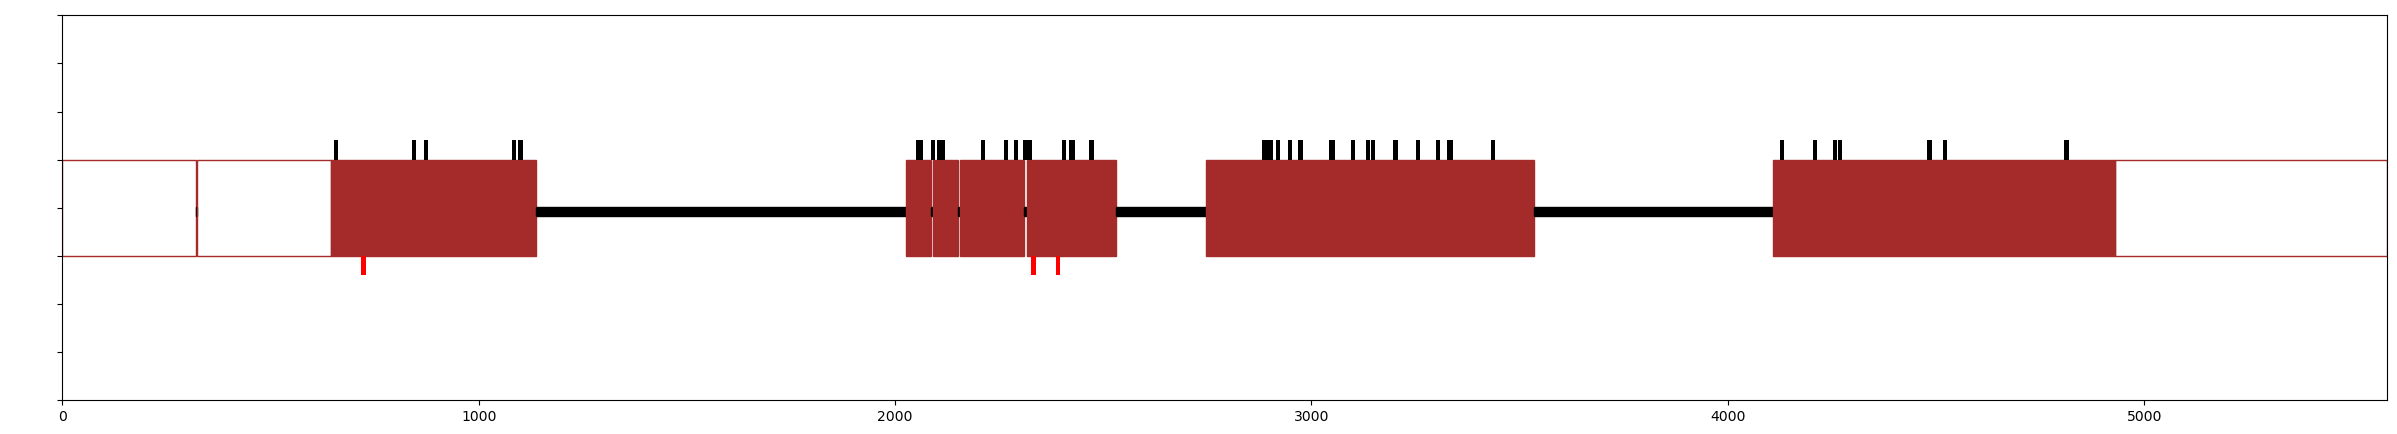

In [45]:
#NLGN1 exon chart

fig, ax = plt.subplots()

coding_exon_coor = []
x = 0

#calculate the lengths of each exon/intron and adds it to NLGN1_seq_dict[n]["len"] key:value pair
NLGN1_gene_len = 0
for i in NLGN1_seq_dict:
    NLGN1_gene_len += len(i['seq'])
for i in NLGN1_seq_dict:
    i['len']=len(i['seq'])
    #print (i['type']+"  len: "+str(i['len']))
    i['percent'] = len(i['seq'])/NLGN1_gene_len
for i in range(len(NLGN1_seq_dict)):
    if NLGN1_seq_dict[i]["type"] == "Coding exon":
        x+= NLGN1_seq_dict[i]["len"]
        coding_exon_coor.append(x)
coding_exon_coor_index = 0
len_index = 0

#shorten the length of the intron sequences to about 5% or 10% of their original length
for i in range(len(NLGN1_seq_dict)):
    if NLGN1_seq_dict[i]["type"] == "Intron":
        NLGN1_seq_dict[i]['len'] = NLGN1_seq_dict[i]['len']/(NLGN1_seq_dict[i]['len']*0.0015)**1.7

#shortens the non-coding exons for NLGN1        
for i in range(len(NLGN1_seq_dict)):        
    if NLGN1_seq_dict[i]["type"] == "Non-coding exon":
        if NLGN1_seq_dict[i]["len"] > x/5:
            NLGN1_seq_dict[i]["len"] = NLGN1_seq_dict[i]["len"]/20

NLGN1_gene_len = 0
for i in NLGN1_seq_dict:
    NLGN1_gene_len += i['len']

x=0
# NLGN1_gnomad_truncations = [20,195,225,435,450,451,451,524,562,569,571,516,552,662,717,741,763,767,769,851,868,871,916,1114,1117,1120,1130,1148,1176,1202,1275,1280,1329,1364,1376,1428,1428,1431,1485,1533,1558,1564,1664,1665,1786,1865,1866,1913,1925,2141,2179,2407,2472]
# NLGN1_clinvar_truncations = [74,835,2532]
for i in range(len(NLGN1_seq_dict)):
    if NLGN1_seq_dict[i]["type"] == "Non-coding exon":
        ax.add_patch(Rectangle((x,.25),NLGN1_seq_dict[i]['len'],.5,facecolor='none',edgecolor='brown'))
    elif NLGN1_seq_dict[i]["type"] == "Intron":
        ax.add_patch(Rectangle((x,.455),NLGN1_seq_dict[i]['len'],.05,facecolor='black',edgecolor='black'))
    elif NLGN1_seq_dict[i]["type"] == "Flanking Intron":
        ax.add_patch(Rectangle((x,.455),NLGN1_seq_dict[i]['len'],.05,facecolor='black',edgecolor='black'))
    else:
        ax.add_patch(Rectangle((x,.25),NLGN1_seq_dict[i]['len'],.5,facecolor='brown',edgecolor='brown'))
        len_index += NLGN1_seq_dict[i]['len']
        for j in range(len(NLGN1_gnomad_truncations)):
            if NLGN1_gnomad_truncations[j] <= len_index and NLGN1_gnomad_truncations[j] >= len_index-NLGN1_seq_dict[i]["len"]:
                ax.add_patch(Rectangle((x+(NLGN1_gnomad_truncations[j] - (len_index-NLGN1_seq_dict[i]["len"])),.75),10,.1,facecolor='black'))
        for j in range(len(NLGN1_clinvar_truncations)):
            if NLGN1_clinvar_truncations[j] <= len_index and NLGN1_clinvar_truncations[j] >= len_index-NLGN1_seq_dict[i]["len"]:
                ax.add_patch(Rectangle((x+(NLGN1_clinvar_truncations[j] - (len_index-NLGN1_seq_dict[i]["len"])),.15),10,.1,facecolor='red'))
         
    #coding_exon_coor.pop(0)
    x+= NLGN1_seq_dict[i]['len']

plt.axis([0,NLGN1_gene_len, -.5,1.5]) 
plt.rcParams['figure.figsize'] = [30, 5]
plt.yticks(color='w')
plt.show()

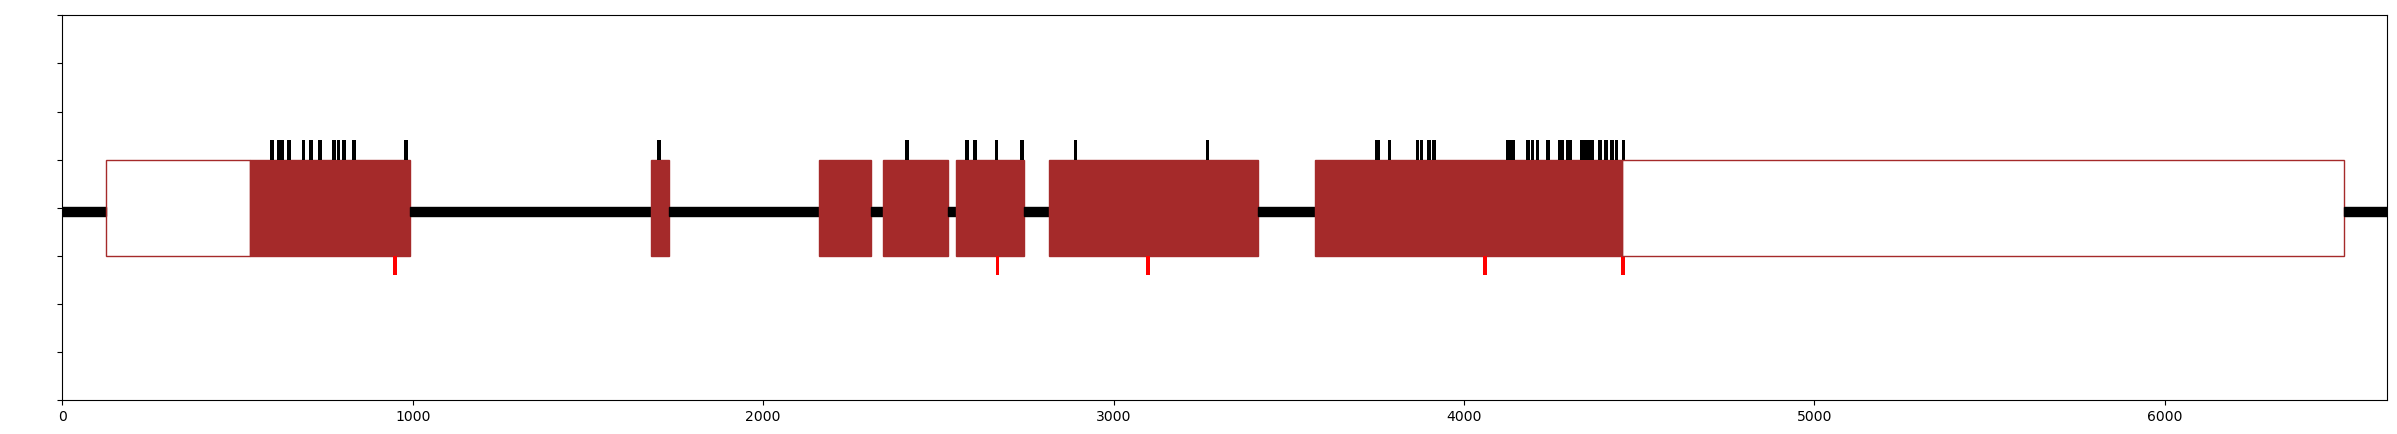

In [51]:
#NLGN2 exon chart

fig, ax = plt.subplots()

NLGN2_gene_len = 0
for i in NLGN2_seq_dict:
    NLGN2_gene_len += len(i['seq'])
for i in NLGN2_seq_dict:
    i['len']=len(i['seq'])
    i['percent'] = len(i['seq'])/NLGN2_gene_len
    
coding_exon_coor = []
x = 0
for i in range(len(NLGN2_seq_dict)):
    if NLGN2_seq_dict[i]["type"] == "Coding exon":
        x+= NLGN2_seq_dict[i]["len"]
        coding_exon_coor.append(x)
x=0
coding_exon_coor_index = 0
len_index = 0

for i in range(len(NLGN2_seq_dict)):
#shorten the length of the intron sequences to about 5% or 10% of their original length
     if NLGN2_seq_dict[i]["type"] == "Intron":
         NLGN2_seq_dict[i]['len'] = NLGN2_seq_dict[i]['len']/5
        

NLGN2_gene_len = 0
for i in NLGN2_seq_dict:
    NLGN2_gene_len += i['len']
    
#NLGN2_gnomad_truncations = [59,80,77,82,87,107,148,169,195,235,248,262,292,364,441,474,476,721,871,894,955,1027,1108,1485,1803,1807,1840,1902,1931,1953,1954,1967,2002,2177,2182,2190,2191,2194,2236,2249,2263,2293,2326,2332,2348,2350,2355,2400,2390,2389,2391,2405,2402,2408,2414,2417,2419,2441,2458,2475,2488,2508]
#NLGN2_clinvar_truncations = [409,1314]
for i in range(len(NLGN2_seq_dict)):
    if NLGN2_seq_dict[i]["type"] == "Non-coding exon":
        ax.add_patch(Rectangle((x,.25),NLGN2_seq_dict[i]['len'],.5,facecolor='none',edgecolor='brown'))
    elif NLGN2_seq_dict[i]["type"] == "Intron":
        ax.add_patch(Rectangle((x,.455),NLGN2_seq_dict[i]['len'],.05,facecolor='black',edgecolor='black'))
    elif NLGN2_seq_dict[i]["type"] == "Flanking Intron":
        ax.add_patch(Rectangle((x,.455),NLGN2_seq_dict[i]['len'],.05,facecolor='black',edgecolor='black'))
    else:
        ax.add_patch(Rectangle((x,.25),NLGN2_seq_dict[i]['len'],.5,facecolor='brown',edgecolor='brown'))
        len_index += NLGN2_seq_dict[i]['len']
        for j in range(len(NLGN2_gnomad_truncations)):
            if NLGN2_gnomad_truncations[j] <= len_index and NLGN2_gnomad_truncations[j] >= len_index-NLGN2_seq_dict[i]["len"]:
                ax.add_patch(Rectangle((x+(NLGN2_gnomad_truncations[j] - (len_index-NLGN2_seq_dict[i]["len"])),.75),10,.1,facecolor='black'))
        for j in range(len(NLGN2_clinvar_truncations)):
            if NLGN2_clinvar_truncations[j] <= len_index and NLGN2_clinvar_truncations[j] >= len_index-NLGN2_seq_dict[i]["len"]:
                ax.add_patch(Rectangle((x+(NLGN2_clinvar_truncations[j] - (len_index-NLGN2_seq_dict[i]["len"])),.15),10,.1,facecolor='red'))
            
                
                
                
            
            
    #coding_exon_coor.pop(0)
    x+= NLGN2_seq_dict[i]['len']

plt.axis([0,NLGN2_gene_len, -.5,1.5]) 
plt.rcParams['figure.figsize'] = [30, 5]
plt.yticks(color='w')
plt.show()

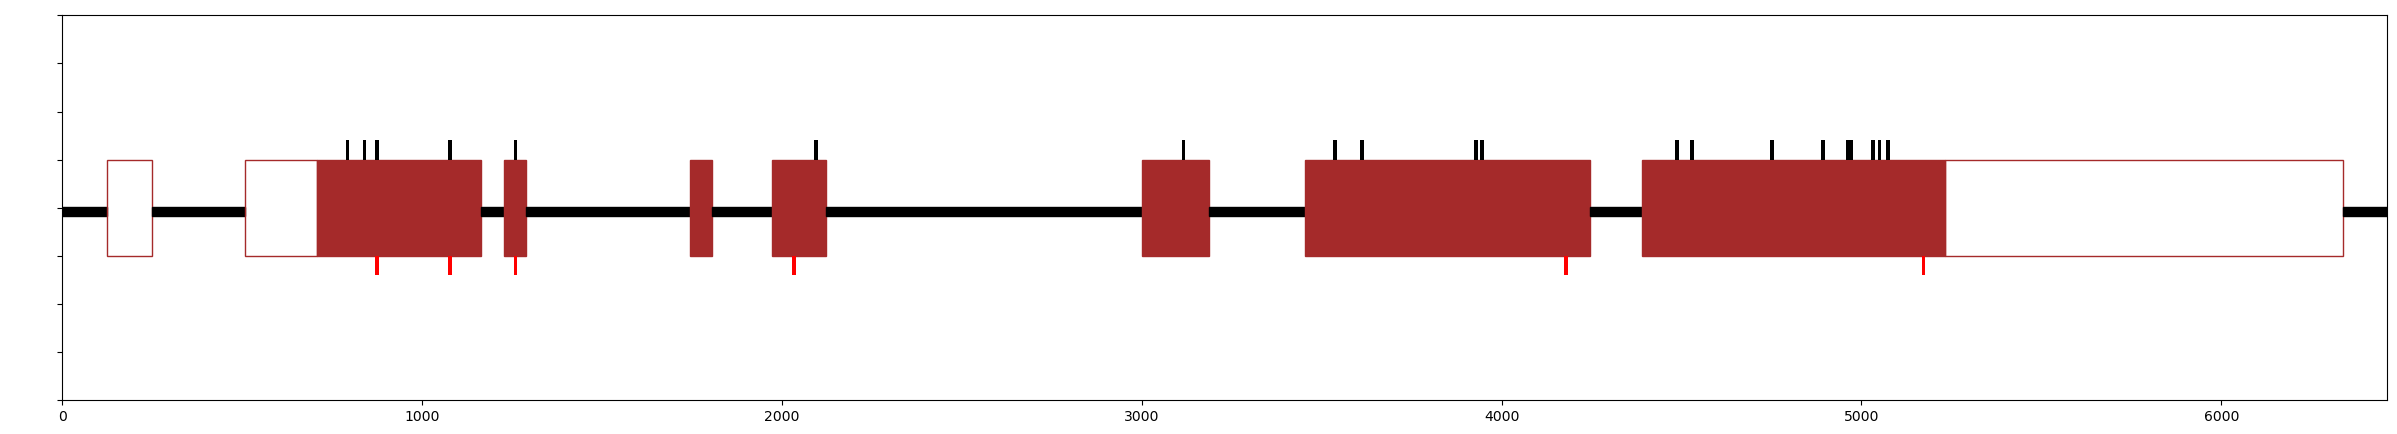

In [53]:
#NLGN3 exon chart

fig, ax = plt.subplots()

NLGN3_gene_len = 0
for i in NLGN3_seq_dict:
    NLGN3_gene_len += len(i['seq'])
for i in NLGN3_seq_dict:
    i['len']=len(i['seq'])
    i['percent'] = len(i['seq'])/NLGN3_gene_len
coding_exon_coor = []

x = 0
for i in range(len(NLGN3_seq_dict)):
    if NLGN3_seq_dict[i]["type"] == "Coding exon":
        x+= NLGN3_seq_dict[i]["len"]
        coding_exon_coor.append(x)
x=0
coding_exon_coor_index = 0
len_index = 0

for i in range(len(NLGN3_seq_dict)):
#shorten the length of the intron sequences to about 5% or 10% of their original length
     if NLGN3_seq_dict[i]["type"] == "Intron":
         NLGN3_seq_dict[i]['len'] = NLGN3_seq_dict[i]['len']/10
        

NLGN3_gene_len = 0
for i in NLGN3_seq_dict:
    NLGN3_gene_len += i['len']
    
NLGN3_female_gnomad_truncations = NLGN3_gnomad_truncations
NLGN3_male_gnomad_truncations = []
#NLGN3_clinvar_truncations = 
for i in range(len(NLGN3_seq_dict)):
    if NLGN3_seq_dict[i]["type"] == "Non-coding exon":
        ax.add_patch(Rectangle((x,.25),NLGN3_seq_dict[i]['len'],.5,facecolor='none',edgecolor='brown'))
    elif NLGN3_seq_dict[i]["type"] == "Intron":
        ax.add_patch(Rectangle((x,.455),NLGN3_seq_dict[i]['len'],.05,facecolor='black',edgecolor='black'))
    elif NLGN3_seq_dict[i]["type"] == "Flanking Intron":
        ax.add_patch(Rectangle((x,.455),NLGN3_seq_dict[i]['len'],.05,facecolor='black',edgecolor='black'))
    else:
        ax.add_patch(Rectangle((x,.25),NLGN3_seq_dict[i]['len'],.5,facecolor='brown',edgecolor='brown'))
        len_index += NLGN3_seq_dict[i]['len']
        for j in range(len(NLGN3_female_gnomad_truncations)):
            if NLGN3_female_gnomad_truncations[j] <= len_index and NLGN3_female_gnomad_truncations[j] >= len_index-NLGN3_seq_dict[i]["len"]:
                ax.add_patch(Rectangle((x+(NLGN3_female_gnomad_truncations[j] - (len_index-NLGN3_seq_dict[i]["len"])),.75),10,.1,facecolor='black'))
        for j in range(len(NLGN3_male_gnomad_truncations)):
            if NLGN3_gnomad_male_truncations[j] <= len_index and NLGN3_male_gnomad_truncations[j] >= len_index-NLGN3_seq_dict[i]["len"]:
                ax.add_patch(Rectangle((x+(NLGN3_male_gnomad_truncations[j] - (len_index-NLGN3_seq_dict[i]["len"])),.75),10,.1,facecolor='blue'))
        for j in range(len(NLGN3_clinvar_truncations)):
            if NLGN3_clinvar_truncations[j] <= len_index and NLGN3_clinvar_truncations[j] >= len_index-NLGN3_seq_dict[i]["len"]:
                ax.add_patch(Rectangle((x+(NLGN3_clinvar_truncations[j] - (len_index-NLGN3_seq_dict[i]["len"])),.15),10,.1,facecolor='red'))
            
            
    #coding_exon_coor.pop(0)
    x+= NLGN3_seq_dict[i]['len']

plt.axis([0,NLGN3_gene_len, -.5,1.5]) 
plt.rcParams['figure.figsize'] = [30, 5]
plt.yticks(color='w')
plt.show()


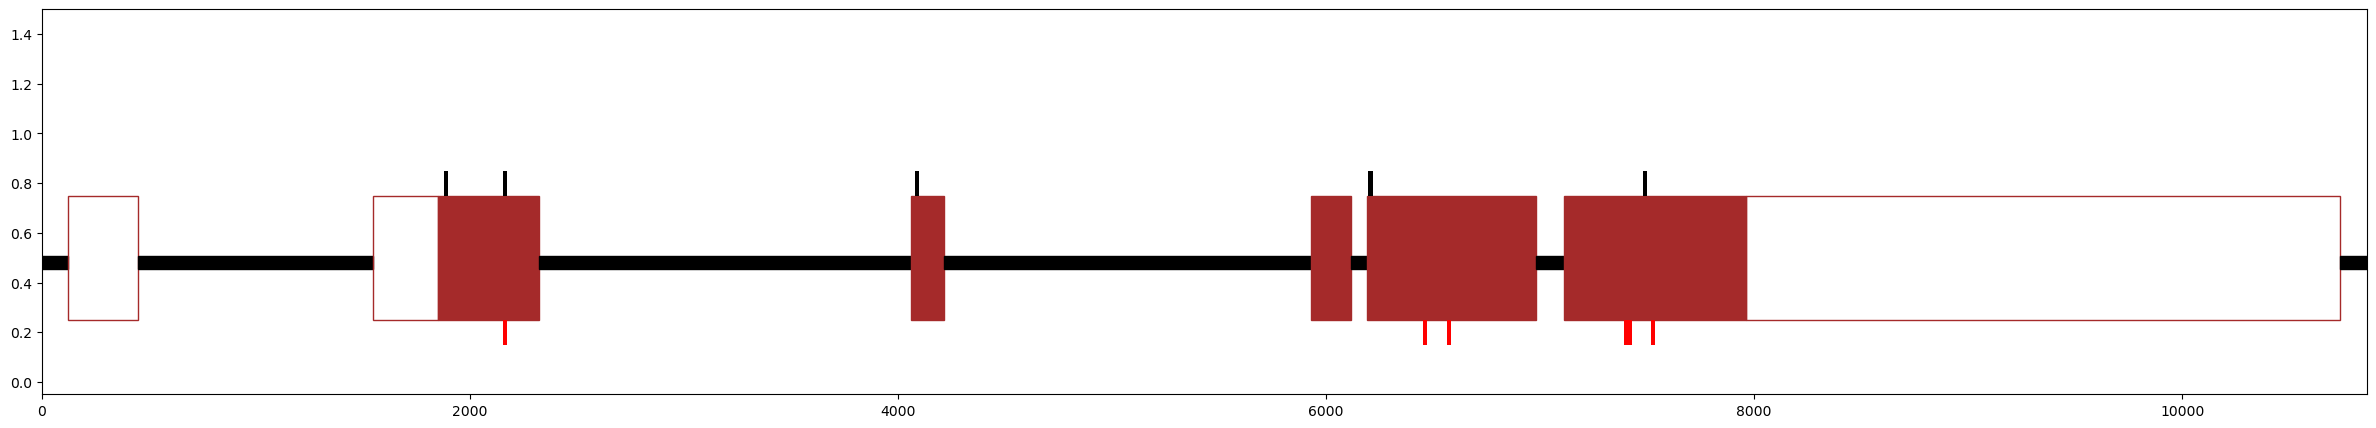

In [56]:
#NLGN4X exon chart

fig, ax = plt.subplots()

NLGN4X_seq_dict[1]['seq']
NLGN4X_gene_len = 0
for i in NLGN4X_seq_dict:
    NLGN4X_gene_len += len(i['seq'])
for i in NLGN4X_seq_dict:
    i['len']=len(i['seq'])
    i['percent'] = len(i['seq'])/NLGN4X_gene_len

coding_exon_coor = []
x = 0
for i in range(len(NLGN4X_seq_dict)):
    if NLGN4X_seq_dict[i]["type"] == "Coding exon":
        x+= NLGN4X_seq_dict[i]["len"]
        coding_exon_coor.append(x)
x=0
coding_exon_coor_index = 0
len_index = 0



NLGN4X_female_gnomad_truncations = NLGN4X_gnomad_truncations
NLGN4X_male_gnomad_truncations = []
NLGN4X_clinvar_truncations = [2005, 1898, 1879, 1185, 1075, 301]
NLGN4X_female_gnomad_truncations.sort()
NLGN4X_male_gnomad_truncations.sort()
NLGN4X_clinvar_truncations.sort()

for i in range(len(NLGN4X_seq_dict)):
    #shorten the length of the intron sequences to about 5% or 10% of their original length
    if NLGN4X_seq_dict[i]["type"] == "Intron":
        NLGN4X_seq_dict[i]['len'] = NLGN4X_seq_dict[i]['len']/70
        

NLGN4X_gene_len = 0
for i in NLGN4X_seq_dict:
    NLGN4X_gene_len += i['len']
    
for i in range(len(NLGN4X_seq_dict)):
    if NLGN4X_seq_dict[i]["type"] == "Non-coding exon":
        ax.add_patch(Rectangle((x,.25),NLGN4X_seq_dict[i]['len'],.5,facecolor='none',edgecolor='brown'))
    elif NLGN4X_seq_dict[i]["type"] == "Flanking Intron":
        ax.add_patch(Rectangle((x,.455),NLGN4X_seq_dict[i]['len'],.05,facecolor='black',edgecolor='black'))
    elif NLGN4X_seq_dict[i]["type"] == "Intron":
        ax.add_patch(Rectangle((x,.455),(NLGN4X_seq_dict[i]['len']/1),.05,facecolor='black',edgecolor='black'))
    else:
        ax.add_patch(Rectangle((x,.25),NLGN4X_seq_dict[i]['len'],.5,facecolor='brown',edgecolor='brown'))
        len_index += NLGN4X_seq_dict[i]['len']
        for j in range(len(NLGN4X_female_gnomad_truncations)):
            if NLGN4X_female_gnomad_truncations[j] <= len_index and NLGN4X_female_gnomad_truncations[j] >= len_index-NLGN4X_seq_dict[i]["len"]:
                ax.add_patch(Rectangle((x+(NLGN4X_female_gnomad_truncations[j] - (len_index-NLGN4X_seq_dict[i]["len"])),.75),20,.1,facecolor='black'))
        for j in range(len(NLGN4X_male_gnomad_truncations)):
            if NLGN4X_male_gnomad_truncations[j] <= len_index and NLGN4X_male_gnomad_truncations[j] >= len_index-NLGN4X_seq_dict[i]["len"]:
                ax.add_patch(Rectangle((x+(NLGN4X_male_gnomad_truncations[j] - (len_index-NLGN4X_seq_dict[i]["len"])),.75),20,.1,facecolor='blue'))
        for j in range(len(NLGN4X_clinvar_truncations)):
            if NLGN4X_clinvar_truncations[j] <= len_index and NLGN4X_clinvar_truncations[j] >= len_index-NLGN4X_seq_dict[i]["len"]:
                ax.add_patch(Rectangle((x+(NLGN4X_clinvar_truncations[j] - (len_index-NLGN4X_seq_dict[i]["len"])),.15),20,.1,facecolor='red'))
     
    #coding_exon_coor.pop(0)
    x+= NLGN4X_seq_dict[i]['len']

plt.axis([0,NLGN4X_gene_len, -.05,1.5]) 
plt.rcParams['figure.figsize'] = [30, 5]
#plt.xticks(color='w')
plt.show()
